# __SHOW, ATTEND, AND TELL__

In this notebook, work conducted for METU MMI727 course project is demonstrated. In this project, **Show, Attend, and Tell** [***put_reference] image captioning model is examined. Implementation available in [A PyTorch Tutorial to Image Captioning](https://github.com/sgrvinod/a-PyTorch-Tutorial-to-Image-Captioning) is taken as a baseline and different improvement strategies are examined. The baseline model and 5 modified models are trained on MSCOCO image captioning dataset [***put_reference]. These 6 models are benchmarked and compared on the test set of MSCOCO.

## Implementation Details
In this work, 6 different models are trained and benchmarked. All models utilize ResNet101 backbone with some modifications in either ResNet encoder block, Attention block, or decoder block.

Details about models are as follows:  
Model 1: Default implementation provided at [A PyTorch Tutorial to Image Captioning](https://github.com/sgrvinod/a-PyTorch-Tutorial-to-Image-Captioning).  
Model 2: Attention block is modified. Different from Model 1, instead of summing attention vectors for encoder output and decoder hidden state, they are concatenated and passed through a linear layer.  
Model 3: Decoder block is modified. Different from Model 1, instead of LSTM, GRU is used as the decoder.  
Model 4: Encoder block is modified. Different form Model 1 (utilizes conv5_x output of ResNet101), modified conv4_x output of ResNet101 is utilized as final layer of encoder. See project report for details.  
Model 5: Encoder block is modified. Different from Model 1, 2-level Feature Pyramid Network (FPN) is implemented at the encoder part.  
Model 6: Decoder block is modified. Different from Model 1, 2-layer LSTM is used as the decoder.  

Details of models are read from config files with `.yaml` extensions. Config files for these models are provided under `configs` folder.

## Import necessary modules and helper files

In [19]:
from torch import nn
import torch.optim
import torch.utils.data
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence
from datasets import *
from utils import *
import time
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from nltk.translate.bleu_score import corpus_bleu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # sets device for model and PyTorch tensors
%matplotlib inline

## DATASET AND CONFIG FILES
Download `dataset` folder in this link [***put_link] and put it in the same directory as this notebook.

For data loading operations `hdf5` files are used beacuse whole dataset is too large to read at once.

Note that TRAIN `hdf5` file in `dataset` folder is actually `TEST` set of COCO dataset. I could not upload actual `TRAIN` set because it was 22 GB. 

## THIS NOTEBOOK CONTAINS 3 SECTIONS:
### 1) TRAINING
### 2) EVALUATION ON THE TEST SET
### 3) INFERENCE ON IMAGES

# __1) TRAINING__

## Define Paths to Config File and Dataset Related Files

In [2]:
config_path = "configs_test/model_1_config.yaml" # path to model config file
image_data_folder = "dataset/" # path to directory which holds image data
image_data_name = "coco_5_cap_per_img_5_min_word_freq" # name for the dataset created with create_input_files.py
word_map_path = "dataset/WORDMAP_coco_5_cap_per_img_5_min_word_freq.json" # path to file which maps words to integers
output_path = "test_out/" # path to save checkpoints

## Load Word_map and Config Files

In [3]:
# Load wordmap file and config file
word_map = None
with open(word_map_path, 'r') as j:
    word_map = json.load(j)

cfgData = None
with open(config_path, "r") as cfgFile:
        cfgData = yaml.safe_load(cfgFile)

modelTypes = cfgData["Model Type"]
modelParams = cfgData["Model Parameters"]
trainParams = cfgData["Training Parameters"]

## Create Model According To Config File

In [4]:
encoder, decoder, encoder_optimizer, decoder_optimizer, epochs_since_improvement, best_bleu4, \
            encoderType, decoderType, attentionType, enable2LayerDecoder = create_model_for_training(config_path, len(word_map))

Encoder Type: default
Decoder Type: LSTM
Attention Type: default
Encoder Dim: 2048
Enable2LayerDecoder: False


## Print Details of Encoder and Decoder

In [5]:
print("***ENCODER***")
print(encoder)
print("\n\n***DECODER***")
print(decoder)

***ENCODER***
Encoder(
  (resnet): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0)

## Define Loss Function
CrossEntropyLoss is used to calculate loss between decoder output and ground truth label (one-hot encoded words for each time instant).

In [6]:
# Loss function
criterion = nn.CrossEntropyLoss().to(device)

## Load Dataset Using Custom Data Loader
Normalize dataset and define data loaders using custom dataset class provided by the [A PyTorch Tutorial to Image Captioning](https://github.com/sgrvinod/a-PyTorch-Tutorial-to-Image-Captioning) repository.

In [7]:
# Custom dataloaders
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])
train_loader = torch.utils.data.DataLoader(
    CaptionDataset(image_data_folder, image_data_name, 'TRAIN', transform=transforms.Compose([normalize])),
    batch_size=trainParams["batch_size"], shuffle=True, num_workers=1, pin_memory=True)
val_loader = torch.utils.data.DataLoader(
    CaptionDataset(image_data_folder, image_data_name, 'VAL', transform=transforms.Compose([normalize])),
    batch_size=trainParams["batch_size"], shuffle=True, num_workers=1, pin_memory=True)

## TRAINING
Define training loop and perform training.

In [ ]:
# Epochs
print_freq = 50  # print training/validation stats every __ batches
for epoch in range(trainParams["start_epoch"], trainParams["num_epochs"]):

    # Decay learning rate if there is no improvement for 8 consecutive epochs
    if epochs_since_improvement > 0 and epochs_since_improvement % 8 == 0:
        adjust_learning_rate(decoder_optimizer, 0.8)
        if trainParams["fine_tune_encoder"]:
            adjust_learning_rate(encoder_optimizer, 0.8)

    # ***************TRAINING********************
    # put models in train mode
    decoder.train()
    encoder.train()

    batch_time = AverageMeter()  # forward prop. + back prop. time
    data_time = AverageMeter()  # data loading time
    losses = AverageMeter()  # loss (per word decoded)
    top5accs = AverageMeter()  # top5 accuracy

    start = time.time()

    # Batches
    for i, (imgs, caps, caplens) in enumerate(train_loader):
        data_time.update(time.time() - start)

        # Move to GPU, if available
        imgs = imgs.to(device)
        caps = caps.to(device)
        caplens = caplens.to(device)

        # Forward prop.
        imgs = encoder(imgs)
        scores, caps_sorted, decode_lengths, alphas, sort_ind = decoder(imgs, caps, caplens)

        # Since we decoded starting with <start>, the targets are all words after <start>, up to <end>
        targets = caps_sorted[:, 1:]

        # Remove timesteps that we didn't decode at, or are pads
        # pack_padded_sequence is an easy trick to do this
        # ***too many values to unpack error https://github.com/sgrvinod/a-PyTorch-Tutorial-to-Image-Captioning/issues/86
        scores = pack_padded_sequence(scores, decode_lengths, batch_first=True).data
        targets = pack_padded_sequence(targets, decode_lengths, batch_first=True).data

        # Calculate loss
        loss = criterion(scores, targets)

        # Add doubly stochastic attention regularization
        loss += trainParams["alpha_c"] * ((1. - alphas.sum(dim=1)) ** 2).mean()

        # Back prop.
        decoder_optimizer.zero_grad()
        if encoder_optimizer is not None:
            encoder_optimizer.zero_grad()
        loss.backward()

        # Clip gradients
        if trainParams["grad_clip"] is not None:
            clip_gradient(decoder_optimizer, trainParams["grad_clip"])
            if encoder_optimizer is not None:
                clip_gradient(encoder_optimizer, trainParams["grad_clip"])

        # Update weights
        decoder_optimizer.step()
        if encoder_optimizer is not None:
            encoder_optimizer.step()

        # Keep track of metrics
        top5 = accuracy(scores, targets, 5)
        losses.update(loss.item(), sum(decode_lengths))
        top5accs.update(top5, sum(decode_lengths))
        batch_time.update(time.time() - start)

        start = time.time()

        # Print status
        if i % print_freq == 0:
            print('Epoch: [{0}][{1}/{2}]\t'
                  'Batch Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Data Load Time {data_time.val:.3f} ({data_time.avg:.3f})\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Top-5 Accuracy {top5.val:.3f} ({top5.avg:.3f})'.format(epoch, i, len(train_loader),
                                                                          batch_time=batch_time,
                                                                          data_time=data_time, loss=losses,
                                                                          top5=top5accs))

    # ***************VALIDATION********************

    decoder.eval()  # eval mode (no dropout or batchnorm)
    if encoder is not None:
        encoder.eval()

    batch_time_eval = AverageMeter()
    losses_eval = AverageMeter()
    top5accs_eval = AverageMeter()

    start_eval = time.time()

    references = list()  # references (true captions) for calculating BLEU-4 score
    hypotheses = list()  # hypotheses (predictions)

    # explicitly disable gradient calculation to avoid CUDA memory error
    # solves the issue #57
    with torch.no_grad():
        # Batches
        for i, (imgs, caps, caplens, allcaps) in enumerate(val_loader):

            # Move to device, if available
            imgs = imgs.to(device)
            caps = caps.to(device)
            caplens = caplens.to(device)

            # Forward prop.
            if encoder is not None:
                imgs = encoder(imgs)
            scores, caps_sorted, decode_lengths, alphas, sort_ind = decoder(imgs, caps, caplens)

            # Since we decoded starting with <start>, the targets are all words after <start>, up to <end>
            targets = caps_sorted[:, 1:]

            # Remove timesteps that we didn't decode at, or are pads
            # pack_padded_sequence is an easy trick to do this
            scores_copy = scores.clone()
            scores = pack_padded_sequence(scores, decode_lengths, batch_first=True).data
            targets = pack_padded_sequence(targets, decode_lengths, batch_first=True).data

            # Calculate loss
            loss = criterion(scores, targets)

            # Add doubly stochastic attention regularization
            loss += trainParams["alpha_c"] * ((1. - alphas.sum(dim=1)) ** 2).mean()
            
            # Keep track of metrics
            losses_eval.update(loss.item(), sum(decode_lengths))
            top5 = accuracy(scores, targets, 5)
            top5accs_eval.update(top5, sum(decode_lengths))
            batch_time_eval.update(time.time() - start_eval)

            start_eval = time.time()

            if i % print_freq == 0:
                print('Validation: [{0}/{1}]\t'
                      'Batch Time {batch_time_eval.val:.3f} ({batch_time_eval.avg:.3f})\t'
                      'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                      'Top-5 Accuracy {top5.val:.3f} ({top5.avg:.3f})\t'.format(i, len(val_loader), batch_time_eval=batch_time_eval,
                                                                                loss=losses_eval, top5=top5accs_eval))

            # Store references (true captions), and hypothesis (prediction) for each image
            # If for n images, we have n hypotheses, and references a, b, c... for each image, we need -
            # references = [[ref1a, ref1b, ref1c], [ref2a, ref2b], ...], hypotheses = [hyp1, hyp2, ...]

            # References
            allcaps = allcaps[sort_ind]  # because images were sorted in the decoder
            for j in range(allcaps.shape[0]):
                img_caps = allcaps[j].tolist()
                img_captions = list(
                    map(lambda c: [w for w in c if w not in {word_map['<start>'], word_map['<pad>']}],
                        img_caps))  # remove <start> and pads
                references.append(img_captions)

            # Hypotheses
            _, preds = torch.max(scores_copy, dim=2)
            preds = preds.tolist()
            temp_preds = list()
            for j, p in enumerate(preds):
                temp_preds.append(preds[j][:decode_lengths[j]])  # remove pads
            preds = temp_preds
            hypotheses.extend(preds)

            assert len(references) == len(hypotheses)

        # Calculate BLEU-4 scores
        bleu4 = corpus_bleu(references, hypotheses)

        print(
            '\n * LOSS - {loss.avg:.3f}, TOP-5 ACCURACY - {top5.avg:.3f}, BLEU-4 - {bleu}\n'.format(
                loss=losses_eval,
                top5=top5accs_eval,
                bleu=bleu4))

    recent_bleu4 = bleu4

    # Check if there was an improvement
    is_best = recent_bleu4 > best_bleu4
    best_bleu4 = max(recent_bleu4, best_bleu4)
    if not is_best:
        epochs_since_improvement += 1
        print("\nEpochs since last improvement: %d\n" % (epochs_since_improvement,))
    else:
        epochs_since_improvement = 0

    # Save checkpoint
    save_checkpoint(image_data_name, epoch, epochs_since_improvement, encoderType, decoderType, enable2LayerDecoder, attentionType, encoder, decoder, encoder_optimizer,
                    decoder_optimizer, recent_bleu4, is_best, epoch, output_path)

Since I trained all 6 models using separate `train.py`, training outputs are not present in this notebook. Instead, I had saved training outputs into a text file. So, I paste training outputs for all 6 models below.

## MODEL - 1
```text
Encoder Type: default
Decoder Type: LSTM
Attention Type: default
Epoch: [0][0/8851]	Batch Time 3.582 (3.582)	Data Load Time 0.966 (0.966)	Loss 10.0643 (10.0643)	Top-5 Accuracy 0.133 (0.133)
Epoch: [0][50/8851]	Batch Time 0.797 (0.865)	Data Load Time 0.000 (0.019)	Loss 6.9936 (7.9587)	Top-5 Accuracy 34.322 (29.157)
Epoch: [0][100/8851]	Batch Time 0.825 (0.836)	Data Load Time 0.000 (0.010)	Loss 6.3946 (7.3073)	Top-5 Accuracy 36.608 (32.017)
Epoch: [0][150/8851]	Batch Time 0.781 (0.827)	Data Load Time 0.000 (0.007)	Loss 6.4095 (6.9648)	Top-5 Accuracy 34.199 (33.520)
Epoch: [0][200/8851]	Batch Time 0.855 (0.830)	Data Load Time 0.000 (0.005)	Loss 5.9462 (6.7343)	Top-5 Accuracy 38.643 (34.700)
Epoch: [0][250/8851]	Batch Time 0.890 (0.844)	Data Load Time 0.000 (0.004)	Loss 5.7486 (6.5707)	Top-5 Accuracy 42.005 (35.743)
Epoch: [0][300/8851]	Batch Time 0.908 (0.855)	Data Load Time 0.000 (0.003)	Loss 5.8453 (6.4383)	Top-5 Accuracy 39.065 (36.656)
Epoch: [0][350/8851]	Batch Time 0.925 (0.863)	Data Load Time 0.000 (0.003)	Loss 5.6586 (6.3224)	Top-5 Accuracy 43.742 (37.579)
Epoch: [0][400/8851]	Batch Time 0.967 (0.879)	Data Load Time 0.033 (0.015)	Loss 5.4642 (6.2269)	Top-5 Accuracy 46.011 (38.459)
Epoch: [0][450/8851]	Batch Time 0.944 (0.885)	Data Load Time 0.000 (0.014)	Loss 5.4434 (6.1392)	Top-5 Accuracy 46.410 (39.337)
Epoch: [0][500/8851]	Batch Time 0.968 (0.890)	Data Load Time 0.000 (0.013)	Loss 5.2450 (6.0589)	Top-5 Accuracy 50.327 (40.216)
Epoch: [0][550/8851]	Batch Time 0.939 (0.893)	Data Load Time 0.000 (0.011)	Loss 5.1463 (5.9887)	Top-5 Accuracy 50.132 (41.024)
Epoch: [0][600/8851]	Batch Time 0.928 (0.895)	Data Load Time 0.000 (0.010)	Loss 5.2033 (5.9233)	Top-5 Accuracy 51.319 (41.799)
Epoch: [0][650/8851]	Batch Time 0.910 (0.898)	Data Load Time 0.000 (0.010)	Loss 5.1572 (5.8625)	Top-5 Accuracy 52.355 (42.516)
Epoch: [0][700/8851]	Batch Time 0.949 (0.900)	Data Load Time 0.000 (0.009)	Loss 5.1204 (5.8058)	Top-5 Accuracy 52.747 (43.170)
Epoch: [0][750/8851]	Batch Time 0.913 (0.902)	Data Load Time 0.000 (0.008)	Loss 5.0916 (5.7563)	Top-5 Accuracy 52.878 (43.760)
Epoch: [0][800/8851]	Batch Time 0.921 (0.903)	Data Load Time 0.000 (0.008)	Loss 5.3105 (5.7104)	Top-5 Accuracy 48.623 (44.323)
Epoch: [0][850/8851]	Batch Time 0.875 (0.904)	Data Load Time 0.000 (0.007)	Loss 4.8174 (5.6649)	Top-5 Accuracy 54.908 (44.903)
Epoch: [0][900/8851]	Batch Time 0.889 (0.904)	Data Load Time 0.000 (0.007)	Loss 4.6847 (5.6227)	Top-5 Accuracy 57.447 (45.424)
Epoch: [0][950/8851]	Batch Time 0.896 (0.904)	Data Load Time 0.000 (0.007)	Loss 4.8887 (5.5823)	Top-5 Accuracy 54.545 (45.917)
Epoch: [0][1000/8851]	Batch Time 0.883 (0.904)	Data Load Time 0.000 (0.006)	Loss 4.7530 (5.5461)	Top-5 Accuracy 56.860 (46.376)
Epoch: [0][1050/8851]	Batch Time 0.905 (0.904)	Data Load Time 0.000 (0.006)	Loss 4.8179 (5.5102)	Top-5 Accuracy 56.053 (46.827)
Epoch: [0][1100/8851]	Batch Time 0.881 (0.904)	Data Load Time 0.000 (0.006)	Loss 4.7246 (5.4768)	Top-5 Accuracy 55.753 (47.245)
Epoch: [0][1150/8851]	Batch Time 0.962 (0.904)	Data Load Time 0.000 (0.006)	Loss 4.7241 (5.4455)	Top-5 Accuracy 57.915 (47.645)
Epoch: [0][1200/8851]	Batch Time 0.895 (0.904)	Data Load Time 0.000 (0.005)	Loss 4.5710 (5.4162)	Top-5 Accuracy 57.379 (48.006)
Epoch: [0][1250/8851]	Batch Time 0.887 (0.903)	Data Load Time 0.000 (0.005)	Loss 4.6979 (5.3872)	Top-5 Accuracy 56.929 (48.372)
Epoch: [0][1300/8851]	Batch Time 0.893 (0.903)	Data Load Time 0.000 (0.005)	Loss 4.6554 (5.3602)	Top-5 Accuracy 56.216 (48.706)
Epoch: [0][1350/8851]	Batch Time 0.877 (0.903)	Data Load Time 0.000 (0.005)	Loss 4.9127 (5.3342)	Top-5 Accuracy 55.177 (49.034)
Epoch: [0][1400/8851]	Batch Time 0.933 (0.903)	Data Load Time 0.000 (0.005)	Loss 4.8905 (5.3092)	Top-5 Accuracy 54.856 (49.341)
Epoch: [0][1450/8851]	Batch Time 0.912 (0.902)	Data Load Time 0.000 (0.004)	Loss 4.5924 (5.2847)	Top-5 Accuracy 59.634 (49.652)
Epoch: [0][1500/8851]	Batch Time 0.891 (0.902)	Data Load Time 0.000 (0.004)	Loss 4.6415 (5.2620)	Top-5 Accuracy 57.953 (49.941)
Epoch: [0][1550/8851]	Batch Time 0.888 (0.902)	Data Load Time 0.000 (0.004)	Loss 4.6440 (5.2390)	Top-5 Accuracy 57.405 (50.236)
Epoch: [0][1600/8851]	Batch Time 0.889 (0.902)	Data Load Time 0.000 (0.004)	Loss 4.5269 (5.2175)	Top-5 Accuracy 58.887 (50.502)
Epoch: [0][1650/8851]	Batch Time 0.902 (0.902)	Data Load Time 0.000 (0.004)	Loss 4.4780 (5.1969)	Top-5 Accuracy 56.753 (50.759)
Epoch: [0][1700/8851]	Batch Time 0.879 (0.902)	Data Load Time 0.000 (0.004)	Loss 4.5110 (5.1777)	Top-5 Accuracy 59.607 (51.008)
Epoch: [0][1750/8851]	Batch Time 0.886 (0.901)	Data Load Time 0.000 (0.004)	Loss 4.3607 (5.1593)	Top-5 Accuracy 61.796 (51.241)
Epoch: [0][1800/8851]	Batch Time 0.896 (0.901)	Data Load Time 0.000 (0.004)	Loss 4.4996 (5.1407)	Top-5 Accuracy 59.530 (51.476)
Epoch: [0][1850/8851]	Batch Time 0.913 (0.901)	Data Load Time 0.000 (0.004)	Loss 4.5142 (5.1242)	Top-5 Accuracy 59.763 (51.693)
Epoch: [0][1900/8851]	Batch Time 0.960 (0.901)	Data Load Time 0.000 (0.003)	Loss 4.5476 (5.1064)	Top-5 Accuracy 60.594 (51.917)
Epoch: [0][1950/8851]	Batch Time 0.933 (0.902)	Data Load Time 0.000 (0.003)	Loss 4.4371 (5.0883)	Top-5 Accuracy 60.370 (52.149)
Epoch: [0][2000/8851]	Batch Time 0.931 (0.902)	Data Load Time 0.000 (0.003)	Loss 4.6974 (5.0722)	Top-5 Accuracy 57.123 (52.350)
Epoch: [0][2050/8851]	Batch Time 0.910 (0.903)	Data Load Time 0.000 (0.003)	Loss 4.3594 (5.0561)	Top-5 Accuracy 61.601 (52.563)
Epoch: [0][2100/8851]	Batch Time 0.934 (0.903)	Data Load Time 0.000 (0.003)	Loss 4.4666 (5.0404)	Top-5 Accuracy 60.771 (52.764)
Epoch: [0][2150/8851]	Batch Time 0.950 (0.904)	Data Load Time 0.000 (0.003)	Loss 4.4293 (5.0253)	Top-5 Accuracy 60.537 (52.960)
Epoch: [0][2200/8851]	Batch Time 0.905 (0.904)	Data Load Time 0.000 (0.003)	Loss 4.2785 (5.0110)	Top-5 Accuracy 62.932 (53.141)
Epoch: [0][2250/8851]	Batch Time 0.904 (0.904)	Data Load Time 0.000 (0.003)	Loss 4.3748 (4.9970)	Top-5 Accuracy 60.667 (53.323)
Epoch: [0][2300/8851]	Batch Time 0.879 (0.905)	Data Load Time 0.000 (0.003)	Loss 4.3930 (4.9835)	Top-5 Accuracy 61.233 (53.498)
Epoch: [0][2350/8851]	Batch Time 0.886 (0.905)	Data Load Time 0.000 (0.003)	Loss 4.3604 (4.9701)	Top-5 Accuracy 61.204 (53.672)
Epoch: [0][2400/8851]	Batch Time 0.886 (0.905)	Data Load Time 0.000 (0.003)	Loss 4.1424 (4.9563)	Top-5 Accuracy 64.993 (53.841)
Epoch: [0][2450/8851]	Batch Time 0.894 (0.905)	Data Load Time 0.000 (0.003)	Loss 4.4090 (4.9442)	Top-5 Accuracy 61.944 (53.991)
Epoch: [0][2500/8851]	Batch Time 0.905 (0.905)	Data Load Time 0.000 (0.003)	Loss 4.4100 (4.9314)	Top-5 Accuracy 61.308 (54.154)
Epoch: [0][2550/8851]	Batch Time 0.874 (0.905)	Data Load Time 0.000 (0.003)	Loss 4.0208 (4.9193)	Top-5 Accuracy 66.436 (54.307)
Epoch: [0][2600/8851]	Batch Time 0.901 (0.905)	Data Load Time 0.000 (0.003)	Loss 4.2367 (4.9067)	Top-5 Accuracy 61.757 (54.464)
Epoch: [0][2650/8851]	Batch Time 0.925 (0.905)	Data Load Time 0.000 (0.003)	Loss 4.1442 (4.8948)	Top-5 Accuracy 64.163 (54.620)
Epoch: [0][2700/8851]	Batch Time 0.879 (0.905)	Data Load Time 0.000 (0.003)	Loss 4.2953 (4.8831)	Top-5 Accuracy 62.429 (54.769)
Epoch: [0][2750/8851]	Batch Time 0.910 (0.905)	Data Load Time 0.000 (0.002)	Loss 4.1347 (4.8717)	Top-5 Accuracy 64.917 (54.914)
Epoch: [0][2800/8851]	Batch Time 0.904 (0.905)	Data Load Time 0.000 (0.002)	Loss 4.2295 (4.8608)	Top-5 Accuracy 64.795 (55.053)
Epoch: [0][2850/8851]	Batch Time 0.946 (0.905)	Data Load Time 0.000 (0.002)	Loss 4.2151 (4.8497)	Top-5 Accuracy 62.092 (55.193)
Epoch: [0][2900/8851]	Batch Time 0.885 (0.905)	Data Load Time 0.000 (0.002)	Loss 4.1467 (4.8390)	Top-5 Accuracy 63.561 (55.333)
Epoch: [0][2950/8851]	Batch Time 0.885 (0.905)	Data Load Time 0.000 (0.002)	Loss 4.5996 (4.8294)	Top-5 Accuracy 58.485 (55.458)
Epoch: [0][3000/8851]	Batch Time 0.919 (0.905)	Data Load Time 0.000 (0.002)	Loss 4.4269 (4.8198)	Top-5 Accuracy 62.996 (55.584)
Epoch: [0][3050/8851]	Batch Time 0.892 (0.905)	Data Load Time 0.000 (0.002)	Loss 4.1875 (4.8101)	Top-5 Accuracy 63.025 (55.707)
Epoch: [0][3100/8851]	Batch Time 0.911 (0.905)	Data Load Time 0.000 (0.002)	Loss 4.3724 (4.8000)	Top-5 Accuracy 62.244 (55.842)
Epoch: [0][3150/8851]	Batch Time 0.911 (0.905)	Data Load Time 0.000 (0.002)	Loss 4.2452 (4.7908)	Top-5 Accuracy 61.364 (55.960)
Epoch: [0][3200/8851]	Batch Time 0.884 (0.905)	Data Load Time 0.000 (0.002)	Loss 4.3391 (4.7809)	Top-5 Accuracy 60.426 (56.086)
Epoch: [0][3250/8851]	Batch Time 0.899 (0.904)	Data Load Time 0.000 (0.002)	Loss 4.0002 (4.7717)	Top-5 Accuracy 66.297 (56.201)
Epoch: [0][3300/8851]	Batch Time 0.924 (0.904)	Data Load Time 0.000 (0.002)	Loss 4.0895 (4.7621)	Top-5 Accuracy 64.967 (56.320)
Epoch: [0][3350/8851]	Batch Time 0.918 (0.904)	Data Load Time 0.000 (0.002)	Loss 4.3222 (4.7531)	Top-5 Accuracy 62.101 (56.431)
Epoch: [0][3400/8851]	Batch Time 0.921 (0.904)	Data Load Time 0.000 (0.002)	Loss 4.1490 (4.7448)	Top-5 Accuracy 64.173 (56.536)
Epoch: [0][3450/8851]	Batch Time 0.931 (0.904)	Data Load Time 0.000 (0.002)	Loss 4.2495 (4.7359)	Top-5 Accuracy 63.565 (56.649)
Epoch: [0][3500/8851]	Batch Time 0.913 (0.905)	Data Load Time 0.000 (0.002)	Loss 4.1247 (4.7275)	Top-5 Accuracy 65.116 (56.756)
Epoch: [0][3550/8851]	Batch Time 0.916 (0.905)	Data Load Time 0.000 (0.002)	Loss 4.0027 (4.7194)	Top-5 Accuracy 65.537 (56.864)
Epoch: [0][3600/8851]	Batch Time 0.900 (0.905)	Data Load Time 0.000 (0.002)	Loss 4.0608 (4.7110)	Top-5 Accuracy 65.217 (56.971)
Epoch: [0][3650/8851]	Batch Time 0.901 (0.905)	Data Load Time 0.000 (0.002)	Loss 4.2612 (4.7035)	Top-5 Accuracy 63.248 (57.063)
Epoch: [0][3700/8851]	Batch Time 0.933 (0.905)	Data Load Time 0.000 (0.002)	Loss 4.0125 (4.6957)	Top-5 Accuracy 66.086 (57.163)
Epoch: [0][3750/8851]	Batch Time 0.912 (0.906)	Data Load Time 0.000 (0.002)	Loss 4.1832 (4.6878)	Top-5 Accuracy 64.130 (57.267)
Epoch: [0][3800/8851]	Batch Time 0.866 (0.906)	Data Load Time 0.000 (0.002)	Loss 4.0279 (4.6801)	Top-5 Accuracy 65.730 (57.364)
Epoch: [0][3850/8851]	Batch Time 0.886 (0.905)	Data Load Time 0.000 (0.002)	Loss 4.0799 (4.6728)	Top-5 Accuracy 64.516 (57.461)
Epoch: [0][3900/8851]	Batch Time 0.848 (0.905)	Data Load Time 0.000 (0.002)	Loss 4.1866 (4.6658)	Top-5 Accuracy 64.454 (57.548)
Epoch: [0][3950/8851]	Batch Time 0.924 (0.905)	Data Load Time 0.000 (0.002)	Loss 4.2028 (4.6584)	Top-5 Accuracy 64.052 (57.640)
Epoch: [0][4000/8851]	Batch Time 0.899 (0.905)	Data Load Time 0.000 (0.002)	Loss 4.0003 (4.6510)	Top-5 Accuracy 66.491 (57.735)
Epoch: [0][4050/8851]	Batch Time 0.870 (0.904)	Data Load Time 0.000 (0.002)	Loss 4.2799 (4.6444)	Top-5 Accuracy 62.912 (57.817)
Epoch: [0][4100/8851]	Batch Time 0.874 (0.904)	Data Load Time 0.000 (0.002)	Loss 3.9797 (4.6370)	Top-5 Accuracy 66.527 (57.912)
Epoch: [0][4150/8851]	Batch Time 0.904 (0.904)	Data Load Time 0.000 (0.002)	Loss 3.9618 (4.6298)	Top-5 Accuracy 66.759 (58.004)
Epoch: [0][4200/8851]	Batch Time 0.887 (0.904)	Data Load Time 0.000 (0.002)	Loss 4.3086 (4.6229)	Top-5 Accuracy 59.234 (58.089)
Epoch: [0][4250/8851]	Batch Time 0.883 (0.903)	Data Load Time 0.000 (0.002)	Loss 4.2302 (4.6165)	Top-5 Accuracy 63.862 (58.168)
Epoch: [0][4300/8851]	Batch Time 0.872 (0.903)	Data Load Time 0.000 (0.002)	Loss 4.0610 (4.6097)	Top-5 Accuracy 65.594 (58.255)
Epoch: [0][4350/8851]	Batch Time 0.850 (0.903)	Data Load Time 0.000 (0.002)	Loss 3.8429 (4.6034)	Top-5 Accuracy 67.908 (58.333)
Epoch: [0][4400/8851]	Batch Time 0.882 (0.903)	Data Load Time 0.000 (0.002)	Loss 4.2069 (4.5971)	Top-5 Accuracy 63.081 (58.412)
Epoch: [0][4450/8851]	Batch Time 0.882 (0.902)	Data Load Time 0.000 (0.002)	Loss 4.0708 (4.5907)	Top-5 Accuracy 62.890 (58.493)
Epoch: [0][4500/8851]	Batch Time 0.860 (0.902)	Data Load Time 0.000 (0.002)	Loss 4.1726 (4.5846)	Top-5 Accuracy 63.217 (58.569)
Epoch: [0][4550/8851]	Batch Time 0.897 (0.902)	Data Load Time 0.000 (0.002)	Loss 4.0115 (4.5781)	Top-5 Accuracy 66.135 (58.653)
Epoch: [0][4600/8851]	Batch Time 0.853 (0.902)	Data Load Time 0.000 (0.002)	Loss 4.1252 (4.5718)	Top-5 Accuracy 63.824 (58.737)
Epoch: [0][4650/8851]	Batch Time 0.867 (0.901)	Data Load Time 0.000 (0.002)	Loss 3.9413 (4.5661)	Top-5 Accuracy 66.257 (58.808)
Epoch: [0][4700/8851]	Batch Time 0.888 (0.901)	Data Load Time 0.000 (0.002)	Loss 4.1510 (4.5604)	Top-5 Accuracy 61.474 (58.881)
Epoch: [0][4750/8851]	Batch Time 0.881 (0.901)	Data Load Time 0.000 (0.002)	Loss 4.1512 (4.5545)	Top-5 Accuracy 64.747 (58.958)
Epoch: [0][4800/8851]	Batch Time 0.932 (0.901)	Data Load Time 0.000 (0.002)	Loss 4.1479 (4.5487)	Top-5 Accuracy 62.448 (59.032)
Epoch: [0][4850/8851]	Batch Time 0.891 (0.901)	Data Load Time 0.000 (0.002)	Loss 4.0674 (4.5427)	Top-5 Accuracy 66.125 (59.104)
Epoch: [0][4900/8851]	Batch Time 0.943 (0.901)	Data Load Time 0.000 (0.002)	Loss 4.0302 (4.5371)	Top-5 Accuracy 65.789 (59.176)
Epoch: [0][4950/8851]	Batch Time 0.896 (0.901)	Data Load Time 0.000 (0.002)	Loss 3.9940 (4.5315)	Top-5 Accuracy 65.410 (59.248)
Epoch: [0][5000/8851]	Batch Time 0.897 (0.901)	Data Load Time 0.000 (0.001)	Loss 3.8281 (4.5263)	Top-5 Accuracy 66.982 (59.314)
Epoch: [0][5050/8851]	Batch Time 0.899 (0.901)	Data Load Time 0.000 (0.001)	Loss 3.8361 (4.5210)	Top-5 Accuracy 67.703 (59.382)
Epoch: [0][5100/8851]	Batch Time 0.861 (0.901)	Data Load Time 0.000 (0.001)	Loss 4.0989 (4.5157)	Top-5 Accuracy 64.930 (59.449)
Epoch: [0][5150/8851]	Batch Time 0.886 (0.901)	Data Load Time 0.000 (0.001)	Loss 4.1679 (4.5103)	Top-5 Accuracy 64.315 (59.517)
Epoch: [0][5200/8851]	Batch Time 0.876 (0.900)	Data Load Time 0.000 (0.001)	Loss 3.8180 (4.5050)	Top-5 Accuracy 69.677 (59.584)
Epoch: [0][5250/8851]	Batch Time 0.867 (0.900)	Data Load Time 0.000 (0.001)	Loss 3.6102 (4.4999)	Top-5 Accuracy 72.000 (59.651)
Epoch: [0][5300/8851]	Batch Time 0.868 (0.900)	Data Load Time 0.000 (0.001)	Loss 3.8188 (4.4947)	Top-5 Accuracy 68.252 (59.719)
Epoch: [0][5350/8851]	Batch Time 0.916 (0.900)	Data Load Time 0.000 (0.001)	Loss 3.9643 (4.4897)	Top-5 Accuracy 65.499 (59.783)
Epoch: [0][5400/8851]	Batch Time 0.865 (0.900)	Data Load Time 0.000 (0.001)	Loss 3.8851 (4.4847)	Top-5 Accuracy 66.667 (59.845)
Epoch: [0][5450/8851]	Batch Time 0.897 (0.900)	Data Load Time 0.000 (0.001)	Loss 4.1158 (4.4798)	Top-5 Accuracy 63.293 (59.910)
Epoch: [0][5500/8851]	Batch Time 0.921 (0.900)	Data Load Time 0.000 (0.001)	Loss 4.0820 (4.4751)	Top-5 Accuracy 64.470 (59.967)
Epoch: [0][5550/8851]	Batch Time 0.886 (0.899)	Data Load Time 0.000 (0.001)	Loss 4.0961 (4.4704)	Top-5 Accuracy 65.034 (60.028)
Epoch: [0][5600/8851]	Batch Time 0.886 (0.899)	Data Load Time 0.000 (0.001)	Loss 4.2738 (4.4656)	Top-5 Accuracy 60.294 (60.088)
Epoch: [0][5650/8851]	Batch Time 0.860 (0.899)	Data Load Time 0.000 (0.001)	Loss 3.7682 (4.4610)	Top-5 Accuracy 70.355 (60.144)
Epoch: [0][5700/8851]	Batch Time 0.886 (0.899)	Data Load Time 0.000 (0.001)	Loss 3.8193 (4.4561)	Top-5 Accuracy 69.467 (60.206)
Epoch: [0][5750/8851]	Batch Time 0.890 (0.899)	Data Load Time 0.000 (0.001)	Loss 3.8746 (4.4515)	Top-5 Accuracy 67.589 (60.265)
Epoch: [0][5800/8851]	Batch Time 0.879 (0.899)	Data Load Time 0.000 (0.001)	Loss 3.9678 (4.4472)	Top-5 Accuracy 66.035 (60.321)
Epoch: [0][5850/8851]	Batch Time 0.895 (0.898)	Data Load Time 0.000 (0.001)	Loss 4.1045 (4.4424)	Top-5 Accuracy 63.764 (60.381)
Epoch: [0][5900/8851]	Batch Time 0.873 (0.898)	Data Load Time 0.000 (0.001)	Loss 3.8487 (4.4380)	Top-5 Accuracy 66.111 (60.435)
Epoch: [0][5950/8851]	Batch Time 0.902 (0.898)	Data Load Time 0.000 (0.001)	Loss 3.8478 (4.4334)	Top-5 Accuracy 66.144 (60.494)
Epoch: [0][6000/8851]	Batch Time 0.934 (0.898)	Data Load Time 0.000 (0.001)	Loss 3.9431 (4.4292)	Top-5 Accuracy 66.891 (60.547)
Epoch: [0][6050/8851]	Batch Time 0.907 (0.898)	Data Load Time 0.000 (0.001)	Loss 4.1112 (4.4250)	Top-5 Accuracy 64.617 (60.601)
Epoch: [0][6100/8851]	Batch Time 0.906 (0.899)	Data Load Time 0.000 (0.001)	Loss 3.9671 (4.4203)	Top-5 Accuracy 66.440 (60.661)
Epoch: [0][6150/8851]	Batch Time 0.915 (0.899)	Data Load Time 0.000 (0.001)	Loss 3.8692 (4.4159)	Top-5 Accuracy 67.974 (60.716)
Epoch: [0][6200/8851]	Batch Time 0.891 (0.899)	Data Load Time 0.000 (0.001)	Loss 3.9158 (4.4118)	Top-5 Accuracy 67.445 (60.766)
Epoch: [0][6250/8851]	Batch Time 0.887 (0.899)	Data Load Time 0.000 (0.001)	Loss 4.0134 (4.4078)	Top-5 Accuracy 64.354 (60.818)
Epoch: [0][6300/8851]	Batch Time 0.909 (0.898)	Data Load Time 0.000 (0.001)	Loss 4.2000 (4.4037)	Top-5 Accuracy 62.550 (60.869)
Epoch: [0][6350/8851]	Batch Time 0.874 (0.898)	Data Load Time 0.000 (0.001)	Loss 3.6546 (4.3998)	Top-5 Accuracy 69.167 (60.919)
Epoch: [0][6400/8851]	Batch Time 0.879 (0.898)	Data Load Time 0.000 (0.001)	Loss 3.9814 (4.3959)	Top-5 Accuracy 66.173 (60.970)
Epoch: [0][6450/8851]	Batch Time 0.865 (0.898)	Data Load Time 0.000 (0.001)	Loss 3.8700 (4.3917)	Top-5 Accuracy 68.942 (61.022)
Epoch: [0][6500/8851]	Batch Time 0.887 (0.898)	Data Load Time 0.000 (0.001)	Loss 3.7203 (4.3879)	Top-5 Accuracy 70.404 (61.071)
Epoch: [0][6550/8851]	Batch Time 0.889 (0.898)	Data Load Time 0.000 (0.001)	Loss 3.5963 (4.3841)	Top-5 Accuracy 72.643 (61.120)
Epoch: [0][6600/8851]	Batch Time 0.878 (0.898)	Data Load Time 0.000 (0.001)	Loss 3.6676 (4.3801)	Top-5 Accuracy 69.972 (61.169)
Epoch: [0][6650/8851]	Batch Time 0.884 (0.898)	Data Load Time 0.000 (0.001)	Loss 3.6802 (4.3761)	Top-5 Accuracy 70.175 (61.222)
Epoch: [0][6700/8851]	Batch Time 0.855 (0.898)	Data Load Time 0.000 (0.001)	Loss 3.7701 (4.3722)	Top-5 Accuracy 67.932 (61.271)
Epoch: [0][6750/8851]	Batch Time 0.897 (0.898)	Data Load Time 0.000 (0.001)	Loss 3.7168 (4.3683)	Top-5 Accuracy 70.233 (61.318)
Epoch: [0][6800/8851]	Batch Time 0.804 (1.191)	Data Load Time 0.000 (0.001)	Loss 4.0015 (4.3644)	Top-5 Accuracy 64.658 (61.366)
Epoch: [0][6850/8851]	Batch Time 0.884 (1.188)	Data Load Time 0.000 (0.001)	Loss 3.9380 (4.3606)	Top-5 Accuracy 65.646 (61.414)
Epoch: [0][6900/8851]	Batch Time 0.814 (1.185)	Data Load Time 0.000 (0.001)	Loss 3.7977 (4.3567)	Top-5 Accuracy 69.262 (61.464)
Epoch: [0][6950/8851]	Batch Time 0.799 (1.183)	Data Load Time 0.003 (0.001)	Loss 3.9286 (4.3529)	Top-5 Accuracy 65.668 (61.511)
Epoch: [0][7000/8851]	Batch Time 0.823 (1.180)	Data Load Time 0.000 (0.001)	Loss 3.8603 (4.3492)	Top-5 Accuracy 69.159 (61.560)
Epoch: [0][7050/8851]	Batch Time 0.855 (1.178)	Data Load Time 0.000 (0.001)	Loss 3.7018 (4.3455)	Top-5 Accuracy 71.148 (61.606)
Epoch: [0][7100/8851]	Batch Time 0.907 (1.176)	Data Load Time 0.000 (0.001)	Loss 3.9279 (4.3419)	Top-5 Accuracy 65.867 (61.653)
Epoch: [0][7150/8851]	Batch Time 0.974 (1.174)	Data Load Time 0.000 (0.001)	Loss 4.1537 (4.3387)	Top-5 Accuracy 65.952 (61.694)
Epoch: [0][7200/8851]	Batch Time 0.868 (1.172)	Data Load Time 0.000 (0.001)	Loss 3.6126 (4.3351)	Top-5 Accuracy 71.071 (61.740)
Epoch: [0][7250/8851]	Batch Time 0.870 (1.170)	Data Load Time 0.000 (0.001)	Loss 3.9552 (4.3316)	Top-5 Accuracy 65.928 (61.784)
Epoch: [0][7300/8851]	Batch Time 0.902 (1.168)	Data Load Time 0.000 (0.001)	Loss 3.6394 (4.3282)	Top-5 Accuracy 72.596 (61.826)
Epoch: [0][7350/8851]	Batch Time 0.938 (1.166)	Data Load Time 0.000 (0.001)	Loss 3.9624 (4.3247)	Top-5 Accuracy 67.085 (61.871)
Epoch: [0][7400/8851]	Batch Time 0.889 (1.164)	Data Load Time 0.000 (0.001)	Loss 3.8565 (4.3211)	Top-5 Accuracy 69.261 (61.917)
Epoch: [0][7450/8851]	Batch Time 0.883 (1.162)	Data Load Time 0.000 (0.001)	Loss 4.0745 (4.3181)	Top-5 Accuracy 63.370 (61.955)
Epoch: [0][7500/8851]	Batch Time 0.883 (1.160)	Data Load Time 0.000 (0.001)	Loss 3.9591 (4.3150)	Top-5 Accuracy 66.803 (61.995)
Epoch: [0][7550/8851]	Batch Time 0.869 (1.158)	Data Load Time 0.000 (0.001)	Loss 3.7221 (4.3116)	Top-5 Accuracy 70.833 (62.036)
Epoch: [0][7600/8851]	Batch Time 0.868 (1.157)	Data Load Time 0.000 (0.001)	Loss 3.7993 (4.3083)	Top-5 Accuracy 67.355 (62.078)
Epoch: [0][7650/8851]	Batch Time 0.882 (1.155)	Data Load Time 0.000 (0.001)	Loss 3.9539 (4.3052)	Top-5 Accuracy 67.611 (62.118)
Epoch: [0][7700/8851]	Batch Time 0.887 (1.153)	Data Load Time 0.000 (0.001)	Loss 3.6117 (4.3018)	Top-5 Accuracy 70.745 (62.162)
Epoch: [0][7750/8851]	Batch Time 0.878 (1.151)	Data Load Time 0.000 (0.001)	Loss 3.8631 (4.2984)	Top-5 Accuracy 67.857 (62.205)
Epoch: [0][7800/8851]	Batch Time 0.870 (1.149)	Data Load Time 0.000 (0.001)	Loss 3.6572 (4.2952)	Top-5 Accuracy 69.482 (62.244)
Epoch: [0][7850/8851]	Batch Time 0.866 (1.148)	Data Load Time 0.000 (0.001)	Loss 3.8866 (4.2920)	Top-5 Accuracy 67.989 (62.286)
Epoch: [0][7900/8851]	Batch Time 0.879 (1.146)	Data Load Time 0.000 (0.001)	Loss 3.7115 (4.2888)	Top-5 Accuracy 69.790 (62.327)
Epoch: [0][7950/8851]	Batch Time 0.898 (1.144)	Data Load Time 0.000 (0.001)	Loss 3.9971 (4.2858)	Top-5 Accuracy 66.301 (62.365)
Epoch: [0][8000/8851]	Batch Time 0.855 (1.143)	Data Load Time 0.000 (0.001)	Loss 3.7666 (4.2823)	Top-5 Accuracy 67.755 (62.409)
Epoch: [0][8050/8851]	Batch Time 0.864 (1.141)	Data Load Time 0.000 (0.001)	Loss 3.5828 (4.2791)	Top-5 Accuracy 71.884 (62.451)
Epoch: [0][8100/8851]	Batch Time 0.900 (1.139)	Data Load Time 0.000 (0.001)	Loss 3.8321 (4.2762)	Top-5 Accuracy 66.496 (62.488)
Epoch: [0][8150/8851]	Batch Time 0.953 (1.138)	Data Load Time 0.000 (0.001)	Loss 3.9795 (4.2735)	Top-5 Accuracy 66.079 (62.522)
Epoch: [0][8200/8851]	Batch Time 0.875 (1.136)	Data Load Time 0.000 (0.001)	Loss 3.8222 (4.2706)	Top-5 Accuracy 68.421 (62.558)
Epoch: [0][8250/8851]	Batch Time 0.875 (1.135)	Data Load Time 0.000 (0.001)	Loss 4.0697 (4.2678)	Top-5 Accuracy 63.315 (62.595)
Epoch: [0][8300/8851]	Batch Time 0.866 (1.133)	Data Load Time 0.000 (0.001)	Loss 3.7338 (4.2648)	Top-5 Accuracy 70.028 (62.631)
Epoch: [0][8350/8851]	Batch Time 0.861 (1.132)	Data Load Time 0.000 (0.001)	Loss 3.8369 (4.2620)	Top-5 Accuracy 68.793 (62.669)
Epoch: [0][8400/8851]	Batch Time 0.894 (1.130)	Data Load Time 0.000 (0.001)	Loss 3.6971 (4.2591)	Top-5 Accuracy 68.533 (62.704)
Epoch: [0][8450/8851]	Batch Time 0.879 (1.129)	Data Load Time 0.000 (0.001)	Loss 3.7457 (4.2561)	Top-5 Accuracy 69.547 (62.744)
Epoch: [0][8500/8851]	Batch Time 0.893 (1.127)	Data Load Time 0.000 (0.001)	Loss 3.7170 (4.2531)	Top-5 Accuracy 68.097 (62.782)
Epoch: [0][8550/8851]	Batch Time 0.905 (1.126)	Data Load Time 0.000 (0.001)	Loss 4.1593 (4.2503)	Top-5 Accuracy 63.896 (62.817)
Epoch: [0][8600/8851]	Batch Time 0.883 (1.125)	Data Load Time 0.000 (0.001)	Loss 3.7139 (4.2474)	Top-5 Accuracy 72.136 (62.856)
Epoch: [0][8650/8851]	Batch Time 0.896 (1.123)	Data Load Time 0.000 (0.001)	Loss 3.7242 (4.2446)	Top-5 Accuracy 69.035 (62.890)
Epoch: [0][8700/8851]	Batch Time 0.897 (1.122)	Data Load Time 0.000 (0.001)	Loss 4.0159 (4.2417)	Top-5 Accuracy 66.986 (62.924)
Epoch: [0][8750/8851]	Batch Time 0.900 (1.121)	Data Load Time 0.000 (0.001)	Loss 3.6666 (4.2388)	Top-5 Accuracy 71.791 (62.961)
Epoch: [0][8800/8851]	Batch Time 0.917 (1.119)	Data Load Time 0.000 (0.001)	Loss 3.8310 (4.2362)	Top-5 Accuracy 68.901 (62.996)
Epoch: [0][8850/8851]	Batch Time 2.172 (1.118)	Data Load Time 0.000 (0.001)	Loss 3.7088 (4.2333)	Top-5 Accuracy 71.033 (63.033)
Validation: [0/391]	Batch Time 0.556 (0.556)	Loss 3.4202 (3.4202)	Top-5 Accuracy 72.812 (72.812)	
Validation: [50/391]	Batch Time 0.335 (0.334)	Loss 3.7090 (3.6427)	Top-5 Accuracy 70.676 (70.467)	
Validation: [100/391]	Batch Time 0.336 (0.333)	Loss 3.7927 (3.6427)	Top-5 Accuracy 68.855 (70.348)	
Validation: [150/391]	Batch Time 0.328 (0.332)	Loss 3.7125 (3.6520)	Top-5 Accuracy 70.799 (70.287)	
Validation: [200/391]	Batch Time 0.337 (0.332)	Loss 3.7431 (3.6499)	Top-5 Accuracy 69.594 (70.257)	
Validation: [250/391]	Batch Time 0.332 (0.331)	Loss 3.9272 (3.6516)	Top-5 Accuracy 67.073 (70.271)	
Validation: [300/391]	Batch Time 0.319 (0.331)	Loss 3.5314 (3.6485)	Top-5 Accuracy 72.099 (70.348)	
Validation: [350/391]	Batch Time 0.326 (0.330)	Loss 3.4668 (3.6441)	Top-5 Accuracy 72.176 (70.425)	

 * LOSS - 3.643, TOP-5 ACCURACY - 70.397, BLEU-4 - 0.18996643686186152

Epoch: [1][0/8851]	Batch Time 1.109 (1.109)	Data Load Time 0.280 (0.280)	Loss 3.6180 (3.6180)	Top-5 Accuracy 71.625 (71.625)
Epoch: [1][50/8851]	Batch Time 0.842 (0.842)	Data Load Time 0.000 (0.006)	Loss 3.6480 (3.7065)	Top-5 Accuracy 71.408 (69.871)
Epoch: [1][100/8851]	Batch Time 0.867 (0.861)	Data Load Time 0.000 (0.003)	Loss 3.8498 (3.7066)	Top-5 Accuracy 69.273 (69.769)
Epoch: [1][150/8851]	Batch Time 0.878 (0.868)	Data Load Time 0.000 (0.002)	Loss 3.8940 (3.7003)	Top-5 Accuracy 66.803 (69.831)
Epoch: [1][200/8851]	Batch Time 0.871 (0.873)	Data Load Time 0.000 (0.002)	Loss 3.6198 (3.6993)	Top-5 Accuracy 69.929 (69.820)
Epoch: [1][250/8851]	Batch Time 0.939 (0.875)	Data Load Time 0.000 (0.001)	Loss 3.7062 (3.7014)	Top-5 Accuracy 68.254 (69.794)
Epoch: [1][300/8851]	Batch Time 0.913 (0.877)	Data Load Time 0.000 (0.001)	Loss 3.6472 (3.7025)	Top-5 Accuracy 71.226 (69.780)
Epoch: [1][350/8851]	Batch Time 0.894 (0.878)	Data Load Time 0.000 (0.001)	Loss 3.7637 (3.6982)	Top-5 Accuracy 70.137 (69.814)
Epoch: [1][400/8851]	Batch Time 0.868 (0.878)	Data Load Time 0.000 (0.001)	Loss 3.6586 (3.6964)	Top-5 Accuracy 69.767 (69.802)
Epoch: [1][450/8851]	Batch Time 0.859 (0.878)	Data Load Time 0.000 (0.001)	Loss 3.8010 (3.6941)	Top-5 Accuracy 68.575 (69.822)
Epoch: [1][500/8851]	Batch Time 0.892 (0.878)	Data Load Time 0.000 (0.001)	Loss 3.7586 (3.6940)	Top-5 Accuracy 69.507 (69.807)
Epoch: [1][550/8851]	Batch Time 0.875 (0.878)	Data Load Time 0.000 (0.001)	Loss 3.7817 (3.6941)	Top-5 Accuracy 68.283 (69.824)
Epoch: [1][600/8851]	Batch Time 0.885 (0.879)	Data Load Time 0.000 (0.001)	Loss 3.4321 (3.6942)	Top-5 Accuracy 74.069 (69.827)
Epoch: [1][650/8851]	Batch Time 0.849 (0.879)	Data Load Time 0.000 (0.001)	Loss 3.5022 (3.6936)	Top-5 Accuracy 72.549 (69.823)
Epoch: [1][700/8851]	Batch Time 0.884 (0.878)	Data Load Time 0.000 (0.001)	Loss 3.8215 (3.6936)	Top-5 Accuracy 68.625 (69.835)
Epoch: [1][750/8851]	Batch Time 0.876 (0.878)	Data Load Time 0.000 (0.001)	Loss 3.8096 (3.6933)	Top-5 Accuracy 69.452 (69.857)
Epoch: [1][800/8851]	Batch Time 0.881 (0.878)	Data Load Time 0.000 (0.001)	Loss 3.6675 (3.6949)	Top-5 Accuracy 69.577 (69.841)
Epoch: [1][850/8851]	Batch Time 0.879 (0.878)	Data Load Time 0.000 (0.001)	Loss 3.3295 (3.6932)	Top-5 Accuracy 75.034 (69.861)
Epoch: [1][900/8851]	Batch Time 0.857 (0.877)	Data Load Time 0.000 (0.001)	Loss 3.6632 (3.6918)	Top-5 Accuracy 71.549 (69.867)
Epoch: [1][950/8851]	Batch Time 0.922 (0.877)	Data Load Time 0.000 (0.001)	Loss 3.6727 (3.6912)	Top-5 Accuracy 71.258 (69.890)
Epoch: [1][1000/8851]	Batch Time 0.887 (0.878)	Data Load Time 0.000 (0.001)	Loss 3.8144 (3.6915)	Top-5 Accuracy 66.667 (69.891)
Epoch: [1][1050/8851]	Batch Time 0.885 (0.878)	Data Load Time 0.000 (0.001)	Loss 3.7402 (3.6906)	Top-5 Accuracy 69.487 (69.901)
Epoch: [1][1100/8851]	Batch Time 0.874 (0.879)	Data Load Time 0.000 (0.001)	Loss 3.6259 (3.6893)	Top-5 Accuracy 71.182 (69.927)
Epoch: [1][1150/8851]	Batch Time 0.891 (0.880)	Data Load Time 0.000 (0.001)	Loss 3.3858 (3.6891)	Top-5 Accuracy 74.266 (69.926)
Epoch: [1][1200/8851]	Batch Time 0.893 (0.881)	Data Load Time 0.000 (0.001)	Loss 3.4973 (3.6870)	Top-5 Accuracy 73.007 (69.958)
Epoch: [1][1250/8851]	Batch Time 0.882 (0.882)	Data Load Time 0.000 (0.001)	Loss 3.5365 (3.6865)	Top-5 Accuracy 70.776 (69.969)
Epoch: [1][1300/8851]	Batch Time 0.921 (0.882)	Data Load Time 0.000 (0.000)	Loss 3.9133 (3.6857)	Top-5 Accuracy 68.151 (69.990)
Epoch: [1][1350/8851]	Batch Time 0.877 (0.882)	Data Load Time 0.000 (0.000)	Loss 3.7015 (3.6858)	Top-5 Accuracy 69.565 (69.988)
Epoch: [1][1400/8851]	Batch Time 0.882 (0.882)	Data Load Time 0.000 (0.000)	Loss 3.7761 (3.6849)	Top-5 Accuracy 68.667 (70.003)
Epoch: [1][1450/8851]	Batch Time 0.862 (0.882)	Data Load Time 0.000 (0.000)	Loss 3.8370 (3.6843)	Top-5 Accuracy 68.592 (70.015)
Epoch: [1][1500/8851]	Batch Time 0.847 (0.882)	Data Load Time 0.000 (0.000)	Loss 3.9103 (3.6832)	Top-5 Accuracy 67.239 (70.030)
Epoch: [1][1550/8851]	Batch Time 0.880 (0.882)	Data Load Time 0.000 (0.000)	Loss 3.6927 (3.6822)	Top-5 Accuracy 70.300 (70.044)
Epoch: [1][1600/8851]	Batch Time 0.894 (0.882)	Data Load Time 0.000 (0.000)	Loss 3.7825 (3.6815)	Top-5 Accuracy 68.127 (70.049)
Epoch: [1][1650/8851]	Batch Time 0.875 (0.883)	Data Load Time 0.000 (0.000)	Loss 3.6020 (3.6805)	Top-5 Accuracy 71.791 (70.063)
Epoch: [1][1700/8851]	Batch Time 0.879 (0.883)	Data Load Time 0.000 (0.000)	Loss 4.1076 (3.6790)	Top-5 Accuracy 65.067 (70.083)
Epoch: [1][1750/8851]	Batch Time 0.887 (0.883)	Data Load Time 0.000 (0.000)	Loss 3.7754 (3.6780)	Top-5 Accuracy 68.006 (70.098)
Epoch: [1][1800/8851]	Batch Time 0.908 (0.883)	Data Load Time 0.000 (0.000)	Loss 3.6032 (3.6771)	Top-5 Accuracy 70.856 (70.112)
Epoch: [1][1850/8851]	Batch Time 0.864 (0.883)	Data Load Time 0.000 (0.000)	Loss 3.6418 (3.6767)	Top-5 Accuracy 70.702 (70.113)
Epoch: [1][1900/8851]	Batch Time 0.890 (0.883)	Data Load Time 0.000 (0.000)	Loss 3.4387 (3.6766)	Top-5 Accuracy 73.440 (70.109)
Epoch: [1][1950/8851]	Batch Time 0.919 (0.883)	Data Load Time 0.000 (0.000)	Loss 3.8750 (3.6762)	Top-5 Accuracy 67.848 (70.117)
Epoch: [1][2000/8851]	Batch Time 0.882 (0.883)	Data Load Time 0.000 (0.000)	Loss 3.6154 (3.6750)	Top-5 Accuracy 70.339 (70.130)
Epoch: [1][2050/8851]	Batch Time 0.879 (0.883)	Data Load Time 0.000 (0.000)	Loss 3.6294 (3.6743)	Top-5 Accuracy 69.891 (70.137)
Epoch: [1][2100/8851]	Batch Time 0.881 (0.883)	Data Load Time 0.000 (0.000)	Loss 3.8346 (3.6738)	Top-5 Accuracy 70.110 (70.143)
Epoch: [1][2150/8851]	Batch Time 0.933 (0.883)	Data Load Time 0.000 (0.000)	Loss 3.7538 (3.6732)	Top-5 Accuracy 67.403 (70.146)
Epoch: [1][2200/8851]	Batch Time 0.847 (0.883)	Data Load Time 0.000 (0.000)	Loss 3.7894 (3.6733)	Top-5 Accuracy 69.806 (70.148)
Epoch: [1][2250/8851]	Batch Time 0.857 (0.883)	Data Load Time 0.000 (0.000)	Loss 3.7474 (3.6720)	Top-5 Accuracy 71.064 (70.167)
Epoch: [1][2300/8851]	Batch Time 0.882 (0.882)	Data Load Time 0.000 (0.000)	Loss 3.6134 (3.6710)	Top-5 Accuracy 70.989 (70.181)
Epoch: [1][2350/8851]	Batch Time 0.858 (0.882)	Data Load Time 0.000 (0.000)	Loss 3.7861 (3.6701)	Top-5 Accuracy 68.932 (70.194)
Epoch: [1][2400/8851]	Batch Time 0.882 (0.882)	Data Load Time 0.000 (0.000)	Loss 3.6954 (3.6690)	Top-5 Accuracy 67.738 (70.209)
Epoch: [1][2450/8851]	Batch Time 0.882 (0.882)	Data Load Time 0.000 (0.000)	Loss 3.4378 (3.6675)	Top-5 Accuracy 72.703 (70.234)
Epoch: [1][2500/8851]	Batch Time 0.878 (0.882)	Data Load Time 0.000 (0.000)	Loss 3.6939 (3.6672)	Top-5 Accuracy 69.022 (70.243)
Epoch: [1][2550/8851]	Batch Time 0.885 (0.882)	Data Load Time 0.000 (0.000)	Loss 3.4909 (3.6667)	Top-5 Accuracy 74.352 (70.255)
Epoch: [1][2600/8851]	Batch Time 0.889 (0.882)	Data Load Time 0.000 (0.000)	Loss 3.6671 (3.6661)	Top-5 Accuracy 71.293 (70.262)
Epoch: [1][2650/8851]	Batch Time 0.873 (0.883)	Data Load Time 0.000 (0.000)	Loss 3.5149 (3.6654)	Top-5 Accuracy 71.549 (70.269)
Epoch: [1][2700/8851]	Batch Time 0.903 (0.883)	Data Load Time 0.000 (0.000)	Loss 3.6722 (3.6642)	Top-5 Accuracy 70.327 (70.286)
Epoch: [1][2750/8851]	Batch Time 0.891 (0.883)	Data Load Time 0.000 (0.000)	Loss 3.6142 (3.6637)	Top-5 Accuracy 70.195 (70.292)
Epoch: [1][2800/8851]	Batch Time 0.964 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.8462 (3.6632)	Top-5 Accuracy 68.497 (70.301)
Epoch: [1][2850/8851]	Batch Time 0.909 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.4641 (3.6625)	Top-5 Accuracy 72.096 (70.310)
Epoch: [1][2900/8851]	Batch Time 0.878 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.7154 (3.6617)	Top-5 Accuracy 71.135 (70.317)
Epoch: [1][2950/8851]	Batch Time 0.907 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.8405 (3.6615)	Top-5 Accuracy 69.524 (70.326)
Epoch: [1][3000/8851]	Batch Time 0.878 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.5604 (3.6612)	Top-5 Accuracy 71.291 (70.331)
Epoch: [1][3050/8851]	Batch Time 0.879 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.6751 (3.6606)	Top-5 Accuracy 70.053 (70.340)
Epoch: [1][3100/8851]	Batch Time 0.945 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.6398 (3.6603)	Top-5 Accuracy 71.296 (70.344)
Epoch: [1][3150/8851]	Batch Time 0.892 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.7507 (3.6596)	Top-5 Accuracy 68.810 (70.352)
Epoch: [1][3200/8851]	Batch Time 0.889 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.3877 (3.6586)	Top-5 Accuracy 73.669 (70.368)
Epoch: [1][3250/8851]	Batch Time 0.891 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.7519 (3.6581)	Top-5 Accuracy 69.159 (70.375)
Epoch: [1][3300/8851]	Batch Time 0.873 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.4510 (3.6570)	Top-5 Accuracy 73.099 (70.391)
Epoch: [1][3350/8851]	Batch Time 0.920 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.6610 (3.6565)	Top-5 Accuracy 69.732 (70.403)
Epoch: [1][3400/8851]	Batch Time 0.880 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.6330 (3.6555)	Top-5 Accuracy 70.168 (70.413)
Epoch: [1][3450/8851]	Batch Time 0.873 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.4415 (3.6547)	Top-5 Accuracy 72.222 (70.423)
Epoch: [1][3500/8851]	Batch Time 0.878 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.7055 (3.6538)	Top-5 Accuracy 69.188 (70.437)
Epoch: [1][3550/8851]	Batch Time 0.872 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.4996 (3.6532)	Top-5 Accuracy 71.837 (70.446)
Epoch: [1][3600/8851]	Batch Time 0.844 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.4671 (3.6533)	Top-5 Accuracy 74.784 (70.446)
Epoch: [1][3650/8851]	Batch Time 0.872 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.7472 (3.6524)	Top-5 Accuracy 69.878 (70.456)
Epoch: [1][3700/8851]	Batch Time 0.898 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.7440 (3.6516)	Top-5 Accuracy 69.282 (70.469)
Epoch: [1][3750/8851]	Batch Time 0.867 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.7044 (3.6509)	Top-5 Accuracy 68.541 (70.477)
Epoch: [1][3800/8851]	Batch Time 0.883 (0.883)	Data Load Time 0.000 (0.000)	Loss 3.4952 (3.6503)	Top-5 Accuracy 72.027 (70.483)
Epoch: [1][3850/8851]	Batch Time 0.883 (0.883)	Data Load Time 0.000 (0.000)	Loss 3.6233 (3.6497)	Top-5 Accuracy 71.184 (70.493)
Epoch: [1][3900/8851]	Batch Time 0.883 (0.883)	Data Load Time 0.000 (0.000)	Loss 3.5193 (3.6495)	Top-5 Accuracy 72.260 (70.495)
Epoch: [1][3950/8851]	Batch Time 0.863 (0.883)	Data Load Time 0.000 (0.000)	Loss 3.6708 (3.6486)	Top-5 Accuracy 71.071 (70.507)
Epoch: [1][4000/8851]	Batch Time 0.881 (0.883)	Data Load Time 0.000 (0.000)	Loss 3.5340 (3.6485)	Top-5 Accuracy 73.243 (70.506)
Epoch: [1][4050/8851]	Batch Time 0.878 (0.883)	Data Load Time 0.000 (0.000)	Loss 3.3277 (3.6474)	Top-5 Accuracy 74.274 (70.519)
Epoch: [1][4100/8851]	Batch Time 0.893 (0.883)	Data Load Time 0.000 (0.000)	Loss 3.6228 (3.6470)	Top-5 Accuracy 70.178 (70.520)
Epoch: [1][4150/8851]	Batch Time 0.863 (0.883)	Data Load Time 0.000 (0.000)	Loss 3.4491 (3.6468)	Top-5 Accuracy 72.215 (70.522)
Epoch: [1][4200/8851]	Batch Time 0.856 (0.883)	Data Load Time 0.000 (0.000)	Loss 3.6012 (3.6464)	Top-5 Accuracy 69.272 (70.526)
Epoch: [1][4250/8851]	Batch Time 0.857 (0.883)	Data Load Time 0.000 (0.000)	Loss 3.5216 (3.6456)	Top-5 Accuracy 71.667 (70.538)
Epoch: [1][4300/8851]	Batch Time 0.860 (0.883)	Data Load Time 0.000 (0.000)	Loss 3.6096 (3.6448)	Top-5 Accuracy 71.289 (70.549)
Epoch: [1][4350/8851]	Batch Time 0.878 (0.883)	Data Load Time 0.000 (0.000)	Loss 3.4447 (3.6444)	Top-5 Accuracy 73.773 (70.554)
Epoch: [1][4400/8851]	Batch Time 0.882 (0.883)	Data Load Time 0.000 (0.000)	Loss 3.7592 (3.6439)	Top-5 Accuracy 69.774 (70.561)
Epoch: [1][4450/8851]	Batch Time 0.903 (0.883)	Data Load Time 0.000 (0.000)	Loss 3.7369 (3.6435)	Top-5 Accuracy 69.524 (70.564)
Epoch: [1][4500/8851]	Batch Time 0.980 (0.883)	Data Load Time 0.000 (0.000)	Loss 3.8062 (3.6432)	Top-5 Accuracy 68.952 (70.567)
Epoch: [1][4550/8851]	Batch Time 0.893 (0.883)	Data Load Time 0.000 (0.000)	Loss 3.8119 (3.6423)	Top-5 Accuracy 69.031 (70.579)
Epoch: [1][4600/8851]	Batch Time 0.921 (0.883)	Data Load Time 0.000 (0.000)	Loss 3.7622 (3.6417)	Top-5 Accuracy 70.439 (70.586)
Epoch: [1][4650/8851]	Batch Time 0.889 (0.883)	Data Load Time 0.000 (0.000)	Loss 3.7687 (3.6411)	Top-5 Accuracy 69.402 (70.596)
Epoch: [1][4700/8851]	Batch Time 0.893 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.5565 (3.6407)	Top-5 Accuracy 71.295 (70.602)
Epoch: [1][4750/8851]	Batch Time 0.860 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.4957 (3.6402)	Top-5 Accuracy 72.961 (70.605)
Epoch: [1][4800/8851]	Batch Time 0.888 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.5794 (3.6394)	Top-5 Accuracy 70.245 (70.615)
Epoch: [1][4850/8851]	Batch Time 0.896 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.3723 (3.6387)	Top-5 Accuracy 75.272 (70.623)
Epoch: [1][4900/8851]	Batch Time 0.870 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.8003 (3.6381)	Top-5 Accuracy 67.705 (70.627)
Epoch: [1][4950/8851]	Batch Time 0.885 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.5984 (3.6371)	Top-5 Accuracy 71.937 (70.643)
Epoch: [1][5000/8851]	Batch Time 0.880 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.4792 (3.6364)	Top-5 Accuracy 74.236 (70.651)
Epoch: [1][5050/8851]	Batch Time 0.881 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.4873 (3.6362)	Top-5 Accuracy 72.077 (70.656)
Epoch: [1][5100/8851]	Batch Time 0.869 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.5428 (3.6353)	Top-5 Accuracy 72.905 (70.667)
Epoch: [1][5150/8851]	Batch Time 0.895 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.6757 (3.6344)	Top-5 Accuracy 68.316 (70.677)
Epoch: [1][5200/8851]	Batch Time 0.943 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.7928 (3.6338)	Top-5 Accuracy 67.758 (70.685)
Epoch: [1][5250/8851]	Batch Time 0.893 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.5191 (3.6329)	Top-5 Accuracy 73.896 (70.698)
Epoch: [1][5300/8851]	Batch Time 0.879 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.5653 (3.6320)	Top-5 Accuracy 70.986 (70.709)
Epoch: [1][5350/8851]	Batch Time 0.857 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.5393 (3.6316)	Top-5 Accuracy 73.174 (70.713)
Epoch: [1][5400/8851]	Batch Time 0.862 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.3856 (3.6312)	Top-5 Accuracy 71.293 (70.718)
Epoch: [1][5450/8851]	Batch Time 0.902 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.3913 (3.6306)	Top-5 Accuracy 73.485 (70.726)
Epoch: [1][5500/8851]	Batch Time 0.881 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.4647 (3.6298)	Top-5 Accuracy 74.558 (70.735)
Epoch: [1][5550/8851]	Batch Time 0.859 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.3831 (3.6291)	Top-5 Accuracy 73.590 (70.745)
Epoch: [1][5600/8851]	Batch Time 0.867 (0.883)	Data Load Time 0.000 (0.000)	Loss 3.4886 (3.6283)	Top-5 Accuracy 72.331 (70.757)
Epoch: [1][5650/8851]	Batch Time 0.852 (0.883)	Data Load Time 0.000 (0.000)	Loss 3.5564 (3.6277)	Top-5 Accuracy 72.052 (70.765)
Epoch: [1][5700/8851]	Batch Time 0.842 (0.883)	Data Load Time 0.000 (0.000)	Loss 3.5450 (3.6273)	Top-5 Accuracy 72.557 (70.771)
Epoch: [1][5750/8851]	Batch Time 0.883 (0.883)	Data Load Time 0.000 (0.000)	Loss 3.7058 (3.6269)	Top-5 Accuracy 69.751 (70.777)
Epoch: [1][5800/8851]	Batch Time 0.871 (0.883)	Data Load Time 0.000 (0.000)	Loss 3.6609 (3.6264)	Top-5 Accuracy 70.084 (70.782)
Epoch: [1][5850/8851]	Batch Time 0.920 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.4879 (3.6258)	Top-5 Accuracy 71.258 (70.788)
Epoch: [1][5900/8851]	Batch Time 0.905 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.6253 (3.6252)	Top-5 Accuracy 70.572 (70.796)
Epoch: [1][5950/8851]	Batch Time 0.895 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.4185 (3.6248)	Top-5 Accuracy 73.370 (70.800)
Epoch: [1][6000/8851]	Batch Time 0.916 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.7230 (3.6240)	Top-5 Accuracy 68.675 (70.810)
Epoch: [1][6050/8851]	Batch Time 0.901 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.4405 (3.6235)	Top-5 Accuracy 73.691 (70.818)
Epoch: [1][6100/8851]	Batch Time 0.897 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.6971 (3.6228)	Top-5 Accuracy 70.676 (70.825)
Epoch: [1][6150/8851]	Batch Time 0.879 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.8095 (3.6221)	Top-5 Accuracy 69.385 (70.834)
Epoch: [1][6200/8851]	Batch Time 0.879 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.5365 (3.6216)	Top-5 Accuracy 70.178 (70.837)
Epoch: [1][6250/8851]	Batch Time 0.885 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.5284 (3.6211)	Top-5 Accuracy 71.053 (70.846)
Epoch: [1][6300/8851]	Batch Time 0.875 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.4180 (3.6205)	Top-5 Accuracy 72.541 (70.855)
Epoch: [1][6350/8851]	Batch Time 0.884 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.4273 (3.6197)	Top-5 Accuracy 73.197 (70.864)
Epoch: [1][6400/8851]	Batch Time 0.912 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.5928 (3.6189)	Top-5 Accuracy 69.565 (70.873)
Epoch: [1][6450/8851]	Batch Time 0.871 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.5278 (3.6183)	Top-5 Accuracy 72.727 (70.882)
Epoch: [1][6500/8851]	Batch Time 0.869 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.4960 (3.6177)	Top-5 Accuracy 72.006 (70.890)
Epoch: [1][6550/8851]	Batch Time 0.904 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.4494 (3.6173)	Top-5 Accuracy 73.270 (70.896)
Epoch: [1][6600/8851]	Batch Time 0.883 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.6781 (3.6168)	Top-5 Accuracy 69.986 (70.901)
Epoch: [1][6650/8851]	Batch Time 0.868 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.7594 (3.6165)	Top-5 Accuracy 68.138 (70.905)
Epoch: [1][6700/8851]	Batch Time 0.880 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.3909 (3.6158)	Top-5 Accuracy 74.733 (70.915)
Epoch: [1][6750/8851]	Batch Time 0.881 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.6059 (3.6151)	Top-5 Accuracy 70.385 (70.923)
Epoch: [1][6800/8851]	Batch Time 0.864 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.6212 (3.6145)	Top-5 Accuracy 71.951 (70.929)
Epoch: [1][6850/8851]	Batch Time 0.889 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.7238 (3.6138)	Top-5 Accuracy 68.695 (70.938)
Epoch: [1][6900/8851]	Batch Time 0.908 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.6919 (3.6135)	Top-5 Accuracy 69.158 (70.939)
Epoch: [1][6950/8851]	Batch Time 0.872 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.5713 (3.6128)	Top-5 Accuracy 70.405 (70.949)
Epoch: [1][7000/8851]	Batch Time 0.866 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.5168 (3.6123)	Top-5 Accuracy 71.607 (70.955)
Epoch: [1][7050/8851]	Batch Time 0.867 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.3923 (3.6118)	Top-5 Accuracy 75.657 (70.961)
Epoch: [1][7100/8851]	Batch Time 0.861 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.6584 (3.6111)	Top-5 Accuracy 71.130 (70.970)
Epoch: [1][7150/8851]	Batch Time 0.855 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.3775 (3.6107)	Top-5 Accuracy 73.324 (70.976)
Epoch: [1][7200/8851]	Batch Time 0.849 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.4946 (3.6100)	Top-5 Accuracy 71.607 (70.984)
Epoch: [1][7250/8851]	Batch Time 0.848 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.4019 (3.6095)	Top-5 Accuracy 73.241 (70.991)
Epoch: [1][7300/8851]	Batch Time 0.895 (0.883)	Data Load Time 0.000 (0.000)	Loss 3.5167 (3.6090)	Top-5 Accuracy 70.938 (70.998)
Epoch: [1][7350/8851]	Batch Time 0.878 (0.883)	Data Load Time 0.000 (0.000)	Loss 3.5535 (3.6082)	Top-5 Accuracy 73.296 (71.009)
Epoch: [1][7400/8851]	Batch Time 0.911 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.7215 (3.6075)	Top-5 Accuracy 71.331 (71.017)
Epoch: [1][7450/8851]	Batch Time 0.884 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.7117 (3.6070)	Top-5 Accuracy 70.014 (71.023)
Epoch: [1][7500/8851]	Batch Time 0.921 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.6276 (3.6065)	Top-5 Accuracy 70.442 (71.030)
Epoch: [1][7550/8851]	Batch Time 0.919 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.6017 (3.6060)	Top-5 Accuracy 71.391 (71.037)
Epoch: [1][7600/8851]	Batch Time 0.878 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.4196 (3.6055)	Top-5 Accuracy 73.124 (71.044)
Epoch: [1][7650/8851]	Batch Time 0.886 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.6725 (3.6052)	Top-5 Accuracy 69.189 (71.049)
Epoch: [1][7700/8851]	Batch Time 0.891 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.4433 (3.6047)	Top-5 Accuracy 72.325 (71.056)
Epoch: [1][7750/8851]	Batch Time 0.875 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.3746 (3.6042)	Top-5 Accuracy 74.282 (71.062)
Epoch: [1][7800/8851]	Batch Time 0.874 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.4996 (3.6037)	Top-5 Accuracy 72.497 (71.071)
Epoch: [1][7850/8851]	Batch Time 0.909 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.4151 (3.6032)	Top-5 Accuracy 72.822 (71.077)
Epoch: [1][7900/8851]	Batch Time 0.888 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.6775 (3.6025)	Top-5 Accuracy 69.959 (71.085)
Epoch: [1][7950/8851]	Batch Time 0.876 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.4113 (3.6021)	Top-5 Accuracy 73.641 (71.091)
Epoch: [1][8000/8851]	Batch Time 0.932 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.7396 (3.6016)	Top-5 Accuracy 68.734 (71.097)
Epoch: [1][8050/8851]	Batch Time 0.881 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.3987 (3.6009)	Top-5 Accuracy 74.014 (71.106)
Epoch: [1][8100/8851]	Batch Time 0.867 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.3494 (3.6005)	Top-5 Accuracy 74.483 (71.111)
Epoch: [1][8150/8851]	Batch Time 0.875 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.4717 (3.5998)	Top-5 Accuracy 71.766 (71.123)
Epoch: [1][8200/8851]	Batch Time 0.895 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.6369 (3.5993)	Top-5 Accuracy 70.147 (71.128)
Epoch: [1][8250/8851]	Batch Time 0.882 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.4828 (3.5987)	Top-5 Accuracy 71.731 (71.134)
Epoch: [1][8300/8851]	Batch Time 0.892 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.5738 (3.5981)	Top-5 Accuracy 71.335 (71.142)
Epoch: [1][8350/8851]	Batch Time 0.854 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.7374 (3.5974)	Top-5 Accuracy 66.952 (71.153)
Epoch: [1][8400/8851]	Batch Time 0.965 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.7095 (3.5970)	Top-5 Accuracy 69.773 (71.158)
Epoch: [1][8450/8851]	Batch Time 0.872 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.3959 (3.5962)	Top-5 Accuracy 73.433 (71.170)
Epoch: [1][8500/8851]	Batch Time 0.873 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.2628 (3.5956)	Top-5 Accuracy 77.406 (71.179)
Epoch: [1][8550/8851]	Batch Time 0.846 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.6360 (3.5949)	Top-5 Accuracy 70.897 (71.188)
Epoch: [1][8600/8851]	Batch Time 0.882 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.3992 (3.5942)	Top-5 Accuracy 73.810 (71.197)
Epoch: [1][8650/8851]	Batch Time 0.881 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.3874 (3.5935)	Top-5 Accuracy 73.777 (71.205)
Epoch: [1][8700/8851]	Batch Time 0.867 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.1660 (3.5931)	Top-5 Accuracy 77.358 (71.213)
Epoch: [1][8750/8851]	Batch Time 0.877 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.3762 (3.5925)	Top-5 Accuracy 74.150 (71.220)
Epoch: [1][8800/8851]	Batch Time 0.869 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.4644 (3.5920)	Top-5 Accuracy 72.527 (71.225)
Epoch: [1][8850/8851]	Batch Time 0.516 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.8644 (3.5916)	Top-5 Accuracy 68.900 (71.230)
Validation: [0/391]	Batch Time 0.531 (0.531)	Loss 3.3613 (3.3613)	Top-5 Accuracy 74.635 (74.635)	
Validation: [50/391]	Batch Time 0.324 (0.335)	Loss 3.4374 (3.4572)	Top-5 Accuracy 73.168 (72.821)	
Validation: [100/391]	Batch Time 0.323 (0.328)	Loss 3.5245 (3.4395)	Top-5 Accuracy 72.962 (73.076)	
Validation: [150/391]	Batch Time 0.324 (0.325)	Loss 3.3074 (3.4268)	Top-5 Accuracy 73.361 (73.218)	
Validation: [200/391]	Batch Time 0.338 (0.325)	Loss 3.1754 (3.4309)	Top-5 Accuracy 75.686 (73.166)	
Validation: [250/391]	Batch Time 0.346 (0.325)	Loss 3.5797 (3.4345)	Top-5 Accuracy 72.308 (73.093)	
Validation: [300/391]	Batch Time 0.327 (0.326)	Loss 3.4668 (3.4389)	Top-5 Accuracy 73.214 (73.017)	
Validation: [350/391]	Batch Time 0.325 (0.325)	Loss 3.4156 (3.4412)	Top-5 Accuracy 72.109 (72.993)	

 * LOSS - 3.441, TOP-5 ACCURACY - 72.992, BLEU-4 - 0.21075923924086756

Epoch: [2][0/8851]	Batch Time 1.056 (1.056)	Data Load Time 0.248 (0.248)	Loss 3.5160 (3.5160)	Top-5 Accuracy 73.634 (73.634)
Epoch: [2][50/8851]	Batch Time 0.959 (0.855)	Data Load Time 0.000 (0.005)	Loss 3.4992 (3.4378)	Top-5 Accuracy 71.884 (73.475)
Epoch: [2][100/8851]	Batch Time 0.872 (0.877)	Data Load Time 0.000 (0.003)	Loss 3.3249 (3.4487)	Top-5 Accuracy 74.444 (73.077)
Epoch: [2][150/8851]	Batch Time 0.880 (0.886)	Data Load Time 0.000 (0.002)	Loss 3.2335 (3.4314)	Top-5 Accuracy 75.346 (73.287)
Epoch: [2][200/8851]	Batch Time 0.868 (0.889)	Data Load Time 0.000 (0.001)	Loss 3.1396 (3.4462)	Top-5 Accuracy 77.155 (73.105)
Epoch: [2][250/8851]	Batch Time 0.953 (0.890)	Data Load Time 0.000 (0.001)	Loss 3.4607 (3.4420)	Top-5 Accuracy 72.969 (73.163)
Epoch: [2][300/8851]	Batch Time 0.882 (0.890)	Data Load Time 0.000 (0.001)	Loss 3.5144 (3.4372)	Top-5 Accuracy 74.290 (73.212)
Epoch: [2][350/8851]	Batch Time 0.884 (0.890)	Data Load Time 0.000 (0.001)	Loss 3.5229 (3.4426)	Top-5 Accuracy 71.487 (73.167)
Epoch: [2][400/8851]	Batch Time 0.929 (0.890)	Data Load Time 0.000 (0.001)	Loss 3.5881 (3.4419)	Top-5 Accuracy 71.739 (73.159)
Epoch: [2][450/8851]	Batch Time 0.869 (0.889)	Data Load Time 0.000 (0.001)	Loss 3.5180 (3.4404)	Top-5 Accuracy 72.538 (73.200)
Epoch: [2][500/8851]	Batch Time 0.881 (0.889)	Data Load Time 0.000 (0.001)	Loss 3.2451 (3.4427)	Top-5 Accuracy 75.302 (73.160)
Epoch: [2][550/8851]	Batch Time 0.891 (0.889)	Data Load Time 0.000 (0.001)	Loss 3.6329 (3.4463)	Top-5 Accuracy 72.520 (73.114)
Epoch: [2][600/8851]	Batch Time 0.883 (0.888)	Data Load Time 0.000 (0.001)	Loss 3.5287 (3.4457)	Top-5 Accuracy 73.056 (73.119)
Epoch: [2][650/8851]	Batch Time 0.873 (0.888)	Data Load Time 0.000 (0.001)	Loss 3.4012 (3.4433)	Top-5 Accuracy 72.803 (73.149)
Epoch: [2][700/8851]	Batch Time 0.903 (0.888)	Data Load Time 0.000 (0.001)	Loss 3.3892 (3.4412)	Top-5 Accuracy 73.522 (73.168)
Epoch: [2][750/8851]	Batch Time 0.866 (0.888)	Data Load Time 0.000 (0.001)	Loss 3.2944 (3.4413)	Top-5 Accuracy 77.823 (73.175)
Epoch: [2][800/8851]	Batch Time 0.882 (0.888)	Data Load Time 0.000 (0.001)	Loss 3.5240 (3.4419)	Top-5 Accuracy 72.207 (73.160)
Epoch: [2][850/8851]	Batch Time 0.861 (0.888)	Data Load Time 0.000 (0.001)	Loss 3.5922 (3.4429)	Top-5 Accuracy 69.220 (73.144)
Epoch: [2][900/8851]	Batch Time 0.868 (0.887)	Data Load Time 0.000 (0.000)	Loss 3.3526 (3.4413)	Top-5 Accuracy 75.068 (73.172)
Epoch: [2][950/8851]	Batch Time 0.872 (0.887)	Data Load Time 0.000 (0.000)	Loss 3.3197 (3.4395)	Top-5 Accuracy 75.134 (73.212)
Epoch: [2][1000/8851]	Batch Time 0.843 (0.886)	Data Load Time 0.000 (0.000)	Loss 3.1502 (3.4391)	Top-5 Accuracy 77.343 (73.210)
Epoch: [2][1050/8851]	Batch Time 0.909 (0.886)	Data Load Time 0.000 (0.000)	Loss 3.4679 (3.4384)	Top-5 Accuracy 72.283 (73.220)
Epoch: [2][1100/8851]	Batch Time 0.867 (0.886)	Data Load Time 0.000 (0.000)	Loss 3.4398 (3.4385)	Top-5 Accuracy 71.429 (73.214)
Epoch: [2][1150/8851]	Batch Time 0.869 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.2923 (3.4378)	Top-5 Accuracy 76.099 (73.233)
Epoch: [2][1200/8851]	Batch Time 0.874 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.3149 (3.4374)	Top-5 Accuracy 74.369 (73.242)
Epoch: [2][1250/8851]	Batch Time 0.884 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.4547 (3.4358)	Top-5 Accuracy 71.373 (73.262)
Epoch: [2][1300/8851]	Batch Time 0.918 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.4707 (3.4350)	Top-5 Accuracy 72.043 (73.281)
Epoch: [2][1350/8851]	Batch Time 0.857 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.2730 (3.4341)	Top-5 Accuracy 74.558 (73.289)
Epoch: [2][1400/8851]	Batch Time 0.881 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.3530 (3.4348)	Top-5 Accuracy 73.138 (73.275)
Epoch: [2][1450/8851]	Batch Time 0.854 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.4224 (3.4345)	Top-5 Accuracy 73.945 (73.283)
Epoch: [2][1500/8851]	Batch Time 0.856 (0.883)	Data Load Time 0.000 (0.000)	Loss 3.4971 (3.4349)	Top-5 Accuracy 72.028 (73.276)
Epoch: [2][1550/8851]	Batch Time 0.867 (0.883)	Data Load Time 0.000 (0.000)	Loss 3.4330 (3.4353)	Top-5 Accuracy 74.242 (73.276)
Epoch: [2][1600/8851]	Batch Time 0.895 (0.883)	Data Load Time 0.000 (0.000)	Loss 3.4747 (3.4348)	Top-5 Accuracy 74.207 (73.286)
Epoch: [2][1650/8851]	Batch Time 0.902 (0.883)	Data Load Time 0.000 (0.000)	Loss 3.6175 (3.4362)	Top-5 Accuracy 72.667 (73.270)
Epoch: [2][1700/8851]	Batch Time 0.879 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.6100 (3.4368)	Top-5 Accuracy 69.945 (73.254)
Epoch: [2][1750/8851]	Batch Time 0.909 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.4120 (3.4371)	Top-5 Accuracy 74.000 (73.254)
Epoch: [2][1800/8851]	Batch Time 0.936 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.4393 (3.4357)	Top-5 Accuracy 73.766 (73.276)
Epoch: [2][1850/8851]	Batch Time 0.888 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.3287 (3.4356)	Top-5 Accuracy 74.725 (73.281)
Epoch: [2][1900/8851]	Batch Time 0.872 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.3942 (3.4352)	Top-5 Accuracy 74.760 (73.286)
Epoch: [2][1950/8851]	Batch Time 0.872 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.3834 (3.4349)	Top-5 Accuracy 72.843 (73.285)
Epoch: [2][2000/8851]	Batch Time 0.883 (0.886)	Data Load Time 0.000 (0.000)	Loss 3.3467 (3.4347)	Top-5 Accuracy 72.678 (73.283)
Epoch: [2][2050/8851]	Batch Time 0.859 (0.886)	Data Load Time 0.000 (0.000)	Loss 3.3718 (3.4346)	Top-5 Accuracy 74.406 (73.284)
Epoch: [2][2100/8851]	Batch Time 0.874 (0.886)	Data Load Time 0.000 (0.000)	Loss 3.5309 (3.4346)	Top-5 Accuracy 72.466 (73.289)
Epoch: [2][2150/8851]	Batch Time 0.871 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.5613 (3.4336)	Top-5 Accuracy 71.696 (73.301)
Epoch: [2][2200/8851]	Batch Time 0.882 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.3783 (3.4334)	Top-5 Accuracy 74.863 (73.306)
Epoch: [2][2250/8851]	Batch Time 0.858 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.6366 (3.4329)	Top-5 Accuracy 70.523 (73.310)
Epoch: [2][2300/8851]	Batch Time 0.864 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.6530 (3.4322)	Top-5 Accuracy 69.577 (73.321)
Epoch: [2][2350/8851]	Batch Time 0.912 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.6904 (3.4320)	Top-5 Accuracy 70.769 (73.326)
Epoch: [2][2400/8851]	Batch Time 0.910 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.5675 (3.4316)	Top-5 Accuracy 71.139 (73.326)
Epoch: [2][2450/8851]	Batch Time 0.878 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.6033 (3.4318)	Top-5 Accuracy 71.698 (73.323)
Epoch: [2][2500/8851]	Batch Time 0.873 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.1812 (3.4313)	Top-5 Accuracy 77.994 (73.331)
Epoch: [2][2550/8851]	Batch Time 0.907 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.3353 (3.4308)	Top-5 Accuracy 74.625 (73.335)
Epoch: [2][2600/8851]	Batch Time 0.897 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.7225 (3.4313)	Top-5 Accuracy 68.816 (73.326)
Epoch: [2][2650/8851]	Batch Time 0.859 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.4527 (3.4313)	Top-5 Accuracy 73.453 (73.324)
Epoch: [2][2700/8851]	Batch Time 0.893 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.4043 (3.4304)	Top-5 Accuracy 72.503 (73.336)
Epoch: [2][2750/8851]	Batch Time 0.896 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.4628 (3.4301)	Top-5 Accuracy 72.715 (73.344)
Epoch: [2][2800/8851]	Batch Time 0.883 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.5578 (3.4302)	Top-5 Accuracy 71.563 (73.340)
Epoch: [2][2850/8851]	Batch Time 0.858 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.4112 (3.4301)	Top-5 Accuracy 74.791 (73.345)
Epoch: [2][2900/8851]	Batch Time 0.861 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.4557 (3.4300)	Top-5 Accuracy 73.557 (73.349)
Epoch: [2][2950/8851]	Batch Time 0.869 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.7641 (3.4301)	Top-5 Accuracy 69.399 (73.345)
Epoch: [2][3000/8851]	Batch Time 0.887 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.6646 (3.4301)	Top-5 Accuracy 69.494 (73.344)
Epoch: [2][3050/8851]	Batch Time 0.872 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.3919 (3.4294)	Top-5 Accuracy 72.222 (73.357)
Epoch: [2][3100/8851]	Batch Time 0.879 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.3179 (3.4288)	Top-5 Accuracy 74.574 (73.362)
Epoch: [2][3150/8851]	Batch Time 0.883 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.5948 (3.4285)	Top-5 Accuracy 71.569 (73.365)
Epoch: [2][3200/8851]	Batch Time 0.873 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.3274 (3.4284)	Top-5 Accuracy 74.298 (73.367)
Epoch: [2][3250/8851]	Batch Time 0.895 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.3893 (3.4285)	Top-5 Accuracy 73.077 (73.367)
Epoch: [2][3300/8851]	Batch Time 0.892 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.3623 (3.4282)	Top-5 Accuracy 74.605 (73.374)
Epoch: [2][3350/8851]	Batch Time 0.881 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.1989 (3.4281)	Top-5 Accuracy 76.045 (73.375)
Epoch: [2][3400/8851]	Batch Time 0.894 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.3976 (3.4281)	Top-5 Accuracy 75.543 (73.376)
Epoch: [2][3450/8851]	Batch Time 0.855 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.4789 (3.4275)	Top-5 Accuracy 71.550 (73.383)
Epoch: [2][3500/8851]	Batch Time 0.863 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.3592 (3.4271)	Top-5 Accuracy 74.230 (73.388)
Epoch: [2][3550/8851]	Batch Time 0.867 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.4518 (3.4269)	Top-5 Accuracy 73.574 (73.386)
Epoch: [2][3600/8851]	Batch Time 0.921 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.5384 (3.4272)	Top-5 Accuracy 71.808 (73.381)
Epoch: [2][3650/8851]	Batch Time 0.856 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.4398 (3.4273)	Top-5 Accuracy 75.035 (73.377)
Epoch: [2][3700/8851]	Batch Time 0.896 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.3824 (3.4275)	Top-5 Accuracy 72.258 (73.373)
Epoch: [2][3750/8851]	Batch Time 0.862 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.3270 (3.4274)	Top-5 Accuracy 73.269 (73.371)
Epoch: [2][3800/8851]	Batch Time 0.895 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.4172 (3.4275)	Top-5 Accuracy 74.415 (73.370)
Epoch: [2][3850/8851]	Batch Time 0.883 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.3071 (3.4272)	Top-5 Accuracy 75.207 (73.371)
Epoch: [2][3900/8851]	Batch Time 0.886 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.2128 (3.4270)	Top-5 Accuracy 75.720 (73.373)
Epoch: [2][3950/8851]	Batch Time 0.874 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.2020 (3.4264)	Top-5 Accuracy 76.616 (73.381)
Epoch: [2][4000/8851]	Batch Time 0.857 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.3952 (3.4264)	Top-5 Accuracy 74.136 (73.379)
Epoch: [2][4050/8851]	Batch Time 0.905 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.4061 (3.4262)	Top-5 Accuracy 73.793 (73.381)
Epoch: [2][4100/8851]	Batch Time 0.887 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.4025 (3.4257)	Top-5 Accuracy 75.000 (73.389)
Epoch: [2][4150/8851]	Batch Time 0.892 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.3918 (3.4254)	Top-5 Accuracy 74.702 (73.393)
Epoch: [2][4200/8851]	Batch Time 0.889 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.4377 (3.4252)	Top-5 Accuracy 73.649 (73.395)
Epoch: [2][4250/8851]	Batch Time 0.864 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.5564 (3.4248)	Top-5 Accuracy 72.902 (73.401)
Epoch: [2][4300/8851]	Batch Time 0.879 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.4644 (3.4246)	Top-5 Accuracy 73.181 (73.405)
Epoch: [2][4350/8851]	Batch Time 0.856 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.3495 (3.4242)	Top-5 Accuracy 75.533 (73.409)
Epoch: [2][4400/8851]	Batch Time 0.882 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.8212 (3.4242)	Top-5 Accuracy 68.661 (73.408)
Epoch: [2][4450/8851]	Batch Time 0.872 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.4466 (3.4242)	Top-5 Accuracy 71.748 (73.412)
Epoch: [2][4500/8851]	Batch Time 0.881 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.3588 (3.4237)	Top-5 Accuracy 73.397 (73.419)
Epoch: [2][4550/8851]	Batch Time 0.909 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.4065 (3.4232)	Top-5 Accuracy 74.899 (73.425)
Epoch: [2][4600/8851]	Batch Time 0.938 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.3497 (3.4232)	Top-5 Accuracy 74.069 (73.424)
Epoch: [2][4650/8851]	Batch Time 0.883 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.0460 (3.4227)	Top-5 Accuracy 78.531 (73.427)
Epoch: [2][4700/8851]	Batch Time 0.862 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.1766 (3.4223)	Top-5 Accuracy 76.731 (73.430)
Epoch: [2][4750/8851]	Batch Time 0.928 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.1652 (3.4222)	Top-5 Accuracy 75.646 (73.431)
Epoch: [2][4800/8851]	Batch Time 0.894 (0.886)	Data Load Time 0.000 (0.000)	Loss 3.3717 (3.4222)	Top-5 Accuracy 71.526 (73.432)
Epoch: [2][4850/8851]	Batch Time 0.950 (0.886)	Data Load Time 0.000 (0.000)	Loss 3.7050 (3.4221)	Top-5 Accuracy 68.782 (73.433)
Epoch: [2][4900/8851]	Batch Time 0.859 (0.886)	Data Load Time 0.000 (0.000)	Loss 3.2322 (3.4217)	Top-5 Accuracy 74.392 (73.438)
Epoch: [2][4950/8851]	Batch Time 0.885 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.4593 (3.4215)	Top-5 Accuracy 71.951 (73.440)
Epoch: [2][5000/8851]	Batch Time 0.877 (0.886)	Data Load Time 0.000 (0.000)	Loss 3.2022 (3.4210)	Top-5 Accuracy 77.205 (73.447)
Epoch: [2][5050/8851]	Batch Time 0.868 (0.886)	Data Load Time 0.000 (0.000)	Loss 3.4445 (3.4210)	Top-5 Accuracy 73.407 (73.448)
Epoch: [2][5100/8851]	Batch Time 0.897 (0.886)	Data Load Time 0.000 (0.000)	Loss 3.2819 (3.4206)	Top-5 Accuracy 74.211 (73.455)
Epoch: [2][5150/8851]	Batch Time 0.868 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.5009 (3.4205)	Top-5 Accuracy 71.130 (73.457)
Epoch: [2][5200/8851]	Batch Time 0.889 (0.886)	Data Load Time 0.000 (0.000)	Loss 3.2574 (3.4204)	Top-5 Accuracy 75.623 (73.459)
Epoch: [2][5250/8851]	Batch Time 0.879 (0.886)	Data Load Time 0.000 (0.000)	Loss 3.4211 (3.4202)	Top-5 Accuracy 74.059 (73.462)
Epoch: [2][5300/8851]	Batch Time 0.884 (0.886)	Data Load Time 0.000 (0.000)	Loss 3.1942 (3.4200)	Top-5 Accuracy 77.266 (73.464)
Epoch: [2][5350/8851]	Batch Time 0.870 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.4022 (3.4195)	Top-5 Accuracy 73.197 (73.469)
Epoch: [2][5400/8851]	Batch Time 0.902 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.2445 (3.4192)	Top-5 Accuracy 74.301 (73.475)
Epoch: [2][5450/8851]	Batch Time 0.864 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.1524 (3.4192)	Top-5 Accuracy 78.420 (73.474)
Epoch: [2][5500/8851]	Batch Time 0.868 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.4286 (3.4189)	Top-5 Accuracy 74.054 (73.477)
Epoch: [2][5550/8851]	Batch Time 0.870 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.4887 (3.4185)	Top-5 Accuracy 73.253 (73.480)
Epoch: [2][5600/8851]	Batch Time 0.875 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.4291 (3.4184)	Top-5 Accuracy 73.481 (73.481)
Epoch: [2][5650/8851]	Batch Time 0.872 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.4369 (3.4183)	Top-5 Accuracy 73.600 (73.482)
Epoch: [2][5700/8851]	Batch Time 0.885 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.3199 (3.4185)	Top-5 Accuracy 75.881 (73.481)
Epoch: [2][5750/8851]	Batch Time 0.880 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.2281 (3.4182)	Top-5 Accuracy 76.022 (73.485)
Epoch: [2][5800/8851]	Batch Time 0.882 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.4273 (3.4180)	Top-5 Accuracy 72.930 (73.486)
Epoch: [2][5850/8851]	Batch Time 0.853 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.4390 (3.4173)	Top-5 Accuracy 74.614 (73.494)
Epoch: [2][5900/8851]	Batch Time 0.876 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.3352 (3.4170)	Top-5 Accuracy 76.351 (73.498)
Epoch: [2][5950/8851]	Batch Time 0.914 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.5224 (3.4167)	Top-5 Accuracy 71.244 (73.502)
Epoch: [2][6000/8851]	Batch Time 0.844 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.2308 (3.4164)	Top-5 Accuracy 76.625 (73.508)
Epoch: [2][6050/8851]	Batch Time 0.886 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.1648 (3.4163)	Top-5 Accuracy 76.503 (73.511)
Epoch: [2][6100/8851]	Batch Time 0.898 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.4453 (3.4159)	Top-5 Accuracy 71.049 (73.514)
Epoch: [2][6150/8851]	Batch Time 0.898 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.4478 (3.4157)	Top-5 Accuracy 71.370 (73.517)
Epoch: [2][6200/8851]	Batch Time 0.898 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.2434 (3.4155)	Top-5 Accuracy 75.479 (73.519)
Epoch: [2][6250/8851]	Batch Time 0.890 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.3717 (3.4150)	Top-5 Accuracy 73.343 (73.525)
Epoch: [2][6300/8851]	Batch Time 0.903 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.4270 (3.4147)	Top-5 Accuracy 73.628 (73.528)
Epoch: [2][6350/8851]	Batch Time 0.956 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.6216 (3.4144)	Top-5 Accuracy 70.551 (73.530)
Epoch: [2][6400/8851]	Batch Time 0.877 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.5919 (3.4145)	Top-5 Accuracy 70.461 (73.531)
Epoch: [2][6450/8851]	Batch Time 0.895 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.6180 (3.4144)	Top-5 Accuracy 69.629 (73.531)
Epoch: [2][6500/8851]	Batch Time 0.871 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.2246 (3.4142)	Top-5 Accuracy 76.331 (73.535)
Epoch: [2][6550/8851]	Batch Time 0.891 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.4517 (3.4140)	Top-5 Accuracy 72.297 (73.535)
Epoch: [2][6600/8851]	Batch Time 0.879 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.6511 (3.4139)	Top-5 Accuracy 69.565 (73.536)
Epoch: [2][6650/8851]	Batch Time 0.860 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.1752 (3.4139)	Top-5 Accuracy 76.184 (73.538)
Epoch: [2][6700/8851]	Batch Time 0.883 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.5164 (3.4138)	Top-5 Accuracy 72.177 (73.540)
Epoch: [2][6750/8851]	Batch Time 0.892 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.4115 (3.4136)	Top-5 Accuracy 71.972 (73.540)
Epoch: [2][6800/8851]	Batch Time 0.890 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.3896 (3.4134)	Top-5 Accuracy 72.605 (73.542)
Epoch: [2][6850/8851]	Batch Time 0.877 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.3542 (3.4132)	Top-5 Accuracy 73.846 (73.546)
Epoch: [2][6900/8851]	Batch Time 0.870 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.3559 (3.4132)	Top-5 Accuracy 73.907 (73.549)
Epoch: [2][6950/8851]	Batch Time 0.892 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.4671 (3.4130)	Top-5 Accuracy 70.107 (73.550)
Epoch: [2][7000/8851]	Batch Time 0.938 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.4162 (3.4128)	Top-5 Accuracy 73.545 (73.552)
Epoch: [2][7050/8851]	Batch Time 0.875 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.5404 (3.4125)	Top-5 Accuracy 71.989 (73.556)
Epoch: [2][7100/8851]	Batch Time 0.888 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.3877 (3.4121)	Top-5 Accuracy 73.177 (73.561)
Epoch: [2][7150/8851]	Batch Time 0.875 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.1744 (3.4120)	Top-5 Accuracy 76.560 (73.563)
Epoch: [2][7200/8851]	Batch Time 0.932 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.3330 (3.4118)	Top-5 Accuracy 74.572 (73.565)
Epoch: [2][7250/8851]	Batch Time 0.862 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.3195 (3.4115)	Top-5 Accuracy 74.409 (73.568)
Epoch: [2][7300/8851]	Batch Time 0.905 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.3246 (3.4115)	Top-5 Accuracy 75.000 (73.568)
Epoch: [2][7350/8851]	Batch Time 0.861 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.2591 (3.4113)	Top-5 Accuracy 75.108 (73.572)
Epoch: [2][7400/8851]	Batch Time 0.872 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.4919 (3.4111)	Top-5 Accuracy 73.840 (73.576)
Epoch: [2][7450/8851]	Batch Time 0.869 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.3753 (3.4111)	Top-5 Accuracy 72.843 (73.574)
Epoch: [2][7500/8851]	Batch Time 0.874 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.3054 (3.4108)	Top-5 Accuracy 75.134 (73.578)
Epoch: [2][7550/8851]	Batch Time 0.901 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.3218 (3.4106)	Top-5 Accuracy 75.000 (73.578)
Epoch: [2][7600/8851]	Batch Time 0.869 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.3981 (3.4103)	Top-5 Accuracy 72.627 (73.581)
Epoch: [2][7650/8851]	Batch Time 0.882 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.6386 (3.4102)	Top-5 Accuracy 71.390 (73.584)
Epoch: [2][7700/8851]	Batch Time 0.892 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.5845 (3.4102)	Top-5 Accuracy 72.065 (73.585)
Epoch: [2][7750/8851]	Batch Time 0.890 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.3415 (3.4098)	Top-5 Accuracy 74.221 (73.588)
Epoch: [2][7800/8851]	Batch Time 0.914 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.4767 (3.4095)	Top-5 Accuracy 75.296 (73.592)
Epoch: [2][7850/8851]	Batch Time 0.905 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.0762 (3.4092)	Top-5 Accuracy 78.649 (73.596)
Epoch: [2][7900/8851]	Batch Time 0.875 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.2273 (3.4087)	Top-5 Accuracy 76.587 (73.603)
Epoch: [2][7950/8851]	Batch Time 0.880 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.3993 (3.4083)	Top-5 Accuracy 72.367 (73.609)
Epoch: [2][8000/8851]	Batch Time 0.873 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.3278 (3.4077)	Top-5 Accuracy 74.176 (73.616)
Epoch: [2][8050/8851]	Batch Time 0.876 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.3679 (3.4074)	Top-5 Accuracy 75.000 (73.620)
Epoch: [2][8100/8851]	Batch Time 0.902 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.3799 (3.4070)	Top-5 Accuracy 74.764 (73.624)
Epoch: [2][8150/8851]	Batch Time 0.866 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.3626 (3.4068)	Top-5 Accuracy 73.867 (73.628)
Epoch: [2][8200/8851]	Batch Time 0.884 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.2346 (3.4065)	Top-5 Accuracy 76.861 (73.633)
Epoch: [2][8250/8851]	Batch Time 0.882 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.4212 (3.4063)	Top-5 Accuracy 73.184 (73.636)
Epoch: [2][8300/8851]	Batch Time 0.919 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.2834 (3.4062)	Top-5 Accuracy 73.924 (73.637)
Epoch: [2][8350/8851]	Batch Time 0.886 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.4315 (3.4059)	Top-5 Accuracy 74.008 (73.640)
Epoch: [2][8400/8851]	Batch Time 0.872 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.3397 (3.4056)	Top-5 Accuracy 75.245 (73.644)
Epoch: [2][8450/8851]	Batch Time 0.869 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.1168 (3.4053)	Top-5 Accuracy 77.582 (73.648)
Epoch: [2][8500/8851]	Batch Time 0.873 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.2445 (3.4049)	Top-5 Accuracy 76.545 (73.652)
Epoch: [2][8550/8851]	Batch Time 0.876 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.4834 (3.4048)	Top-5 Accuracy 72.776 (73.655)
Epoch: [2][8600/8851]	Batch Time 0.874 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.4024 (3.4046)	Top-5 Accuracy 73.289 (73.658)
Epoch: [2][8650/8851]	Batch Time 0.876 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.2289 (3.4043)	Top-5 Accuracy 75.798 (73.662)
Epoch: [2][8700/8851]	Batch Time 0.960 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.5967 (3.4040)	Top-5 Accuracy 71.134 (73.667)
Epoch: [2][8750/8851]	Batch Time 0.858 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.3306 (3.4039)	Top-5 Accuracy 74.750 (73.669)
Epoch: [2][8800/8851]	Batch Time 0.892 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.3484 (3.4036)	Top-5 Accuracy 75.233 (73.672)
Epoch: [2][8850/8851]	Batch Time 0.505 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.4247 (3.4033)	Top-5 Accuracy 73.250 (73.676)
Validation: [0/391]	Batch Time 0.515 (0.515)	Loss 3.3182 (3.3182)	Top-5 Accuracy 71.978 (71.978)	
Validation: [50/391]	Batch Time 0.311 (0.335)	Loss 3.3423 (3.3690)	Top-5 Accuracy 74.234 (73.890)	
Validation: [100/391]	Batch Time 0.326 (0.331)	Loss 3.2799 (3.3559)	Top-5 Accuracy 74.966 (74.032)	
Validation: [150/391]	Batch Time 0.331 (0.328)	Loss 3.3410 (3.3553)	Top-5 Accuracy 74.376 (74.084)	
Validation: [200/391]	Batch Time 0.326 (0.327)	Loss 3.5271 (3.3556)	Top-5 Accuracy 72.138 (74.024)	
Validation: [250/391]	Batch Time 0.315 (0.326)	Loss 3.2889 (3.3478)	Top-5 Accuracy 75.843 (74.133)	
Validation: [300/391]	Batch Time 0.325 (0.326)	Loss 3.3029 (3.3521)	Top-5 Accuracy 74.763 (74.050)	
Validation: [350/391]	Batch Time 0.333 (0.325)	Loss 3.3021 (3.3509)	Top-5 Accuracy 75.266 (74.049)	

 * LOSS - 3.348, TOP-5 ACCURACY - 74.117, BLEU-4 - 0.21964613361662494

Epoch: [3][0/8851]	Batch Time 1.034 (1.034)	Data Load Time 0.242 (0.242)	Loss 3.3354 (3.3354)	Top-5 Accuracy 73.648 (73.648)
Epoch: [3][50/8851]	Batch Time 0.869 (0.836)	Data Load Time 0.000 (0.005)	Loss 3.4442 (3.3088)	Top-5 Accuracy 73.509 (74.853)
Epoch: [3][100/8851]	Batch Time 0.885 (0.857)	Data Load Time 0.000 (0.003)	Loss 3.1269 (3.2893)	Top-5 Accuracy 77.957 (75.206)
Epoch: [3][150/8851]	Batch Time 0.867 (0.861)	Data Load Time 0.000 (0.002)	Loss 3.0529 (3.2937)	Top-5 Accuracy 78.904 (75.128)
Epoch: [3][200/8851]	Batch Time 0.901 (0.865)	Data Load Time 0.000 (0.001)	Loss 3.4613 (3.2973)	Top-5 Accuracy 73.838 (75.097)
Epoch: [3][250/8851]	Batch Time 0.901 (0.866)	Data Load Time 0.000 (0.001)	Loss 3.5952 (3.3042)	Top-5 Accuracy 70.596 (75.010)
Epoch: [3][300/8851]	Batch Time 0.885 (0.867)	Data Load Time 0.000 (0.001)	Loss 3.3205 (3.3048)	Top-5 Accuracy 76.053 (74.981)
Epoch: [3][350/8851]	Batch Time 0.879 (0.869)	Data Load Time 0.000 (0.001)	Loss 3.4646 (3.3039)	Top-5 Accuracy 74.558 (75.030)
Epoch: [3][400/8851]	Batch Time 0.891 (0.872)	Data Load Time 0.000 (0.001)	Loss 3.1115 (3.3042)	Top-5 Accuracy 76.776 (75.042)
Epoch: [3][450/8851]	Batch Time 0.930 (0.874)	Data Load Time 0.000 (0.001)	Loss 3.3606 (3.3030)	Top-5 Accuracy 75.266 (75.058)
Epoch: [3][500/8851]	Batch Time 0.900 (0.877)	Data Load Time 0.000 (0.001)	Loss 3.2549 (3.2983)	Top-5 Accuracy 77.577 (75.105)
Epoch: [3][550/8851]	Batch Time 0.916 (0.880)	Data Load Time 0.000 (0.001)	Loss 3.2222 (3.2978)	Top-5 Accuracy 75.101 (75.107)
Epoch: [3][600/8851]	Batch Time 0.937 (0.881)	Data Load Time 0.000 (0.001)	Loss 3.3855 (3.2977)	Top-5 Accuracy 74.369 (75.117)
Epoch: [3][650/8851]	Batch Time 0.878 (0.881)	Data Load Time 0.000 (0.001)	Loss 3.2694 (3.3008)	Top-5 Accuracy 75.380 (75.068)
Epoch: [3][700/8851]	Batch Time 0.888 (0.882)	Data Load Time 0.000 (0.001)	Loss 3.1493 (3.2993)	Top-5 Accuracy 78.017 (75.092)
Epoch: [3][750/8851]	Batch Time 0.878 (0.883)	Data Load Time 0.000 (0.001)	Loss 3.3277 (3.2978)	Top-5 Accuracy 73.438 (75.111)
Epoch: [3][800/8851]	Batch Time 0.864 (0.883)	Data Load Time 0.000 (0.001)	Loss 3.2414 (3.2996)	Top-5 Accuracy 75.657 (75.079)
Epoch: [3][850/8851]	Batch Time 0.899 (0.883)	Data Load Time 0.000 (0.000)	Loss 3.3965 (3.2997)	Top-5 Accuracy 74.045 (75.080)
Epoch: [3][900/8851]	Batch Time 0.885 (0.883)	Data Load Time 0.000 (0.000)	Loss 3.1894 (3.3005)	Top-5 Accuracy 76.913 (75.063)
Epoch: [3][950/8851]	Batch Time 0.926 (0.883)	Data Load Time 0.000 (0.000)	Loss 3.3267 (3.3008)	Top-5 Accuracy 74.702 (75.054)
Epoch: [3][1000/8851]	Batch Time 0.915 (0.883)	Data Load Time 0.000 (0.000)	Loss 3.2102 (3.2998)	Top-5 Accuracy 75.881 (75.068)
Epoch: [3][1050/8851]	Batch Time 0.882 (0.883)	Data Load Time 0.000 (0.000)	Loss 3.2851 (3.2995)	Top-5 Accuracy 75.070 (75.065)
Epoch: [3][1100/8851]	Batch Time 0.893 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.2462 (3.3002)	Top-5 Accuracy 77.067 (75.045)
Epoch: [3][1150/8851]	Batch Time 0.883 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.2044 (3.3006)	Top-5 Accuracy 76.070 (75.049)
Epoch: [3][1200/8851]	Batch Time 0.874 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.3438 (3.3008)	Top-5 Accuracy 75.242 (75.051)
Epoch: [3][1250/8851]	Batch Time 0.867 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.2829 (3.3009)	Top-5 Accuracy 74.724 (75.037)
Epoch: [3][1300/8851]	Batch Time 0.884 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.2563 (3.3007)	Top-5 Accuracy 75.344 (75.036)
Epoch: [3][1350/8851]	Batch Time 0.892 (0.883)	Data Load Time 0.000 (0.000)	Loss 3.2913 (3.3002)	Top-5 Accuracy 73.975 (75.044)
Epoch: [3][1400/8851]	Batch Time 0.870 (0.883)	Data Load Time 0.000 (0.000)	Loss 3.4233 (3.3005)	Top-5 Accuracy 71.563 (75.038)
Epoch: [3][1450/8851]	Batch Time 0.859 (0.883)	Data Load Time 0.000 (0.000)	Loss 3.3825 (3.3002)	Top-5 Accuracy 75.034 (75.038)
Epoch: [3][1500/8851]	Batch Time 0.895 (0.883)	Data Load Time 0.000 (0.000)	Loss 3.3305 (3.2998)	Top-5 Accuracy 75.484 (75.047)
Epoch: [3][1550/8851]	Batch Time 0.862 (0.883)	Data Load Time 0.000 (0.000)	Loss 3.1205 (3.3002)	Top-5 Accuracy 78.933 (75.043)
Epoch: [3][1600/8851]	Batch Time 0.870 (0.883)	Data Load Time 0.000 (0.000)	Loss 3.3793 (3.3004)	Top-5 Accuracy 73.585 (75.041)
Epoch: [3][1650/8851]	Batch Time 0.866 (0.883)	Data Load Time 0.000 (0.000)	Loss 3.1269 (3.3006)	Top-5 Accuracy 78.750 (75.041)
Epoch: [3][1700/8851]	Batch Time 0.865 (0.882)	Data Load Time 0.000 (0.000)	Loss 3.2888 (3.3009)	Top-5 Accuracy 75.852 (75.041)
Epoch: [3][1750/8851]	Batch Time 0.854 (0.882)	Data Load Time 0.000 (0.000)	Loss 3.2448 (3.2994)	Top-5 Accuracy 75.813 (75.057)
Epoch: [3][1800/8851]	Batch Time 0.872 (0.882)	Data Load Time 0.000 (0.000)	Loss 3.3624 (3.2991)	Top-5 Accuracy 75.439 (75.055)
Epoch: [3][1850/8851]	Batch Time 0.865 (0.882)	Data Load Time 0.000 (0.000)	Loss 3.1165 (3.3000)	Top-5 Accuracy 76.033 (75.044)
Epoch: [3][1900/8851]	Batch Time 0.866 (0.882)	Data Load Time 0.000 (0.000)	Loss 3.5895 (3.3002)	Top-5 Accuracy 70.270 (75.035)
Epoch: [3][1950/8851]	Batch Time 0.884 (0.882)	Data Load Time 0.000 (0.000)	Loss 3.3359 (3.2997)	Top-5 Accuracy 76.808 (75.044)
Epoch: [3][2000/8851]	Batch Time 0.882 (0.882)	Data Load Time 0.000 (0.000)	Loss 3.2239 (3.2982)	Top-5 Accuracy 77.171 (75.065)
Epoch: [3][2050/8851]	Batch Time 0.893 (0.883)	Data Load Time 0.000 (0.000)	Loss 3.3830 (3.2980)	Top-5 Accuracy 72.355 (75.067)
Epoch: [3][2100/8851]	Batch Time 0.915 (0.883)	Data Load Time 0.000 (0.000)	Loss 3.3828 (3.2983)	Top-5 Accuracy 73.506 (75.066)
Epoch: [3][2150/8851]	Batch Time 0.873 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.3996 (3.2979)	Top-5 Accuracy 72.061 (75.072)
Epoch: [3][2200/8851]	Batch Time 0.886 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.4325 (3.2982)	Top-5 Accuracy 72.802 (75.072)
Epoch: [3][2250/8851]	Batch Time 0.860 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.1195 (3.2977)	Top-5 Accuracy 77.825 (75.080)
Epoch: [3][2300/8851]	Batch Time 0.882 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.2938 (3.2987)	Top-5 Accuracy 74.897 (75.067)
Epoch: [3][2350/8851]	Batch Time 0.881 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.4243 (3.2989)	Top-5 Accuracy 74.150 (75.063)
Epoch: [3][2400/8851]	Batch Time 0.903 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.3847 (3.2984)	Top-5 Accuracy 74.459 (75.075)
Epoch: [3][2450/8851]	Batch Time 0.875 (0.884)	Data Load Time 0.000 (0.000)	Loss 2.9871 (3.2984)	Top-5 Accuracy 77.964 (75.075)
Epoch: [3][2500/8851]	Batch Time 0.858 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.4573 (3.2982)	Top-5 Accuracy 71.724 (75.079)
Epoch: [3][2550/8851]	Batch Time 0.886 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.3119 (3.2981)	Top-5 Accuracy 73.525 (75.081)
Epoch: [3][2600/8851]	Batch Time 0.872 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.3260 (3.2986)	Top-5 Accuracy 74.247 (75.074)
Epoch: [3][2650/8851]	Batch Time 0.900 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.1664 (3.2988)	Top-5 Accuracy 77.188 (75.071)
Epoch: [3][2700/8851]	Batch Time 0.863 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.3282 (3.2990)	Top-5 Accuracy 77.322 (75.062)
Epoch: [3][2750/8851]	Batch Time 0.871 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.2331 (3.2988)	Top-5 Accuracy 76.126 (75.066)
Epoch: [3][2800/8851]	Batch Time 0.857 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.4028 (3.2988)	Top-5 Accuracy 73.840 (75.068)
Epoch: [3][2850/8851]	Batch Time 0.918 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.4348 (3.2987)	Top-5 Accuracy 71.887 (75.069)
Epoch: [3][2900/8851]	Batch Time 0.878 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.2386 (3.2983)	Top-5 Accuracy 77.437 (75.075)
Epoch: [3][2950/8851]	Batch Time 0.898 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.2336 (3.2981)	Top-5 Accuracy 75.507 (75.073)
Epoch: [3][3000/8851]	Batch Time 0.856 (0.884)	Data Load Time 0.000 (0.000)	Loss 2.9092 (3.2980)	Top-5 Accuracy 79.972 (75.072)
Epoch: [3][3050/8851]	Batch Time 0.861 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.2831 (3.2975)	Top-5 Accuracy 76.751 (75.079)
Epoch: [3][3100/8851]	Batch Time 0.861 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.2797 (3.2978)	Top-5 Accuracy 76.243 (75.075)
Epoch: [3][3150/8851]	Batch Time 0.850 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.2609 (3.2975)	Top-5 Accuracy 74.106 (75.080)
Epoch: [3][3200/8851]	Batch Time 0.860 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.1360 (3.2976)	Top-5 Accuracy 76.685 (75.079)
Epoch: [3][3250/8851]	Batch Time 0.942 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.6733 (3.2983)	Top-5 Accuracy 68.594 (75.071)
Epoch: [3][3300/8851]	Batch Time 0.866 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.0848 (3.2989)	Top-5 Accuracy 77.608 (75.065)
Epoch: [3][3350/8851]	Batch Time 0.906 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.5418 (3.2992)	Top-5 Accuracy 70.487 (75.058)
Epoch: [3][3400/8851]	Batch Time 0.851 (0.883)	Data Load Time 0.000 (0.000)	Loss 3.4013 (3.2992)	Top-5 Accuracy 74.790 (75.062)
Epoch: [3][3450/8851]	Batch Time 0.875 (0.883)	Data Load Time 0.000 (0.000)	Loss 3.3963 (3.2993)	Top-5 Accuracy 72.354 (75.058)
Epoch: [3][3500/8851]	Batch Time 0.902 (0.883)	Data Load Time 0.000 (0.000)	Loss 3.4070 (3.2994)	Top-5 Accuracy 74.355 (75.061)
Epoch: [3][3550/8851]	Batch Time 0.879 (0.883)	Data Load Time 0.000 (0.000)	Loss 3.2891 (3.2992)	Top-5 Accuracy 76.816 (75.062)
Epoch: [3][3600/8851]	Batch Time 0.863 (0.883)	Data Load Time 0.000 (0.000)	Loss 3.1623 (3.2995)	Top-5 Accuracy 77.483 (75.057)
Epoch: [3][3650/8851]	Batch Time 0.900 (0.883)	Data Load Time 0.000 (0.000)	Loss 3.4851 (3.2995)	Top-5 Accuracy 72.109 (75.059)
Epoch: [3][3700/8851]	Batch Time 0.877 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.1899 (3.2996)	Top-5 Accuracy 75.795 (75.056)
Epoch: [3][3750/8851]	Batch Time 0.914 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.2346 (3.2995)	Top-5 Accuracy 76.625 (75.057)
Epoch: [3][3800/8851]	Batch Time 0.873 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.3968 (3.2995)	Top-5 Accuracy 74.825 (75.057)
Epoch: [3][3850/8851]	Batch Time 0.881 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.4867 (3.2994)	Top-5 Accuracy 72.005 (75.058)
Epoch: [3][3900/8851]	Batch Time 0.878 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.3958 (3.2989)	Top-5 Accuracy 72.829 (75.065)
Epoch: [3][3950/8851]	Batch Time 0.957 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.6354 (3.2989)	Top-5 Accuracy 71.134 (75.067)
Epoch: [3][4000/8851]	Batch Time 0.872 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.4739 (3.2987)	Top-5 Accuracy 71.623 (75.067)
Epoch: [3][4050/8851]	Batch Time 0.928 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.4916 (3.2987)	Top-5 Accuracy 72.962 (75.069)
Epoch: [3][4100/8851]	Batch Time 0.883 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.3280 (3.2988)	Top-5 Accuracy 75.951 (75.070)
Epoch: [3][4150/8851]	Batch Time 0.866 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.3033 (3.2987)	Top-5 Accuracy 75.102 (75.071)
Epoch: [3][4200/8851]	Batch Time 0.865 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.1851 (3.2988)	Top-5 Accuracy 75.487 (75.069)
Epoch: [3][4250/8851]	Batch Time 0.890 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.1452 (3.2985)	Top-5 Accuracy 76.773 (75.075)
Epoch: [3][4300/8851]	Batch Time 0.886 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.3419 (3.2984)	Top-5 Accuracy 73.867 (75.076)
Epoch: [3][4350/8851]	Batch Time 0.888 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.3873 (3.2980)	Top-5 Accuracy 74.099 (75.078)
Epoch: [3][4400/8851]	Batch Time 0.900 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.5301 (3.2980)	Top-5 Accuracy 71.060 (75.078)
Epoch: [3][4450/8851]	Batch Time 0.862 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.3288 (3.2976)	Top-5 Accuracy 73.901 (75.083)
Epoch: [3][4500/8851]	Batch Time 0.872 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.2012 (3.2974)	Top-5 Accuracy 75.834 (75.088)
Epoch: [3][4550/8851]	Batch Time 0.858 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.3363 (3.2970)	Top-5 Accuracy 75.356 (75.090)
Epoch: [3][4600/8851]	Batch Time 0.872 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.2809 (3.2971)	Top-5 Accuracy 75.132 (75.088)
Epoch: [3][4650/8851]	Batch Time 0.900 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.1906 (3.2971)	Top-5 Accuracy 76.060 (75.087)
Epoch: [3][4700/8851]	Batch Time 0.910 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.2918 (3.2970)	Top-5 Accuracy 76.478 (75.088)
Epoch: [3][4750/8851]	Batch Time 0.880 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.0658 (3.2968)	Top-5 Accuracy 77.716 (75.089)
Epoch: [3][4800/8851]	Batch Time 0.907 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.1727 (3.2970)	Top-5 Accuracy 78.095 (75.087)
Epoch: [3][4850/8851]	Batch Time 0.935 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.0028 (3.2968)	Top-5 Accuracy 79.223 (75.094)
Epoch: [3][4900/8851]	Batch Time 0.898 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.2289 (3.2967)	Top-5 Accuracy 76.368 (75.094)
Epoch: [3][4950/8851]	Batch Time 0.889 (0.885)	Data Load Time 0.000 (0.000)	Loss 2.9954 (3.2965)	Top-5 Accuracy 78.804 (75.095)
Epoch: [3][5000/8851]	Batch Time 0.892 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.1022 (3.2966)	Top-5 Accuracy 79.310 (75.091)
Epoch: [3][5050/8851]	Batch Time 0.898 (0.886)	Data Load Time 0.000 (0.000)	Loss 3.3696 (3.2966)	Top-5 Accuracy 75.556 (75.094)
Epoch: [3][5100/8851]	Batch Time 0.889 (0.886)	Data Load Time 0.000 (0.000)	Loss 3.1259 (3.2964)	Top-5 Accuracy 77.939 (75.094)
Epoch: [3][5150/8851]	Batch Time 0.907 (0.886)	Data Load Time 0.000 (0.000)	Loss 3.4460 (3.2964)	Top-5 Accuracy 72.131 (75.093)
Epoch: [3][5200/8851]	Batch Time 0.885 (0.886)	Data Load Time 0.000 (0.000)	Loss 3.1907 (3.2963)	Top-5 Accuracy 74.064 (75.095)
Epoch: [3][5250/8851]	Batch Time 0.880 (0.886)	Data Load Time 0.000 (0.000)	Loss 3.2340 (3.2961)	Top-5 Accuracy 75.461 (75.098)
Epoch: [3][5300/8851]	Batch Time 0.899 (0.886)	Data Load Time 0.000 (0.000)	Loss 3.3228 (3.2961)	Top-5 Accuracy 73.871 (75.098)
Epoch: [3][5350/8851]	Batch Time 0.892 (0.886)	Data Load Time 0.000 (0.000)	Loss 3.5481 (3.2962)	Top-5 Accuracy 71.311 (75.096)
Epoch: [3][5400/8851]	Batch Time 0.874 (0.886)	Data Load Time 0.000 (0.000)	Loss 3.3137 (3.2961)	Top-5 Accuracy 73.276 (75.098)
Epoch: [3][5450/8851]	Batch Time 0.858 (0.886)	Data Load Time 0.000 (0.000)	Loss 3.2124 (3.2961)	Top-5 Accuracy 75.800 (75.101)
Epoch: [3][5500/8851]	Batch Time 0.884 (0.886)	Data Load Time 0.000 (0.000)	Loss 3.4488 (3.2959)	Top-5 Accuracy 72.483 (75.106)
Epoch: [3][5550/8851]	Batch Time 0.899 (0.886)	Data Load Time 0.000 (0.000)	Loss 3.1660 (3.2958)	Top-5 Accuracy 76.298 (75.109)
Epoch: [3][5600/8851]	Batch Time 0.923 (0.886)	Data Load Time 0.000 (0.000)	Loss 3.4266 (3.2958)	Top-5 Accuracy 72.906 (75.106)
Epoch: [3][5650/8851]	Batch Time 0.860 (0.886)	Data Load Time 0.000 (0.000)	Loss 3.2724 (3.2958)	Top-5 Accuracy 76.414 (75.105)
Epoch: [3][5700/8851]	Batch Time 0.901 (0.886)	Data Load Time 0.000 (0.000)	Loss 3.0162 (3.2955)	Top-5 Accuracy 78.005 (75.110)
Epoch: [3][5750/8851]	Batch Time 0.883 (0.886)	Data Load Time 0.000 (0.000)	Loss 3.2147 (3.2955)	Top-5 Accuracy 75.209 (75.108)
Epoch: [3][5800/8851]	Batch Time 0.895 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.2100 (3.2955)	Top-5 Accuracy 75.806 (75.111)
Epoch: [3][5850/8851]	Batch Time 0.898 (0.885)	Data Load Time 0.000 (0.000)	Loss 2.9985 (3.2954)	Top-5 Accuracy 78.820 (75.111)
Epoch: [3][5900/8851]	Batch Time 0.867 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.3302 (3.2954)	Top-5 Accuracy 74.429 (75.112)
Epoch: [3][5950/8851]	Batch Time 0.869 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.1712 (3.2952)	Top-5 Accuracy 75.171 (75.113)
Epoch: [3][6000/8851]	Batch Time 0.858 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.2442 (3.2953)	Top-5 Accuracy 76.389 (75.113)
Epoch: [3][6050/8851]	Batch Time 0.878 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.2987 (3.2952)	Top-5 Accuracy 76.729 (75.113)
Epoch: [3][6100/8851]	Batch Time 0.880 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.3152 (3.2950)	Top-5 Accuracy 74.332 (75.115)
Epoch: [3][6150/8851]	Batch Time 0.858 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.2266 (3.2944)	Top-5 Accuracy 76.319 (75.121)
Epoch: [3][6200/8851]	Batch Time 0.861 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.1267 (3.2943)	Top-5 Accuracy 77.717 (75.123)
Epoch: [3][6250/8851]	Batch Time 0.887 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.3697 (3.2943)	Top-5 Accuracy 73.713 (75.123)
Epoch: [3][6300/8851]	Batch Time 0.887 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.1108 (3.2941)	Top-5 Accuracy 75.382 (75.126)
Epoch: [3][6350/8851]	Batch Time 0.860 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.4657 (3.2940)	Top-5 Accuracy 74.085 (75.129)
Epoch: [3][6400/8851]	Batch Time 0.908 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.3013 (3.2939)	Top-5 Accuracy 74.154 (75.129)
Epoch: [3][6450/8851]	Batch Time 0.896 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.2985 (3.2941)	Top-5 Accuracy 76.738 (75.125)
Epoch: [3][6500/8851]	Batch Time 0.881 (0.886)	Data Load Time 0.000 (0.000)	Loss 3.1692 (3.2941)	Top-5 Accuracy 76.381 (75.124)
Epoch: [3][6550/8851]	Batch Time 0.904 (0.886)	Data Load Time 0.000 (0.000)	Loss 3.2225 (3.2943)	Top-5 Accuracy 75.238 (75.121)
Epoch: [3][6600/8851]	Batch Time 0.879 (0.886)	Data Load Time 0.000 (0.000)	Loss 3.3594 (3.2940)	Top-5 Accuracy 73.577 (75.125)
Epoch: [3][6650/8851]	Batch Time 0.898 (0.886)	Data Load Time 0.000 (0.000)	Loss 3.3149 (3.2939)	Top-5 Accuracy 75.133 (75.125)
Epoch: [3][6700/8851]	Batch Time 0.888 (0.886)	Data Load Time 0.000 (0.000)	Loss 2.9517 (3.2938)	Top-5 Accuracy 80.284 (75.128)
Epoch: [3][6750/8851]	Batch Time 0.921 (0.886)	Data Load Time 0.000 (0.000)	Loss 3.1941 (3.2936)	Top-5 Accuracy 75.785 (75.130)
Epoch: [3][6800/8851]	Batch Time 0.877 (0.886)	Data Load Time 0.000 (0.000)	Loss 3.2960 (3.2938)	Top-5 Accuracy 75.000 (75.125)
Epoch: [3][6850/8851]	Batch Time 0.872 (0.886)	Data Load Time 0.000 (0.000)	Loss 3.2079 (3.2935)	Top-5 Accuracy 76.210 (75.128)
Epoch: [3][6900/8851]	Batch Time 0.924 (0.886)	Data Load Time 0.000 (0.000)	Loss 3.2728 (3.2934)	Top-5 Accuracy 78.159 (75.128)
Epoch: [3][6950/8851]	Batch Time 0.855 (0.886)	Data Load Time 0.000 (0.000)	Loss 3.3214 (3.2934)	Top-5 Accuracy 76.124 (75.132)
Epoch: [3][7000/8851]	Batch Time 0.857 (0.886)	Data Load Time 0.000 (0.000)	Loss 3.2236 (3.2933)	Top-5 Accuracy 76.276 (75.132)
Epoch: [3][7050/8851]	Batch Time 0.903 (0.886)	Data Load Time 0.000 (0.000)	Loss 3.1212 (3.2929)	Top-5 Accuracy 77.500 (75.136)
Epoch: [3][7100/8851]	Batch Time 0.883 (0.886)	Data Load Time 0.000 (0.000)	Loss 3.0668 (3.2929)	Top-5 Accuracy 78.164 (75.136)
Epoch: [3][7150/8851]	Batch Time 0.879 (0.886)	Data Load Time 0.000 (0.000)	Loss 3.5143 (3.2927)	Top-5 Accuracy 71.918 (75.139)
Epoch: [3][7200/8851]	Batch Time 0.855 (0.886)	Data Load Time 0.000 (0.000)	Loss 3.1033 (3.2925)	Top-5 Accuracy 79.202 (75.143)
Epoch: [3][7250/8851]	Batch Time 0.865 (0.886)	Data Load Time 0.000 (0.000)	Loss 3.1914 (3.2923)	Top-5 Accuracy 76.860 (75.145)
Epoch: [3][7300/8851]	Batch Time 0.884 (0.886)	Data Load Time 0.000 (0.000)	Loss 3.2073 (3.2924)	Top-5 Accuracy 78.108 (75.146)
Epoch: [3][7350/8851]	Batch Time 0.892 (0.886)	Data Load Time 0.000 (0.000)	Loss 3.2069 (3.2925)	Top-5 Accuracy 75.408 (75.145)
Epoch: [3][7400/8851]	Batch Time 0.866 (0.886)	Data Load Time 0.000 (0.000)	Loss 3.2118 (3.2925)	Top-5 Accuracy 76.431 (75.146)
Epoch: [3][7450/8851]	Batch Time 0.868 (0.886)	Data Load Time 0.000 (0.000)	Loss 3.2659 (3.2923)	Top-5 Accuracy 76.060 (75.148)
Epoch: [3][7500/8851]	Batch Time 0.872 (0.886)	Data Load Time 0.000 (0.000)	Loss 3.2533 (3.2920)	Top-5 Accuracy 75.176 (75.152)
Epoch: [3][7550/8851]	Batch Time 0.892 (0.886)	Data Load Time 0.000 (0.000)	Loss 3.5163 (3.2920)	Top-5 Accuracy 73.810 (75.154)
Epoch: [3][7600/8851]	Batch Time 0.894 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.3163 (3.2920)	Top-5 Accuracy 75.000 (75.155)
Epoch: [3][7650/8851]	Batch Time 0.869 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.2350 (3.2917)	Top-5 Accuracy 76.479 (75.158)
Epoch: [3][7700/8851]	Batch Time 0.877 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.3518 (3.2915)	Top-5 Accuracy 75.135 (75.161)
Epoch: [3][7750/8851]	Batch Time 0.866 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.2249 (3.2914)	Top-5 Accuracy 75.272 (75.162)
Epoch: [3][7800/8851]	Batch Time 0.868 (0.885)	Data Load Time 0.000 (0.000)	Loss 2.9927 (3.2914)	Top-5 Accuracy 77.793 (75.162)
Epoch: [3][7850/8851]	Batch Time 0.868 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.1386 (3.2913)	Top-5 Accuracy 77.870 (75.164)
Epoch: [3][7900/8851]	Batch Time 0.872 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.3291 (3.2913)	Top-5 Accuracy 73.871 (75.162)
Epoch: [3][7950/8851]	Batch Time 0.909 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.2972 (3.2911)	Top-5 Accuracy 75.032 (75.164)
Epoch: [3][8000/8851]	Batch Time 0.883 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.1294 (3.2909)	Top-5 Accuracy 75.915 (75.165)
Epoch: [3][8050/8851]	Batch Time 0.920 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.0490 (3.2908)	Top-5 Accuracy 78.962 (75.167)
Epoch: [3][8100/8851]	Batch Time 0.917 (0.886)	Data Load Time 0.000 (0.000)	Loss 3.1228 (3.2905)	Top-5 Accuracy 77.330 (75.171)
Epoch: [3][8150/8851]	Batch Time 0.901 (0.886)	Data Load Time 0.000 (0.000)	Loss 3.1107 (3.2904)	Top-5 Accuracy 77.628 (75.174)
Epoch: [3][8200/8851]	Batch Time 0.894 (0.886)	Data Load Time 0.000 (0.000)	Loss 3.3565 (3.2904)	Top-5 Accuracy 75.241 (75.175)
Epoch: [3][8250/8851]	Batch Time 0.893 (0.886)	Data Load Time 0.000 (0.000)	Loss 3.1853 (3.2904)	Top-5 Accuracy 76.923 (75.174)
Epoch: [3][8300/8851]	Batch Time 0.961 (0.886)	Data Load Time 0.000 (0.000)	Loss 3.5194 (3.2904)	Top-5 Accuracy 72.150 (75.174)
Epoch: [3][8350/8851]	Batch Time 0.860 (0.886)	Data Load Time 0.000 (0.000)	Loss 3.1576 (3.2903)	Top-5 Accuracy 77.018 (75.177)
Epoch: [3][8400/8851]	Batch Time 0.923 (0.886)	Data Load Time 0.000 (0.000)	Loss 3.4036 (3.2903)	Top-5 Accuracy 73.478 (75.177)
Epoch: [3][8450/8851]	Batch Time 0.898 (0.886)	Data Load Time 0.000 (0.000)	Loss 3.2139 (3.2901)	Top-5 Accuracy 75.312 (75.179)
Epoch: [3][8500/8851]	Batch Time 0.879 (0.886)	Data Load Time 0.000 (0.000)	Loss 3.1604 (3.2900)	Top-5 Accuracy 77.883 (75.180)
Epoch: [3][8550/8851]	Batch Time 0.880 (0.886)	Data Load Time 0.000 (0.000)	Loss 3.2917 (3.2898)	Top-5 Accuracy 76.944 (75.183)
Epoch: [3][8600/8851]	Batch Time 0.860 (0.886)	Data Load Time 0.000 (0.000)	Loss 3.0438 (3.2898)	Top-5 Accuracy 78.775 (75.183)
Epoch: [3][8650/8851]	Batch Time 0.882 (0.886)	Data Load Time 0.000 (0.000)	Loss 3.6221 (3.2894)	Top-5 Accuracy 71.507 (75.190)
Epoch: [3][8700/8851]	Batch Time 0.889 (0.886)	Data Load Time 0.000 (0.000)	Loss 3.1971 (3.2893)	Top-5 Accuracy 76.223 (75.191)
Epoch: [3][8750/8851]	Batch Time 0.907 (0.886)	Data Load Time 0.000 (0.000)	Loss 3.1754 (3.2890)	Top-5 Accuracy 76.558 (75.193)
Epoch: [3][8800/8851]	Batch Time 0.975 (0.886)	Data Load Time 0.000 (0.000)	Loss 3.3572 (3.2890)	Top-5 Accuracy 73.592 (75.193)
Epoch: [3][8850/8851]	Batch Time 0.522 (0.886)	Data Load Time 0.000 (0.000)	Loss 3.0549 (3.2889)	Top-5 Accuracy 78.218 (75.194)
Validation: [0/391]	Batch Time 0.529 (0.529)	Loss 3.4300 (3.4300)	Top-5 Accuracy 75.694 (75.694)	
Validation: [50/391]	Batch Time 0.311 (0.342)	Loss 3.3646 (3.2821)	Top-5 Accuracy 72.627 (74.892)	
Validation: [100/391]	Batch Time 0.317 (0.332)	Loss 3.3928 (3.2956)	Top-5 Accuracy 72.897 (74.687)	
Validation: [150/391]	Batch Time 0.330 (0.330)	Loss 3.1745 (3.2943)	Top-5 Accuracy 76.604 (74.819)	
Validation: [200/391]	Batch Time 0.336 (0.330)	Loss 3.3004 (3.2923)	Top-5 Accuracy 76.828 (74.878)	
Validation: [250/391]	Batch Time 0.331 (0.329)	Loss 3.1043 (3.2926)	Top-5 Accuracy 78.629 (74.852)	
Validation: [300/391]	Batch Time 0.315 (0.328)	Loss 3.3460 (3.2937)	Top-5 Accuracy 72.390 (74.830)	
Validation: [350/391]	Batch Time 0.322 (0.327)	Loss 3.1601 (3.2893)	Top-5 Accuracy 75.273 (74.874)	

 * LOSS - 3.289, TOP-5 ACCURACY - 74.879, BLEU-4 - 0.22382076740612092

Epoch: [4][0/8851]	Batch Time 1.137 (1.137)	Data Load Time 0.271 (0.271)	Loss 3.1911 (3.1911)	Top-5 Accuracy 77.285 (77.285)
Epoch: [4][50/8851]	Batch Time 0.901 (0.840)	Data Load Time 0.000 (0.006)	Loss 3.2770 (3.1974)	Top-5 Accuracy 74.389 (76.534)
Epoch: [4][100/8851]	Batch Time 0.869 (0.855)	Data Load Time 0.000 (0.003)	Loss 3.3058 (3.1974)	Top-5 Accuracy 75.168 (76.436)
Epoch: [4][150/8851]	Batch Time 0.876 (0.863)	Data Load Time 0.000 (0.002)	Loss 3.1316 (3.1968)	Top-5 Accuracy 77.366 (76.457)
Epoch: [4][200/8851]	Batch Time 0.889 (0.866)	Data Load Time 0.000 (0.002)	Loss 3.5733 (3.2017)	Top-5 Accuracy 71.941 (76.323)
Epoch: [4][250/8851]	Batch Time 0.871 (0.867)	Data Load Time 0.000 (0.001)	Loss 3.4262 (3.2009)	Top-5 Accuracy 73.057 (76.337)
Epoch: [4][300/8851]	Batch Time 0.875 (0.869)	Data Load Time 0.000 (0.001)	Loss 3.1008 (3.2035)	Top-5 Accuracy 77.507 (76.244)
Epoch: [4][350/8851]	Batch Time 0.878 (0.870)	Data Load Time 0.000 (0.001)	Loss 3.2918 (3.2068)	Top-5 Accuracy 73.984 (76.203)
Epoch: [4][400/8851]	Batch Time 0.846 (0.871)	Data Load Time 0.000 (0.001)	Loss 3.1753 (3.2056)	Top-5 Accuracy 77.195 (76.257)
Epoch: [4][450/8851]	Batch Time 0.890 (0.870)	Data Load Time 0.000 (0.001)	Loss 3.2388 (3.2053)	Top-5 Accuracy 77.094 (76.298)
Epoch: [4][500/8851]	Batch Time 0.859 (0.870)	Data Load Time 0.000 (0.001)	Loss 3.2604 (3.2026)	Top-5 Accuracy 75.035 (76.336)
Epoch: [4][550/8851]	Batch Time 0.896 (0.871)	Data Load Time 0.000 (0.001)	Loss 3.0820 (3.2010)	Top-5 Accuracy 77.297 (76.364)
Epoch: [4][600/8851]	Batch Time 0.878 (0.872)	Data Load Time 0.000 (0.001)	Loss 3.1895 (3.2025)	Top-5 Accuracy 75.928 (76.308)
Epoch: [4][650/8851]	Batch Time 0.944 (0.873)	Data Load Time 0.000 (0.001)	Loss 3.1026 (3.2031)	Top-5 Accuracy 77.135 (76.305)
Epoch: [4][700/8851]	Batch Time 0.904 (0.875)	Data Load Time 0.000 (0.001)	Loss 3.1770 (3.2042)	Top-5 Accuracy 74.550 (76.288)
Epoch: [4][750/8851]	Batch Time 0.903 (0.877)	Data Load Time 0.000 (0.001)	Loss 3.2270 (3.2054)	Top-5 Accuracy 75.487 (76.263)
Epoch: [4][800/8851]	Batch Time 0.900 (0.878)	Data Load Time 0.000 (0.001)	Loss 3.1758 (3.2045)	Top-5 Accuracy 76.662 (76.267)
Epoch: [4][850/8851]	Batch Time 0.883 (0.879)	Data Load Time 0.000 (0.001)	Loss 3.4168 (3.2038)	Top-5 Accuracy 73.249 (76.279)
Epoch: [4][900/8851]	Batch Time 0.881 (0.880)	Data Load Time 0.000 (0.001)	Loss 3.0664 (3.2045)	Top-5 Accuracy 79.889 (76.259)
Epoch: [4][950/8851]	Batch Time 0.925 (0.880)	Data Load Time 0.000 (0.000)	Loss 3.2873 (3.2028)	Top-5 Accuracy 73.964 (76.287)
Epoch: [4][1000/8851]	Batch Time 0.875 (0.880)	Data Load Time 0.000 (0.000)	Loss 3.2384 (3.2023)	Top-5 Accuracy 74.654 (76.303)
Epoch: [4][1050/8851]	Batch Time 0.858 (0.881)	Data Load Time 0.000 (0.000)	Loss 3.2488 (3.2030)	Top-5 Accuracy 74.825 (76.301)
Epoch: [4][1100/8851]	Batch Time 0.848 (0.881)	Data Load Time 0.000 (0.000)	Loss 3.2019 (3.2038)	Top-5 Accuracy 75.205 (76.295)
Epoch: [4][1150/8851]	Batch Time 0.906 (0.881)	Data Load Time 0.000 (0.000)	Loss 3.2220 (3.2047)	Top-5 Accuracy 75.669 (76.293)
Epoch: [4][1200/8851]	Batch Time 0.865 (0.881)	Data Load Time 0.000 (0.000)	Loss 3.1810 (3.2045)	Top-5 Accuracy 75.103 (76.292)
Epoch: [4][1250/8851]	Batch Time 0.870 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.9884 (3.2051)	Top-5 Accuracy 77.687 (76.289)
Epoch: [4][1300/8851]	Batch Time 0.870 (0.881)	Data Load Time 0.000 (0.000)	Loss 3.4194 (3.2066)	Top-5 Accuracy 74.865 (76.266)
Epoch: [4][1350/8851]	Batch Time 0.875 (0.881)	Data Load Time 0.000 (0.000)	Loss 3.2785 (3.2053)	Top-5 Accuracy 75.034 (76.283)
Epoch: [4][1400/8851]	Batch Time 0.891 (0.881)	Data Load Time 0.000 (0.000)	Loss 3.0514 (3.2049)	Top-5 Accuracy 77.870 (76.285)
Epoch: [4][1450/8851]	Batch Time 0.867 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.9933 (3.2048)	Top-5 Accuracy 78.551 (76.284)
Epoch: [4][1500/8851]	Batch Time 0.885 (0.881)	Data Load Time 0.000 (0.000)	Loss 3.2624 (3.2050)	Top-5 Accuracy 75.140 (76.280)
Epoch: [4][1550/8851]	Batch Time 0.859 (0.881)	Data Load Time 0.000 (0.000)	Loss 3.4713 (3.2049)	Top-5 Accuracy 73.251 (76.276)
Epoch: [4][1600/8851]	Batch Time 0.845 (0.881)	Data Load Time 0.000 (0.000)	Loss 3.5335 (3.2050)	Top-5 Accuracy 71.845 (76.279)
Epoch: [4][1650/8851]	Batch Time 0.886 (0.881)	Data Load Time 0.000 (0.000)	Loss 3.2602 (3.2052)	Top-5 Accuracy 75.482 (76.273)
Epoch: [4][1700/8851]	Batch Time 0.869 (0.881)	Data Load Time 0.000 (0.000)	Loss 3.1473 (3.2063)	Top-5 Accuracy 76.694 (76.259)
Epoch: [4][1750/8851]	Batch Time 0.889 (0.881)	Data Load Time 0.000 (0.000)	Loss 3.3895 (3.2062)	Top-5 Accuracy 72.423 (76.261)
Epoch: [4][1800/8851]	Batch Time 0.855 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.9951 (3.2059)	Top-5 Accuracy 78.639 (76.269)
Epoch: [4][1850/8851]	Batch Time 0.891 (0.881)	Data Load Time 0.000 (0.000)	Loss 3.0728 (3.2062)	Top-5 Accuracy 78.159 (76.268)
Epoch: [4][1900/8851]	Batch Time 0.894 (0.881)	Data Load Time 0.000 (0.000)	Loss 3.2909 (3.2061)	Top-5 Accuracy 76.273 (76.275)
Epoch: [4][1950/8851]	Batch Time 0.885 (0.880)	Data Load Time 0.000 (0.000)	Loss 3.2295 (3.2057)	Top-5 Accuracy 75.594 (76.283)
Epoch: [4][2000/8851]	Batch Time 0.851 (0.880)	Data Load Time 0.000 (0.000)	Loss 3.1865 (3.2056)	Top-5 Accuracy 76.495 (76.284)
Epoch: [4][2050/8851]	Batch Time 0.896 (0.880)	Data Load Time 0.000 (0.000)	Loss 3.1476 (3.2063)	Top-5 Accuracy 76.793 (76.271)
Epoch: [4][2100/8851]	Batch Time 0.878 (0.880)	Data Load Time 0.000 (0.000)	Loss 3.3948 (3.2064)	Top-5 Accuracy 75.135 (76.270)
Epoch: [4][2150/8851]	Batch Time 0.865 (0.880)	Data Load Time 0.000 (0.000)	Loss 3.1810 (3.2059)	Top-5 Accuracy 76.776 (76.277)
Epoch: [4][2200/8851]	Batch Time 0.886 (0.880)	Data Load Time 0.000 (0.000)	Loss 3.4675 (3.2062)	Top-5 Accuracy 73.249 (76.277)
Epoch: [4][2250/8851]	Batch Time 0.878 (0.880)	Data Load Time 0.000 (0.000)	Loss 3.1203 (3.2061)	Top-5 Accuracy 77.762 (76.279)
Epoch: [4][2300/8851]	Batch Time 0.885 (0.881)	Data Load Time 0.000 (0.000)	Loss 3.0590 (3.2059)	Top-5 Accuracy 78.771 (76.281)
Epoch: [4][2350/8851]	Batch Time 0.894 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.9869 (3.2064)	Top-5 Accuracy 79.523 (76.275)
Epoch: [4][2400/8851]	Batch Time 0.872 (0.882)	Data Load Time 0.000 (0.000)	Loss 3.0681 (3.2062)	Top-5 Accuracy 79.345 (76.281)
Epoch: [4][2450/8851]	Batch Time 0.905 (0.882)	Data Load Time 0.000 (0.000)	Loss 3.2411 (3.2062)	Top-5 Accuracy 75.995 (76.278)
Epoch: [4][2500/8851]	Batch Time 0.886 (0.882)	Data Load Time 0.000 (0.000)	Loss 3.3506 (3.2064)	Top-5 Accuracy 74.866 (76.275)
Epoch: [4][2550/8851]	Batch Time 0.885 (0.882)	Data Load Time 0.000 (0.000)	Loss 3.2067 (3.2060)	Top-5 Accuracy 76.841 (76.281)
Epoch: [4][2600/8851]	Batch Time 0.886 (0.882)	Data Load Time 0.000 (0.000)	Loss 3.1310 (3.2060)	Top-5 Accuracy 76.882 (76.280)
Epoch: [4][2650/8851]	Batch Time 0.898 (0.882)	Data Load Time 0.000 (0.000)	Loss 3.3901 (3.2063)	Top-5 Accuracy 73.890 (76.278)
Epoch: [4][2700/8851]	Batch Time 0.862 (0.882)	Data Load Time 0.000 (0.000)	Loss 3.2837 (3.2066)	Top-5 Accuracy 77.467 (76.270)
Epoch: [4][2750/8851]	Batch Time 0.901 (0.882)	Data Load Time 0.000 (0.000)	Loss 3.2895 (3.2064)	Top-5 Accuracy 76.016 (76.274)
Epoch: [4][2800/8851]	Batch Time 0.890 (0.882)	Data Load Time 0.000 (0.000)	Loss 3.2936 (3.2064)	Top-5 Accuracy 74.837 (76.275)
Epoch: [4][2850/8851]	Batch Time 0.901 (0.882)	Data Load Time 0.000 (0.000)	Loss 3.2240 (3.2065)	Top-5 Accuracy 76.707 (76.277)
Epoch: [4][2900/8851]	Batch Time 0.894 (0.882)	Data Load Time 0.000 (0.000)	Loss 3.3184 (3.2068)	Top-5 Accuracy 72.450 (76.276)
Epoch: [4][2950/8851]	Batch Time 0.891 (0.882)	Data Load Time 0.000 (0.000)	Loss 3.0098 (3.2061)	Top-5 Accuracy 77.778 (76.285)
Epoch: [4][3000/8851]	Batch Time 0.888 (0.882)	Data Load Time 0.000 (0.000)	Loss 3.1905 (3.2067)	Top-5 Accuracy 76.933 (76.274)
Epoch: [4][3050/8851]	Batch Time 0.881 (0.882)	Data Load Time 0.000 (0.000)	Loss 3.0914 (3.2068)	Top-5 Accuracy 78.881 (76.272)
Epoch: [4][3100/8851]	Batch Time 0.918 (0.882)	Data Load Time 0.000 (0.000)	Loss 3.2692 (3.2069)	Top-5 Accuracy 75.672 (76.269)
Epoch: [4][3150/8851]	Batch Time 0.862 (0.882)	Data Load Time 0.000 (0.000)	Loss 3.1450 (3.2065)	Top-5 Accuracy 77.959 (76.275)
Epoch: [4][3200/8851]	Batch Time 0.912 (0.882)	Data Load Time 0.000 (0.000)	Loss 3.4522 (3.2066)	Top-5 Accuracy 73.278 (76.275)
Epoch: [4][3250/8851]	Batch Time 0.883 (0.882)	Data Load Time 0.000 (0.000)	Loss 3.2228 (3.2069)	Top-5 Accuracy 75.672 (76.270)
Epoch: [4][3300/8851]	Batch Time 0.888 (0.882)	Data Load Time 0.000 (0.000)	Loss 3.5063 (3.2067)	Top-5 Accuracy 72.703 (76.273)
Epoch: [4][3350/8851]	Batch Time 0.878 (0.882)	Data Load Time 0.000 (0.000)	Loss 3.1600 (3.2071)	Top-5 Accuracy 76.078 (76.266)
Epoch: [4][3400/8851]	Batch Time 0.886 (0.882)	Data Load Time 0.000 (0.000)	Loss 3.1059 (3.2072)	Top-5 Accuracy 79.076 (76.264)
Epoch: [4][3450/8851]	Batch Time 0.862 (0.882)	Data Load Time 0.000 (0.000)	Loss 3.2930 (3.2077)	Top-5 Accuracy 74.543 (76.255)
Epoch: [4][3500/8851]	Batch Time 0.869 (0.882)	Data Load Time 0.000 (0.000)	Loss 3.1300 (3.2075)	Top-5 Accuracy 79.416 (76.258)
Epoch: [4][3550/8851]	Batch Time 0.871 (0.882)	Data Load Time 0.000 (0.000)	Loss 3.3393 (3.2074)	Top-5 Accuracy 73.587 (76.258)
Epoch: [4][3600/8851]	Batch Time 0.885 (0.882)	Data Load Time 0.000 (0.000)	Loss 3.2706 (3.2075)	Top-5 Accuracy 76.110 (76.258)
Epoch: [4][3650/8851]	Batch Time 0.896 (0.882)	Data Load Time 0.000 (0.000)	Loss 3.2991 (3.2075)	Top-5 Accuracy 75.259 (76.259)
Epoch: [4][3700/8851]	Batch Time 0.902 (0.882)	Data Load Time 0.000 (0.000)	Loss 3.2818 (3.2072)	Top-5 Accuracy 75.355 (76.266)
Epoch: [4][3750/8851]	Batch Time 0.899 (0.882)	Data Load Time 0.000 (0.000)	Loss 3.0970 (3.2073)	Top-5 Accuracy 78.056 (76.268)
Epoch: [4][3800/8851]	Batch Time 0.894 (0.882)	Data Load Time 0.000 (0.000)	Loss 3.0281 (3.2069)	Top-5 Accuracy 78.088 (76.271)
Epoch: [4][3850/8851]	Batch Time 0.874 (0.882)	Data Load Time 0.000 (0.000)	Loss 3.1905 (3.2063)	Top-5 Accuracy 76.901 (76.276)
Epoch: [4][3900/8851]	Batch Time 0.903 (0.883)	Data Load Time 0.000 (0.000)	Loss 3.2567 (3.2060)	Top-5 Accuracy 75.276 (76.283)
Epoch: [4][3950/8851]	Batch Time 0.860 (0.883)	Data Load Time 0.000 (0.000)	Loss 3.3235 (3.2061)	Top-5 Accuracy 74.750 (76.281)
Epoch: [4][4000/8851]	Batch Time 0.888 (0.883)	Data Load Time 0.000 (0.000)	Loss 3.3560 (3.2060)	Top-5 Accuracy 74.069 (76.283)
Epoch: [4][4050/8851]	Batch Time 0.893 (0.883)	Data Load Time 0.000 (0.000)	Loss 3.2530 (3.2061)	Top-5 Accuracy 75.668 (76.283)
Epoch: [4][4100/8851]	Batch Time 0.910 (0.883)	Data Load Time 0.000 (0.000)	Loss 3.5072 (3.2060)	Top-5 Accuracy 70.651 (76.283)
Epoch: [4][4150/8851]	Batch Time 0.874 (0.883)	Data Load Time 0.000 (0.000)	Loss 3.1690 (3.2061)	Top-5 Accuracy 76.438 (76.282)
Epoch: [4][4200/8851]	Batch Time 0.868 (0.883)	Data Load Time 0.000 (0.000)	Loss 3.1303 (3.2061)	Top-5 Accuracy 78.320 (76.284)
Epoch: [4][4250/8851]	Batch Time 0.879 (0.883)	Data Load Time 0.000 (0.000)	Loss 3.3891 (3.2062)	Top-5 Accuracy 72.642 (76.284)
Epoch: [4][4300/8851]	Batch Time 0.884 (0.883)	Data Load Time 0.000 (0.000)	Loss 3.1004 (3.2061)	Top-5 Accuracy 77.029 (76.282)
Epoch: [4][4350/8851]	Batch Time 0.890 (0.883)	Data Load Time 0.000 (0.000)	Loss 3.1673 (3.2064)	Top-5 Accuracy 76.810 (76.277)
Epoch: [4][4400/8851]	Batch Time 0.874 (0.883)	Data Load Time 0.000 (0.000)	Loss 3.1459 (3.2061)	Top-5 Accuracy 76.986 (76.281)
Epoch: [4][4450/8851]	Batch Time 0.896 (0.883)	Data Load Time 0.000 (0.000)	Loss 3.0554 (3.2063)	Top-5 Accuracy 78.904 (76.278)
Epoch: [4][4500/8851]	Batch Time 0.864 (0.883)	Data Load Time 0.000 (0.000)	Loss 3.2883 (3.2063)	Top-5 Accuracy 75.983 (76.278)
Epoch: [4][4550/8851]	Batch Time 0.870 (0.883)	Data Load Time 0.000 (0.000)	Loss 3.1250 (3.2063)	Top-5 Accuracy 75.403 (76.279)
Epoch: [4][4600/8851]	Batch Time 0.877 (0.883)	Data Load Time 0.000 (0.000)	Loss 3.2899 (3.2063)	Top-5 Accuracy 74.309 (76.278)
Epoch: [4][4650/8851]	Batch Time 0.856 (0.883)	Data Load Time 0.000 (0.000)	Loss 3.2706 (3.2064)	Top-5 Accuracy 75.934 (76.275)
Epoch: [4][4700/8851]	Batch Time 0.854 (0.883)	Data Load Time 0.000 (0.000)	Loss 3.0981 (3.2062)	Top-5 Accuracy 78.741 (76.277)
Epoch: [4][4750/8851]	Batch Time 0.866 (0.883)	Data Load Time 0.000 (0.000)	Loss 3.1899 (3.2059)	Top-5 Accuracy 76.891 (76.281)
Epoch: [4][4800/8851]	Batch Time 0.878 (0.883)	Data Load Time 0.000 (0.000)	Loss 3.2301 (3.2059)	Top-5 Accuracy 76.658 (76.283)
Epoch: [4][4850/8851]	Batch Time 0.856 (0.883)	Data Load Time 0.000 (0.000)	Loss 3.0254 (3.2057)	Top-5 Accuracy 77.107 (76.284)
Epoch: [4][4900/8851]	Batch Time 0.882 (0.882)	Data Load Time 0.000 (0.000)	Loss 3.2877 (3.2059)	Top-5 Accuracy 73.154 (76.280)
Epoch: [4][4950/8851]	Batch Time 0.870 (0.882)	Data Load Time 0.000 (0.000)	Loss 3.2693 (3.2059)	Top-5 Accuracy 75.995 (76.283)
Epoch: [4][5000/8851]	Batch Time 0.899 (0.883)	Data Load Time 0.000 (0.000)	Loss 3.2235 (3.2060)	Top-5 Accuracy 77.823 (76.280)
Epoch: [4][5050/8851]	Batch Time 0.923 (0.883)	Data Load Time 0.000 (0.000)	Loss 3.1867 (3.2062)	Top-5 Accuracy 75.875 (76.276)
Epoch: [4][5100/8851]	Batch Time 0.882 (0.883)	Data Load Time 0.000 (0.000)	Loss 3.2999 (3.2064)	Top-5 Accuracy 73.969 (76.272)
Epoch: [4][5150/8851]	Batch Time 0.893 (0.883)	Data Load Time 0.000 (0.000)	Loss 3.0543 (3.2065)	Top-5 Accuracy 78.214 (76.272)
Epoch: [4][5200/8851]	Batch Time 0.873 (0.883)	Data Load Time 0.000 (0.000)	Loss 3.2007 (3.2066)	Top-5 Accuracy 76.562 (76.271)
Epoch: [4][5250/8851]	Batch Time 0.871 (0.883)	Data Load Time 0.000 (0.000)	Loss 3.2968 (3.2064)	Top-5 Accuracy 76.245 (76.273)
Epoch: [4][5300/8851]	Batch Time 0.911 (0.883)	Data Load Time 0.000 (0.000)	Loss 3.2794 (3.2065)	Top-5 Accuracy 75.505 (76.271)
Epoch: [4][5350/8851]	Batch Time 0.890 (0.883)	Data Load Time 0.000 (0.000)	Loss 3.2421 (3.2063)	Top-5 Accuracy 74.898 (76.274)
Epoch: [4][5400/8851]	Batch Time 0.895 (0.883)	Data Load Time 0.000 (0.000)	Loss 3.2075 (3.2063)	Top-5 Accuracy 76.891 (76.276)
Epoch: [4][5450/8851]	Batch Time 0.963 (0.883)	Data Load Time 0.000 (0.000)	Loss 3.3778 (3.2061)	Top-5 Accuracy 74.297 (76.279)
Epoch: [4][5500/8851]	Batch Time 0.868 (0.883)	Data Load Time 0.000 (0.000)	Loss 2.9509 (3.2060)	Top-5 Accuracy 80.796 (76.280)
Epoch: [4][5550/8851]	Batch Time 0.888 (0.883)	Data Load Time 0.000 (0.000)	Loss 3.0712 (3.2060)	Top-5 Accuracy 77.719 (76.280)
Epoch: [4][5600/8851]	Batch Time 0.896 (0.883)	Data Load Time 0.000 (0.000)	Loss 3.1194 (3.2062)	Top-5 Accuracy 77.688 (76.278)
Epoch: [4][5650/8851]	Batch Time 0.872 (0.883)	Data Load Time 0.000 (0.000)	Loss 3.3067 (3.2061)	Top-5 Accuracy 74.724 (76.279)
Epoch: [4][5700/8851]	Batch Time 0.864 (0.883)	Data Load Time 0.000 (0.000)	Loss 3.1148 (3.2063)	Top-5 Accuracy 78.552 (76.277)
Epoch: [4][5750/8851]	Batch Time 0.880 (0.883)	Data Load Time 0.000 (0.000)	Loss 3.1765 (3.2060)	Top-5 Accuracy 77.869 (76.283)
Epoch: [4][5800/8851]	Batch Time 0.874 (0.883)	Data Load Time 0.000 (0.000)	Loss 3.2264 (3.2060)	Top-5 Accuracy 74.533 (76.282)
Epoch: [4][5850/8851]	Batch Time 0.864 (0.883)	Data Load Time 0.000 (0.000)	Loss 3.3060 (3.2065)	Top-5 Accuracy 74.033 (76.278)
Epoch: [4][5900/8851]	Batch Time 0.858 (0.883)	Data Load Time 0.000 (0.000)	Loss 3.2183 (3.2066)	Top-5 Accuracy 74.895 (76.275)
Epoch: [4][5950/8851]	Batch Time 0.910 (0.883)	Data Load Time 0.000 (0.000)	Loss 3.2118 (3.2067)	Top-5 Accuracy 75.665 (76.272)
Epoch: [4][6000/8851]	Batch Time 0.934 (0.883)	Data Load Time 0.000 (0.000)	Loss 3.4156 (3.2069)	Top-5 Accuracy 73.506 (76.270)
Epoch: [4][6050/8851]	Batch Time 0.913 (0.883)	Data Load Time 0.000 (0.000)	Loss 3.2289 (3.2069)	Top-5 Accuracy 75.399 (76.270)
Epoch: [4][6100/8851]	Batch Time 0.903 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.0417 (3.2069)	Top-5 Accuracy 78.382 (76.269)
Epoch: [4][6150/8851]	Batch Time 0.889 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.2445 (3.2069)	Top-5 Accuracy 75.033 (76.269)
Epoch: [4][6200/8851]	Batch Time 0.886 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.2455 (3.2069)	Top-5 Accuracy 74.895 (76.268)
Epoch: [4][6250/8851]	Batch Time 0.941 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.3526 (3.2069)	Top-5 Accuracy 73.995 (76.268)
Epoch: [4][6300/8851]	Batch Time 0.914 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.3206 (3.2069)	Top-5 Accuracy 74.471 (76.269)
Epoch: [4][6350/8851]	Batch Time 0.902 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.1239 (3.2068)	Top-5 Accuracy 78.302 (76.269)
Epoch: [4][6400/8851]	Batch Time 0.894 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.3254 (3.2071)	Top-5 Accuracy 74.332 (76.266)
Epoch: [4][6450/8851]	Batch Time 0.855 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.1010 (3.2071)	Top-5 Accuracy 75.852 (76.268)
Epoch: [4][6500/8851]	Batch Time 0.862 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.0201 (3.2070)	Top-5 Accuracy 79.365 (76.270)
Epoch: [4][6550/8851]	Batch Time 0.885 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.0745 (3.2069)	Top-5 Accuracy 78.184 (76.272)
Epoch: [4][6600/8851]	Batch Time 0.893 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.1734 (3.2069)	Top-5 Accuracy 76.495 (76.272)
Epoch: [4][6650/8851]	Batch Time 0.880 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.1012 (3.2068)	Top-5 Accuracy 77.248 (76.273)
Epoch: [4][6700/8851]	Batch Time 0.888 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.2310 (3.2069)	Top-5 Accuracy 75.070 (76.271)
Epoch: [4][6750/8851]	Batch Time 0.868 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.3266 (3.2067)	Top-5 Accuracy 74.966 (76.274)
Epoch: [4][6800/8851]	Batch Time 0.878 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.2543 (3.2068)	Top-5 Accuracy 76.616 (76.273)
Epoch: [4][6850/8851]	Batch Time 0.893 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.2054 (3.2069)	Top-5 Accuracy 77.655 (76.271)
Epoch: [4][6900/8851]	Batch Time 0.902 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.4793 (3.2071)	Top-5 Accuracy 73.333 (76.269)
Epoch: [4][6950/8851]	Batch Time 0.923 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.1029 (3.2071)	Top-5 Accuracy 76.415 (76.270)
Epoch: [4][7000/8851]	Batch Time 0.861 (0.884)	Data Load Time 0.000 (0.000)	Loss 2.8366 (3.2071)	Top-5 Accuracy 81.058 (76.269)
Epoch: [4][7050/8851]	Batch Time 0.907 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.2120 (3.2070)	Top-5 Accuracy 76.671 (76.269)
Epoch: [4][7100/8851]	Batch Time 0.916 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.1901 (3.2070)	Top-5 Accuracy 77.394 (76.270)
Epoch: [4][7150/8851]	Batch Time 0.856 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.1677 (3.2069)	Top-5 Accuracy 77.825 (76.273)
Epoch: [4][7200/8851]	Batch Time 0.851 (0.884)	Data Load Time 0.000 (0.000)	Loss 2.9063 (3.2068)	Top-5 Accuracy 80.711 (76.274)
Epoch: [4][7250/8851]	Batch Time 0.853 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.1581 (3.2067)	Top-5 Accuracy 77.147 (76.276)
Epoch: [4][7300/8851]	Batch Time 0.914 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.3801 (3.2066)	Top-5 Accuracy 72.938 (76.279)
Epoch: [4][7350/8851]	Batch Time 0.913 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.2221 (3.2067)	Top-5 Accuracy 76.604 (76.278)
Epoch: [4][7400/8851]	Batch Time 0.872 (0.884)	Data Load Time 0.000 (0.000)	Loss 2.9986 (3.2068)	Top-5 Accuracy 78.684 (76.276)
Epoch: [4][7450/8851]	Batch Time 0.884 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.1761 (3.2069)	Top-5 Accuracy 74.696 (76.274)
Epoch: [4][7500/8851]	Batch Time 0.873 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.2470 (3.2070)	Top-5 Accuracy 74.313 (76.274)
Epoch: [4][7550/8851]	Batch Time 0.887 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.1599 (3.2070)	Top-5 Accuracy 77.763 (76.276)
Epoch: [4][7600/8851]	Batch Time 0.884 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.0680 (3.2070)	Top-5 Accuracy 77.839 (76.274)
Epoch: [4][7650/8851]	Batch Time 0.884 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.4532 (3.2070)	Top-5 Accuracy 72.653 (76.273)
Epoch: [4][7700/8851]	Batch Time 0.896 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.3951 (3.2072)	Top-5 Accuracy 73.978 (76.271)
Epoch: [4][7750/8851]	Batch Time 0.872 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.0904 (3.2070)	Top-5 Accuracy 78.841 (76.273)
Epoch: [4][7800/8851]	Batch Time 0.860 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.0867 (3.2069)	Top-5 Accuracy 78.073 (76.275)
Epoch: [4][7850/8851]	Batch Time 0.852 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.3914 (3.2071)	Top-5 Accuracy 71.893 (76.273)
Epoch: [4][7900/8851]	Batch Time 0.862 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.1747 (3.2071)	Top-5 Accuracy 77.291 (76.273)
Epoch: [4][7950/8851]	Batch Time 0.865 (0.884)	Data Load Time 0.000 (0.000)	Loss 2.8339 (3.2072)	Top-5 Accuracy 82.486 (76.272)
Epoch: [4][8000/8851]	Batch Time 0.904 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.1855 (3.2071)	Top-5 Accuracy 75.033 (76.274)
Epoch: [4][8050/8851]	Batch Time 0.892 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.2155 (3.2071)	Top-5 Accuracy 76.943 (76.274)
Epoch: [4][8100/8851]	Batch Time 0.880 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.3010 (3.2073)	Top-5 Accuracy 74.278 (76.271)
Epoch: [4][8150/8851]	Batch Time 0.911 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.0308 (3.2072)	Top-5 Accuracy 77.267 (76.274)
Epoch: [4][8200/8851]	Batch Time 0.876 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.1189 (3.2071)	Top-5 Accuracy 78.052 (76.275)
Epoch: [4][8250/8851]	Batch Time 0.889 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.1874 (3.2070)	Top-5 Accuracy 75.668 (76.275)
Epoch: [4][8300/8851]	Batch Time 0.871 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.1734 (3.2066)	Top-5 Accuracy 76.344 (76.279)
Epoch: [4][8350/8851]	Batch Time 0.883 (0.884)	Data Load Time 0.001 (0.000)	Loss 3.4476 (3.2068)	Top-5 Accuracy 72.826 (76.278)
Epoch: [4][8400/8851]	Batch Time 0.889 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.2727 (3.2066)	Top-5 Accuracy 75.766 (76.281)
Epoch: [4][8450/8851]	Batch Time 0.869 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.3418 (3.2068)	Top-5 Accuracy 74.795 (76.278)
Epoch: [4][8500/8851]	Batch Time 0.890 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.2049 (3.2066)	Top-5 Accuracy 75.066 (76.279)
Epoch: [4][8550/8851]	Batch Time 0.879 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.2506 (3.2065)	Top-5 Accuracy 75.556 (76.280)
Epoch: [4][8600/8851]	Batch Time 0.900 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.4247 (3.2063)	Top-5 Accuracy 73.315 (76.282)
Epoch: [4][8650/8851]	Batch Time 0.900 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.1178 (3.2062)	Top-5 Accuracy 76.027 (76.282)
Epoch: [4][8700/8851]	Batch Time 0.897 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.2508 (3.2062)	Top-5 Accuracy 75.469 (76.281)
Epoch: [4][8750/8851]	Batch Time 0.902 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.2930 (3.2062)	Top-5 Accuracy 74.764 (76.282)
Epoch: [4][8800/8851]	Batch Time 0.901 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.2395 (3.2060)	Top-5 Accuracy 76.964 (76.284)
Epoch: [4][8850/8851]	Batch Time 0.529 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.1496 (3.2060)	Top-5 Accuracy 77.586 (76.285)
Validation: [0/391]	Batch Time 0.530 (0.530)	Loss 3.1609 (3.1609)	Top-5 Accuracy 76.528 (76.528)	
Validation: [50/391]	Batch Time 0.320 (0.337)	Loss 3.2149 (3.2415)	Top-5 Accuracy 76.068 (75.631)	
Validation: [100/391]	Batch Time 0.332 (0.335)	Loss 3.3191 (3.2416)	Top-5 Accuracy 74.597 (75.643)	
Validation: [150/391]	Batch Time 0.316 (0.333)	Loss 3.3073 (3.2475)	Top-5 Accuracy 74.033 (75.552)	
Validation: [200/391]	Batch Time 0.322 (0.332)	Loss 3.0777 (3.2548)	Top-5 Accuracy 77.493 (75.396)	
Validation: [250/391]	Batch Time 0.329 (0.331)	Loss 3.4707 (3.2522)	Top-5 Accuracy 73.207 (75.421)	
Validation: [300/391]	Batch Time 0.322 (0.330)	Loss 3.3895 (3.2544)	Top-5 Accuracy 73.842 (75.378)	
Validation: [350/391]	Batch Time 0.324 (0.331)	Loss 3.2143 (3.2584)	Top-5 Accuracy 76.554 (75.323)	

 * LOSS - 3.258, TOP-5 ACCURACY - 75.343, BLEU-4 - 0.22873899580589288

Epoch: [5][0/8851]	Batch Time 1.070 (1.070)	Data Load Time 0.256 (0.256)	Loss 3.3275 (3.3275)	Top-5 Accuracy 72.230 (72.230)
Epoch: [5][50/8851]	Batch Time 0.876 (0.848)	Data Load Time 0.000 (0.005)	Loss 3.2309 (3.1316)	Top-5 Accuracy 76.903 (77.456)
Epoch: [5][100/8851]	Batch Time 0.859 (0.863)	Data Load Time 0.000 (0.003)	Loss 2.9882 (3.1229)	Top-5 Accuracy 79.466 (77.483)
Epoch: [5][150/8851]	Batch Time 0.891 (0.868)	Data Load Time 0.000 (0.002)	Loss 3.0380 (3.1161)	Top-5 Accuracy 77.895 (77.577)
Epoch: [5][200/8851]	Batch Time 0.910 (0.873)	Data Load Time 0.000 (0.001)	Loss 3.1611 (3.1169)	Top-5 Accuracy 77.586 (77.587)
Epoch: [5][250/8851]	Batch Time 0.886 (0.875)	Data Load Time 0.000 (0.001)	Loss 3.2220 (3.1244)	Top-5 Accuracy 77.747 (77.507)
Epoch: [5][300/8851]	Batch Time 0.869 (0.876)	Data Load Time 0.000 (0.001)	Loss 3.1212 (3.1236)	Top-5 Accuracy 78.680 (77.509)
Epoch: [5][350/8851]	Batch Time 0.872 (0.877)	Data Load Time 0.000 (0.001)	Loss 2.7530 (3.1209)	Top-5 Accuracy 82.427 (77.535)
Epoch: [5][400/8851]	Batch Time 0.866 (0.878)	Data Load Time 0.000 (0.001)	Loss 2.9991 (3.1231)	Top-5 Accuracy 79.675 (77.501)
Epoch: [5][450/8851]	Batch Time 0.871 (0.878)	Data Load Time 0.000 (0.001)	Loss 3.1044 (3.1246)	Top-5 Accuracy 77.229 (77.459)
Epoch: [5][500/8851]	Batch Time 0.876 (0.879)	Data Load Time 0.000 (0.001)	Loss 3.2096 (3.1269)	Top-5 Accuracy 76.316 (77.414)
Epoch: [5][550/8851]	Batch Time 0.864 (0.880)	Data Load Time 0.000 (0.001)	Loss 3.0921 (3.1271)	Top-5 Accuracy 77.686 (77.411)
Epoch: [5][600/8851]	Batch Time 0.920 (0.881)	Data Load Time 0.000 (0.001)	Loss 3.1149 (3.1265)	Top-5 Accuracy 76.319 (77.403)
Epoch: [5][650/8851]	Batch Time 0.893 (0.881)	Data Load Time 0.000 (0.001)	Loss 3.3702 (3.1247)	Top-5 Accuracy 73.568 (77.426)
Epoch: [5][700/8851]	Batch Time 0.879 (0.880)	Data Load Time 0.000 (0.001)	Loss 3.0930 (3.1256)	Top-5 Accuracy 76.447 (77.414)
Epoch: [5][750/8851]	Batch Time 0.879 (0.879)	Data Load Time 0.000 (0.001)	Loss 3.0720 (3.1250)	Top-5 Accuracy 77.469 (77.423)
Epoch: [5][800/8851]	Batch Time 0.880 (0.879)	Data Load Time 0.000 (0.001)	Loss 3.0808 (3.1277)	Top-5 Accuracy 77.973 (77.379)
Epoch: [5][850/8851]	Batch Time 0.873 (0.879)	Data Load Time 0.000 (0.001)	Loss 2.9346 (3.1276)	Top-5 Accuracy 80.332 (77.379)
Epoch: [5][900/8851]	Batch Time 0.889 (0.880)	Data Load Time 0.000 (0.000)	Loss 3.0031 (3.1274)	Top-5 Accuracy 78.159 (77.375)
Epoch: [5][950/8851]	Batch Time 0.895 (0.881)	Data Load Time 0.000 (0.000)	Loss 3.2482 (3.1276)	Top-5 Accuracy 75.469 (77.364)
Epoch: [5][1000/8851]	Batch Time 0.922 (0.882)	Data Load Time 0.000 (0.000)	Loss 3.1909 (3.1276)	Top-5 Accuracy 75.951 (77.359)
Epoch: [5][1050/8851]	Batch Time 0.947 (0.883)	Data Load Time 0.000 (0.000)	Loss 3.1756 (3.1287)	Top-5 Accuracy 76.903 (77.336)
Epoch: [5][1100/8851]	Batch Time 0.916 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.0939 (3.1286)	Top-5 Accuracy 78.581 (77.346)
Epoch: [5][1150/8851]	Batch Time 0.876 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.0619 (3.1294)	Top-5 Accuracy 77.486 (77.330)
Epoch: [5][1200/8851]	Batch Time 0.860 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.2138 (3.1293)	Top-5 Accuracy 76.006 (77.329)
Epoch: [5][1250/8851]	Batch Time 0.888 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.2545 (3.1304)	Top-5 Accuracy 75.923 (77.323)
Epoch: [5][1300/8851]	Batch Time 0.867 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.3673 (3.1314)	Top-5 Accuracy 73.324 (77.311)
Epoch: [5][1350/8851]	Batch Time 0.855 (0.886)	Data Load Time 0.000 (0.000)	Loss 3.0943 (3.1327)	Top-5 Accuracy 76.912 (77.293)
Epoch: [5][1400/8851]	Batch Time 0.869 (0.886)	Data Load Time 0.000 (0.000)	Loss 3.2134 (3.1327)	Top-5 Accuracy 76.204 (77.293)
Epoch: [5][1450/8851]	Batch Time 0.888 (0.886)	Data Load Time 0.000 (0.000)	Loss 3.0595 (3.1330)	Top-5 Accuracy 78.656 (77.289)
Epoch: [5][1500/8851]	Batch Time 0.879 (0.886)	Data Load Time 0.000 (0.000)	Loss 2.9402 (3.1335)	Top-5 Accuracy 79.726 (77.282)
Epoch: [5][1550/8851]	Batch Time 0.887 (0.886)	Data Load Time 0.000 (0.000)	Loss 3.2780 (3.1331)	Top-5 Accuracy 75.716 (77.290)
Epoch: [5][1600/8851]	Batch Time 0.896 (0.885)	Data Load Time 0.000 (0.000)	Loss 2.9324 (3.1341)	Top-5 Accuracy 79.106 (77.274)
Epoch: [5][1650/8851]	Batch Time 0.887 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.1291 (3.1342)	Top-5 Accuracy 78.189 (77.269)
Epoch: [5][1700/8851]	Batch Time 0.894 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.1120 (3.1345)	Top-5 Accuracy 77.135 (77.255)
Epoch: [5][1750/8851]	Batch Time 0.870 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.1788 (3.1340)	Top-5 Accuracy 77.905 (77.267)
Epoch: [5][1800/8851]	Batch Time 0.881 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.1232 (3.1355)	Top-5 Accuracy 76.983 (77.251)
Epoch: [5][1850/8851]	Batch Time 0.847 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.3022 (3.1354)	Top-5 Accuracy 74.616 (77.256)
Epoch: [5][1900/8851]	Batch Time 0.874 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.3328 (3.1344)	Top-5 Accuracy 72.606 (77.271)
Epoch: [5][1950/8851]	Batch Time 0.897 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.4031 (3.1354)	Top-5 Accuracy 74.129 (77.254)
Epoch: [5][2000/8851]	Batch Time 0.864 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.2336 (3.1361)	Top-5 Accuracy 76.334 (77.246)
Epoch: [5][2050/8851]	Batch Time 0.882 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.2674 (3.1361)	Top-5 Accuracy 75.378 (77.245)
Epoch: [5][2100/8851]	Batch Time 0.912 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.2839 (3.1356)	Top-5 Accuracy 75.270 (77.249)
Epoch: [5][2150/8851]	Batch Time 0.874 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.0555 (3.1356)	Top-5 Accuracy 79.972 (77.247)
Epoch: [5][2200/8851]	Batch Time 0.871 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.2399 (3.1354)	Top-5 Accuracy 75.140 (77.252)
Epoch: [5][2250/8851]	Batch Time 0.865 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.0483 (3.1354)	Top-5 Accuracy 77.748 (77.249)
Epoch: [5][2300/8851]	Batch Time 0.855 (0.883)	Data Load Time 0.000 (0.000)	Loss 3.1802 (3.1356)	Top-5 Accuracy 77.935 (77.245)
Epoch: [5][2350/8851]	Batch Time 0.906 (0.883)	Data Load Time 0.000 (0.000)	Loss 3.1144 (3.1355)	Top-5 Accuracy 77.143 (77.245)
Epoch: [5][2400/8851]	Batch Time 0.880 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.1347 (3.1360)	Top-5 Accuracy 78.412 (77.239)
Epoch: [5][2450/8851]	Batch Time 0.891 (0.884)	Data Load Time 0.000 (0.000)	Loss 2.9903 (3.1369)	Top-5 Accuracy 78.303 (77.224)
Epoch: [5][2500/8851]	Batch Time 0.889 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.1994 (3.1370)	Top-5 Accuracy 77.428 (77.220)
Epoch: [5][2550/8851]	Batch Time 0.914 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.1118 (3.1372)	Top-5 Accuracy 77.100 (77.217)
Epoch: [5][2600/8851]	Batch Time 0.876 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.0857 (3.1371)	Top-5 Accuracy 77.341 (77.219)
Epoch: [5][2650/8851]	Batch Time 0.856 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.2649 (3.1370)	Top-5 Accuracy 74.438 (77.220)
Epoch: [5][2700/8851]	Batch Time 0.888 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.2523 (3.1371)	Top-5 Accuracy 75.596 (77.215)
Epoch: [5][2750/8851]	Batch Time 0.861 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.1903 (3.1372)	Top-5 Accuracy 76.956 (77.210)
Epoch: [5][2800/8851]	Batch Time 0.884 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.1746 (3.1367)	Top-5 Accuracy 76.305 (77.215)
Epoch: [5][2850/8851]	Batch Time 0.884 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.1779 (3.1368)	Top-5 Accuracy 78.184 (77.213)
Epoch: [5][2900/8851]	Batch Time 0.862 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.0545 (3.1370)	Top-5 Accuracy 79.034 (77.212)
Epoch: [5][2950/8851]	Batch Time 0.872 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.2050 (3.1366)	Top-5 Accuracy 76.204 (77.215)
Epoch: [5][3000/8851]	Batch Time 0.888 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.2122 (3.1371)	Top-5 Accuracy 77.626 (77.208)
Epoch: [5][3050/8851]	Batch Time 0.889 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.1834 (3.1375)	Top-5 Accuracy 76.022 (77.205)
Epoch: [5][3100/8851]	Batch Time 0.906 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.2799 (3.1377)	Top-5 Accuracy 76.819 (77.205)
Epoch: [5][3150/8851]	Batch Time 0.922 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.1798 (3.1378)	Top-5 Accuracy 77.525 (77.202)
Epoch: [5][3200/8851]	Batch Time 0.930 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.1766 (3.1383)	Top-5 Accuracy 77.226 (77.194)
Epoch: [5][3250/8851]	Batch Time 0.875 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.1069 (3.1380)	Top-5 Accuracy 77.548 (77.200)
Epoch: [5][3300/8851]	Batch Time 0.867 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.2922 (3.1380)	Top-5 Accuracy 74.932 (77.203)
Epoch: [5][3350/8851]	Batch Time 0.976 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.3869 (3.1382)	Top-5 Accuracy 76.260 (77.200)
Epoch: [5][3400/8851]	Batch Time 0.883 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.3140 (3.1376)	Top-5 Accuracy 75.167 (77.212)
Epoch: [5][3450/8851]	Batch Time 0.891 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.0869 (3.1379)	Top-5 Accuracy 76.203 (77.211)
Epoch: [5][3500/8851]	Batch Time 0.895 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.0471 (3.1378)	Top-5 Accuracy 77.446 (77.215)
Epoch: [5][3550/8851]	Batch Time 0.913 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.1523 (3.1375)	Top-5 Accuracy 74.901 (77.220)
Epoch: [5][3600/8851]	Batch Time 0.883 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.3281 (3.1376)	Top-5 Accuracy 74.667 (77.218)
Epoch: [5][3650/8851]	Batch Time 0.893 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.2231 (3.1378)	Top-5 Accuracy 75.913 (77.214)
Epoch: [5][3700/8851]	Batch Time 0.884 (0.884)	Data Load Time 0.000 (0.000)	Loss 2.8464 (3.1378)	Top-5 Accuracy 80.191 (77.215)
Epoch: [5][3750/8851]	Batch Time 0.894 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.1239 (3.1379)	Top-5 Accuracy 77.637 (77.211)
Epoch: [5][3800/8851]	Batch Time 0.864 (0.884)	Data Load Time 0.000 (0.000)	Loss 2.9509 (3.1378)	Top-5 Accuracy 78.592 (77.212)
Epoch: [5][3850/8851]	Batch Time 0.911 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.3565 (3.1374)	Top-5 Accuracy 73.140 (77.215)
Epoch: [5][3900/8851]	Batch Time 0.907 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.2530 (3.1371)	Top-5 Accuracy 77.060 (77.219)
Epoch: [5][3950/8851]	Batch Time 0.967 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.1527 (3.1374)	Top-5 Accuracy 77.941 (77.216)
Epoch: [5][4000/8851]	Batch Time 0.928 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.1366 (3.1376)	Top-5 Accuracy 78.000 (77.211)
Epoch: [5][4050/8851]	Batch Time 0.890 (0.885)	Data Load Time 0.000 (0.000)	Loss 2.9069 (3.1379)	Top-5 Accuracy 81.250 (77.207)
Epoch: [5][4100/8851]	Batch Time 0.886 (0.885)	Data Load Time 0.000 (0.000)	Loss 2.9904 (3.1378)	Top-5 Accuracy 79.777 (77.208)
Epoch: [5][4150/8851]	Batch Time 0.892 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.3114 (3.1380)	Top-5 Accuracy 75.134 (77.202)
Epoch: [5][4200/8851]	Batch Time 0.856 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.2421 (3.1382)	Top-5 Accuracy 78.156 (77.197)
Epoch: [5][4250/8851]	Batch Time 0.867 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.2915 (3.1384)	Top-5 Accuracy 74.380 (77.194)
Epoch: [5][4300/8851]	Batch Time 0.866 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.2571 (3.1388)	Top-5 Accuracy 75.900 (77.189)
Epoch: [5][4350/8851]	Batch Time 0.874 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.1477 (3.1385)	Top-5 Accuracy 77.528 (77.192)
Epoch: [5][4400/8851]	Batch Time 0.864 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.2939 (3.1384)	Top-5 Accuracy 74.116 (77.192)
Epoch: [5][4450/8851]	Batch Time 0.894 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.1680 (3.1386)	Top-5 Accuracy 78.049 (77.189)
Epoch: [5][4500/8851]	Batch Time 0.886 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.3278 (3.1387)	Top-5 Accuracy 73.549 (77.186)
Epoch: [5][4550/8851]	Batch Time 0.896 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.1517 (3.1386)	Top-5 Accuracy 77.649 (77.188)
Epoch: [5][4600/8851]	Batch Time 0.894 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.2153 (3.1388)	Top-5 Accuracy 76.560 (77.184)
Epoch: [5][4650/8851]	Batch Time 0.864 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.2596 (3.1388)	Top-5 Accuracy 76.096 (77.183)
Epoch: [5][4700/8851]	Batch Time 0.847 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.0545 (3.1387)	Top-5 Accuracy 78.261 (77.185)
Epoch: [5][4750/8851]	Batch Time 0.860 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.1817 (3.1387)	Top-5 Accuracy 76.611 (77.186)
Epoch: [5][4800/8851]	Batch Time 0.884 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.3053 (3.1387)	Top-5 Accuracy 74.605 (77.187)
Epoch: [5][4850/8851]	Batch Time 0.860 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.2624 (3.1383)	Top-5 Accuracy 75.000 (77.192)
Epoch: [5][4900/8851]	Batch Time 0.884 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.1233 (3.1383)	Top-5 Accuracy 77.941 (77.193)
Epoch: [5][4950/8851]	Batch Time 0.896 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.2784 (3.1386)	Top-5 Accuracy 74.965 (77.190)
Epoch: [5][5000/8851]	Batch Time 0.876 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.2219 (3.1387)	Top-5 Accuracy 73.913 (77.186)
Epoch: [5][5050/8851]	Batch Time 0.909 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.1282 (3.1388)	Top-5 Accuracy 76.802 (77.186)
Epoch: [5][5100/8851]	Batch Time 0.895 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.1228 (3.1389)	Top-5 Accuracy 76.718 (77.184)
Epoch: [5][5150/8851]	Batch Time 0.898 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.1504 (3.1391)	Top-5 Accuracy 77.978 (77.184)
Epoch: [5][5200/8851]	Batch Time 0.891 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.3957 (3.1392)	Top-5 Accuracy 72.690 (77.182)
Epoch: [5][5250/8851]	Batch Time 0.890 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.1673 (3.1392)	Top-5 Accuracy 75.207 (77.183)
Epoch: [5][5300/8851]	Batch Time 0.872 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.1425 (3.1393)	Top-5 Accuracy 77.933 (77.180)
Epoch: [5][5350/8851]	Batch Time 0.914 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.1410 (3.1396)	Top-5 Accuracy 76.571 (77.176)
Epoch: [5][5400/8851]	Batch Time 0.898 (0.885)	Data Load Time 0.001 (0.000)	Loss 2.9333 (3.1396)	Top-5 Accuracy 81.085 (77.175)
Epoch: [5][5450/8851]	Batch Time 0.862 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.1085 (3.1398)	Top-5 Accuracy 76.217 (77.171)
Epoch: [5][5500/8851]	Batch Time 0.891 (0.885)	Data Load Time 0.000 (0.000)	Loss 2.9713 (3.1398)	Top-5 Accuracy 80.919 (77.169)
Epoch: [5][5550/8851]	Batch Time 0.904 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.2646 (3.1400)	Top-5 Accuracy 76.486 (77.168)
Epoch: [5][5600/8851]	Batch Time 0.852 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.0616 (3.1400)	Top-5 Accuracy 78.378 (77.171)
Epoch: [5][5650/8851]	Batch Time 0.876 (0.885)	Data Load Time 0.000 (0.000)	Loss 2.8749 (3.1400)	Top-5 Accuracy 82.216 (77.171)
Epoch: [5][5700/8851]	Batch Time 0.872 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.1497 (3.1404)	Top-5 Accuracy 77.215 (77.165)
Epoch: [5][5750/8851]	Batch Time 0.886 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.3189 (3.1404)	Top-5 Accuracy 75.658 (77.166)
Epoch: [5][5800/8851]	Batch Time 0.869 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.3171 (3.1403)	Top-5 Accuracy 74.501 (77.167)
Epoch: [5][5850/8851]	Batch Time 0.888 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.2483 (3.1403)	Top-5 Accuracy 75.434 (77.166)
Epoch: [5][5900/8851]	Batch Time 0.935 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.1889 (3.1404)	Top-5 Accuracy 75.393 (77.165)
Epoch: [5][5950/8851]	Batch Time 0.872 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.1758 (3.1403)	Top-5 Accuracy 75.269 (77.165)
Epoch: [5][6000/8851]	Batch Time 0.862 (0.885)	Data Load Time 0.000 (0.000)	Loss 2.9999 (3.1404)	Top-5 Accuracy 78.581 (77.164)
Epoch: [5][6050/8851]	Batch Time 0.862 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.0945 (3.1406)	Top-5 Accuracy 77.882 (77.161)
Epoch: [5][6100/8851]	Batch Time 0.857 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.0259 (3.1405)	Top-5 Accuracy 79.256 (77.162)
Epoch: [5][6150/8851]	Batch Time 0.873 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.1220 (3.1406)	Top-5 Accuracy 77.778 (77.163)
Epoch: [5][6200/8851]	Batch Time 0.872 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.0201 (3.1406)	Top-5 Accuracy 79.428 (77.163)
Epoch: [5][6250/8851]	Batch Time 0.887 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.1740 (3.1408)	Top-5 Accuracy 76.486 (77.159)
Epoch: [5][6300/8851]	Batch Time 0.890 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.3977 (3.1409)	Top-5 Accuracy 72.930 (77.155)
Epoch: [5][6350/8851]	Batch Time 0.876 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.0307 (3.1412)	Top-5 Accuracy 76.698 (77.150)
Epoch: [5][6400/8851]	Batch Time 0.862 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.2213 (3.1411)	Top-5 Accuracy 75.627 (77.153)
Epoch: [5][6450/8851]	Batch Time 0.868 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.0547 (3.1412)	Top-5 Accuracy 78.324 (77.150)
Epoch: [5][6500/8851]	Batch Time 0.859 (0.884)	Data Load Time 0.000 (0.000)	Loss 2.9462 (3.1410)	Top-5 Accuracy 79.258 (77.155)
Epoch: [5][6550/8851]	Batch Time 0.861 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.2087 (3.1410)	Top-5 Accuracy 75.202 (77.155)
Epoch: [5][6600/8851]	Batch Time 0.908 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.2630 (3.1409)	Top-5 Accuracy 76.406 (77.157)
Epoch: [5][6650/8851]	Batch Time 0.888 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.1163 (3.1409)	Top-5 Accuracy 76.319 (77.155)
Epoch: [5][6700/8851]	Batch Time 0.885 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.1653 (3.1410)	Top-5 Accuracy 77.941 (77.152)
Epoch: [5][6750/8851]	Batch Time 0.926 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.2063 (3.1410)	Top-5 Accuracy 76.084 (77.154)
Epoch: [5][6800/8851]	Batch Time 0.875 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.3362 (3.1410)	Top-5 Accuracy 74.194 (77.154)
Epoch: [5][6850/8851]	Batch Time 0.909 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.2072 (3.1410)	Top-5 Accuracy 75.310 (77.153)
Epoch: [5][6900/8851]	Batch Time 0.895 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.0659 (3.1409)	Top-5 Accuracy 78.903 (77.154)
Epoch: [5][6950/8851]	Batch Time 0.892 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.0465 (3.1408)	Top-5 Accuracy 77.531 (77.153)
Epoch: [5][7000/8851]	Batch Time 0.890 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.1046 (3.1412)	Top-5 Accuracy 78.278 (77.148)
Epoch: [5][7050/8851]	Batch Time 0.931 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.3021 (3.1411)	Top-5 Accuracy 76.542 (77.148)
Epoch: [5][7100/8851]	Batch Time 0.892 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.1730 (3.1411)	Top-5 Accuracy 76.503 (77.149)
Epoch: [5][7150/8851]	Batch Time 0.879 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.3045 (3.1412)	Top-5 Accuracy 74.255 (77.147)
Epoch: [5][7200/8851]	Batch Time 0.870 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.1930 (3.1411)	Top-5 Accuracy 76.779 (77.147)
Epoch: [5][7250/8851]	Batch Time 0.877 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.2338 (3.1412)	Top-5 Accuracy 76.423 (77.147)
Epoch: [5][7300/8851]	Batch Time 0.871 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.2500 (3.1413)	Top-5 Accuracy 75.487 (77.145)
Epoch: [5][7350/8851]	Batch Time 0.884 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.2176 (3.1412)	Top-5 Accuracy 76.049 (77.144)
Epoch: [5][7400/8851]	Batch Time 0.901 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.0760 (3.1413)	Top-5 Accuracy 77.036 (77.143)
Epoch: [5][7450/8851]	Batch Time 0.872 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.1908 (3.1414)	Top-5 Accuracy 77.424 (77.143)
Epoch: [5][7500/8851]	Batch Time 0.891 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.1405 (3.1413)	Top-5 Accuracy 78.273 (77.145)
Epoch: [5][7550/8851]	Batch Time 0.906 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.1501 (3.1412)	Top-5 Accuracy 76.685 (77.147)
Epoch: [5][7600/8851]	Batch Time 0.858 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.1176 (3.1411)	Top-5 Accuracy 77.746 (77.150)
Epoch: [5][7650/8851]	Batch Time 0.941 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.3550 (3.1412)	Top-5 Accuracy 73.577 (77.148)
Epoch: [5][7700/8851]	Batch Time 0.849 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.3402 (3.1411)	Top-5 Accuracy 74.965 (77.148)
Epoch: [5][7750/8851]	Batch Time 0.859 (0.885)	Data Load Time 0.000 (0.000)	Loss 2.9995 (3.1411)	Top-5 Accuracy 78.843 (77.148)
Epoch: [5][7800/8851]	Batch Time 0.888 (0.885)	Data Load Time 0.000 (0.000)	Loss 2.9325 (3.1410)	Top-5 Accuracy 79.692 (77.149)
Epoch: [5][7850/8851]	Batch Time 0.916 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.0905 (3.1409)	Top-5 Accuracy 78.026 (77.152)
Epoch: [5][7900/8851]	Batch Time 0.851 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.0459 (3.1410)	Top-5 Accuracy 79.306 (77.149)
Epoch: [5][7950/8851]	Batch Time 0.898 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.0436 (3.1411)	Top-5 Accuracy 77.881 (77.147)
Epoch: [5][8000/8851]	Batch Time 0.912 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.0146 (3.1411)	Top-5 Accuracy 77.837 (77.146)
Epoch: [5][8050/8851]	Batch Time 0.901 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.2305 (3.1413)	Top-5 Accuracy 76.636 (77.145)
Epoch: [5][8100/8851]	Batch Time 0.899 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.2794 (3.1414)	Top-5 Accuracy 74.523 (77.143)
Epoch: [5][8150/8851]	Batch Time 0.906 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.1159 (3.1411)	Top-5 Accuracy 76.944 (77.147)
Epoch: [5][8200/8851]	Batch Time 0.884 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.0689 (3.1413)	Top-5 Accuracy 78.249 (77.147)
Epoch: [5][8250/8851]	Batch Time 0.880 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.0915 (3.1412)	Top-5 Accuracy 78.138 (77.147)
Epoch: [5][8300/8851]	Batch Time 0.884 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.1336 (3.1411)	Top-5 Accuracy 77.433 (77.148)
Epoch: [5][8350/8851]	Batch Time 0.890 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.0814 (3.1411)	Top-5 Accuracy 77.673 (77.149)
Epoch: [5][8400/8851]	Batch Time 0.861 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.1377 (3.1412)	Top-5 Accuracy 78.142 (77.147)
Epoch: [5][8450/8851]	Batch Time 0.906 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.2096 (3.1411)	Top-5 Accuracy 75.132 (77.147)
Epoch: [5][8500/8851]	Batch Time 0.856 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.3596 (3.1412)	Top-5 Accuracy 72.518 (77.147)
Epoch: [5][8550/8851]	Batch Time 0.891 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.1387 (3.1412)	Top-5 Accuracy 76.995 (77.146)
Epoch: [5][8600/8851]	Batch Time 0.881 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.1696 (3.1411)	Top-5 Accuracy 76.255 (77.148)
Epoch: [5][8650/8851]	Batch Time 0.869 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.0675 (3.1412)	Top-5 Accuracy 78.177 (77.146)
Epoch: [5][8700/8851]	Batch Time 0.901 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.2715 (3.1412)	Top-5 Accuracy 74.667 (77.146)
Epoch: [5][8750/8851]	Batch Time 0.882 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.0814 (3.1411)	Top-5 Accuracy 78.718 (77.149)
Epoch: [5][8800/8851]	Batch Time 0.895 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.1907 (3.1412)	Top-5 Accuracy 78.532 (77.147)
Epoch: [5][8850/8851]	Batch Time 0.494 (0.885)	Data Load Time 0.000 (0.000)	Loss 2.9879 (3.1411)	Top-5 Accuracy 77.922 (77.149)
Validation: [0/391]	Batch Time 0.521 (0.521)	Loss 3.1065 (3.1065)	Top-5 Accuracy 77.778 (77.778)	
Validation: [50/391]	Batch Time 0.316 (0.334)	Loss 3.1224 (3.2231)	Top-5 Accuracy 76.776 (75.640)	
Validation: [100/391]	Batch Time 0.321 (0.328)	Loss 2.9626 (3.2283)	Top-5 Accuracy 80.272 (75.520)	
Validation: [150/391]	Batch Time 0.323 (0.327)	Loss 3.2575 (3.2337)	Top-5 Accuracy 75.207 (75.530)	
Validation: [200/391]	Batch Time 0.328 (0.326)	Loss 3.2426 (3.2355)	Top-5 Accuracy 73.200 (75.551)	
Validation: [250/391]	Batch Time 0.325 (0.327)	Loss 3.1039 (3.2285)	Top-5 Accuracy 78.601 (75.626)	
Validation: [300/391]	Batch Time 0.330 (0.327)	Loss 3.2364 (3.2347)	Top-5 Accuracy 75.239 (75.546)	
Validation: [350/391]	Batch Time 0.314 (0.326)	Loss 3.0437 (3.2333)	Top-5 Accuracy 79.155 (75.587)	

 * LOSS - 3.233, TOP-5 ACCURACY - 75.573, BLEU-4 - 0.23030540493103416

Epoch: [6][0/8851]	Batch Time 1.043 (1.043)	Data Load Time 0.245 (0.245)	Loss 2.9917 (2.9917)	Top-5 Accuracy 80.286 (80.286)
Epoch: [6][50/8851]	Batch Time 0.956 (0.865)	Data Load Time 0.000 (0.005)	Loss 3.0446 (3.0887)	Top-5 Accuracy 79.306 (77.748)
Epoch: [6][100/8851]	Batch Time 0.890 (0.876)	Data Load Time 0.000 (0.003)	Loss 3.0180 (3.0841)	Top-5 Accuracy 79.017 (77.756)
Epoch: [6][150/8851]	Batch Time 0.882 (0.880)	Data Load Time 0.000 (0.002)	Loss 3.0461 (3.0704)	Top-5 Accuracy 77.155 (78.046)
Epoch: [6][200/8851]	Batch Time 0.898 (0.883)	Data Load Time 0.000 (0.001)	Loss 3.1716 (3.0753)	Top-5 Accuracy 75.881 (78.008)
Epoch: [6][250/8851]	Batch Time 0.862 (0.884)	Data Load Time 0.000 (0.001)	Loss 3.0369 (3.0768)	Top-5 Accuracy 77.730 (77.992)
Epoch: [6][300/8851]	Batch Time 0.872 (0.884)	Data Load Time 0.000 (0.001)	Loss 3.1113 (3.0800)	Top-5 Accuracy 77.267 (77.981)
Epoch: [6][350/8851]	Batch Time 0.875 (0.883)	Data Load Time 0.000 (0.001)	Loss 3.1861 (3.0801)	Top-5 Accuracy 77.424 (78.011)
Epoch: [6][400/8851]	Batch Time 0.857 (0.883)	Data Load Time 0.000 (0.001)	Loss 3.0534 (3.0802)	Top-5 Accuracy 78.754 (77.988)
Epoch: [6][450/8851]	Batch Time 0.849 (0.883)	Data Load Time 0.000 (0.001)	Loss 2.9488 (3.0778)	Top-5 Accuracy 80.797 (78.049)
Epoch: [6][500/8851]	Batch Time 0.880 (0.882)	Data Load Time 0.000 (0.001)	Loss 2.7381 (3.0743)	Top-5 Accuracy 81.893 (78.100)
Epoch: [6][550/8851]	Batch Time 0.870 (0.882)	Data Load Time 0.000 (0.001)	Loss 3.1593 (3.0754)	Top-5 Accuracy 77.353 (78.080)
Epoch: [6][600/8851]	Batch Time 0.885 (0.882)	Data Load Time 0.000 (0.001)	Loss 3.1242 (3.0749)	Top-5 Accuracy 78.175 (78.076)
Epoch: [6][650/8851]	Batch Time 0.861 (0.882)	Data Load Time 0.000 (0.001)	Loss 3.0510 (3.0750)	Top-5 Accuracy 78.990 (78.078)
Epoch: [6][700/8851]	Batch Time 0.873 (0.881)	Data Load Time 0.000 (0.001)	Loss 2.9278 (3.0763)	Top-5 Accuracy 81.317 (78.060)
Epoch: [6][750/8851]	Batch Time 0.909 (0.881)	Data Load Time 0.000 (0.001)	Loss 3.2420 (3.0760)	Top-5 Accuracy 75.229 (78.060)
Epoch: [6][800/8851]	Batch Time 0.864 (0.880)	Data Load Time 0.000 (0.001)	Loss 2.9394 (3.0735)	Top-5 Accuracy 80.392 (78.097)
Epoch: [6][850/8851]	Batch Time 0.890 (0.881)	Data Load Time 0.000 (0.001)	Loss 3.1358 (3.0732)	Top-5 Accuracy 76.627 (78.103)
Epoch: [6][900/8851]	Batch Time 0.895 (0.881)	Data Load Time 0.000 (0.000)	Loss 3.0336 (3.0732)	Top-5 Accuracy 77.994 (78.093)
Epoch: [6][950/8851]	Batch Time 0.899 (0.881)	Data Load Time 0.000 (0.000)	Loss 3.3313 (3.0753)	Top-5 Accuracy 74.251 (78.066)
Epoch: [6][1000/8851]	Batch Time 0.891 (0.882)	Data Load Time 0.000 (0.000)	Loss 2.8971 (3.0752)	Top-5 Accuracy 81.122 (78.065)
Epoch: [6][1050/8851]	Batch Time 0.899 (0.883)	Data Load Time 0.000 (0.000)	Loss 3.1890 (3.0755)	Top-5 Accuracy 77.304 (78.058)
Epoch: [6][1100/8851]	Batch Time 0.938 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.3646 (3.0753)	Top-5 Accuracy 72.471 (78.053)
Epoch: [6][1150/8851]	Batch Time 0.886 (0.885)	Data Load Time 0.000 (0.000)	Loss 2.9558 (3.0758)	Top-5 Accuracy 78.897 (78.039)
Epoch: [6][1200/8851]	Batch Time 0.891 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.1761 (3.0749)	Top-5 Accuracy 78.331 (78.054)
Epoch: [6][1250/8851]	Batch Time 0.888 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.0370 (3.0754)	Top-5 Accuracy 79.548 (78.048)
Epoch: [6][1300/8851]	Batch Time 0.875 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.0899 (3.0751)	Top-5 Accuracy 78.039 (78.052)
Epoch: [6][1350/8851]	Batch Time 0.806 (2.031)	Data Load Time 0.000 (0.000)	Loss 3.4023 (3.0755)	Top-5 Accuracy 73.656 (78.038)
Epoch: [6][1400/8851]	Batch Time 0.790 (1.987)	Data Load Time 0.000 (0.000)	Loss 2.9107 (3.0760)	Top-5 Accuracy 79.945 (78.034)
Epoch: [6][1450/8851]	Batch Time 0.796 (1.946)	Data Load Time 0.000 (0.000)	Loss 3.4011 (3.0771)	Top-5 Accuracy 73.343 (78.018)
Epoch: [6][1500/8851]	Batch Time 0.827 (1.908)	Data Load Time 0.000 (0.000)	Loss 3.0276 (3.0775)	Top-5 Accuracy 78.457 (78.008)
Epoch: [6][1550/8851]	Batch Time 0.846 (1.873)	Data Load Time 0.000 (0.000)	Loss 3.0578 (3.0765)	Top-5 Accuracy 76.503 (78.011)
Epoch: [6][1600/8851]	Batch Time 0.846 (1.841)	Data Load Time 0.000 (0.000)	Loss 2.9853 (3.0769)	Top-5 Accuracy 80.878 (78.003)
Epoch: [6][1650/8851]	Batch Time 0.878 (1.812)	Data Load Time 0.000 (0.000)	Loss 2.9878 (3.0774)	Top-5 Accuracy 79.045 (77.994)
Epoch: [6][1700/8851]	Batch Time 0.851 (1.784)	Data Load Time 0.000 (0.000)	Loss 3.1585 (3.0777)	Top-5 Accuracy 77.639 (77.988)
Epoch: [6][1750/8851]	Batch Time 0.870 (1.758)	Data Load Time 0.000 (0.000)	Loss 3.0286 (3.0775)	Top-5 Accuracy 80.494 (77.996)
Epoch: [6][1800/8851]	Batch Time 0.861 (1.733)	Data Load Time 0.000 (0.000)	Loss 3.0482 (3.0771)	Top-5 Accuracy 77.622 (77.996)
Epoch: [6][1850/8851]	Batch Time 0.897 (1.710)	Data Load Time 0.000 (0.000)	Loss 3.1525 (3.0772)	Top-5 Accuracy 77.984 (77.991)
Epoch: [6][1900/8851]	Batch Time 0.922 (1.689)	Data Load Time 0.000 (0.000)	Loss 3.0608 (3.0772)	Top-5 Accuracy 78.609 (77.992)
Epoch: [6][1950/8851]	Batch Time 0.880 (1.668)	Data Load Time 0.000 (0.000)	Loss 3.0844 (3.0769)	Top-5 Accuracy 78.464 (77.995)
Epoch: [6][2000/8851]	Batch Time 0.898 (1.649)	Data Load Time 0.000 (0.000)	Loss 3.0090 (3.0766)	Top-5 Accuracy 78.035 (77.997)
Epoch: [6][2050/8851]	Batch Time 0.893 (1.631)	Data Load Time 0.000 (0.000)	Loss 2.9878 (3.0767)	Top-5 Accuracy 78.134 (77.996)
Epoch: [6][2100/8851]	Batch Time 0.891 (1.613)	Data Load Time 0.000 (0.000)	Loss 3.1351 (3.0764)	Top-5 Accuracy 77.794 (78.002)
Epoch: [6][2150/8851]	Batch Time 0.882 (1.596)	Data Load Time 0.000 (0.000)	Loss 2.9771 (3.0760)	Top-5 Accuracy 80.488 (78.012)
Epoch: [6][2200/8851]	Batch Time 0.893 (1.580)	Data Load Time 0.000 (0.000)	Loss 3.3373 (3.0759)	Top-5 Accuracy 75.691 (78.016)
Epoch: [6][2250/8851]	Batch Time 0.881 (1.565)	Data Load Time 0.000 (0.000)	Loss 3.0972 (3.0760)	Top-5 Accuracy 77.158 (78.016)
Epoch: [6][2300/8851]	Batch Time 0.878 (1.550)	Data Load Time 0.000 (0.000)	Loss 2.9164 (3.0764)	Top-5 Accuracy 81.044 (78.012)
Epoch: [6][2350/8851]	Batch Time 0.880 (1.536)	Data Load Time 0.000 (0.000)	Loss 3.0133 (3.0765)	Top-5 Accuracy 78.189 (78.013)
Epoch: [6][2400/8851]	Batch Time 0.886 (1.523)	Data Load Time 0.000 (0.000)	Loss 3.2527 (3.0768)	Top-5 Accuracy 76.602 (78.010)
Epoch: [6][2450/8851]	Batch Time 0.877 (1.509)	Data Load Time 0.000 (0.000)	Loss 3.1157 (3.0775)	Top-5 Accuracy 76.463 (78.001)
Epoch: [6][2500/8851]	Batch Time 0.883 (1.497)	Data Load Time 0.000 (0.000)	Loss 2.8558 (3.0775)	Top-5 Accuracy 80.842 (78.003)
Epoch: [6][2550/8851]	Batch Time 0.889 (1.485)	Data Load Time 0.000 (0.000)	Loss 2.8256 (3.0778)	Top-5 Accuracy 81.173 (78.001)
Epoch: [6][2600/8851]	Batch Time 0.905 (1.473)	Data Load Time 0.000 (0.000)	Loss 2.8902 (3.0776)	Top-5 Accuracy 81.293 (78.006)
Epoch: [6][2650/8851]	Batch Time 0.917 (1.462)	Data Load Time 0.000 (0.000)	Loss 3.1651 (3.0779)	Top-5 Accuracy 76.861 (78.000)
Epoch: [6][2700/8851]	Batch Time 0.860 (1.451)	Data Load Time 0.000 (0.000)	Loss 2.8500 (3.0786)	Top-5 Accuracy 81.728 (77.989)
Epoch: [6][2750/8851]	Batch Time 0.864 (1.441)	Data Load Time 0.000 (0.000)	Loss 2.9705 (3.0788)	Top-5 Accuracy 79.281 (77.985)
Epoch: [6][2800/8851]	Batch Time 0.855 (1.431)	Data Load Time 0.000 (0.000)	Loss 2.8374 (3.0787)	Top-5 Accuracy 82.278 (77.987)
Epoch: [6][2850/8851]	Batch Time 0.943 (1.421)	Data Load Time 0.000 (0.000)	Loss 3.1857 (3.0787)	Top-5 Accuracy 76.944 (77.985)
Epoch: [6][2900/8851]	Batch Time 0.874 (1.412)	Data Load Time 0.000 (0.000)	Loss 3.0224 (3.0786)	Top-5 Accuracy 78.503 (77.989)
Epoch: [6][2950/8851]	Batch Time 0.864 (1.403)	Data Load Time 0.000 (0.000)	Loss 2.8332 (3.0789)	Top-5 Accuracy 80.450 (77.988)
Epoch: [6][3000/8851]	Batch Time 0.879 (1.394)	Data Load Time 0.000 (0.000)	Loss 2.9806 (3.0792)	Top-5 Accuracy 79.385 (77.984)
Epoch: [6][3050/8851]	Batch Time 0.873 (1.386)	Data Load Time 0.000 (0.000)	Loss 3.0115 (3.0786)	Top-5 Accuracy 79.138 (77.992)
Epoch: [6][3100/8851]	Batch Time 0.869 (1.378)	Data Load Time 0.000 (0.000)	Loss 3.0385 (3.0787)	Top-5 Accuracy 78.039 (77.988)
Epoch: [6][3150/8851]	Batch Time 0.881 (1.370)	Data Load Time 0.000 (0.000)	Loss 2.9517 (3.0787)	Top-5 Accuracy 78.852 (77.990)
Epoch: [6][3200/8851]	Batch Time 0.859 (1.362)	Data Load Time 0.000 (0.000)	Loss 3.1052 (3.0792)	Top-5 Accuracy 77.975 (77.985)
Epoch: [6][3250/8851]	Batch Time 0.868 (1.355)	Data Load Time 0.000 (0.000)	Loss 3.2164 (3.0798)	Top-5 Accuracy 76.462 (77.977)
Epoch: [6][3300/8851]	Batch Time 0.898 (1.348)	Data Load Time 0.000 (0.000)	Loss 3.0328 (3.0802)	Top-5 Accuracy 77.763 (77.973)
Epoch: [6][3350/8851]	Batch Time 0.884 (1.341)	Data Load Time 0.000 (0.000)	Loss 3.0571 (3.0802)	Top-5 Accuracy 79.144 (77.972)
Epoch: [6][3400/8851]	Batch Time 0.881 (1.334)	Data Load Time 0.000 (0.000)	Loss 3.1290 (3.0802)	Top-5 Accuracy 78.805 (77.971)
Epoch: [6][3450/8851]	Batch Time 0.925 (1.328)	Data Load Time 0.000 (0.000)	Loss 2.8713 (3.0806)	Top-5 Accuracy 80.084 (77.962)
Epoch: [6][3500/8851]	Batch Time 0.877 (1.322)	Data Load Time 0.000 (0.000)	Loss 3.2929 (3.0810)	Top-5 Accuracy 73.677 (77.956)
Epoch: [6][3550/8851]	Batch Time 0.917 (1.316)	Data Load Time 0.000 (0.000)	Loss 2.9711 (3.0811)	Top-5 Accuracy 79.424 (77.952)
Epoch: [6][3600/8851]	Batch Time 0.895 (1.310)	Data Load Time 0.000 (0.000)	Loss 3.4468 (3.0814)	Top-5 Accuracy 72.667 (77.947)
Epoch: [6][3650/8851]	Batch Time 0.895 (1.304)	Data Load Time 0.000 (0.000)	Loss 3.2043 (3.0811)	Top-5 Accuracy 76.010 (77.953)
Epoch: [6][3700/8851]	Batch Time 0.870 (1.299)	Data Load Time 0.000 (0.000)	Loss 2.9788 (3.0812)	Top-5 Accuracy 78.999 (77.951)
Epoch: [6][3750/8851]	Batch Time 0.895 (1.293)	Data Load Time 0.000 (0.000)	Loss 3.2476 (3.0817)	Top-5 Accuracy 75.984 (77.946)
Epoch: [6][3800/8851]	Batch Time 0.861 (1.288)	Data Load Time 0.000 (0.000)	Loss 3.1614 (3.0820)	Top-5 Accuracy 77.317 (77.942)
Epoch: [6][3850/8851]	Batch Time 0.895 (1.282)	Data Load Time 0.000 (0.000)	Loss 3.2480 (3.0818)	Top-5 Accuracy 75.236 (77.944)
Epoch: [6][3900/8851]	Batch Time 0.868 (1.277)	Data Load Time 0.000 (0.000)	Loss 3.0782 (3.0820)	Top-5 Accuracy 78.249 (77.937)
Epoch: [6][3950/8851]	Batch Time 0.908 (1.272)	Data Load Time 0.000 (0.000)	Loss 2.9883 (3.0820)	Top-5 Accuracy 78.483 (77.934)
Epoch: [6][4000/8851]	Batch Time 0.890 (1.268)	Data Load Time 0.000 (0.000)	Loss 3.0723 (3.0824)	Top-5 Accuracy 77.124 (77.931)
Epoch: [6][4050/8851]	Batch Time 0.870 (1.263)	Data Load Time 0.000 (0.000)	Loss 3.1145 (3.0822)	Top-5 Accuracy 77.901 (77.935)
Epoch: [6][4100/8851]	Batch Time 0.896 (1.258)	Data Load Time 0.000 (0.000)	Loss 2.9968 (3.0820)	Top-5 Accuracy 79.508 (77.934)
Epoch: [6][4150/8851]	Batch Time 0.869 (1.254)	Data Load Time 0.000 (0.000)	Loss 3.0975 (3.0821)	Top-5 Accuracy 77.047 (77.929)
Epoch: [6][4200/8851]	Batch Time 0.861 (1.249)	Data Load Time 0.000 (0.000)	Loss 3.1007 (3.0822)	Top-5 Accuracy 76.060 (77.927)
Epoch: [6][4250/8851]	Batch Time 0.850 (1.245)	Data Load Time 0.000 (0.000)	Loss 2.8883 (3.0820)	Top-5 Accuracy 82.817 (77.935)
Epoch: [6][4300/8851]	Batch Time 0.869 (1.241)	Data Load Time 0.000 (0.000)	Loss 3.1735 (3.0820)	Top-5 Accuracy 75.376 (77.935)
Epoch: [6][4350/8851]	Batch Time 0.885 (1.236)	Data Load Time 0.001 (0.000)	Loss 3.2362 (3.0819)	Top-5 Accuracy 74.932 (77.935)
Epoch: [6][4400/8851]	Batch Time 0.887 (1.232)	Data Load Time 0.000 (0.000)	Loss 3.1987 (3.0820)	Top-5 Accuracy 75.000 (77.934)
Epoch: [6][4450/8851]	Batch Time 0.885 (1.228)	Data Load Time 0.000 (0.000)	Loss 3.3038 (3.0823)	Top-5 Accuracy 74.897 (77.931)
Epoch: [6][4500/8851]	Batch Time 0.927 (1.224)	Data Load Time 0.000 (0.000)	Loss 3.1737 (3.0826)	Top-5 Accuracy 76.447 (77.926)
Epoch: [6][4550/8851]	Batch Time 0.881 (1.221)	Data Load Time 0.000 (0.000)	Loss 3.0807 (3.0827)	Top-5 Accuracy 79.034 (77.925)
Epoch: [6][4600/8851]	Batch Time 0.870 (1.217)	Data Load Time 0.000 (0.000)	Loss 2.9540 (3.0824)	Top-5 Accuracy 79.354 (77.928)
Epoch: [6][4650/8851]	Batch Time 0.869 (1.213)	Data Load Time 0.000 (0.000)	Loss 3.0615 (3.0825)	Top-5 Accuracy 76.796 (77.927)
Epoch: [6][4700/8851]	Batch Time 0.893 (1.210)	Data Load Time 0.000 (0.000)	Loss 2.9762 (3.0825)	Top-5 Accuracy 80.337 (77.929)
Epoch: [6][4750/8851]	Batch Time 0.886 (1.206)	Data Load Time 0.000 (0.000)	Loss 3.0209 (3.0822)	Top-5 Accuracy 77.568 (77.931)
Epoch: [6][4800/8851]	Batch Time 0.894 (1.203)	Data Load Time 0.000 (0.000)	Loss 3.1830 (3.0824)	Top-5 Accuracy 77.793 (77.930)
Epoch: [6][4850/8851]	Batch Time 0.922 (1.200)	Data Load Time 0.000 (0.000)	Loss 3.3293 (3.0826)	Top-5 Accuracy 74.366 (77.929)
Epoch: [6][4900/8851]	Batch Time 0.868 (1.197)	Data Load Time 0.000 (0.000)	Loss 3.3721 (3.0829)	Top-5 Accuracy 72.458 (77.928)
Epoch: [6][4950/8851]	Batch Time 0.888 (1.194)	Data Load Time 0.000 (0.000)	Loss 3.0360 (3.0832)	Top-5 Accuracy 78.522 (77.923)
Epoch: [6][5000/8851]	Batch Time 0.890 (1.191)	Data Load Time 0.000 (0.000)	Loss 3.1299 (3.0834)	Top-5 Accuracy 78.743 (77.921)
Epoch: [6][5050/8851]	Batch Time 0.906 (1.188)	Data Load Time 0.000 (0.000)	Loss 3.0509 (3.0835)	Top-5 Accuracy 77.344 (77.920)
Epoch: [6][5100/8851]	Batch Time 0.904 (1.185)	Data Load Time 0.000 (0.000)	Loss 3.1599 (3.0832)	Top-5 Accuracy 76.707 (77.924)
Epoch: [6][5150/8851]	Batch Time 0.875 (1.182)	Data Load Time 0.000 (0.000)	Loss 3.3233 (3.0832)	Top-5 Accuracy 75.574 (77.925)
Epoch: [6][5200/8851]	Batch Time 0.889 (1.179)	Data Load Time 0.000 (0.000)	Loss 3.0484 (3.0833)	Top-5 Accuracy 79.205 (77.923)
Epoch: [6][5250/8851]	Batch Time 0.893 (1.176)	Data Load Time 0.000 (0.000)	Loss 3.2583 (3.0832)	Top-5 Accuracy 76.495 (77.924)
Epoch: [6][5300/8851]	Batch Time 0.881 (1.174)	Data Load Time 0.000 (0.000)	Loss 2.8159 (3.0833)	Top-5 Accuracy 81.743 (77.923)
Epoch: [6][5350/8851]	Batch Time 0.908 (1.171)	Data Load Time 0.000 (0.000)	Loss 3.2133 (3.0834)	Top-5 Accuracy 76.738 (77.922)
Epoch: [6][5400/8851]	Batch Time 0.878 (1.168)	Data Load Time 0.000 (0.000)	Loss 3.0747 (3.0834)	Top-5 Accuracy 78.133 (77.922)
Epoch: [6][5450/8851]	Batch Time 0.878 (1.166)	Data Load Time 0.000 (0.000)	Loss 3.1085 (3.0835)	Top-5 Accuracy 77.839 (77.919)
Epoch: [6][5500/8851]	Batch Time 0.911 (1.163)	Data Load Time 0.000 (0.000)	Loss 3.1712 (3.0838)	Top-5 Accuracy 77.556 (77.915)
Epoch: [6][5550/8851]	Batch Time 0.902 (1.161)	Data Load Time 0.000 (0.000)	Loss 2.9992 (3.0837)	Top-5 Accuracy 78.721 (77.914)
Epoch: [6][5600/8851]	Batch Time 0.885 (1.158)	Data Load Time 0.000 (0.000)	Loss 3.1383 (3.0838)	Top-5 Accuracy 76.119 (77.914)
Epoch: [6][5650/8851]	Batch Time 0.862 (1.156)	Data Load Time 0.000 (0.000)	Loss 3.0016 (3.0838)	Top-5 Accuracy 78.612 (77.913)
Epoch: [6][5700/8851]	Batch Time 0.881 (1.153)	Data Load Time 0.000 (0.000)	Loss 3.2184 (3.0843)	Top-5 Accuracy 78.104 (77.908)
Epoch: [6][5750/8851]	Batch Time 0.859 (1.151)	Data Load Time 0.000 (0.000)	Loss 3.1280 (3.0842)	Top-5 Accuracy 76.338 (77.911)
Epoch: [6][5800/8851]	Batch Time 0.865 (1.149)	Data Load Time 0.000 (0.000)	Loss 3.1215 (3.0843)	Top-5 Accuracy 75.698 (77.908)
Epoch: [6][5850/8851]	Batch Time 0.895 (1.146)	Data Load Time 0.000 (0.000)	Loss 3.0711 (3.0844)	Top-5 Accuracy 78.890 (77.908)
Epoch: [6][5900/8851]	Batch Time 0.870 (1.144)	Data Load Time 0.000 (0.000)	Loss 3.1184 (3.0845)	Top-5 Accuracy 77.762 (77.908)
Epoch: [6][5950/8851]	Batch Time 0.843 (1.142)	Data Load Time 0.000 (0.000)	Loss 3.1437 (3.0844)	Top-5 Accuracy 76.956 (77.908)
Epoch: [6][6000/8851]	Batch Time 0.869 (1.139)	Data Load Time 0.000 (0.000)	Loss 3.1975 (3.0843)	Top-5 Accuracy 75.967 (77.909)
Epoch: [6][6050/8851]	Batch Time 0.920 (1.137)	Data Load Time 0.000 (0.000)	Loss 3.1544 (3.0845)	Top-5 Accuracy 77.356 (77.906)
Epoch: [6][6100/8851]	Batch Time 0.853 (1.135)	Data Load Time 0.000 (0.000)	Loss 3.1247 (3.0845)	Top-5 Accuracy 76.705 (77.905)
Epoch: [6][6150/8851]	Batch Time 0.911 (1.133)	Data Load Time 0.000 (0.000)	Loss 3.2288 (3.0844)	Top-5 Accuracy 78.752 (77.907)
Epoch: [6][6200/8851]	Batch Time 0.876 (1.131)	Data Load Time 0.000 (0.000)	Loss 3.1406 (3.0844)	Top-5 Accuracy 77.839 (77.906)
Epoch: [6][6250/8851]	Batch Time 0.894 (1.129)	Data Load Time 0.000 (0.000)	Loss 3.2265 (3.0845)	Top-5 Accuracy 76.257 (77.907)
Epoch: [6][6300/8851]	Batch Time 0.892 (1.127)	Data Load Time 0.000 (0.000)	Loss 3.0101 (3.0845)	Top-5 Accuracy 78.503 (77.906)
Epoch: [6][6350/8851]	Batch Time 0.902 (1.126)	Data Load Time 0.000 (0.000)	Loss 3.1201 (3.0844)	Top-5 Accuracy 78.393 (77.907)
Epoch: [6][6400/8851]	Batch Time 0.900 (1.124)	Data Load Time 0.000 (0.000)	Loss 3.1011 (3.0846)	Top-5 Accuracy 78.697 (77.905)
Epoch: [6][6450/8851]	Batch Time 0.881 (1.122)	Data Load Time 0.000 (0.000)	Loss 3.1410 (3.0845)	Top-5 Accuracy 78.189 (77.905)
Epoch: [6][6500/8851]	Batch Time 0.865 (1.120)	Data Load Time 0.000 (0.000)	Loss 3.1697 (3.0847)	Top-5 Accuracy 77.273 (77.905)
Epoch: [6][6550/8851]	Batch Time 0.945 (1.119)	Data Load Time 0.000 (0.000)	Loss 3.3044 (3.0847)	Top-5 Accuracy 76.154 (77.904)
Epoch: [6][6600/8851]	Batch Time 0.867 (1.117)	Data Load Time 0.000 (0.000)	Loss 3.2671 (3.0847)	Top-5 Accuracy 75.657 (77.904)
Epoch: [6][6650/8851]	Batch Time 0.934 (1.115)	Data Load Time 0.000 (0.000)	Loss 3.0553 (3.0847)	Top-5 Accuracy 78.760 (77.904)
Epoch: [6][6700/8851]	Batch Time 0.877 (1.113)	Data Load Time 0.000 (0.000)	Loss 2.9258 (3.0848)	Top-5 Accuracy 80.420 (77.904)
Epoch: [6][6750/8851]	Batch Time 0.889 (1.112)	Data Load Time 0.000 (0.000)	Loss 3.0403 (3.0850)	Top-5 Accuracy 76.138 (77.900)
Epoch: [6][6800/8851]	Batch Time 0.896 (1.110)	Data Load Time 0.000 (0.000)	Loss 3.0068 (3.0849)	Top-5 Accuracy 78.898 (77.901)
Epoch: [6][6850/8851]	Batch Time 0.875 (1.108)	Data Load Time 0.000 (0.000)	Loss 2.9718 (3.0851)	Top-5 Accuracy 79.750 (77.900)
Epoch: [6][6900/8851]	Batch Time 0.870 (1.107)	Data Load Time 0.000 (0.000)	Loss 3.0239 (3.0851)	Top-5 Accuracy 78.668 (77.900)
Epoch: [6][6950/8851]	Batch Time 0.898 (1.105)	Data Load Time 0.000 (0.000)	Loss 3.1038 (3.0850)	Top-5 Accuracy 78.866 (77.901)
Epoch: [6][7000/8851]	Batch Time 0.945 (1.104)	Data Load Time 0.000 (0.000)	Loss 3.3375 (3.0850)	Top-5 Accuracy 74.035 (77.900)
Epoch: [6][7050/8851]	Batch Time 0.871 (1.102)	Data Load Time 0.000 (0.000)	Loss 2.9475 (3.0848)	Top-5 Accuracy 81.063 (77.904)
Epoch: [6][7100/8851]	Batch Time 0.909 (1.100)	Data Load Time 0.000 (0.000)	Loss 3.1052 (3.0848)	Top-5 Accuracy 78.010 (77.905)
Epoch: [6][7150/8851]	Batch Time 0.883 (1.099)	Data Load Time 0.000 (0.000)	Loss 3.2911 (3.0849)	Top-5 Accuracy 74.257 (77.902)
Epoch: [6][7200/8851]	Batch Time 0.904 (1.097)	Data Load Time 0.000 (0.000)	Loss 3.1785 (3.0850)	Top-5 Accuracy 75.529 (77.901)
Epoch: [6][7250/8851]	Batch Time 0.853 (1.096)	Data Load Time 0.000 (0.000)	Loss 3.2629 (3.0850)	Top-5 Accuracy 74.862 (77.901)
Epoch: [6][7300/8851]	Batch Time 0.875 (1.094)	Data Load Time 0.000 (0.000)	Loss 3.1407 (3.0852)	Top-5 Accuracy 76.639 (77.899)
Epoch: [6][7350/8851]	Batch Time 0.859 (1.093)	Data Load Time 0.000 (0.000)	Loss 2.8458 (3.0853)	Top-5 Accuracy 81.435 (77.898)
Epoch: [6][7400/8851]	Batch Time 0.984 (1.091)	Data Load Time 0.000 (0.000)	Loss 3.1840 (3.0853)	Top-5 Accuracy 75.127 (77.899)
Epoch: [6][7450/8851]	Batch Time 0.898 (1.090)	Data Load Time 0.000 (0.000)	Loss 3.3091 (3.0853)	Top-5 Accuracy 75.459 (77.901)
Epoch: [6][7500/8851]	Batch Time 0.862 (1.089)	Data Load Time 0.000 (0.000)	Loss 2.8989 (3.0856)	Top-5 Accuracy 78.738 (77.897)
Epoch: [6][7550/8851]	Batch Time 0.874 (1.087)	Data Load Time 0.000 (0.000)	Loss 3.2001 (3.0858)	Top-5 Accuracy 76.643 (77.894)
Epoch: [6][7600/8851]	Batch Time 0.881 (1.086)	Data Load Time 0.000 (0.000)	Loss 3.0791 (3.0856)	Top-5 Accuracy 77.348 (77.896)
Epoch: [6][7650/8851]	Batch Time 0.917 (1.085)	Data Load Time 0.000 (0.000)	Loss 3.0453 (3.0856)	Top-5 Accuracy 78.243 (77.898)
Epoch: [6][7700/8851]	Batch Time 0.919 (1.083)	Data Load Time 0.000 (0.000)	Loss 3.2622 (3.0857)	Top-5 Accuracy 74.667 (77.896)
Epoch: [6][7750/8851]	Batch Time 0.909 (1.082)	Data Load Time 0.000 (0.000)	Loss 3.1870 (3.0858)	Top-5 Accuracy 76.323 (77.896)
Epoch: [6][7800/8851]	Batch Time 0.884 (1.081)	Data Load Time 0.000 (0.000)	Loss 3.0731 (3.0860)	Top-5 Accuracy 77.964 (77.892)
Epoch: [6][7850/8851]	Batch Time 0.876 (1.080)	Data Load Time 0.000 (0.000)	Loss 2.9340 (3.0860)	Top-5 Accuracy 80.709 (77.892)
Epoch: [6][7900/8851]	Batch Time 0.877 (1.079)	Data Load Time 0.000 (0.000)	Loss 3.3072 (3.0861)	Top-5 Accuracy 76.455 (77.891)
Epoch: [6][7950/8851]	Batch Time 0.953 (1.077)	Data Load Time 0.000 (0.000)	Loss 3.1465 (3.0862)	Top-5 Accuracy 75.921 (77.890)
Epoch: [6][8000/8851]	Batch Time 0.898 (1.076)	Data Load Time 0.000 (0.000)	Loss 3.2328 (3.0862)	Top-5 Accuracy 76.159 (77.890)
Epoch: [6][8050/8851]	Batch Time 0.880 (1.075)	Data Load Time 0.000 (0.000)	Loss 2.9698 (3.0864)	Top-5 Accuracy 79.632 (77.888)
Epoch: [6][8100/8851]	Batch Time 0.869 (1.074)	Data Load Time 0.000 (0.000)	Loss 3.0720 (3.0865)	Top-5 Accuracy 79.301 (77.886)
Epoch: [6][8150/8851]	Batch Time 0.905 (1.073)	Data Load Time 0.000 (0.000)	Loss 3.1910 (3.0865)	Top-5 Accuracy 77.217 (77.886)
Epoch: [6][8200/8851]	Batch Time 0.874 (1.072)	Data Load Time 0.000 (0.000)	Loss 3.1151 (3.0865)	Top-5 Accuracy 77.717 (77.886)
Epoch: [6][8250/8851]	Batch Time 0.866 (1.071)	Data Load Time 0.000 (0.000)	Loss 2.8400 (3.0866)	Top-5 Accuracy 81.792 (77.885)
Epoch: [6][8300/8851]	Batch Time 0.900 (1.069)	Data Load Time 0.000 (0.000)	Loss 2.9759 (3.0867)	Top-5 Accuracy 79.947 (77.884)
Epoch: [6][8350/8851]	Batch Time 0.858 (1.068)	Data Load Time 0.000 (0.000)	Loss 3.0802 (3.0868)	Top-5 Accuracy 77.778 (77.881)
Epoch: [6][8400/8851]	Batch Time 0.917 (1.067)	Data Load Time 0.000 (0.000)	Loss 3.1570 (3.0868)	Top-5 Accuracy 77.254 (77.881)
Epoch: [6][8450/8851]	Batch Time 0.854 (1.066)	Data Load Time 0.000 (0.000)	Loss 3.0630 (3.0868)	Top-5 Accuracy 77.175 (77.883)
Epoch: [6][8500/8851]	Batch Time 0.871 (1.065)	Data Load Time 0.000 (0.000)	Loss 3.1340 (3.0868)	Top-5 Accuracy 78.082 (77.882)
Epoch: [6][8550/8851]	Batch Time 0.949 (1.064)	Data Load Time 0.000 (0.000)	Loss 3.2391 (3.0869)	Top-5 Accuracy 74.059 (77.881)
Epoch: [6][8600/8851]	Batch Time 0.879 (1.063)	Data Load Time 0.000 (0.000)	Loss 2.9735 (3.0871)	Top-5 Accuracy 80.160 (77.879)
Epoch: [6][8650/8851]	Batch Time 0.935 (1.062)	Data Load Time 0.000 (0.000)	Loss 2.8593 (3.0871)	Top-5 Accuracy 81.127 (77.878)
Epoch: [6][8700/8851]	Batch Time 0.894 (1.061)	Data Load Time 0.000 (0.000)	Loss 3.1580 (3.0871)	Top-5 Accuracy 76.892 (77.879)
Epoch: [6][8750/8851]	Batch Time 0.870 (1.060)	Data Load Time 0.000 (0.000)	Loss 3.2236 (3.0871)	Top-5 Accuracy 75.372 (77.878)
Epoch: [6][8800/8851]	Batch Time 0.879 (1.059)	Data Load Time 0.000 (0.000)	Loss 2.8728 (3.0871)	Top-5 Accuracy 81.435 (77.877)
Epoch: [6][8850/8851]	Batch Time 0.538 (1.058)	Data Load Time 0.000 (0.000)	Loss 3.1731 (3.0870)	Top-5 Accuracy 76.528 (77.878)
Validation: [0/391]	Batch Time 0.524 (0.524)	Loss 3.0483 (3.0483)	Top-5 Accuracy 77.388 (77.388)	
Validation: [50/391]	Batch Time 0.337 (0.338)	Loss 3.1840 (3.2022)	Top-5 Accuracy 75.918 (76.009)	
Validation: [100/391]	Batch Time 0.343 (0.338)	Loss 3.2655 (3.2101)	Top-5 Accuracy 74.667 (75.878)	
Validation: [150/391]	Batch Time 0.337 (0.337)	Loss 3.3015 (3.2096)	Top-5 Accuracy 74.434 (75.922)	
Validation: [200/391]	Batch Time 0.331 (0.337)	Loss 3.4647 (3.2092)	Top-5 Accuracy 71.660 (75.988)	
Validation: [250/391]	Batch Time 0.344 (0.336)	Loss 3.2702 (3.2054)	Top-5 Accuracy 74.934 (76.021)	
Validation: [300/391]	Batch Time 0.339 (0.336)	Loss 3.3122 (3.2087)	Top-5 Accuracy 76.423 (76.016)	
Validation: [350/391]	Batch Time 0.321 (0.337)	Loss 3.1898 (3.2105)	Top-5 Accuracy 77.438 (75.980)	

 * LOSS - 3.215, TOP-5 ACCURACY - 75.903, BLEU-4 - 0.22958371051746945


Epochs since last improvement: 1

Epoch: [7][0/8851]	Batch Time 1.071 (1.071)	Data Load Time 0.251 (0.251)	Loss 3.1080 (3.1080)	Top-5 Accuracy 79.058 (79.058)
Epoch: [7][50/8851]	Batch Time 0.881 (0.862)	Data Load Time 0.000 (0.005)	Loss 2.9311 (3.0103)	Top-5 Accuracy 81.781 (79.035)
Epoch: [7][100/8851]	Batch Time 0.909 (0.874)	Data Load Time 0.000 (0.003)	Loss 3.0575 (3.0115)	Top-5 Accuracy 77.366 (78.977)
Epoch: [7][150/8851]	Batch Time 0.894 (0.879)	Data Load Time 0.000 (0.002)	Loss 2.8787 (3.0201)	Top-5 Accuracy 81.148 (78.799)
Epoch: [7][200/8851]	Batch Time 0.864 (0.883)	Data Load Time 0.000 (0.001)	Loss 3.0307 (3.0155)	Top-5 Accuracy 79.580 (78.816)
Epoch: [7][250/8851]	Batch Time 0.888 (0.884)	Data Load Time 0.000 (0.001)	Loss 3.0328 (3.0145)	Top-5 Accuracy 78.447 (78.825)
Epoch: [7][300/8851]	Batch Time 0.884 (0.884)	Data Load Time 0.000 (0.001)	Loss 3.0356 (3.0171)	Top-5 Accuracy 76.781 (78.804)
Epoch: [7][350/8851]	Batch Time 0.893 (0.885)	Data Load Time 0.000 (0.001)	Loss 2.8971 (3.0183)	Top-5 Accuracy 80.645 (78.809)
Epoch: [7][400/8851]	Batch Time 0.893 (0.884)	Data Load Time 0.000 (0.001)	Loss 2.8307 (3.0180)	Top-5 Accuracy 81.743 (78.833)
Epoch: [7][450/8851]	Batch Time 0.866 (0.885)	Data Load Time 0.000 (0.001)	Loss 3.1434 (3.0193)	Top-5 Accuracy 78.025 (78.846)
Epoch: [7][500/8851]	Batch Time 0.884 (0.885)	Data Load Time 0.000 (0.001)	Loss 2.9269 (3.0156)	Top-5 Accuracy 79.726 (78.907)
Epoch: [7][550/8851]	Batch Time 0.904 (0.885)	Data Load Time 0.000 (0.001)	Loss 3.0315 (3.0182)	Top-5 Accuracy 78.969 (78.859)
Epoch: [7][600/8851]	Batch Time 0.955 (0.885)	Data Load Time 0.000 (0.001)	Loss 3.1875 (3.0203)	Top-5 Accuracy 76.729 (78.827)
Epoch: [7][650/8851]	Batch Time 0.865 (0.884)	Data Load Time 0.000 (0.001)	Loss 3.0487 (3.0190)	Top-5 Accuracy 79.333 (78.849)
Epoch: [7][700/8851]	Batch Time 0.947 (0.884)	Data Load Time 0.000 (0.001)	Loss 2.9051 (3.0166)	Top-5 Accuracy 80.080 (78.889)
Epoch: [7][750/8851]	Batch Time 0.858 (0.884)	Data Load Time 0.000 (0.001)	Loss 3.0743 (3.0183)	Top-5 Accuracy 78.134 (78.862)
Epoch: [7][800/8851]	Batch Time 0.865 (0.884)	Data Load Time 0.000 (0.001)	Loss 2.8456 (3.0185)	Top-5 Accuracy 81.293 (78.871)
Epoch: [7][850/8851]	Batch Time 0.898 (0.884)	Data Load Time 0.000 (0.001)	Loss 3.0902 (3.0190)	Top-5 Accuracy 77.982 (78.861)
Epoch: [7][900/8851]	Batch Time 0.881 (0.884)	Data Load Time 0.000 (0.001)	Loss 3.0076 (3.0201)	Top-5 Accuracy 80.169 (78.852)
Epoch: [7][950/8851]	Batch Time 0.872 (0.884)	Data Load Time 0.000 (0.001)	Loss 3.0600 (3.0216)	Top-5 Accuracy 77.465 (78.826)
Epoch: [7][1000/8851]	Batch Time 0.906 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.1059 (3.0216)	Top-5 Accuracy 76.806 (78.824)
Epoch: [7][1050/8851]	Batch Time 0.884 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.0201 (3.0212)	Top-5 Accuracy 79.567 (78.825)
Epoch: [7][1100/8851]	Batch Time 0.933 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.1693 (3.0209)	Top-5 Accuracy 75.679 (78.827)
Epoch: [7][1150/8851]	Batch Time 0.896 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.0481 (3.0206)	Top-5 Accuracy 78.875 (78.842)
Epoch: [7][1200/8851]	Batch Time 0.889 (0.884)	Data Load Time 0.000 (0.000)	Loss 2.8676 (3.0203)	Top-5 Accuracy 80.907 (78.840)
Epoch: [7][1250/8851]	Batch Time 0.861 (0.884)	Data Load Time 0.000 (0.000)	Loss 2.7813 (3.0195)	Top-5 Accuracy 82.893 (78.855)
Epoch: [7][1300/8851]	Batch Time 0.897 (0.884)	Data Load Time 0.000 (0.000)	Loss 2.9987 (3.0194)	Top-5 Accuracy 79.573 (78.859)
Epoch: [7][1350/8851]	Batch Time 0.900 (0.883)	Data Load Time 0.000 (0.000)	Loss 2.8828 (3.0195)	Top-5 Accuracy 81.997 (78.856)
Epoch: [7][1400/8851]	Batch Time 0.886 (0.883)	Data Load Time 0.000 (0.000)	Loss 3.0827 (3.0194)	Top-5 Accuracy 78.940 (78.847)
Epoch: [7][1450/8851]	Batch Time 0.961 (0.883)	Data Load Time 0.000 (0.000)	Loss 3.0696 (3.0192)	Top-5 Accuracy 80.559 (78.849)
Epoch: [7][1500/8851]	Batch Time 0.863 (0.883)	Data Load Time 0.000 (0.000)	Loss 2.8075 (3.0184)	Top-5 Accuracy 81.337 (78.855)
Epoch: [7][1550/8851]	Batch Time 0.864 (0.883)	Data Load Time 0.000 (0.000)	Loss 3.1069 (3.0193)	Top-5 Accuracy 76.581 (78.842)
Epoch: [7][1600/8851]	Batch Time 0.867 (0.883)	Data Load Time 0.000 (0.000)	Loss 3.1133 (3.0200)	Top-5 Accuracy 78.094 (78.828)
Epoch: [7][1650/8851]	Batch Time 0.861 (0.883)	Data Load Time 0.000 (0.000)	Loss 3.0603 (3.0212)	Top-5 Accuracy 78.035 (78.809)
Epoch: [7][1700/8851]	Batch Time 0.863 (0.883)	Data Load Time 0.000 (0.000)	Loss 3.0779 (3.0216)	Top-5 Accuracy 78.677 (78.795)
Epoch: [7][1750/8851]	Batch Time 0.881 (0.882)	Data Load Time 0.000 (0.000)	Loss 3.0463 (3.0224)	Top-5 Accuracy 80.488 (78.781)
Epoch: [7][1800/8851]	Batch Time 0.851 (0.882)	Data Load Time 0.000 (0.000)	Loss 2.9007 (3.0228)	Top-5 Accuracy 80.478 (78.771)
Epoch: [7][1850/8851]	Batch Time 0.909 (0.882)	Data Load Time 0.000 (0.000)	Loss 2.7213 (3.0234)	Top-5 Accuracy 83.560 (78.764)
Epoch: [7][1900/8851]	Batch Time 0.881 (0.882)	Data Load Time 0.000 (0.000)	Loss 3.0398 (3.0231)	Top-5 Accuracy 80.055 (78.769)
Epoch: [7][1950/8851]	Batch Time 0.877 (0.882)	Data Load Time 0.000 (0.000)	Loss 3.1544 (3.0233)	Top-5 Accuracy 76.542 (78.768)
Epoch: [7][2000/8851]	Batch Time 0.847 (0.882)	Data Load Time 0.000 (0.000)	Loss 2.9664 (3.0229)	Top-5 Accuracy 78.451 (78.772)
Epoch: [7][2050/8851]	Batch Time 0.907 (0.882)	Data Load Time 0.000 (0.000)	Loss 3.1075 (3.0223)	Top-5 Accuracy 81.669 (78.784)
Epoch: [7][2100/8851]	Batch Time 0.890 (0.882)	Data Load Time 0.000 (0.000)	Loss 3.2153 (3.0223)	Top-5 Accuracy 76.892 (78.784)
Epoch: [7][2150/8851]	Batch Time 0.889 (0.882)	Data Load Time 0.000 (0.000)	Loss 2.9891 (3.0223)	Top-5 Accuracy 79.161 (78.784)
Epoch: [7][2200/8851]	Batch Time 0.887 (0.882)	Data Load Time 0.000 (0.000)	Loss 3.2166 (3.0224)	Top-5 Accuracy 77.040 (78.784)
Epoch: [7][2250/8851]	Batch Time 0.901 (0.883)	Data Load Time 0.000 (0.000)	Loss 3.0451 (3.0229)	Top-5 Accuracy 76.463 (78.772)
Epoch: [7][2300/8851]	Batch Time 0.895 (0.883)	Data Load Time 0.000 (0.000)	Loss 2.9541 (3.0234)	Top-5 Accuracy 81.137 (78.765)
Epoch: [7][2350/8851]	Batch Time 0.912 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.3699 (3.0238)	Top-5 Accuracy 73.764 (78.758)
Epoch: [7][2400/8851]	Batch Time 0.911 (0.884)	Data Load Time 0.000 (0.000)	Loss 2.9477 (3.0235)	Top-5 Accuracy 79.947 (78.766)
Epoch: [7][2450/8851]	Batch Time 0.880 (0.884)	Data Load Time 0.000 (0.000)	Loss 2.8180 (3.0233)	Top-5 Accuracy 80.999 (78.763)
Epoch: [7][2500/8851]	Batch Time 0.865 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.2119 (3.0227)	Top-5 Accuracy 74.928 (78.773)
Epoch: [7][2550/8851]	Batch Time 0.883 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.1787 (3.0228)	Top-5 Accuracy 75.853 (78.774)
Epoch: [7][2600/8851]	Batch Time 0.901 (0.884)	Data Load Time 0.000 (0.000)	Loss 2.8822 (3.0230)	Top-5 Accuracy 79.917 (78.771)
Epoch: [7][2650/8851]	Batch Time 0.866 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.0180 (3.0231)	Top-5 Accuracy 79.132 (78.771)
Epoch: [7][2700/8851]	Batch Time 0.867 (0.884)	Data Load Time 0.000 (0.000)	Loss 2.8938 (3.0234)	Top-5 Accuracy 80.426 (78.768)
Epoch: [7][2750/8851]	Batch Time 0.888 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.1187 (3.0237)	Top-5 Accuracy 76.860 (78.765)
Epoch: [7][2800/8851]	Batch Time 0.875 (0.884)	Data Load Time 0.000 (0.000)	Loss 2.8730 (3.0238)	Top-5 Accuracy 82.432 (78.763)
Epoch: [7][2850/8851]	Batch Time 0.871 (0.884)	Data Load Time 0.000 (0.000)	Loss 2.8713 (3.0243)	Top-5 Accuracy 80.056 (78.753)
Epoch: [7][2900/8851]	Batch Time 0.884 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.2708 (3.0244)	Top-5 Accuracy 75.170 (78.748)
Epoch: [7][2950/8851]	Batch Time 0.904 (0.884)	Data Load Time 0.000 (0.000)	Loss 2.9230 (3.0250)	Top-5 Accuracy 78.867 (78.739)
Epoch: [7][3000/8851]	Batch Time 0.886 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.0781 (3.0252)	Top-5 Accuracy 78.065 (78.739)
Epoch: [7][3050/8851]	Batch Time 0.859 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.0382 (3.0256)	Top-5 Accuracy 77.839 (78.729)
Epoch: [7][3100/8851]	Batch Time 0.886 (0.884)	Data Load Time 0.000 (0.000)	Loss 2.8941 (3.0258)	Top-5 Accuracy 81.085 (78.724)
Epoch: [7][3150/8851]	Batch Time 0.870 (0.884)	Data Load Time 0.000 (0.000)	Loss 2.9474 (3.0263)	Top-5 Accuracy 79.324 (78.717)
Epoch: [7][3200/8851]	Batch Time 0.851 (0.884)	Data Load Time 0.000 (0.000)	Loss 2.7761 (3.0267)	Top-5 Accuracy 82.238 (78.711)
Epoch: [7][3250/8851]	Batch Time 0.872 (0.884)	Data Load Time 0.000 (0.000)	Loss 2.9206 (3.0269)	Top-5 Accuracy 80.111 (78.707)
Epoch: [7][3300/8851]	Batch Time 0.914 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.0121 (3.0274)	Top-5 Accuracy 78.772 (78.701)
Epoch: [7][3350/8851]	Batch Time 0.904 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.0544 (3.0271)	Top-5 Accuracy 79.357 (78.704)
Epoch: [7][3400/8851]	Batch Time 0.889 (0.884)	Data Load Time 0.000 (0.000)	Loss 2.9404 (3.0276)	Top-5 Accuracy 79.416 (78.697)
Epoch: [7][3450/8851]	Batch Time 0.895 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.0709 (3.0274)	Top-5 Accuracy 77.568 (78.698)
Epoch: [7][3500/8851]	Batch Time 0.917 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.1416 (3.0276)	Top-5 Accuracy 77.975 (78.697)
Epoch: [7][3550/8851]	Batch Time 0.889 (0.885)	Data Load Time 0.000 (0.000)	Loss 2.9340 (3.0277)	Top-5 Accuracy 78.898 (78.694)
Epoch: [7][3600/8851]	Batch Time 0.887 (0.885)	Data Load Time 0.000 (0.000)	Loss 2.8786 (3.0282)	Top-5 Accuracy 80.758 (78.691)
Epoch: [7][3650/8851]	Batch Time 0.900 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.1820 (3.0284)	Top-5 Accuracy 76.471 (78.689)
Epoch: [7][3700/8851]	Batch Time 0.921 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.1308 (3.0286)	Top-5 Accuracy 76.954 (78.682)
Epoch: [7][3750/8851]	Batch Time 0.892 (0.885)	Data Load Time 0.000 (0.000)	Loss 2.9102 (3.0287)	Top-5 Accuracy 80.362 (78.680)
Epoch: [7][3800/8851]	Batch Time 0.890 (0.885)	Data Load Time 0.000 (0.000)	Loss 2.9916 (3.0289)	Top-5 Accuracy 78.621 (78.676)
Epoch: [7][3850/8851]	Batch Time 0.870 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.0247 (3.0288)	Top-5 Accuracy 80.268 (78.675)
Epoch: [7][3900/8851]	Batch Time 0.895 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.1145 (3.0289)	Top-5 Accuracy 76.667 (78.673)
Epoch: [7][3950/8851]	Batch Time 0.871 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.0263 (3.0289)	Top-5 Accuracy 78.533 (78.675)
Epoch: [7][4000/8851]	Batch Time 0.901 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.2392 (3.0294)	Top-5 Accuracy 75.867 (78.666)
Epoch: [7][4050/8851]	Batch Time 0.866 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.0271 (3.0293)	Top-5 Accuracy 77.524 (78.668)
Epoch: [7][4100/8851]	Batch Time 0.869 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.0742 (3.0297)	Top-5 Accuracy 78.028 (78.663)
Epoch: [7][4150/8851]	Batch Time 0.920 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.1780 (3.0300)	Top-5 Accuracy 78.029 (78.659)
Epoch: [7][4200/8851]	Batch Time 0.868 (0.885)	Data Load Time 0.000 (0.000)	Loss 2.8715 (3.0302)	Top-5 Accuracy 80.759 (78.656)
Epoch: [7][4250/8851]	Batch Time 0.857 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.1250 (3.0306)	Top-5 Accuracy 76.580 (78.650)
Epoch: [7][4300/8851]	Batch Time 0.851 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.1192 (3.0306)	Top-5 Accuracy 76.738 (78.649)
Epoch: [7][4350/8851]	Batch Time 0.870 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.0223 (3.0307)	Top-5 Accuracy 80.169 (78.649)
Epoch: [7][4400/8851]	Batch Time 0.895 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.1479 (3.0308)	Top-5 Accuracy 76.463 (78.648)
Epoch: [7][4450/8851]	Batch Time 0.885 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.0173 (3.0311)	Top-5 Accuracy 77.912 (78.642)
Epoch: [7][4500/8851]	Batch Time 0.897 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.1254 (3.0315)	Top-5 Accuracy 77.063 (78.635)
Epoch: [7][4550/8851]	Batch Time 0.911 (0.885)	Data Load Time 0.000 (0.000)	Loss 2.9361 (3.0318)	Top-5 Accuracy 78.592 (78.630)
Epoch: [7][4600/8851]	Batch Time 0.884 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.0221 (3.0319)	Top-5 Accuracy 80.083 (78.631)
Epoch: [7][4650/8851]	Batch Time 0.910 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.1803 (3.0319)	Top-5 Accuracy 75.527 (78.630)
Epoch: [7][4700/8851]	Batch Time 0.874 (0.886)	Data Load Time 0.000 (0.000)	Loss 2.9714 (3.0322)	Top-5 Accuracy 77.935 (78.628)
Epoch: [7][4750/8851]	Batch Time 0.904 (0.886)	Data Load Time 0.000 (0.000)	Loss 3.0922 (3.0324)	Top-5 Accuracy 76.744 (78.624)
Epoch: [7][4800/8851]	Batch Time 0.868 (0.886)	Data Load Time 0.000 (0.000)	Loss 2.9229 (3.0322)	Top-5 Accuracy 80.166 (78.626)
Epoch: [7][4850/8851]	Batch Time 0.895 (0.886)	Data Load Time 0.000 (0.000)	Loss 3.0400 (3.0326)	Top-5 Accuracy 78.065 (78.621)
Epoch: [7][4900/8851]	Batch Time 0.900 (0.886)	Data Load Time 0.000 (0.000)	Loss 2.7775 (3.0324)	Top-5 Accuracy 81.048 (78.620)
Epoch: [7][4950/8851]	Batch Time 0.903 (0.886)	Data Load Time 0.000 (0.000)	Loss 3.2765 (3.0328)	Top-5 Accuracy 73.699 (78.616)
Epoch: [7][5000/8851]	Batch Time 0.893 (0.886)	Data Load Time 0.000 (0.000)	Loss 2.9787 (3.0330)	Top-5 Accuracy 79.808 (78.614)
Epoch: [7][5050/8851]	Batch Time 0.861 (0.886)	Data Load Time 0.000 (0.000)	Loss 2.9808 (3.0334)	Top-5 Accuracy 79.583 (78.608)
Epoch: [7][5100/8851]	Batch Time 0.894 (0.886)	Data Load Time 0.000 (0.000)	Loss 3.0982 (3.0335)	Top-5 Accuracy 77.411 (78.606)
Epoch: [7][5150/8851]	Batch Time 0.867 (0.886)	Data Load Time 0.000 (0.000)	Loss 2.8766 (3.0337)	Top-5 Accuracy 81.502 (78.602)
Epoch: [7][5200/8851]	Batch Time 0.863 (0.886)	Data Load Time 0.000 (0.000)	Loss 2.8811 (3.0337)	Top-5 Accuracy 81.906 (78.602)
Epoch: [7][5250/8851]	Batch Time 0.878 (0.886)	Data Load Time 0.000 (0.000)	Loss 2.9690 (3.0339)	Top-5 Accuracy 80.812 (78.600)
Epoch: [7][5300/8851]	Batch Time 0.878 (0.886)	Data Load Time 0.000 (0.000)	Loss 2.9715 (3.0339)	Top-5 Accuracy 79.545 (78.602)
Epoch: [7][5350/8851]	Batch Time 0.912 (0.886)	Data Load Time 0.000 (0.000)	Loss 3.1669 (3.0339)	Top-5 Accuracy 76.892 (78.601)
Epoch: [7][5400/8851]	Batch Time 0.861 (0.886)	Data Load Time 0.000 (0.000)	Loss 3.1261 (3.0340)	Top-5 Accuracy 78.348 (78.601)
Epoch: [7][5450/8851]	Batch Time 0.886 (0.886)	Data Load Time 0.000 (0.000)	Loss 3.0067 (3.0340)	Top-5 Accuracy 80.857 (78.600)
Epoch: [7][5500/8851]	Batch Time 0.873 (0.886)	Data Load Time 0.000 (0.000)	Loss 3.1428 (3.0342)	Top-5 Accuracy 76.671 (78.596)
Epoch: [7][5550/8851]	Batch Time 0.890 (0.886)	Data Load Time 0.000 (0.000)	Loss 2.7018 (3.0342)	Top-5 Accuracy 84.551 (78.596)
Epoch: [7][5600/8851]	Batch Time 0.912 (0.886)	Data Load Time 0.000 (0.000)	Loss 2.9781 (3.0344)	Top-5 Accuracy 78.222 (78.594)
Epoch: [7][5650/8851]	Batch Time 0.892 (0.886)	Data Load Time 0.000 (0.000)	Loss 3.1854 (3.0344)	Top-5 Accuracy 76.294 (78.595)
Epoch: [7][5700/8851]	Batch Time 0.884 (0.886)	Data Load Time 0.000 (0.000)	Loss 3.1168 (3.0346)	Top-5 Accuracy 76.760 (78.592)
Epoch: [7][5750/8851]	Batch Time 0.881 (0.886)	Data Load Time 0.000 (0.000)	Loss 2.9554 (3.0345)	Top-5 Accuracy 78.955 (78.592)
Epoch: [7][5800/8851]	Batch Time 0.853 (0.885)	Data Load Time 0.000 (0.000)	Loss 2.9644 (3.0348)	Top-5 Accuracy 77.975 (78.586)
Epoch: [7][5850/8851]	Batch Time 0.869 (0.885)	Data Load Time 0.000 (0.000)	Loss 2.9558 (3.0348)	Top-5 Accuracy 81.055 (78.587)
Epoch: [7][5900/8851]	Batch Time 0.864 (0.885)	Data Load Time 0.000 (0.000)	Loss 2.9685 (3.0350)	Top-5 Accuracy 80.464 (78.583)
Epoch: [7][5950/8851]	Batch Time 0.920 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.2445 (3.0350)	Top-5 Accuracy 74.774 (78.583)
Epoch: [7][6000/8851]	Batch Time 0.906 (0.886)	Data Load Time 0.000 (0.000)	Loss 3.1048 (3.0351)	Top-5 Accuracy 77.732 (78.581)
Epoch: [7][6050/8851]	Batch Time 0.900 (0.886)	Data Load Time 0.000 (0.000)	Loss 3.1171 (3.0355)	Top-5 Accuracy 77.927 (78.575)
Epoch: [7][6100/8851]	Batch Time 0.906 (0.886)	Data Load Time 0.000 (0.000)	Loss 3.0061 (3.0355)	Top-5 Accuracy 79.603 (78.577)
Epoch: [7][6150/8851]	Batch Time 0.899 (0.886)	Data Load Time 0.000 (0.000)	Loss 3.2014 (3.0354)	Top-5 Accuracy 76.043 (78.578)
Epoch: [7][6200/8851]	Batch Time 0.881 (0.886)	Data Load Time 0.000 (0.000)	Loss 3.1954 (3.0358)	Top-5 Accuracy 75.934 (78.574)
Epoch: [7][6250/8851]	Batch Time 0.888 (0.886)	Data Load Time 0.000 (0.000)	Loss 3.1738 (3.0362)	Top-5 Accuracy 77.718 (78.567)
Epoch: [7][6300/8851]	Batch Time 0.892 (0.886)	Data Load Time 0.000 (0.000)	Loss 3.1284 (3.0362)	Top-5 Accuracy 77.463 (78.565)
Epoch: [7][6350/8851]	Batch Time 0.890 (0.886)	Data Load Time 0.000 (0.000)	Loss 2.9663 (3.0363)	Top-5 Accuracy 79.456 (78.565)
Epoch: [7][6400/8851]	Batch Time 0.863 (0.886)	Data Load Time 0.000 (0.000)	Loss 2.8272 (3.0364)	Top-5 Accuracy 81.006 (78.562)
Epoch: [7][6450/8851]	Batch Time 0.939 (0.887)	Data Load Time 0.000 (0.000)	Loss 3.2310 (3.0363)	Top-5 Accuracy 75.486 (78.562)
Epoch: [7][6500/8851]	Batch Time 0.917 (0.887)	Data Load Time 0.000 (0.000)	Loss 3.1267 (3.0364)	Top-5 Accuracy 79.085 (78.561)
Epoch: [7][6550/8851]	Batch Time 0.923 (0.887)	Data Load Time 0.000 (0.000)	Loss 3.1083 (3.0365)	Top-5 Accuracy 78.760 (78.560)
Epoch: [7][6600/8851]	Batch Time 0.904 (0.887)	Data Load Time 0.000 (0.000)	Loss 3.2050 (3.0365)	Top-5 Accuracy 74.763 (78.559)
Epoch: [7][6650/8851]	Batch Time 0.870 (0.887)	Data Load Time 0.000 (0.000)	Loss 2.9970 (3.0365)	Top-5 Accuracy 79.352 (78.559)
Epoch: [7][6700/8851]	Batch Time 0.869 (0.887)	Data Load Time 0.000 (0.000)	Loss 2.9761 (3.0367)	Top-5 Accuracy 79.914 (78.558)
Epoch: [7][6750/8851]	Batch Time 0.896 (0.887)	Data Load Time 0.000 (0.000)	Loss 2.7098 (3.0368)	Top-5 Accuracy 82.791 (78.557)
Epoch: [7][6800/8851]	Batch Time 0.901 (0.887)	Data Load Time 0.000 (0.000)	Loss 3.0553 (3.0369)	Top-5 Accuracy 77.964 (78.556)
Epoch: [7][6850/8851]	Batch Time 0.869 (0.887)	Data Load Time 0.000 (0.000)	Loss 3.2008 (3.0368)	Top-5 Accuracy 76.712 (78.558)
Epoch: [7][6900/8851]	Batch Time 0.940 (0.887)	Data Load Time 0.000 (0.000)	Loss 3.0098 (3.0369)	Top-5 Accuracy 78.752 (78.558)
Epoch: [7][6950/8851]	Batch Time 0.862 (0.887)	Data Load Time 0.000 (0.000)	Loss 3.0231 (3.0369)	Top-5 Accuracy 79.498 (78.557)
Epoch: [7][7000/8851]	Batch Time 0.906 (0.887)	Data Load Time 0.000 (0.000)	Loss 3.1339 (3.0370)	Top-5 Accuracy 77.992 (78.555)
Epoch: [7][7050/8851]	Batch Time 0.886 (0.887)	Data Load Time 0.000 (0.000)	Loss 3.0327 (3.0372)	Top-5 Accuracy 78.230 (78.553)
Epoch: [7][7100/8851]	Batch Time 0.891 (0.887)	Data Load Time 0.000 (0.000)	Loss 3.0328 (3.0371)	Top-5 Accuracy 77.913 (78.555)
Epoch: [7][7150/8851]	Batch Time 0.890 (0.887)	Data Load Time 0.000 (0.000)	Loss 3.0633 (3.0373)	Top-5 Accuracy 78.466 (78.553)
Epoch: [7][7200/8851]	Batch Time 0.880 (0.887)	Data Load Time 0.000 (0.000)	Loss 3.1402 (3.0375)	Top-5 Accuracy 78.100 (78.551)
Epoch: [7][7250/8851]	Batch Time 0.881 (0.887)	Data Load Time 0.000 (0.000)	Loss 2.8800 (3.0375)	Top-5 Accuracy 80.541 (78.551)
Epoch: [7][7300/8851]	Batch Time 0.869 (0.887)	Data Load Time 0.000 (0.000)	Loss 3.0204 (3.0377)	Top-5 Accuracy 78.680 (78.549)
Epoch: [7][7350/8851]	Batch Time 0.866 (0.887)	Data Load Time 0.000 (0.000)	Loss 3.2137 (3.0377)	Top-5 Accuracy 77.095 (78.549)
Epoch: [7][7400/8851]	Batch Time 0.891 (0.887)	Data Load Time 0.000 (0.000)	Loss 3.0911 (3.0378)	Top-5 Accuracy 79.263 (78.549)
Epoch: [7][7450/8851]	Batch Time 0.894 (0.887)	Data Load Time 0.000 (0.000)	Loss 2.9777 (3.0376)	Top-5 Accuracy 79.467 (78.553)
Epoch: [7][7500/8851]	Batch Time 0.859 (0.886)	Data Load Time 0.000 (0.000)	Loss 2.8623 (3.0378)	Top-5 Accuracy 80.753 (78.551)
Epoch: [7][7550/8851]	Batch Time 0.854 (0.886)	Data Load Time 0.000 (0.000)	Loss 2.8540 (3.0378)	Top-5 Accuracy 80.143 (78.550)
Epoch: [7][7600/8851]	Batch Time 0.862 (0.886)	Data Load Time 0.000 (0.000)	Loss 2.8637 (3.0378)	Top-5 Accuracy 80.807 (78.551)
Epoch: [7][7650/8851]	Batch Time 0.921 (0.886)	Data Load Time 0.000 (0.000)	Loss 3.0090 (3.0379)	Top-5 Accuracy 79.260 (78.551)
Epoch: [7][7700/8851]	Batch Time 0.893 (0.886)	Data Load Time 0.000 (0.000)	Loss 3.0866 (3.0377)	Top-5 Accuracy 78.836 (78.553)
Epoch: [7][7750/8851]	Batch Time 0.878 (0.886)	Data Load Time 0.000 (0.000)	Loss 2.9046 (3.0377)	Top-5 Accuracy 81.317 (78.553)
Epoch: [7][7800/8851]	Batch Time 0.893 (0.886)	Data Load Time 0.000 (0.000)	Loss 3.0075 (3.0376)	Top-5 Accuracy 78.800 (78.555)
Epoch: [7][7850/8851]	Batch Time 0.891 (0.886)	Data Load Time 0.000 (0.000)	Loss 2.9514 (3.0376)	Top-5 Accuracy 79.466 (78.556)
Epoch: [7][7900/8851]	Batch Time 0.906 (0.886)	Data Load Time 0.000 (0.000)	Loss 2.9146 (3.0377)	Top-5 Accuracy 79.700 (78.553)
Epoch: [7][7950/8851]	Batch Time 0.886 (0.887)	Data Load Time 0.000 (0.000)	Loss 3.0671 (3.0380)	Top-5 Accuracy 77.854 (78.548)
Epoch: [7][8000/8851]	Batch Time 0.881 (0.887)	Data Load Time 0.000 (0.000)	Loss 3.0176 (3.0380)	Top-5 Accuracy 79.972 (78.549)
Epoch: [7][8050/8851]	Batch Time 0.857 (0.887)	Data Load Time 0.000 (0.000)	Loss 3.0289 (3.0382)	Top-5 Accuracy 77.437 (78.546)
Epoch: [7][8100/8851]	Batch Time 0.897 (0.887)	Data Load Time 0.000 (0.000)	Loss 3.0267 (3.0385)	Top-5 Accuracy 77.446 (78.542)
Epoch: [7][8150/8851]	Batch Time 0.877 (0.887)	Data Load Time 0.000 (0.000)	Loss 2.9440 (3.0385)	Top-5 Accuracy 80.658 (78.541)
Epoch: [7][8200/8851]	Batch Time 0.909 (0.887)	Data Load Time 0.000 (0.000)	Loss 3.2329 (3.0386)	Top-5 Accuracy 76.323 (78.539)
Epoch: [7][8250/8851]	Batch Time 0.908 (0.887)	Data Load Time 0.000 (0.000)	Loss 2.8236 (3.0388)	Top-5 Accuracy 81.157 (78.537)
Epoch: [7][8300/8851]	Batch Time 0.865 (0.887)	Data Load Time 0.000 (0.000)	Loss 3.1306 (3.0391)	Top-5 Accuracy 76.616 (78.533)
Epoch: [7][8350/8851]	Batch Time 0.908 (0.887)	Data Load Time 0.000 (0.000)	Loss 2.9672 (3.0393)	Top-5 Accuracy 79.597 (78.531)
Epoch: [7][8400/8851]	Batch Time 0.870 (0.887)	Data Load Time 0.000 (0.000)	Loss 2.9955 (3.0392)	Top-5 Accuracy 78.431 (78.532)
Epoch: [7][8450/8851]	Batch Time 0.898 (0.887)	Data Load Time 0.000 (0.000)	Loss 2.8815 (3.0392)	Top-5 Accuracy 80.348 (78.532)
Epoch: [7][8500/8851]	Batch Time 0.895 (0.887)	Data Load Time 0.000 (0.000)	Loss 3.0123 (3.0394)	Top-5 Accuracy 78.600 (78.529)
Epoch: [7][8550/8851]	Batch Time 0.896 (0.887)	Data Load Time 0.000 (0.000)	Loss 2.9027 (3.0395)	Top-5 Accuracy 81.124 (78.527)
Epoch: [7][8600/8851]	Batch Time 0.857 (0.887)	Data Load Time 0.000 (0.000)	Loss 3.2197 (3.0397)	Top-5 Accuracy 76.504 (78.524)
Epoch: [7][8650/8851]	Batch Time 0.866 (0.887)	Data Load Time 0.000 (0.000)	Loss 3.0066 (3.0399)	Top-5 Accuracy 77.762 (78.522)
Epoch: [7][8700/8851]	Batch Time 0.859 (0.887)	Data Load Time 0.000 (0.000)	Loss 3.0674 (3.0400)	Top-5 Accuracy 77.870 (78.520)
Epoch: [7][8750/8851]	Batch Time 0.886 (0.887)	Data Load Time 0.000 (0.000)	Loss 3.1589 (3.0400)	Top-5 Accuracy 76.567 (78.520)
Epoch: [7][8800/8851]	Batch Time 0.921 (0.887)	Data Load Time 0.000 (0.000)	Loss 3.2115 (3.0401)	Top-5 Accuracy 76.323 (78.518)
Epoch: [7][8850/8851]	Batch Time 0.520 (0.887)	Data Load Time 0.000 (0.000)	Loss 2.9336 (3.0403)	Top-5 Accuracy 79.952 (78.516)
Validation: [0/391]	Batch Time 1.351 (1.351)	Loss 3.2678 (3.2678)	Top-5 Accuracy 75.034 (75.034)	
Validation: [50/391]	Batch Time 0.307 (0.517)	Loss 3.4456 (3.2150)	Top-5 Accuracy 72.335 (75.667)	
Validation: [100/391]	Batch Time 0.311 (0.419)	Loss 3.0804 (3.2114)	Top-5 Accuracy 78.056 (75.742)	
Validation: [150/391]	Batch Time 0.322 (0.391)	Loss 3.2354 (3.2165)	Top-5 Accuracy 76.294 (75.750)	
Validation: [200/391]	Batch Time 0.327 (0.374)	Loss 3.3125 (3.2021)	Top-5 Accuracy 74.832 (75.992)	
Validation: [250/391]	Batch Time 0.332 (0.364)	Loss 3.2734 (3.2015)	Top-5 Accuracy 74.583 (75.949)	
Validation: [300/391]	Batch Time 0.322 (0.357)	Loss 2.9548 (3.2013)	Top-5 Accuracy 78.581 (75.975)	
Validation: [350/391]	Batch Time 0.317 (0.352)	Loss 3.3532 (3.2038)	Top-5 Accuracy 73.967 (75.970)	

 * LOSS - 3.202, TOP-5 ACCURACY - 76.030, BLEU-4 - 0.23337337693306293

Epoch: [8][0/8851]	Batch Time 1.062 (1.062)	Data Load Time 0.268 (0.268)	Loss 2.9576 (2.9576)	Top-5 Accuracy 78.672 (78.672)
Epoch: [8][50/8851]	Batch Time 0.889 (0.841)	Data Load Time 0.000 (0.005)	Loss 2.9597 (2.9968)	Top-5 Accuracy 78.338 (78.904)
Epoch: [8][100/8851]	Batch Time 0.920 (0.863)	Data Load Time 0.000 (0.003)	Loss 3.1827 (2.9803)	Top-5 Accuracy 76.032 (79.147)
Epoch: [8][150/8851]	Batch Time 0.893 (0.873)	Data Load Time 0.000 (0.002)	Loss 2.9613 (2.9803)	Top-5 Accuracy 77.658 (79.194)
Epoch: [8][200/8851]	Batch Time 0.902 (0.880)	Data Load Time 0.000 (0.002)	Loss 3.2889 (2.9825)	Top-5 Accuracy 75.072 (79.237)
Epoch: [8][250/8851]	Batch Time 0.879 (0.884)	Data Load Time 0.000 (0.001)	Loss 2.8215 (2.9816)	Top-5 Accuracy 82.436 (79.277)
Epoch: [8][300/8851]	Batch Time 0.914 (0.889)	Data Load Time 0.000 (0.001)	Loss 2.8033 (2.9805)	Top-5 Accuracy 81.074 (79.294)
Epoch: [8][350/8851]	Batch Time 0.925 (0.891)	Data Load Time 0.000 (0.001)	Loss 3.1560 (2.9815)	Top-5 Accuracy 75.835 (79.275)
Epoch: [8][400/8851]	Batch Time 0.899 (0.891)	Data Load Time 0.000 (0.001)	Loss 2.9832 (2.9798)	Top-5 Accuracy 79.043 (79.296)
Epoch: [8][450/8851]	Batch Time 0.890 (0.892)	Data Load Time 0.000 (0.001)	Loss 2.9333 (2.9793)	Top-5 Accuracy 79.372 (79.319)
Epoch: [8][500/8851]	Batch Time 0.909 (0.892)	Data Load Time 0.000 (0.001)	Loss 3.1146 (2.9771)	Top-5 Accuracy 75.778 (79.337)
Epoch: [8][550/8851]	Batch Time 0.893 (0.893)	Data Load Time 0.000 (0.001)	Loss 2.9291 (2.9750)	Top-5 Accuracy 79.178 (79.348)
Epoch: [8][600/8851]	Batch Time 0.865 (0.893)	Data Load Time 0.000 (0.001)	Loss 2.9803 (2.9746)	Top-5 Accuracy 78.532 (79.345)
Epoch: [8][650/8851]	Batch Time 0.892 (0.893)	Data Load Time 0.000 (0.001)	Loss 2.9095 (2.9706)	Top-5 Accuracy 79.919 (79.402)
Epoch: [8][700/8851]	Batch Time 0.892 (0.892)	Data Load Time 0.000 (0.001)	Loss 3.0676 (2.9726)	Top-5 Accuracy 78.571 (79.389)
Epoch: [8][750/8851]	Batch Time 0.862 (0.891)	Data Load Time 0.000 (0.001)	Loss 2.9373 (2.9720)	Top-5 Accuracy 80.082 (79.407)
Epoch: [8][800/8851]	Batch Time 0.872 (0.891)	Data Load Time 0.000 (0.001)	Loss 2.9231 (2.9726)	Top-5 Accuracy 80.636 (79.398)
Epoch: [8][850/8851]	Batch Time 0.877 (0.891)	Data Load Time 0.000 (0.001)	Loss 2.8239 (2.9720)	Top-5 Accuracy 80.599 (79.410)
Epoch: [8][900/8851]	Batch Time 0.864 (0.891)	Data Load Time 0.000 (0.001)	Loss 3.1633 (2.9719)	Top-5 Accuracy 77.507 (79.402)
Epoch: [8][950/8851]	Batch Time 0.880 (0.891)	Data Load Time 0.000 (0.001)	Loss 3.0494 (2.9726)	Top-5 Accuracy 77.374 (79.400)
Epoch: [8][1000/8851]	Batch Time 0.878 (0.891)	Data Load Time 0.000 (0.000)	Loss 3.0142 (2.9732)	Top-5 Accuracy 78.138 (79.399)
Epoch: [8][1050/8851]	Batch Time 0.892 (0.890)	Data Load Time 0.000 (0.000)	Loss 2.9404 (2.9731)	Top-5 Accuracy 79.450 (79.397)
Epoch: [8][1100/8851]	Batch Time 0.882 (0.890)	Data Load Time 0.000 (0.000)	Loss 3.0312 (2.9731)	Top-5 Accuracy 78.336 (79.388)
Epoch: [8][1150/8851]	Batch Time 0.913 (0.890)	Data Load Time 0.000 (0.000)	Loss 3.2156 (2.9737)	Top-5 Accuracy 75.716 (79.380)
Epoch: [8][1200/8851]	Batch Time 0.876 (0.890)	Data Load Time 0.000 (0.000)	Loss 3.0319 (2.9744)	Top-5 Accuracy 77.929 (79.370)
Epoch: [8][1250/8851]	Batch Time 0.865 (0.890)	Data Load Time 0.000 (0.000)	Loss 3.1304 (2.9746)	Top-5 Accuracy 77.504 (79.372)
Epoch: [8][1300/8851]	Batch Time 0.888 (0.890)	Data Load Time 0.000 (0.000)	Loss 2.8483 (2.9758)	Top-5 Accuracy 82.378 (79.357)
Epoch: [8][1350/8851]	Batch Time 0.876 (0.890)	Data Load Time 0.000 (0.000)	Loss 2.8702 (2.9751)	Top-5 Accuracy 79.119 (79.367)
Epoch: [8][1400/8851]	Batch Time 0.898 (0.891)	Data Load Time 0.000 (0.000)	Loss 2.9672 (2.9756)	Top-5 Accuracy 80.280 (79.357)
Epoch: [8][1450/8851]	Batch Time 0.921 (0.891)	Data Load Time 0.000 (0.000)	Loss 2.9352 (2.9753)	Top-5 Accuracy 79.704 (79.357)
Epoch: [8][1500/8851]	Batch Time 0.875 (0.892)	Data Load Time 0.000 (0.000)	Loss 2.7532 (2.9757)	Top-5 Accuracy 81.969 (79.356)
Epoch: [8][1550/8851]	Batch Time 0.915 (0.892)	Data Load Time 0.000 (0.000)	Loss 2.8894 (2.9764)	Top-5 Accuracy 81.250 (79.350)
Epoch: [8][1600/8851]	Batch Time 0.893 (0.892)	Data Load Time 0.000 (0.000)	Loss 3.0049 (2.9774)	Top-5 Accuracy 78.867 (79.340)
Epoch: [8][1650/8851]	Batch Time 0.901 (0.892)	Data Load Time 0.000 (0.000)	Loss 2.8407 (2.9776)	Top-5 Accuracy 82.563 (79.338)
Epoch: [8][1700/8851]	Batch Time 0.890 (0.892)	Data Load Time 0.000 (0.000)	Loss 3.0137 (2.9783)	Top-5 Accuracy 78.523 (79.327)
Epoch: [8][1750/8851]	Batch Time 0.886 (0.892)	Data Load Time 0.000 (0.000)	Loss 2.8386 (2.9791)	Top-5 Accuracy 81.729 (79.317)
Epoch: [8][1800/8851]	Batch Time 0.872 (0.892)	Data Load Time 0.000 (0.000)	Loss 2.9712 (2.9799)	Top-5 Accuracy 78.511 (79.306)
Epoch: [8][1850/8851]	Batch Time 0.907 (0.892)	Data Load Time 0.000 (0.000)	Loss 2.8466 (2.9805)	Top-5 Accuracy 81.510 (79.301)
Epoch: [8][1900/8851]	Batch Time 0.871 (0.892)	Data Load Time 0.000 (0.000)	Loss 3.0861 (2.9807)	Top-5 Accuracy 79.354 (79.295)
Epoch: [8][1950/8851]	Batch Time 0.873 (0.892)	Data Load Time 0.000 (0.000)	Loss 2.9060 (2.9806)	Top-5 Accuracy 80.132 (79.295)
Epoch: [8][2000/8851]	Batch Time 0.917 (0.891)	Data Load Time 0.000 (0.000)	Loss 3.3914 (2.9811)	Top-5 Accuracy 72.948 (79.292)
Epoch: [8][2050/8851]	Batch Time 0.905 (0.891)	Data Load Time 0.000 (0.000)	Loss 2.9140 (2.9814)	Top-5 Accuracy 81.421 (79.289)
Epoch: [8][2100/8851]	Batch Time 0.950 (0.891)	Data Load Time 0.000 (0.000)	Loss 3.0692 (2.9814)	Top-5 Accuracy 78.763 (79.290)
Epoch: [8][2150/8851]	Batch Time 0.890 (0.891)	Data Load Time 0.000 (0.000)	Loss 2.9064 (2.9814)	Top-5 Accuracy 80.471 (79.290)
Epoch: [8][2200/8851]	Batch Time 0.877 (0.891)	Data Load Time 0.000 (0.000)	Loss 2.8317 (2.9818)	Top-5 Accuracy 81.793 (79.286)
Epoch: [8][2250/8851]	Batch Time 0.883 (0.891)	Data Load Time 0.000 (0.000)	Loss 3.0853 (2.9817)	Top-5 Accuracy 79.098 (79.291)
Epoch: [8][2300/8851]	Batch Time 0.876 (0.891)	Data Load Time 0.000 (0.000)	Loss 2.9010 (2.9821)	Top-5 Accuracy 80.866 (79.288)
Epoch: [8][2350/8851]	Batch Time 0.899 (0.891)	Data Load Time 0.000 (0.000)	Loss 2.7506 (2.9813)	Top-5 Accuracy 83.690 (79.300)
Epoch: [8][2400/8851]	Batch Time 0.870 (0.891)	Data Load Time 0.000 (0.000)	Loss 2.8679 (2.9809)	Top-5 Accuracy 81.198 (79.308)
Epoch: [8][2450/8851]	Batch Time 0.888 (0.891)	Data Load Time 0.000 (0.000)	Loss 2.8829 (2.9814)	Top-5 Accuracy 80.186 (79.307)
Epoch: [8][2500/8851]	Batch Time 0.875 (0.891)	Data Load Time 0.000 (0.000)	Loss 2.8764 (2.9813)	Top-5 Accuracy 81.755 (79.307)
Epoch: [8][2550/8851]	Batch Time 0.870 (0.891)	Data Load Time 0.000 (0.000)	Loss 2.8626 (2.9818)	Top-5 Accuracy 83.194 (79.300)
Epoch: [8][2600/8851]	Batch Time 0.891 (0.891)	Data Load Time 0.000 (0.000)	Loss 3.0277 (2.9826)	Top-5 Accuracy 78.940 (79.289)
Epoch: [8][2650/8851]	Batch Time 0.883 (0.891)	Data Load Time 0.000 (0.000)	Loss 2.8678 (2.9825)	Top-5 Accuracy 79.754 (79.291)
Epoch: [8][2700/8851]	Batch Time 0.895 (0.891)	Data Load Time 0.000 (0.000)	Loss 2.8271 (2.9826)	Top-5 Accuracy 81.866 (79.286)
Epoch: [8][2750/8851]	Batch Time 0.870 (0.890)	Data Load Time 0.000 (0.000)	Loss 3.0772 (2.9834)	Top-5 Accuracy 77.569 (79.278)
Epoch: [8][2800/8851]	Batch Time 0.871 (0.890)	Data Load Time 0.000 (0.000)	Loss 3.0664 (2.9836)	Top-5 Accuracy 77.854 (79.278)
Epoch: [8][2850/8851]	Batch Time 0.873 (0.890)	Data Load Time 0.000 (0.000)	Loss 3.0029 (2.9834)	Top-5 Accuracy 78.700 (79.279)
Epoch: [8][2900/8851]	Batch Time 0.863 (0.890)	Data Load Time 0.000 (0.000)	Loss 2.9999 (2.9831)	Top-5 Accuracy 77.778 (79.281)
Epoch: [8][2950/8851]	Batch Time 0.891 (0.890)	Data Load Time 0.000 (0.000)	Loss 3.0990 (2.9838)	Top-5 Accuracy 77.147 (79.271)
Epoch: [8][3000/8851]	Batch Time 0.872 (0.890)	Data Load Time 0.000 (0.000)	Loss 3.0143 (2.9842)	Top-5 Accuracy 79.178 (79.263)
Epoch: [8][3050/8851]	Batch Time 0.970 (0.890)	Data Load Time 0.000 (0.000)	Loss 2.9963 (2.9844)	Top-5 Accuracy 77.647 (79.260)
Epoch: [8][3100/8851]	Batch Time 0.906 (0.890)	Data Load Time 0.000 (0.000)	Loss 3.0388 (2.9843)	Top-5 Accuracy 80.186 (79.261)
Epoch: [8][3150/8851]	Batch Time 0.878 (0.890)	Data Load Time 0.000 (0.000)	Loss 3.0468 (2.9844)	Top-5 Accuracy 78.801 (79.259)
Epoch: [8][3200/8851]	Batch Time 0.902 (0.890)	Data Load Time 0.000 (0.000)	Loss 3.0705 (2.9846)	Top-5 Accuracy 79.167 (79.257)
Epoch: [8][3250/8851]	Batch Time 0.916 (0.890)	Data Load Time 0.000 (0.000)	Loss 2.8185 (2.9849)	Top-5 Accuracy 81.335 (79.255)
Epoch: [8][3300/8851]	Batch Time 0.929 (0.890)	Data Load Time 0.000 (0.000)	Loss 3.0315 (2.9848)	Top-5 Accuracy 79.097 (79.255)
Epoch: [8][3350/8851]	Batch Time 0.936 (0.891)	Data Load Time 0.000 (0.000)	Loss 3.0853 (2.9853)	Top-5 Accuracy 79.228 (79.247)
Epoch: [8][3400/8851]	Batch Time 0.911 (0.891)	Data Load Time 0.000 (0.000)	Loss 3.0140 (2.9856)	Top-5 Accuracy 80.000 (79.247)
Epoch: [8][3450/8851]	Batch Time 0.884 (0.891)	Data Load Time 0.000 (0.000)	Loss 2.9447 (2.9855)	Top-5 Accuracy 78.542 (79.248)
Epoch: [8][3500/8851]	Batch Time 0.889 (0.891)	Data Load Time 0.000 (0.000)	Loss 2.8788 (2.9855)	Top-5 Accuracy 82.051 (79.249)
Epoch: [8][3550/8851]	Batch Time 0.893 (0.891)	Data Load Time 0.000 (0.000)	Loss 3.0353 (2.9859)	Top-5 Accuracy 77.378 (79.242)
Epoch: [8][3600/8851]	Batch Time 0.887 (0.891)	Data Load Time 0.000 (0.000)	Loss 3.0939 (2.9862)	Top-5 Accuracy 79.408 (79.241)
Epoch: [8][3650/8851]	Batch Time 0.877 (0.891)	Data Load Time 0.000 (0.000)	Loss 3.0302 (2.9864)	Top-5 Accuracy 79.612 (79.239)
Epoch: [8][3700/8851]	Batch Time 0.878 (0.891)	Data Load Time 0.000 (0.000)	Loss 3.1575 (2.9865)	Top-5 Accuracy 75.946 (79.236)
Epoch: [8][3750/8851]	Batch Time 0.888 (0.890)	Data Load Time 0.000 (0.000)	Loss 3.0990 (2.9865)	Top-5 Accuracy 76.385 (79.237)
Epoch: [8][3800/8851]	Batch Time 0.887 (0.890)	Data Load Time 0.000 (0.000)	Loss 2.9276 (2.9870)	Top-5 Accuracy 80.164 (79.231)
Epoch: [8][3850/8851]	Batch Time 0.869 (0.890)	Data Load Time 0.000 (0.000)	Loss 2.8491 (2.9875)	Top-5 Accuracy 80.658 (79.224)
Epoch: [8][3900/8851]	Batch Time 0.891 (0.890)	Data Load Time 0.000 (0.000)	Loss 3.1549 (2.9875)	Top-5 Accuracy 77.459 (79.225)
Epoch: [8][3950/8851]	Batch Time 0.885 (0.890)	Data Load Time 0.000 (0.000)	Loss 3.2626 (2.9879)	Top-5 Accuracy 74.766 (79.218)
Epoch: [8][4000/8851]	Batch Time 0.866 (0.890)	Data Load Time 0.000 (0.000)	Loss 2.9161 (2.9883)	Top-5 Accuracy 80.785 (79.215)
Epoch: [8][4050/8851]	Batch Time 0.870 (0.890)	Data Load Time 0.000 (0.000)	Loss 3.1406 (2.9884)	Top-5 Accuracy 77.596 (79.213)
Epoch: [8][4100/8851]	Batch Time 0.891 (0.890)	Data Load Time 0.000 (0.000)	Loss 3.1237 (2.9885)	Top-5 Accuracy 77.143 (79.211)
Epoch: [8][4150/8851]	Batch Time 0.872 (0.890)	Data Load Time 0.000 (0.000)	Loss 2.9709 (2.9887)	Top-5 Accuracy 78.912 (79.209)
Epoch: [8][4200/8851]	Batch Time 0.863 (0.890)	Data Load Time 0.000 (0.000)	Loss 3.1802 (2.9888)	Top-5 Accuracy 75.833 (79.206)
Epoch: [8][4250/8851]	Batch Time 0.875 (0.889)	Data Load Time 0.000 (0.000)	Loss 2.8599 (2.9893)	Top-5 Accuracy 82.328 (79.198)
Epoch: [8][4300/8851]	Batch Time 0.860 (0.889)	Data Load Time 0.000 (0.000)	Loss 2.9114 (2.9893)	Top-5 Accuracy 79.121 (79.197)
Epoch: [8][4350/8851]	Batch Time 0.861 (0.889)	Data Load Time 0.000 (0.000)	Loss 3.1378 (2.9891)	Top-5 Accuracy 77.511 (79.200)
Epoch: [8][4400/8851]	Batch Time 0.866 (0.889)	Data Load Time 0.000 (0.000)	Loss 3.0123 (2.9894)	Top-5 Accuracy 79.642 (79.196)
Epoch: [8][4450/8851]	Batch Time 0.877 (0.889)	Data Load Time 0.000 (0.000)	Loss 2.9750 (2.9898)	Top-5 Accuracy 78.142 (79.193)
Epoch: [8][4500/8851]	Batch Time 0.864 (0.889)	Data Load Time 0.000 (0.000)	Loss 2.9636 (2.9897)	Top-5 Accuracy 81.328 (79.194)
Epoch: [8][4550/8851]	Batch Time 0.905 (0.889)	Data Load Time 0.000 (0.000)	Loss 2.9419 (2.9901)	Top-5 Accuracy 79.195 (79.188)
Epoch: [8][4600/8851]	Batch Time 0.906 (0.889)	Data Load Time 0.000 (0.000)	Loss 3.1582 (2.9901)	Top-5 Accuracy 75.636 (79.189)
Epoch: [8][4650/8851]	Batch Time 0.916 (0.889)	Data Load Time 0.000 (0.000)	Loss 3.0014 (2.9904)	Top-5 Accuracy 78.049 (79.186)
Epoch: [8][4700/8851]	Batch Time 0.894 (0.889)	Data Load Time 0.000 (0.000)	Loss 2.9472 (2.9907)	Top-5 Accuracy 80.857 (79.181)
Epoch: [8][4750/8851]	Batch Time 0.885 (0.889)	Data Load Time 0.000 (0.000)	Loss 3.0289 (2.9906)	Top-5 Accuracy 77.747 (79.182)
Epoch: [8][4800/8851]	Batch Time 0.899 (0.889)	Data Load Time 0.000 (0.000)	Loss 3.0456 (2.9908)	Top-5 Accuracy 78.620 (79.179)
Epoch: [8][4850/8851]	Batch Time 0.871 (0.889)	Data Load Time 0.000 (0.000)	Loss 2.9974 (2.9906)	Top-5 Accuracy 80.559 (79.184)
Epoch: [8][4900/8851]	Batch Time 0.884 (0.889)	Data Load Time 0.000 (0.000)	Loss 3.0601 (2.9908)	Top-5 Accuracy 77.018 (79.183)
Epoch: [8][4950/8851]	Batch Time 0.906 (0.889)	Data Load Time 0.000 (0.000)	Loss 3.0242 (2.9911)	Top-5 Accuracy 77.674 (79.178)
Epoch: [8][5000/8851]	Batch Time 0.864 (0.889)	Data Load Time 0.000 (0.000)	Loss 2.8996 (2.9913)	Top-5 Accuracy 80.056 (79.175)
Epoch: [8][5050/8851]	Batch Time 0.864 (0.889)	Data Load Time 0.000 (0.000)	Loss 2.7967 (2.9913)	Top-5 Accuracy 82.413 (79.176)
Epoch: [8][5100/8851]	Batch Time 0.923 (0.889)	Data Load Time 0.000 (0.000)	Loss 3.0206 (2.9912)	Top-5 Accuracy 77.676 (79.177)
Epoch: [8][5150/8851]	Batch Time 0.868 (0.889)	Data Load Time 0.000 (0.000)	Loss 3.1530 (2.9913)	Top-5 Accuracy 75.813 (79.174)
Epoch: [8][5200/8851]	Batch Time 0.911 (0.889)	Data Load Time 0.000 (0.000)	Loss 3.0515 (2.9915)	Top-5 Accuracy 78.760 (79.174)
Epoch: [8][5250/8851]	Batch Time 0.888 (0.889)	Data Load Time 0.000 (0.000)	Loss 2.9569 (2.9916)	Top-5 Accuracy 78.393 (79.173)
Epoch: [8][5300/8851]	Batch Time 0.887 (0.889)	Data Load Time 0.000 (0.000)	Loss 2.8000 (2.9918)	Top-5 Accuracy 82.353 (79.168)
Epoch: [8][5350/8851]	Batch Time 0.915 (0.889)	Data Load Time 0.000 (0.000)	Loss 2.9800 (2.9921)	Top-5 Accuracy 80.658 (79.166)
Epoch: [8][5400/8851]	Batch Time 0.883 (0.889)	Data Load Time 0.000 (0.000)	Loss 2.9447 (2.9925)	Top-5 Accuracy 80.054 (79.162)
Epoch: [8][5450/8851]	Batch Time 0.884 (0.889)	Data Load Time 0.000 (0.000)	Loss 2.9402 (2.9928)	Top-5 Accuracy 78.926 (79.159)
Epoch: [8][5500/8851]	Batch Time 0.909 (0.889)	Data Load Time 0.000 (0.000)	Loss 2.9101 (2.9927)	Top-5 Accuracy 79.338 (79.160)
Epoch: [8][5550/8851]	Batch Time 0.905 (0.889)	Data Load Time 0.000 (0.000)	Loss 3.1287 (2.9927)	Top-5 Accuracy 75.134 (79.157)
Epoch: [8][5600/8851]	Batch Time 0.874 (0.889)	Data Load Time 0.000 (0.000)	Loss 3.0019 (2.9929)	Top-5 Accuracy 77.882 (79.154)
Epoch: [8][5650/8851]	Batch Time 0.877 (0.889)	Data Load Time 0.000 (0.000)	Loss 2.8754 (2.9928)	Top-5 Accuracy 81.124 (79.155)
Epoch: [8][5700/8851]	Batch Time 0.866 (0.889)	Data Load Time 0.000 (0.000)	Loss 2.8925 (2.9928)	Top-5 Accuracy 81.373 (79.155)
Epoch: [8][5750/8851]	Batch Time 0.853 (0.889)	Data Load Time 0.000 (0.000)	Loss 3.1983 (2.9931)	Top-5 Accuracy 76.462 (79.150)
Epoch: [8][5800/8851]	Batch Time 0.925 (0.889)	Data Load Time 0.000 (0.000)	Loss 2.8870 (2.9932)	Top-5 Accuracy 80.605 (79.150)
Epoch: [8][5850/8851]	Batch Time 0.887 (0.889)	Data Load Time 0.001 (0.000)	Loss 2.9970 (2.9933)	Top-5 Accuracy 78.911 (79.148)
Epoch: [8][5900/8851]	Batch Time 0.905 (0.889)	Data Load Time 0.000 (0.000)	Loss 3.0823 (2.9936)	Top-5 Accuracy 78.743 (79.145)
Epoch: [8][5950/8851]	Batch Time 0.881 (0.889)	Data Load Time 0.000 (0.000)	Loss 2.9767 (2.9937)	Top-5 Accuracy 80.137 (79.142)
Epoch: [8][6000/8851]	Batch Time 0.896 (0.889)	Data Load Time 0.000 (0.000)	Loss 2.8616 (2.9937)	Top-5 Accuracy 82.138 (79.142)
Epoch: [8][6050/8851]	Batch Time 0.942 (0.889)	Data Load Time 0.000 (0.000)	Loss 3.0240 (2.9939)	Top-5 Accuracy 79.920 (79.141)
Epoch: [8][6100/8851]	Batch Time 0.900 (0.889)	Data Load Time 0.000 (0.000)	Loss 3.1177 (2.9939)	Top-5 Accuracy 75.672 (79.143)
Epoch: [8][6150/8851]	Batch Time 0.926 (0.889)	Data Load Time 0.000 (0.000)	Loss 3.2069 (2.9940)	Top-5 Accuracy 77.260 (79.142)
Epoch: [8][6200/8851]	Batch Time 0.899 (0.890)	Data Load Time 0.000 (0.000)	Loss 3.1630 (2.9942)	Top-5 Accuracy 75.102 (79.139)
Epoch: [8][6250/8851]	Batch Time 0.889 (0.890)	Data Load Time 0.000 (0.000)	Loss 2.9792 (2.9944)	Top-5 Accuracy 79.804 (79.138)
Epoch: [8][6300/8851]	Batch Time 0.945 (0.890)	Data Load Time 0.000 (0.000)	Loss 3.0538 (2.9944)	Top-5 Accuracy 78.712 (79.139)
Epoch: [8][6350/8851]	Batch Time 0.906 (0.890)	Data Load Time 0.000 (0.000)	Loss 2.7789 (2.9944)	Top-5 Accuracy 82.869 (79.138)
Epoch: [8][6400/8851]	Batch Time 0.889 (0.890)	Data Load Time 0.000 (0.000)	Loss 2.8561 (2.9945)	Top-5 Accuracy 82.524 (79.137)
Epoch: [8][6450/8851]	Batch Time 0.882 (0.890)	Data Load Time 0.000 (0.000)	Loss 2.9152 (2.9946)	Top-5 Accuracy 79.561 (79.136)
Epoch: [8][6500/8851]	Batch Time 0.871 (0.890)	Data Load Time 0.000 (0.000)	Loss 3.1052 (2.9950)	Top-5 Accuracy 77.626 (79.131)
Epoch: [8][6550/8851]	Batch Time 0.922 (0.890)	Data Load Time 0.000 (0.000)	Loss 3.0792 (2.9953)	Top-5 Accuracy 78.238 (79.126)
Epoch: [8][6600/8851]	Batch Time 0.901 (0.890)	Data Load Time 0.000 (0.000)	Loss 3.1588 (2.9955)	Top-5 Accuracy 78.962 (79.127)
Epoch: [8][6650/8851]	Batch Time 0.923 (0.890)	Data Load Time 0.000 (0.000)	Loss 2.9889 (2.9954)	Top-5 Accuracy 78.267 (79.126)
Epoch: [8][6700/8851]	Batch Time 0.899 (0.890)	Data Load Time 0.000 (0.000)	Loss 3.2161 (2.9954)	Top-5 Accuracy 76.533 (79.126)
Epoch: [8][6750/8851]	Batch Time 0.860 (0.890)	Data Load Time 0.000 (0.000)	Loss 2.7067 (2.9953)	Top-5 Accuracy 83.046 (79.127)
Epoch: [8][6800/8851]	Batch Time 0.858 (0.890)	Data Load Time 0.000 (0.000)	Loss 2.8835 (2.9953)	Top-5 Accuracy 79.109 (79.126)
Epoch: [8][6850/8851]	Batch Time 0.927 (0.890)	Data Load Time 0.000 (0.000)	Loss 3.1075 (2.9954)	Top-5 Accuracy 76.132 (79.125)
Epoch: [8][6900/8851]	Batch Time 0.882 (0.890)	Data Load Time 0.000 (0.000)	Loss 2.8158 (2.9956)	Top-5 Accuracy 83.699 (79.122)
Epoch: [8][6950/8851]	Batch Time 0.892 (0.890)	Data Load Time 0.000 (0.000)	Loss 3.2078 (2.9959)	Top-5 Accuracy 77.763 (79.119)
Epoch: [8][7000/8851]	Batch Time 0.886 (0.890)	Data Load Time 0.000 (0.000)	Loss 3.0486 (2.9960)	Top-5 Accuracy 77.273 (79.115)
Epoch: [8][7050/8851]	Batch Time 0.872 (0.890)	Data Load Time 0.000 (0.000)	Loss 2.9684 (2.9962)	Top-5 Accuracy 79.063 (79.113)
Epoch: [8][7100/8851]	Batch Time 0.933 (0.890)	Data Load Time 0.000 (0.000)	Loss 3.1143 (2.9964)	Top-5 Accuracy 78.261 (79.110)
Epoch: [8][7150/8851]	Batch Time 0.873 (0.890)	Data Load Time 0.000 (0.000)	Loss 2.9175 (2.9964)	Top-5 Accuracy 80.495 (79.110)
Epoch: [8][7200/8851]	Batch Time 0.920 (0.890)	Data Load Time 0.000 (0.000)	Loss 2.9321 (2.9966)	Top-5 Accuracy 80.488 (79.107)
Epoch: [8][7250/8851]	Batch Time 0.866 (0.890)	Data Load Time 0.000 (0.000)	Loss 3.2155 (2.9967)	Top-5 Accuracy 76.243 (79.107)
Epoch: [8][7300/8851]	Batch Time 0.890 (0.890)	Data Load Time 0.000 (0.000)	Loss 3.0586 (2.9966)	Top-5 Accuracy 78.667 (79.109)
Epoch: [8][7350/8851]	Batch Time 0.879 (0.890)	Data Load Time 0.000 (0.000)	Loss 2.9372 (2.9967)	Top-5 Accuracy 79.439 (79.107)
Epoch: [8][7400/8851]	Batch Time 0.881 (0.890)	Data Load Time 0.000 (0.000)	Loss 2.9145 (2.9969)	Top-5 Accuracy 79.512 (79.105)
Epoch: [8][7450/8851]	Batch Time 0.881 (0.889)	Data Load Time 0.000 (0.000)	Loss 3.0408 (2.9970)	Top-5 Accuracy 78.767 (79.105)
Epoch: [8][7500/8851]	Batch Time 0.909 (0.889)	Data Load Time 0.000 (0.000)	Loss 3.0826 (2.9972)	Top-5 Accuracy 77.717 (79.101)
Epoch: [8][7550/8851]	Batch Time 0.865 (0.889)	Data Load Time 0.000 (0.000)	Loss 3.0167 (2.9972)	Top-5 Accuracy 80.848 (79.102)
Epoch: [8][7600/8851]	Batch Time 0.860 (0.889)	Data Load Time 0.000 (0.000)	Loss 2.9841 (2.9972)	Top-5 Accuracy 79.037 (79.102)
Epoch: [8][7650/8851]	Batch Time 0.893 (0.889)	Data Load Time 0.000 (0.000)	Loss 3.2176 (2.9974)	Top-5 Accuracy 74.900 (79.099)
Epoch: [8][7700/8851]	Batch Time 0.869 (0.889)	Data Load Time 0.000 (0.000)	Loss 2.8162 (2.9974)	Top-5 Accuracy 80.291 (79.100)
Epoch: [8][7750/8851]	Batch Time 0.877 (0.889)	Data Load Time 0.000 (0.000)	Loss 3.1047 (2.9973)	Top-5 Accuracy 76.269 (79.101)
Epoch: [8][7800/8851]	Batch Time 0.908 (0.889)	Data Load Time 0.000 (0.000)	Loss 3.0036 (2.9974)	Top-5 Accuracy 78.767 (79.101)
Epoch: [8][7850/8851]	Batch Time 0.893 (0.889)	Data Load Time 0.000 (0.000)	Loss 2.9696 (2.9974)	Top-5 Accuracy 79.732 (79.099)
Epoch: [8][7900/8851]	Batch Time 0.908 (0.889)	Data Load Time 0.000 (0.000)	Loss 2.9998 (2.9973)	Top-5 Accuracy 78.695 (79.100)
Epoch: [8][7950/8851]	Batch Time 0.885 (0.889)	Data Load Time 0.000 (0.000)	Loss 3.0477 (2.9973)	Top-5 Accuracy 79.698 (79.100)
Epoch: [8][8000/8851]	Batch Time 0.867 (0.889)	Data Load Time 0.000 (0.000)	Loss 2.8493 (2.9974)	Top-5 Accuracy 81.097 (79.099)
Epoch: [8][8050/8851]	Batch Time 0.895 (0.889)	Data Load Time 0.000 (0.000)	Loss 3.0244 (2.9976)	Top-5 Accuracy 79.724 (79.098)
Epoch: [8][8100/8851]	Batch Time 0.916 (0.889)	Data Load Time 0.000 (0.000)	Loss 2.8875 (2.9977)	Top-5 Accuracy 81.023 (79.095)
Epoch: [8][8150/8851]	Batch Time 0.870 (0.889)	Data Load Time 0.000 (0.000)	Loss 2.9265 (2.9978)	Top-5 Accuracy 79.612 (79.092)
Epoch: [8][8200/8851]	Batch Time 0.887 (0.889)	Data Load Time 0.000 (0.000)	Loss 3.0412 (2.9981)	Top-5 Accuracy 79.946 (79.090)
Epoch: [8][8250/8851]	Batch Time 0.884 (0.889)	Data Load Time 0.000 (0.000)	Loss 3.1588 (2.9981)	Top-5 Accuracy 77.465 (79.088)
Epoch: [8][8300/8851]	Batch Time 0.921 (0.889)	Data Load Time 0.000 (0.000)	Loss 3.1425 (2.9983)	Top-5 Accuracy 77.582 (79.086)
Epoch: [8][8350/8851]	Batch Time 0.896 (0.889)	Data Load Time 0.000 (0.000)	Loss 3.0800 (2.9983)	Top-5 Accuracy 78.658 (79.086)
Epoch: [8][8400/8851]	Batch Time 0.897 (0.889)	Data Load Time 0.000 (0.000)	Loss 3.0686 (2.9984)	Top-5 Accuracy 79.003 (79.085)
Epoch: [8][8450/8851]	Batch Time 0.883 (0.889)	Data Load Time 0.000 (0.000)	Loss 2.9054 (2.9984)	Top-5 Accuracy 82.385 (79.085)
Epoch: [8][8500/8851]	Batch Time 0.908 (0.889)	Data Load Time 0.000 (0.000)	Loss 3.0366 (2.9986)	Top-5 Accuracy 78.228 (79.083)
Epoch: [8][8550/8851]	Batch Time 0.866 (0.889)	Data Load Time 0.000 (0.000)	Loss 3.0114 (2.9987)	Top-5 Accuracy 76.718 (79.080)
Epoch: [8][8600/8851]	Batch Time 0.881 (0.889)	Data Load Time 0.000 (0.000)	Loss 2.9455 (2.9988)	Top-5 Accuracy 79.916 (79.079)
Epoch: [8][8650/8851]	Batch Time 0.883 (0.889)	Data Load Time 0.000 (0.000)	Loss 2.7667 (2.9989)	Top-5 Accuracy 83.215 (79.080)
Epoch: [8][8700/8851]	Batch Time 0.901 (0.889)	Data Load Time 0.000 (0.000)	Loss 2.8429 (2.9990)	Top-5 Accuracy 81.250 (79.078)
Epoch: [8][8750/8851]	Batch Time 0.882 (0.889)	Data Load Time 0.000 (0.000)	Loss 2.9331 (2.9990)	Top-5 Accuracy 79.724 (79.078)
Epoch: [8][8800/8851]	Batch Time 0.875 (0.889)	Data Load Time 0.000 (0.000)	Loss 3.1596 (2.9992)	Top-5 Accuracy 75.709 (79.075)
Epoch: [8][8850/8851]	Batch Time 0.510 (0.889)	Data Load Time 0.000 (0.000)	Loss 2.7901 (2.9991)	Top-5 Accuracy 82.519 (79.075)
Validation: [0/391]	Batch Time 0.541 (0.541)	Loss 3.3487 (3.3487)	Top-5 Accuracy 74.861 (74.861)	
Validation: [50/391]	Batch Time 0.315 (0.328)	Loss 3.1770 (3.2003)	Top-5 Accuracy 75.341 (76.254)	
Validation: [100/391]	Batch Time 0.326 (0.328)	Loss 3.2201 (3.2009)	Top-5 Accuracy 75.749 (76.108)	
Validation: [150/391]	Batch Time 0.330 (0.328)	Loss 3.2063 (3.1974)	Top-5 Accuracy 76.731 (76.176)	
Validation: [200/391]	Batch Time 0.314 (0.329)	Loss 3.1725 (3.1982)	Top-5 Accuracy 76.238 (76.163)	
Validation: [250/391]	Batch Time 0.313 (0.328)	Loss 3.1172 (3.1969)	Top-5 Accuracy 77.311 (76.161)	
Validation: [300/391]	Batch Time 0.335 (0.328)	Loss 3.0972 (3.1958)	Top-5 Accuracy 78.732 (76.184)	
Validation: [350/391]	Batch Time 0.349 (0.328)	Loss 3.2633 (3.1944)	Top-5 Accuracy 75.225 (76.175)	

 * LOSS - 3.196, TOP-5 ACCURACY - 76.154, BLEU-4 - 0.23305957200606317


Epochs since last improvement: 1

Epoch: [9][0/8851]	Batch Time 1.078 (1.078)	Data Load Time 0.264 (0.264)	Loss 2.7682 (2.7682)	Top-5 Accuracy 82.083 (82.083)
Epoch: [9][50/8851]	Batch Time 0.870 (0.852)	Data Load Time 0.000 (0.005)	Loss 2.8573 (2.9349)	Top-5 Accuracy 81.119 (80.217)
Epoch: [9][100/8851]	Batch Time 0.865 (0.869)	Data Load Time 0.000 (0.003)	Loss 2.8689 (2.9312)	Top-5 Accuracy 81.137 (80.200)
Epoch: [9][150/8851]	Batch Time 0.884 (0.874)	Data Load Time 0.000 (0.002)	Loss 2.8758 (2.9361)	Top-5 Accuracy 80.940 (80.033)
Epoch: [9][200/8851]	Batch Time 0.883 (0.874)	Data Load Time 0.000 (0.002)	Loss 3.1203 (2.9371)	Top-5 Accuracy 77.407 (80.009)
Epoch: [9][250/8851]	Batch Time 0.880 (0.874)	Data Load Time 0.000 (0.001)	Loss 2.9291 (2.9339)	Top-5 Accuracy 79.467 (80.032)
Epoch: [9][300/8851]	Batch Time 0.879 (0.874)	Data Load Time 0.000 (0.001)	Loss 3.1460 (2.9351)	Top-5 Accuracy 76.839 (79.999)
Epoch: [9][350/8851]	Batch Time 0.908 (0.875)	Data Load Time 0.000 (0.001)	Loss 3.0430 (2.9323)	Top-5 Accuracy 77.949 (80.020)
Epoch: [9][400/8851]	Batch Time 0.920 (0.878)	Data Load Time 0.000 (0.001)	Loss 2.9059 (2.9311)	Top-5 Accuracy 80.392 (80.051)
Epoch: [9][450/8851]	Batch Time 0.894 (0.880)	Data Load Time 0.000 (0.001)	Loss 2.7656 (2.9298)	Top-5 Accuracy 80.790 (80.055)
Epoch: [9][500/8851]	Batch Time 0.914 (0.882)	Data Load Time 0.000 (0.001)	Loss 3.1324 (2.9310)	Top-5 Accuracy 77.432 (80.018)
Epoch: [9][550/8851]	Batch Time 0.900 (0.884)	Data Load Time 0.000 (0.001)	Loss 2.7786 (2.9306)	Top-5 Accuracy 80.828 (80.020)
Epoch: [9][600/8851]	Batch Time 0.914 (0.885)	Data Load Time 0.000 (0.001)	Loss 2.9197 (2.9299)	Top-5 Accuracy 79.073 (80.044)
Epoch: [9][650/8851]	Batch Time 0.888 (0.886)	Data Load Time 0.000 (0.001)	Loss 2.7224 (2.9299)	Top-5 Accuracy 83.099 (80.041)
Epoch: [9][700/8851]	Batch Time 0.913 (0.886)	Data Load Time 0.000 (0.001)	Loss 2.8085 (2.9308)	Top-5 Accuracy 81.496 (80.025)
Epoch: [9][750/8851]	Batch Time 0.940 (0.887)	Data Load Time 0.000 (0.001)	Loss 2.9753 (2.9295)	Top-5 Accuracy 80.382 (80.051)
Epoch: [9][800/8851]	Batch Time 0.885 (0.886)	Data Load Time 0.000 (0.001)	Loss 2.9726 (2.9297)	Top-5 Accuracy 78.342 (80.048)
Epoch: [9][850/8851]	Batch Time 0.901 (0.887)	Data Load Time 0.000 (0.001)	Loss 2.9001 (2.9307)	Top-5 Accuracy 81.117 (80.037)
Epoch: [9][900/8851]	Batch Time 0.879 (0.886)	Data Load Time 0.000 (0.001)	Loss 2.9340 (2.9301)	Top-5 Accuracy 79.498 (80.041)
Epoch: [9][950/8851]	Batch Time 0.879 (0.887)	Data Load Time 0.000 (0.000)	Loss 2.8217 (2.9302)	Top-5 Accuracy 80.350 (80.036)
Epoch: [9][1000/8851]	Batch Time 0.875 (0.887)	Data Load Time 0.000 (0.000)	Loss 2.8580 (2.9310)	Top-5 Accuracy 82.657 (80.027)
Epoch: [9][1050/8851]	Batch Time 0.871 (0.887)	Data Load Time 0.000 (0.000)	Loss 2.9752 (2.9325)	Top-5 Accuracy 78.873 (80.005)
Epoch: [9][1100/8851]	Batch Time 0.873 (0.887)	Data Load Time 0.000 (0.000)	Loss 2.9846 (2.9328)	Top-5 Accuracy 80.866 (80.008)
Epoch: [9][1150/8851]	Batch Time 0.879 (0.887)	Data Load Time 0.000 (0.000)	Loss 2.9400 (2.9330)	Top-5 Accuracy 80.303 (80.002)
Epoch: [9][1200/8851]	Batch Time 0.868 (0.886)	Data Load Time 0.000 (0.000)	Loss 2.9390 (2.9323)	Top-5 Accuracy 80.408 (80.007)
Epoch: [9][1250/8851]	Batch Time 0.867 (0.886)	Data Load Time 0.000 (0.000)	Loss 3.0527 (2.9335)	Top-5 Accuracy 78.711 (79.990)
Epoch: [9][1300/8851]	Batch Time 0.880 (0.886)	Data Load Time 0.000 (0.000)	Loss 2.9271 (2.9340)	Top-5 Accuracy 80.921 (79.987)
Epoch: [9][1350/8851]	Batch Time 0.909 (0.886)	Data Load Time 0.000 (0.000)	Loss 2.9883 (2.9345)	Top-5 Accuracy 79.605 (79.971)
Epoch: [9][1400/8851]	Batch Time 0.903 (0.886)	Data Load Time 0.000 (0.000)	Loss 3.1915 (2.9357)	Top-5 Accuracy 77.394 (79.952)
Epoch: [9][1450/8851]	Batch Time 0.868 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.1005 (2.9360)	Top-5 Accuracy 79.916 (79.942)
Epoch: [9][1500/8851]	Batch Time 0.876 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.0687 (2.9365)	Top-5 Accuracy 77.823 (79.934)
Epoch: [9][1550/8851]	Batch Time 0.872 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.0625 (2.9366)	Top-5 Accuracy 77.947 (79.934)
Epoch: [9][1600/8851]	Batch Time 0.865 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.1909 (2.9371)	Top-5 Accuracy 76.545 (79.929)
Epoch: [9][1650/8851]	Batch Time 0.881 (0.884)	Data Load Time 0.000 (0.000)	Loss 2.9190 (2.9370)	Top-5 Accuracy 79.809 (79.931)
Epoch: [9][1700/8851]	Batch Time 0.871 (0.884)	Data Load Time 0.000 (0.000)	Loss 2.8728 (2.9375)	Top-5 Accuracy 79.730 (79.917)
Epoch: [9][1750/8851]	Batch Time 0.927 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.1289 (2.9383)	Top-5 Accuracy 77.113 (79.910)
Epoch: [9][1800/8851]	Batch Time 0.891 (0.885)	Data Load Time 0.000 (0.000)	Loss 2.9038 (2.9386)	Top-5 Accuracy 79.267 (79.912)
Epoch: [9][1850/8851]	Batch Time 0.903 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.2308 (2.9389)	Top-5 Accuracy 75.899 (79.909)
Epoch: [9][1900/8851]	Batch Time 0.905 (0.886)	Data Load Time 0.000 (0.000)	Loss 3.1575 (2.9393)	Top-5 Accuracy 77.642 (79.902)
Epoch: [9][1950/8851]	Batch Time 0.918 (0.886)	Data Load Time 0.000 (0.000)	Loss 3.0310 (2.9399)	Top-5 Accuracy 78.496 (79.894)
Epoch: [9][2000/8851]	Batch Time 0.891 (0.886)	Data Load Time 0.000 (0.000)	Loss 3.0179 (2.9401)	Top-5 Accuracy 77.867 (79.893)
Epoch: [9][2050/8851]	Batch Time 0.876 (0.887)	Data Load Time 0.000 (0.000)	Loss 3.0089 (2.9412)	Top-5 Accuracy 78.356 (79.879)
Epoch: [9][2100/8851]	Batch Time 0.983 (0.887)	Data Load Time 0.000 (0.000)	Loss 3.1110 (2.9417)	Top-5 Accuracy 78.295 (79.873)
Epoch: [9][2150/8851]	Batch Time 0.873 (0.887)	Data Load Time 0.000 (0.000)	Loss 2.9928 (2.9411)	Top-5 Accuracy 79.642 (79.884)
Epoch: [9][2200/8851]	Batch Time 0.876 (0.887)	Data Load Time 0.000 (0.000)	Loss 3.1461 (2.9413)	Top-5 Accuracy 78.412 (79.884)
Epoch: [9][2250/8851]	Batch Time 0.911 (0.887)	Data Load Time 0.000 (0.000)	Loss 2.9288 (2.9413)	Top-5 Accuracy 80.053 (79.884)
Epoch: [9][2300/8851]	Batch Time 0.900 (0.887)	Data Load Time 0.000 (0.000)	Loss 3.0505 (2.9414)	Top-5 Accuracy 77.103 (79.878)
Epoch: [9][2350/8851]	Batch Time 0.857 (0.887)	Data Load Time 0.000 (0.000)	Loss 3.0236 (2.9420)	Top-5 Accuracy 78.434 (79.871)
Epoch: [9][2400/8851]	Batch Time 0.891 (0.887)	Data Load Time 0.000 (0.000)	Loss 2.9406 (2.9421)	Top-5 Accuracy 78.272 (79.867)
Epoch: [9][2450/8851]	Batch Time 0.856 (0.887)	Data Load Time 0.000 (0.000)	Loss 3.0326 (2.9424)	Top-5 Accuracy 79.063 (79.861)
Epoch: [9][2500/8851]	Batch Time 0.878 (0.887)	Data Load Time 0.000 (0.000)	Loss 2.9845 (2.9431)	Top-5 Accuracy 78.809 (79.850)
Epoch: [9][2550/8851]	Batch Time 0.896 (0.887)	Data Load Time 0.000 (0.000)	Loss 2.9396 (2.9434)	Top-5 Accuracy 79.973 (79.840)
Epoch: [9][2600/8851]	Batch Time 0.871 (0.887)	Data Load Time 0.000 (0.000)	Loss 3.1312 (2.9435)	Top-5 Accuracy 77.267 (79.842)
Epoch: [9][2650/8851]	Batch Time 0.866 (0.887)	Data Load Time 0.000 (0.000)	Loss 2.9316 (2.9440)	Top-5 Accuracy 79.048 (79.837)
Epoch: [9][2700/8851]	Batch Time 0.868 (0.887)	Data Load Time 0.000 (0.000)	Loss 2.9596 (2.9442)	Top-5 Accuracy 80.000 (79.837)
Epoch: [9][2750/8851]	Batch Time 0.855 (0.887)	Data Load Time 0.001 (0.000)	Loss 3.1215 (2.9448)	Top-5 Accuracy 77.208 (79.827)
Epoch: [9][2800/8851]	Batch Time 0.867 (0.887)	Data Load Time 0.000 (0.000)	Loss 2.9964 (2.9453)	Top-5 Accuracy 78.889 (79.818)
Epoch: [9][2850/8851]	Batch Time 0.865 (0.886)	Data Load Time 0.000 (0.000)	Loss 3.2044 (2.9449)	Top-5 Accuracy 76.934 (79.828)
Epoch: [9][2900/8851]	Batch Time 0.859 (0.886)	Data Load Time 0.000 (0.000)	Loss 2.8505 (2.9449)	Top-5 Accuracy 83.702 (79.830)
Epoch: [9][2950/8851]	Batch Time 0.854 (0.886)	Data Load Time 0.000 (0.000)	Loss 3.0037 (2.9450)	Top-5 Accuracy 78.652 (79.830)
Epoch: [9][3000/8851]	Batch Time 0.883 (0.886)	Data Load Time 0.000 (0.000)	Loss 2.9394 (2.9450)	Top-5 Accuracy 78.969 (79.826)
Epoch: [9][3050/8851]	Batch Time 0.868 (0.886)	Data Load Time 0.000 (0.000)	Loss 2.7611 (2.9451)	Top-5 Accuracy 80.305 (79.826)
Epoch: [9][3100/8851]	Batch Time 0.928 (0.886)	Data Load Time 0.000 (0.000)	Loss 2.9099 (2.9453)	Top-5 Accuracy 80.785 (79.822)
Epoch: [9][3150/8851]	Batch Time 0.878 (0.886)	Data Load Time 0.000 (0.000)	Loss 2.8204 (2.9454)	Top-5 Accuracy 81.332 (79.819)
Epoch: [9][3200/8851]	Batch Time 0.927 (0.886)	Data Load Time 0.000 (0.000)	Loss 2.9631 (2.9450)	Top-5 Accuracy 78.804 (79.825)
Epoch: [9][3250/8851]	Batch Time 0.899 (0.886)	Data Load Time 0.000 (0.000)	Loss 2.9735 (2.9451)	Top-5 Accuracy 80.541 (79.823)
Epoch: [9][3300/8851]	Batch Time 0.893 (0.886)	Data Load Time 0.000 (0.000)	Loss 2.8435 (2.9454)	Top-5 Accuracy 80.447 (79.819)
Epoch: [9][3350/8851]	Batch Time 0.880 (0.886)	Data Load Time 0.000 (0.000)	Loss 2.8581 (2.9454)	Top-5 Accuracy 80.495 (79.818)
Epoch: [9][3400/8851]	Batch Time 0.888 (0.886)	Data Load Time 0.000 (0.000)	Loss 2.8207 (2.9459)	Top-5 Accuracy 80.899 (79.812)
Epoch: [9][3450/8851]	Batch Time 0.866 (0.886)	Data Load Time 0.000 (0.000)	Loss 2.8708 (2.9459)	Top-5 Accuracy 81.027 (79.812)
Epoch: [9][3500/8851]	Batch Time 0.862 (0.886)	Data Load Time 0.000 (0.000)	Loss 3.0553 (2.9459)	Top-5 Accuracy 77.586 (79.808)
Epoch: [9][3550/8851]	Batch Time 0.886 (0.886)	Data Load Time 0.000 (0.000)	Loss 3.0057 (2.9460)	Top-5 Accuracy 79.387 (79.806)
Epoch: [9][3600/8851]	Batch Time 0.913 (0.886)	Data Load Time 0.000 (0.000)	Loss 3.0829 (2.9461)	Top-5 Accuracy 78.125 (79.803)
Epoch: [9][3650/8851]	Batch Time 0.872 (0.887)	Data Load Time 0.000 (0.000)	Loss 2.8926 (2.9457)	Top-5 Accuracy 81.294 (79.810)
Epoch: [9][3700/8851]	Batch Time 0.862 (0.887)	Data Load Time 0.000 (0.000)	Loss 2.7717 (2.9460)	Top-5 Accuracy 82.650 (79.805)
Epoch: [9][3750/8851]	Batch Time 0.864 (0.887)	Data Load Time 0.000 (0.000)	Loss 2.8824 (2.9463)	Top-5 Accuracy 80.728 (79.801)
Epoch: [9][3800/8851]	Batch Time 0.956 (0.887)	Data Load Time 0.000 (0.000)	Loss 2.9691 (2.9462)	Top-5 Accuracy 80.272 (79.800)
Epoch: [9][3850/8851]	Batch Time 0.887 (0.887)	Data Load Time 0.000 (0.000)	Loss 3.0962 (2.9467)	Top-5 Accuracy 76.892 (79.791)
Epoch: [9][3900/8851]	Batch Time 0.868 (0.887)	Data Load Time 0.000 (0.000)	Loss 2.9972 (2.9468)	Top-5 Accuracy 78.925 (79.791)
Epoch: [9][3950/8851]	Batch Time 0.875 (0.887)	Data Load Time 0.000 (0.000)	Loss 3.1740 (2.9467)	Top-5 Accuracy 77.480 (79.789)
Epoch: [9][4000/8851]	Batch Time 0.881 (0.887)	Data Load Time 0.000 (0.000)	Loss 2.9628 (2.9468)	Top-5 Accuracy 78.238 (79.787)
Epoch: [9][4050/8851]	Batch Time 0.936 (0.887)	Data Load Time 0.000 (0.000)	Loss 2.9994 (2.9471)	Top-5 Accuracy 81.662 (79.785)
Epoch: [9][4100/8851]	Batch Time 0.877 (0.887)	Data Load Time 0.000 (0.000)	Loss 2.9441 (2.9473)	Top-5 Accuracy 79.007 (79.782)
Epoch: [9][4150/8851]	Batch Time 0.879 (0.886)	Data Load Time 0.000 (0.000)	Loss 2.9008 (2.9473)	Top-5 Accuracy 79.813 (79.781)
Epoch: [9][4200/8851]	Batch Time 0.878 (0.887)	Data Load Time 0.000 (0.000)	Loss 3.0250 (2.9474)	Top-5 Accuracy 78.833 (79.778)
Epoch: [9][4250/8851]	Batch Time 0.881 (0.886)	Data Load Time 0.000 (0.000)	Loss 2.9898 (2.9474)	Top-5 Accuracy 76.676 (79.778)
Epoch: [9][4300/8851]	Batch Time 0.893 (0.886)	Data Load Time 0.000 (0.000)	Loss 3.0076 (2.9474)	Top-5 Accuracy 77.763 (79.776)
Epoch: [9][4350/8851]	Batch Time 0.865 (0.886)	Data Load Time 0.000 (0.000)	Loss 3.0487 (2.9476)	Top-5 Accuracy 78.324 (79.773)
Epoch: [9][4400/8851]	Batch Time 0.865 (0.886)	Data Load Time 0.000 (0.000)	Loss 2.8969 (2.9477)	Top-5 Accuracy 80.411 (79.774)
Epoch: [9][4450/8851]	Batch Time 0.859 (0.886)	Data Load Time 0.000 (0.000)	Loss 2.8955 (2.9480)	Top-5 Accuracy 78.371 (79.768)
Epoch: [9][4500/8851]	Batch Time 0.855 (0.886)	Data Load Time 0.000 (0.000)	Loss 3.1010 (2.9484)	Top-5 Accuracy 77.437 (79.760)
Epoch: [9][4550/8851]	Batch Time 0.895 (0.886)	Data Load Time 0.000 (0.000)	Loss 3.1941 (2.9489)	Top-5 Accuracy 76.542 (79.752)
Epoch: [9][4600/8851]	Batch Time 0.848 (0.886)	Data Load Time 0.000 (0.000)	Loss 2.7412 (2.9488)	Top-5 Accuracy 82.037 (79.755)
Epoch: [9][4650/8851]	Batch Time 0.877 (0.886)	Data Load Time 0.000 (0.000)	Loss 2.8680 (2.9488)	Top-5 Accuracy 81.358 (79.756)
Epoch: [9][4700/8851]	Batch Time 0.931 (0.886)	Data Load Time 0.000 (0.000)	Loss 2.8542 (2.9492)	Top-5 Accuracy 81.386 (79.751)
Epoch: [9][4750/8851]	Batch Time 0.867 (0.885)	Data Load Time 0.000 (0.000)	Loss 2.7414 (2.9491)	Top-5 Accuracy 83.287 (79.750)
Epoch: [9][4800/8851]	Batch Time 0.894 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.0219 (2.9492)	Top-5 Accuracy 78.760 (79.750)
Epoch: [9][4850/8851]	Batch Time 0.882 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.0062 (2.9493)	Top-5 Accuracy 78.825 (79.750)
Epoch: [9][4900/8851]	Batch Time 0.855 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.0024 (2.9497)	Top-5 Accuracy 79.609 (79.744)
Epoch: [9][4950/8851]	Batch Time 0.886 (0.885)	Data Load Time 0.000 (0.000)	Loss 2.9524 (2.9500)	Top-5 Accuracy 79.700 (79.742)
Epoch: [9][5000/8851]	Batch Time 0.900 (0.885)	Data Load Time 0.000 (0.000)	Loss 2.8069 (2.9503)	Top-5 Accuracy 82.665 (79.736)
Epoch: [9][5050/8851]	Batch Time 0.903 (0.885)	Data Load Time 0.000 (0.000)	Loss 2.9173 (2.9504)	Top-5 Accuracy 80.926 (79.735)
Epoch: [9][5100/8851]	Batch Time 0.898 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.0538 (2.9507)	Top-5 Accuracy 78.869 (79.731)
Epoch: [9][5150/8851]	Batch Time 0.873 (0.885)	Data Load Time 0.000 (0.000)	Loss 2.7608 (2.9506)	Top-5 Accuracy 81.805 (79.732)
Epoch: [9][5200/8851]	Batch Time 0.901 (0.885)	Data Load Time 0.000 (0.000)	Loss 2.8887 (2.9507)	Top-5 Accuracy 81.103 (79.731)
Epoch: [9][5250/8851]	Batch Time 0.886 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.2163 (2.9510)	Top-5 Accuracy 77.060 (79.727)
Epoch: [9][5300/8851]	Batch Time 0.874 (0.886)	Data Load Time 0.000 (0.000)	Loss 3.0028 (2.9510)	Top-5 Accuracy 78.121 (79.728)
Epoch: [9][5350/8851]	Batch Time 0.877 (0.886)	Data Load Time 0.000 (0.000)	Loss 2.9691 (2.9512)	Top-5 Accuracy 80.842 (79.728)
Epoch: [9][5400/8851]	Batch Time 0.854 (0.886)	Data Load Time 0.000 (0.000)	Loss 2.8113 (2.9516)	Top-5 Accuracy 82.096 (79.723)
Epoch: [9][5450/8851]	Batch Time 0.879 (0.886)	Data Load Time 0.000 (0.000)	Loss 3.1444 (2.9517)	Top-5 Accuracy 77.762 (79.723)
Epoch: [9][5500/8851]	Batch Time 0.873 (0.886)	Data Load Time 0.000 (0.000)	Loss 3.2609 (2.9518)	Top-5 Accuracy 75.299 (79.721)
Epoch: [9][5550/8851]	Batch Time 0.890 (0.886)	Data Load Time 0.000 (0.000)	Loss 2.9567 (2.9520)	Top-5 Accuracy 80.000 (79.716)
Epoch: [9][5600/8851]	Batch Time 0.912 (0.886)	Data Load Time 0.000 (0.000)	Loss 2.8096 (2.9522)	Top-5 Accuracy 81.173 (79.714)
Epoch: [9][5650/8851]	Batch Time 0.892 (0.886)	Data Load Time 0.000 (0.000)	Loss 2.9871 (2.9526)	Top-5 Accuracy 79.243 (79.710)
Epoch: [9][5700/8851]	Batch Time 0.895 (0.886)	Data Load Time 0.000 (0.000)	Loss 3.1169 (2.9527)	Top-5 Accuracy 78.184 (79.710)
Epoch: [9][5750/8851]	Batch Time 0.853 (0.886)	Data Load Time 0.000 (0.000)	Loss 3.0598 (2.9531)	Top-5 Accuracy 78.910 (79.705)
Epoch: [9][5800/8851]	Batch Time 0.889 (0.886)	Data Load Time 0.000 (0.000)	Loss 3.0638 (2.9533)	Top-5 Accuracy 77.720 (79.701)
Epoch: [9][5850/8851]	Batch Time 0.875 (0.886)	Data Load Time 0.000 (0.000)	Loss 2.8694 (2.9535)	Top-5 Accuracy 80.591 (79.699)
Epoch: [9][5900/8851]	Batch Time 0.879 (0.886)	Data Load Time 0.000 (0.000)	Loss 2.8267 (2.9533)	Top-5 Accuracy 81.081 (79.701)
Epoch: [9][5950/8851]	Batch Time 0.875 (0.886)	Data Load Time 0.000 (0.000)	Loss 2.8360 (2.9535)	Top-5 Accuracy 81.446 (79.700)
Epoch: [9][6000/8851]	Batch Time 0.881 (0.886)	Data Load Time 0.000 (0.000)	Loss 2.9143 (2.9539)	Top-5 Accuracy 80.748 (79.693)
Epoch: [9][6050/8851]	Batch Time 0.877 (0.886)	Data Load Time 0.000 (0.000)	Loss 3.1264 (2.9541)	Top-5 Accuracy 76.798 (79.690)
Epoch: [9][6100/8851]	Batch Time 0.877 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.0100 (2.9541)	Top-5 Accuracy 79.620 (79.691)
Epoch: [9][6150/8851]	Batch Time 0.870 (0.885)	Data Load Time 0.000 (0.000)	Loss 2.8797 (2.9544)	Top-5 Accuracy 80.721 (79.688)
Epoch: [9][6200/8851]	Batch Time 0.871 (0.885)	Data Load Time 0.000 (0.000)	Loss 2.9445 (2.9547)	Top-5 Accuracy 80.940 (79.684)
Epoch: [9][6250/8851]	Batch Time 0.859 (0.885)	Data Load Time 0.000 (0.000)	Loss 2.8516 (2.9547)	Top-5 Accuracy 80.563 (79.684)
Epoch: [9][6300/8851]	Batch Time 0.949 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.1500 (2.9550)	Top-5 Accuracy 75.550 (79.679)
Epoch: [9][6350/8851]	Batch Time 0.863 (0.885)	Data Load Time 0.000 (0.000)	Loss 2.8922 (2.9549)	Top-5 Accuracy 79.861 (79.679)
Epoch: [9][6400/8851]	Batch Time 0.972 (0.885)	Data Load Time 0.000 (0.000)	Loss 2.9822 (2.9550)	Top-5 Accuracy 79.634 (79.679)
Epoch: [9][6450/8851]	Batch Time 0.906 (0.885)	Data Load Time 0.000 (0.000)	Loss 2.9750 (2.9551)	Top-5 Accuracy 80.579 (79.678)
Epoch: [9][6500/8851]	Batch Time 0.890 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.0070 (2.9553)	Top-5 Accuracy 79.528 (79.676)
Epoch: [9][6550/8851]	Batch Time 0.882 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.1139 (2.9556)	Top-5 Accuracy 76.509 (79.671)
Epoch: [9][6600/8851]	Batch Time 0.871 (0.885)	Data Load Time 0.000 (0.000)	Loss 2.8521 (2.9557)	Top-5 Accuracy 81.117 (79.670)
Epoch: [9][6650/8851]	Batch Time 0.862 (0.885)	Data Load Time 0.000 (0.000)	Loss 2.6925 (2.9557)	Top-5 Accuracy 82.591 (79.669)
Epoch: [9][6700/8851]	Batch Time 0.884 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.0284 (2.9559)	Top-5 Accuracy 78.184 (79.666)
Epoch: [9][6750/8851]	Batch Time 0.909 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.0169 (2.9560)	Top-5 Accuracy 78.983 (79.664)
Epoch: [9][6800/8851]	Batch Time 0.881 (0.885)	Data Load Time 0.000 (0.000)	Loss 2.7322 (2.9561)	Top-5 Accuracy 81.612 (79.663)
Epoch: [9][6850/8851]	Batch Time 0.909 (0.885)	Data Load Time 0.000 (0.000)	Loss 2.9677 (2.9564)	Top-5 Accuracy 79.675 (79.659)
Epoch: [9][6900/8851]	Batch Time 0.883 (0.886)	Data Load Time 0.000 (0.000)	Loss 2.9598 (2.9566)	Top-5 Accuracy 80.769 (79.657)
Epoch: [9][6950/8851]	Batch Time 0.873 (0.886)	Data Load Time 0.000 (0.000)	Loss 2.8904 (2.9568)	Top-5 Accuracy 79.972 (79.654)
Epoch: [9][7000/8851]	Batch Time 0.909 (0.886)	Data Load Time 0.000 (0.000)	Loss 2.9435 (2.9569)	Top-5 Accuracy 78.906 (79.653)
Epoch: [9][7050/8851]	Batch Time 0.942 (0.886)	Data Load Time 0.000 (0.000)	Loss 2.8453 (2.9570)	Top-5 Accuracy 81.423 (79.651)
Epoch: [9][7100/8851]	Batch Time 0.876 (0.886)	Data Load Time 0.000 (0.000)	Loss 3.0549 (2.9571)	Top-5 Accuracy 79.243 (79.650)
Epoch: [9][7150/8851]	Batch Time 0.869 (0.886)	Data Load Time 0.000 (0.000)	Loss 2.7830 (2.9572)	Top-5 Accuracy 80.764 (79.648)
Epoch: [9][7200/8851]	Batch Time 0.909 (0.886)	Data Load Time 0.000 (0.000)	Loss 3.0903 (2.9575)	Top-5 Accuracy 78.468 (79.644)
Epoch: [9][7250/8851]	Batch Time 0.893 (0.886)	Data Load Time 0.000 (0.000)	Loss 2.9981 (2.9576)	Top-5 Accuracy 79.377 (79.644)
Epoch: [9][7300/8851]	Batch Time 0.863 (0.886)	Data Load Time 0.000 (0.000)	Loss 2.8088 (2.9576)	Top-5 Accuracy 81.223 (79.644)
Epoch: [9][7350/8851]	Batch Time 0.868 (0.886)	Data Load Time 0.000 (0.000)	Loss 3.0185 (2.9578)	Top-5 Accuracy 79.408 (79.642)
Epoch: [9][7400/8851]	Batch Time 0.929 (0.886)	Data Load Time 0.000 (0.000)	Loss 2.7381 (2.9579)	Top-5 Accuracy 83.242 (79.643)
Epoch: [9][7450/8851]	Batch Time 0.870 (0.886)	Data Load Time 0.000 (0.000)	Loss 2.9616 (2.9581)	Top-5 Accuracy 80.926 (79.639)
Epoch: [9][7500/8851]	Batch Time 0.894 (0.886)	Data Load Time 0.000 (0.000)	Loss 2.9092 (2.9581)	Top-5 Accuracy 80.160 (79.639)
Epoch: [9][7550/8851]	Batch Time 0.883 (0.886)	Data Load Time 0.000 (0.000)	Loss 2.9122 (2.9582)	Top-5 Accuracy 80.791 (79.637)
Epoch: [9][7600/8851]	Batch Time 0.900 (0.886)	Data Load Time 0.000 (0.000)	Loss 3.0805 (2.9582)	Top-5 Accuracy 77.376 (79.636)
Epoch: [9][7650/8851]	Batch Time 0.902 (0.886)	Data Load Time 0.000 (0.000)	Loss 3.1961 (2.9586)	Top-5 Accuracy 77.675 (79.632)
Epoch: [9][7700/8851]	Batch Time 0.851 (0.886)	Data Load Time 0.000 (0.000)	Loss 2.9165 (2.9585)	Top-5 Accuracy 78.902 (79.633)
Epoch: [9][7750/8851]	Batch Time 0.859 (0.886)	Data Load Time 0.000 (0.000)	Loss 3.1546 (2.9586)	Top-5 Accuracy 75.782 (79.631)
Epoch: [9][7800/8851]	Batch Time 0.855 (0.886)	Data Load Time 0.000 (0.000)	Loss 3.0446 (2.9589)	Top-5 Accuracy 78.532 (79.628)
Epoch: [9][7850/8851]	Batch Time 0.870 (0.886)	Data Load Time 0.000 (0.000)	Loss 3.1029 (2.9590)	Top-5 Accuracy 77.442 (79.626)
Epoch: [9][7900/8851]	Batch Time 0.869 (0.886)	Data Load Time 0.000 (0.000)	Loss 2.8197 (2.9591)	Top-5 Accuracy 80.587 (79.625)
Epoch: [9][7950/8851]	Batch Time 0.880 (0.886)	Data Load Time 0.000 (0.000)	Loss 2.9056 (2.9592)	Top-5 Accuracy 80.392 (79.623)
Epoch: [9][8000/8851]	Batch Time 0.877 (0.886)	Data Load Time 0.000 (0.000)	Loss 2.9127 (2.9593)	Top-5 Accuracy 81.704 (79.621)
Epoch: [9][8050/8851]	Batch Time 0.901 (0.886)	Data Load Time 0.000 (0.000)	Loss 2.8270 (2.9593)	Top-5 Accuracy 82.094 (79.621)
Epoch: [9][8100/8851]	Batch Time 0.898 (0.886)	Data Load Time 0.000 (0.000)	Loss 2.8218 (2.9594)	Top-5 Accuracy 81.189 (79.620)
Epoch: [9][8150/8851]	Batch Time 0.900 (0.886)	Data Load Time 0.000 (0.000)	Loss 3.1738 (2.9595)	Top-5 Accuracy 75.370 (79.617)
Epoch: [9][8200/8851]	Batch Time 0.864 (0.886)	Data Load Time 0.000 (0.000)	Loss 2.9319 (2.9596)	Top-5 Accuracy 80.484 (79.617)
Epoch: [9][8250/8851]	Batch Time 0.893 (0.886)	Data Load Time 0.000 (0.000)	Loss 3.0325 (2.9598)	Top-5 Accuracy 78.940 (79.615)
Epoch: [9][8300/8851]	Batch Time 0.888 (0.886)	Data Load Time 0.000 (0.000)	Loss 3.0564 (2.9599)	Top-5 Accuracy 77.321 (79.613)
Epoch: [9][8350/8851]	Batch Time 0.893 (0.886)	Data Load Time 0.000 (0.000)	Loss 3.0271 (2.9601)	Top-5 Accuracy 79.076 (79.611)
Epoch: [9][8400/8851]	Batch Time 0.897 (0.886)	Data Load Time 0.000 (0.000)	Loss 2.9802 (2.9603)	Top-5 Accuracy 78.996 (79.608)
Epoch: [9][8450/8851]	Batch Time 0.925 (0.886)	Data Load Time 0.000 (0.000)	Loss 2.9192 (2.9603)	Top-5 Accuracy 79.893 (79.607)
Epoch: [9][8500/8851]	Batch Time 0.893 (0.886)	Data Load Time 0.000 (0.000)	Loss 3.0179 (2.9604)	Top-5 Accuracy 78.290 (79.606)
Epoch: [9][8550/8851]	Batch Time 0.864 (0.886)	Data Load Time 0.000 (0.000)	Loss 2.9223 (2.9605)	Top-5 Accuracy 80.056 (79.605)
Epoch: [9][8600/8851]	Batch Time 0.909 (0.886)	Data Load Time 0.000 (0.000)	Loss 3.1793 (2.9609)	Top-5 Accuracy 75.956 (79.601)
Epoch: [9][8650/8851]	Batch Time 0.990 (0.886)	Data Load Time 0.000 (0.000)	Loss 3.1466 (2.9610)	Top-5 Accuracy 76.291 (79.600)
Epoch: [9][8700/8851]	Batch Time 0.874 (0.886)	Data Load Time 0.000 (0.000)	Loss 3.0270 (2.9610)	Top-5 Accuracy 79.207 (79.598)
Epoch: [9][8750/8851]	Batch Time 0.870 (0.886)	Data Load Time 0.000 (0.000)	Loss 2.9548 (2.9611)	Top-5 Accuracy 78.375 (79.596)
Epoch: [9][8800/8851]	Batch Time 0.897 (0.886)	Data Load Time 0.000 (0.000)	Loss 3.0152 (2.9612)	Top-5 Accuracy 80.412 (79.594)
Epoch: [9][8850/8851]	Batch Time 0.539 (0.886)	Data Load Time 0.000 (0.000)	Loss 3.0520 (2.9614)	Top-5 Accuracy 77.751 (79.591)
Validation: [0/391]	Batch Time 0.529 (0.529)	Loss 3.1290 (3.1290)	Top-5 Accuracy 77.704 (77.704)	
Validation: [50/391]	Batch Time 0.326 (0.333)	Loss 3.3398 (3.1848)	Top-5 Accuracy 72.703 (76.240)	
Validation: [100/391]	Batch Time 0.314 (0.329)	Loss 2.9823 (3.1842)	Top-5 Accuracy 79.420 (76.308)	
Validation: [150/391]	Batch Time 0.316 (0.328)	Loss 3.3453 (3.1862)	Top-5 Accuracy 73.343 (76.282)	
Validation: [200/391]	Batch Time 0.322 (0.327)	Loss 2.9904 (3.1938)	Top-5 Accuracy 79.267 (76.176)	
Validation: [250/391]	Batch Time 0.318 (0.328)	Loss 3.2969 (3.1967)	Top-5 Accuracy 75.269 (76.165)	
Validation: [300/391]	Batch Time 0.326 (0.328)	Loss 3.3595 (3.1985)	Top-5 Accuracy 73.298 (76.138)	
Validation: [350/391]	Batch Time 0.314 (0.327)	Loss 3.1915 (3.1969)	Top-5 Accuracy 76.045 (76.154)	

 * LOSS - 3.196, TOP-5 ACCURACY - 76.164, BLEU-4 - 0.23355340475323236

Epoch: [10][0/8851]	Batch Time 1.074 (1.074)	Data Load Time 0.238 (0.238)	Loss 2.8837 (2.8837)	Top-5 Accuracy 80.667 (80.667)
Epoch: [10][50/8851]	Batch Time 0.850 (0.838)	Data Load Time 0.000 (0.005)	Loss 2.9284 (2.9010)	Top-5 Accuracy 80.409 (80.398)
Epoch: [10][100/8851]	Batch Time 0.883 (0.858)	Data Load Time 0.000 (0.003)	Loss 2.9245 (2.8870)	Top-5 Accuracy 79.595 (80.533)
Epoch: [10][150/8851]	Batch Time 0.880 (0.864)	Data Load Time 0.000 (0.002)	Loss 2.8210 (2.8881)	Top-5 Accuracy 81.389 (80.608)
Epoch: [10][200/8851]	Batch Time 0.995 (0.868)	Data Load Time 0.000 (0.001)	Loss 3.1647 (2.8909)	Top-5 Accuracy 76.590 (80.564)
Epoch: [10][250/8851]	Batch Time 0.871 (0.870)	Data Load Time 0.000 (0.001)	Loss 3.1110 (2.8906)	Top-5 Accuracy 77.560 (80.550)
Epoch: [10][300/8851]	Batch Time 0.877 (0.872)	Data Load Time 0.000 (0.001)	Loss 2.9961 (2.8927)	Top-5 Accuracy 80.187 (80.508)
Epoch: [10][350/8851]	Batch Time 0.876 (0.873)	Data Load Time 0.000 (0.001)	Loss 2.9640 (2.8919)	Top-5 Accuracy 79.343 (80.519)
Epoch: [10][400/8851]	Batch Time 0.866 (0.873)	Data Load Time 0.000 (0.001)	Loss 3.1603 (2.8938)	Top-5 Accuracy 77.716 (80.488)
Epoch: [10][450/8851]	Batch Time 0.876 (0.873)	Data Load Time 0.000 (0.001)	Loss 2.8064 (2.8949)	Top-5 Accuracy 81.004 (80.461)
Epoch: [10][500/8851]	Batch Time 0.879 (0.874)	Data Load Time 0.000 (0.001)	Loss 2.8150 (2.8944)	Top-5 Accuracy 81.830 (80.482)
Epoch: [10][550/8851]	Batch Time 0.878 (0.875)	Data Load Time 0.000 (0.001)	Loss 2.8650 (2.8947)	Top-5 Accuracy 79.659 (80.483)
Epoch: [10][600/8851]	Batch Time 0.886 (0.877)	Data Load Time 0.000 (0.001)	Loss 2.8551 (2.8926)	Top-5 Accuracy 80.305 (80.503)
Epoch: [10][650/8851]	Batch Time 0.915 (0.879)	Data Load Time 0.000 (0.001)	Loss 2.7889 (2.8915)	Top-5 Accuracy 82.138 (80.522)
Epoch: [10][700/8851]	Batch Time 0.901 (0.881)	Data Load Time 0.000 (0.001)	Loss 2.8967 (2.8926)	Top-5 Accuracy 80.738 (80.502)
Epoch: [10][750/8851]	Batch Time 0.926 (0.882)	Data Load Time 0.000 (0.001)	Loss 2.8839 (2.8923)	Top-5 Accuracy 81.586 (80.513)
Epoch: [10][800/8851]	Batch Time 0.887 (0.883)	Data Load Time 0.000 (0.001)	Loss 2.8836 (2.8942)	Top-5 Accuracy 80.108 (80.486)
Epoch: [10][850/8851]	Batch Time 0.924 (0.884)	Data Load Time 0.000 (0.001)	Loss 2.9594 (2.8936)	Top-5 Accuracy 80.157 (80.492)
Epoch: [10][900/8851]	Batch Time 0.900 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.0529 (2.8941)	Top-5 Accuracy 78.695 (80.485)
Epoch: [10][950/8851]	Batch Time 0.862 (0.884)	Data Load Time 0.000 (0.000)	Loss 2.8186 (2.8949)	Top-5 Accuracy 82.102 (80.475)
Epoch: [10][1000/8851]	Batch Time 0.893 (0.885)	Data Load Time 0.000 (0.000)	Loss 2.8647 (2.8936)	Top-5 Accuracy 80.831 (80.499)
Epoch: [10][1050/8851]	Batch Time 0.879 (0.884)	Data Load Time 0.000 (0.000)	Loss 2.8079 (2.8947)	Top-5 Accuracy 81.976 (80.491)
Epoch: [10][1100/8851]	Batch Time 0.906 (0.885)	Data Load Time 0.000 (0.000)	Loss 2.7941 (2.8947)	Top-5 Accuracy 81.569 (80.490)
Epoch: [10][1150/8851]	Batch Time 0.871 (0.885)	Data Load Time 0.000 (0.000)	Loss 2.8583 (2.8946)	Top-5 Accuracy 81.070 (80.498)
Epoch: [10][1200/8851]	Batch Time 0.874 (0.885)	Data Load Time 0.000 (0.000)	Loss 2.6914 (2.8958)	Top-5 Accuracy 83.934 (80.475)
Epoch: [10][1250/8851]	Batch Time 0.861 (0.885)	Data Load Time 0.000 (0.000)	Loss 2.8765 (2.8966)	Top-5 Accuracy 81.032 (80.457)
Epoch: [10][1300/8851]	Batch Time 0.877 (0.885)	Data Load Time 0.000 (0.000)	Loss 2.9207 (2.8963)	Top-5 Accuracy 80.408 (80.473)
Epoch: [10][1350/8851]	Batch Time 0.896 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.0030 (2.8963)	Top-5 Accuracy 78.075 (80.472)
Epoch: [10][1400/8851]	Batch Time 0.878 (0.885)	Data Load Time 0.000 (0.000)	Loss 2.8507 (2.8965)	Top-5 Accuracy 81.946 (80.468)
Epoch: [10][1450/8851]	Batch Time 0.851 (0.885)	Data Load Time 0.000 (0.000)	Loss 2.9958 (2.8974)	Top-5 Accuracy 79.263 (80.452)
Epoch: [10][1500/8851]	Batch Time 0.864 (0.885)	Data Load Time 0.000 (0.000)	Loss 2.6739 (2.8977)	Top-5 Accuracy 82.889 (80.443)
Epoch: [10][1550/8851]	Batch Time 0.882 (0.885)	Data Load Time 0.000 (0.000)	Loss 2.8805 (2.8985)	Top-5 Accuracy 82.305 (80.433)
Epoch: [10][1600/8851]	Batch Time 0.872 (0.885)	Data Load Time 0.000 (0.000)	Loss 2.7774 (2.8990)	Top-5 Accuracy 82.305 (80.422)
Epoch: [10][1650/8851]	Batch Time 0.886 (0.885)	Data Load Time 0.000 (0.000)	Loss 2.8092 (2.8996)	Top-5 Accuracy 81.630 (80.414)
Epoch: [10][1700/8851]	Batch Time 0.882 (0.885)	Data Load Time 0.000 (0.000)	Loss 2.7855 (2.8999)	Top-5 Accuracy 81.903 (80.411)
Epoch: [10][1750/8851]	Batch Time 0.884 (0.884)	Data Load Time 0.000 (0.000)	Loss 2.9170 (2.9011)	Top-5 Accuracy 80.884 (80.397)
Epoch: [10][1800/8851]	Batch Time 0.848 (0.884)	Data Load Time 0.000 (0.000)	Loss 2.8703 (2.9008)	Top-5 Accuracy 79.433 (80.399)
Epoch: [10][1850/8851]	Batch Time 0.919 (0.884)	Data Load Time 0.000 (0.000)	Loss 2.9608 (2.9018)	Top-5 Accuracy 78.238 (80.391)
Epoch: [10][1900/8851]	Batch Time 0.888 (0.884)	Data Load Time 0.000 (0.000)	Loss 2.8683 (2.9020)	Top-5 Accuracy 80.286 (80.389)
Epoch: [10][1950/8851]	Batch Time 0.885 (0.884)	Data Load Time 0.000 (0.000)	Loss 2.9181 (2.9028)	Top-5 Accuracy 80.461 (80.374)
Epoch: [10][2000/8851]	Batch Time 0.894 (0.885)	Data Load Time 0.000 (0.000)	Loss 2.7977 (2.9032)	Top-5 Accuracy 82.573 (80.366)
Epoch: [10][2050/8851]	Batch Time 0.942 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.0386 (2.9041)	Top-5 Accuracy 78.495 (80.351)
Epoch: [10][2100/8851]	Batch Time 0.934 (0.886)	Data Load Time 0.000 (0.000)	Loss 2.9939 (2.9043)	Top-5 Accuracy 79.224 (80.348)
Epoch: [10][2150/8851]	Batch Time 0.867 (0.886)	Data Load Time 0.000 (0.000)	Loss 2.8477 (2.9041)	Top-5 Accuracy 80.959 (80.350)
Epoch: [10][2200/8851]	Batch Time 0.880 (0.886)	Data Load Time 0.000 (0.000)	Loss 2.9616 (2.9045)	Top-5 Accuracy 79.675 (80.346)
Epoch: [10][2250/8851]	Batch Time 0.898 (0.886)	Data Load Time 0.000 (0.000)	Loss 3.0082 (2.9047)	Top-5 Accuracy 78.442 (80.345)
Epoch: [10][2300/8851]	Batch Time 0.893 (0.887)	Data Load Time 0.000 (0.000)	Loss 3.0974 (2.9052)	Top-5 Accuracy 78.298 (80.338)
Epoch: [10][2350/8851]	Batch Time 0.939 (0.887)	Data Load Time 0.000 (0.000)	Loss 3.1381 (2.9056)	Top-5 Accuracy 77.568 (80.338)
Epoch: [10][2400/8851]	Batch Time 0.908 (0.887)	Data Load Time 0.000 (0.000)	Loss 2.9427 (2.9064)	Top-5 Accuracy 78.788 (80.329)
Epoch: [10][2450/8851]	Batch Time 0.897 (0.887)	Data Load Time 0.000 (0.000)	Loss 2.7211 (2.9066)	Top-5 Accuracy 82.392 (80.325)
Epoch: [10][2500/8851]	Batch Time 0.880 (0.887)	Data Load Time 0.000 (0.000)	Loss 2.9526 (2.9065)	Top-5 Accuracy 81.058 (80.326)
Epoch: [10][2550/8851]	Batch Time 0.884 (0.887)	Data Load Time 0.000 (0.000)	Loss 2.8395 (2.9069)	Top-5 Accuracy 82.400 (80.322)
Epoch: [10][2600/8851]	Batch Time 0.854 (0.887)	Data Load Time 0.000 (0.000)	Loss 2.7499 (2.9073)	Top-5 Accuracy 82.659 (80.317)
Epoch: [10][2650/8851]	Batch Time 0.874 (0.887)	Data Load Time 0.000 (0.000)	Loss 2.9130 (2.9074)	Top-5 Accuracy 82.005 (80.316)
Epoch: [10][2700/8851]	Batch Time 0.891 (0.886)	Data Load Time 0.000 (0.000)	Loss 2.7941 (2.9079)	Top-5 Accuracy 80.161 (80.313)
Epoch: [10][2750/8851]	Batch Time 0.864 (0.886)	Data Load Time 0.000 (0.000)	Loss 3.0521 (2.9089)	Top-5 Accuracy 77.622 (80.297)
Epoch: [10][2800/8851]	Batch Time 0.872 (0.886)	Data Load Time 0.000 (0.000)	Loss 2.9956 (2.9094)	Top-5 Accuracy 80.548 (80.290)
Epoch: [10][2850/8851]	Batch Time 0.894 (0.886)	Data Load Time 0.000 (0.000)	Loss 2.9638 (2.9096)	Top-5 Accuracy 79.551 (80.284)
Epoch: [10][2900/8851]	Batch Time 0.926 (0.886)	Data Load Time 0.000 (0.000)	Loss 2.7496 (2.9096)	Top-5 Accuracy 82.392 (80.287)
Epoch: [10][2950/8851]	Batch Time 0.965 (0.886)	Data Load Time 0.000 (0.000)	Loss 2.9211 (2.9102)	Top-5 Accuracy 79.843 (80.279)
Epoch: [10][3000/8851]	Batch Time 0.875 (0.886)	Data Load Time 0.000 (0.000)	Loss 2.8183 (2.9101)	Top-5 Accuracy 82.759 (80.281)
Epoch: [10][3050/8851]	Batch Time 0.876 (0.886)	Data Load Time 0.000 (0.000)	Loss 2.8760 (2.9105)	Top-5 Accuracy 80.694 (80.274)
Epoch: [10][3100/8851]	Batch Time 0.887 (0.886)	Data Load Time 0.000 (0.000)	Loss 3.0045 (2.9108)	Top-5 Accuracy 78.859 (80.273)
Epoch: [10][3150/8851]	Batch Time 0.899 (0.886)	Data Load Time 0.000 (0.000)	Loss 2.9281 (2.9111)	Top-5 Accuracy 81.492 (80.271)
Epoch: [10][3200/8851]	Batch Time 0.884 (0.886)	Data Load Time 0.000 (0.000)	Loss 2.9779 (2.9113)	Top-5 Accuracy 79.973 (80.270)
Epoch: [10][3250/8851]	Batch Time 0.870 (0.886)	Data Load Time 0.000 (0.000)	Loss 2.9305 (2.9115)	Top-5 Accuracy 80.270 (80.270)
Epoch: [10][3300/8851]	Batch Time 0.845 (0.886)	Data Load Time 0.000 (0.000)	Loss 2.9406 (2.9116)	Top-5 Accuracy 79.424 (80.267)
Epoch: [10][3350/8851]	Batch Time 0.902 (0.885)	Data Load Time 0.000 (0.000)	Loss 2.7966 (2.9116)	Top-5 Accuracy 81.543 (80.267)
Epoch: [10][3400/8851]	Batch Time 0.870 (0.885)	Data Load Time 0.000 (0.000)	Loss 2.9741 (2.9115)	Top-5 Accuracy 78.333 (80.268)
Epoch: [10][3450/8851]	Batch Time 0.922 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.0387 (2.9117)	Top-5 Accuracy 77.851 (80.266)
Epoch: [10][3500/8851]	Batch Time 0.920 (0.886)	Data Load Time 0.000 (0.000)	Loss 3.0817 (2.9121)	Top-5 Accuracy 77.158 (80.258)
Epoch: [10][3550/8851]	Batch Time 0.889 (0.886)	Data Load Time 0.000 (0.000)	Loss 2.9938 (2.9123)	Top-5 Accuracy 79.161 (80.256)
Epoch: [10][3600/8851]	Batch Time 0.918 (0.886)	Data Load Time 0.000 (0.000)	Loss 3.0364 (2.9123)	Top-5 Accuracy 78.982 (80.252)
Epoch: [10][3650/8851]	Batch Time 0.906 (0.886)	Data Load Time 0.000 (0.000)	Loss 2.9051 (2.9126)	Top-5 Accuracy 78.800 (80.249)
Epoch: [10][3700/8851]	Batch Time 0.869 (0.887)	Data Load Time 0.000 (0.000)	Loss 3.1231 (2.9122)	Top-5 Accuracy 76.197 (80.255)
Epoch: [10][3750/8851]	Batch Time 0.883 (0.887)	Data Load Time 0.000 (0.000)	Loss 2.9846 (2.9126)	Top-5 Accuracy 79.296 (80.252)
Epoch: [10][3800/8851]	Batch Time 0.871 (0.887)	Data Load Time 0.000 (0.000)	Loss 2.8179 (2.9130)	Top-5 Accuracy 83.241 (80.248)
Epoch: [10][3850/8851]	Batch Time 0.883 (0.887)	Data Load Time 0.000 (0.000)	Loss 2.8673 (2.9133)	Top-5 Accuracy 81.070 (80.246)
Epoch: [10][3900/8851]	Batch Time 0.859 (0.887)	Data Load Time 0.000 (0.000)	Loss 2.8916 (2.9138)	Top-5 Accuracy 80.959 (80.242)
Epoch: [10][3950/8851]	Batch Time 0.898 (0.887)	Data Load Time 0.000 (0.000)	Loss 2.8693 (2.9143)	Top-5 Accuracy 80.212 (80.236)
Epoch: [10][4000/8851]	Batch Time 0.912 (0.887)	Data Load Time 0.000 (0.000)	Loss 3.2168 (2.9147)	Top-5 Accuracy 74.932 (80.232)
Epoch: [10][4050/8851]	Batch Time 0.876 (0.887)	Data Load Time 0.000 (0.000)	Loss 2.8781 (2.9146)	Top-5 Accuracy 81.446 (80.229)
Epoch: [10][4100/8851]	Batch Time 0.903 (0.887)	Data Load Time 0.000 (0.000)	Loss 2.9418 (2.9146)	Top-5 Accuracy 81.085 (80.232)
Epoch: [10][4150/8851]	Batch Time 0.891 (0.887)	Data Load Time 0.000 (0.000)	Loss 2.7577 (2.9150)	Top-5 Accuracy 82.591 (80.226)
Epoch: [10][4200/8851]	Batch Time 0.911 (0.887)	Data Load Time 0.000 (0.000)	Loss 3.0107 (2.9150)	Top-5 Accuracy 77.554 (80.227)
Epoch: [10][4250/8851]	Batch Time 0.858 (0.887)	Data Load Time 0.000 (0.000)	Loss 2.8997 (2.9152)	Top-5 Accuracy 79.694 (80.224)
Epoch: [10][4300/8851]	Batch Time 0.913 (0.887)	Data Load Time 0.000 (0.000)	Loss 2.8502 (2.9153)	Top-5 Accuracy 80.774 (80.221)
Epoch: [10][4350/8851]	Batch Time 0.900 (0.887)	Data Load Time 0.000 (0.000)	Loss 2.9780 (2.9155)	Top-5 Accuracy 78.198 (80.220)
Epoch: [10][4400/8851]	Batch Time 0.882 (0.887)	Data Load Time 0.000 (0.000)	Loss 2.9237 (2.9154)	Top-5 Accuracy 79.245 (80.222)
Epoch: [10][4450/8851]	Batch Time 0.879 (0.887)	Data Load Time 0.000 (0.000)	Loss 3.0548 (2.9159)	Top-5 Accuracy 77.973 (80.215)
Epoch: [10][4500/8851]	Batch Time 0.897 (0.886)	Data Load Time 0.000 (0.000)	Loss 2.7144 (2.9160)	Top-5 Accuracy 82.895 (80.212)
Epoch: [10][4550/8851]	Batch Time 0.898 (0.886)	Data Load Time 0.000 (0.000)	Loss 2.9167 (2.9158)	Top-5 Accuracy 80.597 (80.213)
Epoch: [10][4600/8851]	Batch Time 0.903 (0.886)	Data Load Time 0.000 (0.000)	Loss 2.8680 (2.9163)	Top-5 Accuracy 80.080 (80.206)
Epoch: [10][4650/8851]	Batch Time 0.860 (0.886)	Data Load Time 0.000 (0.000)	Loss 2.8703 (2.9164)	Top-5 Accuracy 80.690 (80.203)
Epoch: [10][4700/8851]	Batch Time 0.870 (0.886)	Data Load Time 0.000 (0.000)	Loss 2.9986 (2.9165)	Top-5 Accuracy 77.966 (80.206)
Epoch: [10][4750/8851]	Batch Time 0.921 (0.886)	Data Load Time 0.000 (0.000)	Loss 3.1539 (2.9166)	Top-5 Accuracy 78.543 (80.204)
Epoch: [10][4800/8851]	Batch Time 0.906 (0.886)	Data Load Time 0.000 (0.000)	Loss 3.0148 (2.9170)	Top-5 Accuracy 78.225 (80.199)
Epoch: [10][4850/8851]	Batch Time 0.917 (0.886)	Data Load Time 0.000 (0.000)	Loss 3.0126 (2.9171)	Top-5 Accuracy 78.628 (80.198)
Epoch: [10][4900/8851]	Batch Time 0.893 (0.887)	Data Load Time 0.000 (0.000)	Loss 2.9128 (2.9173)	Top-5 Accuracy 80.438 (80.196)
Epoch: [10][4950/8851]	Batch Time 0.887 (0.887)	Data Load Time 0.000 (0.000)	Loss 2.9010 (2.9172)	Top-5 Accuracy 81.767 (80.200)
Epoch: [10][5000/8851]	Batch Time 0.904 (0.887)	Data Load Time 0.000 (0.000)	Loss 2.9604 (2.9173)	Top-5 Accuracy 79.058 (80.198)
Epoch: [10][5050/8851]	Batch Time 0.937 (0.887)	Data Load Time 0.000 (0.000)	Loss 3.0688 (2.9177)	Top-5 Accuracy 77.424 (80.192)
Epoch: [10][5100/8851]	Batch Time 0.880 (0.887)	Data Load Time 0.000 (0.000)	Loss 3.0153 (2.9179)	Top-5 Accuracy 80.641 (80.190)
Epoch: [10][5150/8851]	Batch Time 0.885 (0.887)	Data Load Time 0.000 (0.000)	Loss 2.9622 (2.9181)	Top-5 Accuracy 79.945 (80.188)
Epoch: [10][5200/8851]	Batch Time 0.891 (0.887)	Data Load Time 0.000 (0.000)	Loss 2.8396 (2.9183)	Top-5 Accuracy 81.389 (80.184)
Epoch: [10][5250/8851]	Batch Time 0.884 (0.887)	Data Load Time 0.000 (0.000)	Loss 2.7327 (2.9184)	Top-5 Accuracy 82.996 (80.184)
Epoch: [10][5300/8851]	Batch Time 0.858 (0.887)	Data Load Time 0.000 (0.000)	Loss 2.8607 (2.9185)	Top-5 Accuracy 82.861 (80.183)
Epoch: [10][5350/8851]	Batch Time 0.855 (0.887)	Data Load Time 0.000 (0.000)	Loss 2.8296 (2.9185)	Top-5 Accuracy 82.256 (80.184)
Epoch: [10][5400/8851]	Batch Time 0.922 (0.887)	Data Load Time 0.000 (0.000)	Loss 2.9817 (2.9187)	Top-5 Accuracy 77.025 (80.181)
Epoch: [10][5450/8851]	Batch Time 0.874 (0.887)	Data Load Time 0.000 (0.000)	Loss 3.0995 (2.9190)	Top-5 Accuracy 78.308 (80.179)
Epoch: [10][5500/8851]	Batch Time 0.868 (0.887)	Data Load Time 0.000 (0.000)	Loss 3.1123 (2.9190)	Top-5 Accuracy 77.929 (80.182)
Epoch: [10][5550/8851]	Batch Time 0.875 (0.887)	Data Load Time 0.000 (0.000)	Loss 3.0028 (2.9192)	Top-5 Accuracy 79.073 (80.179)
Epoch: [10][5600/8851]	Batch Time 0.866 (0.887)	Data Load Time 0.000 (0.000)	Loss 3.0419 (2.9192)	Top-5 Accuracy 79.435 (80.180)
Epoch: [10][5650/8851]	Batch Time 0.873 (0.887)	Data Load Time 0.000 (0.000)	Loss 3.0172 (2.9192)	Top-5 Accuracy 79.019 (80.179)
Epoch: [10][5700/8851]	Batch Time 0.842 (0.887)	Data Load Time 0.000 (0.000)	Loss 2.7850 (2.9194)	Top-5 Accuracy 82.143 (80.175)
Epoch: [10][5750/8851]	Batch Time 0.869 (0.887)	Data Load Time 0.000 (0.000)	Loss 2.7602 (2.9193)	Top-5 Accuracy 82.314 (80.175)
Epoch: [10][5800/8851]	Batch Time 0.873 (0.887)	Data Load Time 0.000 (0.000)	Loss 2.9120 (2.9194)	Top-5 Accuracy 79.692 (80.174)
Epoch: [10][5850/8851]	Batch Time 0.861 (0.887)	Data Load Time 0.000 (0.000)	Loss 2.8706 (2.9195)	Top-5 Accuracy 79.916 (80.173)
Epoch: [10][5900/8851]	Batch Time 0.875 (0.887)	Data Load Time 0.000 (0.000)	Loss 2.8605 (2.9196)	Top-5 Accuracy 81.646 (80.170)
Epoch: [10][5950/8851]	Batch Time 0.865 (0.887)	Data Load Time 0.000 (0.000)	Loss 2.8280 (2.9194)	Top-5 Accuracy 81.044 (80.173)
Epoch: [10][6000/8851]	Batch Time 0.855 (0.887)	Data Load Time 0.000 (0.000)	Loss 3.0245 (2.9196)	Top-5 Accuracy 78.750 (80.170)
Epoch: [10][6050/8851]	Batch Time 0.879 (0.886)	Data Load Time 0.000 (0.000)	Loss 3.0109 (2.9196)	Top-5 Accuracy 78.864 (80.170)
Epoch: [10][6100/8851]	Batch Time 0.881 (0.886)	Data Load Time 0.000 (0.000)	Loss 3.0100 (2.9197)	Top-5 Accuracy 79.030 (80.170)
Epoch: [10][6150/8851]	Batch Time 0.874 (0.886)	Data Load Time 0.000 (0.000)	Loss 3.1501 (2.9198)	Top-5 Accuracy 76.847 (80.169)
Epoch: [10][6200/8851]	Batch Time 0.871 (0.886)	Data Load Time 0.000 (0.000)	Loss 2.9472 (2.9198)	Top-5 Accuracy 80.508 (80.167)
Epoch: [10][6250/8851]	Batch Time 0.877 (0.886)	Data Load Time 0.000 (0.000)	Loss 2.9326 (2.9201)	Top-5 Accuracy 78.561 (80.164)
Epoch: [10][6300/8851]	Batch Time 0.911 (0.887)	Data Load Time 0.000 (0.000)	Loss 3.0053 (2.9203)	Top-5 Accuracy 78.065 (80.160)
Epoch: [10][6350/8851]	Batch Time 0.897 (0.887)	Data Load Time 0.000 (0.000)	Loss 3.0784 (2.9206)	Top-5 Accuracy 77.419 (80.154)
Epoch: [10][6400/8851]	Batch Time 0.895 (0.887)	Data Load Time 0.000 (0.000)	Loss 3.0280 (2.9206)	Top-5 Accuracy 79.724 (80.155)
Epoch: [10][6450/8851]	Batch Time 0.890 (0.887)	Data Load Time 0.000 (0.000)	Loss 2.9175 (2.9210)	Top-5 Accuracy 80.769 (80.150)
Epoch: [10][6500/8851]	Batch Time 0.884 (0.887)	Data Load Time 0.000 (0.000)	Loss 3.1062 (2.9213)	Top-5 Accuracy 77.957 (80.143)
Epoch: [10][6550/8851]	Batch Time 0.881 (0.887)	Data Load Time 0.000 (0.000)	Loss 3.0938 (2.9215)	Top-5 Accuracy 78.049 (80.139)
Epoch: [10][6600/8851]	Batch Time 0.873 (0.887)	Data Load Time 0.000 (0.000)	Loss 2.6716 (2.9215)	Top-5 Accuracy 83.541 (80.139)
Epoch: [10][6650/8851]	Batch Time 0.894 (0.887)	Data Load Time 0.000 (0.000)	Loss 2.9260 (2.9217)	Top-5 Accuracy 81.301 (80.137)
Epoch: [10][6700/8851]	Batch Time 0.888 (0.887)	Data Load Time 0.000 (0.000)	Loss 2.8183 (2.9216)	Top-5 Accuracy 81.268 (80.137)
Epoch: [10][6750/8851]	Batch Time 0.884 (0.887)	Data Load Time 0.000 (0.000)	Loss 2.8556 (2.9217)	Top-5 Accuracy 80.939 (80.137)
Epoch: [10][6800/8851]	Batch Time 0.907 (0.887)	Data Load Time 0.000 (0.000)	Loss 3.2166 (2.9218)	Top-5 Accuracy 75.584 (80.137)
Epoch: [10][6850/8851]	Batch Time 0.905 (0.887)	Data Load Time 0.000 (0.000)	Loss 3.0127 (2.9219)	Top-5 Accuracy 77.139 (80.136)
Epoch: [10][6900/8851]	Batch Time 0.877 (0.887)	Data Load Time 0.000 (0.000)	Loss 3.1092 (2.9221)	Top-5 Accuracy 76.471 (80.134)
Epoch: [10][6950/8851]	Batch Time 0.865 (0.887)	Data Load Time 0.000 (0.000)	Loss 3.0467 (2.9225)	Top-5 Accuracy 78.661 (80.127)
Epoch: [10][7000/8851]	Batch Time 0.878 (0.887)	Data Load Time 0.000 (0.000)	Loss 2.7815 (2.9228)	Top-5 Accuracy 83.402 (80.124)
Epoch: [10][7050/8851]	Batch Time 0.880 (0.887)	Data Load Time 0.000 (0.000)	Loss 2.9596 (2.9229)	Top-5 Accuracy 78.820 (80.123)
Epoch: [10][7100/8851]	Batch Time 0.926 (0.887)	Data Load Time 0.000 (0.000)	Loss 3.0197 (2.9229)	Top-5 Accuracy 77.043 (80.122)
Epoch: [10][7150/8851]	Batch Time 0.897 (0.887)	Data Load Time 0.000 (0.000)	Loss 2.9949 (2.9230)	Top-5 Accuracy 79.079 (80.121)
Epoch: [10][7200/8851]	Batch Time 0.875 (0.887)	Data Load Time 0.000 (0.000)	Loss 2.8395 (2.9232)	Top-5 Accuracy 81.096 (80.118)
Epoch: [10][7250/8851]	Batch Time 0.861 (0.887)	Data Load Time 0.000 (0.000)	Loss 2.9611 (2.9232)	Top-5 Accuracy 79.890 (80.118)
Epoch: [10][7300/8851]	Batch Time 0.887 (0.887)	Data Load Time 0.000 (0.000)	Loss 2.7591 (2.9234)	Top-5 Accuracy 84.840 (80.116)
Epoch: [10][7350/8851]	Batch Time 0.867 (0.887)	Data Load Time 0.000 (0.000)	Loss 2.9194 (2.9235)	Top-5 Accuracy 80.685 (80.113)
Epoch: [10][7400/8851]	Batch Time 0.932 (0.887)	Data Load Time 0.000 (0.000)	Loss 3.0299 (2.9236)	Top-5 Accuracy 79.698 (80.111)
Epoch: [10][7450/8851]	Batch Time 0.864 (0.886)	Data Load Time 0.000 (0.000)	Loss 2.9622 (2.9238)	Top-5 Accuracy 78.729 (80.108)
Epoch: [10][7500/8851]	Batch Time 0.869 (0.886)	Data Load Time 0.000 (0.000)	Loss 3.0708 (2.9240)	Top-5 Accuracy 77.393 (80.104)
Epoch: [10][7550/8851]	Batch Time 0.866 (0.886)	Data Load Time 0.000 (0.000)	Loss 2.7730 (2.9241)	Top-5 Accuracy 82.692 (80.103)
Epoch: [10][7600/8851]	Batch Time 0.866 (0.886)	Data Load Time 0.000 (0.000)	Loss 2.8567 (2.9242)	Top-5 Accuracy 81.427 (80.102)
Epoch: [10][7650/8851]	Batch Time 0.886 (0.886)	Data Load Time 0.000 (0.000)	Loss 2.9382 (2.9243)	Top-5 Accuracy 80.432 (80.099)
Epoch: [10][7700/8851]	Batch Time 0.873 (0.886)	Data Load Time 0.000 (0.000)	Loss 2.9715 (2.9245)	Top-5 Accuracy 77.949 (80.096)
Epoch: [10][7750/8851]	Batch Time 0.877 (0.886)	Data Load Time 0.000 (0.000)	Loss 2.8538 (2.9247)	Top-5 Accuracy 81.111 (80.094)
Epoch: [10][7800/8851]	Batch Time 0.904 (0.887)	Data Load Time 0.000 (0.000)	Loss 2.8768 (2.9249)	Top-5 Accuracy 81.293 (80.092)
Epoch: [10][7850/8851]	Batch Time 0.897 (0.887)	Data Load Time 0.000 (0.000)	Loss 2.7967 (2.9251)	Top-5 Accuracy 82.700 (80.089)
Epoch: [10][7900/8851]	Batch Time 0.876 (0.887)	Data Load Time 0.000 (0.000)	Loss 2.9038 (2.9253)	Top-5 Accuracy 79.637 (80.087)
Epoch: [10][7950/8851]	Batch Time 0.885 (0.887)	Data Load Time 0.000 (0.000)	Loss 2.8564 (2.9254)	Top-5 Accuracy 81.431 (80.085)
Epoch: [10][8000/8851]	Batch Time 0.965 (0.887)	Data Load Time 0.000 (0.000)	Loss 3.1495 (2.9254)	Top-5 Accuracy 77.559 (80.085)
Epoch: [10][8050/8851]	Batch Time 0.883 (0.887)	Data Load Time 0.000 (0.000)	Loss 2.9740 (2.9257)	Top-5 Accuracy 79.098 (80.083)
Epoch: [10][8100/8851]	Batch Time 0.880 (0.887)	Data Load Time 0.000 (0.000)	Loss 2.6592 (2.9259)	Top-5 Accuracy 83.586 (80.080)
Epoch: [10][8150/8851]	Batch Time 0.875 (0.887)	Data Load Time 0.000 (0.000)	Loss 2.8560 (2.9260)	Top-5 Accuracy 79.916 (80.076)
Epoch: [10][8200/8851]	Batch Time 0.854 (0.887)	Data Load Time 0.000 (0.000)	Loss 3.2483 (2.9263)	Top-5 Accuracy 74.718 (80.071)
Epoch: [10][8250/8851]	Batch Time 0.893 (0.887)	Data Load Time 0.000 (0.000)	Loss 3.0465 (2.9266)	Top-5 Accuracy 78.857 (80.068)
Epoch: [10][8300/8851]	Batch Time 0.890 (0.887)	Data Load Time 0.000 (0.000)	Loss 3.0888 (2.9268)	Top-5 Accuracy 77.851 (80.065)
Epoch: [10][8350/8851]	Batch Time 0.873 (0.887)	Data Load Time 0.000 (0.000)	Loss 3.2741 (2.9268)	Top-5 Accuracy 75.370 (80.065)
Epoch: [10][8400/8851]	Batch Time 0.891 (0.887)	Data Load Time 0.000 (0.000)	Loss 2.9304 (2.9269)	Top-5 Accuracy 80.193 (80.063)
Epoch: [10][8450/8851]	Batch Time 0.859 (0.887)	Data Load Time 0.000 (0.000)	Loss 3.0053 (2.9269)	Top-5 Accuracy 78.464 (80.062)
Epoch: [10][8500/8851]	Batch Time 0.859 (0.887)	Data Load Time 0.000 (0.000)	Loss 2.8464 (2.9268)	Top-5 Accuracy 79.972 (80.063)
Epoch: [10][8550/8851]	Batch Time 0.928 (0.887)	Data Load Time 0.000 (0.000)	Loss 2.9566 (2.9269)	Top-5 Accuracy 79.470 (80.062)
Epoch: [10][8600/8851]	Batch Time 0.901 (0.887)	Data Load Time 0.000 (0.000)	Loss 2.9389 (2.9270)	Top-5 Accuracy 79.865 (80.062)
Epoch: [10][8650/8851]	Batch Time 0.872 (0.887)	Data Load Time 0.000 (0.000)	Loss 2.9440 (2.9269)	Top-5 Accuracy 79.014 (80.062)
Epoch: [10][8700/8851]	Batch Time 0.869 (0.887)	Data Load Time 0.000 (0.000)	Loss 2.9704 (2.9270)	Top-5 Accuracy 80.495 (80.061)
Epoch: [10][8750/8851]	Batch Time 0.883 (0.887)	Data Load Time 0.000 (0.000)	Loss 2.9417 (2.9271)	Top-5 Accuracy 79.815 (80.059)
Epoch: [10][8800/8851]	Batch Time 0.904 (0.887)	Data Load Time 0.000 (0.000)	Loss 2.9725 (2.9273)	Top-5 Accuracy 78.408 (80.057)
Epoch: [10][8850/8851]	Batch Time 0.514 (0.886)	Data Load Time 0.000 (0.000)	Loss 3.0529 (2.9275)	Top-5 Accuracy 77.941 (80.054)
Validation: [0/391]	Batch Time 0.518 (0.518)	Loss 3.2552 (3.2552)	Top-5 Accuracy 77.577 (77.577)	
Validation: [50/391]	Batch Time 0.321 (0.329)	Loss 3.2812 (3.2153)	Top-5 Accuracy 74.865 (76.025)	
Validation: [100/391]	Batch Time 0.333 (0.326)	Loss 3.1621 (3.1869)	Top-5 Accuracy 76.022 (76.269)	
Validation: [150/391]	Batch Time 0.351 (0.326)	Loss 3.2408 (3.1951)	Top-5 Accuracy 76.753 (76.163)	
Validation: [200/391]	Batch Time 0.336 (0.326)	Loss 3.3076 (3.1800)	Top-5 Accuracy 73.670 (76.325)	
Validation: [250/391]	Batch Time 0.323 (0.326)	Loss 3.2836 (3.1788)	Top-5 Accuracy 75.139 (76.357)	
Validation: [300/391]	Batch Time 0.324 (0.327)	Loss 3.3563 (3.1837)	Top-5 Accuracy 74.933 (76.334)	
Validation: [350/391]	Batch Time 0.331 (0.327)	Loss 3.0795 (3.1851)	Top-5 Accuracy 77.217 (76.307)	

 * LOSS - 3.186, TOP-5 ACCURACY - 76.297, BLEU-4 - 0.23518205982446233

Epoch: [11][0/8851]	Batch Time 1.069 (1.069)	Data Load Time 0.246 (0.246)	Loss 3.1363 (3.1363)	Top-5 Accuracy 75.634 (75.634)
Epoch: [11][50/8851]	Batch Time 0.856 (0.849)	Data Load Time 0.000 (0.005)	Loss 2.9088 (2.8615)	Top-5 Accuracy 80.398 (81.019)
Epoch: [11][100/8851]	Batch Time 0.898 (0.867)	Data Load Time 0.000 (0.003)	Loss 2.7914 (2.8408)	Top-5 Accuracy 84.064 (81.225)
Epoch: [11][150/8851]	Batch Time 0.891 (0.875)	Data Load Time 0.000 (0.002)	Loss 2.7836 (2.8320)	Top-5 Accuracy 81.370 (81.350)
Epoch: [11][200/8851]	Batch Time 0.905 (0.883)	Data Load Time 0.000 (0.001)	Loss 2.9972 (2.8314)	Top-5 Accuracy 79.754 (81.390)
Epoch: [11][250/8851]	Batch Time 0.918 (0.888)	Data Load Time 0.000 (0.001)	Loss 2.6411 (2.8336)	Top-5 Accuracy 84.316 (81.359)
Epoch: [11][300/8851]	Batch Time 0.943 (0.890)	Data Load Time 0.000 (0.001)	Loss 3.0219 (2.8398)	Top-5 Accuracy 79.815 (81.281)
Epoch: [11][350/8851]	Batch Time 0.887 (0.891)	Data Load Time 0.000 (0.001)	Loss 2.7041 (2.8408)	Top-5 Accuracy 82.313 (81.263)
Epoch: [11][400/8851]	Batch Time 0.862 (0.891)	Data Load Time 0.000 (0.001)	Loss 3.1453 (2.8468)	Top-5 Accuracy 76.620 (81.173)
Epoch: [11][450/8851]	Batch Time 0.896 (0.891)	Data Load Time 0.000 (0.001)	Loss 2.9333 (2.8494)	Top-5 Accuracy 80.822 (81.155)
Epoch: [11][500/8851]	Batch Time 0.866 (0.891)	Data Load Time 0.000 (0.001)	Loss 2.7735 (2.8490)	Top-5 Accuracy 82.094 (81.168)
Epoch: [11][550/8851]	Batch Time 0.886 (0.891)	Data Load Time 0.000 (0.001)	Loss 2.5678 (2.8497)	Top-5 Accuracy 84.930 (81.150)
Epoch: [11][600/8851]	Batch Time 0.874 (0.890)	Data Load Time 0.000 (0.001)	Loss 2.8019 (2.8492)	Top-5 Accuracy 82.548 (81.143)
Epoch: [11][650/8851]	Batch Time 0.869 (0.890)	Data Load Time 0.000 (0.001)	Loss 2.8303 (2.8502)	Top-5 Accuracy 80.999 (81.117)
Epoch: [11][700/8851]	Batch Time 0.866 (0.890)	Data Load Time 0.000 (0.001)	Loss 3.0261 (2.8522)	Top-5 Accuracy 78.592 (81.079)
Epoch: [11][750/8851]	Batch Time 0.885 (0.890)	Data Load Time 0.000 (0.001)	Loss 3.0021 (2.8542)	Top-5 Accuracy 79.196 (81.073)
Epoch: [11][800/8851]	Batch Time 0.851 (0.890)	Data Load Time 0.000 (0.001)	Loss 2.8064 (2.8567)	Top-5 Accuracy 81.857 (81.035)
Epoch: [11][850/8851]	Batch Time 0.864 (0.889)	Data Load Time 0.000 (0.001)	Loss 2.9284 (2.8591)	Top-5 Accuracy 80.498 (80.982)
Epoch: [11][900/8851]	Batch Time 0.845 (0.889)	Data Load Time 0.000 (0.000)	Loss 2.8423 (2.8607)	Top-5 Accuracy 81.107 (80.951)
Epoch: [11][950/8851]	Batch Time 0.922 (0.889)	Data Load Time 0.000 (0.000)	Loss 2.9345 (2.8600)	Top-5 Accuracy 79.704 (80.961)
Epoch: [11][1000/8851]	Batch Time 0.898 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.8200 (2.8603)	Top-5 Accuracy 80.831 (80.956)
Epoch: [11][1050/8851]	Batch Time 0.895 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.9576 (2.8608)	Top-5 Accuracy 79.263 (80.950)
Epoch: [11][1100/8851]	Batch Time 0.860 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.7152 (2.8610)	Top-5 Accuracy 82.627 (80.945)
Epoch: [11][1150/8851]	Batch Time 0.862 (0.887)	Data Load Time 0.000 (0.000)	Loss 2.5363 (2.8610)	Top-5 Accuracy 83.682 (80.943)
Epoch: [11][1200/8851]	Batch Time 0.866 (0.887)	Data Load Time 0.000 (0.000)	Loss 2.9214 (2.8616)	Top-5 Accuracy 79.832 (80.935)
Epoch: [11][1250/8851]	Batch Time 0.878 (0.887)	Data Load Time 0.000 (0.000)	Loss 2.8489 (2.8619)	Top-5 Accuracy 79.640 (80.924)
Epoch: [11][1300/8851]	Batch Time 0.884 (0.887)	Data Load Time 0.000 (0.000)	Loss 2.7897 (2.8624)	Top-5 Accuracy 81.976 (80.913)
Epoch: [11][1350/8851]	Batch Time 0.890 (0.886)	Data Load Time 0.000 (0.000)	Loss 2.7598 (2.8633)	Top-5 Accuracy 83.356 (80.904)
Epoch: [11][1400/8851]	Batch Time 0.857 (0.886)	Data Load Time 0.000 (0.000)	Loss 2.7944 (2.8649)	Top-5 Accuracy 82.990 (80.874)
Epoch: [11][1450/8851]	Batch Time 0.883 (0.886)	Data Load Time 0.000 (0.000)	Loss 2.7852 (2.8654)	Top-5 Accuracy 82.345 (80.869)
Epoch: [11][1500/8851]	Batch Time 0.906 (0.886)	Data Load Time 0.000 (0.000)	Loss 2.8386 (2.8658)	Top-5 Accuracy 79.207 (80.862)
Epoch: [11][1550/8851]	Batch Time 0.927 (0.886)	Data Load Time 0.000 (0.000)	Loss 2.8729 (2.8661)	Top-5 Accuracy 78.879 (80.858)
Epoch: [11][1600/8851]	Batch Time 0.908 (0.886)	Data Load Time 0.000 (0.000)	Loss 2.9776 (2.8663)	Top-5 Accuracy 77.945 (80.859)
Epoch: [11][1650/8851]	Batch Time 0.949 (0.887)	Data Load Time 0.000 (0.000)	Loss 3.1255 (2.8665)	Top-5 Accuracy 76.478 (80.858)
Epoch: [11][1700/8851]	Batch Time 0.908 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.9620 (2.8681)	Top-5 Accuracy 79.757 (80.832)
Epoch: [11][1750/8851]	Batch Time 0.888 (0.888)	Data Load Time 0.000 (0.000)	Loss 3.0153 (2.8685)	Top-5 Accuracy 78.418 (80.831)
Epoch: [11][1800/8851]	Batch Time 0.876 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.7562 (2.8690)	Top-5 Accuracy 80.627 (80.819)
Epoch: [11][1850/8851]	Batch Time 0.884 (0.889)	Data Load Time 0.000 (0.000)	Loss 2.9827 (2.8691)	Top-5 Accuracy 80.081 (80.813)
Epoch: [11][1900/8851]	Batch Time 0.886 (0.889)	Data Load Time 0.000 (0.000)	Loss 3.1378 (2.8697)	Top-5 Accuracy 77.120 (80.810)
Epoch: [11][1950/8851]	Batch Time 0.870 (0.889)	Data Load Time 0.000 (0.000)	Loss 3.0280 (2.8700)	Top-5 Accuracy 79.424 (80.810)
Epoch: [11][2000/8851]	Batch Time 0.857 (0.889)	Data Load Time 0.000 (0.000)	Loss 2.8418 (2.8702)	Top-5 Accuracy 82.436 (80.809)
Epoch: [11][2050/8851]	Batch Time 0.905 (0.889)	Data Load Time 0.000 (0.000)	Loss 2.8359 (2.8705)	Top-5 Accuracy 80.667 (80.811)
Epoch: [11][2100/8851]	Batch Time 0.887 (0.889)	Data Load Time 0.000 (0.000)	Loss 2.7324 (2.8705)	Top-5 Accuracy 82.476 (80.811)
Epoch: [11][2150/8851]	Batch Time 0.869 (0.889)	Data Load Time 0.000 (0.000)	Loss 2.8422 (2.8705)	Top-5 Accuracy 80.162 (80.816)
Epoch: [11][2200/8851]	Batch Time 0.881 (0.889)	Data Load Time 0.000 (0.000)	Loss 2.8756 (2.8708)	Top-5 Accuracy 80.618 (80.816)
Epoch: [11][2250/8851]	Batch Time 0.890 (0.889)	Data Load Time 0.000 (0.000)	Loss 2.9220 (2.8706)	Top-5 Accuracy 80.345 (80.823)
Epoch: [11][2300/8851]	Batch Time 0.870 (0.889)	Data Load Time 0.000 (0.000)	Loss 2.5685 (2.8713)	Top-5 Accuracy 84.973 (80.810)
Epoch: [11][2350/8851]	Batch Time 0.886 (0.889)	Data Load Time 0.000 (0.000)	Loss 3.0425 (2.8716)	Top-5 Accuracy 77.406 (80.806)
Epoch: [11][2400/8851]	Batch Time 0.868 (0.889)	Data Load Time 0.000 (0.000)	Loss 2.8906 (2.8720)	Top-5 Accuracy 80.797 (80.800)
Epoch: [11][2450/8851]	Batch Time 0.879 (0.888)	Data Load Time 0.000 (0.000)	Loss 3.1234 (2.8727)	Top-5 Accuracy 76.849 (80.789)
Epoch: [11][2500/8851]	Batch Time 0.864 (0.888)	Data Load Time 0.000 (0.000)	Loss 3.0525 (2.8731)	Top-5 Accuracy 78.151 (80.781)
Epoch: [11][2550/8851]	Batch Time 0.878 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.7562 (2.8735)	Top-5 Accuracy 83.624 (80.778)
Epoch: [11][2600/8851]	Batch Time 0.868 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.7436 (2.8735)	Top-5 Accuracy 83.404 (80.775)
Epoch: [11][2650/8851]	Batch Time 0.889 (0.888)	Data Load Time 0.000 (0.000)	Loss 3.0031 (2.8741)	Top-5 Accuracy 78.503 (80.767)
Epoch: [11][2700/8851]	Batch Time 0.876 (0.887)	Data Load Time 0.000 (0.000)	Loss 2.7228 (2.8741)	Top-5 Accuracy 81.427 (80.761)
Epoch: [11][2750/8851]	Batch Time 0.857 (0.887)	Data Load Time 0.000 (0.000)	Loss 2.8067 (2.8745)	Top-5 Accuracy 81.294 (80.757)
Epoch: [11][2800/8851]	Batch Time 0.862 (0.887)	Data Load Time 0.000 (0.000)	Loss 2.9685 (2.8743)	Top-5 Accuracy 78.650 (80.758)
Epoch: [11][2850/8851]	Batch Time 0.869 (0.887)	Data Load Time 0.000 (0.000)	Loss 2.7029 (2.8745)	Top-5 Accuracy 82.507 (80.755)
Epoch: [11][2900/8851]	Batch Time 0.857 (0.887)	Data Load Time 0.000 (0.000)	Loss 2.7840 (2.8745)	Top-5 Accuracy 83.425 (80.756)
Epoch: [11][2950/8851]	Batch Time 0.882 (0.887)	Data Load Time 0.000 (0.000)	Loss 2.7819 (2.8742)	Top-5 Accuracy 82.490 (80.762)
Epoch: [11][3000/8851]	Batch Time 0.888 (0.887)	Data Load Time 0.000 (0.000)	Loss 2.8166 (2.8743)	Top-5 Accuracy 80.680 (80.760)
Epoch: [11][3050/8851]	Batch Time 0.887 (0.887)	Data Load Time 0.000 (0.000)	Loss 2.9682 (2.8748)	Top-5 Accuracy 80.498 (80.753)
Epoch: [11][3100/8851]	Batch Time 0.913 (0.887)	Data Load Time 0.000 (0.000)	Loss 2.9985 (2.8749)	Top-5 Accuracy 79.388 (80.751)
Epoch: [11][3150/8851]	Batch Time 0.905 (0.888)	Data Load Time 0.000 (0.000)	Loss 3.0945 (2.8754)	Top-5 Accuracy 78.315 (80.742)
Epoch: [11][3200/8851]	Batch Time 0.932 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.8838 (2.8758)	Top-5 Accuracy 80.921 (80.737)
Epoch: [11][3250/8851]	Batch Time 0.884 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.7984 (2.8761)	Top-5 Accuracy 81.283 (80.732)
Epoch: [11][3300/8851]	Batch Time 0.883 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.7597 (2.8762)	Top-5 Accuracy 82.386 (80.732)
Epoch: [11][3350/8851]	Batch Time 0.875 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.8839 (2.8763)	Top-5 Accuracy 82.062 (80.734)
Epoch: [11][3400/8851]	Batch Time 0.885 (0.888)	Data Load Time 0.000 (0.000)	Loss 3.1276 (2.8765)	Top-5 Accuracy 77.236 (80.729)
Epoch: [11][3450/8851]	Batch Time 0.907 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.9748 (2.8766)	Top-5 Accuracy 80.000 (80.730)
Epoch: [11][3500/8851]	Batch Time 0.871 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.9269 (2.8769)	Top-5 Accuracy 81.379 (80.726)
Epoch: [11][3550/8851]	Batch Time 0.907 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.6698 (2.8772)	Top-5 Accuracy 84.750 (80.723)
Epoch: [11][3600/8851]	Batch Time 0.888 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.9795 (2.8773)	Top-5 Accuracy 78.792 (80.722)
Epoch: [11][3650/8851]	Batch Time 0.868 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.9664 (2.8773)	Top-5 Accuracy 79.783 (80.723)
Epoch: [11][3700/8851]	Batch Time 0.884 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.9037 (2.8780)	Top-5 Accuracy 79.781 (80.713)
Epoch: [11][3750/8851]	Batch Time 0.886 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.8683 (2.8780)	Top-5 Accuracy 81.008 (80.713)
Epoch: [11][3800/8851]	Batch Time 0.881 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.8939 (2.8778)	Top-5 Accuracy 80.299 (80.713)
Epoch: [11][3850/8851]	Batch Time 0.863 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.9331 (2.8780)	Top-5 Accuracy 79.508 (80.710)
Epoch: [11][3900/8851]	Batch Time 0.895 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.7412 (2.8780)	Top-5 Accuracy 83.152 (80.710)
Epoch: [11][3950/8851]	Batch Time 0.874 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.7512 (2.8780)	Top-5 Accuracy 81.843 (80.713)
Epoch: [11][4000/8851]	Batch Time 0.883 (0.888)	Data Load Time 0.000 (0.000)	Loss 3.1233 (2.8787)	Top-5 Accuracy 77.732 (80.704)
Epoch: [11][4050/8851]	Batch Time 0.904 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.9778 (2.8786)	Top-5 Accuracy 79.840 (80.706)
Epoch: [11][4100/8851]	Batch Time 0.867 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.6629 (2.8788)	Top-5 Accuracy 84.370 (80.705)
Epoch: [11][4150/8851]	Batch Time 0.877 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.7824 (2.8789)	Top-5 Accuracy 82.456 (80.705)
Epoch: [11][4200/8851]	Batch Time 0.877 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.9976 (2.8792)	Top-5 Accuracy 80.822 (80.699)
Epoch: [11][4250/8851]	Batch Time 0.873 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.6047 (2.8792)	Top-5 Accuracy 83.929 (80.701)
Epoch: [11][4300/8851]	Batch Time 0.929 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.9500 (2.8792)	Top-5 Accuracy 79.920 (80.700)
Epoch: [11][4350/8851]	Batch Time 0.872 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.6967 (2.8793)	Top-5 Accuracy 83.897 (80.698)
Epoch: [11][4400/8851]	Batch Time 0.877 (0.888)	Data Load Time 0.000 (0.000)	Loss 3.0630 (2.8796)	Top-5 Accuracy 77.612 (80.695)
Epoch: [11][4450/8851]	Batch Time 0.867 (0.887)	Data Load Time 0.000 (0.000)	Loss 3.0711 (2.8798)	Top-5 Accuracy 76.596 (80.692)
Epoch: [11][4500/8851]	Batch Time 0.872 (0.887)	Data Load Time 0.000 (0.000)	Loss 2.9078 (2.8803)	Top-5 Accuracy 78.976 (80.686)
Epoch: [11][4550/8851]	Batch Time 0.889 (0.887)	Data Load Time 0.000 (0.000)	Loss 2.7560 (2.8805)	Top-5 Accuracy 82.008 (80.686)
Epoch: [11][4600/8851]	Batch Time 0.894 (0.887)	Data Load Time 0.000 (0.000)	Loss 2.7808 (2.8807)	Top-5 Accuracy 82.013 (80.683)
Epoch: [11][4650/8851]	Batch Time 0.898 (0.887)	Data Load Time 0.000 (0.000)	Loss 2.7443 (2.8807)	Top-5 Accuracy 82.201 (80.683)
Epoch: [11][4700/8851]	Batch Time 0.938 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.8658 (2.8810)	Top-5 Accuracy 80.411 (80.679)
Epoch: [11][4750/8851]	Batch Time 0.918 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.9701 (2.8814)	Top-5 Accuracy 80.461 (80.675)
Epoch: [11][4800/8851]	Batch Time 0.885 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.7292 (2.8816)	Top-5 Accuracy 84.669 (80.671)
Epoch: [11][4850/8851]	Batch Time 0.934 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.8572 (2.8818)	Top-5 Accuracy 82.345 (80.668)
Epoch: [11][4900/8851]	Batch Time 0.913 (0.889)	Data Load Time 0.000 (0.000)	Loss 2.8446 (2.8821)	Top-5 Accuracy 80.890 (80.663)
Epoch: [11][4950/8851]	Batch Time 0.879 (0.889)	Data Load Time 0.000 (0.000)	Loss 3.0245 (2.8823)	Top-5 Accuracy 79.545 (80.664)
Epoch: [11][5000/8851]	Batch Time 0.883 (0.889)	Data Load Time 0.000 (0.000)	Loss 3.0654 (2.8825)	Top-5 Accuracy 78.285 (80.660)
Epoch: [11][5050/8851]	Batch Time 0.893 (0.889)	Data Load Time 0.000 (0.000)	Loss 3.0691 (2.8830)	Top-5 Accuracy 78.386 (80.653)
Epoch: [11][5100/8851]	Batch Time 0.870 (0.889)	Data Load Time 0.000 (0.000)	Loss 2.8920 (2.8834)	Top-5 Accuracy 80.223 (80.646)
Epoch: [11][5150/8851]	Batch Time 0.880 (0.889)	Data Load Time 0.000 (0.000)	Loss 2.6003 (2.8835)	Top-5 Accuracy 85.342 (80.645)
Epoch: [11][5200/8851]	Batch Time 0.878 (0.889)	Data Load Time 0.000 (0.000)	Loss 2.9252 (2.8836)	Top-5 Accuracy 79.144 (80.643)
Epoch: [11][5250/8851]	Batch Time 0.885 (0.889)	Data Load Time 0.000 (0.000)	Loss 2.9836 (2.8838)	Top-5 Accuracy 80.384 (80.641)
Epoch: [11][5300/8851]	Batch Time 0.858 (0.889)	Data Load Time 0.000 (0.000)	Loss 2.9384 (2.8838)	Top-5 Accuracy 78.720 (80.640)
Epoch: [11][5350/8851]	Batch Time 0.906 (0.889)	Data Load Time 0.000 (0.000)	Loss 2.7556 (2.8839)	Top-5 Accuracy 82.777 (80.641)
Epoch: [11][5400/8851]	Batch Time 0.904 (0.889)	Data Load Time 0.000 (0.000)	Loss 2.8333 (2.8841)	Top-5 Accuracy 80.343 (80.640)
Epoch: [11][5450/8851]	Batch Time 0.888 (0.889)	Data Load Time 0.000 (0.000)	Loss 2.8822 (2.8845)	Top-5 Accuracy 80.946 (80.634)
Epoch: [11][5500/8851]	Batch Time 0.889 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.9701 (2.8849)	Top-5 Accuracy 80.110 (80.628)
Epoch: [11][5550/8851]	Batch Time 0.869 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.8446 (2.8851)	Top-5 Accuracy 81.818 (80.625)
Epoch: [11][5600/8851]	Batch Time 0.875 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.8453 (2.8850)	Top-5 Accuracy 82.434 (80.628)
Epoch: [11][5650/8851]	Batch Time 0.881 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.8952 (2.8852)	Top-5 Accuracy 80.293 (80.626)
Epoch: [11][5700/8851]	Batch Time 0.901 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.8678 (2.8853)	Top-5 Accuracy 81.135 (80.626)
Epoch: [11][5750/8851]	Batch Time 0.895 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.8444 (2.8856)	Top-5 Accuracy 81.140 (80.621)
Epoch: [11][5800/8851]	Batch Time 0.875 (0.888)	Data Load Time 0.000 (0.000)	Loss 3.0607 (2.8859)	Top-5 Accuracy 77.056 (80.617)
Epoch: [11][5850/8851]	Batch Time 0.877 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.8997 (2.8857)	Top-5 Accuracy 79.916 (80.619)
Epoch: [11][5900/8851]	Batch Time 0.868 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.9194 (2.8860)	Top-5 Accuracy 80.450 (80.616)
Epoch: [11][5950/8851]	Batch Time 0.872 (0.888)	Data Load Time 0.000 (0.000)	Loss 3.0357 (2.8860)	Top-5 Accuracy 78.285 (80.615)
Epoch: [11][6000/8851]	Batch Time 0.921 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.7891 (2.8861)	Top-5 Accuracy 81.242 (80.616)
Epoch: [11][6050/8851]	Batch Time 0.872 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.8974 (2.8862)	Top-5 Accuracy 80.056 (80.615)
Epoch: [11][6100/8851]	Batch Time 0.926 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.8505 (2.8865)	Top-5 Accuracy 80.873 (80.611)
Epoch: [11][6150/8851]	Batch Time 0.891 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.8473 (2.8865)	Top-5 Accuracy 80.818 (80.611)
Epoch: [11][6200/8851]	Batch Time 0.899 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.9987 (2.8867)	Top-5 Accuracy 79.424 (80.608)
Epoch: [11][6250/8851]	Batch Time 0.921 (0.888)	Data Load Time 0.000 (0.000)	Loss 3.0769 (2.8869)	Top-5 Accuracy 78.455 (80.606)
Epoch: [11][6300/8851]	Batch Time 0.903 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.9545 (2.8870)	Top-5 Accuracy 80.871 (80.604)
Epoch: [11][6350/8851]	Batch Time 0.900 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.9187 (2.8873)	Top-5 Accuracy 79.834 (80.601)
Epoch: [11][6400/8851]	Batch Time 0.923 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.9494 (2.8873)	Top-5 Accuracy 80.402 (80.601)
Epoch: [11][6450/8851]	Batch Time 0.888 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.8707 (2.8875)	Top-5 Accuracy 81.048 (80.598)
Epoch: [11][6500/8851]	Batch Time 0.896 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.7776 (2.8876)	Top-5 Accuracy 79.523 (80.595)
Epoch: [11][6550/8851]	Batch Time 0.873 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.9628 (2.8877)	Top-5 Accuracy 78.464 (80.593)
Epoch: [11][6600/8851]	Batch Time 0.902 (0.888)	Data Load Time 0.000 (0.000)	Loss 3.1053 (2.8878)	Top-5 Accuracy 78.255 (80.593)
Epoch: [11][6650/8851]	Batch Time 0.866 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.9221 (2.8878)	Top-5 Accuracy 79.044 (80.592)
Epoch: [11][6700/8851]	Batch Time 0.906 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.8582 (2.8881)	Top-5 Accuracy 81.216 (80.587)
Epoch: [11][6750/8851]	Batch Time 0.885 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.8033 (2.8885)	Top-5 Accuracy 83.146 (80.583)
Epoch: [11][6800/8851]	Batch Time 0.895 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.9181 (2.8888)	Top-5 Accuracy 79.681 (80.578)
Epoch: [11][6850/8851]	Batch Time 0.894 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.9131 (2.8888)	Top-5 Accuracy 81.855 (80.577)
Epoch: [11][6900/8851]	Batch Time 0.890 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.8266 (2.8890)	Top-5 Accuracy 81.781 (80.575)
Epoch: [11][6950/8851]	Batch Time 0.889 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.9815 (2.8892)	Top-5 Accuracy 79.408 (80.572)
Epoch: [11][7000/8851]	Batch Time 0.869 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.9503 (2.8894)	Top-5 Accuracy 79.391 (80.569)
Epoch: [11][7050/8851]	Batch Time 0.885 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.7741 (2.8897)	Top-5 Accuracy 82.985 (80.565)
Epoch: [11][7100/8851]	Batch Time 0.907 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.9239 (2.8897)	Top-5 Accuracy 80.345 (80.566)
Epoch: [11][7150/8851]	Batch Time 0.876 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.8121 (2.8898)	Top-5 Accuracy 84.056 (80.566)
Epoch: [11][7200/8851]	Batch Time 0.852 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.6758 (2.8900)	Top-5 Accuracy 83.961 (80.564)
Epoch: [11][7250/8851]	Batch Time 0.888 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.9869 (2.8902)	Top-5 Accuracy 78.273 (80.560)
Epoch: [11][7300/8851]	Batch Time 0.862 (0.888)	Data Load Time 0.000 (0.000)	Loss 3.0093 (2.8906)	Top-5 Accuracy 80.518 (80.557)
Epoch: [11][7350/8851]	Batch Time 0.864 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.9959 (2.8909)	Top-5 Accuracy 80.780 (80.554)
Epoch: [11][7400/8851]	Batch Time 0.888 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.9517 (2.8910)	Top-5 Accuracy 79.196 (80.553)
Epoch: [11][7450/8851]	Batch Time 0.893 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.9393 (2.8913)	Top-5 Accuracy 80.379 (80.550)
Epoch: [11][7500/8851]	Batch Time 0.886 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.9449 (2.8914)	Top-5 Accuracy 81.275 (80.547)
Epoch: [11][7550/8851]	Batch Time 0.896 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.8441 (2.8916)	Top-5 Accuracy 81.486 (80.545)
Epoch: [11][7600/8851]	Batch Time 0.922 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.8926 (2.8917)	Top-5 Accuracy 80.000 (80.543)
Epoch: [11][7650/8851]	Batch Time 0.898 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.9843 (2.8918)	Top-5 Accuracy 79.724 (80.541)
Epoch: [11][7700/8851]	Batch Time 0.890 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.8378 (2.8921)	Top-5 Accuracy 79.891 (80.536)
Epoch: [11][7750/8851]	Batch Time 0.881 (0.888)	Data Load Time 0.000 (0.000)	Loss 3.0181 (2.8922)	Top-5 Accuracy 79.291 (80.532)
Epoch: [11][7800/8851]	Batch Time 0.876 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.9901 (2.8925)	Top-5 Accuracy 79.428 (80.529)
Epoch: [11][7850/8851]	Batch Time 0.885 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.9888 (2.8927)	Top-5 Accuracy 77.793 (80.526)
Epoch: [11][7900/8851]	Batch Time 0.884 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.8091 (2.8928)	Top-5 Accuracy 81.719 (80.525)
Epoch: [11][7950/8851]	Batch Time 0.878 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.7242 (2.8928)	Top-5 Accuracy 81.754 (80.525)
Epoch: [11][8000/8851]	Batch Time 0.899 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.8905 (2.8931)	Top-5 Accuracy 79.352 (80.522)
Epoch: [11][8050/8851]	Batch Time 0.906 (0.888)	Data Load Time 0.000 (0.000)	Loss 3.0370 (2.8931)	Top-5 Accuracy 78.442 (80.521)
Epoch: [11][8100/8851]	Batch Time 0.889 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.9283 (2.8934)	Top-5 Accuracy 81.333 (80.518)
Epoch: [11][8150/8851]	Batch Time 0.887 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.8678 (2.8934)	Top-5 Accuracy 82.923 (80.517)
Epoch: [11][8200/8851]	Batch Time 0.910 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.9432 (2.8936)	Top-5 Accuracy 80.082 (80.515)
Epoch: [11][8250/8851]	Batch Time 0.873 (0.888)	Data Load Time 0.000 (0.000)	Loss 3.0622 (2.8939)	Top-5 Accuracy 78.386 (80.511)
Epoch: [11][8300/8851]	Batch Time 0.923 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.8542 (2.8941)	Top-5 Accuracy 80.978 (80.507)
Epoch: [11][8350/8851]	Batch Time 0.898 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.8325 (2.8943)	Top-5 Accuracy 81.096 (80.505)
Epoch: [11][8400/8851]	Batch Time 0.868 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.7710 (2.8943)	Top-5 Accuracy 81.882 (80.505)
Epoch: [11][8450/8851]	Batch Time 0.861 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.8627 (2.8944)	Top-5 Accuracy 80.508 (80.502)
Epoch: [11][8500/8851]	Batch Time 0.882 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.9129 (2.8945)	Top-5 Accuracy 80.497 (80.500)
Epoch: [11][8550/8851]	Batch Time 0.860 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.9365 (2.8947)	Top-5 Accuracy 78.895 (80.497)
Epoch: [11][8600/8851]	Batch Time 0.875 (0.888)	Data Load Time 0.000 (0.000)	Loss 3.1019 (2.8947)	Top-5 Accuracy 78.763 (80.496)
Epoch: [11][8650/8851]	Batch Time 0.882 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.7937 (2.8948)	Top-5 Accuracy 82.369 (80.495)
Epoch: [11][8700/8851]	Batch Time 0.857 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.9577 (2.8950)	Top-5 Accuracy 78.039 (80.492)
Epoch: [11][8750/8851]	Batch Time 0.859 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.9309 (2.8951)	Top-5 Accuracy 79.090 (80.490)
Epoch: [11][8800/8851]	Batch Time 0.942 (0.888)	Data Load Time 0.000 (0.000)	Loss 3.1256 (2.8953)	Top-5 Accuracy 75.798 (80.487)
Epoch: [11][8850/8851]	Batch Time 0.522 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.8497 (2.8953)	Top-5 Accuracy 81.384 (80.488)
Validation: [0/391]	Batch Time 0.517 (0.517)	Loss 3.1266 (3.1266)	Top-5 Accuracy 78.205 (78.205)	
Validation: [50/391]	Batch Time 0.320 (0.335)	Loss 3.3207 (3.2002)	Top-5 Accuracy 73.120 (76.397)	
Validation: [100/391]	Batch Time 0.325 (0.335)	Loss 3.1492 (3.1859)	Top-5 Accuracy 76.849 (76.512)	
Validation: [150/391]	Batch Time 0.326 (0.336)	Loss 3.3302 (3.1771)	Top-5 Accuracy 74.826 (76.562)	
Validation: [200/391]	Batch Time 0.329 (0.335)	Loss 3.2393 (3.1849)	Top-5 Accuracy 75.829 (76.390)	
Validation: [250/391]	Batch Time 0.348 (0.335)	Loss 3.3666 (3.1819)	Top-5 Accuracy 73.037 (76.431)	
Validation: [300/391]	Batch Time 0.339 (0.335)	Loss 3.3198 (3.1840)	Top-5 Accuracy 75.600 (76.406)	
Validation: [350/391]	Batch Time 0.316 (0.336)	Loss 3.0624 (3.1846)	Top-5 Accuracy 78.523 (76.415)	

 * LOSS - 3.190, TOP-5 ACCURACY - 76.340, BLEU-4 - 0.23289830974710407


Epochs since last improvement: 1

Epoch: [12][0/8851]	Batch Time 1.156 (1.156)	Data Load Time 0.298 (0.298)	Loss 2.7426 (2.7426)	Top-5 Accuracy 82.861 (82.861)
Epoch: [12][50/8851]	Batch Time 0.847 (0.845)	Data Load Time 0.000 (0.006)	Loss 2.9004 (2.8053)	Top-5 Accuracy 79.109 (81.673)
Epoch: [12][100/8851]	Batch Time 0.886 (0.867)	Data Load Time 0.000 (0.003)	Loss 2.7566 (2.8090)	Top-5 Accuracy 82.865 (81.553)
Epoch: [12][150/8851]	Batch Time 0.871 (0.873)	Data Load Time 0.000 (0.002)	Loss 2.7278 (2.8221)	Top-5 Accuracy 81.641 (81.408)
Epoch: [12][200/8851]	Batch Time 0.879 (0.877)	Data Load Time 0.000 (0.002)	Loss 2.7651 (2.8184)	Top-5 Accuracy 81.943 (81.459)
Epoch: [12][250/8851]	Batch Time 0.926 (0.880)	Data Load Time 0.000 (0.002)	Loss 2.7862 (2.8211)	Top-5 Accuracy 82.252 (81.424)
Epoch: [12][300/8851]	Batch Time 0.872 (0.881)	Data Load Time 0.000 (0.002)	Loss 2.9087 (2.8226)	Top-5 Accuracy 81.517 (81.434)
Epoch: [12][350/8851]	Batch Time 0.890 (0.881)	Data Load Time 0.000 (0.001)	Loss 2.7693 (2.8227)	Top-5 Accuracy 83.289 (81.442)
Epoch: [12][400/8851]	Batch Time 0.878 (0.883)	Data Load Time 0.000 (0.001)	Loss 2.7501 (2.8273)	Top-5 Accuracy 81.868 (81.377)
Epoch: [12][450/8851]	Batch Time 0.895 (0.883)	Data Load Time 0.000 (0.001)	Loss 2.7631 (2.8236)	Top-5 Accuracy 82.252 (81.428)
Epoch: [12][500/8851]	Batch Time 0.860 (0.883)	Data Load Time 0.000 (0.001)	Loss 2.7822 (2.8245)	Top-5 Accuracy 81.487 (81.423)
Epoch: [12][550/8851]	Batch Time 0.885 (0.884)	Data Load Time 0.000 (0.001)	Loss 3.0528 (2.8259)	Top-5 Accuracy 77.838 (81.425)
Epoch: [12][600/8851]	Batch Time 0.868 (0.884)	Data Load Time 0.000 (0.001)	Loss 2.7351 (2.8267)	Top-5 Accuracy 81.119 (81.406)
Epoch: [12][650/8851]	Batch Time 0.863 (0.884)	Data Load Time 0.000 (0.001)	Loss 2.8622 (2.8253)	Top-5 Accuracy 81.103 (81.425)
Epoch: [12][700/8851]	Batch Time 0.881 (0.884)	Data Load Time 0.000 (0.001)	Loss 2.8022 (2.8256)	Top-5 Accuracy 82.533 (81.424)
Epoch: [12][750/8851]	Batch Time 0.872 (0.884)	Data Load Time 0.000 (0.001)	Loss 2.6194 (2.8251)	Top-5 Accuracy 84.262 (81.429)
Epoch: [12][800/8851]	Batch Time 0.875 (0.884)	Data Load Time 0.000 (0.001)	Loss 2.9280 (2.8241)	Top-5 Accuracy 80.000 (81.448)
Epoch: [12][850/8851]	Batch Time 0.901 (0.884)	Data Load Time 0.000 (0.001)	Loss 2.8224 (2.8246)	Top-5 Accuracy 83.007 (81.442)
Epoch: [12][900/8851]	Batch Time 0.889 (0.884)	Data Load Time 0.000 (0.001)	Loss 2.8674 (2.8250)	Top-5 Accuracy 80.501 (81.436)
Epoch: [12][950/8851]	Batch Time 0.876 (0.884)	Data Load Time 0.000 (0.001)	Loss 2.7895 (2.8242)	Top-5 Accuracy 80.828 (81.449)
Epoch: [12][1000/8851]	Batch Time 0.870 (0.884)	Data Load Time 0.000 (0.001)	Loss 2.9086 (2.8253)	Top-5 Accuracy 80.514 (81.417)
Epoch: [12][1050/8851]	Batch Time 0.863 (0.884)	Data Load Time 0.000 (0.001)	Loss 2.7475 (2.8261)	Top-5 Accuracy 82.311 (81.405)
Epoch: [12][1100/8851]	Batch Time 0.856 (0.884)	Data Load Time 0.000 (0.001)	Loss 3.0901 (2.8262)	Top-5 Accuracy 77.762 (81.400)
Epoch: [12][1150/8851]	Batch Time 0.874 (0.883)	Data Load Time 0.000 (0.001)	Loss 2.7991 (2.8272)	Top-5 Accuracy 80.984 (81.391)
Epoch: [12][1200/8851]	Batch Time 0.858 (0.883)	Data Load Time 0.000 (0.001)	Loss 2.9864 (2.8281)	Top-5 Accuracy 78.520 (81.379)
Epoch: [12][1250/8851]	Batch Time 0.855 (0.883)	Data Load Time 0.000 (0.001)	Loss 2.6613 (2.8280)	Top-5 Accuracy 83.862 (81.382)
Epoch: [12][1300/8851]	Batch Time 0.881 (0.883)	Data Load Time 0.000 (0.001)	Loss 2.9007 (2.8279)	Top-5 Accuracy 80.055 (81.381)
Epoch: [12][1350/8851]	Batch Time 0.887 (0.884)	Data Load Time 0.000 (0.001)	Loss 2.8793 (2.8288)	Top-5 Accuracy 79.372 (81.366)
Epoch: [12][1400/8851]	Batch Time 0.911 (0.885)	Data Load Time 0.000 (0.001)	Loss 2.9063 (2.8299)	Top-5 Accuracy 80.240 (81.354)
Epoch: [12][1450/8851]	Batch Time 0.911 (0.885)	Data Load Time 0.000 (0.001)	Loss 2.7002 (2.8297)	Top-5 Accuracy 83.058 (81.355)
Epoch: [12][1500/8851]	Batch Time 0.875 (0.886)	Data Load Time 0.000 (0.001)	Loss 2.8624 (2.8295)	Top-5 Accuracy 81.354 (81.360)
Epoch: [12][1550/8851]	Batch Time 0.881 (0.886)	Data Load Time 0.000 (0.001)	Loss 2.9442 (2.8305)	Top-5 Accuracy 80.164 (81.346)
Epoch: [12][1600/8851]	Batch Time 0.942 (0.886)	Data Load Time 0.000 (0.001)	Loss 2.8970 (2.8313)	Top-5 Accuracy 80.240 (81.336)
Epoch: [12][1650/8851]	Batch Time 0.871 (0.886)	Data Load Time 0.000 (0.001)	Loss 2.8269 (2.8320)	Top-5 Accuracy 81.250 (81.324)
Epoch: [12][1700/8851]	Batch Time 0.891 (0.887)	Data Load Time 0.000 (0.001)	Loss 2.8774 (2.8322)	Top-5 Accuracy 81.326 (81.322)
Epoch: [12][1750/8851]	Batch Time 0.866 (0.887)	Data Load Time 0.000 (0.001)	Loss 2.6350 (2.8327)	Top-5 Accuracy 85.950 (81.319)
Epoch: [12][1800/8851]	Batch Time 0.871 (0.887)	Data Load Time 0.000 (0.001)	Loss 2.8593 (2.8334)	Top-5 Accuracy 81.601 (81.304)
Epoch: [12][1850/8851]	Batch Time 0.869 (0.887)	Data Load Time 0.000 (0.001)	Loss 2.7171 (2.8343)	Top-5 Accuracy 81.894 (81.289)
Epoch: [12][1900/8851]	Batch Time 0.870 (0.887)	Data Load Time 0.000 (0.001)	Loss 2.6647 (2.8343)	Top-5 Accuracy 84.081 (81.289)
Epoch: [12][1950/8851]	Batch Time 0.893 (0.886)	Data Load Time 0.000 (0.001)	Loss 3.0733 (2.8348)	Top-5 Accuracy 77.476 (81.285)
Epoch: [12][2000/8851]	Batch Time 0.897 (0.887)	Data Load Time 0.000 (0.001)	Loss 2.8408 (2.8348)	Top-5 Accuracy 80.658 (81.282)
Epoch: [12][2050/8851]	Batch Time 0.869 (0.886)	Data Load Time 0.000 (0.001)	Loss 2.8720 (2.8354)	Top-5 Accuracy 82.027 (81.277)
Epoch: [12][2100/8851]	Batch Time 0.884 (0.886)	Data Load Time 0.000 (0.001)	Loss 2.8365 (2.8357)	Top-5 Accuracy 80.597 (81.281)
Epoch: [12][2150/8851]	Batch Time 0.862 (0.886)	Data Load Time 0.000 (0.001)	Loss 2.7880 (2.8359)	Top-5 Accuracy 80.314 (81.276)
Epoch: [12][2200/8851]	Batch Time 0.951 (0.886)	Data Load Time 0.000 (0.001)	Loss 3.0297 (2.8366)	Top-5 Accuracy 77.793 (81.263)
Epoch: [12][2250/8851]	Batch Time 0.886 (0.886)	Data Load Time 0.000 (0.001)	Loss 2.7435 (2.8363)	Top-5 Accuracy 81.744 (81.268)
Epoch: [12][2300/8851]	Batch Time 0.865 (0.886)	Data Load Time 0.000 (0.001)	Loss 2.7819 (2.8371)	Top-5 Accuracy 81.496 (81.262)
Epoch: [12][2350/8851]	Batch Time 0.879 (0.886)	Data Load Time 0.000 (0.001)	Loss 3.0026 (2.8374)	Top-5 Accuracy 80.676 (81.257)
Epoch: [12][2400/8851]	Batch Time 0.877 (0.886)	Data Load Time 0.000 (0.001)	Loss 3.0055 (2.8382)	Top-5 Accuracy 79.380 (81.246)
Epoch: [12][2450/8851]	Batch Time 0.855 (0.886)	Data Load Time 0.000 (0.001)	Loss 2.8845 (2.8390)	Top-5 Accuracy 80.571 (81.234)
Epoch: [12][2500/8851]	Batch Time 0.840 (0.886)	Data Load Time 0.000 (0.001)	Loss 2.6082 (2.8390)	Top-5 Accuracy 84.626 (81.232)
Epoch: [12][2550/8851]	Batch Time 0.912 (0.886)	Data Load Time 0.000 (0.001)	Loss 3.0566 (2.8397)	Top-5 Accuracy 77.898 (81.223)
Epoch: [12][2600/8851]	Batch Time 0.865 (0.885)	Data Load Time 0.000 (0.001)	Loss 2.9347 (2.8401)	Top-5 Accuracy 78.437 (81.221)
Epoch: [12][2650/8851]	Batch Time 0.872 (0.885)	Data Load Time 0.000 (0.001)	Loss 3.0062 (2.8405)	Top-5 Accuracy 79.150 (81.213)
Epoch: [12][2700/8851]	Batch Time 0.867 (0.885)	Data Load Time 0.000 (0.001)	Loss 2.7136 (2.8410)	Top-5 Accuracy 82.923 (81.207)
Epoch: [12][2750/8851]	Batch Time 0.918 (0.885)	Data Load Time 0.000 (0.001)	Loss 2.8552 (2.8413)	Top-5 Accuracy 82.690 (81.202)
Epoch: [12][2800/8851]	Batch Time 0.881 (0.885)	Data Load Time 0.000 (0.001)	Loss 2.7916 (2.8423)	Top-5 Accuracy 81.344 (81.183)
Epoch: [12][2850/8851]	Batch Time 0.892 (0.885)	Data Load Time 0.000 (0.001)	Loss 2.8006 (2.8424)	Top-5 Accuracy 81.183 (81.186)
Epoch: [12][2900/8851]	Batch Time 0.865 (0.885)	Data Load Time 0.000 (0.001)	Loss 3.0295 (2.8424)	Top-5 Accuracy 78.086 (81.187)
Epoch: [12][2950/8851]	Batch Time 0.876 (0.885)	Data Load Time 0.000 (0.001)	Loss 2.7160 (2.8425)	Top-5 Accuracy 82.657 (81.187)
Epoch: [12][3000/8851]	Batch Time 0.870 (0.885)	Data Load Time 0.000 (0.001)	Loss 3.0118 (2.8429)	Top-5 Accuracy 78.382 (81.178)
Epoch: [12][3050/8851]	Batch Time 0.902 (0.885)	Data Load Time 0.000 (0.001)	Loss 2.9416 (2.8431)	Top-5 Accuracy 80.628 (81.179)
Epoch: [12][3100/8851]	Batch Time 0.892 (0.885)	Data Load Time 0.000 (0.001)	Loss 2.7115 (2.8436)	Top-5 Accuracy 83.946 (81.172)
Epoch: [12][3150/8851]	Batch Time 0.888 (0.886)	Data Load Time 0.000 (0.001)	Loss 2.7932 (2.8440)	Top-5 Accuracy 82.797 (81.167)
Epoch: [12][3200/8851]	Batch Time 0.925 (0.886)	Data Load Time 0.000 (0.001)	Loss 2.7581 (2.8445)	Top-5 Accuracy 83.333 (81.161)
Epoch: [12][3250/8851]	Batch Time 0.877 (0.886)	Data Load Time 0.000 (0.001)	Loss 2.9153 (2.8447)	Top-5 Accuracy 80.056 (81.158)
Epoch: [12][3300/8851]	Batch Time 0.895 (0.886)	Data Load Time 0.000 (0.001)	Loss 2.6835 (2.8447)	Top-5 Accuracy 82.118 (81.161)
Epoch: [12][3350/8851]	Batch Time 0.895 (0.886)	Data Load Time 0.000 (0.001)	Loss 2.8905 (2.8448)	Top-5 Accuracy 79.530 (81.161)
Epoch: [12][3400/8851]	Batch Time 0.886 (0.886)	Data Load Time 0.000 (0.001)	Loss 2.6270 (2.8451)	Top-5 Accuracy 83.699 (81.155)
Epoch: [12][3450/8851]	Batch Time 0.890 (0.886)	Data Load Time 0.000 (0.001)	Loss 2.7584 (2.8456)	Top-5 Accuracy 82.013 (81.150)
Epoch: [12][3500/8851]	Batch Time 0.868 (0.886)	Data Load Time 0.000 (0.001)	Loss 2.9777 (2.8459)	Top-5 Accuracy 78.447 (81.148)
Epoch: [12][3550/8851]	Batch Time 0.875 (0.886)	Data Load Time 0.000 (0.001)	Loss 2.5665 (2.8463)	Top-5 Accuracy 85.561 (81.142)
Epoch: [12][3600/8851]	Batch Time 0.861 (0.886)	Data Load Time 0.000 (0.001)	Loss 2.7732 (2.8465)	Top-5 Accuracy 82.163 (81.140)
Epoch: [12][3650/8851]	Batch Time 0.859 (0.886)	Data Load Time 0.000 (0.001)	Loss 2.9324 (2.8469)	Top-5 Accuracy 81.897 (81.133)
Epoch: [12][3700/8851]	Batch Time 0.869 (0.886)	Data Load Time 0.000 (0.001)	Loss 2.8757 (2.8471)	Top-5 Accuracy 81.612 (81.131)
Epoch: [12][3750/8851]	Batch Time 0.900 (0.886)	Data Load Time 0.000 (0.001)	Loss 2.9444 (2.8475)	Top-5 Accuracy 79.372 (81.125)
Epoch: [12][3800/8851]	Batch Time 0.900 (0.886)	Data Load Time 0.000 (0.001)	Loss 2.8510 (2.8476)	Top-5 Accuracy 81.099 (81.125)
Epoch: [12][3850/8851]	Batch Time 0.877 (0.886)	Data Load Time 0.000 (0.001)	Loss 2.7841 (2.8479)	Top-5 Accuracy 82.138 (81.121)
Epoch: [12][3900/8851]	Batch Time 0.851 (0.886)	Data Load Time 0.000 (0.001)	Loss 2.8582 (2.8480)	Top-5 Accuracy 80.845 (81.121)
Epoch: [12][3950/8851]	Batch Time 0.909 (0.886)	Data Load Time 0.000 (0.001)	Loss 3.1732 (2.8481)	Top-5 Accuracy 77.371 (81.119)
Epoch: [12][4000/8851]	Batch Time 0.864 (0.886)	Data Load Time 0.000 (0.001)	Loss 2.8954 (2.8483)	Top-5 Accuracy 81.328 (81.116)
Epoch: [12][4050/8851]	Batch Time 0.884 (0.886)	Data Load Time 0.000 (0.001)	Loss 2.8120 (2.8486)	Top-5 Accuracy 81.392 (81.110)
Epoch: [12][4100/8851]	Batch Time 0.862 (0.886)	Data Load Time 0.000 (0.001)	Loss 2.6692 (2.8487)	Top-5 Accuracy 81.933 (81.109)
Epoch: [12][4150/8851]	Batch Time 0.902 (0.886)	Data Load Time 0.000 (0.001)	Loss 2.9856 (2.8492)	Top-5 Accuracy 80.709 (81.099)
Epoch: [12][4200/8851]	Batch Time 0.867 (0.886)	Data Load Time 0.000 (0.001)	Loss 2.7051 (2.8494)	Top-5 Accuracy 82.669 (81.094)
Epoch: [12][4250/8851]	Batch Time 0.959 (0.886)	Data Load Time 0.000 (0.001)	Loss 3.0796 (2.8496)	Top-5 Accuracy 77.937 (81.090)
Epoch: [12][4300/8851]	Batch Time 0.864 (0.886)	Data Load Time 0.000 (0.001)	Loss 2.7176 (2.8501)	Top-5 Accuracy 81.704 (81.083)
Epoch: [12][4350/8851]	Batch Time 0.886 (0.886)	Data Load Time 0.000 (0.001)	Loss 2.9683 (2.8503)	Top-5 Accuracy 79.809 (81.082)
Epoch: [12][4400/8851]	Batch Time 0.930 (0.886)	Data Load Time 0.000 (0.001)	Loss 3.0140 (2.8506)	Top-5 Accuracy 78.562 (81.078)
Epoch: [12][4450/8851]	Batch Time 0.900 (0.886)	Data Load Time 0.000 (0.001)	Loss 2.7135 (2.8506)	Top-5 Accuracy 82.821 (81.077)
Epoch: [12][4500/8851]	Batch Time 0.909 (0.886)	Data Load Time 0.000 (0.001)	Loss 2.7640 (2.8509)	Top-5 Accuracy 82.329 (81.072)
Epoch: [12][4550/8851]	Batch Time 0.888 (0.886)	Data Load Time 0.000 (0.001)	Loss 2.8808 (2.8512)	Top-5 Accuracy 81.983 (81.068)
Epoch: [12][4600/8851]	Batch Time 0.952 (0.886)	Data Load Time 0.000 (0.001)	Loss 2.9093 (2.8516)	Top-5 Accuracy 79.352 (81.063)
Epoch: [12][4650/8851]	Batch Time 0.870 (0.887)	Data Load Time 0.000 (0.001)	Loss 2.6867 (2.8519)	Top-5 Accuracy 83.537 (81.060)
Epoch: [12][4700/8851]	Batch Time 0.876 (0.887)	Data Load Time 0.000 (0.001)	Loss 2.8968 (2.8520)	Top-5 Accuracy 79.834 (81.059)
Epoch: [12][4750/8851]	Batch Time 0.870 (0.887)	Data Load Time 0.000 (0.001)	Loss 2.9203 (2.8522)	Top-5 Accuracy 80.495 (81.054)
Epoch: [12][4800/8851]	Batch Time 0.875 (0.887)	Data Load Time 0.000 (0.001)	Loss 2.7709 (2.8525)	Top-5 Accuracy 83.242 (81.051)
Epoch: [12][4850/8851]	Batch Time 0.894 (0.887)	Data Load Time 0.000 (0.001)	Loss 2.8142 (2.8530)	Top-5 Accuracy 81.649 (81.044)
Epoch: [12][4900/8851]	Batch Time 0.871 (0.887)	Data Load Time 0.000 (0.001)	Loss 2.8628 (2.8531)	Top-5 Accuracy 80.280 (81.042)
Epoch: [12][4950/8851]	Batch Time 0.887 (0.887)	Data Load Time 0.000 (0.001)	Loss 2.7758 (2.8531)	Top-5 Accuracy 81.855 (81.042)
Epoch: [12][5000/8851]	Batch Time 0.899 (0.887)	Data Load Time 0.000 (0.001)	Loss 2.8137 (2.8534)	Top-5 Accuracy 80.027 (81.039)
Epoch: [12][5050/8851]	Batch Time 0.887 (0.887)	Data Load Time 0.000 (0.001)	Loss 3.0850 (2.8536)	Top-5 Accuracy 79.831 (81.034)
Epoch: [12][5100/8851]	Batch Time 0.887 (0.887)	Data Load Time 0.000 (0.001)	Loss 2.6104 (2.8538)	Top-5 Accuracy 84.748 (81.030)
Epoch: [12][5150/8851]	Batch Time 0.881 (0.887)	Data Load Time 0.000 (0.001)	Loss 2.8862 (2.8541)	Top-5 Accuracy 80.658 (81.027)
Epoch: [12][5200/8851]	Batch Time 0.855 (0.887)	Data Load Time 0.000 (0.001)	Loss 2.7631 (2.8546)	Top-5 Accuracy 82.402 (81.019)
Epoch: [12][5250/8851]	Batch Time 0.902 (0.887)	Data Load Time 0.000 (0.001)	Loss 2.9152 (2.8550)	Top-5 Accuracy 80.452 (81.013)
Epoch: [12][5300/8851]	Batch Time 0.872 (0.887)	Data Load Time 0.000 (0.001)	Loss 3.0306 (2.8552)	Top-5 Accuracy 79.121 (81.011)
Epoch: [12][5350/8851]	Batch Time 0.887 (0.887)	Data Load Time 0.000 (0.001)	Loss 2.9089 (2.8551)	Top-5 Accuracy 80.548 (81.013)
Epoch: [12][5400/8851]	Batch Time 0.871 (0.887)	Data Load Time 0.000 (0.001)	Loss 2.7751 (2.8551)	Top-5 Accuracy 82.990 (81.012)
Epoch: [12][5450/8851]	Batch Time 0.860 (0.887)	Data Load Time 0.000 (0.001)	Loss 2.9760 (2.8551)	Top-5 Accuracy 80.114 (81.013)
Epoch: [12][5500/8851]	Batch Time 0.878 (0.887)	Data Load Time 0.000 (0.001)	Loss 3.0160 (2.8555)	Top-5 Accuracy 78.851 (81.010)
Epoch: [12][5550/8851]	Batch Time 0.884 (0.887)	Data Load Time 0.000 (0.001)	Loss 2.8981 (2.8555)	Top-5 Accuracy 81.275 (81.011)
Epoch: [12][5600/8851]	Batch Time 0.903 (0.887)	Data Load Time 0.000 (0.001)	Loss 2.6758 (2.8553)	Top-5 Accuracy 82.337 (81.013)
Epoch: [12][5650/8851]	Batch Time 0.854 (0.887)	Data Load Time 0.000 (0.001)	Loss 2.9958 (2.8553)	Top-5 Accuracy 79.530 (81.013)
Epoch: [12][5700/8851]	Batch Time 0.883 (0.887)	Data Load Time 0.000 (0.001)	Loss 3.0216 (2.8557)	Top-5 Accuracy 79.265 (81.008)
Epoch: [12][5750/8851]	Batch Time 0.878 (0.886)	Data Load Time 0.000 (0.001)	Loss 2.8637 (2.8557)	Top-5 Accuracy 80.575 (81.008)
Epoch: [12][5800/8851]	Batch Time 0.890 (0.886)	Data Load Time 0.000 (0.001)	Loss 2.9102 (2.8559)	Top-5 Accuracy 81.516 (81.005)
Epoch: [12][5850/8851]	Batch Time 0.942 (0.886)	Data Load Time 0.000 (0.001)	Loss 3.1181 (2.8562)	Top-5 Accuracy 77.704 (81.000)
Epoch: [12][5900/8851]	Batch Time 0.881 (0.886)	Data Load Time 0.000 (0.001)	Loss 2.8834 (2.8564)	Top-5 Accuracy 80.000 (80.998)
Epoch: [12][5950/8851]	Batch Time 0.891 (0.886)	Data Load Time 0.000 (0.001)	Loss 2.7872 (2.8564)	Top-5 Accuracy 82.016 (81.000)
Epoch: [12][6000/8851]	Batch Time 0.887 (0.887)	Data Load Time 0.000 (0.001)	Loss 2.8011 (2.8564)	Top-5 Accuracy 82.201 (81.001)
Epoch: [12][6050/8851]	Batch Time 0.890 (0.887)	Data Load Time 0.000 (0.001)	Loss 2.7419 (2.8564)	Top-5 Accuracy 82.990 (81.003)
Epoch: [12][6100/8851]	Batch Time 0.909 (0.887)	Data Load Time 0.000 (0.001)	Loss 2.9936 (2.8568)	Top-5 Accuracy 78.629 (80.996)
Epoch: [12][6150/8851]	Batch Time 0.896 (0.887)	Data Load Time 0.000 (0.001)	Loss 2.8031 (2.8570)	Top-5 Accuracy 81.250 (80.993)
Epoch: [12][6200/8851]	Batch Time 0.865 (0.887)	Data Load Time 0.000 (0.001)	Loss 2.9098 (2.8573)	Top-5 Accuracy 80.169 (80.991)
Epoch: [12][6250/8851]	Batch Time 0.874 (0.887)	Data Load Time 0.000 (0.001)	Loss 2.8465 (2.8575)	Top-5 Accuracy 82.133 (80.987)
Epoch: [12][6300/8851]	Batch Time 0.904 (0.887)	Data Load Time 0.000 (0.001)	Loss 3.0108 (2.8579)	Top-5 Accuracy 78.283 (80.981)
Epoch: [12][6350/8851]	Batch Time 0.875 (0.887)	Data Load Time 0.000 (0.001)	Loss 2.9306 (2.8583)	Top-5 Accuracy 80.721 (80.977)
Epoch: [12][6400/8851]	Batch Time 0.892 (0.887)	Data Load Time 0.000 (0.001)	Loss 2.9911 (2.8585)	Top-5 Accuracy 80.411 (80.973)
Epoch: [12][6450/8851]	Batch Time 0.866 (0.887)	Data Load Time 0.000 (0.001)	Loss 2.7444 (2.8586)	Top-5 Accuracy 83.170 (80.973)
Epoch: [12][6500/8851]	Batch Time 0.881 (0.887)	Data Load Time 0.000 (0.001)	Loss 2.9531 (2.8587)	Top-5 Accuracy 79.250 (80.972)
Epoch: [12][6550/8851]	Batch Time 0.874 (0.887)	Data Load Time 0.000 (0.001)	Loss 2.7160 (2.8587)	Top-5 Accuracy 84.044 (80.973)
Epoch: [12][6600/8851]	Batch Time 0.871 (0.887)	Data Load Time 0.000 (0.001)	Loss 2.8110 (2.8589)	Top-5 Accuracy 82.337 (80.972)
Epoch: [12][6650/8851]	Batch Time 0.880 (0.887)	Data Load Time 0.000 (0.001)	Loss 2.7129 (2.8590)	Top-5 Accuracy 82.865 (80.969)
Epoch: [12][6700/8851]	Batch Time 0.878 (0.887)	Data Load Time 0.000 (0.001)	Loss 2.9762 (2.8595)	Top-5 Accuracy 79.213 (80.963)
Epoch: [12][6750/8851]	Batch Time 0.882 (0.887)	Data Load Time 0.000 (0.001)	Loss 2.8944 (2.8599)	Top-5 Accuracy 79.859 (80.958)
Epoch: [12][6800/8851]	Batch Time 0.863 (0.887)	Data Load Time 0.000 (0.001)	Loss 2.9600 (2.8600)	Top-5 Accuracy 81.284 (80.958)
Epoch: [12][6850/8851]	Batch Time 0.862 (0.887)	Data Load Time 0.000 (0.001)	Loss 2.7168 (2.8601)	Top-5 Accuracy 82.328 (80.958)
Epoch: [12][6900/8851]	Batch Time 0.884 (0.887)	Data Load Time 0.000 (0.001)	Loss 2.9338 (2.8603)	Top-5 Accuracy 79.388 (80.956)
Epoch: [12][6950/8851]	Batch Time 0.873 (0.887)	Data Load Time 0.000 (0.001)	Loss 2.9026 (2.8604)	Top-5 Accuracy 80.110 (80.954)
Epoch: [12][7000/8851]	Batch Time 0.945 (0.887)	Data Load Time 0.000 (0.001)	Loss 3.0779 (2.8604)	Top-5 Accuracy 79.283 (80.953)
Epoch: [12][7050/8851]	Batch Time 0.861 (0.887)	Data Load Time 0.000 (0.001)	Loss 2.8342 (2.8606)	Top-5 Accuracy 81.619 (80.950)
Epoch: [12][7100/8851]	Batch Time 0.881 (0.887)	Data Load Time 0.000 (0.001)	Loss 2.7590 (2.8606)	Top-5 Accuracy 82.207 (80.951)
Epoch: [12][7150/8851]	Batch Time 0.858 (0.887)	Data Load Time 0.000 (0.001)	Loss 3.0066 (2.8607)	Top-5 Accuracy 78.291 (80.949)
Epoch: [12][7200/8851]	Batch Time 0.905 (0.887)	Data Load Time 0.000 (0.001)	Loss 2.9294 (2.8610)	Top-5 Accuracy 79.548 (80.947)
Epoch: [12][7250/8851]	Batch Time 0.891 (0.887)	Data Load Time 0.000 (0.001)	Loss 2.8227 (2.8612)	Top-5 Accuracy 81.018 (80.944)
Epoch: [12][7300/8851]	Batch Time 0.895 (0.887)	Data Load Time 0.000 (0.001)	Loss 2.9779 (2.8614)	Top-5 Accuracy 79.258 (80.940)
Epoch: [12][7350/8851]	Batch Time 0.904 (0.887)	Data Load Time 0.000 (0.001)	Loss 2.8871 (2.8616)	Top-5 Accuracy 80.084 (80.939)
Epoch: [12][7400/8851]	Batch Time 0.926 (0.887)	Data Load Time 0.000 (0.001)	Loss 2.8608 (2.8618)	Top-5 Accuracy 81.547 (80.936)
Epoch: [12][7450/8851]	Batch Time 0.906 (0.887)	Data Load Time 0.000 (0.001)	Loss 2.7296 (2.8619)	Top-5 Accuracy 83.265 (80.935)
Epoch: [12][7500/8851]	Batch Time 0.937 (0.887)	Data Load Time 0.000 (0.001)	Loss 2.8795 (2.8621)	Top-5 Accuracy 80.715 (80.932)
Epoch: [12][7550/8851]	Batch Time 0.882 (0.887)	Data Load Time 0.000 (0.001)	Loss 2.8474 (2.8623)	Top-5 Accuracy 79.138 (80.930)
Epoch: [12][7600/8851]	Batch Time 0.878 (0.887)	Data Load Time 0.000 (0.001)	Loss 2.9721 (2.8625)	Top-5 Accuracy 80.000 (80.929)
Epoch: [12][7650/8851]	Batch Time 0.974 (0.887)	Data Load Time 0.000 (0.001)	Loss 3.1004 (2.8627)	Top-5 Accuracy 76.862 (80.926)
Epoch: [12][7700/8851]	Batch Time 0.874 (0.887)	Data Load Time 0.000 (0.001)	Loss 2.8871 (2.8628)	Top-5 Accuracy 81.994 (80.924)
Epoch: [12][7750/8851]	Batch Time 0.878 (0.887)	Data Load Time 0.000 (0.001)	Loss 2.9648 (2.8630)	Top-5 Accuracy 80.537 (80.922)
Epoch: [12][7800/8851]	Batch Time 0.914 (0.887)	Data Load Time 0.000 (0.001)	Loss 2.8290 (2.8632)	Top-5 Accuracy 81.880 (80.918)
Epoch: [12][7850/8851]	Batch Time 0.905 (0.887)	Data Load Time 0.000 (0.001)	Loss 3.0265 (2.8633)	Top-5 Accuracy 78.133 (80.919)
Epoch: [12][7900/8851]	Batch Time 0.856 (0.887)	Data Load Time 0.000 (0.001)	Loss 2.8114 (2.8634)	Top-5 Accuracy 81.116 (80.916)
Epoch: [12][7950/8851]	Batch Time 0.877 (0.887)	Data Load Time 0.000 (0.001)	Loss 2.6907 (2.8635)	Top-5 Accuracy 82.402 (80.915)
Epoch: [12][8000/8851]	Batch Time 0.943 (0.887)	Data Load Time 0.000 (0.001)	Loss 2.9416 (2.8635)	Top-5 Accuracy 80.107 (80.914)
Epoch: [12][8050/8851]	Batch Time 0.931 (0.887)	Data Load Time 0.000 (0.001)	Loss 2.9553 (2.8636)	Top-5 Accuracy 78.162 (80.912)
Epoch: [12][8100/8851]	Batch Time 0.930 (0.887)	Data Load Time 0.000 (0.001)	Loss 2.9851 (2.8637)	Top-5 Accuracy 78.424 (80.912)
Epoch: [12][8150/8851]	Batch Time 0.885 (0.887)	Data Load Time 0.000 (0.001)	Loss 2.8365 (2.8638)	Top-5 Accuracy 80.162 (80.912)
Epoch: [12][8200/8851]	Batch Time 0.912 (0.887)	Data Load Time 0.000 (0.001)	Loss 2.9114 (2.8638)	Top-5 Accuracy 80.464 (80.911)
Epoch: [12][8250/8851]	Batch Time 0.874 (0.887)	Data Load Time 0.000 (0.001)	Loss 2.8842 (2.8640)	Top-5 Accuracy 79.783 (80.909)
Epoch: [12][8300/8851]	Batch Time 0.849 (0.887)	Data Load Time 0.000 (0.001)	Loss 2.7048 (2.8640)	Top-5 Accuracy 82.615 (80.908)
Epoch: [12][8350/8851]	Batch Time 0.882 (0.887)	Data Load Time 0.000 (0.001)	Loss 2.7614 (2.8641)	Top-5 Accuracy 83.065 (80.907)
Epoch: [12][8400/8851]	Batch Time 0.879 (0.887)	Data Load Time 0.000 (0.001)	Loss 2.8671 (2.8642)	Top-5 Accuracy 80.381 (80.905)
Epoch: [12][8450/8851]	Batch Time 0.876 (0.887)	Data Load Time 0.000 (0.001)	Loss 3.0210 (2.8645)	Top-5 Accuracy 77.957 (80.902)
Epoch: [12][8500/8851]	Batch Time 0.882 (0.887)	Data Load Time 0.000 (0.001)	Loss 2.8622 (2.8647)	Top-5 Accuracy 79.260 (80.898)
Epoch: [12][8550/8851]	Batch Time 0.883 (0.887)	Data Load Time 0.000 (0.001)	Loss 3.0039 (2.8649)	Top-5 Accuracy 79.730 (80.894)
Epoch: [12][8600/8851]	Batch Time 0.890 (0.887)	Data Load Time 0.000 (0.001)	Loss 2.8664 (2.8651)	Top-5 Accuracy 80.607 (80.892)
Epoch: [12][8650/8851]	Batch Time 0.869 (0.887)	Data Load Time 0.000 (0.001)	Loss 2.8714 (2.8652)	Top-5 Accuracy 81.415 (80.891)
Epoch: [12][8700/8851]	Batch Time 0.895 (0.887)	Data Load Time 0.000 (0.001)	Loss 2.9978 (2.8654)	Top-5 Accuracy 78.493 (80.889)
Epoch: [12][8750/8851]	Batch Time 0.927 (0.887)	Data Load Time 0.000 (0.001)	Loss 2.9252 (2.8655)	Top-5 Accuracy 79.634 (80.886)
Epoch: [12][8800/8851]	Batch Time 0.937 (0.887)	Data Load Time 0.000 (0.001)	Loss 2.8699 (2.8655)	Top-5 Accuracy 82.225 (80.886)
Epoch: [12][8850/8851]	Batch Time 0.531 (0.888)	Data Load Time 0.000 (0.001)	Loss 2.9123 (2.8657)	Top-5 Accuracy 79.434 (80.885)
Validation: [0/391]	Batch Time 2.210 (2.210)	Loss 3.1604 (3.1604)	Top-5 Accuracy 76.569 (76.569)	
Validation: [50/391]	Batch Time 0.535 (0.976)	Loss 3.1236 (3.1828)	Top-5 Accuracy 76.676 (76.495)	
Validation: [100/391]	Batch Time 0.301 (0.654)	Loss 2.9739 (3.1717)	Top-5 Accuracy 79.041 (76.648)	
Validation: [150/391]	Batch Time 0.310 (0.541)	Loss 3.2455 (3.1737)	Top-5 Accuracy 75.989 (76.614)	
Validation: [200/391]	Batch Time 0.320 (0.485)	Loss 3.2034 (3.1794)	Top-5 Accuracy 75.610 (76.482)	
Validation: [250/391]	Batch Time 0.335 (0.454)	Loss 3.1998 (3.1799)	Top-5 Accuracy 75.835 (76.453)	
Validation: [300/391]	Batch Time 0.327 (0.434)	Loss 3.1335 (3.1852)	Top-5 Accuracy 78.462 (76.336)	
Validation: [350/391]	Batch Time 0.319 (0.419)	Loss 3.0330 (3.1900)	Top-5 Accuracy 79.944 (76.283)	

 * LOSS - 3.190, TOP-5 ACCURACY - 76.288, BLEU-4 - 0.23286638076217533


Epochs since last improvement: 2

Epoch: [13][0/8851]	Batch Time 1.160 (1.160)	Data Load Time 0.325 (0.325)	Loss 2.8283 (2.8283)	Top-5 Accuracy 81.241 (81.241)
Epoch: [13][50/8851]	Batch Time 0.854 (0.832)	Data Load Time 0.000 (0.007)	Loss 2.9144 (2.7973)	Top-5 Accuracy 79.780 (81.729)
Epoch: [13][100/8851]	Batch Time 0.892 (0.856)	Data Load Time 0.000 (0.004)	Loss 2.8232 (2.8228)	Top-5 Accuracy 81.107 (81.406)
Epoch: [13][150/8851]	Batch Time 0.904 (0.866)	Data Load Time 0.000 (0.003)	Loss 2.9153 (2.8168)	Top-5 Accuracy 79.870 (81.529)
Epoch: [13][200/8851]	Batch Time 0.894 (0.870)	Data Load Time 0.000 (0.002)	Loss 2.7598 (2.8114)	Top-5 Accuracy 81.358 (81.513)
Epoch: [13][250/8851]	Batch Time 0.871 (0.874)	Data Load Time 0.000 (0.002)	Loss 3.0035 (2.8088)	Top-5 Accuracy 77.778 (81.596)
Epoch: [13][300/8851]	Batch Time 0.875 (0.875)	Data Load Time 0.000 (0.002)	Loss 2.8612 (2.8024)	Top-5 Accuracy 80.833 (81.706)
Epoch: [13][350/8851]	Batch Time 0.915 (0.877)	Data Load Time 0.000 (0.002)	Loss 2.9748 (2.7968)	Top-5 Accuracy 78.342 (81.788)
Epoch: [13][400/8851]	Batch Time 0.881 (0.878)	Data Load Time 0.000 (0.002)	Loss 2.8540 (2.7967)	Top-5 Accuracy 79.345 (81.812)
Epoch: [13][450/8851]	Batch Time 0.884 (0.878)	Data Load Time 0.000 (0.001)	Loss 2.6719 (2.7968)	Top-5 Accuracy 82.849 (81.785)
Epoch: [13][500/8851]	Batch Time 0.889 (0.879)	Data Load Time 0.000 (0.001)	Loss 2.8409 (2.7953)	Top-5 Accuracy 82.256 (81.797)
Epoch: [13][550/8851]	Batch Time 0.880 (0.879)	Data Load Time 0.000 (0.001)	Loss 2.4747 (2.7936)	Top-5 Accuracy 85.694 (81.818)
Epoch: [13][600/8851]	Batch Time 0.878 (0.880)	Data Load Time 0.000 (0.001)	Loss 2.6651 (2.7954)	Top-5 Accuracy 84.828 (81.772)
Epoch: [13][650/8851]	Batch Time 0.892 (0.880)	Data Load Time 0.000 (0.001)	Loss 2.8902 (2.7977)	Top-5 Accuracy 82.098 (81.756)
Epoch: [13][700/8851]	Batch Time 0.888 (0.880)	Data Load Time 0.000 (0.001)	Loss 2.9310 (2.7974)	Top-5 Accuracy 79.889 (81.779)
Epoch: [13][750/8851]	Batch Time 0.843 (0.880)	Data Load Time 0.000 (0.001)	Loss 2.8612 (2.7956)	Top-5 Accuracy 81.601 (81.794)
Epoch: [13][800/8851]	Batch Time 0.910 (0.880)	Data Load Time 0.000 (0.001)	Loss 2.7449 (2.7942)	Top-5 Accuracy 81.463 (81.811)
Epoch: [13][850/8851]	Batch Time 0.887 (0.881)	Data Load Time 0.000 (0.001)	Loss 2.9288 (2.7959)	Top-5 Accuracy 78.816 (81.780)
Epoch: [13][900/8851]	Batch Time 0.882 (0.881)	Data Load Time 0.000 (0.001)	Loss 2.6308 (2.7954)	Top-5 Accuracy 85.087 (81.784)
Epoch: [13][950/8851]	Batch Time 0.932 (0.881)	Data Load Time 0.000 (0.001)	Loss 2.9021 (2.7970)	Top-5 Accuracy 80.538 (81.769)
Epoch: [13][1000/8851]	Batch Time 0.879 (0.880)	Data Load Time 0.000 (0.001)	Loss 2.8317 (2.7983)	Top-5 Accuracy 79.735 (81.748)
Epoch: [13][1050/8851]	Batch Time 0.907 (0.880)	Data Load Time 0.000 (0.001)	Loss 2.5800 (2.7981)	Top-5 Accuracy 86.140 (81.747)
Epoch: [13][1100/8851]	Batch Time 0.919 (0.880)	Data Load Time 0.000 (0.001)	Loss 2.7865 (2.7979)	Top-5 Accuracy 81.781 (81.750)
Epoch: [13][1150/8851]	Batch Time 0.888 (0.880)	Data Load Time 0.000 (0.001)	Loss 2.7181 (2.7976)	Top-5 Accuracy 84.189 (81.755)
Epoch: [13][1200/8851]	Batch Time 0.895 (0.881)	Data Load Time 0.000 (0.001)	Loss 2.9367 (2.7986)	Top-5 Accuracy 80.245 (81.733)
Epoch: [13][1250/8851]	Batch Time 0.899 (0.882)	Data Load Time 0.000 (0.001)	Loss 2.9175 (2.8000)	Top-5 Accuracy 81.583 (81.716)
Epoch: [13][1300/8851]	Batch Time 0.897 (0.883)	Data Load Time 0.000 (0.001)	Loss 2.6900 (2.8006)	Top-5 Accuracy 85.160 (81.709)
Epoch: [13][1350/8851]	Batch Time 0.889 (0.884)	Data Load Time 0.000 (0.001)	Loss 2.8037 (2.8014)	Top-5 Accuracy 81.421 (81.698)
Epoch: [13][1400/8851]	Batch Time 0.905 (0.884)	Data Load Time 0.000 (0.001)	Loss 2.9858 (2.8009)	Top-5 Accuracy 77.454 (81.711)
Epoch: [13][1450/8851]	Batch Time 0.896 (0.885)	Data Load Time 0.000 (0.001)	Loss 2.6273 (2.8008)	Top-5 Accuracy 83.062 (81.720)
Epoch: [13][1500/8851]	Batch Time 0.873 (0.885)	Data Load Time 0.000 (0.001)	Loss 2.9223 (2.8012)	Top-5 Accuracy 81.918 (81.716)
Epoch: [13][1550/8851]	Batch Time 0.882 (0.886)	Data Load Time 0.000 (0.002)	Loss 2.8348 (2.8021)	Top-5 Accuracy 81.148 (81.701)
Epoch: [13][1600/8851]	Batch Time 0.864 (0.888)	Data Load Time 0.000 (0.005)	Loss 2.9881 (2.8031)	Top-5 Accuracy 78.533 (81.684)
Epoch: [13][1650/8851]	Batch Time 0.892 (0.888)	Data Load Time 0.000 (0.005)	Loss 2.7374 (2.8031)	Top-5 Accuracy 83.787 (81.685)
Epoch: [13][1700/8851]	Batch Time 0.878 (0.888)	Data Load Time 0.000 (0.005)	Loss 2.8366 (2.8038)	Top-5 Accuracy 80.299 (81.672)
Epoch: [13][1750/8851]	Batch Time 0.868 (0.888)	Data Load Time 0.000 (0.004)	Loss 2.8097 (2.8039)	Top-5 Accuracy 82.910 (81.673)
Epoch: [13][1800/8851]	Batch Time 0.886 (0.888)	Data Load Time 0.000 (0.004)	Loss 2.7451 (2.8044)	Top-5 Accuracy 82.754 (81.664)
Epoch: [13][1850/8851]	Batch Time 0.879 (0.888)	Data Load Time 0.000 (0.004)	Loss 2.7852 (2.8051)	Top-5 Accuracy 80.992 (81.654)
Epoch: [13][1900/8851]	Batch Time 0.874 (0.888)	Data Load Time 0.000 (0.004)	Loss 2.8061 (2.8044)	Top-5 Accuracy 82.173 (81.669)
Epoch: [13][1950/8851]	Batch Time 0.937 (0.888)	Data Load Time 0.000 (0.004)	Loss 3.0003 (2.8046)	Top-5 Accuracy 77.792 (81.668)
Epoch: [13][2000/8851]	Batch Time 0.901 (0.888)	Data Load Time 0.000 (0.004)	Loss 2.8681 (2.8048)	Top-5 Accuracy 81.267 (81.666)
Epoch: [13][2050/8851]	Batch Time 0.868 (0.888)	Data Load Time 0.000 (0.004)	Loss 2.6865 (2.8045)	Top-5 Accuracy 83.199 (81.667)
Epoch: [13][2100/8851]	Batch Time 0.912 (0.888)	Data Load Time 0.000 (0.004)	Loss 2.9540 (2.8060)	Top-5 Accuracy 78.637 (81.646)
Epoch: [13][2150/8851]	Batch Time 0.875 (0.888)	Data Load Time 0.000 (0.004)	Loss 2.6995 (2.8063)	Top-5 Accuracy 82.370 (81.644)
Epoch: [13][2200/8851]	Batch Time 0.872 (0.888)	Data Load Time 0.000 (0.004)	Loss 2.8922 (2.8072)	Top-5 Accuracy 80.426 (81.629)
Epoch: [13][2250/8851]	Batch Time 0.897 (0.888)	Data Load Time 0.000 (0.004)	Loss 3.0049 (2.8078)	Top-5 Accuracy 78.828 (81.624)
Epoch: [13][2300/8851]	Batch Time 0.883 (0.888)	Data Load Time 0.000 (0.004)	Loss 2.8228 (2.8084)	Top-5 Accuracy 81.150 (81.615)
Epoch: [13][2350/8851]	Batch Time 0.866 (0.888)	Data Load Time 0.000 (0.004)	Loss 2.7088 (2.8079)	Top-5 Accuracy 83.099 (81.622)
Epoch: [13][2400/8851]	Batch Time 0.879 (0.888)	Data Load Time 0.000 (0.004)	Loss 2.8356 (2.8081)	Top-5 Accuracy 80.614 (81.620)
Epoch: [13][2450/8851]	Batch Time 0.878 (0.888)	Data Load Time 0.000 (0.004)	Loss 2.9384 (2.8083)	Top-5 Accuracy 79.835 (81.613)
Epoch: [13][2500/8851]	Batch Time 0.876 (0.887)	Data Load Time 0.000 (0.004)	Loss 2.7993 (2.8091)	Top-5 Accuracy 81.857 (81.601)
Epoch: [13][2550/8851]	Batch Time 0.946 (0.887)	Data Load Time 0.000 (0.004)	Loss 2.7640 (2.8093)	Top-5 Accuracy 82.798 (81.598)
Epoch: [13][2600/8851]	Batch Time 0.936 (0.887)	Data Load Time 0.000 (0.004)	Loss 2.9696 (2.8093)	Top-5 Accuracy 78.710 (81.602)
Epoch: [13][2650/8851]	Batch Time 0.883 (0.888)	Data Load Time 0.000 (0.003)	Loss 2.8144 (2.8094)	Top-5 Accuracy 80.000 (81.598)
Epoch: [13][2700/8851]	Batch Time 0.995 (0.888)	Data Load Time 0.000 (0.003)	Loss 2.9973 (2.8096)	Top-5 Accuracy 78.217 (81.595)
Epoch: [13][2750/8851]	Batch Time 0.897 (0.888)	Data Load Time 0.000 (0.003)	Loss 2.6635 (2.8097)	Top-5 Accuracy 85.169 (81.595)
Epoch: [13][2800/8851]	Batch Time 0.888 (0.889)	Data Load Time 0.000 (0.003)	Loss 2.8398 (2.8100)	Top-5 Accuracy 79.868 (81.595)
Epoch: [13][2850/8851]	Batch Time 0.868 (0.889)	Data Load Time 0.000 (0.003)	Loss 2.8810 (2.8105)	Top-5 Accuracy 80.370 (81.591)
Epoch: [13][2900/8851]	Batch Time 0.868 (0.889)	Data Load Time 0.000 (0.003)	Loss 3.0236 (2.8112)	Top-5 Accuracy 78.729 (81.582)
Epoch: [13][2950/8851]	Batch Time 0.877 (0.889)	Data Load Time 0.000 (0.003)	Loss 2.7083 (2.8114)	Top-5 Accuracy 83.600 (81.579)
Epoch: [13][3000/8851]	Batch Time 0.871 (0.889)	Data Load Time 0.000 (0.003)	Loss 2.5735 (2.8112)	Top-5 Accuracy 85.298 (81.582)
Epoch: [13][3050/8851]	Batch Time 0.943 (0.889)	Data Load Time 0.000 (0.003)	Loss 2.9706 (2.8116)	Top-5 Accuracy 79.167 (81.580)
Epoch: [13][3100/8851]	Batch Time 0.880 (0.889)	Data Load Time 0.000 (0.003)	Loss 2.8501 (2.8123)	Top-5 Accuracy 82.079 (81.572)
Epoch: [13][3150/8851]	Batch Time 0.880 (0.889)	Data Load Time 0.000 (0.003)	Loss 2.8444 (2.8124)	Top-5 Accuracy 79.944 (81.570)
Epoch: [13][3200/8851]	Batch Time 0.870 (0.889)	Data Load Time 0.000 (0.003)	Loss 2.8985 (2.8126)	Top-5 Accuracy 80.162 (81.568)
Epoch: [13][3250/8851]	Batch Time 0.884 (0.889)	Data Load Time 0.000 (0.003)	Loss 2.8563 (2.8129)	Top-5 Accuracy 81.553 (81.565)
Epoch: [13][3300/8851]	Batch Time 0.867 (0.889)	Data Load Time 0.000 (0.003)	Loss 2.9267 (2.8134)	Top-5 Accuracy 80.614 (81.562)
Epoch: [13][3350/8851]	Batch Time 0.909 (0.889)	Data Load Time 0.000 (0.003)	Loss 2.9767 (2.8137)	Top-5 Accuracy 80.082 (81.556)
Epoch: [13][3400/8851]	Batch Time 0.889 (0.889)	Data Load Time 0.000 (0.003)	Loss 2.7719 (2.8139)	Top-5 Accuracy 81.956 (81.553)
Epoch: [13][3450/8851]	Batch Time 0.871 (0.889)	Data Load Time 0.000 (0.003)	Loss 2.6540 (2.8143)	Top-5 Accuracy 84.060 (81.547)
Epoch: [13][3500/8851]	Batch Time 0.920 (0.889)	Data Load Time 0.000 (0.003)	Loss 2.7404 (2.8144)	Top-5 Accuracy 83.830 (81.544)
Epoch: [13][3550/8851]	Batch Time 0.873 (0.889)	Data Load Time 0.000 (0.003)	Loss 2.7558 (2.8147)	Top-5 Accuracy 82.434 (81.540)
Epoch: [13][3600/8851]	Batch Time 0.887 (0.888)	Data Load Time 0.000 (0.003)	Loss 2.7874 (2.8149)	Top-5 Accuracy 82.041 (81.539)
Epoch: [13][3650/8851]	Batch Time 0.875 (0.888)	Data Load Time 0.000 (0.003)	Loss 2.8434 (2.8149)	Top-5 Accuracy 81.250 (81.538)
Epoch: [13][3700/8851]	Batch Time 0.891 (0.888)	Data Load Time 0.000 (0.003)	Loss 2.8417 (2.8153)	Top-5 Accuracy 80.423 (81.532)
Epoch: [13][3750/8851]	Batch Time 0.899 (0.888)	Data Load Time 0.000 (0.003)	Loss 2.7007 (2.8154)	Top-5 Accuracy 82.677 (81.531)
Epoch: [13][3800/8851]	Batch Time 0.875 (0.888)	Data Load Time 0.000 (0.003)	Loss 2.9260 (2.8161)	Top-5 Accuracy 80.607 (81.524)
Epoch: [13][3850/8851]	Batch Time 0.867 (0.888)	Data Load Time 0.000 (0.003)	Loss 2.8843 (2.8164)	Top-5 Accuracy 82.434 (81.520)
Epoch: [13][3900/8851]	Batch Time 0.872 (0.888)	Data Load Time 0.000 (0.003)	Loss 2.6144 (2.8168)	Top-5 Accuracy 84.492 (81.514)
Epoch: [13][3950/8851]	Batch Time 0.868 (0.888)	Data Load Time 0.000 (0.003)	Loss 2.6465 (2.8171)	Top-5 Accuracy 84.388 (81.512)
Epoch: [13][4000/8851]	Batch Time 0.870 (0.888)	Data Load Time 0.000 (0.003)	Loss 2.8130 (2.8177)	Top-5 Accuracy 81.732 (81.506)
Epoch: [13][4050/8851]	Batch Time 0.876 (0.887)	Data Load Time 0.000 (0.003)	Loss 2.8494 (2.8178)	Top-5 Accuracy 80.214 (81.504)
Epoch: [13][4100/8851]	Batch Time 0.863 (0.887)	Data Load Time 0.000 (0.003)	Loss 2.8621 (2.8183)	Top-5 Accuracy 82.016 (81.497)
Epoch: [13][4150/8851]	Batch Time 0.874 (0.887)	Data Load Time 0.000 (0.003)	Loss 2.9242 (2.8182)	Top-5 Accuracy 79.387 (81.500)
Epoch: [13][4200/8851]	Batch Time 0.880 (0.887)	Data Load Time 0.000 (0.003)	Loss 2.7739 (2.8184)	Top-5 Accuracy 82.473 (81.498)
Epoch: [13][4250/8851]	Batch Time 0.891 (0.887)	Data Load Time 0.000 (0.003)	Loss 2.8165 (2.8186)	Top-5 Accuracy 82.627 (81.498)
Epoch: [13][4300/8851]	Batch Time 0.902 (0.887)	Data Load Time 0.000 (0.003)	Loss 2.7956 (2.8187)	Top-5 Accuracy 82.713 (81.496)
Epoch: [13][4350/8851]	Batch Time 0.881 (0.888)	Data Load Time 0.000 (0.002)	Loss 2.6907 (2.8193)	Top-5 Accuracy 85.007 (81.487)
Epoch: [13][4400/8851]	Batch Time 0.898 (0.888)	Data Load Time 0.000 (0.002)	Loss 2.8761 (2.8195)	Top-5 Accuracy 80.027 (81.482)
Epoch: [13][4450/8851]	Batch Time 0.880 (0.888)	Data Load Time 0.000 (0.002)	Loss 3.0314 (2.8201)	Top-5 Accuracy 78.225 (81.474)
Epoch: [13][4500/8851]	Batch Time 0.860 (0.888)	Data Load Time 0.000 (0.002)	Loss 2.8292 (2.8203)	Top-5 Accuracy 81.894 (81.471)
Epoch: [13][4550/8851]	Batch Time 0.893 (0.888)	Data Load Time 0.000 (0.002)	Loss 2.9670 (2.8206)	Top-5 Accuracy 79.424 (81.467)
Epoch: [13][4600/8851]	Batch Time 0.866 (0.888)	Data Load Time 0.000 (0.002)	Loss 2.9491 (2.8213)	Top-5 Accuracy 78.291 (81.456)
Epoch: [13][4650/8851]	Batch Time 0.889 (0.888)	Data Load Time 0.000 (0.002)	Loss 2.9401 (2.8218)	Top-5 Accuracy 80.323 (81.450)
Epoch: [13][4700/8851]	Batch Time 0.868 (0.888)	Data Load Time 0.000 (0.002)	Loss 2.7808 (2.8220)	Top-5 Accuracy 83.403 (81.448)
Epoch: [13][4750/8851]	Batch Time 0.896 (0.888)	Data Load Time 0.000 (0.002)	Loss 3.1795 (2.8222)	Top-5 Accuracy 77.565 (81.445)
Epoch: [13][4800/8851]	Batch Time 0.881 (0.888)	Data Load Time 0.000 (0.002)	Loss 2.6289 (2.8224)	Top-5 Accuracy 84.337 (81.440)
Epoch: [13][4850/8851]	Batch Time 0.878 (0.888)	Data Load Time 0.000 (0.002)	Loss 3.0078 (2.8225)	Top-5 Accuracy 77.778 (81.440)
Epoch: [13][4900/8851]	Batch Time 0.867 (0.888)	Data Load Time 0.000 (0.002)	Loss 2.9129 (2.8229)	Top-5 Accuracy 79.363 (81.434)
Epoch: [13][4950/8851]	Batch Time 0.896 (0.888)	Data Load Time 0.000 (0.002)	Loss 3.0000 (2.8232)	Top-5 Accuracy 79.343 (81.428)
Epoch: [13][5000/8851]	Batch Time 0.877 (0.888)	Data Load Time 0.000 (0.002)	Loss 3.1157 (2.8239)	Top-5 Accuracy 77.212 (81.420)
Epoch: [13][5050/8851]	Batch Time 0.876 (0.888)	Data Load Time 0.000 (0.002)	Loss 2.7254 (2.8240)	Top-5 Accuracy 81.806 (81.419)
Epoch: [13][5100/8851]	Batch Time 0.889 (0.888)	Data Load Time 0.000 (0.002)	Loss 2.8758 (2.8242)	Top-5 Accuracy 80.946 (81.416)
Epoch: [13][5150/8851]	Batch Time 0.962 (0.888)	Data Load Time 0.000 (0.002)	Loss 2.8269 (2.8244)	Top-5 Accuracy 80.834 (81.412)
Epoch: [13][5200/8851]	Batch Time 0.876 (0.888)	Data Load Time 0.000 (0.002)	Loss 2.5882 (2.8244)	Top-5 Accuracy 84.022 (81.412)
Epoch: [13][5250/8851]	Batch Time 0.866 (0.888)	Data Load Time 0.000 (0.002)	Loss 2.6338 (2.8246)	Top-5 Accuracy 85.425 (81.412)
Epoch: [13][5300/8851]	Batch Time 0.860 (0.888)	Data Load Time 0.000 (0.002)	Loss 2.6947 (2.8248)	Top-5 Accuracy 83.773 (81.408)
Epoch: [13][5350/8851]	Batch Time 0.883 (0.888)	Data Load Time 0.000 (0.002)	Loss 2.7545 (2.8249)	Top-5 Accuracy 82.108 (81.407)
Epoch: [13][5400/8851]	Batch Time 0.955 (0.888)	Data Load Time 0.000 (0.002)	Loss 2.6554 (2.8251)	Top-5 Accuracy 84.037 (81.404)
Epoch: [13][5450/8851]	Batch Time 0.867 (0.888)	Data Load Time 0.000 (0.002)	Loss 2.9373 (2.8253)	Top-5 Accuracy 81.575 (81.402)
Epoch: [13][5500/8851]	Batch Time 0.868 (0.888)	Data Load Time 0.000 (0.002)	Loss 2.7994 (2.8254)	Top-5 Accuracy 83.172 (81.403)
Epoch: [13][5550/8851]	Batch Time 0.895 (0.888)	Data Load Time 0.000 (0.002)	Loss 2.7866 (2.8254)	Top-5 Accuracy 81.349 (81.404)
Epoch: [13][5600/8851]	Batch Time 0.874 (0.888)	Data Load Time 0.000 (0.002)	Loss 2.7434 (2.8253)	Top-5 Accuracy 82.123 (81.404)
Epoch: [13][5650/8851]	Batch Time 0.867 (0.887)	Data Load Time 0.000 (0.002)	Loss 2.8149 (2.8256)	Top-5 Accuracy 81.684 (81.401)
Epoch: [13][5700/8851]	Batch Time 0.881 (0.887)	Data Load Time 0.000 (0.002)	Loss 2.9922 (2.8256)	Top-5 Accuracy 79.079 (81.403)
Epoch: [13][5750/8851]	Batch Time 0.903 (0.887)	Data Load Time 0.000 (0.002)	Loss 2.9909 (2.8259)	Top-5 Accuracy 79.517 (81.398)
Epoch: [13][5800/8851]	Batch Time 0.932 (0.887)	Data Load Time 0.000 (0.002)	Loss 2.8566 (2.8259)	Top-5 Accuracy 80.774 (81.399)
Epoch: [13][5850/8851]	Batch Time 0.908 (0.888)	Data Load Time 0.000 (0.002)	Loss 2.8604 (2.8262)	Top-5 Accuracy 81.933 (81.396)
Epoch: [13][5900/8851]	Batch Time 0.892 (0.888)	Data Load Time 0.000 (0.002)	Loss 2.7865 (2.8263)	Top-5 Accuracy 83.287 (81.394)
Epoch: [13][5950/8851]	Batch Time 0.903 (0.888)	Data Load Time 0.000 (0.002)	Loss 2.7424 (2.8267)	Top-5 Accuracy 82.503 (81.389)
Epoch: [13][6000/8851]	Batch Time 0.883 (0.888)	Data Load Time 0.000 (0.002)	Loss 2.8526 (2.8272)	Top-5 Accuracy 81.092 (81.382)
Epoch: [13][6050/8851]	Batch Time 0.911 (0.888)	Data Load Time 0.000 (0.002)	Loss 2.8283 (2.8273)	Top-5 Accuracy 81.893 (81.380)
Epoch: [13][6100/8851]	Batch Time 0.899 (0.888)	Data Load Time 0.000 (0.002)	Loss 2.8722 (2.8275)	Top-5 Accuracy 81.335 (81.377)
Epoch: [13][6150/8851]	Batch Time 0.877 (0.888)	Data Load Time 0.000 (0.002)	Loss 2.9208 (2.8278)	Top-5 Accuracy 82.793 (81.374)
Epoch: [13][6200/8851]	Batch Time 0.887 (0.888)	Data Load Time 0.000 (0.002)	Loss 2.9692 (2.8280)	Top-5 Accuracy 78.273 (81.371)
Epoch: [13][6250/8851]	Batch Time 0.920 (0.888)	Data Load Time 0.000 (0.002)	Loss 2.9036 (2.8282)	Top-5 Accuracy 80.289 (81.369)
Epoch: [13][6300/8851]	Batch Time 0.871 (0.888)	Data Load Time 0.000 (0.002)	Loss 2.8894 (2.8285)	Top-5 Accuracy 80.704 (81.364)
Epoch: [13][6350/8851]	Batch Time 0.868 (0.888)	Data Load Time 0.000 (0.002)	Loss 2.6795 (2.8290)	Top-5 Accuracy 83.333 (81.359)
Epoch: [13][6400/8851]	Batch Time 0.965 (0.888)	Data Load Time 0.000 (0.002)	Loss 2.9743 (2.8292)	Top-5 Accuracy 77.937 (81.358)
Epoch: [13][6450/8851]	Batch Time 0.895 (0.888)	Data Load Time 0.000 (0.002)	Loss 2.7334 (2.8295)	Top-5 Accuracy 82.306 (81.354)
Epoch: [13][6500/8851]	Batch Time 0.878 (0.888)	Data Load Time 0.000 (0.002)	Loss 3.0348 (2.8297)	Top-5 Accuracy 79.505 (81.351)
Epoch: [13][6550/8851]	Batch Time 0.918 (0.888)	Data Load Time 0.000 (0.002)	Loss 2.9395 (2.8298)	Top-5 Accuracy 80.056 (81.350)
Epoch: [13][6600/8851]	Batch Time 0.898 (0.888)	Data Load Time 0.000 (0.002)	Loss 2.7890 (2.8300)	Top-5 Accuracy 81.842 (81.348)
Epoch: [13][6650/8851]	Batch Time 0.864 (0.888)	Data Load Time 0.000 (0.002)	Loss 3.1444 (2.8302)	Top-5 Accuracy 76.171 (81.346)
Epoch: [13][6700/8851]	Batch Time 0.902 (0.888)	Data Load Time 0.000 (0.002)	Loss 2.8545 (2.8303)	Top-5 Accuracy 81.037 (81.347)
Epoch: [13][6750/8851]	Batch Time 0.912 (0.888)	Data Load Time 0.000 (0.002)	Loss 2.8723 (2.8304)	Top-5 Accuracy 81.472 (81.346)
Epoch: [13][6800/8851]	Batch Time 0.847 (0.888)	Data Load Time 0.000 (0.002)	Loss 2.5894 (2.8306)	Top-5 Accuracy 84.714 (81.343)
Epoch: [13][6850/8851]	Batch Time 0.874 (0.888)	Data Load Time 0.000 (0.002)	Loss 2.7112 (2.8306)	Top-5 Accuracy 83.333 (81.343)
Epoch: [13][6900/8851]	Batch Time 0.895 (0.888)	Data Load Time 0.000 (0.002)	Loss 3.0486 (2.8307)	Top-5 Accuracy 78.121 (81.341)
Epoch: [13][6950/8851]	Batch Time 0.895 (0.888)	Data Load Time 0.000 (0.002)	Loss 2.9282 (2.8309)	Top-5 Accuracy 78.543 (81.338)
Epoch: [13][7000/8851]	Batch Time 0.845 (0.888)	Data Load Time 0.000 (0.002)	Loss 2.7424 (2.8312)	Top-5 Accuracy 82.634 (81.334)
Epoch: [13][7050/8851]	Batch Time 0.880 (0.888)	Data Load Time 0.000 (0.002)	Loss 2.7997 (2.8313)	Top-5 Accuracy 83.238 (81.334)
Epoch: [13][7100/8851]	Batch Time 0.877 (0.888)	Data Load Time 0.000 (0.002)	Loss 2.9465 (2.8313)	Top-5 Accuracy 80.575 (81.333)
Epoch: [13][7150/8851]	Batch Time 0.920 (0.888)	Data Load Time 0.000 (0.002)	Loss 2.7845 (2.8313)	Top-5 Accuracy 81.616 (81.334)
Epoch: [13][7200/8851]	Batch Time 0.921 (0.888)	Data Load Time 0.000 (0.002)	Loss 2.7266 (2.8317)	Top-5 Accuracy 83.979 (81.329)
Epoch: [13][7250/8851]	Batch Time 0.869 (0.888)	Data Load Time 0.000 (0.002)	Loss 2.7452 (2.8317)	Top-5 Accuracy 82.500 (81.330)
Epoch: [13][7300/8851]	Batch Time 0.875 (0.888)	Data Load Time 0.000 (0.002)	Loss 3.1236 (2.8320)	Top-5 Accuracy 77.531 (81.328)
Epoch: [13][7350/8851]	Batch Time 0.921 (0.888)	Data Load Time 0.000 (0.002)	Loss 2.9108 (2.8322)	Top-5 Accuracy 79.518 (81.326)
Epoch: [13][7400/8851]	Batch Time 0.901 (0.888)	Data Load Time 0.000 (0.002)	Loss 2.7731 (2.8324)	Top-5 Accuracy 83.288 (81.323)
Epoch: [13][7450/8851]	Batch Time 0.911 (0.888)	Data Load Time 0.000 (0.002)	Loss 2.6199 (2.8325)	Top-5 Accuracy 85.083 (81.322)
Epoch: [13][7500/8851]	Batch Time 0.888 (0.888)	Data Load Time 0.000 (0.002)	Loss 2.7439 (2.8327)	Top-5 Accuracy 81.386 (81.320)
Epoch: [13][7550/8851]	Batch Time 0.868 (0.888)	Data Load Time 0.000 (0.002)	Loss 2.7957 (2.8327)	Top-5 Accuracy 82.271 (81.320)
Epoch: [13][7600/8851]	Batch Time 0.877 (0.888)	Data Load Time 0.000 (0.002)	Loss 2.9196 (2.8328)	Top-5 Accuracy 80.753 (81.320)
Epoch: [13][7650/8851]	Batch Time 0.872 (0.888)	Data Load Time 0.000 (0.002)	Loss 2.8790 (2.8329)	Top-5 Accuracy 81.392 (81.318)
Epoch: [13][7700/8851]	Batch Time 0.879 (0.888)	Data Load Time 0.000 (0.002)	Loss 3.0152 (2.8330)	Top-5 Accuracy 78.117 (81.317)
Epoch: [13][7750/8851]	Batch Time 0.868 (0.888)	Data Load Time 0.000 (0.002)	Loss 2.6942 (2.8333)	Top-5 Accuracy 83.973 (81.313)
Epoch: [13][7800/8851]	Batch Time 0.882 (0.888)	Data Load Time 0.000 (0.002)	Loss 3.1059 (2.8335)	Top-5 Accuracy 77.910 (81.309)
Epoch: [13][7850/8851]	Batch Time 0.930 (0.888)	Data Load Time 0.000 (0.002)	Loss 3.0621 (2.8338)	Top-5 Accuracy 78.232 (81.305)
Epoch: [13][7900/8851]	Batch Time 0.882 (0.888)	Data Load Time 0.000 (0.002)	Loss 3.0149 (2.8341)	Top-5 Accuracy 78.378 (81.301)
Epoch: [13][7950/8851]	Batch Time 0.875 (0.888)	Data Load Time 0.000 (0.002)	Loss 2.7444 (2.8342)	Top-5 Accuracy 82.197 (81.300)
Epoch: [13][8000/8851]	Batch Time 0.867 (0.888)	Data Load Time 0.000 (0.002)	Loss 2.7900 (2.8343)	Top-5 Accuracy 83.425 (81.299)
Epoch: [13][8050/8851]	Batch Time 0.901 (0.888)	Data Load Time 0.000 (0.002)	Loss 2.8652 (2.8345)	Top-5 Accuracy 81.575 (81.296)
Epoch: [13][8100/8851]	Batch Time 0.872 (0.888)	Data Load Time 0.000 (0.002)	Loss 2.6873 (2.8347)	Top-5 Accuracy 83.333 (81.293)
Epoch: [13][8150/8851]	Batch Time 0.895 (0.888)	Data Load Time 0.000 (0.002)	Loss 2.7935 (2.8348)	Top-5 Accuracy 82.927 (81.292)
Epoch: [13][8200/8851]	Batch Time 0.893 (0.888)	Data Load Time 0.000 (0.002)	Loss 2.8475 (2.8349)	Top-5 Accuracy 80.054 (81.293)
Epoch: [13][8250/8851]	Batch Time 0.871 (0.888)	Data Load Time 0.000 (0.002)	Loss 2.7586 (2.8351)	Top-5 Accuracy 82.173 (81.290)
Epoch: [13][8300/8851]	Batch Time 0.886 (0.888)	Data Load Time 0.000 (0.002)	Loss 3.0117 (2.8354)	Top-5 Accuracy 78.897 (81.286)
Epoch: [13][8350/8851]	Batch Time 0.874 (0.888)	Data Load Time 0.000 (0.002)	Loss 2.8503 (2.8355)	Top-5 Accuracy 80.733 (81.286)
Epoch: [13][8400/8851]	Batch Time 0.864 (0.888)	Data Load Time 0.000 (0.002)	Loss 2.9789 (2.8358)	Top-5 Accuracy 81.018 (81.282)
Epoch: [13][8450/8851]	Batch Time 0.857 (0.888)	Data Load Time 0.000 (0.002)	Loss 2.8631 (2.8359)	Top-5 Accuracy 82.037 (81.281)
Epoch: [13][8500/8851]	Batch Time 0.854 (0.888)	Data Load Time 0.000 (0.002)	Loss 2.8063 (2.8358)	Top-5 Accuracy 83.104 (81.284)
Epoch: [13][8550/8851]	Batch Time 0.850 (0.888)	Data Load Time 0.000 (0.002)	Loss 3.0739 (2.8360)	Top-5 Accuracy 77.652 (81.282)
Epoch: [13][8600/8851]	Batch Time 0.907 (0.888)	Data Load Time 0.000 (0.002)	Loss 2.8007 (2.8363)	Top-5 Accuracy 82.472 (81.278)
Epoch: [13][8650/8851]	Batch Time 0.898 (0.888)	Data Load Time 0.000 (0.002)	Loss 2.7918 (2.8365)	Top-5 Accuracy 81.103 (81.275)
Epoch: [13][8700/8851]	Batch Time 0.868 (0.888)	Data Load Time 0.000 (0.002)	Loss 2.7487 (2.8367)	Top-5 Accuracy 83.239 (81.273)
Epoch: [13][8750/8851]	Batch Time 0.943 (0.888)	Data Load Time 0.000 (0.002)	Loss 2.7742 (2.8367)	Top-5 Accuracy 83.033 (81.272)
Epoch: [13][8800/8851]	Batch Time 0.867 (0.888)	Data Load Time 0.000 (0.002)	Loss 3.0840 (2.8369)	Top-5 Accuracy 77.201 (81.271)
Epoch: [13][8850/8851]	Batch Time 0.539 (0.888)	Data Load Time 0.000 (0.002)	Loss 2.8102 (2.8370)	Top-5 Accuracy 82.000 (81.269)
Validation: [0/391]	Batch Time 0.981 (0.981)	Loss 3.3792 (3.3792)	Top-5 Accuracy 76.127 (76.127)	
Validation: [50/391]	Batch Time 0.321 (0.346)	Loss 3.1704 (3.2054)	Top-5 Accuracy 76.446 (76.065)	
Validation: [100/391]	Batch Time 0.323 (0.342)	Loss 3.4569 (3.1925)	Top-5 Accuracy 72.380 (76.189)	
Validation: [150/391]	Batch Time 0.341 (0.338)	Loss 3.4359 (3.1897)	Top-5 Accuracy 72.507 (76.215)	
Validation: [200/391]	Batch Time 0.330 (0.336)	Loss 3.2845 (3.1960)	Top-5 Accuracy 74.694 (76.131)	
Validation: [250/391]	Batch Time 0.320 (0.334)	Loss 3.3480 (3.1916)	Top-5 Accuracy 74.415 (76.187)	
Validation: [300/391]	Batch Time 0.330 (0.333)	Loss 3.1187 (3.1875)	Top-5 Accuracy 76.236 (76.246)	
Validation: [350/391]	Batch Time 0.324 (0.334)	Loss 3.1387 (3.1921)	Top-5 Accuracy 78.352 (76.199)	

 * LOSS - 3.193, TOP-5 ACCURACY - 76.185, BLEU-4 - 0.23337653384119197


Epochs since last improvement: 3

Epoch: [14][0/8851]	Batch Time 1.071 (1.071)	Data Load Time 0.259 (0.259)	Loss 2.9060 (2.9060)	Top-5 Accuracy 80.601 (80.601)
Epoch: [14][50/8851]	Batch Time 0.885 (0.836)	Data Load Time 0.000 (0.006)	Loss 2.7703 (2.7771)	Top-5 Accuracy 81.842 (82.096)
Epoch: [14][100/8851]	Batch Time 0.896 (0.856)	Data Load Time 0.000 (0.003)	Loss 2.9799 (2.7727)	Top-5 Accuracy 78.062 (82.208)
Epoch: [14][150/8851]	Batch Time 0.873 (0.866)	Data Load Time 0.000 (0.002)	Loss 2.7780 (2.7641)	Top-5 Accuracy 82.708 (82.352)
Epoch: [14][200/8851]	Batch Time 0.879 (0.872)	Data Load Time 0.000 (0.002)	Loss 2.8278 (2.7654)	Top-5 Accuracy 82.695 (82.336)
Epoch: [14][250/8851]	Batch Time 0.891 (0.875)	Data Load Time 0.000 (0.002)	Loss 2.7717 (2.7672)	Top-5 Accuracy 82.095 (82.325)
Epoch: [14][300/8851]	Batch Time 0.911 (0.878)	Data Load Time 0.000 (0.002)	Loss 2.7948 (2.7668)	Top-5 Accuracy 81.457 (82.299)
Epoch: [14][350/8851]	Batch Time 0.868 (0.880)	Data Load Time 0.000 (0.001)	Loss 2.7348 (2.7678)	Top-5 Accuracy 82.320 (82.260)
Epoch: [14][400/8851]	Batch Time 0.893 (0.881)	Data Load Time 0.000 (0.001)	Loss 2.7598 (2.7659)	Top-5 Accuracy 81.102 (82.274)
Epoch: [14][450/8851]	Batch Time 0.908 (0.882)	Data Load Time 0.000 (0.001)	Loss 2.6709 (2.7677)	Top-5 Accuracy 84.424 (82.235)
Epoch: [14][500/8851]	Batch Time 0.925 (0.883)	Data Load Time 0.000 (0.001)	Loss 2.6605 (2.7668)	Top-5 Accuracy 82.842 (82.258)
Epoch: [14][550/8851]	Batch Time 0.888 (0.883)	Data Load Time 0.000 (0.001)	Loss 2.5888 (2.7693)	Top-5 Accuracy 85.830 (82.231)
Epoch: [14][600/8851]	Batch Time 0.868 (0.883)	Data Load Time 0.000 (0.001)	Loss 2.7152 (2.7702)	Top-5 Accuracy 82.486 (82.214)
Epoch: [14][650/8851]	Batch Time 0.890 (0.882)	Data Load Time 0.000 (0.001)	Loss 2.7964 (2.7695)	Top-5 Accuracy 81.258 (82.207)
Epoch: [14][700/8851]	Batch Time 0.863 (0.882)	Data Load Time 0.000 (0.001)	Loss 2.8124 (2.7689)	Top-5 Accuracy 81.742 (82.214)
Epoch: [14][750/8851]	Batch Time 0.882 (0.883)	Data Load Time 0.000 (0.001)	Loss 2.8120 (2.7704)	Top-5 Accuracy 81.903 (82.193)
Epoch: [14][800/8851]	Batch Time 0.876 (0.883)	Data Load Time 0.000 (0.001)	Loss 2.7211 (2.7710)	Top-5 Accuracy 83.539 (82.182)
Epoch: [14][850/8851]	Batch Time 0.871 (0.883)	Data Load Time 0.000 (0.001)	Loss 2.7629 (2.7715)	Top-5 Accuracy 82.716 (82.173)
Epoch: [14][900/8851]	Batch Time 0.870 (0.883)	Data Load Time 0.000 (0.001)	Loss 2.7507 (2.7722)	Top-5 Accuracy 82.258 (82.174)
Epoch: [14][950/8851]	Batch Time 0.908 (0.883)	Data Load Time 0.000 (0.001)	Loss 2.6362 (2.7725)	Top-5 Accuracy 83.979 (82.167)
Epoch: [14][1000/8851]	Batch Time 0.933 (0.883)	Data Load Time 0.000 (0.001)	Loss 2.6615 (2.7732)	Top-5 Accuracy 82.094 (82.153)
Epoch: [14][1050/8851]	Batch Time 0.876 (0.883)	Data Load Time 0.000 (0.001)	Loss 2.6641 (2.7743)	Top-5 Accuracy 83.403 (82.136)
Epoch: [14][1100/8851]	Batch Time 0.930 (0.883)	Data Load Time 0.000 (0.001)	Loss 2.8191 (2.7740)	Top-5 Accuracy 81.572 (82.140)
Epoch: [14][1150/8851]	Batch Time 0.923 (0.884)	Data Load Time 0.000 (0.001)	Loss 2.7423 (2.7752)	Top-5 Accuracy 81.414 (82.116)
Epoch: [14][1200/8851]	Batch Time 0.900 (0.885)	Data Load Time 0.000 (0.001)	Loss 2.9393 (2.7766)	Top-5 Accuracy 79.288 (82.100)
Epoch: [14][1250/8851]	Batch Time 0.880 (0.886)	Data Load Time 0.000 (0.001)	Loss 2.9406 (2.7774)	Top-5 Accuracy 79.044 (82.087)
Epoch: [14][1300/8851]	Batch Time 0.918 (0.887)	Data Load Time 0.000 (0.001)	Loss 2.6878 (2.7772)	Top-5 Accuracy 83.016 (82.093)
Epoch: [14][1350/8851]	Batch Time 0.936 (0.887)	Data Load Time 0.000 (0.001)	Loss 3.0133 (2.7784)	Top-5 Accuracy 79.283 (82.075)
Epoch: [14][1400/8851]	Batch Time 0.884 (0.887)	Data Load Time 0.000 (0.001)	Loss 2.7926 (2.7786)	Top-5 Accuracy 80.880 (82.064)
Epoch: [14][1450/8851]	Batch Time 0.881 (0.888)	Data Load Time 0.000 (0.001)	Loss 2.7421 (2.7780)	Top-5 Accuracy 83.665 (82.072)
Epoch: [14][1500/8851]	Batch Time 0.881 (0.888)	Data Load Time 0.000 (0.001)	Loss 2.7372 (2.7780)	Top-5 Accuracy 83.085 (82.072)
Epoch: [14][1550/8851]	Batch Time 0.878 (0.888)	Data Load Time 0.000 (0.001)	Loss 2.7309 (2.7783)	Top-5 Accuracy 82.716 (82.065)
Epoch: [14][1600/8851]	Batch Time 0.907 (0.888)	Data Load Time 0.000 (0.001)	Loss 2.8233 (2.7787)	Top-5 Accuracy 83.067 (82.063)
Epoch: [14][1650/8851]	Batch Time 0.894 (0.888)	Data Load Time 0.000 (0.001)	Loss 2.9982 (2.7788)	Top-5 Accuracy 80.537 (82.062)
Epoch: [14][1700/8851]	Batch Time 0.880 (0.888)	Data Load Time 0.000 (0.001)	Loss 2.9546 (2.7792)	Top-5 Accuracy 79.973 (82.062)
Epoch: [14][1750/8851]	Batch Time 0.885 (0.888)	Data Load Time 0.000 (0.001)	Loss 2.7823 (2.7795)	Top-5 Accuracy 82.095 (82.054)
Epoch: [14][1800/8851]	Batch Time 0.880 (0.888)	Data Load Time 0.000 (0.001)	Loss 2.9533 (2.7804)	Top-5 Accuracy 80.785 (82.040)
Epoch: [14][1850/8851]	Batch Time 0.872 (0.888)	Data Load Time 0.000 (0.001)	Loss 2.5397 (2.7807)	Top-5 Accuracy 85.914 (82.035)
Epoch: [14][1900/8851]	Batch Time 0.890 (0.887)	Data Load Time 0.000 (0.001)	Loss 2.6150 (2.7809)	Top-5 Accuracy 84.337 (82.035)
Epoch: [14][1950/8851]	Batch Time 0.868 (0.887)	Data Load Time 0.000 (0.001)	Loss 2.7328 (2.7812)	Top-5 Accuracy 82.280 (82.028)
Epoch: [14][2000/8851]	Batch Time 0.894 (0.887)	Data Load Time 0.000 (0.001)	Loss 2.8863 (2.7822)	Top-5 Accuracy 82.225 (82.015)
Epoch: [14][2050/8851]	Batch Time 0.877 (0.887)	Data Load Time 0.000 (0.001)	Loss 2.7582 (2.7822)	Top-5 Accuracy 82.168 (82.017)
Epoch: [14][2100/8851]	Batch Time 0.868 (0.887)	Data Load Time 0.000 (0.001)	Loss 2.7928 (2.7829)	Top-5 Accuracy 82.913 (82.003)
Epoch: [14][2150/8851]	Batch Time 0.888 (0.887)	Data Load Time 0.000 (0.001)	Loss 2.8431 (2.7832)	Top-5 Accuracy 81.332 (81.998)
Epoch: [14][2200/8851]	Batch Time 0.888 (0.887)	Data Load Time 0.000 (0.001)	Loss 2.8024 (2.7834)	Top-5 Accuracy 81.541 (81.992)
Epoch: [14][2250/8851]	Batch Time 0.857 (0.887)	Data Load Time 0.000 (0.001)	Loss 2.7624 (2.7839)	Top-5 Accuracy 81.366 (81.991)
Epoch: [14][2300/8851]	Batch Time 0.866 (0.887)	Data Load Time 0.000 (0.001)	Loss 2.6773 (2.7841)	Top-5 Accuracy 83.607 (81.992)
Epoch: [14][2350/8851]	Batch Time 0.886 (0.886)	Data Load Time 0.000 (0.001)	Loss 2.8752 (2.7838)	Top-5 Accuracy 80.129 (81.997)
Epoch: [14][2400/8851]	Batch Time 0.872 (0.886)	Data Load Time 0.000 (0.001)	Loss 2.7296 (2.7835)	Top-5 Accuracy 82.725 (81.998)
Epoch: [14][2450/8851]	Batch Time 0.865 (0.886)	Data Load Time 0.000 (0.001)	Loss 2.7181 (2.7835)	Top-5 Accuracy 81.707 (81.998)
Epoch: [14][2500/8851]	Batch Time 0.890 (0.886)	Data Load Time 0.000 (0.001)	Loss 2.6608 (2.7839)	Top-5 Accuracy 83.773 (81.997)
Epoch: [14][2550/8851]	Batch Time 0.883 (0.886)	Data Load Time 0.000 (0.001)	Loss 2.9402 (2.7840)	Top-5 Accuracy 80.780 (82.000)
Epoch: [14][2600/8851]	Batch Time 0.902 (0.886)	Data Load Time 0.000 (0.001)	Loss 3.0655 (2.7842)	Top-5 Accuracy 77.929 (82.002)
Epoch: [14][2650/8851]	Batch Time 0.883 (0.887)	Data Load Time 0.000 (0.001)	Loss 2.7727 (2.7852)	Top-5 Accuracy 81.769 (81.987)
Epoch: [14][2700/8851]	Batch Time 0.892 (0.887)	Data Load Time 0.000 (0.001)	Loss 2.8573 (2.7855)	Top-5 Accuracy 80.138 (81.985)
Epoch: [14][2750/8851]	Batch Time 0.906 (0.887)	Data Load Time 0.000 (0.001)	Loss 2.8103 (2.7858)	Top-5 Accuracy 81.242 (81.981)
Epoch: [14][2800/8851]	Batch Time 0.874 (0.887)	Data Load Time 0.000 (0.001)	Loss 2.9296 (2.7863)	Top-5 Accuracy 79.784 (81.975)
Epoch: [14][2850/8851]	Batch Time 0.905 (0.888)	Data Load Time 0.000 (0.001)	Loss 2.7170 (2.7867)	Top-5 Accuracy 83.893 (81.968)
Epoch: [14][2900/8851]	Batch Time 0.898 (0.888)	Data Load Time 0.000 (0.001)	Loss 2.8895 (2.7870)	Top-5 Accuracy 80.280 (81.965)
Epoch: [14][2950/8851]	Batch Time 0.905 (0.888)	Data Load Time 0.000 (0.001)	Loss 2.7657 (2.7877)	Top-5 Accuracy 83.062 (81.955)
Epoch: [14][3000/8851]	Batch Time 0.882 (0.888)	Data Load Time 0.000 (0.001)	Loss 3.0259 (2.7880)	Top-5 Accuracy 78.800 (81.951)
Epoch: [14][3050/8851]	Batch Time 0.917 (0.888)	Data Load Time 0.000 (0.001)	Loss 2.9283 (2.7882)	Top-5 Accuracy 80.357 (81.951)
Epoch: [14][3100/8851]	Batch Time 0.878 (0.888)	Data Load Time 0.000 (0.001)	Loss 2.6928 (2.7882)	Top-5 Accuracy 83.791 (81.951)
Epoch: [14][3150/8851]	Batch Time 0.880 (0.887)	Data Load Time 0.000 (0.001)	Loss 3.0504 (2.7884)	Top-5 Accuracy 77.704 (81.951)
Epoch: [14][3200/8851]	Batch Time 0.879 (0.887)	Data Load Time 0.000 (0.001)	Loss 2.8833 (2.7884)	Top-5 Accuracy 80.658 (81.951)
Epoch: [14][3250/8851]	Batch Time 0.889 (0.887)	Data Load Time 0.000 (0.001)	Loss 2.8097 (2.7887)	Top-5 Accuracy 82.090 (81.946)
Epoch: [14][3300/8851]	Batch Time 0.900 (0.887)	Data Load Time 0.000 (0.001)	Loss 2.7413 (2.7889)	Top-5 Accuracy 81.241 (81.946)
Epoch: [14][3350/8851]	Batch Time 0.882 (0.887)	Data Load Time 0.000 (0.001)	Loss 2.8087 (2.7894)	Top-5 Accuracy 81.806 (81.940)
Epoch: [14][3400/8851]	Batch Time 0.892 (0.887)	Data Load Time 0.000 (0.001)	Loss 2.8639 (2.7896)	Top-5 Accuracy 82.884 (81.939)
Epoch: [14][3450/8851]	Batch Time 0.915 (0.887)	Data Load Time 0.000 (0.001)	Loss 2.8642 (2.7898)	Top-5 Accuracy 80.379 (81.938)
Epoch: [14][3500/8851]	Batch Time 0.872 (0.887)	Data Load Time 0.000 (0.001)	Loss 2.7340 (2.7899)	Top-5 Accuracy 82.213 (81.934)
Epoch: [14][3550/8851]	Batch Time 0.882 (0.887)	Data Load Time 0.000 (0.001)	Loss 2.7414 (2.7901)	Top-5 Accuracy 82.721 (81.928)
Epoch: [14][3600/8851]	Batch Time 0.884 (0.887)	Data Load Time 0.000 (0.001)	Loss 2.6112 (2.7903)	Top-5 Accuracy 84.543 (81.927)
Epoch: [14][3650/8851]	Batch Time 0.888 (0.887)	Data Load Time 0.000 (0.001)	Loss 2.8128 (2.7907)	Top-5 Accuracy 82.620 (81.920)
Epoch: [14][3700/8851]	Batch Time 0.896 (0.887)	Data Load Time 0.000 (0.001)	Loss 2.6646 (2.7908)	Top-5 Accuracy 83.289 (81.920)
Epoch: [14][3750/8851]	Batch Time 0.863 (0.887)	Data Load Time 0.000 (0.001)	Loss 3.1053 (2.7908)	Top-5 Accuracy 77.092 (81.919)
Epoch: [14][3800/8851]	Batch Time 0.901 (0.887)	Data Load Time 0.000 (0.001)	Loss 2.7470 (2.7906)	Top-5 Accuracy 82.749 (81.924)
Epoch: [14][3850/8851]	Batch Time 0.876 (0.887)	Data Load Time 0.000 (0.001)	Loss 2.7546 (2.7909)	Top-5 Accuracy 81.466 (81.921)
Epoch: [14][3900/8851]	Batch Time 0.907 (0.887)	Data Load Time 0.000 (0.001)	Loss 2.8408 (2.7913)	Top-5 Accuracy 82.051 (81.917)
Epoch: [14][3950/8851]	Batch Time 0.891 (0.887)	Data Load Time 0.000 (0.001)	Loss 2.6576 (2.7918)	Top-5 Accuracy 83.564 (81.911)
Epoch: [14][4000/8851]	Batch Time 0.871 (0.886)	Data Load Time 0.000 (0.001)	Loss 2.7618 (2.7918)	Top-5 Accuracy 83.060 (81.909)
Epoch: [14][4050/8851]	Batch Time 0.902 (0.886)	Data Load Time 0.000 (0.001)	Loss 3.0605 (2.7924)	Top-5 Accuracy 78.203 (81.901)
Epoch: [14][4100/8851]	Batch Time 0.902 (0.886)	Data Load Time 0.000 (0.001)	Loss 2.7577 (2.7925)	Top-5 Accuracy 82.487 (81.901)
Epoch: [14][4150/8851]	Batch Time 0.913 (0.886)	Data Load Time 0.000 (0.001)	Loss 2.7279 (2.7925)	Top-5 Accuracy 82.527 (81.897)
Epoch: [14][4200/8851]	Batch Time 0.903 (0.887)	Data Load Time 0.000 (0.001)	Loss 2.8857 (2.7928)	Top-5 Accuracy 80.111 (81.894)
Epoch: [14][4250/8851]	Batch Time 0.929 (0.887)	Data Load Time 0.000 (0.001)	Loss 2.8551 (2.7929)	Top-5 Accuracy 80.862 (81.893)
Epoch: [14][4300/8851]	Batch Time 0.899 (0.887)	Data Load Time 0.000 (0.001)	Loss 2.7041 (2.7928)	Top-5 Accuracy 82.745 (81.894)
Epoch: [14][4350/8851]	Batch Time 0.871 (0.887)	Data Load Time 0.000 (0.000)	Loss 2.7973 (2.7930)	Top-5 Accuracy 81.956 (81.890)
Epoch: [14][4400/8851]	Batch Time 0.955 (0.887)	Data Load Time 0.000 (0.000)	Loss 2.8794 (2.7934)	Top-5 Accuracy 81.258 (81.883)
Epoch: [14][4450/8851]	Batch Time 0.927 (0.887)	Data Load Time 0.000 (0.000)	Loss 2.9194 (2.7934)	Top-5 Accuracy 80.739 (81.883)
Epoch: [14][4500/8851]	Batch Time 0.865 (0.887)	Data Load Time 0.000 (0.000)	Loss 2.7714 (2.7935)	Top-5 Accuracy 83.058 (81.879)
Epoch: [14][4550/8851]	Batch Time 0.876 (0.887)	Data Load Time 0.000 (0.000)	Loss 2.9882 (2.7938)	Top-5 Accuracy 78.512 (81.875)
Epoch: [14][4600/8851]	Batch Time 0.873 (0.887)	Data Load Time 0.000 (0.000)	Loss 2.6374 (2.7939)	Top-5 Accuracy 84.478 (81.872)
Epoch: [14][4650/8851]	Batch Time 0.902 (0.887)	Data Load Time 0.000 (0.000)	Loss 2.7541 (2.7944)	Top-5 Accuracy 82.205 (81.864)
Epoch: [14][4700/8851]	Batch Time 0.872 (0.887)	Data Load Time 0.000 (0.000)	Loss 2.8649 (2.7949)	Top-5 Accuracy 80.946 (81.858)
Epoch: [14][4750/8851]	Batch Time 0.903 (0.887)	Data Load Time 0.000 (0.000)	Loss 2.7228 (2.7951)	Top-5 Accuracy 80.863 (81.855)
Epoch: [14][4800/8851]	Batch Time 0.871 (0.887)	Data Load Time 0.000 (0.000)	Loss 2.8684 (2.7953)	Top-5 Accuracy 80.753 (81.853)
Epoch: [14][4850/8851]	Batch Time 0.923 (0.887)	Data Load Time 0.000 (0.000)	Loss 2.7751 (2.7955)	Top-5 Accuracy 81.769 (81.851)
Epoch: [14][4900/8851]	Batch Time 0.897 (0.887)	Data Load Time 0.000 (0.000)	Loss 2.8995 (2.7955)	Top-5 Accuracy 79.474 (81.853)
Epoch: [14][4950/8851]	Batch Time 0.874 (0.887)	Data Load Time 0.000 (0.000)	Loss 2.7992 (2.7958)	Top-5 Accuracy 79.650 (81.849)
Epoch: [14][5000/8851]	Batch Time 0.883 (0.887)	Data Load Time 0.000 (0.000)	Loss 2.6575 (2.7961)	Top-5 Accuracy 83.848 (81.844)
Epoch: [14][5050/8851]	Batch Time 0.892 (0.887)	Data Load Time 0.000 (0.000)	Loss 2.9457 (2.7963)	Top-5 Accuracy 79.700 (81.841)
Epoch: [14][5100/8851]	Batch Time 0.881 (0.887)	Data Load Time 0.000 (0.000)	Loss 2.7412 (2.7964)	Top-5 Accuracy 81.918 (81.840)
Epoch: [14][5150/8851]	Batch Time 0.869 (0.887)	Data Load Time 0.000 (0.000)	Loss 2.8694 (2.7964)	Top-5 Accuracy 80.301 (81.839)
Epoch: [14][5200/8851]	Batch Time 0.873 (0.887)	Data Load Time 0.000 (0.000)	Loss 2.8456 (2.7968)	Top-5 Accuracy 80.350 (81.834)
Epoch: [14][5250/8851]	Batch Time 0.916 (0.887)	Data Load Time 0.000 (0.000)	Loss 2.8960 (2.7970)	Top-5 Accuracy 78.947 (81.830)
Epoch: [14][5300/8851]	Batch Time 0.891 (0.887)	Data Load Time 0.000 (0.000)	Loss 2.7599 (2.7973)	Top-5 Accuracy 83.245 (81.826)
Epoch: [14][5350/8851]	Batch Time 0.905 (0.887)	Data Load Time 0.000 (0.000)	Loss 2.8482 (2.7974)	Top-5 Accuracy 81.127 (81.823)
Epoch: [14][5400/8851]	Batch Time 0.902 (0.887)	Data Load Time 0.000 (0.000)	Loss 2.9089 (2.7975)	Top-5 Accuracy 79.762 (81.819)
Epoch: [14][5450/8851]	Batch Time 0.897 (0.887)	Data Load Time 0.000 (0.000)	Loss 2.9074 (2.7976)	Top-5 Accuracy 79.946 (81.818)
Epoch: [14][5500/8851]	Batch Time 0.895 (0.887)	Data Load Time 0.000 (0.000)	Loss 2.8638 (2.7979)	Top-5 Accuracy 81.399 (81.814)
Epoch: [14][5550/8851]	Batch Time 0.926 (0.887)	Data Load Time 0.000 (0.000)	Loss 2.7156 (2.7981)	Top-5 Accuracy 83.223 (81.811)
Epoch: [14][5600/8851]	Batch Time 0.903 (0.887)	Data Load Time 0.000 (0.000)	Loss 2.7501 (2.7983)	Top-5 Accuracy 80.972 (81.808)
Epoch: [14][5650/8851]	Batch Time 0.895 (0.887)	Data Load Time 0.000 (0.000)	Loss 2.7888 (2.7986)	Top-5 Accuracy 82.384 (81.805)
Epoch: [14][5700/8851]	Batch Time 0.887 (0.887)	Data Load Time 0.000 (0.000)	Loss 2.8687 (2.7989)	Top-5 Accuracy 80.791 (81.802)
Epoch: [14][5750/8851]	Batch Time 0.890 (0.887)	Data Load Time 0.000 (0.000)	Loss 2.9526 (2.7992)	Top-5 Accuracy 79.892 (81.800)
Epoch: [14][5800/8851]	Batch Time 0.890 (0.887)	Data Load Time 0.000 (0.000)	Loss 2.6817 (2.7995)	Top-5 Accuracy 83.449 (81.797)
Epoch: [14][5850/8851]	Batch Time 0.894 (0.887)	Data Load Time 0.000 (0.000)	Loss 2.8846 (2.7996)	Top-5 Accuracy 80.983 (81.795)
Epoch: [14][5900/8851]	Batch Time 0.890 (0.887)	Data Load Time 0.000 (0.000)	Loss 3.1695 (2.7998)	Top-5 Accuracy 77.437 (81.791)
Epoch: [14][5950/8851]	Batch Time 0.865 (0.887)	Data Load Time 0.000 (0.000)	Loss 2.7797 (2.7998)	Top-5 Accuracy 81.627 (81.791)
Epoch: [14][6000/8851]	Batch Time 0.882 (0.887)	Data Load Time 0.000 (0.000)	Loss 3.0758 (2.7999)	Top-5 Accuracy 76.987 (81.790)
Epoch: [14][6050/8851]	Batch Time 0.888 (0.887)	Data Load Time 0.000 (0.000)	Loss 2.7056 (2.8000)	Top-5 Accuracy 81.440 (81.788)
Epoch: [14][6100/8851]	Batch Time 0.922 (0.887)	Data Load Time 0.000 (0.000)	Loss 3.0239 (2.8001)	Top-5 Accuracy 79.315 (81.785)
Epoch: [14][6150/8851]	Batch Time 0.870 (0.887)	Data Load Time 0.000 (0.000)	Loss 2.8377 (2.8003)	Top-5 Accuracy 81.020 (81.779)
Epoch: [14][6200/8851]	Batch Time 0.895 (0.887)	Data Load Time 0.000 (0.000)	Loss 2.7998 (2.8005)	Top-5 Accuracy 82.051 (81.776)
Epoch: [14][6250/8851]	Batch Time 0.878 (0.887)	Data Load Time 0.000 (0.000)	Loss 2.7734 (2.8008)	Top-5 Accuracy 81.868 (81.771)
Epoch: [14][6300/8851]	Batch Time 0.869 (0.887)	Data Load Time 0.000 (0.000)	Loss 2.9338 (2.8009)	Top-5 Accuracy 80.365 (81.771)
Epoch: [14][6350/8851]	Batch Time 0.903 (0.887)	Data Load Time 0.000 (0.000)	Loss 2.8615 (2.8010)	Top-5 Accuracy 81.568 (81.771)
Epoch: [14][6400/8851]	Batch Time 0.833 (0.887)	Data Load Time 0.000 (0.000)	Loss 2.7388 (2.8012)	Top-5 Accuracy 82.659 (81.766)
Epoch: [14][6450/8851]	Batch Time 0.894 (0.887)	Data Load Time 0.000 (0.000)	Loss 2.7603 (2.8013)	Top-5 Accuracy 82.777 (81.767)
Epoch: [14][6500/8851]	Batch Time 0.946 (0.887)	Data Load Time 0.000 (0.000)	Loss 2.8275 (2.8016)	Top-5 Accuracy 82.008 (81.764)
Epoch: [14][6550/8851]	Batch Time 0.877 (0.887)	Data Load Time 0.000 (0.000)	Loss 2.8922 (2.8017)	Top-5 Accuracy 80.352 (81.759)
Epoch: [14][6600/8851]	Batch Time 0.899 (0.887)	Data Load Time 0.000 (0.000)	Loss 2.9466 (2.8020)	Top-5 Accuracy 80.952 (81.755)
Epoch: [14][6650/8851]	Batch Time 0.866 (0.887)	Data Load Time 0.000 (0.000)	Loss 2.9263 (2.8022)	Top-5 Accuracy 81.303 (81.753)
Epoch: [14][6700/8851]	Batch Time 0.888 (0.887)	Data Load Time 0.000 (0.000)	Loss 2.7354 (2.8024)	Top-5 Accuracy 82.685 (81.752)
Epoch: [14][6750/8851]	Batch Time 0.888 (0.887)	Data Load Time 0.000 (0.000)	Loss 2.8760 (2.8026)	Top-5 Accuracy 80.605 (81.750)
Epoch: [14][6800/8851]	Batch Time 0.896 (0.887)	Data Load Time 0.000 (0.000)	Loss 2.8037 (2.8028)	Top-5 Accuracy 82.247 (81.747)
Epoch: [14][6850/8851]	Batch Time 0.887 (0.887)	Data Load Time 0.000 (0.000)	Loss 2.8414 (2.8031)	Top-5 Accuracy 80.959 (81.742)
Epoch: [14][6900/8851]	Batch Time 0.939 (0.887)	Data Load Time 0.000 (0.000)	Loss 2.7785 (2.8035)	Top-5 Accuracy 81.879 (81.738)
Epoch: [14][6950/8851]	Batch Time 0.878 (0.887)	Data Load Time 0.001 (0.000)	Loss 2.6712 (2.8037)	Top-5 Accuracy 83.939 (81.734)
Epoch: [14][7000/8851]	Batch Time 0.861 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.8268 (2.8038)	Top-5 Accuracy 81.294 (81.734)
Epoch: [14][7050/8851]	Batch Time 0.918 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.9552 (2.8040)	Top-5 Accuracy 78.418 (81.731)
Epoch: [14][7100/8851]	Batch Time 0.920 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.7441 (2.8042)	Top-5 Accuracy 83.615 (81.727)
Epoch: [14][7150/8851]	Batch Time 0.935 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.8332 (2.8045)	Top-5 Accuracy 81.098 (81.722)
Epoch: [14][7200/8851]	Batch Time 0.876 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.8453 (2.8047)	Top-5 Accuracy 81.286 (81.719)
Epoch: [14][7250/8851]	Batch Time 0.906 (0.888)	Data Load Time 0.000 (0.000)	Loss 3.1151 (2.8049)	Top-5 Accuracy 77.398 (81.715)
Epoch: [14][7300/8851]	Batch Time 0.870 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.6685 (2.8050)	Top-5 Accuracy 83.702 (81.714)
Epoch: [14][7350/8851]	Batch Time 0.896 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.7590 (2.8053)	Top-5 Accuracy 82.192 (81.709)
Epoch: [14][7400/8851]	Batch Time 0.892 (0.888)	Data Load Time 0.000 (0.000)	Loss 3.0296 (2.8056)	Top-5 Accuracy 79.216 (81.705)
Epoch: [14][7450/8851]	Batch Time 0.875 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.7597 (2.8059)	Top-5 Accuracy 81.806 (81.702)
Epoch: [14][7500/8851]	Batch Time 0.894 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.9493 (2.8059)	Top-5 Accuracy 81.915 (81.703)
Epoch: [14][7550/8851]	Batch Time 0.911 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.8059 (2.8062)	Top-5 Accuracy 81.656 (81.700)
Epoch: [14][7600/8851]	Batch Time 0.868 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.8678 (2.8064)	Top-5 Accuracy 80.423 (81.697)
Epoch: [14][7650/8851]	Batch Time 0.862 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.9019 (2.8066)	Top-5 Accuracy 81.145 (81.695)
Epoch: [14][7700/8851]	Batch Time 0.867 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.9421 (2.8066)	Top-5 Accuracy 79.348 (81.694)
Epoch: [14][7750/8851]	Batch Time 0.893 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.9722 (2.8067)	Top-5 Accuracy 77.517 (81.693)
Epoch: [14][7800/8851]	Batch Time 0.886 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.8914 (2.8069)	Top-5 Accuracy 78.926 (81.691)
Epoch: [14][7850/8851]	Batch Time 0.926 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.8919 (2.8071)	Top-5 Accuracy 80.315 (81.688)
Epoch: [14][7900/8851]	Batch Time 0.868 (0.887)	Data Load Time 0.000 (0.000)	Loss 2.7827 (2.8073)	Top-5 Accuracy 81.692 (81.686)
Epoch: [14][7950/8851]	Batch Time 0.864 (0.887)	Data Load Time 0.000 (0.000)	Loss 2.9073 (2.8075)	Top-5 Accuracy 80.299 (81.682)
Epoch: [14][8000/8851]	Batch Time 0.863 (0.887)	Data Load Time 0.000 (0.000)	Loss 2.7549 (2.8076)	Top-5 Accuracy 81.111 (81.681)
Epoch: [14][8050/8851]	Batch Time 0.858 (0.887)	Data Load Time 0.000 (0.000)	Loss 2.6821 (2.8075)	Top-5 Accuracy 81.627 (81.682)
Epoch: [14][8100/8851]	Batch Time 0.909 (0.887)	Data Load Time 0.000 (0.000)	Loss 3.0303 (2.8078)	Top-5 Accuracy 78.179 (81.678)
Epoch: [14][8150/8851]	Batch Time 0.852 (0.887)	Data Load Time 0.000 (0.000)	Loss 2.9962 (2.8082)	Top-5 Accuracy 79.060 (81.673)
Epoch: [14][8200/8851]	Batch Time 0.899 (0.887)	Data Load Time 0.000 (0.000)	Loss 2.7797 (2.8084)	Top-5 Accuracy 81.148 (81.670)
Epoch: [14][8250/8851]	Batch Time 0.914 (0.887)	Data Load Time 0.000 (0.000)	Loss 2.7694 (2.8084)	Top-5 Accuracy 80.478 (81.670)
Epoch: [14][8300/8851]	Batch Time 0.887 (0.887)	Data Load Time 0.000 (0.000)	Loss 2.8032 (2.8086)	Top-5 Accuracy 82.897 (81.668)
Epoch: [14][8350/8851]	Batch Time 0.903 (0.887)	Data Load Time 0.000 (0.000)	Loss 2.9054 (2.8086)	Top-5 Accuracy 80.201 (81.668)
Epoch: [14][8400/8851]	Batch Time 0.924 (0.887)	Data Load Time 0.000 (0.000)	Loss 2.8064 (2.8087)	Top-5 Accuracy 81.696 (81.666)
Epoch: [14][8450/8851]	Batch Time 0.900 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.9589 (2.8090)	Top-5 Accuracy 78.415 (81.663)
Epoch: [14][8500/8851]	Batch Time 0.925 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.9841 (2.8089)	Top-5 Accuracy 80.971 (81.664)
Epoch: [14][8550/8851]	Batch Time 0.869 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.8034 (2.8089)	Top-5 Accuracy 81.630 (81.663)
Epoch: [14][8600/8851]	Batch Time 0.886 (0.887)	Data Load Time 0.000 (0.000)	Loss 2.8771 (2.8089)	Top-5 Accuracy 80.357 (81.664)
Epoch: [14][8650/8851]	Batch Time 0.897 (0.887)	Data Load Time 0.000 (0.000)	Loss 2.7501 (2.8092)	Top-5 Accuracy 82.940 (81.661)
Epoch: [14][8700/8851]	Batch Time 0.863 (0.887)	Data Load Time 0.000 (0.000)	Loss 2.7642 (2.8094)	Top-5 Accuracy 82.019 (81.658)
Epoch: [14][8750/8851]	Batch Time 0.956 (0.887)	Data Load Time 0.000 (0.000)	Loss 2.9955 (2.8095)	Top-5 Accuracy 78.100 (81.656)
Epoch: [14][8800/8851]	Batch Time 0.882 (0.887)	Data Load Time 0.000 (0.000)	Loss 2.7448 (2.8097)	Top-5 Accuracy 83.512 (81.654)
Epoch: [14][8850/8851]	Batch Time 0.512 (0.887)	Data Load Time 0.000 (0.000)	Loss 3.0995 (2.8098)	Top-5 Accuracy 77.949 (81.653)
Validation: [0/391]	Batch Time 1.166 (1.166)	Loss 3.2404 (3.2404)	Top-5 Accuracy 77.520 (77.520)	
Validation: [50/391]	Batch Time 0.317 (0.401)	Loss 3.0646 (3.2241)	Top-5 Accuracy 77.715 (75.799)	
Validation: [100/391]	Batch Time 0.667 (0.367)	Loss 3.1585 (3.2017)	Top-5 Accuracy 76.689 (76.131)	
Validation: [150/391]	Batch Time 0.336 (0.356)	Loss 2.9736 (3.2012)	Top-5 Accuracy 78.620 (76.088)	
Validation: [200/391]	Batch Time 0.338 (0.348)	Loss 3.2480 (3.1977)	Top-5 Accuracy 76.526 (76.138)	
Validation: [250/391]	Batch Time 0.336 (0.344)	Loss 3.1220 (3.1974)	Top-5 Accuracy 78.237 (76.182)	
Validation: [300/391]	Batch Time 0.328 (0.341)	Loss 3.1135 (3.1937)	Top-5 Accuracy 78.684 (76.228)	
Validation: [350/391]	Batch Time 0.330 (0.339)	Loss 3.1865 (3.1912)	Top-5 Accuracy 76.093 (76.303)	

 * LOSS - 3.192, TOP-5 ACCURACY - 76.285, BLEU-4 - 0.23161879782770883


Epochs since last improvement: 4

Epoch: [15][0/8851]	Batch Time 1.054 (1.054)	Data Load Time 0.245 (0.245)	Loss 2.7043 (2.7043)	Top-5 Accuracy 83.126 (83.126)
Epoch: [15][50/8851]	Batch Time 0.846 (0.849)	Data Load Time 0.000 (0.005)	Loss 2.8507 (2.7571)	Top-5 Accuracy 80.417 (82.270)
Epoch: [15][100/8851]	Batch Time 0.901 (0.863)	Data Load Time 0.000 (0.003)	Loss 2.5685 (2.7489)	Top-5 Accuracy 84.148 (82.376)
Epoch: [15][150/8851]	Batch Time 0.868 (0.869)	Data Load Time 0.000 (0.002)	Loss 2.6981 (2.7435)	Top-5 Accuracy 84.044 (82.486)
Epoch: [15][200/8851]	Batch Time 0.873 (0.871)	Data Load Time 0.000 (0.001)	Loss 2.6869 (2.7372)	Top-5 Accuracy 82.124 (82.554)
Epoch: [15][250/8851]	Batch Time 0.861 (0.873)	Data Load Time 0.000 (0.001)	Loss 2.6211 (2.7337)	Top-5 Accuracy 84.240 (82.598)
Epoch: [15][300/8851]	Batch Time 0.875 (0.874)	Data Load Time 0.000 (0.001)	Loss 2.8572 (2.7363)	Top-5 Accuracy 82.320 (82.580)
Epoch: [15][350/8851]	Batch Time 0.870 (0.874)	Data Load Time 0.000 (0.001)	Loss 2.8661 (2.7367)	Top-5 Accuracy 81.658 (82.581)
Epoch: [15][400/8851]	Batch Time 0.879 (0.875)	Data Load Time 0.000 (0.001)	Loss 2.7153 (2.7380)	Top-5 Accuracy 82.632 (82.564)
Epoch: [15][450/8851]	Batch Time 0.877 (0.876)	Data Load Time 0.000 (0.001)	Loss 2.7546 (2.7395)	Top-5 Accuracy 82.615 (82.552)
Epoch: [15][500/8851]	Batch Time 0.891 (0.876)	Data Load Time 0.000 (0.001)	Loss 2.8633 (2.7381)	Top-5 Accuracy 79.507 (82.570)
Epoch: [15][550/8851]	Batch Time 0.930 (0.876)	Data Load Time 0.000 (0.001)	Loss 2.8971 (2.7408)	Top-5 Accuracy 80.541 (82.530)
Epoch: [15][600/8851]	Batch Time 0.983 (0.877)	Data Load Time 0.000 (0.001)	Loss 3.1401 (2.7412)	Top-5 Accuracy 75.441 (82.537)
Epoch: [15][650/8851]	Batch Time 0.892 (0.876)	Data Load Time 0.000 (0.001)	Loss 2.8622 (2.7392)	Top-5 Accuracy 80.411 (82.575)
Epoch: [15][700/8851]	Batch Time 0.857 (0.877)	Data Load Time 0.000 (0.001)	Loss 2.6377 (2.7385)	Top-5 Accuracy 83.662 (82.590)
Epoch: [15][750/8851]	Batch Time 0.883 (0.877)	Data Load Time 0.000 (0.001)	Loss 2.7855 (2.7395)	Top-5 Accuracy 83.032 (82.566)
Epoch: [15][800/8851]	Batch Time 0.891 (0.879)	Data Load Time 0.000 (0.001)	Loss 2.6202 (2.7384)	Top-5 Accuracy 85.227 (82.578)
Epoch: [15][850/8851]	Batch Time 0.885 (0.880)	Data Load Time 0.000 (0.000)	Loss 2.7053 (2.7391)	Top-5 Accuracy 82.725 (82.566)
Epoch: [15][900/8851]	Batch Time 0.873 (0.882)	Data Load Time 0.000 (0.000)	Loss 2.6922 (2.7403)	Top-5 Accuracy 82.444 (82.549)
Epoch: [15][950/8851]	Batch Time 0.885 (0.882)	Data Load Time 0.000 (0.000)	Loss 2.7629 (2.7412)	Top-5 Accuracy 82.027 (82.537)
Epoch: [15][1000/8851]	Batch Time 0.875 (0.882)	Data Load Time 0.000 (0.000)	Loss 2.9316 (2.7411)	Top-5 Accuracy 79.675 (82.543)
Epoch: [15][1050/8851]	Batch Time 0.912 (0.883)	Data Load Time 0.000 (0.000)	Loss 2.9608 (2.7428)	Top-5 Accuracy 80.317 (82.521)
Epoch: [15][1100/8851]	Batch Time 0.869 (0.883)	Data Load Time 0.000 (0.000)	Loss 2.6456 (2.7429)	Top-5 Accuracy 84.564 (82.525)
Epoch: [15][1150/8851]	Batch Time 0.880 (0.883)	Data Load Time 0.000 (0.000)	Loss 2.8185 (2.7428)	Top-5 Accuracy 82.953 (82.532)
Epoch: [15][1200/8851]	Batch Time 0.875 (0.883)	Data Load Time 0.000 (0.000)	Loss 2.8932 (2.7437)	Top-5 Accuracy 79.296 (82.525)
Epoch: [15][1250/8851]	Batch Time 0.872 (0.883)	Data Load Time 0.000 (0.000)	Loss 2.8010 (2.7426)	Top-5 Accuracy 80.805 (82.538)
Epoch: [15][1300/8851]	Batch Time 0.887 (0.883)	Data Load Time 0.000 (0.000)	Loss 2.6932 (2.7436)	Top-5 Accuracy 82.386 (82.526)
Epoch: [15][1350/8851]	Batch Time 0.879 (0.883)	Data Load Time 0.000 (0.000)	Loss 2.7586 (2.7435)	Top-5 Accuracy 83.239 (82.529)
Epoch: [15][1400/8851]	Batch Time 0.857 (0.884)	Data Load Time 0.000 (0.000)	Loss 2.6417 (2.7443)	Top-5 Accuracy 84.384 (82.524)
Epoch: [15][1450/8851]	Batch Time 0.889 (0.884)	Data Load Time 0.000 (0.000)	Loss 2.7465 (2.7441)	Top-5 Accuracy 82.075 (82.524)
Epoch: [15][1500/8851]	Batch Time 0.913 (0.884)	Data Load Time 0.000 (0.000)	Loss 2.7516 (2.7452)	Top-5 Accuracy 82.484 (82.512)
Epoch: [15][1550/8851]	Batch Time 0.875 (0.884)	Data Load Time 0.000 (0.000)	Loss 2.7340 (2.7455)	Top-5 Accuracy 82.571 (82.502)
Epoch: [15][1600/8851]	Batch Time 0.912 (0.884)	Data Load Time 0.000 (0.000)	Loss 2.6201 (2.7457)	Top-5 Accuracy 84.524 (82.506)
Epoch: [15][1650/8851]	Batch Time 0.878 (0.884)	Data Load Time 0.000 (0.000)	Loss 2.8894 (2.7461)	Top-5 Accuracy 80.389 (82.502)
Epoch: [15][1700/8851]	Batch Time 0.877 (0.884)	Data Load Time 0.000 (0.000)	Loss 2.7961 (2.7475)	Top-5 Accuracy 82.011 (82.487)
Epoch: [15][1750/8851]	Batch Time 0.874 (0.884)	Data Load Time 0.000 (0.000)	Loss 2.5376 (2.7479)	Top-5 Accuracy 85.831 (82.481)
Epoch: [15][1800/8851]	Batch Time 0.888 (0.884)	Data Load Time 0.000 (0.000)	Loss 2.7912 (2.7482)	Top-5 Accuracy 82.736 (82.478)
Epoch: [15][1850/8851]	Batch Time 0.865 (0.884)	Data Load Time 0.000 (0.000)	Loss 2.8152 (2.7489)	Top-5 Accuracy 80.797 (82.465)
Epoch: [15][1900/8851]	Batch Time 0.886 (0.884)	Data Load Time 0.000 (0.000)	Loss 2.8689 (2.7497)	Top-5 Accuracy 81.446 (82.453)
Epoch: [15][1950/8851]	Batch Time 0.865 (0.884)	Data Load Time 0.000 (0.000)	Loss 2.9171 (2.7503)	Top-5 Accuracy 80.694 (82.443)
Epoch: [15][2000/8851]	Batch Time 0.872 (0.884)	Data Load Time 0.000 (0.000)	Loss 2.9071 (2.7509)	Top-5 Accuracy 80.139 (82.436)
Epoch: [15][2050/8851]	Batch Time 0.898 (0.884)	Data Load Time 0.000 (0.000)	Loss 2.8736 (2.7521)	Top-5 Accuracy 81.733 (82.419)
Epoch: [15][2100/8851]	Batch Time 0.918 (0.884)	Data Load Time 0.000 (0.000)	Loss 2.6524 (2.7518)	Top-5 Accuracy 84.184 (82.425)
Epoch: [15][2150/8851]	Batch Time 0.875 (0.884)	Data Load Time 0.000 (0.000)	Loss 2.9188 (2.7522)	Top-5 Accuracy 80.805 (82.418)
Epoch: [15][2200/8851]	Batch Time 0.904 (0.884)	Data Load Time 0.000 (0.000)	Loss 3.0122 (2.7529)	Top-5 Accuracy 76.821 (82.407)
Epoch: [15][2250/8851]	Batch Time 0.903 (0.884)	Data Load Time 0.000 (0.000)	Loss 2.8974 (2.7532)	Top-5 Accuracy 79.732 (82.401)
Epoch: [15][2300/8851]	Batch Time 0.883 (0.884)	Data Load Time 0.000 (0.000)	Loss 2.8957 (2.7538)	Top-5 Accuracy 79.749 (82.392)
Epoch: [15][2350/8851]	Batch Time 0.893 (0.884)	Data Load Time 0.000 (0.000)	Loss 2.8563 (2.7542)	Top-5 Accuracy 82.377 (82.387)
Epoch: [15][2400/8851]	Batch Time 0.878 (0.885)	Data Load Time 0.000 (0.000)	Loss 2.9313 (2.7550)	Top-5 Accuracy 80.563 (82.377)
Epoch: [15][2450/8851]	Batch Time 0.919 (0.885)	Data Load Time 0.000 (0.000)	Loss 2.7202 (2.7551)	Top-5 Accuracy 82.586 (82.374)
Epoch: [15][2500/8851]	Batch Time 0.864 (0.886)	Data Load Time 0.000 (0.000)	Loss 2.7231 (2.7558)	Top-5 Accuracy 84.538 (82.359)
Epoch: [15][2550/8851]	Batch Time 0.880 (0.886)	Data Load Time 0.000 (0.000)	Loss 2.7870 (2.7555)	Top-5 Accuracy 83.262 (82.365)
Epoch: [15][2600/8851]	Batch Time 0.920 (0.886)	Data Load Time 0.000 (0.000)	Loss 2.7318 (2.7556)	Top-5 Accuracy 83.829 (82.364)
Epoch: [15][2650/8851]	Batch Time 0.875 (0.886)	Data Load Time 0.000 (0.000)	Loss 2.6144 (2.7560)	Top-5 Accuracy 84.167 (82.357)
Epoch: [15][2700/8851]	Batch Time 0.926 (0.886)	Data Load Time 0.000 (0.000)	Loss 2.9685 (2.7563)	Top-5 Accuracy 79.438 (82.357)
Epoch: [15][2750/8851]	Batch Time 0.876 (0.886)	Data Load Time 0.000 (0.000)	Loss 2.5749 (2.7567)	Top-5 Accuracy 84.298 (82.352)
Epoch: [15][2800/8851]	Batch Time 0.895 (0.886)	Data Load Time 0.000 (0.000)	Loss 2.9290 (2.7566)	Top-5 Accuracy 81.060 (82.350)
Epoch: [15][2850/8851]	Batch Time 0.869 (0.886)	Data Load Time 0.000 (0.000)	Loss 2.9270 (2.7571)	Top-5 Accuracy 79.755 (82.341)
Epoch: [15][2900/8851]	Batch Time 0.889 (0.886)	Data Load Time 0.000 (0.000)	Loss 2.6768 (2.7577)	Top-5 Accuracy 83.333 (82.330)
Epoch: [15][2950/8851]	Batch Time 0.906 (0.886)	Data Load Time 0.000 (0.000)	Loss 2.8230 (2.7577)	Top-5 Accuracy 81.928 (82.334)
Epoch: [15][3000/8851]	Batch Time 0.880 (0.886)	Data Load Time 0.000 (0.000)	Loss 2.8108 (2.7579)	Top-5 Accuracy 80.541 (82.330)
Epoch: [15][3050/8851]	Batch Time 0.862 (0.886)	Data Load Time 0.000 (0.000)	Loss 2.7870 (2.7581)	Top-5 Accuracy 81.392 (82.330)
Epoch: [15][3100/8851]	Batch Time 0.861 (0.886)	Data Load Time 0.000 (0.000)	Loss 2.7202 (2.7585)	Top-5 Accuracy 83.472 (82.325)
Epoch: [15][3150/8851]	Batch Time 0.886 (0.886)	Data Load Time 0.000 (0.000)	Loss 2.7727 (2.7586)	Top-5 Accuracy 81.699 (82.327)
Epoch: [15][3200/8851]	Batch Time 0.871 (0.886)	Data Load Time 0.000 (0.000)	Loss 2.9259 (2.7591)	Top-5 Accuracy 80.662 (82.321)
Epoch: [15][3250/8851]	Batch Time 0.844 (0.886)	Data Load Time 0.000 (0.000)	Loss 2.5396 (2.7594)	Top-5 Accuracy 85.303 (82.319)
Epoch: [15][3300/8851]	Batch Time 0.913 (0.885)	Data Load Time 0.000 (0.000)	Loss 2.7886 (2.7598)	Top-5 Accuracy 80.511 (82.312)
Epoch: [15][3350/8851]	Batch Time 0.889 (0.885)	Data Load Time 0.000 (0.000)	Loss 2.8793 (2.7598)	Top-5 Accuracy 81.183 (82.310)
Epoch: [15][3400/8851]	Batch Time 0.895 (0.885)	Data Load Time 0.000 (0.000)	Loss 2.8744 (2.7602)	Top-5 Accuracy 79.841 (82.301)
Epoch: [15][3450/8851]	Batch Time 0.842 (0.885)	Data Load Time 0.000 (0.000)	Loss 2.8521 (2.7607)	Top-5 Accuracy 81.767 (82.296)
Epoch: [15][3500/8851]	Batch Time 0.938 (0.885)	Data Load Time 0.000 (0.000)	Loss 2.9386 (2.7613)	Top-5 Accuracy 81.191 (82.291)
Epoch: [15][3550/8851]	Batch Time 0.847 (0.885)	Data Load Time 0.000 (0.000)	Loss 2.7208 (2.7616)	Top-5 Accuracy 83.079 (82.284)
Epoch: [15][3600/8851]	Batch Time 0.863 (0.885)	Data Load Time 0.000 (0.000)	Loss 2.8819 (2.7620)	Top-5 Accuracy 78.962 (82.277)
Epoch: [15][3650/8851]	Batch Time 0.874 (0.885)	Data Load Time 0.000 (0.000)	Loss 2.6144 (2.7625)	Top-5 Accuracy 84.750 (82.270)
Epoch: [15][3700/8851]	Batch Time 0.843 (0.885)	Data Load Time 0.000 (0.000)	Loss 2.6531 (2.7629)	Top-5 Accuracy 83.357 (82.264)
Epoch: [15][3750/8851]	Batch Time 0.879 (0.885)	Data Load Time 0.000 (0.000)	Loss 2.8072 (2.7635)	Top-5 Accuracy 80.571 (82.259)
Epoch: [15][3800/8851]	Batch Time 0.851 (0.885)	Data Load Time 0.000 (0.000)	Loss 2.7634 (2.7638)	Top-5 Accuracy 83.106 (82.255)
Epoch: [15][3850/8851]	Batch Time 0.930 (0.885)	Data Load Time 0.000 (0.000)	Loss 2.8537 (2.7642)	Top-5 Accuracy 81.019 (82.249)
Epoch: [15][3900/8851]	Batch Time 0.870 (0.884)	Data Load Time 0.000 (0.000)	Loss 2.6584 (2.7644)	Top-5 Accuracy 83.629 (82.246)
Epoch: [15][3950/8851]	Batch Time 0.877 (0.884)	Data Load Time 0.000 (0.000)	Loss 2.8525 (2.7648)	Top-5 Accuracy 80.350 (82.242)
Epoch: [15][4000/8851]	Batch Time 0.885 (0.884)	Data Load Time 0.000 (0.000)	Loss 2.8917 (2.7654)	Top-5 Accuracy 80.376 (82.238)
Epoch: [15][4050/8851]	Batch Time 0.877 (0.884)	Data Load Time 0.000 (0.000)	Loss 2.7316 (2.7657)	Top-5 Accuracy 82.884 (82.234)
Epoch: [15][4100/8851]	Batch Time 0.882 (0.884)	Data Load Time 0.000 (0.000)	Loss 2.8010 (2.7663)	Top-5 Accuracy 82.937 (82.226)
Epoch: [15][4150/8851]	Batch Time 0.872 (0.884)	Data Load Time 0.000 (0.000)	Loss 2.6860 (2.7664)	Top-5 Accuracy 82.877 (82.223)
Epoch: [15][4200/8851]	Batch Time 0.855 (0.884)	Data Load Time 0.000 (0.000)	Loss 2.8368 (2.7668)	Top-5 Accuracy 81.513 (82.219)
Epoch: [15][4250/8851]	Batch Time 0.850 (0.884)	Data Load Time 0.000 (0.000)	Loss 2.7760 (2.7670)	Top-5 Accuracy 81.935 (82.216)
Epoch: [15][4300/8851]	Batch Time 0.933 (0.884)	Data Load Time 0.000 (0.000)	Loss 2.9563 (2.7674)	Top-5 Accuracy 78.608 (82.209)
Epoch: [15][4350/8851]	Batch Time 0.883 (0.884)	Data Load Time 0.000 (0.000)	Loss 2.8494 (2.7674)	Top-5 Accuracy 81.868 (82.208)
Epoch: [15][4400/8851]	Batch Time 0.894 (0.884)	Data Load Time 0.000 (0.000)	Loss 2.8631 (2.7675)	Top-5 Accuracy 80.811 (82.205)
Epoch: [15][4450/8851]	Batch Time 0.890 (0.884)	Data Load Time 0.000 (0.000)	Loss 2.7980 (2.7676)	Top-5 Accuracy 82.451 (82.208)
Epoch: [15][4500/8851]	Batch Time 0.892 (0.884)	Data Load Time 0.000 (0.000)	Loss 2.6139 (2.7677)	Top-5 Accuracy 85.124 (82.207)
Epoch: [15][4550/8851]	Batch Time 0.921 (0.884)	Data Load Time 0.000 (0.000)	Loss 2.7432 (2.7680)	Top-5 Accuracy 83.676 (82.202)
Epoch: [15][4600/8851]	Batch Time 0.948 (0.885)	Data Load Time 0.000 (0.000)	Loss 2.9453 (2.7684)	Top-5 Accuracy 78.475 (82.195)
Epoch: [15][4650/8851]	Batch Time 0.905 (0.885)	Data Load Time 0.000 (0.000)	Loss 2.6662 (2.7688)	Top-5 Accuracy 84.421 (82.192)
Epoch: [15][4700/8851]	Batch Time 0.923 (0.885)	Data Load Time 0.000 (0.000)	Loss 2.8337 (2.7690)	Top-5 Accuracy 79.920 (82.189)
Epoch: [15][4750/8851]	Batch Time 0.877 (0.885)	Data Load Time 0.000 (0.000)	Loss 2.7222 (2.7692)	Top-5 Accuracy 81.793 (82.184)
Epoch: [15][4800/8851]	Batch Time 0.890 (0.885)	Data Load Time 0.000 (0.000)	Loss 2.5533 (2.7695)	Top-5 Accuracy 85.535 (82.180)
Epoch: [15][4850/8851]	Batch Time 0.889 (0.885)	Data Load Time 0.000 (0.000)	Loss 2.7982 (2.7698)	Top-5 Accuracy 83.310 (82.176)
Epoch: [15][4900/8851]	Batch Time 0.893 (0.885)	Data Load Time 0.000 (0.000)	Loss 3.0820 (2.7699)	Top-5 Accuracy 79.494 (82.177)
Epoch: [15][4950/8851]	Batch Time 0.868 (0.885)	Data Load Time 0.000 (0.000)	Loss 2.6934 (2.7701)	Top-5 Accuracy 83.708 (82.175)
Epoch: [15][5000/8851]	Batch Time 0.894 (0.885)	Data Load Time 0.000 (0.000)	Loss 2.8945 (2.7703)	Top-5 Accuracy 79.973 (82.173)
Epoch: [15][5050/8851]	Batch Time 0.875 (0.885)	Data Load Time 0.000 (0.000)	Loss 2.6957 (2.7705)	Top-5 Accuracy 83.213 (82.171)
Epoch: [15][5100/8851]	Batch Time 0.862 (0.885)	Data Load Time 0.000 (0.000)	Loss 2.7703 (2.7708)	Top-5 Accuracy 82.646 (82.167)
Epoch: [15][5150/8851]	Batch Time 0.884 (0.885)	Data Load Time 0.000 (0.000)	Loss 2.8502 (2.7711)	Top-5 Accuracy 80.478 (82.163)
Epoch: [15][5200/8851]	Batch Time 0.895 (0.885)	Data Load Time 0.000 (0.000)	Loss 2.6661 (2.7712)	Top-5 Accuracy 84.688 (82.161)
Epoch: [15][5250/8851]	Batch Time 0.878 (0.885)	Data Load Time 0.000 (0.000)	Loss 2.8575 (2.7713)	Top-5 Accuracy 81.557 (82.159)
Epoch: [15][5300/8851]	Batch Time 0.889 (0.885)	Data Load Time 0.000 (0.000)	Loss 2.6721 (2.7714)	Top-5 Accuracy 83.265 (82.158)
Epoch: [15][5350/8851]	Batch Time 0.882 (0.885)	Data Load Time 0.000 (0.000)	Loss 2.7765 (2.7714)	Top-5 Accuracy 82.999 (82.159)
Epoch: [15][5400/8851]	Batch Time 0.882 (0.885)	Data Load Time 0.000 (0.000)	Loss 2.9967 (2.7714)	Top-5 Accuracy 79.973 (82.159)
Epoch: [15][5450/8851]	Batch Time 0.867 (0.885)	Data Load Time 0.000 (0.000)	Loss 2.7367 (2.7717)	Top-5 Accuracy 83.128 (82.156)
Epoch: [15][5500/8851]	Batch Time 0.895 (0.885)	Data Load Time 0.000 (0.000)	Loss 2.9192 (2.7719)	Top-5 Accuracy 79.620 (82.155)
Epoch: [15][5550/8851]	Batch Time 0.925 (0.885)	Data Load Time 0.000 (0.000)	Loss 2.7811 (2.7720)	Top-5 Accuracy 81.332 (82.155)
Epoch: [15][5600/8851]	Batch Time 0.868 (0.885)	Data Load Time 0.000 (0.000)	Loss 2.8872 (2.7720)	Top-5 Accuracy 82.597 (82.153)
Epoch: [15][5650/8851]	Batch Time 0.884 (0.885)	Data Load Time 0.000 (0.000)	Loss 2.7531 (2.7721)	Top-5 Accuracy 82.923 (82.153)
Epoch: [15][5700/8851]	Batch Time 0.895 (0.885)	Data Load Time 0.000 (0.000)	Loss 2.9054 (2.7725)	Top-5 Accuracy 80.408 (82.148)
Epoch: [15][5750/8851]	Batch Time 0.900 (0.885)	Data Load Time 0.000 (0.000)	Loss 2.8588 (2.7726)	Top-5 Accuracy 81.530 (82.148)
Epoch: [15][5800/8851]	Batch Time 0.894 (0.885)	Data Load Time 0.000 (0.000)	Loss 2.6464 (2.7728)	Top-5 Accuracy 84.011 (82.144)
Epoch: [15][5850/8851]	Batch Time 0.896 (0.885)	Data Load Time 0.000 (0.000)	Loss 2.9060 (2.7733)	Top-5 Accuracy 80.537 (82.138)
Epoch: [15][5900/8851]	Batch Time 0.927 (0.885)	Data Load Time 0.000 (0.000)	Loss 2.7481 (2.7735)	Top-5 Accuracy 81.011 (82.135)
Epoch: [15][5950/8851]	Batch Time 0.951 (0.885)	Data Load Time 0.000 (0.000)	Loss 2.8484 (2.7738)	Top-5 Accuracy 81.063 (82.131)
Epoch: [15][6000/8851]	Batch Time 0.912 (0.885)	Data Load Time 0.000 (0.000)	Loss 2.7509 (2.7742)	Top-5 Accuracy 83.154 (82.128)
Epoch: [15][6050/8851]	Batch Time 0.887 (0.885)	Data Load Time 0.000 (0.000)	Loss 2.6075 (2.7743)	Top-5 Accuracy 84.366 (82.124)
Epoch: [15][6100/8851]	Batch Time 0.879 (0.885)	Data Load Time 0.000 (0.000)	Loss 2.7630 (2.7743)	Top-5 Accuracy 81.916 (82.124)
Epoch: [15][6150/8851]	Batch Time 0.863 (0.885)	Data Load Time 0.000 (0.000)	Loss 2.7858 (2.7747)	Top-5 Accuracy 81.818 (82.119)
Epoch: [15][6200/8851]	Batch Time 0.872 (0.885)	Data Load Time 0.000 (0.000)	Loss 2.8114 (2.7746)	Top-5 Accuracy 82.394 (82.120)
Epoch: [15][6250/8851]	Batch Time 0.881 (0.886)	Data Load Time 0.000 (0.000)	Loss 2.6870 (2.7748)	Top-5 Accuracy 84.082 (82.118)
Epoch: [15][6300/8851]	Batch Time 0.891 (0.886)	Data Load Time 0.000 (0.000)	Loss 2.9171 (2.7751)	Top-5 Accuracy 79.539 (82.115)
Epoch: [15][6350/8851]	Batch Time 0.917 (0.886)	Data Load Time 0.000 (0.000)	Loss 2.8913 (2.7754)	Top-5 Accuracy 81.720 (82.112)
Epoch: [15][6400/8851]	Batch Time 0.892 (0.886)	Data Load Time 0.000 (0.000)	Loss 2.7597 (2.7755)	Top-5 Accuracy 82.401 (82.112)
Epoch: [15][6450/8851]	Batch Time 0.882 (0.886)	Data Load Time 0.000 (0.000)	Loss 2.8344 (2.7757)	Top-5 Accuracy 80.601 (82.111)
Epoch: [15][6500/8851]	Batch Time 0.882 (0.886)	Data Load Time 0.000 (0.000)	Loss 2.7743 (2.7759)	Top-5 Accuracy 82.051 (82.108)
Epoch: [15][6550/8851]	Batch Time 0.884 (0.886)	Data Load Time 0.000 (0.000)	Loss 2.9474 (2.7762)	Top-5 Accuracy 78.303 (82.102)
Epoch: [15][6600/8851]	Batch Time 0.882 (0.886)	Data Load Time 0.000 (0.000)	Loss 2.6611 (2.7765)	Top-5 Accuracy 83.787 (82.097)
Epoch: [15][6650/8851]	Batch Time 0.939 (0.886)	Data Load Time 0.000 (0.000)	Loss 2.8792 (2.7768)	Top-5 Accuracy 80.692 (82.093)
Epoch: [15][6700/8851]	Batch Time 0.875 (0.885)	Data Load Time 0.000 (0.000)	Loss 2.7919 (2.7771)	Top-5 Accuracy 82.632 (82.089)
Epoch: [15][6750/8851]	Batch Time 0.865 (0.885)	Data Load Time 0.000 (0.000)	Loss 2.7650 (2.7775)	Top-5 Accuracy 82.207 (82.083)
Epoch: [15][6800/8851]	Batch Time 0.887 (0.885)	Data Load Time 0.000 (0.000)	Loss 2.8313 (2.7776)	Top-5 Accuracy 81.172 (82.081)
Epoch: [15][6850/8851]	Batch Time 0.913 (0.885)	Data Load Time 0.000 (0.000)	Loss 2.7835 (2.7779)	Top-5 Accuracy 82.996 (82.078)
Epoch: [15][6900/8851]	Batch Time 0.871 (0.885)	Data Load Time 0.000 (0.000)	Loss 2.7281 (2.7780)	Top-5 Accuracy 84.349 (82.076)
Epoch: [15][6950/8851]	Batch Time 0.843 (0.885)	Data Load Time 0.000 (0.000)	Loss 2.9023 (2.7783)	Top-5 Accuracy 81.157 (82.072)
Epoch: [15][7000/8851]	Batch Time 0.892 (0.885)	Data Load Time 0.000 (0.000)	Loss 2.7248 (2.7785)	Top-5 Accuracy 82.781 (82.069)
Epoch: [15][7050/8851]	Batch Time 0.868 (0.885)	Data Load Time 0.000 (0.000)	Loss 2.8382 (2.7789)	Top-5 Accuracy 80.485 (82.064)
Epoch: [15][7100/8851]	Batch Time 0.884 (0.885)	Data Load Time 0.000 (0.000)	Loss 2.6998 (2.7789)	Top-5 Accuracy 82.731 (82.064)
Epoch: [15][7150/8851]	Batch Time 0.857 (0.885)	Data Load Time 0.000 (0.000)	Loss 2.6479 (2.7791)	Top-5 Accuracy 83.075 (82.062)
Epoch: [15][7200/8851]	Batch Time 0.899 (0.885)	Data Load Time 0.000 (0.000)	Loss 2.7230 (2.7791)	Top-5 Accuracy 82.086 (82.060)
Epoch: [15][7250/8851]	Batch Time 0.837 (0.885)	Data Load Time 0.000 (0.000)	Loss 2.6919 (2.7792)	Top-5 Accuracy 83.213 (82.059)
Epoch: [15][7300/8851]	Batch Time 0.857 (0.885)	Data Load Time 0.000 (0.000)	Loss 2.8251 (2.7792)	Top-5 Accuracy 81.676 (82.059)
Epoch: [15][7350/8851]	Batch Time 0.860 (0.885)	Data Load Time 0.000 (0.000)	Loss 2.9561 (2.7794)	Top-5 Accuracy 79.060 (82.055)
Epoch: [15][7400/8851]	Batch Time 0.893 (0.885)	Data Load Time 0.000 (0.000)	Loss 2.7597 (2.7796)	Top-5 Accuracy 82.984 (82.053)
Epoch: [15][7450/8851]	Batch Time 0.880 (0.885)	Data Load Time 0.000 (0.000)	Loss 2.7242 (2.7798)	Top-5 Accuracy 83.685 (82.050)
Epoch: [15][7500/8851]	Batch Time 0.913 (0.885)	Data Load Time 0.000 (0.000)	Loss 2.9128 (2.7798)	Top-5 Accuracy 79.515 (82.050)
Epoch: [15][7550/8851]	Batch Time 0.906 (0.885)	Data Load Time 0.000 (0.000)	Loss 2.8780 (2.7799)	Top-5 Accuracy 80.435 (82.048)
Epoch: [15][7600/8851]	Batch Time 0.877 (0.885)	Data Load Time 0.000 (0.000)	Loss 2.5319 (2.7799)	Top-5 Accuracy 84.908 (82.047)
Epoch: [15][7650/8851]	Batch Time 0.882 (0.885)	Data Load Time 0.000 (0.000)	Loss 2.7456 (2.7800)	Top-5 Accuracy 82.585 (82.048)
Epoch: [15][7700/8851]	Batch Time 0.891 (0.885)	Data Load Time 0.000 (0.000)	Loss 2.6238 (2.7801)	Top-5 Accuracy 83.039 (82.047)
Epoch: [15][7750/8851]	Batch Time 0.887 (0.885)	Data Load Time 0.000 (0.000)	Loss 2.9574 (2.7802)	Top-5 Accuracy 78.776 (82.045)
Epoch: [15][7800/8851]	Batch Time 0.961 (0.885)	Data Load Time 0.000 (0.000)	Loss 2.7396 (2.7803)	Top-5 Accuracy 82.058 (82.042)
Epoch: [15][7850/8851]	Batch Time 0.916 (0.885)	Data Load Time 0.000 (0.000)	Loss 2.6458 (2.7806)	Top-5 Accuracy 83.491 (82.038)
Epoch: [15][7900/8851]	Batch Time 0.892 (0.885)	Data Load Time 0.000 (0.000)	Loss 2.5940 (2.7806)	Top-5 Accuracy 84.926 (82.037)
Epoch: [15][7950/8851]	Batch Time 0.935 (0.886)	Data Load Time 0.000 (0.000)	Loss 2.7056 (2.7810)	Top-5 Accuracy 84.780 (82.034)
Epoch: [15][8000/8851]	Batch Time 0.871 (0.886)	Data Load Time 0.000 (0.000)	Loss 3.0455 (2.7812)	Top-5 Accuracy 78.631 (82.029)
Epoch: [15][8050/8851]	Batch Time 0.878 (0.886)	Data Load Time 0.000 (0.000)	Loss 2.9346 (2.7815)	Top-5 Accuracy 80.083 (82.025)
Epoch: [15][8100/8851]	Batch Time 0.886 (0.886)	Data Load Time 0.000 (0.000)	Loss 2.7584 (2.7818)	Top-5 Accuracy 82.282 (82.021)
Epoch: [15][8150/8851]	Batch Time 0.864 (0.886)	Data Load Time 0.000 (0.000)	Loss 2.7883 (2.7819)	Top-5 Accuracy 81.856 (82.020)
Epoch: [15][8200/8851]	Batch Time 0.900 (0.886)	Data Load Time 0.000 (0.000)	Loss 2.9039 (2.7823)	Top-5 Accuracy 80.317 (82.015)
Epoch: [15][8250/8851]	Batch Time 0.901 (0.886)	Data Load Time 0.000 (0.000)	Loss 3.0193 (2.7825)	Top-5 Accuracy 79.041 (82.013)
Epoch: [15][8300/8851]	Batch Time 0.920 (0.886)	Data Load Time 0.000 (0.000)	Loss 2.8693 (2.7825)	Top-5 Accuracy 80.537 (82.015)
Epoch: [15][8350/8851]	Batch Time 0.874 (0.886)	Data Load Time 0.000 (0.000)	Loss 2.7439 (2.7827)	Top-5 Accuracy 81.077 (82.013)
Epoch: [15][8400/8851]	Batch Time 0.870 (0.886)	Data Load Time 0.000 (0.000)	Loss 2.8068 (2.7827)	Top-5 Accuracy 81.918 (82.013)
Epoch: [15][8450/8851]	Batch Time 0.900 (0.886)	Data Load Time 0.000 (0.000)	Loss 2.7658 (2.7830)	Top-5 Accuracy 81.590 (82.009)
Epoch: [15][8500/8851]	Batch Time 0.898 (0.886)	Data Load Time 0.000 (0.000)	Loss 2.9710 (2.7832)	Top-5 Accuracy 80.523 (82.008)
Epoch: [15][8550/8851]	Batch Time 0.877 (0.886)	Data Load Time 0.000 (0.000)	Loss 2.7894 (2.7834)	Top-5 Accuracy 81.720 (82.006)
Epoch: [15][8600/8851]	Batch Time 0.862 (0.886)	Data Load Time 0.000 (0.000)	Loss 2.6708 (2.7835)	Top-5 Accuracy 84.388 (82.005)
Epoch: [15][8650/8851]	Batch Time 0.891 (0.885)	Data Load Time 0.000 (0.000)	Loss 2.7433 (2.7837)	Top-5 Accuracy 80.857 (82.003)
Epoch: [15][8700/8851]	Batch Time 0.875 (0.885)	Data Load Time 0.000 (0.000)	Loss 2.7640 (2.7836)	Top-5 Accuracy 82.615 (82.003)
Epoch: [15][8750/8851]	Batch Time 0.899 (0.885)	Data Load Time 0.000 (0.000)	Loss 2.9501 (2.7838)	Top-5 Accuracy 78.849 (82.001)
Epoch: [15][8800/8851]	Batch Time 0.871 (0.885)	Data Load Time 0.000 (0.000)	Loss 2.8486 (2.7841)	Top-5 Accuracy 80.811 (81.998)
Epoch: [15][8850/8851]	Batch Time 0.814 (0.885)	Data Load Time 0.000 (0.000)	Loss 2.9666 (2.7843)	Top-5 Accuracy 78.947 (81.994)
Validation: [0/391]	Batch Time 2.602 (2.602)	Loss 3.2574 (3.2574)	Top-5 Accuracy 76.312 (76.312)	
Validation: [50/391]	Batch Time 0.509 (1.069)	Loss 3.2762 (3.2193)	Top-5 Accuracy 75.378 (75.956)	
Validation: [100/391]	Batch Time 0.306 (0.725)	Loss 3.3369 (3.2071)	Top-5 Accuracy 73.098 (76.192)	
Validation: [150/391]	Batch Time 0.298 (0.592)	Loss 3.1752 (3.2033)	Top-5 Accuracy 77.902 (76.266)	
Validation: [200/391]	Batch Time 0.309 (0.520)	Loss 3.1887 (3.1960)	Top-5 Accuracy 76.533 (76.277)	
Validation: [250/391]	Batch Time 0.314 (0.481)	Loss 3.3620 (3.1959)	Top-5 Accuracy 74.459 (76.284)	
Validation: [300/391]	Batch Time 0.328 (0.455)	Loss 3.2732 (3.1962)	Top-5 Accuracy 75.691 (76.306)	
Validation: [350/391]	Batch Time 0.339 (0.437)	Loss 3.1450 (3.1983)	Top-5 Accuracy 76.627 (76.261)	

 * LOSS - 3.202, TOP-5 ACCURACY - 76.226, BLEU-4 - 0.23056419671931477


Epochs since last improvement: 5

Epoch: [16][0/8851]	Batch Time 1.224 (1.224)	Data Load Time 0.367 (0.367)	Loss 2.7863 (2.7863)	Top-5 Accuracy 82.842 (82.842)
Epoch: [16][50/8851]	Batch Time 0.880 (0.838)	Data Load Time 0.000 (0.007)	Loss 2.7494 (2.6904)	Top-5 Accuracy 81.890 (83.162)
Epoch: [16][100/8851]	Batch Time 0.895 (0.867)	Data Load Time 0.000 (0.004)	Loss 2.5609 (2.6982)	Top-5 Accuracy 85.239 (83.126)
Epoch: [16][150/8851]	Batch Time 0.875 (0.879)	Data Load Time 0.000 (0.003)	Loss 2.7676 (2.7056)	Top-5 Accuracy 81.198 (83.016)
Epoch: [16][200/8851]	Batch Time 0.883 (0.881)	Data Load Time 0.000 (0.002)	Loss 2.7328 (2.7140)	Top-5 Accuracy 82.041 (82.880)
Epoch: [16][250/8851]	Batch Time 0.917 (0.884)	Data Load Time 0.000 (0.002)	Loss 2.6075 (2.7149)	Top-5 Accuracy 84.218 (82.870)
Epoch: [16][300/8851]	Batch Time 0.906 (0.886)	Data Load Time 0.000 (0.002)	Loss 2.7509 (2.7116)	Top-5 Accuracy 83.221 (82.909)
Epoch: [16][350/8851]	Batch Time 0.868 (0.886)	Data Load Time 0.000 (0.001)	Loss 2.7014 (2.7117)	Top-5 Accuracy 82.377 (82.908)
Epoch: [16][400/8851]	Batch Time 0.897 (0.886)	Data Load Time 0.000 (0.001)	Loss 2.6989 (2.7097)	Top-5 Accuracy 82.591 (82.934)
Epoch: [16][450/8851]	Batch Time 0.862 (0.887)	Data Load Time 0.000 (0.001)	Loss 2.6611 (2.7103)	Top-5 Accuracy 83.541 (82.924)
Epoch: [16][500/8851]	Batch Time 0.893 (0.887)	Data Load Time 0.000 (0.001)	Loss 2.5906 (2.7120)	Top-5 Accuracy 84.419 (82.907)
Epoch: [16][550/8851]	Batch Time 0.891 (0.888)	Data Load Time 0.000 (0.001)	Loss 2.7753 (2.7101)	Top-5 Accuracy 83.286 (82.912)
Epoch: [16][600/8851]	Batch Time 0.905 (0.889)	Data Load Time 0.000 (0.001)	Loss 2.7794 (2.7099)	Top-5 Accuracy 82.095 (82.919)
Epoch: [16][650/8851]	Batch Time 0.878 (0.889)	Data Load Time 0.000 (0.001)	Loss 2.7772 (2.7090)	Top-5 Accuracy 82.849 (82.929)
Epoch: [16][700/8851]	Batch Time 0.882 (0.889)	Data Load Time 0.000 (0.001)	Loss 2.6972 (2.7089)	Top-5 Accuracy 82.735 (82.933)
Epoch: [16][750/8851]	Batch Time 0.868 (0.889)	Data Load Time 0.000 (0.001)	Loss 2.6655 (2.7106)	Top-5 Accuracy 83.264 (82.915)
Epoch: [16][800/8851]	Batch Time 0.880 (0.888)	Data Load Time 0.000 (0.001)	Loss 2.6259 (2.7104)	Top-5 Accuracy 84.016 (82.923)
Epoch: [16][850/8851]	Batch Time 0.903 (0.888)	Data Load Time 0.000 (0.001)	Loss 2.5780 (2.7117)	Top-5 Accuracy 85.564 (82.904)
Epoch: [16][900/8851]	Batch Time 0.866 (0.888)	Data Load Time 0.000 (0.001)	Loss 2.6034 (2.7127)	Top-5 Accuracy 83.926 (82.893)
Epoch: [16][950/8851]	Batch Time 0.882 (0.888)	Data Load Time 0.000 (0.001)	Loss 2.7860 (2.7131)	Top-5 Accuracy 81.317 (82.897)
Epoch: [16][1000/8851]	Batch Time 0.869 (0.888)	Data Load Time 0.000 (0.001)	Loss 2.7146 (2.7136)	Top-5 Accuracy 83.518 (82.884)
Epoch: [16][1050/8851]	Batch Time 0.869 (0.888)	Data Load Time 0.000 (0.001)	Loss 2.6538 (2.7136)	Top-5 Accuracy 82.999 (82.890)
Epoch: [16][1100/8851]	Batch Time 0.874 (0.887)	Data Load Time 0.000 (0.001)	Loss 2.8630 (2.7152)	Top-5 Accuracy 80.140 (82.873)
Epoch: [16][1150/8851]	Batch Time 0.923 (0.887)	Data Load Time 0.000 (0.001)	Loss 2.8189 (2.7150)	Top-5 Accuracy 81.408 (82.874)
Epoch: [16][1200/8851]	Batch Time 0.863 (0.887)	Data Load Time 0.000 (0.001)	Loss 2.7118 (2.7150)	Top-5 Accuracy 81.818 (82.874)
Epoch: [16][1250/8851]	Batch Time 0.926 (0.887)	Data Load Time 0.000 (0.001)	Loss 2.7631 (2.7154)	Top-5 Accuracy 82.407 (82.872)
Epoch: [16][1300/8851]	Batch Time 0.902 (0.888)	Data Load Time 0.000 (0.001)	Loss 2.7828 (2.7162)	Top-5 Accuracy 81.215 (82.858)
Epoch: [16][1350/8851]	Batch Time 0.895 (0.888)	Data Load Time 0.000 (0.001)	Loss 2.6236 (2.7167)	Top-5 Accuracy 83.651 (82.849)
Epoch: [16][1400/8851]	Batch Time 0.887 (0.889)	Data Load Time 0.000 (0.001)	Loss 2.5755 (2.7168)	Top-5 Accuracy 85.286 (82.849)
Epoch: [16][1450/8851]	Batch Time 0.978 (0.890)	Data Load Time 0.000 (0.001)	Loss 2.8566 (2.7173)	Top-5 Accuracy 80.234 (82.849)
Epoch: [16][1500/8851]	Batch Time 0.900 (0.890)	Data Load Time 0.000 (0.001)	Loss 2.9207 (2.7185)	Top-5 Accuracy 81.124 (82.832)
Epoch: [16][1550/8851]	Batch Time 0.910 (0.890)	Data Load Time 0.000 (0.001)	Loss 2.7186 (2.7190)	Top-5 Accuracy 83.203 (82.823)
Epoch: [16][1600/8851]	Batch Time 0.881 (0.890)	Data Load Time 0.000 (0.001)	Loss 2.9387 (2.7192)	Top-5 Accuracy 81.063 (82.820)
Epoch: [16][1650/8851]	Batch Time 0.893 (0.890)	Data Load Time 0.000 (0.001)	Loss 2.7356 (2.7199)	Top-5 Accuracy 83.400 (82.811)
Epoch: [16][1700/8851]	Batch Time 0.892 (0.890)	Data Load Time 0.000 (0.001)	Loss 2.7926 (2.7207)	Top-5 Accuracy 82.038 (82.798)
Epoch: [16][1750/8851]	Batch Time 0.877 (0.890)	Data Load Time 0.000 (0.001)	Loss 2.6223 (2.7213)	Top-5 Accuracy 85.257 (82.792)
Epoch: [16][1800/8851]	Batch Time 0.881 (0.890)	Data Load Time 0.000 (0.001)	Loss 2.9133 (2.7218)	Top-5 Accuracy 79.512 (82.784)
Epoch: [16][1850/8851]	Batch Time 0.872 (0.890)	Data Load Time 0.000 (0.001)	Loss 2.7221 (2.7218)	Top-5 Accuracy 82.754 (82.787)
Epoch: [16][1900/8851]	Batch Time 0.881 (0.890)	Data Load Time 0.000 (0.001)	Loss 2.8176 (2.7218)	Top-5 Accuracy 82.533 (82.783)
Epoch: [16][1950/8851]	Batch Time 0.875 (0.889)	Data Load Time 0.000 (0.001)	Loss 2.7114 (2.7219)	Top-5 Accuracy 82.940 (82.779)
Epoch: [16][2000/8851]	Batch Time 0.887 (0.889)	Data Load Time 0.000 (0.001)	Loss 2.9642 (2.7225)	Top-5 Accuracy 79.039 (82.767)
Epoch: [16][2050/8851]	Batch Time 0.863 (0.889)	Data Load Time 0.000 (0.001)	Loss 2.6543 (2.7226)	Top-5 Accuracy 83.194 (82.768)
Epoch: [16][2100/8851]	Batch Time 0.862 (0.889)	Data Load Time 0.000 (0.001)	Loss 2.7273 (2.7237)	Top-5 Accuracy 82.687 (82.753)
Epoch: [16][2150/8851]	Batch Time 0.884 (0.889)	Data Load Time 0.000 (0.001)	Loss 2.6201 (2.7241)	Top-5 Accuracy 83.245 (82.747)
Epoch: [16][2200/8851]	Batch Time 0.858 (0.889)	Data Load Time 0.000 (0.001)	Loss 2.6852 (2.7246)	Top-5 Accuracy 83.995 (82.740)
Epoch: [16][2250/8851]	Batch Time 0.889 (0.889)	Data Load Time 0.000 (0.001)	Loss 2.6049 (2.7248)	Top-5 Accuracy 83.787 (82.737)
Epoch: [16][2300/8851]	Batch Time 0.868 (0.888)	Data Load Time 0.000 (0.001)	Loss 2.9232 (2.7253)	Top-5 Accuracy 79.526 (82.732)
Epoch: [16][2350/8851]	Batch Time 0.865 (0.888)	Data Load Time 0.000 (0.001)	Loss 2.7300 (2.7261)	Top-5 Accuracy 84.011 (82.723)
Epoch: [16][2400/8851]	Batch Time 0.887 (0.888)	Data Load Time 0.000 (0.001)	Loss 2.6501 (2.7267)	Top-5 Accuracy 81.948 (82.714)
Epoch: [16][2450/8851]	Batch Time 0.907 (0.888)	Data Load Time 0.000 (0.001)	Loss 2.7253 (2.7274)	Top-5 Accuracy 81.854 (82.704)
Epoch: [16][2500/8851]	Batch Time 0.881 (0.888)	Data Load Time 0.000 (0.001)	Loss 2.7939 (2.7272)	Top-5 Accuracy 81.943 (82.708)
Epoch: [16][2550/8851]	Batch Time 0.875 (0.887)	Data Load Time 0.000 (0.001)	Loss 2.7213 (2.7275)	Top-5 Accuracy 83.356 (82.707)
Epoch: [16][2600/8851]	Batch Time 0.851 (0.887)	Data Load Time 0.000 (0.001)	Loss 2.9170 (2.7276)	Top-5 Accuracy 81.385 (82.706)
Epoch: [16][2650/8851]	Batch Time 0.874 (0.887)	Data Load Time 0.000 (0.001)	Loss 2.6280 (2.7274)	Top-5 Accuracy 84.530 (82.711)
Epoch: [16][2700/8851]	Batch Time 0.882 (0.887)	Data Load Time 0.000 (0.001)	Loss 2.5728 (2.7275)	Top-5 Accuracy 84.303 (82.706)
Epoch: [16][2750/8851]	Batch Time 0.865 (0.887)	Data Load Time 0.000 (0.001)	Loss 2.7563 (2.7277)	Top-5 Accuracy 82.991 (82.703)
Epoch: [16][2800/8851]	Batch Time 0.907 (0.888)	Data Load Time 0.000 (0.001)	Loss 2.7884 (2.7283)	Top-5 Accuracy 83.288 (82.698)
Epoch: [16][2850/8851]	Batch Time 0.891 (0.888)	Data Load Time 0.000 (0.001)	Loss 2.7361 (2.7288)	Top-5 Accuracy 83.679 (82.693)
Epoch: [16][2900/8851]	Batch Time 0.890 (0.888)	Data Load Time 0.000 (0.001)	Loss 2.9250 (2.7291)	Top-5 Accuracy 79.863 (82.689)
Epoch: [16][2950/8851]	Batch Time 0.867 (0.888)	Data Load Time 0.000 (0.001)	Loss 2.7935 (2.7296)	Top-5 Accuracy 82.714 (82.686)
Epoch: [16][3000/8851]	Batch Time 0.903 (0.888)	Data Load Time 0.000 (0.001)	Loss 2.8480 (2.7301)	Top-5 Accuracy 80.842 (82.680)
Epoch: [16][3050/8851]	Batch Time 0.897 (0.888)	Data Load Time 0.000 (0.001)	Loss 2.8407 (2.7303)	Top-5 Accuracy 80.511 (82.675)
Epoch: [16][3100/8851]	Batch Time 0.917 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.8116 (2.7308)	Top-5 Accuracy 81.458 (82.666)
Epoch: [16][3150/8851]	Batch Time 0.957 (0.888)	Data Load Time 0.000 (0.001)	Loss 2.7555 (2.7312)	Top-5 Accuracy 82.222 (82.661)
Epoch: [16][3200/8851]	Batch Time 0.853 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.5423 (2.7312)	Top-5 Accuracy 85.857 (82.659)
Epoch: [16][3250/8851]	Batch Time 0.899 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.7525 (2.7316)	Top-5 Accuracy 81.408 (82.655)
Epoch: [16][3300/8851]	Batch Time 0.925 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.7878 (2.7319)	Top-5 Accuracy 81.543 (82.650)
Epoch: [16][3350/8851]	Batch Time 0.979 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.9064 (2.7327)	Top-5 Accuracy 80.054 (82.638)
Epoch: [16][3400/8851]	Batch Time 0.903 (0.888)	Data Load Time 0.000 (0.000)	Loss 3.0206 (2.7326)	Top-5 Accuracy 80.052 (82.644)
Epoch: [16][3450/8851]	Batch Time 0.879 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.8558 (2.7327)	Top-5 Accuracy 79.755 (82.646)
Epoch: [16][3500/8851]	Batch Time 0.885 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.7898 (2.7333)	Top-5 Accuracy 81.744 (82.638)
Epoch: [16][3550/8851]	Batch Time 0.892 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.6887 (2.7330)	Top-5 Accuracy 83.220 (82.643)
Epoch: [16][3600/8851]	Batch Time 0.892 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.9136 (2.7337)	Top-5 Accuracy 82.210 (82.631)
Epoch: [16][3650/8851]	Batch Time 0.861 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.6534 (2.7341)	Top-5 Accuracy 85.014 (82.623)
Epoch: [16][3700/8851]	Batch Time 0.854 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.8875 (2.7344)	Top-5 Accuracy 82.153 (82.619)
Epoch: [16][3750/8851]	Batch Time 0.892 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.7524 (2.7348)	Top-5 Accuracy 82.685 (82.617)
Epoch: [16][3800/8851]	Batch Time 0.871 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.6453 (2.7353)	Top-5 Accuracy 85.314 (82.612)
Epoch: [16][3850/8851]	Batch Time 0.859 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.6065 (2.7354)	Top-5 Accuracy 85.534 (82.608)
Epoch: [16][3900/8851]	Batch Time 0.917 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.7926 (2.7356)	Top-5 Accuracy 81.597 (82.606)
Epoch: [16][3950/8851]	Batch Time 0.899 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.7009 (2.7358)	Top-5 Accuracy 84.562 (82.603)
Epoch: [16][4000/8851]	Batch Time 0.874 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.6232 (2.7359)	Top-5 Accuracy 84.593 (82.604)
Epoch: [16][4050/8851]	Batch Time 0.911 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.9087 (2.7364)	Top-5 Accuracy 80.332 (82.599)
Epoch: [16][4100/8851]	Batch Time 0.957 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.8264 (2.7362)	Top-5 Accuracy 80.478 (82.600)
Epoch: [16][4150/8851]	Batch Time 0.874 (0.889)	Data Load Time 0.000 (0.000)	Loss 2.7113 (2.7368)	Top-5 Accuracy 82.603 (82.592)
Epoch: [16][4200/8851]	Batch Time 0.870 (0.889)	Data Load Time 0.000 (0.000)	Loss 2.6799 (2.7368)	Top-5 Accuracy 84.232 (82.594)
Epoch: [16][4250/8851]	Batch Time 0.892 (0.889)	Data Load Time 0.000 (0.000)	Loss 2.9603 (2.7373)	Top-5 Accuracy 80.162 (82.588)
Epoch: [16][4300/8851]	Batch Time 0.900 (0.889)	Data Load Time 0.000 (0.000)	Loss 2.7460 (2.7376)	Top-5 Accuracy 81.831 (82.581)
Epoch: [16][4350/8851]	Batch Time 0.873 (0.889)	Data Load Time 0.000 (0.000)	Loss 2.7077 (2.7378)	Top-5 Accuracy 83.491 (82.577)
Epoch: [16][4400/8851]	Batch Time 0.880 (0.889)	Data Load Time 0.000 (0.000)	Loss 2.7871 (2.7384)	Top-5 Accuracy 81.907 (82.571)
Epoch: [16][4450/8851]	Batch Time 0.889 (0.889)	Data Load Time 0.000 (0.000)	Loss 2.9458 (2.7384)	Top-5 Accuracy 81.943 (82.572)
Epoch: [16][4500/8851]	Batch Time 0.907 (0.889)	Data Load Time 0.000 (0.000)	Loss 2.6512 (2.7389)	Top-5 Accuracy 84.783 (82.568)
Epoch: [16][4550/8851]	Batch Time 0.893 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.7316 (2.7392)	Top-5 Accuracy 82.897 (82.562)
Epoch: [16][4600/8851]	Batch Time 0.908 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.7912 (2.7393)	Top-5 Accuracy 81.148 (82.561)
Epoch: [16][4650/8851]	Batch Time 0.863 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.5664 (2.7396)	Top-5 Accuracy 85.501 (82.558)
Epoch: [16][4700/8851]	Batch Time 0.883 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.7722 (2.7400)	Top-5 Accuracy 81.608 (82.551)
Epoch: [16][4750/8851]	Batch Time 0.867 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.6241 (2.7402)	Top-5 Accuracy 83.769 (82.550)
Epoch: [16][4800/8851]	Batch Time 0.871 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.6984 (2.7402)	Top-5 Accuracy 83.718 (82.549)
Epoch: [16][4850/8851]	Batch Time 0.863 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.6409 (2.7407)	Top-5 Accuracy 85.174 (82.542)
Epoch: [16][4900/8851]	Batch Time 0.871 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.7224 (2.7408)	Top-5 Accuracy 82.353 (82.542)
Epoch: [16][4950/8851]	Batch Time 0.887 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.8793 (2.7413)	Top-5 Accuracy 79.580 (82.534)
Epoch: [16][5000/8851]	Batch Time 0.872 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.8296 (2.7416)	Top-5 Accuracy 79.838 (82.531)
Epoch: [16][5050/8851]	Batch Time 0.866 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.6624 (2.7421)	Top-5 Accuracy 84.088 (82.522)
Epoch: [16][5100/8851]	Batch Time 0.865 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.7880 (2.7422)	Top-5 Accuracy 84.278 (82.522)
Epoch: [16][5150/8851]	Batch Time 0.901 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.7203 (2.7426)	Top-5 Accuracy 82.710 (82.518)
Epoch: [16][5200/8851]	Batch Time 0.855 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.8148 (2.7429)	Top-5 Accuracy 81.450 (82.514)
Epoch: [16][5250/8851]	Batch Time 0.920 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.9138 (2.7430)	Top-5 Accuracy 80.668 (82.516)
Epoch: [16][5300/8851]	Batch Time 0.921 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.9134 (2.7432)	Top-5 Accuracy 79.310 (82.513)
Epoch: [16][5350/8851]	Batch Time 0.843 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.7867 (2.7436)	Top-5 Accuracy 82.102 (82.510)
Epoch: [16][5400/8851]	Batch Time 0.881 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.8346 (2.7439)	Top-5 Accuracy 81.285 (82.507)
Epoch: [16][5450/8851]	Batch Time 0.891 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.7226 (2.7442)	Top-5 Accuracy 82.615 (82.505)
Epoch: [16][5500/8851]	Batch Time 0.886 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.7618 (2.7443)	Top-5 Accuracy 82.069 (82.504)
Epoch: [16][5550/8851]	Batch Time 0.924 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.7314 (2.7443)	Top-5 Accuracy 83.676 (82.501)
Epoch: [16][5600/8851]	Batch Time 0.917 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.7881 (2.7446)	Top-5 Accuracy 81.662 (82.498)
Epoch: [16][5650/8851]	Batch Time 0.883 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.9394 (2.7450)	Top-5 Accuracy 78.056 (82.493)
Epoch: [16][5700/8851]	Batch Time 0.881 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.7092 (2.7452)	Top-5 Accuracy 83.586 (82.492)
Epoch: [16][5750/8851]	Batch Time 0.884 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.8986 (2.7455)	Top-5 Accuracy 81.077 (82.487)
Epoch: [16][5800/8851]	Batch Time 0.880 (0.888)	Data Load Time 0.000 (0.000)	Loss 3.0277 (2.7457)	Top-5 Accuracy 78.159 (82.483)
Epoch: [16][5850/8851]	Batch Time 0.939 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.9025 (2.7461)	Top-5 Accuracy 80.485 (82.478)
Epoch: [16][5900/8851]	Batch Time 0.884 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.6872 (2.7463)	Top-5 Accuracy 83.226 (82.476)
Epoch: [16][5950/8851]	Batch Time 0.870 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.8564 (2.7466)	Top-5 Accuracy 80.141 (82.475)
Epoch: [16][6000/8851]	Batch Time 0.891 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.8436 (2.7470)	Top-5 Accuracy 81.984 (82.469)
Epoch: [16][6050/8851]	Batch Time 0.905 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.8509 (2.7472)	Top-5 Accuracy 80.280 (82.467)
Epoch: [16][6100/8851]	Batch Time 0.909 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.8192 (2.7476)	Top-5 Accuracy 81.967 (82.462)
Epoch: [16][6150/8851]	Batch Time 0.880 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.8763 (2.7478)	Top-5 Accuracy 80.894 (82.459)
Epoch: [16][6200/8851]	Batch Time 0.868 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.7904 (2.7479)	Top-5 Accuracy 83.171 (82.458)
Epoch: [16][6250/8851]	Batch Time 0.900 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.9509 (2.7483)	Top-5 Accuracy 81.003 (82.452)
Epoch: [16][6300/8851]	Batch Time 0.887 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.6301 (2.7485)	Top-5 Accuracy 82.580 (82.450)
Epoch: [16][6350/8851]	Batch Time 0.882 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.9512 (2.7489)	Top-5 Accuracy 80.108 (82.445)
Epoch: [16][6400/8851]	Batch Time 0.886 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.7370 (2.7492)	Top-5 Accuracy 83.514 (82.441)
Epoch: [16][6450/8851]	Batch Time 0.882 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.6657 (2.7496)	Top-5 Accuracy 84.469 (82.434)
Epoch: [16][6500/8851]	Batch Time 0.886 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.7655 (2.7498)	Top-5 Accuracy 81.335 (82.431)
Epoch: [16][6550/8851]	Batch Time 0.883 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.7297 (2.7500)	Top-5 Accuracy 83.199 (82.427)
Epoch: [16][6600/8851]	Batch Time 0.861 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.7079 (2.7504)	Top-5 Accuracy 80.685 (82.421)
Epoch: [16][6650/8851]	Batch Time 0.887 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.6429 (2.7506)	Top-5 Accuracy 82.953 (82.418)
Epoch: [16][6700/8851]	Batch Time 0.882 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.8597 (2.7507)	Top-5 Accuracy 80.420 (82.416)
Epoch: [16][6750/8851]	Batch Time 0.878 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.6481 (2.7510)	Top-5 Accuracy 83.956 (82.413)
Epoch: [16][6800/8851]	Batch Time 0.890 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.6613 (2.7512)	Top-5 Accuracy 82.058 (82.411)
Epoch: [16][6850/8851]	Batch Time 0.911 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.9088 (2.7516)	Top-5 Accuracy 80.405 (82.407)
Epoch: [16][6900/8851]	Batch Time 0.883 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.8235 (2.7517)	Top-5 Accuracy 79.583 (82.407)
Epoch: [16][6950/8851]	Batch Time 0.889 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.7638 (2.7520)	Top-5 Accuracy 82.158 (82.406)
Epoch: [16][7000/8851]	Batch Time 0.895 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.7433 (2.7520)	Top-5 Accuracy 81.534 (82.407)
Epoch: [16][7050/8851]	Batch Time 0.893 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.8542 (2.7524)	Top-5 Accuracy 79.310 (82.402)
Epoch: [16][7100/8851]	Batch Time 0.889 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.9934 (2.7526)	Top-5 Accuracy 78.947 (82.400)
Epoch: [16][7150/8851]	Batch Time 0.884 (0.889)	Data Load Time 0.000 (0.000)	Loss 2.9170 (2.7529)	Top-5 Accuracy 80.191 (82.394)
Epoch: [16][7200/8851]	Batch Time 0.886 (0.889)	Data Load Time 0.000 (0.000)	Loss 2.6316 (2.7532)	Top-5 Accuracy 84.196 (82.391)
Epoch: [16][7250/8851]	Batch Time 0.854 (0.889)	Data Load Time 0.000 (0.000)	Loss 2.8963 (2.7533)	Top-5 Accuracy 79.395 (82.393)
Epoch: [16][7300/8851]	Batch Time 0.886 (0.889)	Data Load Time 0.000 (0.000)	Loss 2.7141 (2.7535)	Top-5 Accuracy 82.108 (82.389)
Epoch: [16][7350/8851]	Batch Time 0.877 (0.889)	Data Load Time 0.000 (0.000)	Loss 2.6997 (2.7537)	Top-5 Accuracy 83.858 (82.386)
Epoch: [16][7400/8851]	Batch Time 0.907 (0.889)	Data Load Time 0.000 (0.000)	Loss 2.8275 (2.7541)	Top-5 Accuracy 82.243 (82.381)
Epoch: [16][7450/8851]	Batch Time 0.884 (0.889)	Data Load Time 0.000 (0.000)	Loss 2.8356 (2.7543)	Top-5 Accuracy 81.831 (82.378)
Epoch: [16][7500/8851]	Batch Time 0.883 (0.889)	Data Load Time 0.000 (0.000)	Loss 2.7785 (2.7545)	Top-5 Accuracy 81.250 (82.376)
Epoch: [16][7550/8851]	Batch Time 0.925 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.8034 (2.7546)	Top-5 Accuracy 82.656 (82.373)
Epoch: [16][7600/8851]	Batch Time 0.856 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.8045 (2.7548)	Top-5 Accuracy 82.167 (82.371)
Epoch: [16][7650/8851]	Batch Time 0.893 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.8054 (2.7550)	Top-5 Accuracy 81.283 (82.368)
Epoch: [16][7700/8851]	Batch Time 0.878 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.5776 (2.7551)	Top-5 Accuracy 82.802 (82.368)
Epoch: [16][7750/8851]	Batch Time 0.848 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.7458 (2.7553)	Top-5 Accuracy 83.262 (82.366)
Epoch: [16][7800/8851]	Batch Time 0.890 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.9302 (2.7554)	Top-5 Accuracy 80.242 (82.364)
Epoch: [16][7850/8851]	Batch Time 0.858 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.9128 (2.7557)	Top-5 Accuracy 78.887 (82.359)
Epoch: [16][7900/8851]	Batch Time 0.854 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.7585 (2.7560)	Top-5 Accuracy 83.405 (82.357)
Epoch: [16][7950/8851]	Batch Time 0.852 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.6270 (2.7561)	Top-5 Accuracy 84.483 (82.355)
Epoch: [16][8000/8851]	Batch Time 0.893 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.7680 (2.7563)	Top-5 Accuracy 82.289 (82.353)
Epoch: [16][8050/8851]	Batch Time 0.920 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.7083 (2.7566)	Top-5 Accuracy 83.151 (82.350)
Epoch: [16][8100/8851]	Batch Time 0.893 (0.888)	Data Load Time 0.000 (0.000)	Loss 3.0059 (2.7568)	Top-5 Accuracy 78.243 (82.346)
Epoch: [16][8150/8851]	Batch Time 0.896 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.6595 (2.7570)	Top-5 Accuracy 83.243 (82.343)
Epoch: [16][8200/8851]	Batch Time 0.886 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.8310 (2.7571)	Top-5 Accuracy 80.221 (82.342)
Epoch: [16][8250/8851]	Batch Time 0.885 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.6072 (2.7573)	Top-5 Accuracy 84.447 (82.339)
Epoch: [16][8300/8851]	Batch Time 0.892 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.9778 (2.7575)	Top-5 Accuracy 78.630 (82.336)
Epoch: [16][8350/8851]	Batch Time 0.908 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.8530 (2.7576)	Top-5 Accuracy 81.486 (82.336)
Epoch: [16][8400/8851]	Batch Time 0.870 (0.889)	Data Load Time 0.000 (0.000)	Loss 2.7213 (2.7578)	Top-5 Accuracy 83.853 (82.333)
Epoch: [16][8450/8851]	Batch Time 0.906 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.5416 (2.7577)	Top-5 Accuracy 86.951 (82.334)
Epoch: [16][8500/8851]	Batch Time 0.871 (0.889)	Data Load Time 0.000 (0.000)	Loss 2.8216 (2.7579)	Top-5 Accuracy 82.865 (82.331)
Epoch: [16][8550/8851]	Batch Time 0.884 (0.889)	Data Load Time 0.000 (0.000)	Loss 2.7323 (2.7581)	Top-5 Accuracy 83.356 (82.329)
Epoch: [16][8600/8851]	Batch Time 0.884 (0.889)	Data Load Time 0.000 (0.000)	Loss 2.8557 (2.7584)	Top-5 Accuracy 82.781 (82.324)
Epoch: [16][8650/8851]	Batch Time 0.978 (0.889)	Data Load Time 0.000 (0.000)	Loss 2.9013 (2.7587)	Top-5 Accuracy 80.317 (82.321)
Epoch: [16][8700/8851]	Batch Time 0.852 (0.889)	Data Load Time 0.000 (0.000)	Loss 2.7819 (2.7588)	Top-5 Accuracy 80.709 (82.318)
Epoch: [16][8750/8851]	Batch Time 0.891 (0.889)	Data Load Time 0.000 (0.000)	Loss 2.8774 (2.7591)	Top-5 Accuracy 80.191 (82.315)
Epoch: [16][8800/8851]	Batch Time 0.876 (0.889)	Data Load Time 0.000 (0.000)	Loss 2.8478 (2.7593)	Top-5 Accuracy 81.395 (82.312)
Epoch: [16][8850/8851]	Batch Time 0.790 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.5520 (2.7594)	Top-5 Accuracy 84.439 (82.310)
Validation: [0/391]	Batch Time 2.542 (2.542)	Loss 2.9607 (2.9607)	Top-5 Accuracy 78.706 (78.706)	
Validation: [50/391]	Batch Time 0.303 (0.703)	Loss 3.3656 (3.1871)	Top-5 Accuracy 74.090 (76.354)	
Validation: [100/391]	Batch Time 0.300 (0.507)	Loss 3.3134 (3.1919)	Top-5 Accuracy 75.144 (76.256)	
Validation: [150/391]	Batch Time 0.324 (0.443)	Loss 3.2244 (3.1980)	Top-5 Accuracy 76.247 (76.205)	
Validation: [200/391]	Batch Time 0.306 (0.419)	Loss 3.2004 (3.2013)	Top-5 Accuracy 75.806 (76.196)	
Validation: [250/391]	Batch Time 0.315 (0.400)	Loss 3.1333 (3.1999)	Top-5 Accuracy 76.431 (76.171)	
Validation: [300/391]	Batch Time 0.330 (0.387)	Loss 3.3829 (3.1991)	Top-5 Accuracy 72.962 (76.174)	
Validation: [350/391]	Batch Time 0.313 (0.378)	Loss 3.2801 (3.2023)	Top-5 Accuracy 75.069 (76.142)	

 * LOSS - 3.204, TOP-5 ACCURACY - 76.150, BLEU-4 - 0.23158165440221218


Epochs since last improvement: 6

Epoch: [17][0/8851]	Batch Time 1.101 (1.101)	Data Load Time 0.271 (0.271)	Loss 2.5090 (2.5090)	Top-5 Accuracy 85.929 (85.929)
Epoch: [17][50/8851]	Batch Time 0.855 (0.835)	Data Load Time 0.001 (0.006)	Loss 2.7107 (2.6960)	Top-5 Accuracy 84.636 (83.033)
Epoch: [17][100/8851]	Batch Time 0.859 (0.853)	Data Load Time 0.000 (0.003)	Loss 2.7438 (2.6824)	Top-5 Accuracy 82.865 (83.292)
Epoch: [17][150/8851]	Batch Time 0.852 (0.861)	Data Load Time 0.000 (0.002)	Loss 2.6663 (2.6919)	Top-5 Accuracy 84.240 (83.169)
Epoch: [17][200/8851]	Batch Time 0.865 (0.867)	Data Load Time 0.000 (0.002)	Loss 2.4522 (2.6901)	Top-5 Accuracy 87.258 (83.228)
Epoch: [17][250/8851]	Batch Time 0.849 (0.871)	Data Load Time 0.000 (0.001)	Loss 2.7416 (2.6935)	Top-5 Accuracy 81.919 (83.198)
Epoch: [17][300/8851]	Batch Time 0.862 (0.871)	Data Load Time 0.000 (0.001)	Loss 2.7088 (2.6885)	Top-5 Accuracy 82.721 (83.275)
Epoch: [17][350/8851]	Batch Time 0.872 (0.872)	Data Load Time 0.000 (0.001)	Loss 2.7792 (2.6927)	Top-5 Accuracy 82.094 (83.246)
Epoch: [17][400/8851]	Batch Time 0.932 (0.873)	Data Load Time 0.000 (0.001)	Loss 2.7197 (2.6911)	Top-5 Accuracy 83.333 (83.251)
Epoch: [17][450/8851]	Batch Time 0.908 (0.876)	Data Load Time 0.000 (0.001)	Loss 2.6709 (2.6895)	Top-5 Accuracy 83.172 (83.247)
Epoch: [17][500/8851]	Batch Time 0.880 (0.878)	Data Load Time 0.000 (0.001)	Loss 2.9589 (2.6886)	Top-5 Accuracy 78.650 (83.273)
Epoch: [17][550/8851]	Batch Time 0.876 (0.880)	Data Load Time 0.000 (0.001)	Loss 2.6864 (2.6884)	Top-5 Accuracy 84.181 (83.267)
Epoch: [17][600/8851]	Batch Time 0.911 (0.882)	Data Load Time 0.000 (0.001)	Loss 2.6461 (2.6875)	Top-5 Accuracy 84.574 (83.274)
Epoch: [17][650/8851]	Batch Time 0.915 (0.884)	Data Load Time 0.000 (0.001)	Loss 2.8033 (2.6902)	Top-5 Accuracy 81.745 (83.238)
Epoch: [17][700/8851]	Batch Time 0.900 (0.885)	Data Load Time 0.000 (0.001)	Loss 2.8261 (2.6914)	Top-5 Accuracy 81.586 (83.227)
Epoch: [17][750/8851]	Batch Time 0.916 (0.885)	Data Load Time 0.000 (0.001)	Loss 2.5691 (2.6912)	Top-5 Accuracy 85.505 (83.229)
Epoch: [17][800/8851]	Batch Time 0.865 (0.885)	Data Load Time 0.000 (0.001)	Loss 2.7470 (2.6895)	Top-5 Accuracy 82.540 (83.245)
Epoch: [17][850/8851]	Batch Time 0.878 (0.886)	Data Load Time 0.000 (0.001)	Loss 2.7170 (2.6896)	Top-5 Accuracy 81.363 (83.244)
Epoch: [17][900/8851]	Batch Time 0.880 (0.886)	Data Load Time 0.000 (0.001)	Loss 2.7524 (2.6888)	Top-5 Accuracy 81.916 (83.257)
Epoch: [17][950/8851]	Batch Time 0.903 (0.886)	Data Load Time 0.000 (0.001)	Loss 2.7814 (2.6886)	Top-5 Accuracy 81.423 (83.246)
Epoch: [17][1000/8851]	Batch Time 0.894 (0.885)	Data Load Time 0.000 (0.001)	Loss 2.5985 (2.6903)	Top-5 Accuracy 84.196 (83.225)
Epoch: [17][1050/8851]	Batch Time 0.962 (0.886)	Data Load Time 0.000 (0.001)	Loss 3.0337 (2.6909)	Top-5 Accuracy 78.968 (83.219)
Epoch: [17][1100/8851]	Batch Time 0.880 (0.886)	Data Load Time 0.000 (0.001)	Loss 2.6514 (2.6911)	Top-5 Accuracy 82.778 (83.220)
Epoch: [17][1150/8851]	Batch Time 0.871 (0.886)	Data Load Time 0.000 (0.001)	Loss 2.5695 (2.6915)	Top-5 Accuracy 84.874 (83.219)
Epoch: [17][1200/8851]	Batch Time 0.876 (0.886)	Data Load Time 0.000 (0.001)	Loss 2.7415 (2.6923)	Top-5 Accuracy 80.355 (83.198)
Epoch: [17][1250/8851]	Batch Time 0.876 (0.886)	Data Load Time 0.000 (0.001)	Loss 2.7955 (2.6926)	Top-5 Accuracy 81.293 (83.198)
Epoch: [17][1300/8851]	Batch Time 0.873 (0.886)	Data Load Time 0.000 (0.001)	Loss 2.5309 (2.6934)	Top-5 Accuracy 86.137 (83.177)
Epoch: [17][1350/8851]	Batch Time 0.889 (0.886)	Data Load Time 0.000 (0.001)	Loss 2.6777 (2.6935)	Top-5 Accuracy 83.058 (83.183)
Epoch: [17][1400/8851]	Batch Time 0.863 (0.885)	Data Load Time 0.000 (0.001)	Loss 2.6941 (2.6939)	Top-5 Accuracy 83.006 (83.182)
Epoch: [17][1450/8851]	Batch Time 0.889 (0.885)	Data Load Time 0.000 (0.001)	Loss 2.6020 (2.6953)	Top-5 Accuracy 84.605 (83.168)
Epoch: [17][1500/8851]	Batch Time 0.877 (0.885)	Data Load Time 0.000 (0.001)	Loss 2.6907 (2.6953)	Top-5 Accuracy 82.400 (83.170)
Epoch: [17][1550/8851]	Batch Time 0.853 (0.885)	Data Load Time 0.000 (0.001)	Loss 2.5011 (2.6957)	Top-5 Accuracy 85.735 (83.159)
Epoch: [17][1600/8851]	Batch Time 0.845 (0.885)	Data Load Time 0.000 (0.001)	Loss 2.7278 (2.6960)	Top-5 Accuracy 82.676 (83.159)
Epoch: [17][1650/8851]	Batch Time 0.868 (0.885)	Data Load Time 0.000 (0.001)	Loss 2.7772 (2.6963)	Top-5 Accuracy 81.242 (83.161)
Epoch: [17][1700/8851]	Batch Time 0.854 (0.885)	Data Load Time 0.000 (0.001)	Loss 2.6127 (2.6966)	Top-5 Accuracy 83.593 (83.158)
Epoch: [17][1750/8851]	Batch Time 0.878 (0.884)	Data Load Time 0.000 (0.001)	Loss 2.6053 (2.6977)	Top-5 Accuracy 83.576 (83.143)
Epoch: [17][1800/8851]	Batch Time 0.879 (0.884)	Data Load Time 0.000 (0.001)	Loss 2.5316 (2.6982)	Top-5 Accuracy 84.311 (83.139)
Epoch: [17][1850/8851]	Batch Time 0.929 (0.884)	Data Load Time 0.000 (0.001)	Loss 2.8063 (2.6990)	Top-5 Accuracy 80.723 (83.121)
Epoch: [17][1900/8851]	Batch Time 0.896 (0.884)	Data Load Time 0.000 (0.001)	Loss 2.8147 (2.6996)	Top-5 Accuracy 80.571 (83.111)
Epoch: [17][1950/8851]	Batch Time 0.888 (0.885)	Data Load Time 0.000 (0.001)	Loss 2.7598 (2.6998)	Top-5 Accuracy 82.083 (83.110)
Epoch: [17][2000/8851]	Batch Time 0.896 (0.885)	Data Load Time 0.000 (0.001)	Loss 2.6974 (2.7000)	Top-5 Accuracy 80.702 (83.103)
Epoch: [17][2050/8851]	Batch Time 0.912 (0.885)	Data Load Time 0.000 (0.001)	Loss 2.7890 (2.7008)	Top-5 Accuracy 82.245 (83.096)
Epoch: [17][2100/8851]	Batch Time 0.887 (0.886)	Data Load Time 0.000 (0.001)	Loss 2.8795 (2.7005)	Top-5 Accuracy 80.680 (83.106)
Epoch: [17][2150/8851]	Batch Time 0.878 (0.886)	Data Load Time 0.000 (0.001)	Loss 2.7489 (2.7007)	Top-5 Accuracy 82.213 (83.102)
Epoch: [17][2200/8851]	Batch Time 0.908 (0.886)	Data Load Time 0.000 (0.001)	Loss 2.5641 (2.7011)	Top-5 Accuracy 84.667 (83.093)
Epoch: [17][2250/8851]	Batch Time 0.867 (0.886)	Data Load Time 0.000 (0.001)	Loss 2.8343 (2.7013)	Top-5 Accuracy 82.022 (83.092)
Epoch: [17][2300/8851]	Batch Time 0.862 (0.886)	Data Load Time 0.000 (0.001)	Loss 2.7295 (2.7019)	Top-5 Accuracy 83.501 (83.087)
Epoch: [17][2350/8851]	Batch Time 0.907 (0.886)	Data Load Time 0.000 (0.001)	Loss 2.8353 (2.7025)	Top-5 Accuracy 80.769 (83.078)
Epoch: [17][2400/8851]	Batch Time 0.946 (0.886)	Data Load Time 0.000 (0.001)	Loss 2.6875 (2.7039)	Top-5 Accuracy 84.893 (83.058)
Epoch: [17][2450/8851]	Batch Time 0.883 (0.886)	Data Load Time 0.000 (0.001)	Loss 2.4639 (2.7046)	Top-5 Accuracy 86.030 (83.045)
Epoch: [17][2500/8851]	Batch Time 0.913 (0.886)	Data Load Time 0.000 (0.000)	Loss 2.5564 (2.7044)	Top-5 Accuracy 83.266 (83.044)
Epoch: [17][2550/8851]	Batch Time 0.914 (0.886)	Data Load Time 0.000 (0.000)	Loss 2.7758 (2.7050)	Top-5 Accuracy 81.530 (83.036)
Epoch: [17][2600/8851]	Batch Time 0.894 (0.886)	Data Load Time 0.005 (0.000)	Loss 2.6830 (2.7055)	Top-5 Accuracy 82.273 (83.029)
Epoch: [17][2650/8851]	Batch Time 0.857 (0.886)	Data Load Time 0.000 (0.000)	Loss 2.6181 (2.7059)	Top-5 Accuracy 83.673 (83.021)
Epoch: [17][2700/8851]	Batch Time 0.876 (0.886)	Data Load Time 0.000 (0.000)	Loss 2.5945 (2.7059)	Top-5 Accuracy 85.089 (83.022)
Epoch: [17][2750/8851]	Batch Time 0.871 (0.886)	Data Load Time 0.000 (0.000)	Loss 2.6258 (2.7061)	Top-5 Accuracy 82.897 (83.019)
Epoch: [17][2800/8851]	Batch Time 0.863 (0.886)	Data Load Time 0.000 (0.000)	Loss 2.7028 (2.7066)	Top-5 Accuracy 83.333 (83.015)
Epoch: [17][2850/8851]	Batch Time 0.850 (0.886)	Data Load Time 0.000 (0.000)	Loss 2.7644 (2.7068)	Top-5 Accuracy 81.780 (83.011)
Epoch: [17][2900/8851]	Batch Time 0.869 (0.886)	Data Load Time 0.000 (0.000)	Loss 2.4584 (2.7070)	Top-5 Accuracy 84.932 (83.008)
Epoch: [17][2950/8851]	Batch Time 0.878 (0.886)	Data Load Time 0.000 (0.000)	Loss 2.6557 (2.7074)	Top-5 Accuracy 83.946 (83.000)
Epoch: [17][3000/8851]	Batch Time 0.893 (0.886)	Data Load Time 0.000 (0.000)	Loss 2.7238 (2.7077)	Top-5 Accuracy 82.271 (82.996)
Epoch: [17][3050/8851]	Batch Time 0.868 (0.886)	Data Load Time 0.000 (0.000)	Loss 2.6247 (2.7076)	Top-5 Accuracy 84.908 (82.997)
Epoch: [17][3100/8851]	Batch Time 0.901 (0.886)	Data Load Time 0.000 (0.000)	Loss 2.7999 (2.7075)	Top-5 Accuracy 82.055 (82.998)
Epoch: [17][3150/8851]	Batch Time 0.919 (0.887)	Data Load Time 0.000 (0.000)	Loss 2.8002 (2.7076)	Top-5 Accuracy 81.258 (82.996)
Epoch: [17][3200/8851]	Batch Time 0.892 (0.887)	Data Load Time 0.000 (0.000)	Loss 2.6811 (2.7079)	Top-5 Accuracy 83.102 (82.991)
Epoch: [17][3250/8851]	Batch Time 0.890 (0.887)	Data Load Time 0.000 (0.000)	Loss 2.7115 (2.7082)	Top-5 Accuracy 84.435 (82.989)
Epoch: [17][3300/8851]	Batch Time 0.897 (0.887)	Data Load Time 0.000 (0.000)	Loss 2.5586 (2.7084)	Top-5 Accuracy 84.000 (82.986)
Epoch: [17][3350/8851]	Batch Time 0.883 (0.887)	Data Load Time 0.000 (0.000)	Loss 2.7491 (2.7088)	Top-5 Accuracy 82.219 (82.983)
Epoch: [17][3400/8851]	Batch Time 0.873 (0.887)	Data Load Time 0.000 (0.000)	Loss 2.9636 (2.7090)	Top-5 Accuracy 78.940 (82.980)
Epoch: [17][3450/8851]	Batch Time 0.886 (0.887)	Data Load Time 0.000 (0.000)	Loss 2.7555 (2.7092)	Top-5 Accuracy 81.978 (82.978)
Epoch: [17][3500/8851]	Batch Time 0.858 (0.887)	Data Load Time 0.000 (0.000)	Loss 2.6670 (2.7096)	Top-5 Accuracy 84.040 (82.972)
Epoch: [17][3550/8851]	Batch Time 0.868 (0.887)	Data Load Time 0.000 (0.000)	Loss 2.7962 (2.7097)	Top-5 Accuracy 81.894 (82.969)
Epoch: [17][3600/8851]	Batch Time 0.880 (0.887)	Data Load Time 0.000 (0.000)	Loss 2.6578 (2.7102)	Top-5 Accuracy 83.884 (82.961)
Epoch: [17][3650/8851]	Batch Time 0.886 (0.887)	Data Load Time 0.000 (0.000)	Loss 2.9344 (2.7107)	Top-5 Accuracy 80.194 (82.956)
Epoch: [17][3700/8851]	Batch Time 0.933 (0.887)	Data Load Time 0.000 (0.000)	Loss 2.9524 (2.7112)	Top-5 Accuracy 80.078 (82.950)
Epoch: [17][3750/8851]	Batch Time 0.864 (0.887)	Data Load Time 0.000 (0.000)	Loss 2.7611 (2.7114)	Top-5 Accuracy 81.180 (82.949)
Epoch: [17][3800/8851]	Batch Time 0.866 (0.887)	Data Load Time 0.000 (0.000)	Loss 2.8585 (2.7118)	Top-5 Accuracy 79.915 (82.943)
Epoch: [17][3850/8851]	Batch Time 0.876 (0.887)	Data Load Time 0.000 (0.000)	Loss 3.0677 (2.7123)	Top-5 Accuracy 78.375 (82.938)
Epoch: [17][3900/8851]	Batch Time 0.893 (0.887)	Data Load Time 0.001 (0.000)	Loss 2.6159 (2.7124)	Top-5 Accuracy 84.595 (82.936)
Epoch: [17][3950/8851]	Batch Time 0.868 (0.887)	Data Load Time 0.000 (0.000)	Loss 2.4980 (2.7126)	Top-5 Accuracy 86.601 (82.934)
Epoch: [17][4000/8851]	Batch Time 0.847 (0.887)	Data Load Time 0.000 (0.000)	Loss 2.8702 (2.7131)	Top-5 Accuracy 79.716 (82.928)
Epoch: [17][4050/8851]	Batch Time 0.904 (0.887)	Data Load Time 0.000 (0.000)	Loss 2.7823 (2.7136)	Top-5 Accuracy 81.600 (82.919)
Epoch: [17][4100/8851]	Batch Time 0.886 (0.887)	Data Load Time 0.000 (0.000)	Loss 2.7155 (2.7140)	Top-5 Accuracy 82.970 (82.913)
Epoch: [17][4150/8851]	Batch Time 0.867 (0.887)	Data Load Time 0.000 (0.000)	Loss 2.6397 (2.7144)	Top-5 Accuracy 84.358 (82.908)
Epoch: [17][4200/8851]	Batch Time 0.895 (0.887)	Data Load Time 0.000 (0.000)	Loss 2.7276 (2.7149)	Top-5 Accuracy 83.445 (82.905)
Epoch: [17][4250/8851]	Batch Time 0.911 (0.887)	Data Load Time 0.000 (0.000)	Loss 2.4968 (2.7150)	Top-5 Accuracy 86.729 (82.901)
Epoch: [17][4300/8851]	Batch Time 0.905 (0.887)	Data Load Time 0.000 (0.000)	Loss 2.7174 (2.7148)	Top-5 Accuracy 82.104 (82.902)
Epoch: [17][4350/8851]	Batch Time 0.890 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.7584 (2.7151)	Top-5 Accuracy 81.716 (82.899)
Epoch: [17][4400/8851]	Batch Time 0.900 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.8224 (2.7155)	Top-5 Accuracy 81.145 (82.893)
Epoch: [17][4450/8851]	Batch Time 0.895 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.6893 (2.7161)	Top-5 Accuracy 83.492 (82.885)
Epoch: [17][4500/8851]	Batch Time 0.925 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.8554 (2.7165)	Top-5 Accuracy 81.526 (82.879)
Epoch: [17][4550/8851]	Batch Time 0.946 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.8164 (2.7170)	Top-5 Accuracy 81.258 (82.874)
Epoch: [17][4600/8851]	Batch Time 0.885 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.8201 (2.7168)	Top-5 Accuracy 81.755 (82.877)
Epoch: [17][4650/8851]	Batch Time 0.878 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.5603 (2.7170)	Top-5 Accuracy 85.442 (82.878)
Epoch: [17][4700/8851]	Batch Time 0.879 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.8056 (2.7170)	Top-5 Accuracy 80.919 (82.878)
Epoch: [17][4750/8851]	Batch Time 0.883 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.8769 (2.7176)	Top-5 Accuracy 81.208 (82.869)
Epoch: [17][4800/8851]	Batch Time 0.899 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.7314 (2.7178)	Top-5 Accuracy 84.239 (82.865)
Epoch: [17][4850/8851]	Batch Time 0.887 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.7194 (2.7181)	Top-5 Accuracy 83.546 (82.862)
Epoch: [17][4900/8851]	Batch Time 0.869 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.6261 (2.7184)	Top-5 Accuracy 83.590 (82.857)
Epoch: [17][4950/8851]	Batch Time 0.936 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.9111 (2.7187)	Top-5 Accuracy 79.719 (82.854)
Epoch: [17][5000/8851]	Batch Time 0.898 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.7347 (2.7193)	Top-5 Accuracy 82.353 (82.848)
Epoch: [17][5050/8851]	Batch Time 0.900 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.8196 (2.7195)	Top-5 Accuracy 82.796 (82.847)
Epoch: [17][5100/8851]	Batch Time 0.882 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.7536 (2.7197)	Top-5 Accuracy 84.082 (82.842)
Epoch: [17][5150/8851]	Batch Time 0.850 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.9420 (2.7199)	Top-5 Accuracy 79.595 (82.841)
Epoch: [17][5200/8851]	Batch Time 0.907 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.7882 (2.7202)	Top-5 Accuracy 82.148 (82.836)
Epoch: [17][5250/8851]	Batch Time 0.867 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.8338 (2.7207)	Top-5 Accuracy 80.027 (82.827)
Epoch: [17][5300/8851]	Batch Time 0.875 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.7864 (2.7212)	Top-5 Accuracy 81.070 (82.820)
Epoch: [17][5350/8851]	Batch Time 0.865 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.7690 (2.7216)	Top-5 Accuracy 81.354 (82.815)
Epoch: [17][5400/8851]	Batch Time 0.887 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.7206 (2.7220)	Top-5 Accuracy 82.857 (82.810)
Epoch: [17][5450/8851]	Batch Time 0.848 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.8120 (2.7222)	Top-5 Accuracy 81.492 (82.807)
Epoch: [17][5500/8851]	Batch Time 0.887 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.6922 (2.7225)	Top-5 Accuracy 83.914 (82.801)
Epoch: [17][5550/8851]	Batch Time 0.889 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.7505 (2.7226)	Top-5 Accuracy 83.027 (82.801)
Epoch: [17][5600/8851]	Batch Time 0.878 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.8145 (2.7229)	Top-5 Accuracy 81.039 (82.798)
Epoch: [17][5650/8851]	Batch Time 0.883 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.7519 (2.7231)	Top-5 Accuracy 82.287 (82.795)
Epoch: [17][5700/8851]	Batch Time 0.877 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.7008 (2.7232)	Top-5 Accuracy 83.310 (82.794)
Epoch: [17][5750/8851]	Batch Time 0.898 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.7744 (2.7234)	Top-5 Accuracy 83.400 (82.792)
Epoch: [17][5800/8851]	Batch Time 0.877 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.8138 (2.7236)	Top-5 Accuracy 82.287 (82.789)
Epoch: [17][5850/8851]	Batch Time 0.885 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.8151 (2.7238)	Top-5 Accuracy 81.856 (82.788)
Epoch: [17][5900/8851]	Batch Time 0.888 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.7251 (2.7240)	Top-5 Accuracy 81.590 (82.786)
Epoch: [17][5950/8851]	Batch Time 0.893 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.7529 (2.7244)	Top-5 Accuracy 82.030 (82.780)
Epoch: [17][6000/8851]	Batch Time 0.873 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.7005 (2.7249)	Top-5 Accuracy 83.167 (82.773)
Epoch: [17][6050/8851]	Batch Time 0.875 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.5683 (2.7249)	Top-5 Accuracy 84.327 (82.775)
Epoch: [17][6100/8851]	Batch Time 0.888 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.8162 (2.7251)	Top-5 Accuracy 82.466 (82.772)
Epoch: [17][6150/8851]	Batch Time 0.887 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.6522 (2.7253)	Top-5 Accuracy 84.203 (82.769)
Epoch: [17][6200/8851]	Batch Time 0.868 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.6341 (2.7255)	Top-5 Accuracy 84.188 (82.765)
Epoch: [17][6250/8851]	Batch Time 0.887 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.6596 (2.7258)	Top-5 Accuracy 82.573 (82.763)
Epoch: [17][6300/8851]	Batch Time 0.856 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.7528 (2.7260)	Top-5 Accuracy 82.482 (82.757)
Epoch: [17][6350/8851]	Batch Time 0.877 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.8034 (2.7261)	Top-5 Accuracy 81.096 (82.756)
Epoch: [17][6400/8851]	Batch Time 0.895 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.8142 (2.7262)	Top-5 Accuracy 81.452 (82.755)
Epoch: [17][6450/8851]	Batch Time 0.854 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.7201 (2.7264)	Top-5 Accuracy 83.309 (82.753)
Epoch: [17][6500/8851]	Batch Time 0.899 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.7343 (2.7265)	Top-5 Accuracy 81.806 (82.752)
Epoch: [17][6550/8851]	Batch Time 0.898 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.7487 (2.7267)	Top-5 Accuracy 83.712 (82.751)
Epoch: [17][6600/8851]	Batch Time 0.848 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.7145 (2.7267)	Top-5 Accuracy 82.094 (82.750)
Epoch: [17][6650/8851]	Batch Time 0.870 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.7608 (2.7269)	Top-5 Accuracy 82.735 (82.747)
Epoch: [17][6700/8851]	Batch Time 0.866 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.8540 (2.7270)	Top-5 Accuracy 80.164 (82.747)
Epoch: [17][6750/8851]	Batch Time 0.869 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.6776 (2.7272)	Top-5 Accuracy 83.523 (82.744)
Epoch: [17][6800/8851]	Batch Time 0.894 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.6723 (2.7276)	Top-5 Accuracy 83.853 (82.739)
Epoch: [17][6850/8851]	Batch Time 0.916 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.7618 (2.7278)	Top-5 Accuracy 81.467 (82.736)
Epoch: [17][6900/8851]	Batch Time 0.887 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.6783 (2.7280)	Top-5 Accuracy 84.669 (82.735)
Epoch: [17][6950/8851]	Batch Time 0.900 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.6906 (2.7284)	Top-5 Accuracy 82.148 (82.729)
Epoch: [17][7000/8851]	Batch Time 0.887 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.6648 (2.7285)	Top-5 Accuracy 83.941 (82.729)
Epoch: [17][7050/8851]	Batch Time 0.910 (0.889)	Data Load Time 0.000 (0.000)	Loss 2.8277 (2.7288)	Top-5 Accuracy 82.716 (82.726)
Epoch: [17][7100/8851]	Batch Time 0.901 (0.889)	Data Load Time 0.000 (0.000)	Loss 2.8484 (2.7291)	Top-5 Accuracy 82.555 (82.723)
Epoch: [17][7150/8851]	Batch Time 0.912 (0.889)	Data Load Time 0.000 (0.000)	Loss 2.6784 (2.7292)	Top-5 Accuracy 82.500 (82.722)
Epoch: [17][7200/8851]	Batch Time 0.880 (0.889)	Data Load Time 0.000 (0.000)	Loss 2.6408 (2.7293)	Top-5 Accuracy 84.648 (82.721)
Epoch: [17][7250/8851]	Batch Time 0.881 (0.889)	Data Load Time 0.000 (0.000)	Loss 2.7447 (2.7297)	Top-5 Accuracy 82.337 (82.715)
Epoch: [17][7300/8851]	Batch Time 0.904 (0.889)	Data Load Time 0.000 (0.000)	Loss 2.6537 (2.7300)	Top-5 Accuracy 83.288 (82.711)
Epoch: [17][7350/8851]	Batch Time 0.877 (0.889)	Data Load Time 0.000 (0.000)	Loss 2.7490 (2.7301)	Top-5 Accuracy 81.793 (82.710)
Epoch: [17][7400/8851]	Batch Time 0.896 (0.889)	Data Load Time 0.000 (0.000)	Loss 2.6741 (2.7303)	Top-5 Accuracy 83.893 (82.707)
Epoch: [17][7450/8851]	Batch Time 0.905 (0.889)	Data Load Time 0.000 (0.000)	Loss 2.7051 (2.7303)	Top-5 Accuracy 83.039 (82.706)
Epoch: [17][7500/8851]	Batch Time 0.891 (0.889)	Data Load Time 0.000 (0.000)	Loss 2.6342 (2.7306)	Top-5 Accuracy 84.000 (82.702)
Epoch: [17][7550/8851]	Batch Time 0.881 (0.889)	Data Load Time 0.000 (0.000)	Loss 2.6927 (2.7307)	Top-5 Accuracy 82.838 (82.701)
Epoch: [17][7600/8851]	Batch Time 0.887 (0.889)	Data Load Time 0.000 (0.000)	Loss 2.7306 (2.7309)	Top-5 Accuracy 83.520 (82.700)
Epoch: [17][7650/8851]	Batch Time 0.878 (0.889)	Data Load Time 0.000 (0.000)	Loss 2.7315 (2.7310)	Top-5 Accuracy 82.633 (82.699)
Epoch: [17][7700/8851]	Batch Time 0.873 (0.889)	Data Load Time 0.000 (0.000)	Loss 2.8537 (2.7310)	Top-5 Accuracy 81.769 (82.698)
Epoch: [17][7750/8851]	Batch Time 0.871 (0.889)	Data Load Time 0.000 (0.000)	Loss 2.8295 (2.7311)	Top-5 Accuracy 81.954 (82.696)
Epoch: [17][7800/8851]	Batch Time 0.901 (0.889)	Data Load Time 0.000 (0.000)	Loss 2.7325 (2.7315)	Top-5 Accuracy 82.933 (82.692)
Epoch: [17][7850/8851]	Batch Time 0.892 (0.889)	Data Load Time 0.000 (0.000)	Loss 2.5812 (2.7318)	Top-5 Accuracy 85.675 (82.687)
Epoch: [17][7900/8851]	Batch Time 0.882 (0.889)	Data Load Time 0.000 (0.000)	Loss 2.8444 (2.7321)	Top-5 Accuracy 80.946 (82.684)
Epoch: [17][7950/8851]	Batch Time 0.901 (0.890)	Data Load Time 0.000 (0.000)	Loss 2.8761 (2.7323)	Top-5 Accuracy 81.528 (82.680)
Epoch: [17][8000/8851]	Batch Time 0.905 (0.890)	Data Load Time 0.000 (0.000)	Loss 2.7747 (2.7326)	Top-5 Accuracy 84.762 (82.677)
Epoch: [17][8050/8851]	Batch Time 0.907 (0.890)	Data Load Time 0.000 (0.000)	Loss 2.6572 (2.7328)	Top-5 Accuracy 81.335 (82.674)
Epoch: [17][8100/8851]	Batch Time 0.897 (0.890)	Data Load Time 0.000 (0.000)	Loss 2.8339 (2.7330)	Top-5 Accuracy 81.456 (82.671)
Epoch: [17][8150/8851]	Batch Time 0.886 (0.890)	Data Load Time 0.000 (0.000)	Loss 2.7975 (2.7334)	Top-5 Accuracy 81.486 (82.667)
Epoch: [17][8200/8851]	Batch Time 0.879 (0.890)	Data Load Time 0.000 (0.000)	Loss 2.8455 (2.7335)	Top-5 Accuracy 80.140 (82.666)
Epoch: [17][8250/8851]	Batch Time 0.868 (0.890)	Data Load Time 0.000 (0.000)	Loss 2.5330 (2.7337)	Top-5 Accuracy 85.576 (82.663)
Epoch: [17][8300/8851]	Batch Time 0.909 (0.890)	Data Load Time 0.000 (0.000)	Loss 2.9382 (2.7338)	Top-5 Accuracy 79.217 (82.661)
Epoch: [17][8350/8851]	Batch Time 0.906 (0.890)	Data Load Time 0.000 (0.000)	Loss 2.7512 (2.7340)	Top-5 Accuracy 82.726 (82.658)
Epoch: [17][8400/8851]	Batch Time 0.875 (0.890)	Data Load Time 0.000 (0.000)	Loss 2.7056 (2.7342)	Top-5 Accuracy 83.333 (82.656)
Epoch: [17][8450/8851]	Batch Time 0.881 (0.890)	Data Load Time 0.000 (0.000)	Loss 2.8324 (2.7345)	Top-5 Accuracy 80.914 (82.651)
Epoch: [17][8500/8851]	Batch Time 0.851 (0.890)	Data Load Time 0.000 (0.000)	Loss 2.7933 (2.7347)	Top-5 Accuracy 81.958 (82.649)
Epoch: [17][8550/8851]	Batch Time 0.894 (0.890)	Data Load Time 0.000 (0.000)	Loss 2.9409 (2.7350)	Top-5 Accuracy 78.701 (82.646)
Epoch: [17][8600/8851]	Batch Time 0.915 (0.890)	Data Load Time 0.000 (0.000)	Loss 2.8290 (2.7354)	Top-5 Accuracy 80.690 (82.639)
Epoch: [17][8650/8851]	Batch Time 0.894 (0.890)	Data Load Time 0.000 (0.000)	Loss 2.7972 (2.7356)	Top-5 Accuracy 82.773 (82.637)
Epoch: [17][8700/8851]	Batch Time 0.882 (0.890)	Data Load Time 0.000 (0.000)	Loss 2.5718 (2.7358)	Top-5 Accuracy 84.595 (82.634)
Epoch: [17][8750/8851]	Batch Time 0.874 (0.890)	Data Load Time 0.000 (0.000)	Loss 2.7621 (2.7360)	Top-5 Accuracy 82.118 (82.632)
Epoch: [17][8800/8851]	Batch Time 0.906 (0.890)	Data Load Time 0.000 (0.000)	Loss 2.6083 (2.7362)	Top-5 Accuracy 84.605 (82.631)
Epoch: [17][8850/8851]	Batch Time 0.854 (0.890)	Data Load Time 0.000 (0.000)	Loss 2.8840 (2.7363)	Top-5 Accuracy 82.134 (82.629)
Validation: [0/391]	Batch Time 3.085 (3.085)	Loss 2.9541 (2.9541)	Top-5 Accuracy 78.610 (78.610)	
Validation: [50/391]	Batch Time 0.523 (0.866)	Loss 3.1422 (3.1826)	Top-5 Accuracy 76.819 (76.617)	
Validation: [100/391]	Batch Time 0.297 (0.598)	Loss 3.1363 (3.2047)	Top-5 Accuracy 76.667 (76.297)	
Validation: [150/391]	Batch Time 0.323 (0.502)	Loss 3.2599 (3.2069)	Top-5 Accuracy 75.853 (76.284)	
Validation: [200/391]	Batch Time 0.317 (0.458)	Loss 3.2813 (3.2068)	Top-5 Accuracy 72.262 (76.248)	
Validation: [250/391]	Batch Time 0.313 (0.438)	Loss 3.3752 (3.2066)	Top-5 Accuracy 73.416 (76.194)	
Validation: [300/391]	Batch Time 0.335 (0.419)	Loss 3.1596 (3.2092)	Top-5 Accuracy 76.720 (76.128)	
Validation: [350/391]	Batch Time 0.311 (0.406)	Loss 3.1890 (3.2073)	Top-5 Accuracy 76.096 (76.183)	

 * LOSS - 3.207, TOP-5 ACCURACY - 76.201, BLEU-4 - 0.23165502932458232


Epochs since last improvement: 7

Epoch: [18][0/8851]	Batch Time 1.130 (1.130)	Data Load Time 0.319 (0.319)	Loss 2.8430 (2.8430)	Top-5 Accuracy 79.675 (79.675)
Epoch: [18][50/8851]	Batch Time 0.874 (0.838)	Data Load Time 0.000 (0.006)	Loss 2.6237 (2.6806)	Top-5 Accuracy 82.574 (83.286)
Epoch: [18][100/8851]	Batch Time 0.871 (0.860)	Data Load Time 0.000 (0.003)	Loss 2.7375 (2.6635)	Top-5 Accuracy 83.014 (83.563)
Epoch: [18][150/8851]	Batch Time 0.891 (0.867)	Data Load Time 0.000 (0.002)	Loss 2.6850 (2.6526)	Top-5 Accuracy 83.769 (83.709)
Epoch: [18][200/8851]	Batch Time 0.890 (0.873)	Data Load Time 0.000 (0.002)	Loss 2.5555 (2.6544)	Top-5 Accuracy 85.714 (83.729)
Epoch: [18][250/8851]	Batch Time 0.946 (0.875)	Data Load Time 0.000 (0.002)	Loss 2.6678 (2.6589)	Top-5 Accuracy 84.026 (83.617)
Epoch: [18][300/8851]	Batch Time 0.892 (0.876)	Data Load Time 0.000 (0.001)	Loss 2.8759 (2.6604)	Top-5 Accuracy 80.914 (83.617)
Epoch: [18][350/8851]	Batch Time 0.918 (0.878)	Data Load Time 0.000 (0.001)	Loss 2.6616 (2.6616)	Top-5 Accuracy 83.180 (83.615)
Epoch: [18][400/8851]	Batch Time 0.885 (0.880)	Data Load Time 0.000 (0.001)	Loss 2.8704 (2.6625)	Top-5 Accuracy 79.780 (83.599)
Epoch: [18][450/8851]	Batch Time 0.886 (0.881)	Data Load Time 0.000 (0.001)	Loss 2.6414 (2.6639)	Top-5 Accuracy 83.333 (83.575)
Epoch: [18][500/8851]	Batch Time 0.899 (0.881)	Data Load Time 0.000 (0.001)	Loss 2.6797 (2.6646)	Top-5 Accuracy 83.924 (83.557)
Epoch: [18][550/8851]	Batch Time 0.863 (0.881)	Data Load Time 0.000 (0.001)	Loss 2.6078 (2.6628)	Top-5 Accuracy 83.951 (83.581)
Epoch: [18][600/8851]	Batch Time 0.869 (0.881)	Data Load Time 0.000 (0.001)	Loss 2.6095 (2.6633)	Top-5 Accuracy 85.169 (83.572)
Epoch: [18][650/8851]	Batch Time 0.885 (0.882)	Data Load Time 0.000 (0.001)	Loss 2.6799 (2.6648)	Top-5 Accuracy 84.885 (83.558)
Epoch: [18][700/8851]	Batch Time 0.868 (0.882)	Data Load Time 0.000 (0.001)	Loss 2.6719 (2.6642)	Top-5 Accuracy 83.734 (83.568)
Epoch: [18][750/8851]	Batch Time 0.862 (0.882)	Data Load Time 0.000 (0.001)	Loss 2.7132 (2.6647)	Top-5 Accuracy 83.978 (83.561)
Epoch: [18][800/8851]	Batch Time 0.863 (0.882)	Data Load Time 0.000 (0.001)	Loss 2.8093 (2.6648)	Top-5 Accuracy 81.781 (83.558)
Epoch: [18][850/8851]	Batch Time 0.914 (0.883)	Data Load Time 0.000 (0.001)	Loss 2.5963 (2.6660)	Top-5 Accuracy 84.140 (83.533)
Epoch: [18][900/8851]	Batch Time 0.996 (0.884)	Data Load Time 0.000 (0.001)	Loss 2.7717 (2.6664)	Top-5 Accuracy 80.691 (83.529)
Epoch: [18][950/8851]	Batch Time 0.929 (0.885)	Data Load Time 0.000 (0.001)	Loss 2.5996 (2.6674)	Top-5 Accuracy 85.714 (83.514)
Epoch: [18][1000/8851]	Batch Time 0.897 (0.887)	Data Load Time 0.000 (0.001)	Loss 2.6931 (2.6677)	Top-5 Accuracy 84.669 (83.499)
Epoch: [18][1050/8851]	Batch Time 0.917 (0.887)	Data Load Time 0.000 (0.001)	Loss 2.5921 (2.6682)	Top-5 Accuracy 83.905 (83.497)
Epoch: [18][1100/8851]	Batch Time 0.879 (0.888)	Data Load Time 0.000 (0.001)	Loss 2.6189 (2.6693)	Top-5 Accuracy 83.727 (83.479)
Epoch: [18][1150/8851]	Batch Time 0.906 (0.888)	Data Load Time 0.000 (0.001)	Loss 2.6817 (2.6688)	Top-5 Accuracy 82.685 (83.487)
Epoch: [18][1200/8851]	Batch Time 0.903 (0.889)	Data Load Time 0.000 (0.001)	Loss 2.8165 (2.6690)	Top-5 Accuracy 81.461 (83.491)
Epoch: [18][1250/8851]	Batch Time 0.875 (0.889)	Data Load Time 0.000 (0.001)	Loss 2.7386 (2.6694)	Top-5 Accuracy 83.425 (83.481)
Epoch: [18][1300/8851]	Batch Time 0.893 (0.889)	Data Load Time 0.000 (0.001)	Loss 2.7583 (2.6703)	Top-5 Accuracy 82.877 (83.466)
Epoch: [18][1350/8851]	Batch Time 0.879 (0.889)	Data Load Time 0.000 (0.001)	Loss 2.7579 (2.6710)	Top-5 Accuracy 80.498 (83.459)
Epoch: [18][1400/8851]	Batch Time 0.897 (0.889)	Data Load Time 0.000 (0.001)	Loss 2.7482 (2.6717)	Top-5 Accuracy 82.888 (83.453)
Epoch: [18][1450/8851]	Batch Time 0.862 (0.889)	Data Load Time 0.000 (0.001)	Loss 2.7718 (2.6725)	Top-5 Accuracy 81.653 (83.444)
Epoch: [18][1500/8851]	Batch Time 0.939 (0.889)	Data Load Time 0.000 (0.001)	Loss 2.7943 (2.6728)	Top-5 Accuracy 81.354 (83.437)
Epoch: [18][1550/8851]	Batch Time 0.866 (0.889)	Data Load Time 0.000 (0.001)	Loss 2.7350 (2.6733)	Top-5 Accuracy 82.092 (83.432)
Epoch: [18][1600/8851]	Batch Time 0.916 (0.888)	Data Load Time 0.000 (0.001)	Loss 2.6865 (2.6736)	Top-5 Accuracy 83.128 (83.427)
Epoch: [18][1650/8851]	Batch Time 0.875 (0.888)	Data Load Time 0.000 (0.001)	Loss 2.5889 (2.6737)	Top-5 Accuracy 84.539 (83.431)
Epoch: [18][1700/8851]	Batch Time 0.890 (0.888)	Data Load Time 0.000 (0.001)	Loss 2.6252 (2.6740)	Top-5 Accuracy 83.582 (83.426)
Epoch: [18][1750/8851]	Batch Time 0.888 (0.888)	Data Load Time 0.000 (0.001)	Loss 2.8080 (2.6744)	Top-5 Accuracy 80.874 (83.421)
Epoch: [18][1800/8851]	Batch Time 0.892 (0.888)	Data Load Time 0.000 (0.001)	Loss 2.6125 (2.6742)	Top-5 Accuracy 84.430 (83.427)
Epoch: [18][1850/8851]	Batch Time 0.858 (0.887)	Data Load Time 0.000 (0.001)	Loss 2.6493 (2.6746)	Top-5 Accuracy 84.140 (83.421)
Epoch: [18][1900/8851]	Batch Time 0.876 (0.887)	Data Load Time 0.000 (0.001)	Loss 2.6432 (2.6754)	Top-5 Accuracy 84.497 (83.412)
Epoch: [18][1950/8851]	Batch Time 0.872 (0.887)	Data Load Time 0.000 (0.001)	Loss 2.7397 (2.6754)	Top-5 Accuracy 83.356 (83.408)
Epoch: [18][2000/8851]	Batch Time 0.882 (0.887)	Data Load Time 0.000 (0.001)	Loss 2.5453 (2.6763)	Top-5 Accuracy 84.973 (83.400)
Epoch: [18][2050/8851]	Batch Time 0.878 (0.887)	Data Load Time 0.000 (0.001)	Loss 2.7650 (2.6767)	Top-5 Accuracy 81.806 (83.396)
Epoch: [18][2100/8851]	Batch Time 0.870 (0.887)	Data Load Time 0.000 (0.001)	Loss 2.7140 (2.6778)	Top-5 Accuracy 84.016 (83.385)
Epoch: [18][2150/8851]	Batch Time 0.879 (0.886)	Data Load Time 0.000 (0.001)	Loss 2.6867 (2.6781)	Top-5 Accuracy 83.845 (83.380)
Epoch: [18][2200/8851]	Batch Time 0.874 (0.886)	Data Load Time 0.000 (0.001)	Loss 2.6955 (2.6777)	Top-5 Accuracy 83.003 (83.388)
Epoch: [18][2250/8851]	Batch Time 0.874 (0.886)	Data Load Time 0.000 (0.001)	Loss 2.7446 (2.6784)	Top-5 Accuracy 83.079 (83.380)
Epoch: [18][2300/8851]	Batch Time 0.869 (0.886)	Data Load Time 0.000 (0.001)	Loss 2.6651 (2.6786)	Top-5 Accuracy 83.016 (83.375)
Epoch: [18][2350/8851]	Batch Time 0.854 (0.886)	Data Load Time 0.000 (0.000)	Loss 2.8963 (2.6790)	Top-5 Accuracy 80.309 (83.373)
Epoch: [18][2400/8851]	Batch Time 0.899 (0.885)	Data Load Time 0.000 (0.000)	Loss 2.6880 (2.6791)	Top-5 Accuracy 83.562 (83.376)
Epoch: [18][2450/8851]	Batch Time 0.901 (0.885)	Data Load Time 0.000 (0.000)	Loss 2.8238 (2.6794)	Top-5 Accuracy 80.952 (83.374)
Epoch: [18][2500/8851]	Batch Time 0.901 (0.885)	Data Load Time 0.000 (0.000)	Loss 2.7442 (2.6795)	Top-5 Accuracy 82.759 (83.374)
Epoch: [18][2550/8851]	Batch Time 0.894 (0.885)	Data Load Time 0.000 (0.000)	Loss 2.6901 (2.6793)	Top-5 Accuracy 83.019 (83.377)
Epoch: [18][2600/8851]	Batch Time 0.886 (0.885)	Data Load Time 0.000 (0.000)	Loss 2.6644 (2.6797)	Top-5 Accuracy 84.050 (83.370)
Epoch: [18][2650/8851]	Batch Time 0.907 (0.886)	Data Load Time 0.000 (0.000)	Loss 2.4139 (2.6795)	Top-5 Accuracy 86.412 (83.373)
Epoch: [18][2700/8851]	Batch Time 0.910 (0.886)	Data Load Time 0.000 (0.000)	Loss 2.5154 (2.6799)	Top-5 Accuracy 86.400 (83.370)
Epoch: [18][2750/8851]	Batch Time 0.957 (0.886)	Data Load Time 0.000 (0.000)	Loss 2.6502 (2.6802)	Top-5 Accuracy 84.647 (83.364)
Epoch: [18][2800/8851]	Batch Time 0.898 (0.887)	Data Load Time 0.000 (0.000)	Loss 2.6561 (2.6805)	Top-5 Accuracy 82.104 (83.357)
Epoch: [18][2850/8851]	Batch Time 0.911 (0.887)	Data Load Time 0.000 (0.000)	Loss 2.6142 (2.6809)	Top-5 Accuracy 84.480 (83.351)
Epoch: [18][2900/8851]	Batch Time 0.876 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.7552 (2.6812)	Top-5 Accuracy 82.913 (83.349)
Epoch: [18][2950/8851]	Batch Time 0.912 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.6623 (2.6811)	Top-5 Accuracy 83.155 (83.350)
Epoch: [18][3000/8851]	Batch Time 0.900 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.8094 (2.6816)	Top-5 Accuracy 82.533 (83.344)
Epoch: [18][3050/8851]	Batch Time 0.940 (0.889)	Data Load Time 0.000 (0.000)	Loss 2.5657 (2.6818)	Top-5 Accuracy 85.382 (83.345)
Epoch: [18][3100/8851]	Batch Time 0.948 (0.889)	Data Load Time 0.000 (0.000)	Loss 2.7976 (2.6820)	Top-5 Accuracy 82.242 (83.341)
Epoch: [18][3150/8851]	Batch Time 0.902 (0.889)	Data Load Time 0.000 (0.000)	Loss 2.7300 (2.6825)	Top-5 Accuracy 83.069 (83.331)
Epoch: [18][3200/8851]	Batch Time 0.910 (0.889)	Data Load Time 0.000 (0.000)	Loss 2.6999 (2.6831)	Top-5 Accuracy 81.486 (83.319)
Epoch: [18][3250/8851]	Batch Time 0.910 (0.889)	Data Load Time 0.000 (0.000)	Loss 2.6723 (2.6836)	Top-5 Accuracy 84.103 (83.314)
Epoch: [18][3300/8851]	Batch Time 0.897 (0.889)	Data Load Time 0.000 (0.000)	Loss 2.9167 (2.6841)	Top-5 Accuracy 80.083 (83.306)
Epoch: [18][3350/8851]	Batch Time 0.909 (0.889)	Data Load Time 0.000 (0.000)	Loss 2.7508 (2.6843)	Top-5 Accuracy 83.685 (83.303)
Epoch: [18][3400/8851]	Batch Time 0.884 (0.890)	Data Load Time 0.000 (0.000)	Loss 2.6626 (2.6844)	Top-5 Accuracy 81.532 (83.300)
Epoch: [18][3450/8851]	Batch Time 0.892 (0.890)	Data Load Time 0.000 (0.000)	Loss 2.6168 (2.6842)	Top-5 Accuracy 83.287 (83.304)
Epoch: [18][3500/8851]	Batch Time 0.912 (0.890)	Data Load Time 0.000 (0.000)	Loss 2.7808 (2.6847)	Top-5 Accuracy 81.976 (83.297)
Epoch: [18][3550/8851]	Batch Time 0.854 (0.890)	Data Load Time 0.000 (0.000)	Loss 2.7803 (2.6850)	Top-5 Accuracy 82.402 (83.294)
Epoch: [18][3600/8851]	Batch Time 0.860 (0.889)	Data Load Time 0.000 (0.000)	Loss 2.4586 (2.6854)	Top-5 Accuracy 87.011 (83.289)
Epoch: [18][3650/8851]	Batch Time 0.853 (0.889)	Data Load Time 0.000 (0.000)	Loss 2.6300 (2.6857)	Top-5 Accuracy 84.637 (83.286)
Epoch: [18][3700/8851]	Batch Time 0.938 (0.889)	Data Load Time 0.000 (0.000)	Loss 2.6820 (2.6859)	Top-5 Accuracy 84.647 (83.285)
Epoch: [18][3750/8851]	Batch Time 0.899 (0.889)	Data Load Time 0.000 (0.000)	Loss 2.8512 (2.6865)	Top-5 Accuracy 81.233 (83.279)
Epoch: [18][3800/8851]	Batch Time 0.874 (0.889)	Data Load Time 0.000 (0.000)	Loss 2.7369 (2.6871)	Top-5 Accuracy 82.682 (83.272)
Epoch: [18][3850/8851]	Batch Time 0.957 (0.889)	Data Load Time 0.000 (0.000)	Loss 2.7400 (2.6875)	Top-5 Accuracy 82.353 (83.268)
Epoch: [18][3900/8851]	Batch Time 0.891 (0.889)	Data Load Time 0.000 (0.000)	Loss 2.7062 (2.6878)	Top-5 Accuracy 84.750 (83.263)
Epoch: [18][3950/8851]	Batch Time 0.883 (0.889)	Data Load Time 0.000 (0.000)	Loss 2.8196 (2.6883)	Top-5 Accuracy 80.488 (83.256)
Epoch: [18][4000/8851]	Batch Time 0.911 (0.889)	Data Load Time 0.000 (0.000)	Loss 2.6780 (2.6887)	Top-5 Accuracy 82.726 (83.250)
Epoch: [18][4050/8851]	Batch Time 0.890 (0.889)	Data Load Time 0.000 (0.000)	Loss 2.7527 (2.6890)	Top-5 Accuracy 81.506 (83.245)
Epoch: [18][4100/8851]	Batch Time 0.888 (0.889)	Data Load Time 0.000 (0.000)	Loss 2.8201 (2.6894)	Top-5 Accuracy 81.275 (83.241)
Epoch: [18][4150/8851]	Batch Time 0.870 (0.889)	Data Load Time 0.000 (0.000)	Loss 2.7945 (2.6901)	Top-5 Accuracy 81.163 (83.232)
Epoch: [18][4200/8851]	Batch Time 0.880 (0.889)	Data Load Time 0.000 (0.000)	Loss 2.8470 (2.6902)	Top-5 Accuracy 81.989 (83.232)
Epoch: [18][4250/8851]	Batch Time 0.857 (0.889)	Data Load Time 0.000 (0.000)	Loss 2.6629 (2.6910)	Top-5 Accuracy 83.494 (83.221)
Epoch: [18][4300/8851]	Batch Time 0.874 (0.889)	Data Load Time 0.000 (0.000)	Loss 2.7881 (2.6911)	Top-5 Accuracy 81.586 (83.219)
Epoch: [18][4350/8851]	Batch Time 0.865 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.7454 (2.6914)	Top-5 Accuracy 82.713 (83.217)
Epoch: [18][4400/8851]	Batch Time 0.892 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.7168 (2.6916)	Top-5 Accuracy 82.143 (83.212)
Epoch: [18][4450/8851]	Batch Time 0.911 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.8053 (2.6918)	Top-5 Accuracy 80.432 (83.208)
Epoch: [18][4500/8851]	Batch Time 0.876 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.7997 (2.6922)	Top-5 Accuracy 81.492 (83.203)
Epoch: [18][4550/8851]	Batch Time 0.881 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.7211 (2.6923)	Top-5 Accuracy 81.928 (83.202)
Epoch: [18][4600/8851]	Batch Time 0.889 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.7656 (2.6925)	Top-5 Accuracy 82.620 (83.201)
Epoch: [18][4650/8851]	Batch Time 0.890 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.6356 (2.6928)	Top-5 Accuracy 84.824 (83.198)
Epoch: [18][4700/8851]	Batch Time 0.928 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.7870 (2.6929)	Top-5 Accuracy 83.089 (83.196)
Epoch: [18][4750/8851]	Batch Time 0.863 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.7220 (2.6933)	Top-5 Accuracy 83.380 (83.194)
Epoch: [18][4800/8851]	Batch Time 0.867 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.6802 (2.6936)	Top-5 Accuracy 83.853 (83.188)
Epoch: [18][4850/8851]	Batch Time 0.879 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.5803 (2.6937)	Top-5 Accuracy 84.176 (83.188)
Epoch: [18][4900/8851]	Batch Time 0.874 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.6711 (2.6941)	Top-5 Accuracy 84.824 (83.184)
Epoch: [18][4950/8851]	Batch Time 0.947 (0.887)	Data Load Time 0.000 (0.000)	Loss 2.8855 (2.6946)	Top-5 Accuracy 80.603 (83.176)
Epoch: [18][5000/8851]	Batch Time 0.884 (0.887)	Data Load Time 0.000 (0.000)	Loss 2.6264 (2.6950)	Top-5 Accuracy 84.952 (83.172)
Epoch: [18][5050/8851]	Batch Time 0.874 (0.887)	Data Load Time 0.000 (0.000)	Loss 2.6176 (2.6955)	Top-5 Accuracy 83.705 (83.164)
Epoch: [18][5100/8851]	Batch Time 0.862 (0.887)	Data Load Time 0.000 (0.000)	Loss 2.5963 (2.6958)	Top-5 Accuracy 85.442 (83.160)
Epoch: [18][5150/8851]	Batch Time 0.925 (0.887)	Data Load Time 0.000 (0.000)	Loss 2.8146 (2.6959)	Top-5 Accuracy 82.685 (83.158)
Epoch: [18][5200/8851]	Batch Time 0.911 (0.887)	Data Load Time 0.000 (0.000)	Loss 2.5244 (2.6961)	Top-5 Accuracy 87.243 (83.156)
Epoch: [18][5250/8851]	Batch Time 0.880 (0.887)	Data Load Time 0.000 (0.000)	Loss 2.6081 (2.6967)	Top-5 Accuracy 85.537 (83.150)
Epoch: [18][5300/8851]	Batch Time 0.890 (0.887)	Data Load Time 0.000 (0.000)	Loss 2.6661 (2.6970)	Top-5 Accuracy 84.492 (83.144)
Epoch: [18][5350/8851]	Batch Time 0.860 (0.887)	Data Load Time 0.000 (0.000)	Loss 2.7610 (2.6974)	Top-5 Accuracy 81.843 (83.139)
Epoch: [18][5400/8851]	Batch Time 0.852 (0.887)	Data Load Time 0.000 (0.000)	Loss 2.7572 (2.6976)	Top-5 Accuracy 82.937 (83.137)
Epoch: [18][5450/8851]	Batch Time 0.850 (0.887)	Data Load Time 0.000 (0.000)	Loss 2.7323 (2.6979)	Top-5 Accuracy 82.362 (83.132)
Epoch: [18][5500/8851]	Batch Time 0.853 (0.887)	Data Load Time 0.000 (0.000)	Loss 2.5993 (2.6982)	Top-5 Accuracy 83.894 (83.128)
Epoch: [18][5550/8851]	Batch Time 0.866 (0.887)	Data Load Time 0.000 (0.000)	Loss 2.6839 (2.6985)	Top-5 Accuracy 84.167 (83.125)
Epoch: [18][5600/8851]	Batch Time 0.881 (0.887)	Data Load Time 0.000 (0.000)	Loss 2.6980 (2.6987)	Top-5 Accuracy 83.152 (83.124)
Epoch: [18][5650/8851]	Batch Time 0.865 (0.887)	Data Load Time 0.000 (0.000)	Loss 2.6999 (2.6989)	Top-5 Accuracy 82.802 (83.118)
Epoch: [18][5700/8851]	Batch Time 0.947 (0.886)	Data Load Time 0.000 (0.000)	Loss 2.7894 (2.6996)	Top-5 Accuracy 81.477 (83.111)
Epoch: [18][5750/8851]	Batch Time 0.870 (0.886)	Data Load Time 0.000 (0.000)	Loss 2.7174 (2.6998)	Top-5 Accuracy 82.578 (83.108)
Epoch: [18][5800/8851]	Batch Time 0.881 (0.886)	Data Load Time 0.000 (0.000)	Loss 2.6172 (2.6999)	Top-5 Accuracy 86.164 (83.106)
Epoch: [18][5850/8851]	Batch Time 0.854 (0.886)	Data Load Time 0.000 (0.000)	Loss 2.6590 (2.7002)	Top-5 Accuracy 84.530 (83.102)
Epoch: [18][5900/8851]	Batch Time 0.854 (0.886)	Data Load Time 0.000 (0.000)	Loss 2.7274 (2.7006)	Top-5 Accuracy 82.386 (83.095)
Epoch: [18][5950/8851]	Batch Time 0.889 (0.886)	Data Load Time 0.000 (0.000)	Loss 2.6435 (2.7008)	Top-5 Accuracy 83.832 (83.091)
Epoch: [18][6000/8851]	Batch Time 0.894 (0.886)	Data Load Time 0.000 (0.000)	Loss 2.8215 (2.7011)	Top-5 Accuracy 81.063 (83.087)
Epoch: [18][6050/8851]	Batch Time 0.870 (0.886)	Data Load Time 0.000 (0.000)	Loss 2.7005 (2.7011)	Top-5 Accuracy 82.639 (83.087)
Epoch: [18][6100/8851]	Batch Time 0.877 (0.886)	Data Load Time 0.000 (0.000)	Loss 2.9520 (2.7014)	Top-5 Accuracy 79.945 (83.084)
Epoch: [18][6150/8851]	Batch Time 0.873 (0.886)	Data Load Time 0.000 (0.000)	Loss 2.8512 (2.7017)	Top-5 Accuracy 82.759 (83.079)
Epoch: [18][6200/8851]	Batch Time 0.910 (0.886)	Data Load Time 0.000 (0.000)	Loss 2.6837 (2.7021)	Top-5 Accuracy 85.120 (83.074)
Epoch: [18][6250/8851]	Batch Time 0.870 (0.886)	Data Load Time 0.000 (0.000)	Loss 2.8584 (2.7023)	Top-5 Accuracy 81.293 (83.071)
Epoch: [18][6300/8851]	Batch Time 0.872 (0.886)	Data Load Time 0.000 (0.000)	Loss 2.5525 (2.7025)	Top-5 Accuracy 85.369 (83.069)
Epoch: [18][6350/8851]	Batch Time 0.873 (0.886)	Data Load Time 0.000 (0.000)	Loss 2.7545 (2.7029)	Top-5 Accuracy 82.652 (83.065)
Epoch: [18][6400/8851]	Batch Time 0.799 (1.052)	Data Load Time 0.000 (0.000)	Loss 2.5848 (2.7031)	Top-5 Accuracy 84.530 (83.061)
Epoch: [18][6450/8851]	Batch Time 0.801 (1.050)	Data Load Time 0.000 (0.000)	Loss 2.8175 (2.7032)	Top-5 Accuracy 81.671 (83.060)
Epoch: [18][6500/8851]	Batch Time 0.811 (1.048)	Data Load Time 0.000 (0.000)	Loss 2.8025 (2.7034)	Top-5 Accuracy 83.110 (83.058)
Epoch: [18][6550/8851]	Batch Time 0.800 (1.047)	Data Load Time 0.000 (0.000)	Loss 2.6030 (2.7034)	Top-5 Accuracy 84.519 (83.058)
Epoch: [18][6600/8851]	Batch Time 0.870 (1.045)	Data Load Time 0.000 (0.000)	Loss 2.6567 (2.7037)	Top-5 Accuracy 83.560 (83.055)
Epoch: [18][6650/8851]	Batch Time 0.894 (1.044)	Data Load Time 0.000 (0.000)	Loss 2.6228 (2.7038)	Top-5 Accuracy 83.897 (83.053)
Epoch: [18][6700/8851]	Batch Time 0.845 (1.042)	Data Load Time 0.000 (0.000)	Loss 2.6001 (2.7040)	Top-5 Accuracy 83.737 (83.051)
Epoch: [18][6750/8851]	Batch Time 0.883 (1.041)	Data Load Time 0.000 (0.000)	Loss 2.7042 (2.7044)	Top-5 Accuracy 81.660 (83.045)
Epoch: [18][6800/8851]	Batch Time 0.871 (1.040)	Data Load Time 0.000 (0.000)	Loss 2.6527 (2.7043)	Top-5 Accuracy 84.762 (83.047)
Epoch: [18][6850/8851]	Batch Time 0.896 (1.038)	Data Load Time 0.000 (0.000)	Loss 2.8389 (2.7046)	Top-5 Accuracy 81.081 (83.042)
Epoch: [18][6900/8851]	Batch Time 0.882 (1.037)	Data Load Time 0.000 (0.000)	Loss 2.7767 (2.7049)	Top-5 Accuracy 83.058 (83.038)
Epoch: [18][6950/8851]	Batch Time 0.874 (1.036)	Data Load Time 0.000 (0.000)	Loss 2.6802 (2.7050)	Top-5 Accuracy 84.670 (83.037)
Epoch: [18][7000/8851]	Batch Time 0.871 (1.035)	Data Load Time 0.000 (0.000)	Loss 2.7624 (2.7051)	Top-5 Accuracy 81.868 (83.036)
Epoch: [18][7050/8851]	Batch Time 0.877 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.8368 (2.7054)	Top-5 Accuracy 81.501 (83.032)
Epoch: [18][7100/8851]	Batch Time 0.901 (1.033)	Data Load Time 0.000 (0.000)	Loss 2.8828 (2.7056)	Top-5 Accuracy 80.637 (83.028)
Epoch: [18][7150/8851]	Batch Time 0.850 (1.032)	Data Load Time 0.000 (0.000)	Loss 2.7582 (2.7058)	Top-5 Accuracy 82.148 (83.027)
Epoch: [18][7200/8851]	Batch Time 0.860 (1.031)	Data Load Time 0.000 (0.000)	Loss 2.5986 (2.7060)	Top-5 Accuracy 84.973 (83.023)
Epoch: [18][7250/8851]	Batch Time 0.859 (1.030)	Data Load Time 0.000 (0.000)	Loss 2.6636 (2.7063)	Top-5 Accuracy 83.973 (83.019)
Epoch: [18][7300/8851]	Batch Time 0.870 (1.029)	Data Load Time 0.000 (0.000)	Loss 2.7178 (2.7065)	Top-5 Accuracy 83.446 (83.017)
Epoch: [18][7350/8851]	Batch Time 0.876 (1.028)	Data Load Time 0.000 (0.000)	Loss 2.8287 (2.7067)	Top-5 Accuracy 80.481 (83.015)
Epoch: [18][7400/8851]	Batch Time 0.874 (1.027)	Data Load Time 0.000 (0.000)	Loss 2.6661 (2.7068)	Top-5 Accuracy 82.716 (83.014)
Epoch: [18][7450/8851]	Batch Time 0.872 (1.026)	Data Load Time 0.000 (0.000)	Loss 2.5871 (2.7070)	Top-5 Accuracy 83.685 (83.010)
Epoch: [18][7500/8851]	Batch Time 0.853 (1.025)	Data Load Time 0.000 (0.000)	Loss 2.7664 (2.7073)	Top-5 Accuracy 81.766 (83.006)
Epoch: [18][7550/8851]	Batch Time 0.876 (1.024)	Data Load Time 0.000 (0.000)	Loss 2.5292 (2.7074)	Top-5 Accuracy 85.970 (83.004)
Epoch: [18][7600/8851]	Batch Time 0.869 (1.023)	Data Load Time 0.000 (0.000)	Loss 2.6334 (2.7076)	Top-5 Accuracy 84.423 (83.002)
Epoch: [18][7650/8851]	Batch Time 0.890 (1.022)	Data Load Time 0.000 (0.000)	Loss 2.4456 (2.7077)	Top-5 Accuracy 85.789 (83.001)
Epoch: [18][7700/8851]	Batch Time 0.896 (1.021)	Data Load Time 0.000 (0.000)	Loss 2.8506 (2.7079)	Top-5 Accuracy 80.888 (82.999)
Epoch: [18][7750/8851]	Batch Time 0.893 (1.020)	Data Load Time 0.000 (0.000)	Loss 2.7847 (2.7081)	Top-5 Accuracy 82.270 (82.996)
Epoch: [18][7800/8851]	Batch Time 0.878 (1.019)	Data Load Time 0.000 (0.000)	Loss 2.7001 (2.7084)	Top-5 Accuracy 83.762 (82.992)
Epoch: [18][7850/8851]	Batch Time 0.881 (1.018)	Data Load Time 0.000 (0.000)	Loss 2.7785 (2.7086)	Top-5 Accuracy 81.994 (82.989)
Epoch: [18][7900/8851]	Batch Time 0.867 (1.017)	Data Load Time 0.000 (0.000)	Loss 2.6496 (2.7087)	Top-5 Accuracy 83.311 (82.987)
Epoch: [18][7950/8851]	Batch Time 0.871 (1.017)	Data Load Time 0.000 (0.000)	Loss 2.8566 (2.7091)	Top-5 Accuracy 81.335 (82.981)
Epoch: [18][8000/8851]	Batch Time 0.851 (1.016)	Data Load Time 0.000 (0.000)	Loss 2.6999 (2.7092)	Top-5 Accuracy 83.146 (82.981)
Epoch: [18][8050/8851]	Batch Time 0.884 (1.015)	Data Load Time 0.000 (0.000)	Loss 2.8272 (2.7094)	Top-5 Accuracy 79.763 (82.978)
Epoch: [18][8100/8851]	Batch Time 0.855 (1.014)	Data Load Time 0.000 (0.000)	Loss 2.7509 (2.7096)	Top-5 Accuracy 83.516 (82.975)
Epoch: [18][8150/8851]	Batch Time 0.867 (1.013)	Data Load Time 0.000 (0.000)	Loss 2.6350 (2.7098)	Top-5 Accuracy 83.866 (82.974)
Epoch: [18][8200/8851]	Batch Time 0.884 (1.012)	Data Load Time 0.000 (0.000)	Loss 2.6063 (2.7101)	Top-5 Accuracy 84.952 (82.971)
Epoch: [18][8250/8851]	Batch Time 0.879 (1.011)	Data Load Time 0.000 (0.000)	Loss 2.9252 (2.7103)	Top-5 Accuracy 79.238 (82.969)
Epoch: [18][8300/8851]	Batch Time 0.940 (1.011)	Data Load Time 0.000 (0.000)	Loss 3.0348 (2.7104)	Top-5 Accuracy 79.172 (82.969)
Epoch: [18][8350/8851]	Batch Time 0.878 (1.010)	Data Load Time 0.000 (0.000)	Loss 2.6456 (2.7107)	Top-5 Accuracy 83.446 (82.965)
Epoch: [18][8400/8851]	Batch Time 0.968 (1.009)	Data Load Time 0.000 (0.000)	Loss 2.8178 (2.7108)	Top-5 Accuracy 81.389 (82.962)
Epoch: [18][8450/8851]	Batch Time 0.903 (1.008)	Data Load Time 0.000 (0.000)	Loss 2.7545 (2.7111)	Top-5 Accuracy 82.062 (82.961)
Epoch: [18][8500/8851]	Batch Time 0.871 (1.008)	Data Load Time 0.000 (0.000)	Loss 2.7054 (2.7114)	Top-5 Accuracy 83.311 (82.957)
Epoch: [18][8550/8851]	Batch Time 0.873 (1.007)	Data Load Time 0.000 (0.000)	Loss 2.6174 (2.7116)	Top-5 Accuracy 84.308 (82.955)
Epoch: [18][8600/8851]	Batch Time 0.888 (1.006)	Data Load Time 0.000 (0.000)	Loss 2.6681 (2.7116)	Top-5 Accuracy 83.491 (82.956)
Epoch: [18][8650/8851]	Batch Time 0.879 (1.005)	Data Load Time 0.000 (0.000)	Loss 2.7392 (2.7118)	Top-5 Accuracy 82.337 (82.953)
Epoch: [18][8700/8851]	Batch Time 0.864 (1.005)	Data Load Time 0.000 (0.000)	Loss 2.7215 (2.7119)	Top-5 Accuracy 83.124 (82.952)
Epoch: [18][8750/8851]	Batch Time 0.890 (1.004)	Data Load Time 0.000 (0.000)	Loss 2.7103 (2.7122)	Top-5 Accuracy 83.312 (82.947)
Epoch: [18][8800/8851]	Batch Time 0.861 (1.003)	Data Load Time 0.000 (0.000)	Loss 2.6853 (2.7124)	Top-5 Accuracy 83.516 (82.945)
Epoch: [18][8850/8851]	Batch Time 0.514 (1.003)	Data Load Time 0.000 (0.000)	Loss 2.7658 (2.7128)	Top-5 Accuracy 84.634 (82.939)
Validation: [0/391]	Batch Time 0.519 (0.519)	Loss 3.3096 (3.3096)	Top-5 Accuracy 74.646 (74.646)	
Validation: [50/391]	Batch Time 0.325 (0.328)	Loss 3.1349 (3.2147)	Top-5 Accuracy 77.261 (76.035)	
Validation: [100/391]	Batch Time 0.335 (0.327)	Loss 3.3348 (3.2235)	Top-5 Accuracy 75.499 (76.049)	
Validation: [150/391]	Batch Time 0.323 (0.325)	Loss 3.2391 (3.2162)	Top-5 Accuracy 75.829 (76.088)	
Validation: [200/391]	Batch Time 0.347 (0.325)	Loss 3.4372 (3.2132)	Top-5 Accuracy 73.541 (76.104)	
Validation: [250/391]	Batch Time 0.325 (0.328)	Loss 3.2176 (3.2158)	Top-5 Accuracy 76.709 (76.052)	
Validation: [300/391]	Batch Time 0.312 (0.329)	Loss 3.0522 (3.2160)	Top-5 Accuracy 77.637 (76.072)	
Validation: [350/391]	Batch Time 0.332 (0.329)	Loss 3.2006 (3.2156)	Top-5 Accuracy 76.662 (76.103)	

 * LOSS - 3.215, TOP-5 ACCURACY - 76.126, BLEU-4 - 0.22985175473429736


Epochs since last improvement: 8


DECAYING learning rate.
The new learning rate is 0.000080


DECAYING learning rate.
The new learning rate is 0.000080

Epoch: [19][0/8851]	Batch Time 1.278 (1.278)	Data Load Time 0.442 (0.442)	Loss 2.7876 (2.7876)	Top-5 Accuracy 81.199 (81.199)
Epoch: [19][50/8851]	Batch Time 0.862 (0.853)	Data Load Time 0.000 (0.009)	Loss 2.6314 (2.6476)	Top-5 Accuracy 82.993 (83.645)
Epoch: [19][100/8851]	Batch Time 0.890 (0.869)	Data Load Time 0.000 (0.005)	Loss 2.5982 (2.6316)	Top-5 Accuracy 83.769 (83.948)
Epoch: [19][150/8851]	Batch Time 0.872 (0.874)	Data Load Time 0.000 (0.003)	Loss 2.5096 (2.6275)	Top-5 Accuracy 84.441 (83.980)
Epoch: [19][200/8851]	Batch Time 0.891 (0.876)	Data Load Time 0.000 (0.002)	Loss 2.7199 (2.6331)	Top-5 Accuracy 83.492 (83.902)
Epoch: [19][250/8851]	Batch Time 0.859 (0.877)	Data Load Time 0.000 (0.002)	Loss 2.7861 (2.6306)	Top-5 Accuracy 81.694 (83.955)
Epoch: [19][300/8851]	Batch Time 0.917 (0.877)	Data Load Time 0.000 (0.002)	Loss 2.6881 (2.6301)	Top-5 Accuracy 82.520 (83.989)
Epoch: [19][350/8851]	Batch Time 0.887 (0.877)	Data Load Time 0.000 (0.001)	Loss 2.6653 (2.6316)	Top-5 Accuracy 85.366 (83.950)
Epoch: [19][400/8851]	Batch Time 0.895 (0.876)	Data Load Time 0.000 (0.001)	Loss 2.5604 (2.6284)	Top-5 Accuracy 83.693 (84.025)
Epoch: [19][450/8851]	Batch Time 0.870 (0.877)	Data Load Time 0.000 (0.001)	Loss 2.7128 (2.6279)	Top-5 Accuracy 82.645 (84.037)
Epoch: [19][500/8851]	Batch Time 0.861 (0.876)	Data Load Time 0.000 (0.001)	Loss 2.4201 (2.6253)	Top-5 Accuracy 86.986 (84.048)
Epoch: [19][550/8851]	Batch Time 0.866 (0.876)	Data Load Time 0.000 (0.001)	Loss 2.6609 (2.6232)	Top-5 Accuracy 83.644 (84.066)
Epoch: [19][600/8851]	Batch Time 0.890 (0.877)	Data Load Time 0.000 (0.001)	Loss 2.4978 (2.6216)	Top-5 Accuracy 85.363 (84.086)
Epoch: [19][650/8851]	Batch Time 0.884 (0.878)	Data Load Time 0.000 (0.001)	Loss 2.6921 (2.6218)	Top-5 Accuracy 82.321 (84.090)
Epoch: [19][700/8851]	Batch Time 0.896 (0.879)	Data Load Time 0.000 (0.001)	Loss 2.5976 (2.6240)	Top-5 Accuracy 84.530 (84.062)
Epoch: [19][750/8851]	Batch Time 0.882 (0.879)	Data Load Time 0.000 (0.001)	Loss 2.6717 (2.6246)	Top-5 Accuracy 84.044 (84.045)
Epoch: [19][800/8851]	Batch Time 0.879 (0.880)	Data Load Time 0.000 (0.001)	Loss 2.5322 (2.6248)	Top-5 Accuracy 85.541 (84.044)
Epoch: [19][850/8851]	Batch Time 0.863 (0.880)	Data Load Time 0.000 (0.001)	Loss 2.4325 (2.6237)	Top-5 Accuracy 88.324 (84.066)
Epoch: [19][900/8851]	Batch Time 0.881 (0.880)	Data Load Time 0.000 (0.001)	Loss 2.6508 (2.6241)	Top-5 Accuracy 83.333 (84.067)
Epoch: [19][950/8851]	Batch Time 0.857 (0.880)	Data Load Time 0.000 (0.001)	Loss 2.4890 (2.6239)	Top-5 Accuracy 85.250 (84.080)
Epoch: [19][1000/8851]	Batch Time 0.850 (0.880)	Data Load Time 0.000 (0.001)	Loss 2.4865 (2.6245)	Top-5 Accuracy 84.521 (84.059)
Epoch: [19][1050/8851]	Batch Time 0.863 (0.879)	Data Load Time 0.000 (0.001)	Loss 2.8812 (2.6252)	Top-5 Accuracy 81.267 (84.053)
Epoch: [19][1100/8851]	Batch Time 0.860 (0.879)	Data Load Time 0.000 (0.001)	Loss 2.6102 (2.6252)	Top-5 Accuracy 84.032 (84.057)
Epoch: [19][1150/8851]	Batch Time 0.863 (0.879)	Data Load Time 0.000 (0.001)	Loss 2.5613 (2.6268)	Top-5 Accuracy 85.675 (84.035)
Epoch: [19][1200/8851]	Batch Time 0.846 (0.879)	Data Load Time 0.000 (0.001)	Loss 2.5707 (2.6273)	Top-5 Accuracy 85.554 (84.028)
Epoch: [19][1250/8851]	Batch Time 0.899 (0.879)	Data Load Time 0.000 (0.001)	Loss 2.5758 (2.6276)	Top-5 Accuracy 83.773 (84.018)
Epoch: [19][1300/8851]	Batch Time 0.883 (0.879)	Data Load Time 0.000 (0.001)	Loss 2.5588 (2.6274)	Top-5 Accuracy 85.582 (84.021)
Epoch: [19][1350/8851]	Batch Time 0.861 (0.879)	Data Load Time 0.000 (0.001)	Loss 2.5201 (2.6275)	Top-5 Accuracy 86.712 (84.018)
Epoch: [19][1400/8851]	Batch Time 0.898 (0.879)	Data Load Time 0.000 (0.001)	Loss 2.5119 (2.6264)	Top-5 Accuracy 86.164 (84.029)
Epoch: [19][1450/8851]	Batch Time 0.877 (0.880)	Data Load Time 0.000 (0.001)	Loss 2.8485 (2.6268)	Top-5 Accuracy 81.780 (84.027)
Epoch: [19][1500/8851]	Batch Time 0.881 (0.880)	Data Load Time 0.000 (0.001)	Loss 2.7767 (2.6273)	Top-5 Accuracy 81.882 (84.021)
Epoch: [19][1550/8851]	Batch Time 0.900 (0.881)	Data Load Time 0.000 (0.001)	Loss 2.5939 (2.6281)	Top-5 Accuracy 85.363 (84.010)
Epoch: [19][1600/8851]	Batch Time 0.857 (0.881)	Data Load Time 0.000 (0.001)	Loss 2.4970 (2.6283)	Top-5 Accuracy 86.555 (84.004)
Epoch: [19][1650/8851]	Batch Time 0.869 (0.881)	Data Load Time 0.000 (0.001)	Loss 2.5416 (2.6291)	Top-5 Accuracy 85.326 (83.996)
Epoch: [19][1700/8851]	Batch Time 0.883 (0.881)	Data Load Time 0.000 (0.001)	Loss 2.7034 (2.6285)	Top-5 Accuracy 82.911 (84.004)
Epoch: [19][1750/8851]	Batch Time 0.871 (0.881)	Data Load Time 0.000 (0.001)	Loss 2.7392 (2.6290)	Top-5 Accuracy 82.030 (83.998)
Epoch: [19][1800/8851]	Batch Time 0.869 (0.881)	Data Load Time 0.000 (0.001)	Loss 2.6347 (2.6290)	Top-5 Accuracy 82.735 (83.997)
Epoch: [19][1850/8851]	Batch Time 0.852 (0.880)	Data Load Time 0.000 (0.001)	Loss 2.4534 (2.6292)	Top-5 Accuracy 86.555 (83.997)
Epoch: [19][1900/8851]	Batch Time 0.877 (0.880)	Data Load Time 0.000 (0.001)	Loss 2.8726 (2.6288)	Top-5 Accuracy 80.240 (84.004)
Epoch: [19][1950/8851]	Batch Time 0.886 (0.880)	Data Load Time 0.000 (0.001)	Loss 2.7315 (2.6295)	Top-5 Accuracy 82.038 (83.993)
Epoch: [19][2000/8851]	Batch Time 0.885 (0.880)	Data Load Time 0.000 (0.000)	Loss 2.6881 (2.6297)	Top-5 Accuracy 83.514 (83.991)
Epoch: [19][2050/8851]	Batch Time 0.880 (0.880)	Data Load Time 0.000 (0.000)	Loss 2.6044 (2.6299)	Top-5 Accuracy 85.250 (83.990)
Epoch: [19][2100/8851]	Batch Time 0.868 (0.880)	Data Load Time 0.000 (0.000)	Loss 2.8074 (2.6308)	Top-5 Accuracy 82.244 (83.976)
Epoch: [19][2150/8851]	Batch Time 0.882 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.7253 (2.6311)	Top-5 Accuracy 82.698 (83.976)
Epoch: [19][2200/8851]	Batch Time 0.870 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.5760 (2.6310)	Top-5 Accuracy 85.170 (83.975)
Epoch: [19][2250/8851]	Batch Time 0.878 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.5657 (2.6317)	Top-5 Accuracy 85.733 (83.968)
Epoch: [19][2300/8851]	Batch Time 0.914 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.5970 (2.6321)	Top-5 Accuracy 84.232 (83.962)
Epoch: [19][2350/8851]	Batch Time 0.898 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.5102 (2.6321)	Top-5 Accuracy 86.453 (83.963)
Epoch: [19][2400/8851]	Batch Time 0.898 (0.881)	Data Load Time 0.001 (0.000)	Loss 2.7169 (2.6324)	Top-5 Accuracy 83.069 (83.957)
Epoch: [19][2450/8851]	Batch Time 0.909 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.6535 (2.6321)	Top-5 Accuracy 83.959 (83.962)
Epoch: [19][2500/8851]	Batch Time 0.882 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.5158 (2.6323)	Top-5 Accuracy 85.734 (83.962)
Epoch: [19][2550/8851]	Batch Time 0.888 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.6429 (2.6331)	Top-5 Accuracy 83.081 (83.948)
Epoch: [19][2600/8851]	Batch Time 0.883 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.4908 (2.6335)	Top-5 Accuracy 86.003 (83.942)
Epoch: [19][2650/8851]	Batch Time 0.862 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.6305 (2.6338)	Top-5 Accuracy 85.216 (83.940)
Epoch: [19][2700/8851]	Batch Time 0.871 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.5627 (2.6345)	Top-5 Accuracy 85.053 (83.931)
Epoch: [19][2750/8851]	Batch Time 0.849 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.6371 (2.6348)	Top-5 Accuracy 83.989 (83.927)
Epoch: [19][2800/8851]	Batch Time 0.884 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.6731 (2.6351)	Top-5 Accuracy 82.568 (83.925)
Epoch: [19][2850/8851]	Batch Time 0.894 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.5764 (2.6353)	Top-5 Accuracy 85.180 (83.921)
Epoch: [19][2900/8851]	Batch Time 0.874 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.5366 (2.6353)	Top-5 Accuracy 85.892 (83.922)
Epoch: [19][2950/8851]	Batch Time 0.896 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.6440 (2.6355)	Top-5 Accuracy 84.076 (83.922)
Epoch: [19][3000/8851]	Batch Time 0.870 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.6009 (2.6358)	Top-5 Accuracy 84.573 (83.921)
Epoch: [19][3050/8851]	Batch Time 0.875 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.6954 (2.6362)	Top-5 Accuracy 83.830 (83.917)
Epoch: [19][3100/8851]	Batch Time 0.878 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.7469 (2.6363)	Top-5 Accuracy 81.110 (83.916)
Epoch: [19][3150/8851]	Batch Time 0.876 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.6559 (2.6370)	Top-5 Accuracy 83.164 (83.906)
Epoch: [19][3200/8851]	Batch Time 0.901 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.4992 (2.6371)	Top-5 Accuracy 86.597 (83.905)
Epoch: [19][3250/8851]	Batch Time 0.854 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.5548 (2.6375)	Top-5 Accuracy 85.393 (83.897)
Epoch: [19][3300/8851]	Batch Time 0.880 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.4755 (2.6374)	Top-5 Accuracy 85.910 (83.898)
Epoch: [19][3350/8851]	Batch Time 0.883 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.7217 (2.6376)	Top-5 Accuracy 82.369 (83.898)
Epoch: [19][3400/8851]	Batch Time 0.868 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.7981 (2.6376)	Top-5 Accuracy 81.096 (83.900)
Epoch: [19][3450/8851]	Batch Time 0.856 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.5723 (2.6377)	Top-5 Accuracy 84.658 (83.898)
Epoch: [19][3500/8851]	Batch Time 0.953 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.8584 (2.6376)	Top-5 Accuracy 80.374 (83.899)
Epoch: [19][3550/8851]	Batch Time 0.863 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.6782 (2.6374)	Top-5 Accuracy 81.471 (83.903)
Epoch: [19][3600/8851]	Batch Time 0.883 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.5789 (2.6376)	Top-5 Accuracy 83.567 (83.899)
Epoch: [19][3650/8851]	Batch Time 0.874 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.5784 (2.6378)	Top-5 Accuracy 85.211 (83.896)
Epoch: [19][3700/8851]	Batch Time 0.901 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.5050 (2.6379)	Top-5 Accuracy 85.176 (83.897)
Epoch: [19][3750/8851]	Batch Time 0.870 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.7543 (2.6384)	Top-5 Accuracy 81.526 (83.891)
Epoch: [19][3800/8851]	Batch Time 0.891 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.5931 (2.6386)	Top-5 Accuracy 82.953 (83.888)
Epoch: [19][3850/8851]	Batch Time 0.865 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.5764 (2.6388)	Top-5 Accuracy 86.986 (83.885)
Epoch: [19][3900/8851]	Batch Time 0.892 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.6049 (2.6389)	Top-5 Accuracy 84.246 (83.883)
Epoch: [19][3950/8851]	Batch Time 0.876 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.6646 (2.6393)	Top-5 Accuracy 82.927 (83.881)
Epoch: [19][4000/8851]	Batch Time 0.881 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.5490 (2.6397)	Top-5 Accuracy 85.908 (83.876)
Epoch: [19][4050/8851]	Batch Time 0.851 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.5098 (2.6400)	Top-5 Accuracy 84.211 (83.871)
Epoch: [19][4100/8851]	Batch Time 0.862 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.6704 (2.6402)	Top-5 Accuracy 83.149 (83.871)
Epoch: [19][4150/8851]	Batch Time 0.885 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.4881 (2.6402)	Top-5 Accuracy 86.040 (83.873)
Epoch: [19][4200/8851]	Batch Time 0.846 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.5961 (2.6399)	Top-5 Accuracy 85.180 (83.878)
Epoch: [19][4250/8851]	Batch Time 0.864 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.6666 (2.6400)	Top-5 Accuracy 82.440 (83.877)
Epoch: [19][4300/8851]	Batch Time 0.863 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.6959 (2.6402)	Top-5 Accuracy 83.560 (83.876)
Epoch: [19][4350/8851]	Batch Time 0.870 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.6401 (2.6401)	Top-5 Accuracy 82.815 (83.878)
Epoch: [19][4400/8851]	Batch Time 0.907 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.5384 (2.6405)	Top-5 Accuracy 82.951 (83.872)
Epoch: [19][4450/8851]	Batch Time 0.936 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.5788 (2.6407)	Top-5 Accuracy 85.067 (83.867)
Epoch: [19][4500/8851]	Batch Time 0.898 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.8136 (2.6408)	Top-5 Accuracy 81.242 (83.867)
Epoch: [19][4550/8851]	Batch Time 0.888 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.6286 (2.6412)	Top-5 Accuracy 82.385 (83.862)
Epoch: [19][4600/8851]	Batch Time 0.875 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.7010 (2.6413)	Top-5 Accuracy 81.843 (83.861)
Epoch: [19][4650/8851]	Batch Time 0.883 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.6108 (2.6415)	Top-5 Accuracy 83.858 (83.856)
Epoch: [19][4700/8851]	Batch Time 0.885 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.4388 (2.6420)	Top-5 Accuracy 86.193 (83.851)
Epoch: [19][4750/8851]	Batch Time 0.866 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.5041 (2.6422)	Top-5 Accuracy 85.109 (83.849)
Epoch: [19][4800/8851]	Batch Time 0.861 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.6334 (2.6422)	Top-5 Accuracy 84.327 (83.848)
Epoch: [19][4850/8851]	Batch Time 0.931 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.6963 (2.6425)	Top-5 Accuracy 83.503 (83.845)
Epoch: [19][4900/8851]	Batch Time 0.873 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.7765 (2.6427)	Top-5 Accuracy 82.162 (83.842)
Epoch: [19][4950/8851]	Batch Time 0.859 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.5002 (2.6427)	Top-5 Accuracy 86.915 (83.842)
Epoch: [19][5000/8851]	Batch Time 0.848 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.5818 (2.6427)	Top-5 Accuracy 84.724 (83.841)
Epoch: [19][5050/8851]	Batch Time 0.880 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.6357 (2.6430)	Top-5 Accuracy 84.532 (83.837)
Epoch: [19][5100/8851]	Batch Time 0.870 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.6983 (2.6427)	Top-5 Accuracy 84.232 (83.841)
Epoch: [19][5150/8851]	Batch Time 0.925 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.6456 (2.6427)	Top-5 Accuracy 82.568 (83.840)
Epoch: [19][5200/8851]	Batch Time 0.879 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.7552 (2.6430)	Top-5 Accuracy 81.379 (83.835)
Epoch: [19][5250/8851]	Batch Time 0.881 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.4957 (2.6430)	Top-5 Accuracy 85.676 (83.835)
Epoch: [19][5300/8851]	Batch Time 0.889 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.7786 (2.6434)	Top-5 Accuracy 82.927 (83.829)
Epoch: [19][5350/8851]	Batch Time 0.877 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.5101 (2.6435)	Top-5 Accuracy 85.517 (83.829)
Epoch: [19][5400/8851]	Batch Time 0.864 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.6333 (2.6435)	Top-5 Accuracy 84.658 (83.828)
Epoch: [19][5450/8851]	Batch Time 0.867 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.5992 (2.6439)	Top-5 Accuracy 83.876 (83.824)
Epoch: [19][5500/8851]	Batch Time 0.877 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.6682 (2.6442)	Top-5 Accuracy 84.503 (83.820)
Epoch: [19][5550/8851]	Batch Time 0.868 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.7042 (2.6444)	Top-5 Accuracy 81.216 (83.817)
Epoch: [19][5600/8851]	Batch Time 0.904 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.4982 (2.6448)	Top-5 Accuracy 86.250 (83.812)
Epoch: [19][5650/8851]	Batch Time 0.873 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.6806 (2.6451)	Top-5 Accuracy 83.586 (83.807)
Epoch: [19][5700/8851]	Batch Time 0.902 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.5567 (2.6453)	Top-5 Accuracy 84.273 (83.805)
Epoch: [19][5750/8851]	Batch Time 0.870 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.6700 (2.6456)	Top-5 Accuracy 83.740 (83.801)
Epoch: [19][5800/8851]	Batch Time 0.871 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.5968 (2.6459)	Top-5 Accuracy 83.356 (83.797)
Epoch: [19][5850/8851]	Batch Time 0.877 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.5653 (2.6461)	Top-5 Accuracy 85.339 (83.796)
Epoch: [19][5900/8851]	Batch Time 0.877 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.7265 (2.6465)	Top-5 Accuracy 82.661 (83.792)
Epoch: [19][5950/8851]	Batch Time 0.907 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.6390 (2.6466)	Top-5 Accuracy 85.359 (83.791)
Epoch: [19][6000/8851]	Batch Time 0.872 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.6235 (2.6466)	Top-5 Accuracy 85.431 (83.792)
Epoch: [19][6050/8851]	Batch Time 0.882 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.7577 (2.6467)	Top-5 Accuracy 81.148 (83.791)
Epoch: [19][6100/8851]	Batch Time 0.915 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.7783 (2.6469)	Top-5 Accuracy 80.497 (83.790)
Epoch: [19][6150/8851]	Batch Time 0.863 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.6693 (2.6470)	Top-5 Accuracy 84.814 (83.790)
Epoch: [19][6200/8851]	Batch Time 0.877 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.5718 (2.6472)	Top-5 Accuracy 84.605 (83.787)
Epoch: [19][6250/8851]	Batch Time 0.876 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.9126 (2.6474)	Top-5 Accuracy 80.795 (83.787)
Epoch: [19][6300/8851]	Batch Time 0.863 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.7334 (2.6477)	Top-5 Accuracy 82.615 (83.786)
Epoch: [19][6350/8851]	Batch Time 0.872 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.7005 (2.6479)	Top-5 Accuracy 82.555 (83.780)
Epoch: [19][6400/8851]	Batch Time 0.863 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.7404 (2.6482)	Top-5 Accuracy 81.224 (83.778)
Epoch: [19][6450/8851]	Batch Time 0.860 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.7190 (2.6484)	Top-5 Accuracy 84.005 (83.775)
Epoch: [19][6500/8851]	Batch Time 0.878 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.8351 (2.6485)	Top-5 Accuracy 81.818 (83.773)
Epoch: [19][6550/8851]	Batch Time 0.897 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.6395 (2.6487)	Top-5 Accuracy 83.791 (83.772)
Epoch: [19][6600/8851]	Batch Time 0.902 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.7283 (2.6490)	Top-5 Accuracy 83.069 (83.769)
Epoch: [19][6650/8851]	Batch Time 0.886 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.7760 (2.6494)	Top-5 Accuracy 81.572 (83.766)
Epoch: [19][6700/8851]	Batch Time 0.905 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.8055 (2.6497)	Top-5 Accuracy 82.552 (83.764)
Epoch: [19][6750/8851]	Batch Time 0.888 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.4640 (2.6499)	Top-5 Accuracy 85.714 (83.762)
Epoch: [19][6800/8851]	Batch Time 0.924 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.5498 (2.6501)	Top-5 Accuracy 84.537 (83.761)
Epoch: [19][6850/8851]	Batch Time 0.887 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.7759 (2.6504)	Top-5 Accuracy 82.361 (83.757)
Epoch: [19][6900/8851]	Batch Time 0.884 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.6525 (2.6506)	Top-5 Accuracy 83.471 (83.755)
Epoch: [19][6950/8851]	Batch Time 0.876 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.6559 (2.6509)	Top-5 Accuracy 83.008 (83.752)
Epoch: [19][7000/8851]	Batch Time 0.890 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.7472 (2.6512)	Top-5 Accuracy 82.431 (83.747)
Epoch: [19][7050/8851]	Batch Time 0.867 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.5304 (2.6512)	Top-5 Accuracy 86.790 (83.748)
Epoch: [19][7100/8851]	Batch Time 0.853 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.5841 (2.6515)	Top-5 Accuracy 83.718 (83.745)
Epoch: [19][7150/8851]	Batch Time 0.866 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.7241 (2.6517)	Top-5 Accuracy 83.287 (83.740)
Epoch: [19][7200/8851]	Batch Time 0.844 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.5569 (2.6520)	Top-5 Accuracy 85.393 (83.736)
Epoch: [19][7250/8851]	Batch Time 0.850 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.7466 (2.6523)	Top-5 Accuracy 81.543 (83.733)
Epoch: [19][7300/8851]	Batch Time 0.857 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.5038 (2.6524)	Top-5 Accuracy 84.831 (83.732)
Epoch: [19][7350/8851]	Batch Time 0.840 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.7325 (2.6527)	Top-5 Accuracy 81.534 (83.728)
Epoch: [19][7400/8851]	Batch Time 0.874 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.7675 (2.6530)	Top-5 Accuracy 81.692 (83.724)
Epoch: [19][7450/8851]	Batch Time 0.864 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.5207 (2.6531)	Top-5 Accuracy 84.278 (83.722)
Epoch: [19][7500/8851]	Batch Time 0.885 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.5167 (2.6534)	Top-5 Accuracy 86.413 (83.718)
Epoch: [19][7550/8851]	Batch Time 0.892 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.6782 (2.6535)	Top-5 Accuracy 84.669 (83.717)
Epoch: [19][7600/8851]	Batch Time 0.889 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.5911 (2.6537)	Top-5 Accuracy 84.438 (83.714)
Epoch: [19][7650/8851]	Batch Time 0.895 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.9616 (2.6538)	Top-5 Accuracy 79.034 (83.712)
Epoch: [19][7700/8851]	Batch Time 0.872 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.7076 (2.6539)	Top-5 Accuracy 82.652 (83.710)
Epoch: [19][7750/8851]	Batch Time 0.855 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.5473 (2.6540)	Top-5 Accuracy 85.915 (83.709)
Epoch: [19][7800/8851]	Batch Time 0.892 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.7817 (2.6543)	Top-5 Accuracy 83.602 (83.705)
Epoch: [19][7850/8851]	Batch Time 0.886 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.7188 (2.6545)	Top-5 Accuracy 83.032 (83.703)
Epoch: [19][7900/8851]	Batch Time 0.867 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.6545 (2.6546)	Top-5 Accuracy 84.254 (83.702)
Epoch: [19][7950/8851]	Batch Time 0.859 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.7868 (2.6548)	Top-5 Accuracy 82.745 (83.699)
Epoch: [19][8000/8851]	Batch Time 0.877 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.6661 (2.6551)	Top-5 Accuracy 83.582 (83.696)
Epoch: [19][8050/8851]	Batch Time 0.900 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.8360 (2.6554)	Top-5 Accuracy 81.660 (83.692)
Epoch: [19][8100/8851]	Batch Time 0.876 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.8160 (2.6556)	Top-5 Accuracy 81.302 (83.690)
Epoch: [19][8150/8851]	Batch Time 0.864 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.7543 (2.6559)	Top-5 Accuracy 81.572 (83.685)
Epoch: [19][8200/8851]	Batch Time 0.881 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.7918 (2.6560)	Top-5 Accuracy 83.858 (83.684)
Epoch: [19][8250/8851]	Batch Time 0.889 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.5813 (2.6561)	Top-5 Accuracy 84.409 (83.683)
Epoch: [19][8300/8851]	Batch Time 0.881 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.4835 (2.6562)	Top-5 Accuracy 86.388 (83.682)
Epoch: [19][8350/8851]	Batch Time 0.900 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.8962 (2.6564)	Top-5 Accuracy 80.780 (83.680)
Epoch: [19][8400/8851]	Batch Time 0.891 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.8491 (2.6565)	Top-5 Accuracy 81.892 (83.678)
Epoch: [19][8450/8851]	Batch Time 0.890 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.7543 (2.6566)	Top-5 Accuracy 82.219 (83.678)
Epoch: [19][8500/8851]	Batch Time 0.889 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.7444 (2.6568)	Top-5 Accuracy 80.871 (83.676)
Epoch: [19][8550/8851]	Batch Time 0.853 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.5638 (2.6570)	Top-5 Accuracy 85.112 (83.674)
Epoch: [19][8600/8851]	Batch Time 0.942 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.7429 (2.6571)	Top-5 Accuracy 81.283 (83.673)
Epoch: [19][8650/8851]	Batch Time 0.885 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.5992 (2.6571)	Top-5 Accuracy 84.217 (83.674)
Epoch: [19][8700/8851]	Batch Time 0.872 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.7223 (2.6572)	Top-5 Accuracy 83.894 (83.675)
Epoch: [19][8750/8851]	Batch Time 0.865 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.6900 (2.6575)	Top-5 Accuracy 83.427 (83.671)
Epoch: [19][8800/8851]	Batch Time 0.869 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.5525 (2.6576)	Top-5 Accuracy 85.014 (83.669)
Epoch: [19][8850/8851]	Batch Time 0.526 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.5579 (2.6577)	Top-5 Accuracy 85.577 (83.669)
Validation: [0/391]	Batch Time 0.509 (0.509)	Loss 3.3031 (3.3031)	Top-5 Accuracy 75.971 (75.971)	
Validation: [50/391]	Batch Time 0.315 (0.326)	Loss 3.1480 (3.2266)	Top-5 Accuracy 76.190 (76.209)	
Validation: [100/391]	Batch Time 0.321 (0.325)	Loss 3.1954 (3.2220)	Top-5 Accuracy 76.276 (76.163)	
Validation: [150/391]	Batch Time 0.330 (0.325)	Loss 3.2443 (3.2284)	Top-5 Accuracy 76.503 (76.059)	
Validation: [200/391]	Batch Time 0.316 (0.324)	Loss 3.4141 (3.2234)	Top-5 Accuracy 73.061 (76.089)	
Validation: [250/391]	Batch Time 0.316 (0.324)	Loss 3.1509 (3.2270)	Top-5 Accuracy 78.143 (76.076)	
Validation: [300/391]	Batch Time 0.328 (0.324)	Loss 3.2706 (3.2302)	Top-5 Accuracy 74.114 (76.000)	
Validation: [350/391]	Batch Time 0.313 (0.324)	Loss 3.3713 (3.2354)	Top-5 Accuracy 72.886 (75.930)	

 * LOSS - 3.233, TOP-5 ACCURACY - 75.965, BLEU-4 - 0.22910998564420854


Epochs since last improvement: 9

Epoch: [20][0/8851]	Batch Time 1.101 (1.101)	Data Load Time 0.273 (0.273)	Loss 2.5692 (2.5692)	Top-5 Accuracy 83.727 (83.727)
Epoch: [20][50/8851]	Batch Time 0.851 (0.837)	Data Load Time 0.000 (0.006)	Loss 2.4417 (2.5830)	Top-5 Accuracy 86.169 (84.534)
Epoch: [20][100/8851]	Batch Time 0.880 (0.853)	Data Load Time 0.000 (0.003)	Loss 2.5906 (2.5660)	Top-5 Accuracy 84.284 (84.830)
Epoch: [20][150/8851]	Batch Time 0.872 (0.864)	Data Load Time 0.000 (0.002)	Loss 2.5179 (2.5663)	Top-5 Accuracy 86.107 (84.858)
Epoch: [20][200/8851]	Batch Time 0.886 (0.871)	Data Load Time 0.000 (0.002)	Loss 2.5476 (2.5638)	Top-5 Accuracy 85.464 (84.869)
Epoch: [20][250/8851]	Batch Time 0.901 (0.874)	Data Load Time 0.000 (0.001)	Loss 2.6161 (2.5596)	Top-5 Accuracy 84.426 (84.933)
Epoch: [20][300/8851]	Batch Time 0.861 (0.876)	Data Load Time 0.000 (0.001)	Loss 2.6030 (2.5633)	Top-5 Accuracy 84.848 (84.908)
Epoch: [20][350/8851]	Batch Time 0.869 (0.878)	Data Load Time 0.000 (0.001)	Loss 2.4821 (2.5643)	Top-5 Accuracy 86.584 (84.882)
Epoch: [20][400/8851]	Batch Time 0.888 (0.879)	Data Load Time 0.000 (0.001)	Loss 2.7754 (2.5671)	Top-5 Accuracy 81.233 (84.861)
Epoch: [20][450/8851]	Batch Time 0.901 (0.879)	Data Load Time 0.000 (0.001)	Loss 2.5118 (2.5674)	Top-5 Accuracy 86.839 (84.843)
Epoch: [20][500/8851]	Batch Time 0.905 (0.878)	Data Load Time 0.000 (0.001)	Loss 2.7559 (2.5692)	Top-5 Accuracy 82.416 (84.785)
Epoch: [20][550/8851]	Batch Time 0.880 (0.878)	Data Load Time 0.000 (0.001)	Loss 2.6600 (2.5704)	Top-5 Accuracy 83.026 (84.788)
Epoch: [20][600/8851]	Batch Time 0.890 (0.878)	Data Load Time 0.000 (0.001)	Loss 2.5073 (2.5716)	Top-5 Accuracy 84.926 (84.751)
Epoch: [20][650/8851]	Batch Time 0.870 (0.877)	Data Load Time 0.000 (0.001)	Loss 2.6299 (2.5723)	Top-5 Accuracy 83.627 (84.736)
Epoch: [20][700/8851]	Batch Time 0.915 (0.877)	Data Load Time 0.000 (0.001)	Loss 2.6121 (2.5732)	Top-5 Accuracy 84.879 (84.728)
Epoch: [20][750/8851]	Batch Time 0.865 (0.877)	Data Load Time 0.000 (0.001)	Loss 2.5124 (2.5748)	Top-5 Accuracy 85.455 (84.699)
Epoch: [20][800/8851]	Batch Time 0.878 (0.878)	Data Load Time 0.000 (0.001)	Loss 2.4770 (2.5757)	Top-5 Accuracy 85.505 (84.692)
Epoch: [20][850/8851]	Batch Time 0.871 (0.879)	Data Load Time 0.000 (0.001)	Loss 2.7137 (2.5760)	Top-5 Accuracy 83.776 (84.686)
Epoch: [20][900/8851]	Batch Time 0.880 (0.880)	Data Load Time 0.000 (0.001)	Loss 2.5180 (2.5766)	Top-5 Accuracy 85.773 (84.686)
Epoch: [20][950/8851]	Batch Time 0.886 (0.881)	Data Load Time 0.000 (0.001)	Loss 2.6122 (2.5771)	Top-5 Accuracy 85.210 (84.675)
Epoch: [20][1000/8851]	Batch Time 0.895 (0.881)	Data Load Time 0.000 (0.001)	Loss 2.6256 (2.5790)	Top-5 Accuracy 85.255 (84.653)
Epoch: [20][1050/8851]	Batch Time 0.861 (0.881)	Data Load Time 0.000 (0.001)	Loss 2.6584 (2.5804)	Top-5 Accuracy 83.039 (84.629)
Epoch: [20][1100/8851]	Batch Time 0.897 (0.881)	Data Load Time 0.000 (0.001)	Loss 2.7517 (2.5804)	Top-5 Accuracy 82.143 (84.627)
Epoch: [20][1150/8851]	Batch Time 0.877 (0.881)	Data Load Time 0.000 (0.001)	Loss 2.6742 (2.5819)	Top-5 Accuracy 83.136 (84.606)
Epoch: [20][1200/8851]	Batch Time 0.870 (0.881)	Data Load Time 0.000 (0.001)	Loss 2.4793 (2.5825)	Top-5 Accuracy 85.383 (84.599)
Epoch: [20][1250/8851]	Batch Time 0.881 (0.881)	Data Load Time 0.000 (0.001)	Loss 2.5231 (2.5815)	Top-5 Accuracy 84.780 (84.618)
Epoch: [20][1300/8851]	Batch Time 0.896 (0.881)	Data Load Time 0.000 (0.001)	Loss 2.7043 (2.5819)	Top-5 Accuracy 83.841 (84.609)
Epoch: [20][1350/8851]	Batch Time 0.868 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.5193 (2.5838)	Top-5 Accuracy 85.890 (84.582)
Epoch: [20][1400/8851]	Batch Time 0.921 (0.880)	Data Load Time 0.000 (0.000)	Loss 2.5977 (2.5840)	Top-5 Accuracy 86.086 (84.586)
Epoch: [20][1450/8851]	Batch Time 0.845 (0.880)	Data Load Time 0.000 (0.000)	Loss 2.6883 (2.5851)	Top-5 Accuracy 83.146 (84.574)
Epoch: [20][1500/8851]	Batch Time 0.875 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.6003 (2.5857)	Top-5 Accuracy 86.277 (84.567)
Epoch: [20][1550/8851]	Batch Time 0.872 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.5336 (2.5858)	Top-5 Accuracy 84.712 (84.568)
Epoch: [20][1600/8851]	Batch Time 0.890 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.6760 (2.5861)	Top-5 Accuracy 83.733 (84.558)
Epoch: [20][1650/8851]	Batch Time 0.878 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.4005 (2.5870)	Top-5 Accuracy 87.568 (84.547)
Epoch: [20][1700/8851]	Batch Time 0.883 (0.882)	Data Load Time 0.000 (0.000)	Loss 2.5316 (2.5865)	Top-5 Accuracy 84.430 (84.554)
Epoch: [20][1750/8851]	Batch Time 0.893 (0.882)	Data Load Time 0.000 (0.000)	Loss 2.5361 (2.5869)	Top-5 Accuracy 86.408 (84.553)
Epoch: [20][1800/8851]	Batch Time 0.887 (0.882)	Data Load Time 0.000 (0.000)	Loss 2.4902 (2.5875)	Top-5 Accuracy 85.953 (84.543)
Epoch: [20][1850/8851]	Batch Time 0.865 (0.882)	Data Load Time 0.000 (0.000)	Loss 2.5901 (2.5873)	Top-5 Accuracy 82.638 (84.541)
Epoch: [20][1900/8851]	Batch Time 0.864 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.6611 (2.5879)	Top-5 Accuracy 82.944 (84.530)
Epoch: [20][1950/8851]	Batch Time 0.912 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.5396 (2.5885)	Top-5 Accuracy 85.752 (84.520)
Epoch: [20][2000/8851]	Batch Time 0.872 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.5303 (2.5891)	Top-5 Accuracy 85.042 (84.514)
Epoch: [20][2050/8851]	Batch Time 0.894 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.5722 (2.5892)	Top-5 Accuracy 85.039 (84.514)
Epoch: [20][2100/8851]	Batch Time 0.862 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.4603 (2.5899)	Top-5 Accuracy 86.301 (84.505)
Epoch: [20][2150/8851]	Batch Time 0.860 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.3591 (2.5904)	Top-5 Accuracy 88.340 (84.499)
Epoch: [20][2200/8851]	Batch Time 0.880 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.3975 (2.5904)	Top-5 Accuracy 86.585 (84.499)
Epoch: [20][2250/8851]	Batch Time 0.883 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.6501 (2.5909)	Top-5 Accuracy 84.426 (84.494)
Epoch: [20][2300/8851]	Batch Time 0.888 (0.882)	Data Load Time 0.000 (0.000)	Loss 2.6699 (2.5909)	Top-5 Accuracy 84.447 (84.495)
Epoch: [20][2350/8851]	Batch Time 0.882 (0.882)	Data Load Time 0.000 (0.000)	Loss 2.7013 (2.5918)	Top-5 Accuracy 83.636 (84.478)
Epoch: [20][2400/8851]	Batch Time 0.862 (0.882)	Data Load Time 0.000 (0.000)	Loss 2.5516 (2.5916)	Top-5 Accuracy 84.670 (84.483)
Epoch: [20][2450/8851]	Batch Time 0.867 (0.882)	Data Load Time 0.000 (0.000)	Loss 2.6532 (2.5918)	Top-5 Accuracy 84.552 (84.482)
Epoch: [20][2500/8851]	Batch Time 0.898 (0.882)	Data Load Time 0.000 (0.000)	Loss 2.5280 (2.5923)	Top-5 Accuracy 85.144 (84.475)
Epoch: [20][2550/8851]	Batch Time 0.872 (0.882)	Data Load Time 0.000 (0.000)	Loss 2.6171 (2.5925)	Top-5 Accuracy 84.400 (84.474)
Epoch: [20][2600/8851]	Batch Time 0.889 (0.882)	Data Load Time 0.000 (0.000)	Loss 2.7358 (2.5926)	Top-5 Accuracy 82.205 (84.469)
Epoch: [20][2650/8851]	Batch Time 0.889 (0.882)	Data Load Time 0.000 (0.000)	Loss 2.7357 (2.5928)	Top-5 Accuracy 82.721 (84.469)
Epoch: [20][2700/8851]	Batch Time 0.872 (0.882)	Data Load Time 0.000 (0.000)	Loss 2.7158 (2.5936)	Top-5 Accuracy 83.562 (84.460)
Epoch: [20][2750/8851]	Batch Time 0.854 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.5014 (2.5941)	Top-5 Accuracy 87.383 (84.455)
Epoch: [20][2800/8851]	Batch Time 0.851 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.5248 (2.5946)	Top-5 Accuracy 86.490 (84.454)
Epoch: [20][2850/8851]	Batch Time 0.849 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.6732 (2.5948)	Top-5 Accuracy 82.988 (84.451)
Epoch: [20][2900/8851]	Batch Time 0.893 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.6871 (2.5952)	Top-5 Accuracy 82.586 (84.445)
Epoch: [20][2950/8851]	Batch Time 0.921 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.4815 (2.5954)	Top-5 Accuracy 86.559 (84.443)
Epoch: [20][3000/8851]	Batch Time 0.878 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.5808 (2.5954)	Top-5 Accuracy 84.877 (84.442)
Epoch: [20][3050/8851]	Batch Time 0.875 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.7043 (2.5960)	Top-5 Accuracy 82.730 (84.433)
Epoch: [20][3100/8851]	Batch Time 0.887 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.5729 (2.5962)	Top-5 Accuracy 83.151 (84.427)
Epoch: [20][3150/8851]	Batch Time 0.850 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.5945 (2.5969)	Top-5 Accuracy 84.879 (84.420)
Epoch: [20][3200/8851]	Batch Time 0.897 (0.882)	Data Load Time 0.000 (0.000)	Loss 2.5403 (2.5971)	Top-5 Accuracy 85.141 (84.416)
Epoch: [20][3250/8851]	Batch Time 0.876 (0.882)	Data Load Time 0.000 (0.000)	Loss 2.6974 (2.5978)	Top-5 Accuracy 82.706 (84.405)
Epoch: [20][3300/8851]	Batch Time 0.889 (0.882)	Data Load Time 0.000 (0.000)	Loss 2.7367 (2.5982)	Top-5 Accuracy 82.982 (84.401)
Epoch: [20][3350/8851]	Batch Time 0.877 (0.882)	Data Load Time 0.000 (0.000)	Loss 2.6345 (2.5985)	Top-5 Accuracy 85.795 (84.398)
Epoch: [20][3400/8851]	Batch Time 0.870 (0.882)	Data Load Time 0.000 (0.000)	Loss 2.7326 (2.5988)	Top-5 Accuracy 82.548 (84.396)
Epoch: [20][3450/8851]	Batch Time 0.865 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.6308 (2.5992)	Top-5 Accuracy 84.543 (84.389)
Epoch: [20][3500/8851]	Batch Time 0.881 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.5801 (2.5992)	Top-5 Accuracy 83.425 (84.389)
Epoch: [20][3550/8851]	Batch Time 0.843 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.7395 (2.6000)	Top-5 Accuracy 82.878 (84.380)
Epoch: [20][3600/8851]	Batch Time 0.872 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.6145 (2.6002)	Top-5 Accuracy 83.311 (84.378)
Epoch: [20][3650/8851]	Batch Time 0.887 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.7155 (2.6006)	Top-5 Accuracy 82.234 (84.373)
Epoch: [20][3700/8851]	Batch Time 0.872 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.3729 (2.6009)	Top-5 Accuracy 88.435 (84.370)
Epoch: [20][3750/8851]	Batch Time 0.950 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.8329 (2.6012)	Top-5 Accuracy 80.371 (84.365)
Epoch: [20][3800/8851]	Batch Time 0.871 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.6629 (2.6017)	Top-5 Accuracy 83.880 (84.360)
Epoch: [20][3850/8851]	Batch Time 0.875 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.5720 (2.6016)	Top-5 Accuracy 84.877 (84.361)
Epoch: [20][3900/8851]	Batch Time 0.940 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.7635 (2.6021)	Top-5 Accuracy 82.477 (84.353)
Epoch: [20][3950/8851]	Batch Time 0.875 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.6193 (2.6026)	Top-5 Accuracy 85.537 (84.348)
Epoch: [20][4000/8851]	Batch Time 0.944 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.6951 (2.6029)	Top-5 Accuracy 82.740 (84.346)
Epoch: [20][4050/8851]	Batch Time 0.878 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.3687 (2.6031)	Top-5 Accuracy 87.517 (84.344)
Epoch: [20][4100/8851]	Batch Time 0.899 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.6627 (2.6036)	Top-5 Accuracy 83.467 (84.338)
Epoch: [20][4150/8851]	Batch Time 0.928 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.5685 (2.6038)	Top-5 Accuracy 84.044 (84.335)
Epoch: [20][4200/8851]	Batch Time 0.876 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.8072 (2.6044)	Top-5 Accuracy 82.703 (84.328)
Epoch: [20][4250/8851]	Batch Time 0.860 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.6083 (2.6048)	Top-5 Accuracy 84.688 (84.321)
Epoch: [20][4300/8851]	Batch Time 0.872 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.4934 (2.6049)	Top-5 Accuracy 85.007 (84.320)
Epoch: [20][4350/8851]	Batch Time 0.884 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.6825 (2.6051)	Top-5 Accuracy 83.356 (84.321)
Epoch: [20][4400/8851]	Batch Time 0.896 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.5739 (2.6054)	Top-5 Accuracy 84.421 (84.319)
Epoch: [20][4450/8851]	Batch Time 0.858 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.5106 (2.6056)	Top-5 Accuracy 86.431 (84.316)
Epoch: [20][4500/8851]	Batch Time 0.882 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.5614 (2.6060)	Top-5 Accuracy 85.310 (84.311)
Epoch: [20][4550/8851]	Batch Time 0.864 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.6682 (2.6062)	Top-5 Accuracy 83.425 (84.308)
Epoch: [20][4600/8851]	Batch Time 0.936 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.7790 (2.6064)	Top-5 Accuracy 80.734 (84.306)
Epoch: [20][4650/8851]	Batch Time 0.884 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.6087 (2.6067)	Top-5 Accuracy 84.421 (84.300)
Epoch: [20][4700/8851]	Batch Time 0.864 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.7900 (2.6070)	Top-5 Accuracy 81.047 (84.297)
Epoch: [20][4750/8851]	Batch Time 0.879 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.5815 (2.6074)	Top-5 Accuracy 84.290 (84.294)
Epoch: [20][4800/8851]	Batch Time 0.882 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.5746 (2.6076)	Top-5 Accuracy 84.828 (84.290)
Epoch: [20][4850/8851]	Batch Time 0.881 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.4933 (2.6081)	Top-5 Accuracy 84.573 (84.287)
Epoch: [20][4900/8851]	Batch Time 0.892 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.4285 (2.6084)	Top-5 Accuracy 87.500 (84.281)
Epoch: [20][4950/8851]	Batch Time 0.876 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.6765 (2.6087)	Top-5 Accuracy 84.082 (84.276)
Epoch: [20][5000/8851]	Batch Time 0.870 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.5196 (2.6092)	Top-5 Accuracy 85.282 (84.272)
Epoch: [20][5050/8851]	Batch Time 0.886 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.5927 (2.6093)	Top-5 Accuracy 82.735 (84.273)
Epoch: [20][5100/8851]	Batch Time 0.897 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.7620 (2.6094)	Top-5 Accuracy 82.767 (84.273)
Epoch: [20][5150/8851]	Batch Time 0.861 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.5823 (2.6096)	Top-5 Accuracy 85.139 (84.271)
Epoch: [20][5200/8851]	Batch Time 0.866 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.8560 (2.6100)	Top-5 Accuracy 81.716 (84.267)
Epoch: [20][5250/8851]	Batch Time 0.869 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.4400 (2.6103)	Top-5 Accuracy 86.565 (84.262)
Epoch: [20][5300/8851]	Batch Time 0.886 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.6592 (2.6105)	Top-5 Accuracy 81.961 (84.258)
Epoch: [20][5350/8851]	Batch Time 0.888 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.5422 (2.6105)	Top-5 Accuracy 86.243 (84.257)
Epoch: [20][5400/8851]	Batch Time 0.906 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.7994 (2.6109)	Top-5 Accuracy 82.905 (84.253)
Epoch: [20][5450/8851]	Batch Time 0.873 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.4444 (2.6109)	Top-5 Accuracy 87.124 (84.254)
Epoch: [20][5500/8851]	Batch Time 0.868 (0.882)	Data Load Time 0.000 (0.000)	Loss 2.6439 (2.6111)	Top-5 Accuracy 83.826 (84.253)
Epoch: [20][5550/8851]	Batch Time 0.878 (0.882)	Data Load Time 0.000 (0.000)	Loss 2.5591 (2.6112)	Top-5 Accuracy 84.979 (84.251)
Epoch: [20][5600/8851]	Batch Time 0.856 (0.882)	Data Load Time 0.000 (0.000)	Loss 2.4827 (2.6116)	Top-5 Accuracy 86.107 (84.246)
Epoch: [20][5650/8851]	Batch Time 0.852 (0.882)	Data Load Time 0.000 (0.000)	Loss 2.5949 (2.6120)	Top-5 Accuracy 84.240 (84.241)
Epoch: [20][5700/8851]	Batch Time 0.870 (0.882)	Data Load Time 0.000 (0.000)	Loss 2.6062 (2.6122)	Top-5 Accuracy 84.812 (84.239)
Epoch: [20][5750/8851]	Batch Time 0.875 (0.882)	Data Load Time 0.000 (0.000)	Loss 2.5846 (2.6123)	Top-5 Accuracy 83.973 (84.237)
Epoch: [20][5800/8851]	Batch Time 0.887 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.5555 (2.6123)	Top-5 Accuracy 85.808 (84.235)
Epoch: [20][5850/8851]	Batch Time 0.855 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.6838 (2.6127)	Top-5 Accuracy 82.468 (84.229)
Epoch: [20][5900/8851]	Batch Time 0.872 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.7914 (2.6128)	Top-5 Accuracy 82.796 (84.229)
Epoch: [20][5950/8851]	Batch Time 0.864 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.5660 (2.6131)	Top-5 Accuracy 84.720 (84.224)
Epoch: [20][6000/8851]	Batch Time 0.876 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.5410 (2.6133)	Top-5 Accuracy 86.152 (84.221)
Epoch: [20][6050/8851]	Batch Time 0.857 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.6690 (2.6136)	Top-5 Accuracy 83.813 (84.219)
Epoch: [20][6100/8851]	Batch Time 0.890 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.5936 (2.6138)	Top-5 Accuracy 84.625 (84.216)
Epoch: [20][6150/8851]	Batch Time 0.877 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.7808 (2.6138)	Top-5 Accuracy 81.361 (84.215)
Epoch: [20][6200/8851]	Batch Time 0.900 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.6198 (2.6139)	Top-5 Accuracy 83.812 (84.215)
Epoch: [20][6250/8851]	Batch Time 0.884 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.6869 (2.6141)	Top-5 Accuracy 82.808 (84.212)
Epoch: [20][6300/8851]	Batch Time 0.979 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.7670 (2.6145)	Top-5 Accuracy 81.747 (84.208)
Epoch: [20][6350/8851]	Batch Time 0.883 (0.882)	Data Load Time 0.000 (0.000)	Loss 2.4817 (2.6145)	Top-5 Accuracy 87.145 (84.208)
Epoch: [20][6400/8851]	Batch Time 0.871 (0.882)	Data Load Time 0.000 (0.000)	Loss 2.7392 (2.6145)	Top-5 Accuracy 81.476 (84.208)
Epoch: [20][6450/8851]	Batch Time 0.883 (0.882)	Data Load Time 0.000 (0.000)	Loss 2.7022 (2.6148)	Top-5 Accuracy 82.834 (84.204)
Epoch: [20][6500/8851]	Batch Time 0.895 (0.882)	Data Load Time 0.000 (0.000)	Loss 2.7321 (2.6151)	Top-5 Accuracy 85.101 (84.201)
Epoch: [20][6550/8851]	Batch Time 0.864 (0.882)	Data Load Time 0.000 (0.000)	Loss 2.6446 (2.6153)	Top-5 Accuracy 84.182 (84.199)
Epoch: [20][6600/8851]	Batch Time 0.892 (0.882)	Data Load Time 0.000 (0.000)	Loss 2.6788 (2.6156)	Top-5 Accuracy 82.879 (84.196)
Epoch: [20][6650/8851]	Batch Time 0.866 (0.882)	Data Load Time 0.000 (0.000)	Loss 2.4939 (2.6157)	Top-5 Accuracy 86.704 (84.195)
Epoch: [20][6700/8851]	Batch Time 0.878 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.4208 (2.6159)	Top-5 Accuracy 88.131 (84.191)
Epoch: [20][6750/8851]	Batch Time 0.881 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.6567 (2.6162)	Top-5 Accuracy 82.956 (84.187)
Epoch: [20][6800/8851]	Batch Time 0.887 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.6632 (2.6165)	Top-5 Accuracy 83.718 (84.184)
Epoch: [20][6850/8851]	Batch Time 0.865 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.6567 (2.6167)	Top-5 Accuracy 83.310 (84.182)
Epoch: [20][6900/8851]	Batch Time 0.887 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.8067 (2.6170)	Top-5 Accuracy 81.843 (84.179)
Epoch: [20][6950/8851]	Batch Time 0.882 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.6006 (2.6174)	Top-5 Accuracy 84.088 (84.174)
Epoch: [20][7000/8851]	Batch Time 0.855 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.5622 (2.6174)	Top-5 Accuracy 85.773 (84.174)
Epoch: [20][7050/8851]	Batch Time 0.859 (0.882)	Data Load Time 0.000 (0.000)	Loss 2.6792 (2.6176)	Top-5 Accuracy 83.039 (84.173)
Epoch: [20][7100/8851]	Batch Time 0.872 (0.882)	Data Load Time 0.000 (0.000)	Loss 2.5215 (2.6178)	Top-5 Accuracy 85.257 (84.171)
Epoch: [20][7150/8851]	Batch Time 0.854 (0.882)	Data Load Time 0.000 (0.000)	Loss 2.5453 (2.6181)	Top-5 Accuracy 85.339 (84.167)
Epoch: [20][7200/8851]	Batch Time 0.877 (0.882)	Data Load Time 0.000 (0.000)	Loss 2.6452 (2.6182)	Top-5 Accuracy 83.037 (84.165)
Epoch: [20][7250/8851]	Batch Time 0.899 (0.882)	Data Load Time 0.000 (0.000)	Loss 2.7112 (2.6184)	Top-5 Accuracy 82.306 (84.162)
Epoch: [20][7300/8851]	Batch Time 0.957 (0.882)	Data Load Time 0.000 (0.000)	Loss 2.7213 (2.6187)	Top-5 Accuracy 83.528 (84.158)
Epoch: [20][7350/8851]	Batch Time 0.880 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.6412 (2.6190)	Top-5 Accuracy 84.082 (84.155)
Epoch: [20][7400/8851]	Batch Time 0.881 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.7822 (2.6193)	Top-5 Accuracy 82.105 (84.152)
Epoch: [20][7450/8851]	Batch Time 0.851 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.5919 (2.6193)	Top-5 Accuracy 83.810 (84.152)
Epoch: [20][7500/8851]	Batch Time 0.910 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.5435 (2.6196)	Top-5 Accuracy 85.013 (84.148)
Epoch: [20][7550/8851]	Batch Time 0.882 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.5368 (2.6199)	Top-5 Accuracy 85.956 (84.146)
Epoch: [20][7600/8851]	Batch Time 0.862 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.7015 (2.6201)	Top-5 Accuracy 82.370 (84.143)
Epoch: [20][7650/8851]	Batch Time 0.867 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.7457 (2.6203)	Top-5 Accuracy 80.579 (84.142)
Epoch: [20][7700/8851]	Batch Time 0.893 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.5844 (2.6205)	Top-5 Accuracy 84.906 (84.140)
Epoch: [20][7750/8851]	Batch Time 0.896 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.7879 (2.6207)	Top-5 Accuracy 83.422 (84.138)
Epoch: [20][7800/8851]	Batch Time 0.899 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.5556 (2.6208)	Top-5 Accuracy 87.330 (84.136)
Epoch: [20][7850/8851]	Batch Time 0.895 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.7489 (2.6211)	Top-5 Accuracy 83.356 (84.133)
Epoch: [20][7900/8851]	Batch Time 0.926 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.8490 (2.6215)	Top-5 Accuracy 80.959 (84.128)
Epoch: [20][7950/8851]	Batch Time 0.865 (0.882)	Data Load Time 0.000 (0.000)	Loss 2.5862 (2.6216)	Top-5 Accuracy 82.764 (84.127)
Epoch: [20][8000/8851]	Batch Time 0.873 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.6515 (2.6218)	Top-5 Accuracy 83.984 (84.124)
Epoch: [20][8050/8851]	Batch Time 0.857 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.5208 (2.6221)	Top-5 Accuracy 85.083 (84.120)
Epoch: [20][8100/8851]	Batch Time 0.854 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.7516 (2.6222)	Top-5 Accuracy 83.761 (84.119)
Epoch: [20][8150/8851]	Batch Time 0.860 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.6786 (2.6225)	Top-5 Accuracy 82.988 (84.115)
Epoch: [20][8200/8851]	Batch Time 0.858 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.7035 (2.6229)	Top-5 Accuracy 83.967 (84.109)
Epoch: [20][8250/8851]	Batch Time 0.914 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.5505 (2.6231)	Top-5 Accuracy 85.286 (84.107)
Epoch: [20][8300/8851]	Batch Time 0.867 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.6912 (2.6232)	Top-5 Accuracy 82.700 (84.106)
Epoch: [20][8350/8851]	Batch Time 0.866 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.5813 (2.6234)	Top-5 Accuracy 84.138 (84.102)
Epoch: [20][8400/8851]	Batch Time 0.859 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.6956 (2.6236)	Top-5 Accuracy 82.219 (84.100)
Epoch: [20][8450/8851]	Batch Time 0.873 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.4148 (2.6237)	Top-5 Accuracy 86.695 (84.098)
Epoch: [20][8500/8851]	Batch Time 0.914 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.5199 (2.6240)	Top-5 Accuracy 85.071 (84.095)
Epoch: [20][8550/8851]	Batch Time 0.869 (0.882)	Data Load Time 0.000 (0.000)	Loss 2.7275 (2.6242)	Top-5 Accuracy 84.758 (84.092)
Epoch: [20][8600/8851]	Batch Time 0.887 (0.882)	Data Load Time 0.000 (0.000)	Loss 2.7641 (2.6243)	Top-5 Accuracy 81.517 (84.090)
Epoch: [20][8650/8851]	Batch Time 0.856 (0.882)	Data Load Time 0.000 (0.000)	Loss 2.6424 (2.6245)	Top-5 Accuracy 82.833 (84.088)
Epoch: [20][8700/8851]	Batch Time 0.870 (0.882)	Data Load Time 0.000 (0.000)	Loss 2.6428 (2.6246)	Top-5 Accuracy 83.131 (84.086)
Epoch: [20][8750/8851]	Batch Time 0.878 (0.882)	Data Load Time 0.000 (0.000)	Loss 2.5737 (2.6247)	Top-5 Accuracy 85.185 (84.084)
Epoch: [20][8800/8851]	Batch Time 0.867 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.7466 (2.6248)	Top-5 Accuracy 82.361 (84.084)
Epoch: [20][8850/8851]	Batch Time 0.509 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.8065 (2.6250)	Top-5 Accuracy 82.609 (84.082)
Validation: [0/391]	Batch Time 0.539 (0.539)	Loss 3.3586 (3.3586)	Top-5 Accuracy 75.241 (75.241)	
Validation: [50/391]	Batch Time 0.334 (0.328)	Loss 3.5233 (3.2139)	Top-5 Accuracy 72.200 (76.140)	
Validation: [100/391]	Batch Time 0.314 (0.327)	Loss 3.1295 (3.2216)	Top-5 Accuracy 77.548 (76.097)	
Validation: [150/391]	Batch Time 0.321 (0.326)	Loss 3.2448 (3.2354)	Top-5 Accuracy 76.398 (75.946)	
Validation: [200/391]	Batch Time 0.319 (0.325)	Loss 3.0364 (3.2479)	Top-5 Accuracy 78.659 (75.778)	
Validation: [250/391]	Batch Time 0.314 (0.325)	Loss 3.1080 (3.2475)	Top-5 Accuracy 78.156 (75.794)	
Validation: [300/391]	Batch Time 0.321 (0.325)	Loss 3.1435 (3.2533)	Top-5 Accuracy 77.273 (75.759)	
Validation: [350/391]	Batch Time 0.325 (0.324)	Loss 3.3280 (3.2503)	Top-5 Accuracy 74.659 (75.812)	

 * LOSS - 3.248, TOP-5 ACCURACY - 75.841, BLEU-4 - 0.22840349319532424


Epochs since last improvement: 10

Epoch: [21][0/8851]	Batch Time 1.065 (1.065)	Data Load Time 0.261 (0.261)	Loss 2.4480 (2.4480)	Top-5 Accuracy 85.975 (85.975)
Epoch: [21][50/8851]	Batch Time 0.860 (0.841)	Data Load Time 0.000 (0.005)	Loss 2.4868 (2.5549)	Top-5 Accuracy 84.688 (85.066)
Epoch: [21][100/8851]	Batch Time 0.873 (0.859)	Data Load Time 0.000 (0.003)	Loss 2.5294 (2.5392)	Top-5 Accuracy 85.068 (85.118)
Epoch: [21][150/8851]	Batch Time 0.925 (0.867)	Data Load Time 0.000 (0.002)	Loss 2.8120 (2.5439)	Top-5 Accuracy 81.572 (85.059)
Epoch: [21][200/8851]	Batch Time 0.907 (0.872)	Data Load Time 0.000 (0.002)	Loss 2.4897 (2.5424)	Top-5 Accuracy 85.881 (85.122)
Epoch: [21][250/8851]	Batch Time 0.936 (0.876)	Data Load Time 0.000 (0.001)	Loss 2.5985 (2.5448)	Top-5 Accuracy 84.379 (85.073)
Epoch: [21][300/8851]	Batch Time 0.899 (0.878)	Data Load Time 0.000 (0.001)	Loss 2.4273 (2.5449)	Top-5 Accuracy 85.248 (85.092)
Epoch: [21][350/8851]	Batch Time 0.890 (0.879)	Data Load Time 0.000 (0.001)	Loss 2.5772 (2.5450)	Top-5 Accuracy 82.258 (85.081)
Epoch: [21][400/8851]	Batch Time 0.881 (0.879)	Data Load Time 0.000 (0.001)	Loss 2.6317 (2.5444)	Top-5 Accuracy 85.286 (85.101)
Epoch: [21][450/8851]	Batch Time 0.860 (0.879)	Data Load Time 0.000 (0.001)	Loss 2.5824 (2.5457)	Top-5 Accuracy 85.007 (85.096)
Epoch: [21][500/8851]	Batch Time 0.912 (0.880)	Data Load Time 0.000 (0.001)	Loss 2.6626 (2.5454)	Top-5 Accuracy 83.333 (85.111)
Epoch: [21][550/8851]	Batch Time 0.880 (0.880)	Data Load Time 0.000 (0.001)	Loss 2.5057 (2.5468)	Top-5 Accuracy 84.553 (85.081)
Epoch: [21][600/8851]	Batch Time 0.883 (0.880)	Data Load Time 0.000 (0.001)	Loss 2.6027 (2.5476)	Top-5 Accuracy 83.355 (85.062)
Epoch: [21][650/8851]	Batch Time 0.862 (0.880)	Data Load Time 0.000 (0.001)	Loss 2.3909 (2.5454)	Top-5 Accuracy 86.685 (85.084)
Epoch: [21][700/8851]	Batch Time 0.902 (0.880)	Data Load Time 0.000 (0.001)	Loss 2.7129 (2.5481)	Top-5 Accuracy 80.350 (85.047)
Epoch: [21][750/8851]	Batch Time 0.920 (0.880)	Data Load Time 0.000 (0.001)	Loss 2.5545 (2.5486)	Top-5 Accuracy 84.987 (85.035)
Epoch: [21][800/8851]	Batch Time 0.883 (0.882)	Data Load Time 0.000 (0.001)	Loss 2.5550 (2.5489)	Top-5 Accuracy 85.535 (85.029)
Epoch: [21][850/8851]	Batch Time 0.886 (0.882)	Data Load Time 0.000 (0.001)	Loss 2.4983 (2.5495)	Top-5 Accuracy 86.062 (85.027)
Epoch: [21][900/8851]	Batch Time 0.898 (0.883)	Data Load Time 0.000 (0.001)	Loss 2.5531 (2.5512)	Top-5 Accuracy 84.960 (84.995)
Epoch: [21][950/8851]	Batch Time 0.884 (0.883)	Data Load Time 0.000 (0.001)	Loss 2.4455 (2.5511)	Top-5 Accuracy 87.342 (84.999)
Epoch: [21][1000/8851]	Batch Time 0.871 (0.883)	Data Load Time 0.000 (0.000)	Loss 2.8122 (2.5508)	Top-5 Accuracy 81.989 (85.003)
Epoch: [21][1050/8851]	Batch Time 0.870 (0.883)	Data Load Time 0.000 (0.000)	Loss 2.7355 (2.5520)	Top-5 Accuracy 82.913 (84.984)
Epoch: [21][1100/8851]	Batch Time 0.853 (0.882)	Data Load Time 0.000 (0.000)	Loss 2.4654 (2.5534)	Top-5 Accuracy 86.621 (84.963)
Epoch: [21][1150/8851]	Batch Time 0.866 (0.882)	Data Load Time 0.000 (0.000)	Loss 2.5989 (2.5538)	Top-5 Accuracy 83.537 (84.959)
Epoch: [21][1200/8851]	Batch Time 0.879 (0.882)	Data Load Time 0.000 (0.000)	Loss 2.6196 (2.5531)	Top-5 Accuracy 84.268 (84.974)
Epoch: [21][1250/8851]	Batch Time 0.866 (0.882)	Data Load Time 0.000 (0.000)	Loss 2.5068 (2.5538)	Top-5 Accuracy 85.462 (84.975)
Epoch: [21][1300/8851]	Batch Time 0.941 (0.882)	Data Load Time 0.000 (0.000)	Loss 2.8556 (2.5536)	Top-5 Accuracy 79.896 (84.972)
Epoch: [21][1350/8851]	Batch Time 0.862 (0.882)	Data Load Time 0.000 (0.000)	Loss 2.5368 (2.5540)	Top-5 Accuracy 84.890 (84.971)
Epoch: [21][1400/8851]	Batch Time 0.851 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.3913 (2.5539)	Top-5 Accuracy 87.024 (84.970)
Epoch: [21][1450/8851]	Batch Time 0.901 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.5295 (2.5546)	Top-5 Accuracy 85.537 (84.959)
Epoch: [21][1500/8851]	Batch Time 0.895 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.6769 (2.5553)	Top-5 Accuracy 82.048 (84.941)
Epoch: [21][1550/8851]	Batch Time 0.868 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.5051 (2.5562)	Top-5 Accuracy 86.092 (84.930)
Epoch: [21][1600/8851]	Batch Time 0.940 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.6078 (2.5568)	Top-5 Accuracy 82.648 (84.920)
Epoch: [21][1650/8851]	Batch Time 0.880 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.6103 (2.5563)	Top-5 Accuracy 83.902 (84.925)
Epoch: [21][1700/8851]	Batch Time 0.905 (0.882)	Data Load Time 0.000 (0.000)	Loss 2.4865 (2.5566)	Top-5 Accuracy 86.264 (84.916)
Epoch: [21][1750/8851]	Batch Time 0.870 (0.882)	Data Load Time 0.000 (0.000)	Loss 2.4789 (2.5568)	Top-5 Accuracy 85.694 (84.912)
Epoch: [21][1800/8851]	Batch Time 0.872 (0.882)	Data Load Time 0.000 (0.000)	Loss 2.7505 (2.5569)	Top-5 Accuracy 81.855 (84.908)
Epoch: [21][1850/8851]	Batch Time 0.872 (0.882)	Data Load Time 0.000 (0.000)	Loss 2.5824 (2.5575)	Top-5 Accuracy 84.168 (84.903)
Epoch: [21][1900/8851]	Batch Time 0.885 (0.882)	Data Load Time 0.000 (0.000)	Loss 2.6022 (2.5574)	Top-5 Accuracy 83.446 (84.903)
Epoch: [21][1950/8851]	Batch Time 0.869 (0.882)	Data Load Time 0.000 (0.000)	Loss 2.5928 (2.5577)	Top-5 Accuracy 84.050 (84.902)
Epoch: [21][2000/8851]	Batch Time 0.867 (0.882)	Data Load Time 0.000 (0.000)	Loss 2.5100 (2.5585)	Top-5 Accuracy 85.160 (84.894)
Epoch: [21][2050/8851]	Batch Time 0.871 (0.882)	Data Load Time 0.000 (0.000)	Loss 2.6516 (2.5584)	Top-5 Accuracy 83.008 (84.897)
Epoch: [21][2100/8851]	Batch Time 0.856 (0.882)	Data Load Time 0.000 (0.000)	Loss 2.4782 (2.5590)	Top-5 Accuracy 86.957 (84.889)
Epoch: [21][2150/8851]	Batch Time 0.870 (0.882)	Data Load Time 0.000 (0.000)	Loss 2.6287 (2.5597)	Top-5 Accuracy 84.054 (84.882)
Epoch: [21][2200/8851]	Batch Time 0.856 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.5060 (2.5604)	Top-5 Accuracy 85.967 (84.872)
Epoch: [21][2250/8851]	Batch Time 0.876 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.6196 (2.5610)	Top-5 Accuracy 83.152 (84.861)
Epoch: [21][2300/8851]	Batch Time 0.869 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.4695 (2.5613)	Top-5 Accuracy 86.099 (84.862)
Epoch: [21][2350/8851]	Batch Time 0.872 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.5707 (2.5619)	Top-5 Accuracy 84.490 (84.856)
Epoch: [21][2400/8851]	Batch Time 0.916 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.4282 (2.5629)	Top-5 Accuracy 86.461 (84.843)
Epoch: [21][2450/8851]	Batch Time 0.890 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.5635 (2.5632)	Top-5 Accuracy 84.522 (84.836)
Epoch: [21][2500/8851]	Batch Time 0.881 (0.882)	Data Load Time 0.000 (0.000)	Loss 2.4713 (2.5633)	Top-5 Accuracy 87.193 (84.840)
Epoch: [21][2550/8851]	Batch Time 0.891 (0.882)	Data Load Time 0.000 (0.000)	Loss 2.4843 (2.5640)	Top-5 Accuracy 86.595 (84.830)
Epoch: [21][2600/8851]	Batch Time 0.859 (0.882)	Data Load Time 0.000 (0.000)	Loss 2.8622 (2.5645)	Top-5 Accuracy 80.878 (84.828)
Epoch: [21][2650/8851]	Batch Time 0.889 (0.882)	Data Load Time 0.000 (0.000)	Loss 2.6434 (2.5651)	Top-5 Accuracy 82.685 (84.820)
Epoch: [21][2700/8851]	Batch Time 0.863 (0.882)	Data Load Time 0.000 (0.000)	Loss 2.6040 (2.5657)	Top-5 Accuracy 86.050 (84.814)
Epoch: [21][2750/8851]	Batch Time 0.864 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.4074 (2.5661)	Top-5 Accuracy 87.187 (84.810)
Epoch: [21][2800/8851]	Batch Time 0.864 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.5377 (2.5665)	Top-5 Accuracy 86.567 (84.805)
Epoch: [21][2850/8851]	Batch Time 0.876 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.5147 (2.5669)	Top-5 Accuracy 84.573 (84.799)
Epoch: [21][2900/8851]	Batch Time 0.879 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.4575 (2.5674)	Top-5 Accuracy 86.803 (84.794)
Epoch: [21][2950/8851]	Batch Time 0.878 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.8463 (2.5678)	Top-5 Accuracy 81.831 (84.788)
Epoch: [21][3000/8851]	Batch Time 0.870 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.6408 (2.5683)	Top-5 Accuracy 82.533 (84.779)
Epoch: [21][3050/8851]	Batch Time 0.860 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.7193 (2.5687)	Top-5 Accuracy 82.961 (84.777)
Epoch: [21][3100/8851]	Batch Time 0.875 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.6219 (2.5689)	Top-5 Accuracy 84.175 (84.776)
Epoch: [21][3150/8851]	Batch Time 0.894 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.5473 (2.5690)	Top-5 Accuracy 85.014 (84.772)
Epoch: [21][3200/8851]	Batch Time 0.874 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.6518 (2.5694)	Top-5 Accuracy 83.518 (84.767)
Epoch: [21][3250/8851]	Batch Time 0.867 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.6881 (2.5702)	Top-5 Accuracy 83.380 (84.758)
Epoch: [21][3300/8851]	Batch Time 0.879 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.6576 (2.5705)	Top-5 Accuracy 85.034 (84.754)
Epoch: [21][3350/8851]	Batch Time 0.863 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.7342 (2.5709)	Top-5 Accuracy 83.006 (84.752)
Epoch: [21][3400/8851]	Batch Time 0.883 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.7109 (2.5712)	Top-5 Accuracy 84.056 (84.748)
Epoch: [21][3450/8851]	Batch Time 0.953 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.7927 (2.5716)	Top-5 Accuracy 81.402 (84.741)
Epoch: [21][3500/8851]	Batch Time 0.873 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.6871 (2.5719)	Top-5 Accuracy 83.582 (84.742)
Epoch: [21][3550/8851]	Batch Time 0.857 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.5401 (2.5725)	Top-5 Accuracy 86.296 (84.735)
Epoch: [21][3600/8851]	Batch Time 0.881 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.6707 (2.5728)	Top-5 Accuracy 82.990 (84.731)
Epoch: [21][3650/8851]	Batch Time 0.887 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.4973 (2.5730)	Top-5 Accuracy 84.457 (84.732)
Epoch: [21][3700/8851]	Batch Time 0.839 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.4680 (2.5735)	Top-5 Accuracy 86.443 (84.726)
Epoch: [21][3750/8851]	Batch Time 0.866 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.5000 (2.5741)	Top-5 Accuracy 85.578 (84.721)
Epoch: [21][3800/8851]	Batch Time 0.868 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.5578 (2.5742)	Top-5 Accuracy 85.557 (84.722)
Epoch: [21][3850/8851]	Batch Time 0.906 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.4317 (2.5744)	Top-5 Accuracy 86.145 (84.721)
Epoch: [21][3900/8851]	Batch Time 0.903 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.4793 (2.5749)	Top-5 Accuracy 87.137 (84.716)
Epoch: [21][3950/8851]	Batch Time 0.880 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.4999 (2.5753)	Top-5 Accuracy 85.322 (84.714)
Epoch: [21][4000/8851]	Batch Time 0.910 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.5717 (2.5756)	Top-5 Accuracy 84.324 (84.709)
Epoch: [21][4050/8851]	Batch Time 0.872 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.5690 (2.5760)	Top-5 Accuracy 85.714 (84.706)
Epoch: [21][4100/8851]	Batch Time 0.897 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.5324 (2.5763)	Top-5 Accuracy 86.613 (84.702)
Epoch: [21][4150/8851]	Batch Time 0.871 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.7385 (2.5770)	Top-5 Accuracy 81.905 (84.691)
Epoch: [21][4200/8851]	Batch Time 0.873 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.6368 (2.5775)	Top-5 Accuracy 84.097 (84.684)
Epoch: [21][4250/8851]	Batch Time 0.875 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.5980 (2.5776)	Top-5 Accuracy 86.133 (84.682)
Epoch: [21][4300/8851]	Batch Time 0.892 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.4293 (2.5780)	Top-5 Accuracy 86.122 (84.678)
Epoch: [21][4350/8851]	Batch Time 0.913 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.6799 (2.5779)	Top-5 Accuracy 84.687 (84.681)
Epoch: [21][4400/8851]	Batch Time 0.873 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.4969 (2.5784)	Top-5 Accuracy 86.376 (84.673)
Epoch: [21][4450/8851]	Batch Time 0.880 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.4574 (2.5787)	Top-5 Accuracy 87.155 (84.669)
Epoch: [21][4500/8851]	Batch Time 0.857 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.6029 (2.5790)	Top-5 Accuracy 83.688 (84.667)
Epoch: [21][4550/8851]	Batch Time 0.888 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.5530 (2.5792)	Top-5 Accuracy 85.792 (84.666)
Epoch: [21][4600/8851]	Batch Time 0.906 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.5772 (2.5796)	Top-5 Accuracy 83.794 (84.663)
Epoch: [21][4650/8851]	Batch Time 0.883 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.4775 (2.5798)	Top-5 Accuracy 86.782 (84.663)
Epoch: [21][4700/8851]	Batch Time 0.893 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.5312 (2.5802)	Top-5 Accuracy 84.911 (84.658)
Epoch: [21][4750/8851]	Batch Time 0.863 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.6317 (2.5804)	Top-5 Accuracy 83.871 (84.654)
Epoch: [21][4800/8851]	Batch Time 0.912 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.5967 (2.5807)	Top-5 Accuracy 85.190 (84.650)
Epoch: [21][4850/8851]	Batch Time 0.971 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.5383 (2.5810)	Top-5 Accuracy 84.868 (84.646)
Epoch: [21][4900/8851]	Batch Time 0.862 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.4767 (2.5812)	Top-5 Accuracy 84.353 (84.642)
Epoch: [21][4950/8851]	Batch Time 0.876 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.7848 (2.5817)	Top-5 Accuracy 83.743 (84.637)
Epoch: [21][5000/8851]	Batch Time 0.866 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.7585 (2.5817)	Top-5 Accuracy 83.378 (84.636)
Epoch: [21][5050/8851]	Batch Time 0.866 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.6422 (2.5822)	Top-5 Accuracy 83.124 (84.630)
Epoch: [21][5100/8851]	Batch Time 0.850 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.6628 (2.5826)	Top-5 Accuracy 83.657 (84.624)
Epoch: [21][5150/8851]	Batch Time 0.864 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.5618 (2.5830)	Top-5 Accuracy 86.050 (84.622)
Epoch: [21][5200/8851]	Batch Time 0.895 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.5580 (2.5831)	Top-5 Accuracy 85.639 (84.622)
Epoch: [21][5250/8851]	Batch Time 0.884 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.7295 (2.5834)	Top-5 Accuracy 82.853 (84.619)
Epoch: [21][5300/8851]	Batch Time 0.875 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.6501 (2.5836)	Top-5 Accuracy 82.791 (84.616)
Epoch: [21][5350/8851]	Batch Time 0.917 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.5746 (2.5839)	Top-5 Accuracy 84.076 (84.611)
Epoch: [21][5400/8851]	Batch Time 0.877 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.7035 (2.5840)	Top-5 Accuracy 83.287 (84.610)
Epoch: [21][5450/8851]	Batch Time 0.929 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.5877 (2.5845)	Top-5 Accuracy 84.615 (84.604)
Epoch: [21][5500/8851]	Batch Time 0.904 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.7342 (2.5846)	Top-5 Accuracy 82.821 (84.604)
Epoch: [21][5550/8851]	Batch Time 0.886 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.5241 (2.5848)	Top-5 Accuracy 84.980 (84.601)
Epoch: [21][5600/8851]	Batch Time 0.876 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.6187 (2.5851)	Top-5 Accuracy 83.401 (84.597)
Epoch: [21][5650/8851]	Batch Time 0.880 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.7766 (2.5852)	Top-5 Accuracy 81.855 (84.594)
Epoch: [21][5700/8851]	Batch Time 0.909 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.7653 (2.5855)	Top-5 Accuracy 81.612 (84.590)
Epoch: [21][5750/8851]	Batch Time 0.857 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.5758 (2.5858)	Top-5 Accuracy 83.921 (84.586)
Epoch: [21][5800/8851]	Batch Time 0.859 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.8491 (2.5859)	Top-5 Accuracy 80.816 (84.585)
Epoch: [21][5850/8851]	Batch Time 0.860 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.5681 (2.5860)	Top-5 Accuracy 85.537 (84.583)
Epoch: [21][5900/8851]	Batch Time 0.873 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.6627 (2.5865)	Top-5 Accuracy 83.288 (84.575)
Epoch: [21][5950/8851]	Batch Time 0.854 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.4919 (2.5867)	Top-5 Accuracy 84.853 (84.571)
Epoch: [21][6000/8851]	Batch Time 0.891 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.5440 (2.5870)	Top-5 Accuracy 86.559 (84.568)
Epoch: [21][6050/8851]	Batch Time 0.893 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.7675 (2.5875)	Top-5 Accuracy 82.243 (84.563)
Epoch: [21][6100/8851]	Batch Time 0.897 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.6109 (2.5876)	Top-5 Accuracy 84.085 (84.562)
Epoch: [21][6150/8851]	Batch Time 0.927 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.8071 (2.5878)	Top-5 Accuracy 80.764 (84.558)
Epoch: [21][6200/8851]	Batch Time 0.876 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.5606 (2.5883)	Top-5 Accuracy 85.040 (84.552)
Epoch: [21][6250/8851]	Batch Time 0.863 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.8062 (2.5886)	Top-5 Accuracy 81.389 (84.548)
Epoch: [21][6300/8851]	Batch Time 0.871 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.7516 (2.5890)	Top-5 Accuracy 82.041 (84.543)
Epoch: [21][6350/8851]	Batch Time 0.871 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.7581 (2.5891)	Top-5 Accuracy 80.632 (84.542)
Epoch: [21][6400/8851]	Batch Time 0.899 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.5792 (2.5892)	Top-5 Accuracy 83.087 (84.539)
Epoch: [21][6450/8851]	Batch Time 0.880 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.4904 (2.5893)	Top-5 Accuracy 86.782 (84.538)
Epoch: [21][6500/8851]	Batch Time 0.890 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.7201 (2.5897)	Top-5 Accuracy 83.174 (84.534)
Epoch: [21][6550/8851]	Batch Time 0.887 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.7931 (2.5900)	Top-5 Accuracy 80.529 (84.530)
Epoch: [21][6600/8851]	Batch Time 0.881 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.6121 (2.5904)	Top-5 Accuracy 85.366 (84.527)
Epoch: [21][6650/8851]	Batch Time 0.873 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.5115 (2.5905)	Top-5 Accuracy 86.111 (84.524)
Epoch: [21][6700/8851]	Batch Time 0.917 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.6256 (2.5908)	Top-5 Accuracy 84.605 (84.519)
Epoch: [21][6750/8851]	Batch Time 0.862 (0.882)	Data Load Time 0.000 (0.000)	Loss 2.5163 (2.5911)	Top-5 Accuracy 85.339 (84.517)
Epoch: [21][6800/8851]	Batch Time 0.887 (0.882)	Data Load Time 0.000 (0.000)	Loss 2.5085 (2.5914)	Top-5 Accuracy 86.957 (84.514)
Epoch: [21][6850/8851]	Batch Time 0.885 (0.882)	Data Load Time 0.000 (0.000)	Loss 2.6949 (2.5914)	Top-5 Accuracy 84.321 (84.514)
Epoch: [21][6900/8851]	Batch Time 0.881 (0.882)	Data Load Time 0.000 (0.000)	Loss 2.6771 (2.5918)	Top-5 Accuracy 83.845 (84.508)
Epoch: [21][6950/8851]	Batch Time 0.855 (0.882)	Data Load Time 0.000 (0.000)	Loss 2.6422 (2.5921)	Top-5 Accuracy 84.366 (84.504)
Epoch: [21][7000/8851]	Batch Time 0.886 (0.882)	Data Load Time 0.000 (0.000)	Loss 2.6265 (2.5922)	Top-5 Accuracy 84.005 (84.504)
Epoch: [21][7050/8851]	Batch Time 0.862 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.5394 (2.5923)	Top-5 Accuracy 85.237 (84.504)
Epoch: [21][7100/8851]	Batch Time 0.901 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.7661 (2.5925)	Top-5 Accuracy 83.377 (84.499)
Epoch: [21][7150/8851]	Batch Time 0.875 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.6763 (2.5927)	Top-5 Accuracy 82.900 (84.496)
Epoch: [21][7200/8851]	Batch Time 0.880 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.8449 (2.5929)	Top-5 Accuracy 80.654 (84.493)
Epoch: [21][7250/8851]	Batch Time 0.930 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.8439 (2.5932)	Top-5 Accuracy 80.000 (84.490)
Epoch: [21][7300/8851]	Batch Time 0.863 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.6307 (2.5936)	Top-5 Accuracy 82.745 (84.484)
Epoch: [21][7350/8851]	Batch Time 0.860 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.8182 (2.5937)	Top-5 Accuracy 80.839 (84.483)
Epoch: [21][7400/8851]	Batch Time 0.892 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.5669 (2.5940)	Top-5 Accuracy 84.426 (84.479)
Epoch: [21][7450/8851]	Batch Time 0.898 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.4609 (2.5944)	Top-5 Accuracy 87.583 (84.475)
Epoch: [21][7500/8851]	Batch Time 0.880 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.5563 (2.5947)	Top-5 Accuracy 84.993 (84.472)
Epoch: [21][7550/8851]	Batch Time 0.881 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.6902 (2.5950)	Top-5 Accuracy 82.118 (84.466)
Epoch: [21][7600/8851]	Batch Time 0.868 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.6266 (2.5952)	Top-5 Accuracy 83.724 (84.464)
Epoch: [21][7650/8851]	Batch Time 0.892 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.6640 (2.5954)	Top-5 Accuracy 83.607 (84.461)
Epoch: [21][7700/8851]	Batch Time 0.876 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.4713 (2.5958)	Top-5 Accuracy 86.388 (84.456)
Epoch: [21][7750/8851]	Batch Time 0.885 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.6318 (2.5960)	Top-5 Accuracy 84.311 (84.453)
Epoch: [21][7800/8851]	Batch Time 0.866 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.5876 (2.5962)	Top-5 Accuracy 82.958 (84.452)
Epoch: [21][7850/8851]	Batch Time 0.879 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.6247 (2.5964)	Top-5 Accuracy 82.970 (84.449)
Epoch: [21][7900/8851]	Batch Time 0.886 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.5535 (2.5966)	Top-5 Accuracy 85.062 (84.445)
Epoch: [21][7950/8851]	Batch Time 0.890 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.6840 (2.5970)	Top-5 Accuracy 83.536 (84.441)
Epoch: [21][8000/8851]	Batch Time 0.903 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.5165 (2.5972)	Top-5 Accuracy 87.415 (84.438)
Epoch: [21][8050/8851]	Batch Time 0.870 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.5040 (2.5975)	Top-5 Accuracy 86.658 (84.435)
Epoch: [21][8100/8851]	Batch Time 0.888 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.6621 (2.5976)	Top-5 Accuracy 83.541 (84.435)
Epoch: [21][8150/8851]	Batch Time 0.891 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.7565 (2.5979)	Top-5 Accuracy 83.155 (84.431)
Epoch: [21][8200/8851]	Batch Time 0.868 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.5327 (2.5981)	Top-5 Accuracy 85.226 (84.428)
Epoch: [21][8250/8851]	Batch Time 0.936 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.7005 (2.5983)	Top-5 Accuracy 81.855 (84.426)
Epoch: [21][8300/8851]	Batch Time 0.873 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.4887 (2.5986)	Top-5 Accuracy 85.815 (84.422)
Epoch: [21][8350/8851]	Batch Time 0.882 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.5503 (2.5987)	Top-5 Accuracy 85.984 (84.421)
Epoch: [21][8400/8851]	Batch Time 0.871 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.7460 (2.5991)	Top-5 Accuracy 83.218 (84.416)
Epoch: [21][8450/8851]	Batch Time 0.879 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.7210 (2.5992)	Top-5 Accuracy 82.698 (84.416)
Epoch: [21][8500/8851]	Batch Time 0.883 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.4383 (2.5993)	Top-5 Accuracy 87.330 (84.414)
Epoch: [21][8550/8851]	Batch Time 0.860 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.6588 (2.5996)	Top-5 Accuracy 83.537 (84.411)
Epoch: [21][8600/8851]	Batch Time 0.892 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.6591 (2.5998)	Top-5 Accuracy 83.467 (84.409)
Epoch: [21][8650/8851]	Batch Time 0.866 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.5795 (2.6000)	Top-5 Accuracy 84.548 (84.407)
Epoch: [21][8700/8851]	Batch Time 0.884 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.7141 (2.6002)	Top-5 Accuracy 82.550 (84.405)
Epoch: [21][8750/8851]	Batch Time 0.898 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.6950 (2.6004)	Top-5 Accuracy 82.731 (84.401)
Epoch: [21][8800/8851]	Batch Time 0.867 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.5899 (2.6006)	Top-5 Accuracy 84.316 (84.400)
Epoch: [21][8850/8851]	Batch Time 0.505 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.7007 (2.6008)	Top-5 Accuracy 82.552 (84.397)
Validation: [0/391]	Batch Time 0.535 (0.535)	Loss 3.0999 (3.0999)	Top-5 Accuracy 78.285 (78.285)	
Validation: [50/391]	Batch Time 0.325 (0.330)	Loss 3.0672 (3.2271)	Top-5 Accuracy 78.231 (76.176)	
Validation: [100/391]	Batch Time 0.333 (0.331)	Loss 3.3520 (3.2348)	Top-5 Accuracy 73.478 (76.115)	
Validation: [150/391]	Batch Time 0.325 (0.328)	Loss 3.1922 (3.2422)	Top-5 Accuracy 76.986 (76.026)	
Validation: [200/391]	Batch Time 0.344 (0.329)	Loss 3.2264 (3.2473)	Top-5 Accuracy 75.811 (75.960)	
Validation: [250/391]	Batch Time 0.347 (0.328)	Loss 3.3040 (3.2521)	Top-5 Accuracy 75.000 (75.926)	
Validation: [300/391]	Batch Time 0.336 (0.328)	Loss 3.3147 (3.2569)	Top-5 Accuracy 76.301 (75.851)	
Validation: [350/391]	Batch Time 0.330 (0.328)	Loss 2.9872 (3.2555)	Top-5 Accuracy 77.961 (75.857)	

 * LOSS - 3.257, TOP-5 ACCURACY - 75.820, BLEU-4 - 0.22486399780670516


Epochs since last improvement: 11

Epoch: [22][0/8851]	Batch Time 1.076 (1.076)	Data Load Time 0.249 (0.249)	Loss 2.7072 (2.7072)	Top-5 Accuracy 82.207 (82.207)
Epoch: [22][50/8851]	Batch Time 0.894 (0.848)	Data Load Time 0.000 (0.005)	Loss 2.4921 (2.5139)	Top-5 Accuracy 85.460 (85.326)
Epoch: [22][100/8851]	Batch Time 0.874 (0.865)	Data Load Time 0.000 (0.003)	Loss 2.5349 (2.5254)	Top-5 Accuracy 85.574 (85.307)
Epoch: [22][150/8851]	Batch Time 0.858 (0.871)	Data Load Time 0.000 (0.002)	Loss 2.4412 (2.5304)	Top-5 Accuracy 86.864 (85.216)
Epoch: [22][200/8851]	Batch Time 0.887 (0.875)	Data Load Time 0.000 (0.001)	Loss 2.4451 (2.5216)	Top-5 Accuracy 86.413 (85.322)
Epoch: [22][250/8851]	Batch Time 0.897 (0.876)	Data Load Time 0.000 (0.001)	Loss 2.6821 (2.5254)	Top-5 Accuracy 82.148 (85.318)
Epoch: [22][300/8851]	Batch Time 0.861 (0.876)	Data Load Time 0.000 (0.001)	Loss 2.5216 (2.5245)	Top-5 Accuracy 84.435 (85.349)
Epoch: [22][350/8851]	Batch Time 0.894 (0.876)	Data Load Time 0.000 (0.001)	Loss 2.6101 (2.5225)	Top-5 Accuracy 83.833 (85.361)
Epoch: [22][400/8851]	Batch Time 0.889 (0.876)	Data Load Time 0.000 (0.001)	Loss 2.7421 (2.5235)	Top-5 Accuracy 81.536 (85.339)
Epoch: [22][450/8851]	Batch Time 0.899 (0.876)	Data Load Time 0.000 (0.001)	Loss 2.4965 (2.5260)	Top-5 Accuracy 85.319 (85.308)
Epoch: [22][500/8851]	Batch Time 0.869 (0.876)	Data Load Time 0.000 (0.001)	Loss 2.4909 (2.5267)	Top-5 Accuracy 85.440 (85.301)
Epoch: [22][550/8851]	Batch Time 0.881 (0.875)	Data Load Time 0.000 (0.001)	Loss 2.5329 (2.5253)	Top-5 Accuracy 84.933 (85.314)
Epoch: [22][600/8851]	Batch Time 0.910 (0.877)	Data Load Time 0.000 (0.001)	Loss 2.4444 (2.5251)	Top-5 Accuracy 85.137 (85.336)
Epoch: [22][650/8851]	Batch Time 0.887 (0.877)	Data Load Time 0.000 (0.001)	Loss 2.6416 (2.5255)	Top-5 Accuracy 83.714 (85.337)
Epoch: [22][700/8851]	Batch Time 0.949 (0.878)	Data Load Time 0.000 (0.001)	Loss 2.6935 (2.5265)	Top-5 Accuracy 83.668 (85.319)
Epoch: [22][750/8851]	Batch Time 0.914 (0.879)	Data Load Time 0.000 (0.001)	Loss 2.3366 (2.5272)	Top-5 Accuracy 86.821 (85.304)
Epoch: [22][800/8851]	Batch Time 0.915 (0.880)	Data Load Time 0.000 (0.001)	Loss 2.5391 (2.5276)	Top-5 Accuracy 85.048 (85.301)
Epoch: [22][850/8851]	Batch Time 0.850 (0.880)	Data Load Time 0.000 (0.000)	Loss 2.5324 (2.5266)	Top-5 Accuracy 85.896 (85.320)
Epoch: [22][900/8851]	Batch Time 0.894 (0.880)	Data Load Time 0.000 (0.000)	Loss 2.5829 (2.5287)	Top-5 Accuracy 85.033 (85.290)
Epoch: [22][950/8851]	Batch Time 0.880 (0.880)	Data Load Time 0.000 (0.000)	Loss 2.4591 (2.5288)	Top-5 Accuracy 86.517 (85.297)
Epoch: [22][1000/8851]	Batch Time 0.872 (0.880)	Data Load Time 0.000 (0.000)	Loss 2.5554 (2.5310)	Top-5 Accuracy 83.880 (85.268)
Epoch: [22][1050/8851]	Batch Time 0.890 (0.880)	Data Load Time 0.000 (0.000)	Loss 2.7066 (2.5315)	Top-5 Accuracy 81.660 (85.265)
Epoch: [22][1100/8851]	Batch Time 0.854 (0.880)	Data Load Time 0.000 (0.000)	Loss 2.3330 (2.5312)	Top-5 Accuracy 88.252 (85.272)
Epoch: [22][1150/8851]	Batch Time 0.904 (0.879)	Data Load Time 0.000 (0.000)	Loss 2.6698 (2.5321)	Top-5 Accuracy 82.072 (85.256)
Epoch: [22][1200/8851]	Batch Time 0.869 (0.879)	Data Load Time 0.000 (0.000)	Loss 2.4475 (2.5327)	Top-5 Accuracy 85.121 (85.255)
Epoch: [22][1250/8851]	Batch Time 0.896 (0.879)	Data Load Time 0.000 (0.000)	Loss 2.5902 (2.5325)	Top-5 Accuracy 84.709 (85.261)
Epoch: [22][1300/8851]	Batch Time 0.894 (0.879)	Data Load Time 0.000 (0.000)	Loss 2.7621 (2.5334)	Top-5 Accuracy 83.404 (85.257)
Epoch: [22][1350/8851]	Batch Time 0.872 (0.879)	Data Load Time 0.000 (0.000)	Loss 2.4868 (2.5342)	Top-5 Accuracy 86.376 (85.238)
Epoch: [22][1400/8851]	Batch Time 0.870 (0.880)	Data Load Time 0.000 (0.000)	Loss 2.5290 (2.5347)	Top-5 Accuracy 85.573 (85.222)
Epoch: [22][1450/8851]	Batch Time 0.887 (0.880)	Data Load Time 0.000 (0.000)	Loss 2.3562 (2.5343)	Top-5 Accuracy 88.251 (85.228)
Epoch: [22][1500/8851]	Batch Time 0.911 (0.880)	Data Load Time 0.000 (0.000)	Loss 2.5765 (2.5346)	Top-5 Accuracy 84.073 (85.224)
Epoch: [22][1550/8851]	Batch Time 0.864 (0.880)	Data Load Time 0.000 (0.000)	Loss 2.4151 (2.5345)	Top-5 Accuracy 86.685 (85.223)
Epoch: [22][1600/8851]	Batch Time 0.891 (0.880)	Data Load Time 0.000 (0.000)	Loss 2.6761 (2.5346)	Top-5 Accuracy 82.944 (85.224)
Epoch: [22][1650/8851]	Batch Time 0.864 (0.880)	Data Load Time 0.000 (0.000)	Loss 2.5950 (2.5351)	Top-5 Accuracy 84.337 (85.221)
Epoch: [22][1700/8851]	Batch Time 0.887 (0.880)	Data Load Time 0.000 (0.000)	Loss 2.5983 (2.5360)	Top-5 Accuracy 83.442 (85.200)
Epoch: [22][1750/8851]	Batch Time 0.887 (0.880)	Data Load Time 0.000 (0.000)	Loss 2.5140 (2.5369)	Top-5 Accuracy 85.984 (85.193)
Epoch: [22][1800/8851]	Batch Time 0.896 (0.880)	Data Load Time 0.000 (0.000)	Loss 2.6121 (2.5377)	Top-5 Accuracy 83.853 (85.184)
Epoch: [22][1850/8851]	Batch Time 0.895 (0.880)	Data Load Time 0.000 (0.000)	Loss 2.6858 (2.5378)	Top-5 Accuracy 82.708 (85.186)
Epoch: [22][1900/8851]	Batch Time 0.903 (0.880)	Data Load Time 0.000 (0.000)	Loss 2.5413 (2.5381)	Top-5 Accuracy 85.655 (85.187)
Epoch: [22][1950/8851]	Batch Time 0.882 (0.880)	Data Load Time 0.000 (0.000)	Loss 2.4574 (2.5387)	Top-5 Accuracy 85.000 (85.177)
Epoch: [22][2000/8851]	Batch Time 0.896 (0.880)	Data Load Time 0.000 (0.000)	Loss 2.6873 (2.5391)	Top-5 Accuracy 83.422 (85.174)
Epoch: [22][2050/8851]	Batch Time 0.872 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.5946 (2.5397)	Top-5 Accuracy 85.393 (85.167)
Epoch: [22][2100/8851]	Batch Time 0.889 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.6409 (2.5401)	Top-5 Accuracy 83.862 (85.161)
Epoch: [22][2150/8851]	Batch Time 0.901 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.6563 (2.5405)	Top-5 Accuracy 84.421 (85.155)
Epoch: [22][2200/8851]	Batch Time 0.897 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.5004 (2.5404)	Top-5 Accuracy 86.498 (85.159)
Epoch: [22][2250/8851]	Batch Time 0.882 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.5637 (2.5416)	Top-5 Accuracy 85.525 (85.145)
Epoch: [22][2300/8851]	Batch Time 0.892 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.6228 (2.5427)	Top-5 Accuracy 84.085 (85.130)
Epoch: [22][2350/8851]	Batch Time 0.890 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.7321 (2.5430)	Top-5 Accuracy 82.055 (85.126)
Epoch: [22][2400/8851]	Batch Time 0.873 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.4299 (2.5433)	Top-5 Accuracy 87.433 (85.124)
Epoch: [22][2450/8851]	Batch Time 0.867 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.6456 (2.5433)	Top-5 Accuracy 81.969 (85.130)
Epoch: [22][2500/8851]	Batch Time 0.862 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.3473 (2.5435)	Top-5 Accuracy 87.673 (85.130)
Epoch: [22][2550/8851]	Batch Time 0.870 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.5836 (2.5441)	Top-5 Accuracy 86.490 (85.124)
Epoch: [22][2600/8851]	Batch Time 0.872 (0.880)	Data Load Time 0.000 (0.000)	Loss 2.6830 (2.5445)	Top-5 Accuracy 84.362 (85.121)
Epoch: [22][2650/8851]	Batch Time 0.881 (0.880)	Data Load Time 0.000 (0.000)	Loss 2.4513 (2.5447)	Top-5 Accuracy 86.897 (85.117)
Epoch: [22][2700/8851]	Batch Time 0.850 (0.880)	Data Load Time 0.000 (0.000)	Loss 2.5494 (2.5449)	Top-5 Accuracy 84.218 (85.118)
Epoch: [22][2750/8851]	Batch Time 0.868 (0.880)	Data Load Time 0.000 (0.000)	Loss 2.6796 (2.5452)	Top-5 Accuracy 82.708 (85.115)
Epoch: [22][2800/8851]	Batch Time 0.885 (0.880)	Data Load Time 0.000 (0.000)	Loss 2.5382 (2.5453)	Top-5 Accuracy 84.720 (85.113)
Epoch: [22][2850/8851]	Batch Time 0.885 (0.880)	Data Load Time 0.000 (0.000)	Loss 2.4695 (2.5457)	Top-5 Accuracy 85.359 (85.109)
Epoch: [22][2900/8851]	Batch Time 0.888 (0.880)	Data Load Time 0.000 (0.000)	Loss 2.5960 (2.5458)	Top-5 Accuracy 85.638 (85.105)
Epoch: [22][2950/8851]	Batch Time 0.865 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.6669 (2.5463)	Top-5 Accuracy 82.869 (85.098)
Epoch: [22][3000/8851]	Batch Time 0.877 (0.880)	Data Load Time 0.000 (0.000)	Loss 2.6907 (2.5465)	Top-5 Accuracy 84.430 (85.099)
Epoch: [22][3050/8851]	Batch Time 0.866 (0.880)	Data Load Time 0.000 (0.000)	Loss 2.5545 (2.5471)	Top-5 Accuracy 86.798 (85.090)
Epoch: [22][3100/8851]	Batch Time 0.872 (0.880)	Data Load Time 0.000 (0.000)	Loss 2.6700 (2.5475)	Top-5 Accuracy 84.379 (85.089)
Epoch: [22][3150/8851]	Batch Time 0.853 (0.880)	Data Load Time 0.000 (0.000)	Loss 2.7208 (2.5475)	Top-5 Accuracy 82.976 (85.090)
Epoch: [22][3200/8851]	Batch Time 0.898 (0.880)	Data Load Time 0.000 (0.000)	Loss 2.7026 (2.5480)	Top-5 Accuracy 83.536 (85.084)
Epoch: [22][3250/8851]	Batch Time 0.869 (0.880)	Data Load Time 0.000 (0.000)	Loss 2.5939 (2.5480)	Top-5 Accuracy 84.780 (85.087)
Epoch: [22][3300/8851]	Batch Time 0.868 (0.880)	Data Load Time 0.000 (0.000)	Loss 2.4669 (2.5485)	Top-5 Accuracy 86.345 (85.082)
Epoch: [22][3350/8851]	Batch Time 0.865 (0.880)	Data Load Time 0.000 (0.000)	Loss 2.6038 (2.5490)	Top-5 Accuracy 85.036 (85.077)
Epoch: [22][3400/8851]	Batch Time 0.858 (0.880)	Data Load Time 0.000 (0.000)	Loss 2.4759 (2.5492)	Top-5 Accuracy 85.554 (85.074)
Epoch: [22][3450/8851]	Batch Time 0.892 (0.880)	Data Load Time 0.000 (0.000)	Loss 2.4617 (2.5496)	Top-5 Accuracy 87.225 (85.069)
Epoch: [22][3500/8851]	Batch Time 0.896 (0.880)	Data Load Time 0.000 (0.000)	Loss 2.4988 (2.5501)	Top-5 Accuracy 87.127 (85.060)
Epoch: [22][3550/8851]	Batch Time 0.896 (0.880)	Data Load Time 0.000 (0.000)	Loss 2.6314 (2.5504)	Top-5 Accuracy 83.657 (85.058)
Epoch: [22][3600/8851]	Batch Time 0.887 (0.880)	Data Load Time 0.000 (0.000)	Loss 2.7070 (2.5512)	Top-5 Accuracy 82.041 (85.046)
Epoch: [22][3650/8851]	Batch Time 0.946 (0.880)	Data Load Time 0.000 (0.000)	Loss 2.6224 (2.5518)	Top-5 Accuracy 83.931 (85.039)
Epoch: [22][3700/8851]	Batch Time 0.873 (0.880)	Data Load Time 0.000 (0.000)	Loss 2.4596 (2.5523)	Top-5 Accuracy 86.573 (85.034)
Epoch: [22][3750/8851]	Batch Time 0.866 (0.880)	Data Load Time 0.000 (0.000)	Loss 2.5898 (2.5526)	Top-5 Accuracy 85.077 (85.029)
Epoch: [22][3800/8851]	Batch Time 0.880 (0.880)	Data Load Time 0.000 (0.000)	Loss 2.6312 (2.5527)	Top-5 Accuracy 84.625 (85.027)
Epoch: [22][3850/8851]	Batch Time 0.942 (0.880)	Data Load Time 0.000 (0.000)	Loss 2.5131 (2.5531)	Top-5 Accuracy 86.370 (85.022)
Epoch: [22][3900/8851]	Batch Time 0.914 (0.880)	Data Load Time 0.000 (0.000)	Loss 2.7465 (2.5533)	Top-5 Accuracy 81.536 (85.017)
Epoch: [22][3950/8851]	Batch Time 0.884 (0.880)	Data Load Time 0.000 (0.000)	Loss 2.6095 (2.5535)	Top-5 Accuracy 84.808 (85.012)
Epoch: [22][4000/8851]	Batch Time 0.895 (0.880)	Data Load Time 0.000 (0.000)	Loss 2.6170 (2.5540)	Top-5 Accuracy 82.321 (85.004)
Epoch: [22][4050/8851]	Batch Time 0.880 (0.880)	Data Load Time 0.000 (0.000)	Loss 2.5823 (2.5541)	Top-5 Accuracy 83.220 (85.004)
Epoch: [22][4100/8851]	Batch Time 0.862 (0.880)	Data Load Time 0.000 (0.000)	Loss 2.5108 (2.5546)	Top-5 Accuracy 86.217 (85.000)
Epoch: [22][4150/8851]	Batch Time 0.869 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.7253 (2.5547)	Top-5 Accuracy 83.380 (84.999)
Epoch: [22][4200/8851]	Batch Time 0.890 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.5332 (2.5551)	Top-5 Accuracy 85.771 (84.994)
Epoch: [22][4250/8851]	Batch Time 0.861 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.4279 (2.5554)	Top-5 Accuracy 87.201 (84.990)
Epoch: [22][4300/8851]	Batch Time 0.867 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.7024 (2.5557)	Top-5 Accuracy 83.380 (84.987)
Epoch: [22][4350/8851]	Batch Time 0.869 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.5322 (2.5557)	Top-5 Accuracy 85.850 (84.986)
Epoch: [22][4400/8851]	Batch Time 0.871 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.6501 (2.5560)	Top-5 Accuracy 83.128 (84.981)
Epoch: [22][4450/8851]	Batch Time 0.861 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.5375 (2.5564)	Top-5 Accuracy 85.674 (84.980)
Epoch: [22][4500/8851]	Batch Time 0.852 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.5020 (2.5568)	Top-5 Accuracy 85.856 (84.974)
Epoch: [22][4550/8851]	Batch Time 0.926 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.6762 (2.5574)	Top-5 Accuracy 82.776 (84.965)
Epoch: [22][4600/8851]	Batch Time 0.937 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.6339 (2.5579)	Top-5 Accuracy 83.199 (84.959)
Epoch: [22][4650/8851]	Batch Time 0.861 (0.880)	Data Load Time 0.000 (0.000)	Loss 2.5063 (2.5582)	Top-5 Accuracy 84.711 (84.955)
Epoch: [22][4700/8851]	Batch Time 0.885 (0.880)	Data Load Time 0.000 (0.000)	Loss 2.5584 (2.5581)	Top-5 Accuracy 85.382 (84.958)
Epoch: [22][4750/8851]	Batch Time 0.858 (0.880)	Data Load Time 0.000 (0.000)	Loss 2.7289 (2.5585)	Top-5 Accuracy 83.827 (84.950)
Epoch: [22][4800/8851]	Batch Time 0.878 (0.880)	Data Load Time 0.000 (0.000)	Loss 2.5971 (2.5588)	Top-5 Accuracy 85.903 (84.947)
Epoch: [22][4850/8851]	Batch Time 0.869 (0.880)	Data Load Time 0.000 (0.000)	Loss 2.5623 (2.5590)	Top-5 Accuracy 85.775 (84.946)
Epoch: [22][4900/8851]	Batch Time 0.877 (0.880)	Data Load Time 0.000 (0.000)	Loss 2.6813 (2.5594)	Top-5 Accuracy 84.636 (84.938)
Epoch: [22][4950/8851]	Batch Time 0.863 (0.880)	Data Load Time 0.000 (0.000)	Loss 2.5459 (2.5595)	Top-5 Accuracy 85.812 (84.940)
Epoch: [22][5000/8851]	Batch Time 0.864 (0.880)	Data Load Time 0.000 (0.000)	Loss 2.5678 (2.5599)	Top-5 Accuracy 83.659 (84.933)
Epoch: [22][5050/8851]	Batch Time 0.983 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.6522 (2.5602)	Top-5 Accuracy 83.990 (84.931)
Epoch: [22][5100/8851]	Batch Time 0.856 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.4779 (2.5607)	Top-5 Accuracy 85.794 (84.924)
Epoch: [22][5150/8851]	Batch Time 0.897 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.6781 (2.5611)	Top-5 Accuracy 83.791 (84.919)
Epoch: [22][5200/8851]	Batch Time 0.864 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.5721 (2.5612)	Top-5 Accuracy 85.513 (84.918)
Epoch: [22][5250/8851]	Batch Time 0.857 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.5320 (2.5617)	Top-5 Accuracy 85.493 (84.913)
Epoch: [22][5300/8851]	Batch Time 0.890 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.3822 (2.5619)	Top-5 Accuracy 86.749 (84.910)
Epoch: [22][5350/8851]	Batch Time 0.866 (0.880)	Data Load Time 0.000 (0.000)	Loss 2.6840 (2.5623)	Top-5 Accuracy 82.725 (84.904)
Epoch: [22][5400/8851]	Batch Time 0.859 (0.880)	Data Load Time 0.000 (0.000)	Loss 2.6656 (2.5625)	Top-5 Accuracy 83.265 (84.901)
Epoch: [22][5450/8851]	Batch Time 0.876 (0.880)	Data Load Time 0.000 (0.000)	Loss 2.4594 (2.5629)	Top-5 Accuracy 87.079 (84.894)
Epoch: [22][5500/8851]	Batch Time 0.866 (0.880)	Data Load Time 0.000 (0.000)	Loss 2.5277 (2.5631)	Top-5 Accuracy 86.468 (84.889)
Epoch: [22][5550/8851]	Batch Time 0.901 (0.880)	Data Load Time 0.000 (0.000)	Loss 2.4677 (2.5635)	Top-5 Accuracy 85.752 (84.886)
Epoch: [22][5600/8851]	Batch Time 0.905 (0.880)	Data Load Time 0.000 (0.000)	Loss 2.5962 (2.5637)	Top-5 Accuracy 84.939 (84.883)
Epoch: [22][5650/8851]	Batch Time 0.931 (0.880)	Data Load Time 0.000 (0.000)	Loss 2.5673 (2.5637)	Top-5 Accuracy 84.817 (84.882)
Epoch: [22][5700/8851]	Batch Time 0.882 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.3750 (2.5640)	Top-5 Accuracy 87.431 (84.879)
Epoch: [22][5750/8851]	Batch Time 0.889 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.6375 (2.5644)	Top-5 Accuracy 84.409 (84.875)
Epoch: [22][5800/8851]	Batch Time 0.891 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.5698 (2.5646)	Top-5 Accuracy 86.160 (84.870)
Epoch: [22][5850/8851]	Batch Time 0.874 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.4434 (2.5648)	Top-5 Accuracy 86.916 (84.870)
Epoch: [22][5900/8851]	Batch Time 0.911 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.5521 (2.5650)	Top-5 Accuracy 85.314 (84.866)
Epoch: [22][5950/8851]	Batch Time 0.891 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.4468 (2.5655)	Top-5 Accuracy 86.328 (84.860)
Epoch: [22][6000/8851]	Batch Time 0.873 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.6897 (2.5657)	Top-5 Accuracy 81.646 (84.858)
Epoch: [22][6050/8851]	Batch Time 0.858 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.5214 (2.5657)	Top-5 Accuracy 85.714 (84.860)
Epoch: [22][6100/8851]	Batch Time 0.857 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.7817 (2.5660)	Top-5 Accuracy 82.504 (84.857)
Epoch: [22][6150/8851]	Batch Time 0.883 (0.880)	Data Load Time 0.000 (0.000)	Loss 2.7096 (2.5663)	Top-5 Accuracy 83.762 (84.853)
Epoch: [22][6200/8851]	Batch Time 0.859 (0.880)	Data Load Time 0.000 (0.000)	Loss 2.5564 (2.5665)	Top-5 Accuracy 84.248 (84.849)
Epoch: [22][6250/8851]	Batch Time 0.838 (0.880)	Data Load Time 0.000 (0.000)	Loss 2.6330 (2.5666)	Top-5 Accuracy 83.761 (84.848)
Epoch: [22][6300/8851]	Batch Time 0.835 (0.880)	Data Load Time 0.000 (0.000)	Loss 2.5479 (2.5668)	Top-5 Accuracy 85.511 (84.845)
Epoch: [22][6350/8851]	Batch Time 0.861 (0.880)	Data Load Time 0.000 (0.000)	Loss 2.3608 (2.5670)	Top-5 Accuracy 87.908 (84.841)
Epoch: [22][6400/8851]	Batch Time 0.870 (0.880)	Data Load Time 0.000 (0.000)	Loss 2.6414 (2.5671)	Top-5 Accuracy 85.121 (84.841)
Epoch: [22][6450/8851]	Batch Time 0.879 (0.880)	Data Load Time 0.000 (0.000)	Loss 2.5313 (2.5673)	Top-5 Accuracy 85.714 (84.838)
Epoch: [22][6500/8851]	Batch Time 0.968 (0.880)	Data Load Time 0.000 (0.000)	Loss 2.6623 (2.5675)	Top-5 Accuracy 83.073 (84.836)
Epoch: [22][6550/8851]	Batch Time 0.862 (0.880)	Data Load Time 0.000 (0.000)	Loss 2.6596 (2.5677)	Top-5 Accuracy 84.336 (84.835)
Epoch: [22][6600/8851]	Batch Time 0.899 (0.880)	Data Load Time 0.000 (0.000)	Loss 2.5738 (2.5678)	Top-5 Accuracy 84.091 (84.832)
Epoch: [22][6650/8851]	Batch Time 0.902 (0.880)	Data Load Time 0.000 (0.000)	Loss 2.4614 (2.5681)	Top-5 Accuracy 86.345 (84.828)
Epoch: [22][6700/8851]	Batch Time 0.885 (0.880)	Data Load Time 0.000 (0.000)	Loss 2.6250 (2.5684)	Top-5 Accuracy 85.545 (84.824)
Epoch: [22][6750/8851]	Batch Time 0.882 (0.880)	Data Load Time 0.000 (0.000)	Loss 2.6867 (2.5685)	Top-5 Accuracy 83.806 (84.821)
Epoch: [22][6800/8851]	Batch Time 0.847 (0.880)	Data Load Time 0.000 (0.000)	Loss 2.5125 (2.5687)	Top-5 Accuracy 86.647 (84.820)
Epoch: [22][6850/8851]	Batch Time 0.865 (0.880)	Data Load Time 0.000 (0.000)	Loss 2.5275 (2.5690)	Top-5 Accuracy 86.226 (84.816)
Epoch: [22][6900/8851]	Batch Time 0.879 (0.880)	Data Load Time 0.000 (0.000)	Loss 2.5433 (2.5691)	Top-5 Accuracy 85.000 (84.814)
Epoch: [22][6950/8851]	Batch Time 0.884 (0.880)	Data Load Time 0.000 (0.000)	Loss 2.5047 (2.5694)	Top-5 Accuracy 86.005 (84.811)
Epoch: [22][7000/8851]	Batch Time 0.873 (0.880)	Data Load Time 0.000 (0.000)	Loss 2.7950 (2.5698)	Top-5 Accuracy 81.266 (84.806)
Epoch: [22][7050/8851]	Batch Time 0.884 (0.880)	Data Load Time 0.000 (0.000)	Loss 2.5598 (2.5700)	Top-5 Accuracy 85.849 (84.804)
Epoch: [22][7100/8851]	Batch Time 0.878 (0.880)	Data Load Time 0.000 (0.000)	Loss 2.6047 (2.5704)	Top-5 Accuracy 84.450 (84.800)
Epoch: [22][7150/8851]	Batch Time 0.854 (0.880)	Data Load Time 0.000 (0.000)	Loss 2.5621 (2.5706)	Top-5 Accuracy 83.924 (84.796)
Epoch: [22][7200/8851]	Batch Time 0.874 (0.880)	Data Load Time 0.000 (0.000)	Loss 2.4305 (2.5709)	Top-5 Accuracy 87.656 (84.792)
Epoch: [22][7250/8851]	Batch Time 0.926 (0.880)	Data Load Time 0.000 (0.000)	Loss 2.7132 (2.5709)	Top-5 Accuracy 83.469 (84.792)
Epoch: [22][7300/8851]	Batch Time 0.904 (0.880)	Data Load Time 0.000 (0.000)	Loss 2.5348 (2.5712)	Top-5 Accuracy 84.656 (84.789)
Epoch: [22][7350/8851]	Batch Time 0.943 (0.880)	Data Load Time 0.000 (0.000)	Loss 2.4899 (2.5714)	Top-5 Accuracy 87.240 (84.785)
Epoch: [22][7400/8851]	Batch Time 0.868 (0.880)	Data Load Time 0.000 (0.000)	Loss 2.5694 (2.5717)	Top-5 Accuracy 85.576 (84.782)
Epoch: [22][7450/8851]	Batch Time 0.877 (0.880)	Data Load Time 0.000 (0.000)	Loss 2.5521 (2.5719)	Top-5 Accuracy 85.089 (84.779)
Epoch: [22][7500/8851]	Batch Time 0.872 (0.880)	Data Load Time 0.000 (0.000)	Loss 2.6481 (2.5721)	Top-5 Accuracy 83.871 (84.775)
Epoch: [22][7550/8851]	Batch Time 0.860 (0.880)	Data Load Time 0.000 (0.000)	Loss 2.5508 (2.5725)	Top-5 Accuracy 81.994 (84.770)
Epoch: [22][7600/8851]	Batch Time 0.877 (0.880)	Data Load Time 0.000 (0.000)	Loss 2.5069 (2.5727)	Top-5 Accuracy 86.062 (84.768)
Epoch: [22][7650/8851]	Batch Time 0.888 (0.880)	Data Load Time 0.000 (0.000)	Loss 2.5746 (2.5729)	Top-5 Accuracy 83.939 (84.765)
Epoch: [22][7700/8851]	Batch Time 0.897 (0.880)	Data Load Time 0.000 (0.000)	Loss 2.6607 (2.5731)	Top-5 Accuracy 84.337 (84.761)
Epoch: [22][7750/8851]	Batch Time 0.881 (0.880)	Data Load Time 0.000 (0.000)	Loss 2.5787 (2.5735)	Top-5 Accuracy 85.246 (84.756)
Epoch: [22][7800/8851]	Batch Time 0.851 (0.880)	Data Load Time 0.000 (0.000)	Loss 2.5858 (2.5738)	Top-5 Accuracy 84.840 (84.752)
Epoch: [22][7850/8851]	Batch Time 0.867 (0.880)	Data Load Time 0.000 (0.000)	Loss 2.4231 (2.5740)	Top-5 Accuracy 87.049 (84.749)
Epoch: [22][7900/8851]	Batch Time 0.864 (0.880)	Data Load Time 0.000 (0.000)	Loss 2.4946 (2.5741)	Top-5 Accuracy 85.139 (84.747)
Epoch: [22][7950/8851]	Batch Time 0.865 (0.880)	Data Load Time 0.000 (0.000)	Loss 2.5447 (2.5742)	Top-5 Accuracy 85.576 (84.746)
Epoch: [22][8000/8851]	Batch Time 0.866 (0.880)	Data Load Time 0.000 (0.000)	Loss 2.5936 (2.5743)	Top-5 Accuracy 84.345 (84.745)
Epoch: [22][8050/8851]	Batch Time 0.863 (0.880)	Data Load Time 0.000 (0.000)	Loss 2.6291 (2.5745)	Top-5 Accuracy 85.876 (84.744)
Epoch: [22][8100/8851]	Batch Time 0.890 (0.880)	Data Load Time 0.000 (0.000)	Loss 2.6128 (2.5747)	Top-5 Accuracy 83.696 (84.742)
Epoch: [22][8150/8851]	Batch Time 0.869 (0.880)	Data Load Time 0.000 (0.000)	Loss 2.6003 (2.5749)	Top-5 Accuracy 85.373 (84.739)
Epoch: [22][8200/8851]	Batch Time 0.877 (0.880)	Data Load Time 0.000 (0.000)	Loss 2.5884 (2.5749)	Top-5 Accuracy 84.626 (84.740)
Epoch: [22][8250/8851]	Batch Time 0.893 (0.880)	Data Load Time 0.000 (0.000)	Loss 2.6129 (2.5750)	Top-5 Accuracy 86.027 (84.739)
Epoch: [22][8300/8851]	Batch Time 0.862 (0.880)	Data Load Time 0.000 (0.000)	Loss 2.5560 (2.5752)	Top-5 Accuracy 85.383 (84.738)
Epoch: [22][8350/8851]	Batch Time 0.872 (0.880)	Data Load Time 0.000 (0.000)	Loss 2.4832 (2.5753)	Top-5 Accuracy 85.521 (84.736)
Epoch: [22][8400/8851]	Batch Time 0.917 (0.880)	Data Load Time 0.000 (0.000)	Loss 2.6447 (2.5757)	Top-5 Accuracy 84.355 (84.730)
Epoch: [22][8450/8851]	Batch Time 0.865 (0.880)	Data Load Time 0.000 (0.000)	Loss 2.6381 (2.5760)	Top-5 Accuracy 83.924 (84.727)
Epoch: [22][8500/8851]	Batch Time 0.876 (0.880)	Data Load Time 0.000 (0.000)	Loss 2.5561 (2.5762)	Top-5 Accuracy 84.695 (84.724)
Epoch: [22][8550/8851]	Batch Time 0.864 (0.880)	Data Load Time 0.000 (0.000)	Loss 2.5828 (2.5765)	Top-5 Accuracy 84.937 (84.722)
Epoch: [22][8600/8851]	Batch Time 0.856 (0.880)	Data Load Time 0.000 (0.000)	Loss 2.4028 (2.5769)	Top-5 Accuracy 87.464 (84.718)
Epoch: [22][8650/8851]	Batch Time 0.879 (0.880)	Data Load Time 0.000 (0.000)	Loss 2.9586 (2.5771)	Top-5 Accuracy 79.221 (84.714)
Epoch: [22][8700/8851]	Batch Time 0.902 (0.880)	Data Load Time 0.000 (0.000)	Loss 2.6294 (2.5773)	Top-5 Accuracy 85.089 (84.714)
Epoch: [22][8750/8851]	Batch Time 0.858 (0.880)	Data Load Time 0.000 (0.000)	Loss 2.4372 (2.5776)	Top-5 Accuracy 86.667 (84.709)
Epoch: [22][8800/8851]	Batch Time 0.856 (0.880)	Data Load Time 0.000 (0.000)	Loss 2.5474 (2.5777)	Top-5 Accuracy 85.597 (84.707)
Epoch: [22][8850/8851]	Batch Time 0.514 (0.880)	Data Load Time 0.000 (0.000)	Loss 2.5048 (2.5778)	Top-5 Accuracy 86.441 (84.706)
Validation: [0/391]	Batch Time 0.524 (0.524)	Loss 3.5573 (3.5573)	Top-5 Accuracy 70.542 (70.542)	
Validation: [50/391]	Batch Time 0.319 (0.335)	Loss 3.4300 (3.2674)	Top-5 Accuracy 72.828 (75.761)	
Validation: [100/391]	Batch Time 0.335 (0.331)	Loss 3.4504 (3.2869)	Top-5 Accuracy 73.411 (75.511)	
Validation: [150/391]	Batch Time 0.337 (0.332)	Loss 3.3238 (3.2846)	Top-5 Accuracy 75.000 (75.537)	
Validation: [200/391]	Batch Time 0.328 (0.332)	Loss 3.1045 (3.2788)	Top-5 Accuracy 78.143 (75.577)	
Validation: [250/391]	Batch Time 0.362 (0.332)	Loss 3.3558 (3.2737)	Top-5 Accuracy 74.933 (75.640)	
Validation: [300/391]	Batch Time 0.332 (0.331)	Loss 3.2742 (3.2733)	Top-5 Accuracy 76.361 (75.646)	
Validation: [350/391]	Batch Time 0.329 (0.330)	Loss 3.3751 (3.2714)	Top-5 Accuracy 74.282 (75.626)	

 * LOSS - 3.273, TOP-5 ACCURACY - 75.620, BLEU-4 - 0.2249075989447755


Epochs since last improvement: 12

Epoch: [23][0/8851]	Batch Time 1.089 (1.089)	Data Load Time 0.274 (0.274)	Loss 2.5005 (2.5005)	Top-5 Accuracy 85.814 (85.814)

```

## MODEL - 2
```text
Encoder Type: default
Decoder Type: LSTM
Attention Type: concatenated
Epoch: [0][0/8851]	Batch Time 3.717 (3.717)	Data Load Time 1.157 (1.157)	Loss 10.1064 (10.1064)	Top-5 Accuracy 0.000 (0.000)
Epoch: [0][50/8851]	Batch Time 1.013 (0.936)	Data Load Time 0.169 (0.082)	Loss 6.8413 (7.9068)	Top-5 Accuracy 37.500 (29.259)
Epoch: [0][100/8851]	Batch Time 0.867 (0.911)	Data Load Time 0.022 (0.076)	Loss 6.3790 (7.2793)	Top-5 Accuracy 35.686 (32.001)
Epoch: [0][150/8851]	Batch Time 0.812 (0.899)	Data Load Time 0.000 (0.068)	Loss 6.2592 (6.9327)	Top-5 Accuracy 36.439 (33.611)
Epoch: [0][200/8851]	Batch Time 1.054 (0.921)	Data Load Time 0.243 (0.093)	Loss 6.0470 (6.7159)	Top-5 Accuracy 37.902 (34.786)
Epoch: [0][250/8851]	Batch Time 0.861 (0.922)	Data Load Time 0.000 (0.094)	Loss 6.1770 (6.5608)	Top-5 Accuracy 38.385 (35.728)
Epoch: [0][300/8851]	Batch Time 0.903 (0.916)	Data Load Time 0.000 (0.079)	Loss 5.6703 (6.4304)	Top-5 Accuracy 41.989 (36.672)
Epoch: [0][350/8851]	Batch Time 0.882 (0.915)	Data Load Time 0.000 (0.067)	Loss 5.7274 (6.3176)	Top-5 Accuracy 45.393 (37.585)
Epoch: [0][400/8851]	Batch Time 0.913 (0.914)	Data Load Time 0.000 (0.059)	Loss 5.5418 (6.2206)	Top-5 Accuracy 45.161 (38.469)
Epoch: [0][450/8851]	Batch Time 0.891 (0.913)	Data Load Time 0.000 (0.053)	Loss 5.3976 (6.1354)	Top-5 Accuracy 46.549 (39.321)
Epoch: [0][500/8851]	Batch Time 0.898 (0.912)	Data Load Time 0.000 (0.047)	Loss 5.3820 (6.0579)	Top-5 Accuracy 48.957 (40.154)
Epoch: [0][550/8851]	Batch Time 0.892 (0.912)	Data Load Time 0.000 (0.043)	Loss 5.0142 (5.9876)	Top-5 Accuracy 52.192 (40.956)
Epoch: [0][600/8851]	Batch Time 0.886 (0.911)	Data Load Time 0.000 (0.040)	Loss 5.1394 (5.9237)	Top-5 Accuracy 50.000 (41.696)
Epoch: [0][650/8851]	Batch Time 0.915 (0.910)	Data Load Time 0.000 (0.037)	Loss 5.1892 (5.8670)	Top-5 Accuracy 51.822 (42.373)
Epoch: [0][700/8851]	Batch Time 0.886 (0.909)	Data Load Time 0.000 (0.034)	Loss 5.2325 (5.8112)	Top-5 Accuracy 48.735 (43.052)
Epoch: [0][750/8851]	Batch Time 0.910 (0.908)	Data Load Time 0.000 (0.032)	Loss 4.9778 (5.7623)	Top-5 Accuracy 51.943 (43.644)
Epoch: [0][800/8851]	Batch Time 0.877 (0.906)	Data Load Time 0.000 (0.030)	Loss 5.2261 (5.7154)	Top-5 Accuracy 50.546 (44.214)
Epoch: [0][850/8851]	Batch Time 0.897 (0.904)	Data Load Time 0.000 (0.028)	Loss 4.9484 (5.6699)	Top-5 Accuracy 55.053 (44.760)
Epoch: [0][900/8851]	Batch Time 0.872 (0.904)	Data Load Time 0.000 (0.026)	Loss 4.9865 (5.6279)	Top-5 Accuracy 51.878 (45.262)
Epoch: [0][950/8851]	Batch Time 0.900 (0.903)	Data Load Time 0.000 (0.025)	Loss 4.9583 (5.5888)	Top-5 Accuracy 53.485 (45.755)
Epoch: [0][1000/8851]	Batch Time 0.879 (0.902)	Data Load Time 0.000 (0.024)	Loss 4.8797 (5.5539)	Top-5 Accuracy 55.435 (46.188)
Epoch: [0][1050/8851]	Batch Time 0.869 (0.901)	Data Load Time 0.000 (0.023)	Loss 4.8024 (5.5199)	Top-5 Accuracy 56.425 (46.612)
Epoch: [0][1100/8851]	Batch Time 0.933 (0.900)	Data Load Time 0.000 (0.022)	Loss 4.8665 (5.4874)	Top-5 Accuracy 54.707 (47.017)
Epoch: [0][1150/8851]	Batch Time 0.871 (0.899)	Data Load Time 0.000 (0.021)	Loss 4.5897 (5.4564)	Top-5 Accuracy 58.205 (47.403)
Epoch: [0][1200/8851]	Batch Time 0.862 (0.898)	Data Load Time 0.000 (0.020)	Loss 4.8475 (5.4268)	Top-5 Accuracy 56.259 (47.771)
Epoch: [0][1250/8851]	Batch Time 0.907 (0.897)	Data Load Time 0.000 (0.019)	Loss 4.7638 (5.3985)	Top-5 Accuracy 57.572 (48.144)
Epoch: [0][1300/8851]	Batch Time 0.879 (0.896)	Data Load Time 0.000 (0.018)	Loss 4.8906 (5.3722)	Top-5 Accuracy 54.656 (48.479)
Epoch: [0][1350/8851]	Batch Time 0.902 (0.896)	Data Load Time 0.000 (0.018)	Loss 4.7905 (5.3452)	Top-5 Accuracy 55.013 (48.825)
Epoch: [0][1400/8851]	Batch Time 0.871 (0.895)	Data Load Time 0.000 (0.017)	Loss 4.7670 (5.3187)	Top-5 Accuracy 56.456 (49.173)
Epoch: [0][1450/8851]	Batch Time 0.920 (0.894)	Data Load Time 0.000 (0.017)	Loss 4.6105 (5.2958)	Top-5 Accuracy 57.987 (49.469)
Epoch: [0][1500/8851]	Batch Time 0.859 (0.894)	Data Load Time 0.000 (0.016)	Loss 4.4971 (5.2736)	Top-5 Accuracy 58.240 (49.753)
Epoch: [0][1550/8851]	Batch Time 0.862 (0.893)	Data Load Time 0.000 (0.015)	Loss 4.3657 (5.2524)	Top-5 Accuracy 61.286 (50.022)
Epoch: [0][1600/8851]	Batch Time 0.874 (0.893)	Data Load Time 0.000 (0.015)	Loss 4.3620 (5.2311)	Top-5 Accuracy 60.440 (50.285)
Epoch: [0][1650/8851]	Batch Time 0.922 (0.892)	Data Load Time 0.000 (0.015)	Loss 4.6319 (5.2114)	Top-5 Accuracy 57.642 (50.529)
Epoch: [0][1700/8851]	Batch Time 0.918 (0.892)	Data Load Time 0.000 (0.014)	Loss 4.4972 (5.1930)	Top-5 Accuracy 57.613 (50.763)
Epoch: [0][1750/8851]	Batch Time 0.913 (0.892)	Data Load Time 0.000 (0.014)	Loss 4.4385 (5.1741)	Top-5 Accuracy 60.226 (51.003)
Epoch: [0][1800/8851]	Batch Time 0.914 (0.893)	Data Load Time 0.000 (0.013)	Loss 4.4692 (5.1559)	Top-5 Accuracy 60.385 (51.226)
Epoch: [0][1850/8851]	Batch Time 0.874 (0.893)	Data Load Time 0.000 (0.013)	Loss 4.4910 (5.1383)	Top-5 Accuracy 59.233 (51.454)
Epoch: [0][1900/8851]	Batch Time 0.888 (0.893)	Data Load Time 0.000 (0.013)	Loss 4.6344 (5.1220)	Top-5 Accuracy 59.021 (51.666)
Epoch: [0][1950/8851]	Batch Time 0.870 (0.893)	Data Load Time 0.000 (0.012)	Loss 4.4456 (5.1047)	Top-5 Accuracy 60.142 (51.895)
Epoch: [0][2000/8851]	Batch Time 0.890 (0.894)	Data Load Time 0.000 (0.012)	Loss 4.2567 (5.0884)	Top-5 Accuracy 63.611 (52.102)
Epoch: [0][2050/8851]	Batch Time 0.908 (0.894)	Data Load Time 0.000 (0.012)	Loss 4.3689 (5.0729)	Top-5 Accuracy 60.422 (52.305)
Epoch: [0][2100/8851]	Batch Time 0.872 (0.894)	Data Load Time 0.000 (0.012)	Loss 4.3355 (5.0571)	Top-5 Accuracy 60.956 (52.508)
Epoch: [0][2150/8851]	Batch Time 0.894 (0.893)	Data Load Time 0.000 (0.011)	Loss 4.3372 (5.0422)	Top-5 Accuracy 60.000 (52.700)
Epoch: [0][2200/8851]	Batch Time 0.869 (0.893)	Data Load Time 0.000 (0.011)	Loss 4.0437 (5.0272)	Top-5 Accuracy 67.227 (52.886)
Epoch: [0][2250/8851]	Batch Time 0.869 (0.893)	Data Load Time 0.000 (0.011)	Loss 4.0249 (5.0131)	Top-5 Accuracy 65.242 (53.066)
Epoch: [0][2300/8851]	Batch Time 0.880 (0.893)	Data Load Time 0.000 (0.011)	Loss 4.1892 (4.9996)	Top-5 Accuracy 63.776 (53.233)
Epoch: [0][2350/8851]	Batch Time 0.892 (0.893)	Data Load Time 0.000 (0.010)	Loss 4.4819 (4.9868)	Top-5 Accuracy 58.719 (53.392)
Epoch: [0][2400/8851]	Batch Time 0.903 (0.893)	Data Load Time 0.000 (0.010)	Loss 4.4261 (4.9736)	Top-5 Accuracy 61.569 (53.556)
Epoch: [0][2450/8851]	Batch Time 0.879 (0.893)	Data Load Time 0.000 (0.010)	Loss 4.2663 (4.9606)	Top-5 Accuracy 63.128 (53.721)
Epoch: [0][2500/8851]	Batch Time 0.901 (0.893)	Data Load Time 0.000 (0.010)	Loss 4.2287 (4.9483)	Top-5 Accuracy 64.082 (53.874)
Epoch: [0][2550/8851]	Batch Time 0.958 (0.893)	Data Load Time 0.000 (0.010)	Loss 4.4374 (4.9361)	Top-5 Accuracy 59.973 (54.030)
Epoch: [0][2600/8851]	Batch Time 0.897 (0.893)	Data Load Time 0.000 (0.009)	Loss 4.4647 (4.9240)	Top-5 Accuracy 57.403 (54.184)
Epoch: [0][2650/8851]	Batch Time 0.894 (0.893)	Data Load Time 0.000 (0.009)	Loss 4.3142 (4.9124)	Top-5 Accuracy 61.457 (54.324)
Epoch: [0][2700/8851]	Batch Time 0.885 (0.892)	Data Load Time 0.000 (0.009)	Loss 4.1269 (4.9014)	Top-5 Accuracy 63.165 (54.463)
Epoch: [0][2750/8851]	Batch Time 0.870 (0.892)	Data Load Time 0.000 (0.009)	Loss 4.3264 (4.8906)	Top-5 Accuracy 60.559 (54.603)
Epoch: [0][2800/8851]	Batch Time 0.850 (0.892)	Data Load Time 0.000 (0.009)	Loss 4.2515 (4.8793)	Top-5 Accuracy 62.817 (54.744)
Epoch: [0][2850/8851]	Batch Time 0.875 (0.892)	Data Load Time 0.000 (0.009)	Loss 4.1275 (4.8684)	Top-5 Accuracy 65.082 (54.889)
Epoch: [0][2900/8851]	Batch Time 0.888 (0.892)	Data Load Time 0.000 (0.008)	Loss 3.9782 (4.8579)	Top-5 Accuracy 65.205 (55.021)
Epoch: [0][2950/8851]	Batch Time 0.859 (0.891)	Data Load Time 0.000 (0.008)	Loss 4.3371 (4.8476)	Top-5 Accuracy 61.421 (55.151)
Epoch: [0][3000/8851]	Batch Time 0.892 (0.891)	Data Load Time 0.000 (0.008)	Loss 4.0913 (4.8379)	Top-5 Accuracy 64.372 (55.276)
Epoch: [0][3050/8851]	Batch Time 0.866 (0.891)	Data Load Time 0.000 (0.008)	Loss 4.3435 (4.8283)	Top-5 Accuracy 60.504 (55.399)
Epoch: [0][3100/8851]	Batch Time 0.889 (0.891)	Data Load Time 0.000 (0.008)	Loss 4.3027 (4.8181)	Top-5 Accuracy 63.364 (55.532)
Epoch: [0][3150/8851]	Batch Time 0.868 (0.891)	Data Load Time 0.000 (0.008)	Loss 4.1414 (4.8084)	Top-5 Accuracy 61.250 (55.654)
Epoch: [0][3200/8851]	Batch Time 0.859 (0.890)	Data Load Time 0.000 (0.008)	Loss 4.1762 (4.7994)	Top-5 Accuracy 64.106 (55.763)
Epoch: [0][3250/8851]	Batch Time 0.927 (0.890)	Data Load Time 0.000 (0.008)	Loss 4.2856 (4.7900)	Top-5 Accuracy 59.814 (55.885)
Epoch: [0][3300/8851]	Batch Time 0.913 (0.891)	Data Load Time 0.000 (0.007)	Loss 3.9017 (4.7809)	Top-5 Accuracy 66.182 (56.002)
Epoch: [0][3350/8851]	Batch Time 0.967 (0.891)	Data Load Time 0.000 (0.007)	Loss 4.2975 (4.7719)	Top-5 Accuracy 62.213 (56.116)
Epoch: [0][3400/8851]	Batch Time 0.921 (0.891)	Data Load Time 0.000 (0.007)	Loss 4.2483 (4.7632)	Top-5 Accuracy 63.425 (56.225)
Epoch: [0][3450/8851]	Batch Time 0.931 (0.891)	Data Load Time 0.000 (0.007)	Loss 3.8633 (4.7545)	Top-5 Accuracy 68.872 (56.336)
Epoch: [0][3500/8851]	Batch Time 0.877 (0.891)	Data Load Time 0.000 (0.007)	Loss 4.3252 (4.7461)	Top-5 Accuracy 60.907 (56.442)
Epoch: [0][3550/8851]	Batch Time 0.895 (0.891)	Data Load Time 0.000 (0.007)	Loss 4.1560 (4.7377)	Top-5 Accuracy 63.374 (56.547)
Epoch: [0][3600/8851]	Batch Time 0.893 (0.891)	Data Load Time 0.000 (0.007)	Loss 4.0847 (4.7290)	Top-5 Accuracy 66.156 (56.658)
Epoch: [0][3650/8851]	Batch Time 0.896 (0.891)	Data Load Time 0.000 (0.007)	Loss 4.2431 (4.7210)	Top-5 Accuracy 63.802 (56.758)
Epoch: [0][3700/8851]	Batch Time 0.856 (0.891)	Data Load Time 0.000 (0.007)	Loss 4.0624 (4.7132)	Top-5 Accuracy 64.746 (56.858)
Epoch: [0][3750/8851]	Batch Time 0.873 (0.891)	Data Load Time 0.000 (0.007)	Loss 4.0711 (4.7055)	Top-5 Accuracy 63.720 (56.958)
Epoch: [0][3800/8851]	Batch Time 0.847 (0.890)	Data Load Time 0.000 (0.006)	Loss 3.9691 (4.6976)	Top-5 Accuracy 66.482 (57.056)
Epoch: [0][3850/8851]	Batch Time 0.850 (0.890)	Data Load Time 0.000 (0.006)	Loss 4.0696 (4.6900)	Top-5 Accuracy 62.932 (57.154)
Epoch: [0][3900/8851]	Batch Time 0.854 (0.890)	Data Load Time 0.000 (0.006)	Loss 4.1468 (4.6826)	Top-5 Accuracy 63.254 (57.248)
Epoch: [0][3950/8851]	Batch Time 0.848 (0.890)	Data Load Time 0.000 (0.006)	Loss 3.8655 (4.6752)	Top-5 Accuracy 66.761 (57.341)
Epoch: [0][4000/8851]	Batch Time 0.899 (0.889)	Data Load Time 0.000 (0.006)	Loss 4.2600 (4.6680)	Top-5 Accuracy 62.137 (57.431)
Epoch: [0][4050/8851]	Batch Time 0.846 (0.889)	Data Load Time 0.000 (0.006)	Loss 4.1373 (4.6607)	Top-5 Accuracy 63.361 (57.529)
Epoch: [0][4100/8851]	Batch Time 0.892 (0.889)	Data Load Time 0.000 (0.006)	Loss 4.2185 (4.6537)	Top-5 Accuracy 63.200 (57.619)
Epoch: [0][4150/8851]	Batch Time 0.855 (0.889)	Data Load Time 0.000 (0.006)	Loss 3.9598 (4.6470)	Top-5 Accuracy 67.751 (57.704)
Epoch: [0][4200/8851]	Batch Time 0.846 (0.888)	Data Load Time 0.000 (0.006)	Loss 3.8632 (4.6407)	Top-5 Accuracy 69.341 (57.784)
Epoch: [0][4250/8851]	Batch Time 0.852 (0.888)	Data Load Time 0.000 (0.006)	Loss 4.1955 (4.6340)	Top-5 Accuracy 63.909 (57.872)
Epoch: [0][4300/8851]	Batch Time 0.866 (0.888)	Data Load Time 0.000 (0.006)	Loss 3.8485 (4.6272)	Top-5 Accuracy 67.085 (57.958)
Epoch: [0][4350/8851]	Batch Time 0.850 (0.887)	Data Load Time 0.000 (0.006)	Loss 3.9976 (4.6206)	Top-5 Accuracy 65.379 (58.040)
Epoch: [0][4400/8851]	Batch Time 0.875 (0.887)	Data Load Time 0.000 (0.006)	Loss 3.9734 (4.6138)	Top-5 Accuracy 66.213 (58.125)
Epoch: [0][4450/8851]	Batch Time 0.847 (0.887)	Data Load Time 0.000 (0.006)	Loss 4.0496 (4.6080)	Top-5 Accuracy 66.847 (58.200)
Epoch: [0][4500/8851]	Batch Time 0.871 (0.886)	Data Load Time 0.000 (0.006)	Loss 3.9374 (4.6020)	Top-5 Accuracy 67.659 (58.274)
Epoch: [0][4550/8851]	Batch Time 0.870 (0.886)	Data Load Time 0.000 (0.005)	Loss 4.0290 (4.5959)	Top-5 Accuracy 65.807 (58.353)
Epoch: [0][4600/8851]	Batch Time 0.862 (0.886)	Data Load Time 0.000 (0.005)	Loss 3.9219 (4.5899)	Top-5 Accuracy 67.361 (58.430)
Epoch: [0][4650/8851]	Batch Time 0.862 (0.886)	Data Load Time 0.000 (0.005)	Loss 3.7237 (4.5841)	Top-5 Accuracy 71.528 (58.505)
Epoch: [0][4700/8851]	Batch Time 0.867 (0.886)	Data Load Time 0.000 (0.005)	Loss 4.1085 (4.5784)	Top-5 Accuracy 64.095 (58.575)
Epoch: [0][4750/8851]	Batch Time 0.871 (0.886)	Data Load Time 0.000 (0.005)	Loss 4.0228 (4.5725)	Top-5 Accuracy 65.132 (58.649)
Epoch: [0][4800/8851]	Batch Time 0.941 (0.886)	Data Load Time 0.000 (0.005)	Loss 4.1127 (4.5671)	Top-5 Accuracy 65.348 (58.715)
Epoch: [0][4850/8851]	Batch Time 0.863 (0.886)	Data Load Time 0.000 (0.005)	Loss 4.1544 (4.5615)	Top-5 Accuracy 63.470 (58.788)
Epoch: [0][4900/8851]	Batch Time 0.882 (0.886)	Data Load Time 0.000 (0.005)	Loss 3.9923 (4.5563)	Top-5 Accuracy 65.144 (58.853)
Epoch: [0][4950/8851]	Batch Time 0.900 (0.886)	Data Load Time 0.000 (0.005)	Loss 4.3069 (4.5511)	Top-5 Accuracy 60.573 (58.920)
Epoch: [0][5000/8851]	Batch Time 0.884 (0.885)	Data Load Time 0.000 (0.005)	Loss 3.7961 (4.5455)	Top-5 Accuracy 69.530 (58.995)
Epoch: [0][5050/8851]	Batch Time 0.867 (0.885)	Data Load Time 0.000 (0.005)	Loss 3.6477 (4.5403)	Top-5 Accuracy 70.096 (59.059)
Epoch: [0][5100/8851]	Batch Time 0.872 (0.885)	Data Load Time 0.000 (0.005)	Loss 3.9609 (4.5349)	Top-5 Accuracy 68.099 (59.129)
Epoch: [0][5150/8851]	Batch Time 0.864 (0.885)	Data Load Time 0.000 (0.005)	Loss 4.0397 (4.5298)	Top-5 Accuracy 66.303 (59.193)
Epoch: [0][5200/8851]	Batch Time 0.888 (0.885)	Data Load Time 0.000 (0.005)	Loss 4.1140 (4.5249)	Top-5 Accuracy 64.424 (59.256)
Epoch: [0][5250/8851]	Batch Time 0.863 (0.885)	Data Load Time 0.000 (0.005)	Loss 4.0054 (4.5199)	Top-5 Accuracy 65.940 (59.318)
Epoch: [0][5300/8851]	Batch Time 0.880 (0.884)	Data Load Time 0.000 (0.005)	Loss 3.8886 (4.5149)	Top-5 Accuracy 67.529 (59.380)
Epoch: [0][5350/8851]	Batch Time 0.862 (0.884)	Data Load Time 0.000 (0.005)	Loss 3.9909 (4.5099)	Top-5 Accuracy 66.003 (59.443)
Epoch: [0][5400/8851]	Batch Time 0.958 (0.884)	Data Load Time 0.000 (0.005)	Loss 4.1712 (4.5052)	Top-5 Accuracy 64.286 (59.503)
Epoch: [0][5450/8851]	Batch Time 0.871 (0.884)	Data Load Time 0.000 (0.005)	Loss 4.1518 (4.5001)	Top-5 Accuracy 61.781 (59.567)
Epoch: [0][5500/8851]	Batch Time 0.853 (0.884)	Data Load Time 0.001 (0.005)	Loss 4.0919 (4.4951)	Top-5 Accuracy 64.846 (59.632)
Epoch: [0][5550/8851]	Batch Time 0.863 (0.884)	Data Load Time 0.000 (0.005)	Loss 3.7501 (4.4903)	Top-5 Accuracy 72.099 (59.693)
Epoch: [0][5600/8851]	Batch Time 0.836 (0.883)	Data Load Time 0.000 (0.004)	Loss 4.0026 (4.4856)	Top-5 Accuracy 67.275 (59.752)
Epoch: [0][5650/8851]	Batch Time 0.864 (0.883)	Data Load Time 0.000 (0.004)	Loss 3.8786 (4.4808)	Top-5 Accuracy 66.712 (59.814)
Epoch: [0][5700/8851]	Batch Time 0.849 (0.883)	Data Load Time 0.000 (0.004)	Loss 4.0293 (4.4760)	Top-5 Accuracy 67.123 (59.873)
Epoch: [0][5750/8851]	Batch Time 0.855 (0.883)	Data Load Time 0.000 (0.004)	Loss 3.8941 (4.4711)	Top-5 Accuracy 67.060 (59.936)
Epoch: [0][5800/8851]	Batch Time 0.877 (0.883)	Data Load Time 0.000 (0.004)	Loss 4.0098 (4.4662)	Top-5 Accuracy 66.756 (59.998)
Epoch: [0][5850/8851]	Batch Time 0.866 (0.883)	Data Load Time 0.000 (0.004)	Loss 4.1279 (4.4615)	Top-5 Accuracy 66.714 (60.058)
Epoch: [0][5900/8851]	Batch Time 0.911 (0.883)	Data Load Time 0.000 (0.004)	Loss 3.8866 (4.4568)	Top-5 Accuracy 67.729 (60.117)
Epoch: [0][5950/8851]	Batch Time 0.886 (0.883)	Data Load Time 0.000 (0.004)	Loss 3.6905 (4.4526)	Top-5 Accuracy 70.989 (60.170)
Epoch: [0][6000/8851]	Batch Time 0.901 (0.883)	Data Load Time 0.000 (0.004)	Loss 3.7824 (4.4482)	Top-5 Accuracy 68.059 (60.230)
Epoch: [0][6050/8851]	Batch Time 0.868 (0.883)	Data Load Time 0.000 (0.004)	Loss 3.9132 (4.4435)	Top-5 Accuracy 65.527 (60.288)
Epoch: [0][6100/8851]	Batch Time 0.864 (0.883)	Data Load Time 0.000 (0.004)	Loss 4.0947 (4.4394)	Top-5 Accuracy 63.955 (60.338)
Epoch: [0][6150/8851]	Batch Time 0.848 (0.883)	Data Load Time 0.000 (0.004)	Loss 4.0040 (4.4351)	Top-5 Accuracy 65.055 (60.392)
Epoch: [0][6200/8851]	Batch Time 0.862 (0.883)	Data Load Time 0.000 (0.004)	Loss 4.2397 (4.4310)	Top-5 Accuracy 62.685 (60.443)
Epoch: [0][6250/8851]	Batch Time 0.860 (0.883)	Data Load Time 0.001 (0.004)	Loss 3.9561 (4.4266)	Top-5 Accuracy 64.722 (60.498)
Epoch: [0][6300/8851]	Batch Time 0.871 (0.882)	Data Load Time 0.000 (0.004)	Loss 4.0791 (4.4226)	Top-5 Accuracy 63.378 (60.548)
Epoch: [0][6350/8851]	Batch Time 0.913 (0.882)	Data Load Time 0.000 (0.004)	Loss 4.1312 (4.4186)	Top-5 Accuracy 64.512 (60.600)
Epoch: [0][6400/8851]	Batch Time 0.853 (0.882)	Data Load Time 0.000 (0.004)	Loss 3.8986 (4.4143)	Top-5 Accuracy 66.849 (60.654)
Epoch: [0][6450/8851]	Batch Time 0.836 (0.882)	Data Load Time 0.000 (0.004)	Loss 3.9939 (4.4103)	Top-5 Accuracy 67.080 (60.703)
Epoch: [0][6500/8851]	Batch Time 0.880 (0.882)	Data Load Time 0.000 (0.004)	Loss 3.7487 (4.4063)	Top-5 Accuracy 68.456 (60.752)
Epoch: [0][6550/8851]	Batch Time 0.863 (0.882)	Data Load Time 0.000 (0.004)	Loss 3.7636 (4.4023)	Top-5 Accuracy 69.418 (60.801)
Epoch: [0][6600/8851]	Batch Time 0.887 (0.882)	Data Load Time 0.000 (0.004)	Loss 3.8801 (4.3984)	Top-5 Accuracy 67.808 (60.850)
Epoch: [0][6650/8851]	Batch Time 0.847 (0.882)	Data Load Time 0.000 (0.004)	Loss 3.8533 (4.3946)	Top-5 Accuracy 67.483 (60.900)
Epoch: [0][6700/8851]	Batch Time 0.837 (0.881)	Data Load Time 0.000 (0.004)	Loss 3.9544 (4.3905)	Top-5 Accuracy 66.102 (60.952)
Epoch: [0][6750/8851]	Batch Time 0.854 (0.881)	Data Load Time 0.000 (0.004)	Loss 3.7570 (4.3866)	Top-5 Accuracy 69.726 (61.002)
Epoch: [0][6800/8851]	Batch Time 0.865 (0.881)	Data Load Time 0.000 (0.004)	Loss 3.9469 (4.3828)	Top-5 Accuracy 66.532 (61.051)
Epoch: [0][6850/8851]	Batch Time 0.831 (0.881)	Data Load Time 0.000 (0.004)	Loss 3.7701 (4.3793)	Top-5 Accuracy 68.940 (61.095)
Epoch: [0][6900/8851]	Batch Time 0.856 (0.881)	Data Load Time 0.000 (0.004)	Loss 3.7305 (4.3755)	Top-5 Accuracy 69.295 (61.142)
Epoch: [0][6950/8851]	Batch Time 0.861 (0.881)	Data Load Time 0.000 (0.004)	Loss 3.8988 (4.3720)	Top-5 Accuracy 65.807 (61.186)
Epoch: [0][7000/8851]	Batch Time 0.858 (0.881)	Data Load Time 0.000 (0.004)	Loss 3.8508 (4.3684)	Top-5 Accuracy 68.091 (61.233)
Epoch: [0][7050/8851]	Batch Time 0.818 (0.880)	Data Load Time 0.000 (0.004)	Loss 3.7532 (4.3647)	Top-5 Accuracy 67.638 (61.281)
Epoch: [0][7100/8851]	Batch Time 0.863 (0.880)	Data Load Time 0.000 (0.004)	Loss 3.7720 (4.3612)	Top-5 Accuracy 68.407 (61.324)
Epoch: [0][7150/8851]	Batch Time 0.842 (0.880)	Data Load Time 0.000 (0.004)	Loss 3.8635 (4.3575)	Top-5 Accuracy 66.667 (61.370)
Epoch: [0][7200/8851]	Batch Time 0.847 (0.880)	Data Load Time 0.000 (0.004)	Loss 3.6967 (4.3541)	Top-5 Accuracy 70.096 (61.415)
Epoch: [0][7250/8851]	Batch Time 0.868 (0.880)	Data Load Time 0.000 (0.004)	Loss 4.1481 (4.3507)	Top-5 Accuracy 62.259 (61.458)
Epoch: [0][7300/8851]	Batch Time 0.852 (0.880)	Data Load Time 0.000 (0.004)	Loss 3.8447 (4.3470)	Top-5 Accuracy 67.246 (61.505)
Epoch: [0][7350/8851]	Batch Time 0.856 (0.879)	Data Load Time 0.000 (0.003)	Loss 3.9067 (4.3436)	Top-5 Accuracy 66.399 (61.548)
Epoch: [0][7400/8851]	Batch Time 0.863 (0.879)	Data Load Time 0.000 (0.003)	Loss 3.9531 (4.3401)	Top-5 Accuracy 65.854 (61.593)
Epoch: [0][7450/8851]	Batch Time 0.873 (0.879)	Data Load Time 0.000 (0.003)	Loss 3.9305 (4.3367)	Top-5 Accuracy 67.843 (61.635)
Epoch: [0][7500/8851]	Batch Time 0.873 (0.879)	Data Load Time 0.000 (0.003)	Loss 3.5489 (4.3336)	Top-5 Accuracy 71.468 (61.675)
Epoch: [0][7550/8851]	Batch Time 0.870 (0.879)	Data Load Time 0.000 (0.003)	Loss 4.1361 (4.3303)	Top-5 Accuracy 64.817 (61.716)
Epoch: [0][7600/8851]	Batch Time 0.893 (0.879)	Data Load Time 0.000 (0.003)	Loss 3.6707 (4.3269)	Top-5 Accuracy 70.661 (61.759)
Epoch: [0][7650/8851]	Batch Time 0.866 (0.879)	Data Load Time 0.000 (0.003)	Loss 3.7233 (4.3236)	Top-5 Accuracy 68.835 (61.801)
Epoch: [0][7700/8851]	Batch Time 0.863 (0.879)	Data Load Time 0.000 (0.003)	Loss 3.8097 (4.3203)	Top-5 Accuracy 67.813 (61.842)
Epoch: [0][7750/8851]	Batch Time 0.883 (0.879)	Data Load Time 0.000 (0.003)	Loss 3.5443 (4.3172)	Top-5 Accuracy 71.595 (61.880)
Epoch: [0][7800/8851]	Batch Time 0.852 (0.879)	Data Load Time 0.000 (0.003)	Loss 3.6680 (4.3142)	Top-5 Accuracy 69.433 (61.919)
Epoch: [0][7850/8851]	Batch Time 0.843 (0.879)	Data Load Time 0.000 (0.003)	Loss 3.7722 (4.3108)	Top-5 Accuracy 69.425 (61.961)
Epoch: [0][7900/8851]	Batch Time 0.849 (0.879)	Data Load Time 0.000 (0.003)	Loss 3.7750 (4.3078)	Top-5 Accuracy 68.927 (62.000)
Epoch: [0][7950/8851]	Batch Time 0.866 (0.879)	Data Load Time 0.000 (0.003)	Loss 3.9437 (4.3046)	Top-5 Accuracy 65.400 (62.042)
Epoch: [0][8000/8851]	Batch Time 0.876 (0.879)	Data Load Time 0.000 (0.003)	Loss 3.7929 (4.3015)	Top-5 Accuracy 67.857 (62.080)
Epoch: [0][8050/8851]	Batch Time 0.833 (0.879)	Data Load Time 0.000 (0.003)	Loss 3.4914 (4.2986)	Top-5 Accuracy 71.905 (62.117)
Epoch: [0][8100/8851]	Batch Time 0.869 (0.879)	Data Load Time 0.000 (0.003)	Loss 3.8528 (4.2957)	Top-5 Accuracy 68.358 (62.153)
Epoch: [0][8150/8851]	Batch Time 0.883 (0.879)	Data Load Time 0.000 (0.003)	Loss 3.8850 (4.2927)	Top-5 Accuracy 66.848 (62.191)
Epoch: [0][8200/8851]	Batch Time 0.853 (0.878)	Data Load Time 0.000 (0.003)	Loss 3.7212 (4.2898)	Top-5 Accuracy 69.492 (62.227)
Epoch: [0][8250/8851]	Batch Time 0.860 (0.878)	Data Load Time 0.000 (0.003)	Loss 3.6139 (4.2869)	Top-5 Accuracy 70.732 (62.263)
Epoch: [0][8300/8851]	Batch Time 0.853 (0.878)	Data Load Time 0.000 (0.003)	Loss 3.7008 (4.2840)	Top-5 Accuracy 70.166 (62.300)
Epoch: [0][8350/8851]	Batch Time 0.875 (0.878)	Data Load Time 0.000 (0.003)	Loss 3.9179 (4.2812)	Top-5 Accuracy 67.116 (62.336)
Epoch: [0][8400/8851]	Batch Time 0.824 (0.878)	Data Load Time 0.000 (0.003)	Loss 3.8223 (4.2781)	Top-5 Accuracy 66.138 (62.375)
Epoch: [0][8450/8851]	Batch Time 0.862 (0.878)	Data Load Time 0.001 (0.003)	Loss 3.7099 (4.2752)	Top-5 Accuracy 69.496 (62.412)
Epoch: [0][8500/8851]	Batch Time 0.899 (0.878)	Data Load Time 0.000 (0.003)	Loss 3.8343 (4.2723)	Top-5 Accuracy 67.170 (62.449)
Epoch: [0][8550/8851]	Batch Time 0.852 (0.878)	Data Load Time 0.000 (0.003)	Loss 3.7965 (4.2694)	Top-5 Accuracy 69.541 (62.486)
Epoch: [0][8600/8851]	Batch Time 0.851 (0.878)	Data Load Time 0.000 (0.003)	Loss 3.6455 (4.2665)	Top-5 Accuracy 70.745 (62.523)
Epoch: [0][8650/8851]	Batch Time 0.852 (0.878)	Data Load Time 0.000 (0.003)	Loss 3.8347 (4.2637)	Top-5 Accuracy 67.703 (62.558)
Epoch: [0][8700/8851]	Batch Time 0.836 (0.877)	Data Load Time 0.000 (0.003)	Loss 3.8970 (4.2610)	Top-5 Accuracy 67.950 (62.592)
Epoch: [0][8750/8851]	Batch Time 0.873 (0.877)	Data Load Time 0.000 (0.003)	Loss 3.8989 (4.2584)	Top-5 Accuracy 65.400 (62.626)
Epoch: [0][8800/8851]	Batch Time 0.883 (0.877)	Data Load Time 0.000 (0.003)	Loss 3.6691 (4.2557)	Top-5 Accuracy 72.170 (62.661)
Epoch: [0][8850/8851]	Batch Time 1.914 (0.877)	Data Load Time 0.000 (0.003)	Loss 3.8013 (4.2530)	Top-5 Accuracy 68.384 (62.696)
Validation: [0/391]	Batch Time 0.535 (0.535)	Loss 3.7752 (3.7752)	Top-5 Accuracy 68.464 (68.464)	
Validation: [50/391]	Batch Time 0.317 (0.330)	Loss 3.8728 (3.6668)	Top-5 Accuracy 66.527 (69.876)	
Validation: [100/391]	Batch Time 0.327 (0.327)	Loss 3.6174 (3.6657)	Top-5 Accuracy 71.739 (69.956)	
Validation: [150/391]	Batch Time 0.311 (0.325)	Loss 3.6815 (3.6607)	Top-5 Accuracy 70.822 (70.071)	
Validation: [200/391]	Batch Time 0.317 (0.324)	Loss 3.6868 (3.6529)	Top-5 Accuracy 70.458 (70.196)	
Validation: [250/391]	Batch Time 0.317 (0.324)	Loss 3.8152 (3.6470)	Top-5 Accuracy 67.394 (70.272)	
Validation: [300/391]	Batch Time 0.327 (0.323)	Loss 3.6781 (3.6498)	Top-5 Accuracy 71.279 (70.262)	
Validation: [350/391]	Batch Time 0.320 (0.323)	Loss 3.6532 (3.6542)	Top-5 Accuracy 71.038 (70.194)	

 * LOSS - 3.660, TOP-5 ACCURACY - 70.094, BLEU-4 - 0.18745819552060197

Epoch: [1][0/8851]	Batch Time 1.085 (1.085)	Data Load Time 0.242 (0.242)	Loss 3.7186 (3.7186)	Top-5 Accuracy 68.970 (68.970)
Epoch: [1][50/8851]	Batch Time 0.841 (0.823)	Data Load Time 0.000 (0.005)	Loss 3.7430 (3.7503)	Top-5 Accuracy 68.776 (69.025)
Epoch: [1][100/8851]	Batch Time 0.845 (0.837)	Data Load Time 0.000 (0.003)	Loss 3.7415 (3.7456)	Top-5 Accuracy 67.114 (69.085)
Epoch: [1][150/8851]	Batch Time 0.910 (0.844)	Data Load Time 0.000 (0.002)	Loss 3.5907 (3.7308)	Top-5 Accuracy 70.572 (69.359)
Epoch: [1][200/8851]	Batch Time 0.863 (0.849)	Data Load Time 0.000 (0.002)	Loss 3.6851 (3.7329)	Top-5 Accuracy 69.588 (69.351)
Epoch: [1][250/8851]	Batch Time 0.867 (0.855)	Data Load Time 0.000 (0.001)	Loss 4.0101 (3.7346)	Top-5 Accuracy 65.164 (69.330)
Epoch: [1][300/8851]	Batch Time 0.872 (0.859)	Data Load Time 0.000 (0.001)	Loss 3.5957 (3.7297)	Top-5 Accuracy 71.467 (69.397)
Epoch: [1][350/8851]	Batch Time 0.876 (0.864)	Data Load Time 0.000 (0.001)	Loss 3.7716 (3.7317)	Top-5 Accuracy 69.848 (69.364)
Epoch: [1][400/8851]	Batch Time 0.864 (0.866)	Data Load Time 0.001 (0.001)	Loss 3.5481 (3.7302)	Top-5 Accuracy 73.554 (69.401)
Epoch: [1][450/8851]	Batch Time 0.869 (0.867)	Data Load Time 0.000 (0.001)	Loss 3.7560 (3.7252)	Top-5 Accuracy 68.118 (69.462)
Epoch: [1][500/8851]	Batch Time 0.856 (0.867)	Data Load Time 0.000 (0.001)	Loss 3.6402 (3.7222)	Top-5 Accuracy 69.607 (69.482)
Epoch: [1][550/8851]	Batch Time 0.950 (0.867)	Data Load Time 0.000 (0.001)	Loss 4.0689 (3.7222)	Top-5 Accuracy 66.623 (69.488)
Epoch: [1][600/8851]	Batch Time 0.873 (0.867)	Data Load Time 0.000 (0.001)	Loss 3.6017 (3.7213)	Top-5 Accuracy 70.986 (69.502)
Epoch: [1][650/8851]	Batch Time 0.875 (0.867)	Data Load Time 0.000 (0.001)	Loss 3.7174 (3.7198)	Top-5 Accuracy 69.262 (69.511)
Epoch: [1][700/8851]	Batch Time 0.856 (0.867)	Data Load Time 0.000 (0.001)	Loss 3.7004 (3.7182)	Top-5 Accuracy 70.621 (69.531)
Epoch: [1][750/8851]	Batch Time 0.884 (0.867)	Data Load Time 0.000 (0.001)	Loss 3.5871 (3.7185)	Top-5 Accuracy 71.293 (69.528)
Epoch: [1][800/8851]	Batch Time 0.832 (0.867)	Data Load Time 0.000 (0.001)	Loss 3.5266 (3.7179)	Top-5 Accuracy 72.766 (69.524)
Epoch: [1][850/8851]	Batch Time 0.841 (0.868)	Data Load Time 0.000 (0.001)	Loss 3.4313 (3.7157)	Top-5 Accuracy 73.669 (69.544)
Epoch: [1][900/8851]	Batch Time 0.864 (0.868)	Data Load Time 0.000 (0.001)	Loss 3.7902 (3.7127)	Top-5 Accuracy 67.517 (69.584)
Epoch: [1][950/8851]	Batch Time 0.871 (0.868)	Data Load Time 0.000 (0.001)	Loss 3.5553 (3.7107)	Top-5 Accuracy 72.337 (69.606)
Epoch: [1][1000/8851]	Batch Time 0.876 (0.868)	Data Load Time 0.000 (0.001)	Loss 3.5741 (3.7096)	Top-5 Accuracy 72.803 (69.619)
Epoch: [1][1050/8851]	Batch Time 0.862 (0.868)	Data Load Time 0.000 (0.001)	Loss 3.8556 (3.7097)	Top-5 Accuracy 68.114 (69.615)
Epoch: [1][1100/8851]	Batch Time 0.857 (0.868)	Data Load Time 0.000 (0.001)	Loss 3.4922 (3.7094)	Top-5 Accuracy 70.300 (69.624)
Epoch: [1][1150/8851]	Batch Time 0.870 (0.868)	Data Load Time 0.000 (0.001)	Loss 3.5882 (3.7092)	Top-5 Accuracy 70.096 (69.623)
Epoch: [1][1200/8851]	Batch Time 0.867 (0.867)	Data Load Time 0.000 (0.001)	Loss 3.5093 (3.7075)	Top-5 Accuracy 73.200 (69.657)
Epoch: [1][1250/8851]	Batch Time 0.853 (0.867)	Data Load Time 0.000 (0.001)	Loss 3.5085 (3.7067)	Top-5 Accuracy 72.677 (69.664)
Epoch: [1][1300/8851]	Batch Time 0.932 (0.867)	Data Load Time 0.000 (0.001)	Loss 3.9675 (3.7069)	Top-5 Accuracy 66.416 (69.648)
Epoch: [1][1350/8851]	Batch Time 0.844 (0.866)	Data Load Time 0.000 (0.001)	Loss 3.5857 (3.7052)	Top-5 Accuracy 70.891 (69.667)
Epoch: [1][1400/8851]	Batch Time 0.842 (0.866)	Data Load Time 0.000 (0.001)	Loss 3.6495 (3.7029)	Top-5 Accuracy 71.193 (69.699)
Epoch: [1][1450/8851]	Batch Time 0.871 (0.866)	Data Load Time 0.000 (0.001)	Loss 3.9009 (3.7027)	Top-5 Accuracy 67.550 (69.702)
Epoch: [1][1500/8851]	Batch Time 0.871 (0.865)	Data Load Time 0.000 (0.001)	Loss 3.5690 (3.7025)	Top-5 Accuracy 71.294 (69.705)
Epoch: [1][1550/8851]	Batch Time 0.845 (0.865)	Data Load Time 0.000 (0.001)	Loss 3.6990 (3.7018)	Top-5 Accuracy 68.927 (69.721)
Epoch: [1][1600/8851]	Batch Time 0.859 (0.865)	Data Load Time 0.000 (0.001)	Loss 3.7152 (3.7006)	Top-5 Accuracy 69.826 (69.732)
Epoch: [1][1650/8851]	Batch Time 0.875 (0.865)	Data Load Time 0.000 (0.001)	Loss 3.7238 (3.7003)	Top-5 Accuracy 67.867 (69.735)
Epoch: [1][1700/8851]	Batch Time 0.857 (0.865)	Data Load Time 0.000 (0.001)	Loss 3.3062 (3.6991)	Top-5 Accuracy 74.313 (69.751)
Epoch: [1][1750/8851]	Batch Time 0.842 (0.865)	Data Load Time 0.000 (0.001)	Loss 3.4994 (3.6987)	Top-5 Accuracy 72.574 (69.749)
Epoch: [1][1800/8851]	Batch Time 0.867 (0.866)	Data Load Time 0.000 (0.001)	Loss 3.8510 (3.6982)	Top-5 Accuracy 68.067 (69.759)
Epoch: [1][1850/8851]	Batch Time 0.890 (0.866)	Data Load Time 0.000 (0.001)	Loss 3.5768 (3.6974)	Top-5 Accuracy 71.819 (69.770)
Epoch: [1][1900/8851]	Batch Time 0.882 (0.867)	Data Load Time 0.000 (0.001)	Loss 3.6836 (3.6976)	Top-5 Accuracy 70.027 (69.761)
Epoch: [1][1950/8851]	Batch Time 0.873 (0.867)	Data Load Time 0.000 (0.001)	Loss 3.6905 (3.6967)	Top-5 Accuracy 69.536 (69.774)
Epoch: [1][2000/8851]	Batch Time 0.885 (0.867)	Data Load Time 0.000 (0.001)	Loss 3.5773 (3.6962)	Top-5 Accuracy 72.033 (69.782)
Epoch: [1][2050/8851]	Batch Time 0.863 (0.867)	Data Load Time 0.000 (0.001)	Loss 3.7730 (3.6960)	Top-5 Accuracy 69.273 (69.789)
Epoch: [1][2100/8851]	Batch Time 0.870 (0.867)	Data Load Time 0.000 (0.001)	Loss 3.5787 (3.6954)	Top-5 Accuracy 69.636 (69.802)
Epoch: [1][2150/8851]	Batch Time 0.890 (0.867)	Data Load Time 0.000 (0.001)	Loss 3.7337 (3.6946)	Top-5 Accuracy 69.311 (69.813)
Epoch: [1][2200/8851]	Batch Time 0.874 (0.867)	Data Load Time 0.000 (0.001)	Loss 3.7777 (3.6937)	Top-5 Accuracy 68.904 (69.825)
Epoch: [1][2250/8851]	Batch Time 0.864 (0.867)	Data Load Time 0.000 (0.001)	Loss 3.7335 (3.6932)	Top-5 Accuracy 70.501 (69.832)
Epoch: [1][2300/8851]	Batch Time 0.847 (0.867)	Data Load Time 0.000 (0.001)	Loss 3.7269 (3.6938)	Top-5 Accuracy 68.776 (69.826)
Epoch: [1][2350/8851]	Batch Time 0.912 (0.867)	Data Load Time 0.000 (0.001)	Loss 3.7095 (3.6935)	Top-5 Accuracy 69.519 (69.829)
Epoch: [1][2400/8851]	Batch Time 0.872 (0.867)	Data Load Time 0.000 (0.001)	Loss 3.5263 (3.6927)	Top-5 Accuracy 72.363 (69.837)
Epoch: [1][2450/8851]	Batch Time 0.862 (0.867)	Data Load Time 0.000 (0.001)	Loss 3.6594 (3.6928)	Top-5 Accuracy 70.604 (69.832)
Epoch: [1][2500/8851]	Batch Time 0.899 (0.867)	Data Load Time 0.000 (0.001)	Loss 3.6783 (3.6916)	Top-5 Accuracy 67.708 (69.844)
Epoch: [1][2550/8851]	Batch Time 0.872 (0.867)	Data Load Time 0.000 (0.001)	Loss 3.6377 (3.6901)	Top-5 Accuracy 70.081 (69.861)
Epoch: [1][2600/8851]	Batch Time 0.859 (0.867)	Data Load Time 0.000 (0.001)	Loss 3.4294 (3.6895)	Top-5 Accuracy 72.900 (69.867)
Epoch: [1][2650/8851]	Batch Time 0.855 (0.867)	Data Load Time 0.000 (0.001)	Loss 3.6363 (3.6887)	Top-5 Accuracy 71.469 (69.877)
Epoch: [1][2700/8851]	Batch Time 0.848 (0.867)	Data Load Time 0.000 (0.001)	Loss 3.7024 (3.6886)	Top-5 Accuracy 68.575 (69.874)
Epoch: [1][2750/8851]	Batch Time 0.885 (0.867)	Data Load Time 0.000 (0.001)	Loss 3.6541 (3.6885)	Top-5 Accuracy 69.615 (69.878)
Epoch: [1][2800/8851]	Batch Time 0.864 (0.867)	Data Load Time 0.000 (0.001)	Loss 3.8216 (3.6878)	Top-5 Accuracy 67.483 (69.891)
Epoch: [1][2850/8851]	Batch Time 0.856 (0.867)	Data Load Time 0.000 (0.001)	Loss 3.7143 (3.6871)	Top-5 Accuracy 71.084 (69.901)
Epoch: [1][2900/8851]	Batch Time 0.848 (0.867)	Data Load Time 0.000 (0.001)	Loss 3.6782 (3.6866)	Top-5 Accuracy 71.038 (69.911)
Epoch: [1][2950/8851]	Batch Time 0.893 (0.866)	Data Load Time 0.000 (0.001)	Loss 3.9123 (3.6861)	Top-5 Accuracy 67.623 (69.914)
Epoch: [1][3000/8851]	Batch Time 0.869 (0.866)	Data Load Time 0.000 (0.001)	Loss 3.4582 (3.6852)	Top-5 Accuracy 73.217 (69.928)
Epoch: [1][3050/8851]	Batch Time 0.848 (0.866)	Data Load Time 0.000 (0.001)	Loss 3.6813 (3.6846)	Top-5 Accuracy 70.190 (69.938)
Epoch: [1][3100/8851]	Batch Time 0.844 (0.866)	Data Load Time 0.000 (0.001)	Loss 3.5860 (3.6842)	Top-5 Accuracy 71.897 (69.940)
Epoch: [1][3150/8851]	Batch Time 0.861 (0.866)	Data Load Time 0.000 (0.001)	Loss 3.7002 (3.6836)	Top-5 Accuracy 68.392 (69.951)
Epoch: [1][3200/8851]	Batch Time 0.881 (0.866)	Data Load Time 0.000 (0.001)	Loss 3.6505 (3.6826)	Top-5 Accuracy 69.948 (69.963)
Epoch: [1][3250/8851]	Batch Time 0.883 (0.866)	Data Load Time 0.000 (0.001)	Loss 3.7150 (3.6822)	Top-5 Accuracy 69.814 (69.968)
Epoch: [1][3300/8851]	Batch Time 0.889 (0.866)	Data Load Time 0.000 (0.001)	Loss 3.4726 (3.6814)	Top-5 Accuracy 72.170 (69.973)
Epoch: [1][3350/8851]	Batch Time 0.863 (0.866)	Data Load Time 0.000 (0.001)	Loss 3.6299 (3.6805)	Top-5 Accuracy 72.071 (69.984)
Epoch: [1][3400/8851]	Batch Time 0.919 (0.866)	Data Load Time 0.000 (0.001)	Loss 3.9069 (3.6798)	Top-5 Accuracy 66.927 (69.988)
Epoch: [1][3450/8851]	Batch Time 0.885 (0.866)	Data Load Time 0.000 (0.001)	Loss 3.6485 (3.6793)	Top-5 Accuracy 69.717 (69.992)
Epoch: [1][3500/8851]	Batch Time 0.853 (0.867)	Data Load Time 0.000 (0.001)	Loss 3.4800 (3.6787)	Top-5 Accuracy 73.352 (70.004)
Epoch: [1][3550/8851]	Batch Time 0.872 (0.867)	Data Load Time 0.000 (0.001)	Loss 3.4599 (3.6777)	Top-5 Accuracy 72.043 (70.012)
Epoch: [1][3600/8851]	Batch Time 0.891 (0.867)	Data Load Time 0.000 (0.001)	Loss 3.9059 (3.6772)	Top-5 Accuracy 68.026 (70.019)
Epoch: [1][3650/8851]	Batch Time 0.872 (0.867)	Data Load Time 0.000 (0.001)	Loss 3.6832 (3.6762)	Top-5 Accuracy 69.571 (70.029)
Epoch: [1][3700/8851]	Batch Time 0.878 (0.867)	Data Load Time 0.000 (0.001)	Loss 3.5459 (3.6757)	Top-5 Accuracy 70.093 (70.034)
Epoch: [1][3750/8851]	Batch Time 0.847 (0.867)	Data Load Time 0.000 (0.001)	Loss 3.5272 (3.6749)	Top-5 Accuracy 72.966 (70.045)
Epoch: [1][3800/8851]	Batch Time 0.862 (0.867)	Data Load Time 0.000 (0.000)	Loss 3.7645 (3.6742)	Top-5 Accuracy 68.028 (70.056)
Epoch: [1][3850/8851]	Batch Time 0.865 (0.867)	Data Load Time 0.000 (0.000)	Loss 3.6629 (3.6739)	Top-5 Accuracy 69.231 (70.060)
Epoch: [1][3900/8851]	Batch Time 0.863 (0.867)	Data Load Time 0.000 (0.000)	Loss 3.6881 (3.6731)	Top-5 Accuracy 70.919 (70.075)
Epoch: [1][3950/8851]	Batch Time 0.848 (0.867)	Data Load Time 0.000 (0.000)	Loss 3.6383 (3.6727)	Top-5 Accuracy 71.888 (70.082)
Epoch: [1][4000/8851]	Batch Time 0.867 (0.867)	Data Load Time 0.000 (0.000)	Loss 3.5173 (3.6718)	Top-5 Accuracy 73.253 (70.095)
Epoch: [1][4050/8851]	Batch Time 0.863 (0.867)	Data Load Time 0.000 (0.000)	Loss 3.8062 (3.6713)	Top-5 Accuracy 68.120 (70.101)
Epoch: [1][4100/8851]	Batch Time 0.859 (0.867)	Data Load Time 0.000 (0.000)	Loss 3.6879 (3.6708)	Top-5 Accuracy 69.986 (70.112)
Epoch: [1][4150/8851]	Batch Time 0.866 (0.867)	Data Load Time 0.000 (0.000)	Loss 3.5474 (3.6697)	Top-5 Accuracy 71.164 (70.126)
Epoch: [1][4200/8851]	Batch Time 0.859 (0.867)	Data Load Time 0.000 (0.000)	Loss 3.7128 (3.6690)	Top-5 Accuracy 69.577 (70.136)
Epoch: [1][4250/8851]	Batch Time 0.848 (0.867)	Data Load Time 0.000 (0.000)	Loss 3.4768 (3.6684)	Top-5 Accuracy 71.311 (70.144)
Epoch: [1][4300/8851]	Batch Time 0.892 (0.867)	Data Load Time 0.000 (0.000)	Loss 3.5237 (3.6676)	Top-5 Accuracy 73.386 (70.154)
Epoch: [1][4350/8851]	Batch Time 0.858 (0.867)	Data Load Time 0.000 (0.000)	Loss 3.6847 (3.6672)	Top-5 Accuracy 70.360 (70.160)
Epoch: [1][4400/8851]	Batch Time 0.873 (0.867)	Data Load Time 0.000 (0.000)	Loss 3.5336 (3.6663)	Top-5 Accuracy 72.316 (70.172)
Epoch: [1][4450/8851]	Batch Time 0.837 (0.867)	Data Load Time 0.000 (0.000)	Loss 3.8194 (3.6658)	Top-5 Accuracy 68.723 (70.177)
Epoch: [1][4500/8851]	Batch Time 0.860 (0.867)	Data Load Time 0.000 (0.000)	Loss 3.6326 (3.6648)	Top-5 Accuracy 70.767 (70.188)
Epoch: [1][4550/8851]	Batch Time 0.863 (0.866)	Data Load Time 0.000 (0.000)	Loss 3.6403 (3.6642)	Top-5 Accuracy 70.430 (70.195)
Epoch: [1][4600/8851]	Batch Time 0.854 (0.866)	Data Load Time 0.000 (0.000)	Loss 3.9521 (3.6633)	Top-5 Accuracy 66.404 (70.203)
Epoch: [1][4650/8851]	Batch Time 0.863 (0.866)	Data Load Time 0.000 (0.000)	Loss 3.6780 (3.6626)	Top-5 Accuracy 70.391 (70.208)
Epoch: [1][4700/8851]	Batch Time 0.841 (0.866)	Data Load Time 0.000 (0.000)	Loss 3.6988 (3.6617)	Top-5 Accuracy 70.629 (70.220)
Epoch: [1][4750/8851]	Batch Time 0.854 (0.866)	Data Load Time 0.000 (0.000)	Loss 3.6490 (3.6612)	Top-5 Accuracy 70.436 (70.226)
Epoch: [1][4800/8851]	Batch Time 0.850 (0.866)	Data Load Time 0.000 (0.000)	Loss 3.7038 (3.6606)	Top-5 Accuracy 70.765 (70.238)
Epoch: [1][4850/8851]	Batch Time 0.947 (0.866)	Data Load Time 0.000 (0.000)	Loss 3.7387 (3.6600)	Top-5 Accuracy 69.083 (70.243)
Epoch: [1][4900/8851]	Batch Time 0.884 (0.866)	Data Load Time 0.000 (0.000)	Loss 3.5999 (3.6593)	Top-5 Accuracy 70.436 (70.255)
Epoch: [1][4950/8851]	Batch Time 0.881 (0.866)	Data Load Time 0.000 (0.000)	Loss 3.7562 (3.6586)	Top-5 Accuracy 68.766 (70.265)
Epoch: [1][5000/8851]	Batch Time 0.888 (0.866)	Data Load Time 0.000 (0.000)	Loss 3.7644 (3.6578)	Top-5 Accuracy 67.368 (70.275)
Epoch: [1][5050/8851]	Batch Time 0.867 (0.866)	Data Load Time 0.000 (0.000)	Loss 3.3923 (3.6572)	Top-5 Accuracy 75.346 (70.283)
Epoch: [1][5100/8851]	Batch Time 0.855 (0.867)	Data Load Time 0.000 (0.000)	Loss 3.4469 (3.6563)	Top-5 Accuracy 73.371 (70.297)
Epoch: [1][5150/8851]	Batch Time 0.861 (0.867)	Data Load Time 0.000 (0.000)	Loss 3.6091 (3.6556)	Top-5 Accuracy 71.165 (70.307)
Epoch: [1][5200/8851]	Batch Time 0.841 (0.867)	Data Load Time 0.000 (0.000)	Loss 3.5350 (3.6546)	Top-5 Accuracy 72.843 (70.321)
Epoch: [1][5250/8851]	Batch Time 0.864 (0.867)	Data Load Time 0.000 (0.000)	Loss 3.5891 (3.6539)	Top-5 Accuracy 70.597 (70.329)
Epoch: [1][5300/8851]	Batch Time 0.853 (0.867)	Data Load Time 0.000 (0.000)	Loss 3.6218 (3.6534)	Top-5 Accuracy 70.340 (70.336)
Epoch: [1][5350/8851]	Batch Time 0.880 (0.867)	Data Load Time 0.000 (0.000)	Loss 3.5447 (3.6528)	Top-5 Accuracy 70.317 (70.342)
Epoch: [1][5400/8851]	Batch Time 0.869 (0.867)	Data Load Time 0.000 (0.000)	Loss 3.5490 (3.6521)	Top-5 Accuracy 72.678 (70.351)
Epoch: [1][5450/8851]	Batch Time 0.876 (0.867)	Data Load Time 0.000 (0.000)	Loss 3.5756 (3.6516)	Top-5 Accuracy 71.084 (70.355)
Epoch: [1][5500/8851]	Batch Time 0.881 (0.867)	Data Load Time 0.000 (0.000)	Loss 3.4627 (3.6510)	Top-5 Accuracy 72.619 (70.363)
Epoch: [1][5550/8851]	Batch Time 0.848 (0.867)	Data Load Time 0.000 (0.000)	Loss 3.4140 (3.6503)	Top-5 Accuracy 73.217 (70.372)
Epoch: [1][5600/8851]	Batch Time 0.871 (0.867)	Data Load Time 0.000 (0.000)	Loss 3.5516 (3.6494)	Top-5 Accuracy 70.652 (70.383)
Epoch: [1][5650/8851]	Batch Time 0.840 (0.867)	Data Load Time 0.000 (0.000)	Loss 3.5471 (3.6488)	Top-5 Accuracy 72.462 (70.391)
Epoch: [1][5700/8851]	Batch Time 0.850 (0.867)	Data Load Time 0.000 (0.000)	Loss 3.5671 (3.6480)	Top-5 Accuracy 73.157 (70.402)
Epoch: [1][5750/8851]	Batch Time 0.878 (0.867)	Data Load Time 0.000 (0.000)	Loss 3.6588 (3.6473)	Top-5 Accuracy 69.673 (70.414)
Epoch: [1][5800/8851]	Batch Time 0.852 (0.867)	Data Load Time 0.000 (0.000)	Loss 3.5825 (3.6466)	Top-5 Accuracy 71.879 (70.425)
Epoch: [1][5850/8851]	Batch Time 0.844 (0.867)	Data Load Time 0.000 (0.000)	Loss 3.3919 (3.6461)	Top-5 Accuracy 73.925 (70.431)
Epoch: [1][5900/8851]	Batch Time 0.901 (0.867)	Data Load Time 0.000 (0.000)	Loss 3.5721 (3.6454)	Top-5 Accuracy 71.835 (70.438)
Epoch: [1][5950/8851]	Batch Time 0.860 (0.867)	Data Load Time 0.000 (0.000)	Loss 3.3301 (3.6446)	Top-5 Accuracy 76.060 (70.449)
Epoch: [1][6000/8851]	Batch Time 0.841 (0.866)	Data Load Time 0.000 (0.000)	Loss 3.3864 (3.6441)	Top-5 Accuracy 73.617 (70.455)
Epoch: [1][6050/8851]	Batch Time 0.873 (0.866)	Data Load Time 0.000 (0.000)	Loss 3.7870 (3.6437)	Top-5 Accuracy 68.952 (70.459)
Epoch: [1][6100/8851]	Batch Time 0.842 (0.866)	Data Load Time 0.000 (0.000)	Loss 3.8444 (3.6431)	Top-5 Accuracy 69.168 (70.468)
Epoch: [1][6150/8851]	Batch Time 0.856 (0.866)	Data Load Time 0.000 (0.000)	Loss 3.5252 (3.6425)	Top-5 Accuracy 71.961 (70.477)
Epoch: [1][6200/8851]	Batch Time 0.858 (0.866)	Data Load Time 0.000 (0.000)	Loss 3.3402 (3.6419)	Top-5 Accuracy 74.059 (70.484)
Epoch: [1][6250/8851]	Batch Time 0.858 (0.866)	Data Load Time 0.000 (0.000)	Loss 3.5286 (3.6414)	Top-5 Accuracy 70.663 (70.489)
Epoch: [1][6300/8851]	Batch Time 0.850 (0.866)	Data Load Time 0.000 (0.000)	Loss 3.4020 (3.6409)	Top-5 Accuracy 73.051 (70.497)
Epoch: [1][6350/8851]	Batch Time 0.862 (0.866)	Data Load Time 0.000 (0.000)	Loss 3.7223 (3.6403)	Top-5 Accuracy 69.303 (70.505)
Epoch: [1][6400/8851]	Batch Time 0.854 (0.866)	Data Load Time 0.000 (0.000)	Loss 3.5569 (3.6398)	Top-5 Accuracy 71.130 (70.511)
Epoch: [1][6450/8851]	Batch Time 0.866 (0.866)	Data Load Time 0.000 (0.000)	Loss 3.6670 (3.6391)	Top-5 Accuracy 70.222 (70.519)
Epoch: [1][6500/8851]	Batch Time 0.861 (0.866)	Data Load Time 0.000 (0.000)	Loss 3.5051 (3.6384)	Top-5 Accuracy 74.177 (70.527)
Epoch: [1][6550/8851]	Batch Time 0.840 (0.866)	Data Load Time 0.000 (0.000)	Loss 3.6244 (3.6379)	Top-5 Accuracy 70.771 (70.534)
Epoch: [1][6600/8851]	Batch Time 0.842 (0.866)	Data Load Time 0.000 (0.000)	Loss 3.4568 (3.6373)	Top-5 Accuracy 72.493 (70.542)
Epoch: [1][6650/8851]	Batch Time 0.891 (0.865)	Data Load Time 0.000 (0.000)	Loss 3.6522 (3.6367)	Top-5 Accuracy 69.429 (70.550)
Epoch: [1][6700/8851]	Batch Time 0.846 (0.865)	Data Load Time 0.000 (0.000)	Loss 3.5833 (3.6360)	Top-5 Accuracy 71.031 (70.558)
Epoch: [1][6750/8851]	Batch Time 0.877 (0.866)	Data Load Time 0.000 (0.000)	Loss 3.7504 (3.6354)	Top-5 Accuracy 69.012 (70.566)
Epoch: [1][6800/8851]	Batch Time 0.857 (0.866)	Data Load Time 0.000 (0.000)	Loss 3.6710 (3.6348)	Top-5 Accuracy 70.308 (70.574)
Epoch: [1][6850/8851]	Batch Time 0.895 (0.866)	Data Load Time 0.000 (0.000)	Loss 3.7839 (3.6344)	Top-5 Accuracy 68.683 (70.579)
Epoch: [1][6900/8851]	Batch Time 0.856 (0.866)	Data Load Time 0.000 (0.000)	Loss 3.5248 (3.6340)	Top-5 Accuracy 72.664 (70.585)
Epoch: [1][6950/8851]	Batch Time 0.873 (0.866)	Data Load Time 0.000 (0.000)	Loss 3.4624 (3.6333)	Top-5 Accuracy 71.200 (70.594)
Epoch: [1][7000/8851]	Batch Time 0.849 (0.866)	Data Load Time 0.000 (0.000)	Loss 3.6884 (3.6326)	Top-5 Accuracy 69.200 (70.603)
Epoch: [1][7050/8851]	Batch Time 0.862 (0.866)	Data Load Time 0.000 (0.000)	Loss 3.6293 (3.6321)	Top-5 Accuracy 71.469 (70.610)
Epoch: [1][7100/8851]	Batch Time 0.874 (0.866)	Data Load Time 0.000 (0.000)	Loss 3.7275 (3.6315)	Top-5 Accuracy 68.835 (70.617)
Epoch: [1][7150/8851]	Batch Time 0.858 (0.866)	Data Load Time 0.000 (0.000)	Loss 3.5503 (3.6309)	Top-5 Accuracy 71.008 (70.625)
Epoch: [1][7200/8851]	Batch Time 0.917 (0.866)	Data Load Time 0.000 (0.000)	Loss 3.6445 (3.6303)	Top-5 Accuracy 69.850 (70.632)
Epoch: [1][7250/8851]	Batch Time 0.863 (0.866)	Data Load Time 0.000 (0.000)	Loss 3.5583 (3.6299)	Top-5 Accuracy 72.565 (70.640)
Epoch: [1][7300/8851]	Batch Time 0.869 (0.866)	Data Load Time 0.000 (0.000)	Loss 3.7704 (3.6292)	Top-5 Accuracy 68.428 (70.647)
Epoch: [1][7350/8851]	Batch Time 0.863 (0.866)	Data Load Time 0.000 (0.000)	Loss 3.6939 (3.6287)	Top-5 Accuracy 68.802 (70.654)
Epoch: [1][7400/8851]	Batch Time 0.876 (0.866)	Data Load Time 0.000 (0.000)	Loss 3.4706 (3.6283)	Top-5 Accuracy 73.210 (70.659)
Epoch: [1][7450/8851]	Batch Time 0.855 (0.866)	Data Load Time 0.000 (0.000)	Loss 3.4974 (3.6277)	Top-5 Accuracy 72.184 (70.667)
Epoch: [1][7500/8851]	Batch Time 0.853 (0.866)	Data Load Time 0.000 (0.000)	Loss 3.6309 (3.6273)	Top-5 Accuracy 71.038 (70.673)
Epoch: [1][7550/8851]	Batch Time 0.862 (0.866)	Data Load Time 0.000 (0.000)	Loss 3.4241 (3.6268)	Top-5 Accuracy 73.228 (70.680)
Epoch: [1][7600/8851]	Batch Time 0.848 (0.866)	Data Load Time 0.000 (0.000)	Loss 3.5812 (3.6261)	Top-5 Accuracy 72.996 (70.691)
Epoch: [1][7650/8851]	Batch Time 0.863 (0.866)	Data Load Time 0.000 (0.000)	Loss 3.4281 (3.6254)	Top-5 Accuracy 72.678 (70.699)
Epoch: [1][7700/8851]	Batch Time 0.863 (0.866)	Data Load Time 0.000 (0.000)	Loss 3.4295 (3.6250)	Top-5 Accuracy 72.318 (70.704)
Epoch: [1][7750/8851]	Batch Time 0.857 (0.866)	Data Load Time 0.000 (0.000)	Loss 3.4462 (3.6242)	Top-5 Accuracy 73.113 (70.713)
Epoch: [1][7800/8851]	Batch Time 0.863 (0.866)	Data Load Time 0.000 (0.000)	Loss 3.5602 (3.6235)	Top-5 Accuracy 70.904 (70.723)
Epoch: [1][7850/8851]	Batch Time 0.929 (0.866)	Data Load Time 0.000 (0.000)	Loss 3.5536 (3.6230)	Top-5 Accuracy 72.117 (70.730)
Epoch: [1][7900/8851]	Batch Time 0.857 (0.866)	Data Load Time 0.000 (0.000)	Loss 3.4759 (3.6225)	Top-5 Accuracy 72.930 (70.736)
Epoch: [1][7950/8851]	Batch Time 0.829 (0.866)	Data Load Time 0.000 (0.000)	Loss 3.7629 (3.6221)	Top-5 Accuracy 68.326 (70.741)
Epoch: [1][8000/8851]	Batch Time 0.857 (0.866)	Data Load Time 0.000 (0.000)	Loss 3.4514 (3.6217)	Top-5 Accuracy 73.600 (70.748)
Epoch: [1][8050/8851]	Batch Time 0.867 (0.865)	Data Load Time 0.000 (0.000)	Loss 3.6159 (3.6211)	Top-5 Accuracy 71.222 (70.753)
Epoch: [1][8100/8851]	Batch Time 0.866 (0.865)	Data Load Time 0.000 (0.000)	Loss 3.3662 (3.6207)	Top-5 Accuracy 76.954 (70.761)
Epoch: [1][8150/8851]	Batch Time 0.932 (0.865)	Data Load Time 0.000 (0.000)	Loss 3.5164 (3.6202)	Top-5 Accuracy 71.032 (70.766)
Epoch: [1][8200/8851]	Batch Time 0.893 (0.865)	Data Load Time 0.000 (0.000)	Loss 3.8772 (3.6195)	Top-5 Accuracy 66.578 (70.775)
Epoch: [1][8250/8851]	Batch Time 0.880 (0.866)	Data Load Time 0.000 (0.000)	Loss 3.3911 (3.6189)	Top-5 Accuracy 75.524 (70.782)
Epoch: [1][8300/8851]	Batch Time 0.868 (0.866)	Data Load Time 0.000 (0.000)	Loss 3.4151 (3.6185)	Top-5 Accuracy 74.008 (70.786)
Epoch: [1][8350/8851]	Batch Time 0.887 (0.866)	Data Load Time 0.000 (0.000)	Loss 3.2960 (3.6181)	Top-5 Accuracy 75.233 (70.793)
Epoch: [1][8400/8851]	Batch Time 0.881 (0.866)	Data Load Time 0.000 (0.000)	Loss 3.1679 (3.6176)	Top-5 Accuracy 76.862 (70.800)
Epoch: [1][8450/8851]	Batch Time 0.860 (0.866)	Data Load Time 0.000 (0.000)	Loss 3.2869 (3.6170)	Top-5 Accuracy 75.142 (70.808)
Epoch: [1][8500/8851]	Batch Time 0.861 (0.866)	Data Load Time 0.000 (0.000)	Loss 3.5823 (3.6164)	Top-5 Accuracy 70.300 (70.817)
Epoch: [1][8550/8851]	Batch Time 0.853 (0.866)	Data Load Time 0.000 (0.000)	Loss 3.6072 (3.6159)	Top-5 Accuracy 71.448 (70.824)
Epoch: [1][8600/8851]	Batch Time 0.844 (0.866)	Data Load Time 0.000 (0.000)	Loss 3.4482 (3.6154)	Top-5 Accuracy 71.835 (70.831)
Epoch: [1][8650/8851]	Batch Time 0.872 (0.866)	Data Load Time 0.000 (0.000)	Loss 3.3757 (3.6147)	Top-5 Accuracy 75.267 (70.840)
Epoch: [1][8700/8851]	Batch Time 0.873 (0.866)	Data Load Time 0.000 (0.000)	Loss 3.8111 (3.6142)	Top-5 Accuracy 66.133 (70.847)
Epoch: [1][8750/8851]	Batch Time 0.862 (0.866)	Data Load Time 0.000 (0.000)	Loss 3.5576 (3.6137)	Top-5 Accuracy 70.345 (70.854)
Epoch: [1][8800/8851]	Batch Time 0.869 (0.866)	Data Load Time 0.000 (0.000)	Loss 3.5052 (3.6128)	Top-5 Accuracy 71.084 (70.865)
Epoch: [1][8850/8851]	Batch Time 0.505 (0.866)	Data Load Time 0.000 (0.000)	Loss 3.7240 (3.6125)	Top-5 Accuracy 70.352 (70.871)
Validation: [0/391]	Batch Time 0.509 (0.509)	Loss 3.4749 (3.4749)	Top-5 Accuracy 72.043 (72.043)	
Validation: [50/391]	Batch Time 0.320 (0.334)	Loss 3.2449 (3.4521)	Top-5 Accuracy 73.800 (72.787)	
Validation: [100/391]	Batch Time 0.321 (0.329)	Loss 3.5720 (3.4512)	Top-5 Accuracy 71.389 (72.819)	
Validation: [150/391]	Batch Time 0.314 (0.327)	Loss 3.3400 (3.4478)	Top-5 Accuracy 75.839 (72.840)	
Validation: [200/391]	Batch Time 0.328 (0.326)	Loss 3.5545 (3.4526)	Top-5 Accuracy 70.929 (72.787)	
Validation: [250/391]	Batch Time 0.310 (0.326)	Loss 3.5848 (3.4530)	Top-5 Accuracy 70.759 (72.749)	
Validation: [300/391]	Batch Time 0.319 (0.325)	Loss 3.6667 (3.4538)	Top-5 Accuracy 69.101 (72.717)	
Validation: [350/391]	Batch Time 0.329 (0.325)	Loss 3.3675 (3.4545)	Top-5 Accuracy 73.431 (72.743)	

 * LOSS - 3.453, TOP-5 ACCURACY - 72.748, BLEU-4 - 0.20495050290896982

Epoch: [2][0/8851]	Batch Time 1.068 (1.068)	Data Load Time 0.246 (0.246)	Loss 3.3492 (3.3492)	Top-5 Accuracy 72.715 (72.715)
Epoch: [2][50/8851]	Batch Time 0.843 (0.829)	Data Load Time 0.000 (0.005)	Loss 3.5756 (3.4748)	Top-5 Accuracy 72.423 (72.440)
Epoch: [2][100/8851]	Batch Time 0.844 (0.843)	Data Load Time 0.000 (0.003)	Loss 3.4230 (3.4632)	Top-5 Accuracy 74.373 (72.718)
Epoch: [2][150/8851]	Batch Time 0.845 (0.848)	Data Load Time 0.000 (0.002)	Loss 3.4671 (3.4591)	Top-5 Accuracy 71.727 (72.792)
Epoch: [2][200/8851]	Batch Time 0.844 (0.851)	Data Load Time 0.000 (0.001)	Loss 3.6272 (3.4716)	Top-5 Accuracy 71.294 (72.682)
Epoch: [2][250/8851]	Batch Time 0.851 (0.852)	Data Load Time 0.000 (0.001)	Loss 3.6042 (3.4724)	Top-5 Accuracy 70.455 (72.679)
Epoch: [2][300/8851]	Batch Time 0.839 (0.853)	Data Load Time 0.000 (0.001)	Loss 3.3966 (3.4707)	Top-5 Accuracy 73.011 (72.667)
Epoch: [2][350/8851]	Batch Time 0.860 (0.853)	Data Load Time 0.000 (0.001)	Loss 3.4114 (3.4704)	Top-5 Accuracy 74.293 (72.674)
Epoch: [2][400/8851]	Batch Time 0.835 (0.854)	Data Load Time 0.000 (0.001)	Loss 3.5586 (3.4734)	Top-5 Accuracy 71.189 (72.654)
Epoch: [2][450/8851]	Batch Time 0.834 (0.854)	Data Load Time 0.000 (0.001)	Loss 3.3027 (3.4714)	Top-5 Accuracy 73.550 (72.672)
Epoch: [2][500/8851]	Batch Time 0.839 (0.855)	Data Load Time 0.000 (0.001)	Loss 3.5608 (3.4698)	Top-5 Accuracy 70.810 (72.698)
Epoch: [2][550/8851]	Batch Time 0.856 (0.855)	Data Load Time 0.000 (0.001)	Loss 3.5070 (3.4668)	Top-5 Accuracy 71.607 (72.751)
Epoch: [2][600/8851]	Batch Time 0.848 (0.855)	Data Load Time 0.000 (0.001)	Loss 3.3577 (3.4637)	Top-5 Accuracy 74.290 (72.785)
Epoch: [2][650/8851]	Batch Time 0.845 (0.854)	Data Load Time 0.000 (0.001)	Loss 3.2168 (3.4646)	Top-5 Accuracy 74.033 (72.786)
Epoch: [2][700/8851]	Batch Time 0.869 (0.854)	Data Load Time 0.000 (0.001)	Loss 3.3913 (3.4643)	Top-5 Accuracy 73.461 (72.769)
Epoch: [2][750/8851]	Batch Time 0.871 (0.854)	Data Load Time 0.000 (0.001)	Loss 3.6960 (3.4639)	Top-5 Accuracy 67.956 (72.780)
Epoch: [2][800/8851]	Batch Time 0.866 (0.855)	Data Load Time 0.000 (0.001)	Loss 3.2594 (3.4636)	Top-5 Accuracy 75.516 (72.790)
Epoch: [2][850/8851]	Batch Time 0.889 (0.857)	Data Load Time 0.000 (0.001)	Loss 3.5394 (3.4649)	Top-5 Accuracy 71.719 (72.774)
Epoch: [2][900/8851]	Batch Time 0.891 (0.858)	Data Load Time 0.000 (0.001)	Loss 3.4143 (3.4639)	Top-5 Accuracy 74.194 (72.781)
Epoch: [2][950/8851]	Batch Time 0.863 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.6009 (3.4627)	Top-5 Accuracy 72.576 (72.810)
Epoch: [2][1000/8851]	Batch Time 0.857 (0.860)	Data Load Time 0.000 (0.000)	Loss 3.4459 (3.4624)	Top-5 Accuracy 73.833 (72.831)
Epoch: [2][1050/8851]	Batch Time 0.870 (0.861)	Data Load Time 0.000 (0.000)	Loss 3.3454 (3.4619)	Top-5 Accuracy 74.521 (72.850)
Epoch: [2][1100/8851]	Batch Time 0.875 (0.861)	Data Load Time 0.000 (0.000)	Loss 3.3280 (3.4617)	Top-5 Accuracy 74.833 (72.846)
Epoch: [2][1150/8851]	Batch Time 0.885 (0.861)	Data Load Time 0.000 (0.000)	Loss 3.5394 (3.4618)	Top-5 Accuracy 72.000 (72.840)
Epoch: [2][1200/8851]	Batch Time 0.855 (0.861)	Data Load Time 0.000 (0.000)	Loss 3.4424 (3.4611)	Top-5 Accuracy 73.655 (72.842)
Epoch: [2][1250/8851]	Batch Time 0.839 (0.861)	Data Load Time 0.000 (0.000)	Loss 3.6506 (3.4617)	Top-5 Accuracy 69.394 (72.838)
Epoch: [2][1300/8851]	Batch Time 0.840 (0.861)	Data Load Time 0.000 (0.000)	Loss 3.3268 (3.4607)	Top-5 Accuracy 76.271 (72.844)
Epoch: [2][1350/8851]	Batch Time 0.870 (0.861)	Data Load Time 0.000 (0.000)	Loss 3.5352 (3.4610)	Top-5 Accuracy 72.252 (72.845)
Epoch: [2][1400/8851]	Batch Time 0.879 (0.861)	Data Load Time 0.000 (0.000)	Loss 3.5747 (3.4608)	Top-5 Accuracy 70.306 (72.851)
Epoch: [2][1450/8851]	Batch Time 0.853 (0.861)	Data Load Time 0.000 (0.000)	Loss 3.7525 (3.4605)	Top-5 Accuracy 67.511 (72.856)
Epoch: [2][1500/8851]	Batch Time 0.848 (0.861)	Data Load Time 0.000 (0.000)	Loss 3.3447 (3.4615)	Top-5 Accuracy 74.515 (72.842)
Epoch: [2][1550/8851]	Batch Time 0.838 (0.862)	Data Load Time 0.000 (0.000)	Loss 3.3383 (3.4611)	Top-5 Accuracy 74.245 (72.847)
Epoch: [2][1600/8851]	Batch Time 0.847 (0.861)	Data Load Time 0.000 (0.000)	Loss 3.4540 (3.4607)	Top-5 Accuracy 71.369 (72.847)
Epoch: [2][1650/8851]	Batch Time 0.860 (0.861)	Data Load Time 0.000 (0.000)	Loss 3.6960 (3.4607)	Top-5 Accuracy 70.014 (72.844)
Epoch: [2][1700/8851]	Batch Time 0.862 (0.862)	Data Load Time 0.000 (0.000)	Loss 3.3898 (3.4604)	Top-5 Accuracy 72.640 (72.849)
Epoch: [2][1750/8851]	Batch Time 0.880 (0.862)	Data Load Time 0.000 (0.000)	Loss 3.5589 (3.4608)	Top-5 Accuracy 72.122 (72.838)
Epoch: [2][1800/8851]	Batch Time 0.839 (0.861)	Data Load Time 0.000 (0.000)	Loss 3.4631 (3.4602)	Top-5 Accuracy 73.343 (72.845)
Epoch: [2][1850/8851]	Batch Time 0.871 (0.861)	Data Load Time 0.000 (0.000)	Loss 3.6067 (3.4606)	Top-5 Accuracy 70.972 (72.842)
Epoch: [2][1900/8851]	Batch Time 0.855 (0.862)	Data Load Time 0.000 (0.000)	Loss 3.5769 (3.4608)	Top-5 Accuracy 69.701 (72.837)
Epoch: [2][1950/8851]	Batch Time 0.840 (0.861)	Data Load Time 0.000 (0.000)	Loss 3.4088 (3.4599)	Top-5 Accuracy 73.609 (72.848)
Epoch: [2][2000/8851]	Batch Time 0.869 (0.861)	Data Load Time 0.000 (0.000)	Loss 3.4514 (3.4599)	Top-5 Accuracy 72.361 (72.843)
Epoch: [2][2050/8851]	Batch Time 0.875 (0.861)	Data Load Time 0.000 (0.000)	Loss 3.5118 (3.4604)	Top-5 Accuracy 71.429 (72.834)
Epoch: [2][2100/8851]	Batch Time 0.877 (0.861)	Data Load Time 0.000 (0.000)	Loss 3.5791 (3.4600)	Top-5 Accuracy 72.071 (72.836)
Epoch: [2][2150/8851]	Batch Time 0.860 (0.861)	Data Load Time 0.000 (0.000)	Loss 3.1877 (3.4593)	Top-5 Accuracy 76.821 (72.850)
Epoch: [2][2200/8851]	Batch Time 0.869 (0.861)	Data Load Time 0.000 (0.000)	Loss 3.6406 (3.4595)	Top-5 Accuracy 69.792 (72.853)
Epoch: [2][2250/8851]	Batch Time 0.842 (0.861)	Data Load Time 0.000 (0.000)	Loss 3.4389 (3.4593)	Top-5 Accuracy 71.370 (72.854)
Epoch: [2][2300/8851]	Batch Time 0.859 (0.861)	Data Load Time 0.000 (0.000)	Loss 3.5703 (3.4589)	Top-5 Accuracy 71.829 (72.860)
Epoch: [2][2350/8851]	Batch Time 0.836 (0.860)	Data Load Time 0.000 (0.000)	Loss 3.3783 (3.4587)	Top-5 Accuracy 73.655 (72.860)
Epoch: [2][2400/8851]	Batch Time 0.888 (0.860)	Data Load Time 0.000 (0.000)	Loss 3.5356 (3.4581)	Top-5 Accuracy 71.180 (72.868)
Epoch: [2][2450/8851]	Batch Time 0.863 (0.860)	Data Load Time 0.000 (0.000)	Loss 3.2266 (3.4580)	Top-5 Accuracy 73.865 (72.867)
Epoch: [2][2500/8851]	Batch Time 0.881 (0.861)	Data Load Time 0.000 (0.000)	Loss 3.4672 (3.4581)	Top-5 Accuracy 71.892 (72.862)
Epoch: [2][2550/8851]	Batch Time 0.865 (0.861)	Data Load Time 0.000 (0.000)	Loss 3.3553 (3.4575)	Top-5 Accuracy 74.038 (72.867)
Epoch: [2][2600/8851]	Batch Time 0.892 (0.861)	Data Load Time 0.000 (0.000)	Loss 3.1996 (3.4571)	Top-5 Accuracy 75.201 (72.872)
Epoch: [2][2650/8851]	Batch Time 0.879 (0.862)	Data Load Time 0.000 (0.000)	Loss 3.3957 (3.4566)	Top-5 Accuracy 73.549 (72.877)
Epoch: [2][2700/8851]	Batch Time 0.876 (0.862)	Data Load Time 0.000 (0.000)	Loss 3.4228 (3.4562)	Top-5 Accuracy 72.497 (72.881)
Epoch: [2][2750/8851]	Batch Time 0.872 (0.862)	Data Load Time 0.000 (0.000)	Loss 3.5706 (3.4564)	Top-5 Accuracy 72.118 (72.880)
Epoch: [2][2800/8851]	Batch Time 0.873 (0.862)	Data Load Time 0.000 (0.000)	Loss 3.5184 (3.4563)	Top-5 Accuracy 72.011 (72.883)
Epoch: [2][2850/8851]	Batch Time 0.868 (0.862)	Data Load Time 0.000 (0.000)	Loss 3.3800 (3.4560)	Top-5 Accuracy 75.300 (72.886)
Epoch: [2][2900/8851]	Batch Time 0.877 (0.862)	Data Load Time 0.000 (0.000)	Loss 3.5363 (3.4563)	Top-5 Accuracy 72.358 (72.880)
Epoch: [2][2950/8851]	Batch Time 0.837 (0.862)	Data Load Time 0.000 (0.000)	Loss 3.4617 (3.4562)	Top-5 Accuracy 72.639 (72.883)
Epoch: [2][3000/8851]	Batch Time 0.854 (0.862)	Data Load Time 0.000 (0.000)	Loss 3.4706 (3.4564)	Top-5 Accuracy 72.081 (72.878)
Epoch: [2][3050/8851]	Batch Time 0.873 (0.862)	Data Load Time 0.000 (0.000)	Loss 3.5281 (3.4564)	Top-5 Accuracy 72.162 (72.878)
Epoch: [2][3100/8851]	Batch Time 0.867 (0.862)	Data Load Time 0.000 (0.000)	Loss 3.3058 (3.4561)	Top-5 Accuracy 74.868 (72.882)
Epoch: [2][3150/8851]	Batch Time 0.857 (0.862)	Data Load Time 0.000 (0.000)	Loss 3.2897 (3.4557)	Top-5 Accuracy 72.789 (72.884)
Epoch: [2][3200/8851]	Batch Time 0.864 (0.862)	Data Load Time 0.000 (0.000)	Loss 3.3880 (3.4553)	Top-5 Accuracy 73.072 (72.893)
Epoch: [2][3250/8851]	Batch Time 0.846 (0.862)	Data Load Time 0.000 (0.000)	Loss 3.2932 (3.4552)	Top-5 Accuracy 75.496 (72.896)
Epoch: [2][3300/8851]	Batch Time 0.952 (0.862)	Data Load Time 0.000 (0.000)	Loss 3.4288 (3.4551)	Top-5 Accuracy 73.485 (72.899)
Epoch: [2][3350/8851]	Batch Time 0.858 (0.862)	Data Load Time 0.000 (0.000)	Loss 3.4516 (3.4548)	Top-5 Accuracy 72.688 (72.901)
Epoch: [2][3400/8851]	Batch Time 0.842 (0.862)	Data Load Time 0.000 (0.000)	Loss 3.2367 (3.4548)	Top-5 Accuracy 76.138 (72.902)
Epoch: [2][3450/8851]	Batch Time 0.844 (0.862)	Data Load Time 0.000 (0.000)	Loss 3.4867 (3.4544)	Top-5 Accuracy 72.162 (72.908)
Epoch: [2][3500/8851]	Batch Time 0.879 (0.862)	Data Load Time 0.000 (0.000)	Loss 3.3710 (3.4541)	Top-5 Accuracy 74.642 (72.911)
Epoch: [2][3550/8851]	Batch Time 0.843 (0.862)	Data Load Time 0.000 (0.000)	Loss 3.2144 (3.4539)	Top-5 Accuracy 75.510 (72.916)
Epoch: [2][3600/8851]	Batch Time 0.854 (0.862)	Data Load Time 0.000 (0.000)	Loss 3.5078 (3.4534)	Top-5 Accuracy 74.079 (72.924)
Epoch: [2][3650/8851]	Batch Time 0.874 (0.862)	Data Load Time 0.000 (0.000)	Loss 3.5824 (3.4533)	Top-5 Accuracy 70.245 (72.927)
Epoch: [2][3700/8851]	Batch Time 0.858 (0.862)	Data Load Time 0.000 (0.000)	Loss 3.3268 (3.4532)	Top-5 Accuracy 75.263 (72.927)
Epoch: [2][3750/8851]	Batch Time 0.846 (0.862)	Data Load Time 0.000 (0.000)	Loss 3.3993 (3.4527)	Top-5 Accuracy 72.626 (72.934)
Epoch: [2][3800/8851]	Batch Time 0.862 (0.862)	Data Load Time 0.000 (0.000)	Loss 3.4600 (3.4526)	Top-5 Accuracy 72.105 (72.932)
Epoch: [2][3850/8851]	Batch Time 0.849 (0.862)	Data Load Time 0.000 (0.000)	Loss 3.2701 (3.4521)	Top-5 Accuracy 76.099 (72.941)
Epoch: [2][3900/8851]	Batch Time 0.849 (0.862)	Data Load Time 0.000 (0.000)	Loss 3.4523 (3.4517)	Top-5 Accuracy 72.951 (72.944)
Epoch: [2][3950/8851]	Batch Time 0.836 (0.862)	Data Load Time 0.000 (0.000)	Loss 3.2807 (3.4515)	Top-5 Accuracy 75.661 (72.948)
Epoch: [2][4000/8851]	Batch Time 0.850 (0.861)	Data Load Time 0.000 (0.000)	Loss 3.3772 (3.4517)	Top-5 Accuracy 74.932 (72.944)
Epoch: [2][4050/8851]	Batch Time 0.854 (0.861)	Data Load Time 0.000 (0.000)	Loss 3.5603 (3.4513)	Top-5 Accuracy 72.973 (72.951)
Epoch: [2][4100/8851]	Batch Time 0.857 (0.861)	Data Load Time 0.000 (0.000)	Loss 3.5591 (3.4507)	Top-5 Accuracy 69.456 (72.961)
Epoch: [2][4150/8851]	Batch Time 0.885 (0.861)	Data Load Time 0.000 (0.000)	Loss 3.3431 (3.4503)	Top-5 Accuracy 74.674 (72.969)
Epoch: [2][4200/8851]	Batch Time 0.882 (0.862)	Data Load Time 0.000 (0.000)	Loss 3.3035 (3.4499)	Top-5 Accuracy 76.542 (72.974)
Epoch: [2][4250/8851]	Batch Time 0.899 (0.862)	Data Load Time 0.000 (0.000)	Loss 3.5799 (3.4498)	Top-5 Accuracy 71.651 (72.976)
Epoch: [2][4300/8851]	Batch Time 0.854 (0.862)	Data Load Time 0.000 (0.000)	Loss 3.2897 (3.4490)	Top-5 Accuracy 72.984 (72.986)
Epoch: [2][4350/8851]	Batch Time 0.863 (0.862)	Data Load Time 0.000 (0.000)	Loss 3.3215 (3.4485)	Top-5 Accuracy 74.394 (72.994)
Epoch: [2][4400/8851]	Batch Time 0.890 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.4486 (3.4484)	Top-5 Accuracy 72.281 (72.994)
Epoch: [2][4450/8851]	Batch Time 0.837 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.3803 (3.4482)	Top-5 Accuracy 74.480 (72.998)
Epoch: [2][4500/8851]	Batch Time 0.862 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.5180 (3.4483)	Top-5 Accuracy 72.053 (72.998)
Epoch: [2][4550/8851]	Batch Time 0.859 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.3304 (3.4480)	Top-5 Accuracy 74.697 (73.002)
Epoch: [2][4600/8851]	Batch Time 0.891 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.5014 (3.4475)	Top-5 Accuracy 72.823 (73.009)
Epoch: [2][4650/8851]	Batch Time 0.896 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.5598 (3.4474)	Top-5 Accuracy 71.184 (73.007)
Epoch: [2][4700/8851]	Batch Time 0.864 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.3154 (3.4470)	Top-5 Accuracy 75.616 (73.015)
Epoch: [2][4750/8851]	Batch Time 0.862 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.4763 (3.4468)	Top-5 Accuracy 73.214 (73.017)
Epoch: [2][4800/8851]	Batch Time 0.853 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.5771 (3.4465)	Top-5 Accuracy 72.291 (73.018)
Epoch: [2][4850/8851]	Batch Time 0.846 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.4214 (3.4459)	Top-5 Accuracy 73.566 (73.027)
Epoch: [2][4900/8851]	Batch Time 0.852 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.4999 (3.4456)	Top-5 Accuracy 71.231 (73.030)
Epoch: [2][4950/8851]	Batch Time 0.867 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.6321 (3.4453)	Top-5 Accuracy 71.208 (73.034)
Epoch: [2][5000/8851]	Batch Time 0.865 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.3677 (3.4449)	Top-5 Accuracy 74.286 (73.037)
Epoch: [2][5050/8851]	Batch Time 0.848 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.3252 (3.4446)	Top-5 Accuracy 73.663 (73.042)
Epoch: [2][5100/8851]	Batch Time 0.862 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.4279 (3.4445)	Top-5 Accuracy 73.157 (73.043)
Epoch: [2][5150/8851]	Batch Time 0.871 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.4296 (3.4444)	Top-5 Accuracy 74.054 (73.047)
Epoch: [2][5200/8851]	Batch Time 0.855 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.2943 (3.4439)	Top-5 Accuracy 76.424 (73.055)
Epoch: [2][5250/8851]	Batch Time 0.827 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.1872 (3.4434)	Top-5 Accuracy 75.944 (73.061)
Epoch: [2][5300/8851]	Batch Time 0.861 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.2562 (3.4433)	Top-5 Accuracy 76.838 (73.064)
Epoch: [2][5350/8851]	Batch Time 0.844 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.2612 (3.4431)	Top-5 Accuracy 75.504 (73.066)
Epoch: [2][5400/8851]	Batch Time 0.849 (0.862)	Data Load Time 0.000 (0.000)	Loss 3.2383 (3.4428)	Top-5 Accuracy 75.946 (73.070)
Epoch: [2][5450/8851]	Batch Time 0.839 (0.862)	Data Load Time 0.000 (0.000)	Loss 3.2185 (3.4425)	Top-5 Accuracy 76.090 (73.074)
Epoch: [2][5500/8851]	Batch Time 0.865 (0.862)	Data Load Time 0.000 (0.000)	Loss 3.4633 (3.4421)	Top-5 Accuracy 72.149 (73.078)
Epoch: [2][5550/8851]	Batch Time 0.859 (0.862)	Data Load Time 0.000 (0.000)	Loss 3.4470 (3.4417)	Top-5 Accuracy 72.147 (73.085)
Epoch: [2][5600/8851]	Batch Time 0.851 (0.862)	Data Load Time 0.000 (0.000)	Loss 3.4439 (3.4417)	Top-5 Accuracy 73.333 (73.087)
Epoch: [2][5650/8851]	Batch Time 0.881 (0.862)	Data Load Time 0.000 (0.000)	Loss 3.1536 (3.4413)	Top-5 Accuracy 76.630 (73.092)
Epoch: [2][5700/8851]	Batch Time 0.883 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.1906 (3.4410)	Top-5 Accuracy 77.748 (73.097)
Epoch: [2][5750/8851]	Batch Time 0.880 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.4636 (3.4410)	Top-5 Accuracy 72.456 (73.099)
Epoch: [2][5800/8851]	Batch Time 0.884 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.5641 (3.4408)	Top-5 Accuracy 71.012 (73.101)
Epoch: [2][5850/8851]	Batch Time 0.856 (0.863)	Data Load Time 0.001 (0.000)	Loss 3.5099 (3.4405)	Top-5 Accuracy 71.983 (73.104)
Epoch: [2][5900/8851]	Batch Time 0.926 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.4360 (3.4405)	Top-5 Accuracy 73.958 (73.103)
Epoch: [2][5950/8851]	Batch Time 0.857 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.3748 (3.4401)	Top-5 Accuracy 73.997 (73.109)
Epoch: [2][6000/8851]	Batch Time 0.867 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.4414 (3.4397)	Top-5 Accuracy 73.197 (73.114)
Epoch: [2][6050/8851]	Batch Time 0.864 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.3711 (3.4395)	Top-5 Accuracy 73.414 (73.116)
Epoch: [2][6100/8851]	Batch Time 0.867 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.4964 (3.4393)	Top-5 Accuracy 71.913 (73.118)
Epoch: [2][6150/8851]	Batch Time 0.871 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.5432 (3.4391)	Top-5 Accuracy 71.081 (73.121)
Epoch: [2][6200/8851]	Batch Time 0.862 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.4462 (3.4388)	Top-5 Accuracy 71.698 (73.124)
Epoch: [2][6250/8851]	Batch Time 0.887 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.3393 (3.4389)	Top-5 Accuracy 74.833 (73.126)
Epoch: [2][6300/8851]	Batch Time 0.837 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.4613 (3.4385)	Top-5 Accuracy 72.529 (73.131)
Epoch: [2][6350/8851]	Batch Time 0.878 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.5328 (3.4384)	Top-5 Accuracy 71.390 (73.133)
Epoch: [2][6400/8851]	Batch Time 0.899 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.5372 (3.4384)	Top-5 Accuracy 72.200 (73.135)
Epoch: [2][6450/8851]	Batch Time 0.976 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.1746 (3.4383)	Top-5 Accuracy 77.248 (73.136)
Epoch: [2][6500/8851]	Batch Time 0.838 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.5358 (3.4381)	Top-5 Accuracy 71.706 (73.140)
Epoch: [2][6550/8851]	Batch Time 0.860 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.3635 (3.4377)	Top-5 Accuracy 75.103 (73.144)
Epoch: [2][6600/8851]	Batch Time 0.888 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.3320 (3.4374)	Top-5 Accuracy 74.185 (73.150)
Epoch: [2][6650/8851]	Batch Time 0.868 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.3742 (3.4371)	Top-5 Accuracy 75.745 (73.153)
Epoch: [2][6700/8851]	Batch Time 0.877 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.4637 (3.4368)	Top-5 Accuracy 73.486 (73.157)
Epoch: [2][6750/8851]	Batch Time 0.858 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.1131 (3.4366)	Top-5 Accuracy 77.957 (73.159)
Epoch: [2][6800/8851]	Batch Time 0.847 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.4672 (3.4365)	Top-5 Accuracy 73.813 (73.160)
Epoch: [2][6850/8851]	Batch Time 0.851 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.5235 (3.4364)	Top-5 Accuracy 72.777 (73.163)
Epoch: [2][6900/8851]	Batch Time 0.835 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.2455 (3.4362)	Top-5 Accuracy 75.178 (73.167)
Epoch: [2][6950/8851]	Batch Time 0.850 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.2905 (3.4359)	Top-5 Accuracy 75.101 (73.170)
Epoch: [2][7000/8851]	Batch Time 0.864 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.2434 (3.4357)	Top-5 Accuracy 75.309 (73.171)
Epoch: [2][7050/8851]	Batch Time 0.875 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.3984 (3.4356)	Top-5 Accuracy 72.629 (73.174)
Epoch: [2][7100/8851]	Batch Time 0.882 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.3555 (3.4352)	Top-5 Accuracy 75.304 (73.178)
Epoch: [2][7150/8851]	Batch Time 0.877 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.4219 (3.4350)	Top-5 Accuracy 73.077 (73.181)
Epoch: [2][7200/8851]	Batch Time 0.868 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.4034 (3.4348)	Top-5 Accuracy 75.171 (73.181)
Epoch: [2][7250/8851]	Batch Time 0.851 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.5262 (3.4347)	Top-5 Accuracy 71.330 (73.183)
Epoch: [2][7300/8851]	Batch Time 0.855 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.2482 (3.4344)	Top-5 Accuracy 75.895 (73.189)
Epoch: [2][7350/8851]	Batch Time 0.900 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.4208 (3.4340)	Top-5 Accuracy 73.254 (73.193)
Epoch: [2][7400/8851]	Batch Time 0.878 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.3893 (3.4339)	Top-5 Accuracy 74.198 (73.193)
Epoch: [2][7450/8851]	Batch Time 0.857 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.5861 (3.4340)	Top-5 Accuracy 70.909 (73.193)
Epoch: [2][7500/8851]	Batch Time 0.868 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.2435 (3.4338)	Top-5 Accuracy 75.431 (73.195)
Epoch: [2][7550/8851]	Batch Time 0.852 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.6624 (3.4337)	Top-5 Accuracy 68.759 (73.196)
Epoch: [2][7600/8851]	Batch Time 0.866 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.6447 (3.4334)	Top-5 Accuracy 72.253 (73.200)
Epoch: [2][7650/8851]	Batch Time 0.879 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.2425 (3.4331)	Top-5 Accuracy 76.640 (73.205)
Epoch: [2][7700/8851]	Batch Time 0.891 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.4243 (3.4328)	Top-5 Accuracy 72.955 (73.209)
Epoch: [2][7750/8851]	Batch Time 0.867 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.5022 (3.4326)	Top-5 Accuracy 72.470 (73.211)
Epoch: [2][7800/8851]	Batch Time 0.852 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.3707 (3.4323)	Top-5 Accuracy 72.954 (73.215)
Epoch: [2][7850/8851]	Batch Time 0.882 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.5638 (3.4321)	Top-5 Accuracy 72.215 (73.217)
Epoch: [2][7900/8851]	Batch Time 0.858 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.1760 (3.4317)	Top-5 Accuracy 77.198 (73.221)
Epoch: [2][7950/8851]	Batch Time 0.847 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.6151 (3.4315)	Top-5 Accuracy 70.345 (73.224)
Epoch: [2][8000/8851]	Batch Time 0.856 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.2538 (3.4311)	Top-5 Accuracy 75.546 (73.231)
Epoch: [2][8050/8851]	Batch Time 0.842 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.4584 (3.4307)	Top-5 Accuracy 72.129 (73.236)
Epoch: [2][8100/8851]	Batch Time 0.844 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.3321 (3.4303)	Top-5 Accuracy 74.101 (73.240)
Epoch: [2][8150/8851]	Batch Time 0.867 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.5342 (3.4302)	Top-5 Accuracy 71.859 (73.240)
Epoch: [2][8200/8851]	Batch Time 0.877 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.4223 (3.4298)	Top-5 Accuracy 74.699 (73.246)
Epoch: [2][8250/8851]	Batch Time 0.859 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.2881 (3.4296)	Top-5 Accuracy 73.925 (73.249)
Epoch: [2][8300/8851]	Batch Time 0.854 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.3164 (3.4294)	Top-5 Accuracy 74.175 (73.252)
Epoch: [2][8350/8851]	Batch Time 0.860 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.3538 (3.4293)	Top-5 Accuracy 74.339 (73.253)
Epoch: [2][8400/8851]	Batch Time 0.841 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.1727 (3.4289)	Top-5 Accuracy 77.103 (73.257)
Epoch: [2][8450/8851]	Batch Time 0.928 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.6849 (3.4287)	Top-5 Accuracy 70.079 (73.260)
Epoch: [2][8500/8851]	Batch Time 0.830 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.3858 (3.4282)	Top-5 Accuracy 74.387 (73.266)
Epoch: [2][8550/8851]	Batch Time 0.831 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.4335 (3.4277)	Top-5 Accuracy 72.914 (73.272)
Epoch: [2][8600/8851]	Batch Time 0.840 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.4490 (3.4274)	Top-5 Accuracy 73.232 (73.276)
Epoch: [2][8650/8851]	Batch Time 0.871 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.3935 (3.4274)	Top-5 Accuracy 74.211 (73.276)
Epoch: [2][8700/8851]	Batch Time 0.899 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.7094 (3.4270)	Top-5 Accuracy 68.068 (73.280)
Epoch: [2][8750/8851]	Batch Time 0.898 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.3972 (3.4268)	Top-5 Accuracy 74.474 (73.283)
Epoch: [2][8800/8851]	Batch Time 0.911 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.4879 (3.4265)	Top-5 Accuracy 71.314 (73.285)
Epoch: [2][8850/8851]	Batch Time 0.513 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.3585 (3.4262)	Top-5 Accuracy 73.316 (73.289)
Validation: [0/391]	Batch Time 0.528 (0.528)	Loss 3.3406 (3.3406)	Top-5 Accuracy 72.456 (72.456)	
Validation: [50/391]	Batch Time 0.339 (0.340)	Loss 3.4148 (3.3859)	Top-5 Accuracy 74.397 (73.419)	
Validation: [100/391]	Batch Time 0.337 (0.334)	Loss 3.1856 (3.3794)	Top-5 Accuracy 76.623 (73.523)	
Validation: [150/391]	Batch Time 0.327 (0.331)	Loss 3.2231 (3.3792)	Top-5 Accuracy 77.317 (73.571)	
Validation: [200/391]	Batch Time 0.337 (0.331)	Loss 3.3333 (3.3663)	Top-5 Accuracy 74.745 (73.835)	
Validation: [250/391]	Batch Time 0.343 (0.330)	Loss 3.7323 (3.3701)	Top-5 Accuracy 68.286 (73.770)	
Validation: [300/391]	Batch Time 0.335 (0.329)	Loss 3.3451 (3.3642)	Top-5 Accuracy 76.548 (73.856)	
Validation: [350/391]	Batch Time 0.318 (0.328)	Loss 3.6052 (3.3615)	Top-5 Accuracy 70.330 (73.919)	

 * LOSS - 3.359, TOP-5 ACCURACY - 73.954, BLEU-4 - 0.21407646247126227

Epoch: [3][0/8851]	Batch Time 1.089 (1.089)	Data Load Time 0.280 (0.280)	Loss 3.1741 (3.1741)	Top-5 Accuracy 76.437 (76.437)
Epoch: [3][50/8851]	Batch Time 0.846 (0.831)	Data Load Time 0.000 (0.006)	Loss 3.3271 (3.2973)	Top-5 Accuracy 74.761 (74.873)
Epoch: [3][100/8851]	Batch Time 0.852 (0.846)	Data Load Time 0.000 (0.003)	Loss 3.4165 (3.3195)	Top-5 Accuracy 73.398 (74.492)
Epoch: [3][150/8851]	Batch Time 0.834 (0.851)	Data Load Time 0.000 (0.002)	Loss 3.4047 (3.3285)	Top-5 Accuracy 73.870 (74.535)
Epoch: [3][200/8851]	Batch Time 0.840 (0.854)	Data Load Time 0.000 (0.002)	Loss 3.1304 (3.3289)	Top-5 Accuracy 77.083 (74.553)
Epoch: [3][250/8851]	Batch Time 0.885 (0.856)	Data Load Time 0.000 (0.001)	Loss 3.1869 (3.3249)	Top-5 Accuracy 75.337 (74.630)
Epoch: [3][300/8851]	Batch Time 0.920 (0.857)	Data Load Time 0.000 (0.001)	Loss 3.4063 (3.3263)	Top-5 Accuracy 73.628 (74.610)
Epoch: [3][350/8851]	Batch Time 0.835 (0.858)	Data Load Time 0.000 (0.001)	Loss 3.4420 (3.3257)	Top-5 Accuracy 73.752 (74.623)
Epoch: [3][400/8851]	Batch Time 0.864 (0.858)	Data Load Time 0.000 (0.001)	Loss 3.4106 (3.3260)	Top-5 Accuracy 71.909 (74.643)
Epoch: [3][450/8851]	Batch Time 0.879 (0.859)	Data Load Time 0.000 (0.001)	Loss 3.4830 (3.3270)	Top-5 Accuracy 72.559 (74.599)
Epoch: [3][500/8851]	Batch Time 0.856 (0.860)	Data Load Time 0.000 (0.001)	Loss 3.2963 (3.3258)	Top-5 Accuracy 78.638 (74.616)
Epoch: [3][550/8851]	Batch Time 0.866 (0.860)	Data Load Time 0.000 (0.001)	Loss 3.6888 (3.3243)	Top-5 Accuracy 69.553 (74.632)
Epoch: [3][600/8851]	Batch Time 0.841 (0.860)	Data Load Time 0.000 (0.001)	Loss 3.4242 (3.3238)	Top-5 Accuracy 73.324 (74.649)
Epoch: [3][650/8851]	Batch Time 0.862 (0.861)	Data Load Time 0.000 (0.001)	Loss 3.2573 (3.3234)	Top-5 Accuracy 76.043 (74.648)
Epoch: [3][700/8851]	Batch Time 0.923 (0.861)	Data Load Time 0.000 (0.001)	Loss 3.5154 (3.3226)	Top-5 Accuracy 70.864 (74.687)
Epoch: [3][750/8851]	Batch Time 0.832 (0.861)	Data Load Time 0.000 (0.001)	Loss 3.1436 (3.3230)	Top-5 Accuracy 77.147 (74.686)
Epoch: [3][800/8851]	Batch Time 0.838 (0.861)	Data Load Time 0.000 (0.001)	Loss 3.2986 (3.3247)	Top-5 Accuracy 74.548 (74.644)
Epoch: [3][850/8851]	Batch Time 0.823 (0.860)	Data Load Time 0.000 (0.001)	Loss 3.3615 (3.3240)	Top-5 Accuracy 75.177 (74.653)
Epoch: [3][900/8851]	Batch Time 0.857 (0.860)	Data Load Time 0.000 (0.001)	Loss 3.3679 (3.3253)	Top-5 Accuracy 73.649 (74.628)
Epoch: [3][950/8851]	Batch Time 0.869 (0.860)	Data Load Time 0.000 (0.001)	Loss 3.2675 (3.3261)	Top-5 Accuracy 75.098 (74.616)
Epoch: [3][1000/8851]	Batch Time 0.826 (0.860)	Data Load Time 0.000 (0.001)	Loss 3.2739 (3.3257)	Top-5 Accuracy 74.747 (74.613)
Epoch: [3][1050/8851]	Batch Time 0.873 (0.859)	Data Load Time 0.000 (0.001)	Loss 3.7558 (3.3266)	Top-5 Accuracy 68.545 (74.596)
Epoch: [3][1100/8851]	Batch Time 0.881 (0.859)	Data Load Time 0.000 (0.001)	Loss 3.2173 (3.3279)	Top-5 Accuracy 76.043 (74.580)
Epoch: [3][1150/8851]	Batch Time 0.845 (0.859)	Data Load Time 0.000 (0.001)	Loss 3.1339 (3.3282)	Top-5 Accuracy 77.778 (74.570)
Epoch: [3][1200/8851]	Batch Time 0.928 (0.859)	Data Load Time 0.000 (0.001)	Loss 3.3921 (3.3278)	Top-5 Accuracy 73.299 (74.571)
Epoch: [3][1250/8851]	Batch Time 0.844 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.4639 (3.3285)	Top-5 Accuracy 72.805 (74.562)
Epoch: [3][1300/8851]	Batch Time 0.911 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.2229 (3.3279)	Top-5 Accuracy 75.241 (74.571)
Epoch: [3][1350/8851]	Batch Time 0.872 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.5105 (3.3289)	Top-5 Accuracy 71.525 (74.552)
Epoch: [3][1400/8851]	Batch Time 0.910 (0.860)	Data Load Time 0.000 (0.000)	Loss 3.4724 (3.3291)	Top-5 Accuracy 74.305 (74.547)
Epoch: [3][1450/8851]	Batch Time 0.894 (0.861)	Data Load Time 0.000 (0.000)	Loss 3.6000 (3.3289)	Top-5 Accuracy 71.956 (74.545)
Epoch: [3][1500/8851]	Batch Time 0.868 (0.861)	Data Load Time 0.000 (0.000)	Loss 3.3274 (3.3273)	Top-5 Accuracy 73.109 (74.562)
Epoch: [3][1550/8851]	Batch Time 0.846 (0.862)	Data Load Time 0.000 (0.000)	Loss 3.3209 (3.3277)	Top-5 Accuracy 73.925 (74.551)
Epoch: [3][1600/8851]	Batch Time 0.859 (0.862)	Data Load Time 0.000 (0.000)	Loss 3.3123 (3.3273)	Top-5 Accuracy 74.515 (74.560)
Epoch: [3][1650/8851]	Batch Time 0.874 (0.862)	Data Load Time 0.000 (0.000)	Loss 3.5924 (3.3272)	Top-5 Accuracy 71.946 (74.558)
Epoch: [3][1700/8851]	Batch Time 0.896 (0.862)	Data Load Time 0.000 (0.000)	Loss 3.2931 (3.3273)	Top-5 Accuracy 75.168 (74.561)
Epoch: [3][1750/8851]	Batch Time 0.850 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.3739 (3.3274)	Top-5 Accuracy 74.897 (74.568)
Epoch: [3][1800/8851]	Batch Time 0.862 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.1846 (3.3273)	Top-5 Accuracy 75.439 (74.567)
Epoch: [3][1850/8851]	Batch Time 0.875 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.1879 (3.3279)	Top-5 Accuracy 75.798 (74.555)
Epoch: [3][1900/8851]	Batch Time 0.855 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.3969 (3.3272)	Top-5 Accuracy 72.840 (74.569)
Epoch: [3][1950/8851]	Batch Time 0.847 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.5386 (3.3268)	Top-5 Accuracy 72.476 (74.574)
Epoch: [3][2000/8851]	Batch Time 0.845 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.4365 (3.3277)	Top-5 Accuracy 75.069 (74.563)
Epoch: [3][2050/8851]	Batch Time 0.837 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.3511 (3.3273)	Top-5 Accuracy 74.648 (74.566)
Epoch: [3][2100/8851]	Batch Time 0.868 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.2395 (3.3279)	Top-5 Accuracy 76.511 (74.560)
Epoch: [3][2150/8851]	Batch Time 0.902 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.5538 (3.3275)	Top-5 Accuracy 71.235 (74.568)
Epoch: [3][2200/8851]	Batch Time 0.835 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.3616 (3.3277)	Top-5 Accuracy 73.461 (74.571)
Epoch: [3][2250/8851]	Batch Time 0.847 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.3127 (3.3277)	Top-5 Accuracy 73.161 (74.574)
Epoch: [3][2300/8851]	Batch Time 0.844 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.3989 (3.3277)	Top-5 Accuracy 74.064 (74.571)
Epoch: [3][2350/8851]	Batch Time 0.865 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.5385 (3.3275)	Top-5 Accuracy 71.602 (74.571)
Epoch: [3][2400/8851]	Batch Time 0.839 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.1838 (3.3275)	Top-5 Accuracy 76.276 (74.570)
Epoch: [3][2450/8851]	Batch Time 0.840 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.0782 (3.3273)	Top-5 Accuracy 77.762 (74.573)
Epoch: [3][2500/8851]	Batch Time 0.849 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.3821 (3.3274)	Top-5 Accuracy 73.931 (74.567)
Epoch: [3][2550/8851]	Batch Time 0.863 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.4548 (3.3278)	Top-5 Accuracy 71.448 (74.563)
Epoch: [3][2600/8851]	Batch Time 0.866 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.3641 (3.3277)	Top-5 Accuracy 73.861 (74.560)
Epoch: [3][2650/8851]	Batch Time 0.883 (0.862)	Data Load Time 0.000 (0.000)	Loss 3.3976 (3.3273)	Top-5 Accuracy 74.902 (74.567)
Epoch: [3][2700/8851]	Batch Time 0.860 (0.862)	Data Load Time 0.000 (0.000)	Loss 3.6572 (3.3280)	Top-5 Accuracy 70.494 (74.562)
Epoch: [3][2750/8851]	Batch Time 0.847 (0.862)	Data Load Time 0.000 (0.000)	Loss 3.3133 (3.3277)	Top-5 Accuracy 73.151 (74.567)
Epoch: [3][2800/8851]	Batch Time 0.864 (0.862)	Data Load Time 0.000 (0.000)	Loss 3.3730 (3.3277)	Top-5 Accuracy 74.558 (74.569)
Epoch: [3][2850/8851]	Batch Time 0.848 (0.862)	Data Load Time 0.000 (0.000)	Loss 3.1411 (3.3277)	Top-5 Accuracy 78.976 (74.568)
Epoch: [3][2900/8851]	Batch Time 0.886 (0.862)	Data Load Time 0.000 (0.000)	Loss 3.3594 (3.3273)	Top-5 Accuracy 74.570 (74.580)
Epoch: [3][2950/8851]	Batch Time 0.864 (0.862)	Data Load Time 0.000 (0.000)	Loss 3.3143 (3.3275)	Top-5 Accuracy 75.951 (74.578)
Epoch: [3][3000/8851]	Batch Time 0.891 (0.861)	Data Load Time 0.000 (0.000)	Loss 3.3121 (3.3280)	Top-5 Accuracy 75.195 (74.572)
Epoch: [3][3050/8851]	Batch Time 0.891 (0.862)	Data Load Time 0.000 (0.000)	Loss 3.3472 (3.3286)	Top-5 Accuracy 76.455 (74.564)
Epoch: [3][3100/8851]	Batch Time 0.885 (0.862)	Data Load Time 0.000 (0.000)	Loss 3.3136 (3.3286)	Top-5 Accuracy 73.615 (74.566)
Epoch: [3][3150/8851]	Batch Time 0.930 (0.862)	Data Load Time 0.000 (0.000)	Loss 3.5762 (3.3285)	Top-5 Accuracy 70.137 (74.565)
Epoch: [3][3200/8851]	Batch Time 0.906 (0.862)	Data Load Time 0.000 (0.000)	Loss 3.4916 (3.3286)	Top-5 Accuracy 71.946 (74.566)
Epoch: [3][3250/8851]	Batch Time 0.893 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.4290 (3.3288)	Top-5 Accuracy 73.148 (74.565)
Epoch: [3][3300/8851]	Batch Time 0.865 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.4626 (3.3288)	Top-5 Accuracy 73.200 (74.562)
Epoch: [3][3350/8851]	Batch Time 0.864 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.5214 (3.3288)	Top-5 Accuracy 72.652 (74.563)
Epoch: [3][3400/8851]	Batch Time 0.877 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.1982 (3.3284)	Top-5 Accuracy 75.800 (74.568)
Epoch: [3][3450/8851]	Batch Time 0.863 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.3764 (3.3283)	Top-5 Accuracy 72.592 (74.567)
Epoch: [3][3500/8851]	Batch Time 0.845 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.1901 (3.3283)	Top-5 Accuracy 75.900 (74.566)
Epoch: [3][3550/8851]	Batch Time 0.876 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.2739 (3.3285)	Top-5 Accuracy 76.447 (74.564)
Epoch: [3][3600/8851]	Batch Time 0.864 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.3014 (3.3285)	Top-5 Accuracy 73.873 (74.563)
Epoch: [3][3650/8851]	Batch Time 0.874 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.4924 (3.3284)	Top-5 Accuracy 72.268 (74.565)
Epoch: [3][3700/8851]	Batch Time 0.844 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.4700 (3.3286)	Top-5 Accuracy 72.176 (74.562)
Epoch: [3][3750/8851]	Batch Time 0.829 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.1550 (3.3283)	Top-5 Accuracy 77.364 (74.565)
Epoch: [3][3800/8851]	Batch Time 0.852 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.1982 (3.3284)	Top-5 Accuracy 75.565 (74.566)
Epoch: [3][3850/8851]	Batch Time 0.843 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.2329 (3.3281)	Top-5 Accuracy 77.562 (74.570)
Epoch: [3][3900/8851]	Batch Time 0.877 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.2531 (3.3273)	Top-5 Accuracy 75.260 (74.581)
Epoch: [3][3950/8851]	Batch Time 0.861 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.2385 (3.3271)	Top-5 Accuracy 77.162 (74.584)
Epoch: [3][4000/8851]	Batch Time 0.868 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.5028 (3.3269)	Top-5 Accuracy 72.329 (74.588)
Epoch: [3][4050/8851]	Batch Time 0.844 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.3643 (3.3269)	Top-5 Accuracy 74.724 (74.590)
Epoch: [3][4100/8851]	Batch Time 0.854 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.3236 (3.3265)	Top-5 Accuracy 74.306 (74.593)
Epoch: [3][4150/8851]	Batch Time 0.847 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.1216 (3.3260)	Top-5 Accuracy 77.748 (74.601)
Epoch: [3][4200/8851]	Batch Time 0.849 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.2583 (3.3260)	Top-5 Accuracy 73.842 (74.603)
Epoch: [3][4250/8851]	Batch Time 0.860 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.2844 (3.3260)	Top-5 Accuracy 75.969 (74.604)
Epoch: [3][4300/8851]	Batch Time 0.883 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.1962 (3.3260)	Top-5 Accuracy 76.963 (74.606)
Epoch: [3][4350/8851]	Batch Time 0.839 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.3616 (3.3257)	Top-5 Accuracy 75.305 (74.610)
Epoch: [3][4400/8851]	Batch Time 0.848 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.3206 (3.3254)	Top-5 Accuracy 75.712 (74.614)
Epoch: [3][4450/8851]	Batch Time 0.844 (0.862)	Data Load Time 0.000 (0.000)	Loss 3.0910 (3.3254)	Top-5 Accuracy 79.161 (74.615)
Epoch: [3][4500/8851]	Batch Time 0.847 (0.862)	Data Load Time 0.000 (0.000)	Loss 3.3277 (3.3254)	Top-5 Accuracy 74.931 (74.614)
Epoch: [3][4550/8851]	Batch Time 0.857 (0.862)	Data Load Time 0.000 (0.000)	Loss 3.1456 (3.3250)	Top-5 Accuracy 78.202 (74.622)
Epoch: [3][4600/8851]	Batch Time 0.877 (0.862)	Data Load Time 0.000 (0.000)	Loss 3.2735 (3.3250)	Top-5 Accuracy 74.497 (74.623)
Epoch: [3][4650/8851]	Batch Time 0.858 (0.862)	Data Load Time 0.000 (0.000)	Loss 3.3690 (3.3249)	Top-5 Accuracy 73.596 (74.622)
Epoch: [3][4700/8851]	Batch Time 0.859 (0.862)	Data Load Time 0.000 (0.000)	Loss 3.2856 (3.3247)	Top-5 Accuracy 74.763 (74.628)
Epoch: [3][4750/8851]	Batch Time 0.849 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.0205 (3.3242)	Top-5 Accuracy 78.933 (74.631)
Epoch: [3][4800/8851]	Batch Time 0.879 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.3068 (3.3241)	Top-5 Accuracy 76.146 (74.633)
Epoch: [3][4850/8851]	Batch Time 0.881 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.2850 (3.3237)	Top-5 Accuracy 74.629 (74.639)
Epoch: [3][4900/8851]	Batch Time 0.856 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.2440 (3.3236)	Top-5 Accuracy 74.753 (74.641)
Epoch: [3][4950/8851]	Batch Time 0.862 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.4009 (3.3236)	Top-5 Accuracy 73.461 (74.641)
Epoch: [3][5000/8851]	Batch Time 0.940 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.4661 (3.3234)	Top-5 Accuracy 73.713 (74.643)
Epoch: [3][5050/8851]	Batch Time 0.865 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.4270 (3.3233)	Top-5 Accuracy 73.161 (74.643)
Epoch: [3][5100/8851]	Batch Time 0.871 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.2052 (3.3230)	Top-5 Accuracy 77.235 (74.645)
Epoch: [3][5150/8851]	Batch Time 0.851 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.1727 (3.3225)	Top-5 Accuracy 77.548 (74.651)
Epoch: [3][5200/8851]	Batch Time 0.850 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.1531 (3.3224)	Top-5 Accuracy 77.929 (74.651)
Epoch: [3][5250/8851]	Batch Time 0.858 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.4501 (3.3222)	Top-5 Accuracy 73.396 (74.654)
Epoch: [3][5300/8851]	Batch Time 0.869 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.2949 (3.3220)	Top-5 Accuracy 75.326 (74.657)
Epoch: [3][5350/8851]	Batch Time 0.849 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.3217 (3.3219)	Top-5 Accuracy 73.973 (74.658)
Epoch: [3][5400/8851]	Batch Time 0.816 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.2426 (3.3217)	Top-5 Accuracy 74.930 (74.659)
Epoch: [3][5450/8851]	Batch Time 0.842 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.0748 (3.3213)	Top-5 Accuracy 78.754 (74.665)
Epoch: [3][5500/8851]	Batch Time 0.855 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.2821 (3.3213)	Top-5 Accuracy 76.446 (74.665)
Epoch: [3][5550/8851]	Batch Time 0.845 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.1686 (3.3210)	Top-5 Accuracy 76.105 (74.669)
Epoch: [3][5600/8851]	Batch Time 0.853 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.3634 (3.3211)	Top-5 Accuracy 74.558 (74.667)
Epoch: [3][5650/8851]	Batch Time 0.858 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.2105 (3.3212)	Top-5 Accuracy 74.403 (74.665)
Epoch: [3][5700/8851]	Batch Time 0.855 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.2929 (3.3209)	Top-5 Accuracy 75.000 (74.667)
Epoch: [3][5750/8851]	Batch Time 0.875 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.2947 (3.3211)	Top-5 Accuracy 75.033 (74.664)
Epoch: [3][5800/8851]	Batch Time 0.858 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.2079 (3.3209)	Top-5 Accuracy 75.745 (74.668)
Epoch: [3][5850/8851]	Batch Time 0.894 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.1061 (3.3208)	Top-5 Accuracy 78.514 (74.668)
Epoch: [3][5900/8851]	Batch Time 0.846 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.3685 (3.3207)	Top-5 Accuracy 74.373 (74.671)
Epoch: [3][5950/8851]	Batch Time 0.846 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.3183 (3.3206)	Top-5 Accuracy 73.741 (74.672)
Epoch: [3][6000/8851]	Batch Time 0.853 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.2415 (3.3206)	Top-5 Accuracy 77.135 (74.672)
Epoch: [3][6050/8851]	Batch Time 0.854 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.4327 (3.3204)	Top-5 Accuracy 72.559 (74.674)
Epoch: [3][6100/8851]	Batch Time 0.847 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.0417 (3.3201)	Top-5 Accuracy 78.729 (74.678)
Epoch: [3][6150/8851]	Batch Time 0.821 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.3717 (3.3201)	Top-5 Accuracy 73.199 (74.677)
Epoch: [3][6200/8851]	Batch Time 0.850 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.5087 (3.3203)	Top-5 Accuracy 71.805 (74.674)
Epoch: [3][6250/8851]	Batch Time 0.870 (0.862)	Data Load Time 0.000 (0.000)	Loss 3.1709 (3.3200)	Top-5 Accuracy 75.872 (74.678)
Epoch: [3][6300/8851]	Batch Time 0.881 (0.862)	Data Load Time 0.000 (0.000)	Loss 3.4450 (3.3199)	Top-5 Accuracy 72.861 (74.679)
Epoch: [3][6350/8851]	Batch Time 0.851 (0.862)	Data Load Time 0.000 (0.000)	Loss 3.2134 (3.3195)	Top-5 Accuracy 75.687 (74.684)
Epoch: [3][6400/8851]	Batch Time 0.878 (0.862)	Data Load Time 0.000 (0.000)	Loss 3.3443 (3.3197)	Top-5 Accuracy 74.339 (74.682)
Epoch: [3][6450/8851]	Batch Time 0.855 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.3262 (3.3196)	Top-5 Accuracy 75.461 (74.684)
Epoch: [3][6500/8851]	Batch Time 0.873 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.2192 (3.3194)	Top-5 Accuracy 75.507 (74.688)
Epoch: [3][6550/8851]	Batch Time 0.873 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.3473 (3.3192)	Top-5 Accuracy 74.697 (74.690)
Epoch: [3][6600/8851]	Batch Time 0.862 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.3045 (3.3189)	Top-5 Accuracy 76.602 (74.694)
Epoch: [3][6650/8851]	Batch Time 0.850 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.1203 (3.3190)	Top-5 Accuracy 78.129 (74.694)
Epoch: [3][6700/8851]	Batch Time 0.871 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.2464 (3.3190)	Top-5 Accuracy 75.070 (74.694)
Epoch: [3][6750/8851]	Batch Time 0.860 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.2622 (3.3189)	Top-5 Accuracy 76.709 (74.694)
Epoch: [3][6800/8851]	Batch Time 0.863 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.3744 (3.3187)	Top-5 Accuracy 72.490 (74.697)
Epoch: [3][6850/8851]	Batch Time 0.843 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.1736 (3.3187)	Top-5 Accuracy 76.177 (74.698)
Epoch: [3][6900/8851]	Batch Time 0.899 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.1804 (3.3185)	Top-5 Accuracy 76.825 (74.701)
Epoch: [3][6950/8851]	Batch Time 0.860 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.1381 (3.3181)	Top-5 Accuracy 77.486 (74.706)
Epoch: [3][7000/8851]	Batch Time 0.864 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.4159 (3.3179)	Top-5 Accuracy 73.670 (74.709)
Epoch: [3][7050/8851]	Batch Time 0.873 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.3752 (3.3179)	Top-5 Accuracy 74.730 (74.709)
Epoch: [3][7100/8851]	Batch Time 0.858 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.3145 (3.3178)	Top-5 Accuracy 74.251 (74.710)
Epoch: [3][7150/8851]	Batch Time 0.838 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.3872 (3.3176)	Top-5 Accuracy 73.222 (74.711)
Epoch: [3][7200/8851]	Batch Time 0.837 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.4241 (3.3174)	Top-5 Accuracy 72.306 (74.715)
Epoch: [3][7250/8851]	Batch Time 0.844 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.0572 (3.3173)	Top-5 Accuracy 77.839 (74.716)
Epoch: [3][7300/8851]	Batch Time 0.839 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.1030 (3.3172)	Top-5 Accuracy 77.719 (74.717)
Epoch: [3][7350/8851]	Batch Time 0.866 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.3798 (3.3173)	Top-5 Accuracy 75.472 (74.718)
Epoch: [3][7400/8851]	Batch Time 0.849 (0.863)	Data Load Time 0.000 (0.000)	Loss 2.9213 (3.3172)	Top-5 Accuracy 80.474 (74.719)
Epoch: [3][7450/8851]	Batch Time 0.853 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.1825 (3.3169)	Top-5 Accuracy 75.749 (74.721)
Epoch: [3][7500/8851]	Batch Time 0.863 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.2707 (3.3166)	Top-5 Accuracy 74.290 (74.726)
Epoch: [3][7550/8851]	Batch Time 1.669 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.1218 (3.3167)	Top-5 Accuracy 78.809 (74.725)
Epoch: [3][7600/8851]	Batch Time 0.859 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.2269 (3.3165)	Top-5 Accuracy 75.426 (74.726)
Epoch: [3][7650/8851]	Batch Time 0.883 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.3955 (3.3163)	Top-5 Accuracy 74.795 (74.728)
Epoch: [3][7700/8851]	Batch Time 0.884 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.2701 (3.3162)	Top-5 Accuracy 74.707 (74.731)
Epoch: [3][7750/8851]	Batch Time 0.870 (0.864)	Data Load Time 0.000 (0.000)	Loss 2.9091 (3.3160)	Top-5 Accuracy 80.796 (74.731)
Epoch: [3][7800/8851]	Batch Time 0.875 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.0854 (3.3158)	Top-5 Accuracy 78.483 (74.733)
Epoch: [3][7850/8851]	Batch Time 0.864 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.1672 (3.3156)	Top-5 Accuracy 77.115 (74.735)
Epoch: [3][7900/8851]	Batch Time 0.852 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.3244 (3.3156)	Top-5 Accuracy 74.145 (74.734)
Epoch: [3][7950/8851]	Batch Time 0.857 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.1707 (3.3155)	Top-5 Accuracy 77.260 (74.735)
Epoch: [3][8000/8851]	Batch Time 0.867 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.1560 (3.3152)	Top-5 Accuracy 74.932 (74.739)
Epoch: [3][8050/8851]	Batch Time 0.844 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.2465 (3.3150)	Top-5 Accuracy 75.753 (74.742)
Epoch: [3][8100/8851]	Batch Time 0.850 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.4653 (3.3149)	Top-5 Accuracy 72.789 (74.743)
Epoch: [3][8150/8851]	Batch Time 0.844 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.1002 (3.3149)	Top-5 Accuracy 78.059 (74.744)
Epoch: [3][8200/8851]	Batch Time 0.858 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.2535 (3.3148)	Top-5 Accuracy 76.301 (74.745)
Epoch: [3][8250/8851]	Batch Time 0.878 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.2757 (3.3148)	Top-5 Accuracy 74.639 (74.745)
Epoch: [3][8300/8851]	Batch Time 0.854 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.2458 (3.3145)	Top-5 Accuracy 75.408 (74.749)
Epoch: [3][8350/8851]	Batch Time 0.855 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.3105 (3.3144)	Top-5 Accuracy 73.797 (74.751)
Epoch: [3][8400/8851]	Batch Time 0.852 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.1598 (3.3144)	Top-5 Accuracy 77.920 (74.752)
Epoch: [3][8450/8851]	Batch Time 0.861 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.3698 (3.3145)	Top-5 Accuracy 74.211 (74.750)
Epoch: [3][8500/8851]	Batch Time 0.848 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.3372 (3.3145)	Top-5 Accuracy 73.823 (74.750)
Epoch: [3][8550/8851]	Batch Time 0.854 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.6180 (3.3146)	Top-5 Accuracy 71.071 (74.749)
Epoch: [3][8600/8851]	Batch Time 0.848 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.3673 (3.3145)	Top-5 Accuracy 75.871 (74.750)
Epoch: [3][8650/8851]	Batch Time 0.847 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.1889 (3.3144)	Top-5 Accuracy 75.862 (74.750)
Epoch: [3][8700/8851]	Batch Time 0.843 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.4994 (3.3141)	Top-5 Accuracy 72.563 (74.754)
Epoch: [3][8750/8851]	Batch Time 0.836 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.4474 (3.3140)	Top-5 Accuracy 74.207 (74.756)
Epoch: [3][8800/8851]	Batch Time 0.878 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.3219 (3.3139)	Top-5 Accuracy 75.904 (74.758)
Epoch: [3][8850/8851]	Batch Time 0.504 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.2641 (3.3137)	Top-5 Accuracy 76.271 (74.761)
Validation: [0/391]	Batch Time 0.513 (0.513)	Loss 3.2751 (3.2751)	Top-5 Accuracy 76.262 (76.262)	
Validation: [50/391]	Batch Time 0.310 (0.327)	Loss 3.2814 (3.2739)	Top-5 Accuracy 74.734 (75.011)	
Validation: [100/391]	Batch Time 0.324 (0.323)	Loss 3.4017 (3.2951)	Top-5 Accuracy 73.526 (74.855)	
Validation: [150/391]	Batch Time 0.322 (0.322)	Loss 3.2363 (3.2918)	Top-5 Accuracy 76.424 (74.863)	
Validation: [200/391]	Batch Time 0.330 (0.321)	Loss 3.4133 (3.2914)	Top-5 Accuracy 73.369 (74.856)	
Validation: [250/391]	Batch Time 0.319 (0.320)	Loss 3.2829 (3.3005)	Top-5 Accuracy 74.581 (74.710)	
Validation: [300/391]	Batch Time 0.330 (0.320)	Loss 3.2430 (3.3025)	Top-5 Accuracy 74.366 (74.673)	
Validation: [350/391]	Batch Time 0.324 (0.320)	Loss 3.2359 (3.2983)	Top-5 Accuracy 77.303 (74.732)	

 * LOSS - 3.303, TOP-5 ACCURACY - 74.680, BLEU-4 - 0.22154201298748846

Epoch: [4][0/8851]	Batch Time 1.049 (1.049)	Data Load Time 0.231 (0.231)	Loss 3.0450 (3.0450)	Top-5 Accuracy 76.662 (76.662)
Epoch: [4][50/8851]	Batch Time 0.847 (0.825)	Data Load Time 0.000 (0.005)	Loss 3.2354 (3.2373)	Top-5 Accuracy 74.652 (75.712)
Epoch: [4][100/8851]	Batch Time 0.852 (0.844)	Data Load Time 0.000 (0.002)	Loss 3.3060 (3.2163)	Top-5 Accuracy 75.623 (75.992)
Epoch: [4][150/8851]	Batch Time 0.837 (0.853)	Data Load Time 0.000 (0.002)	Loss 3.0628 (3.2164)	Top-5 Accuracy 77.518 (75.965)
Epoch: [4][200/8851]	Batch Time 0.860 (0.859)	Data Load Time 0.000 (0.001)	Loss 3.2024 (3.2177)	Top-5 Accuracy 76.257 (75.967)
Epoch: [4][250/8851]	Batch Time 0.853 (0.863)	Data Load Time 0.000 (0.001)	Loss 3.1521 (3.2138)	Top-5 Accuracy 76.989 (76.055)
Epoch: [4][300/8851]	Batch Time 0.871 (0.867)	Data Load Time 0.000 (0.001)	Loss 3.1462 (3.2185)	Top-5 Accuracy 75.804 (76.026)
Epoch: [4][350/8851]	Batch Time 0.862 (0.869)	Data Load Time 0.000 (0.001)	Loss 3.3278 (3.2181)	Top-5 Accuracy 74.896 (76.040)
Epoch: [4][400/8851]	Batch Time 0.841 (0.869)	Data Load Time 0.000 (0.001)	Loss 3.1716 (3.2195)	Top-5 Accuracy 76.438 (76.037)
Epoch: [4][450/8851]	Batch Time 0.852 (0.869)	Data Load Time 0.000 (0.001)	Loss 3.3251 (3.2209)	Top-5 Accuracy 73.741 (76.005)
Epoch: [4][500/8851]	Batch Time 0.860 (0.869)	Data Load Time 0.000 (0.001)	Loss 3.3162 (3.2213)	Top-5 Accuracy 74.599 (75.990)
Epoch: [4][550/8851]	Batch Time 0.906 (0.869)	Data Load Time 0.000 (0.001)	Loss 3.3537 (3.2238)	Top-5 Accuracy 72.857 (75.946)
Epoch: [4][600/8851]	Batch Time 0.880 (0.869)	Data Load Time 0.000 (0.001)	Loss 3.2712 (3.2238)	Top-5 Accuracy 75.984 (75.945)
Epoch: [4][650/8851]	Batch Time 0.840 (0.868)	Data Load Time 0.000 (0.001)	Loss 3.2529 (3.2237)	Top-5 Accuracy 76.653 (75.940)
Epoch: [4][700/8851]	Batch Time 0.855 (0.868)	Data Load Time 0.000 (0.001)	Loss 3.5313 (3.2270)	Top-5 Accuracy 71.309 (75.896)
Epoch: [4][750/8851]	Batch Time 0.864 (0.868)	Data Load Time 0.000 (0.001)	Loss 3.2531 (3.2260)	Top-5 Accuracy 76.639 (75.919)
Epoch: [4][800/8851]	Batch Time 0.863 (0.867)	Data Load Time 0.000 (0.001)	Loss 3.3818 (3.2258)	Top-5 Accuracy 74.756 (75.929)
Epoch: [4][850/8851]	Batch Time 0.876 (0.867)	Data Load Time 0.000 (0.000)	Loss 3.1756 (3.2261)	Top-5 Accuracy 76.438 (75.924)
Epoch: [4][900/8851]	Batch Time 0.892 (0.867)	Data Load Time 0.000 (0.000)	Loss 3.3811 (3.2277)	Top-5 Accuracy 74.038 (75.903)
Epoch: [4][950/8851]	Batch Time 0.888 (0.866)	Data Load Time 0.000 (0.000)	Loss 3.2940 (3.2287)	Top-5 Accuracy 75.949 (75.890)
Epoch: [4][1000/8851]	Batch Time 0.865 (0.866)	Data Load Time 0.000 (0.000)	Loss 3.2000 (3.2293)	Top-5 Accuracy 76.819 (75.868)
Epoch: [4][1050/8851]	Batch Time 0.856 (0.866)	Data Load Time 0.000 (0.000)	Loss 3.1317 (3.2303)	Top-5 Accuracy 78.022 (75.848)
Epoch: [4][1100/8851]	Batch Time 0.856 (0.866)	Data Load Time 0.000 (0.000)	Loss 3.0595 (3.2307)	Top-5 Accuracy 78.356 (75.841)
Epoch: [4][1150/8851]	Batch Time 0.826 (0.866)	Data Load Time 0.000 (0.000)	Loss 3.1074 (3.2293)	Top-5 Accuracy 76.694 (75.855)
Epoch: [4][1200/8851]	Batch Time 0.867 (0.866)	Data Load Time 0.000 (0.000)	Loss 3.2906 (3.2294)	Top-5 Accuracy 75.131 (75.849)
Epoch: [4][1250/8851]	Batch Time 0.864 (0.865)	Data Load Time 0.000 (0.000)	Loss 3.2273 (3.2296)	Top-5 Accuracy 75.000 (75.841)
Epoch: [4][1300/8851]	Batch Time 0.843 (0.865)	Data Load Time 0.000 (0.000)	Loss 3.0893 (3.2298)	Top-5 Accuracy 78.917 (75.837)
Epoch: [4][1350/8851]	Batch Time 0.840 (0.865)	Data Load Time 0.000 (0.000)	Loss 3.2198 (3.2311)	Top-5 Accuracy 74.824 (75.827)
Epoch: [4][1400/8851]	Batch Time 0.876 (0.865)	Data Load Time 0.000 (0.000)	Loss 3.3970 (3.2308)	Top-5 Accuracy 74.345 (75.833)
Epoch: [4][1450/8851]	Batch Time 0.880 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.4004 (3.2308)	Top-5 Accuracy 72.179 (75.825)
Epoch: [4][1500/8851]	Batch Time 0.846 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.0556 (3.2308)	Top-5 Accuracy 76.718 (75.823)
Epoch: [4][1550/8851]	Batch Time 0.858 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.2412 (3.2307)	Top-5 Accuracy 75.401 (75.823)
Epoch: [4][1600/8851]	Batch Time 0.865 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.0122 (3.2313)	Top-5 Accuracy 77.913 (75.810)
Epoch: [4][1650/8851]	Batch Time 0.862 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.0561 (3.2318)	Top-5 Accuracy 79.473 (75.800)
Epoch: [4][1700/8851]	Batch Time 0.843 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.3739 (3.2329)	Top-5 Accuracy 75.867 (75.787)
Epoch: [4][1750/8851]	Batch Time 0.872 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.1534 (3.2340)	Top-5 Accuracy 77.143 (75.768)
Epoch: [4][1800/8851]	Batch Time 0.862 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.3220 (3.2343)	Top-5 Accuracy 73.907 (75.763)
Epoch: [4][1850/8851]	Batch Time 0.881 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.1494 (3.2348)	Top-5 Accuracy 77.015 (75.756)
Epoch: [4][1900/8851]	Batch Time 0.877 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.3081 (3.2350)	Top-5 Accuracy 73.919 (75.752)
Epoch: [4][1950/8851]	Batch Time 0.864 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.1307 (3.2351)	Top-5 Accuracy 76.429 (75.754)
Epoch: [4][2000/8851]	Batch Time 0.900 (0.865)	Data Load Time 0.000 (0.000)	Loss 3.2618 (3.2350)	Top-5 Accuracy 75.577 (75.759)
Epoch: [4][2050/8851]	Batch Time 0.883 (0.865)	Data Load Time 0.000 (0.000)	Loss 3.2205 (3.2357)	Top-5 Accuracy 76.556 (75.751)
Epoch: [4][2100/8851]	Batch Time 0.844 (0.866)	Data Load Time 0.000 (0.000)	Loss 3.1943 (3.2360)	Top-5 Accuracy 76.923 (75.746)
Epoch: [4][2150/8851]	Batch Time 0.840 (0.866)	Data Load Time 0.000 (0.000)	Loss 3.1488 (3.2358)	Top-5 Accuracy 77.969 (75.746)
Epoch: [4][2200/8851]	Batch Time 0.843 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.9711 (3.2354)	Top-5 Accuracy 80.084 (75.756)
Epoch: [4][2250/8851]	Batch Time 0.904 (0.866)	Data Load Time 0.000 (0.000)	Loss 3.3560 (3.2356)	Top-5 Accuracy 75.265 (75.751)
Epoch: [4][2300/8851]	Batch Time 0.842 (0.865)	Data Load Time 0.000 (0.000)	Loss 3.1445 (3.2351)	Top-5 Accuracy 77.874 (75.762)
Epoch: [4][2350/8851]	Batch Time 0.838 (0.865)	Data Load Time 0.000 (0.000)	Loss 3.1396 (3.2350)	Top-5 Accuracy 78.521 (75.767)
Epoch: [4][2400/8851]	Batch Time 0.860 (0.865)	Data Load Time 0.000 (0.000)	Loss 3.0856 (3.2344)	Top-5 Accuracy 77.029 (75.780)
Epoch: [4][2450/8851]	Batch Time 0.874 (0.865)	Data Load Time 0.000 (0.000)	Loss 3.2848 (3.2346)	Top-5 Accuracy 76.011 (75.776)
Epoch: [4][2500/8851]	Batch Time 0.859 (0.865)	Data Load Time 0.000 (0.000)	Loss 3.2041 (3.2348)	Top-5 Accuracy 73.698 (75.772)
Epoch: [4][2550/8851]	Batch Time 0.851 (0.865)	Data Load Time 0.000 (0.000)	Loss 3.2818 (3.2352)	Top-5 Accuracy 75.378 (75.767)
Epoch: [4][2600/8851]	Batch Time 0.867 (0.865)	Data Load Time 0.000 (0.000)	Loss 3.2265 (3.2353)	Top-5 Accuracy 76.567 (75.768)
Epoch: [4][2650/8851]	Batch Time 0.850 (0.865)	Data Load Time 0.000 (0.000)	Loss 3.1165 (3.2353)	Top-5 Accuracy 78.562 (75.768)
Epoch: [4][2700/8851]	Batch Time 0.883 (0.865)	Data Load Time 0.000 (0.000)	Loss 3.3548 (3.2357)	Top-5 Accuracy 72.739 (75.764)
Epoch: [4][2750/8851]	Batch Time 0.910 (0.865)	Data Load Time 0.000 (0.000)	Loss 3.6732 (3.2363)	Top-5 Accuracy 69.181 (75.758)
Epoch: [4][2800/8851]	Batch Time 0.843 (0.865)	Data Load Time 0.000 (0.000)	Loss 3.2710 (3.2361)	Top-5 Accuracy 76.912 (75.761)
Epoch: [4][2850/8851]	Batch Time 0.888 (0.865)	Data Load Time 0.000 (0.000)	Loss 3.1024 (3.2360)	Top-5 Accuracy 78.100 (75.762)
Epoch: [4][2900/8851]	Batch Time 0.840 (0.865)	Data Load Time 0.000 (0.000)	Loss 3.3589 (3.2361)	Top-5 Accuracy 74.603 (75.760)
Epoch: [4][2950/8851]	Batch Time 0.857 (0.865)	Data Load Time 0.000 (0.000)	Loss 3.3085 (3.2358)	Top-5 Accuracy 74.110 (75.766)
Epoch: [4][3000/8851]	Batch Time 0.841 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.1444 (3.2360)	Top-5 Accuracy 75.565 (75.764)
Epoch: [4][3050/8851]	Batch Time 0.846 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.4801 (3.2361)	Top-5 Accuracy 72.276 (75.763)
Epoch: [4][3100/8851]	Batch Time 0.853 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.3327 (3.2362)	Top-5 Accuracy 75.131 (75.761)
Epoch: [4][3150/8851]	Batch Time 0.838 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.1902 (3.2365)	Top-5 Accuracy 75.565 (75.758)
Epoch: [4][3200/8851]	Batch Time 0.824 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.3882 (3.2365)	Top-5 Accuracy 73.986 (75.759)
Epoch: [4][3250/8851]	Batch Time 0.850 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.2737 (3.2371)	Top-5 Accuracy 76.455 (75.754)
Epoch: [4][3300/8851]	Batch Time 0.875 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.2269 (3.2374)	Top-5 Accuracy 74.672 (75.751)
Epoch: [4][3350/8851]	Batch Time 0.858 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.0458 (3.2371)	Top-5 Accuracy 76.569 (75.757)
Epoch: [4][3400/8851]	Batch Time 0.843 (0.863)	Data Load Time 0.000 (0.000)	Loss 2.9920 (3.2369)	Top-5 Accuracy 78.984 (75.757)
Epoch: [4][3450/8851]	Batch Time 0.826 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.2181 (3.2370)	Top-5 Accuracy 77.266 (75.758)
Epoch: [4][3500/8851]	Batch Time 0.861 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.2254 (3.2371)	Top-5 Accuracy 76.828 (75.757)
Epoch: [4][3550/8851]	Batch Time 0.845 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.2109 (3.2373)	Top-5 Accuracy 76.312 (75.755)
Epoch: [4][3600/8851]	Batch Time 0.853 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.3122 (3.2375)	Top-5 Accuracy 73.786 (75.753)
Epoch: [4][3650/8851]	Batch Time 0.859 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.1992 (3.2377)	Top-5 Accuracy 76.356 (75.753)
Epoch: [4][3700/8851]	Batch Time 0.860 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.3147 (3.2376)	Top-5 Accuracy 74.893 (75.757)
Epoch: [4][3750/8851]	Batch Time 0.883 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.2097 (3.2379)	Top-5 Accuracy 75.505 (75.754)
Epoch: [4][3800/8851]	Batch Time 0.864 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.1881 (3.2377)	Top-5 Accuracy 75.267 (75.759)
Epoch: [4][3850/8851]	Batch Time 0.834 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.0976 (3.2381)	Top-5 Accuracy 77.715 (75.754)
Epoch: [4][3900/8851]	Batch Time 0.876 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.0179 (3.2378)	Top-5 Accuracy 80.055 (75.761)
Epoch: [4][3950/8851]	Batch Time 0.856 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.1507 (3.2380)	Top-5 Accuracy 76.078 (75.757)
Epoch: [4][4000/8851]	Batch Time 0.861 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.4618 (3.2380)	Top-5 Accuracy 72.442 (75.760)
Epoch: [4][4050/8851]	Batch Time 0.857 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.1105 (3.2383)	Top-5 Accuracy 78.249 (75.753)
Epoch: [4][4100/8851]	Batch Time 0.845 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.0463 (3.2381)	Top-5 Accuracy 78.243 (75.756)
Epoch: [4][4150/8851]	Batch Time 0.836 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.4057 (3.2381)	Top-5 Accuracy 75.325 (75.757)
Epoch: [4][4200/8851]	Batch Time 0.848 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.1508 (3.2379)	Top-5 Accuracy 78.225 (75.761)
Epoch: [4][4250/8851]	Batch Time 0.873 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.1181 (3.2381)	Top-5 Accuracy 75.881 (75.756)
Epoch: [4][4300/8851]	Batch Time 0.855 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.3320 (3.2383)	Top-5 Accuracy 74.054 (75.753)
Epoch: [4][4350/8851]	Batch Time 0.865 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.2494 (3.2386)	Top-5 Accuracy 76.548 (75.750)
Epoch: [4][4400/8851]	Batch Time 0.854 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.1190 (3.2387)	Top-5 Accuracy 77.500 (75.750)
Epoch: [4][4450/8851]	Batch Time 0.863 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.6149 (3.2385)	Top-5 Accuracy 70.432 (75.754)
Epoch: [4][4500/8851]	Batch Time 0.890 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.2312 (3.2385)	Top-5 Accuracy 75.397 (75.756)
Epoch: [4][4550/8851]	Batch Time 0.857 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.0638 (3.2385)	Top-5 Accuracy 79.839 (75.759)
Epoch: [4][4600/8851]	Batch Time 0.837 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.2356 (3.2384)	Top-5 Accuracy 75.668 (75.758)
Epoch: [4][4650/8851]	Batch Time 0.842 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.5047 (3.2384)	Top-5 Accuracy 72.199 (75.758)
Epoch: [4][4700/8851]	Batch Time 0.858 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.2685 (3.2385)	Top-5 Accuracy 74.054 (75.755)
Epoch: [4][4750/8851]	Batch Time 0.865 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.1739 (3.2384)	Top-5 Accuracy 75.033 (75.752)
Epoch: [4][4800/8851]	Batch Time 0.852 (0.864)	Data Load Time 0.000 (0.000)	Loss 2.9640 (3.2383)	Top-5 Accuracy 79.750 (75.753)
Epoch: [4][4850/8851]	Batch Time 0.854 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.3921 (3.2385)	Top-5 Accuracy 74.764 (75.750)
Epoch: [4][4900/8851]	Batch Time 0.833 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.1459 (3.2386)	Top-5 Accuracy 74.684 (75.747)
Epoch: [4][4950/8851]	Batch Time 0.857 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.4017 (3.2385)	Top-5 Accuracy 74.896 (75.749)
Epoch: [4][5000/8851]	Batch Time 0.835 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.2221 (3.2383)	Top-5 Accuracy 76.204 (75.752)
Epoch: [4][5050/8851]	Batch Time 0.884 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.1750 (3.2383)	Top-5 Accuracy 75.762 (75.752)
Epoch: [4][5100/8851]	Batch Time 0.859 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.3466 (3.2383)	Top-5 Accuracy 74.966 (75.752)
Epoch: [4][5150/8851]	Batch Time 0.859 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.1741 (3.2384)	Top-5 Accuracy 76.699 (75.750)
Epoch: [4][5200/8851]	Batch Time 0.856 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.2713 (3.2386)	Top-5 Accuracy 74.761 (75.750)
Epoch: [4][5250/8851]	Batch Time 0.874 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.3083 (3.2385)	Top-5 Accuracy 75.279 (75.750)
Epoch: [4][5300/8851]	Batch Time 0.885 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.2170 (3.2383)	Top-5 Accuracy 75.236 (75.752)
Epoch: [4][5350/8851]	Batch Time 0.880 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.4084 (3.2385)	Top-5 Accuracy 73.397 (75.750)
Epoch: [4][5400/8851]	Batch Time 0.848 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.0688 (3.2387)	Top-5 Accuracy 79.370 (75.746)
Epoch: [4][5450/8851]	Batch Time 0.848 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.1770 (3.2387)	Top-5 Accuracy 75.838 (75.745)
Epoch: [4][5500/8851]	Batch Time 0.871 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.3190 (3.2387)	Top-5 Accuracy 74.074 (75.745)
Epoch: [4][5550/8851]	Batch Time 0.858 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.2708 (3.2388)	Top-5 Accuracy 74.659 (75.747)
Epoch: [4][5600/8851]	Batch Time 0.867 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.2615 (3.2389)	Top-5 Accuracy 75.650 (75.744)
Epoch: [4][5650/8851]	Batch Time 0.867 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.3441 (3.2386)	Top-5 Accuracy 74.220 (75.749)
Epoch: [4][5700/8851]	Batch Time 0.861 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.2466 (3.2386)	Top-5 Accuracy 74.528 (75.747)
Epoch: [4][5750/8851]	Batch Time 0.937 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.2478 (3.2385)	Top-5 Accuracy 76.565 (75.748)
Epoch: [4][5800/8851]	Batch Time 0.895 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.4778 (3.2381)	Top-5 Accuracy 72.259 (75.752)
Epoch: [4][5850/8851]	Batch Time 0.872 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.1232 (3.2381)	Top-5 Accuracy 77.191 (75.751)
Epoch: [4][5900/8851]	Batch Time 0.849 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.1828 (3.2379)	Top-5 Accuracy 76.011 (75.755)
Epoch: [4][5950/8851]	Batch Time 0.844 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.0970 (3.2378)	Top-5 Accuracy 76.870 (75.758)
Epoch: [4][6000/8851]	Batch Time 0.850 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.4312 (3.2379)	Top-5 Accuracy 72.703 (75.756)
Epoch: [4][6050/8851]	Batch Time 0.864 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.2466 (3.2378)	Top-5 Accuracy 75.395 (75.757)
Epoch: [4][6100/8851]	Batch Time 0.857 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.1837 (3.2377)	Top-5 Accuracy 75.135 (75.757)
Epoch: [4][6150/8851]	Batch Time 0.862 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.3065 (3.2376)	Top-5 Accuracy 72.999 (75.759)
Epoch: [4][6200/8851]	Batch Time 0.839 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.3146 (3.2375)	Top-5 Accuracy 74.474 (75.759)
Epoch: [4][6250/8851]	Batch Time 0.869 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.1408 (3.2372)	Top-5 Accuracy 76.772 (75.765)
Epoch: [4][6300/8851]	Batch Time 0.855 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.1870 (3.2373)	Top-5 Accuracy 75.830 (75.763)
Epoch: [4][6350/8851]	Batch Time 0.886 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.2820 (3.2372)	Top-5 Accuracy 74.189 (75.765)
Epoch: [4][6400/8851]	Batch Time 0.837 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.3046 (3.2373)	Top-5 Accuracy 74.823 (75.764)
Epoch: [4][6450/8851]	Batch Time 0.863 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.0118 (3.2371)	Top-5 Accuracy 78.535 (75.768)
Epoch: [4][6500/8851]	Batch Time 0.860 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.0916 (3.2370)	Top-5 Accuracy 77.128 (75.770)
Epoch: [4][6550/8851]	Batch Time 0.858 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.2012 (3.2368)	Top-5 Accuracy 77.570 (75.773)
Epoch: [4][6600/8851]	Batch Time 0.858 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.0279 (3.2366)	Top-5 Accuracy 79.258 (75.774)
Epoch: [4][6650/8851]	Batch Time 0.843 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.0176 (3.2364)	Top-5 Accuracy 80.370 (75.778)
Epoch: [4][6700/8851]	Batch Time 0.879 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.1797 (3.2363)	Top-5 Accuracy 76.337 (75.780)
Epoch: [4][6750/8851]	Batch Time 0.881 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.0892 (3.2362)	Top-5 Accuracy 78.238 (75.782)
Epoch: [4][6800/8851]	Batch Time 0.880 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.3150 (3.2361)	Top-5 Accuracy 74.659 (75.784)
Epoch: [4][6850/8851]	Batch Time 0.871 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.2307 (3.2360)	Top-5 Accuracy 75.613 (75.784)
Epoch: [4][6900/8851]	Batch Time 0.877 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.2635 (3.2359)	Top-5 Accuracy 76.016 (75.786)
Epoch: [4][6950/8851]	Batch Time 0.899 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.3826 (3.2359)	Top-5 Accuracy 73.553 (75.786)
Epoch: [4][7000/8851]	Batch Time 0.848 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.2004 (3.2359)	Top-5 Accuracy 74.207 (75.786)
Epoch: [4][7050/8851]	Batch Time 0.874 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.2152 (3.2357)	Top-5 Accuracy 77.047 (75.787)
Epoch: [4][7100/8851]	Batch Time 0.901 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.3649 (3.2356)	Top-5 Accuracy 73.650 (75.790)
Epoch: [4][7150/8851]	Batch Time 0.853 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.2324 (3.2354)	Top-5 Accuracy 76.255 (75.792)
Epoch: [4][7200/8851]	Batch Time 0.841 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.3104 (3.2353)	Top-5 Accuracy 74.026 (75.794)
Epoch: [4][7250/8851]	Batch Time 0.840 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.2451 (3.2351)	Top-5 Accuracy 75.562 (75.796)
Epoch: [4][7300/8851]	Batch Time 0.881 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.3335 (3.2350)	Top-5 Accuracy 73.764 (75.797)
Epoch: [4][7350/8851]	Batch Time 0.879 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.0842 (3.2348)	Top-5 Accuracy 78.243 (75.799)
Epoch: [4][7400/8851]	Batch Time 0.910 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.3904 (3.2346)	Top-5 Accuracy 73.775 (75.802)
Epoch: [4][7450/8851]	Batch Time 0.846 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.1264 (3.2344)	Top-5 Accuracy 76.224 (75.805)
Epoch: [4][7500/8851]	Batch Time 0.862 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.2361 (3.2345)	Top-5 Accuracy 75.546 (75.805)
Epoch: [4][7550/8851]	Batch Time 0.867 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.3620 (3.2344)	Top-5 Accuracy 75.035 (75.808)
Epoch: [4][7600/8851]	Batch Time 0.844 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.2654 (3.2345)	Top-5 Accuracy 74.691 (75.807)
Epoch: [4][7650/8851]	Batch Time 0.851 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.2862 (3.2346)	Top-5 Accuracy 74.548 (75.807)
Epoch: [4][7700/8851]	Batch Time 0.839 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.1042 (3.2345)	Top-5 Accuracy 78.207 (75.808)
Epoch: [4][7750/8851]	Batch Time 0.853 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.3039 (3.2345)	Top-5 Accuracy 74.635 (75.810)
Epoch: [4][7800/8851]	Batch Time 0.838 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.2180 (3.2345)	Top-5 Accuracy 76.512 (75.809)
Epoch: [4][7850/8851]	Batch Time 0.859 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.2888 (3.2345)	Top-5 Accuracy 74.694 (75.809)
Epoch: [4][7900/8851]	Batch Time 0.856 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.3575 (3.2344)	Top-5 Accuracy 73.562 (75.812)
Epoch: [4][7950/8851]	Batch Time 0.826 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.2959 (3.2343)	Top-5 Accuracy 74.153 (75.813)
Epoch: [4][8000/8851]	Batch Time 0.844 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.3079 (3.2343)	Top-5 Accuracy 74.928 (75.811)
Epoch: [4][8050/8851]	Batch Time 0.904 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.1369 (3.2344)	Top-5 Accuracy 77.031 (75.810)
Epoch: [4][8100/8851]	Batch Time 0.879 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.4048 (3.2343)	Top-5 Accuracy 73.164 (75.810)
Epoch: [4][8150/8851]	Batch Time 0.874 (0.863)	Data Load Time 0.000 (0.000)	Loss 2.9728 (3.2341)	Top-5 Accuracy 80.587 (75.813)
Epoch: [4][8200/8851]	Batch Time 0.863 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.3122 (3.2339)	Top-5 Accuracy 74.104 (75.817)
Epoch: [4][8250/8851]	Batch Time 0.873 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.4265 (3.2338)	Top-5 Accuracy 72.981 (75.818)
Epoch: [4][8300/8851]	Batch Time 0.888 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.1081 (3.2338)	Top-5 Accuracy 78.320 (75.818)
Epoch: [4][8350/8851]	Batch Time 0.860 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.2787 (3.2338)	Top-5 Accuracy 74.523 (75.818)
Epoch: [4][8400/8851]	Batch Time 0.855 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.2072 (3.2337)	Top-5 Accuracy 77.107 (75.818)
Epoch: [4][8450/8851]	Batch Time 0.861 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.3715 (3.2337)	Top-5 Accuracy 75.100 (75.818)
Epoch: [4][8500/8851]	Batch Time 0.839 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.4549 (3.2338)	Top-5 Accuracy 72.325 (75.818)
Epoch: [4][8550/8851]	Batch Time 0.850 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.4142 (3.2337)	Top-5 Accuracy 73.733 (75.819)
Epoch: [4][8600/8851]	Batch Time 0.849 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.1939 (3.2336)	Top-5 Accuracy 77.215 (75.820)
Epoch: [4][8650/8851]	Batch Time 0.869 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.2201 (3.2335)	Top-5 Accuracy 73.995 (75.820)
Epoch: [4][8700/8851]	Batch Time 0.860 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.2427 (3.2334)	Top-5 Accuracy 75.806 (75.823)
Epoch: [4][8750/8851]	Batch Time 0.839 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.1895 (3.2333)	Top-5 Accuracy 77.591 (75.825)
Epoch: [4][8800/8851]	Batch Time 0.890 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.1577 (3.2332)	Top-5 Accuracy 76.587 (75.828)
Epoch: [4][8850/8851]	Batch Time 0.523 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.4047 (3.2331)	Top-5 Accuracy 75.529 (75.828)
Validation: [0/391]	Batch Time 0.510 (0.510)	Loss 2.9002 (2.9002)	Top-5 Accuracy 81.344 (81.344)	
Validation: [50/391]	Batch Time 0.323 (0.328)	Loss 3.3275 (3.2906)	Top-5 Accuracy 72.554 (74.990)	
Validation: [100/391]	Batch Time 0.327 (0.324)	Loss 3.2171 (3.2770)	Top-5 Accuracy 77.393 (75.130)	
Validation: [150/391]	Batch Time 0.310 (0.323)	Loss 3.2033 (3.2690)	Top-5 Accuracy 76.446 (75.236)	
Validation: [200/391]	Batch Time 0.323 (0.323)	Loss 3.1946 (3.2676)	Top-5 Accuracy 75.606 (75.207)	
Validation: [250/391]	Batch Time 0.309 (0.322)	Loss 3.3271 (3.2641)	Top-5 Accuracy 76.157 (75.257)	
Validation: [300/391]	Batch Time 0.323 (0.322)	Loss 3.4178 (3.2629)	Top-5 Accuracy 73.937 (75.249)	
Validation: [350/391]	Batch Time 0.319 (0.322)	Loss 2.9825 (3.2633)	Top-5 Accuracy 80.000 (75.244)	

 * LOSS - 3.263, TOP-5 ACCURACY - 75.248, BLEU-4 - 0.2256383359359

Epoch: [5][0/8851]	Batch Time 1.082 (1.082)	Data Load Time 0.229 (0.229)	Loss 3.3009 (3.3009)	Top-5 Accuracy 73.971 (73.971)
Epoch: [5][50/8851]	Batch Time 0.827 (0.825)	Data Load Time 0.000 (0.005)	Loss 2.9796 (3.1506)	Top-5 Accuracy 79.866 (76.741)
Epoch: [5][100/8851]	Batch Time 0.872 (0.846)	Data Load Time 0.000 (0.002)	Loss 3.1197 (3.1619)	Top-5 Accuracy 76.596 (76.580)
Epoch: [5][150/8851]	Batch Time 0.879 (0.856)	Data Load Time 0.000 (0.002)	Loss 3.2327 (3.1729)	Top-5 Accuracy 76.754 (76.448)
Epoch: [5][200/8851]	Batch Time 0.886 (0.863)	Data Load Time 0.000 (0.001)	Loss 3.1694 (3.1676)	Top-5 Accuracy 76.871 (76.558)
Epoch: [5][250/8851]	Batch Time 0.875 (0.868)	Data Load Time 0.000 (0.001)	Loss 3.0744 (3.1641)	Top-5 Accuracy 76.828 (76.616)
Epoch: [5][300/8851]	Batch Time 0.881 (0.872)	Data Load Time 0.000 (0.001)	Loss 2.9639 (3.1657)	Top-5 Accuracy 80.575 (76.655)
Epoch: [5][350/8851]	Batch Time 0.868 (0.872)	Data Load Time 0.000 (0.001)	Loss 3.2050 (3.1677)	Top-5 Accuracy 77.292 (76.657)
Epoch: [5][400/8851]	Batch Time 0.856 (0.872)	Data Load Time 0.000 (0.001)	Loss 3.0897 (3.1679)	Top-5 Accuracy 78.393 (76.698)
Epoch: [5][450/8851]	Batch Time 0.901 (0.872)	Data Load Time 0.000 (0.001)	Loss 3.2808 (3.1700)	Top-5 Accuracy 75.100 (76.687)
Epoch: [5][500/8851]	Batch Time 0.857 (0.872)	Data Load Time 0.000 (0.001)	Loss 3.0362 (3.1675)	Top-5 Accuracy 78.243 (76.726)
Epoch: [5][550/8851]	Batch Time 0.859 (0.871)	Data Load Time 0.000 (0.001)	Loss 3.0932 (3.1663)	Top-5 Accuracy 75.399 (76.748)
Epoch: [5][600/8851]	Batch Time 0.859 (0.871)	Data Load Time 0.000 (0.001)	Loss 3.1311 (3.1663)	Top-5 Accuracy 77.230 (76.742)
Epoch: [5][650/8851]	Batch Time 0.860 (0.871)	Data Load Time 0.000 (0.001)	Loss 3.2584 (3.1636)	Top-5 Accuracy 74.965 (76.799)
Epoch: [5][700/8851]	Batch Time 0.870 (0.870)	Data Load Time 0.000 (0.001)	Loss 3.1214 (3.1631)	Top-5 Accuracy 77.675 (76.808)
Epoch: [5][750/8851]	Batch Time 0.844 (0.869)	Data Load Time 0.000 (0.001)	Loss 3.1961 (3.1610)	Top-5 Accuracy 76.243 (76.837)
Epoch: [5][800/8851]	Batch Time 0.851 (0.869)	Data Load Time 0.000 (0.000)	Loss 2.9282 (3.1626)	Top-5 Accuracy 79.287 (76.811)
Epoch: [5][850/8851]	Batch Time 0.847 (0.869)	Data Load Time 0.000 (0.000)	Loss 3.2681 (3.1641)	Top-5 Accuracy 75.519 (76.778)
Epoch: [5][900/8851]	Batch Time 0.836 (0.869)	Data Load Time 0.000 (0.000)	Loss 2.9082 (3.1630)	Top-5 Accuracy 80.055 (76.797)
Epoch: [5][950/8851]	Batch Time 0.848 (0.868)	Data Load Time 0.000 (0.000)	Loss 3.2177 (3.1633)	Top-5 Accuracy 75.281 (76.789)
Epoch: [5][1000/8851]	Batch Time 0.859 (0.868)	Data Load Time 0.000 (0.000)	Loss 3.3976 (3.1639)	Top-5 Accuracy 72.959 (76.769)
Epoch: [5][1050/8851]	Batch Time 0.831 (0.868)	Data Load Time 0.000 (0.000)	Loss 3.0960 (3.1637)	Top-5 Accuracy 78.017 (76.784)
Epoch: [5][1100/8851]	Batch Time 0.882 (0.867)	Data Load Time 0.000 (0.000)	Loss 3.0754 (3.1636)	Top-5 Accuracy 78.892 (76.792)
Epoch: [5][1150/8851]	Batch Time 0.853 (0.867)	Data Load Time 0.000 (0.000)	Loss 3.0606 (3.1643)	Top-5 Accuracy 79.144 (76.788)
Epoch: [5][1200/8851]	Batch Time 0.846 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.9819 (3.1642)	Top-5 Accuracy 79.044 (76.784)
Epoch: [5][1250/8851]	Batch Time 0.899 (0.867)	Data Load Time 0.000 (0.000)	Loss 3.1091 (3.1649)	Top-5 Accuracy 77.793 (76.772)
Epoch: [5][1300/8851]	Batch Time 0.824 (0.867)	Data Load Time 0.000 (0.000)	Loss 3.0258 (3.1647)	Top-5 Accuracy 77.954 (76.772)
Epoch: [5][1350/8851]	Batch Time 0.842 (0.866)	Data Load Time 0.000 (0.000)	Loss 3.1070 (3.1646)	Top-5 Accuracy 76.860 (76.769)
Epoch: [5][1400/8851]	Batch Time 0.843 (0.866)	Data Load Time 0.000 (0.000)	Loss 3.0229 (3.1649)	Top-5 Accuracy 78.448 (76.765)
Epoch: [5][1450/8851]	Batch Time 0.891 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.9955 (3.1660)	Top-5 Accuracy 79.698 (76.751)
Epoch: [5][1500/8851]	Batch Time 0.940 (0.866)	Data Load Time 0.000 (0.000)	Loss 3.2870 (3.1660)	Top-5 Accuracy 75.758 (76.752)
Epoch: [5][1550/8851]	Batch Time 0.877 (0.866)	Data Load Time 0.000 (0.000)	Loss 3.0248 (3.1656)	Top-5 Accuracy 78.533 (76.758)
Epoch: [5][1600/8851]	Batch Time 0.857 (0.867)	Data Load Time 0.000 (0.000)	Loss 3.1721 (3.1663)	Top-5 Accuracy 76.283 (76.752)
Epoch: [5][1650/8851]	Batch Time 0.870 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.9747 (3.1664)	Top-5 Accuracy 79.784 (76.753)
Epoch: [5][1700/8851]	Batch Time 0.856 (0.867)	Data Load Time 0.000 (0.000)	Loss 3.3050 (3.1659)	Top-5 Accuracy 74.136 (76.760)
Epoch: [5][1750/8851]	Batch Time 0.866 (0.867)	Data Load Time 0.000 (0.000)	Loss 3.1344 (3.1659)	Top-5 Accuracy 77.428 (76.759)
Epoch: [5][1800/8851]	Batch Time 0.865 (0.866)	Data Load Time 0.000 (0.000)	Loss 3.2117 (3.1657)	Top-5 Accuracy 76.287 (76.759)
Epoch: [5][1850/8851]	Batch Time 0.863 (0.866)	Data Load Time 0.000 (0.000)	Loss 3.1053 (3.1650)	Top-5 Accuracy 75.787 (76.770)
Epoch: [5][1900/8851]	Batch Time 0.846 (0.866)	Data Load Time 0.000 (0.000)	Loss 3.3771 (3.1651)	Top-5 Accuracy 73.978 (76.768)
Epoch: [5][1950/8851]	Batch Time 0.850 (0.866)	Data Load Time 0.000 (0.000)	Loss 3.2955 (3.1656)	Top-5 Accuracy 74.668 (76.759)
Epoch: [5][2000/8851]	Batch Time 0.838 (0.865)	Data Load Time 0.000 (0.000)	Loss 3.1006 (3.1651)	Top-5 Accuracy 79.196 (76.765)
Epoch: [5][2050/8851]	Batch Time 0.839 (0.865)	Data Load Time 0.000 (0.000)	Loss 3.2321 (3.1651)	Top-5 Accuracy 76.204 (76.763)
Epoch: [5][2100/8851]	Batch Time 0.843 (0.865)	Data Load Time 0.000 (0.000)	Loss 3.1162 (3.1653)	Top-5 Accuracy 76.526 (76.765)
Epoch: [5][2150/8851]	Batch Time 0.825 (0.865)	Data Load Time 0.000 (0.000)	Loss 3.0223 (3.1657)	Top-5 Accuracy 78.771 (76.758)
Epoch: [5][2200/8851]	Batch Time 0.858 (0.864)	Data Load Time 0.000 (0.000)	Loss 2.9652 (3.1655)	Top-5 Accuracy 79.306 (76.762)
Epoch: [5][2250/8851]	Batch Time 0.924 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.1762 (3.1653)	Top-5 Accuracy 76.525 (76.764)
Epoch: [5][2300/8851]	Batch Time 0.834 (0.864)	Data Load Time 0.000 (0.000)	Loss 2.8812 (3.1653)	Top-5 Accuracy 81.197 (76.766)
Epoch: [5][2350/8851]	Batch Time 0.901 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.3562 (3.1655)	Top-5 Accuracy 74.631 (76.760)
Epoch: [5][2400/8851]	Batch Time 0.867 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.2273 (3.1662)	Top-5 Accuracy 75.941 (76.749)
Epoch: [5][2450/8851]	Batch Time 0.834 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.0791 (3.1667)	Top-5 Accuracy 78.771 (76.738)
Epoch: [5][2500/8851]	Batch Time 0.834 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.1320 (3.1670)	Top-5 Accuracy 77.147 (76.731)
Epoch: [5][2550/8851]	Batch Time 0.848 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.1551 (3.1667)	Top-5 Accuracy 75.101 (76.735)
Epoch: [5][2600/8851]	Batch Time 0.862 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.2470 (3.1668)	Top-5 Accuracy 76.410 (76.734)
Epoch: [5][2650/8851]	Batch Time 0.877 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.0616 (3.1668)	Top-5 Accuracy 77.639 (76.732)
Epoch: [5][2700/8851]	Batch Time 0.901 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.1468 (3.1669)	Top-5 Accuracy 76.152 (76.732)
Epoch: [5][2750/8851]	Batch Time 0.859 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.2752 (3.1670)	Top-5 Accuracy 73.842 (76.728)
Epoch: [5][2800/8851]	Batch Time 0.872 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.0054 (3.1672)	Top-5 Accuracy 78.375 (76.726)
Epoch: [5][2850/8851]	Batch Time 0.882 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.1897 (3.1674)	Top-5 Accuracy 76.913 (76.726)
Epoch: [5][2900/8851]	Batch Time 0.849 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.2012 (3.1678)	Top-5 Accuracy 75.921 (76.725)
Epoch: [5][2950/8851]	Batch Time 0.850 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.1568 (3.1683)	Top-5 Accuracy 78.641 (76.719)
Epoch: [5][3000/8851]	Batch Time 0.900 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.1242 (3.1681)	Top-5 Accuracy 77.089 (76.726)
Epoch: [5][3050/8851]	Batch Time 0.852 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.1843 (3.1685)	Top-5 Accuracy 75.862 (76.721)
Epoch: [5][3100/8851]	Batch Time 0.906 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.3466 (3.1682)	Top-5 Accuracy 74.346 (76.728)
Epoch: [5][3150/8851]	Batch Time 0.870 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.4003 (3.1683)	Top-5 Accuracy 74.465 (76.723)
Epoch: [5][3200/8851]	Batch Time 0.876 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.0835 (3.1682)	Top-5 Accuracy 77.205 (76.721)
Epoch: [5][3250/8851]	Batch Time 0.855 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.3774 (3.1682)	Top-5 Accuracy 73.577 (76.721)
Epoch: [5][3300/8851]	Batch Time 0.856 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.0984 (3.1682)	Top-5 Accuracy 78.890 (76.721)
Epoch: [5][3350/8851]	Batch Time 0.849 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.2053 (3.1682)	Top-5 Accuracy 76.596 (76.723)
Epoch: [5][3400/8851]	Batch Time 0.857 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.2487 (3.1683)	Top-5 Accuracy 76.298 (76.721)
Epoch: [5][3450/8851]	Batch Time 0.850 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.0790 (3.1685)	Top-5 Accuracy 77.913 (76.719)
Epoch: [5][3500/8851]	Batch Time 0.869 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.1426 (3.1685)	Top-5 Accuracy 77.004 (76.713)
Epoch: [5][3550/8851]	Batch Time 0.852 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.0935 (3.1686)	Top-5 Accuracy 76.722 (76.708)
Epoch: [5][3600/8851]	Batch Time 0.882 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.0081 (3.1686)	Top-5 Accuracy 78.078 (76.707)
Epoch: [5][3650/8851]	Batch Time 0.862 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.0474 (3.1686)	Top-5 Accuracy 77.748 (76.708)
Epoch: [5][3700/8851]	Batch Time 0.861 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.0709 (3.1686)	Top-5 Accuracy 79.750 (76.708)
Epoch: [5][3750/8851]	Batch Time 0.851 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.4169 (3.1690)	Top-5 Accuracy 73.743 (76.703)
Epoch: [5][3800/8851]	Batch Time 0.852 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.2623 (3.1694)	Top-5 Accuracy 75.448 (76.695)
Epoch: [5][3850/8851]	Batch Time 0.851 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.1796 (3.1692)	Top-5 Accuracy 76.828 (76.698)
Epoch: [5][3900/8851]	Batch Time 0.901 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.0348 (3.1697)	Top-5 Accuracy 78.833 (76.686)
Epoch: [5][3950/8851]	Batch Time 0.832 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.0575 (3.1701)	Top-5 Accuracy 78.970 (76.681)
Epoch: [5][4000/8851]	Batch Time 0.853 (0.863)	Data Load Time 0.000 (0.000)	Loss 2.8876 (3.1700)	Top-5 Accuracy 80.919 (76.680)
Epoch: [5][4050/8851]	Batch Time 0.853 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.1696 (3.1701)	Top-5 Accuracy 75.668 (76.677)
Epoch: [5][4100/8851]	Batch Time 0.886 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.3077 (3.1702)	Top-5 Accuracy 72.966 (76.676)
Epoch: [5][4150/8851]	Batch Time 0.865 (0.864)	Data Load Time 0.000 (0.000)	Loss 2.9723 (3.1705)	Top-5 Accuracy 79.890 (76.673)
Epoch: [5][4200/8851]	Batch Time 0.908 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.2053 (3.1706)	Top-5 Accuracy 76.000 (76.673)
Epoch: [5][4250/8851]	Batch Time 0.891 (0.864)	Data Load Time 0.000 (0.000)	Loss 2.8695 (3.1706)	Top-5 Accuracy 80.854 (76.672)
Epoch: [5][4300/8851]	Batch Time 0.895 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.2468 (3.1708)	Top-5 Accuracy 75.798 (76.668)
Epoch: [5][4350/8851]	Batch Time 0.904 (0.865)	Data Load Time 0.000 (0.000)	Loss 3.2830 (3.1709)	Top-5 Accuracy 73.907 (76.667)
Epoch: [5][4400/8851]	Batch Time 0.867 (0.865)	Data Load Time 0.000 (0.000)	Loss 3.0621 (3.1708)	Top-5 Accuracy 78.315 (76.669)
Epoch: [5][4450/8851]	Batch Time 0.906 (0.865)	Data Load Time 0.000 (0.000)	Loss 3.2045 (3.1705)	Top-5 Accuracy 73.657 (76.670)
Epoch: [5][4500/8851]	Batch Time 0.860 (0.865)	Data Load Time 0.000 (0.000)	Loss 2.9855 (3.1709)	Top-5 Accuracy 81.216 (76.666)
Epoch: [5][4550/8851]	Batch Time 0.858 (0.865)	Data Load Time 0.000 (0.000)	Loss 3.2724 (3.1710)	Top-5 Accuracy 76.376 (76.664)
Epoch: [5][4600/8851]	Batch Time 0.937 (0.865)	Data Load Time 0.000 (0.000)	Loss 3.3433 (3.1714)	Top-5 Accuracy 74.528 (76.659)
Epoch: [5][4650/8851]	Batch Time 0.863 (0.865)	Data Load Time 0.000 (0.000)	Loss 3.2349 (3.1715)	Top-5 Accuracy 76.518 (76.658)
Epoch: [5][4700/8851]	Batch Time 0.847 (0.865)	Data Load Time 0.000 (0.000)	Loss 3.0723 (3.1716)	Top-5 Accuracy 77.823 (76.657)
Epoch: [5][4750/8851]	Batch Time 0.865 (0.865)	Data Load Time 0.000 (0.000)	Loss 3.0894 (3.1712)	Top-5 Accuracy 76.584 (76.662)
Epoch: [5][4800/8851]	Batch Time 0.840 (0.865)	Data Load Time 0.000 (0.000)	Loss 3.2455 (3.1715)	Top-5 Accuracy 75.171 (76.658)
Epoch: [5][4850/8851]	Batch Time 0.855 (0.865)	Data Load Time 0.000 (0.000)	Loss 3.2548 (3.1716)	Top-5 Accuracy 74.932 (76.656)
Epoch: [5][4900/8851]	Batch Time 0.856 (0.865)	Data Load Time 0.000 (0.000)	Loss 3.0236 (3.1718)	Top-5 Accuracy 78.352 (76.655)
Epoch: [5][4950/8851]	Batch Time 0.860 (0.865)	Data Load Time 0.000 (0.000)	Loss 3.0602 (3.1718)	Top-5 Accuracy 78.095 (76.656)
Epoch: [5][5000/8851]	Batch Time 0.858 (0.865)	Data Load Time 0.000 (0.000)	Loss 2.9817 (3.1715)	Top-5 Accuracy 79.724 (76.660)
Epoch: [5][5050/8851]	Batch Time 0.882 (0.865)	Data Load Time 0.000 (0.000)	Loss 3.0683 (3.1718)	Top-5 Accuracy 78.600 (76.657)
Epoch: [5][5100/8851]	Batch Time 0.868 (0.865)	Data Load Time 0.000 (0.000)	Loss 3.1662 (3.1720)	Top-5 Accuracy 78.203 (76.655)
Epoch: [5][5150/8851]	Batch Time 0.886 (0.865)	Data Load Time 0.000 (0.000)	Loss 3.1721 (3.1718)	Top-5 Accuracy 75.806 (76.660)
Epoch: [5][5200/8851]	Batch Time 0.840 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.1647 (3.1719)	Top-5 Accuracy 76.431 (76.658)
Epoch: [5][5250/8851]	Batch Time 0.830 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.3635 (3.1719)	Top-5 Accuracy 74.176 (76.657)
Epoch: [5][5300/8851]	Batch Time 0.866 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.1278 (3.1717)	Top-5 Accuracy 77.432 (76.661)
Epoch: [5][5350/8851]	Batch Time 0.871 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.2343 (3.1719)	Top-5 Accuracy 75.661 (76.660)
Epoch: [5][5400/8851]	Batch Time 0.833 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.2713 (3.1721)	Top-5 Accuracy 75.646 (76.657)
Epoch: [5][5450/8851]	Batch Time 0.864 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.2520 (3.1722)	Top-5 Accuracy 74.934 (76.655)
Epoch: [5][5500/8851]	Batch Time 0.878 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.2132 (3.1724)	Top-5 Accuracy 75.314 (76.651)
Epoch: [5][5550/8851]	Batch Time 0.867 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.2917 (3.1723)	Top-5 Accuracy 74.702 (76.652)
Epoch: [5][5600/8851]	Batch Time 0.854 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.0482 (3.1721)	Top-5 Accuracy 77.841 (76.656)
Epoch: [5][5650/8851]	Batch Time 0.886 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.2529 (3.1721)	Top-5 Accuracy 76.203 (76.656)
Epoch: [5][5700/8851]	Batch Time 0.872 (0.865)	Data Load Time 0.000 (0.000)	Loss 3.3323 (3.1720)	Top-5 Accuracy 76.257 (76.658)
Epoch: [5][5750/8851]	Batch Time 0.882 (0.865)	Data Load Time 0.000 (0.000)	Loss 3.3088 (3.1720)	Top-5 Accuracy 75.372 (76.659)
Epoch: [5][5800/8851]	Batch Time 0.861 (0.865)	Data Load Time 0.000 (0.000)	Loss 3.0575 (3.1720)	Top-5 Accuracy 78.621 (76.659)
Epoch: [5][5850/8851]	Batch Time 0.866 (0.865)	Data Load Time 0.000 (0.000)	Loss 3.2191 (3.1720)	Top-5 Accuracy 74.324 (76.658)
Epoch: [5][5900/8851]	Batch Time 0.872 (0.865)	Data Load Time 0.000 (0.000)	Loss 3.3859 (3.1718)	Top-5 Accuracy 73.896 (76.662)
Epoch: [5][5950/8851]	Batch Time 0.878 (0.865)	Data Load Time 0.000 (0.000)	Loss 2.9790 (3.1719)	Top-5 Accuracy 80.519 (76.663)
Epoch: [5][6000/8851]	Batch Time 0.855 (0.865)	Data Load Time 0.000 (0.000)	Loss 3.2256 (3.1719)	Top-5 Accuracy 75.820 (76.662)
Epoch: [5][6050/8851]	Batch Time 0.849 (0.865)	Data Load Time 0.000 (0.000)	Loss 3.1087 (3.1717)	Top-5 Accuracy 77.151 (76.664)
Epoch: [5][6100/8851]	Batch Time 0.893 (0.865)	Data Load Time 0.000 (0.000)	Loss 3.3032 (3.1718)	Top-5 Accuracy 74.267 (76.662)
Epoch: [5][6150/8851]	Batch Time 0.852 (0.865)	Data Load Time 0.000 (0.000)	Loss 3.0522 (3.1719)	Top-5 Accuracy 78.243 (76.660)
Epoch: [5][6200/8851]	Batch Time 0.887 (0.865)	Data Load Time 0.000 (0.000)	Loss 3.3323 (3.1720)	Top-5 Accuracy 74.500 (76.657)
Epoch: [5][6250/8851]	Batch Time 0.844 (0.865)	Data Load Time 0.000 (0.000)	Loss 3.1229 (3.1718)	Top-5 Accuracy 77.715 (76.659)
Epoch: [5][6300/8851]	Batch Time 0.866 (0.865)	Data Load Time 0.000 (0.000)	Loss 3.1175 (3.1721)	Top-5 Accuracy 78.620 (76.654)
Epoch: [5][6350/8851]	Batch Time 0.834 (0.865)	Data Load Time 0.000 (0.000)	Loss 3.0929 (3.1720)	Top-5 Accuracy 78.169 (76.654)
Epoch: [5][6400/8851]	Batch Time 0.858 (0.865)	Data Load Time 0.000 (0.000)	Loss 3.2863 (3.1722)	Top-5 Accuracy 75.862 (76.652)
Epoch: [5][6450/8851]	Batch Time 0.856 (0.865)	Data Load Time 0.000 (0.000)	Loss 3.0368 (3.1722)	Top-5 Accuracy 77.346 (76.653)
Epoch: [5][6500/8851]	Batch Time 0.838 (0.865)	Data Load Time 0.000 (0.000)	Loss 3.3499 (3.1723)	Top-5 Accuracy 73.895 (76.651)
Epoch: [5][6550/8851]	Batch Time 0.835 (0.865)	Data Load Time 0.000 (0.000)	Loss 2.9693 (3.1724)	Top-5 Accuracy 78.286 (76.650)
Epoch: [5][6600/8851]	Batch Time 0.875 (0.865)	Data Load Time 0.000 (0.000)	Loss 3.0554 (3.1723)	Top-5 Accuracy 77.297 (76.652)
Epoch: [5][6650/8851]	Batch Time 0.874 (0.865)	Data Load Time 0.000 (0.000)	Loss 3.0738 (3.1722)	Top-5 Accuracy 78.187 (76.654)
Epoch: [5][6700/8851]	Batch Time 0.845 (0.865)	Data Load Time 0.000 (0.000)	Loss 3.1443 (3.1722)	Top-5 Accuracy 76.383 (76.652)
Epoch: [5][6750/8851]	Batch Time 0.863 (0.865)	Data Load Time 0.000 (0.000)	Loss 3.2803 (3.1723)	Top-5 Accuracy 75.631 (76.652)
Epoch: [5][6800/8851]	Batch Time 0.842 (0.865)	Data Load Time 0.000 (0.000)	Loss 3.1800 (3.1722)	Top-5 Accuracy 77.933 (76.654)
Epoch: [5][6850/8851]	Batch Time 0.863 (0.865)	Data Load Time 0.000 (0.000)	Loss 3.0132 (3.1721)	Top-5 Accuracy 79.448 (76.657)
Epoch: [5][6900/8851]	Batch Time 0.851 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.1664 (3.1721)	Top-5 Accuracy 77.174 (76.656)
Epoch: [5][6950/8851]	Batch Time 0.880 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.3198 (3.1721)	Top-5 Accuracy 74.672 (76.657)
Epoch: [5][7000/8851]	Batch Time 0.895 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.1095 (3.1720)	Top-5 Accuracy 76.146 (76.657)
Epoch: [5][7050/8851]	Batch Time 0.948 (0.865)	Data Load Time 0.000 (0.000)	Loss 3.2343 (3.1720)	Top-5 Accuracy 75.549 (76.659)
Epoch: [5][7100/8851]	Batch Time 0.942 (0.865)	Data Load Time 0.000 (0.000)	Loss 3.3365 (3.1716)	Top-5 Accuracy 74.607 (76.662)
Epoch: [5][7150/8851]	Batch Time 0.894 (0.865)	Data Load Time 0.000 (0.000)	Loss 3.0698 (3.1716)	Top-5 Accuracy 79.233 (76.662)
Epoch: [5][7200/8851]	Batch Time 0.933 (0.865)	Data Load Time 0.000 (0.000)	Loss 2.9316 (3.1715)	Top-5 Accuracy 79.712 (76.664)
Epoch: [5][7250/8851]	Batch Time 0.861 (0.865)	Data Load Time 0.000 (0.000)	Loss 3.1014 (3.1716)	Top-5 Accuracy 76.816 (76.663)
Epoch: [5][7300/8851]	Batch Time 0.930 (0.865)	Data Load Time 0.000 (0.000)	Loss 3.5027 (3.1715)	Top-5 Accuracy 71.220 (76.663)
Epoch: [5][7350/8851]	Batch Time 0.869 (0.865)	Data Load Time 0.000 (0.000)	Loss 3.1595 (3.1715)	Top-5 Accuracy 77.205 (76.664)
Epoch: [5][7400/8851]	Batch Time 0.874 (0.865)	Data Load Time 0.000 (0.000)	Loss 3.0456 (3.1714)	Top-5 Accuracy 78.495 (76.666)
Epoch: [5][7450/8851]	Batch Time 0.838 (0.865)	Data Load Time 0.000 (0.000)	Loss 3.2926 (3.1713)	Top-5 Accuracy 75.736 (76.668)
Epoch: [5][7500/8851]	Batch Time 0.879 (0.865)	Data Load Time 0.000 (0.000)	Loss 3.0052 (3.1713)	Top-5 Accuracy 78.752 (76.669)
Epoch: [5][7550/8851]	Batch Time 0.871 (0.865)	Data Load Time 0.000 (0.000)	Loss 3.0663 (3.1711)	Top-5 Accuracy 77.943 (76.672)
Epoch: [5][7600/8851]	Batch Time 0.851 (0.865)	Data Load Time 0.000 (0.000)	Loss 3.1363 (3.1710)	Top-5 Accuracy 76.398 (76.672)
Epoch: [5][7650/8851]	Batch Time 0.856 (0.865)	Data Load Time 0.000 (0.000)	Loss 3.3598 (3.1711)	Top-5 Accuracy 73.684 (76.673)
Epoch: [5][7700/8851]	Batch Time 0.877 (0.865)	Data Load Time 0.000 (0.000)	Loss 3.1304 (3.1710)	Top-5 Accuracy 76.235 (76.674)
Epoch: [5][7750/8851]	Batch Time 0.863 (0.865)	Data Load Time 0.000 (0.000)	Loss 3.1839 (3.1708)	Top-5 Accuracy 76.262 (76.678)
Epoch: [5][7800/8851]	Batch Time 0.859 (0.865)	Data Load Time 0.000 (0.000)	Loss 3.3227 (3.1709)	Top-5 Accuracy 75.462 (76.678)
Epoch: [5][7850/8851]	Batch Time 0.868 (0.865)	Data Load Time 0.000 (0.000)	Loss 3.0093 (3.1707)	Top-5 Accuracy 78.581 (76.681)
Epoch: [5][7900/8851]	Batch Time 0.870 (0.865)	Data Load Time 0.000 (0.000)	Loss 3.3340 (3.1708)	Top-5 Accuracy 75.456 (76.679)
Epoch: [5][7950/8851]	Batch Time 0.843 (0.865)	Data Load Time 0.000 (0.000)	Loss 3.2962 (3.1708)	Top-5 Accuracy 75.745 (76.679)
Epoch: [5][8000/8851]	Batch Time 0.871 (0.865)	Data Load Time 0.000 (0.000)	Loss 3.1164 (3.1709)	Top-5 Accuracy 77.837 (76.678)
Epoch: [5][8050/8851]	Batch Time 0.853 (0.865)	Data Load Time 0.000 (0.000)	Loss 3.1832 (3.1708)	Top-5 Accuracy 76.648 (76.678)
Epoch: [5][8100/8851]	Batch Time 0.834 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.2340 (3.1706)	Top-5 Accuracy 75.694 (76.680)
Epoch: [5][8150/8851]	Batch Time 0.838 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.1086 (3.1707)	Top-5 Accuracy 76.575 (76.679)
Epoch: [5][8200/8851]	Batch Time 0.841 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.1262 (3.1707)	Top-5 Accuracy 78.601 (76.678)
Epoch: [5][8250/8851]	Batch Time 0.872 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.1475 (3.1709)	Top-5 Accuracy 77.195 (76.676)
Epoch: [5][8300/8851]	Batch Time 0.861 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.3203 (3.1708)	Top-5 Accuracy 74.760 (76.676)
Epoch: [5][8350/8851]	Batch Time 0.873 (0.864)	Data Load Time 0.000 (0.000)	Loss 2.9656 (3.1707)	Top-5 Accuracy 80.907 (76.677)
Epoch: [5][8400/8851]	Batch Time 0.885 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.1687 (3.1706)	Top-5 Accuracy 75.570 (76.678)
Epoch: [5][8450/8851]	Batch Time 0.878 (0.865)	Data Load Time 0.000 (0.000)	Loss 3.2255 (3.1706)	Top-5 Accuracy 75.346 (76.679)
Epoch: [5][8500/8851]	Batch Time 0.862 (0.865)	Data Load Time 0.000 (0.000)	Loss 3.2049 (3.1705)	Top-5 Accuracy 76.819 (76.679)
Epoch: [5][8550/8851]	Batch Time 0.877 (0.865)	Data Load Time 0.000 (0.000)	Loss 3.2857 (3.1706)	Top-5 Accuracy 73.333 (76.678)
Epoch: [5][8600/8851]	Batch Time 0.850 (0.865)	Data Load Time 0.000 (0.000)	Loss 3.2338 (3.1704)	Top-5 Accuracy 75.312 (76.682)
Epoch: [5][8650/8851]	Batch Time 0.876 (0.865)	Data Load Time 0.000 (0.000)	Loss 3.1776 (3.1703)	Top-5 Accuracy 76.463 (76.684)
Epoch: [5][8700/8851]	Batch Time 0.848 (0.865)	Data Load Time 0.000 (0.000)	Loss 3.2176 (3.1702)	Top-5 Accuracy 74.028 (76.685)
Epoch: [5][8750/8851]	Batch Time 0.884 (0.865)	Data Load Time 0.000 (0.000)	Loss 3.1634 (3.1703)	Top-5 Accuracy 76.808 (76.684)
Epoch: [5][8800/8851]	Batch Time 0.859 (0.865)	Data Load Time 0.000 (0.000)	Loss 3.1205 (3.1704)	Top-5 Accuracy 76.607 (76.682)
Epoch: [5][8850/8851]	Batch Time 0.494 (0.865)	Data Load Time 0.000 (0.000)	Loss 3.3009 (3.1704)	Top-5 Accuracy 75.862 (76.682)
Validation: [0/391]	Batch Time 0.524 (0.524)	Loss 3.3374 (3.3374)	Top-5 Accuracy 74.497 (74.497)	
Validation: [50/391]	Batch Time 0.319 (0.333)	Loss 3.1250 (3.2529)	Top-5 Accuracy 76.096 (75.248)	
Validation: [100/391]	Batch Time 0.317 (0.329)	Loss 3.2246 (3.2493)	Top-5 Accuracy 74.826 (75.337)	
Validation: [150/391]	Batch Time 0.318 (0.328)	Loss 2.9923 (3.2428)	Top-5 Accuracy 78.562 (75.316)	
Validation: [200/391]	Batch Time 0.317 (0.327)	Loss 3.0469 (3.2402)	Top-5 Accuracy 77.465 (75.371)	
Validation: [250/391]	Batch Time 0.334 (0.326)	Loss 3.2666 (3.2383)	Top-5 Accuracy 74.930 (75.464)	
Validation: [300/391]	Batch Time 0.333 (0.326)	Loss 3.3735 (3.2355)	Top-5 Accuracy 73.562 (75.538)	
Validation: [350/391]	Batch Time 0.337 (0.326)	Loss 2.9823 (3.2371)	Top-5 Accuracy 78.729 (75.490)	

 * LOSS - 3.240, TOP-5 ACCURACY - 75.449, BLEU-4 - 0.22696218510605143

Epoch: [6][0/8851]	Batch Time 1.051 (1.051)	Data Load Time 0.247 (0.247)	Loss 3.1692 (3.1692)	Top-5 Accuracy 75.317 (75.317)
Epoch: [6][50/8851]	Batch Time 0.830 (0.826)	Data Load Time 0.000 (0.005)	Loss 3.3110 (3.1028)	Top-5 Accuracy 75.104 (77.693)
Epoch: [6][100/8851]	Batch Time 0.848 (0.840)	Data Load Time 0.000 (0.003)	Loss 2.9149 (3.1123)	Top-5 Accuracy 81.486 (77.689)
Epoch: [6][150/8851]	Batch Time 0.852 (0.845)	Data Load Time 0.000 (0.002)	Loss 3.0262 (3.1092)	Top-5 Accuracy 79.248 (77.689)
Epoch: [6][200/8851]	Batch Time 0.862 (0.850)	Data Load Time 0.000 (0.001)	Loss 3.0218 (3.1061)	Top-5 Accuracy 79.139 (77.729)
Epoch: [6][250/8851]	Batch Time 0.857 (0.852)	Data Load Time 0.000 (0.001)	Loss 2.8851 (3.1066)	Top-5 Accuracy 80.654 (77.671)
Epoch: [6][300/8851]	Batch Time 0.851 (0.853)	Data Load Time 0.000 (0.001)	Loss 3.1251 (3.1074)	Top-5 Accuracy 77.545 (77.627)
Epoch: [6][350/8851]	Batch Time 0.847 (0.855)	Data Load Time 0.000 (0.001)	Loss 2.9215 (3.1058)	Top-5 Accuracy 80.137 (77.645)
Epoch: [6][400/8851]	Batch Time 0.873 (0.855)	Data Load Time 0.000 (0.001)	Loss 3.0142 (3.1052)	Top-5 Accuracy 78.439 (77.624)
Epoch: [6][450/8851]	Batch Time 0.861 (0.855)	Data Load Time 0.000 (0.001)	Loss 3.2544 (3.1065)	Top-5 Accuracy 75.432 (77.580)
Epoch: [6][500/8851]	Batch Time 0.873 (0.855)	Data Load Time 0.000 (0.001)	Loss 2.9380 (3.1061)	Top-5 Accuracy 80.218 (77.583)
Epoch: [6][550/8851]	Batch Time 0.851 (0.855)	Data Load Time 0.000 (0.001)	Loss 2.9825 (3.1084)	Top-5 Accuracy 79.127 (77.558)
Epoch: [6][600/8851]	Batch Time 0.856 (0.855)	Data Load Time 0.000 (0.001)	Loss 2.9856 (3.1076)	Top-5 Accuracy 80.110 (77.574)
Epoch: [6][650/8851]	Batch Time 0.862 (0.855)	Data Load Time 0.000 (0.001)	Loss 3.0645 (3.1059)	Top-5 Accuracy 78.049 (77.587)
Epoch: [6][700/8851]	Batch Time 0.849 (0.855)	Data Load Time 0.000 (0.001)	Loss 3.1906 (3.1053)	Top-5 Accuracy 75.490 (77.582)
Epoch: [6][750/8851]	Batch Time 0.839 (0.854)	Data Load Time 0.000 (0.001)	Loss 2.9915 (3.1057)	Top-5 Accuracy 78.267 (77.581)
Epoch: [6][800/8851]	Batch Time 0.845 (0.854)	Data Load Time 0.000 (0.001)	Loss 2.9062 (3.1071)	Top-5 Accuracy 80.780 (77.555)
Epoch: [6][850/8851]	Batch Time 0.853 (0.854)	Data Load Time 0.000 (0.001)	Loss 3.0854 (3.1051)	Top-5 Accuracy 78.301 (77.574)
Epoch: [6][900/8851]	Batch Time 0.877 (0.854)	Data Load Time 0.000 (0.000)	Loss 3.0140 (3.1070)	Top-5 Accuracy 78.618 (77.538)
Epoch: [6][950/8851]	Batch Time 0.870 (0.855)	Data Load Time 0.000 (0.000)	Loss 3.1825 (3.1080)	Top-5 Accuracy 76.101 (77.535)
Epoch: [6][1000/8851]	Batch Time 0.873 (0.856)	Data Load Time 0.000 (0.000)	Loss 3.1016 (3.1069)	Top-5 Accuracy 76.760 (77.555)
Epoch: [6][1050/8851]	Batch Time 0.867 (0.857)	Data Load Time 0.000 (0.000)	Loss 2.9865 (3.1078)	Top-5 Accuracy 78.841 (77.543)
Epoch: [6][1100/8851]	Batch Time 0.925 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.3536 (3.1081)	Top-5 Accuracy 76.093 (77.536)
Epoch: [6][1150/8851]	Batch Time 0.870 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.0828 (3.1075)	Top-5 Accuracy 78.065 (77.553)
Epoch: [6][1200/8851]	Batch Time 0.857 (0.860)	Data Load Time 0.000 (0.000)	Loss 3.0352 (3.1079)	Top-5 Accuracy 78.854 (77.553)
Epoch: [6][1250/8851]	Batch Time 0.872 (0.860)	Data Load Time 0.000 (0.000)	Loss 3.0981 (3.1080)	Top-5 Accuracy 79.255 (77.550)
Epoch: [6][1300/8851]	Batch Time 0.847 (0.861)	Data Load Time 0.000 (0.000)	Loss 3.1678 (3.1087)	Top-5 Accuracy 76.634 (77.536)
Epoch: [6][1350/8851]	Batch Time 0.868 (0.861)	Data Load Time 0.000 (0.000)	Loss 3.0357 (3.1082)	Top-5 Accuracy 77.248 (77.536)
Epoch: [6][1400/8851]	Batch Time 0.848 (0.861)	Data Load Time 0.000 (0.000)	Loss 2.9555 (3.1081)	Top-5 Accuracy 79.306 (77.529)
Epoch: [6][1450/8851]	Batch Time 0.835 (0.861)	Data Load Time 0.000 (0.000)	Loss 3.0624 (3.1078)	Top-5 Accuracy 79.034 (77.538)
Epoch: [6][1500/8851]	Batch Time 0.879 (0.861)	Data Load Time 0.000 (0.000)	Loss 3.0792 (3.1078)	Top-5 Accuracy 78.029 (77.524)
Epoch: [6][1550/8851]	Batch Time 0.883 (0.861)	Data Load Time 0.000 (0.000)	Loss 2.9798 (3.1085)	Top-5 Accuracy 79.076 (77.519)
Epoch: [6][1600/8851]	Batch Time 0.853 (0.861)	Data Load Time 0.000 (0.000)	Loss 3.0943 (3.1096)	Top-5 Accuracy 77.343 (77.504)
Epoch: [6][1650/8851]	Batch Time 0.842 (0.862)	Data Load Time 0.000 (0.000)	Loss 2.9066 (3.1092)	Top-5 Accuracy 80.769 (77.510)
Epoch: [6][1700/8851]	Batch Time 0.856 (0.862)	Data Load Time 0.000 (0.000)	Loss 3.1404 (3.1102)	Top-5 Accuracy 77.432 (77.494)
Epoch: [6][1750/8851]	Batch Time 0.892 (0.862)	Data Load Time 0.000 (0.000)	Loss 3.1666 (3.1118)	Top-5 Accuracy 74.722 (77.463)
Epoch: [6][1800/8851]	Batch Time 0.846 (0.862)	Data Load Time 0.000 (0.000)	Loss 3.0798 (3.1128)	Top-5 Accuracy 78.011 (77.449)
Epoch: [6][1850/8851]	Batch Time 0.863 (0.862)	Data Load Time 0.000 (0.000)	Loss 2.9220 (3.1133)	Top-5 Accuracy 78.592 (77.440)
Epoch: [6][1900/8851]	Batch Time 0.918 (0.862)	Data Load Time 0.000 (0.000)	Loss 3.1089 (3.1127)	Top-5 Accuracy 78.816 (77.450)
Epoch: [6][1950/8851]	Batch Time 0.828 (0.862)	Data Load Time 0.000 (0.000)	Loss 2.8149 (3.1129)	Top-5 Accuracy 81.514 (77.449)
Epoch: [6][2000/8851]	Batch Time 0.921 (0.862)	Data Load Time 0.000 (0.000)	Loss 3.2115 (3.1127)	Top-5 Accuracy 77.661 (77.453)
Epoch: [6][2050/8851]	Batch Time 0.853 (0.861)	Data Load Time 0.000 (0.000)	Loss 3.0648 (3.1126)	Top-5 Accuracy 78.571 (77.449)
Epoch: [6][2100/8851]	Batch Time 0.849 (0.861)	Data Load Time 0.000 (0.000)	Loss 2.9216 (3.1133)	Top-5 Accuracy 79.750 (77.438)
Epoch: [6][2150/8851]	Batch Time 0.854 (0.861)	Data Load Time 0.000 (0.000)	Loss 3.1342 (3.1134)	Top-5 Accuracy 78.285 (77.438)
Epoch: [6][2200/8851]	Batch Time 0.869 (0.861)	Data Load Time 0.000 (0.000)	Loss 3.1795 (3.1137)	Top-5 Accuracy 75.000 (77.431)
Epoch: [6][2250/8851]	Batch Time 0.878 (0.861)	Data Load Time 0.000 (0.000)	Loss 3.3603 (3.1147)	Top-5 Accuracy 73.315 (77.418)
Epoch: [6][2300/8851]	Batch Time 0.905 (0.862)	Data Load Time 0.000 (0.000)	Loss 3.2520 (3.1148)	Top-5 Accuracy 75.307 (77.421)
Epoch: [6][2350/8851]	Batch Time 0.873 (0.862)	Data Load Time 0.000 (0.000)	Loss 3.1881 (3.1141)	Top-5 Accuracy 77.644 (77.427)
Epoch: [6][2400/8851]	Batch Time 0.895 (0.862)	Data Load Time 0.000 (0.000)	Loss 3.0047 (3.1143)	Top-5 Accuracy 78.954 (77.426)
Epoch: [6][2450/8851]	Batch Time 0.859 (0.863)	Data Load Time 0.000 (0.000)	Loss 2.9191 (3.1136)	Top-5 Accuracy 80.252 (77.436)
Epoch: [6][2500/8851]	Batch Time 0.869 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.0807 (3.1139)	Top-5 Accuracy 78.686 (77.430)
Epoch: [6][2550/8851]	Batch Time 0.893 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.0848 (3.1144)	Top-5 Accuracy 78.771 (77.427)
Epoch: [6][2600/8851]	Batch Time 0.843 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.2223 (3.1147)	Top-5 Accuracy 74.395 (77.423)
Epoch: [6][2650/8851]	Batch Time 0.969 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.3448 (3.1150)	Top-5 Accuracy 73.752 (77.421)
Epoch: [6][2700/8851]	Batch Time 0.898 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.1188 (3.1145)	Top-5 Accuracy 76.864 (77.427)
Epoch: [6][2750/8851]	Batch Time 0.850 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.2696 (3.1148)	Top-5 Accuracy 76.554 (77.426)
Epoch: [6][2800/8851]	Batch Time 0.874 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.1481 (3.1144)	Top-5 Accuracy 76.502 (77.432)
Epoch: [6][2850/8851]	Batch Time 0.851 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.1497 (3.1146)	Top-5 Accuracy 78.522 (77.431)
Epoch: [6][2900/8851]	Batch Time 0.852 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.0985 (3.1146)	Top-5 Accuracy 77.058 (77.431)
Epoch: [6][2950/8851]	Batch Time 0.892 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.2327 (3.1150)	Top-5 Accuracy 75.616 (77.425)
Epoch: [6][3000/8851]	Batch Time 0.844 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.1304 (3.1154)	Top-5 Accuracy 77.029 (77.421)
Epoch: [6][3050/8851]	Batch Time 0.870 (0.864)	Data Load Time 0.000 (0.000)	Loss 2.9730 (3.1153)	Top-5 Accuracy 78.099 (77.418)
Epoch: [6][3100/8851]	Batch Time 0.856 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.2296 (3.1148)	Top-5 Accuracy 74.338 (77.426)
Epoch: [6][3150/8851]	Batch Time 0.865 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.1169 (3.1148)	Top-5 Accuracy 78.297 (77.426)
Epoch: [6][3200/8851]	Batch Time 0.877 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.0506 (3.1147)	Top-5 Accuracy 77.620 (77.428)
Epoch: [6][3250/8851]	Batch Time 0.836 (0.863)	Data Load Time 0.000 (0.000)	Loss 2.9366 (3.1148)	Top-5 Accuracy 78.723 (77.425)
Epoch: [6][3300/8851]	Batch Time 0.880 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.1157 (3.1148)	Top-5 Accuracy 78.100 (77.424)
Epoch: [6][3350/8851]	Batch Time 0.883 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.2777 (3.1150)	Top-5 Accuracy 75.134 (77.420)
Epoch: [6][3400/8851]	Batch Time 0.853 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.0006 (3.1152)	Top-5 Accuracy 79.403 (77.416)
Epoch: [6][3450/8851]	Batch Time 0.854 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.1010 (3.1152)	Top-5 Accuracy 79.012 (77.415)
Epoch: [6][3500/8851]	Batch Time 0.856 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.1309 (3.1155)	Top-5 Accuracy 76.861 (77.410)
Epoch: [6][3550/8851]	Batch Time 0.868 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.1522 (3.1155)	Top-5 Accuracy 75.972 (77.412)
Epoch: [6][3600/8851]	Batch Time 0.861 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.1362 (3.1155)	Top-5 Accuracy 77.036 (77.411)
Epoch: [6][3650/8851]	Batch Time 0.888 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.4819 (3.1158)	Top-5 Accuracy 70.889 (77.408)
Epoch: [6][3700/8851]	Batch Time 0.862 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.2234 (3.1162)	Top-5 Accuracy 75.995 (77.402)
Epoch: [6][3750/8851]	Batch Time 0.854 (0.864)	Data Load Time 0.000 (0.000)	Loss 2.9624 (3.1160)	Top-5 Accuracy 80.053 (77.408)
Epoch: [6][3800/8851]	Batch Time 0.848 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.0279 (3.1160)	Top-5 Accuracy 78.022 (77.408)
Epoch: [6][3850/8851]	Batch Time 0.848 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.2310 (3.1167)	Top-5 Accuracy 75.242 (77.397)
Epoch: [6][3900/8851]	Batch Time 0.870 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.0975 (3.1163)	Top-5 Accuracy 78.961 (77.402)
Epoch: [6][3950/8851]	Batch Time 0.871 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.1000 (3.1164)	Top-5 Accuracy 77.808 (77.402)
Epoch: [6][4000/8851]	Batch Time 0.835 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.2029 (3.1164)	Top-5 Accuracy 76.554 (77.402)
Epoch: [6][4050/8851]	Batch Time 0.894 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.1291 (3.1166)	Top-5 Accuracy 77.522 (77.398)
Epoch: [6][4100/8851]	Batch Time 0.821 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.1213 (3.1167)	Top-5 Accuracy 77.872 (77.399)
Epoch: [6][4150/8851]	Batch Time 0.845 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.2592 (3.1166)	Top-5 Accuracy 77.186 (77.402)
Epoch: [6][4200/8851]	Batch Time 0.869 (0.863)	Data Load Time 0.000 (0.000)	Loss 2.9906 (3.1168)	Top-5 Accuracy 78.484 (77.398)
Epoch: [6][4250/8851]	Batch Time 0.881 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.0761 (3.1168)	Top-5 Accuracy 77.273 (77.397)
Epoch: [6][4300/8851]	Batch Time 0.915 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.0489 (3.1168)	Top-5 Accuracy 80.387 (77.398)
Epoch: [6][4350/8851]	Batch Time 0.889 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.1464 (3.1172)	Top-5 Accuracy 76.368 (77.393)
Epoch: [6][4400/8851]	Batch Time 0.870 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.2594 (3.1172)	Top-5 Accuracy 74.592 (77.392)
Epoch: [6][4450/8851]	Batch Time 0.904 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.1523 (3.1170)	Top-5 Accuracy 77.045 (77.397)
Epoch: [6][4500/8851]	Batch Time 0.858 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.2435 (3.1172)	Top-5 Accuracy 74.646 (77.394)
Epoch: [6][4550/8851]	Batch Time 0.851 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.1001 (3.1172)	Top-5 Accuracy 78.925 (77.394)
Epoch: [6][4600/8851]	Batch Time 0.837 (0.864)	Data Load Time 0.000 (0.000)	Loss 2.8468 (3.1169)	Top-5 Accuracy 80.571 (77.396)
Epoch: [6][4650/8851]	Batch Time 0.853 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.2018 (3.1167)	Top-5 Accuracy 77.120 (77.398)
Epoch: [6][4700/8851]	Batch Time 0.877 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.0399 (3.1165)	Top-5 Accuracy 77.644 (77.401)
Epoch: [6][4750/8851]	Batch Time 0.862 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.0998 (3.1161)	Top-5 Accuracy 79.306 (77.406)
Epoch: [6][4800/8851]	Batch Time 0.846 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.1357 (3.1162)	Top-5 Accuracy 76.411 (77.405)
Epoch: [6][4850/8851]	Batch Time 0.854 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.1000 (3.1164)	Top-5 Accuracy 78.243 (77.402)
Epoch: [6][4900/8851]	Batch Time 0.862 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.1247 (3.1162)	Top-5 Accuracy 77.279 (77.404)
Epoch: [6][4950/8851]	Batch Time 0.851 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.0164 (3.1162)	Top-5 Accuracy 80.217 (77.404)
Epoch: [6][5000/8851]	Batch Time 0.876 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.0911 (3.1162)	Top-5 Accuracy 77.174 (77.403)
Epoch: [6][5050/8851]	Batch Time 0.857 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.0661 (3.1160)	Top-5 Accuracy 76.841 (77.404)
Epoch: [6][5100/8851]	Batch Time 0.897 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.0639 (3.1161)	Top-5 Accuracy 77.036 (77.403)
Epoch: [6][5150/8851]	Batch Time 0.872 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.1846 (3.1164)	Top-5 Accuracy 76.581 (77.401)
Epoch: [6][5200/8851]	Batch Time 0.838 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.0566 (3.1167)	Top-5 Accuracy 79.019 (77.398)
Epoch: [6][5250/8851]	Batch Time 0.849 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.0184 (3.1165)	Top-5 Accuracy 78.386 (77.402)
Epoch: [6][5300/8851]	Batch Time 0.839 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.1433 (3.1165)	Top-5 Accuracy 75.900 (77.399)
Epoch: [6][5350/8851]	Batch Time 0.834 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.1459 (3.1164)	Top-5 Accuracy 76.462 (77.400)
Epoch: [6][5400/8851]	Batch Time 0.897 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.1276 (3.1165)	Top-5 Accuracy 77.955 (77.399)
Epoch: [6][5450/8851]	Batch Time 0.849 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.1549 (3.1163)	Top-5 Accuracy 76.236 (77.401)
Epoch: [6][5500/8851]	Batch Time 0.838 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.1058 (3.1166)	Top-5 Accuracy 78.243 (77.397)
Epoch: [6][5550/8851]	Batch Time 0.841 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.1909 (3.1165)	Top-5 Accuracy 76.816 (77.398)
Epoch: [6][5600/8851]	Batch Time 0.830 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.3479 (3.1164)	Top-5 Accuracy 74.610 (77.399)
Epoch: [6][5650/8851]	Batch Time 0.828 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.1638 (3.1166)	Top-5 Accuracy 76.379 (77.396)
Epoch: [6][5700/8851]	Batch Time 0.833 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.1266 (3.1168)	Top-5 Accuracy 77.762 (77.393)
Epoch: [6][5750/8851]	Batch Time 0.852 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.1844 (3.1171)	Top-5 Accuracy 76.644 (77.389)
Epoch: [6][5800/8851]	Batch Time 0.846 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.1469 (3.1172)	Top-5 Accuracy 76.735 (77.386)
Epoch: [6][5850/8851]	Batch Time 0.845 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.1793 (3.1173)	Top-5 Accuracy 77.402 (77.386)
Epoch: [6][5900/8851]	Batch Time 0.861 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.1878 (3.1173)	Top-5 Accuracy 76.087 (77.386)
Epoch: [6][5950/8851]	Batch Time 0.860 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.2546 (3.1174)	Top-5 Accuracy 75.962 (77.384)
Epoch: [6][6000/8851]	Batch Time 0.888 (0.863)	Data Load Time 0.000 (0.000)	Loss 2.8957 (3.1177)	Top-5 Accuracy 81.275 (77.380)
Epoch: [6][6050/8851]	Batch Time 0.867 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.0295 (3.1174)	Top-5 Accuracy 78.838 (77.385)
Epoch: [6][6100/8851]	Batch Time 0.885 (0.863)	Data Load Time 0.000 (0.000)	Loss 2.9902 (3.1175)	Top-5 Accuracy 78.772 (77.383)
Epoch: [6][6150/8851]	Batch Time 0.867 (0.863)	Data Load Time 0.000 (0.000)	Loss 2.9963 (3.1174)	Top-5 Accuracy 76.788 (77.383)
Epoch: [6][6200/8851]	Batch Time 0.884 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.1329 (3.1175)	Top-5 Accuracy 77.703 (77.385)
Epoch: [6][6250/8851]	Batch Time 0.860 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.0711 (3.1175)	Top-5 Accuracy 77.545 (77.385)
Epoch: [6][6300/8851]	Batch Time 0.866 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.1302 (3.1177)	Top-5 Accuracy 78.767 (77.383)
Epoch: [6][6350/8851]	Batch Time 0.874 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.3244 (3.1178)	Top-5 Accuracy 73.406 (77.382)
Epoch: [6][6400/8851]	Batch Time 0.877 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.4029 (3.1178)	Top-5 Accuracy 73.590 (77.381)
Epoch: [6][6450/8851]	Batch Time 0.853 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.1910 (3.1178)	Top-5 Accuracy 76.184 (77.383)
Epoch: [6][6500/8851]	Batch Time 0.864 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.0810 (3.1179)	Top-5 Accuracy 77.266 (77.381)
Epoch: [6][6550/8851]	Batch Time 0.861 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.1660 (3.1182)	Top-5 Accuracy 76.870 (77.377)
Epoch: [6][6600/8851]	Batch Time 0.870 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.1040 (3.1184)	Top-5 Accuracy 76.657 (77.373)
Epoch: [6][6650/8851]	Batch Time 0.856 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.1417 (3.1186)	Top-5 Accuracy 76.011 (77.369)
Epoch: [6][6700/8851]	Batch Time 0.855 (0.863)	Data Load Time 0.001 (0.000)	Loss 3.0556 (3.1187)	Top-5 Accuracy 77.285 (77.367)
Epoch: [6][6750/8851]	Batch Time 0.838 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.1512 (3.1187)	Top-5 Accuracy 76.398 (77.368)
Epoch: [6][6800/8851]	Batch Time 0.831 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.0552 (3.1186)	Top-5 Accuracy 78.363 (77.368)
Epoch: [6][6850/8851]	Batch Time 0.837 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.0078 (3.1187)	Top-5 Accuracy 79.432 (77.366)
Epoch: [6][6900/8851]	Batch Time 0.856 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.2102 (3.1189)	Top-5 Accuracy 77.616 (77.366)
Epoch: [6][6950/8851]	Batch Time 0.833 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.0182 (3.1188)	Top-5 Accuracy 78.462 (77.368)
Epoch: [6][7000/8851]	Batch Time 0.882 (0.863)	Data Load Time 0.000 (0.000)	Loss 2.9554 (3.1188)	Top-5 Accuracy 80.794 (77.369)
Epoch: [6][7050/8851]	Batch Time 0.872 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.1680 (3.1189)	Top-5 Accuracy 75.657 (77.367)
Epoch: [6][7100/8851]	Batch Time 0.862 (0.863)	Data Load Time 0.000 (0.000)	Loss 2.9107 (3.1187)	Top-5 Accuracy 79.805 (77.369)
Epoch: [6][7150/8851]	Batch Time 0.875 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.2036 (3.1187)	Top-5 Accuracy 75.599 (77.370)
Epoch: [6][7200/8851]	Batch Time 0.898 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.1946 (3.1185)	Top-5 Accuracy 76.127 (77.371)
Epoch: [6][7250/8851]	Batch Time 0.853 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.2273 (3.1185)	Top-5 Accuracy 76.447 (77.372)
Epoch: [6][7300/8851]	Batch Time 0.859 (0.864)	Data Load Time 0.000 (0.000)	Loss 2.8984 (3.1183)	Top-5 Accuracy 79.891 (77.374)
Epoch: [6][7350/8851]	Batch Time 0.858 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.2006 (3.1183)	Top-5 Accuracy 77.747 (77.376)
Epoch: [6][7400/8851]	Batch Time 0.872 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.0327 (3.1182)	Top-5 Accuracy 76.158 (77.377)
Epoch: [6][7450/8851]	Batch Time 0.895 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.1663 (3.1182)	Top-5 Accuracy 77.376 (77.377)
Epoch: [6][7500/8851]	Batch Time 0.859 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.2823 (3.1181)	Top-5 Accuracy 75.310 (77.379)
Epoch: [6][7550/8851]	Batch Time 0.860 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.1198 (3.1184)	Top-5 Accuracy 77.424 (77.375)
Epoch: [6][7600/8851]	Batch Time 0.841 (0.864)	Data Load Time 0.000 (0.000)	Loss 2.9787 (3.1184)	Top-5 Accuracy 77.685 (77.377)
Epoch: [6][7650/8851]	Batch Time 0.842 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.2346 (3.1183)	Top-5 Accuracy 76.297 (77.377)
Epoch: [6][7700/8851]	Batch Time 0.870 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.0888 (3.1184)	Top-5 Accuracy 77.181 (77.377)
Epoch: [6][7750/8851]	Batch Time 0.857 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.1650 (3.1185)	Top-5 Accuracy 77.151 (77.377)
Epoch: [6][7800/8851]	Batch Time 0.879 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.3446 (3.1187)	Top-5 Accuracy 73.794 (77.372)
Epoch: [6][7850/8851]	Batch Time 0.843 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.0713 (3.1188)	Top-5 Accuracy 77.949 (77.370)
Epoch: [6][7900/8851]	Batch Time 0.847 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.0387 (3.1189)	Top-5 Accuracy 79.424 (77.368)
Epoch: [6][7950/8851]	Batch Time 0.872 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.3160 (3.1189)	Top-5 Accuracy 75.233 (77.367)
Epoch: [6][8000/8851]	Batch Time 0.846 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.1355 (3.1190)	Top-5 Accuracy 75.485 (77.366)
Epoch: [6][8050/8851]	Batch Time 0.860 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.0394 (3.1190)	Top-5 Accuracy 79.780 (77.366)
Epoch: [6][8100/8851]	Batch Time 0.836 (0.864)	Data Load Time 0.000 (0.000)	Loss 2.9701 (3.1190)	Top-5 Accuracy 81.612 (77.366)
Epoch: [6][8150/8851]	Batch Time 0.837 (0.864)	Data Load Time 0.000 (0.000)	Loss 2.9660 (3.1189)	Top-5 Accuracy 80.913 (77.368)
Epoch: [6][8200/8851]	Batch Time 0.871 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.2554 (3.1189)	Top-5 Accuracy 75.033 (77.367)
Epoch: [6][8250/8851]	Batch Time 0.829 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.1149 (3.1188)	Top-5 Accuracy 76.901 (77.370)
Epoch: [6][8300/8851]	Batch Time 0.876 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.0785 (3.1188)	Top-5 Accuracy 77.174 (77.369)
Epoch: [6][8350/8851]	Batch Time 0.841 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.3286 (3.1189)	Top-5 Accuracy 74.257 (77.367)
Epoch: [6][8400/8851]	Batch Time 0.846 (0.863)	Data Load Time 0.000 (0.000)	Loss 2.9558 (3.1191)	Top-5 Accuracy 80.056 (77.365)
Epoch: [6][8450/8851]	Batch Time 0.848 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.2042 (3.1190)	Top-5 Accuracy 77.463 (77.366)
Epoch: [6][8500/8851]	Batch Time 0.876 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.2421 (3.1190)	Top-5 Accuracy 74.142 (77.365)
Epoch: [6][8550/8851]	Batch Time 0.889 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.0246 (3.1189)	Top-5 Accuracy 78.776 (77.368)
Epoch: [6][8600/8851]	Batch Time 0.897 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.1682 (3.1187)	Top-5 Accuracy 78.022 (77.369)
Epoch: [6][8650/8851]	Batch Time 0.928 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.3299 (3.1190)	Top-5 Accuracy 72.078 (77.366)
Epoch: [6][8700/8851]	Batch Time 0.855 (0.864)	Data Load Time 0.000 (0.000)	Loss 2.9918 (3.1190)	Top-5 Accuracy 78.622 (77.366)
Epoch: [6][8750/8851]	Batch Time 0.860 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.0658 (3.1190)	Top-5 Accuracy 79.066 (77.366)
Epoch: [6][8800/8851]	Batch Time 0.866 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.2340 (3.1190)	Top-5 Accuracy 76.081 (77.365)
Epoch: [6][8850/8851]	Batch Time 0.515 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.2659 (3.1190)	Top-5 Accuracy 76.341 (77.366)
Validation: [0/391]	Batch Time 0.506 (0.506)	Loss 3.0889 (3.0889)	Top-5 Accuracy 77.337 (77.337)	
Validation: [50/391]	Batch Time 0.327 (0.331)	Loss 3.1411 (3.2285)	Top-5 Accuracy 78.219 (75.557)	
Validation: [100/391]	Batch Time 0.315 (0.329)	Loss 3.1657 (3.2224)	Top-5 Accuracy 75.978 (75.629)	
Validation: [150/391]	Batch Time 0.331 (0.326)	Loss 3.3753 (3.2277)	Top-5 Accuracy 72.640 (75.557)	
Validation: [200/391]	Batch Time 0.314 (0.325)	Loss 3.2523 (3.2246)	Top-5 Accuracy 74.930 (75.611)	
Validation: [250/391]	Batch Time 0.329 (0.325)	Loss 3.1879 (3.2212)	Top-5 Accuracy 74.900 (75.644)	
Validation: [300/391]	Batch Time 0.318 (0.325)	Loss 3.2674 (3.2222)	Top-5 Accuracy 74.599 (75.648)	
Validation: [350/391]	Batch Time 0.313 (0.324)	Loss 3.2679 (3.2241)	Top-5 Accuracy 73.287 (75.627)	

 * LOSS - 3.223, TOP-5 ACCURACY - 75.651, BLEU-4 - 0.2278543712744396

Epoch: [7][0/8851]	Batch Time 1.081 (1.081)	Data Load Time 0.258 (0.258)	Loss 3.0717 (3.0717)	Top-5 Accuracy 77.961 (77.961)
Epoch: [7][50/8851]	Batch Time 0.847 (0.829)	Data Load Time 0.000 (0.005)	Loss 2.8436 (3.0640)	Top-5 Accuracy 81.111 (78.107)
Epoch: [7][100/8851]	Batch Time 0.861 (0.843)	Data Load Time 0.000 (0.003)	Loss 2.9635 (3.0434)	Top-5 Accuracy 80.926 (78.390)
Epoch: [7][150/8851]	Batch Time 0.875 (0.849)	Data Load Time 0.000 (0.002)	Loss 3.0988 (3.0420)	Top-5 Accuracy 77.987 (78.386)
Epoch: [7][200/8851]	Batch Time 0.858 (0.852)	Data Load Time 0.000 (0.002)	Loss 2.8866 (3.0384)	Top-5 Accuracy 81.954 (78.443)
Epoch: [7][250/8851]	Batch Time 0.866 (0.853)	Data Load Time 0.000 (0.001)	Loss 3.1068 (3.0408)	Top-5 Accuracy 77.545 (78.402)
Epoch: [7][300/8851]	Batch Time 0.838 (0.854)	Data Load Time 0.000 (0.001)	Loss 2.9254 (3.0455)	Top-5 Accuracy 78.326 (78.352)
Epoch: [7][350/8851]	Batch Time 0.859 (0.855)	Data Load Time 0.000 (0.001)	Loss 2.8067 (3.0422)	Top-5 Accuracy 83.613 (78.387)
Epoch: [7][400/8851]	Batch Time 0.850 (0.855)	Data Load Time 0.000 (0.001)	Loss 2.9607 (3.0434)	Top-5 Accuracy 79.580 (78.348)
Epoch: [7][450/8851]	Batch Time 0.867 (0.855)	Data Load Time 0.000 (0.001)	Loss 3.1435 (3.0421)	Top-5 Accuracy 78.918 (78.382)
Epoch: [7][500/8851]	Batch Time 0.872 (0.856)	Data Load Time 0.000 (0.001)	Loss 2.9640 (3.0447)	Top-5 Accuracy 78.155 (78.353)
Epoch: [7][550/8851]	Batch Time 0.855 (0.856)	Data Load Time 0.000 (0.001)	Loss 3.1091 (3.0444)	Top-5 Accuracy 78.108 (78.373)
Epoch: [7][600/8851]	Batch Time 0.870 (0.856)	Data Load Time 0.000 (0.001)	Loss 3.0942 (3.0456)	Top-5 Accuracy 77.689 (78.366)
Epoch: [7][650/8851]	Batch Time 0.874 (0.857)	Data Load Time 0.000 (0.001)	Loss 3.0176 (3.0467)	Top-5 Accuracy 78.133 (78.344)
Epoch: [7][700/8851]	Batch Time 0.862 (0.857)	Data Load Time 0.000 (0.001)	Loss 3.0404 (3.0457)	Top-5 Accuracy 79.916 (78.354)
Epoch: [7][750/8851]	Batch Time 0.860 (0.856)	Data Load Time 0.000 (0.001)	Loss 3.0690 (3.0461)	Top-5 Accuracy 79.351 (78.350)
Epoch: [7][800/8851]	Batch Time 0.849 (0.857)	Data Load Time 0.000 (0.001)	Loss 3.0070 (3.0457)	Top-5 Accuracy 79.325 (78.344)
Epoch: [7][850/8851]	Batch Time 0.873 (0.857)	Data Load Time 0.000 (0.001)	Loss 3.1674 (3.0470)	Top-5 Accuracy 75.943 (78.329)
Epoch: [7][900/8851]	Batch Time 0.873 (0.858)	Data Load Time 0.000 (0.001)	Loss 3.1895 (3.0480)	Top-5 Accuracy 77.520 (78.316)
Epoch: [7][950/8851]	Batch Time 0.869 (0.859)	Data Load Time 0.000 (0.001)	Loss 3.0491 (3.0500)	Top-5 Accuracy 78.019 (78.294)
Epoch: [7][1000/8851]	Batch Time 0.906 (0.860)	Data Load Time 0.000 (0.001)	Loss 2.9792 (3.0506)	Top-5 Accuracy 78.756 (78.283)
Epoch: [7][1050/8851]	Batch Time 0.917 (0.861)	Data Load Time 0.000 (0.000)	Loss 3.0505 (3.0511)	Top-5 Accuracy 78.704 (78.289)
Epoch: [7][1100/8851]	Batch Time 0.855 (0.862)	Data Load Time 0.000 (0.000)	Loss 3.0708 (3.0517)	Top-5 Accuracy 79.021 (78.286)
Epoch: [7][1150/8851]	Batch Time 0.859 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.0447 (3.0524)	Top-5 Accuracy 77.574 (78.272)
Epoch: [7][1200/8851]	Batch Time 0.883 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.1474 (3.0535)	Top-5 Accuracy 76.478 (78.249)
Epoch: [7][1250/8851]	Batch Time 0.845 (0.863)	Data Load Time 0.000 (0.000)	Loss 2.9442 (3.0531)	Top-5 Accuracy 80.426 (78.259)
Epoch: [7][1300/8851]	Batch Time 0.858 (0.863)	Data Load Time 0.000 (0.000)	Loss 2.9978 (3.0526)	Top-5 Accuracy 79.196 (78.269)
Epoch: [7][1350/8851]	Batch Time 0.897 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.1594 (3.0534)	Top-5 Accuracy 74.707 (78.262)
Epoch: [7][1400/8851]	Batch Time 0.863 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.1687 (3.0544)	Top-5 Accuracy 77.060 (78.247)
Epoch: [7][1450/8851]	Batch Time 0.848 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.2034 (3.0553)	Top-5 Accuracy 77.854 (78.236)
Epoch: [7][1500/8851]	Batch Time 0.875 (0.864)	Data Load Time 0.000 (0.000)	Loss 2.8745 (3.0565)	Top-5 Accuracy 82.267 (78.221)
Epoch: [7][1550/8851]	Batch Time 0.843 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.1119 (3.0567)	Top-5 Accuracy 77.063 (78.215)
Epoch: [7][1600/8851]	Batch Time 0.879 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.1951 (3.0574)	Top-5 Accuracy 74.895 (78.213)
Epoch: [7][1650/8851]	Batch Time 0.859 (0.864)	Data Load Time 0.000 (0.000)	Loss 2.9402 (3.0580)	Top-5 Accuracy 80.027 (78.205)
Epoch: [7][1700/8851]	Batch Time 0.857 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.0529 (3.0580)	Top-5 Accuracy 76.190 (78.209)
Epoch: [7][1750/8851]	Batch Time 0.878 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.1167 (3.0581)	Top-5 Accuracy 76.327 (78.208)
Epoch: [7][1800/8851]	Batch Time 0.843 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.0329 (3.0586)	Top-5 Accuracy 79.019 (78.200)
Epoch: [7][1850/8851]	Batch Time 0.822 (0.864)	Data Load Time 0.000 (0.000)	Loss 2.9799 (3.0588)	Top-5 Accuracy 78.409 (78.195)
Epoch: [7][1900/8851]	Batch Time 0.830 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.2281 (3.0598)	Top-5 Accuracy 74.412 (78.184)
Epoch: [7][1950/8851]	Batch Time 0.924 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.2663 (3.0599)	Top-5 Accuracy 74.700 (78.186)
Epoch: [7][2000/8851]	Batch Time 0.875 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.0861 (3.0596)	Top-5 Accuracy 77.267 (78.189)
Epoch: [7][2050/8851]	Batch Time 0.842 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.0813 (3.0604)	Top-5 Accuracy 76.786 (78.180)
Epoch: [7][2100/8851]	Batch Time 0.849 (0.863)	Data Load Time 0.000 (0.000)	Loss 2.9960 (3.0602)	Top-5 Accuracy 79.310 (78.177)
Epoch: [7][2150/8851]	Batch Time 0.864 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.3003 (3.0609)	Top-5 Accuracy 75.066 (78.169)
Epoch: [7][2200/8851]	Batch Time 0.846 (0.863)	Data Load Time 0.000 (0.000)	Loss 2.9823 (3.0611)	Top-5 Accuracy 79.006 (78.170)
Epoch: [7][2250/8851]	Batch Time 0.845 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.0985 (3.0607)	Top-5 Accuracy 76.447 (78.180)
Epoch: [7][2300/8851]	Batch Time 0.903 (0.862)	Data Load Time 0.000 (0.000)	Loss 3.0280 (3.0609)	Top-5 Accuracy 77.850 (78.177)
Epoch: [7][2350/8851]	Batch Time 0.857 (0.862)	Data Load Time 0.000 (0.000)	Loss 3.0832 (3.0613)	Top-5 Accuracy 77.467 (78.173)
Epoch: [7][2400/8851]	Batch Time 0.888 (0.862)	Data Load Time 0.000 (0.000)	Loss 3.2835 (3.0617)	Top-5 Accuracy 75.661 (78.169)
Epoch: [7][2450/8851]	Batch Time 0.879 (0.863)	Data Load Time 0.000 (0.000)	Loss 2.9829 (3.0617)	Top-5 Accuracy 79.384 (78.165)
Epoch: [7][2500/8851]	Batch Time 0.876 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.2101 (3.0622)	Top-5 Accuracy 75.989 (78.156)
Epoch: [7][2550/8851]	Batch Time 0.889 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.0112 (3.0626)	Top-5 Accuracy 78.404 (78.149)
Epoch: [7][2600/8851]	Batch Time 0.922 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.2236 (3.0625)	Top-5 Accuracy 75.958 (78.147)
Epoch: [7][2650/8851]	Batch Time 0.866 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.0515 (3.0630)	Top-5 Accuracy 78.562 (78.140)
Epoch: [7][2700/8851]	Batch Time 0.860 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.0173 (3.0633)	Top-5 Accuracy 78.104 (78.130)
Epoch: [7][2750/8851]	Batch Time 0.871 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.2600 (3.0637)	Top-5 Accuracy 75.297 (78.126)
Epoch: [7][2800/8851]	Batch Time 0.858 (0.864)	Data Load Time 0.000 (0.000)	Loss 2.9378 (3.0643)	Top-5 Accuracy 79.178 (78.115)
Epoch: [7][2850/8851]	Batch Time 0.853 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.0316 (3.0644)	Top-5 Accuracy 78.386 (78.114)
Epoch: [7][2900/8851]	Batch Time 0.834 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.0731 (3.0640)	Top-5 Accuracy 78.322 (78.116)
Epoch: [7][2950/8851]	Batch Time 0.929 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.3187 (3.0643)	Top-5 Accuracy 74.711 (78.108)
Epoch: [7][3000/8851]	Batch Time 0.845 (0.864)	Data Load Time 0.000 (0.000)	Loss 2.9607 (3.0639)	Top-5 Accuracy 80.384 (78.114)
Epoch: [7][3050/8851]	Batch Time 0.861 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.0292 (3.0642)	Top-5 Accuracy 77.496 (78.111)
Epoch: [7][3100/8851]	Batch Time 0.858 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.0913 (3.0643)	Top-5 Accuracy 76.965 (78.108)
Epoch: [7][3150/8851]	Batch Time 0.862 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.0659 (3.0645)	Top-5 Accuracy 77.503 (78.106)
Epoch: [7][3200/8851]	Batch Time 0.827 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.0762 (3.0648)	Top-5 Accuracy 77.358 (78.101)
Epoch: [7][3250/8851]	Batch Time 0.856 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.0855 (3.0650)	Top-5 Accuracy 78.706 (78.099)
Epoch: [7][3300/8851]	Batch Time 0.846 (0.864)	Data Load Time 0.000 (0.000)	Loss 2.9265 (3.0656)	Top-5 Accuracy 81.769 (78.091)
Epoch: [7][3350/8851]	Batch Time 0.847 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.1761 (3.0657)	Top-5 Accuracy 77.455 (78.091)
Epoch: [7][3400/8851]	Batch Time 0.842 (0.864)	Data Load Time 0.000 (0.000)	Loss 2.8636 (3.0656)	Top-5 Accuracy 80.140 (78.091)
Epoch: [7][3450/8851]	Batch Time 0.847 (0.864)	Data Load Time 0.000 (0.000)	Loss 2.9066 (3.0652)	Top-5 Accuracy 80.350 (78.095)
Epoch: [7][3500/8851]	Batch Time 0.844 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.0783 (3.0652)	Top-5 Accuracy 77.747 (78.100)
Epoch: [7][3550/8851]	Batch Time 0.838 (0.864)	Data Load Time 0.000 (0.000)	Loss 2.9339 (3.0658)	Top-5 Accuracy 77.793 (78.092)
Epoch: [7][3600/8851]	Batch Time 0.860 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.2445 (3.0663)	Top-5 Accuracy 77.038 (78.086)
Epoch: [7][3650/8851]	Batch Time 0.836 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.3541 (3.0663)	Top-5 Accuracy 72.624 (78.085)
Epoch: [7][3700/8851]	Batch Time 0.885 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.0887 (3.0670)	Top-5 Accuracy 76.366 (78.073)
Epoch: [7][3750/8851]	Batch Time 0.845 (0.863)	Data Load Time 0.000 (0.000)	Loss 2.9245 (3.0669)	Top-5 Accuracy 79.809 (78.072)
Epoch: [7][3800/8851]	Batch Time 0.880 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.1174 (3.0668)	Top-5 Accuracy 76.903 (78.070)
Epoch: [7][3850/8851]	Batch Time 0.889 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.0359 (3.0667)	Top-5 Accuracy 78.476 (78.072)
Epoch: [7][3900/8851]	Batch Time 0.887 (0.863)	Data Load Time 0.000 (0.000)	Loss 2.9156 (3.0665)	Top-5 Accuracy 80.028 (78.075)
Epoch: [7][3950/8851]	Batch Time 0.902 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.3609 (3.0673)	Top-5 Accuracy 74.189 (78.065)
Epoch: [7][4000/8851]	Batch Time 0.883 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.1928 (3.0675)	Top-5 Accuracy 78.515 (78.060)
Epoch: [7][4050/8851]	Batch Time 0.859 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.0166 (3.0677)	Top-5 Accuracy 79.150 (78.056)
Epoch: [7][4100/8851]	Batch Time 0.840 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.0399 (3.0679)	Top-5 Accuracy 78.382 (78.054)
Epoch: [7][4150/8851]	Batch Time 0.875 (0.864)	Data Load Time 0.000 (0.000)	Loss 2.9266 (3.0680)	Top-5 Accuracy 80.132 (78.052)
Epoch: [7][4200/8851]	Batch Time 0.863 (0.864)	Data Load Time 0.000 (0.000)	Loss 2.9741 (3.0679)	Top-5 Accuracy 79.372 (78.055)
Epoch: [7][4250/8851]	Batch Time 0.849 (0.864)	Data Load Time 0.000 (0.000)	Loss 2.8359 (3.0677)	Top-5 Accuracy 81.532 (78.055)
Epoch: [7][4300/8851]	Batch Time 0.831 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.0309 (3.0679)	Top-5 Accuracy 78.412 (78.052)
Epoch: [7][4350/8851]	Batch Time 0.877 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.0008 (3.0679)	Top-5 Accuracy 80.711 (78.053)
Epoch: [7][4400/8851]	Batch Time 0.879 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.1840 (3.0680)	Top-5 Accuracy 76.067 (78.054)
Epoch: [7][4450/8851]	Batch Time 0.875 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.0630 (3.0677)	Top-5 Accuracy 78.197 (78.059)
Epoch: [7][4500/8851]	Batch Time 0.859 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.1100 (3.0680)	Top-5 Accuracy 79.161 (78.058)
Epoch: [7][4550/8851]	Batch Time 0.893 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.0718 (3.0679)	Top-5 Accuracy 79.809 (78.061)
Epoch: [7][4600/8851]	Batch Time 0.846 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.0458 (3.0680)	Top-5 Accuracy 79.127 (78.060)
Epoch: [7][4650/8851]	Batch Time 0.859 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.0547 (3.0683)	Top-5 Accuracy 78.638 (78.058)
Epoch: [7][4700/8851]	Batch Time 0.870 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.1153 (3.0683)	Top-5 Accuracy 78.400 (78.057)
Epoch: [7][4750/8851]	Batch Time 0.869 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.0644 (3.0687)	Top-5 Accuracy 77.575 (78.050)
Epoch: [7][4800/8851]	Batch Time 0.860 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.2253 (3.0689)	Top-5 Accuracy 74.523 (78.048)
Epoch: [7][4850/8851]	Batch Time 0.844 (0.864)	Data Load Time 0.000 (0.000)	Loss 2.9894 (3.0689)	Top-5 Accuracy 80.170 (78.048)
Epoch: [7][4900/8851]	Batch Time 0.882 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.0047 (3.0695)	Top-5 Accuracy 76.843 (78.038)
Epoch: [7][4950/8851]	Batch Time 0.903 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.2916 (3.0696)	Top-5 Accuracy 75.888 (78.035)
Epoch: [7][5000/8851]	Batch Time 0.822 (0.864)	Data Load Time 0.000 (0.000)	Loss 2.9035 (3.0696)	Top-5 Accuracy 80.505 (78.037)
Epoch: [7][5050/8851]	Batch Time 0.859 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.0327 (3.0698)	Top-5 Accuracy 78.562 (78.030)
Epoch: [7][5100/8851]	Batch Time 0.869 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.3668 (3.0699)	Top-5 Accuracy 72.276 (78.028)
Epoch: [7][5150/8851]	Batch Time 0.869 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.1237 (3.0699)	Top-5 Accuracy 78.543 (78.027)
Epoch: [7][5200/8851]	Batch Time 0.880 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.1804 (3.0699)	Top-5 Accuracy 77.120 (78.027)
Epoch: [7][5250/8851]	Batch Time 0.909 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.2462 (3.0702)	Top-5 Accuracy 75.749 (78.023)
Epoch: [7][5300/8851]	Batch Time 0.881 (0.865)	Data Load Time 0.000 (0.000)	Loss 3.0244 (3.0704)	Top-5 Accuracy 79.189 (78.020)
Epoch: [7][5350/8851]	Batch Time 0.865 (0.865)	Data Load Time 0.000 (0.000)	Loss 2.8849 (3.0702)	Top-5 Accuracy 81.492 (78.020)
Epoch: [7][5400/8851]	Batch Time 0.890 (0.865)	Data Load Time 0.000 (0.000)	Loss 3.0794 (3.0703)	Top-5 Accuracy 78.600 (78.018)
Epoch: [7][5450/8851]	Batch Time 0.872 (0.865)	Data Load Time 0.000 (0.000)	Loss 3.0841 (3.0704)	Top-5 Accuracy 78.571 (78.017)
Epoch: [7][5500/8851]	Batch Time 0.885 (0.865)	Data Load Time 0.000 (0.000)	Loss 3.1806 (3.0702)	Top-5 Accuracy 75.886 (78.021)
Epoch: [7][5550/8851]	Batch Time 0.861 (0.865)	Data Load Time 0.000 (0.000)	Loss 3.1826 (3.0705)	Top-5 Accuracy 76.011 (78.018)
Epoch: [7][5600/8851]	Batch Time 0.865 (0.865)	Data Load Time 0.000 (0.000)	Loss 3.1870 (3.0708)	Top-5 Accuracy 75.905 (78.014)
Epoch: [7][5650/8851]	Batch Time 0.922 (0.865)	Data Load Time 0.000 (0.000)	Loss 3.3748 (3.0710)	Top-5 Accuracy 72.061 (78.012)
Epoch: [7][5700/8851]	Batch Time 0.912 (0.865)	Data Load Time 0.000 (0.000)	Loss 2.8855 (3.0710)	Top-5 Accuracy 82.038 (78.015)
Epoch: [7][5750/8851]	Batch Time 0.877 (0.865)	Data Load Time 0.000 (0.000)	Loss 3.0563 (3.0710)	Top-5 Accuracy 78.243 (78.015)
Epoch: [7][5800/8851]	Batch Time 0.841 (0.865)	Data Load Time 0.000 (0.000)	Loss 2.9041 (3.0714)	Top-5 Accuracy 79.832 (78.009)
Epoch: [7][5850/8851]	Batch Time 0.859 (0.865)	Data Load Time 0.000 (0.000)	Loss 3.0169 (3.0714)	Top-5 Accuracy 79.358 (78.010)
Epoch: [7][5900/8851]	Batch Time 0.868 (0.865)	Data Load Time 0.000 (0.000)	Loss 3.0872 (3.0715)	Top-5 Accuracy 77.503 (78.009)
Epoch: [7][5950/8851]	Batch Time 0.871 (0.865)	Data Load Time 0.000 (0.000)	Loss 3.0147 (3.0714)	Top-5 Accuracy 77.901 (78.009)
Epoch: [7][6000/8851]	Batch Time 0.880 (0.865)	Data Load Time 0.000 (0.000)	Loss 3.0007 (3.0716)	Top-5 Accuracy 80.641 (78.008)
Epoch: [7][6050/8851]	Batch Time 0.878 (0.865)	Data Load Time 0.000 (0.000)	Loss 3.2489 (3.0716)	Top-5 Accuracy 75.199 (78.007)
Epoch: [7][6100/8851]	Batch Time 0.854 (0.865)	Data Load Time 0.000 (0.000)	Loss 3.0252 (3.0716)	Top-5 Accuracy 78.297 (78.007)
Epoch: [7][6150/8851]	Batch Time 0.840 (0.865)	Data Load Time 0.000 (0.000)	Loss 3.1726 (3.0717)	Top-5 Accuracy 76.700 (78.006)
Epoch: [7][6200/8851]	Batch Time 0.861 (0.865)	Data Load Time 0.000 (0.000)	Loss 3.2209 (3.0718)	Top-5 Accuracy 77.279 (78.004)
Epoch: [7][6250/8851]	Batch Time 0.880 (0.865)	Data Load Time 0.000 (0.000)	Loss 2.9549 (3.0718)	Top-5 Accuracy 80.366 (78.003)
Epoch: [7][6300/8851]	Batch Time 0.898 (0.865)	Data Load Time 0.000 (0.000)	Loss 3.2969 (3.0717)	Top-5 Accuracy 74.933 (78.005)
Epoch: [7][6350/8851]	Batch Time 0.839 (0.865)	Data Load Time 0.000 (0.000)	Loss 3.1589 (3.0718)	Top-5 Accuracy 77.000 (78.002)
Epoch: [7][6400/8851]	Batch Time 0.867 (0.865)	Data Load Time 0.000 (0.000)	Loss 3.4288 (3.0721)	Top-5 Accuracy 72.962 (77.997)
Epoch: [7][6450/8851]	Batch Time 0.898 (0.865)	Data Load Time 0.001 (0.000)	Loss 3.2340 (3.0721)	Top-5 Accuracy 75.443 (77.997)
Epoch: [7][6500/8851]	Batch Time 0.894 (0.865)	Data Load Time 0.000 (0.000)	Loss 3.1725 (3.0722)	Top-5 Accuracy 77.661 (77.998)
Epoch: [7][6550/8851]	Batch Time 0.892 (0.865)	Data Load Time 0.000 (0.000)	Loss 3.1714 (3.0723)	Top-5 Accuracy 79.133 (77.996)
Epoch: [7][6600/8851]	Batch Time 0.865 (0.865)	Data Load Time 0.000 (0.000)	Loss 3.0418 (3.0723)	Top-5 Accuracy 78.296 (77.996)
Epoch: [7][6650/8851]	Batch Time 0.900 (0.865)	Data Load Time 0.000 (0.000)	Loss 3.0545 (3.0725)	Top-5 Accuracy 77.987 (77.995)
Epoch: [7][6700/8851]	Batch Time 0.853 (0.865)	Data Load Time 0.000 (0.000)	Loss 3.0382 (3.0724)	Top-5 Accuracy 77.297 (77.997)
Epoch: [7][6750/8851]	Batch Time 0.916 (0.865)	Data Load Time 0.000 (0.000)	Loss 3.1716 (3.0725)	Top-5 Accuracy 75.742 (77.997)
Epoch: [7][6800/8851]	Batch Time 0.865 (0.865)	Data Load Time 0.000 (0.000)	Loss 3.0208 (3.0727)	Top-5 Accuracy 79.728 (77.995)
Epoch: [7][6850/8851]	Batch Time 0.857 (0.865)	Data Load Time 0.000 (0.000)	Loss 3.1133 (3.0728)	Top-5 Accuracy 79.112 (77.992)
Epoch: [7][6900/8851]	Batch Time 0.854 (0.865)	Data Load Time 0.000 (0.000)	Loss 3.1578 (3.0727)	Top-5 Accuracy 75.342 (77.993)
Epoch: [7][6950/8851]	Batch Time 0.849 (0.865)	Data Load Time 0.000 (0.000)	Loss 2.8811 (3.0727)	Top-5 Accuracy 78.947 (77.992)
Epoch: [7][7000/8851]	Batch Time 0.838 (0.865)	Data Load Time 0.000 (0.000)	Loss 2.9532 (3.0727)	Top-5 Accuracy 80.854 (77.992)
Epoch: [7][7050/8851]	Batch Time 0.887 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.2585 (3.0727)	Top-5 Accuracy 75.427 (77.992)
Epoch: [7][7100/8851]	Batch Time 0.832 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.0335 (3.0729)	Top-5 Accuracy 78.741 (77.990)
Epoch: [7][7150/8851]	Batch Time 0.855 (0.864)	Data Load Time 0.000 (0.000)	Loss 2.9606 (3.0730)	Top-5 Accuracy 79.783 (77.990)
Epoch: [7][7200/8851]	Batch Time 0.845 (0.864)	Data Load Time 0.000 (0.000)	Loss 2.9052 (3.0730)	Top-5 Accuracy 81.096 (77.991)
Epoch: [7][7250/8851]	Batch Time 0.940 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.1726 (3.0729)	Top-5 Accuracy 76.123 (77.992)
Epoch: [7][7300/8851]	Batch Time 0.856 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.2947 (3.0727)	Top-5 Accuracy 74.764 (77.993)
Epoch: [7][7350/8851]	Batch Time 0.831 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.0868 (3.0729)	Top-5 Accuracy 76.944 (77.991)
Epoch: [7][7400/8851]	Batch Time 0.858 (0.864)	Data Load Time 0.000 (0.000)	Loss 2.9879 (3.0729)	Top-5 Accuracy 80.054 (77.991)
Epoch: [7][7450/8851]	Batch Time 0.866 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.0990 (3.0729)	Top-5 Accuracy 77.598 (77.991)
Epoch: [7][7500/8851]	Batch Time 0.853 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.1166 (3.0731)	Top-5 Accuracy 76.066 (77.987)
Epoch: [7][7550/8851]	Batch Time 0.875 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.3145 (3.0733)	Top-5 Accuracy 75.518 (77.984)
Epoch: [7][7600/8851]	Batch Time 0.957 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.2305 (3.0734)	Top-5 Accuracy 74.617 (77.982)
Epoch: [7][7650/8851]	Batch Time 0.864 (0.865)	Data Load Time 0.000 (0.000)	Loss 3.2211 (3.0733)	Top-5 Accuracy 78.329 (77.984)
Epoch: [7][7700/8851]	Batch Time 0.839 (0.865)	Data Load Time 0.000 (0.000)	Loss 2.7747 (3.0732)	Top-5 Accuracy 80.933 (77.984)
Epoch: [7][7750/8851]	Batch Time 0.866 (0.865)	Data Load Time 0.000 (0.000)	Loss 3.0340 (3.0731)	Top-5 Accuracy 78.445 (77.984)
Epoch: [7][7800/8851]	Batch Time 0.853 (0.865)	Data Load Time 0.000 (0.000)	Loss 3.0584 (3.0733)	Top-5 Accuracy 76.503 (77.982)
Epoch: [7][7850/8851]	Batch Time 0.854 (0.865)	Data Load Time 0.000 (0.000)	Loss 2.8553 (3.0733)	Top-5 Accuracy 80.986 (77.983)
Epoch: [7][7900/8851]	Batch Time 0.858 (0.865)	Data Load Time 0.000 (0.000)	Loss 3.1202 (3.0734)	Top-5 Accuracy 78.917 (77.983)
Epoch: [7][7950/8851]	Batch Time 0.835 (0.865)	Data Load Time 0.000 (0.000)	Loss 2.9843 (3.0734)	Top-5 Accuracy 80.420 (77.983)
Epoch: [7][8000/8851]	Batch Time 0.855 (0.865)	Data Load Time 0.000 (0.000)	Loss 3.0044 (3.0734)	Top-5 Accuracy 79.704 (77.982)
Epoch: [7][8050/8851]	Batch Time 0.848 (0.865)	Data Load Time 0.000 (0.000)	Loss 3.1803 (3.0733)	Top-5 Accuracy 75.499 (77.984)
Epoch: [7][8100/8851]	Batch Time 0.836 (0.865)	Data Load Time 0.000 (0.000)	Loss 3.0614 (3.0733)	Top-5 Accuracy 77.528 (77.984)
Epoch: [7][8150/8851]	Batch Time 0.881 (0.865)	Data Load Time 0.000 (0.000)	Loss 3.0815 (3.0734)	Top-5 Accuracy 78.307 (77.984)
Epoch: [7][8200/8851]	Batch Time 0.848 (0.865)	Data Load Time 0.000 (0.000)	Loss 3.0840 (3.0734)	Top-5 Accuracy 80.387 (77.985)
Epoch: [7][8250/8851]	Batch Time 0.875 (0.865)	Data Load Time 0.000 (0.000)	Loss 3.0689 (3.0733)	Top-5 Accuracy 76.371 (77.985)
Epoch: [7][8300/8851]	Batch Time 0.856 (0.865)	Data Load Time 0.000 (0.000)	Loss 3.0439 (3.0733)	Top-5 Accuracy 79.518 (77.987)
Epoch: [7][8350/8851]	Batch Time 0.853 (0.865)	Data Load Time 0.000 (0.000)	Loss 2.9182 (3.0733)	Top-5 Accuracy 80.187 (77.987)
Epoch: [7][8400/8851]	Batch Time 0.857 (0.865)	Data Load Time 0.000 (0.000)	Loss 3.2684 (3.0734)	Top-5 Accuracy 74.543 (77.985)
Epoch: [7][8450/8851]	Batch Time 0.858 (0.865)	Data Load Time 0.000 (0.000)	Loss 2.8873 (3.0735)	Top-5 Accuracy 81.417 (77.984)
Epoch: [7][8500/8851]	Batch Time 0.842 (0.865)	Data Load Time 0.000 (0.000)	Loss 2.9146 (3.0736)	Top-5 Accuracy 80.355 (77.984)
Epoch: [7][8550/8851]	Batch Time 0.872 (0.865)	Data Load Time 0.000 (0.000)	Loss 3.1532 (3.0738)	Top-5 Accuracy 76.725 (77.981)
Epoch: [7][8600/8851]	Batch Time 0.846 (0.865)	Data Load Time 0.000 (0.000)	Loss 3.1201 (3.0739)	Top-5 Accuracy 77.397 (77.980)
Epoch: [7][8650/8851]	Batch Time 0.899 (0.865)	Data Load Time 0.000 (0.000)	Loss 3.1206 (3.0741)	Top-5 Accuracy 77.532 (77.977)
Epoch: [7][8700/8851]	Batch Time 0.879 (0.865)	Data Load Time 0.000 (0.000)	Loss 2.9535 (3.0740)	Top-5 Accuracy 81.267 (77.979)
Epoch: [7][8750/8851]	Batch Time 0.912 (0.865)	Data Load Time 0.000 (0.000)	Loss 3.1284 (3.0741)	Top-5 Accuracy 76.913 (77.977)
Epoch: [7][8800/8851]	Batch Time 0.884 (0.865)	Data Load Time 0.000 (0.000)	Loss 2.8610 (3.0742)	Top-5 Accuracy 82.345 (77.977)
Epoch: [7][8850/8851]	Batch Time 0.507 (0.865)	Data Load Time 0.000 (0.000)	Loss 2.8259 (3.0744)	Top-5 Accuracy 81.519 (77.975)
Validation: [0/391]	Batch Time 0.520 (0.520)	Loss 3.1703 (3.1703)	Top-5 Accuracy 75.762 (75.762)	
Validation: [50/391]	Batch Time 0.325 (0.332)	Loss 3.2748 (3.1951)	Top-5 Accuracy 74.931 (76.083)	
Validation: [100/391]	Batch Time 0.334 (0.331)	Loss 3.2939 (3.1976)	Top-5 Accuracy 75.436 (76.169)	
Validation: [150/391]	Batch Time 0.332 (0.332)	Loss 3.4597 (3.2014)	Top-5 Accuracy 71.526 (76.108)	
Validation: [200/391]	Batch Time 0.331 (0.330)	Loss 3.3372 (3.1970)	Top-5 Accuracy 75.597 (76.171)	
Validation: [250/391]	Batch Time 0.318 (0.329)	Loss 3.1773 (3.1946)	Top-5 Accuracy 77.929 (76.184)	
Validation: [300/391]	Batch Time 0.333 (0.328)	Loss 3.3786 (3.1964)	Top-5 Accuracy 73.018 (76.104)	
Validation: [350/391]	Batch Time 0.335 (0.328)	Loss 3.2850 (3.1987)	Top-5 Accuracy 75.102 (76.071)	

 * LOSS - 3.204, TOP-5 ACCURACY - 75.987, BLEU-4 - 0.23107562019267017

Epoch: [8][0/8851]	Batch Time 1.104 (1.104)	Data Load Time 0.283 (0.283)	Loss 2.7526 (2.7526)	Top-5 Accuracy 82.731 (82.731)
Epoch: [8][50/8851]	Batch Time 0.841 (0.836)	Data Load Time 0.000 (0.006)	Loss 3.1791 (3.0034)	Top-5 Accuracy 76.902 (78.871)
Epoch: [8][100/8851]	Batch Time 0.862 (0.848)	Data Load Time 0.000 (0.003)	Loss 2.9560 (3.0042)	Top-5 Accuracy 78.804 (78.927)
Epoch: [8][150/8851]	Batch Time 0.876 (0.855)	Data Load Time 0.000 (0.002)	Loss 3.1023 (3.0077)	Top-5 Accuracy 76.984 (78.859)
Epoch: [8][200/8851]	Batch Time 0.868 (0.858)	Data Load Time 0.000 (0.002)	Loss 2.9275 (3.0112)	Top-5 Accuracy 77.854 (78.803)
Epoch: [8][250/8851]	Batch Time 0.873 (0.858)	Data Load Time 0.000 (0.001)	Loss 3.0116 (3.0139)	Top-5 Accuracy 78.638 (78.789)
Epoch: [8][300/8851]	Batch Time 0.861 (0.859)	Data Load Time 0.000 (0.001)	Loss 3.0307 (3.0205)	Top-5 Accuracy 78.689 (78.692)
Epoch: [8][350/8851]	Batch Time 0.836 (0.860)	Data Load Time 0.000 (0.001)	Loss 2.9867 (3.0200)	Top-5 Accuracy 78.218 (78.714)
Epoch: [8][400/8851]	Batch Time 0.829 (0.860)	Data Load Time 0.000 (0.001)	Loss 2.9886 (3.0168)	Top-5 Accuracy 79.624 (78.764)
Epoch: [8][450/8851]	Batch Time 0.901 (0.861)	Data Load Time 0.000 (0.001)	Loss 3.0464 (3.0164)	Top-5 Accuracy 77.778 (78.751)
Epoch: [8][500/8851]	Batch Time 0.859 (0.862)	Data Load Time 0.000 (0.001)	Loss 3.0271 (3.0153)	Top-5 Accuracy 78.150 (78.767)
Epoch: [8][550/8851]	Batch Time 0.835 (0.861)	Data Load Time 0.001 (0.001)	Loss 3.0175 (3.0177)	Top-5 Accuracy 78.603 (78.720)
Epoch: [8][600/8851]	Batch Time 0.827 (0.862)	Data Load Time 0.000 (0.001)	Loss 3.0692 (3.0153)	Top-5 Accuracy 78.655 (78.740)
Epoch: [8][650/8851]	Batch Time 0.871 (0.861)	Data Load Time 0.000 (0.001)	Loss 3.1220 (3.0163)	Top-5 Accuracy 77.440 (78.734)
Epoch: [8][700/8851]	Batch Time 0.865 (0.861)	Data Load Time 0.000 (0.001)	Loss 3.0604 (3.0170)	Top-5 Accuracy 76.842 (78.748)
Epoch: [8][750/8851]	Batch Time 0.871 (0.861)	Data Load Time 0.000 (0.001)	Loss 2.8864 (3.0162)	Top-5 Accuracy 81.593 (78.761)
Epoch: [8][800/8851]	Batch Time 0.835 (0.861)	Data Load Time 0.000 (0.001)	Loss 2.9687 (3.0165)	Top-5 Accuracy 79.248 (78.760)
Epoch: [8][850/8851]	Batch Time 0.885 (0.861)	Data Load Time 0.000 (0.001)	Loss 3.0114 (3.0152)	Top-5 Accuracy 79.424 (78.764)
Epoch: [8][900/8851]	Batch Time 0.876 (0.862)	Data Load Time 0.000 (0.001)	Loss 3.1090 (3.0154)	Top-5 Accuracy 77.397 (78.770)
Epoch: [8][950/8851]	Batch Time 0.886 (0.863)	Data Load Time 0.000 (0.001)	Loss 3.0921 (3.0155)	Top-5 Accuracy 76.146 (78.772)
Epoch: [8][1000/8851]	Batch Time 0.879 (0.864)	Data Load Time 0.000 (0.001)	Loss 3.0042 (3.0151)	Top-5 Accuracy 79.473 (78.777)
Epoch: [8][1050/8851]	Batch Time 0.870 (0.865)	Data Load Time 0.000 (0.001)	Loss 2.7067 (3.0144)	Top-5 Accuracy 83.400 (78.779)
Epoch: [8][1100/8851]	Batch Time 0.895 (0.866)	Data Load Time 0.000 (0.001)	Loss 3.0153 (3.0144)	Top-5 Accuracy 78.029 (78.781)
Epoch: [8][1150/8851]	Batch Time 0.867 (0.866)	Data Load Time 0.000 (0.001)	Loss 3.0547 (3.0144)	Top-5 Accuracy 78.445 (78.778)
Epoch: [8][1200/8851]	Batch Time 0.864 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.9949 (3.0159)	Top-5 Accuracy 80.444 (78.753)
Epoch: [8][1250/8851]	Batch Time 0.863 (0.867)	Data Load Time 0.000 (0.000)	Loss 3.3056 (3.0164)	Top-5 Accuracy 74.931 (78.747)
Epoch: [8][1300/8851]	Batch Time 0.859 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.9064 (3.0161)	Top-5 Accuracy 80.663 (78.747)
Epoch: [8][1350/8851]	Batch Time 0.877 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.9239 (3.0166)	Top-5 Accuracy 78.667 (78.733)
Epoch: [8][1400/8851]	Batch Time 0.863 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.9800 (3.0166)	Top-5 Accuracy 80.749 (78.743)
Epoch: [8][1450/8851]	Batch Time 0.837 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.9059 (3.0174)	Top-5 Accuracy 81.538 (78.739)
Epoch: [8][1500/8851]	Batch Time 0.884 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.8886 (3.0175)	Top-5 Accuracy 80.882 (78.743)
Epoch: [8][1550/8851]	Batch Time 0.878 (0.867)	Data Load Time 0.000 (0.000)	Loss 3.1110 (3.0186)	Top-5 Accuracy 78.715 (78.724)
Epoch: [8][1600/8851]	Batch Time 0.869 (0.867)	Data Load Time 0.000 (0.000)	Loss 3.0649 (3.0199)	Top-5 Accuracy 77.113 (78.715)
Epoch: [8][1650/8851]	Batch Time 0.842 (0.867)	Data Load Time 0.000 (0.001)	Loss 3.0530 (3.0191)	Top-5 Accuracy 78.552 (78.726)
Epoch: [8][1700/8851]	Batch Time 0.878 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.8620 (3.0191)	Top-5 Accuracy 82.736 (78.722)
Epoch: [8][1750/8851]	Batch Time 0.875 (0.866)	Data Load Time 0.000 (0.000)	Loss 3.0398 (3.0198)	Top-5 Accuracy 77.543 (78.715)
Epoch: [8][1800/8851]	Batch Time 0.849 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.8637 (3.0203)	Top-5 Accuracy 80.716 (78.705)
Epoch: [8][1850/8851]	Batch Time 0.859 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.9274 (3.0212)	Top-5 Accuracy 78.905 (78.692)
Epoch: [8][1900/8851]	Batch Time 0.839 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.9613 (3.0207)	Top-5 Accuracy 80.474 (78.700)
Epoch: [8][1950/8851]	Batch Time 0.849 (0.866)	Data Load Time 0.000 (0.000)	Loss 3.0860 (3.0200)	Top-5 Accuracy 77.072 (78.707)
Epoch: [8][2000/8851]	Batch Time 0.835 (0.866)	Data Load Time 0.000 (0.000)	Loss 3.1078 (3.0207)	Top-5 Accuracy 75.967 (78.698)
Epoch: [8][2050/8851]	Batch Time 0.905 (0.866)	Data Load Time 0.000 (0.001)	Loss 3.1807 (3.0208)	Top-5 Accuracy 77.053 (78.697)
Epoch: [8][2100/8851]	Batch Time 0.854 (0.866)	Data Load Time 0.000 (0.001)	Loss 2.9980 (3.0217)	Top-5 Accuracy 79.404 (78.690)
Epoch: [8][2150/8851]	Batch Time 0.896 (0.866)	Data Load Time 0.000 (0.001)	Loss 3.2556 (3.0218)	Top-5 Accuracy 75.397 (78.688)
Epoch: [8][2200/8851]	Batch Time 0.828 (0.865)	Data Load Time 0.000 (0.001)	Loss 2.9667 (3.0220)	Top-5 Accuracy 80.000 (78.683)
Epoch: [8][2250/8851]	Batch Time 0.829 (0.865)	Data Load Time 0.000 (0.001)	Loss 2.8083 (3.0225)	Top-5 Accuracy 81.641 (78.676)
Epoch: [8][2300/8851]	Batch Time 0.844 (0.865)	Data Load Time 0.000 (0.001)	Loss 3.1076 (3.0227)	Top-5 Accuracy 77.514 (78.670)
Epoch: [8][2350/8851]	Batch Time 0.862 (0.865)	Data Load Time 0.000 (0.001)	Loss 2.9964 (3.0233)	Top-5 Accuracy 80.109 (78.662)
Epoch: [8][2400/8851]	Batch Time 0.885 (0.866)	Data Load Time 0.000 (0.001)	Loss 3.1546 (3.0240)	Top-5 Accuracy 74.967 (78.656)
Epoch: [8][2450/8851]	Batch Time 0.863 (0.866)	Data Load Time 0.000 (0.001)	Loss 3.2367 (3.0239)	Top-5 Accuracy 77.397 (78.657)
Epoch: [8][2500/8851]	Batch Time 0.891 (0.866)	Data Load Time 0.000 (0.001)	Loss 2.9806 (3.0236)	Top-5 Accuracy 78.860 (78.658)
Epoch: [8][2550/8851]	Batch Time 0.881 (0.867)	Data Load Time 0.000 (0.001)	Loss 2.8796 (3.0235)	Top-5 Accuracy 82.143 (78.659)
Epoch: [8][2600/8851]	Batch Time 0.879 (0.867)	Data Load Time 0.000 (0.001)	Loss 2.8414 (3.0241)	Top-5 Accuracy 81.690 (78.654)
Epoch: [8][2650/8851]	Batch Time 0.898 (0.867)	Data Load Time 0.000 (0.000)	Loss 3.1362 (3.0239)	Top-5 Accuracy 76.418 (78.654)
Epoch: [8][2700/8851]	Batch Time 0.870 (0.867)	Data Load Time 0.000 (0.000)	Loss 3.1245 (3.0242)	Top-5 Accuracy 75.785 (78.648)
Epoch: [8][2750/8851]	Batch Time 0.872 (0.867)	Data Load Time 0.000 (0.000)	Loss 3.1396 (3.0245)	Top-5 Accuracy 77.510 (78.648)
Epoch: [8][2800/8851]	Batch Time 0.867 (0.868)	Data Load Time 0.000 (0.000)	Loss 2.9401 (3.0248)	Top-5 Accuracy 81.317 (78.648)
Epoch: [8][2850/8851]	Batch Time 0.917 (0.868)	Data Load Time 0.000 (0.000)	Loss 3.0258 (3.0249)	Top-5 Accuracy 79.039 (78.642)
Epoch: [8][2900/8851]	Batch Time 0.860 (0.868)	Data Load Time 0.000 (0.000)	Loss 2.8260 (3.0254)	Top-5 Accuracy 80.057 (78.635)
Epoch: [8][2950/8851]	Batch Time 0.880 (0.868)	Data Load Time 0.000 (0.000)	Loss 2.9886 (3.0254)	Top-5 Accuracy 78.437 (78.634)
Epoch: [8][3000/8851]	Batch Time 0.862 (0.868)	Data Load Time 0.000 (0.000)	Loss 2.8741 (3.0250)	Top-5 Accuracy 80.758 (78.640)
Epoch: [8][3050/8851]	Batch Time 0.882 (0.868)	Data Load Time 0.000 (0.000)	Loss 3.0238 (3.0251)	Top-5 Accuracy 76.738 (78.637)
Epoch: [8][3100/8851]	Batch Time 0.878 (0.869)	Data Load Time 0.000 (0.000)	Loss 3.0125 (3.0249)	Top-5 Accuracy 79.920 (78.639)
Epoch: [8][3150/8851]	Batch Time 0.860 (0.868)	Data Load Time 0.000 (0.000)	Loss 2.9898 (3.0249)	Top-5 Accuracy 80.330 (78.643)
Epoch: [8][3200/8851]	Batch Time 0.869 (0.868)	Data Load Time 0.000 (0.000)	Loss 3.2084 (3.0246)	Top-5 Accuracy 76.893 (78.644)
Epoch: [8][3250/8851]	Batch Time 0.850 (0.868)	Data Load Time 0.000 (0.000)	Loss 3.2039 (3.0251)	Top-5 Accuracy 75.720 (78.642)
Epoch: [8][3300/8851]	Batch Time 0.900 (0.868)	Data Load Time 0.000 (0.000)	Loss 3.0285 (3.0254)	Top-5 Accuracy 77.837 (78.638)
Epoch: [8][3350/8851]	Batch Time 0.883 (0.868)	Data Load Time 0.000 (0.000)	Loss 3.1731 (3.0258)	Top-5 Accuracy 76.716 (78.631)
Epoch: [8][3400/8851]	Batch Time 0.857 (0.868)	Data Load Time 0.000 (0.000)	Loss 3.2606 (3.0259)	Top-5 Accuracy 76.735 (78.629)
Epoch: [8][3450/8851]	Batch Time 0.846 (0.868)	Data Load Time 0.000 (0.000)	Loss 2.8555 (3.0260)	Top-5 Accuracy 82.213 (78.631)
Epoch: [8][3500/8851]	Batch Time 0.860 (0.868)	Data Load Time 0.000 (0.000)	Loss 3.2207 (3.0257)	Top-5 Accuracy 78.005 (78.636)
Epoch: [8][3550/8851]	Batch Time 0.892 (0.868)	Data Load Time 0.000 (0.000)	Loss 2.9198 (3.0260)	Top-5 Accuracy 79.642 (78.632)
Epoch: [8][3600/8851]	Batch Time 0.873 (0.868)	Data Load Time 0.000 (0.000)	Loss 2.9785 (3.0260)	Top-5 Accuracy 78.142 (78.629)
Epoch: [8][3650/8851]	Batch Time 0.842 (0.868)	Data Load Time 0.000 (0.000)	Loss 2.9719 (3.0262)	Top-5 Accuracy 78.955 (78.628)
Epoch: [8][3700/8851]	Batch Time 0.878 (0.868)	Data Load Time 0.000 (0.000)	Loss 3.1802 (3.0264)	Top-5 Accuracy 77.027 (78.624)
Epoch: [8][3750/8851]	Batch Time 0.880 (0.868)	Data Load Time 0.000 (0.000)	Loss 3.0254 (3.0266)	Top-5 Accuracy 80.136 (78.619)
Epoch: [8][3800/8851]	Batch Time 0.860 (0.868)	Data Load Time 0.000 (0.000)	Loss 2.8418 (3.0267)	Top-5 Accuracy 82.845 (78.619)
Epoch: [8][3850/8851]	Batch Time 0.950 (0.868)	Data Load Time 0.000 (0.000)	Loss 3.0260 (3.0269)	Top-5 Accuracy 78.892 (78.616)
Epoch: [8][3900/8851]	Batch Time 0.846 (0.868)	Data Load Time 0.000 (0.000)	Loss 3.2655 (3.0270)	Top-5 Accuracy 73.677 (78.614)
Epoch: [8][3950/8851]	Batch Time 0.856 (0.868)	Data Load Time 0.000 (0.000)	Loss 3.1678 (3.0270)	Top-5 Accuracy 73.793 (78.616)
Epoch: [8][4000/8851]	Batch Time 0.849 (0.868)	Data Load Time 0.000 (0.000)	Loss 3.0580 (3.0269)	Top-5 Accuracy 78.889 (78.617)
Epoch: [8][4050/8851]	Batch Time 0.870 (0.868)	Data Load Time 0.000 (0.000)	Loss 3.0205 (3.0270)	Top-5 Accuracy 79.650 (78.615)
Epoch: [8][4100/8851]	Batch Time 0.915 (0.868)	Data Load Time 0.000 (0.000)	Loss 2.9868 (3.0274)	Top-5 Accuracy 79.091 (78.610)
Epoch: [8][4150/8851]	Batch Time 0.853 (0.867)	Data Load Time 0.000 (0.000)	Loss 3.0426 (3.0276)	Top-5 Accuracy 78.315 (78.605)
Epoch: [8][4200/8851]	Batch Time 0.843 (0.867)	Data Load Time 0.001 (0.000)	Loss 3.0082 (3.0277)	Top-5 Accuracy 79.777 (78.604)
Epoch: [8][4250/8851]	Batch Time 0.914 (0.867)	Data Load Time 0.000 (0.000)	Loss 3.3354 (3.0281)	Top-5 Accuracy 72.980 (78.599)
Epoch: [8][4300/8851]	Batch Time 0.874 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.9689 (3.0281)	Top-5 Accuracy 78.408 (78.597)
Epoch: [8][4350/8851]	Batch Time 0.871 (0.868)	Data Load Time 0.000 (0.000)	Loss 2.9119 (3.0283)	Top-5 Accuracy 80.344 (78.595)
Epoch: [8][4400/8851]	Batch Time 0.882 (0.868)	Data Load Time 0.000 (0.000)	Loss 2.9205 (3.0285)	Top-5 Accuracy 80.754 (78.594)
Epoch: [8][4450/8851]	Batch Time 0.888 (0.868)	Data Load Time 0.000 (0.000)	Loss 3.0689 (3.0288)	Top-5 Accuracy 77.432 (78.592)
Epoch: [8][4500/8851]	Batch Time 0.863 (0.868)	Data Load Time 0.000 (0.000)	Loss 2.8436 (3.0289)	Top-5 Accuracy 81.225 (78.589)
Epoch: [8][4550/8851]	Batch Time 0.869 (0.868)	Data Load Time 0.000 (0.000)	Loss 3.2243 (3.0293)	Top-5 Accuracy 77.687 (78.586)
Epoch: [8][4600/8851]	Batch Time 0.877 (0.868)	Data Load Time 0.000 (0.000)	Loss 3.1418 (3.0292)	Top-5 Accuracy 76.812 (78.590)
Epoch: [8][4650/8851]	Batch Time 0.849 (0.868)	Data Load Time 0.000 (0.000)	Loss 3.1208 (3.0296)	Top-5 Accuracy 75.070 (78.586)
Epoch: [8][4700/8851]	Batch Time 0.832 (0.868)	Data Load Time 0.000 (0.000)	Loss 3.1575 (3.0297)	Top-5 Accuracy 77.746 (78.582)
Epoch: [8][4750/8851]	Batch Time 0.861 (0.868)	Data Load Time 0.000 (0.000)	Loss 3.0846 (3.0297)	Top-5 Accuracy 76.590 (78.583)
Epoch: [8][4800/8851]	Batch Time 0.871 (0.868)	Data Load Time 0.000 (0.000)	Loss 3.2456 (3.0298)	Top-5 Accuracy 75.594 (78.581)
Epoch: [8][4850/8851]	Batch Time 0.877 (0.868)	Data Load Time 0.000 (0.000)	Loss 2.9581 (3.0299)	Top-5 Accuracy 79.812 (78.580)
Epoch: [8][4900/8851]	Batch Time 0.851 (0.868)	Data Load Time 0.000 (0.000)	Loss 2.9656 (3.0302)	Top-5 Accuracy 80.029 (78.578)
Epoch: [8][4950/8851]	Batch Time 0.833 (0.868)	Data Load Time 0.000 (0.000)	Loss 2.8798 (3.0303)	Top-5 Accuracy 82.194 (78.577)
Epoch: [8][5000/8851]	Batch Time 0.854 (0.868)	Data Load Time 0.000 (0.000)	Loss 3.0044 (3.0305)	Top-5 Accuracy 77.371 (78.574)
Epoch: [8][5050/8851]	Batch Time 0.862 (0.868)	Data Load Time 0.000 (0.000)	Loss 3.2660 (3.0306)	Top-5 Accuracy 76.301 (78.571)
Epoch: [8][5100/8851]	Batch Time 0.894 (0.868)	Data Load Time 0.000 (0.000)	Loss 3.1160 (3.0306)	Top-5 Accuracy 76.330 (78.570)
Epoch: [8][5150/8851]	Batch Time 0.872 (0.868)	Data Load Time 0.000 (0.000)	Loss 3.0750 (3.0306)	Top-5 Accuracy 77.565 (78.571)
Epoch: [8][5200/8851]	Batch Time 0.850 (0.868)	Data Load Time 0.000 (0.000)	Loss 2.9826 (3.0309)	Top-5 Accuracy 80.160 (78.566)
Epoch: [8][5250/8851]	Batch Time 0.830 (0.868)	Data Load Time 0.000 (0.000)	Loss 3.1593 (3.0311)	Top-5 Accuracy 76.259 (78.563)
Epoch: [8][5300/8851]	Batch Time 0.888 (0.868)	Data Load Time 0.000 (0.000)	Loss 2.9950 (3.0314)	Top-5 Accuracy 79.004 (78.559)
Epoch: [8][5350/8851]	Batch Time 0.870 (0.868)	Data Load Time 0.000 (0.000)	Loss 3.0715 (3.0312)	Top-5 Accuracy 79.561 (78.561)
Epoch: [8][5400/8851]	Batch Time 0.838 (0.868)	Data Load Time 0.000 (0.000)	Loss 2.7927 (3.0311)	Top-5 Accuracy 81.530 (78.563)
Epoch: [8][5450/8851]	Batch Time 0.868 (0.868)	Data Load Time 0.000 (0.000)	Loss 3.2650 (3.0312)	Top-5 Accuracy 75.591 (78.563)
Epoch: [8][5500/8851]	Batch Time 0.871 (0.868)	Data Load Time 0.000 (0.000)	Loss 2.9837 (3.0315)	Top-5 Accuracy 80.559 (78.558)
Epoch: [8][5550/8851]	Batch Time 0.867 (0.867)	Data Load Time 0.000 (0.000)	Loss 3.2339 (3.0318)	Top-5 Accuracy 75.103 (78.553)
Epoch: [8][5600/8851]	Batch Time 0.850 (0.867)	Data Load Time 0.000 (0.000)	Loss 3.0343 (3.0316)	Top-5 Accuracy 78.947 (78.556)
Epoch: [8][5650/8851]	Batch Time 0.903 (0.867)	Data Load Time 0.000 (0.000)	Loss 3.2425 (3.0317)	Top-5 Accuracy 73.475 (78.555)
Epoch: [8][5700/8851]	Batch Time 0.858 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.9385 (3.0319)	Top-5 Accuracy 80.707 (78.554)
Epoch: [8][5750/8851]	Batch Time 0.870 (0.868)	Data Load Time 0.000 (0.000)	Loss 3.0322 (3.0321)	Top-5 Accuracy 81.081 (78.550)
Epoch: [8][5800/8851]	Batch Time 0.884 (0.868)	Data Load Time 0.000 (0.000)	Loss 3.0761 (3.0322)	Top-5 Accuracy 77.870 (78.547)
Epoch: [8][5850/8851]	Batch Time 0.898 (0.868)	Data Load Time 0.000 (0.000)	Loss 3.0473 (3.0322)	Top-5 Accuracy 79.283 (78.549)
Epoch: [8][5900/8851]	Batch Time 0.896 (0.868)	Data Load Time 0.000 (0.000)	Loss 3.4460 (3.0322)	Top-5 Accuracy 73.720 (78.547)
Epoch: [8][5950/8851]	Batch Time 0.871 (0.868)	Data Load Time 0.000 (0.000)	Loss 2.9401 (3.0321)	Top-5 Accuracy 79.240 (78.550)
Epoch: [8][6000/8851]	Batch Time 0.863 (0.868)	Data Load Time 0.000 (0.000)	Loss 2.9684 (3.0323)	Top-5 Accuracy 78.490 (78.547)
Epoch: [8][6050/8851]	Batch Time 0.868 (0.868)	Data Load Time 0.000 (0.000)	Loss 3.0854 (3.0325)	Top-5 Accuracy 77.107 (78.546)
Epoch: [8][6100/8851]	Batch Time 0.839 (0.868)	Data Load Time 0.000 (0.000)	Loss 3.0025 (3.0325)	Top-5 Accuracy 79.191 (78.547)
Epoch: [8][6150/8851]	Batch Time 0.871 (0.868)	Data Load Time 0.000 (0.000)	Loss 3.0484 (3.0328)	Top-5 Accuracy 77.616 (78.541)
Epoch: [8][6200/8851]	Batch Time 0.859 (0.868)	Data Load Time 0.000 (0.000)	Loss 3.0983 (3.0326)	Top-5 Accuracy 76.681 (78.543)
Epoch: [8][6250/8851]	Batch Time 0.847 (0.868)	Data Load Time 0.000 (0.000)	Loss 3.0043 (3.0326)	Top-5 Accuracy 78.741 (78.544)
Epoch: [8][6300/8851]	Batch Time 0.859 (0.868)	Data Load Time 0.000 (0.000)	Loss 2.9233 (3.0326)	Top-5 Accuracy 79.325 (78.544)
Epoch: [8][6350/8851]	Batch Time 0.848 (0.868)	Data Load Time 0.000 (0.000)	Loss 2.9855 (3.0326)	Top-5 Accuracy 77.902 (78.543)
Epoch: [8][6400/8851]	Batch Time 0.864 (0.868)	Data Load Time 0.000 (0.000)	Loss 3.1194 (3.0328)	Top-5 Accuracy 78.592 (78.539)
Epoch: [8][6450/8851]	Batch Time 0.855 (0.868)	Data Load Time 0.000 (0.000)	Loss 3.0414 (3.0330)	Top-5 Accuracy 79.614 (78.536)
Epoch: [8][6500/8851]	Batch Time 0.862 (0.868)	Data Load Time 0.000 (0.000)	Loss 2.7598 (3.0331)	Top-5 Accuracy 82.222 (78.535)
Epoch: [8][6550/8851]	Batch Time 0.858 (0.868)	Data Load Time 0.000 (0.000)	Loss 3.1041 (3.0332)	Top-5 Accuracy 78.711 (78.532)
Epoch: [8][6600/8851]	Batch Time 0.843 (0.868)	Data Load Time 0.000 (0.000)	Loss 3.0900 (3.0332)	Top-5 Accuracy 77.717 (78.532)
Epoch: [8][6650/8851]	Batch Time 0.845 (0.868)	Data Load Time 0.000 (0.000)	Loss 2.8068 (3.0333)	Top-5 Accuracy 81.969 (78.531)
Epoch: [8][6700/8851]	Batch Time 0.865 (0.868)	Data Load Time 0.000 (0.000)	Loss 2.9774 (3.0331)	Top-5 Accuracy 80.567 (78.532)
Epoch: [8][6750/8851]	Batch Time 0.874 (0.868)	Data Load Time 0.000 (0.000)	Loss 3.0493 (3.0333)	Top-5 Accuracy 78.862 (78.530)
Epoch: [8][6800/8851]	Batch Time 0.852 (0.868)	Data Load Time 0.000 (0.000)	Loss 3.1010 (3.0332)	Top-5 Accuracy 78.542 (78.532)
Epoch: [8][6850/8851]	Batch Time 0.870 (0.868)	Data Load Time 0.000 (0.000)	Loss 2.8930 (3.0334)	Top-5 Accuracy 81.301 (78.529)
Epoch: [8][6900/8851]	Batch Time 0.895 (0.868)	Data Load Time 0.000 (0.000)	Loss 3.0076 (3.0335)	Top-5 Accuracy 77.297 (78.528)
Epoch: [8][6950/8851]	Batch Time 0.946 (0.868)	Data Load Time 0.000 (0.000)	Loss 3.3854 (3.0335)	Top-5 Accuracy 73.272 (78.531)
Epoch: [8][7000/8851]	Batch Time 0.884 (0.868)	Data Load Time 0.000 (0.000)	Loss 3.0996 (3.0335)	Top-5 Accuracy 78.125 (78.529)
Epoch: [8][7050/8851]	Batch Time 0.872 (0.869)	Data Load Time 0.000 (0.000)	Loss 2.9458 (3.0335)	Top-5 Accuracy 78.940 (78.529)
Epoch: [8][7100/8851]	Batch Time 0.907 (0.869)	Data Load Time 0.000 (0.000)	Loss 3.0568 (3.0337)	Top-5 Accuracy 78.153 (78.527)
Epoch: [8][7150/8851]	Batch Time 0.896 (0.869)	Data Load Time 0.000 (0.000)	Loss 2.8585 (3.0336)	Top-5 Accuracy 80.965 (78.528)
Epoch: [8][7200/8851]	Batch Time 0.893 (0.869)	Data Load Time 0.000 (0.000)	Loss 2.9884 (3.0337)	Top-5 Accuracy 79.702 (78.526)
Epoch: [8][7250/8851]	Batch Time 0.895 (0.869)	Data Load Time 0.000 (0.000)	Loss 3.1556 (3.0337)	Top-5 Accuracy 77.570 (78.527)
Epoch: [8][7300/8851]	Batch Time 0.864 (0.869)	Data Load Time 0.000 (0.000)	Loss 2.9696 (3.0339)	Top-5 Accuracy 79.973 (78.524)
Epoch: [8][7350/8851]	Batch Time 0.856 (0.869)	Data Load Time 0.000 (0.000)	Loss 2.9945 (3.0340)	Top-5 Accuracy 79.282 (78.523)
Epoch: [8][7400/8851]	Batch Time 0.842 (0.869)	Data Load Time 0.000 (0.000)	Loss 3.1990 (3.0342)	Top-5 Accuracy 76.605 (78.521)
Epoch: [8][7450/8851]	Batch Time 0.857 (0.869)	Data Load Time 0.000 (0.000)	Loss 3.1437 (3.0343)	Top-5 Accuracy 78.431 (78.519)
Epoch: [8][7500/8851]	Batch Time 0.870 (0.869)	Data Load Time 0.000 (0.000)	Loss 3.2257 (3.0344)	Top-5 Accuracy 75.591 (78.517)
Epoch: [8][7550/8851]	Batch Time 0.854 (0.869)	Data Load Time 0.000 (0.000)	Loss 3.0505 (3.0344)	Top-5 Accuracy 78.375 (78.517)
Epoch: [8][7600/8851]	Batch Time 0.858 (0.869)	Data Load Time 0.000 (0.000)	Loss 2.7999 (3.0343)	Top-5 Accuracy 80.319 (78.518)
Epoch: [8][7650/8851]	Batch Time 0.858 (0.869)	Data Load Time 0.000 (0.000)	Loss 3.0721 (3.0343)	Top-5 Accuracy 78.481 (78.519)
Epoch: [8][7700/8851]	Batch Time 0.845 (0.869)	Data Load Time 0.000 (0.000)	Loss 3.0844 (3.0343)	Top-5 Accuracy 78.125 (78.518)
Epoch: [8][7750/8851]	Batch Time 0.857 (0.869)	Data Load Time 0.000 (0.000)	Loss 2.9340 (3.0344)	Top-5 Accuracy 78.172 (78.516)
Epoch: [8][7800/8851]	Batch Time 0.867 (0.869)	Data Load Time 0.000 (0.000)	Loss 2.9732 (3.0344)	Top-5 Accuracy 79.428 (78.516)
Epoch: [8][7850/8851]	Batch Time 0.867 (0.869)	Data Load Time 0.000 (0.000)	Loss 2.9314 (3.0344)	Top-5 Accuracy 79.834 (78.515)
Epoch: [8][7900/8851]	Batch Time 0.887 (0.869)	Data Load Time 0.000 (0.000)	Loss 2.9451 (3.0345)	Top-5 Accuracy 81.215 (78.516)
Epoch: [8][7950/8851]	Batch Time 0.836 (0.869)	Data Load Time 0.000 (0.000)	Loss 2.9890 (3.0346)	Top-5 Accuracy 79.887 (78.514)
Epoch: [8][8000/8851]	Batch Time 0.858 (0.869)	Data Load Time 0.000 (0.000)	Loss 2.8710 (3.0346)	Top-5 Accuracy 80.888 (78.513)
Epoch: [8][8050/8851]	Batch Time 0.858 (0.868)	Data Load Time 0.000 (0.000)	Loss 3.0649 (3.0347)	Top-5 Accuracy 77.978 (78.511)
Epoch: [8][8100/8851]	Batch Time 0.855 (0.868)	Data Load Time 0.000 (0.000)	Loss 2.8739 (3.0347)	Top-5 Accuracy 80.379 (78.512)
Epoch: [8][8150/8851]	Batch Time 0.845 (0.868)	Data Load Time 0.000 (0.000)	Loss 3.0440 (3.0347)	Top-5 Accuracy 78.151 (78.512)
Epoch: [8][8200/8851]	Batch Time 0.846 (0.868)	Data Load Time 0.000 (0.000)	Loss 2.9823 (3.0347)	Top-5 Accuracy 79.783 (78.512)
Epoch: [8][8250/8851]	Batch Time 0.867 (0.868)	Data Load Time 0.000 (0.000)	Loss 3.2804 (3.0348)	Top-5 Accuracy 75.716 (78.511)
Epoch: [8][8300/8851]	Batch Time 0.862 (0.868)	Data Load Time 0.000 (0.000)	Loss 2.9366 (3.0348)	Top-5 Accuracy 81.096 (78.510)
Epoch: [8][8350/8851]	Batch Time 0.864 (0.868)	Data Load Time 0.000 (0.000)	Loss 3.1838 (3.0351)	Top-5 Accuracy 75.570 (78.507)
Epoch: [8][8400/8851]	Batch Time 0.863 (0.868)	Data Load Time 0.000 (0.000)	Loss 2.9293 (3.0351)	Top-5 Accuracy 79.432 (78.506)
Epoch: [8][8450/8851]	Batch Time 0.829 (0.868)	Data Load Time 0.000 (0.000)	Loss 2.8998 (3.0351)	Top-5 Accuracy 80.529 (78.506)
Epoch: [8][8500/8851]	Batch Time 0.886 (0.868)	Data Load Time 0.000 (0.000)	Loss 3.0810 (3.0353)	Top-5 Accuracy 77.851 (78.504)
Epoch: [8][8550/8851]	Batch Time 0.855 (0.868)	Data Load Time 0.000 (0.000)	Loss 2.9357 (3.0353)	Top-5 Accuracy 80.221 (78.504)
Epoch: [8][8600/8851]	Batch Time 0.859 (0.868)	Data Load Time 0.000 (0.000)	Loss 3.1169 (3.0353)	Top-5 Accuracy 77.551 (78.505)
Epoch: [8][8650/8851]	Batch Time 0.883 (0.868)	Data Load Time 0.000 (0.000)	Loss 3.0526 (3.0353)	Top-5 Accuracy 80.079 (78.506)
Epoch: [8][8700/8851]	Batch Time 0.872 (0.868)	Data Load Time 0.000 (0.000)	Loss 3.0757 (3.0352)	Top-5 Accuracy 76.587 (78.508)
Epoch: [8][8750/8851]	Batch Time 0.883 (0.868)	Data Load Time 0.000 (0.000)	Loss 3.0983 (3.0352)	Top-5 Accuracy 76.596 (78.508)
Epoch: [8][8800/8851]	Batch Time 0.866 (0.868)	Data Load Time 0.000 (0.000)	Loss 3.0394 (3.0354)	Top-5 Accuracy 77.324 (78.506)
Epoch: [8][8850/8851]	Batch Time 0.525 (0.868)	Data Load Time 0.000 (0.000)	Loss 2.9109 (3.0357)	Top-5 Accuracy 80.348 (78.502)
Validation: [0/391]	Batch Time 0.540 (0.540)	Loss 3.2689 (3.2689)	Top-5 Accuracy 74.763 (74.763)	
Validation: [50/391]	Batch Time 0.358 (0.331)	Loss 3.1196 (3.1811)	Top-5 Accuracy 77.913 (76.560)	
Validation: [100/391]	Batch Time 0.327 (0.331)	Loss 3.2918 (3.1779)	Top-5 Accuracy 74.967 (76.628)	
Validation: [150/391]	Batch Time 0.334 (0.330)	Loss 3.3382 (3.1867)	Top-5 Accuracy 73.360 (76.463)	
Validation: [200/391]	Batch Time 0.333 (0.331)	Loss 3.2864 (3.1907)	Top-5 Accuracy 73.965 (76.288)	
Validation: [250/391]	Batch Time 0.328 (0.330)	Loss 3.2267 (3.1888)	Top-5 Accuracy 74.590 (76.238)	
Validation: [300/391]	Batch Time 0.335 (0.330)	Loss 3.1196 (3.1962)	Top-5 Accuracy 77.303 (76.122)	
Validation: [350/391]	Batch Time 0.316 (0.330)	Loss 3.0245 (3.1952)	Top-5 Accuracy 78.025 (76.148)	

 * LOSS - 3.195, TOP-5 ACCURACY - 76.146, BLEU-4 - 0.229761560579285


Epochs since last improvement: 1

Epoch: [9][0/8851]	Batch Time 1.067 (1.067)	Data Load Time 0.240 (0.240)	Loss 3.0241 (3.0241)	Top-5 Accuracy 78.747 (78.747)
Epoch: [9][50/8851]	Batch Time 0.881 (0.833)	Data Load Time 0.000 (0.005)	Loss 2.9104 (2.9518)	Top-5 Accuracy 82.222 (79.776)
Epoch: [9][100/8851]	Batch Time 0.874 (0.855)	Data Load Time 0.000 (0.003)	Loss 2.7530 (2.9633)	Top-5 Accuracy 81.242 (79.544)
Epoch: [9][150/8851]	Batch Time 0.897 (0.860)	Data Load Time 0.000 (0.002)	Loss 3.1648 (2.9702)	Top-5 Accuracy 76.361 (79.442)
Epoch: [9][200/8851]	Batch Time 0.871 (0.862)	Data Load Time 0.000 (0.001)	Loss 3.0775 (2.9716)	Top-5 Accuracy 77.514 (79.453)
Epoch: [9][250/8851]	Batch Time 0.858 (0.863)	Data Load Time 0.000 (0.001)	Loss 3.0121 (2.9701)	Top-5 Accuracy 78.249 (79.446)
Epoch: [9][300/8851]	Batch Time 0.845 (0.863)	Data Load Time 0.000 (0.001)	Loss 2.9016 (2.9725)	Top-5 Accuracy 80.312 (79.418)
Epoch: [9][350/8851]	Batch Time 0.876 (0.863)	Data Load Time 0.000 (0.001)	Loss 2.9536 (2.9699)	Top-5 Accuracy 80.759 (79.436)
Epoch: [9][400/8851]	Batch Time 0.899 (0.864)	Data Load Time 0.000 (0.001)	Loss 2.8743 (2.9689)	Top-5 Accuracy 81.308 (79.474)
Epoch: [9][450/8851]	Batch Time 0.845 (0.864)	Data Load Time 0.000 (0.001)	Loss 2.8728 (2.9676)	Top-5 Accuracy 80.758 (79.506)
Epoch: [9][500/8851]	Batch Time 0.845 (0.864)	Data Load Time 0.000 (0.001)	Loss 3.0064 (2.9666)	Top-5 Accuracy 79.144 (79.532)
Epoch: [9][550/8851]	Batch Time 0.826 (0.864)	Data Load Time 0.000 (0.001)	Loss 2.9134 (2.9673)	Top-5 Accuracy 80.959 (79.512)
Epoch: [9][600/8851]	Batch Time 0.877 (0.864)	Data Load Time 0.000 (0.001)	Loss 2.9477 (2.9668)	Top-5 Accuracy 79.101 (79.511)
Epoch: [9][650/8851]	Batch Time 0.866 (0.864)	Data Load Time 0.000 (0.001)	Loss 2.8934 (2.9680)	Top-5 Accuracy 80.816 (79.490)
Epoch: [9][700/8851]	Batch Time 0.858 (0.864)	Data Load Time 0.000 (0.001)	Loss 2.7890 (2.9679)	Top-5 Accuracy 80.866 (79.475)
Epoch: [9][750/8851]	Batch Time 0.841 (0.863)	Data Load Time 0.000 (0.001)	Loss 2.9345 (2.9683)	Top-5 Accuracy 80.056 (79.458)
Epoch: [9][800/8851]	Batch Time 0.846 (0.863)	Data Load Time 0.000 (0.001)	Loss 2.8612 (2.9696)	Top-5 Accuracy 80.195 (79.438)
Epoch: [9][850/8851]	Batch Time 0.853 (0.863)	Data Load Time 0.000 (0.001)	Loss 2.9007 (2.9699)	Top-5 Accuracy 81.572 (79.442)
Epoch: [9][900/8851]	Batch Time 0.832 (0.863)	Data Load Time 0.000 (0.001)	Loss 2.7676 (2.9708)	Top-5 Accuracy 82.461 (79.432)
Epoch: [9][950/8851]	Batch Time 0.862 (0.863)	Data Load Time 0.000 (0.000)	Loss 2.8098 (2.9725)	Top-5 Accuracy 81.461 (79.405)
Epoch: [9][1000/8851]	Batch Time 0.853 (0.862)	Data Load Time 0.000 (0.000)	Loss 2.9551 (2.9720)	Top-5 Accuracy 80.780 (79.410)
Epoch: [9][1050/8851]	Batch Time 0.850 (0.862)	Data Load Time 0.000 (0.000)	Loss 2.7669 (2.9739)	Top-5 Accuracy 79.947 (79.385)
Epoch: [9][1100/8851]	Batch Time 0.849 (0.862)	Data Load Time 0.000 (0.000)	Loss 2.9757 (2.9746)	Top-5 Accuracy 80.623 (79.373)
Epoch: [9][1150/8851]	Batch Time 0.859 (0.862)	Data Load Time 0.000 (0.000)	Loss 3.1834 (2.9756)	Top-5 Accuracy 77.080 (79.361)
Epoch: [9][1200/8851]	Batch Time 0.865 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.0638 (2.9761)	Top-5 Accuracy 75.894 (79.355)
Epoch: [9][1250/8851]	Batch Time 0.883 (0.864)	Data Load Time 0.000 (0.000)	Loss 2.9676 (2.9769)	Top-5 Accuracy 79.869 (79.344)
Epoch: [9][1300/8851]	Batch Time 0.902 (0.865)	Data Load Time 0.000 (0.000)	Loss 3.0887 (2.9773)	Top-5 Accuracy 77.987 (79.332)
Epoch: [9][1350/8851]	Batch Time 0.885 (0.866)	Data Load Time 0.000 (0.000)	Loss 3.1282 (2.9767)	Top-5 Accuracy 78.668 (79.345)
Epoch: [9][1400/8851]	Batch Time 0.900 (0.866)	Data Load Time 0.000 (0.000)	Loss 3.1053 (2.9772)	Top-5 Accuracy 78.364 (79.343)
Epoch: [9][1450/8851]	Batch Time 0.865 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.9961 (2.9779)	Top-5 Accuracy 77.520 (79.331)
Epoch: [9][1500/8851]	Batch Time 0.859 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.9985 (2.9779)	Top-5 Accuracy 79.196 (79.326)
Epoch: [9][1550/8851]	Batch Time 0.892 (0.867)	Data Load Time 0.000 (0.000)	Loss 3.1110 (2.9780)	Top-5 Accuracy 76.723 (79.332)
Epoch: [9][1600/8851]	Batch Time 0.850 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.9203 (2.9777)	Top-5 Accuracy 80.556 (79.335)
Epoch: [9][1650/8851]	Batch Time 0.864 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.9160 (2.9785)	Top-5 Accuracy 79.505 (79.325)
Epoch: [9][1700/8851]	Batch Time 0.866 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.9859 (2.9788)	Top-5 Accuracy 78.203 (79.320)
Epoch: [9][1750/8851]	Batch Time 0.870 (0.867)	Data Load Time 0.000 (0.000)	Loss 3.0115 (2.9792)	Top-5 Accuracy 77.642 (79.310)
Epoch: [9][1800/8851]	Batch Time 0.887 (0.867)	Data Load Time 0.000 (0.000)	Loss 3.0534 (2.9782)	Top-5 Accuracy 78.849 (79.324)
Epoch: [9][1850/8851]	Batch Time 0.872 (0.867)	Data Load Time 0.000 (0.000)	Loss 3.0398 (2.9791)	Top-5 Accuracy 78.297 (79.309)
Epoch: [9][1900/8851]	Batch Time 0.854 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.8358 (2.9788)	Top-5 Accuracy 82.058 (79.314)
Epoch: [9][1950/8851]	Batch Time 0.874 (0.867)	Data Load Time 0.000 (0.000)	Loss 3.3181 (2.9791)	Top-5 Accuracy 76.267 (79.308)
Epoch: [9][2000/8851]	Batch Time 0.865 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.9469 (2.9798)	Top-5 Accuracy 79.536 (79.301)
Epoch: [9][2050/8851]	Batch Time 0.846 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.8759 (2.9806)	Top-5 Accuracy 80.389 (79.290)
Epoch: [9][2100/8851]	Batch Time 0.874 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.9012 (2.9815)	Top-5 Accuracy 81.745 (79.271)
Epoch: [9][2150/8851]	Batch Time 0.853 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.7510 (2.9818)	Top-5 Accuracy 82.906 (79.263)
Epoch: [9][2200/8851]	Batch Time 0.828 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.8997 (2.9816)	Top-5 Accuracy 78.736 (79.267)
Epoch: [9][2250/8851]	Batch Time 0.878 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.9948 (2.9820)	Top-5 Accuracy 78.172 (79.261)
Epoch: [9][2300/8851]	Batch Time 0.845 (0.866)	Data Load Time 0.000 (0.000)	Loss 3.1224 (2.9817)	Top-5 Accuracy 78.142 (79.266)
Epoch: [9][2350/8851]	Batch Time 0.856 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.9902 (2.9819)	Top-5 Accuracy 79.443 (79.261)
Epoch: [9][2400/8851]	Batch Time 0.853 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.9835 (2.9818)	Top-5 Accuracy 80.110 (79.260)
Epoch: [9][2450/8851]	Batch Time 0.873 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.9587 (2.9823)	Top-5 Accuracy 78.926 (79.249)
Epoch: [9][2500/8851]	Batch Time 0.873 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.9305 (2.9828)	Top-5 Accuracy 79.376 (79.244)
Epoch: [9][2550/8851]	Batch Time 0.848 (0.867)	Data Load Time 0.000 (0.000)	Loss 3.0000 (2.9835)	Top-5 Accuracy 78.999 (79.236)
Epoch: [9][2600/8851]	Batch Time 0.889 (0.868)	Data Load Time 0.000 (0.000)	Loss 3.0117 (2.9837)	Top-5 Accuracy 78.353 (79.235)
Epoch: [9][2650/8851]	Batch Time 0.870 (0.868)	Data Load Time 0.000 (0.000)	Loss 2.9523 (2.9844)	Top-5 Accuracy 80.054 (79.224)
Epoch: [9][2700/8851]	Batch Time 0.854 (0.868)	Data Load Time 0.000 (0.000)	Loss 3.0402 (2.9848)	Top-5 Accuracy 79.046 (79.216)
Epoch: [9][2750/8851]	Batch Time 0.931 (0.868)	Data Load Time 0.000 (0.000)	Loss 2.9689 (2.9851)	Top-5 Accuracy 79.122 (79.214)
Epoch: [9][2800/8851]	Batch Time 0.853 (0.868)	Data Load Time 0.000 (0.000)	Loss 2.9482 (2.9853)	Top-5 Accuracy 78.492 (79.210)
Epoch: [9][2850/8851]	Batch Time 0.858 (0.869)	Data Load Time 0.000 (0.000)	Loss 2.9628 (2.9855)	Top-5 Accuracy 79.781 (79.207)
Epoch: [9][2900/8851]	Batch Time 0.849 (0.869)	Data Load Time 0.000 (0.000)	Loss 2.6608 (2.9857)	Top-5 Accuracy 83.405 (79.204)
Epoch: [9][2950/8851]	Batch Time 0.878 (0.869)	Data Load Time 0.000 (0.000)	Loss 3.0044 (2.9857)	Top-5 Accuracy 79.428 (79.205)
Epoch: [9][3000/8851]	Batch Time 0.863 (0.869)	Data Load Time 0.000 (0.000)	Loss 2.9405 (2.9857)	Top-5 Accuracy 80.796 (79.205)
Epoch: [9][3050/8851]	Batch Time 0.956 (0.869)	Data Load Time 0.000 (0.000)	Loss 3.0716 (2.9862)	Top-5 Accuracy 78.866 (79.198)
Epoch: [9][3100/8851]	Batch Time 0.866 (0.869)	Data Load Time 0.000 (0.000)	Loss 3.0944 (2.9863)	Top-5 Accuracy 76.976 (79.196)
Epoch: [9][3150/8851]	Batch Time 0.875 (0.869)	Data Load Time 0.000 (0.000)	Loss 2.9234 (2.9867)	Top-5 Accuracy 79.947 (79.189)
Epoch: [9][3200/8851]	Batch Time 0.924 (0.869)	Data Load Time 0.000 (0.000)	Loss 3.2518 (2.9874)	Top-5 Accuracy 75.729 (79.178)
Epoch: [9][3250/8851]	Batch Time 0.875 (0.869)	Data Load Time 0.000 (0.000)	Loss 2.9456 (2.9879)	Top-5 Accuracy 79.048 (79.172)
Epoch: [9][3300/8851]	Batch Time 0.876 (0.869)	Data Load Time 0.000 (0.000)	Loss 3.1598 (2.9877)	Top-5 Accuracy 76.535 (79.174)
Epoch: [9][3350/8851]	Batch Time 0.883 (0.869)	Data Load Time 0.000 (0.000)	Loss 3.1621 (2.9878)	Top-5 Accuracy 76.796 (79.173)
Epoch: [9][3400/8851]	Batch Time 0.892 (0.869)	Data Load Time 0.000 (0.000)	Loss 3.0597 (2.9877)	Top-5 Accuracy 78.071 (79.176)
Epoch: [9][3450/8851]	Batch Time 0.861 (0.869)	Data Load Time 0.000 (0.000)	Loss 2.9989 (2.9878)	Top-5 Accuracy 79.536 (79.168)
Epoch: [9][3500/8851]	Batch Time 0.901 (0.869)	Data Load Time 0.000 (0.000)	Loss 3.1433 (2.9882)	Top-5 Accuracy 75.567 (79.161)
Epoch: [9][3550/8851]	Batch Time 0.858 (0.869)	Data Load Time 0.000 (0.000)	Loss 2.8668 (2.9884)	Top-5 Accuracy 80.028 (79.162)
Epoch: [9][3600/8851]	Batch Time 0.900 (0.869)	Data Load Time 0.000 (0.000)	Loss 2.7704 (2.9885)	Top-5 Accuracy 83.046 (79.158)
Epoch: [9][3650/8851]	Batch Time 0.869 (0.869)	Data Load Time 0.000 (0.000)	Loss 2.9706 (2.9887)	Top-5 Accuracy 80.307 (79.153)
Epoch: [9][3700/8851]	Batch Time 0.886 (0.869)	Data Load Time 0.000 (0.000)	Loss 3.1867 (2.9888)	Top-5 Accuracy 75.894 (79.152)
Epoch: [9][3750/8851]	Batch Time 0.854 (0.869)	Data Load Time 0.000 (0.000)	Loss 2.8798 (2.9889)	Top-5 Accuracy 81.003 (79.150)
Epoch: [9][3800/8851]	Batch Time 0.844 (0.869)	Data Load Time 0.000 (0.000)	Loss 3.0715 (2.9891)	Top-5 Accuracy 78.155 (79.147)
Epoch: [9][3850/8851]	Batch Time 0.859 (0.869)	Data Load Time 0.000 (0.000)	Loss 2.9091 (2.9899)	Top-5 Accuracy 81.583 (79.137)
Epoch: [9][3900/8851]	Batch Time 0.853 (0.869)	Data Load Time 0.000 (0.000)	Loss 3.0145 (2.9898)	Top-5 Accuracy 78.472 (79.135)
Epoch: [9][3950/8851]	Batch Time 0.860 (0.869)	Data Load Time 0.000 (0.000)	Loss 2.9149 (2.9897)	Top-5 Accuracy 79.178 (79.137)
Epoch: [9][4000/8851]	Batch Time 0.870 (0.869)	Data Load Time 0.000 (0.000)	Loss 2.9546 (2.9894)	Top-5 Accuracy 80.332 (79.141)
Epoch: [9][4050/8851]	Batch Time 0.850 (0.868)	Data Load Time 0.000 (0.000)	Loss 3.0086 (2.9898)	Top-5 Accuracy 79.014 (79.132)
Epoch: [9][4100/8851]	Batch Time 0.873 (0.868)	Data Load Time 0.000 (0.000)	Loss 2.8355 (2.9899)	Top-5 Accuracy 79.864 (79.132)
Epoch: [9][4150/8851]	Batch Time 0.842 (0.868)	Data Load Time 0.000 (0.000)	Loss 2.8376 (2.9899)	Top-5 Accuracy 82.113 (79.130)
Epoch: [9][4200/8851]	Batch Time 0.834 (0.868)	Data Load Time 0.000 (0.000)	Loss 2.9496 (2.9900)	Top-5 Accuracy 80.057 (79.132)
Epoch: [9][4250/8851]	Batch Time 0.866 (0.868)	Data Load Time 0.000 (0.000)	Loss 2.9737 (2.9904)	Top-5 Accuracy 80.000 (79.128)
Epoch: [9][4300/8851]	Batch Time 0.884 (0.868)	Data Load Time 0.000 (0.000)	Loss 2.9788 (2.9908)	Top-5 Accuracy 80.733 (79.123)
Epoch: [9][4350/8851]	Batch Time 0.865 (0.868)	Data Load Time 0.000 (0.000)	Loss 3.0246 (2.9910)	Top-5 Accuracy 78.590 (79.118)
Epoch: [9][4400/8851]	Batch Time 0.848 (0.868)	Data Load Time 0.000 (0.000)	Loss 2.9196 (2.9913)	Top-5 Accuracy 79.248 (79.115)
Epoch: [9][4450/8851]	Batch Time 0.881 (0.868)	Data Load Time 0.000 (0.000)	Loss 3.1501 (2.9917)	Top-5 Accuracy 77.094 (79.106)
Epoch: [9][4500/8851]	Batch Time 0.842 (0.868)	Data Load Time 0.000 (0.000)	Loss 2.8859 (2.9920)	Top-5 Accuracy 79.781 (79.103)
Epoch: [9][4550/8851]	Batch Time 0.877 (0.868)	Data Load Time 0.000 (0.000)	Loss 3.2482 (2.9920)	Top-5 Accuracy 74.766 (79.102)
Epoch: [9][4600/8851]	Batch Time 0.865 (0.868)	Data Load Time 0.000 (0.000)	Loss 2.9432 (2.9920)	Top-5 Accuracy 80.114 (79.102)
Epoch: [9][4650/8851]	Batch Time 0.855 (0.868)	Data Load Time 0.000 (0.000)	Loss 2.8695 (2.9922)	Top-5 Accuracy 80.288 (79.099)
Epoch: [9][4700/8851]	Batch Time 0.871 (0.868)	Data Load Time 0.000 (0.000)	Loss 3.0346 (2.9927)	Top-5 Accuracy 78.933 (79.093)
Epoch: [9][4750/8851]	Batch Time 0.878 (0.868)	Data Load Time 0.000 (0.000)	Loss 3.1382 (2.9927)	Top-5 Accuracy 76.269 (79.093)
Epoch: [9][4800/8851]	Batch Time 0.846 (0.868)	Data Load Time 0.000 (0.000)	Loss 3.0904 (2.9931)	Top-5 Accuracy 77.633 (79.088)
Epoch: [9][4850/8851]	Batch Time 0.888 (0.868)	Data Load Time 0.000 (0.000)	Loss 3.0255 (2.9928)	Top-5 Accuracy 77.975 (79.093)
Epoch: [9][4900/8851]	Batch Time 0.889 (0.868)	Data Load Time 0.000 (0.000)	Loss 2.9286 (2.9928)	Top-5 Accuracy 79.890 (79.090)
Epoch: [9][4950/8851]	Batch Time 0.883 (0.868)	Data Load Time 0.000 (0.000)	Loss 3.1780 (2.9931)	Top-5 Accuracy 77.424 (79.085)
Epoch: [9][5000/8851]	Batch Time 0.871 (0.868)	Data Load Time 0.000 (0.000)	Loss 3.1671 (2.9932)	Top-5 Accuracy 78.326 (79.085)
Epoch: [9][5050/8851]	Batch Time 0.852 (0.868)	Data Load Time 0.000 (0.000)	Loss 2.8659 (2.9934)	Top-5 Accuracy 81.818 (79.081)
Epoch: [9][5100/8851]	Batch Time 0.868 (0.868)	Data Load Time 0.000 (0.000)	Loss 3.0135 (2.9934)	Top-5 Accuracy 79.032 (79.083)
Epoch: [9][5150/8851]	Batch Time 0.873 (0.868)	Data Load Time 0.000 (0.000)	Loss 3.0313 (2.9938)	Top-5 Accuracy 78.431 (79.078)
Epoch: [9][5200/8851]	Batch Time 0.858 (0.868)	Data Load Time 0.000 (0.000)	Loss 2.8618 (2.9934)	Top-5 Accuracy 81.143 (79.084)
Epoch: [9][5250/8851]	Batch Time 0.891 (0.868)	Data Load Time 0.000 (0.000)	Loss 3.2224 (2.9937)	Top-5 Accuracy 76.393 (79.081)
Epoch: [9][5300/8851]	Batch Time 0.846 (0.868)	Data Load Time 0.000 (0.000)	Loss 2.9870 (2.9939)	Top-5 Accuracy 79.614 (79.077)
Epoch: [9][5350/8851]	Batch Time 0.857 (0.868)	Data Load Time 0.000 (0.000)	Loss 2.8822 (2.9943)	Top-5 Accuracy 81.354 (79.071)
Epoch: [9][5400/8851]	Batch Time 0.859 (0.868)	Data Load Time 0.000 (0.000)	Loss 2.9124 (2.9948)	Top-5 Accuracy 79.630 (79.065)
Epoch: [9][5450/8851]	Batch Time 0.853 (0.868)	Data Load Time 0.000 (0.000)	Loss 2.9725 (2.9949)	Top-5 Accuracy 80.111 (79.062)
Epoch: [9][5500/8851]	Batch Time 0.842 (0.868)	Data Load Time 0.000 (0.000)	Loss 2.8936 (2.9950)	Top-5 Accuracy 79.552 (79.061)
Epoch: [9][5550/8851]	Batch Time 0.843 (0.868)	Data Load Time 0.001 (0.000)	Loss 3.2431 (2.9954)	Top-5 Accuracy 76.751 (79.055)
Epoch: [9][5600/8851]	Batch Time 0.863 (0.868)	Data Load Time 0.000 (0.000)	Loss 2.8355 (2.9952)	Top-5 Accuracy 80.999 (79.057)
Epoch: [9][5650/8851]	Batch Time 0.895 (0.868)	Data Load Time 0.000 (0.000)	Loss 3.3082 (2.9957)	Top-5 Accuracy 74.642 (79.052)
Epoch: [9][5700/8851]	Batch Time 0.859 (0.868)	Data Load Time 0.000 (0.000)	Loss 3.1335 (2.9956)	Top-5 Accuracy 77.865 (79.054)
Epoch: [9][5750/8851]	Batch Time 0.846 (0.868)	Data Load Time 0.000 (0.000)	Loss 2.8296 (2.9958)	Top-5 Accuracy 81.601 (79.049)
Epoch: [9][5800/8851]	Batch Time 0.886 (0.868)	Data Load Time 0.000 (0.000)	Loss 3.1038 (2.9962)	Top-5 Accuracy 78.108 (79.042)
Epoch: [9][5850/8851]	Batch Time 0.895 (0.868)	Data Load Time 0.000 (0.000)	Loss 3.0929 (2.9965)	Top-5 Accuracy 77.108 (79.037)
Epoch: [9][5900/8851]	Batch Time 0.870 (0.868)	Data Load Time 0.000 (0.000)	Loss 2.8842 (2.9968)	Top-5 Accuracy 79.688 (79.032)
Epoch: [9][5950/8851]	Batch Time 0.854 (0.868)	Data Load Time 0.000 (0.000)	Loss 3.0049 (2.9969)	Top-5 Accuracy 79.028 (79.029)
Epoch: [9][6000/8851]	Batch Time 0.842 (0.868)	Data Load Time 0.000 (0.000)	Loss 2.7497 (2.9970)	Top-5 Accuracy 82.669 (79.028)
Epoch: [9][6050/8851]	Batch Time 0.860 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.9122 (2.9971)	Top-5 Accuracy 80.240 (79.026)
Epoch: [9][6100/8851]	Batch Time 0.862 (0.867)	Data Load Time 0.000 (0.000)	Loss 3.0052 (2.9972)	Top-5 Accuracy 78.903 (79.024)
Epoch: [9][6150/8851]	Batch Time 0.877 (0.868)	Data Load Time 0.000 (0.000)	Loss 3.0261 (2.9972)	Top-5 Accuracy 79.973 (79.022)
Epoch: [9][6200/8851]	Batch Time 0.888 (0.868)	Data Load Time 0.000 (0.000)	Loss 3.0922 (2.9972)	Top-5 Accuracy 76.414 (79.022)
Epoch: [9][6250/8851]	Batch Time 0.885 (0.868)	Data Load Time 0.000 (0.000)	Loss 3.0240 (2.9972)	Top-5 Accuracy 77.212 (79.023)
Epoch: [9][6300/8851]	Batch Time 0.932 (0.868)	Data Load Time 0.000 (0.000)	Loss 2.9467 (2.9975)	Top-5 Accuracy 81.520 (79.018)
Epoch: [9][6350/8851]	Batch Time 0.861 (0.868)	Data Load Time 0.000 (0.000)	Loss 3.1042 (2.9975)	Top-5 Accuracy 79.777 (79.017)
Epoch: [9][6400/8851]	Batch Time 0.857 (0.868)	Data Load Time 0.000 (0.000)	Loss 3.1554 (2.9975)	Top-5 Accuracy 75.281 (79.017)
Epoch: [9][6450/8851]	Batch Time 0.872 (0.868)	Data Load Time 0.000 (0.000)	Loss 2.9590 (2.9975)	Top-5 Accuracy 79.444 (79.018)
Epoch: [9][6500/8851]	Batch Time 0.880 (0.868)	Data Load Time 0.000 (0.000)	Loss 3.1318 (2.9978)	Top-5 Accuracy 76.107 (79.014)
Epoch: [9][6550/8851]	Batch Time 0.870 (0.868)	Data Load Time 0.000 (0.000)	Loss 2.8531 (2.9979)	Top-5 Accuracy 79.437 (79.012)
Epoch: [9][6600/8851]	Batch Time 0.938 (0.868)	Data Load Time 0.000 (0.000)	Loss 3.1599 (2.9982)	Top-5 Accuracy 76.800 (79.007)
Epoch: [9][6650/8851]	Batch Time 0.878 (0.868)	Data Load Time 0.000 (0.000)	Loss 3.0896 (2.9983)	Top-5 Accuracy 78.008 (79.006)
Epoch: [9][6700/8851]	Batch Time 0.868 (0.868)	Data Load Time 0.000 (0.000)	Loss 3.0973 (2.9981)	Top-5 Accuracy 75.962 (79.007)
Epoch: [9][6750/8851]	Batch Time 0.840 (0.868)	Data Load Time 0.000 (0.000)	Loss 2.9840 (2.9982)	Top-5 Accuracy 79.349 (79.007)
Epoch: [9][6800/8851]	Batch Time 0.831 (0.868)	Data Load Time 0.000 (0.000)	Loss 2.9048 (2.9981)	Top-5 Accuracy 78.702 (79.009)
Epoch: [9][6850/8851]	Batch Time 0.858 (0.868)	Data Load Time 0.000 (0.000)	Loss 2.8706 (2.9985)	Top-5 Accuracy 79.702 (79.004)
Epoch: [9][6900/8851]	Batch Time 0.829 (0.868)	Data Load Time 0.000 (0.000)	Loss 2.9003 (2.9985)	Top-5 Accuracy 80.194 (79.004)
Epoch: [9][6950/8851]	Batch Time 0.869 (0.868)	Data Load Time 0.000 (0.000)	Loss 3.0801 (2.9987)	Top-5 Accuracy 77.868 (79.002)
Epoch: [9][7000/8851]	Batch Time 0.875 (0.868)	Data Load Time 0.000 (0.000)	Loss 3.0232 (2.9988)	Top-5 Accuracy 78.591 (79.002)
Epoch: [9][7050/8851]	Batch Time 0.849 (0.868)	Data Load Time 0.000 (0.000)	Loss 2.9427 (2.9988)	Top-5 Accuracy 79.367 (79.001)
Epoch: [9][7100/8851]	Batch Time 0.836 (0.868)	Data Load Time 0.000 (0.000)	Loss 2.9620 (2.9989)	Top-5 Accuracy 79.224 (78.999)
Epoch: [9][7150/8851]	Batch Time 0.836 (0.868)	Data Load Time 0.000 (0.000)	Loss 2.9907 (2.9988)	Top-5 Accuracy 79.248 (79.001)
Epoch: [9][7200/8851]	Batch Time 0.870 (0.868)	Data Load Time 0.000 (0.000)	Loss 2.9542 (2.9989)	Top-5 Accuracy 79.369 (78.998)
Epoch: [9][7250/8851]	Batch Time 0.899 (0.868)	Data Load Time 0.000 (0.000)	Loss 3.0164 (2.9991)	Top-5 Accuracy 78.421 (78.994)
Epoch: [9][7300/8851]	Batch Time 0.836 (0.868)	Data Load Time 0.000 (0.000)	Loss 2.6977 (2.9989)	Top-5 Accuracy 82.188 (78.997)
Epoch: [9][7350/8851]	Batch Time 0.840 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.9675 (2.9990)	Top-5 Accuracy 77.841 (78.997)
Epoch: [9][7400/8851]	Batch Time 0.850 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.8242 (2.9992)	Top-5 Accuracy 81.965 (78.997)
Epoch: [9][7450/8851]	Batch Time 0.841 (0.867)	Data Load Time 0.000 (0.000)	Loss 3.0241 (2.9994)	Top-5 Accuracy 79.775 (78.996)
Epoch: [9][7500/8851]	Batch Time 0.855 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.9536 (2.9994)	Top-5 Accuracy 83.058 (78.995)
Epoch: [9][7550/8851]	Batch Time 0.873 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.9874 (2.9995)	Top-5 Accuracy 79.296 (78.994)
Epoch: [9][7600/8851]	Batch Time 0.875 (0.867)	Data Load Time 0.000 (0.000)	Loss 3.0785 (2.9995)	Top-5 Accuracy 77.702 (78.993)
Epoch: [9][7650/8851]	Batch Time 0.958 (0.868)	Data Load Time 0.000 (0.000)	Loss 3.1883 (2.9996)	Top-5 Accuracy 76.873 (78.993)
Epoch: [9][7700/8851]	Batch Time 0.883 (0.868)	Data Load Time 0.000 (0.000)	Loss 3.0159 (2.9998)	Top-5 Accuracy 79.620 (78.989)
Epoch: [9][7750/8851]	Batch Time 0.864 (0.868)	Data Load Time 0.000 (0.000)	Loss 2.9080 (2.9997)	Top-5 Accuracy 79.916 (78.990)
Epoch: [9][7800/8851]	Batch Time 0.855 (0.868)	Data Load Time 0.000 (0.000)	Loss 2.8983 (3.0000)	Top-5 Accuracy 80.220 (78.986)
Epoch: [9][7850/8851]	Batch Time 0.880 (0.868)	Data Load Time 0.000 (0.000)	Loss 2.9199 (3.0002)	Top-5 Accuracy 80.959 (78.982)
Epoch: [9][7900/8851]	Batch Time 0.863 (0.868)	Data Load Time 0.000 (0.000)	Loss 2.8364 (3.0002)	Top-5 Accuracy 80.417 (78.983)
Epoch: [9][7950/8851]	Batch Time 0.897 (0.868)	Data Load Time 0.000 (0.000)	Loss 2.9252 (3.0003)	Top-5 Accuracy 81.855 (78.983)
Epoch: [9][8000/8851]	Batch Time 0.872 (0.868)	Data Load Time 0.000 (0.000)	Loss 3.0389 (3.0001)	Top-5 Accuracy 78.763 (78.984)
Epoch: [9][8050/8851]	Batch Time 0.866 (0.868)	Data Load Time 0.000 (0.000)	Loss 2.9286 (3.0001)	Top-5 Accuracy 80.114 (78.986)
Epoch: [9][8100/8851]	Batch Time 0.848 (0.868)	Data Load Time 0.000 (0.000)	Loss 2.9419 (3.0001)	Top-5 Accuracy 78.390 (78.987)
Epoch: [9][8150/8851]	Batch Time 0.865 (0.868)	Data Load Time 0.000 (0.000)	Loss 3.1287 (3.0002)	Top-5 Accuracy 75.709 (78.985)
Epoch: [9][8200/8851]	Batch Time 0.869 (0.868)	Data Load Time 0.000 (0.000)	Loss 3.0013 (3.0002)	Top-5 Accuracy 78.639 (78.985)
Epoch: [9][8250/8851]	Batch Time 0.916 (0.868)	Data Load Time 0.000 (0.000)	Loss 3.1245 (3.0003)	Top-5 Accuracy 77.249 (78.983)
Epoch: [9][8300/8851]	Batch Time 0.863 (0.868)	Data Load Time 0.000 (0.000)	Loss 2.9461 (3.0004)	Top-5 Accuracy 81.099 (78.982)
Epoch: [9][8350/8851]	Batch Time 0.869 (0.868)	Data Load Time 0.000 (0.000)	Loss 2.9212 (3.0005)	Top-5 Accuracy 80.521 (78.982)
Epoch: [9][8400/8851]	Batch Time 0.848 (0.868)	Data Load Time 0.000 (0.000)	Loss 3.2190 (3.0005)	Top-5 Accuracy 76.164 (78.981)
Epoch: [9][8450/8851]	Batch Time 0.878 (0.868)	Data Load Time 0.000 (0.000)	Loss 3.0918 (3.0005)	Top-5 Accuracy 78.194 (78.980)
Epoch: [9][8500/8851]	Batch Time 0.826 (0.868)	Data Load Time 0.000 (0.000)	Loss 2.8783 (3.0003)	Top-5 Accuracy 80.389 (78.982)
Epoch: [9][8550/8851]	Batch Time 0.855 (0.868)	Data Load Time 0.000 (0.000)	Loss 3.2078 (3.0004)	Top-5 Accuracy 75.570 (78.983)
Epoch: [9][8600/8851]	Batch Time 0.842 (0.868)	Data Load Time 0.000 (0.000)	Loss 3.2603 (3.0005)	Top-5 Accuracy 74.507 (78.982)
Epoch: [9][8650/8851]	Batch Time 0.850 (0.868)	Data Load Time 0.000 (0.000)	Loss 3.0636 (3.0006)	Top-5 Accuracy 78.100 (78.982)
Epoch: [9][8700/8851]	Batch Time 0.842 (0.868)	Data Load Time 0.000 (0.000)	Loss 2.6539 (3.0005)	Top-5 Accuracy 83.106 (78.984)
Epoch: [9][8750/8851]	Batch Time 0.839 (0.867)	Data Load Time 0.000 (0.000)	Loss 3.0108 (3.0006)	Top-5 Accuracy 79.345 (78.984)
Epoch: [9][8800/8851]	Batch Time 0.883 (0.867)	Data Load Time 0.000 (0.000)	Loss 3.2003 (3.0006)	Top-5 Accuracy 76.676 (78.983)
Epoch: [9][8850/8851]	Batch Time 0.497 (0.867)	Data Load Time 0.000 (0.000)	Loss 3.0286 (3.0007)	Top-5 Accuracy 78.624 (78.981)
Validation: [0/391]	Batch Time 0.511 (0.511)	Loss 3.0857 (3.0857)	Top-5 Accuracy 78.348 (78.348)	
Validation: [50/391]	Batch Time 0.309 (0.324)	Loss 3.0078 (3.1830)	Top-5 Accuracy 78.333 (76.076)	
Validation: [100/391]	Batch Time 0.310 (0.321)	Loss 3.1540 (3.1957)	Top-5 Accuracy 75.578 (75.991)	
Validation: [150/391]	Batch Time 0.313 (0.321)	Loss 2.9361 (3.1903)	Top-5 Accuracy 80.082 (76.093)	
Validation: [200/391]	Batch Time 0.313 (0.321)	Loss 3.2466 (3.1934)	Top-5 Accuracy 73.733 (76.037)	
Validation: [250/391]	Batch Time 0.366 (0.322)	Loss 3.1085 (3.1839)	Top-5 Accuracy 78.320 (76.158)	
Validation: [300/391]	Batch Time 0.331 (0.322)	Loss 3.1847 (3.1856)	Top-5 Accuracy 76.864 (76.212)	
Validation: [350/391]	Batch Time 0.323 (0.321)	Loss 3.2946 (3.1888)	Top-5 Accuracy 74.400 (76.200)	

 * LOSS - 3.188, TOP-5 ACCURACY - 76.221, BLEU-4 - 0.23370064915612718

Epoch: [10][0/8851]	Batch Time 1.106 (1.106)	Data Load Time 0.267 (0.267)	Loss 2.7972 (2.7972)	Top-5 Accuracy 81.994 (81.994)
Epoch: [10][50/8851]	Batch Time 0.848 (0.840)	Data Load Time 0.000 (0.005)	Loss 2.9794 (2.9356)	Top-5 Accuracy 79.497 (79.860)
Epoch: [10][100/8851]	Batch Time 0.875 (0.863)	Data Load Time 0.000 (0.003)	Loss 2.9848 (2.9432)	Top-5 Accuracy 78.212 (79.689)
Epoch: [10][150/8851]	Batch Time 0.859 (0.868)	Data Load Time 0.000 (0.002)	Loss 2.8369 (2.9402)	Top-5 Accuracy 80.972 (79.783)
Epoch: [10][200/8851]	Batch Time 0.899 (0.873)	Data Load Time 0.000 (0.002)	Loss 2.8269 (2.9385)	Top-5 Accuracy 81.358 (79.818)
Epoch: [10][250/8851]	Batch Time 0.863 (0.875)	Data Load Time 0.000 (0.001)	Loss 2.8520 (2.9443)	Top-5 Accuracy 80.450 (79.738)
Epoch: [10][300/8851]	Batch Time 0.869 (0.874)	Data Load Time 0.000 (0.001)	Loss 2.8837 (2.9374)	Top-5 Accuracy 80.707 (79.804)
Epoch: [10][350/8851]	Batch Time 0.939 (0.874)	Data Load Time 0.000 (0.001)	Loss 3.1877 (2.9381)	Top-5 Accuracy 76.478 (79.792)
Epoch: [10][400/8851]	Batch Time 0.851 (0.874)	Data Load Time 0.000 (0.001)	Loss 2.9687 (2.9379)	Top-5 Accuracy 79.115 (79.812)
Epoch: [10][450/8851]	Batch Time 0.849 (0.873)	Data Load Time 0.000 (0.001)	Loss 2.9375 (2.9402)	Top-5 Accuracy 80.028 (79.795)
Epoch: [10][500/8851]	Batch Time 0.911 (0.872)	Data Load Time 0.000 (0.001)	Loss 3.1078 (2.9385)	Top-5 Accuracy 77.851 (79.813)
Epoch: [10][550/8851]	Batch Time 0.860 (0.872)	Data Load Time 0.000 (0.001)	Loss 2.8691 (2.9384)	Top-5 Accuracy 78.984 (79.817)
Epoch: [10][600/8851]	Batch Time 0.891 (0.872)	Data Load Time 0.000 (0.001)	Loss 2.9382 (2.9388)	Top-5 Accuracy 79.698 (79.813)
Epoch: [10][650/8851]	Batch Time 0.850 (0.871)	Data Load Time 0.000 (0.001)	Loss 3.0289 (2.9416)	Top-5 Accuracy 79.006 (79.768)
Epoch: [10][700/8851]	Batch Time 0.853 (0.871)	Data Load Time 0.000 (0.001)	Loss 2.9692 (2.9419)	Top-5 Accuracy 80.659 (79.772)
Epoch: [10][750/8851]	Batch Time 0.874 (0.871)	Data Load Time 0.000 (0.001)	Loss 2.9339 (2.9439)	Top-5 Accuracy 79.104 (79.741)
Epoch: [10][800/8851]	Batch Time 0.874 (0.871)	Data Load Time 0.000 (0.001)	Loss 2.8464 (2.9438)	Top-5 Accuracy 80.769 (79.752)
Epoch: [10][850/8851]	Batch Time 0.846 (0.871)	Data Load Time 0.000 (0.001)	Loss 2.7658 (2.9439)	Top-5 Accuracy 82.553 (79.749)
Epoch: [10][900/8851]	Batch Time 0.846 (0.871)	Data Load Time 0.000 (0.001)	Loss 3.1417 (2.9455)	Top-5 Accuracy 76.512 (79.724)
Epoch: [10][950/8851]	Batch Time 0.861 (0.871)	Data Load Time 0.000 (0.001)	Loss 3.0756 (2.9462)	Top-5 Accuracy 77.459 (79.712)
Epoch: [10][1000/8851]	Batch Time 0.864 (0.870)	Data Load Time 0.000 (0.000)	Loss 2.9633 (2.9463)	Top-5 Accuracy 80.753 (79.714)
Epoch: [10][1050/8851]	Batch Time 0.845 (0.870)	Data Load Time 0.000 (0.000)	Loss 2.8467 (2.9463)	Top-5 Accuracy 80.748 (79.721)
Epoch: [10][1100/8851]	Batch Time 0.861 (0.870)	Data Load Time 0.000 (0.000)	Loss 2.9492 (2.9474)	Top-5 Accuracy 80.110 (79.709)
Epoch: [10][1150/8851]	Batch Time 0.839 (0.869)	Data Load Time 0.000 (0.000)	Loss 2.7672 (2.9456)	Top-5 Accuracy 83.404 (79.732)
Epoch: [10][1200/8851]	Batch Time 0.836 (0.869)	Data Load Time 0.000 (0.000)	Loss 2.7671 (2.9458)	Top-5 Accuracy 81.268 (79.729)
Epoch: [10][1250/8851]	Batch Time 0.855 (0.868)	Data Load Time 0.000 (0.000)	Loss 2.8811 (2.9457)	Top-5 Accuracy 81.806 (79.732)
Epoch: [10][1300/8851]	Batch Time 0.890 (0.868)	Data Load Time 0.000 (0.000)	Loss 3.2074 (2.9458)	Top-5 Accuracy 77.852 (79.737)
Epoch: [10][1350/8851]	Batch Time 0.840 (0.868)	Data Load Time 0.000 (0.000)	Loss 2.9913 (2.9464)	Top-5 Accuracy 78.420 (79.725)
Epoch: [10][1400/8851]	Batch Time 0.870 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.9976 (2.9466)	Top-5 Accuracy 79.352 (79.721)
Epoch: [10][1450/8851]	Batch Time 0.856 (0.867)	Data Load Time 0.000 (0.000)	Loss 3.0438 (2.9478)	Top-5 Accuracy 79.126 (79.709)
Epoch: [10][1500/8851]	Batch Time 0.863 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.9662 (2.9480)	Top-5 Accuracy 80.027 (79.701)
Epoch: [10][1550/8851]	Batch Time 0.860 (0.867)	Data Load Time 0.000 (0.000)	Loss 3.1923 (2.9472)	Top-5 Accuracy 76.934 (79.710)
Epoch: [10][1600/8851]	Batch Time 0.876 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.8741 (2.9475)	Top-5 Accuracy 80.894 (79.698)
Epoch: [10][1650/8851]	Batch Time 0.824 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.9457 (2.9471)	Top-5 Accuracy 79.583 (79.703)
Epoch: [10][1700/8851]	Batch Time 0.939 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.9539 (2.9469)	Top-5 Accuracy 79.442 (79.705)
Epoch: [10][1750/8851]	Batch Time 0.849 (0.865)	Data Load Time 0.000 (0.000)	Loss 3.0358 (2.9474)	Top-5 Accuracy 78.175 (79.697)
Epoch: [10][1800/8851]	Batch Time 0.834 (0.865)	Data Load Time 0.001 (0.000)	Loss 2.9227 (2.9477)	Top-5 Accuracy 80.349 (79.690)
Epoch: [10][1850/8851]	Batch Time 0.844 (0.865)	Data Load Time 0.000 (0.000)	Loss 2.8988 (2.9474)	Top-5 Accuracy 79.944 (79.695)
Epoch: [10][1900/8851]	Batch Time 0.849 (0.865)	Data Load Time 0.000 (0.000)	Loss 2.8883 (2.9481)	Top-5 Accuracy 80.919 (79.679)
Epoch: [10][1950/8851]	Batch Time 0.904 (0.865)	Data Load Time 0.000 (0.000)	Loss 2.9349 (2.9481)	Top-5 Accuracy 80.728 (79.675)
Epoch: [10][2000/8851]	Batch Time 0.866 (0.865)	Data Load Time 0.000 (0.000)	Loss 2.9553 (2.9489)	Top-5 Accuracy 79.945 (79.666)
Epoch: [10][2050/8851]	Batch Time 0.903 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.9072 (2.9488)	Top-5 Accuracy 79.270 (79.671)
Epoch: [10][2100/8851]	Batch Time 0.865 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.9247 (2.9493)	Top-5 Accuracy 80.028 (79.664)
Epoch: [10][2150/8851]	Batch Time 0.871 (0.866)	Data Load Time 0.000 (0.000)	Loss 3.0013 (2.9497)	Top-5 Accuracy 79.735 (79.658)
Epoch: [10][2200/8851]	Batch Time 0.873 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.8845 (2.9494)	Top-5 Accuracy 81.918 (79.667)
Epoch: [10][2250/8851]	Batch Time 0.883 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.8327 (2.9494)	Top-5 Accuracy 81.486 (79.668)
Epoch: [10][2300/8851]	Batch Time 0.850 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.8137 (2.9494)	Top-5 Accuracy 81.694 (79.666)
Epoch: [10][2350/8851]	Batch Time 0.885 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.9110 (2.9492)	Top-5 Accuracy 80.414 (79.675)
Epoch: [10][2400/8851]	Batch Time 0.863 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.9326 (2.9493)	Top-5 Accuracy 79.754 (79.672)
Epoch: [10][2450/8851]	Batch Time 0.876 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.9248 (2.9496)	Top-5 Accuracy 79.558 (79.669)
Epoch: [10][2500/8851]	Batch Time 0.874 (0.867)	Data Load Time 0.000 (0.000)	Loss 3.0365 (2.9499)	Top-5 Accuracy 79.301 (79.665)
Epoch: [10][2550/8851]	Batch Time 0.885 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.9522 (2.9497)	Top-5 Accuracy 80.239 (79.670)
Epoch: [10][2600/8851]	Batch Time 0.858 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.7695 (2.9497)	Top-5 Accuracy 81.070 (79.667)
Epoch: [10][2650/8851]	Batch Time 0.857 (0.866)	Data Load Time 0.000 (0.000)	Loss 3.0452 (2.9498)	Top-5 Accuracy 77.612 (79.665)
Epoch: [10][2700/8851]	Batch Time 0.848 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.8739 (2.9498)	Top-5 Accuracy 80.721 (79.665)
Epoch: [10][2750/8851]	Batch Time 0.853 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.9906 (2.9501)	Top-5 Accuracy 80.247 (79.658)
Epoch: [10][2800/8851]	Batch Time 0.853 (0.866)	Data Load Time 0.000 (0.000)	Loss 3.0446 (2.9503)	Top-5 Accuracy 77.110 (79.654)
Epoch: [10][2850/8851]	Batch Time 0.846 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.9782 (2.9503)	Top-5 Accuracy 79.512 (79.657)
Epoch: [10][2900/8851]	Batch Time 0.855 (0.866)	Data Load Time 0.000 (0.000)	Loss 3.0165 (2.9505)	Top-5 Accuracy 78.812 (79.657)
Epoch: [10][2950/8851]	Batch Time 0.863 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.8573 (2.9501)	Top-5 Accuracy 81.408 (79.658)
Epoch: [10][3000/8851]	Batch Time 0.848 (0.865)	Data Load Time 0.000 (0.000)	Loss 3.1153 (2.9510)	Top-5 Accuracy 75.567 (79.643)
Epoch: [10][3050/8851]	Batch Time 0.879 (0.865)	Data Load Time 0.000 (0.000)	Loss 2.9097 (2.9511)	Top-5 Accuracy 80.914 (79.639)
Epoch: [10][3100/8851]	Batch Time 0.848 (0.865)	Data Load Time 0.000 (0.000)	Loss 2.7734 (2.9513)	Top-5 Accuracy 82.013 (79.637)
Epoch: [10][3150/8851]	Batch Time 0.888 (0.865)	Data Load Time 0.000 (0.000)	Loss 2.9907 (2.9515)	Top-5 Accuracy 78.116 (79.633)
Epoch: [10][3200/8851]	Batch Time 0.834 (0.865)	Data Load Time 0.000 (0.000)	Loss 2.7037 (2.9516)	Top-5 Accuracy 82.496 (79.634)
Epoch: [10][3250/8851]	Batch Time 0.858 (0.865)	Data Load Time 0.000 (0.000)	Loss 2.9414 (2.9521)	Top-5 Accuracy 79.334 (79.630)
Epoch: [10][3300/8851]	Batch Time 0.856 (0.865)	Data Load Time 0.000 (0.000)	Loss 3.1876 (2.9522)	Top-5 Accuracy 73.736 (79.629)
Epoch: [10][3350/8851]	Batch Time 0.842 (0.865)	Data Load Time 0.000 (0.000)	Loss 2.9748 (2.9526)	Top-5 Accuracy 78.903 (79.624)
Epoch: [10][3400/8851]	Batch Time 0.835 (0.865)	Data Load Time 0.000 (0.000)	Loss 2.8806 (2.9529)	Top-5 Accuracy 80.414 (79.619)
Epoch: [10][3450/8851]	Batch Time 0.846 (0.865)	Data Load Time 0.000 (0.000)	Loss 2.6921 (2.9530)	Top-5 Accuracy 83.425 (79.614)
Epoch: [10][3500/8851]	Batch Time 0.850 (0.865)	Data Load Time 0.000 (0.000)	Loss 2.9650 (2.9536)	Top-5 Accuracy 79.462 (79.604)
Epoch: [10][3550/8851]	Batch Time 0.891 (0.865)	Data Load Time 0.000 (0.000)	Loss 2.9381 (2.9539)	Top-5 Accuracy 78.890 (79.602)
Epoch: [10][3600/8851]	Batch Time 0.859 (0.865)	Data Load Time 0.000 (0.000)	Loss 3.0561 (2.9537)	Top-5 Accuracy 78.322 (79.604)
Epoch: [10][3650/8851]	Batch Time 0.892 (0.865)	Data Load Time 0.000 (0.000)	Loss 2.8129 (2.9538)	Top-5 Accuracy 80.658 (79.604)
Epoch: [10][3700/8851]	Batch Time 0.892 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.9492 (2.9543)	Top-5 Accuracy 81.579 (79.597)
Epoch: [10][3750/8851]	Batch Time 0.883 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.9785 (2.9544)	Top-5 Accuracy 78.523 (79.595)
Epoch: [10][3800/8851]	Batch Time 0.866 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.8944 (2.9544)	Top-5 Accuracy 81.435 (79.597)
Epoch: [10][3850/8851]	Batch Time 0.865 (0.866)	Data Load Time 0.000 (0.000)	Loss 3.0744 (2.9544)	Top-5 Accuracy 75.918 (79.596)
Epoch: [10][3900/8851]	Batch Time 0.855 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.7339 (2.9544)	Top-5 Accuracy 82.535 (79.596)
Epoch: [10][3950/8851]	Batch Time 0.862 (0.866)	Data Load Time 0.000 (0.000)	Loss 3.0196 (2.9545)	Top-5 Accuracy 78.961 (79.597)
Epoch: [10][4000/8851]	Batch Time 0.863 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.8345 (2.9545)	Top-5 Accuracy 81.425 (79.595)
Epoch: [10][4050/8851]	Batch Time 0.876 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.9442 (2.9544)	Top-5 Accuracy 79.134 (79.598)
Epoch: [10][4100/8851]	Batch Time 0.867 (0.866)	Data Load Time 0.000 (0.000)	Loss 3.0526 (2.9546)	Top-5 Accuracy 78.776 (79.596)
Epoch: [10][4150/8851]	Batch Time 0.861 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.9460 (2.9547)	Top-5 Accuracy 79.469 (79.595)
Epoch: [10][4200/8851]	Batch Time 0.943 (0.866)	Data Load Time 0.000 (0.000)	Loss 3.1391 (2.9550)	Top-5 Accuracy 76.962 (79.591)
Epoch: [10][4250/8851]	Batch Time 0.856 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.8711 (2.9549)	Top-5 Accuracy 80.874 (79.590)
Epoch: [10][4300/8851]	Batch Time 0.847 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.8666 (2.9552)	Top-5 Accuracy 81.630 (79.587)
Epoch: [10][4350/8851]	Batch Time 0.882 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.8268 (2.9556)	Top-5 Accuracy 82.292 (79.583)
Epoch: [10][4400/8851]	Batch Time 0.895 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.8720 (2.9558)	Top-5 Accuracy 80.695 (79.580)
Epoch: [10][4450/8851]	Batch Time 0.863 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.9583 (2.9559)	Top-5 Accuracy 79.095 (79.580)
Epoch: [10][4500/8851]	Batch Time 0.846 (0.866)	Data Load Time 0.000 (0.000)	Loss 3.0225 (2.9563)	Top-5 Accuracy 79.673 (79.574)
Epoch: [10][4550/8851]	Batch Time 0.963 (0.866)	Data Load Time 0.000 (0.000)	Loss 3.2066 (2.9570)	Top-5 Accuracy 76.577 (79.563)
Epoch: [10][4600/8851]	Batch Time 0.842 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.9212 (2.9572)	Top-5 Accuracy 80.312 (79.559)
Epoch: [10][4650/8851]	Batch Time 0.850 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.9365 (2.9570)	Top-5 Accuracy 79.026 (79.561)
Epoch: [10][4700/8851]	Batch Time 0.841 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.9995 (2.9571)	Top-5 Accuracy 79.778 (79.562)
Epoch: [10][4750/8851]	Batch Time 0.841 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.8629 (2.9571)	Top-5 Accuracy 81.729 (79.564)
Epoch: [10][4800/8851]	Batch Time 0.860 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.8751 (2.9575)	Top-5 Accuracy 80.548 (79.558)
Epoch: [10][4850/8851]	Batch Time 0.892 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.9876 (2.9577)	Top-5 Accuracy 79.505 (79.555)
Epoch: [10][4900/8851]	Batch Time 0.883 (0.866)	Data Load Time 0.000 (0.000)	Loss 3.1651 (2.9576)	Top-5 Accuracy 77.321 (79.554)
Epoch: [10][4950/8851]	Batch Time 0.899 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.9161 (2.9580)	Top-5 Accuracy 80.052 (79.551)
Epoch: [10][5000/8851]	Batch Time 0.886 (0.866)	Data Load Time 0.000 (0.000)	Loss 3.0229 (2.9581)	Top-5 Accuracy 79.916 (79.550)
Epoch: [10][5050/8851]	Batch Time 0.890 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.9806 (2.9580)	Top-5 Accuracy 80.552 (79.554)
Epoch: [10][5100/8851]	Batch Time 0.902 (0.867)	Data Load Time 0.000 (0.000)	Loss 3.0622 (2.9584)	Top-5 Accuracy 77.339 (79.546)
Epoch: [10][5150/8851]	Batch Time 0.859 (0.867)	Data Load Time 0.000 (0.000)	Loss 3.1293 (2.9587)	Top-5 Accuracy 78.011 (79.542)
Epoch: [10][5200/8851]	Batch Time 0.854 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.9618 (2.9590)	Top-5 Accuracy 80.893 (79.538)
Epoch: [10][5250/8851]	Batch Time 0.876 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.9787 (2.9594)	Top-5 Accuracy 78.940 (79.533)
Epoch: [10][5300/8851]	Batch Time 0.866 (0.867)	Data Load Time 0.000 (0.000)	Loss 3.0606 (2.9594)	Top-5 Accuracy 77.181 (79.533)
Epoch: [10][5350/8851]	Batch Time 0.869 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.8968 (2.9595)	Top-5 Accuracy 80.863 (79.535)
Epoch: [10][5400/8851]	Batch Time 0.880 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.8426 (2.9595)	Top-5 Accuracy 81.756 (79.533)
Epoch: [10][5450/8851]	Batch Time 0.853 (0.867)	Data Load Time 0.000 (0.000)	Loss 3.0459 (2.9599)	Top-5 Accuracy 78.502 (79.529)
Epoch: [10][5500/8851]	Batch Time 0.833 (0.867)	Data Load Time 0.000 (0.000)	Loss 3.0381 (2.9599)	Top-5 Accuracy 77.610 (79.527)
Epoch: [10][5550/8851]	Batch Time 0.859 (0.867)	Data Load Time 0.000 (0.000)	Loss 3.0334 (2.9601)	Top-5 Accuracy 78.382 (79.523)
Epoch: [10][5600/8851]	Batch Time 0.846 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.9785 (2.9605)	Top-5 Accuracy 81.103 (79.517)
Epoch: [10][5650/8851]	Batch Time 0.851 (0.867)	Data Load Time 0.000 (0.000)	Loss 3.0335 (2.9605)	Top-5 Accuracy 75.762 (79.519)
Epoch: [10][5700/8851]	Batch Time 0.866 (0.867)	Data Load Time 0.000 (0.000)	Loss 3.1197 (2.9606)	Top-5 Accuracy 76.398 (79.519)
Epoch: [10][5750/8851]	Batch Time 0.874 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.8488 (2.9606)	Top-5 Accuracy 82.034 (79.518)
Epoch: [10][5800/8851]	Batch Time 0.839 (0.867)	Data Load Time 0.000 (0.000)	Loss 3.0622 (2.9609)	Top-5 Accuracy 79.277 (79.515)
Epoch: [10][5850/8851]	Batch Time 0.859 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.7611 (2.9609)	Top-5 Accuracy 81.943 (79.514)
Epoch: [10][5900/8851]	Batch Time 0.872 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.8952 (2.9612)	Top-5 Accuracy 81.392 (79.511)
Epoch: [10][5950/8851]	Batch Time 0.889 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.9370 (2.9613)	Top-5 Accuracy 79.949 (79.509)
Epoch: [10][6000/8851]	Batch Time 0.859 (0.866)	Data Load Time 0.000 (0.000)	Loss 3.0624 (2.9617)	Top-5 Accuracy 77.655 (79.504)
Epoch: [10][6050/8851]	Batch Time 0.850 (0.866)	Data Load Time 0.000 (0.000)	Loss 3.1763 (2.9619)	Top-5 Accuracy 76.146 (79.502)
Epoch: [10][6100/8851]	Batch Time 0.836 (0.866)	Data Load Time 0.000 (0.000)	Loss 3.0213 (2.9620)	Top-5 Accuracy 78.631 (79.500)
Epoch: [10][6150/8851]	Batch Time 0.854 (0.866)	Data Load Time 0.000 (0.000)	Loss 3.1518 (2.9620)	Top-5 Accuracy 76.707 (79.499)
Epoch: [10][6200/8851]	Batch Time 0.820 (0.866)	Data Load Time 0.000 (0.000)	Loss 3.0458 (2.9620)	Top-5 Accuracy 78.955 (79.499)
Epoch: [10][6250/8851]	Batch Time 0.846 (0.866)	Data Load Time 0.000 (0.000)	Loss 3.1129 (2.9621)	Top-5 Accuracy 77.123 (79.499)
Epoch: [10][6300/8851]	Batch Time 0.856 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.9133 (2.9624)	Top-5 Accuracy 80.221 (79.494)
Epoch: [10][6350/8851]	Batch Time 0.911 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.9448 (2.9625)	Top-5 Accuracy 78.976 (79.493)
Epoch: [10][6400/8851]	Batch Time 0.841 (0.866)	Data Load Time 0.000 (0.000)	Loss 3.0926 (2.9628)	Top-5 Accuracy 76.818 (79.488)
Epoch: [10][6450/8851]	Batch Time 0.878 (0.866)	Data Load Time 0.000 (0.000)	Loss 3.0002 (2.9630)	Top-5 Accuracy 77.778 (79.487)
Epoch: [10][6500/8851]	Batch Time 0.862 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.8259 (2.9633)	Top-5 Accuracy 80.758 (79.481)
Epoch: [10][6550/8851]	Batch Time 0.859 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.9969 (2.9635)	Top-5 Accuracy 78.503 (79.479)
Epoch: [10][6600/8851]	Batch Time 0.892 (0.866)	Data Load Time 0.000 (0.000)	Loss 3.0835 (2.9636)	Top-5 Accuracy 77.978 (79.478)
Epoch: [10][6650/8851]	Batch Time 0.866 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.9438 (2.9634)	Top-5 Accuracy 79.542 (79.480)
Epoch: [10][6700/8851]	Batch Time 0.861 (0.866)	Data Load Time 0.000 (0.000)	Loss 3.0159 (2.9634)	Top-5 Accuracy 79.070 (79.481)
Epoch: [10][6750/8851]	Batch Time 0.867 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.9775 (2.9635)	Top-5 Accuracy 79.058 (79.480)
Epoch: [10][6800/8851]	Batch Time 0.895 (0.866)	Data Load Time 0.000 (0.000)	Loss 3.1384 (2.9638)	Top-5 Accuracy 77.285 (79.475)
Epoch: [10][6850/8851]	Batch Time 0.864 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.9930 (2.9638)	Top-5 Accuracy 78.273 (79.476)
Epoch: [10][6900/8851]	Batch Time 0.853 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.9921 (2.9638)	Top-5 Accuracy 79.834 (79.476)
Epoch: [10][6950/8851]	Batch Time 0.855 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.8910 (2.9640)	Top-5 Accuracy 81.326 (79.475)
Epoch: [10][7000/8851]	Batch Time 0.845 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.9264 (2.9640)	Top-5 Accuracy 79.833 (79.477)
Epoch: [10][7050/8851]	Batch Time 0.853 (0.866)	Data Load Time 0.000 (0.000)	Loss 3.0301 (2.9641)	Top-5 Accuracy 77.610 (79.474)
Epoch: [10][7100/8851]	Batch Time 0.853 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.9974 (2.9643)	Top-5 Accuracy 78.867 (79.473)
Epoch: [10][7150/8851]	Batch Time 0.850 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.9730 (2.9642)	Top-5 Accuracy 77.978 (79.476)
Epoch: [10][7200/8851]	Batch Time 0.849 (0.866)	Data Load Time 0.000 (0.000)	Loss 3.1215 (2.9643)	Top-5 Accuracy 75.461 (79.475)
Epoch: [10][7250/8851]	Batch Time 0.886 (0.866)	Data Load Time 0.000 (0.000)	Loss 3.1677 (2.9646)	Top-5 Accuracy 77.366 (79.472)
Epoch: [10][7300/8851]	Batch Time 0.871 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.9891 (2.9648)	Top-5 Accuracy 79.144 (79.467)
Epoch: [10][7350/8851]	Batch Time 0.858 (0.866)	Data Load Time 0.000 (0.000)	Loss 3.1690 (2.9650)	Top-5 Accuracy 76.590 (79.466)
Epoch: [10][7400/8851]	Batch Time 0.834 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.9708 (2.9651)	Top-5 Accuracy 79.698 (79.465)
Epoch: [10][7450/8851]	Batch Time 0.944 (0.866)	Data Load Time 0.000 (0.000)	Loss 3.0783 (2.9654)	Top-5 Accuracy 78.289 (79.461)
Epoch: [10][7500/8851]	Batch Time 0.890 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.9215 (2.9656)	Top-5 Accuracy 80.181 (79.460)
Epoch: [10][7550/8851]	Batch Time 0.859 (0.866)	Data Load Time 0.000 (0.000)	Loss 3.0509 (2.9657)	Top-5 Accuracy 77.260 (79.458)
Epoch: [10][7600/8851]	Batch Time 0.845 (0.866)	Data Load Time 0.000 (0.000)	Loss 3.0786 (2.9659)	Top-5 Accuracy 78.143 (79.456)
Epoch: [10][7650/8851]	Batch Time 0.831 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.8928 (2.9659)	Top-5 Accuracy 79.917 (79.457)
Epoch: [10][7700/8851]	Batch Time 0.862 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.9523 (2.9660)	Top-5 Accuracy 79.412 (79.454)
Epoch: [10][7750/8851]	Batch Time 0.836 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.9365 (2.9660)	Top-5 Accuracy 79.258 (79.455)
Epoch: [10][7800/8851]	Batch Time 0.850 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.7642 (2.9661)	Top-5 Accuracy 80.350 (79.454)
Epoch: [10][7850/8851]	Batch Time 0.893 (0.866)	Data Load Time 0.000 (0.000)	Loss 3.2272 (2.9662)	Top-5 Accuracy 74.967 (79.451)
Epoch: [10][7900/8851]	Batch Time 0.868 (0.866)	Data Load Time 0.000 (0.000)	Loss 3.1209 (2.9663)	Top-5 Accuracy 76.999 (79.450)
Epoch: [10][7950/8851]	Batch Time 0.879 (0.866)	Data Load Time 0.000 (0.000)	Loss 3.0110 (2.9666)	Top-5 Accuracy 79.573 (79.448)
Epoch: [10][8000/8851]	Batch Time 0.875 (0.866)	Data Load Time 0.000 (0.000)	Loss 3.0736 (2.9667)	Top-5 Accuracy 78.601 (79.446)
Epoch: [10][8050/8851]	Batch Time 0.859 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.8245 (2.9667)	Top-5 Accuracy 81.702 (79.447)
Epoch: [10][8100/8851]	Batch Time 0.946 (0.866)	Data Load Time 0.000 (0.000)	Loss 3.0324 (2.9669)	Top-5 Accuracy 78.674 (79.443)
Epoch: [10][8150/8851]	Batch Time 0.887 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.9836 (2.9671)	Top-5 Accuracy 79.480 (79.441)
Epoch: [10][8200/8851]	Batch Time 0.871 (0.866)	Data Load Time 0.000 (0.000)	Loss 3.1027 (2.9671)	Top-5 Accuracy 76.694 (79.442)
Epoch: [10][8250/8851]	Batch Time 0.865 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.9213 (2.9672)	Top-5 Accuracy 78.750 (79.440)
Epoch: [10][8300/8851]	Batch Time 0.857 (0.866)	Data Load Time 0.000 (0.000)	Loss 3.0712 (2.9674)	Top-5 Accuracy 77.531 (79.439)
Epoch: [10][8350/8851]	Batch Time 0.854 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.8180 (2.9676)	Top-5 Accuracy 81.590 (79.436)
Epoch: [10][8400/8851]	Batch Time 0.968 (0.866)	Data Load Time 0.000 (0.000)	Loss 3.1368 (2.9676)	Top-5 Accuracy 75.573 (79.435)
Epoch: [10][8450/8851]	Batch Time 0.902 (0.866)	Data Load Time 0.000 (0.000)	Loss 3.0100 (2.9677)	Top-5 Accuracy 78.272 (79.434)
Epoch: [10][8500/8851]	Batch Time 0.842 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.8772 (2.9679)	Top-5 Accuracy 82.022 (79.431)
Epoch: [10][8550/8851]	Batch Time 0.870 (0.866)	Data Load Time 0.000 (0.000)	Loss 3.1118 (2.9680)	Top-5 Accuracy 77.333 (79.430)
Epoch: [10][8600/8851]	Batch Time 0.869 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.9053 (2.9681)	Top-5 Accuracy 81.011 (79.429)
Epoch: [10][8650/8851]	Batch Time 0.848 (0.866)	Data Load Time 0.000 (0.000)	Loss 3.0859 (2.9682)	Top-5 Accuracy 78.322 (79.428)
Epoch: [10][8700/8851]	Batch Time 0.851 (0.866)	Data Load Time 0.000 (0.000)	Loss 3.0908 (2.9682)	Top-5 Accuracy 78.426 (79.428)
Epoch: [10][8750/8851]	Batch Time 0.851 (0.866)	Data Load Time 0.000 (0.000)	Loss 3.3129 (2.9684)	Top-5 Accuracy 74.753 (79.426)
Epoch: [10][8800/8851]	Batch Time 0.865 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.9302 (2.9684)	Top-5 Accuracy 80.405 (79.423)
Epoch: [10][8850/8851]	Batch Time 0.492 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.7941 (2.9687)	Top-5 Accuracy 84.615 (79.420)
Validation: [0/391]	Batch Time 0.520 (0.520)	Loss 3.2324 (3.2324)	Top-5 Accuracy 77.040 (77.040)	
Validation: [50/391]	Batch Time 0.313 (0.328)	Loss 3.2318 (3.2150)	Top-5 Accuracy 76.671 (75.881)	
Validation: [100/391]	Batch Time 0.335 (0.325)	Loss 3.1080 (3.1989)	Top-5 Accuracy 77.931 (76.159)	
Validation: [150/391]	Batch Time 0.311 (0.324)	Loss 3.2015 (3.1891)	Top-5 Accuracy 74.560 (76.187)	
Validation: [200/391]	Batch Time 0.323 (0.323)	Loss 3.0985 (3.1869)	Top-5 Accuracy 76.319 (76.273)	
Validation: [250/391]	Batch Time 0.312 (0.323)	Loss 3.1023 (3.1846)	Top-5 Accuracy 76.880 (76.266)	
Validation: [300/391]	Batch Time 0.319 (0.323)	Loss 3.0847 (3.1831)	Top-5 Accuracy 76.923 (76.305)	
Validation: [350/391]	Batch Time 0.330 (0.323)	Loss 3.0095 (3.1790)	Top-5 Accuracy 78.541 (76.335)	

 * LOSS - 3.182, TOP-5 ACCURACY - 76.290, BLEU-4 - 0.23265727555735427


Epochs since last improvement: 1

Epoch: [11][0/8851]	Batch Time 1.089 (1.089)	Data Load Time 0.261 (0.261)	Loss 3.0453 (3.0453)	Top-5 Accuracy 78.207 (78.207)
Epoch: [11][50/8851]	Batch Time 0.841 (0.822)	Data Load Time 0.000 (0.005)	Loss 2.8873 (2.9005)	Top-5 Accuracy 80.198 (80.236)
Epoch: [11][100/8851]	Batch Time 0.834 (0.836)	Data Load Time 0.000 (0.003)	Loss 2.9994 (2.8953)	Top-5 Accuracy 78.359 (80.360)
Epoch: [11][150/8851]	Batch Time 0.883 (0.844)	Data Load Time 0.000 (0.002)	Loss 2.9982 (2.8882)	Top-5 Accuracy 79.028 (80.412)
Epoch: [11][200/8851]	Batch Time 0.879 (0.847)	Data Load Time 0.000 (0.002)	Loss 2.9883 (2.8918)	Top-5 Accuracy 79.134 (80.378)
Epoch: [11][250/8851]	Batch Time 0.875 (0.849)	Data Load Time 0.000 (0.001)	Loss 3.0258 (2.9013)	Top-5 Accuracy 79.007 (80.245)
Epoch: [11][300/8851]	Batch Time 0.890 (0.851)	Data Load Time 0.000 (0.001)	Loss 3.0098 (2.9010)	Top-5 Accuracy 78.495 (80.244)
Epoch: [11][350/8851]	Batch Time 0.858 (0.852)	Data Load Time 0.000 (0.001)	Loss 2.7887 (2.9033)	Top-5 Accuracy 81.694 (80.202)
Epoch: [11][400/8851]	Batch Time 0.858 (0.853)	Data Load Time 0.000 (0.001)	Loss 2.6632 (2.9028)	Top-5 Accuracy 84.454 (80.245)
Epoch: [11][450/8851]	Batch Time 0.876 (0.856)	Data Load Time 0.000 (0.001)	Loss 3.0006 (2.9046)	Top-5 Accuracy 79.564 (80.231)
Epoch: [11][500/8851]	Batch Time 0.882 (0.858)	Data Load Time 0.000 (0.001)	Loss 3.0048 (2.9051)	Top-5 Accuracy 76.653 (80.242)
Epoch: [11][550/8851]	Batch Time 0.871 (0.860)	Data Load Time 0.000 (0.001)	Loss 2.8988 (2.9067)	Top-5 Accuracy 79.916 (80.216)
Epoch: [11][600/8851]	Batch Time 0.972 (0.863)	Data Load Time 0.000 (0.001)	Loss 3.0071 (2.9097)	Top-5 Accuracy 79.603 (80.170)
Epoch: [11][650/8851]	Batch Time 0.869 (0.864)	Data Load Time 0.000 (0.001)	Loss 2.8985 (2.9092)	Top-5 Accuracy 80.218 (80.185)
Epoch: [11][700/8851]	Batch Time 0.877 (0.865)	Data Load Time 0.000 (0.001)	Loss 3.0913 (2.9093)	Top-5 Accuracy 78.715 (80.189)
Epoch: [11][750/8851]	Batch Time 0.844 (0.866)	Data Load Time 0.000 (0.001)	Loss 2.9912 (2.9105)	Top-5 Accuracy 78.382 (80.169)
Epoch: [11][800/8851]	Batch Time 0.848 (0.866)	Data Load Time 0.000 (0.001)	Loss 2.9721 (2.9107)	Top-5 Accuracy 78.261 (80.163)
Epoch: [11][850/8851]	Batch Time 0.890 (0.867)	Data Load Time 0.000 (0.001)	Loss 2.9710 (2.9110)	Top-5 Accuracy 78.238 (80.163)
Epoch: [11][900/8851]	Batch Time 0.860 (0.867)	Data Load Time 0.000 (0.001)	Loss 2.8267 (2.9110)	Top-5 Accuracy 79.972 (80.169)
Epoch: [11][950/8851]	Batch Time 0.864 (0.867)	Data Load Time 0.000 (0.001)	Loss 3.0220 (2.9114)	Top-5 Accuracy 78.429 (80.171)
Epoch: [11][1000/8851]	Batch Time 0.835 (0.867)	Data Load Time 0.000 (0.001)	Loss 2.8992 (2.9115)	Top-5 Accuracy 79.030 (80.172)
Epoch: [11][1050/8851]	Batch Time 0.860 (0.866)	Data Load Time 0.000 (0.001)	Loss 2.9220 (2.9131)	Top-5 Accuracy 79.947 (80.158)
Epoch: [11][1100/8851]	Batch Time 0.853 (0.866)	Data Load Time 0.000 (0.001)	Loss 2.9713 (2.9132)	Top-5 Accuracy 81.259 (80.154)
Epoch: [11][1150/8851]	Batch Time 0.845 (0.866)	Data Load Time 0.000 (0.001)	Loss 2.9057 (2.9130)	Top-5 Accuracy 80.676 (80.148)
Epoch: [11][1200/8851]	Batch Time 0.850 (0.866)	Data Load Time 0.000 (0.001)	Loss 2.8673 (2.9135)	Top-5 Accuracy 79.858 (80.146)
Epoch: [11][1250/8851]	Batch Time 0.891 (0.866)	Data Load Time 0.000 (0.001)	Loss 2.9904 (2.9147)	Top-5 Accuracy 78.899 (80.132)
Epoch: [11][1300/8851]	Batch Time 0.849 (0.866)	Data Load Time 0.000 (0.001)	Loss 3.0901 (2.9147)	Top-5 Accuracy 78.032 (80.128)
Epoch: [11][1350/8851]	Batch Time 0.855 (0.865)	Data Load Time 0.000 (0.001)	Loss 2.8498 (2.9144)	Top-5 Accuracy 80.488 (80.121)
Epoch: [11][1400/8851]	Batch Time 0.855 (0.865)	Data Load Time 0.000 (0.001)	Loss 3.0920 (2.9144)	Top-5 Accuracy 78.045 (80.109)
Epoch: [11][1450/8851]	Batch Time 0.854 (0.865)	Data Load Time 0.000 (0.001)	Loss 2.9209 (2.9139)	Top-5 Accuracy 77.809 (80.119)
Epoch: [11][1500/8851]	Batch Time 0.841 (0.865)	Data Load Time 0.000 (0.001)	Loss 2.7881 (2.9138)	Top-5 Accuracy 80.818 (80.119)
Epoch: [11][1550/8851]	Batch Time 0.873 (0.865)	Data Load Time 0.000 (0.001)	Loss 3.0058 (2.9135)	Top-5 Accuracy 77.530 (80.126)
Epoch: [11][1600/8851]	Batch Time 0.871 (0.864)	Data Load Time 0.000 (0.001)	Loss 3.0309 (2.9136)	Top-5 Accuracy 78.661 (80.125)
Epoch: [11][1650/8851]	Batch Time 0.850 (0.864)	Data Load Time 0.000 (0.001)	Loss 2.7832 (2.9136)	Top-5 Accuracy 82.459 (80.123)
Epoch: [11][1700/8851]	Batch Time 0.858 (0.864)	Data Load Time 0.000 (0.001)	Loss 2.8802 (2.9139)	Top-5 Accuracy 80.055 (80.122)
Epoch: [11][1750/8851]	Batch Time 0.838 (0.864)	Data Load Time 0.000 (0.001)	Loss 2.8060 (2.9144)	Top-5 Accuracy 81.092 (80.115)
Epoch: [11][1800/8851]	Batch Time 0.873 (0.864)	Data Load Time 0.000 (0.001)	Loss 2.6662 (2.9145)	Top-5 Accuracy 83.574 (80.116)
Epoch: [11][1850/8851]	Batch Time 0.903 (0.865)	Data Load Time 0.000 (0.001)	Loss 2.7014 (2.9144)	Top-5 Accuracy 83.333 (80.117)
Epoch: [11][1900/8851]	Batch Time 0.869 (0.865)	Data Load Time 0.000 (0.001)	Loss 3.0908 (2.9146)	Top-5 Accuracy 78.138 (80.116)
Epoch: [11][1950/8851]	Batch Time 0.872 (0.866)	Data Load Time 0.000 (0.001)	Loss 2.9284 (2.9150)	Top-5 Accuracy 79.943 (80.114)
Epoch: [11][2000/8851]	Batch Time 0.868 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.9625 (2.9152)	Top-5 Accuracy 78.483 (80.111)
Epoch: [11][2050/8851]	Batch Time 0.855 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.9721 (2.9154)	Top-5 Accuracy 80.109 (80.111)
Epoch: [11][2100/8851]	Batch Time 0.864 (0.867)	Data Load Time 0.000 (0.000)	Loss 3.1041 (2.9168)	Top-5 Accuracy 78.078 (80.092)
Epoch: [11][2150/8851]	Batch Time 0.869 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.8670 (2.9167)	Top-5 Accuracy 79.310 (80.094)
Epoch: [11][2200/8851]	Batch Time 0.831 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.9612 (2.9173)	Top-5 Accuracy 80.790 (80.086)
Epoch: [11][2250/8851]	Batch Time 0.891 (0.867)	Data Load Time 0.000 (0.000)	Loss 3.0584 (2.9174)	Top-5 Accuracy 76.158 (80.081)
Epoch: [11][2300/8851]	Batch Time 0.864 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.7801 (2.9176)	Top-5 Accuracy 82.923 (80.080)
Epoch: [11][2350/8851]	Batch Time 0.896 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.8839 (2.9182)	Top-5 Accuracy 80.809 (80.071)
Epoch: [11][2400/8851]	Batch Time 0.850 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.7984 (2.9184)	Top-5 Accuracy 81.743 (80.068)
Epoch: [11][2450/8851]	Batch Time 0.844 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.9970 (2.9189)	Top-5 Accuracy 79.330 (80.062)
Epoch: [11][2500/8851]	Batch Time 0.878 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.8154 (2.9196)	Top-5 Accuracy 81.682 (80.051)
Epoch: [11][2550/8851]	Batch Time 0.851 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.8761 (2.9195)	Top-5 Accuracy 79.700 (80.059)
Epoch: [11][2600/8851]	Batch Time 0.858 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.8943 (2.9196)	Top-5 Accuracy 79.762 (80.056)
Epoch: [11][2650/8851]	Batch Time 0.852 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.9199 (2.9196)	Top-5 Accuracy 80.694 (80.056)
Epoch: [11][2700/8851]	Batch Time 0.859 (0.866)	Data Load Time 0.000 (0.000)	Loss 3.0435 (2.9203)	Top-5 Accuracy 79.048 (80.051)
Epoch: [11][2750/8851]	Batch Time 0.853 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.9274 (2.9212)	Top-5 Accuracy 80.764 (80.040)
Epoch: [11][2800/8851]	Batch Time 0.820 (0.866)	Data Load Time 0.000 (0.000)	Loss 3.0051 (2.9217)	Top-5 Accuracy 79.740 (80.033)
Epoch: [11][2850/8851]	Batch Time 0.936 (0.866)	Data Load Time 0.000 (0.000)	Loss 3.0810 (2.9219)	Top-5 Accuracy 78.497 (80.029)
Epoch: [11][2900/8851]	Batch Time 0.859 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.8932 (2.9222)	Top-5 Accuracy 79.973 (80.024)
Epoch: [11][2950/8851]	Batch Time 0.929 (0.866)	Data Load Time 0.000 (0.000)	Loss 3.0008 (2.9226)	Top-5 Accuracy 81.442 (80.019)
Epoch: [11][3000/8851]	Batch Time 0.836 (0.865)	Data Load Time 0.000 (0.000)	Loss 2.8761 (2.9225)	Top-5 Accuracy 80.447 (80.025)
Epoch: [11][3050/8851]	Batch Time 0.875 (0.865)	Data Load Time 0.000 (0.000)	Loss 3.0795 (2.9228)	Top-5 Accuracy 77.793 (80.022)
Epoch: [11][3100/8851]	Batch Time 0.826 (0.865)	Data Load Time 0.000 (0.000)	Loss 2.7788 (2.9232)	Top-5 Accuracy 82.395 (80.017)
Epoch: [11][3150/8851]	Batch Time 0.837 (0.865)	Data Load Time 0.000 (0.000)	Loss 2.8787 (2.9236)	Top-5 Accuracy 82.163 (80.011)
Epoch: [11][3200/8851]	Batch Time 0.857 (0.865)	Data Load Time 0.000 (0.000)	Loss 2.8750 (2.9237)	Top-5 Accuracy 81.370 (80.008)
Epoch: [11][3250/8851]	Batch Time 0.887 (0.865)	Data Load Time 0.000 (0.000)	Loss 2.6647 (2.9241)	Top-5 Accuracy 82.884 (80.004)
Epoch: [11][3300/8851]	Batch Time 0.860 (0.865)	Data Load Time 0.000 (0.000)	Loss 2.9953 (2.9244)	Top-5 Accuracy 78.164 (80.001)
Epoch: [11][3350/8851]	Batch Time 0.880 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.9827 (2.9249)	Top-5 Accuracy 80.082 (79.996)
Epoch: [11][3400/8851]	Batch Time 0.882 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.7979 (2.9249)	Top-5 Accuracy 82.321 (79.994)
Epoch: [11][3450/8851]	Batch Time 0.863 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.9619 (2.9251)	Top-5 Accuracy 78.689 (79.992)
Epoch: [11][3500/8851]	Batch Time 0.863 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.9708 (2.9254)	Top-5 Accuracy 79.329 (79.987)
Epoch: [11][3550/8851]	Batch Time 0.842 (0.866)	Data Load Time 0.000 (0.000)	Loss 3.0376 (2.9258)	Top-5 Accuracy 79.306 (79.984)
Epoch: [11][3600/8851]	Batch Time 0.881 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.8034 (2.9260)	Top-5 Accuracy 80.966 (79.980)
Epoch: [11][3650/8851]	Batch Time 0.843 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.7878 (2.9260)	Top-5 Accuracy 81.389 (79.981)
Epoch: [11][3700/8851]	Batch Time 0.844 (0.866)	Data Load Time 0.000 (0.000)	Loss 3.0393 (2.9267)	Top-5 Accuracy 78.873 (79.975)
Epoch: [11][3750/8851]	Batch Time 0.874 (0.866)	Data Load Time 0.000 (0.000)	Loss 3.1380 (2.9272)	Top-5 Accuracy 75.880 (79.967)
Epoch: [11][3800/8851]	Batch Time 0.873 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.8198 (2.9273)	Top-5 Accuracy 80.785 (79.962)
Epoch: [11][3850/8851]	Batch Time 0.880 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.8192 (2.9271)	Top-5 Accuracy 81.506 (79.963)
Epoch: [11][3900/8851]	Batch Time 0.908 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.9187 (2.9273)	Top-5 Accuracy 81.067 (79.961)
Epoch: [11][3950/8851]	Batch Time 0.848 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.9366 (2.9276)	Top-5 Accuracy 80.000 (79.955)
Epoch: [11][4000/8851]	Batch Time 0.848 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.7397 (2.9279)	Top-5 Accuracy 81.720 (79.952)
Epoch: [11][4050/8851]	Batch Time 0.831 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.9453 (2.9281)	Top-5 Accuracy 81.127 (79.952)
Epoch: [11][4100/8851]	Batch Time 0.940 (0.866)	Data Load Time 0.000 (0.000)	Loss 3.1492 (2.9283)	Top-5 Accuracy 78.272 (79.949)
Epoch: [11][4150/8851]	Batch Time 0.838 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.8658 (2.9283)	Top-5 Accuracy 80.591 (79.949)
Epoch: [11][4200/8851]	Batch Time 0.859 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.8496 (2.9284)	Top-5 Accuracy 81.880 (79.949)
Epoch: [11][4250/8851]	Batch Time 0.865 (0.866)	Data Load Time 0.000 (0.000)	Loss 3.0289 (2.9286)	Top-5 Accuracy 77.584 (79.946)
Epoch: [11][4300/8851]	Batch Time 0.849 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.7925 (2.9286)	Top-5 Accuracy 83.811 (79.945)
Epoch: [11][4350/8851]	Batch Time 0.865 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.9407 (2.9287)	Top-5 Accuracy 78.610 (79.945)
Epoch: [11][4400/8851]	Batch Time 0.842 (0.866)	Data Load Time 0.000 (0.000)	Loss 3.1088 (2.9288)	Top-5 Accuracy 77.622 (79.944)
Epoch: [11][4450/8851]	Batch Time 0.862 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.9810 (2.9289)	Top-5 Accuracy 77.217 (79.943)
Epoch: [11][4500/8851]	Batch Time 0.830 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.8657 (2.9290)	Top-5 Accuracy 80.484 (79.941)
Epoch: [11][4550/8851]	Batch Time 0.847 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.8487 (2.9292)	Top-5 Accuracy 80.636 (79.938)
Epoch: [11][4600/8851]	Batch Time 0.848 (0.866)	Data Load Time 0.000 (0.000)	Loss 3.0520 (2.9293)	Top-5 Accuracy 78.775 (79.938)
Epoch: [11][4650/8851]	Batch Time 0.849 (0.866)	Data Load Time 0.000 (0.000)	Loss 3.1236 (2.9296)	Top-5 Accuracy 76.276 (79.934)
Epoch: [11][4700/8851]	Batch Time 0.856 (0.865)	Data Load Time 0.000 (0.000)	Loss 2.9760 (2.9296)	Top-5 Accuracy 79.650 (79.935)
Epoch: [11][4750/8851]	Batch Time 0.834 (0.865)	Data Load Time 0.000 (0.000)	Loss 2.8463 (2.9299)	Top-5 Accuracy 81.330 (79.931)
Epoch: [11][4800/8851]	Batch Time 0.867 (0.865)	Data Load Time 0.000 (0.000)	Loss 3.0611 (2.9302)	Top-5 Accuracy 77.285 (79.927)
Epoch: [11][4850/8851]	Batch Time 0.905 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.9334 (2.9306)	Top-5 Accuracy 80.468 (79.923)
Epoch: [11][4900/8851]	Batch Time 0.966 (0.866)	Data Load Time 0.000 (0.000)	Loss 3.1526 (2.9304)	Top-5 Accuracy 76.209 (79.925)
Epoch: [11][4950/8851]	Batch Time 0.871 (0.866)	Data Load Time 0.000 (0.000)	Loss 3.0425 (2.9304)	Top-5 Accuracy 78.349 (79.925)
Epoch: [11][5000/8851]	Batch Time 0.878 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.9566 (2.9306)	Top-5 Accuracy 80.615 (79.921)
Epoch: [11][5050/8851]	Batch Time 0.930 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.9007 (2.9308)	Top-5 Accuracy 80.815 (79.919)
Epoch: [11][5100/8851]	Batch Time 0.859 (0.866)	Data Load Time 0.000 (0.000)	Loss 3.1069 (2.9308)	Top-5 Accuracy 78.581 (79.919)
Epoch: [11][5150/8851]	Batch Time 0.846 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.8498 (2.9311)	Top-5 Accuracy 80.608 (79.913)
Epoch: [11][5200/8851]	Batch Time 0.848 (0.866)	Data Load Time 0.000 (0.001)	Loss 2.7405 (2.9312)	Top-5 Accuracy 82.934 (79.911)
Epoch: [11][5250/8851]	Batch Time 0.874 (0.866)	Data Load Time 0.000 (0.001)	Loss 2.8818 (2.9313)	Top-5 Accuracy 81.105 (79.908)
Epoch: [11][5300/8851]	Batch Time 0.864 (0.866)	Data Load Time 0.000 (0.001)	Loss 2.9581 (2.9314)	Top-5 Accuracy 79.920 (79.908)
Epoch: [11][5350/8851]	Batch Time 0.867 (0.866)	Data Load Time 0.000 (0.001)	Loss 2.9614 (2.9314)	Top-5 Accuracy 77.230 (79.906)
Epoch: [11][5400/8851]	Batch Time 0.880 (0.866)	Data Load Time 0.000 (0.001)	Loss 3.1565 (2.9317)	Top-5 Accuracy 76.788 (79.902)
Epoch: [11][5450/8851]	Batch Time 0.860 (0.866)	Data Load Time 0.000 (0.001)	Loss 2.8443 (2.9320)	Top-5 Accuracy 81.379 (79.897)
Epoch: [11][5500/8851]	Batch Time 0.848 (0.866)	Data Load Time 0.000 (0.001)	Loss 2.8633 (2.9322)	Top-5 Accuracy 80.812 (79.895)
Epoch: [11][5550/8851]	Batch Time 0.931 (0.866)	Data Load Time 0.000 (0.001)	Loss 3.2018 (2.9324)	Top-5 Accuracy 77.407 (79.893)
Epoch: [11][5600/8851]	Batch Time 0.881 (0.866)	Data Load Time 0.000 (0.001)	Loss 3.0032 (2.9325)	Top-5 Accuracy 79.060 (79.892)
Epoch: [11][5650/8851]	Batch Time 0.860 (0.866)	Data Load Time 0.000 (0.001)	Loss 2.8407 (2.9326)	Top-5 Accuracy 81.729 (79.890)
Epoch: [11][5700/8851]	Batch Time 0.879 (0.866)	Data Load Time 0.000 (0.001)	Loss 3.0950 (2.9329)	Top-5 Accuracy 78.232 (79.887)
Epoch: [11][5750/8851]	Batch Time 0.833 (0.866)	Data Load Time 0.000 (0.001)	Loss 3.0465 (2.9328)	Top-5 Accuracy 79.219 (79.889)
Epoch: [11][5800/8851]	Batch Time 0.840 (0.866)	Data Load Time 0.000 (0.001)	Loss 3.0702 (2.9328)	Top-5 Accuracy 77.874 (79.889)
Epoch: [11][5850/8851]	Batch Time 0.842 (0.866)	Data Load Time 0.000 (0.001)	Loss 3.1305 (2.9330)	Top-5 Accuracy 77.839 (79.886)
Epoch: [11][5900/8851]	Batch Time 0.849 (0.866)	Data Load Time 0.000 (0.001)	Loss 3.0929 (2.9333)	Top-5 Accuracy 78.411 (79.884)
Epoch: [11][5950/8851]	Batch Time 0.869 (0.866)	Data Load Time 0.000 (0.001)	Loss 3.0764 (2.9334)	Top-5 Accuracy 78.620 (79.883)
Epoch: [11][6000/8851]	Batch Time 0.832 (0.866)	Data Load Time 0.000 (0.001)	Loss 2.9763 (2.9338)	Top-5 Accuracy 77.358 (79.877)
Epoch: [11][6050/8851]	Batch Time 0.853 (0.866)	Data Load Time 0.000 (0.001)	Loss 2.9167 (2.9338)	Top-5 Accuracy 79.862 (79.878)
Epoch: [11][6100/8851]	Batch Time 0.852 (0.866)	Data Load Time 0.000 (0.001)	Loss 3.0342 (2.9342)	Top-5 Accuracy 78.496 (79.872)
Epoch: [11][6150/8851]	Batch Time 0.842 (0.866)	Data Load Time 0.000 (0.001)	Loss 3.0969 (2.9344)	Top-5 Accuracy 76.446 (79.870)
Epoch: [11][6200/8851]	Batch Time 0.856 (0.866)	Data Load Time 0.000 (0.001)	Loss 3.2479 (2.9348)	Top-5 Accuracy 75.709 (79.865)
Epoch: [11][6250/8851]	Batch Time 0.864 (0.866)	Data Load Time 0.000 (0.001)	Loss 3.0310 (2.9349)	Top-5 Accuracy 79.334 (79.863)
Epoch: [11][6300/8851]	Batch Time 0.889 (0.866)	Data Load Time 0.000 (0.001)	Loss 3.0102 (2.9351)	Top-5 Accuracy 78.349 (79.861)
Epoch: [11][6350/8851]	Batch Time 0.879 (0.866)	Data Load Time 0.000 (0.001)	Loss 2.8247 (2.9351)	Top-5 Accuracy 81.173 (79.862)
Epoch: [11][6400/8851]	Batch Time 0.869 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.7649 (2.9351)	Top-5 Accuracy 82.493 (79.861)
Epoch: [11][6450/8851]	Batch Time 0.909 (0.866)	Data Load Time 0.000 (0.000)	Loss 3.0201 (2.9352)	Top-5 Accuracy 78.828 (79.860)
Epoch: [11][6500/8851]	Batch Time 0.863 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.6777 (2.9351)	Top-5 Accuracy 82.128 (79.862)
Epoch: [11][6550/8851]	Batch Time 0.863 (0.866)	Data Load Time 0.000 (0.000)	Loss 3.1261 (2.9351)	Top-5 Accuracy 77.428 (79.862)
Epoch: [11][6600/8851]	Batch Time 0.879 (0.866)	Data Load Time 0.000 (0.000)	Loss 3.1266 (2.9353)	Top-5 Accuracy 77.457 (79.858)
Epoch: [11][6650/8851]	Batch Time 0.880 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.9462 (2.9356)	Top-5 Accuracy 77.929 (79.855)
Epoch: [11][6700/8851]	Batch Time 0.883 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.8980 (2.9356)	Top-5 Accuracy 80.455 (79.855)
Epoch: [11][6750/8851]	Batch Time 0.844 (0.866)	Data Load Time 0.000 (0.000)	Loss 3.1138 (2.9356)	Top-5 Accuracy 77.700 (79.857)
Epoch: [11][6800/8851]	Batch Time 0.868 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.8694 (2.9356)	Top-5 Accuracy 80.567 (79.857)
Epoch: [11][6850/8851]	Batch Time 0.906 (0.866)	Data Load Time 0.000 (0.000)	Loss 3.2439 (2.9359)	Top-5 Accuracy 75.441 (79.853)
Epoch: [11][6900/8851]	Batch Time 0.839 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.9075 (2.9360)	Top-5 Accuracy 78.302 (79.851)
Epoch: [11][6950/8851]	Batch Time 0.848 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.8862 (2.9362)	Top-5 Accuracy 80.417 (79.850)
Epoch: [11][7000/8851]	Batch Time 0.882 (0.866)	Data Load Time 0.000 (0.000)	Loss 3.1602 (2.9362)	Top-5 Accuracy 75.515 (79.849)
Epoch: [11][7050/8851]	Batch Time 0.889 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.9035 (2.9362)	Top-5 Accuracy 80.859 (79.848)
Epoch: [11][7100/8851]	Batch Time 0.871 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.8849 (2.9362)	Top-5 Accuracy 79.167 (79.847)
Epoch: [11][7150/8851]	Batch Time 0.838 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.7925 (2.9362)	Top-5 Accuracy 82.083 (79.846)
Epoch: [11][7200/8851]	Batch Time 0.927 (0.866)	Data Load Time 0.000 (0.000)	Loss 3.1499 (2.9362)	Top-5 Accuracy 77.467 (79.849)
Epoch: [11][7250/8851]	Batch Time 0.844 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.9592 (2.9362)	Top-5 Accuracy 79.564 (79.847)
Epoch: [11][7300/8851]	Batch Time 0.859 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.8408 (2.9365)	Top-5 Accuracy 80.162 (79.844)
Epoch: [11][7350/8851]	Batch Time 0.854 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.9079 (2.9366)	Top-5 Accuracy 78.345 (79.840)
Epoch: [11][7400/8851]	Batch Time 0.852 (0.866)	Data Load Time 0.001 (0.000)	Loss 2.8742 (2.9367)	Top-5 Accuracy 80.940 (79.841)
Epoch: [11][7450/8851]	Batch Time 0.870 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.9906 (2.9367)	Top-5 Accuracy 77.961 (79.842)
Epoch: [11][7500/8851]	Batch Time 0.874 (0.866)	Data Load Time 0.000 (0.000)	Loss 3.0009 (2.9369)	Top-5 Accuracy 78.237 (79.838)
Epoch: [11][7550/8851]	Batch Time 0.856 (0.866)	Data Load Time 0.000 (0.000)	Loss 3.0718 (2.9370)	Top-5 Accuracy 79.813 (79.836)
Epoch: [11][7600/8851]	Batch Time 0.864 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.8043 (2.9372)	Top-5 Accuracy 81.928 (79.834)
Epoch: [11][7650/8851]	Batch Time 0.844 (0.865)	Data Load Time 0.000 (0.000)	Loss 2.9088 (2.9372)	Top-5 Accuracy 80.000 (79.834)
Epoch: [11][7700/8851]	Batch Time 0.859 (0.865)	Data Load Time 0.000 (0.000)	Loss 2.8777 (2.9373)	Top-5 Accuracy 79.473 (79.833)
Epoch: [11][7750/8851]	Batch Time 0.877 (0.866)	Data Load Time 0.000 (0.000)	Loss 3.0297 (2.9373)	Top-5 Accuracy 79.379 (79.833)
Epoch: [11][7800/8851]	Batch Time 0.888 (0.866)	Data Load Time 0.000 (0.000)	Loss 3.0427 (2.9374)	Top-5 Accuracy 78.955 (79.832)
Epoch: [11][7850/8851]	Batch Time 0.906 (0.866)	Data Load Time 0.000 (0.000)	Loss 3.0203 (2.9375)	Top-5 Accuracy 78.912 (79.832)
Epoch: [11][7900/8851]	Batch Time 0.891 (0.866)	Data Load Time 0.000 (0.000)	Loss 3.0034 (2.9375)	Top-5 Accuracy 78.836 (79.832)
Epoch: [11][7950/8851]	Batch Time 0.885 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.7558 (2.9378)	Top-5 Accuracy 81.954 (79.828)
Epoch: [11][8000/8851]	Batch Time 0.882 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.8630 (2.9377)	Top-5 Accuracy 81.283 (79.830)
Epoch: [11][8050/8851]	Batch Time 0.865 (0.866)	Data Load Time 0.000 (0.000)	Loss 3.0484 (2.9378)	Top-5 Accuracy 77.463 (79.830)
Epoch: [11][8100/8851]	Batch Time 0.867 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.9928 (2.9379)	Top-5 Accuracy 77.628 (79.827)
Epoch: [11][8150/8851]	Batch Time 0.836 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.8006 (2.9380)	Top-5 Accuracy 80.719 (79.825)
Epoch: [11][8200/8851]	Batch Time 0.856 (0.866)	Data Load Time 0.000 (0.000)	Loss 3.0913 (2.9382)	Top-5 Accuracy 77.652 (79.820)
Epoch: [11][8250/8851]	Batch Time 0.959 (0.866)	Data Load Time 0.000 (0.000)	Loss 3.0477 (2.9383)	Top-5 Accuracy 79.510 (79.819)
Epoch: [11][8300/8851]	Batch Time 0.877 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.9938 (2.9384)	Top-5 Accuracy 77.366 (79.818)
Epoch: [11][8350/8851]	Batch Time 0.862 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.7541 (2.9383)	Top-5 Accuracy 83.288 (79.821)
Epoch: [11][8400/8851]	Batch Time 0.912 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.8743 (2.9382)	Top-5 Accuracy 80.692 (79.822)
Epoch: [11][8450/8851]	Batch Time 0.839 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.9234 (2.9383)	Top-5 Accuracy 79.433 (79.820)
Epoch: [11][8500/8851]	Batch Time 0.901 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.8938 (2.9384)	Top-5 Accuracy 80.659 (79.819)
Epoch: [11][8550/8851]	Batch Time 0.885 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.9648 (2.9386)	Top-5 Accuracy 78.437 (79.817)
Epoch: [11][8600/8851]	Batch Time 0.852 (0.866)	Data Load Time 0.000 (0.000)	Loss 3.0989 (2.9388)	Top-5 Accuracy 76.676 (79.813)
Epoch: [11][8650/8851]	Batch Time 0.863 (0.866)	Data Load Time 0.000 (0.000)	Loss 3.1944 (2.9391)	Top-5 Accuracy 77.869 (79.812)
Epoch: [11][8700/8851]	Batch Time 0.854 (0.866)	Data Load Time 0.000 (0.000)	Loss 3.0467 (2.9392)	Top-5 Accuracy 78.104 (79.811)
Epoch: [11][8750/8851]	Batch Time 0.844 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.8424 (2.9391)	Top-5 Accuracy 81.456 (79.812)
Epoch: [11][8800/8851]	Batch Time 0.855 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.8364 (2.9393)	Top-5 Accuracy 80.000 (79.809)
Epoch: [11][8850/8851]	Batch Time 0.490 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.8959 (2.9395)	Top-5 Accuracy 81.994 (79.808)
Validation: [0/391]	Batch Time 0.530 (0.530)	Loss 3.2461 (3.2461)	Top-5 Accuracy 76.021 (76.021)	
Validation: [50/391]	Batch Time 0.315 (0.323)	Loss 3.2581 (3.1906)	Top-5 Accuracy 75.485 (75.978)	
Validation: [100/391]	Batch Time 0.317 (0.322)	Loss 2.8552 (3.1713)	Top-5 Accuracy 81.351 (76.495)	
Validation: [150/391]	Batch Time 0.315 (0.322)	Loss 3.1793 (3.1817)	Top-5 Accuracy 77.241 (76.336)	
Validation: [200/391]	Batch Time 0.314 (0.323)	Loss 3.0087 (3.1852)	Top-5 Accuracy 78.194 (76.262)	
Validation: [250/391]	Batch Time 0.310 (0.322)	Loss 3.1897 (3.1853)	Top-5 Accuracy 75.316 (76.293)	
Validation: [300/391]	Batch Time 0.315 (0.322)	Loss 3.0281 (3.1820)	Top-5 Accuracy 77.562 (76.334)	
Validation: [350/391]	Batch Time 0.320 (0.323)	Loss 3.1747 (3.1821)	Top-5 Accuracy 76.075 (76.331)	

 * LOSS - 3.182, TOP-5 ACCURACY - 76.336, BLEU-4 - 0.23275476670936968


Epochs since last improvement: 2

Epoch: [12][0/8851]	Batch Time 1.094 (1.094)	Data Load Time 0.249 (0.249)	Loss 2.8636 (2.8636)	Top-5 Accuracy 82.880 (82.880)
Epoch: [12][50/8851]	Batch Time 0.864 (0.824)	Data Load Time 0.000 (0.005)	Loss 2.8955 (2.9045)	Top-5 Accuracy 81.041 (80.265)
Epoch: [12][100/8851]	Batch Time 0.845 (0.838)	Data Load Time 0.000 (0.003)	Loss 2.7924 (2.8938)	Top-5 Accuracy 81.931 (80.458)
Epoch: [12][150/8851]	Batch Time 0.882 (0.844)	Data Load Time 0.000 (0.002)	Loss 2.8852 (2.8912)	Top-5 Accuracy 81.291 (80.505)
Epoch: [12][200/8851]	Batch Time 0.876 (0.850)	Data Load Time 0.000 (0.002)	Loss 2.8417 (2.8910)	Top-5 Accuracy 81.122 (80.494)
Epoch: [12][250/8851]	Batch Time 0.855 (0.855)	Data Load Time 0.000 (0.001)	Loss 2.9168 (2.8887)	Top-5 Accuracy 81.310 (80.551)
Epoch: [12][300/8851]	Batch Time 0.952 (0.860)	Data Load Time 0.000 (0.001)	Loss 2.8770 (2.8902)	Top-5 Accuracy 80.000 (80.493)
Epoch: [12][350/8851]	Batch Time 0.900 (0.863)	Data Load Time 0.000 (0.001)	Loss 2.8072 (2.8892)	Top-5 Accuracy 82.267 (80.485)
Epoch: [12][400/8851]	Batch Time 0.938 (0.867)	Data Load Time 0.000 (0.001)	Loss 2.7628 (2.8874)	Top-5 Accuracy 81.593 (80.499)
Epoch: [12][450/8851]	Batch Time 0.946 (0.869)	Data Load Time 0.000 (0.001)	Loss 2.9690 (2.8916)	Top-5 Accuracy 80.429 (80.459)
Epoch: [12][500/8851]	Batch Time 0.923 (0.870)	Data Load Time 0.000 (0.001)	Loss 3.0740 (2.8890)	Top-5 Accuracy 77.500 (80.491)
Epoch: [12][550/8851]	Batch Time 0.871 (0.870)	Data Load Time 0.000 (0.001)	Loss 3.0018 (2.8871)	Top-5 Accuracy 78.784 (80.510)
Epoch: [12][600/8851]	Batch Time 0.903 (0.870)	Data Load Time 0.000 (0.001)	Loss 2.9513 (2.8865)	Top-5 Accuracy 80.282 (80.518)
Epoch: [12][650/8851]	Batch Time 0.879 (0.870)	Data Load Time 0.000 (0.001)	Loss 2.8699 (2.8847)	Top-5 Accuracy 79.400 (80.534)
Epoch: [12][700/8851]	Batch Time 0.847 (0.869)	Data Load Time 0.000 (0.001)	Loss 2.8702 (2.8845)	Top-5 Accuracy 80.985 (80.525)
Epoch: [12][750/8851]	Batch Time 0.845 (0.869)	Data Load Time 0.000 (0.001)	Loss 3.0530 (2.8849)	Top-5 Accuracy 77.473 (80.520)
Epoch: [12][800/8851]	Batch Time 0.849 (0.868)	Data Load Time 0.000 (0.001)	Loss 2.7639 (2.8849)	Top-5 Accuracy 82.745 (80.521)
Epoch: [12][850/8851]	Batch Time 0.874 (0.868)	Data Load Time 0.000 (0.001)	Loss 2.7565 (2.8846)	Top-5 Accuracy 83.509 (80.516)
Epoch: [12][900/8851]	Batch Time 0.857 (0.868)	Data Load Time 0.000 (0.001)	Loss 3.0367 (2.8834)	Top-5 Accuracy 77.483 (80.541)
Epoch: [12][950/8851]	Batch Time 0.886 (0.868)	Data Load Time 0.000 (0.001)	Loss 2.9711 (2.8831)	Top-5 Accuracy 79.974 (80.552)
Epoch: [12][1000/8851]	Batch Time 0.842 (0.868)	Data Load Time 0.000 (0.001)	Loss 2.7997 (2.8832)	Top-5 Accuracy 81.755 (80.540)
Epoch: [12][1050/8851]	Batch Time 0.883 (0.868)	Data Load Time 0.000 (0.001)	Loss 2.8672 (2.8828)	Top-5 Accuracy 80.336 (80.550)
Epoch: [12][1100/8851]	Batch Time 0.845 (0.867)	Data Load Time 0.000 (0.001)	Loss 2.8064 (2.8832)	Top-5 Accuracy 80.471 (80.538)
Epoch: [12][1150/8851]	Batch Time 0.843 (0.867)	Data Load Time 0.000 (0.001)	Loss 3.0403 (2.8847)	Top-5 Accuracy 78.641 (80.516)
Epoch: [12][1200/8851]	Batch Time 0.859 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.7891 (2.8847)	Top-5 Accuracy 82.038 (80.522)
Epoch: [12][1250/8851]	Batch Time 0.870 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.7957 (2.8847)	Top-5 Accuracy 82.904 (80.526)
Epoch: [12][1300/8851]	Batch Time 0.885 (0.867)	Data Load Time 0.001 (0.000)	Loss 2.7644 (2.8839)	Top-5 Accuracy 81.481 (80.536)
Epoch: [12][1350/8851]	Batch Time 0.862 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.9542 (2.8843)	Top-5 Accuracy 79.201 (80.540)
Epoch: [12][1400/8851]	Batch Time 0.852 (0.866)	Data Load Time 0.000 (0.000)	Loss 3.0714 (2.8850)	Top-5 Accuracy 78.672 (80.531)
Epoch: [12][1450/8851]	Batch Time 0.879 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.9552 (2.8851)	Top-5 Accuracy 79.891 (80.529)
Epoch: [12][1500/8851]	Batch Time 0.868 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.9257 (2.8849)	Top-5 Accuracy 79.048 (80.531)
Epoch: [12][1550/8851]	Batch Time 0.849 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.6718 (2.8841)	Top-5 Accuracy 84.167 (80.545)
Epoch: [12][1600/8851]	Batch Time 0.842 (0.866)	Data Load Time 0.000 (0.000)	Loss 3.0411 (2.8849)	Top-5 Accuracy 77.222 (80.532)
Epoch: [12][1650/8851]	Batch Time 0.864 (0.865)	Data Load Time 0.000 (0.000)	Loss 2.7469 (2.8859)	Top-5 Accuracy 81.974 (80.516)
Epoch: [12][1700/8851]	Batch Time 0.884 (0.865)	Data Load Time 0.000 (0.000)	Loss 2.7876 (2.8855)	Top-5 Accuracy 81.371 (80.518)
Epoch: [12][1750/8851]	Batch Time 0.879 (0.865)	Data Load Time 0.000 (0.000)	Loss 3.0665 (2.8852)	Top-5 Accuracy 79.178 (80.522)
Epoch: [12][1800/8851]	Batch Time 0.892 (0.865)	Data Load Time 0.000 (0.000)	Loss 2.7875 (2.8853)	Top-5 Accuracy 80.585 (80.522)
Epoch: [12][1850/8851]	Batch Time 0.886 (0.865)	Data Load Time 0.000 (0.000)	Loss 2.8918 (2.8847)	Top-5 Accuracy 81.283 (80.524)
Epoch: [12][1900/8851]	Batch Time 0.909 (0.865)	Data Load Time 0.000 (0.000)	Loss 3.2545 (2.8845)	Top-5 Accuracy 75.171 (80.531)
Epoch: [12][1950/8851]	Batch Time 0.866 (0.866)	Data Load Time 0.000 (0.000)	Loss 3.1222 (2.8845)	Top-5 Accuracy 77.603 (80.532)
Epoch: [12][2000/8851]	Batch Time 0.869 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.8972 (2.8857)	Top-5 Accuracy 81.780 (80.514)
Epoch: [12][2050/8851]	Batch Time 0.867 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.9550 (2.8859)	Top-5 Accuracy 78.261 (80.512)
Epoch: [12][2100/8851]	Batch Time 0.855 (0.867)	Data Load Time 0.001 (0.000)	Loss 2.8105 (2.8864)	Top-5 Accuracy 82.369 (80.509)
Epoch: [12][2150/8851]	Batch Time 0.855 (0.868)	Data Load Time 0.000 (0.000)	Loss 2.9817 (2.8867)	Top-5 Accuracy 79.237 (80.501)
Epoch: [12][2200/8851]	Batch Time 0.876 (0.868)	Data Load Time 0.000 (0.000)	Loss 3.0781 (2.8872)	Top-5 Accuracy 77.324 (80.495)
Epoch: [12][2250/8851]	Batch Time 0.880 (0.868)	Data Load Time 0.000 (0.000)	Loss 2.7063 (2.8873)	Top-5 Accuracy 82.685 (80.493)
Epoch: [12][2300/8851]	Batch Time 0.868 (0.868)	Data Load Time 0.000 (0.000)	Loss 2.8674 (2.8875)	Top-5 Accuracy 80.189 (80.491)
Epoch: [12][2350/8851]	Batch Time 0.860 (0.868)	Data Load Time 0.000 (0.000)	Loss 2.9050 (2.8878)	Top-5 Accuracy 79.728 (80.489)
Epoch: [12][2400/8851]	Batch Time 0.877 (0.868)	Data Load Time 0.000 (0.000)	Loss 3.0002 (2.8878)	Top-5 Accuracy 80.585 (80.490)
Epoch: [12][2450/8851]	Batch Time 0.851 (0.868)	Data Load Time 0.000 (0.000)	Loss 2.8839 (2.8872)	Top-5 Accuracy 80.587 (80.502)
Epoch: [12][2500/8851]	Batch Time 0.859 (0.868)	Data Load Time 0.000 (0.000)	Loss 2.7448 (2.8871)	Top-5 Accuracy 82.615 (80.504)
Epoch: [12][2550/8851]	Batch Time 0.862 (0.868)	Data Load Time 0.001 (0.000)	Loss 2.8376 (2.8871)	Top-5 Accuracy 82.065 (80.505)
Epoch: [12][2600/8851]	Batch Time 0.886 (0.868)	Data Load Time 0.000 (0.000)	Loss 2.9874 (2.8876)	Top-5 Accuracy 78.846 (80.497)
Epoch: [12][2650/8851]	Batch Time 0.868 (0.868)	Data Load Time 0.000 (0.000)	Loss 2.9473 (2.8879)	Top-5 Accuracy 79.391 (80.491)
Epoch: [12][2700/8851]	Batch Time 0.854 (0.868)	Data Load Time 0.000 (0.000)	Loss 2.8894 (2.8878)	Top-5 Accuracy 82.329 (80.494)
Epoch: [12][2750/8851]	Batch Time 0.826 (0.868)	Data Load Time 0.000 (0.000)	Loss 2.9574 (2.8881)	Top-5 Accuracy 78.488 (80.490)
Epoch: [12][2800/8851]	Batch Time 0.860 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.8794 (2.8879)	Top-5 Accuracy 80.054 (80.493)
Epoch: [12][2850/8851]	Batch Time 0.847 (0.867)	Data Load Time 0.000 (0.000)	Loss 3.0093 (2.8887)	Top-5 Accuracy 79.224 (80.479)
Epoch: [12][2900/8851]	Batch Time 0.867 (0.867)	Data Load Time 0.000 (0.000)	Loss 3.0427 (2.8890)	Top-5 Accuracy 77.867 (80.477)
Epoch: [12][2950/8851]	Batch Time 0.862 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.8024 (2.8891)	Top-5 Accuracy 80.432 (80.477)
Epoch: [12][3000/8851]	Batch Time 0.846 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.9570 (2.8896)	Top-5 Accuracy 80.556 (80.473)
Epoch: [12][3050/8851]	Batch Time 0.853 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.8181 (2.8902)	Top-5 Accuracy 82.069 (80.465)
Epoch: [12][3100/8851]	Batch Time 0.844 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.8969 (2.8906)	Top-5 Accuracy 80.194 (80.459)
Epoch: [12][3150/8851]	Batch Time 0.864 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.8831 (2.8911)	Top-5 Accuracy 81.707 (80.454)
Epoch: [12][3200/8851]	Batch Time 0.870 (0.867)	Data Load Time 0.000 (0.000)	Loss 3.0791 (2.8921)	Top-5 Accuracy 78.871 (80.437)
Epoch: [12][3250/8851]	Batch Time 0.844 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.8556 (2.8924)	Top-5 Accuracy 79.505 (80.435)
Epoch: [12][3300/8851]	Batch Time 0.857 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.9631 (2.8928)	Top-5 Accuracy 79.609 (80.429)
Epoch: [12][3350/8851]	Batch Time 0.851 (0.866)	Data Load Time 0.000 (0.000)	Loss 3.0240 (2.8931)	Top-5 Accuracy 78.025 (80.422)
Epoch: [12][3400/8851]	Batch Time 0.868 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.8757 (2.8933)	Top-5 Accuracy 81.731 (80.421)
Epoch: [12][3450/8851]	Batch Time 0.913 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.7881 (2.8936)	Top-5 Accuracy 83.291 (80.419)
Epoch: [12][3500/8851]	Batch Time 0.894 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.6986 (2.8938)	Top-5 Accuracy 81.267 (80.417)
Epoch: [12][3550/8851]	Batch Time 0.861 (0.867)	Data Load Time 0.000 (0.000)	Loss 3.0830 (2.8944)	Top-5 Accuracy 78.371 (80.409)
Epoch: [12][3600/8851]	Batch Time 0.876 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.8315 (2.8945)	Top-5 Accuracy 81.879 (80.410)
Epoch: [12][3650/8851]	Batch Time 0.880 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.9678 (2.8944)	Top-5 Accuracy 78.808 (80.412)
Epoch: [12][3700/8851]	Batch Time 0.860 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.9170 (2.8944)	Top-5 Accuracy 80.731 (80.411)
Epoch: [12][3750/8851]	Batch Time 0.847 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.8615 (2.8946)	Top-5 Accuracy 80.307 (80.411)
Epoch: [12][3800/8851]	Batch Time 0.861 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.8292 (2.8949)	Top-5 Accuracy 80.680 (80.404)
Epoch: [12][3850/8851]	Batch Time 0.847 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.6827 (2.8949)	Top-5 Accuracy 82.486 (80.405)
Epoch: [12][3900/8851]	Batch Time 0.904 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.9880 (2.8954)	Top-5 Accuracy 80.000 (80.397)
Epoch: [12][3950/8851]	Batch Time 0.868 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.9952 (2.8955)	Top-5 Accuracy 78.755 (80.398)
Epoch: [12][4000/8851]	Batch Time 0.858 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.9157 (2.8957)	Top-5 Accuracy 79.041 (80.394)
Epoch: [12][4050/8851]	Batch Time 0.856 (0.867)	Data Load Time 0.000 (0.000)	Loss 3.0444 (2.8961)	Top-5 Accuracy 79.839 (80.392)
Epoch: [12][4100/8851]	Batch Time 0.858 (0.867)	Data Load Time 0.000 (0.000)	Loss 3.1867 (2.8963)	Top-5 Accuracy 76.381 (80.389)
Epoch: [12][4150/8851]	Batch Time 0.869 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.9200 (2.8966)	Top-5 Accuracy 79.888 (80.386)
Epoch: [12][4200/8851]	Batch Time 0.878 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.7021 (2.8968)	Top-5 Accuracy 84.552 (80.384)
Epoch: [12][4250/8851]	Batch Time 0.837 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.8829 (2.8968)	Top-5 Accuracy 81.073 (80.384)
Epoch: [12][4300/8851]	Batch Time 0.862 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.8815 (2.8970)	Top-5 Accuracy 80.027 (80.379)
Epoch: [12][4350/8851]	Batch Time 0.838 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.8096 (2.8973)	Top-5 Accuracy 80.886 (80.375)
Epoch: [12][4400/8851]	Batch Time 0.861 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.8591 (2.8976)	Top-5 Accuracy 80.108 (80.371)
Epoch: [12][4450/8851]	Batch Time 0.861 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.9103 (2.8979)	Top-5 Accuracy 79.810 (80.368)
Epoch: [12][4500/8851]	Batch Time 0.859 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.8351 (2.8984)	Top-5 Accuracy 81.608 (80.360)
Epoch: [12][4550/8851]	Batch Time 0.871 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.7885 (2.8986)	Top-5 Accuracy 82.128 (80.360)
Epoch: [12][4600/8851]	Batch Time 0.861 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.8892 (2.8990)	Top-5 Accuracy 78.904 (80.354)
Epoch: [12][4650/8851]	Batch Time 0.849 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.7453 (2.8990)	Top-5 Accuracy 82.249 (80.353)
Epoch: [12][4700/8851]	Batch Time 0.911 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.9323 (2.8992)	Top-5 Accuracy 79.921 (80.349)
Epoch: [12][4750/8851]	Batch Time 0.876 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.8593 (2.8992)	Top-5 Accuracy 80.826 (80.351)
Epoch: [12][4800/8851]	Batch Time 0.870 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.7993 (2.8995)	Top-5 Accuracy 80.261 (80.345)
Epoch: [12][4850/8851]	Batch Time 0.874 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.9052 (2.8997)	Top-5 Accuracy 80.702 (80.341)
Epoch: [12][4900/8851]	Batch Time 0.888 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.9549 (2.9002)	Top-5 Accuracy 78.750 (80.333)
Epoch: [12][4950/8851]	Batch Time 0.883 (0.867)	Data Load Time 0.000 (0.000)	Loss 3.0156 (2.9004)	Top-5 Accuracy 79.505 (80.334)
Epoch: [12][5000/8851]	Batch Time 0.889 (0.868)	Data Load Time 0.000 (0.000)	Loss 3.0229 (2.9005)	Top-5 Accuracy 76.558 (80.333)
Epoch: [12][5050/8851]	Batch Time 0.901 (0.868)	Data Load Time 0.000 (0.000)	Loss 2.7959 (2.9005)	Top-5 Accuracy 81.207 (80.333)
Epoch: [12][5100/8851]	Batch Time 0.850 (0.868)	Data Load Time 0.000 (0.000)	Loss 2.9492 (2.9009)	Top-5 Accuracy 80.628 (80.329)
Epoch: [12][5150/8851]	Batch Time 0.863 (0.868)	Data Load Time 0.000 (0.000)	Loss 2.8812 (2.9009)	Top-5 Accuracy 80.326 (80.327)
Epoch: [12][5200/8851]	Batch Time 0.871 (0.868)	Data Load Time 0.000 (0.000)	Loss 3.0496 (2.9012)	Top-5 Accuracy 78.689 (80.323)
Epoch: [12][5250/8851]	Batch Time 0.865 (0.868)	Data Load Time 0.000 (0.000)	Loss 2.9721 (2.9015)	Top-5 Accuracy 78.472 (80.319)
Epoch: [12][5300/8851]	Batch Time 0.860 (0.868)	Data Load Time 0.000 (0.000)	Loss 2.8280 (2.9013)	Top-5 Accuracy 79.858 (80.322)
Epoch: [12][5350/8851]	Batch Time 0.852 (0.868)	Data Load Time 0.000 (0.000)	Loss 2.9785 (2.9014)	Top-5 Accuracy 78.273 (80.322)
Epoch: [12][5400/8851]	Batch Time 0.841 (0.868)	Data Load Time 0.000 (0.000)	Loss 2.9173 (2.9017)	Top-5 Accuracy 79.448 (80.318)
Epoch: [12][5450/8851]	Batch Time 0.849 (0.868)	Data Load Time 0.000 (0.000)	Loss 2.6640 (2.9019)	Top-5 Accuracy 84.160 (80.315)
Epoch: [12][5500/8851]	Batch Time 0.867 (0.868)	Data Load Time 0.000 (0.000)	Loss 2.8957 (2.9017)	Top-5 Accuracy 80.000 (80.319)
Epoch: [12][5550/8851]	Batch Time 0.878 (0.868)	Data Load Time 0.002 (0.000)	Loss 3.0202 (2.9020)	Top-5 Accuracy 79.363 (80.315)
Epoch: [12][5600/8851]	Batch Time 0.859 (0.868)	Data Load Time 0.000 (0.000)	Loss 2.9667 (2.9021)	Top-5 Accuracy 80.263 (80.312)
Epoch: [12][5650/8851]	Batch Time 0.869 (0.868)	Data Load Time 0.000 (0.000)	Loss 2.9995 (2.9022)	Top-5 Accuracy 78.363 (80.312)
Epoch: [12][5700/8851]	Batch Time 0.867 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.8269 (2.9025)	Top-5 Accuracy 82.533 (80.308)
Epoch: [12][5750/8851]	Batch Time 0.880 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.8116 (2.9028)	Top-5 Accuracy 79.843 (80.303)
Epoch: [12][5800/8851]	Batch Time 0.864 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.8402 (2.9032)	Top-5 Accuracy 81.667 (80.298)
Epoch: [12][5850/8851]	Batch Time 0.867 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.8481 (2.9033)	Top-5 Accuracy 81.671 (80.297)
Epoch: [12][5900/8851]	Batch Time 0.862 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.8039 (2.9035)	Top-5 Accuracy 82.385 (80.293)
Epoch: [12][5950/8851]	Batch Time 0.863 (0.867)	Data Load Time 0.000 (0.000)	Loss 3.0031 (2.9039)	Top-5 Accuracy 78.411 (80.289)
Epoch: [12][6000/8851]	Batch Time 0.855 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.9856 (2.9038)	Top-5 Accuracy 78.389 (80.291)
Epoch: [12][6050/8851]	Batch Time 0.829 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.8900 (2.9040)	Top-5 Accuracy 79.747 (80.290)
Epoch: [12][6100/8851]	Batch Time 0.822 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.6592 (2.9040)	Top-5 Accuracy 82.479 (80.290)
Epoch: [12][6150/8851]	Batch Time 0.854 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.7804 (2.9041)	Top-5 Accuracy 82.796 (80.290)
Epoch: [12][6200/8851]	Batch Time 0.900 (0.867)	Data Load Time 0.000 (0.000)	Loss 3.0780 (2.9041)	Top-5 Accuracy 78.686 (80.290)
Epoch: [12][6250/8851]	Batch Time 0.862 (0.867)	Data Load Time 0.000 (0.000)	Loss 3.0295 (2.9043)	Top-5 Accuracy 77.871 (80.290)
Epoch: [12][6300/8851]	Batch Time 0.878 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.7669 (2.9048)	Top-5 Accuracy 81.532 (80.281)
Epoch: [12][6350/8851]	Batch Time 0.887 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.8478 (2.9049)	Top-5 Accuracy 80.894 (80.278)
Epoch: [12][6400/8851]	Batch Time 0.869 (0.868)	Data Load Time 0.000 (0.000)	Loss 2.9059 (2.9050)	Top-5 Accuracy 81.140 (80.278)
Epoch: [12][6450/8851]	Batch Time 0.870 (0.868)	Data Load Time 0.000 (0.000)	Loss 2.9853 (2.9053)	Top-5 Accuracy 79.396 (80.275)
Epoch: [12][6500/8851]	Batch Time 0.887 (0.868)	Data Load Time 0.000 (0.000)	Loss 3.1402 (2.9056)	Top-5 Accuracy 77.051 (80.269)
Epoch: [12][6550/8851]	Batch Time 0.879 (0.868)	Data Load Time 0.000 (0.000)	Loss 3.1521 (2.9059)	Top-5 Accuracy 75.436 (80.267)
Epoch: [12][6600/8851]	Batch Time 0.892 (0.868)	Data Load Time 0.000 (0.000)	Loss 2.9057 (2.9060)	Top-5 Accuracy 80.890 (80.266)
Epoch: [12][6650/8851]	Batch Time 0.897 (0.868)	Data Load Time 0.000 (0.000)	Loss 2.9125 (2.9062)	Top-5 Accuracy 80.464 (80.264)
Epoch: [12][6700/8851]	Batch Time 0.849 (0.868)	Data Load Time 0.000 (0.000)	Loss 2.8570 (2.9061)	Top-5 Accuracy 78.990 (80.263)
Epoch: [12][6750/8851]	Batch Time 0.885 (0.868)	Data Load Time 0.000 (0.000)	Loss 2.9295 (2.9061)	Top-5 Accuracy 80.790 (80.264)
Epoch: [12][6800/8851]	Batch Time 0.855 (0.868)	Data Load Time 0.000 (0.000)	Loss 2.8146 (2.9062)	Top-5 Accuracy 80.851 (80.265)
Epoch: [12][6850/8851]	Batch Time 0.871 (0.868)	Data Load Time 0.000 (0.000)	Loss 3.1805 (2.9064)	Top-5 Accuracy 78.150 (80.261)
Epoch: [12][6900/8851]	Batch Time 0.861 (0.868)	Data Load Time 0.000 (0.000)	Loss 3.1347 (2.9065)	Top-5 Accuracy 77.116 (80.258)
Epoch: [12][6950/8851]	Batch Time 0.851 (0.868)	Data Load Time 0.000 (0.000)	Loss 2.9305 (2.9066)	Top-5 Accuracy 80.249 (80.256)
Epoch: [12][7000/8851]	Batch Time 0.868 (0.868)	Data Load Time 0.000 (0.000)	Loss 2.9007 (2.9068)	Top-5 Accuracy 79.217 (80.254)
Epoch: [12][7050/8851]	Batch Time 0.845 (0.868)	Data Load Time 0.000 (0.000)	Loss 2.9964 (2.9069)	Top-5 Accuracy 79.692 (80.253)
Epoch: [12][7100/8851]	Batch Time 0.872 (0.868)	Data Load Time 0.000 (0.000)	Loss 2.9194 (2.9071)	Top-5 Accuracy 80.645 (80.249)
Epoch: [12][7150/8851]	Batch Time 0.879 (0.868)	Data Load Time 0.000 (0.000)	Loss 3.0072 (2.9073)	Top-5 Accuracy 78.223 (80.247)
Epoch: [12][7200/8851]	Batch Time 0.850 (0.868)	Data Load Time 0.000 (0.000)	Loss 2.8524 (2.9074)	Top-5 Accuracy 81.831 (80.244)
Epoch: [12][7250/8851]	Batch Time 0.913 (0.868)	Data Load Time 0.000 (0.000)	Loss 2.9558 (2.9077)	Top-5 Accuracy 79.949 (80.240)
Epoch: [12][7300/8851]	Batch Time 0.861 (0.868)	Data Load Time 0.000 (0.000)	Loss 2.8456 (2.9077)	Top-5 Accuracy 80.658 (80.241)
Epoch: [12][7350/8851]	Batch Time 0.864 (0.868)	Data Load Time 0.000 (0.000)	Loss 2.8887 (2.9078)	Top-5 Accuracy 80.293 (80.240)
Epoch: [12][7400/8851]	Batch Time 0.865 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.8949 (2.9079)	Top-5 Accuracy 81.047 (80.239)
Epoch: [12][7450/8851]	Batch Time 0.852 (0.867)	Data Load Time 0.000 (0.000)	Loss 3.1975 (2.9081)	Top-5 Accuracy 76.690 (80.234)
Epoch: [12][7500/8851]	Batch Time 0.847 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.9620 (2.9083)	Top-5 Accuracy 80.796 (80.230)
Epoch: [12][7550/8851]	Batch Time 0.831 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.7831 (2.9082)	Top-5 Accuracy 82.940 (80.231)
Epoch: [12][7600/8851]	Batch Time 0.854 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.9736 (2.9084)	Top-5 Accuracy 80.541 (80.230)
Epoch: [12][7650/8851]	Batch Time 0.871 (0.867)	Data Load Time 0.000 (0.000)	Loss 3.0117 (2.9088)	Top-5 Accuracy 79.320 (80.225)
Epoch: [12][7700/8851]	Batch Time 0.853 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.9019 (2.9090)	Top-5 Accuracy 80.220 (80.222)
Epoch: [12][7750/8851]	Batch Time 0.840 (0.867)	Data Load Time 0.000 (0.000)	Loss 3.0161 (2.9092)	Top-5 Accuracy 78.910 (80.220)
Epoch: [12][7800/8851]	Batch Time 0.925 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.7579 (2.9094)	Top-5 Accuracy 83.770 (80.218)
Epoch: [12][7850/8851]	Batch Time 0.889 (0.868)	Data Load Time 0.000 (0.000)	Loss 3.0770 (2.9096)	Top-5 Accuracy 77.687 (80.215)
Epoch: [12][7900/8851]	Batch Time 0.865 (0.868)	Data Load Time 0.000 (0.000)	Loss 2.8525 (2.9095)	Top-5 Accuracy 81.756 (80.216)
Epoch: [12][7950/8851]	Batch Time 0.860 (0.868)	Data Load Time 0.000 (0.000)	Loss 2.7331 (2.9096)	Top-5 Accuracy 83.471 (80.215)
Epoch: [12][8000/8851]	Batch Time 0.857 (0.868)	Data Load Time 0.000 (0.000)	Loss 2.9488 (2.9098)	Top-5 Accuracy 78.249 (80.212)
Epoch: [12][8050/8851]	Batch Time 0.870 (0.868)	Data Load Time 0.000 (0.001)	Loss 2.9682 (2.9101)	Top-5 Accuracy 80.138 (80.209)
Epoch: [12][8100/8851]	Batch Time 0.905 (0.868)	Data Load Time 0.000 (0.001)	Loss 2.9868 (2.9103)	Top-5 Accuracy 80.107 (80.207)
Epoch: [12][8150/8851]	Batch Time 0.880 (0.868)	Data Load Time 0.000 (0.001)	Loss 2.8521 (2.9105)	Top-5 Accuracy 80.723 (80.205)
Epoch: [12][8200/8851]	Batch Time 0.853 (0.868)	Data Load Time 0.000 (0.001)	Loss 2.9534 (2.9105)	Top-5 Accuracy 78.622 (80.204)
Epoch: [12][8250/8851]	Batch Time 0.853 (0.868)	Data Load Time 0.000 (0.001)	Loss 3.0263 (2.9107)	Top-5 Accuracy 78.809 (80.201)
Epoch: [12][8300/8851]	Batch Time 0.848 (0.868)	Data Load Time 0.000 (0.001)	Loss 3.1266 (2.9108)	Top-5 Accuracy 76.528 (80.199)
Epoch: [12][8350/8851]	Batch Time 0.858 (0.868)	Data Load Time 0.000 (0.001)	Loss 2.9258 (2.9110)	Top-5 Accuracy 81.127 (80.197)
Epoch: [12][8400/8851]	Batch Time 0.849 (0.868)	Data Load Time 0.000 (0.001)	Loss 2.9190 (2.9110)	Top-5 Accuracy 79.645 (80.197)
Epoch: [12][8450/8851]	Batch Time 0.878 (0.868)	Data Load Time 0.000 (0.001)	Loss 3.0502 (2.9112)	Top-5 Accuracy 78.618 (80.195)
Epoch: [12][8500/8851]	Batch Time 0.835 (0.868)	Data Load Time 0.000 (0.001)	Loss 3.0272 (2.9112)	Top-5 Accuracy 78.745 (80.195)
Epoch: [12][8550/8851]	Batch Time 0.872 (0.868)	Data Load Time 0.000 (0.001)	Loss 2.8535 (2.9114)	Top-5 Accuracy 79.679 (80.193)
Epoch: [12][8600/8851]	Batch Time 0.845 (0.868)	Data Load Time 0.000 (0.001)	Loss 2.9355 (2.9116)	Top-5 Accuracy 79.132 (80.191)
Epoch: [12][8650/8851]	Batch Time 0.849 (0.868)	Data Load Time 0.000 (0.001)	Loss 2.9394 (2.9118)	Top-5 Accuracy 80.056 (80.187)
Epoch: [12][8700/8851]	Batch Time 0.842 (0.868)	Data Load Time 0.000 (0.001)	Loss 3.0717 (2.9120)	Top-5 Accuracy 79.781 (80.184)
Epoch: [12][8750/8851]	Batch Time 0.884 (0.868)	Data Load Time 0.000 (0.001)	Loss 2.8585 (2.9120)	Top-5 Accuracy 80.913 (80.184)
Epoch: [12][8800/8851]	Batch Time 0.872 (0.868)	Data Load Time 0.000 (0.001)	Loss 3.0517 (2.9122)	Top-5 Accuracy 78.059 (80.181)
Epoch: [12][8850/8851]	Batch Time 0.519 (0.868)	Data Load Time 0.000 (0.001)	Loss 2.9617 (2.9123)	Top-5 Accuracy 79.856 (80.180)
Validation: [0/391]	Batch Time 2.046 (2.046)	Loss 3.2129 (3.2129)	Top-5 Accuracy 74.727 (74.727)	
Validation: [50/391]	Batch Time 0.475 (0.960)	Loss 3.3048 (3.1570)	Top-5 Accuracy 74.933 (76.573)	
Validation: [100/391]	Batch Time 0.296 (0.645)	Loss 3.2295 (3.1796)	Top-5 Accuracy 76.022 (76.324)	
Validation: [150/391]	Batch Time 0.307 (0.532)	Loss 3.2094 (3.1802)	Top-5 Accuracy 75.370 (76.361)	
Validation: [200/391]	Batch Time 0.316 (0.475)	Loss 3.1157 (3.1862)	Top-5 Accuracy 76.831 (76.286)	
Validation: [250/391]	Batch Time 0.314 (0.442)	Loss 3.3408 (3.1779)	Top-5 Accuracy 72.954 (76.370)	
Validation: [300/391]	Batch Time 0.314 (0.421)	Loss 3.1883 (3.1700)	Top-5 Accuracy 76.422 (76.474)	
Validation: [350/391]	Batch Time 0.345 (0.407)	Loss 3.0709 (3.1754)	Top-5 Accuracy 76.873 (76.425)	

 * LOSS - 3.178, TOP-5 ACCURACY - 76.378, BLEU-4 - 0.23278009290320464


Epochs since last improvement: 3

Epoch: [13][0/8851]	Batch Time 1.236 (1.236)	Data Load Time 0.401 (0.401)	Loss 2.9352 (2.9352)	Top-5 Accuracy 79.491 (79.491)
Epoch: [13][50/8851]	Batch Time 0.803 (0.824)	Data Load Time 0.000 (0.009)	Loss 2.5973 (2.8373)	Top-5 Accuracy 82.923 (81.288)
Epoch: [13][100/8851]	Batch Time 0.846 (0.834)	Data Load Time 0.000 (0.005)	Loss 2.7959 (2.8457)	Top-5 Accuracy 80.055 (81.194)
Epoch: [13][150/8851]	Batch Time 0.886 (0.841)	Data Load Time 0.000 (0.004)	Loss 2.8244 (2.8498)	Top-5 Accuracy 80.863 (81.165)
Epoch: [13][200/8851]	Batch Time 0.884 (0.845)	Data Load Time 0.000 (0.003)	Loss 2.8170 (2.8453)	Top-5 Accuracy 81.939 (81.237)
Epoch: [13][250/8851]	Batch Time 0.846 (0.848)	Data Load Time 0.000 (0.003)	Loss 2.5694 (2.8455)	Top-5 Accuracy 84.583 (81.184)
Epoch: [13][300/8851]	Batch Time 0.896 (0.850)	Data Load Time 0.000 (0.002)	Loss 2.7567 (2.8451)	Top-5 Accuracy 82.823 (81.147)
Epoch: [13][350/8851]	Batch Time 0.864 (0.852)	Data Load Time 0.000 (0.002)	Loss 2.7368 (2.8462)	Top-5 Accuracy 81.165 (81.105)
Epoch: [13][400/8851]	Batch Time 0.898 (0.855)	Data Load Time 0.000 (0.002)	Loss 2.9109 (2.8463)	Top-5 Accuracy 80.142 (81.086)
Epoch: [13][450/8851]	Batch Time 0.888 (0.857)	Data Load Time 0.000 (0.002)	Loss 2.8180 (2.8476)	Top-5 Accuracy 81.543 (81.051)
Epoch: [13][500/8851]	Batch Time 0.878 (0.860)	Data Load Time 0.000 (0.002)	Loss 2.9271 (2.8469)	Top-5 Accuracy 79.833 (81.076)
Epoch: [13][550/8851]	Batch Time 0.886 (0.863)	Data Load Time 0.000 (0.002)	Loss 3.1175 (2.8484)	Top-5 Accuracy 77.135 (81.062)
Epoch: [13][600/8851]	Batch Time 0.856 (0.864)	Data Load Time 0.000 (0.002)	Loss 2.7908 (2.8462)	Top-5 Accuracy 80.880 (81.094)
Epoch: [13][650/8851]	Batch Time 0.883 (0.865)	Data Load Time 0.000 (0.001)	Loss 3.0467 (2.8453)	Top-5 Accuracy 79.228 (81.104)
Epoch: [13][700/8851]	Batch Time 0.863 (0.866)	Data Load Time 0.000 (0.001)	Loss 2.6755 (2.8450)	Top-5 Accuracy 84.294 (81.094)
Epoch: [13][750/8851]	Batch Time 0.871 (0.866)	Data Load Time 0.000 (0.001)	Loss 2.9727 (2.8437)	Top-5 Accuracy 78.367 (81.113)
Epoch: [13][800/8851]	Batch Time 0.901 (0.866)	Data Load Time 0.000 (0.001)	Loss 2.6053 (2.8440)	Top-5 Accuracy 83.356 (81.118)
Epoch: [13][850/8851]	Batch Time 0.890 (0.866)	Data Load Time 0.000 (0.001)	Loss 2.9289 (2.8458)	Top-5 Accuracy 80.574 (81.085)
Epoch: [13][900/8851]	Batch Time 0.868 (0.866)	Data Load Time 0.000 (0.001)	Loss 2.9105 (2.8457)	Top-5 Accuracy 80.106 (81.084)
Epoch: [13][950/8851]	Batch Time 0.841 (0.866)	Data Load Time 0.000 (0.001)	Loss 2.8796 (2.8475)	Top-5 Accuracy 82.476 (81.069)
Epoch: [13][1000/8851]	Batch Time 0.863 (0.866)	Data Load Time 0.000 (0.001)	Loss 2.8995 (2.8480)	Top-5 Accuracy 80.601 (81.071)
Epoch: [13][1050/8851]	Batch Time 0.880 (0.867)	Data Load Time 0.000 (0.001)	Loss 2.9188 (2.8500)	Top-5 Accuracy 79.670 (81.038)
Epoch: [13][1100/8851]	Batch Time 0.852 (0.866)	Data Load Time 0.000 (0.001)	Loss 2.9837 (2.8500)	Top-5 Accuracy 79.622 (81.042)
Epoch: [13][1150/8851]	Batch Time 0.868 (0.866)	Data Load Time 0.000 (0.001)	Loss 2.8332 (2.8500)	Top-5 Accuracy 80.132 (81.043)
Epoch: [13][1200/8851]	Batch Time 0.866 (0.867)	Data Load Time 0.000 (0.001)	Loss 2.7145 (2.8490)	Top-5 Accuracy 83.402 (81.055)
Epoch: [13][1250/8851]	Batch Time 0.919 (0.867)	Data Load Time 0.000 (0.001)	Loss 2.9021 (2.8502)	Top-5 Accuracy 80.452 (81.031)
Epoch: [13][1300/8851]	Batch Time 0.864 (0.867)	Data Load Time 0.000 (0.001)	Loss 2.8388 (2.8515)	Top-5 Accuracy 80.163 (81.014)
Epoch: [13][1350/8851]	Batch Time 0.882 (0.867)	Data Load Time 0.000 (0.001)	Loss 3.0116 (2.8518)	Top-5 Accuracy 77.823 (81.000)
Epoch: [13][1400/8851]	Batch Time 0.851 (0.866)	Data Load Time 0.000 (0.001)	Loss 2.9594 (2.8517)	Top-5 Accuracy 78.984 (81.008)
Epoch: [13][1450/8851]	Batch Time 0.857 (0.866)	Data Load Time 0.000 (0.001)	Loss 2.7952 (2.8523)	Top-5 Accuracy 81.456 (80.994)
Epoch: [13][1500/8851]	Batch Time 0.883 (0.866)	Data Load Time 0.000 (0.001)	Loss 2.9241 (2.8533)	Top-5 Accuracy 79.017 (80.982)
Epoch: [13][1550/8851]	Batch Time 0.882 (0.866)	Data Load Time 0.000 (0.001)	Loss 2.9679 (2.8537)	Top-5 Accuracy 80.468 (80.975)
Epoch: [13][1600/8851]	Batch Time 0.860 (0.866)	Data Load Time 0.000 (0.001)	Loss 2.9563 (2.8542)	Top-5 Accuracy 78.812 (80.971)
Epoch: [13][1650/8851]	Batch Time 0.925 (0.865)	Data Load Time 0.000 (0.001)	Loss 3.0115 (2.8548)	Top-5 Accuracy 78.824 (80.971)
Epoch: [13][1700/8851]	Batch Time 0.858 (0.865)	Data Load Time 0.000 (0.001)	Loss 3.0210 (2.8549)	Top-5 Accuracy 79.348 (80.965)
Epoch: [13][1750/8851]	Batch Time 0.860 (0.865)	Data Load Time 0.000 (0.001)	Loss 2.7735 (2.8545)	Top-5 Accuracy 81.389 (80.968)
Epoch: [13][1800/8851]	Batch Time 0.880 (0.865)	Data Load Time 0.000 (0.001)	Loss 3.0150 (2.8550)	Top-5 Accuracy 80.649 (80.966)
Epoch: [13][1850/8851]	Batch Time 0.895 (0.865)	Data Load Time 0.000 (0.001)	Loss 2.7379 (2.8552)	Top-5 Accuracy 84.488 (80.959)
Epoch: [13][1900/8851]	Batch Time 0.907 (0.866)	Data Load Time 0.000 (0.001)	Loss 2.8607 (2.8550)	Top-5 Accuracy 79.048 (80.965)
Epoch: [13][1950/8851]	Batch Time 0.909 (0.866)	Data Load Time 0.001 (0.001)	Loss 2.9060 (2.8550)	Top-5 Accuracy 81.706 (80.968)
Epoch: [13][2000/8851]	Batch Time 0.875 (0.867)	Data Load Time 0.000 (0.001)	Loss 2.9064 (2.8551)	Top-5 Accuracy 82.273 (80.965)
Epoch: [13][2050/8851]	Batch Time 0.861 (0.867)	Data Load Time 0.000 (0.001)	Loss 3.0008 (2.8563)	Top-5 Accuracy 79.530 (80.949)
Epoch: [13][2100/8851]	Batch Time 0.859 (0.867)	Data Load Time 0.000 (0.001)	Loss 3.0796 (2.8569)	Top-5 Accuracy 79.586 (80.942)
Epoch: [13][2150/8851]	Batch Time 0.884 (0.867)	Data Load Time 0.000 (0.001)	Loss 2.8839 (2.8573)	Top-5 Accuracy 79.178 (80.933)
Epoch: [13][2200/8851]	Batch Time 0.886 (0.868)	Data Load Time 0.000 (0.001)	Loss 2.8547 (2.8580)	Top-5 Accuracy 80.745 (80.920)
Epoch: [13][2250/8851]	Batch Time 0.862 (0.868)	Data Load Time 0.000 (0.001)	Loss 2.8318 (2.8583)	Top-5 Accuracy 81.016 (80.913)
Epoch: [13][2300/8851]	Batch Time 0.864 (0.868)	Data Load Time 0.000 (0.001)	Loss 2.8777 (2.8586)	Top-5 Accuracy 79.207 (80.908)
Epoch: [13][2350/8851]	Batch Time 0.856 (0.867)	Data Load Time 0.000 (0.001)	Loss 2.6675 (2.8595)	Top-5 Accuracy 83.853 (80.894)
Epoch: [13][2400/8851]	Batch Time 0.886 (0.867)	Data Load Time 0.000 (0.001)	Loss 3.0658 (2.8594)	Top-5 Accuracy 79.463 (80.897)
Epoch: [13][2450/8851]	Batch Time 0.859 (0.867)	Data Load Time 0.000 (0.001)	Loss 2.8917 (2.8597)	Top-5 Accuracy 80.985 (80.892)
Epoch: [13][2500/8851]	Batch Time 0.883 (0.868)	Data Load Time 0.000 (0.001)	Loss 3.0267 (2.8603)	Top-5 Accuracy 77.411 (80.877)
Epoch: [13][2550/8851]	Batch Time 0.876 (0.867)	Data Load Time 0.000 (0.001)	Loss 2.6074 (2.8607)	Top-5 Accuracy 83.944 (80.872)
Epoch: [13][2600/8851]	Batch Time 0.854 (0.867)	Data Load Time 0.000 (0.001)	Loss 2.9155 (2.8614)	Top-5 Accuracy 79.248 (80.863)
Epoch: [13][2650/8851]	Batch Time 0.851 (0.868)	Data Load Time 0.000 (0.001)	Loss 2.8720 (2.8617)	Top-5 Accuracy 81.223 (80.859)
Epoch: [13][2700/8851]	Batch Time 0.871 (0.867)	Data Load Time 0.000 (0.001)	Loss 2.8481 (2.8623)	Top-5 Accuracy 80.162 (80.848)
Epoch: [13][2750/8851]	Batch Time 0.869 (0.868)	Data Load Time 0.000 (0.001)	Loss 2.7729 (2.8624)	Top-5 Accuracy 81.363 (80.850)
Epoch: [13][2800/8851]	Batch Time 0.837 (0.867)	Data Load Time 0.000 (0.001)	Loss 3.0836 (2.8624)	Top-5 Accuracy 75.824 (80.848)
Epoch: [13][2850/8851]	Batch Time 0.871 (0.867)	Data Load Time 0.000 (0.001)	Loss 2.8801 (2.8629)	Top-5 Accuracy 79.859 (80.842)
Epoch: [13][2900/8851]	Batch Time 0.876 (0.867)	Data Load Time 0.000 (0.001)	Loss 3.0890 (2.8629)	Top-5 Accuracy 78.036 (80.845)
Epoch: [13][2950/8851]	Batch Time 0.855 (0.867)	Data Load Time 0.000 (0.001)	Loss 3.1519 (2.8632)	Top-5 Accuracy 79.073 (80.843)
Epoch: [13][3000/8851]	Batch Time 0.832 (0.867)	Data Load Time 0.000 (0.001)	Loss 2.9309 (2.8638)	Top-5 Accuracy 79.724 (80.832)
Epoch: [13][3050/8851]	Batch Time 0.851 (0.867)	Data Load Time 0.000 (0.001)	Loss 2.7152 (2.8639)	Top-5 Accuracy 84.882 (80.832)
Epoch: [13][3100/8851]	Batch Time 0.847 (0.867)	Data Load Time 0.000 (0.001)	Loss 2.7425 (2.8644)	Top-5 Accuracy 82.013 (80.824)
Epoch: [13][3150/8851]	Batch Time 0.840 (0.867)	Data Load Time 0.000 (0.001)	Loss 2.8114 (2.8644)	Top-5 Accuracy 79.972 (80.827)
Epoch: [13][3200/8851]	Batch Time 0.836 (0.867)	Data Load Time 0.000 (0.001)	Loss 2.7773 (2.8644)	Top-5 Accuracy 82.885 (80.828)
Epoch: [13][3250/8851]	Batch Time 0.839 (0.866)	Data Load Time 0.000 (0.001)	Loss 2.6910 (2.8646)	Top-5 Accuracy 82.566 (80.824)
Epoch: [13][3300/8851]	Batch Time 0.878 (0.866)	Data Load Time 0.000 (0.001)	Loss 2.9584 (2.8648)	Top-5 Accuracy 80.244 (80.823)
Epoch: [13][3350/8851]	Batch Time 0.853 (0.866)	Data Load Time 0.000 (0.001)	Loss 2.9357 (2.8653)	Top-5 Accuracy 78.825 (80.814)
Epoch: [13][3400/8851]	Batch Time 0.866 (0.867)	Data Load Time 0.000 (0.001)	Loss 2.8300 (2.8656)	Top-5 Accuracy 80.137 (80.811)
Epoch: [13][3450/8851]	Batch Time 0.932 (0.867)	Data Load Time 0.000 (0.001)	Loss 3.1738 (2.8661)	Top-5 Accuracy 75.953 (80.803)
Epoch: [13][3500/8851]	Batch Time 0.868 (0.867)	Data Load Time 0.000 (0.001)	Loss 2.5387 (2.8666)	Top-5 Accuracy 86.396 (80.798)
Epoch: [13][3550/8851]	Batch Time 0.883 (0.867)	Data Load Time 0.000 (0.001)	Loss 3.0655 (2.8669)	Top-5 Accuracy 77.704 (80.793)
Epoch: [13][3600/8851]	Batch Time 0.896 (0.867)	Data Load Time 0.000 (0.001)	Loss 3.0776 (2.8671)	Top-5 Accuracy 77.733 (80.790)
Epoch: [13][3650/8851]	Batch Time 0.870 (0.868)	Data Load Time 0.000 (0.001)	Loss 2.9613 (2.8675)	Top-5 Accuracy 78.904 (80.788)
Epoch: [13][3700/8851]	Batch Time 0.849 (0.868)	Data Load Time 0.000 (0.001)	Loss 2.8481 (2.8679)	Top-5 Accuracy 80.997 (80.784)
Epoch: [13][3750/8851]	Batch Time 0.899 (0.868)	Data Load Time 0.000 (0.001)	Loss 2.6933 (2.8678)	Top-5 Accuracy 83.007 (80.786)
Epoch: [13][3800/8851]	Batch Time 0.855 (0.868)	Data Load Time 0.000 (0.001)	Loss 2.7748 (2.8682)	Top-5 Accuracy 81.215 (80.779)
Epoch: [13][3850/8851]	Batch Time 0.867 (0.868)	Data Load Time 0.000 (0.001)	Loss 2.8388 (2.8681)	Top-5 Accuracy 82.055 (80.781)
Epoch: [13][3900/8851]	Batch Time 0.884 (0.868)	Data Load Time 0.000 (0.001)	Loss 2.9888 (2.8690)	Top-5 Accuracy 77.989 (80.769)
Epoch: [13][3950/8851]	Batch Time 0.848 (0.868)	Data Load Time 0.000 (0.001)	Loss 2.8371 (2.8691)	Top-5 Accuracy 81.793 (80.769)
Epoch: [13][4000/8851]	Batch Time 0.858 (0.868)	Data Load Time 0.000 (0.001)	Loss 2.8197 (2.8694)	Top-5 Accuracy 81.867 (80.764)
Epoch: [13][4050/8851]	Batch Time 0.873 (0.868)	Data Load Time 0.000 (0.001)	Loss 2.9081 (2.8699)	Top-5 Accuracy 80.000 (80.758)
Epoch: [13][4100/8851]	Batch Time 0.843 (0.868)	Data Load Time 0.000 (0.001)	Loss 3.0055 (2.8701)	Top-5 Accuracy 78.933 (80.752)
Epoch: [13][4150/8851]	Batch Time 0.882 (0.868)	Data Load Time 0.000 (0.001)	Loss 2.7801 (2.8701)	Top-5 Accuracy 81.586 (80.754)
Epoch: [13][4200/8851]	Batch Time 0.902 (0.868)	Data Load Time 0.000 (0.001)	Loss 2.9001 (2.8704)	Top-5 Accuracy 79.733 (80.747)
Epoch: [13][4250/8851]	Batch Time 0.889 (0.868)	Data Load Time 0.000 (0.001)	Loss 3.0147 (2.8707)	Top-5 Accuracy 78.653 (80.744)
Epoch: [13][4300/8851]	Batch Time 0.861 (0.867)	Data Load Time 0.000 (0.001)	Loss 2.9018 (2.8709)	Top-5 Accuracy 80.811 (80.740)
Epoch: [13][4350/8851]	Batch Time 0.905 (0.867)	Data Load Time 0.000 (0.001)	Loss 3.0291 (2.8715)	Top-5 Accuracy 77.807 (80.734)
Epoch: [13][4400/8851]	Batch Time 0.843 (0.867)	Data Load Time 0.000 (0.001)	Loss 2.8930 (2.8717)	Top-5 Accuracy 80.579 (80.733)
Epoch: [13][4450/8851]	Batch Time 0.860 (0.867)	Data Load Time 0.000 (0.001)	Loss 2.7792 (2.8719)	Top-5 Accuracy 82.423 (80.729)
Epoch: [13][4500/8851]	Batch Time 0.906 (0.867)	Data Load Time 0.000 (0.001)	Loss 2.9887 (2.8722)	Top-5 Accuracy 78.820 (80.722)
Epoch: [13][4550/8851]	Batch Time 0.847 (0.867)	Data Load Time 0.000 (0.001)	Loss 3.0280 (2.8724)	Top-5 Accuracy 78.658 (80.719)
Epoch: [13][4600/8851]	Batch Time 0.852 (0.867)	Data Load Time 0.000 (0.001)	Loss 2.7144 (2.8723)	Top-5 Accuracy 83.475 (80.721)
Epoch: [13][4650/8851]	Batch Time 0.890 (0.867)	Data Load Time 0.000 (0.001)	Loss 2.7674 (2.8726)	Top-5 Accuracy 81.367 (80.717)
Epoch: [13][4700/8851]	Batch Time 0.885 (0.867)	Data Load Time 0.000 (0.001)	Loss 2.8393 (2.8732)	Top-5 Accuracy 80.780 (80.708)
Epoch: [13][4750/8851]	Batch Time 0.873 (0.867)	Data Load Time 0.000 (0.001)	Loss 2.8622 (2.8732)	Top-5 Accuracy 80.603 (80.710)
Epoch: [13][4800/8851]	Batch Time 0.918 (0.867)	Data Load Time 0.000 (0.001)	Loss 2.8142 (2.8736)	Top-5 Accuracy 80.959 (80.703)
Epoch: [13][4850/8851]	Batch Time 0.889 (0.868)	Data Load Time 0.000 (0.001)	Loss 2.8050 (2.8740)	Top-5 Accuracy 81.342 (80.698)
Epoch: [13][4900/8851]	Batch Time 0.905 (0.868)	Data Load Time 0.000 (0.001)	Loss 2.8953 (2.8742)	Top-5 Accuracy 79.781 (80.696)
Epoch: [13][4950/8851]	Batch Time 0.889 (0.868)	Data Load Time 0.000 (0.001)	Loss 3.1479 (2.8744)	Top-5 Accuracy 76.408 (80.693)
Epoch: [13][5000/8851]	Batch Time 0.861 (0.868)	Data Load Time 0.000 (0.001)	Loss 2.8384 (2.8748)	Top-5 Accuracy 81.564 (80.688)
Epoch: [13][5050/8851]	Batch Time 0.855 (0.868)	Data Load Time 0.000 (0.001)	Loss 2.9781 (2.8751)	Top-5 Accuracy 79.243 (80.684)
Epoch: [13][5100/8851]	Batch Time 0.850 (0.868)	Data Load Time 0.000 (0.001)	Loss 2.7101 (2.8753)	Top-5 Accuracy 81.320 (80.683)
Epoch: [13][5150/8851]	Batch Time 0.875 (0.868)	Data Load Time 0.000 (0.001)	Loss 2.7916 (2.8756)	Top-5 Accuracy 83.310 (80.677)
Epoch: [13][5200/8851]	Batch Time 0.881 (0.868)	Data Load Time 0.000 (0.001)	Loss 2.9479 (2.8755)	Top-5 Accuracy 80.379 (80.681)
Epoch: [13][5250/8851]	Batch Time 0.851 (0.868)	Data Load Time 0.000 (0.001)	Loss 2.9078 (2.8756)	Top-5 Accuracy 79.019 (80.678)
Epoch: [13][5300/8851]	Batch Time 0.852 (0.868)	Data Load Time 0.000 (0.001)	Loss 2.7935 (2.8758)	Top-5 Accuracy 81.921 (80.676)
Epoch: [13][5350/8851]	Batch Time 0.860 (0.868)	Data Load Time 0.000 (0.001)	Loss 3.1110 (2.8760)	Top-5 Accuracy 76.599 (80.670)
Epoch: [13][5400/8851]	Batch Time 0.858 (0.868)	Data Load Time 0.000 (0.001)	Loss 3.0760 (2.8760)	Top-5 Accuracy 77.898 (80.669)
Epoch: [13][5450/8851]	Batch Time 0.855 (0.868)	Data Load Time 0.000 (0.001)	Loss 2.8711 (2.8761)	Top-5 Accuracy 80.245 (80.670)
Epoch: [13][5500/8851]	Batch Time 0.848 (0.868)	Data Load Time 0.000 (0.001)	Loss 2.7072 (2.8764)	Top-5 Accuracy 82.652 (80.669)
Epoch: [13][5550/8851]	Batch Time 0.849 (0.868)	Data Load Time 0.000 (0.001)	Loss 2.8197 (2.8767)	Top-5 Accuracy 81.564 (80.665)
Epoch: [13][5600/8851]	Batch Time 0.850 (0.868)	Data Load Time 0.000 (0.001)	Loss 2.9621 (2.8768)	Top-5 Accuracy 79.380 (80.663)
Epoch: [13][5650/8851]	Batch Time 0.890 (0.868)	Data Load Time 0.000 (0.001)	Loss 3.0576 (2.8768)	Top-5 Accuracy 77.989 (80.664)
Epoch: [13][5700/8851]	Batch Time 0.849 (0.868)	Data Load Time 0.000 (0.001)	Loss 2.9614 (2.8771)	Top-5 Accuracy 79.564 (80.660)
Epoch: [13][5750/8851]	Batch Time 0.877 (0.868)	Data Load Time 0.000 (0.001)	Loss 2.8889 (2.8773)	Top-5 Accuracy 80.738 (80.657)
Epoch: [13][5800/8851]	Batch Time 0.848 (0.868)	Data Load Time 0.000 (0.001)	Loss 2.9028 (2.8774)	Top-5 Accuracy 79.640 (80.657)
Epoch: [13][5850/8851]	Batch Time 0.856 (0.868)	Data Load Time 0.000 (0.001)	Loss 2.8549 (2.8775)	Top-5 Accuracy 80.812 (80.655)
Epoch: [13][5900/8851]	Batch Time 0.842 (0.868)	Data Load Time 0.000 (0.001)	Loss 2.9263 (2.8776)	Top-5 Accuracy 79.743 (80.654)
Epoch: [13][5950/8851]	Batch Time 0.843 (0.868)	Data Load Time 0.000 (0.001)	Loss 2.8000 (2.8775)	Top-5 Accuracy 81.066 (80.655)
Epoch: [13][6000/8851]	Batch Time 0.845 (0.868)	Data Load Time 0.000 (0.001)	Loss 3.0235 (2.8779)	Top-5 Accuracy 77.952 (80.649)
Epoch: [13][6050/8851]	Batch Time 0.858 (0.868)	Data Load Time 0.000 (0.001)	Loss 2.7778 (2.8780)	Top-5 Accuracy 81.867 (80.648)
Epoch: [13][6100/8851]	Batch Time 0.884 (0.868)	Data Load Time 0.000 (0.001)	Loss 2.9272 (2.8782)	Top-5 Accuracy 78.836 (80.643)
Epoch: [13][6150/8851]	Batch Time 0.908 (0.868)	Data Load Time 0.000 (0.001)	Loss 2.8553 (2.8784)	Top-5 Accuracy 81.781 (80.643)
Epoch: [13][6200/8851]	Batch Time 0.954 (0.868)	Data Load Time 0.000 (0.001)	Loss 3.1057 (2.8787)	Top-5 Accuracy 78.553 (80.639)
Epoch: [13][6250/8851]	Batch Time 0.883 (0.868)	Data Load Time 0.000 (0.001)	Loss 3.0689 (2.8788)	Top-5 Accuracy 78.261 (80.637)
Epoch: [13][6300/8851]	Batch Time 0.896 (0.868)	Data Load Time 0.000 (0.001)	Loss 2.8493 (2.8790)	Top-5 Accuracy 80.438 (80.635)
Epoch: [13][6350/8851]	Batch Time 0.947 (0.868)	Data Load Time 0.000 (0.001)	Loss 3.0906 (2.8790)	Top-5 Accuracy 77.865 (80.632)
Epoch: [13][6400/8851]	Batch Time 0.862 (0.868)	Data Load Time 0.000 (0.001)	Loss 2.9869 (2.8791)	Top-5 Accuracy 80.082 (80.632)
Epoch: [13][6450/8851]	Batch Time 0.847 (0.868)	Data Load Time 0.000 (0.001)	Loss 2.9257 (2.8793)	Top-5 Accuracy 80.447 (80.631)
Epoch: [13][6500/8851]	Batch Time 0.879 (0.868)	Data Load Time 0.000 (0.001)	Loss 2.9020 (2.8796)	Top-5 Accuracy 79.973 (80.627)
Epoch: [13][6550/8851]	Batch Time 0.873 (0.868)	Data Load Time 0.000 (0.001)	Loss 3.0426 (2.8797)	Top-5 Accuracy 77.450 (80.627)
Epoch: [13][6600/8851]	Batch Time 0.872 (0.868)	Data Load Time 0.000 (0.001)	Loss 2.8876 (2.8798)	Top-5 Accuracy 80.418 (80.625)
Epoch: [13][6650/8851]	Batch Time 0.889 (0.868)	Data Load Time 0.000 (0.001)	Loss 2.7808 (2.8800)	Top-5 Accuracy 81.978 (80.621)
Epoch: [13][6700/8851]	Batch Time 0.864 (0.868)	Data Load Time 0.000 (0.001)	Loss 2.8795 (2.8802)	Top-5 Accuracy 81.096 (80.619)
Epoch: [13][6750/8851]	Batch Time 0.825 (0.868)	Data Load Time 0.000 (0.001)	Loss 2.8364 (2.8803)	Top-5 Accuracy 81.805 (80.617)
Epoch: [13][6800/8851]	Batch Time 0.853 (0.868)	Data Load Time 0.000 (0.001)	Loss 2.9263 (2.8804)	Top-5 Accuracy 79.865 (80.616)
Epoch: [13][6850/8851]	Batch Time 0.892 (0.868)	Data Load Time 0.000 (0.001)	Loss 2.9536 (2.8804)	Top-5 Accuracy 78.418 (80.615)
Epoch: [13][6900/8851]	Batch Time 0.867 (0.868)	Data Load Time 0.000 (0.001)	Loss 2.8945 (2.8806)	Top-5 Accuracy 81.023 (80.614)
Epoch: [13][6950/8851]	Batch Time 0.835 (0.868)	Data Load Time 0.000 (0.001)	Loss 2.8712 (2.8808)	Top-5 Accuracy 80.224 (80.611)
Epoch: [13][7000/8851]	Batch Time 0.865 (0.868)	Data Load Time 0.000 (0.001)	Loss 2.8891 (2.8809)	Top-5 Accuracy 79.139 (80.610)
Epoch: [13][7050/8851]	Batch Time 0.847 (0.868)	Data Load Time 0.000 (0.001)	Loss 2.8113 (2.8811)	Top-5 Accuracy 81.729 (80.607)
Epoch: [13][7100/8851]	Batch Time 0.896 (0.868)	Data Load Time 0.000 (0.001)	Loss 2.8085 (2.8812)	Top-5 Accuracy 81.088 (80.606)
Epoch: [13][7150/8851]	Batch Time 0.853 (0.868)	Data Load Time 0.000 (0.001)	Loss 2.8002 (2.8814)	Top-5 Accuracy 82.173 (80.601)
Epoch: [13][7200/8851]	Batch Time 0.885 (0.868)	Data Load Time 0.000 (0.001)	Loss 2.9620 (2.8813)	Top-5 Accuracy 80.461 (80.603)
Epoch: [13][7250/8851]	Batch Time 0.837 (0.868)	Data Load Time 0.000 (0.001)	Loss 2.9048 (2.8816)	Top-5 Accuracy 82.143 (80.600)
Epoch: [13][7300/8851]	Batch Time 0.872 (0.868)	Data Load Time 0.000 (0.001)	Loss 2.8159 (2.8818)	Top-5 Accuracy 83.129 (80.598)
Epoch: [13][7350/8851]	Batch Time 0.858 (0.868)	Data Load Time 0.000 (0.001)	Loss 2.9060 (2.8820)	Top-5 Accuracy 81.417 (80.594)
Epoch: [13][7400/8851]	Batch Time 0.909 (0.868)	Data Load Time 0.000 (0.001)	Loss 2.8608 (2.8819)	Top-5 Accuracy 81.989 (80.597)
Epoch: [13][7450/8851]	Batch Time 0.873 (0.868)	Data Load Time 0.000 (0.001)	Loss 2.9359 (2.8820)	Top-5 Accuracy 81.597 (80.596)
Epoch: [13][7500/8851]	Batch Time 0.849 (0.868)	Data Load Time 0.000 (0.001)	Loss 2.8591 (2.8821)	Top-5 Accuracy 81.294 (80.595)
Epoch: [13][7550/8851]	Batch Time 0.874 (0.868)	Data Load Time 0.000 (0.001)	Loss 2.7288 (2.8825)	Top-5 Accuracy 82.157 (80.590)
Epoch: [13][7600/8851]	Batch Time 0.847 (0.868)	Data Load Time 0.000 (0.001)	Loss 2.7485 (2.8829)	Top-5 Accuracy 82.882 (80.583)
Epoch: [13][7650/8851]	Batch Time 0.867 (0.868)	Data Load Time 0.000 (0.001)	Loss 2.9412 (2.8832)	Top-5 Accuracy 79.974 (80.579)
Epoch: [13][7700/8851]	Batch Time 0.886 (0.868)	Data Load Time 0.000 (0.001)	Loss 3.0085 (2.8834)	Top-5 Accuracy 78.331 (80.578)
Epoch: [13][7750/8851]	Batch Time 0.876 (0.868)	Data Load Time 0.000 (0.001)	Loss 3.1082 (2.8835)	Top-5 Accuracy 76.630 (80.576)
Epoch: [13][7800/8851]	Batch Time 0.896 (0.868)	Data Load Time 0.000 (0.001)	Loss 2.7111 (2.8837)	Top-5 Accuracy 82.987 (80.573)
Epoch: [13][7850/8851]	Batch Time 0.872 (0.868)	Data Load Time 0.000 (0.001)	Loss 3.0516 (2.8839)	Top-5 Accuracy 78.503 (80.570)
Epoch: [13][7900/8851]	Batch Time 0.895 (0.868)	Data Load Time 0.000 (0.001)	Loss 2.8435 (2.8840)	Top-5 Accuracy 81.956 (80.570)
Epoch: [13][7950/8851]	Batch Time 0.882 (0.868)	Data Load Time 0.000 (0.001)	Loss 2.7479 (2.8840)	Top-5 Accuracy 81.547 (80.569)
Epoch: [13][8000/8851]	Batch Time 0.879 (0.868)	Data Load Time 0.000 (0.001)	Loss 2.8937 (2.8843)	Top-5 Accuracy 78.418 (80.566)
Epoch: [13][8050/8851]	Batch Time 0.907 (0.868)	Data Load Time 0.000 (0.001)	Loss 2.9264 (2.8842)	Top-5 Accuracy 80.820 (80.566)
Epoch: [13][8100/8851]	Batch Time 0.849 (0.868)	Data Load Time 0.000 (0.001)	Loss 2.7598 (2.8843)	Top-5 Accuracy 82.434 (80.566)
Epoch: [13][8150/8851]	Batch Time 0.858 (0.868)	Data Load Time 0.000 (0.001)	Loss 2.8929 (2.8843)	Top-5 Accuracy 78.776 (80.565)
Epoch: [13][8200/8851]	Batch Time 0.842 (0.869)	Data Load Time 0.000 (0.001)	Loss 2.9818 (2.8845)	Top-5 Accuracy 80.348 (80.564)
Epoch: [13][8250/8851]	Batch Time 0.859 (0.869)	Data Load Time 0.000 (0.001)	Loss 2.8572 (2.8846)	Top-5 Accuracy 82.402 (80.561)
Epoch: [13][8300/8851]	Batch Time 0.882 (0.869)	Data Load Time 0.000 (0.001)	Loss 2.8264 (2.8848)	Top-5 Accuracy 79.809 (80.559)
Epoch: [13][8350/8851]	Batch Time 0.862 (0.869)	Data Load Time 0.000 (0.001)	Loss 3.1193 (2.8848)	Top-5 Accuracy 77.310 (80.557)
Epoch: [13][8400/8851]	Batch Time 0.867 (0.868)	Data Load Time 0.000 (0.001)	Loss 2.8581 (2.8850)	Top-5 Accuracy 80.505 (80.554)
Epoch: [13][8450/8851]	Batch Time 0.912 (0.868)	Data Load Time 0.000 (0.001)	Loss 2.8947 (2.8850)	Top-5 Accuracy 80.240 (80.555)
Epoch: [13][8500/8851]	Batch Time 0.889 (0.868)	Data Load Time 0.000 (0.001)	Loss 2.8342 (2.8850)	Top-5 Accuracy 80.984 (80.554)
Epoch: [13][8550/8851]	Batch Time 0.857 (0.868)	Data Load Time 0.000 (0.001)	Loss 2.9306 (2.8851)	Top-5 Accuracy 80.247 (80.552)
Epoch: [13][8600/8851]	Batch Time 0.821 (0.868)	Data Load Time 0.000 (0.001)	Loss 2.8861 (2.8852)	Top-5 Accuracy 80.548 (80.551)
Epoch: [13][8650/8851]	Batch Time 0.857 (0.868)	Data Load Time 0.000 (0.001)	Loss 2.8622 (2.8852)	Top-5 Accuracy 81.155 (80.551)
Epoch: [13][8700/8851]	Batch Time 0.846 (0.868)	Data Load Time 0.000 (0.001)	Loss 2.7938 (2.8855)	Top-5 Accuracy 82.531 (80.547)
Epoch: [13][8750/8851]	Batch Time 0.849 (0.868)	Data Load Time 0.000 (0.001)	Loss 2.8777 (2.8856)	Top-5 Accuracy 79.512 (80.545)
Epoch: [13][8800/8851]	Batch Time 0.868 (0.868)	Data Load Time 0.000 (0.001)	Loss 3.0309 (2.8857)	Top-5 Accuracy 80.291 (80.543)
Epoch: [13][8850/8851]	Batch Time 0.499 (0.868)	Data Load Time 0.000 (0.001)	Loss 2.6720 (2.8858)	Top-5 Accuracy 84.841 (80.542)
Validation: [0/391]	Batch Time 2.079 (2.079)	Loss 3.2868 (3.2868)	Top-5 Accuracy 74.763 (74.763)	
Validation: [50/391]	Batch Time 0.585 (1.169)	Loss 3.3162 (3.1863)	Top-5 Accuracy 74.454 (76.284)	
Validation: [100/391]	Batch Time 0.301 (0.795)	Loss 3.3666 (3.1760)	Top-5 Accuracy 75.138 (76.376)	
Validation: [150/391]	Batch Time 0.294 (0.632)	Loss 3.2162 (3.1719)	Top-5 Accuracy 75.446 (76.491)	
Validation: [200/391]	Batch Time 0.303 (0.550)	Loss 3.2580 (3.1742)	Top-5 Accuracy 75.646 (76.452)	
Validation: [250/391]	Batch Time 0.294 (0.501)	Loss 3.0144 (3.1749)	Top-5 Accuracy 78.720 (76.468)	
Validation: [300/391]	Batch Time 0.300 (0.469)	Loss 3.0303 (3.1772)	Top-5 Accuracy 78.503 (76.455)	
Validation: [350/391]	Batch Time 0.311 (0.447)	Loss 3.2777 (3.1745)	Top-5 Accuracy 75.341 (76.464)	

 * LOSS - 3.174, TOP-5 ACCURACY - 76.482, BLEU-4 - 0.234178890588225

Epoch: [14][0/8851]	Batch Time 1.249 (1.249)	Data Load Time 0.338 (0.338)	Loss 2.8819 (2.8819)	Top-5 Accuracy 79.103 (79.103)
Epoch: [14][50/8851]	Batch Time 0.819 (0.819)	Data Load Time 0.000 (0.008)	Loss 2.7548 (2.8143)	Top-5 Accuracy 83.060 (81.509)
Epoch: [14][100/8851]	Batch Time 0.852 (0.835)	Data Load Time 0.000 (0.004)	Loss 2.8384 (2.8163)	Top-5 Accuracy 80.878 (81.402)
Epoch: [14][150/8851]	Batch Time 0.857 (0.845)	Data Load Time 0.000 (0.003)	Loss 2.8678 (2.8099)	Top-5 Accuracy 81.497 (81.465)
Epoch: [14][200/8851]	Batch Time 0.846 (0.852)	Data Load Time 0.000 (0.003)	Loss 2.7924 (2.8088)	Top-5 Accuracy 82.849 (81.521)
Epoch: [14][250/8851]	Batch Time 0.885 (0.859)	Data Load Time 0.000 (0.002)	Loss 2.8067 (2.8076)	Top-5 Accuracy 82.219 (81.573)
Epoch: [14][300/8851]	Batch Time 0.883 (0.862)	Data Load Time 0.000 (0.002)	Loss 2.8104 (2.8107)	Top-5 Accuracy 82.016 (81.538)
Epoch: [14][350/8851]	Batch Time 0.862 (0.865)	Data Load Time 0.000 (0.002)	Loss 2.8897 (2.8158)	Top-5 Accuracy 80.529 (81.491)
Epoch: [14][400/8851]	Batch Time 0.868 (0.866)	Data Load Time 0.000 (0.002)	Loss 2.8147 (2.8150)	Top-5 Accuracy 80.525 (81.501)
Epoch: [14][450/8851]	Batch Time 0.872 (0.867)	Data Load Time 0.000 (0.002)	Loss 2.6706 (2.8159)	Top-5 Accuracy 83.515 (81.484)
Epoch: [14][500/8851]	Batch Time 0.878 (0.867)	Data Load Time 0.000 (0.001)	Loss 3.0134 (2.8184)	Top-5 Accuracy 78.905 (81.455)
Epoch: [14][550/8851]	Batch Time 0.896 (0.868)	Data Load Time 0.000 (0.001)	Loss 2.7721 (2.8189)	Top-5 Accuracy 83.199 (81.456)
Epoch: [14][600/8851]	Batch Time 0.852 (0.868)	Data Load Time 0.000 (0.001)	Loss 2.7222 (2.8193)	Top-5 Accuracy 83.544 (81.446)
Epoch: [14][650/8851]	Batch Time 0.848 (0.868)	Data Load Time 0.000 (0.001)	Loss 2.8726 (2.8179)	Top-5 Accuracy 80.055 (81.477)
Epoch: [14][700/8851]	Batch Time 0.852 (0.868)	Data Load Time 0.000 (0.001)	Loss 2.7942 (2.8195)	Top-5 Accuracy 81.085 (81.459)
Epoch: [14][750/8851]	Batch Time 0.841 (0.868)	Data Load Time 0.000 (0.001)	Loss 2.8058 (2.8194)	Top-5 Accuracy 81.944 (81.443)
Epoch: [14][800/8851]	Batch Time 0.856 (0.868)	Data Load Time 0.000 (0.001)	Loss 2.8171 (2.8204)	Top-5 Accuracy 81.831 (81.431)
Epoch: [14][850/8851]	Batch Time 0.865 (0.868)	Data Load Time 0.000 (0.001)	Loss 2.6385 (2.8204)	Top-5 Accuracy 83.858 (81.424)
Epoch: [14][900/8851]	Batch Time 0.854 (0.867)	Data Load Time 0.000 (0.001)	Loss 2.8493 (2.8213)	Top-5 Accuracy 80.521 (81.404)
Epoch: [14][950/8851]	Batch Time 0.850 (0.868)	Data Load Time 0.000 (0.001)	Loss 2.7413 (2.8225)	Top-5 Accuracy 83.333 (81.392)
Epoch: [14][1000/8851]	Batch Time 0.856 (0.867)	Data Load Time 0.000 (0.001)	Loss 2.9986 (2.8246)	Top-5 Accuracy 78.865 (81.354)
Epoch: [14][1050/8851]	Batch Time 0.875 (0.868)	Data Load Time 0.000 (0.001)	Loss 2.8380 (2.8254)	Top-5 Accuracy 81.593 (81.343)
Epoch: [14][1100/8851]	Batch Time 0.850 (0.867)	Data Load Time 0.000 (0.001)	Loss 2.6744 (2.8262)	Top-5 Accuracy 83.708 (81.338)
Epoch: [14][1150/8851]	Batch Time 0.855 (0.867)	Data Load Time 0.000 (0.001)	Loss 2.7058 (2.8264)	Top-5 Accuracy 81.755 (81.341)
Epoch: [14][1200/8851]	Batch Time 0.873 (0.867)	Data Load Time 0.000 (0.001)	Loss 2.9787 (2.8262)	Top-5 Accuracy 78.759 (81.346)
Epoch: [14][1250/8851]	Batch Time 0.879 (0.867)	Data Load Time 0.000 (0.001)	Loss 2.9863 (2.8266)	Top-5 Accuracy 80.397 (81.338)
Epoch: [14][1300/8851]	Batch Time 0.854 (0.866)	Data Load Time 0.000 (0.001)	Loss 2.9495 (2.8268)	Top-5 Accuracy 80.376 (81.325)
Epoch: [14][1350/8851]	Batch Time 0.856 (0.866)	Data Load Time 0.000 (0.001)	Loss 2.8486 (2.8281)	Top-5 Accuracy 80.274 (81.299)
Epoch: [14][1400/8851]	Batch Time 0.867 (0.866)	Data Load Time 0.000 (0.001)	Loss 2.9031 (2.8286)	Top-5 Accuracy 80.728 (81.283)
Epoch: [14][1450/8851]	Batch Time 0.865 (0.866)	Data Load Time 0.000 (0.001)	Loss 2.7548 (2.8278)	Top-5 Accuracy 82.282 (81.296)
Epoch: [14][1500/8851]	Batch Time 0.854 (0.865)	Data Load Time 0.000 (0.001)	Loss 2.7281 (2.8289)	Top-5 Accuracy 82.368 (81.280)
Epoch: [14][1550/8851]	Batch Time 0.851 (0.865)	Data Load Time 0.000 (0.001)	Loss 2.9104 (2.8297)	Top-5 Accuracy 80.270 (81.272)
Epoch: [14][1600/8851]	Batch Time 0.869 (0.865)	Data Load Time 0.000 (0.001)	Loss 2.8428 (2.8300)	Top-5 Accuracy 80.566 (81.274)
Epoch: [14][1650/8851]	Batch Time 0.847 (0.864)	Data Load Time 0.000 (0.001)	Loss 2.8633 (2.8300)	Top-5 Accuracy 81.183 (81.272)
Epoch: [14][1700/8851]	Batch Time 0.829 (0.864)	Data Load Time 0.000 (0.001)	Loss 2.6332 (2.8309)	Top-5 Accuracy 84.120 (81.253)
Epoch: [14][1750/8851]	Batch Time 0.871 (0.864)	Data Load Time 0.000 (0.001)	Loss 2.7577 (2.8314)	Top-5 Accuracy 82.661 (81.252)
Epoch: [14][1800/8851]	Batch Time 0.872 (0.865)	Data Load Time 0.000 (0.001)	Loss 2.8103 (2.8320)	Top-5 Accuracy 81.476 (81.242)
Epoch: [14][1850/8851]	Batch Time 0.875 (0.865)	Data Load Time 0.000 (0.001)	Loss 2.8099 (2.8325)	Top-5 Accuracy 82.353 (81.233)
Epoch: [14][1900/8851]	Batch Time 0.883 (0.865)	Data Load Time 0.000 (0.001)	Loss 2.9200 (2.8331)	Top-5 Accuracy 79.301 (81.225)
Epoch: [14][1950/8851]	Batch Time 0.865 (0.866)	Data Load Time 0.000 (0.001)	Loss 2.8463 (2.8328)	Top-5 Accuracy 80.587 (81.226)
Epoch: [14][2000/8851]	Batch Time 0.863 (0.866)	Data Load Time 0.000 (0.001)	Loss 2.9451 (2.8330)	Top-5 Accuracy 78.926 (81.225)
Epoch: [14][2050/8851]	Batch Time 0.872 (0.866)	Data Load Time 0.000 (0.001)	Loss 2.7615 (2.8335)	Top-5 Accuracy 81.557 (81.219)
Epoch: [14][2100/8851]	Batch Time 0.868 (0.866)	Data Load Time 0.000 (0.001)	Loss 2.8792 (2.8348)	Top-5 Accuracy 81.941 (81.200)
Epoch: [14][2150/8851]	Batch Time 0.846 (0.867)	Data Load Time 0.000 (0.001)	Loss 2.7501 (2.8352)	Top-5 Accuracy 82.849 (81.195)
Epoch: [14][2200/8851]	Batch Time 0.860 (0.867)	Data Load Time 0.000 (0.001)	Loss 2.7977 (2.8362)	Top-5 Accuracy 81.644 (81.184)
Epoch: [14][2250/8851]	Batch Time 0.870 (0.867)	Data Load Time 0.000 (0.001)	Loss 2.7977 (2.8363)	Top-5 Accuracy 81.806 (81.178)
Epoch: [14][2300/8851]	Batch Time 0.877 (0.867)	Data Load Time 0.000 (0.001)	Loss 2.8676 (2.8369)	Top-5 Accuracy 80.319 (81.172)
Epoch: [14][2350/8851]	Batch Time 0.868 (0.867)	Data Load Time 0.000 (0.001)	Loss 2.8209 (2.8371)	Top-5 Accuracy 82.527 (81.170)
Epoch: [14][2400/8851]	Batch Time 0.837 (0.866)	Data Load Time 0.000 (0.001)	Loss 2.8059 (2.8372)	Top-5 Accuracy 81.806 (81.170)
Epoch: [14][2450/8851]	Batch Time 0.866 (0.867)	Data Load Time 0.000 (0.001)	Loss 2.8521 (2.8375)	Top-5 Accuracy 80.663 (81.165)
Epoch: [14][2500/8851]	Batch Time 0.880 (0.867)	Data Load Time 0.000 (0.001)	Loss 2.6305 (2.8380)	Top-5 Accuracy 83.224 (81.162)
Epoch: [14][2550/8851]	Batch Time 0.886 (0.867)	Data Load Time 0.000 (0.001)	Loss 2.7597 (2.8379)	Top-5 Accuracy 83.333 (81.164)
Epoch: [14][2600/8851]	Batch Time 0.878 (0.867)	Data Load Time 0.000 (0.001)	Loss 2.8157 (2.8388)	Top-5 Accuracy 81.165 (81.153)
Epoch: [14][2650/8851]	Batch Time 0.845 (0.867)	Data Load Time 0.000 (0.001)	Loss 2.8188 (2.8390)	Top-5 Accuracy 83.215 (81.153)
Epoch: [14][2700/8851]	Batch Time 0.875 (0.867)	Data Load Time 0.000 (0.001)	Loss 2.7102 (2.8390)	Top-5 Accuracy 82.714 (81.152)
Epoch: [14][2750/8851]	Batch Time 0.887 (0.867)	Data Load Time 0.000 (0.001)	Loss 2.8419 (2.8389)	Top-5 Accuracy 81.325 (81.149)
Epoch: [14][2800/8851]	Batch Time 0.866 (0.866)	Data Load Time 0.000 (0.001)	Loss 3.1315 (2.8391)	Top-5 Accuracy 78.581 (81.151)
Epoch: [14][2850/8851]	Batch Time 0.857 (0.867)	Data Load Time 0.000 (0.001)	Loss 2.7568 (2.8393)	Top-5 Accuracy 82.254 (81.150)
Epoch: [14][2900/8851]	Batch Time 0.835 (0.866)	Data Load Time 0.000 (0.001)	Loss 2.9509 (2.8392)	Top-5 Accuracy 79.656 (81.150)
Epoch: [14][2950/8851]	Batch Time 0.853 (0.866)	Data Load Time 0.000 (0.001)	Loss 2.8394 (2.8393)	Top-5 Accuracy 83.287 (81.153)
Epoch: [14][3000/8851]	Batch Time 0.872 (0.866)	Data Load Time 0.000 (0.001)	Loss 2.8682 (2.8391)	Top-5 Accuracy 81.457 (81.158)
Epoch: [14][3050/8851]	Batch Time 0.852 (0.866)	Data Load Time 0.000 (0.001)	Loss 2.7558 (2.8394)	Top-5 Accuracy 82.278 (81.154)
Epoch: [14][3100/8851]	Batch Time 0.902 (0.866)	Data Load Time 0.000 (0.001)	Loss 3.0940 (2.8397)	Top-5 Accuracy 79.082 (81.152)
Epoch: [14][3150/8851]	Batch Time 0.845 (0.866)	Data Load Time 0.001 (0.001)	Loss 2.8256 (2.8401)	Top-5 Accuracy 81.405 (81.146)
Epoch: [14][3200/8851]	Batch Time 0.850 (0.866)	Data Load Time 0.000 (0.001)	Loss 2.9026 (2.8403)	Top-5 Accuracy 79.704 (81.145)
Epoch: [14][3250/8851]	Batch Time 0.859 (0.866)	Data Load Time 0.000 (0.001)	Loss 2.8140 (2.8405)	Top-5 Accuracy 82.392 (81.140)
Epoch: [14][3300/8851]	Batch Time 0.849 (0.866)	Data Load Time 0.000 (0.001)	Loss 2.8503 (2.8409)	Top-5 Accuracy 81.319 (81.136)
Epoch: [14][3350/8851]	Batch Time 0.862 (0.866)	Data Load Time 0.000 (0.001)	Loss 2.7362 (2.8414)	Top-5 Accuracy 82.893 (81.126)
Epoch: [14][3400/8851]	Batch Time 0.879 (0.866)	Data Load Time 0.000 (0.001)	Loss 2.9480 (2.8413)	Top-5 Accuracy 79.868 (81.126)
Epoch: [14][3450/8851]	Batch Time 0.880 (0.866)	Data Load Time 0.000 (0.001)	Loss 2.8719 (2.8417)	Top-5 Accuracy 80.609 (81.120)
Epoch: [14][3500/8851]	Batch Time 0.884 (0.866)	Data Load Time 0.000 (0.001)	Loss 2.8120 (2.8416)	Top-5 Accuracy 81.140 (81.120)
Epoch: [14][3550/8851]	Batch Time 0.856 (0.866)	Data Load Time 0.000 (0.001)	Loss 2.6489 (2.8417)	Top-5 Accuracy 84.692 (81.118)
Epoch: [14][3600/8851]	Batch Time 0.887 (0.866)	Data Load Time 0.000 (0.001)	Loss 2.7716 (2.8418)	Top-5 Accuracy 81.361 (81.117)
Epoch: [14][3650/8851]	Batch Time 0.847 (0.867)	Data Load Time 0.000 (0.001)	Loss 2.8387 (2.8421)	Top-5 Accuracy 80.444 (81.114)
Epoch: [14][3700/8851]	Batch Time 0.863 (0.867)	Data Load Time 0.000 (0.001)	Loss 3.0367 (2.8421)	Top-5 Accuracy 77.565 (81.111)
Epoch: [14][3750/8851]	Batch Time 0.852 (0.867)	Data Load Time 0.000 (0.001)	Loss 2.8957 (2.8429)	Top-5 Accuracy 79.724 (81.102)
Epoch: [14][3800/8851]	Batch Time 0.868 (0.867)	Data Load Time 0.000 (0.001)	Loss 2.7416 (2.8433)	Top-5 Accuracy 81.855 (81.097)
Epoch: [14][3850/8851]	Batch Time 0.842 (0.867)	Data Load Time 0.000 (0.001)	Loss 2.6987 (2.8436)	Top-5 Accuracy 83.472 (81.093)
Epoch: [14][3900/8851]	Batch Time 0.863 (0.867)	Data Load Time 0.000 (0.001)	Loss 2.8277 (2.8438)	Top-5 Accuracy 80.971 (81.092)
Epoch: [14][3950/8851]	Batch Time 0.857 (0.867)	Data Load Time 0.000 (0.001)	Loss 2.5834 (2.8441)	Top-5 Accuracy 85.890 (81.091)
Epoch: [14][4000/8851]	Batch Time 0.871 (0.867)	Data Load Time 0.000 (0.001)	Loss 2.9797 (2.8445)	Top-5 Accuracy 79.809 (81.085)
Epoch: [14][4050/8851]	Batch Time 0.860 (0.867)	Data Load Time 0.000 (0.001)	Loss 2.7768 (2.8447)	Top-5 Accuracy 82.303 (81.087)
Epoch: [14][4100/8851]	Batch Time 0.868 (0.867)	Data Load Time 0.000 (0.001)	Loss 2.8234 (2.8450)	Top-5 Accuracy 79.974 (81.083)
Epoch: [14][4150/8851]	Batch Time 0.860 (0.867)	Data Load Time 0.000 (0.001)	Loss 2.7667 (2.8448)	Top-5 Accuracy 80.249 (81.085)
Epoch: [14][4200/8851]	Batch Time 0.862 (0.867)	Data Load Time 0.000 (0.001)	Loss 2.9347 (2.8451)	Top-5 Accuracy 81.487 (81.084)
Epoch: [14][4250/8851]	Batch Time 0.844 (0.867)	Data Load Time 0.000 (0.001)	Loss 2.6625 (2.8452)	Top-5 Accuracy 84.248 (81.085)
Epoch: [14][4300/8851]	Batch Time 0.880 (0.867)	Data Load Time 0.000 (0.001)	Loss 2.9428 (2.8455)	Top-5 Accuracy 79.706 (81.083)
Epoch: [14][4350/8851]	Batch Time 0.869 (0.867)	Data Load Time 0.000 (0.001)	Loss 2.8301 (2.8455)	Top-5 Accuracy 81.769 (81.080)
Epoch: [14][4400/8851]	Batch Time 0.891 (0.867)	Data Load Time 0.000 (0.001)	Loss 2.8844 (2.8458)	Top-5 Accuracy 80.754 (81.075)
Epoch: [14][4450/8851]	Batch Time 0.879 (0.867)	Data Load Time 0.000 (0.001)	Loss 3.1164 (2.8466)	Top-5 Accuracy 77.158 (81.063)
Epoch: [14][4500/8851]	Batch Time 0.848 (0.867)	Data Load Time 0.000 (0.001)	Loss 2.6483 (2.8465)	Top-5 Accuracy 83.743 (81.068)
Epoch: [14][4550/8851]	Batch Time 0.863 (0.867)	Data Load Time 0.000 (0.001)	Loss 2.9292 (2.8469)	Top-5 Accuracy 80.345 (81.064)
Epoch: [14][4600/8851]	Batch Time 0.834 (0.867)	Data Load Time 0.000 (0.001)	Loss 2.9521 (2.8473)	Top-5 Accuracy 80.460 (81.058)
Epoch: [14][4650/8851]	Batch Time 0.847 (0.867)	Data Load Time 0.000 (0.001)	Loss 2.9046 (2.8477)	Top-5 Accuracy 79.092 (81.054)
Epoch: [14][4700/8851]	Batch Time 0.863 (0.867)	Data Load Time 0.000 (0.001)	Loss 2.8984 (2.8480)	Top-5 Accuracy 79.443 (81.050)
Epoch: [14][4750/8851]	Batch Time 0.859 (0.867)	Data Load Time 0.000 (0.001)	Loss 2.8970 (2.8483)	Top-5 Accuracy 79.412 (81.046)
Epoch: [14][4800/8851]	Batch Time 0.855 (0.866)	Data Load Time 0.000 (0.001)	Loss 2.7045 (2.8483)	Top-5 Accuracy 84.444 (81.046)
Epoch: [14][4850/8851]	Batch Time 0.882 (0.866)	Data Load Time 0.000 (0.001)	Loss 3.2332 (2.8484)	Top-5 Accuracy 74.900 (81.045)
Epoch: [14][4900/8851]	Batch Time 0.858 (0.867)	Data Load Time 0.000 (0.001)	Loss 2.8975 (2.8489)	Top-5 Accuracy 81.285 (81.042)
Epoch: [14][4950/8851]	Batch Time 0.921 (0.867)	Data Load Time 0.000 (0.001)	Loss 2.8681 (2.8492)	Top-5 Accuracy 79.974 (81.034)
Epoch: [14][5000/8851]	Batch Time 0.911 (0.867)	Data Load Time 0.000 (0.001)	Loss 2.7805 (2.8500)	Top-5 Accuracy 82.735 (81.025)
Epoch: [14][5050/8851]	Batch Time 0.868 (0.867)	Data Load Time 0.000 (0.001)	Loss 2.9985 (2.8499)	Top-5 Accuracy 78.164 (81.028)
Epoch: [14][5100/8851]	Batch Time 0.899 (0.867)	Data Load Time 0.000 (0.001)	Loss 2.9677 (2.8501)	Top-5 Accuracy 81.332 (81.024)
Epoch: [14][5150/8851]	Batch Time 0.859 (0.867)	Data Load Time 0.000 (0.001)	Loss 2.8777 (2.8502)	Top-5 Accuracy 80.991 (81.022)
Epoch: [14][5200/8851]	Batch Time 0.892 (0.867)	Data Load Time 0.000 (0.001)	Loss 2.6477 (2.8504)	Top-5 Accuracy 83.697 (81.020)
Epoch: [14][5250/8851]	Batch Time 0.874 (0.867)	Data Load Time 0.000 (0.001)	Loss 2.9240 (2.8504)	Top-5 Accuracy 81.662 (81.019)
Epoch: [14][5300/8851]	Batch Time 0.852 (0.867)	Data Load Time 0.000 (0.001)	Loss 2.8222 (2.8506)	Top-5 Accuracy 82.328 (81.017)
Epoch: [14][5350/8851]	Batch Time 0.823 (0.867)	Data Load Time 0.000 (0.001)	Loss 2.9020 (2.8508)	Top-5 Accuracy 80.463 (81.014)
Epoch: [14][5400/8851]	Batch Time 0.879 (0.867)	Data Load Time 0.000 (0.001)	Loss 2.9065 (2.8508)	Top-5 Accuracy 80.027 (81.014)
Epoch: [14][5450/8851]	Batch Time 0.895 (0.867)	Data Load Time 0.000 (0.001)	Loss 3.1033 (2.8508)	Top-5 Accuracy 76.569 (81.015)
Epoch: [14][5500/8851]	Batch Time 0.877 (0.867)	Data Load Time 0.000 (0.001)	Loss 2.9503 (2.8512)	Top-5 Accuracy 79.809 (81.009)
Epoch: [14][5550/8851]	Batch Time 0.862 (0.867)	Data Load Time 0.000 (0.001)	Loss 2.6973 (2.8515)	Top-5 Accuracy 83.562 (81.008)
Epoch: [14][5600/8851]	Batch Time 0.856 (0.867)	Data Load Time 0.000 (0.001)	Loss 3.0188 (2.8519)	Top-5 Accuracy 78.630 (81.001)
Epoch: [14][5650/8851]	Batch Time 0.938 (0.867)	Data Load Time 0.000 (0.001)	Loss 2.7782 (2.8520)	Top-5 Accuracy 82.041 (81.000)
Epoch: [14][5700/8851]	Batch Time 0.832 (0.867)	Data Load Time 0.000 (0.001)	Loss 2.8022 (2.8521)	Top-5 Accuracy 81.988 (80.999)
Epoch: [14][5750/8851]	Batch Time 0.838 (0.867)	Data Load Time 0.000 (0.001)	Loss 2.8496 (2.8523)	Top-5 Accuracy 81.358 (80.996)
Epoch: [14][5800/8851]	Batch Time 0.853 (0.867)	Data Load Time 0.000 (0.001)	Loss 2.7935 (2.8523)	Top-5 Accuracy 82.172 (80.995)
Epoch: [14][5850/8851]	Batch Time 0.877 (0.867)	Data Load Time 0.000 (0.001)	Loss 2.8015 (2.8524)	Top-5 Accuracy 82.461 (80.992)
Epoch: [14][5900/8851]	Batch Time 0.858 (0.867)	Data Load Time 0.000 (0.001)	Loss 2.9441 (2.8527)	Top-5 Accuracy 79.732 (80.987)
Epoch: [14][5950/8851]	Batch Time 0.838 (0.867)	Data Load Time 0.000 (0.001)	Loss 2.9103 (2.8530)	Top-5 Accuracy 80.141 (80.982)
Epoch: [14][6000/8851]	Batch Time 0.882 (0.867)	Data Load Time 0.000 (0.001)	Loss 2.7009 (2.8530)	Top-5 Accuracy 82.759 (80.982)
Epoch: [14][6050/8851]	Batch Time 0.873 (0.867)	Data Load Time 0.000 (0.001)	Loss 2.9638 (2.8533)	Top-5 Accuracy 80.000 (80.979)
Epoch: [14][6100/8851]	Batch Time 0.850 (0.867)	Data Load Time 0.000 (0.001)	Loss 2.8544 (2.8534)	Top-5 Accuracy 81.301 (80.979)
Epoch: [14][6150/8851]	Batch Time 0.844 (0.867)	Data Load Time 0.000 (0.001)	Loss 2.7334 (2.8535)	Top-5 Accuracy 82.143 (80.976)
Epoch: [14][6200/8851]	Batch Time 0.878 (0.867)	Data Load Time 0.000 (0.001)	Loss 2.9194 (2.8537)	Top-5 Accuracy 79.866 (80.974)
Epoch: [14][6250/8851]	Batch Time 0.837 (0.867)	Data Load Time 0.000 (0.001)	Loss 2.8514 (2.8538)	Top-5 Accuracy 82.186 (80.972)
Epoch: [14][6300/8851]	Batch Time 0.916 (0.867)	Data Load Time 0.000 (0.001)	Loss 2.7966 (2.8541)	Top-5 Accuracy 82.013 (80.970)
Epoch: [14][6350/8851]	Batch Time 0.873 (0.867)	Data Load Time 0.000 (0.001)	Loss 2.8150 (2.8545)	Top-5 Accuracy 81.199 (80.965)
Epoch: [14][6400/8851]	Batch Time 0.973 (0.867)	Data Load Time 0.000 (0.001)	Loss 2.9317 (2.8548)	Top-5 Accuracy 80.567 (80.961)
Epoch: [14][6450/8851]	Batch Time 0.869 (0.867)	Data Load Time 0.000 (0.001)	Loss 2.6513 (2.8550)	Top-5 Accuracy 82.834 (80.959)
Epoch: [14][6500/8851]	Batch Time 0.895 (0.867)	Data Load Time 0.000 (0.001)	Loss 2.9136 (2.8551)	Top-5 Accuracy 81.048 (80.957)
Epoch: [14][6550/8851]	Batch Time 0.874 (0.867)	Data Load Time 0.000 (0.001)	Loss 2.9292 (2.8554)	Top-5 Accuracy 80.959 (80.952)
Epoch: [14][6600/8851]	Batch Time 0.891 (0.867)	Data Load Time 0.000 (0.001)	Loss 2.9827 (2.8554)	Top-5 Accuracy 80.026 (80.953)
Epoch: [14][6650/8851]	Batch Time 0.876 (0.868)	Data Load Time 0.000 (0.001)	Loss 2.8172 (2.8556)	Top-5 Accuracy 82.544 (80.951)
Epoch: [14][6700/8851]	Batch Time 0.872 (0.868)	Data Load Time 0.000 (0.001)	Loss 2.8814 (2.8557)	Top-5 Accuracy 80.268 (80.950)
Epoch: [14][6750/8851]	Batch Time 0.858 (0.868)	Data Load Time 0.000 (0.001)	Loss 2.6795 (2.8558)	Top-5 Accuracy 82.759 (80.949)
Epoch: [14][6800/8851]	Batch Time 0.876 (0.868)	Data Load Time 0.000 (0.001)	Loss 2.8912 (2.8559)	Top-5 Accuracy 80.379 (80.948)
Epoch: [14][6850/8851]	Batch Time 0.868 (0.868)	Data Load Time 0.000 (0.001)	Loss 2.8452 (2.8560)	Top-5 Accuracy 81.030 (80.946)
Epoch: [14][6900/8851]	Batch Time 0.843 (0.868)	Data Load Time 0.000 (0.001)	Loss 3.0170 (2.8561)	Top-5 Accuracy 79.212 (80.945)
Epoch: [14][6950/8851]	Batch Time 0.862 (0.868)	Data Load Time 0.000 (0.001)	Loss 2.8943 (2.8563)	Top-5 Accuracy 81.224 (80.943)
Epoch: [14][7000/8851]	Batch Time 0.843 (0.868)	Data Load Time 0.000 (0.001)	Loss 2.7728 (2.8566)	Top-5 Accuracy 82.833 (80.938)
Epoch: [14][7050/8851]	Batch Time 0.848 (0.868)	Data Load Time 0.000 (0.001)	Loss 2.7709 (2.8569)	Top-5 Accuracy 83.119 (80.934)
Epoch: [14][7100/8851]	Batch Time 0.875 (0.868)	Data Load Time 0.000 (0.001)	Loss 2.6980 (2.8570)	Top-5 Accuracy 84.605 (80.933)
Epoch: [14][7150/8851]	Batch Time 0.892 (0.868)	Data Load Time 0.000 (0.001)	Loss 2.9080 (2.8571)	Top-5 Accuracy 80.541 (80.932)
Epoch: [14][7200/8851]	Batch Time 0.859 (0.868)	Data Load Time 0.000 (0.001)	Loss 2.7285 (2.8571)	Top-5 Accuracy 83.079 (80.932)
Epoch: [14][7250/8851]	Batch Time 0.870 (0.868)	Data Load Time 0.000 (0.001)	Loss 2.7485 (2.8574)	Top-5 Accuracy 82.267 (80.927)
Epoch: [14][7300/8851]	Batch Time 0.862 (0.867)	Data Load Time 0.000 (0.001)	Loss 3.0167 (2.8576)	Top-5 Accuracy 79.420 (80.925)
Epoch: [14][7350/8851]	Batch Time 0.949 (0.867)	Data Load Time 0.000 (0.001)	Loss 2.9853 (2.8577)	Top-5 Accuracy 79.443 (80.923)
Epoch: [14][7400/8851]	Batch Time 0.849 (0.867)	Data Load Time 0.000 (0.001)	Loss 2.9743 (2.8579)	Top-5 Accuracy 79.090 (80.920)
Epoch: [14][7450/8851]	Batch Time 0.881 (0.867)	Data Load Time 0.000 (0.001)	Loss 2.8960 (2.8582)	Top-5 Accuracy 80.108 (80.915)
Epoch: [14][7500/8851]	Batch Time 0.856 (0.867)	Data Load Time 0.000 (0.001)	Loss 2.7867 (2.8582)	Top-5 Accuracy 81.954 (80.915)
Epoch: [14][7550/8851]	Batch Time 0.868 (0.867)	Data Load Time 0.000 (0.001)	Loss 3.0224 (2.8582)	Top-5 Accuracy 78.788 (80.915)
Epoch: [14][7600/8851]	Batch Time 0.876 (0.867)	Data Load Time 0.000 (0.001)	Loss 2.9315 (2.8582)	Top-5 Accuracy 81.543 (80.914)
Epoch: [14][7650/8851]	Batch Time 0.868 (0.867)	Data Load Time 0.000 (0.001)	Loss 2.9727 (2.8582)	Top-5 Accuracy 80.162 (80.915)
Epoch: [14][7700/8851]	Batch Time 0.854 (0.867)	Data Load Time 0.000 (0.001)	Loss 2.6807 (2.8583)	Top-5 Accuracy 83.174 (80.914)
Epoch: [14][7750/8851]	Batch Time 0.873 (0.867)	Data Load Time 0.000 (0.001)	Loss 2.9973 (2.8586)	Top-5 Accuracy 77.675 (80.910)
Epoch: [14][7800/8851]	Batch Time 0.870 (0.867)	Data Load Time 0.000 (0.001)	Loss 2.8536 (2.8589)	Top-5 Accuracy 81.709 (80.909)
Epoch: [14][7850/8851]	Batch Time 0.860 (0.867)	Data Load Time 0.000 (0.001)	Loss 2.9801 (2.8589)	Top-5 Accuracy 79.012 (80.907)
Epoch: [14][7900/8851]	Batch Time 0.870 (0.867)	Data Load Time 0.000 (0.001)	Loss 3.0053 (2.8591)	Top-5 Accuracy 79.023 (80.904)
Epoch: [14][7950/8851]	Batch Time 0.880 (0.867)	Data Load Time 0.000 (0.001)	Loss 2.9988 (2.8594)	Top-5 Accuracy 78.345 (80.901)
Epoch: [14][8000/8851]	Batch Time 0.872 (0.867)	Data Load Time 0.000 (0.001)	Loss 2.8732 (2.8594)	Top-5 Accuracy 79.862 (80.902)
Epoch: [14][8050/8851]	Batch Time 0.891 (0.868)	Data Load Time 0.000 (0.001)	Loss 3.1799 (2.8596)	Top-5 Accuracy 73.788 (80.899)
Epoch: [14][8100/8851]	Batch Time 0.879 (0.868)	Data Load Time 0.000 (0.001)	Loss 2.6208 (2.8598)	Top-5 Accuracy 84.341 (80.896)
Epoch: [14][8150/8851]	Batch Time 0.899 (0.868)	Data Load Time 0.000 (0.001)	Loss 3.0448 (2.8600)	Top-5 Accuracy 79.949 (80.893)
Epoch: [14][8200/8851]	Batch Time 0.875 (0.868)	Data Load Time 0.000 (0.001)	Loss 2.8777 (2.8601)	Top-5 Accuracy 81.600 (80.891)
Epoch: [14][8250/8851]	Batch Time 0.853 (0.868)	Data Load Time 0.000 (0.001)	Loss 2.9347 (2.8600)	Top-5 Accuracy 80.387 (80.892)
Epoch: [14][8300/8851]	Batch Time 0.870 (0.868)	Data Load Time 0.000 (0.001)	Loss 3.0292 (2.8603)	Top-5 Accuracy 79.230 (80.889)
Epoch: [14][8350/8851]	Batch Time 0.887 (0.868)	Data Load Time 0.000 (0.001)	Loss 3.0555 (2.8605)	Top-5 Accuracy 78.150 (80.886)
Epoch: [14][8400/8851]	Batch Time 0.878 (0.868)	Data Load Time 0.000 (0.001)	Loss 3.0358 (2.8606)	Top-5 Accuracy 77.685 (80.886)
Epoch: [14][8450/8851]	Batch Time 0.837 (0.868)	Data Load Time 0.000 (0.001)	Loss 2.7321 (2.8607)	Top-5 Accuracy 82.482 (80.884)
Epoch: [14][8500/8851]	Batch Time 0.847 (0.868)	Data Load Time 0.000 (0.001)	Loss 2.9369 (2.8608)	Top-5 Accuracy 81.058 (80.884)
Epoch: [14][8550/8851]	Batch Time 0.945 (0.868)	Data Load Time 0.000 (0.001)	Loss 3.0396 (2.8609)	Top-5 Accuracy 78.571 (80.883)
Epoch: [14][8600/8851]	Batch Time 0.869 (0.868)	Data Load Time 0.000 (0.001)	Loss 2.8762 (2.8612)	Top-5 Accuracy 80.027 (80.879)
Epoch: [14][8650/8851]	Batch Time 0.865 (0.868)	Data Load Time 0.000 (0.001)	Loss 2.8058 (2.8613)	Top-5 Accuracy 83.600 (80.876)
Epoch: [14][8700/8851]	Batch Time 0.905 (0.868)	Data Load Time 0.000 (0.001)	Loss 3.1093 (2.8616)	Top-5 Accuracy 78.434 (80.874)
Epoch: [14][8750/8851]	Batch Time 0.854 (0.868)	Data Load Time 0.000 (0.001)	Loss 2.8542 (2.8616)	Top-5 Accuracy 80.301 (80.874)
Epoch: [14][8800/8851]	Batch Time 0.915 (0.868)	Data Load Time 0.000 (0.001)	Loss 3.0898 (2.8616)	Top-5 Accuracy 78.267 (80.874)
Epoch: [14][8850/8851]	Batch Time 0.516 (0.868)	Data Load Time 0.000 (0.001)	Loss 2.9811 (2.8617)	Top-5 Accuracy 78.061 (80.873)
Validation: [0/391]	Batch Time 0.517 (0.517)	Loss 3.2839 (3.2839)	Top-5 Accuracy 75.348 (75.348)	
Validation: [50/391]	Batch Time 0.342 (0.325)	Loss 3.5261 (3.1753)	Top-5 Accuracy 71.950 (76.693)	
Validation: [100/391]	Batch Time 0.690 (0.326)	Loss 3.0288 (3.1876)	Top-5 Accuracy 78.426 (76.398)	
Validation: [150/391]	Batch Time 0.334 (0.323)	Loss 3.0250 (3.1809)	Top-5 Accuracy 79.589 (76.445)	
Validation: [200/391]	Batch Time 0.319 (0.323)	Loss 3.1401 (3.1756)	Top-5 Accuracy 77.371 (76.472)	
Validation: [250/391]	Batch Time 0.331 (0.323)	Loss 3.2827 (3.1745)	Top-5 Accuracy 74.147 (76.472)	
Validation: [300/391]	Batch Time 0.339 (0.324)	Loss 3.2501 (3.1793)	Top-5 Accuracy 75.941 (76.399)	
Validation: [350/391]	Batch Time 0.325 (0.323)	Loss 2.9737 (3.1777)	Top-5 Accuracy 77.622 (76.429)	

 * LOSS - 3.174, TOP-5 ACCURACY - 76.471, BLEU-4 - 0.23307265583990125


Epochs since last improvement: 1

Epoch: [15][0/8851]	Batch Time 1.184 (1.184)	Data Load Time 0.326 (0.326)	Loss 2.7929 (2.7929)	Top-5 Accuracy 80.619 (80.619)
Epoch: [15][50/8851]	Batch Time 0.848 (0.825)	Data Load Time 0.000 (0.007)	Loss 2.9008 (2.8013)	Top-5 Accuracy 80.504 (81.663)
Epoch: [15][100/8851]	Batch Time 0.843 (0.837)	Data Load Time 0.000 (0.004)	Loss 2.6574 (2.7950)	Top-5 Accuracy 84.306 (81.854)
Epoch: [15][150/8851]	Batch Time 0.859 (0.844)	Data Load Time 0.000 (0.003)	Loss 2.8417 (2.7931)	Top-5 Accuracy 82.216 (81.902)
Epoch: [15][200/8851]	Batch Time 0.863 (0.847)	Data Load Time 0.000 (0.002)	Loss 2.7264 (2.7988)	Top-5 Accuracy 82.672 (81.750)
Epoch: [15][250/8851]	Batch Time 0.847 (0.850)	Data Load Time 0.000 (0.002)	Loss 2.6441 (2.7984)	Top-5 Accuracy 83.264 (81.725)
Epoch: [15][300/8851]	Batch Time 0.864 (0.853)	Data Load Time 0.000 (0.002)	Loss 2.8471 (2.8005)	Top-5 Accuracy 80.677 (81.716)
Epoch: [15][350/8851]	Batch Time 0.891 (0.856)	Data Load Time 0.000 (0.001)	Loss 2.6073 (2.7976)	Top-5 Accuracy 84.668 (81.727)
Epoch: [15][400/8851]	Batch Time 0.861 (0.860)	Data Load Time 0.000 (0.001)	Loss 2.7449 (2.8011)	Top-5 Accuracy 83.039 (81.670)
Epoch: [15][450/8851]	Batch Time 0.892 (0.863)	Data Load Time 0.000 (0.001)	Loss 2.7306 (2.8020)	Top-5 Accuracy 82.823 (81.646)
Epoch: [15][500/8851]	Batch Time 0.888 (0.866)	Data Load Time 0.000 (0.001)	Loss 2.8182 (2.8042)	Top-5 Accuracy 82.649 (81.594)
Epoch: [15][550/8851]	Batch Time 0.908 (0.867)	Data Load Time 0.000 (0.001)	Loss 3.0021 (2.8030)	Top-5 Accuracy 79.101 (81.620)
Epoch: [15][600/8851]	Batch Time 0.850 (0.867)	Data Load Time 0.000 (0.001)	Loss 2.7937 (2.8039)	Top-5 Accuracy 81.399 (81.618)
Epoch: [15][650/8851]	Batch Time 0.845 (0.867)	Data Load Time 0.000 (0.001)	Loss 2.7767 (2.8037)	Top-5 Accuracy 81.983 (81.618)
Epoch: [15][700/8851]	Batch Time 0.854 (0.867)	Data Load Time 0.000 (0.001)	Loss 2.7932 (2.8032)	Top-5 Accuracy 80.775 (81.629)
Epoch: [15][750/8851]	Batch Time 0.854 (0.868)	Data Load Time 0.000 (0.001)	Loss 2.8565 (2.8056)	Top-5 Accuracy 80.362 (81.592)
Epoch: [15][800/8851]	Batch Time 0.871 (0.867)	Data Load Time 0.000 (0.001)	Loss 2.7774 (2.8046)	Top-5 Accuracy 81.868 (81.600)
Epoch: [15][850/8851]	Batch Time 0.858 (0.867)	Data Load Time 0.000 (0.001)	Loss 2.6881 (2.8034)	Top-5 Accuracy 83.051 (81.640)
Epoch: [15][900/8851]	Batch Time 0.870 (0.867)	Data Load Time 0.000 (0.001)	Loss 2.5191 (2.8015)	Top-5 Accuracy 87.380 (81.675)
Epoch: [15][950/8851]	Batch Time 0.896 (0.867)	Data Load Time 0.000 (0.001)	Loss 2.8568 (2.8001)	Top-5 Accuracy 80.104 (81.687)
Epoch: [15][1000/8851]	Batch Time 0.840 (0.867)	Data Load Time 0.000 (0.001)	Loss 3.0076 (2.8006)	Top-5 Accuracy 79.374 (81.679)
Epoch: [15][1050/8851]	Batch Time 0.891 (0.867)	Data Load Time 0.000 (0.001)	Loss 2.9850 (2.8017)	Top-5 Accuracy 78.590 (81.667)
Epoch: [15][1100/8851]	Batch Time 0.877 (0.867)	Data Load Time 0.000 (0.001)	Loss 3.1025 (2.8023)	Top-5 Accuracy 78.495 (81.668)
Epoch: [15][1150/8851]	Batch Time 0.845 (0.867)	Data Load Time 0.000 (0.001)	Loss 2.9943 (2.8038)	Top-5 Accuracy 77.337 (81.646)
Epoch: [15][1200/8851]	Batch Time 0.897 (0.867)	Data Load Time 0.000 (0.001)	Loss 2.7944 (2.8049)	Top-5 Accuracy 81.555 (81.626)
Epoch: [15][1250/8851]	Batch Time 0.874 (0.867)	Data Load Time 0.000 (0.001)	Loss 2.8114 (2.8054)	Top-5 Accuracy 80.138 (81.619)
Epoch: [15][1300/8851]	Batch Time 0.851 (0.867)	Data Load Time 0.000 (0.001)	Loss 2.8253 (2.8057)	Top-5 Accuracy 82.402 (81.621)
Epoch: [15][1350/8851]	Batch Time 0.857 (0.866)	Data Load Time 0.000 (0.001)	Loss 2.6761 (2.8057)	Top-5 Accuracy 85.034 (81.627)
Epoch: [15][1400/8851]	Batch Time 0.864 (0.866)	Data Load Time 0.000 (0.001)	Loss 2.7523 (2.8060)	Top-5 Accuracy 82.459 (81.621)
Epoch: [15][1450/8851]	Batch Time 0.875 (0.866)	Data Load Time 0.000 (0.001)	Loss 2.6170 (2.8058)	Top-5 Accuracy 82.299 (81.623)
Epoch: [15][1500/8851]	Batch Time 0.861 (0.866)	Data Load Time 0.000 (0.001)	Loss 2.7864 (2.8059)	Top-5 Accuracy 81.954 (81.620)
Epoch: [15][1550/8851]	Batch Time 0.884 (0.866)	Data Load Time 0.000 (0.001)	Loss 2.7249 (2.8066)	Top-5 Accuracy 83.791 (81.606)
Epoch: [15][1600/8851]	Batch Time 0.904 (0.866)	Data Load Time 0.000 (0.001)	Loss 2.7835 (2.8072)	Top-5 Accuracy 82.245 (81.590)
Epoch: [15][1650/8851]	Batch Time 0.849 (0.866)	Data Load Time 0.000 (0.001)	Loss 2.7829 (2.8068)	Top-5 Accuracy 82.573 (81.604)
Epoch: [15][1700/8851]	Batch Time 0.862 (0.865)	Data Load Time 0.000 (0.001)	Loss 2.9128 (2.8073)	Top-5 Accuracy 80.966 (81.593)
Epoch: [15][1750/8851]	Batch Time 0.855 (0.865)	Data Load Time 0.000 (0.001)	Loss 2.7839 (2.8079)	Top-5 Accuracy 82.177 (81.587)
Epoch: [15][1800/8851]	Batch Time 0.851 (0.865)	Data Load Time 0.000 (0.001)	Loss 2.8241 (2.8092)	Top-5 Accuracy 79.343 (81.567)
Epoch: [15][1850/8851]	Batch Time 0.852 (0.865)	Data Load Time 0.000 (0.001)	Loss 3.0938 (2.8097)	Top-5 Accuracy 76.798 (81.557)
Epoch: [15][1900/8851]	Batch Time 0.863 (0.865)	Data Load Time 0.000 (0.001)	Loss 2.9117 (2.8105)	Top-5 Accuracy 79.017 (81.545)
Epoch: [15][1950/8851]	Batch Time 0.900 (0.865)	Data Load Time 0.000 (0.001)	Loss 2.8021 (2.8110)	Top-5 Accuracy 82.186 (81.541)
Epoch: [15][2000/8851]	Batch Time 0.896 (0.865)	Data Load Time 0.000 (0.001)	Loss 2.7511 (2.8113)	Top-5 Accuracy 82.138 (81.535)
Epoch: [15][2050/8851]	Batch Time 0.867 (0.866)	Data Load Time 0.000 (0.001)	Loss 2.8131 (2.8109)	Top-5 Accuracy 81.655 (81.547)
Epoch: [15][2100/8851]	Batch Time 0.899 (0.866)	Data Load Time 0.000 (0.001)	Loss 2.8192 (2.8111)	Top-5 Accuracy 82.104 (81.546)
Epoch: [15][2150/8851]	Batch Time 0.869 (0.867)	Data Load Time 0.000 (0.001)	Loss 2.9168 (2.8115)	Top-5 Accuracy 80.525 (81.544)
Epoch: [15][2200/8851]	Batch Time 0.873 (0.867)	Data Load Time 0.000 (0.001)	Loss 2.8914 (2.8118)	Top-5 Accuracy 80.221 (81.541)
Epoch: [15][2250/8851]	Batch Time 0.859 (0.867)	Data Load Time 0.000 (0.001)	Loss 2.6340 (2.8119)	Top-5 Accuracy 84.160 (81.547)
Epoch: [15][2300/8851]	Batch Time 0.864 (0.867)	Data Load Time 0.000 (0.001)	Loss 2.7910 (2.8119)	Top-5 Accuracy 82.787 (81.547)
Epoch: [15][2350/8851]	Batch Time 0.874 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.6551 (2.8116)	Top-5 Accuracy 84.384 (81.553)
Epoch: [15][2400/8851]	Batch Time 0.847 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.7096 (2.8125)	Top-5 Accuracy 84.203 (81.538)
Epoch: [15][2450/8851]	Batch Time 0.876 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.9065 (2.8128)	Top-5 Accuracy 81.673 (81.539)
Epoch: [15][2500/8851]	Batch Time 0.913 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.8903 (2.8125)	Top-5 Accuracy 81.673 (81.544)
Epoch: [15][2550/8851]	Batch Time 0.887 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.9368 (2.8126)	Top-5 Accuracy 79.109 (81.543)
Epoch: [15][2600/8851]	Batch Time 0.860 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.6250 (2.8128)	Top-5 Accuracy 84.261 (81.540)
Epoch: [15][2650/8851]	Batch Time 0.840 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.8242 (2.8133)	Top-5 Accuracy 82.982 (81.535)
Epoch: [15][2700/8851]	Batch Time 0.873 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.7275 (2.8134)	Top-5 Accuracy 82.597 (81.532)
Epoch: [15][2750/8851]	Batch Time 0.869 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.9972 (2.8139)	Top-5 Accuracy 78.697 (81.524)
Epoch: [15][2800/8851]	Batch Time 0.861 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.8282 (2.8139)	Top-5 Accuracy 80.249 (81.521)
Epoch: [15][2850/8851]	Batch Time 0.924 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.9053 (2.8141)	Top-5 Accuracy 78.665 (81.513)
Epoch: [15][2900/8851]	Batch Time 0.868 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.9049 (2.8138)	Top-5 Accuracy 80.645 (81.514)
Epoch: [15][2950/8851]	Batch Time 0.907 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.9754 (2.8139)	Top-5 Accuracy 77.808 (81.515)
Epoch: [15][3000/8851]	Batch Time 0.986 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.9070 (2.8139)	Top-5 Accuracy 79.743 (81.516)
Epoch: [15][3050/8851]	Batch Time 0.863 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.8237 (2.8141)	Top-5 Accuracy 80.505 (81.512)
Epoch: [15][3100/8851]	Batch Time 0.834 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.8655 (2.8142)	Top-5 Accuracy 81.127 (81.513)
Epoch: [15][3150/8851]	Batch Time 0.846 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.8889 (2.8145)	Top-5 Accuracy 81.941 (81.510)
Epoch: [15][3200/8851]	Batch Time 0.864 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.8356 (2.8151)	Top-5 Accuracy 81.916 (81.503)
Epoch: [15][3250/8851]	Batch Time 0.846 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.8788 (2.8154)	Top-5 Accuracy 80.685 (81.500)
Epoch: [15][3300/8851]	Batch Time 0.853 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.7323 (2.8157)	Top-5 Accuracy 80.886 (81.495)
Epoch: [15][3350/8851]	Batch Time 0.871 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.8020 (2.8161)	Top-5 Accuracy 81.077 (81.490)
Epoch: [15][3400/8851]	Batch Time 0.880 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.6464 (2.8163)	Top-5 Accuracy 84.647 (81.486)
Epoch: [15][3450/8851]	Batch Time 0.877 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.7894 (2.8167)	Top-5 Accuracy 81.646 (81.480)
Epoch: [15][3500/8851]	Batch Time 0.884 (0.867)	Data Load Time 0.000 (0.000)	Loss 3.0100 (2.8167)	Top-5 Accuracy 78.476 (81.482)
Epoch: [15][3550/8851]	Batch Time 0.875 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.9769 (2.8167)	Top-5 Accuracy 78.562 (81.485)
Epoch: [15][3600/8851]	Batch Time 0.861 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.8412 (2.8173)	Top-5 Accuracy 80.054 (81.476)
Epoch: [15][3650/8851]	Batch Time 0.869 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.9396 (2.8177)	Top-5 Accuracy 77.608 (81.472)
Epoch: [15][3700/8851]	Batch Time 0.855 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.6601 (2.8178)	Top-5 Accuracy 82.328 (81.470)
Epoch: [15][3750/8851]	Batch Time 0.871 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.7524 (2.8180)	Top-5 Accuracy 82.124 (81.469)
Epoch: [15][3800/8851]	Batch Time 0.952 (0.867)	Data Load Time 0.000 (0.000)	Loss 3.0651 (2.8190)	Top-5 Accuracy 79.275 (81.454)
Epoch: [15][3850/8851]	Batch Time 0.868 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.7695 (2.8190)	Top-5 Accuracy 81.658 (81.455)
Epoch: [15][3900/8851]	Batch Time 0.854 (0.867)	Data Load Time 0.000 (0.000)	Loss 3.0105 (2.8196)	Top-5 Accuracy 78.881 (81.446)
Epoch: [15][3950/8851]	Batch Time 0.857 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.7357 (2.8196)	Top-5 Accuracy 82.597 (81.443)
Epoch: [15][4000/8851]	Batch Time 0.875 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.9174 (2.8200)	Top-5 Accuracy 79.612 (81.436)
Epoch: [15][4050/8851]	Batch Time 0.873 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.8458 (2.8203)	Top-5 Accuracy 81.242 (81.434)
Epoch: [15][4100/8851]	Batch Time 0.855 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.7910 (2.8207)	Top-5 Accuracy 81.522 (81.427)
Epoch: [15][4150/8851]	Batch Time 0.856 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.7323 (2.8212)	Top-5 Accuracy 82.423 (81.420)
Epoch: [15][4200/8851]	Batch Time 0.850 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.8850 (2.8213)	Top-5 Accuracy 79.358 (81.418)
Epoch: [15][4250/8851]	Batch Time 0.856 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.8531 (2.8216)	Top-5 Accuracy 80.690 (81.414)
Epoch: [15][4300/8851]	Batch Time 0.839 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.7280 (2.8216)	Top-5 Accuracy 83.498 (81.413)
Epoch: [15][4350/8851]	Batch Time 0.860 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.8884 (2.8217)	Top-5 Accuracy 79.531 (81.412)
Epoch: [15][4400/8851]	Batch Time 0.875 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.7277 (2.8220)	Top-5 Accuracy 82.345 (81.406)
Epoch: [15][4450/8851]	Batch Time 0.859 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.9926 (2.8222)	Top-5 Accuracy 79.044 (81.403)
Epoch: [15][4500/8851]	Batch Time 0.873 (0.866)	Data Load Time 0.000 (0.000)	Loss 3.1031 (2.8224)	Top-5 Accuracy 77.027 (81.400)
Epoch: [15][4550/8851]	Batch Time 0.843 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.6762 (2.8229)	Top-5 Accuracy 81.538 (81.392)
Epoch: [15][4600/8851]	Batch Time 0.859 (0.866)	Data Load Time 0.000 (0.000)	Loss 3.0030 (2.8231)	Top-5 Accuracy 77.997 (81.390)
Epoch: [15][4650/8851]	Batch Time 0.868 (0.866)	Data Load Time 0.000 (0.000)	Loss 3.0961 (2.8233)	Top-5 Accuracy 77.673 (81.385)
Epoch: [15][4700/8851]	Batch Time 0.893 (0.866)	Data Load Time 0.000 (0.000)	Loss 3.0229 (2.8237)	Top-5 Accuracy 76.871 (81.377)
Epoch: [15][4750/8851]	Batch Time 0.889 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.9041 (2.8239)	Top-5 Accuracy 80.403 (81.372)
Epoch: [15][4800/8851]	Batch Time 0.879 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.9730 (2.8244)	Top-5 Accuracy 78.720 (81.368)
Epoch: [15][4850/8851]	Batch Time 0.956 (0.867)	Data Load Time 0.000 (0.000)	Loss 3.0127 (2.8247)	Top-5 Accuracy 78.331 (81.365)
Epoch: [15][4900/8851]	Batch Time 0.869 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.7696 (2.8250)	Top-5 Accuracy 82.192 (81.362)
Epoch: [15][4950/8851]	Batch Time 0.858 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.8502 (2.8251)	Top-5 Accuracy 83.498 (81.360)
Epoch: [15][5000/8851]	Batch Time 0.866 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.9736 (2.8251)	Top-5 Accuracy 80.081 (81.358)
Epoch: [15][5050/8851]	Batch Time 0.857 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.8104 (2.8255)	Top-5 Accuracy 82.296 (81.353)
Epoch: [15][5100/8851]	Batch Time 0.854 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.9341 (2.8258)	Top-5 Accuracy 79.561 (81.350)
Epoch: [15][5150/8851]	Batch Time 0.876 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.8644 (2.8262)	Top-5 Accuracy 80.244 (81.344)
Epoch: [15][5200/8851]	Batch Time 0.901 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.8830 (2.8264)	Top-5 Accuracy 81.662 (81.342)
Epoch: [15][5250/8851]	Batch Time 0.880 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.7372 (2.8266)	Top-5 Accuracy 81.579 (81.338)
Epoch: [15][5300/8851]	Batch Time 0.886 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.8028 (2.8268)	Top-5 Accuracy 81.344 (81.338)
Epoch: [15][5350/8851]	Batch Time 0.846 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.7104 (2.8268)	Top-5 Accuracy 83.711 (81.338)
Epoch: [15][5400/8851]	Batch Time 0.825 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.9980 (2.8272)	Top-5 Accuracy 77.560 (81.334)
Epoch: [15][5450/8851]	Batch Time 0.867 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.9202 (2.8276)	Top-5 Accuracy 80.214 (81.327)
Epoch: [15][5500/8851]	Batch Time 0.874 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.6968 (2.8276)	Top-5 Accuracy 83.356 (81.327)
Epoch: [15][5550/8851]	Batch Time 0.886 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.8192 (2.8278)	Top-5 Accuracy 81.432 (81.327)
Epoch: [15][5600/8851]	Batch Time 0.856 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.8605 (2.8277)	Top-5 Accuracy 80.239 (81.327)
Epoch: [15][5650/8851]	Batch Time 0.840 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.8656 (2.8279)	Top-5 Accuracy 79.724 (81.321)
Epoch: [15][5700/8851]	Batch Time 0.855 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.8846 (2.8282)	Top-5 Accuracy 80.518 (81.317)
Epoch: [15][5750/8851]	Batch Time 0.839 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.6165 (2.8282)	Top-5 Accuracy 84.681 (81.316)
Epoch: [15][5800/8851]	Batch Time 0.885 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.9187 (2.8286)	Top-5 Accuracy 78.466 (81.311)
Epoch: [15][5850/8851]	Batch Time 0.857 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.7994 (2.8289)	Top-5 Accuracy 82.708 (81.306)
Epoch: [15][5900/8851]	Batch Time 0.839 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.8703 (2.8293)	Top-5 Accuracy 82.026 (81.301)
Epoch: [15][5950/8851]	Batch Time 0.821 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.6920 (2.8294)	Top-5 Accuracy 82.345 (81.300)
Epoch: [15][6000/8851]	Batch Time 0.857 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.8967 (2.8294)	Top-5 Accuracy 81.009 (81.301)
Epoch: [15][6050/8851]	Batch Time 0.850 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.8183 (2.8296)	Top-5 Accuracy 81.511 (81.299)
Epoch: [15][6100/8851]	Batch Time 0.846 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.7791 (2.8297)	Top-5 Accuracy 80.972 (81.299)
Epoch: [15][6150/8851]	Batch Time 0.861 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.8143 (2.8300)	Top-5 Accuracy 81.096 (81.294)
Epoch: [15][6200/8851]	Batch Time 0.896 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.8268 (2.8302)	Top-5 Accuracy 81.572 (81.289)
Epoch: [15][6250/8851]	Batch Time 0.894 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.7866 (2.8305)	Top-5 Accuracy 82.337 (81.284)
Epoch: [15][6300/8851]	Batch Time 0.915 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.8390 (2.8308)	Top-5 Accuracy 81.173 (81.282)
Epoch: [15][6350/8851]	Batch Time 0.905 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.8683 (2.8310)	Top-5 Accuracy 80.611 (81.279)
Epoch: [15][6400/8851]	Batch Time 0.879 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.9093 (2.8313)	Top-5 Accuracy 79.888 (81.275)
Epoch: [15][6450/8851]	Batch Time 0.854 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.7940 (2.8313)	Top-5 Accuracy 82.385 (81.276)
Epoch: [15][6500/8851]	Batch Time 0.855 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.8542 (2.8316)	Top-5 Accuracy 81.181 (81.272)
Epoch: [15][6550/8851]	Batch Time 0.874 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.8232 (2.8317)	Top-5 Accuracy 81.781 (81.271)
Epoch: [15][6600/8851]	Batch Time 0.926 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.9461 (2.8319)	Top-5 Accuracy 80.824 (81.268)
Epoch: [15][6650/8851]	Batch Time 0.841 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.7333 (2.8320)	Top-5 Accuracy 82.833 (81.267)
Epoch: [15][6700/8851]	Batch Time 0.849 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.8429 (2.8323)	Top-5 Accuracy 80.721 (81.263)
Epoch: [15][6750/8851]	Batch Time 0.884 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.9389 (2.8325)	Top-5 Accuracy 80.276 (81.262)
Epoch: [15][6800/8851]	Batch Time 0.851 (0.867)	Data Load Time 0.000 (0.000)	Loss 3.0179 (2.8326)	Top-5 Accuracy 78.661 (81.260)
Epoch: [15][6850/8851]	Batch Time 0.886 (0.867)	Data Load Time 0.000 (0.000)	Loss 3.0400 (2.8331)	Top-5 Accuracy 79.188 (81.255)
Epoch: [15][6900/8851]	Batch Time 0.853 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.7217 (2.8333)	Top-5 Accuracy 83.567 (81.254)
Epoch: [15][6950/8851]	Batch Time 0.857 (0.867)	Data Load Time 0.000 (0.000)	Loss 3.0563 (2.8335)	Top-5 Accuracy 77.356 (81.251)
Epoch: [15][7000/8851]	Batch Time 0.884 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.7907 (2.8337)	Top-5 Accuracy 82.568 (81.248)
Epoch: [15][7050/8851]	Batch Time 0.861 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.8266 (2.8340)	Top-5 Accuracy 80.265 (81.245)
Epoch: [15][7100/8851]	Batch Time 0.870 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.7622 (2.8342)	Top-5 Accuracy 82.943 (81.243)
Epoch: [15][7150/8851]	Batch Time 0.873 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.8581 (2.8343)	Top-5 Accuracy 82.440 (81.243)
Epoch: [15][7200/8851]	Batch Time 0.848 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.8978 (2.8345)	Top-5 Accuracy 79.973 (81.239)
Epoch: [15][7250/8851]	Batch Time 0.900 (0.866)	Data Load Time 0.000 (0.000)	Loss 3.0661 (2.8346)	Top-5 Accuracy 78.238 (81.238)
Epoch: [15][7300/8851]	Batch Time 0.834 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.9842 (2.8348)	Top-5 Accuracy 78.049 (81.237)
Epoch: [15][7350/8851]	Batch Time 0.852 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.8932 (2.8349)	Top-5 Accuracy 80.272 (81.236)
Epoch: [15][7400/8851]	Batch Time 0.863 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.7853 (2.8351)	Top-5 Accuracy 82.038 (81.233)
Epoch: [15][7450/8851]	Batch Time 0.841 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.7340 (2.8355)	Top-5 Accuracy 82.990 (81.229)
Epoch: [15][7500/8851]	Batch Time 0.858 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.9681 (2.8355)	Top-5 Accuracy 78.571 (81.229)
Epoch: [15][7550/8851]	Batch Time 0.867 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.8615 (2.8354)	Top-5 Accuracy 80.326 (81.230)
Epoch: [15][7600/8851]	Batch Time 0.849 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.8660 (2.8357)	Top-5 Accuracy 78.514 (81.225)
Epoch: [15][7650/8851]	Batch Time 0.875 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.8516 (2.8357)	Top-5 Accuracy 80.615 (81.226)
Epoch: [15][7700/8851]	Batch Time 0.958 (0.866)	Data Load Time 0.000 (0.000)	Loss 3.0999 (2.8360)	Top-5 Accuracy 77.992 (81.222)
Epoch: [15][7750/8851]	Batch Time 0.856 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.7574 (2.8361)	Top-5 Accuracy 81.013 (81.221)
Epoch: [15][7800/8851]	Batch Time 0.893 (0.866)	Data Load Time 0.000 (0.000)	Loss 3.2158 (2.8361)	Top-5 Accuracy 75.427 (81.220)
Epoch: [15][7850/8851]	Batch Time 0.850 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.7443 (2.8363)	Top-5 Accuracy 82.878 (81.217)
Epoch: [15][7900/8851]	Batch Time 0.880 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.7394 (2.8363)	Top-5 Accuracy 81.405 (81.216)
Epoch: [15][7950/8851]	Batch Time 0.862 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.8023 (2.8364)	Top-5 Accuracy 81.793 (81.215)
Epoch: [15][8000/8851]	Batch Time 0.898 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.9586 (2.8364)	Top-5 Accuracy 78.890 (81.215)
Epoch: [15][8050/8851]	Batch Time 0.893 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.9816 (2.8365)	Top-5 Accuracy 80.589 (81.213)
Epoch: [15][8100/8851]	Batch Time 0.859 (0.866)	Data Load Time 0.000 (0.000)	Loss 3.0381 (2.8366)	Top-5 Accuracy 78.552 (81.211)
Epoch: [15][8150/8851]	Batch Time 0.857 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.8915 (2.8367)	Top-5 Accuracy 80.822 (81.210)
Epoch: [15][8200/8851]	Batch Time 0.858 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.6901 (2.8366)	Top-5 Accuracy 83.495 (81.211)
Epoch: [15][8250/8851]	Batch Time 0.842 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.8250 (2.8368)	Top-5 Accuracy 82.754 (81.208)
Epoch: [15][8300/8851]	Batch Time 0.898 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.7929 (2.8370)	Top-5 Accuracy 82.162 (81.207)
Epoch: [15][8350/8851]	Batch Time 0.885 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.5660 (2.8370)	Top-5 Accuracy 84.739 (81.206)
Epoch: [15][8400/8851]	Batch Time 0.905 (0.866)	Data Load Time 0.000 (0.000)	Loss 3.0749 (2.8371)	Top-5 Accuracy 78.505 (81.206)
Epoch: [15][8450/8851]	Batch Time 0.871 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.9659 (2.8372)	Top-5 Accuracy 81.379 (81.203)
Epoch: [15][8500/8851]	Batch Time 0.853 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.9527 (2.8374)	Top-5 Accuracy 79.118 (81.200)
Epoch: [15][8550/8851]	Batch Time 0.845 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.8935 (2.8376)	Top-5 Accuracy 81.048 (81.197)
Epoch: [15][8600/8851]	Batch Time 0.849 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.8900 (2.8377)	Top-5 Accuracy 79.683 (81.196)
Epoch: [15][8650/8851]	Batch Time 0.842 (0.866)	Data Load Time 0.000 (0.000)	Loss 3.0017 (2.8378)	Top-5 Accuracy 80.115 (81.194)
Epoch: [15][8700/8851]	Batch Time 0.834 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.6661 (2.8381)	Top-5 Accuracy 83.475 (81.190)
Epoch: [15][8750/8851]	Batch Time 0.914 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.8750 (2.8381)	Top-5 Accuracy 79.610 (81.190)
Epoch: [15][8800/8851]	Batch Time 0.840 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.8353 (2.8381)	Top-5 Accuracy 80.411 (81.191)
Epoch: [15][8850/8851]	Batch Time 0.502 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.8613 (2.8382)	Top-5 Accuracy 80.299 (81.189)
Validation: [0/391]	Batch Time 0.515 (0.515)	Loss 3.0635 (3.0635)	Top-5 Accuracy 78.468 (78.468)	
Validation: [50/391]	Batch Time 0.312 (0.331)	Loss 2.9685 (3.1876)	Top-5 Accuracy 78.331 (76.576)	
Validation: [100/391]	Batch Time 0.317 (0.325)	Loss 3.2065 (3.1832)	Top-5 Accuracy 76.072 (76.382)	
Validation: [150/391]	Batch Time 0.302 (0.325)	Loss 3.1400 (3.1871)	Top-5 Accuracy 77.031 (76.299)	
Validation: [200/391]	Batch Time 0.319 (0.325)	Loss 3.3514 (3.1871)	Top-5 Accuracy 75.516 (76.317)	
Validation: [250/391]	Batch Time 0.314 (0.323)	Loss 3.0970 (3.1845)	Top-5 Accuracy 77.671 (76.359)	
Validation: [300/391]	Batch Time 0.316 (0.323)	Loss 3.2392 (3.1819)	Top-5 Accuracy 75.378 (76.404)	
Validation: [350/391]	Batch Time 0.327 (0.323)	Loss 3.2655 (3.1858)	Top-5 Accuracy 76.054 (76.337)	

 * LOSS - 3.182, TOP-5 ACCURACY - 76.378, BLEU-4 - 0.23182598743918914


Epochs since last improvement: 2

Epoch: [16][0/8851]	Batch Time 1.091 (1.091)	Data Load Time 0.271 (0.271)	Loss 2.6897 (2.6897)	Top-5 Accuracy 82.555 (82.555)
Epoch: [16][50/8851]	Batch Time 0.854 (0.834)	Data Load Time 0.000 (0.006)	Loss 2.6074 (2.7893)	Top-5 Accuracy 84.615 (81.708)
Epoch: [16][100/8851]	Batch Time 0.853 (0.842)	Data Load Time 0.000 (0.003)	Loss 2.7020 (2.7816)	Top-5 Accuracy 82.711 (81.915)
Epoch: [16][150/8851]	Batch Time 0.864 (0.847)	Data Load Time 0.000 (0.002)	Loss 2.6899 (2.7728)	Top-5 Accuracy 82.950 (82.041)
Epoch: [16][200/8851]	Batch Time 0.850 (0.851)	Data Load Time 0.000 (0.002)	Loss 2.7822 (2.7644)	Top-5 Accuracy 81.215 (82.184)
Epoch: [16][250/8851]	Batch Time 0.877 (0.854)	Data Load Time 0.000 (0.001)	Loss 2.5512 (2.7619)	Top-5 Accuracy 85.655 (82.201)
Epoch: [16][300/8851]	Batch Time 0.875 (0.857)	Data Load Time 0.000 (0.001)	Loss 2.6953 (2.7672)	Top-5 Accuracy 83.198 (82.144)
Epoch: [16][350/8851]	Batch Time 0.875 (0.861)	Data Load Time 0.000 (0.001)	Loss 2.7644 (2.7697)	Top-5 Accuracy 82.687 (82.118)
Epoch: [16][400/8851]	Batch Time 0.884 (0.864)	Data Load Time 0.000 (0.001)	Loss 2.6961 (2.7674)	Top-5 Accuracy 82.442 (82.175)
Epoch: [16][450/8851]	Batch Time 0.962 (0.866)	Data Load Time 0.000 (0.001)	Loss 2.9160 (2.7693)	Top-5 Accuracy 79.563 (82.145)
Epoch: [16][500/8851]	Batch Time 0.874 (0.867)	Data Load Time 0.000 (0.001)	Loss 2.5986 (2.7710)	Top-5 Accuracy 83.755 (82.129)
Epoch: [16][550/8851]	Batch Time 0.841 (0.868)	Data Load Time 0.000 (0.001)	Loss 2.6710 (2.7737)	Top-5 Accuracy 83.636 (82.090)
Epoch: [16][600/8851]	Batch Time 0.859 (0.868)	Data Load Time 0.000 (0.001)	Loss 2.6919 (2.7737)	Top-5 Accuracy 83.679 (82.084)
Epoch: [16][650/8851]	Batch Time 0.867 (0.868)	Data Load Time 0.000 (0.001)	Loss 2.7617 (2.7734)	Top-5 Accuracy 81.732 (82.080)
Epoch: [16][700/8851]	Batch Time 0.877 (0.868)	Data Load Time 0.000 (0.001)	Loss 2.9350 (2.7749)	Top-5 Accuracy 80.623 (82.066)
Epoch: [16][750/8851]	Batch Time 0.883 (0.868)	Data Load Time 0.000 (0.001)	Loss 2.7637 (2.7742)	Top-5 Accuracy 82.143 (82.084)
Epoch: [16][800/8851]	Batch Time 0.874 (0.868)	Data Load Time 0.000 (0.001)	Loss 2.8398 (2.7753)	Top-5 Accuracy 81.367 (82.072)
Epoch: [16][850/8851]	Batch Time 0.874 (0.868)	Data Load Time 0.000 (0.001)	Loss 2.8059 (2.7754)	Top-5 Accuracy 80.863 (82.071)
Epoch: [16][900/8851]	Batch Time 0.864 (0.867)	Data Load Time 0.000 (0.001)	Loss 2.8765 (2.7765)	Top-5 Accuracy 80.135 (82.051)
Epoch: [16][950/8851]	Batch Time 0.897 (0.867)	Data Load Time 0.000 (0.001)	Loss 2.9045 (2.7775)	Top-5 Accuracy 79.189 (82.022)
Epoch: [16][1000/8851]	Batch Time 0.908 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.9210 (2.7773)	Top-5 Accuracy 79.973 (82.035)
Epoch: [16][1050/8851]	Batch Time 0.875 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.6612 (2.7778)	Top-5 Accuracy 83.487 (82.030)
Epoch: [16][1100/8851]	Batch Time 0.850 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.7877 (2.7785)	Top-5 Accuracy 80.769 (82.018)
Epoch: [16][1150/8851]	Batch Time 0.861 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.8254 (2.7789)	Top-5 Accuracy 82.423 (82.007)
Epoch: [16][1200/8851]	Batch Time 0.841 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.8303 (2.7784)	Top-5 Accuracy 80.824 (82.010)
Epoch: [16][1250/8851]	Batch Time 0.851 (0.865)	Data Load Time 0.000 (0.000)	Loss 2.7597 (2.7792)	Top-5 Accuracy 80.754 (81.996)
Epoch: [16][1300/8851]	Batch Time 0.858 (0.865)	Data Load Time 0.000 (0.000)	Loss 2.7923 (2.7798)	Top-5 Accuracy 82.473 (81.980)
Epoch: [16][1350/8851]	Batch Time 0.882 (0.865)	Data Load Time 0.000 (0.000)	Loss 2.7031 (2.7801)	Top-5 Accuracy 82.993 (81.978)
Epoch: [16][1400/8851]	Batch Time 0.849 (0.865)	Data Load Time 0.000 (0.000)	Loss 2.6803 (2.7801)	Top-5 Accuracy 83.747 (81.976)
Epoch: [16][1450/8851]	Batch Time 0.873 (0.864)	Data Load Time 0.000 (0.000)	Loss 2.7625 (2.7814)	Top-5 Accuracy 80.800 (81.952)
Epoch: [16][1500/8851]	Batch Time 0.829 (0.864)	Data Load Time 0.000 (0.000)	Loss 2.6900 (2.7817)	Top-5 Accuracy 83.019 (81.941)
Epoch: [16][1550/8851]	Batch Time 0.856 (0.864)	Data Load Time 0.000 (0.000)	Loss 2.7399 (2.7822)	Top-5 Accuracy 82.810 (81.935)
Epoch: [16][1600/8851]	Batch Time 0.860 (0.864)	Data Load Time 0.000 (0.000)	Loss 2.7001 (2.7830)	Top-5 Accuracy 84.363 (81.920)
Epoch: [16][1650/8851]	Batch Time 0.877 (0.864)	Data Load Time 0.000 (0.000)	Loss 2.6432 (2.7832)	Top-5 Accuracy 82.976 (81.911)
Epoch: [16][1700/8851]	Batch Time 0.853 (0.864)	Data Load Time 0.000 (0.000)	Loss 2.8810 (2.7836)	Top-5 Accuracy 81.183 (81.905)
Epoch: [16][1750/8851]	Batch Time 0.828 (0.863)	Data Load Time 0.000 (0.000)	Loss 2.6949 (2.7837)	Top-5 Accuracy 82.948 (81.907)
Epoch: [16][1800/8851]	Batch Time 0.877 (0.863)	Data Load Time 0.000 (0.000)	Loss 2.9670 (2.7851)	Top-5 Accuracy 80.309 (81.893)
Epoch: [16][1850/8851]	Batch Time 0.851 (0.863)	Data Load Time 0.000 (0.000)	Loss 2.7142 (2.7853)	Top-5 Accuracy 83.333 (81.890)
Epoch: [16][1900/8851]	Batch Time 0.910 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.1299 (2.7857)	Top-5 Accuracy 76.596 (81.886)
Epoch: [16][1950/8851]	Batch Time 0.884 (0.863)	Data Load Time 0.000 (0.000)	Loss 2.8866 (2.7862)	Top-5 Accuracy 80.779 (81.875)
Epoch: [16][2000/8851]	Batch Time 0.864 (0.863)	Data Load Time 0.000 (0.000)	Loss 2.6887 (2.7863)	Top-5 Accuracy 84.016 (81.877)
Epoch: [16][2050/8851]	Batch Time 0.863 (0.863)	Data Load Time 0.000 (0.000)	Loss 2.6989 (2.7861)	Top-5 Accuracy 83.613 (81.879)
Epoch: [16][2100/8851]	Batch Time 0.849 (0.863)	Data Load Time 0.000 (0.000)	Loss 2.7346 (2.7865)	Top-5 Accuracy 81.471 (81.872)
Epoch: [16][2150/8851]	Batch Time 0.857 (0.862)	Data Load Time 0.000 (0.000)	Loss 2.8198 (2.7873)	Top-5 Accuracy 81.486 (81.861)
Epoch: [16][2200/8851]	Batch Time 0.859 (0.862)	Data Load Time 0.000 (0.000)	Loss 2.8499 (2.7879)	Top-5 Accuracy 81.583 (81.849)
Epoch: [16][2250/8851]	Batch Time 0.835 (0.862)	Data Load Time 0.000 (0.000)	Loss 2.7161 (2.7887)	Top-5 Accuracy 83.357 (81.841)
Epoch: [16][2300/8851]	Batch Time 0.863 (0.862)	Data Load Time 0.000 (0.000)	Loss 2.7702 (2.7883)	Top-5 Accuracy 82.167 (81.842)
Epoch: [16][2350/8851]	Batch Time 0.833 (0.862)	Data Load Time 0.000 (0.000)	Loss 2.6736 (2.7886)	Top-5 Accuracy 82.730 (81.841)
Epoch: [16][2400/8851]	Batch Time 0.870 (0.862)	Data Load Time 0.000 (0.000)	Loss 2.8472 (2.7890)	Top-5 Accuracy 80.709 (81.839)
Epoch: [16][2450/8851]	Batch Time 0.904 (0.862)	Data Load Time 0.000 (0.000)	Loss 2.7715 (2.7894)	Top-5 Accuracy 81.009 (81.830)
Epoch: [16][2500/8851]	Batch Time 0.893 (0.862)	Data Load Time 0.000 (0.000)	Loss 2.6725 (2.7894)	Top-5 Accuracy 84.553 (81.829)
Epoch: [16][2550/8851]	Batch Time 0.874 (0.863)	Data Load Time 0.000 (0.000)	Loss 2.7126 (2.7896)	Top-5 Accuracy 83.083 (81.829)
Epoch: [16][2600/8851]	Batch Time 0.893 (0.863)	Data Load Time 0.000 (0.000)	Loss 2.7914 (2.7897)	Top-5 Accuracy 81.361 (81.827)
Epoch: [16][2650/8851]	Batch Time 0.867 (0.863)	Data Load Time 0.000 (0.000)	Loss 2.7472 (2.7901)	Top-5 Accuracy 82.940 (81.823)
Epoch: [16][2700/8851]	Batch Time 0.867 (0.864)	Data Load Time 0.000 (0.000)	Loss 2.7267 (2.7899)	Top-5 Accuracy 81.843 (81.826)
Epoch: [16][2750/8851]	Batch Time 0.863 (0.864)	Data Load Time 0.000 (0.000)	Loss 2.9816 (2.7905)	Top-5 Accuracy 76.851 (81.818)
Epoch: [16][2800/8851]	Batch Time 0.850 (0.864)	Data Load Time 0.000 (0.000)	Loss 2.7263 (2.7904)	Top-5 Accuracy 82.749 (81.820)
Epoch: [16][2850/8851]	Batch Time 0.846 (0.864)	Data Load Time 0.000 (0.000)	Loss 2.8053 (2.7908)	Top-5 Accuracy 82.740 (81.814)
Epoch: [16][2900/8851]	Batch Time 0.839 (0.864)	Data Load Time 0.000 (0.000)	Loss 2.8380 (2.7909)	Top-5 Accuracy 80.886 (81.810)
Epoch: [16][2950/8851]	Batch Time 0.854 (0.864)	Data Load Time 0.000 (0.000)	Loss 2.8183 (2.7913)	Top-5 Accuracy 81.532 (81.806)
Epoch: [16][3000/8851]	Batch Time 0.886 (0.864)	Data Load Time 0.000 (0.000)	Loss 2.6816 (2.7919)	Top-5 Accuracy 81.843 (81.798)
Epoch: [16][3050/8851]	Batch Time 0.839 (0.864)	Data Load Time 0.000 (0.000)	Loss 2.7292 (2.7919)	Top-5 Accuracy 83.140 (81.796)
Epoch: [16][3100/8851]	Batch Time 0.844 (0.864)	Data Load Time 0.000 (0.000)	Loss 2.6937 (2.7920)	Top-5 Accuracy 84.669 (81.798)
Epoch: [16][3150/8851]	Batch Time 0.871 (0.864)	Data Load Time 0.000 (0.000)	Loss 2.9204 (2.7923)	Top-5 Accuracy 79.408 (81.795)
Epoch: [16][3200/8851]	Batch Time 0.878 (0.864)	Data Load Time 0.000 (0.000)	Loss 2.8747 (2.7926)	Top-5 Accuracy 80.244 (81.792)
Epoch: [16][3250/8851]	Batch Time 0.860 (0.864)	Data Load Time 0.001 (0.000)	Loss 2.8140 (2.7924)	Top-5 Accuracy 80.360 (81.796)
Epoch: [16][3300/8851]	Batch Time 0.858 (0.864)	Data Load Time 0.000 (0.000)	Loss 2.6822 (2.7922)	Top-5 Accuracy 83.425 (81.797)
Epoch: [16][3350/8851]	Batch Time 0.847 (0.864)	Data Load Time 0.000 (0.000)	Loss 2.7379 (2.7924)	Top-5 Accuracy 82.787 (81.795)
Epoch: [16][3400/8851]	Batch Time 0.879 (0.864)	Data Load Time 0.000 (0.000)	Loss 2.8016 (2.7926)	Top-5 Accuracy 82.544 (81.795)
Epoch: [16][3450/8851]	Batch Time 0.866 (0.864)	Data Load Time 0.000 (0.000)	Loss 2.8035 (2.7932)	Top-5 Accuracy 81.545 (81.786)
Epoch: [16][3500/8851]	Batch Time 0.850 (0.864)	Data Load Time 0.000 (0.000)	Loss 2.7765 (2.7935)	Top-5 Accuracy 79.973 (81.781)
Epoch: [16][3550/8851]	Batch Time 0.887 (0.864)	Data Load Time 0.000 (0.000)	Loss 2.4476 (2.7936)	Top-5 Accuracy 86.320 (81.782)
Epoch: [16][3600/8851]	Batch Time 0.858 (0.864)	Data Load Time 0.001 (0.000)	Loss 2.7854 (2.7939)	Top-5 Accuracy 81.893 (81.776)
Epoch: [16][3650/8851]	Batch Time 0.857 (0.864)	Data Load Time 0.000 (0.000)	Loss 2.8090 (2.7943)	Top-5 Accuracy 80.000 (81.768)
Epoch: [16][3700/8851]	Batch Time 0.864 (0.864)	Data Load Time 0.000 (0.000)	Loss 2.7950 (2.7948)	Top-5 Accuracy 81.411 (81.762)
Epoch: [16][3750/8851]	Batch Time 0.868 (0.864)	Data Load Time 0.000 (0.000)	Loss 2.8782 (2.7951)	Top-5 Accuracy 80.628 (81.754)
Epoch: [16][3800/8851]	Batch Time 0.886 (0.864)	Data Load Time 0.000 (0.000)	Loss 2.9017 (2.7953)	Top-5 Accuracy 80.272 (81.752)
Epoch: [16][3850/8851]	Batch Time 0.894 (0.864)	Data Load Time 0.000 (0.000)	Loss 2.7415 (2.7955)	Top-5 Accuracy 83.773 (81.752)
Epoch: [16][3900/8851]	Batch Time 0.874 (0.864)	Data Load Time 0.000 (0.000)	Loss 2.8171 (2.7958)	Top-5 Accuracy 81.386 (81.747)
Epoch: [16][3950/8851]	Batch Time 0.866 (0.865)	Data Load Time 0.000 (0.000)	Loss 2.5480 (2.7963)	Top-5 Accuracy 85.634 (81.741)
Epoch: [16][4000/8851]	Batch Time 0.873 (0.865)	Data Load Time 0.000 (0.000)	Loss 2.8077 (2.7967)	Top-5 Accuracy 81.915 (81.734)
Epoch: [16][4050/8851]	Batch Time 0.879 (0.865)	Data Load Time 0.000 (0.000)	Loss 2.8001 (2.7970)	Top-5 Accuracy 82.493 (81.730)
Epoch: [16][4100/8851]	Batch Time 0.871 (0.865)	Data Load Time 0.000 (0.000)	Loss 2.6250 (2.7974)	Top-5 Accuracy 84.748 (81.724)
Epoch: [16][4150/8851]	Batch Time 0.842 (0.865)	Data Load Time 0.000 (0.000)	Loss 2.7490 (2.7976)	Top-5 Accuracy 82.910 (81.723)
Epoch: [16][4200/8851]	Batch Time 0.845 (0.865)	Data Load Time 0.000 (0.000)	Loss 2.8575 (2.7976)	Top-5 Accuracy 80.286 (81.722)
Epoch: [16][4250/8851]	Batch Time 0.866 (0.865)	Data Load Time 0.000 (0.000)	Loss 2.8052 (2.7982)	Top-5 Accuracy 81.928 (81.713)
Epoch: [16][4300/8851]	Batch Time 0.861 (0.865)	Data Load Time 0.000 (0.000)	Loss 2.8213 (2.7984)	Top-5 Accuracy 82.419 (81.711)
Epoch: [16][4350/8851]	Batch Time 0.848 (0.865)	Data Load Time 0.000 (0.000)	Loss 2.7559 (2.7984)	Top-5 Accuracy 82.476 (81.713)
Epoch: [16][4400/8851]	Batch Time 0.877 (0.865)	Data Load Time 0.000 (0.000)	Loss 2.9458 (2.7986)	Top-5 Accuracy 81.070 (81.711)
Epoch: [16][4450/8851]	Batch Time 0.871 (0.865)	Data Load Time 0.000 (0.000)	Loss 2.9715 (2.7989)	Top-5 Accuracy 79.333 (81.708)
Epoch: [16][4500/8851]	Batch Time 0.884 (0.865)	Data Load Time 0.000 (0.000)	Loss 2.8640 (2.7989)	Top-5 Accuracy 81.063 (81.709)
Epoch: [16][4550/8851]	Batch Time 1.338 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.9642 (2.7991)	Top-5 Accuracy 77.548 (81.705)
Epoch: [16][4600/8851]	Batch Time 0.864 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.7148 (2.7992)	Top-5 Accuracy 83.110 (81.705)
Epoch: [16][4650/8851]	Batch Time 0.854 (0.865)	Data Load Time 0.000 (0.000)	Loss 2.7147 (2.7994)	Top-5 Accuracy 81.958 (81.702)
Epoch: [16][4700/8851]	Batch Time 0.876 (0.865)	Data Load Time 0.000 (0.000)	Loss 2.9270 (2.7998)	Top-5 Accuracy 78.784 (81.696)
Epoch: [16][4750/8851]	Batch Time 0.870 (0.865)	Data Load Time 0.000 (0.000)	Loss 2.7968 (2.7998)	Top-5 Accuracy 80.637 (81.696)
Epoch: [16][4800/8851]	Batch Time 0.845 (0.865)	Data Load Time 0.000 (0.000)	Loss 2.8277 (2.8002)	Top-5 Accuracy 81.395 (81.690)
Epoch: [16][4850/8851]	Batch Time 0.854 (0.865)	Data Load Time 0.000 (0.000)	Loss 2.8392 (2.8004)	Top-5 Accuracy 81.107 (81.687)
Epoch: [16][4900/8851]	Batch Time 0.873 (0.865)	Data Load Time 0.000 (0.000)	Loss 2.8563 (2.8007)	Top-5 Accuracy 79.032 (81.683)
Epoch: [16][4950/8851]	Batch Time 0.870 (0.865)	Data Load Time 0.000 (0.000)	Loss 2.9617 (2.8009)	Top-5 Accuracy 81.132 (81.678)
Epoch: [16][5000/8851]	Batch Time 0.874 (0.865)	Data Load Time 0.000 (0.000)	Loss 2.7674 (2.8013)	Top-5 Accuracy 82.473 (81.674)
Epoch: [16][5050/8851]	Batch Time 0.859 (0.865)	Data Load Time 0.000 (0.000)	Loss 2.8433 (2.8010)	Top-5 Accuracy 82.003 (81.679)
Epoch: [16][5100/8851]	Batch Time 0.841 (0.865)	Data Load Time 0.000 (0.000)	Loss 2.8072 (2.8012)	Top-5 Accuracy 81.405 (81.675)
Epoch: [16][5150/8851]	Batch Time 0.849 (0.865)	Data Load Time 0.000 (0.000)	Loss 2.6196 (2.8018)	Top-5 Accuracy 83.721 (81.668)
Epoch: [16][5200/8851]	Batch Time 0.836 (0.865)	Data Load Time 0.000 (0.000)	Loss 2.7907 (2.8019)	Top-5 Accuracy 81.466 (81.665)
Epoch: [16][5250/8851]	Batch Time 0.893 (0.865)	Data Load Time 0.000 (0.000)	Loss 2.8188 (2.8020)	Top-5 Accuracy 80.789 (81.665)
Epoch: [16][5300/8851]	Batch Time 0.869 (0.865)	Data Load Time 0.000 (0.000)	Loss 2.9038 (2.8024)	Top-5 Accuracy 79.428 (81.660)
Epoch: [16][5350/8851]	Batch Time 0.847 (0.865)	Data Load Time 0.000 (0.000)	Loss 2.8668 (2.8027)	Top-5 Accuracy 80.000 (81.656)
Epoch: [16][5400/8851]	Batch Time 0.848 (0.865)	Data Load Time 0.000 (0.000)	Loss 3.0124 (2.8027)	Top-5 Accuracy 78.107 (81.658)
Epoch: [16][5450/8851]	Batch Time 0.867 (0.865)	Data Load Time 0.000 (0.000)	Loss 2.8927 (2.8027)	Top-5 Accuracy 79.235 (81.657)
Epoch: [16][5500/8851]	Batch Time 0.882 (0.865)	Data Load Time 0.000 (0.000)	Loss 2.8494 (2.8030)	Top-5 Accuracy 81.549 (81.650)
Epoch: [16][5550/8851]	Batch Time 0.872 (0.865)	Data Load Time 0.000 (0.000)	Loss 2.7350 (2.8030)	Top-5 Accuracy 83.219 (81.650)
Epoch: [16][5600/8851]	Batch Time 0.859 (0.865)	Data Load Time 0.000 (0.000)	Loss 2.7538 (2.8032)	Top-5 Accuracy 82.393 (81.647)
Epoch: [16][5650/8851]	Batch Time 0.896 (0.865)	Data Load Time 0.000 (0.000)	Loss 2.9266 (2.8034)	Top-5 Accuracy 80.190 (81.645)
Epoch: [16][5700/8851]	Batch Time 0.891 (0.865)	Data Load Time 0.000 (0.000)	Loss 2.8646 (2.8038)	Top-5 Accuracy 80.159 (81.639)
Epoch: [16][5750/8851]	Batch Time 0.873 (0.865)	Data Load Time 0.000 (0.000)	Loss 2.7342 (2.8043)	Top-5 Accuracy 82.065 (81.634)
Epoch: [16][5800/8851]	Batch Time 0.884 (0.865)	Data Load Time 0.000 (0.000)	Loss 2.8686 (2.8043)	Top-5 Accuracy 79.760 (81.634)
Epoch: [16][5850/8851]	Batch Time 0.870 (0.865)	Data Load Time 0.000 (0.000)	Loss 2.8741 (2.8047)	Top-5 Accuracy 80.926 (81.627)
Epoch: [16][5900/8851]	Batch Time 0.863 (0.865)	Data Load Time 0.000 (0.000)	Loss 2.7927 (2.8048)	Top-5 Accuracy 80.880 (81.625)
Epoch: [16][5950/8851]	Batch Time 0.867 (0.865)	Data Load Time 0.000 (0.000)	Loss 2.8559 (2.8048)	Top-5 Accuracy 81.333 (81.625)
Epoch: [16][6000/8851]	Batch Time 0.869 (0.865)	Data Load Time 0.000 (0.000)	Loss 2.7302 (2.8050)	Top-5 Accuracy 82.320 (81.623)
Epoch: [16][6050/8851]	Batch Time 0.861 (0.865)	Data Load Time 0.000 (0.000)	Loss 2.7586 (2.8053)	Top-5 Accuracy 82.249 (81.620)
Epoch: [16][6100/8851]	Batch Time 0.852 (0.865)	Data Load Time 0.000 (0.000)	Loss 2.8844 (2.8056)	Top-5 Accuracy 80.332 (81.615)
Epoch: [16][6150/8851]	Batch Time 0.855 (0.865)	Data Load Time 0.000 (0.000)	Loss 2.7181 (2.8057)	Top-5 Accuracy 82.841 (81.615)
Epoch: [16][6200/8851]	Batch Time 0.862 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.8402 (2.8058)	Top-5 Accuracy 81.579 (81.613)
Epoch: [16][6250/8851]	Batch Time 0.866 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.9551 (2.8061)	Top-5 Accuracy 79.673 (81.609)
Epoch: [16][6300/8851]	Batch Time 0.845 (0.866)	Data Load Time 0.000 (0.000)	Loss 3.0184 (2.8064)	Top-5 Accuracy 79.733 (81.607)
Epoch: [16][6350/8851]	Batch Time 0.902 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.8220 (2.8066)	Top-5 Accuracy 80.902 (81.605)
Epoch: [16][6400/8851]	Batch Time 0.880 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.9516 (2.8068)	Top-5 Accuracy 79.003 (81.600)
Epoch: [16][6450/8851]	Batch Time 0.847 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.8386 (2.8070)	Top-5 Accuracy 81.363 (81.597)
Epoch: [16][6500/8851]	Batch Time 0.863 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.7301 (2.8070)	Top-5 Accuracy 83.058 (81.597)
Epoch: [16][6550/8851]	Batch Time 0.865 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.8341 (2.8072)	Top-5 Accuracy 80.749 (81.594)
Epoch: [16][6600/8851]	Batch Time 0.863 (0.865)	Data Load Time 0.000 (0.000)	Loss 2.9378 (2.8073)	Top-5 Accuracy 79.755 (81.593)
Epoch: [16][6650/8851]	Batch Time 0.856 (0.865)	Data Load Time 0.000 (0.000)	Loss 2.7776 (2.8076)	Top-5 Accuracy 83.193 (81.590)
Epoch: [16][6700/8851]	Batch Time 0.840 (0.865)	Data Load Time 0.000 (0.000)	Loss 2.8575 (2.8079)	Top-5 Accuracy 81.507 (81.586)
Epoch: [16][6750/8851]	Batch Time 0.835 (0.865)	Data Load Time 0.000 (0.000)	Loss 2.8803 (2.8081)	Top-5 Accuracy 81.793 (81.584)
Epoch: [16][6800/8851]	Batch Time 0.861 (0.865)	Data Load Time 0.000 (0.000)	Loss 2.8124 (2.8083)	Top-5 Accuracy 82.416 (81.581)
Epoch: [16][6850/8851]	Batch Time 0.889 (0.865)	Data Load Time 0.000 (0.000)	Loss 2.7640 (2.8085)	Top-5 Accuracy 81.660 (81.579)
Epoch: [16][6900/8851]	Batch Time 0.861 (0.865)	Data Load Time 0.000 (0.000)	Loss 2.8580 (2.8090)	Top-5 Accuracy 81.224 (81.573)
Epoch: [16][6950/8851]	Batch Time 0.841 (0.865)	Data Load Time 0.000 (0.000)	Loss 2.7405 (2.8091)	Top-5 Accuracy 80.372 (81.570)
Epoch: [16][7000/8851]	Batch Time 0.840 (0.865)	Data Load Time 0.000 (0.000)	Loss 2.8438 (2.8092)	Top-5 Accuracy 81.564 (81.568)
Epoch: [16][7050/8851]	Batch Time 0.844 (0.865)	Data Load Time 0.000 (0.000)	Loss 2.9730 (2.8096)	Top-5 Accuracy 79.088 (81.562)
Epoch: [16][7100/8851]	Batch Time 0.826 (0.865)	Data Load Time 0.000 (0.000)	Loss 2.6492 (2.8097)	Top-5 Accuracy 82.990 (81.560)
Epoch: [16][7150/8851]	Batch Time 0.878 (0.865)	Data Load Time 0.000 (0.000)	Loss 2.7545 (2.8100)	Top-5 Accuracy 81.767 (81.556)
Epoch: [16][7200/8851]	Batch Time 0.856 (0.865)	Data Load Time 0.000 (0.000)	Loss 3.0442 (2.8103)	Top-5 Accuracy 79.213 (81.552)
Epoch: [16][7250/8851]	Batch Time 0.901 (0.865)	Data Load Time 0.000 (0.000)	Loss 2.8016 (2.8106)	Top-5 Accuracy 81.545 (81.548)
Epoch: [16][7300/8851]	Batch Time 0.878 (0.865)	Data Load Time 0.000 (0.000)	Loss 2.9756 (2.8107)	Top-5 Accuracy 78.552 (81.545)
Epoch: [16][7350/8851]	Batch Time 0.860 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.7864 (2.8109)	Top-5 Accuracy 81.653 (81.544)
Epoch: [16][7400/8851]	Batch Time 0.860 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.6575 (2.8110)	Top-5 Accuracy 82.698 (81.541)
Epoch: [16][7450/8851]	Batch Time 0.871 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.7706 (2.8112)	Top-5 Accuracy 83.929 (81.539)
Epoch: [16][7500/8851]	Batch Time 0.883 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.8969 (2.8114)	Top-5 Accuracy 80.374 (81.536)
Epoch: [16][7550/8851]	Batch Time 0.862 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.7800 (2.8116)	Top-5 Accuracy 81.608 (81.535)
Epoch: [16][7600/8851]	Batch Time 0.857 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.7799 (2.8119)	Top-5 Accuracy 81.361 (81.533)
Epoch: [16][7650/8851]	Batch Time 0.859 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.8760 (2.8119)	Top-5 Accuracy 80.111 (81.533)
Epoch: [16][7700/8851]	Batch Time 0.865 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.7128 (2.8120)	Top-5 Accuracy 83.008 (81.532)
Epoch: [16][7750/8851]	Batch Time 0.870 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.8539 (2.8121)	Top-5 Accuracy 81.421 (81.528)
Epoch: [16][7800/8851]	Batch Time 0.936 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.9526 (2.8123)	Top-5 Accuracy 79.427 (81.526)
Epoch: [16][7850/8851]	Batch Time 0.906 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.8684 (2.8124)	Top-5 Accuracy 79.806 (81.524)
Epoch: [16][7900/8851]	Batch Time 0.860 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.7882 (2.8126)	Top-5 Accuracy 82.361 (81.523)
Epoch: [16][7950/8851]	Batch Time 0.938 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.8716 (2.8126)	Top-5 Accuracy 79.650 (81.522)
Epoch: [16][8000/8851]	Batch Time 0.857 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.9031 (2.8129)	Top-5 Accuracy 79.518 (81.518)
Epoch: [16][8050/8851]	Batch Time 0.861 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.5946 (2.8131)	Top-5 Accuracy 84.254 (81.515)
Epoch: [16][8100/8851]	Batch Time 0.871 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.6957 (2.8131)	Top-5 Accuracy 82.656 (81.515)
Epoch: [16][8150/8851]	Batch Time 0.934 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.8195 (2.8132)	Top-5 Accuracy 82.503 (81.513)
Epoch: [16][8200/8851]	Batch Time 0.850 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.8390 (2.8133)	Top-5 Accuracy 80.335 (81.512)
Epoch: [16][8250/8851]	Batch Time 0.845 (0.866)	Data Load Time 0.000 (0.000)	Loss 3.0130 (2.8136)	Top-5 Accuracy 79.277 (81.510)
Epoch: [16][8300/8851]	Batch Time 0.943 (0.866)	Data Load Time 0.000 (0.000)	Loss 3.0502 (2.8138)	Top-5 Accuracy 77.677 (81.507)
Epoch: [16][8350/8851]	Batch Time 0.858 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.7747 (2.8140)	Top-5 Accuracy 80.314 (81.504)
Epoch: [16][8400/8851]	Batch Time 0.846 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.7933 (2.8142)	Top-5 Accuracy 81.981 (81.503)
Epoch: [16][8450/8851]	Batch Time 0.866 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.7119 (2.8142)	Top-5 Accuracy 83.154 (81.504)
Epoch: [16][8500/8851]	Batch Time 0.870 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.6881 (2.8145)	Top-5 Accuracy 83.356 (81.500)
Epoch: [16][8550/8851]	Batch Time 0.975 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.7947 (2.8148)	Top-5 Accuracy 81.600 (81.494)
Epoch: [16][8600/8851]	Batch Time 0.893 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.7870 (2.8149)	Top-5 Accuracy 84.183 (81.493)
Epoch: [16][8650/8851]	Batch Time 0.873 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.5590 (2.8150)	Top-5 Accuracy 84.463 (81.492)
Epoch: [16][8700/8851]	Batch Time 0.855 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.8574 (2.8151)	Top-5 Accuracy 79.887 (81.490)
Epoch: [16][8750/8851]	Batch Time 0.844 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.7927 (2.8152)	Top-5 Accuracy 83.501 (81.489)
Epoch: [16][8800/8851]	Batch Time 0.865 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.7586 (2.8154)	Top-5 Accuracy 80.979 (81.488)
Epoch: [16][8850/8851]	Batch Time 0.511 (0.866)	Data Load Time 0.000 (0.000)	Loss 3.0004 (2.8156)	Top-5 Accuracy 79.302 (81.486)
Validation: [0/391]	Batch Time 0.551 (0.551)	Loss 3.2730 (3.2730)	Top-5 Accuracy 73.613 (73.613)	
Validation: [50/391]	Batch Time 0.330 (0.331)	Loss 3.2694 (3.1917)	Top-5 Accuracy 74.397 (76.077)	
Validation: [100/391]	Batch Time 0.317 (0.329)	Loss 3.1221 (3.1771)	Top-5 Accuracy 75.770 (76.395)	
Validation: [150/391]	Batch Time 0.311 (0.327)	Loss 3.2123 (3.1715)	Top-5 Accuracy 75.071 (76.441)	
Validation: [200/391]	Batch Time 0.315 (0.328)	Loss 3.2156 (3.1812)	Top-5 Accuracy 75.485 (76.368)	
Validation: [250/391]	Batch Time 0.325 (0.327)	Loss 3.2364 (3.1757)	Top-5 Accuracy 76.858 (76.466)	
Validation: [300/391]	Batch Time 0.319 (0.326)	Loss 3.4887 (3.1768)	Top-5 Accuracy 73.394 (76.469)	
Validation: [350/391]	Batch Time 0.323 (0.326)	Loss 3.2885 (3.1789)	Top-5 Accuracy 74.623 (76.446)	

 * LOSS - 3.182, TOP-5 ACCURACY - 76.399, BLEU-4 - 0.23372661388556348


Epochs since last improvement: 3

Epoch: [17][0/8851]	Batch Time 1.137 (1.137)	Data Load Time 0.320 (0.320)	Loss 2.6916 (2.6916)	Top-5 Accuracy 82.841 (82.841)
Epoch: [17][50/8851]	Batch Time 0.867 (0.829)	Data Load Time 0.000 (0.007)	Loss 2.6304 (2.7677)	Top-5 Accuracy 85.733 (82.090)
Epoch: [17][100/8851]	Batch Time 0.865 (0.844)	Data Load Time 0.000 (0.003)	Loss 2.7573 (2.7589)	Top-5 Accuracy 82.745 (82.211)
Epoch: [17][150/8851]	Batch Time 0.887 (0.850)	Data Load Time 0.000 (0.002)	Loss 2.8188 (2.7600)	Top-5 Accuracy 80.000 (82.191)
Epoch: [17][200/8851]	Batch Time 0.837 (0.852)	Data Load Time 0.000 (0.002)	Loss 2.5766 (2.7581)	Top-5 Accuracy 85.070 (82.226)
Epoch: [17][250/8851]	Batch Time 0.852 (0.855)	Data Load Time 0.000 (0.002)	Loss 2.9153 (2.7543)	Top-5 Accuracy 80.000 (82.345)
Epoch: [17][300/8851]	Batch Time 0.854 (0.856)	Data Load Time 0.000 (0.001)	Loss 2.7625 (2.7554)	Top-5 Accuracy 83.333 (82.297)
Epoch: [17][350/8851]	Batch Time 0.854 (0.857)	Data Load Time 0.000 (0.001)	Loss 2.7930 (2.7563)	Top-5 Accuracy 80.403 (82.286)
Epoch: [17][400/8851]	Batch Time 0.839 (0.858)	Data Load Time 0.000 (0.001)	Loss 2.8968 (2.7577)	Top-5 Accuracy 80.716 (82.244)
Epoch: [17][450/8851]	Batch Time 0.922 (0.858)	Data Load Time 0.000 (0.001)	Loss 2.9363 (2.7569)	Top-5 Accuracy 79.248 (82.269)
Epoch: [17][500/8851]	Batch Time 0.857 (0.858)	Data Load Time 0.000 (0.001)	Loss 2.7808 (2.7586)	Top-5 Accuracy 80.567 (82.237)
Epoch: [17][550/8851]	Batch Time 0.866 (0.858)	Data Load Time 0.000 (0.001)	Loss 2.8556 (2.7585)	Top-5 Accuracy 79.654 (82.229)
Epoch: [17][600/8851]	Batch Time 0.855 (0.858)	Data Load Time 0.000 (0.001)	Loss 2.8873 (2.7587)	Top-5 Accuracy 79.178 (82.225)
Epoch: [17][650/8851]	Batch Time 0.856 (0.858)	Data Load Time 0.000 (0.001)	Loss 2.9217 (2.7609)	Top-5 Accuracy 80.164 (82.196)
Epoch: [17][700/8851]	Batch Time 0.824 (0.858)	Data Load Time 0.000 (0.001)	Loss 2.8129 (2.7602)	Top-5 Accuracy 83.287 (82.218)
Epoch: [17][750/8851]	Batch Time 0.847 (0.858)	Data Load Time 0.000 (0.001)	Loss 2.6952 (2.7601)	Top-5 Accuracy 81.707 (82.221)
Epoch: [17][800/8851]	Batch Time 0.844 (0.858)	Data Load Time 0.000 (0.001)	Loss 2.5359 (2.7598)	Top-5 Accuracy 85.695 (82.211)
Epoch: [17][850/8851]	Batch Time 0.831 (0.858)	Data Load Time 0.000 (0.001)	Loss 2.8238 (2.7599)	Top-5 Accuracy 81.497 (82.210)
Epoch: [17][900/8851]	Batch Time 0.837 (0.859)	Data Load Time 0.000 (0.001)	Loss 2.7885 (2.7609)	Top-5 Accuracy 82.849 (82.202)
Epoch: [17][950/8851]	Batch Time 0.849 (0.859)	Data Load Time 0.000 (0.001)	Loss 2.5735 (2.7598)	Top-5 Accuracy 85.460 (82.212)
Epoch: [17][1000/8851]	Batch Time 0.885 (0.860)	Data Load Time 0.000 (0.001)	Loss 2.9106 (2.7590)	Top-5 Accuracy 80.110 (82.234)
Epoch: [17][1050/8851]	Batch Time 0.892 (0.861)	Data Load Time 0.000 (0.001)	Loss 2.6960 (2.7595)	Top-5 Accuracy 82.278 (82.227)
Epoch: [17][1100/8851]	Batch Time 0.873 (0.862)	Data Load Time 0.000 (0.001)	Loss 2.6565 (2.7598)	Top-5 Accuracy 84.444 (82.219)
Epoch: [17][1150/8851]	Batch Time 0.857 (0.863)	Data Load Time 0.000 (0.001)	Loss 2.7880 (2.7587)	Top-5 Accuracy 82.336 (82.237)
Epoch: [17][1200/8851]	Batch Time 0.903 (0.863)	Data Load Time 0.000 (0.001)	Loss 2.7522 (2.7587)	Top-5 Accuracy 82.133 (82.228)
Epoch: [17][1250/8851]	Batch Time 0.839 (0.863)	Data Load Time 0.000 (0.001)	Loss 2.7699 (2.7594)	Top-5 Accuracy 82.244 (82.226)
Epoch: [17][1300/8851]	Batch Time 0.872 (0.864)	Data Load Time 0.000 (0.001)	Loss 2.7413 (2.7593)	Top-5 Accuracy 81.733 (82.237)
Epoch: [17][1350/8851]	Batch Time 0.845 (0.864)	Data Load Time 0.000 (0.001)	Loss 2.8153 (2.7605)	Top-5 Accuracy 81.743 (82.218)
Epoch: [17][1400/8851]	Batch Time 0.862 (0.864)	Data Load Time 0.000 (0.001)	Loss 2.6924 (2.7595)	Top-5 Accuracy 82.591 (82.231)
Epoch: [17][1450/8851]	Batch Time 0.853 (0.864)	Data Load Time 0.000 (0.001)	Loss 2.4925 (2.7597)	Top-5 Accuracy 87.115 (82.228)
Epoch: [17][1500/8851]	Batch Time 0.855 (0.864)	Data Load Time 0.000 (0.001)	Loss 2.7475 (2.7604)	Top-5 Accuracy 82.022 (82.217)
Epoch: [17][1550/8851]	Batch Time 0.841 (0.864)	Data Load Time 0.000 (0.001)	Loss 2.8524 (2.7601)	Top-5 Accuracy 80.676 (82.216)
Epoch: [17][1600/8851]	Batch Time 0.897 (0.864)	Data Load Time 0.000 (0.001)	Loss 2.7081 (2.7593)	Top-5 Accuracy 83.755 (82.231)
Epoch: [17][1650/8851]	Batch Time 0.855 (0.864)	Data Load Time 0.000 (0.001)	Loss 2.9005 (2.7600)	Top-5 Accuracy 81.981 (82.223)
Epoch: [17][1700/8851]	Batch Time 0.850 (0.864)	Data Load Time 0.000 (0.001)	Loss 2.5991 (2.7605)	Top-5 Accuracy 83.053 (82.216)
Epoch: [17][1750/8851]	Batch Time 0.858 (0.864)	Data Load Time 0.000 (0.001)	Loss 2.7812 (2.7603)	Top-5 Accuracy 82.320 (82.216)
Epoch: [17][1800/8851]	Batch Time 0.856 (0.864)	Data Load Time 0.000 (0.001)	Loss 2.8661 (2.7612)	Top-5 Accuracy 77.929 (82.202)
Epoch: [17][1850/8851]	Batch Time 0.874 (0.864)	Data Load Time 0.000 (0.000)	Loss 2.7911 (2.7620)	Top-5 Accuracy 81.854 (82.199)
Epoch: [17][1900/8851]	Batch Time 0.860 (0.864)	Data Load Time 0.000 (0.000)	Loss 2.6882 (2.7629)	Top-5 Accuracy 83.429 (82.191)
Epoch: [17][1950/8851]	Batch Time 0.865 (0.864)	Data Load Time 0.000 (0.000)	Loss 2.6220 (2.7633)	Top-5 Accuracy 84.118 (82.189)
Epoch: [17][2000/8851]	Batch Time 0.850 (0.864)	Data Load Time 0.000 (0.000)	Loss 2.7681 (2.7644)	Top-5 Accuracy 82.597 (82.178)
Epoch: [17][2050/8851]	Batch Time 0.861 (0.864)	Data Load Time 0.000 (0.000)	Loss 2.8112 (2.7650)	Top-5 Accuracy 81.432 (82.167)
Epoch: [17][2100/8851]	Batch Time 0.875 (0.863)	Data Load Time 0.000 (0.000)	Loss 2.8134 (2.7653)	Top-5 Accuracy 81.011 (82.168)
Epoch: [17][2150/8851]	Batch Time 0.870 (0.864)	Data Load Time 0.000 (0.000)	Loss 2.6439 (2.7654)	Top-5 Accuracy 84.267 (82.168)
Epoch: [17][2200/8851]	Batch Time 0.859 (0.864)	Data Load Time 0.000 (0.000)	Loss 2.7809 (2.7663)	Top-5 Accuracy 82.296 (82.157)
Epoch: [17][2250/8851]	Batch Time 0.862 (0.864)	Data Load Time 0.000 (0.000)	Loss 2.8272 (2.7666)	Top-5 Accuracy 80.733 (82.155)
Epoch: [17][2300/8851]	Batch Time 0.868 (0.864)	Data Load Time 0.000 (0.000)	Loss 2.7882 (2.7670)	Top-5 Accuracy 80.109 (82.146)
Epoch: [17][2350/8851]	Batch Time 0.880 (0.865)	Data Load Time 0.000 (0.000)	Loss 2.6277 (2.7669)	Top-5 Accuracy 83.679 (82.146)
Epoch: [17][2400/8851]	Batch Time 0.890 (0.865)	Data Load Time 0.000 (0.000)	Loss 2.8429 (2.7669)	Top-5 Accuracy 82.177 (82.147)
Epoch: [17][2450/8851]	Batch Time 0.853 (0.865)	Data Load Time 0.000 (0.000)	Loss 2.7194 (2.7674)	Top-5 Accuracy 82.615 (82.141)
Epoch: [17][2500/8851]	Batch Time 0.882 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.6513 (2.7680)	Top-5 Accuracy 84.861 (82.133)
Epoch: [17][2550/8851]	Batch Time 0.902 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.7412 (2.7682)	Top-5 Accuracy 82.714 (82.129)
Epoch: [17][2600/8851]	Batch Time 0.864 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.6686 (2.7683)	Top-5 Accuracy 83.584 (82.125)
Epoch: [17][2650/8851]	Batch Time 0.867 (0.866)	Data Load Time 0.000 (0.000)	Loss 3.0329 (2.7687)	Top-5 Accuracy 78.677 (82.120)
Epoch: [17][2700/8851]	Batch Time 0.865 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.7976 (2.7689)	Top-5 Accuracy 82.069 (82.120)
Epoch: [17][2750/8851]	Batch Time 0.868 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.8127 (2.7691)	Top-5 Accuracy 82.773 (82.119)
Epoch: [17][2800/8851]	Batch Time 0.912 (0.866)	Data Load Time 0.000 (0.000)	Loss 3.1231 (2.7700)	Top-5 Accuracy 76.726 (82.105)
Epoch: [17][2850/8851]	Batch Time 0.858 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.7207 (2.7705)	Top-5 Accuracy 82.289 (82.097)
Epoch: [17][2900/8851]	Batch Time 0.852 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.8214 (2.7707)	Top-5 Accuracy 81.047 (82.092)
Epoch: [17][2950/8851]	Batch Time 0.859 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.6973 (2.7708)	Top-5 Accuracy 83.443 (82.093)
Epoch: [17][3000/8851]	Batch Time 0.868 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.8280 (2.7708)	Top-5 Accuracy 81.402 (82.091)
Epoch: [17][3050/8851]	Batch Time 0.856 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.7425 (2.7711)	Top-5 Accuracy 82.377 (82.087)
Epoch: [17][3100/8851]	Batch Time 0.837 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.8182 (2.7708)	Top-5 Accuracy 81.058 (82.093)
Epoch: [17][3150/8851]	Batch Time 0.848 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.7834 (2.7701)	Top-5 Accuracy 83.600 (82.103)
Epoch: [17][3200/8851]	Batch Time 0.861 (0.865)	Data Load Time 0.000 (0.000)	Loss 2.8946 (2.7702)	Top-5 Accuracy 80.952 (82.102)
Epoch: [17][3250/8851]	Batch Time 0.839 (0.865)	Data Load Time 0.000 (0.000)	Loss 2.6956 (2.7702)	Top-5 Accuracy 84.406 (82.101)
Epoch: [17][3300/8851]	Batch Time 0.919 (0.865)	Data Load Time 0.000 (0.000)	Loss 2.8226 (2.7701)	Top-5 Accuracy 81.486 (82.103)
Epoch: [17][3350/8851]	Batch Time 0.865 (0.865)	Data Load Time 0.000 (0.000)	Loss 2.9282 (2.7705)	Top-5 Accuracy 80.759 (82.099)
Epoch: [17][3400/8851]	Batch Time 0.890 (0.865)	Data Load Time 0.000 (0.000)	Loss 2.9843 (2.7708)	Top-5 Accuracy 79.447 (82.095)
Epoch: [17][3450/8851]	Batch Time 0.915 (0.865)	Data Load Time 0.000 (0.000)	Loss 3.0822 (2.7715)	Top-5 Accuracy 76.774 (82.085)
Epoch: [17][3500/8851]	Batch Time 0.898 (0.865)	Data Load Time 0.000 (0.000)	Loss 2.8108 (2.7720)	Top-5 Accuracy 81.308 (82.075)
Epoch: [17][3550/8851]	Batch Time 0.854 (0.865)	Data Load Time 0.000 (0.000)	Loss 2.7767 (2.7723)	Top-5 Accuracy 81.536 (82.072)
Epoch: [17][3600/8851]	Batch Time 0.848 (0.865)	Data Load Time 0.001 (0.000)	Loss 2.8745 (2.7727)	Top-5 Accuracy 80.135 (82.064)
Epoch: [17][3650/8851]	Batch Time 0.846 (0.865)	Data Load Time 0.000 (0.000)	Loss 2.7698 (2.7727)	Top-5 Accuracy 83.032 (82.065)
Epoch: [17][3700/8851]	Batch Time 0.861 (0.865)	Data Load Time 0.000 (0.000)	Loss 2.8566 (2.7732)	Top-5 Accuracy 80.749 (82.059)
Epoch: [17][3750/8851]	Batch Time 0.868 (0.865)	Data Load Time 0.000 (0.000)	Loss 2.7078 (2.7735)	Top-5 Accuracy 84.530 (82.056)
Epoch: [17][3800/8851]	Batch Time 0.865 (0.865)	Data Load Time 0.000 (0.000)	Loss 2.7828 (2.7739)	Top-5 Accuracy 82.273 (82.052)
Epoch: [17][3850/8851]	Batch Time 0.882 (0.865)	Data Load Time 0.000 (0.000)	Loss 2.8433 (2.7742)	Top-5 Accuracy 82.542 (82.046)
Epoch: [17][3900/8851]	Batch Time 0.887 (0.865)	Data Load Time 0.000 (0.000)	Loss 2.7655 (2.7745)	Top-5 Accuracy 82.838 (82.041)
Epoch: [17][3950/8851]	Batch Time 0.863 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.6861 (2.7748)	Top-5 Accuracy 83.357 (82.038)
Epoch: [17][4000/8851]	Batch Time 0.900 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.9094 (2.7746)	Top-5 Accuracy 79.195 (82.042)
Epoch: [17][4050/8851]	Batch Time 0.911 (0.866)	Data Load Time 0.000 (0.000)	Loss 3.0664 (2.7752)	Top-5 Accuracy 79.784 (82.032)
Epoch: [17][4100/8851]	Batch Time 0.862 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.8551 (2.7750)	Top-5 Accuracy 82.555 (82.035)
Epoch: [17][4150/8851]	Batch Time 0.878 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.9264 (2.7758)	Top-5 Accuracy 80.237 (82.023)
Epoch: [17][4200/8851]	Batch Time 0.855 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.8590 (2.7765)	Top-5 Accuracy 79.268 (82.012)
Epoch: [17][4250/8851]	Batch Time 0.854 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.8052 (2.7769)	Top-5 Accuracy 81.208 (82.005)
Epoch: [17][4300/8851]	Batch Time 0.845 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.7561 (2.7773)	Top-5 Accuracy 81.958 (82.000)
Epoch: [17][4350/8851]	Batch Time 0.879 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.6817 (2.7771)	Top-5 Accuracy 81.782 (82.000)
Epoch: [17][4400/8851]	Batch Time 0.851 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.8682 (2.7772)	Top-5 Accuracy 79.243 (81.998)
Epoch: [17][4450/8851]	Batch Time 0.846 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.8114 (2.7775)	Top-5 Accuracy 81.532 (81.995)
Epoch: [17][4500/8851]	Batch Time 0.864 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.7034 (2.7779)	Top-5 Accuracy 82.313 (81.990)
Epoch: [17][4550/8851]	Batch Time 0.954 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.8935 (2.7783)	Top-5 Accuracy 81.569 (81.985)
Epoch: [17][4600/8851]	Batch Time 0.857 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.7012 (2.7785)	Top-5 Accuracy 83.629 (81.980)
Epoch: [17][4650/8851]	Batch Time 0.849 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.9350 (2.7790)	Top-5 Accuracy 80.671 (81.973)
Epoch: [17][4700/8851]	Batch Time 0.836 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.7546 (2.7792)	Top-5 Accuracy 83.216 (81.969)
Epoch: [17][4750/8851]	Batch Time 0.849 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.8081 (2.7796)	Top-5 Accuracy 80.680 (81.966)
Epoch: [17][4800/8851]	Batch Time 0.870 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.8899 (2.7799)	Top-5 Accuracy 80.132 (81.961)
Epoch: [17][4850/8851]	Batch Time 0.856 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.7544 (2.7800)	Top-5 Accuracy 82.153 (81.959)
Epoch: [17][4900/8851]	Batch Time 0.845 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.9080 (2.7801)	Top-5 Accuracy 80.668 (81.959)
Epoch: [17][4950/8851]	Batch Time 0.871 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.8991 (2.7803)	Top-5 Accuracy 81.684 (81.957)
Epoch: [17][5000/8851]	Batch Time 0.847 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.8533 (2.7805)	Top-5 Accuracy 80.548 (81.953)
Epoch: [17][5050/8851]	Batch Time 0.863 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.7328 (2.7806)	Top-5 Accuracy 82.937 (81.953)
Epoch: [17][5100/8851]	Batch Time 0.892 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.6957 (2.7806)	Top-5 Accuracy 83.355 (81.953)
Epoch: [17][5150/8851]	Batch Time 0.916 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.7933 (2.7809)	Top-5 Accuracy 82.185 (81.947)
Epoch: [17][5200/8851]	Batch Time 0.872 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.8409 (2.7810)	Top-5 Accuracy 81.717 (81.945)
Epoch: [17][5250/8851]	Batch Time 0.923 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.8846 (2.7816)	Top-5 Accuracy 80.027 (81.938)
Epoch: [17][5300/8851]	Batch Time 0.853 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.6839 (2.7816)	Top-5 Accuracy 83.011 (81.935)
Epoch: [17][5350/8851]	Batch Time 0.872 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.7793 (2.7819)	Top-5 Accuracy 82.725 (81.931)
Epoch: [17][5400/8851]	Batch Time 0.867 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.6705 (2.7821)	Top-5 Accuracy 84.430 (81.929)
Epoch: [17][5450/8851]	Batch Time 0.855 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.7983 (2.7820)	Top-5 Accuracy 80.444 (81.930)
Epoch: [17][5500/8851]	Batch Time 0.836 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.7348 (2.7820)	Top-5 Accuracy 82.906 (81.928)
Epoch: [17][5550/8851]	Batch Time 0.859 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.8537 (2.7821)	Top-5 Accuracy 80.893 (81.928)
Epoch: [17][5600/8851]	Batch Time 0.895 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.7745 (2.7824)	Top-5 Accuracy 81.625 (81.923)
Epoch: [17][5650/8851]	Batch Time 0.872 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.9150 (2.7827)	Top-5 Accuracy 80.054 (81.917)
Epoch: [17][5700/8851]	Batch Time 0.865 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.8749 (2.7828)	Top-5 Accuracy 79.945 (81.916)
Epoch: [17][5750/8851]	Batch Time 0.839 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.7160 (2.7830)	Top-5 Accuracy 83.741 (81.912)
Epoch: [17][5800/8851]	Batch Time 0.870 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.8081 (2.7830)	Top-5 Accuracy 82.353 (81.911)
Epoch: [17][5850/8851]	Batch Time 0.837 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.7540 (2.7832)	Top-5 Accuracy 81.366 (81.907)
Epoch: [17][5900/8851]	Batch Time 0.871 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.8256 (2.7834)	Top-5 Accuracy 81.395 (81.906)
Epoch: [17][5950/8851]	Batch Time 0.858 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.8773 (2.7837)	Top-5 Accuracy 82.527 (81.901)
Epoch: [17][6000/8851]	Batch Time 0.876 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.6849 (2.7837)	Top-5 Accuracy 83.356 (81.901)
Epoch: [17][6050/8851]	Batch Time 0.846 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.9080 (2.7839)	Top-5 Accuracy 77.901 (81.899)
Epoch: [17][6100/8851]	Batch Time 0.869 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.6581 (2.7839)	Top-5 Accuracy 83.029 (81.897)
Epoch: [17][6150/8851]	Batch Time 0.871 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.7916 (2.7844)	Top-5 Accuracy 81.941 (81.891)
Epoch: [17][6200/8851]	Batch Time 0.868 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.6614 (2.7846)	Top-5 Accuracy 83.765 (81.885)
Epoch: [17][6250/8851]	Batch Time 0.871 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.8288 (2.7847)	Top-5 Accuracy 80.914 (81.884)
Epoch: [17][6300/8851]	Batch Time 0.879 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.9323 (2.7849)	Top-5 Accuracy 80.607 (81.883)
Epoch: [17][6350/8851]	Batch Time 0.861 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.8736 (2.7852)	Top-5 Accuracy 82.177 (81.878)
Epoch: [17][6400/8851]	Batch Time 0.854 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.7255 (2.7853)	Top-5 Accuracy 82.287 (81.877)
Epoch: [17][6450/8851]	Batch Time 0.879 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.6071 (2.7855)	Top-5 Accuracy 85.613 (81.876)
Epoch: [17][6500/8851]	Batch Time 0.954 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.9141 (2.7857)	Top-5 Accuracy 82.021 (81.873)
Epoch: [17][6550/8851]	Batch Time 0.891 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.8494 (2.7860)	Top-5 Accuracy 81.351 (81.872)
Epoch: [17][6600/8851]	Batch Time 0.856 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.7307 (2.7863)	Top-5 Accuracy 82.763 (81.869)
Epoch: [17][6650/8851]	Batch Time 0.853 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.6806 (2.7864)	Top-5 Accuracy 83.651 (81.867)
Epoch: [17][6700/8851]	Batch Time 0.880 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.7933 (2.7866)	Top-5 Accuracy 81.510 (81.867)
Epoch: [17][6750/8851]	Batch Time 0.845 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.7944 (2.7868)	Top-5 Accuracy 81.382 (81.864)
Epoch: [17][6800/8851]	Batch Time 0.856 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.8905 (2.7871)	Top-5 Accuracy 81.129 (81.861)
Epoch: [17][6850/8851]	Batch Time 0.849 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.8901 (2.7874)	Top-5 Accuracy 81.070 (81.858)
Epoch: [17][6900/8851]	Batch Time 0.946 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.9117 (2.7876)	Top-5 Accuracy 81.349 (81.856)
Epoch: [17][6950/8851]	Batch Time 0.857 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.7276 (2.7877)	Top-5 Accuracy 82.201 (81.856)
Epoch: [17][7000/8851]	Batch Time 0.855 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.9079 (2.7879)	Top-5 Accuracy 80.658 (81.855)
Epoch: [17][7050/8851]	Batch Time 0.895 (0.867)	Data Load Time 0.000 (0.000)	Loss 3.0290 (2.7881)	Top-5 Accuracy 79.271 (81.853)
Epoch: [17][7100/8851]	Batch Time 0.864 (0.867)	Data Load Time 0.001 (0.000)	Loss 2.7646 (2.7882)	Top-5 Accuracy 82.369 (81.851)
Epoch: [17][7150/8851]	Batch Time 0.865 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.6174 (2.7883)	Top-5 Accuracy 85.033 (81.849)
Epoch: [17][7200/8851]	Batch Time 0.849 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.7966 (2.7885)	Top-5 Accuracy 81.682 (81.846)
Epoch: [17][7250/8851]	Batch Time 0.877 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.7850 (2.7887)	Top-5 Accuracy 80.697 (81.844)
Epoch: [17][7300/8851]	Batch Time 0.854 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.7817 (2.7888)	Top-5 Accuracy 82.759 (81.841)
Epoch: [17][7350/8851]	Batch Time 0.888 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.6648 (2.7889)	Top-5 Accuracy 83.646 (81.842)
Epoch: [17][7400/8851]	Batch Time 0.840 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.8285 (2.7891)	Top-5 Accuracy 80.028 (81.840)
Epoch: [17][7450/8851]	Batch Time 0.876 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.8690 (2.7894)	Top-5 Accuracy 81.446 (81.836)
Epoch: [17][7500/8851]	Batch Time 0.845 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.8215 (2.7896)	Top-5 Accuracy 82.118 (81.832)
Epoch: [17][7550/8851]	Batch Time 0.848 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.7134 (2.7898)	Top-5 Accuracy 83.537 (81.831)
Epoch: [17][7600/8851]	Batch Time 0.855 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.9659 (2.7900)	Top-5 Accuracy 80.364 (81.828)
Epoch: [17][7650/8851]	Batch Time 0.833 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.7024 (2.7902)	Top-5 Accuracy 83.333 (81.826)
Epoch: [17][7700/8851]	Batch Time 0.831 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.9165 (2.7902)	Top-5 Accuracy 79.718 (81.825)
Epoch: [17][7750/8851]	Batch Time 0.951 (0.867)	Data Load Time 0.000 (0.000)	Loss 3.0284 (2.7904)	Top-5 Accuracy 77.635 (81.822)
Epoch: [17][7800/8851]	Batch Time 0.885 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.7104 (2.7907)	Top-5 Accuracy 83.205 (81.817)
Epoch: [17][7850/8851]	Batch Time 0.888 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.7056 (2.7908)	Top-5 Accuracy 82.487 (81.816)
Epoch: [17][7900/8851]	Batch Time 0.880 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.7616 (2.7911)	Top-5 Accuracy 83.558 (81.811)
Epoch: [17][7950/8851]	Batch Time 0.875 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.7652 (2.7912)	Top-5 Accuracy 83.287 (81.810)
Epoch: [17][8000/8851]	Batch Time 0.864 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.8799 (2.7915)	Top-5 Accuracy 80.926 (81.807)
Epoch: [17][8050/8851]	Batch Time 0.885 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.6371 (2.7916)	Top-5 Accuracy 84.474 (81.805)
Epoch: [17][8100/8851]	Batch Time 0.872 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.9209 (2.7918)	Top-5 Accuracy 80.641 (81.801)
Epoch: [17][8150/8851]	Batch Time 0.902 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.7951 (2.7919)	Top-5 Accuracy 83.962 (81.800)
Epoch: [17][8200/8851]	Batch Time 0.877 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.8984 (2.7921)	Top-5 Accuracy 80.309 (81.797)
Epoch: [17][8250/8851]	Batch Time 0.851 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.7935 (2.7923)	Top-5 Accuracy 81.986 (81.794)
Epoch: [17][8300/8851]	Batch Time 0.848 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.9420 (2.7924)	Top-5 Accuracy 79.834 (81.793)
Epoch: [17][8350/8851]	Batch Time 0.850 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.7767 (2.7926)	Top-5 Accuracy 81.241 (81.789)
Epoch: [17][8400/8851]	Batch Time 0.848 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.7345 (2.7929)	Top-5 Accuracy 81.768 (81.786)
Epoch: [17][8450/8851]	Batch Time 0.880 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.9043 (2.7931)	Top-5 Accuracy 80.842 (81.783)
Epoch: [17][8500/8851]	Batch Time 0.879 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.7529 (2.7932)	Top-5 Accuracy 82.195 (81.782)
Epoch: [17][8550/8851]	Batch Time 0.846 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.7872 (2.7934)	Top-5 Accuracy 81.157 (81.780)
Epoch: [17][8600/8851]	Batch Time 0.849 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.8519 (2.7935)	Top-5 Accuracy 80.587 (81.780)
Epoch: [17][8650/8851]	Batch Time 0.851 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.8753 (2.7937)	Top-5 Accuracy 80.110 (81.776)
Epoch: [17][8700/8851]	Batch Time 0.873 (0.867)	Data Load Time 0.000 (0.000)	Loss 3.0447 (2.7940)	Top-5 Accuracy 79.870 (81.773)
Epoch: [17][8750/8851]	Batch Time 0.843 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.8728 (2.7941)	Top-5 Accuracy 80.140 (81.772)
Epoch: [17][8800/8851]	Batch Time 0.865 (0.867)	Data Load Time 0.001 (0.000)	Loss 2.7632 (2.7942)	Top-5 Accuracy 82.561 (81.771)
Epoch: [17][8850/8851]	Batch Time 0.497 (0.867)	Data Load Time 0.000 (0.000)	Loss 3.0853 (2.7943)	Top-5 Accuracy 77.238 (81.770)
Validation: [0/391]	Batch Time 0.531 (0.531)	Loss 3.1516 (3.1516)	Top-5 Accuracy 77.080 (77.080)	
Validation: [50/391]	Batch Time 0.317 (0.327)	Loss 3.2066 (3.2209)	Top-5 Accuracy 75.691 (76.082)	
Validation: [100/391]	Batch Time 0.314 (0.325)	Loss 3.0031 (3.2011)	Top-5 Accuracy 77.839 (76.314)	
Validation: [150/391]	Batch Time 0.321 (0.324)	Loss 3.2610 (3.1990)	Top-5 Accuracy 76.078 (76.322)	
Validation: [200/391]	Batch Time 0.317 (0.323)	Loss 3.0904 (3.1941)	Top-5 Accuracy 76.818 (76.343)	
Validation: [250/391]	Batch Time 0.327 (0.324)	Loss 3.1821 (3.1916)	Top-5 Accuracy 77.155 (76.369)	
Validation: [300/391]	Batch Time 0.328 (0.323)	Loss 3.4181 (3.1921)	Top-5 Accuracy 72.490 (76.334)	
Validation: [350/391]	Batch Time 0.324 (0.323)	Loss 3.1448 (3.1895)	Top-5 Accuracy 77.644 (76.351)	

 * LOSS - 3.190, TOP-5 ACCURACY - 76.336, BLEU-4 - 0.23058835886009976


Epochs since last improvement: 4

Epoch: [18][0/8851]	Batch Time 1.125 (1.125)	Data Load Time 0.321 (0.321)	Loss 2.6786 (2.6786)	Top-5 Accuracy 83.427 (83.427)
Epoch: [18][50/8851]	Batch Time 0.848 (0.823)	Data Load Time 0.000 (0.007)	Loss 2.6868 (2.7204)	Top-5 Accuracy 84.908 (82.791)
Epoch: [18][100/8851]	Batch Time 0.857 (0.840)	Data Load Time 0.000 (0.003)	Loss 2.7589 (2.7212)	Top-5 Accuracy 81.536 (82.843)
Epoch: [18][150/8851]	Batch Time 0.843 (0.846)	Data Load Time 0.000 (0.002)	Loss 2.5625 (2.7232)	Top-5 Accuracy 86.134 (82.741)
Epoch: [18][200/8851]	Batch Time 0.861 (0.850)	Data Load Time 0.000 (0.002)	Loss 2.7182 (2.7200)	Top-5 Accuracy 82.923 (82.761)
Epoch: [18][250/8851]	Batch Time 0.874 (0.851)	Data Load Time 0.000 (0.002)	Loss 2.7443 (2.7190)	Top-5 Accuracy 81.332 (82.768)
Epoch: [18][300/8851]	Batch Time 0.869 (0.853)	Data Load Time 0.000 (0.001)	Loss 2.8172 (2.7244)	Top-5 Accuracy 81.208 (82.674)
Epoch: [18][350/8851]	Batch Time 0.881 (0.855)	Data Load Time 0.000 (0.001)	Loss 2.5822 (2.7242)	Top-5 Accuracy 84.657 (82.702)
Epoch: [18][400/8851]	Batch Time 0.850 (0.857)	Data Load Time 0.000 (0.001)	Loss 2.6658 (2.7243)	Top-5 Accuracy 83.921 (82.695)
Epoch: [18][450/8851]	Batch Time 0.876 (0.859)	Data Load Time 0.000 (0.001)	Loss 2.7537 (2.7238)	Top-5 Accuracy 81.063 (82.682)
Epoch: [18][500/8851]	Batch Time 0.880 (0.863)	Data Load Time 0.000 (0.001)	Loss 2.7628 (2.7263)	Top-5 Accuracy 80.939 (82.664)
Epoch: [18][550/8851]	Batch Time 0.886 (0.865)	Data Load Time 0.000 (0.001)	Loss 2.5882 (2.7280)	Top-5 Accuracy 84.175 (82.646)
Epoch: [18][600/8851]	Batch Time 0.872 (0.866)	Data Load Time 0.000 (0.001)	Loss 2.8057 (2.7262)	Top-5 Accuracy 80.605 (82.666)
Epoch: [18][650/8851]	Batch Time 0.851 (0.867)	Data Load Time 0.000 (0.001)	Loss 2.6341 (2.7283)	Top-5 Accuracy 84.637 (82.639)
Epoch: [18][700/8851]	Batch Time 0.857 (0.867)	Data Load Time 0.000 (0.001)	Loss 2.6396 (2.7280)	Top-5 Accuracy 84.626 (82.656)
Epoch: [18][750/8851]	Batch Time 0.875 (0.867)	Data Load Time 0.000 (0.001)	Loss 2.7584 (2.7291)	Top-5 Accuracy 82.249 (82.645)
Epoch: [18][800/8851]	Batch Time 0.871 (0.867)	Data Load Time 0.000 (0.001)	Loss 2.7406 (2.7278)	Top-5 Accuracy 81.208 (82.667)
Epoch: [18][850/8851]	Batch Time 0.888 (0.867)	Data Load Time 0.000 (0.001)	Loss 2.9002 (2.7286)	Top-5 Accuracy 80.053 (82.663)
Epoch: [18][900/8851]	Batch Time 0.884 (0.867)	Data Load Time 0.000 (0.001)	Loss 2.7367 (2.7287)	Top-5 Accuracy 81.907 (82.649)
Epoch: [18][950/8851]	Batch Time 0.868 (0.867)	Data Load Time 0.000 (0.001)	Loss 2.7504 (2.7282)	Top-5 Accuracy 81.148 (82.653)
Epoch: [18][1000/8851]	Batch Time 0.884 (0.867)	Data Load Time 0.000 (0.001)	Loss 2.6270 (2.7288)	Top-5 Accuracy 84.097 (82.642)
Epoch: [18][1050/8851]	Batch Time 0.865 (0.867)	Data Load Time 0.000 (0.001)	Loss 2.7127 (2.7305)	Top-5 Accuracy 82.565 (82.616)
Epoch: [18][1100/8851]	Batch Time 0.880 (0.867)	Data Load Time 0.000 (0.001)	Loss 2.6170 (2.7290)	Top-5 Accuracy 83.849 (82.632)
Epoch: [18][1150/8851]	Batch Time 0.868 (0.867)	Data Load Time 0.000 (0.001)	Loss 2.8146 (2.7306)	Top-5 Accuracy 82.853 (82.608)
Epoch: [18][1200/8851]	Batch Time 0.888 (0.867)	Data Load Time 0.000 (0.001)	Loss 2.6189 (2.7315)	Top-5 Accuracy 84.553 (82.584)
Epoch: [18][1250/8851]	Batch Time 0.870 (0.867)	Data Load Time 0.000 (0.001)	Loss 2.7546 (2.7310)	Top-5 Accuracy 82.228 (82.603)
Epoch: [18][1300/8851]	Batch Time 0.880 (0.866)	Data Load Time 0.000 (0.001)	Loss 2.8663 (2.7330)	Top-5 Accuracy 80.679 (82.581)
Epoch: [18][1350/8851]	Batch Time 0.848 (0.866)	Data Load Time 0.000 (0.001)	Loss 2.6694 (2.7344)	Top-5 Accuracy 83.754 (82.558)
Epoch: [18][1400/8851]	Batch Time 0.845 (0.866)	Data Load Time 0.000 (0.001)	Loss 2.6886 (2.7341)	Top-5 Accuracy 82.923 (82.567)
Epoch: [18][1450/8851]	Batch Time 0.868 (0.866)	Data Load Time 0.000 (0.001)	Loss 2.8049 (2.7348)	Top-5 Accuracy 84.006 (82.560)
Epoch: [18][1500/8851]	Batch Time 0.860 (0.866)	Data Load Time 0.000 (0.001)	Loss 2.6106 (2.7361)	Top-5 Accuracy 84.540 (82.537)
Epoch: [18][1550/8851]	Batch Time 0.887 (0.866)	Data Load Time 0.000 (0.001)	Loss 2.9606 (2.7365)	Top-5 Accuracy 79.447 (82.530)
Epoch: [18][1600/8851]	Batch Time 0.884 (0.867)	Data Load Time 0.000 (0.001)	Loss 2.6739 (2.7368)	Top-5 Accuracy 82.638 (82.521)
Epoch: [18][1650/8851]	Batch Time 0.870 (0.868)	Data Load Time 0.000 (0.001)	Loss 2.8827 (2.7371)	Top-5 Accuracy 80.086 (82.514)
Epoch: [18][1700/8851]	Batch Time 0.854 (0.868)	Data Load Time 0.000 (0.001)	Loss 2.5438 (2.7377)	Top-5 Accuracy 85.237 (82.503)
Epoch: [18][1750/8851]	Batch Time 0.871 (0.868)	Data Load Time 0.000 (0.001)	Loss 2.7498 (2.7387)	Top-5 Accuracy 82.228 (82.488)
Epoch: [18][1800/8851]	Batch Time 0.885 (0.868)	Data Load Time 0.000 (0.001)	Loss 2.5889 (2.7395)	Top-5 Accuracy 84.993 (82.479)
Epoch: [18][1850/8851]	Batch Time 0.872 (0.868)	Data Load Time 0.000 (0.001)	Loss 2.8082 (2.7395)	Top-5 Accuracy 81.805 (82.480)
Epoch: [18][1900/8851]	Batch Time 0.893 (0.868)	Data Load Time 0.000 (0.001)	Loss 2.6237 (2.7405)	Top-5 Accuracy 83.572 (82.466)
Epoch: [18][1950/8851]	Batch Time 0.870 (0.869)	Data Load Time 0.000 (0.001)	Loss 2.6277 (2.7415)	Top-5 Accuracy 84.276 (82.453)
Epoch: [18][2000/8851]	Batch Time 0.866 (0.869)	Data Load Time 0.000 (0.001)	Loss 2.7176 (2.7418)	Top-5 Accuracy 82.030 (82.449)
Epoch: [18][2050/8851]	Batch Time 0.885 (0.869)	Data Load Time 0.000 (0.001)	Loss 2.8156 (2.7424)	Top-5 Accuracy 80.132 (82.449)
Epoch: [18][2100/8851]	Batch Time 0.865 (0.869)	Data Load Time 0.000 (0.001)	Loss 2.6212 (2.7432)	Top-5 Accuracy 84.276 (82.440)
Epoch: [18][2150/8851]	Batch Time 0.858 (0.868)	Data Load Time 0.000 (0.001)	Loss 2.8327 (2.7439)	Top-5 Accuracy 81.905 (82.428)
Epoch: [18][2200/8851]	Batch Time 0.853 (0.868)	Data Load Time 0.000 (0.001)	Loss 2.8472 (2.7445)	Top-5 Accuracy 79.600 (82.416)
Epoch: [18][2250/8851]	Batch Time 0.880 (0.868)	Data Load Time 0.000 (0.001)	Loss 2.7710 (2.7453)	Top-5 Accuracy 81.191 (82.410)
Epoch: [18][2300/8851]	Batch Time 0.860 (0.868)	Data Load Time 0.000 (0.000)	Loss 2.6860 (2.7455)	Top-5 Accuracy 83.067 (82.410)
Epoch: [18][2350/8851]	Batch Time 0.854 (0.868)	Data Load Time 0.000 (0.000)	Loss 2.8083 (2.7453)	Top-5 Accuracy 80.845 (82.412)
Epoch: [18][2400/8851]	Batch Time 0.889 (0.868)	Data Load Time 0.000 (0.000)	Loss 2.7846 (2.7457)	Top-5 Accuracy 82.216 (82.411)
Epoch: [18][2450/8851]	Batch Time 0.879 (0.868)	Data Load Time 0.000 (0.000)	Loss 2.7041 (2.7461)	Top-5 Accuracy 83.426 (82.404)
Epoch: [18][2500/8851]	Batch Time 0.867 (0.868)	Data Load Time 0.000 (0.000)	Loss 2.6162 (2.7464)	Top-5 Accuracy 83.820 (82.402)
Epoch: [18][2550/8851]	Batch Time 0.867 (0.868)	Data Load Time 0.000 (0.000)	Loss 2.8018 (2.7468)	Top-5 Accuracy 80.902 (82.397)
Epoch: [18][2600/8851]	Batch Time 0.838 (0.868)	Data Load Time 0.000 (0.000)	Loss 2.8301 (2.7468)	Top-5 Accuracy 80.966 (82.396)
Epoch: [18][2650/8851]	Batch Time 0.843 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.8158 (2.7470)	Top-5 Accuracy 80.282 (82.395)
Epoch: [18][2700/8851]	Batch Time 0.863 (0.868)	Data Load Time 0.000 (0.000)	Loss 2.6315 (2.7471)	Top-5 Accuracy 83.402 (82.395)
Epoch: [18][2750/8851]	Batch Time 0.876 (0.868)	Data Load Time 0.000 (0.000)	Loss 2.8692 (2.7474)	Top-5 Accuracy 80.880 (82.394)
Epoch: [18][2800/8851]	Batch Time 0.859 (0.868)	Data Load Time 0.000 (0.000)	Loss 2.7925 (2.7483)	Top-5 Accuracy 81.754 (82.381)
Epoch: [18][2850/8851]	Batch Time 0.914 (0.868)	Data Load Time 0.000 (0.000)	Loss 2.8212 (2.7488)	Top-5 Accuracy 81.769 (82.373)
Epoch: [18][2900/8851]	Batch Time 0.890 (0.869)	Data Load Time 0.000 (0.000)	Loss 2.7482 (2.7490)	Top-5 Accuracy 82.920 (82.376)
Epoch: [18][2950/8851]	Batch Time 0.913 (0.869)	Data Load Time 0.000 (0.000)	Loss 2.6875 (2.7493)	Top-5 Accuracy 81.526 (82.374)
Epoch: [18][3000/8851]	Batch Time 0.879 (0.869)	Data Load Time 0.000 (0.000)	Loss 2.8840 (2.7497)	Top-5 Accuracy 79.919 (82.365)
Epoch: [18][3050/8851]	Batch Time 0.888 (0.869)	Data Load Time 0.000 (0.000)	Loss 2.9147 (2.7501)	Top-5 Accuracy 81.070 (82.357)
Epoch: [18][3100/8851]	Batch Time 0.864 (0.869)	Data Load Time 0.000 (0.000)	Loss 2.7398 (2.7502)	Top-5 Accuracy 81.284 (82.353)
Epoch: [18][3150/8851]	Batch Time 0.855 (0.869)	Data Load Time 0.000 (0.000)	Loss 2.6011 (2.7504)	Top-5 Accuracy 84.786 (82.351)
Epoch: [18][3200/8851]	Batch Time 0.937 (0.869)	Data Load Time 0.000 (0.000)	Loss 2.8560 (2.7508)	Top-5 Accuracy 81.675 (82.343)
Epoch: [18][3250/8851]	Batch Time 0.854 (0.869)	Data Load Time 0.000 (0.000)	Loss 2.5812 (2.7511)	Top-5 Accuracy 84.327 (82.341)
Epoch: [18][3300/8851]	Batch Time 0.880 (0.869)	Data Load Time 0.000 (0.000)	Loss 2.9474 (2.7513)	Top-5 Accuracy 80.109 (82.340)
Epoch: [18][3350/8851]	Batch Time 0.852 (0.869)	Data Load Time 0.000 (0.000)	Loss 2.8420 (2.7511)	Top-5 Accuracy 82.507 (82.342)
Epoch: [18][3400/8851]	Batch Time 0.860 (0.869)	Data Load Time 0.000 (0.000)	Loss 2.6962 (2.7516)	Top-5 Accuracy 83.471 (82.337)
Epoch: [18][3450/8851]	Batch Time 0.862 (0.869)	Data Load Time 0.000 (0.000)	Loss 2.7074 (2.7520)	Top-5 Accuracy 84.062 (82.333)
Epoch: [18][3500/8851]	Batch Time 0.917 (0.869)	Data Load Time 0.000 (0.000)	Loss 2.9696 (2.7518)	Top-5 Accuracy 79.868 (82.334)
Epoch: [18][3550/8851]	Batch Time 0.849 (0.869)	Data Load Time 0.001 (0.000)	Loss 2.5315 (2.7518)	Top-5 Accuracy 85.475 (82.335)
Epoch: [18][3600/8851]	Batch Time 0.873 (0.869)	Data Load Time 0.001 (0.000)	Loss 2.6771 (2.7518)	Top-5 Accuracy 84.005 (82.334)
Epoch: [18][3650/8851]	Batch Time 0.858 (0.869)	Data Load Time 0.000 (0.000)	Loss 2.6972 (2.7517)	Top-5 Accuracy 82.497 (82.335)
Epoch: [18][3700/8851]	Batch Time 0.872 (0.869)	Data Load Time 0.000 (0.000)	Loss 2.8046 (2.7520)	Top-5 Accuracy 82.228 (82.333)
Epoch: [18][3750/8851]	Batch Time 0.868 (0.868)	Data Load Time 0.000 (0.000)	Loss 2.9060 (2.7524)	Top-5 Accuracy 79.357 (82.326)
Epoch: [18][3800/8851]	Batch Time 0.862 (0.868)	Data Load Time 0.000 (0.000)	Loss 2.6447 (2.7528)	Top-5 Accuracy 84.709 (82.321)
Epoch: [18][3850/8851]	Batch Time 0.855 (0.868)	Data Load Time 0.000 (0.000)	Loss 2.8034 (2.7534)	Top-5 Accuracy 80.426 (82.314)
Epoch: [18][3900/8851]	Batch Time 0.866 (0.868)	Data Load Time 0.000 (0.000)	Loss 2.7399 (2.7536)	Top-5 Accuracy 82.661 (82.311)
Epoch: [18][3950/8851]	Batch Time 0.862 (0.868)	Data Load Time 0.000 (0.000)	Loss 3.0345 (2.7537)	Top-5 Accuracy 76.849 (82.310)
Epoch: [18][4000/8851]	Batch Time 0.842 (0.868)	Data Load Time 0.000 (0.000)	Loss 2.6550 (2.7540)	Top-5 Accuracy 83.795 (82.307)
Epoch: [18][4050/8851]	Batch Time 0.857 (0.868)	Data Load Time 0.000 (0.000)	Loss 2.6681 (2.7543)	Top-5 Accuracy 84.658 (82.303)
Epoch: [18][4100/8851]	Batch Time 0.857 (0.868)	Data Load Time 0.000 (0.000)	Loss 2.6605 (2.7542)	Top-5 Accuracy 84.240 (82.306)
Epoch: [18][4150/8851]	Batch Time 0.864 (0.868)	Data Load Time 0.000 (0.000)	Loss 3.0221 (2.7544)	Top-5 Accuracy 79.498 (82.304)
Epoch: [18][4200/8851]	Batch Time 0.870 (0.868)	Data Load Time 0.001 (0.000)	Loss 2.9349 (2.7547)	Top-5 Accuracy 79.012 (82.302)
Epoch: [18][4250/8851]	Batch Time 0.904 (0.868)	Data Load Time 0.000 (0.000)	Loss 2.9046 (2.7547)	Top-5 Accuracy 79.918 (82.300)
Epoch: [18][4300/8851]	Batch Time 0.893 (0.868)	Data Load Time 0.000 (0.000)	Loss 2.9022 (2.7552)	Top-5 Accuracy 80.992 (82.292)
Epoch: [18][4350/8851]	Batch Time 0.875 (0.869)	Data Load Time 0.000 (0.000)	Loss 2.9763 (2.7554)	Top-5 Accuracy 80.585 (82.289)
Epoch: [18][4400/8851]	Batch Time 0.871 (0.869)	Data Load Time 0.000 (0.000)	Loss 2.5871 (2.7557)	Top-5 Accuracy 84.707 (82.283)
Epoch: [18][4450/8851]	Batch Time 0.878 (0.869)	Data Load Time 0.000 (0.000)	Loss 2.9443 (2.7561)	Top-5 Accuracy 79.694 (82.280)
Epoch: [18][4500/8851]	Batch Time 0.867 (0.869)	Data Load Time 0.000 (0.000)	Loss 2.6405 (2.7565)	Top-5 Accuracy 83.490 (82.274)
Epoch: [18][4550/8851]	Batch Time 0.876 (0.869)	Data Load Time 0.000 (0.000)	Loss 2.6672 (2.7565)	Top-5 Accuracy 84.211 (82.274)
Epoch: [18][4600/8851]	Batch Time 0.920 (0.869)	Data Load Time 0.000 (0.000)	Loss 2.9618 (2.7568)	Top-5 Accuracy 80.287 (82.271)
Epoch: [18][4650/8851]	Batch Time 0.872 (0.869)	Data Load Time 0.000 (0.000)	Loss 2.7507 (2.7569)	Top-5 Accuracy 81.682 (82.271)
Epoch: [18][4700/8851]	Batch Time 0.923 (0.869)	Data Load Time 0.000 (0.000)	Loss 2.7228 (2.7571)	Top-5 Accuracy 82.987 (82.272)
Epoch: [18][4750/8851]	Batch Time 0.840 (0.869)	Data Load Time 0.000 (0.000)	Loss 2.7130 (2.7568)	Top-5 Accuracy 81.455 (82.274)
Epoch: [18][4800/8851]	Batch Time 0.927 (0.869)	Data Load Time 0.000 (0.000)	Loss 2.8638 (2.7570)	Top-5 Accuracy 80.837 (82.275)
Epoch: [18][4850/8851]	Batch Time 0.829 (0.869)	Data Load Time 0.000 (0.000)	Loss 2.6969 (2.7578)	Top-5 Accuracy 83.588 (82.265)
Epoch: [18][4900/8851]	Batch Time 0.860 (0.869)	Data Load Time 0.000 (0.000)	Loss 2.8594 (2.7582)	Top-5 Accuracy 80.303 (82.259)
Epoch: [18][4950/8851]	Batch Time 0.909 (0.869)	Data Load Time 0.000 (0.000)	Loss 2.6714 (2.7584)	Top-5 Accuracy 81.325 (82.257)
Epoch: [18][5000/8851]	Batch Time 0.936 (0.869)	Data Load Time 0.000 (0.000)	Loss 2.9506 (2.7588)	Top-5 Accuracy 80.415 (82.251)
Epoch: [18][5050/8851]	Batch Time 0.864 (0.869)	Data Load Time 0.000 (0.000)	Loss 2.5766 (2.7590)	Top-5 Accuracy 84.072 (82.246)
Epoch: [18][5100/8851]	Batch Time 0.879 (0.869)	Data Load Time 0.000 (0.000)	Loss 2.8952 (2.7591)	Top-5 Accuracy 79.704 (82.242)
Epoch: [18][5150/8851]	Batch Time 0.859 (0.868)	Data Load Time 0.000 (0.000)	Loss 2.8180 (2.7594)	Top-5 Accuracy 82.418 (82.239)
Epoch: [18][5200/8851]	Batch Time 0.861 (0.868)	Data Load Time 0.000 (0.000)	Loss 2.6249 (2.7596)	Top-5 Accuracy 85.141 (82.236)
Epoch: [18][5250/8851]	Batch Time 0.854 (0.868)	Data Load Time 0.000 (0.000)	Loss 2.7642 (2.7597)	Top-5 Accuracy 82.409 (82.234)
Epoch: [18][5300/8851]	Batch Time 0.852 (0.868)	Data Load Time 0.000 (0.000)	Loss 2.7479 (2.7599)	Top-5 Accuracy 82.158 (82.232)
Epoch: [18][5350/8851]	Batch Time 0.875 (0.868)	Data Load Time 0.000 (0.000)	Loss 2.7140 (2.7603)	Top-5 Accuracy 82.982 (82.224)
Epoch: [18][5400/8851]	Batch Time 0.902 (0.868)	Data Load Time 0.000 (0.000)	Loss 2.7748 (2.7608)	Top-5 Accuracy 81.124 (82.215)
Epoch: [18][5450/8851]	Batch Time 0.869 (0.868)	Data Load Time 0.000 (0.000)	Loss 2.5922 (2.7613)	Top-5 Accuracy 84.720 (82.209)
Epoch: [18][5500/8851]	Batch Time 0.862 (0.869)	Data Load Time 0.000 (0.000)	Loss 2.6659 (2.7617)	Top-5 Accuracy 83.310 (82.205)
Epoch: [18][5550/8851]	Batch Time 0.879 (0.869)	Data Load Time 0.000 (0.000)	Loss 2.8010 (2.7617)	Top-5 Accuracy 82.033 (82.206)
Epoch: [18][5600/8851]	Batch Time 0.872 (0.869)	Data Load Time 0.000 (0.000)	Loss 2.7375 (2.7621)	Top-5 Accuracy 82.219 (82.201)
Epoch: [18][5650/8851]	Batch Time 0.878 (0.869)	Data Load Time 0.000 (0.000)	Loss 2.6957 (2.7621)	Top-5 Accuracy 83.957 (82.200)
Epoch: [18][5700/8851]	Batch Time 0.889 (0.869)	Data Load Time 0.000 (0.000)	Loss 2.8060 (2.7622)	Top-5 Accuracy 81.408 (82.199)
Epoch: [18][5750/8851]	Batch Time 0.871 (0.869)	Data Load Time 0.001 (0.000)	Loss 2.5690 (2.7626)	Top-5 Accuracy 85.322 (82.194)
Epoch: [18][5800/8851]	Batch Time 0.884 (0.869)	Data Load Time 0.001 (0.000)	Loss 2.6452 (2.7629)	Top-5 Accuracy 84.168 (82.190)
Epoch: [18][5850/8851]	Batch Time 0.853 (0.869)	Data Load Time 0.000 (0.000)	Loss 2.7389 (2.7630)	Top-5 Accuracy 81.994 (82.188)
Epoch: [18][5900/8851]	Batch Time 0.864 (0.869)	Data Load Time 0.000 (0.000)	Loss 2.7895 (2.7632)	Top-5 Accuracy 81.207 (82.185)
Epoch: [18][5950/8851]	Batch Time 0.896 (0.869)	Data Load Time 0.000 (0.000)	Loss 2.7923 (2.7633)	Top-5 Accuracy 81.501 (82.182)
Epoch: [18][6000/8851]	Batch Time 0.884 (0.869)	Data Load Time 0.000 (0.000)	Loss 3.1395 (2.7636)	Top-5 Accuracy 77.060 (82.179)
Epoch: [18][6050/8851]	Batch Time 0.848 (0.869)	Data Load Time 0.000 (0.000)	Loss 2.7734 (2.7636)	Top-5 Accuracy 80.309 (82.177)
Epoch: [18][6100/8851]	Batch Time 0.845 (0.869)	Data Load Time 0.000 (0.000)	Loss 2.6823 (2.7640)	Top-5 Accuracy 82.026 (82.171)
Epoch: [18][6150/8851]	Batch Time 0.852 (0.869)	Data Load Time 0.000 (0.000)	Loss 2.6459 (2.7639)	Top-5 Accuracy 83.799 (82.173)
Epoch: [18][6200/8851]	Batch Time 0.857 (0.869)	Data Load Time 0.000 (0.000)	Loss 2.6429 (2.7641)	Top-5 Accuracy 84.016 (82.172)
Epoch: [18][6250/8851]	Batch Time 0.864 (0.869)	Data Load Time 0.000 (0.000)	Loss 2.7540 (2.7643)	Top-5 Accuracy 82.377 (82.167)
Epoch: [18][6300/8851]	Batch Time 0.847 (0.869)	Data Load Time 0.000 (0.000)	Loss 2.8508 (2.7644)	Top-5 Accuracy 81.025 (82.167)
Epoch: [18][6350/8851]	Batch Time 0.890 (0.869)	Data Load Time 0.000 (0.000)	Loss 2.7619 (2.7645)	Top-5 Accuracy 81.997 (82.165)
Epoch: [18][6400/8851]	Batch Time 0.856 (0.870)	Data Load Time 0.000 (0.000)	Loss 2.7290 (2.7647)	Top-5 Accuracy 83.196 (82.162)
Epoch: [18][6450/8851]	Batch Time 0.876 (0.870)	Data Load Time 0.000 (0.000)	Loss 2.7405 (2.7647)	Top-5 Accuracy 82.578 (82.162)
Epoch: [18][6500/8851]	Batch Time 0.857 (0.870)	Data Load Time 0.000 (0.000)	Loss 2.8493 (2.7650)	Top-5 Accuracy 81.988 (82.157)
Epoch: [18][6550/8851]	Batch Time 0.892 (0.870)	Data Load Time 0.000 (0.000)	Loss 2.9115 (2.7651)	Top-5 Accuracy 78.590 (82.154)
Epoch: [18][6600/8851]	Batch Time 0.890 (0.870)	Data Load Time 0.000 (0.000)	Loss 2.7005 (2.7654)	Top-5 Accuracy 82.440 (82.150)
Epoch: [18][6650/8851]	Batch Time 0.880 (0.870)	Data Load Time 0.000 (0.000)	Loss 2.7969 (2.7656)	Top-5 Accuracy 80.785 (82.146)
Epoch: [18][6700/8851]	Batch Time 0.865 (0.870)	Data Load Time 0.000 (0.000)	Loss 2.7190 (2.7658)	Top-5 Accuracy 82.287 (82.146)
Epoch: [18][6750/8851]	Batch Time 0.897 (0.870)	Data Load Time 0.000 (0.000)	Loss 2.7611 (2.7661)	Top-5 Accuracy 83.378 (82.141)
Epoch: [18][6800/8851]	Batch Time 0.908 (0.870)	Data Load Time 0.000 (0.000)	Loss 2.7439 (2.7663)	Top-5 Accuracy 83.133 (82.139)
Epoch: [18][6850/8851]	Batch Time 0.939 (0.870)	Data Load Time 0.000 (0.000)	Loss 2.8356 (2.7665)	Top-5 Accuracy 81.124 (82.138)
Epoch: [18][6900/8851]	Batch Time 0.872 (0.870)	Data Load Time 0.000 (0.000)	Loss 2.9709 (2.7667)	Top-5 Accuracy 79.388 (82.133)
Epoch: [18][6950/8851]	Batch Time 0.881 (0.870)	Data Load Time 0.000 (0.000)	Loss 2.6656 (2.7669)	Top-5 Accuracy 83.554 (82.131)
Epoch: [18][7000/8851]	Batch Time 0.848 (0.870)	Data Load Time 0.000 (0.000)	Loss 2.9240 (2.7672)	Top-5 Accuracy 80.441 (82.127)
Epoch: [18][7050/8851]	Batch Time 0.856 (0.870)	Data Load Time 0.000 (0.000)	Loss 2.7919 (2.7674)	Top-5 Accuracy 82.524 (82.125)
Epoch: [18][7100/8851]	Batch Time 0.853 (0.870)	Data Load Time 0.000 (0.000)	Loss 2.6052 (2.7676)	Top-5 Accuracy 84.100 (82.122)
Epoch: [18][7150/8851]	Batch Time 0.870 (0.870)	Data Load Time 0.000 (0.000)	Loss 2.8274 (2.7681)	Top-5 Accuracy 81.568 (82.118)
Epoch: [18][7200/8851]	Batch Time 0.865 (0.870)	Data Load Time 0.000 (0.000)	Loss 2.8452 (2.7684)	Top-5 Accuracy 82.490 (82.116)
Epoch: [18][7250/8851]	Batch Time 0.850 (0.870)	Data Load Time 0.000 (0.000)	Loss 2.7600 (2.7686)	Top-5 Accuracy 83.149 (82.112)
Epoch: [18][7300/8851]	Batch Time 0.888 (0.870)	Data Load Time 0.000 (0.000)	Loss 2.7018 (2.7687)	Top-5 Accuracy 82.568 (82.112)
Epoch: [18][7350/8851]	Batch Time 0.857 (0.870)	Data Load Time 0.000 (0.000)	Loss 2.6335 (2.7687)	Top-5 Accuracy 84.284 (82.111)
Epoch: [18][7400/8851]	Batch Time 0.873 (0.870)	Data Load Time 0.000 (0.000)	Loss 2.8720 (2.7692)	Top-5 Accuracy 80.328 (82.105)
Epoch: [18][7450/8851]	Batch Time 0.868 (0.870)	Data Load Time 0.000 (0.000)	Loss 3.0236 (2.7694)	Top-5 Accuracy 79.542 (82.102)
Epoch: [18][7500/8851]	Batch Time 0.921 (0.870)	Data Load Time 0.000 (0.000)	Loss 2.8713 (2.7695)	Top-5 Accuracy 81.759 (82.102)
Epoch: [18][7550/8851]	Batch Time 0.893 (0.870)	Data Load Time 0.000 (0.000)	Loss 2.9063 (2.7697)	Top-5 Accuracy 80.641 (82.099)
Epoch: [18][7600/8851]	Batch Time 0.916 (0.870)	Data Load Time 0.000 (0.000)	Loss 2.7003 (2.7699)	Top-5 Accuracy 83.837 (82.098)
Epoch: [18][7650/8851]	Batch Time 0.856 (0.870)	Data Load Time 0.000 (0.000)	Loss 2.7011 (2.7700)	Top-5 Accuracy 82.804 (82.097)
Epoch: [18][7700/8851]	Batch Time 0.834 (0.870)	Data Load Time 0.000 (0.000)	Loss 2.7512 (2.7703)	Top-5 Accuracy 82.773 (82.092)
Epoch: [18][7750/8851]	Batch Time 0.869 (0.870)	Data Load Time 0.000 (0.000)	Loss 2.5783 (2.7705)	Top-5 Accuracy 83.668 (82.090)
Epoch: [18][7800/8851]	Batch Time 0.854 (0.870)	Data Load Time 0.000 (0.000)	Loss 2.8542 (2.7707)	Top-5 Accuracy 81.954 (82.087)
Epoch: [18][7850/8851]	Batch Time 0.875 (0.870)	Data Load Time 0.000 (0.000)	Loss 2.8297 (2.7710)	Top-5 Accuracy 80.780 (82.083)
Epoch: [18][7900/8851]	Batch Time 0.865 (0.870)	Data Load Time 0.000 (0.000)	Loss 2.7056 (2.7710)	Top-5 Accuracy 83.495 (82.084)
Epoch: [18][7950/8851]	Batch Time 0.862 (0.870)	Data Load Time 0.001 (0.000)	Loss 2.8647 (2.7711)	Top-5 Accuracy 82.289 (82.083)
Epoch: [18][8000/8851]	Batch Time 0.875 (0.870)	Data Load Time 0.000 (0.000)	Loss 2.9205 (2.7712)	Top-5 Accuracy 79.228 (82.082)
Epoch: [18][8050/8851]	Batch Time 0.855 (0.870)	Data Load Time 0.000 (0.000)	Loss 2.9539 (2.7714)	Top-5 Accuracy 80.307 (82.080)
Epoch: [18][8100/8851]	Batch Time 0.858 (0.870)	Data Load Time 0.000 (0.000)	Loss 2.8149 (2.7715)	Top-5 Accuracy 80.933 (82.080)
Epoch: [18][8150/8851]	Batch Time 0.870 (0.870)	Data Load Time 0.000 (0.000)	Loss 2.8152 (2.7717)	Top-5 Accuracy 80.884 (82.079)
Epoch: [18][8200/8851]	Batch Time 0.863 (0.870)	Data Load Time 0.000 (0.000)	Loss 2.8871 (2.7719)	Top-5 Accuracy 80.000 (82.076)
Epoch: [18][8250/8851]	Batch Time 0.846 (0.870)	Data Load Time 0.000 (0.000)	Loss 2.8968 (2.7721)	Top-5 Accuracy 81.151 (82.074)
Epoch: [18][8300/8851]	Batch Time 0.851 (0.870)	Data Load Time 0.000 (0.000)	Loss 2.7197 (2.7723)	Top-5 Accuracy 82.609 (82.071)
Epoch: [18][8350/8851]	Batch Time 0.844 (0.870)	Data Load Time 0.000 (0.000)	Loss 2.8027 (2.7723)	Top-5 Accuracy 81.354 (82.073)
Epoch: [18][8400/8851]	Batch Time 0.868 (0.870)	Data Load Time 0.000 (0.000)	Loss 2.7604 (2.7724)	Top-5 Accuracy 80.759 (82.071)
Epoch: [18][8450/8851]	Batch Time 0.861 (0.869)	Data Load Time 0.000 (0.000)	Loss 2.7649 (2.7727)	Top-5 Accuracy 83.554 (82.069)
Epoch: [18][8500/8851]	Batch Time 0.870 (0.869)	Data Load Time 0.000 (0.000)	Loss 2.9991 (2.7728)	Top-5 Accuracy 79.630 (82.067)
Epoch: [18][8550/8851]	Batch Time 0.901 (0.869)	Data Load Time 0.000 (0.000)	Loss 2.6428 (2.7728)	Top-5 Accuracy 83.139 (82.067)
Epoch: [18][8600/8851]	Batch Time 0.888 (0.869)	Data Load Time 0.000 (0.000)	Loss 2.7394 (2.7729)	Top-5 Accuracy 81.673 (82.066)
Epoch: [18][8650/8851]	Batch Time 0.880 (0.870)	Data Load Time 0.000 (0.000)	Loss 2.7805 (2.7731)	Top-5 Accuracy 82.290 (82.064)
Epoch: [18][8700/8851]	Batch Time 0.890 (0.870)	Data Load Time 0.000 (0.000)	Loss 2.9041 (2.7732)	Top-5 Accuracy 79.463 (82.062)
Epoch: [18][8750/8851]	Batch Time 0.874 (0.870)	Data Load Time 0.000 (0.000)	Loss 2.9578 (2.7733)	Top-5 Accuracy 79.778 (82.060)
Epoch: [18][8800/8851]	Batch Time 0.860 (0.870)	Data Load Time 0.000 (0.000)	Loss 2.7711 (2.7734)	Top-5 Accuracy 81.492 (82.057)
Epoch: [18][8850/8851]	Batch Time 0.509 (0.870)	Data Load Time 0.000 (0.000)	Loss 2.9054 (2.7735)	Top-5 Accuracy 80.513 (82.055)
Validation: [0/391]	Batch Time 0.575 (0.575)	Loss 3.1569 (3.1569)	Top-5 Accuracy 78.371 (78.371)	
Validation: [50/391]	Batch Time 0.317 (0.334)	Loss 3.1290 (3.2178)	Top-5 Accuracy 77.066 (76.045)	
Validation: [100/391]	Batch Time 0.317 (0.330)	Loss 3.2583 (3.1980)	Top-5 Accuracy 75.694 (76.231)	
Validation: [150/391]	Batch Time 0.323 (0.329)	Loss 3.3608 (3.1898)	Top-5 Accuracy 74.597 (76.306)	
Validation: [200/391]	Batch Time 0.323 (0.327)	Loss 2.9766 (3.1923)	Top-5 Accuracy 78.650 (76.264)	
Validation: [250/391]	Batch Time 0.333 (0.327)	Loss 3.1895 (3.1921)	Top-5 Accuracy 76.716 (76.255)	
Validation: [300/391]	Batch Time 0.306 (0.328)	Loss 3.0664 (3.1916)	Top-5 Accuracy 77.159 (76.237)	
Validation: [350/391]	Batch Time 0.329 (0.328)	Loss 3.0182 (3.1934)	Top-5 Accuracy 77.524 (76.260)	

 * LOSS - 3.191, TOP-5 ACCURACY - 76.291, BLEU-4 - 0.22986112288844276


Epochs since last improvement: 5

Epoch: [19][0/8851]	Batch Time 1.170 (1.170)	Data Load Time 0.283 (0.283)	Loss 2.8823 (2.8823)	Top-5 Accuracy 81.048 (81.048)
Epoch: [19][50/8851]	Batch Time 0.830 (0.830)	Data Load Time 0.000 (0.006)	Loss 2.8052 (2.6986)	Top-5 Accuracy 81.241 (82.962)
Epoch: [19][100/8851]	Batch Time 0.847 (0.846)	Data Load Time 0.000 (0.003)	Loss 2.6782 (2.7062)	Top-5 Accuracy 83.102 (82.886)
Epoch: [19][150/8851]	Batch Time 0.862 (0.851)	Data Load Time 0.000 (0.002)	Loss 2.7737 (2.7152)	Top-5 Accuracy 81.471 (82.775)
Epoch: [19][200/8851]	Batch Time 0.881 (0.854)	Data Load Time 0.000 (0.002)	Loss 2.7296 (2.7128)	Top-5 Accuracy 83.046 (82.911)
Epoch: [19][250/8851]	Batch Time 0.866 (0.856)	Data Load Time 0.000 (0.001)	Loss 2.5487 (2.7124)	Top-5 Accuracy 85.121 (82.912)
Epoch: [19][300/8851]	Batch Time 0.868 (0.856)	Data Load Time 0.000 (0.001)	Loss 2.7734 (2.7092)	Top-5 Accuracy 81.630 (82.959)
Epoch: [19][350/8851]	Batch Time 0.856 (0.857)	Data Load Time 0.000 (0.001)	Loss 2.5852 (2.7100)	Top-5 Accuracy 83.721 (82.934)
Epoch: [19][400/8851]	Batch Time 0.853 (0.858)	Data Load Time 0.000 (0.001)	Loss 2.5801 (2.7100)	Top-5 Accuracy 83.565 (82.942)
Epoch: [19][450/8851]	Batch Time 0.852 (0.858)	Data Load Time 0.000 (0.001)	Loss 2.7647 (2.7123)	Top-5 Accuracy 82.321 (82.905)
Epoch: [19][500/8851]	Batch Time 0.865 (0.859)	Data Load Time 0.000 (0.001)	Loss 2.6822 (2.7128)	Top-5 Accuracy 82.580 (82.878)
Epoch: [19][550/8851]	Batch Time 0.891 (0.859)	Data Load Time 0.000 (0.001)	Loss 2.9002 (2.7133)	Top-5 Accuracy 79.371 (82.859)
Epoch: [19][600/8851]	Batch Time 0.851 (0.859)	Data Load Time 0.000 (0.001)	Loss 2.6702 (2.7128)	Top-5 Accuracy 82.483 (82.865)
Epoch: [19][650/8851]	Batch Time 0.857 (0.859)	Data Load Time 0.000 (0.001)	Loss 2.5462 (2.7135)	Top-5 Accuracy 85.596 (82.849)
Epoch: [19][700/8851]	Batch Time 0.847 (0.860)	Data Load Time 0.000 (0.001)	Loss 2.4590 (2.7132)	Top-5 Accuracy 86.401 (82.857)
Epoch: [19][750/8851]	Batch Time 0.840 (0.860)	Data Load Time 0.000 (0.001)	Loss 2.7357 (2.7122)	Top-5 Accuracy 83.356 (82.860)
Epoch: [19][800/8851]	Batch Time 0.864 (0.860)	Data Load Time 0.000 (0.001)	Loss 2.5989 (2.7111)	Top-5 Accuracy 84.162 (82.882)
Epoch: [19][850/8851]	Batch Time 0.856 (0.860)	Data Load Time 0.000 (0.001)	Loss 2.6534 (2.7105)	Top-5 Accuracy 84.730 (82.900)
Epoch: [19][900/8851]	Batch Time 0.896 (0.860)	Data Load Time 0.000 (0.001)	Loss 2.7897 (2.7115)	Top-5 Accuracy 83.133 (82.895)
Epoch: [19][950/8851]	Batch Time 0.850 (0.860)	Data Load Time 0.000 (0.001)	Loss 2.7419 (2.7139)	Top-5 Accuracy 81.600 (82.854)
Epoch: [19][1000/8851]	Batch Time 0.839 (0.860)	Data Load Time 0.000 (0.001)	Loss 2.8346 (2.7134)	Top-5 Accuracy 79.809 (82.854)
Epoch: [19][1050/8851]	Batch Time 0.856 (0.860)	Data Load Time 0.000 (0.000)	Loss 2.8273 (2.7146)	Top-5 Accuracy 81.593 (82.835)
Epoch: [19][1100/8851]	Batch Time 0.841 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.5652 (2.7151)	Top-5 Accuracy 85.417 (82.828)
Epoch: [19][1150/8851]	Batch Time 0.841 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.9472 (2.7158)	Top-5 Accuracy 78.459 (82.817)
Epoch: [19][1200/8851]	Batch Time 0.894 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.7322 (2.7170)	Top-5 Accuracy 83.136 (82.800)
Epoch: [19][1250/8851]	Batch Time 0.952 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.7920 (2.7184)	Top-5 Accuracy 82.005 (82.779)
Epoch: [19][1300/8851]	Batch Time 0.921 (0.860)	Data Load Time 0.000 (0.000)	Loss 2.5736 (2.7181)	Top-5 Accuracy 84.595 (82.784)
Epoch: [19][1350/8851]	Batch Time 0.868 (0.860)	Data Load Time 0.000 (0.000)	Loss 2.5272 (2.7181)	Top-5 Accuracy 86.951 (82.791)
Epoch: [19][1400/8851]	Batch Time 0.901 (0.861)	Data Load Time 0.000 (0.000)	Loss 2.6903 (2.7180)	Top-5 Accuracy 82.128 (82.792)
Epoch: [19][1450/8851]	Batch Time 0.869 (0.862)	Data Load Time 0.000 (0.000)	Loss 2.7235 (2.7190)	Top-5 Accuracy 81.743 (82.780)
Epoch: [19][1500/8851]	Batch Time 0.882 (0.863)	Data Load Time 0.000 (0.000)	Loss 2.8173 (2.7192)	Top-5 Accuracy 81.719 (82.776)
Epoch: [19][1550/8851]	Batch Time 0.888 (0.863)	Data Load Time 0.000 (0.000)	Loss 2.6548 (2.7190)	Top-5 Accuracy 83.446 (82.780)
Epoch: [19][1600/8851]	Batch Time 0.884 (0.864)	Data Load Time 0.000 (0.000)	Loss 2.6234 (2.7192)	Top-5 Accuracy 83.242 (82.771)
Epoch: [19][1650/8851]	Batch Time 0.894 (0.865)	Data Load Time 0.000 (0.000)	Loss 2.7094 (2.7190)	Top-5 Accuracy 83.578 (82.764)
Epoch: [19][1700/8851]	Batch Time 0.882 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.6351 (2.7200)	Top-5 Accuracy 84.882 (82.746)
Epoch: [19][1750/8851]	Batch Time 0.873 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.5751 (2.7200)	Top-5 Accuracy 84.414 (82.750)
Epoch: [19][1800/8851]	Batch Time 0.844 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.6382 (2.7194)	Top-5 Accuracy 83.738 (82.759)
Epoch: [19][1850/8851]	Batch Time 0.896 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.6582 (2.7196)	Top-5 Accuracy 82.982 (82.750)
Epoch: [19][1900/8851]	Batch Time 0.911 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.7240 (2.7196)	Top-5 Accuracy 82.798 (82.755)
Epoch: [19][1950/8851]	Batch Time 0.856 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.7053 (2.7199)	Top-5 Accuracy 82.003 (82.749)
Epoch: [19][2000/8851]	Batch Time 0.901 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.7738 (2.7205)	Top-5 Accuracy 82.065 (82.740)
Epoch: [19][2050/8851]	Batch Time 0.898 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.7093 (2.7203)	Top-5 Accuracy 82.369 (82.744)
Epoch: [19][2100/8851]	Batch Time 0.873 (0.868)	Data Load Time 0.000 (0.000)	Loss 2.6277 (2.7205)	Top-5 Accuracy 83.676 (82.741)
Epoch: [19][2150/8851]	Batch Time 0.896 (0.868)	Data Load Time 0.000 (0.000)	Loss 2.6880 (2.7209)	Top-5 Accuracy 83.399 (82.736)
Epoch: [19][2200/8851]	Batch Time 0.866 (0.868)	Data Load Time 0.000 (0.000)	Loss 2.7232 (2.7210)	Top-5 Accuracy 83.977 (82.736)
Epoch: [19][2250/8851]	Batch Time 0.871 (0.868)	Data Load Time 0.000 (0.000)	Loss 2.6296 (2.7214)	Top-5 Accuracy 81.943 (82.729)
Epoch: [19][2300/8851]	Batch Time 0.842 (0.868)	Data Load Time 0.000 (0.000)	Loss 2.7344 (2.7218)	Top-5 Accuracy 83.498 (82.726)
Epoch: [19][2350/8851]	Batch Time 0.847 (0.868)	Data Load Time 0.000 (0.000)	Loss 2.7788 (2.7216)	Top-5 Accuracy 81.325 (82.725)
Epoch: [19][2400/8851]	Batch Time 0.843 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.7754 (2.7224)	Top-5 Accuracy 83.951 (82.715)
Epoch: [19][2450/8851]	Batch Time 0.825 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.6421 (2.7229)	Top-5 Accuracy 83.694 (82.712)
Epoch: [19][2500/8851]	Batch Time 0.887 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.8289 (2.7231)	Top-5 Accuracy 79.561 (82.707)
Epoch: [19][2550/8851]	Batch Time 0.853 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.7061 (2.7236)	Top-5 Accuracy 83.425 (82.699)
Epoch: [19][2600/8851]	Batch Time 0.877 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.7958 (2.7239)	Top-5 Accuracy 81.608 (82.697)
Epoch: [19][2650/8851]	Batch Time 0.874 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.7905 (2.7242)	Top-5 Accuracy 83.151 (82.691)
Epoch: [19][2700/8851]	Batch Time 0.870 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.7595 (2.7244)	Top-5 Accuracy 81.258 (82.686)
Epoch: [19][2750/8851]	Batch Time 0.853 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.5491 (2.7248)	Top-5 Accuracy 85.165 (82.679)
Epoch: [19][2800/8851]	Batch Time 0.866 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.9694 (2.7247)	Top-5 Accuracy 78.159 (82.683)
Epoch: [19][2850/8851]	Batch Time 0.886 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.8895 (2.7251)	Top-5 Accuracy 81.398 (82.679)
Epoch: [19][2900/8851]	Batch Time 0.854 (0.867)	Data Load Time 0.000 (0.000)	Loss 3.0001 (2.7261)	Top-5 Accuracy 80.628 (82.667)
Epoch: [19][2950/8851]	Batch Time 0.865 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.7894 (2.7261)	Top-5 Accuracy 81.167 (82.667)
Epoch: [19][3000/8851]	Batch Time 0.825 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.8597 (2.7265)	Top-5 Accuracy 80.824 (82.664)
Epoch: [19][3050/8851]	Batch Time 0.858 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.6914 (2.7265)	Top-5 Accuracy 82.956 (82.663)
Epoch: [19][3100/8851]	Batch Time 0.856 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.8371 (2.7271)	Top-5 Accuracy 81.654 (82.654)
Epoch: [19][3150/8851]	Batch Time 0.839 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.7668 (2.7274)	Top-5 Accuracy 81.386 (82.651)
Epoch: [19][3200/8851]	Batch Time 0.848 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.9565 (2.7279)	Top-5 Accuracy 79.116 (82.647)
Epoch: [19][3250/8851]	Batch Time 0.835 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.8261 (2.7282)	Top-5 Accuracy 81.450 (82.640)
Epoch: [19][3300/8851]	Batch Time 0.853 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.6511 (2.7283)	Top-5 Accuracy 84.247 (82.639)
Epoch: [19][3350/8851]	Batch Time 0.854 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.7664 (2.7281)	Top-5 Accuracy 82.955 (82.641)
Epoch: [19][3400/8851]	Batch Time 0.846 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.7940 (2.7282)	Top-5 Accuracy 82.337 (82.643)
Epoch: [19][3450/8851]	Batch Time 0.861 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.8264 (2.7284)	Top-5 Accuracy 80.713 (82.643)
Epoch: [19][3500/8851]	Batch Time 0.839 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.7761 (2.7284)	Top-5 Accuracy 81.549 (82.642)
Epoch: [19][3550/8851]	Batch Time 0.886 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.8544 (2.7286)	Top-5 Accuracy 82.119 (82.638)
Epoch: [19][3600/8851]	Batch Time 0.846 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.6388 (2.7286)	Top-5 Accuracy 83.973 (82.639)
Epoch: [19][3650/8851]	Batch Time 0.851 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.9711 (2.7287)	Top-5 Accuracy 78.455 (82.637)
Epoch: [19][3700/8851]	Batch Time 0.854 (0.865)	Data Load Time 0.000 (0.000)	Loss 2.7411 (2.7292)	Top-5 Accuracy 82.402 (82.630)
Epoch: [19][3750/8851]	Batch Time 0.859 (0.865)	Data Load Time 0.000 (0.000)	Loss 2.6762 (2.7298)	Top-5 Accuracy 84.000 (82.621)
Epoch: [19][3800/8851]	Batch Time 0.872 (0.865)	Data Load Time 0.000 (0.000)	Loss 2.6833 (2.7298)	Top-5 Accuracy 86.737 (82.623)
Epoch: [19][3850/8851]	Batch Time 0.857 (0.865)	Data Load Time 0.000 (0.000)	Loss 2.8422 (2.7302)	Top-5 Accuracy 82.000 (82.618)
Epoch: [19][3900/8851]	Batch Time 0.843 (0.865)	Data Load Time 0.000 (0.000)	Loss 2.6806 (2.7303)	Top-5 Accuracy 83.333 (82.616)
Epoch: [19][3950/8851]	Batch Time 0.835 (0.865)	Data Load Time 0.000 (0.000)	Loss 2.7249 (2.7301)	Top-5 Accuracy 81.739 (82.621)
Epoch: [19][4000/8851]	Batch Time 0.863 (0.865)	Data Load Time 0.000 (0.000)	Loss 2.8086 (2.7301)	Top-5 Accuracy 81.818 (82.620)
Epoch: [19][4050/8851]	Batch Time 0.887 (0.865)	Data Load Time 0.000 (0.000)	Loss 2.8674 (2.7303)	Top-5 Accuracy 80.435 (82.619)
Epoch: [19][4100/8851]	Batch Time 0.846 (0.865)	Data Load Time 0.000 (0.000)	Loss 2.7163 (2.7305)	Top-5 Accuracy 85.049 (82.617)
Epoch: [19][4150/8851]	Batch Time 0.856 (0.865)	Data Load Time 0.000 (0.000)	Loss 2.8022 (2.7307)	Top-5 Accuracy 82.533 (82.614)
Epoch: [19][4200/8851]	Batch Time 0.847 (0.865)	Data Load Time 0.000 (0.000)	Loss 2.7399 (2.7310)	Top-5 Accuracy 83.333 (82.609)
Epoch: [19][4250/8851]	Batch Time 0.828 (0.865)	Data Load Time 0.000 (0.000)	Loss 2.6226 (2.7314)	Top-5 Accuracy 83.773 (82.602)
Epoch: [19][4300/8851]	Batch Time 0.846 (0.864)	Data Load Time 0.000 (0.000)	Loss 2.8268 (2.7318)	Top-5 Accuracy 79.808 (82.595)
Epoch: [19][4350/8851]	Batch Time 0.867 (0.864)	Data Load Time 0.000 (0.000)	Loss 2.7376 (2.7319)	Top-5 Accuracy 83.247 (82.594)
Epoch: [19][4400/8851]	Batch Time 0.877 (0.864)	Data Load Time 0.000 (0.000)	Loss 2.5724 (2.7320)	Top-5 Accuracy 84.161 (82.593)
Epoch: [19][4450/8851]	Batch Time 0.868 (0.864)	Data Load Time 0.000 (0.000)	Loss 2.8928 (2.7325)	Top-5 Accuracy 79.694 (82.587)
Epoch: [19][4500/8851]	Batch Time 0.865 (0.864)	Data Load Time 0.000 (0.000)	Loss 2.8118 (2.7330)	Top-5 Accuracy 83.026 (82.582)
Epoch: [19][4550/8851]	Batch Time 0.839 (0.864)	Data Load Time 0.000 (0.000)	Loss 2.7840 (2.7336)	Top-5 Accuracy 81.717 (82.574)
Epoch: [19][4600/8851]	Batch Time 0.818 (0.864)	Data Load Time 0.000 (0.000)	Loss 2.8236 (2.7338)	Top-5 Accuracy 81.936 (82.571)
Epoch: [19][4650/8851]	Batch Time 0.956 (0.864)	Data Load Time 0.000 (0.000)	Loss 2.9782 (2.7345)	Top-5 Accuracy 78.873 (82.561)
Epoch: [19][4700/8851]	Batch Time 0.850 (0.864)	Data Load Time 0.000 (0.000)	Loss 2.7300 (2.7349)	Top-5 Accuracy 83.310 (82.555)
Epoch: [19][4750/8851]	Batch Time 0.879 (0.864)	Data Load Time 0.000 (0.000)	Loss 2.6595 (2.7350)	Top-5 Accuracy 82.708 (82.554)
Epoch: [19][4800/8851]	Batch Time 0.843 (0.864)	Data Load Time 0.000 (0.000)	Loss 2.9011 (2.7353)	Top-5 Accuracy 79.202 (82.551)
Epoch: [19][4850/8851]	Batch Time 0.872 (0.864)	Data Load Time 0.000 (0.000)	Loss 2.7018 (2.7353)	Top-5 Accuracy 83.243 (82.551)
Epoch: [19][4900/8851]	Batch Time 0.853 (0.864)	Data Load Time 0.000 (0.000)	Loss 2.6653 (2.7356)	Top-5 Accuracy 84.168 (82.550)
Epoch: [19][4950/8851]	Batch Time 0.850 (0.864)	Data Load Time 0.000 (0.000)	Loss 2.6070 (2.7360)	Top-5 Accuracy 85.437 (82.544)
Epoch: [19][5000/8851]	Batch Time 0.862 (0.864)	Data Load Time 0.000 (0.000)	Loss 2.9589 (2.7363)	Top-5 Accuracy 78.415 (82.541)
Epoch: [19][5050/8851]	Batch Time 0.876 (0.864)	Data Load Time 0.000 (0.000)	Loss 2.8617 (2.7365)	Top-5 Accuracy 80.326 (82.540)
Epoch: [19][5100/8851]	Batch Time 0.943 (0.864)	Data Load Time 0.000 (0.000)	Loss 2.7686 (2.7368)	Top-5 Accuracy 83.485 (82.534)
Epoch: [19][5150/8851]	Batch Time 0.869 (0.863)	Data Load Time 0.000 (0.000)	Loss 2.7832 (2.7368)	Top-5 Accuracy 81.511 (82.534)
Epoch: [19][5200/8851]	Batch Time 0.843 (0.863)	Data Load Time 0.000 (0.000)	Loss 2.7328 (2.7369)	Top-5 Accuracy 82.940 (82.531)
Epoch: [19][5250/8851]	Batch Time 0.867 (0.863)	Data Load Time 0.000 (0.000)	Loss 2.7393 (2.7373)	Top-5 Accuracy 82.369 (82.524)
Epoch: [19][5300/8851]	Batch Time 0.889 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.0380 (2.7376)	Top-5 Accuracy 78.346 (82.520)
Epoch: [19][5350/8851]	Batch Time 0.850 (0.863)	Data Load Time 0.000 (0.000)	Loss 2.7755 (2.7378)	Top-5 Accuracy 81.937 (82.519)
Epoch: [19][5400/8851]	Batch Time 0.846 (0.863)	Data Load Time 0.000 (0.000)	Loss 2.7110 (2.7381)	Top-5 Accuracy 83.939 (82.517)
Epoch: [19][5450/8851]	Batch Time 0.896 (0.863)	Data Load Time 0.000 (0.000)	Loss 2.8649 (2.7382)	Top-5 Accuracy 81.050 (82.517)
Epoch: [19][5500/8851]	Batch Time 0.854 (0.863)	Data Load Time 0.000 (0.000)	Loss 2.9149 (2.7388)	Top-5 Accuracy 79.945 (82.508)
Epoch: [19][5550/8851]	Batch Time 0.841 (0.863)	Data Load Time 0.000 (0.000)	Loss 2.7417 (2.7389)	Top-5 Accuracy 82.910 (82.507)
Epoch: [19][5600/8851]	Batch Time 0.868 (0.863)	Data Load Time 0.000 (0.000)	Loss 2.8099 (2.7392)	Top-5 Accuracy 81.466 (82.501)
Epoch: [19][5650/8851]	Batch Time 0.852 (0.863)	Data Load Time 0.000 (0.000)	Loss 2.5364 (2.7395)	Top-5 Accuracy 85.515 (82.496)
Epoch: [19][5700/8851]	Batch Time 0.855 (0.863)	Data Load Time 0.000 (0.000)	Loss 2.8027 (2.7398)	Top-5 Accuracy 81.545 (82.494)
Epoch: [19][5750/8851]	Batch Time 0.869 (0.863)	Data Load Time 0.000 (0.000)	Loss 2.8481 (2.7402)	Top-5 Accuracy 81.720 (82.487)
Epoch: [19][5800/8851]	Batch Time 0.842 (0.863)	Data Load Time 0.000 (0.000)	Loss 2.8867 (2.7403)	Top-5 Accuracy 80.143 (82.486)
Epoch: [19][5850/8851]	Batch Time 0.871 (0.863)	Data Load Time 0.000 (0.000)	Loss 2.6380 (2.7406)	Top-5 Accuracy 83.696 (82.486)
Epoch: [19][5900/8851]	Batch Time 0.852 (0.863)	Data Load Time 0.000 (0.000)	Loss 2.7545 (2.7406)	Top-5 Accuracy 82.427 (82.488)
Epoch: [19][5950/8851]	Batch Time 0.842 (0.863)	Data Load Time 0.000 (0.000)	Loss 2.8909 (2.7409)	Top-5 Accuracy 81.461 (82.484)
Epoch: [19][6000/8851]	Batch Time 0.867 (0.863)	Data Load Time 0.000 (0.000)	Loss 2.6855 (2.7411)	Top-5 Accuracy 84.097 (82.482)
Epoch: [19][6050/8851]	Batch Time 0.853 (0.863)	Data Load Time 0.000 (0.000)	Loss 2.7416 (2.7414)	Top-5 Accuracy 81.635 (82.479)
Epoch: [19][6100/8851]	Batch Time 0.848 (0.863)	Data Load Time 0.000 (0.000)	Loss 2.7986 (2.7417)	Top-5 Accuracy 81.517 (82.474)
Epoch: [19][6150/8851]	Batch Time 0.874 (0.863)	Data Load Time 0.000 (0.000)	Loss 2.9070 (2.7421)	Top-5 Accuracy 79.777 (82.469)
Epoch: [19][6200/8851]	Batch Time 0.855 (0.863)	Data Load Time 0.000 (0.000)	Loss 2.5869 (2.7423)	Top-5 Accuracy 84.432 (82.465)
Epoch: [19][6250/8851]	Batch Time 0.855 (0.863)	Data Load Time 0.000 (0.000)	Loss 2.6546 (2.7424)	Top-5 Accuracy 84.362 (82.464)
Epoch: [19][6300/8851]	Batch Time 0.851 (0.863)	Data Load Time 0.000 (0.000)	Loss 2.7565 (2.7426)	Top-5 Accuracy 80.332 (82.463)
Epoch: [19][6350/8851]	Batch Time 0.861 (0.863)	Data Load Time 0.000 (0.000)	Loss 2.9594 (2.7430)	Top-5 Accuracy 78.767 (82.458)
Epoch: [19][6400/8851]	Batch Time 0.891 (0.863)	Data Load Time 0.000 (0.000)	Loss 2.6717 (2.7430)	Top-5 Accuracy 83.179 (82.457)
Epoch: [19][6450/8851]	Batch Time 0.862 (0.863)	Data Load Time 0.000 (0.000)	Loss 2.9680 (2.7431)	Top-5 Accuracy 78.750 (82.455)
Epoch: [19][6500/8851]	Batch Time 0.843 (0.863)	Data Load Time 0.000 (0.000)	Loss 2.8154 (2.7436)	Top-5 Accuracy 81.706 (82.451)
Epoch: [19][6550/8851]	Batch Time 0.883 (0.863)	Data Load Time 0.001 (0.000)	Loss 2.9197 (2.7440)	Top-5 Accuracy 80.313 (82.445)
Epoch: [19][6600/8851]	Batch Time 0.833 (0.863)	Data Load Time 0.000 (0.000)	Loss 2.6545 (2.7442)	Top-5 Accuracy 83.995 (82.442)
Epoch: [19][6650/8851]	Batch Time 0.848 (0.863)	Data Load Time 0.000 (0.000)	Loss 2.8939 (2.7444)	Top-5 Accuracy 81.398 (82.438)
Epoch: [19][6700/8851]	Batch Time 0.828 (0.862)	Data Load Time 0.000 (0.000)	Loss 2.7654 (2.7448)	Top-5 Accuracy 82.295 (82.432)
Epoch: [19][6750/8851]	Batch Time 0.930 (0.862)	Data Load Time 0.000 (0.000)	Loss 2.8192 (2.7451)	Top-5 Accuracy 80.952 (82.428)
Epoch: [19][6800/8851]	Batch Time 0.878 (0.862)	Data Load Time 0.000 (0.000)	Loss 2.8778 (2.7451)	Top-5 Accuracy 79.690 (82.428)
Epoch: [19][6850/8851]	Batch Time 0.860 (0.862)	Data Load Time 0.000 (0.000)	Loss 2.8336 (2.7453)	Top-5 Accuracy 80.619 (82.424)
Epoch: [19][6900/8851]	Batch Time 0.951 (0.862)	Data Load Time 0.000 (0.000)	Loss 2.9848 (2.7455)	Top-5 Accuracy 79.692 (82.420)
Epoch: [19][6950/8851]	Batch Time 0.846 (0.862)	Data Load Time 0.000 (0.000)	Loss 2.6605 (2.7456)	Top-5 Accuracy 84.454 (82.419)
Epoch: [19][7000/8851]	Batch Time 0.871 (0.862)	Data Load Time 0.000 (0.000)	Loss 2.7520 (2.7457)	Top-5 Accuracy 81.055 (82.417)
Epoch: [19][7050/8851]	Batch Time 0.844 (0.862)	Data Load Time 0.000 (0.000)	Loss 2.7865 (2.7458)	Top-5 Accuracy 82.910 (82.415)
Epoch: [19][7100/8851]	Batch Time 0.885 (0.862)	Data Load Time 0.000 (0.000)	Loss 2.7260 (2.7460)	Top-5 Accuracy 81.963 (82.413)
Epoch: [19][7150/8851]	Batch Time 0.844 (0.862)	Data Load Time 0.000 (0.000)	Loss 2.6331 (2.7462)	Top-5 Accuracy 84.469 (82.410)
Epoch: [19][7200/8851]	Batch Time 0.860 (0.862)	Data Load Time 0.000 (0.000)	Loss 2.8582 (2.7463)	Top-5 Accuracy 82.911 (82.408)
Epoch: [19][7250/8851]	Batch Time 0.841 (0.862)	Data Load Time 0.000 (0.000)	Loss 2.7464 (2.7466)	Top-5 Accuracy 82.447 (82.405)
Epoch: [19][7300/8851]	Batch Time 0.866 (0.862)	Data Load Time 0.000 (0.000)	Loss 2.7026 (2.7469)	Top-5 Accuracy 82.487 (82.404)
Epoch: [19][7350/8851]	Batch Time 0.841 (0.862)	Data Load Time 0.000 (0.000)	Loss 2.8171 (2.7469)	Top-5 Accuracy 81.421 (82.404)
Epoch: [19][7400/8851]	Batch Time 0.842 (0.862)	Data Load Time 0.000 (0.000)	Loss 2.7637 (2.7471)	Top-5 Accuracy 83.099 (82.400)
Epoch: [19][7450/8851]	Batch Time 0.917 (0.862)	Data Load Time 0.000 (0.000)	Loss 2.7412 (2.7474)	Top-5 Accuracy 82.591 (82.395)
Epoch: [19][7500/8851]	Batch Time 0.847 (0.862)	Data Load Time 0.000 (0.000)	Loss 2.8792 (2.7476)	Top-5 Accuracy 80.367 (82.393)
Epoch: [19][7550/8851]	Batch Time 0.877 (0.862)	Data Load Time 0.000 (0.000)	Loss 2.8093 (2.7479)	Top-5 Accuracy 80.136 (82.390)
Epoch: [19][7600/8851]	Batch Time 0.852 (0.862)	Data Load Time 0.000 (0.000)	Loss 2.8499 (2.7483)	Top-5 Accuracy 79.310 (82.386)
Epoch: [19][7650/8851]	Batch Time 0.884 (0.862)	Data Load Time 0.000 (0.000)	Loss 2.8914 (2.7485)	Top-5 Accuracy 80.133 (82.382)
Epoch: [19][7700/8851]	Batch Time 0.853 (0.862)	Data Load Time 0.000 (0.000)	Loss 2.7395 (2.7486)	Top-5 Accuracy 82.842 (82.384)
Epoch: [19][7750/8851]	Batch Time 0.851 (0.862)	Data Load Time 0.000 (0.000)	Loss 2.8904 (2.7488)	Top-5 Accuracy 80.136 (82.379)
Epoch: [19][7800/8851]	Batch Time 0.855 (0.862)	Data Load Time 0.000 (0.000)	Loss 2.8468 (2.7490)	Top-5 Accuracy 81.427 (82.377)
Epoch: [19][7850/8851]	Batch Time 0.857 (0.862)	Data Load Time 0.000 (0.000)	Loss 2.8145 (2.7492)	Top-5 Accuracy 82.172 (82.375)
Epoch: [19][7900/8851]	Batch Time 0.844 (0.862)	Data Load Time 0.000 (0.000)	Loss 2.8684 (2.7496)	Top-5 Accuracy 79.408 (82.370)
Epoch: [19][7950/8851]	Batch Time 0.879 (0.862)	Data Load Time 0.000 (0.000)	Loss 2.8585 (2.7496)	Top-5 Accuracy 79.946 (82.370)
Epoch: [19][8000/8851]	Batch Time 0.853 (0.862)	Data Load Time 0.000 (0.000)	Loss 2.7955 (2.7497)	Top-5 Accuracy 82.865 (82.369)
Epoch: [19][8050/8851]	Batch Time 0.893 (0.862)	Data Load Time 0.000 (0.000)	Loss 2.8681 (2.7500)	Top-5 Accuracy 81.392 (82.366)
Epoch: [19][8100/8851]	Batch Time 0.837 (0.862)	Data Load Time 0.000 (0.000)	Loss 2.7090 (2.7502)	Top-5 Accuracy 82.706 (82.363)
Epoch: [19][8150/8851]	Batch Time 0.852 (0.862)	Data Load Time 0.000 (0.000)	Loss 2.8253 (2.7504)	Top-5 Accuracy 82.195 (82.361)
Epoch: [19][8200/8851]	Batch Time 0.821 (0.862)	Data Load Time 0.000 (0.000)	Loss 2.5680 (2.7506)	Top-5 Accuracy 84.263 (82.358)
Epoch: [19][8250/8851]	Batch Time 0.857 (0.862)	Data Load Time 0.000 (0.000)	Loss 2.8635 (2.7507)	Top-5 Accuracy 82.726 (82.356)
Epoch: [19][8300/8851]	Batch Time 0.901 (0.862)	Data Load Time 0.000 (0.000)	Loss 2.9538 (2.7509)	Top-5 Accuracy 79.504 (82.356)
Epoch: [19][8350/8851]	Batch Time 0.870 (0.862)	Data Load Time 0.000 (0.000)	Loss 2.8611 (2.7510)	Top-5 Accuracy 80.263 (82.355)
Epoch: [19][8400/8851]	Batch Time 0.952 (0.862)	Data Load Time 0.000 (0.000)	Loss 2.9473 (2.7513)	Top-5 Accuracy 80.000 (82.350)
Epoch: [19][8450/8851]	Batch Time 0.859 (0.862)	Data Load Time 0.000 (0.000)	Loss 2.8230 (2.7516)	Top-5 Accuracy 80.249 (82.345)
Epoch: [19][8500/8851]	Batch Time 0.851 (0.862)	Data Load Time 0.000 (0.000)	Loss 2.8393 (2.7518)	Top-5 Accuracy 80.959 (82.343)
Epoch: [19][8550/8851]	Batch Time 0.882 (0.862)	Data Load Time 0.000 (0.000)	Loss 2.7229 (2.7520)	Top-5 Accuracy 82.306 (82.339)
Epoch: [19][8600/8851]	Batch Time 0.859 (0.862)	Data Load Time 0.000 (0.000)	Loss 2.8387 (2.7522)	Top-5 Accuracy 80.723 (82.337)
Epoch: [19][8650/8851]	Batch Time 0.840 (0.862)	Data Load Time 0.000 (0.000)	Loss 2.7981 (2.7524)	Top-5 Accuracy 81.678 (82.335)
Epoch: [19][8700/8851]	Batch Time 0.847 (0.862)	Data Load Time 0.000 (0.000)	Loss 2.8273 (2.7527)	Top-5 Accuracy 79.063 (82.332)
Epoch: [19][8750/8851]	Batch Time 0.850 (0.862)	Data Load Time 0.000 (0.000)	Loss 2.8110 (2.7530)	Top-5 Accuracy 81.129 (82.328)
Epoch: [19][8800/8851]	Batch Time 0.847 (0.862)	Data Load Time 0.000 (0.000)	Loss 2.8034 (2.7532)	Top-5 Accuracy 81.831 (82.326)
Epoch: [19][8850/8851]	Batch Time 0.515 (0.862)	Data Load Time 0.000 (0.000)	Loss 2.7771 (2.7535)	Top-5 Accuracy 81.390 (82.322)
Validation: [0/391]	Batch Time 0.527 (0.527)	Loss 3.1910 (3.1910)	Top-5 Accuracy 75.978 (75.978)	
Validation: [50/391]	Batch Time 0.314 (0.325)	Loss 3.0127 (3.2014)	Top-5 Accuracy 77.075 (76.184)	
Validation: [100/391]	Batch Time 0.322 (0.321)	Loss 3.2465 (3.1922)	Top-5 Accuracy 75.234 (76.367)	
Validation: [150/391]	Batch Time 0.319 (0.320)	Loss 3.1320 (3.1850)	Top-5 Accuracy 77.853 (76.483)	
Validation: [200/391]	Batch Time 0.321 (0.320)	Loss 3.2055 (3.1842)	Top-5 Accuracy 76.000 (76.474)	
Validation: [250/391]	Batch Time 0.346 (0.319)	Loss 3.3710 (3.1863)	Top-5 Accuracy 73.010 (76.404)	
Validation: [300/391]	Batch Time 0.312 (0.319)	Loss 3.2243 (3.1875)	Top-5 Accuracy 75.136 (76.389)	
Validation: [350/391]	Batch Time 0.323 (0.320)	Loss 3.3615 (3.1880)	Top-5 Accuracy 74.731 (76.425)	

 * LOSS - 3.191, TOP-5 ACCURACY - 76.363, BLEU-4 - 0.23154815543387383


Epochs since last improvement: 6

Epoch: [20][0/8851]	Batch Time 1.274 (1.274)	Data Load Time 0.449 (0.449)	Loss 2.6852 (2.6852)	Top-5 Accuracy 82.716 (82.716)
Epoch: [20][50/8851]	Batch Time 0.823 (0.829)	Data Load Time 0.000 (0.009)	Loss 2.6586 (2.6670)	Top-5 Accuracy 84.414 (83.450)
Epoch: [20][100/8851]	Batch Time 0.860 (0.845)	Data Load Time 0.000 (0.005)	Loss 2.5820 (2.6658)	Top-5 Accuracy 85.523 (83.585)
Epoch: [20][150/8851]	Batch Time 0.870 (0.852)	Data Load Time 0.000 (0.003)	Loss 2.7842 (2.6673)	Top-5 Accuracy 79.787 (83.486)
Epoch: [20][200/8851]	Batch Time 0.859 (0.857)	Data Load Time 0.000 (0.003)	Loss 2.8505 (2.6746)	Top-5 Accuracy 80.190 (83.378)
Epoch: [20][250/8851]	Batch Time 0.857 (0.858)	Data Load Time 0.000 (0.002)	Loss 2.7720 (2.6704)	Top-5 Accuracy 81.233 (83.421)
Epoch: [20][300/8851]	Batch Time 0.862 (0.859)	Data Load Time 0.000 (0.002)	Loss 2.7665 (2.6756)	Top-5 Accuracy 82.095 (83.339)
Epoch: [20][350/8851]	Batch Time 0.868 (0.859)	Data Load Time 0.000 (0.002)	Loss 2.7004 (2.6751)	Top-5 Accuracy 83.204 (83.359)
Epoch: [20][400/8851]	Batch Time 0.876 (0.860)	Data Load Time 0.000 (0.001)	Loss 2.6929 (2.6789)	Top-5 Accuracy 83.961 (83.315)
Epoch: [20][450/8851]	Batch Time 0.850 (0.859)	Data Load Time 0.000 (0.001)	Loss 2.5288 (2.6804)	Top-5 Accuracy 85.061 (83.286)
Epoch: [20][500/8851]	Batch Time 0.851 (0.859)	Data Load Time 0.000 (0.001)	Loss 2.8644 (2.6817)	Top-5 Accuracy 80.000 (83.272)
Epoch: [20][550/8851]	Batch Time 0.849 (0.859)	Data Load Time 0.000 (0.001)	Loss 2.6443 (2.6812)	Top-5 Accuracy 84.384 (83.277)
Epoch: [20][600/8851]	Batch Time 0.871 (0.858)	Data Load Time 0.000 (0.001)	Loss 2.6928 (2.6810)	Top-5 Accuracy 83.473 (83.280)
Epoch: [20][650/8851]	Batch Time 0.869 (0.858)	Data Load Time 0.000 (0.001)	Loss 2.4927 (2.6822)	Top-5 Accuracy 85.933 (83.241)
Epoch: [20][700/8851]	Batch Time 0.886 (0.859)	Data Load Time 0.000 (0.001)	Loss 2.5606 (2.6811)	Top-5 Accuracy 84.395 (83.262)
Epoch: [20][750/8851]	Batch Time 0.887 (0.859)	Data Load Time 0.000 (0.001)	Loss 2.7389 (2.6822)	Top-5 Accuracy 82.392 (83.251)
Epoch: [20][800/8851]	Batch Time 0.931 (0.860)	Data Load Time 0.000 (0.001)	Loss 2.8354 (2.6831)	Top-5 Accuracy 81.533 (83.231)
Epoch: [20][850/8851]	Batch Time 0.893 (0.860)	Data Load Time 0.000 (0.001)	Loss 2.6470 (2.6833)	Top-5 Accuracy 84.606 (83.235)
Epoch: [20][900/8851]	Batch Time 0.855 (0.861)	Data Load Time 0.000 (0.001)	Loss 2.7502 (2.6828)	Top-5 Accuracy 83.134 (83.245)
Epoch: [20][950/8851]	Batch Time 0.871 (0.861)	Data Load Time 0.000 (0.001)	Loss 2.4062 (2.6829)	Top-5 Accuracy 87.682 (83.247)
Epoch: [20][1000/8851]	Batch Time 0.855 (0.861)	Data Load Time 0.000 (0.001)	Loss 2.7566 (2.6845)	Top-5 Accuracy 82.480 (83.213)
Epoch: [20][1050/8851]	Batch Time 0.862 (0.861)	Data Load Time 0.000 (0.001)	Loss 2.8214 (2.6846)	Top-5 Accuracy 82.138 (83.219)
Epoch: [20][1100/8851]	Batch Time 0.832 (0.861)	Data Load Time 0.000 (0.001)	Loss 2.6637 (2.6861)	Top-5 Accuracy 83.356 (83.204)
Epoch: [20][1150/8851]	Batch Time 0.890 (0.861)	Data Load Time 0.000 (0.001)	Loss 2.7916 (2.6872)	Top-5 Accuracy 80.548 (83.189)
Epoch: [20][1200/8851]	Batch Time 0.865 (0.861)	Data Load Time 0.000 (0.001)	Loss 2.6277 (2.6870)	Top-5 Accuracy 83.795 (83.186)
Epoch: [20][1250/8851]	Batch Time 0.850 (0.860)	Data Load Time 0.000 (0.001)	Loss 2.6625 (2.6879)	Top-5 Accuracy 82.759 (83.172)
Epoch: [20][1300/8851]	Batch Time 0.853 (0.860)	Data Load Time 0.000 (0.001)	Loss 2.7731 (2.6885)	Top-5 Accuracy 82.219 (83.168)
Epoch: [20][1350/8851]	Batch Time 0.866 (0.860)	Data Load Time 0.000 (0.001)	Loss 2.7376 (2.6889)	Top-5 Accuracy 83.558 (83.153)
Epoch: [20][1400/8851]	Batch Time 0.838 (0.860)	Data Load Time 0.000 (0.001)	Loss 2.6727 (2.6901)	Top-5 Accuracy 84.011 (83.131)
Epoch: [20][1450/8851]	Batch Time 0.833 (0.860)	Data Load Time 0.000 (0.001)	Loss 2.6637 (2.6889)	Top-5 Accuracy 83.799 (83.148)
Epoch: [20][1500/8851]	Batch Time 0.853 (0.860)	Data Load Time 0.000 (0.001)	Loss 2.6104 (2.6895)	Top-5 Accuracy 84.303 (83.146)
Epoch: [20][1550/8851]	Batch Time 0.873 (0.861)	Data Load Time 0.000 (0.001)	Loss 2.5536 (2.6893)	Top-5 Accuracy 84.765 (83.152)
Epoch: [20][1600/8851]	Batch Time 0.921 (0.861)	Data Load Time 0.000 (0.001)	Loss 2.6496 (2.6895)	Top-5 Accuracy 84.362 (83.150)
Epoch: [20][1650/8851]	Batch Time 0.872 (0.861)	Data Load Time 0.000 (0.001)	Loss 2.7118 (2.6893)	Top-5 Accuracy 83.085 (83.152)
Epoch: [20][1700/8851]	Batch Time 0.880 (0.862)	Data Load Time 0.000 (0.001)	Loss 2.8319 (2.6902)	Top-5 Accuracy 81.516 (83.138)
Epoch: [20][1750/8851]	Batch Time 0.841 (0.862)	Data Load Time 0.000 (0.001)	Loss 2.6667 (2.6898)	Top-5 Accuracy 82.337 (83.140)
Epoch: [20][1800/8851]	Batch Time 0.856 (0.862)	Data Load Time 0.000 (0.001)	Loss 2.6632 (2.6907)	Top-5 Accuracy 84.022 (83.126)
Epoch: [20][1850/8851]	Batch Time 0.875 (0.862)	Data Load Time 0.000 (0.001)	Loss 2.7971 (2.6906)	Top-5 Accuracy 81.098 (83.131)
Epoch: [20][1900/8851]	Batch Time 0.860 (0.861)	Data Load Time 0.000 (0.001)	Loss 2.8387 (2.6907)	Top-5 Accuracy 80.081 (83.128)
Epoch: [20][1950/8851]	Batch Time 0.848 (0.861)	Data Load Time 0.000 (0.001)	Loss 2.7785 (2.6913)	Top-5 Accuracy 82.451 (83.120)
Epoch: [20][2000/8851]	Batch Time 0.842 (0.861)	Data Load Time 0.000 (0.001)	Loss 2.7584 (2.6920)	Top-5 Accuracy 82.850 (83.112)
Epoch: [20][2050/8851]	Batch Time 0.842 (0.861)	Data Load Time 0.000 (0.001)	Loss 2.6713 (2.6922)	Top-5 Accuracy 83.124 (83.111)
Epoch: [20][2100/8851]	Batch Time 0.842 (0.861)	Data Load Time 0.000 (0.000)	Loss 2.6789 (2.6928)	Top-5 Accuracy 84.542 (83.100)
Epoch: [20][2150/8851]	Batch Time 0.864 (0.861)	Data Load Time 0.000 (0.000)	Loss 2.7364 (2.6929)	Top-5 Accuracy 82.514 (83.101)
Epoch: [20][2200/8851]	Batch Time 0.870 (0.861)	Data Load Time 0.000 (0.000)	Loss 2.5698 (2.6936)	Top-5 Accuracy 83.607 (83.092)
Epoch: [20][2250/8851]	Batch Time 0.884 (0.861)	Data Load Time 0.000 (0.000)	Loss 2.8569 (2.6938)	Top-5 Accuracy 80.026 (83.090)
Epoch: [20][2300/8851]	Batch Time 0.831 (0.861)	Data Load Time 0.000 (0.000)	Loss 2.6578 (2.6942)	Top-5 Accuracy 84.362 (83.082)
Epoch: [20][2350/8851]	Batch Time 0.866 (0.861)	Data Load Time 0.000 (0.000)	Loss 2.6813 (2.6947)	Top-5 Accuracy 84.225 (83.077)
Epoch: [20][2400/8851]	Batch Time 0.854 (0.861)	Data Load Time 0.000 (0.000)	Loss 2.6414 (2.6951)	Top-5 Accuracy 82.711 (83.072)
Epoch: [20][2450/8851]	Batch Time 0.886 (0.861)	Data Load Time 0.000 (0.000)	Loss 2.7510 (2.6956)	Top-5 Accuracy 82.490 (83.066)
Epoch: [20][2500/8851]	Batch Time 0.841 (0.861)	Data Load Time 0.000 (0.000)	Loss 2.8130 (2.6958)	Top-5 Accuracy 80.632 (83.065)
Epoch: [20][2550/8851]	Batch Time 0.843 (0.861)	Data Load Time 0.000 (0.000)	Loss 2.8226 (2.6960)	Top-5 Accuracy 81.461 (83.060)
Epoch: [20][2600/8851]	Batch Time 0.829 (0.861)	Data Load Time 0.000 (0.000)	Loss 2.8149 (2.6969)	Top-5 Accuracy 80.839 (83.048)
Epoch: [20][2650/8851]	Batch Time 0.888 (0.861)	Data Load Time 0.000 (0.000)	Loss 2.7726 (2.6974)	Top-5 Accuracy 80.774 (83.042)
Epoch: [20][2700/8851]	Batch Time 0.873 (0.861)	Data Load Time 0.000 (0.000)	Loss 2.7218 (2.6981)	Top-5 Accuracy 83.721 (83.036)
Epoch: [20][2750/8851]	Batch Time 0.831 (0.861)	Data Load Time 0.000 (0.000)	Loss 2.7962 (2.6984)	Top-5 Accuracy 82.337 (83.030)
Epoch: [20][2800/8851]	Batch Time 0.859 (0.861)	Data Load Time 0.000 (0.000)	Loss 2.7212 (2.6986)	Top-5 Accuracy 82.377 (83.029)
Epoch: [20][2850/8851]	Batch Time 0.952 (0.861)	Data Load Time 0.000 (0.000)	Loss 2.7951 (2.6994)	Top-5 Accuracy 81.952 (83.020)
Epoch: [20][2900/8851]	Batch Time 0.890 (0.861)	Data Load Time 0.000 (0.000)	Loss 2.7092 (2.7000)	Top-5 Accuracy 81.662 (83.012)
Epoch: [20][2950/8851]	Batch Time 0.836 (0.861)	Data Load Time 0.000 (0.000)	Loss 2.6632 (2.7005)	Top-5 Accuracy 82.228 (83.006)
Epoch: [20][3000/8851]	Batch Time 0.861 (0.861)	Data Load Time 0.000 (0.000)	Loss 2.7840 (2.7008)	Top-5 Accuracy 82.265 (83.003)
Epoch: [20][3050/8851]	Batch Time 0.865 (0.861)	Data Load Time 0.000 (0.000)	Loss 2.7778 (2.7014)	Top-5 Accuracy 82.055 (82.994)
Epoch: [20][3100/8851]	Batch Time 0.857 (0.861)	Data Load Time 0.000 (0.000)	Loss 2.6962 (2.7014)	Top-5 Accuracy 83.492 (82.998)
Epoch: [20][3150/8851]	Batch Time 0.857 (0.861)	Data Load Time 0.000 (0.000)	Loss 2.7213 (2.7017)	Top-5 Accuracy 83.762 (82.995)
Epoch: [20][3200/8851]	Batch Time 0.838 (0.861)	Data Load Time 0.000 (0.000)	Loss 2.6878 (2.7023)	Top-5 Accuracy 83.731 (82.988)
Epoch: [20][3250/8851]	Batch Time 0.833 (0.861)	Data Load Time 0.000 (0.000)	Loss 2.7201 (2.7024)	Top-5 Accuracy 82.468 (82.983)
Epoch: [20][3300/8851]	Batch Time 0.955 (0.861)	Data Load Time 0.000 (0.000)	Loss 2.9673 (2.7030)	Top-5 Accuracy 78.863 (82.977)
Epoch: [20][3350/8851]	Batch Time 0.882 (0.861)	Data Load Time 0.000 (0.000)	Loss 2.7415 (2.7033)	Top-5 Accuracy 82.065 (82.973)
Epoch: [20][3400/8851]	Batch Time 0.844 (0.861)	Data Load Time 0.000 (0.000)	Loss 2.8776 (2.7037)	Top-5 Accuracy 82.194 (82.969)
Epoch: [20][3450/8851]	Batch Time 0.847 (0.861)	Data Load Time 0.000 (0.000)	Loss 2.7060 (2.7044)	Top-5 Accuracy 82.263 (82.959)
Epoch: [20][3500/8851]	Batch Time 0.836 (0.861)	Data Load Time 0.000 (0.000)	Loss 2.8096 (2.7048)	Top-5 Accuracy 81.379 (82.954)
Epoch: [20][3550/8851]	Batch Time 0.860 (0.861)	Data Load Time 0.000 (0.000)	Loss 2.5945 (2.7049)	Top-5 Accuracy 83.936 (82.953)
Epoch: [20][3600/8851]	Batch Time 0.833 (0.861)	Data Load Time 0.000 (0.000)	Loss 2.8221 (2.7054)	Top-5 Accuracy 82.098 (82.944)
Epoch: [20][3650/8851]	Batch Time 0.857 (0.861)	Data Load Time 0.000 (0.000)	Loss 2.6558 (2.7054)	Top-5 Accuracy 83.508 (82.944)
Epoch: [20][3700/8851]	Batch Time 0.840 (0.861)	Data Load Time 0.000 (0.000)	Loss 2.9032 (2.7060)	Top-5 Accuracy 80.221 (82.937)
Epoch: [20][3750/8851]	Batch Time 0.895 (0.861)	Data Load Time 0.000 (0.000)	Loss 2.8118 (2.7062)	Top-5 Accuracy 81.398 (82.934)
Epoch: [20][3800/8851]	Batch Time 0.866 (0.861)	Data Load Time 0.000 (0.000)	Loss 2.8461 (2.7066)	Top-5 Accuracy 81.088 (82.930)
Epoch: [20][3850/8851]	Batch Time 0.856 (0.861)	Data Load Time 0.000 (0.000)	Loss 2.8534 (2.7067)	Top-5 Accuracy 82.182 (82.930)
Epoch: [20][3900/8851]	Batch Time 0.863 (0.861)	Data Load Time 0.000 (0.000)	Loss 2.6856 (2.7070)	Top-5 Accuracy 84.324 (82.926)
Epoch: [20][3950/8851]	Batch Time 0.845 (0.861)	Data Load Time 0.000 (0.000)	Loss 2.6613 (2.7073)	Top-5 Accuracy 85.475 (82.923)
Epoch: [20][4000/8851]	Batch Time 0.889 (0.861)	Data Load Time 0.000 (0.000)	Loss 2.6828 (2.7078)	Top-5 Accuracy 84.913 (82.917)
Epoch: [20][4050/8851]	Batch Time 0.850 (0.861)	Data Load Time 0.000 (0.000)	Loss 2.8963 (2.7081)	Top-5 Accuracy 80.754 (82.912)
Epoch: [20][4100/8851]	Batch Time 0.841 (0.861)	Data Load Time 0.000 (0.000)	Loss 2.6561 (2.7084)	Top-5 Accuracy 85.497 (82.907)
Epoch: [20][4150/8851]	Batch Time 0.857 (0.861)	Data Load Time 0.000 (0.000)	Loss 2.7692 (2.7089)	Top-5 Accuracy 81.992 (82.904)
Epoch: [20][4200/8851]	Batch Time 0.864 (0.861)	Data Load Time 0.000 (0.000)	Loss 2.8594 (2.7096)	Top-5 Accuracy 80.723 (82.893)
Epoch: [20][4250/8851]	Batch Time 0.838 (0.861)	Data Load Time 0.000 (0.000)	Loss 2.7837 (2.7100)	Top-5 Accuracy 82.058 (82.888)
Epoch: [20][4300/8851]	Batch Time 0.841 (0.861)	Data Load Time 0.000 (0.000)	Loss 2.9501 (2.7103)	Top-5 Accuracy 79.452 (82.883)
Epoch: [20][4350/8851]	Batch Time 0.839 (0.861)	Data Load Time 0.000 (0.000)	Loss 2.7151 (2.7109)	Top-5 Accuracy 81.085 (82.873)
Epoch: [20][4400/8851]	Batch Time 0.815 (0.860)	Data Load Time 0.000 (0.000)	Loss 2.6986 (2.7115)	Top-5 Accuracy 82.411 (82.866)
Epoch: [20][4450/8851]	Batch Time 0.828 (0.860)	Data Load Time 0.000 (0.000)	Loss 2.9154 (2.7116)	Top-5 Accuracy 80.252 (82.867)
Epoch: [20][4500/8851]	Batch Time 0.842 (0.860)	Data Load Time 0.000 (0.000)	Loss 2.6584 (2.7120)	Top-5 Accuracy 83.634 (82.862)
Epoch: [20][4550/8851]	Batch Time 0.863 (0.860)	Data Load Time 0.000 (0.000)	Loss 2.7593 (2.7122)	Top-5 Accuracy 82.345 (82.857)
Epoch: [20][4600/8851]	Batch Time 0.841 (0.860)	Data Load Time 0.000 (0.000)	Loss 2.6967 (2.7126)	Top-5 Accuracy 84.000 (82.852)
Epoch: [20][4650/8851]	Batch Time 0.864 (0.860)	Data Load Time 0.000 (0.000)	Loss 2.7491 (2.7132)	Top-5 Accuracy 82.466 (82.843)
Epoch: [20][4700/8851]	Batch Time 0.868 (0.860)	Data Load Time 0.000 (0.000)	Loss 2.6755 (2.7135)	Top-5 Accuracy 81.941 (82.840)
Epoch: [20][4750/8851]	Batch Time 0.868 (0.860)	Data Load Time 0.000 (0.000)	Loss 2.8178 (2.7135)	Top-5 Accuracy 81.781 (82.840)
Epoch: [20][4800/8851]	Batch Time 0.856 (0.860)	Data Load Time 0.000 (0.000)	Loss 2.6827 (2.7139)	Top-5 Accuracy 84.273 (82.836)
Epoch: [20][4850/8851]	Batch Time 0.861 (0.860)	Data Load Time 0.000 (0.000)	Loss 2.8597 (2.7143)	Top-5 Accuracy 79.536 (82.828)
Epoch: [20][4900/8851]	Batch Time 0.848 (0.860)	Data Load Time 0.000 (0.000)	Loss 2.6852 (2.7150)	Top-5 Accuracy 82.857 (82.820)
Epoch: [20][4950/8851]	Batch Time 0.843 (0.860)	Data Load Time 0.000 (0.000)	Loss 2.6671 (2.7153)	Top-5 Accuracy 83.926 (82.816)
Epoch: [20][5000/8851]	Batch Time 0.859 (0.860)	Data Load Time 0.000 (0.000)	Loss 2.7091 (2.7155)	Top-5 Accuracy 82.884 (82.813)
Epoch: [20][5050/8851]	Batch Time 0.843 (0.860)	Data Load Time 0.000 (0.000)	Loss 2.6457 (2.7158)	Top-5 Accuracy 83.126 (82.810)
Epoch: [20][5100/8851]	Batch Time 0.853 (0.860)	Data Load Time 0.000 (0.000)	Loss 2.8630 (2.7159)	Top-5 Accuracy 81.870 (82.807)
Epoch: [20][5150/8851]	Batch Time 0.869 (0.860)	Data Load Time 0.000 (0.000)	Loss 2.8024 (2.7161)	Top-5 Accuracy 82.222 (82.807)
Epoch: [20][5200/8851]	Batch Time 0.879 (0.860)	Data Load Time 0.000 (0.000)	Loss 2.5843 (2.7162)	Top-5 Accuracy 85.298 (82.808)
Epoch: [20][5250/8851]	Batch Time 0.845 (0.860)	Data Load Time 0.000 (0.000)	Loss 2.6080 (2.7164)	Top-5 Accuracy 85.408 (82.803)
Epoch: [20][5300/8851]	Batch Time 0.862 (0.860)	Data Load Time 0.000 (0.000)	Loss 2.6017 (2.7168)	Top-5 Accuracy 85.232 (82.800)
Epoch: [20][5350/8851]	Batch Time 0.861 (0.860)	Data Load Time 0.000 (0.000)	Loss 2.7225 (2.7171)	Top-5 Accuracy 83.708 (82.798)
Epoch: [20][5400/8851]	Batch Time 0.848 (0.860)	Data Load Time 0.000 (0.000)	Loss 2.8208 (2.7175)	Top-5 Accuracy 81.919 (82.793)
Epoch: [20][5450/8851]	Batch Time 0.878 (0.860)	Data Load Time 0.000 (0.000)	Loss 2.7375 (2.7178)	Top-5 Accuracy 83.176 (82.790)
Epoch: [20][5500/8851]	Batch Time 0.853 (0.860)	Data Load Time 0.000 (0.000)	Loss 2.6630 (2.7180)	Top-5 Accuracy 82.548 (82.787)
Epoch: [20][5550/8851]	Batch Time 0.837 (0.860)	Data Load Time 0.000 (0.000)	Loss 2.7300 (2.7184)	Top-5 Accuracy 83.857 (82.783)
Epoch: [20][5600/8851]	Batch Time 0.852 (0.860)	Data Load Time 0.000 (0.000)	Loss 2.7757 (2.7188)	Top-5 Accuracy 81.755 (82.776)
Epoch: [20][5650/8851]	Batch Time 0.867 (0.860)	Data Load Time 0.000 (0.000)	Loss 2.7060 (2.7192)	Top-5 Accuracy 83.181 (82.769)
Epoch: [20][5700/8851]	Batch Time 0.845 (0.860)	Data Load Time 0.000 (0.000)	Loss 2.6983 (2.7192)	Top-5 Accuracy 82.500 (82.768)
Epoch: [20][5750/8851]	Batch Time 0.847 (0.860)	Data Load Time 0.000 (0.000)	Loss 2.7306 (2.7197)	Top-5 Accuracy 83.487 (82.764)
Epoch: [20][5800/8851]	Batch Time 0.849 (0.860)	Data Load Time 0.000 (0.000)	Loss 2.8100 (2.7199)	Top-5 Accuracy 81.729 (82.761)
Epoch: [20][5850/8851]	Batch Time 0.852 (0.860)	Data Load Time 0.000 (0.000)	Loss 2.7960 (2.7200)	Top-5 Accuracy 80.552 (82.760)
Epoch: [20][5900/8851]	Batch Time 0.882 (0.860)	Data Load Time 0.000 (0.000)	Loss 2.8769 (2.7204)	Top-5 Accuracy 79.615 (82.755)
Epoch: [20][5950/8851]	Batch Time 0.857 (0.860)	Data Load Time 0.000 (0.000)	Loss 2.8070 (2.7206)	Top-5 Accuracy 82.312 (82.753)
Epoch: [20][6000/8851]	Batch Time 0.831 (0.860)	Data Load Time 0.000 (0.000)	Loss 2.7797 (2.7210)	Top-5 Accuracy 81.674 (82.747)
Epoch: [20][6050/8851]	Batch Time 0.886 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.7212 (2.7213)	Top-5 Accuracy 82.172 (82.745)
Epoch: [20][6100/8851]	Batch Time 0.834 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.6562 (2.7215)	Top-5 Accuracy 83.404 (82.743)
Epoch: [20][6150/8851]	Batch Time 0.841 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.8178 (2.7216)	Top-5 Accuracy 81.047 (82.741)
Epoch: [20][6200/8851]	Batch Time 0.875 (0.860)	Data Load Time 0.000 (0.000)	Loss 2.7787 (2.7222)	Top-5 Accuracy 81.723 (82.732)
Epoch: [20][6250/8851]	Batch Time 0.848 (0.860)	Data Load Time 0.000 (0.000)	Loss 2.8320 (2.7223)	Top-5 Accuracy 80.645 (82.732)
Epoch: [20][6300/8851]	Batch Time 0.892 (0.860)	Data Load Time 0.000 (0.000)	Loss 2.8534 (2.7225)	Top-5 Accuracy 80.801 (82.729)
Epoch: [20][6350/8851]	Batch Time 0.847 (0.860)	Data Load Time 0.000 (0.000)	Loss 2.7103 (2.7225)	Top-5 Accuracy 82.910 (82.728)
Epoch: [20][6400/8851]	Batch Time 0.842 (0.860)	Data Load Time 0.000 (0.000)	Loss 2.8702 (2.7227)	Top-5 Accuracy 81.601 (82.726)
Epoch: [20][6450/8851]	Batch Time 0.864 (0.860)	Data Load Time 0.000 (0.000)	Loss 2.7500 (2.7228)	Top-5 Accuracy 83.136 (82.724)
Epoch: [20][6500/8851]	Batch Time 0.868 (0.860)	Data Load Time 0.000 (0.000)	Loss 2.7454 (2.7232)	Top-5 Accuracy 82.597 (82.719)
Epoch: [20][6550/8851]	Batch Time 0.857 (0.860)	Data Load Time 0.000 (0.000)	Loss 2.8203 (2.7236)	Top-5 Accuracy 81.943 (82.714)
Epoch: [20][6600/8851]	Batch Time 0.852 (0.860)	Data Load Time 0.000 (0.000)	Loss 2.7358 (2.7240)	Top-5 Accuracy 82.410 (82.709)
Epoch: [20][6650/8851]	Batch Time 0.839 (0.860)	Data Load Time 0.000 (0.000)	Loss 2.8341 (2.7244)	Top-5 Accuracy 83.427 (82.703)
Epoch: [20][6700/8851]	Batch Time 0.855 (0.860)	Data Load Time 0.000 (0.000)	Loss 2.7769 (2.7246)	Top-5 Accuracy 82.591 (82.701)
Epoch: [20][6750/8851]	Batch Time 0.830 (0.860)	Data Load Time 0.000 (0.000)	Loss 2.6636 (2.7248)	Top-5 Accuracy 84.158 (82.698)
Epoch: [20][6800/8851]	Batch Time 0.852 (0.860)	Data Load Time 0.000 (0.000)	Loss 2.6287 (2.7251)	Top-5 Accuracy 83.287 (82.693)
Epoch: [20][6850/8851]	Batch Time 0.860 (0.860)	Data Load Time 0.000 (0.000)	Loss 2.5794 (2.7254)	Top-5 Accuracy 83.616 (82.689)
Epoch: [20][6900/8851]	Batch Time 0.909 (0.860)	Data Load Time 0.000 (0.000)	Loss 2.8379 (2.7256)	Top-5 Accuracy 80.795 (82.685)
Epoch: [20][6950/8851]	Batch Time 0.828 (0.860)	Data Load Time 0.000 (0.000)	Loss 2.6626 (2.7256)	Top-5 Accuracy 83.593 (82.686)
Epoch: [20][7000/8851]	Batch Time 0.848 (0.860)	Data Load Time 0.000 (0.000)	Loss 2.6637 (2.7258)	Top-5 Accuracy 82.990 (82.682)
Epoch: [20][7050/8851]	Batch Time 0.849 (0.860)	Data Load Time 0.000 (0.000)	Loss 2.6712 (2.7261)	Top-5 Accuracy 83.403 (82.679)
Epoch: [20][7100/8851]	Batch Time 0.873 (0.860)	Data Load Time 0.000 (0.000)	Loss 2.7779 (2.7263)	Top-5 Accuracy 84.688 (82.677)
Epoch: [20][7150/8851]	Batch Time 0.863 (0.860)	Data Load Time 0.000 (0.000)	Loss 2.7615 (2.7266)	Top-5 Accuracy 81.831 (82.673)
Epoch: [20][7200/8851]	Batch Time 0.884 (0.860)	Data Load Time 0.000 (0.000)	Loss 2.8314 (2.7268)	Top-5 Accuracy 82.787 (82.672)
Epoch: [20][7250/8851]	Batch Time 0.851 (0.860)	Data Load Time 0.000 (0.000)	Loss 2.9275 (2.7270)	Top-5 Accuracy 80.081 (82.668)
Epoch: [20][7300/8851]	Batch Time 0.874 (0.860)	Data Load Time 0.000 (0.000)	Loss 2.7420 (2.7272)	Top-5 Accuracy 82.749 (82.665)
Epoch: [20][7350/8851]	Batch Time 0.851 (0.860)	Data Load Time 0.000 (0.000)	Loss 2.8546 (2.7273)	Top-5 Accuracy 80.650 (82.663)
Epoch: [20][7400/8851]	Batch Time 0.839 (0.860)	Data Load Time 0.000 (0.000)	Loss 2.7019 (2.7274)	Top-5 Accuracy 83.264 (82.661)
Epoch: [20][7450/8851]	Batch Time 0.840 (0.860)	Data Load Time 0.000 (0.000)	Loss 2.8893 (2.7277)	Top-5 Accuracy 81.405 (82.656)
Epoch: [20][7500/8851]	Batch Time 0.850 (0.860)	Data Load Time 0.000 (0.000)	Loss 2.9255 (2.7280)	Top-5 Accuracy 80.108 (82.653)
Epoch: [20][7550/8851]	Batch Time 0.836 (0.860)	Data Load Time 0.000 (0.000)	Loss 2.7734 (2.7283)	Top-5 Accuracy 82.143 (82.648)
Epoch: [20][7600/8851]	Batch Time 0.831 (0.860)	Data Load Time 0.000 (0.000)	Loss 2.6012 (2.7284)	Top-5 Accuracy 84.511 (82.648)
Epoch: [20][7650/8851]	Batch Time 0.846 (0.860)	Data Load Time 0.000 (0.000)	Loss 2.7050 (2.7285)	Top-5 Accuracy 82.749 (82.647)
Epoch: [20][7700/8851]	Batch Time 0.866 (0.860)	Data Load Time 0.000 (0.000)	Loss 2.6186 (2.7287)	Top-5 Accuracy 84.196 (82.644)
Epoch: [20][7750/8851]	Batch Time 0.860 (0.860)	Data Load Time 0.000 (0.000)	Loss 2.8682 (2.7291)	Top-5 Accuracy 80.848 (82.639)
Epoch: [20][7800/8851]	Batch Time 0.858 (0.860)	Data Load Time 0.000 (0.000)	Loss 2.7966 (2.7292)	Top-5 Accuracy 82.763 (82.637)
Epoch: [20][7850/8851]	Batch Time 0.847 (0.860)	Data Load Time 0.000 (0.000)	Loss 2.7240 (2.7294)	Top-5 Accuracy 82.500 (82.634)
Epoch: [20][7900/8851]	Batch Time 0.873 (0.860)	Data Load Time 0.000 (0.000)	Loss 2.8829 (2.7296)	Top-5 Accuracy 82.048 (82.631)
Epoch: [20][7950/8851]	Batch Time 0.860 (0.860)	Data Load Time 0.000 (0.000)	Loss 2.6804 (2.7299)	Top-5 Accuracy 82.927 (82.627)
Epoch: [20][8000/8851]	Batch Time 0.868 (0.860)	Data Load Time 0.000 (0.000)	Loss 2.7492 (2.7301)	Top-5 Accuracy 83.758 (82.624)
Epoch: [20][8050/8851]	Batch Time 0.853 (0.860)	Data Load Time 0.000 (0.000)	Loss 2.7714 (2.7303)	Top-5 Accuracy 81.150 (82.621)
Epoch: [20][8100/8851]	Batch Time 0.813 (0.860)	Data Load Time 0.000 (0.000)	Loss 2.6570 (2.7304)	Top-5 Accuracy 84.157 (82.620)
Epoch: [20][8150/8851]	Batch Time 0.845 (0.860)	Data Load Time 0.000 (0.000)	Loss 2.7721 (2.7305)	Top-5 Accuracy 83.934 (82.620)
Epoch: [20][8200/8851]	Batch Time 0.845 (0.860)	Data Load Time 0.000 (0.000)	Loss 2.7645 (2.7307)	Top-5 Accuracy 83.448 (82.618)
Epoch: [20][8250/8851]	Batch Time 0.849 (0.860)	Data Load Time 0.000 (0.000)	Loss 2.6696 (2.7311)	Top-5 Accuracy 84.303 (82.611)
Epoch: [20][8300/8851]	Batch Time 0.868 (0.860)	Data Load Time 0.000 (0.000)	Loss 2.7704 (2.7313)	Top-5 Accuracy 82.609 (82.607)
Epoch: [20][8350/8851]	Batch Time 0.840 (0.860)	Data Load Time 0.000 (0.000)	Loss 2.6149 (2.7316)	Top-5 Accuracy 85.310 (82.603)
Epoch: [20][8400/8851]	Batch Time 0.831 (0.860)	Data Load Time 0.000 (0.000)	Loss 2.6557 (2.7318)	Top-5 Accuracy 85.396 (82.601)
Epoch: [20][8450/8851]	Batch Time 0.833 (0.860)	Data Load Time 0.000 (0.000)	Loss 2.7583 (2.7319)	Top-5 Accuracy 80.973 (82.600)
Epoch: [20][8500/8851]	Batch Time 0.904 (0.860)	Data Load Time 0.000 (0.000)	Loss 3.0243 (2.7320)	Top-5 Accuracy 78.926 (82.599)
Epoch: [20][8550/8851]	Batch Time 0.886 (0.860)	Data Load Time 0.000 (0.000)	Loss 2.7359 (2.7322)	Top-5 Accuracy 82.759 (82.596)
Epoch: [20][8600/8851]	Batch Time 0.870 (0.860)	Data Load Time 0.000 (0.000)	Loss 2.8045 (2.7324)	Top-5 Accuracy 83.121 (82.594)
Epoch: [20][8650/8851]	Batch Time 0.841 (0.860)	Data Load Time 0.000 (0.000)	Loss 2.6679 (2.7325)	Top-5 Accuracy 84.483 (82.592)
Epoch: [20][8700/8851]	Batch Time 0.884 (0.860)	Data Load Time 0.000 (0.000)	Loss 2.9410 (2.7329)	Top-5 Accuracy 78.841 (82.586)
Epoch: [20][8750/8851]	Batch Time 0.863 (0.860)	Data Load Time 0.000 (0.000)	Loss 2.9130 (2.7330)	Top-5 Accuracy 79.973 (82.585)
Epoch: [20][8800/8851]	Batch Time 0.855 (0.860)	Data Load Time 0.000 (0.000)	Loss 2.7248 (2.7330)	Top-5 Accuracy 82.603 (82.586)
Epoch: [20][8850/8851]	Batch Time 0.814 (0.860)	Data Load Time 0.000 (0.000)	Loss 2.7150 (2.7333)	Top-5 Accuracy 83.051 (82.581)
Validation: [0/391]	Batch Time 2.536 (2.536)	Loss 3.3657 (3.3657)	Top-5 Accuracy 74.656 (74.656)	
Validation: [50/391]	Batch Time 0.448 (0.687)	Loss 3.1825 (3.1960)	Top-5 Accuracy 76.747 (76.184)	
Validation: [100/391]	Batch Time 0.310 (0.502)	Loss 3.4014 (3.2121)	Top-5 Accuracy 73.684 (76.070)	
Validation: [150/391]	Batch Time 0.330 (0.438)	Loss 3.2598 (3.2097)	Top-5 Accuracy 73.989 (76.113)	
Validation: [200/391]	Batch Time 0.323 (0.409)	Loss 3.2387 (3.2056)	Top-5 Accuracy 76.260 (76.178)	
Validation: [250/391]	Batch Time 0.315 (0.391)	Loss 3.2399 (3.2030)	Top-5 Accuracy 77.092 (76.235)	
Validation: [300/391]	Batch Time 0.330 (0.379)	Loss 3.3465 (3.1993)	Top-5 Accuracy 74.054 (76.302)	
Validation: [350/391]	Batch Time 0.342 (0.371)	Loss 3.2811 (3.1981)	Top-5 Accuracy 75.436 (76.303)	

 * LOSS - 3.196, TOP-5 ACCURACY - 76.323, BLEU-4 - 0.2313793193926648


Epochs since last improvement: 7

Epoch: [21][0/8851]	Batch Time 1.126 (1.126)	Data Load Time 0.287 (0.287)	Loss 2.5775 (2.5775)	Top-5 Accuracy 85.440 (85.440)
Epoch: [21][50/8851]	Batch Time 0.861 (0.823)	Data Load Time 0.000 (0.006)	Loss 2.6655 (2.6527)	Top-5 Accuracy 84.417 (83.813)
Epoch: [21][100/8851]	Batch Time 0.833 (0.836)	Data Load Time 0.000 (0.003)	Loss 2.5713 (2.6662)	Top-5 Accuracy 86.192 (83.517)
Epoch: [21][150/8851]	Batch Time 0.857 (0.843)	Data Load Time 0.000 (0.002)	Loss 2.4819 (2.6708)	Top-5 Accuracy 86.745 (83.501)
Epoch: [21][200/8851]	Batch Time 0.853 (0.845)	Data Load Time 0.000 (0.002)	Loss 2.7227 (2.6678)	Top-5 Accuracy 82.768 (83.488)
Epoch: [21][250/8851]	Batch Time 0.841 (0.847)	Data Load Time 0.000 (0.001)	Loss 2.5908 (2.6656)	Top-5 Accuracy 83.218 (83.532)
Epoch: [21][300/8851]	Batch Time 0.853 (0.848)	Data Load Time 0.000 (0.001)	Loss 2.7653 (2.6688)	Top-5 Accuracy 80.583 (83.481)
Epoch: [21][350/8851]	Batch Time 0.857 (0.849)	Data Load Time 0.000 (0.001)	Loss 2.6508 (2.6678)	Top-5 Accuracy 84.423 (83.500)
Epoch: [21][400/8851]	Batch Time 0.896 (0.851)	Data Load Time 0.000 (0.001)	Loss 2.8573 (2.6718)	Top-5 Accuracy 80.641 (83.447)
Epoch: [21][450/8851]	Batch Time 0.878 (0.853)	Data Load Time 0.000 (0.001)	Loss 2.8222 (2.6721)	Top-5 Accuracy 81.389 (83.415)
Epoch: [21][500/8851]	Batch Time 0.838 (0.854)	Data Load Time 0.000 (0.001)	Loss 2.6990 (2.6723)	Top-5 Accuracy 82.174 (83.424)
Epoch: [21][550/8851]	Batch Time 0.874 (0.855)	Data Load Time 0.000 (0.001)	Loss 2.6352 (2.6720)	Top-5 Accuracy 83.008 (83.418)
Epoch: [21][600/8851]	Batch Time 0.901 (0.857)	Data Load Time 0.000 (0.001)	Loss 2.7341 (2.6697)	Top-5 Accuracy 82.282 (83.448)
Epoch: [21][650/8851]	Batch Time 0.855 (0.857)	Data Load Time 0.000 (0.001)	Loss 2.8665 (2.6675)	Top-5 Accuracy 81.768 (83.480)
Epoch: [21][700/8851]	Batch Time 0.857 (0.858)	Data Load Time 0.000 (0.001)	Loss 2.5819 (2.6670)	Top-5 Accuracy 86.137 (83.479)
Epoch: [21][750/8851]	Batch Time 0.862 (0.858)	Data Load Time 0.000 (0.001)	Loss 2.6593 (2.6672)	Top-5 Accuracy 81.806 (83.467)
Epoch: [21][800/8851]	Batch Time 0.821 (0.858)	Data Load Time 0.000 (0.001)	Loss 2.6132 (2.6674)	Top-5 Accuracy 82.813 (83.459)
Epoch: [21][850/8851]	Batch Time 0.892 (0.858)	Data Load Time 0.000 (0.001)	Loss 2.6616 (2.6680)	Top-5 Accuracy 84.259 (83.450)
Epoch: [21][900/8851]	Batch Time 0.838 (0.857)	Data Load Time 0.000 (0.001)	Loss 2.5012 (2.6677)	Top-5 Accuracy 86.471 (83.463)
Epoch: [21][950/8851]	Batch Time 0.849 (0.857)	Data Load Time 0.000 (0.001)	Loss 2.5834 (2.6686)	Top-5 Accuracy 85.160 (83.458)
Epoch: [21][1000/8851]	Batch Time 0.853 (0.857)	Data Load Time 0.000 (0.001)	Loss 2.7235 (2.6686)	Top-5 Accuracy 82.337 (83.453)
Epoch: [21][1050/8851]	Batch Time 0.880 (0.857)	Data Load Time 0.000 (0.001)	Loss 2.8928 (2.6689)	Top-5 Accuracy 81.074 (83.447)
Epoch: [21][1100/8851]	Batch Time 0.880 (0.857)	Data Load Time 0.000 (0.001)	Loss 2.8209 (2.6702)	Top-5 Accuracy 81.491 (83.428)
Epoch: [21][1150/8851]	Batch Time 0.923 (0.858)	Data Load Time 0.000 (0.001)	Loss 2.6533 (2.6709)	Top-5 Accuracy 83.696 (83.425)
Epoch: [21][1200/8851]	Batch Time 0.883 (0.858)	Data Load Time 0.000 (0.001)	Loss 2.7398 (2.6707)	Top-5 Accuracy 82.976 (83.424)
Epoch: [21][1250/8851]	Batch Time 0.893 (0.859)	Data Load Time 0.000 (0.001)	Loss 2.7177 (2.6717)	Top-5 Accuracy 82.466 (83.406)
Epoch: [21][1300/8851]	Batch Time 0.886 (0.859)	Data Load Time 0.000 (0.001)	Loss 2.7607 (2.6725)	Top-5 Accuracy 82.817 (83.394)
Epoch: [21][1350/8851]	Batch Time 0.859 (0.859)	Data Load Time 0.000 (0.001)	Loss 2.6197 (2.6723)	Top-5 Accuracy 82.524 (83.395)
Epoch: [21][1400/8851]	Batch Time 0.840 (0.859)	Data Load Time 0.000 (0.001)	Loss 2.6560 (2.6727)	Top-5 Accuracy 83.539 (83.385)
Epoch: [21][1450/8851]	Batch Time 0.863 (0.860)	Data Load Time 0.000 (0.000)	Loss 2.7090 (2.6732)	Top-5 Accuracy 82.449 (83.390)
Epoch: [21][1500/8851]	Batch Time 0.844 (0.860)	Data Load Time 0.000 (0.000)	Loss 2.6322 (2.6737)	Top-5 Accuracy 83.962 (83.388)
Epoch: [21][1550/8851]	Batch Time 0.827 (0.860)	Data Load Time 0.000 (0.000)	Loss 2.5657 (2.6739)	Top-5 Accuracy 84.274 (83.391)
Epoch: [21][1600/8851]	Batch Time 0.868 (0.860)	Data Load Time 0.000 (0.000)	Loss 2.8359 (2.6751)	Top-5 Accuracy 80.285 (83.371)
Epoch: [21][1650/8851]	Batch Time 0.890 (0.860)	Data Load Time 0.000 (0.000)	Loss 2.5865 (2.6760)	Top-5 Accuracy 84.082 (83.363)
Epoch: [21][1700/8851]	Batch Time 0.849 (0.860)	Data Load Time 0.000 (0.000)	Loss 2.5944 (2.6764)	Top-5 Accuracy 84.712 (83.359)
Epoch: [21][1750/8851]	Batch Time 0.866 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.7729 (2.6771)	Top-5 Accuracy 82.124 (83.352)
Epoch: [21][1800/8851]	Batch Time 0.836 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.6946 (2.6772)	Top-5 Accuracy 82.573 (83.350)
Epoch: [21][1850/8851]	Batch Time 0.849 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.6801 (2.6774)	Top-5 Accuracy 83.133 (83.343)
Epoch: [21][1900/8851]	Batch Time 0.875 (0.860)	Data Load Time 0.000 (0.000)	Loss 2.7797 (2.6782)	Top-5 Accuracy 82.138 (83.332)
Epoch: [21][1950/8851]	Batch Time 0.856 (0.860)	Data Load Time 0.000 (0.000)	Loss 2.6079 (2.6789)	Top-5 Accuracy 82.993 (83.316)
Epoch: [21][2000/8851]	Batch Time 0.851 (0.860)	Data Load Time 0.000 (0.000)	Loss 2.5598 (2.6792)	Top-5 Accuracy 84.908 (83.308)
Epoch: [21][2050/8851]	Batch Time 0.847 (0.860)	Data Load Time 0.000 (0.000)	Loss 2.6273 (2.6795)	Top-5 Accuracy 83.402 (83.303)
Epoch: [21][2100/8851]	Batch Time 0.863 (0.860)	Data Load Time 0.000 (0.000)	Loss 2.6576 (2.6795)	Top-5 Accuracy 83.175 (83.304)
Epoch: [21][2150/8851]	Batch Time 0.896 (0.861)	Data Load Time 0.000 (0.000)	Loss 2.7167 (2.6796)	Top-5 Accuracy 83.291 (83.304)
Epoch: [21][2200/8851]	Batch Time 0.838 (0.861)	Data Load Time 0.000 (0.000)	Loss 2.6038 (2.6802)	Top-5 Accuracy 84.658 (83.294)
Epoch: [21][2250/8851]	Batch Time 0.833 (0.860)	Data Load Time 0.000 (0.000)	Loss 2.4759 (2.6805)	Top-5 Accuracy 86.017 (83.285)
Epoch: [21][2300/8851]	Batch Time 0.826 (0.860)	Data Load Time 0.000 (0.000)	Loss 2.8038 (2.6807)	Top-5 Accuracy 81.805 (83.284)
Epoch: [21][2350/8851]	Batch Time 0.853 (0.860)	Data Load Time 0.000 (0.000)	Loss 2.9588 (2.6817)	Top-5 Accuracy 80.697 (83.273)
Epoch: [21][2400/8851]	Batch Time 0.839 (0.860)	Data Load Time 0.000 (0.000)	Loss 2.5300 (2.6818)	Top-5 Accuracy 84.836 (83.270)
Epoch: [21][2450/8851]	Batch Time 0.885 (0.860)	Data Load Time 0.000 (0.000)	Loss 2.6188 (2.6818)	Top-5 Accuracy 84.251 (83.271)
Epoch: [21][2500/8851]	Batch Time 0.847 (0.860)	Data Load Time 0.000 (0.000)	Loss 2.8619 (2.6819)	Top-5 Accuracy 79.178 (83.265)
Epoch: [21][2550/8851]	Batch Time 0.857 (0.860)	Data Load Time 0.000 (0.000)	Loss 2.5420 (2.6822)	Top-5 Accuracy 86.030 (83.260)
Epoch: [21][2600/8851]	Batch Time 0.860 (0.860)	Data Load Time 0.000 (0.000)	Loss 2.4871 (2.6825)	Top-5 Accuracy 86.528 (83.253)
Epoch: [21][2650/8851]	Batch Time 0.876 (0.861)	Data Load Time 0.000 (0.000)	Loss 2.8143 (2.6828)	Top-5 Accuracy 80.888 (83.247)
Epoch: [21][2700/8851]	Batch Time 0.879 (0.861)	Data Load Time 0.000 (0.000)	Loss 2.8138 (2.6830)	Top-5 Accuracy 82.216 (83.244)
Epoch: [21][2750/8851]	Batch Time 0.863 (0.861)	Data Load Time 0.000 (0.000)	Loss 2.6395 (2.6830)	Top-5 Accuracy 83.242 (83.248)
Epoch: [21][2800/8851]	Batch Time 0.861 (0.861)	Data Load Time 0.000 (0.000)	Loss 2.6509 (2.6837)	Top-5 Accuracy 83.820 (83.240)
Epoch: [21][2850/8851]	Batch Time 0.852 (0.861)	Data Load Time 0.000 (0.000)	Loss 2.5563 (2.6837)	Top-5 Accuracy 84.154 (83.240)
Epoch: [21][2900/8851]	Batch Time 0.833 (0.861)	Data Load Time 0.000 (0.000)	Loss 2.6636 (2.6841)	Top-5 Accuracy 83.791 (83.235)
Epoch: [21][2950/8851]	Batch Time 0.908 (0.861)	Data Load Time 0.000 (0.000)	Loss 2.8895 (2.6846)	Top-5 Accuracy 80.769 (83.224)
Epoch: [21][3000/8851]	Batch Time 0.842 (0.861)	Data Load Time 0.000 (0.000)	Loss 2.7651 (2.6845)	Top-5 Accuracy 81.781 (83.228)
Epoch: [21][3050/8851]	Batch Time 0.852 (0.861)	Data Load Time 0.000 (0.000)	Loss 2.6578 (2.6850)	Top-5 Accuracy 85.302 (83.223)
Epoch: [21][3100/8851]	Batch Time 0.835 (0.861)	Data Load Time 0.000 (0.000)	Loss 2.8190 (2.6854)	Top-5 Accuracy 81.277 (83.215)
Epoch: [21][3150/8851]	Batch Time 0.915 (0.861)	Data Load Time 0.000 (0.000)	Loss 2.7371 (2.6859)	Top-5 Accuracy 82.781 (83.209)
Epoch: [21][3200/8851]	Batch Time 0.858 (0.860)	Data Load Time 0.000 (0.000)	Loss 2.7298 (2.6863)	Top-5 Accuracy 82.213 (83.202)
Epoch: [21][3250/8851]	Batch Time 0.870 (0.860)	Data Load Time 0.000 (0.000)	Loss 2.8552 (2.6869)	Top-5 Accuracy 81.722 (83.197)
Epoch: [21][3300/8851]	Batch Time 0.855 (0.860)	Data Load Time 0.000 (0.000)	Loss 2.6169 (2.6875)	Top-5 Accuracy 83.243 (83.187)
Epoch: [21][3350/8851]	Batch Time 0.871 (0.860)	Data Load Time 0.000 (0.000)	Loss 2.7090 (2.6879)	Top-5 Accuracy 83.537 (83.186)
Epoch: [21][3400/8851]	Batch Time 0.867 (0.860)	Data Load Time 0.000 (0.000)	Loss 2.5721 (2.6882)	Top-5 Accuracy 83.780 (83.182)
Epoch: [21][3450/8851]	Batch Time 0.884 (0.861)	Data Load Time 0.000 (0.000)	Loss 2.4649 (2.6882)	Top-5 Accuracy 87.004 (83.182)
Epoch: [21][3500/8851]	Batch Time 0.867 (0.861)	Data Load Time 0.000 (0.000)	Loss 2.7723 (2.6888)	Top-5 Accuracy 82.449 (83.177)
Epoch: [21][3550/8851]	Batch Time 0.863 (0.861)	Data Load Time 0.000 (0.000)	Loss 2.6448 (2.6892)	Top-5 Accuracy 83.512 (83.175)
Epoch: [21][3600/8851]	Batch Time 0.870 (0.861)	Data Load Time 0.000 (0.000)	Loss 2.6883 (2.6893)	Top-5 Accuracy 82.314 (83.172)
Epoch: [21][3650/8851]	Batch Time 0.856 (0.861)	Data Load Time 0.000 (0.000)	Loss 2.5909 (2.6892)	Top-5 Accuracy 85.319 (83.174)
Epoch: [21][3700/8851]	Batch Time 0.859 (0.861)	Data Load Time 0.000 (0.000)	Loss 2.7219 (2.6894)	Top-5 Accuracy 82.527 (83.171)
Epoch: [21][3750/8851]	Batch Time 0.850 (0.861)	Data Load Time 0.000 (0.000)	Loss 2.4920 (2.6901)	Top-5 Accuracy 87.719 (83.163)
Epoch: [21][3800/8851]	Batch Time 0.836 (0.861)	Data Load Time 0.000 (0.000)	Loss 2.6647 (2.6905)	Top-5 Accuracy 82.468 (83.159)
Epoch: [21][3850/8851]	Batch Time 0.849 (0.861)	Data Load Time 0.000 (0.000)	Loss 2.5053 (2.6906)	Top-5 Accuracy 85.180 (83.159)
Epoch: [21][3900/8851]	Batch Time 0.842 (0.861)	Data Load Time 0.000 (0.000)	Loss 2.6054 (2.6909)	Top-5 Accuracy 83.952 (83.153)
Epoch: [21][3950/8851]	Batch Time 0.860 (0.861)	Data Load Time 0.000 (0.000)	Loss 2.6766 (2.6915)	Top-5 Accuracy 82.982 (83.143)
Epoch: [21][4000/8851]	Batch Time 0.869 (0.861)	Data Load Time 0.000 (0.000)	Loss 2.8220 (2.6916)	Top-5 Accuracy 81.144 (83.140)
Epoch: [21][4050/8851]	Batch Time 0.889 (0.861)	Data Load Time 0.000 (0.000)	Loss 2.7480 (2.6920)	Top-5 Accuracy 82.540 (83.136)
Epoch: [21][4100/8851]	Batch Time 0.855 (0.860)	Data Load Time 0.000 (0.000)	Loss 2.8719 (2.6921)	Top-5 Accuracy 80.530 (83.133)
Epoch: [21][4150/8851]	Batch Time 0.844 (0.860)	Data Load Time 0.000 (0.000)	Loss 2.8035 (2.6924)	Top-5 Accuracy 81.111 (83.129)
Epoch: [21][4200/8851]	Batch Time 0.846 (0.860)	Data Load Time 0.000 (0.000)	Loss 2.6898 (2.6932)	Top-5 Accuracy 82.517 (83.120)
Epoch: [21][4250/8851]	Batch Time 0.889 (0.860)	Data Load Time 0.000 (0.000)	Loss 2.6281 (2.6934)	Top-5 Accuracy 85.337 (83.118)
Epoch: [21][4300/8851]	Batch Time 0.863 (0.860)	Data Load Time 0.000 (0.000)	Loss 2.5392 (2.6937)	Top-5 Accuracy 84.762 (83.114)
Epoch: [21][4350/8851]	Batch Time 0.886 (0.860)	Data Load Time 0.000 (0.000)	Loss 2.7597 (2.6940)	Top-5 Accuracy 80.921 (83.111)
Epoch: [21][4400/8851]	Batch Time 0.875 (0.860)	Data Load Time 0.000 (0.000)	Loss 2.7476 (2.6946)	Top-5 Accuracy 82.514 (83.105)
Epoch: [21][4450/8851]	Batch Time 0.874 (0.861)	Data Load Time 0.000 (0.000)	Loss 2.7470 (2.6950)	Top-5 Accuracy 82.143 (83.100)
Epoch: [21][4500/8851]	Batch Time 0.865 (0.861)	Data Load Time 0.000 (0.000)	Loss 2.7525 (2.6954)	Top-5 Accuracy 82.645 (83.096)
Epoch: [21][4550/8851]	Batch Time 0.943 (0.861)	Data Load Time 0.000 (0.000)	Loss 2.7606 (2.6955)	Top-5 Accuracy 80.800 (83.097)
Epoch: [21][4600/8851]	Batch Time 0.851 (0.861)	Data Load Time 0.000 (0.000)	Loss 2.6854 (2.6958)	Top-5 Accuracy 83.898 (83.093)
Epoch: [21][4650/8851]	Batch Time 0.855 (0.861)	Data Load Time 0.000 (0.000)	Loss 2.8077 (2.6961)	Top-5 Accuracy 82.003 (83.088)
Epoch: [21][4700/8851]	Batch Time 0.878 (0.861)	Data Load Time 0.000 (0.000)	Loss 2.7641 (2.6962)	Top-5 Accuracy 82.216 (83.089)
Epoch: [21][4750/8851]	Batch Time 0.833 (0.861)	Data Load Time 0.000 (0.000)	Loss 2.6653 (2.6965)	Top-5 Accuracy 82.133 (83.083)
Epoch: [21][4800/8851]	Batch Time 0.852 (0.861)	Data Load Time 0.000 (0.000)	Loss 2.7444 (2.6967)	Top-5 Accuracy 82.016 (83.080)
Epoch: [21][4850/8851]	Batch Time 0.839 (0.861)	Data Load Time 0.000 (0.000)	Loss 2.4868 (2.6967)	Top-5 Accuracy 84.345 (83.080)
Epoch: [21][4900/8851]	Batch Time 0.851 (0.861)	Data Load Time 0.000 (0.000)	Loss 2.5827 (2.6970)	Top-5 Accuracy 83.747 (83.075)
Epoch: [21][4950/8851]	Batch Time 0.837 (0.860)	Data Load Time 0.000 (0.000)	Loss 2.5492 (2.6971)	Top-5 Accuracy 83.880 (83.075)
Epoch: [21][5000/8851]	Batch Time 0.852 (0.860)	Data Load Time 0.000 (0.000)	Loss 2.6394 (2.6970)	Top-5 Accuracy 83.733 (83.076)
Epoch: [21][5050/8851]	Batch Time 0.866 (0.860)	Data Load Time 0.000 (0.000)	Loss 2.7818 (2.6973)	Top-5 Accuracy 83.266 (83.072)
Epoch: [21][5100/8851]	Batch Time 0.872 (0.860)	Data Load Time 0.000 (0.000)	Loss 2.6386 (2.6975)	Top-5 Accuracy 83.069 (83.070)
Epoch: [21][5150/8851]	Batch Time 0.858 (0.860)	Data Load Time 0.000 (0.000)	Loss 2.7200 (2.6977)	Top-5 Accuracy 82.783 (83.065)
Epoch: [21][5200/8851]	Batch Time 0.850 (0.860)	Data Load Time 0.000 (0.000)	Loss 2.6591 (2.6980)	Top-5 Accuracy 82.669 (83.062)
Epoch: [21][5250/8851]	Batch Time 0.841 (0.860)	Data Load Time 0.000 (0.000)	Loss 2.9524 (2.6984)	Top-5 Accuracy 78.700 (83.055)
Epoch: [21][5300/8851]	Batch Time 0.894 (0.861)	Data Load Time 0.000 (0.000)	Loss 2.7297 (2.6989)	Top-5 Accuracy 84.314 (83.047)
Epoch: [21][5350/8851]	Batch Time 0.883 (0.861)	Data Load Time 0.000 (0.000)	Loss 2.6093 (2.6991)	Top-5 Accuracy 84.016 (83.044)
Epoch: [21][5400/8851]	Batch Time 0.837 (0.861)	Data Load Time 0.000 (0.000)	Loss 2.6549 (2.6993)	Top-5 Accuracy 81.948 (83.041)
Epoch: [21][5450/8851]	Batch Time 0.865 (0.861)	Data Load Time 0.000 (0.000)	Loss 2.5776 (2.6996)	Top-5 Accuracy 85.696 (83.037)
Epoch: [21][5500/8851]	Batch Time 0.865 (0.861)	Data Load Time 0.000 (0.000)	Loss 2.7105 (2.7000)	Top-5 Accuracy 82.679 (83.034)
Epoch: [21][5550/8851]	Batch Time 0.861 (0.861)	Data Load Time 0.000 (0.000)	Loss 2.8883 (2.7001)	Top-5 Accuracy 79.890 (83.031)
Epoch: [21][5600/8851]	Batch Time 0.847 (0.861)	Data Load Time 0.000 (0.000)	Loss 2.6603 (2.7004)	Top-5 Accuracy 83.108 (83.026)
Epoch: [21][5650/8851]	Batch Time 0.823 (0.860)	Data Load Time 0.000 (0.000)	Loss 2.7918 (2.7006)	Top-5 Accuracy 82.163 (83.023)
Epoch: [21][5700/8851]	Batch Time 0.883 (0.860)	Data Load Time 0.000 (0.000)	Loss 2.7372 (2.7007)	Top-5 Accuracy 82.337 (83.023)
Epoch: [21][5750/8851]	Batch Time 0.900 (0.861)	Data Load Time 0.000 (0.000)	Loss 2.8677 (2.7011)	Top-5 Accuracy 80.816 (83.016)
Epoch: [21][5800/8851]	Batch Time 0.851 (0.861)	Data Load Time 0.000 (0.000)	Loss 2.6888 (2.7013)	Top-5 Accuracy 83.425 (83.015)
Epoch: [21][5850/8851]	Batch Time 0.892 (0.861)	Data Load Time 0.000 (0.000)	Loss 2.9031 (2.7016)	Top-5 Accuracy 80.355 (83.009)
Epoch: [21][5900/8851]	Batch Time 0.858 (0.861)	Data Load Time 0.000 (0.000)	Loss 2.6454 (2.7020)	Top-5 Accuracy 84.189 (83.005)
Epoch: [21][5950/8851]	Batch Time 0.831 (0.861)	Data Load Time 0.000 (0.000)	Loss 2.6204 (2.7021)	Top-5 Accuracy 84.348 (83.003)
Epoch: [21][6000/8851]	Batch Time 0.849 (0.861)	Data Load Time 0.000 (0.000)	Loss 2.5392 (2.7024)	Top-5 Accuracy 84.958 (82.997)
Epoch: [21][6050/8851]	Batch Time 0.860 (0.861)	Data Load Time 0.000 (0.000)	Loss 2.6520 (2.7026)	Top-5 Accuracy 83.827 (82.996)
Epoch: [21][6100/8851]	Batch Time 0.851 (0.861)	Data Load Time 0.000 (0.000)	Loss 2.7504 (2.7028)	Top-5 Accuracy 83.032 (82.993)
Epoch: [21][6150/8851]	Batch Time 0.831 (0.861)	Data Load Time 0.000 (0.000)	Loss 2.6540 (2.7031)	Top-5 Accuracy 84.160 (82.990)
Epoch: [21][6200/8851]	Batch Time 0.852 (0.861)	Data Load Time 0.000 (0.000)	Loss 2.7348 (2.7037)	Top-5 Accuracy 81.215 (82.981)
Epoch: [21][6250/8851]	Batch Time 0.856 (0.861)	Data Load Time 0.000 (0.000)	Loss 2.5953 (2.7038)	Top-5 Accuracy 84.332 (82.980)
Epoch: [21][6300/8851]	Batch Time 0.841 (0.861)	Data Load Time 0.000 (0.000)	Loss 2.7146 (2.7040)	Top-5 Accuracy 84.110 (82.977)
Epoch: [21][6350/8851]	Batch Time 0.840 (0.861)	Data Load Time 0.000 (0.000)	Loss 2.6538 (2.7044)	Top-5 Accuracy 84.016 (82.973)
Epoch: [21][6400/8851]	Batch Time 0.834 (0.861)	Data Load Time 0.000 (0.000)	Loss 2.7009 (2.7048)	Top-5 Accuracy 82.787 (82.967)
Epoch: [21][6450/8851]	Batch Time 0.834 (0.861)	Data Load Time 0.000 (0.000)	Loss 2.8320 (2.7051)	Top-5 Accuracy 79.396 (82.963)
Epoch: [21][6500/8851]	Batch Time 0.827 (0.860)	Data Load Time 0.000 (0.000)	Loss 2.6514 (2.7052)	Top-5 Accuracy 83.951 (82.961)
Epoch: [21][6550/8851]	Batch Time 0.839 (0.861)	Data Load Time 0.000 (0.000)	Loss 2.5553 (2.7055)	Top-5 Accuracy 86.648 (82.957)
Epoch: [21][6600/8851]	Batch Time 0.859 (0.861)	Data Load Time 0.000 (0.000)	Loss 2.7184 (2.7058)	Top-5 Accuracy 84.409 (82.953)
Epoch: [21][6650/8851]	Batch Time 0.868 (0.861)	Data Load Time 0.000 (0.000)	Loss 2.8609 (2.7060)	Top-5 Accuracy 81.192 (82.950)
Epoch: [21][6700/8851]	Batch Time 0.855 (0.861)	Data Load Time 0.000 (0.000)	Loss 2.6957 (2.7064)	Top-5 Accuracy 81.502 (82.945)
Epoch: [21][6750/8851]	Batch Time 0.867 (0.861)	Data Load Time 0.000 (0.000)	Loss 2.7474 (2.7068)	Top-5 Accuracy 82.904 (82.939)
Epoch: [21][6800/8851]	Batch Time 0.931 (0.861)	Data Load Time 0.000 (0.000)	Loss 2.6494 (2.7068)	Top-5 Accuracy 83.289 (82.939)
Epoch: [21][6850/8851]	Batch Time 0.878 (0.861)	Data Load Time 0.000 (0.000)	Loss 2.7358 (2.7068)	Top-5 Accuracy 82.440 (82.939)
Epoch: [21][6900/8851]	Batch Time 0.851 (0.861)	Data Load Time 0.000 (0.000)	Loss 2.7669 (2.7070)	Top-5 Accuracy 82.857 (82.936)
Epoch: [21][6950/8851]	Batch Time 0.899 (0.861)	Data Load Time 0.000 (0.000)	Loss 2.7857 (2.7074)	Top-5 Accuracy 80.315 (82.930)
Epoch: [21][7000/8851]	Batch Time 0.857 (0.861)	Data Load Time 0.000 (0.000)	Loss 2.9740 (2.7078)	Top-5 Accuracy 80.326 (82.927)
Epoch: [21][7050/8851]	Batch Time 0.851 (0.861)	Data Load Time 0.000 (0.000)	Loss 2.8485 (2.7079)	Top-5 Accuracy 81.921 (82.927)
Epoch: [21][7100/8851]	Batch Time 0.845 (0.861)	Data Load Time 0.000 (0.000)	Loss 2.6429 (2.7082)	Top-5 Accuracy 83.401 (82.924)
Epoch: [21][7150/8851]	Batch Time 0.895 (0.861)	Data Load Time 0.000 (0.000)	Loss 2.8027 (2.7083)	Top-5 Accuracy 82.569 (82.924)
Epoch: [21][7200/8851]	Batch Time 0.850 (0.861)	Data Load Time 0.000 (0.000)	Loss 2.6890 (2.7084)	Top-5 Accuracy 83.400 (82.924)
Epoch: [21][7250/8851]	Batch Time 0.842 (0.861)	Data Load Time 0.000 (0.000)	Loss 2.7392 (2.7087)	Top-5 Accuracy 81.070 (82.921)
Epoch: [21][7300/8851]	Batch Time 0.857 (0.861)	Data Load Time 0.000 (0.000)	Loss 2.8047 (2.7088)	Top-5 Accuracy 81.565 (82.919)
Epoch: [21][7350/8851]	Batch Time 0.866 (0.861)	Data Load Time 0.000 (0.000)	Loss 2.6758 (2.7091)	Top-5 Accuracy 83.747 (82.915)
Epoch: [21][7400/8851]	Batch Time 0.857 (0.861)	Data Load Time 0.000 (0.000)	Loss 2.7722 (2.7095)	Top-5 Accuracy 80.933 (82.911)
Epoch: [21][7450/8851]	Batch Time 0.893 (0.861)	Data Load Time 0.000 (0.000)	Loss 2.8824 (2.7097)	Top-5 Accuracy 78.600 (82.908)
Epoch: [21][7500/8851]	Batch Time 0.865 (0.861)	Data Load Time 0.000 (0.000)	Loss 2.6760 (2.7099)	Top-5 Accuracy 82.240 (82.905)
Epoch: [21][7550/8851]	Batch Time 0.860 (0.861)	Data Load Time 0.000 (0.000)	Loss 2.6533 (2.7101)	Top-5 Accuracy 85.135 (82.903)
Epoch: [21][7600/8851]	Batch Time 0.845 (0.861)	Data Load Time 0.000 (0.000)	Loss 2.6515 (2.7103)	Top-5 Accuracy 84.959 (82.902)
Epoch: [21][7650/8851]	Batch Time 0.859 (0.861)	Data Load Time 0.000 (0.000)	Loss 2.7033 (2.7105)	Top-5 Accuracy 83.654 (82.898)
Epoch: [21][7700/8851]	Batch Time 0.847 (0.861)	Data Load Time 0.000 (0.000)	Loss 2.8563 (2.7107)	Top-5 Accuracy 78.984 (82.896)
Epoch: [21][7750/8851]	Batch Time 0.862 (0.861)	Data Load Time 0.000 (0.000)	Loss 2.7405 (2.7109)	Top-5 Accuracy 82.353 (82.893)
Epoch: [21][7800/8851]	Batch Time 0.851 (0.861)	Data Load Time 0.000 (0.000)	Loss 2.6651 (2.7111)	Top-5 Accuracy 84.259 (82.891)
Epoch: [21][7850/8851]	Batch Time 0.841 (0.861)	Data Load Time 0.000 (0.000)	Loss 2.6844 (2.7112)	Top-5 Accuracy 82.603 (82.890)
Epoch: [21][7900/8851]	Batch Time 0.874 (0.861)	Data Load Time 0.000 (0.000)	Loss 2.6633 (2.7113)	Top-5 Accuracy 83.065 (82.888)
Epoch: [21][7950/8851]	Batch Time 0.885 (0.861)	Data Load Time 0.000 (0.000)	Loss 2.7714 (2.7115)	Top-5 Accuracy 81.383 (82.886)
Epoch: [21][8000/8851]	Batch Time 0.853 (0.861)	Data Load Time 0.000 (0.000)	Loss 2.6438 (2.7117)	Top-5 Accuracy 83.607 (82.882)
Epoch: [21][8050/8851]	Batch Time 0.868 (0.860)	Data Load Time 0.000 (0.000)	Loss 2.7168 (2.7118)	Top-5 Accuracy 83.044 (82.879)
Epoch: [21][8100/8851]	Batch Time 0.867 (0.860)	Data Load Time 0.000 (0.000)	Loss 2.7312 (2.7121)	Top-5 Accuracy 81.649 (82.876)
Epoch: [21][8150/8851]	Batch Time 0.899 (0.861)	Data Load Time 0.000 (0.000)	Loss 2.8212 (2.7123)	Top-5 Accuracy 80.366 (82.873)
Epoch: [21][8200/8851]	Batch Time 0.850 (0.861)	Data Load Time 0.000 (0.000)	Loss 2.7067 (2.7126)	Top-5 Accuracy 84.330 (82.867)
Epoch: [21][8250/8851]	Batch Time 0.901 (0.861)	Data Load Time 0.000 (0.000)	Loss 2.5677 (2.7128)	Top-5 Accuracy 84.319 (82.865)
Epoch: [21][8300/8851]	Batch Time 0.904 (0.861)	Data Load Time 0.000 (0.000)	Loss 2.8670 (2.7129)	Top-5 Accuracy 82.051 (82.863)
Epoch: [21][8350/8851]	Batch Time 0.882 (0.861)	Data Load Time 0.000 (0.000)	Loss 2.7582 (2.7131)	Top-5 Accuracy 82.973 (82.862)
Epoch: [21][8400/8851]	Batch Time 0.846 (0.861)	Data Load Time 0.000 (0.000)	Loss 2.7918 (2.7132)	Top-5 Accuracy 82.754 (82.860)
Epoch: [21][8450/8851]	Batch Time 0.856 (0.861)	Data Load Time 0.000 (0.000)	Loss 2.7233 (2.7134)	Top-5 Accuracy 83.016 (82.856)
Epoch: [21][8500/8851]	Batch Time 0.851 (0.861)	Data Load Time 0.000 (0.000)	Loss 2.8090 (2.7137)	Top-5 Accuracy 80.668 (82.852)
Epoch: [21][8550/8851]	Batch Time 0.853 (0.861)	Data Load Time 0.000 (0.000)	Loss 2.7075 (2.7140)	Top-5 Accuracy 83.124 (82.847)
Epoch: [21][8600/8851]	Batch Time 0.864 (0.861)	Data Load Time 0.000 (0.000)	Loss 2.7195 (2.7143)	Top-5 Accuracy 81.232 (82.842)
Epoch: [21][8650/8851]	Batch Time 0.852 (0.861)	Data Load Time 0.000 (0.000)	Loss 2.6227 (2.7143)	Top-5 Accuracy 84.088 (82.843)
Epoch: [21][8700/8851]	Batch Time 0.846 (0.861)	Data Load Time 0.000 (0.000)	Loss 2.7723 (2.7144)	Top-5 Accuracy 81.590 (82.842)
Epoch: [21][8750/8851]	Batch Time 0.856 (0.861)	Data Load Time 0.000 (0.000)	Loss 2.8103 (2.7145)	Top-5 Accuracy 81.250 (82.839)
Epoch: [21][8800/8851]	Batch Time 0.854 (0.861)	Data Load Time 0.000 (0.000)	Loss 2.5441 (2.7147)	Top-5 Accuracy 84.168 (82.838)
Epoch: [21][8850/8851]	Batch Time 0.768 (0.861)	Data Load Time 0.000 (0.000)	Loss 2.8305 (2.7148)	Top-5 Accuracy 83.133 (82.837)
Validation: [0/391]	Batch Time 2.356 (2.356)	Loss 3.2772 (3.2772)	Top-5 Accuracy 74.185 (74.185)	
Validation: [50/391]	Batch Time 0.293 (0.619)	Loss 3.0249 (3.1807)	Top-5 Accuracy 79.325 (76.350)	
Validation: [100/391]	Batch Time 0.306 (0.473)	Loss 3.3268 (3.1933)	Top-5 Accuracy 76.330 (76.253)	
Validation: [150/391]	Batch Time 0.310 (0.420)	Loss 3.0998 (3.1923)	Top-5 Accuracy 76.552 (76.266)	
Validation: [200/391]	Batch Time 0.339 (0.396)	Loss 3.4406 (3.1952)	Top-5 Accuracy 72.500 (76.258)	
Validation: [250/391]	Batch Time 0.334 (0.383)	Loss 3.1319 (3.1956)	Top-5 Accuracy 76.280 (76.264)	
Validation: [300/391]	Batch Time 0.321 (0.373)	Loss 3.4345 (3.1975)	Top-5 Accuracy 73.890 (76.282)	
Validation: [350/391]	Batch Time 0.317 (0.366)	Loss 3.1347 (3.1950)	Top-5 Accuracy 76.996 (76.299)	

 * LOSS - 3.199, TOP-5 ACCURACY - 76.246, BLEU-4 - 0.23001311444608036


Epochs since last improvement: 8


DECAYING learning rate.
The new learning rate is 0.000080


DECAYING learning rate.
The new learning rate is 0.000080

Epoch: [22][0/8851]	Batch Time 1.098 (1.098)	Data Load Time 0.272 (0.272)	Loss 2.4809 (2.4809)	Top-5 Accuracy 84.668 (84.668)
Epoch: [22][50/8851]	Batch Time 0.843 (0.834)	Data Load Time 0.000 (0.006)	Loss 2.5694 (2.6308)	Top-5 Accuracy 84.100 (83.809)
Epoch: [22][100/8851]	Batch Time 0.862 (0.845)	Data Load Time 0.000 (0.003)	Loss 2.6277 (2.6285)	Top-5 Accuracy 83.884 (83.862)
Epoch: [22][150/8851]	Batch Time 0.918 (0.849)	Data Load Time 0.000 (0.002)	Loss 2.5382 (2.6343)	Top-5 Accuracy 85.919 (83.875)
Epoch: [22][200/8851]	Batch Time 0.867 (0.852)	Data Load Time 0.000 (0.002)	Loss 2.5498 (2.6342)	Top-5 Accuracy 84.800 (83.886)
Epoch: [22][250/8851]	Batch Time 0.826 (0.853)	Data Load Time 0.000 (0.001)	Loss 2.6542 (2.6326)	Top-5 Accuracy 82.062 (83.953)
Epoch: [22][300/8851]	Batch Time 0.913 (0.853)	Data Load Time 0.000 (0.001)	Loss 2.6881 (2.6322)	Top-5 Accuracy 82.569 (83.940)
Epoch: [22][350/8851]	Batch Time 0.917 (0.854)	Data Load Time 0.000 (0.001)	Loss 2.8610 (2.6335)	Top-5 Accuracy 80.221 (83.923)
Epoch: [22][400/8851]	Batch Time 0.874 (0.854)	Data Load Time 0.000 (0.001)	Loss 2.7124 (2.6349)	Top-5 Accuracy 82.603 (83.917)
Epoch: [22][450/8851]	Batch Time 0.849 (0.854)	Data Load Time 0.000 (0.001)	Loss 2.6538 (2.6354)	Top-5 Accuracy 84.253 (83.924)
Epoch: [22][500/8851]	Batch Time 0.869 (0.855)	Data Load Time 0.000 (0.001)	Loss 2.6965 (2.6360)	Top-5 Accuracy 82.034 (83.913)
Epoch: [22][550/8851]	Batch Time 0.832 (0.855)	Data Load Time 0.000 (0.001)	Loss 2.6840 (2.6346)	Top-5 Accuracy 82.907 (83.919)
Epoch: [22][600/8851]	Batch Time 0.852 (0.855)	Data Load Time 0.000 (0.001)	Loss 2.7771 (2.6329)	Top-5 Accuracy 84.011 (83.927)
Epoch: [22][650/8851]	Batch Time 0.902 (0.855)	Data Load Time 0.000 (0.001)	Loss 2.7544 (2.6331)	Top-5 Accuracy 82.953 (83.935)
Epoch: [22][700/8851]	Batch Time 0.865 (0.856)	Data Load Time 0.000 (0.001)	Loss 2.5998 (2.6344)	Top-5 Accuracy 84.337 (83.915)
Epoch: [22][750/8851]	Batch Time 0.871 (0.857)	Data Load Time 0.000 (0.001)	Loss 2.5798 (2.6356)	Top-5 Accuracy 84.522 (83.899)
Epoch: [22][800/8851]	Batch Time 0.849 (0.858)	Data Load Time 0.000 (0.001)	Loss 2.6683 (2.6362)	Top-5 Accuracy 82.328 (83.888)
Epoch: [22][850/8851]	Batch Time 0.850 (0.859)	Data Load Time 0.000 (0.001)	Loss 2.5426 (2.6373)	Top-5 Accuracy 84.637 (83.881)
Epoch: [22][900/8851]	Batch Time 0.861 (0.859)	Data Load Time 0.000 (0.001)	Loss 2.6780 (2.6380)	Top-5 Accuracy 83.622 (83.863)
Epoch: [22][950/8851]	Batch Time 0.891 (0.859)	Data Load Time 0.000 (0.001)	Loss 2.6509 (2.6380)	Top-5 Accuracy 83.468 (83.858)
Epoch: [22][1000/8851]	Batch Time 0.835 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.6163 (2.6382)	Top-5 Accuracy 84.466 (83.851)
Epoch: [22][1050/8851]	Batch Time 0.846 (0.858)	Data Load Time 0.000 (0.000)	Loss 2.6020 (2.6378)	Top-5 Accuracy 83.916 (83.863)
Epoch: [22][1100/8851]	Batch Time 0.844 (0.858)	Data Load Time 0.000 (0.000)	Loss 2.6022 (2.6380)	Top-5 Accuracy 84.082 (83.867)
Epoch: [22][1150/8851]	Batch Time 0.871 (0.858)	Data Load Time 0.000 (0.000)	Loss 2.5987 (2.6384)	Top-5 Accuracy 85.580 (83.866)
Epoch: [22][1200/8851]	Batch Time 0.909 (0.858)	Data Load Time 0.000 (0.000)	Loss 2.6316 (2.6383)	Top-5 Accuracy 84.367 (83.867)
Epoch: [22][1250/8851]	Batch Time 0.847 (0.858)	Data Load Time 0.000 (0.000)	Loss 2.5373 (2.6393)	Top-5 Accuracy 84.218 (83.855)
Epoch: [22][1300/8851]	Batch Time 0.890 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.6195 (2.6396)	Top-5 Accuracy 85.656 (83.848)
Epoch: [22][1350/8851]	Batch Time 0.853 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.6303 (2.6392)	Top-5 Accuracy 83.978 (83.853)
Epoch: [22][1400/8851]	Batch Time 0.881 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.6353 (2.6392)	Top-5 Accuracy 83.952 (83.851)
Epoch: [22][1450/8851]	Batch Time 0.824 (0.860)	Data Load Time 0.000 (0.000)	Loss 2.4358 (2.6395)	Top-5 Accuracy 88.319 (83.849)
Epoch: [22][1500/8851]	Batch Time 0.857 (0.860)	Data Load Time 0.000 (0.000)	Loss 2.6081 (2.6403)	Top-5 Accuracy 83.765 (83.836)
Epoch: [22][1550/8851]	Batch Time 0.876 (0.860)	Data Load Time 0.000 (0.000)	Loss 2.6638 (2.6396)	Top-5 Accuracy 83.402 (83.845)
Epoch: [22][1600/8851]	Batch Time 0.869 (0.860)	Data Load Time 0.000 (0.000)	Loss 2.6071 (2.6397)	Top-5 Accuracy 84.282 (83.839)
Epoch: [22][1650/8851]	Batch Time 0.851 (0.860)	Data Load Time 0.000 (0.000)	Loss 2.5755 (2.6403)	Top-5 Accuracy 84.699 (83.836)
Epoch: [22][1700/8851]	Batch Time 0.837 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.6487 (2.6402)	Top-5 Accuracy 84.824 (83.837)
Epoch: [22][1750/8851]	Batch Time 0.867 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.6545 (2.6404)	Top-5 Accuracy 83.951 (83.835)
Epoch: [22][1800/8851]	Batch Time 0.863 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.6027 (2.6413)	Top-5 Accuracy 83.967 (83.823)
Epoch: [22][1850/8851]	Batch Time 0.875 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.7773 (2.6419)	Top-5 Accuracy 81.283 (83.815)
Epoch: [22][1900/8851]	Batch Time 0.857 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.6165 (2.6423)	Top-5 Accuracy 84.345 (83.805)
Epoch: [22][1950/8851]	Batch Time 0.823 (0.858)	Data Load Time 0.000 (0.000)	Loss 2.5225 (2.6425)	Top-5 Accuracy 85.387 (83.804)
Epoch: [22][2000/8851]	Batch Time 0.840 (0.858)	Data Load Time 0.000 (0.000)	Loss 2.6886 (2.6433)	Top-5 Accuracy 83.240 (83.793)
Epoch: [22][2050/8851]	Batch Time 0.859 (0.858)	Data Load Time 0.000 (0.000)	Loss 2.6659 (2.6436)	Top-5 Accuracy 83.893 (83.795)
Epoch: [22][2100/8851]	Batch Time 0.828 (0.858)	Data Load Time 0.000 (0.000)	Loss 2.7862 (2.6441)	Top-5 Accuracy 81.339 (83.787)
Epoch: [22][2150/8851]	Batch Time 0.922 (0.858)	Data Load Time 0.000 (0.000)	Loss 2.8108 (2.6442)	Top-5 Accuracy 81.646 (83.784)
Epoch: [22][2200/8851]	Batch Time 0.896 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.9573 (2.6446)	Top-5 Accuracy 78.961 (83.778)
Epoch: [22][2250/8851]	Batch Time 0.902 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.4809 (2.6448)	Top-5 Accuracy 85.887 (83.768)
Epoch: [22][2300/8851]	Batch Time 0.865 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.8542 (2.6458)	Top-5 Accuracy 81.547 (83.755)
Epoch: [22][2350/8851]	Batch Time 0.846 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.4848 (2.6458)	Top-5 Accuracy 85.912 (83.758)
Epoch: [22][2400/8851]	Batch Time 0.841 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.6042 (2.6458)	Top-5 Accuracy 84.167 (83.757)
Epoch: [22][2450/8851]	Batch Time 0.851 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.7727 (2.6461)	Top-5 Accuracy 80.707 (83.751)
Epoch: [22][2500/8851]	Batch Time 0.867 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.6763 (2.6467)	Top-5 Accuracy 83.602 (83.738)
Epoch: [22][2550/8851]	Batch Time 0.832 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.6318 (2.6468)	Top-5 Accuracy 85.694 (83.739)
Epoch: [22][2600/8851]	Batch Time 0.843 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.5633 (2.6477)	Top-5 Accuracy 83.951 (83.726)
Epoch: [22][2650/8851]	Batch Time 0.838 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.6874 (2.6477)	Top-5 Accuracy 83.378 (83.726)
Epoch: [22][2700/8851]	Batch Time 0.858 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.6133 (2.6475)	Top-5 Accuracy 83.539 (83.728)
Epoch: [22][2750/8851]	Batch Time 0.831 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.6861 (2.6474)	Top-5 Accuracy 83.022 (83.729)
Epoch: [22][2800/8851]	Batch Time 0.877 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.7654 (2.6476)	Top-5 Accuracy 82.444 (83.728)
Epoch: [22][2850/8851]	Batch Time 0.858 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.6084 (2.6473)	Top-5 Accuracy 84.807 (83.731)
Epoch: [22][2900/8851]	Batch Time 0.868 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.5963 (2.6476)	Top-5 Accuracy 84.048 (83.724)
Epoch: [22][2950/8851]	Batch Time 0.840 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.5423 (2.6475)	Top-5 Accuracy 85.972 (83.725)
Epoch: [22][3000/8851]	Batch Time 0.877 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.7465 (2.6477)	Top-5 Accuracy 82.487 (83.725)
Epoch: [22][3050/8851]	Batch Time 0.849 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.5959 (2.6480)	Top-5 Accuracy 85.150 (83.722)
Epoch: [22][3100/8851]	Batch Time 0.856 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.5402 (2.6479)	Top-5 Accuracy 86.245 (83.724)
Epoch: [22][3150/8851]	Batch Time 0.881 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.7050 (2.6476)	Top-5 Accuracy 83.400 (83.727)
Epoch: [22][3200/8851]	Batch Time 0.854 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.7451 (2.6477)	Top-5 Accuracy 81.818 (83.726)
Epoch: [22][3250/8851]	Batch Time 0.859 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.6003 (2.6476)	Top-5 Accuracy 85.083 (83.729)
Epoch: [22][3300/8851]	Batch Time 0.843 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.6472 (2.6475)	Top-5 Accuracy 84.501 (83.732)
Epoch: [22][3350/8851]	Batch Time 0.839 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.6824 (2.6479)	Top-5 Accuracy 81.616 (83.728)
Epoch: [22][3400/8851]	Batch Time 0.894 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.5369 (2.6480)	Top-5 Accuracy 83.748 (83.730)
Epoch: [22][3450/8851]	Batch Time 0.858 (0.858)	Data Load Time 0.000 (0.000)	Loss 2.5517 (2.6478)	Top-5 Accuracy 85.477 (83.732)
Epoch: [22][3500/8851]	Batch Time 0.851 (0.858)	Data Load Time 0.000 (0.000)	Loss 2.5697 (2.6481)	Top-5 Accuracy 85.965 (83.726)
Epoch: [22][3550/8851]	Batch Time 0.871 (0.858)	Data Load Time 0.000 (0.000)	Loss 2.6359 (2.6484)	Top-5 Accuracy 82.950 (83.721)
Epoch: [22][3600/8851]	Batch Time 0.861 (0.858)	Data Load Time 0.000 (0.000)	Loss 2.5361 (2.6484)	Top-5 Accuracy 84.993 (83.722)
Epoch: [22][3650/8851]	Batch Time 0.871 (0.858)	Data Load Time 0.000 (0.000)	Loss 2.6766 (2.6486)	Top-5 Accuracy 82.267 (83.719)
Epoch: [22][3700/8851]	Batch Time 0.877 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.7104 (2.6487)	Top-5 Accuracy 84.054 (83.720)
Epoch: [22][3750/8851]	Batch Time 0.920 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.8132 (2.6493)	Top-5 Accuracy 81.167 (83.713)
Epoch: [22][3800/8851]	Batch Time 0.870 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.6164 (2.6492)	Top-5 Accuracy 83.598 (83.714)
Epoch: [22][3850/8851]	Batch Time 0.859 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.6638 (2.6492)	Top-5 Accuracy 83.126 (83.715)
Epoch: [22][3900/8851]	Batch Time 0.902 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.7926 (2.6497)	Top-5 Accuracy 82.092 (83.711)
Epoch: [22][3950/8851]	Batch Time 0.831 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.6776 (2.6498)	Top-5 Accuracy 82.286 (83.708)
Epoch: [22][4000/8851]	Batch Time 0.862 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.6681 (2.6502)	Top-5 Accuracy 84.311 (83.703)
Epoch: [22][4050/8851]	Batch Time 0.848 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.7862 (2.6502)	Top-5 Accuracy 82.138 (83.703)
Epoch: [22][4100/8851]	Batch Time 0.896 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.6650 (2.6506)	Top-5 Accuracy 83.968 (83.697)
Epoch: [22][4150/8851]	Batch Time 0.844 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.6519 (2.6508)	Top-5 Accuracy 83.826 (83.695)
Epoch: [22][4200/8851]	Batch Time 0.845 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.4653 (2.6511)	Top-5 Accuracy 87.065 (83.692)
Epoch: [22][4250/8851]	Batch Time 0.843 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.4810 (2.6512)	Top-5 Accuracy 85.972 (83.690)
Epoch: [22][4300/8851]	Batch Time 0.872 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.5445 (2.6516)	Top-5 Accuracy 85.867 (83.686)
Epoch: [22][4350/8851]	Batch Time 0.861 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.7935 (2.6522)	Top-5 Accuracy 82.531 (83.676)
Epoch: [22][4400/8851]	Batch Time 0.908 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.7949 (2.6524)	Top-5 Accuracy 81.144 (83.674)
Epoch: [22][4450/8851]	Batch Time 0.864 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.7554 (2.6528)	Top-5 Accuracy 81.466 (83.667)
Epoch: [22][4500/8851]	Batch Time 0.880 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.6379 (2.6530)	Top-5 Accuracy 82.665 (83.663)
Epoch: [22][4550/8851]	Batch Time 0.846 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.4560 (2.6534)	Top-5 Accuracy 87.396 (83.658)
Epoch: [22][4600/8851]	Batch Time 0.871 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.5084 (2.6537)	Top-5 Accuracy 85.772 (83.655)
Epoch: [22][4650/8851]	Batch Time 0.864 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.6515 (2.6539)	Top-5 Accuracy 82.726 (83.653)
Epoch: [22][4700/8851]	Batch Time 0.848 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.7558 (2.6542)	Top-5 Accuracy 81.658 (83.649)
Epoch: [22][4750/8851]	Batch Time 0.893 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.5712 (2.6541)	Top-5 Accuracy 85.853 (83.652)
Epoch: [22][4800/8851]	Batch Time 0.838 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.7071 (2.6543)	Top-5 Accuracy 83.380 (83.649)
Epoch: [22][4850/8851]	Batch Time 0.866 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.6691 (2.6543)	Top-5 Accuracy 84.168 (83.647)
Epoch: [22][4900/8851]	Batch Time 0.867 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.6115 (2.6546)	Top-5 Accuracy 85.020 (83.645)
Epoch: [22][4950/8851]	Batch Time 0.845 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.6590 (2.6543)	Top-5 Accuracy 84.457 (83.649)
Epoch: [22][5000/8851]	Batch Time 0.824 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.6430 (2.6549)	Top-5 Accuracy 84.218 (83.642)
Epoch: [22][5050/8851]	Batch Time 0.870 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.6709 (2.6552)	Top-5 Accuracy 82.190 (83.636)
Epoch: [22][5100/8851]	Batch Time 0.856 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.7799 (2.6552)	Top-5 Accuracy 80.999 (83.634)
Epoch: [22][5150/8851]	Batch Time 0.881 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.8134 (2.6554)	Top-5 Accuracy 79.637 (83.632)
Epoch: [22][5200/8851]	Batch Time 0.862 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.6801 (2.6557)	Top-5 Accuracy 82.823 (83.628)
Epoch: [22][5250/8851]	Batch Time 0.880 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.6348 (2.6560)	Top-5 Accuracy 83.227 (83.624)
Epoch: [22][5300/8851]	Batch Time 0.920 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.7927 (2.6563)	Top-5 Accuracy 80.299 (83.620)
Epoch: [22][5350/8851]	Batch Time 0.855 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.8143 (2.6563)	Top-5 Accuracy 80.816 (83.620)
Epoch: [22][5400/8851]	Batch Time 0.842 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.6493 (2.6566)	Top-5 Accuracy 81.906 (83.615)
Epoch: [22][5450/8851]	Batch Time 0.859 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.6868 (2.6567)	Top-5 Accuracy 83.144 (83.611)
Epoch: [22][5500/8851]	Batch Time 0.840 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.7447 (2.6569)	Top-5 Accuracy 83.034 (83.609)
Epoch: [22][5550/8851]	Batch Time 0.938 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.8162 (2.6569)	Top-5 Accuracy 80.851 (83.608)
Epoch: [22][5600/8851]	Batch Time 0.831 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.6625 (2.6572)	Top-5 Accuracy 84.560 (83.604)
Epoch: [22][5650/8851]	Batch Time 0.857 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.5839 (2.6573)	Top-5 Accuracy 85.087 (83.601)
Epoch: [22][5700/8851]	Batch Time 0.874 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.8298 (2.6575)	Top-5 Accuracy 81.377 (83.600)
Epoch: [22][5750/8851]	Batch Time 0.864 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.6374 (2.6578)	Top-5 Accuracy 83.841 (83.596)
Epoch: [22][5800/8851]	Batch Time 0.824 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.5718 (2.6579)	Top-5 Accuracy 84.724 (83.595)
Epoch: [22][5850/8851]	Batch Time 0.866 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.7514 (2.6581)	Top-5 Accuracy 83.355 (83.591)
Epoch: [22][5900/8851]	Batch Time 0.850 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.9005 (2.6584)	Top-5 Accuracy 81.356 (83.586)
Epoch: [22][5950/8851]	Batch Time 0.840 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.6820 (2.6588)	Top-5 Accuracy 82.910 (83.582)
Epoch: [22][6000/8851]	Batch Time 0.869 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.7079 (2.6591)	Top-5 Accuracy 83.333 (83.578)
Epoch: [22][6050/8851]	Batch Time 0.884 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.5524 (2.6593)	Top-5 Accuracy 84.933 (83.576)
Epoch: [22][6100/8851]	Batch Time 0.863 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.5451 (2.6595)	Top-5 Accuracy 85.379 (83.572)
Epoch: [22][6150/8851]	Batch Time 0.851 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.6562 (2.6597)	Top-5 Accuracy 82.603 (83.570)
Epoch: [22][6200/8851]	Batch Time 0.853 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.5829 (2.6600)	Top-5 Accuracy 83.747 (83.568)
Epoch: [22][6250/8851]	Batch Time 0.839 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.5103 (2.6601)	Top-5 Accuracy 86.127 (83.566)
Epoch: [22][6300/8851]	Batch Time 0.847 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.7724 (2.6602)	Top-5 Accuracy 81.630 (83.563)
Epoch: [22][6350/8851]	Batch Time 0.832 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.8470 (2.6603)	Top-5 Accuracy 82.652 (83.562)
Epoch: [22][6400/8851]	Batch Time 0.861 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.7922 (2.6607)	Top-5 Accuracy 81.818 (83.556)
Epoch: [22][6450/8851]	Batch Time 0.843 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.6237 (2.6607)	Top-5 Accuracy 85.141 (83.558)
Epoch: [22][6500/8851]	Batch Time 0.847 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.7195 (2.6609)	Top-5 Accuracy 83.221 (83.556)
Epoch: [22][6550/8851]	Batch Time 0.864 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.6406 (2.6612)	Top-5 Accuracy 82.578 (83.550)
Epoch: [22][6600/8851]	Batch Time 0.855 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.6176 (2.6614)	Top-5 Accuracy 84.753 (83.548)
Epoch: [22][6650/8851]	Batch Time 0.860 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.6264 (2.6616)	Top-5 Accuracy 82.721 (83.546)
Epoch: [22][6700/8851]	Batch Time 0.837 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.5723 (2.6617)	Top-5 Accuracy 84.497 (83.545)
Epoch: [22][6750/8851]	Batch Time 0.865 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.6858 (2.6617)	Top-5 Accuracy 82.410 (83.546)
Epoch: [22][6800/8851]	Batch Time 0.848 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.7351 (2.6619)	Top-5 Accuracy 82.222 (83.543)
Epoch: [22][6850/8851]	Batch Time 0.855 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.5320 (2.6621)	Top-5 Accuracy 85.121 (83.540)
Epoch: [22][6900/8851]	Batch Time 0.861 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.5609 (2.6623)	Top-5 Accuracy 84.924 (83.537)
Epoch: [22][6950/8851]	Batch Time 0.857 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.5672 (2.6623)	Top-5 Accuracy 86.230 (83.536)
Epoch: [22][7000/8851]	Batch Time 0.821 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.7140 (2.6624)	Top-5 Accuracy 82.797 (83.536)
Epoch: [22][7050/8851]	Batch Time 0.855 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.6091 (2.6624)	Top-5 Accuracy 84.573 (83.537)
Epoch: [22][7100/8851]	Batch Time 0.860 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.8929 (2.6625)	Top-5 Accuracy 80.552 (83.535)
Epoch: [22][7150/8851]	Batch Time 0.835 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.6641 (2.6625)	Top-5 Accuracy 83.472 (83.534)
Epoch: [22][7200/8851]	Batch Time 0.853 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.7019 (2.6625)	Top-5 Accuracy 81.780 (83.536)
Epoch: [22][7250/8851]	Batch Time 0.842 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.6637 (2.6627)	Top-5 Accuracy 84.432 (83.534)
Epoch: [22][7300/8851]	Batch Time 0.887 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.6427 (2.6629)	Top-5 Accuracy 84.103 (83.531)
Epoch: [22][7350/8851]	Batch Time 0.880 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.6005 (2.6629)	Top-5 Accuracy 85.638 (83.532)
Epoch: [22][7400/8851]	Batch Time 0.899 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.6326 (2.6631)	Top-5 Accuracy 83.288 (83.530)
Epoch: [22][7450/8851]	Batch Time 0.840 (0.860)	Data Load Time 0.000 (0.000)	Loss 2.6574 (2.6633)	Top-5 Accuracy 82.951 (83.526)
Epoch: [22][7500/8851]	Batch Time 0.843 (0.860)	Data Load Time 0.000 (0.000)	Loss 2.7720 (2.6634)	Top-5 Accuracy 82.571 (83.523)
Epoch: [22][7550/8851]	Batch Time 0.862 (0.860)	Data Load Time 0.000 (0.000)	Loss 2.6550 (2.6636)	Top-5 Accuracy 81.467 (83.520)
Epoch: [22][7600/8851]	Batch Time 0.859 (0.860)	Data Load Time 0.000 (0.000)	Loss 2.7015 (2.6639)	Top-5 Accuracy 82.503 (83.518)
Epoch: [22][7650/8851]	Batch Time 0.869 (0.860)	Data Load Time 0.000 (0.000)	Loss 2.4781 (2.6641)	Top-5 Accuracy 87.158 (83.516)
Epoch: [22][7700/8851]	Batch Time 0.844 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.5947 (2.6643)	Top-5 Accuracy 84.941 (83.511)
Epoch: [22][7750/8851]	Batch Time 0.866 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.7176 (2.6644)	Top-5 Accuracy 82.824 (83.510)
Epoch: [22][7800/8851]	Batch Time 0.842 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.5462 (2.6648)	Top-5 Accuracy 86.921 (83.504)
Epoch: [22][7850/8851]	Batch Time 0.856 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.7137 (2.6648)	Top-5 Accuracy 81.286 (83.504)
Epoch: [22][7900/8851]	Batch Time 0.834 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.8194 (2.6649)	Top-5 Accuracy 81.349 (83.501)
Epoch: [22][7950/8851]	Batch Time 0.814 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.6283 (2.6651)	Top-5 Accuracy 83.988 (83.500)
Epoch: [22][8000/8851]	Batch Time 0.883 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.7579 (2.6652)	Top-5 Accuracy 83.569 (83.499)
Epoch: [22][8050/8851]	Batch Time 0.847 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.5676 (2.6653)	Top-5 Accuracy 84.647 (83.498)
Epoch: [22][8100/8851]	Batch Time 0.872 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.6054 (2.6657)	Top-5 Accuracy 84.595 (83.492)
Epoch: [22][8150/8851]	Batch Time 0.840 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.8020 (2.6658)	Top-5 Accuracy 83.194 (83.492)
Epoch: [22][8200/8851]	Batch Time 0.816 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.6849 (2.6659)	Top-5 Accuracy 82.006 (83.490)
Epoch: [22][8250/8851]	Batch Time 0.874 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.6068 (2.6659)	Top-5 Accuracy 84.384 (83.491)
Epoch: [22][8300/8851]	Batch Time 0.938 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.7622 (2.6661)	Top-5 Accuracy 81.854 (83.490)
Epoch: [22][8350/8851]	Batch Time 0.876 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.8590 (2.6663)	Top-5 Accuracy 82.493 (83.487)
Epoch: [22][8400/8851]	Batch Time 0.857 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.7811 (2.6664)	Top-5 Accuracy 81.568 (83.487)
Epoch: [22][8450/8851]	Batch Time 0.840 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.6724 (2.6665)	Top-5 Accuracy 82.138 (83.487)
Epoch: [22][8500/8851]	Batch Time 0.851 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.7757 (2.6669)	Top-5 Accuracy 82.213 (83.482)
Epoch: [22][8550/8851]	Batch Time 0.838 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.5942 (2.6670)	Top-5 Accuracy 84.447 (83.481)
Epoch: [22][8600/8851]	Batch Time 0.855 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.6606 (2.6672)	Top-5 Accuracy 83.065 (83.477)
Epoch: [22][8650/8851]	Batch Time 0.839 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.6974 (2.6674)	Top-5 Accuracy 82.182 (83.476)
Epoch: [22][8700/8851]	Batch Time 0.847 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.5547 (2.6675)	Top-5 Accuracy 83.867 (83.474)
Epoch: [22][8750/8851]	Batch Time 0.832 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.6619 (2.6677)	Top-5 Accuracy 82.353 (83.471)
Epoch: [22][8800/8851]	Batch Time 0.904 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.7813 (2.6678)	Top-5 Accuracy 81.711 (83.471)
Epoch: [22][8850/8851]	Batch Time 0.486 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.4942 (2.6678)	Top-5 Accuracy 86.189 (83.472)
Validation: [0/391]	Batch Time 0.519 (0.519)	Loss 3.1438 (3.1438)	Top-5 Accuracy 76.398 (76.398)	
Validation: [50/391]	Batch Time 0.326 (0.323)	Loss 3.3086 (3.1993)	Top-5 Accuracy 73.151 (76.184)	
Validation: [100/391]	Batch Time 0.326 (0.322)	Loss 3.1497 (3.2047)	Top-5 Accuracy 76.565 (76.192)	
Validation: [150/391]	Batch Time 0.328 (0.325)	Loss 3.1906 (3.2136)	Top-5 Accuracy 76.763 (76.117)	
Validation: [200/391]	Batch Time 0.319 (0.324)	Loss 3.0334 (3.2150)	Top-5 Accuracy 77.626 (76.155)	
Validation: [250/391]	Batch Time 0.323 (0.324)	Loss 3.2077 (3.2140)	Top-5 Accuracy 75.720 (76.171)	
Validation: [300/391]	Batch Time 0.322 (0.324)	Loss 3.0278 (3.2150)	Top-5 Accuracy 76.891 (76.160)	
Validation: [350/391]	Batch Time 0.320 (0.324)	Loss 3.3033 (3.2142)	Top-5 Accuracy 76.152 (76.198)	

 * LOSS - 3.214, TOP-5 ACCURACY - 76.214, BLEU-4 - 0.23044664385368097


Epochs since last improvement: 9

Epoch: [23][0/8851]	Batch Time 1.070 (1.070)	Data Load Time 0.255 (0.255)	Loss 2.6609 (2.6609)	Top-5 Accuracy 82.378 (82.378)
Epoch: [23][50/8851]	Batch Time 0.848 (0.834)	Data Load Time 0.000 (0.005)	Loss 2.3956 (2.5856)	Top-5 Accuracy 86.344 (84.265)
Epoch: [23][100/8851]	Batch Time 0.888 (0.849)	Data Load Time 0.000 (0.003)	Loss 2.4717 (2.5969)	Top-5 Accuracy 86.357 (84.310)
Epoch: [23][150/8851]	Batch Time 0.867 (0.852)	Data Load Time 0.000 (0.002)	Loss 2.6126 (2.5968)	Top-5 Accuracy 84.022 (84.379)
Epoch: [23][200/8851]	Batch Time 0.862 (0.855)	Data Load Time 0.000 (0.001)	Loss 2.5557 (2.5937)	Top-5 Accuracy 86.156 (84.382)
Epoch: [23][250/8851]	Batch Time 0.852 (0.856)	Data Load Time 0.000 (0.001)	Loss 2.6413 (2.6016)	Top-5 Accuracy 82.609 (84.292)
Epoch: [23][300/8851]	Batch Time 0.849 (0.857)	Data Load Time 0.000 (0.001)	Loss 2.6227 (2.6031)	Top-5 Accuracy 84.274 (84.264)
Epoch: [23][350/8851]	Batch Time 0.849 (0.858)	Data Load Time 0.000 (0.001)	Loss 2.7194 (2.6033)	Top-5 Accuracy 82.726 (84.272)
Epoch: [23][400/8851]	Batch Time 0.853 (0.858)	Data Load Time 0.000 (0.001)	Loss 2.6103 (2.6041)	Top-5 Accuracy 84.928 (84.282)
Epoch: [23][450/8851]	Batch Time 0.848 (0.858)	Data Load Time 0.000 (0.001)	Loss 2.4527 (2.6036)	Top-5 Accuracy 86.226 (84.275)
Epoch: [23][500/8851]	Batch Time 0.837 (0.857)	Data Load Time 0.000 (0.001)	Loss 2.5423 (2.6020)	Top-5 Accuracy 84.753 (84.313)
Epoch: [23][550/8851]	Batch Time 0.830 (0.857)	Data Load Time 0.000 (0.001)	Loss 2.6452 (2.6006)	Top-5 Accuracy 85.559 (84.344)
Epoch: [23][600/8851]	Batch Time 0.836 (0.856)	Data Load Time 0.000 (0.001)	Loss 2.5096 (2.5984)	Top-5 Accuracy 85.507 (84.388)
Epoch: [23][650/8851]	Batch Time 0.874 (0.857)	Data Load Time 0.000 (0.001)	Loss 2.5726 (2.5968)	Top-5 Accuracy 85.428 (84.421)
Epoch: [23][700/8851]	Batch Time 0.925 (0.858)	Data Load Time 0.000 (0.001)	Loss 2.8057 (2.5982)	Top-5 Accuracy 82.794 (84.400)
Epoch: [23][750/8851]	Batch Time 0.869 (0.858)	Data Load Time 0.000 (0.001)	Loss 2.6430 (2.5964)	Top-5 Accuracy 82.329 (84.427)
Epoch: [23][800/8851]	Batch Time 0.859 (0.859)	Data Load Time 0.000 (0.001)	Loss 2.5609 (2.5969)	Top-5 Accuracy 85.020 (84.424)
Epoch: [23][850/8851]	Batch Time 0.896 (0.859)	Data Load Time 0.000 (0.001)	Loss 2.6830 (2.5972)	Top-5 Accuracy 82.911 (84.419)
Epoch: [23][900/8851]	Batch Time 0.870 (0.859)	Data Load Time 0.000 (0.001)	Loss 2.6169 (2.5976)	Top-5 Accuracy 84.884 (84.404)
Epoch: [23][950/8851]	Batch Time 0.844 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.7619 (2.5963)	Top-5 Accuracy 82.247 (84.432)
Epoch: [23][1000/8851]	Batch Time 0.881 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.5425 (2.5956)	Top-5 Accuracy 85.340 (84.444)
Epoch: [23][1050/8851]	Batch Time 0.838 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.6958 (2.5972)	Top-5 Accuracy 82.038 (84.417)
Epoch: [23][1100/8851]	Batch Time 0.845 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.5387 (2.5973)	Top-5 Accuracy 85.457 (84.417)
Epoch: [23][1150/8851]	Batch Time 0.858 (0.858)	Data Load Time 0.000 (0.000)	Loss 2.5795 (2.5980)	Top-5 Accuracy 84.668 (84.411)
Epoch: [23][1200/8851]	Batch Time 0.826 (0.858)	Data Load Time 0.000 (0.000)	Loss 2.6739 (2.5988)	Top-5 Accuracy 84.483 (84.396)
Epoch: [23][1250/8851]	Batch Time 0.863 (0.858)	Data Load Time 0.000 (0.000)	Loss 2.4894 (2.5975)	Top-5 Accuracy 86.604 (84.413)
Epoch: [23][1300/8851]	Batch Time 0.855 (0.857)	Data Load Time 0.000 (0.000)	Loss 2.7333 (2.5976)	Top-5 Accuracy 82.038 (84.407)
Epoch: [23][1350/8851]	Batch Time 0.851 (0.857)	Data Load Time 0.000 (0.000)	Loss 2.6418 (2.5987)	Top-5 Accuracy 83.934 (84.393)
Epoch: [23][1400/8851]	Batch Time 0.877 (0.858)	Data Load Time 0.000 (0.000)	Loss 2.6045 (2.6002)	Top-5 Accuracy 83.866 (84.371)
Epoch: [23][1450/8851]	Batch Time 0.864 (0.858)	Data Load Time 0.000 (0.000)	Loss 2.7956 (2.6011)	Top-5 Accuracy 82.451 (84.360)
Epoch: [23][1500/8851]	Batch Time 0.847 (0.858)	Data Load Time 0.000 (0.000)	Loss 2.6645 (2.6010)	Top-5 Accuracy 83.311 (84.363)
Epoch: [23][1550/8851]	Batch Time 0.862 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.7466 (2.6018)	Top-5 Accuracy 82.846 (84.353)
Epoch: [23][1600/8851]	Batch Time 0.846 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.6461 (2.6026)	Top-5 Accuracy 85.124 (84.338)
Epoch: [23][1650/8851]	Batch Time 0.833 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.4993 (2.6036)	Top-5 Accuracy 86.752 (84.329)
Epoch: [23][1700/8851]	Batch Time 0.908 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.6409 (2.6039)	Top-5 Accuracy 83.029 (84.319)
Epoch: [23][1750/8851]	Batch Time 0.837 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.6136 (2.6043)	Top-5 Accuracy 84.951 (84.322)
Epoch: [23][1800/8851]	Batch Time 0.848 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.6882 (2.6041)	Top-5 Accuracy 83.582 (84.322)
Epoch: [23][1850/8851]	Batch Time 0.867 (0.858)	Data Load Time 0.000 (0.000)	Loss 2.6158 (2.6047)	Top-5 Accuracy 83.690 (84.312)
Epoch: [23][1900/8851]	Batch Time 0.867 (0.858)	Data Load Time 0.000 (0.000)	Loss 2.8077 (2.6049)	Top-5 Accuracy 82.768 (84.312)
Epoch: [23][1950/8851]	Batch Time 0.840 (0.858)	Data Load Time 0.000 (0.000)	Loss 2.5579 (2.6050)	Top-5 Accuracy 84.743 (84.311)
Epoch: [23][2000/8851]	Batch Time 0.886 (0.858)	Data Load Time 0.000 (0.000)	Loss 2.6837 (2.6054)	Top-5 Accuracy 82.540 (84.302)
Epoch: [23][2050/8851]	Batch Time 0.858 (0.858)	Data Load Time 0.000 (0.000)	Loss 2.5687 (2.6060)	Top-5 Accuracy 84.574 (84.295)
Epoch: [23][2100/8851]	Batch Time 0.871 (0.858)	Data Load Time 0.000 (0.000)	Loss 2.5031 (2.6064)	Top-5 Accuracy 85.073 (84.291)
Epoch: [23][2150/8851]	Batch Time 0.867 (0.858)	Data Load Time 0.000 (0.000)	Loss 2.5655 (2.6075)	Top-5 Accuracy 85.021 (84.275)
Epoch: [23][2200/8851]	Batch Time 0.858 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.5204 (2.6078)	Top-5 Accuracy 85.852 (84.272)
Epoch: [23][2250/8851]	Batch Time 0.843 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.6109 (2.6080)	Top-5 Accuracy 85.221 (84.268)
Epoch: [23][2300/8851]	Batch Time 0.878 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.6339 (2.6079)	Top-5 Accuracy 83.905 (84.271)
Epoch: [23][2350/8851]	Batch Time 0.834 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.4530 (2.6082)	Top-5 Accuracy 86.325 (84.270)
Epoch: [23][2400/8851]	Batch Time 0.826 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.7752 (2.6089)	Top-5 Accuracy 79.716 (84.258)
Epoch: [23][2450/8851]	Batch Time 0.897 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.6757 (2.6096)	Top-5 Accuracy 82.773 (84.253)
Epoch: [23][2500/8851]	Batch Time 0.869 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.5612 (2.6093)	Top-5 Accuracy 85.098 (84.257)
Epoch: [23][2550/8851]	Batch Time 0.834 (0.858)	Data Load Time 0.000 (0.000)	Loss 2.6126 (2.6099)	Top-5 Accuracy 84.832 (84.249)
Epoch: [23][2600/8851]	Batch Time 0.855 (0.858)	Data Load Time 0.000 (0.000)	Loss 2.4040 (2.6101)	Top-5 Accuracy 87.318 (84.245)
Epoch: [23][2650/8851]	Batch Time 0.852 (0.858)	Data Load Time 0.000 (0.000)	Loss 2.6023 (2.6103)	Top-5 Accuracy 84.540 (84.243)
Epoch: [23][2700/8851]	Batch Time 0.872 (0.858)	Data Load Time 0.000 (0.000)	Loss 2.7501 (2.6114)	Top-5 Accuracy 82.361 (84.234)
Epoch: [23][2750/8851]	Batch Time 0.856 (0.858)	Data Load Time 0.000 (0.000)	Loss 2.6602 (2.6121)	Top-5 Accuracy 84.044 (84.220)
Epoch: [23][2800/8851]	Batch Time 0.874 (0.858)	Data Load Time 0.000 (0.000)	Loss 2.7368 (2.6122)	Top-5 Accuracy 82.503 (84.220)
Epoch: [23][2850/8851]	Batch Time 0.859 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.4153 (2.6125)	Top-5 Accuracy 86.192 (84.217)
Epoch: [23][2900/8851]	Batch Time 0.851 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.6378 (2.6130)	Top-5 Accuracy 83.817 (84.208)
Epoch: [23][2950/8851]	Batch Time 0.844 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.4726 (2.6133)	Top-5 Accuracy 86.212 (84.203)
Epoch: [23][3000/8851]	Batch Time 0.850 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.6184 (2.6135)	Top-5 Accuracy 82.320 (84.197)
Epoch: [23][3050/8851]	Batch Time 0.852 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.6684 (2.6135)	Top-5 Accuracy 83.934 (84.198)
Epoch: [23][3100/8851]	Batch Time 0.942 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.9240 (2.6142)	Top-5 Accuracy 79.975 (84.190)
Epoch: [23][3150/8851]	Batch Time 0.848 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.6838 (2.6143)	Top-5 Accuracy 82.621 (84.188)
Epoch: [23][3200/8851]	Batch Time 0.852 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.7105 (2.6145)	Top-5 Accuracy 82.290 (84.182)
Epoch: [23][3250/8851]	Batch Time 0.840 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.6399 (2.6148)	Top-5 Accuracy 83.079 (84.180)
Epoch: [23][3300/8851]	Batch Time 0.861 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.7048 (2.6155)	Top-5 Accuracy 82.638 (84.169)
Epoch: [23][3350/8851]	Batch Time 0.882 (0.858)	Data Load Time 0.000 (0.000)	Loss 2.8175 (2.6159)	Top-5 Accuracy 81.793 (84.164)
Epoch: [23][3400/8851]	Batch Time 0.846 (0.858)	Data Load Time 0.000 (0.000)	Loss 2.6273 (2.6164)	Top-5 Accuracy 82.423 (84.155)
Epoch: [23][3450/8851]	Batch Time 0.856 (0.858)	Data Load Time 0.000 (0.000)	Loss 2.7345 (2.6166)	Top-5 Accuracy 83.471 (84.152)
Epoch: [23][3500/8851]	Batch Time 0.850 (0.858)	Data Load Time 0.000 (0.000)	Loss 2.5771 (2.6167)	Top-5 Accuracy 84.750 (84.149)
Epoch: [23][3550/8851]	Batch Time 0.892 (0.858)	Data Load Time 0.000 (0.000)	Loss 2.7249 (2.6170)	Top-5 Accuracy 82.698 (84.142)
Epoch: [23][3600/8851]	Batch Time 0.838 (0.858)	Data Load Time 0.000 (0.000)	Loss 2.4951 (2.6174)	Top-5 Accuracy 86.498 (84.138)
Epoch: [23][3650/8851]	Batch Time 0.876 (0.858)	Data Load Time 0.000 (0.000)	Loss 2.5956 (2.6175)	Top-5 Accuracy 84.345 (84.133)
Epoch: [23][3700/8851]	Batch Time 0.876 (0.858)	Data Load Time 0.000 (0.000)	Loss 2.5303 (2.6177)	Top-5 Accuracy 85.330 (84.130)
Epoch: [23][3750/8851]	Batch Time 0.854 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.7335 (2.6180)	Top-5 Accuracy 82.797 (84.130)
Epoch: [23][3800/8851]	Batch Time 0.851 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.6016 (2.6182)	Top-5 Accuracy 85.814 (84.127)
Epoch: [23][3850/8851]	Batch Time 0.841 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.5849 (2.6183)	Top-5 Accuracy 84.573 (84.127)
Epoch: [23][3900/8851]	Batch Time 0.851 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.4453 (2.6184)	Top-5 Accuracy 84.824 (84.127)
Epoch: [23][3950/8851]	Batch Time 0.857 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.6651 (2.6189)	Top-5 Accuracy 82.632 (84.120)
Epoch: [23][4000/8851]	Batch Time 0.834 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.6525 (2.6193)	Top-5 Accuracy 84.668 (84.116)
Epoch: [23][4050/8851]	Batch Time 0.854 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.4869 (2.6197)	Top-5 Accuracy 86.737 (84.114)
Epoch: [23][4100/8851]	Batch Time 0.855 (0.858)	Data Load Time 0.000 (0.000)	Loss 2.6934 (2.6196)	Top-5 Accuracy 83.311 (84.115)
Epoch: [23][4150/8851]	Batch Time 0.873 (0.858)	Data Load Time 0.000 (0.000)	Loss 2.5502 (2.6197)	Top-5 Accuracy 85.294 (84.116)
Epoch: [23][4200/8851]	Batch Time 0.846 (0.858)	Data Load Time 0.000 (0.000)	Loss 2.8509 (2.6201)	Top-5 Accuracy 80.848 (84.112)
Epoch: [23][4250/8851]	Batch Time 0.850 (0.858)	Data Load Time 0.000 (0.000)	Loss 2.7068 (2.6203)	Top-5 Accuracy 83.333 (84.111)
Epoch: [23][4300/8851]	Batch Time 0.917 (0.858)	Data Load Time 0.000 (0.000)	Loss 2.8392 (2.6206)	Top-5 Accuracy 81.099 (84.108)
Epoch: [23][4350/8851]	Batch Time 0.877 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.8576 (2.6211)	Top-5 Accuracy 81.758 (84.099)
Epoch: [23][4400/8851]	Batch Time 0.843 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.7994 (2.6215)	Top-5 Accuracy 83.197 (84.093)
Epoch: [23][4450/8851]	Batch Time 0.842 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.5401 (2.6217)	Top-5 Accuracy 85.714 (84.092)
Epoch: [23][4500/8851]	Batch Time 0.867 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.6602 (2.6219)	Top-5 Accuracy 83.880 (84.089)
Epoch: [23][4550/8851]	Batch Time 0.823 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.4802 (2.6221)	Top-5 Accuracy 88.017 (84.085)
Epoch: [23][4600/8851]	Batch Time 0.886 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.6461 (2.6223)	Top-5 Accuracy 84.626 (84.080)
Epoch: [23][4650/8851]	Batch Time 0.883 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.6379 (2.6229)	Top-5 Accuracy 84.722 (84.073)
Epoch: [23][4700/8851]	Batch Time 0.846 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.7961 (2.6227)	Top-5 Accuracy 81.284 (84.076)
Epoch: [23][4750/8851]	Batch Time 0.828 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.6357 (2.6232)	Top-5 Accuracy 83.216 (84.070)
Epoch: [23][4800/8851]	Batch Time 0.841 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.5729 (2.6236)	Top-5 Accuracy 83.070 (84.067)
Epoch: [23][4850/8851]	Batch Time 0.871 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.6619 (2.6239)	Top-5 Accuracy 83.494 (84.062)
Epoch: [23][4900/8851]	Batch Time 0.861 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.4998 (2.6243)	Top-5 Accuracy 85.393 (84.057)
Epoch: [23][4950/8851]	Batch Time 0.862 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.4826 (2.6246)	Top-5 Accuracy 86.080 (84.050)
Epoch: [23][5000/8851]	Batch Time 0.898 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.6969 (2.6249)	Top-5 Accuracy 84.121 (84.046)
Epoch: [23][5050/8851]	Batch Time 0.867 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.5460 (2.6251)	Top-5 Accuracy 86.339 (84.045)
Epoch: [23][5100/8851]	Batch Time 0.866 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.6503 (2.6255)	Top-5 Accuracy 82.454 (84.039)
Epoch: [23][5150/8851]	Batch Time 0.857 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.6527 (2.6259)	Top-5 Accuracy 82.953 (84.036)
Epoch: [23][5200/8851]	Batch Time 0.832 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.7997 (2.6260)	Top-5 Accuracy 81.658 (84.035)
Epoch: [23][5250/8851]	Batch Time 0.836 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.5754 (2.6264)	Top-5 Accuracy 84.583 (84.029)
Epoch: [23][5300/8851]	Batch Time 0.844 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.7586 (2.6265)	Top-5 Accuracy 82.019 (84.028)
Epoch: [23][5350/8851]	Batch Time 0.842 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.5961 (2.6268)	Top-5 Accuracy 82.528 (84.025)
Epoch: [23][5400/8851]	Batch Time 0.840 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.6054 (2.6269)	Top-5 Accuracy 84.349 (84.025)
Epoch: [23][5450/8851]	Batch Time 0.815 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.7070 (2.6273)	Top-5 Accuracy 83.944 (84.018)
Epoch: [23][5500/8851]	Batch Time 0.862 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.7028 (2.6275)	Top-5 Accuracy 84.973 (84.014)
Epoch: [23][5550/8851]	Batch Time 0.860 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.7286 (2.6277)	Top-5 Accuracy 83.242 (84.014)
Epoch: [23][5600/8851]	Batch Time 0.832 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.7172 (2.6278)	Top-5 Accuracy 81.678 (84.011)
Epoch: [23][5650/8851]	Batch Time 0.831 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.5632 (2.6279)	Top-5 Accuracy 85.035 (84.011)
Epoch: [23][5700/8851]	Batch Time 0.847 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.6074 (2.6281)	Top-5 Accuracy 83.862 (84.007)
Epoch: [23][5750/8851]	Batch Time 0.861 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.5165 (2.6283)	Top-5 Accuracy 85.852 (84.004)
Epoch: [23][5800/8851]	Batch Time 0.850 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.5240 (2.6285)	Top-5 Accuracy 86.409 (84.002)
Epoch: [23][5850/8851]	Batch Time 0.857 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.8579 (2.6289)	Top-5 Accuracy 81.941 (83.996)
Epoch: [23][5900/8851]	Batch Time 0.850 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.7671 (2.6292)	Top-5 Accuracy 83.264 (83.992)
Epoch: [23][5950/8851]	Batch Time 0.853 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.6273 (2.6295)	Top-5 Accuracy 84.371 (83.986)
Epoch: [23][6000/8851]	Batch Time 0.871 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.7137 (2.6295)	Top-5 Accuracy 82.667 (83.987)
Epoch: [23][6050/8851]	Batch Time 0.866 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.8037 (2.6297)	Top-5 Accuracy 82.171 (83.986)
Epoch: [23][6100/8851]	Batch Time 0.874 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.7479 (2.6298)	Top-5 Accuracy 82.893 (83.985)
Epoch: [23][6150/8851]	Batch Time 0.847 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.5643 (2.6301)	Top-5 Accuracy 85.124 (83.978)
Epoch: [23][6200/8851]	Batch Time 0.874 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.5807 (2.6303)	Top-5 Accuracy 84.812 (83.976)
Epoch: [23][6250/8851]	Batch Time 0.850 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.6606 (2.6305)	Top-5 Accuracy 84.783 (83.976)
Epoch: [23][6300/8851]	Batch Time 0.842 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.6307 (2.6307)	Top-5 Accuracy 84.341 (83.974)
Epoch: [23][6350/8851]	Batch Time 0.861 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.5063 (2.6309)	Top-5 Accuracy 85.986 (83.972)
Epoch: [23][6400/8851]	Batch Time 0.825 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.5727 (2.6313)	Top-5 Accuracy 85.290 (83.966)
Epoch: [23][6450/8851]	Batch Time 0.854 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.5239 (2.6318)	Top-5 Accuracy 84.824 (83.959)
Epoch: [23][6500/8851]	Batch Time 0.851 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.5308 (2.6320)	Top-5 Accuracy 85.714 (83.957)
Epoch: [23][6550/8851]	Batch Time 0.868 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.6148 (2.6324)	Top-5 Accuracy 82.650 (83.951)
Epoch: [23][6600/8851]	Batch Time 0.862 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.6671 (2.6328)	Top-5 Accuracy 82.531 (83.945)
Epoch: [23][6650/8851]	Batch Time 0.864 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.4966 (2.6329)	Top-5 Accuracy 86.427 (83.944)
Epoch: [23][6700/8851]	Batch Time 0.844 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.6661 (2.6331)	Top-5 Accuracy 83.095 (83.942)
Epoch: [23][6750/8851]	Batch Time 0.911 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.6894 (2.6334)	Top-5 Accuracy 83.001 (83.938)
Epoch: [23][6800/8851]	Batch Time 0.840 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.6685 (2.6336)	Top-5 Accuracy 82.480 (83.934)
Epoch: [23][6850/8851]	Batch Time 0.858 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.5975 (2.6337)	Top-5 Accuracy 83.821 (83.934)
Epoch: [23][6900/8851]	Batch Time 0.887 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.7044 (2.6340)	Top-5 Accuracy 83.596 (83.930)
Epoch: [23][6950/8851]	Batch Time 0.880 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.6696 (2.6341)	Top-5 Accuracy 83.245 (83.928)
Epoch: [23][7000/8851]	Batch Time 0.865 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.6113 (2.6343)	Top-5 Accuracy 85.676 (83.925)
Epoch: [23][7050/8851]	Batch Time 0.909 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.7860 (2.6346)	Top-5 Accuracy 82.065 (83.924)
Epoch: [23][7100/8851]	Batch Time 0.820 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.7268 (2.6348)	Top-5 Accuracy 83.429 (83.923)
Epoch: [23][7150/8851]	Batch Time 0.840 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.5468 (2.6350)	Top-5 Accuracy 85.246 (83.921)
Epoch: [23][7200/8851]	Batch Time 0.839 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.6604 (2.6353)	Top-5 Accuracy 82.930 (83.916)
Epoch: [23][7250/8851]	Batch Time 0.830 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.5604 (2.6355)	Top-5 Accuracy 84.094 (83.913)
Epoch: [23][7300/8851]	Batch Time 0.867 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.6509 (2.6357)	Top-5 Accuracy 84.321 (83.910)
Epoch: [23][7350/8851]	Batch Time 0.866 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.8154 (2.6361)	Top-5 Accuracy 80.432 (83.904)
Epoch: [23][7400/8851]	Batch Time 0.883 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.6109 (2.6365)	Top-5 Accuracy 84.709 (83.897)
Epoch: [23][7450/8851]	Batch Time 0.860 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.5687 (2.6367)	Top-5 Accuracy 84.211 (83.894)
Epoch: [23][7500/8851]	Batch Time 0.889 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.7485 (2.6367)	Top-5 Accuracy 81.723 (83.893)
Epoch: [23][7550/8851]	Batch Time 0.853 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.6708 (2.6371)	Top-5 Accuracy 83.495 (83.888)
Epoch: [23][7600/8851]	Batch Time 0.859 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.7211 (2.6372)	Top-5 Accuracy 84.138 (83.887)
Epoch: [23][7650/8851]	Batch Time 0.836 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.6812 (2.6374)	Top-5 Accuracy 82.917 (83.885)
Epoch: [23][7700/8851]	Batch Time 0.846 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.7872 (2.6376)	Top-5 Accuracy 81.557 (83.882)
Epoch: [23][7750/8851]	Batch Time 0.862 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.7065 (2.6376)	Top-5 Accuracy 83.401 (83.882)
Epoch: [23][7800/8851]	Batch Time 0.830 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.8159 (2.6377)	Top-5 Accuracy 80.802 (83.881)
Epoch: [23][7850/8851]	Batch Time 0.831 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.7399 (2.6380)	Top-5 Accuracy 82.670 (83.876)
Epoch: [23][7900/8851]	Batch Time 0.843 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.7257 (2.6382)	Top-5 Accuracy 83.287 (83.875)
Epoch: [23][7950/8851]	Batch Time 0.849 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.5833 (2.6384)	Top-5 Accuracy 85.874 (83.872)
Epoch: [23][8000/8851]	Batch Time 0.861 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.7720 (2.6386)	Top-5 Accuracy 83.044 (83.868)
Epoch: [23][8050/8851]	Batch Time 0.824 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.5593 (2.6388)	Top-5 Accuracy 84.736 (83.867)
Epoch: [23][8100/8851]	Batch Time 0.852 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.6816 (2.6392)	Top-5 Accuracy 84.423 (83.861)
Epoch: [23][8150/8851]	Batch Time 0.865 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.7053 (2.6394)	Top-5 Accuracy 84.183 (83.858)
Epoch: [23][8200/8851]	Batch Time 0.852 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.7820 (2.6397)	Top-5 Accuracy 82.361 (83.854)
Epoch: [23][8250/8851]	Batch Time 0.865 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.8045 (2.6400)	Top-5 Accuracy 81.127 (83.850)
Epoch: [23][8300/8851]	Batch Time 0.882 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.5916 (2.6402)	Top-5 Accuracy 84.686 (83.847)
Epoch: [23][8350/8851]	Batch Time 0.831 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.5314 (2.6404)	Top-5 Accuracy 86.460 (83.845)
Epoch: [23][8400/8851]	Batch Time 0.841 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.5690 (2.6405)	Top-5 Accuracy 84.980 (83.844)
Epoch: [23][8450/8851]	Batch Time 0.875 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.6398 (2.6407)	Top-5 Accuracy 83.289 (83.841)
Epoch: [23][8500/8851]	Batch Time 0.863 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.5576 (2.6408)	Top-5 Accuracy 84.466 (83.840)
Epoch: [23][8550/8851]	Batch Time 0.827 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.6546 (2.6411)	Top-5 Accuracy 82.885 (83.835)
Epoch: [23][8600/8851]	Batch Time 0.843 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.6605 (2.6413)	Top-5 Accuracy 84.397 (83.833)
Epoch: [23][8650/8851]	Batch Time 0.875 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.7298 (2.6416)	Top-5 Accuracy 82.580 (83.829)
Epoch: [23][8700/8851]	Batch Time 0.853 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.6769 (2.6418)	Top-5 Accuracy 82.880 (83.826)
Epoch: [23][8750/8851]	Batch Time 0.847 (0.858)	Data Load Time 0.000 (0.000)	Loss 2.7249 (2.6420)	Top-5 Accuracy 81.377 (83.823)
Epoch: [23][8800/8851]	Batch Time 0.850 (0.858)	Data Load Time 0.000 (0.000)	Loss 2.6318 (2.6421)	Top-5 Accuracy 85.319 (83.822)
Epoch: [23][8850/8851]	Batch Time 0.486 (0.858)	Data Load Time 0.000 (0.000)	Loss 2.8852 (2.6422)	Top-5 Accuracy 80.105 (83.821)
Validation: [0/391]	Batch Time 0.511 (0.511)	Loss 3.3576 (3.3576)	Top-5 Accuracy 75.103 (75.103)	
Validation: [50/391]	Batch Time 0.316 (0.322)	Loss 3.2230 (3.2111)	Top-5 Accuracy 75.766 (76.257)	
Validation: [100/391]	Batch Time 0.326 (0.319)	Loss 3.3345 (3.2263)	Top-5 Accuracy 73.958 (76.097)	
Validation: [150/391]	Batch Time 0.309 (0.318)	Loss 3.3686 (3.2344)	Top-5 Accuracy 76.438 (76.003)	
Validation: [200/391]	Batch Time 0.318 (0.320)	Loss 3.2254 (3.2278)	Top-5 Accuracy 74.471 (76.068)	
Validation: [250/391]	Batch Time 0.317 (0.320)	Loss 3.2329 (3.2263)	Top-5 Accuracy 75.690 (76.075)	
Validation: [300/391]	Batch Time 0.327 (0.320)	Loss 3.3116 (3.2215)	Top-5 Accuracy 74.798 (76.154)	
Validation: [350/391]	Batch Time 0.311 (0.321)	Loss 2.9567 (3.2215)	Top-5 Accuracy 80.028 (76.172)	

 * LOSS - 3.222, TOP-5 ACCURACY - 76.163, BLEU-4 - 0.2303054163793147


Epochs since last improvement: 10

Epoch: [24][0/8851]	Batch Time 1.113 (1.113)	Data Load Time 0.274 (0.274)	Loss 2.6981 (2.6981)	Top-5 Accuracy 81.879 (81.879)
Epoch: [24][50/8851]	Batch Time 0.841 (0.836)	Data Load Time 0.000 (0.006)	Loss 2.7885 (2.5601)	Top-5 Accuracy 82.280 (84.920)
Epoch: [24][100/8851]	Batch Time 0.866 (0.851)	Data Load Time 0.000 (0.003)	Loss 2.5904 (2.5683)	Top-5 Accuracy 83.962 (84.779)
Epoch: [24][150/8851]	Batch Time 0.890 (0.856)	Data Load Time 0.000 (0.002)	Loss 2.4743 (2.5646)	Top-5 Accuracy 84.832 (84.857)
Epoch: [24][200/8851]	Batch Time 0.863 (0.859)	Data Load Time 0.000 (0.002)	Loss 2.6708 (2.5706)	Top-5 Accuracy 84.405 (84.767)
Epoch: [24][250/8851]	Batch Time 0.839 (0.860)	Data Load Time 0.000 (0.001)	Loss 2.5308 (2.5699)	Top-5 Accuracy 86.192 (84.785)
Epoch: [24][300/8851]	Batch Time 0.869 (0.860)	Data Load Time 0.000 (0.001)	Loss 2.6622 (2.5674)	Top-5 Accuracy 84.933 (84.813)
Epoch: [24][350/8851]	Batch Time 0.893 (0.860)	Data Load Time 0.000 (0.001)	Loss 2.6570 (2.5669)	Top-5 Accuracy 83.967 (84.799)
Epoch: [24][400/8851]	Batch Time 0.837 (0.859)	Data Load Time 0.000 (0.001)	Loss 2.4299 (2.5664)	Top-5 Accuracy 87.088 (84.831)
Epoch: [24][450/8851]	Batch Time 0.869 (0.859)	Data Load Time 0.000 (0.001)	Loss 2.6412 (2.5677)	Top-5 Accuracy 83.609 (84.814)
Epoch: [24][500/8851]	Batch Time 0.862 (0.859)	Data Load Time 0.000 (0.001)	Loss 2.6656 (2.5693)	Top-5 Accuracy 82.563 (84.784)
Epoch: [24][550/8851]	Batch Time 0.863 (0.858)	Data Load Time 0.000 (0.001)	Loss 2.6016 (2.5711)	Top-5 Accuracy 85.014 (84.748)
Epoch: [24][600/8851]	Batch Time 0.846 (0.857)	Data Load Time 0.000 (0.001)	Loss 2.5123 (2.5704)	Top-5 Accuracy 85.578 (84.768)
Epoch: [24][650/8851]	Batch Time 0.902 (0.857)	Data Load Time 0.000 (0.001)	Loss 2.7511 (2.5711)	Top-5 Accuracy 82.171 (84.766)
Epoch: [24][700/8851]	Batch Time 0.862 (0.856)	Data Load Time 0.000 (0.001)	Loss 2.5648 (2.5709)	Top-5 Accuracy 85.061 (84.760)
Epoch: [24][750/8851]	Batch Time 0.853 (0.857)	Data Load Time 0.000 (0.001)	Loss 2.7384 (2.5735)	Top-5 Accuracy 82.687 (84.722)
Epoch: [24][800/8851]	Batch Time 0.855 (0.857)	Data Load Time 0.000 (0.001)	Loss 2.6350 (2.5748)	Top-5 Accuracy 82.090 (84.695)
Epoch: [24][850/8851]	Batch Time 0.869 (0.858)	Data Load Time 0.000 (0.001)	Loss 2.5261 (2.5746)	Top-5 Accuracy 84.280 (84.703)
Epoch: [24][900/8851]	Batch Time 0.854 (0.858)	Data Load Time 0.000 (0.001)	Loss 2.7179 (2.5746)	Top-5 Accuracy 83.758 (84.705)
Epoch: [24][950/8851]	Batch Time 0.844 (0.858)	Data Load Time 0.000 (0.001)	Loss 2.5415 (2.5754)	Top-5 Accuracy 83.866 (84.683)

```

## MODEL - 3
```text
Encoder Type: default
Decoder Type: GRU
Attention Type: default
Epoch: [0][0/8851]	Batch Time 4.173 (4.173)	Data Load Time 1.301 (1.301)	Loss 10.2559 (10.2559)	Top-5 Accuracy 0.000 (0.000)
Epoch: [0][50/8851]	Batch Time 1.014 (0.995)	Data Load Time 0.222 (0.144)	Loss 6.9903 (7.8634)	Top-5 Accuracy 35.302 (29.472)
Epoch: [0][100/8851]	Batch Time 0.783 (0.933)	Data Load Time 0.000 (0.105)	Loss 6.3188 (7.2322)	Top-5 Accuracy 36.072 (32.310)
Epoch: [0][150/8851]	Batch Time 0.797 (0.892)	Data Load Time 0.000 (0.072)	Loss 6.1847 (6.8906)	Top-5 Accuracy 37.812 (33.927)
Epoch: [0][200/8851]	Batch Time 0.778 (0.870)	Data Load Time 0.000 (0.054)	Loss 5.8650 (6.6705)	Top-5 Accuracy 41.389 (35.173)
Epoch: [0][250/8851]	Batch Time 0.795 (0.857)	Data Load Time 0.000 (0.044)	Loss 5.6406 (6.5029)	Top-5 Accuracy 44.118 (36.353)
Epoch: [0][300/8851]	Batch Time 0.819 (0.854)	Data Load Time 0.000 (0.036)	Loss 5.6296 (6.3694)	Top-5 Accuracy 42.308 (37.419)
Epoch: [0][350/8851]	Batch Time 0.851 (0.853)	Data Load Time 0.000 (0.031)	Loss 5.5502 (6.2506)	Top-5 Accuracy 44.356 (38.548)
Epoch: [0][400/8851]	Batch Time 0.851 (0.854)	Data Load Time 0.000 (0.027)	Loss 5.6651 (6.1513)	Top-5 Accuracy 45.117 (39.553)
Epoch: [0][450/8851]	Batch Time 0.833 (0.854)	Data Load Time 0.000 (0.024)	Loss 5.1867 (6.0618)	Top-5 Accuracy 52.314 (40.527)
Epoch: [0][500/8851]	Batch Time 0.870 (0.854)	Data Load Time 0.000 (0.022)	Loss 5.0608 (5.9818)	Top-5 Accuracy 52.011 (41.433)
Epoch: [0][550/8851]	Batch Time 0.847 (0.854)	Data Load Time 0.000 (0.020)	Loss 5.2733 (5.9095)	Top-5 Accuracy 48.969 (42.290)
Epoch: [0][600/8851]	Batch Time 0.833 (0.853)	Data Load Time 0.000 (0.018)	Loss 5.2527 (5.8410)	Top-5 Accuracy 50.471 (43.098)
Epoch: [0][650/8851]	Batch Time 0.849 (0.852)	Data Load Time 0.000 (0.017)	Loss 5.0190 (5.7791)	Top-5 Accuracy 53.992 (43.837)
Epoch: [0][700/8851]	Batch Time 0.818 (0.851)	Data Load Time 0.000 (0.016)	Loss 5.2290 (5.7205)	Top-5 Accuracy 49.649 (44.546)
Epoch: [0][750/8851]	Batch Time 0.828 (0.850)	Data Load Time 0.000 (0.015)	Loss 4.6701 (5.6678)	Top-5 Accuracy 57.531 (45.199)
Epoch: [0][800/8851]	Batch Time 0.835 (0.849)	Data Load Time 0.000 (0.014)	Loss 4.6975 (5.6214)	Top-5 Accuracy 55.114 (45.782)
Epoch: [0][850/8851]	Batch Time 0.854 (0.849)	Data Load Time 0.000 (0.013)	Loss 4.9673 (5.5783)	Top-5 Accuracy 52.387 (46.322)
Epoch: [0][900/8851]	Batch Time 0.838 (0.849)	Data Load Time 0.000 (0.012)	Loss 4.6133 (5.5375)	Top-5 Accuracy 58.630 (46.814)
Epoch: [0][950/8851]	Batch Time 0.833 (0.848)	Data Load Time 0.000 (0.012)	Loss 4.9970 (5.4965)	Top-5 Accuracy 53.571 (47.330)
Epoch: [0][1000/8851]	Batch Time 0.826 (0.848)	Data Load Time 0.000 (0.011)	Loss 4.5986 (5.4601)	Top-5 Accuracy 58.921 (47.778)
Epoch: [0][1050/8851]	Batch Time 0.834 (0.847)	Data Load Time 0.000 (0.011)	Loss 4.7828 (5.4249)	Top-5 Accuracy 56.207 (48.208)
Epoch: [0][1100/8851]	Batch Time 0.845 (0.847)	Data Load Time 0.000 (0.010)	Loss 4.6674 (5.3914)	Top-5 Accuracy 56.168 (48.622)
Epoch: [0][1150/8851]	Batch Time 0.836 (0.846)	Data Load Time 0.000 (0.010)	Loss 4.6467 (5.3600)	Top-5 Accuracy 56.630 (49.022)
Epoch: [0][1200/8851]	Batch Time 0.827 (0.846)	Data Load Time 0.000 (0.009)	Loss 4.8391 (5.3299)	Top-5 Accuracy 55.827 (49.397)
Epoch: [0][1250/8851]	Batch Time 0.834 (0.846)	Data Load Time 0.000 (0.009)	Loss 4.4887 (5.3024)	Top-5 Accuracy 59.338 (49.737)
Epoch: [0][1300/8851]	Batch Time 0.831 (0.845)	Data Load Time 0.000 (0.009)	Loss 4.4217 (5.2751)	Top-5 Accuracy 61.165 (50.077)
Epoch: [0][1350/8851]	Batch Time 0.832 (0.845)	Data Load Time 0.000 (0.008)	Loss 4.5642 (5.2502)	Top-5 Accuracy 58.333 (50.378)
Epoch: [0][1400/8851]	Batch Time 0.847 (0.844)	Data Load Time 0.000 (0.008)	Loss 4.3604 (5.2256)	Top-5 Accuracy 61.772 (50.689)
Epoch: [0][1450/8851]	Batch Time 0.834 (0.844)	Data Load Time 0.000 (0.008)	Loss 4.6472 (5.2009)	Top-5 Accuracy 58.663 (50.998)
Epoch: [0][1500/8851]	Batch Time 0.834 (0.844)	Data Load Time 0.000 (0.008)	Loss 4.3586 (5.1770)	Top-5 Accuracy 61.528 (51.306)
Epoch: [0][1550/8851]	Batch Time 0.834 (0.844)	Data Load Time 0.000 (0.007)	Loss 4.2988 (5.1540)	Top-5 Accuracy 63.094 (51.590)
Epoch: [0][1600/8851]	Batch Time 0.825 (0.844)	Data Load Time 0.000 (0.007)	Loss 4.5215 (5.1338)	Top-5 Accuracy 60.054 (51.845)
Epoch: [0][1650/8851]	Batch Time 0.850 (0.843)	Data Load Time 0.000 (0.007)	Loss 4.3591 (5.1135)	Top-5 Accuracy 61.357 (52.092)
Epoch: [0][1700/8851]	Batch Time 0.866 (0.844)	Data Load Time 0.000 (0.007)	Loss 4.4779 (5.0939)	Top-5 Accuracy 59.502 (52.341)
Epoch: [0][1750/8851]	Batch Time 0.850 (0.844)	Data Load Time 0.000 (0.007)	Loss 4.5038 (5.0753)	Top-5 Accuracy 59.642 (52.574)
Epoch: [0][1800/8851]	Batch Time 0.872 (0.844)	Data Load Time 0.000 (0.006)	Loss 4.4435 (5.0584)	Top-5 Accuracy 61.051 (52.785)
Epoch: [0][1850/8851]	Batch Time 0.851 (0.844)	Data Load Time 0.000 (0.006)	Loss 4.6145 (5.0404)	Top-5 Accuracy 59.240 (53.011)
Epoch: [0][1900/8851]	Batch Time 0.879 (0.845)	Data Load Time 0.000 (0.006)	Loss 3.9910 (5.0229)	Top-5 Accuracy 66.222 (53.236)
Epoch: [0][1950/8851]	Batch Time 0.848 (0.845)	Data Load Time 0.000 (0.006)	Loss 4.1991 (5.0057)	Top-5 Accuracy 64.256 (53.451)
Epoch: [0][2000/8851]	Batch Time 0.838 (0.845)	Data Load Time 0.000 (0.006)	Loss 4.1764 (4.9896)	Top-5 Accuracy 64.973 (53.655)
Epoch: [0][2050/8851]	Batch Time 0.838 (0.845)	Data Load Time 0.000 (0.006)	Loss 4.3644 (4.9738)	Top-5 Accuracy 61.761 (53.853)
Epoch: [0][2100/8851]	Batch Time 0.830 (0.845)	Data Load Time 0.000 (0.006)	Loss 4.3840 (4.9586)	Top-5 Accuracy 61.821 (54.048)
Epoch: [0][2150/8851]	Batch Time 0.843 (0.845)	Data Load Time 0.000 (0.005)	Loss 4.4168 (4.9439)	Top-5 Accuracy 60.218 (54.230)
Epoch: [0][2200/8851]	Batch Time 0.861 (0.845)	Data Load Time 0.000 (0.005)	Loss 4.5602 (4.9302)	Top-5 Accuracy 59.477 (54.402)
Epoch: [0][2250/8851]	Batch Time 0.862 (0.845)	Data Load Time 0.000 (0.005)	Loss 4.1865 (4.9164)	Top-5 Accuracy 63.389 (54.576)
Epoch: [0][2300/8851]	Batch Time 0.933 (0.845)	Data Load Time 0.000 (0.005)	Loss 4.3760 (4.9033)	Top-5 Accuracy 61.004 (54.746)
Epoch: [0][2350/8851]	Batch Time 0.845 (0.845)	Data Load Time 0.000 (0.005)	Loss 4.4040 (4.8906)	Top-5 Accuracy 59.085 (54.907)
Epoch: [0][2400/8851]	Batch Time 0.837 (0.845)	Data Load Time 0.000 (0.005)	Loss 4.5130 (4.8779)	Top-5 Accuracy 59.720 (55.066)
Epoch: [0][2450/8851]	Batch Time 0.836 (0.845)	Data Load Time 0.000 (0.005)	Loss 4.1008 (4.8648)	Top-5 Accuracy 64.156 (55.227)
Epoch: [0][2500/8851]	Batch Time 0.877 (0.845)	Data Load Time 0.000 (0.005)	Loss 3.9668 (4.8523)	Top-5 Accuracy 67.344 (55.383)
Epoch: [0][2550/8851]	Batch Time 0.862 (0.845)	Data Load Time 0.000 (0.005)	Loss 4.2375 (4.8406)	Top-5 Accuracy 62.532 (55.532)
Epoch: [0][2600/8851]	Batch Time 0.831 (0.845)	Data Load Time 0.000 (0.004)	Loss 4.2283 (4.8282)	Top-5 Accuracy 63.165 (55.687)
Epoch: [0][2650/8851]	Batch Time 0.842 (0.845)	Data Load Time 0.000 (0.004)	Loss 4.3655 (4.8173)	Top-5 Accuracy 59.639 (55.822)
Epoch: [0][2700/8851]	Batch Time 0.862 (0.845)	Data Load Time 0.000 (0.004)	Loss 4.3455 (4.8060)	Top-5 Accuracy 62.242 (55.967)
Epoch: [0][2750/8851]	Batch Time 0.829 (0.845)	Data Load Time 0.000 (0.004)	Loss 4.3065 (4.7956)	Top-5 Accuracy 61.351 (56.100)
Epoch: [0][2800/8851]	Batch Time 0.824 (0.845)	Data Load Time 0.000 (0.004)	Loss 4.0351 (4.7845)	Top-5 Accuracy 65.576 (56.240)
Epoch: [0][2850/8851]	Batch Time 0.836 (0.845)	Data Load Time 0.000 (0.004)	Loss 4.3317 (4.7738)	Top-5 Accuracy 63.094 (56.379)
Epoch: [0][2900/8851]	Batch Time 0.835 (0.845)	Data Load Time 0.000 (0.004)	Loss 4.3475 (4.7636)	Top-5 Accuracy 62.087 (56.507)
Epoch: [0][2950/8851]	Batch Time 0.823 (0.845)	Data Load Time 0.000 (0.004)	Loss 3.9035 (4.7534)	Top-5 Accuracy 67.818 (56.632)
Epoch: [0][3000/8851]	Batch Time 0.832 (0.845)	Data Load Time 0.000 (0.004)	Loss 4.1205 (4.7431)	Top-5 Accuracy 65.536 (56.763)
Epoch: [0][3050/8851]	Batch Time 0.866 (0.845)	Data Load Time 0.000 (0.004)	Loss 4.1386 (4.7332)	Top-5 Accuracy 64.402 (56.887)
Epoch: [0][3100/8851]	Batch Time 0.884 (0.845)	Data Load Time 0.000 (0.004)	Loss 4.4044 (4.7236)	Top-5 Accuracy 62.864 (57.011)
Epoch: [0][3150/8851]	Batch Time 0.833 (0.844)	Data Load Time 0.000 (0.004)	Loss 4.0918 (4.7149)	Top-5 Accuracy 64.525 (57.121)
Epoch: [0][3200/8851]	Batch Time 0.832 (0.844)	Data Load Time 0.000 (0.004)	Loss 4.4487 (4.7062)	Top-5 Accuracy 58.996 (57.230)
Epoch: [0][3250/8851]	Batch Time 0.883 (0.844)	Data Load Time 0.000 (0.004)	Loss 4.2326 (4.6975)	Top-5 Accuracy 62.876 (57.338)
Epoch: [0][3300/8851]	Batch Time 0.860 (0.844)	Data Load Time 0.000 (0.004)	Loss 4.1107 (4.6889)	Top-5 Accuracy 62.861 (57.443)
Epoch: [0][3350/8851]	Batch Time 0.834 (0.844)	Data Load Time 0.000 (0.004)	Loss 3.9467 (4.6803)	Top-5 Accuracy 68.085 (57.551)
Epoch: [0][3400/8851]	Batch Time 0.837 (0.844)	Data Load Time 0.000 (0.004)	Loss 3.8830 (4.6722)	Top-5 Accuracy 69.405 (57.655)
Epoch: [0][3450/8851]	Batch Time 0.872 (0.845)	Data Load Time 0.000 (0.003)	Loss 4.2053 (4.6642)	Top-5 Accuracy 64.411 (57.753)
Epoch: [0][3500/8851]	Batch Time 0.844 (0.845)	Data Load Time 0.000 (0.003)	Loss 4.0081 (4.6558)	Top-5 Accuracy 64.344 (57.858)
Epoch: [0][3550/8851]	Batch Time 0.833 (0.845)	Data Load Time 0.000 (0.003)	Loss 4.2725 (4.6477)	Top-5 Accuracy 62.553 (57.961)
Epoch: [0][3600/8851]	Batch Time 0.825 (0.845)	Data Load Time 0.000 (0.003)	Loss 4.0473 (4.6397)	Top-5 Accuracy 63.150 (58.060)
Epoch: [0][3650/8851]	Batch Time 0.827 (0.845)	Data Load Time 0.000 (0.003)	Loss 4.0848 (4.6319)	Top-5 Accuracy 67.518 (58.160)
Epoch: [0][3700/8851]	Batch Time 0.833 (0.845)	Data Load Time 0.000 (0.003)	Loss 3.9257 (4.6240)	Top-5 Accuracy 67.160 (58.261)
Epoch: [0][3750/8851]	Batch Time 0.855 (0.845)	Data Load Time 0.000 (0.003)	Loss 4.4388 (4.6165)	Top-5 Accuracy 60.813 (58.356)
Epoch: [0][3800/8851]	Batch Time 0.813 (0.845)	Data Load Time 0.000 (0.003)	Loss 3.9491 (4.6086)	Top-5 Accuracy 68.094 (58.453)
Epoch: [0][3850/8851]	Batch Time 0.823 (0.844)	Data Load Time 0.000 (0.003)	Loss 3.9911 (4.6016)	Top-5 Accuracy 66.143 (58.543)
Epoch: [0][3900/8851]	Batch Time 0.836 (0.844)	Data Load Time 0.000 (0.003)	Loss 4.0980 (4.5942)	Top-5 Accuracy 63.274 (58.638)
Epoch: [0][3950/8851]	Batch Time 0.835 (0.844)	Data Load Time 0.000 (0.003)	Loss 4.2162 (4.5877)	Top-5 Accuracy 62.899 (58.723)
Epoch: [0][4000/8851]	Batch Time 0.791 (0.844)	Data Load Time 0.000 (0.003)	Loss 3.8838 (4.5813)	Top-5 Accuracy 66.011 (58.801)
Epoch: [0][4050/8851]	Batch Time 0.847 (0.844)	Data Load Time 0.000 (0.003)	Loss 4.2832 (4.5749)	Top-5 Accuracy 63.431 (58.879)
Epoch: [0][4100/8851]	Batch Time 0.832 (0.843)	Data Load Time 0.000 (0.003)	Loss 3.8362 (4.5681)	Top-5 Accuracy 66.851 (58.962)
Epoch: [0][4150/8851]	Batch Time 0.822 (0.843)	Data Load Time 0.000 (0.003)	Loss 3.9791 (4.5615)	Top-5 Accuracy 64.583 (59.048)
Epoch: [0][4200/8851]	Batch Time 0.832 (0.843)	Data Load Time 0.000 (0.003)	Loss 4.0587 (4.5549)	Top-5 Accuracy 63.562 (59.131)
Epoch: [0][4250/8851]	Batch Time 0.813 (0.843)	Data Load Time 0.000 (0.003)	Loss 4.2421 (4.5484)	Top-5 Accuracy 63.115 (59.215)
Epoch: [0][4300/8851]	Batch Time 0.856 (0.843)	Data Load Time 0.000 (0.003)	Loss 4.2943 (4.5422)	Top-5 Accuracy 62.033 (59.291)
Epoch: [0][4350/8851]	Batch Time 0.832 (0.843)	Data Load Time 0.000 (0.003)	Loss 4.0512 (4.5355)	Top-5 Accuracy 63.859 (59.377)
Epoch: [0][4400/8851]	Batch Time 0.837 (0.842)	Data Load Time 0.000 (0.003)	Loss 3.9511 (4.5293)	Top-5 Accuracy 65.364 (59.455)
Epoch: [0][4450/8851]	Batch Time 0.820 (0.842)	Data Load Time 0.000 (0.003)	Loss 4.0058 (4.5233)	Top-5 Accuracy 64.953 (59.528)
Epoch: [0][4500/8851]	Batch Time 0.816 (0.842)	Data Load Time 0.000 (0.003)	Loss 3.8395 (4.5172)	Top-5 Accuracy 68.272 (59.608)
Epoch: [0][4550/8851]	Batch Time 0.813 (0.842)	Data Load Time 0.000 (0.003)	Loss 3.6767 (4.5110)	Top-5 Accuracy 73.229 (59.686)
Epoch: [0][4600/8851]	Batch Time 0.816 (0.842)	Data Load Time 0.000 (0.003)	Loss 4.0342 (4.5052)	Top-5 Accuracy 65.138 (59.759)
Epoch: [0][4650/8851]	Batch Time 0.896 (0.841)	Data Load Time 0.000 (0.003)	Loss 4.1594 (4.4994)	Top-5 Accuracy 62.831 (59.831)
Epoch: [0][4700/8851]	Batch Time 0.831 (0.841)	Data Load Time 0.000 (0.003)	Loss 3.9940 (4.4937)	Top-5 Accuracy 65.559 (59.902)
Epoch: [0][4750/8851]	Batch Time 0.844 (0.841)	Data Load Time 0.000 (0.003)	Loss 4.0076 (4.4879)	Top-5 Accuracy 66.081 (59.976)
Epoch: [0][4800/8851]	Batch Time 0.854 (0.841)	Data Load Time 0.000 (0.003)	Loss 4.0767 (4.4825)	Top-5 Accuracy 67.112 (60.044)
Epoch: [0][4850/8851]	Batch Time 0.835 (0.841)	Data Load Time 0.000 (0.003)	Loss 3.8677 (4.4770)	Top-5 Accuracy 68.785 (60.113)
Epoch: [0][4900/8851]	Batch Time 0.833 (0.841)	Data Load Time 0.000 (0.003)	Loss 3.7314 (4.4717)	Top-5 Accuracy 69.126 (60.177)
Epoch: [0][4950/8851]	Batch Time 0.834 (0.841)	Data Load Time 0.000 (0.002)	Loss 3.9064 (4.4661)	Top-5 Accuracy 65.873 (60.249)
Epoch: [0][5000/8851]	Batch Time 0.831 (0.841)	Data Load Time 0.000 (0.002)	Loss 3.9295 (4.4611)	Top-5 Accuracy 67.545 (60.310)
Epoch: [0][5050/8851]	Batch Time 0.843 (0.841)	Data Load Time 0.000 (0.002)	Loss 3.8219 (4.4559)	Top-5 Accuracy 66.038 (60.376)
Epoch: [0][5100/8851]	Batch Time 0.807 (0.841)	Data Load Time 0.000 (0.002)	Loss 3.8847 (4.4510)	Top-5 Accuracy 69.817 (60.438)
Epoch: [0][5150/8851]	Batch Time 0.847 (0.841)	Data Load Time 0.000 (0.002)	Loss 4.2580 (4.4456)	Top-5 Accuracy 62.351 (60.504)
Epoch: [0][5200/8851]	Batch Time 0.839 (0.841)	Data Load Time 0.000 (0.002)	Loss 4.1619 (4.4407)	Top-5 Accuracy 62.842 (60.567)
Epoch: [0][5250/8851]	Batch Time 0.824 (0.841)	Data Load Time 0.000 (0.002)	Loss 3.8872 (4.4358)	Top-5 Accuracy 68.414 (60.630)
Epoch: [0][5300/8851]	Batch Time 0.829 (0.841)	Data Load Time 0.000 (0.002)	Loss 4.1451 (4.4308)	Top-5 Accuracy 65.103 (60.696)
Epoch: [0][5350/8851]	Batch Time 0.835 (0.841)	Data Load Time 0.000 (0.002)	Loss 3.8375 (4.4259)	Top-5 Accuracy 66.180 (60.758)
Epoch: [0][5400/8851]	Batch Time 0.912 (0.841)	Data Load Time 0.000 (0.002)	Loss 4.3630 (4.4214)	Top-5 Accuracy 61.196 (60.814)
Epoch: [0][5450/8851]	Batch Time 0.827 (0.841)	Data Load Time 0.000 (0.002)	Loss 3.9481 (4.4167)	Top-5 Accuracy 66.008 (60.874)
Epoch: [0][5500/8851]	Batch Time 0.821 (0.840)	Data Load Time 0.000 (0.002)	Loss 3.9993 (4.4119)	Top-5 Accuracy 66.667 (60.934)
Epoch: [0][5550/8851]	Batch Time 0.833 (0.840)	Data Load Time 0.000 (0.002)	Loss 3.5989 (4.4070)	Top-5 Accuracy 71.638 (60.996)
Epoch: [0][5600/8851]	Batch Time 0.839 (0.840)	Data Load Time 0.001 (0.002)	Loss 3.8791 (4.4025)	Top-5 Accuracy 67.073 (61.052)
Epoch: [0][5650/8851]	Batch Time 0.824 (0.840)	Data Load Time 0.000 (0.002)	Loss 3.8243 (4.3981)	Top-5 Accuracy 68.289 (61.108)
Epoch: [0][5700/8851]	Batch Time 0.818 (0.840)	Data Load Time 0.000 (0.002)	Loss 3.7713 (4.3938)	Top-5 Accuracy 67.497 (61.163)
Epoch: [0][5750/8851]	Batch Time 0.838 (0.840)	Data Load Time 0.000 (0.002)	Loss 3.8861 (4.3897)	Top-5 Accuracy 67.213 (61.211)
Epoch: [0][5800/8851]	Batch Time 0.787 (0.840)	Data Load Time 0.000 (0.002)	Loss 3.7795 (4.3854)	Top-5 Accuracy 68.511 (61.264)
Epoch: [0][5850/8851]	Batch Time 0.815 (0.840)	Data Load Time 0.000 (0.002)	Loss 3.7100 (4.3811)	Top-5 Accuracy 69.467 (61.318)
Epoch: [0][5900/8851]	Batch Time 0.835 (0.839)	Data Load Time 0.000 (0.002)	Loss 3.8260 (4.3768)	Top-5 Accuracy 68.239 (61.373)
Epoch: [0][5950/8851]	Batch Time 0.866 (0.839)	Data Load Time 0.000 (0.002)	Loss 4.0402 (4.3726)	Top-5 Accuracy 67.500 (61.424)
Epoch: [0][6000/8851]	Batch Time 0.824 (0.839)	Data Load Time 0.000 (0.002)	Loss 3.9418 (4.3685)	Top-5 Accuracy 67.614 (61.477)
Epoch: [0][6050/8851]	Batch Time 0.830 (0.839)	Data Load Time 0.000 (0.002)	Loss 3.7694 (4.3645)	Top-5 Accuracy 70.204 (61.528)
Epoch: [0][6100/8851]	Batch Time 0.841 (0.839)	Data Load Time 0.000 (0.002)	Loss 3.9287 (4.3605)	Top-5 Accuracy 66.711 (61.579)
Epoch: [0][6150/8851]	Batch Time 0.833 (0.839)	Data Load Time 0.000 (0.002)	Loss 3.7590 (4.3566)	Top-5 Accuracy 69.608 (61.626)
Epoch: [0][6200/8851]	Batch Time 0.829 (0.839)	Data Load Time 0.000 (0.002)	Loss 3.6637 (4.3530)	Top-5 Accuracy 70.541 (61.675)
Epoch: [0][6250/8851]	Batch Time 0.829 (0.839)	Data Load Time 0.000 (0.002)	Loss 3.9214 (4.3488)	Top-5 Accuracy 66.166 (61.727)
Epoch: [0][6300/8851]	Batch Time 0.833 (0.839)	Data Load Time 0.000 (0.002)	Loss 4.1354 (4.3452)	Top-5 Accuracy 66.064 (61.771)
Epoch: [0][6350/8851]	Batch Time 0.850 (0.839)	Data Load Time 0.000 (0.002)	Loss 3.6674 (4.3414)	Top-5 Accuracy 71.089 (61.819)
Epoch: [0][6400/8851]	Batch Time 0.831 (0.839)	Data Load Time 0.000 (0.002)	Loss 3.7324 (4.3373)	Top-5 Accuracy 70.407 (61.870)
Epoch: [0][6450/8851]	Batch Time 0.817 (0.839)	Data Load Time 0.000 (0.002)	Loss 3.9059 (4.3336)	Top-5 Accuracy 67.295 (61.918)
Epoch: [0][6500/8851]	Batch Time 0.823 (0.839)	Data Load Time 0.000 (0.002)	Loss 4.0533 (4.3298)	Top-5 Accuracy 64.454 (61.964)
Epoch: [0][6550/8851]	Batch Time 0.813 (0.839)	Data Load Time 0.000 (0.002)	Loss 3.6916 (4.3259)	Top-5 Accuracy 69.068 (62.015)
Epoch: [0][6600/8851]	Batch Time 0.800 (0.839)	Data Load Time 0.000 (0.002)	Loss 3.7939 (4.3223)	Top-5 Accuracy 69.317 (62.060)
Epoch: [0][6650/8851]	Batch Time 0.825 (0.839)	Data Load Time 0.000 (0.002)	Loss 3.9742 (4.3187)	Top-5 Accuracy 66.213 (62.106)
Epoch: [0][6700/8851]	Batch Time 0.813 (0.839)	Data Load Time 0.000 (0.002)	Loss 3.7095 (4.3152)	Top-5 Accuracy 69.510 (62.149)
Epoch: [0][6750/8851]	Batch Time 0.842 (0.839)	Data Load Time 0.000 (0.002)	Loss 3.7630 (4.3117)	Top-5 Accuracy 69.870 (62.194)
Epoch: [0][6800/8851]	Batch Time 0.818 (0.839)	Data Load Time 0.000 (0.002)	Loss 3.7158 (4.3083)	Top-5 Accuracy 69.048 (62.237)
Epoch: [0][6850/8851]	Batch Time 0.846 (0.839)	Data Load Time 0.000 (0.002)	Loss 3.7903 (4.3047)	Top-5 Accuracy 66.965 (62.284)
Epoch: [0][6900/8851]	Batch Time 0.830 (0.839)	Data Load Time 0.000 (0.002)	Loss 3.8800 (4.3010)	Top-5 Accuracy 67.253 (62.329)
Epoch: [0][6950/8851]	Batch Time 0.820 (0.839)	Data Load Time 0.000 (0.002)	Loss 3.8522 (4.2975)	Top-5 Accuracy 67.675 (62.374)
Epoch: [0][7000/8851]	Batch Time 0.821 (0.838)	Data Load Time 0.000 (0.002)	Loss 3.5966 (4.2941)	Top-5 Accuracy 71.172 (62.416)
Epoch: [0][7050/8851]	Batch Time 0.846 (0.838)	Data Load Time 0.000 (0.002)	Loss 3.9054 (4.2907)	Top-5 Accuracy 68.071 (62.459)
Epoch: [0][7100/8851]	Batch Time 0.856 (0.838)	Data Load Time 0.000 (0.002)	Loss 3.8884 (4.2873)	Top-5 Accuracy 67.585 (62.502)
Epoch: [0][7150/8851]	Batch Time 0.840 (0.838)	Data Load Time 0.000 (0.002)	Loss 3.5855 (4.2839)	Top-5 Accuracy 72.578 (62.544)
Epoch: [0][7200/8851]	Batch Time 0.817 (0.838)	Data Load Time 0.000 (0.002)	Loss 3.9128 (4.2805)	Top-5 Accuracy 65.007 (62.589)
Epoch: [0][7250/8851]	Batch Time 0.801 (0.838)	Data Load Time 0.000 (0.002)	Loss 3.7120 (4.2772)	Top-5 Accuracy 70.099 (62.628)
Epoch: [0][7300/8851]	Batch Time 0.830 (0.838)	Data Load Time 0.000 (0.002)	Loss 3.6213 (4.2737)	Top-5 Accuracy 68.767 (62.672)
Epoch: [0][7350/8851]	Batch Time 0.806 (0.838)	Data Load Time 0.000 (0.002)	Loss 3.7650 (4.2704)	Top-5 Accuracy 68.299 (62.714)
Epoch: [0][7400/8851]	Batch Time 0.808 (0.838)	Data Load Time 0.000 (0.002)	Loss 3.9173 (4.2670)	Top-5 Accuracy 66.940 (62.758)
Epoch: [0][7450/8851]	Batch Time 0.807 (0.837)	Data Load Time 0.000 (0.002)	Loss 3.9405 (4.2636)	Top-5 Accuracy 65.455 (62.799)
Epoch: [0][7500/8851]	Batch Time 0.835 (0.837)	Data Load Time 0.000 (0.002)	Loss 3.7202 (4.2604)	Top-5 Accuracy 70.123 (62.839)
Epoch: [0][7550/8851]	Batch Time 0.846 (0.837)	Data Load Time 0.000 (0.002)	Loss 3.6445 (4.2573)	Top-5 Accuracy 71.332 (62.879)
Epoch: [0][7600/8851]	Batch Time 0.830 (0.837)	Data Load Time 0.000 (0.002)	Loss 3.7556 (4.2542)	Top-5 Accuracy 69.945 (62.919)
Epoch: [0][7650/8851]	Batch Time 0.828 (0.837)	Data Load Time 0.000 (0.002)	Loss 3.7045 (4.2512)	Top-5 Accuracy 70.919 (62.957)
Epoch: [0][7700/8851]	Batch Time 0.816 (0.837)	Data Load Time 0.000 (0.002)	Loss 3.5471 (4.2482)	Top-5 Accuracy 72.665 (62.995)
Epoch: [0][7750/8851]	Batch Time 0.895 (0.837)	Data Load Time 0.000 (0.002)	Loss 4.0064 (4.2453)	Top-5 Accuracy 68.010 (63.033)
Epoch: [0][7800/8851]	Batch Time 0.828 (0.837)	Data Load Time 0.000 (0.002)	Loss 3.7997 (4.2424)	Top-5 Accuracy 66.529 (63.070)
Epoch: [0][7850/8851]	Batch Time 0.854 (0.837)	Data Load Time 0.000 (0.002)	Loss 3.6197 (4.2394)	Top-5 Accuracy 71.585 (63.107)
Epoch: [0][7900/8851]	Batch Time 0.821 (0.837)	Data Load Time 0.000 (0.002)	Loss 3.6803 (4.2362)	Top-5 Accuracy 71.008 (63.147)
Epoch: [0][7950/8851]	Batch Time 0.833 (0.837)	Data Load Time 0.000 (0.002)	Loss 3.5400 (4.2331)	Top-5 Accuracy 71.849 (63.185)
Epoch: [0][8000/8851]	Batch Time 0.814 (0.837)	Data Load Time 0.000 (0.002)	Loss 3.7046 (4.2301)	Top-5 Accuracy 72.045 (63.223)
Epoch: [0][8050/8851]	Batch Time 0.834 (0.837)	Data Load Time 0.000 (0.002)	Loss 3.7406 (4.2271)	Top-5 Accuracy 69.199 (63.260)
Epoch: [0][8100/8851]	Batch Time 0.820 (0.837)	Data Load Time 0.000 (0.002)	Loss 3.5058 (4.2242)	Top-5 Accuracy 72.678 (63.297)
Epoch: [0][8150/8851]	Batch Time 0.866 (0.837)	Data Load Time 0.000 (0.002)	Loss 3.7434 (4.2216)	Top-5 Accuracy 70.400 (63.331)
Epoch: [0][8200/8851]	Batch Time 0.896 (0.837)	Data Load Time 0.000 (0.002)	Loss 3.9096 (4.2189)	Top-5 Accuracy 66.840 (63.367)
Epoch: [0][8250/8851]	Batch Time 0.910 (0.837)	Data Load Time 0.000 (0.002)	Loss 3.9394 (4.2162)	Top-5 Accuracy 67.089 (63.402)
Epoch: [0][8300/8851]	Batch Time 0.825 (0.837)	Data Load Time 0.000 (0.002)	Loss 3.9326 (4.2134)	Top-5 Accuracy 68.351 (63.436)
Epoch: [0][8350/8851]	Batch Time 0.814 (0.837)	Data Load Time 0.000 (0.002)	Loss 3.7641 (4.2105)	Top-5 Accuracy 69.764 (63.472)
Epoch: [0][8400/8851]	Batch Time 0.822 (0.837)	Data Load Time 0.000 (0.002)	Loss 3.7987 (4.2076)	Top-5 Accuracy 69.091 (63.508)
Epoch: [0][8450/8851]	Batch Time 0.827 (0.837)	Data Load Time 0.000 (0.002)	Loss 3.3586 (4.2046)	Top-5 Accuracy 73.728 (63.545)
Epoch: [0][8500/8851]	Batch Time 0.827 (0.837)	Data Load Time 0.000 (0.002)	Loss 3.6817 (4.2017)	Top-5 Accuracy 68.952 (63.582)
Epoch: [0][8550/8851]	Batch Time 0.824 (0.837)	Data Load Time 0.000 (0.002)	Loss 3.2789 (4.1991)	Top-5 Accuracy 75.424 (63.617)
Epoch: [0][8600/8851]	Batch Time 0.833 (0.836)	Data Load Time 0.000 (0.002)	Loss 3.5236 (4.1963)	Top-5 Accuracy 71.525 (63.651)
Epoch: [0][8650/8851]	Batch Time 0.819 (0.836)	Data Load Time 0.000 (0.002)	Loss 3.5317 (4.1937)	Top-5 Accuracy 72.605 (63.683)
Epoch: [0][8700/8851]	Batch Time 0.810 (0.836)	Data Load Time 0.000 (0.002)	Loss 3.5505 (4.1910)	Top-5 Accuracy 71.760 (63.718)
Epoch: [0][8750/8851]	Batch Time 0.854 (0.836)	Data Load Time 0.000 (0.002)	Loss 3.7959 (4.1883)	Top-5 Accuracy 69.890 (63.755)
Epoch: [0][8800/8851]	Batch Time 0.813 (0.836)	Data Load Time 0.000 (0.002)	Loss 3.8587 (4.1855)	Top-5 Accuracy 69.295 (63.790)
Epoch: [0][8850/8851]	Batch Time 2.344 (0.836)	Data Load Time 0.000 (0.002)	Loss 3.6019 (4.1828)	Top-5 Accuracy 71.279 (63.826)
Validation: [0/391]	Batch Time 2.580 (2.580)	Loss 3.3683 (3.3683)	Top-5 Accuracy 74.868 (74.868)	
Validation: [50/391]	Batch Time 0.378 (0.638)	Loss 3.8428 (3.6060)	Top-5 Accuracy 67.651 (70.956)	
Validation: [100/391]	Batch Time 0.295 (0.475)	Loss 3.4259 (3.6068)	Top-5 Accuracy 73.603 (70.941)	
Validation: [150/391]	Batch Time 0.294 (0.417)	Loss 3.6968 (3.6090)	Top-5 Accuracy 71.165 (70.960)	
Validation: [200/391]	Batch Time 0.304 (0.388)	Loss 3.7177 (3.6117)	Top-5 Accuracy 69.652 (70.909)	
Validation: [250/391]	Batch Time 0.293 (0.371)	Loss 3.8419 (3.6151)	Top-5 Accuracy 69.242 (70.847)	
Validation: [300/391]	Batch Time 0.297 (0.360)	Loss 3.6923 (3.6139)	Top-5 Accuracy 68.508 (70.879)	
Validation: [350/391]	Batch Time 0.311 (0.353)	Loss 3.3787 (3.6119)	Top-5 Accuracy 73.549 (70.910)	

 * LOSS - 3.611, TOP-5 ACCURACY - 70.910, BLEU-4 - 0.1932882164935504

Epoch: [1][0/8851]	Batch Time 1.169 (1.169)	Data Load Time 0.275 (0.275)	Loss 4.0935 (4.0935)	Top-5 Accuracy 64.572 (64.572)
Epoch: [1][50/8851]	Batch Time 0.809 (0.813)	Data Load Time 0.000 (0.006)	Loss 3.5092 (3.6450)	Top-5 Accuracy 72.352 (70.548)
Epoch: [1][100/8851]	Batch Time 0.809 (0.811)	Data Load Time 0.000 (0.003)	Loss 3.7443 (3.6511)	Top-5 Accuracy 69.355 (70.407)
Epoch: [1][150/8851]	Batch Time 0.814 (0.814)	Data Load Time 0.000 (0.002)	Loss 3.6058 (3.6571)	Top-5 Accuracy 72.061 (70.400)
Epoch: [1][200/8851]	Batch Time 0.846 (0.816)	Data Load Time 0.000 (0.002)	Loss 3.7333 (3.6559)	Top-5 Accuracy 70.317 (70.425)
Epoch: [1][250/8851]	Batch Time 0.813 (0.817)	Data Load Time 0.000 (0.001)	Loss 3.4386 (3.6640)	Top-5 Accuracy 75.620 (70.348)
Epoch: [1][300/8851]	Batch Time 0.814 (0.817)	Data Load Time 0.000 (0.001)	Loss 3.9819 (3.6649)	Top-5 Accuracy 66.984 (70.311)
Epoch: [1][350/8851]	Batch Time 0.810 (0.818)	Data Load Time 0.000 (0.001)	Loss 3.7589 (3.6632)	Top-5 Accuracy 70.236 (70.328)
Epoch: [1][400/8851]	Batch Time 0.800 (0.817)	Data Load Time 0.000 (0.001)	Loss 3.3882 (3.6638)	Top-5 Accuracy 74.100 (70.343)
Epoch: [1][450/8851]	Batch Time 0.822 (0.819)	Data Load Time 0.000 (0.001)	Loss 3.4593 (3.6660)	Top-5 Accuracy 72.530 (70.325)
Epoch: [1][500/8851]	Batch Time 0.870 (0.820)	Data Load Time 0.000 (0.001)	Loss 3.8305 (3.6647)	Top-5 Accuracy 69.180 (70.352)
Epoch: [1][550/8851]	Batch Time 0.864 (0.821)	Data Load Time 0.000 (0.001)	Loss 3.8854 (3.6638)	Top-5 Accuracy 66.758 (70.371)
Epoch: [1][600/8851]	Batch Time 0.810 (0.822)	Data Load Time 0.000 (0.001)	Loss 3.4791 (3.6673)	Top-5 Accuracy 72.113 (70.330)
Epoch: [1][650/8851]	Batch Time 0.845 (0.824)	Data Load Time 0.000 (0.001)	Loss 3.4989 (3.6663)	Top-5 Accuracy 72.966 (70.332)
Epoch: [1][700/8851]	Batch Time 0.840 (0.825)	Data Load Time 0.000 (0.001)	Loss 3.7378 (3.6652)	Top-5 Accuracy 68.465 (70.360)
Epoch: [1][750/8851]	Batch Time 0.836 (0.826)	Data Load Time 0.000 (0.001)	Loss 3.6701 (3.6633)	Top-5 Accuracy 70.668 (70.375)
Epoch: [1][800/8851]	Batch Time 0.856 (0.826)	Data Load Time 0.000 (0.001)	Loss 3.5442 (3.6643)	Top-5 Accuracy 71.389 (70.365)
Epoch: [1][850/8851]	Batch Time 0.850 (0.827)	Data Load Time 0.000 (0.001)	Loss 3.4987 (3.6637)	Top-5 Accuracy 71.503 (70.372)
Epoch: [1][900/8851]	Batch Time 0.844 (0.827)	Data Load Time 0.000 (0.001)	Loss 3.5756 (3.6643)	Top-5 Accuracy 72.867 (70.370)
Epoch: [1][950/8851]	Batch Time 0.823 (0.827)	Data Load Time 0.000 (0.001)	Loss 3.6236 (3.6653)	Top-5 Accuracy 69.764 (70.354)
Epoch: [1][1000/8851]	Batch Time 0.860 (0.827)	Data Load Time 0.000 (0.001)	Loss 3.6537 (3.6637)	Top-5 Accuracy 70.565 (70.372)
Epoch: [1][1050/8851]	Batch Time 0.811 (0.827)	Data Load Time 0.000 (0.001)	Loss 3.5332 (3.6636)	Top-5 Accuracy 73.018 (70.364)
Epoch: [1][1100/8851]	Batch Time 0.843 (0.828)	Data Load Time 0.000 (0.001)	Loss 3.5454 (3.6611)	Top-5 Accuracy 72.011 (70.408)
Epoch: [1][1150/8851]	Batch Time 0.821 (0.828)	Data Load Time 0.000 (0.001)	Loss 3.8457 (3.6583)	Top-5 Accuracy 66.900 (70.456)
Epoch: [1][1200/8851]	Batch Time 0.839 (0.827)	Data Load Time 0.000 (0.001)	Loss 3.4947 (3.6564)	Top-5 Accuracy 72.715 (70.489)
Epoch: [1][1250/8851]	Batch Time 0.820 (0.827)	Data Load Time 0.000 (0.001)	Loss 3.6409 (3.6548)	Top-5 Accuracy 69.633 (70.511)
Epoch: [1][1300/8851]	Batch Time 0.816 (0.828)	Data Load Time 0.000 (0.001)	Loss 3.7288 (3.6546)	Top-5 Accuracy 67.922 (70.507)
Epoch: [1][1350/8851]	Batch Time 0.813 (0.828)	Data Load Time 0.000 (0.001)	Loss 3.4913 (3.6546)	Top-5 Accuracy 72.665 (70.506)
Epoch: [1][1400/8851]	Batch Time 0.849 (0.828)	Data Load Time 0.000 (0.001)	Loss 3.6751 (3.6549)	Top-5 Accuracy 69.335 (70.498)
Epoch: [1][1450/8851]	Batch Time 0.823 (0.828)	Data Load Time 0.000 (0.001)	Loss 3.7641 (3.6543)	Top-5 Accuracy 71.024 (70.511)
Epoch: [1][1500/8851]	Batch Time 0.825 (0.828)	Data Load Time 0.000 (0.001)	Loss 3.7068 (3.6537)	Top-5 Accuracy 70.227 (70.518)
Epoch: [1][1550/8851]	Batch Time 0.805 (0.828)	Data Load Time 0.000 (0.001)	Loss 3.5232 (3.6537)	Top-5 Accuracy 72.554 (70.519)
Epoch: [1][1600/8851]	Batch Time 0.837 (0.828)	Data Load Time 0.000 (0.001)	Loss 3.4395 (3.6531)	Top-5 Accuracy 74.663 (70.526)
Epoch: [1][1650/8851]	Batch Time 0.878 (0.828)	Data Load Time 0.000 (0.001)	Loss 3.9129 (3.6521)	Top-5 Accuracy 66.837 (70.542)
Epoch: [1][1700/8851]	Batch Time 0.837 (0.828)	Data Load Time 0.000 (0.001)	Loss 3.4982 (3.6508)	Top-5 Accuracy 72.466 (70.556)
Epoch: [1][1750/8851]	Batch Time 0.802 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.3982 (3.6502)	Top-5 Accuracy 72.423 (70.565)
Epoch: [1][1800/8851]	Batch Time 0.824 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.5048 (3.6496)	Top-5 Accuracy 73.072 (70.574)
Epoch: [1][1850/8851]	Batch Time 0.791 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.4439 (3.6493)	Top-5 Accuracy 74.689 (70.584)
Epoch: [1][1900/8851]	Batch Time 0.816 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.7751 (3.6486)	Top-5 Accuracy 68.759 (70.598)
Epoch: [1][1950/8851]	Batch Time 0.828 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.4601 (3.6481)	Top-5 Accuracy 73.440 (70.603)
Epoch: [1][2000/8851]	Batch Time 0.849 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.5803 (3.6477)	Top-5 Accuracy 72.715 (70.610)
Epoch: [1][2050/8851]	Batch Time 0.837 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.6764 (3.6476)	Top-5 Accuracy 70.092 (70.614)
Epoch: [1][2100/8851]	Batch Time 0.845 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.6862 (3.6463)	Top-5 Accuracy 70.079 (70.636)
Epoch: [1][2150/8851]	Batch Time 0.832 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.5067 (3.6455)	Top-5 Accuracy 73.061 (70.648)
Epoch: [1][2200/8851]	Batch Time 0.819 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.7645 (3.6454)	Top-5 Accuracy 69.718 (70.652)
Epoch: [1][2250/8851]	Batch Time 0.842 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.5006 (3.6449)	Top-5 Accuracy 73.777 (70.655)
Epoch: [1][2300/8851]	Batch Time 0.830 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.3810 (3.6440)	Top-5 Accuracy 73.691 (70.659)
Epoch: [1][2350/8851]	Batch Time 0.855 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.5120 (3.6442)	Top-5 Accuracy 72.925 (70.651)
Epoch: [1][2400/8851]	Batch Time 0.818 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.4177 (3.6431)	Top-5 Accuracy 70.339 (70.671)
Epoch: [1][2450/8851]	Batch Time 0.831 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.4713 (3.6416)	Top-5 Accuracy 74.016 (70.686)
Epoch: [1][2500/8851]	Batch Time 0.802 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.6523 (3.6411)	Top-5 Accuracy 69.590 (70.691)
Epoch: [1][2550/8851]	Batch Time 0.810 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.5621 (3.6406)	Top-5 Accuracy 72.917 (70.701)
Epoch: [1][2600/8851]	Batch Time 0.880 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.8824 (3.6403)	Top-5 Accuracy 68.158 (70.700)
Epoch: [1][2650/8851]	Batch Time 0.822 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.3488 (3.6382)	Top-5 Accuracy 75.354 (70.729)
Epoch: [1][2700/8851]	Batch Time 0.827 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.7382 (3.6372)	Top-5 Accuracy 70.173 (70.744)
Epoch: [1][2750/8851]	Batch Time 0.841 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.9205 (3.6369)	Top-5 Accuracy 66.754 (70.745)
Epoch: [1][2800/8851]	Batch Time 0.805 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.5429 (3.6363)	Top-5 Accuracy 72.992 (70.752)
Epoch: [1][2850/8851]	Batch Time 0.833 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.5341 (3.6353)	Top-5 Accuracy 71.984 (70.767)
Epoch: [1][2900/8851]	Batch Time 0.851 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.7826 (3.6348)	Top-5 Accuracy 68.392 (70.776)
Epoch: [1][2950/8851]	Batch Time 0.849 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.2703 (3.6339)	Top-5 Accuracy 75.134 (70.787)
Epoch: [1][3000/8851]	Batch Time 0.816 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.5488 (3.6331)	Top-5 Accuracy 68.809 (70.798)
Epoch: [1][3050/8851]	Batch Time 0.809 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.6011 (3.6330)	Top-5 Accuracy 71.016 (70.799)
Epoch: [1][3100/8851]	Batch Time 0.855 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.6754 (3.6319)	Top-5 Accuracy 71.540 (70.812)
Epoch: [1][3150/8851]	Batch Time 0.822 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.8629 (3.6314)	Top-5 Accuracy 70.445 (70.816)
Epoch: [1][3200/8851]	Batch Time 0.810 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.3908 (3.6306)	Top-5 Accuracy 73.562 (70.827)
Epoch: [1][3250/8851]	Batch Time 0.795 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.5826 (3.6297)	Top-5 Accuracy 71.920 (70.840)
Epoch: [1][3300/8851]	Batch Time 0.832 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.7082 (3.6289)	Top-5 Accuracy 70.596 (70.854)
Epoch: [1][3350/8851]	Batch Time 0.801 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.6985 (3.6284)	Top-5 Accuracy 68.970 (70.857)
Epoch: [1][3400/8851]	Batch Time 0.862 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.4953 (3.6276)	Top-5 Accuracy 72.740 (70.864)
Epoch: [1][3450/8851]	Batch Time 0.820 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.5092 (3.6262)	Top-5 Accuracy 69.986 (70.881)
Epoch: [1][3500/8851]	Batch Time 0.842 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.8148 (3.6259)	Top-5 Accuracy 68.169 (70.883)
Epoch: [1][3550/8851]	Batch Time 0.828 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.4926 (3.6251)	Top-5 Accuracy 73.167 (70.893)
Epoch: [1][3600/8851]	Batch Time 0.834 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.4443 (3.6243)	Top-5 Accuracy 72.879 (70.903)
Epoch: [1][3650/8851]	Batch Time 0.819 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.4140 (3.6233)	Top-5 Accuracy 73.698 (70.918)
Epoch: [1][3700/8851]	Batch Time 0.820 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.3795 (3.6225)	Top-5 Accuracy 74.286 (70.928)
Epoch: [1][3750/8851]	Batch Time 0.838 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.6306 (3.6215)	Top-5 Accuracy 70.161 (70.943)
Epoch: [1][3800/8851]	Batch Time 0.861 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.5656 (3.6206)	Top-5 Accuracy 71.503 (70.954)
Epoch: [1][3850/8851]	Batch Time 0.828 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.7718 (3.6200)	Top-5 Accuracy 68.487 (70.961)
Epoch: [1][3900/8851]	Batch Time 0.822 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.5806 (3.6195)	Top-5 Accuracy 70.678 (70.967)
Epoch: [1][3950/8851]	Batch Time 0.851 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.8086 (3.6187)	Top-5 Accuracy 66.537 (70.978)
Epoch: [1][4000/8851]	Batch Time 0.846 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.3518 (3.6180)	Top-5 Accuracy 76.366 (70.989)
Epoch: [1][4050/8851]	Batch Time 0.826 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.8171 (3.6174)	Top-5 Accuracy 70.365 (70.998)
Epoch: [1][4100/8851]	Batch Time 0.837 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.6270 (3.6166)	Top-5 Accuracy 70.139 (71.010)
Epoch: [1][4150/8851]	Batch Time 0.821 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.4895 (3.6154)	Top-5 Accuracy 73.325 (71.024)
Epoch: [1][4200/8851]	Batch Time 0.799 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.3989 (3.6145)	Top-5 Accuracy 73.944 (71.035)
Epoch: [1][4250/8851]	Batch Time 0.819 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.4494 (3.6142)	Top-5 Accuracy 74.028 (71.041)
Epoch: [1][4300/8851]	Batch Time 0.831 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.3936 (3.6133)	Top-5 Accuracy 73.806 (71.053)
Epoch: [1][4350/8851]	Batch Time 0.845 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.5924 (3.6133)	Top-5 Accuracy 69.883 (71.052)
Epoch: [1][4400/8851]	Batch Time 0.812 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.5624 (3.6125)	Top-5 Accuracy 69.986 (71.064)
Epoch: [1][4450/8851]	Batch Time 0.848 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.5055 (3.6120)	Top-5 Accuracy 73.042 (71.072)
Epoch: [1][4500/8851]	Batch Time 0.822 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.7372 (3.6111)	Top-5 Accuracy 70.765 (71.083)
Epoch: [1][4550/8851]	Batch Time 0.851 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.5215 (3.6105)	Top-5 Accuracy 72.952 (71.090)
Epoch: [1][4600/8851]	Batch Time 0.820 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.6329 (3.6100)	Top-5 Accuracy 69.780 (71.096)
Epoch: [1][4650/8851]	Batch Time 0.864 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.4879 (3.6094)	Top-5 Accuracy 72.381 (71.101)
Epoch: [1][4700/8851]	Batch Time 0.834 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.4371 (3.6089)	Top-5 Accuracy 72.740 (71.109)
Epoch: [1][4750/8851]	Batch Time 0.838 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.6049 (3.6088)	Top-5 Accuracy 70.481 (71.111)
Epoch: [1][4800/8851]	Batch Time 0.843 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.4339 (3.6082)	Top-5 Accuracy 73.128 (71.118)
Epoch: [1][4850/8851]	Batch Time 0.804 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.3076 (3.6074)	Top-5 Accuracy 76.218 (71.129)
Epoch: [1][4900/8851]	Batch Time 0.793 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.4286 (3.6068)	Top-5 Accuracy 73.181 (71.136)
Epoch: [1][4950/8851]	Batch Time 0.819 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.6635 (3.6063)	Top-5 Accuracy 70.827 (71.145)
Epoch: [1][5000/8851]	Batch Time 0.817 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.4857 (3.6056)	Top-5 Accuracy 73.691 (71.155)
Epoch: [1][5050/8851]	Batch Time 0.808 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.6081 (3.6047)	Top-5 Accuracy 69.499 (71.167)
Epoch: [1][5100/8851]	Batch Time 0.828 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.7381 (3.6041)	Top-5 Accuracy 68.521 (71.177)
Epoch: [1][5150/8851]	Batch Time 0.850 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.4329 (3.6036)	Top-5 Accuracy 73.351 (71.182)
Epoch: [1][5200/8851]	Batch Time 0.817 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.5906 (3.6031)	Top-5 Accuracy 70.112 (71.187)
Epoch: [1][5250/8851]	Batch Time 0.809 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.5389 (3.6024)	Top-5 Accuracy 72.535 (71.196)
Epoch: [1][5300/8851]	Batch Time 0.810 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.6467 (3.6018)	Top-5 Accuracy 69.536 (71.205)
Epoch: [1][5350/8851]	Batch Time 0.828 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.5560 (3.6015)	Top-5 Accuracy 71.562 (71.211)
Epoch: [1][5400/8851]	Batch Time 0.820 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.6328 (3.6011)	Top-5 Accuracy 71.024 (71.216)
Epoch: [1][5450/8851]	Batch Time 0.814 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.6527 (3.6006)	Top-5 Accuracy 73.654 (71.223)
Epoch: [1][5500/8851]	Batch Time 0.825 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.5659 (3.6000)	Top-5 Accuracy 71.546 (71.232)
Epoch: [1][5550/8851]	Batch Time 0.840 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.1930 (3.5991)	Top-5 Accuracy 77.054 (71.242)
Epoch: [1][5600/8851]	Batch Time 0.833 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.2341 (3.5985)	Top-5 Accuracy 74.658 (71.250)
Epoch: [1][5650/8851]	Batch Time 0.829 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.4206 (3.5977)	Top-5 Accuracy 74.477 (71.261)
Epoch: [1][5700/8851]	Batch Time 0.855 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.4605 (3.5974)	Top-5 Accuracy 72.991 (71.266)
Epoch: [1][5750/8851]	Batch Time 0.830 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.6851 (3.5968)	Top-5 Accuracy 70.249 (71.272)
Epoch: [1][5800/8851]	Batch Time 0.816 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.5808 (3.5963)	Top-5 Accuracy 69.448 (71.279)
Epoch: [1][5850/8851]	Batch Time 0.854 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.4833 (3.5959)	Top-5 Accuracy 72.346 (71.286)
Epoch: [1][5900/8851]	Batch Time 0.806 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.4119 (3.5950)	Top-5 Accuracy 73.997 (71.299)
Epoch: [1][5950/8851]	Batch Time 0.847 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.3915 (3.5944)	Top-5 Accuracy 75.200 (71.306)
Epoch: [1][6000/8851]	Batch Time 0.808 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.3213 (3.5937)	Top-5 Accuracy 76.685 (71.316)
Epoch: [1][6050/8851]	Batch Time 0.828 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.5983 (3.5932)	Top-5 Accuracy 73.241 (71.322)
Epoch: [1][6100/8851]	Batch Time 0.889 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.6419 (3.5927)	Top-5 Accuracy 71.091 (71.331)
Epoch: [1][6150/8851]	Batch Time 0.833 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.4303 (3.5920)	Top-5 Accuracy 73.935 (71.341)
Epoch: [1][6200/8851]	Batch Time 0.817 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.4872 (3.5911)	Top-5 Accuracy 71.983 (71.353)
Epoch: [1][6250/8851]	Batch Time 0.831 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.4995 (3.5906)	Top-5 Accuracy 72.423 (71.360)
Epoch: [1][6300/8851]	Batch Time 0.823 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.4525 (3.5900)	Top-5 Accuracy 74.140 (71.368)
Epoch: [1][6350/8851]	Batch Time 0.845 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.5607 (3.5895)	Top-5 Accuracy 71.837 (71.375)
Epoch: [1][6400/8851]	Batch Time 0.800 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.6552 (3.5893)	Top-5 Accuracy 69.540 (71.377)
Epoch: [1][6450/8851]	Batch Time 0.824 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.4327 (3.5887)	Top-5 Accuracy 74.159 (71.385)
Epoch: [1][6500/8851]	Batch Time 0.867 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.5780 (3.5881)	Top-5 Accuracy 69.650 (71.392)
Epoch: [1][6550/8851]	Batch Time 0.787 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.5208 (3.5876)	Top-5 Accuracy 71.777 (71.400)
Epoch: [1][6600/8851]	Batch Time 0.806 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.5190 (3.5869)	Top-5 Accuracy 71.913 (71.407)
Epoch: [1][6650/8851]	Batch Time 0.794 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.2858 (3.5865)	Top-5 Accuracy 74.685 (71.412)
Epoch: [1][6700/8851]	Batch Time 0.817 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.2717 (3.5859)	Top-5 Accuracy 75.541 (71.420)
Epoch: [1][6750/8851]	Batch Time 0.805 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.5719 (3.5855)	Top-5 Accuracy 71.652 (71.425)
Epoch: [1][6800/8851]	Batch Time 0.842 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.4057 (3.5847)	Top-5 Accuracy 73.989 (71.435)
Epoch: [1][6850/8851]	Batch Time 0.872 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.6037 (3.5841)	Top-5 Accuracy 69.865 (71.443)
Epoch: [1][6900/8851]	Batch Time 0.834 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.5021 (3.5835)	Top-5 Accuracy 72.267 (71.451)
Epoch: [1][6950/8851]	Batch Time 0.809 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.6718 (3.5831)	Top-5 Accuracy 69.071 (71.456)
Epoch: [1][7000/8851]	Batch Time 0.834 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.3052 (3.5825)	Top-5 Accuracy 76.479 (71.464)
Epoch: [1][7050/8851]	Batch Time 0.791 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.3431 (3.5819)	Top-5 Accuracy 75.000 (71.472)
Epoch: [1][7100/8851]	Batch Time 0.791 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.4485 (3.5814)	Top-5 Accuracy 71.203 (71.479)
Epoch: [1][7150/8851]	Batch Time 0.817 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.4520 (3.5811)	Top-5 Accuracy 73.226 (71.483)
Epoch: [1][7200/8851]	Batch Time 0.816 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.7932 (3.5807)	Top-5 Accuracy 67.935 (71.488)
Epoch: [1][7250/8851]	Batch Time 0.825 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.4502 (3.5803)	Top-5 Accuracy 74.129 (71.494)
Epoch: [1][7300/8851]	Batch Time 0.815 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.2054 (3.5797)	Top-5 Accuracy 75.978 (71.503)
Epoch: [1][7350/8851]	Batch Time 0.851 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.7583 (3.5792)	Top-5 Accuracy 69.302 (71.508)
Epoch: [1][7400/8851]	Batch Time 0.828 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.3789 (3.5786)	Top-5 Accuracy 74.317 (71.515)
Epoch: [1][7450/8851]	Batch Time 0.851 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.6857 (3.5782)	Top-5 Accuracy 70.516 (71.520)
Epoch: [1][7500/8851]	Batch Time 0.854 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.5138 (3.5776)	Top-5 Accuracy 72.973 (71.527)
Epoch: [1][7550/8851]	Batch Time 0.812 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.5007 (3.5771)	Top-5 Accuracy 72.297 (71.535)
Epoch: [1][7600/8851]	Batch Time 0.838 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.5573 (3.5767)	Top-5 Accuracy 71.275 (71.540)
Epoch: [1][7650/8851]	Batch Time 0.819 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.6739 (3.5762)	Top-5 Accuracy 69.284 (71.545)
Epoch: [1][7700/8851]	Batch Time 0.818 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.4164 (3.5755)	Top-5 Accuracy 72.652 (71.555)
Epoch: [1][7750/8851]	Batch Time 0.837 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.5682 (3.5751)	Top-5 Accuracy 72.109 (71.562)
Epoch: [1][7800/8851]	Batch Time 0.824 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.5599 (3.5746)	Top-5 Accuracy 72.394 (71.568)
Epoch: [1][7850/8851]	Batch Time 0.827 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.6382 (3.5741)	Top-5 Accuracy 71.716 (71.574)
Epoch: [1][7900/8851]	Batch Time 0.833 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.5399 (3.5737)	Top-5 Accuracy 71.332 (71.578)
Epoch: [1][7950/8851]	Batch Time 0.849 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.4459 (3.5731)	Top-5 Accuracy 73.351 (71.586)
Epoch: [1][8000/8851]	Batch Time 0.841 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.5493 (3.5725)	Top-5 Accuracy 72.614 (71.594)
Epoch: [1][8050/8851]	Batch Time 0.845 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.1960 (3.5719)	Top-5 Accuracy 77.162 (71.600)
Epoch: [1][8100/8851]	Batch Time 0.837 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.7126 (3.5714)	Top-5 Accuracy 70.722 (71.608)
Epoch: [1][8150/8851]	Batch Time 0.813 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.2512 (3.5707)	Top-5 Accuracy 75.141 (71.616)
Epoch: [1][8200/8851]	Batch Time 0.815 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.4991 (3.5704)	Top-5 Accuracy 71.973 (71.620)
Epoch: [1][8250/8851]	Batch Time 0.827 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.4890 (3.5700)	Top-5 Accuracy 73.440 (71.624)
Epoch: [1][8300/8851]	Batch Time 0.813 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.3747 (3.5697)	Top-5 Accuracy 75.175 (71.626)
Epoch: [1][8350/8851]	Batch Time 0.827 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.2245 (3.5691)	Top-5 Accuracy 77.654 (71.635)
Epoch: [1][8400/8851]	Batch Time 0.805 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.6400 (3.5689)	Top-5 Accuracy 70.941 (71.638)
Epoch: [1][8450/8851]	Batch Time 0.808 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.2445 (3.5685)	Top-5 Accuracy 75.900 (71.643)
Epoch: [1][8500/8851]	Batch Time 0.807 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.6238 (3.5681)	Top-5 Accuracy 71.389 (71.649)
Epoch: [1][8550/8851]	Batch Time 0.823 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.5853 (3.5674)	Top-5 Accuracy 71.701 (71.657)
Epoch: [1][8600/8851]	Batch Time 0.874 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.6197 (3.5670)	Top-5 Accuracy 70.997 (71.663)
Epoch: [1][8650/8851]	Batch Time 0.833 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.2906 (3.5666)	Top-5 Accuracy 76.720 (71.669)
Epoch: [1][8700/8851]	Batch Time 0.827 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.0958 (3.5660)	Top-5 Accuracy 77.254 (71.678)
Epoch: [1][8750/8851]	Batch Time 0.804 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.7700 (3.5654)	Top-5 Accuracy 67.353 (71.685)
Epoch: [1][8800/8851]	Batch Time 0.818 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.3528 (3.5649)	Top-5 Accuracy 72.147 (71.691)
Epoch: [1][8850/8851]	Batch Time 0.487 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.7961 (3.5644)	Top-5 Accuracy 68.274 (71.699)
Validation: [0/391]	Batch Time 0.495 (0.495)	Loss 3.4084 (3.4084)	Top-5 Accuracy 75.372 (75.372)	
Validation: [50/391]	Batch Time 0.315 (0.319)	Loss 3.4081 (3.3862)	Top-5 Accuracy 72.900 (73.561)	
Validation: [100/391]	Batch Time 0.309 (0.316)	Loss 3.2557 (3.4154)	Top-5 Accuracy 74.412 (73.291)	
Validation: [150/391]	Batch Time 0.315 (0.315)	Loss 3.5093 (3.4206)	Top-5 Accuracy 72.084 (73.259)	
Validation: [200/391]	Batch Time 0.318 (0.315)	Loss 3.1467 (3.4231)	Top-5 Accuracy 77.959 (73.296)	
Validation: [250/391]	Batch Time 0.316 (0.314)	Loss 3.3642 (3.4173)	Top-5 Accuracy 74.131 (73.392)	
Validation: [300/391]	Batch Time 0.317 (0.314)	Loss 3.6932 (3.4226)	Top-5 Accuracy 70.219 (73.300)	
Validation: [350/391]	Batch Time 0.311 (0.314)	Loss 3.1792 (3.4263)	Top-5 Accuracy 75.456 (73.197)	

 * LOSS - 3.423, TOP-5 ACCURACY - 73.253, BLEU-4 - 0.20970534286901138

Epoch: [2][0/8851]	Batch Time 1.045 (1.045)	Data Load Time 0.244 (0.244)	Loss 3.3319 (3.3319)	Top-5 Accuracy 75.245 (75.245)
Epoch: [2][50/8851]	Batch Time 0.800 (0.811)	Data Load Time 0.000 (0.005)	Loss 3.5783 (3.4450)	Top-5 Accuracy 71.096 (73.173)
Epoch: [2][100/8851]	Batch Time 0.876 (0.821)	Data Load Time 0.000 (0.003)	Loss 4.0338 (3.4364)	Top-5 Accuracy 64.619 (73.362)
Epoch: [2][150/8851]	Batch Time 0.825 (0.825)	Data Load Time 0.000 (0.002)	Loss 3.3909 (3.4255)	Top-5 Accuracy 72.626 (73.470)
Epoch: [2][200/8851]	Batch Time 0.828 (0.827)	Data Load Time 0.000 (0.001)	Loss 3.3823 (3.4162)	Top-5 Accuracy 72.654 (73.634)
Epoch: [2][250/8851]	Batch Time 0.826 (0.827)	Data Load Time 0.000 (0.001)	Loss 3.1914 (3.4225)	Top-5 Accuracy 77.855 (73.565)
Epoch: [2][300/8851]	Batch Time 0.808 (0.827)	Data Load Time 0.000 (0.001)	Loss 3.2133 (3.4229)	Top-5 Accuracy 77.855 (73.609)
Epoch: [2][350/8851]	Batch Time 0.826 (0.827)	Data Load Time 0.000 (0.001)	Loss 3.4334 (3.4237)	Top-5 Accuracy 74.667 (73.617)
Epoch: [2][400/8851]	Batch Time 0.812 (0.827)	Data Load Time 0.000 (0.001)	Loss 3.5148 (3.4224)	Top-5 Accuracy 71.004 (73.630)
Epoch: [2][450/8851]	Batch Time 0.812 (0.827)	Data Load Time 0.000 (0.001)	Loss 3.3212 (3.4236)	Top-5 Accuracy 74.504 (73.591)
Epoch: [2][500/8851]	Batch Time 0.842 (0.827)	Data Load Time 0.000 (0.001)	Loss 3.6153 (3.4202)	Top-5 Accuracy 71.923 (73.636)
Epoch: [2][550/8851]	Batch Time 0.810 (0.828)	Data Load Time 0.000 (0.001)	Loss 3.3065 (3.4189)	Top-5 Accuracy 75.593 (73.654)
Epoch: [2][600/8851]	Batch Time 0.823 (0.828)	Data Load Time 0.000 (0.001)	Loss 2.9948 (3.4189)	Top-5 Accuracy 79.567 (73.638)
Epoch: [2][650/8851]	Batch Time 0.813 (0.828)	Data Load Time 0.000 (0.001)	Loss 3.3403 (3.4199)	Top-5 Accuracy 73.157 (73.618)
Epoch: [2][700/8851]	Batch Time 0.832 (0.828)	Data Load Time 0.000 (0.001)	Loss 3.4803 (3.4200)	Top-5 Accuracy 72.361 (73.611)
Epoch: [2][750/8851]	Batch Time 0.837 (0.828)	Data Load Time 0.000 (0.001)	Loss 3.4400 (3.4210)	Top-5 Accuracy 72.903 (73.587)
Epoch: [2][800/8851]	Batch Time 0.839 (0.828)	Data Load Time 0.000 (0.001)	Loss 3.6356 (3.4189)	Top-5 Accuracy 71.333 (73.605)
Epoch: [2][850/8851]	Batch Time 0.816 (0.828)	Data Load Time 0.000 (0.001)	Loss 3.7541 (3.4191)	Top-5 Accuracy 69.252 (73.618)
Epoch: [2][900/8851]	Batch Time 0.804 (0.828)	Data Load Time 0.000 (0.001)	Loss 3.4241 (3.4194)	Top-5 Accuracy 72.727 (73.609)
Epoch: [2][950/8851]	Batch Time 0.816 (0.827)	Data Load Time 0.000 (0.001)	Loss 3.5487 (3.4197)	Top-5 Accuracy 72.679 (73.592)
Epoch: [2][1000/8851]	Batch Time 0.807 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.4223 (3.4180)	Top-5 Accuracy 74.266 (73.621)
Epoch: [2][1050/8851]	Batch Time 0.849 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.6272 (3.4164)	Top-5 Accuracy 71.391 (73.636)
Epoch: [2][1100/8851]	Batch Time 0.864 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.5910 (3.4160)	Top-5 Accuracy 70.839 (73.639)
Epoch: [2][1150/8851]	Batch Time 0.791 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.0262 (3.4166)	Top-5 Accuracy 80.259 (73.634)
Epoch: [2][1200/8851]	Batch Time 0.815 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.3574 (3.4164)	Top-5 Accuracy 73.669 (73.643)
Epoch: [2][1250/8851]	Batch Time 0.825 (0.826)	Data Load Time 0.000 (0.000)	Loss 3.4972 (3.4152)	Top-5 Accuracy 71.193 (73.652)
Epoch: [2][1300/8851]	Batch Time 0.844 (0.826)	Data Load Time 0.000 (0.000)	Loss 3.2672 (3.4148)	Top-5 Accuracy 76.037 (73.660)
Epoch: [2][1350/8851]	Batch Time 0.827 (0.826)	Data Load Time 0.000 (0.000)	Loss 3.4424 (3.4133)	Top-5 Accuracy 71.989 (73.684)
Epoch: [2][1400/8851]	Batch Time 0.808 (0.826)	Data Load Time 0.000 (0.000)	Loss 3.2827 (3.4130)	Top-5 Accuracy 74.523 (73.686)
Epoch: [2][1450/8851]	Batch Time 0.808 (0.825)	Data Load Time 0.000 (0.000)	Loss 3.5260 (3.4135)	Top-5 Accuracy 73.324 (73.685)
Epoch: [2][1500/8851]	Batch Time 0.853 (0.825)	Data Load Time 0.000 (0.000)	Loss 3.2605 (3.4136)	Top-5 Accuracy 76.975 (73.682)
Epoch: [2][1550/8851]	Batch Time 0.832 (0.826)	Data Load Time 0.000 (0.000)	Loss 3.3046 (3.4136)	Top-5 Accuracy 75.610 (73.678)
Epoch: [2][1600/8851]	Batch Time 0.842 (0.826)	Data Load Time 0.000 (0.000)	Loss 3.3203 (3.4125)	Top-5 Accuracy 74.293 (73.690)
Epoch: [2][1650/8851]	Batch Time 0.849 (0.826)	Data Load Time 0.000 (0.000)	Loss 3.6030 (3.4118)	Top-5 Accuracy 71.944 (73.704)
Epoch: [2][1700/8851]	Batch Time 0.835 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.5083 (3.4124)	Top-5 Accuracy 72.925 (73.697)
Epoch: [2][1750/8851]	Batch Time 0.833 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.3651 (3.4121)	Top-5 Accuracy 75.745 (73.701)
Epoch: [2][1800/8851]	Batch Time 0.842 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.3771 (3.4119)	Top-5 Accuracy 74.898 (73.706)
Epoch: [2][1850/8851]	Batch Time 0.849 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.4690 (3.4125)	Top-5 Accuracy 71.202 (73.699)
Epoch: [2][1900/8851]	Batch Time 0.815 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.2575 (3.4125)	Top-5 Accuracy 75.202 (73.695)
Epoch: [2][1950/8851]	Batch Time 0.834 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.2553 (3.4115)	Top-5 Accuracy 74.753 (73.713)
Epoch: [2][2000/8851]	Batch Time 0.835 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.6280 (3.4112)	Top-5 Accuracy 70.828 (73.721)
Epoch: [2][2050/8851]	Batch Time 0.817 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.3437 (3.4109)	Top-5 Accuracy 74.932 (73.724)
Epoch: [2][2100/8851]	Batch Time 0.821 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.3834 (3.4104)	Top-5 Accuracy 74.328 (73.732)
Epoch: [2][2150/8851]	Batch Time 0.833 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.4002 (3.4096)	Top-5 Accuracy 74.342 (73.749)
Epoch: [2][2200/8851]	Batch Time 0.822 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.6956 (3.4098)	Top-5 Accuracy 69.296 (73.742)
Epoch: [2][2250/8851]	Batch Time 0.844 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.5751 (3.4088)	Top-5 Accuracy 72.470 (73.751)
Epoch: [2][2300/8851]	Batch Time 0.833 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.6415 (3.4088)	Top-5 Accuracy 71.206 (73.748)
Epoch: [2][2350/8851]	Batch Time 0.829 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.5188 (3.4084)	Top-5 Accuracy 73.016 (73.748)
Epoch: [2][2400/8851]	Batch Time 0.824 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.2324 (3.4080)	Top-5 Accuracy 76.127 (73.755)
Epoch: [2][2450/8851]	Batch Time 0.850 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.5182 (3.4079)	Top-5 Accuracy 72.423 (73.756)
Epoch: [2][2500/8851]	Batch Time 0.872 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.3401 (3.4075)	Top-5 Accuracy 74.802 (73.761)
Epoch: [2][2550/8851]	Batch Time 0.820 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.4792 (3.4080)	Top-5 Accuracy 72.969 (73.752)
Epoch: [2][2600/8851]	Batch Time 0.874 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.3209 (3.4078)	Top-5 Accuracy 75.134 (73.751)
Epoch: [2][2650/8851]	Batch Time 0.862 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.4950 (3.4078)	Top-5 Accuracy 73.120 (73.750)
Epoch: [2][2700/8851]	Batch Time 0.822 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.5141 (3.4068)	Top-5 Accuracy 73.016 (73.767)
Epoch: [2][2750/8851]	Batch Time 0.803 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.4054 (3.4066)	Top-5 Accuracy 75.101 (73.772)
Epoch: [2][2800/8851]	Batch Time 0.817 (0.827)	Data Load Time 0.000 (0.000)	Loss 4.0039 (3.4065)	Top-5 Accuracy 66.667 (73.775)
Epoch: [2][2850/8851]	Batch Time 0.807 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.1509 (3.4059)	Top-5 Accuracy 76.944 (73.785)
Epoch: [2][2900/8851]	Batch Time 0.802 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.3334 (3.4056)	Top-5 Accuracy 76.050 (73.787)
Epoch: [2][2950/8851]	Batch Time 0.796 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.3498 (3.4051)	Top-5 Accuracy 72.989 (73.792)
Epoch: [2][3000/8851]	Batch Time 0.813 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.2979 (3.4049)	Top-5 Accuracy 75.439 (73.790)
Epoch: [2][3050/8851]	Batch Time 0.799 (0.826)	Data Load Time 0.000 (0.000)	Loss 3.4508 (3.4049)	Top-5 Accuracy 71.910 (73.791)
Epoch: [2][3100/8851]	Batch Time 0.801 (0.826)	Data Load Time 0.000 (0.000)	Loss 3.3433 (3.4045)	Top-5 Accuracy 75.385 (73.796)
Epoch: [2][3150/8851]	Batch Time 0.795 (0.826)	Data Load Time 0.000 (0.000)	Loss 3.4513 (3.4041)	Top-5 Accuracy 72.409 (73.798)
Epoch: [2][3200/8851]	Batch Time 0.834 (0.826)	Data Load Time 0.000 (0.000)	Loss 3.6177 (3.4040)	Top-5 Accuracy 71.177 (73.803)
Epoch: [2][3250/8851]	Batch Time 0.817 (0.826)	Data Load Time 0.000 (0.000)	Loss 3.2341 (3.4040)	Top-5 Accuracy 75.724 (73.802)
Epoch: [2][3300/8851]	Batch Time 0.855 (0.826)	Data Load Time 0.000 (0.000)	Loss 3.3951 (3.4037)	Top-5 Accuracy 73.718 (73.810)
Epoch: [2][3350/8851]	Batch Time 0.855 (0.826)	Data Load Time 0.000 (0.000)	Loss 3.5259 (3.4036)	Top-5 Accuracy 71.681 (73.812)
Epoch: [2][3400/8851]	Batch Time 0.831 (0.826)	Data Load Time 0.000 (0.000)	Loss 3.2777 (3.4033)	Top-5 Accuracy 75.606 (73.815)
Epoch: [2][3450/8851]	Batch Time 0.839 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.4363 (3.4030)	Top-5 Accuracy 73.040 (73.818)
Epoch: [2][3500/8851]	Batch Time 0.834 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.5091 (3.4029)	Top-5 Accuracy 72.021 (73.819)
Epoch: [2][3550/8851]	Batch Time 0.810 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.1644 (3.4026)	Top-5 Accuracy 77.273 (73.824)
Epoch: [2][3600/8851]	Batch Time 0.851 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.2713 (3.4024)	Top-5 Accuracy 76.599 (73.824)
Epoch: [2][3650/8851]	Batch Time 0.859 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.5948 (3.4025)	Top-5 Accuracy 69.220 (73.820)
Epoch: [2][3700/8851]	Batch Time 0.825 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.4348 (3.4026)	Top-5 Accuracy 73.937 (73.820)
Epoch: [2][3750/8851]	Batch Time 0.835 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.3307 (3.4023)	Top-5 Accuracy 74.864 (73.823)
Epoch: [2][3800/8851]	Batch Time 0.819 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.3248 (3.4026)	Top-5 Accuracy 74.238 (73.820)
Epoch: [2][3850/8851]	Batch Time 0.806 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.4225 (3.4027)	Top-5 Accuracy 73.039 (73.819)
Epoch: [2][3900/8851]	Batch Time 0.823 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.5314 (3.4025)	Top-5 Accuracy 71.148 (73.821)
Epoch: [2][3950/8851]	Batch Time 0.817 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.3346 (3.4020)	Top-5 Accuracy 74.553 (73.828)
Epoch: [2][4000/8851]	Batch Time 0.827 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.3437 (3.4019)	Top-5 Accuracy 74.425 (73.828)
Epoch: [2][4050/8851]	Batch Time 0.818 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.3759 (3.4018)	Top-5 Accuracy 73.014 (73.831)
Epoch: [2][4100/8851]	Batch Time 0.804 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.4568 (3.4018)	Top-5 Accuracy 73.799 (73.832)
Epoch: [2][4150/8851]	Batch Time 0.831 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.3169 (3.4015)	Top-5 Accuracy 74.868 (73.835)
Epoch: [2][4200/8851]	Batch Time 0.819 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.5861 (3.4015)	Top-5 Accuracy 70.612 (73.833)
Epoch: [2][4250/8851]	Batch Time 0.810 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.3640 (3.4016)	Top-5 Accuracy 75.530 (73.831)
Epoch: [2][4300/8851]	Batch Time 0.817 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.3237 (3.4010)	Top-5 Accuracy 75.923 (73.840)
Epoch: [2][4350/8851]	Batch Time 0.809 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.2449 (3.4010)	Top-5 Accuracy 76.414 (73.840)
Epoch: [2][4400/8851]	Batch Time 0.810 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.3202 (3.4008)	Top-5 Accuracy 75.833 (73.840)
Epoch: [2][4450/8851]	Batch Time 0.813 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.4231 (3.4009)	Top-5 Accuracy 72.702 (73.838)
Epoch: [2][4500/8851]	Batch Time 0.812 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.4474 (3.4007)	Top-5 Accuracy 73.458 (73.843)
Epoch: [2][4550/8851]	Batch Time 0.821 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.4121 (3.4006)	Top-5 Accuracy 74.434 (73.845)
Epoch: [2][4600/8851]	Batch Time 0.802 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.2875 (3.4004)	Top-5 Accuracy 76.238 (73.847)
Epoch: [2][4650/8851]	Batch Time 0.843 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.2944 (3.4002)	Top-5 Accuracy 74.194 (73.848)
Epoch: [2][4700/8851]	Batch Time 0.812 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.1601 (3.4000)	Top-5 Accuracy 77.667 (73.851)
Epoch: [2][4750/8851]	Batch Time 0.878 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.7866 (3.3998)	Top-5 Accuracy 68.801 (73.853)
Epoch: [2][4800/8851]	Batch Time 0.794 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.3025 (3.3998)	Top-5 Accuracy 74.965 (73.850)
Epoch: [2][4850/8851]	Batch Time 0.821 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.4562 (3.3996)	Top-5 Accuracy 71.888 (73.851)
Epoch: [2][4900/8851]	Batch Time 0.819 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.3979 (3.3994)	Top-5 Accuracy 73.144 (73.853)
Epoch: [2][4950/8851]	Batch Time 0.823 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.4200 (3.3988)	Top-5 Accuracy 73.147 (73.861)
Epoch: [2][5000/8851]	Batch Time 0.822 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.3285 (3.3980)	Top-5 Accuracy 76.503 (73.871)
Epoch: [2][5050/8851]	Batch Time 0.839 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.4487 (3.3981)	Top-5 Accuracy 73.114 (73.870)
Epoch: [2][5100/8851]	Batch Time 0.820 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.4316 (3.3980)	Top-5 Accuracy 73.948 (73.869)
Epoch: [2][5150/8851]	Batch Time 0.859 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.3900 (3.3979)	Top-5 Accuracy 75.165 (73.872)
Epoch: [2][5200/8851]	Batch Time 0.837 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.4489 (3.3980)	Top-5 Accuracy 73.269 (73.871)
Epoch: [2][5250/8851]	Batch Time 0.813 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.5142 (3.3978)	Top-5 Accuracy 73.194 (73.875)
Epoch: [2][5300/8851]	Batch Time 0.808 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.4238 (3.3975)	Top-5 Accuracy 73.521 (73.879)
Epoch: [2][5350/8851]	Batch Time 0.815 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.3633 (3.3975)	Top-5 Accuracy 73.243 (73.879)
Epoch: [2][5400/8851]	Batch Time 0.814 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.4001 (3.3971)	Top-5 Accuracy 73.435 (73.883)
Epoch: [2][5450/8851]	Batch Time 0.839 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.4094 (3.3967)	Top-5 Accuracy 74.051 (73.887)
Epoch: [2][5500/8851]	Batch Time 0.824 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.2874 (3.3965)	Top-5 Accuracy 74.800 (73.891)
Epoch: [2][5550/8851]	Batch Time 0.819 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.3919 (3.3965)	Top-5 Accuracy 75.574 (73.891)
Epoch: [2][5600/8851]	Batch Time 0.846 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.0965 (3.3963)	Top-5 Accuracy 78.141 (73.895)
Epoch: [2][5650/8851]	Batch Time 0.822 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.3695 (3.3961)	Top-5 Accuracy 74.168 (73.897)
Epoch: [2][5700/8851]	Batch Time 0.814 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.4111 (3.3958)	Top-5 Accuracy 73.529 (73.898)
Epoch: [2][5750/8851]	Batch Time 0.881 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.5700 (3.3958)	Top-5 Accuracy 71.560 (73.900)
Epoch: [2][5800/8851]	Batch Time 0.837 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.5523 (3.3953)	Top-5 Accuracy 72.049 (73.907)
Epoch: [2][5850/8851]	Batch Time 0.846 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.4125 (3.3947)	Top-5 Accuracy 74.764 (73.915)
Epoch: [2][5900/8851]	Batch Time 0.808 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.3231 (3.3946)	Top-5 Accuracy 75.944 (73.915)
Epoch: [2][5950/8851]	Batch Time 0.818 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.4011 (3.3943)	Top-5 Accuracy 74.286 (73.918)
Epoch: [2][6000/8851]	Batch Time 0.818 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.2841 (3.3945)	Top-5 Accuracy 75.033 (73.915)
Epoch: [2][6050/8851]	Batch Time 0.812 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.3749 (3.3945)	Top-5 Accuracy 73.975 (73.912)
Epoch: [2][6100/8851]	Batch Time 0.836 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.3791 (3.3943)	Top-5 Accuracy 75.099 (73.915)
Epoch: [2][6150/8851]	Batch Time 0.848 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.7765 (3.3943)	Top-5 Accuracy 69.057 (73.915)
Epoch: [2][6200/8851]	Batch Time 0.819 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.4486 (3.3940)	Top-5 Accuracy 74.451 (73.918)
Epoch: [2][6250/8851]	Batch Time 0.824 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.4471 (3.3937)	Top-5 Accuracy 73.210 (73.922)
Epoch: [2][6300/8851]	Batch Time 0.836 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.0935 (3.3935)	Top-5 Accuracy 79.178 (73.926)
Epoch: [2][6350/8851]	Batch Time 0.831 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.3865 (3.3933)	Top-5 Accuracy 72.284 (73.928)
Epoch: [2][6400/8851]	Batch Time 0.819 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.3188 (3.3930)	Top-5 Accuracy 75.913 (73.932)
Epoch: [2][6450/8851]	Batch Time 0.810 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.4373 (3.3930)	Top-5 Accuracy 74.145 (73.931)
Epoch: [2][6500/8851]	Batch Time 0.806 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.2375 (3.3927)	Top-5 Accuracy 75.956 (73.935)
Epoch: [2][6550/8851]	Batch Time 0.809 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.1995 (3.3922)	Top-5 Accuracy 75.637 (73.942)
Epoch: [2][6600/8851]	Batch Time 0.814 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.2162 (3.3922)	Top-5 Accuracy 76.422 (73.944)
Epoch: [2][6650/8851]	Batch Time 0.845 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.3225 (3.3918)	Top-5 Accuracy 75.067 (73.949)
Epoch: [2][6700/8851]	Batch Time 0.834 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.1792 (3.3917)	Top-5 Accuracy 76.502 (73.951)
Epoch: [2][6750/8851]	Batch Time 0.831 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.3395 (3.3913)	Top-5 Accuracy 74.796 (73.955)
Epoch: [2][6800/8851]	Batch Time 0.831 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.0849 (3.3910)	Top-5 Accuracy 76.934 (73.958)
Epoch: [2][6850/8851]	Batch Time 0.827 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.4314 (3.3907)	Top-5 Accuracy 72.283 (73.963)
Epoch: [2][6900/8851]	Batch Time 0.918 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.2623 (3.3904)	Top-5 Accuracy 74.968 (73.966)
Epoch: [2][6950/8851]	Batch Time 0.816 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.5025 (3.3904)	Top-5 Accuracy 72.925 (73.966)
Epoch: [2][7000/8851]	Batch Time 0.819 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.3782 (3.3901)	Top-5 Accuracy 72.840 (73.969)
Epoch: [2][7050/8851]	Batch Time 0.807 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.2574 (3.3898)	Top-5 Accuracy 75.565 (73.972)
Epoch: [2][7100/8851]	Batch Time 0.827 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.4233 (3.3898)	Top-5 Accuracy 73.684 (73.973)
Epoch: [2][7150/8851]	Batch Time 0.830 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.6432 (3.3895)	Top-5 Accuracy 70.989 (73.977)
Epoch: [2][7200/8851]	Batch Time 0.829 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.9751 (3.3891)	Top-5 Accuracy 79.548 (73.984)
Epoch: [2][7250/8851]	Batch Time 0.843 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.3327 (3.3889)	Top-5 Accuracy 75.749 (73.985)
Epoch: [2][7300/8851]	Batch Time 0.814 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.2233 (3.3885)	Top-5 Accuracy 76.630 (73.992)
Epoch: [2][7350/8851]	Batch Time 0.858 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.4573 (3.3883)	Top-5 Accuracy 73.228 (73.994)
Epoch: [2][7400/8851]	Batch Time 0.843 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.3564 (3.3881)	Top-5 Accuracy 74.366 (73.996)
Epoch: [2][7450/8851]	Batch Time 0.820 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.1820 (3.3879)	Top-5 Accuracy 76.934 (73.998)
Epoch: [2][7500/8851]	Batch Time 0.832 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.5233 (3.3876)	Top-5 Accuracy 72.715 (74.004)
Epoch: [2][7550/8851]	Batch Time 0.827 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.4120 (3.3873)	Top-5 Accuracy 73.615 (74.005)
Epoch: [2][7600/8851]	Batch Time 0.833 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.4262 (3.3872)	Top-5 Accuracy 74.008 (74.007)
Epoch: [2][7650/8851]	Batch Time 0.802 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.1219 (3.3869)	Top-5 Accuracy 78.174 (74.010)
Epoch: [2][7700/8851]	Batch Time 0.805 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.3495 (3.3868)	Top-5 Accuracy 74.069 (74.012)
Epoch: [2][7750/8851]	Batch Time 0.833 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.3843 (3.3866)	Top-5 Accuracy 74.293 (74.015)
Epoch: [2][7800/8851]	Batch Time 0.806 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.2500 (3.3862)	Top-5 Accuracy 76.648 (74.021)
Epoch: [2][7850/8851]	Batch Time 0.827 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.2485 (3.3860)	Top-5 Accuracy 76.139 (74.023)
Epoch: [2][7900/8851]	Batch Time 0.805 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.3766 (3.3858)	Top-5 Accuracy 74.441 (74.024)
Epoch: [2][7950/8851]	Batch Time 0.830 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.3298 (3.3856)	Top-5 Accuracy 75.140 (74.028)
Epoch: [2][8000/8851]	Batch Time 0.860 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.5647 (3.3853)	Top-5 Accuracy 73.236 (74.031)
Epoch: [2][8050/8851]	Batch Time 0.813 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.3992 (3.3851)	Top-5 Accuracy 74.576 (74.033)
Epoch: [2][8100/8851]	Batch Time 0.818 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.4756 (3.3850)	Top-5 Accuracy 73.823 (74.033)
Epoch: [2][8150/8851]	Batch Time 0.849 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.2232 (3.3848)	Top-5 Accuracy 75.200 (74.036)
Epoch: [2][8200/8851]	Batch Time 0.822 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.9236 (3.3843)	Top-5 Accuracy 79.143 (74.043)
Epoch: [2][8250/8851]	Batch Time 0.851 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.3912 (3.3841)	Top-5 Accuracy 73.896 (74.046)
Epoch: [2][8300/8851]	Batch Time 0.868 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.5374 (3.3839)	Top-5 Accuracy 70.419 (74.049)
Epoch: [2][8350/8851]	Batch Time 0.824 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.1786 (3.3838)	Top-5 Accuracy 77.591 (74.050)
Epoch: [2][8400/8851]	Batch Time 0.815 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.1549 (3.3837)	Top-5 Accuracy 78.107 (74.051)
Epoch: [2][8450/8851]	Batch Time 0.832 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.5325 (3.3834)	Top-5 Accuracy 72.237 (74.056)
Epoch: [2][8500/8851]	Batch Time 0.824 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.4000 (3.3832)	Top-5 Accuracy 73.423 (74.060)
Epoch: [2][8550/8851]	Batch Time 0.806 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.4895 (3.3828)	Top-5 Accuracy 73.596 (74.064)
Epoch: [2][8600/8851]	Batch Time 0.800 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.4615 (3.3826)	Top-5 Accuracy 74.011 (74.068)
Epoch: [2][8650/8851]	Batch Time 0.820 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.4113 (3.3822)	Top-5 Accuracy 73.259 (74.073)
Epoch: [2][8700/8851]	Batch Time 0.829 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.3472 (3.3819)	Top-5 Accuracy 74.761 (74.078)
Epoch: [2][8750/8851]	Batch Time 0.818 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.1206 (3.3817)	Top-5 Accuracy 75.653 (74.081)
Epoch: [2][8800/8851]	Batch Time 0.820 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.3136 (3.3816)	Top-5 Accuracy 73.582 (74.082)
Epoch: [2][8850/8851]	Batch Time 0.479 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.5943 (3.3815)	Top-5 Accuracy 74.321 (74.084)
Validation: [0/391]	Batch Time 0.508 (0.508)	Loss 3.3402 (3.3402)	Top-5 Accuracy 73.649 (73.649)	
Validation: [50/391]	Batch Time 0.296 (0.316)	Loss 3.1956 (3.3520)	Top-5 Accuracy 76.081 (73.937)	
Validation: [100/391]	Batch Time 0.305 (0.312)	Loss 3.4557 (3.3423)	Top-5 Accuracy 74.255 (74.185)	
Validation: [150/391]	Batch Time 0.325 (0.311)	Loss 3.7522 (3.3491)	Top-5 Accuracy 69.948 (74.130)	
Validation: [200/391]	Batch Time 0.301 (0.310)	Loss 3.2291 (3.3402)	Top-5 Accuracy 75.344 (74.302)	
Validation: [250/391]	Batch Time 0.302 (0.309)	Loss 3.2977 (3.3368)	Top-5 Accuracy 73.967 (74.352)	
Validation: [300/391]	Batch Time 0.307 (0.309)	Loss 3.2611 (3.3394)	Top-5 Accuracy 74.376 (74.302)	
Validation: [350/391]	Batch Time 0.303 (0.309)	Loss 3.4199 (3.3423)	Top-5 Accuracy 73.699 (74.251)	

 * LOSS - 3.338, TOP-5 ACCURACY - 74.309, BLEU-4 - 0.2170187077820581

Epoch: [3][0/8851]	Batch Time 1.048 (1.048)	Data Load Time 0.238 (0.238)	Loss 3.3987 (3.3987)	Top-5 Accuracy 73.931 (73.931)
Epoch: [3][50/8851]	Batch Time 0.801 (0.813)	Data Load Time 0.000 (0.005)	Loss 3.4888 (3.2792)	Top-5 Accuracy 73.777 (75.376)
Epoch: [3][100/8851]	Batch Time 0.812 (0.813)	Data Load Time 0.000 (0.003)	Loss 3.2662 (3.2637)	Top-5 Accuracy 73.907 (75.525)
Epoch: [3][150/8851]	Batch Time 0.829 (0.816)	Data Load Time 0.000 (0.002)	Loss 3.4417 (3.2750)	Top-5 Accuracy 73.943 (75.384)
Epoch: [3][200/8851]	Batch Time 0.821 (0.817)	Data Load Time 0.000 (0.001)	Loss 3.1511 (3.2733)	Top-5 Accuracy 76.902 (75.451)
Epoch: [3][250/8851]	Batch Time 0.822 (0.819)	Data Load Time 0.000 (0.001)	Loss 3.3880 (3.2729)	Top-5 Accuracy 73.003 (75.508)
Epoch: [3][300/8851]	Batch Time 0.816 (0.819)	Data Load Time 0.000 (0.001)	Loss 3.3150 (3.2710)	Top-5 Accuracy 73.961 (75.526)
Epoch: [3][350/8851]	Batch Time 0.816 (0.820)	Data Load Time 0.000 (0.002)	Loss 3.3048 (3.2681)	Top-5 Accuracy 74.721 (75.545)
Epoch: [3][400/8851]	Batch Time 0.828 (0.821)	Data Load Time 0.000 (0.002)	Loss 3.3792 (3.2704)	Top-5 Accuracy 74.345 (75.509)
Epoch: [3][450/8851]	Batch Time 0.809 (0.822)	Data Load Time 0.000 (0.002)	Loss 3.1212 (3.2704)	Top-5 Accuracy 78.437 (75.475)
Epoch: [3][500/8851]	Batch Time 0.810 (0.821)	Data Load Time 0.000 (0.002)	Loss 3.3883 (3.2750)	Top-5 Accuracy 74.238 (75.404)
Epoch: [3][550/8851]	Batch Time 0.827 (0.821)	Data Load Time 0.000 (0.001)	Loss 3.2182 (3.2784)	Top-5 Accuracy 75.237 (75.369)
Epoch: [3][600/8851]	Batch Time 0.800 (0.821)	Data Load Time 0.000 (0.001)	Loss 3.3134 (3.2766)	Top-5 Accuracy 72.490 (75.405)
Epoch: [3][650/8851]	Batch Time 0.808 (0.820)	Data Load Time 0.000 (0.001)	Loss 3.2577 (3.2765)	Top-5 Accuracy 76.975 (75.412)
Epoch: [3][700/8851]	Batch Time 0.854 (0.821)	Data Load Time 0.000 (0.001)	Loss 3.4253 (3.2787)	Top-5 Accuracy 73.152 (75.394)
Epoch: [3][750/8851]	Batch Time 0.859 (0.822)	Data Load Time 0.000 (0.001)	Loss 3.3228 (3.2780)	Top-5 Accuracy 75.890 (75.401)
Epoch: [3][800/8851]	Batch Time 0.860 (0.822)	Data Load Time 0.000 (0.001)	Loss 3.2884 (3.2780)	Top-5 Accuracy 75.237 (75.402)
Epoch: [3][850/8851]	Batch Time 0.822 (0.823)	Data Load Time 0.000 (0.001)	Loss 3.3140 (3.2780)	Top-5 Accuracy 75.249 (75.406)
Epoch: [3][900/8851]	Batch Time 0.850 (0.824)	Data Load Time 0.000 (0.001)	Loss 3.2102 (3.2765)	Top-5 Accuracy 77.159 (75.434)
Epoch: [3][950/8851]	Batch Time 0.858 (0.825)	Data Load Time 0.000 (0.001)	Loss 3.4191 (3.2763)	Top-5 Accuracy 74.419 (75.447)
Epoch: [3][1000/8851]	Batch Time 0.829 (0.825)	Data Load Time 0.000 (0.001)	Loss 3.0733 (3.2759)	Top-5 Accuracy 79.016 (75.445)
Epoch: [3][1050/8851]	Batch Time 0.829 (0.826)	Data Load Time 0.000 (0.001)	Loss 3.4011 (3.2766)	Top-5 Accuracy 73.034 (75.444)
Epoch: [3][1100/8851]	Batch Time 0.829 (0.826)	Data Load Time 0.000 (0.001)	Loss 3.2863 (3.2781)	Top-5 Accuracy 75.103 (75.432)
Epoch: [3][1150/8851]	Batch Time 0.844 (0.827)	Data Load Time 0.000 (0.001)	Loss 3.1951 (3.2768)	Top-5 Accuracy 76.190 (75.448)
Epoch: [3][1200/8851]	Batch Time 0.820 (0.827)	Data Load Time 0.000 (0.001)	Loss 3.0761 (3.2762)	Top-5 Accuracy 78.969 (75.455)
Epoch: [3][1250/8851]	Batch Time 0.818 (0.827)	Data Load Time 0.000 (0.001)	Loss 3.2657 (3.2762)	Top-5 Accuracy 75.141 (75.450)
Epoch: [3][1300/8851]	Batch Time 0.819 (0.827)	Data Load Time 0.000 (0.001)	Loss 3.1541 (3.2759)	Top-5 Accuracy 75.279 (75.452)
Epoch: [3][1350/8851]	Batch Time 0.843 (0.826)	Data Load Time 0.000 (0.001)	Loss 3.0581 (3.2759)	Top-5 Accuracy 78.331 (75.450)
Epoch: [3][1400/8851]	Batch Time 0.844 (0.826)	Data Load Time 0.000 (0.001)	Loss 3.5025 (3.2760)	Top-5 Accuracy 72.727 (75.448)
Epoch: [3][1450/8851]	Batch Time 0.833 (0.827)	Data Load Time 0.000 (0.001)	Loss 3.3248 (3.2772)	Top-5 Accuracy 74.597 (75.435)
Epoch: [3][1500/8851]	Batch Time 0.830 (0.827)	Data Load Time 0.000 (0.001)	Loss 3.3908 (3.2771)	Top-5 Accuracy 72.349 (75.434)
Epoch: [3][1550/8851]	Batch Time 0.833 (0.827)	Data Load Time 0.000 (0.001)	Loss 3.3343 (3.2785)	Top-5 Accuracy 73.307 (75.415)
Epoch: [3][1600/8851]	Batch Time 0.816 (0.827)	Data Load Time 0.000 (0.001)	Loss 3.2821 (3.2785)	Top-5 Accuracy 77.112 (75.417)
Epoch: [3][1650/8851]	Batch Time 0.814 (0.827)	Data Load Time 0.000 (0.001)	Loss 3.3083 (3.2786)	Top-5 Accuracy 73.931 (75.407)
Epoch: [3][1700/8851]	Batch Time 0.830 (0.827)	Data Load Time 0.000 (0.001)	Loss 3.5367 (3.2789)	Top-5 Accuracy 72.177 (75.401)
Epoch: [3][1750/8851]	Batch Time 0.825 (0.827)	Data Load Time 0.000 (0.001)	Loss 3.2154 (3.2796)	Top-5 Accuracy 75.958 (75.390)
Epoch: [3][1800/8851]	Batch Time 0.803 (0.827)	Data Load Time 0.000 (0.001)	Loss 3.2726 (3.2803)	Top-5 Accuracy 75.556 (75.381)
Epoch: [3][1850/8851]	Batch Time 0.815 (0.827)	Data Load Time 0.000 (0.001)	Loss 3.0368 (3.2800)	Top-5 Accuracy 77.824 (75.388)
Epoch: [3][1900/8851]	Batch Time 0.830 (0.827)	Data Load Time 0.000 (0.001)	Loss 3.3712 (3.2803)	Top-5 Accuracy 73.984 (75.380)
Epoch: [3][1950/8851]	Batch Time 0.810 (0.827)	Data Load Time 0.000 (0.001)	Loss 2.9772 (3.2800)	Top-5 Accuracy 79.115 (75.384)
Epoch: [3][2000/8851]	Batch Time 0.836 (0.827)	Data Load Time 0.000 (0.001)	Loss 3.2597 (3.2802)	Top-5 Accuracy 76.171 (75.383)
Epoch: [3][2050/8851]	Batch Time 0.807 (0.827)	Data Load Time 0.000 (0.001)	Loss 3.1065 (3.2803)	Top-5 Accuracy 77.838 (75.381)
Epoch: [3][2100/8851]	Batch Time 0.846 (0.826)	Data Load Time 0.000 (0.001)	Loss 3.2053 (3.2802)	Top-5 Accuracy 77.641 (75.381)
Epoch: [3][2150/8851]	Batch Time 0.810 (0.826)	Data Load Time 0.000 (0.001)	Loss 3.3109 (3.2795)	Top-5 Accuracy 75.100 (75.392)
Epoch: [3][2200/8851]	Batch Time 0.804 (0.826)	Data Load Time 0.000 (0.001)	Loss 3.3328 (3.2797)	Top-5 Accuracy 74.685 (75.386)
Epoch: [3][2250/8851]	Batch Time 0.809 (0.826)	Data Load Time 0.000 (0.001)	Loss 3.1635 (3.2795)	Top-5 Accuracy 76.902 (75.394)
Epoch: [3][2300/8851]	Batch Time 0.849 (0.826)	Data Load Time 0.000 (0.001)	Loss 3.3456 (3.2790)	Top-5 Accuracy 72.870 (75.402)
Epoch: [3][2350/8851]	Batch Time 0.799 (0.826)	Data Load Time 0.000 (0.001)	Loss 2.9973 (3.2783)	Top-5 Accuracy 78.531 (75.415)
Epoch: [3][2400/8851]	Batch Time 0.899 (0.825)	Data Load Time 0.000 (0.001)	Loss 3.4310 (3.2784)	Top-5 Accuracy 75.229 (75.408)
Epoch: [3][2450/8851]	Batch Time 0.827 (0.825)	Data Load Time 0.000 (0.001)	Loss 3.1839 (3.2780)	Top-5 Accuracy 74.897 (75.409)
Epoch: [3][2500/8851]	Batch Time 0.866 (0.826)	Data Load Time 0.000 (0.001)	Loss 3.4228 (3.2780)	Top-5 Accuracy 74.330 (75.406)
Epoch: [3][2550/8851]	Batch Time 0.870 (0.826)	Data Load Time 0.000 (0.000)	Loss 3.2596 (3.2780)	Top-5 Accuracy 76.793 (75.409)
Epoch: [3][2600/8851]	Batch Time 0.851 (0.826)	Data Load Time 0.000 (0.000)	Loss 3.2743 (3.2779)	Top-5 Accuracy 74.733 (75.404)
Epoch: [3][2650/8851]	Batch Time 0.822 (0.826)	Data Load Time 0.000 (0.000)	Loss 3.3629 (3.2774)	Top-5 Accuracy 75.923 (75.412)
Epoch: [3][2700/8851]	Batch Time 0.846 (0.826)	Data Load Time 0.000 (0.000)	Loss 3.2763 (3.2776)	Top-5 Accuracy 74.515 (75.409)
Epoch: [3][2750/8851]	Batch Time 0.881 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.2141 (3.2772)	Top-5 Accuracy 74.026 (75.410)
Epoch: [3][2800/8851]	Batch Time 0.919 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.3744 (3.2775)	Top-5 Accuracy 73.138 (75.405)
Epoch: [3][2850/8851]	Batch Time 0.817 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.0849 (3.2772)	Top-5 Accuracy 76.599 (75.412)
Epoch: [3][2900/8851]	Batch Time 0.801 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.1570 (3.2774)	Top-5 Accuracy 78.378 (75.410)
Epoch: [3][2950/8851]	Batch Time 0.814 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.1711 (3.2772)	Top-5 Accuracy 75.928 (75.414)
Epoch: [3][3000/8851]	Batch Time 0.822 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.4404 (3.2773)	Top-5 Accuracy 74.631 (75.408)
Epoch: [3][3050/8851]	Batch Time 0.838 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.1837 (3.2772)	Top-5 Accuracy 76.702 (75.410)
Epoch: [3][3100/8851]	Batch Time 0.862 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.2017 (3.2772)	Top-5 Accuracy 77.493 (75.413)
Epoch: [3][3150/8851]	Batch Time 0.834 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.2943 (3.2775)	Top-5 Accuracy 73.965 (75.408)
Epoch: [3][3200/8851]	Batch Time 0.840 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.2312 (3.2774)	Top-5 Accuracy 75.479 (75.411)
Epoch: [3][3250/8851]	Batch Time 0.825 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.0580 (3.2771)	Top-5 Accuracy 77.361 (75.414)
Epoch: [3][3300/8851]	Batch Time 0.838 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.0886 (3.2767)	Top-5 Accuracy 78.055 (75.416)
Epoch: [3][3350/8851]	Batch Time 0.819 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.2088 (3.2764)	Top-5 Accuracy 76.776 (75.423)
Epoch: [3][3400/8851]	Batch Time 0.853 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.5102 (3.2764)	Top-5 Accuracy 72.222 (75.421)
Epoch: [3][3450/8851]	Batch Time 0.815 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.9448 (3.2765)	Top-5 Accuracy 79.754 (75.418)
Epoch: [3][3500/8851]	Batch Time 0.848 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.2380 (3.2768)	Top-5 Accuracy 76.863 (75.416)
Epoch: [3][3550/8851]	Batch Time 0.812 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.2435 (3.2768)	Top-5 Accuracy 75.636 (75.415)
Epoch: [3][3600/8851]	Batch Time 0.824 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.0902 (3.2769)	Top-5 Accuracy 77.527 (75.417)
Epoch: [3][3650/8851]	Batch Time 0.892 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.3803 (3.2771)	Top-5 Accuracy 73.602 (75.417)
Epoch: [3][3700/8851]	Batch Time 0.803 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.4480 (3.2769)	Top-5 Accuracy 73.380 (75.419)
Epoch: [3][3750/8851]	Batch Time 0.830 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.1262 (3.2766)	Top-5 Accuracy 75.802 (75.423)
Epoch: [3][3800/8851]	Batch Time 0.828 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.3415 (3.2767)	Top-5 Accuracy 74.730 (75.422)
Epoch: [3][3850/8851]	Batch Time 0.833 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.4003 (3.2768)	Top-5 Accuracy 74.382 (75.420)
Epoch: [3][3900/8851]	Batch Time 0.803 (0.826)	Data Load Time 0.000 (0.000)	Loss 3.3437 (3.2769)	Top-5 Accuracy 73.181 (75.418)
Epoch: [3][3950/8851]	Batch Time 0.826 (0.826)	Data Load Time 0.000 (0.000)	Loss 3.3023 (3.2769)	Top-5 Accuracy 74.764 (75.418)
Epoch: [3][4000/8851]	Batch Time 0.812 (0.826)	Data Load Time 0.000 (0.000)	Loss 3.1671 (3.2768)	Top-5 Accuracy 76.558 (75.418)
Epoch: [3][4050/8851]	Batch Time 0.834 (0.826)	Data Load Time 0.000 (0.000)	Loss 3.2395 (3.2768)	Top-5 Accuracy 77.793 (75.420)
Epoch: [3][4100/8851]	Batch Time 0.844 (0.826)	Data Load Time 0.000 (0.000)	Loss 3.1565 (3.2765)	Top-5 Accuracy 75.644 (75.424)
Epoch: [3][4150/8851]	Batch Time 0.841 (0.826)	Data Load Time 0.000 (0.000)	Loss 3.3997 (3.2764)	Top-5 Accuracy 70.518 (75.425)
Epoch: [3][4200/8851]	Batch Time 0.808 (0.826)	Data Load Time 0.000 (0.000)	Loss 3.3282 (3.2762)	Top-5 Accuracy 73.713 (75.429)
Epoch: [3][4250/8851]	Batch Time 0.857 (0.826)	Data Load Time 0.000 (0.000)	Loss 3.2276 (3.2761)	Top-5 Accuracy 76.565 (75.432)
Epoch: [3][4300/8851]	Batch Time 0.827 (0.826)	Data Load Time 0.000 (0.000)	Loss 3.4772 (3.2760)	Top-5 Accuracy 72.191 (75.436)
Epoch: [3][4350/8851]	Batch Time 0.860 (0.826)	Data Load Time 0.000 (0.000)	Loss 3.3434 (3.2762)	Top-5 Accuracy 74.830 (75.431)
Epoch: [3][4400/8851]	Batch Time 0.869 (0.826)	Data Load Time 0.000 (0.000)	Loss 3.3295 (3.2765)	Top-5 Accuracy 75.734 (75.427)
Epoch: [3][4450/8851]	Batch Time 0.820 (0.826)	Data Load Time 0.000 (0.000)	Loss 3.3924 (3.2767)	Top-5 Accuracy 72.931 (75.425)
Epoch: [3][4500/8851]	Batch Time 0.902 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.1985 (3.2766)	Top-5 Accuracy 76.892 (75.424)
Epoch: [3][4550/8851]	Batch Time 0.856 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.4135 (3.2762)	Top-5 Accuracy 75.066 (75.431)
Epoch: [3][4600/8851]	Batch Time 0.816 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.2631 (3.2758)	Top-5 Accuracy 78.212 (75.436)
Epoch: [3][4650/8851]	Batch Time 0.839 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.1396 (3.2757)	Top-5 Accuracy 76.653 (75.439)
Epoch: [3][4700/8851]	Batch Time 0.827 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.1890 (3.2756)	Top-5 Accuracy 77.510 (75.441)
Epoch: [3][4750/8851]	Batch Time 0.836 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.3425 (3.2754)	Top-5 Accuracy 75.101 (75.443)
Epoch: [3][4800/8851]	Batch Time 0.822 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.3664 (3.2754)	Top-5 Accuracy 74.114 (75.444)
Epoch: [3][4850/8851]	Batch Time 0.871 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.2798 (3.2753)	Top-5 Accuracy 74.228 (75.446)
Epoch: [3][4900/8851]	Batch Time 0.857 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.3426 (3.2749)	Top-5 Accuracy 75.033 (75.451)
Epoch: [3][4950/8851]	Batch Time 0.848 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.2927 (3.2752)	Top-5 Accuracy 74.316 (75.446)
Epoch: [3][5000/8851]	Batch Time 0.806 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.3305 (3.2750)	Top-5 Accuracy 73.239 (75.451)
Epoch: [3][5050/8851]	Batch Time 0.925 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.4087 (3.2752)	Top-5 Accuracy 73.795 (75.449)
Epoch: [3][5100/8851]	Batch Time 0.886 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.3132 (3.2753)	Top-5 Accuracy 74.342 (75.448)
Epoch: [3][5150/8851]	Batch Time 0.799 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.1640 (3.2753)	Top-5 Accuracy 76.681 (75.447)
Epoch: [3][5200/8851]	Batch Time 0.833 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.1993 (3.2753)	Top-5 Accuracy 76.032 (75.445)
Epoch: [3][5250/8851]	Batch Time 0.806 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.5140 (3.2752)	Top-5 Accuracy 71.862 (75.449)
Epoch: [3][5300/8851]	Batch Time 0.837 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.9723 (3.2751)	Top-5 Accuracy 77.361 (75.451)
Epoch: [3][5350/8851]	Batch Time 0.818 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.2792 (3.2748)	Top-5 Accuracy 75.936 (75.454)
Epoch: [3][5400/8851]	Batch Time 0.823 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.0564 (3.2745)	Top-5 Accuracy 77.557 (75.455)
Epoch: [3][5450/8851]	Batch Time 0.785 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.9804 (3.2744)	Top-5 Accuracy 79.542 (75.457)
Epoch: [3][5500/8851]	Batch Time 0.814 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.3258 (3.2743)	Top-5 Accuracy 73.120 (75.458)
Epoch: [3][5550/8851]	Batch Time 0.831 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.3183 (3.2746)	Top-5 Accuracy 75.507 (75.453)
Epoch: [3][5600/8851]	Batch Time 0.832 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.2502 (3.2743)	Top-5 Accuracy 75.238 (75.457)
Epoch: [3][5650/8851]	Batch Time 0.819 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.3589 (3.2743)	Top-5 Accuracy 74.406 (75.458)
Epoch: [3][5700/8851]	Batch Time 0.806 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.0748 (3.2741)	Top-5 Accuracy 79.433 (75.463)
Epoch: [3][5750/8851]	Batch Time 0.818 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.3715 (3.2740)	Top-5 Accuracy 73.486 (75.464)
Epoch: [3][5800/8851]	Batch Time 0.833 (0.826)	Data Load Time 0.000 (0.000)	Loss 3.3806 (3.2740)	Top-5 Accuracy 73.431 (75.463)
Epoch: [3][5850/8851]	Batch Time 0.827 (0.826)	Data Load Time 0.000 (0.000)	Loss 3.1673 (3.2737)	Top-5 Accuracy 77.717 (75.468)
Epoch: [3][5900/8851]	Batch Time 0.820 (0.826)	Data Load Time 0.000 (0.000)	Loss 3.2801 (3.2738)	Top-5 Accuracy 75.774 (75.468)
Epoch: [3][5950/8851]	Batch Time 0.820 (0.826)	Data Load Time 0.000 (0.000)	Loss 3.1923 (3.2738)	Top-5 Accuracy 78.542 (75.470)
Epoch: [3][6000/8851]	Batch Time 0.843 (0.826)	Data Load Time 0.000 (0.000)	Loss 3.3893 (3.2737)	Top-5 Accuracy 76.851 (75.472)
Epoch: [3][6050/8851]	Batch Time 0.820 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.2050 (3.2737)	Top-5 Accuracy 77.356 (75.472)
Epoch: [3][6100/8851]	Batch Time 0.845 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.2837 (3.2736)	Top-5 Accuracy 73.481 (75.473)
Epoch: [3][6150/8851]	Batch Time 0.824 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.2588 (3.2735)	Top-5 Accuracy 75.317 (75.473)
Epoch: [3][6200/8851]	Batch Time 0.826 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.2762 (3.2734)	Top-5 Accuracy 73.620 (75.474)
Epoch: [3][6250/8851]	Batch Time 0.844 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.3041 (3.2733)	Top-5 Accuracy 74.563 (75.475)
Epoch: [3][6300/8851]	Batch Time 0.824 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.1315 (3.2732)	Top-5 Accuracy 76.190 (75.477)
Epoch: [3][6350/8851]	Batch Time 0.837 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.1895 (3.2734)	Top-5 Accuracy 75.408 (75.476)
Epoch: [3][6400/8851]	Batch Time 0.825 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.3273 (3.2734)	Top-5 Accuracy 74.005 (75.477)
Epoch: [3][6450/8851]	Batch Time 0.832 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.3290 (3.2733)	Top-5 Accuracy 74.834 (75.477)
Epoch: [3][6500/8851]	Batch Time 0.854 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.4006 (3.2732)	Top-5 Accuracy 73.880 (75.476)
Epoch: [3][6550/8851]	Batch Time 0.819 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.4303 (3.2733)	Top-5 Accuracy 74.150 (75.476)
Epoch: [3][6600/8851]	Batch Time 0.822 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.1229 (3.2731)	Top-5 Accuracy 76.581 (75.477)
Epoch: [3][6650/8851]	Batch Time 0.843 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.3377 (3.2730)	Top-5 Accuracy 75.597 (75.479)
Epoch: [3][6700/8851]	Batch Time 0.824 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.1394 (3.2728)	Top-5 Accuracy 76.171 (75.482)
Epoch: [3][6750/8851]	Batch Time 0.819 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.3340 (3.2727)	Top-5 Accuracy 73.611 (75.483)
Epoch: [3][6800/8851]	Batch Time 0.827 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.3913 (3.2726)	Top-5 Accuracy 73.728 (75.483)
Epoch: [3][6850/8851]	Batch Time 0.848 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.0769 (3.2723)	Top-5 Accuracy 78.202 (75.485)
Epoch: [3][6900/8851]	Batch Time 0.843 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.5116 (3.2722)	Top-5 Accuracy 72.933 (75.487)
Epoch: [3][6950/8851]	Batch Time 0.805 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.1054 (3.2721)	Top-5 Accuracy 78.371 (75.487)
Epoch: [3][7000/8851]	Batch Time 0.808 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.2366 (3.2721)	Top-5 Accuracy 76.923 (75.487)
Epoch: [3][7050/8851]	Batch Time 0.828 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.3028 (3.2719)	Top-5 Accuracy 74.180 (75.490)
Epoch: [3][7100/8851]	Batch Time 0.837 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.8547 (3.2719)	Top-5 Accuracy 80.654 (75.492)
Epoch: [3][7150/8851]	Batch Time 0.810 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.3209 (3.2717)	Top-5 Accuracy 75.637 (75.495)
Epoch: [3][7200/8851]	Batch Time 0.875 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.4990 (3.2714)	Top-5 Accuracy 73.022 (75.497)
Epoch: [3][7250/8851]	Batch Time 0.800 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.2538 (3.2713)	Top-5 Accuracy 75.732 (75.499)
Epoch: [3][7300/8851]	Batch Time 0.841 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.2253 (3.2712)	Top-5 Accuracy 75.665 (75.500)
Epoch: [3][7350/8851]	Batch Time 0.829 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.0999 (3.2710)	Top-5 Accuracy 77.882 (75.501)
Epoch: [3][7400/8851]	Batch Time 0.851 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.3850 (3.2710)	Top-5 Accuracy 72.895 (75.503)
Epoch: [3][7450/8851]	Batch Time 0.811 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.3466 (3.2707)	Top-5 Accuracy 73.943 (75.506)
Epoch: [3][7500/8851]	Batch Time 0.823 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.4121 (3.2707)	Top-5 Accuracy 73.989 (75.506)
Epoch: [3][7550/8851]	Batch Time 0.803 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.0876 (3.2707)	Top-5 Accuracy 77.992 (75.507)
Epoch: [3][7600/8851]	Batch Time 0.851 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.4247 (3.2705)	Top-5 Accuracy 73.725 (75.508)
Epoch: [3][7650/8851]	Batch Time 0.800 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.0316 (3.2703)	Top-5 Accuracy 78.970 (75.511)
Epoch: [3][7700/8851]	Batch Time 0.808 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.2448 (3.2704)	Top-5 Accuracy 76.657 (75.509)
Epoch: [3][7750/8851]	Batch Time 0.796 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.3200 (3.2704)	Top-5 Accuracy 75.182 (75.507)
Epoch: [3][7800/8851]	Batch Time 0.827 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.3408 (3.2704)	Top-5 Accuracy 75.464 (75.508)
Epoch: [3][7850/8851]	Batch Time 0.836 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.2119 (3.2700)	Top-5 Accuracy 75.535 (75.513)
Epoch: [3][7900/8851]	Batch Time 0.870 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.1635 (3.2699)	Top-5 Accuracy 78.434 (75.515)
Epoch: [3][7950/8851]	Batch Time 0.843 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.4471 (3.2701)	Top-5 Accuracy 74.278 (75.513)
Epoch: [3][8000/8851]	Batch Time 0.830 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.1129 (3.2699)	Top-5 Accuracy 76.634 (75.514)
Epoch: [3][8050/8851]	Batch Time 0.827 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.3407 (3.2699)	Top-5 Accuracy 74.800 (75.513)
Epoch: [3][8100/8851]	Batch Time 0.824 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.1991 (3.2700)	Top-5 Accuracy 76.124 (75.513)
Epoch: [3][8150/8851]	Batch Time 0.805 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.1702 (3.2699)	Top-5 Accuracy 75.505 (75.515)
Epoch: [3][8200/8851]	Batch Time 0.805 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.2835 (3.2698)	Top-5 Accuracy 76.171 (75.515)
Epoch: [3][8250/8851]	Batch Time 0.838 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.1739 (3.2697)	Top-5 Accuracy 76.861 (75.516)
Epoch: [3][8300/8851]	Batch Time 0.831 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.2625 (3.2696)	Top-5 Accuracy 75.815 (75.518)
Epoch: [3][8350/8851]	Batch Time 0.844 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.3156 (3.2694)	Top-5 Accuracy 74.702 (75.520)
Epoch: [3][8400/8851]	Batch Time 0.819 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.4202 (3.2694)	Top-5 Accuracy 72.011 (75.521)
Epoch: [3][8450/8851]	Batch Time 0.857 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.1685 (3.2694)	Top-5 Accuracy 77.089 (75.520)
Epoch: [3][8500/8851]	Batch Time 0.806 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.0838 (3.2693)	Top-5 Accuracy 78.827 (75.521)
Epoch: [3][8550/8851]	Batch Time 0.818 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.1545 (3.2692)	Top-5 Accuracy 75.724 (75.522)
Epoch: [3][8600/8851]	Batch Time 0.829 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.0833 (3.2691)	Top-5 Accuracy 79.082 (75.524)
Epoch: [3][8650/8851]	Batch Time 0.822 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.3096 (3.2690)	Top-5 Accuracy 74.642 (75.526)
Epoch: [3][8700/8851]	Batch Time 0.811 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.2396 (3.2689)	Top-5 Accuracy 77.562 (75.528)
Epoch: [3][8750/8851]	Batch Time 0.820 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.9991 (3.2689)	Top-5 Accuracy 79.403 (75.528)
Epoch: [3][8800/8851]	Batch Time 0.837 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.6132 (3.2688)	Top-5 Accuracy 70.794 (75.530)
Epoch: [3][8850/8851]	Batch Time 0.507 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.3078 (3.2687)	Top-5 Accuracy 75.604 (75.532)
Validation: [0/391]	Batch Time 0.519 (0.519)	Loss 3.2323 (3.2323)	Top-5 Accuracy 76.285 (76.285)	
Validation: [50/391]	Batch Time 0.306 (0.317)	Loss 3.2206 (3.2849)	Top-5 Accuracy 76.105 (75.057)	
Validation: [100/391]	Batch Time 0.307 (0.314)	Loss 3.3372 (3.2834)	Top-5 Accuracy 73.773 (75.078)	
Validation: [150/391]	Batch Time 0.306 (0.312)	Loss 3.3809 (3.2879)	Top-5 Accuracy 71.212 (74.899)	
Validation: [200/391]	Batch Time 0.319 (0.313)	Loss 3.3501 (3.2833)	Top-5 Accuracy 74.286 (74.984)	
Validation: [250/391]	Batch Time 0.307 (0.313)	Loss 3.2020 (3.2845)	Top-5 Accuracy 76.197 (74.998)	
Validation: [300/391]	Batch Time 0.316 (0.313)	Loss 3.2671 (3.2852)	Top-5 Accuracy 74.768 (75.002)	
Validation: [350/391]	Batch Time 0.314 (0.313)	Loss 3.2283 (3.2852)	Top-5 Accuracy 76.177 (75.002)	

 * LOSS - 3.283, TOP-5 ACCURACY - 75.041, BLEU-4 - 0.22494391285730567

Epoch: [4][0/8851]	Batch Time 1.055 (1.055)	Data Load Time 0.238 (0.238)	Loss 3.3587 (3.3587)	Top-5 Accuracy 74.074 (74.074)
Epoch: [4][50/8851]	Batch Time 0.840 (0.812)	Data Load Time 0.000 (0.005)	Loss 3.3335 (3.1789)	Top-5 Accuracy 75.164 (76.731)
Epoch: [4][100/8851]	Batch Time 0.837 (0.827)	Data Load Time 0.000 (0.003)	Loss 3.1537 (3.1852)	Top-5 Accuracy 75.239 (76.613)
Epoch: [4][150/8851]	Batch Time 0.859 (0.830)	Data Load Time 0.000 (0.002)	Loss 3.2808 (3.1854)	Top-5 Accuracy 75.529 (76.609)
Epoch: [4][200/8851]	Batch Time 0.840 (0.831)	Data Load Time 0.000 (0.001)	Loss 3.2211 (3.1783)	Top-5 Accuracy 75.600 (76.709)
Epoch: [4][250/8851]	Batch Time 0.812 (0.831)	Data Load Time 0.000 (0.001)	Loss 3.2085 (3.1787)	Top-5 Accuracy 75.603 (76.758)
Epoch: [4][300/8851]	Batch Time 0.843 (0.832)	Data Load Time 0.000 (0.001)	Loss 3.2530 (3.1840)	Top-5 Accuracy 75.263 (76.657)
Epoch: [4][350/8851]	Batch Time 0.850 (0.833)	Data Load Time 0.000 (0.001)	Loss 3.2947 (3.1886)	Top-5 Accuracy 74.696 (76.615)
Epoch: [4][400/8851]	Batch Time 0.823 (0.833)	Data Load Time 0.000 (0.001)	Loss 3.2231 (3.1900)	Top-5 Accuracy 76.331 (76.595)
Epoch: [4][450/8851]	Batch Time 0.922 (0.832)	Data Load Time 0.000 (0.001)	Loss 3.4237 (3.1855)	Top-5 Accuracy 73.325 (76.682)
Epoch: [4][500/8851]	Batch Time 0.846 (0.832)	Data Load Time 0.000 (0.001)	Loss 3.0295 (3.1840)	Top-5 Accuracy 78.729 (76.721)
Epoch: [4][550/8851]	Batch Time 0.808 (0.831)	Data Load Time 0.000 (0.001)	Loss 2.9189 (3.1819)	Top-5 Accuracy 78.955 (76.729)
Epoch: [4][600/8851]	Batch Time 0.845 (0.831)	Data Load Time 0.000 (0.001)	Loss 3.3050 (3.1830)	Top-5 Accuracy 75.403 (76.699)
Epoch: [4][650/8851]	Batch Time 0.811 (0.831)	Data Load Time 0.000 (0.001)	Loss 3.0234 (3.1851)	Top-5 Accuracy 77.992 (76.666)
Epoch: [4][700/8851]	Batch Time 0.803 (0.831)	Data Load Time 0.000 (0.001)	Loss 3.0572 (3.1856)	Top-5 Accuracy 79.632 (76.671)
Epoch: [4][750/8851]	Batch Time 0.805 (0.831)	Data Load Time 0.000 (0.001)	Loss 3.0669 (3.1862)	Top-5 Accuracy 79.558 (76.665)
Epoch: [4][800/8851]	Batch Time 0.809 (0.830)	Data Load Time 0.000 (0.001)	Loss 3.1069 (3.1882)	Top-5 Accuracy 76.379 (76.630)
Epoch: [4][850/8851]	Batch Time 0.796 (0.830)	Data Load Time 0.000 (0.000)	Loss 3.2224 (3.1885)	Top-5 Accuracy 75.072 (76.624)
Epoch: [4][900/8851]	Batch Time 0.820 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.8942 (3.1887)	Top-5 Accuracy 80.986 (76.610)
Epoch: [4][950/8851]	Batch Time 0.823 (0.830)	Data Load Time 0.000 (0.000)	Loss 3.1433 (3.1888)	Top-5 Accuracy 77.089 (76.604)
Epoch: [4][1000/8851]	Batch Time 0.808 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.3081 (3.1896)	Top-5 Accuracy 75.376 (76.591)
Epoch: [4][1050/8851]	Batch Time 0.809 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.0933 (3.1902)	Top-5 Accuracy 79.034 (76.587)
Epoch: [4][1100/8851]	Batch Time 0.849 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.1666 (3.1898)	Top-5 Accuracy 77.658 (76.584)
Epoch: [4][1150/8851]	Batch Time 0.847 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.2508 (3.1888)	Top-5 Accuracy 74.644 (76.602)
Epoch: [4][1200/8851]	Batch Time 0.850 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.1668 (3.1880)	Top-5 Accuracy 74.899 (76.609)
Epoch: [4][1250/8851]	Batch Time 0.803 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.0912 (3.1888)	Top-5 Accuracy 78.700 (76.593)
Epoch: [4][1300/8851]	Batch Time 0.822 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.2001 (3.1889)	Top-5 Accuracy 76.718 (76.594)
Epoch: [4][1350/8851]	Batch Time 0.824 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.1310 (3.1885)	Top-5 Accuracy 77.394 (76.600)
Epoch: [4][1400/8851]	Batch Time 0.784 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.1894 (3.1873)	Top-5 Accuracy 77.101 (76.614)
Epoch: [4][1450/8851]	Batch Time 0.803 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.1187 (3.1882)	Top-5 Accuracy 77.685 (76.598)
Epoch: [4][1500/8851]	Batch Time 0.805 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.0364 (3.1882)	Top-5 Accuracy 78.531 (76.593)
Epoch: [4][1550/8851]	Batch Time 0.852 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.4042 (3.1879)	Top-5 Accuracy 73.386 (76.597)
Epoch: [4][1600/8851]	Batch Time 0.824 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.9880 (3.1881)	Top-5 Accuracy 80.291 (76.592)
Epoch: [4][1650/8851]	Batch Time 0.824 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.0635 (3.1874)	Top-5 Accuracy 77.961 (76.598)
Epoch: [4][1700/8851]	Batch Time 0.841 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.4324 (3.1874)	Top-5 Accuracy 74.635 (76.598)
Epoch: [4][1750/8851]	Batch Time 0.825 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.2505 (3.1881)	Top-5 Accuracy 74.786 (76.582)
Epoch: [4][1800/8851]	Batch Time 0.831 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.1697 (3.1885)	Top-5 Accuracy 76.323 (76.579)
Epoch: [4][1850/8851]	Batch Time 0.840 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.1796 (3.1881)	Top-5 Accuracy 75.472 (76.587)
Epoch: [4][1900/8851]	Batch Time 0.829 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.5788 (3.1887)	Top-5 Accuracy 71.845 (76.582)
Epoch: [4][1950/8851]	Batch Time 0.817 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.1881 (3.1882)	Top-5 Accuracy 77.608 (76.585)
Epoch: [4][2000/8851]	Batch Time 0.826 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.2678 (3.1877)	Top-5 Accuracy 74.555 (76.589)
Epoch: [4][2050/8851]	Batch Time 0.850 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.3872 (3.1883)	Top-5 Accuracy 74.133 (76.584)
Epoch: [4][2100/8851]	Batch Time 0.838 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.1920 (3.1875)	Top-5 Accuracy 77.763 (76.595)
Epoch: [4][2150/8851]	Batch Time 0.832 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.9702 (3.1882)	Top-5 Accuracy 79.863 (76.584)
Epoch: [4][2200/8851]	Batch Time 0.824 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.2035 (3.1889)	Top-5 Accuracy 76.424 (76.570)
Epoch: [4][2250/8851]	Batch Time 0.800 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.1909 (3.1895)	Top-5 Accuracy 77.825 (76.569)
Epoch: [4][2300/8851]	Batch Time 0.821 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.9921 (3.1895)	Top-5 Accuracy 79.558 (76.564)
Epoch: [4][2350/8851]	Batch Time 0.829 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.1085 (3.1897)	Top-5 Accuracy 78.008 (76.560)
Epoch: [4][2400/8851]	Batch Time 0.802 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.9912 (3.1901)	Top-5 Accuracy 79.466 (76.555)
Epoch: [4][2450/8851]	Batch Time 0.826 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.1195 (3.1906)	Top-5 Accuracy 78.453 (76.550)
Epoch: [4][2500/8851]	Batch Time 0.815 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.2499 (3.1903)	Top-5 Accuracy 76.334 (76.556)
Epoch: [4][2550/8851]	Batch Time 0.822 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.1809 (3.1905)	Top-5 Accuracy 75.834 (76.554)
Epoch: [4][2600/8851]	Batch Time 0.827 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.0061 (3.1903)	Top-5 Accuracy 79.763 (76.555)
Epoch: [4][2650/8851]	Batch Time 0.885 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.2644 (3.1909)	Top-5 Accuracy 75.000 (76.547)
Epoch: [4][2700/8851]	Batch Time 0.807 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.2071 (3.1908)	Top-5 Accuracy 76.050 (76.546)
Epoch: [4][2750/8851]	Batch Time 0.810 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.0956 (3.1903)	Top-5 Accuracy 77.669 (76.558)
Epoch: [4][2800/8851]	Batch Time 0.838 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.0632 (3.1899)	Top-5 Accuracy 77.314 (76.561)
Epoch: [4][2850/8851]	Batch Time 0.812 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.0916 (3.1901)	Top-5 Accuracy 78.099 (76.562)
Epoch: [4][2900/8851]	Batch Time 0.793 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.0627 (3.1902)	Top-5 Accuracy 80.316 (76.561)
Epoch: [4][2950/8851]	Batch Time 0.838 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.2957 (3.1901)	Top-5 Accuracy 75.134 (76.566)
Epoch: [4][3000/8851]	Batch Time 0.808 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.0764 (3.1902)	Top-5 Accuracy 77.964 (76.569)
Epoch: [4][3050/8851]	Batch Time 0.814 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.3100 (3.1910)	Top-5 Accuracy 75.733 (76.562)
Epoch: [4][3100/8851]	Batch Time 0.841 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.2794 (3.1909)	Top-5 Accuracy 74.220 (76.564)
Epoch: [4][3150/8851]	Batch Time 0.819 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.4029 (3.1910)	Top-5 Accuracy 73.108 (76.560)
Epoch: [4][3200/8851]	Batch Time 0.818 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.0704 (3.1912)	Top-5 Accuracy 79.287 (76.560)
Epoch: [4][3250/8851]	Batch Time 0.807 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.0438 (3.1917)	Top-5 Accuracy 77.618 (76.554)
Epoch: [4][3300/8851]	Batch Time 0.808 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.1307 (3.1917)	Top-5 Accuracy 76.987 (76.554)
Epoch: [4][3350/8851]	Batch Time 0.818 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.1457 (3.1913)	Top-5 Accuracy 75.934 (76.559)
Epoch: [4][3400/8851]	Batch Time 0.850 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.1607 (3.1917)	Top-5 Accuracy 77.230 (76.554)
Epoch: [4][3450/8851]	Batch Time 0.813 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.1875 (3.1915)	Top-5 Accuracy 77.369 (76.557)
Epoch: [4][3500/8851]	Batch Time 0.820 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.0564 (3.1916)	Top-5 Accuracy 79.349 (76.558)
Epoch: [4][3550/8851]	Batch Time 0.841 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.2581 (3.1913)	Top-5 Accuracy 75.774 (76.561)
Epoch: [4][3600/8851]	Batch Time 0.839 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.2480 (3.1915)	Top-5 Accuracy 76.280 (76.558)
Epoch: [4][3650/8851]	Batch Time 0.854 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.2423 (3.1914)	Top-5 Accuracy 77.058 (76.561)
Epoch: [4][3700/8851]	Batch Time 0.817 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.1595 (3.1919)	Top-5 Accuracy 76.671 (76.555)
Epoch: [4][3750/8851]	Batch Time 0.828 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.0833 (3.1916)	Top-5 Accuracy 78.492 (76.560)
Epoch: [4][3800/8851]	Batch Time 0.830 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.2781 (3.1917)	Top-5 Accuracy 75.000 (76.558)
Epoch: [4][3850/8851]	Batch Time 0.826 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.2828 (3.1917)	Top-5 Accuracy 76.495 (76.558)
Epoch: [4][3900/8851]	Batch Time 0.802 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.0822 (3.1918)	Top-5 Accuracy 77.618 (76.560)
Epoch: [4][3950/8851]	Batch Time 0.808 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.2136 (3.1917)	Top-5 Accuracy 75.071 (76.560)
Epoch: [4][4000/8851]	Batch Time 0.818 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.0913 (3.1913)	Top-5 Accuracy 76.744 (76.565)
Epoch: [4][4050/8851]	Batch Time 0.825 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.3010 (3.1910)	Top-5 Accuracy 74.725 (76.571)
Epoch: [4][4100/8851]	Batch Time 0.817 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.0504 (3.1911)	Top-5 Accuracy 78.297 (76.571)
Epoch: [4][4150/8851]	Batch Time 0.811 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.2690 (3.1912)	Top-5 Accuracy 75.140 (76.572)
Epoch: [4][4200/8851]	Batch Time 0.817 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.1845 (3.1911)	Top-5 Accuracy 77.103 (76.572)
Epoch: [4][4250/8851]	Batch Time 0.905 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.2919 (3.1911)	Top-5 Accuracy 74.532 (76.570)
Epoch: [4][4300/8851]	Batch Time 0.828 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.1462 (3.1911)	Top-5 Accuracy 77.639 (76.572)
Epoch: [4][4350/8851]	Batch Time 0.818 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.4025 (3.1910)	Top-5 Accuracy 74.796 (76.577)
Epoch: [4][4400/8851]	Batch Time 0.817 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.1665 (3.1909)	Top-5 Accuracy 76.331 (76.576)
Epoch: [4][4450/8851]	Batch Time 0.814 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.1853 (3.1907)	Top-5 Accuracy 76.479 (76.580)
Epoch: [4][4500/8851]	Batch Time 0.842 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.1216 (3.1904)	Top-5 Accuracy 77.099 (76.578)
Epoch: [4][4550/8851]	Batch Time 0.804 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.2515 (3.1903)	Top-5 Accuracy 74.555 (76.579)
Epoch: [4][4600/8851]	Batch Time 0.787 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.2285 (3.1902)	Top-5 Accuracy 76.096 (76.580)
Epoch: [4][4650/8851]	Batch Time 0.822 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.0185 (3.1902)	Top-5 Accuracy 80.435 (76.581)
Epoch: [4][4700/8851]	Batch Time 0.846 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.2041 (3.1901)	Top-5 Accuracy 76.654 (76.582)
Epoch: [4][4750/8851]	Batch Time 0.821 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.1322 (3.1904)	Top-5 Accuracy 77.351 (76.579)
Epoch: [4][4800/8851]	Batch Time 0.816 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.2149 (3.1906)	Top-5 Accuracy 75.448 (76.579)
Epoch: [4][4850/8851]	Batch Time 0.807 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.1500 (3.1907)	Top-5 Accuracy 79.526 (76.577)
Epoch: [4][4900/8851]	Batch Time 0.797 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.2435 (3.1908)	Top-5 Accuracy 74.157 (76.577)
Epoch: [4][4950/8851]	Batch Time 0.812 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.0120 (3.1904)	Top-5 Accuracy 78.349 (76.581)
Epoch: [4][5000/8851]	Batch Time 0.806 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.1378 (3.1904)	Top-5 Accuracy 77.824 (76.581)
Epoch: [4][5050/8851]	Batch Time 0.806 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.3483 (3.1905)	Top-5 Accuracy 73.481 (76.582)
Epoch: [4][5100/8851]	Batch Time 0.814 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.2325 (3.1903)	Top-5 Accuracy 77.049 (76.582)
Epoch: [4][5150/8851]	Batch Time 0.895 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.1954 (3.1902)	Top-5 Accuracy 76.573 (76.583)
Epoch: [4][5200/8851]	Batch Time 0.828 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.2032 (3.1899)	Top-5 Accuracy 76.016 (76.586)
Epoch: [4][5250/8851]	Batch Time 0.821 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.2752 (3.1900)	Top-5 Accuracy 75.350 (76.586)
Epoch: [4][5300/8851]	Batch Time 0.829 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.1801 (3.1904)	Top-5 Accuracy 76.848 (76.579)
Epoch: [4][5350/8851]	Batch Time 0.825 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.2298 (3.1905)	Top-5 Accuracy 75.606 (76.577)
Epoch: [4][5400/8851]	Batch Time 0.835 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.3652 (3.1906)	Top-5 Accuracy 72.966 (76.575)
Epoch: [4][5450/8851]	Batch Time 0.865 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.2590 (3.1906)	Top-5 Accuracy 75.429 (76.575)
Epoch: [4][5500/8851]	Batch Time 0.809 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.2580 (3.1904)	Top-5 Accuracy 75.897 (76.578)
Epoch: [4][5550/8851]	Batch Time 0.846 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.3293 (3.1902)	Top-5 Accuracy 77.015 (76.583)
Epoch: [4][5600/8851]	Batch Time 0.804 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.2566 (3.1903)	Top-5 Accuracy 75.323 (76.582)
Epoch: [4][5650/8851]	Batch Time 0.827 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.1024 (3.1902)	Top-5 Accuracy 77.882 (76.581)
Epoch: [4][5700/8851]	Batch Time 0.825 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.2392 (3.1901)	Top-5 Accuracy 76.965 (76.582)
Epoch: [4][5750/8851]	Batch Time 0.810 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.2048 (3.1899)	Top-5 Accuracy 75.962 (76.582)
Epoch: [4][5800/8851]	Batch Time 0.821 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.9309 (3.1897)	Top-5 Accuracy 80.164 (76.584)
Epoch: [4][5850/8851]	Batch Time 0.855 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.3220 (3.1899)	Top-5 Accuracy 75.973 (76.580)
Epoch: [4][5900/8851]	Batch Time 0.819 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.0564 (3.1897)	Top-5 Accuracy 78.308 (76.586)
Epoch: [4][5950/8851]	Batch Time 0.814 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.3324 (3.1894)	Top-5 Accuracy 73.442 (76.592)
Epoch: [4][6000/8851]	Batch Time 0.815 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.1736 (3.1892)	Top-5 Accuracy 77.510 (76.594)
Epoch: [4][6050/8851]	Batch Time 0.818 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.1446 (3.1891)	Top-5 Accuracy 78.533 (76.594)
Epoch: [4][6100/8851]	Batch Time 0.814 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.9331 (3.1891)	Top-5 Accuracy 80.548 (76.597)
Epoch: [4][6150/8851]	Batch Time 0.865 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.1714 (3.1892)	Top-5 Accuracy 76.160 (76.595)
Epoch: [4][6200/8851]	Batch Time 0.855 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.2991 (3.1895)	Top-5 Accuracy 74.181 (76.593)
Epoch: [4][6250/8851]	Batch Time 0.815 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.3242 (3.1894)	Top-5 Accuracy 75.540 (76.594)
Epoch: [4][6300/8851]	Batch Time 0.804 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.1096 (3.1893)	Top-5 Accuracy 77.624 (76.597)
Epoch: [4][6350/8851]	Batch Time 0.830 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.1645 (3.1892)	Top-5 Accuracy 76.510 (76.597)
Epoch: [4][6400/8851]	Batch Time 0.845 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.5152 (3.1893)	Top-5 Accuracy 73.168 (76.596)
Epoch: [4][6450/8851]	Batch Time 0.803 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.1003 (3.1891)	Top-5 Accuracy 78.670 (76.597)
Epoch: [4][6500/8851]	Batch Time 0.819 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.2290 (3.1893)	Top-5 Accuracy 75.857 (76.596)
Epoch: [4][6550/8851]	Batch Time 0.833 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.1846 (3.1892)	Top-5 Accuracy 77.279 (76.597)
Epoch: [4][6600/8851]	Batch Time 0.857 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.0582 (3.1889)	Top-5 Accuracy 78.893 (76.602)
Epoch: [4][6650/8851]	Batch Time 0.805 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.4347 (3.1890)	Top-5 Accuracy 73.895 (76.600)
Epoch: [4][6700/8851]	Batch Time 0.831 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.1919 (3.1890)	Top-5 Accuracy 75.820 (76.599)
Epoch: [4][6750/8851]	Batch Time 0.823 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.9585 (3.1889)	Top-5 Accuracy 80.164 (76.601)
Epoch: [4][6800/8851]	Batch Time 0.823 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.4699 (3.1890)	Top-5 Accuracy 73.786 (76.597)
Epoch: [4][6850/8851]	Batch Time 0.828 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.1544 (3.1888)	Top-5 Accuracy 77.856 (76.602)
Epoch: [4][6900/8851]	Batch Time 0.814 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.1979 (3.1888)	Top-5 Accuracy 74.965 (76.603)
Epoch: [4][6950/8851]	Batch Time 0.826 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.3701 (3.1887)	Top-5 Accuracy 73.813 (76.605)
Epoch: [4][7000/8851]	Batch Time 0.828 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.0801 (3.1887)	Top-5 Accuracy 77.606 (76.605)
Epoch: [4][7050/8851]	Batch Time 0.821 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.1533 (3.1886)	Top-5 Accuracy 77.624 (76.608)
Epoch: [4][7100/8851]	Batch Time 0.815 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.1541 (3.1889)	Top-5 Accuracy 76.338 (76.607)
Epoch: [4][7150/8851]	Batch Time 0.846 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.0645 (3.1888)	Top-5 Accuracy 78.382 (76.608)
Epoch: [4][7200/8851]	Batch Time 0.819 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.0953 (3.1886)	Top-5 Accuracy 76.087 (76.609)
Epoch: [4][7250/8851]	Batch Time 0.836 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.1938 (3.1885)	Top-5 Accuracy 77.437 (76.611)
Epoch: [4][7300/8851]	Batch Time 0.834 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.3299 (3.1885)	Top-5 Accuracy 74.933 (76.612)
Epoch: [4][7350/8851]	Batch Time 0.825 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.0793 (3.1885)	Top-5 Accuracy 76.305 (76.612)
Epoch: [4][7400/8851]	Batch Time 0.820 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.3476 (3.1884)	Top-5 Accuracy 73.458 (76.614)
Epoch: [4][7450/8851]	Batch Time 0.814 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.3127 (3.1883)	Top-5 Accuracy 74.898 (76.615)
Epoch: [4][7500/8851]	Batch Time 0.810 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.3927 (3.1884)	Top-5 Accuracy 73.640 (76.613)
Epoch: [4][7550/8851]	Batch Time 0.909 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.3484 (3.1882)	Top-5 Accuracy 74.133 (76.617)
Epoch: [4][7600/8851]	Batch Time 0.802 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.2205 (3.1883)	Top-5 Accuracy 77.762 (76.614)
Epoch: [4][7650/8851]	Batch Time 0.846 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.1736 (3.1882)	Top-5 Accuracy 77.254 (76.615)
Epoch: [4][7700/8851]	Batch Time 0.804 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.9746 (3.1881)	Top-5 Accuracy 79.007 (76.615)
Epoch: [4][7750/8851]	Batch Time 0.811 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.2198 (3.1881)	Top-5 Accuracy 75.646 (76.615)
Epoch: [4][7800/8851]	Batch Time 0.809 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.0154 (3.1883)	Top-5 Accuracy 78.393 (76.612)
Epoch: [4][7850/8851]	Batch Time 0.826 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.0483 (3.1879)	Top-5 Accuracy 77.778 (76.615)
Epoch: [4][7900/8851]	Batch Time 0.870 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.2191 (3.1878)	Top-5 Accuracy 77.866 (76.618)
Epoch: [4][7950/8851]	Batch Time 0.831 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.2202 (3.1874)	Top-5 Accuracy 75.705 (76.623)
Epoch: [4][8000/8851]	Batch Time 0.794 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.9894 (3.1874)	Top-5 Accuracy 80.349 (76.624)
Epoch: [4][8050/8851]	Batch Time 0.818 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.1699 (3.1874)	Top-5 Accuracy 74.931 (76.624)
Epoch: [4][8100/8851]	Batch Time 0.787 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.0836 (3.1874)	Top-5 Accuracy 77.201 (76.623)
Epoch: [4][8150/8851]	Batch Time 0.831 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.1546 (3.1875)	Top-5 Accuracy 78.447 (76.624)
Epoch: [4][8200/8851]	Batch Time 0.831 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.2504 (3.1873)	Top-5 Accuracy 76.165 (76.626)
Epoch: [4][8250/8851]	Batch Time 0.823 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.9903 (3.1874)	Top-5 Accuracy 78.940 (76.624)
Epoch: [4][8300/8851]	Batch Time 0.805 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.1229 (3.1872)	Top-5 Accuracy 78.360 (76.627)
Epoch: [4][8350/8851]	Batch Time 0.843 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.2713 (3.1873)	Top-5 Accuracy 74.433 (76.626)
Epoch: [4][8400/8851]	Batch Time 0.828 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.1176 (3.1872)	Top-5 Accuracy 77.047 (76.626)
Epoch: [4][8450/8851]	Batch Time 0.819 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.1491 (3.1873)	Top-5 Accuracy 78.514 (76.625)
Epoch: [4][8500/8851]	Batch Time 0.838 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.0336 (3.1872)	Top-5 Accuracy 79.972 (76.627)
Epoch: [4][8550/8851]	Batch Time 0.817 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.0279 (3.1872)	Top-5 Accuracy 79.306 (76.626)
Epoch: [4][8600/8851]	Batch Time 0.892 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.1691 (3.1873)	Top-5 Accuracy 77.212 (76.626)
Epoch: [4][8650/8851]	Batch Time 0.850 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.1843 (3.1874)	Top-5 Accuracy 76.439 (76.626)
Epoch: [4][8700/8851]	Batch Time 0.813 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.2438 (3.1870)	Top-5 Accuracy 75.035 (76.628)
Epoch: [4][8750/8851]	Batch Time 0.822 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.1985 (3.1871)	Top-5 Accuracy 74.586 (76.627)
Epoch: [4][8800/8851]	Batch Time 0.813 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.1581 (3.1872)	Top-5 Accuracy 76.519 (76.626)
Epoch: [4][8850/8851]	Batch Time 0.474 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.8233 (3.1873)	Top-5 Accuracy 80.206 (76.624)
Validation: [0/391]	Batch Time 0.491 (0.491)	Loss 3.3818 (3.3818)	Top-5 Accuracy 72.113 (72.113)	
Validation: [50/391]	Batch Time 0.332 (0.316)	Loss 3.3164 (3.2453)	Top-5 Accuracy 73.256 (75.487)	
Validation: [100/391]	Batch Time 0.320 (0.314)	Loss 3.4449 (3.2448)	Top-5 Accuracy 72.657 (75.536)	
Validation: [150/391]	Batch Time 0.316 (0.313)	Loss 3.1768 (3.2478)	Top-5 Accuracy 77.628 (75.462)	
Validation: [200/391]	Batch Time 0.317 (0.312)	Loss 3.3171 (3.2536)	Top-5 Accuracy 74.700 (75.449)	
Validation: [250/391]	Batch Time 0.312 (0.312)	Loss 3.3925 (3.2473)	Top-5 Accuracy 73.553 (75.496)	
Validation: [300/391]	Batch Time 0.303 (0.311)	Loss 3.2826 (3.2475)	Top-5 Accuracy 74.119 (75.519)	
Validation: [350/391]	Batch Time 0.306 (0.310)	Loss 3.2667 (3.2498)	Top-5 Accuracy 74.419 (75.493)	

 * LOSS - 3.249, TOP-5 ACCURACY - 75.501, BLEU-4 - 0.22553273405279747

Epoch: [5][0/8851]	Batch Time 1.054 (1.054)	Data Load Time 0.230 (0.230)	Loss 2.9806 (2.9806)	Top-5 Accuracy 79.704 (79.704)
Epoch: [5][50/8851]	Batch Time 0.825 (0.812)	Data Load Time 0.000 (0.005)	Loss 3.1051 (3.0761)	Top-5 Accuracy 77.689 (78.144)
Epoch: [5][100/8851]	Batch Time 0.842 (0.816)	Data Load Time 0.000 (0.003)	Loss 3.1759 (3.0824)	Top-5 Accuracy 75.629 (78.132)
Epoch: [5][150/8851]	Batch Time 0.845 (0.819)	Data Load Time 0.000 (0.002)	Loss 2.8211 (3.0918)	Top-5 Accuracy 81.427 (77.965)
Epoch: [5][200/8851]	Batch Time 0.822 (0.821)	Data Load Time 0.000 (0.001)	Loss 3.0658 (3.0896)	Top-5 Accuracy 78.143 (77.977)
Epoch: [5][250/8851]	Batch Time 0.831 (0.822)	Data Load Time 0.000 (0.001)	Loss 2.9491 (3.0895)	Top-5 Accuracy 79.762 (77.950)
Epoch: [5][300/8851]	Batch Time 0.830 (0.823)	Data Load Time 0.000 (0.001)	Loss 3.0788 (3.0916)	Top-5 Accuracy 78.363 (77.920)
Epoch: [5][350/8851]	Batch Time 0.828 (0.824)	Data Load Time 0.000 (0.001)	Loss 3.0979 (3.0943)	Top-5 Accuracy 77.702 (77.878)
Epoch: [5][400/8851]	Batch Time 0.811 (0.823)	Data Load Time 0.000 (0.001)	Loss 2.9250 (3.0962)	Top-5 Accuracy 80.690 (77.847)
Epoch: [5][450/8851]	Batch Time 0.831 (0.823)	Data Load Time 0.000 (0.001)	Loss 2.8099 (3.0974)	Top-5 Accuracy 82.500 (77.851)
Epoch: [5][500/8851]	Batch Time 0.811 (0.823)	Data Load Time 0.000 (0.001)	Loss 3.1328 (3.0941)	Top-5 Accuracy 77.419 (77.897)
Epoch: [5][550/8851]	Batch Time 0.817 (0.823)	Data Load Time 0.000 (0.001)	Loss 2.9072 (3.0959)	Top-5 Accuracy 80.405 (77.880)
Epoch: [5][600/8851]	Batch Time 0.812 (0.823)	Data Load Time 0.000 (0.001)	Loss 3.1481 (3.0956)	Top-5 Accuracy 77.717 (77.900)
Epoch: [5][650/8851]	Batch Time 0.826 (0.823)	Data Load Time 0.000 (0.001)	Loss 3.2002 (3.0998)	Top-5 Accuracy 75.659 (77.847)
Epoch: [5][700/8851]	Batch Time 0.832 (0.823)	Data Load Time 0.000 (0.001)	Loss 3.1728 (3.1003)	Top-5 Accuracy 77.174 (77.831)
Epoch: [5][750/8851]	Batch Time 0.844 (0.822)	Data Load Time 0.000 (0.001)	Loss 2.9709 (3.0992)	Top-5 Accuracy 80.429 (77.849)
Epoch: [5][800/8851]	Batch Time 0.822 (0.822)	Data Load Time 0.000 (0.000)	Loss 2.9331 (3.1003)	Top-5 Accuracy 79.118 (77.838)
Epoch: [5][850/8851]	Batch Time 0.841 (0.822)	Data Load Time 0.000 (0.000)	Loss 3.2170 (3.1004)	Top-5 Accuracy 76.005 (77.834)
Epoch: [5][900/8851]	Batch Time 0.845 (0.823)	Data Load Time 0.000 (0.000)	Loss 3.2165 (3.1009)	Top-5 Accuracy 76.923 (77.821)
Epoch: [5][950/8851]	Batch Time 0.823 (0.824)	Data Load Time 0.000 (0.000)	Loss 3.0233 (3.1011)	Top-5 Accuracy 78.904 (77.807)
Epoch: [5][1000/8851]	Batch Time 0.839 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.9873 (3.1006)	Top-5 Accuracy 79.155 (77.810)
Epoch: [5][1050/8851]	Batch Time 0.848 (0.826)	Data Load Time 0.000 (0.000)	Loss 3.1302 (3.1006)	Top-5 Accuracy 76.446 (77.806)
Epoch: [5][1100/8851]	Batch Time 0.845 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.9433 (3.1018)	Top-5 Accuracy 79.439 (77.778)
Epoch: [5][1150/8851]	Batch Time 0.840 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.0259 (3.1029)	Top-5 Accuracy 77.593 (77.764)
Epoch: [5][1200/8851]	Batch Time 0.830 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.1791 (3.1038)	Top-5 Accuracy 77.040 (77.744)
Epoch: [5][1250/8851]	Batch Time 0.820 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.0296 (3.1041)	Top-5 Accuracy 77.047 (77.733)
Epoch: [5][1300/8851]	Batch Time 0.809 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.0860 (3.1048)	Top-5 Accuracy 79.251 (77.729)
Epoch: [5][1350/8851]	Batch Time 0.852 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.0703 (3.1039)	Top-5 Accuracy 78.445 (77.743)
Epoch: [5][1400/8851]	Batch Time 0.839 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.1254 (3.1045)	Top-5 Accuracy 77.677 (77.736)
Epoch: [5][1450/8851]	Batch Time 0.828 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.1684 (3.1051)	Top-5 Accuracy 77.183 (77.714)
Epoch: [5][1500/8851]	Batch Time 0.850 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.1970 (3.1057)	Top-5 Accuracy 76.993 (77.711)
Epoch: [5][1550/8851]	Batch Time 0.822 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.0700 (3.1062)	Top-5 Accuracy 79.086 (77.702)
Epoch: [5][1600/8851]	Batch Time 0.835 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.1222 (3.1070)	Top-5 Accuracy 77.929 (77.689)
Epoch: [5][1650/8851]	Batch Time 0.806 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.2292 (3.1077)	Top-5 Accuracy 77.596 (77.678)
Epoch: [5][1700/8851]	Batch Time 0.822 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.1746 (3.1085)	Top-5 Accuracy 78.249 (77.669)
Epoch: [5][1750/8851]	Batch Time 0.831 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.1415 (3.1081)	Top-5 Accuracy 76.933 (77.673)
Epoch: [5][1800/8851]	Batch Time 0.841 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.1401 (3.1091)	Top-5 Accuracy 75.908 (77.656)
Epoch: [5][1850/8851]	Batch Time 0.833 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.0924 (3.1095)	Top-5 Accuracy 77.633 (77.651)
Epoch: [5][1900/8851]	Batch Time 0.807 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.2503 (3.1097)	Top-5 Accuracy 73.596 (77.648)
Epoch: [5][1950/8851]	Batch Time 0.823 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.1741 (3.1099)	Top-5 Accuracy 77.343 (77.645)
Epoch: [5][2000/8851]	Batch Time 0.833 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.1238 (3.1104)	Top-5 Accuracy 77.230 (77.638)
Epoch: [5][2050/8851]	Batch Time 0.843 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.1485 (3.1109)	Top-5 Accuracy 75.770 (77.632)
Epoch: [5][2100/8851]	Batch Time 0.822 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.2155 (3.1114)	Top-5 Accuracy 75.646 (77.631)
Epoch: [5][2150/8851]	Batch Time 0.838 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.0500 (3.1120)	Top-5 Accuracy 79.539 (77.626)
Epoch: [5][2200/8851]	Batch Time 0.808 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.0549 (3.1124)	Top-5 Accuracy 78.691 (77.621)
Epoch: [5][2250/8851]	Batch Time 0.809 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.8983 (3.1118)	Top-5 Accuracy 81.399 (77.630)
Epoch: [5][2300/8851]	Batch Time 0.823 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.9602 (3.1116)	Top-5 Accuracy 81.843 (77.629)
Epoch: [5][2350/8851]	Batch Time 0.823 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.1028 (3.1113)	Top-5 Accuracy 76.290 (77.633)
Epoch: [5][2400/8851]	Batch Time 0.842 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.0732 (3.1110)	Top-5 Accuracy 78.474 (77.633)
Epoch: [5][2450/8851]	Batch Time 0.833 (0.829)	Data Load Time 0.001 (0.000)	Loss 3.2775 (3.1115)	Top-5 Accuracy 74.616 (77.625)
Epoch: [5][2500/8851]	Batch Time 0.816 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.1554 (3.1117)	Top-5 Accuracy 77.248 (77.626)
Epoch: [5][2550/8851]	Batch Time 0.818 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.2659 (3.1120)	Top-5 Accuracy 75.820 (77.620)
Epoch: [5][2600/8851]	Batch Time 0.838 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.0876 (3.1119)	Top-5 Accuracy 78.219 (77.621)
Epoch: [5][2650/8851]	Batch Time 0.801 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.9397 (3.1124)	Top-5 Accuracy 79.023 (77.615)
Epoch: [5][2700/8851]	Batch Time 0.819 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.8158 (3.1123)	Top-5 Accuracy 82.280 (77.620)
Epoch: [5][2750/8851]	Batch Time 0.823 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.0616 (3.1124)	Top-5 Accuracy 77.155 (77.620)
Epoch: [5][2800/8851]	Batch Time 0.820 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.0417 (3.1128)	Top-5 Accuracy 78.445 (77.612)
Epoch: [5][2850/8851]	Batch Time 0.802 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.1107 (3.1129)	Top-5 Accuracy 76.880 (77.614)
Epoch: [5][2900/8851]	Batch Time 0.802 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.0159 (3.1128)	Top-5 Accuracy 79.444 (77.613)
Epoch: [5][2950/8851]	Batch Time 0.819 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.0197 (3.1126)	Top-5 Accuracy 79.722 (77.615)
Epoch: [5][3000/8851]	Batch Time 0.824 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.2536 (3.1129)	Top-5 Accuracy 75.639 (77.612)
Epoch: [5][3050/8851]	Batch Time 0.807 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.9871 (3.1134)	Top-5 Accuracy 78.947 (77.606)
Epoch: [5][3100/8851]	Batch Time 0.809 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.9699 (3.1137)	Top-5 Accuracy 80.438 (77.604)
Epoch: [5][3150/8851]	Batch Time 0.816 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.2225 (3.1139)	Top-5 Accuracy 76.400 (77.599)
Epoch: [5][3200/8851]	Batch Time 0.870 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.0349 (3.1142)	Top-5 Accuracy 78.197 (77.595)
Epoch: [5][3250/8851]	Batch Time 0.822 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.2921 (3.1142)	Top-5 Accuracy 75.134 (77.591)
Epoch: [5][3300/8851]	Batch Time 0.811 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.9497 (3.1140)	Top-5 Accuracy 80.697 (77.595)
Epoch: [5][3350/8851]	Batch Time 0.835 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.2000 (3.1141)	Top-5 Accuracy 76.503 (77.593)
Epoch: [5][3400/8851]	Batch Time 0.826 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.3203 (3.1144)	Top-5 Accuracy 75.172 (77.591)
Epoch: [5][3450/8851]	Batch Time 0.816 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.0168 (3.1150)	Top-5 Accuracy 79.190 (77.584)
Epoch: [5][3500/8851]	Batch Time 0.816 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.0121 (3.1152)	Top-5 Accuracy 78.393 (77.580)
Epoch: [5][3550/8851]	Batch Time 0.821 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.2026 (3.1155)	Top-5 Accuracy 77.215 (77.576)
Epoch: [5][3600/8851]	Batch Time 0.822 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.8267 (3.1153)	Top-5 Accuracy 81.655 (77.581)
Epoch: [5][3650/8851]	Batch Time 0.847 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.1249 (3.1152)	Top-5 Accuracy 75.701 (77.582)
Epoch: [5][3700/8851]	Batch Time 0.841 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.3240 (3.1153)	Top-5 Accuracy 74.402 (77.580)
Epoch: [5][3750/8851]	Batch Time 0.856 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.1477 (3.1152)	Top-5 Accuracy 77.013 (77.581)
Epoch: [5][3800/8851]	Batch Time 0.827 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.1401 (3.1154)	Top-5 Accuracy 77.836 (77.579)
Epoch: [5][3850/8851]	Batch Time 0.825 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.0642 (3.1152)	Top-5 Accuracy 78.389 (77.582)
Epoch: [5][3900/8851]	Batch Time 0.814 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.1794 (3.1152)	Top-5 Accuracy 76.043 (77.581)
Epoch: [5][3950/8851]	Batch Time 0.830 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.0980 (3.1150)	Top-5 Accuracy 78.841 (77.582)
Epoch: [5][4000/8851]	Batch Time 0.882 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.3219 (3.1151)	Top-5 Accuracy 75.097 (77.581)
Epoch: [5][4050/8851]	Batch Time 0.830 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.1012 (3.1155)	Top-5 Accuracy 78.506 (77.578)
Epoch: [5][4100/8851]	Batch Time 0.803 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.0825 (3.1158)	Top-5 Accuracy 78.814 (77.573)
Epoch: [5][4150/8851]	Batch Time 0.823 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.0841 (3.1155)	Top-5 Accuracy 77.748 (77.576)
Epoch: [5][4200/8851]	Batch Time 0.848 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.0908 (3.1159)	Top-5 Accuracy 78.455 (77.573)
Epoch: [5][4250/8851]	Batch Time 0.803 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.9930 (3.1161)	Top-5 Accuracy 79.558 (77.569)
Epoch: [5][4300/8851]	Batch Time 0.841 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.1256 (3.1166)	Top-5 Accuracy 76.391 (77.561)
Epoch: [5][4350/8851]	Batch Time 0.828 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.1278 (3.1166)	Top-5 Accuracy 77.556 (77.560)
Epoch: [5][4400/8851]	Batch Time 0.802 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.0527 (3.1165)	Top-5 Accuracy 78.668 (77.561)
Epoch: [5][4450/8851]	Batch Time 0.797 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.0935 (3.1165)	Top-5 Accuracy 78.031 (77.561)
Epoch: [5][4500/8851]	Batch Time 0.792 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.9503 (3.1170)	Top-5 Accuracy 80.229 (77.554)
Epoch: [5][4550/8851]	Batch Time 0.800 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.0656 (3.1167)	Top-5 Accuracy 79.412 (77.559)
Epoch: [5][4600/8851]	Batch Time 0.821 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.2726 (3.1169)	Top-5 Accuracy 76.861 (77.556)
Epoch: [5][4650/8851]	Batch Time 0.819 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.1450 (3.1172)	Top-5 Accuracy 77.762 (77.553)
Epoch: [5][4700/8851]	Batch Time 0.816 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.9999 (3.1174)	Top-5 Accuracy 78.784 (77.552)
Epoch: [5][4750/8851]	Batch Time 0.842 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.0631 (3.1175)	Top-5 Accuracy 78.008 (77.552)
Epoch: [5][4800/8851]	Batch Time 0.840 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.1650 (3.1175)	Top-5 Accuracy 77.389 (77.549)
Epoch: [5][4850/8851]	Batch Time 0.817 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.2236 (3.1180)	Top-5 Accuracy 76.454 (77.543)
Epoch: [5][4900/8851]	Batch Time 0.840 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.0922 (3.1184)	Top-5 Accuracy 76.404 (77.539)
Epoch: [5][4950/8851]	Batch Time 0.801 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.1244 (3.1185)	Top-5 Accuracy 75.603 (77.538)
Epoch: [5][5000/8851]	Batch Time 0.879 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.1287 (3.1185)	Top-5 Accuracy 77.273 (77.537)
Epoch: [5][5050/8851]	Batch Time 0.828 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.0356 (3.1187)	Top-5 Accuracy 77.520 (77.534)
Epoch: [5][5100/8851]	Batch Time 0.823 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.1475 (3.1185)	Top-5 Accuracy 78.990 (77.538)
Epoch: [5][5150/8851]	Batch Time 0.818 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.0957 (3.1185)	Top-5 Accuracy 76.383 (77.538)
Epoch: [5][5200/8851]	Batch Time 0.831 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.2522 (3.1188)	Top-5 Accuracy 76.698 (77.534)
Epoch: [5][5250/8851]	Batch Time 0.813 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.1445 (3.1189)	Top-5 Accuracy 78.116 (77.532)
Epoch: [5][5300/8851]	Batch Time 0.816 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.0938 (3.1193)	Top-5 Accuracy 78.200 (77.529)
Epoch: [5][5350/8851]	Batch Time 0.814 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.0649 (3.1190)	Top-5 Accuracy 79.473 (77.530)
Epoch: [5][5400/8851]	Batch Time 0.846 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.0649 (3.1190)	Top-5 Accuracy 79.780 (77.528)
Epoch: [5][5450/8851]	Batch Time 0.829 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.1165 (3.1193)	Top-5 Accuracy 79.614 (77.526)
Epoch: [5][5500/8851]	Batch Time 0.813 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.3240 (3.1196)	Top-5 Accuracy 73.497 (77.520)
Epoch: [5][5550/8851]	Batch Time 0.833 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.1814 (3.1196)	Top-5 Accuracy 78.134 (77.521)
Epoch: [5][5600/8851]	Batch Time 0.839 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.4548 (3.1198)	Top-5 Accuracy 70.580 (77.517)
Epoch: [5][5650/8851]	Batch Time 0.816 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.1019 (3.1198)	Top-5 Accuracy 78.189 (77.517)
Epoch: [5][5700/8851]	Batch Time 0.811 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.0510 (3.1199)	Top-5 Accuracy 78.138 (77.515)
Epoch: [5][5750/8851]	Batch Time 0.819 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.9107 (3.1197)	Top-5 Accuracy 80.166 (77.520)
Epoch: [5][5800/8851]	Batch Time 0.859 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.2975 (3.1202)	Top-5 Accuracy 74.901 (77.513)
Epoch: [5][5850/8851]	Batch Time 0.891 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.1649 (3.1202)	Top-5 Accuracy 75.690 (77.512)
Epoch: [5][5900/8851]	Batch Time 0.829 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.3308 (3.1203)	Top-5 Accuracy 75.068 (77.510)
Epoch: [5][5950/8851]	Batch Time 0.818 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.2545 (3.1203)	Top-5 Accuracy 77.086 (77.509)
Epoch: [5][6000/8851]	Batch Time 0.798 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.0807 (3.1206)	Top-5 Accuracy 78.552 (77.505)
Epoch: [5][6050/8851]	Batch Time 0.842 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.0443 (3.1207)	Top-5 Accuracy 78.828 (77.505)
Epoch: [5][6100/8851]	Batch Time 0.836 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.1527 (3.1207)	Top-5 Accuracy 74.499 (77.505)
Epoch: [5][6150/8851]	Batch Time 0.839 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.8960 (3.1207)	Top-5 Accuracy 81.250 (77.507)
Epoch: [5][6200/8851]	Batch Time 0.823 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.9734 (3.1208)	Top-5 Accuracy 77.918 (77.505)
Epoch: [5][6250/8851]	Batch Time 0.839 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.0226 (3.1209)	Top-5 Accuracy 78.207 (77.504)
Epoch: [5][6300/8851]	Batch Time 0.816 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.9843 (3.1208)	Top-5 Accuracy 80.028 (77.506)
Epoch: [5][6350/8851]	Batch Time 0.843 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.9953 (3.1207)	Top-5 Accuracy 78.112 (77.508)
Epoch: [5][6400/8851]	Batch Time 0.815 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.9154 (3.1206)	Top-5 Accuracy 78.431 (77.511)
Epoch: [5][6450/8851]	Batch Time 0.825 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.9737 (3.1205)	Top-5 Accuracy 78.621 (77.513)
Epoch: [5][6500/8851]	Batch Time 0.838 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.9225 (3.1205)	Top-5 Accuracy 81.557 (77.513)
Epoch: [5][6550/8851]	Batch Time 0.887 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.0665 (3.1207)	Top-5 Accuracy 76.750 (77.508)
Epoch: [5][6600/8851]	Batch Time 0.817 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.0182 (3.1209)	Top-5 Accuracy 78.434 (77.506)
Epoch: [5][6650/8851]	Batch Time 0.843 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.1406 (3.1209)	Top-5 Accuracy 77.955 (77.508)
Epoch: [5][6700/8851]	Batch Time 0.825 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.2040 (3.1209)	Top-5 Accuracy 77.080 (77.507)
Epoch: [5][6750/8851]	Batch Time 0.824 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.0207 (3.1211)	Top-5 Accuracy 80.432 (77.505)
Epoch: [5][6800/8851]	Batch Time 0.858 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.1658 (3.1212)	Top-5 Accuracy 76.613 (77.503)
Epoch: [5][6850/8851]	Batch Time 0.811 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.1917 (3.1211)	Top-5 Accuracy 76.625 (77.505)
Epoch: [5][6900/8851]	Batch Time 0.821 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.1991 (3.1212)	Top-5 Accuracy 76.798 (77.502)
Epoch: [5][6950/8851]	Batch Time 0.904 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.2894 (3.1212)	Top-5 Accuracy 75.425 (77.503)
Epoch: [5][7000/8851]	Batch Time 0.825 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.1517 (3.1213)	Top-5 Accuracy 77.341 (77.503)
Epoch: [5][7050/8851]	Batch Time 0.836 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.2304 (3.1212)	Top-5 Accuracy 76.323 (77.504)
Epoch: [5][7100/8851]	Batch Time 0.804 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.2083 (3.1210)	Top-5 Accuracy 75.105 (77.505)
Epoch: [5][7150/8851]	Batch Time 0.826 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.9638 (3.1212)	Top-5 Accuracy 80.134 (77.503)
Epoch: [5][7200/8851]	Batch Time 0.838 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.1675 (3.1210)	Top-5 Accuracy 76.438 (77.503)
Epoch: [5][7250/8851]	Batch Time 0.805 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.2637 (3.1212)	Top-5 Accuracy 74.422 (77.501)
Epoch: [5][7300/8851]	Batch Time 0.825 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.1077 (3.1212)	Top-5 Accuracy 78.743 (77.499)
Epoch: [5][7350/8851]	Batch Time 0.834 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.1687 (3.1212)	Top-5 Accuracy 77.838 (77.500)
Epoch: [5][7400/8851]	Batch Time 0.862 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.0720 (3.1212)	Top-5 Accuracy 77.310 (77.501)
Epoch: [5][7450/8851]	Batch Time 0.820 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.0872 (3.1213)	Top-5 Accuracy 76.892 (77.498)
Epoch: [5][7500/8851]	Batch Time 0.802 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.0161 (3.1213)	Top-5 Accuracy 77.994 (77.498)
Epoch: [5][7550/8851]	Batch Time 0.814 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.1146 (3.1214)	Top-5 Accuracy 77.671 (77.497)
Epoch: [5][7600/8851]	Batch Time 0.815 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.0894 (3.1212)	Top-5 Accuracy 78.543 (77.500)
Epoch: [5][7650/8851]	Batch Time 0.855 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.2979 (3.1213)	Top-5 Accuracy 74.648 (77.498)
Epoch: [5][7700/8851]	Batch Time 0.856 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.1913 (3.1213)	Top-5 Accuracy 76.716 (77.499)
Epoch: [5][7750/8851]	Batch Time 0.818 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.0267 (3.1212)	Top-5 Accuracy 78.612 (77.501)
Epoch: [5][7800/8851]	Batch Time 0.854 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.0862 (3.1212)	Top-5 Accuracy 78.776 (77.502)
Epoch: [5][7850/8851]	Batch Time 0.858 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.2519 (3.1214)	Top-5 Accuracy 75.097 (77.500)
Epoch: [5][7900/8851]	Batch Time 0.862 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.0343 (3.1214)	Top-5 Accuracy 78.816 (77.498)
Epoch: [5][7950/8851]	Batch Time 0.830 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.1469 (3.1215)	Top-5 Accuracy 76.575 (77.496)
Epoch: [5][8000/8851]	Batch Time 0.840 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.0650 (3.1216)	Top-5 Accuracy 78.159 (77.493)
Epoch: [5][8050/8851]	Batch Time 0.810 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.0445 (3.1216)	Top-5 Accuracy 77.809 (77.493)
Epoch: [5][8100/8851]	Batch Time 0.903 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.3283 (3.1219)	Top-5 Accuracy 75.524 (77.488)
Epoch: [5][8150/8851]	Batch Time 0.829 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.2266 (3.1221)	Top-5 Accuracy 77.108 (77.485)
Epoch: [5][8200/8851]	Batch Time 0.835 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.1232 (3.1222)	Top-5 Accuracy 76.810 (77.484)
Epoch: [5][8250/8851]	Batch Time 0.815 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.2821 (3.1222)	Top-5 Accuracy 75.716 (77.485)
Epoch: [5][8300/8851]	Batch Time 0.849 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.0722 (3.1221)	Top-5 Accuracy 76.141 (77.489)
Epoch: [5][8350/8851]	Batch Time 0.824 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.8841 (3.1220)	Top-5 Accuracy 81.284 (77.490)
Epoch: [5][8400/8851]	Batch Time 0.857 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.1643 (3.1220)	Top-5 Accuracy 77.866 (77.490)
Epoch: [5][8450/8851]	Batch Time 0.830 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.0992 (3.1221)	Top-5 Accuracy 78.474 (77.488)
Epoch: [5][8500/8851]	Batch Time 0.810 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.1240 (3.1222)	Top-5 Accuracy 77.500 (77.485)
Epoch: [5][8550/8851]	Batch Time 0.863 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.2340 (3.1221)	Top-5 Accuracy 76.623 (77.486)
Epoch: [5][8600/8851]	Batch Time 0.849 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.1762 (3.1222)	Top-5 Accuracy 75.485 (77.486)
Epoch: [5][8650/8851]	Batch Time 0.829 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.1955 (3.1223)	Top-5 Accuracy 76.694 (77.485)
Epoch: [5][8700/8851]	Batch Time 0.816 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.1941 (3.1225)	Top-5 Accuracy 75.169 (77.482)
Epoch: [5][8750/8851]	Batch Time 0.844 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.0071 (3.1225)	Top-5 Accuracy 80.854 (77.481)
Epoch: [5][8800/8851]	Batch Time 0.809 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.0313 (3.1227)	Top-5 Accuracy 79.387 (77.480)
Epoch: [5][8850/8851]	Batch Time 0.494 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.0083 (3.1225)	Top-5 Accuracy 78.293 (77.483)
Validation: [0/391]	Batch Time 0.508 (0.508)	Loss 3.0878 (3.0878)	Top-5 Accuracy 78.108 (78.108)	
Validation: [50/391]	Batch Time 0.303 (0.316)	Loss 3.3259 (3.2095)	Top-5 Accuracy 74.008 (75.937)	
Validation: [100/391]	Batch Time 0.312 (0.312)	Loss 3.2404 (3.2334)	Top-5 Accuracy 74.342 (75.732)	
Validation: [150/391]	Batch Time 0.307 (0.310)	Loss 3.3412 (3.2365)	Top-5 Accuracy 73.324 (75.755)	
Validation: [200/391]	Batch Time 0.302 (0.309)	Loss 3.3990 (3.2348)	Top-5 Accuracy 73.249 (75.771)	
Validation: [250/391]	Batch Time 0.303 (0.308)	Loss 3.1780 (3.2321)	Top-5 Accuracy 77.205 (75.745)	
Validation: [300/391]	Batch Time 0.310 (0.308)	Loss 3.1195 (3.2294)	Top-5 Accuracy 78.244 (75.728)	
Validation: [350/391]	Batch Time 0.304 (0.307)	Loss 3.1068 (3.2274)	Top-5 Accuracy 79.606 (75.781)	

 * LOSS - 3.228, TOP-5 ACCURACY - 75.784, BLEU-4 - 0.23123848900935365

Epoch: [6][0/8851]	Batch Time 1.077 (1.077)	Data Load Time 0.242 (0.242)	Loss 3.1318 (3.1318)	Top-5 Accuracy 76.790 (76.790)
Epoch: [6][50/8851]	Batch Time 0.868 (0.814)	Data Load Time 0.000 (0.005)	Loss 3.1766 (3.0655)	Top-5 Accuracy 77.568 (78.221)
Epoch: [6][100/8851]	Batch Time 0.831 (0.815)	Data Load Time 0.000 (0.003)	Loss 3.0708 (3.0545)	Top-5 Accuracy 80.159 (78.376)
Epoch: [6][150/8851]	Batch Time 0.833 (0.820)	Data Load Time 0.000 (0.002)	Loss 2.9960 (3.0437)	Top-5 Accuracy 78.750 (78.584)
Epoch: [6][200/8851]	Batch Time 0.842 (0.823)	Data Load Time 0.000 (0.001)	Loss 3.1605 (3.0426)	Top-5 Accuracy 77.543 (78.608)
Epoch: [6][250/8851]	Batch Time 0.829 (0.826)	Data Load Time 0.000 (0.001)	Loss 3.0908 (3.0473)	Top-5 Accuracy 78.445 (78.520)
Epoch: [6][300/8851]	Batch Time 0.832 (0.827)	Data Load Time 0.000 (0.001)	Loss 3.2064 (3.0412)	Top-5 Accuracy 75.034 (78.601)
Epoch: [6][350/8851]	Batch Time 0.816 (0.829)	Data Load Time 0.000 (0.001)	Loss 3.1073 (3.0416)	Top-5 Accuracy 78.189 (78.604)
Epoch: [6][400/8851]	Batch Time 0.827 (0.829)	Data Load Time 0.000 (0.001)	Loss 2.7554 (3.0454)	Top-5 Accuracy 82.609 (78.525)
Epoch: [6][450/8851]	Batch Time 0.821 (0.830)	Data Load Time 0.000 (0.001)	Loss 2.9065 (3.0459)	Top-5 Accuracy 80.780 (78.540)
Epoch: [6][500/8851]	Batch Time 0.806 (0.830)	Data Load Time 0.000 (0.001)	Loss 3.0448 (3.0462)	Top-5 Accuracy 78.653 (78.529)
Epoch: [6][550/8851]	Batch Time 0.834 (0.830)	Data Load Time 0.000 (0.001)	Loss 2.9642 (3.0484)	Top-5 Accuracy 79.201 (78.488)
Epoch: [6][600/8851]	Batch Time 0.824 (0.831)	Data Load Time 0.000 (0.001)	Loss 3.0305 (3.0499)	Top-5 Accuracy 79.545 (78.483)
Epoch: [6][650/8851]	Batch Time 0.805 (0.831)	Data Load Time 0.000 (0.001)	Loss 2.9800 (3.0477)	Top-5 Accuracy 80.860 (78.518)
Epoch: [6][700/8851]	Batch Time 0.815 (0.831)	Data Load Time 0.000 (0.001)	Loss 2.8871 (3.0505)	Top-5 Accuracy 78.862 (78.461)
Epoch: [6][750/8851]	Batch Time 0.803 (0.831)	Data Load Time 0.000 (0.001)	Loss 2.9458 (3.0502)	Top-5 Accuracy 79.320 (78.444)
Epoch: [6][800/8851]	Batch Time 0.831 (0.831)	Data Load Time 0.000 (0.001)	Loss 3.2357 (3.0519)	Top-5 Accuracy 76.486 (78.426)
Epoch: [6][850/8851]	Batch Time 0.832 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.9688 (3.0535)	Top-5 Accuracy 79.677 (78.405)
Epoch: [6][900/8851]	Batch Time 0.822 (0.830)	Data Load Time 0.000 (0.000)	Loss 3.0583 (3.0521)	Top-5 Accuracy 78.267 (78.423)
Epoch: [6][950/8851]	Batch Time 0.802 (0.830)	Data Load Time 0.000 (0.000)	Loss 3.2881 (3.0510)	Top-5 Accuracy 75.519 (78.440)
Epoch: [6][1000/8851]	Batch Time 0.811 (0.830)	Data Load Time 0.000 (0.000)	Loss 3.0307 (3.0519)	Top-5 Accuracy 77.957 (78.428)
Epoch: [6][1050/8851]	Batch Time 0.808 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.0417 (3.0518)	Top-5 Accuracy 79.838 (78.441)
Epoch: [6][1100/8851]	Batch Time 0.839 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.0963 (3.0509)	Top-5 Accuracy 78.836 (78.450)
Epoch: [6][1150/8851]	Batch Time 0.813 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.7765 (3.0511)	Top-5 Accuracy 82.254 (78.450)
Epoch: [6][1200/8851]	Batch Time 0.829 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.9029 (3.0524)	Top-5 Accuracy 80.888 (78.434)
Epoch: [6][1250/8851]	Batch Time 0.805 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.9177 (3.0525)	Top-5 Accuracy 78.869 (78.430)
Epoch: [6][1300/8851]	Batch Time 0.820 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.0172 (3.0523)	Top-5 Accuracy 78.255 (78.437)
Epoch: [6][1350/8851]	Batch Time 0.816 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.1282 (3.0533)	Top-5 Accuracy 76.873 (78.422)
Epoch: [6][1400/8851]	Batch Time 0.797 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.1965 (3.0532)	Top-5 Accuracy 75.314 (78.414)
Epoch: [6][1450/8851]	Batch Time 0.814 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.1374 (3.0554)	Top-5 Accuracy 78.976 (78.385)
Epoch: [6][1500/8851]	Batch Time 0.839 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.1186 (3.0547)	Top-5 Accuracy 78.836 (78.397)
Epoch: [6][1550/8851]	Batch Time 0.835 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.0276 (3.0547)	Top-5 Accuracy 79.189 (78.399)
Epoch: [6][1600/8851]	Batch Time 0.841 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.0295 (3.0554)	Top-5 Accuracy 77.941 (78.387)
Epoch: [6][1650/8851]	Batch Time 0.849 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.9425 (3.0551)	Top-5 Accuracy 79.461 (78.387)
Epoch: [6][1700/8851]	Batch Time 0.825 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.2001 (3.0556)	Top-5 Accuracy 75.403 (78.378)
Epoch: [6][1750/8851]	Batch Time 0.867 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.6817 (3.0567)	Top-5 Accuracy 84.088 (78.363)
Epoch: [6][1800/8851]	Batch Time 0.828 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.0808 (3.0568)	Top-5 Accuracy 78.129 (78.363)
Epoch: [6][1850/8851]	Batch Time 0.825 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.2012 (3.0572)	Top-5 Accuracy 77.527 (78.354)
Epoch: [6][1900/8851]	Batch Time 0.829 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.8489 (3.0578)	Top-5 Accuracy 81.952 (78.347)
Epoch: [6][1950/8851]	Batch Time 0.851 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.0195 (3.0577)	Top-5 Accuracy 78.816 (78.352)
Epoch: [6][2000/8851]	Batch Time 0.837 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.8724 (3.0581)	Top-5 Accuracy 80.933 (78.347)
Epoch: [6][2050/8851]	Batch Time 0.841 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.9754 (3.0585)	Top-5 Accuracy 80.000 (78.343)
Epoch: [6][2100/8851]	Batch Time 0.829 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.0595 (3.0585)	Top-5 Accuracy 77.424 (78.344)
Epoch: [6][2150/8851]	Batch Time 0.842 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.4780 (3.0577)	Top-5 Accuracy 71.819 (78.359)
Epoch: [6][2200/8851]	Batch Time 0.825 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.1576 (3.0576)	Top-5 Accuracy 76.107 (78.359)
Epoch: [6][2250/8851]	Batch Time 0.821 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.2029 (3.0569)	Top-5 Accuracy 77.822 (78.372)
Epoch: [6][2300/8851]	Batch Time 0.803 (0.828)	Data Load Time 0.001 (0.000)	Loss 2.8247 (3.0564)	Top-5 Accuracy 81.277 (78.378)
Epoch: [6][2350/8851]	Batch Time 0.834 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.1425 (3.0572)	Top-5 Accuracy 77.718 (78.368)
Epoch: [6][2400/8851]	Batch Time 0.793 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.0378 (3.0578)	Top-5 Accuracy 79.330 (78.357)
Epoch: [6][2450/8851]	Batch Time 0.843 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.1414 (3.0577)	Top-5 Accuracy 75.632 (78.357)
Epoch: [6][2500/8851]	Batch Time 0.823 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.1027 (3.0582)	Top-5 Accuracy 78.726 (78.348)
Epoch: [6][2550/8851]	Batch Time 0.804 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.0807 (3.0582)	Top-5 Accuracy 77.318 (78.350)
Epoch: [6][2600/8851]	Batch Time 0.825 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.8597 (3.0587)	Top-5 Accuracy 81.466 (78.344)
Epoch: [6][2650/8851]	Batch Time 0.806 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.9757 (3.0583)	Top-5 Accuracy 78.404 (78.350)
Epoch: [6][2700/8851]	Batch Time 0.812 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.0002 (3.0588)	Top-5 Accuracy 80.111 (78.341)
Epoch: [6][2750/8851]	Batch Time 0.836 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.1865 (3.0594)	Top-5 Accuracy 77.060 (78.330)
Epoch: [6][2800/8851]	Batch Time 0.826 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.1247 (3.0586)	Top-5 Accuracy 80.330 (78.345)
Epoch: [6][2850/8851]	Batch Time 0.819 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.9693 (3.0591)	Top-5 Accuracy 78.984 (78.334)
Epoch: [6][2900/8851]	Batch Time 0.803 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.0190 (3.0592)	Top-5 Accuracy 79.698 (78.335)
Epoch: [6][2950/8851]	Batch Time 0.818 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.0936 (3.0588)	Top-5 Accuracy 77.366 (78.342)
Epoch: [6][3000/8851]	Batch Time 0.812 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.9612 (3.0587)	Top-5 Accuracy 79.732 (78.343)
Epoch: [6][3050/8851]	Batch Time 0.807 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.0421 (3.0590)	Top-5 Accuracy 78.134 (78.341)
Epoch: [6][3100/8851]	Batch Time 0.812 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.0435 (3.0591)	Top-5 Accuracy 78.884 (78.338)
Epoch: [6][3150/8851]	Batch Time 0.841 (0.826)	Data Load Time 0.000 (0.000)	Loss 3.0720 (3.0595)	Top-5 Accuracy 78.068 (78.332)
Epoch: [6][3200/8851]	Batch Time 0.838 (0.826)	Data Load Time 0.000 (0.000)	Loss 3.3363 (3.0599)	Top-5 Accuracy 76.685 (78.328)
Epoch: [6][3250/8851]	Batch Time 0.827 (0.826)	Data Load Time 0.000 (0.000)	Loss 3.2865 (3.0594)	Top-5 Accuracy 75.374 (78.337)
Epoch: [6][3300/8851]	Batch Time 0.841 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8574 (3.0593)	Top-5 Accuracy 80.405 (78.339)
Epoch: [6][3350/8851]	Batch Time 0.813 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8512 (3.0592)	Top-5 Accuracy 81.241 (78.340)
Epoch: [6][3400/8851]	Batch Time 0.813 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.0584 (3.0595)	Top-5 Accuracy 79.046 (78.337)
Epoch: [6][3450/8851]	Batch Time 0.842 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.9860 (3.0592)	Top-5 Accuracy 78.273 (78.339)
Epoch: [6][3500/8851]	Batch Time 0.830 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.0396 (3.0594)	Top-5 Accuracy 79.115 (78.336)
Epoch: [6][3550/8851]	Batch Time 0.809 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.0680 (3.0596)	Top-5 Accuracy 78.166 (78.332)
Epoch: [6][3600/8851]	Batch Time 0.846 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.7833 (3.0594)	Top-5 Accuracy 80.680 (78.334)
Epoch: [6][3650/8851]	Batch Time 0.875 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.2932 (3.0597)	Top-5 Accuracy 76.340 (78.329)
Epoch: [6][3700/8851]	Batch Time 0.810 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.1026 (3.0594)	Top-5 Accuracy 75.955 (78.329)
Epoch: [6][3750/8851]	Batch Time 0.826 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.9574 (3.0600)	Top-5 Accuracy 79.893 (78.322)
Epoch: [6][3800/8851]	Batch Time 0.817 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.9563 (3.0598)	Top-5 Accuracy 80.601 (78.328)
Epoch: [6][3850/8851]	Batch Time 0.812 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.9843 (3.0596)	Top-5 Accuracy 78.552 (78.330)
Epoch: [6][3900/8851]	Batch Time 0.838 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.0236 (3.0601)	Top-5 Accuracy 76.903 (78.322)
Epoch: [6][3950/8851]	Batch Time 0.864 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.8618 (3.0606)	Top-5 Accuracy 81.530 (78.314)
Epoch: [6][4000/8851]	Batch Time 0.802 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.3176 (3.0609)	Top-5 Accuracy 75.071 (78.309)
Epoch: [6][4050/8851]	Batch Time 0.803 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.9072 (3.0606)	Top-5 Accuracy 80.488 (78.313)
Epoch: [6][4100/8851]	Batch Time 0.819 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.0387 (3.0606)	Top-5 Accuracy 79.121 (78.312)
Epoch: [6][4150/8851]	Batch Time 0.825 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.1429 (3.0607)	Top-5 Accuracy 75.826 (78.312)
Epoch: [6][4200/8851]	Batch Time 0.842 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.0379 (3.0607)	Top-5 Accuracy 77.389 (78.311)
Epoch: [6][4250/8851]	Batch Time 0.821 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.0308 (3.0607)	Top-5 Accuracy 79.363 (78.310)
Epoch: [6][4300/8851]	Batch Time 0.885 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.2496 (3.0610)	Top-5 Accuracy 76.415 (78.304)
Epoch: [6][4350/8851]	Batch Time 0.814 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.0373 (3.0613)	Top-5 Accuracy 78.032 (78.299)
Epoch: [6][4400/8851]	Batch Time 0.799 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.0027 (3.0615)	Top-5 Accuracy 79.063 (78.295)
Epoch: [6][4450/8851]	Batch Time 0.828 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.9313 (3.0619)	Top-5 Accuracy 79.017 (78.288)
Epoch: [6][4500/8851]	Batch Time 0.811 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.0679 (3.0621)	Top-5 Accuracy 76.729 (78.284)
Epoch: [6][4550/8851]	Batch Time 0.823 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.0819 (3.0625)	Top-5 Accuracy 78.726 (78.279)
Epoch: [6][4600/8851]	Batch Time 0.837 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.3569 (3.0627)	Top-5 Accuracy 72.603 (78.275)
Epoch: [6][4650/8851]	Batch Time 0.824 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.8527 (3.0631)	Top-5 Accuracy 80.355 (78.270)
Epoch: [6][4700/8851]	Batch Time 0.820 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.9039 (3.0629)	Top-5 Accuracy 80.278 (78.273)
Epoch: [6][4750/8851]	Batch Time 0.849 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.9284 (3.0630)	Top-5 Accuracy 80.544 (78.272)
Epoch: [6][4800/8851]	Batch Time 0.861 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.0861 (3.0633)	Top-5 Accuracy 77.112 (78.271)
Epoch: [6][4850/8851]	Batch Time 0.818 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.8873 (3.0633)	Top-5 Accuracy 80.136 (78.268)
Epoch: [6][4900/8851]	Batch Time 0.822 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.8639 (3.0632)	Top-5 Accuracy 79.835 (78.269)
Epoch: [6][4950/8851]	Batch Time 0.834 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.1540 (3.0631)	Top-5 Accuracy 76.902 (78.271)
Epoch: [6][5000/8851]	Batch Time 0.825 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.1834 (3.0633)	Top-5 Accuracy 74.791 (78.268)
Epoch: [6][5050/8851]	Batch Time 0.901 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.1000 (3.0640)	Top-5 Accuracy 77.527 (78.258)
Epoch: [6][5100/8851]	Batch Time 0.857 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.9286 (3.0640)	Top-5 Accuracy 79.973 (78.258)
Epoch: [6][5150/8851]	Batch Time 0.850 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.1983 (3.0643)	Top-5 Accuracy 76.376 (78.255)
Epoch: [6][5200/8851]	Batch Time 0.812 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.0171 (3.0641)	Top-5 Accuracy 77.855 (78.257)
Epoch: [6][5250/8851]	Batch Time 0.798 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.3515 (3.0645)	Top-5 Accuracy 76.286 (78.251)
Epoch: [6][5300/8851]	Batch Time 0.809 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.9711 (3.0644)	Top-5 Accuracy 79.668 (78.255)
Epoch: [6][5350/8851]	Batch Time 0.820 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.0786 (3.0645)	Top-5 Accuracy 77.178 (78.252)
Epoch: [6][5400/8851]	Batch Time 0.854 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.9190 (3.0647)	Top-5 Accuracy 80.571 (78.250)
Epoch: [6][5450/8851]	Batch Time 0.830 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.0666 (3.0648)	Top-5 Accuracy 77.304 (78.249)
Epoch: [6][5500/8851]	Batch Time 0.830 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.0253 (3.0649)	Top-5 Accuracy 80.315 (78.246)
Epoch: [6][5550/8851]	Batch Time 0.822 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.8154 (3.0650)	Top-5 Accuracy 79.806 (78.245)
Epoch: [6][5600/8851]	Batch Time 0.804 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.1397 (3.0650)	Top-5 Accuracy 76.923 (78.245)
Epoch: [6][5650/8851]	Batch Time 0.819 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.1082 (3.0652)	Top-5 Accuracy 77.551 (78.243)
Epoch: [6][5700/8851]	Batch Time 0.828 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.9877 (3.0650)	Top-5 Accuracy 77.734 (78.246)
Epoch: [6][5750/8851]	Batch Time 0.832 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.0483 (3.0651)	Top-5 Accuracy 78.680 (78.245)
Epoch: [6][5800/8851]	Batch Time 0.846 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.1008 (3.0653)	Top-5 Accuracy 78.828 (78.244)
Epoch: [6][5850/8851]	Batch Time 0.836 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.0942 (3.0657)	Top-5 Accuracy 78.142 (78.239)
Epoch: [6][5900/8851]	Batch Time 0.828 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.2535 (3.0657)	Top-5 Accuracy 74.324 (78.239)
Epoch: [6][5950/8851]	Batch Time 0.815 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.3168 (3.0658)	Top-5 Accuracy 75.546 (78.236)
Epoch: [6][6000/8851]	Batch Time 0.818 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.0630 (3.0660)	Top-5 Accuracy 78.032 (78.234)
Epoch: [6][6050/8851]	Batch Time 0.851 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.0685 (3.0661)	Top-5 Accuracy 77.968 (78.233)
Epoch: [6][6100/8851]	Batch Time 0.852 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.1229 (3.0661)	Top-5 Accuracy 78.897 (78.232)
Epoch: [6][6150/8851]	Batch Time 0.836 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.1398 (3.0663)	Top-5 Accuracy 77.186 (78.229)
Epoch: [6][6200/8851]	Batch Time 0.817 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.0972 (3.0664)	Top-5 Accuracy 76.653 (78.229)
Epoch: [6][6250/8851]	Batch Time 0.817 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.2639 (3.0666)	Top-5 Accuracy 74.899 (78.227)
Epoch: [6][6300/8851]	Batch Time 0.808 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.1946 (3.0666)	Top-5 Accuracy 75.208 (78.224)
Epoch: [6][6350/8851]	Batch Time 0.807 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.0956 (3.0668)	Top-5 Accuracy 78.147 (78.221)
Epoch: [6][6400/8851]	Batch Time 0.811 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.9185 (3.0667)	Top-5 Accuracy 80.194 (78.222)
Epoch: [6][6450/8851]	Batch Time 0.825 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.9519 (3.0669)	Top-5 Accuracy 79.501 (78.221)
Epoch: [6][6500/8851]	Batch Time 0.806 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.1417 (3.0670)	Top-5 Accuracy 77.371 (78.218)
Epoch: [6][6550/8851]	Batch Time 0.823 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.9401 (3.0671)	Top-5 Accuracy 81.020 (78.217)
Epoch: [6][6600/8851]	Batch Time 0.803 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.0821 (3.0673)	Top-5 Accuracy 78.356 (78.215)
Epoch: [6][6650/8851]	Batch Time 0.820 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.1049 (3.0671)	Top-5 Accuracy 75.716 (78.219)
Epoch: [6][6700/8851]	Batch Time 0.875 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.2611 (3.0671)	Top-5 Accuracy 75.899 (78.218)
Epoch: [6][6750/8851]	Batch Time 0.838 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.0381 (3.0671)	Top-5 Accuracy 79.702 (78.219)
Epoch: [6][6800/8851]	Batch Time 0.895 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.1087 (3.0672)	Top-5 Accuracy 78.077 (78.217)
Epoch: [6][6850/8851]	Batch Time 0.846 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.1374 (3.0671)	Top-5 Accuracy 76.290 (78.218)
Epoch: [6][6900/8851]	Batch Time 0.824 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.3910 (3.0671)	Top-5 Accuracy 74.140 (78.217)
Epoch: [6][6950/8851]	Batch Time 0.885 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.2048 (3.0672)	Top-5 Accuracy 76.075 (78.217)
Epoch: [6][7000/8851]	Batch Time 0.840 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.1965 (3.0673)	Top-5 Accuracy 76.171 (78.215)
Epoch: [6][7050/8851]	Batch Time 0.825 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.0511 (3.0673)	Top-5 Accuracy 78.718 (78.214)
Epoch: [6][7100/8851]	Batch Time 0.810 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.1460 (3.0671)	Top-5 Accuracy 75.634 (78.216)
Epoch: [6][7150/8851]	Batch Time 0.805 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.9441 (3.0671)	Top-5 Accuracy 79.603 (78.216)
Epoch: [6][7200/8851]	Batch Time 0.822 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.0276 (3.0672)	Top-5 Accuracy 78.212 (78.215)
Epoch: [6][7250/8851]	Batch Time 0.807 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.1451 (3.0674)	Top-5 Accuracy 76.124 (78.211)
Epoch: [6][7300/8851]	Batch Time 0.807 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.1859 (3.0675)	Top-5 Accuracy 77.415 (78.210)
Epoch: [6][7350/8851]	Batch Time 0.804 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.2829 (3.0675)	Top-5 Accuracy 74.789 (78.212)
Epoch: [6][7400/8851]	Batch Time 0.809 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.0873 (3.0674)	Top-5 Accuracy 78.285 (78.212)
Epoch: [6][7450/8851]	Batch Time 0.819 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.7959 (3.0673)	Top-5 Accuracy 82.173 (78.215)
Epoch: [6][7500/8851]	Batch Time 0.822 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.0604 (3.0674)	Top-5 Accuracy 77.929 (78.214)
Epoch: [6][7550/8851]	Batch Time 0.820 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.2796 (3.0675)	Top-5 Accuracy 76.567 (78.213)
Epoch: [6][7600/8851]	Batch Time 0.826 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.1912 (3.0674)	Top-5 Accuracy 76.662 (78.215)
Epoch: [6][7650/8851]	Batch Time 0.822 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.3245 (3.0676)	Top-5 Accuracy 74.377 (78.213)
Epoch: [6][7700/8851]	Batch Time 0.814 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.2066 (3.0676)	Top-5 Accuracy 76.725 (78.213)
Epoch: [6][7750/8851]	Batch Time 0.829 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.2643 (3.0677)	Top-5 Accuracy 73.566 (78.211)
Epoch: [6][7800/8851]	Batch Time 0.812 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.9832 (3.0677)	Top-5 Accuracy 79.501 (78.211)
Epoch: [6][7850/8851]	Batch Time 0.853 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.1534 (3.0677)	Top-5 Accuracy 76.280 (78.210)
Epoch: [6][7900/8851]	Batch Time 0.809 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.2699 (3.0677)	Top-5 Accuracy 74.438 (78.210)
Epoch: [6][7950/8851]	Batch Time 0.804 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.2080 (3.0678)	Top-5 Accuracy 77.973 (78.209)
Epoch: [6][8000/8851]	Batch Time 0.822 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.0480 (3.0678)	Top-5 Accuracy 78.516 (78.211)
Epoch: [6][8050/8851]	Batch Time 0.832 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.3441 (3.0679)	Top-5 Accuracy 75.867 (78.209)
Epoch: [6][8100/8851]	Batch Time 0.811 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.8822 (3.0679)	Top-5 Accuracy 81.259 (78.208)
Epoch: [6][8150/8851]	Batch Time 0.802 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.0118 (3.0678)	Top-5 Accuracy 79.692 (78.208)
Epoch: [6][8200/8851]	Batch Time 0.809 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.9640 (3.0678)	Top-5 Accuracy 79.498 (78.208)
Epoch: [6][8250/8851]	Batch Time 0.813 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.0347 (3.0679)	Top-5 Accuracy 78.670 (78.207)
Epoch: [6][8300/8851]	Batch Time 0.846 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.3544 (3.0679)	Top-5 Accuracy 75.200 (78.206)
Epoch: [6][8350/8851]	Batch Time 0.798 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.1311 (3.0679)	Top-5 Accuracy 76.901 (78.207)
Epoch: [6][8400/8851]	Batch Time 0.815 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.0358 (3.0679)	Top-5 Accuracy 78.182 (78.206)
Epoch: [6][8450/8851]	Batch Time 0.838 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.0355 (3.0679)	Top-5 Accuracy 79.726 (78.207)
Epoch: [6][8500/8851]	Batch Time 0.808 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.1801 (3.0678)	Top-5 Accuracy 77.606 (78.207)
Epoch: [6][8550/8851]	Batch Time 0.820 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.0170 (3.0678)	Top-5 Accuracy 79.012 (78.207)
Epoch: [6][8600/8851]	Batch Time 0.840 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.9703 (3.0677)	Top-5 Accuracy 78.755 (78.207)
Epoch: [6][8650/8851]	Batch Time 0.865 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.3560 (3.0679)	Top-5 Accuracy 74.870 (78.205)
Epoch: [6][8700/8851]	Batch Time 0.814 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.0882 (3.0680)	Top-5 Accuracy 76.870 (78.205)
Epoch: [6][8750/8851]	Batch Time 0.806 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.8455 (3.0681)	Top-5 Accuracy 81.097 (78.205)
Epoch: [6][8800/8851]	Batch Time 0.906 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.2457 (3.0682)	Top-5 Accuracy 74.552 (78.206)
Epoch: [6][8850/8851]	Batch Time 0.494 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.2510 (3.0683)	Top-5 Accuracy 75.303 (78.204)
Validation: [0/391]	Batch Time 0.515 (0.515)	Loss 3.1369 (3.1369)	Top-5 Accuracy 76.754 (76.754)	
Validation: [50/391]	Batch Time 0.311 (0.314)	Loss 3.0090 (3.2243)	Top-5 Accuracy 79.019 (75.877)	
Validation: [100/391]	Batch Time 0.309 (0.313)	Loss 3.0948 (3.2108)	Top-5 Accuracy 76.690 (76.029)	
Validation: [150/391]	Batch Time 0.309 (0.313)	Loss 3.2597 (3.2048)	Top-5 Accuracy 76.550 (76.089)	
Validation: [200/391]	Batch Time 0.313 (0.312)	Loss 3.1556 (3.2088)	Top-5 Accuracy 77.719 (76.041)	
Validation: [250/391]	Batch Time 0.303 (0.312)	Loss 3.2765 (3.2167)	Top-5 Accuracy 76.130 (75.932)	
Validation: [300/391]	Batch Time 0.303 (0.311)	Loss 3.4418 (3.2128)	Top-5 Accuracy 73.051 (75.987)	
Validation: [350/391]	Batch Time 0.314 (0.311)	Loss 3.0631 (3.2078)	Top-5 Accuracy 78.316 (76.048)	

 * LOSS - 3.208, TOP-5 ACCURACY - 76.063, BLEU-4 - 0.23081011861623948


Epochs since last improvement: 1

Epoch: [7][0/8851]	Batch Time 1.036 (1.036)	Data Load Time 0.224 (0.224)	Loss 2.8461 (2.8461)	Top-5 Accuracy 81.682 (81.682)
Epoch: [7][50/8851]	Batch Time 0.801 (0.809)	Data Load Time 0.000 (0.005)	Loss 2.9720 (2.9699)	Top-5 Accuracy 79.197 (79.435)
Epoch: [7][100/8851]	Batch Time 0.835 (0.815)	Data Load Time 0.000 (0.002)	Loss 2.9034 (2.9823)	Top-5 Accuracy 78.600 (79.224)
Epoch: [7][150/8851]	Batch Time 0.815 (0.818)	Data Load Time 0.000 (0.002)	Loss 3.0131 (2.9725)	Top-5 Accuracy 79.673 (79.381)
Epoch: [7][200/8851]	Batch Time 0.815 (0.820)	Data Load Time 0.000 (0.001)	Loss 2.8806 (2.9830)	Top-5 Accuracy 80.866 (79.275)
Epoch: [7][250/8851]	Batch Time 0.843 (0.822)	Data Load Time 0.000 (0.001)	Loss 2.9577 (2.9880)	Top-5 Accuracy 79.595 (79.234)
Epoch: [7][300/8851]	Batch Time 0.815 (0.822)	Data Load Time 0.000 (0.001)	Loss 2.9794 (2.9888)	Top-5 Accuracy 78.729 (79.194)
Epoch: [7][350/8851]	Batch Time 0.823 (0.822)	Data Load Time 0.000 (0.001)	Loss 2.9739 (2.9896)	Top-5 Accuracy 79.051 (79.188)
Epoch: [7][400/8851]	Batch Time 0.869 (0.822)	Data Load Time 0.000 (0.001)	Loss 3.1235 (2.9887)	Top-5 Accuracy 74.727 (79.200)
Epoch: [7][450/8851]	Batch Time 0.791 (0.822)	Data Load Time 0.000 (0.001)	Loss 2.8356 (2.9908)	Top-5 Accuracy 81.259 (79.166)
Epoch: [7][500/8851]	Batch Time 0.856 (0.822)	Data Load Time 0.000 (0.001)	Loss 2.8984 (2.9889)	Top-5 Accuracy 80.723 (79.190)
Epoch: [7][550/8851]	Batch Time 0.823 (0.822)	Data Load Time 0.000 (0.001)	Loss 2.8784 (2.9911)	Top-5 Accuracy 80.317 (79.191)
Epoch: [7][600/8851]	Batch Time 0.879 (0.823)	Data Load Time 0.000 (0.001)	Loss 3.0680 (2.9929)	Top-5 Accuracy 79.064 (79.166)
Epoch: [7][650/8851]	Batch Time 0.831 (0.824)	Data Load Time 0.000 (0.001)	Loss 2.8111 (2.9907)	Top-5 Accuracy 80.108 (79.190)
Epoch: [7][700/8851]	Batch Time 0.836 (0.825)	Data Load Time 0.000 (0.001)	Loss 2.9992 (2.9909)	Top-5 Accuracy 79.497 (79.187)
Epoch: [7][750/8851]	Batch Time 0.829 (0.826)	Data Load Time 0.000 (0.001)	Loss 2.9822 (2.9922)	Top-5 Accuracy 77.554 (79.184)
Epoch: [7][800/8851]	Batch Time 0.827 (0.827)	Data Load Time 0.000 (0.001)	Loss 2.9461 (2.9941)	Top-5 Accuracy 78.779 (79.173)
Epoch: [7][850/8851]	Batch Time 0.834 (0.828)	Data Load Time 0.000 (0.001)	Loss 2.9862 (2.9937)	Top-5 Accuracy 80.341 (79.182)
Epoch: [7][900/8851]	Batch Time 0.845 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.0311 (2.9953)	Top-5 Accuracy 77.497 (79.161)
Epoch: [7][950/8851]	Batch Time 0.859 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.0982 (2.9950)	Top-5 Accuracy 77.763 (79.165)
Epoch: [7][1000/8851]	Batch Time 0.832 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.9357 (2.9963)	Top-5 Accuracy 78.255 (79.147)
Epoch: [7][1050/8851]	Batch Time 0.806 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.8741 (2.9970)	Top-5 Accuracy 79.666 (79.130)
Epoch: [7][1100/8851]	Batch Time 0.815 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.0513 (2.9977)	Top-5 Accuracy 77.889 (79.120)
Epoch: [7][1150/8851]	Batch Time 0.815 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.0170 (2.9982)	Top-5 Accuracy 77.419 (79.119)
Epoch: [7][1200/8851]	Batch Time 0.823 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.9645 (2.9990)	Top-5 Accuracy 80.389 (79.110)
Epoch: [7][1250/8851]	Batch Time 0.855 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.9545 (2.9994)	Top-5 Accuracy 80.355 (79.109)
Epoch: [7][1300/8851]	Batch Time 0.841 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.1648 (3.0001)	Top-5 Accuracy 77.013 (79.097)
Epoch: [7][1350/8851]	Batch Time 0.808 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.0015 (2.9996)	Top-5 Accuracy 79.263 (79.110)
Epoch: [7][1400/8851]	Batch Time 0.835 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.0084 (2.9994)	Top-5 Accuracy 77.854 (79.111)
Epoch: [7][1450/8851]	Batch Time 0.807 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.9592 (3.0013)	Top-5 Accuracy 80.028 (79.092)
Epoch: [7][1500/8851]	Batch Time 0.830 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.9354 (3.0011)	Top-5 Accuracy 79.733 (79.098)
Epoch: [7][1550/8851]	Batch Time 0.833 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.1955 (3.0012)	Top-5 Accuracy 76.984 (79.097)
Epoch: [7][1600/8851]	Batch Time 0.827 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.0206 (3.0022)	Top-5 Accuracy 79.567 (79.081)
Epoch: [7][1650/8851]	Batch Time 0.835 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.1000 (3.0024)	Top-5 Accuracy 77.537 (79.078)
Epoch: [7][1700/8851]	Batch Time 0.821 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.2121 (3.0022)	Top-5 Accuracy 77.298 (79.081)
Epoch: [7][1750/8851]	Batch Time 0.824 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.0779 (3.0025)	Top-5 Accuracy 77.128 (79.079)
Epoch: [7][1800/8851]	Batch Time 0.831 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.9067 (3.0030)	Top-5 Accuracy 80.341 (79.077)
Epoch: [7][1850/8851]	Batch Time 0.809 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.0033 (3.0031)	Top-5 Accuracy 78.659 (79.075)
Epoch: [7][1900/8851]	Batch Time 0.804 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.0294 (3.0045)	Top-5 Accuracy 78.652 (79.053)
Epoch: [7][1950/8851]	Batch Time 0.833 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.0136 (3.0049)	Top-5 Accuracy 79.178 (79.047)
Epoch: [7][2000/8851]	Batch Time 0.835 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.9878 (3.0048)	Top-5 Accuracy 79.260 (79.044)
Epoch: [7][2050/8851]	Batch Time 0.837 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.0550 (3.0050)	Top-5 Accuracy 78.353 (79.044)
Epoch: [7][2100/8851]	Batch Time 0.834 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.1137 (3.0052)	Top-5 Accuracy 77.705 (79.039)
Epoch: [7][2150/8851]	Batch Time 0.834 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.9747 (3.0054)	Top-5 Accuracy 79.539 (79.039)
Epoch: [7][2200/8851]	Batch Time 0.853 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.9389 (3.0048)	Top-5 Accuracy 79.467 (79.047)
Epoch: [7][2250/8851]	Batch Time 0.847 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.8942 (3.0050)	Top-5 Accuracy 79.754 (79.039)
Epoch: [7][2300/8851]	Batch Time 0.846 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.8614 (3.0049)	Top-5 Accuracy 81.144 (79.038)
Epoch: [7][2350/8851]	Batch Time 0.828 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.0315 (3.0051)	Top-5 Accuracy 79.677 (79.037)
Epoch: [7][2400/8851]	Batch Time 0.837 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.1013 (3.0054)	Top-5 Accuracy 77.554 (79.035)
Epoch: [7][2450/8851]	Batch Time 0.826 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.0049 (3.0060)	Top-5 Accuracy 79.606 (79.024)
Epoch: [7][2500/8851]	Batch Time 0.830 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.9731 (3.0062)	Top-5 Accuracy 78.284 (79.019)
Epoch: [7][2550/8851]	Batch Time 0.839 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.1802 (3.0065)	Top-5 Accuracy 77.588 (79.014)
Epoch: [7][2600/8851]	Batch Time 0.858 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.9332 (3.0069)	Top-5 Accuracy 80.080 (79.013)
Epoch: [7][2650/8851]	Batch Time 0.839 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.1061 (3.0072)	Top-5 Accuracy 76.577 (79.007)
Epoch: [7][2700/8851]	Batch Time 0.888 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.0000 (3.0078)	Top-5 Accuracy 78.947 (78.998)
Epoch: [7][2750/8851]	Batch Time 0.850 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.8342 (3.0076)	Top-5 Accuracy 81.165 (79.003)
Epoch: [7][2800/8851]	Batch Time 0.827 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.8769 (3.0081)	Top-5 Accuracy 80.240 (79.000)
Epoch: [7][2850/8851]	Batch Time 0.810 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.9395 (3.0081)	Top-5 Accuracy 80.028 (78.999)
Epoch: [7][2900/8851]	Batch Time 0.817 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.0157 (3.0083)	Top-5 Accuracy 77.524 (78.995)
Epoch: [7][2950/8851]	Batch Time 0.801 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.9844 (3.0091)	Top-5 Accuracy 77.424 (78.987)
Epoch: [7][3000/8851]	Batch Time 0.802 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.1018 (3.0095)	Top-5 Accuracy 77.670 (78.985)
Epoch: [7][3050/8851]	Batch Time 0.829 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.0968 (3.0091)	Top-5 Accuracy 76.783 (78.989)
Epoch: [7][3100/8851]	Batch Time 0.838 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.9139 (3.0091)	Top-5 Accuracy 78.601 (78.992)
Epoch: [7][3150/8851]	Batch Time 0.834 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.9341 (3.0091)	Top-5 Accuracy 79.404 (78.995)
Epoch: [7][3200/8851]	Batch Time 0.835 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.1112 (3.0092)	Top-5 Accuracy 78.036 (78.996)
Epoch: [7][3250/8851]	Batch Time 0.825 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.9846 (3.0091)	Top-5 Accuracy 79.060 (78.996)
Epoch: [7][3300/8851]	Batch Time 0.827 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.7977 (3.0094)	Top-5 Accuracy 81.669 (78.995)
Epoch: [7][3350/8851]	Batch Time 0.836 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.1478 (3.0099)	Top-5 Accuracy 78.515 (78.988)
Epoch: [7][3400/8851]	Batch Time 0.822 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.9084 (3.0097)	Top-5 Accuracy 81.103 (78.987)
Epoch: [7][3450/8851]	Batch Time 0.816 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.9225 (3.0097)	Top-5 Accuracy 81.641 (78.987)
Epoch: [7][3500/8851]	Batch Time 0.829 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.0750 (3.0101)	Top-5 Accuracy 78.792 (78.985)
Epoch: [7][3550/8851]	Batch Time 0.867 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.1856 (3.0105)	Top-5 Accuracy 74.935 (78.978)
Epoch: [7][3600/8851]	Batch Time 0.816 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.0387 (3.0108)	Top-5 Accuracy 78.918 (78.974)
Epoch: [7][3650/8851]	Batch Time 0.807 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.0051 (3.0110)	Top-5 Accuracy 78.492 (78.969)
Epoch: [7][3700/8851]	Batch Time 0.831 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.9981 (3.0112)	Top-5 Accuracy 78.709 (78.964)
Epoch: [7][3750/8851]	Batch Time 0.853 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.9633 (3.0112)	Top-5 Accuracy 78.999 (78.966)
Epoch: [7][3800/8851]	Batch Time 0.873 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.1390 (3.0113)	Top-5 Accuracy 76.209 (78.966)
Epoch: [7][3850/8851]	Batch Time 0.803 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.9288 (3.0115)	Top-5 Accuracy 78.540 (78.960)
Epoch: [7][3900/8851]	Batch Time 0.806 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.8662 (3.0114)	Top-5 Accuracy 80.226 (78.961)
Epoch: [7][3950/8851]	Batch Time 0.817 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.9726 (3.0116)	Top-5 Accuracy 80.839 (78.959)
Epoch: [7][4000/8851]	Batch Time 0.804 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.0769 (3.0118)	Top-5 Accuracy 75.978 (78.956)
Epoch: [7][4050/8851]	Batch Time 0.816 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.8552 (3.0115)	Top-5 Accuracy 80.249 (78.959)
Epoch: [7][4100/8851]	Batch Time 0.833 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.1063 (3.0115)	Top-5 Accuracy 77.568 (78.957)
Epoch: [7][4150/8851]	Batch Time 0.845 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.0865 (3.0122)	Top-5 Accuracy 78.382 (78.948)
Epoch: [7][4200/8851]	Batch Time 0.891 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.1024 (3.0124)	Top-5 Accuracy 77.273 (78.946)
Epoch: [7][4250/8851]	Batch Time 0.881 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.0923 (3.0121)	Top-5 Accuracy 78.049 (78.948)
Epoch: [7][4300/8851]	Batch Time 0.844 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.0801 (3.0124)	Top-5 Accuracy 77.582 (78.944)
Epoch: [7][4350/8851]	Batch Time 0.814 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.9809 (3.0126)	Top-5 Accuracy 78.601 (78.942)
Epoch: [7][4400/8851]	Batch Time 0.822 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.0989 (3.0129)	Top-5 Accuracy 77.918 (78.937)
Epoch: [7][4450/8851]	Batch Time 0.812 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.7915 (3.0127)	Top-5 Accuracy 81.831 (78.937)
Epoch: [7][4500/8851]	Batch Time 0.829 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.9407 (3.0128)	Top-5 Accuracy 78.830 (78.936)
Epoch: [7][4550/8851]	Batch Time 0.801 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.7430 (3.0131)	Top-5 Accuracy 82.920 (78.932)
Epoch: [7][4600/8851]	Batch Time 0.851 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.1599 (3.0130)	Top-5 Accuracy 76.872 (78.935)
Epoch: [7][4650/8851]	Batch Time 0.826 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.9943 (3.0135)	Top-5 Accuracy 77.582 (78.930)
Epoch: [7][4700/8851]	Batch Time 0.821 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.8358 (3.0135)	Top-5 Accuracy 80.863 (78.930)
Epoch: [7][4750/8851]	Batch Time 0.844 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.0706 (3.0137)	Top-5 Accuracy 77.209 (78.927)
Epoch: [7][4800/8851]	Batch Time 0.818 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.1078 (3.0137)	Top-5 Accuracy 76.871 (78.926)
Epoch: [7][4850/8851]	Batch Time 0.835 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.9589 (3.0135)	Top-5 Accuracy 78.926 (78.929)
Epoch: [7][4900/8851]	Batch Time 0.809 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.1506 (3.0139)	Top-5 Accuracy 78.090 (78.924)
Epoch: [7][4950/8851]	Batch Time 0.863 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.3121 (3.0141)	Top-5 Accuracy 75.541 (78.920)
Epoch: [7][5000/8851]	Batch Time 0.808 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.9916 (3.0143)	Top-5 Accuracy 80.632 (78.917)
Epoch: [7][5050/8851]	Batch Time 0.800 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.0757 (3.0145)	Top-5 Accuracy 77.486 (78.916)
Epoch: [7][5100/8851]	Batch Time 0.819 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.9259 (3.0150)	Top-5 Accuracy 80.619 (78.908)
Epoch: [7][5150/8851]	Batch Time 0.821 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.1421 (3.0155)	Top-5 Accuracy 77.992 (78.901)
Epoch: [7][5200/8851]	Batch Time 0.854 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.8819 (3.0155)	Top-5 Accuracy 80.053 (78.899)
Epoch: [7][5250/8851]	Batch Time 0.804 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.0137 (3.0156)	Top-5 Accuracy 78.917 (78.900)
Epoch: [7][5300/8851]	Batch Time 0.888 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.1921 (3.0157)	Top-5 Accuracy 76.524 (78.899)
Epoch: [7][5350/8851]	Batch Time 0.857 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.1591 (3.0157)	Top-5 Accuracy 77.411 (78.901)
Epoch: [7][5400/8851]	Batch Time 0.835 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.8887 (3.0158)	Top-5 Accuracy 80.605 (78.900)
Epoch: [7][5450/8851]	Batch Time 0.852 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.0382 (3.0158)	Top-5 Accuracy 78.743 (78.899)
Epoch: [7][5500/8851]	Batch Time 0.864 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.1317 (3.0157)	Top-5 Accuracy 78.000 (78.902)
Epoch: [7][5550/8851]	Batch Time 0.813 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.0399 (3.0159)	Top-5 Accuracy 78.464 (78.902)
Epoch: [7][5600/8851]	Batch Time 0.826 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.9942 (3.0162)	Top-5 Accuracy 80.447 (78.900)
Epoch: [7][5650/8851]	Batch Time 0.840 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.1930 (3.0163)	Top-5 Accuracy 76.540 (78.899)
Epoch: [7][5700/8851]	Batch Time 0.815 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.2125 (3.0163)	Top-5 Accuracy 76.210 (78.899)
Epoch: [7][5750/8851]	Batch Time 0.851 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.9833 (3.0165)	Top-5 Accuracy 79.539 (78.894)
Epoch: [7][5800/8851]	Batch Time 0.828 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.1792 (3.0165)	Top-5 Accuracy 76.113 (78.893)
Epoch: [7][5850/8851]	Batch Time 0.833 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.9168 (3.0165)	Top-5 Accuracy 80.692 (78.893)
Epoch: [7][5900/8851]	Batch Time 0.826 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.0552 (3.0162)	Top-5 Accuracy 78.022 (78.896)
Epoch: [7][5950/8851]	Batch Time 0.867 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.2405 (3.0164)	Top-5 Accuracy 75.606 (78.893)
Epoch: [7][6000/8851]	Batch Time 0.817 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.2399 (3.0167)	Top-5 Accuracy 78.261 (78.892)
Epoch: [7][6050/8851]	Batch Time 0.817 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.0738 (3.0169)	Top-5 Accuracy 78.969 (78.889)
Epoch: [7][6100/8851]	Batch Time 0.838 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.8735 (3.0170)	Top-5 Accuracy 80.317 (78.889)
Epoch: [7][6150/8851]	Batch Time 0.867 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.2204 (3.0168)	Top-5 Accuracy 76.171 (78.891)
Epoch: [7][6200/8851]	Batch Time 0.812 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.1979 (3.0167)	Top-5 Accuracy 77.008 (78.893)
Epoch: [7][6250/8851]	Batch Time 0.815 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.0081 (3.0170)	Top-5 Accuracy 78.984 (78.890)
Epoch: [7][6300/8851]	Batch Time 0.826 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.0748 (3.0172)	Top-5 Accuracy 78.356 (78.890)
Epoch: [7][6350/8851]	Batch Time 0.829 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.0751 (3.0173)	Top-5 Accuracy 78.776 (78.887)
Epoch: [7][6400/8851]	Batch Time 0.821 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.8491 (3.0174)	Top-5 Accuracy 79.702 (78.887)
Epoch: [7][6450/8851]	Batch Time 0.793 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.0833 (3.0177)	Top-5 Accuracy 75.890 (78.882)
Epoch: [7][6500/8851]	Batch Time 0.817 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.0284 (3.0178)	Top-5 Accuracy 78.382 (78.882)
Epoch: [7][6550/8851]	Batch Time 0.834 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.2393 (3.0180)	Top-5 Accuracy 76.819 (78.879)
Epoch: [7][6600/8851]	Batch Time 0.836 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.0081 (3.0182)	Top-5 Accuracy 78.997 (78.875)
Epoch: [7][6650/8851]	Batch Time 0.810 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.8947 (3.0184)	Top-5 Accuracy 81.907 (78.870)
Epoch: [7][6700/8851]	Batch Time 0.849 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.0712 (3.0187)	Top-5 Accuracy 77.982 (78.866)
Epoch: [7][6750/8851]	Batch Time 0.830 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.0152 (3.0188)	Top-5 Accuracy 80.491 (78.866)
Epoch: [7][6800/8851]	Batch Time 0.852 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.0114 (3.0189)	Top-5 Accuracy 79.762 (78.863)
Epoch: [7][6850/8851]	Batch Time 0.847 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.8245 (3.0188)	Top-5 Accuracy 80.628 (78.864)
Epoch: [7][6900/8851]	Batch Time 0.845 (0.828)	Data Load Time 0.001 (0.000)	Loss 2.9489 (3.0189)	Top-5 Accuracy 78.940 (78.862)
Epoch: [7][6950/8851]	Batch Time 0.872 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.1718 (3.0191)	Top-5 Accuracy 77.027 (78.858)
Epoch: [7][7000/8851]	Batch Time 0.857 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.1125 (3.0192)	Top-5 Accuracy 76.625 (78.857)
Epoch: [7][7050/8851]	Batch Time 0.826 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.2269 (3.0194)	Top-5 Accuracy 75.710 (78.853)
Epoch: [7][7100/8851]	Batch Time 0.827 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.8022 (3.0193)	Top-5 Accuracy 82.172 (78.856)
Epoch: [7][7150/8851]	Batch Time 0.837 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.2864 (3.0193)	Top-5 Accuracy 74.033 (78.854)
Epoch: [7][7200/8851]	Batch Time 0.864 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.9967 (3.0194)	Top-5 Accuracy 77.674 (78.853)
Epoch: [7][7250/8851]	Batch Time 0.833 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.0535 (3.0196)	Top-5 Accuracy 77.793 (78.852)
Epoch: [7][7300/8851]	Batch Time 0.847 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.0518 (3.0197)	Top-5 Accuracy 77.158 (78.850)
Epoch: [7][7350/8851]	Batch Time 0.837 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.9789 (3.0197)	Top-5 Accuracy 78.455 (78.851)
Epoch: [7][7400/8851]	Batch Time 0.797 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.9572 (3.0196)	Top-5 Accuracy 80.375 (78.853)
Epoch: [7][7450/8851]	Batch Time 0.807 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.0218 (3.0199)	Top-5 Accuracy 78.280 (78.847)
Epoch: [7][7500/8851]	Batch Time 0.832 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.8955 (3.0201)	Top-5 Accuracy 79.706 (78.846)
Epoch: [7][7550/8851]	Batch Time 0.817 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.8064 (3.0203)	Top-5 Accuracy 81.881 (78.843)
Epoch: [7][7600/8851]	Batch Time 0.819 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.0471 (3.0205)	Top-5 Accuracy 76.849 (78.840)
Epoch: [7][7650/8851]	Batch Time 0.842 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.9484 (3.0206)	Top-5 Accuracy 79.058 (78.839)
Epoch: [7][7700/8851]	Batch Time 0.823 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.9973 (3.0205)	Top-5 Accuracy 79.079 (78.841)
Epoch: [7][7750/8851]	Batch Time 0.822 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.1941 (3.0206)	Top-5 Accuracy 75.339 (78.838)
Epoch: [7][7800/8851]	Batch Time 0.847 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.0982 (3.0208)	Top-5 Accuracy 77.732 (78.837)
Epoch: [7][7850/8851]	Batch Time 0.808 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.0697 (3.0208)	Top-5 Accuracy 77.608 (78.838)
Epoch: [7][7900/8851]	Batch Time 0.832 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.0666 (3.0208)	Top-5 Accuracy 77.823 (78.837)
Epoch: [7][7950/8851]	Batch Time 0.824 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.1633 (3.0209)	Top-5 Accuracy 77.045 (78.834)
Epoch: [7][8000/8851]	Batch Time 0.824 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.9656 (3.0209)	Top-5 Accuracy 80.495 (78.833)
Epoch: [7][8050/8851]	Batch Time 0.809 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.0405 (3.0211)	Top-5 Accuracy 78.541 (78.829)
Epoch: [7][8100/8851]	Batch Time 0.835 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.9292 (3.0211)	Top-5 Accuracy 79.086 (78.829)
Epoch: [7][8150/8851]	Batch Time 0.835 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.8141 (3.0214)	Top-5 Accuracy 80.978 (78.825)
Epoch: [7][8200/8851]	Batch Time 0.856 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.9459 (3.0213)	Top-5 Accuracy 80.556 (78.827)
Epoch: [7][8250/8851]	Batch Time 0.819 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.0720 (3.0213)	Top-5 Accuracy 76.838 (78.829)
Epoch: [7][8300/8851]	Batch Time 0.832 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.2040 (3.0213)	Top-5 Accuracy 76.913 (78.828)
Epoch: [7][8350/8851]	Batch Time 0.849 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.8676 (3.0215)	Top-5 Accuracy 80.287 (78.826)
Epoch: [7][8400/8851]	Batch Time 0.864 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.1016 (3.0215)	Top-5 Accuracy 76.744 (78.826)
Epoch: [7][8450/8851]	Batch Time 0.845 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.0207 (3.0215)	Top-5 Accuracy 81.308 (78.827)
Epoch: [7][8500/8851]	Batch Time 0.838 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.1242 (3.0215)	Top-5 Accuracy 78.207 (78.827)
Epoch: [7][8550/8851]	Batch Time 0.813 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.0697 (3.0215)	Top-5 Accuracy 79.494 (78.827)
Epoch: [7][8600/8851]	Batch Time 0.820 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.9403 (3.0214)	Top-5 Accuracy 80.352 (78.829)
Epoch: [7][8650/8851]	Batch Time 0.820 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.9525 (3.0213)	Top-5 Accuracy 80.240 (78.829)
Epoch: [7][8700/8851]	Batch Time 0.841 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.3052 (3.0214)	Top-5 Accuracy 75.133 (78.828)
Epoch: [7][8750/8851]	Batch Time 0.808 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.1100 (3.0213)	Top-5 Accuracy 77.574 (78.830)
Epoch: [7][8800/8851]	Batch Time 0.820 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.7830 (3.0214)	Top-5 Accuracy 81.161 (78.829)
Epoch: [7][8850/8851]	Batch Time 0.491 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.1525 (3.0215)	Top-5 Accuracy 76.755 (78.826)
Validation: [0/391]	Batch Time 0.503 (0.503)	Loss 3.4973 (3.4973)	Top-5 Accuracy 71.135 (71.135)	
Validation: [50/391]	Batch Time 0.303 (0.313)	Loss 3.2104 (3.2322)	Top-5 Accuracy 77.730 (75.885)	
Validation: [100/391]	Batch Time 0.309 (0.311)	Loss 3.3408 (3.2285)	Top-5 Accuracy 73.755 (75.916)	
Validation: [150/391]	Batch Time 0.328 (0.311)	Loss 3.3445 (3.2163)	Top-5 Accuracy 75.714 (75.961)	
Validation: [200/391]	Batch Time 0.303 (0.311)	Loss 2.9420 (3.2106)	Top-5 Accuracy 80.252 (76.033)	
Validation: [250/391]	Batch Time 0.319 (0.310)	Loss 3.3775 (3.2127)	Top-5 Accuracy 75.766 (76.003)	
Validation: [300/391]	Batch Time 0.311 (0.310)	Loss 3.3336 (3.2113)	Top-5 Accuracy 75.000 (76.046)	
Validation: [350/391]	Batch Time 0.306 (0.309)	Loss 3.2787 (3.2041)	Top-5 Accuracy 76.060 (76.151)	

 * LOSS - 3.203, TOP-5 ACCURACY - 76.140, BLEU-4 - 0.23421002469141602

Epoch: [8][0/8851]	Batch Time 1.078 (1.078)	Data Load Time 0.242 (0.242)	Loss 3.0058 (3.0058)	Top-5 Accuracy 77.524 (77.524)
Epoch: [8][50/8851]	Batch Time 0.776 (0.813)	Data Load Time 0.000 (0.005)	Loss 3.0981 (2.9456)	Top-5 Accuracy 77.614 (79.749)
Epoch: [8][100/8851]	Batch Time 0.824 (0.813)	Data Load Time 0.000 (0.003)	Loss 3.0521 (2.9571)	Top-5 Accuracy 78.877 (79.736)
Epoch: [8][150/8851]	Batch Time 0.872 (0.816)	Data Load Time 0.000 (0.002)	Loss 3.3115 (2.9525)	Top-5 Accuracy 73.850 (79.770)
Epoch: [8][200/8851]	Batch Time 0.821 (0.818)	Data Load Time 0.000 (0.001)	Loss 3.0707 (2.9436)	Top-5 Accuracy 79.625 (79.938)
Epoch: [8][250/8851]	Batch Time 0.835 (0.820)	Data Load Time 0.000 (0.001)	Loss 3.3190 (2.9412)	Top-5 Accuracy 74.900 (79.946)
Epoch: [8][300/8851]	Batch Time 0.827 (0.821)	Data Load Time 0.000 (0.001)	Loss 3.0107 (2.9474)	Top-5 Accuracy 80.432 (79.859)
Epoch: [8][350/8851]	Batch Time 0.821 (0.822)	Data Load Time 0.000 (0.001)	Loss 3.0815 (2.9462)	Top-5 Accuracy 78.162 (79.886)
Epoch: [8][400/8851]	Batch Time 0.819 (0.822)	Data Load Time 0.000 (0.001)	Loss 2.8263 (2.9467)	Top-5 Accuracy 82.138 (79.885)
Epoch: [8][450/8851]	Batch Time 0.821 (0.822)	Data Load Time 0.000 (0.001)	Loss 2.9716 (2.9427)	Top-5 Accuracy 80.384 (79.918)
Epoch: [8][500/8851]	Batch Time 0.804 (0.824)	Data Load Time 0.000 (0.001)	Loss 2.9318 (2.9476)	Top-5 Accuracy 79.714 (79.864)
Epoch: [8][550/8851]	Batch Time 0.820 (0.824)	Data Load Time 0.000 (0.001)	Loss 3.0553 (2.9488)	Top-5 Accuracy 77.762 (79.822)
Epoch: [8][600/8851]	Batch Time 0.833 (0.825)	Data Load Time 0.000 (0.001)	Loss 2.9594 (2.9504)	Top-5 Accuracy 80.085 (79.814)
Epoch: [8][650/8851]	Batch Time 0.837 (0.825)	Data Load Time 0.000 (0.001)	Loss 2.7476 (2.9525)	Top-5 Accuracy 83.178 (79.790)
Epoch: [8][700/8851]	Batch Time 0.811 (0.825)	Data Load Time 0.000 (0.001)	Loss 3.0872 (2.9564)	Top-5 Accuracy 78.833 (79.751)
Epoch: [8][750/8851]	Batch Time 0.813 (0.825)	Data Load Time 0.000 (0.001)	Loss 2.8485 (2.9560)	Top-5 Accuracy 81.063 (79.755)
Epoch: [8][800/8851]	Batch Time 0.826 (0.825)	Data Load Time 0.000 (0.000)	Loss 3.0473 (2.9561)	Top-5 Accuracy 76.703 (79.750)
Epoch: [8][850/8851]	Batch Time 0.817 (0.825)	Data Load Time 0.000 (0.000)	Loss 3.0450 (2.9563)	Top-5 Accuracy 78.919 (79.737)
Epoch: [8][900/8851]	Batch Time 0.819 (0.825)	Data Load Time 0.000 (0.000)	Loss 3.0433 (2.9551)	Top-5 Accuracy 78.086 (79.748)
Epoch: [8][950/8851]	Batch Time 0.816 (0.825)	Data Load Time 0.000 (0.000)	Loss 3.0129 (2.9555)	Top-5 Accuracy 78.219 (79.746)
Epoch: [8][1000/8851]	Batch Time 0.802 (0.824)	Data Load Time 0.000 (0.000)	Loss 3.1602 (2.9560)	Top-5 Accuracy 77.517 (79.732)
Epoch: [8][1050/8851]	Batch Time 0.810 (0.824)	Data Load Time 0.000 (0.000)	Loss 3.0574 (2.9564)	Top-5 Accuracy 77.702 (79.728)
Epoch: [8][1100/8851]	Batch Time 0.832 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.9400 (2.9570)	Top-5 Accuracy 81.077 (79.708)
Epoch: [8][1150/8851]	Batch Time 0.831 (0.824)	Data Load Time 0.000 (0.000)	Loss 3.0673 (2.9576)	Top-5 Accuracy 77.459 (79.692)
Epoch: [8][1200/8851]	Batch Time 0.822 (0.824)	Data Load Time 0.000 (0.000)	Loss 3.0269 (2.9588)	Top-5 Accuracy 78.715 (79.674)
Epoch: [8][1250/8851]	Batch Time 0.798 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.8689 (2.9579)	Top-5 Accuracy 81.575 (79.682)
Epoch: [8][1300/8851]	Batch Time 0.815 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.9524 (2.9574)	Top-5 Accuracy 79.420 (79.691)
Epoch: [8][1350/8851]	Batch Time 0.843 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.9616 (2.9568)	Top-5 Accuracy 79.388 (79.692)
Epoch: [8][1400/8851]	Batch Time 0.815 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.8931 (2.9584)	Top-5 Accuracy 80.926 (79.667)
Epoch: [8][1450/8851]	Batch Time 0.874 (0.824)	Data Load Time 0.000 (0.000)	Loss 3.0792 (2.9586)	Top-5 Accuracy 78.424 (79.665)
Epoch: [8][1500/8851]	Batch Time 0.855 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.9457 (2.9586)	Top-5 Accuracy 79.668 (79.664)
Epoch: [8][1550/8851]	Batch Time 0.822 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.9482 (2.9582)	Top-5 Accuracy 80.682 (79.671)
Epoch: [8][1600/8851]	Batch Time 0.873 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.9818 (2.9594)	Top-5 Accuracy 80.400 (79.652)
Epoch: [8][1650/8851]	Batch Time 0.825 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.9638 (2.9608)	Top-5 Accuracy 79.102 (79.632)
Epoch: [8][1700/8851]	Batch Time 0.807 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8299 (2.9611)	Top-5 Accuracy 82.209 (79.624)
Epoch: [8][1750/8851]	Batch Time 0.842 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8843 (2.9613)	Top-5 Accuracy 79.945 (79.620)
Epoch: [8][1800/8851]	Batch Time 0.837 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.7417 (2.9612)	Top-5 Accuracy 83.682 (79.619)
Epoch: [8][1850/8851]	Batch Time 0.824 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.9456 (2.9603)	Top-5 Accuracy 79.526 (79.634)
Epoch: [8][1900/8851]	Batch Time 0.810 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.9490 (2.9601)	Top-5 Accuracy 79.632 (79.634)
Epoch: [8][1950/8851]	Batch Time 0.841 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8976 (2.9607)	Top-5 Accuracy 79.675 (79.631)
Epoch: [8][2000/8851]	Batch Time 0.825 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.0401 (2.9618)	Top-5 Accuracy 79.841 (79.618)
Epoch: [8][2050/8851]	Batch Time 0.805 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.0272 (2.9623)	Top-5 Accuracy 80.618 (79.608)
Epoch: [8][2100/8851]	Batch Time 0.816 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.9854 (2.9623)	Top-5 Accuracy 80.452 (79.612)
Epoch: [8][2150/8851]	Batch Time 0.812 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.8738 (2.9623)	Top-5 Accuracy 80.387 (79.614)
Epoch: [8][2200/8851]	Batch Time 0.842 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.9140 (2.9623)	Top-5 Accuracy 82.306 (79.618)
Epoch: [8][2250/8851]	Batch Time 0.837 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.0573 (2.9626)	Top-5 Accuracy 78.466 (79.614)
Epoch: [8][2300/8851]	Batch Time 0.822 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.1281 (2.9633)	Top-5 Accuracy 78.451 (79.607)
Epoch: [8][2350/8851]	Batch Time 0.811 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.9078 (2.9634)	Top-5 Accuracy 79.363 (79.606)
Epoch: [8][2400/8851]	Batch Time 0.820 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.7971 (2.9638)	Top-5 Accuracy 81.513 (79.598)
Epoch: [8][2450/8851]	Batch Time 0.806 (0.826)	Data Load Time 0.000 (0.000)	Loss 3.0879 (2.9641)	Top-5 Accuracy 78.532 (79.592)
Epoch: [8][2500/8851]	Batch Time 0.801 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8616 (2.9641)	Top-5 Accuracy 82.265 (79.593)
Epoch: [8][2550/8851]	Batch Time 0.841 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8225 (2.9641)	Top-5 Accuracy 81.206 (79.592)
Epoch: [8][2600/8851]	Batch Time 0.850 (0.826)	Data Load Time 0.000 (0.000)	Loss 3.0657 (2.9643)	Top-5 Accuracy 78.345 (79.589)
Epoch: [8][2650/8851]	Batch Time 0.835 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.9298 (2.9642)	Top-5 Accuracy 81.175 (79.591)
Epoch: [8][2700/8851]	Batch Time 0.808 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8753 (2.9641)	Top-5 Accuracy 82.353 (79.587)
Epoch: [8][2750/8851]	Batch Time 0.826 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.9451 (2.9643)	Top-5 Accuracy 79.358 (79.583)
Epoch: [8][2800/8851]	Batch Time 0.914 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.9619 (2.9645)	Top-5 Accuracy 81.014 (79.582)
Epoch: [8][2850/8851]	Batch Time 0.840 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.9754 (2.9648)	Top-5 Accuracy 78.689 (79.580)
Epoch: [8][2900/8851]	Batch Time 0.873 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.9119 (2.9654)	Top-5 Accuracy 80.359 (79.574)
Epoch: [8][2950/8851]	Batch Time 0.829 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.0290 (2.9655)	Top-5 Accuracy 77.591 (79.574)
Epoch: [8][3000/8851]	Batch Time 0.808 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.7641 (2.9664)	Top-5 Accuracy 82.744 (79.563)
Epoch: [8][3050/8851]	Batch Time 0.825 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.9083 (2.9667)	Top-5 Accuracy 80.054 (79.559)
Epoch: [8][3100/8851]	Batch Time 0.844 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.9273 (2.9667)	Top-5 Accuracy 80.268 (79.560)
Epoch: [8][3150/8851]	Batch Time 0.847 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.0571 (2.9667)	Top-5 Accuracy 76.526 (79.556)
Epoch: [8][3200/8851]	Batch Time 0.829 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.8708 (2.9666)	Top-5 Accuracy 80.579 (79.559)
Epoch: [8][3250/8851]	Batch Time 0.855 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.0266 (2.9663)	Top-5 Accuracy 80.511 (79.563)
Epoch: [8][3300/8851]	Batch Time 0.870 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.0232 (2.9664)	Top-5 Accuracy 78.272 (79.561)
Epoch: [8][3350/8851]	Batch Time 0.809 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.0016 (2.9668)	Top-5 Accuracy 79.696 (79.557)
Epoch: [8][3400/8851]	Batch Time 0.823 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.1553 (2.9675)	Top-5 Accuracy 75.507 (79.546)
Epoch: [8][3450/8851]	Batch Time 0.833 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.9771 (2.9673)	Top-5 Accuracy 78.056 (79.545)
Epoch: [8][3500/8851]	Batch Time 0.806 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.9308 (2.9676)	Top-5 Accuracy 80.532 (79.541)
Epoch: [8][3550/8851]	Batch Time 0.844 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.1037 (2.9677)	Top-5 Accuracy 77.261 (79.539)
Epoch: [8][3600/8851]	Batch Time 0.834 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.9227 (2.9675)	Top-5 Accuracy 80.682 (79.543)
Epoch: [8][3650/8851]	Batch Time 0.821 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.8477 (2.9678)	Top-5 Accuracy 79.945 (79.543)
Epoch: [8][3700/8851]	Batch Time 0.831 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.9353 (2.9678)	Top-5 Accuracy 79.361 (79.543)
Epoch: [8][3750/8851]	Batch Time 0.812 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.9108 (2.9681)	Top-5 Accuracy 80.559 (79.540)
Epoch: [8][3800/8851]	Batch Time 0.831 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.0279 (2.9682)	Top-5 Accuracy 79.443 (79.538)
Epoch: [8][3850/8851]	Batch Time 0.813 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.9697 (2.9684)	Top-5 Accuracy 79.890 (79.536)
Epoch: [8][3900/8851]	Batch Time 0.871 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.1054 (2.9685)	Top-5 Accuracy 77.661 (79.534)
Epoch: [8][3950/8851]	Batch Time 0.811 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.9976 (2.9688)	Top-5 Accuracy 79.224 (79.530)
Epoch: [8][4000/8851]	Batch Time 0.849 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.1865 (2.9686)	Top-5 Accuracy 78.892 (79.533)
Epoch: [8][4050/8851]	Batch Time 0.811 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.9472 (2.9688)	Top-5 Accuracy 80.134 (79.531)
Epoch: [8][4100/8851]	Batch Time 0.824 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.1071 (2.9692)	Top-5 Accuracy 76.901 (79.524)
Epoch: [8][4150/8851]	Batch Time 0.835 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.9511 (2.9693)	Top-5 Accuracy 78.897 (79.521)
Epoch: [8][4200/8851]	Batch Time 0.851 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.0289 (2.9692)	Top-5 Accuracy 78.879 (79.523)
Epoch: [8][4250/8851]	Batch Time 0.841 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.0681 (2.9692)	Top-5 Accuracy 79.329 (79.524)
Epoch: [8][4300/8851]	Batch Time 0.832 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.9537 (2.9692)	Top-5 Accuracy 80.525 (79.524)
Epoch: [8][4350/8851]	Batch Time 0.856 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.1133 (2.9695)	Top-5 Accuracy 77.155 (79.521)
Epoch: [8][4400/8851]	Batch Time 0.866 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.2144 (2.9699)	Top-5 Accuracy 76.542 (79.517)
Epoch: [8][4450/8851]	Batch Time 0.824 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.0790 (2.9704)	Top-5 Accuracy 80.498 (79.513)
Epoch: [8][4500/8851]	Batch Time 0.825 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.9752 (2.9703)	Top-5 Accuracy 78.008 (79.516)
Epoch: [8][4550/8851]	Batch Time 0.810 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.0093 (2.9705)	Top-5 Accuracy 79.456 (79.513)
Epoch: [8][4600/8851]	Batch Time 0.827 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.0126 (2.9708)	Top-5 Accuracy 77.902 (79.510)
Epoch: [8][4650/8851]	Batch Time 0.828 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.8275 (2.9706)	Top-5 Accuracy 81.806 (79.512)
Epoch: [8][4700/8851]	Batch Time 0.807 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.0069 (2.9709)	Top-5 Accuracy 78.652 (79.509)
Epoch: [8][4750/8851]	Batch Time 0.806 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.9995 (2.9708)	Top-5 Accuracy 77.825 (79.510)
Epoch: [8][4800/8851]	Batch Time 0.809 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.9168 (2.9708)	Top-5 Accuracy 81.667 (79.512)
Epoch: [8][4850/8851]	Batch Time 0.826 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.0514 (2.9708)	Top-5 Accuracy 80.721 (79.513)
Epoch: [8][4900/8851]	Batch Time 0.829 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.0311 (2.9709)	Top-5 Accuracy 80.357 (79.511)
Epoch: [8][4950/8851]	Batch Time 0.829 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.8348 (2.9710)	Top-5 Accuracy 80.926 (79.508)
Epoch: [8][5000/8851]	Batch Time 0.842 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.8660 (2.9712)	Top-5 Accuracy 80.900 (79.507)
Epoch: [8][5050/8851]	Batch Time 0.813 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.8993 (2.9713)	Top-5 Accuracy 79.329 (79.507)
Epoch: [8][5100/8851]	Batch Time 0.831 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.9629 (2.9713)	Top-5 Accuracy 80.662 (79.506)
Epoch: [8][5150/8851]	Batch Time 0.808 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.8564 (2.9715)	Top-5 Accuracy 80.619 (79.502)
Epoch: [8][5200/8851]	Batch Time 0.805 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.8644 (2.9717)	Top-5 Accuracy 82.153 (79.500)
Epoch: [8][5250/8851]	Batch Time 0.807 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.9609 (2.9717)	Top-5 Accuracy 80.926 (79.500)
Epoch: [8][5300/8851]	Batch Time 0.818 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.0216 (2.9721)	Top-5 Accuracy 78.762 (79.497)
Epoch: [8][5350/8851]	Batch Time 0.830 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.0046 (2.9722)	Top-5 Accuracy 79.863 (79.496)
Epoch: [8][5400/8851]	Batch Time 0.822 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.8336 (2.9726)	Top-5 Accuracy 82.603 (79.489)
Epoch: [8][5450/8851]	Batch Time 0.812 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.0371 (2.9725)	Top-5 Accuracy 78.464 (79.490)
Epoch: [8][5500/8851]	Batch Time 0.844 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.0994 (2.9726)	Top-5 Accuracy 78.042 (79.487)
Epoch: [8][5550/8851]	Batch Time 0.841 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.0223 (2.9729)	Top-5 Accuracy 78.464 (79.481)
Epoch: [8][5600/8851]	Batch Time 0.819 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.9982 (2.9730)	Top-5 Accuracy 79.224 (79.481)
Epoch: [8][5650/8851]	Batch Time 0.825 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.8510 (2.9731)	Top-5 Accuracy 80.785 (79.478)
Epoch: [8][5700/8851]	Batch Time 0.844 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.9823 (2.9732)	Top-5 Accuracy 79.702 (79.478)
Epoch: [8][5750/8851]	Batch Time 0.848 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.0646 (2.9733)	Top-5 Accuracy 78.743 (79.475)
Epoch: [8][5800/8851]	Batch Time 0.857 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.8927 (2.9733)	Top-5 Accuracy 79.920 (79.476)
Epoch: [8][5850/8851]	Batch Time 0.826 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.0017 (2.9735)	Top-5 Accuracy 79.647 (79.474)
Epoch: [8][5900/8851]	Batch Time 0.827 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.8939 (2.9734)	Top-5 Accuracy 79.589 (79.475)
Epoch: [8][5950/8851]	Batch Time 0.844 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.8850 (2.9734)	Top-5 Accuracy 81.806 (79.476)
Epoch: [8][6000/8851]	Batch Time 0.820 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.9250 (2.9736)	Top-5 Accuracy 80.833 (79.476)
Epoch: [8][6050/8851]	Batch Time 0.842 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.9857 (2.9737)	Top-5 Accuracy 79.459 (79.475)
Epoch: [8][6100/8851]	Batch Time 0.839 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.8714 (2.9737)	Top-5 Accuracy 80.337 (79.477)
Epoch: [8][6150/8851]	Batch Time 0.849 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.8987 (2.9737)	Top-5 Accuracy 81.744 (79.478)
Epoch: [8][6200/8851]	Batch Time 0.850 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.7540 (2.9739)	Top-5 Accuracy 83.824 (79.475)
Epoch: [8][6250/8851]	Batch Time 0.842 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.0518 (2.9740)	Top-5 Accuracy 78.146 (79.474)
Epoch: [8][6300/8851]	Batch Time 0.843 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.9993 (2.9741)	Top-5 Accuracy 78.684 (79.474)
Epoch: [8][6350/8851]	Batch Time 0.824 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.0612 (2.9741)	Top-5 Accuracy 77.961 (79.473)
Epoch: [8][6400/8851]	Batch Time 0.876 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.1175 (2.9743)	Top-5 Accuracy 77.959 (79.472)
Epoch: [8][6450/8851]	Batch Time 0.804 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.9357 (2.9744)	Top-5 Accuracy 80.516 (79.470)
Epoch: [8][6500/8851]	Batch Time 0.818 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.0864 (2.9747)	Top-5 Accuracy 76.989 (79.465)
Epoch: [8][6550/8851]	Batch Time 0.848 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.1070 (2.9746)	Top-5 Accuracy 77.047 (79.464)
Epoch: [8][6600/8851]	Batch Time 0.840 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.0797 (2.9747)	Top-5 Accuracy 76.298 (79.466)
Epoch: [8][6650/8851]	Batch Time 0.818 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.2555 (2.9750)	Top-5 Accuracy 75.694 (79.461)
Epoch: [8][6700/8851]	Batch Time 0.817 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.0611 (2.9750)	Top-5 Accuracy 78.121 (79.461)
Epoch: [8][6750/8851]	Batch Time 0.813 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.0416 (2.9753)	Top-5 Accuracy 79.694 (79.458)
Epoch: [8][6800/8851]	Batch Time 0.832 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.0137 (2.9755)	Top-5 Accuracy 79.501 (79.457)
Epoch: [8][6850/8851]	Batch Time 0.844 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.0741 (2.9755)	Top-5 Accuracy 78.684 (79.458)
Epoch: [8][6900/8851]	Batch Time 0.819 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.9034 (2.9758)	Top-5 Accuracy 81.308 (79.456)
Epoch: [8][6950/8851]	Batch Time 0.819 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.9166 (2.9758)	Top-5 Accuracy 80.381 (79.455)
Epoch: [8][7000/8851]	Batch Time 0.830 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.2203 (2.9759)	Top-5 Accuracy 76.072 (79.453)
Epoch: [8][7050/8851]	Batch Time 0.819 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.0498 (2.9760)	Top-5 Accuracy 79.614 (79.454)
Epoch: [8][7100/8851]	Batch Time 0.804 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.9107 (2.9759)	Top-5 Accuracy 80.893 (79.455)
Epoch: [8][7150/8851]	Batch Time 0.815 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.9345 (2.9759)	Top-5 Accuracy 79.972 (79.454)
Epoch: [8][7200/8851]	Batch Time 0.822 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.8288 (2.9760)	Top-5 Accuracy 81.199 (79.453)
Epoch: [8][7250/8851]	Batch Time 0.900 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.0276 (2.9762)	Top-5 Accuracy 78.543 (79.448)
Epoch: [8][7300/8851]	Batch Time 0.805 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.0412 (2.9764)	Top-5 Accuracy 78.039 (79.445)
Epoch: [8][7350/8851]	Batch Time 0.870 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.0053 (2.9764)	Top-5 Accuracy 78.665 (79.446)
Epoch: [8][7400/8851]	Batch Time 0.898 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.1681 (2.9765)	Top-5 Accuracy 76.554 (79.445)
Epoch: [8][7450/8851]	Batch Time 0.804 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.9056 (2.9763)	Top-5 Accuracy 80.709 (79.448)
Epoch: [8][7500/8851]	Batch Time 0.807 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.7592 (2.9765)	Top-5 Accuracy 82.048 (79.445)
Epoch: [8][7550/8851]	Batch Time 0.824 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.0606 (2.9769)	Top-5 Accuracy 78.680 (79.441)
Epoch: [8][7600/8851]	Batch Time 0.863 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.9566 (2.9772)	Top-5 Accuracy 79.817 (79.436)
Epoch: [8][7650/8851]	Batch Time 0.815 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.8745 (2.9774)	Top-5 Accuracy 80.552 (79.433)
Epoch: [8][7700/8851]	Batch Time 0.829 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.8382 (2.9774)	Top-5 Accuracy 80.552 (79.434)
Epoch: [8][7750/8851]	Batch Time 0.828 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.0995 (2.9774)	Top-5 Accuracy 78.151 (79.434)
Epoch: [8][7800/8851]	Batch Time 0.839 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.9231 (2.9775)	Top-5 Accuracy 79.839 (79.432)
Epoch: [8][7850/8851]	Batch Time 0.849 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.0819 (2.9776)	Top-5 Accuracy 79.487 (79.429)
Epoch: [8][7900/8851]	Batch Time 0.823 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.9872 (2.9778)	Top-5 Accuracy 78.940 (79.428)
Epoch: [8][7950/8851]	Batch Time 0.829 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.7852 (2.9779)	Top-5 Accuracy 80.807 (79.425)
Epoch: [8][8000/8851]	Batch Time 0.825 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.9529 (2.9780)	Top-5 Accuracy 79.603 (79.425)
Epoch: [8][8050/8851]	Batch Time 0.812 (0.830)	Data Load Time 0.000 (0.000)	Loss 3.1751 (2.9784)	Top-5 Accuracy 75.838 (79.419)
Epoch: [8][8100/8851]	Batch Time 0.856 (0.830)	Data Load Time 0.000 (0.000)	Loss 3.1256 (2.9786)	Top-5 Accuracy 77.407 (79.416)
Epoch: [8][8150/8851]	Batch Time 0.841 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.8611 (2.9785)	Top-5 Accuracy 81.486 (79.417)
Epoch: [8][8200/8851]	Batch Time 0.814 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.8173 (2.9786)	Top-5 Accuracy 81.326 (79.416)
Epoch: [8][8250/8851]	Batch Time 0.858 (0.830)	Data Load Time 0.000 (0.000)	Loss 3.0452 (2.9786)	Top-5 Accuracy 79.030 (79.418)
Epoch: [8][8300/8851]	Batch Time 0.814 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.9687 (2.9787)	Top-5 Accuracy 79.627 (79.417)
Epoch: [8][8350/8851]	Batch Time 0.874 (0.830)	Data Load Time 0.000 (0.000)	Loss 3.0995 (2.9790)	Top-5 Accuracy 78.822 (79.412)
Epoch: [8][8400/8851]	Batch Time 0.835 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.8929 (2.9791)	Top-5 Accuracy 79.650 (79.411)
Epoch: [8][8450/8851]	Batch Time 0.830 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.9780 (2.9790)	Top-5 Accuracy 78.620 (79.413)
Epoch: [8][8500/8851]	Batch Time 0.805 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.0962 (2.9792)	Top-5 Accuracy 76.841 (79.411)
Epoch: [8][8550/8851]	Batch Time 0.865 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.1672 (2.9793)	Top-5 Accuracy 76.705 (79.409)
Epoch: [8][8600/8851]	Batch Time 0.817 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.8992 (2.9795)	Top-5 Accuracy 79.895 (79.407)
Epoch: [8][8650/8851]	Batch Time 0.804 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.9284 (2.9797)	Top-5 Accuracy 79.532 (79.403)
Epoch: [8][8700/8851]	Batch Time 0.804 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.2409 (2.9798)	Top-5 Accuracy 75.485 (79.402)
Epoch: [8][8750/8851]	Batch Time 0.867 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.0978 (2.9798)	Top-5 Accuracy 78.307 (79.401)
Epoch: [8][8800/8851]	Batch Time 0.842 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.0282 (2.9798)	Top-5 Accuracy 79.842 (79.401)
Epoch: [8][8850/8851]	Batch Time 0.477 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.2051 (2.9800)	Top-5 Accuracy 75.573 (79.399)
Validation: [0/391]	Batch Time 0.506 (0.506)	Loss 3.3137 (3.3137)	Top-5 Accuracy 73.475 (73.475)	
Validation: [50/391]	Batch Time 0.293 (0.310)	Loss 3.1417 (3.1882)	Top-5 Accuracy 76.132 (76.411)	
Validation: [100/391]	Batch Time 0.309 (0.309)	Loss 3.2743 (3.2069)	Top-5 Accuracy 75.034 (76.222)	
Validation: [150/391]	Batch Time 0.319 (0.309)	Loss 3.0649 (3.1996)	Top-5 Accuracy 78.954 (76.284)	
Validation: [200/391]	Batch Time 0.291 (0.309)	Loss 3.1743 (3.1980)	Top-5 Accuracy 75.824 (76.290)	
Validation: [250/391]	Batch Time 0.311 (0.309)	Loss 3.1574 (3.1975)	Top-5 Accuracy 75.862 (76.273)	
Validation: [300/391]	Batch Time 0.310 (0.309)	Loss 3.0952 (3.1984)	Top-5 Accuracy 77.945 (76.285)	
Validation: [350/391]	Batch Time 0.311 (0.309)	Loss 3.3385 (3.1972)	Top-5 Accuracy 75.749 (76.284)	

 * LOSS - 3.194, TOP-5 ACCURACY - 76.335, BLEU-4 - 0.2339510078287494


Epochs since last improvement: 1

Epoch: [9][0/8851]	Batch Time 1.022 (1.022)	Data Load Time 0.226 (0.226)	Loss 2.8559 (2.8559)	Top-5 Accuracy 81.755 (81.755)
Epoch: [9][50/8851]	Batch Time 0.814 (0.812)	Data Load Time 0.000 (0.005)	Loss 2.6189 (2.8965)	Top-5 Accuracy 84.877 (80.451)
Epoch: [9][100/8851]	Batch Time 0.844 (0.822)	Data Load Time 0.000 (0.002)	Loss 2.8678 (2.8976)	Top-5 Accuracy 80.521 (80.359)
Epoch: [9][150/8851]	Batch Time 0.827 (0.827)	Data Load Time 0.000 (0.002)	Loss 3.0919 (2.8983)	Top-5 Accuracy 78.261 (80.393)
Epoch: [9][200/8851]	Batch Time 0.861 (0.830)	Data Load Time 0.000 (0.001)	Loss 2.8190 (2.9022)	Top-5 Accuracy 80.650 (80.361)
Epoch: [9][250/8851]	Batch Time 0.822 (0.831)	Data Load Time 0.000 (0.001)	Loss 2.9499 (2.9055)	Top-5 Accuracy 79.272 (80.323)
Epoch: [9][300/8851]	Batch Time 0.818 (0.832)	Data Load Time 0.000 (0.001)	Loss 2.8200 (2.9044)	Top-5 Accuracy 81.077 (80.362)
Epoch: [9][350/8851]	Batch Time 0.810 (0.831)	Data Load Time 0.000 (0.001)	Loss 3.0024 (2.9055)	Top-5 Accuracy 78.426 (80.345)
Epoch: [9][400/8851]	Batch Time 0.830 (0.833)	Data Load Time 0.000 (0.001)	Loss 3.0458 (2.9066)	Top-5 Accuracy 78.255 (80.298)
Epoch: [9][450/8851]	Batch Time 0.826 (0.832)	Data Load Time 0.000 (0.001)	Loss 2.7855 (2.9029)	Top-5 Accuracy 81.172 (80.332)
Epoch: [9][500/8851]	Batch Time 0.851 (0.832)	Data Load Time 0.000 (0.001)	Loss 3.1498 (2.9032)	Top-5 Accuracy 76.283 (80.327)
Epoch: [9][550/8851]	Batch Time 0.819 (0.832)	Data Load Time 0.000 (0.001)	Loss 3.2409 (2.9053)	Top-5 Accuracy 74.757 (80.305)
Epoch: [9][600/8851]	Batch Time 0.819 (0.832)	Data Load Time 0.000 (0.001)	Loss 2.9247 (2.9050)	Top-5 Accuracy 80.567 (80.326)
Epoch: [9][650/8851]	Batch Time 0.819 (0.831)	Data Load Time 0.000 (0.001)	Loss 2.9964 (2.9055)	Top-5 Accuracy 80.055 (80.334)
Epoch: [9][700/8851]	Batch Time 0.800 (0.831)	Data Load Time 0.000 (0.001)	Loss 2.9768 (2.9069)	Top-5 Accuracy 79.627 (80.316)
Epoch: [9][750/8851]	Batch Time 0.828 (0.831)	Data Load Time 0.000 (0.000)	Loss 3.1573 (2.9065)	Top-5 Accuracy 75.762 (80.324)
Epoch: [9][800/8851]	Batch Time 0.827 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.8747 (2.9055)	Top-5 Accuracy 81.720 (80.347)
Epoch: [9][850/8851]	Batch Time 0.805 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.7964 (2.9062)	Top-5 Accuracy 81.869 (80.353)
Epoch: [9][900/8851]	Batch Time 0.806 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.8989 (2.9074)	Top-5 Accuracy 80.694 (80.339)
Epoch: [9][950/8851]	Batch Time 0.824 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.0030 (2.9068)	Top-5 Accuracy 77.353 (80.357)
Epoch: [9][1000/8851]	Batch Time 0.814 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.9067 (2.9078)	Top-5 Accuracy 80.563 (80.343)
Epoch: [9][1050/8851]	Batch Time 0.843 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.7672 (2.9086)	Top-5 Accuracy 81.417 (80.333)
Epoch: [9][1100/8851]	Batch Time 0.792 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.9008 (2.9090)	Top-5 Accuracy 79.860 (80.339)
Epoch: [9][1150/8851]	Batch Time 0.846 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.0921 (2.9097)	Top-5 Accuracy 77.004 (80.332)
Epoch: [9][1200/8851]	Batch Time 0.819 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.8039 (2.9104)	Top-5 Accuracy 82.094 (80.321)
Epoch: [9][1250/8851]	Batch Time 0.805 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.0427 (2.9102)	Top-5 Accuracy 79.539 (80.330)
Epoch: [9][1300/8851]	Batch Time 0.868 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.6730 (2.9099)	Top-5 Accuracy 82.609 (80.343)
Epoch: [9][1350/8851]	Batch Time 0.831 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.9805 (2.9103)	Top-5 Accuracy 79.012 (80.337)
Epoch: [9][1400/8851]	Batch Time 0.850 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.9691 (2.9109)	Top-5 Accuracy 80.027 (80.321)
Epoch: [9][1450/8851]	Batch Time 0.831 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.7070 (2.9121)	Top-5 Accuracy 83.657 (80.303)
Epoch: [9][1500/8851]	Batch Time 0.830 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.8730 (2.9119)	Top-5 Accuracy 78.700 (80.300)
Epoch: [9][1550/8851]	Batch Time 0.827 (0.831)	Data Load Time 0.000 (0.000)	Loss 2.7532 (2.9118)	Top-5 Accuracy 81.918 (80.307)
Epoch: [9][1600/8851]	Batch Time 0.833 (0.831)	Data Load Time 0.000 (0.000)	Loss 2.8447 (2.9127)	Top-5 Accuracy 81.867 (80.295)
Epoch: [9][1650/8851]	Batch Time 0.825 (0.831)	Data Load Time 0.000 (0.000)	Loss 2.7460 (2.9124)	Top-5 Accuracy 83.380 (80.298)
Epoch: [9][1700/8851]	Batch Time 0.813 (0.831)	Data Load Time 0.000 (0.000)	Loss 2.8270 (2.9125)	Top-5 Accuracy 81.780 (80.301)
Epoch: [9][1750/8851]	Batch Time 0.822 (0.831)	Data Load Time 0.000 (0.000)	Loss 2.8889 (2.9125)	Top-5 Accuracy 80.360 (80.300)
Epoch: [9][1800/8851]	Batch Time 0.832 (0.831)	Data Load Time 0.000 (0.000)	Loss 2.9502 (2.9136)	Top-5 Accuracy 79.400 (80.287)
Epoch: [9][1850/8851]	Batch Time 0.905 (0.831)	Data Load Time 0.000 (0.000)	Loss 3.1593 (2.9139)	Top-5 Accuracy 76.821 (80.280)
Epoch: [9][1900/8851]	Batch Time 0.823 (0.831)	Data Load Time 0.000 (0.000)	Loss 2.7439 (2.9144)	Top-5 Accuracy 80.464 (80.278)
Epoch: [9][1950/8851]	Batch Time 0.823 (0.831)	Data Load Time 0.000 (0.000)	Loss 2.8462 (2.9153)	Top-5 Accuracy 81.586 (80.261)
Epoch: [9][2000/8851]	Batch Time 0.851 (0.831)	Data Load Time 0.000 (0.000)	Loss 3.1549 (2.9152)	Top-5 Accuracy 77.415 (80.260)
Epoch: [9][2050/8851]	Batch Time 0.832 (0.831)	Data Load Time 0.000 (0.000)	Loss 2.8416 (2.9160)	Top-5 Accuracy 79.752 (80.249)
Epoch: [9][2100/8851]	Batch Time 0.840 (0.831)	Data Load Time 0.000 (0.000)	Loss 3.0411 (2.9174)	Top-5 Accuracy 79.273 (80.231)
Epoch: [9][2150/8851]	Batch Time 0.819 (0.831)	Data Load Time 0.000 (0.000)	Loss 2.8006 (2.9178)	Top-5 Accuracy 81.593 (80.229)
Epoch: [9][2200/8851]	Batch Time 0.846 (0.831)	Data Load Time 0.000 (0.000)	Loss 2.8849 (2.9182)	Top-5 Accuracy 81.095 (80.220)
Epoch: [9][2250/8851]	Batch Time 0.824 (0.831)	Data Load Time 0.000 (0.000)	Loss 2.7447 (2.9180)	Top-5 Accuracy 83.129 (80.221)
Epoch: [9][2300/8851]	Batch Time 0.867 (0.831)	Data Load Time 0.000 (0.000)	Loss 3.0479 (2.9183)	Top-5 Accuracy 78.302 (80.218)
Epoch: [9][2350/8851]	Batch Time 0.802 (0.831)	Data Load Time 0.000 (0.000)	Loss 3.0047 (2.9184)	Top-5 Accuracy 78.797 (80.216)
Epoch: [9][2400/8851]	Batch Time 0.828 (0.831)	Data Load Time 0.000 (0.000)	Loss 3.2181 (2.9189)	Top-5 Accuracy 75.676 (80.205)
Epoch: [9][2450/8851]	Batch Time 0.818 (0.831)	Data Load Time 0.000 (0.000)	Loss 2.7801 (2.9190)	Top-5 Accuracy 82.022 (80.206)
Epoch: [9][2500/8851]	Batch Time 0.822 (0.831)	Data Load Time 0.000 (0.000)	Loss 2.7844 (2.9198)	Top-5 Accuracy 81.805 (80.196)
Epoch: [9][2550/8851]	Batch Time 0.820 (0.831)	Data Load Time 0.000 (0.000)	Loss 2.8618 (2.9200)	Top-5 Accuracy 81.855 (80.193)
Epoch: [9][2600/8851]	Batch Time 0.818 (0.831)	Data Load Time 0.000 (0.000)	Loss 3.0289 (2.9201)	Top-5 Accuracy 78.442 (80.185)
Epoch: [9][2650/8851]	Batch Time 0.835 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.8433 (2.9200)	Top-5 Accuracy 81.532 (80.185)
Epoch: [9][2700/8851]	Batch Time 0.800 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.6287 (2.9199)	Top-5 Accuracy 84.286 (80.184)
Epoch: [9][2750/8851]	Batch Time 0.813 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.8352 (2.9197)	Top-5 Accuracy 80.352 (80.188)
Epoch: [9][2800/8851]	Batch Time 0.794 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.8764 (2.9199)	Top-5 Accuracy 80.567 (80.178)
Epoch: [9][2850/8851]	Batch Time 0.815 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.8110 (2.9202)	Top-5 Accuracy 81.694 (80.175)
Epoch: [9][2900/8851]	Batch Time 0.875 (0.830)	Data Load Time 0.000 (0.000)	Loss 3.0173 (2.9205)	Top-5 Accuracy 78.590 (80.170)
Epoch: [9][2950/8851]	Batch Time 0.819 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.9791 (2.9206)	Top-5 Accuracy 78.243 (80.170)
Epoch: [9][3000/8851]	Batch Time 0.805 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.7981 (2.9207)	Top-5 Accuracy 81.011 (80.164)
Epoch: [9][3050/8851]	Batch Time 0.797 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.8389 (2.9213)	Top-5 Accuracy 82.546 (80.158)
Epoch: [9][3100/8851]	Batch Time 0.826 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.9829 (2.9219)	Top-5 Accuracy 77.949 (80.150)
Epoch: [9][3150/8851]	Batch Time 0.840 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.0867 (2.9220)	Top-5 Accuracy 78.544 (80.148)
Epoch: [9][3200/8851]	Batch Time 0.819 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.9926 (2.9227)	Top-5 Accuracy 79.044 (80.142)
Epoch: [9][3250/8851]	Batch Time 0.844 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.9870 (2.9233)	Top-5 Accuracy 78.968 (80.132)
Epoch: [9][3300/8851]	Batch Time 0.824 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.8071 (2.9237)	Top-5 Accuracy 81.455 (80.130)
Epoch: [9][3350/8851]	Batch Time 0.843 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.6618 (2.9241)	Top-5 Accuracy 85.087 (80.122)
Epoch: [9][3400/8851]	Batch Time 0.821 (0.830)	Data Load Time 0.000 (0.000)	Loss 3.1210 (2.9243)	Top-5 Accuracy 78.177 (80.119)
Epoch: [9][3450/8851]	Batch Time 0.819 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.7475 (2.9244)	Top-5 Accuracy 81.843 (80.117)
Epoch: [9][3500/8851]	Batch Time 0.808 (0.830)	Data Load Time 0.000 (0.000)	Loss 3.1334 (2.9247)	Top-5 Accuracy 77.000 (80.112)
Epoch: [9][3550/8851]	Batch Time 0.826 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.8438 (2.9247)	Top-5 Accuracy 81.114 (80.113)
Epoch: [9][3600/8851]	Batch Time 0.815 (0.831)	Data Load Time 0.000 (0.000)	Loss 2.8067 (2.9248)	Top-5 Accuracy 82.427 (80.114)
Epoch: [9][3650/8851]	Batch Time 0.840 (0.831)	Data Load Time 0.000 (0.000)	Loss 3.0006 (2.9249)	Top-5 Accuracy 79.217 (80.114)
Epoch: [9][3700/8851]	Batch Time 0.860 (0.831)	Data Load Time 0.000 (0.000)	Loss 2.7901 (2.9251)	Top-5 Accuracy 81.694 (80.115)
Epoch: [9][3750/8851]	Batch Time 0.823 (0.831)	Data Load Time 0.000 (0.000)	Loss 3.1198 (2.9253)	Top-5 Accuracy 78.552 (80.111)
Epoch: [9][3800/8851]	Batch Time 0.806 (0.831)	Data Load Time 0.000 (0.000)	Loss 2.9741 (2.9254)	Top-5 Accuracy 79.832 (80.109)
Epoch: [9][3850/8851]	Batch Time 0.819 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.7370 (2.9258)	Top-5 Accuracy 84.094 (80.102)
Epoch: [9][3900/8851]	Batch Time 0.821 (0.830)	Data Load Time 0.000 (0.000)	Loss 3.1647 (2.9257)	Top-5 Accuracy 76.204 (80.104)
Epoch: [9][3950/8851]	Batch Time 0.820 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.9003 (2.9257)	Top-5 Accuracy 82.090 (80.107)
Epoch: [9][4000/8851]	Batch Time 0.802 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.9788 (2.9261)	Top-5 Accuracy 80.728 (80.102)
Epoch: [9][4050/8851]	Batch Time 0.837 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.9388 (2.9265)	Top-5 Accuracy 78.729 (80.102)
Epoch: [9][4100/8851]	Batch Time 0.824 (0.830)	Data Load Time 0.000 (0.000)	Loss 3.1556 (2.9266)	Top-5 Accuracy 76.604 (80.100)
Epoch: [9][4150/8851]	Batch Time 0.810 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.7934 (2.9267)	Top-5 Accuracy 81.259 (80.100)
Epoch: [9][4200/8851]	Batch Time 0.812 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.9645 (2.9269)	Top-5 Accuracy 79.248 (80.098)
Epoch: [9][4250/8851]	Batch Time 0.817 (0.830)	Data Load Time 0.000 (0.000)	Loss 3.1467 (2.9272)	Top-5 Accuracy 75.583 (80.092)
Epoch: [9][4300/8851]	Batch Time 0.815 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.8883 (2.9275)	Top-5 Accuracy 81.392 (80.088)
Epoch: [9][4350/8851]	Batch Time 0.833 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.8729 (2.9275)	Top-5 Accuracy 82.320 (80.088)
Epoch: [9][4400/8851]	Batch Time 0.827 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.9707 (2.9277)	Top-5 Accuracy 80.027 (80.084)
Epoch: [9][4450/8851]	Batch Time 0.815 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.9365 (2.9275)	Top-5 Accuracy 79.775 (80.089)
Epoch: [9][4500/8851]	Batch Time 0.897 (0.830)	Data Load Time 0.000 (0.000)	Loss 3.0637 (2.9279)	Top-5 Accuracy 78.375 (80.084)
Epoch: [9][4550/8851]	Batch Time 0.813 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.8366 (2.9279)	Top-5 Accuracy 81.662 (80.085)
Epoch: [9][4600/8851]	Batch Time 0.816 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.1025 (2.9283)	Top-5 Accuracy 77.151 (80.080)
Epoch: [9][4650/8851]	Batch Time 0.874 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.8966 (2.9283)	Top-5 Accuracy 79.973 (80.082)
Epoch: [9][4700/8851]	Batch Time 0.823 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.9050 (2.9284)	Top-5 Accuracy 79.620 (80.080)
Epoch: [9][4750/8851]	Batch Time 0.823 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.7368 (2.9289)	Top-5 Accuracy 81.644 (80.077)
Epoch: [9][4800/8851]	Batch Time 0.825 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.9641 (2.9291)	Top-5 Accuracy 80.812 (80.073)
Epoch: [9][4850/8851]	Batch Time 0.835 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.9853 (2.9295)	Top-5 Accuracy 78.261 (80.066)
Epoch: [9][4900/8851]	Batch Time 0.835 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.9827 (2.9297)	Top-5 Accuracy 80.743 (80.064)
Epoch: [9][4950/8851]	Batch Time 0.824 (0.830)	Data Load Time 0.000 (0.000)	Loss 3.0150 (2.9300)	Top-5 Accuracy 78.630 (80.060)
Epoch: [9][5000/8851]	Batch Time 0.822 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.9113 (2.9305)	Top-5 Accuracy 81.361 (80.053)
Epoch: [9][5050/8851]	Batch Time 0.816 (0.830)	Data Load Time 0.000 (0.000)	Loss 3.0171 (2.9306)	Top-5 Accuracy 79.945 (80.053)
Epoch: [9][5100/8851]	Batch Time 0.813 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.8533 (2.9309)	Top-5 Accuracy 82.280 (80.049)
Epoch: [9][5150/8851]	Batch Time 0.880 (0.830)	Data Load Time 0.000 (0.000)	Loss 3.0475 (2.9312)	Top-5 Accuracy 77.322 (80.044)
Epoch: [9][5200/8851]	Batch Time 0.880 (0.830)	Data Load Time 0.000 (0.000)	Loss 3.0050 (2.9315)	Top-5 Accuracy 77.411 (80.040)
Epoch: [9][5250/8851]	Batch Time 0.817 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.9929 (2.9315)	Top-5 Accuracy 79.155 (80.040)
Epoch: [9][5300/8851]	Batch Time 0.817 (0.830)	Data Load Time 0.000 (0.000)	Loss 3.1203 (2.9318)	Top-5 Accuracy 76.662 (80.036)
Epoch: [9][5350/8851]	Batch Time 0.848 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.8768 (2.9320)	Top-5 Accuracy 79.864 (80.034)
Epoch: [9][5400/8851]	Batch Time 0.823 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.9145 (2.9322)	Top-5 Accuracy 80.000 (80.029)
Epoch: [9][5450/8851]	Batch Time 0.816 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.9349 (2.9325)	Top-5 Accuracy 80.082 (80.023)
Epoch: [9][5500/8851]	Batch Time 0.827 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.9693 (2.9327)	Top-5 Accuracy 79.679 (80.020)
Epoch: [9][5550/8851]	Batch Time 0.824 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.8983 (2.9327)	Top-5 Accuracy 79.067 (80.021)
Epoch: [9][5600/8851]	Batch Time 0.907 (0.830)	Data Load Time 0.000 (0.000)	Loss 3.0524 (2.9328)	Top-5 Accuracy 78.665 (80.019)
Epoch: [9][5650/8851]	Batch Time 0.823 (0.830)	Data Load Time 0.000 (0.000)	Loss 3.1278 (2.9331)	Top-5 Accuracy 78.278 (80.014)
Epoch: [9][5700/8851]	Batch Time 0.826 (0.830)	Data Load Time 0.000 (0.000)	Loss 3.1966 (2.9335)	Top-5 Accuracy 75.389 (80.009)
Epoch: [9][5750/8851]	Batch Time 0.820 (0.830)	Data Load Time 0.000 (0.000)	Loss 3.0920 (2.9338)	Top-5 Accuracy 77.384 (80.007)
Epoch: [9][5800/8851]	Batch Time 0.839 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.7445 (2.9340)	Top-5 Accuracy 82.985 (80.005)
Epoch: [9][5850/8851]	Batch Time 0.857 (0.830)	Data Load Time 0.000 (0.000)	Loss 3.1479 (2.9340)	Top-5 Accuracy 75.434 (80.005)
Epoch: [9][5900/8851]	Batch Time 0.807 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.9161 (2.9340)	Top-5 Accuracy 80.632 (80.007)
Epoch: [9][5950/8851]	Batch Time 0.828 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.8023 (2.9339)	Top-5 Accuracy 82.456 (80.008)
Epoch: [9][6000/8851]	Batch Time 0.806 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.7862 (2.9340)	Top-5 Accuracy 81.958 (80.005)
Epoch: [9][6050/8851]	Batch Time 0.853 (0.830)	Data Load Time 0.000 (0.000)	Loss 3.0150 (2.9341)	Top-5 Accuracy 78.766 (80.006)
Epoch: [9][6100/8851]	Batch Time 0.850 (0.830)	Data Load Time 0.000 (0.000)	Loss 3.1562 (2.9343)	Top-5 Accuracy 77.346 (80.002)
Epoch: [9][6150/8851]	Batch Time 0.855 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.9917 (2.9343)	Top-5 Accuracy 79.730 (80.001)
Epoch: [9][6200/8851]	Batch Time 0.836 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.8838 (2.9347)	Top-5 Accuracy 79.334 (79.996)
Epoch: [9][6250/8851]	Batch Time 0.828 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.8636 (2.9348)	Top-5 Accuracy 80.552 (79.996)
Epoch: [9][6300/8851]	Batch Time 0.831 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.8733 (2.9350)	Top-5 Accuracy 80.611 (79.994)
Epoch: [9][6350/8851]	Batch Time 0.833 (0.830)	Data Load Time 0.000 (0.000)	Loss 3.0359 (2.9351)	Top-5 Accuracy 79.586 (79.992)
Epoch: [9][6400/8851]	Batch Time 0.844 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.8657 (2.9350)	Top-5 Accuracy 81.879 (79.992)
Epoch: [9][6450/8851]	Batch Time 0.823 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.9386 (2.9352)	Top-5 Accuracy 79.452 (79.990)
Epoch: [9][6500/8851]	Batch Time 0.831 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.9096 (2.9355)	Top-5 Accuracy 79.172 (79.987)
Epoch: [9][6550/8851]	Batch Time 0.836 (0.830)	Data Load Time 0.000 (0.000)	Loss 3.2693 (2.9357)	Top-5 Accuracy 77.507 (79.986)
Epoch: [9][6600/8851]	Batch Time 0.839 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.9790 (2.9357)	Top-5 Accuracy 78.474 (79.986)
Epoch: [9][6650/8851]	Batch Time 0.829 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.7155 (2.9357)	Top-5 Accuracy 84.563 (79.987)
Epoch: [9][6700/8851]	Batch Time 0.835 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.9585 (2.9358)	Top-5 Accuracy 78.689 (79.985)
Epoch: [9][6750/8851]	Batch Time 0.849 (0.830)	Data Load Time 0.000 (0.000)	Loss 3.0138 (2.9360)	Top-5 Accuracy 78.680 (79.982)
Epoch: [9][6800/8851]	Batch Time 0.818 (0.831)	Data Load Time 0.000 (0.000)	Loss 2.8795 (2.9361)	Top-5 Accuracy 81.070 (79.979)
Epoch: [9][6850/8851]	Batch Time 0.816 (0.831)	Data Load Time 0.000 (0.000)	Loss 3.2043 (2.9363)	Top-5 Accuracy 76.861 (79.978)
Epoch: [9][6900/8851]	Batch Time 0.872 (0.831)	Data Load Time 0.000 (0.000)	Loss 3.1073 (2.9366)	Top-5 Accuracy 77.548 (79.973)
Epoch: [9][6950/8851]	Batch Time 0.821 (0.831)	Data Load Time 0.000 (0.000)	Loss 3.0553 (2.9369)	Top-5 Accuracy 79.620 (79.969)
Epoch: [9][7000/8851]	Batch Time 0.808 (0.831)	Data Load Time 0.000 (0.000)	Loss 3.0420 (2.9369)	Top-5 Accuracy 77.021 (79.969)
Epoch: [9][7050/8851]	Batch Time 0.822 (0.831)	Data Load Time 0.000 (0.000)	Loss 2.8704 (2.9372)	Top-5 Accuracy 80.379 (79.964)
Epoch: [9][7100/8851]	Batch Time 0.822 (0.831)	Data Load Time 0.000 (0.000)	Loss 3.1031 (2.9374)	Top-5 Accuracy 78.933 (79.962)
Epoch: [9][7150/8851]	Batch Time 0.797 (0.831)	Data Load Time 0.000 (0.000)	Loss 2.8227 (2.9374)	Top-5 Accuracy 80.932 (79.962)
Epoch: [9][7200/8851]	Batch Time 0.810 (0.831)	Data Load Time 0.000 (0.000)	Loss 2.8319 (2.9374)	Top-5 Accuracy 80.872 (79.961)
Epoch: [9][7250/8851]	Batch Time 0.836 (0.831)	Data Load Time 0.000 (0.000)	Loss 2.9251 (2.9377)	Top-5 Accuracy 80.713 (79.958)
Epoch: [9][7300/8851]	Batch Time 0.813 (0.831)	Data Load Time 0.000 (0.000)	Loss 2.7761 (2.9378)	Top-5 Accuracy 83.171 (79.956)
Epoch: [9][7350/8851]	Batch Time 0.811 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.8729 (2.9378)	Top-5 Accuracy 80.880 (79.955)
Epoch: [9][7400/8851]	Batch Time 0.818 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.9922 (2.9379)	Top-5 Accuracy 78.415 (79.954)
Epoch: [9][7450/8851]	Batch Time 0.853 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.9773 (2.9382)	Top-5 Accuracy 81.916 (79.951)
Epoch: [9][7500/8851]	Batch Time 0.840 (0.830)	Data Load Time 0.000 (0.000)	Loss 3.2614 (2.9383)	Top-5 Accuracy 74.797 (79.950)
Epoch: [9][7550/8851]	Batch Time 0.835 (0.830)	Data Load Time 0.000 (0.000)	Loss 3.2308 (2.9384)	Top-5 Accuracy 75.875 (79.950)
Epoch: [9][7600/8851]	Batch Time 0.831 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.7996 (2.9384)	Top-5 Accuracy 83.069 (79.950)
Epoch: [9][7650/8851]	Batch Time 0.828 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.8537 (2.9386)	Top-5 Accuracy 80.874 (79.949)
Epoch: [9][7700/8851]	Batch Time 0.826 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.8939 (2.9388)	Top-5 Accuracy 80.461 (79.945)
Epoch: [9][7750/8851]	Batch Time 0.811 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.8531 (2.9390)	Top-5 Accuracy 82.005 (79.944)
Epoch: [9][7800/8851]	Batch Time 0.822 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.9837 (2.9392)	Top-5 Accuracy 79.487 (79.942)
Epoch: [9][7850/8851]	Batch Time 0.837 (0.830)	Data Load Time 0.000 (0.000)	Loss 3.0238 (2.9395)	Top-5 Accuracy 80.131 (79.939)
Epoch: [9][7900/8851]	Batch Time 0.834 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.9563 (2.9396)	Top-5 Accuracy 81.037 (79.937)
Epoch: [9][7950/8851]	Batch Time 0.798 (0.830)	Data Load Time 0.000 (0.000)	Loss 3.0455 (2.9399)	Top-5 Accuracy 78.652 (79.934)
Epoch: [9][8000/8851]	Batch Time 0.803 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.8147 (2.9398)	Top-5 Accuracy 81.641 (79.934)
Epoch: [9][8050/8851]	Batch Time 0.832 (0.830)	Data Load Time 0.000 (0.000)	Loss 3.1302 (2.9400)	Top-5 Accuracy 76.204 (79.931)
Epoch: [9][8100/8851]	Batch Time 0.809 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.8250 (2.9401)	Top-5 Accuracy 81.319 (79.933)
Epoch: [9][8150/8851]	Batch Time 0.849 (0.830)	Data Load Time 0.000 (0.000)	Loss 3.1373 (2.9401)	Top-5 Accuracy 75.973 (79.932)
Epoch: [9][8200/8851]	Batch Time 0.846 (0.830)	Data Load Time 0.000 (0.000)	Loss 3.0716 (2.9403)	Top-5 Accuracy 77.403 (79.929)
Epoch: [9][8250/8851]	Batch Time 0.809 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.9055 (2.9403)	Top-5 Accuracy 79.172 (79.929)
Epoch: [9][8300/8851]	Batch Time 0.883 (0.830)	Data Load Time 0.000 (0.000)	Loss 3.1182 (2.9404)	Top-5 Accuracy 77.734 (79.928)
Epoch: [9][8350/8851]	Batch Time 0.815 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.7702 (2.9405)	Top-5 Accuracy 83.567 (79.927)
Epoch: [9][8400/8851]	Batch Time 0.889 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.8916 (2.9407)	Top-5 Accuracy 80.683 (79.923)
Epoch: [9][8450/8851]	Batch Time 0.827 (0.830)	Data Load Time 0.000 (0.000)	Loss 3.0155 (2.9409)	Top-5 Accuracy 78.542 (79.919)
Epoch: [9][8500/8851]	Batch Time 0.812 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.9408 (2.9410)	Top-5 Accuracy 80.305 (79.918)
Epoch: [9][8550/8851]	Batch Time 0.818 (0.830)	Data Load Time 0.000 (0.000)	Loss 3.0243 (2.9413)	Top-5 Accuracy 79.367 (79.915)
Epoch: [9][8600/8851]	Batch Time 0.811 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.9177 (2.9415)	Top-5 Accuracy 80.270 (79.913)
Epoch: [9][8650/8851]	Batch Time 0.848 (0.830)	Data Load Time 0.000 (0.000)	Loss 3.1223 (2.9418)	Top-5 Accuracy 77.915 (79.908)
Epoch: [9][8700/8851]	Batch Time 0.866 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.9769 (2.9418)	Top-5 Accuracy 80.420 (79.908)
Epoch: [9][8750/8851]	Batch Time 0.820 (0.830)	Data Load Time 0.000 (0.000)	Loss 3.0099 (2.9419)	Top-5 Accuracy 79.700 (79.907)
Epoch: [9][8800/8851]	Batch Time 0.821 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.7832 (2.9420)	Top-5 Accuracy 83.053 (79.906)
Epoch: [9][8850/8851]	Batch Time 0.492 (0.830)	Data Load Time 0.000 (0.000)	Loss 3.2621 (2.9421)	Top-5 Accuracy 76.276 (79.904)
Validation: [0/391]	Batch Time 1.287 (1.287)	Loss 3.4079 (3.4079)	Top-5 Accuracy 72.517 (72.517)	
Validation: [50/391]	Batch Time 0.288 (0.652)	Loss 3.1958 (3.1998)	Top-5 Accuracy 75.417 (76.310)	
Validation: [100/391]	Batch Time 0.299 (0.478)	Loss 2.9506 (3.2119)	Top-5 Accuracy 79.439 (76.101)	
Validation: [150/391]	Batch Time 0.306 (0.420)	Loss 3.1203 (3.2123)	Top-5 Accuracy 77.822 (76.119)	
Validation: [200/391]	Batch Time 0.306 (0.390)	Loss 3.3723 (3.2019)	Top-5 Accuracy 72.886 (76.258)	
Validation: [250/391]	Batch Time 0.312 (0.375)	Loss 3.1915 (3.1993)	Top-5 Accuracy 77.486 (76.320)	
Validation: [300/391]	Batch Time 0.311 (0.364)	Loss 2.9220 (3.1953)	Top-5 Accuracy 80.403 (76.367)	
Validation: [350/391]	Batch Time 0.306 (0.356)	Loss 3.3090 (3.1949)	Top-5 Accuracy 73.901 (76.342)	

 * LOSS - 3.196, TOP-5 ACCURACY - 76.307, BLEU-4 - 0.231433953209002


Epochs since last improvement: 2

Epoch: [10][0/8851]	Batch Time 1.048 (1.048)	Data Load Time 0.249 (0.249)	Loss 2.6622 (2.6622)	Top-5 Accuracy 83.857 (83.857)
Epoch: [10][50/8851]	Batch Time 0.789 (0.806)	Data Load Time 0.000 (0.005)	Loss 3.0473 (2.8303)	Top-5 Accuracy 77.886 (81.455)
Epoch: [10][100/8851]	Batch Time 0.811 (0.812)	Data Load Time 0.000 (0.003)	Loss 2.7589 (2.8529)	Top-5 Accuracy 81.967 (81.125)
Epoch: [10][150/8851]	Batch Time 0.816 (0.816)	Data Load Time 0.000 (0.002)	Loss 2.8447 (2.8583)	Top-5 Accuracy 80.110 (81.065)
Epoch: [10][200/8851]	Batch Time 0.816 (0.819)	Data Load Time 0.000 (0.002)	Loss 2.7813 (2.8612)	Top-5 Accuracy 82.473 (81.046)
Epoch: [10][250/8851]	Batch Time 0.812 (0.820)	Data Load Time 0.000 (0.001)	Loss 2.8716 (2.8557)	Top-5 Accuracy 81.085 (81.120)
Epoch: [10][300/8851]	Batch Time 0.826 (0.821)	Data Load Time 0.000 (0.001)	Loss 2.7415 (2.8568)	Top-5 Accuracy 81.224 (81.067)
Epoch: [10][350/8851]	Batch Time 0.847 (0.821)	Data Load Time 0.000 (0.001)	Loss 2.7952 (2.8555)	Top-5 Accuracy 81.843 (81.081)
Epoch: [10][400/8851]	Batch Time 0.803 (0.821)	Data Load Time 0.000 (0.001)	Loss 2.8230 (2.8548)	Top-5 Accuracy 82.280 (81.087)
Epoch: [10][450/8851]	Batch Time 0.798 (0.822)	Data Load Time 0.000 (0.001)	Loss 2.8707 (2.8586)	Top-5 Accuracy 79.858 (81.018)
Epoch: [10][500/8851]	Batch Time 0.832 (0.822)	Data Load Time 0.000 (0.001)	Loss 2.7570 (2.8558)	Top-5 Accuracy 80.690 (81.074)
Epoch: [10][550/8851]	Batch Time 0.809 (0.821)	Data Load Time 0.000 (0.001)	Loss 2.9612 (2.8568)	Top-5 Accuracy 79.109 (81.046)
Epoch: [10][600/8851]	Batch Time 0.862 (0.822)	Data Load Time 0.000 (0.001)	Loss 2.8686 (2.8579)	Top-5 Accuracy 80.315 (81.023)
Epoch: [10][650/8851]	Batch Time 0.820 (0.822)	Data Load Time 0.000 (0.001)	Loss 3.0076 (2.8591)	Top-5 Accuracy 79.026 (81.004)
Epoch: [10][700/8851]	Batch Time 0.809 (0.821)	Data Load Time 0.000 (0.001)	Loss 2.6620 (2.8603)	Top-5 Accuracy 83.106 (80.980)
Epoch: [10][750/8851]	Batch Time 0.795 (0.821)	Data Load Time 0.000 (0.001)	Loss 2.8429 (2.8611)	Top-5 Accuracy 81.743 (80.968)
Epoch: [10][800/8851]	Batch Time 0.799 (0.822)	Data Load Time 0.000 (0.001)	Loss 2.9286 (2.8622)	Top-5 Accuracy 80.791 (80.953)
Epoch: [10][850/8851]	Batch Time 0.842 (0.822)	Data Load Time 0.000 (0.001)	Loss 2.8868 (2.8620)	Top-5 Accuracy 80.297 (80.963)
Epoch: [10][900/8851]	Batch Time 0.823 (0.823)	Data Load Time 0.000 (0.001)	Loss 2.7584 (2.8621)	Top-5 Accuracy 82.456 (80.959)
Epoch: [10][950/8851]	Batch Time 0.831 (0.823)	Data Load Time 0.001 (0.001)	Loss 3.0079 (2.8623)	Top-5 Accuracy 78.833 (80.955)
Epoch: [10][1000/8851]	Batch Time 0.819 (0.824)	Data Load Time 0.000 (0.001)	Loss 2.8409 (2.8638)	Top-5 Accuracy 80.027 (80.928)
Epoch: [10][1050/8851]	Batch Time 0.848 (0.824)	Data Load Time 0.000 (0.001)	Loss 2.7455 (2.8643)	Top-5 Accuracy 81.732 (80.928)
Epoch: [10][1100/8851]	Batch Time 0.806 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.8242 (2.8645)	Top-5 Accuracy 81.481 (80.938)
Epoch: [10][1150/8851]	Batch Time 0.819 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8849 (2.8661)	Top-5 Accuracy 81.039 (80.911)
Epoch: [10][1200/8851]	Batch Time 0.823 (0.826)	Data Load Time 0.000 (0.001)	Loss 2.7610 (2.8672)	Top-5 Accuracy 82.650 (80.889)
Epoch: [10][1250/8851]	Batch Time 0.835 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8162 (2.8685)	Top-5 Accuracy 82.440 (80.862)
Epoch: [10][1300/8851]	Batch Time 0.869 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.9534 (2.8687)	Top-5 Accuracy 79.718 (80.863)
Epoch: [10][1350/8851]	Batch Time 0.821 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.9651 (2.8698)	Top-5 Accuracy 78.367 (80.844)
Epoch: [10][1400/8851]	Batch Time 0.829 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.6611 (2.8696)	Top-5 Accuracy 84.218 (80.848)
Epoch: [10][1450/8851]	Batch Time 0.823 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.7044 (2.8699)	Top-5 Accuracy 82.787 (80.845)
Epoch: [10][1500/8851]	Batch Time 0.811 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.9038 (2.8708)	Top-5 Accuracy 79.577 (80.836)
Epoch: [10][1550/8851]	Batch Time 0.837 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.9112 (2.8721)	Top-5 Accuracy 79.603 (80.819)
Epoch: [10][1600/8851]	Batch Time 0.819 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.0931 (2.8732)	Top-5 Accuracy 77.748 (80.802)
Epoch: [10][1650/8851]	Batch Time 0.819 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.6025 (2.8732)	Top-5 Accuracy 85.493 (80.802)
Epoch: [10][1700/8851]	Batch Time 0.825 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.9818 (2.8739)	Top-5 Accuracy 79.808 (80.802)
Epoch: [10][1750/8851]	Batch Time 0.824 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.9584 (2.8739)	Top-5 Accuracy 79.640 (80.805)
Epoch: [10][1800/8851]	Batch Time 0.820 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.8084 (2.8742)	Top-5 Accuracy 82.044 (80.806)
Epoch: [10][1850/8851]	Batch Time 0.814 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.8348 (2.8743)	Top-5 Accuracy 80.081 (80.806)
Epoch: [10][1900/8851]	Batch Time 0.803 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.9455 (2.8751)	Top-5 Accuracy 80.925 (80.795)
Epoch: [10][1950/8851]	Batch Time 0.812 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.1793 (2.8754)	Top-5 Accuracy 75.408 (80.791)
Epoch: [10][2000/8851]	Batch Time 0.816 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.8664 (2.8758)	Top-5 Accuracy 82.153 (80.785)
Epoch: [10][2050/8851]	Batch Time 0.814 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.8310 (2.8761)	Top-5 Accuracy 80.704 (80.779)
Epoch: [10][2100/8851]	Batch Time 0.840 (0.826)	Data Load Time 0.000 (0.000)	Loss 3.0479 (2.8763)	Top-5 Accuracy 78.447 (80.778)
Epoch: [10][2150/8851]	Batch Time 0.830 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.9316 (2.8764)	Top-5 Accuracy 81.207 (80.774)
Epoch: [10][2200/8851]	Batch Time 0.812 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.6949 (2.8768)	Top-5 Accuracy 83.787 (80.771)
Epoch: [10][2250/8851]	Batch Time 0.846 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.7609 (2.8770)	Top-5 Accuracy 84.270 (80.767)
Epoch: [10][2300/8851]	Batch Time 0.849 (0.826)	Data Load Time 0.000 (0.000)	Loss 3.1484 (2.8776)	Top-5 Accuracy 76.954 (80.762)
Epoch: [10][2350/8851]	Batch Time 0.838 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.6986 (2.8780)	Top-5 Accuracy 83.156 (80.756)
Epoch: [10][2400/8851]	Batch Time 0.841 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8861 (2.8786)	Top-5 Accuracy 80.972 (80.743)
Epoch: [10][2450/8851]	Batch Time 0.822 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.0525 (2.8797)	Top-5 Accuracy 78.976 (80.726)
Epoch: [10][2500/8851]	Batch Time 0.855 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.9397 (2.8797)	Top-5 Accuracy 80.249 (80.726)
Epoch: [10][2550/8851]	Batch Time 0.833 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.9624 (2.8801)	Top-5 Accuracy 80.027 (80.726)
Epoch: [10][2600/8851]	Batch Time 0.849 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.9541 (2.8802)	Top-5 Accuracy 80.984 (80.724)
Epoch: [10][2650/8851]	Batch Time 0.831 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.0139 (2.8805)	Top-5 Accuracy 78.897 (80.723)
Epoch: [10][2700/8851]	Batch Time 0.819 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.6247 (2.8811)	Top-5 Accuracy 85.331 (80.718)
Epoch: [10][2750/8851]	Batch Time 0.831 (0.828)	Data Load Time 0.002 (0.000)	Loss 2.8631 (2.8813)	Top-5 Accuracy 81.905 (80.714)
Epoch: [10][2800/8851]	Batch Time 0.819 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.6283 (2.8816)	Top-5 Accuracy 83.884 (80.707)
Epoch: [10][2850/8851]	Batch Time 0.846 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.7488 (2.8821)	Top-5 Accuracy 83.422 (80.704)
Epoch: [10][2900/8851]	Batch Time 0.810 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.0444 (2.8822)	Top-5 Accuracy 78.011 (80.699)
Epoch: [10][2950/8851]	Batch Time 0.841 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.5750 (2.8824)	Top-5 Accuracy 84.400 (80.696)
Epoch: [10][3000/8851]	Batch Time 0.821 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.8231 (2.8827)	Top-5 Accuracy 81.744 (80.693)
Epoch: [10][3050/8851]	Batch Time 0.884 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.8577 (2.8829)	Top-5 Accuracy 83.091 (80.693)
Epoch: [10][3100/8851]	Batch Time 0.842 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.8882 (2.8834)	Top-5 Accuracy 80.774 (80.686)
Epoch: [10][3150/8851]	Batch Time 0.807 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.9377 (2.8837)	Top-5 Accuracy 79.513 (80.680)
Epoch: [10][3200/8851]	Batch Time 0.844 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.7137 (2.8844)	Top-5 Accuracy 83.967 (80.671)
Epoch: [10][3250/8851]	Batch Time 0.805 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.8365 (2.8847)	Top-5 Accuracy 81.536 (80.665)
Epoch: [10][3300/8851]	Batch Time 0.831 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.0119 (2.8849)	Top-5 Accuracy 80.109 (80.664)
Epoch: [10][3350/8851]	Batch Time 0.809 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.8223 (2.8851)	Top-5 Accuracy 81.047 (80.663)
Epoch: [10][3400/8851]	Batch Time 0.809 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.9279 (2.8853)	Top-5 Accuracy 81.302 (80.659)
Epoch: [10][3450/8851]	Batch Time 0.808 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.8650 (2.8853)	Top-5 Accuracy 81.619 (80.659)
Epoch: [10][3500/8851]	Batch Time 0.857 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.9360 (2.8853)	Top-5 Accuracy 80.662 (80.662)
Epoch: [10][3550/8851]	Batch Time 0.890 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.8534 (2.8860)	Top-5 Accuracy 80.709 (80.652)
Epoch: [10][3600/8851]	Batch Time 0.823 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.8340 (2.8862)	Top-5 Accuracy 80.395 (80.648)
Epoch: [10][3650/8851]	Batch Time 0.814 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.7321 (2.8864)	Top-5 Accuracy 84.240 (80.646)
Epoch: [10][3700/8851]	Batch Time 0.801 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.7125 (2.8867)	Top-5 Accuracy 82.609 (80.640)
Epoch: [10][3750/8851]	Batch Time 0.865 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.0580 (2.8868)	Top-5 Accuracy 77.778 (80.636)
Epoch: [10][3800/8851]	Batch Time 0.815 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.9220 (2.8869)	Top-5 Accuracy 81.172 (80.636)
Epoch: [10][3850/8851]	Batch Time 0.799 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.7630 (2.8872)	Top-5 Accuracy 83.662 (80.632)
Epoch: [10][3900/8851]	Batch Time 0.832 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.8797 (2.8872)	Top-5 Accuracy 80.242 (80.632)
Epoch: [10][3950/8851]	Batch Time 0.847 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.0338 (2.8879)	Top-5 Accuracy 77.719 (80.622)
Epoch: [10][4000/8851]	Batch Time 0.835 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.8572 (2.8880)	Top-5 Accuracy 81.374 (80.622)
Epoch: [10][4050/8851]	Batch Time 0.853 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.8043 (2.8882)	Top-5 Accuracy 80.136 (80.621)
Epoch: [10][4100/8851]	Batch Time 0.844 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.8214 (2.8884)	Top-5 Accuracy 80.833 (80.617)
Epoch: [10][4150/8851]	Batch Time 0.823 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.0003 (2.8891)	Top-5 Accuracy 78.273 (80.608)
Epoch: [10][4200/8851]	Batch Time 0.861 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.9230 (2.8896)	Top-5 Accuracy 79.491 (80.601)
Epoch: [10][4250/8851]	Batch Time 0.852 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.7556 (2.8898)	Top-5 Accuracy 82.305 (80.599)
Epoch: [10][4300/8851]	Batch Time 0.836 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.9045 (2.8901)	Top-5 Accuracy 81.399 (80.596)
Epoch: [10][4350/8851]	Batch Time 0.826 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.8377 (2.8903)	Top-5 Accuracy 80.055 (80.590)
Epoch: [10][4400/8851]	Batch Time 0.823 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.8519 (2.8902)	Top-5 Accuracy 80.468 (80.591)
Epoch: [10][4450/8851]	Batch Time 0.815 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.9879 (2.8906)	Top-5 Accuracy 79.600 (80.584)
Epoch: [10][4500/8851]	Batch Time 0.827 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.9315 (2.8908)	Top-5 Accuracy 80.054 (80.583)
Epoch: [10][4550/8851]	Batch Time 0.834 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.0198 (2.8911)	Top-5 Accuracy 78.197 (80.580)
Epoch: [10][4600/8851]	Batch Time 0.830 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.9441 (2.8917)	Top-5 Accuracy 78.483 (80.572)
Epoch: [10][4650/8851]	Batch Time 0.825 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.7987 (2.8919)	Top-5 Accuracy 80.790 (80.567)
Epoch: [10][4700/8851]	Batch Time 0.808 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.9353 (2.8923)	Top-5 Accuracy 78.641 (80.562)
Epoch: [10][4750/8851]	Batch Time 0.846 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.0991 (2.8926)	Top-5 Accuracy 78.349 (80.558)
Epoch: [10][4800/8851]	Batch Time 0.819 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.7630 (2.8930)	Top-5 Accuracy 82.186 (80.552)
Epoch: [10][4850/8851]	Batch Time 0.830 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.9270 (2.8934)	Top-5 Accuracy 80.676 (80.547)
Epoch: [10][4900/8851]	Batch Time 0.824 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.9130 (2.8938)	Top-5 Accuracy 82.377 (80.544)
Epoch: [10][4950/8851]	Batch Time 0.832 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.2099 (2.8941)	Top-5 Accuracy 76.147 (80.539)
Epoch: [10][5000/8851]	Batch Time 0.829 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.8491 (2.8941)	Top-5 Accuracy 82.649 (80.538)
Epoch: [10][5050/8851]	Batch Time 0.822 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.9110 (2.8944)	Top-5 Accuracy 79.021 (80.534)
Epoch: [10][5100/8851]	Batch Time 0.879 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.1104 (2.8942)	Top-5 Accuracy 76.823 (80.537)
Epoch: [10][5150/8851]	Batch Time 0.843 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.7064 (2.8942)	Top-5 Accuracy 82.876 (80.539)
Epoch: [10][5200/8851]	Batch Time 0.827 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.0197 (2.8946)	Top-5 Accuracy 78.997 (80.533)
Epoch: [10][5250/8851]	Batch Time 0.805 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.1528 (2.8947)	Top-5 Accuracy 76.944 (80.532)
Epoch: [10][5300/8851]	Batch Time 0.816 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.7331 (2.8948)	Top-5 Accuracy 82.996 (80.532)
Epoch: [10][5350/8851]	Batch Time 0.827 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.8709 (2.8949)	Top-5 Accuracy 80.583 (80.531)
Epoch: [10][5400/8851]	Batch Time 0.805 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.8097 (2.8950)	Top-5 Accuracy 81.969 (80.531)
Epoch: [10][5450/8851]	Batch Time 0.808 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.7683 (2.8951)	Top-5 Accuracy 82.026 (80.530)
Epoch: [10][5500/8851]	Batch Time 0.835 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.0716 (2.8956)	Top-5 Accuracy 78.437 (80.523)
Epoch: [10][5550/8851]	Batch Time 0.842 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.7982 (2.8959)	Top-5 Accuracy 82.207 (80.519)
Epoch: [10][5600/8851]	Batch Time 0.843 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.0459 (2.8961)	Top-5 Accuracy 78.800 (80.516)
Epoch: [10][5650/8851]	Batch Time 0.814 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.8635 (2.8962)	Top-5 Accuracy 81.030 (80.514)
Epoch: [10][5700/8851]	Batch Time 0.830 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.8584 (2.8964)	Top-5 Accuracy 81.452 (80.511)
Epoch: [10][5750/8851]	Batch Time 0.800 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.7767 (2.8968)	Top-5 Accuracy 82.192 (80.508)
Epoch: [10][5800/8851]	Batch Time 0.806 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.9215 (2.8968)	Top-5 Accuracy 79.310 (80.507)
Epoch: [10][5850/8851]	Batch Time 0.828 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.9604 (2.8970)	Top-5 Accuracy 79.184 (80.507)
Epoch: [10][5900/8851]	Batch Time 0.816 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.1012 (2.8971)	Top-5 Accuracy 77.622 (80.505)
Epoch: [10][5950/8851]	Batch Time 0.820 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.8056 (2.8973)	Top-5 Accuracy 81.013 (80.502)
Epoch: [10][6000/8851]	Batch Time 0.837 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.8648 (2.8976)	Top-5 Accuracy 80.907 (80.497)
Epoch: [10][6050/8851]	Batch Time 0.844 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.8517 (2.8978)	Top-5 Accuracy 82.222 (80.495)
Epoch: [10][6100/8851]	Batch Time 0.841 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.7769 (2.8978)	Top-5 Accuracy 83.085 (80.495)
Epoch: [10][6150/8851]	Batch Time 0.825 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.0231 (2.8982)	Top-5 Accuracy 77.476 (80.489)
Epoch: [10][6200/8851]	Batch Time 0.840 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.9921 (2.8984)	Top-5 Accuracy 79.895 (80.488)
Epoch: [10][6250/8851]	Batch Time 0.838 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.1568 (2.8986)	Top-5 Accuracy 77.089 (80.486)
Epoch: [10][6300/8851]	Batch Time 0.822 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.7761 (2.8985)	Top-5 Accuracy 82.168 (80.486)
Epoch: [10][6350/8851]	Batch Time 0.812 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.9515 (2.8987)	Top-5 Accuracy 80.028 (80.484)
Epoch: [10][6400/8851]	Batch Time 0.832 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.0857 (2.8988)	Top-5 Accuracy 78.273 (80.482)
Epoch: [10][6450/8851]	Batch Time 0.833 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.0852 (2.8990)	Top-5 Accuracy 77.309 (80.481)
Epoch: [10][6500/8851]	Batch Time 0.890 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.9000 (2.8994)	Top-5 Accuracy 81.582 (80.476)
Epoch: [10][6550/8851]	Batch Time 0.814 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.7523 (2.8994)	Top-5 Accuracy 81.882 (80.476)
Epoch: [10][6600/8851]	Batch Time 0.812 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.8574 (2.8994)	Top-5 Accuracy 80.165 (80.475)
Epoch: [10][6650/8851]	Batch Time 0.831 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.8060 (2.8996)	Top-5 Accuracy 82.591 (80.475)
Epoch: [10][6700/8851]	Batch Time 0.841 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.0146 (2.8998)	Top-5 Accuracy 78.062 (80.472)
Epoch: [10][6750/8851]	Batch Time 0.823 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.9714 (2.8998)	Top-5 Accuracy 78.997 (80.473)
Epoch: [10][6800/8851]	Batch Time 0.810 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.0591 (2.9000)	Top-5 Accuracy 77.839 (80.469)
Epoch: [10][6850/8851]	Batch Time 0.840 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.7408 (2.9002)	Top-5 Accuracy 82.830 (80.467)
Epoch: [10][6900/8851]	Batch Time 0.810 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.8909 (2.9003)	Top-5 Accuracy 81.627 (80.467)
Epoch: [10][6950/8851]	Batch Time 0.806 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.8843 (2.9005)	Top-5 Accuracy 81.579 (80.466)
Epoch: [10][7000/8851]	Batch Time 0.798 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.9169 (2.9005)	Top-5 Accuracy 81.108 (80.466)
Epoch: [10][7050/8851]	Batch Time 0.831 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.9462 (2.9008)	Top-5 Accuracy 79.011 (80.463)
Epoch: [10][7100/8851]	Batch Time 0.815 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.9104 (2.9010)	Top-5 Accuracy 79.918 (80.459)
Epoch: [10][7150/8851]	Batch Time 0.834 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.8674 (2.9011)	Top-5 Accuracy 80.541 (80.457)
Epoch: [10][7200/8851]	Batch Time 0.806 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.1268 (2.9014)	Top-5 Accuracy 77.762 (80.453)
Epoch: [10][7250/8851]	Batch Time 0.814 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.8876 (2.9017)	Top-5 Accuracy 79.663 (80.449)
Epoch: [10][7300/8851]	Batch Time 0.820 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.8657 (2.9017)	Top-5 Accuracy 80.028 (80.449)
Epoch: [10][7350/8851]	Batch Time 0.801 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.9956 (2.9020)	Top-5 Accuracy 79.306 (80.442)
Epoch: [10][7400/8851]	Batch Time 0.808 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.8676 (2.9024)	Top-5 Accuracy 81.366 (80.436)
Epoch: [10][7450/8851]	Batch Time 0.819 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.7746 (2.9027)	Top-5 Accuracy 82.920 (80.432)
Epoch: [10][7500/8851]	Batch Time 0.814 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.9770 (2.9029)	Top-5 Accuracy 79.095 (80.430)
Epoch: [10][7550/8851]	Batch Time 0.841 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.0014 (2.9031)	Top-5 Accuracy 79.167 (80.429)
Epoch: [10][7600/8851]	Batch Time 0.820 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.1320 (2.9033)	Top-5 Accuracy 76.126 (80.427)
Epoch: [10][7650/8851]	Batch Time 0.884 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.9160 (2.9035)	Top-5 Accuracy 80.418 (80.425)
Epoch: [10][7700/8851]	Batch Time 0.847 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.9902 (2.9037)	Top-5 Accuracy 79.178 (80.423)
Epoch: [10][7750/8851]	Batch Time 0.855 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.8076 (2.9038)	Top-5 Accuracy 81.768 (80.423)
Epoch: [10][7800/8851]	Batch Time 0.843 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.8811 (2.9040)	Top-5 Accuracy 79.733 (80.421)
Epoch: [10][7850/8851]	Batch Time 0.823 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.8339 (2.9039)	Top-5 Accuracy 81.436 (80.420)
Epoch: [10][7900/8851]	Batch Time 0.842 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.9270 (2.9043)	Top-5 Accuracy 79.670 (80.416)
Epoch: [10][7950/8851]	Batch Time 0.823 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.9444 (2.9043)	Top-5 Accuracy 78.481 (80.415)
Epoch: [10][8000/8851]	Batch Time 0.838 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.8157 (2.9044)	Top-5 Accuracy 81.041 (80.413)
Epoch: [10][8050/8851]	Batch Time 0.845 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.0564 (2.9045)	Top-5 Accuracy 78.423 (80.412)
Epoch: [10][8100/8851]	Batch Time 0.819 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.8158 (2.9046)	Top-5 Accuracy 79.620 (80.409)
Epoch: [10][8150/8851]	Batch Time 0.836 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.8939 (2.9047)	Top-5 Accuracy 81.301 (80.409)
Epoch: [10][8200/8851]	Batch Time 0.861 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.9648 (2.9050)	Top-5 Accuracy 78.003 (80.404)
Epoch: [10][8250/8851]	Batch Time 0.809 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.7987 (2.9051)	Top-5 Accuracy 81.418 (80.404)
Epoch: [10][8300/8851]	Batch Time 0.835 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.8406 (2.9054)	Top-5 Accuracy 80.256 (80.401)
Epoch: [10][8350/8851]	Batch Time 0.821 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.8220 (2.9055)	Top-5 Accuracy 80.525 (80.399)
Epoch: [10][8400/8851]	Batch Time 0.826 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.9355 (2.9055)	Top-5 Accuracy 80.702 (80.399)
Epoch: [10][8450/8851]	Batch Time 0.815 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.7694 (2.9056)	Top-5 Accuracy 83.967 (80.398)
Epoch: [10][8500/8851]	Batch Time 0.821 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.9204 (2.9057)	Top-5 Accuracy 78.305 (80.398)
Epoch: [10][8550/8851]	Batch Time 0.826 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.8855 (2.9057)	Top-5 Accuracy 80.139 (80.398)
Epoch: [10][8600/8851]	Batch Time 0.820 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.9020 (2.9059)	Top-5 Accuracy 79.155 (80.395)
Epoch: [10][8650/8851]	Batch Time 0.812 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.0048 (2.9061)	Top-5 Accuracy 79.620 (80.394)
Epoch: [10][8700/8851]	Batch Time 0.841 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.7551 (2.9061)	Top-5 Accuracy 81.311 (80.394)
Epoch: [10][8750/8851]	Batch Time 0.821 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.0974 (2.9064)	Top-5 Accuracy 78.315 (80.390)
Epoch: [10][8800/8851]	Batch Time 0.824 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.0392 (2.9065)	Top-5 Accuracy 78.796 (80.389)
Epoch: [10][8850/8851]	Batch Time 0.477 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.9051 (2.9066)	Top-5 Accuracy 80.741 (80.389)
Validation: [0/391]	Batch Time 0.507 (0.507)	Loss 3.2965 (3.2965)	Top-5 Accuracy 74.313 (74.313)	
Validation: [50/391]	Batch Time 0.311 (0.313)	Loss 3.0853 (3.1813)	Top-5 Accuracy 77.600 (76.514)	
Validation: [100/391]	Batch Time 0.318 (0.311)	Loss 3.2101 (3.1972)	Top-5 Accuracy 74.724 (76.343)	
Validation: [150/391]	Batch Time 0.304 (0.311)	Loss 3.3009 (3.1992)	Top-5 Accuracy 76.347 (76.281)	
Validation: [200/391]	Batch Time 0.305 (0.310)	Loss 3.1984 (3.1911)	Top-5 Accuracy 75.208 (76.436)	
Validation: [250/391]	Batch Time 0.302 (0.310)	Loss 2.9843 (3.1923)	Top-5 Accuracy 80.933 (76.430)	
Validation: [300/391]	Batch Time 0.307 (0.311)	Loss 3.1014 (3.1877)	Top-5 Accuracy 76.913 (76.497)	
Validation: [350/391]	Batch Time 0.321 (0.311)	Loss 3.3074 (3.1879)	Top-5 Accuracy 73.885 (76.473)	

 * LOSS - 3.192, TOP-5 ACCURACY - 76.402, BLEU-4 - 0.232222331614587


Epochs since last improvement: 3

Epoch: [11][0/8851]	Batch Time 1.116 (1.116)	Data Load Time 0.280 (0.280)	Loss 2.7539 (2.7539)	Top-5 Accuracy 82.328 (82.328)
Epoch: [11][50/8851]	Batch Time 0.812 (0.815)	Data Load Time 0.000 (0.006)	Loss 2.7731 (2.8465)	Top-5 Accuracy 82.773 (81.014)
Epoch: [11][100/8851]	Batch Time 0.831 (0.827)	Data Load Time 0.000 (0.003)	Loss 2.8707 (2.8364)	Top-5 Accuracy 81.583 (81.263)
Epoch: [11][150/8851]	Batch Time 0.851 (0.831)	Data Load Time 0.000 (0.002)	Loss 3.0389 (2.8338)	Top-5 Accuracy 78.220 (81.282)
Epoch: [11][200/8851]	Batch Time 0.856 (0.835)	Data Load Time 0.000 (0.002)	Loss 2.7620 (2.8252)	Top-5 Accuracy 82.095 (81.404)
Epoch: [11][250/8851]	Batch Time 0.826 (0.835)	Data Load Time 0.000 (0.001)	Loss 2.8019 (2.8278)	Top-5 Accuracy 82.041 (81.374)
Epoch: [11][300/8851]	Batch Time 0.913 (0.835)	Data Load Time 0.000 (0.001)	Loss 3.0575 (2.8328)	Top-5 Accuracy 77.995 (81.322)
Epoch: [11][350/8851]	Batch Time 0.847 (0.835)	Data Load Time 0.000 (0.001)	Loss 2.7493 (2.8297)	Top-5 Accuracy 81.561 (81.342)
Epoch: [11][400/8851]	Batch Time 0.810 (0.834)	Data Load Time 0.000 (0.001)	Loss 2.5632 (2.8266)	Top-5 Accuracy 84.945 (81.399)
Epoch: [11][450/8851]	Batch Time 0.833 (0.834)	Data Load Time 0.000 (0.001)	Loss 2.8595 (2.8295)	Top-5 Accuracy 81.124 (81.358)
Epoch: [11][500/8851]	Batch Time 0.797 (0.834)	Data Load Time 0.000 (0.001)	Loss 2.9948 (2.8322)	Top-5 Accuracy 80.000 (81.326)
Epoch: [11][550/8851]	Batch Time 0.810 (0.834)	Data Load Time 0.000 (0.001)	Loss 2.7808 (2.8346)	Top-5 Accuracy 82.209 (81.307)
Epoch: [11][600/8851]	Batch Time 0.841 (0.834)	Data Load Time 0.000 (0.001)	Loss 2.7504 (2.8327)	Top-5 Accuracy 82.300 (81.333)
Epoch: [11][650/8851]	Batch Time 0.811 (0.833)	Data Load Time 0.000 (0.001)	Loss 2.7745 (2.8344)	Top-5 Accuracy 82.961 (81.323)
Epoch: [11][700/8851]	Batch Time 0.809 (0.833)	Data Load Time 0.000 (0.001)	Loss 2.9236 (2.8354)	Top-5 Accuracy 78.261 (81.320)
Epoch: [11][750/8851]	Batch Time 0.860 (0.832)	Data Load Time 0.000 (0.001)	Loss 2.8576 (2.8370)	Top-5 Accuracy 79.891 (81.295)
Epoch: [11][800/8851]	Batch Time 0.825 (0.832)	Data Load Time 0.000 (0.001)	Loss 3.0363 (2.8367)	Top-5 Accuracy 78.112 (81.293)
Epoch: [11][850/8851]	Batch Time 0.827 (0.831)	Data Load Time 0.000 (0.001)	Loss 2.8193 (2.8378)	Top-5 Accuracy 80.845 (81.277)
Epoch: [11][900/8851]	Batch Time 0.801 (0.831)	Data Load Time 0.000 (0.001)	Loss 2.8430 (2.8403)	Top-5 Accuracy 80.863 (81.248)
Epoch: [11][950/8851]	Batch Time 0.822 (0.831)	Data Load Time 0.000 (0.001)	Loss 2.8892 (2.8412)	Top-5 Accuracy 82.447 (81.248)
Epoch: [11][1000/8851]	Batch Time 0.821 (0.831)	Data Load Time 0.000 (0.001)	Loss 2.6498 (2.8405)	Top-5 Accuracy 84.383 (81.266)
Epoch: [11][1050/8851]	Batch Time 0.829 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.9045 (2.8409)	Top-5 Accuracy 78.763 (81.265)
Epoch: [11][1100/8851]	Batch Time 0.814 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.7219 (2.8417)	Top-5 Accuracy 83.776 (81.252)
Epoch: [11][1150/8851]	Batch Time 0.821 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.6438 (2.8403)	Top-5 Accuracy 84.261 (81.274)
Epoch: [11][1200/8851]	Batch Time 0.805 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.7742 (2.8411)	Top-5 Accuracy 81.020 (81.268)
Epoch: [11][1250/8851]	Batch Time 0.844 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.9558 (2.8418)	Top-5 Accuracy 79.659 (81.260)
Epoch: [11][1300/8851]	Batch Time 0.836 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.9058 (2.8420)	Top-5 Accuracy 78.732 (81.254)
Epoch: [11][1350/8851]	Batch Time 0.809 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.0442 (2.8421)	Top-5 Accuracy 78.933 (81.248)
Epoch: [11][1400/8851]	Batch Time 0.793 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.8275 (2.8425)	Top-5 Accuracy 80.508 (81.241)
Epoch: [11][1450/8851]	Batch Time 0.879 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.0414 (2.8435)	Top-5 Accuracy 77.987 (81.234)
Epoch: [11][1500/8851]	Batch Time 0.826 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.6798 (2.8441)	Top-5 Accuracy 84.828 (81.231)
Epoch: [11][1550/8851]	Batch Time 0.820 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.0296 (2.8440)	Top-5 Accuracy 79.752 (81.231)
Epoch: [11][1600/8851]	Batch Time 0.918 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.8895 (2.8440)	Top-5 Accuracy 80.789 (81.227)
Epoch: [11][1650/8851]	Batch Time 0.832 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.8715 (2.8438)	Top-5 Accuracy 79.512 (81.232)
Epoch: [11][1700/8851]	Batch Time 0.864 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.8133 (2.8437)	Top-5 Accuracy 81.712 (81.233)
Epoch: [11][1750/8851]	Batch Time 0.829 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.8450 (2.8443)	Top-5 Accuracy 81.259 (81.224)
Epoch: [11][1800/8851]	Batch Time 0.837 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.7854 (2.8445)	Top-5 Accuracy 81.132 (81.220)
Epoch: [11][1850/8851]	Batch Time 0.868 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.0921 (2.8446)	Top-5 Accuracy 78.776 (81.215)
Epoch: [11][1900/8851]	Batch Time 0.831 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.8510 (2.8449)	Top-5 Accuracy 80.323 (81.201)
Epoch: [11][1950/8851]	Batch Time 0.831 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.8834 (2.8448)	Top-5 Accuracy 80.769 (81.205)
Epoch: [11][2000/8851]	Batch Time 0.816 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.6826 (2.8446)	Top-5 Accuracy 82.834 (81.209)
Epoch: [11][2050/8851]	Batch Time 0.848 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.8416 (2.8449)	Top-5 Accuracy 82.842 (81.205)
Epoch: [11][2100/8851]	Batch Time 0.825 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.9069 (2.8453)	Top-5 Accuracy 80.579 (81.198)
Epoch: [11][2150/8851]	Batch Time 0.856 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.9862 (2.8460)	Top-5 Accuracy 77.690 (81.189)
Epoch: [11][2200/8851]	Batch Time 0.865 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.0355 (2.8466)	Top-5 Accuracy 77.883 (81.186)
Epoch: [11][2250/8851]	Batch Time 0.822 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.7279 (2.8466)	Top-5 Accuracy 82.108 (81.191)
Epoch: [11][2300/8851]	Batch Time 0.820 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.7397 (2.8468)	Top-5 Accuracy 80.965 (81.189)
Epoch: [11][2350/8851]	Batch Time 0.802 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.8077 (2.8474)	Top-5 Accuracy 82.207 (81.180)
Epoch: [11][2400/8851]	Batch Time 0.840 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.8117 (2.8486)	Top-5 Accuracy 81.034 (81.164)
Epoch: [11][2450/8851]	Batch Time 0.819 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.9044 (2.8485)	Top-5 Accuracy 81.216 (81.163)
Epoch: [11][2500/8851]	Batch Time 0.829 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.9469 (2.8483)	Top-5 Accuracy 81.172 (81.166)
Epoch: [11][2550/8851]	Batch Time 0.815 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.7908 (2.8488)	Top-5 Accuracy 82.377 (81.162)
Epoch: [11][2600/8851]	Batch Time 0.839 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.9836 (2.8494)	Top-5 Accuracy 80.159 (81.152)
Epoch: [11][2650/8851]	Batch Time 0.892 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.9180 (2.8496)	Top-5 Accuracy 80.105 (81.148)
Epoch: [11][2700/8851]	Batch Time 0.805 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.8051 (2.8494)	Top-5 Accuracy 81.013 (81.148)
Epoch: [11][2750/8851]	Batch Time 0.796 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.8464 (2.8498)	Top-5 Accuracy 82.026 (81.144)
Epoch: [11][2800/8851]	Batch Time 0.817 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.7629 (2.8501)	Top-5 Accuracy 83.629 (81.142)
Epoch: [11][2850/8851]	Batch Time 0.801 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.8426 (2.8510)	Top-5 Accuracy 79.505 (81.129)
Epoch: [11][2900/8851]	Batch Time 0.822 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.9096 (2.8516)	Top-5 Accuracy 80.785 (81.120)
Epoch: [11][2950/8851]	Batch Time 0.812 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.7903 (2.8519)	Top-5 Accuracy 80.214 (81.112)
Epoch: [11][3000/8851]	Batch Time 0.845 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.0007 (2.8521)	Top-5 Accuracy 77.835 (81.114)
Epoch: [11][3050/8851]	Batch Time 0.875 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.9179 (2.8518)	Top-5 Accuracy 79.685 (81.118)
Epoch: [11][3100/8851]	Batch Time 0.842 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.9410 (2.8512)	Top-5 Accuracy 79.085 (81.124)
Epoch: [11][3150/8851]	Batch Time 0.844 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.8651 (2.8518)	Top-5 Accuracy 81.457 (81.116)
Epoch: [11][3200/8851]	Batch Time 0.820 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.8028 (2.8520)	Top-5 Accuracy 81.103 (81.113)
Epoch: [11][3250/8851]	Batch Time 0.832 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.9817 (2.8520)	Top-5 Accuracy 79.679 (81.112)
Epoch: [11][3300/8851]	Batch Time 0.845 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.7712 (2.8521)	Top-5 Accuracy 81.258 (81.111)
Epoch: [11][3350/8851]	Batch Time 0.850 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.8585 (2.8521)	Top-5 Accuracy 80.920 (81.112)
Epoch: [11][3400/8851]	Batch Time 0.823 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.8803 (2.8524)	Top-5 Accuracy 80.328 (81.107)
Epoch: [11][3450/8851]	Batch Time 0.817 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.7160 (2.8526)	Top-5 Accuracy 83.075 (81.106)
Epoch: [11][3500/8851]	Batch Time 0.810 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.9265 (2.8531)	Top-5 Accuracy 80.640 (81.099)
Epoch: [11][3550/8851]	Batch Time 0.805 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.7958 (2.8531)	Top-5 Accuracy 81.962 (81.103)
Epoch: [11][3600/8851]	Batch Time 0.826 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.8193 (2.8532)	Top-5 Accuracy 82.386 (81.103)
Epoch: [11][3650/8851]	Batch Time 0.827 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.7922 (2.8535)	Top-5 Accuracy 82.802 (81.099)
Epoch: [11][3700/8851]	Batch Time 0.918 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.9244 (2.8539)	Top-5 Accuracy 80.576 (81.096)
Epoch: [11][3750/8851]	Batch Time 0.811 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.0117 (2.8547)	Top-5 Accuracy 77.980 (81.086)
Epoch: [11][3800/8851]	Batch Time 0.818 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.8678 (2.8548)	Top-5 Accuracy 81.818 (81.084)
Epoch: [11][3850/8851]	Batch Time 0.832 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.9698 (2.8550)	Top-5 Accuracy 79.150 (81.082)
Epoch: [11][3900/8851]	Batch Time 0.817 (0.830)	Data Load Time 0.000 (0.000)	Loss 3.0700 (2.8554)	Top-5 Accuracy 78.103 (81.078)
Epoch: [11][3950/8851]	Batch Time 0.836 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.0124 (2.8555)	Top-5 Accuracy 79.459 (81.080)
Epoch: [11][4000/8851]	Batch Time 0.816 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.8773 (2.8558)	Top-5 Accuracy 79.558 (81.075)
Epoch: [11][4050/8851]	Batch Time 0.820 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.9027 (2.8562)	Top-5 Accuracy 81.070 (81.071)
Epoch: [11][4100/8851]	Batch Time 0.832 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.9987 (2.8565)	Top-5 Accuracy 77.309 (81.065)
Epoch: [11][4150/8851]	Batch Time 0.811 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.7862 (2.8571)	Top-5 Accuracy 82.192 (81.056)
Epoch: [11][4200/8851]	Batch Time 0.841 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.8833 (2.8572)	Top-5 Accuracy 81.201 (81.058)
Epoch: [11][4250/8851]	Batch Time 0.871 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.0947 (2.8578)	Top-5 Accuracy 79.361 (81.049)
Epoch: [11][4300/8851]	Batch Time 0.817 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.9543 (2.8578)	Top-5 Accuracy 80.939 (81.050)
Epoch: [11][4350/8851]	Batch Time 0.806 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.9514 (2.8581)	Top-5 Accuracy 80.521 (81.050)
Epoch: [11][4400/8851]	Batch Time 0.846 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.8843 (2.8581)	Top-5 Accuracy 81.332 (81.048)
Epoch: [11][4450/8851]	Batch Time 0.815 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.7824 (2.8585)	Top-5 Accuracy 83.097 (81.042)
Epoch: [11][4500/8851]	Batch Time 0.821 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.6089 (2.8591)	Top-5 Accuracy 86.376 (81.035)
Epoch: [11][4550/8851]	Batch Time 0.812 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.7494 (2.8593)	Top-5 Accuracy 82.985 (81.034)
Epoch: [11][4600/8851]	Batch Time 0.827 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.7901 (2.8595)	Top-5 Accuracy 80.687 (81.029)
Epoch: [11][4650/8851]	Batch Time 0.786 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.7645 (2.8597)	Top-5 Accuracy 83.119 (81.026)
Epoch: [11][4700/8851]	Batch Time 0.866 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.9551 (2.8601)	Top-5 Accuracy 80.840 (81.021)
Epoch: [11][4750/8851]	Batch Time 0.828 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.8769 (2.8605)	Top-5 Accuracy 81.157 (81.015)
Epoch: [11][4800/8851]	Batch Time 0.819 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.8910 (2.8606)	Top-5 Accuracy 79.759 (81.015)
Epoch: [11][4850/8851]	Batch Time 0.822 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.8292 (2.8608)	Top-5 Accuracy 82.117 (81.014)
Epoch: [11][4900/8851]	Batch Time 0.841 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.7425 (2.8609)	Top-5 Accuracy 83.198 (81.011)
Epoch: [11][4950/8851]	Batch Time 0.874 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.8564 (2.8609)	Top-5 Accuracy 82.723 (81.011)
Epoch: [11][5000/8851]	Batch Time 0.836 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.8146 (2.8610)	Top-5 Accuracy 80.321 (81.010)
Epoch: [11][5050/8851]	Batch Time 0.838 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.0042 (2.8611)	Top-5 Accuracy 79.892 (81.008)
Epoch: [11][5100/8851]	Batch Time 0.844 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.9480 (2.8615)	Top-5 Accuracy 79.867 (81.002)
Epoch: [11][5150/8851]	Batch Time 0.827 (0.830)	Data Load Time 0.000 (0.000)	Loss 3.0209 (2.8617)	Top-5 Accuracy 78.750 (80.999)
Epoch: [11][5200/8851]	Batch Time 0.837 (0.830)	Data Load Time 0.000 (0.000)	Loss 3.0316 (2.8619)	Top-5 Accuracy 79.224 (80.994)
Epoch: [11][5250/8851]	Batch Time 0.857 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.8676 (2.8619)	Top-5 Accuracy 82.297 (80.995)
Epoch: [11][5300/8851]	Batch Time 0.824 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.8552 (2.8625)	Top-5 Accuracy 80.888 (80.987)
Epoch: [11][5350/8851]	Batch Time 0.852 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.9214 (2.8628)	Top-5 Accuracy 80.641 (80.984)
Epoch: [11][5400/8851]	Batch Time 0.827 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.9967 (2.8630)	Top-5 Accuracy 78.562 (80.981)
Epoch: [11][5450/8851]	Batch Time 0.823 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.7088 (2.8632)	Top-5 Accuracy 83.862 (80.977)
Epoch: [11][5500/8851]	Batch Time 0.805 (0.830)	Data Load Time 0.000 (0.000)	Loss 3.0945 (2.8635)	Top-5 Accuracy 77.899 (80.974)
Epoch: [11][5550/8851]	Batch Time 0.837 (0.830)	Data Load Time 0.000 (0.000)	Loss 3.1251 (2.8638)	Top-5 Accuracy 78.926 (80.968)
Epoch: [11][5600/8851]	Batch Time 0.881 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.8568 (2.8639)	Top-5 Accuracy 81.783 (80.968)
Epoch: [11][5650/8851]	Batch Time 0.816 (0.830)	Data Load Time 0.000 (0.000)	Loss 3.0101 (2.8643)	Top-5 Accuracy 78.046 (80.964)
Epoch: [11][5700/8851]	Batch Time 0.843 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.6098 (2.8646)	Top-5 Accuracy 83.594 (80.960)
Epoch: [11][5750/8851]	Batch Time 0.872 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.9817 (2.8648)	Top-5 Accuracy 79.474 (80.957)
Epoch: [11][5800/8851]	Batch Time 0.817 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.7532 (2.8651)	Top-5 Accuracy 82.927 (80.953)
Epoch: [11][5850/8851]	Batch Time 0.809 (0.830)	Data Load Time 0.000 (0.000)	Loss 3.0299 (2.8652)	Top-5 Accuracy 77.703 (80.951)
Epoch: [11][5900/8851]	Batch Time 0.831 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.9126 (2.8656)	Top-5 Accuracy 79.600 (80.946)
Epoch: [11][5950/8851]	Batch Time 0.833 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.7182 (2.8658)	Top-5 Accuracy 82.394 (80.943)
Epoch: [11][6000/8851]	Batch Time 0.832 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.0238 (2.8661)	Top-5 Accuracy 79.494 (80.941)
Epoch: [11][6050/8851]	Batch Time 0.806 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.0834 (2.8664)	Top-5 Accuracy 79.348 (80.937)
Epoch: [11][6100/8851]	Batch Time 0.813 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.0568 (2.8665)	Top-5 Accuracy 78.129 (80.935)
Epoch: [11][6150/8851]	Batch Time 0.814 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.9348 (2.8668)	Top-5 Accuracy 80.536 (80.930)
Epoch: [11][6200/8851]	Batch Time 0.839 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.9142 (2.8670)	Top-5 Accuracy 80.162 (80.927)
Epoch: [11][6250/8851]	Batch Time 0.831 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.0507 (2.8672)	Top-5 Accuracy 78.562 (80.924)
Epoch: [11][6300/8851]	Batch Time 0.851 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.7117 (2.8674)	Top-5 Accuracy 81.507 (80.922)
Epoch: [11][6350/8851]	Batch Time 0.837 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.9706 (2.8675)	Top-5 Accuracy 79.809 (80.921)
Epoch: [11][6400/8851]	Batch Time 0.865 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.8775 (2.8676)	Top-5 Accuracy 82.086 (80.919)
Epoch: [11][6450/8851]	Batch Time 0.840 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.7970 (2.8678)	Top-5 Accuracy 83.083 (80.916)
Epoch: [11][6500/8851]	Batch Time 0.833 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.9463 (2.8679)	Top-5 Accuracy 79.581 (80.914)
Epoch: [11][6550/8851]	Batch Time 0.830 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.8319 (2.8680)	Top-5 Accuracy 81.590 (80.912)
Epoch: [11][6600/8851]	Batch Time 0.811 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.7358 (2.8682)	Top-5 Accuracy 82.961 (80.909)
Epoch: [11][6650/8851]	Batch Time 0.808 (0.830)	Data Load Time 0.000 (0.000)	Loss 3.0150 (2.8684)	Top-5 Accuracy 78.481 (80.906)
Epoch: [11][6700/8851]	Batch Time 0.815 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.9219 (2.8686)	Top-5 Accuracy 79.738 (80.902)
Epoch: [11][6750/8851]	Batch Time 0.810 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.9498 (2.8688)	Top-5 Accuracy 80.521 (80.898)
Epoch: [11][6800/8851]	Batch Time 0.812 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.9287 (2.8690)	Top-5 Accuracy 80.357 (80.895)
Epoch: [11][6850/8851]	Batch Time 0.818 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.9153 (2.8692)	Top-5 Accuracy 80.140 (80.891)
Epoch: [11][6900/8851]	Batch Time 0.864 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.8616 (2.8695)	Top-5 Accuracy 81.551 (80.890)
Epoch: [11][6950/8851]	Batch Time 0.807 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.9672 (2.8695)	Top-5 Accuracy 78.700 (80.889)
Epoch: [11][7000/8851]	Batch Time 0.809 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.9292 (2.8697)	Top-5 Accuracy 80.056 (80.887)
Epoch: [11][7050/8851]	Batch Time 0.829 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.9211 (2.8698)	Top-5 Accuracy 80.397 (80.886)
Epoch: [11][7100/8851]	Batch Time 0.823 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.8146 (2.8699)	Top-5 Accuracy 80.902 (80.884)
Epoch: [11][7150/8851]	Batch Time 0.855 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.9255 (2.8700)	Top-5 Accuracy 81.301 (80.883)
Epoch: [11][7200/8851]	Batch Time 0.885 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.9543 (2.8702)	Top-5 Accuracy 79.732 (80.881)
Epoch: [11][7250/8851]	Batch Time 0.828 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.8581 (2.8704)	Top-5 Accuracy 81.342 (80.878)
Epoch: [11][7300/8851]	Batch Time 0.801 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.7111 (2.8705)	Top-5 Accuracy 82.560 (80.876)
Epoch: [11][7350/8851]	Batch Time 0.823 (0.830)	Data Load Time 0.000 (0.000)	Loss 3.0684 (2.8706)	Top-5 Accuracy 76.793 (80.875)
Epoch: [11][7400/8851]	Batch Time 0.802 (0.830)	Data Load Time 0.000 (0.000)	Loss 3.1727 (2.8708)	Top-5 Accuracy 77.115 (80.872)
Epoch: [11][7450/8851]	Batch Time 0.808 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.7894 (2.8708)	Top-5 Accuracy 81.579 (80.873)
Epoch: [11][7500/8851]	Batch Time 0.831 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.7439 (2.8709)	Top-5 Accuracy 82.000 (80.870)
Epoch: [11][7550/8851]	Batch Time 0.836 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.0047 (2.8711)	Top-5 Accuracy 78.133 (80.867)
Epoch: [11][7600/8851]	Batch Time 0.803 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.6827 (2.8713)	Top-5 Accuracy 82.639 (80.865)
Epoch: [11][7650/8851]	Batch Time 0.853 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.0092 (2.8713)	Top-5 Accuracy 79.866 (80.865)
Epoch: [11][7700/8851]	Batch Time 0.831 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.9180 (2.8713)	Top-5 Accuracy 79.564 (80.865)
Epoch: [11][7750/8851]	Batch Time 0.828 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.7553 (2.8713)	Top-5 Accuracy 82.873 (80.867)
Epoch: [11][7800/8851]	Batch Time 0.839 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.9102 (2.8714)	Top-5 Accuracy 80.054 (80.865)
Epoch: [11][7850/8851]	Batch Time 0.860 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.8018 (2.8714)	Top-5 Accuracy 82.487 (80.865)
Epoch: [11][7900/8851]	Batch Time 0.833 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.5927 (2.8717)	Top-5 Accuracy 84.680 (80.862)
Epoch: [11][7950/8851]	Batch Time 0.822 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.7858 (2.8717)	Top-5 Accuracy 82.937 (80.862)
Epoch: [11][8000/8851]	Batch Time 0.799 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.8228 (2.8720)	Top-5 Accuracy 81.089 (80.859)
Epoch: [11][8050/8851]	Batch Time 0.886 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.9026 (2.8721)	Top-5 Accuracy 80.876 (80.858)
Epoch: [11][8100/8851]	Batch Time 0.832 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.8704 (2.8723)	Top-5 Accuracy 80.663 (80.857)
Epoch: [11][8150/8851]	Batch Time 0.814 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.7208 (2.8725)	Top-5 Accuracy 83.428 (80.854)
Epoch: [11][8200/8851]	Batch Time 0.824 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.8935 (2.8727)	Top-5 Accuracy 80.978 (80.851)
Epoch: [11][8250/8851]	Batch Time 0.830 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.7788 (2.8729)	Top-5 Accuracy 81.768 (80.849)
Epoch: [11][8300/8851]	Batch Time 0.879 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.9842 (2.8731)	Top-5 Accuracy 81.127 (80.846)
Epoch: [11][8350/8851]	Batch Time 0.810 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.7884 (2.8732)	Top-5 Accuracy 81.145 (80.843)
Epoch: [11][8400/8851]	Batch Time 0.803 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.7640 (2.8735)	Top-5 Accuracy 81.664 (80.838)
Epoch: [11][8450/8851]	Batch Time 0.858 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.9951 (2.8734)	Top-5 Accuracy 78.618 (80.839)
Epoch: [11][8500/8851]	Batch Time 0.850 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.7550 (2.8735)	Top-5 Accuracy 83.765 (80.838)
Epoch: [11][8550/8851]	Batch Time 0.838 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.9348 (2.8735)	Top-5 Accuracy 80.134 (80.837)
Epoch: [11][8600/8851]	Batch Time 0.827 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.8418 (2.8736)	Top-5 Accuracy 80.160 (80.837)
Epoch: [11][8650/8851]	Batch Time 0.840 (0.830)	Data Load Time 0.000 (0.000)	Loss 3.0250 (2.8737)	Top-5 Accuracy 78.202 (80.836)
Epoch: [11][8700/8851]	Batch Time 0.840 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.8729 (2.8738)	Top-5 Accuracy 80.163 (80.834)
Epoch: [11][8750/8851]	Batch Time 0.819 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.9062 (2.8739)	Top-5 Accuracy 81.379 (80.833)
Epoch: [11][8800/8851]	Batch Time 0.803 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.8304 (2.8740)	Top-5 Accuracy 81.161 (80.833)
Epoch: [11][8850/8851]	Batch Time 0.474 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.9161 (2.8743)	Top-5 Accuracy 80.879 (80.829)
Validation: [0/391]	Batch Time 3.111 (3.111)	Loss 3.2606 (3.2606)	Top-5 Accuracy 75.000 (75.000)	
Validation: [50/391]	Batch Time 0.594 (1.392)	Loss 2.9892 (3.1641)	Top-5 Accuracy 80.228 (76.746)	
Validation: [100/391]	Batch Time 0.302 (0.898)	Loss 3.3799 (3.1890)	Top-5 Accuracy 74.899 (76.492)	
Validation: [150/391]	Batch Time 0.303 (0.700)	Loss 3.1448 (3.1824)	Top-5 Accuracy 75.469 (76.583)	
Validation: [200/391]	Batch Time 0.306 (0.601)	Loss 3.1700 (3.1766)	Top-5 Accuracy 78.155 (76.646)	
Validation: [250/391]	Batch Time 0.301 (0.541)	Loss 3.2037 (3.1816)	Top-5 Accuracy 77.038 (76.594)	
Validation: [300/391]	Batch Time 0.295 (0.501)	Loss 3.2625 (3.1899)	Top-5 Accuracy 76.130 (76.509)	
Validation: [350/391]	Batch Time 0.303 (0.473)	Loss 3.4222 (3.1933)	Top-5 Accuracy 73.748 (76.435)	

 * LOSS - 3.194, TOP-5 ACCURACY - 76.421, BLEU-4 - 0.23282883475819746


Epochs since last improvement: 4

Epoch: [12][0/8851]	Batch Time 1.084 (1.084)	Data Load Time 0.245 (0.245)	Loss 2.8560 (2.8560)	Top-5 Accuracy 82.456 (82.456)
Epoch: [12][50/8851]	Batch Time 0.815 (0.810)	Data Load Time 0.000 (0.005)	Loss 2.8562 (2.7740)	Top-5 Accuracy 80.507 (82.027)
Epoch: [12][100/8851]	Batch Time 0.809 (0.809)	Data Load Time 0.000 (0.003)	Loss 2.9402 (2.7915)	Top-5 Accuracy 80.581 (81.778)
Epoch: [12][150/8851]	Batch Time 0.817 (0.808)	Data Load Time 0.000 (0.002)	Loss 2.8991 (2.8015)	Top-5 Accuracy 81.333 (81.628)
Epoch: [12][200/8851]	Batch Time 0.819 (0.811)	Data Load Time 0.000 (0.002)	Loss 2.7818 (2.8046)	Top-5 Accuracy 81.779 (81.583)
Epoch: [12][250/8851]	Batch Time 0.831 (0.815)	Data Load Time 0.000 (0.002)	Loss 2.6692 (2.8024)	Top-5 Accuracy 84.153 (81.666)
Epoch: [12][300/8851]	Batch Time 0.846 (0.819)	Data Load Time 0.000 (0.001)	Loss 2.7889 (2.8019)	Top-5 Accuracy 81.719 (81.666)
Epoch: [12][350/8851]	Batch Time 0.836 (0.822)	Data Load Time 0.000 (0.001)	Loss 2.8675 (2.7989)	Top-5 Accuracy 80.939 (81.750)
Epoch: [12][400/8851]	Batch Time 0.846 (0.824)	Data Load Time 0.000 (0.001)	Loss 2.7509 (2.7997)	Top-5 Accuracy 80.939 (81.719)
Epoch: [12][450/8851]	Batch Time 0.813 (0.826)	Data Load Time 0.000 (0.001)	Loss 2.7023 (2.8009)	Top-5 Accuracy 83.951 (81.715)
Epoch: [12][500/8851]	Batch Time 0.810 (0.827)	Data Load Time 0.000 (0.001)	Loss 2.8305 (2.8005)	Top-5 Accuracy 80.508 (81.746)
Epoch: [12][550/8851]	Batch Time 0.827 (0.827)	Data Load Time 0.000 (0.001)	Loss 2.7484 (2.7993)	Top-5 Accuracy 81.856 (81.746)
Epoch: [12][600/8851]	Batch Time 0.841 (0.828)	Data Load Time 0.000 (0.001)	Loss 2.6359 (2.8000)	Top-5 Accuracy 83.079 (81.751)
Epoch: [12][650/8851]	Batch Time 0.827 (0.829)	Data Load Time 0.000 (0.001)	Loss 2.7148 (2.8009)	Top-5 Accuracy 82.143 (81.731)
Epoch: [12][700/8851]	Batch Time 0.826 (0.829)	Data Load Time 0.000 (0.001)	Loss 2.7231 (2.8025)	Top-5 Accuracy 83.287 (81.706)
Epoch: [12][750/8851]	Batch Time 0.832 (0.829)	Data Load Time 0.000 (0.001)	Loss 2.8402 (2.8027)	Top-5 Accuracy 82.167 (81.704)
Epoch: [12][800/8851]	Batch Time 0.826 (0.829)	Data Load Time 0.000 (0.001)	Loss 2.8050 (2.8031)	Top-5 Accuracy 81.507 (81.712)
Epoch: [12][850/8851]	Batch Time 0.821 (0.828)	Data Load Time 0.000 (0.001)	Loss 2.8333 (2.8029)	Top-5 Accuracy 82.585 (81.719)
Epoch: [12][900/8851]	Batch Time 0.831 (0.829)	Data Load Time 0.000 (0.001)	Loss 2.6644 (2.8041)	Top-5 Accuracy 84.196 (81.709)
Epoch: [12][950/8851]	Batch Time 0.829 (0.829)	Data Load Time 0.000 (0.001)	Loss 2.8528 (2.8046)	Top-5 Accuracy 80.498 (81.694)
Epoch: [12][1000/8851]	Batch Time 0.818 (0.829)	Data Load Time 0.000 (0.001)	Loss 2.4839 (2.8043)	Top-5 Accuracy 86.231 (81.705)
Epoch: [12][1050/8851]	Batch Time 0.788 (0.828)	Data Load Time 0.000 (0.001)	Loss 2.7591 (2.8041)	Top-5 Accuracy 83.043 (81.717)
Epoch: [12][1100/8851]	Batch Time 0.834 (0.828)	Data Load Time 0.000 (0.001)	Loss 2.9059 (2.8057)	Top-5 Accuracy 80.888 (81.703)
Epoch: [12][1150/8851]	Batch Time 0.808 (0.828)	Data Load Time 0.000 (0.001)	Loss 2.7595 (2.8057)	Top-5 Accuracy 82.238 (81.694)
Epoch: [12][1200/8851]	Batch Time 0.833 (0.828)	Data Load Time 0.000 (0.001)	Loss 2.9712 (2.8066)	Top-5 Accuracy 79.172 (81.674)
Epoch: [12][1250/8851]	Batch Time 0.827 (0.828)	Data Load Time 0.000 (0.001)	Loss 2.9171 (2.8076)	Top-5 Accuracy 80.429 (81.663)
Epoch: [12][1300/8851]	Batch Time 0.837 (0.828)	Data Load Time 0.000 (0.001)	Loss 2.8665 (2.8083)	Top-5 Accuracy 80.879 (81.654)
Epoch: [12][1350/8851]	Batch Time 0.799 (0.828)	Data Load Time 0.000 (0.001)	Loss 2.7655 (2.8080)	Top-5 Accuracy 83.070 (81.667)
Epoch: [12][1400/8851]	Batch Time 0.815 (0.828)	Data Load Time 0.000 (0.001)	Loss 2.9278 (2.8082)	Top-5 Accuracy 80.000 (81.663)
Epoch: [12][1450/8851]	Batch Time 0.822 (0.827)	Data Load Time 0.000 (0.001)	Loss 2.7859 (2.8091)	Top-5 Accuracy 81.267 (81.652)
Epoch: [12][1500/8851]	Batch Time 0.826 (0.827)	Data Load Time 0.000 (0.001)	Loss 2.8910 (2.8088)	Top-5 Accuracy 79.920 (81.661)
Epoch: [12][1550/8851]	Batch Time 0.818 (0.827)	Data Load Time 0.000 (0.001)	Loss 2.6612 (2.8090)	Top-5 Accuracy 82.726 (81.663)
Epoch: [12][1600/8851]	Batch Time 0.946 (0.827)	Data Load Time 0.000 (0.001)	Loss 3.0097 (2.8091)	Top-5 Accuracy 78.544 (81.665)
Epoch: [12][1650/8851]	Batch Time 0.825 (0.827)	Data Load Time 0.000 (0.001)	Loss 2.6882 (2.8091)	Top-5 Accuracy 83.832 (81.672)
Epoch: [12][1700/8851]	Batch Time 0.822 (0.827)	Data Load Time 0.000 (0.001)	Loss 2.7894 (2.8092)	Top-5 Accuracy 81.502 (81.674)
Epoch: [12][1750/8851]	Batch Time 0.834 (0.827)	Data Load Time 0.000 (0.001)	Loss 2.7259 (2.8096)	Top-5 Accuracy 81.491 (81.673)
Epoch: [12][1800/8851]	Batch Time 0.844 (0.827)	Data Load Time 0.000 (0.001)	Loss 2.7799 (2.8098)	Top-5 Accuracy 81.818 (81.668)
Epoch: [12][1850/8851]	Batch Time 0.846 (0.828)	Data Load Time 0.000 (0.001)	Loss 3.1197 (2.8107)	Top-5 Accuracy 77.166 (81.658)
Epoch: [12][1900/8851]	Batch Time 0.834 (0.828)	Data Load Time 0.000 (0.001)	Loss 2.6340 (2.8113)	Top-5 Accuracy 84.828 (81.648)
Epoch: [12][1950/8851]	Batch Time 0.828 (0.829)	Data Load Time 0.000 (0.001)	Loss 2.9166 (2.8114)	Top-5 Accuracy 79.862 (81.646)
Epoch: [12][2000/8851]	Batch Time 0.826 (0.829)	Data Load Time 0.000 (0.001)	Loss 2.9642 (2.8116)	Top-5 Accuracy 79.887 (81.641)
Epoch: [12][2050/8851]	Batch Time 0.829 (0.829)	Data Load Time 0.000 (0.001)	Loss 3.1163 (2.8121)	Top-5 Accuracy 78.571 (81.637)
Epoch: [12][2100/8851]	Batch Time 0.872 (0.829)	Data Load Time 0.000 (0.001)	Loss 2.9379 (2.8127)	Top-5 Accuracy 78.723 (81.625)
Epoch: [12][2150/8851]	Batch Time 0.827 (0.829)	Data Load Time 0.000 (0.001)	Loss 2.9191 (2.8131)	Top-5 Accuracy 79.891 (81.620)
Epoch: [12][2200/8851]	Batch Time 0.831 (0.829)	Data Load Time 0.000 (0.001)	Loss 2.8120 (2.8138)	Top-5 Accuracy 81.085 (81.605)
Epoch: [12][2250/8851]	Batch Time 0.809 (0.829)	Data Load Time 0.000 (0.001)	Loss 2.8893 (2.8144)	Top-5 Accuracy 81.181 (81.597)
Epoch: [12][2300/8851]	Batch Time 0.816 (0.829)	Data Load Time 0.000 (0.001)	Loss 2.9384 (2.8151)	Top-5 Accuracy 78.903 (81.583)
Epoch: [12][2350/8851]	Batch Time 0.820 (0.829)	Data Load Time 0.000 (0.001)	Loss 2.7061 (2.8161)	Top-5 Accuracy 83.590 (81.567)
Epoch: [12][2400/8851]	Batch Time 0.805 (0.829)	Data Load Time 0.000 (0.001)	Loss 2.9398 (2.8164)	Top-5 Accuracy 80.339 (81.563)
Epoch: [12][2450/8851]	Batch Time 0.814 (0.829)	Data Load Time 0.000 (0.001)	Loss 2.8313 (2.8164)	Top-5 Accuracy 81.555 (81.558)
Epoch: [12][2500/8851]	Batch Time 0.844 (0.829)	Data Load Time 0.000 (0.001)	Loss 2.8723 (2.8164)	Top-5 Accuracy 78.893 (81.558)
Epoch: [12][2550/8851]	Batch Time 0.812 (0.829)	Data Load Time 0.000 (0.001)	Loss 2.8273 (2.8166)	Top-5 Accuracy 80.226 (81.558)
Epoch: [12][2600/8851]	Batch Time 0.847 (0.829)	Data Load Time 0.000 (0.001)	Loss 2.7661 (2.8174)	Top-5 Accuracy 82.790 (81.545)
Epoch: [12][2650/8851]	Batch Time 0.810 (0.829)	Data Load Time 0.000 (0.001)	Loss 2.7944 (2.8175)	Top-5 Accuracy 81.714 (81.541)
Epoch: [12][2700/8851]	Batch Time 0.812 (0.829)	Data Load Time 0.000 (0.001)	Loss 2.7348 (2.8178)	Top-5 Accuracy 81.399 (81.535)
Epoch: [12][2750/8851]	Batch Time 0.800 (0.829)	Data Load Time 0.000 (0.001)	Loss 2.8176 (2.8182)	Top-5 Accuracy 81.198 (81.533)
Epoch: [12][2800/8851]	Batch Time 0.843 (0.829)	Data Load Time 0.000 (0.001)	Loss 2.9027 (2.8189)	Top-5 Accuracy 81.192 (81.525)
Epoch: [12][2850/8851]	Batch Time 0.810 (0.829)	Data Load Time 0.000 (0.001)	Loss 2.7670 (2.8189)	Top-5 Accuracy 81.818 (81.528)
Epoch: [12][2900/8851]	Batch Time 0.820 (0.829)	Data Load Time 0.000 (0.001)	Loss 2.9505 (2.8197)	Top-5 Accuracy 81.609 (81.517)
Epoch: [12][2950/8851]	Batch Time 0.843 (0.829)	Data Load Time 0.000 (0.001)	Loss 2.7180 (2.8199)	Top-5 Accuracy 84.070 (81.518)
Epoch: [12][3000/8851]	Batch Time 0.823 (0.829)	Data Load Time 0.000 (0.001)	Loss 2.6130 (2.8202)	Top-5 Accuracy 82.555 (81.514)
Epoch: [12][3050/8851]	Batch Time 0.811 (0.829)	Data Load Time 0.000 (0.001)	Loss 2.9971 (2.8203)	Top-5 Accuracy 79.189 (81.516)
Epoch: [12][3100/8851]	Batch Time 0.802 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.5668 (2.8205)	Top-5 Accuracy 85.185 (81.512)
Epoch: [12][3150/8851]	Batch Time 0.853 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.7708 (2.8208)	Top-5 Accuracy 83.512 (81.512)
Epoch: [12][3200/8851]	Batch Time 0.787 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.7209 (2.8212)	Top-5 Accuracy 83.264 (81.510)
Epoch: [12][3250/8851]	Batch Time 0.867 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.9214 (2.8220)	Top-5 Accuracy 80.079 (81.501)
Epoch: [12][3300/8851]	Batch Time 0.856 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.7240 (2.8229)	Top-5 Accuracy 82.768 (81.490)
Epoch: [12][3350/8851]	Batch Time 0.851 (0.829)	Data Load Time 0.002 (0.000)	Loss 2.8293 (2.8230)	Top-5 Accuracy 82.138 (81.490)
Epoch: [12][3400/8851]	Batch Time 0.871 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.8788 (2.8234)	Top-5 Accuracy 80.400 (81.486)
Epoch: [12][3450/8851]	Batch Time 0.819 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.8966 (2.8238)	Top-5 Accuracy 79.624 (81.481)
Epoch: [12][3500/8851]	Batch Time 0.841 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.7277 (2.8241)	Top-5 Accuracy 83.747 (81.478)
Epoch: [12][3550/8851]	Batch Time 0.821 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.8858 (2.8242)	Top-5 Accuracy 81.627 (81.479)
Epoch: [12][3600/8851]	Batch Time 0.828 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.7885 (2.8243)	Top-5 Accuracy 81.411 (81.476)
Epoch: [12][3650/8851]	Batch Time 0.818 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.7600 (2.8247)	Top-5 Accuracy 82.585 (81.473)
Epoch: [12][3700/8851]	Batch Time 0.818 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.7801 (2.8249)	Top-5 Accuracy 83.197 (81.471)
Epoch: [12][3750/8851]	Batch Time 0.841 (0.830)	Data Load Time 0.000 (0.000)	Loss 3.0061 (2.8255)	Top-5 Accuracy 79.487 (81.464)
Epoch: [12][3800/8851]	Batch Time 0.811 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.7436 (2.8255)	Top-5 Accuracy 82.591 (81.464)
Epoch: [12][3850/8851]	Batch Time 0.814 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.9087 (2.8259)	Top-5 Accuracy 78.650 (81.455)
Epoch: [12][3900/8851]	Batch Time 0.819 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.8106 (2.8263)	Top-5 Accuracy 81.590 (81.453)
Epoch: [12][3950/8851]	Batch Time 0.825 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.9281 (2.8269)	Top-5 Accuracy 80.026 (81.443)
Epoch: [12][4000/8851]	Batch Time 0.825 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.7929 (2.8274)	Top-5 Accuracy 81.755 (81.434)
Epoch: [12][4050/8851]	Batch Time 0.814 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.8498 (2.8276)	Top-5 Accuracy 80.900 (81.435)
Epoch: [12][4100/8851]	Batch Time 0.845 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.7199 (2.8279)	Top-5 Accuracy 83.136 (81.430)
Epoch: [12][4150/8851]	Batch Time 0.848 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.9630 (2.8282)	Top-5 Accuracy 79.292 (81.427)
Epoch: [12][4200/8851]	Batch Time 0.840 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.9882 (2.8283)	Top-5 Accuracy 79.265 (81.427)
Epoch: [12][4250/8851]	Batch Time 0.809 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.8969 (2.8283)	Top-5 Accuracy 80.959 (81.426)
Epoch: [12][4300/8851]	Batch Time 0.831 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.6932 (2.8286)	Top-5 Accuracy 85.112 (81.422)
Epoch: [12][4350/8851]	Batch Time 0.795 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.9906 (2.8288)	Top-5 Accuracy 78.693 (81.418)
Epoch: [12][4400/8851]	Batch Time 0.815 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.9134 (2.8288)	Top-5 Accuracy 79.600 (81.417)
Epoch: [12][4450/8851]	Batch Time 0.812 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.9195 (2.8288)	Top-5 Accuracy 81.129 (81.418)
Epoch: [12][4500/8851]	Batch Time 0.872 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.9823 (2.8291)	Top-5 Accuracy 80.244 (81.413)
Epoch: [12][4550/8851]	Batch Time 0.812 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.7724 (2.8291)	Top-5 Accuracy 82.725 (81.413)
Epoch: [12][4600/8851]	Batch Time 0.818 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.8733 (2.8294)	Top-5 Accuracy 80.387 (81.407)
Epoch: [12][4650/8851]	Batch Time 0.800 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.9047 (2.8296)	Top-5 Accuracy 79.155 (81.406)
Epoch: [12][4700/8851]	Batch Time 0.870 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.9784 (2.8297)	Top-5 Accuracy 80.914 (81.405)
Epoch: [12][4750/8851]	Batch Time 0.809 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.5206 (2.8299)	Top-5 Accuracy 85.133 (81.402)
Epoch: [12][4800/8851]	Batch Time 0.831 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.8124 (2.8303)	Top-5 Accuracy 81.983 (81.395)
Epoch: [12][4850/8851]	Batch Time 0.838 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.9262 (2.8308)	Top-5 Accuracy 80.914 (81.388)
Epoch: [12][4900/8851]	Batch Time 0.842 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.0071 (2.8309)	Top-5 Accuracy 80.514 (81.388)
Epoch: [12][4950/8851]	Batch Time 0.879 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.7460 (2.8313)	Top-5 Accuracy 83.529 (81.383)
Epoch: [12][5000/8851]	Batch Time 0.832 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.6772 (2.8315)	Top-5 Accuracy 82.579 (81.381)
Epoch: [12][5050/8851]	Batch Time 0.829 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.8057 (2.8315)	Top-5 Accuracy 81.564 (81.382)
Epoch: [12][5100/8851]	Batch Time 0.821 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.6558 (2.8317)	Top-5 Accuracy 84.174 (81.380)
Epoch: [12][5150/8851]	Batch Time 0.842 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.9148 (2.8320)	Top-5 Accuracy 78.706 (81.374)
Epoch: [12][5200/8851]	Batch Time 0.830 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.8958 (2.8320)	Top-5 Accuracy 80.544 (81.374)
Epoch: [12][5250/8851]	Batch Time 0.817 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.8251 (2.8321)	Top-5 Accuracy 81.678 (81.371)
Epoch: [12][5300/8851]	Batch Time 0.851 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.9322 (2.8326)	Top-5 Accuracy 79.554 (81.365)
Epoch: [12][5350/8851]	Batch Time 0.844 (0.830)	Data Load Time 0.000 (0.000)	Loss 3.0589 (2.8328)	Top-5 Accuracy 77.500 (81.362)
Epoch: [12][5400/8851]	Batch Time 0.831 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.8438 (2.8330)	Top-5 Accuracy 80.769 (81.358)
Epoch: [12][5450/8851]	Batch Time 0.827 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.7787 (2.8330)	Top-5 Accuracy 82.213 (81.359)
Epoch: [12][5500/8851]	Batch Time 0.820 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.9663 (2.8331)	Top-5 Accuracy 78.947 (81.359)
Epoch: [12][5550/8851]	Batch Time 0.797 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.7401 (2.8332)	Top-5 Accuracy 81.857 (81.357)
Epoch: [12][5600/8851]	Batch Time 0.825 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.7220 (2.8332)	Top-5 Accuracy 82.597 (81.357)
Epoch: [12][5650/8851]	Batch Time 0.843 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.8306 (2.8334)	Top-5 Accuracy 83.221 (81.355)
Epoch: [12][5700/8851]	Batch Time 0.830 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.8363 (2.8335)	Top-5 Accuracy 80.026 (81.357)
Epoch: [12][5750/8851]	Batch Time 0.815 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.7582 (2.8338)	Top-5 Accuracy 82.571 (81.353)
Epoch: [12][5800/8851]	Batch Time 0.797 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.8199 (2.8337)	Top-5 Accuracy 82.645 (81.356)
Epoch: [12][5850/8851]	Batch Time 0.832 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.8766 (2.8339)	Top-5 Accuracy 81.432 (81.353)
Epoch: [12][5900/8851]	Batch Time 0.827 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.9081 (2.8340)	Top-5 Accuracy 81.511 (81.351)
Epoch: [12][5950/8851]	Batch Time 0.815 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.7141 (2.8340)	Top-5 Accuracy 84.388 (81.352)
Epoch: [12][6000/8851]	Batch Time 0.819 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.7890 (2.8342)	Top-5 Accuracy 82.507 (81.350)
Epoch: [12][6050/8851]	Batch Time 0.823 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.6681 (2.8343)	Top-5 Accuracy 84.711 (81.349)
Epoch: [12][6100/8851]	Batch Time 0.825 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.7523 (2.8344)	Top-5 Accuracy 82.627 (81.348)
Epoch: [12][6150/8851]	Batch Time 0.817 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.8035 (2.8348)	Top-5 Accuracy 82.058 (81.343)
Epoch: [12][6200/8851]	Batch Time 0.812 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.6560 (2.8350)	Top-5 Accuracy 83.310 (81.338)
Epoch: [12][6250/8851]	Batch Time 0.817 (0.830)	Data Load Time 0.000 (0.000)	Loss 3.0631 (2.8352)	Top-5 Accuracy 80.249 (81.334)
Epoch: [12][6300/8851]	Batch Time 0.815 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.9771 (2.8351)	Top-5 Accuracy 77.551 (81.337)
Epoch: [12][6350/8851]	Batch Time 0.823 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.7862 (2.8353)	Top-5 Accuracy 82.620 (81.333)
Epoch: [12][6400/8851]	Batch Time 0.826 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.9666 (2.8356)	Top-5 Accuracy 80.355 (81.330)
Epoch: [12][6450/8851]	Batch Time 0.831 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.6563 (2.8358)	Top-5 Accuracy 83.422 (81.327)
Epoch: [12][6500/8851]	Batch Time 0.866 (0.830)	Data Load Time 0.001 (0.000)	Loss 3.1524 (2.8359)	Top-5 Accuracy 78.005 (81.326)
Epoch: [12][6550/8851]	Batch Time 0.819 (0.830)	Data Load Time 0.000 (0.000)	Loss 3.0740 (2.8363)	Top-5 Accuracy 78.194 (81.322)
Epoch: [12][6600/8851]	Batch Time 0.853 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.7761 (2.8366)	Top-5 Accuracy 82.338 (81.316)
Epoch: [12][6650/8851]	Batch Time 0.858 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.7214 (2.8371)	Top-5 Accuracy 83.984 (81.311)
Epoch: [12][6700/8851]	Batch Time 0.863 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.6944 (2.8373)	Top-5 Accuracy 83.813 (81.308)
Epoch: [12][6750/8851]	Batch Time 0.867 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.7860 (2.8375)	Top-5 Accuracy 83.862 (81.304)
Epoch: [12][6800/8851]	Batch Time 0.826 (0.830)	Data Load Time 0.001 (0.000)	Loss 2.8508 (2.8376)	Top-5 Accuracy 80.965 (81.302)
Epoch: [12][6850/8851]	Batch Time 0.863 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.8822 (2.8380)	Top-5 Accuracy 81.067 (81.297)
Epoch: [12][6900/8851]	Batch Time 0.870 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.8823 (2.8382)	Top-5 Accuracy 82.245 (81.295)
Epoch: [12][6950/8851]	Batch Time 0.832 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.9812 (2.8383)	Top-5 Accuracy 80.857 (81.295)
Epoch: [12][7000/8851]	Batch Time 0.820 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.6260 (2.8384)	Top-5 Accuracy 84.253 (81.293)
Epoch: [12][7050/8851]	Batch Time 0.823 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.7944 (2.8385)	Top-5 Accuracy 81.919 (81.291)
Epoch: [12][7100/8851]	Batch Time 0.834 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.8434 (2.8384)	Top-5 Accuracy 82.182 (81.292)
Epoch: [12][7150/8851]	Batch Time 0.813 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.8211 (2.8386)	Top-5 Accuracy 80.056 (81.290)
Epoch: [12][7200/8851]	Batch Time 0.895 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.9946 (2.8388)	Top-5 Accuracy 79.248 (81.287)
Epoch: [12][7250/8851]	Batch Time 0.816 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.7739 (2.8390)	Top-5 Accuracy 84.062 (81.286)
Epoch: [12][7300/8851]	Batch Time 0.854 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.7791 (2.8390)	Top-5 Accuracy 82.323 (81.286)
Epoch: [12][7350/8851]	Batch Time 0.842 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.9550 (2.8393)	Top-5 Accuracy 78.646 (81.282)
Epoch: [12][7400/8851]	Batch Time 0.825 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.8053 (2.8397)	Top-5 Accuracy 81.633 (81.277)
Epoch: [12][7450/8851]	Batch Time 0.806 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.8723 (2.8398)	Top-5 Accuracy 81.958 (81.276)
Epoch: [12][7500/8851]	Batch Time 0.841 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.8844 (2.8398)	Top-5 Accuracy 80.350 (81.276)
Epoch: [12][7550/8851]	Batch Time 0.801 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.8725 (2.8399)	Top-5 Accuracy 80.567 (81.277)
Epoch: [12][7600/8851]	Batch Time 0.801 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.6860 (2.8401)	Top-5 Accuracy 83.838 (81.273)
Epoch: [12][7650/8851]	Batch Time 0.812 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.7992 (2.8401)	Top-5 Accuracy 82.278 (81.274)
Epoch: [12][7700/8851]	Batch Time 0.810 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.9197 (2.8403)	Top-5 Accuracy 78.303 (81.271)
Epoch: [12][7750/8851]	Batch Time 0.799 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.6011 (2.8404)	Top-5 Accuracy 84.563 (81.270)
Epoch: [12][7800/8851]	Batch Time 0.838 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.7859 (2.8404)	Top-5 Accuracy 81.793 (81.269)
Epoch: [12][7850/8851]	Batch Time 0.816 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.9867 (2.8405)	Top-5 Accuracy 78.912 (81.268)
Epoch: [12][7900/8851]	Batch Time 0.853 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.9869 (2.8407)	Top-5 Accuracy 79.092 (81.266)
Epoch: [12][7950/8851]	Batch Time 0.871 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.7921 (2.8408)	Top-5 Accuracy 82.228 (81.264)
Epoch: [12][8000/8851]	Batch Time 0.809 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.8357 (2.8409)	Top-5 Accuracy 81.066 (81.262)
Epoch: [12][8050/8851]	Batch Time 0.815 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.7197 (2.8410)	Top-5 Accuracy 81.446 (81.260)
Epoch: [12][8100/8851]	Batch Time 0.824 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.8548 (2.8414)	Top-5 Accuracy 81.440 (81.255)
Epoch: [12][8150/8851]	Batch Time 0.843 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.5538 (2.8414)	Top-5 Accuracy 84.906 (81.256)
Epoch: [12][8200/8851]	Batch Time 0.843 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.6861 (2.8415)	Top-5 Accuracy 84.168 (81.253)
Epoch: [12][8250/8851]	Batch Time 0.835 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.8129 (2.8417)	Top-5 Accuracy 80.997 (81.252)
Epoch: [12][8300/8851]	Batch Time 0.883 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.7015 (2.8419)	Top-5 Accuracy 81.074 (81.250)
Epoch: [12][8350/8851]	Batch Time 0.849 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.9612 (2.8419)	Top-5 Accuracy 80.328 (81.250)
Epoch: [12][8400/8851]	Batch Time 0.805 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.8362 (2.8422)	Top-5 Accuracy 81.259 (81.245)
Epoch: [12][8450/8851]	Batch Time 0.820 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.8953 (2.8423)	Top-5 Accuracy 79.620 (81.243)
Epoch: [12][8500/8851]	Batch Time 0.844 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.9596 (2.8425)	Top-5 Accuracy 79.003 (81.241)
Epoch: [12][8550/8851]	Batch Time 0.855 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.6938 (2.8425)	Top-5 Accuracy 83.004 (81.239)
Epoch: [12][8600/8851]	Batch Time 0.816 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.6402 (2.8426)	Top-5 Accuracy 84.459 (81.239)
Epoch: [12][8650/8851]	Batch Time 0.825 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.9315 (2.8427)	Top-5 Accuracy 78.423 (81.238)
Epoch: [12][8700/8851]	Batch Time 0.810 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.8158 (2.8427)	Top-5 Accuracy 82.507 (81.238)
Epoch: [12][8750/8851]	Batch Time 0.832 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.9131 (2.8430)	Top-5 Accuracy 80.432 (81.233)
Epoch: [12][8800/8851]	Batch Time 0.834 (0.830)	Data Load Time 0.000 (0.000)	Loss 3.1667 (2.8433)	Top-5 Accuracy 76.081 (81.231)
Epoch: [12][8850/8851]	Batch Time 0.479 (0.830)	Data Load Time 0.000 (0.000)	Loss 3.2556 (2.8437)	Top-5 Accuracy 74.615 (81.225)
Validation: [0/391]	Batch Time 0.547 (0.547)	Loss 3.0375 (3.0375)	Top-5 Accuracy 78.561 (78.561)	
Validation: [50/391]	Batch Time 0.326 (0.316)	Loss 3.2133 (3.2114)	Top-5 Accuracy 75.848 (76.069)	
Validation: [100/391]	Batch Time 0.302 (0.311)	Loss 3.2316 (3.2045)	Top-5 Accuracy 75.804 (76.187)	
Validation: [150/391]	Batch Time 0.305 (0.311)	Loss 3.2434 (3.1991)	Top-5 Accuracy 75.787 (76.233)	
Validation: [200/391]	Batch Time 0.312 (0.311)	Loss 3.1035 (3.1938)	Top-5 Accuracy 78.689 (76.374)	
Validation: [250/391]	Batch Time 0.314 (0.310)	Loss 3.0885 (3.1896)	Top-5 Accuracy 77.202 (76.449)	
Validation: [300/391]	Batch Time 0.328 (0.311)	Loss 3.4386 (3.1940)	Top-5 Accuracy 73.057 (76.360)	
Validation: [350/391]	Batch Time 0.315 (0.311)	Loss 3.2459 (3.1928)	Top-5 Accuracy 73.433 (76.350)	

 * LOSS - 3.190, TOP-5 ACCURACY - 76.385, BLEU-4 - 0.2322495889419646


Epochs since last improvement: 5

Epoch: [13][0/8851]	Batch Time 1.098 (1.098)	Data Load Time 0.270 (0.270)	Loss 2.8975 (2.8975)	Top-5 Accuracy 81.452 (81.452)
Epoch: [13][50/8851]	Batch Time 0.809 (0.821)	Data Load Time 0.000 (0.006)	Loss 2.6835 (2.7645)	Top-5 Accuracy 81.342 (82.306)
Epoch: [13][100/8851]	Batch Time 0.848 (0.821)	Data Load Time 0.000 (0.003)	Loss 2.8800 (2.7582)	Top-5 Accuracy 82.090 (82.362)
Epoch: [13][150/8851]	Batch Time 0.813 (0.825)	Data Load Time 0.000 (0.002)	Loss 2.6716 (2.7529)	Top-5 Accuracy 84.131 (82.387)
Epoch: [13][200/8851]	Batch Time 0.800 (0.827)	Data Load Time 0.000 (0.002)	Loss 2.7064 (2.7555)	Top-5 Accuracy 83.571 (82.374)
Epoch: [13][250/8851]	Batch Time 0.801 (0.828)	Data Load Time 0.000 (0.001)	Loss 2.7051 (2.7639)	Top-5 Accuracy 83.590 (82.240)
Epoch: [13][300/8851]	Batch Time 0.838 (0.829)	Data Load Time 0.000 (0.001)	Loss 2.8000 (2.7664)	Top-5 Accuracy 83.007 (82.224)
Epoch: [13][350/8851]	Batch Time 0.821 (0.828)	Data Load Time 0.000 (0.001)	Loss 2.7151 (2.7689)	Top-5 Accuracy 83.176 (82.182)
Epoch: [13][400/8851]	Batch Time 0.814 (0.827)	Data Load Time 0.000 (0.001)	Loss 2.5322 (2.7711)	Top-5 Accuracy 85.411 (82.151)
Epoch: [13][450/8851]	Batch Time 0.800 (0.827)	Data Load Time 0.000 (0.001)	Loss 2.5516 (2.7708)	Top-5 Accuracy 85.462 (82.153)
Epoch: [13][500/8851]	Batch Time 0.843 (0.827)	Data Load Time 0.000 (0.001)	Loss 2.8302 (2.7716)	Top-5 Accuracy 80.972 (82.133)
Epoch: [13][550/8851]	Batch Time 0.810 (0.827)	Data Load Time 0.000 (0.001)	Loss 2.8155 (2.7715)	Top-5 Accuracy 79.920 (82.143)
Epoch: [13][600/8851]	Batch Time 0.808 (0.827)	Data Load Time 0.002 (0.001)	Loss 2.8051 (2.7741)	Top-5 Accuracy 81.476 (82.100)
Epoch: [13][650/8851]	Batch Time 0.816 (0.827)	Data Load Time 0.000 (0.001)	Loss 2.6848 (2.7746)	Top-5 Accuracy 83.174 (82.081)
Epoch: [13][700/8851]	Batch Time 0.836 (0.828)	Data Load Time 0.000 (0.001)	Loss 2.7614 (2.7758)	Top-5 Accuracy 81.092 (82.055)
Epoch: [13][750/8851]	Batch Time 0.819 (0.829)	Data Load Time 0.000 (0.001)	Loss 2.6721 (2.7782)	Top-5 Accuracy 83.817 (82.022)
Epoch: [13][800/8851]	Batch Time 0.837 (0.830)	Data Load Time 0.000 (0.001)	Loss 2.9079 (2.7776)	Top-5 Accuracy 81.122 (82.039)
Epoch: [13][850/8851]	Batch Time 0.835 (0.831)	Data Load Time 0.000 (0.001)	Loss 2.9563 (2.7777)	Top-5 Accuracy 79.683 (82.037)
Epoch: [13][900/8851]	Batch Time 0.825 (0.831)	Data Load Time 0.000 (0.001)	Loss 2.6906 (2.7776)	Top-5 Accuracy 82.222 (82.049)
Epoch: [13][950/8851]	Batch Time 0.860 (0.831)	Data Load Time 0.000 (0.001)	Loss 2.7110 (2.7764)	Top-5 Accuracy 83.665 (82.062)
Epoch: [13][1000/8851]	Batch Time 0.822 (0.831)	Data Load Time 0.000 (0.001)	Loss 2.7963 (2.7757)	Top-5 Accuracy 80.663 (82.071)
Epoch: [13][1050/8851]	Batch Time 0.810 (0.831)	Data Load Time 0.000 (0.001)	Loss 2.7029 (2.7754)	Top-5 Accuracy 83.593 (82.079)
Epoch: [13][1100/8851]	Batch Time 0.852 (0.831)	Data Load Time 0.000 (0.001)	Loss 2.8265 (2.7747)	Top-5 Accuracy 82.497 (82.084)
Epoch: [13][1150/8851]	Batch Time 0.828 (0.831)	Data Load Time 0.000 (0.001)	Loss 2.8696 (2.7744)	Top-5 Accuracy 81.755 (82.090)
Epoch: [13][1200/8851]	Batch Time 0.805 (0.831)	Data Load Time 0.000 (0.001)	Loss 2.7643 (2.7751)	Top-5 Accuracy 82.910 (82.082)
Epoch: [13][1250/8851]	Batch Time 0.823 (0.831)	Data Load Time 0.000 (0.001)	Loss 2.5431 (2.7752)	Top-5 Accuracy 84.145 (82.079)
Epoch: [13][1300/8851]	Batch Time 0.830 (0.830)	Data Load Time 0.000 (0.001)	Loss 2.7361 (2.7748)	Top-5 Accuracy 83.949 (82.094)
Epoch: [13][1350/8851]	Batch Time 0.809 (0.830)	Data Load Time 0.000 (0.001)	Loss 2.7014 (2.7746)	Top-5 Accuracy 82.853 (82.099)
Epoch: [13][1400/8851]	Batch Time 0.817 (0.830)	Data Load Time 0.000 (0.001)	Loss 2.6135 (2.7748)	Top-5 Accuracy 84.107 (82.097)
Epoch: [13][1450/8851]	Batch Time 0.813 (0.830)	Data Load Time 0.000 (0.001)	Loss 2.8435 (2.7756)	Top-5 Accuracy 80.420 (82.085)
Epoch: [13][1500/8851]	Batch Time 0.864 (0.830)	Data Load Time 0.000 (0.001)	Loss 2.9285 (2.7772)	Top-5 Accuracy 79.719 (82.068)
Epoch: [13][1550/8851]	Batch Time 0.822 (0.830)	Data Load Time 0.000 (0.001)	Loss 2.8673 (2.7776)	Top-5 Accuracy 81.561 (82.063)
Epoch: [13][1600/8851]	Batch Time 0.815 (0.830)	Data Load Time 0.000 (0.001)	Loss 2.8010 (2.7778)	Top-5 Accuracy 82.188 (82.065)
Epoch: [13][1650/8851]	Batch Time 0.840 (0.830)	Data Load Time 0.000 (0.001)	Loss 2.8212 (2.7786)	Top-5 Accuracy 82.267 (82.057)
Epoch: [13][1700/8851]	Batch Time 0.816 (0.830)	Data Load Time 0.000 (0.001)	Loss 2.6174 (2.7795)	Top-5 Accuracy 85.734 (82.050)
Epoch: [13][1750/8851]	Batch Time 0.825 (0.830)	Data Load Time 0.000 (0.001)	Loss 2.9727 (2.7793)	Top-5 Accuracy 79.722 (82.054)
Epoch: [13][1800/8851]	Batch Time 0.825 (0.829)	Data Load Time 0.000 (0.001)	Loss 2.7981 (2.7799)	Top-5 Accuracy 79.780 (82.047)
Epoch: [13][1850/8851]	Batch Time 0.795 (0.829)	Data Load Time 0.000 (0.001)	Loss 2.7135 (2.7803)	Top-5 Accuracy 83.427 (82.037)
Epoch: [13][1900/8851]	Batch Time 0.805 (0.829)	Data Load Time 0.000 (0.001)	Loss 3.0140 (2.7806)	Top-5 Accuracy 78.202 (82.035)
Epoch: [13][1950/8851]	Batch Time 0.808 (0.829)	Data Load Time 0.000 (0.001)	Loss 2.8204 (2.7808)	Top-5 Accuracy 81.604 (82.034)
Epoch: [13][2000/8851]	Batch Time 0.852 (0.829)	Data Load Time 0.000 (0.001)	Loss 2.7651 (2.7810)	Top-5 Accuracy 81.326 (82.028)
Epoch: [13][2050/8851]	Batch Time 0.882 (0.829)	Data Load Time 0.000 (0.001)	Loss 2.8068 (2.7813)	Top-5 Accuracy 82.708 (82.023)
Epoch: [13][2100/8851]	Batch Time 0.824 (0.829)	Data Load Time 0.000 (0.001)	Loss 2.7726 (2.7821)	Top-5 Accuracy 82.409 (82.014)
Epoch: [13][2150/8851]	Batch Time 0.826 (0.829)	Data Load Time 0.000 (0.001)	Loss 2.8324 (2.7832)	Top-5 Accuracy 78.451 (81.995)
Epoch: [13][2200/8851]	Batch Time 0.833 (0.829)	Data Load Time 0.000 (0.001)	Loss 2.7578 (2.7833)	Top-5 Accuracy 82.520 (81.995)
Epoch: [13][2250/8851]	Batch Time 0.812 (0.830)	Data Load Time 0.000 (0.001)	Loss 2.7246 (2.7838)	Top-5 Accuracy 83.898 (81.987)
Epoch: [13][2300/8851]	Batch Time 0.853 (0.830)	Data Load Time 0.000 (0.001)	Loss 2.8437 (2.7842)	Top-5 Accuracy 82.603 (81.986)
Epoch: [13][2350/8851]	Batch Time 0.835 (0.830)	Data Load Time 0.000 (0.001)	Loss 2.7839 (2.7846)	Top-5 Accuracy 82.891 (81.978)
Epoch: [13][2400/8851]	Batch Time 0.831 (0.830)	Data Load Time 0.000 (0.001)	Loss 3.0341 (2.7847)	Top-5 Accuracy 78.954 (81.979)
Epoch: [13][2450/8851]	Batch Time 0.846 (0.830)	Data Load Time 0.000 (0.001)	Loss 2.8267 (2.7857)	Top-5 Accuracy 82.075 (81.968)
Epoch: [13][2500/8851]	Batch Time 0.833 (0.830)	Data Load Time 0.000 (0.001)	Loss 2.7583 (2.7861)	Top-5 Accuracy 82.976 (81.967)
Epoch: [13][2550/8851]	Batch Time 0.806 (0.830)	Data Load Time 0.000 (0.001)	Loss 2.8500 (2.7866)	Top-5 Accuracy 81.716 (81.960)
Epoch: [13][2600/8851]	Batch Time 0.815 (0.830)	Data Load Time 0.000 (0.001)	Loss 2.7466 (2.7870)	Top-5 Accuracy 82.603 (81.958)
Epoch: [13][2650/8851]	Batch Time 0.798 (0.830)	Data Load Time 0.000 (0.001)	Loss 2.8243 (2.7871)	Top-5 Accuracy 81.702 (81.958)
Epoch: [13][2700/8851]	Batch Time 0.809 (0.830)	Data Load Time 0.000 (0.001)	Loss 3.0187 (2.7877)	Top-5 Accuracy 78.846 (81.954)
Epoch: [13][2750/8851]	Batch Time 0.849 (0.830)	Data Load Time 0.000 (0.001)	Loss 2.6401 (2.7876)	Top-5 Accuracy 86.216 (81.953)
Epoch: [13][2800/8851]	Batch Time 0.815 (0.830)	Data Load Time 0.000 (0.001)	Loss 2.9658 (2.7881)	Top-5 Accuracy 79.450 (81.944)
Epoch: [13][2850/8851]	Batch Time 0.864 (0.830)	Data Load Time 0.000 (0.001)	Loss 2.9016 (2.7888)	Top-5 Accuracy 80.432 (81.931)
Epoch: [13][2900/8851]	Batch Time 0.815 (0.830)	Data Load Time 0.000 (0.001)	Loss 2.7215 (2.7889)	Top-5 Accuracy 83.747 (81.938)
Epoch: [13][2950/8851]	Batch Time 0.820 (0.830)	Data Load Time 0.000 (0.001)	Loss 2.6470 (2.7892)	Top-5 Accuracy 84.324 (81.933)
Epoch: [13][3000/8851]	Batch Time 0.860 (0.830)	Data Load Time 0.000 (0.001)	Loss 2.9459 (2.7898)	Top-5 Accuracy 79.668 (81.925)
Epoch: [13][3050/8851]	Batch Time 0.818 (0.830)	Data Load Time 0.000 (0.001)	Loss 2.7207 (2.7897)	Top-5 Accuracy 83.699 (81.928)
Epoch: [13][3100/8851]	Batch Time 0.831 (0.830)	Data Load Time 0.000 (0.001)	Loss 2.9416 (2.7899)	Top-5 Accuracy 79.111 (81.926)
Epoch: [13][3150/8851]	Batch Time 0.815 (0.830)	Data Load Time 0.000 (0.001)	Loss 2.6932 (2.7897)	Top-5 Accuracy 82.573 (81.931)
Epoch: [13][3200/8851]	Batch Time 0.819 (0.830)	Data Load Time 0.000 (0.001)	Loss 2.7997 (2.7893)	Top-5 Accuracy 80.985 (81.937)
Epoch: [13][3250/8851]	Batch Time 0.815 (0.830)	Data Load Time 0.000 (0.001)	Loss 2.6786 (2.7895)	Top-5 Accuracy 83.966 (81.934)
Epoch: [13][3300/8851]	Batch Time 0.823 (0.830)	Data Load Time 0.000 (0.001)	Loss 2.9073 (2.7900)	Top-5 Accuracy 80.138 (81.926)
Epoch: [13][3350/8851]	Batch Time 0.838 (0.829)	Data Load Time 0.000 (0.001)	Loss 2.6805 (2.7899)	Top-5 Accuracy 83.562 (81.926)
Epoch: [13][3400/8851]	Batch Time 0.848 (0.829)	Data Load Time 0.000 (0.001)	Loss 3.0138 (2.7900)	Top-5 Accuracy 79.388 (81.927)
Epoch: [13][3450/8851]	Batch Time 0.805 (0.829)	Data Load Time 0.000 (0.001)	Loss 2.7717 (2.7906)	Top-5 Accuracy 82.853 (81.921)
Epoch: [13][3500/8851]	Batch Time 0.838 (0.829)	Data Load Time 0.000 (0.001)	Loss 2.8685 (2.7911)	Top-5 Accuracy 80.789 (81.909)
Epoch: [13][3550/8851]	Batch Time 0.812 (0.829)	Data Load Time 0.000 (0.001)	Loss 2.5758 (2.7916)	Top-5 Accuracy 85.877 (81.902)
Epoch: [13][3600/8851]	Batch Time 0.823 (0.829)	Data Load Time 0.000 (0.001)	Loss 2.7153 (2.7918)	Top-5 Accuracy 82.247 (81.897)
Epoch: [13][3650/8851]	Batch Time 0.848 (0.829)	Data Load Time 0.000 (0.001)	Loss 2.9671 (2.7922)	Top-5 Accuracy 79.134 (81.893)
Epoch: [13][3700/8851]	Batch Time 0.825 (0.829)	Data Load Time 0.000 (0.001)	Loss 2.8159 (2.7930)	Top-5 Accuracy 81.989 (81.878)
Epoch: [13][3750/8851]	Batch Time 0.830 (0.829)	Data Load Time 0.000 (0.001)	Loss 2.7781 (2.7937)	Top-5 Accuracy 81.994 (81.868)
Epoch: [13][3800/8851]	Batch Time 0.845 (0.829)	Data Load Time 0.000 (0.001)	Loss 2.8993 (2.7939)	Top-5 Accuracy 82.249 (81.866)
Epoch: [13][3850/8851]	Batch Time 0.852 (0.830)	Data Load Time 0.000 (0.001)	Loss 2.9530 (2.7941)	Top-5 Accuracy 80.105 (81.864)
Epoch: [13][3900/8851]	Batch Time 0.829 (0.830)	Data Load Time 0.000 (0.001)	Loss 2.7760 (2.7942)	Top-5 Accuracy 82.865 (81.862)
Epoch: [13][3950/8851]	Batch Time 0.826 (0.830)	Data Load Time 0.000 (0.001)	Loss 2.8558 (2.7944)	Top-5 Accuracy 79.920 (81.859)
Epoch: [13][4000/8851]	Batch Time 0.835 (0.830)	Data Load Time 0.000 (0.001)	Loss 2.8537 (2.7943)	Top-5 Accuracy 82.401 (81.860)
Epoch: [13][4050/8851]	Batch Time 0.816 (0.830)	Data Load Time 0.000 (0.001)	Loss 2.8192 (2.7949)	Top-5 Accuracy 81.129 (81.851)
Epoch: [13][4100/8851]	Batch Time 0.825 (0.830)	Data Load Time 0.000 (0.001)	Loss 2.7358 (2.7954)	Top-5 Accuracy 81.844 (81.846)
Epoch: [13][4150/8851]	Batch Time 0.827 (0.830)	Data Load Time 0.000 (0.001)	Loss 2.7566 (2.7955)	Top-5 Accuracy 83.450 (81.846)
Epoch: [13][4200/8851]	Batch Time 0.830 (0.830)	Data Load Time 0.000 (0.001)	Loss 2.8576 (2.7956)	Top-5 Accuracy 81.768 (81.846)
Epoch: [13][4250/8851]	Batch Time 0.876 (0.830)	Data Load Time 0.000 (0.001)	Loss 3.0681 (2.7960)	Top-5 Accuracy 78.735 (81.842)
Epoch: [13][4300/8851]	Batch Time 0.850 (0.830)	Data Load Time 0.000 (0.001)	Loss 2.8121 (2.7963)	Top-5 Accuracy 82.585 (81.838)
Epoch: [13][4350/8851]	Batch Time 0.840 (0.830)	Data Load Time 0.000 (0.001)	Loss 2.8940 (2.7966)	Top-5 Accuracy 80.571 (81.832)
Epoch: [13][4400/8851]	Batch Time 0.899 (0.830)	Data Load Time 0.000 (0.001)	Loss 3.0214 (2.7968)	Top-5 Accuracy 77.836 (81.829)
Epoch: [13][4450/8851]	Batch Time 0.811 (0.830)	Data Load Time 0.000 (0.001)	Loss 2.9598 (2.7975)	Top-5 Accuracy 79.273 (81.819)
Epoch: [13][4500/8851]	Batch Time 0.824 (0.830)	Data Load Time 0.000 (0.001)	Loss 2.5946 (2.7976)	Top-5 Accuracy 84.490 (81.816)
Epoch: [13][4550/8851]	Batch Time 0.825 (0.830)	Data Load Time 0.000 (0.001)	Loss 2.8451 (2.7977)	Top-5 Accuracy 81.856 (81.817)
Epoch: [13][4600/8851]	Batch Time 0.844 (0.830)	Data Load Time 0.000 (0.001)	Loss 2.9506 (2.7982)	Top-5 Accuracy 80.369 (81.811)
Epoch: [13][4650/8851]	Batch Time 0.822 (0.830)	Data Load Time 0.000 (0.001)	Loss 2.8601 (2.7985)	Top-5 Accuracy 82.609 (81.806)
Epoch: [13][4700/8851]	Batch Time 0.837 (0.830)	Data Load Time 0.000 (0.001)	Loss 2.6728 (2.7983)	Top-5 Accuracy 83.974 (81.810)
Epoch: [13][4750/8851]	Batch Time 0.816 (0.830)	Data Load Time 0.000 (0.001)	Loss 2.6958 (2.7986)	Top-5 Accuracy 84.469 (81.808)
Epoch: [13][4800/8851]	Batch Time 0.865 (0.830)	Data Load Time 0.000 (0.001)	Loss 2.8108 (2.7986)	Top-5 Accuracy 82.952 (81.811)
Epoch: [13][4850/8851]	Batch Time 0.834 (0.830)	Data Load Time 0.000 (0.001)	Loss 2.6566 (2.7986)	Top-5 Accuracy 83.936 (81.808)
Epoch: [13][4900/8851]	Batch Time 0.794 (0.829)	Data Load Time 0.000 (0.001)	Loss 2.7861 (2.7986)	Top-5 Accuracy 81.981 (81.809)
Epoch: [13][4950/8851]	Batch Time 0.813 (0.829)	Data Load Time 0.000 (0.001)	Loss 2.8130 (2.7988)	Top-5 Accuracy 82.353 (81.805)
Epoch: [13][5000/8851]	Batch Time 0.820 (0.829)	Data Load Time 0.000 (0.001)	Loss 3.1397 (2.7987)	Top-5 Accuracy 76.857 (81.808)
Epoch: [13][5050/8851]	Batch Time 0.814 (0.829)	Data Load Time 0.000 (0.001)	Loss 3.0390 (2.7989)	Top-5 Accuracy 77.103 (81.805)
Epoch: [13][5100/8851]	Batch Time 0.822 (0.829)	Data Load Time 0.000 (0.001)	Loss 2.7944 (2.7990)	Top-5 Accuracy 80.189 (81.802)
Epoch: [13][5150/8851]	Batch Time 0.819 (0.829)	Data Load Time 0.000 (0.001)	Loss 2.8497 (2.7994)	Top-5 Accuracy 81.085 (81.797)
Epoch: [13][5200/8851]	Batch Time 0.803 (0.829)	Data Load Time 0.000 (0.001)	Loss 2.6178 (2.7994)	Top-5 Accuracy 85.064 (81.797)
Epoch: [13][5250/8851]	Batch Time 0.814 (0.829)	Data Load Time 0.000 (0.001)	Loss 2.6994 (2.7997)	Top-5 Accuracy 82.615 (81.793)
Epoch: [13][5300/8851]	Batch Time 0.799 (0.829)	Data Load Time 0.000 (0.001)	Loss 2.7402 (2.7998)	Top-5 Accuracy 82.033 (81.793)
Epoch: [13][5350/8851]	Batch Time 0.816 (0.829)	Data Load Time 0.000 (0.001)	Loss 2.7682 (2.7999)	Top-5 Accuracy 82.473 (81.793)
Epoch: [13][5400/8851]	Batch Time 0.838 (0.829)	Data Load Time 0.000 (0.001)	Loss 3.0030 (2.8000)	Top-5 Accuracy 79.408 (81.791)
Epoch: [13][5450/8851]	Batch Time 0.800 (0.829)	Data Load Time 0.000 (0.001)	Loss 2.7085 (2.8000)	Top-5 Accuracy 82.328 (81.791)
Epoch: [13][5500/8851]	Batch Time 0.919 (0.829)	Data Load Time 0.000 (0.001)	Loss 3.1448 (2.8002)	Top-5 Accuracy 77.580 (81.789)
Epoch: [13][5550/8851]	Batch Time 0.832 (0.829)	Data Load Time 0.000 (0.001)	Loss 2.7305 (2.8004)	Top-5 Accuracy 82.186 (81.785)
Epoch: [13][5600/8851]	Batch Time 0.831 (0.829)	Data Load Time 0.000 (0.001)	Loss 2.7723 (2.8006)	Top-5 Accuracy 82.148 (81.784)
Epoch: [13][5650/8851]	Batch Time 0.826 (0.829)	Data Load Time 0.000 (0.001)	Loss 2.6865 (2.8009)	Top-5 Accuracy 81.831 (81.779)
Epoch: [13][5700/8851]	Batch Time 0.808 (0.829)	Data Load Time 0.000 (0.001)	Loss 2.7068 (2.8013)	Top-5 Accuracy 83.501 (81.774)
Epoch: [13][5750/8851]	Batch Time 0.821 (0.829)	Data Load Time 0.000 (0.001)	Loss 2.8527 (2.8016)	Top-5 Accuracy 80.485 (81.769)
Epoch: [13][5800/8851]	Batch Time 0.857 (0.829)	Data Load Time 0.000 (0.001)	Loss 2.6716 (2.8017)	Top-5 Accuracy 82.768 (81.768)
Epoch: [13][5850/8851]	Batch Time 0.855 (0.829)	Data Load Time 0.000 (0.001)	Loss 2.9400 (2.8019)	Top-5 Accuracy 81.502 (81.766)
Epoch: [13][5900/8851]	Batch Time 0.843 (0.829)	Data Load Time 0.000 (0.001)	Loss 2.9448 (2.8021)	Top-5 Accuracy 80.295 (81.765)
Epoch: [13][5950/8851]	Batch Time 0.841 (0.829)	Data Load Time 0.000 (0.001)	Loss 2.9997 (2.8025)	Top-5 Accuracy 79.205 (81.760)
Epoch: [13][6000/8851]	Batch Time 0.810 (0.829)	Data Load Time 0.000 (0.001)	Loss 2.6865 (2.8026)	Top-5 Accuracy 83.903 (81.759)
Epoch: [13][6050/8851]	Batch Time 0.832 (0.829)	Data Load Time 0.000 (0.001)	Loss 2.8305 (2.8028)	Top-5 Accuracy 82.073 (81.758)
Epoch: [13][6100/8851]	Batch Time 0.820 (0.829)	Data Load Time 0.000 (0.001)	Loss 2.5899 (2.8030)	Top-5 Accuracy 84.679 (81.755)
Epoch: [13][6150/8851]	Batch Time 0.811 (0.829)	Data Load Time 0.000 (0.001)	Loss 2.7948 (2.8032)	Top-5 Accuracy 82.652 (81.751)
Epoch: [13][6200/8851]	Batch Time 0.819 (0.829)	Data Load Time 0.000 (0.001)	Loss 2.8429 (2.8034)	Top-5 Accuracy 81.044 (81.749)
Epoch: [13][6250/8851]	Batch Time 0.843 (0.829)	Data Load Time 0.000 (0.001)	Loss 2.7706 (2.8035)	Top-5 Accuracy 81.023 (81.746)
Epoch: [13][6300/8851]	Batch Time 0.841 (0.830)	Data Load Time 0.000 (0.001)	Loss 2.7104 (2.8037)	Top-5 Accuracy 81.651 (81.745)
Epoch: [13][6350/8851]	Batch Time 0.818 (0.829)	Data Load Time 0.000 (0.001)	Loss 2.8671 (2.8039)	Top-5 Accuracy 79.491 (81.742)
Epoch: [13][6400/8851]	Batch Time 0.837 (0.829)	Data Load Time 0.000 (0.001)	Loss 2.9243 (2.8039)	Top-5 Accuracy 79.473 (81.742)
Epoch: [13][6450/8851]	Batch Time 0.816 (0.829)	Data Load Time 0.000 (0.001)	Loss 2.9091 (2.8041)	Top-5 Accuracy 81.608 (81.739)
Epoch: [13][6500/8851]	Batch Time 0.822 (0.829)	Data Load Time 0.000 (0.001)	Loss 2.7948 (2.8041)	Top-5 Accuracy 81.647 (81.737)
Epoch: [13][6550/8851]	Batch Time 0.818 (0.829)	Data Load Time 0.000 (0.001)	Loss 2.9978 (2.8046)	Top-5 Accuracy 79.710 (81.732)
Epoch: [13][6600/8851]	Batch Time 0.811 (0.829)	Data Load Time 0.000 (0.001)	Loss 2.7357 (2.8048)	Top-5 Accuracy 82.192 (81.729)
Epoch: [13][6650/8851]	Batch Time 0.803 (0.829)	Data Load Time 0.000 (0.001)	Loss 2.6137 (2.8049)	Top-5 Accuracy 84.225 (81.726)
Epoch: [13][6700/8851]	Batch Time 0.823 (0.829)	Data Load Time 0.000 (0.001)	Loss 2.6652 (2.8052)	Top-5 Accuracy 83.875 (81.722)
Epoch: [13][6750/8851]	Batch Time 0.812 (0.829)	Data Load Time 0.000 (0.001)	Loss 2.6899 (2.8054)	Top-5 Accuracy 83.967 (81.719)
Epoch: [13][6800/8851]	Batch Time 0.820 (0.829)	Data Load Time 0.000 (0.001)	Loss 2.8638 (2.8059)	Top-5 Accuracy 81.088 (81.714)
Epoch: [13][6850/8851]	Batch Time 0.813 (0.829)	Data Load Time 0.000 (0.001)	Loss 2.7338 (2.8061)	Top-5 Accuracy 81.842 (81.711)
Epoch: [13][6900/8851]	Batch Time 0.805 (0.829)	Data Load Time 0.000 (0.001)	Loss 2.9564 (2.8061)	Top-5 Accuracy 78.451 (81.711)
Epoch: [13][6950/8851]	Batch Time 0.857 (0.829)	Data Load Time 0.000 (0.001)	Loss 3.1391 (2.8065)	Top-5 Accuracy 76.579 (81.706)
Epoch: [13][7000/8851]	Batch Time 0.808 (0.829)	Data Load Time 0.000 (0.001)	Loss 2.7675 (2.8067)	Top-5 Accuracy 83.908 (81.703)
Epoch: [13][7050/8851]	Batch Time 0.845 (0.829)	Data Load Time 0.000 (0.001)	Loss 2.7875 (2.8070)	Top-5 Accuracy 80.959 (81.701)
Epoch: [13][7100/8851]	Batch Time 0.927 (0.829)	Data Load Time 0.000 (0.001)	Loss 2.9521 (2.8072)	Top-5 Accuracy 78.811 (81.698)
Epoch: [13][7150/8851]	Batch Time 0.876 (0.829)	Data Load Time 0.000 (0.001)	Loss 2.7683 (2.8073)	Top-5 Accuracy 82.197 (81.695)
Epoch: [13][7200/8851]	Batch Time 0.845 (0.829)	Data Load Time 0.000 (0.001)	Loss 2.8056 (2.8077)	Top-5 Accuracy 82.313 (81.690)
Epoch: [13][7250/8851]	Batch Time 0.858 (0.829)	Data Load Time 0.000 (0.001)	Loss 2.9242 (2.8077)	Top-5 Accuracy 80.907 (81.691)
Epoch: [13][7300/8851]	Batch Time 0.817 (0.829)	Data Load Time 0.000 (0.001)	Loss 2.7710 (2.8078)	Top-5 Accuracy 81.456 (81.688)
Epoch: [13][7350/8851]	Batch Time 0.832 (0.829)	Data Load Time 0.000 (0.001)	Loss 2.8737 (2.8081)	Top-5 Accuracy 80.267 (81.686)
Epoch: [13][7400/8851]	Batch Time 0.842 (0.830)	Data Load Time 0.000 (0.001)	Loss 2.8834 (2.8084)	Top-5 Accuracy 81.699 (81.681)
Epoch: [13][7450/8851]	Batch Time 0.834 (0.830)	Data Load Time 0.000 (0.001)	Loss 2.7417 (2.8085)	Top-5 Accuracy 82.904 (81.679)
Epoch: [13][7500/8851]	Batch Time 0.838 (0.830)	Data Load Time 0.000 (0.001)	Loss 2.8558 (2.8087)	Top-5 Accuracy 80.460 (81.677)
Epoch: [13][7550/8851]	Batch Time 0.847 (0.830)	Data Load Time 0.000 (0.001)	Loss 2.8717 (2.8089)	Top-5 Accuracy 80.405 (81.676)
Epoch: [13][7600/8851]	Batch Time 0.831 (0.830)	Data Load Time 0.000 (0.001)	Loss 2.7308 (2.8091)	Top-5 Accuracy 82.763 (81.673)
Epoch: [13][7650/8851]	Batch Time 0.807 (0.830)	Data Load Time 0.000 (0.001)	Loss 2.8440 (2.8096)	Top-5 Accuracy 81.719 (81.668)
Epoch: [13][7700/8851]	Batch Time 0.836 (0.830)	Data Load Time 0.000 (0.001)	Loss 2.7493 (2.8098)	Top-5 Accuracy 84.118 (81.666)
Epoch: [13][7750/8851]	Batch Time 0.864 (0.830)	Data Load Time 0.000 (0.001)	Loss 3.0187 (2.8100)	Top-5 Accuracy 78.747 (81.663)
Epoch: [13][7800/8851]	Batch Time 0.820 (0.830)	Data Load Time 0.000 (0.001)	Loss 2.9098 (2.8102)	Top-5 Accuracy 79.586 (81.660)
Epoch: [13][7850/8851]	Batch Time 0.836 (0.830)	Data Load Time 0.000 (0.001)	Loss 2.8706 (2.8105)	Top-5 Accuracy 80.816 (81.656)
Epoch: [13][7900/8851]	Batch Time 0.820 (0.830)	Data Load Time 0.000 (0.001)	Loss 2.7771 (2.8105)	Top-5 Accuracy 82.377 (81.656)
Epoch: [13][7950/8851]	Batch Time 0.816 (0.830)	Data Load Time 0.000 (0.001)	Loss 2.8101 (2.8108)	Top-5 Accuracy 82.337 (81.653)
Epoch: [13][8000/8851]	Batch Time 0.811 (0.830)	Data Load Time 0.000 (0.001)	Loss 2.8729 (2.8110)	Top-5 Accuracy 80.609 (81.651)
Epoch: [13][8050/8851]	Batch Time 0.803 (0.830)	Data Load Time 0.000 (0.001)	Loss 2.8981 (2.8111)	Top-5 Accuracy 81.579 (81.650)
Epoch: [13][8100/8851]	Batch Time 0.803 (0.829)	Data Load Time 0.000 (0.001)	Loss 2.8324 (2.8114)	Top-5 Accuracy 80.307 (81.645)
Epoch: [13][8150/8851]	Batch Time 0.831 (0.829)	Data Load Time 0.000 (0.001)	Loss 2.8451 (2.8116)	Top-5 Accuracy 80.854 (81.643)
Epoch: [13][8200/8851]	Batch Time 0.812 (0.829)	Data Load Time 0.000 (0.001)	Loss 2.6422 (2.8118)	Top-5 Accuracy 82.574 (81.641)
Epoch: [13][8250/8851]	Batch Time 0.800 (0.829)	Data Load Time 0.000 (0.001)	Loss 2.7465 (2.8119)	Top-5 Accuracy 83.494 (81.640)
Epoch: [13][8300/8851]	Batch Time 0.815 (0.829)	Data Load Time 0.000 (0.001)	Loss 3.0941 (2.8122)	Top-5 Accuracy 76.776 (81.636)
Epoch: [13][8350/8851]	Batch Time 0.832 (0.829)	Data Load Time 0.000 (0.001)	Loss 2.8517 (2.8123)	Top-5 Accuracy 81.548 (81.635)
Epoch: [13][8400/8851]	Batch Time 0.806 (0.829)	Data Load Time 0.000 (0.001)	Loss 2.7621 (2.8125)	Top-5 Accuracy 82.444 (81.633)
Epoch: [13][8450/8851]	Batch Time 0.825 (0.829)	Data Load Time 0.000 (0.001)	Loss 2.8045 (2.8128)	Top-5 Accuracy 81.586 (81.630)
Epoch: [13][8500/8851]	Batch Time 0.826 (0.829)	Data Load Time 0.000 (0.001)	Loss 2.8051 (2.8130)	Top-5 Accuracy 81.446 (81.628)
Epoch: [13][8550/8851]	Batch Time 0.851 (0.829)	Data Load Time 0.000 (0.001)	Loss 3.1754 (2.8132)	Top-5 Accuracy 75.899 (81.626)
Epoch: [13][8600/8851]	Batch Time 0.822 (0.829)	Data Load Time 0.000 (0.001)	Loss 2.8433 (2.8134)	Top-5 Accuracy 80.907 (81.624)
Epoch: [13][8650/8851]	Batch Time 0.899 (0.829)	Data Load Time 0.000 (0.001)	Loss 2.7913 (2.8137)	Top-5 Accuracy 83.528 (81.621)
Epoch: [13][8700/8851]	Batch Time 0.850 (0.829)	Data Load Time 0.000 (0.001)	Loss 2.7865 (2.8139)	Top-5 Accuracy 82.119 (81.619)
Epoch: [13][8750/8851]	Batch Time 0.846 (0.829)	Data Load Time 0.000 (0.001)	Loss 2.7846 (2.8140)	Top-5 Accuracy 81.830 (81.617)
Epoch: [13][8800/8851]	Batch Time 0.838 (0.829)	Data Load Time 0.000 (0.001)	Loss 2.8120 (2.8141)	Top-5 Accuracy 82.079 (81.617)
Epoch: [13][8850/8851]	Batch Time 0.899 (0.830)	Data Load Time 0.000 (0.001)	Loss 2.7714 (2.8144)	Top-5 Accuracy 82.683 (81.613)
Validation: [0/391]	Batch Time 3.360 (3.360)	Loss 3.0270 (3.0270)	Top-5 Accuracy 78.700 (78.700)	
Validation: [50/391]	Batch Time 0.682 (1.089)	Loss 3.0638 (3.1821)	Top-5 Accuracy 78.080 (76.324)	
Validation: [100/391]	Batch Time 0.299 (0.719)	Loss 3.2438 (3.1938)	Top-5 Accuracy 74.224 (76.156)	
Validation: [150/391]	Batch Time 0.296 (0.581)	Loss 3.1069 (3.2015)	Top-5 Accuracy 78.214 (76.113)	
Validation: [200/391]	Batch Time 0.287 (0.511)	Loss 3.3048 (3.2033)	Top-5 Accuracy 75.524 (76.168)	
Validation: [250/391]	Batch Time 0.296 (0.470)	Loss 3.1723 (3.2026)	Top-5 Accuracy 76.463 (76.206)	
Validation: [300/391]	Batch Time 0.303 (0.442)	Loss 3.3100 (3.2038)	Top-5 Accuracy 74.627 (76.236)	
Validation: [350/391]	Batch Time 0.291 (0.421)	Loss 3.0851 (3.2004)	Top-5 Accuracy 78.581 (76.295)	

 * LOSS - 3.199, TOP-5 ACCURACY - 76.310, BLEU-4 - 0.23273808822391168


Epochs since last improvement: 6

Epoch: [14][0/8851]	Batch Time 1.077 (1.077)	Data Load Time 0.268 (0.268)	Loss 2.6920 (2.6920)	Top-5 Accuracy 84.979 (84.979)
Epoch: [14][50/8851]	Batch Time 0.818 (0.812)	Data Load Time 0.000 (0.006)	Loss 2.6837 (2.7471)	Top-5 Accuracy 83.095 (82.535)
Epoch: [14][100/8851]	Batch Time 0.809 (0.811)	Data Load Time 0.000 (0.003)	Loss 2.6969 (2.7396)	Top-5 Accuracy 82.517 (82.494)
Epoch: [14][150/8851]	Batch Time 0.875 (0.813)	Data Load Time 0.000 (0.002)	Loss 2.8105 (2.7315)	Top-5 Accuracy 80.611 (82.609)
Epoch: [14][200/8851]	Batch Time 0.842 (0.818)	Data Load Time 0.000 (0.002)	Loss 2.6601 (2.7377)	Top-5 Accuracy 83.995 (82.530)
Epoch: [14][250/8851]	Batch Time 0.809 (0.820)	Data Load Time 0.000 (0.002)	Loss 2.7472 (2.7351)	Top-5 Accuracy 83.264 (82.593)
Epoch: [14][300/8851]	Batch Time 0.866 (0.821)	Data Load Time 0.000 (0.002)	Loss 2.8273 (2.7364)	Top-5 Accuracy 80.894 (82.584)
Epoch: [14][350/8851]	Batch Time 0.828 (0.822)	Data Load Time 0.000 (0.001)	Loss 2.8313 (2.7397)	Top-5 Accuracy 80.742 (82.540)
Epoch: [14][400/8851]	Batch Time 0.826 (0.823)	Data Load Time 0.000 (0.001)	Loss 2.8276 (2.7405)	Top-5 Accuracy 82.369 (82.557)
Epoch: [14][450/8851]	Batch Time 0.810 (0.824)	Data Load Time 0.000 (0.001)	Loss 2.4940 (2.7395)	Top-5 Accuracy 85.205 (82.564)
Epoch: [14][500/8851]	Batch Time 0.820 (0.824)	Data Load Time 0.000 (0.001)	Loss 2.7606 (2.7398)	Top-5 Accuracy 82.964 (82.568)
Epoch: [14][550/8851]	Batch Time 0.815 (0.824)	Data Load Time 0.000 (0.001)	Loss 2.6634 (2.7398)	Top-5 Accuracy 83.310 (82.564)
Epoch: [14][600/8851]	Batch Time 0.836 (0.824)	Data Load Time 0.000 (0.001)	Loss 2.6635 (2.7395)	Top-5 Accuracy 83.355 (82.562)
Epoch: [14][650/8851]	Batch Time 0.812 (0.825)	Data Load Time 0.000 (0.001)	Loss 2.8546 (2.7396)	Top-5 Accuracy 81.604 (82.561)
Epoch: [14][700/8851]	Batch Time 0.836 (0.825)	Data Load Time 0.000 (0.001)	Loss 2.8372 (2.7410)	Top-5 Accuracy 80.991 (82.555)
Epoch: [14][750/8851]	Batch Time 0.810 (0.825)	Data Load Time 0.000 (0.001)	Loss 2.7752 (2.7427)	Top-5 Accuracy 81.206 (82.525)
Epoch: [14][800/8851]	Batch Time 0.822 (0.825)	Data Load Time 0.000 (0.001)	Loss 2.7583 (2.7441)	Top-5 Accuracy 81.855 (82.506)
Epoch: [14][850/8851]	Batch Time 0.816 (0.825)	Data Load Time 0.000 (0.001)	Loss 2.9246 (2.7449)	Top-5 Accuracy 81.635 (82.504)
Epoch: [14][900/8851]	Batch Time 0.810 (0.825)	Data Load Time 0.000 (0.001)	Loss 2.6103 (2.7436)	Top-5 Accuracy 85.792 (82.524)
Epoch: [14][950/8851]	Batch Time 0.845 (0.825)	Data Load Time 0.000 (0.001)	Loss 2.6741 (2.7434)	Top-5 Accuracy 82.906 (82.520)
Epoch: [14][1000/8851]	Batch Time 0.831 (0.826)	Data Load Time 0.000 (0.001)	Loss 2.7773 (2.7437)	Top-5 Accuracy 82.033 (82.524)
Epoch: [14][1050/8851]	Batch Time 0.849 (0.826)	Data Load Time 0.000 (0.001)	Loss 2.6557 (2.7442)	Top-5 Accuracy 84.525 (82.524)
Epoch: [14][1100/8851]	Batch Time 0.833 (0.827)	Data Load Time 0.000 (0.001)	Loss 2.7821 (2.7449)	Top-5 Accuracy 81.756 (82.516)
Epoch: [14][1150/8851]	Batch Time 0.816 (0.828)	Data Load Time 0.000 (0.001)	Loss 2.6403 (2.7466)	Top-5 Accuracy 83.862 (82.490)
Epoch: [14][1200/8851]	Batch Time 0.846 (0.828)	Data Load Time 0.000 (0.001)	Loss 2.7817 (2.7467)	Top-5 Accuracy 81.596 (82.487)
Epoch: [14][1250/8851]	Batch Time 0.840 (0.829)	Data Load Time 0.000 (0.001)	Loss 2.7539 (2.7468)	Top-5 Accuracy 82.177 (82.491)
Epoch: [14][1300/8851]	Batch Time 0.818 (0.829)	Data Load Time 0.000 (0.001)	Loss 2.7702 (2.7473)	Top-5 Accuracy 82.749 (82.485)
Epoch: [14][1350/8851]	Batch Time 0.812 (0.829)	Data Load Time 0.000 (0.001)	Loss 2.8654 (2.7480)	Top-5 Accuracy 81.375 (82.477)
Epoch: [14][1400/8851]	Batch Time 0.815 (0.829)	Data Load Time 0.002 (0.001)	Loss 2.6813 (2.7483)	Top-5 Accuracy 82.657 (82.471)
Epoch: [14][1450/8851]	Batch Time 0.829 (0.830)	Data Load Time 0.000 (0.001)	Loss 2.6583 (2.7481)	Top-5 Accuracy 82.083 (82.478)
Epoch: [14][1500/8851]	Batch Time 0.836 (0.830)	Data Load Time 0.000 (0.001)	Loss 2.9062 (2.7479)	Top-5 Accuracy 81.011 (82.479)
Epoch: [14][1550/8851]	Batch Time 0.822 (0.830)	Data Load Time 0.000 (0.001)	Loss 2.9302 (2.7489)	Top-5 Accuracy 78.947 (82.469)
Epoch: [14][1600/8851]	Batch Time 0.839 (0.830)	Data Load Time 0.000 (0.001)	Loss 2.7457 (2.7495)	Top-5 Accuracy 82.834 (82.456)
Epoch: [14][1650/8851]	Batch Time 0.812 (0.830)	Data Load Time 0.000 (0.001)	Loss 2.7327 (2.7497)	Top-5 Accuracy 82.579 (82.453)
Epoch: [14][1700/8851]	Batch Time 0.830 (0.830)	Data Load Time 0.000 (0.001)	Loss 2.8256 (2.7500)	Top-5 Accuracy 81.572 (82.448)
Epoch: [14][1750/8851]	Batch Time 0.873 (0.830)	Data Load Time 0.000 (0.001)	Loss 2.9410 (2.7509)	Top-5 Accuracy 80.420 (82.440)
Epoch: [14][1800/8851]	Batch Time 0.818 (0.830)	Data Load Time 0.000 (0.001)	Loss 2.6129 (2.7508)	Top-5 Accuracy 84.288 (82.438)
Epoch: [14][1850/8851]	Batch Time 0.876 (0.830)	Data Load Time 0.000 (0.001)	Loss 2.8026 (2.7518)	Top-5 Accuracy 81.427 (82.424)
Epoch: [14][1900/8851]	Batch Time 0.830 (0.830)	Data Load Time 0.000 (0.001)	Loss 2.7867 (2.7520)	Top-5 Accuracy 81.258 (82.421)
Epoch: [14][1950/8851]	Batch Time 0.831 (0.830)	Data Load Time 0.000 (0.001)	Loss 2.8213 (2.7523)	Top-5 Accuracy 81.658 (82.415)
Epoch: [14][2000/8851]	Batch Time 0.827 (0.830)	Data Load Time 0.000 (0.001)	Loss 2.7228 (2.7530)	Top-5 Accuracy 81.030 (82.405)
Epoch: [14][2050/8851]	Batch Time 0.796 (0.830)	Data Load Time 0.000 (0.001)	Loss 2.6063 (2.7539)	Top-5 Accuracy 82.621 (82.393)
Epoch: [14][2100/8851]	Batch Time 0.824 (0.829)	Data Load Time 0.000 (0.001)	Loss 2.7687 (2.7539)	Top-5 Accuracy 82.802 (82.394)
Epoch: [14][2150/8851]	Batch Time 0.813 (0.829)	Data Load Time 0.000 (0.001)	Loss 2.5699 (2.7547)	Top-5 Accuracy 86.357 (82.385)
Epoch: [14][2200/8851]	Batch Time 0.846 (0.829)	Data Load Time 0.000 (0.001)	Loss 2.6750 (2.7554)	Top-5 Accuracy 81.879 (82.375)
Epoch: [14][2250/8851]	Batch Time 0.822 (0.829)	Data Load Time 0.000 (0.001)	Loss 2.6234 (2.7552)	Top-5 Accuracy 83.702 (82.379)
Epoch: [14][2300/8851]	Batch Time 0.809 (0.829)	Data Load Time 0.000 (0.001)	Loss 2.7660 (2.7552)	Top-5 Accuracy 83.516 (82.380)
Epoch: [14][2350/8851]	Batch Time 0.817 (0.829)	Data Load Time 0.000 (0.001)	Loss 2.7237 (2.7553)	Top-5 Accuracy 82.763 (82.374)
Epoch: [14][2400/8851]	Batch Time 0.825 (0.829)	Data Load Time 0.000 (0.001)	Loss 2.8271 (2.7554)	Top-5 Accuracy 81.339 (82.376)
Epoch: [14][2450/8851]	Batch Time 0.833 (0.829)	Data Load Time 0.000 (0.001)	Loss 2.6390 (2.7550)	Top-5 Accuracy 82.735 (82.379)
Epoch: [14][2500/8851]	Batch Time 0.877 (0.829)	Data Load Time 0.000 (0.001)	Loss 2.8402 (2.7554)	Top-5 Accuracy 81.340 (82.375)
Epoch: [14][2550/8851]	Batch Time 0.822 (0.829)	Data Load Time 0.000 (0.001)	Loss 2.8064 (2.7558)	Top-5 Accuracy 80.851 (82.367)
Epoch: [14][2600/8851]	Batch Time 0.846 (0.829)	Data Load Time 0.000 (0.001)	Loss 2.7692 (2.7561)	Top-5 Accuracy 83.267 (82.367)
Epoch: [14][2650/8851]	Batch Time 0.806 (0.830)	Data Load Time 0.000 (0.001)	Loss 2.7721 (2.7570)	Top-5 Accuracy 82.706 (82.357)
Epoch: [14][2700/8851]	Batch Time 0.831 (0.830)	Data Load Time 0.000 (0.001)	Loss 2.6407 (2.7572)	Top-5 Accuracy 82.055 (82.349)
Epoch: [14][2750/8851]	Batch Time 0.811 (0.830)	Data Load Time 0.000 (0.001)	Loss 2.6976 (2.7571)	Top-5 Accuracy 83.705 (82.352)
Epoch: [14][2800/8851]	Batch Time 0.834 (0.830)	Data Load Time 0.000 (0.001)	Loss 2.7053 (2.7576)	Top-5 Accuracy 82.865 (82.346)
Epoch: [14][2850/8851]	Batch Time 0.836 (0.830)	Data Load Time 0.000 (0.001)	Loss 2.7666 (2.7578)	Top-5 Accuracy 82.669 (82.345)
Epoch: [14][2900/8851]	Batch Time 0.830 (0.830)	Data Load Time 0.000 (0.001)	Loss 2.9221 (2.7582)	Top-5 Accuracy 80.718 (82.343)
Epoch: [14][2950/8851]	Batch Time 0.817 (0.830)	Data Load Time 0.000 (0.001)	Loss 2.7872 (2.7588)	Top-5 Accuracy 80.055 (82.336)
Epoch: [14][3000/8851]	Batch Time 0.805 (0.830)	Data Load Time 0.000 (0.001)	Loss 2.9728 (2.7594)	Top-5 Accuracy 80.084 (82.331)
Epoch: [14][3050/8851]	Batch Time 0.839 (0.830)	Data Load Time 0.000 (0.001)	Loss 2.8178 (2.7599)	Top-5 Accuracy 81.929 (82.324)
Epoch: [14][3100/8851]	Batch Time 0.845 (0.830)	Data Load Time 0.000 (0.001)	Loss 2.7731 (2.7603)	Top-5 Accuracy 81.644 (82.318)
Epoch: [14][3150/8851]	Batch Time 0.834 (0.830)	Data Load Time 0.000 (0.001)	Loss 2.7869 (2.7610)	Top-5 Accuracy 82.749 (82.310)
Epoch: [14][3200/8851]	Batch Time 0.827 (0.830)	Data Load Time 0.000 (0.001)	Loss 2.6129 (2.7608)	Top-5 Accuracy 83.799 (82.315)
Epoch: [14][3250/8851]	Batch Time 0.834 (0.830)	Data Load Time 0.000 (0.001)	Loss 2.7899 (2.7611)	Top-5 Accuracy 82.830 (82.313)
Epoch: [14][3300/8851]	Batch Time 0.812 (0.830)	Data Load Time 0.000 (0.001)	Loss 2.7001 (2.7619)	Top-5 Accuracy 83.062 (82.305)
Epoch: [14][3350/8851]	Batch Time 0.810 (0.830)	Data Load Time 0.000 (0.001)	Loss 2.6940 (2.7616)	Top-5 Accuracy 82.425 (82.308)
Epoch: [14][3400/8851]	Batch Time 0.851 (0.830)	Data Load Time 0.000 (0.001)	Loss 2.9496 (2.7619)	Top-5 Accuracy 79.737 (82.307)
Epoch: [14][3450/8851]	Batch Time 0.841 (0.830)	Data Load Time 0.000 (0.001)	Loss 2.7434 (2.7623)	Top-5 Accuracy 81.497 (82.299)
Epoch: [14][3500/8851]	Batch Time 0.815 (0.830)	Data Load Time 0.000 (0.001)	Loss 2.7526 (2.7626)	Top-5 Accuracy 83.067 (82.291)
Epoch: [14][3550/8851]	Batch Time 0.848 (0.830)	Data Load Time 0.000 (0.001)	Loss 2.8375 (2.7629)	Top-5 Accuracy 81.806 (82.288)
Epoch: [14][3600/8851]	Batch Time 0.830 (0.830)	Data Load Time 0.000 (0.001)	Loss 2.7948 (2.7632)	Top-5 Accuracy 81.335 (82.286)
Epoch: [14][3650/8851]	Batch Time 0.805 (0.830)	Data Load Time 0.000 (0.001)	Loss 2.6093 (2.7634)	Top-5 Accuracy 85.369 (82.284)
Epoch: [14][3700/8851]	Batch Time 0.818 (0.830)	Data Load Time 0.000 (0.001)	Loss 2.7794 (2.7638)	Top-5 Accuracy 81.250 (82.281)
Epoch: [14][3750/8851]	Batch Time 0.826 (0.830)	Data Load Time 0.000 (0.001)	Loss 2.6350 (2.7642)	Top-5 Accuracy 84.648 (82.275)
Epoch: [14][3800/8851]	Batch Time 0.817 (0.830)	Data Load Time 0.000 (0.001)	Loss 2.7478 (2.7645)	Top-5 Accuracy 82.708 (82.271)
Epoch: [14][3850/8851]	Batch Time 0.827 (0.830)	Data Load Time 0.000 (0.001)	Loss 3.0029 (2.7643)	Top-5 Accuracy 78.100 (82.273)
Epoch: [14][3900/8851]	Batch Time 0.848 (0.830)	Data Load Time 0.000 (0.001)	Loss 2.8003 (2.7645)	Top-5 Accuracy 81.016 (82.270)
Epoch: [14][3950/8851]	Batch Time 0.834 (0.829)	Data Load Time 0.000 (0.001)	Loss 2.8261 (2.7647)	Top-5 Accuracy 80.990 (82.268)
Epoch: [14][4000/8851]	Batch Time 0.803 (0.829)	Data Load Time 0.000 (0.001)	Loss 2.8462 (2.7648)	Top-5 Accuracy 81.044 (82.266)
Epoch: [14][4050/8851]	Batch Time 0.819 (0.829)	Data Load Time 0.000 (0.001)	Loss 2.7455 (2.7648)	Top-5 Accuracy 81.486 (82.265)
Epoch: [14][4100/8851]	Batch Time 0.823 (0.829)	Data Load Time 0.000 (0.001)	Loss 2.8813 (2.7649)	Top-5 Accuracy 81.037 (82.264)
Epoch: [14][4150/8851]	Batch Time 0.831 (0.829)	Data Load Time 0.000 (0.001)	Loss 2.7825 (2.7656)	Top-5 Accuracy 82.353 (82.255)
Epoch: [14][4200/8851]	Batch Time 0.835 (0.829)	Data Load Time 0.000 (0.001)	Loss 2.8950 (2.7658)	Top-5 Accuracy 80.946 (82.252)
Epoch: [14][4250/8851]	Batch Time 0.868 (0.829)	Data Load Time 0.000 (0.001)	Loss 2.8622 (2.7659)	Top-5 Accuracy 80.301 (82.251)
Epoch: [14][4300/8851]	Batch Time 0.830 (0.830)	Data Load Time 0.000 (0.001)	Loss 2.8530 (2.7660)	Top-5 Accuracy 80.278 (82.248)
Epoch: [14][4350/8851]	Batch Time 0.843 (0.830)	Data Load Time 0.000 (0.001)	Loss 2.9230 (2.7666)	Top-5 Accuracy 79.919 (82.242)
Epoch: [14][4400/8851]	Batch Time 0.835 (0.830)	Data Load Time 0.000 (0.001)	Loss 2.9234 (2.7667)	Top-5 Accuracy 78.833 (82.241)
Epoch: [14][4450/8851]	Batch Time 0.817 (0.830)	Data Load Time 0.000 (0.001)	Loss 2.8744 (2.7671)	Top-5 Accuracy 80.423 (82.235)
Epoch: [14][4500/8851]	Batch Time 0.814 (0.830)	Data Load Time 0.001 (0.001)	Loss 2.7794 (2.7671)	Top-5 Accuracy 82.667 (82.238)
Epoch: [14][4550/8851]	Batch Time 0.796 (0.831)	Data Load Time 0.000 (0.002)	Loss 2.8106 (2.7676)	Top-5 Accuracy 82.256 (82.233)
Epoch: [14][4600/8851]	Batch Time 0.812 (0.831)	Data Load Time 0.000 (0.002)	Loss 2.7618 (2.7681)	Top-5 Accuracy 81.471 (82.228)
Epoch: [14][4650/8851]	Batch Time 0.824 (0.831)	Data Load Time 0.000 (0.002)	Loss 2.8476 (2.7686)	Top-5 Accuracy 81.183 (82.225)
Epoch: [14][4700/8851]	Batch Time 0.834 (0.831)	Data Load Time 0.000 (0.002)	Loss 2.8852 (2.7690)	Top-5 Accuracy 81.111 (82.219)
Epoch: [14][4750/8851]	Batch Time 0.809 (0.831)	Data Load Time 0.000 (0.002)	Loss 2.7035 (2.7693)	Top-5 Accuracy 83.449 (82.214)
Epoch: [14][4800/8851]	Batch Time 0.835 (0.831)	Data Load Time 0.000 (0.002)	Loss 2.9984 (2.7699)	Top-5 Accuracy 80.321 (82.206)
Epoch: [14][4850/8851]	Batch Time 0.834 (0.831)	Data Load Time 0.000 (0.002)	Loss 2.7224 (2.7700)	Top-5 Accuracy 81.929 (82.203)
Epoch: [14][4900/8851]	Batch Time 0.817 (0.831)	Data Load Time 0.000 (0.002)	Loss 3.0080 (2.7704)	Top-5 Accuracy 79.720 (82.200)
Epoch: [14][4950/8851]	Batch Time 0.828 (0.831)	Data Load Time 0.000 (0.002)	Loss 2.6015 (2.7704)	Top-5 Accuracy 85.211 (82.202)
Epoch: [14][5000/8851]	Batch Time 0.814 (0.831)	Data Load Time 0.000 (0.002)	Loss 2.8948 (2.7709)	Top-5 Accuracy 79.224 (82.197)
Epoch: [14][5050/8851]	Batch Time 0.806 (0.831)	Data Load Time 0.000 (0.002)	Loss 2.8256 (2.7708)	Top-5 Accuracy 81.960 (82.199)
Epoch: [14][5100/8851]	Batch Time 0.832 (0.831)	Data Load Time 0.000 (0.002)	Loss 2.8605 (2.7710)	Top-5 Accuracy 80.920 (82.197)
Epoch: [14][5150/8851]	Batch Time 0.827 (0.831)	Data Load Time 0.000 (0.002)	Loss 3.0763 (2.7712)	Top-5 Accuracy 76.786 (82.195)
Epoch: [14][5200/8851]	Batch Time 0.809 (0.831)	Data Load Time 0.000 (0.002)	Loss 2.7600 (2.7713)	Top-5 Accuracy 81.114 (82.195)
Epoch: [14][5250/8851]	Batch Time 0.834 (0.831)	Data Load Time 0.000 (0.002)	Loss 2.9776 (2.7717)	Top-5 Accuracy 80.111 (82.190)
Epoch: [14][5300/8851]	Batch Time 0.820 (0.831)	Data Load Time 0.000 (0.002)	Loss 2.8906 (2.7722)	Top-5 Accuracy 79.893 (82.183)
Epoch: [14][5350/8851]	Batch Time 0.828 (0.831)	Data Load Time 0.000 (0.002)	Loss 2.9113 (2.7723)	Top-5 Accuracy 80.807 (82.182)
Epoch: [14][5400/8851]	Batch Time 0.822 (0.831)	Data Load Time 0.000 (0.002)	Loss 2.7805 (2.7725)	Top-5 Accuracy 81.622 (82.178)
Epoch: [14][5450/8851]	Batch Time 0.819 (0.831)	Data Load Time 0.000 (0.002)	Loss 2.7567 (2.7728)	Top-5 Accuracy 83.129 (82.176)
Epoch: [14][5500/8851]	Batch Time 0.819 (0.831)	Data Load Time 0.000 (0.002)	Loss 2.6571 (2.7732)	Top-5 Accuracy 85.075 (82.168)
Epoch: [14][5550/8851]	Batch Time 0.819 (0.831)	Data Load Time 0.000 (0.002)	Loss 2.8336 (2.7735)	Top-5 Accuracy 81.421 (82.166)
Epoch: [14][5600/8851]	Batch Time 0.825 (0.831)	Data Load Time 0.000 (0.002)	Loss 2.8318 (2.7736)	Top-5 Accuracy 82.418 (82.166)
Epoch: [14][5650/8851]	Batch Time 0.848 (0.831)	Data Load Time 0.000 (0.002)	Loss 2.9059 (2.7739)	Top-5 Accuracy 79.533 (82.159)
Epoch: [14][5700/8851]	Batch Time 0.824 (0.831)	Data Load Time 0.000 (0.002)	Loss 2.7690 (2.7740)	Top-5 Accuracy 82.902 (82.158)
Epoch: [14][5750/8851]	Batch Time 0.839 (0.831)	Data Load Time 0.000 (0.002)	Loss 2.9792 (2.7740)	Top-5 Accuracy 78.189 (82.160)
Epoch: [14][5800/8851]	Batch Time 0.838 (0.831)	Data Load Time 0.000 (0.002)	Loss 2.8642 (2.7741)	Top-5 Accuracy 79.597 (82.159)
Epoch: [14][5850/8851]	Batch Time 0.819 (0.831)	Data Load Time 0.000 (0.002)	Loss 2.7982 (2.7743)	Top-5 Accuracy 80.796 (82.156)
Epoch: [14][5900/8851]	Batch Time 0.828 (0.831)	Data Load Time 0.000 (0.002)	Loss 2.7253 (2.7745)	Top-5 Accuracy 83.813 (82.154)
Epoch: [14][5950/8851]	Batch Time 0.821 (0.831)	Data Load Time 0.000 (0.002)	Loss 2.6956 (2.7746)	Top-5 Accuracy 82.873 (82.152)
Epoch: [14][6000/8851]	Batch Time 0.812 (0.831)	Data Load Time 0.000 (0.002)	Loss 2.5492 (2.7748)	Top-5 Accuracy 86.212 (82.150)
Epoch: [14][6050/8851]	Batch Time 0.851 (0.831)	Data Load Time 0.000 (0.002)	Loss 2.8305 (2.7750)	Top-5 Accuracy 80.888 (82.147)
Epoch: [14][6100/8851]	Batch Time 0.829 (0.831)	Data Load Time 0.000 (0.002)	Loss 2.8771 (2.7754)	Top-5 Accuracy 80.521 (82.141)
Epoch: [14][6150/8851]	Batch Time 0.827 (0.831)	Data Load Time 0.000 (0.002)	Loss 2.8467 (2.7757)	Top-5 Accuracy 80.615 (82.135)
Epoch: [14][6200/8851]	Batch Time 0.820 (0.831)	Data Load Time 0.000 (0.002)	Loss 2.8801 (2.7760)	Top-5 Accuracy 81.165 (82.133)
Epoch: [14][6250/8851]	Batch Time 0.823 (0.831)	Data Load Time 0.000 (0.002)	Loss 2.6942 (2.7762)	Top-5 Accuracy 83.989 (82.129)
Epoch: [14][6300/8851]	Batch Time 0.833 (0.831)	Data Load Time 0.000 (0.002)	Loss 2.8672 (2.7766)	Top-5 Accuracy 80.195 (82.125)
Epoch: [14][6350/8851]	Batch Time 0.826 (0.831)	Data Load Time 0.000 (0.002)	Loss 2.6534 (2.7768)	Top-5 Accuracy 83.471 (82.124)
Epoch: [14][6400/8851]	Batch Time 0.832 (0.831)	Data Load Time 0.000 (0.002)	Loss 2.7568 (2.7770)	Top-5 Accuracy 84.901 (82.122)
Epoch: [14][6450/8851]	Batch Time 0.820 (0.831)	Data Load Time 0.000 (0.002)	Loss 2.8435 (2.7773)	Top-5 Accuracy 79.813 (82.118)
Epoch: [14][6500/8851]	Batch Time 0.837 (0.831)	Data Load Time 0.000 (0.002)	Loss 2.8446 (2.7777)	Top-5 Accuracy 81.989 (82.114)
Epoch: [14][6550/8851]	Batch Time 0.836 (0.831)	Data Load Time 0.000 (0.002)	Loss 2.8804 (2.7780)	Top-5 Accuracy 81.328 (82.109)
Epoch: [14][6600/8851]	Batch Time 0.812 (0.831)	Data Load Time 0.000 (0.002)	Loss 2.6362 (2.7784)	Top-5 Accuracy 84.392 (82.103)
Epoch: [14][6650/8851]	Batch Time 0.825 (0.831)	Data Load Time 0.000 (0.002)	Loss 2.6638 (2.7785)	Top-5 Accuracy 83.576 (82.102)
Epoch: [14][6700/8851]	Batch Time 0.817 (0.831)	Data Load Time 0.000 (0.002)	Loss 2.6202 (2.7787)	Top-5 Accuracy 83.884 (82.101)
Epoch: [14][6750/8851]	Batch Time 0.846 (0.831)	Data Load Time 0.000 (0.002)	Loss 2.8256 (2.7789)	Top-5 Accuracy 80.083 (82.098)
Epoch: [14][6800/8851]	Batch Time 0.813 (0.831)	Data Load Time 0.000 (0.002)	Loss 2.7560 (2.7790)	Top-5 Accuracy 81.302 (82.097)
Epoch: [14][6850/8851]	Batch Time 0.833 (0.831)	Data Load Time 0.000 (0.002)	Loss 2.8783 (2.7792)	Top-5 Accuracy 80.187 (82.094)
Epoch: [14][6900/8851]	Batch Time 0.804 (0.831)	Data Load Time 0.000 (0.002)	Loss 2.6062 (2.7796)	Top-5 Accuracy 83.832 (82.089)
Epoch: [14][6950/8851]	Batch Time 0.807 (0.831)	Data Load Time 0.000 (0.002)	Loss 2.8148 (2.7799)	Top-5 Accuracy 82.392 (82.084)
Epoch: [14][7000/8851]	Batch Time 0.829 (0.831)	Data Load Time 0.000 (0.002)	Loss 2.8351 (2.7801)	Top-5 Accuracy 80.837 (82.081)
Epoch: [14][7050/8851]	Batch Time 0.812 (0.831)	Data Load Time 0.000 (0.002)	Loss 2.8900 (2.7804)	Top-5 Accuracy 79.589 (82.077)
Epoch: [14][7100/8851]	Batch Time 0.820 (0.831)	Data Load Time 0.000 (0.002)	Loss 2.7499 (2.7806)	Top-5 Accuracy 80.438 (82.074)
Epoch: [14][7150/8851]	Batch Time 0.822 (0.830)	Data Load Time 0.000 (0.002)	Loss 2.8290 (2.7809)	Top-5 Accuracy 82.329 (82.069)
Epoch: [14][7200/8851]	Batch Time 0.808 (0.830)	Data Load Time 0.000 (0.002)	Loss 2.6748 (2.7810)	Top-5 Accuracy 82.993 (82.066)
Epoch: [14][7250/8851]	Batch Time 0.823 (0.830)	Data Load Time 0.000 (0.002)	Loss 2.7998 (2.7812)	Top-5 Accuracy 81.216 (82.065)
Epoch: [14][7300/8851]	Batch Time 0.843 (0.830)	Data Load Time 0.000 (0.002)	Loss 3.0658 (2.7815)	Top-5 Accuracy 77.200 (82.061)
Epoch: [14][7350/8851]	Batch Time 0.843 (0.830)	Data Load Time 0.000 (0.002)	Loss 2.9027 (2.7817)	Top-5 Accuracy 80.589 (82.058)
Epoch: [14][7400/8851]	Batch Time 0.829 (0.830)	Data Load Time 0.000 (0.002)	Loss 2.8545 (2.7817)	Top-5 Accuracy 80.702 (82.058)
Epoch: [14][7450/8851]	Batch Time 0.847 (0.830)	Data Load Time 0.000 (0.002)	Loss 2.8825 (2.7821)	Top-5 Accuracy 79.786 (82.053)
Epoch: [14][7500/8851]	Batch Time 0.838 (0.830)	Data Load Time 0.000 (0.002)	Loss 2.7968 (2.7822)	Top-5 Accuracy 82.834 (82.051)
Epoch: [14][7550/8851]	Batch Time 0.861 (0.830)	Data Load Time 0.000 (0.002)	Loss 2.8007 (2.7824)	Top-5 Accuracy 80.658 (82.050)
Epoch: [14][7600/8851]	Batch Time 0.831 (0.831)	Data Load Time 0.000 (0.002)	Loss 2.8245 (2.7825)	Top-5 Accuracy 82.473 (82.049)
Epoch: [14][7650/8851]	Batch Time 0.866 (0.831)	Data Load Time 0.000 (0.002)	Loss 3.0136 (2.7827)	Top-5 Accuracy 79.004 (82.048)
Epoch: [14][7700/8851]	Batch Time 0.816 (0.831)	Data Load Time 0.000 (0.002)	Loss 3.0309 (2.7830)	Top-5 Accuracy 78.738 (82.046)
Epoch: [14][7750/8851]	Batch Time 0.803 (0.831)	Data Load Time 0.000 (0.002)	Loss 2.7994 (2.7831)	Top-5 Accuracy 80.891 (82.045)
Epoch: [14][7800/8851]	Batch Time 0.822 (0.831)	Data Load Time 0.000 (0.002)	Loss 2.9496 (2.7832)	Top-5 Accuracy 78.711 (82.044)
Epoch: [14][7850/8851]	Batch Time 0.802 (0.831)	Data Load Time 0.000 (0.002)	Loss 2.8747 (2.7834)	Top-5 Accuracy 81.293 (82.042)
Epoch: [14][7900/8851]	Batch Time 0.805 (0.831)	Data Load Time 0.000 (0.002)	Loss 2.7064 (2.7835)	Top-5 Accuracy 83.333 (82.040)
Epoch: [14][7950/8851]	Batch Time 0.805 (0.831)	Data Load Time 0.000 (0.002)	Loss 2.7265 (2.7836)	Top-5 Accuracy 82.944 (82.040)
Epoch: [14][8000/8851]	Batch Time 0.831 (0.831)	Data Load Time 0.000 (0.002)	Loss 2.7067 (2.7838)	Top-5 Accuracy 83.558 (82.038)
Epoch: [14][8050/8851]	Batch Time 0.825 (0.831)	Data Load Time 0.000 (0.002)	Loss 3.0616 (2.7839)	Top-5 Accuracy 77.584 (82.037)
Epoch: [14][8100/8851]	Batch Time 0.839 (0.831)	Data Load Time 0.000 (0.002)	Loss 2.8263 (2.7840)	Top-5 Accuracy 81.720 (82.035)
Epoch: [14][8150/8851]	Batch Time 0.827 (0.831)	Data Load Time 0.000 (0.002)	Loss 2.8589 (2.7842)	Top-5 Accuracy 81.111 (82.034)
Epoch: [14][8200/8851]	Batch Time 0.809 (0.831)	Data Load Time 0.000 (0.002)	Loss 2.9672 (2.7844)	Top-5 Accuracy 79.944 (82.030)
Epoch: [14][8250/8851]	Batch Time 0.875 (0.831)	Data Load Time 0.000 (0.002)	Loss 2.8985 (2.7846)	Top-5 Accuracy 79.432 (82.027)
Epoch: [14][8300/8851]	Batch Time 0.804 (0.831)	Data Load Time 0.000 (0.002)	Loss 2.6815 (2.7848)	Top-5 Accuracy 83.357 (82.025)
Epoch: [14][8350/8851]	Batch Time 0.941 (0.831)	Data Load Time 0.000 (0.002)	Loss 3.0738 (2.7850)	Top-5 Accuracy 78.810 (82.022)
Epoch: [14][8400/8851]	Batch Time 0.911 (0.831)	Data Load Time 0.000 (0.002)	Loss 3.0790 (2.7850)	Top-5 Accuracy 76.604 (82.023)
Epoch: [14][8450/8851]	Batch Time 0.823 (0.830)	Data Load Time 0.000 (0.002)	Loss 2.9627 (2.7851)	Top-5 Accuracy 79.533 (82.021)
Epoch: [14][8500/8851]	Batch Time 0.838 (0.830)	Data Load Time 0.000 (0.002)	Loss 2.9068 (2.7854)	Top-5 Accuracy 80.371 (82.017)
Epoch: [14][8550/8851]	Batch Time 0.838 (0.830)	Data Load Time 0.000 (0.002)	Loss 2.7266 (2.7856)	Top-5 Accuracy 83.355 (82.015)
Epoch: [14][8600/8851]	Batch Time 0.818 (0.830)	Data Load Time 0.000 (0.002)	Loss 2.9496 (2.7859)	Top-5 Accuracy 80.000 (82.012)
Epoch: [14][8650/8851]	Batch Time 0.841 (0.830)	Data Load Time 0.000 (0.002)	Loss 2.7823 (2.7861)	Top-5 Accuracy 81.915 (82.008)
Epoch: [14][8700/8851]	Batch Time 0.825 (0.830)	Data Load Time 0.000 (0.002)	Loss 2.8218 (2.7863)	Top-5 Accuracy 80.481 (82.005)
Epoch: [14][8750/8851]	Batch Time 0.802 (0.830)	Data Load Time 0.000 (0.002)	Loss 2.7685 (2.7866)	Top-5 Accuracy 81.667 (82.003)
Epoch: [14][8800/8851]	Batch Time 0.838 (0.830)	Data Load Time 0.000 (0.002)	Loss 2.7793 (2.7869)	Top-5 Accuracy 82.857 (81.999)
Epoch: [14][8850/8851]	Batch Time 0.779 (0.830)	Data Load Time 0.000 (0.002)	Loss 2.9463 (2.7870)	Top-5 Accuracy 75.940 (81.998)
Validation: [0/391]	Batch Time 1.701 (1.701)	Loss 3.3083 (3.3083)	Top-5 Accuracy 73.973 (73.973)	
Validation: [50/391]	Batch Time 0.312 (0.577)	Loss 3.2991 (3.2055)	Top-5 Accuracy 74.933 (76.345)	
Validation: [100/391]	Batch Time 0.662 (0.444)	Loss 3.0564 (3.2084)	Top-5 Accuracy 76.554 (76.272)	
Validation: [150/391]	Batch Time 0.287 (0.396)	Loss 3.1371 (3.1980)	Top-5 Accuracy 78.129 (76.452)	
Validation: [200/391]	Batch Time 0.302 (0.373)	Loss 3.2715 (3.1984)	Top-5 Accuracy 75.432 (76.429)	
Validation: [250/391]	Batch Time 0.301 (0.359)	Loss 3.1825 (3.1994)	Top-5 Accuracy 77.098 (76.389)	
Validation: [300/391]	Batch Time 0.303 (0.350)	Loss 2.9939 (3.2005)	Top-5 Accuracy 79.399 (76.395)	
Validation: [350/391]	Batch Time 0.309 (0.344)	Loss 3.0480 (3.2021)	Top-5 Accuracy 77.731 (76.347)	

 * LOSS - 3.204, TOP-5 ACCURACY - 76.303, BLEU-4 - 0.23147895554354114


Epochs since last improvement: 7

Epoch: [15][0/8851]	Batch Time 1.139 (1.139)	Data Load Time 0.287 (0.287)	Loss 2.5353 (2.5353)	Top-5 Accuracy 86.945 (86.945)
Epoch: [15][50/8851]	Batch Time 0.802 (0.812)	Data Load Time 0.000 (0.006)	Loss 2.7338 (2.6934)	Top-5 Accuracy 83.333 (83.405)
Epoch: [15][100/8851]	Batch Time 0.822 (0.816)	Data Load Time 0.000 (0.003)	Loss 2.6209 (2.6977)	Top-5 Accuracy 84.247 (83.256)
Epoch: [15][150/8851]	Batch Time 0.873 (0.825)	Data Load Time 0.000 (0.002)	Loss 2.7127 (2.7084)	Top-5 Accuracy 83.706 (83.130)
Epoch: [15][200/8851]	Batch Time 0.819 (0.829)	Data Load Time 0.000 (0.002)	Loss 2.8087 (2.7065)	Top-5 Accuracy 81.688 (83.121)
Epoch: [15][250/8851]	Batch Time 0.831 (0.830)	Data Load Time 0.000 (0.002)	Loss 2.7149 (2.7044)	Top-5 Accuracy 83.381 (83.152)
Epoch: [15][300/8851]	Batch Time 0.830 (0.831)	Data Load Time 0.000 (0.002)	Loss 2.8297 (2.7042)	Top-5 Accuracy 81.557 (83.105)
Epoch: [15][350/8851]	Batch Time 0.807 (0.832)	Data Load Time 0.000 (0.001)	Loss 2.7543 (2.7065)	Top-5 Accuracy 82.967 (83.078)
Epoch: [15][400/8851]	Batch Time 0.809 (0.832)	Data Load Time 0.000 (0.001)	Loss 2.5677 (2.7058)	Top-5 Accuracy 85.212 (83.101)
Epoch: [15][450/8851]	Batch Time 0.823 (0.832)	Data Load Time 0.000 (0.001)	Loss 2.7185 (2.7068)	Top-5 Accuracy 83.126 (83.076)
Epoch: [15][500/8851]	Batch Time 0.821 (0.832)	Data Load Time 0.000 (0.001)	Loss 2.8085 (2.7073)	Top-5 Accuracy 82.459 (83.074)
Epoch: [15][550/8851]	Batch Time 0.810 (0.832)	Data Load Time 0.000 (0.001)	Loss 2.7141 (2.7081)	Top-5 Accuracy 82.113 (83.056)
Epoch: [15][600/8851]	Batch Time 0.829 (0.832)	Data Load Time 0.000 (0.001)	Loss 2.7633 (2.7092)	Top-5 Accuracy 81.638 (83.029)
Epoch: [15][650/8851]	Batch Time 0.816 (0.831)	Data Load Time 0.000 (0.001)	Loss 2.7897 (2.7112)	Top-5 Accuracy 82.603 (82.994)
Epoch: [15][700/8851]	Batch Time 0.816 (0.831)	Data Load Time 0.000 (0.001)	Loss 2.8094 (2.7121)	Top-5 Accuracy 83.077 (82.990)
Epoch: [15][750/8851]	Batch Time 0.822 (0.831)	Data Load Time 0.000 (0.001)	Loss 2.7821 (2.7134)	Top-5 Accuracy 81.145 (82.961)
Epoch: [15][800/8851]	Batch Time 0.822 (0.831)	Data Load Time 0.000 (0.001)	Loss 2.8267 (2.7132)	Top-5 Accuracy 81.655 (82.970)
Epoch: [15][850/8851]	Batch Time 0.828 (0.831)	Data Load Time 0.000 (0.001)	Loss 2.5923 (2.7130)	Top-5 Accuracy 84.605 (82.962)
Epoch: [15][900/8851]	Batch Time 0.806 (0.831)	Data Load Time 0.000 (0.001)	Loss 2.6626 (2.7137)	Top-5 Accuracy 83.764 (82.946)
Epoch: [15][950/8851]	Batch Time 0.807 (0.831)	Data Load Time 0.000 (0.001)	Loss 2.7073 (2.7146)	Top-5 Accuracy 82.231 (82.941)
Epoch: [15][1000/8851]	Batch Time 0.802 (0.831)	Data Load Time 0.000 (0.001)	Loss 2.8005 (2.7154)	Top-5 Accuracy 80.000 (82.922)
Epoch: [15][1050/8851]	Batch Time 0.806 (0.831)	Data Load Time 0.000 (0.001)	Loss 2.6172 (2.7151)	Top-5 Accuracy 83.951 (82.935)
Epoch: [15][1100/8851]	Batch Time 0.818 (0.831)	Data Load Time 0.000 (0.001)	Loss 2.6649 (2.7144)	Top-5 Accuracy 84.000 (82.947)
Epoch: [15][1150/8851]	Batch Time 0.888 (0.831)	Data Load Time 0.000 (0.001)	Loss 2.6684 (2.7154)	Top-5 Accuracy 82.078 (82.932)
Epoch: [15][1200/8851]	Batch Time 0.829 (0.830)	Data Load Time 0.000 (0.001)	Loss 2.6832 (2.7166)	Top-5 Accuracy 83.106 (82.923)
Epoch: [15][1250/8851]	Batch Time 0.928 (0.830)	Data Load Time 0.000 (0.001)	Loss 2.8424 (2.7185)	Top-5 Accuracy 80.884 (82.891)
Epoch: [15][1300/8851]	Batch Time 0.833 (0.830)	Data Load Time 0.000 (0.001)	Loss 2.6395 (2.7193)	Top-5 Accuracy 84.319 (82.877)
Epoch: [15][1350/8851]	Batch Time 0.804 (0.830)	Data Load Time 0.000 (0.001)	Loss 2.7042 (2.7184)	Top-5 Accuracy 82.656 (82.889)
Epoch: [15][1400/8851]	Batch Time 0.801 (0.829)	Data Load Time 0.000 (0.001)	Loss 2.5140 (2.7176)	Top-5 Accuracy 86.732 (82.904)
Epoch: [15][1450/8851]	Batch Time 0.838 (0.829)	Data Load Time 0.000 (0.001)	Loss 2.7038 (2.7184)	Top-5 Accuracy 84.218 (82.884)
Epoch: [15][1500/8851]	Batch Time 0.831 (0.829)	Data Load Time 0.000 (0.001)	Loss 2.6799 (2.7189)	Top-5 Accuracy 82.933 (82.876)
Epoch: [15][1550/8851]	Batch Time 0.862 (0.829)	Data Load Time 0.000 (0.001)	Loss 2.9293 (2.7204)	Top-5 Accuracy 80.888 (82.855)
Epoch: [15][1600/8851]	Batch Time 0.840 (0.830)	Data Load Time 0.000 (0.001)	Loss 2.6860 (2.7211)	Top-5 Accuracy 84.197 (82.847)
Epoch: [15][1650/8851]	Batch Time 0.847 (0.830)	Data Load Time 0.000 (0.001)	Loss 2.7006 (2.7218)	Top-5 Accuracy 82.669 (82.833)
Epoch: [15][1700/8851]	Batch Time 0.833 (0.831)	Data Load Time 0.000 (0.001)	Loss 2.7459 (2.7222)	Top-5 Accuracy 82.378 (82.829)
Epoch: [15][1750/8851]	Batch Time 0.852 (0.831)	Data Load Time 0.000 (0.001)	Loss 2.9385 (2.7220)	Top-5 Accuracy 79.277 (82.827)
Epoch: [15][1800/8851]	Batch Time 0.835 (0.831)	Data Load Time 0.000 (0.001)	Loss 2.6944 (2.7217)	Top-5 Accuracy 81.965 (82.831)
Epoch: [15][1850/8851]	Batch Time 0.828 (0.831)	Data Load Time 0.000 (0.001)	Loss 2.8612 (2.7222)	Top-5 Accuracy 80.759 (82.822)
Epoch: [15][1900/8851]	Batch Time 0.818 (0.831)	Data Load Time 0.000 (0.001)	Loss 2.5777 (2.7227)	Top-5 Accuracy 84.423 (82.818)
Epoch: [15][1950/8851]	Batch Time 0.828 (0.832)	Data Load Time 0.000 (0.001)	Loss 2.8459 (2.7230)	Top-5 Accuracy 80.874 (82.813)
Epoch: [15][2000/8851]	Batch Time 0.855 (0.832)	Data Load Time 0.000 (0.001)	Loss 2.7529 (2.7239)	Top-5 Accuracy 83.139 (82.802)
Epoch: [15][2050/8851]	Batch Time 0.812 (0.832)	Data Load Time 0.000 (0.001)	Loss 2.6198 (2.7244)	Top-5 Accuracy 85.097 (82.792)
Epoch: [15][2100/8851]	Batch Time 0.832 (0.832)	Data Load Time 0.000 (0.001)	Loss 2.6788 (2.7250)	Top-5 Accuracy 83.356 (82.782)
Epoch: [15][2150/8851]	Batch Time 0.823 (0.832)	Data Load Time 0.000 (0.001)	Loss 2.5655 (2.7249)	Top-5 Accuracy 86.027 (82.789)
Epoch: [15][2200/8851]	Batch Time 0.839 (0.832)	Data Load Time 0.000 (0.001)	Loss 2.6391 (2.7256)	Top-5 Accuracy 83.311 (82.779)
Epoch: [15][2250/8851]	Batch Time 0.847 (0.831)	Data Load Time 0.000 (0.001)	Loss 2.7619 (2.7258)	Top-5 Accuracy 82.484 (82.780)
Epoch: [15][2300/8851]	Batch Time 0.858 (0.832)	Data Load Time 0.000 (0.001)	Loss 2.8309 (2.7260)	Top-5 Accuracy 81.491 (82.773)
Epoch: [15][2350/8851]	Batch Time 0.833 (0.831)	Data Load Time 0.000 (0.001)	Loss 2.6985 (2.7265)	Top-5 Accuracy 81.960 (82.763)
Epoch: [15][2400/8851]	Batch Time 0.825 (0.831)	Data Load Time 0.000 (0.001)	Loss 2.7344 (2.7268)	Top-5 Accuracy 81.929 (82.760)
Epoch: [15][2450/8851]	Batch Time 0.822 (0.831)	Data Load Time 0.000 (0.001)	Loss 2.6486 (2.7272)	Top-5 Accuracy 83.791 (82.758)
Epoch: [15][2500/8851]	Batch Time 0.815 (0.831)	Data Load Time 0.000 (0.001)	Loss 2.7031 (2.7275)	Top-5 Accuracy 81.806 (82.755)
Epoch: [15][2550/8851]	Batch Time 0.826 (0.831)	Data Load Time 0.000 (0.001)	Loss 2.9163 (2.7282)	Top-5 Accuracy 79.732 (82.745)
Epoch: [15][2600/8851]	Batch Time 0.825 (0.831)	Data Load Time 0.000 (0.001)	Loss 2.4507 (2.7286)	Top-5 Accuracy 86.594 (82.742)
Epoch: [15][2650/8851]	Batch Time 0.797 (0.831)	Data Load Time 0.000 (0.001)	Loss 2.7274 (2.7292)	Top-5 Accuracy 82.260 (82.735)
Epoch: [15][2700/8851]	Batch Time 0.833 (0.831)	Data Load Time 0.000 (0.001)	Loss 2.7554 (2.7300)	Top-5 Accuracy 81.155 (82.725)
Epoch: [15][2750/8851]	Batch Time 0.810 (0.831)	Data Load Time 0.000 (0.001)	Loss 2.8875 (2.7301)	Top-5 Accuracy 79.606 (82.721)
Epoch: [15][2800/8851]	Batch Time 0.819 (0.831)	Data Load Time 0.000 (0.001)	Loss 2.6038 (2.7298)	Top-5 Accuracy 84.939 (82.726)
Epoch: [15][2850/8851]	Batch Time 0.847 (0.831)	Data Load Time 0.000 (0.001)	Loss 2.7491 (2.7304)	Top-5 Accuracy 81.572 (82.714)
Epoch: [15][2900/8851]	Batch Time 0.823 (0.831)	Data Load Time 0.000 (0.001)	Loss 2.5712 (2.7305)	Top-5 Accuracy 86.080 (82.712)
Epoch: [15][2950/8851]	Batch Time 0.819 (0.831)	Data Load Time 0.000 (0.001)	Loss 2.8343 (2.7312)	Top-5 Accuracy 82.186 (82.704)
Epoch: [15][3000/8851]	Batch Time 0.829 (0.831)	Data Load Time 0.000 (0.001)	Loss 2.7502 (2.7318)	Top-5 Accuracy 82.626 (82.696)
Epoch: [15][3050/8851]	Batch Time 0.823 (0.830)	Data Load Time 0.000 (0.001)	Loss 2.8433 (2.7322)	Top-5 Accuracy 81.189 (82.690)
Epoch: [15][3100/8851]	Batch Time 0.865 (0.831)	Data Load Time 0.000 (0.001)	Loss 2.7274 (2.7322)	Top-5 Accuracy 82.185 (82.688)
Epoch: [15][3150/8851]	Batch Time 0.838 (0.831)	Data Load Time 0.000 (0.001)	Loss 2.9142 (2.7330)	Top-5 Accuracy 81.541 (82.679)
Epoch: [15][3200/8851]	Batch Time 0.841 (0.831)	Data Load Time 0.000 (0.001)	Loss 2.3798 (2.7332)	Top-5 Accuracy 88.122 (82.677)
Epoch: [15][3250/8851]	Batch Time 0.831 (0.831)	Data Load Time 0.000 (0.001)	Loss 2.6201 (2.7333)	Top-5 Accuracy 85.597 (82.676)
Epoch: [15][3300/8851]	Batch Time 0.821 (0.831)	Data Load Time 0.000 (0.001)	Loss 2.6238 (2.7335)	Top-5 Accuracy 83.813 (82.669)
Epoch: [15][3350/8851]	Batch Time 0.842 (0.831)	Data Load Time 0.000 (0.001)	Loss 2.8902 (2.7336)	Top-5 Accuracy 79.817 (82.670)
Epoch: [15][3400/8851]	Batch Time 0.836 (0.831)	Data Load Time 0.000 (0.001)	Loss 2.7972 (2.7337)	Top-5 Accuracy 82.263 (82.671)
Epoch: [15][3450/8851]	Batch Time 0.827 (0.831)	Data Load Time 0.000 (0.001)	Loss 2.7157 (2.7345)	Top-5 Accuracy 83.598 (82.659)
Epoch: [15][3500/8851]	Batch Time 0.817 (0.831)	Data Load Time 0.000 (0.001)	Loss 2.7242 (2.7346)	Top-5 Accuracy 83.037 (82.659)
Epoch: [15][3550/8851]	Batch Time 0.824 (0.831)	Data Load Time 0.000 (0.001)	Loss 2.8987 (2.7346)	Top-5 Accuracy 80.220 (82.658)
Epoch: [15][3600/8851]	Batch Time 0.831 (0.831)	Data Load Time 0.000 (0.001)	Loss 2.8101 (2.7347)	Top-5 Accuracy 83.289 (82.659)
Epoch: [15][3650/8851]	Batch Time 0.823 (0.831)	Data Load Time 0.000 (0.001)	Loss 2.8671 (2.7348)	Top-5 Accuracy 80.488 (82.660)
Epoch: [15][3700/8851]	Batch Time 0.838 (0.831)	Data Load Time 0.000 (0.001)	Loss 2.7995 (2.7354)	Top-5 Accuracy 81.842 (82.650)
Epoch: [15][3750/8851]	Batch Time 0.832 (0.831)	Data Load Time 0.000 (0.001)	Loss 2.7784 (2.7361)	Top-5 Accuracy 81.326 (82.641)
Epoch: [15][3800/8851]	Batch Time 0.830 (0.831)	Data Load Time 0.000 (0.001)	Loss 2.7244 (2.7363)	Top-5 Accuracy 81.077 (82.640)
Epoch: [15][3850/8851]	Batch Time 0.829 (0.831)	Data Load Time 0.000 (0.001)	Loss 2.9515 (2.7367)	Top-5 Accuracy 80.220 (82.636)
Epoch: [15][3900/8851]	Batch Time 0.861 (0.831)	Data Load Time 0.000 (0.001)	Loss 2.8120 (2.7369)	Top-5 Accuracy 82.888 (82.633)
Epoch: [15][3950/8851]	Batch Time 0.817 (0.831)	Data Load Time 0.000 (0.001)	Loss 2.7889 (2.7373)	Top-5 Accuracy 82.897 (82.626)
Epoch: [15][4000/8851]	Batch Time 0.829 (0.831)	Data Load Time 0.000 (0.001)	Loss 2.8789 (2.7378)	Top-5 Accuracy 78.830 (82.619)
Epoch: [15][4050/8851]	Batch Time 0.853 (0.831)	Data Load Time 0.000 (0.001)	Loss 2.7182 (2.7381)	Top-5 Accuracy 82.721 (82.615)
Epoch: [15][4100/8851]	Batch Time 0.820 (0.831)	Data Load Time 0.000 (0.001)	Loss 2.8737 (2.7382)	Top-5 Accuracy 79.051 (82.614)
Epoch: [15][4150/8851]	Batch Time 0.834 (0.831)	Data Load Time 0.000 (0.001)	Loss 2.8042 (2.7385)	Top-5 Accuracy 81.660 (82.611)
Epoch: [15][4200/8851]	Batch Time 0.828 (0.831)	Data Load Time 0.000 (0.001)	Loss 2.8156 (2.7389)	Top-5 Accuracy 80.939 (82.605)
Epoch: [15][4250/8851]	Batch Time 0.821 (0.831)	Data Load Time 0.000 (0.001)	Loss 2.9810 (2.7393)	Top-5 Accuracy 79.196 (82.601)
Epoch: [15][4300/8851]	Batch Time 0.841 (0.831)	Data Load Time 0.000 (0.001)	Loss 2.7432 (2.7394)	Top-5 Accuracy 82.950 (82.598)
Epoch: [15][4350/8851]	Batch Time 0.831 (0.831)	Data Load Time 0.000 (0.001)	Loss 2.6962 (2.7395)	Top-5 Accuracy 81.892 (82.599)
Epoch: [15][4400/8851]	Batch Time 0.822 (0.831)	Data Load Time 0.000 (0.001)	Loss 2.5344 (2.7398)	Top-5 Accuracy 85.853 (82.595)
Epoch: [15][4450/8851]	Batch Time 0.809 (0.831)	Data Load Time 0.000 (0.001)	Loss 2.6094 (2.7399)	Top-5 Accuracy 84.681 (82.595)
Epoch: [15][4500/8851]	Batch Time 0.808 (0.830)	Data Load Time 0.000 (0.001)	Loss 2.7803 (2.7401)	Top-5 Accuracy 81.769 (82.594)
Epoch: [15][4550/8851]	Batch Time 0.812 (0.830)	Data Load Time 0.000 (0.001)	Loss 2.6832 (2.7402)	Top-5 Accuracy 82.706 (82.595)
Epoch: [15][4600/8851]	Batch Time 0.794 (0.830)	Data Load Time 0.000 (0.001)	Loss 2.6778 (2.7404)	Top-5 Accuracy 82.669 (82.591)
Epoch: [15][4650/8851]	Batch Time 0.825 (0.830)	Data Load Time 0.000 (0.001)	Loss 2.9652 (2.7407)	Top-5 Accuracy 78.881 (82.587)
Epoch: [15][4700/8851]	Batch Time 0.867 (0.830)	Data Load Time 0.000 (0.001)	Loss 2.6424 (2.7410)	Top-5 Accuracy 85.142 (82.583)
Epoch: [15][4750/8851]	Batch Time 0.824 (0.830)	Data Load Time 0.000 (0.001)	Loss 2.8651 (2.7411)	Top-5 Accuracy 80.081 (82.584)
Epoch: [15][4800/8851]	Batch Time 0.814 (0.831)	Data Load Time 0.000 (0.001)	Loss 2.8787 (2.7412)	Top-5 Accuracy 80.966 (82.581)
Epoch: [15][4850/8851]	Batch Time 0.839 (0.831)	Data Load Time 0.000 (0.001)	Loss 2.7008 (2.7413)	Top-5 Accuracy 84.038 (82.579)
Epoch: [15][4900/8851]	Batch Time 0.902 (0.831)	Data Load Time 0.000 (0.001)	Loss 2.7933 (2.7416)	Top-5 Accuracy 81.911 (82.576)
Epoch: [15][4950/8851]	Batch Time 0.824 (0.831)	Data Load Time 0.000 (0.001)	Loss 2.8913 (2.7419)	Top-5 Accuracy 80.997 (82.568)
Epoch: [15][5000/8851]	Batch Time 0.836 (0.831)	Data Load Time 0.000 (0.001)	Loss 3.0137 (2.7423)	Top-5 Accuracy 78.904 (82.565)
Epoch: [15][5050/8851]	Batch Time 0.867 (0.831)	Data Load Time 0.000 (0.001)	Loss 2.8369 (2.7424)	Top-5 Accuracy 80.946 (82.563)
Epoch: [15][5100/8851]	Batch Time 0.826 (0.831)	Data Load Time 0.000 (0.001)	Loss 2.8173 (2.7426)	Top-5 Accuracy 81.818 (82.561)
Epoch: [15][5150/8851]	Batch Time 0.851 (0.831)	Data Load Time 0.000 (0.001)	Loss 2.9718 (2.7427)	Top-5 Accuracy 80.971 (82.561)
Epoch: [15][5200/8851]	Batch Time 0.815 (0.831)	Data Load Time 0.000 (0.001)	Loss 2.7544 (2.7428)	Top-5 Accuracy 82.603 (82.559)
Epoch: [15][5250/8851]	Batch Time 0.829 (0.831)	Data Load Time 0.000 (0.001)	Loss 2.9478 (2.7432)	Top-5 Accuracy 77.992 (82.554)
Epoch: [15][5300/8851]	Batch Time 0.841 (0.831)	Data Load Time 0.000 (0.001)	Loss 2.8341 (2.7437)	Top-5 Accuracy 82.205 (82.549)
Epoch: [15][5350/8851]	Batch Time 0.801 (0.831)	Data Load Time 0.000 (0.001)	Loss 2.6926 (2.7440)	Top-5 Accuracy 83.241 (82.544)
Epoch: [15][5400/8851]	Batch Time 0.806 (0.831)	Data Load Time 0.000 (0.001)	Loss 2.8495 (2.7444)	Top-5 Accuracy 81.198 (82.540)
Epoch: [15][5450/8851]	Batch Time 0.821 (0.831)	Data Load Time 0.000 (0.001)	Loss 2.8170 (2.7446)	Top-5 Accuracy 80.215 (82.538)
Epoch: [15][5500/8851]	Batch Time 0.837 (0.831)	Data Load Time 0.000 (0.001)	Loss 2.6155 (2.7447)	Top-5 Accuracy 83.016 (82.537)
Epoch: [15][5550/8851]	Batch Time 0.813 (0.831)	Data Load Time 0.000 (0.001)	Loss 2.8542 (2.7450)	Top-5 Accuracy 81.224 (82.533)
Epoch: [15][5600/8851]	Batch Time 0.807 (0.831)	Data Load Time 0.000 (0.001)	Loss 2.6854 (2.7451)	Top-5 Accuracy 83.769 (82.532)
Epoch: [15][5650/8851]	Batch Time 0.802 (0.831)	Data Load Time 0.000 (0.001)	Loss 2.8657 (2.7456)	Top-5 Accuracy 80.508 (82.524)
Epoch: [15][5700/8851]	Batch Time 0.807 (0.831)	Data Load Time 0.000 (0.001)	Loss 2.7298 (2.7460)	Top-5 Accuracy 83.402 (82.520)
Epoch: [15][5750/8851]	Batch Time 0.800 (0.831)	Data Load Time 0.000 (0.001)	Loss 2.6897 (2.7463)	Top-5 Accuracy 82.720 (82.517)
Epoch: [15][5800/8851]	Batch Time 0.830 (0.831)	Data Load Time 0.000 (0.001)	Loss 2.7925 (2.7466)	Top-5 Accuracy 81.960 (82.513)
Epoch: [15][5850/8851]	Batch Time 0.818 (0.831)	Data Load Time 0.000 (0.001)	Loss 2.7377 (2.7466)	Top-5 Accuracy 82.321 (82.514)
Epoch: [15][5900/8851]	Batch Time 0.830 (0.830)	Data Load Time 0.000 (0.001)	Loss 2.8019 (2.7470)	Top-5 Accuracy 82.287 (82.510)
Epoch: [15][5950/8851]	Batch Time 0.814 (0.830)	Data Load Time 0.000 (0.001)	Loss 2.6676 (2.7471)	Top-5 Accuracy 84.168 (82.510)
Epoch: [15][6000/8851]	Batch Time 0.826 (0.830)	Data Load Time 0.000 (0.001)	Loss 2.7408 (2.7476)	Top-5 Accuracy 82.674 (82.504)
Epoch: [15][6050/8851]	Batch Time 0.800 (0.830)	Data Load Time 0.000 (0.001)	Loss 2.9264 (2.7478)	Top-5 Accuracy 79.202 (82.501)
Epoch: [15][6100/8851]	Batch Time 0.838 (0.830)	Data Load Time 0.000 (0.001)	Loss 2.9472 (2.7480)	Top-5 Accuracy 78.968 (82.497)
Epoch: [15][6150/8851]	Batch Time 0.810 (0.830)	Data Load Time 0.000 (0.001)	Loss 2.8791 (2.7483)	Top-5 Accuracy 80.115 (82.495)
Epoch: [15][6200/8851]	Batch Time 0.839 (0.830)	Data Load Time 0.000 (0.001)	Loss 2.6231 (2.7485)	Top-5 Accuracy 83.824 (82.493)
Epoch: [15][6250/8851]	Batch Time 0.842 (0.830)	Data Load Time 0.000 (0.001)	Loss 2.6137 (2.7487)	Top-5 Accuracy 86.074 (82.491)
Epoch: [15][6300/8851]	Batch Time 0.820 (0.830)	Data Load Time 0.000 (0.001)	Loss 2.6084 (2.7492)	Top-5 Accuracy 86.197 (82.486)
Epoch: [15][6350/8851]	Batch Time 0.833 (0.830)	Data Load Time 0.000 (0.001)	Loss 2.6513 (2.7493)	Top-5 Accuracy 83.102 (82.484)
Epoch: [15][6400/8851]	Batch Time 0.823 (0.830)	Data Load Time 0.000 (0.001)	Loss 2.6080 (2.7493)	Top-5 Accuracy 83.699 (82.484)
Epoch: [15][6450/8851]	Batch Time 0.821 (0.830)	Data Load Time 0.000 (0.001)	Loss 2.8167 (2.7494)	Top-5 Accuracy 82.378 (82.482)
Epoch: [15][6500/8851]	Batch Time 0.829 (0.830)	Data Load Time 0.000 (0.001)	Loss 2.8867 (2.7496)	Top-5 Accuracy 79.564 (82.479)
Epoch: [15][6550/8851]	Batch Time 0.836 (0.830)	Data Load Time 0.000 (0.001)	Loss 2.7232 (2.7499)	Top-5 Accuracy 83.989 (82.476)
Epoch: [15][6600/8851]	Batch Time 0.834 (0.830)	Data Load Time 0.000 (0.001)	Loss 2.8288 (2.7500)	Top-5 Accuracy 80.780 (82.475)
Epoch: [15][6650/8851]	Batch Time 0.839 (0.830)	Data Load Time 0.000 (0.001)	Loss 2.7056 (2.7502)	Top-5 Accuracy 83.665 (82.471)
Epoch: [15][6700/8851]	Batch Time 0.817 (0.830)	Data Load Time 0.000 (0.001)	Loss 2.8880 (2.7505)	Top-5 Accuracy 80.278 (82.467)
Epoch: [15][6750/8851]	Batch Time 0.820 (0.830)	Data Load Time 0.000 (0.001)	Loss 2.9059 (2.7508)	Top-5 Accuracy 79.835 (82.461)
Epoch: [15][6800/8851]	Batch Time 0.819 (0.830)	Data Load Time 0.000 (0.001)	Loss 2.8340 (2.7511)	Top-5 Accuracy 81.601 (82.458)
Epoch: [15][6850/8851]	Batch Time 0.821 (0.830)	Data Load Time 0.000 (0.001)	Loss 2.8137 (2.7513)	Top-5 Accuracy 81.392 (82.457)
Epoch: [15][6900/8851]	Batch Time 0.838 (0.830)	Data Load Time 0.000 (0.001)	Loss 2.6785 (2.7515)	Top-5 Accuracy 82.620 (82.455)
Epoch: [15][6950/8851]	Batch Time 0.831 (0.830)	Data Load Time 0.000 (0.001)	Loss 2.7445 (2.7517)	Top-5 Accuracy 82.749 (82.453)
Epoch: [15][7000/8851]	Batch Time 0.817 (0.830)	Data Load Time 0.000 (0.001)	Loss 2.7764 (2.7518)	Top-5 Accuracy 81.561 (82.452)
Epoch: [15][7050/8851]	Batch Time 0.807 (0.830)	Data Load Time 0.000 (0.001)	Loss 2.8411 (2.7521)	Top-5 Accuracy 81.427 (82.449)
Epoch: [15][7100/8851]	Batch Time 0.819 (0.830)	Data Load Time 0.000 (0.001)	Loss 2.7817 (2.7523)	Top-5 Accuracy 81.660 (82.447)
Epoch: [15][7150/8851]	Batch Time 0.822 (0.830)	Data Load Time 0.000 (0.001)	Loss 2.7562 (2.7525)	Top-5 Accuracy 82.609 (82.444)
Epoch: [15][7200/8851]	Batch Time 0.818 (0.830)	Data Load Time 0.000 (0.001)	Loss 2.6992 (2.7527)	Top-5 Accuracy 83.087 (82.443)
Epoch: [15][7250/8851]	Batch Time 0.818 (0.830)	Data Load Time 0.000 (0.001)	Loss 2.8165 (2.7529)	Top-5 Accuracy 81.903 (82.439)
Epoch: [15][7300/8851]	Batch Time 0.803 (0.830)	Data Load Time 0.000 (0.001)	Loss 3.1352 (2.7532)	Top-5 Accuracy 77.415 (82.437)
Epoch: [15][7350/8851]	Batch Time 0.822 (0.830)	Data Load Time 0.000 (0.001)	Loss 2.7815 (2.7534)	Top-5 Accuracy 82.290 (82.435)
Epoch: [15][7400/8851]	Batch Time 0.826 (0.830)	Data Load Time 0.000 (0.001)	Loss 2.7844 (2.7535)	Top-5 Accuracy 80.764 (82.434)
Epoch: [15][7450/8851]	Batch Time 0.806 (0.830)	Data Load Time 0.000 (0.001)	Loss 2.6821 (2.7536)	Top-5 Accuracy 82.940 (82.433)
Epoch: [15][7500/8851]	Batch Time 0.802 (0.830)	Data Load Time 0.000 (0.001)	Loss 2.7705 (2.7540)	Top-5 Accuracy 82.621 (82.426)
Epoch: [15][7550/8851]	Batch Time 0.796 (0.830)	Data Load Time 0.000 (0.001)	Loss 2.7018 (2.7543)	Top-5 Accuracy 83.773 (82.424)
Epoch: [15][7600/8851]	Batch Time 0.804 (0.830)	Data Load Time 0.000 (0.001)	Loss 2.6101 (2.7545)	Top-5 Accuracy 84.457 (82.419)
Epoch: [15][7650/8851]	Batch Time 0.846 (0.830)	Data Load Time 0.000 (0.001)	Loss 2.8336 (2.7549)	Top-5 Accuracy 81.200 (82.415)
Epoch: [15][7700/8851]	Batch Time 0.837 (0.830)	Data Load Time 0.000 (0.001)	Loss 2.5997 (2.7552)	Top-5 Accuracy 85.714 (82.410)
Epoch: [15][7750/8851]	Batch Time 0.808 (0.830)	Data Load Time 0.000 (0.001)	Loss 2.7530 (2.7554)	Top-5 Accuracy 81.907 (82.409)
Epoch: [15][7800/8851]	Batch Time 0.797 (0.830)	Data Load Time 0.000 (0.001)	Loss 2.8065 (2.7557)	Top-5 Accuracy 82.238 (82.403)
Epoch: [15][7850/8851]	Batch Time 0.843 (0.830)	Data Load Time 0.000 (0.001)	Loss 2.7727 (2.7561)	Top-5 Accuracy 83.959 (82.399)
Epoch: [15][7900/8851]	Batch Time 0.838 (0.830)	Data Load Time 0.000 (0.001)	Loss 2.8324 (2.7563)	Top-5 Accuracy 81.732 (82.395)
Epoch: [15][7950/8851]	Batch Time 0.820 (0.830)	Data Load Time 0.000 (0.001)	Loss 2.7988 (2.7565)	Top-5 Accuracy 81.616 (82.392)
Epoch: [15][8000/8851]	Batch Time 0.807 (0.830)	Data Load Time 0.000 (0.001)	Loss 2.8585 (2.7567)	Top-5 Accuracy 80.491 (82.389)
Epoch: [15][8050/8851]	Batch Time 0.819 (0.830)	Data Load Time 0.000 (0.001)	Loss 2.7712 (2.7569)	Top-5 Accuracy 82.483 (82.388)
Epoch: [15][8100/8851]	Batch Time 0.839 (0.830)	Data Load Time 0.000 (0.001)	Loss 2.7053 (2.7572)	Top-5 Accuracy 82.930 (82.384)
Epoch: [15][8150/8851]	Batch Time 0.862 (0.830)	Data Load Time 0.000 (0.001)	Loss 2.9150 (2.7572)	Top-5 Accuracy 78.975 (82.384)
Epoch: [15][8200/8851]	Batch Time 0.822 (0.830)	Data Load Time 0.000 (0.001)	Loss 2.6410 (2.7574)	Top-5 Accuracy 83.058 (82.381)
Epoch: [15][8250/8851]	Batch Time 0.827 (0.830)	Data Load Time 0.000 (0.001)	Loss 2.7582 (2.7575)	Top-5 Accuracy 84.379 (82.379)
Epoch: [15][8300/8851]	Batch Time 0.818 (0.830)	Data Load Time 0.000 (0.001)	Loss 2.6660 (2.7577)	Top-5 Accuracy 84.840 (82.378)
Epoch: [15][8350/8851]	Batch Time 0.828 (0.830)	Data Load Time 0.000 (0.001)	Loss 2.9111 (2.7580)	Top-5 Accuracy 80.249 (82.375)
Epoch: [15][8400/8851]	Batch Time 0.829 (0.830)	Data Load Time 0.000 (0.001)	Loss 2.8698 (2.7581)	Top-5 Accuracy 80.408 (82.372)
Epoch: [15][8450/8851]	Batch Time 0.835 (0.830)	Data Load Time 0.000 (0.001)	Loss 2.9322 (2.7584)	Top-5 Accuracy 79.004 (82.369)
Epoch: [15][8500/8851]	Batch Time 0.806 (0.830)	Data Load Time 0.000 (0.001)	Loss 2.8380 (2.7585)	Top-5 Accuracy 82.022 (82.367)
Epoch: [15][8550/8851]	Batch Time 0.819 (0.830)	Data Load Time 0.000 (0.001)	Loss 2.6420 (2.7587)	Top-5 Accuracy 83.840 (82.365)
Epoch: [15][8600/8851]	Batch Time 0.817 (0.830)	Data Load Time 0.000 (0.001)	Loss 2.7652 (2.7588)	Top-5 Accuracy 82.345 (82.364)
Epoch: [15][8650/8851]	Batch Time 0.825 (0.830)	Data Load Time 0.000 (0.001)	Loss 2.9064 (2.7590)	Top-5 Accuracy 79.837 (82.363)
Epoch: [15][8700/8851]	Batch Time 0.810 (0.830)	Data Load Time 0.000 (0.001)	Loss 2.5944 (2.7592)	Top-5 Accuracy 85.457 (82.359)
Epoch: [15][8750/8851]	Batch Time 0.831 (0.830)	Data Load Time 0.000 (0.001)	Loss 2.6943 (2.7593)	Top-5 Accuracy 83.243 (82.358)
Epoch: [15][8800/8851]	Batch Time 0.821 (0.830)	Data Load Time 0.000 (0.001)	Loss 2.8114 (2.7596)	Top-5 Accuracy 80.952 (82.353)
Epoch: [15][8850/8851]	Batch Time 0.490 (0.830)	Data Load Time 0.000 (0.001)	Loss 2.8617 (2.7598)	Top-5 Accuracy 80.402 (82.351)
Validation: [0/391]	Batch Time 0.695 (0.695)	Loss 3.2672 (3.2672)	Top-5 Accuracy 76.323 (76.323)	
Validation: [50/391]	Batch Time 0.318 (0.317)	Loss 3.0774 (3.2041)	Top-5 Accuracy 77.704 (76.089)	
Validation: [100/391]	Batch Time 0.297 (0.313)	Loss 3.2131 (3.2117)	Top-5 Accuracy 75.942 (76.174)	
Validation: [150/391]	Batch Time 0.300 (0.315)	Loss 2.9661 (3.2174)	Top-5 Accuracy 79.916 (76.166)	
Validation: [200/391]	Batch Time 0.310 (0.313)	Loss 3.2863 (3.2199)	Top-5 Accuracy 74.483 (76.137)	
Validation: [250/391]	Batch Time 0.319 (0.312)	Loss 3.1919 (3.2146)	Top-5 Accuracy 77.593 (76.209)	
Validation: [300/391]	Batch Time 0.298 (0.311)	Loss 3.2071 (3.2144)	Top-5 Accuracy 74.189 (76.205)	
Validation: [350/391]	Batch Time 0.305 (0.310)	Loss 3.2199 (3.2136)	Top-5 Accuracy 74.317 (76.231)	

 * LOSS - 3.214, TOP-5 ACCURACY - 76.218, BLEU-4 - 0.23044689288030362


Epochs since last improvement: 8


DECAYING learning rate.
The new learning rate is 0.000080


DECAYING learning rate.
The new learning rate is 0.000080

Epoch: [16][0/8851]	Batch Time 1.063 (1.063)	Data Load Time 0.256 (0.256)	Loss 2.7008 (2.7008)	Top-5 Accuracy 81.856 (81.856)
Epoch: [16][50/8851]	Batch Time 0.795 (0.812)	Data Load Time 0.000 (0.005)	Loss 2.7274 (2.6892)	Top-5 Accuracy 82.633 (83.372)
Epoch: [16][100/8851]	Batch Time 0.832 (0.810)	Data Load Time 0.000 (0.003)	Loss 2.5706 (2.6792)	Top-5 Accuracy 84.797 (83.432)
Epoch: [16][150/8851]	Batch Time 0.815 (0.813)	Data Load Time 0.000 (0.002)	Loss 2.7776 (2.6830)	Top-5 Accuracy 81.425 (83.359)
Epoch: [16][200/8851]	Batch Time 0.815 (0.816)	Data Load Time 0.000 (0.002)	Loss 2.6347 (2.6826)	Top-5 Accuracy 83.289 (83.298)
Epoch: [16][250/8851]	Batch Time 0.838 (0.818)	Data Load Time 0.000 (0.001)	Loss 2.7641 (2.6766)	Top-5 Accuracy 81.183 (83.385)
Epoch: [16][300/8851]	Batch Time 0.816 (0.821)	Data Load Time 0.000 (0.001)	Loss 2.5717 (2.6760)	Top-5 Accuracy 84.276 (83.366)
Epoch: [16][350/8851]	Batch Time 0.833 (0.823)	Data Load Time 0.000 (0.001)	Loss 2.7739 (2.6753)	Top-5 Accuracy 80.893 (83.405)
Epoch: [16][400/8851]	Batch Time 0.886 (0.825)	Data Load Time 0.000 (0.001)	Loss 2.6280 (2.6775)	Top-5 Accuracy 84.190 (83.344)
Epoch: [16][450/8851]	Batch Time 0.844 (0.827)	Data Load Time 0.000 (0.001)	Loss 2.7480 (2.6746)	Top-5 Accuracy 81.635 (83.398)
Epoch: [16][500/8851]	Batch Time 0.876 (0.828)	Data Load Time 0.000 (0.001)	Loss 2.6239 (2.6780)	Top-5 Accuracy 84.480 (83.333)
Epoch: [16][550/8851]	Batch Time 0.826 (0.828)	Data Load Time 0.000 (0.001)	Loss 2.5989 (2.6755)	Top-5 Accuracy 83.405 (83.366)
Epoch: [16][600/8851]	Batch Time 0.836 (0.829)	Data Load Time 0.000 (0.001)	Loss 2.7040 (2.6754)	Top-5 Accuracy 82.329 (83.359)
Epoch: [16][650/8851]	Batch Time 0.829 (0.829)	Data Load Time 0.000 (0.001)	Loss 2.7484 (2.6752)	Top-5 Accuracy 83.901 (83.367)
Epoch: [16][700/8851]	Batch Time 0.855 (0.829)	Data Load Time 0.000 (0.001)	Loss 2.7964 (2.6762)	Top-5 Accuracy 81.967 (83.358)
Epoch: [16][750/8851]	Batch Time 0.816 (0.829)	Data Load Time 0.000 (0.001)	Loss 2.6977 (2.6753)	Top-5 Accuracy 83.265 (83.379)
Epoch: [16][800/8851]	Batch Time 0.862 (0.829)	Data Load Time 0.000 (0.001)	Loss 2.7362 (2.6756)	Top-5 Accuracy 82.124 (83.363)
Epoch: [16][850/8851]	Batch Time 0.826 (0.829)	Data Load Time 0.000 (0.001)	Loss 2.5962 (2.6745)	Top-5 Accuracy 84.110 (83.382)
Epoch: [16][900/8851]	Batch Time 0.819 (0.829)	Data Load Time 0.000 (0.001)	Loss 2.6543 (2.6751)	Top-5 Accuracy 83.266 (83.381)
Epoch: [16][950/8851]	Batch Time 0.828 (0.829)	Data Load Time 0.000 (0.001)	Loss 2.5780 (2.6758)	Top-5 Accuracy 85.830 (83.384)
Epoch: [16][1000/8851]	Batch Time 0.841 (0.829)	Data Load Time 0.000 (0.001)	Loss 2.6690 (2.6755)	Top-5 Accuracy 83.286 (83.384)
Epoch: [16][1050/8851]	Batch Time 0.820 (0.829)	Data Load Time 0.000 (0.001)	Loss 2.6584 (2.6752)	Top-5 Accuracy 85.042 (83.387)
Epoch: [16][1100/8851]	Batch Time 0.813 (0.829)	Data Load Time 0.000 (0.001)	Loss 2.8404 (2.6759)	Top-5 Accuracy 80.801 (83.387)
Epoch: [16][1150/8851]	Batch Time 0.835 (0.829)	Data Load Time 0.000 (0.001)	Loss 2.8052 (2.6757)	Top-5 Accuracy 81.308 (83.392)
Epoch: [16][1200/8851]	Batch Time 0.793 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.5543 (2.6755)	Top-5 Accuracy 85.174 (83.399)
Epoch: [16][1250/8851]	Batch Time 0.841 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.6523 (2.6755)	Top-5 Accuracy 83.093 (83.402)
Epoch: [16][1300/8851]	Batch Time 0.826 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.5822 (2.6748)	Top-5 Accuracy 85.081 (83.416)
Epoch: [16][1350/8851]	Batch Time 0.819 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.6588 (2.6750)	Top-5 Accuracy 83.740 (83.418)
Epoch: [16][1400/8851]	Batch Time 0.820 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.8067 (2.6751)	Top-5 Accuracy 82.203 (83.424)
Epoch: [16][1450/8851]	Batch Time 0.863 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.7945 (2.6747)	Top-5 Accuracy 81.842 (83.425)
Epoch: [16][1500/8851]	Batch Time 0.836 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.6712 (2.6751)	Top-5 Accuracy 82.222 (83.424)
Epoch: [16][1550/8851]	Batch Time 0.795 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.7667 (2.6749)	Top-5 Accuracy 81.077 (83.427)
Epoch: [16][1600/8851]	Batch Time 0.855 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.6348 (2.6740)	Top-5 Accuracy 85.185 (83.436)
Epoch: [16][1650/8851]	Batch Time 0.795 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.5706 (2.6741)	Top-5 Accuracy 85.983 (83.433)
Epoch: [16][1700/8851]	Batch Time 0.836 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.7646 (2.6751)	Top-5 Accuracy 81.868 (83.423)
Epoch: [16][1750/8851]	Batch Time 0.840 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.8557 (2.6749)	Top-5 Accuracy 79.592 (83.425)
Epoch: [16][1800/8851]	Batch Time 0.853 (0.829)	Data Load Time 0.002 (0.000)	Loss 2.7766 (2.6755)	Top-5 Accuracy 83.110 (83.421)
Epoch: [16][1850/8851]	Batch Time 0.833 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.5794 (2.6754)	Top-5 Accuracy 83.978 (83.428)
Epoch: [16][1900/8851]	Batch Time 0.864 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.8412 (2.6759)	Top-5 Accuracy 81.992 (83.424)
Epoch: [16][1950/8851]	Batch Time 0.866 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.6141 (2.6762)	Top-5 Accuracy 83.468 (83.419)
Epoch: [16][2000/8851]	Batch Time 0.814 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.6798 (2.6767)	Top-5 Accuracy 82.920 (83.411)
Epoch: [16][2050/8851]	Batch Time 0.890 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.7930 (2.6773)	Top-5 Accuracy 81.402 (83.408)
Epoch: [16][2100/8851]	Batch Time 0.829 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.8123 (2.6776)	Top-5 Accuracy 81.608 (83.407)
Epoch: [16][2150/8851]	Batch Time 0.841 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.7070 (2.6779)	Top-5 Accuracy 84.056 (83.409)
Epoch: [16][2200/8851]	Batch Time 0.814 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.6214 (2.6778)	Top-5 Accuracy 84.371 (83.407)
Epoch: [16][2250/8851]	Batch Time 0.822 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.7109 (2.6782)	Top-5 Accuracy 82.473 (83.400)
Epoch: [16][2300/8851]	Batch Time 0.846 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.7349 (2.6782)	Top-5 Accuracy 82.368 (83.395)
Epoch: [16][2350/8851]	Batch Time 0.831 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.6561 (2.6788)	Top-5 Accuracy 83.495 (83.390)
Epoch: [16][2400/8851]	Batch Time 0.827 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.6189 (2.6787)	Top-5 Accuracy 83.403 (83.394)
Epoch: [16][2450/8851]	Batch Time 0.847 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.6746 (2.6787)	Top-5 Accuracy 83.244 (83.396)
Epoch: [16][2500/8851]	Batch Time 0.867 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.7619 (2.6790)	Top-5 Accuracy 82.034 (83.401)
Epoch: [16][2550/8851]	Batch Time 0.823 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.4896 (2.6787)	Top-5 Accuracy 86.313 (83.405)
Epoch: [16][2600/8851]	Batch Time 0.833 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.6575 (2.6792)	Top-5 Accuracy 84.595 (83.397)
Epoch: [16][2650/8851]	Batch Time 0.820 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.7132 (2.6789)	Top-5 Accuracy 83.475 (83.400)
Epoch: [16][2700/8851]	Batch Time 0.807 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.8582 (2.6790)	Top-5 Accuracy 80.420 (83.398)
Epoch: [16][2750/8851]	Batch Time 0.833 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.7274 (2.6792)	Top-5 Accuracy 82.900 (83.395)
Epoch: [16][2800/8851]	Batch Time 0.831 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.7353 (2.6791)	Top-5 Accuracy 82.456 (83.394)
Epoch: [16][2850/8851]	Batch Time 0.842 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.6930 (2.6791)	Top-5 Accuracy 84.225 (83.395)
Epoch: [16][2900/8851]	Batch Time 0.814 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.6799 (2.6790)	Top-5 Accuracy 82.687 (83.399)
Epoch: [16][2950/8851]	Batch Time 0.821 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.6269 (2.6788)	Top-5 Accuracy 82.800 (83.396)
Epoch: [16][3000/8851]	Batch Time 0.820 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.8255 (2.6790)	Top-5 Accuracy 81.720 (83.394)
Epoch: [16][3050/8851]	Batch Time 0.809 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.7276 (2.6792)	Top-5 Accuracy 83.929 (83.393)
Epoch: [16][3100/8851]	Batch Time 0.823 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.7486 (2.6795)	Top-5 Accuracy 81.144 (83.387)
Epoch: [16][3150/8851]	Batch Time 0.828 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.7108 (2.6799)	Top-5 Accuracy 83.401 (83.384)
Epoch: [16][3200/8851]	Batch Time 0.829 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.6265 (2.6802)	Top-5 Accuracy 82.947 (83.378)
Epoch: [16][3250/8851]	Batch Time 0.857 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.7260 (2.6800)	Top-5 Accuracy 83.537 (83.383)
Epoch: [16][3300/8851]	Batch Time 0.808 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.6980 (2.6804)	Top-5 Accuracy 84.831 (83.379)
Epoch: [16][3350/8851]	Batch Time 0.808 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.7208 (2.6809)	Top-5 Accuracy 82.841 (83.375)
Epoch: [16][3400/8851]	Batch Time 0.848 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.7572 (2.6811)	Top-5 Accuracy 83.069 (83.375)
Epoch: [16][3450/8851]	Batch Time 0.833 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.8065 (2.6815)	Top-5 Accuracy 81.818 (83.372)
Epoch: [16][3500/8851]	Batch Time 0.870 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.7785 (2.6815)	Top-5 Accuracy 82.609 (83.374)
Epoch: [16][3550/8851]	Batch Time 0.808 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.5410 (2.6817)	Top-5 Accuracy 86.338 (83.371)
Epoch: [16][3600/8851]	Batch Time 0.847 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.6274 (2.6816)	Top-5 Accuracy 84.980 (83.373)
Epoch: [16][3650/8851]	Batch Time 0.838 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.6861 (2.6818)	Top-5 Accuracy 83.311 (83.370)
Epoch: [16][3700/8851]	Batch Time 0.853 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.9506 (2.6823)	Top-5 Accuracy 79.235 (83.362)
Epoch: [16][3750/8851]	Batch Time 0.833 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.7567 (2.6822)	Top-5 Accuracy 81.308 (83.363)
Epoch: [16][3800/8851]	Batch Time 0.854 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.7695 (2.6825)	Top-5 Accuracy 82.637 (83.359)
Epoch: [16][3850/8851]	Batch Time 0.818 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.6130 (2.6824)	Top-5 Accuracy 85.195 (83.359)
Epoch: [16][3900/8851]	Batch Time 0.809 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.9749 (2.6828)	Top-5 Accuracy 79.070 (83.356)
Epoch: [16][3950/8851]	Batch Time 0.813 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.5777 (2.6828)	Top-5 Accuracy 85.734 (83.357)
Epoch: [16][4000/8851]	Batch Time 0.833 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.5959 (2.6830)	Top-5 Accuracy 84.771 (83.355)
Epoch: [16][4050/8851]	Batch Time 0.832 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.5670 (2.6832)	Top-5 Accuracy 85.335 (83.353)
Epoch: [16][4100/8851]	Batch Time 0.915 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.8875 (2.6834)	Top-5 Accuracy 79.659 (83.349)
Epoch: [16][4150/8851]	Batch Time 0.813 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.6704 (2.6834)	Top-5 Accuracy 82.853 (83.346)
Epoch: [16][4200/8851]	Batch Time 0.837 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.7128 (2.6837)	Top-5 Accuracy 83.946 (83.344)
Epoch: [16][4250/8851]	Batch Time 0.825 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.5282 (2.6836)	Top-5 Accuracy 86.145 (83.347)
Epoch: [16][4300/8851]	Batch Time 0.835 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.6372 (2.6840)	Top-5 Accuracy 83.536 (83.343)
Epoch: [16][4350/8851]	Batch Time 0.808 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.6086 (2.6846)	Top-5 Accuracy 85.294 (83.335)
Epoch: [16][4400/8851]	Batch Time 0.811 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.5824 (2.6845)	Top-5 Accuracy 84.952 (83.335)
Epoch: [16][4450/8851]	Batch Time 0.844 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.9236 (2.6847)	Top-5 Accuracy 80.815 (83.334)
Epoch: [16][4500/8851]	Batch Time 0.814 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.7362 (2.6847)	Top-5 Accuracy 81.532 (83.333)
Epoch: [16][4550/8851]	Batch Time 0.828 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.8171 (2.6848)	Top-5 Accuracy 83.221 (83.332)
Epoch: [16][4600/8851]	Batch Time 0.821 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.8814 (2.6852)	Top-5 Accuracy 79.645 (83.329)
Epoch: [16][4650/8851]	Batch Time 0.826 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.7474 (2.6856)	Top-5 Accuracy 82.763 (83.325)
Epoch: [16][4700/8851]	Batch Time 0.831 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.7919 (2.6858)	Top-5 Accuracy 82.773 (83.326)
Epoch: [16][4750/8851]	Batch Time 0.816 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.6733 (2.6859)	Top-5 Accuracy 83.896 (83.324)
Epoch: [16][4800/8851]	Batch Time 0.813 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.6645 (2.6860)	Top-5 Accuracy 80.822 (83.323)
Epoch: [16][4850/8851]	Batch Time 0.807 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.8145 (2.6862)	Top-5 Accuracy 79.972 (83.320)
Epoch: [16][4900/8851]	Batch Time 0.844 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.8959 (2.6866)	Top-5 Accuracy 80.704 (83.314)
Epoch: [16][4950/8851]	Batch Time 0.827 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.6070 (2.6868)	Top-5 Accuracy 84.562 (83.311)
Epoch: [16][5000/8851]	Batch Time 0.827 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.8651 (2.6871)	Top-5 Accuracy 81.627 (83.308)
Epoch: [16][5050/8851]	Batch Time 0.833 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.5842 (2.6871)	Top-5 Accuracy 84.836 (83.307)
Epoch: [16][5100/8851]	Batch Time 0.860 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.4988 (2.6873)	Top-5 Accuracy 86.314 (83.303)
Epoch: [16][5150/8851]	Batch Time 0.824 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.6774 (2.6875)	Top-5 Accuracy 83.830 (83.301)
Epoch: [16][5200/8851]	Batch Time 0.823 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.5822 (2.6876)	Top-5 Accuracy 84.750 (83.299)
Epoch: [16][5250/8851]	Batch Time 0.832 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.7884 (2.6880)	Top-5 Accuracy 81.954 (83.294)
Epoch: [16][5300/8851]	Batch Time 0.874 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.6860 (2.6883)	Top-5 Accuracy 83.378 (83.291)
Epoch: [16][5350/8851]	Batch Time 0.846 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.7586 (2.6886)	Top-5 Accuracy 82.216 (83.286)
Epoch: [16][5400/8851]	Batch Time 0.814 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.6464 (2.6888)	Top-5 Accuracy 86.100 (83.284)
Epoch: [16][5450/8851]	Batch Time 0.826 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.7005 (2.6892)	Top-5 Accuracy 83.995 (83.278)
Epoch: [16][5500/8851]	Batch Time 0.806 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.8250 (2.6898)	Top-5 Accuracy 82.158 (83.269)
Epoch: [16][5550/8851]	Batch Time 0.818 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.7032 (2.6902)	Top-5 Accuracy 82.787 (83.266)
Epoch: [16][5600/8851]	Batch Time 0.823 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.7098 (2.6904)	Top-5 Accuracy 82.800 (83.264)
Epoch: [16][5650/8851]	Batch Time 0.817 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.5427 (2.6907)	Top-5 Accuracy 85.714 (83.259)
Epoch: [16][5700/8851]	Batch Time 0.855 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.6124 (2.6910)	Top-5 Accuracy 85.601 (83.253)
Epoch: [16][5750/8851]	Batch Time 0.858 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.7082 (2.6913)	Top-5 Accuracy 82.630 (83.249)
Epoch: [16][5800/8851]	Batch Time 0.820 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.6897 (2.6912)	Top-5 Accuracy 84.032 (83.249)
Epoch: [16][5850/8851]	Batch Time 0.828 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.8698 (2.6913)	Top-5 Accuracy 81.696 (83.248)
Epoch: [16][5900/8851]	Batch Time 0.819 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.7995 (2.6915)	Top-5 Accuracy 81.782 (83.246)
Epoch: [16][5950/8851]	Batch Time 0.805 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.7501 (2.6919)	Top-5 Accuracy 82.271 (83.240)
Epoch: [16][6000/8851]	Batch Time 0.810 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.7088 (2.6919)	Top-5 Accuracy 82.834 (83.241)
Epoch: [16][6050/8851]	Batch Time 0.847 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.6841 (2.6923)	Top-5 Accuracy 82.409 (83.237)
Epoch: [16][6100/8851]	Batch Time 0.814 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.6261 (2.6924)	Top-5 Accuracy 83.911 (83.236)
Epoch: [16][6150/8851]	Batch Time 0.849 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.7871 (2.6927)	Top-5 Accuracy 83.243 (83.233)
Epoch: [16][6200/8851]	Batch Time 0.845 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.8601 (2.6929)	Top-5 Accuracy 78.082 (83.231)
Epoch: [16][6250/8851]	Batch Time 0.818 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.6837 (2.6931)	Top-5 Accuracy 83.515 (83.228)
Epoch: [16][6300/8851]	Batch Time 0.799 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.7157 (2.6932)	Top-5 Accuracy 82.566 (83.227)
Epoch: [16][6350/8851]	Batch Time 0.848 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.7443 (2.6934)	Top-5 Accuracy 83.445 (83.226)
Epoch: [16][6400/8851]	Batch Time 0.848 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.6287 (2.6937)	Top-5 Accuracy 84.666 (83.220)
Epoch: [16][6450/8851]	Batch Time 0.825 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.7596 (2.6937)	Top-5 Accuracy 82.721 (83.220)
Epoch: [16][6500/8851]	Batch Time 0.803 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.5996 (2.6940)	Top-5 Accuracy 84.336 (83.216)
Epoch: [16][6550/8851]	Batch Time 0.809 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.8238 (2.6940)	Top-5 Accuracy 81.906 (83.217)
Epoch: [16][6600/8851]	Batch Time 0.829 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.5626 (2.6942)	Top-5 Accuracy 83.866 (83.212)
Epoch: [16][6650/8851]	Batch Time 0.826 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.5552 (2.6945)	Top-5 Accuracy 85.812 (83.209)
Epoch: [16][6700/8851]	Batch Time 0.836 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.5394 (2.6944)	Top-5 Accuracy 85.290 (83.209)
Epoch: [16][6750/8851]	Batch Time 0.828 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.7656 (2.6946)	Top-5 Accuracy 81.402 (83.208)
Epoch: [16][6800/8851]	Batch Time 0.828 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.6322 (2.6948)	Top-5 Accuracy 83.662 (83.207)
Epoch: [16][6850/8851]	Batch Time 0.819 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.6862 (2.6950)	Top-5 Accuracy 84.869 (83.204)
Epoch: [16][6900/8851]	Batch Time 0.899 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.9263 (2.6952)	Top-5 Accuracy 79.842 (83.202)
Epoch: [16][6950/8851]	Batch Time 0.850 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.7633 (2.6952)	Top-5 Accuracy 82.034 (83.201)
Epoch: [16][7000/8851]	Batch Time 0.837 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.7283 (2.6953)	Top-5 Accuracy 83.400 (83.201)
Epoch: [16][7050/8851]	Batch Time 0.848 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.6557 (2.6955)	Top-5 Accuracy 83.740 (83.197)
Epoch: [16][7100/8851]	Batch Time 0.858 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.5992 (2.6957)	Top-5 Accuracy 85.887 (83.195)
Epoch: [16][7150/8851]	Batch Time 0.859 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.7934 (2.6959)	Top-5 Accuracy 82.216 (83.194)
Epoch: [16][7200/8851]	Batch Time 0.847 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.8471 (2.6960)	Top-5 Accuracy 80.868 (83.192)
Epoch: [16][7250/8851]	Batch Time 0.837 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.7222 (2.6960)	Top-5 Accuracy 81.793 (83.191)
Epoch: [16][7300/8851]	Batch Time 0.808 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.8329 (2.6961)	Top-5 Accuracy 81.339 (83.189)
Epoch: [16][7350/8851]	Batch Time 0.819 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.7032 (2.6963)	Top-5 Accuracy 84.563 (83.187)
Epoch: [16][7400/8851]	Batch Time 0.829 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.5929 (2.6965)	Top-5 Accuracy 84.565 (83.185)
Epoch: [16][7450/8851]	Batch Time 0.825 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.6950 (2.6968)	Top-5 Accuracy 83.448 (83.182)
Epoch: [16][7500/8851]	Batch Time 0.795 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.6683 (2.6969)	Top-5 Accuracy 83.287 (83.180)
Epoch: [16][7550/8851]	Batch Time 0.850 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.7390 (2.6970)	Top-5 Accuracy 81.842 (83.177)
Epoch: [16][7600/8851]	Batch Time 0.815 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.8251 (2.6973)	Top-5 Accuracy 82.369 (83.173)
Epoch: [16][7650/8851]	Batch Time 0.801 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.7227 (2.6975)	Top-5 Accuracy 82.321 (83.170)
Epoch: [16][7700/8851]	Batch Time 0.815 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.5711 (2.6977)	Top-5 Accuracy 85.389 (83.167)
Epoch: [16][7750/8851]	Batch Time 0.876 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.8245 (2.6979)	Top-5 Accuracy 81.747 (83.165)
Epoch: [16][7800/8851]	Batch Time 0.820 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.6093 (2.6981)	Top-5 Accuracy 84.091 (83.164)
Epoch: [16][7850/8851]	Batch Time 0.817 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.9194 (2.6982)	Top-5 Accuracy 80.240 (83.162)
Epoch: [16][7900/8851]	Batch Time 0.797 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.7620 (2.6986)	Top-5 Accuracy 81.935 (83.156)
Epoch: [16][7950/8851]	Batch Time 0.806 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.7221 (2.6987)	Top-5 Accuracy 83.403 (83.156)
Epoch: [16][8000/8851]	Batch Time 0.802 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.7681 (2.6988)	Top-5 Accuracy 82.825 (83.154)
Epoch: [16][8050/8851]	Batch Time 0.837 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.6933 (2.6990)	Top-5 Accuracy 84.530 (83.152)
Epoch: [16][8100/8851]	Batch Time 0.803 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.6404 (2.6991)	Top-5 Accuracy 85.000 (83.151)
Epoch: [16][8150/8851]	Batch Time 0.813 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.5343 (2.6993)	Top-5 Accuracy 85.773 (83.150)
Epoch: [16][8200/8851]	Batch Time 0.821 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.6639 (2.6994)	Top-5 Accuracy 83.853 (83.149)
Epoch: [16][8250/8851]	Batch Time 0.855 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.6695 (2.6997)	Top-5 Accuracy 84.412 (83.145)
Epoch: [16][8300/8851]	Batch Time 0.816 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.7961 (2.6998)	Top-5 Accuracy 82.104 (83.143)
Epoch: [16][8350/8851]	Batch Time 0.846 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.8169 (2.7000)	Top-5 Accuracy 81.209 (83.140)
Epoch: [16][8400/8851]	Batch Time 0.799 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.5109 (2.7000)	Top-5 Accuracy 85.227 (83.141)
Epoch: [16][8450/8851]	Batch Time 0.812 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.7625 (2.7001)	Top-5 Accuracy 82.951 (83.141)
Epoch: [16][8500/8851]	Batch Time 0.825 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.6412 (2.7003)	Top-5 Accuracy 83.378 (83.137)
Epoch: [16][8550/8851]	Batch Time 0.803 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.6930 (2.7005)	Top-5 Accuracy 83.665 (83.136)
Epoch: [16][8600/8851]	Batch Time 0.797 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.5929 (2.7007)	Top-5 Accuracy 84.551 (83.134)
Epoch: [16][8650/8851]	Batch Time 0.800 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.5371 (2.7008)	Top-5 Accuracy 85.694 (83.132)
Epoch: [16][8700/8851]	Batch Time 0.831 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.6788 (2.7009)	Top-5 Accuracy 83.660 (83.130)
Epoch: [16][8750/8851]	Batch Time 0.864 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.8055 (2.7009)	Top-5 Accuracy 82.296 (83.131)
Epoch: [16][8800/8851]	Batch Time 0.814 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.7377 (2.7010)	Top-5 Accuracy 82.627 (83.130)
Epoch: [16][8850/8851]	Batch Time 0.502 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.6295 (2.7012)	Top-5 Accuracy 82.620 (83.128)
Validation: [0/391]	Batch Time 0.492 (0.492)	Loss 3.3019 (3.3019)	Top-5 Accuracy 74.348 (74.348)	
Validation: [50/391]	Batch Time 0.309 (0.318)	Loss 3.1791 (3.2201)	Top-5 Accuracy 77.212 (76.186)	
Validation: [100/391]	Batch Time 0.298 (0.314)	Loss 3.1989 (3.2152)	Top-5 Accuracy 76.132 (76.230)	
Validation: [150/391]	Batch Time 0.313 (0.313)	Loss 3.2604 (3.2197)	Top-5 Accuracy 75.795 (76.162)	
Validation: [200/391]	Batch Time 0.319 (0.315)	Loss 3.2721 (3.2172)	Top-5 Accuracy 75.101 (76.207)	
Validation: [250/391]	Batch Time 0.312 (0.315)	Loss 3.1336 (3.2224)	Top-5 Accuracy 76.158 (76.157)	
Validation: [300/391]	Batch Time 0.308 (0.314)	Loss 2.9413 (3.2255)	Top-5 Accuracy 80.575 (76.084)	
Validation: [350/391]	Batch Time 0.314 (0.314)	Loss 3.0183 (3.2229)	Top-5 Accuracy 79.060 (76.130)	

 * LOSS - 3.222, TOP-5 ACCURACY - 76.141, BLEU-4 - 0.22950993259881308


Epochs since last improvement: 9

Epoch: [17][0/8851]	Batch Time 1.037 (1.037)	Data Load Time 0.233 (0.233)	Loss 2.5323 (2.5323)	Top-5 Accuracy 83.171 (83.171)
Epoch: [17][50/8851]	Batch Time 0.775 (0.811)	Data Load Time 0.000 (0.005)	Loss 2.6689 (2.6167)	Top-5 Accuracy 82.328 (84.134)
Epoch: [17][100/8851]	Batch Time 0.835 (0.816)	Data Load Time 0.000 (0.003)	Loss 2.6599 (2.6220)	Top-5 Accuracy 83.978 (84.276)
Epoch: [17][150/8851]	Batch Time 0.840 (0.821)	Data Load Time 0.000 (0.002)	Loss 2.6750 (2.6190)	Top-5 Accuracy 83.355 (84.326)
Epoch: [17][200/8851]	Batch Time 0.829 (0.823)	Data Load Time 0.000 (0.002)	Loss 2.5240 (2.6194)	Top-5 Accuracy 85.497 (84.344)
Epoch: [17][250/8851]	Batch Time 0.826 (0.823)	Data Load Time 0.000 (0.001)	Loss 2.5073 (2.6186)	Top-5 Accuracy 85.733 (84.326)
Epoch: [17][300/8851]	Batch Time 0.824 (0.825)	Data Load Time 0.000 (0.001)	Loss 2.5243 (2.6195)	Top-5 Accuracy 85.557 (84.319)
Epoch: [17][350/8851]	Batch Time 0.819 (0.826)	Data Load Time 0.000 (0.001)	Loss 2.6056 (2.6182)	Top-5 Accuracy 83.956 (84.307)
Epoch: [17][400/8851]	Batch Time 0.822 (0.826)	Data Load Time 0.000 (0.001)	Loss 2.5757 (2.6179)	Top-5 Accuracy 85.477 (84.306)
Epoch: [17][450/8851]	Batch Time 0.836 (0.827)	Data Load Time 0.000 (0.001)	Loss 2.4887 (2.6199)	Top-5 Accuracy 85.366 (84.269)
Epoch: [17][500/8851]	Batch Time 0.819 (0.827)	Data Load Time 0.000 (0.001)	Loss 2.5641 (2.6174)	Top-5 Accuracy 84.476 (84.273)
Epoch: [17][550/8851]	Batch Time 0.811 (0.828)	Data Load Time 0.000 (0.001)	Loss 2.4343 (2.6168)	Top-5 Accuracy 86.236 (84.263)
Epoch: [17][600/8851]	Batch Time 0.835 (0.828)	Data Load Time 0.000 (0.001)	Loss 2.4991 (2.6188)	Top-5 Accuracy 87.288 (84.233)
Epoch: [17][650/8851]	Batch Time 0.809 (0.828)	Data Load Time 0.000 (0.001)	Loss 2.6288 (2.6186)	Top-5 Accuracy 84.262 (84.224)
Epoch: [17][700/8851]	Batch Time 0.825 (0.828)	Data Load Time 0.000 (0.001)	Loss 2.7659 (2.6187)	Top-5 Accuracy 82.153 (84.220)
Epoch: [17][750/8851]	Batch Time 0.841 (0.828)	Data Load Time 0.000 (0.001)	Loss 2.6075 (2.6193)	Top-5 Accuracy 84.021 (84.199)
Epoch: [17][800/8851]	Batch Time 0.826 (0.827)	Data Load Time 0.000 (0.001)	Loss 2.6000 (2.6183)	Top-5 Accuracy 84.342 (84.223)
Epoch: [17][850/8851]	Batch Time 0.808 (0.827)	Data Load Time 0.000 (0.001)	Loss 2.5950 (2.6177)	Top-5 Accuracy 83.516 (84.237)
Epoch: [17][900/8851]	Batch Time 0.814 (0.827)	Data Load Time 0.000 (0.001)	Loss 2.5323 (2.6170)	Top-5 Accuracy 86.141 (84.241)
Epoch: [17][950/8851]	Batch Time 0.804 (0.827)	Data Load Time 0.000 (0.001)	Loss 2.4724 (2.6158)	Top-5 Accuracy 87.187 (84.265)
Epoch: [17][1000/8851]	Batch Time 0.806 (0.827)	Data Load Time 0.000 (0.001)	Loss 2.4287 (2.6168)	Top-5 Accuracy 85.815 (84.246)
Epoch: [17][1050/8851]	Batch Time 0.835 (0.827)	Data Load Time 0.000 (0.001)	Loss 2.5474 (2.6185)	Top-5 Accuracy 85.537 (84.225)
Epoch: [17][1100/8851]	Batch Time 0.800 (0.826)	Data Load Time 0.000 (0.001)	Loss 2.3917 (2.6180)	Top-5 Accuracy 87.943 (84.225)
Epoch: [17][1150/8851]	Batch Time 0.799 (0.826)	Data Load Time 0.000 (0.001)	Loss 2.6270 (2.6178)	Top-5 Accuracy 84.189 (84.226)
Epoch: [17][1200/8851]	Batch Time 0.850 (0.826)	Data Load Time 0.000 (0.001)	Loss 2.6577 (2.6191)	Top-5 Accuracy 83.509 (84.207)
Epoch: [17][1250/8851]	Batch Time 0.822 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.6124 (2.6188)	Top-5 Accuracy 83.693 (84.212)
Epoch: [17][1300/8851]	Batch Time 0.840 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.6432 (2.6183)	Top-5 Accuracy 83.102 (84.215)
Epoch: [17][1350/8851]	Batch Time 0.846 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.4982 (2.6181)	Top-5 Accuracy 84.267 (84.217)
Epoch: [17][1400/8851]	Batch Time 0.828 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.6389 (2.6193)	Top-5 Accuracy 84.182 (84.198)
Epoch: [17][1450/8851]	Batch Time 0.824 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.5957 (2.6201)	Top-5 Accuracy 85.077 (84.189)
Epoch: [17][1500/8851]	Batch Time 0.817 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.7877 (2.6209)	Top-5 Accuracy 81.492 (84.185)
Epoch: [17][1550/8851]	Batch Time 0.854 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.5013 (2.6207)	Top-5 Accuracy 86.469 (84.188)
Epoch: [17][1600/8851]	Batch Time 0.884 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.7666 (2.6210)	Top-5 Accuracy 80.990 (84.183)
Epoch: [17][1650/8851]	Batch Time 0.812 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.6050 (2.6209)	Top-5 Accuracy 85.734 (84.180)
Epoch: [17][1700/8851]	Batch Time 0.828 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.3889 (2.6214)	Top-5 Accuracy 86.915 (84.176)
Epoch: [17][1750/8851]	Batch Time 0.811 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.5666 (2.6217)	Top-5 Accuracy 84.085 (84.164)
Epoch: [17][1800/8851]	Batch Time 0.812 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.5635 (2.6221)	Top-5 Accuracy 85.910 (84.162)
Epoch: [17][1850/8851]	Batch Time 0.809 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.5303 (2.6223)	Top-5 Accuracy 86.104 (84.162)
Epoch: [17][1900/8851]	Batch Time 0.815 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.6978 (2.6233)	Top-5 Accuracy 82.591 (84.152)
Epoch: [17][1950/8851]	Batch Time 0.814 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.5614 (2.6235)	Top-5 Accuracy 85.346 (84.148)
Epoch: [17][2000/8851]	Batch Time 0.830 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.7658 (2.6236)	Top-5 Accuracy 83.196 (84.151)
Epoch: [17][2050/8851]	Batch Time 0.830 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.6722 (2.6239)	Top-5 Accuracy 81.206 (84.151)
Epoch: [17][2100/8851]	Batch Time 0.813 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.5492 (2.6243)	Top-5 Accuracy 84.401 (84.144)
Epoch: [17][2150/8851]	Batch Time 0.823 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.8140 (2.6251)	Top-5 Accuracy 80.780 (84.132)
Epoch: [17][2200/8851]	Batch Time 0.841 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.6068 (2.6259)	Top-5 Accuracy 84.688 (84.121)
Epoch: [17][2250/8851]	Batch Time 0.809 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.7633 (2.6266)	Top-5 Accuracy 80.429 (84.108)
Epoch: [17][2300/8851]	Batch Time 0.837 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.6315 (2.6268)	Top-5 Accuracy 83.400 (84.106)
Epoch: [17][2350/8851]	Batch Time 0.814 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.5843 (2.6272)	Top-5 Accuracy 84.565 (84.101)
Epoch: [17][2400/8851]	Batch Time 0.816 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.4648 (2.6275)	Top-5 Accuracy 86.382 (84.096)
Epoch: [17][2450/8851]	Batch Time 0.792 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.6133 (2.6281)	Top-5 Accuracy 84.271 (84.089)
Epoch: [17][2500/8851]	Batch Time 0.797 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.6445 (2.6286)	Top-5 Accuracy 84.158 (84.083)
Epoch: [17][2550/8851]	Batch Time 0.823 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.6338 (2.6291)	Top-5 Accuracy 82.451 (84.074)
Epoch: [17][2600/8851]	Batch Time 0.800 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.6173 (2.6291)	Top-5 Accuracy 83.471 (84.073)
Epoch: [17][2650/8851]	Batch Time 0.826 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.7065 (2.6293)	Top-5 Accuracy 84.170 (84.073)
Epoch: [17][2700/8851]	Batch Time 0.795 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.7757 (2.6299)	Top-5 Accuracy 81.960 (84.065)
Epoch: [17][2750/8851]	Batch Time 0.786 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.4515 (2.6305)	Top-5 Accuracy 85.795 (84.056)
Epoch: [17][2800/8851]	Batch Time 0.813 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.6539 (2.6309)	Top-5 Accuracy 83.889 (84.054)
Epoch: [17][2850/8851]	Batch Time 0.800 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.6121 (2.6314)	Top-5 Accuracy 84.339 (84.049)
Epoch: [17][2900/8851]	Batch Time 0.985 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.6592 (2.6321)	Top-5 Accuracy 83.685 (84.041)
Epoch: [17][2950/8851]	Batch Time 0.813 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.8056 (2.6327)	Top-5 Accuracy 81.680 (84.034)
Epoch: [17][3000/8851]	Batch Time 0.830 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.4652 (2.6325)	Top-5 Accuracy 87.092 (84.037)
Epoch: [17][3050/8851]	Batch Time 0.815 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.5239 (2.6327)	Top-5 Accuracy 84.417 (84.036)
Epoch: [17][3100/8851]	Batch Time 0.834 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.6003 (2.6332)	Top-5 Accuracy 83.560 (84.028)
Epoch: [17][3150/8851]	Batch Time 0.822 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.6152 (2.6333)	Top-5 Accuracy 85.180 (84.029)
Epoch: [17][3200/8851]	Batch Time 0.822 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.6507 (2.6341)	Top-5 Accuracy 85.109 (84.018)
Epoch: [17][3250/8851]	Batch Time 0.851 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.6171 (2.6340)	Top-5 Accuracy 86.156 (84.019)
Epoch: [17][3300/8851]	Batch Time 0.824 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.5701 (2.6344)	Top-5 Accuracy 83.714 (84.012)
Epoch: [17][3350/8851]	Batch Time 0.817 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.6582 (2.6348)	Top-5 Accuracy 84.658 (84.005)
Epoch: [17][3400/8851]	Batch Time 0.815 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.7240 (2.6355)	Top-5 Accuracy 83.858 (83.996)
Epoch: [17][3450/8851]	Batch Time 0.803 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.6322 (2.6360)	Top-5 Accuracy 83.734 (83.988)
Epoch: [17][3500/8851]	Batch Time 0.834 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.6738 (2.6367)	Top-5 Accuracy 83.582 (83.977)
Epoch: [17][3550/8851]	Batch Time 0.848 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.8211 (2.6369)	Top-5 Accuracy 82.237 (83.972)
Epoch: [17][3600/8851]	Batch Time 0.837 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.5387 (2.6371)	Top-5 Accuracy 84.314 (83.971)
Epoch: [17][3650/8851]	Batch Time 0.846 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.5943 (2.6374)	Top-5 Accuracy 84.794 (83.965)
Epoch: [17][3700/8851]	Batch Time 0.810 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.6021 (2.6379)	Top-5 Accuracy 85.335 (83.956)
Epoch: [17][3750/8851]	Batch Time 0.818 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.6034 (2.6382)	Top-5 Accuracy 83.218 (83.952)
Epoch: [17][3800/8851]	Batch Time 0.833 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.5282 (2.6385)	Top-5 Accuracy 84.800 (83.949)
Epoch: [17][3850/8851]	Batch Time 0.845 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.5951 (2.6392)	Top-5 Accuracy 85.282 (83.942)
Epoch: [17][3900/8851]	Batch Time 0.812 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.5929 (2.6393)	Top-5 Accuracy 84.151 (83.941)
Epoch: [17][3950/8851]	Batch Time 0.834 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.6146 (2.6396)	Top-5 Accuracy 84.168 (83.939)
Epoch: [17][4000/8851]	Batch Time 0.816 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.8688 (2.6400)	Top-5 Accuracy 79.860 (83.934)
Epoch: [17][4050/8851]	Batch Time 0.802 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.6978 (2.6401)	Top-5 Accuracy 83.911 (83.932)
Epoch: [17][4100/8851]	Batch Time 0.811 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.5690 (2.6402)	Top-5 Accuracy 84.168 (83.931)
Epoch: [17][4150/8851]	Batch Time 0.822 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.7527 (2.6407)	Top-5 Accuracy 81.671 (83.922)
Epoch: [17][4200/8851]	Batch Time 0.810 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.7332 (2.6409)	Top-5 Accuracy 81.902 (83.916)
Epoch: [17][4250/8851]	Batch Time 0.848 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.8445 (2.6415)	Top-5 Accuracy 80.728 (83.909)
Epoch: [17][4300/8851]	Batch Time 0.832 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.7907 (2.6418)	Top-5 Accuracy 82.267 (83.906)
Epoch: [17][4350/8851]	Batch Time 0.801 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.4794 (2.6421)	Top-5 Accuracy 85.576 (83.903)
Epoch: [17][4400/8851]	Batch Time 0.802 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.7091 (2.6424)	Top-5 Accuracy 81.312 (83.898)
Epoch: [17][4450/8851]	Batch Time 0.844 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.6209 (2.6428)	Top-5 Accuracy 83.962 (83.892)
Epoch: [17][4500/8851]	Batch Time 0.806 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.6712 (2.6433)	Top-5 Accuracy 83.565 (83.887)
Epoch: [17][4550/8851]	Batch Time 0.806 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.6595 (2.6436)	Top-5 Accuracy 83.853 (83.883)
Epoch: [17][4600/8851]	Batch Time 0.823 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.6535 (2.6444)	Top-5 Accuracy 83.914 (83.873)
Epoch: [17][4650/8851]	Batch Time 0.846 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.7068 (2.6447)	Top-5 Accuracy 84.771 (83.869)
Epoch: [17][4700/8851]	Batch Time 0.812 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.6467 (2.6446)	Top-5 Accuracy 83.990 (83.870)
Epoch: [17][4750/8851]	Batch Time 0.833 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.7674 (2.6451)	Top-5 Accuracy 82.128 (83.863)
Epoch: [17][4800/8851]	Batch Time 0.831 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.5346 (2.6456)	Top-5 Accuracy 85.210 (83.855)
Epoch: [17][4850/8851]	Batch Time 0.858 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.7733 (2.6459)	Top-5 Accuracy 80.374 (83.851)
Epoch: [17][4900/8851]	Batch Time 0.832 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.6234 (2.6461)	Top-5 Accuracy 84.046 (83.848)
Epoch: [17][4950/8851]	Batch Time 0.831 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.6437 (2.6465)	Top-5 Accuracy 83.631 (83.844)
Epoch: [17][5000/8851]	Batch Time 0.836 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.7485 (2.6467)	Top-5 Accuracy 84.657 (83.840)
Epoch: [17][5050/8851]	Batch Time 0.833 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.6872 (2.6470)	Top-5 Accuracy 83.665 (83.836)
Epoch: [17][5100/8851]	Batch Time 0.859 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.6200 (2.6473)	Top-5 Accuracy 83.222 (83.833)
Epoch: [17][5150/8851]	Batch Time 0.842 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.6385 (2.6474)	Top-5 Accuracy 83.939 (83.833)
Epoch: [17][5200/8851]	Batch Time 0.806 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.6910 (2.6475)	Top-5 Accuracy 83.631 (83.830)
Epoch: [17][5250/8851]	Batch Time 0.888 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.6349 (2.6479)	Top-5 Accuracy 84.987 (83.826)
Epoch: [17][5300/8851]	Batch Time 0.828 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.5803 (2.6481)	Top-5 Accuracy 84.688 (83.823)
Epoch: [17][5350/8851]	Batch Time 0.826 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.7177 (2.6486)	Top-5 Accuracy 83.813 (83.817)
Epoch: [17][5400/8851]	Batch Time 0.816 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.7599 (2.6489)	Top-5 Accuracy 81.702 (83.812)
Epoch: [17][5450/8851]	Batch Time 0.840 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.6343 (2.6492)	Top-5 Accuracy 83.824 (83.808)
Epoch: [17][5500/8851]	Batch Time 0.809 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.6895 (2.6497)	Top-5 Accuracy 83.961 (83.802)
Epoch: [17][5550/8851]	Batch Time 0.833 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.6978 (2.6500)	Top-5 Accuracy 83.902 (83.798)
Epoch: [17][5600/8851]	Batch Time 0.851 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.6006 (2.6502)	Top-5 Accuracy 84.161 (83.795)
Epoch: [17][5650/8851]	Batch Time 0.839 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.4556 (2.6505)	Top-5 Accuracy 86.585 (83.791)
Epoch: [17][5700/8851]	Batch Time 0.825 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.6734 (2.6507)	Top-5 Accuracy 83.356 (83.789)
Epoch: [17][5750/8851]	Batch Time 0.820 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.6664 (2.6509)	Top-5 Accuracy 84.362 (83.789)
Epoch: [17][5800/8851]	Batch Time 0.821 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.8235 (2.6512)	Top-5 Accuracy 80.478 (83.785)
Epoch: [17][5850/8851]	Batch Time 0.837 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.6639 (2.6516)	Top-5 Accuracy 84.203 (83.782)
Epoch: [17][5900/8851]	Batch Time 0.821 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.5626 (2.6518)	Top-5 Accuracy 85.339 (83.780)
Epoch: [17][5950/8851]	Batch Time 0.808 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.7183 (2.6522)	Top-5 Accuracy 82.394 (83.776)
Epoch: [17][6000/8851]	Batch Time 0.850 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.6243 (2.6524)	Top-5 Accuracy 83.140 (83.774)
Epoch: [17][6050/8851]	Batch Time 0.825 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.5263 (2.6529)	Top-5 Accuracy 85.519 (83.767)
Epoch: [17][6100/8851]	Batch Time 0.826 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.7254 (2.6529)	Top-5 Accuracy 84.711 (83.768)
Epoch: [17][6150/8851]	Batch Time 0.837 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.6342 (2.6533)	Top-5 Accuracy 82.069 (83.763)
Epoch: [17][6200/8851]	Batch Time 0.834 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.5083 (2.6536)	Top-5 Accuracy 85.814 (83.761)
Epoch: [17][6250/8851]	Batch Time 0.873 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.6669 (2.6540)	Top-5 Accuracy 84.552 (83.755)
Epoch: [17][6300/8851]	Batch Time 0.826 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.7706 (2.6542)	Top-5 Accuracy 84.016 (83.751)
Epoch: [17][6350/8851]	Batch Time 0.824 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.6396 (2.6545)	Top-5 Accuracy 83.934 (83.748)
Epoch: [17][6400/8851]	Batch Time 0.829 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.6506 (2.6548)	Top-5 Accuracy 84.054 (83.747)
Epoch: [17][6450/8851]	Batch Time 0.818 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.4838 (2.6550)	Top-5 Accuracy 85.593 (83.744)
Epoch: [17][6500/8851]	Batch Time 0.820 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.8219 (2.6553)	Top-5 Accuracy 82.296 (83.742)
Epoch: [17][6550/8851]	Batch Time 0.821 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.6082 (2.6555)	Top-5 Accuracy 85.330 (83.739)
Epoch: [17][6600/8851]	Batch Time 0.810 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.6578 (2.6558)	Top-5 Accuracy 84.158 (83.735)
Epoch: [17][6650/8851]	Batch Time 0.842 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.7051 (2.6559)	Top-5 Accuracy 82.861 (83.733)
Epoch: [17][6700/8851]	Batch Time 0.826 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.6389 (2.6561)	Top-5 Accuracy 83.424 (83.731)
Epoch: [17][6750/8851]	Batch Time 0.818 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.6093 (2.6562)	Top-5 Accuracy 84.409 (83.729)
Epoch: [17][6800/8851]	Batch Time 0.838 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.8544 (2.6567)	Top-5 Accuracy 79.861 (83.721)
Epoch: [17][6850/8851]	Batch Time 0.813 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.5705 (2.6569)	Top-5 Accuracy 85.339 (83.718)
Epoch: [17][6900/8851]	Batch Time 0.815 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.5971 (2.6571)	Top-5 Accuracy 86.096 (83.714)
Epoch: [17][6950/8851]	Batch Time 0.799 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.6183 (2.6574)	Top-5 Accuracy 85.118 (83.710)
Epoch: [17][7000/8851]	Batch Time 0.818 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.9068 (2.6576)	Top-5 Accuracy 79.647 (83.708)
Epoch: [17][7050/8851]	Batch Time 0.856 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.7445 (2.6579)	Top-5 Accuracy 83.159 (83.706)
Epoch: [17][7100/8851]	Batch Time 0.803 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.7013 (2.6580)	Top-5 Accuracy 83.122 (83.703)
Epoch: [17][7150/8851]	Batch Time 0.814 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.6813 (2.6582)	Top-5 Accuracy 84.562 (83.702)
Epoch: [17][7200/8851]	Batch Time 0.803 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.7427 (2.6582)	Top-5 Accuracy 82.446 (83.701)
Epoch: [17][7250/8851]	Batch Time 0.835 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.8093 (2.6586)	Top-5 Accuracy 81.536 (83.695)
Epoch: [17][7300/8851]	Batch Time 0.828 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.7861 (2.6588)	Top-5 Accuracy 82.442 (83.693)
Epoch: [17][7350/8851]	Batch Time 0.867 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.6611 (2.6591)	Top-5 Accuracy 84.433 (83.690)
Epoch: [17][7400/8851]	Batch Time 0.867 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.8842 (2.6594)	Top-5 Accuracy 81.300 (83.684)
Epoch: [17][7450/8851]	Batch Time 0.807 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.8806 (2.6596)	Top-5 Accuracy 81.616 (83.683)
Epoch: [17][7500/8851]	Batch Time 0.813 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.7076 (2.6597)	Top-5 Accuracy 83.311 (83.684)
Epoch: [17][7550/8851]	Batch Time 0.798 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.7586 (2.6600)	Top-5 Accuracy 81.780 (83.680)
Epoch: [17][7600/8851]	Batch Time 0.821 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.6215 (2.6603)	Top-5 Accuracy 83.629 (83.677)
Epoch: [17][7650/8851]	Batch Time 0.873 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.8768 (2.6604)	Top-5 Accuracy 80.671 (83.675)
Epoch: [17][7700/8851]	Batch Time 0.814 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.8354 (2.6607)	Top-5 Accuracy 80.057 (83.672)
Epoch: [17][7750/8851]	Batch Time 0.821 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.8652 (2.6609)	Top-5 Accuracy 80.959 (83.669)
Epoch: [17][7800/8851]	Batch Time 0.821 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.6762 (2.6611)	Top-5 Accuracy 83.151 (83.666)
Epoch: [17][7850/8851]	Batch Time 0.826 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.7051 (2.6614)	Top-5 Accuracy 83.404 (83.663)
Epoch: [17][7900/8851]	Batch Time 0.834 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.6995 (2.6615)	Top-5 Accuracy 83.806 (83.660)
Epoch: [17][7950/8851]	Batch Time 0.821 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.7214 (2.6618)	Top-5 Accuracy 80.680 (83.657)
Epoch: [17][8000/8851]	Batch Time 0.832 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.6699 (2.6621)	Top-5 Accuracy 83.849 (83.652)
Epoch: [17][8050/8851]	Batch Time 0.830 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.7676 (2.6624)	Top-5 Accuracy 80.894 (83.648)
Epoch: [17][8100/8851]	Batch Time 0.819 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.4569 (2.6626)	Top-5 Accuracy 86.301 (83.645)
Epoch: [17][8150/8851]	Batch Time 0.816 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.8076 (2.6627)	Top-5 Accuracy 81.373 (83.644)
Epoch: [17][8200/8851]	Batch Time 0.819 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.7823 (2.6630)	Top-5 Accuracy 82.118 (83.640)
Epoch: [17][8250/8851]	Batch Time 0.811 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.6586 (2.6632)	Top-5 Accuracy 83.787 (83.636)
Epoch: [17][8300/8851]	Batch Time 0.821 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.5446 (2.6634)	Top-5 Accuracy 85.279 (83.634)
Epoch: [17][8350/8851]	Batch Time 0.827 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.6320 (2.6636)	Top-5 Accuracy 84.232 (83.630)
Epoch: [17][8400/8851]	Batch Time 0.824 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.7025 (2.6637)	Top-5 Accuracy 81.223 (83.628)
Epoch: [17][8450/8851]	Batch Time 0.858 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.6398 (2.6640)	Top-5 Accuracy 83.941 (83.624)
Epoch: [17][8500/8851]	Batch Time 0.818 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.7622 (2.6642)	Top-5 Accuracy 82.037 (83.621)
Epoch: [17][8550/8851]	Batch Time 0.829 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.5633 (2.6644)	Top-5 Accuracy 86.158 (83.616)
Epoch: [17][8600/8851]	Batch Time 0.830 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.5793 (2.6647)	Top-5 Accuracy 85.559 (83.613)
Epoch: [17][8650/8851]	Batch Time 0.821 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.5630 (2.6649)	Top-5 Accuracy 85.356 (83.610)
Epoch: [17][8700/8851]	Batch Time 0.873 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.9316 (2.6652)	Top-5 Accuracy 78.968 (83.608)
Epoch: [17][8750/8851]	Batch Time 0.829 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.8925 (2.6654)	Top-5 Accuracy 81.939 (83.605)
Epoch: [17][8800/8851]	Batch Time 0.855 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.6794 (2.6657)	Top-5 Accuracy 83.181 (83.602)
Epoch: [17][8850/8851]	Batch Time 0.521 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.8505 (2.6659)	Top-5 Accuracy 83.252 (83.600)
Validation: [0/391]	Batch Time 0.739 (0.739)	Loss 3.2316 (3.2316)	Top-5 Accuracy 74.672 (74.672)	
Validation: [50/391]	Batch Time 0.312 (0.315)	Loss 3.1977 (3.2135)	Top-5 Accuracy 74.831 (76.207)	
Validation: [100/391]	Batch Time 0.302 (0.311)	Loss 3.1735 (3.2207)	Top-5 Accuracy 77.304 (76.173)	
Validation: [150/391]	Batch Time 0.311 (0.310)	Loss 3.1560 (3.2295)	Top-5 Accuracy 76.750 (76.069)	
Validation: [200/391]	Batch Time 0.317 (0.310)	Loss 3.3642 (3.2375)	Top-5 Accuracy 73.976 (75.975)	
Validation: [250/391]	Batch Time 0.302 (0.311)	Loss 3.3838 (3.2387)	Top-5 Accuracy 74.728 (75.981)	
Validation: [300/391]	Batch Time 0.334 (0.311)	Loss 3.3427 (3.2367)	Top-5 Accuracy 74.236 (76.019)	
Validation: [350/391]	Batch Time 0.312 (0.311)	Loss 3.3187 (3.2320)	Top-5 Accuracy 74.661 (76.075)	

 * LOSS - 3.234, TOP-5 ACCURACY - 76.026, BLEU-4 - 0.22816827869133005


Epochs since last improvement: 10

Epoch: [18][0/8851]	Batch Time 1.074 (1.074)	Data Load Time 0.275 (0.275)	Loss 2.4295 (2.4295)	Top-5 Accuracy 85.714 (85.714)
Epoch: [18][50/8851]	Batch Time 0.798 (0.811)	Data Load Time 0.000 (0.006)	Loss 2.6723 (2.5680)	Top-5 Accuracy 82.825 (84.814)
Epoch: [18][100/8851]	Batch Time 0.867 (0.821)	Data Load Time 0.000 (0.003)	Loss 2.3986 (2.5699)	Top-5 Accuracy 86.818 (84.720)
Epoch: [18][150/8851]	Batch Time 0.819 (0.827)	Data Load Time 0.000 (0.002)	Loss 2.6330 (2.5710)	Top-5 Accuracy 83.734 (84.725)
Epoch: [18][200/8851]	Batch Time 0.814 (0.830)	Data Load Time 0.000 (0.002)	Loss 2.5059 (2.5663)	Top-5 Accuracy 85.319 (84.746)
Epoch: [18][250/8851]	Batch Time 0.812 (0.831)	Data Load Time 0.000 (0.001)	Loss 2.6853 (2.5691)	Top-5 Accuracy 84.278 (84.729)
Epoch: [18][300/8851]	Batch Time 0.832 (0.832)	Data Load Time 0.000 (0.001)	Loss 2.4652 (2.5730)	Top-5 Accuracy 87.123 (84.685)
Epoch: [18][350/8851]	Batch Time 0.841 (0.832)	Data Load Time 0.000 (0.001)	Loss 2.4893 (2.5720)	Top-5 Accuracy 86.759 (84.690)
Epoch: [18][400/8851]	Batch Time 0.844 (0.831)	Data Load Time 0.000 (0.001)	Loss 2.6915 (2.5736)	Top-5 Accuracy 81.805 (84.670)
Epoch: [18][450/8851]	Batch Time 0.838 (0.831)	Data Load Time 0.000 (0.001)	Loss 2.5366 (2.5737)	Top-5 Accuracy 85.226 (84.681)
Epoch: [18][500/8851]	Batch Time 0.810 (0.831)	Data Load Time 0.000 (0.001)	Loss 2.4727 (2.5762)	Top-5 Accuracy 86.072 (84.621)
Epoch: [18][550/8851]	Batch Time 0.817 (0.831)	Data Load Time 0.000 (0.001)	Loss 2.5849 (2.5775)	Top-5 Accuracy 85.655 (84.607)
Epoch: [18][600/8851]	Batch Time 0.828 (0.831)	Data Load Time 0.000 (0.001)	Loss 2.6811 (2.5796)	Top-5 Accuracy 82.976 (84.577)
Epoch: [18][650/8851]	Batch Time 0.813 (0.830)	Data Load Time 0.000 (0.001)	Loss 2.6436 (2.5800)	Top-5 Accuracy 83.582 (84.580)
Epoch: [18][700/8851]	Batch Time 0.808 (0.831)	Data Load Time 0.000 (0.001)	Loss 2.6039 (2.5823)	Top-5 Accuracy 83.108 (84.553)
Epoch: [18][750/8851]	Batch Time 0.814 (0.831)	Data Load Time 0.000 (0.001)	Loss 2.4777 (2.5825)	Top-5 Accuracy 85.310 (84.552)
Epoch: [18][800/8851]	Batch Time 0.820 (0.830)	Data Load Time 0.000 (0.001)	Loss 2.5425 (2.5831)	Top-5 Accuracy 85.205 (84.552)
Epoch: [18][850/8851]	Batch Time 0.808 (0.830)	Data Load Time 0.000 (0.001)	Loss 2.7470 (2.5834)	Top-5 Accuracy 82.493 (84.556)
Epoch: [18][900/8851]	Batch Time 0.807 (0.830)	Data Load Time 0.000 (0.001)	Loss 2.5462 (2.5832)	Top-5 Accuracy 85.175 (84.570)
Epoch: [18][950/8851]	Batch Time 0.841 (0.829)	Data Load Time 0.000 (0.001)	Loss 2.5331 (2.5836)	Top-5 Accuracy 85.618 (84.580)
Epoch: [18][1000/8851]	Batch Time 0.837 (0.829)	Data Load Time 0.000 (0.001)	Loss 2.6820 (2.5863)	Top-5 Accuracy 82.891 (84.547)
Epoch: [18][1050/8851]	Batch Time 0.840 (0.829)	Data Load Time 0.000 (0.001)	Loss 2.5309 (2.5861)	Top-5 Accuracy 85.034 (84.564)
Epoch: [18][1100/8851]	Batch Time 0.803 (0.829)	Data Load Time 0.000 (0.001)	Loss 2.7572 (2.5873)	Top-5 Accuracy 81.894 (84.543)
Epoch: [18][1150/8851]	Batch Time 0.823 (0.829)	Data Load Time 0.000 (0.001)	Loss 2.6077 (2.5884)	Top-5 Accuracy 84.438 (84.528)
Epoch: [18][1200/8851]	Batch Time 0.832 (0.828)	Data Load Time 0.000 (0.001)	Loss 2.6567 (2.5879)	Top-5 Accuracy 83.762 (84.539)
Epoch: [18][1250/8851]	Batch Time 0.866 (0.828)	Data Load Time 0.000 (0.001)	Loss 2.6989 (2.5881)	Top-5 Accuracy 82.737 (84.540)
Epoch: [18][1300/8851]	Batch Time 0.819 (0.828)	Data Load Time 0.000 (0.001)	Loss 2.4315 (2.5869)	Top-5 Accuracy 86.145 (84.550)
Epoch: [18][1350/8851]	Batch Time 0.825 (0.828)	Data Load Time 0.000 (0.001)	Loss 2.7615 (2.5883)	Top-5 Accuracy 82.723 (84.544)
Epoch: [18][1400/8851]	Batch Time 0.842 (0.828)	Data Load Time 0.000 (0.001)	Loss 2.7121 (2.5882)	Top-5 Accuracy 82.454 (84.547)
Epoch: [18][1450/8851]	Batch Time 0.812 (0.828)	Data Load Time 0.000 (0.001)	Loss 2.6772 (2.5906)	Top-5 Accuracy 84.232 (84.517)
Epoch: [18][1500/8851]	Batch Time 0.831 (0.828)	Data Load Time 0.000 (0.001)	Loss 2.6181 (2.5914)	Top-5 Accuracy 83.784 (84.509)
Epoch: [18][1550/8851]	Batch Time 0.826 (0.828)	Data Load Time 0.000 (0.001)	Loss 2.6763 (2.5922)	Top-5 Accuracy 82.988 (84.504)
Epoch: [18][1600/8851]	Batch Time 0.829 (0.828)	Data Load Time 0.000 (0.001)	Loss 2.7941 (2.5927)	Top-5 Accuracy 82.497 (84.498)
Epoch: [18][1650/8851]	Batch Time 0.828 (0.828)	Data Load Time 0.000 (0.001)	Loss 2.6297 (2.5926)	Top-5 Accuracy 82.783 (84.500)
Epoch: [18][1700/8851]	Batch Time 0.812 (0.828)	Data Load Time 0.000 (0.001)	Loss 2.5173 (2.5937)	Top-5 Accuracy 84.637 (84.486)
Epoch: [18][1750/8851]	Batch Time 0.854 (0.828)	Data Load Time 0.001 (0.001)	Loss 2.5384 (2.5935)	Top-5 Accuracy 85.386 (84.486)
Epoch: [18][1800/8851]	Batch Time 0.854 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.6167 (2.5938)	Top-5 Accuracy 84.367 (84.487)
Epoch: [18][1850/8851]	Batch Time 0.838 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.8189 (2.5951)	Top-5 Accuracy 82.016 (84.473)
Epoch: [18][1900/8851]	Batch Time 0.869 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.6913 (2.5961)	Top-5 Accuracy 83.574 (84.461)
Epoch: [18][1950/8851]	Batch Time 0.802 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.6387 (2.5964)	Top-5 Accuracy 84.058 (84.458)
Epoch: [18][2000/8851]	Batch Time 0.820 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.6229 (2.5969)	Top-5 Accuracy 82.953 (84.453)
Epoch: [18][2050/8851]	Batch Time 0.819 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.4886 (2.5970)	Top-5 Accuracy 86.332 (84.451)
Epoch: [18][2100/8851]	Batch Time 0.837 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.7016 (2.5974)	Top-5 Accuracy 83.007 (84.447)
Epoch: [18][2150/8851]	Batch Time 0.805 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.6133 (2.5982)	Top-5 Accuracy 84.131 (84.440)
Epoch: [18][2200/8851]	Batch Time 0.803 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.6428 (2.5987)	Top-5 Accuracy 85.216 (84.435)
Epoch: [18][2250/8851]	Batch Time 0.813 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.6028 (2.5993)	Top-5 Accuracy 83.776 (84.428)
Epoch: [18][2300/8851]	Batch Time 0.809 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.4956 (2.5998)	Top-5 Accuracy 85.831 (84.423)
Epoch: [18][2350/8851]	Batch Time 0.823 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.5876 (2.6002)	Top-5 Accuracy 84.396 (84.423)
Epoch: [18][2400/8851]	Batch Time 0.834 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.6815 (2.6003)	Top-5 Accuracy 83.108 (84.424)
Epoch: [18][2450/8851]	Batch Time 0.816 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.7672 (2.6010)	Top-5 Accuracy 83.034 (84.418)
Epoch: [18][2500/8851]	Batch Time 0.805 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.5266 (2.6017)	Top-5 Accuracy 85.007 (84.406)
Epoch: [18][2550/8851]	Batch Time 0.827 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.6156 (2.6017)	Top-5 Accuracy 84.563 (84.411)
Epoch: [18][2600/8851]	Batch Time 0.838 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.5825 (2.6019)	Top-5 Accuracy 84.820 (84.407)
Epoch: [18][2650/8851]	Batch Time 0.812 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.7764 (2.6027)	Top-5 Accuracy 82.703 (84.397)
Epoch: [18][2700/8851]	Batch Time 0.809 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.5630 (2.6033)	Top-5 Accuracy 84.857 (84.384)
Epoch: [18][2750/8851]	Batch Time 0.817 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.6455 (2.6035)	Top-5 Accuracy 84.444 (84.382)
Epoch: [18][2800/8851]	Batch Time 0.848 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.8516 (2.6043)	Top-5 Accuracy 80.744 (84.370)
Epoch: [18][2850/8851]	Batch Time 0.828 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.5568 (2.6048)	Top-5 Accuracy 86.100 (84.363)
Epoch: [18][2900/8851]	Batch Time 0.835 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.8694 (2.6053)	Top-5 Accuracy 82.210 (84.358)
Epoch: [18][2950/8851]	Batch Time 0.831 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.7305 (2.6054)	Top-5 Accuracy 82.773 (84.354)
Epoch: [18][3000/8851]	Batch Time 0.839 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.5970 (2.6058)	Top-5 Accuracy 84.573 (84.353)
Epoch: [18][3050/8851]	Batch Time 0.818 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.5446 (2.6062)	Top-5 Accuracy 84.669 (84.351)
Epoch: [18][3100/8851]	Batch Time 0.819 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.6491 (2.6064)	Top-5 Accuracy 84.426 (84.347)
Epoch: [18][3150/8851]	Batch Time 0.839 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.7369 (2.6071)	Top-5 Accuracy 82.656 (84.340)
Epoch: [18][3200/8851]	Batch Time 0.838 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.6390 (2.6075)	Top-5 Accuracy 84.574 (84.337)
Epoch: [18][3250/8851]	Batch Time 0.829 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.6196 (2.6080)	Top-5 Accuracy 84.837 (84.332)
Epoch: [18][3300/8851]	Batch Time 0.844 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.7694 (2.6083)	Top-5 Accuracy 83.288 (84.326)
Epoch: [18][3350/8851]	Batch Time 0.833 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.6585 (2.6085)	Top-5 Accuracy 81.367 (84.321)
Epoch: [18][3400/8851]	Batch Time 0.810 (0.831)	Data Load Time 0.000 (0.000)	Loss 2.6145 (2.6090)	Top-5 Accuracy 84.814 (84.315)
Epoch: [18][3450/8851]	Batch Time 0.880 (0.831)	Data Load Time 0.000 (0.000)	Loss 2.6618 (2.6096)	Top-5 Accuracy 83.901 (84.309)
Epoch: [18][3500/8851]	Batch Time 0.829 (0.831)	Data Load Time 0.000 (0.000)	Loss 2.5023 (2.6095)	Top-5 Accuracy 83.876 (84.308)
Epoch: [18][3550/8851]	Batch Time 0.847 (0.831)	Data Load Time 0.000 (0.000)	Loss 2.7159 (2.6099)	Top-5 Accuracy 83.604 (84.302)
Epoch: [18][3600/8851]	Batch Time 0.840 (0.831)	Data Load Time 0.000 (0.000)	Loss 2.6563 (2.6102)	Top-5 Accuracy 82.194 (84.295)
Epoch: [18][3650/8851]	Batch Time 0.847 (0.831)	Data Load Time 0.000 (0.000)	Loss 2.7624 (2.6106)	Top-5 Accuracy 80.920 (84.290)
Epoch: [18][3700/8851]	Batch Time 0.846 (0.831)	Data Load Time 0.000 (0.000)	Loss 2.5476 (2.6111)	Top-5 Accuracy 85.525 (84.283)
Epoch: [18][3750/8851]	Batch Time 0.833 (0.831)	Data Load Time 0.000 (0.000)	Loss 2.6216 (2.6113)	Top-5 Accuracy 83.333 (84.284)
Epoch: [18][3800/8851]	Batch Time 0.953 (0.831)	Data Load Time 0.000 (0.000)	Loss 2.5576 (2.6118)	Top-5 Accuracy 86.711 (84.278)
Epoch: [18][3850/8851]	Batch Time 0.862 (0.831)	Data Load Time 0.000 (0.000)	Loss 2.8097 (2.6125)	Top-5 Accuracy 83.081 (84.267)
Epoch: [18][3900/8851]	Batch Time 0.797 (0.831)	Data Load Time 0.000 (0.000)	Loss 2.7313 (2.6129)	Top-5 Accuracy 83.333 (84.261)
Epoch: [18][3950/8851]	Batch Time 0.841 (0.831)	Data Load Time 0.000 (0.000)	Loss 2.6244 (2.6130)	Top-5 Accuracy 83.743 (84.263)
Epoch: [18][4000/8851]	Batch Time 0.825 (0.831)	Data Load Time 0.000 (0.000)	Loss 2.6804 (2.6131)	Top-5 Accuracy 83.401 (84.263)
Epoch: [18][4050/8851]	Batch Time 0.869 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.8903 (2.6135)	Top-5 Accuracy 80.127 (84.258)
Epoch: [18][4100/8851]	Batch Time 0.818 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.6310 (2.6138)	Top-5 Accuracy 83.029 (84.255)
Epoch: [18][4150/8851]	Batch Time 0.808 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.6377 (2.6142)	Top-5 Accuracy 84.485 (84.251)
Epoch: [18][4200/8851]	Batch Time 0.811 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.6613 (2.6142)	Top-5 Accuracy 82.442 (84.249)
Epoch: [18][4250/8851]	Batch Time 0.808 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.7410 (2.6147)	Top-5 Accuracy 81.055 (84.242)
Epoch: [18][4300/8851]	Batch Time 0.828 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.5901 (2.6149)	Top-5 Accuracy 84.906 (84.238)
Epoch: [18][4350/8851]	Batch Time 0.828 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.4564 (2.6150)	Top-5 Accuracy 85.578 (84.237)
Epoch: [18][4400/8851]	Batch Time 0.843 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.6368 (2.6149)	Top-5 Accuracy 83.401 (84.238)
Epoch: [18][4450/8851]	Batch Time 0.856 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.7435 (2.6151)	Top-5 Accuracy 82.956 (84.239)
Epoch: [18][4500/8851]	Batch Time 0.855 (0.831)	Data Load Time 0.000 (0.000)	Loss 2.5745 (2.6152)	Top-5 Accuracy 84.345 (84.235)
Epoch: [18][4550/8851]	Batch Time 0.848 (0.831)	Data Load Time 0.000 (0.000)	Loss 2.6883 (2.6154)	Top-5 Accuracy 83.699 (84.234)
Epoch: [18][4600/8851]	Batch Time 0.859 (0.831)	Data Load Time 0.000 (0.000)	Loss 2.5127 (2.6157)	Top-5 Accuracy 85.257 (84.230)
Epoch: [18][4650/8851]	Batch Time 0.867 (0.831)	Data Load Time 0.000 (0.000)	Loss 2.5872 (2.6160)	Top-5 Accuracy 85.488 (84.224)
Epoch: [18][4700/8851]	Batch Time 0.823 (0.831)	Data Load Time 0.000 (0.000)	Loss 2.6435 (2.6166)	Top-5 Accuracy 83.679 (84.216)
Epoch: [18][4750/8851]	Batch Time 0.818 (0.831)	Data Load Time 0.000 (0.000)	Loss 2.7738 (2.6172)	Top-5 Accuracy 82.497 (84.207)
Epoch: [18][4800/8851]	Batch Time 0.816 (0.831)	Data Load Time 0.000 (0.000)	Loss 2.6683 (2.6175)	Top-5 Accuracy 83.537 (84.204)
Epoch: [18][4850/8851]	Batch Time 0.834 (0.831)	Data Load Time 0.000 (0.000)	Loss 2.7114 (2.6179)	Top-5 Accuracy 83.787 (84.199)
Epoch: [18][4900/8851]	Batch Time 0.841 (0.831)	Data Load Time 0.000 (0.000)	Loss 2.6761 (2.6182)	Top-5 Accuracy 83.558 (84.194)
Epoch: [18][4950/8851]	Batch Time 0.859 (0.831)	Data Load Time 0.000 (0.000)	Loss 2.5175 (2.6186)	Top-5 Accuracy 85.574 (84.189)
Epoch: [18][5000/8851]	Batch Time 0.857 (0.831)	Data Load Time 0.000 (0.000)	Loss 2.6118 (2.6192)	Top-5 Accuracy 83.174 (84.182)
Epoch: [18][5050/8851]	Batch Time 0.804 (0.831)	Data Load Time 0.000 (0.000)	Loss 2.5923 (2.6194)	Top-5 Accuracy 84.986 (84.179)
Epoch: [18][5100/8851]	Batch Time 0.810 (0.831)	Data Load Time 0.000 (0.000)	Loss 2.5866 (2.6198)	Top-5 Accuracy 84.979 (84.175)
Epoch: [18][5150/8851]	Batch Time 0.827 (0.831)	Data Load Time 0.000 (0.000)	Loss 2.8480 (2.6203)	Top-5 Accuracy 80.501 (84.171)
Epoch: [18][5200/8851]	Batch Time 0.848 (0.831)	Data Load Time 0.000 (0.000)	Loss 2.6871 (2.6207)	Top-5 Accuracy 83.765 (84.167)
Epoch: [18][5250/8851]	Batch Time 0.796 (0.831)	Data Load Time 0.000 (0.000)	Loss 2.7169 (2.6213)	Top-5 Accuracy 82.828 (84.159)
Epoch: [18][5300/8851]	Batch Time 0.851 (0.831)	Data Load Time 0.000 (0.000)	Loss 2.6892 (2.6215)	Top-5 Accuracy 83.311 (84.157)
Epoch: [18][5350/8851]	Batch Time 0.809 (0.831)	Data Load Time 0.000 (0.000)	Loss 2.8565 (2.6216)	Top-5 Accuracy 81.857 (84.156)
Epoch: [18][5400/8851]	Batch Time 0.832 (0.831)	Data Load Time 0.000 (0.000)	Loss 2.3632 (2.6216)	Top-5 Accuracy 87.653 (84.155)
Epoch: [18][5450/8851]	Batch Time 0.808 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.5145 (2.6219)	Top-5 Accuracy 85.773 (84.150)
Epoch: [18][5500/8851]	Batch Time 0.827 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.6266 (2.6222)	Top-5 Accuracy 84.637 (84.147)
Epoch: [18][5550/8851]	Batch Time 0.816 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.6320 (2.6224)	Top-5 Accuracy 83.665 (84.143)
Epoch: [18][5600/8851]	Batch Time 0.830 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.9131 (2.6228)	Top-5 Accuracy 80.170 (84.139)
Epoch: [18][5650/8851]	Batch Time 0.799 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.6761 (2.6231)	Top-5 Accuracy 84.517 (84.136)
Epoch: [18][5700/8851]	Batch Time 0.836 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.6153 (2.6231)	Top-5 Accuracy 85.559 (84.136)
Epoch: [18][5750/8851]	Batch Time 0.860 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.5235 (2.6233)	Top-5 Accuracy 85.545 (84.133)
Epoch: [18][5800/8851]	Batch Time 0.818 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.6276 (2.6236)	Top-5 Accuracy 84.040 (84.130)
Epoch: [18][5850/8851]	Batch Time 0.800 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.4987 (2.6238)	Top-5 Accuracy 87.237 (84.126)
Epoch: [18][5900/8851]	Batch Time 0.814 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.6309 (2.6240)	Top-5 Accuracy 84.451 (84.123)
Epoch: [18][5950/8851]	Batch Time 0.815 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.6901 (2.6242)	Top-5 Accuracy 83.871 (84.121)
Epoch: [18][6000/8851]	Batch Time 0.817 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.7053 (2.6243)	Top-5 Accuracy 83.172 (84.119)
Epoch: [18][6050/8851]	Batch Time 0.827 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.5006 (2.6245)	Top-5 Accuracy 84.247 (84.115)
Epoch: [18][6100/8851]	Batch Time 0.818 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.8379 (2.6247)	Top-5 Accuracy 80.726 (84.111)
Epoch: [18][6150/8851]	Batch Time 0.873 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.4775 (2.6248)	Top-5 Accuracy 85.676 (84.111)
Epoch: [18][6200/8851]	Batch Time 0.858 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.5776 (2.6250)	Top-5 Accuracy 85.462 (84.111)
Epoch: [18][6250/8851]	Batch Time 0.862 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.8819 (2.6253)	Top-5 Accuracy 78.877 (84.105)
Epoch: [18][6300/8851]	Batch Time 0.819 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.7033 (2.6256)	Top-5 Accuracy 82.173 (84.101)
Epoch: [18][6350/8851]	Batch Time 0.839 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.6706 (2.6259)	Top-5 Accuracy 83.243 (84.097)
Epoch: [18][6400/8851]	Batch Time 0.814 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.3739 (2.6259)	Top-5 Accuracy 88.128 (84.099)
Epoch: [18][6450/8851]	Batch Time 0.814 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.5178 (2.6264)	Top-5 Accuracy 85.576 (84.093)
Epoch: [18][6500/8851]	Batch Time 0.805 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.6183 (2.6266)	Top-5 Accuracy 84.466 (84.090)
Epoch: [18][6550/8851]	Batch Time 0.841 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.6275 (2.6268)	Top-5 Accuracy 84.771 (84.085)
Epoch: [18][6600/8851]	Batch Time 0.827 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.7843 (2.6272)	Top-5 Accuracy 81.893 (84.080)
Epoch: [18][6650/8851]	Batch Time 0.844 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.5981 (2.6272)	Top-5 Accuracy 83.639 (84.078)
Epoch: [18][6700/8851]	Batch Time 0.827 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.7169 (2.6273)	Top-5 Accuracy 81.259 (84.077)
Epoch: [18][6750/8851]	Batch Time 0.820 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.9009 (2.6277)	Top-5 Accuracy 79.892 (84.072)
Epoch: [18][6800/8851]	Batch Time 0.865 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.8668 (2.6279)	Top-5 Accuracy 80.343 (84.071)
Epoch: [18][6850/8851]	Batch Time 0.836 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.6297 (2.6280)	Top-5 Accuracy 83.402 (84.069)
Epoch: [18][6900/8851]	Batch Time 0.818 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.6214 (2.6285)	Top-5 Accuracy 84.890 (84.064)
Epoch: [18][6950/8851]	Batch Time 0.799 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.6715 (2.6285)	Top-5 Accuracy 84.914 (84.064)
Epoch: [18][7000/8851]	Batch Time 0.797 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.7106 (2.6289)	Top-5 Accuracy 82.609 (84.059)
Epoch: [18][7050/8851]	Batch Time 0.802 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.6884 (2.6291)	Top-5 Accuracy 81.653 (84.057)
Epoch: [18][7100/8851]	Batch Time 0.823 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.6508 (2.6293)	Top-5 Accuracy 83.537 (84.054)
Epoch: [18][7150/8851]	Batch Time 0.827 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.3934 (2.6296)	Top-5 Accuracy 87.825 (84.051)
Epoch: [18][7200/8851]	Batch Time 0.832 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.6639 (2.6297)	Top-5 Accuracy 83.175 (84.050)
Epoch: [18][7250/8851]	Batch Time 0.792 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.7989 (2.6300)	Top-5 Accuracy 82.320 (84.047)
Epoch: [18][7300/8851]	Batch Time 0.818 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.6451 (2.6305)	Top-5 Accuracy 82.361 (84.040)
Epoch: [18][7350/8851]	Batch Time 0.822 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.5418 (2.6308)	Top-5 Accuracy 85.442 (84.038)
Epoch: [18][7400/8851]	Batch Time 0.832 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.6831 (2.6309)	Top-5 Accuracy 83.468 (84.038)
Epoch: [18][7450/8851]	Batch Time 0.812 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.5516 (2.6312)	Top-5 Accuracy 84.801 (84.035)
Epoch: [18][7500/8851]	Batch Time 0.820 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.5519 (2.6314)	Top-5 Accuracy 84.739 (84.032)
Epoch: [18][7550/8851]	Batch Time 0.862 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.8511 (2.6317)	Top-5 Accuracy 83.067 (84.031)
Epoch: [18][7600/8851]	Batch Time 0.821 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.7222 (2.6319)	Top-5 Accuracy 82.982 (84.029)
Epoch: [18][7650/8851]	Batch Time 0.836 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.5911 (2.6321)	Top-5 Accuracy 83.989 (84.027)
Epoch: [18][7700/8851]	Batch Time 0.830 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.7817 (2.6324)	Top-5 Accuracy 83.515 (84.025)
Epoch: [18][7750/8851]	Batch Time 0.809 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.6043 (2.6327)	Top-5 Accuracy 85.083 (84.023)
Epoch: [18][7800/8851]	Batch Time 0.830 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.7159 (2.6330)	Top-5 Accuracy 82.663 (84.018)
Epoch: [18][7850/8851]	Batch Time 0.877 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.7662 (2.6335)	Top-5 Accuracy 83.011 (84.011)
Epoch: [18][7900/8851]	Batch Time 0.828 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.5855 (2.6337)	Top-5 Accuracy 84.522 (84.009)
Epoch: [18][7950/8851]	Batch Time 0.822 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.7784 (2.6341)	Top-5 Accuracy 83.244 (84.003)
Epoch: [18][8000/8851]	Batch Time 0.821 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.6428 (2.6343)	Top-5 Accuracy 84.417 (83.999)
Epoch: [18][8050/8851]	Batch Time 0.814 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.5923 (2.6345)	Top-5 Accuracy 84.561 (83.996)
Epoch: [18][8100/8851]	Batch Time 0.825 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.5868 (2.6347)	Top-5 Accuracy 83.646 (83.993)
Epoch: [18][8150/8851]	Batch Time 0.834 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.7454 (2.6349)	Top-5 Accuracy 82.305 (83.991)
Epoch: [18][8200/8851]	Batch Time 0.821 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.5539 (2.6352)	Top-5 Accuracy 85.241 (83.986)
Epoch: [18][8250/8851]	Batch Time 0.835 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.6327 (2.6354)	Top-5 Accuracy 83.467 (83.983)
Epoch: [18][8300/8851]	Batch Time 0.844 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.6741 (2.6356)	Top-5 Accuracy 82.718 (83.981)
Epoch: [18][8350/8851]	Batch Time 0.796 (0.830)	Data Load Time 0.001 (0.000)	Loss 2.5144 (2.6359)	Top-5 Accuracy 85.324 (83.978)
Epoch: [18][8400/8851]	Batch Time 0.834 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.7874 (2.6361)	Top-5 Accuracy 83.019 (83.975)
Epoch: [18][8450/8851]	Batch Time 0.824 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.7219 (2.6365)	Top-5 Accuracy 82.791 (83.971)
Epoch: [18][8500/8851]	Batch Time 0.826 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.6437 (2.6366)	Top-5 Accuracy 85.408 (83.968)
Epoch: [18][8550/8851]	Batch Time 0.821 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.6680 (2.6369)	Top-5 Accuracy 82.553 (83.962)
Epoch: [18][8600/8851]	Batch Time 0.843 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.8005 (2.6371)	Top-5 Accuracy 80.589 (83.961)
Epoch: [18][8650/8851]	Batch Time 0.823 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.6682 (2.6371)	Top-5 Accuracy 83.199 (83.961)
Epoch: [18][8700/8851]	Batch Time 0.815 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.5892 (2.6373)	Top-5 Accuracy 83.077 (83.958)
Epoch: [18][8750/8851]	Batch Time 0.830 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.7426 (2.6375)	Top-5 Accuracy 82.143 (83.955)
Epoch: [18][8800/8851]	Batch Time 0.888 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.7984 (2.6379)	Top-5 Accuracy 80.991 (83.949)
Epoch: [18][8850/8851]	Batch Time 0.473 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.7870 (2.6380)	Top-5 Accuracy 83.202 (83.949)
Validation: [0/391]	Batch Time 0.537 (0.537)	Loss 3.1729 (3.1729)	Top-5 Accuracy 78.202 (78.202)	
Validation: [50/391]	Batch Time 0.302 (0.322)	Loss 2.9531 (3.2644)	Top-5 Accuracy 78.865 (75.693)	
Validation: [100/391]	Batch Time 0.313 (0.318)	Loss 3.3752 (3.2580)	Top-5 Accuracy 74.531 (75.822)	
Validation: [150/391]	Batch Time 0.317 (0.316)	Loss 3.1019 (3.2479)	Top-5 Accuracy 78.969 (75.940)	
Validation: [200/391]	Batch Time 0.307 (0.315)	Loss 3.0166 (3.2506)	Top-5 Accuracy 78.249 (75.905)	
Validation: [250/391]	Batch Time 0.314 (0.315)	Loss 3.1910 (3.2472)	Top-5 Accuracy 77.393 (75.976)	
Validation: [300/391]	Batch Time 0.295 (0.316)	Loss 3.0789 (3.2523)	Top-5 Accuracy 78.172 (75.892)	
Validation: [350/391]	Batch Time 0.314 (0.316)	Loss 3.3410 (3.2527)	Top-5 Accuracy 74.332 (75.877)	

 * LOSS - 3.252, TOP-5 ACCURACY - 75.904, BLEU-4 - 0.22917052798421608


Epochs since last improvement: 11

Epoch: [19][0/8851]	Batch Time 1.112 (1.112)	Data Load Time 0.259 (0.259)	Loss 2.7155 (2.7155)	Top-5 Accuracy 82.872 (82.872)
Epoch: [19][50/8851]	Batch Time 0.800 (0.822)	Data Load Time 0.000 (0.005)	Loss 2.5491 (2.5808)	Top-5 Accuracy 86.813 (84.698)
Epoch: [19][100/8851]	Batch Time 0.811 (0.821)	Data Load Time 0.000 (0.003)	Loss 2.6186 (2.5649)	Top-5 Accuracy 83.944 (84.809)
Epoch: [19][150/8851]	Batch Time 0.819 (0.825)	Data Load Time 0.000 (0.002)	Loss 2.4194 (2.5544)	Top-5 Accuracy 86.301 (85.007)
Epoch: [19][200/8851]	Batch Time 0.811 (0.828)	Data Load Time 0.000 (0.002)	Loss 2.5911 (2.5553)	Top-5 Accuracy 84.679 (85.016)
Epoch: [19][250/8851]	Batch Time 0.824 (0.827)	Data Load Time 0.000 (0.001)	Loss 2.6519 (2.5535)	Top-5 Accuracy 83.126 (85.029)
Epoch: [19][300/8851]	Batch Time 0.822 (0.828)	Data Load Time 0.000 (0.001)	Loss 2.4819 (2.5597)	Top-5 Accuracy 85.330 (84.937)
Epoch: [19][350/8851]	Batch Time 0.861 (0.828)	Data Load Time 0.000 (0.001)	Loss 2.8831 (2.5644)	Top-5 Accuracy 80.469 (84.856)
Epoch: [19][400/8851]	Batch Time 0.826 (0.828)	Data Load Time 0.000 (0.001)	Loss 2.7413 (2.5615)	Top-5 Accuracy 82.186 (84.911)
Epoch: [19][450/8851]	Batch Time 0.822 (0.828)	Data Load Time 0.000 (0.001)	Loss 2.4745 (2.5585)	Top-5 Accuracy 85.850 (84.959)
Epoch: [19][500/8851]	Batch Time 0.821 (0.828)	Data Load Time 0.000 (0.001)	Loss 2.5122 (2.5615)	Top-5 Accuracy 84.795 (84.914)
Epoch: [19][550/8851]	Batch Time 0.816 (0.827)	Data Load Time 0.000 (0.001)	Loss 2.4573 (2.5592)	Top-5 Accuracy 86.694 (84.958)
Epoch: [19][600/8851]	Batch Time 0.807 (0.827)	Data Load Time 0.000 (0.001)	Loss 2.5318 (2.5605)	Top-5 Accuracy 84.951 (84.942)
Epoch: [19][650/8851]	Batch Time 0.806 (0.827)	Data Load Time 0.000 (0.001)	Loss 2.5953 (2.5611)	Top-5 Accuracy 84.298 (84.922)
Epoch: [19][700/8851]	Batch Time 0.812 (0.827)	Data Load Time 0.000 (0.001)	Loss 2.4891 (2.5604)	Top-5 Accuracy 84.711 (84.933)
Epoch: [19][750/8851]	Batch Time 0.827 (0.827)	Data Load Time 0.000 (0.001)	Loss 2.5174 (2.5607)	Top-5 Accuracy 85.235 (84.936)
Epoch: [19][800/8851]	Batch Time 0.839 (0.827)	Data Load Time 0.000 (0.001)	Loss 2.6514 (2.5629)	Top-5 Accuracy 83.004 (84.910)
Epoch: [19][850/8851]	Batch Time 0.826 (0.827)	Data Load Time 0.000 (0.001)	Loss 2.6780 (2.5625)	Top-5 Accuracy 84.158 (84.922)
Epoch: [19][900/8851]	Batch Time 0.819 (0.828)	Data Load Time 0.000 (0.001)	Loss 2.3930 (2.5641)	Top-5 Accuracy 87.784 (84.901)
Epoch: [19][950/8851]	Batch Time 0.814 (0.828)	Data Load Time 0.000 (0.001)	Loss 2.2702 (2.5640)	Top-5 Accuracy 89.986 (84.901)
Epoch: [19][1000/8851]	Batch Time 0.843 (0.829)	Data Load Time 0.000 (0.001)	Loss 2.6207 (2.5642)	Top-5 Accuracy 84.955 (84.888)
Epoch: [19][1050/8851]	Batch Time 0.847 (0.829)	Data Load Time 0.000 (0.001)	Loss 2.5625 (2.5651)	Top-5 Accuracy 83.957 (84.876)
Epoch: [19][1100/8851]	Batch Time 0.822 (0.830)	Data Load Time 0.000 (0.001)	Loss 2.5979 (2.5656)	Top-5 Accuracy 83.889 (84.870)
Epoch: [19][1150/8851]	Batch Time 0.814 (0.830)	Data Load Time 0.000 (0.001)	Loss 2.6109 (2.5661)	Top-5 Accuracy 83.263 (84.866)
Epoch: [19][1200/8851]	Batch Time 0.822 (0.831)	Data Load Time 0.000 (0.001)	Loss 2.4611 (2.5671)	Top-5 Accuracy 85.614 (84.857)
Epoch: [19][1250/8851]	Batch Time 0.826 (0.831)	Data Load Time 0.000 (0.001)	Loss 2.4387 (2.5678)	Top-5 Accuracy 85.077 (84.851)
Epoch: [19][1300/8851]	Batch Time 0.813 (0.831)	Data Load Time 0.000 (0.001)	Loss 2.5505 (2.5678)	Top-5 Accuracy 84.375 (84.851)
Epoch: [19][1350/8851]	Batch Time 0.835 (0.831)	Data Load Time 0.000 (0.001)	Loss 2.7060 (2.5687)	Top-5 Accuracy 82.669 (84.835)
Epoch: [19][1400/8851]	Batch Time 0.823 (0.831)	Data Load Time 0.000 (0.001)	Loss 2.5908 (2.5687)	Top-5 Accuracy 84.247 (84.824)
Epoch: [19][1450/8851]	Batch Time 0.809 (0.832)	Data Load Time 0.000 (0.001)	Loss 2.5155 (2.5694)	Top-5 Accuracy 85.027 (84.813)
Epoch: [19][1500/8851]	Batch Time 0.807 (0.832)	Data Load Time 0.000 (0.000)	Loss 2.6030 (2.5696)	Top-5 Accuracy 83.119 (84.802)
Epoch: [19][1550/8851]	Batch Time 0.826 (0.832)	Data Load Time 0.000 (0.000)	Loss 2.5625 (2.5689)	Top-5 Accuracy 84.900 (84.813)
Epoch: [19][1600/8851]	Batch Time 0.863 (0.832)	Data Load Time 0.000 (0.000)	Loss 2.5398 (2.5695)	Top-5 Accuracy 85.190 (84.809)
Epoch: [19][1650/8851]	Batch Time 0.844 (0.831)	Data Load Time 0.000 (0.000)	Loss 2.5900 (2.5705)	Top-5 Accuracy 83.333 (84.798)
Epoch: [19][1700/8851]	Batch Time 0.817 (0.831)	Data Load Time 0.000 (0.000)	Loss 2.6257 (2.5709)	Top-5 Accuracy 83.541 (84.792)
Epoch: [19][1750/8851]	Batch Time 0.805 (0.831)	Data Load Time 0.000 (0.000)	Loss 2.6367 (2.5708)	Top-5 Accuracy 84.681 (84.793)
Epoch: [19][1800/8851]	Batch Time 0.826 (0.831)	Data Load Time 0.000 (0.000)	Loss 2.5358 (2.5717)	Top-5 Accuracy 84.519 (84.783)
Epoch: [19][1850/8851]	Batch Time 0.830 (0.831)	Data Load Time 0.000 (0.000)	Loss 2.5992 (2.5717)	Top-5 Accuracy 83.758 (84.784)
Epoch: [19][1900/8851]	Batch Time 0.845 (0.831)	Data Load Time 0.000 (0.000)	Loss 2.5053 (2.5722)	Top-5 Accuracy 85.359 (84.778)
Epoch: [19][1950/8851]	Batch Time 0.819 (0.831)	Data Load Time 0.000 (0.000)	Loss 2.6075 (2.5726)	Top-5 Accuracy 84.133 (84.772)
Epoch: [19][2000/8851]	Batch Time 0.806 (0.831)	Data Load Time 0.000 (0.000)	Loss 2.6207 (2.5729)	Top-5 Accuracy 82.763 (84.766)
Epoch: [19][2050/8851]	Batch Time 0.856 (0.831)	Data Load Time 0.000 (0.000)	Loss 2.4290 (2.5734)	Top-5 Accuracy 85.979 (84.760)
Epoch: [19][2100/8851]	Batch Time 0.817 (0.831)	Data Load Time 0.000 (0.000)	Loss 2.7239 (2.5740)	Top-5 Accuracy 83.956 (84.756)
Epoch: [19][2150/8851]	Batch Time 0.825 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.5545 (2.5740)	Top-5 Accuracy 85.850 (84.758)
Epoch: [19][2200/8851]	Batch Time 0.815 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.3771 (2.5742)	Top-5 Accuracy 86.667 (84.756)
Epoch: [19][2250/8851]	Batch Time 0.862 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.6156 (2.5741)	Top-5 Accuracy 83.829 (84.757)
Epoch: [19][2300/8851]	Batch Time 0.817 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.4699 (2.5741)	Top-5 Accuracy 87.137 (84.757)
Epoch: [19][2350/8851]	Batch Time 0.846 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.6065 (2.5743)	Top-5 Accuracy 85.386 (84.755)
Epoch: [19][2400/8851]	Batch Time 0.834 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.6405 (2.5745)	Top-5 Accuracy 84.511 (84.755)
Epoch: [19][2450/8851]	Batch Time 0.817 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.5796 (2.5749)	Top-5 Accuracy 84.786 (84.747)
Epoch: [19][2500/8851]	Batch Time 0.851 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.4001 (2.5754)	Top-5 Accuracy 87.432 (84.744)
Epoch: [19][2550/8851]	Batch Time 0.840 (0.831)	Data Load Time 0.000 (0.000)	Loss 2.6338 (2.5761)	Top-5 Accuracy 83.423 (84.737)
Epoch: [19][2600/8851]	Batch Time 0.828 (0.831)	Data Load Time 0.000 (0.000)	Loss 2.5616 (2.5770)	Top-5 Accuracy 85.554 (84.720)
Epoch: [19][2650/8851]	Batch Time 0.829 (0.831)	Data Load Time 0.000 (0.000)	Loss 2.6277 (2.5769)	Top-5 Accuracy 84.770 (84.722)
Epoch: [19][2700/8851]	Batch Time 0.814 (0.831)	Data Load Time 0.000 (0.000)	Loss 2.4645 (2.5774)	Top-5 Accuracy 85.967 (84.714)
Epoch: [19][2750/8851]	Batch Time 0.840 (0.831)	Data Load Time 0.000 (0.000)	Loss 2.7004 (2.5780)	Top-5 Accuracy 83.422 (84.704)
Epoch: [19][2800/8851]	Batch Time 0.897 (0.831)	Data Load Time 0.000 (0.000)	Loss 2.5549 (2.5784)	Top-5 Accuracy 84.585 (84.703)
Epoch: [19][2850/8851]	Batch Time 0.816 (0.831)	Data Load Time 0.000 (0.000)	Loss 2.5979 (2.5787)	Top-5 Accuracy 84.306 (84.698)
Epoch: [19][2900/8851]	Batch Time 0.859 (0.831)	Data Load Time 0.000 (0.000)	Loss 2.7070 (2.5797)	Top-5 Accuracy 84.555 (84.684)
Epoch: [19][2950/8851]	Batch Time 0.837 (0.831)	Data Load Time 0.000 (0.000)	Loss 2.6085 (2.5800)	Top-5 Accuracy 84.021 (84.682)
Epoch: [19][3000/8851]	Batch Time 0.832 (0.831)	Data Load Time 0.000 (0.000)	Loss 2.3852 (2.5805)	Top-5 Accuracy 87.361 (84.674)
Epoch: [19][3050/8851]	Batch Time 0.818 (0.831)	Data Load Time 0.000 (0.000)	Loss 2.6352 (2.5812)	Top-5 Accuracy 83.840 (84.662)
Epoch: [19][3100/8851]	Batch Time 0.825 (0.831)	Data Load Time 0.000 (0.000)	Loss 2.6766 (2.5815)	Top-5 Accuracy 84.605 (84.661)
Epoch: [19][3150/8851]	Batch Time 0.856 (0.831)	Data Load Time 0.000 (0.000)	Loss 2.8908 (2.5819)	Top-5 Accuracy 80.632 (84.655)
Epoch: [19][3200/8851]	Batch Time 0.845 (0.831)	Data Load Time 0.000 (0.000)	Loss 2.6620 (2.5822)	Top-5 Accuracy 83.968 (84.652)
Epoch: [19][3250/8851]	Batch Time 0.825 (0.831)	Data Load Time 0.000 (0.000)	Loss 2.6437 (2.5822)	Top-5 Accuracy 83.995 (84.652)
Epoch: [19][3300/8851]	Batch Time 0.831 (0.831)	Data Load Time 0.000 (0.000)	Loss 2.6317 (2.5824)	Top-5 Accuracy 84.435 (84.650)
Epoch: [19][3350/8851]	Batch Time 0.868 (0.831)	Data Load Time 0.000 (0.000)	Loss 2.7590 (2.5826)	Top-5 Accuracy 82.205 (84.647)
Epoch: [19][3400/8851]	Batch Time 0.838 (0.831)	Data Load Time 0.000 (0.000)	Loss 2.5589 (2.5828)	Top-5 Accuracy 85.488 (84.646)
Epoch: [19][3450/8851]	Batch Time 0.808 (0.831)	Data Load Time 0.000 (0.000)	Loss 2.5812 (2.5828)	Top-5 Accuracy 84.945 (84.647)
Epoch: [19][3500/8851]	Batch Time 0.888 (0.831)	Data Load Time 0.000 (0.000)	Loss 2.6544 (2.5835)	Top-5 Accuracy 83.424 (84.640)
Epoch: [19][3550/8851]	Batch Time 0.832 (0.831)	Data Load Time 0.000 (0.000)	Loss 2.6824 (2.5842)	Top-5 Accuracy 83.288 (84.629)
Epoch: [19][3600/8851]	Batch Time 0.829 (0.831)	Data Load Time 0.000 (0.000)	Loss 2.5846 (2.5847)	Top-5 Accuracy 85.560 (84.624)
Epoch: [19][3650/8851]	Batch Time 0.823 (0.831)	Data Load Time 0.000 (0.000)	Loss 2.7651 (2.5850)	Top-5 Accuracy 82.640 (84.621)
Epoch: [19][3700/8851]	Batch Time 0.839 (0.831)	Data Load Time 0.000 (0.000)	Loss 2.5867 (2.5852)	Top-5 Accuracy 83.564 (84.619)
Epoch: [19][3750/8851]	Batch Time 0.833 (0.831)	Data Load Time 0.000 (0.000)	Loss 2.8175 (2.5859)	Top-5 Accuracy 82.008 (84.609)
Epoch: [19][3800/8851]	Batch Time 0.825 (0.831)	Data Load Time 0.000 (0.000)	Loss 2.7792 (2.5862)	Top-5 Accuracy 81.880 (84.606)
Epoch: [19][3850/8851]	Batch Time 0.839 (0.831)	Data Load Time 0.000 (0.000)	Loss 2.5942 (2.5865)	Top-5 Accuracy 83.919 (84.602)
Epoch: [19][3900/8851]	Batch Time 0.903 (0.831)	Data Load Time 0.000 (0.000)	Loss 2.7187 (2.5868)	Top-5 Accuracy 82.745 (84.600)
Epoch: [19][3950/8851]	Batch Time 0.839 (0.831)	Data Load Time 0.000 (0.000)	Loss 2.5414 (2.5872)	Top-5 Accuracy 85.578 (84.593)
Epoch: [19][4000/8851]	Batch Time 0.898 (0.832)	Data Load Time 0.000 (0.000)	Loss 2.5249 (2.5876)	Top-5 Accuracy 85.000 (84.589)
Epoch: [19][4050/8851]	Batch Time 0.833 (0.832)	Data Load Time 0.000 (0.000)	Loss 2.5504 (2.5880)	Top-5 Accuracy 85.150 (84.581)
Epoch: [19][4100/8851]	Batch Time 0.811 (0.832)	Data Load Time 0.000 (0.000)	Loss 2.4412 (2.5884)	Top-5 Accuracy 87.588 (84.580)
Epoch: [19][4150/8851]	Batch Time 0.838 (0.832)	Data Load Time 0.000 (0.000)	Loss 2.6462 (2.5886)	Top-5 Accuracy 85.091 (84.578)
Epoch: [19][4200/8851]	Batch Time 0.851 (0.832)	Data Load Time 0.000 (0.000)	Loss 2.5635 (2.5893)	Top-5 Accuracy 86.567 (84.570)
Epoch: [19][4250/8851]	Batch Time 0.832 (0.832)	Data Load Time 0.000 (0.000)	Loss 2.6842 (2.5895)	Top-5 Accuracy 84.011 (84.568)
Epoch: [19][4300/8851]	Batch Time 0.835 (0.832)	Data Load Time 0.000 (0.000)	Loss 2.4603 (2.5901)	Top-5 Accuracy 87.204 (84.560)
Epoch: [19][4350/8851]	Batch Time 0.868 (0.832)	Data Load Time 0.000 (0.000)	Loss 2.6635 (2.5904)	Top-5 Accuracy 84.176 (84.556)
Epoch: [19][4400/8851]	Batch Time 0.836 (0.832)	Data Load Time 0.000 (0.000)	Loss 2.5991 (2.5906)	Top-5 Accuracy 84.945 (84.555)
Epoch: [19][4450/8851]	Batch Time 0.805 (0.832)	Data Load Time 0.000 (0.000)	Loss 2.5214 (2.5907)	Top-5 Accuracy 85.653 (84.554)
Epoch: [19][4500/8851]	Batch Time 0.806 (0.832)	Data Load Time 0.000 (0.000)	Loss 2.5764 (2.5910)	Top-5 Accuracy 85.873 (84.552)
Epoch: [19][4550/8851]	Batch Time 0.826 (0.832)	Data Load Time 0.000 (0.000)	Loss 2.5920 (2.5913)	Top-5 Accuracy 85.095 (84.548)
Epoch: [19][4600/8851]	Batch Time 0.834 (0.832)	Data Load Time 0.000 (0.000)	Loss 2.6791 (2.5915)	Top-5 Accuracy 82.674 (84.545)
Epoch: [19][4650/8851]	Batch Time 0.841 (0.832)	Data Load Time 0.000 (0.000)	Loss 2.7321 (2.5918)	Top-5 Accuracy 83.134 (84.542)
Epoch: [19][4700/8851]	Batch Time 0.852 (0.832)	Data Load Time 0.000 (0.000)	Loss 2.6122 (2.5917)	Top-5 Accuracy 83.665 (84.542)
Epoch: [19][4750/8851]	Batch Time 0.860 (0.832)	Data Load Time 0.000 (0.000)	Loss 2.5693 (2.5920)	Top-5 Accuracy 85.155 (84.539)
Epoch: [19][4800/8851]	Batch Time 0.846 (0.832)	Data Load Time 0.000 (0.000)	Loss 2.6243 (2.5921)	Top-5 Accuracy 84.367 (84.539)
Epoch: [19][4850/8851]	Batch Time 0.834 (0.832)	Data Load Time 0.000 (0.000)	Loss 2.6017 (2.5925)	Top-5 Accuracy 84.532 (84.534)
Epoch: [19][4900/8851]	Batch Time 0.920 (0.833)	Data Load Time 0.000 (0.000)	Loss 2.6944 (2.5928)	Top-5 Accuracy 83.551 (84.532)
Epoch: [19][4950/8851]	Batch Time 0.835 (0.833)	Data Load Time 0.000 (0.000)	Loss 2.6417 (2.5932)	Top-5 Accuracy 84.636 (84.527)
Epoch: [19][5000/8851]	Batch Time 0.826 (0.833)	Data Load Time 0.001 (0.000)	Loss 2.7426 (2.5934)	Top-5 Accuracy 82.947 (84.525)
Epoch: [19][5050/8851]	Batch Time 0.885 (0.833)	Data Load Time 0.000 (0.000)	Loss 2.7412 (2.5936)	Top-5 Accuracy 82.637 (84.521)
Epoch: [19][5100/8851]	Batch Time 0.827 (0.833)	Data Load Time 0.000 (0.000)	Loss 2.5985 (2.5938)	Top-5 Accuracy 83.837 (84.519)
Epoch: [19][5150/8851]	Batch Time 0.831 (0.833)	Data Load Time 0.000 (0.000)	Loss 2.7544 (2.5940)	Top-5 Accuracy 80.840 (84.517)
Epoch: [19][5200/8851]	Batch Time 0.850 (0.833)	Data Load Time 0.000 (0.000)	Loss 2.7020 (2.5940)	Top-5 Accuracy 82.808 (84.518)
Epoch: [19][5250/8851]	Batch Time 0.846 (0.833)	Data Load Time 0.000 (0.000)	Loss 2.6854 (2.5942)	Top-5 Accuracy 84.345 (84.516)
Epoch: [19][5300/8851]	Batch Time 0.847 (0.833)	Data Load Time 0.000 (0.000)	Loss 2.7353 (2.5946)	Top-5 Accuracy 82.252 (84.511)
Epoch: [19][5350/8851]	Batch Time 0.819 (0.833)	Data Load Time 0.001 (0.000)	Loss 2.5879 (2.5950)	Top-5 Accuracy 84.903 (84.507)
Epoch: [19][5400/8851]	Batch Time 0.849 (0.833)	Data Load Time 0.000 (0.000)	Loss 2.7019 (2.5952)	Top-5 Accuracy 82.888 (84.505)
Epoch: [19][5450/8851]	Batch Time 0.829 (0.833)	Data Load Time 0.000 (0.000)	Loss 2.6110 (2.5954)	Top-5 Accuracy 82.970 (84.502)
Epoch: [19][5500/8851]	Batch Time 0.825 (0.833)	Data Load Time 0.000 (0.000)	Loss 2.6863 (2.5957)	Top-5 Accuracy 82.745 (84.499)
Epoch: [19][5550/8851]	Batch Time 0.911 (0.833)	Data Load Time 0.000 (0.000)	Loss 2.6835 (2.5959)	Top-5 Accuracy 85.438 (84.496)
Epoch: [19][5600/8851]	Batch Time 0.813 (0.833)	Data Load Time 0.000 (0.000)	Loss 2.6313 (2.5962)	Top-5 Accuracy 84.146 (84.494)
Epoch: [19][5650/8851]	Batch Time 0.825 (0.833)	Data Load Time 0.000 (0.000)	Loss 2.6473 (2.5962)	Top-5 Accuracy 83.911 (84.493)
Epoch: [19][5700/8851]	Batch Time 0.870 (0.833)	Data Load Time 0.000 (0.000)	Loss 2.8231 (2.5962)	Top-5 Accuracy 81.890 (84.494)
Epoch: [19][5750/8851]	Batch Time 0.844 (0.833)	Data Load Time 0.000 (0.000)	Loss 2.5413 (2.5964)	Top-5 Accuracy 85.752 (84.493)
Epoch: [19][5800/8851]	Batch Time 0.839 (0.833)	Data Load Time 0.000 (0.000)	Loss 2.5757 (2.5964)	Top-5 Accuracy 85.442 (84.493)
Epoch: [19][5850/8851]	Batch Time 0.839 (0.833)	Data Load Time 0.000 (0.000)	Loss 2.6433 (2.5965)	Top-5 Accuracy 83.067 (84.492)
Epoch: [19][5900/8851]	Batch Time 0.818 (0.833)	Data Load Time 0.000 (0.000)	Loss 2.7132 (2.5968)	Top-5 Accuracy 83.242 (84.488)
Epoch: [19][5950/8851]	Batch Time 0.832 (0.833)	Data Load Time 0.000 (0.000)	Loss 2.6460 (2.5970)	Top-5 Accuracy 84.626 (84.484)
Epoch: [19][6000/8851]	Batch Time 0.854 (0.833)	Data Load Time 0.000 (0.000)	Loss 2.8496 (2.5976)	Top-5 Accuracy 80.842 (84.475)
Epoch: [19][6050/8851]	Batch Time 0.849 (0.833)	Data Load Time 0.000 (0.000)	Loss 2.6376 (2.5978)	Top-5 Accuracy 83.758 (84.474)
Epoch: [19][6100/8851]	Batch Time 0.802 (0.833)	Data Load Time 0.000 (0.000)	Loss 2.6156 (2.5981)	Top-5 Accuracy 83.796 (84.469)
Epoch: [19][6150/8851]	Batch Time 0.827 (0.833)	Data Load Time 0.000 (0.000)	Loss 2.6011 (2.5982)	Top-5 Accuracy 83.733 (84.466)
Epoch: [19][6200/8851]	Batch Time 0.827 (0.833)	Data Load Time 0.000 (0.000)	Loss 2.6375 (2.5986)	Top-5 Accuracy 83.085 (84.462)
Epoch: [19][6250/8851]	Batch Time 0.886 (0.833)	Data Load Time 0.000 (0.000)	Loss 2.8083 (2.5989)	Top-5 Accuracy 81.569 (84.458)
Epoch: [19][6300/8851]	Batch Time 0.815 (0.832)	Data Load Time 0.000 (0.000)	Loss 2.3926 (2.5992)	Top-5 Accuracy 87.622 (84.454)
Epoch: [19][6350/8851]	Batch Time 0.874 (0.832)	Data Load Time 0.000 (0.000)	Loss 2.5885 (2.5994)	Top-5 Accuracy 83.377 (84.450)
Epoch: [19][6400/8851]	Batch Time 0.822 (0.832)	Data Load Time 0.000 (0.000)	Loss 2.6355 (2.5998)	Top-5 Accuracy 84.345 (84.446)
Epoch: [19][6450/8851]	Batch Time 0.809 (0.832)	Data Load Time 0.000 (0.000)	Loss 2.8527 (2.5998)	Top-5 Accuracy 82.265 (84.446)
Epoch: [19][6500/8851]	Batch Time 0.811 (0.832)	Data Load Time 0.000 (0.000)	Loss 2.6855 (2.6001)	Top-5 Accuracy 82.754 (84.442)
Epoch: [19][6550/8851]	Batch Time 0.815 (0.832)	Data Load Time 0.000 (0.000)	Loss 2.5470 (2.6003)	Top-5 Accuracy 85.262 (84.438)
Epoch: [19][6600/8851]	Batch Time 0.794 (0.832)	Data Load Time 0.000 (0.000)	Loss 2.5623 (2.6006)	Top-5 Accuracy 85.056 (84.435)
Epoch: [19][6650/8851]	Batch Time 0.857 (0.832)	Data Load Time 0.000 (0.000)	Loss 2.9266 (2.6009)	Top-5 Accuracy 79.576 (84.431)
Epoch: [19][6700/8851]	Batch Time 0.818 (0.832)	Data Load Time 0.000 (0.000)	Loss 2.5958 (2.6012)	Top-5 Accuracy 83.941 (84.428)
Epoch: [19][6750/8851]	Batch Time 0.830 (0.832)	Data Load Time 0.001 (0.000)	Loss 2.6590 (2.6015)	Top-5 Accuracy 82.524 (84.423)
Epoch: [19][6800/8851]	Batch Time 0.810 (0.832)	Data Load Time 0.000 (0.000)	Loss 2.5823 (2.6017)	Top-5 Accuracy 85.519 (84.422)
Epoch: [19][6850/8851]	Batch Time 0.835 (0.832)	Data Load Time 0.000 (0.000)	Loss 2.7073 (2.6019)	Top-5 Accuracy 81.491 (84.420)
Epoch: [19][6900/8851]	Batch Time 0.803 (0.832)	Data Load Time 0.000 (0.000)	Loss 2.5636 (2.6021)	Top-5 Accuracy 85.239 (84.418)
Epoch: [19][6950/8851]	Batch Time 0.842 (0.832)	Data Load Time 0.000 (0.000)	Loss 2.5960 (2.6023)	Top-5 Accuracy 82.672 (84.413)
Epoch: [19][7000/8851]	Batch Time 0.807 (0.832)	Data Load Time 0.000 (0.000)	Loss 2.5739 (2.6026)	Top-5 Accuracy 85.294 (84.409)
Epoch: [19][7050/8851]	Batch Time 0.830 (0.832)	Data Load Time 0.000 (0.000)	Loss 2.6250 (2.6028)	Top-5 Accuracy 83.178 (84.407)
Epoch: [19][7100/8851]	Batch Time 0.820 (0.832)	Data Load Time 0.000 (0.000)	Loss 2.6258 (2.6030)	Top-5 Accuracy 85.475 (84.405)
Epoch: [19][7150/8851]	Batch Time 0.840 (0.832)	Data Load Time 0.000 (0.000)	Loss 2.7377 (2.6033)	Top-5 Accuracy 82.041 (84.401)
Epoch: [19][7200/8851]	Batch Time 0.823 (0.832)	Data Load Time 0.000 (0.000)	Loss 2.6161 (2.6038)	Top-5 Accuracy 85.027 (84.394)
Epoch: [19][7250/8851]	Batch Time 0.837 (0.832)	Data Load Time 0.000 (0.000)	Loss 2.7848 (2.6041)	Top-5 Accuracy 81.918 (84.389)
Epoch: [19][7300/8851]	Batch Time 0.840 (0.832)	Data Load Time 0.000 (0.000)	Loss 2.5986 (2.6044)	Top-5 Accuracy 84.480 (84.384)
Epoch: [19][7350/8851]	Batch Time 0.836 (0.832)	Data Load Time 0.000 (0.000)	Loss 2.5252 (2.6046)	Top-5 Accuracy 85.714 (84.381)
Epoch: [19][7400/8851]	Batch Time 0.807 (0.832)	Data Load Time 0.000 (0.000)	Loss 2.6269 (2.6048)	Top-5 Accuracy 83.191 (84.380)
Epoch: [19][7450/8851]	Batch Time 0.829 (0.833)	Data Load Time 0.000 (0.000)	Loss 2.6761 (2.6051)	Top-5 Accuracy 82.663 (84.377)
Epoch: [19][7500/8851]	Batch Time 0.825 (0.833)	Data Load Time 0.000 (0.000)	Loss 2.7627 (2.6051)	Top-5 Accuracy 82.797 (84.376)
Epoch: [19][7550/8851]	Batch Time 0.848 (0.833)	Data Load Time 0.000 (0.000)	Loss 2.6797 (2.6054)	Top-5 Accuracy 84.066 (84.373)
Epoch: [19][7600/8851]	Batch Time 0.808 (0.833)	Data Load Time 0.000 (0.000)	Loss 2.5639 (2.6056)	Top-5 Accuracy 86.345 (84.372)
Epoch: [19][7650/8851]	Batch Time 0.801 (0.833)	Data Load Time 0.000 (0.000)	Loss 2.7198 (2.6059)	Top-5 Accuracy 83.956 (84.368)
Epoch: [19][7700/8851]	Batch Time 0.814 (0.832)	Data Load Time 0.000 (0.000)	Loss 2.6254 (2.6061)	Top-5 Accuracy 84.720 (84.364)
Epoch: [19][7750/8851]	Batch Time 0.820 (0.832)	Data Load Time 0.000 (0.000)	Loss 2.4713 (2.6063)	Top-5 Accuracy 85.852 (84.364)
Epoch: [19][7800/8851]	Batch Time 0.812 (0.832)	Data Load Time 0.000 (0.000)	Loss 2.5655 (2.6065)	Top-5 Accuracy 85.472 (84.361)
Epoch: [19][7850/8851]	Batch Time 0.856 (0.832)	Data Load Time 0.000 (0.000)	Loss 2.6651 (2.6067)	Top-5 Accuracy 84.218 (84.359)
Epoch: [19][7900/8851]	Batch Time 0.822 (0.832)	Data Load Time 0.000 (0.000)	Loss 2.4945 (2.6069)	Top-5 Accuracy 85.573 (84.356)
Epoch: [19][7950/8851]	Batch Time 0.801 (0.832)	Data Load Time 0.000 (0.000)	Loss 2.6690 (2.6071)	Top-5 Accuracy 82.386 (84.354)
Epoch: [19][8000/8851]	Batch Time 0.830 (0.832)	Data Load Time 0.000 (0.000)	Loss 2.6146 (2.6074)	Top-5 Accuracy 84.367 (84.351)
Epoch: [19][8050/8851]	Batch Time 0.819 (0.832)	Data Load Time 0.000 (0.000)	Loss 2.7217 (2.6077)	Top-5 Accuracy 82.548 (84.347)
Epoch: [19][8100/8851]	Batch Time 0.827 (0.832)	Data Load Time 0.000 (0.000)	Loss 2.6447 (2.6080)	Top-5 Accuracy 83.752 (84.344)
Epoch: [19][8150/8851]	Batch Time 0.845 (0.832)	Data Load Time 0.000 (0.000)	Loss 2.7364 (2.6084)	Top-5 Accuracy 82.376 (84.339)
Epoch: [19][8200/8851]	Batch Time 0.826 (0.832)	Data Load Time 0.000 (0.000)	Loss 2.4412 (2.6087)	Top-5 Accuracy 86.849 (84.335)
Epoch: [19][8250/8851]	Batch Time 0.820 (0.832)	Data Load Time 0.000 (0.000)	Loss 2.7021 (2.6090)	Top-5 Accuracy 81.704 (84.331)
Epoch: [19][8300/8851]	Batch Time 0.860 (0.832)	Data Load Time 0.000 (0.000)	Loss 2.6575 (2.6092)	Top-5 Accuracy 83.053 (84.329)
Epoch: [19][8350/8851]	Batch Time 0.818 (0.832)	Data Load Time 0.000 (0.000)	Loss 2.6102 (2.6094)	Top-5 Accuracy 84.303 (84.326)
Epoch: [19][8400/8851]	Batch Time 0.810 (0.832)	Data Load Time 0.000 (0.000)	Loss 2.7781 (2.6097)	Top-5 Accuracy 82.538 (84.322)
Epoch: [19][8450/8851]	Batch Time 0.821 (0.832)	Data Load Time 0.000 (0.000)	Loss 2.6729 (2.6100)	Top-5 Accuracy 83.673 (84.317)
Epoch: [19][8500/8851]	Batch Time 0.789 (0.832)	Data Load Time 0.000 (0.000)	Loss 2.5710 (2.6103)	Top-5 Accuracy 84.648 (84.313)
Epoch: [19][8550/8851]	Batch Time 0.793 (0.832)	Data Load Time 0.000 (0.000)	Loss 2.6275 (2.6106)	Top-5 Accuracy 83.451 (84.309)
Epoch: [19][8600/8851]	Batch Time 0.832 (0.832)	Data Load Time 0.000 (0.000)	Loss 2.5905 (2.6108)	Top-5 Accuracy 83.624 (84.304)
Epoch: [19][8650/8851]	Batch Time 0.810 (0.832)	Data Load Time 0.000 (0.000)	Loss 2.4918 (2.6112)	Top-5 Accuracy 87.193 (84.300)
Epoch: [19][8700/8851]	Batch Time 0.823 (0.831)	Data Load Time 0.000 (0.000)	Loss 2.4346 (2.6114)	Top-5 Accuracy 86.711 (84.299)
Epoch: [19][8750/8851]	Batch Time 0.815 (0.831)	Data Load Time 0.000 (0.000)	Loss 2.5831 (2.6117)	Top-5 Accuracy 83.310 (84.295)
Epoch: [19][8800/8851]	Batch Time 0.810 (0.831)	Data Load Time 0.000 (0.000)	Loss 2.5260 (2.6118)	Top-5 Accuracy 84.993 (84.293)
Epoch: [19][8850/8851]	Batch Time 0.476 (0.831)	Data Load Time 0.000 (0.000)	Loss 2.6244 (2.6122)	Top-5 Accuracy 84.416 (84.289)
Validation: [0/391]	Batch Time 0.514 (0.514)	Loss 3.3305 (3.3305)	Top-5 Accuracy 73.780 (73.780)	
Validation: [50/391]	Batch Time 0.310 (0.312)	Loss 3.2614 (3.2604)	Top-5 Accuracy 76.694 (75.874)	
Validation: [100/391]	Batch Time 0.315 (0.311)	Loss 3.0291 (3.2569)	Top-5 Accuracy 79.011 (75.868)	
Validation: [150/391]	Batch Time 0.301 (0.312)	Loss 3.4568 (3.2633)	Top-5 Accuracy 71.625 (75.713)	
Validation: [200/391]	Batch Time 0.318 (0.312)	Loss 3.1909 (3.2613)	Top-5 Accuracy 78.133 (75.770)	
Validation: [250/391]	Batch Time 0.311 (0.313)	Loss 3.3656 (3.2615)	Top-5 Accuracy 75.712 (75.804)	
Validation: [300/391]	Batch Time 0.310 (0.313)	Loss 3.3064 (3.2562)	Top-5 Accuracy 75.586 (75.843)	
Validation: [350/391]	Batch Time 0.311 (0.313)	Loss 3.1187 (3.2578)	Top-5 Accuracy 77.823 (75.834)	

 * LOSS - 3.259, TOP-5 ACCURACY - 75.830, BLEU-4 - 0.2252831741632242


Epochs since last improvement: 12

Epoch: [20][0/8851]	Batch Time 1.080 (1.080)	Data Load Time 0.244 (0.244)	Loss 2.6194 (2.6194)	Top-5 Accuracy 83.355 (83.355)
Epoch: [20][50/8851]	Batch Time 0.792 (0.816)	Data Load Time 0.000 (0.005)	Loss 2.4894 (2.5268)	Top-5 Accuracy 86.944 (85.458)
Epoch: [20][100/8851]	Batch Time 0.844 (0.826)	Data Load Time 0.000 (0.003)	Loss 2.5877 (2.5107)	Top-5 Accuracy 85.014 (85.626)
Epoch: [20][150/8851]	Batch Time 0.857 (0.833)	Data Load Time 0.000 (0.002)	Loss 2.5190 (2.5197)	Top-5 Accuracy 85.696 (85.472)
Epoch: [20][200/8851]	Batch Time 0.849 (0.837)	Data Load Time 0.000 (0.001)	Loss 2.6360 (2.5259)	Top-5 Accuracy 82.749 (85.400)
Epoch: [20][250/8851]	Batch Time 0.875 (0.839)	Data Load Time 0.000 (0.001)	Loss 2.7151 (2.5242)	Top-5 Accuracy 82.895 (85.401)
Epoch: [20][300/8851]	Batch Time 0.846 (0.840)	Data Load Time 0.000 (0.001)	Loss 2.5260 (2.5207)	Top-5 Accuracy 84.438 (85.434)
Epoch: [20][350/8851]	Batch Time 0.833 (0.840)	Data Load Time 0.000 (0.001)	Loss 2.5889 (2.5220)	Top-5 Accuracy 85.250 (85.452)
Epoch: [20][400/8851]	Batch Time 0.822 (0.840)	Data Load Time 0.000 (0.001)	Loss 2.5183 (2.5220)	Top-5 Accuracy 85.499 (85.470)
Epoch: [20][450/8851]	Batch Time 0.833 (0.839)	Data Load Time 0.000 (0.001)	Loss 2.5543 (2.5227)	Top-5 Accuracy 84.832 (85.475)
Epoch: [20][500/8851]	Batch Time 0.820 (0.838)	Data Load Time 0.000 (0.001)	Loss 2.5172 (2.5233)	Top-5 Accuracy 85.994 (85.459)
Epoch: [20][550/8851]	Batch Time 0.821 (0.838)	Data Load Time 0.000 (0.001)	Loss 2.3925 (2.5221)	Top-5 Accuracy 86.792 (85.464)
Epoch: [20][600/8851]	Batch Time 0.839 (0.838)	Data Load Time 0.000 (0.001)	Loss 2.5804 (2.5218)	Top-5 Accuracy 84.153 (85.454)
Epoch: [20][650/8851]	Batch Time 0.853 (0.838)	Data Load Time 0.000 (0.001)	Loss 2.5428 (2.5242)	Top-5 Accuracy 85.185 (85.432)
Epoch: [20][700/8851]	Batch Time 0.883 (0.839)	Data Load Time 0.000 (0.001)	Loss 2.3970 (2.5245)	Top-5 Accuracy 86.486 (85.423)
Epoch: [20][750/8851]	Batch Time 0.832 (0.839)	Data Load Time 0.000 (0.001)	Loss 2.5481 (2.5243)	Top-5 Accuracy 84.712 (85.427)
Epoch: [20][800/8851]	Batch Time 0.873 (0.839)	Data Load Time 0.000 (0.001)	Loss 2.3762 (2.5249)	Top-5 Accuracy 88.165 (85.415)
Epoch: [20][850/8851]	Batch Time 0.818 (0.838)	Data Load Time 0.000 (0.001)	Loss 2.4998 (2.5255)	Top-5 Accuracy 86.003 (85.403)
Epoch: [20][900/8851]	Batch Time 0.825 (0.837)	Data Load Time 0.000 (0.000)	Loss 2.5003 (2.5266)	Top-5 Accuracy 85.714 (85.394)
Epoch: [20][950/8851]	Batch Time 0.823 (0.836)	Data Load Time 0.000 (0.000)	Loss 2.6389 (2.5280)	Top-5 Accuracy 84.979 (85.377)
Epoch: [20][1000/8851]	Batch Time 0.804 (0.836)	Data Load Time 0.000 (0.000)	Loss 2.4255 (2.5289)	Top-5 Accuracy 88.267 (85.366)
Epoch: [20][1050/8851]	Batch Time 0.845 (0.835)	Data Load Time 0.000 (0.000)	Loss 2.4436 (2.5299)	Top-5 Accuracy 87.179 (85.354)
Epoch: [20][1100/8851]	Batch Time 0.812 (0.835)	Data Load Time 0.000 (0.000)	Loss 2.5980 (2.5301)	Top-5 Accuracy 85.479 (85.350)
Epoch: [20][1150/8851]	Batch Time 0.814 (0.834)	Data Load Time 0.000 (0.000)	Loss 2.4605 (2.5303)	Top-5 Accuracy 87.240 (85.351)
Epoch: [20][1200/8851]	Batch Time 0.801 (0.834)	Data Load Time 0.000 (0.000)	Loss 2.5449 (2.5301)	Top-5 Accuracy 85.349 (85.349)
Epoch: [20][1250/8851]	Batch Time 0.830 (0.834)	Data Load Time 0.001 (0.000)	Loss 2.5412 (2.5306)	Top-5 Accuracy 85.960 (85.344)
Epoch: [20][1300/8851]	Batch Time 0.844 (0.834)	Data Load Time 0.000 (0.000)	Loss 2.5859 (2.5315)	Top-5 Accuracy 83.973 (85.334)
Epoch: [20][1350/8851]	Batch Time 0.822 (0.833)	Data Load Time 0.000 (0.000)	Loss 2.5495 (2.5318)	Top-5 Accuracy 84.861 (85.331)
Epoch: [20][1400/8851]	Batch Time 0.837 (0.834)	Data Load Time 0.000 (0.000)	Loss 2.5762 (2.5324)	Top-5 Accuracy 83.497 (85.329)
Epoch: [20][1450/8851]	Batch Time 0.846 (0.833)	Data Load Time 0.000 (0.000)	Loss 2.5752 (2.5330)	Top-5 Accuracy 85.714 (85.319)
Epoch: [20][1500/8851]	Batch Time 0.835 (0.833)	Data Load Time 0.000 (0.000)	Loss 2.6199 (2.5334)	Top-5 Accuracy 83.676 (85.315)
Epoch: [20][1550/8851]	Batch Time 0.821 (0.833)	Data Load Time 0.000 (0.000)	Loss 2.5429 (2.5340)	Top-5 Accuracy 85.150 (85.303)
Epoch: [20][1600/8851]	Batch Time 0.810 (0.833)	Data Load Time 0.000 (0.000)	Loss 2.6857 (2.5353)	Top-5 Accuracy 83.536 (85.293)
Epoch: [20][1650/8851]	Batch Time 0.812 (0.833)	Data Load Time 0.000 (0.000)	Loss 2.6037 (2.5367)	Top-5 Accuracy 85.537 (85.275)
Epoch: [20][1700/8851]	Batch Time 0.796 (0.832)	Data Load Time 0.000 (0.000)	Loss 2.4695 (2.5370)	Top-5 Accuracy 87.517 (85.270)
Epoch: [20][1750/8851]	Batch Time 0.810 (0.832)	Data Load Time 0.000 (0.000)	Loss 2.6234 (2.5375)	Top-5 Accuracy 84.094 (85.258)
Epoch: [20][1800/8851]	Batch Time 0.822 (0.831)	Data Load Time 0.000 (0.000)	Loss 2.6838 (2.5383)	Top-5 Accuracy 83.424 (85.243)
Epoch: [20][1850/8851]	Batch Time 0.821 (0.831)	Data Load Time 0.000 (0.000)	Loss 2.4374 (2.5385)	Top-5 Accuracy 85.986 (85.239)
Epoch: [20][1900/8851]	Batch Time 0.834 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.5142 (2.5391)	Top-5 Accuracy 87.289 (85.229)
Epoch: [20][1950/8851]	Batch Time 0.793 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.6352 (2.5395)	Top-5 Accuracy 83.357 (85.227)
Epoch: [20][2000/8851]	Batch Time 0.839 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.6730 (2.5402)	Top-5 Accuracy 82.275 (85.219)
Epoch: [20][2050/8851]	Batch Time 0.830 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.7344 (2.5406)	Top-5 Accuracy 82.345 (85.218)
Epoch: [20][2100/8851]	Batch Time 0.836 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.4914 (2.5415)	Top-5 Accuracy 85.314 (85.209)
Epoch: [20][2150/8851]	Batch Time 0.853 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.6260 (2.5422)	Top-5 Accuracy 83.660 (85.202)
Epoch: [20][2200/8851]	Batch Time 0.843 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.5747 (2.5432)	Top-5 Accuracy 83.755 (85.186)
Epoch: [20][2250/8851]	Batch Time 0.827 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.6662 (2.5437)	Top-5 Accuracy 84.595 (85.176)
Epoch: [20][2300/8851]	Batch Time 0.818 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.6594 (2.5442)	Top-5 Accuracy 82.650 (85.172)
Epoch: [20][2350/8851]	Batch Time 0.821 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.5939 (2.5450)	Top-5 Accuracy 85.215 (85.162)
Epoch: [20][2400/8851]	Batch Time 0.793 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.5211 (2.5457)	Top-5 Accuracy 85.282 (85.152)
Epoch: [20][2450/8851]	Batch Time 0.812 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.7011 (2.5459)	Top-5 Accuracy 82.361 (85.153)
Epoch: [20][2500/8851]	Batch Time 0.810 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.6295 (2.5466)	Top-5 Accuracy 83.425 (85.142)
Epoch: [20][2550/8851]	Batch Time 0.805 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.5340 (2.5466)	Top-5 Accuracy 85.319 (85.140)
Epoch: [20][2600/8851]	Batch Time 0.826 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.5786 (2.5471)	Top-5 Accuracy 84.483 (85.133)
Epoch: [20][2650/8851]	Batch Time 0.833 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.5810 (2.5480)	Top-5 Accuracy 83.401 (85.121)
Epoch: [20][2700/8851]	Batch Time 0.828 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.5788 (2.5489)	Top-5 Accuracy 83.871 (85.106)
Epoch: [20][2750/8851]	Batch Time 0.813 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.9253 (2.5491)	Top-5 Accuracy 79.441 (85.105)
Epoch: [20][2800/8851]	Batch Time 0.840 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.5104 (2.5495)	Top-5 Accuracy 85.871 (85.100)
Epoch: [20][2850/8851]	Batch Time 0.828 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.5696 (2.5502)	Top-5 Accuracy 85.196 (85.086)
Epoch: [20][2900/8851]	Batch Time 0.806 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.5853 (2.5508)	Top-5 Accuracy 85.116 (85.078)
Epoch: [20][2950/8851]	Batch Time 0.817 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.5476 (2.5512)	Top-5 Accuracy 85.904 (85.074)
Epoch: [20][3000/8851]	Batch Time 0.818 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.3668 (2.5517)	Top-5 Accuracy 88.243 (85.067)
Epoch: [20][3050/8851]	Batch Time 0.834 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.5113 (2.5523)	Top-5 Accuracy 84.574 (85.058)
Epoch: [20][3100/8851]	Batch Time 0.801 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.5941 (2.5528)	Top-5 Accuracy 84.248 (85.054)
Epoch: [20][3150/8851]	Batch Time 0.799 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.5068 (2.5531)	Top-5 Accuracy 85.118 (85.049)
Epoch: [20][3200/8851]	Batch Time 0.815 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.4550 (2.5535)	Top-5 Accuracy 85.541 (85.043)
Epoch: [20][3250/8851]	Batch Time 0.801 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.4358 (2.5545)	Top-5 Accuracy 86.860 (85.029)
Epoch: [20][3300/8851]	Batch Time 0.801 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.5856 (2.5549)	Top-5 Accuracy 84.129 (85.022)
Epoch: [20][3350/8851]	Batch Time 0.817 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.5794 (2.5553)	Top-5 Accuracy 84.000 (85.018)
Epoch: [20][3400/8851]	Batch Time 0.827 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.8103 (2.5557)	Top-5 Accuracy 81.638 (85.014)
Epoch: [20][3450/8851]	Batch Time 0.828 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.5637 (2.5561)	Top-5 Accuracy 84.038 (85.008)
Epoch: [20][3500/8851]	Batch Time 0.828 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.5522 (2.5566)	Top-5 Accuracy 85.892 (85.004)
Epoch: [20][3550/8851]	Batch Time 0.844 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.6649 (2.5566)	Top-5 Accuracy 83.553 (85.005)
Epoch: [20][3600/8851]	Batch Time 0.819 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.5553 (2.5568)	Top-5 Accuracy 84.658 (85.001)
Epoch: [20][3650/8851]	Batch Time 0.813 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.6556 (2.5576)	Top-5 Accuracy 82.703 (84.989)
Epoch: [20][3700/8851]	Batch Time 0.815 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.4677 (2.5580)	Top-5 Accuracy 88.145 (84.983)
Epoch: [20][3750/8851]	Batch Time 0.817 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.6320 (2.5580)	Top-5 Accuracy 84.722 (84.983)
Epoch: [20][3800/8851]	Batch Time 0.803 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.4074 (2.5583)	Top-5 Accuracy 88.392 (84.979)
Epoch: [20][3850/8851]	Batch Time 0.793 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.6211 (2.5587)	Top-5 Accuracy 83.402 (84.974)
Epoch: [20][3900/8851]	Batch Time 0.807 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.6750 (2.5593)	Top-5 Accuracy 83.967 (84.967)
Epoch: [20][3950/8851]	Batch Time 0.813 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.6380 (2.5598)	Top-5 Accuracy 82.953 (84.962)
Epoch: [20][4000/8851]	Batch Time 0.838 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.7269 (2.5600)	Top-5 Accuracy 81.806 (84.960)
Epoch: [20][4050/8851]	Batch Time 0.811 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.5165 (2.5602)	Top-5 Accuracy 85.089 (84.955)
Epoch: [20][4100/8851]	Batch Time 0.821 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.6597 (2.5607)	Top-5 Accuracy 83.681 (84.949)
Epoch: [20][4150/8851]	Batch Time 0.822 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.4730 (2.5610)	Top-5 Accuracy 84.853 (84.942)
Epoch: [20][4200/8851]	Batch Time 0.836 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.5998 (2.5612)	Top-5 Accuracy 84.881 (84.941)
Epoch: [20][4250/8851]	Batch Time 0.801 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.4953 (2.5619)	Top-5 Accuracy 86.555 (84.932)
Epoch: [20][4300/8851]	Batch Time 0.805 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.5433 (2.5619)	Top-5 Accuracy 85.154 (84.932)
Epoch: [20][4350/8851]	Batch Time 0.824 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.4524 (2.5621)	Top-5 Accuracy 86.881 (84.928)
Epoch: [20][4400/8851]	Batch Time 0.814 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.6120 (2.5628)	Top-5 Accuracy 85.393 (84.920)
Epoch: [20][4450/8851]	Batch Time 0.855 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.8513 (2.5631)	Top-5 Accuracy 80.455 (84.916)
Epoch: [20][4500/8851]	Batch Time 0.810 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.6718 (2.5635)	Top-5 Accuracy 83.813 (84.911)
Epoch: [20][4550/8851]	Batch Time 0.813 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.6863 (2.5640)	Top-5 Accuracy 83.844 (84.909)
Epoch: [20][4600/8851]	Batch Time 0.868 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.6954 (2.5645)	Top-5 Accuracy 83.888 (84.904)
Epoch: [20][4650/8851]	Batch Time 0.831 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.7838 (2.5647)	Top-5 Accuracy 82.563 (84.903)
Epoch: [20][4700/8851]	Batch Time 0.829 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.6596 (2.5650)	Top-5 Accuracy 83.917 (84.900)
Epoch: [20][4750/8851]	Batch Time 0.817 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.4475 (2.5653)	Top-5 Accuracy 88.060 (84.896)
Epoch: [20][4800/8851]	Batch Time 0.806 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.6368 (2.5658)	Top-5 Accuracy 84.384 (84.889)
Epoch: [20][4850/8851]	Batch Time 0.839 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.7115 (2.5661)	Top-5 Accuracy 82.879 (84.885)
Epoch: [20][4900/8851]	Batch Time 0.818 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.5738 (2.5665)	Top-5 Accuracy 85.109 (84.879)
Epoch: [20][4950/8851]	Batch Time 0.831 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.7827 (2.5671)	Top-5 Accuracy 83.242 (84.873)
Epoch: [20][5000/8851]	Batch Time 0.827 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8793 (2.5673)	Top-5 Accuracy 82.013 (84.870)
Epoch: [20][5050/8851]	Batch Time 0.823 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.5589 (2.5673)	Top-5 Accuracy 84.444 (84.870)
Epoch: [20][5100/8851]	Batch Time 0.835 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.3858 (2.5676)	Top-5 Accuracy 87.015 (84.866)
Epoch: [20][5150/8851]	Batch Time 0.829 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.6990 (2.5679)	Top-5 Accuracy 82.950 (84.863)
Epoch: [20][5200/8851]	Batch Time 0.813 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.4272 (2.5682)	Top-5 Accuracy 88.138 (84.860)
Epoch: [20][5250/8851]	Batch Time 0.803 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.6018 (2.5684)	Top-5 Accuracy 83.310 (84.857)
Epoch: [20][5300/8851]	Batch Time 0.803 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8673 (2.5688)	Top-5 Accuracy 80.972 (84.854)
Epoch: [20][5350/8851]	Batch Time 0.824 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.4697 (2.5691)	Top-5 Accuracy 86.813 (84.850)
Epoch: [20][5400/8851]	Batch Time 0.825 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.7039 (2.5696)	Top-5 Accuracy 83.241 (84.844)
Epoch: [20][5450/8851]	Batch Time 0.796 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.4929 (2.5699)	Top-5 Accuracy 86.100 (84.840)
Epoch: [20][5500/8851]	Batch Time 0.804 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.5499 (2.5702)	Top-5 Accuracy 86.695 (84.836)
Epoch: [20][5550/8851]	Batch Time 0.820 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.5368 (2.5705)	Top-5 Accuracy 86.225 (84.832)
Epoch: [20][5600/8851]	Batch Time 0.822 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.6853 (2.5706)	Top-5 Accuracy 82.933 (84.830)
Epoch: [20][5650/8851]	Batch Time 0.802 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.6905 (2.5710)	Top-5 Accuracy 84.232 (84.827)
Epoch: [20][5700/8851]	Batch Time 0.832 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.5718 (2.5714)	Top-5 Accuracy 84.533 (84.821)
Epoch: [20][5750/8851]	Batch Time 0.832 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.6397 (2.5715)	Top-5 Accuracy 83.243 (84.817)
Epoch: [20][5800/8851]	Batch Time 0.877 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.7513 (2.5717)	Top-5 Accuracy 82.353 (84.816)
Epoch: [20][5850/8851]	Batch Time 0.845 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.4873 (2.5720)	Top-5 Accuracy 86.579 (84.814)
Epoch: [20][5900/8851]	Batch Time 0.842 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.7014 (2.5722)	Top-5 Accuracy 84.031 (84.809)
Epoch: [20][5950/8851]	Batch Time 0.838 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.4599 (2.5723)	Top-5 Accuracy 86.685 (84.809)
Epoch: [20][6000/8851]	Batch Time 0.816 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.6025 (2.5728)	Top-5 Accuracy 84.324 (84.803)
Epoch: [20][6050/8851]	Batch Time 0.819 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.5843 (2.5731)	Top-5 Accuracy 85.328 (84.801)
Epoch: [20][6100/8851]	Batch Time 0.827 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.4543 (2.5732)	Top-5 Accuracy 85.106 (84.798)
Epoch: [20][6150/8851]	Batch Time 0.799 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.6016 (2.5736)	Top-5 Accuracy 84.254 (84.792)
Epoch: [20][6200/8851]	Batch Time 0.823 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.6193 (2.5738)	Top-5 Accuracy 84.669 (84.790)
Epoch: [20][6250/8851]	Batch Time 0.822 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.7518 (2.5743)	Top-5 Accuracy 83.356 (84.784)
Epoch: [20][6300/8851]	Batch Time 0.819 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.6274 (2.5744)	Top-5 Accuracy 85.130 (84.782)
Epoch: [20][6350/8851]	Batch Time 0.821 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.5386 (2.5746)	Top-5 Accuracy 86.275 (84.778)
Epoch: [20][6400/8851]	Batch Time 0.825 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.5111 (2.5749)	Top-5 Accuracy 86.207 (84.774)
Epoch: [20][6450/8851]	Batch Time 0.820 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8061 (2.5752)	Top-5 Accuracy 82.650 (84.769)
Epoch: [20][6500/8851]	Batch Time 0.871 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.6340 (2.5754)	Top-5 Accuracy 83.687 (84.766)
Epoch: [20][6550/8851]	Batch Time 0.828 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.5348 (2.5758)	Top-5 Accuracy 84.637 (84.761)
Epoch: [20][6600/8851]	Batch Time 0.895 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.7327 (2.5759)	Top-5 Accuracy 82.527 (84.760)
Epoch: [20][6650/8851]	Batch Time 0.836 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.6095 (2.5762)	Top-5 Accuracy 83.529 (84.756)
Epoch: [20][6700/8851]	Batch Time 0.807 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.7635 (2.5766)	Top-5 Accuracy 82.555 (84.750)
Epoch: [20][6750/8851]	Batch Time 0.818 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.3952 (2.5771)	Top-5 Accuracy 87.083 (84.745)
Epoch: [20][6800/8851]	Batch Time 0.808 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.7527 (2.5774)	Top-5 Accuracy 82.361 (84.741)
Epoch: [20][6850/8851]	Batch Time 0.811 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.7231 (2.5777)	Top-5 Accuracy 83.126 (84.737)
Epoch: [20][6900/8851]	Batch Time 0.831 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.6581 (2.5780)	Top-5 Accuracy 82.369 (84.732)
Epoch: [20][6950/8851]	Batch Time 0.844 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.7581 (2.5783)	Top-5 Accuracy 81.830 (84.727)
Epoch: [20][7000/8851]	Batch Time 0.892 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.8136 (2.5788)	Top-5 Accuracy 81.984 (84.721)
Epoch: [20][7050/8851]	Batch Time 0.805 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.7798 (2.5791)	Top-5 Accuracy 81.497 (84.718)
Epoch: [20][7100/8851]	Batch Time 0.784 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.4998 (2.5792)	Top-5 Accuracy 86.060 (84.714)
Epoch: [20][7150/8851]	Batch Time 0.895 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.7870 (2.5795)	Top-5 Accuracy 82.815 (84.714)
Epoch: [20][7200/8851]	Batch Time 0.820 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.5189 (2.5796)	Top-5 Accuracy 85.830 (84.712)
Epoch: [20][7250/8851]	Batch Time 0.803 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.6482 (2.5799)	Top-5 Accuracy 83.546 (84.708)
Epoch: [20][7300/8851]	Batch Time 0.844 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.6296 (2.5802)	Top-5 Accuracy 84.342 (84.704)
Epoch: [20][7350/8851]	Batch Time 0.807 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.4885 (2.5803)	Top-5 Accuracy 85.774 (84.702)
Epoch: [20][7400/8851]	Batch Time 0.846 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.7758 (2.5805)	Top-5 Accuracy 82.167 (84.700)
Epoch: [20][7450/8851]	Batch Time 0.837 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.4635 (2.5809)	Top-5 Accuracy 86.981 (84.694)
Epoch: [20][7500/8851]	Batch Time 0.826 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.6931 (2.5812)	Top-5 Accuracy 83.197 (84.691)
Epoch: [20][7550/8851]	Batch Time 0.807 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.8041 (2.5813)	Top-5 Accuracy 79.891 (84.690)
Epoch: [20][7600/8851]	Batch Time 0.822 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.8290 (2.5816)	Top-5 Accuracy 80.896 (84.685)
Epoch: [20][7650/8851]	Batch Time 0.813 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.6864 (2.5818)	Top-5 Accuracy 81.844 (84.684)
Epoch: [20][7700/8851]	Batch Time 0.820 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.7176 (2.5820)	Top-5 Accuracy 82.823 (84.680)
Epoch: [20][7750/8851]	Batch Time 0.809 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.6177 (2.5822)	Top-5 Accuracy 83.520 (84.677)
Epoch: [20][7800/8851]	Batch Time 0.823 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.7145 (2.5826)	Top-5 Accuracy 84.182 (84.671)
Epoch: [20][7850/8851]	Batch Time 0.804 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.6375 (2.5828)	Top-5 Accuracy 85.551 (84.669)
Epoch: [20][7900/8851]	Batch Time 0.823 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.5105 (2.5832)	Top-5 Accuracy 87.318 (84.663)
Epoch: [20][7950/8851]	Batch Time 0.835 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.6071 (2.5835)	Top-5 Accuracy 85.501 (84.662)
Epoch: [20][8000/8851]	Batch Time 0.863 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.7824 (2.5838)	Top-5 Accuracy 81.169 (84.660)
Epoch: [20][8050/8851]	Batch Time 0.808 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.6028 (2.5842)	Top-5 Accuracy 83.380 (84.655)
Epoch: [20][8100/8851]	Batch Time 0.821 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.5347 (2.5843)	Top-5 Accuracy 86.461 (84.653)
Epoch: [20][8150/8851]	Batch Time 0.809 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.5001 (2.5845)	Top-5 Accuracy 85.853 (84.650)
Epoch: [20][8200/8851]	Batch Time 0.825 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.4479 (2.5848)	Top-5 Accuracy 86.806 (84.647)
Epoch: [20][8250/8851]	Batch Time 0.807 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.8647 (2.5852)	Top-5 Accuracy 80.054 (84.641)
Epoch: [20][8300/8851]	Batch Time 0.828 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.5075 (2.5854)	Top-5 Accuracy 84.667 (84.638)
Epoch: [20][8350/8851]	Batch Time 0.832 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.8324 (2.5857)	Top-5 Accuracy 82.392 (84.636)
Epoch: [20][8400/8851]	Batch Time 0.819 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.5972 (2.5859)	Top-5 Accuracy 86.810 (84.634)
Epoch: [20][8450/8851]	Batch Time 0.821 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.4616 (2.5861)	Top-5 Accuracy 86.283 (84.631)
Epoch: [20][8500/8851]	Batch Time 0.810 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.6692 (2.5864)	Top-5 Accuracy 84.332 (84.627)
Epoch: [20][8550/8851]	Batch Time 0.816 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.5867 (2.5867)	Top-5 Accuracy 83.893 (84.623)
Epoch: [20][8600/8851]	Batch Time 0.802 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.5128 (2.5869)	Top-5 Accuracy 85.211 (84.619)
Epoch: [20][8650/8851]	Batch Time 0.838 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.6432 (2.5872)	Top-5 Accuracy 83.784 (84.615)
Epoch: [20][8700/8851]	Batch Time 0.823 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.4620 (2.5875)	Top-5 Accuracy 86.999 (84.612)
Epoch: [20][8750/8851]	Batch Time 0.809 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.7701 (2.5877)	Top-5 Accuracy 81.616 (84.611)
Epoch: [20][8800/8851]	Batch Time 0.818 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.5734 (2.5879)	Top-5 Accuracy 84.444 (84.608)
Epoch: [20][8850/8851]	Batch Time 0.494 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.6504 (2.5881)	Top-5 Accuracy 83.619 (84.605)
Validation: [0/391]	Batch Time 0.496 (0.496)	Loss 3.1458 (3.1458)	Top-5 Accuracy 76.828 (76.828)	
Validation: [50/391]	Batch Time 0.315 (0.310)	Loss 3.2610 (3.2602)	Top-5 Accuracy 75.853 (75.762)	
Validation: [100/391]	Batch Time 0.317 (0.310)	Loss 3.3547 (3.2540)	Top-5 Accuracy 76.416 (75.951)	
Validation: [150/391]	Batch Time 0.294 (0.309)	Loss 3.1926 (3.2489)	Top-5 Accuracy 76.050 (76.031)	
Validation: [200/391]	Batch Time 0.305 (0.309)	Loss 3.2083 (3.2540)	Top-5 Accuracy 76.119 (75.964)	
Validation: [250/391]	Batch Time 0.305 (0.308)	Loss 3.2831 (3.2630)	Top-5 Accuracy 77.635 (75.877)	
Validation: [300/391]	Batch Time 0.305 (0.308)	Loss 3.0343 (3.2697)	Top-5 Accuracy 79.070 (75.753)	
Validation: [350/391]	Batch Time 0.302 (0.308)	Loss 3.2063 (3.2729)	Top-5 Accuracy 76.017 (75.704)	

 * LOSS - 3.272, TOP-5 ACCURACY - 75.725, BLEU-4 - 0.22692500090893505


Epochs since last improvement: 13

Epoch: [21][0/8851]	Batch Time 1.051 (1.051)	Data Load Time 0.236 (0.236)	Loss 2.5324 (2.5324)	Top-5 Accuracy 86.294 (86.294)
Epoch: [21][50/8851]	Batch Time 0.806 (0.811)	Data Load Time 0.000 (0.005)	Loss 2.5714 (2.5313)	Top-5 Accuracy 84.699 (85.247)
Epoch: [21][100/8851]	Batch Time 0.819 (0.811)	Data Load Time 0.000 (0.003)	Loss 2.6573 (2.5148)	Top-5 Accuracy 84.203 (85.321)
Epoch: [21][150/8851]	Batch Time 0.829 (0.812)	Data Load Time 0.000 (0.002)	Loss 2.7890 (2.5143)	Top-5 Accuracy 81.867 (85.401)
Epoch: [21][200/8851]	Batch Time 0.799 (0.814)	Data Load Time 0.000 (0.001)	Loss 2.5479 (2.5131)	Top-5 Accuracy 85.544 (85.427)
Epoch: [21][250/8851]	Batch Time 0.804 (0.813)	Data Load Time 0.000 (0.001)	Loss 2.4733 (2.5131)	Top-5 Accuracy 84.848 (85.414)
Epoch: [21][300/8851]	Batch Time 0.827 (0.814)	Data Load Time 0.000 (0.001)	Loss 2.4228 (2.5149)	Top-5 Accuracy 86.831 (85.388)
Epoch: [21][350/8851]	Batch Time 0.824 (0.815)	Data Load Time 0.000 (0.001)	Loss 2.3856 (2.5156)	Top-5 Accuracy 86.981 (85.390)
Epoch: [21][400/8851]	Batch Time 0.844 (0.816)	Data Load Time 0.000 (0.001)	Loss 2.5042 (2.5119)	Top-5 Accuracy 85.420 (85.435)
Epoch: [21][450/8851]	Batch Time 0.807 (0.817)	Data Load Time 0.000 (0.001)	Loss 2.3361 (2.5100)	Top-5 Accuracy 87.535 (85.482)
Epoch: [21][500/8851]	Batch Time 0.836 (0.819)	Data Load Time 0.000 (0.001)	Loss 2.5415 (2.5102)	Top-5 Accuracy 85.405 (85.478)
Epoch: [21][550/8851]	Batch Time 0.828 (0.820)	Data Load Time 0.000 (0.001)	Loss 2.5784 (2.5091)	Top-5 Accuracy 83.673 (85.501)
Epoch: [21][600/8851]	Batch Time 0.805 (0.821)	Data Load Time 0.000 (0.001)	Loss 2.6100 (2.5086)	Top-5 Accuracy 83.939 (85.509)
Epoch: [21][650/8851]	Batch Time 0.806 (0.821)	Data Load Time 0.000 (0.001)	Loss 2.3821 (2.5082)	Top-5 Accuracy 87.198 (85.511)
Epoch: [21][700/8851]	Batch Time 0.828 (0.822)	Data Load Time 0.000 (0.001)	Loss 2.6761 (2.5084)	Top-5 Accuracy 83.491 (85.513)
Epoch: [21][750/8851]	Batch Time 0.833 (0.822)	Data Load Time 0.000 (0.001)	Loss 2.6540 (2.5089)	Top-5 Accuracy 83.846 (85.517)
Epoch: [21][800/8851]	Batch Time 0.808 (0.822)	Data Load Time 0.000 (0.001)	Loss 2.4342 (2.5079)	Top-5 Accuracy 85.475 (85.545)
Epoch: [21][850/8851]	Batch Time 0.870 (0.822)	Data Load Time 0.000 (0.001)	Loss 2.4815 (2.5080)	Top-5 Accuracy 85.696 (85.542)
Epoch: [21][900/8851]	Batch Time 0.828 (0.822)	Data Load Time 0.000 (0.001)	Loss 2.6600 (2.5098)	Top-5 Accuracy 82.550 (85.520)
Epoch: [21][950/8851]	Batch Time 0.828 (0.822)	Data Load Time 0.000 (0.001)	Loss 2.6780 (2.5100)	Top-5 Accuracy 83.310 (85.520)
Epoch: [21][1000/8851]	Batch Time 0.819 (0.822)	Data Load Time 0.000 (0.001)	Loss 2.4928 (2.5107)	Top-5 Accuracy 85.753 (85.511)
Epoch: [21][1050/8851]	Batch Time 0.830 (0.821)	Data Load Time 0.000 (0.001)	Loss 2.6363 (2.5120)	Top-5 Accuracy 83.402 (85.501)
Epoch: [21][1100/8851]	Batch Time 0.838 (0.821)	Data Load Time 0.000 (0.001)	Loss 2.5571 (2.5133)	Top-5 Accuracy 84.615 (85.486)
Epoch: [21][1150/8851]	Batch Time 0.817 (0.822)	Data Load Time 0.000 (0.001)	Loss 2.6836 (2.5138)	Top-5 Accuracy 82.745 (85.474)
Epoch: [21][1200/8851]	Batch Time 0.827 (0.822)	Data Load Time 0.000 (0.000)	Loss 2.4459 (2.5152)	Top-5 Accuracy 85.981 (85.455)
Epoch: [21][1250/8851]	Batch Time 0.888 (0.822)	Data Load Time 0.000 (0.000)	Loss 2.6767 (2.5149)	Top-5 Accuracy 82.527 (85.465)
Epoch: [21][1300/8851]	Batch Time 0.817 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.3387 (2.5164)	Top-5 Accuracy 88.402 (85.451)
Epoch: [21][1350/8851]	Batch Time 0.835 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.6482 (2.5165)	Top-5 Accuracy 82.579 (85.450)
Epoch: [21][1400/8851]	Batch Time 0.819 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.5303 (2.5163)	Top-5 Accuracy 85.175 (85.458)
Epoch: [21][1450/8851]	Batch Time 0.828 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.5145 (2.5168)	Top-5 Accuracy 85.885 (85.451)
Epoch: [21][1500/8851]	Batch Time 0.802 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.5250 (2.5164)	Top-5 Accuracy 83.989 (85.452)
Epoch: [21][1550/8851]	Batch Time 0.821 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.4361 (2.5174)	Top-5 Accuracy 86.640 (85.441)
Epoch: [21][1600/8851]	Batch Time 0.827 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.6604 (2.5176)	Top-5 Accuracy 82.674 (85.441)
Epoch: [21][1650/8851]	Batch Time 0.826 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.7777 (2.5186)	Top-5 Accuracy 81.720 (85.430)
Epoch: [21][1700/8851]	Batch Time 0.826 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.6261 (2.5191)	Top-5 Accuracy 84.060 (85.425)
Epoch: [21][1750/8851]	Batch Time 0.823 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.5482 (2.5195)	Top-5 Accuracy 84.309 (85.424)
Epoch: [21][1800/8851]	Batch Time 0.819 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.5180 (2.5198)	Top-5 Accuracy 85.286 (85.421)
Epoch: [21][1850/8851]	Batch Time 0.804 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.4931 (2.5202)	Top-5 Accuracy 85.479 (85.421)
Epoch: [21][1900/8851]	Batch Time 0.808 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.5437 (2.5204)	Top-5 Accuracy 84.595 (85.423)
Epoch: [21][1950/8851]	Batch Time 0.801 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.6393 (2.5212)	Top-5 Accuracy 83.978 (85.413)
Epoch: [21][2000/8851]	Batch Time 0.806 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.6104 (2.5221)	Top-5 Accuracy 84.538 (85.399)
Epoch: [21][2050/8851]	Batch Time 0.830 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.6839 (2.5229)	Top-5 Accuracy 84.140 (85.390)
Epoch: [21][2100/8851]	Batch Time 0.821 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.6399 (2.5229)	Top-5 Accuracy 83.378 (85.394)
Epoch: [21][2150/8851]	Batch Time 0.812 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.5446 (2.5241)	Top-5 Accuracy 84.966 (85.377)
Epoch: [21][2200/8851]	Batch Time 0.804 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.6309 (2.5247)	Top-5 Accuracy 85.477 (85.368)
Epoch: [21][2250/8851]	Batch Time 0.818 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.5469 (2.5251)	Top-5 Accuracy 84.795 (85.361)
Epoch: [21][2300/8851]	Batch Time 0.806 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.4893 (2.5258)	Top-5 Accuracy 86.594 (85.351)
Epoch: [21][2350/8851]	Batch Time 0.797 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.6138 (2.5262)	Top-5 Accuracy 84.174 (85.348)
Epoch: [21][2400/8851]	Batch Time 0.805 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.3707 (2.5264)	Top-5 Accuracy 87.088 (85.349)
Epoch: [21][2450/8851]	Batch Time 0.804 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.4753 (2.5264)	Top-5 Accuracy 86.441 (85.349)
Epoch: [21][2500/8851]	Batch Time 0.811 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.5352 (2.5274)	Top-5 Accuracy 86.212 (85.335)
Epoch: [21][2550/8851]	Batch Time 0.802 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.5185 (2.5279)	Top-5 Accuracy 85.383 (85.326)
Epoch: [21][2600/8851]	Batch Time 0.812 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.6040 (2.5283)	Top-5 Accuracy 85.981 (85.322)
Epoch: [21][2650/8851]	Batch Time 0.796 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.5390 (2.5292)	Top-5 Accuracy 85.253 (85.310)
Epoch: [21][2700/8851]	Batch Time 0.804 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.4665 (2.5293)	Top-5 Accuracy 85.815 (85.311)
Epoch: [21][2750/8851]	Batch Time 0.821 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.5647 (2.5297)	Top-5 Accuracy 84.056 (85.304)
Epoch: [21][2800/8851]	Batch Time 0.833 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.6061 (2.5302)	Top-5 Accuracy 84.521 (85.297)
Epoch: [21][2850/8851]	Batch Time 0.823 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.4399 (2.5305)	Top-5 Accuracy 87.654 (85.294)
Epoch: [21][2900/8851]	Batch Time 0.827 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.3720 (2.5310)	Top-5 Accuracy 88.363 (85.290)
Epoch: [21][2950/8851]	Batch Time 0.808 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.5159 (2.5314)	Top-5 Accuracy 85.894 (85.288)
Epoch: [21][3000/8851]	Batch Time 0.882 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.5549 (2.5318)	Top-5 Accuracy 85.161 (85.284)
Epoch: [21][3050/8851]	Batch Time 0.850 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.6291 (2.5320)	Top-5 Accuracy 84.657 (85.283)
Epoch: [21][3100/8851]	Batch Time 0.787 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.4147 (2.5326)	Top-5 Accuracy 86.857 (85.277)
Epoch: [21][3150/8851]	Batch Time 0.814 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.5909 (2.5330)	Top-5 Accuracy 84.563 (85.270)
Epoch: [21][3200/8851]	Batch Time 0.823 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.5970 (2.5336)	Top-5 Accuracy 83.743 (85.265)
Epoch: [21][3250/8851]	Batch Time 0.812 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.5565 (2.5338)	Top-5 Accuracy 85.376 (85.262)
Epoch: [21][3300/8851]	Batch Time 0.832 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.4052 (2.5340)	Top-5 Accuracy 86.520 (85.261)
Epoch: [21][3350/8851]	Batch Time 0.819 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.5638 (2.5342)	Top-5 Accuracy 85.794 (85.259)
Epoch: [21][3400/8851]	Batch Time 0.834 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.6533 (2.5343)	Top-5 Accuracy 83.402 (85.256)
Epoch: [21][3450/8851]	Batch Time 0.822 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.4820 (2.5346)	Top-5 Accuracy 86.467 (85.252)
Epoch: [21][3500/8851]	Batch Time 0.818 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.5020 (2.5349)	Top-5 Accuracy 86.694 (85.249)
Epoch: [21][3550/8851]	Batch Time 0.814 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.6517 (2.5354)	Top-5 Accuracy 82.940 (85.242)
Epoch: [21][3600/8851]	Batch Time 0.822 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.4364 (2.5357)	Top-5 Accuracy 85.914 (85.237)
Epoch: [21][3650/8851]	Batch Time 0.811 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.6101 (2.5360)	Top-5 Accuracy 83.627 (85.233)
Epoch: [21][3700/8851]	Batch Time 0.830 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.5103 (2.5365)	Top-5 Accuracy 85.578 (85.226)
Epoch: [21][3750/8851]	Batch Time 0.822 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.5946 (2.5365)	Top-5 Accuracy 84.267 (85.227)
Epoch: [21][3800/8851]	Batch Time 0.834 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.4619 (2.5368)	Top-5 Accuracy 85.753 (85.222)
Epoch: [21][3850/8851]	Batch Time 0.819 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.5084 (2.5373)	Top-5 Accuracy 84.874 (85.214)
Epoch: [21][3900/8851]	Batch Time 0.837 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.6127 (2.5374)	Top-5 Accuracy 84.091 (85.214)
Epoch: [21][3950/8851]	Batch Time 0.813 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.5496 (2.5378)	Top-5 Accuracy 85.425 (85.207)
Epoch: [21][4000/8851]	Batch Time 0.835 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.4864 (2.5380)	Top-5 Accuracy 86.328 (85.204)
Epoch: [21][4050/8851]	Batch Time 0.801 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.6164 (2.5382)	Top-5 Accuracy 85.714 (85.202)
Epoch: [21][4100/8851]	Batch Time 0.816 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.6225 (2.5387)	Top-5 Accuracy 83.356 (85.195)
Epoch: [21][4150/8851]	Batch Time 0.814 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.7360 (2.5389)	Top-5 Accuracy 81.707 (85.192)
Epoch: [21][4200/8851]	Batch Time 0.818 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.6768 (2.5393)	Top-5 Accuracy 82.427 (85.186)
Epoch: [21][4250/8851]	Batch Time 0.813 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.7267 (2.5396)	Top-5 Accuracy 83.665 (85.182)
Epoch: [21][4300/8851]	Batch Time 0.797 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.6019 (2.5398)	Top-5 Accuracy 83.871 (85.181)
Epoch: [21][4350/8851]	Batch Time 0.840 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.3768 (2.5402)	Top-5 Accuracy 86.531 (85.178)
Epoch: [21][4400/8851]	Batch Time 0.834 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.6376 (2.5406)	Top-5 Accuracy 84.669 (85.173)
Epoch: [21][4450/8851]	Batch Time 0.821 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.6036 (2.5409)	Top-5 Accuracy 84.513 (85.168)
Epoch: [21][4500/8851]	Batch Time 0.810 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.5681 (2.5412)	Top-5 Accuracy 85.294 (85.165)
Epoch: [21][4550/8851]	Batch Time 0.837 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.6238 (2.5418)	Top-5 Accuracy 84.044 (85.156)
Epoch: [21][4600/8851]	Batch Time 0.807 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.5439 (2.5421)	Top-5 Accuracy 85.246 (85.152)
Epoch: [21][4650/8851]	Batch Time 0.806 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.4910 (2.5427)	Top-5 Accuracy 85.655 (85.143)
Epoch: [21][4700/8851]	Batch Time 0.826 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.5537 (2.5428)	Top-5 Accuracy 84.367 (85.142)
Epoch: [21][4750/8851]	Batch Time 0.814 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.4939 (2.5430)	Top-5 Accuracy 86.303 (85.139)
Epoch: [21][4800/8851]	Batch Time 0.816 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.5875 (2.5435)	Top-5 Accuracy 84.563 (85.136)
Epoch: [21][4850/8851]	Batch Time 0.839 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.6437 (2.5438)	Top-5 Accuracy 83.558 (85.134)
Epoch: [21][4900/8851]	Batch Time 0.798 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.5848 (2.5442)	Top-5 Accuracy 85.331 (85.129)
Epoch: [21][4950/8851]	Batch Time 0.805 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.5135 (2.5446)	Top-5 Accuracy 85.180 (85.123)
Epoch: [21][5000/8851]	Batch Time 0.798 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.5968 (2.5452)	Top-5 Accuracy 83.949 (85.116)
Epoch: [21][5050/8851]	Batch Time 0.829 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.7054 (2.5455)	Top-5 Accuracy 83.159 (85.111)
Epoch: [21][5100/8851]	Batch Time 0.827 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.5291 (2.5457)	Top-5 Accuracy 86.166 (85.108)
Epoch: [21][5150/8851]	Batch Time 0.808 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.4355 (2.5460)	Top-5 Accuracy 86.950 (85.105)
Epoch: [21][5200/8851]	Batch Time 0.813 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.5183 (2.5462)	Top-5 Accuracy 86.085 (85.102)
Epoch: [21][5250/8851]	Batch Time 0.813 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.6504 (2.5464)	Top-5 Accuracy 83.750 (85.099)
Epoch: [21][5300/8851]	Batch Time 0.820 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.6580 (2.5467)	Top-5 Accuracy 82.821 (85.096)
Epoch: [21][5350/8851]	Batch Time 0.824 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.5501 (2.5470)	Top-5 Accuracy 84.392 (85.092)
Epoch: [21][5400/8851]	Batch Time 0.876 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.4575 (2.5471)	Top-5 Accuracy 86.339 (85.092)
Epoch: [21][5450/8851]	Batch Time 0.844 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.6510 (2.5477)	Top-5 Accuracy 83.665 (85.086)
Epoch: [21][5500/8851]	Batch Time 0.846 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.4925 (2.5481)	Top-5 Accuracy 85.792 (85.082)
Epoch: [21][5550/8851]	Batch Time 0.825 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.4990 (2.5482)	Top-5 Accuracy 87.083 (85.082)
Epoch: [21][5600/8851]	Batch Time 0.810 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.5200 (2.5484)	Top-5 Accuracy 88.124 (85.079)
Epoch: [21][5650/8851]	Batch Time 0.814 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.3859 (2.5489)	Top-5 Accuracy 86.951 (85.072)
Epoch: [21][5700/8851]	Batch Time 0.825 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.5463 (2.5490)	Top-5 Accuracy 86.792 (85.071)
Epoch: [21][5750/8851]	Batch Time 0.845 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.8615 (2.5493)	Top-5 Accuracy 81.150 (85.068)
Epoch: [21][5800/8851]	Batch Time 0.850 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.7227 (2.5497)	Top-5 Accuracy 83.007 (85.060)
Epoch: [21][5850/8851]	Batch Time 0.890 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.6414 (2.5500)	Top-5 Accuracy 83.007 (85.057)
Epoch: [21][5900/8851]	Batch Time 0.815 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.5643 (2.5502)	Top-5 Accuracy 84.469 (85.055)
Epoch: [21][5950/8851]	Batch Time 0.842 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.6095 (2.5505)	Top-5 Accuracy 85.638 (85.052)
Epoch: [21][6000/8851]	Batch Time 0.794 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.6351 (2.5508)	Top-5 Accuracy 83.662 (85.047)
Epoch: [21][6050/8851]	Batch Time 0.838 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.5080 (2.5512)	Top-5 Accuracy 86.062 (85.042)
Epoch: [21][6100/8851]	Batch Time 0.855 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.5992 (2.5515)	Top-5 Accuracy 84.129 (85.038)
Epoch: [21][6150/8851]	Batch Time 0.838 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.4965 (2.5519)	Top-5 Accuracy 86.792 (85.033)
Epoch: [21][6200/8851]	Batch Time 0.816 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.4876 (2.5522)	Top-5 Accuracy 84.791 (85.029)
Epoch: [21][6250/8851]	Batch Time 0.840 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.4464 (2.5525)	Top-5 Accuracy 85.676 (85.025)
Epoch: [21][6300/8851]	Batch Time 0.841 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.8269 (2.5529)	Top-5 Accuracy 81.622 (85.019)
Epoch: [21][6350/8851]	Batch Time 0.842 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.6971 (2.5533)	Top-5 Accuracy 82.947 (85.016)
Epoch: [21][6400/8851]	Batch Time 0.818 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.6161 (2.5538)	Top-5 Accuracy 84.129 (85.010)
Epoch: [21][6450/8851]	Batch Time 0.821 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.4501 (2.5540)	Top-5 Accuracy 87.314 (85.007)
Epoch: [21][6500/8851]	Batch Time 0.817 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.5858 (2.5544)	Top-5 Accuracy 84.703 (85.001)
Epoch: [21][6550/8851]	Batch Time 0.824 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.5527 (2.5546)	Top-5 Accuracy 82.944 (84.999)
Epoch: [21][6600/8851]	Batch Time 0.836 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.7459 (2.5548)	Top-5 Accuracy 81.757 (84.998)
Epoch: [21][6650/8851]	Batch Time 0.882 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.8670 (2.5550)	Top-5 Accuracy 78.431 (84.996)
Epoch: [21][6700/8851]	Batch Time 0.800 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.5024 (2.5551)	Top-5 Accuracy 84.777 (84.994)
Epoch: [21][6750/8851]	Batch Time 0.803 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.5591 (2.5553)	Top-5 Accuracy 84.803 (84.994)
Epoch: [21][6800/8851]	Batch Time 0.800 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.5660 (2.5556)	Top-5 Accuracy 85.262 (84.989)
Epoch: [21][6850/8851]	Batch Time 0.848 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.7048 (2.5558)	Top-5 Accuracy 82.399 (84.986)
Epoch: [21][6900/8851]	Batch Time 0.808 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.7203 (2.5561)	Top-5 Accuracy 82.361 (84.981)
Epoch: [21][6950/8851]	Batch Time 0.831 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.5413 (2.5562)	Top-5 Accuracy 85.573 (84.979)
Epoch: [21][7000/8851]	Batch Time 0.821 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.6402 (2.5564)	Top-5 Accuracy 83.668 (84.977)
Epoch: [21][7050/8851]	Batch Time 0.801 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.5854 (2.5565)	Top-5 Accuracy 85.319 (84.978)
Epoch: [21][7100/8851]	Batch Time 0.820 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.7353 (2.5567)	Top-5 Accuracy 82.514 (84.977)
Epoch: [21][7150/8851]	Batch Time 0.798 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.5408 (2.5569)	Top-5 Accuracy 84.604 (84.973)
Epoch: [21][7200/8851]	Batch Time 0.855 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.5428 (2.5573)	Top-5 Accuracy 85.771 (84.968)
Epoch: [21][7250/8851]	Batch Time 0.834 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.5823 (2.5575)	Top-5 Accuracy 84.939 (84.968)
Epoch: [21][7300/8851]	Batch Time 0.789 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.5445 (2.5577)	Top-5 Accuracy 85.535 (84.966)
Epoch: [21][7350/8851]	Batch Time 0.811 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.5804 (2.5579)	Top-5 Accuracy 83.862 (84.963)
Epoch: [21][7400/8851]	Batch Time 0.808 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.6974 (2.5582)	Top-5 Accuracy 82.849 (84.960)
Epoch: [21][7450/8851]	Batch Time 0.810 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.5205 (2.5583)	Top-5 Accuracy 84.668 (84.958)
Epoch: [21][7500/8851]	Batch Time 0.809 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.4612 (2.5586)	Top-5 Accuracy 85.389 (84.954)
Epoch: [21][7550/8851]	Batch Time 0.797 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.6220 (2.5590)	Top-5 Accuracy 86.299 (84.950)
Epoch: [21][7600/8851]	Batch Time 0.839 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.4097 (2.5593)	Top-5 Accuracy 87.114 (84.945)
Epoch: [21][7650/8851]	Batch Time 0.821 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.7275 (2.5598)	Top-5 Accuracy 82.632 (84.940)
Epoch: [21][7700/8851]	Batch Time 0.839 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.6739 (2.5600)	Top-5 Accuracy 83.180 (84.936)
Epoch: [21][7750/8851]	Batch Time 0.793 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.6116 (2.5603)	Top-5 Accuracy 83.747 (84.934)
Epoch: [21][7800/8851]	Batch Time 0.826 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.5661 (2.5605)	Top-5 Accuracy 83.947 (84.932)
Epoch: [21][7850/8851]	Batch Time 0.829 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.6684 (2.5607)	Top-5 Accuracy 83.221 (84.931)
Epoch: [21][7900/8851]	Batch Time 0.861 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.5557 (2.5609)	Top-5 Accuracy 86.216 (84.930)
Epoch: [21][7950/8851]	Batch Time 0.839 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.7028 (2.5612)	Top-5 Accuracy 82.237 (84.926)
Epoch: [21][8000/8851]	Batch Time 0.842 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.7419 (2.5614)	Top-5 Accuracy 83.624 (84.924)
Epoch: [21][8050/8851]	Batch Time 0.821 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.5213 (2.5616)	Top-5 Accuracy 86.759 (84.922)
Epoch: [21][8100/8851]	Batch Time 0.813 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.5465 (2.5621)	Top-5 Accuracy 84.605 (84.916)
Epoch: [21][8150/8851]	Batch Time 0.822 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.5778 (2.5624)	Top-5 Accuracy 85.034 (84.913)
Epoch: [21][8200/8851]	Batch Time 0.814 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.6549 (2.5626)	Top-5 Accuracy 83.311 (84.910)
Epoch: [21][8250/8851]	Batch Time 0.817 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.5626 (2.5628)	Top-5 Accuracy 86.259 (84.907)
Epoch: [21][8300/8851]	Batch Time 0.841 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.6214 (2.5631)	Top-5 Accuracy 84.497 (84.904)
Epoch: [21][8350/8851]	Batch Time 0.825 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.6113 (2.5633)	Top-5 Accuracy 85.753 (84.901)
Epoch: [21][8400/8851]	Batch Time 0.839 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.5146 (2.5634)	Top-5 Accuracy 85.241 (84.902)
Epoch: [21][8450/8851]	Batch Time 0.823 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.6033 (2.5637)	Top-5 Accuracy 84.232 (84.898)
Epoch: [21][8500/8851]	Batch Time 0.838 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.7594 (2.5641)	Top-5 Accuracy 83.158 (84.893)
Epoch: [21][8550/8851]	Batch Time 0.793 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.6186 (2.5643)	Top-5 Accuracy 84.908 (84.891)
Epoch: [21][8600/8851]	Batch Time 0.804 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.7875 (2.5644)	Top-5 Accuracy 82.016 (84.890)
Epoch: [21][8650/8851]	Batch Time 0.826 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.5239 (2.5644)	Top-5 Accuracy 85.061 (84.890)
Epoch: [21][8700/8851]	Batch Time 0.802 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.6592 (2.5648)	Top-5 Accuracy 83.196 (84.884)
Epoch: [21][8750/8851]	Batch Time 0.800 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.5214 (2.5651)	Top-5 Accuracy 85.302 (84.880)
Epoch: [21][8800/8851]	Batch Time 0.814 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.5735 (2.5654)	Top-5 Accuracy 84.583 (84.876)
Epoch: [21][8850/8851]	Batch Time 0.503 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.6254 (2.5657)	Top-5 Accuracy 82.952 (84.871)
Validation: [0/391]	Batch Time 0.502 (0.502)	Loss 3.2860 (3.2860)	Top-5 Accuracy 74.658 (74.658)	
Validation: [50/391]	Batch Time 0.301 (0.314)	Loss 3.3426 (3.3239)	Top-5 Accuracy 73.713 (75.157)	
Validation: [100/391]	Batch Time 0.304 (0.314)	Loss 2.9941 (3.3026)	Top-5 Accuracy 79.063 (75.352)	
Validation: [150/391]	Batch Time 0.310 (0.312)	Loss 3.5108 (3.3058)	Top-5 Accuracy 71.370 (75.290)	
Validation: [200/391]	Batch Time 0.311 (0.312)	Loss 3.1686 (3.2968)	Top-5 Accuracy 77.285 (75.465)	
Validation: [250/391]	Batch Time 0.298 (0.311)	Loss 3.0779 (3.2948)	Top-5 Accuracy 78.552 (75.435)	
Validation: [300/391]	Batch Time 0.310 (0.311)	Loss 3.0836 (3.2906)	Top-5 Accuracy 78.697 (75.487)	
Validation: [350/391]	Batch Time 0.303 (0.310)	Loss 3.2516 (3.2899)	Top-5 Accuracy 76.558 (75.533)	

 * LOSS - 3.292, TOP-5 ACCURACY - 75.532, BLEU-4 - 0.22418837734301145


Epochs since last improvement: 14

Epoch: [22][0/8851]	Batch Time 1.051 (1.051)	Data Load Time 0.244 (0.244)	Loss 2.5168 (2.5168)	Top-5 Accuracy 84.720 (84.720)
Epoch: [22][50/8851]	Batch Time 0.794 (0.814)	Data Load Time 0.000 (0.005)	Loss 2.3965 (2.5021)	Top-5 Accuracy 86.027 (85.504)
Epoch: [22][100/8851]	Batch Time 0.829 (0.815)	Data Load Time 0.000 (0.003)	Loss 2.4305 (2.4871)	Top-5 Accuracy 86.184 (85.775)
Epoch: [22][150/8851]	Batch Time 0.937 (0.817)	Data Load Time 0.000 (0.002)	Loss 2.5010 (2.4863)	Top-5 Accuracy 85.273 (85.791)
Epoch: [22][200/8851]	Batch Time 0.807 (0.819)	Data Load Time 0.000 (0.001)	Loss 2.6295 (2.4848)	Top-5 Accuracy 83.893 (85.849)
Epoch: [22][250/8851]	Batch Time 0.808 (0.819)	Data Load Time 0.000 (0.001)	Loss 2.4481 (2.4847)	Top-5 Accuracy 85.967 (85.846)
Epoch: [22][300/8851]	Batch Time 0.815 (0.821)	Data Load Time 0.000 (0.001)	Loss 2.5464 (2.4872)	Top-5 Accuracy 87.234 (85.821)
Epoch: [22][350/8851]	Batch Time 0.827 (0.820)	Data Load Time 0.000 (0.001)	Loss 2.4256 (2.4852)	Top-5 Accuracy 87.308 (85.835)
Epoch: [22][400/8851]	Batch Time 0.840 (0.820)	Data Load Time 0.000 (0.001)	Loss 2.3900 (2.4865)	Top-5 Accuracy 88.697 (85.790)
Epoch: [22][450/8851]	Batch Time 0.817 (0.821)	Data Load Time 0.000 (0.001)	Loss 2.4399 (2.4860)	Top-5 Accuracy 87.879 (85.802)
Epoch: [22][500/8851]	Batch Time 0.874 (0.822)	Data Load Time 0.000 (0.001)	Loss 2.5384 (2.4863)	Top-5 Accuracy 85.676 (85.805)
Epoch: [22][550/8851]	Batch Time 0.803 (0.823)	Data Load Time 0.000 (0.001)	Loss 2.3344 (2.4888)	Top-5 Accuracy 86.283 (85.760)
Epoch: [22][600/8851]	Batch Time 0.812 (0.824)	Data Load Time 0.000 (0.001)	Loss 2.3766 (2.4870)	Top-5 Accuracy 89.143 (85.801)
Epoch: [22][650/8851]	Batch Time 0.834 (0.824)	Data Load Time 0.000 (0.001)	Loss 2.5572 (2.4868)	Top-5 Accuracy 82.645 (85.814)
Epoch: [22][700/8851]	Batch Time 0.826 (0.824)	Data Load Time 0.000 (0.001)	Loss 2.4572 (2.4870)	Top-5 Accuracy 85.915 (85.818)
Epoch: [22][750/8851]	Batch Time 0.819 (0.825)	Data Load Time 0.000 (0.001)	Loss 2.4442 (2.4875)	Top-5 Accuracy 86.722 (85.817)
Epoch: [22][800/8851]	Batch Time 0.866 (0.825)	Data Load Time 0.000 (0.001)	Loss 2.5401 (2.4852)	Top-5 Accuracy 86.406 (85.850)
Epoch: [22][850/8851]	Batch Time 0.844 (0.825)	Data Load Time 0.000 (0.001)	Loss 2.4687 (2.4867)	Top-5 Accuracy 84.732 (85.826)
Epoch: [22][900/8851]	Batch Time 0.838 (0.825)	Data Load Time 0.000 (0.001)	Loss 2.3785 (2.4855)	Top-5 Accuracy 86.441 (85.848)
Epoch: [22][950/8851]	Batch Time 0.806 (0.825)	Data Load Time 0.000 (0.001)	Loss 2.5438 (2.4864)	Top-5 Accuracy 85.054 (85.844)
Epoch: [22][1000/8851]	Batch Time 0.809 (0.824)	Data Load Time 0.000 (0.001)	Loss 2.3939 (2.4862)	Top-5 Accuracy 87.904 (85.844)
Epoch: [22][1050/8851]	Batch Time 0.813 (0.824)	Data Load Time 0.000 (0.001)	Loss 2.5230 (2.4873)	Top-5 Accuracy 85.126 (85.838)
Epoch: [22][1100/8851]	Batch Time 0.828 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.6131 (2.4868)	Top-5 Accuracy 84.438 (85.839)
Epoch: [22][1150/8851]	Batch Time 0.822 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.4318 (2.4874)	Top-5 Accuracy 87.448 (85.832)
Epoch: [22][1200/8851]	Batch Time 0.795 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.5597 (2.4868)	Top-5 Accuracy 84.495 (85.844)
Epoch: [22][1250/8851]	Batch Time 0.806 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.7753 (2.4879)	Top-5 Accuracy 83.926 (85.832)
Epoch: [22][1300/8851]	Batch Time 0.843 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.4434 (2.4873)	Top-5 Accuracy 85.526 (85.833)
Epoch: [22][1350/8851]	Batch Time 0.832 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.5363 (2.4875)	Top-5 Accuracy 84.698 (85.828)
Epoch: [22][1400/8851]	Batch Time 0.803 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.5218 (2.4873)	Top-5 Accuracy 85.286 (85.829)
Epoch: [22][1450/8851]	Batch Time 0.831 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.4204 (2.4881)	Top-5 Accuracy 86.813 (85.817)
Epoch: [22][1500/8851]	Batch Time 0.812 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.4414 (2.4890)	Top-5 Accuracy 85.694 (85.809)
Epoch: [22][1550/8851]	Batch Time 0.836 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.6362 (2.4897)	Top-5 Accuracy 83.812 (85.801)
Epoch: [22][1600/8851]	Batch Time 0.831 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.5479 (2.4904)	Top-5 Accuracy 84.692 (85.790)
Epoch: [22][1650/8851]	Batch Time 0.817 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.5405 (2.4907)	Top-5 Accuracy 86.122 (85.789)
Epoch: [22][1700/8851]	Batch Time 0.809 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.4314 (2.4915)	Top-5 Accuracy 86.364 (85.782)
Epoch: [22][1750/8851]	Batch Time 0.831 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.5331 (2.4922)	Top-5 Accuracy 85.791 (85.772)
Epoch: [22][1800/8851]	Batch Time 0.795 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.4544 (2.4933)	Top-5 Accuracy 86.376 (85.755)
Epoch: [22][1850/8851]	Batch Time 0.811 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.5790 (2.4941)	Top-5 Accuracy 83.995 (85.747)
Epoch: [22][1900/8851]	Batch Time 0.805 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.5807 (2.4950)	Top-5 Accuracy 85.294 (85.733)
Epoch: [22][1950/8851]	Batch Time 0.906 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.5730 (2.4949)	Top-5 Accuracy 83.184 (85.734)
Epoch: [22][2000/8851]	Batch Time 0.832 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.5241 (2.4950)	Top-5 Accuracy 86.303 (85.736)
Epoch: [22][2050/8851]	Batch Time 0.802 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.5579 (2.4956)	Top-5 Accuracy 85.491 (85.731)
Epoch: [22][2100/8851]	Batch Time 0.867 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.7661 (2.4960)	Top-5 Accuracy 83.108 (85.731)
Epoch: [22][2150/8851]	Batch Time 0.835 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.3861 (2.4962)	Top-5 Accuracy 87.203 (85.727)
Epoch: [22][2200/8851]	Batch Time 0.809 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.3195 (2.4969)	Top-5 Accuracy 86.528 (85.717)
Epoch: [22][2250/8851]	Batch Time 0.821 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.5860 (2.4974)	Top-5 Accuracy 83.906 (85.708)
Epoch: [22][2300/8851]	Batch Time 0.809 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.3970 (2.4984)	Top-5 Accuracy 87.079 (85.696)
Epoch: [22][2350/8851]	Batch Time 0.811 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.5679 (2.4994)	Top-5 Accuracy 85.695 (85.682)
Epoch: [22][2400/8851]	Batch Time 0.800 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.6209 (2.4997)	Top-5 Accuracy 84.319 (85.680)
Epoch: [22][2450/8851]	Batch Time 0.797 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.4099 (2.4999)	Top-5 Accuracy 86.536 (85.679)
Epoch: [22][2500/8851]	Batch Time 0.816 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.5226 (2.5007)	Top-5 Accuracy 85.599 (85.673)
Epoch: [22][2550/8851]	Batch Time 0.811 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.5095 (2.5008)	Top-5 Accuracy 85.462 (85.673)
Epoch: [22][2600/8851]	Batch Time 0.841 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.6387 (2.5012)	Top-5 Accuracy 84.898 (85.667)
Epoch: [22][2650/8851]	Batch Time 0.808 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.6009 (2.5015)	Top-5 Accuracy 83.544 (85.663)
Epoch: [22][2700/8851]	Batch Time 0.789 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.5692 (2.5018)	Top-5 Accuracy 85.486 (85.659)
Epoch: [22][2750/8851]	Batch Time 0.808 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.4744 (2.5027)	Top-5 Accuracy 87.092 (85.648)
Epoch: [22][2800/8851]	Batch Time 0.830 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.3382 (2.5028)	Top-5 Accuracy 88.477 (85.650)
Epoch: [22][2850/8851]	Batch Time 0.826 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.6046 (2.5031)	Top-5 Accuracy 84.679 (85.650)
Epoch: [22][2900/8851]	Batch Time 0.812 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.3590 (2.5035)	Top-5 Accuracy 87.929 (85.644)
Epoch: [22][2950/8851]	Batch Time 0.821 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.4317 (2.5042)	Top-5 Accuracy 86.509 (85.634)
Epoch: [22][3000/8851]	Batch Time 0.839 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.6302 (2.5049)	Top-5 Accuracy 84.268 (85.625)
Epoch: [22][3050/8851]	Batch Time 0.823 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.4636 (2.5054)	Top-5 Accuracy 86.245 (85.621)
Epoch: [22][3100/8851]	Batch Time 0.844 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.4917 (2.5058)	Top-5 Accuracy 84.478 (85.610)
Epoch: [22][3150/8851]	Batch Time 0.826 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.5408 (2.5066)	Top-5 Accuracy 85.906 (85.602)
Epoch: [22][3200/8851]	Batch Time 0.798 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.4021 (2.5069)	Top-5 Accuracy 88.395 (85.601)
Epoch: [22][3250/8851]	Batch Time 0.805 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.5207 (2.5072)	Top-5 Accuracy 86.034 (85.602)
Epoch: [22][3300/8851]	Batch Time 0.833 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.4608 (2.5081)	Top-5 Accuracy 86.011 (85.591)
Epoch: [22][3350/8851]	Batch Time 0.807 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.6776 (2.5084)	Top-5 Accuracy 83.450 (85.588)
Epoch: [22][3400/8851]	Batch Time 0.826 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.5986 (2.5089)	Top-5 Accuracy 83.740 (85.582)
Epoch: [22][3450/8851]	Batch Time 0.811 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.5512 (2.5097)	Top-5 Accuracy 85.425 (85.572)
Epoch: [22][3500/8851]	Batch Time 0.800 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.4595 (2.5099)	Top-5 Accuracy 86.536 (85.571)
Epoch: [22][3550/8851]	Batch Time 0.818 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.5581 (2.5101)	Top-5 Accuracy 84.319 (85.569)
Epoch: [22][3600/8851]	Batch Time 0.805 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.5065 (2.5105)	Top-5 Accuracy 86.471 (85.566)
Epoch: [22][3650/8851]	Batch Time 0.806 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.5760 (2.5111)	Top-5 Accuracy 85.241 (85.559)
Epoch: [22][3700/8851]	Batch Time 0.798 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.5809 (2.5118)	Top-5 Accuracy 84.454 (85.550)
Epoch: [22][3750/8851]	Batch Time 0.835 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.6117 (2.5123)	Top-5 Accuracy 84.973 (85.543)
Epoch: [22][3800/8851]	Batch Time 0.826 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.7193 (2.5127)	Top-5 Accuracy 81.903 (85.540)
Epoch: [22][3850/8851]	Batch Time 0.830 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.5296 (2.5130)	Top-5 Accuracy 85.557 (85.536)
Epoch: [22][3900/8851]	Batch Time 0.840 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.4581 (2.5137)	Top-5 Accuracy 86.334 (85.527)
Epoch: [22][3950/8851]	Batch Time 0.831 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.5601 (2.5143)	Top-5 Accuracy 85.475 (85.520)
Epoch: [22][4000/8851]	Batch Time 0.816 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.4745 (2.5148)	Top-5 Accuracy 85.460 (85.515)
Epoch: [22][4050/8851]	Batch Time 0.807 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.5042 (2.5149)	Top-5 Accuracy 85.967 (85.513)
Epoch: [22][4100/8851]	Batch Time 0.816 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.6138 (2.5156)	Top-5 Accuracy 85.372 (85.503)
Epoch: [22][4150/8851]	Batch Time 0.798 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.4647 (2.5158)	Top-5 Accuracy 87.571 (85.501)
Epoch: [22][4200/8851]	Batch Time 0.813 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.3907 (2.5161)	Top-5 Accuracy 88.630 (85.498)
Epoch: [22][4250/8851]	Batch Time 0.827 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.4072 (2.5162)	Top-5 Accuracy 88.299 (85.496)
Epoch: [22][4300/8851]	Batch Time 0.825 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.4703 (2.5165)	Top-5 Accuracy 86.675 (85.491)
Epoch: [22][4350/8851]	Batch Time 0.797 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.5058 (2.5170)	Top-5 Accuracy 85.734 (85.486)
Epoch: [22][4400/8851]	Batch Time 0.809 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.5473 (2.5171)	Top-5 Accuracy 85.874 (85.485)
Epoch: [22][4450/8851]	Batch Time 0.812 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.4868 (2.5171)	Top-5 Accuracy 86.704 (85.486)
Epoch: [22][4500/8851]	Batch Time 0.809 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.4427 (2.5175)	Top-5 Accuracy 87.034 (85.479)
Epoch: [22][4550/8851]	Batch Time 0.829 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.5777 (2.5178)	Top-5 Accuracy 85.014 (85.478)
Epoch: [22][4600/8851]	Batch Time 0.826 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.4671 (2.5181)	Top-5 Accuracy 86.370 (85.475)
Epoch: [22][4650/8851]	Batch Time 0.814 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.4900 (2.5184)	Top-5 Accuracy 86.269 (85.471)
Epoch: [22][4700/8851]	Batch Time 0.814 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.4948 (2.5188)	Top-5 Accuracy 84.444 (85.464)
Epoch: [22][4750/8851]	Batch Time 0.806 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.4563 (2.5191)	Top-5 Accuracy 85.892 (85.461)
Epoch: [22][4800/8851]	Batch Time 0.847 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.3681 (2.5195)	Top-5 Accuracy 88.324 (85.460)
Epoch: [22][4850/8851]	Batch Time 0.816 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.4987 (2.5198)	Top-5 Accuracy 85.795 (85.456)
Epoch: [22][4900/8851]	Batch Time 0.854 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.5181 (2.5199)	Top-5 Accuracy 85.366 (85.456)
Epoch: [22][4950/8851]	Batch Time 0.822 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.4745 (2.5207)	Top-5 Accuracy 86.011 (85.447)
Epoch: [22][5000/8851]	Batch Time 0.824 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.4192 (2.5210)	Top-5 Accuracy 85.597 (85.444)
Epoch: [22][5050/8851]	Batch Time 0.810 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.5046 (2.5212)	Top-5 Accuracy 86.733 (85.445)
Epoch: [22][5100/8851]	Batch Time 0.806 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.5638 (2.5215)	Top-5 Accuracy 85.532 (85.442)
Epoch: [22][5150/8851]	Batch Time 0.829 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.4709 (2.5220)	Top-5 Accuracy 86.162 (85.436)
Epoch: [22][5200/8851]	Batch Time 0.818 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.5198 (2.5223)	Top-5 Accuracy 87.312 (85.431)
Epoch: [22][5250/8851]	Batch Time 0.886 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.7032 (2.5229)	Top-5 Accuracy 82.353 (85.423)
Epoch: [22][5300/8851]	Batch Time 0.794 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.5361 (2.5232)	Top-5 Accuracy 85.655 (85.420)
Epoch: [22][5350/8851]	Batch Time 0.820 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.5314 (2.5236)	Top-5 Accuracy 85.849 (85.417)
Epoch: [22][5400/8851]	Batch Time 0.830 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.5360 (2.5240)	Top-5 Accuracy 85.946 (85.413)
Epoch: [22][5450/8851]	Batch Time 0.864 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.6734 (2.5245)	Top-5 Accuracy 82.790 (85.405)
Epoch: [22][5500/8851]	Batch Time 0.834 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.5867 (2.5246)	Top-5 Accuracy 84.388 (85.405)
Epoch: [22][5550/8851]	Batch Time 0.828 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.5825 (2.5250)	Top-5 Accuracy 84.857 (85.401)
Epoch: [22][5600/8851]	Batch Time 0.913 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.7731 (2.5252)	Top-5 Accuracy 80.709 (85.397)
Epoch: [22][5650/8851]	Batch Time 0.816 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.6234 (2.5255)	Top-5 Accuracy 83.219 (85.393)
Epoch: [22][5700/8851]	Batch Time 0.809 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.5932 (2.5258)	Top-5 Accuracy 84.890 (85.388)
Epoch: [22][5750/8851]	Batch Time 0.860 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.7241 (2.5261)	Top-5 Accuracy 84.267 (85.384)
Epoch: [22][5800/8851]	Batch Time 0.810 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.5137 (2.5265)	Top-5 Accuracy 85.028 (85.379)
Epoch: [22][5850/8851]	Batch Time 0.806 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.5941 (2.5267)	Top-5 Accuracy 84.511 (85.378)
Epoch: [22][5900/8851]	Batch Time 0.816 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.5762 (2.5272)	Top-5 Accuracy 84.595 (85.372)
Epoch: [22][5950/8851]	Batch Time 0.821 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.4931 (2.5277)	Top-5 Accuracy 86.056 (85.365)
Epoch: [22][6000/8851]	Batch Time 0.809 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.7241 (2.5281)	Top-5 Accuracy 83.101 (85.361)
Epoch: [22][6050/8851]	Batch Time 0.814 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.5999 (2.5285)	Top-5 Accuracy 85.150 (85.357)
Epoch: [22][6100/8851]	Batch Time 0.809 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.6170 (2.5287)	Top-5 Accuracy 82.773 (85.356)
Epoch: [22][6150/8851]	Batch Time 0.813 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.5856 (2.5289)	Top-5 Accuracy 85.220 (85.352)
Epoch: [22][6200/8851]	Batch Time 0.835 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.3580 (2.5289)	Top-5 Accuracy 88.431 (85.354)
Epoch: [22][6250/8851]	Batch Time 0.836 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.5018 (2.5292)	Top-5 Accuracy 84.832 (85.349)
Epoch: [22][6300/8851]	Batch Time 0.810 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.4043 (2.5293)	Top-5 Accuracy 88.089 (85.348)
Epoch: [22][6350/8851]	Batch Time 0.823 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.2846 (2.5296)	Top-5 Accuracy 89.140 (85.345)
Epoch: [22][6400/8851]	Batch Time 0.843 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.3164 (2.5300)	Top-5 Accuracy 87.587 (85.340)
Epoch: [22][6450/8851]	Batch Time 0.831 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.5499 (2.5301)	Top-5 Accuracy 84.748 (85.338)
Epoch: [22][6500/8851]	Batch Time 0.829 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.7166 (2.5305)	Top-5 Accuracy 81.935 (85.335)
Epoch: [22][6550/8851]	Batch Time 0.808 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.4771 (2.5307)	Top-5 Accuracy 86.878 (85.331)
Epoch: [22][6600/8851]	Batch Time 0.812 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.5221 (2.5311)	Top-5 Accuracy 86.221 (85.327)
Epoch: [22][6650/8851]	Batch Time 0.833 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.6357 (2.5314)	Top-5 Accuracy 85.061 (85.322)
Epoch: [22][6700/8851]	Batch Time 0.810 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.3628 (2.5318)	Top-5 Accuracy 87.637 (85.317)
Epoch: [22][6750/8851]	Batch Time 0.814 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.7702 (2.5321)	Top-5 Accuracy 82.947 (85.313)
Epoch: [22][6800/8851]	Batch Time 0.829 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.6694 (2.5324)	Top-5 Accuracy 83.311 (85.310)
Epoch: [22][6850/8851]	Batch Time 0.808 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.6045 (2.5328)	Top-5 Accuracy 83.826 (85.305)
Epoch: [22][6900/8851]	Batch Time 0.826 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.5960 (2.5332)	Top-5 Accuracy 84.238 (85.301)
Epoch: [22][6950/8851]	Batch Time 0.836 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.6217 (2.5336)	Top-5 Accuracy 82.679 (85.294)
Epoch: [22][7000/8851]	Batch Time 0.835 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.4596 (2.5340)	Top-5 Accuracy 86.974 (85.288)
Epoch: [22][7050/8851]	Batch Time 0.853 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.6358 (2.5342)	Top-5 Accuracy 83.926 (85.284)
Epoch: [22][7100/8851]	Batch Time 0.835 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.6286 (2.5347)	Top-5 Accuracy 83.607 (85.276)
Epoch: [22][7150/8851]	Batch Time 0.820 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.7986 (2.5350)	Top-5 Accuracy 81.456 (85.272)
Epoch: [22][7200/8851]	Batch Time 0.820 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.5015 (2.5353)	Top-5 Accuracy 85.773 (85.270)
Epoch: [22][7250/8851]	Batch Time 0.806 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.5471 (2.5357)	Top-5 Accuracy 84.746 (85.265)
Epoch: [22][7300/8851]	Batch Time 0.848 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.5307 (2.5360)	Top-5 Accuracy 86.387 (85.261)
Epoch: [22][7350/8851]	Batch Time 0.824 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.7083 (2.5364)	Top-5 Accuracy 83.679 (85.257)
Epoch: [22][7400/8851]	Batch Time 0.868 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.6576 (2.5368)	Top-5 Accuracy 84.615 (85.252)
Epoch: [22][7450/8851]	Batch Time 0.804 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.4608 (2.5370)	Top-5 Accuracy 85.007 (85.250)
Epoch: [22][7500/8851]	Batch Time 0.869 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.4845 (2.5372)	Top-5 Accuracy 85.733 (85.248)
Epoch: [22][7550/8851]	Batch Time 0.789 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.3121 (2.5373)	Top-5 Accuracy 88.873 (85.246)
Epoch: [22][7600/8851]	Batch Time 0.812 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.6562 (2.5376)	Top-5 Accuracy 84.168 (85.242)
Epoch: [22][7650/8851]	Batch Time 0.817 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.4832 (2.5378)	Top-5 Accuracy 85.537 (85.241)
Epoch: [22][7700/8851]	Batch Time 0.809 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.6626 (2.5382)	Top-5 Accuracy 84.270 (85.237)
Epoch: [22][7750/8851]	Batch Time 0.835 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.6020 (2.5384)	Top-5 Accuracy 83.515 (85.234)
Epoch: [22][7800/8851]	Batch Time 0.814 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.5009 (2.5385)	Top-5 Accuracy 85.835 (85.233)
Epoch: [22][7850/8851]	Batch Time 0.836 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.6171 (2.5388)	Top-5 Accuracy 84.636 (85.231)
Epoch: [22][7900/8851]	Batch Time 0.820 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.4918 (2.5391)	Top-5 Accuracy 85.832 (85.227)
Epoch: [22][7950/8851]	Batch Time 0.838 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.7566 (2.5393)	Top-5 Accuracy 82.830 (85.225)
Epoch: [22][8000/8851]	Batch Time 0.835 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.6159 (2.5395)	Top-5 Accuracy 85.211 (85.225)
Epoch: [22][8050/8851]	Batch Time 0.825 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.5212 (2.5397)	Top-5 Accuracy 87.134 (85.223)
Epoch: [22][8100/8851]	Batch Time 0.834 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.6548 (2.5401)	Top-5 Accuracy 83.572 (85.218)
Epoch: [22][8150/8851]	Batch Time 0.813 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.4617 (2.5404)	Top-5 Accuracy 85.635 (85.214)
Epoch: [22][8200/8851]	Batch Time 0.823 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.4895 (2.5404)	Top-5 Accuracy 86.283 (85.215)
Epoch: [22][8250/8851]	Batch Time 0.790 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.6233 (2.5408)	Top-5 Accuracy 84.113 (85.211)
Epoch: [22][8300/8851]	Batch Time 0.814 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.6220 (2.5409)	Top-5 Accuracy 85.576 (85.208)
Epoch: [22][8350/8851]	Batch Time 0.805 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.4005 (2.5413)	Top-5 Accuracy 86.831 (85.203)
Epoch: [22][8400/8851]	Batch Time 0.816 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.5375 (2.5416)	Top-5 Accuracy 86.339 (85.199)
Epoch: [22][8450/8851]	Batch Time 0.823 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.6984 (2.5419)	Top-5 Accuracy 82.265 (85.196)
Epoch: [22][8500/8851]	Batch Time 0.822 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.4888 (2.5422)	Top-5 Accuracy 86.957 (85.192)
Epoch: [22][8550/8851]	Batch Time 0.793 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.5013 (2.5425)	Top-5 Accuracy 84.637 (85.188)
Epoch: [22][8600/8851]	Batch Time 0.794 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.5579 (2.5426)	Top-5 Accuracy 85.007 (85.187)
Epoch: [22][8650/8851]	Batch Time 0.839 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.5557 (2.5430)	Top-5 Accuracy 85.048 (85.183)
Epoch: [22][8700/8851]	Batch Time 0.827 (0.824)	Data Load Time 0.001 (0.000)	Loss 2.7538 (2.5432)	Top-5 Accuracy 82.392 (85.180)
Epoch: [22][8750/8851]	Batch Time 0.829 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.6043 (2.5435)	Top-5 Accuracy 84.511 (85.176)
Epoch: [22][8800/8851]	Batch Time 0.820 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.6159 (2.5437)	Top-5 Accuracy 83.631 (85.174)
Epoch: [22][8850/8851]	Batch Time 0.478 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.6543 (2.5440)	Top-5 Accuracy 83.459 (85.170)
Validation: [0/391]	Batch Time 0.508 (0.508)	Loss 3.3593 (3.3593)	Top-5 Accuracy 75.853 (75.853)	
Validation: [50/391]	Batch Time 0.311 (0.311)	Loss 3.5112 (3.3352)	Top-5 Accuracy 70.924 (74.953)	
Validation: [100/391]	Batch Time 0.311 (0.313)	Loss 3.2743 (3.3183)	Top-5 Accuracy 77.297 (75.476)	
Validation: [150/391]	Batch Time 0.306 (0.311)	Loss 3.1742 (3.3076)	Top-5 Accuracy 75.231 (75.514)	
Validation: [200/391]	Batch Time 0.310 (0.310)	Loss 3.2707 (3.3007)	Top-5 Accuracy 77.473 (75.553)	
Validation: [250/391]	Batch Time 0.307 (0.309)	Loss 3.3408 (3.3007)	Top-5 Accuracy 75.269 (75.566)	
Validation: [300/391]	Batch Time 0.307 (0.309)	Loss 3.4041 (3.3073)	Top-5 Accuracy 74.348 (75.464)	
Validation: [350/391]	Batch Time 0.310 (0.309)	Loss 3.3190 (3.3014)	Top-5 Accuracy 73.819 (75.560)	

 * LOSS - 3.298, TOP-5 ACCURACY - 75.601, BLEU-4 - 0.22220981530538556


Epochs since last improvement: 15

Epoch: [23][0/8851]	Batch Time 1.046 (1.046)	Data Load Time 0.234 (0.234)	Loss 2.5261 (2.5261)	Top-5 Accuracy 85.477 (85.477)
Epoch: [23][50/8851]	Batch Time 0.785 (0.814)	Data Load Time 0.000 (0.005)	Loss 2.3436 (2.4810)	Top-5 Accuracy 87.518 (85.987)
Epoch: [23][100/8851]	Batch Time 0.824 (0.815)	Data Load Time 0.000 (0.003)	Loss 2.2930 (2.4791)	Top-5 Accuracy 87.688 (85.909)
Epoch: [23][150/8851]	Batch Time 0.822 (0.816)	Data Load Time 0.000 (0.002)	Loss 2.3485 (2.4703)	Top-5 Accuracy 87.326 (85.950)
Epoch: [23][200/8851]	Batch Time 0.837 (0.818)	Data Load Time 0.000 (0.001)	Loss 2.3413 (2.4669)	Top-5 Accuracy 88.281 (85.988)
Epoch: [23][250/8851]	Batch Time 0.800 (0.817)	Data Load Time 0.000 (0.001)	Loss 2.4437 (2.4615)	Top-5 Accuracy 86.056 (86.067)
Epoch: [23][300/8851]	Batch Time 0.887 (0.817)	Data Load Time 0.000 (0.001)	Loss 2.7022 (2.4643)	Top-5 Accuracy 83.952 (86.061)
Epoch: [23][350/8851]	Batch Time 0.839 (0.818)	Data Load Time 0.000 (0.001)	Loss 2.7182 (2.4647)	Top-5 Accuracy 82.269 (86.059)
Epoch: [23][400/8851]	Batch Time 0.833 (0.819)	Data Load Time 0.000 (0.001)	Loss 2.6291 (2.4625)	Top-5 Accuracy 84.011 (86.062)
Epoch: [23][450/8851]	Batch Time 0.837 (0.819)	Data Load Time 0.000 (0.001)	Loss 2.3779 (2.4615)	Top-5 Accuracy 87.567 (86.087)
Epoch: [23][500/8851]	Batch Time 0.815 (0.820)	Data Load Time 0.000 (0.001)	Loss 2.5904 (2.4630)	Top-5 Accuracy 84.000 (86.079)
Epoch: [23][550/8851]	Batch Time 0.831 (0.822)	Data Load Time 0.000 (0.001)	Loss 2.4750 (2.4642)	Top-5 Accuracy 85.580 (86.084)
Epoch: [23][600/8851]	Batch Time 0.854 (0.822)	Data Load Time 0.000 (0.001)	Loss 2.4492 (2.4654)	Top-5 Accuracy 85.598 (86.071)
Epoch: [23][650/8851]	Batch Time 0.845 (0.822)	Data Load Time 0.000 (0.001)	Loss 2.4596 (2.4651)	Top-5 Accuracy 86.230 (86.069)
Epoch: [23][700/8851]	Batch Time 0.837 (0.823)	Data Load Time 0.000 (0.001)	Loss 2.5063 (2.4645)	Top-5 Accuracy 85.849 (86.083)
Epoch: [23][750/8851]	Batch Time 0.832 (0.823)	Data Load Time 0.000 (0.001)	Loss 2.5116 (2.4658)	Top-5 Accuracy 85.132 (86.067)
Epoch: [23][800/8851]	Batch Time 0.821 (0.823)	Data Load Time 0.000 (0.001)	Loss 2.4390 (2.4662)	Top-5 Accuracy 86.107 (86.072)
Epoch: [23][850/8851]	Batch Time 0.814 (0.822)	Data Load Time 0.000 (0.000)	Loss 2.3163 (2.4660)	Top-5 Accuracy 88.482 (86.068)
Epoch: [23][900/8851]	Batch Time 0.854 (0.822)	Data Load Time 0.000 (0.000)	Loss 2.3847 (2.4674)	Top-5 Accuracy 87.173 (86.054)
Epoch: [23][950/8851]	Batch Time 0.825 (0.822)	Data Load Time 0.000 (0.000)	Loss 2.4706 (2.4680)	Top-5 Accuracy 85.989 (86.050)
Epoch: [23][1000/8851]	Batch Time 0.812 (0.822)	Data Load Time 0.000 (0.000)	Loss 2.4242 (2.4681)	Top-5 Accuracy 86.332 (86.043)
Epoch: [23][1050/8851]	Batch Time 0.802 (0.822)	Data Load Time 0.000 (0.000)	Loss 2.6054 (2.4686)	Top-5 Accuracy 84.605 (86.046)
Epoch: [23][1100/8851]	Batch Time 0.828 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.5468 (2.4698)	Top-5 Accuracy 83.333 (86.028)
Epoch: [23][1150/8851]	Batch Time 0.823 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.3516 (2.4708)	Top-5 Accuracy 88.404 (86.014)
Epoch: [23][1200/8851]	Batch Time 0.820 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.5563 (2.4706)	Top-5 Accuracy 84.044 (86.011)
Epoch: [23][1250/8851]	Batch Time 0.823 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.4888 (2.4706)	Top-5 Accuracy 86.684 (86.016)
Epoch: [23][1300/8851]	Batch Time 0.821 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.5442 (2.4699)	Top-5 Accuracy 85.493 (86.023)
Epoch: [23][1350/8851]	Batch Time 0.843 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.2885 (2.4702)	Top-5 Accuracy 87.719 (86.025)
Epoch: [23][1400/8851]	Batch Time 0.814 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.5059 (2.4710)	Top-5 Accuracy 85.865 (86.020)
Epoch: [23][1450/8851]	Batch Time 0.823 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.6006 (2.4717)	Top-5 Accuracy 83.356 (86.005)
Epoch: [23][1500/8851]	Batch Time 0.800 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.5143 (2.4722)	Top-5 Accuracy 86.853 (85.997)
Epoch: [23][1550/8851]	Batch Time 0.804 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.4175 (2.4726)	Top-5 Accuracy 87.151 (85.993)
Epoch: [23][1600/8851]	Batch Time 0.810 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.3791 (2.4727)	Top-5 Accuracy 86.910 (85.999)
Epoch: [23][1650/8851]	Batch Time 0.860 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.7672 (2.4735)	Top-5 Accuracy 81.167 (85.982)
Epoch: [23][1700/8851]	Batch Time 0.814 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.5818 (2.4735)	Top-5 Accuracy 85.615 (85.981)
Epoch: [23][1750/8851]	Batch Time 0.818 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.5376 (2.4738)	Top-5 Accuracy 84.853 (85.984)
Epoch: [23][1800/8851]	Batch Time 0.816 (0.822)	Data Load Time 0.000 (0.000)	Loss 2.5332 (2.4746)	Top-5 Accuracy 85.557 (85.979)
Epoch: [23][1850/8851]	Batch Time 0.797 (0.822)	Data Load Time 0.000 (0.000)	Loss 2.3294 (2.4751)	Top-5 Accuracy 87.324 (85.972)
Epoch: [23][1900/8851]	Batch Time 0.833 (0.822)	Data Load Time 0.000 (0.000)	Loss 2.5609 (2.4750)	Top-5 Accuracy 84.605 (85.981)
Epoch: [23][1950/8851]	Batch Time 0.811 (0.822)	Data Load Time 0.000 (0.000)	Loss 2.5688 (2.4757)	Top-5 Accuracy 84.463 (85.969)
Epoch: [23][2000/8851]	Batch Time 0.816 (0.822)	Data Load Time 0.000 (0.000)	Loss 2.4468 (2.4761)	Top-5 Accuracy 87.551 (85.964)
Epoch: [23][2050/8851]	Batch Time 0.828 (0.822)	Data Load Time 0.000 (0.000)	Loss 2.4454 (2.4770)	Top-5 Accuracy 86.081 (85.953)
Epoch: [23][2100/8851]	Batch Time 0.805 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.4995 (2.4784)	Top-5 Accuracy 84.795 (85.939)
Epoch: [23][2150/8851]	Batch Time 0.798 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.5075 (2.4788)	Top-5 Accuracy 85.390 (85.936)
Epoch: [23][2200/8851]	Batch Time 0.841 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.6566 (2.4790)	Top-5 Accuracy 84.362 (85.940)
Epoch: [23][2250/8851]	Batch Time 0.827 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.5462 (2.4795)	Top-5 Accuracy 84.981 (85.937)
Epoch: [23][2300/8851]	Batch Time 0.839 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.5294 (2.4795)	Top-5 Accuracy 86.483 (85.936)
Epoch: [23][2350/8851]	Batch Time 0.813 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.4353 (2.4799)	Top-5 Accuracy 87.200 (85.928)
Epoch: [23][2400/8851]	Batch Time 0.816 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.4810 (2.4800)	Top-5 Accuracy 85.910 (85.926)
Epoch: [23][2450/8851]	Batch Time 0.824 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.5019 (2.4804)	Top-5 Accuracy 86.022 (85.924)
Epoch: [23][2500/8851]	Batch Time 0.813 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.2867 (2.4812)	Top-5 Accuracy 88.425 (85.913)
Epoch: [23][2550/8851]	Batch Time 0.819 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.6001 (2.4814)	Top-5 Accuracy 83.929 (85.912)
Epoch: [23][2600/8851]	Batch Time 0.891 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.5428 (2.4818)	Top-5 Accuracy 84.478 (85.905)
Epoch: [23][2650/8851]	Batch Time 0.835 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.2479 (2.4814)	Top-5 Accuracy 89.067 (85.910)
Epoch: [23][2700/8851]	Batch Time 0.817 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.4624 (2.4816)	Top-5 Accuracy 87.483 (85.909)
Epoch: [23][2750/8851]	Batch Time 0.850 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.5813 (2.4820)	Top-5 Accuracy 85.675 (85.903)
Epoch: [23][2800/8851]	Batch Time 0.846 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.5302 (2.4824)	Top-5 Accuracy 84.334 (85.901)
Epoch: [23][2850/8851]	Batch Time 0.814 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.6040 (2.4826)	Top-5 Accuracy 83.983 (85.897)
Epoch: [23][2900/8851]	Batch Time 0.832 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.4502 (2.4831)	Top-5 Accuracy 86.008 (85.892)
Epoch: [23][2950/8851]	Batch Time 0.828 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.4772 (2.4832)	Top-5 Accuracy 85.616 (85.894)
Epoch: [23][3000/8851]	Batch Time 0.836 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.5326 (2.4842)	Top-5 Accuracy 84.097 (85.880)
Epoch: [23][3050/8851]	Batch Time 0.804 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.4677 (2.4852)	Top-5 Accuracy 86.860 (85.866)
Epoch: [23][3100/8851]	Batch Time 0.823 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.7142 (2.4860)	Top-5 Accuracy 83.911 (85.857)
Epoch: [23][3150/8851]	Batch Time 0.814 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.4662 (2.4867)	Top-5 Accuracy 86.166 (85.848)
Epoch: [23][3200/8851]	Batch Time 0.797 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.3713 (2.4868)	Top-5 Accuracy 85.817 (85.849)
Epoch: [23][3250/8851]	Batch Time 0.822 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.4419 (2.4873)	Top-5 Accuracy 88.022 (85.841)
Epoch: [23][3300/8851]	Batch Time 0.812 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.4271 (2.4875)	Top-5 Accuracy 86.712 (85.839)
Epoch: [23][3350/8851]	Batch Time 0.875 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.8377 (2.4878)	Top-5 Accuracy 81.454 (85.833)
Epoch: [23][3400/8851]	Batch Time 0.843 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.6054 (2.4882)	Top-5 Accuracy 85.561 (85.828)
Epoch: [23][3450/8851]	Batch Time 0.815 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.5503 (2.4884)	Top-5 Accuracy 84.371 (85.825)
Epoch: [23][3500/8851]	Batch Time 0.807 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.5716 (2.4890)	Top-5 Accuracy 84.050 (85.818)
Epoch: [23][3550/8851]	Batch Time 0.827 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.6703 (2.4891)	Top-5 Accuracy 82.195 (85.816)
Epoch: [23][3600/8851]	Batch Time 0.798 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.5973 (2.4895)	Top-5 Accuracy 82.657 (85.814)
Epoch: [23][3650/8851]	Batch Time 0.817 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.7115 (2.4902)	Top-5 Accuracy 82.970 (85.805)
Epoch: [23][3700/8851]	Batch Time 0.818 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.6416 (2.4907)	Top-5 Accuracy 84.478 (85.801)
Epoch: [23][3750/8851]	Batch Time 0.804 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.5950 (2.4909)	Top-5 Accuracy 84.017 (85.799)
Epoch: [23][3800/8851]	Batch Time 0.821 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.5689 (2.4913)	Top-5 Accuracy 84.828 (85.795)
Epoch: [23][3850/8851]	Batch Time 0.808 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.4510 (2.4916)	Top-5 Accuracy 86.192 (85.791)
Epoch: [23][3900/8851]	Batch Time 0.818 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.7079 (2.4925)	Top-5 Accuracy 84.028 (85.780)
Epoch: [23][3950/8851]	Batch Time 0.849 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.6414 (2.4926)	Top-5 Accuracy 82.192 (85.781)
Epoch: [23][4000/8851]	Batch Time 0.828 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.4909 (2.4929)	Top-5 Accuracy 87.206 (85.777)
Epoch: [23][4050/8851]	Batch Time 0.819 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.6049 (2.4933)	Top-5 Accuracy 84.501 (85.775)
Epoch: [23][4100/8851]	Batch Time 0.802 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.4897 (2.4936)	Top-5 Accuracy 87.198 (85.776)
Epoch: [23][4150/8851]	Batch Time 0.838 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.6025 (2.4942)	Top-5 Accuracy 85.210 (85.766)
Epoch: [23][4200/8851]	Batch Time 0.812 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.4292 (2.4945)	Top-5 Accuracy 87.912 (85.762)
Epoch: [23][4250/8851]	Batch Time 0.826 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.5777 (2.4946)	Top-5 Accuracy 83.973 (85.761)
Epoch: [23][4300/8851]	Batch Time 0.834 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.6272 (2.4950)	Top-5 Accuracy 83.888 (85.756)
Epoch: [23][4350/8851]	Batch Time 0.831 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.5321 (2.4953)	Top-5 Accuracy 84.766 (85.754)
Epoch: [23][4400/8851]	Batch Time 0.836 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.5437 (2.4956)	Top-5 Accuracy 85.450 (85.750)
Epoch: [23][4450/8851]	Batch Time 0.852 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.5829 (2.4961)	Top-5 Accuracy 84.980 (85.744)
Epoch: [23][4500/8851]	Batch Time 0.822 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.4302 (2.4964)	Top-5 Accuracy 86.370 (85.739)
Epoch: [23][4550/8851]	Batch Time 0.804 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.6387 (2.4967)	Top-5 Accuracy 84.348 (85.736)
Epoch: [23][4600/8851]	Batch Time 0.819 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.4436 (2.4971)	Top-5 Accuracy 86.897 (85.729)
Epoch: [23][4650/8851]	Batch Time 0.833 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.5776 (2.4974)	Top-5 Accuracy 84.553 (85.725)
Epoch: [23][4700/8851]	Batch Time 0.820 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.6779 (2.4975)	Top-5 Accuracy 83.102 (85.726)
Epoch: [23][4750/8851]	Batch Time 0.859 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.5661 (2.4980)	Top-5 Accuracy 86.133 (85.720)
Epoch: [23][4800/8851]	Batch Time 0.816 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.4019 (2.4983)	Top-5 Accuracy 88.267 (85.715)
Epoch: [23][4850/8851]	Batch Time 0.807 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.5926 (2.4986)	Top-5 Accuracy 85.180 (85.712)
Epoch: [23][4900/8851]	Batch Time 0.830 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.4585 (2.4991)	Top-5 Accuracy 87.483 (85.710)
Epoch: [23][4950/8851]	Batch Time 0.815 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.5784 (2.4992)	Top-5 Accuracy 85.007 (85.708)
Epoch: [23][5000/8851]	Batch Time 0.795 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.4238 (2.4996)	Top-5 Accuracy 86.011 (85.702)
Epoch: [23][5050/8851]	Batch Time 0.841 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.6486 (2.5000)	Top-5 Accuracy 85.040 (85.701)
Epoch: [23][5100/8851]	Batch Time 0.818 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.4798 (2.5003)	Top-5 Accuracy 85.885 (85.696)
Epoch: [23][5150/8851]	Batch Time 0.815 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.5267 (2.5007)	Top-5 Accuracy 85.560 (85.691)
Epoch: [23][5200/8851]	Batch Time 0.795 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.5704 (2.5011)	Top-5 Accuracy 84.300 (85.687)
Epoch: [23][5250/8851]	Batch Time 0.850 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.5919 (2.5016)	Top-5 Accuracy 84.316 (85.683)
Epoch: [23][5300/8851]	Batch Time 0.802 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.4620 (2.5020)	Top-5 Accuracy 87.500 (85.679)
Epoch: [23][5350/8851]	Batch Time 0.831 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.4821 (2.5023)	Top-5 Accuracy 84.363 (85.675)
Epoch: [23][5400/8851]	Batch Time 0.817 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.4847 (2.5026)	Top-5 Accuracy 85.638 (85.672)
Epoch: [23][5450/8851]	Batch Time 0.898 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.6429 (2.5029)	Top-5 Accuracy 83.653 (85.669)
Epoch: [23][5500/8851]	Batch Time 0.809 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.5486 (2.5033)	Top-5 Accuracy 85.613 (85.665)
Epoch: [23][5550/8851]	Batch Time 0.816 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.6614 (2.5036)	Top-5 Accuracy 83.356 (85.660)
Epoch: [23][5600/8851]	Batch Time 0.827 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.6730 (2.5042)	Top-5 Accuracy 82.953 (85.654)
Epoch: [23][5650/8851]	Batch Time 0.826 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.5889 (2.5043)	Top-5 Accuracy 83.740 (85.652)
Epoch: [23][5700/8851]	Batch Time 0.816 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.6664 (2.5046)	Top-5 Accuracy 83.539 (85.649)
Epoch: [23][5750/8851]	Batch Time 0.798 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.5326 (2.5050)	Top-5 Accuracy 85.933 (85.643)
Epoch: [23][5800/8851]	Batch Time 0.797 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.5159 (2.5052)	Top-5 Accuracy 86.020 (85.641)
Epoch: [23][5850/8851]	Batch Time 0.799 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.5821 (2.5054)	Top-5 Accuracy 85.180 (85.636)
Epoch: [23][5900/8851]	Batch Time 0.879 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.5200 (2.5058)	Top-5 Accuracy 84.070 (85.632)
Epoch: [23][5950/8851]	Batch Time 0.825 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.5086 (2.5063)	Top-5 Accuracy 84.786 (85.627)
Epoch: [23][6000/8851]	Batch Time 0.852 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.4904 (2.5066)	Top-5 Accuracy 86.921 (85.624)
Epoch: [23][6050/8851]	Batch Time 0.815 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.7046 (2.5068)	Top-5 Accuracy 82.716 (85.620)
Epoch: [23][6100/8851]	Batch Time 0.839 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.4940 (2.5071)	Top-5 Accuracy 85.205 (85.616)
Epoch: [23][6150/8851]	Batch Time 0.825 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.6522 (2.5074)	Top-5 Accuracy 85.417 (85.611)
Epoch: [23][6200/8851]	Batch Time 0.856 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.5940 (2.5077)	Top-5 Accuracy 84.247 (85.608)
Epoch: [23][6250/8851]	Batch Time 0.837 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.5370 (2.5080)	Top-5 Accuracy 85.126 (85.606)
Epoch: [23][6300/8851]	Batch Time 0.844 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.4460 (2.5084)	Top-5 Accuracy 87.139 (85.602)
Epoch: [23][6350/8851]	Batch Time 0.833 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.6706 (2.5086)	Top-5 Accuracy 84.232 (85.600)
Epoch: [23][6400/8851]	Batch Time 0.792 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.4893 (2.5090)	Top-5 Accuracy 85.571 (85.593)
Epoch: [23][6450/8851]	Batch Time 0.834 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.3836 (2.5095)	Top-5 Accuracy 86.922 (85.587)
Epoch: [23][6500/8851]	Batch Time 0.804 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.4805 (2.5097)	Top-5 Accuracy 85.437 (85.585)
Epoch: [23][6550/8851]	Batch Time 0.817 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.6370 (2.5103)	Top-5 Accuracy 84.636 (85.577)
Epoch: [23][6600/8851]	Batch Time 0.848 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.5342 (2.5107)	Top-5 Accuracy 85.073 (85.572)
Epoch: [23][6650/8851]	Batch Time 0.823 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.4588 (2.5111)	Top-5 Accuracy 87.565 (85.566)
Epoch: [23][6700/8851]	Batch Time 0.825 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.5743 (2.5113)	Top-5 Accuracy 84.246 (85.565)
Epoch: [23][6750/8851]	Batch Time 0.811 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.4624 (2.5117)	Top-5 Accuracy 85.892 (85.559)
Epoch: [23][6800/8851]	Batch Time 0.842 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.6483 (2.5121)	Top-5 Accuracy 83.469 (85.553)
Epoch: [23][6850/8851]	Batch Time 0.817 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.4985 (2.5125)	Top-5 Accuracy 85.408 (85.548)
Epoch: [23][6900/8851]	Batch Time 0.800 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.5192 (2.5129)	Top-5 Accuracy 83.499 (85.544)
Epoch: [23][6950/8851]	Batch Time 0.805 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.4234 (2.5132)	Top-5 Accuracy 86.876 (85.540)
Epoch: [23][7000/8851]	Batch Time 0.836 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.4172 (2.5135)	Top-5 Accuracy 87.015 (85.534)
Epoch: [23][7050/8851]	Batch Time 0.849 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.4378 (2.5138)	Top-5 Accuracy 86.283 (85.531)
Epoch: [23][7100/8851]	Batch Time 0.808 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.5081 (2.5140)	Top-5 Accuracy 86.376 (85.529)
Epoch: [23][7150/8851]	Batch Time 0.827 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.6113 (2.5142)	Top-5 Accuracy 85.084 (85.528)
Epoch: [23][7200/8851]	Batch Time 0.818 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.7939 (2.5145)	Top-5 Accuracy 80.729 (85.524)
Epoch: [23][7250/8851]	Batch Time 0.807 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.5164 (2.5150)	Top-5 Accuracy 85.417 (85.519)
Epoch: [23][7300/8851]	Batch Time 0.816 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.4307 (2.5154)	Top-5 Accuracy 87.193 (85.515)
Epoch: [23][7350/8851]	Batch Time 0.825 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.5122 (2.5157)	Top-5 Accuracy 85.830 (85.513)
Epoch: [23][7400/8851]	Batch Time 0.800 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.7562 (2.5160)	Top-5 Accuracy 81.636 (85.510)
Epoch: [23][7450/8851]	Batch Time 0.806 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.6761 (2.5164)	Top-5 Accuracy 84.432 (85.503)
Epoch: [23][7500/8851]	Batch Time 0.843 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.5073 (2.5167)	Top-5 Accuracy 86.589 (85.500)
Epoch: [23][7550/8851]	Batch Time 0.822 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.5946 (2.5170)	Top-5 Accuracy 84.973 (85.497)
Epoch: [23][7600/8851]	Batch Time 0.801 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.4931 (2.5172)	Top-5 Accuracy 86.014 (85.495)
Epoch: [23][7650/8851]	Batch Time 0.815 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.6353 (2.5175)	Top-5 Accuracy 83.102 (85.491)
Epoch: [23][7700/8851]	Batch Time 0.813 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.7095 (2.5178)	Top-5 Accuracy 82.065 (85.486)
Epoch: [23][7750/8851]	Batch Time 0.830 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.6150 (2.5179)	Top-5 Accuracy 84.404 (85.485)
Epoch: [23][7800/8851]	Batch Time 0.811 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.3960 (2.5181)	Top-5 Accuracy 86.720 (85.484)
Epoch: [23][7850/8851]	Batch Time 0.814 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.5970 (2.5182)	Top-5 Accuracy 85.539 (85.482)
Epoch: [23][7900/8851]	Batch Time 0.797 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.5265 (2.5186)	Top-5 Accuracy 84.908 (85.475)
Epoch: [23][7950/8851]	Batch Time 0.840 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.7765 (2.5190)	Top-5 Accuracy 83.582 (85.471)
Epoch: [23][8000/8851]	Batch Time 0.824 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.5845 (2.5193)	Top-5 Accuracy 84.176 (85.469)
Epoch: [23][8050/8851]	Batch Time 0.802 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.5461 (2.5195)	Top-5 Accuracy 85.517 (85.465)
Epoch: [23][8100/8851]	Batch Time 0.806 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.6277 (2.5197)	Top-5 Accuracy 83.131 (85.463)
Epoch: [23][8150/8851]	Batch Time 0.886 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.6853 (2.5201)	Top-5 Accuracy 82.205 (85.459)
Epoch: [23][8200/8851]	Batch Time 0.834 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.5105 (2.5202)	Top-5 Accuracy 85.829 (85.456)
Epoch: [23][8250/8851]	Batch Time 0.832 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.3608 (2.5206)	Top-5 Accuracy 88.299 (85.452)
Epoch: [23][8300/8851]	Batch Time 0.827 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.6616 (2.5208)	Top-5 Accuracy 83.288 (85.449)
Epoch: [23][8350/8851]	Batch Time 0.848 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.5064 (2.5211)	Top-5 Accuracy 85.302 (85.445)
Epoch: [23][8400/8851]	Batch Time 0.818 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.4981 (2.5214)	Top-5 Accuracy 86.264 (85.441)
Epoch: [23][8450/8851]	Batch Time 0.817 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.5687 (2.5217)	Top-5 Accuracy 83.897 (85.437)
Epoch: [23][8500/8851]	Batch Time 0.839 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.5497 (2.5220)	Top-5 Accuracy 86.508 (85.435)
Epoch: [23][8550/8851]	Batch Time 0.832 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.6506 (2.5223)	Top-5 Accuracy 83.491 (85.432)
Epoch: [23][8600/8851]	Batch Time 0.833 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.4868 (2.5225)	Top-5 Accuracy 86.559 (85.428)
Epoch: [23][8650/8851]	Batch Time 0.834 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.5906 (2.5228)	Top-5 Accuracy 85.989 (85.427)
Epoch: [23][8700/8851]	Batch Time 0.800 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.6232 (2.5230)	Top-5 Accuracy 82.849 (85.424)
Epoch: [23][8750/8851]	Batch Time 0.823 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.5596 (2.5234)	Top-5 Accuracy 85.560 (85.417)
Epoch: [23][8800/8851]	Batch Time 0.812 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.6896 (2.5236)	Top-5 Accuracy 83.104 (85.414)
Epoch: [23][8850/8851]	Batch Time 0.472 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.5411 (2.5239)	Top-5 Accuracy 85.024 (85.410)
Validation: [0/391]	Batch Time 0.554 (0.554)	Loss 3.3961 (3.3961)	Top-5 Accuracy 74.764 (74.764)	
Validation: [50/391]	Batch Time 0.312 (0.308)	Loss 3.4512 (3.2912)	Top-5 Accuracy 75.305 (75.609)	
Validation: [100/391]	Batch Time 0.308 (0.307)	Loss 3.2224 (3.3194)	Top-5 Accuracy 74.298 (75.308)	
Validation: [150/391]	Batch Time 0.314 (0.308)	Loss 3.2741 (3.3088)	Top-5 Accuracy 77.537 (75.432)	
Validation: [200/391]	Batch Time 0.306 (0.308)	Loss 3.3851 (3.3050)	Top-5 Accuracy 73.568 (75.475)	
Validation: [250/391]	Batch Time 0.303 (0.307)	Loss 3.2755 (3.3070)	Top-5 Accuracy 74.689 (75.466)	
Validation: [300/391]	Batch Time 0.306 (0.306)	Loss 3.1612 (3.3061)	Top-5 Accuracy 78.788 (75.472)	
Validation: [350/391]	Batch Time 0.296 (0.306)	Loss 2.9588 (3.3134)	Top-5 Accuracy 79.688 (75.362)	

 * LOSS - 3.315, TOP-5 ACCURACY - 75.349, BLEU-4 - 0.2219766064251502


Epochs since last improvement: 16


DECAYING learning rate.
The new learning rate is 0.000064


DECAYING learning rate.
The new learning rate is 0.000064

Epoch: [24][0/8851]	Batch Time 1.072 (1.072)	Data Load Time 0.257 (0.257)	Loss 2.4529 (2.4529)	Top-5 Accuracy 86.269 (86.269)
Epoch: [24][50/8851]	Batch Time 0.816 (0.811)	Data Load Time 0.000 (0.005)	Loss 2.4765 (2.4332)	Top-5 Accuracy 84.585 (86.516)
Epoch: [24][100/8851]	Batch Time 0.838 (0.812)	Data Load Time 0.000 (0.003)	Loss 2.3835 (2.4115)	Top-5 Accuracy 87.850 (86.806)
Epoch: [24][150/8851]	Batch Time 0.824 (0.817)	Data Load Time 0.000 (0.002)	Loss 2.4189 (2.4167)	Top-5 Accuracy 86.296 (86.740)
Epoch: [24][200/8851]	Batch Time 0.844 (0.821)	Data Load Time 0.000 (0.001)	Loss 2.3262 (2.4173)	Top-5 Accuracy 87.883 (86.693)
Epoch: [24][250/8851]	Batch Time 0.816 (0.823)	Data Load Time 0.000 (0.001)	Loss 2.4649 (2.4210)	Top-5 Accuracy 87.587 (86.640)
Epoch: [24][300/8851]	Batch Time 0.833 (0.823)	Data Load Time 0.000 (0.001)	Loss 2.2963 (2.4205)	Top-5 Accuracy 87.755 (86.668)
Epoch: [24][350/8851]	Batch Time 0.808 (0.823)	Data Load Time 0.000 (0.001)	Loss 2.3881 (2.4190)	Top-5 Accuracy 87.883 (86.698)
Epoch: [24][400/8851]	Batch Time 0.830 (0.823)	Data Load Time 0.000 (0.001)	Loss 2.2708 (2.4216)	Top-5 Accuracy 88.533 (86.651)
Epoch: [24][450/8851]	Batch Time 0.821 (0.823)	Data Load Time 0.000 (0.001)	Loss 2.4918 (2.4255)	Top-5 Accuracy 85.464 (86.594)
Epoch: [24][500/8851]	Batch Time 0.808 (0.823)	Data Load Time 0.000 (0.001)	Loss 2.3515 (2.4241)	Top-5 Accuracy 88.812 (86.618)
Epoch: [24][550/8851]	Batch Time 0.797 (0.822)	Data Load Time 0.000 (0.001)	Loss 2.4903 (2.4250)	Top-5 Accuracy 86.813 (86.613)
Epoch: [24][600/8851]	Batch Time 0.786 (0.822)	Data Load Time 0.000 (0.001)	Loss 2.3748 (2.4234)	Top-5 Accuracy 85.962 (86.636)
Epoch: [24][650/8851]	Batch Time 0.840 (0.822)	Data Load Time 0.000 (0.001)	Loss 2.3118 (2.4224)	Top-5 Accuracy 87.883 (86.648)
Epoch: [24][700/8851]	Batch Time 0.822 (0.822)	Data Load Time 0.000 (0.001)	Loss 2.4032 (2.4227)	Top-5 Accuracy 86.559 (86.641)
Epoch: [24][750/8851]	Batch Time 0.818 (0.822)	Data Load Time 0.000 (0.001)	Loss 2.3610 (2.4232)	Top-5 Accuracy 86.974 (86.634)
Epoch: [24][800/8851]	Batch Time 0.825 (0.822)	Data Load Time 0.000 (0.001)	Loss 2.4672 (2.4231)	Top-5 Accuracy 86.024 (86.632)
Epoch: [24][850/8851]	Batch Time 0.805 (0.822)	Data Load Time 0.000 (0.001)	Loss 2.4097 (2.4232)	Top-5 Accuracy 86.750 (86.637)
Epoch: [24][900/8851]	Batch Time 0.818 (0.822)	Data Load Time 0.000 (0.001)	Loss 2.2900 (2.4247)	Top-5 Accuracy 87.879 (86.614)
Epoch: [24][950/8851]	Batch Time 0.869 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.4180 (2.4250)	Top-5 Accuracy 87.045 (86.615)
Epoch: [24][1000/8851]	Batch Time 0.803 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.5060 (2.4257)	Top-5 Accuracy 85.812 (86.601)
Epoch: [24][1050/8851]	Batch Time 0.825 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.4840 (2.4249)	Top-5 Accuracy 86.003 (86.619)
Epoch: [24][1100/8851]	Batch Time 0.810 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.4264 (2.4251)	Top-5 Accuracy 87.151 (86.622)
Epoch: [24][1150/8851]	Batch Time 0.812 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.2344 (2.4264)	Top-5 Accuracy 88.685 (86.606)
Epoch: [24][1200/8851]	Batch Time 0.810 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.3004 (2.4279)	Top-5 Accuracy 88.462 (86.594)
Epoch: [24][1250/8851]	Batch Time 0.848 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.5236 (2.4275)	Top-5 Accuracy 85.248 (86.599)
Epoch: [24][1300/8851]	Batch Time 0.859 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.5725 (2.4279)	Top-5 Accuracy 83.837 (86.591)
Epoch: [24][1350/8851]	Batch Time 0.817 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.4852 (2.4281)	Top-5 Accuracy 84.282 (86.586)
Epoch: [24][1400/8851]	Batch Time 0.838 (0.822)	Data Load Time 0.000 (0.000)	Loss 2.7103 (2.4291)	Top-5 Accuracy 82.794 (86.572)
Epoch: [24][1450/8851]	Batch Time 0.808 (0.822)	Data Load Time 0.000 (0.000)	Loss 2.4901 (2.4294)	Top-5 Accuracy 86.193 (86.565)
Epoch: [24][1500/8851]	Batch Time 0.813 (0.822)	Data Load Time 0.000 (0.000)	Loss 2.6058 (2.4306)	Top-5 Accuracy 84.750 (86.554)
Epoch: [24][1550/8851]	Batch Time 0.816 (0.822)	Data Load Time 0.000 (0.000)	Loss 2.5049 (2.4311)	Top-5 Accuracy 84.438 (86.551)
Epoch: [24][1600/8851]	Batch Time 0.819 (0.822)	Data Load Time 0.000 (0.000)	Loss 2.3580 (2.4313)	Top-5 Accuracy 88.308 (86.544)
Epoch: [24][1650/8851]	Batch Time 0.823 (0.822)	Data Load Time 0.000 (0.000)	Loss 2.2616 (2.4312)	Top-5 Accuracy 88.310 (86.549)
Epoch: [24][1700/8851]	Batch Time 0.872 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.4871 (2.4311)	Top-5 Accuracy 87.015 (86.554)
Epoch: [24][1750/8851]	Batch Time 0.811 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.3225 (2.4312)	Top-5 Accuracy 88.829 (86.553)
Epoch: [24][1800/8851]	Batch Time 0.820 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.2420 (2.4318)	Top-5 Accuracy 88.948 (86.546)
Epoch: [24][1850/8851]	Batch Time 0.818 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.3460 (2.4319)	Top-5 Accuracy 88.844 (86.542)
Epoch: [24][1900/8851]	Batch Time 0.833 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.3536 (2.4320)	Top-5 Accuracy 87.483 (86.541)
Epoch: [24][1950/8851]	Batch Time 0.808 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.3838 (2.4322)	Top-5 Accuracy 87.962 (86.539)
Epoch: [24][2000/8851]	Batch Time 0.813 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.4393 (2.4329)	Top-5 Accuracy 86.320 (86.526)
Epoch: [24][2050/8851]	Batch Time 0.799 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.4924 (2.4335)	Top-5 Accuracy 86.207 (86.515)
Epoch: [24][2100/8851]	Batch Time 0.820 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.4642 (2.4338)	Top-5 Accuracy 85.462 (86.511)
Epoch: [24][2150/8851]	Batch Time 0.845 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.7020 (2.4346)	Top-5 Accuracy 84.706 (86.503)
Epoch: [24][2200/8851]	Batch Time 0.817 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.5185 (2.4354)	Top-5 Accuracy 85.695 (86.496)
Epoch: [24][2250/8851]	Batch Time 0.812 (0.822)	Data Load Time 0.000 (0.000)	Loss 2.4060 (2.4357)	Top-5 Accuracy 87.228 (86.489)
Epoch: [24][2300/8851]	Batch Time 0.825 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.4477 (2.4361)	Top-5 Accuracy 86.283 (86.485)
Epoch: [24][2350/8851]	Batch Time 0.834 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.4168 (2.4365)	Top-5 Accuracy 86.985 (86.480)
Epoch: [24][2400/8851]	Batch Time 0.816 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.3634 (2.4368)	Top-5 Accuracy 86.592 (86.477)
Epoch: [24][2450/8851]	Batch Time 0.836 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.4678 (2.4369)	Top-5 Accuracy 84.928 (86.480)
Epoch: [24][2500/8851]	Batch Time 0.861 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.3150 (2.4377)	Top-5 Accuracy 88.154 (86.468)
Epoch: [24][2550/8851]	Batch Time 0.816 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.6217 (2.4378)	Top-5 Accuracy 84.021 (86.469)
Epoch: [24][2600/8851]	Batch Time 0.847 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.3899 (2.4381)	Top-5 Accuracy 87.197 (86.467)
Epoch: [24][2650/8851]	Batch Time 0.902 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.3521 (2.4389)	Top-5 Accuracy 87.434 (86.456)
Epoch: [24][2700/8851]	Batch Time 0.817 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.3694 (2.4387)	Top-5 Accuracy 86.821 (86.458)
Epoch: [24][2750/8851]	Batch Time 0.820 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.4959 (2.4386)	Top-5 Accuracy 85.734 (86.463)
Epoch: [24][2800/8851]	Batch Time 0.808 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.4710 (2.4388)	Top-5 Accuracy 86.438 (86.456)
Epoch: [24][2850/8851]	Batch Time 0.803 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.4957 (2.4392)	Top-5 Accuracy 84.885 (86.457)
Epoch: [24][2900/8851]	Batch Time 0.851 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.4250 (2.4396)	Top-5 Accuracy 86.230 (86.451)
Epoch: [24][2950/8851]	Batch Time 0.812 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.4382 (2.4396)	Top-5 Accuracy 87.656 (86.454)
Epoch: [24][3000/8851]	Batch Time 0.820 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.6001 (2.4401)	Top-5 Accuracy 84.532 (86.447)
Epoch: [24][3050/8851]	Batch Time 0.819 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.2781 (2.4406)	Top-5 Accuracy 88.179 (86.443)
Epoch: [24][3100/8851]	Batch Time 0.817 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.2915 (2.4410)	Top-5 Accuracy 88.669 (86.440)
Epoch: [24][3150/8851]	Batch Time 0.805 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.3777 (2.4412)	Top-5 Accuracy 87.119 (86.434)
Epoch: [24][3200/8851]	Batch Time 0.791 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.3178 (2.4415)	Top-5 Accuracy 87.124 (86.434)
Epoch: [24][3250/8851]	Batch Time 0.850 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.4229 (2.4419)	Top-5 Accuracy 87.619 (86.430)
Epoch: [24][3300/8851]	Batch Time 0.817 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.2631 (2.4420)	Top-5 Accuracy 88.520 (86.427)
Epoch: [24][3350/8851]	Batch Time 0.842 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.7362 (2.4423)	Top-5 Accuracy 82.422 (86.423)
Epoch: [24][3400/8851]	Batch Time 0.831 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.5499 (2.4429)	Top-5 Accuracy 84.433 (86.415)
Epoch: [24][3450/8851]	Batch Time 0.809 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.5031 (2.4432)	Top-5 Accuracy 84.274 (86.411)
Epoch: [24][3500/8851]	Batch Time 0.862 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.4924 (2.4434)	Top-5 Accuracy 84.409 (86.406)
Epoch: [24][3550/8851]	Batch Time 0.805 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.4619 (2.4436)	Top-5 Accuracy 85.273 (86.402)
Epoch: [24][3600/8851]	Batch Time 0.812 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.5417 (2.4439)	Top-5 Accuracy 84.563 (86.399)
Epoch: [24][3650/8851]	Batch Time 0.828 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.4692 (2.4444)	Top-5 Accuracy 85.155 (86.390)
Epoch: [24][3700/8851]	Batch Time 0.821 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.4943 (2.4447)	Top-5 Accuracy 86.567 (86.386)
Epoch: [24][3750/8851]	Batch Time 0.817 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.4474 (2.4453)	Top-5 Accuracy 87.197 (86.379)
Epoch: [24][3800/8851]	Batch Time 0.828 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.5248 (2.4455)	Top-5 Accuracy 84.298 (86.379)
Epoch: [24][3850/8851]	Batch Time 0.833 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.4143 (2.4459)	Top-5 Accuracy 86.133 (86.376)
Epoch: [24][3900/8851]	Batch Time 0.834 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.3230 (2.4460)	Top-5 Accuracy 87.434 (86.376)
Epoch: [24][3950/8851]	Batch Time 0.812 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.4081 (2.4460)	Top-5 Accuracy 86.629 (86.375)
Epoch: [24][4000/8851]	Batch Time 0.841 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.5332 (2.4462)	Top-5 Accuracy 84.337 (86.373)
Epoch: [24][4050/8851]	Batch Time 0.811 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.4131 (2.4462)	Top-5 Accuracy 87.070 (86.376)
Epoch: [24][4100/8851]	Batch Time 0.836 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.7325 (2.4463)	Top-5 Accuracy 82.880 (86.376)
Epoch: [24][4150/8851]	Batch Time 0.802 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.5662 (2.4467)	Top-5 Accuracy 84.777 (86.373)
Epoch: [24][4200/8851]	Batch Time 0.817 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.6356 (2.4470)	Top-5 Accuracy 84.953 (86.367)
Epoch: [24][4250/8851]	Batch Time 0.833 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.3657 (2.4474)	Top-5 Accuracy 85.753 (86.362)
Epoch: [24][4300/8851]	Batch Time 0.824 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.5340 (2.4475)	Top-5 Accuracy 86.056 (86.362)
Epoch: [24][4350/8851]	Batch Time 0.820 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.3210 (2.4480)	Top-5 Accuracy 88.016 (86.356)
Epoch: [24][4400/8851]	Batch Time 0.818 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.6741 (2.4481)	Top-5 Accuracy 84.247 (86.352)
Epoch: [24][4450/8851]	Batch Time 0.827 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.3401 (2.4483)	Top-5 Accuracy 87.254 (86.349)
Epoch: [24][4500/8851]	Batch Time 0.817 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.5695 (2.4486)	Top-5 Accuracy 84.574 (86.345)
Epoch: [24][4550/8851]	Batch Time 0.856 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.5644 (2.4490)	Top-5 Accuracy 83.947 (86.342)
Epoch: [24][4600/8851]	Batch Time 0.830 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.5438 (2.4494)	Top-5 Accuracy 83.576 (86.335)
Epoch: [24][4650/8851]	Batch Time 0.818 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.4071 (2.4495)	Top-5 Accuracy 86.657 (86.337)
Epoch: [24][4700/8851]	Batch Time 0.803 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.5258 (2.4497)	Top-5 Accuracy 84.615 (86.334)
Epoch: [24][4750/8851]	Batch Time 0.800 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.6194 (2.4498)	Top-5 Accuracy 84.463 (86.333)
Epoch: [24][4800/8851]	Batch Time 0.817 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.5721 (2.4499)	Top-5 Accuracy 83.582 (86.329)
Epoch: [24][4850/8851]	Batch Time 0.808 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.3823 (2.4501)	Top-5 Accuracy 87.208 (86.328)
Epoch: [24][4900/8851]	Batch Time 0.821 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.4762 (2.4502)	Top-5 Accuracy 85.910 (86.327)
Epoch: [24][4950/8851]	Batch Time 0.844 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.4757 (2.4503)	Top-5 Accuracy 87.517 (86.325)
Epoch: [24][5000/8851]	Batch Time 0.809 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.3183 (2.4508)	Top-5 Accuracy 88.599 (86.321)
Epoch: [24][5050/8851]	Batch Time 0.832 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.5511 (2.4510)	Top-5 Accuracy 85.695 (86.319)
Epoch: [24][5100/8851]	Batch Time 0.815 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.4506 (2.4511)	Top-5 Accuracy 85.521 (86.317)
Epoch: [24][5150/8851]	Batch Time 0.821 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.3802 (2.4512)	Top-5 Accuracy 87.782 (86.318)
Epoch: [24][5200/8851]	Batch Time 0.810 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.4765 (2.4514)	Top-5 Accuracy 85.302 (86.315)
Epoch: [24][5250/8851]	Batch Time 0.817 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.4111 (2.4518)	Top-5 Accuracy 86.883 (86.308)
Epoch: [24][5300/8851]	Batch Time 0.850 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.4507 (2.4520)	Top-5 Accuracy 86.640 (86.305)
Epoch: [24][5350/8851]	Batch Time 0.811 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.5976 (2.4522)	Top-5 Accuracy 84.384 (86.303)
Epoch: [24][5400/8851]	Batch Time 0.805 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.5644 (2.4525)	Top-5 Accuracy 84.103 (86.300)
Epoch: [24][5450/8851]	Batch Time 0.829 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.5090 (2.4527)	Top-5 Accuracy 85.890 (86.298)
Epoch: [24][5500/8851]	Batch Time 0.807 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.5463 (2.4528)	Top-5 Accuracy 86.034 (86.298)
Epoch: [24][5550/8851]	Batch Time 0.821 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.5666 (2.4527)	Top-5 Accuracy 85.813 (86.298)
Epoch: [24][5600/8851]	Batch Time 0.831 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.4160 (2.4529)	Top-5 Accuracy 87.123 (86.296)
Epoch: [24][5650/8851]	Batch Time 0.806 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.5420 (2.4531)	Top-5 Accuracy 85.695 (86.293)
Epoch: [24][5700/8851]	Batch Time 0.820 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.4252 (2.4533)	Top-5 Accuracy 85.813 (86.292)
Epoch: [24][5750/8851]	Batch Time 0.808 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.5419 (2.4534)	Top-5 Accuracy 85.484 (86.291)
Epoch: [24][5800/8851]	Batch Time 0.804 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.5520 (2.4539)	Top-5 Accuracy 85.414 (86.283)
Epoch: [24][5850/8851]	Batch Time 0.802 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.6743 (2.4543)	Top-5 Accuracy 83.423 (86.278)
Epoch: [24][5900/8851]	Batch Time 0.789 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.3435 (2.4545)	Top-5 Accuracy 88.017 (86.276)
Epoch: [24][5950/8851]	Batch Time 0.818 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.5995 (2.4548)	Top-5 Accuracy 84.182 (86.272)
Epoch: [24][6000/8851]	Batch Time 0.809 (0.822)	Data Load Time 0.000 (0.000)	Loss 2.4417 (2.4550)	Top-5 Accuracy 87.119 (86.269)
Epoch: [24][6050/8851]	Batch Time 0.807 (0.822)	Data Load Time 0.000 (0.000)	Loss 2.3678 (2.4550)	Top-5 Accuracy 88.935 (86.272)
Epoch: [24][6100/8851]	Batch Time 0.835 (0.822)	Data Load Time 0.000 (0.000)	Loss 2.6057 (2.4552)	Top-5 Accuracy 83.509 (86.272)
Epoch: [24][6150/8851]	Batch Time 0.837 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.5697 (2.4553)	Top-5 Accuracy 85.810 (86.270)
Epoch: [24][6200/8851]	Batch Time 0.856 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.4260 (2.4555)	Top-5 Accuracy 87.435 (86.267)
Epoch: [24][6250/8851]	Batch Time 0.842 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.6294 (2.4556)	Top-5 Accuracy 83.128 (86.266)
Epoch: [24][6300/8851]	Batch Time 0.821 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.4949 (2.4558)	Top-5 Accuracy 85.457 (86.263)
Epoch: [24][6350/8851]	Batch Time 0.847 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.3945 (2.4559)	Top-5 Accuracy 87.500 (86.262)
Epoch: [24][6400/8851]	Batch Time 0.849 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.5239 (2.4560)	Top-5 Accuracy 86.559 (86.261)
Epoch: [24][6450/8851]	Batch Time 0.813 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.4516 (2.4562)	Top-5 Accuracy 88.430 (86.259)
Epoch: [24][6500/8851]	Batch Time 0.816 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.2859 (2.4563)	Top-5 Accuracy 89.614 (86.259)
Epoch: [24][6550/8851]	Batch Time 0.821 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.6534 (2.4566)	Top-5 Accuracy 83.962 (86.254)
Epoch: [24][6600/8851]	Batch Time 0.796 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.4146 (2.4569)	Top-5 Accuracy 86.785 (86.251)
Epoch: [24][6650/8851]	Batch Time 0.819 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.5641 (2.4569)	Top-5 Accuracy 84.441 (86.251)
Epoch: [24][6700/8851]	Batch Time 0.802 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.5055 (2.4571)	Top-5 Accuracy 86.792 (86.250)
Epoch: [24][6750/8851]	Batch Time 0.814 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.4852 (2.4573)	Top-5 Accuracy 85.908 (86.246)
Epoch: [24][6800/8851]	Batch Time 0.842 (0.822)	Data Load Time 0.000 (0.000)	Loss 2.3765 (2.4576)	Top-5 Accuracy 87.632 (86.244)
Epoch: [24][6850/8851]	Batch Time 0.816 (0.822)	Data Load Time 0.000 (0.000)	Loss 2.3984 (2.4578)	Top-5 Accuracy 86.555 (86.241)
Epoch: [24][6900/8851]	Batch Time 0.821 (0.822)	Data Load Time 0.000 (0.000)	Loss 2.5772 (2.4580)	Top-5 Accuracy 84.873 (86.239)
Epoch: [24][6950/8851]	Batch Time 0.843 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.5909 (2.4583)	Top-5 Accuracy 85.235 (86.235)
Epoch: [24][7000/8851]	Batch Time 0.853 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.2733 (2.4585)	Top-5 Accuracy 88.904 (86.233)
Epoch: [24][7050/8851]	Batch Time 0.862 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.7428 (2.4588)	Top-5 Accuracy 81.679 (86.229)
Epoch: [24][7100/8851]	Batch Time 0.799 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.6309 (2.4590)	Top-5 Accuracy 83.499 (86.226)
Epoch: [24][7150/8851]	Batch Time 0.870 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.4321 (2.4592)	Top-5 Accuracy 87.815 (86.224)
Epoch: [24][7200/8851]	Batch Time 0.819 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.3685 (2.4594)	Top-5 Accuracy 86.555 (86.222)
Epoch: [24][7250/8851]	Batch Time 0.810 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.5729 (2.4596)	Top-5 Accuracy 83.848 (86.220)
Epoch: [24][7300/8851]	Batch Time 0.810 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.4698 (2.4599)	Top-5 Accuracy 85.594 (86.215)
Epoch: [24][7350/8851]	Batch Time 0.809 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.5401 (2.4603)	Top-5 Accuracy 83.146 (86.209)
Epoch: [24][7400/8851]	Batch Time 0.801 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.4731 (2.4604)	Top-5 Accuracy 87.295 (86.210)
Epoch: [24][7450/8851]	Batch Time 0.793 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.3372 (2.4606)	Top-5 Accuracy 88.703 (86.208)
Epoch: [24][7500/8851]	Batch Time 0.842 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.5253 (2.4608)	Top-5 Accuracy 85.133 (86.206)
Epoch: [24][7550/8851]	Batch Time 0.808 (0.822)	Data Load Time 0.000 (0.000)	Loss 2.4509 (2.4610)	Top-5 Accuracy 87.653 (86.204)
Epoch: [24][7600/8851]	Batch Time 0.798 (0.822)	Data Load Time 0.000 (0.000)	Loss 2.4310 (2.4611)	Top-5 Accuracy 87.432 (86.202)
Epoch: [24][7650/8851]	Batch Time 0.809 (0.822)	Data Load Time 0.000 (0.000)	Loss 2.3379 (2.4613)	Top-5 Accuracy 87.738 (86.200)
Epoch: [24][7700/8851]	Batch Time 0.904 (0.822)	Data Load Time 0.000 (0.000)	Loss 2.5737 (2.4615)	Top-5 Accuracy 84.375 (86.198)
Epoch: [24][7750/8851]	Batch Time 0.831 (0.822)	Data Load Time 0.000 (0.000)	Loss 2.4737 (2.4615)	Top-5 Accuracy 86.156 (86.197)
Epoch: [24][7800/8851]	Batch Time 0.831 (0.822)	Data Load Time 0.000 (0.000)	Loss 2.5199 (2.4617)	Top-5 Accuracy 86.290 (86.194)
Epoch: [24][7850/8851]	Batch Time 0.813 (0.822)	Data Load Time 0.000 (0.000)	Loss 2.4644 (2.4619)	Top-5 Accuracy 86.835 (86.192)
Epoch: [24][7900/8851]	Batch Time 0.826 (0.822)	Data Load Time 0.000 (0.000)	Loss 2.4998 (2.4622)	Top-5 Accuracy 85.695 (86.190)
Epoch: [24][7950/8851]	Batch Time 0.803 (0.822)	Data Load Time 0.000 (0.000)	Loss 2.5832 (2.4625)	Top-5 Accuracy 84.882 (86.187)
Epoch: [24][8000/8851]	Batch Time 0.800 (0.822)	Data Load Time 0.000 (0.000)	Loss 2.4604 (2.4626)	Top-5 Accuracy 85.635 (86.185)
Epoch: [24][8050/8851]	Batch Time 0.816 (0.822)	Data Load Time 0.000 (0.000)	Loss 2.3974 (2.4628)	Top-5 Accuracy 87.119 (86.183)
Epoch: [24][8100/8851]	Batch Time 0.805 (0.822)	Data Load Time 0.000 (0.000)	Loss 2.4589 (2.4630)	Top-5 Accuracy 84.853 (86.181)
Epoch: [24][8150/8851]	Batch Time 0.838 (0.822)	Data Load Time 0.000 (0.000)	Loss 2.5186 (2.4633)	Top-5 Accuracy 85.330 (86.178)
Epoch: [24][8200/8851]	Batch Time 0.814 (0.822)	Data Load Time 0.000 (0.000)	Loss 2.6254 (2.4635)	Top-5 Accuracy 84.734 (86.176)
Epoch: [24][8250/8851]	Batch Time 0.807 (0.822)	Data Load Time 0.000 (0.000)	Loss 2.6794 (2.4638)	Top-5 Accuracy 84.094 (86.172)
Epoch: [24][8300/8851]	Batch Time 0.798 (0.822)	Data Load Time 0.000 (0.000)	Loss 2.6182 (2.4639)	Top-5 Accuracy 84.703 (86.172)
Epoch: [24][8350/8851]	Batch Time 0.836 (0.822)	Data Load Time 0.000 (0.000)	Loss 2.6215 (2.4641)	Top-5 Accuracy 82.993 (86.169)
Epoch: [24][8400/8851]	Batch Time 0.793 (0.822)	Data Load Time 0.000 (0.000)	Loss 2.4156 (2.4644)	Top-5 Accuracy 86.950 (86.166)
Epoch: [24][8450/8851]	Batch Time 0.808 (0.822)	Data Load Time 0.000 (0.000)	Loss 2.6095 (2.4644)	Top-5 Accuracy 85.578 (86.165)
Epoch: [24][8500/8851]	Batch Time 0.814 (0.822)	Data Load Time 0.000 (0.000)	Loss 2.4593 (2.4647)	Top-5 Accuracy 87.583 (86.164)
Epoch: [24][8550/8851]	Batch Time 0.791 (0.822)	Data Load Time 0.000 (0.000)	Loss 2.4779 (2.4649)	Top-5 Accuracy 86.301 (86.161)
Epoch: [24][8600/8851]	Batch Time 0.861 (0.822)	Data Load Time 0.000 (0.000)	Loss 2.6287 (2.4650)	Top-5 Accuracy 82.031 (86.158)
Epoch: [24][8650/8851]	Batch Time 0.829 (0.822)	Data Load Time 0.000 (0.000)	Loss 2.4940 (2.4653)	Top-5 Accuracy 86.667 (86.155)
Epoch: [24][8700/8851]	Batch Time 0.834 (0.822)	Data Load Time 0.000 (0.000)	Loss 2.5546 (2.4654)	Top-5 Accuracy 85.656 (86.153)
Epoch: [24][8750/8851]	Batch Time 0.835 (0.822)	Data Load Time 0.000 (0.000)	Loss 2.5664 (2.4656)	Top-5 Accuracy 85.319 (86.152)
Epoch: [24][8800/8851]	Batch Time 0.822 (0.822)	Data Load Time 0.000 (0.000)	Loss 2.4489 (2.4658)	Top-5 Accuracy 85.714 (86.151)
Epoch: [24][8850/8851]	Batch Time 0.479 (0.822)	Data Load Time 0.000 (0.000)	Loss 2.6962 (2.4658)	Top-5 Accuracy 82.045 (86.150)
Validation: [0/391]	Batch Time 0.500 (0.500)	Loss 3.0406 (3.0406)	Top-5 Accuracy 77.236 (77.236)	
Validation: [50/391]	Batch Time 0.308 (0.312)	Loss 3.4804 (3.3481)	Top-5 Accuracy 72.954 (75.070)	
Validation: [100/391]	Batch Time 0.312 (0.310)	Loss 3.0739 (3.3500)	Top-5 Accuracy 80.208 (75.084)	
Validation: [150/391]	Batch Time 0.310 (0.311)	Loss 3.4559 (3.3389)	Top-5 Accuracy 74.505 (75.272)	
Validation: [200/391]	Batch Time 0.295 (0.309)	Loss 3.1674 (3.3441)	Top-5 Accuracy 76.503 (75.173)	
Validation: [250/391]	Batch Time 0.304 (0.309)	Loss 3.2742 (3.3418)	Top-5 Accuracy 74.595 (75.171)	
Validation: [300/391]	Batch Time 0.309 (0.309)	Loss 3.4406 (3.3428)	Top-5 Accuracy 73.713 (75.152)	
Validation: [350/391]	Batch Time 0.305 (0.308)	Loss 3.0156 (3.3393)	Top-5 Accuracy 79.650 (75.189)	

 * LOSS - 3.340, TOP-5 ACCURACY - 75.187, BLEU-4 - 0.2192185031837222


Epochs since last improvement: 17

Epoch: [25][0/8851]	Batch Time 1.054 (1.054)	Data Load Time 0.242 (0.242)	Loss 2.3735 (2.3735)	Top-5 Accuracy 88.350 (88.350)
Epoch: [25][50/8851]	Batch Time 0.815 (0.806)	Data Load Time 0.000 (0.005)	Loss 2.2960 (2.3661)	Top-5 Accuracy 88.336 (87.444)
Epoch: [25][100/8851]	Batch Time 0.810 (0.808)	Data Load Time 0.000 (0.003)	Loss 2.3672 (2.3725)	Top-5 Accuracy 87.310 (87.277)
Epoch: [25][150/8851]	Batch Time 0.800 (0.812)	Data Load Time 0.000 (0.002)	Loss 2.2476 (2.3653)	Top-5 Accuracy 90.155 (87.371)
Epoch: [25][200/8851]	Batch Time 0.801 (0.812)	Data Load Time 0.000 (0.001)	Loss 2.4633 (2.3686)	Top-5 Accuracy 86.464 (87.335)
Epoch: [25][250/8851]	Batch Time 0.898 (0.812)	Data Load Time 0.000 (0.001)	Loss 2.4574 (2.3727)	Top-5 Accuracy 86.307 (87.272)
Epoch: [25][300/8851]	Batch Time 0.804 (0.813)	Data Load Time 0.000 (0.001)	Loss 2.6097 (2.3726)	Top-5 Accuracy 85.270 (87.258)
Epoch: [25][350/8851]	Batch Time 0.809 (0.813)	Data Load Time 0.000 (0.001)	Loss 2.3366 (2.3768)	Top-5 Accuracy 88.131 (87.162)
Epoch: [25][400/8851]	Batch Time 0.818 (0.813)	Data Load Time 0.000 (0.001)	Loss 2.3628 (2.3775)	Top-5 Accuracy 88.571 (87.144)
Epoch: [25][450/8851]	Batch Time 0.830 (0.814)	Data Load Time 0.000 (0.001)	Loss 2.4761 (2.3782)	Top-5 Accuracy 86.549 (87.154)
Epoch: [25][500/8851]	Batch Time 0.834 (0.815)	Data Load Time 0.000 (0.001)	Loss 2.4220 (2.3771)	Top-5 Accuracy 85.638 (87.184)
Epoch: [25][550/8851]	Batch Time 0.806 (0.816)	Data Load Time 0.000 (0.001)	Loss 2.3483 (2.3778)	Top-5 Accuracy 88.636 (87.184)
Epoch: [25][600/8851]	Batch Time 0.830 (0.817)	Data Load Time 0.000 (0.001)	Loss 2.4166 (2.3773)	Top-5 Accuracy 86.486 (87.193)
Epoch: [25][650/8851]	Batch Time 0.859 (0.818)	Data Load Time 0.000 (0.001)	Loss 2.4281 (2.3795)	Top-5 Accuracy 85.616 (87.164)
Epoch: [25][700/8851]	Batch Time 0.813 (0.819)	Data Load Time 0.000 (0.001)	Loss 2.4919 (2.3798)	Top-5 Accuracy 85.915 (87.151)
Epoch: [25][750/8851]	Batch Time 0.820 (0.820)	Data Load Time 0.000 (0.001)	Loss 2.2718 (2.3802)	Top-5 Accuracy 90.068 (87.145)
Epoch: [25][800/8851]	Batch Time 0.821 (0.820)	Data Load Time 0.000 (0.001)	Loss 2.5425 (2.3806)	Top-5 Accuracy 86.081 (87.143)
Epoch: [25][850/8851]	Batch Time 0.821 (0.820)	Data Load Time 0.000 (0.000)	Loss 2.2484 (2.3818)	Top-5 Accuracy 89.510 (87.123)
Epoch: [25][900/8851]	Batch Time 0.829 (0.820)	Data Load Time 0.000 (0.000)	Loss 2.4277 (2.3815)	Top-5 Accuracy 86.436 (87.118)
Epoch: [25][950/8851]	Batch Time 0.823 (0.820)	Data Load Time 0.000 (0.000)	Loss 2.4310 (2.3823)	Top-5 Accuracy 85.695 (87.106)
Epoch: [25][1000/8851]	Batch Time 0.790 (0.820)	Data Load Time 0.000 (0.000)	Loss 2.3477 (2.3832)	Top-5 Accuracy 87.143 (87.094)
Epoch: [25][1050/8851]	Batch Time 0.801 (0.820)	Data Load Time 0.000 (0.000)	Loss 2.3619 (2.3832)	Top-5 Accuracy 88.579 (87.092)
Epoch: [25][1100/8851]	Batch Time 0.800 (0.820)	Data Load Time 0.000 (0.000)	Loss 2.3951 (2.3832)	Top-5 Accuracy 87.552 (87.089)
Epoch: [25][1150/8851]	Batch Time 0.800 (0.820)	Data Load Time 0.000 (0.000)	Loss 2.2233 (2.3832)	Top-5 Accuracy 89.185 (87.090)
Epoch: [25][1200/8851]	Batch Time 0.807 (0.820)	Data Load Time 0.000 (0.000)	Loss 2.2423 (2.3839)	Top-5 Accuracy 88.723 (87.080)
Epoch: [25][1250/8851]	Batch Time 0.811 (0.820)	Data Load Time 0.000 (0.000)	Loss 2.2816 (2.3842)	Top-5 Accuracy 88.011 (87.083)
Epoch: [25][1300/8851]	Batch Time 0.833 (0.820)	Data Load Time 0.000 (0.000)	Loss 2.4770 (2.3835)	Top-5 Accuracy 86.144 (87.090)
Epoch: [25][1350/8851]	Batch Time 0.810 (0.820)	Data Load Time 0.000 (0.000)	Loss 2.3556 (2.3843)	Top-5 Accuracy 88.276 (87.085)
Epoch: [25][1400/8851]	Batch Time 0.791 (0.820)	Data Load Time 0.000 (0.000)	Loss 2.3022 (2.3842)	Top-5 Accuracy 88.842 (87.092)
Epoch: [25][1450/8851]	Batch Time 0.793 (0.820)	Data Load Time 0.000 (0.000)	Loss 2.3517 (2.3849)	Top-5 Accuracy 88.416 (87.086)
Epoch: [25][1500/8851]	Batch Time 0.815 (0.821)	Data Load Time 0.000 (0.000)	Loss 2.4356 (2.3861)	Top-5 Accuracy 86.434 (87.074)

```

## MODEL - 4
```text
Encoder Type: wide
Decoder Type: LSTM
Attention Type: default
Epoch: [0][0/8851]	Batch Time 4.697 (4.697)	Data Load Time 1.639 (1.639)	Loss 10.0475 (10.0475)	Top-5 Accuracy 0.000 (0.000)
Epoch: [0][50/8851]	Batch Time 0.926 (1.035)	Data Load Time 0.144 (0.206)	Loss 6.9328 (7.9233)	Top-5 Accuracy 35.223 (28.922)
Epoch: [0][100/8851]	Batch Time 0.925 (1.001)	Data Load Time 0.134 (0.193)	Loss 6.3639 (7.2977)	Top-5 Accuracy 36.812 (31.909)
Epoch: [0][150/8851]	Batch Time 1.013 (0.986)	Data Load Time 0.206 (0.186)	Loss 6.1129 (6.9649)	Top-5 Accuracy 36.364 (33.309)
Epoch: [0][200/8851]	Batch Time 0.919 (0.974)	Data Load Time 0.126 (0.176)	Loss 6.2136 (6.7541)	Top-5 Accuracy 36.413 (34.353)
Epoch: [0][250/8851]	Batch Time 0.910 (0.962)	Data Load Time 0.124 (0.167)	Loss 5.8925 (6.5909)	Top-5 Accuracy 40.548 (35.376)
Epoch: [0][300/8851]	Batch Time 0.853 (0.950)	Data Load Time 0.059 (0.156)	Loss 5.9033 (6.4559)	Top-5 Accuracy 42.956 (36.347)
Epoch: [0][350/8851]	Batch Time 1.145 (0.960)	Data Load Time 0.361 (0.164)	Loss 5.7221 (6.3510)	Top-5 Accuracy 40.828 (37.202)
Epoch: [0][400/8851]	Batch Time 1.062 (0.970)	Data Load Time 0.261 (0.175)	Loss 5.6293 (6.2553)	Top-5 Accuracy 44.892 (38.106)
Epoch: [0][450/8851]	Batch Time 0.975 (0.972)	Data Load Time 0.133 (0.174)	Loss 5.4514 (6.1703)	Top-5 Accuracy 46.186 (38.957)
Epoch: [0][500/8851]	Batch Time 0.846 (0.964)	Data Load Time 0.000 (0.163)	Loss 5.2935 (6.0929)	Top-5 Accuracy 47.619 (39.758)
Epoch: [0][550/8851]	Batch Time 0.875 (0.954)	Data Load Time 0.041 (0.148)	Loss 5.0966 (6.0222)	Top-5 Accuracy 51.515 (40.541)
Epoch: [0][600/8851]	Batch Time 0.847 (0.945)	Data Load Time 0.000 (0.136)	Loss 5.2345 (5.9578)	Top-5 Accuracy 50.135 (41.267)
Epoch: [0][650/8851]	Batch Time 0.845 (0.938)	Data Load Time 0.000 (0.126)	Loss 5.2649 (5.8994)	Top-5 Accuracy 48.163 (41.920)
Epoch: [0][700/8851]	Batch Time 0.831 (0.932)	Data Load Time 0.000 (0.117)	Loss 4.9540 (5.8435)	Top-5 Accuracy 53.129 (42.585)
Epoch: [0][750/8851]	Batch Time 0.819 (0.926)	Data Load Time 0.000 (0.109)	Loss 5.2843 (5.7968)	Top-5 Accuracy 50.071 (43.139)
Epoch: [0][800/8851]	Batch Time 0.841 (0.921)	Data Load Time 0.000 (0.102)	Loss 4.8946 (5.7481)	Top-5 Accuracy 55.048 (43.732)
Epoch: [0][850/8851]	Batch Time 0.828 (0.916)	Data Load Time 0.000 (0.096)	Loss 5.0183 (5.7036)	Top-5 Accuracy 52.119 (44.261)
Epoch: [0][900/8851]	Batch Time 0.858 (0.912)	Data Load Time 0.000 (0.091)	Loss 4.9774 (5.6629)	Top-5 Accuracy 52.682 (44.749)
Epoch: [0][950/8851]	Batch Time 0.862 (0.909)	Data Load Time 0.000 (0.086)	Loss 4.9867 (5.6223)	Top-5 Accuracy 53.774 (45.257)
Epoch: [0][1000/8851]	Batch Time 0.839 (0.905)	Data Load Time 0.000 (0.082)	Loss 4.9422 (5.5839)	Top-5 Accuracy 55.921 (45.723)
Epoch: [0][1050/8851]	Batch Time 0.836 (0.902)	Data Load Time 0.000 (0.078)	Loss 4.6903 (5.5492)	Top-5 Accuracy 57.768 (46.158)
Epoch: [0][1100/8851]	Batch Time 0.937 (0.900)	Data Load Time 0.000 (0.075)	Loss 5.0521 (5.5171)	Top-5 Accuracy 51.671 (46.552)
Epoch: [0][1150/8851]	Batch Time 0.860 (0.898)	Data Load Time 0.000 (0.071)	Loss 4.6749 (5.4850)	Top-5 Accuracy 57.025 (46.937)
Epoch: [0][1200/8851]	Batch Time 0.839 (0.896)	Data Load Time 0.000 (0.068)	Loss 4.7731 (5.4547)	Top-5 Accuracy 54.738 (47.322)
Epoch: [0][1250/8851]	Batch Time 0.839 (0.895)	Data Load Time 0.000 (0.066)	Loss 4.7805 (5.4260)	Top-5 Accuracy 55.325 (47.682)
Epoch: [0][1300/8851]	Batch Time 0.859 (0.894)	Data Load Time 0.000 (0.063)	Loss 4.5290 (5.3992)	Top-5 Accuracy 59.005 (48.015)
Epoch: [0][1350/8851]	Batch Time 0.854 (0.892)	Data Load Time 0.000 (0.061)	Loss 4.7377 (5.3724)	Top-5 Accuracy 56.799 (48.348)
Epoch: [0][1400/8851]	Batch Time 0.818 (0.891)	Data Load Time 0.000 (0.059)	Loss 4.4868 (5.3457)	Top-5 Accuracy 60.449 (48.688)
Epoch: [0][1450/8851]	Batch Time 0.810 (0.889)	Data Load Time 0.000 (0.057)	Loss 4.5314 (5.3216)	Top-5 Accuracy 57.588 (48.983)
Epoch: [0][1500/8851]	Batch Time 0.803 (0.887)	Data Load Time 0.000 (0.055)	Loss 4.5028 (5.2984)	Top-5 Accuracy 60.057 (49.278)
Epoch: [0][1550/8851]	Batch Time 0.820 (0.885)	Data Load Time 0.000 (0.053)	Loss 4.5779 (5.2745)	Top-5 Accuracy 59.129 (49.585)
Epoch: [0][1600/8851]	Batch Time 0.816 (0.883)	Data Load Time 0.000 (0.051)	Loss 4.9498 (5.2533)	Top-5 Accuracy 53.752 (49.859)
Epoch: [0][1650/8851]	Batch Time 0.837 (0.882)	Data Load Time 0.000 (0.050)	Loss 4.7683 (5.2329)	Top-5 Accuracy 53.529 (50.116)
Epoch: [0][1700/8851]	Batch Time 0.866 (0.880)	Data Load Time 0.000 (0.048)	Loss 4.5632 (5.2133)	Top-5 Accuracy 58.690 (50.362)
Epoch: [0][1750/8851]	Batch Time 0.845 (0.878)	Data Load Time 0.000 (0.047)	Loss 4.4004 (5.1939)	Top-5 Accuracy 61.955 (50.611)
Epoch: [0][1800/8851]	Batch Time 0.801 (0.877)	Data Load Time 0.000 (0.046)	Loss 4.6858 (5.1753)	Top-5 Accuracy 55.878 (50.852)
Epoch: [0][1850/8851]	Batch Time 0.815 (0.876)	Data Load Time 0.000 (0.044)	Loss 4.3859 (5.1567)	Top-5 Accuracy 59.780 (51.088)
Epoch: [0][1900/8851]	Batch Time 0.823 (0.874)	Data Load Time 0.000 (0.043)	Loss 4.4436 (5.1398)	Top-5 Accuracy 60.647 (51.304)
Epoch: [0][1950/8851]	Batch Time 0.823 (0.873)	Data Load Time 0.000 (0.042)	Loss 4.3202 (5.1225)	Top-5 Accuracy 59.709 (51.518)
Epoch: [0][2000/8851]	Batch Time 0.816 (0.872)	Data Load Time 0.000 (0.041)	Loss 4.2574 (5.1061)	Top-5 Accuracy 63.094 (51.719)
Epoch: [0][2050/8851]	Batch Time 0.805 (0.871)	Data Load Time 0.000 (0.040)	Loss 4.4533 (5.0898)	Top-5 Accuracy 60.029 (51.923)
Epoch: [0][2100/8851]	Batch Time 0.825 (0.870)	Data Load Time 0.000 (0.039)	Loss 4.3795 (5.0742)	Top-5 Accuracy 58.872 (52.124)
Epoch: [0][2150/8851]	Batch Time 0.881 (0.870)	Data Load Time 0.000 (0.038)	Loss 4.6163 (5.0596)	Top-5 Accuracy 60.138 (52.313)
Epoch: [0][2200/8851]	Batch Time 0.833 (0.869)	Data Load Time 0.000 (0.037)	Loss 4.4841 (5.0446)	Top-5 Accuracy 59.110 (52.502)
Epoch: [0][2250/8851]	Batch Time 0.850 (0.868)	Data Load Time 0.000 (0.037)	Loss 4.4497 (5.0304)	Top-5 Accuracy 60.976 (52.685)
Epoch: [0][2300/8851]	Batch Time 0.812 (0.867)	Data Load Time 0.000 (0.036)	Loss 4.4224 (5.0169)	Top-5 Accuracy 61.720 (52.860)
Epoch: [0][2350/8851]	Batch Time 0.820 (0.867)	Data Load Time 0.000 (0.035)	Loss 4.3059 (5.0035)	Top-5 Accuracy 62.244 (53.034)
Epoch: [0][2400/8851]	Batch Time 0.814 (0.866)	Data Load Time 0.000 (0.034)	Loss 4.6283 (4.9906)	Top-5 Accuracy 59.244 (53.202)
Epoch: [0][2450/8851]	Batch Time 0.824 (0.865)	Data Load Time 0.000 (0.034)	Loss 4.2030 (4.9774)	Top-5 Accuracy 63.818 (53.367)
Epoch: [0][2500/8851]	Batch Time 0.914 (0.864)	Data Load Time 0.000 (0.033)	Loss 4.5215 (4.9650)	Top-5 Accuracy 60.150 (53.529)
Epoch: [0][2550/8851]	Batch Time 0.836 (0.864)	Data Load Time 0.000 (0.032)	Loss 4.3191 (4.9524)	Top-5 Accuracy 61.486 (53.693)
Epoch: [0][2600/8851]	Batch Time 0.825 (0.863)	Data Load Time 0.001 (0.032)	Loss 4.4191 (4.9399)	Top-5 Accuracy 60.695 (53.854)
Epoch: [0][2650/8851]	Batch Time 0.829 (0.862)	Data Load Time 0.000 (0.031)	Loss 4.0509 (4.9284)	Top-5 Accuracy 66.529 (53.998)
Epoch: [0][2700/8851]	Batch Time 0.817 (0.862)	Data Load Time 0.000 (0.031)	Loss 4.2685 (4.9166)	Top-5 Accuracy 63.874 (54.155)
Epoch: [0][2750/8851]	Batch Time 0.842 (0.861)	Data Load Time 0.000 (0.030)	Loss 4.2877 (4.9056)	Top-5 Accuracy 61.172 (54.297)
Epoch: [0][2800/8851]	Batch Time 0.853 (0.861)	Data Load Time 0.000 (0.030)	Loss 4.6296 (4.8946)	Top-5 Accuracy 58.846 (54.437)
Epoch: [0][2850/8851]	Batch Time 0.832 (0.860)	Data Load Time 0.000 (0.029)	Loss 4.2824 (4.8832)	Top-5 Accuracy 62.400 (54.584)
Epoch: [0][2900/8851]	Batch Time 0.861 (0.860)	Data Load Time 0.000 (0.029)	Loss 4.4286 (4.8735)	Top-5 Accuracy 61.835 (54.707)
Epoch: [0][2950/8851]	Batch Time 0.830 (0.859)	Data Load Time 0.000 (0.028)	Loss 4.1410 (4.8628)	Top-5 Accuracy 64.555 (54.838)
Epoch: [0][3000/8851]	Batch Time 0.829 (0.859)	Data Load Time 0.000 (0.028)	Loss 4.3971 (4.8530)	Top-5 Accuracy 61.126 (54.964)
Epoch: [0][3050/8851]	Batch Time 0.839 (0.859)	Data Load Time 0.000 (0.027)	Loss 4.1451 (4.8429)	Top-5 Accuracy 64.463 (55.094)
Epoch: [0][3100/8851]	Batch Time 0.836 (0.858)	Data Load Time 0.000 (0.027)	Loss 4.2257 (4.8334)	Top-5 Accuracy 63.032 (55.213)
Epoch: [0][3150/8851]	Batch Time 0.825 (0.858)	Data Load Time 0.000 (0.026)	Loss 4.3617 (4.8240)	Top-5 Accuracy 60.465 (55.333)
Epoch: [0][3200/8851]	Batch Time 0.808 (0.857)	Data Load Time 0.000 (0.026)	Loss 4.2854 (4.8142)	Top-5 Accuracy 60.110 (55.460)
Epoch: [0][3250/8851]	Batch Time 0.838 (0.857)	Data Load Time 0.000 (0.025)	Loss 4.4341 (4.8051)	Top-5 Accuracy 57.841 (55.576)
Epoch: [0][3300/8851]	Batch Time 0.843 (0.857)	Data Load Time 0.000 (0.025)	Loss 4.2407 (4.7967)	Top-5 Accuracy 62.231 (55.685)
Epoch: [0][3350/8851]	Batch Time 0.862 (0.856)	Data Load Time 0.000 (0.025)	Loss 4.2316 (4.7877)	Top-5 Accuracy 62.565 (55.797)
Epoch: [0][3400/8851]	Batch Time 0.845 (0.856)	Data Load Time 0.000 (0.024)	Loss 4.4537 (4.7794)	Top-5 Accuracy 60.108 (55.904)
Epoch: [0][3450/8851]	Batch Time 0.817 (0.855)	Data Load Time 0.000 (0.024)	Loss 4.1308 (4.7711)	Top-5 Accuracy 62.055 (56.009)
Epoch: [0][3500/8851]	Batch Time 0.832 (0.855)	Data Load Time 0.000 (0.024)	Loss 4.2810 (4.7627)	Top-5 Accuracy 62.449 (56.118)
Epoch: [0][3550/8851]	Batch Time 0.825 (0.854)	Data Load Time 0.000 (0.023)	Loss 4.2898 (4.7540)	Top-5 Accuracy 62.932 (56.228)
Epoch: [0][3600/8851]	Batch Time 0.852 (0.854)	Data Load Time 0.000 (0.023)	Loss 4.1660 (4.7459)	Top-5 Accuracy 64.482 (56.333)
Epoch: [0][3650/8851]	Batch Time 0.836 (0.854)	Data Load Time 0.000 (0.023)	Loss 4.1469 (4.7382)	Top-5 Accuracy 63.815 (56.426)
Epoch: [0][3700/8851]	Batch Time 0.860 (0.854)	Data Load Time 0.000 (0.022)	Loss 3.9918 (4.7300)	Top-5 Accuracy 67.287 (56.530)
Epoch: [0][3750/8851]	Batch Time 0.838 (0.853)	Data Load Time 0.000 (0.022)	Loss 4.4429 (4.7224)	Top-5 Accuracy 60.462 (56.625)
Epoch: [0][3800/8851]	Batch Time 0.797 (0.853)	Data Load Time 0.000 (0.022)	Loss 4.1623 (4.7146)	Top-5 Accuracy 62.947 (56.723)
Epoch: [0][3850/8851]	Batch Time 0.823 (0.853)	Data Load Time 0.000 (0.022)	Loss 4.0019 (4.7072)	Top-5 Accuracy 65.075 (56.818)
Epoch: [0][3900/8851]	Batch Time 0.804 (0.853)	Data Load Time 0.000 (0.021)	Loss 4.0904 (4.6995)	Top-5 Accuracy 65.064 (56.915)
Epoch: [0][3950/8851]	Batch Time 0.802 (0.853)	Data Load Time 0.000 (0.021)	Loss 3.7396 (4.6923)	Top-5 Accuracy 68.353 (57.004)
Epoch: [0][4000/8851]	Batch Time 0.823 (0.852)	Data Load Time 0.000 (0.021)	Loss 3.9644 (4.6854)	Top-5 Accuracy 67.490 (57.094)
Epoch: [0][4050/8851]	Batch Time 0.805 (0.852)	Data Load Time 0.000 (0.021)	Loss 4.3000 (4.6783)	Top-5 Accuracy 63.699 (57.187)
Epoch: [0][4100/8851]	Batch Time 0.826 (0.852)	Data Load Time 0.000 (0.020)	Loss 4.0214 (4.6712)	Top-5 Accuracy 65.379 (57.280)
Epoch: [0][4150/8851]	Batch Time 0.848 (0.852)	Data Load Time 0.000 (0.020)	Loss 4.0275 (4.6643)	Top-5 Accuracy 65.978 (57.367)
Epoch: [0][4200/8851]	Batch Time 0.830 (0.851)	Data Load Time 0.000 (0.020)	Loss 4.0900 (4.6578)	Top-5 Accuracy 65.082 (57.450)
Epoch: [0][4250/8851]	Batch Time 0.843 (0.851)	Data Load Time 0.000 (0.020)	Loss 4.2116 (4.6511)	Top-5 Accuracy 63.260 (57.534)
Epoch: [0][4300/8851]	Batch Time 0.837 (0.851)	Data Load Time 0.000 (0.019)	Loss 4.2566 (4.6447)	Top-5 Accuracy 61.699 (57.618)
Epoch: [0][4350/8851]	Batch Time 0.861 (0.851)	Data Load Time 0.000 (0.019)	Loss 3.9846 (4.6375)	Top-5 Accuracy 66.152 (57.709)
Epoch: [0][4400/8851]	Batch Time 0.821 (0.851)	Data Load Time 0.000 (0.019)	Loss 4.1289 (4.6310)	Top-5 Accuracy 65.027 (57.792)
Epoch: [0][4450/8851]	Batch Time 0.816 (0.851)	Data Load Time 0.000 (0.019)	Loss 3.8252 (4.6247)	Top-5 Accuracy 70.222 (57.876)
Epoch: [0][4500/8851]	Batch Time 0.819 (0.851)	Data Load Time 0.000 (0.019)	Loss 4.1521 (4.6185)	Top-5 Accuracy 63.919 (57.956)
Epoch: [0][4550/8851]	Batch Time 0.831 (0.851)	Data Load Time 0.000 (0.018)	Loss 4.1084 (4.6122)	Top-5 Accuracy 63.989 (58.034)
Epoch: [0][4600/8851]	Batch Time 0.837 (0.850)	Data Load Time 0.000 (0.018)	Loss 4.1233 (4.6059)	Top-5 Accuracy 65.065 (58.115)
Epoch: [0][4650/8851]	Batch Time 0.827 (0.850)	Data Load Time 0.000 (0.018)	Loss 4.0167 (4.5998)	Top-5 Accuracy 63.223 (58.192)
Epoch: [0][4700/8851]	Batch Time 0.831 (0.850)	Data Load Time 0.000 (0.018)	Loss 3.9899 (4.5938)	Top-5 Accuracy 65.850 (58.269)
Epoch: [0][4750/8851]	Batch Time 0.820 (0.850)	Data Load Time 0.000 (0.018)	Loss 3.9458 (4.5877)	Top-5 Accuracy 66.211 (58.349)
Epoch: [0][4800/8851]	Batch Time 0.863 (0.849)	Data Load Time 0.000 (0.017)	Loss 3.9965 (4.5818)	Top-5 Accuracy 64.545 (58.422)
Epoch: [0][4850/8851]	Batch Time 0.846 (0.849)	Data Load Time 0.000 (0.017)	Loss 3.8609 (4.5763)	Top-5 Accuracy 67.896 (58.493)
Epoch: [0][4900/8851]	Batch Time 0.855 (0.849)	Data Load Time 0.000 (0.017)	Loss 4.0299 (4.5708)	Top-5 Accuracy 66.276 (58.563)
Epoch: [0][4950/8851]	Batch Time 0.819 (0.849)	Data Load Time 0.000 (0.017)	Loss 4.0708 (4.5650)	Top-5 Accuracy 65.476 (58.639)
Epoch: [0][5000/8851]	Batch Time 0.801 (0.848)	Data Load Time 0.000 (0.017)	Loss 4.1326 (4.5593)	Top-5 Accuracy 65.674 (58.713)
Epoch: [0][5050/8851]	Batch Time 0.866 (0.848)	Data Load Time 0.000 (0.017)	Loss 4.0978 (4.5536)	Top-5 Accuracy 64.503 (58.785)
Epoch: [0][5100/8851]	Batch Time 0.832 (0.848)	Data Load Time 0.000 (0.016)	Loss 3.8476 (4.5481)	Top-5 Accuracy 66.758 (58.855)
Epoch: [0][5150/8851]	Batch Time 0.830 (0.848)	Data Load Time 0.000 (0.016)	Loss 4.1205 (4.5428)	Top-5 Accuracy 63.791 (58.923)
Epoch: [0][5200/8851]	Batch Time 0.870 (0.848)	Data Load Time 0.000 (0.016)	Loss 4.2416 (4.5379)	Top-5 Accuracy 62.148 (58.985)
Epoch: [0][5250/8851]	Batch Time 0.837 (0.848)	Data Load Time 0.000 (0.016)	Loss 3.8557 (4.5326)	Top-5 Accuracy 68.980 (59.052)
Epoch: [0][5300/8851]	Batch Time 0.819 (0.848)	Data Load Time 0.000 (0.016)	Loss 4.0821 (4.5273)	Top-5 Accuracy 64.895 (59.118)
Epoch: [0][5350/8851]	Batch Time 0.810 (0.848)	Data Load Time 0.000 (0.016)	Loss 4.1382 (4.5222)	Top-5 Accuracy 63.611 (59.181)
Epoch: [0][5400/8851]	Batch Time 0.829 (0.848)	Data Load Time 0.000 (0.015)	Loss 4.0252 (4.5172)	Top-5 Accuracy 63.401 (59.248)
Epoch: [0][5450/8851]	Batch Time 0.814 (0.847)	Data Load Time 0.000 (0.015)	Loss 3.9571 (4.5128)	Top-5 Accuracy 67.606 (59.304)
Epoch: [0][5500/8851]	Batch Time 0.808 (0.847)	Data Load Time 0.000 (0.015)	Loss 3.9933 (4.5076)	Top-5 Accuracy 66.527 (59.370)
Epoch: [0][5550/8851]	Batch Time 0.828 (0.847)	Data Load Time 0.000 (0.015)	Loss 3.9088 (4.5028)	Top-5 Accuracy 67.467 (59.433)
Epoch: [0][5600/8851]	Batch Time 0.821 (0.847)	Data Load Time 0.000 (0.015)	Loss 3.8664 (4.4979)	Top-5 Accuracy 67.911 (59.497)
Epoch: [0][5650/8851]	Batch Time 0.828 (0.847)	Data Load Time 0.000 (0.015)	Loss 3.8405 (4.4931)	Top-5 Accuracy 67.760 (59.558)
Epoch: [0][5700/8851]	Batch Time 0.867 (0.847)	Data Load Time 0.000 (0.015)	Loss 3.9530 (4.4883)	Top-5 Accuracy 65.903 (59.622)
Epoch: [0][5750/8851]	Batch Time 0.824 (0.847)	Data Load Time 0.000 (0.015)	Loss 3.7434 (4.4838)	Top-5 Accuracy 70.725 (59.680)
Epoch: [0][5800/8851]	Batch Time 0.872 (0.847)	Data Load Time 0.000 (0.014)	Loss 4.1062 (4.4793)	Top-5 Accuracy 65.110 (59.737)
Epoch: [0][5850/8851]	Batch Time 0.824 (0.847)	Data Load Time 0.000 (0.014)	Loss 3.8222 (4.4749)	Top-5 Accuracy 68.143 (59.792)
Epoch: [0][5900/8851]	Batch Time 0.832 (0.846)	Data Load Time 0.000 (0.014)	Loss 4.1038 (4.4704)	Top-5 Accuracy 66.074 (59.850)
Epoch: [0][5950/8851]	Batch Time 0.847 (0.846)	Data Load Time 0.000 (0.014)	Loss 4.0825 (4.4658)	Top-5 Accuracy 65.890 (59.907)
Epoch: [0][6000/8851]	Batch Time 0.817 (0.846)	Data Load Time 0.000 (0.014)	Loss 3.8764 (4.4613)	Top-5 Accuracy 66.903 (59.962)
Epoch: [0][6050/8851]	Batch Time 0.824 (0.846)	Data Load Time 0.000 (0.014)	Loss 3.9094 (4.4570)	Top-5 Accuracy 67.703 (60.018)
Epoch: [0][6100/8851]	Batch Time 0.861 (0.846)	Data Load Time 0.000 (0.014)	Loss 3.9417 (4.4527)	Top-5 Accuracy 68.724 (60.073)
Epoch: [0][6150/8851]	Batch Time 0.816 (0.846)	Data Load Time 0.000 (0.014)	Loss 3.9064 (4.4487)	Top-5 Accuracy 67.906 (60.123)
Epoch: [0][6200/8851]	Batch Time 0.821 (0.846)	Data Load Time 0.000 (0.014)	Loss 3.7551 (4.4444)	Top-5 Accuracy 67.631 (60.177)
Epoch: [0][6250/8851]	Batch Time 0.834 (0.846)	Data Load Time 0.000 (0.013)	Loss 3.9994 (4.4402)	Top-5 Accuracy 63.503 (60.232)
Epoch: [0][6300/8851]	Batch Time 0.818 (0.846)	Data Load Time 0.000 (0.013)	Loss 3.9584 (4.4361)	Top-5 Accuracy 66.209 (60.283)
Epoch: [0][6350/8851]	Batch Time 0.859 (0.846)	Data Load Time 0.000 (0.013)	Loss 3.9938 (4.4322)	Top-5 Accuracy 65.217 (60.334)
Epoch: [0][6400/8851]	Batch Time 0.806 (0.845)	Data Load Time 0.000 (0.013)	Loss 3.8239 (4.4276)	Top-5 Accuracy 67.978 (60.395)
Epoch: [0][6450/8851]	Batch Time 0.812 (0.845)	Data Load Time 0.000 (0.013)	Loss 4.0326 (4.4236)	Top-5 Accuracy 65.583 (60.445)
Epoch: [0][6500/8851]	Batch Time 0.820 (0.845)	Data Load Time 0.000 (0.013)	Loss 3.8110 (4.4197)	Top-5 Accuracy 66.944 (60.496)
Epoch: [0][6550/8851]	Batch Time 0.838 (0.845)	Data Load Time 0.000 (0.013)	Loss 3.8426 (4.4158)	Top-5 Accuracy 68.163 (60.543)
Epoch: [0][6600/8851]	Batch Time 0.816 (0.845)	Data Load Time 0.000 (0.013)	Loss 3.9648 (4.4118)	Top-5 Accuracy 66.853 (60.594)
Epoch: [0][6650/8851]	Batch Time 0.832 (0.845)	Data Load Time 0.000 (0.013)	Loss 3.6746 (4.4080)	Top-5 Accuracy 69.293 (60.644)
Epoch: [0][6700/8851]	Batch Time 0.837 (0.845)	Data Load Time 0.000 (0.013)	Loss 3.7814 (4.4042)	Top-5 Accuracy 66.620 (60.692)
Epoch: [0][6750/8851]	Batch Time 0.832 (0.845)	Data Load Time 0.000 (0.012)	Loss 3.8410 (4.4005)	Top-5 Accuracy 64.979 (60.739)
Epoch: [0][6800/8851]	Batch Time 0.828 (0.845)	Data Load Time 0.000 (0.012)	Loss 3.6846 (4.3967)	Top-5 Accuracy 69.168 (60.786)
Epoch: [0][6850/8851]	Batch Time 0.838 (0.845)	Data Load Time 0.000 (0.012)	Loss 3.9506 (4.3928)	Top-5 Accuracy 67.316 (60.836)
Epoch: [0][6900/8851]	Batch Time 0.825 (0.845)	Data Load Time 0.000 (0.012)	Loss 3.8381 (4.3888)	Top-5 Accuracy 68.065 (60.888)
Epoch: [0][6950/8851]	Batch Time 0.819 (0.844)	Data Load Time 0.000 (0.012)	Loss 4.1511 (4.3851)	Top-5 Accuracy 63.912 (60.935)
Epoch: [0][7000/8851]	Batch Time 0.821 (0.844)	Data Load Time 0.000 (0.012)	Loss 3.8052 (4.3812)	Top-5 Accuracy 67.575 (60.986)
Epoch: [0][7050/8851]	Batch Time 0.830 (0.844)	Data Load Time 0.000 (0.012)	Loss 3.7943 (4.3777)	Top-5 Accuracy 69.542 (61.031)
Epoch: [0][7100/8851]	Batch Time 0.857 (0.844)	Data Load Time 0.000 (0.012)	Loss 3.9792 (4.3741)	Top-5 Accuracy 68.108 (61.077)
Epoch: [0][7150/8851]	Batch Time 0.823 (0.844)	Data Load Time 0.000 (0.012)	Loss 3.8496 (4.3706)	Top-5 Accuracy 67.436 (61.121)
Epoch: [0][7200/8851]	Batch Time 0.824 (0.844)	Data Load Time 0.000 (0.012)	Loss 3.8408 (4.3669)	Top-5 Accuracy 70.508 (61.167)
Epoch: [0][7250/8851]	Batch Time 0.823 (0.844)	Data Load Time 0.000 (0.012)	Loss 3.8955 (4.3633)	Top-5 Accuracy 67.406 (61.210)
Epoch: [0][7300/8851]	Batch Time 0.805 (0.844)	Data Load Time 0.000 (0.012)	Loss 3.8191 (4.3599)	Top-5 Accuracy 66.713 (61.253)
Epoch: [0][7350/8851]	Batch Time 0.826 (0.844)	Data Load Time 0.000 (0.011)	Loss 3.6513 (4.3563)	Top-5 Accuracy 70.479 (61.300)
Epoch: [0][7400/8851]	Batch Time 0.844 (0.843)	Data Load Time 0.000 (0.011)	Loss 4.2394 (4.3530)	Top-5 Accuracy 62.032 (61.343)
Epoch: [0][7450/8851]	Batch Time 0.828 (0.843)	Data Load Time 0.000 (0.011)	Loss 3.9808 (4.3495)	Top-5 Accuracy 64.216 (61.385)
Epoch: [0][7500/8851]	Batch Time 0.866 (0.843)	Data Load Time 0.000 (0.011)	Loss 3.9251 (4.3461)	Top-5 Accuracy 67.717 (61.427)
Epoch: [0][7550/8851]	Batch Time 0.863 (0.843)	Data Load Time 0.000 (0.011)	Loss 3.7376 (4.3428)	Top-5 Accuracy 69.548 (61.470)
Epoch: [0][7600/8851]	Batch Time 0.829 (0.843)	Data Load Time 0.000 (0.011)	Loss 4.0141 (4.3397)	Top-5 Accuracy 65.734 (61.510)
Epoch: [0][7650/8851]	Batch Time 0.878 (0.843)	Data Load Time 0.000 (0.011)	Loss 3.8343 (4.3363)	Top-5 Accuracy 65.900 (61.552)
Epoch: [0][7700/8851]	Batch Time 0.836 (0.843)	Data Load Time 0.000 (0.011)	Loss 3.9154 (4.3329)	Top-5 Accuracy 66.347 (61.598)
Epoch: [0][7750/8851]	Batch Time 0.820 (0.843)	Data Load Time 0.000 (0.011)	Loss 3.6611 (4.3294)	Top-5 Accuracy 70.897 (61.642)
Epoch: [0][7800/8851]	Batch Time 0.822 (0.843)	Data Load Time 0.000 (0.011)	Loss 3.6728 (4.3260)	Top-5 Accuracy 70.694 (61.687)
Epoch: [0][7850/8851]	Batch Time 0.817 (0.843)	Data Load Time 0.000 (0.011)	Loss 3.9754 (4.3230)	Top-5 Accuracy 65.470 (61.725)
Epoch: [0][7900/8851]	Batch Time 0.838 (0.843)	Data Load Time 0.000 (0.011)	Loss 3.6395 (4.3197)	Top-5 Accuracy 69.251 (61.767)
Epoch: [0][7950/8851]	Batch Time 0.877 (0.843)	Data Load Time 0.000 (0.011)	Loss 4.1077 (4.3165)	Top-5 Accuracy 63.625 (61.807)
Epoch: [0][8000/8851]	Batch Time 0.814 (0.843)	Data Load Time 0.000 (0.011)	Loss 3.8087 (4.3133)	Top-5 Accuracy 67.737 (61.848)
Epoch: [0][8050/8851]	Batch Time 0.810 (0.843)	Data Load Time 0.000 (0.011)	Loss 3.6868 (4.3101)	Top-5 Accuracy 68.443 (61.889)
Epoch: [0][8100/8851]	Batch Time 0.824 (0.843)	Data Load Time 0.000 (0.010)	Loss 3.7617 (4.3070)	Top-5 Accuracy 68.901 (61.928)
Epoch: [0][8150/8851]	Batch Time 0.835 (0.842)	Data Load Time 0.000 (0.010)	Loss 3.8005 (4.3039)	Top-5 Accuracy 67.699 (61.968)
Epoch: [0][8200/8851]	Batch Time 0.846 (0.842)	Data Load Time 0.000 (0.010)	Loss 3.8723 (4.3009)	Top-5 Accuracy 66.755 (62.005)
Epoch: [0][8250/8851]	Batch Time 0.824 (0.842)	Data Load Time 0.000 (0.010)	Loss 3.7921 (4.2980)	Top-5 Accuracy 69.710 (62.041)
Epoch: [0][8300/8851]	Batch Time 0.856 (0.842)	Data Load Time 0.000 (0.010)	Loss 3.7829 (4.2950)	Top-5 Accuracy 70.171 (62.080)
Epoch: [0][8350/8851]	Batch Time 0.837 (0.842)	Data Load Time 0.000 (0.010)	Loss 3.9480 (4.2920)	Top-5 Accuracy 63.394 (62.118)
Epoch: [0][8400/8851]	Batch Time 0.823 (0.842)	Data Load Time 0.000 (0.010)	Loss 3.7148 (4.2891)	Top-5 Accuracy 69.252 (62.155)
Epoch: [0][8450/8851]	Batch Time 0.825 (0.842)	Data Load Time 0.000 (0.010)	Loss 3.7560 (4.2863)	Top-5 Accuracy 67.582 (62.192)
Epoch: [0][8500/8851]	Batch Time 0.823 (0.842)	Data Load Time 0.000 (0.010)	Loss 3.6164 (4.2834)	Top-5 Accuracy 71.849 (62.228)
Epoch: [0][8550/8851]	Batch Time 0.836 (0.842)	Data Load Time 0.000 (0.010)	Loss 3.7677 (4.2807)	Top-5 Accuracy 67.895 (62.264)
Epoch: [0][8600/8851]	Batch Time 0.828 (0.842)	Data Load Time 0.000 (0.010)	Loss 3.8344 (4.2779)	Top-5 Accuracy 68.681 (62.301)
Epoch: [0][8650/8851]	Batch Time 0.820 (0.842)	Data Load Time 0.000 (0.010)	Loss 3.7302 (4.2751)	Top-5 Accuracy 69.577 (62.337)
Epoch: [0][8700/8851]	Batch Time 0.836 (0.842)	Data Load Time 0.000 (0.010)	Loss 3.9160 (4.2721)	Top-5 Accuracy 67.120 (62.378)
Epoch: [0][8750/8851]	Batch Time 0.819 (0.842)	Data Load Time 0.000 (0.010)	Loss 3.8762 (4.2694)	Top-5 Accuracy 68.152 (62.412)
Epoch: [0][8800/8851]	Batch Time 0.829 (0.842)	Data Load Time 0.000 (0.010)	Loss 3.6376 (4.2666)	Top-5 Accuracy 70.027 (62.448)
Epoch: [0][8850/8851]	Batch Time 2.374 (0.842)	Data Load Time 0.000 (0.010)	Loss 3.9018 (4.2637)	Top-5 Accuracy 66.838 (62.485)
Validation: [0/391]	Batch Time 3.420 (3.420)	Loss 3.8709 (3.8709)	Top-5 Accuracy 67.598 (67.598)	
Validation: [50/391]	Batch Time 0.499 (0.849)	Loss 3.5911 (3.6467)	Top-5 Accuracy 70.435 (70.071)	
Validation: [100/391]	Batch Time 0.295 (0.593)	Loss 3.7903 (3.6605)	Top-5 Accuracy 68.844 (69.940)	
Validation: [150/391]	Batch Time 0.290 (0.494)	Loss 3.7779 (3.6770)	Top-5 Accuracy 66.756 (69.833)	
Validation: [200/391]	Batch Time 0.297 (0.444)	Loss 3.7285 (3.6704)	Top-5 Accuracy 69.903 (69.908)	
Validation: [250/391]	Batch Time 0.311 (0.416)	Loss 3.5262 (3.6700)	Top-5 Accuracy 71.410 (69.878)	
Validation: [300/391]	Batch Time 0.313 (0.399)	Loss 3.6984 (3.6671)	Top-5 Accuracy 68.428 (69.902)	
Validation: [350/391]	Batch Time 0.307 (0.387)	Loss 3.6677 (3.6676)	Top-5 Accuracy 70.225 (69.919)	

 * LOSS - 3.671, TOP-5 ACCURACY - 69.883, BLEU-4 - 0.18730713710317387

Epoch: [1][0/8851]	Batch Time 1.350 (1.350)	Data Load Time 0.536 (0.536)	Loss 3.6971 (3.6971)	Top-5 Accuracy 69.211 (69.211)
Epoch: [1][50/8851]	Batch Time 0.856 (0.808)	Data Load Time 0.000 (0.011)	Loss 3.7275 (3.7380)	Top-5 Accuracy 68.091 (69.048)
Epoch: [1][100/8851]	Batch Time 0.825 (0.820)	Data Load Time 0.000 (0.006)	Loss 3.7389 (3.7538)	Top-5 Accuracy 68.908 (69.006)
Epoch: [1][150/8851]	Batch Time 0.832 (0.827)	Data Load Time 0.000 (0.004)	Loss 3.6704 (3.7507)	Top-5 Accuracy 70.285 (69.092)
Epoch: [1][200/8851]	Batch Time 0.831 (0.829)	Data Load Time 0.000 (0.003)	Loss 3.7892 (3.7374)	Top-5 Accuracy 68.980 (69.233)
Epoch: [1][250/8851]	Batch Time 0.866 (0.829)	Data Load Time 0.000 (0.003)	Loss 4.0543 (3.7372)	Top-5 Accuracy 65.172 (69.248)
Epoch: [1][300/8851]	Batch Time 0.820 (0.830)	Data Load Time 0.000 (0.002)	Loss 3.8404 (3.7339)	Top-5 Accuracy 67.930 (69.272)
Epoch: [1][350/8851]	Batch Time 0.823 (0.831)	Data Load Time 0.000 (0.002)	Loss 4.1546 (3.7345)	Top-5 Accuracy 64.027 (69.226)
Epoch: [1][400/8851]	Batch Time 0.824 (0.830)	Data Load Time 0.000 (0.002)	Loss 3.6607 (3.7349)	Top-5 Accuracy 70.014 (69.232)
Epoch: [1][450/8851]	Batch Time 0.823 (0.830)	Data Load Time 0.000 (0.002)	Loss 4.0363 (3.7323)	Top-5 Accuracy 64.382 (69.286)
Epoch: [1][500/8851]	Batch Time 0.819 (0.830)	Data Load Time 0.000 (0.002)	Loss 3.7901 (3.7308)	Top-5 Accuracy 69.328 (69.308)
Epoch: [1][550/8851]	Batch Time 0.839 (0.830)	Data Load Time 0.000 (0.001)	Loss 3.7778 (3.7279)	Top-5 Accuracy 69.881 (69.336)
Epoch: [1][600/8851]	Batch Time 0.828 (0.830)	Data Load Time 0.000 (0.001)	Loss 3.7928 (3.7286)	Top-5 Accuracy 68.363 (69.307)
Epoch: [1][650/8851]	Batch Time 0.853 (0.830)	Data Load Time 0.000 (0.001)	Loss 3.6711 (3.7287)	Top-5 Accuracy 70.654 (69.306)
Epoch: [1][700/8851]	Batch Time 0.842 (0.830)	Data Load Time 0.000 (0.001)	Loss 3.7103 (3.7279)	Top-5 Accuracy 68.393 (69.305)
Epoch: [1][750/8851]	Batch Time 0.848 (0.831)	Data Load Time 0.000 (0.001)	Loss 3.7590 (3.7267)	Top-5 Accuracy 69.705 (69.324)
Epoch: [1][800/8851]	Batch Time 0.858 (0.832)	Data Load Time 0.000 (0.001)	Loss 3.7961 (3.7274)	Top-5 Accuracy 69.961 (69.320)
Epoch: [1][850/8851]	Batch Time 0.817 (0.832)	Data Load Time 0.000 (0.001)	Loss 3.7806 (3.7270)	Top-5 Accuracy 66.853 (69.348)
Epoch: [1][900/8851]	Batch Time 0.833 (0.833)	Data Load Time 0.000 (0.001)	Loss 3.8024 (3.7263)	Top-5 Accuracy 67.027 (69.347)
Epoch: [1][950/8851]	Batch Time 0.821 (0.833)	Data Load Time 0.000 (0.001)	Loss 3.4947 (3.7251)	Top-5 Accuracy 72.155 (69.348)
Epoch: [1][1000/8851]	Batch Time 0.820 (0.833)	Data Load Time 0.000 (0.001)	Loss 3.6673 (3.7234)	Top-5 Accuracy 70.056 (69.373)
Epoch: [1][1050/8851]	Batch Time 0.919 (0.833)	Data Load Time 0.000 (0.001)	Loss 4.0079 (3.7226)	Top-5 Accuracy 66.135 (69.386)
Epoch: [1][1100/8851]	Batch Time 0.834 (0.833)	Data Load Time 0.000 (0.001)	Loss 3.6437 (3.7230)	Top-5 Accuracy 68.800 (69.371)
Epoch: [1][1150/8851]	Batch Time 0.817 (0.832)	Data Load Time 0.000 (0.001)	Loss 3.6369 (3.7214)	Top-5 Accuracy 69.891 (69.388)
Epoch: [1][1200/8851]	Batch Time 0.801 (0.832)	Data Load Time 0.000 (0.001)	Loss 3.7165 (3.7208)	Top-5 Accuracy 69.918 (69.390)
Epoch: [1][1250/8851]	Batch Time 0.834 (0.832)	Data Load Time 0.001 (0.001)	Loss 3.7625 (3.7202)	Top-5 Accuracy 67.611 (69.390)
Epoch: [1][1300/8851]	Batch Time 0.813 (0.831)	Data Load Time 0.000 (0.001)	Loss 3.5529 (3.7191)	Top-5 Accuracy 72.340 (69.408)
Epoch: [1][1350/8851]	Batch Time 0.840 (0.831)	Data Load Time 0.000 (0.001)	Loss 3.6916 (3.7180)	Top-5 Accuracy 69.804 (69.429)
Epoch: [1][1400/8851]	Batch Time 0.813 (0.831)	Data Load Time 0.000 (0.001)	Loss 3.6502 (3.7169)	Top-5 Accuracy 70.113 (69.439)
Epoch: [1][1450/8851]	Batch Time 0.843 (0.831)	Data Load Time 0.000 (0.001)	Loss 3.6154 (3.7160)	Top-5 Accuracy 68.840 (69.458)
Epoch: [1][1500/8851]	Batch Time 0.843 (0.832)	Data Load Time 0.000 (0.001)	Loss 3.5913 (3.7143)	Top-5 Accuracy 70.267 (69.482)
Epoch: [1][1550/8851]	Batch Time 0.871 (0.832)	Data Load Time 0.000 (0.001)	Loss 3.7022 (3.7141)	Top-5 Accuracy 69.933 (69.483)
Epoch: [1][1600/8851]	Batch Time 0.845 (0.832)	Data Load Time 0.000 (0.001)	Loss 3.5950 (3.7135)	Top-5 Accuracy 71.154 (69.499)
Epoch: [1][1650/8851]	Batch Time 0.839 (0.832)	Data Load Time 0.000 (0.001)	Loss 3.5691 (3.7122)	Top-5 Accuracy 71.896 (69.511)
Epoch: [1][1700/8851]	Batch Time 0.822 (0.832)	Data Load Time 0.000 (0.001)	Loss 3.6658 (3.7110)	Top-5 Accuracy 70.411 (69.528)
Epoch: [1][1750/8851]	Batch Time 0.830 (0.833)	Data Load Time 0.000 (0.001)	Loss 3.6085 (3.7099)	Top-5 Accuracy 69.492 (69.542)
Epoch: [1][1800/8851]	Batch Time 0.841 (0.833)	Data Load Time 0.000 (0.001)	Loss 3.8939 (3.7090)	Top-5 Accuracy 67.244 (69.553)
Epoch: [1][1850/8851]	Batch Time 0.887 (0.833)	Data Load Time 0.000 (0.001)	Loss 3.8532 (3.7091)	Top-5 Accuracy 68.021 (69.550)
Epoch: [1][1900/8851]	Batch Time 0.806 (0.833)	Data Load Time 0.000 (0.001)	Loss 3.7065 (3.7079)	Top-5 Accuracy 68.759 (69.571)
Epoch: [1][1950/8851]	Batch Time 0.834 (0.833)	Data Load Time 0.000 (0.001)	Loss 3.5883 (3.7076)	Top-5 Accuracy 70.980 (69.576)
Epoch: [1][2000/8851]	Batch Time 0.844 (0.832)	Data Load Time 0.000 (0.001)	Loss 3.7103 (3.7069)	Top-5 Accuracy 68.414 (69.579)
Epoch: [1][2050/8851]	Batch Time 0.817 (0.832)	Data Load Time 0.000 (0.001)	Loss 3.6465 (3.7058)	Top-5 Accuracy 70.274 (69.593)
Epoch: [1][2100/8851]	Batch Time 0.846 (0.832)	Data Load Time 0.000 (0.001)	Loss 3.8333 (3.7055)	Top-5 Accuracy 67.857 (69.598)
Epoch: [1][2150/8851]	Batch Time 0.842 (0.832)	Data Load Time 0.000 (0.001)	Loss 3.8377 (3.7055)	Top-5 Accuracy 67.785 (69.596)
Epoch: [1][2200/8851]	Batch Time 0.818 (0.832)	Data Load Time 0.000 (0.001)	Loss 3.5603 (3.7048)	Top-5 Accuracy 71.688 (69.600)
Epoch: [1][2250/8851]	Batch Time 0.829 (0.832)	Data Load Time 0.000 (0.001)	Loss 3.7360 (3.7043)	Top-5 Accuracy 68.895 (69.603)
Epoch: [1][2300/8851]	Batch Time 0.839 (0.832)	Data Load Time 0.000 (0.001)	Loss 3.6327 (3.7033)	Top-5 Accuracy 70.678 (69.616)
Epoch: [1][2350/8851]	Batch Time 0.821 (0.832)	Data Load Time 0.000 (0.001)	Loss 3.7589 (3.7026)	Top-5 Accuracy 68.079 (69.628)
Epoch: [1][2400/8851]	Batch Time 0.850 (0.832)	Data Load Time 0.000 (0.001)	Loss 3.5655 (3.7015)	Top-5 Accuracy 73.641 (69.648)
Epoch: [1][2450/8851]	Batch Time 0.823 (0.832)	Data Load Time 0.000 (0.001)	Loss 3.7011 (3.7009)	Top-5 Accuracy 68.508 (69.655)
Epoch: [1][2500/8851]	Batch Time 0.838 (0.833)	Data Load Time 0.000 (0.001)	Loss 3.7771 (3.7001)	Top-5 Accuracy 68.800 (69.664)
Epoch: [1][2550/8851]	Batch Time 0.848 (0.833)	Data Load Time 0.000 (0.001)	Loss 3.6140 (3.7001)	Top-5 Accuracy 69.774 (69.667)
Epoch: [1][2600/8851]	Batch Time 0.834 (0.832)	Data Load Time 0.000 (0.001)	Loss 3.7232 (3.6994)	Top-5 Accuracy 68.091 (69.678)
Epoch: [1][2650/8851]	Batch Time 0.840 (0.833)	Data Load Time 0.000 (0.001)	Loss 3.5854 (3.6987)	Top-5 Accuracy 68.724 (69.691)
Epoch: [1][2700/8851]	Batch Time 0.806 (0.833)	Data Load Time 0.000 (0.001)	Loss 3.7642 (3.6984)	Top-5 Accuracy 70.370 (69.695)
Epoch: [1][2750/8851]	Batch Time 0.827 (0.832)	Data Load Time 0.000 (0.001)	Loss 3.8534 (3.6977)	Top-5 Accuracy 67.711 (69.708)
Epoch: [1][2800/8851]	Batch Time 0.807 (0.832)	Data Load Time 0.000 (0.001)	Loss 3.6177 (3.6970)	Top-5 Accuracy 72.689 (69.717)
Epoch: [1][2850/8851]	Batch Time 0.856 (0.832)	Data Load Time 0.000 (0.001)	Loss 3.4325 (3.6962)	Top-5 Accuracy 71.603 (69.729)
Epoch: [1][2900/8851]	Batch Time 0.808 (0.833)	Data Load Time 0.000 (0.001)	Loss 3.2977 (3.6953)	Top-5 Accuracy 73.997 (69.742)
Epoch: [1][2950/8851]	Batch Time 0.835 (0.833)	Data Load Time 0.000 (0.001)	Loss 3.4020 (3.6941)	Top-5 Accuracy 71.819 (69.756)
Epoch: [1][3000/8851]	Batch Time 0.836 (0.833)	Data Load Time 0.000 (0.001)	Loss 3.8023 (3.6933)	Top-5 Accuracy 67.746 (69.768)
Epoch: [1][3050/8851]	Batch Time 0.803 (0.833)	Data Load Time 0.000 (0.001)	Loss 3.4777 (3.6922)	Top-5 Accuracy 73.304 (69.785)
Epoch: [1][3100/8851]	Batch Time 0.837 (0.833)	Data Load Time 0.000 (0.001)	Loss 3.7045 (3.6916)	Top-5 Accuracy 68.792 (69.790)
Epoch: [1][3150/8851]	Batch Time 0.840 (0.833)	Data Load Time 0.000 (0.001)	Loss 3.9200 (3.6910)	Top-5 Accuracy 68.750 (69.798)
Epoch: [1][3200/8851]	Batch Time 0.851 (0.833)	Data Load Time 0.000 (0.001)	Loss 3.7269 (3.6907)	Top-5 Accuracy 70.902 (69.800)
Epoch: [1][3250/8851]	Batch Time 0.823 (0.833)	Data Load Time 0.000 (0.001)	Loss 3.4473 (3.6900)	Top-5 Accuracy 72.888 (69.811)
Epoch: [1][3300/8851]	Batch Time 0.897 (0.833)	Data Load Time 0.000 (0.001)	Loss 3.9993 (3.6892)	Top-5 Accuracy 66.584 (69.823)
Epoch: [1][3350/8851]	Batch Time 0.804 (0.833)	Data Load Time 0.000 (0.001)	Loss 3.3324 (3.6883)	Top-5 Accuracy 73.961 (69.838)
Epoch: [1][3400/8851]	Batch Time 0.845 (0.833)	Data Load Time 0.000 (0.001)	Loss 3.6416 (3.6878)	Top-5 Accuracy 70.518 (69.843)
Epoch: [1][3450/8851]	Batch Time 0.825 (0.833)	Data Load Time 0.000 (0.001)	Loss 3.4796 (3.6870)	Top-5 Accuracy 72.238 (69.849)
Epoch: [1][3500/8851]	Batch Time 0.812 (0.833)	Data Load Time 0.000 (0.001)	Loss 3.3772 (3.6858)	Top-5 Accuracy 75.000 (69.868)
Epoch: [1][3550/8851]	Batch Time 0.821 (0.832)	Data Load Time 0.000 (0.001)	Loss 3.3933 (3.6852)	Top-5 Accuracy 74.221 (69.874)
Epoch: [1][3600/8851]	Batch Time 0.824 (0.832)	Data Load Time 0.000 (0.001)	Loss 3.7045 (3.6849)	Top-5 Accuracy 67.930 (69.877)
Epoch: [1][3650/8851]	Batch Time 0.851 (0.832)	Data Load Time 0.000 (0.001)	Loss 3.6271 (3.6842)	Top-5 Accuracy 72.872 (69.890)
Epoch: [1][3700/8851]	Batch Time 0.869 (0.832)	Data Load Time 0.000 (0.001)	Loss 3.7428 (3.6833)	Top-5 Accuracy 69.029 (69.904)
Epoch: [1][3750/8851]	Batch Time 0.795 (0.832)	Data Load Time 0.000 (0.001)	Loss 3.4818 (3.6822)	Top-5 Accuracy 72.662 (69.920)
Epoch: [1][3800/8851]	Batch Time 0.826 (0.832)	Data Load Time 0.000 (0.001)	Loss 3.6155 (3.6816)	Top-5 Accuracy 70.288 (69.928)
Epoch: [1][3850/8851]	Batch Time 0.802 (0.832)	Data Load Time 0.000 (0.001)	Loss 3.5076 (3.6807)	Top-5 Accuracy 71.350 (69.941)
Epoch: [1][3900/8851]	Batch Time 0.809 (0.832)	Data Load Time 0.000 (0.001)	Loss 3.5125 (3.6804)	Top-5 Accuracy 71.293 (69.946)
Epoch: [1][3950/8851]	Batch Time 0.844 (0.832)	Data Load Time 0.000 (0.001)	Loss 3.5175 (3.6799)	Top-5 Accuracy 72.284 (69.952)
Epoch: [1][4000/8851]	Batch Time 0.854 (0.832)	Data Load Time 0.000 (0.001)	Loss 3.8263 (3.6789)	Top-5 Accuracy 67.853 (69.967)
Epoch: [1][4050/8851]	Batch Time 0.822 (0.832)	Data Load Time 0.000 (0.001)	Loss 3.4893 (3.6782)	Top-5 Accuracy 72.147 (69.978)
Epoch: [1][4100/8851]	Batch Time 0.852 (0.832)	Data Load Time 0.000 (0.001)	Loss 3.5947 (3.6779)	Top-5 Accuracy 69.559 (69.981)
Epoch: [1][4150/8851]	Batch Time 0.855 (0.832)	Data Load Time 0.000 (0.001)	Loss 3.5242 (3.6771)	Top-5 Accuracy 72.592 (69.995)
Epoch: [1][4200/8851]	Batch Time 0.817 (0.832)	Data Load Time 0.000 (0.001)	Loss 3.6962 (3.6760)	Top-5 Accuracy 70.548 (70.008)
Epoch: [1][4250/8851]	Batch Time 0.815 (0.832)	Data Load Time 0.000 (0.001)	Loss 3.5452 (3.6751)	Top-5 Accuracy 72.230 (70.022)
Epoch: [1][4300/8851]	Batch Time 0.850 (0.832)	Data Load Time 0.000 (0.001)	Loss 3.6116 (3.6746)	Top-5 Accuracy 71.862 (70.028)
Epoch: [1][4350/8851]	Batch Time 0.813 (0.832)	Data Load Time 0.000 (0.001)	Loss 3.5257 (3.6740)	Top-5 Accuracy 71.978 (70.036)
Epoch: [1][4400/8851]	Batch Time 0.834 (0.832)	Data Load Time 0.000 (0.001)	Loss 3.7369 (3.6734)	Top-5 Accuracy 68.371 (70.044)
Epoch: [1][4450/8851]	Batch Time 0.835 (0.832)	Data Load Time 0.000 (0.001)	Loss 3.8157 (3.6726)	Top-5 Accuracy 67.557 (70.055)
Epoch: [1][4500/8851]	Batch Time 0.841 (0.832)	Data Load Time 0.000 (0.001)	Loss 3.5297 (3.6717)	Top-5 Accuracy 71.731 (70.067)
Epoch: [1][4550/8851]	Batch Time 0.882 (0.832)	Data Load Time 0.000 (0.001)	Loss 3.7776 (3.6711)	Top-5 Accuracy 68.193 (70.074)
Epoch: [1][4600/8851]	Batch Time 0.837 (0.832)	Data Load Time 0.000 (0.001)	Loss 3.7897 (3.6703)	Top-5 Accuracy 66.057 (70.087)
Epoch: [1][4650/8851]	Batch Time 0.847 (0.831)	Data Load Time 0.000 (0.001)	Loss 3.6793 (3.6700)	Top-5 Accuracy 69.717 (70.090)
Epoch: [1][4700/8851]	Batch Time 0.806 (0.831)	Data Load Time 0.000 (0.001)	Loss 3.6294 (3.6696)	Top-5 Accuracy 71.031 (70.097)
Epoch: [1][4750/8851]	Batch Time 0.830 (0.831)	Data Load Time 0.000 (0.001)	Loss 3.6737 (3.6692)	Top-5 Accuracy 69.178 (70.103)
Epoch: [1][4800/8851]	Batch Time 0.832 (0.832)	Data Load Time 0.000 (0.001)	Loss 3.4373 (3.6686)	Top-5 Accuracy 72.740 (70.112)
Epoch: [1][4850/8851]	Batch Time 0.859 (0.832)	Data Load Time 0.000 (0.001)	Loss 3.3889 (3.6677)	Top-5 Accuracy 74.590 (70.124)
Epoch: [1][4900/8851]	Batch Time 0.812 (0.832)	Data Load Time 0.000 (0.001)	Loss 3.3396 (3.6670)	Top-5 Accuracy 74.230 (70.133)
Epoch: [1][4950/8851]	Batch Time 0.843 (0.832)	Data Load Time 0.000 (0.001)	Loss 3.5254 (3.6664)	Top-5 Accuracy 72.530 (70.142)
Epoch: [1][5000/8851]	Batch Time 0.836 (0.832)	Data Load Time 0.000 (0.001)	Loss 3.4650 (3.6654)	Top-5 Accuracy 74.185 (70.155)
Epoch: [1][5050/8851]	Batch Time 0.805 (0.832)	Data Load Time 0.000 (0.001)	Loss 3.7909 (3.6648)	Top-5 Accuracy 68.519 (70.164)
Epoch: [1][5100/8851]	Batch Time 0.806 (0.832)	Data Load Time 0.000 (0.001)	Loss 3.7195 (3.6642)	Top-5 Accuracy 70.168 (70.173)
Epoch: [1][5150/8851]	Batch Time 0.810 (0.832)	Data Load Time 0.000 (0.000)	Loss 3.4599 (3.6638)	Top-5 Accuracy 73.202 (70.178)
Epoch: [1][5200/8851]	Batch Time 0.834 (0.832)	Data Load Time 0.000 (0.000)	Loss 3.5796 (3.6630)	Top-5 Accuracy 70.654 (70.186)
Epoch: [1][5250/8851]	Batch Time 0.834 (0.832)	Data Load Time 0.000 (0.000)	Loss 3.7229 (3.6624)	Top-5 Accuracy 69.467 (70.194)
Epoch: [1][5300/8851]	Batch Time 0.812 (0.832)	Data Load Time 0.000 (0.000)	Loss 3.7083 (3.6618)	Top-5 Accuracy 70.081 (70.202)
Epoch: [1][5350/8851]	Batch Time 0.831 (0.832)	Data Load Time 0.000 (0.000)	Loss 3.6977 (3.6608)	Top-5 Accuracy 70.745 (70.214)
Epoch: [1][5400/8851]	Batch Time 0.815 (0.832)	Data Load Time 0.000 (0.000)	Loss 3.5547 (3.6599)	Top-5 Accuracy 71.946 (70.225)
Epoch: [1][5450/8851]	Batch Time 0.823 (0.831)	Data Load Time 0.000 (0.000)	Loss 3.6283 (3.6593)	Top-5 Accuracy 70.895 (70.235)
Epoch: [1][5500/8851]	Batch Time 0.822 (0.832)	Data Load Time 0.000 (0.000)	Loss 3.4094 (3.6584)	Top-5 Accuracy 71.093 (70.246)
Epoch: [1][5550/8851]	Batch Time 0.803 (0.832)	Data Load Time 0.000 (0.000)	Loss 3.4720 (3.6577)	Top-5 Accuracy 73.611 (70.257)
Epoch: [1][5600/8851]	Batch Time 0.813 (0.832)	Data Load Time 0.000 (0.000)	Loss 3.5464 (3.6571)	Top-5 Accuracy 71.635 (70.267)
Epoch: [1][5650/8851]	Batch Time 0.819 (0.832)	Data Load Time 0.000 (0.000)	Loss 3.5240 (3.6566)	Top-5 Accuracy 72.245 (70.274)
Epoch: [1][5700/8851]	Batch Time 0.827 (0.832)	Data Load Time 0.000 (0.000)	Loss 3.4865 (3.6558)	Top-5 Accuracy 71.703 (70.284)
Epoch: [1][5750/8851]	Batch Time 0.824 (0.832)	Data Load Time 0.000 (0.000)	Loss 3.8023 (3.6551)	Top-5 Accuracy 68.587 (70.292)
Epoch: [1][5800/8851]	Batch Time 0.845 (0.832)	Data Load Time 0.000 (0.000)	Loss 3.4493 (3.6545)	Top-5 Accuracy 74.896 (70.302)
Epoch: [1][5850/8851]	Batch Time 0.796 (0.832)	Data Load Time 0.000 (0.000)	Loss 3.7954 (3.6539)	Top-5 Accuracy 67.746 (70.310)
Epoch: [1][5900/8851]	Batch Time 0.816 (0.832)	Data Load Time 0.000 (0.000)	Loss 3.3636 (3.6533)	Top-5 Accuracy 73.389 (70.317)
Epoch: [1][5950/8851]	Batch Time 0.794 (0.832)	Data Load Time 0.000 (0.000)	Loss 3.6202 (3.6528)	Top-5 Accuracy 72.514 (70.324)
Epoch: [1][6000/8851]	Batch Time 0.809 (0.832)	Data Load Time 0.000 (0.000)	Loss 3.7184 (3.6520)	Top-5 Accuracy 69.583 (70.337)
Epoch: [1][6050/8851]	Batch Time 0.803 (0.831)	Data Load Time 0.000 (0.000)	Loss 3.4671 (3.6515)	Top-5 Accuracy 71.703 (70.342)
Epoch: [1][6100/8851]	Batch Time 0.805 (0.831)	Data Load Time 0.000 (0.000)	Loss 3.3564 (3.6509)	Top-5 Accuracy 73.429 (70.349)
Epoch: [1][6150/8851]	Batch Time 0.843 (0.831)	Data Load Time 0.000 (0.000)	Loss 3.6100 (3.6505)	Top-5 Accuracy 71.742 (70.355)
Epoch: [1][6200/8851]	Batch Time 0.832 (0.831)	Data Load Time 0.000 (0.000)	Loss 3.4580 (3.6498)	Top-5 Accuracy 73.174 (70.365)
Epoch: [1][6250/8851]	Batch Time 0.863 (0.832)	Data Load Time 0.000 (0.000)	Loss 3.8331 (3.6492)	Top-5 Accuracy 70.817 (70.374)
Epoch: [1][6300/8851]	Batch Time 0.846 (0.832)	Data Load Time 0.000 (0.000)	Loss 3.6207 (3.6488)	Top-5 Accuracy 70.175 (70.379)
Epoch: [1][6350/8851]	Batch Time 0.808 (0.832)	Data Load Time 0.000 (0.000)	Loss 3.4924 (3.6479)	Top-5 Accuracy 71.910 (70.391)
Epoch: [1][6400/8851]	Batch Time 0.837 (0.832)	Data Load Time 0.000 (0.000)	Loss 3.7592 (3.6472)	Top-5 Accuracy 70.204 (70.401)
Epoch: [1][6450/8851]	Batch Time 0.833 (0.832)	Data Load Time 0.000 (0.000)	Loss 3.5769 (3.6467)	Top-5 Accuracy 71.505 (70.409)
Epoch: [1][6500/8851]	Batch Time 0.823 (0.832)	Data Load Time 0.000 (0.000)	Loss 3.6120 (3.6460)	Top-5 Accuracy 71.159 (70.418)
Epoch: [1][6550/8851]	Batch Time 0.807 (0.832)	Data Load Time 0.000 (0.000)	Loss 3.2980 (3.6454)	Top-5 Accuracy 75.211 (70.426)
Epoch: [1][6600/8851]	Batch Time 0.831 (0.832)	Data Load Time 0.000 (0.000)	Loss 3.5193 (3.6448)	Top-5 Accuracy 70.929 (70.433)
Epoch: [1][6650/8851]	Batch Time 0.837 (0.832)	Data Load Time 0.000 (0.000)	Loss 3.7418 (3.6442)	Top-5 Accuracy 67.457 (70.441)
Epoch: [1][6700/8851]	Batch Time 0.835 (0.832)	Data Load Time 0.000 (0.000)	Loss 3.3351 (3.6437)	Top-5 Accuracy 73.967 (70.447)
Epoch: [1][6750/8851]	Batch Time 0.824 (0.832)	Data Load Time 0.000 (0.000)	Loss 3.3144 (3.6432)	Top-5 Accuracy 74.685 (70.452)
Epoch: [1][6800/8851]	Batch Time 0.913 (0.832)	Data Load Time 0.000 (0.000)	Loss 3.6825 (3.6424)	Top-5 Accuracy 69.725 (70.464)
Epoch: [1][6850/8851]	Batch Time 0.835 (0.832)	Data Load Time 0.000 (0.000)	Loss 3.7570 (3.6421)	Top-5 Accuracy 67.476 (70.469)
Epoch: [1][6900/8851]	Batch Time 0.853 (0.832)	Data Load Time 0.000 (0.000)	Loss 3.6689 (3.6416)	Top-5 Accuracy 68.568 (70.473)
Epoch: [1][6950/8851]	Batch Time 0.828 (0.832)	Data Load Time 0.000 (0.000)	Loss 3.3476 (3.6410)	Top-5 Accuracy 75.337 (70.482)
Epoch: [1][7000/8851]	Batch Time 0.841 (0.832)	Data Load Time 0.000 (0.000)	Loss 3.6317 (3.6403)	Top-5 Accuracy 70.084 (70.491)
Epoch: [1][7050/8851]	Batch Time 0.857 (0.832)	Data Load Time 0.000 (0.000)	Loss 3.5190 (3.6396)	Top-5 Accuracy 72.382 (70.499)
Epoch: [1][7100/8851]	Batch Time 0.830 (0.832)	Data Load Time 0.000 (0.000)	Loss 3.5493 (3.6391)	Top-5 Accuracy 71.849 (70.507)
Epoch: [1][7150/8851]	Batch Time 0.832 (0.832)	Data Load Time 0.000 (0.000)	Loss 3.5478 (3.6387)	Top-5 Accuracy 72.283 (70.513)
Epoch: [1][7200/8851]	Batch Time 0.808 (0.832)	Data Load Time 0.000 (0.000)	Loss 3.3969 (3.6380)	Top-5 Accuracy 74.530 (70.522)
Epoch: [1][7250/8851]	Batch Time 0.822 (0.832)	Data Load Time 0.000 (0.000)	Loss 3.4128 (3.6375)	Top-5 Accuracy 75.335 (70.530)
Epoch: [1][7300/8851]	Batch Time 0.834 (0.832)	Data Load Time 0.000 (0.000)	Loss 3.8492 (3.6368)	Top-5 Accuracy 67.480 (70.538)
Epoch: [1][7350/8851]	Batch Time 0.806 (0.832)	Data Load Time 0.000 (0.000)	Loss 3.6213 (3.6365)	Top-5 Accuracy 71.961 (70.544)
Epoch: [1][7400/8851]	Batch Time 0.802 (0.832)	Data Load Time 0.000 (0.000)	Loss 3.4579 (3.6359)	Top-5 Accuracy 73.864 (70.550)
Epoch: [1][7450/8851]	Batch Time 0.839 (0.832)	Data Load Time 0.000 (0.000)	Loss 3.4614 (3.6352)	Top-5 Accuracy 72.291 (70.559)
Epoch: [1][7500/8851]	Batch Time 0.859 (0.832)	Data Load Time 0.000 (0.000)	Loss 3.4366 (3.6347)	Top-5 Accuracy 73.066 (70.568)
Epoch: [1][7550/8851]	Batch Time 0.809 (0.832)	Data Load Time 0.000 (0.000)	Loss 3.5614 (3.6342)	Top-5 Accuracy 70.492 (70.574)
Epoch: [1][7600/8851]	Batch Time 0.821 (0.832)	Data Load Time 0.000 (0.000)	Loss 3.4775 (3.6334)	Top-5 Accuracy 71.777 (70.583)
Epoch: [1][7650/8851]	Batch Time 0.821 (0.832)	Data Load Time 0.000 (0.000)	Loss 3.4542 (3.6331)	Top-5 Accuracy 73.114 (70.587)
Epoch: [1][7700/8851]	Batch Time 0.831 (0.832)	Data Load Time 0.000 (0.000)	Loss 3.4367 (3.6324)	Top-5 Accuracy 73.806 (70.595)
Epoch: [1][7750/8851]	Batch Time 0.849 (0.832)	Data Load Time 0.000 (0.000)	Loss 3.4350 (3.6317)	Top-5 Accuracy 71.791 (70.604)
Epoch: [1][7800/8851]	Batch Time 0.824 (0.832)	Data Load Time 0.000 (0.000)	Loss 3.4658 (3.6311)	Top-5 Accuracy 73.297 (70.611)
Epoch: [1][7850/8851]	Batch Time 0.845 (0.832)	Data Load Time 0.000 (0.000)	Loss 3.5479 (3.6306)	Top-5 Accuracy 72.323 (70.618)
Epoch: [1][7900/8851]	Batch Time 0.879 (0.832)	Data Load Time 0.000 (0.000)	Loss 3.7860 (3.6302)	Top-5 Accuracy 70.106 (70.623)
Epoch: [1][7950/8851]	Batch Time 0.920 (0.832)	Data Load Time 0.000 (0.000)	Loss 3.8397 (3.6297)	Top-5 Accuracy 66.358 (70.628)
Epoch: [1][8000/8851]	Batch Time 0.806 (0.832)	Data Load Time 0.000 (0.000)	Loss 3.4458 (3.6292)	Top-5 Accuracy 72.119 (70.635)
Epoch: [1][8050/8851]	Batch Time 0.830 (0.832)	Data Load Time 0.000 (0.000)	Loss 3.5142 (3.6286)	Top-5 Accuracy 72.627 (70.643)
Epoch: [1][8100/8851]	Batch Time 0.809 (0.832)	Data Load Time 0.000 (0.000)	Loss 3.5724 (3.6281)	Top-5 Accuracy 71.688 (70.651)
Epoch: [1][8150/8851]	Batch Time 0.813 (0.832)	Data Load Time 0.000 (0.000)	Loss 3.5985 (3.6275)	Top-5 Accuracy 73.194 (70.659)
Epoch: [1][8200/8851]	Batch Time 0.830 (0.832)	Data Load Time 0.000 (0.000)	Loss 3.3671 (3.6269)	Top-5 Accuracy 74.448 (70.665)
Epoch: [1][8250/8851]	Batch Time 0.857 (0.832)	Data Load Time 0.000 (0.000)	Loss 3.6629 (3.6263)	Top-5 Accuracy 71.208 (70.674)
Epoch: [1][8300/8851]	Batch Time 0.821 (0.832)	Data Load Time 0.000 (0.000)	Loss 3.5255 (3.6258)	Top-5 Accuracy 72.644 (70.682)
Epoch: [1][8350/8851]	Batch Time 0.819 (0.832)	Data Load Time 0.000 (0.000)	Loss 3.4453 (3.6253)	Top-5 Accuracy 72.087 (70.687)
Epoch: [1][8400/8851]	Batch Time 0.810 (0.832)	Data Load Time 0.000 (0.000)	Loss 3.4606 (3.6249)	Top-5 Accuracy 73.684 (70.693)
Epoch: [1][8450/8851]	Batch Time 0.813 (0.832)	Data Load Time 0.000 (0.000)	Loss 3.5632 (3.6243)	Top-5 Accuracy 71.146 (70.700)
Epoch: [1][8500/8851]	Batch Time 0.798 (0.832)	Data Load Time 0.000 (0.000)	Loss 3.4917 (3.6237)	Top-5 Accuracy 70.745 (70.706)
Epoch: [1][8550/8851]	Batch Time 0.821 (0.832)	Data Load Time 0.000 (0.000)	Loss 3.4440 (3.6231)	Top-5 Accuracy 74.328 (70.715)
Epoch: [1][8600/8851]	Batch Time 0.799 (0.832)	Data Load Time 0.000 (0.000)	Loss 3.5617 (3.6227)	Top-5 Accuracy 71.367 (70.721)
Epoch: [1][8650/8851]	Batch Time 0.816 (0.832)	Data Load Time 0.000 (0.000)	Loss 3.5468 (3.6222)	Top-5 Accuracy 70.236 (70.729)
Epoch: [1][8700/8851]	Batch Time 0.804 (0.831)	Data Load Time 0.000 (0.000)	Loss 3.2083 (3.6217)	Top-5 Accuracy 79.339 (70.735)
Epoch: [1][8750/8851]	Batch Time 0.832 (0.831)	Data Load Time 0.000 (0.000)	Loss 3.5523 (3.6214)	Top-5 Accuracy 72.118 (70.739)
Epoch: [1][8800/8851]	Batch Time 0.866 (0.831)	Data Load Time 0.000 (0.000)	Loss 3.6119 (3.6207)	Top-5 Accuracy 71.989 (70.747)
Epoch: [1][8850/8851]	Batch Time 0.896 (0.832)	Data Load Time 0.000 (0.000)	Loss 3.4727 (3.6201)	Top-5 Accuracy 71.982 (70.755)
Validation: [0/391]	Batch Time 2.854 (2.854)	Loss 3.4317 (3.4317)	Top-5 Accuracy 73.029 (73.029)	
Validation: [50/391]	Batch Time 0.332 (0.854)	Loss 3.2057 (3.4894)	Top-5 Accuracy 77.551 (72.292)	
Validation: [100/391]	Batch Time 0.295 (0.590)	Loss 3.4850 (3.4693)	Top-5 Accuracy 72.630 (72.588)	
Validation: [150/391]	Batch Time 0.292 (0.492)	Loss 3.5564 (3.4717)	Top-5 Accuracy 71.289 (72.563)	
Validation: [200/391]	Batch Time 0.306 (0.446)	Loss 3.1872 (3.4672)	Top-5 Accuracy 75.741 (72.598)	
Validation: [250/391]	Batch Time 0.309 (0.419)	Loss 3.3191 (3.4694)	Top-5 Accuracy 74.614 (72.584)	
Validation: [300/391]	Batch Time 0.311 (0.401)	Loss 3.5454 (3.4678)	Top-5 Accuracy 70.963 (72.587)	
Validation: [350/391]	Batch Time 0.297 (0.388)	Loss 3.4986 (3.4634)	Top-5 Accuracy 74.646 (72.650)	

 * LOSS - 3.466, TOP-5 ACCURACY - 72.608, BLEU-4 - 0.2026580796489148

Epoch: [2][0/8851]	Batch Time 1.078 (1.078)	Data Load Time 0.295 (0.295)	Loss 3.5715 (3.5715)	Top-5 Accuracy 71.049 (71.049)
Epoch: [2][50/8851]	Batch Time 0.805 (0.798)	Data Load Time 0.000 (0.006)	Loss 3.4555 (3.4948)	Top-5 Accuracy 74.131 (72.588)
Epoch: [2][100/8851]	Batch Time 0.818 (0.811)	Data Load Time 0.000 (0.003)	Loss 3.6341 (3.4939)	Top-5 Accuracy 70.496 (72.560)
Epoch: [2][150/8851]	Batch Time 0.863 (0.817)	Data Load Time 0.000 (0.002)	Loss 3.4950 (3.4932)	Top-5 Accuracy 72.786 (72.496)
Epoch: [2][200/8851]	Batch Time 0.832 (0.820)	Data Load Time 0.000 (0.002)	Loss 3.3387 (3.4941)	Top-5 Accuracy 75.167 (72.509)
Epoch: [2][250/8851]	Batch Time 0.808 (0.821)	Data Load Time 0.000 (0.001)	Loss 3.4124 (3.4904)	Top-5 Accuracy 73.066 (72.531)
Epoch: [2][300/8851]	Batch Time 0.832 (0.821)	Data Load Time 0.000 (0.001)	Loss 3.7277 (3.4868)	Top-5 Accuracy 70.557 (72.556)
Epoch: [2][350/8851]	Batch Time 0.833 (0.821)	Data Load Time 0.000 (0.001)	Loss 3.4080 (3.4826)	Top-5 Accuracy 73.813 (72.618)
Epoch: [2][400/8851]	Batch Time 0.824 (0.821)	Data Load Time 0.000 (0.001)	Loss 3.4300 (3.4848)	Top-5 Accuracy 73.691 (72.561)
Epoch: [2][450/8851]	Batch Time 0.821 (0.821)	Data Load Time 0.000 (0.001)	Loss 3.3152 (3.4848)	Top-5 Accuracy 75.243 (72.589)
Epoch: [2][500/8851]	Batch Time 0.832 (0.822)	Data Load Time 0.000 (0.001)	Loss 3.4821 (3.4866)	Top-5 Accuracy 71.222 (72.548)
Epoch: [2][550/8851]	Batch Time 0.854 (0.822)	Data Load Time 0.000 (0.001)	Loss 3.8723 (3.4825)	Top-5 Accuracy 67.930 (72.610)
Epoch: [2][600/8851]	Batch Time 0.828 (0.824)	Data Load Time 0.000 (0.001)	Loss 3.5239 (3.4822)	Top-5 Accuracy 72.129 (72.595)
Epoch: [2][650/8851]	Batch Time 0.840 (0.825)	Data Load Time 0.000 (0.001)	Loss 3.2107 (3.4835)	Top-5 Accuracy 76.839 (72.570)
Epoch: [2][700/8851]	Batch Time 0.829 (0.826)	Data Load Time 0.000 (0.001)	Loss 3.5710 (3.4843)	Top-5 Accuracy 70.334 (72.547)
Epoch: [2][750/8851]	Batch Time 0.851 (0.827)	Data Load Time 0.000 (0.001)	Loss 3.5837 (3.4847)	Top-5 Accuracy 69.934 (72.542)
Epoch: [2][800/8851]	Batch Time 0.823 (0.827)	Data Load Time 0.000 (0.001)	Loss 3.6113 (3.4836)	Top-5 Accuracy 71.003 (72.539)
Epoch: [2][850/8851]	Batch Time 0.857 (0.828)	Data Load Time 0.000 (0.001)	Loss 3.5088 (3.4827)	Top-5 Accuracy 73.082 (72.556)
Epoch: [2][900/8851]	Batch Time 0.837 (0.828)	Data Load Time 0.000 (0.001)	Loss 3.4923 (3.4819)	Top-5 Accuracy 72.583 (72.567)
Epoch: [2][950/8851]	Batch Time 0.825 (0.828)	Data Load Time 0.000 (0.001)	Loss 3.5541 (3.4815)	Top-5 Accuracy 71.350 (72.578)
Epoch: [2][1000/8851]	Batch Time 0.831 (0.828)	Data Load Time 0.000 (0.001)	Loss 3.3783 (3.4829)	Top-5 Accuracy 75.297 (72.559)
Epoch: [2][1050/8851]	Batch Time 0.829 (0.828)	Data Load Time 0.000 (0.001)	Loss 3.5125 (3.4836)	Top-5 Accuracy 71.467 (72.544)
Epoch: [2][1100/8851]	Batch Time 0.808 (0.828)	Data Load Time 0.000 (0.001)	Loss 3.3807 (3.4828)	Top-5 Accuracy 72.230 (72.558)
Epoch: [2][1150/8851]	Batch Time 0.829 (0.828)	Data Load Time 0.000 (0.001)	Loss 3.3792 (3.4818)	Top-5 Accuracy 71.468 (72.565)
Epoch: [2][1200/8851]	Batch Time 0.812 (0.827)	Data Load Time 0.000 (0.001)	Loss 3.7650 (3.4809)	Top-5 Accuracy 69.777 (72.568)
Epoch: [2][1250/8851]	Batch Time 0.830 (0.827)	Data Load Time 0.000 (0.001)	Loss 3.5731 (3.4804)	Top-5 Accuracy 71.989 (72.573)
Epoch: [2][1300/8851]	Batch Time 0.810 (0.827)	Data Load Time 0.000 (0.001)	Loss 3.5003 (3.4799)	Top-5 Accuracy 73.067 (72.576)
Epoch: [2][1350/8851]	Batch Time 0.810 (0.827)	Data Load Time 0.000 (0.001)	Loss 3.4325 (3.4798)	Top-5 Accuracy 70.748 (72.575)
Epoch: [2][1400/8851]	Batch Time 0.845 (0.827)	Data Load Time 0.000 (0.001)	Loss 3.7485 (3.4803)	Top-5 Accuracy 69.404 (72.566)
Epoch: [2][1450/8851]	Batch Time 0.853 (0.827)	Data Load Time 0.000 (0.001)	Loss 3.4645 (3.4792)	Top-5 Accuracy 71.056 (72.575)
Epoch: [2][1500/8851]	Batch Time 0.840 (0.827)	Data Load Time 0.000 (0.001)	Loss 3.3969 (3.4796)	Top-5 Accuracy 74.502 (72.577)
Epoch: [2][1550/8851]	Batch Time 0.862 (0.828)	Data Load Time 0.000 (0.001)	Loss 3.4134 (3.4788)	Top-5 Accuracy 72.215 (72.576)
Epoch: [2][1600/8851]	Batch Time 0.886 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.2231 (3.4784)	Top-5 Accuracy 75.364 (72.582)
Epoch: [2][1650/8851]	Batch Time 0.818 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.5364 (3.4772)	Top-5 Accuracy 70.872 (72.597)
Epoch: [2][1700/8851]	Batch Time 0.811 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.4304 (3.4764)	Top-5 Accuracy 73.603 (72.608)
Epoch: [2][1750/8851]	Batch Time 0.827 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.4099 (3.4752)	Top-5 Accuracy 72.849 (72.629)
Epoch: [2][1800/8851]	Batch Time 0.791 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.3699 (3.4755)	Top-5 Accuracy 73.174 (72.621)
Epoch: [2][1850/8851]	Batch Time 0.800 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.4615 (3.4746)	Top-5 Accuracy 74.691 (72.633)
Epoch: [2][1900/8851]	Batch Time 0.899 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.6948 (3.4745)	Top-5 Accuracy 70.528 (72.629)
Epoch: [2][1950/8851]	Batch Time 0.814 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.3730 (3.4736)	Top-5 Accuracy 72.954 (72.650)
Epoch: [2][2000/8851]	Batch Time 0.862 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.3930 (3.4721)	Top-5 Accuracy 73.677 (72.670)
Epoch: [2][2050/8851]	Batch Time 0.852 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.5569 (3.4720)	Top-5 Accuracy 72.090 (72.672)
Epoch: [2][2100/8851]	Batch Time 0.831 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.3604 (3.4720)	Top-5 Accuracy 75.886 (72.672)
Epoch: [2][2150/8851]	Batch Time 0.814 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.4903 (3.4717)	Top-5 Accuracy 73.011 (72.675)
Epoch: [2][2200/8851]	Batch Time 0.826 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.4628 (3.4705)	Top-5 Accuracy 72.897 (72.694)
Epoch: [2][2250/8851]	Batch Time 0.825 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.6677 (3.4707)	Top-5 Accuracy 71.547 (72.693)
Epoch: [2][2300/8851]	Batch Time 0.822 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.2587 (3.4705)	Top-5 Accuracy 74.059 (72.697)
Epoch: [2][2350/8851]	Batch Time 0.818 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.4565 (3.4701)	Top-5 Accuracy 73.677 (72.703)
Epoch: [2][2400/8851]	Batch Time 0.842 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.4896 (3.4697)	Top-5 Accuracy 71.468 (72.710)
Epoch: [2][2450/8851]	Batch Time 0.806 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.5340 (3.4696)	Top-5 Accuracy 72.207 (72.709)
Epoch: [2][2500/8851]	Batch Time 0.813 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.3973 (3.4695)	Top-5 Accuracy 73.472 (72.711)
Epoch: [2][2550/8851]	Batch Time 0.812 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.5801 (3.4689)	Top-5 Accuracy 70.977 (72.717)
Epoch: [2][2600/8851]	Batch Time 0.811 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.7317 (3.4687)	Top-5 Accuracy 69.124 (72.721)
Epoch: [2][2650/8851]	Batch Time 0.805 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.3522 (3.4687)	Top-5 Accuracy 74.406 (72.722)
Epoch: [2][2700/8851]	Batch Time 0.822 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.5536 (3.4686)	Top-5 Accuracy 72.185 (72.722)
Epoch: [2][2750/8851]	Batch Time 0.834 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.5343 (3.4686)	Top-5 Accuracy 71.867 (72.721)
Epoch: [2][2800/8851]	Batch Time 0.808 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.6490 (3.4687)	Top-5 Accuracy 69.315 (72.716)
Epoch: [2][2850/8851]	Batch Time 0.827 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.4180 (3.4683)	Top-5 Accuracy 74.000 (72.725)
Epoch: [2][2900/8851]	Batch Time 0.904 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.6041 (3.4682)	Top-5 Accuracy 71.073 (72.724)
Epoch: [2][2950/8851]	Batch Time 0.855 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.6184 (3.4679)	Top-5 Accuracy 71.314 (72.726)
Epoch: [2][3000/8851]	Batch Time 0.834 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.7605 (3.4672)	Top-5 Accuracy 70.483 (72.733)
Epoch: [2][3050/8851]	Batch Time 0.838 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.4808 (3.4663)	Top-5 Accuracy 73.193 (72.746)
Epoch: [2][3100/8851]	Batch Time 0.820 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.4352 (3.4659)	Top-5 Accuracy 74.330 (72.749)
Epoch: [2][3150/8851]	Batch Time 0.836 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.2928 (3.4658)	Top-5 Accuracy 73.986 (72.750)
Epoch: [2][3200/8851]	Batch Time 0.851 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.3936 (3.4650)	Top-5 Accuracy 73.518 (72.760)
Epoch: [2][3250/8851]	Batch Time 0.812 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.2351 (3.4649)	Top-5 Accuracy 74.823 (72.759)
Epoch: [2][3300/8851]	Batch Time 0.848 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.4097 (3.4646)	Top-5 Accuracy 73.650 (72.759)
Epoch: [2][3350/8851]	Batch Time 0.814 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.3443 (3.4643)	Top-5 Accuracy 74.725 (72.763)
Epoch: [2][3400/8851]	Batch Time 0.807 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.3286 (3.4636)	Top-5 Accuracy 74.721 (72.771)
Epoch: [2][3450/8851]	Batch Time 0.820 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.6501 (3.4632)	Top-5 Accuracy 70.451 (72.775)
Epoch: [2][3500/8851]	Batch Time 0.816 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.3576 (3.4626)	Top-5 Accuracy 73.018 (72.780)
Epoch: [2][3550/8851]	Batch Time 0.795 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.1460 (3.4626)	Top-5 Accuracy 77.465 (72.781)
Epoch: [2][3600/8851]	Batch Time 0.840 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.4288 (3.4620)	Top-5 Accuracy 73.766 (72.791)
Epoch: [2][3650/8851]	Batch Time 0.799 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.3932 (3.4619)	Top-5 Accuracy 73.243 (72.794)
Epoch: [2][3700/8851]	Batch Time 0.815 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.8331 (3.4618)	Top-5 Accuracy 68.219 (72.796)
Epoch: [2][3750/8851]	Batch Time 0.872 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.6703 (3.4610)	Top-5 Accuracy 69.415 (72.807)
Epoch: [2][3800/8851]	Batch Time 0.859 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.5728 (3.4604)	Top-5 Accuracy 71.151 (72.814)
Epoch: [2][3850/8851]	Batch Time 0.836 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.5748 (3.4604)	Top-5 Accuracy 70.370 (72.813)
Epoch: [2][3900/8851]	Batch Time 0.840 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.4623 (3.4607)	Top-5 Accuracy 72.786 (72.809)
Epoch: [2][3950/8851]	Batch Time 0.832 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.2211 (3.4606)	Top-5 Accuracy 76.744 (72.811)
Epoch: [2][4000/8851]	Batch Time 0.825 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.3753 (3.4602)	Top-5 Accuracy 74.114 (72.816)
Epoch: [2][4050/8851]	Batch Time 0.926 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.5595 (3.4598)	Top-5 Accuracy 71.863 (72.820)
Epoch: [2][4100/8851]	Batch Time 0.838 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.3864 (3.4594)	Top-5 Accuracy 73.670 (72.824)
Epoch: [2][4150/8851]	Batch Time 0.834 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.2953 (3.4590)	Top-5 Accuracy 75.516 (72.828)
Epoch: [2][4200/8851]	Batch Time 0.814 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.4532 (3.4584)	Top-5 Accuracy 74.038 (72.837)
Epoch: [2][4250/8851]	Batch Time 0.861 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.4403 (3.4580)	Top-5 Accuracy 71.984 (72.843)
Epoch: [2][4300/8851]	Batch Time 0.839 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.4230 (3.4578)	Top-5 Accuracy 73.251 (72.849)
Epoch: [2][4350/8851]	Batch Time 0.817 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.6304 (3.4576)	Top-5 Accuracy 71.131 (72.849)
Epoch: [2][4400/8851]	Batch Time 0.847 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.4253 (3.4572)	Top-5 Accuracy 71.774 (72.851)
Epoch: [2][4450/8851]	Batch Time 0.828 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.1250 (3.4570)	Top-5 Accuracy 76.590 (72.853)
Epoch: [2][4500/8851]	Batch Time 0.829 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.3474 (3.4565)	Top-5 Accuracy 74.692 (72.861)
Epoch: [2][4550/8851]	Batch Time 0.851 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.5765 (3.4563)	Top-5 Accuracy 69.672 (72.864)
Epoch: [2][4600/8851]	Batch Time 0.856 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.3924 (3.4560)	Top-5 Accuracy 73.325 (72.868)
Epoch: [2][4650/8851]	Batch Time 0.852 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.4107 (3.4560)	Top-5 Accuracy 73.253 (72.869)
Epoch: [2][4700/8851]	Batch Time 0.832 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.4719 (3.4559)	Top-5 Accuracy 72.267 (72.871)
Epoch: [2][4750/8851]	Batch Time 0.805 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.3219 (3.4554)	Top-5 Accuracy 74.610 (72.880)
Epoch: [2][4800/8851]	Batch Time 0.821 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.6597 (3.4553)	Top-5 Accuracy 69.619 (72.881)
Epoch: [2][4850/8851]	Batch Time 0.820 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.4906 (3.4552)	Top-5 Accuracy 72.115 (72.884)
Epoch: [2][4900/8851]	Batch Time 0.826 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.4660 (3.4548)	Top-5 Accuracy 74.084 (72.891)
Epoch: [2][4950/8851]	Batch Time 0.876 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.6225 (3.4547)	Top-5 Accuracy 69.351 (72.891)
Epoch: [2][5000/8851]	Batch Time 0.822 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.3210 (3.4543)	Top-5 Accuracy 75.325 (72.899)
Epoch: [2][5050/8851]	Batch Time 0.824 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.1224 (3.4541)	Top-5 Accuracy 78.883 (72.903)
Epoch: [2][5100/8851]	Batch Time 0.834 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.3927 (3.4537)	Top-5 Accuracy 74.202 (72.908)
Epoch: [2][5150/8851]	Batch Time 0.836 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.2597 (3.4536)	Top-5 Accuracy 75.782 (72.907)
Epoch: [2][5200/8851]	Batch Time 0.805 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.5184 (3.4531)	Top-5 Accuracy 71.350 (72.914)
Epoch: [2][5250/8851]	Batch Time 0.822 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.3524 (3.4533)	Top-5 Accuracy 73.613 (72.910)
Epoch: [2][5300/8851]	Batch Time 0.829 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.5325 (3.4533)	Top-5 Accuracy 71.151 (72.912)
Epoch: [2][5350/8851]	Batch Time 0.811 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.4511 (3.4532)	Top-5 Accuracy 72.936 (72.914)
Epoch: [2][5400/8851]	Batch Time 0.833 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.5074 (3.4532)	Top-5 Accuracy 73.052 (72.912)
Epoch: [2][5450/8851]	Batch Time 0.812 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.6476 (3.4530)	Top-5 Accuracy 70.096 (72.915)
Epoch: [2][5500/8851]	Batch Time 0.824 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.4665 (3.4524)	Top-5 Accuracy 71.255 (72.923)
Epoch: [2][5550/8851]	Batch Time 0.831 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.7629 (3.4521)	Top-5 Accuracy 69.595 (72.928)
Epoch: [2][5600/8851]	Batch Time 0.867 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.6351 (3.4520)	Top-5 Accuracy 71.956 (72.929)
Epoch: [2][5650/8851]	Batch Time 0.813 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.2844 (3.4519)	Top-5 Accuracy 72.996 (72.930)
Epoch: [2][5700/8851]	Batch Time 0.845 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.3797 (3.4520)	Top-5 Accuracy 72.115 (72.928)
Epoch: [2][5750/8851]	Batch Time 0.813 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.3955 (3.4518)	Top-5 Accuracy 73.018 (72.932)
Epoch: [2][5800/8851]	Batch Time 0.810 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.1672 (3.4517)	Top-5 Accuracy 78.561 (72.934)
Epoch: [2][5850/8851]	Batch Time 0.864 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.4098 (3.4516)	Top-5 Accuracy 72.374 (72.936)
Epoch: [2][5900/8851]	Batch Time 0.816 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.4769 (3.4517)	Top-5 Accuracy 72.039 (72.936)
Epoch: [2][5950/8851]	Batch Time 0.835 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.3649 (3.4514)	Top-5 Accuracy 73.677 (72.940)
Epoch: [2][6000/8851]	Batch Time 0.812 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.3570 (3.4510)	Top-5 Accuracy 74.605 (72.944)
Epoch: [2][6050/8851]	Batch Time 0.816 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.5508 (3.4507)	Top-5 Accuracy 72.051 (72.947)
Epoch: [2][6100/8851]	Batch Time 0.810 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.4727 (3.4504)	Top-5 Accuracy 72.552 (72.951)
Epoch: [2][6150/8851]	Batch Time 0.800 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.1955 (3.4501)	Top-5 Accuracy 75.872 (72.955)
Epoch: [2][6200/8851]	Batch Time 0.817 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.4222 (3.4499)	Top-5 Accuracy 74.716 (72.959)
Epoch: [2][6250/8851]	Batch Time 0.842 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.5406 (3.4498)	Top-5 Accuracy 71.833 (72.960)
Epoch: [2][6300/8851]	Batch Time 0.818 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.0747 (3.4495)	Top-5 Accuracy 78.345 (72.965)
Epoch: [2][6350/8851]	Batch Time 0.842 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.4631 (3.4493)	Top-5 Accuracy 73.533 (72.969)
Epoch: [2][6400/8851]	Batch Time 0.842 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.1906 (3.4489)	Top-5 Accuracy 76.503 (72.972)
Epoch: [2][6450/8851]	Batch Time 0.825 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.3417 (3.4488)	Top-5 Accuracy 73.626 (72.974)
Epoch: [2][6500/8851]	Batch Time 0.814 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.4154 (3.4483)	Top-5 Accuracy 72.191 (72.980)
Epoch: [2][6550/8851]	Batch Time 0.805 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.4838 (3.4480)	Top-5 Accuracy 75.139 (72.983)
Epoch: [2][6600/8851]	Batch Time 0.827 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.6479 (3.4475)	Top-5 Accuracy 69.448 (72.988)
Epoch: [2][6650/8851]	Batch Time 0.850 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.2361 (3.4469)	Top-5 Accuracy 75.032 (72.994)
Epoch: [2][6700/8851]	Batch Time 0.789 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.6263 (3.4466)	Top-5 Accuracy 69.693 (73.000)
Epoch: [2][6750/8851]	Batch Time 0.816 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.2935 (3.4462)	Top-5 Accuracy 75.236 (73.004)
Epoch: [2][6800/8851]	Batch Time 0.860 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.5494 (3.4460)	Top-5 Accuracy 73.379 (73.008)
Epoch: [2][6850/8851]	Batch Time 0.825 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.3855 (3.4459)	Top-5 Accuracy 72.765 (73.011)
Epoch: [2][6900/8851]	Batch Time 0.800 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.5828 (3.4458)	Top-5 Accuracy 71.031 (73.011)
Epoch: [2][6950/8851]	Batch Time 0.811 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.4798 (3.4457)	Top-5 Accuracy 72.363 (73.011)
Epoch: [2][7000/8851]	Batch Time 0.809 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.2740 (3.4453)	Top-5 Accuracy 76.471 (73.017)
Epoch: [2][7050/8851]	Batch Time 0.852 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.4889 (3.4450)	Top-5 Accuracy 70.699 (73.022)
Epoch: [2][7100/8851]	Batch Time 0.820 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.3433 (3.4448)	Top-5 Accuracy 73.448 (73.025)
Epoch: [2][7150/8851]	Batch Time 0.833 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.4790 (3.4442)	Top-5 Accuracy 73.613 (73.033)
Epoch: [2][7200/8851]	Batch Time 0.862 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.5557 (3.4441)	Top-5 Accuracy 71.410 (73.036)
Epoch: [2][7250/8851]	Batch Time 0.843 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.6768 (3.4439)	Top-5 Accuracy 69.382 (73.039)
Epoch: [2][7300/8851]	Batch Time 0.837 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.4089 (3.4436)	Top-5 Accuracy 73.605 (73.041)
Epoch: [2][7350/8851]	Batch Time 0.832 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.4178 (3.4436)	Top-5 Accuracy 73.271 (73.042)
Epoch: [2][7400/8851]	Batch Time 0.807 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.3263 (3.4432)	Top-5 Accuracy 74.934 (73.047)
Epoch: [2][7450/8851]	Batch Time 0.841 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.5569 (3.4429)	Top-5 Accuracy 71.580 (73.051)
Epoch: [2][7500/8851]	Batch Time 0.796 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.4489 (3.4426)	Top-5 Accuracy 71.510 (73.054)
Epoch: [2][7550/8851]	Batch Time 0.816 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.1973 (3.4425)	Top-5 Accuracy 76.487 (73.057)
Epoch: [2][7600/8851]	Batch Time 0.847 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.4893 (3.4424)	Top-5 Accuracy 71.974 (73.057)
Epoch: [2][7650/8851]	Batch Time 0.819 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.6239 (3.4421)	Top-5 Accuracy 72.367 (73.061)
Epoch: [2][7700/8851]	Batch Time 0.817 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.5253 (3.4419)	Top-5 Accuracy 71.351 (73.064)
Epoch: [2][7750/8851]	Batch Time 0.849 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.5330 (3.4414)	Top-5 Accuracy 70.667 (73.070)
Epoch: [2][7800/8851]	Batch Time 0.807 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.1848 (3.4411)	Top-5 Accuracy 76.945 (73.076)
Epoch: [2][7850/8851]	Batch Time 0.832 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.4061 (3.4408)	Top-5 Accuracy 75.984 (73.079)
Epoch: [2][7900/8851]	Batch Time 0.827 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.5775 (3.4405)	Top-5 Accuracy 71.138 (73.084)
Epoch: [2][7950/8851]	Batch Time 0.814 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.4192 (3.4401)	Top-5 Accuracy 71.972 (73.089)
Epoch: [2][8000/8851]	Batch Time 0.829 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.4029 (3.4397)	Top-5 Accuracy 74.830 (73.094)
Epoch: [2][8050/8851]	Batch Time 0.864 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.7058 (3.4395)	Top-5 Accuracy 69.612 (73.098)
Epoch: [2][8100/8851]	Batch Time 0.822 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.3347 (3.4392)	Top-5 Accuracy 75.072 (73.101)
Epoch: [2][8150/8851]	Batch Time 0.861 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.4276 (3.4388)	Top-5 Accuracy 73.221 (73.108)
Epoch: [2][8200/8851]	Batch Time 0.827 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.3287 (3.4383)	Top-5 Accuracy 73.757 (73.115)
Epoch: [2][8250/8851]	Batch Time 0.822 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.4946 (3.4381)	Top-5 Accuracy 72.533 (73.118)
Epoch: [2][8300/8851]	Batch Time 0.845 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.4546 (3.4378)	Top-5 Accuracy 72.340 (73.120)
Epoch: [2][8350/8851]	Batch Time 0.833 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.1243 (3.4374)	Top-5 Accuracy 75.529 (73.124)
Epoch: [2][8400/8851]	Batch Time 0.823 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.2023 (3.4370)	Top-5 Accuracy 77.808 (73.129)
Epoch: [2][8450/8851]	Batch Time 0.812 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.3880 (3.4368)	Top-5 Accuracy 73.099 (73.131)
Epoch: [2][8500/8851]	Batch Time 0.823 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.1365 (3.4364)	Top-5 Accuracy 76.113 (73.135)
Epoch: [2][8550/8851]	Batch Time 0.843 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.2300 (3.4363)	Top-5 Accuracy 75.169 (73.139)
Epoch: [2][8600/8851]	Batch Time 0.860 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.5853 (3.4362)	Top-5 Accuracy 71.258 (73.139)
Epoch: [2][8650/8851]	Batch Time 0.825 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.5269 (3.4361)	Top-5 Accuracy 72.879 (73.140)
Epoch: [2][8700/8851]	Batch Time 0.842 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.4239 (3.4359)	Top-5 Accuracy 74.045 (73.144)
Epoch: [2][8750/8851]	Batch Time 0.843 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.4675 (3.4357)	Top-5 Accuracy 72.925 (73.145)
Epoch: [2][8800/8851]	Batch Time 0.846 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.4511 (3.4358)	Top-5 Accuracy 73.174 (73.143)
Epoch: [2][8850/8851]	Batch Time 0.472 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.5265 (3.4358)	Top-5 Accuracy 72.539 (73.144)
Validation: [0/391]	Batch Time 0.507 (0.507)	Loss 3.2034 (3.2034)	Top-5 Accuracy 75.104 (75.104)	
Validation: [50/391]	Batch Time 0.301 (0.317)	Loss 3.3966 (3.3605)	Top-5 Accuracy 72.752 (73.743)	
Validation: [100/391]	Batch Time 0.302 (0.312)	Loss 3.3125 (3.3668)	Top-5 Accuracy 75.972 (73.787)	
Validation: [150/391]	Batch Time 0.304 (0.312)	Loss 3.4398 (3.3743)	Top-5 Accuracy 73.707 (73.720)	
Validation: [200/391]	Batch Time 0.303 (0.312)	Loss 3.2926 (3.3716)	Top-5 Accuracy 75.513 (73.741)	
Validation: [250/391]	Batch Time 0.308 (0.311)	Loss 3.3216 (3.3692)	Top-5 Accuracy 73.655 (73.753)	
Validation: [300/391]	Batch Time 0.312 (0.311)	Loss 3.1311 (3.3676)	Top-5 Accuracy 77.881 (73.809)	
Validation: [350/391]	Batch Time 0.317 (0.311)	Loss 3.3918 (3.3688)	Top-5 Accuracy 72.980 (73.789)	

 * LOSS - 3.370, TOP-5 ACCURACY - 73.776, BLEU-4 - 0.21027299470571623

Epoch: [3][0/8851]	Batch Time 1.027 (1.027)	Data Load Time 0.250 (0.250)	Loss 3.3174 (3.3174)	Top-5 Accuracy 73.287 (73.287)
Epoch: [3][50/8851]	Batch Time 0.818 (0.799)	Data Load Time 0.000 (0.005)	Loss 3.1548 (3.3746)	Top-5 Accuracy 76.882 (73.765)
Epoch: [3][100/8851]	Batch Time 0.841 (0.808)	Data Load Time 0.000 (0.003)	Loss 3.5682 (3.3464)	Top-5 Accuracy 69.559 (74.184)
Epoch: [3][150/8851]	Batch Time 0.853 (0.813)	Data Load Time 0.000 (0.002)	Loss 3.3672 (3.3503)	Top-5 Accuracy 71.923 (74.131)
Epoch: [3][200/8851]	Batch Time 0.837 (0.815)	Data Load Time 0.000 (0.001)	Loss 3.4723 (3.3504)	Top-5 Accuracy 72.863 (74.161)
Epoch: [3][250/8851]	Batch Time 0.852 (0.815)	Data Load Time 0.000 (0.001)	Loss 3.4807 (3.3466)	Top-5 Accuracy 72.917 (74.258)
Epoch: [3][300/8851]	Batch Time 0.828 (0.818)	Data Load Time 0.000 (0.001)	Loss 3.3425 (3.3484)	Top-5 Accuracy 73.226 (74.214)
Epoch: [3][350/8851]	Batch Time 0.843 (0.820)	Data Load Time 0.000 (0.001)	Loss 3.4092 (3.3497)	Top-5 Accuracy 73.826 (74.180)
Epoch: [3][400/8851]	Batch Time 0.855 (0.822)	Data Load Time 0.000 (0.001)	Loss 3.4837 (3.3457)	Top-5 Accuracy 71.913 (74.235)
Epoch: [3][450/8851]	Batch Time 0.828 (0.824)	Data Load Time 0.000 (0.001)	Loss 3.3603 (3.3439)	Top-5 Accuracy 74.236 (74.286)
Epoch: [3][500/8851]	Batch Time 0.832 (0.825)	Data Load Time 0.000 (0.001)	Loss 3.5151 (3.3455)	Top-5 Accuracy 72.992 (74.279)
Epoch: [3][550/8851]	Batch Time 0.830 (0.826)	Data Load Time 0.000 (0.001)	Loss 3.5011 (3.3447)	Top-5 Accuracy 71.956 (74.296)
Epoch: [3][600/8851]	Batch Time 0.805 (0.826)	Data Load Time 0.000 (0.001)	Loss 3.2047 (3.3445)	Top-5 Accuracy 75.804 (74.272)
Epoch: [3][650/8851]	Batch Time 0.808 (0.826)	Data Load Time 0.000 (0.001)	Loss 3.3682 (3.3438)	Top-5 Accuracy 75.312 (74.288)
Epoch: [3][700/8851]	Batch Time 0.820 (0.827)	Data Load Time 0.000 (0.001)	Loss 3.3982 (3.3395)	Top-5 Accuracy 75.593 (74.356)
Epoch: [3][750/8851]	Batch Time 0.822 (0.827)	Data Load Time 0.000 (0.001)	Loss 3.3713 (3.3414)	Top-5 Accuracy 73.823 (74.331)
Epoch: [3][800/8851]	Batch Time 0.826 (0.827)	Data Load Time 0.000 (0.001)	Loss 3.4359 (3.3420)	Top-5 Accuracy 72.428 (74.329)
Epoch: [3][850/8851]	Batch Time 0.820 (0.827)	Data Load Time 0.000 (0.001)	Loss 3.3019 (3.3426)	Top-5 Accuracy 75.167 (74.320)
Epoch: [3][900/8851]	Batch Time 0.820 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.2855 (3.3424)	Top-5 Accuracy 76.157 (74.332)
Epoch: [3][950/8851]	Batch Time 0.793 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.3657 (3.3415)	Top-5 Accuracy 73.546 (74.339)
Epoch: [3][1000/8851]	Batch Time 0.803 (0.826)	Data Load Time 0.000 (0.000)	Loss 3.1395 (3.3416)	Top-5 Accuracy 76.741 (74.331)
Epoch: [3][1050/8851]	Batch Time 0.811 (0.826)	Data Load Time 0.000 (0.000)	Loss 3.2938 (3.3429)	Top-5 Accuracy 74.694 (74.318)
Epoch: [3][1100/8851]	Batch Time 0.810 (0.826)	Data Load Time 0.000 (0.000)	Loss 3.3227 (3.3423)	Top-5 Accuracy 74.863 (74.324)
Epoch: [3][1150/8851]	Batch Time 0.836 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.2948 (3.3421)	Top-5 Accuracy 76.033 (74.331)
Epoch: [3][1200/8851]	Batch Time 0.870 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.4428 (3.3423)	Top-5 Accuracy 72.977 (74.330)
Epoch: [3][1250/8851]	Batch Time 0.881 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.5709 (3.3411)	Top-5 Accuracy 71.200 (74.350)
Epoch: [3][1300/8851]	Batch Time 0.821 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.3572 (3.3412)	Top-5 Accuracy 74.033 (74.349)
Epoch: [3][1350/8851]	Batch Time 0.829 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.0937 (3.3417)	Top-5 Accuracy 76.902 (74.337)
Epoch: [3][1400/8851]	Batch Time 0.815 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.3247 (3.3427)	Top-5 Accuracy 74.157 (74.329)
Epoch: [3][1450/8851]	Batch Time 0.844 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.5074 (3.3426)	Top-5 Accuracy 72.065 (74.332)
Epoch: [3][1500/8851]	Batch Time 0.823 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.1421 (3.3419)	Top-5 Accuracy 78.315 (74.345)
Epoch: [3][1550/8851]	Batch Time 0.854 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.2962 (3.3413)	Top-5 Accuracy 75.067 (74.354)
Epoch: [3][1600/8851]	Batch Time 0.851 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.3920 (3.3411)	Top-5 Accuracy 74.259 (74.353)
Epoch: [3][1650/8851]	Batch Time 0.853 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.4086 (3.3415)	Top-5 Accuracy 73.289 (74.354)
Epoch: [3][1700/8851]	Batch Time 0.837 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.3856 (3.3412)	Top-5 Accuracy 73.748 (74.349)
Epoch: [3][1750/8851]	Batch Time 0.849 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.4333 (3.3413)	Top-5 Accuracy 73.351 (74.352)
Epoch: [3][1800/8851]	Batch Time 0.851 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.3495 (3.3416)	Top-5 Accuracy 76.197 (74.351)
Epoch: [3][1850/8851]	Batch Time 0.825 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.0170 (3.3410)	Top-5 Accuracy 79.692 (74.357)
Epoch: [3][1900/8851]	Batch Time 0.826 (0.830)	Data Load Time 0.000 (0.000)	Loss 3.5649 (3.3410)	Top-5 Accuracy 72.959 (74.357)
Epoch: [3][1950/8851]	Batch Time 0.834 (0.830)	Data Load Time 0.000 (0.000)	Loss 3.4059 (3.3413)	Top-5 Accuracy 73.720 (74.355)
Epoch: [3][2000/8851]	Batch Time 0.807 (0.830)	Data Load Time 0.000 (0.000)	Loss 3.4556 (3.3417)	Top-5 Accuracy 72.261 (74.346)
Epoch: [3][2050/8851]	Batch Time 0.819 (0.830)	Data Load Time 0.000 (0.000)	Loss 3.2542 (3.3417)	Top-5 Accuracy 75.279 (74.343)
Epoch: [3][2100/8851]	Batch Time 0.817 (0.830)	Data Load Time 0.000 (0.000)	Loss 3.3874 (3.3413)	Top-5 Accuracy 74.486 (74.348)
Epoch: [3][2150/8851]	Batch Time 0.819 (0.830)	Data Load Time 0.000 (0.000)	Loss 3.5316 (3.3409)	Top-5 Accuracy 71.351 (74.351)
Epoch: [3][2200/8851]	Batch Time 0.831 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.4808 (3.3412)	Top-5 Accuracy 72.704 (74.348)
Epoch: [3][2250/8851]	Batch Time 0.861 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.4195 (3.3414)	Top-5 Accuracy 74.700 (74.348)
Epoch: [3][2300/8851]	Batch Time 0.784 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.4425 (3.3416)	Top-5 Accuracy 72.340 (74.348)
Epoch: [3][2350/8851]	Batch Time 0.853 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.4691 (3.3417)	Top-5 Accuracy 73.158 (74.348)
Epoch: [3][2400/8851]	Batch Time 0.816 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.3223 (3.3418)	Top-5 Accuracy 75.172 (74.349)
Epoch: [3][2450/8851]	Batch Time 0.804 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.2383 (3.3415)	Top-5 Accuracy 76.945 (74.351)
Epoch: [3][2500/8851]	Batch Time 0.791 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.3848 (3.3417)	Top-5 Accuracy 73.775 (74.348)
Epoch: [3][2550/8851]	Batch Time 0.800 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.3163 (3.3413)	Top-5 Accuracy 75.723 (74.354)
Epoch: [3][2600/8851]	Batch Time 0.823 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.4241 (3.3415)	Top-5 Accuracy 73.961 (74.354)
Epoch: [3][2650/8851]	Batch Time 0.826 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.4592 (3.3413)	Top-5 Accuracy 71.858 (74.361)
Epoch: [3][2700/8851]	Batch Time 0.807 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.0922 (3.3408)	Top-5 Accuracy 78.014 (74.371)
Epoch: [3][2750/8851]	Batch Time 0.813 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.4009 (3.3408)	Top-5 Accuracy 73.609 (74.373)
Epoch: [3][2800/8851]	Batch Time 0.821 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.2645 (3.3405)	Top-5 Accuracy 75.610 (74.379)
Epoch: [3][2850/8851]	Batch Time 0.856 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.5589 (3.3408)	Top-5 Accuracy 71.011 (74.375)
Epoch: [3][2900/8851]	Batch Time 0.841 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.4469 (3.3408)	Top-5 Accuracy 72.177 (74.374)
Epoch: [3][2950/8851]	Batch Time 0.818 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.3093 (3.3409)	Top-5 Accuracy 75.643 (74.374)
Epoch: [3][3000/8851]	Batch Time 0.836 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.5436 (3.3405)	Top-5 Accuracy 74.259 (74.380)
Epoch: [3][3050/8851]	Batch Time 0.808 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.2446 (3.3402)	Top-5 Accuracy 75.687 (74.387)
Epoch: [3][3100/8851]	Batch Time 0.839 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.4185 (3.3401)	Top-5 Accuracy 72.445 (74.392)
Epoch: [3][3150/8851]	Batch Time 0.808 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.3535 (3.3402)	Top-5 Accuracy 75.867 (74.395)
Epoch: [3][3200/8851]	Batch Time 0.832 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.1772 (3.3402)	Top-5 Accuracy 76.036 (74.394)
Epoch: [3][3250/8851]	Batch Time 0.808 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.2741 (3.3398)	Top-5 Accuracy 75.314 (74.403)
Epoch: [3][3300/8851]	Batch Time 0.829 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.2752 (3.3398)	Top-5 Accuracy 75.967 (74.402)
Epoch: [3][3350/8851]	Batch Time 0.818 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.3361 (3.3394)	Top-5 Accuracy 73.750 (74.407)
Epoch: [3][3400/8851]	Batch Time 0.823 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.3201 (3.3391)	Top-5 Accuracy 74.163 (74.415)
Epoch: [3][3450/8851]	Batch Time 0.813 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.3143 (3.3393)	Top-5 Accuracy 74.572 (74.412)
Epoch: [3][3500/8851]	Batch Time 0.861 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.5125 (3.3391)	Top-5 Accuracy 72.265 (74.415)
Epoch: [3][3550/8851]	Batch Time 0.856 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.4621 (3.3390)	Top-5 Accuracy 70.763 (74.412)
Epoch: [3][3600/8851]	Batch Time 0.821 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.2685 (3.3389)	Top-5 Accuracy 76.255 (74.416)
Epoch: [3][3650/8851]	Batch Time 0.840 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.4349 (3.3387)	Top-5 Accuracy 72.022 (74.415)
Epoch: [3][3700/8851]	Batch Time 0.831 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.4840 (3.3387)	Top-5 Accuracy 73.154 (74.416)
Epoch: [3][3750/8851]	Batch Time 0.821 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.3391 (3.3384)	Top-5 Accuracy 73.190 (74.419)
Epoch: [3][3800/8851]	Batch Time 0.824 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.3947 (3.3383)	Top-5 Accuracy 72.954 (74.425)
Epoch: [3][3850/8851]	Batch Time 0.838 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.3699 (3.3382)	Top-5 Accuracy 75.639 (74.429)
Epoch: [3][3900/8851]	Batch Time 0.798 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.4213 (3.3382)	Top-5 Accuracy 73.407 (74.427)
Epoch: [3][3950/8851]	Batch Time 0.832 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.3179 (3.3381)	Top-5 Accuracy 75.936 (74.428)
Epoch: [3][4000/8851]	Batch Time 0.824 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.4558 (3.3383)	Top-5 Accuracy 73.628 (74.424)
Epoch: [3][4050/8851]	Batch Time 0.817 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.1897 (3.3382)	Top-5 Accuracy 74.860 (74.425)
Epoch: [3][4100/8851]	Batch Time 0.802 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.2920 (3.3381)	Top-5 Accuracy 75.513 (74.425)
Epoch: [3][4150/8851]	Batch Time 0.810 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.1246 (3.3381)	Top-5 Accuracy 76.224 (74.423)
Epoch: [3][4200/8851]	Batch Time 0.817 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.2257 (3.3379)	Top-5 Accuracy 74.864 (74.426)
Epoch: [3][4250/8851]	Batch Time 0.856 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.6880 (3.3380)	Top-5 Accuracy 69.093 (74.426)
Epoch: [3][4300/8851]	Batch Time 0.828 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.4580 (3.3380)	Top-5 Accuracy 73.151 (74.426)
Epoch: [3][4350/8851]	Batch Time 0.823 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.4449 (3.3380)	Top-5 Accuracy 73.955 (74.424)
Epoch: [3][4400/8851]	Batch Time 0.812 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.4271 (3.3378)	Top-5 Accuracy 73.813 (74.426)
Epoch: [3][4450/8851]	Batch Time 0.797 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.1383 (3.3376)	Top-5 Accuracy 76.685 (74.428)
Epoch: [3][4500/8851]	Batch Time 0.829 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.1994 (3.3372)	Top-5 Accuracy 76.560 (74.434)
Epoch: [3][4550/8851]	Batch Time 0.824 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.4369 (3.3369)	Top-5 Accuracy 71.328 (74.437)
Epoch: [3][4600/8851]	Batch Time 0.824 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.1672 (3.3371)	Top-5 Accuracy 77.346 (74.433)
Epoch: [3][4650/8851]	Batch Time 0.793 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.2644 (3.3370)	Top-5 Accuracy 75.317 (74.435)
Epoch: [3][4700/8851]	Batch Time 0.832 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.3704 (3.3369)	Top-5 Accuracy 75.654 (74.437)
Epoch: [3][4750/8851]	Batch Time 0.807 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.0290 (3.3364)	Top-5 Accuracy 77.415 (74.444)
Epoch: [3][4800/8851]	Batch Time 0.820 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.2531 (3.3365)	Top-5 Accuracy 75.905 (74.441)
Epoch: [3][4850/8851]	Batch Time 0.848 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.4881 (3.3361)	Top-5 Accuracy 71.410 (74.445)
Epoch: [3][4900/8851]	Batch Time 0.809 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.3655 (3.3363)	Top-5 Accuracy 73.663 (74.444)
Epoch: [3][4950/8851]	Batch Time 0.826 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.3737 (3.3364)	Top-5 Accuracy 74.142 (74.444)
Epoch: [3][5000/8851]	Batch Time 0.801 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.3104 (3.3363)	Top-5 Accuracy 75.424 (74.445)
Epoch: [3][5050/8851]	Batch Time 0.838 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.3789 (3.3360)	Top-5 Accuracy 75.535 (74.452)
Epoch: [3][5100/8851]	Batch Time 0.813 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.3835 (3.3359)	Top-5 Accuracy 72.677 (74.457)
Epoch: [3][5150/8851]	Batch Time 0.856 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.1956 (3.3358)	Top-5 Accuracy 76.771 (74.457)
Epoch: [3][5200/8851]	Batch Time 0.846 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.2586 (3.3355)	Top-5 Accuracy 75.899 (74.462)
Epoch: [3][5250/8851]	Batch Time 0.839 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.4490 (3.3355)	Top-5 Accuracy 72.081 (74.462)
Epoch: [3][5300/8851]	Batch Time 0.831 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.2824 (3.3356)	Top-5 Accuracy 74.824 (74.459)
Epoch: [3][5350/8851]	Batch Time 0.814 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.3897 (3.3355)	Top-5 Accuracy 74.216 (74.460)
Epoch: [3][5400/8851]	Batch Time 0.831 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.3988 (3.3353)	Top-5 Accuracy 74.707 (74.462)
Epoch: [3][5450/8851]	Batch Time 0.813 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.1061 (3.3351)	Top-5 Accuracy 77.809 (74.465)
Epoch: [3][5500/8851]	Batch Time 0.831 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.3843 (3.3350)	Top-5 Accuracy 75.101 (74.466)
Epoch: [3][5550/8851]	Batch Time 0.848 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.4292 (3.3349)	Top-5 Accuracy 74.321 (74.470)
Epoch: [3][5600/8851]	Batch Time 0.837 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.2949 (3.3348)	Top-5 Accuracy 74.480 (74.470)
Epoch: [3][5650/8851]	Batch Time 0.863 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.4571 (3.3344)	Top-5 Accuracy 72.011 (74.473)
Epoch: [3][5700/8851]	Batch Time 0.828 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.3574 (3.3341)	Top-5 Accuracy 73.174 (74.479)
Epoch: [3][5750/8851]	Batch Time 0.812 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.2534 (3.3337)	Top-5 Accuracy 75.958 (74.487)
Epoch: [3][5800/8851]	Batch Time 0.806 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.4241 (3.3337)	Top-5 Accuracy 74.621 (74.486)
Epoch: [3][5850/8851]	Batch Time 0.832 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.3138 (3.3332)	Top-5 Accuracy 74.105 (74.493)
Epoch: [3][5900/8851]	Batch Time 0.820 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.6318 (3.3331)	Top-5 Accuracy 71.854 (74.496)
Epoch: [3][5950/8851]	Batch Time 0.835 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.3904 (3.3330)	Top-5 Accuracy 74.159 (74.498)
Epoch: [3][6000/8851]	Batch Time 0.859 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.5489 (3.3330)	Top-5 Accuracy 73.168 (74.499)
Epoch: [3][6050/8851]	Batch Time 0.840 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.1795 (3.3329)	Top-5 Accuracy 76.584 (74.499)
Epoch: [3][6100/8851]	Batch Time 0.822 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.1435 (3.3328)	Top-5 Accuracy 76.177 (74.500)
Epoch: [3][6150/8851]	Batch Time 0.818 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.2086 (3.3328)	Top-5 Accuracy 75.820 (74.501)
Epoch: [3][6200/8851]	Batch Time 0.837 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.1033 (3.3325)	Top-5 Accuracy 76.934 (74.507)
Epoch: [3][6250/8851]	Batch Time 0.823 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.4882 (3.3322)	Top-5 Accuracy 72.147 (74.510)
Epoch: [3][6300/8851]	Batch Time 0.815 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.3334 (3.3321)	Top-5 Accuracy 75.000 (74.510)
Epoch: [3][6350/8851]	Batch Time 0.824 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.3208 (3.3321)	Top-5 Accuracy 74.866 (74.511)
Epoch: [3][6400/8851]	Batch Time 0.819 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.3940 (3.3319)	Top-5 Accuracy 73.582 (74.512)
Epoch: [3][6450/8851]	Batch Time 0.820 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.3361 (3.3315)	Top-5 Accuracy 76.676 (74.519)
Epoch: [3][6500/8851]	Batch Time 0.824 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.2005 (3.3313)	Top-5 Accuracy 75.166 (74.521)
Epoch: [3][6550/8851]	Batch Time 0.835 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.3998 (3.3311)	Top-5 Accuracy 72.320 (74.523)
Epoch: [3][6600/8851]	Batch Time 0.817 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.3607 (3.3310)	Top-5 Accuracy 74.044 (74.523)
Epoch: [3][6650/8851]	Batch Time 0.819 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.5040 (3.3308)	Top-5 Accuracy 70.706 (74.526)
Epoch: [3][6700/8851]	Batch Time 0.790 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.1660 (3.3307)	Top-5 Accuracy 76.387 (74.528)
Epoch: [3][6750/8851]	Batch Time 0.830 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.5141 (3.3305)	Top-5 Accuracy 72.368 (74.529)
Epoch: [3][6800/8851]	Batch Time 0.786 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.3232 (3.3305)	Top-5 Accuracy 74.749 (74.529)
Epoch: [3][6850/8851]	Batch Time 0.822 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.5012 (3.3305)	Top-5 Accuracy 71.763 (74.528)
Epoch: [3][6900/8851]	Batch Time 0.806 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.3126 (3.3306)	Top-5 Accuracy 73.140 (74.528)
Epoch: [3][6950/8851]	Batch Time 0.846 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.1418 (3.3303)	Top-5 Accuracy 78.267 (74.531)
Epoch: [3][7000/8851]	Batch Time 0.833 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.3940 (3.3302)	Top-5 Accuracy 72.517 (74.532)
Epoch: [3][7050/8851]	Batch Time 0.807 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.3472 (3.3299)	Top-5 Accuracy 73.343 (74.537)
Epoch: [3][7100/8851]	Batch Time 0.832 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.0168 (3.3297)	Top-5 Accuracy 77.929 (74.541)
Epoch: [3][7150/8851]	Batch Time 0.837 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.4168 (3.3297)	Top-5 Accuracy 72.377 (74.541)
Epoch: [3][7200/8851]	Batch Time 0.836 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.4707 (3.3294)	Top-5 Accuracy 75.033 (74.546)
Epoch: [3][7250/8851]	Batch Time 0.802 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.3183 (3.3293)	Top-5 Accuracy 75.877 (74.548)
Epoch: [3][7300/8851]	Batch Time 0.814 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.5419 (3.3291)	Top-5 Accuracy 72.428 (74.549)
Epoch: [3][7350/8851]	Batch Time 0.789 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.1445 (3.3289)	Top-5 Accuracy 76.274 (74.552)
Epoch: [3][7400/8851]	Batch Time 0.827 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.4411 (3.3288)	Top-5 Accuracy 73.210 (74.553)
Epoch: [3][7450/8851]	Batch Time 0.801 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.4177 (3.3287)	Top-5 Accuracy 71.605 (74.557)
Epoch: [3][7500/8851]	Batch Time 0.801 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.4509 (3.3287)	Top-5 Accuracy 71.567 (74.558)
Epoch: [3][7550/8851]	Batch Time 0.824 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.3836 (3.3286)	Top-5 Accuracy 73.885 (74.559)
Epoch: [3][7600/8851]	Batch Time 0.840 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.5188 (3.3288)	Top-5 Accuracy 72.655 (74.558)
Epoch: [3][7650/8851]	Batch Time 0.846 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.3748 (3.3285)	Top-5 Accuracy 73.874 (74.561)
Epoch: [3][7700/8851]	Batch Time 0.854 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.3786 (3.3284)	Top-5 Accuracy 73.947 (74.563)
Epoch: [3][7750/8851]	Batch Time 0.892 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.2662 (3.3284)	Top-5 Accuracy 74.968 (74.565)
Epoch: [3][7800/8851]	Batch Time 0.836 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.3229 (3.3283)	Top-5 Accuracy 77.033 (74.566)
Epoch: [3][7850/8851]	Batch Time 0.855 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.5635 (3.3283)	Top-5 Accuracy 70.676 (74.567)
Epoch: [3][7900/8851]	Batch Time 0.833 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.3775 (3.3281)	Top-5 Accuracy 73.226 (74.569)
Epoch: [3][7950/8851]	Batch Time 0.902 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.3866 (3.3279)	Top-5 Accuracy 73.196 (74.573)
Epoch: [3][8000/8851]	Batch Time 0.840 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.0717 (3.3277)	Top-5 Accuracy 76.892 (74.575)
Epoch: [3][8050/8851]	Batch Time 0.833 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.3109 (3.3277)	Top-5 Accuracy 73.895 (74.575)
Epoch: [3][8100/8851]	Batch Time 0.825 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.2788 (3.3274)	Top-5 Accuracy 74.459 (74.578)
Epoch: [3][8150/8851]	Batch Time 0.806 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.4391 (3.3272)	Top-5 Accuracy 74.654 (74.581)
Epoch: [3][8200/8851]	Batch Time 0.808 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.0547 (3.3270)	Top-5 Accuracy 77.514 (74.584)
Epoch: [3][8250/8851]	Batch Time 0.887 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.3817 (3.3271)	Top-5 Accuracy 74.799 (74.584)
Epoch: [3][8300/8851]	Batch Time 0.815 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.1675 (3.3269)	Top-5 Accuracy 76.996 (74.585)
Epoch: [3][8350/8851]	Batch Time 0.829 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.3091 (3.3267)	Top-5 Accuracy 75.299 (74.589)
Epoch: [3][8400/8851]	Batch Time 0.820 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.2545 (3.3266)	Top-5 Accuracy 75.574 (74.590)
Epoch: [3][8450/8851]	Batch Time 0.894 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.4304 (3.3266)	Top-5 Accuracy 71.580 (74.589)
Epoch: [3][8500/8851]	Batch Time 1.057 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.2650 (3.3265)	Top-5 Accuracy 74.163 (74.588)
Epoch: [3][8550/8851]	Batch Time 0.890 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.3312 (3.3263)	Top-5 Accuracy 73.878 (74.589)
Epoch: [3][8600/8851]	Batch Time 0.841 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.0253 (3.3260)	Top-5 Accuracy 77.865 (74.593)
Epoch: [3][8650/8851]	Batch Time 0.816 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.0130 (3.3259)	Top-5 Accuracy 78.315 (74.594)
Epoch: [3][8700/8851]	Batch Time 0.821 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.2084 (3.3257)	Top-5 Accuracy 77.072 (74.597)
Epoch: [3][8750/8851]	Batch Time 0.842 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.2330 (3.3255)	Top-5 Accuracy 76.463 (74.600)
Epoch: [3][8800/8851]	Batch Time 0.815 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.4063 (3.3253)	Top-5 Accuracy 72.404 (74.602)
Epoch: [3][8850/8851]	Batch Time 0.505 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.3297 (3.3252)	Top-5 Accuracy 72.167 (74.603)
Validation: [0/391]	Batch Time 0.508 (0.508)	Loss 3.3110 (3.3110)	Top-5 Accuracy 74.387 (74.387)	
Validation: [50/391]	Batch Time 0.325 (0.322)	Loss 3.5496 (3.3173)	Top-5 Accuracy 72.015 (74.698)	
Validation: [100/391]	Batch Time 0.307 (0.316)	Loss 3.2670 (3.3023)	Top-5 Accuracy 76.716 (74.799)	
Validation: [150/391]	Batch Time 0.305 (0.313)	Loss 3.4501 (3.3098)	Top-5 Accuracy 71.409 (74.727)	
Validation: [200/391]	Batch Time 0.308 (0.312)	Loss 3.3711 (3.3070)	Top-5 Accuracy 75.843 (74.762)	
Validation: [250/391]	Batch Time 0.300 (0.311)	Loss 3.2618 (3.3116)	Top-5 Accuracy 75.546 (74.660)	
Validation: [300/391]	Batch Time 0.324 (0.311)	Loss 3.3076 (3.3113)	Top-5 Accuracy 74.074 (74.667)	
Validation: [350/391]	Batch Time 0.305 (0.311)	Loss 3.3566 (3.3162)	Top-5 Accuracy 74.145 (74.524)	

 * LOSS - 3.314, TOP-5 ACCURACY - 74.534, BLEU-4 - 0.21751910276219333

Epoch: [4][0/8851]	Batch Time 1.092 (1.092)	Data Load Time 0.287 (0.287)	Loss 3.2657 (3.2657)	Top-5 Accuracy 75.399 (75.399)
Epoch: [4][50/8851]	Batch Time 0.813 (0.799)	Data Load Time 0.000 (0.006)	Loss 3.2849 (3.2414)	Top-5 Accuracy 75.610 (75.700)
Epoch: [4][100/8851]	Batch Time 0.807 (0.809)	Data Load Time 0.000 (0.003)	Loss 3.1664 (3.2329)	Top-5 Accuracy 77.904 (75.808)
Epoch: [4][150/8851]	Batch Time 0.820 (0.813)	Data Load Time 0.000 (0.002)	Loss 3.3048 (3.2349)	Top-5 Accuracy 74.545 (75.783)
Epoch: [4][200/8851]	Batch Time 0.822 (0.816)	Data Load Time 0.000 (0.002)	Loss 3.0572 (3.2451)	Top-5 Accuracy 77.762 (75.642)
Epoch: [4][250/8851]	Batch Time 0.905 (0.818)	Data Load Time 0.000 (0.001)	Loss 3.3411 (3.2450)	Top-5 Accuracy 75.128 (75.679)
Epoch: [4][300/8851]	Batch Time 0.843 (0.820)	Data Load Time 0.000 (0.001)	Loss 3.2625 (3.2445)	Top-5 Accuracy 74.831 (75.669)
Epoch: [4][350/8851]	Batch Time 0.836 (0.822)	Data Load Time 0.000 (0.001)	Loss 3.4040 (3.2481)	Top-5 Accuracy 74.095 (75.617)
Epoch: [4][400/8851]	Batch Time 0.836 (0.825)	Data Load Time 0.000 (0.001)	Loss 3.1803 (3.2478)	Top-5 Accuracy 75.510 (75.623)
Epoch: [4][450/8851]	Batch Time 0.823 (0.826)	Data Load Time 0.000 (0.001)	Loss 2.9135 (3.2514)	Top-5 Accuracy 80.780 (75.583)
Epoch: [4][500/8851]	Batch Time 0.849 (0.827)	Data Load Time 0.000 (0.001)	Loss 3.1433 (3.2496)	Top-5 Accuracy 77.297 (75.587)
Epoch: [4][550/8851]	Batch Time 0.819 (0.827)	Data Load Time 0.000 (0.001)	Loss 3.3159 (3.2503)	Top-5 Accuracy 75.967 (75.580)
Epoch: [4][600/8851]	Batch Time 0.813 (0.827)	Data Load Time 0.000 (0.001)	Loss 3.2229 (3.2514)	Top-5 Accuracy 75.691 (75.568)
Epoch: [4][650/8851]	Batch Time 0.815 (0.827)	Data Load Time 0.000 (0.001)	Loss 3.2809 (3.2536)	Top-5 Accuracy 74.302 (75.527)
Epoch: [4][700/8851]	Batch Time 0.841 (0.827)	Data Load Time 0.000 (0.001)	Loss 3.2037 (3.2518)	Top-5 Accuracy 75.580 (75.544)
Epoch: [4][750/8851]	Batch Time 0.804 (0.827)	Data Load Time 0.000 (0.001)	Loss 3.2038 (3.2527)	Top-5 Accuracy 77.254 (75.537)
Epoch: [4][800/8851]	Batch Time 0.809 (0.826)	Data Load Time 0.000 (0.001)	Loss 3.6328 (3.2541)	Top-5 Accuracy 70.304 (75.503)
Epoch: [4][850/8851]	Batch Time 0.810 (0.826)	Data Load Time 0.000 (0.001)	Loss 3.2758 (3.2540)	Top-5 Accuracy 75.753 (75.518)
Epoch: [4][900/8851]	Batch Time 0.808 (0.826)	Data Load Time 0.000 (0.001)	Loss 3.1282 (3.2532)	Top-5 Accuracy 76.446 (75.520)
Epoch: [4][950/8851]	Batch Time 0.815 (0.826)	Data Load Time 0.000 (0.001)	Loss 3.0538 (3.2536)	Top-5 Accuracy 76.923 (75.514)
Epoch: [4][1000/8851]	Batch Time 0.816 (0.826)	Data Load Time 0.000 (0.001)	Loss 3.2606 (3.2540)	Top-5 Accuracy 76.056 (75.520)
Epoch: [4][1050/8851]	Batch Time 0.839 (0.826)	Data Load Time 0.000 (0.000)	Loss 3.2686 (3.2534)	Top-5 Accuracy 75.339 (75.539)
Epoch: [4][1100/8851]	Batch Time 0.874 (0.826)	Data Load Time 0.000 (0.000)	Loss 3.5826 (3.2526)	Top-5 Accuracy 71.448 (75.544)
Epoch: [4][1150/8851]	Batch Time 0.815 (0.826)	Data Load Time 0.000 (0.000)	Loss 3.2644 (3.2517)	Top-5 Accuracy 75.672 (75.553)
Epoch: [4][1200/8851]	Batch Time 0.838 (0.826)	Data Load Time 0.000 (0.000)	Loss 3.1599 (3.2512)	Top-5 Accuracy 77.500 (75.559)
Epoch: [4][1250/8851]	Batch Time 0.847 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.3401 (3.2511)	Top-5 Accuracy 74.352 (75.555)
Epoch: [4][1300/8851]	Batch Time 0.869 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.2238 (3.2517)	Top-5 Accuracy 75.564 (75.552)
Epoch: [4][1350/8851]	Batch Time 0.831 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.2987 (3.2514)	Top-5 Accuracy 75.729 (75.552)
Epoch: [4][1400/8851]	Batch Time 0.815 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.8856 (3.2507)	Top-5 Accuracy 80.337 (75.562)
Epoch: [4][1450/8851]	Batch Time 0.830 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.1535 (3.2508)	Top-5 Accuracy 77.582 (75.557)
Epoch: [4][1500/8851]	Batch Time 0.811 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.2354 (3.2508)	Top-5 Accuracy 76.000 (75.567)
Epoch: [4][1550/8851]	Batch Time 0.811 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.3402 (3.2507)	Top-5 Accuracy 75.687 (75.577)
Epoch: [4][1600/8851]	Batch Time 0.824 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.1260 (3.2513)	Top-5 Accuracy 76.366 (75.565)
Epoch: [4][1650/8851]	Batch Time 0.816 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.2164 (3.2511)	Top-5 Accuracy 74.714 (75.568)
Epoch: [4][1700/8851]	Batch Time 0.848 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.2427 (3.2519)	Top-5 Accuracy 76.423 (75.555)
Epoch: [4][1750/8851]	Batch Time 0.800 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.2317 (3.2523)	Top-5 Accuracy 74.932 (75.558)
Epoch: [4][1800/8851]	Batch Time 0.789 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.4892 (3.2522)	Top-5 Accuracy 71.849 (75.557)
Epoch: [4][1850/8851]	Batch Time 0.830 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.2069 (3.2519)	Top-5 Accuracy 76.596 (75.565)
Epoch: [4][1900/8851]	Batch Time 0.806 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.1764 (3.2524)	Top-5 Accuracy 77.657 (75.559)
Epoch: [4][1950/8851]	Batch Time 0.820 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.1176 (3.2519)	Top-5 Accuracy 76.164 (75.561)
Epoch: [4][2000/8851]	Batch Time 0.814 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.1793 (3.2525)	Top-5 Accuracy 76.262 (75.557)
Epoch: [4][2050/8851]	Batch Time 0.837 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.4935 (3.2521)	Top-5 Accuracy 72.106 (75.564)
Epoch: [4][2100/8851]	Batch Time 0.821 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.2203 (3.2514)	Top-5 Accuracy 76.526 (75.578)
Epoch: [4][2150/8851]	Batch Time 0.867 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.1550 (3.2510)	Top-5 Accuracy 77.285 (75.588)
Epoch: [4][2200/8851]	Batch Time 0.804 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.0838 (3.2505)	Top-5 Accuracy 77.285 (75.594)
Epoch: [4][2250/8851]	Batch Time 0.816 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.4976 (3.2505)	Top-5 Accuracy 72.533 (75.590)
Epoch: [4][2300/8851]	Batch Time 0.846 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.2484 (3.2501)	Top-5 Accuracy 76.312 (75.597)
Epoch: [4][2350/8851]	Batch Time 0.821 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.2933 (3.2496)	Top-5 Accuracy 76.676 (75.598)
Epoch: [4][2400/8851]	Batch Time 0.826 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.1243 (3.2496)	Top-5 Accuracy 78.532 (75.599)
Epoch: [4][2450/8851]	Batch Time 0.809 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.0884 (3.2498)	Top-5 Accuracy 77.702 (75.600)
Epoch: [4][2500/8851]	Batch Time 0.851 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.4873 (3.2499)	Top-5 Accuracy 72.441 (75.596)
Epoch: [4][2550/8851]	Batch Time 0.806 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.2172 (3.2503)	Top-5 Accuracy 76.037 (75.591)
Epoch: [4][2600/8851]	Batch Time 0.803 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.2897 (3.2504)	Top-5 Accuracy 74.373 (75.588)
Epoch: [4][2650/8851]	Batch Time 0.810 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.0597 (3.2504)	Top-5 Accuracy 78.502 (75.590)
Epoch: [4][2700/8851]	Batch Time 0.799 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.0015 (3.2496)	Top-5 Accuracy 78.192 (75.605)
Epoch: [4][2750/8851]	Batch Time 0.818 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.1649 (3.2495)	Top-5 Accuracy 76.913 (75.605)
Epoch: [4][2800/8851]	Batch Time 0.843 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.0596 (3.2495)	Top-5 Accuracy 77.610 (75.610)
Epoch: [4][2850/8851]	Batch Time 0.839 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.1710 (3.2492)	Top-5 Accuracy 76.337 (75.614)
Epoch: [4][2900/8851]	Batch Time 0.832 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.1173 (3.2494)	Top-5 Accuracy 77.410 (75.612)
Epoch: [4][2950/8851]	Batch Time 0.843 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.2013 (3.2494)	Top-5 Accuracy 76.423 (75.614)
Epoch: [4][3000/8851]	Batch Time 0.856 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.4783 (3.2490)	Top-5 Accuracy 72.739 (75.620)
Epoch: [4][3050/8851]	Batch Time 0.825 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.0822 (3.2488)	Top-5 Accuracy 76.819 (75.620)
Epoch: [4][3100/8851]	Batch Time 0.811 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.1905 (3.2489)	Top-5 Accuracy 76.838 (75.621)
Epoch: [4][3150/8851]	Batch Time 0.841 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.2358 (3.2487)	Top-5 Accuracy 74.510 (75.624)
Epoch: [4][3200/8851]	Batch Time 0.797 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.0063 (3.2483)	Top-5 Accuracy 80.168 (75.625)
Epoch: [4][3250/8851]	Batch Time 0.839 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.3771 (3.2489)	Top-5 Accuracy 73.324 (75.618)
Epoch: [4][3300/8851]	Batch Time 0.833 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.1493 (3.2490)	Top-5 Accuracy 76.757 (75.617)
Epoch: [4][3350/8851]	Batch Time 0.803 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.1323 (3.2486)	Top-5 Accuracy 76.890 (75.623)
Epoch: [4][3400/8851]	Batch Time 0.869 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.1673 (3.2482)	Top-5 Accuracy 77.402 (75.632)
Epoch: [4][3450/8851]	Batch Time 0.846 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.2823 (3.2486)	Top-5 Accuracy 74.486 (75.625)
Epoch: [4][3500/8851]	Batch Time 0.831 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.1297 (3.2484)	Top-5 Accuracy 77.463 (75.627)
Epoch: [4][3550/8851]	Batch Time 0.812 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.0890 (3.2489)	Top-5 Accuracy 78.184 (75.620)
Epoch: [4][3600/8851]	Batch Time 0.803 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.9001 (3.2491)	Top-5 Accuracy 80.663 (75.616)
Epoch: [4][3650/8851]	Batch Time 0.799 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.2360 (3.2493)	Top-5 Accuracy 76.430 (75.613)
Epoch: [4][3700/8851]	Batch Time 0.803 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.1358 (3.2489)	Top-5 Accuracy 78.631 (75.618)
Epoch: [4][3750/8851]	Batch Time 0.846 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.1870 (3.2487)	Top-5 Accuracy 75.399 (75.621)
Epoch: [4][3800/8851]	Batch Time 0.926 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.1269 (3.2482)	Top-5 Accuracy 78.516 (75.629)
Epoch: [4][3850/8851]	Batch Time 0.798 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.1441 (3.2479)	Top-5 Accuracy 78.865 (75.636)
Epoch: [4][3900/8851]	Batch Time 0.859 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.5113 (3.2478)	Top-5 Accuracy 72.423 (75.639)
Epoch: [4][3950/8851]	Batch Time 0.816 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.4757 (3.2477)	Top-5 Accuracy 73.413 (75.642)
Epoch: [4][4000/8851]	Batch Time 0.807 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.2101 (3.2478)	Top-5 Accuracy 76.858 (75.639)
Epoch: [4][4050/8851]	Batch Time 0.811 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.1680 (3.2478)	Top-5 Accuracy 78.112 (75.642)
Epoch: [4][4100/8851]	Batch Time 0.794 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.9965 (3.2479)	Top-5 Accuracy 79.574 (75.642)
Epoch: [4][4150/8851]	Batch Time 0.822 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.1965 (3.2473)	Top-5 Accuracy 75.728 (75.651)
Epoch: [4][4200/8851]	Batch Time 0.839 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.0284 (3.2477)	Top-5 Accuracy 78.647 (75.643)
Epoch: [4][4250/8851]	Batch Time 0.843 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.3507 (3.2477)	Top-5 Accuracy 73.741 (75.642)
Epoch: [4][4300/8851]	Batch Time 0.834 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.2698 (3.2477)	Top-5 Accuracy 73.151 (75.643)
Epoch: [4][4350/8851]	Batch Time 0.837 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.2345 (3.2479)	Top-5 Accuracy 75.639 (75.642)
Epoch: [4][4400/8851]	Batch Time 0.860 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.2955 (3.2479)	Top-5 Accuracy 74.099 (75.641)
Epoch: [4][4450/8851]	Batch Time 0.893 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.4370 (3.2479)	Top-5 Accuracy 72.281 (75.638)
Epoch: [4][4500/8851]	Batch Time 0.827 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.9651 (3.2478)	Top-5 Accuracy 80.414 (75.640)
Epoch: [4][4550/8851]	Batch Time 0.806 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.0297 (3.2481)	Top-5 Accuracy 79.668 (75.638)
Epoch: [4][4600/8851]	Batch Time 0.822 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.3677 (3.2479)	Top-5 Accuracy 73.948 (75.640)
Epoch: [4][4650/8851]	Batch Time 0.800 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.0679 (3.2479)	Top-5 Accuracy 78.393 (75.641)
Epoch: [4][4700/8851]	Batch Time 0.824 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.0604 (3.2480)	Top-5 Accuracy 77.646 (75.637)
Epoch: [4][4750/8851]	Batch Time 0.828 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.2230 (3.2480)	Top-5 Accuracy 76.000 (75.636)
Epoch: [4][4800/8851]	Batch Time 0.875 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.2509 (3.2479)	Top-5 Accuracy 74.603 (75.636)
Epoch: [4][4850/8851]	Batch Time 0.798 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.1117 (3.2476)	Top-5 Accuracy 76.954 (75.639)
Epoch: [4][4900/8851]	Batch Time 0.830 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.9752 (3.2476)	Top-5 Accuracy 78.297 (75.635)
Epoch: [4][4950/8851]	Batch Time 0.809 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.0996 (3.2476)	Top-5 Accuracy 77.840 (75.636)
Epoch: [4][5000/8851]	Batch Time 0.821 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.0928 (3.2478)	Top-5 Accuracy 75.637 (75.631)
Epoch: [4][5050/8851]	Batch Time 0.822 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.3848 (3.2477)	Top-5 Accuracy 73.810 (75.632)
Epoch: [4][5100/8851]	Batch Time 0.921 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.3663 (3.2481)	Top-5 Accuracy 72.665 (75.627)
Epoch: [4][5150/8851]	Batch Time 0.840 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.3215 (3.2480)	Top-5 Accuracy 77.078 (75.630)
Epoch: [4][5200/8851]	Batch Time 0.866 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.0375 (3.2479)	Top-5 Accuracy 78.250 (75.632)
Epoch: [4][5250/8851]	Batch Time 0.864 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.1163 (3.2475)	Top-5 Accuracy 76.359 (75.637)
Epoch: [4][5300/8851]	Batch Time 0.919 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.3638 (3.2475)	Top-5 Accuracy 72.727 (75.639)
Epoch: [4][5350/8851]	Batch Time 0.815 (0.828)	Data Load Time 0.001 (0.000)	Loss 2.9953 (3.2475)	Top-5 Accuracy 78.804 (75.639)
Epoch: [4][5400/8851]	Batch Time 0.808 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.1299 (3.2472)	Top-5 Accuracy 76.090 (75.642)
Epoch: [4][5450/8851]	Batch Time 0.802 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.2087 (3.2473)	Top-5 Accuracy 76.364 (75.642)
Epoch: [4][5500/8851]	Batch Time 0.793 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.2802 (3.2473)	Top-5 Accuracy 74.217 (75.639)
Epoch: [4][5550/8851]	Batch Time 0.821 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.5317 (3.2471)	Top-5 Accuracy 71.968 (75.642)
Epoch: [4][5600/8851]	Batch Time 0.800 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.3960 (3.2474)	Top-5 Accuracy 74.650 (75.639)
Epoch: [4][5650/8851]	Batch Time 0.821 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.2984 (3.2473)	Top-5 Accuracy 74.863 (75.639)
Epoch: [4][5700/8851]	Batch Time 0.827 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.1002 (3.2470)	Top-5 Accuracy 77.131 (75.643)
Epoch: [4][5750/8851]	Batch Time 0.900 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.4975 (3.2470)	Top-5 Accuracy 71.154 (75.642)
Epoch: [4][5800/8851]	Batch Time 0.833 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.2809 (3.2467)	Top-5 Accuracy 75.068 (75.645)
Epoch: [4][5850/8851]	Batch Time 0.832 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.3632 (3.2468)	Top-5 Accuracy 72.825 (75.644)
Epoch: [4][5900/8851]	Batch Time 0.844 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.2671 (3.2468)	Top-5 Accuracy 75.968 (75.643)
Epoch: [4][5950/8851]	Batch Time 0.816 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.0353 (3.2466)	Top-5 Accuracy 80.169 (75.648)
Epoch: [4][6000/8851]	Batch Time 0.796 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.2517 (3.2466)	Top-5 Accuracy 74.000 (75.647)
Epoch: [4][6050/8851]	Batch Time 0.808 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.5007 (3.2467)	Top-5 Accuracy 72.152 (75.648)
Epoch: [4][6100/8851]	Batch Time 0.836 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.1734 (3.2467)	Top-5 Accuracy 76.810 (75.648)
Epoch: [4][6150/8851]	Batch Time 0.825 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.1768 (3.2467)	Top-5 Accuracy 76.839 (75.651)
Epoch: [4][6200/8851]	Batch Time 0.804 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.3391 (3.2467)	Top-5 Accuracy 74.348 (75.654)
Epoch: [4][6250/8851]	Batch Time 0.826 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.4297 (3.2467)	Top-5 Accuracy 75.305 (75.652)
Epoch: [4][6300/8851]	Batch Time 0.820 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.2705 (3.2468)	Top-5 Accuracy 76.287 (75.652)
Epoch: [4][6350/8851]	Batch Time 0.842 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.2745 (3.2469)	Top-5 Accuracy 75.709 (75.651)
Epoch: [4][6400/8851]	Batch Time 0.820 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.1627 (3.2470)	Top-5 Accuracy 76.779 (75.648)
Epoch: [4][6450/8851]	Batch Time 0.842 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.3805 (3.2471)	Top-5 Accuracy 73.684 (75.648)
Epoch: [4][6500/8851]	Batch Time 0.889 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.4878 (3.2471)	Top-5 Accuracy 70.604 (75.649)
Epoch: [4][6550/8851]	Batch Time 0.880 (0.827)	Data Load Time 0.001 (0.000)	Loss 3.3293 (3.2470)	Top-5 Accuracy 74.603 (75.649)
Epoch: [4][6600/8851]	Batch Time 0.813 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.9452 (3.2470)	Top-5 Accuracy 79.862 (75.650)
Epoch: [4][6650/8851]	Batch Time 0.816 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.3650 (3.2469)	Top-5 Accuracy 74.763 (75.652)
Epoch: [4][6700/8851]	Batch Time 0.814 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.2684 (3.2470)	Top-5 Accuracy 75.207 (75.651)
Epoch: [4][6750/8851]	Batch Time 0.845 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.1119 (3.2471)	Top-5 Accuracy 77.483 (75.648)
Epoch: [4][6800/8851]	Batch Time 0.814 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.4189 (3.2470)	Top-5 Accuracy 74.194 (75.649)
Epoch: [4][6850/8851]	Batch Time 0.836 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.3688 (3.2470)	Top-5 Accuracy 72.306 (75.648)
Epoch: [4][6900/8851]	Batch Time 0.830 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.1070 (3.2472)	Top-5 Accuracy 75.589 (75.644)
Epoch: [4][6950/8851]	Batch Time 0.824 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.4873 (3.2470)	Top-5 Accuracy 73.184 (75.645)
Epoch: [4][7000/8851]	Batch Time 0.811 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.4279 (3.2472)	Top-5 Accuracy 72.677 (75.641)
Epoch: [4][7050/8851]	Batch Time 0.800 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.1903 (3.2472)	Top-5 Accuracy 77.839 (75.642)
Epoch: [4][7100/8851]	Batch Time 0.887 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.5228 (3.2474)	Top-5 Accuracy 72.596 (75.640)
Epoch: [4][7150/8851]	Batch Time 0.804 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.0844 (3.2474)	Top-5 Accuracy 77.994 (75.640)
Epoch: [4][7200/8851]	Batch Time 0.822 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.3211 (3.2474)	Top-5 Accuracy 74.966 (75.640)
Epoch: [4][7250/8851]	Batch Time 0.811 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.4017 (3.2474)	Top-5 Accuracy 74.619 (75.643)
Epoch: [4][7300/8851]	Batch Time 0.861 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.0963 (3.2473)	Top-5 Accuracy 77.793 (75.645)
Epoch: [4][7350/8851]	Batch Time 0.860 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.3148 (3.2474)	Top-5 Accuracy 74.799 (75.642)
Epoch: [4][7400/8851]	Batch Time 0.830 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.3013 (3.2474)	Top-5 Accuracy 73.577 (75.642)
Epoch: [4][7450/8851]	Batch Time 0.825 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.2581 (3.2473)	Top-5 Accuracy 76.090 (75.642)
Epoch: [4][7500/8851]	Batch Time 0.803 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.1637 (3.2473)	Top-5 Accuracy 76.845 (75.641)
Epoch: [4][7550/8851]	Batch Time 0.861 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.4127 (3.2472)	Top-5 Accuracy 73.472 (75.643)
Epoch: [4][7600/8851]	Batch Time 0.840 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.1912 (3.2472)	Top-5 Accuracy 77.007 (75.645)
Epoch: [4][7650/8851]	Batch Time 0.803 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.0525 (3.2473)	Top-5 Accuracy 77.273 (75.644)
Epoch: [4][7700/8851]	Batch Time 0.835 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.1948 (3.2472)	Top-5 Accuracy 75.811 (75.646)
Epoch: [4][7750/8851]	Batch Time 0.907 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.1185 (3.2471)	Top-5 Accuracy 77.730 (75.648)
Epoch: [4][7800/8851]	Batch Time 0.846 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.1202 (3.2472)	Top-5 Accuracy 78.129 (75.647)
Epoch: [4][7850/8851]	Batch Time 0.825 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.2194 (3.2473)	Top-5 Accuracy 74.965 (75.645)
Epoch: [4][7900/8851]	Batch Time 0.809 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.2521 (3.2473)	Top-5 Accuracy 74.722 (75.645)
Epoch: [4][7950/8851]	Batch Time 0.876 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.1968 (3.2472)	Top-5 Accuracy 76.984 (75.645)
Epoch: [4][8000/8851]	Batch Time 0.838 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.2918 (3.2473)	Top-5 Accuracy 74.967 (75.642)
Epoch: [4][8050/8851]	Batch Time 0.796 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.1769 (3.2475)	Top-5 Accuracy 75.583 (75.640)
Epoch: [4][8100/8851]	Batch Time 0.801 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.2970 (3.2473)	Top-5 Accuracy 75.034 (75.643)
Epoch: [4][8150/8851]	Batch Time 0.809 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.0237 (3.2470)	Top-5 Accuracy 79.694 (75.646)
Epoch: [4][8200/8851]	Batch Time 0.874 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.1503 (3.2469)	Top-5 Accuracy 76.139 (75.648)
Epoch: [4][8250/8851]	Batch Time 0.865 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.0603 (3.2468)	Top-5 Accuracy 76.863 (75.648)
Epoch: [4][8300/8851]	Batch Time 0.858 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.0178 (3.2469)	Top-5 Accuracy 78.336 (75.647)
Epoch: [4][8350/8851]	Batch Time 0.900 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.5169 (3.2469)	Top-5 Accuracy 72.381 (75.646)
Epoch: [4][8400/8851]	Batch Time 0.829 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.1270 (3.2468)	Top-5 Accuracy 78.129 (75.648)
Epoch: [4][8450/8851]	Batch Time 0.812 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.2651 (3.2469)	Top-5 Accuracy 76.235 (75.648)
Epoch: [4][8500/8851]	Batch Time 0.812 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.1282 (3.2469)	Top-5 Accuracy 77.393 (75.649)
Epoch: [4][8550/8851]	Batch Time 0.819 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.3407 (3.2468)	Top-5 Accuracy 72.055 (75.650)
Epoch: [4][8600/8851]	Batch Time 0.807 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.1676 (3.2465)	Top-5 Accuracy 76.264 (75.652)
Epoch: [4][8650/8851]	Batch Time 0.810 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.3602 (3.2464)	Top-5 Accuracy 74.184 (75.656)
Epoch: [4][8700/8851]	Batch Time 0.843 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.5466 (3.2465)	Top-5 Accuracy 72.925 (75.655)
Epoch: [4][8750/8851]	Batch Time 0.816 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.2463 (3.2467)	Top-5 Accuracy 77.496 (75.653)
Epoch: [4][8800/8851]	Batch Time 0.801 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.1891 (3.2466)	Top-5 Accuracy 77.210 (75.653)
Epoch: [4][8850/8851]	Batch Time 0.463 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.0973 (3.2464)	Top-5 Accuracy 77.892 (75.654)
Validation: [0/391]	Batch Time 0.527 (0.527)	Loss 3.1639 (3.1639)	Top-5 Accuracy 76.533 (76.533)	
Validation: [50/391]	Batch Time 0.315 (0.309)	Loss 3.2954 (3.3079)	Top-5 Accuracy 74.868 (74.635)	
Validation: [100/391]	Batch Time 0.317 (0.311)	Loss 3.3194 (3.2982)	Top-5 Accuracy 75.729 (74.679)	
Validation: [150/391]	Batch Time 0.298 (0.309)	Loss 3.2895 (3.2888)	Top-5 Accuracy 73.444 (74.746)	
Validation: [200/391]	Batch Time 0.302 (0.308)	Loss 3.0938 (3.2873)	Top-5 Accuracy 76.861 (74.773)	
Validation: [250/391]	Batch Time 0.302 (0.307)	Loss 3.1860 (3.2821)	Top-5 Accuracy 76.766 (74.865)	
Validation: [300/391]	Batch Time 0.313 (0.307)	Loss 3.2497 (3.2787)	Top-5 Accuracy 74.795 (74.904)	
Validation: [350/391]	Batch Time 0.311 (0.307)	Loss 3.3897 (3.2803)	Top-5 Accuracy 72.936 (74.906)	

 * LOSS - 3.279, TOP-5 ACCURACY - 74.934, BLEU-4 - 0.2224167305417948

Epoch: [5][0/8851]	Batch Time 1.059 (1.059)	Data Load Time 0.259 (0.259)	Loss 3.1750 (3.1750)	Top-5 Accuracy 74.804 (74.804)
Epoch: [5][50/8851]	Batch Time 0.825 (0.794)	Data Load Time 0.000 (0.005)	Loss 3.3583 (3.1872)	Top-5 Accuracy 73.134 (76.268)
Epoch: [5][100/8851]	Batch Time 0.810 (0.810)	Data Load Time 0.000 (0.003)	Loss 3.1467 (3.1791)	Top-5 Accuracy 77.931 (76.534)
Epoch: [5][150/8851]	Batch Time 0.828 (0.817)	Data Load Time 0.000 (0.002)	Loss 3.0444 (3.1640)	Top-5 Accuracy 78.207 (76.793)
Epoch: [5][200/8851]	Batch Time 0.859 (0.821)	Data Load Time 0.000 (0.002)	Loss 3.3867 (3.1704)	Top-5 Accuracy 73.825 (76.650)
Epoch: [5][250/8851]	Batch Time 0.811 (0.826)	Data Load Time 0.000 (0.001)	Loss 3.0279 (3.1719)	Top-5 Accuracy 78.345 (76.601)
Epoch: [5][300/8851]	Batch Time 0.799 (0.829)	Data Load Time 0.000 (0.001)	Loss 3.1116 (3.1693)	Top-5 Accuracy 77.980 (76.634)
Epoch: [5][350/8851]	Batch Time 0.848 (0.828)	Data Load Time 0.000 (0.001)	Loss 3.0585 (3.1674)	Top-5 Accuracy 79.296 (76.665)
Epoch: [5][400/8851]	Batch Time 0.868 (0.828)	Data Load Time 0.000 (0.001)	Loss 3.1097 (3.1660)	Top-5 Accuracy 76.471 (76.695)
Epoch: [5][450/8851]	Batch Time 0.839 (0.828)	Data Load Time 0.000 (0.001)	Loss 3.3436 (3.1681)	Top-5 Accuracy 75.297 (76.695)
Epoch: [5][500/8851]	Batch Time 0.823 (0.828)	Data Load Time 0.000 (0.001)	Loss 3.3902 (3.1707)	Top-5 Accuracy 73.171 (76.681)
Epoch: [5][550/8851]	Batch Time 0.841 (0.827)	Data Load Time 0.000 (0.001)	Loss 3.1053 (3.1728)	Top-5 Accuracy 77.112 (76.655)
Epoch: [5][600/8851]	Batch Time 0.813 (0.827)	Data Load Time 0.000 (0.001)	Loss 3.2215 (3.1735)	Top-5 Accuracy 74.352 (76.635)
Epoch: [5][650/8851]	Batch Time 0.823 (0.827)	Data Load Time 0.000 (0.001)	Loss 3.3210 (3.1742)	Top-5 Accuracy 72.803 (76.626)
Epoch: [5][700/8851]	Batch Time 0.821 (0.826)	Data Load Time 0.000 (0.001)	Loss 3.2103 (3.1754)	Top-5 Accuracy 75.683 (76.617)
Epoch: [5][750/8851]	Batch Time 0.838 (0.826)	Data Load Time 0.000 (0.001)	Loss 3.1190 (3.1757)	Top-5 Accuracy 77.868 (76.602)
Epoch: [5][800/8851]	Batch Time 0.811 (0.826)	Data Load Time 0.000 (0.001)	Loss 3.0425 (3.1752)	Top-5 Accuracy 77.657 (76.610)
Epoch: [5][850/8851]	Batch Time 0.828 (0.826)	Data Load Time 0.000 (0.001)	Loss 3.0610 (3.1758)	Top-5 Accuracy 79.595 (76.593)
Epoch: [5][900/8851]	Batch Time 0.805 (0.826)	Data Load Time 0.001 (0.001)	Loss 3.3532 (3.1771)	Top-5 Accuracy 74.444 (76.586)
Epoch: [5][950/8851]	Batch Time 0.908 (0.826)	Data Load Time 0.000 (0.001)	Loss 3.2632 (3.1774)	Top-5 Accuracy 75.844 (76.584)
Epoch: [5][1000/8851]	Batch Time 0.867 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.2428 (3.1783)	Top-5 Accuracy 76.729 (76.569)
Epoch: [5][1050/8851]	Batch Time 0.851 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.2069 (3.1793)	Top-5 Accuracy 76.446 (76.551)
Epoch: [5][1100/8851]	Batch Time 0.859 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.1099 (3.1783)	Top-5 Accuracy 77.749 (76.573)
Epoch: [5][1150/8851]	Batch Time 0.839 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.2355 (3.1785)	Top-5 Accuracy 75.432 (76.569)
Epoch: [5][1200/8851]	Batch Time 0.830 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.1413 (3.1778)	Top-5 Accuracy 77.159 (76.583)
Epoch: [5][1250/8851]	Batch Time 0.813 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.2761 (3.1787)	Top-5 Accuracy 75.136 (76.575)
Epoch: [5][1300/8851]	Batch Time 0.826 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.1828 (3.1796)	Top-5 Accuracy 76.754 (76.559)
Epoch: [5][1350/8851]	Batch Time 0.811 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.2721 (3.1799)	Top-5 Accuracy 74.966 (76.545)
Epoch: [5][1400/8851]	Batch Time 0.815 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.3214 (3.1812)	Top-5 Accuracy 74.629 (76.526)
Epoch: [5][1450/8851]	Batch Time 0.834 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.1581 (3.1806)	Top-5 Accuracy 77.450 (76.529)
Epoch: [5][1500/8851]	Batch Time 0.807 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.2063 (3.1818)	Top-5 Accuracy 76.571 (76.507)
Epoch: [5][1550/8851]	Batch Time 0.829 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.3075 (3.1823)	Top-5 Accuracy 73.360 (76.498)
Epoch: [5][1600/8851]	Batch Time 0.881 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.4290 (3.1824)	Top-5 Accuracy 71.791 (76.498)
Epoch: [5][1650/8851]	Batch Time 0.829 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.3318 (3.1825)	Top-5 Accuracy 74.793 (76.490)
Epoch: [5][1700/8851]	Batch Time 0.869 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.3486 (3.1826)	Top-5 Accuracy 73.803 (76.492)
Epoch: [5][1750/8851]	Batch Time 0.843 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.2408 (3.1828)	Top-5 Accuracy 76.556 (76.490)
Epoch: [5][1800/8851]	Batch Time 0.812 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.2523 (3.1831)	Top-5 Accuracy 75.436 (76.485)
Epoch: [5][1850/8851]	Batch Time 0.798 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.0312 (3.1830)	Top-5 Accuracy 77.542 (76.488)
Epoch: [5][1900/8851]	Batch Time 0.801 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.1894 (3.1828)	Top-5 Accuracy 76.691 (76.493)
Epoch: [5][1950/8851]	Batch Time 0.811 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.1888 (3.1834)	Top-5 Accuracy 76.671 (76.486)
Epoch: [5][2000/8851]	Batch Time 0.845 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.5337 (3.1837)	Top-5 Accuracy 70.844 (76.484)
Epoch: [5][2050/8851]	Batch Time 0.827 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.4555 (3.1834)	Top-5 Accuracy 73.307 (76.485)
Epoch: [5][2100/8851]	Batch Time 0.828 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.2529 (3.1837)	Top-5 Accuracy 76.087 (76.484)
Epoch: [5][2150/8851]	Batch Time 0.822 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.0862 (3.1832)	Top-5 Accuracy 78.484 (76.485)
Epoch: [5][2200/8851]	Batch Time 0.832 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.2141 (3.1838)	Top-5 Accuracy 75.140 (76.479)
Epoch: [5][2250/8851]	Batch Time 0.882 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.1534 (3.1838)	Top-5 Accuracy 76.772 (76.479)
Epoch: [5][2300/8851]	Batch Time 0.821 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.0752 (3.1842)	Top-5 Accuracy 77.322 (76.474)
Epoch: [5][2350/8851]	Batch Time 0.804 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.2936 (3.1841)	Top-5 Accuracy 74.574 (76.479)
Epoch: [5][2400/8851]	Batch Time 0.802 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.0594 (3.1842)	Top-5 Accuracy 78.187 (76.479)
Epoch: [5][2450/8851]	Batch Time 0.845 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.1093 (3.1840)	Top-5 Accuracy 79.420 (76.482)
Epoch: [5][2500/8851]	Batch Time 0.833 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.3075 (3.1837)	Top-5 Accuracy 74.689 (76.486)
Epoch: [5][2550/8851]	Batch Time 0.827 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.0154 (3.1833)	Top-5 Accuracy 78.484 (76.494)
Epoch: [5][2600/8851]	Batch Time 0.854 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.3399 (3.1836)	Top-5 Accuracy 73.379 (76.487)
Epoch: [5][2650/8851]	Batch Time 0.857 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.0495 (3.1832)	Top-5 Accuracy 77.463 (76.488)
Epoch: [5][2700/8851]	Batch Time 0.842 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.2230 (3.1833)	Top-5 Accuracy 76.255 (76.483)
Epoch: [5][2750/8851]	Batch Time 0.825 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.2022 (3.1830)	Top-5 Accuracy 74.967 (76.481)
Epoch: [5][2800/8851]	Batch Time 0.809 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.9667 (3.1828)	Top-5 Accuracy 80.505 (76.488)
Epoch: [5][2850/8851]	Batch Time 0.819 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.2649 (3.1831)	Top-5 Accuracy 74.270 (76.481)
Epoch: [5][2900/8851]	Batch Time 0.809 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.0727 (3.1830)	Top-5 Accuracy 76.814 (76.481)
Epoch: [5][2950/8851]	Batch Time 0.842 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.1822 (3.1827)	Top-5 Accuracy 76.667 (76.484)
Epoch: [5][3000/8851]	Batch Time 0.832 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.2022 (3.1830)	Top-5 Accuracy 76.016 (76.480)
Epoch: [5][3050/8851]	Batch Time 0.854 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.1681 (3.1829)	Top-5 Accuracy 75.839 (76.479)
Epoch: [5][3100/8851]	Batch Time 0.823 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.1215 (3.1831)	Top-5 Accuracy 77.957 (76.478)
Epoch: [5][3150/8851]	Batch Time 0.854 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.2393 (3.1832)	Top-5 Accuracy 75.826 (76.479)
Epoch: [5][3200/8851]	Batch Time 0.819 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.1155 (3.1831)	Top-5 Accuracy 78.352 (76.480)
Epoch: [5][3250/8851]	Batch Time 0.809 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.2153 (3.1834)	Top-5 Accuracy 75.928 (76.479)
Epoch: [5][3300/8851]	Batch Time 0.829 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.1384 (3.1833)	Top-5 Accuracy 76.486 (76.482)
Epoch: [5][3350/8851]	Batch Time 0.861 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.3197 (3.1838)	Top-5 Accuracy 74.570 (76.476)
Epoch: [5][3400/8851]	Batch Time 0.851 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.1045 (3.1836)	Top-5 Accuracy 78.706 (76.478)
Epoch: [5][3450/8851]	Batch Time 0.805 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.1491 (3.1841)	Top-5 Accuracy 76.796 (76.471)
Epoch: [5][3500/8851]	Batch Time 0.822 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.1757 (3.1843)	Top-5 Accuracy 76.607 (76.471)
Epoch: [5][3550/8851]	Batch Time 0.846 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.1425 (3.1843)	Top-5 Accuracy 78.447 (76.471)
Epoch: [5][3600/8851]	Batch Time 0.818 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.3119 (3.1844)	Top-5 Accuracy 75.706 (76.470)
Epoch: [5][3650/8851]	Batch Time 0.839 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.1575 (3.1840)	Top-5 Accuracy 78.351 (76.477)
Epoch: [5][3700/8851]	Batch Time 0.852 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.2331 (3.1842)	Top-5 Accuracy 76.273 (76.473)
Epoch: [5][3750/8851]	Batch Time 0.858 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.1691 (3.1841)	Top-5 Accuracy 77.058 (76.475)
Epoch: [5][3800/8851]	Batch Time 0.834 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.2833 (3.1842)	Top-5 Accuracy 74.462 (76.471)
Epoch: [5][3850/8851]	Batch Time 0.825 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.3658 (3.1843)	Top-5 Accuracy 74.387 (76.469)
Epoch: [5][3900/8851]	Batch Time 0.809 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.1487 (3.1844)	Top-5 Accuracy 76.806 (76.467)
Epoch: [5][3950/8851]	Batch Time 0.823 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.0997 (3.1843)	Top-5 Accuracy 77.155 (76.467)
Epoch: [5][4000/8851]	Batch Time 0.837 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.5223 (3.1843)	Top-5 Accuracy 71.763 (76.471)
Epoch: [5][4050/8851]	Batch Time 0.835 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.1890 (3.1843)	Top-5 Accuracy 76.766 (76.470)
Epoch: [5][4100/8851]	Batch Time 0.830 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.2949 (3.1846)	Top-5 Accuracy 74.462 (76.466)
Epoch: [5][4150/8851]	Batch Time 0.812 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.3727 (3.1849)	Top-5 Accuracy 73.816 (76.460)
Epoch: [5][4200/8851]	Batch Time 0.830 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.1512 (3.1846)	Top-5 Accuracy 78.042 (76.466)
Epoch: [5][4250/8851]	Batch Time 0.803 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.0284 (3.1846)	Top-5 Accuracy 77.493 (76.467)
Epoch: [5][4300/8851]	Batch Time 0.845 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.2518 (3.1851)	Top-5 Accuracy 74.838 (76.460)
Epoch: [5][4350/8851]	Batch Time 0.815 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.1399 (3.1850)	Top-5 Accuracy 78.071 (76.457)
Epoch: [5][4400/8851]	Batch Time 0.819 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.2925 (3.1854)	Top-5 Accuracy 74.801 (76.451)
Epoch: [5][4450/8851]	Batch Time 0.809 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.2573 (3.1853)	Top-5 Accuracy 75.344 (76.449)
Epoch: [5][4500/8851]	Batch Time 0.789 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.2317 (3.1854)	Top-5 Accuracy 76.587 (76.448)
Epoch: [5][4550/8851]	Batch Time 0.803 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.2969 (3.1855)	Top-5 Accuracy 74.791 (76.447)
Epoch: [5][4600/8851]	Batch Time 0.795 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.1438 (3.1856)	Top-5 Accuracy 76.728 (76.448)
Epoch: [5][4650/8851]	Batch Time 0.826 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.2419 (3.1858)	Top-5 Accuracy 75.921 (76.443)
Epoch: [5][4700/8851]	Batch Time 0.827 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.2338 (3.1860)	Top-5 Accuracy 74.441 (76.442)
Epoch: [5][4750/8851]	Batch Time 0.811 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.0949 (3.1860)	Top-5 Accuracy 76.584 (76.445)
Epoch: [5][4800/8851]	Batch Time 0.852 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.1565 (3.1859)	Top-5 Accuracy 77.027 (76.449)
Epoch: [5][4850/8851]	Batch Time 0.809 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.4650 (3.1857)	Top-5 Accuracy 72.214 (76.453)
Epoch: [5][4900/8851]	Batch Time 0.794 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.0997 (3.1859)	Top-5 Accuracy 80.171 (76.449)
Epoch: [5][4950/8851]	Batch Time 0.813 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.2237 (3.1857)	Top-5 Accuracy 75.245 (76.454)
Epoch: [5][5000/8851]	Batch Time 0.804 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.1287 (3.1858)	Top-5 Accuracy 77.042 (76.452)
Epoch: [5][5050/8851]	Batch Time 0.796 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.3238 (3.1857)	Top-5 Accuracy 72.961 (76.453)
Epoch: [5][5100/8851]	Batch Time 0.833 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.2048 (3.1861)	Top-5 Accuracy 74.766 (76.448)
Epoch: [5][5150/8851]	Batch Time 0.799 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.3013 (3.1861)	Top-5 Accuracy 73.938 (76.448)
Epoch: [5][5200/8851]	Batch Time 0.805 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.0368 (3.1860)	Top-5 Accuracy 77.127 (76.449)
Epoch: [5][5250/8851]	Batch Time 0.825 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.2248 (3.1860)	Top-5 Accuracy 77.424 (76.447)
Epoch: [5][5300/8851]	Batch Time 0.811 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.2455 (3.1859)	Top-5 Accuracy 73.876 (76.449)
Epoch: [5][5350/8851]	Batch Time 0.801 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.1923 (3.1861)	Top-5 Accuracy 77.686 (76.448)
Epoch: [5][5400/8851]	Batch Time 0.841 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.2157 (3.1862)	Top-5 Accuracy 75.629 (76.445)
Epoch: [5][5450/8851]	Batch Time 0.830 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.3779 (3.1864)	Top-5 Accuracy 74.803 (76.443)
Epoch: [5][5500/8851]	Batch Time 0.795 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.1329 (3.1862)	Top-5 Accuracy 78.561 (76.446)
Epoch: [5][5550/8851]	Batch Time 0.783 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.2482 (3.1865)	Top-5 Accuracy 77.539 (76.442)
Epoch: [5][5600/8851]	Batch Time 0.828 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.1699 (3.1865)	Top-5 Accuracy 73.907 (76.443)
Epoch: [5][5650/8851]	Batch Time 0.834 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.3818 (3.1864)	Top-5 Accuracy 72.230 (76.445)
Epoch: [5][5700/8851]	Batch Time 0.822 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.1674 (3.1861)	Top-5 Accuracy 77.490 (76.448)
Epoch: [5][5750/8851]	Batch Time 0.822 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.4054 (3.1861)	Top-5 Accuracy 73.773 (76.447)
Epoch: [5][5800/8851]	Batch Time 0.815 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.1730 (3.1858)	Top-5 Accuracy 77.507 (76.455)
Epoch: [5][5850/8851]	Batch Time 0.817 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.0728 (3.1858)	Top-5 Accuracy 78.142 (76.456)
Epoch: [5][5900/8851]	Batch Time 0.855 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.1941 (3.1860)	Top-5 Accuracy 76.781 (76.452)
Epoch: [5][5950/8851]	Batch Time 0.814 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.0069 (3.1860)	Top-5 Accuracy 78.759 (76.452)
Epoch: [5][6000/8851]	Batch Time 0.821 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.0247 (3.1860)	Top-5 Accuracy 78.397 (76.455)
Epoch: [5][6050/8851]	Batch Time 0.841 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.3433 (3.1857)	Top-5 Accuracy 74.129 (76.458)
Epoch: [5][6100/8851]	Batch Time 0.795 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.0484 (3.1857)	Top-5 Accuracy 78.363 (76.458)
Epoch: [5][6150/8851]	Batch Time 0.808 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.0174 (3.1855)	Top-5 Accuracy 77.957 (76.461)
Epoch: [5][6200/8851]	Batch Time 0.793 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.2384 (3.1855)	Top-5 Accuracy 75.499 (76.461)
Epoch: [5][6250/8851]	Batch Time 0.821 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.1616 (3.1856)	Top-5 Accuracy 75.679 (76.460)
Epoch: [5][6300/8851]	Batch Time 0.860 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.0443 (3.1857)	Top-5 Accuracy 79.104 (76.460)
Epoch: [5][6350/8851]	Batch Time 0.809 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.0033 (3.1856)	Top-5 Accuracy 78.969 (76.461)
Epoch: [5][6400/8851]	Batch Time 0.838 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.1556 (3.1858)	Top-5 Accuracy 76.210 (76.458)
Epoch: [5][6450/8851]	Batch Time 0.853 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.2851 (3.1857)	Top-5 Accuracy 74.434 (76.457)
Epoch: [5][6500/8851]	Batch Time 0.809 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.2360 (3.1857)	Top-5 Accuracy 75.928 (76.456)
Epoch: [5][6550/8851]	Batch Time 0.828 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.0415 (3.1857)	Top-5 Accuracy 78.029 (76.456)
Epoch: [5][6600/8851]	Batch Time 0.852 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.0887 (3.1856)	Top-5 Accuracy 76.788 (76.455)
Epoch: [5][6650/8851]	Batch Time 0.812 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.0270 (3.1855)	Top-5 Accuracy 78.592 (76.456)
Epoch: [5][6700/8851]	Batch Time 0.800 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.2524 (3.1854)	Top-5 Accuracy 74.373 (76.457)
Epoch: [5][6750/8851]	Batch Time 0.821 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.1909 (3.1852)	Top-5 Accuracy 75.101 (76.460)
Epoch: [5][6800/8851]	Batch Time 0.838 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.2201 (3.1851)	Top-5 Accuracy 75.862 (76.463)
Epoch: [5][6850/8851]	Batch Time 0.802 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.2089 (3.1852)	Top-5 Accuracy 74.619 (76.463)
Epoch: [5][6900/8851]	Batch Time 0.796 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.9576 (3.1854)	Top-5 Accuracy 80.946 (76.460)
Epoch: [5][6950/8851]	Batch Time 0.815 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.2115 (3.1854)	Top-5 Accuracy 77.100 (76.460)
Epoch: [5][7000/8851]	Batch Time 0.810 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.0124 (3.1853)	Top-5 Accuracy 79.383 (76.461)
Epoch: [5][7050/8851]	Batch Time 0.822 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.2820 (3.1852)	Top-5 Accuracy 75.000 (76.462)
Epoch: [5][7100/8851]	Batch Time 0.825 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.3166 (3.1853)	Top-5 Accuracy 74.278 (76.461)
Epoch: [5][7150/8851]	Batch Time 0.828 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.2572 (3.1852)	Top-5 Accuracy 75.781 (76.462)
Epoch: [5][7200/8851]	Batch Time 0.810 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.0492 (3.1850)	Top-5 Accuracy 78.755 (76.463)
Epoch: [5][7250/8851]	Batch Time 0.825 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.1461 (3.1849)	Top-5 Accuracy 76.278 (76.463)
Epoch: [5][7300/8851]	Batch Time 0.843 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.1167 (3.1849)	Top-5 Accuracy 76.517 (76.464)
Epoch: [5][7350/8851]	Batch Time 0.829 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.1725 (3.1848)	Top-5 Accuracy 76.309 (76.465)
Epoch: [5][7400/8851]	Batch Time 0.851 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.2782 (3.1848)	Top-5 Accuracy 74.474 (76.465)
Epoch: [5][7450/8851]	Batch Time 0.854 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.2863 (3.1847)	Top-5 Accuracy 74.869 (76.468)
Epoch: [5][7500/8851]	Batch Time 0.832 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.2689 (3.1846)	Top-5 Accuracy 74.297 (76.469)
Epoch: [5][7550/8851]	Batch Time 0.806 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.1331 (3.1845)	Top-5 Accuracy 77.747 (76.470)
Epoch: [5][7600/8851]	Batch Time 0.810 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.2081 (3.1847)	Top-5 Accuracy 77.200 (76.467)
Epoch: [5][7650/8851]	Batch Time 0.798 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.1140 (3.1847)	Top-5 Accuracy 76.773 (76.466)
Epoch: [5][7700/8851]	Batch Time 0.799 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.1663 (3.1846)	Top-5 Accuracy 78.069 (76.469)
Epoch: [5][7750/8851]	Batch Time 0.815 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.2878 (3.1845)	Top-5 Accuracy 75.510 (76.469)
Epoch: [5][7800/8851]	Batch Time 0.868 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.1446 (3.1845)	Top-5 Accuracy 76.197 (76.469)
Epoch: [5][7850/8851]	Batch Time 0.818 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.2177 (3.1845)	Top-5 Accuracy 77.570 (76.469)
Epoch: [5][7900/8851]	Batch Time 0.836 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.9192 (3.1846)	Top-5 Accuracy 80.195 (76.468)
Epoch: [5][7950/8851]	Batch Time 0.816 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.1342 (3.1845)	Top-5 Accuracy 76.923 (76.469)
Epoch: [5][8000/8851]	Batch Time 0.794 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.3006 (3.1845)	Top-5 Accuracy 75.820 (76.469)
Epoch: [5][8050/8851]	Batch Time 0.799 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.1054 (3.1845)	Top-5 Accuracy 77.654 (76.469)
Epoch: [5][8100/8851]	Batch Time 0.834 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.1496 (3.1846)	Top-5 Accuracy 76.431 (76.467)
Epoch: [5][8150/8851]	Batch Time 0.828 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.9477 (3.1847)	Top-5 Accuracy 79.592 (76.467)
Epoch: [5][8200/8851]	Batch Time 0.841 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.1626 (3.1845)	Top-5 Accuracy 75.787 (76.468)
Epoch: [5][8250/8851]	Batch Time 0.841 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.0540 (3.1845)	Top-5 Accuracy 78.042 (76.469)
Epoch: [5][8300/8851]	Batch Time 0.825 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.1295 (3.1846)	Top-5 Accuracy 78.086 (76.467)
Epoch: [5][8350/8851]	Batch Time 0.820 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.0392 (3.1846)	Top-5 Accuracy 79.184 (76.468)
Epoch: [5][8400/8851]	Batch Time 0.817 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.0779 (3.1847)	Top-5 Accuracy 79.919 (76.468)
Epoch: [5][8450/8851]	Batch Time 0.808 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.1647 (3.1847)	Top-5 Accuracy 74.588 (76.467)
Epoch: [5][8500/8851]	Batch Time 0.829 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.0542 (3.1847)	Top-5 Accuracy 79.868 (76.468)
Epoch: [5][8550/8851]	Batch Time 0.812 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.0917 (3.1847)	Top-5 Accuracy 77.732 (76.469)
Epoch: [5][8600/8851]	Batch Time 0.816 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.1111 (3.1847)	Top-5 Accuracy 77.778 (76.471)
Epoch: [5][8650/8851]	Batch Time 0.861 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.4489 (3.1847)	Top-5 Accuracy 74.198 (76.472)
Epoch: [5][8700/8851]	Batch Time 0.800 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.2181 (3.1846)	Top-5 Accuracy 76.997 (76.472)
Epoch: [5][8750/8851]	Batch Time 0.825 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.3118 (3.1846)	Top-5 Accuracy 74.800 (76.472)
Epoch: [5][8800/8851]	Batch Time 0.819 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.3379 (3.1846)	Top-5 Accuracy 74.966 (76.472)
Epoch: [5][8850/8851]	Batch Time 0.460 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.2242 (3.1846)	Top-5 Accuracy 76.823 (76.471)
Validation: [0/391]	Batch Time 0.517 (0.517)	Loss 3.0201 (3.0201)	Top-5 Accuracy 76.861 (76.861)	
Validation: [50/391]	Batch Time 0.300 (0.310)	Loss 3.2506 (3.2312)	Top-5 Accuracy 76.066 (75.810)	
Validation: [100/391]	Batch Time 0.316 (0.311)	Loss 3.4420 (3.2380)	Top-5 Accuracy 73.781 (75.548)	
Validation: [150/391]	Batch Time 0.300 (0.309)	Loss 3.1803 (3.2427)	Top-5 Accuracy 77.089 (75.451)	
Validation: [200/391]	Batch Time 0.331 (0.309)	Loss 3.3988 (3.2479)	Top-5 Accuracy 74.867 (75.391)	
Validation: [250/391]	Batch Time 0.307 (0.309)	Loss 3.0836 (3.2484)	Top-5 Accuracy 76.243 (75.363)	
Validation: [300/391]	Batch Time 0.313 (0.309)	Loss 3.3719 (3.2471)	Top-5 Accuracy 73.656 (75.367)	
Validation: [350/391]	Batch Time 0.300 (0.309)	Loss 3.2778 (3.2468)	Top-5 Accuracy 73.925 (75.376)	

 * LOSS - 3.246, TOP-5 ACCURACY - 75.385, BLEU-4 - 0.22476395896944212

Epoch: [6][0/8851]	Batch Time 1.050 (1.050)	Data Load Time 0.249 (0.249)	Loss 3.1377 (3.1377)	Top-5 Accuracy 77.366 (77.366)
Epoch: [6][50/8851]	Batch Time 0.830 (0.810)	Data Load Time 0.000 (0.005)	Loss 2.9306 (3.1221)	Top-5 Accuracy 79.207 (77.587)
Epoch: [6][100/8851]	Batch Time 0.822 (0.822)	Data Load Time 0.000 (0.003)	Loss 3.0472 (3.1204)	Top-5 Accuracy 77.341 (77.413)
Epoch: [6][150/8851]	Batch Time 0.853 (0.826)	Data Load Time 0.000 (0.002)	Loss 3.1640 (3.1091)	Top-5 Accuracy 75.701 (77.527)
Epoch: [6][200/8851]	Batch Time 0.827 (0.826)	Data Load Time 0.000 (0.001)	Loss 3.1623 (3.1238)	Top-5 Accuracy 76.720 (77.285)
Epoch: [6][250/8851]	Batch Time 0.801 (0.827)	Data Load Time 0.000 (0.001)	Loss 3.3170 (3.1355)	Top-5 Accuracy 74.317 (77.075)
Epoch: [6][300/8851]	Batch Time 0.806 (0.828)	Data Load Time 0.000 (0.001)	Loss 3.3066 (3.1331)	Top-5 Accuracy 74.583 (77.145)
Epoch: [6][350/8851]	Batch Time 0.828 (0.828)	Data Load Time 0.000 (0.001)	Loss 2.9717 (3.1277)	Top-5 Accuracy 78.182 (77.211)
Epoch: [6][400/8851]	Batch Time 0.795 (0.827)	Data Load Time 0.000 (0.001)	Loss 2.8168 (3.1296)	Top-5 Accuracy 81.780 (77.195)
Epoch: [6][450/8851]	Batch Time 0.804 (0.828)	Data Load Time 0.000 (0.001)	Loss 3.0589 (3.1273)	Top-5 Accuracy 78.592 (77.221)
Epoch: [6][500/8851]	Batch Time 0.814 (0.828)	Data Load Time 0.000 (0.001)	Loss 3.1966 (3.1312)	Top-5 Accuracy 77.333 (77.167)
Epoch: [6][550/8851]	Batch Time 0.796 (0.827)	Data Load Time 0.000 (0.001)	Loss 2.9398 (3.1302)	Top-5 Accuracy 78.420 (77.171)
Epoch: [6][600/8851]	Batch Time 0.802 (0.827)	Data Load Time 0.000 (0.001)	Loss 3.1155 (3.1288)	Top-5 Accuracy 77.374 (77.190)
Epoch: [6][650/8851]	Batch Time 0.854 (0.826)	Data Load Time 0.000 (0.001)	Loss 2.9931 (3.1282)	Top-5 Accuracy 80.680 (77.210)
Epoch: [6][700/8851]	Batch Time 0.845 (0.827)	Data Load Time 0.000 (0.001)	Loss 3.1223 (3.1253)	Top-5 Accuracy 76.766 (77.247)
Epoch: [6][750/8851]	Batch Time 0.831 (0.827)	Data Load Time 0.000 (0.001)	Loss 3.1429 (3.1260)	Top-5 Accuracy 76.415 (77.240)
Epoch: [6][800/8851]	Batch Time 0.814 (0.828)	Data Load Time 0.000 (0.001)	Loss 3.1988 (3.1260)	Top-5 Accuracy 75.705 (77.234)
Epoch: [6][850/8851]	Batch Time 0.826 (0.828)	Data Load Time 0.000 (0.001)	Loss 3.1278 (3.1248)	Top-5 Accuracy 76.184 (77.258)
Epoch: [6][900/8851]	Batch Time 0.844 (0.829)	Data Load Time 0.000 (0.001)	Loss 3.3248 (3.1253)	Top-5 Accuracy 74.518 (77.245)
Epoch: [6][950/8851]	Batch Time 0.863 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.0864 (3.1253)	Top-5 Accuracy 77.907 (77.253)
Epoch: [6][1000/8851]	Batch Time 0.829 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.9488 (3.1241)	Top-5 Accuracy 79.750 (77.262)
Epoch: [6][1050/8851]	Batch Time 0.817 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.1839 (3.1227)	Top-5 Accuracy 76.446 (77.283)
Epoch: [6][1100/8851]	Batch Time 0.845 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.3060 (3.1231)	Top-5 Accuracy 76.126 (77.279)
Epoch: [6][1150/8851]	Batch Time 0.805 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.8270 (3.1232)	Top-5 Accuracy 80.978 (77.272)
Epoch: [6][1200/8851]	Batch Time 0.805 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.8858 (3.1222)	Top-5 Accuracy 80.252 (77.280)
Epoch: [6][1250/8851]	Batch Time 0.809 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.9669 (3.1221)	Top-5 Accuracy 78.732 (77.287)
Epoch: [6][1300/8851]	Batch Time 0.829 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.0533 (3.1220)	Top-5 Accuracy 78.962 (77.287)
Epoch: [6][1350/8851]	Batch Time 0.829 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.9902 (3.1221)	Top-5 Accuracy 78.476 (77.280)
Epoch: [6][1400/8851]	Batch Time 0.805 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.4000 (3.1220)	Top-5 Accuracy 73.342 (77.282)
Epoch: [6][1450/8851]	Batch Time 0.824 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.0643 (3.1216)	Top-5 Accuracy 77.637 (77.291)
Epoch: [6][1500/8851]	Batch Time 0.803 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.0032 (3.1219)	Top-5 Accuracy 79.263 (77.290)
Epoch: [6][1550/8851]	Batch Time 0.804 (0.826)	Data Load Time 0.000 (0.000)	Loss 3.0735 (3.1227)	Top-5 Accuracy 76.985 (77.277)
Epoch: [6][1600/8851]	Batch Time 0.803 (0.826)	Data Load Time 0.000 (0.000)	Loss 3.0907 (3.1236)	Top-5 Accuracy 78.169 (77.272)
Epoch: [6][1650/8851]	Batch Time 0.822 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.3202 (3.1246)	Top-5 Accuracy 72.816 (77.260)
Epoch: [6][1700/8851]	Batch Time 0.813 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.1434 (3.1247)	Top-5 Accuracy 77.040 (77.256)
Epoch: [6][1750/8851]	Batch Time 0.824 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.2566 (3.1253)	Top-5 Accuracy 75.574 (77.247)
Epoch: [6][1800/8851]	Batch Time 0.855 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.0311 (3.1253)	Top-5 Accuracy 78.808 (77.252)
Epoch: [6][1850/8851]	Batch Time 0.831 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.0577 (3.1252)	Top-5 Accuracy 76.836 (77.254)
Epoch: [6][1900/8851]	Batch Time 0.825 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.1934 (3.1253)	Top-5 Accuracy 77.080 (77.251)
Epoch: [6][1950/8851]	Batch Time 0.850 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.9960 (3.1259)	Top-5 Accuracy 79.564 (77.241)
Epoch: [6][2000/8851]	Batch Time 0.820 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.2724 (3.1268)	Top-5 Accuracy 75.000 (77.230)
Epoch: [6][2050/8851]	Batch Time 0.816 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.1601 (3.1283)	Top-5 Accuracy 76.798 (77.212)
Epoch: [6][2100/8851]	Batch Time 0.806 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.2160 (3.1286)	Top-5 Accuracy 77.049 (77.208)
Epoch: [6][2150/8851]	Batch Time 0.791 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.0835 (3.1289)	Top-5 Accuracy 76.056 (77.205)
Epoch: [6][2200/8851]	Batch Time 0.804 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.2534 (3.1293)	Top-5 Accuracy 76.000 (77.199)
Epoch: [6][2250/8851]	Batch Time 0.840 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.2751 (3.1294)	Top-5 Accuracy 74.830 (77.200)
Epoch: [6][2300/8851]	Batch Time 0.828 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.1148 (3.1292)	Top-5 Accuracy 76.301 (77.203)
Epoch: [6][2350/8851]	Batch Time 0.804 (0.826)	Data Load Time 0.000 (0.000)	Loss 3.1944 (3.1294)	Top-5 Accuracy 77.198 (77.205)
Epoch: [6][2400/8851]	Batch Time 0.827 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.0303 (3.1299)	Top-5 Accuracy 78.492 (77.199)
Epoch: [6][2450/8851]	Batch Time 0.815 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.1612 (3.1300)	Top-5 Accuracy 75.989 (77.200)
Epoch: [6][2500/8851]	Batch Time 0.829 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.0256 (3.1305)	Top-5 Accuracy 78.767 (77.191)
Epoch: [6][2550/8851]	Batch Time 0.823 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.0145 (3.1301)	Top-5 Accuracy 78.249 (77.193)
Epoch: [6][2600/8851]	Batch Time 0.843 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.1650 (3.1303)	Top-5 Accuracy 76.852 (77.188)
Epoch: [6][2650/8851]	Batch Time 0.820 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.4366 (3.1307)	Top-5 Accuracy 73.684 (77.188)
Epoch: [6][2700/8851]	Batch Time 0.811 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.0234 (3.1304)	Top-5 Accuracy 78.762 (77.192)
Epoch: [6][2750/8851]	Batch Time 0.832 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.0534 (3.1303)	Top-5 Accuracy 78.099 (77.195)
Epoch: [6][2800/8851]	Batch Time 0.810 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.1827 (3.1303)	Top-5 Accuracy 75.516 (77.192)
Epoch: [6][2850/8851]	Batch Time 0.816 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.5016 (3.1309)	Top-5 Accuracy 73.677 (77.185)
Epoch: [6][2900/8851]	Batch Time 0.831 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.0953 (3.1303)	Top-5 Accuracy 76.049 (77.189)
Epoch: [6][2950/8851]	Batch Time 0.816 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.2225 (3.1304)	Top-5 Accuracy 77.159 (77.191)
Epoch: [6][3000/8851]	Batch Time 0.818 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.8606 (3.1303)	Top-5 Accuracy 80.828 (77.190)
Epoch: [6][3050/8851]	Batch Time 0.808 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.8633 (3.1303)	Top-5 Accuracy 80.658 (77.192)
Epoch: [6][3100/8851]	Batch Time 0.801 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.0541 (3.1301)	Top-5 Accuracy 77.285 (77.192)
Epoch: [6][3150/8851]	Batch Time 0.801 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.9467 (3.1299)	Top-5 Accuracy 79.367 (77.194)
Epoch: [6][3200/8851]	Batch Time 0.800 (0.826)	Data Load Time 0.000 (0.000)	Loss 3.1110 (3.1303)	Top-5 Accuracy 76.526 (77.189)
Epoch: [6][3250/8851]	Batch Time 0.818 (0.826)	Data Load Time 0.000 (0.000)	Loss 3.2978 (3.1306)	Top-5 Accuracy 73.396 (77.186)
Epoch: [6][3300/8851]	Batch Time 0.851 (0.826)	Data Load Time 0.000 (0.000)	Loss 3.1763 (3.1304)	Top-5 Accuracy 77.703 (77.188)
Epoch: [6][3350/8851]	Batch Time 0.811 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.0679 (3.1307)	Top-5 Accuracy 79.098 (77.186)
Epoch: [6][3400/8851]	Batch Time 0.861 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.1296 (3.1306)	Top-5 Accuracy 75.796 (77.187)
Epoch: [6][3450/8851]	Batch Time 0.829 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.1853 (3.1303)	Top-5 Accuracy 76.741 (77.189)
Epoch: [6][3500/8851]	Batch Time 0.839 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.4436 (3.1305)	Top-5 Accuracy 72.877 (77.189)
Epoch: [6][3550/8851]	Batch Time 0.838 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.2043 (3.1307)	Top-5 Accuracy 77.195 (77.187)
Epoch: [6][3600/8851]	Batch Time 0.820 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.1115 (3.1308)	Top-5 Accuracy 75.485 (77.184)
Epoch: [6][3650/8851]	Batch Time 0.825 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.1383 (3.1305)	Top-5 Accuracy 76.503 (77.187)
Epoch: [6][3700/8851]	Batch Time 0.821 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.1435 (3.1305)	Top-5 Accuracy 76.255 (77.185)
Epoch: [6][3750/8851]	Batch Time 0.818 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.3605 (3.1304)	Top-5 Accuracy 75.103 (77.184)
Epoch: [6][3800/8851]	Batch Time 0.821 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.0916 (3.1303)	Top-5 Accuracy 78.179 (77.186)
Epoch: [6][3850/8851]	Batch Time 0.853 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.2135 (3.1308)	Top-5 Accuracy 75.297 (77.179)
Epoch: [6][3900/8851]	Batch Time 0.810 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.5017 (3.1313)	Top-5 Accuracy 73.287 (77.173)
Epoch: [6][3950/8851]	Batch Time 0.831 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.2084 (3.1317)	Top-5 Accuracy 76.545 (77.169)
Epoch: [6][4000/8851]	Batch Time 0.855 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.2912 (3.1318)	Top-5 Accuracy 75.726 (77.167)
Epoch: [6][4050/8851]	Batch Time 0.836 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.1909 (3.1319)	Top-5 Accuracy 76.381 (77.170)
Epoch: [6][4100/8851]	Batch Time 0.842 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.1234 (3.1318)	Top-5 Accuracy 76.766 (77.170)
Epoch: [6][4150/8851]	Batch Time 0.822 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.3669 (3.1320)	Top-5 Accuracy 72.838 (77.169)
Epoch: [6][4200/8851]	Batch Time 0.831 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.1730 (3.1324)	Top-5 Accuracy 76.424 (77.162)
Epoch: [6][4250/8851]	Batch Time 0.800 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.9876 (3.1322)	Top-5 Accuracy 79.780 (77.162)
Epoch: [6][4300/8851]	Batch Time 0.817 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.2406 (3.1323)	Top-5 Accuracy 75.886 (77.161)
Epoch: [6][4350/8851]	Batch Time 0.829 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.0030 (3.1323)	Top-5 Accuracy 78.164 (77.162)
Epoch: [6][4400/8851]	Batch Time 0.851 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.2410 (3.1325)	Top-5 Accuracy 75.033 (77.159)
Epoch: [6][4450/8851]	Batch Time 0.813 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.2433 (3.1325)	Top-5 Accuracy 76.658 (77.162)
Epoch: [6][4500/8851]	Batch Time 0.824 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.0712 (3.1325)	Top-5 Accuracy 78.503 (77.162)
Epoch: [6][4550/8851]	Batch Time 0.839 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.2230 (3.1326)	Top-5 Accuracy 76.285 (77.162)
Epoch: [6][4600/8851]	Batch Time 0.839 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.1326 (3.1325)	Top-5 Accuracy 78.146 (77.162)
Epoch: [6][4650/8851]	Batch Time 0.790 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.0244 (3.1327)	Top-5 Accuracy 78.933 (77.161)
Epoch: [6][4700/8851]	Batch Time 0.807 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.0627 (3.1328)	Top-5 Accuracy 77.490 (77.160)
Epoch: [6][4750/8851]	Batch Time 0.860 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.1229 (3.1326)	Top-5 Accuracy 78.165 (77.164)
Epoch: [6][4800/8851]	Batch Time 0.817 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.9664 (3.1326)	Top-5 Accuracy 78.641 (77.166)
Epoch: [6][4850/8851]	Batch Time 0.828 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.2316 (3.1327)	Top-5 Accuracy 76.966 (77.162)
Epoch: [6][4900/8851]	Batch Time 0.809 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.1515 (3.1325)	Top-5 Accuracy 76.838 (77.164)
Epoch: [6][4950/8851]	Batch Time 0.824 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.1247 (3.1323)	Top-5 Accuracy 77.143 (77.167)
Epoch: [6][5000/8851]	Batch Time 0.809 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.1341 (3.1325)	Top-5 Accuracy 77.682 (77.165)
Epoch: [6][5050/8851]	Batch Time 0.902 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.3689 (3.1325)	Top-5 Accuracy 74.359 (77.163)
Epoch: [6][5100/8851]	Batch Time 0.821 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.9981 (3.1323)	Top-5 Accuracy 79.895 (77.163)
Epoch: [6][5150/8851]	Batch Time 0.801 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.0607 (3.1326)	Top-5 Accuracy 78.997 (77.160)
Epoch: [6][5200/8851]	Batch Time 0.795 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.0823 (3.1327)	Top-5 Accuracy 76.816 (77.159)
Epoch: [6][5250/8851]	Batch Time 0.831 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.1664 (3.1327)	Top-5 Accuracy 77.261 (77.162)
Epoch: [6][5300/8851]	Batch Time 0.802 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.0331 (3.1328)	Top-5 Accuracy 78.205 (77.159)
Epoch: [6][5350/8851]	Batch Time 0.821 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.0961 (3.1330)	Top-5 Accuracy 76.366 (77.156)
Epoch: [6][5400/8851]	Batch Time 0.815 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.1582 (3.1327)	Top-5 Accuracy 76.718 (77.160)
Epoch: [6][5450/8851]	Batch Time 0.855 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.2853 (3.1331)	Top-5 Accuracy 75.567 (77.155)
Epoch: [6][5500/8851]	Batch Time 0.846 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.1365 (3.1330)	Top-5 Accuracy 75.459 (77.156)
Epoch: [6][5550/8851]	Batch Time 0.826 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.1536 (3.1329)	Top-5 Accuracy 77.778 (77.155)
Epoch: [6][5600/8851]	Batch Time 0.818 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.0741 (3.1327)	Top-5 Accuracy 78.776 (77.157)
Epoch: [6][5650/8851]	Batch Time 0.862 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.1703 (3.1326)	Top-5 Accuracy 76.698 (77.159)
Epoch: [6][5700/8851]	Batch Time 0.844 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.1666 (3.1327)	Top-5 Accuracy 75.984 (77.158)
Epoch: [6][5750/8851]	Batch Time 0.857 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.1880 (3.1325)	Top-5 Accuracy 76.216 (77.160)
Epoch: [6][5800/8851]	Batch Time 0.818 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.9249 (3.1323)	Top-5 Accuracy 78.762 (77.162)
Epoch: [6][5850/8851]	Batch Time 0.837 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.1112 (3.1324)	Top-5 Accuracy 77.348 (77.163)
Epoch: [6][5900/8851]	Batch Time 0.813 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.1004 (3.1326)	Top-5 Accuracy 77.823 (77.159)
Epoch: [6][5950/8851]	Batch Time 0.824 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.7938 (3.1325)	Top-5 Accuracy 81.063 (77.160)
Epoch: [6][6000/8851]	Batch Time 0.819 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.0119 (3.1326)	Top-5 Accuracy 77.103 (77.159)
Epoch: [6][6050/8851]	Batch Time 0.820 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.1841 (3.1328)	Top-5 Accuracy 77.913 (77.156)
Epoch: [6][6100/8851]	Batch Time 0.826 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.1554 (3.1328)	Top-5 Accuracy 77.210 (77.155)
Epoch: [6][6150/8851]	Batch Time 0.807 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.0455 (3.1329)	Top-5 Accuracy 77.973 (77.154)
Epoch: [6][6200/8851]	Batch Time 0.820 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.2318 (3.1332)	Top-5 Accuracy 77.748 (77.149)
Epoch: [6][6250/8851]	Batch Time 0.786 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.3046 (3.1333)	Top-5 Accuracy 75.788 (77.147)
Epoch: [6][6300/8851]	Batch Time 0.826 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.1206 (3.1335)	Top-5 Accuracy 77.602 (77.146)
Epoch: [6][6350/8851]	Batch Time 0.807 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.3316 (3.1338)	Top-5 Accuracy 73.509 (77.143)
Epoch: [6][6400/8851]	Batch Time 0.844 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.9644 (3.1338)	Top-5 Accuracy 80.139 (77.144)
Epoch: [6][6450/8851]	Batch Time 0.826 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.0066 (3.1337)	Top-5 Accuracy 78.571 (77.145)
Epoch: [6][6500/8851]	Batch Time 0.817 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.1930 (3.1336)	Top-5 Accuracy 75.171 (77.146)
Epoch: [6][6550/8851]	Batch Time 0.838 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.2689 (3.1337)	Top-5 Accuracy 74.523 (77.145)
Epoch: [6][6600/8851]	Batch Time 0.843 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.1081 (3.1337)	Top-5 Accuracy 78.533 (77.144)
Epoch: [6][6650/8851]	Batch Time 0.809 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.1017 (3.1340)	Top-5 Accuracy 76.891 (77.140)
Epoch: [6][6700/8851]	Batch Time 0.813 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.1789 (3.1337)	Top-5 Accuracy 75.170 (77.144)
Epoch: [6][6750/8851]	Batch Time 0.812 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.3420 (3.1339)	Top-5 Accuracy 74.136 (77.143)
Epoch: [6][6800/8851]	Batch Time 0.849 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.1737 (3.1340)	Top-5 Accuracy 76.863 (77.142)
Epoch: [6][6850/8851]	Batch Time 0.836 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.3948 (3.1341)	Top-5 Accuracy 73.158 (77.142)
Epoch: [6][6900/8851]	Batch Time 0.836 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.9734 (3.1340)	Top-5 Accuracy 80.403 (77.143)
Epoch: [6][6950/8851]	Batch Time 0.803 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.1031 (3.1341)	Top-5 Accuracy 77.793 (77.142)
Epoch: [6][7000/8851]	Batch Time 0.833 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.2627 (3.1340)	Top-5 Accuracy 73.954 (77.142)
Epoch: [6][7050/8851]	Batch Time 0.792 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.9784 (3.1339)	Top-5 Accuracy 78.561 (77.143)
Epoch: [6][7100/8851]	Batch Time 0.848 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.2590 (3.1338)	Top-5 Accuracy 76.326 (77.144)
Epoch: [6][7150/8851]	Batch Time 0.837 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.0696 (3.1337)	Top-5 Accuracy 77.267 (77.148)
Epoch: [6][7200/8851]	Batch Time 0.825 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.1114 (3.1339)	Top-5 Accuracy 77.839 (77.143)
Epoch: [6][7250/8851]	Batch Time 0.798 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.1113 (3.1337)	Top-5 Accuracy 77.918 (77.145)
Epoch: [6][7300/8851]	Batch Time 0.842 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.0984 (3.1338)	Top-5 Accuracy 76.000 (77.145)
Epoch: [6][7350/8851]	Batch Time 0.857 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.2345 (3.1341)	Top-5 Accuracy 74.601 (77.141)
Epoch: [6][7400/8851]	Batch Time 0.821 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.2528 (3.1340)	Top-5 Accuracy 76.255 (77.142)
Epoch: [6][7450/8851]	Batch Time 0.825 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.2419 (3.1341)	Top-5 Accuracy 75.070 (77.141)
Epoch: [6][7500/8851]	Batch Time 0.827 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.2325 (3.1342)	Top-5 Accuracy 75.978 (77.139)
Epoch: [6][7550/8851]	Batch Time 0.828 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.2112 (3.1344)	Top-5 Accuracy 76.923 (77.136)
Epoch: [6][7600/8851]	Batch Time 0.809 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.1692 (3.1346)	Top-5 Accuracy 76.616 (77.134)
Epoch: [6][7650/8851]	Batch Time 0.809 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.1738 (3.1346)	Top-5 Accuracy 76.351 (77.133)
Epoch: [6][7700/8851]	Batch Time 0.819 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.0836 (3.1348)	Top-5 Accuracy 78.046 (77.132)
Epoch: [6][7750/8851]	Batch Time 0.818 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.1867 (3.1348)	Top-5 Accuracy 77.459 (77.132)
Epoch: [6][7800/8851]	Batch Time 0.827 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.9549 (3.1346)	Top-5 Accuracy 81.077 (77.134)
Epoch: [6][7850/8851]	Batch Time 0.802 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.0679 (3.1346)	Top-5 Accuracy 77.092 (77.135)
Epoch: [6][7900/8851]	Batch Time 0.810 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.9806 (3.1347)	Top-5 Accuracy 77.433 (77.132)
Epoch: [6][7950/8851]	Batch Time 0.788 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.0581 (3.1348)	Top-5 Accuracy 78.249 (77.133)
Epoch: [6][8000/8851]	Batch Time 0.803 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.0936 (3.1348)	Top-5 Accuracy 78.219 (77.133)
Epoch: [6][8050/8851]	Batch Time 0.789 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.2710 (3.1349)	Top-5 Accuracy 75.362 (77.131)
Epoch: [6][8100/8851]	Batch Time 0.828 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.1238 (3.1350)	Top-5 Accuracy 78.202 (77.129)
Epoch: [6][8150/8851]	Batch Time 0.813 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.0658 (3.1351)	Top-5 Accuracy 76.748 (77.129)
Epoch: [6][8200/8851]	Batch Time 0.821 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.2189 (3.1348)	Top-5 Accuracy 75.782 (77.131)
Epoch: [6][8250/8851]	Batch Time 0.848 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.1374 (3.1349)	Top-5 Accuracy 77.432 (77.131)
Epoch: [6][8300/8851]	Batch Time 0.854 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.1215 (3.1349)	Top-5 Accuracy 77.807 (77.131)
Epoch: [6][8350/8851]	Batch Time 0.824 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.0066 (3.1346)	Top-5 Accuracy 76.347 (77.135)
Epoch: [6][8400/8851]	Batch Time 0.855 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.0402 (3.1347)	Top-5 Accuracy 78.704 (77.135)
Epoch: [6][8450/8851]	Batch Time 0.847 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.0974 (3.1347)	Top-5 Accuracy 76.882 (77.134)
Epoch: [6][8500/8851]	Batch Time 0.852 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.3624 (3.1348)	Top-5 Accuracy 73.656 (77.132)
Epoch: [6][8550/8851]	Batch Time 0.827 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.1676 (3.1348)	Top-5 Accuracy 75.720 (77.132)
Epoch: [6][8600/8851]	Batch Time 0.838 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.0662 (3.1350)	Top-5 Accuracy 76.987 (77.130)
Epoch: [6][8650/8851]	Batch Time 0.848 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.2666 (3.1349)	Top-5 Accuracy 73.942 (77.131)
Epoch: [6][8700/8851]	Batch Time 0.840 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.2702 (3.1349)	Top-5 Accuracy 73.953 (77.129)
Epoch: [6][8750/8851]	Batch Time 0.832 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.0503 (3.1349)	Top-5 Accuracy 79.030 (77.131)
Epoch: [6][8800/8851]	Batch Time 0.869 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.1596 (3.1349)	Top-5 Accuracy 77.764 (77.132)
Epoch: [6][8850/8851]	Batch Time 0.475 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.2619 (3.1350)	Top-5 Accuracy 73.990 (77.131)
Validation: [0/391]	Batch Time 0.504 (0.504)	Loss 3.2068 (3.2068)	Top-5 Accuracy 75.599 (75.599)	
Validation: [50/391]	Batch Time 0.300 (0.309)	Loss 3.2061 (3.2162)	Top-5 Accuracy 76.190 (75.872)	
Validation: [100/391]	Batch Time 0.304 (0.308)	Loss 3.2662 (3.2212)	Top-5 Accuracy 76.519 (75.759)	
Validation: [150/391]	Batch Time 0.293 (0.308)	Loss 3.1531 (3.2330)	Top-5 Accuracy 76.657 (75.581)	
Validation: [200/391]	Batch Time 0.293 (0.307)	Loss 3.0925 (3.2307)	Top-5 Accuracy 78.650 (75.617)	
Validation: [250/391]	Batch Time 0.301 (0.308)	Loss 3.1278 (3.2304)	Top-5 Accuracy 75.766 (75.557)	
Validation: [300/391]	Batch Time 0.317 (0.307)	Loss 3.1378 (3.2286)	Top-5 Accuracy 77.341 (75.590)	
Validation: [350/391]	Batch Time 0.319 (0.308)	Loss 3.2765 (3.2292)	Top-5 Accuracy 74.868 (75.606)	

 * LOSS - 3.230, TOP-5 ACCURACY - 75.590, BLEU-4 - 0.228835172257136

Epoch: [7][0/8851]	Batch Time 1.041 (1.041)	Data Load Time 0.239 (0.239)	Loss 3.2190 (3.2190)	Top-5 Accuracy 74.796 (74.796)
Epoch: [7][50/8851]	Batch Time 0.804 (0.801)	Data Load Time 0.000 (0.005)	Loss 3.0897 (3.1045)	Top-5 Accuracy 76.126 (77.431)
Epoch: [7][100/8851]	Batch Time 0.804 (0.816)	Data Load Time 0.000 (0.003)	Loss 3.2979 (3.1055)	Top-5 Accuracy 75.279 (77.410)
Epoch: [7][150/8851]	Batch Time 0.837 (0.821)	Data Load Time 0.000 (0.002)	Loss 2.9290 (3.0917)	Top-5 Accuracy 79.835 (77.675)
Epoch: [7][200/8851]	Batch Time 0.810 (0.825)	Data Load Time 0.000 (0.001)	Loss 3.0906 (3.0913)	Top-5 Accuracy 77.778 (77.645)
Epoch: [7][250/8851]	Batch Time 0.818 (0.826)	Data Load Time 0.000 (0.001)	Loss 3.1524 (3.0881)	Top-5 Accuracy 77.500 (77.695)
Epoch: [7][300/8851]	Batch Time 0.821 (0.826)	Data Load Time 0.000 (0.001)	Loss 3.0539 (3.0889)	Top-5 Accuracy 78.062 (77.692)
Epoch: [7][350/8851]	Batch Time 0.800 (0.826)	Data Load Time 0.000 (0.001)	Loss 2.9450 (3.0836)	Top-5 Accuracy 79.944 (77.781)
Epoch: [7][400/8851]	Batch Time 0.811 (0.826)	Data Load Time 0.000 (0.001)	Loss 3.1404 (3.0819)	Top-5 Accuracy 76.892 (77.825)
Epoch: [7][450/8851]	Batch Time 0.814 (0.825)	Data Load Time 0.000 (0.001)	Loss 3.0676 (3.0809)	Top-5 Accuracy 79.232 (77.847)
Epoch: [7][500/8851]	Batch Time 0.817 (0.825)	Data Load Time 0.000 (0.001)	Loss 3.0038 (3.0808)	Top-5 Accuracy 80.357 (77.851)
Epoch: [7][550/8851]	Batch Time 0.813 (0.825)	Data Load Time 0.000 (0.001)	Loss 2.9291 (3.0786)	Top-5 Accuracy 78.776 (77.860)
Epoch: [7][600/8851]	Batch Time 0.858 (0.825)	Data Load Time 0.000 (0.001)	Loss 2.8832 (3.0805)	Top-5 Accuracy 80.743 (77.839)
Epoch: [7][650/8851]	Batch Time 0.814 (0.825)	Data Load Time 0.000 (0.001)	Loss 2.9726 (3.0794)	Top-5 Accuracy 80.663 (77.863)
Epoch: [7][700/8851]	Batch Time 0.809 (0.824)	Data Load Time 0.000 (0.001)	Loss 2.9035 (3.0787)	Top-5 Accuracy 78.326 (77.874)
Epoch: [7][750/8851]	Batch Time 0.826 (0.824)	Data Load Time 0.000 (0.001)	Loss 2.8938 (3.0791)	Top-5 Accuracy 79.919 (77.872)
Epoch: [7][800/8851]	Batch Time 0.824 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.9570 (3.0796)	Top-5 Accuracy 79.416 (77.853)
Epoch: [7][850/8851]	Batch Time 0.850 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.9502 (3.0786)	Top-5 Accuracy 80.350 (77.875)
Epoch: [7][900/8851]	Batch Time 0.818 (0.824)	Data Load Time 0.000 (0.000)	Loss 3.1748 (3.0790)	Top-5 Accuracy 75.668 (77.874)
Epoch: [7][950/8851]	Batch Time 0.838 (0.825)	Data Load Time 0.000 (0.000)	Loss 3.0186 (3.0795)	Top-5 Accuracy 78.718 (77.870)
Epoch: [7][1000/8851]	Batch Time 0.888 (0.825)	Data Load Time 0.000 (0.000)	Loss 3.1877 (3.0797)	Top-5 Accuracy 75.654 (77.859)
Epoch: [7][1050/8851]	Batch Time 0.817 (0.826)	Data Load Time 0.000 (0.000)	Loss 3.1917 (3.0795)	Top-5 Accuracy 77.917 (77.866)
Epoch: [7][1100/8851]	Batch Time 0.849 (0.826)	Data Load Time 0.000 (0.000)	Loss 3.1022 (3.0799)	Top-5 Accuracy 78.792 (77.858)
Epoch: [7][1150/8851]	Batch Time 0.805 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.9146 (3.0794)	Top-5 Accuracy 80.194 (77.858)
Epoch: [7][1200/8851]	Batch Time 0.818 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8854 (3.0794)	Top-5 Accuracy 79.484 (77.852)
Epoch: [7][1250/8851]	Batch Time 0.820 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.9909 (3.0793)	Top-5 Accuracy 79.612 (77.856)
Epoch: [7][1300/8851]	Batch Time 0.822 (0.826)	Data Load Time 0.000 (0.000)	Loss 3.2296 (3.0789)	Top-5 Accuracy 75.623 (77.862)
Epoch: [7][1350/8851]	Batch Time 0.795 (0.826)	Data Load Time 0.000 (0.000)	Loss 3.0277 (3.0800)	Top-5 Accuracy 78.962 (77.857)
Epoch: [7][1400/8851]	Batch Time 0.795 (0.826)	Data Load Time 0.000 (0.000)	Loss 3.0794 (3.0802)	Top-5 Accuracy 77.072 (77.855)
Epoch: [7][1450/8851]	Batch Time 0.857 (0.826)	Data Load Time 0.000 (0.000)	Loss 3.1218 (3.0804)	Top-5 Accuracy 76.984 (77.858)
Epoch: [7][1500/8851]	Batch Time 0.822 (0.825)	Data Load Time 0.000 (0.000)	Loss 3.0936 (3.0805)	Top-5 Accuracy 76.870 (77.854)
Epoch: [7][1550/8851]	Batch Time 0.824 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.9930 (3.0803)	Top-5 Accuracy 78.484 (77.856)
Epoch: [7][1600/8851]	Batch Time 0.830 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.8800 (3.0796)	Top-5 Accuracy 80.276 (77.864)
Epoch: [7][1650/8851]	Batch Time 0.865 (0.826)	Data Load Time 0.000 (0.000)	Loss 3.1480 (3.0797)	Top-5 Accuracy 77.647 (77.867)
Epoch: [7][1700/8851]	Batch Time 0.818 (0.826)	Data Load Time 0.000 (0.000)	Loss 3.1995 (3.0797)	Top-5 Accuracy 75.694 (77.869)
Epoch: [7][1750/8851]	Batch Time 0.843 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8687 (3.0801)	Top-5 Accuracy 79.469 (77.858)
Epoch: [7][1800/8851]	Batch Time 0.915 (0.826)	Data Load Time 0.000 (0.000)	Loss 3.0054 (3.0799)	Top-5 Accuracy 79.265 (77.860)
Epoch: [7][1850/8851]	Batch Time 0.804 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.9651 (3.0800)	Top-5 Accuracy 80.053 (77.856)
Epoch: [7][1900/8851]	Batch Time 0.802 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.1955 (3.0804)	Top-5 Accuracy 76.430 (77.853)
Epoch: [7][1950/8851]	Batch Time 0.796 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.9827 (3.0802)	Top-5 Accuracy 80.618 (77.854)
Epoch: [7][2000/8851]	Batch Time 0.841 (0.826)	Data Load Time 0.000 (0.000)	Loss 3.0264 (3.0798)	Top-5 Accuracy 79.076 (77.858)
Epoch: [7][2050/8851]	Batch Time 0.821 (0.826)	Data Load Time 0.000 (0.000)	Loss 3.1746 (3.0802)	Top-5 Accuracy 78.404 (77.854)
Epoch: [7][2100/8851]	Batch Time 0.810 (0.826)	Data Load Time 0.000 (0.000)	Loss 3.0129 (3.0805)	Top-5 Accuracy 78.371 (77.846)
Epoch: [7][2150/8851]	Batch Time 0.815 (0.826)	Data Load Time 0.000 (0.000)	Loss 3.1299 (3.0807)	Top-5 Accuracy 77.493 (77.841)
Epoch: [7][2200/8851]	Batch Time 0.823 (0.826)	Data Load Time 0.000 (0.000)	Loss 3.0851 (3.0808)	Top-5 Accuracy 78.261 (77.838)
Epoch: [7][2250/8851]	Batch Time 0.858 (0.826)	Data Load Time 0.000 (0.000)	Loss 3.2227 (3.0813)	Top-5 Accuracy 76.860 (77.829)
Epoch: [7][2300/8851]	Batch Time 0.816 (0.826)	Data Load Time 0.000 (0.000)	Loss 3.1699 (3.0814)	Top-5 Accuracy 75.034 (77.826)
Epoch: [7][2350/8851]	Batch Time 0.803 (0.826)	Data Load Time 0.000 (0.000)	Loss 3.1126 (3.0816)	Top-5 Accuracy 79.348 (77.827)
Epoch: [7][2400/8851]	Batch Time 0.857 (0.826)	Data Load Time 0.000 (0.000)	Loss 3.1600 (3.0812)	Top-5 Accuracy 76.933 (77.833)
Epoch: [7][2450/8851]	Batch Time 0.854 (0.826)	Data Load Time 0.000 (0.000)	Loss 3.2090 (3.0809)	Top-5 Accuracy 76.662 (77.837)
Epoch: [7][2500/8851]	Batch Time 0.826 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.9059 (3.0807)	Top-5 Accuracy 79.835 (77.839)
Epoch: [7][2550/8851]	Batch Time 0.851 (0.826)	Data Load Time 0.000 (0.000)	Loss 3.2062 (3.0806)	Top-5 Accuracy 75.720 (77.844)
Epoch: [7][2600/8851]	Batch Time 0.832 (0.826)	Data Load Time 0.000 (0.000)	Loss 3.1669 (3.0809)	Top-5 Accuracy 78.434 (77.840)
Epoch: [7][2650/8851]	Batch Time 0.830 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.0575 (3.0807)	Top-5 Accuracy 79.542 (77.845)
Epoch: [7][2700/8851]	Batch Time 0.849 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.0504 (3.0812)	Top-5 Accuracy 77.127 (77.837)
Epoch: [7][2750/8851]	Batch Time 0.819 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.0841 (3.0814)	Top-5 Accuracy 78.286 (77.838)
Epoch: [7][2800/8851]	Batch Time 0.814 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.0217 (3.0814)	Top-5 Accuracy 79.243 (77.837)
Epoch: [7][2850/8851]	Batch Time 0.833 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.9749 (3.0818)	Top-5 Accuracy 78.172 (77.834)
Epoch: [7][2900/8851]	Batch Time 0.813 (0.826)	Data Load Time 0.000 (0.000)	Loss 3.0337 (3.0822)	Top-5 Accuracy 79.865 (77.827)
Epoch: [7][2950/8851]	Batch Time 0.818 (0.826)	Data Load Time 0.000 (0.000)	Loss 3.1971 (3.0822)	Top-5 Accuracy 75.267 (77.826)
Epoch: [7][3000/8851]	Batch Time 0.797 (0.826)	Data Load Time 0.000 (0.000)	Loss 3.0140 (3.0820)	Top-5 Accuracy 80.141 (77.827)
Epoch: [7][3050/8851]	Batch Time 0.823 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.9485 (3.0821)	Top-5 Accuracy 78.429 (77.825)
Epoch: [7][3100/8851]	Batch Time 0.814 (0.826)	Data Load Time 0.000 (0.000)	Loss 3.2024 (3.0822)	Top-5 Accuracy 76.066 (77.826)
Epoch: [7][3150/8851]	Batch Time 0.806 (0.826)	Data Load Time 0.000 (0.000)	Loss 3.0813 (3.0821)	Top-5 Accuracy 77.997 (77.826)
Epoch: [7][3200/8851]	Batch Time 0.825 (0.826)	Data Load Time 0.000 (0.000)	Loss 3.1868 (3.0820)	Top-5 Accuracy 76.305 (77.827)
Epoch: [7][3250/8851]	Batch Time 0.840 (0.826)	Data Load Time 0.000 (0.000)	Loss 3.0230 (3.0824)	Top-5 Accuracy 78.638 (77.822)
Epoch: [7][3300/8851]	Batch Time 0.838 (0.826)	Data Load Time 0.000 (0.000)	Loss 3.1534 (3.0823)	Top-5 Accuracy 75.562 (77.825)
Epoch: [7][3350/8851]	Batch Time 0.842 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.2131 (3.0826)	Top-5 Accuracy 75.342 (77.824)
Epoch: [7][3400/8851]	Batch Time 0.823 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.1217 (3.0829)	Top-5 Accuracy 77.917 (77.822)
Epoch: [7][3450/8851]	Batch Time 0.833 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.0433 (3.0832)	Top-5 Accuracy 78.437 (77.817)
Epoch: [7][3500/8851]	Batch Time 0.809 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.1737 (3.0835)	Top-5 Accuracy 75.453 (77.810)
Epoch: [7][3550/8851]	Batch Time 0.817 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.9184 (3.0835)	Top-5 Accuracy 80.769 (77.811)
Epoch: [7][3600/8851]	Batch Time 0.831 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.8326 (3.0828)	Top-5 Accuracy 80.579 (77.821)
Epoch: [7][3650/8851]	Batch Time 0.823 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.0704 (3.0827)	Top-5 Accuracy 78.042 (77.824)
Epoch: [7][3700/8851]	Batch Time 0.923 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.1087 (3.0828)	Top-5 Accuracy 78.424 (77.822)
Epoch: [7][3750/8851]	Batch Time 0.832 (0.827)	Data Load Time 0.001 (0.000)	Loss 3.1988 (3.0829)	Top-5 Accuracy 77.315 (77.818)
Epoch: [7][3800/8851]	Batch Time 0.837 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.0479 (3.0834)	Top-5 Accuracy 78.804 (77.812)
Epoch: [7][3850/8851]	Batch Time 0.838 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.1050 (3.0832)	Top-5 Accuracy 77.586 (77.816)
Epoch: [7][3900/8851]	Batch Time 0.807 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.8929 (3.0833)	Top-5 Accuracy 80.447 (77.813)
Epoch: [7][3950/8851]	Batch Time 0.820 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.9917 (3.0837)	Top-5 Accuracy 77.644 (77.809)
Epoch: [7][4000/8851]	Batch Time 0.827 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.0455 (3.0837)	Top-5 Accuracy 78.816 (77.807)
Epoch: [7][4050/8851]	Batch Time 0.811 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.0550 (3.0839)	Top-5 Accuracy 78.809 (77.803)
Epoch: [7][4100/8851]	Batch Time 0.869 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.0252 (3.0843)	Top-5 Accuracy 80.056 (77.797)
Epoch: [7][4150/8851]	Batch Time 0.842 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.0117 (3.0845)	Top-5 Accuracy 77.451 (77.793)
Epoch: [7][4200/8851]	Batch Time 0.871 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.9074 (3.0845)	Top-5 Accuracy 79.600 (77.795)
Epoch: [7][4250/8851]	Batch Time 0.806 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.2257 (3.0848)	Top-5 Accuracy 75.706 (77.790)
Epoch: [7][4300/8851]	Batch Time 0.851 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.2858 (3.0848)	Top-5 Accuracy 75.697 (77.792)
Epoch: [7][4350/8851]	Batch Time 0.795 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.9453 (3.0852)	Top-5 Accuracy 79.688 (77.788)
Epoch: [7][4400/8851]	Batch Time 0.809 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.0043 (3.0855)	Top-5 Accuracy 78.200 (77.783)
Epoch: [7][4450/8851]	Batch Time 0.851 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.1384 (3.0854)	Top-5 Accuracy 77.195 (77.785)
Epoch: [7][4500/8851]	Batch Time 0.815 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.9925 (3.0856)	Top-5 Accuracy 80.000 (77.784)
Epoch: [7][4550/8851]	Batch Time 0.850 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.0506 (3.0858)	Top-5 Accuracy 77.899 (77.779)
Epoch: [7][4600/8851]	Batch Time 0.805 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.2091 (3.0859)	Top-5 Accuracy 77.299 (77.781)
Epoch: [7][4650/8851]	Batch Time 0.811 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.9106 (3.0859)	Top-5 Accuracy 80.085 (77.783)
Epoch: [7][4700/8851]	Batch Time 0.874 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.1766 (3.0860)	Top-5 Accuracy 75.441 (77.782)
Epoch: [7][4750/8851]	Batch Time 0.834 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.2215 (3.0861)	Top-5 Accuracy 76.849 (77.780)
Epoch: [7][4800/8851]	Batch Time 0.814 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.2081 (3.0863)	Top-5 Accuracy 76.184 (77.774)
Epoch: [7][4850/8851]	Batch Time 0.883 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.0057 (3.0861)	Top-5 Accuracy 78.533 (77.778)
Epoch: [7][4900/8851]	Batch Time 0.824 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.1718 (3.0862)	Top-5 Accuracy 76.381 (77.778)
Epoch: [7][4950/8851]	Batch Time 0.809 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.0045 (3.0864)	Top-5 Accuracy 79.637 (77.776)
Epoch: [7][5000/8851]	Batch Time 0.842 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.2808 (3.0863)	Top-5 Accuracy 75.867 (77.778)
Epoch: [7][5050/8851]	Batch Time 0.833 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.3014 (3.0865)	Top-5 Accuracy 74.459 (77.777)
Epoch: [7][5100/8851]	Batch Time 0.866 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.2425 (3.0866)	Top-5 Accuracy 74.966 (77.775)
Epoch: [7][5150/8851]	Batch Time 0.850 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.1575 (3.0868)	Top-5 Accuracy 75.941 (77.772)
Epoch: [7][5200/8851]	Batch Time 0.917 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.1268 (3.0868)	Top-5 Accuracy 77.984 (77.770)
Epoch: [7][5250/8851]	Batch Time 0.839 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.0177 (3.0870)	Top-5 Accuracy 78.514 (77.768)
Epoch: [7][5300/8851]	Batch Time 0.904 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.0452 (3.0871)	Top-5 Accuracy 78.198 (77.770)
Epoch: [7][5350/8851]	Batch Time 0.824 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.9333 (3.0872)	Top-5 Accuracy 78.867 (77.769)
Epoch: [7][5400/8851]	Batch Time 0.853 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.2226 (3.0873)	Top-5 Accuracy 76.361 (77.766)
Epoch: [7][5450/8851]	Batch Time 0.813 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.9063 (3.0871)	Top-5 Accuracy 81.586 (77.769)
Epoch: [7][5500/8851]	Batch Time 0.836 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.2260 (3.0872)	Top-5 Accuracy 75.979 (77.769)
Epoch: [7][5550/8851]	Batch Time 0.806 (0.827)	Data Load Time 0.001 (0.000)	Loss 3.0530 (3.0872)	Top-5 Accuracy 78.453 (77.767)
Epoch: [7][5600/8851]	Batch Time 0.830 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.9657 (3.0874)	Top-5 Accuracy 78.700 (77.767)
Epoch: [7][5650/8851]	Batch Time 0.837 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.2948 (3.0875)	Top-5 Accuracy 74.898 (77.767)
Epoch: [7][5700/8851]	Batch Time 0.846 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.3033 (3.0876)	Top-5 Accuracy 75.137 (77.767)
Epoch: [7][5750/8851]	Batch Time 0.821 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.1186 (3.0878)	Top-5 Accuracy 77.166 (77.765)
Epoch: [7][5800/8851]	Batch Time 0.820 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.0222 (3.0879)	Top-5 Accuracy 78.408 (77.765)
Epoch: [7][5850/8851]	Batch Time 0.839 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.0181 (3.0880)	Top-5 Accuracy 80.083 (77.763)
Epoch: [7][5900/8851]	Batch Time 0.823 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.1682 (3.0881)	Top-5 Accuracy 76.486 (77.761)
Epoch: [7][5950/8851]	Batch Time 0.816 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.1367 (3.0882)	Top-5 Accuracy 77.624 (77.758)
Epoch: [7][6000/8851]	Batch Time 0.856 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.0777 (3.0882)	Top-5 Accuracy 76.305 (77.759)
Epoch: [7][6050/8851]	Batch Time 0.809 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.8924 (3.0881)	Top-5 Accuracy 80.055 (77.760)
Epoch: [7][6100/8851]	Batch Time 0.846 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.0736 (3.0880)	Top-5 Accuracy 77.473 (77.761)
Epoch: [7][6150/8851]	Batch Time 0.823 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.0970 (3.0880)	Top-5 Accuracy 77.139 (77.762)
Epoch: [7][6200/8851]	Batch Time 0.826 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.9176 (3.0881)	Top-5 Accuracy 80.709 (77.760)
Epoch: [7][6250/8851]	Batch Time 0.832 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.1863 (3.0884)	Top-5 Accuracy 75.317 (77.756)
Epoch: [7][6300/8851]	Batch Time 0.857 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.1821 (3.0884)	Top-5 Accuracy 76.423 (77.756)
Epoch: [7][6350/8851]	Batch Time 0.844 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.0482 (3.0884)	Top-5 Accuracy 77.437 (77.755)
Epoch: [7][6400/8851]	Batch Time 0.806 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.8824 (3.0884)	Top-5 Accuracy 80.907 (77.755)
Epoch: [7][6450/8851]	Batch Time 0.821 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.0411 (3.0887)	Top-5 Accuracy 78.267 (77.752)
Epoch: [7][6500/8851]	Batch Time 0.827 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.0491 (3.0889)	Top-5 Accuracy 78.755 (77.750)
Epoch: [7][6550/8851]	Batch Time 0.780 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.0610 (3.0888)	Top-5 Accuracy 76.671 (77.751)
Epoch: [7][6600/8851]	Batch Time 0.844 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.2290 (3.0888)	Top-5 Accuracy 74.510 (77.749)
Epoch: [7][6650/8851]	Batch Time 0.842 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.2571 (3.0890)	Top-5 Accuracy 74.502 (77.746)
Epoch: [7][6700/8851]	Batch Time 0.874 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.2764 (3.0891)	Top-5 Accuracy 77.209 (77.743)
Epoch: [7][6750/8851]	Batch Time 0.843 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.9147 (3.0891)	Top-5 Accuracy 78.447 (77.744)
Epoch: [7][6800/8851]	Batch Time 0.820 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.0820 (3.0892)	Top-5 Accuracy 78.121 (77.745)
Epoch: [7][6850/8851]	Batch Time 0.807 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.2102 (3.0895)	Top-5 Accuracy 76.783 (77.744)
Epoch: [7][6900/8851]	Batch Time 0.828 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.1873 (3.0896)	Top-5 Accuracy 76.786 (77.743)
Epoch: [7][6950/8851]	Batch Time 0.839 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.0309 (3.0897)	Top-5 Accuracy 79.474 (77.742)
Epoch: [7][7000/8851]	Batch Time 0.831 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.9797 (3.0896)	Top-5 Accuracy 79.167 (77.741)
Epoch: [7][7050/8851]	Batch Time 0.845 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.0887 (3.0894)	Top-5 Accuracy 77.092 (77.746)
Epoch: [7][7100/8851]	Batch Time 0.813 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.9275 (3.0894)	Top-5 Accuracy 78.356 (77.746)
Epoch: [7][7150/8851]	Batch Time 0.839 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.1511 (3.0897)	Top-5 Accuracy 77.674 (77.742)
Epoch: [7][7200/8851]	Batch Time 0.814 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.0525 (3.0898)	Top-5 Accuracy 78.591 (77.740)
Epoch: [7][7250/8851]	Batch Time 0.817 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.0990 (3.0900)	Top-5 Accuracy 76.796 (77.737)
Epoch: [7][7300/8851]	Batch Time 0.796 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.2717 (3.0899)	Top-5 Accuracy 75.380 (77.740)
Epoch: [7][7350/8851]	Batch Time 0.804 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.0488 (3.0898)	Top-5 Accuracy 79.324 (77.741)
Epoch: [7][7400/8851]	Batch Time 0.836 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.2723 (3.0900)	Top-5 Accuracy 76.432 (77.739)
Epoch: [7][7450/8851]	Batch Time 0.821 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.1941 (3.0900)	Top-5 Accuracy 75.304 (77.741)
Epoch: [7][7500/8851]	Batch Time 0.822 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.1745 (3.0900)	Top-5 Accuracy 76.502 (77.739)
Epoch: [7][7550/8851]	Batch Time 0.800 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.0845 (3.0901)	Top-5 Accuracy 77.049 (77.738)
Epoch: [7][7600/8851]	Batch Time 0.834 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.0379 (3.0902)	Top-5 Accuracy 77.205 (77.738)
Epoch: [7][7650/8851]	Batch Time 0.812 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.9072 (3.0902)	Top-5 Accuracy 80.567 (77.737)
Epoch: [7][7700/8851]	Batch Time 0.964 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.1628 (3.0903)	Top-5 Accuracy 78.534 (77.735)
Epoch: [7][7750/8851]	Batch Time 0.804 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.1219 (3.0905)	Top-5 Accuracy 76.923 (77.733)
Epoch: [7][7800/8851]	Batch Time 0.856 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.1025 (3.0906)	Top-5 Accuracy 76.556 (77.731)
Epoch: [7][7850/8851]	Batch Time 0.838 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.1262 (3.0908)	Top-5 Accuracy 76.839 (77.729)
Epoch: [7][7900/8851]	Batch Time 0.826 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.0326 (3.0909)	Top-5 Accuracy 79.339 (77.726)
Epoch: [7][7950/8851]	Batch Time 0.841 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.1652 (3.0910)	Top-5 Accuracy 76.632 (77.727)
Epoch: [7][8000/8851]	Batch Time 0.842 (0.828)	Data Load Time 0.001 (0.000)	Loss 3.0855 (3.0911)	Top-5 Accuracy 76.632 (77.723)
Epoch: [7][8050/8851]	Batch Time 0.826 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.8955 (3.0913)	Top-5 Accuracy 78.752 (77.721)
Epoch: [7][8100/8851]	Batch Time 0.820 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.2910 (3.0915)	Top-5 Accuracy 75.574 (77.718)
Epoch: [7][8150/8851]	Batch Time 0.832 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.2442 (3.0916)	Top-5 Accuracy 76.839 (77.716)
Epoch: [7][8200/8851]	Batch Time 0.809 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.9608 (3.0916)	Top-5 Accuracy 80.579 (77.717)
Epoch: [7][8250/8851]	Batch Time 0.857 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.1714 (3.0919)	Top-5 Accuracy 77.446 (77.714)
Epoch: [7][8300/8851]	Batch Time 0.835 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.1645 (3.0918)	Top-5 Accuracy 76.965 (77.715)
Epoch: [7][8350/8851]	Batch Time 0.816 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.3382 (3.0919)	Top-5 Accuracy 74.828 (77.713)
Epoch: [7][8400/8851]	Batch Time 0.825 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.1213 (3.0920)	Top-5 Accuracy 77.851 (77.712)
Epoch: [7][8450/8851]	Batch Time 0.802 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.4431 (3.0920)	Top-5 Accuracy 72.503 (77.712)
Epoch: [7][8500/8851]	Batch Time 0.819 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.0247 (3.0919)	Top-5 Accuracy 78.670 (77.713)
Epoch: [7][8550/8851]	Batch Time 0.842 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.9253 (3.0920)	Top-5 Accuracy 79.732 (77.711)
Epoch: [7][8600/8851]	Batch Time 0.820 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.1388 (3.0921)	Top-5 Accuracy 78.177 (77.710)
Epoch: [7][8650/8851]	Batch Time 0.804 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.9802 (3.0922)	Top-5 Accuracy 76.783 (77.708)
Epoch: [7][8700/8851]	Batch Time 0.846 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.1466 (3.0924)	Top-5 Accuracy 77.415 (77.706)
Epoch: [7][8750/8851]	Batch Time 0.816 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.2931 (3.0926)	Top-5 Accuracy 75.843 (77.705)
Epoch: [7][8800/8851]	Batch Time 0.833 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.0720 (3.0926)	Top-5 Accuracy 77.733 (77.703)
Epoch: [7][8850/8851]	Batch Time 0.780 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.1507 (3.0926)	Top-5 Accuracy 78.406 (77.704)
Validation: [0/391]	Batch Time 2.926 (2.926)	Loss 3.1489 (3.1489)	Top-5 Accuracy 75.451 (75.451)	
Validation: [50/391]	Batch Time 0.460 (0.829)	Loss 3.1730 (3.1824)	Top-5 Accuracy 75.348 (76.357)	
Validation: [100/391]	Batch Time 0.282 (0.579)	Loss 3.1477 (3.2005)	Top-5 Accuracy 75.716 (76.027)	
Validation: [150/391]	Batch Time 0.293 (0.491)	Loss 3.2199 (3.2068)	Top-5 Accuracy 75.620 (75.906)	
Validation: [200/391]	Batch Time 0.286 (0.442)	Loss 2.9192 (3.2103)	Top-5 Accuracy 78.677 (75.846)	
Validation: [250/391]	Batch Time 0.315 (0.415)	Loss 3.2372 (3.2096)	Top-5 Accuracy 77.080 (75.866)	
Validation: [300/391]	Batch Time 0.308 (0.396)	Loss 3.3140 (3.2067)	Top-5 Accuracy 75.372 (75.920)	
Validation: [350/391]	Batch Time 0.315 (0.383)	Loss 3.2167 (3.2094)	Top-5 Accuracy 76.892 (75.880)	

 * LOSS - 3.213, TOP-5 ACCURACY - 75.815, BLEU-4 - 0.23019879504456076

Epoch: [8][0/8851]	Batch Time 1.292 (1.292)	Data Load Time 0.447 (0.447)	Loss 2.9041 (2.9041)	Top-5 Accuracy 79.946 (79.946)
Epoch: [8][50/8851]	Batch Time 0.829 (0.806)	Data Load Time 0.000 (0.009)	Loss 2.9011 (3.0287)	Top-5 Accuracy 79.491 (78.510)
Epoch: [8][100/8851]	Batch Time 0.831 (0.816)	Data Load Time 0.000 (0.005)	Loss 2.9631 (3.0240)	Top-5 Accuracy 78.621 (78.544)
Epoch: [8][150/8851]	Batch Time 0.839 (0.821)	Data Load Time 0.000 (0.003)	Loss 2.9486 (3.0402)	Top-5 Accuracy 80.027 (78.394)
Epoch: [8][200/8851]	Batch Time 0.834 (0.825)	Data Load Time 0.000 (0.003)	Loss 2.9124 (3.0394)	Top-5 Accuracy 79.567 (78.373)
Epoch: [8][250/8851]	Batch Time 0.857 (0.827)	Data Load Time 0.000 (0.002)	Loss 2.8584 (3.0417)	Top-5 Accuracy 82.104 (78.371)
Epoch: [8][300/8851]	Batch Time 0.845 (0.830)	Data Load Time 0.000 (0.002)	Loss 3.1960 (3.0442)	Top-5 Accuracy 76.573 (78.318)
Epoch: [8][350/8851]	Batch Time 0.866 (0.831)	Data Load Time 0.000 (0.002)	Loss 3.0564 (3.0436)	Top-5 Accuracy 79.067 (78.338)
Epoch: [8][400/8851]	Batch Time 0.802 (0.831)	Data Load Time 0.000 (0.001)	Loss 2.9476 (3.0449)	Top-5 Accuracy 78.008 (78.338)
Epoch: [8][450/8851]	Batch Time 0.817 (0.831)	Data Load Time 0.000 (0.001)	Loss 3.0750 (3.0465)	Top-5 Accuracy 76.662 (78.306)
Epoch: [8][500/8851]	Batch Time 0.801 (0.830)	Data Load Time 0.000 (0.001)	Loss 2.9875 (3.0466)	Top-5 Accuracy 78.219 (78.317)
Epoch: [8][550/8851]	Batch Time 0.829 (0.830)	Data Load Time 0.000 (0.001)	Loss 3.0049 (3.0467)	Top-5 Accuracy 78.788 (78.322)
Epoch: [8][600/8851]	Batch Time 0.802 (0.830)	Data Load Time 0.000 (0.001)	Loss 2.7939 (3.0465)	Top-5 Accuracy 81.918 (78.331)
Epoch: [8][650/8851]	Batch Time 0.828 (0.829)	Data Load Time 0.000 (0.001)	Loss 3.0755 (3.0453)	Top-5 Accuracy 78.386 (78.339)
Epoch: [8][700/8851]	Batch Time 0.828 (0.829)	Data Load Time 0.000 (0.001)	Loss 2.9959 (3.0452)	Top-5 Accuracy 79.919 (78.329)
Epoch: [8][750/8851]	Batch Time 0.828 (0.828)	Data Load Time 0.000 (0.001)	Loss 3.0542 (3.0442)	Top-5 Accuracy 77.947 (78.350)
Epoch: [8][800/8851]	Batch Time 0.801 (0.828)	Data Load Time 0.000 (0.001)	Loss 3.1587 (3.0443)	Top-5 Accuracy 76.518 (78.353)
Epoch: [8][850/8851]	Batch Time 0.830 (0.828)	Data Load Time 0.000 (0.001)	Loss 2.9787 (3.0446)	Top-5 Accuracy 80.780 (78.347)
Epoch: [8][900/8851]	Batch Time 0.820 (0.827)	Data Load Time 0.000 (0.001)	Loss 3.0159 (3.0429)	Top-5 Accuracy 78.483 (78.377)
Epoch: [8][950/8851]	Batch Time 0.810 (0.827)	Data Load Time 0.000 (0.001)	Loss 2.9643 (3.0428)	Top-5 Accuracy 80.790 (78.389)
Epoch: [8][1000/8851]	Batch Time 0.798 (0.826)	Data Load Time 0.000 (0.001)	Loss 3.0521 (3.0430)	Top-5 Accuracy 78.767 (78.388)
Epoch: [8][1050/8851]	Batch Time 0.859 (0.827)	Data Load Time 0.000 (0.001)	Loss 2.9537 (3.0428)	Top-5 Accuracy 79.376 (78.383)
Epoch: [8][1100/8851]	Batch Time 0.831 (0.827)	Data Load Time 0.000 (0.001)	Loss 2.9279 (3.0431)	Top-5 Accuracy 80.218 (78.370)
Epoch: [8][1150/8851]	Batch Time 0.821 (0.827)	Data Load Time 0.000 (0.001)	Loss 3.2139 (3.0430)	Top-5 Accuracy 74.930 (78.368)
Epoch: [8][1200/8851]	Batch Time 0.875 (0.828)	Data Load Time 0.000 (0.001)	Loss 3.0887 (3.0432)	Top-5 Accuracy 78.503 (78.354)
Epoch: [8][1250/8851]	Batch Time 0.879 (0.828)	Data Load Time 0.000 (0.001)	Loss 3.2257 (3.0431)	Top-5 Accuracy 74.543 (78.358)
Epoch: [8][1300/8851]	Batch Time 0.825 (0.829)	Data Load Time 0.000 (0.001)	Loss 3.0671 (3.0433)	Top-5 Accuracy 80.171 (78.348)
Epoch: [8][1350/8851]	Batch Time 0.854 (0.830)	Data Load Time 0.000 (0.001)	Loss 3.0560 (3.0433)	Top-5 Accuracy 79.073 (78.355)
Epoch: [8][1400/8851]	Batch Time 0.847 (0.830)	Data Load Time 0.000 (0.001)	Loss 2.9267 (3.0441)	Top-5 Accuracy 80.854 (78.345)
Epoch: [8][1450/8851]	Batch Time 0.880 (0.831)	Data Load Time 0.000 (0.001)	Loss 3.0425 (3.0445)	Top-5 Accuracy 78.214 (78.336)
Epoch: [8][1500/8851]	Batch Time 0.863 (0.832)	Data Load Time 0.000 (0.001)	Loss 3.0727 (3.0446)	Top-5 Accuracy 76.011 (78.334)
Epoch: [8][1550/8851]	Batch Time 0.849 (0.832)	Data Load Time 0.000 (0.001)	Loss 2.8572 (3.0436)	Top-5 Accuracy 79.917 (78.346)
Epoch: [8][1600/8851]	Batch Time 0.830 (0.833)	Data Load Time 0.000 (0.001)	Loss 3.0906 (3.0428)	Top-5 Accuracy 77.673 (78.356)
Epoch: [8][1650/8851]	Batch Time 0.829 (0.833)	Data Load Time 0.000 (0.001)	Loss 2.9871 (3.0424)	Top-5 Accuracy 78.455 (78.365)
Epoch: [8][1700/8851]	Batch Time 0.857 (0.834)	Data Load Time 0.000 (0.001)	Loss 3.0199 (3.0429)	Top-5 Accuracy 77.964 (78.353)
Epoch: [8][1750/8851]	Batch Time 0.929 (0.834)	Data Load Time 0.000 (0.001)	Loss 3.1459 (3.0433)	Top-5 Accuracy 76.612 (78.350)
Epoch: [8][1800/8851]	Batch Time 0.842 (0.834)	Data Load Time 0.000 (0.001)	Loss 2.9462 (3.0436)	Top-5 Accuracy 78.718 (78.346)
Epoch: [8][1850/8851]	Batch Time 0.835 (0.834)	Data Load Time 0.000 (0.001)	Loss 3.0134 (3.0440)	Top-5 Accuracy 79.007 (78.342)
Epoch: [8][1900/8851]	Batch Time 0.831 (0.834)	Data Load Time 0.000 (0.001)	Loss 3.0971 (3.0443)	Top-5 Accuracy 77.534 (78.339)
Epoch: [8][1950/8851]	Batch Time 0.871 (0.834)	Data Load Time 0.000 (0.001)	Loss 3.3683 (3.0445)	Top-5 Accuracy 72.739 (78.335)
Epoch: [8][2000/8851]	Batch Time 0.875 (0.834)	Data Load Time 0.000 (0.001)	Loss 3.2021 (3.0444)	Top-5 Accuracy 76.537 (78.340)
Epoch: [8][2050/8851]	Batch Time 0.870 (0.834)	Data Load Time 0.000 (0.001)	Loss 3.2097 (3.0447)	Top-5 Accuracy 77.691 (78.341)
Epoch: [8][2100/8851]	Batch Time 0.828 (0.834)	Data Load Time 0.000 (0.001)	Loss 2.9056 (3.0449)	Top-5 Accuracy 79.196 (78.343)
Epoch: [8][2150/8851]	Batch Time 0.856 (0.835)	Data Load Time 0.000 (0.001)	Loss 3.0916 (3.0442)	Top-5 Accuracy 77.162 (78.352)
Epoch: [8][2200/8851]	Batch Time 0.841 (0.835)	Data Load Time 0.000 (0.001)	Loss 2.8338 (3.0441)	Top-5 Accuracy 81.806 (78.355)
Epoch: [8][2250/8851]	Batch Time 0.836 (0.836)	Data Load Time 0.000 (0.001)	Loss 3.0336 (3.0444)	Top-5 Accuracy 78.720 (78.352)
Epoch: [8][2300/8851]	Batch Time 0.846 (0.836)	Data Load Time 0.000 (0.000)	Loss 2.9930 (3.0441)	Top-5 Accuracy 79.310 (78.361)
Epoch: [8][2350/8851]	Batch Time 0.829 (0.836)	Data Load Time 0.000 (0.000)	Loss 3.0012 (3.0452)	Top-5 Accuracy 80.110 (78.350)
Epoch: [8][2400/8851]	Batch Time 0.863 (0.837)	Data Load Time 0.000 (0.000)	Loss 3.1717 (3.0453)	Top-5 Accuracy 76.741 (78.344)
Epoch: [8][2450/8851]	Batch Time 0.860 (0.837)	Data Load Time 0.000 (0.000)	Loss 3.0985 (3.0449)	Top-5 Accuracy 78.175 (78.348)
Epoch: [8][2500/8851]	Batch Time 0.821 (0.837)	Data Load Time 0.000 (0.000)	Loss 3.0289 (3.0446)	Top-5 Accuracy 78.940 (78.354)
Epoch: [8][2550/8851]	Batch Time 0.808 (0.836)	Data Load Time 0.000 (0.000)	Loss 3.0105 (3.0447)	Top-5 Accuracy 80.387 (78.355)
Epoch: [8][2600/8851]	Batch Time 0.823 (0.836)	Data Load Time 0.000 (0.000)	Loss 3.0825 (3.0449)	Top-5 Accuracy 76.828 (78.359)
Epoch: [8][2650/8851]	Batch Time 0.829 (0.836)	Data Load Time 0.000 (0.000)	Loss 2.9940 (3.0445)	Top-5 Accuracy 78.386 (78.362)
Epoch: [8][2700/8851]	Batch Time 0.792 (0.836)	Data Load Time 0.000 (0.000)	Loss 3.0127 (3.0442)	Top-5 Accuracy 76.786 (78.362)
Epoch: [8][2750/8851]	Batch Time 0.825 (0.836)	Data Load Time 0.000 (0.000)	Loss 2.9616 (3.0441)	Top-5 Accuracy 79.972 (78.367)
Epoch: [8][2800/8851]	Batch Time 0.864 (0.835)	Data Load Time 0.000 (0.000)	Loss 3.0596 (3.0446)	Top-5 Accuracy 78.411 (78.359)
Epoch: [8][2850/8851]	Batch Time 0.802 (0.835)	Data Load Time 0.000 (0.000)	Loss 3.0414 (3.0447)	Top-5 Accuracy 79.416 (78.356)
Epoch: [8][2900/8851]	Batch Time 0.845 (0.835)	Data Load Time 0.000 (0.000)	Loss 3.1156 (3.0447)	Top-5 Accuracy 77.807 (78.355)
Epoch: [8][2950/8851]	Batch Time 0.916 (0.835)	Data Load Time 0.000 (0.000)	Loss 3.2773 (3.0446)	Top-5 Accuracy 74.074 (78.360)
Epoch: [8][3000/8851]	Batch Time 0.836 (0.835)	Data Load Time 0.000 (0.000)	Loss 3.2335 (3.0451)	Top-5 Accuracy 74.931 (78.357)
Epoch: [8][3050/8851]	Batch Time 0.863 (0.835)	Data Load Time 0.000 (0.000)	Loss 3.0577 (3.0453)	Top-5 Accuracy 79.270 (78.352)
Epoch: [8][3100/8851]	Batch Time 0.818 (0.835)	Data Load Time 0.000 (0.000)	Loss 3.0372 (3.0456)	Top-5 Accuracy 77.548 (78.346)
Epoch: [8][3150/8851]	Batch Time 0.819 (0.835)	Data Load Time 0.000 (0.000)	Loss 3.0028 (3.0459)	Top-5 Accuracy 78.820 (78.340)
Epoch: [8][3200/8851]	Batch Time 0.794 (0.835)	Data Load Time 0.000 (0.000)	Loss 2.8783 (3.0461)	Top-5 Accuracy 80.000 (78.340)
Epoch: [8][3250/8851]	Batch Time 0.805 (0.835)	Data Load Time 0.000 (0.000)	Loss 2.9556 (3.0460)	Top-5 Accuracy 78.094 (78.341)
Epoch: [8][3300/8851]	Batch Time 0.849 (0.835)	Data Load Time 0.000 (0.000)	Loss 3.0119 (3.0464)	Top-5 Accuracy 80.293 (78.334)
Epoch: [8][3350/8851]	Batch Time 0.800 (0.835)	Data Load Time 0.000 (0.000)	Loss 2.9110 (3.0463)	Top-5 Accuracy 79.857 (78.336)
Epoch: [8][3400/8851]	Batch Time 0.819 (0.835)	Data Load Time 0.000 (0.000)	Loss 3.0694 (3.0466)	Top-5 Accuracy 76.800 (78.332)
Epoch: [8][3450/8851]	Batch Time 0.787 (0.834)	Data Load Time 0.000 (0.000)	Loss 3.1576 (3.0467)	Top-5 Accuracy 76.084 (78.331)
Epoch: [8][3500/8851]	Batch Time 0.867 (0.834)	Data Load Time 0.000 (0.000)	Loss 3.3076 (3.0474)	Top-5 Accuracy 75.222 (78.319)
Epoch: [8][3550/8851]	Batch Time 0.811 (0.834)	Data Load Time 0.000 (0.000)	Loss 3.1473 (3.0476)	Top-5 Accuracy 78.767 (78.316)
Epoch: [8][3600/8851]	Batch Time 0.831 (0.834)	Data Load Time 0.000 (0.000)	Loss 2.9568 (3.0479)	Top-5 Accuracy 80.530 (78.313)
Epoch: [8][3650/8851]	Batch Time 0.838 (0.833)	Data Load Time 0.000 (0.000)	Loss 3.0301 (3.0479)	Top-5 Accuracy 79.001 (78.314)
Epoch: [8][3700/8851]	Batch Time 0.840 (0.833)	Data Load Time 0.000 (0.000)	Loss 2.8389 (3.0478)	Top-5 Accuracy 82.273 (78.313)
Epoch: [8][3750/8851]	Batch Time 0.790 (0.833)	Data Load Time 0.000 (0.000)	Loss 2.7975 (3.0481)	Top-5 Accuracy 80.307 (78.310)
Epoch: [8][3800/8851]	Batch Time 0.802 (0.833)	Data Load Time 0.000 (0.000)	Loss 3.0976 (3.0482)	Top-5 Accuracy 78.680 (78.307)
Epoch: [8][3850/8851]	Batch Time 0.803 (0.833)	Data Load Time 0.000 (0.000)	Loss 2.8781 (3.0482)	Top-5 Accuracy 80.456 (78.307)
Epoch: [8][3900/8851]	Batch Time 0.825 (0.833)	Data Load Time 0.000 (0.000)	Loss 3.0183 (3.0485)	Top-5 Accuracy 79.892 (78.304)
Epoch: [8][3950/8851]	Batch Time 0.809 (0.832)	Data Load Time 0.000 (0.000)	Loss 3.0262 (3.0484)	Top-5 Accuracy 78.630 (78.307)
Epoch: [8][4000/8851]	Batch Time 0.866 (0.832)	Data Load Time 0.000 (0.000)	Loss 2.9749 (3.0486)	Top-5 Accuracy 77.461 (78.304)
Epoch: [8][4050/8851]	Batch Time 0.830 (0.832)	Data Load Time 0.000 (0.000)	Loss 2.7936 (3.0489)	Top-5 Accuracy 82.287 (78.299)
Epoch: [8][4100/8851]	Batch Time 0.842 (0.832)	Data Load Time 0.000 (0.000)	Loss 3.0423 (3.0491)	Top-5 Accuracy 78.718 (78.298)
Epoch: [8][4150/8851]	Batch Time 0.837 (0.833)	Data Load Time 0.000 (0.000)	Loss 3.0044 (3.0489)	Top-5 Accuracy 79.253 (78.301)
Epoch: [8][4200/8851]	Batch Time 0.823 (0.832)	Data Load Time 0.000 (0.000)	Loss 3.1010 (3.0493)	Top-5 Accuracy 78.297 (78.295)
Epoch: [8][4250/8851]	Batch Time 0.815 (0.832)	Data Load Time 0.000 (0.000)	Loss 3.0261 (3.0494)	Top-5 Accuracy 77.598 (78.295)
Epoch: [8][4300/8851]	Batch Time 0.804 (0.832)	Data Load Time 0.000 (0.000)	Loss 3.0678 (3.0494)	Top-5 Accuracy 79.021 (78.295)
Epoch: [8][4350/8851]	Batch Time 0.848 (0.832)	Data Load Time 0.000 (0.000)	Loss 3.1391 (3.0497)	Top-5 Accuracy 76.000 (78.292)
Epoch: [8][4400/8851]	Batch Time 0.837 (0.832)	Data Load Time 0.000 (0.000)	Loss 3.0583 (3.0498)	Top-5 Accuracy 78.581 (78.292)
Epoch: [8][4450/8851]	Batch Time 0.803 (0.832)	Data Load Time 0.000 (0.000)	Loss 3.0495 (3.0503)	Top-5 Accuracy 77.241 (78.286)
Epoch: [8][4500/8851]	Batch Time 0.829 (0.832)	Data Load Time 0.000 (0.000)	Loss 3.1413 (3.0504)	Top-5 Accuracy 77.384 (78.284)
Epoch: [8][4550/8851]	Batch Time 0.808 (0.832)	Data Load Time 0.000 (0.000)	Loss 3.1154 (3.0503)	Top-5 Accuracy 75.549 (78.286)
Epoch: [8][4600/8851]	Batch Time 0.841 (0.831)	Data Load Time 0.000 (0.000)	Loss 2.9676 (3.0505)	Top-5 Accuracy 78.675 (78.284)
Epoch: [8][4650/8851]	Batch Time 0.818 (0.831)	Data Load Time 0.000 (0.000)	Loss 2.9196 (3.0505)	Top-5 Accuracy 78.318 (78.285)
Epoch: [8][4700/8851]	Batch Time 0.809 (0.831)	Data Load Time 0.000 (0.000)	Loss 3.1273 (3.0512)	Top-5 Accuracy 77.537 (78.276)
Epoch: [8][4750/8851]	Batch Time 0.831 (0.831)	Data Load Time 0.000 (0.000)	Loss 3.1287 (3.0511)	Top-5 Accuracy 77.188 (78.278)
Epoch: [8][4800/8851]	Batch Time 0.820 (0.831)	Data Load Time 0.000 (0.000)	Loss 2.9639 (3.0511)	Top-5 Accuracy 80.323 (78.277)
Epoch: [8][4850/8851]	Batch Time 0.812 (0.831)	Data Load Time 0.000 (0.000)	Loss 3.2266 (3.0516)	Top-5 Accuracy 74.650 (78.271)
Epoch: [8][4900/8851]	Batch Time 0.799 (0.831)	Data Load Time 0.000 (0.000)	Loss 2.9834 (3.0516)	Top-5 Accuracy 79.491 (78.271)
Epoch: [8][4950/8851]	Batch Time 0.892 (0.831)	Data Load Time 0.000 (0.000)	Loss 3.3140 (3.0516)	Top-5 Accuracy 75.676 (78.272)
Epoch: [8][5000/8851]	Batch Time 0.828 (0.831)	Data Load Time 0.000 (0.000)	Loss 2.9585 (3.0516)	Top-5 Accuracy 79.063 (78.271)
Epoch: [8][5050/8851]	Batch Time 0.853 (0.831)	Data Load Time 0.000 (0.000)	Loss 3.3356 (3.0519)	Top-5 Accuracy 72.727 (78.264)
Epoch: [8][5100/8851]	Batch Time 0.854 (0.831)	Data Load Time 0.000 (0.000)	Loss 2.9685 (3.0519)	Top-5 Accuracy 79.082 (78.263)
Epoch: [8][5150/8851]	Batch Time 0.815 (0.831)	Data Load Time 0.000 (0.000)	Loss 2.8959 (3.0521)	Top-5 Accuracy 77.669 (78.261)
Epoch: [8][5200/8851]	Batch Time 0.812 (0.831)	Data Load Time 0.000 (0.000)	Loss 2.8880 (3.0522)	Top-5 Accuracy 80.952 (78.260)
Epoch: [8][5250/8851]	Batch Time 0.806 (0.831)	Data Load Time 0.000 (0.000)	Loss 3.0532 (3.0523)	Top-5 Accuracy 77.913 (78.259)
Epoch: [8][5300/8851]	Batch Time 0.806 (0.831)	Data Load Time 0.000 (0.000)	Loss 3.1408 (3.0522)	Top-5 Accuracy 76.316 (78.258)
Epoch: [8][5350/8851]	Batch Time 0.883 (0.830)	Data Load Time 0.000 (0.000)	Loss 3.1308 (3.0521)	Top-5 Accuracy 78.244 (78.261)
Epoch: [8][5400/8851]	Batch Time 0.813 (0.830)	Data Load Time 0.000 (0.000)	Loss 3.0131 (3.0522)	Top-5 Accuracy 78.954 (78.260)
Epoch: [8][5450/8851]	Batch Time 0.810 (0.830)	Data Load Time 0.000 (0.000)	Loss 3.0628 (3.0522)	Top-5 Accuracy 78.086 (78.261)
Epoch: [8][5500/8851]	Batch Time 0.812 (0.830)	Data Load Time 0.000 (0.000)	Loss 3.1441 (3.0523)	Top-5 Accuracy 76.495 (78.259)
Epoch: [8][5550/8851]	Batch Time 0.823 (0.830)	Data Load Time 0.000 (0.000)	Loss 3.1759 (3.0521)	Top-5 Accuracy 76.126 (78.261)
Epoch: [8][5600/8851]	Batch Time 0.856 (0.830)	Data Load Time 0.000 (0.000)	Loss 3.0944 (3.0522)	Top-5 Accuracy 76.943 (78.260)
Epoch: [8][5650/8851]	Batch Time 0.822 (0.830)	Data Load Time 0.000 (0.000)	Loss 3.1163 (3.0520)	Top-5 Accuracy 76.216 (78.263)
Epoch: [8][5700/8851]	Batch Time 0.833 (0.830)	Data Load Time 0.000 (0.000)	Loss 3.2340 (3.0520)	Top-5 Accuracy 74.760 (78.263)
Epoch: [8][5750/8851]	Batch Time 0.803 (0.830)	Data Load Time 0.000 (0.000)	Loss 3.0060 (3.0522)	Top-5 Accuracy 78.632 (78.260)
Epoch: [8][5800/8851]	Batch Time 0.820 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.9985 (3.0524)	Top-5 Accuracy 80.414 (78.256)
Epoch: [8][5850/8851]	Batch Time 0.806 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.9830 (3.0527)	Top-5 Accuracy 78.345 (78.252)
Epoch: [8][5900/8851]	Batch Time 0.835 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.9344 (3.0527)	Top-5 Accuracy 81.486 (78.254)
Epoch: [8][5950/8851]	Batch Time 0.827 (0.830)	Data Load Time 0.000 (0.000)	Loss 3.0943 (3.0531)	Top-5 Accuracy 77.285 (78.248)
Epoch: [8][6000/8851]	Batch Time 0.831 (0.830)	Data Load Time 0.000 (0.000)	Loss 3.0339 (3.0531)	Top-5 Accuracy 77.371 (78.248)
Epoch: [8][6050/8851]	Batch Time 0.855 (0.830)	Data Load Time 0.000 (0.000)	Loss 3.0976 (3.0533)	Top-5 Accuracy 76.913 (78.244)
Epoch: [8][6100/8851]	Batch Time 0.856 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.9745 (3.0532)	Top-5 Accuracy 80.900 (78.247)
Epoch: [8][6150/8851]	Batch Time 0.828 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.9554 (3.0533)	Top-5 Accuracy 78.462 (78.244)
Epoch: [8][6200/8851]	Batch Time 0.812 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.8928 (3.0535)	Top-5 Accuracy 80.250 (78.242)
Epoch: [8][6250/8851]	Batch Time 0.790 (0.830)	Data Load Time 0.000 (0.000)	Loss 2.9002 (3.0535)	Top-5 Accuracy 79.079 (78.242)
Epoch: [8][6300/8851]	Batch Time 0.826 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.9049 (3.0537)	Top-5 Accuracy 79.740 (78.237)
Epoch: [8][6350/8851]	Batch Time 0.813 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.9016 (3.0539)	Top-5 Accuracy 80.618 (78.235)
Epoch: [8][6400/8851]	Batch Time 0.809 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.0343 (3.0539)	Top-5 Accuracy 79.190 (78.236)
Epoch: [8][6450/8851]	Batch Time 0.831 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.0636 (3.0539)	Top-5 Accuracy 78.984 (78.236)
Epoch: [8][6500/8851]	Batch Time 0.812 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.0052 (3.0539)	Top-5 Accuracy 81.178 (78.238)
Epoch: [8][6550/8851]	Batch Time 0.847 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.2373 (3.0539)	Top-5 Accuracy 75.706 (78.239)
Epoch: [8][6600/8851]	Batch Time 0.827 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.0947 (3.0539)	Top-5 Accuracy 78.912 (78.240)
Epoch: [8][6650/8851]	Batch Time 0.837 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.2381 (3.0541)	Top-5 Accuracy 76.657 (78.240)
Epoch: [8][6700/8851]	Batch Time 0.822 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.2208 (3.0540)	Top-5 Accuracy 75.610 (78.242)
Epoch: [8][6750/8851]	Batch Time 0.833 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.0682 (3.0540)	Top-5 Accuracy 77.428 (78.240)
Epoch: [8][6800/8851]	Batch Time 0.831 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.9813 (3.0540)	Top-5 Accuracy 79.189 (78.240)
Epoch: [8][6850/8851]	Batch Time 0.806 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.9453 (3.0541)	Top-5 Accuracy 79.552 (78.237)
Epoch: [8][6900/8851]	Batch Time 0.800 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.7917 (3.0541)	Top-5 Accuracy 81.916 (78.237)
Epoch: [8][6950/8851]	Batch Time 0.826 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.8998 (3.0540)	Top-5 Accuracy 80.458 (78.237)
Epoch: [8][7000/8851]	Batch Time 0.801 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.1964 (3.0540)	Top-5 Accuracy 75.451 (78.238)
Epoch: [8][7050/8851]	Batch Time 0.803 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.1137 (3.0540)	Top-5 Accuracy 76.616 (78.238)
Epoch: [8][7100/8851]	Batch Time 0.811 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.2111 (3.0542)	Top-5 Accuracy 77.248 (78.235)
Epoch: [8][7150/8851]	Batch Time 0.813 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.1484 (3.0545)	Top-5 Accuracy 75.890 (78.231)
Epoch: [8][7200/8851]	Batch Time 0.834 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.1506 (3.0545)	Top-5 Accuracy 76.234 (78.231)
Epoch: [8][7250/8851]	Batch Time 0.829 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.1011 (3.0545)	Top-5 Accuracy 77.720 (78.232)
Epoch: [8][7300/8851]	Batch Time 0.824 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.2899 (3.0546)	Top-5 Accuracy 75.538 (78.231)
Epoch: [8][7350/8851]	Batch Time 0.848 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.1330 (3.0544)	Top-5 Accuracy 77.097 (78.234)
Epoch: [8][7400/8851]	Batch Time 0.823 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.1685 (3.0546)	Top-5 Accuracy 76.798 (78.233)
Epoch: [8][7450/8851]	Batch Time 0.871 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.1481 (3.0546)	Top-5 Accuracy 76.684 (78.232)
Epoch: [8][7500/8851]	Batch Time 0.810 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.0366 (3.0546)	Top-5 Accuracy 79.113 (78.232)
Epoch: [8][7550/8851]	Batch Time 0.835 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.0167 (3.0548)	Top-5 Accuracy 79.920 (78.230)
Epoch: [8][7600/8851]	Batch Time 0.837 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.9894 (3.0548)	Top-5 Accuracy 79.376 (78.232)
Epoch: [8][7650/8851]	Batch Time 0.810 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.0080 (3.0548)	Top-5 Accuracy 78.788 (78.231)
Epoch: [8][7700/8851]	Batch Time 0.834 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.2328 (3.0547)	Top-5 Accuracy 74.834 (78.231)
Epoch: [8][7750/8851]	Batch Time 0.801 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.8270 (3.0548)	Top-5 Accuracy 81.471 (78.231)
Epoch: [8][7800/8851]	Batch Time 0.849 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.2985 (3.0550)	Top-5 Accuracy 74.967 (78.228)
Epoch: [8][7850/8851]	Batch Time 0.826 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.2535 (3.0551)	Top-5 Accuracy 75.709 (78.227)
Epoch: [8][7900/8851]	Batch Time 0.813 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.0497 (3.0551)	Top-5 Accuracy 80.056 (78.225)
Epoch: [8][7950/8851]	Batch Time 0.819 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.0336 (3.0550)	Top-5 Accuracy 79.212 (78.226)
Epoch: [8][8000/8851]	Batch Time 0.806 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.0320 (3.0549)	Top-5 Accuracy 79.972 (78.227)
Epoch: [8][8050/8851]	Batch Time 0.801 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.9446 (3.0548)	Top-5 Accuracy 79.057 (78.229)
Epoch: [8][8100/8851]	Batch Time 0.841 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.1600 (3.0547)	Top-5 Accuracy 76.649 (78.230)
Epoch: [8][8150/8851]	Batch Time 0.854 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.1026 (3.0547)	Top-5 Accuracy 78.590 (78.230)
Epoch: [8][8200/8851]	Batch Time 0.857 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.3062 (3.0545)	Top-5 Accuracy 75.360 (78.231)
Epoch: [8][8250/8851]	Batch Time 0.837 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.0926 (3.0546)	Top-5 Accuracy 77.285 (78.229)
Epoch: [8][8300/8851]	Batch Time 0.807 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.0993 (3.0545)	Top-5 Accuracy 78.641 (78.231)
Epoch: [8][8350/8851]	Batch Time 0.823 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.9263 (3.0546)	Top-5 Accuracy 80.056 (78.230)
Epoch: [8][8400/8851]	Batch Time 0.816 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.0842 (3.0546)	Top-5 Accuracy 77.686 (78.231)
Epoch: [8][8450/8851]	Batch Time 0.803 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.9405 (3.0547)	Top-5 Accuracy 80.365 (78.229)
Epoch: [8][8500/8851]	Batch Time 0.806 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.0497 (3.0548)	Top-5 Accuracy 78.984 (78.228)
Epoch: [8][8550/8851]	Batch Time 0.838 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.0612 (3.0548)	Top-5 Accuracy 77.415 (78.227)
Epoch: [8][8600/8851]	Batch Time 0.839 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.0182 (3.0550)	Top-5 Accuracy 78.059 (78.224)
Epoch: [8][8650/8851]	Batch Time 0.805 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.9498 (3.0552)	Top-5 Accuracy 79.201 (78.223)
Epoch: [8][8700/8851]	Batch Time 0.838 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.0335 (3.0553)	Top-5 Accuracy 76.944 (78.223)
Epoch: [8][8750/8851]	Batch Time 0.821 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.9865 (3.0553)	Top-5 Accuracy 79.635 (78.223)
Epoch: [8][8800/8851]	Batch Time 0.794 (0.828)	Data Load Time 0.000 (0.000)	Loss 3.0556 (3.0554)	Top-5 Accuracy 77.949 (78.221)
Epoch: [8][8850/8851]	Batch Time 0.743 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.9746 (3.0554)	Top-5 Accuracy 78.734 (78.219)
Validation: [0/391]	Batch Time 1.990 (1.990)	Loss 3.1369 (3.1369)	Top-5 Accuracy 77.398 (77.398)	
Validation: [50/391]	Batch Time 0.281 (0.463)	Loss 3.2451 (3.2280)	Top-5 Accuracy 76.454 (75.778)	
Validation: [100/391]	Batch Time 0.292 (0.382)	Loss 3.0979 (3.2188)	Top-5 Accuracy 77.397 (75.869)	
Validation: [150/391]	Batch Time 0.300 (0.355)	Loss 3.3979 (3.2114)	Top-5 Accuracy 72.865 (75.939)	
Validation: [200/391]	Batch Time 0.303 (0.347)	Loss 3.1914 (3.2071)	Top-5 Accuracy 74.282 (75.952)	
Validation: [250/391]	Batch Time 0.315 (0.339)	Loss 3.0007 (3.2075)	Top-5 Accuracy 78.796 (75.976)	
Validation: [300/391]	Batch Time 0.317 (0.334)	Loss 3.0676 (3.2041)	Top-5 Accuracy 77.941 (76.018)	
Validation: [350/391]	Batch Time 0.319 (0.330)	Loss 3.2995 (3.2049)	Top-5 Accuracy 74.452 (76.005)	

 * LOSS - 3.208, TOP-5 ACCURACY - 75.951, BLEU-4 - 0.2301879623507554


Epochs since last improvement: 1

Epoch: [9][0/8851]	Batch Time 1.020 (1.020)	Data Load Time 0.246 (0.246)	Loss 2.8750 (2.8750)	Top-5 Accuracy 80.344 (80.344)
Epoch: [9][50/8851]	Batch Time 0.812 (0.800)	Data Load Time 0.000 (0.005)	Loss 3.1002 (2.9777)	Top-5 Accuracy 77.593 (79.230)
Epoch: [9][100/8851]	Batch Time 0.895 (0.817)	Data Load Time 0.000 (0.003)	Loss 2.9440 (2.9960)	Top-5 Accuracy 79.632 (79.035)
Epoch: [9][150/8851]	Batch Time 0.844 (0.823)	Data Load Time 0.000 (0.002)	Loss 3.1339 (2.9957)	Top-5 Accuracy 77.735 (79.103)
Epoch: [9][200/8851]	Batch Time 0.829 (0.825)	Data Load Time 0.000 (0.001)	Loss 3.0482 (2.9990)	Top-5 Accuracy 78.817 (79.056)
Epoch: [9][250/8851]	Batch Time 0.845 (0.826)	Data Load Time 0.000 (0.001)	Loss 2.9451 (3.0036)	Top-5 Accuracy 80.704 (79.005)
Epoch: [9][300/8851]	Batch Time 0.815 (0.826)	Data Load Time 0.000 (0.001)	Loss 3.1408 (3.0037)	Top-5 Accuracy 76.486 (78.981)
Epoch: [9][350/8851]	Batch Time 0.846 (0.826)	Data Load Time 0.000 (0.001)	Loss 2.9485 (3.0019)	Top-5 Accuracy 80.699 (79.007)
Epoch: [9][400/8851]	Batch Time 0.846 (0.825)	Data Load Time 0.000 (0.001)	Loss 2.9077 (2.9999)	Top-5 Accuracy 79.551 (79.018)
Epoch: [9][450/8851]	Batch Time 0.807 (0.825)	Data Load Time 0.000 (0.001)	Loss 3.0974 (3.0015)	Top-5 Accuracy 77.007 (78.994)
Epoch: [9][500/8851]	Batch Time 0.819 (0.826)	Data Load Time 0.000 (0.001)	Loss 2.9448 (3.0041)	Top-5 Accuracy 80.000 (78.952)
Epoch: [9][550/8851]	Batch Time 0.820 (0.826)	Data Load Time 0.000 (0.001)	Loss 2.9136 (3.0056)	Top-5 Accuracy 80.738 (78.936)
Epoch: [9][600/8851]	Batch Time 0.867 (0.825)	Data Load Time 0.000 (0.001)	Loss 3.2394 (3.0040)	Top-5 Accuracy 76.203 (78.964)
Epoch: [9][650/8851]	Batch Time 0.813 (0.825)	Data Load Time 0.000 (0.001)	Loss 3.0602 (3.0038)	Top-5 Accuracy 77.298 (78.952)
Epoch: [9][700/8851]	Batch Time 0.814 (0.824)	Data Load Time 0.000 (0.001)	Loss 2.8280 (3.0032)	Top-5 Accuracy 82.303 (78.960)
Epoch: [9][750/8851]	Batch Time 0.787 (0.823)	Data Load Time 0.000 (0.001)	Loss 2.9573 (3.0036)	Top-5 Accuracy 81.461 (78.948)
Epoch: [9][800/8851]	Batch Time 0.815 (0.823)	Data Load Time 0.000 (0.001)	Loss 3.2276 (3.0042)	Top-5 Accuracy 75.202 (78.918)
Epoch: [9][850/8851]	Batch Time 0.804 (0.822)	Data Load Time 0.000 (0.001)	Loss 3.0285 (3.0033)	Top-5 Accuracy 78.571 (78.918)
Epoch: [9][900/8851]	Batch Time 0.844 (0.822)	Data Load Time 0.000 (0.000)	Loss 3.0758 (3.0035)	Top-5 Accuracy 78.153 (78.901)
Epoch: [9][950/8851]	Batch Time 0.830 (0.822)	Data Load Time 0.000 (0.000)	Loss 2.8182 (3.0034)	Top-5 Accuracy 81.081 (78.904)
Epoch: [9][1000/8851]	Batch Time 0.817 (0.822)	Data Load Time 0.000 (0.000)	Loss 2.8816 (3.0035)	Top-5 Accuracy 80.027 (78.893)
Epoch: [9][1050/8851]	Batch Time 0.820 (0.823)	Data Load Time 0.000 (0.000)	Loss 3.0601 (3.0034)	Top-5 Accuracy 77.217 (78.892)
Epoch: [9][1100/8851]	Batch Time 0.834 (0.823)	Data Load Time 0.000 (0.000)	Loss 3.1838 (3.0018)	Top-5 Accuracy 77.348 (78.915)
Epoch: [9][1150/8851]	Batch Time 0.803 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.9263 (3.0008)	Top-5 Accuracy 78.375 (78.928)
Epoch: [9][1200/8851]	Batch Time 0.848 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.9915 (3.0008)	Top-5 Accuracy 77.618 (78.927)
Epoch: [9][1250/8851]	Batch Time 0.854 (0.824)	Data Load Time 0.000 (0.000)	Loss 3.1740 (3.0015)	Top-5 Accuracy 76.043 (78.918)
Epoch: [9][1300/8851]	Batch Time 0.836 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.9784 (3.0017)	Top-5 Accuracy 79.116 (78.924)
Epoch: [9][1350/8851]	Batch Time 0.827 (0.824)	Data Load Time 0.000 (0.000)	Loss 3.0593 (3.0033)	Top-5 Accuracy 79.101 (78.904)
Epoch: [9][1400/8851]	Batch Time 0.800 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.9434 (3.0035)	Top-5 Accuracy 80.360 (78.908)
Epoch: [9][1450/8851]	Batch Time 0.801 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.8368 (3.0047)	Top-5 Accuracy 81.818 (78.893)
Epoch: [9][1500/8851]	Batch Time 0.842 (0.824)	Data Load Time 0.000 (0.000)	Loss 3.1540 (3.0049)	Top-5 Accuracy 76.222 (78.885)
Epoch: [9][1550/8851]	Batch Time 0.811 (0.824)	Data Load Time 0.000 (0.000)	Loss 3.1462 (3.0046)	Top-5 Accuracy 76.747 (78.890)
Epoch: [9][1600/8851]	Batch Time 0.819 (0.824)	Data Load Time 0.000 (0.000)	Loss 3.2011 (3.0040)	Top-5 Accuracy 75.302 (78.895)
Epoch: [9][1650/8851]	Batch Time 0.806 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.8854 (3.0032)	Top-5 Accuracy 79.806 (78.898)
Epoch: [9][1700/8851]	Batch Time 0.809 (0.823)	Data Load Time 0.000 (0.000)	Loss 3.1116 (3.0043)	Top-5 Accuracy 77.229 (78.880)
Epoch: [9][1750/8851]	Batch Time 0.808 (0.823)	Data Load Time 0.000 (0.000)	Loss 3.0077 (3.0036)	Top-5 Accuracy 78.838 (78.890)
Epoch: [9][1800/8851]	Batch Time 0.831 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.7660 (3.0039)	Top-5 Accuracy 81.625 (78.885)
Epoch: [9][1850/8851]	Batch Time 0.834 (0.823)	Data Load Time 0.000 (0.000)	Loss 3.0295 (3.0047)	Top-5 Accuracy 79.577 (78.873)
Epoch: [9][1900/8851]	Batch Time 0.806 (0.824)	Data Load Time 0.000 (0.000)	Loss 3.1361 (3.0047)	Top-5 Accuracy 77.560 (78.871)
Epoch: [9][1950/8851]	Batch Time 0.811 (0.824)	Data Load Time 0.000 (0.000)	Loss 3.1100 (3.0043)	Top-5 Accuracy 76.828 (78.877)
Epoch: [9][2000/8851]	Batch Time 0.829 (0.824)	Data Load Time 0.000 (0.000)	Loss 3.2836 (3.0050)	Top-5 Accuracy 76.933 (78.867)
Epoch: [9][2050/8851]	Batch Time 0.832 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.9497 (3.0050)	Top-5 Accuracy 80.108 (78.870)
Epoch: [9][2100/8851]	Batch Time 0.834 (0.824)	Data Load Time 0.000 (0.000)	Loss 3.0997 (3.0055)	Top-5 Accuracy 76.565 (78.864)
Epoch: [9][2150/8851]	Batch Time 0.897 (0.824)	Data Load Time 0.000 (0.000)	Loss 3.2241 (3.0051)	Top-5 Accuracy 76.863 (78.873)
Epoch: [9][2200/8851]	Batch Time 0.824 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.9295 (3.0061)	Top-5 Accuracy 80.164 (78.852)
Epoch: [9][2250/8851]	Batch Time 0.811 (0.824)	Data Load Time 0.000 (0.000)	Loss 3.0638 (3.0059)	Top-5 Accuracy 78.940 (78.854)
Epoch: [9][2300/8851]	Batch Time 0.826 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.9756 (3.0055)	Top-5 Accuracy 78.003 (78.855)
Epoch: [9][2350/8851]	Batch Time 0.823 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.9055 (3.0059)	Top-5 Accuracy 80.137 (78.852)
Epoch: [9][2400/8851]	Batch Time 0.846 (0.824)	Data Load Time 0.000 (0.000)	Loss 3.0220 (3.0064)	Top-5 Accuracy 79.178 (78.842)
Epoch: [9][2450/8851]	Batch Time 0.792 (0.824)	Data Load Time 0.000 (0.000)	Loss 3.0424 (3.0063)	Top-5 Accuracy 78.429 (78.845)
Epoch: [9][2500/8851]	Batch Time 0.810 (0.824)	Data Load Time 0.000 (0.000)	Loss 3.0223 (3.0065)	Top-5 Accuracy 77.310 (78.846)
Epoch: [9][2550/8851]	Batch Time 0.810 (0.824)	Data Load Time 0.000 (0.000)	Loss 3.0870 (3.0067)	Top-5 Accuracy 77.534 (78.844)
Epoch: [9][2600/8851]	Batch Time 0.797 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.7886 (3.0072)	Top-5 Accuracy 81.704 (78.834)
Epoch: [9][2650/8851]	Batch Time 0.819 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.8231 (3.0069)	Top-5 Accuracy 81.242 (78.840)
Epoch: [9][2700/8851]	Batch Time 0.806 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.9213 (3.0071)	Top-5 Accuracy 80.249 (78.835)
Epoch: [9][2750/8851]	Batch Time 0.826 (0.823)	Data Load Time 0.000 (0.000)	Loss 3.0718 (3.0075)	Top-5 Accuracy 79.098 (78.831)
Epoch: [9][2800/8851]	Batch Time 0.849 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.9924 (3.0083)	Top-5 Accuracy 79.866 (78.821)
Epoch: [9][2850/8851]	Batch Time 0.868 (0.824)	Data Load Time 0.000 (0.000)	Loss 3.1399 (3.0082)	Top-5 Accuracy 76.455 (78.824)
Epoch: [9][2900/8851]	Batch Time 0.856 (0.824)	Data Load Time 0.000 (0.000)	Loss 3.0246 (3.0083)	Top-5 Accuracy 77.473 (78.821)
Epoch: [9][2950/8851]	Batch Time 0.815 (0.824)	Data Load Time 0.000 (0.000)	Loss 3.0334 (3.0090)	Top-5 Accuracy 79.126 (78.815)
Epoch: [9][3000/8851]	Batch Time 0.848 (0.824)	Data Load Time 0.000 (0.000)	Loss 3.0403 (3.0089)	Top-5 Accuracy 77.808 (78.817)
Epoch: [9][3050/8851]	Batch Time 0.809 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.9830 (3.0091)	Top-5 Accuracy 79.659 (78.816)
Epoch: [9][3100/8851]	Batch Time 0.827 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.9289 (3.0088)	Top-5 Accuracy 79.757 (78.823)
Epoch: [9][3150/8851]	Batch Time 0.814 (0.824)	Data Load Time 0.000 (0.000)	Loss 3.0922 (3.0090)	Top-5 Accuracy 78.261 (78.818)
Epoch: [9][3200/8851]	Batch Time 0.838 (0.824)	Data Load Time 0.000 (0.000)	Loss 3.1857 (3.0092)	Top-5 Accuracy 74.931 (78.819)
Epoch: [9][3250/8851]	Batch Time 0.815 (0.824)	Data Load Time 0.000 (0.000)	Loss 3.0417 (3.0096)	Top-5 Accuracy 78.933 (78.816)
Epoch: [9][3300/8851]	Batch Time 0.821 (0.824)	Data Load Time 0.000 (0.000)	Loss 3.2541 (3.0096)	Top-5 Accuracy 75.857 (78.814)
Epoch: [9][3350/8851]	Batch Time 0.836 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.9439 (3.0098)	Top-5 Accuracy 79.947 (78.811)
Epoch: [9][3400/8851]	Batch Time 0.809 (0.824)	Data Load Time 0.000 (0.000)	Loss 3.3432 (3.0101)	Top-5 Accuracy 73.157 (78.807)
Epoch: [9][3450/8851]	Batch Time 0.817 (0.824)	Data Load Time 0.000 (0.000)	Loss 3.0849 (3.0100)	Top-5 Accuracy 76.487 (78.808)
Epoch: [9][3500/8851]	Batch Time 0.807 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.7980 (3.0101)	Top-5 Accuracy 82.842 (78.807)
Epoch: [9][3550/8851]	Batch Time 0.826 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.9790 (3.0101)	Top-5 Accuracy 79.380 (78.806)
Epoch: [9][3600/8851]	Batch Time 0.830 (0.824)	Data Load Time 0.000 (0.000)	Loss 3.0199 (3.0099)	Top-5 Accuracy 77.732 (78.810)
Epoch: [9][3650/8851]	Batch Time 0.807 (0.824)	Data Load Time 0.000 (0.000)	Loss 3.0728 (3.0101)	Top-5 Accuracy 77.254 (78.808)
Epoch: [9][3700/8851]	Batch Time 0.925 (0.824)	Data Load Time 0.000 (0.000)	Loss 3.0194 (3.0101)	Top-5 Accuracy 79.161 (78.807)
Epoch: [9][3750/8851]	Batch Time 0.887 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.9000 (3.0100)	Top-5 Accuracy 81.997 (78.810)
Epoch: [9][3800/8851]	Batch Time 0.814 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.9160 (3.0098)	Top-5 Accuracy 80.854 (78.812)
Epoch: [9][3850/8851]	Batch Time 0.849 (0.824)	Data Load Time 0.000 (0.000)	Loss 3.1080 (3.0099)	Top-5 Accuracy 77.807 (78.809)
Epoch: [9][3900/8851]	Batch Time 0.805 (0.824)	Data Load Time 0.000 (0.000)	Loss 3.1442 (3.0099)	Top-5 Accuracy 77.937 (78.805)
Epoch: [9][3950/8851]	Batch Time 0.827 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.8417 (3.0102)	Top-5 Accuracy 80.807 (78.801)
Epoch: [9][4000/8851]	Batch Time 0.827 (0.824)	Data Load Time 0.000 (0.000)	Loss 3.0242 (3.0106)	Top-5 Accuracy 79.328 (78.794)
Epoch: [9][4050/8851]	Batch Time 0.791 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.9334 (3.0112)	Top-5 Accuracy 80.721 (78.786)
Epoch: [9][4100/8851]	Batch Time 0.876 (0.824)	Data Load Time 0.000 (0.000)	Loss 3.1810 (3.0114)	Top-5 Accuracy 77.720 (78.783)
Epoch: [9][4150/8851]	Batch Time 0.816 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.9256 (3.0118)	Top-5 Accuracy 80.028 (78.779)
Epoch: [9][4200/8851]	Batch Time 0.815 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.9875 (3.0116)	Top-5 Accuracy 78.382 (78.782)
Epoch: [9][4250/8851]	Batch Time 0.820 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.9574 (3.0119)	Top-5 Accuracy 78.315 (78.777)
Epoch: [9][4300/8851]	Batch Time 0.816 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.9448 (3.0119)	Top-5 Accuracy 78.809 (78.776)
Epoch: [9][4350/8851]	Batch Time 0.810 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.9012 (3.0120)	Top-5 Accuracy 79.625 (78.774)
Epoch: [9][4400/8851]	Batch Time 0.806 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.9060 (3.0122)	Top-5 Accuracy 80.165 (78.771)
Epoch: [9][4450/8851]	Batch Time 0.913 (0.824)	Data Load Time 0.000 (0.000)	Loss 3.3972 (3.0126)	Top-5 Accuracy 73.200 (78.769)
Epoch: [9][4500/8851]	Batch Time 0.828 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.9806 (3.0128)	Top-5 Accuracy 80.511 (78.767)
Epoch: [9][4550/8851]	Batch Time 0.830 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.8843 (3.0128)	Top-5 Accuracy 81.551 (78.768)
Epoch: [9][4600/8851]	Batch Time 0.825 (0.824)	Data Load Time 0.000 (0.000)	Loss 3.1164 (3.0131)	Top-5 Accuracy 74.866 (78.765)
Epoch: [9][4650/8851]	Batch Time 0.828 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.8196 (3.0132)	Top-5 Accuracy 80.605 (78.762)
Epoch: [9][4700/8851]	Batch Time 0.817 (0.824)	Data Load Time 0.000 (0.000)	Loss 3.0197 (3.0131)	Top-5 Accuracy 77.902 (78.762)
Epoch: [9][4750/8851]	Batch Time 0.809 (0.824)	Data Load Time 0.000 (0.000)	Loss 3.1003 (3.0132)	Top-5 Accuracy 77.545 (78.763)
Epoch: [9][4800/8851]	Batch Time 0.811 (0.824)	Data Load Time 0.000 (0.000)	Loss 3.0434 (3.0134)	Top-5 Accuracy 78.601 (78.760)
Epoch: [9][4850/8851]	Batch Time 0.787 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.7984 (3.0135)	Top-5 Accuracy 82.058 (78.758)
Epoch: [9][4900/8851]	Batch Time 0.852 (0.824)	Data Load Time 0.000 (0.000)	Loss 3.2234 (3.0137)	Top-5 Accuracy 75.652 (78.757)
Epoch: [9][4950/8851]	Batch Time 0.812 (0.824)	Data Load Time 0.000 (0.000)	Loss 3.0928 (3.0140)	Top-5 Accuracy 78.086 (78.755)
Epoch: [9][5000/8851]	Batch Time 0.811 (0.824)	Data Load Time 0.000 (0.000)	Loss 3.2216 (3.0140)	Top-5 Accuracy 75.946 (78.755)
Epoch: [9][5050/8851]	Batch Time 0.830 (0.824)	Data Load Time 0.000 (0.000)	Loss 3.1791 (3.0142)	Top-5 Accuracy 76.628 (78.753)
Epoch: [9][5100/8851]	Batch Time 0.835 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.8770 (3.0144)	Top-5 Accuracy 79.893 (78.752)
Epoch: [9][5150/8851]	Batch Time 0.863 (0.824)	Data Load Time 0.000 (0.000)	Loss 3.0702 (3.0145)	Top-5 Accuracy 78.449 (78.750)
Epoch: [9][5200/8851]	Batch Time 0.801 (0.824)	Data Load Time 0.000 (0.000)	Loss 3.0223 (3.0150)	Top-5 Accuracy 78.969 (78.745)
Epoch: [9][5250/8851]	Batch Time 0.824 (0.824)	Data Load Time 0.000 (0.000)	Loss 3.1494 (3.0150)	Top-5 Accuracy 78.706 (78.745)
Epoch: [9][5300/8851]	Batch Time 0.859 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.9662 (3.0153)	Top-5 Accuracy 79.832 (78.739)
Epoch: [9][5350/8851]	Batch Time 0.816 (0.824)	Data Load Time 0.000 (0.000)	Loss 3.0878 (3.0153)	Top-5 Accuracy 76.398 (78.742)
Epoch: [9][5400/8851]	Batch Time 0.816 (0.825)	Data Load Time 0.000 (0.000)	Loss 3.1116 (3.0153)	Top-5 Accuracy 78.420 (78.744)
Epoch: [9][5450/8851]	Batch Time 0.925 (0.825)	Data Load Time 0.000 (0.000)	Loss 3.2547 (3.0154)	Top-5 Accuracy 75.439 (78.744)
Epoch: [9][5500/8851]	Batch Time 0.810 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.9461 (3.0156)	Top-5 Accuracy 79.370 (78.741)
Epoch: [9][5550/8851]	Batch Time 0.825 (0.825)	Data Load Time 0.000 (0.000)	Loss 3.1191 (3.0154)	Top-5 Accuracy 78.095 (78.744)
Epoch: [9][5600/8851]	Batch Time 0.817 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.9661 (3.0156)	Top-5 Accuracy 80.417 (78.742)
Epoch: [9][5650/8851]	Batch Time 0.817 (0.825)	Data Load Time 0.000 (0.000)	Loss 3.0412 (3.0159)	Top-5 Accuracy 78.542 (78.739)
Epoch: [9][5700/8851]	Batch Time 0.851 (0.825)	Data Load Time 0.000 (0.000)	Loss 3.1388 (3.0160)	Top-5 Accuracy 75.535 (78.738)
Epoch: [9][5750/8851]	Batch Time 0.807 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.9379 (3.0161)	Top-5 Accuracy 79.973 (78.737)
Epoch: [9][5800/8851]	Batch Time 0.829 (0.825)	Data Load Time 0.000 (0.000)	Loss 3.0073 (3.0162)	Top-5 Accuracy 77.809 (78.735)
Epoch: [9][5850/8851]	Batch Time 0.813 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.9201 (3.0160)	Top-5 Accuracy 80.702 (78.738)
Epoch: [9][5900/8851]	Batch Time 0.842 (0.824)	Data Load Time 0.000 (0.000)	Loss 3.1951 (3.0162)	Top-5 Accuracy 76.838 (78.736)
Epoch: [9][5950/8851]	Batch Time 0.806 (0.824)	Data Load Time 0.000 (0.000)	Loss 3.0239 (3.0162)	Top-5 Accuracy 79.101 (78.737)
Epoch: [9][6000/8851]	Batch Time 0.832 (0.824)	Data Load Time 0.000 (0.000)	Loss 3.0056 (3.0165)	Top-5 Accuracy 79.073 (78.733)
Epoch: [9][6050/8851]	Batch Time 0.804 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.9523 (3.0166)	Top-5 Accuracy 79.202 (78.732)
Epoch: [9][6100/8851]	Batch Time 0.842 (0.824)	Data Load Time 0.000 (0.000)	Loss 3.0023 (3.0168)	Top-5 Accuracy 79.783 (78.730)
Epoch: [9][6150/8851]	Batch Time 0.829 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.8935 (3.0168)	Top-5 Accuracy 80.780 (78.728)
Epoch: [9][6200/8851]	Batch Time 0.818 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.8609 (3.0166)	Top-5 Accuracy 81.155 (78.731)
Epoch: [9][6250/8851]	Batch Time 0.851 (0.825)	Data Load Time 0.000 (0.000)	Loss 3.1700 (3.0167)	Top-5 Accuracy 76.486 (78.730)
Epoch: [9][6300/8851]	Batch Time 0.811 (0.825)	Data Load Time 0.000 (0.000)	Loss 3.0301 (3.0168)	Top-5 Accuracy 78.431 (78.731)
Epoch: [9][6350/8851]	Batch Time 0.819 (0.825)	Data Load Time 0.000 (0.000)	Loss 3.0109 (3.0168)	Top-5 Accuracy 78.747 (78.733)
Epoch: [9][6400/8851]	Batch Time 0.812 (0.825)	Data Load Time 0.000 (0.000)	Loss 3.0699 (3.0169)	Top-5 Accuracy 78.086 (78.730)
Epoch: [9][6450/8851]	Batch Time 0.805 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.9443 (3.0171)	Top-5 Accuracy 78.581 (78.728)
Epoch: [9][6500/8851]	Batch Time 0.834 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.9500 (3.0173)	Top-5 Accuracy 80.000 (78.727)
Epoch: [9][6550/8851]	Batch Time 0.854 (0.825)	Data Load Time 0.000 (0.000)	Loss 3.2440 (3.0176)	Top-5 Accuracy 75.236 (78.722)
Epoch: [9][6600/8851]	Batch Time 0.829 (0.825)	Data Load Time 0.000 (0.000)	Loss 3.0852 (3.0177)	Top-5 Accuracy 77.579 (78.724)
Epoch: [9][6650/8851]	Batch Time 0.834 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.9917 (3.0176)	Top-5 Accuracy 79.600 (78.723)
Epoch: [9][6700/8851]	Batch Time 0.846 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.7481 (3.0177)	Top-5 Accuracy 84.409 (78.723)
Epoch: [9][6750/8851]	Batch Time 0.822 (0.825)	Data Load Time 0.000 (0.000)	Loss 3.2000 (3.0178)	Top-5 Accuracy 76.177 (78.721)
Epoch: [9][6800/8851]	Batch Time 0.838 (0.825)	Data Load Time 0.000 (0.000)	Loss 3.2354 (3.0180)	Top-5 Accuracy 77.467 (78.719)
Epoch: [9][6850/8851]	Batch Time 0.808 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.9859 (3.0183)	Top-5 Accuracy 79.404 (78.713)
Epoch: [9][6900/8851]	Batch Time 0.815 (0.825)	Data Load Time 0.000 (0.000)	Loss 3.1003 (3.0182)	Top-5 Accuracy 77.021 (78.716)
Epoch: [9][6950/8851]	Batch Time 0.823 (0.825)	Data Load Time 0.000 (0.000)	Loss 3.0586 (3.0184)	Top-5 Accuracy 78.202 (78.714)
Epoch: [9][7000/8851]	Batch Time 0.812 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.9769 (3.0185)	Top-5 Accuracy 79.172 (78.713)
Epoch: [9][7050/8851]	Batch Time 0.808 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.8310 (3.0187)	Top-5 Accuracy 81.662 (78.711)
Epoch: [9][7100/8851]	Batch Time 0.804 (0.825)	Data Load Time 0.000 (0.000)	Loss 3.0016 (3.0188)	Top-5 Accuracy 76.735 (78.711)
Epoch: [9][7150/8851]	Batch Time 0.826 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.9568 (3.0190)	Top-5 Accuracy 79.539 (78.707)
Epoch: [9][7200/8851]	Batch Time 0.808 (0.825)	Data Load Time 0.000 (0.000)	Loss 3.0718 (3.0191)	Top-5 Accuracy 77.433 (78.706)
Epoch: [9][7250/8851]	Batch Time 0.821 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.8831 (3.0193)	Top-5 Accuracy 81.455 (78.703)
Epoch: [9][7300/8851]	Batch Time 0.850 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.8633 (3.0192)	Top-5 Accuracy 81.510 (78.704)
Epoch: [9][7350/8851]	Batch Time 0.855 (0.825)	Data Load Time 0.000 (0.000)	Loss 3.0622 (3.0194)	Top-5 Accuracy 77.461 (78.700)
Epoch: [9][7400/8851]	Batch Time 0.850 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.7690 (3.0196)	Top-5 Accuracy 81.526 (78.697)
Epoch: [9][7450/8851]	Batch Time 0.806 (0.825)	Data Load Time 0.000 (0.000)	Loss 3.1255 (3.0197)	Top-5 Accuracy 78.431 (78.696)
Epoch: [9][7500/8851]	Batch Time 0.811 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.9585 (3.0199)	Top-5 Accuracy 78.219 (78.692)
Epoch: [9][7550/8851]	Batch Time 0.821 (0.825)	Data Load Time 0.000 (0.000)	Loss 3.2133 (3.0201)	Top-5 Accuracy 75.778 (78.690)
Epoch: [9][7600/8851]	Batch Time 0.792 (0.825)	Data Load Time 0.000 (0.000)	Loss 3.0244 (3.0203)	Top-5 Accuracy 80.556 (78.689)
Epoch: [9][7650/8851]	Batch Time 0.821 (0.825)	Data Load Time 0.000 (0.000)	Loss 3.0662 (3.0203)	Top-5 Accuracy 79.396 (78.690)
Epoch: [9][7700/8851]	Batch Time 0.802 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.8347 (3.0204)	Top-5 Accuracy 81.199 (78.688)
Epoch: [9][7750/8851]	Batch Time 0.846 (0.825)	Data Load Time 0.000 (0.000)	Loss 3.1912 (3.0206)	Top-5 Accuracy 76.017 (78.687)
Epoch: [9][7800/8851]	Batch Time 0.838 (0.825)	Data Load Time 0.000 (0.000)	Loss 3.1559 (3.0207)	Top-5 Accuracy 75.923 (78.685)
Epoch: [9][7850/8851]	Batch Time 0.818 (0.825)	Data Load Time 0.000 (0.000)	Loss 3.0422 (3.0207)	Top-5 Accuracy 76.966 (78.685)
Epoch: [9][7900/8851]	Batch Time 0.862 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.9380 (3.0208)	Top-5 Accuracy 80.133 (78.685)
Epoch: [9][7950/8851]	Batch Time 0.817 (0.825)	Data Load Time 0.000 (0.000)	Loss 3.0456 (3.0209)	Top-5 Accuracy 78.639 (78.683)
Epoch: [9][8000/8851]	Batch Time 0.822 (0.825)	Data Load Time 0.000 (0.000)	Loss 3.2198 (3.0208)	Top-5 Accuracy 76.545 (78.686)
Epoch: [9][8050/8851]	Batch Time 0.809 (0.825)	Data Load Time 0.000 (0.000)	Loss 3.0135 (3.0210)	Top-5 Accuracy 78.898 (78.682)
Epoch: [9][8100/8851]	Batch Time 0.827 (0.825)	Data Load Time 0.000 (0.000)	Loss 3.1497 (3.0211)	Top-5 Accuracy 76.716 (78.681)
Epoch: [9][8150/8851]	Batch Time 0.825 (0.825)	Data Load Time 0.000 (0.000)	Loss 3.1347 (3.0212)	Top-5 Accuracy 78.091 (78.678)
Epoch: [9][8200/8851]	Batch Time 0.820 (0.825)	Data Load Time 0.000 (0.000)	Loss 3.1388 (3.0214)	Top-5 Accuracy 75.497 (78.676)
Epoch: [9][8250/8851]	Batch Time 0.813 (0.825)	Data Load Time 0.000 (0.000)	Loss 3.2508 (3.0215)	Top-5 Accuracy 72.962 (78.675)
Epoch: [9][8300/8851]	Batch Time 0.825 (0.825)	Data Load Time 0.000 (0.000)	Loss 3.0026 (3.0216)	Top-5 Accuracy 79.315 (78.674)
Epoch: [9][8350/8851]	Batch Time 0.801 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.9622 (3.0217)	Top-5 Accuracy 78.792 (78.671)
Epoch: [9][8400/8851]	Batch Time 0.832 (0.825)	Data Load Time 0.000 (0.000)	Loss 3.0649 (3.0218)	Top-5 Accuracy 77.346 (78.670)
Epoch: [9][8450/8851]	Batch Time 0.825 (0.825)	Data Load Time 0.000 (0.000)	Loss 3.0688 (3.0219)	Top-5 Accuracy 77.793 (78.669)
Epoch: [9][8500/8851]	Batch Time 0.831 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.8852 (3.0220)	Top-5 Accuracy 80.081 (78.669)
Epoch: [9][8550/8851]	Batch Time 0.811 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.9192 (3.0221)	Top-5 Accuracy 80.000 (78.667)
Epoch: [9][8600/8851]	Batch Time 0.898 (0.825)	Data Load Time 0.000 (0.000)	Loss 3.3002 (3.0222)	Top-5 Accuracy 75.516 (78.666)
Epoch: [9][8650/8851]	Batch Time 0.813 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.9763 (3.0224)	Top-5 Accuracy 79.698 (78.664)
Epoch: [9][8700/8851]	Batch Time 0.811 (0.825)	Data Load Time 0.000 (0.000)	Loss 3.0184 (3.0226)	Top-5 Accuracy 80.191 (78.663)
Epoch: [9][8750/8851]	Batch Time 0.864 (0.825)	Data Load Time 0.000 (0.000)	Loss 3.1064 (3.0226)	Top-5 Accuracy 76.000 (78.663)
Epoch: [9][8800/8851]	Batch Time 0.846 (0.825)	Data Load Time 0.000 (0.000)	Loss 3.0926 (3.0226)	Top-5 Accuracy 77.612 (78.663)
Epoch: [9][8850/8851]	Batch Time 0.740 (0.825)	Data Load Time 0.000 (0.000)	Loss 3.0030 (3.0224)	Top-5 Accuracy 76.762 (78.665)
Validation: [0/391]	Batch Time 2.558 (2.558)	Loss 3.2993 (3.2993)	Top-5 Accuracy 74.145 (74.145)	
Validation: [50/391]	Batch Time 0.445 (0.703)	Loss 3.3475 (3.1996)	Top-5 Accuracy 73.595 (76.146)	
Validation: [100/391]	Batch Time 0.294 (0.506)	Loss 3.3312 (3.2094)	Top-5 Accuracy 74.586 (75.953)	
Validation: [150/391]	Batch Time 0.292 (0.435)	Loss 3.2729 (3.2011)	Top-5 Accuracy 75.728 (75.987)	
Validation: [200/391]	Batch Time 0.324 (0.402)	Loss 3.1305 (3.1926)	Top-5 Accuracy 77.915 (76.137)	
Validation: [250/391]	Batch Time 0.297 (0.384)	Loss 3.0885 (3.1950)	Top-5 Accuracy 76.177 (76.078)	
Validation: [300/391]	Batch Time 0.311 (0.375)	Loss 3.2888 (3.1926)	Top-5 Accuracy 74.334 (76.106)	
Validation: [350/391]	Batch Time 0.307 (0.366)	Loss 3.1655 (3.1961)	Top-5 Accuracy 75.105 (76.046)	

 * LOSS - 3.196, TOP-5 ACCURACY - 76.060, BLEU-4 - 0.23001505983441278


Epochs since last improvement: 2

Epoch: [10][0/8851]	Batch Time 1.245 (1.245)	Data Load Time 0.464 (0.464)	Loss 3.1208 (3.1208)	Top-5 Accuracy 77.517 (77.517)
Epoch: [10][50/8851]	Batch Time 0.823 (0.808)	Data Load Time 0.000 (0.010)	Loss 2.9810 (2.9912)	Top-5 Accuracy 79.116 (78.994)
Epoch: [10][100/8851]	Batch Time 0.831 (0.815)	Data Load Time 0.000 (0.005)	Loss 2.9337 (2.9845)	Top-5 Accuracy 80.355 (79.162)
Epoch: [10][150/8851]	Batch Time 0.829 (0.819)	Data Load Time 0.000 (0.004)	Loss 2.8791 (2.9784)	Top-5 Accuracy 79.840 (79.210)
Epoch: [10][200/8851]	Batch Time 0.782 (0.819)	Data Load Time 0.000 (0.003)	Loss 2.7875 (2.9725)	Top-5 Accuracy 83.718 (79.285)
Epoch: [10][250/8851]	Batch Time 0.824 (0.821)	Data Load Time 0.000 (0.002)	Loss 2.8800 (2.9747)	Top-5 Accuracy 81.561 (79.254)
Epoch: [10][300/8851]	Batch Time 0.824 (0.821)	Data Load Time 0.000 (0.002)	Loss 2.9662 (2.9789)	Top-5 Accuracy 78.677 (79.202)
Epoch: [10][350/8851]	Batch Time 0.825 (0.821)	Data Load Time 0.000 (0.002)	Loss 2.8380 (2.9727)	Top-5 Accuracy 80.254 (79.275)
Epoch: [10][400/8851]	Batch Time 0.818 (0.821)	Data Load Time 0.000 (0.002)	Loss 2.9619 (2.9722)	Top-5 Accuracy 79.549 (79.288)
Epoch: [10][450/8851]	Batch Time 0.797 (0.821)	Data Load Time 0.000 (0.001)	Loss 3.0249 (2.9704)	Top-5 Accuracy 78.138 (79.316)
Epoch: [10][500/8851]	Batch Time 0.787 (0.820)	Data Load Time 0.000 (0.001)	Loss 2.8283 (2.9689)	Top-5 Accuracy 82.378 (79.339)
Epoch: [10][550/8851]	Batch Time 0.821 (0.820)	Data Load Time 0.000 (0.001)	Loss 3.2009 (2.9691)	Top-5 Accuracy 76.913 (79.333)
Epoch: [10][600/8851]	Batch Time 0.832 (0.820)	Data Load Time 0.000 (0.001)	Loss 2.9395 (2.9697)	Top-5 Accuracy 78.819 (79.321)
Epoch: [10][650/8851]	Batch Time 0.870 (0.820)	Data Load Time 0.000 (0.001)	Loss 3.0864 (2.9687)	Top-5 Accuracy 77.689 (79.350)
Epoch: [10][700/8851]	Batch Time 0.861 (0.820)	Data Load Time 0.000 (0.001)	Loss 3.0512 (2.9694)	Top-5 Accuracy 77.968 (79.339)
Epoch: [10][750/8851]	Batch Time 0.843 (0.820)	Data Load Time 0.000 (0.001)	Loss 2.9327 (2.9694)	Top-5 Accuracy 78.108 (79.329)
Epoch: [10][800/8851]	Batch Time 0.830 (0.821)	Data Load Time 0.000 (0.001)	Loss 2.8799 (2.9682)	Top-5 Accuracy 81.926 (79.335)
Epoch: [10][850/8851]	Batch Time 0.838 (0.822)	Data Load Time 0.000 (0.001)	Loss 2.9154 (2.9694)	Top-5 Accuracy 80.387 (79.315)
Epoch: [10][900/8851]	Batch Time 0.817 (0.822)	Data Load Time 0.000 (0.001)	Loss 2.8577 (2.9702)	Top-5 Accuracy 79.808 (79.316)
Epoch: [10][950/8851]	Batch Time 0.820 (0.823)	Data Load Time 0.000 (0.001)	Loss 3.0318 (2.9708)	Top-5 Accuracy 77.898 (79.304)
Epoch: [10][1000/8851]	Batch Time 0.858 (0.824)	Data Load Time 0.000 (0.001)	Loss 3.0992 (2.9715)	Top-5 Accuracy 76.861 (79.295)
Epoch: [10][1050/8851]	Batch Time 0.836 (0.824)	Data Load Time 0.000 (0.001)	Loss 3.1470 (2.9711)	Top-5 Accuracy 76.984 (79.307)
Epoch: [10][1100/8851]	Batch Time 0.904 (0.824)	Data Load Time 0.000 (0.001)	Loss 3.0869 (2.9689)	Top-5 Accuracy 77.181 (79.343)
Epoch: [10][1150/8851]	Batch Time 0.814 (0.824)	Data Load Time 0.000 (0.001)	Loss 3.0140 (2.9698)	Top-5 Accuracy 77.913 (79.333)
Epoch: [10][1200/8851]	Batch Time 0.829 (0.824)	Data Load Time 0.000 (0.001)	Loss 2.8852 (2.9693)	Top-5 Accuracy 80.345 (79.337)
Epoch: [10][1250/8851]	Batch Time 0.855 (0.824)	Data Load Time 0.000 (0.001)	Loss 3.0256 (2.9690)	Top-5 Accuracy 78.752 (79.345)
Epoch: [10][1300/8851]	Batch Time 0.847 (0.824)	Data Load Time 0.000 (0.001)	Loss 3.0707 (2.9693)	Top-5 Accuracy 79.116 (79.337)
Epoch: [10][1350/8851]	Batch Time 0.798 (0.824)	Data Load Time 0.000 (0.001)	Loss 3.0215 (2.9694)	Top-5 Accuracy 78.184 (79.334)
Epoch: [10][1400/8851]	Batch Time 0.819 (0.824)	Data Load Time 0.000 (0.001)	Loss 3.0264 (2.9710)	Top-5 Accuracy 77.807 (79.306)
Epoch: [10][1450/8851]	Batch Time 0.842 (0.824)	Data Load Time 0.000 (0.001)	Loss 2.9112 (2.9704)	Top-5 Accuracy 78.886 (79.314)
Epoch: [10][1500/8851]	Batch Time 0.825 (0.824)	Data Load Time 0.000 (0.001)	Loss 3.0105 (2.9709)	Top-5 Accuracy 79.357 (79.311)
Epoch: [10][1550/8851]	Batch Time 0.822 (0.824)	Data Load Time 0.000 (0.001)	Loss 2.8814 (2.9709)	Top-5 Accuracy 81.487 (79.308)
Epoch: [10][1600/8851]	Batch Time 0.834 (0.825)	Data Load Time 0.000 (0.001)	Loss 2.8294 (2.9705)	Top-5 Accuracy 80.992 (79.317)
Epoch: [10][1650/8851]	Batch Time 0.827 (0.825)	Data Load Time 0.000 (0.001)	Loss 3.1015 (2.9712)	Top-5 Accuracy 75.905 (79.315)
Epoch: [10][1700/8851]	Batch Time 0.834 (0.825)	Data Load Time 0.000 (0.001)	Loss 2.9262 (2.9721)	Top-5 Accuracy 80.083 (79.299)
Epoch: [10][1750/8851]	Batch Time 0.882 (0.825)	Data Load Time 0.000 (0.001)	Loss 2.7876 (2.9731)	Top-5 Accuracy 82.540 (79.282)
Epoch: [10][1800/8851]	Batch Time 0.821 (0.825)	Data Load Time 0.000 (0.001)	Loss 2.8965 (2.9731)	Top-5 Accuracy 80.605 (79.274)
Epoch: [10][1850/8851]	Batch Time 0.799 (0.825)	Data Load Time 0.000 (0.001)	Loss 3.1470 (2.9737)	Top-5 Accuracy 76.066 (79.266)
Epoch: [10][1900/8851]	Batch Time 0.831 (0.825)	Data Load Time 0.000 (0.001)	Loss 3.0815 (2.9753)	Top-5 Accuracy 79.088 (79.254)
Epoch: [10][1950/8851]	Batch Time 0.842 (0.825)	Data Load Time 0.000 (0.001)	Loss 3.0227 (2.9757)	Top-5 Accuracy 78.023 (79.248)
Epoch: [10][2000/8851]	Batch Time 0.817 (0.825)	Data Load Time 0.001 (0.001)	Loss 2.9409 (2.9757)	Top-5 Accuracy 81.129 (79.253)
Epoch: [10][2050/8851]	Batch Time 0.811 (0.825)	Data Load Time 0.000 (0.001)	Loss 2.9759 (2.9757)	Top-5 Accuracy 79.292 (79.258)
Epoch: [10][2100/8851]	Batch Time 0.854 (0.825)	Data Load Time 0.000 (0.001)	Loss 2.9519 (2.9758)	Top-5 Accuracy 80.080 (79.255)
Epoch: [10][2150/8851]	Batch Time 0.805 (0.825)	Data Load Time 0.000 (0.001)	Loss 3.0560 (2.9756)	Top-5 Accuracy 77.838 (79.262)
Epoch: [10][2200/8851]	Batch Time 0.800 (0.825)	Data Load Time 0.000 (0.001)	Loss 2.9453 (2.9752)	Top-5 Accuracy 78.830 (79.269)
Epoch: [10][2250/8851]	Batch Time 0.847 (0.825)	Data Load Time 0.000 (0.001)	Loss 3.1388 (2.9750)	Top-5 Accuracy 77.878 (79.271)
Epoch: [10][2300/8851]	Batch Time 0.800 (0.825)	Data Load Time 0.000 (0.001)	Loss 2.9592 (2.9749)	Top-5 Accuracy 80.671 (79.270)
Epoch: [10][2350/8851]	Batch Time 0.811 (0.825)	Data Load Time 0.000 (0.001)	Loss 3.0164 (2.9750)	Top-5 Accuracy 80.355 (79.267)
Epoch: [10][2400/8851]	Batch Time 0.796 (0.824)	Data Load Time 0.000 (0.001)	Loss 2.9050 (2.9751)	Top-5 Accuracy 79.367 (79.264)
Epoch: [10][2450/8851]	Batch Time 0.805 (0.824)	Data Load Time 0.000 (0.001)	Loss 3.1098 (2.9754)	Top-5 Accuracy 77.175 (79.256)
Epoch: [10][2500/8851]	Batch Time 0.815 (0.824)	Data Load Time 0.000 (0.001)	Loss 2.9511 (2.9756)	Top-5 Accuracy 79.102 (79.254)
Epoch: [10][2550/8851]	Batch Time 0.826 (0.824)	Data Load Time 0.000 (0.001)	Loss 2.9254 (2.9757)	Top-5 Accuracy 80.711 (79.254)
Epoch: [10][2600/8851]	Batch Time 0.810 (0.825)	Data Load Time 0.000 (0.001)	Loss 2.8223 (2.9760)	Top-5 Accuracy 80.170 (79.252)
Epoch: [10][2650/8851]	Batch Time 0.826 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.9160 (2.9761)	Top-5 Accuracy 81.461 (79.249)
Epoch: [10][2700/8851]	Batch Time 0.807 (0.825)	Data Load Time 0.000 (0.000)	Loss 3.0056 (2.9763)	Top-5 Accuracy 78.830 (79.247)
Epoch: [10][2750/8851]	Batch Time 0.797 (0.825)	Data Load Time 0.000 (0.000)	Loss 3.0847 (2.9767)	Top-5 Accuracy 77.889 (79.243)
Epoch: [10][2800/8851]	Batch Time 0.821 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.7538 (2.9766)	Top-5 Accuracy 82.124 (79.246)
Epoch: [10][2850/8851]	Batch Time 0.805 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.8118 (2.9769)	Top-5 Accuracy 81.690 (79.243)
Epoch: [10][2900/8851]	Batch Time 0.824 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.8503 (2.9769)	Top-5 Accuracy 80.926 (79.240)
Epoch: [10][2950/8851]	Batch Time 0.801 (0.825)	Data Load Time 0.000 (0.000)	Loss 3.0417 (2.9774)	Top-5 Accuracy 79.595 (79.236)
Epoch: [10][3000/8851]	Batch Time 0.839 (0.825)	Data Load Time 0.000 (0.000)	Loss 3.1096 (2.9777)	Top-5 Accuracy 77.941 (79.234)
Epoch: [10][3050/8851]	Batch Time 0.825 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.7857 (2.9778)	Top-5 Accuracy 81.074 (79.230)
Epoch: [10][3100/8851]	Batch Time 0.842 (0.825)	Data Load Time 0.000 (0.000)	Loss 3.1337 (2.9778)	Top-5 Accuracy 76.519 (79.233)
Epoch: [10][3150/8851]	Batch Time 0.800 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.7836 (2.9779)	Top-5 Accuracy 83.029 (79.232)
Epoch: [10][3200/8851]	Batch Time 0.803 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.7306 (2.9780)	Top-5 Accuracy 82.982 (79.234)
Epoch: [10][3250/8851]	Batch Time 0.845 (0.825)	Data Load Time 0.000 (0.000)	Loss 3.1040 (2.9785)	Top-5 Accuracy 76.796 (79.230)
Epoch: [10][3300/8851]	Batch Time 0.836 (0.825)	Data Load Time 0.000 (0.000)	Loss 3.0141 (2.9787)	Top-5 Accuracy 79.545 (79.230)
Epoch: [10][3350/8851]	Batch Time 0.812 (0.825)	Data Load Time 0.000 (0.000)	Loss 3.0403 (2.9794)	Top-5 Accuracy 79.296 (79.222)
Epoch: [10][3400/8851]	Batch Time 0.836 (0.825)	Data Load Time 0.000 (0.000)	Loss 3.1024 (2.9797)	Top-5 Accuracy 77.341 (79.218)
Epoch: [10][3450/8851]	Batch Time 0.821 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.9477 (2.9795)	Top-5 Accuracy 79.435 (79.222)
Epoch: [10][3500/8851]	Batch Time 0.823 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.9580 (2.9795)	Top-5 Accuracy 80.169 (79.225)
Epoch: [10][3550/8851]	Batch Time 0.826 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.7939 (2.9795)	Top-5 Accuracy 81.956 (79.224)
Epoch: [10][3600/8851]	Batch Time 0.827 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.9089 (2.9794)	Top-5 Accuracy 81.983 (79.227)
Epoch: [10][3650/8851]	Batch Time 0.807 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.8667 (2.9793)	Top-5 Accuracy 80.878 (79.228)
Epoch: [10][3700/8851]	Batch Time 0.801 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.9514 (2.9796)	Top-5 Accuracy 79.944 (79.222)
Epoch: [10][3750/8851]	Batch Time 0.805 (0.825)	Data Load Time 0.000 (0.000)	Loss 3.0824 (2.9799)	Top-5 Accuracy 78.397 (79.220)
Epoch: [10][3800/8851]	Batch Time 0.902 (0.825)	Data Load Time 0.000 (0.000)	Loss 3.0139 (2.9801)	Top-5 Accuracy 79.973 (79.219)
Epoch: [10][3850/8851]	Batch Time 0.822 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.7419 (2.9801)	Top-5 Accuracy 81.781 (79.221)
Epoch: [10][3900/8851]	Batch Time 0.824 (0.825)	Data Load Time 0.000 (0.000)	Loss 3.0898 (2.9808)	Top-5 Accuracy 76.975 (79.214)
Epoch: [10][3950/8851]	Batch Time 0.806 (0.825)	Data Load Time 0.000 (0.000)	Loss 3.0349 (2.9811)	Top-5 Accuracy 78.090 (79.209)
Epoch: [10][4000/8851]	Batch Time 0.803 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.9355 (2.9815)	Top-5 Accuracy 78.684 (79.207)
Epoch: [10][4050/8851]	Batch Time 0.818 (0.825)	Data Load Time 0.000 (0.000)	Loss 3.0186 (2.9816)	Top-5 Accuracy 77.628 (79.206)
Epoch: [10][4100/8851]	Batch Time 0.802 (0.825)	Data Load Time 0.000 (0.000)	Loss 3.0273 (2.9818)	Top-5 Accuracy 78.457 (79.203)
Epoch: [10][4150/8851]	Batch Time 0.819 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.7952 (2.9822)	Top-5 Accuracy 81.806 (79.199)
Epoch: [10][4200/8851]	Batch Time 0.809 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.8941 (2.9822)	Top-5 Accuracy 79.840 (79.198)
Epoch: [10][4250/8851]	Batch Time 0.804 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.9391 (2.9826)	Top-5 Accuracy 79.892 (79.193)
Epoch: [10][4300/8851]	Batch Time 0.809 (0.825)	Data Load Time 0.000 (0.000)	Loss 3.0473 (2.9831)	Top-5 Accuracy 78.156 (79.187)
Epoch: [10][4350/8851]	Batch Time 0.833 (0.825)	Data Load Time 0.000 (0.000)	Loss 3.0110 (2.9832)	Top-5 Accuracy 79.600 (79.187)
Epoch: [10][4400/8851]	Batch Time 0.808 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.9583 (2.9833)	Top-5 Accuracy 79.021 (79.186)
Epoch: [10][4450/8851]	Batch Time 0.812 (0.825)	Data Load Time 0.000 (0.000)	Loss 3.2185 (2.9834)	Top-5 Accuracy 76.625 (79.184)
Epoch: [10][4500/8851]	Batch Time 0.821 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.7938 (2.9836)	Top-5 Accuracy 81.879 (79.183)
Epoch: [10][4550/8851]	Batch Time 0.839 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.9594 (2.9840)	Top-5 Accuracy 79.233 (79.176)
Epoch: [10][4600/8851]	Batch Time 0.823 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.7921 (2.9842)	Top-5 Accuracy 82.442 (79.172)
Epoch: [10][4650/8851]	Batch Time 0.826 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.7468 (2.9843)	Top-5 Accuracy 82.967 (79.168)
Epoch: [10][4700/8851]	Batch Time 0.926 (0.825)	Data Load Time 0.000 (0.000)	Loss 3.2635 (2.9843)	Top-5 Accuracy 76.015 (79.169)
Epoch: [10][4750/8851]	Batch Time 0.949 (0.825)	Data Load Time 0.000 (0.000)	Loss 3.3352 (2.9848)	Top-5 Accuracy 73.940 (79.164)
Epoch: [10][4800/8851]	Batch Time 0.797 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.9576 (2.9847)	Top-5 Accuracy 77.778 (79.165)
Epoch: [10][4850/8851]	Batch Time 0.817 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.9305 (2.9849)	Top-5 Accuracy 78.386 (79.161)
Epoch: [10][4900/8851]	Batch Time 0.797 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.9168 (2.9853)	Top-5 Accuracy 80.992 (79.159)
Epoch: [10][4950/8851]	Batch Time 0.831 (0.825)	Data Load Time 0.000 (0.000)	Loss 3.1552 (2.9854)	Top-5 Accuracy 77.393 (79.157)
Epoch: [10][5000/8851]	Batch Time 0.815 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.9382 (2.9856)	Top-5 Accuracy 81.830 (79.158)
Epoch: [10][5050/8851]	Batch Time 0.851 (0.825)	Data Load Time 0.000 (0.000)	Loss 3.0410 (2.9859)	Top-5 Accuracy 77.658 (79.154)
Epoch: [10][5100/8851]	Batch Time 0.847 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.9935 (2.9858)	Top-5 Accuracy 78.755 (79.155)
Epoch: [10][5150/8851]	Batch Time 0.820 (0.825)	Data Load Time 0.000 (0.000)	Loss 3.1136 (2.9859)	Top-5 Accuracy 78.147 (79.153)
Epoch: [10][5200/8851]	Batch Time 0.890 (0.825)	Data Load Time 0.000 (0.000)	Loss 3.1289 (2.9859)	Top-5 Accuracy 76.983 (79.154)
Epoch: [10][5250/8851]	Batch Time 0.856 (0.825)	Data Load Time 0.000 (0.000)	Loss 3.1433 (2.9861)	Top-5 Accuracy 75.000 (79.150)
Epoch: [10][5300/8851]	Batch Time 0.809 (0.825)	Data Load Time 0.000 (0.000)	Loss 3.1831 (2.9860)	Top-5 Accuracy 76.045 (79.153)
Epoch: [10][5350/8851]	Batch Time 0.845 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.9878 (2.9860)	Top-5 Accuracy 79.467 (79.154)
Epoch: [10][5400/8851]	Batch Time 0.830 (0.825)	Data Load Time 0.000 (0.000)	Loss 3.0257 (2.9863)	Top-5 Accuracy 79.282 (79.149)
Epoch: [10][5450/8851]	Batch Time 0.853 (0.825)	Data Load Time 0.000 (0.000)	Loss 3.0517 (2.9863)	Top-5 Accuracy 78.682 (79.150)
Epoch: [10][5500/8851]	Batch Time 0.785 (0.825)	Data Load Time 0.000 (0.000)	Loss 3.1248 (2.9865)	Top-5 Accuracy 77.793 (79.147)
Epoch: [10][5550/8851]	Batch Time 0.799 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.9176 (2.9866)	Top-5 Accuracy 82.005 (79.147)
Epoch: [10][5600/8851]	Batch Time 0.803 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.8588 (2.9866)	Top-5 Accuracy 79.781 (79.147)
Epoch: [10][5650/8851]	Batch Time 0.826 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.9337 (2.9868)	Top-5 Accuracy 79.808 (79.143)
Epoch: [10][5700/8851]	Batch Time 0.784 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.9658 (2.9868)	Top-5 Accuracy 78.490 (79.143)
Epoch: [10][5750/8851]	Batch Time 0.807 (0.825)	Data Load Time 0.000 (0.000)	Loss 3.1933 (2.9872)	Top-5 Accuracy 75.516 (79.138)
Epoch: [10][5800/8851]	Batch Time 0.794 (0.825)	Data Load Time 0.000 (0.000)	Loss 3.0032 (2.9872)	Top-5 Accuracy 79.253 (79.139)
Epoch: [10][5850/8851]	Batch Time 0.809 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.8298 (2.9874)	Top-5 Accuracy 81.669 (79.136)
Epoch: [10][5900/8851]	Batch Time 0.834 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.8985 (2.9875)	Top-5 Accuracy 81.511 (79.137)
Epoch: [10][5950/8851]	Batch Time 0.822 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.9162 (2.9876)	Top-5 Accuracy 81.092 (79.136)
Epoch: [10][6000/8851]	Batch Time 0.842 (0.825)	Data Load Time 0.000 (0.000)	Loss 3.0771 (2.9876)	Top-5 Accuracy 77.202 (79.137)
Epoch: [10][6050/8851]	Batch Time 0.830 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.8454 (2.9879)	Top-5 Accuracy 80.978 (79.132)
Epoch: [10][6100/8851]	Batch Time 0.815 (0.825)	Data Load Time 0.000 (0.000)	Loss 3.1032 (2.9881)	Top-5 Accuracy 76.439 (79.128)
Epoch: [10][6150/8851]	Batch Time 0.894 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.8917 (2.9884)	Top-5 Accuracy 80.559 (79.124)
Epoch: [10][6200/8851]	Batch Time 0.825 (0.825)	Data Load Time 0.000 (0.000)	Loss 3.0274 (2.9886)	Top-5 Accuracy 78.975 (79.123)
Epoch: [10][6250/8851]	Batch Time 0.823 (0.825)	Data Load Time 0.000 (0.000)	Loss 3.1907 (2.9888)	Top-5 Accuracy 75.564 (79.121)
Epoch: [10][6300/8851]	Batch Time 0.803 (0.825)	Data Load Time 0.000 (0.000)	Loss 3.0320 (2.9892)	Top-5 Accuracy 78.230 (79.115)
Epoch: [10][6350/8851]	Batch Time 0.809 (0.825)	Data Load Time 0.000 (0.000)	Loss 3.0077 (2.9894)	Top-5 Accuracy 77.038 (79.112)
Epoch: [10][6400/8851]	Batch Time 0.809 (0.825)	Data Load Time 0.000 (0.000)	Loss 3.0545 (2.9896)	Top-5 Accuracy 78.415 (79.109)
Epoch: [10][6450/8851]	Batch Time 0.859 (0.825)	Data Load Time 0.000 (0.000)	Loss 3.0174 (2.9894)	Top-5 Accuracy 79.786 (79.111)
Epoch: [10][6500/8851]	Batch Time 0.823 (0.825)	Data Load Time 0.000 (0.000)	Loss 3.0134 (2.9895)	Top-5 Accuracy 79.315 (79.111)
Epoch: [10][6550/8851]	Batch Time 0.848 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.9165 (2.9895)	Top-5 Accuracy 81.172 (79.112)
Epoch: [10][6600/8851]	Batch Time 0.852 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.8886 (2.9898)	Top-5 Accuracy 80.054 (79.107)
Epoch: [10][6650/8851]	Batch Time 0.795 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.9957 (2.9898)	Top-5 Accuracy 78.073 (79.105)
Epoch: [10][6700/8851]	Batch Time 0.818 (0.825)	Data Load Time 0.000 (0.000)	Loss 3.1886 (2.9899)	Top-5 Accuracy 77.733 (79.104)
Epoch: [10][6750/8851]	Batch Time 0.824 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.9190 (2.9900)	Top-5 Accuracy 79.098 (79.102)
Epoch: [10][6800/8851]	Batch Time 0.800 (0.825)	Data Load Time 0.000 (0.000)	Loss 3.0726 (2.9901)	Top-5 Accuracy 78.933 (79.102)
Epoch: [10][6850/8851]	Batch Time 0.824 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.8887 (2.9903)	Top-5 Accuracy 80.807 (79.098)
Epoch: [10][6900/8851]	Batch Time 0.818 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.8270 (2.9904)	Top-5 Accuracy 81.337 (79.098)
Epoch: [10][6950/8851]	Batch Time 0.830 (0.825)	Data Load Time 0.000 (0.000)	Loss 3.0765 (2.9905)	Top-5 Accuracy 77.824 (79.095)
Epoch: [10][7000/8851]	Batch Time 0.821 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.9517 (2.9906)	Top-5 Accuracy 78.999 (79.095)
Epoch: [10][7050/8851]	Batch Time 0.821 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.7800 (2.9907)	Top-5 Accuracy 82.510 (79.094)
Epoch: [10][7100/8851]	Batch Time 0.805 (0.825)	Data Load Time 0.000 (0.000)	Loss 3.1434 (2.9908)	Top-5 Accuracy 77.285 (79.093)
Epoch: [10][7150/8851]	Batch Time 0.799 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.7811 (2.9910)	Top-5 Accuracy 81.215 (79.091)
Epoch: [10][7200/8851]	Batch Time 0.834 (0.825)	Data Load Time 0.000 (0.000)	Loss 3.0599 (2.9908)	Top-5 Accuracy 78.455 (79.093)
Epoch: [10][7250/8851]	Batch Time 0.814 (0.825)	Data Load Time 0.000 (0.000)	Loss 3.1814 (2.9910)	Top-5 Accuracy 76.184 (79.089)
Epoch: [10][7300/8851]	Batch Time 0.834 (0.825)	Data Load Time 0.000 (0.000)	Loss 3.1358 (2.9910)	Top-5 Accuracy 77.047 (79.089)
Epoch: [10][7350/8851]	Batch Time 0.817 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.8614 (2.9910)	Top-5 Accuracy 81.092 (79.090)
Epoch: [10][7400/8851]	Batch Time 0.811 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.8051 (2.9910)	Top-5 Accuracy 82.329 (79.091)
Epoch: [10][7450/8851]	Batch Time 0.808 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.9915 (2.9911)	Top-5 Accuracy 79.073 (79.090)
Epoch: [10][7500/8851]	Batch Time 0.801 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.9808 (2.9914)	Top-5 Accuracy 79.552 (79.087)
Epoch: [10][7550/8851]	Batch Time 0.821 (0.825)	Data Load Time 0.000 (0.000)	Loss 3.0995 (2.9914)	Top-5 Accuracy 77.236 (79.086)
Epoch: [10][7600/8851]	Batch Time 0.795 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.8978 (2.9914)	Top-5 Accuracy 80.999 (79.087)
Epoch: [10][7650/8851]	Batch Time 0.781 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.8654 (2.9914)	Top-5 Accuracy 81.869 (79.087)
Epoch: [10][7700/8851]	Batch Time 0.816 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.9448 (2.9915)	Top-5 Accuracy 79.463 (79.087)
Epoch: [10][7750/8851]	Batch Time 0.812 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.8487 (2.9916)	Top-5 Accuracy 80.609 (79.083)
Epoch: [10][7800/8851]	Batch Time 0.815 (0.825)	Data Load Time 0.000 (0.000)	Loss 3.0476 (2.9917)	Top-5 Accuracy 77.931 (79.082)
Epoch: [10][7850/8851]	Batch Time 0.842 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.9485 (2.9919)	Top-5 Accuracy 79.357 (79.081)
Epoch: [10][7900/8851]	Batch Time 0.850 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.9828 (2.9919)	Top-5 Accuracy 78.209 (79.080)
Epoch: [10][7950/8851]	Batch Time 0.832 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.8652 (2.9920)	Top-5 Accuracy 82.884 (79.080)
Epoch: [10][8000/8851]	Batch Time 0.845 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.8792 (2.9921)	Top-5 Accuracy 78.816 (79.080)
Epoch: [10][8050/8851]	Batch Time 0.841 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.8008 (2.9920)	Top-5 Accuracy 81.032 (79.079)
Epoch: [10][8100/8851]	Batch Time 0.793 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.8734 (2.9922)	Top-5 Accuracy 80.587 (79.077)
Epoch: [10][8150/8851]	Batch Time 0.805 (0.825)	Data Load Time 0.000 (0.000)	Loss 3.1819 (2.9923)	Top-5 Accuracy 76.648 (79.075)
Epoch: [10][8200/8851]	Batch Time 0.839 (0.825)	Data Load Time 0.000 (0.000)	Loss 3.2206 (2.9924)	Top-5 Accuracy 76.184 (79.072)
Epoch: [10][8250/8851]	Batch Time 0.805 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.8525 (2.9925)	Top-5 Accuracy 80.986 (79.072)
Epoch: [10][8300/8851]	Batch Time 0.815 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.9096 (2.9926)	Top-5 Accuracy 79.806 (79.070)
Epoch: [10][8350/8851]	Batch Time 0.799 (0.825)	Data Load Time 0.000 (0.000)	Loss 3.1494 (2.9925)	Top-5 Accuracy 77.410 (79.070)
Epoch: [10][8400/8851]	Batch Time 0.821 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.9585 (2.9927)	Top-5 Accuracy 81.030 (79.067)
Epoch: [10][8450/8851]	Batch Time 0.821 (0.825)	Data Load Time 0.000 (0.000)	Loss 3.0613 (2.9928)	Top-5 Accuracy 77.064 (79.067)
Epoch: [10][8500/8851]	Batch Time 0.804 (0.825)	Data Load Time 0.000 (0.000)	Loss 3.1116 (2.9928)	Top-5 Accuracy 78.011 (79.066)
Epoch: [10][8550/8851]	Batch Time 0.836 (0.825)	Data Load Time 0.000 (0.000)	Loss 3.0543 (2.9929)	Top-5 Accuracy 78.926 (79.065)
Epoch: [10][8600/8851]	Batch Time 0.838 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.9087 (2.9929)	Top-5 Accuracy 80.775 (79.065)
Epoch: [10][8650/8851]	Batch Time 0.837 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.9953 (2.9928)	Top-5 Accuracy 79.947 (79.066)
Epoch: [10][8700/8851]	Batch Time 0.821 (0.825)	Data Load Time 0.000 (0.000)	Loss 3.0033 (2.9929)	Top-5 Accuracy 79.545 (79.065)
Epoch: [10][8750/8851]	Batch Time 0.803 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.7860 (2.9930)	Top-5 Accuracy 82.104 (79.064)
Epoch: [10][8800/8851]	Batch Time 0.832 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.9140 (2.9929)	Top-5 Accuracy 79.273 (79.065)
Epoch: [10][8850/8851]	Batch Time 0.870 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.7660 (2.9931)	Top-5 Accuracy 81.095 (79.064)
Validation: [0/391]	Batch Time 2.587 (2.587)	Loss 3.1577 (3.1577)	Top-5 Accuracy 76.881 (76.881)	
Validation: [50/391]	Batch Time 0.415 (0.667)	Loss 3.2914 (3.2002)	Top-5 Accuracy 73.865 (75.923)	
Validation: [100/391]	Batch Time 0.283 (0.483)	Loss 3.1401 (3.2002)	Top-5 Accuracy 78.397 (76.038)	
Validation: [150/391]	Batch Time 0.302 (0.420)	Loss 3.0835 (3.1992)	Top-5 Accuracy 76.984 (76.049)	
Validation: [200/391]	Batch Time 0.309 (0.390)	Loss 3.1571 (3.1944)	Top-5 Accuracy 76.222 (76.124)	
Validation: [250/391]	Batch Time 0.314 (0.373)	Loss 3.2525 (3.1902)	Top-5 Accuracy 74.267 (76.198)	
Validation: [300/391]	Batch Time 0.310 (0.362)	Loss 3.2821 (3.1927)	Top-5 Accuracy 74.488 (76.158)	
Validation: [350/391]	Batch Time 0.316 (0.356)	Loss 3.4311 (3.1907)	Top-5 Accuracy 72.859 (76.157)	

 * LOSS - 3.191, TOP-5 ACCURACY - 76.139, BLEU-4 - 0.2314833468129813

Epoch: [11][0/8851]	Batch Time 1.420 (1.420)	Data Load Time 0.559 (0.559)	Loss 3.0041 (3.0041)	Top-5 Accuracy 79.199 (79.199)
Epoch: [11][50/8851]	Batch Time 0.782 (0.799)	Data Load Time 0.000 (0.011)	Loss 2.9052 (2.9304)	Top-5 Accuracy 79.726 (79.832)
Epoch: [11][100/8851]	Batch Time 0.807 (0.807)	Data Load Time 0.000 (0.006)	Loss 3.0147 (2.9383)	Top-5 Accuracy 78.755 (79.796)
Epoch: [11][150/8851]	Batch Time 0.798 (0.809)	Data Load Time 0.000 (0.004)	Loss 2.8232 (2.9396)	Top-5 Accuracy 81.440 (79.798)
Epoch: [11][200/8851]	Batch Time 0.814 (0.811)	Data Load Time 0.000 (0.003)	Loss 3.0146 (2.9364)	Top-5 Accuracy 78.990 (79.822)
Epoch: [11][250/8851]	Batch Time 0.827 (0.813)	Data Load Time 0.000 (0.002)	Loss 2.7601 (2.9405)	Top-5 Accuracy 83.110 (79.761)
Epoch: [11][300/8851]	Batch Time 0.796 (0.814)	Data Load Time 0.000 (0.002)	Loss 2.7734 (2.9363)	Top-5 Accuracy 82.533 (79.840)
Epoch: [11][350/8851]	Batch Time 0.838 (0.816)	Data Load Time 0.000 (0.002)	Loss 3.1230 (2.9344)	Top-5 Accuracy 78.571 (79.837)
Epoch: [11][400/8851]	Batch Time 0.892 (0.818)	Data Load Time 0.000 (0.002)	Loss 3.0914 (2.9367)	Top-5 Accuracy 78.571 (79.820)
Epoch: [11][450/8851]	Batch Time 0.869 (0.820)	Data Load Time 0.000 (0.002)	Loss 2.7351 (2.9369)	Top-5 Accuracy 83.224 (79.817)
Epoch: [11][500/8851]	Batch Time 0.831 (0.822)	Data Load Time 0.000 (0.001)	Loss 3.0107 (2.9377)	Top-5 Accuracy 78.349 (79.811)
Epoch: [11][550/8851]	Batch Time 0.854 (0.822)	Data Load Time 0.000 (0.001)	Loss 3.0956 (2.9382)	Top-5 Accuracy 77.968 (79.809)
Epoch: [11][600/8851]	Batch Time 0.845 (0.823)	Data Load Time 0.000 (0.001)	Loss 3.1406 (2.9373)	Top-5 Accuracy 77.411 (79.823)
Epoch: [11][650/8851]	Batch Time 0.861 (0.824)	Data Load Time 0.000 (0.001)	Loss 2.9247 (2.9366)	Top-5 Accuracy 80.345 (79.842)
Epoch: [11][700/8851]	Batch Time 0.819 (0.824)	Data Load Time 0.000 (0.001)	Loss 2.9136 (2.9362)	Top-5 Accuracy 79.310 (79.847)
Epoch: [11][750/8851]	Batch Time 0.791 (0.824)	Data Load Time 0.000 (0.001)	Loss 2.7653 (2.9365)	Top-5 Accuracy 82.362 (79.848)
Epoch: [11][800/8851]	Batch Time 0.811 (0.824)	Data Load Time 0.000 (0.001)	Loss 3.0203 (2.9383)	Top-5 Accuracy 78.285 (79.833)
Epoch: [11][850/8851]	Batch Time 0.823 (0.824)	Data Load Time 0.000 (0.001)	Loss 2.7446 (2.9397)	Top-5 Accuracy 81.843 (79.812)
Epoch: [11][900/8851]	Batch Time 0.822 (0.824)	Data Load Time 0.000 (0.001)	Loss 3.0650 (2.9408)	Top-5 Accuracy 77.579 (79.787)
Epoch: [11][950/8851]	Batch Time 0.795 (0.823)	Data Load Time 0.000 (0.001)	Loss 2.9091 (2.9401)	Top-5 Accuracy 79.914 (79.797)
Epoch: [11][1000/8851]	Batch Time 0.790 (0.823)	Data Load Time 0.000 (0.001)	Loss 2.9104 (2.9405)	Top-5 Accuracy 79.972 (79.786)
Epoch: [11][1050/8851]	Batch Time 0.823 (0.823)	Data Load Time 0.000 (0.001)	Loss 2.9967 (2.9421)	Top-5 Accuracy 78.969 (79.769)
Epoch: [11][1100/8851]	Batch Time 0.848 (0.823)	Data Load Time 0.000 (0.001)	Loss 2.9835 (2.9435)	Top-5 Accuracy 78.738 (79.746)
Epoch: [11][1150/8851]	Batch Time 0.823 (0.823)	Data Load Time 0.000 (0.001)	Loss 3.2579 (2.9445)	Top-5 Accuracy 77.100 (79.736)
Epoch: [11][1200/8851]	Batch Time 0.802 (0.823)	Data Load Time 0.000 (0.001)	Loss 3.0236 (2.9434)	Top-5 Accuracy 78.695 (79.750)
Epoch: [11][1250/8851]	Batch Time 0.810 (0.823)	Data Load Time 0.000 (0.001)	Loss 3.0066 (2.9441)	Top-5 Accuracy 79.150 (79.741)
Epoch: [11][1300/8851]	Batch Time 0.840 (0.823)	Data Load Time 0.000 (0.001)	Loss 2.9084 (2.9432)	Top-5 Accuracy 80.739 (79.760)
Epoch: [11][1350/8851]	Batch Time 0.837 (0.823)	Data Load Time 0.000 (0.001)	Loss 2.8926 (2.9443)	Top-5 Accuracy 80.759 (79.738)
Epoch: [11][1400/8851]	Batch Time 0.825 (0.824)	Data Load Time 0.000 (0.001)	Loss 2.9020 (2.9446)	Top-5 Accuracy 80.707 (79.740)
Epoch: [11][1450/8851]	Batch Time 0.809 (0.824)	Data Load Time 0.000 (0.001)	Loss 3.1047 (2.9446)	Top-5 Accuracy 75.741 (79.741)
Epoch: [11][1500/8851]	Batch Time 0.842 (0.824)	Data Load Time 0.000 (0.001)	Loss 2.8577 (2.9455)	Top-5 Accuracy 80.585 (79.726)
Epoch: [11][1550/8851]	Batch Time 0.840 (0.824)	Data Load Time 0.000 (0.001)	Loss 2.8274 (2.9458)	Top-5 Accuracy 80.374 (79.723)
Epoch: [11][1600/8851]	Batch Time 0.816 (0.824)	Data Load Time 0.000 (0.001)	Loss 3.0625 (2.9462)	Top-5 Accuracy 77.524 (79.723)
Epoch: [11][1650/8851]	Batch Time 0.828 (0.824)	Data Load Time 0.000 (0.001)	Loss 2.9592 (2.9461)	Top-5 Accuracy 79.260 (79.721)
Epoch: [11][1700/8851]	Batch Time 0.829 (0.824)	Data Load Time 0.000 (0.001)	Loss 2.8974 (2.9463)	Top-5 Accuracy 80.548 (79.713)
Epoch: [11][1750/8851]	Batch Time 0.851 (0.824)	Data Load Time 0.000 (0.001)	Loss 2.9496 (2.9461)	Top-5 Accuracy 79.791 (79.715)
Epoch: [11][1800/8851]	Batch Time 0.829 (0.824)	Data Load Time 0.000 (0.001)	Loss 2.8422 (2.9464)	Top-5 Accuracy 81.402 (79.712)
Epoch: [11][1850/8851]	Batch Time 0.823 (0.824)	Data Load Time 0.000 (0.001)	Loss 2.8521 (2.9462)	Top-5 Accuracy 80.575 (79.711)
Epoch: [11][1900/8851]	Batch Time 0.797 (0.824)	Data Load Time 0.000 (0.001)	Loss 2.9717 (2.9463)	Top-5 Accuracy 77.746 (79.711)
Epoch: [11][1950/8851]	Batch Time 0.810 (0.824)	Data Load Time 0.000 (0.001)	Loss 2.9925 (2.9472)	Top-5 Accuracy 79.310 (79.699)
Epoch: [11][2000/8851]	Batch Time 0.842 (0.824)	Data Load Time 0.000 (0.001)	Loss 3.0323 (2.9478)	Top-5 Accuracy 78.841 (79.688)
Epoch: [11][2050/8851]	Batch Time 0.827 (0.824)	Data Load Time 0.000 (0.001)	Loss 3.1211 (2.9479)	Top-5 Accuracy 78.116 (79.690)
Epoch: [11][2100/8851]	Batch Time 0.852 (0.824)	Data Load Time 0.000 (0.001)	Loss 2.8656 (2.9485)	Top-5 Accuracy 80.692 (79.677)
Epoch: [11][2150/8851]	Batch Time 0.845 (0.825)	Data Load Time 0.000 (0.001)	Loss 2.7185 (2.9482)	Top-5 Accuracy 82.425 (79.682)
Epoch: [11][2200/8851]	Batch Time 0.843 (0.825)	Data Load Time 0.000 (0.001)	Loss 3.1332 (2.9480)	Top-5 Accuracy 78.243 (79.689)
Epoch: [11][2250/8851]	Batch Time 0.828 (0.825)	Data Load Time 0.000 (0.001)	Loss 2.9845 (2.9475)	Top-5 Accuracy 79.026 (79.697)
Epoch: [11][2300/8851]	Batch Time 0.818 (0.825)	Data Load Time 0.000 (0.001)	Loss 2.8488 (2.9476)	Top-5 Accuracy 81.108 (79.696)
Epoch: [11][2350/8851]	Batch Time 0.829 (0.825)	Data Load Time 0.000 (0.001)	Loss 2.9704 (2.9479)	Top-5 Accuracy 78.659 (79.690)
Epoch: [11][2400/8851]	Batch Time 0.818 (0.825)	Data Load Time 0.000 (0.001)	Loss 2.9986 (2.9481)	Top-5 Accuracy 79.459 (79.687)
Epoch: [11][2450/8851]	Batch Time 0.803 (0.825)	Data Load Time 0.000 (0.001)	Loss 3.1070 (2.9488)	Top-5 Accuracy 78.151 (79.676)
Epoch: [11][2500/8851]	Batch Time 0.787 (0.825)	Data Load Time 0.000 (0.001)	Loss 2.8595 (2.9488)	Top-5 Accuracy 81.375 (79.675)
Epoch: [11][2550/8851]	Batch Time 0.794 (0.825)	Data Load Time 0.000 (0.001)	Loss 2.9577 (2.9492)	Top-5 Accuracy 79.291 (79.670)
Epoch: [11][2600/8851]	Batch Time 0.823 (0.825)	Data Load Time 0.000 (0.001)	Loss 2.8091 (2.9492)	Top-5 Accuracy 81.088 (79.668)
Epoch: [11][2650/8851]	Batch Time 0.800 (0.824)	Data Load Time 0.000 (0.001)	Loss 3.1336 (2.9494)	Top-5 Accuracy 76.423 (79.665)
Epoch: [11][2700/8851]	Batch Time 0.901 (0.824)	Data Load Time 0.000 (0.001)	Loss 2.9008 (2.9495)	Top-5 Accuracy 80.077 (79.666)
Epoch: [11][2750/8851]	Batch Time 0.820 (0.824)	Data Load Time 0.000 (0.001)	Loss 2.9267 (2.9499)	Top-5 Accuracy 79.477 (79.662)
Epoch: [11][2800/8851]	Batch Time 0.843 (0.824)	Data Load Time 0.000 (0.001)	Loss 2.8905 (2.9498)	Top-5 Accuracy 79.791 (79.666)
Epoch: [11][2850/8851]	Batch Time 0.809 (0.824)	Data Load Time 0.000 (0.001)	Loss 3.0687 (2.9495)	Top-5 Accuracy 77.203 (79.670)
Epoch: [11][2900/8851]	Batch Time 0.838 (0.824)	Data Load Time 0.000 (0.001)	Loss 2.9580 (2.9493)	Top-5 Accuracy 78.581 (79.670)
Epoch: [11][2950/8851]	Batch Time 0.831 (0.824)	Data Load Time 0.000 (0.001)	Loss 2.8733 (2.9500)	Top-5 Accuracy 80.731 (79.664)
Epoch: [11][3000/8851]	Batch Time 0.829 (0.825)	Data Load Time 0.000 (0.001)	Loss 2.8220 (2.9503)	Top-5 Accuracy 81.868 (79.660)
Epoch: [11][3050/8851]	Batch Time 0.842 (0.825)	Data Load Time 0.000 (0.001)	Loss 2.9331 (2.9502)	Top-5 Accuracy 79.817 (79.656)
Epoch: [11][3100/8851]	Batch Time 0.912 (0.825)	Data Load Time 0.000 (0.000)	Loss 3.0175 (2.9507)	Top-5 Accuracy 78.238 (79.649)
Epoch: [11][3150/8851]	Batch Time 0.824 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.9828 (2.9511)	Top-5 Accuracy 77.612 (79.641)
Epoch: [11][3200/8851]	Batch Time 0.808 (0.825)	Data Load Time 0.000 (0.000)	Loss 3.0799 (2.9507)	Top-5 Accuracy 77.746 (79.643)
Epoch: [11][3250/8851]	Batch Time 0.834 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.8654 (2.9507)	Top-5 Accuracy 80.563 (79.643)
Epoch: [11][3300/8851]	Batch Time 0.801 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.9719 (2.9509)	Top-5 Accuracy 79.832 (79.642)
Epoch: [11][3350/8851]	Batch Time 0.815 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.7974 (2.9511)	Top-5 Accuracy 81.259 (79.638)
Epoch: [11][3400/8851]	Batch Time 0.815 (0.825)	Data Load Time 0.000 (0.000)	Loss 3.1305 (2.9509)	Top-5 Accuracy 75.820 (79.639)
Epoch: [11][3450/8851]	Batch Time 0.822 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.8964 (2.9506)	Top-5 Accuracy 80.641 (79.644)
Epoch: [11][3500/8851]	Batch Time 0.822 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.9070 (2.9507)	Top-5 Accuracy 79.614 (79.647)
Epoch: [11][3550/8851]	Batch Time 0.793 (0.825)	Data Load Time 0.000 (0.000)	Loss 3.1123 (2.9509)	Top-5 Accuracy 78.042 (79.643)
Epoch: [11][3600/8851]	Batch Time 0.798 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.8499 (2.9514)	Top-5 Accuracy 81.054 (79.639)
Epoch: [11][3650/8851]	Batch Time 0.806 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.7099 (2.9514)	Top-5 Accuracy 81.549 (79.641)
Epoch: [11][3700/8851]	Batch Time 0.790 (0.824)	Data Load Time 0.000 (0.000)	Loss 3.0087 (2.9518)	Top-5 Accuracy 77.511 (79.636)
Epoch: [11][3750/8851]	Batch Time 0.800 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.8579 (2.9517)	Top-5 Accuracy 80.886 (79.639)
Epoch: [11][3800/8851]	Batch Time 0.797 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.8268 (2.9518)	Top-5 Accuracy 83.311 (79.637)
Epoch: [11][3850/8851]	Batch Time 0.812 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.9599 (2.9519)	Top-5 Accuracy 79.310 (79.632)
Epoch: [11][3900/8851]	Batch Time 0.827 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.9434 (2.9523)	Top-5 Accuracy 78.601 (79.626)
Epoch: [11][3950/8851]	Batch Time 0.811 (0.824)	Data Load Time 0.000 (0.000)	Loss 3.2228 (2.9526)	Top-5 Accuracy 75.923 (79.623)
Epoch: [11][4000/8851]	Batch Time 0.845 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.8954 (2.9528)	Top-5 Accuracy 81.781 (79.621)
Epoch: [11][4050/8851]	Batch Time 0.843 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.9683 (2.9530)	Top-5 Accuracy 79.677 (79.619)
Epoch: [11][4100/8851]	Batch Time 0.842 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.9340 (2.9529)	Top-5 Accuracy 79.724 (79.622)
Epoch: [11][4150/8851]	Batch Time 0.802 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.9004 (2.9531)	Top-5 Accuracy 78.700 (79.622)
Epoch: [11][4200/8851]	Batch Time 0.833 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.7769 (2.9529)	Top-5 Accuracy 81.673 (79.624)
Epoch: [11][4250/8851]	Batch Time 0.790 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.9309 (2.9531)	Top-5 Accuracy 80.332 (79.619)
Epoch: [11][4300/8851]	Batch Time 0.800 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.8710 (2.9534)	Top-5 Accuracy 80.000 (79.615)
Epoch: [11][4350/8851]	Batch Time 0.806 (0.824)	Data Load Time 0.000 (0.000)	Loss 3.0434 (2.9538)	Top-5 Accuracy 79.011 (79.610)
Epoch: [11][4400/8851]	Batch Time 0.809 (0.824)	Data Load Time 0.000 (0.000)	Loss 3.1199 (2.9537)	Top-5 Accuracy 78.442 (79.609)
Epoch: [11][4450/8851]	Batch Time 0.861 (0.824)	Data Load Time 0.000 (0.000)	Loss 3.1439 (2.9542)	Top-5 Accuracy 78.800 (79.603)
Epoch: [11][4500/8851]	Batch Time 0.799 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.9836 (2.9544)	Top-5 Accuracy 79.862 (79.598)
Epoch: [11][4550/8851]	Batch Time 0.833 (0.824)	Data Load Time 0.000 (0.000)	Loss 3.1113 (2.9547)	Top-5 Accuracy 77.646 (79.595)
Epoch: [11][4600/8851]	Batch Time 0.814 (0.824)	Data Load Time 0.000 (0.000)	Loss 3.0042 (2.9548)	Top-5 Accuracy 77.825 (79.595)
Epoch: [11][4650/8851]	Batch Time 0.831 (0.824)	Data Load Time 0.000 (0.000)	Loss 3.0912 (2.9551)	Top-5 Accuracy 76.997 (79.590)
Epoch: [11][4700/8851]	Batch Time 0.840 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.8316 (2.9555)	Top-5 Accuracy 81.233 (79.583)
Epoch: [11][4750/8851]	Batch Time 0.831 (0.824)	Data Load Time 0.000 (0.000)	Loss 3.2113 (2.9561)	Top-5 Accuracy 75.758 (79.577)
Epoch: [11][4800/8851]	Batch Time 0.792 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.7978 (2.9561)	Top-5 Accuracy 82.521 (79.577)
Epoch: [11][4850/8851]	Batch Time 0.827 (0.825)	Data Load Time 0.000 (0.000)	Loss 3.0360 (2.9561)	Top-5 Accuracy 80.000 (79.578)
Epoch: [11][4900/8851]	Batch Time 0.849 (0.825)	Data Load Time 0.000 (0.000)	Loss 3.0185 (2.9560)	Top-5 Accuracy 78.543 (79.578)
Epoch: [11][4950/8851]	Batch Time 0.799 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.9321 (2.9562)	Top-5 Accuracy 80.028 (79.577)
Epoch: [11][5000/8851]	Batch Time 0.858 (0.825)	Data Load Time 0.000 (0.000)	Loss 3.0430 (2.9566)	Top-5 Accuracy 79.400 (79.569)
Epoch: [11][5050/8851]	Batch Time 0.832 (0.825)	Data Load Time 0.000 (0.000)	Loss 3.0972 (2.9568)	Top-5 Accuracy 77.586 (79.566)
Epoch: [11][5100/8851]	Batch Time 0.802 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.8459 (2.9569)	Top-5 Accuracy 79.201 (79.564)
Epoch: [11][5150/8851]	Batch Time 0.798 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.8409 (2.9571)	Top-5 Accuracy 81.818 (79.560)
Epoch: [11][5200/8851]	Batch Time 0.829 (0.825)	Data Load Time 0.000 (0.000)	Loss 3.0210 (2.9573)	Top-5 Accuracy 78.990 (79.556)
Epoch: [11][5250/8851]	Batch Time 0.794 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.8776 (2.9574)	Top-5 Accuracy 81.857 (79.556)
Epoch: [11][5300/8851]	Batch Time 0.790 (0.825)	Data Load Time 0.000 (0.000)	Loss 3.0427 (2.9577)	Top-5 Accuracy 80.532 (79.555)
Epoch: [11][5350/8851]	Batch Time 0.820 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.8433 (2.9580)	Top-5 Accuracy 82.620 (79.550)
Epoch: [11][5400/8851]	Batch Time 0.800 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.7059 (2.9581)	Top-5 Accuracy 84.375 (79.549)
Epoch: [11][5450/8851]	Batch Time 0.809 (0.825)	Data Load Time 0.000 (0.000)	Loss 3.2082 (2.9583)	Top-5 Accuracy 74.024 (79.546)
Epoch: [11][5500/8851]	Batch Time 0.839 (0.824)	Data Load Time 0.000 (0.000)	Loss 3.1057 (2.9585)	Top-5 Accuracy 78.892 (79.545)
Epoch: [11][5550/8851]	Batch Time 0.828 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.6896 (2.9585)	Top-5 Accuracy 84.253 (79.543)
Epoch: [11][5600/8851]	Batch Time 0.805 (0.824)	Data Load Time 0.000 (0.000)	Loss 3.1353 (2.9587)	Top-5 Accuracy 76.849 (79.541)
Epoch: [11][5650/8851]	Batch Time 0.832 (0.824)	Data Load Time 0.000 (0.000)	Loss 3.0143 (2.9587)	Top-5 Accuracy 78.776 (79.543)
Epoch: [11][5700/8851]	Batch Time 0.842 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.9683 (2.9588)	Top-5 Accuracy 78.759 (79.542)
Epoch: [11][5750/8851]	Batch Time 0.815 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.8773 (2.9590)	Top-5 Accuracy 77.591 (79.539)
Epoch: [11][5800/8851]	Batch Time 0.810 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.9002 (2.9591)	Top-5 Accuracy 80.328 (79.538)
Epoch: [11][5850/8851]	Batch Time 0.850 (0.825)	Data Load Time 0.000 (0.000)	Loss 3.1259 (2.9592)	Top-5 Accuracy 79.172 (79.537)
Epoch: [11][5900/8851]	Batch Time 0.842 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.8701 (2.9592)	Top-5 Accuracy 81.565 (79.537)
Epoch: [11][5950/8851]	Batch Time 0.834 (0.825)	Data Load Time 0.000 (0.000)	Loss 3.0736 (2.9595)	Top-5 Accuracy 77.341 (79.530)
Epoch: [11][6000/8851]	Batch Time 0.817 (0.825)	Data Load Time 0.000 (0.000)	Loss 3.0127 (2.9597)	Top-5 Accuracy 80.321 (79.526)
Epoch: [11][6050/8851]	Batch Time 0.877 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.9239 (2.9599)	Top-5 Accuracy 80.798 (79.522)
Epoch: [11][6100/8851]	Batch Time 0.844 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.9346 (2.9601)	Top-5 Accuracy 80.082 (79.519)
Epoch: [11][6150/8851]	Batch Time 0.844 (0.825)	Data Load Time 0.000 (0.000)	Loss 3.0280 (2.9605)	Top-5 Accuracy 77.556 (79.513)
Epoch: [11][6200/8851]	Batch Time 0.800 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.8542 (2.9609)	Top-5 Accuracy 80.247 (79.508)
Epoch: [11][6250/8851]	Batch Time 0.801 (0.825)	Data Load Time 0.000 (0.000)	Loss 3.0036 (2.9609)	Top-5 Accuracy 78.420 (79.509)
Epoch: [11][6300/8851]	Batch Time 0.804 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.8672 (2.9609)	Top-5 Accuracy 81.880 (79.508)
Epoch: [11][6350/8851]	Batch Time 0.795 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.9037 (2.9609)	Top-5 Accuracy 81.277 (79.508)
Epoch: [11][6400/8851]	Batch Time 0.826 (0.824)	Data Load Time 0.000 (0.000)	Loss 3.1123 (2.9610)	Top-5 Accuracy 77.455 (79.508)
Epoch: [11][6450/8851]	Batch Time 0.791 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.9330 (2.9611)	Top-5 Accuracy 80.197 (79.504)
Epoch: [11][6500/8851]	Batch Time 0.809 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.8279 (2.9612)	Top-5 Accuracy 81.590 (79.504)
Epoch: [11][6550/8851]	Batch Time 0.817 (0.824)	Data Load Time 0.000 (0.000)	Loss 3.1202 (2.9615)	Top-5 Accuracy 76.043 (79.498)
Epoch: [11][6600/8851]	Batch Time 0.780 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.9678 (2.9615)	Top-5 Accuracy 79.674 (79.499)
Epoch: [11][6650/8851]	Batch Time 0.840 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.9659 (2.9614)	Top-5 Accuracy 80.432 (79.501)
Epoch: [11][6700/8851]	Batch Time 0.904 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.9465 (2.9618)	Top-5 Accuracy 79.373 (79.497)
Epoch: [11][6750/8851]	Batch Time 0.858 (0.824)	Data Load Time 0.000 (0.000)	Loss 3.2679 (2.9620)	Top-5 Accuracy 74.033 (79.493)
Epoch: [11][6800/8851]	Batch Time 0.808 (0.824)	Data Load Time 0.000 (0.000)	Loss 3.1405 (2.9622)	Top-5 Accuracy 77.424 (79.491)
Epoch: [11][6850/8851]	Batch Time 0.821 (0.824)	Data Load Time 0.000 (0.000)	Loss 3.1012 (2.9623)	Top-5 Accuracy 78.091 (79.491)
Epoch: [11][6900/8851]	Batch Time 0.818 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.9809 (2.9622)	Top-5 Accuracy 78.788 (79.491)
Epoch: [11][6950/8851]	Batch Time 0.812 (0.825)	Data Load Time 0.000 (0.000)	Loss 3.1287 (2.9625)	Top-5 Accuracy 76.629 (79.486)
Epoch: [11][7000/8851]	Batch Time 0.808 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.8243 (2.9625)	Top-5 Accuracy 82.123 (79.485)
Epoch: [11][7050/8851]	Batch Time 0.834 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.9177 (2.9624)	Top-5 Accuracy 81.361 (79.487)
Epoch: [11][7100/8851]	Batch Time 0.853 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.9508 (2.9626)	Top-5 Accuracy 78.382 (79.484)
Epoch: [11][7150/8851]	Batch Time 0.820 (0.825)	Data Load Time 0.000 (0.000)	Loss 3.0120 (2.9626)	Top-5 Accuracy 80.081 (79.484)
Epoch: [11][7200/8851]	Batch Time 0.822 (0.825)	Data Load Time 0.000 (0.000)	Loss 3.0898 (2.9628)	Top-5 Accuracy 77.654 (79.481)
Epoch: [11][7250/8851]	Batch Time 0.877 (0.825)	Data Load Time 0.000 (0.000)	Loss 3.0173 (2.9630)	Top-5 Accuracy 80.270 (79.481)
Epoch: [11][7300/8851]	Batch Time 0.822 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.9437 (2.9631)	Top-5 Accuracy 78.875 (79.478)
Epoch: [11][7350/8851]	Batch Time 0.823 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.9917 (2.9631)	Top-5 Accuracy 79.918 (79.478)
Epoch: [11][7400/8851]	Batch Time 0.830 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.9521 (2.9632)	Top-5 Accuracy 80.000 (79.479)
Epoch: [11][7450/8851]	Batch Time 0.808 (0.824)	Data Load Time 0.000 (0.000)	Loss 3.0132 (2.9631)	Top-5 Accuracy 78.741 (79.480)
Epoch: [11][7500/8851]	Batch Time 0.796 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.7427 (2.9634)	Top-5 Accuracy 82.005 (79.475)
Epoch: [11][7550/8851]	Batch Time 0.815 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.8398 (2.9635)	Top-5 Accuracy 82.442 (79.474)
Epoch: [11][7600/8851]	Batch Time 0.845 (0.824)	Data Load Time 0.000 (0.000)	Loss 3.1519 (2.9636)	Top-5 Accuracy 76.975 (79.473)
Epoch: [11][7650/8851]	Batch Time 0.832 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.9454 (2.9638)	Top-5 Accuracy 78.989 (79.469)
Epoch: [11][7700/8851]	Batch Time 0.869 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.9897 (2.9640)	Top-5 Accuracy 81.092 (79.467)
Epoch: [11][7750/8851]	Batch Time 0.811 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.9840 (2.9641)	Top-5 Accuracy 77.762 (79.464)
Epoch: [11][7800/8851]	Batch Time 0.833 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.8581 (2.9643)	Top-5 Accuracy 80.753 (79.464)
Epoch: [11][7850/8851]	Batch Time 0.854 (0.825)	Data Load Time 0.000 (0.000)	Loss 3.1818 (2.9645)	Top-5 Accuracy 75.564 (79.460)
Epoch: [11][7900/8851]	Batch Time 0.825 (0.825)	Data Load Time 0.000 (0.000)	Loss 3.0799 (2.9647)	Top-5 Accuracy 78.099 (79.456)
Epoch: [11][7950/8851]	Batch Time 0.837 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.9539 (2.9648)	Top-5 Accuracy 79.301 (79.456)
Epoch: [11][8000/8851]	Batch Time 0.862 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.9674 (2.9647)	Top-5 Accuracy 77.823 (79.458)
Epoch: [11][8050/8851]	Batch Time 0.821 (0.825)	Data Load Time 0.000 (0.000)	Loss 3.1044 (2.9650)	Top-5 Accuracy 79.178 (79.454)
Epoch: [11][8100/8851]	Batch Time 0.875 (0.825)	Data Load Time 0.000 (0.000)	Loss 3.0216 (2.9650)	Top-5 Accuracy 78.479 (79.454)
Epoch: [11][8150/8851]	Batch Time 0.802 (0.825)	Data Load Time 0.000 (0.000)	Loss 3.1630 (2.9653)	Top-5 Accuracy 75.740 (79.449)
Epoch: [11][8200/8851]	Batch Time 0.833 (0.825)	Data Load Time 0.000 (0.000)	Loss 3.0925 (2.9652)	Top-5 Accuracy 77.532 (79.450)
Epoch: [11][8250/8851]	Batch Time 0.789 (0.825)	Data Load Time 0.000 (0.000)	Loss 3.0513 (2.9651)	Top-5 Accuracy 78.151 (79.451)
Epoch: [11][8300/8851]	Batch Time 0.812 (0.825)	Data Load Time 0.000 (0.001)	Loss 2.8793 (2.9651)	Top-5 Accuracy 80.085 (79.451)
Epoch: [11][8350/8851]	Batch Time 0.783 (0.825)	Data Load Time 0.000 (0.001)	Loss 3.0352 (2.9651)	Top-5 Accuracy 78.693 (79.451)
Epoch: [11][8400/8851]	Batch Time 0.791 (0.825)	Data Load Time 0.000 (0.001)	Loss 2.8920 (2.9652)	Top-5 Accuracy 80.672 (79.449)
Epoch: [11][8450/8851]	Batch Time 0.801 (0.825)	Data Load Time 0.000 (0.001)	Loss 2.9547 (2.9653)	Top-5 Accuracy 80.609 (79.449)
Epoch: [11][8500/8851]	Batch Time 0.845 (0.825)	Data Load Time 0.000 (0.001)	Loss 2.9394 (2.9653)	Top-5 Accuracy 79.620 (79.448)
Epoch: [11][8550/8851]	Batch Time 0.791 (0.825)	Data Load Time 0.000 (0.001)	Loss 2.8850 (2.9652)	Top-5 Accuracy 79.806 (79.448)
Epoch: [11][8600/8851]	Batch Time 0.841 (0.825)	Data Load Time 0.000 (0.001)	Loss 2.8953 (2.9655)	Top-5 Accuracy 81.402 (79.445)
Epoch: [11][8650/8851]	Batch Time 0.829 (0.825)	Data Load Time 0.000 (0.001)	Loss 3.0133 (2.9656)	Top-5 Accuracy 79.518 (79.443)
Epoch: [11][8700/8851]	Batch Time 0.841 (0.825)	Data Load Time 0.000 (0.001)	Loss 2.7857 (2.9655)	Top-5 Accuracy 83.287 (79.446)
Epoch: [11][8750/8851]	Batch Time 0.828 (0.825)	Data Load Time 0.000 (0.001)	Loss 2.9131 (2.9656)	Top-5 Accuracy 81.011 (79.444)
Epoch: [11][8800/8851]	Batch Time 0.840 (0.825)	Data Load Time 0.000 (0.001)	Loss 2.9442 (2.9658)	Top-5 Accuracy 81.328 (79.440)
Epoch: [11][8850/8851]	Batch Time 0.483 (0.825)	Data Load Time 0.000 (0.001)	Loss 3.0869 (2.9660)	Top-5 Accuracy 76.829 (79.436)
Validation: [0/391]	Batch Time 1.346 (1.346)	Loss 3.1727 (3.1727)	Top-5 Accuracy 75.577 (75.577)	
Validation: [50/391]	Batch Time 0.386 (0.694)	Loss 3.1197 (3.2350)	Top-5 Accuracy 75.552 (75.620)	
Validation: [100/391]	Batch Time 0.288 (0.503)	Loss 3.0409 (3.2113)	Top-5 Accuracy 77.882 (75.923)	
Validation: [150/391]	Batch Time 0.307 (0.434)	Loss 3.3770 (3.1992)	Top-5 Accuracy 73.050 (76.086)	
Validation: [200/391]	Batch Time 0.315 (0.402)	Loss 3.2278 (3.1962)	Top-5 Accuracy 75.200 (76.163)	
Validation: [250/391]	Batch Time 0.309 (0.383)	Loss 3.0170 (3.1934)	Top-5 Accuracy 79.595 (76.174)	
Validation: [300/391]	Batch Time 0.327 (0.371)	Loss 3.1469 (3.1859)	Top-5 Accuracy 76.403 (76.230)	
Validation: [350/391]	Batch Time 0.319 (0.362)	Loss 3.3749 (3.1855)	Top-5 Accuracy 73.622 (76.246)	

 * LOSS - 3.184, TOP-5 ACCURACY - 76.230, BLEU-4 - 0.23159775146843473

Epoch: [12][0/8851]	Batch Time 1.206 (1.206)	Data Load Time 0.369 (0.369)	Loss 2.9355 (2.9355)	Top-5 Accuracy 80.472 (80.472)
Epoch: [12][50/8851]	Batch Time 0.797 (0.802)	Data Load Time 0.000 (0.007)	Loss 2.7908 (2.8752)	Top-5 Accuracy 83.584 (80.487)
Epoch: [12][100/8851]	Batch Time 0.814 (0.808)	Data Load Time 0.000 (0.004)	Loss 3.0153 (2.8832)	Top-5 Accuracy 78.303 (80.485)
Epoch: [12][150/8851]	Batch Time 0.818 (0.813)	Data Load Time 0.000 (0.003)	Loss 2.7568 (2.8901)	Top-5 Accuracy 82.062 (80.390)
Epoch: [12][200/8851]	Batch Time 0.822 (0.815)	Data Load Time 0.000 (0.002)	Loss 2.6694 (2.8873)	Top-5 Accuracy 84.349 (80.489)
Epoch: [12][250/8851]	Batch Time 0.813 (0.817)	Data Load Time 0.000 (0.002)	Loss 2.8032 (2.8891)	Top-5 Accuracy 81.487 (80.464)
Epoch: [12][300/8851]	Batch Time 0.810 (0.818)	Data Load Time 0.000 (0.002)	Loss 2.9105 (2.8989)	Top-5 Accuracy 80.000 (80.356)
Epoch: [12][350/8851]	Batch Time 0.804 (0.818)	Data Load Time 0.000 (0.001)	Loss 2.8175 (2.9013)	Top-5 Accuracy 81.111 (80.304)
Epoch: [12][400/8851]	Batch Time 0.831 (0.819)	Data Load Time 0.000 (0.001)	Loss 2.9152 (2.9045)	Top-5 Accuracy 79.369 (80.278)
Epoch: [12][450/8851]	Batch Time 0.844 (0.820)	Data Load Time 0.000 (0.001)	Loss 2.8549 (2.9039)	Top-5 Accuracy 81.625 (80.295)
Epoch: [12][500/8851]	Batch Time 0.825 (0.822)	Data Load Time 0.000 (0.001)	Loss 2.9575 (2.9045)	Top-5 Accuracy 78.397 (80.297)
Epoch: [12][550/8851]	Batch Time 0.818 (0.823)	Data Load Time 0.000 (0.001)	Loss 2.7541 (2.9062)	Top-5 Accuracy 80.301 (80.256)
Epoch: [12][600/8851]	Batch Time 0.814 (0.824)	Data Load Time 0.000 (0.001)	Loss 2.8867 (2.9080)	Top-5 Accuracy 81.564 (80.226)
Epoch: [12][650/8851]	Batch Time 0.844 (0.826)	Data Load Time 0.000 (0.001)	Loss 2.8885 (2.9071)	Top-5 Accuracy 79.620 (80.244)
Epoch: [12][700/8851]	Batch Time 0.864 (0.826)	Data Load Time 0.000 (0.001)	Loss 2.9192 (2.9073)	Top-5 Accuracy 80.215 (80.235)
Epoch: [12][750/8851]	Batch Time 0.837 (0.826)	Data Load Time 0.000 (0.001)	Loss 3.0053 (2.9067)	Top-5 Accuracy 79.128 (80.241)
Epoch: [12][800/8851]	Batch Time 0.838 (0.826)	Data Load Time 0.000 (0.001)	Loss 2.9526 (2.9077)	Top-5 Accuracy 79.945 (80.212)
Epoch: [12][850/8851]	Batch Time 0.819 (0.826)	Data Load Time 0.000 (0.001)	Loss 3.0160 (2.9080)	Top-5 Accuracy 78.718 (80.209)
Epoch: [12][900/8851]	Batch Time 0.814 (0.826)	Data Load Time 0.000 (0.001)	Loss 3.0098 (2.9083)	Top-5 Accuracy 80.685 (80.205)
Epoch: [12][950/8851]	Batch Time 0.825 (0.826)	Data Load Time 0.000 (0.001)	Loss 2.9117 (2.9103)	Top-5 Accuracy 78.940 (80.185)
Epoch: [12][1000/8851]	Batch Time 0.838 (0.825)	Data Load Time 0.000 (0.001)	Loss 3.1040 (2.9101)	Top-5 Accuracy 77.929 (80.190)
Epoch: [12][1050/8851]	Batch Time 0.801 (0.825)	Data Load Time 0.000 (0.001)	Loss 2.7853 (2.9105)	Top-5 Accuracy 81.717 (80.188)
Epoch: [12][1100/8851]	Batch Time 0.800 (0.825)	Data Load Time 0.000 (0.001)	Loss 2.8743 (2.9108)	Top-5 Accuracy 79.372 (80.178)
Epoch: [12][1150/8851]	Batch Time 0.812 (0.824)	Data Load Time 0.000 (0.001)	Loss 3.0144 (2.9124)	Top-5 Accuracy 78.035 (80.155)
Epoch: [12][1200/8851]	Batch Time 0.832 (0.824)	Data Load Time 0.000 (0.001)	Loss 3.0197 (2.9128)	Top-5 Accuracy 78.197 (80.146)
Epoch: [12][1250/8851]	Batch Time 0.795 (0.824)	Data Load Time 0.000 (0.001)	Loss 2.7812 (2.9135)	Top-5 Accuracy 81.508 (80.129)
Epoch: [12][1300/8851]	Batch Time 0.802 (0.824)	Data Load Time 0.000 (0.001)	Loss 2.8622 (2.9151)	Top-5 Accuracy 80.392 (80.109)
Epoch: [12][1350/8851]	Batch Time 0.830 (0.824)	Data Load Time 0.000 (0.001)	Loss 2.9064 (2.9153)	Top-5 Accuracy 80.027 (80.111)
Epoch: [12][1400/8851]	Batch Time 0.832 (0.824)	Data Load Time 0.000 (0.001)	Loss 2.9046 (2.9164)	Top-5 Accuracy 79.801 (80.090)
Epoch: [12][1450/8851]	Batch Time 0.804 (0.825)	Data Load Time 0.000 (0.001)	Loss 2.7881 (2.9171)	Top-5 Accuracy 82.849 (80.083)
Epoch: [12][1500/8851]	Batch Time 0.840 (0.825)	Data Load Time 0.000 (0.001)	Loss 2.9436 (2.9179)	Top-5 Accuracy 80.184 (80.075)
Epoch: [12][1550/8851]	Batch Time 0.811 (0.825)	Data Load Time 0.000 (0.001)	Loss 2.9286 (2.9185)	Top-5 Accuracy 81.129 (80.062)
Epoch: [12][1600/8851]	Batch Time 0.840 (0.825)	Data Load Time 0.000 (0.001)	Loss 2.8930 (2.9182)	Top-5 Accuracy 80.702 (80.062)
Epoch: [12][1650/8851]	Batch Time 0.804 (0.825)	Data Load Time 0.000 (0.001)	Loss 2.8684 (2.9194)	Top-5 Accuracy 79.301 (80.046)
Epoch: [12][1700/8851]	Batch Time 0.809 (0.825)	Data Load Time 0.000 (0.001)	Loss 3.0808 (2.9192)	Top-5 Accuracy 77.188 (80.051)
Epoch: [12][1750/8851]	Batch Time 0.835 (0.825)	Data Load Time 0.000 (0.001)	Loss 3.0249 (2.9190)	Top-5 Accuracy 79.973 (80.058)
Epoch: [12][1800/8851]	Batch Time 0.848 (0.825)	Data Load Time 0.000 (0.001)	Loss 2.8564 (2.9187)	Top-5 Accuracy 80.429 (80.059)
Epoch: [12][1850/8851]	Batch Time 0.825 (0.825)	Data Load Time 0.000 (0.001)	Loss 3.0733 (2.9191)	Top-5 Accuracy 76.431 (80.049)
Epoch: [12][1900/8851]	Batch Time 0.853 (0.825)	Data Load Time 0.000 (0.001)	Loss 2.8854 (2.9185)	Top-5 Accuracy 81.178 (80.060)
Epoch: [12][1950/8851]	Batch Time 0.795 (0.825)	Data Load Time 0.000 (0.001)	Loss 3.0421 (2.9192)	Top-5 Accuracy 78.642 (80.051)
Epoch: [12][2000/8851]	Batch Time 0.848 (0.825)	Data Load Time 0.000 (0.001)	Loss 3.2049 (2.9191)	Top-5 Accuracy 76.000 (80.054)
Epoch: [12][2050/8851]	Batch Time 0.830 (0.825)	Data Load Time 0.000 (0.001)	Loss 2.8571 (2.9192)	Top-5 Accuracy 79.868 (80.048)
Epoch: [12][2100/8851]	Batch Time 0.813 (0.825)	Data Load Time 0.000 (0.001)	Loss 2.9234 (2.9202)	Top-5 Accuracy 79.034 (80.037)
Epoch: [12][2150/8851]	Batch Time 0.822 (0.825)	Data Load Time 0.000 (0.001)	Loss 2.9622 (2.9205)	Top-5 Accuracy 78.393 (80.036)
Epoch: [12][2200/8851]	Batch Time 0.852 (0.825)	Data Load Time 0.000 (0.001)	Loss 2.9426 (2.9206)	Top-5 Accuracy 79.265 (80.035)
Epoch: [12][2250/8851]	Batch Time 0.834 (0.825)	Data Load Time 0.000 (0.001)	Loss 2.9043 (2.9207)	Top-5 Accuracy 80.764 (80.036)
Epoch: [12][2300/8851]	Batch Time 0.820 (0.826)	Data Load Time 0.000 (0.001)	Loss 2.8516 (2.9213)	Top-5 Accuracy 81.415 (80.029)
Epoch: [12][2350/8851]	Batch Time 0.828 (0.826)	Data Load Time 0.000 (0.001)	Loss 3.1018 (2.9222)	Top-5 Accuracy 77.823 (80.013)
Epoch: [12][2400/8851]	Batch Time 0.811 (0.826)	Data Load Time 0.000 (0.001)	Loss 3.1833 (2.9227)	Top-5 Accuracy 75.616 (80.009)
Epoch: [12][2450/8851]	Batch Time 0.888 (0.826)	Data Load Time 0.000 (0.001)	Loss 3.0790 (2.9232)	Top-5 Accuracy 78.866 (80.003)
Epoch: [12][2500/8851]	Batch Time 0.799 (0.825)	Data Load Time 0.000 (0.001)	Loss 3.1082 (2.9236)	Top-5 Accuracy 77.174 (79.998)
Epoch: [12][2550/8851]	Batch Time 0.792 (0.825)	Data Load Time 0.000 (0.001)	Loss 3.0197 (2.9237)	Top-5 Accuracy 77.961 (79.997)
Epoch: [12][2600/8851]	Batch Time 0.828 (0.825)	Data Load Time 0.000 (0.001)	Loss 2.8039 (2.9240)	Top-5 Accuracy 82.603 (79.991)
Epoch: [12][2650/8851]	Batch Time 0.811 (0.825)	Data Load Time 0.000 (0.001)	Loss 2.9542 (2.9242)	Top-5 Accuracy 79.944 (79.987)
Epoch: [12][2700/8851]	Batch Time 0.831 (0.825)	Data Load Time 0.000 (0.001)	Loss 3.1461 (2.9247)	Top-5 Accuracy 76.816 (79.982)
Epoch: [12][2750/8851]	Batch Time 0.912 (0.825)	Data Load Time 0.000 (0.001)	Loss 3.0444 (2.9247)	Top-5 Accuracy 78.046 (79.982)
Epoch: [12][2800/8851]	Batch Time 0.804 (0.825)	Data Load Time 0.002 (0.001)	Loss 3.0436 (2.9251)	Top-5 Accuracy 77.571 (79.977)
Epoch: [12][2850/8851]	Batch Time 0.815 (0.825)	Data Load Time 0.000 (0.001)	Loss 2.8132 (2.9249)	Top-5 Accuracy 80.000 (79.977)
Epoch: [12][2900/8851]	Batch Time 0.817 (0.825)	Data Load Time 0.000 (0.001)	Loss 2.9143 (2.9251)	Top-5 Accuracy 80.498 (79.974)
Epoch: [12][2950/8851]	Batch Time 0.822 (0.825)	Data Load Time 0.000 (0.001)	Loss 2.8646 (2.9251)	Top-5 Accuracy 81.658 (79.974)
Epoch: [12][3000/8851]	Batch Time 0.815 (0.825)	Data Load Time 0.000 (0.001)	Loss 2.9611 (2.9254)	Top-5 Accuracy 81.456 (79.970)
Epoch: [12][3050/8851]	Batch Time 0.857 (0.825)	Data Load Time 0.000 (0.001)	Loss 3.0133 (2.9257)	Top-5 Accuracy 78.856 (79.962)
Epoch: [12][3100/8851]	Batch Time 0.838 (0.826)	Data Load Time 0.000 (0.001)	Loss 3.0672 (2.9256)	Top-5 Accuracy 78.862 (79.966)
Epoch: [12][3150/8851]	Batch Time 0.840 (0.826)	Data Load Time 0.000 (0.001)	Loss 2.9294 (2.9264)	Top-5 Accuracy 80.297 (79.956)
Epoch: [12][3200/8851]	Batch Time 0.815 (0.826)	Data Load Time 0.000 (0.001)	Loss 2.7454 (2.9267)	Top-5 Accuracy 82.507 (79.949)
Epoch: [12][3250/8851]	Batch Time 0.802 (0.826)	Data Load Time 0.000 (0.001)	Loss 2.9246 (2.9271)	Top-5 Accuracy 80.028 (79.941)
Epoch: [12][3300/8851]	Batch Time 0.793 (0.826)	Data Load Time 0.000 (0.001)	Loss 2.9043 (2.9278)	Top-5 Accuracy 80.495 (79.932)
Epoch: [12][3350/8851]	Batch Time 0.834 (0.826)	Data Load Time 0.000 (0.000)	Loss 3.1958 (2.9279)	Top-5 Accuracy 76.540 (79.930)
Epoch: [12][3400/8851]	Batch Time 0.819 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8856 (2.9284)	Top-5 Accuracy 79.804 (79.918)
Epoch: [12][3450/8851]	Batch Time 0.824 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.9991 (2.9282)	Top-5 Accuracy 77.883 (79.922)
Epoch: [12][3500/8851]	Batch Time 0.818 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.9259 (2.9280)	Top-5 Accuracy 80.650 (79.924)
Epoch: [12][3550/8851]	Batch Time 0.798 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8313 (2.9283)	Top-5 Accuracy 81.593 (79.920)
Epoch: [12][3600/8851]	Batch Time 0.802 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8825 (2.9286)	Top-5 Accuracy 79.750 (79.915)
Epoch: [12][3650/8851]	Batch Time 0.814 (0.826)	Data Load Time 0.000 (0.000)	Loss 3.1333 (2.9293)	Top-5 Accuracy 76.848 (79.903)
Epoch: [12][3700/8851]	Batch Time 0.851 (0.826)	Data Load Time 0.000 (0.000)	Loss 3.1497 (2.9292)	Top-5 Accuracy 76.351 (79.905)
Epoch: [12][3750/8851]	Batch Time 0.841 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.6082 (2.9292)	Top-5 Accuracy 84.153 (79.906)
Epoch: [12][3800/8851]	Batch Time 0.842 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8868 (2.9293)	Top-5 Accuracy 80.027 (79.906)
Epoch: [12][3850/8851]	Batch Time 0.803 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8449 (2.9293)	Top-5 Accuracy 80.384 (79.903)
Epoch: [12][3900/8851]	Batch Time 0.840 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8485 (2.9294)	Top-5 Accuracy 79.917 (79.902)
Epoch: [12][3950/8851]	Batch Time 0.814 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.9044 (2.9295)	Top-5 Accuracy 78.711 (79.900)
Epoch: [12][4000/8851]	Batch Time 0.818 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.7501 (2.9295)	Top-5 Accuracy 82.484 (79.901)
Epoch: [12][4050/8851]	Batch Time 0.874 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.9635 (2.9296)	Top-5 Accuracy 79.490 (79.899)
Epoch: [12][4100/8851]	Batch Time 0.796 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.7767 (2.9297)	Top-5 Accuracy 82.517 (79.902)
Epoch: [12][4150/8851]	Batch Time 0.806 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.9566 (2.9299)	Top-5 Accuracy 78.032 (79.898)
Epoch: [12][4200/8851]	Batch Time 0.850 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8664 (2.9297)	Top-5 Accuracy 80.733 (79.898)
Epoch: [12][4250/8851]	Batch Time 0.840 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.9876 (2.9306)	Top-5 Accuracy 79.161 (79.888)
Epoch: [12][4300/8851]	Batch Time 0.822 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.7907 (2.9307)	Top-5 Accuracy 81.023 (79.889)
Epoch: [12][4350/8851]	Batch Time 0.858 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.9406 (2.9307)	Top-5 Accuracy 80.977 (79.890)
Epoch: [12][4400/8851]	Batch Time 0.810 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8559 (2.9307)	Top-5 Accuracy 79.343 (79.889)
Epoch: [12][4450/8851]	Batch Time 0.883 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.7671 (2.9307)	Top-5 Accuracy 83.029 (79.893)
Epoch: [12][4500/8851]	Batch Time 0.820 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.9061 (2.9305)	Top-5 Accuracy 80.609 (79.898)
Epoch: [12][4550/8851]	Batch Time 0.812 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.7952 (2.9306)	Top-5 Accuracy 82.500 (79.898)
Epoch: [12][4600/8851]	Batch Time 0.820 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.7443 (2.9307)	Top-5 Accuracy 83.673 (79.896)
Epoch: [12][4650/8851]	Batch Time 0.809 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8928 (2.9308)	Top-5 Accuracy 80.682 (79.895)
Epoch: [12][4700/8851]	Batch Time 0.883 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.9342 (2.9313)	Top-5 Accuracy 79.443 (79.888)
Epoch: [12][4750/8851]	Batch Time 0.870 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.9888 (2.9315)	Top-5 Accuracy 77.778 (79.885)
Epoch: [12][4800/8851]	Batch Time 0.818 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.7787 (2.9316)	Top-5 Accuracy 84.417 (79.885)
Epoch: [12][4850/8851]	Batch Time 0.792 (0.826)	Data Load Time 0.000 (0.000)	Loss 3.1131 (2.9317)	Top-5 Accuracy 77.135 (79.883)
Epoch: [12][4900/8851]	Batch Time 0.820 (0.826)	Data Load Time 0.000 (0.000)	Loss 3.0286 (2.9321)	Top-5 Accuracy 78.833 (79.878)
Epoch: [12][4950/8851]	Batch Time 0.877 (0.826)	Data Load Time 0.000 (0.000)	Loss 3.0400 (2.9320)	Top-5 Accuracy 77.646 (79.880)
Epoch: [12][5000/8851]	Batch Time 0.824 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.9208 (2.9321)	Top-5 Accuracy 80.215 (79.876)
Epoch: [12][5050/8851]	Batch Time 0.821 (0.826)	Data Load Time 0.000 (0.000)	Loss 3.0529 (2.9322)	Top-5 Accuracy 79.728 (79.875)
Epoch: [12][5100/8851]	Batch Time 0.859 (0.826)	Data Load Time 0.000 (0.000)	Loss 3.0775 (2.9325)	Top-5 Accuracy 76.540 (79.872)
Epoch: [12][5150/8851]	Batch Time 0.819 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.9653 (2.9328)	Top-5 Accuracy 78.854 (79.867)
Epoch: [12][5200/8851]	Batch Time 0.818 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.9382 (2.9327)	Top-5 Accuracy 79.893 (79.869)
Epoch: [12][5250/8851]	Batch Time 0.832 (0.826)	Data Load Time 0.000 (0.000)	Loss 3.0280 (2.9328)	Top-5 Accuracy 77.984 (79.867)
Epoch: [12][5300/8851]	Batch Time 0.841 (0.826)	Data Load Time 0.000 (0.000)	Loss 3.0735 (2.9331)	Top-5 Accuracy 77.600 (79.865)
Epoch: [12][5350/8851]	Batch Time 0.814 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.7245 (2.9330)	Top-5 Accuracy 82.369 (79.866)
Epoch: [12][5400/8851]	Batch Time 0.821 (0.826)	Data Load Time 0.000 (0.000)	Loss 3.1075 (2.9333)	Top-5 Accuracy 78.533 (79.863)
Epoch: [12][5450/8851]	Batch Time 0.808 (0.826)	Data Load Time 0.000 (0.000)	Loss 3.0596 (2.9333)	Top-5 Accuracy 77.674 (79.861)
Epoch: [12][5500/8851]	Batch Time 0.903 (0.826)	Data Load Time 0.000 (0.000)	Loss 3.0894 (2.9332)	Top-5 Accuracy 77.450 (79.863)
Epoch: [12][5550/8851]	Batch Time 0.854 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8955 (2.9334)	Top-5 Accuracy 79.841 (79.861)
Epoch: [12][5600/8851]	Batch Time 0.862 (0.826)	Data Load Time 0.000 (0.000)	Loss 3.0553 (2.9334)	Top-5 Accuracy 78.055 (79.862)
Epoch: [12][5650/8851]	Batch Time 0.830 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.9178 (2.9337)	Top-5 Accuracy 78.279 (79.858)
Epoch: [12][5700/8851]	Batch Time 0.863 (0.826)	Data Load Time 0.000 (0.000)	Loss 3.1400 (2.9337)	Top-5 Accuracy 77.407 (79.860)
Epoch: [12][5750/8851]	Batch Time 0.851 (0.826)	Data Load Time 0.000 (0.000)	Loss 3.0438 (2.9340)	Top-5 Accuracy 78.926 (79.857)
Epoch: [12][5800/8851]	Batch Time 0.854 (0.826)	Data Load Time 0.000 (0.000)	Loss 3.0467 (2.9340)	Top-5 Accuracy 77.326 (79.855)
Epoch: [12][5850/8851]	Batch Time 0.843 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8727 (2.9340)	Top-5 Accuracy 81.981 (79.857)
Epoch: [12][5900/8851]	Batch Time 0.834 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.9781 (2.9341)	Top-5 Accuracy 78.776 (79.856)
Epoch: [12][5950/8851]	Batch Time 0.782 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.9211 (2.9341)	Top-5 Accuracy 79.826 (79.857)
Epoch: [12][6000/8851]	Batch Time 0.877 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8369 (2.9341)	Top-5 Accuracy 81.593 (79.858)
Epoch: [12][6050/8851]	Batch Time 0.828 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8081 (2.9343)	Top-5 Accuracy 81.088 (79.853)
Epoch: [12][6100/8851]	Batch Time 0.810 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.7795 (2.9344)	Top-5 Accuracy 83.102 (79.850)
Epoch: [12][6150/8851]	Batch Time 0.820 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.9367 (2.9345)	Top-5 Accuracy 79.973 (79.846)
Epoch: [12][6200/8851]	Batch Time 0.857 (0.826)	Data Load Time 0.000 (0.000)	Loss 3.0235 (2.9344)	Top-5 Accuracy 79.470 (79.848)
Epoch: [12][6250/8851]	Batch Time 0.781 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.7955 (2.9348)	Top-5 Accuracy 82.511 (79.843)
Epoch: [12][6300/8851]	Batch Time 0.841 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.9079 (2.9348)	Top-5 Accuracy 80.848 (79.844)
Epoch: [12][6350/8851]	Batch Time 0.830 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.9484 (2.9348)	Top-5 Accuracy 80.985 (79.844)
Epoch: [12][6400/8851]	Batch Time 0.839 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.9995 (2.9351)	Top-5 Accuracy 78.284 (79.840)
Epoch: [12][6450/8851]	Batch Time 0.870 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.9457 (2.9352)	Top-5 Accuracy 79.718 (79.839)
Epoch: [12][6500/8851]	Batch Time 0.816 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.7597 (2.9353)	Top-5 Accuracy 81.894 (79.839)
Epoch: [12][6550/8851]	Batch Time 0.829 (0.826)	Data Load Time 0.000 (0.000)	Loss 3.0556 (2.9353)	Top-5 Accuracy 79.354 (79.840)
Epoch: [12][6600/8851]	Batch Time 0.845 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8902 (2.9353)	Top-5 Accuracy 78.912 (79.839)
Epoch: [12][6650/8851]	Batch Time 0.843 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.1024 (2.9356)	Top-5 Accuracy 77.913 (79.835)
Epoch: [12][6700/8851]	Batch Time 0.828 (0.826)	Data Load Time 0.000 (0.000)	Loss 3.2644 (2.9358)	Top-5 Accuracy 75.035 (79.829)
Epoch: [12][6750/8851]	Batch Time 0.824 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.9581 (2.9359)	Top-5 Accuracy 79.149 (79.829)
Epoch: [12][6800/8851]	Batch Time 0.815 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.1450 (2.9362)	Top-5 Accuracy 75.936 (79.824)
Epoch: [12][6850/8851]	Batch Time 0.812 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.0997 (2.9366)	Top-5 Accuracy 77.524 (79.818)
Epoch: [12][6900/8851]	Batch Time 0.816 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.8323 (2.9366)	Top-5 Accuracy 82.005 (79.819)
Epoch: [12][6950/8851]	Batch Time 0.823 (0.826)	Data Load Time 0.000 (0.000)	Loss 3.0231 (2.9365)	Top-5 Accuracy 80.000 (79.820)
Epoch: [12][7000/8851]	Batch Time 0.809 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.9205 (2.9366)	Top-5 Accuracy 81.233 (79.819)
Epoch: [12][7050/8851]	Batch Time 0.826 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8454 (2.9367)	Top-5 Accuracy 81.242 (79.819)
Epoch: [12][7100/8851]	Batch Time 0.915 (0.826)	Data Load Time 0.000 (0.000)	Loss 3.2721 (2.9368)	Top-5 Accuracy 76.772 (79.820)
Epoch: [12][7150/8851]	Batch Time 0.830 (0.826)	Data Load Time 0.000 (0.000)	Loss 3.0442 (2.9368)	Top-5 Accuracy 75.967 (79.818)
Epoch: [12][7200/8851]	Batch Time 0.830 (0.826)	Data Load Time 0.000 (0.000)	Loss 3.0779 (2.9370)	Top-5 Accuracy 78.255 (79.817)
Epoch: [12][7250/8851]	Batch Time 0.839 (0.826)	Data Load Time 0.000 (0.000)	Loss 3.2126 (2.9373)	Top-5 Accuracy 74.555 (79.813)
Epoch: [12][7300/8851]	Batch Time 0.845 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.9887 (2.9374)	Top-5 Accuracy 77.593 (79.814)
Epoch: [12][7350/8851]	Batch Time 0.831 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.9443 (2.9377)	Top-5 Accuracy 80.575 (79.811)
Epoch: [12][7400/8851]	Batch Time 0.805 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.7609 (2.9377)	Top-5 Accuracy 81.755 (79.811)
Epoch: [12][7450/8851]	Batch Time 0.804 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.7852 (2.9379)	Top-5 Accuracy 83.097 (79.810)
Epoch: [12][7500/8851]	Batch Time 0.817 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.8428 (2.9379)	Top-5 Accuracy 80.420 (79.809)
Epoch: [12][7550/8851]	Batch Time 0.835 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.8419 (2.9378)	Top-5 Accuracy 82.353 (79.811)
Epoch: [12][7600/8851]	Batch Time 0.821 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.1101 (2.9380)	Top-5 Accuracy 79.178 (79.808)
Epoch: [12][7650/8851]	Batch Time 0.804 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.0278 (2.9382)	Top-5 Accuracy 77.292 (79.806)
Epoch: [12][7700/8851]	Batch Time 0.811 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.9897 (2.9383)	Top-5 Accuracy 78.202 (79.804)
Epoch: [12][7750/8851]	Batch Time 0.799 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.9120 (2.9383)	Top-5 Accuracy 78.867 (79.802)
Epoch: [12][7800/8851]	Batch Time 0.812 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.0292 (2.9384)	Top-5 Accuracy 80.959 (79.802)
Epoch: [12][7850/8851]	Batch Time 0.814 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.8546 (2.9385)	Top-5 Accuracy 82.687 (79.800)
Epoch: [12][7900/8851]	Batch Time 0.821 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.1437 (2.9388)	Top-5 Accuracy 75.709 (79.796)
Epoch: [12][7950/8851]	Batch Time 0.832 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.0540 (2.9388)	Top-5 Accuracy 79.048 (79.798)
Epoch: [12][8000/8851]	Batch Time 0.851 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.8393 (2.9388)	Top-5 Accuracy 82.517 (79.799)
Epoch: [12][8050/8851]	Batch Time 0.854 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.9850 (2.9388)	Top-5 Accuracy 78.506 (79.798)
Epoch: [12][8100/8851]	Batch Time 0.819 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.8787 (2.9391)	Top-5 Accuracy 80.641 (79.793)
Epoch: [12][8150/8851]	Batch Time 0.822 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.0974 (2.9392)	Top-5 Accuracy 79.048 (79.792)
Epoch: [12][8200/8851]	Batch Time 0.825 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.3403 (2.9394)	Top-5 Accuracy 74.306 (79.789)
Epoch: [12][8250/8851]	Batch Time 0.818 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.9155 (2.9396)	Top-5 Accuracy 80.552 (79.787)
Epoch: [12][8300/8851]	Batch Time 0.811 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.0275 (2.9395)	Top-5 Accuracy 77.551 (79.788)
Epoch: [12][8350/8851]	Batch Time 0.821 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.8773 (2.9394)	Top-5 Accuracy 80.818 (79.790)
Epoch: [12][8400/8851]	Batch Time 0.809 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.7551 (2.9395)	Top-5 Accuracy 82.153 (79.790)
Epoch: [12][8450/8851]	Batch Time 0.840 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.0273 (2.9394)	Top-5 Accuracy 79.048 (79.791)
Epoch: [12][8500/8851]	Batch Time 0.803 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.8518 (2.9397)	Top-5 Accuracy 81.601 (79.787)
Epoch: [12][8550/8851]	Batch Time 0.844 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.0459 (2.9398)	Top-5 Accuracy 77.951 (79.786)
Epoch: [12][8600/8851]	Batch Time 0.804 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.0210 (2.9400)	Top-5 Accuracy 78.591 (79.784)
Epoch: [12][8650/8851]	Batch Time 0.791 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.8830 (2.9401)	Top-5 Accuracy 80.256 (79.782)
Epoch: [12][8700/8851]	Batch Time 0.832 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.7948 (2.9401)	Top-5 Accuracy 82.312 (79.782)
Epoch: [12][8750/8851]	Batch Time 0.807 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.6897 (2.9401)	Top-5 Accuracy 83.264 (79.782)
Epoch: [12][8800/8851]	Batch Time 0.851 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.0271 (2.9404)	Top-5 Accuracy 78.273 (79.777)
Epoch: [12][8850/8851]	Batch Time 0.807 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.7367 (2.9404)	Top-5 Accuracy 82.105 (79.776)
Validation: [0/391]	Batch Time 2.838 (2.838)	Loss 3.1351 (3.1351)	Top-5 Accuracy 76.371 (76.371)	
Validation: [50/391]	Batch Time 0.473 (0.774)	Loss 3.2912 (3.1647)	Top-5 Accuracy 73.755 (76.536)	
Validation: [100/391]	Batch Time 0.296 (0.557)	Loss 3.0978 (3.1700)	Top-5 Accuracy 76.636 (76.467)	
Validation: [150/391]	Batch Time 0.288 (0.469)	Loss 3.1705 (3.1672)	Top-5 Accuracy 77.341 (76.532)	
Validation: [200/391]	Batch Time 0.293 (0.426)	Loss 3.1792 (3.1701)	Top-5 Accuracy 75.664 (76.527)	
Validation: [250/391]	Batch Time 0.307 (0.402)	Loss 3.0886 (3.1738)	Top-5 Accuracy 77.437 (76.447)	
Validation: [300/391]	Batch Time 0.327 (0.386)	Loss 3.5529 (3.1797)	Top-5 Accuracy 71.429 (76.326)	
Validation: [350/391]	Batch Time 0.301 (0.375)	Loss 3.1659 (3.1823)	Top-5 Accuracy 77.191 (76.284)	

 * LOSS - 3.187, TOP-5 ACCURACY - 76.232, BLEU-4 - 0.23158386860459457


Epochs since last improvement: 1

Epoch: [13][0/8851]	Batch Time 1.283 (1.283)	Data Load Time 0.441 (0.441)	Loss 2.7300 (2.7300)	Top-5 Accuracy 82.987 (82.987)
Epoch: [13][50/8851]	Batch Time 0.840 (0.805)	Data Load Time 0.000 (0.009)	Loss 2.6697 (2.8556)	Top-5 Accuracy 84.048 (80.622)
Epoch: [13][100/8851]	Batch Time 0.832 (0.820)	Data Load Time 0.000 (0.005)	Loss 2.9667 (2.8715)	Top-5 Accuracy 80.055 (80.513)
Epoch: [13][150/8851]	Batch Time 0.824 (0.824)	Data Load Time 0.000 (0.003)	Loss 2.9039 (2.8729)	Top-5 Accuracy 80.521 (80.607)
Epoch: [13][200/8851]	Batch Time 0.880 (0.826)	Data Load Time 0.000 (0.002)	Loss 2.7605 (2.8700)	Top-5 Accuracy 82.500 (80.643)
Epoch: [13][250/8851]	Batch Time 0.836 (0.827)	Data Load Time 0.000 (0.002)	Loss 3.0234 (2.8728)	Top-5 Accuracy 78.955 (80.647)
Epoch: [13][300/8851]	Batch Time 0.816 (0.827)	Data Load Time 0.000 (0.002)	Loss 2.8486 (2.8687)	Top-5 Accuracy 81.831 (80.728)
Epoch: [13][350/8851]	Batch Time 0.811 (0.827)	Data Load Time 0.000 (0.002)	Loss 3.1028 (2.8734)	Top-5 Accuracy 76.487 (80.669)
Epoch: [13][400/8851]	Batch Time 0.811 (0.826)	Data Load Time 0.000 (0.001)	Loss 2.9523 (2.8738)	Top-5 Accuracy 79.606 (80.695)
Epoch: [13][450/8851]	Batch Time 0.809 (0.826)	Data Load Time 0.000 (0.001)	Loss 2.8712 (2.8760)	Top-5 Accuracy 82.490 (80.667)
Epoch: [13][500/8851]	Batch Time 0.838 (0.825)	Data Load Time 0.000 (0.001)	Loss 3.1034 (2.8787)	Top-5 Accuracy 77.852 (80.620)
Epoch: [13][550/8851]	Batch Time 0.808 (0.825)	Data Load Time 0.000 (0.001)	Loss 3.0925 (2.8795)	Top-5 Accuracy 76.503 (80.583)
Epoch: [13][600/8851]	Batch Time 0.850 (0.825)	Data Load Time 0.000 (0.001)	Loss 2.8868 (2.8817)	Top-5 Accuracy 80.933 (80.555)
Epoch: [13][650/8851]	Batch Time 0.828 (0.825)	Data Load Time 0.000 (0.001)	Loss 2.9604 (2.8813)	Top-5 Accuracy 79.253 (80.581)
Epoch: [13][700/8851]	Batch Time 0.878 (0.825)	Data Load Time 0.000 (0.001)	Loss 3.1536 (2.8823)	Top-5 Accuracy 76.190 (80.565)
Epoch: [13][750/8851]	Batch Time 0.807 (0.826)	Data Load Time 0.000 (0.001)	Loss 2.8386 (2.8837)	Top-5 Accuracy 81.779 (80.549)
Epoch: [13][800/8851]	Batch Time 0.834 (0.827)	Data Load Time 0.000 (0.001)	Loss 2.9859 (2.8852)	Top-5 Accuracy 79.622 (80.532)
Epoch: [13][850/8851]	Batch Time 0.864 (0.828)	Data Load Time 0.000 (0.001)	Loss 2.8230 (2.8849)	Top-5 Accuracy 80.403 (80.537)
Epoch: [13][900/8851]	Batch Time 0.818 (0.828)	Data Load Time 0.000 (0.001)	Loss 2.9370 (2.8859)	Top-5 Accuracy 79.428 (80.528)
Epoch: [13][950/8851]	Batch Time 0.823 (0.828)	Data Load Time 0.000 (0.001)	Loss 2.8666 (2.8864)	Top-5 Accuracy 80.533 (80.516)
Epoch: [13][1000/8851]	Batch Time 0.859 (0.828)	Data Load Time 0.000 (0.001)	Loss 3.0344 (2.8859)	Top-5 Accuracy 76.486 (80.516)
Epoch: [13][1050/8851]	Batch Time 0.834 (0.828)	Data Load Time 0.000 (0.001)	Loss 3.1000 (2.8858)	Top-5 Accuracy 75.636 (80.506)
Epoch: [13][1100/8851]	Batch Time 0.821 (0.829)	Data Load Time 0.000 (0.001)	Loss 3.1334 (2.8862)	Top-5 Accuracy 77.560 (80.499)
Epoch: [13][1150/8851]	Batch Time 0.817 (0.828)	Data Load Time 0.000 (0.001)	Loss 2.7848 (2.8873)	Top-5 Accuracy 82.240 (80.486)
Epoch: [13][1200/8851]	Batch Time 0.818 (0.828)	Data Load Time 0.000 (0.001)	Loss 3.0271 (2.8877)	Top-5 Accuracy 78.561 (80.479)
Epoch: [13][1250/8851]	Batch Time 0.887 (0.828)	Data Load Time 0.000 (0.001)	Loss 3.1104 (2.8878)	Top-5 Accuracy 76.418 (80.482)
Epoch: [13][1300/8851]	Batch Time 0.826 (0.828)	Data Load Time 0.000 (0.001)	Loss 2.7120 (2.8887)	Top-5 Accuracy 82.190 (80.470)
Epoch: [13][1350/8851]	Batch Time 0.820 (0.828)	Data Load Time 0.000 (0.001)	Loss 2.6051 (2.8889)	Top-5 Accuracy 84.563 (80.462)
Epoch: [13][1400/8851]	Batch Time 0.808 (0.827)	Data Load Time 0.000 (0.001)	Loss 3.0377 (2.8889)	Top-5 Accuracy 77.115 (80.462)
Epoch: [13][1450/8851]	Batch Time 0.851 (0.827)	Data Load Time 0.000 (0.001)	Loss 2.8681 (2.8891)	Top-5 Accuracy 81.383 (80.461)
Epoch: [13][1500/8851]	Batch Time 0.827 (0.827)	Data Load Time 0.000 (0.001)	Loss 2.8981 (2.8890)	Top-5 Accuracy 79.946 (80.467)
Epoch: [13][1550/8851]	Batch Time 0.817 (0.828)	Data Load Time 0.000 (0.001)	Loss 2.8894 (2.8891)	Top-5 Accuracy 81.070 (80.469)
Epoch: [13][1600/8851]	Batch Time 0.836 (0.828)	Data Load Time 0.000 (0.001)	Loss 3.0591 (2.8891)	Top-5 Accuracy 78.426 (80.471)
Epoch: [13][1650/8851]	Batch Time 0.826 (0.828)	Data Load Time 0.000 (0.001)	Loss 2.6884 (2.8896)	Top-5 Accuracy 80.731 (80.464)
Epoch: [13][1700/8851]	Batch Time 0.825 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.8025 (2.8897)	Top-5 Accuracy 81.181 (80.462)
Epoch: [13][1750/8851]	Batch Time 0.815 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.7757 (2.8903)	Top-5 Accuracy 81.557 (80.451)
Epoch: [13][1800/8851]	Batch Time 0.808 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.8914 (2.8905)	Top-5 Accuracy 78.984 (80.446)
Epoch: [13][1850/8851]	Batch Time 0.819 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.8144 (2.8914)	Top-5 Accuracy 81.960 (80.432)
Epoch: [13][1900/8851]	Batch Time 0.826 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.8164 (2.8913)	Top-5 Accuracy 83.149 (80.435)
Epoch: [13][1950/8851]	Batch Time 0.849 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.8638 (2.8915)	Top-5 Accuracy 80.392 (80.431)
Epoch: [13][2000/8851]	Batch Time 0.868 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.9240 (2.8919)	Top-5 Accuracy 78.533 (80.423)
Epoch: [13][2050/8851]	Batch Time 0.828 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.7814 (2.8921)	Top-5 Accuracy 80.381 (80.422)
Epoch: [13][2100/8851]	Batch Time 0.824 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.9076 (2.8931)	Top-5 Accuracy 80.193 (80.409)
Epoch: [13][2150/8851]	Batch Time 0.863 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.9518 (2.8936)	Top-5 Accuracy 79.315 (80.405)
Epoch: [13][2200/8851]	Batch Time 0.826 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.8137 (2.8945)	Top-5 Accuracy 80.946 (80.393)
Epoch: [13][2250/8851]	Batch Time 0.809 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.8007 (2.8944)	Top-5 Accuracy 81.694 (80.395)
Epoch: [13][2300/8851]	Batch Time 0.814 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.9507 (2.8951)	Top-5 Accuracy 80.190 (80.386)
Epoch: [13][2350/8851]	Batch Time 0.820 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.9710 (2.8954)	Top-5 Accuracy 78.581 (80.384)
Epoch: [13][2400/8851]	Batch Time 0.859 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.8774 (2.8961)	Top-5 Accuracy 79.533 (80.376)
Epoch: [13][2450/8851]	Batch Time 0.806 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.9408 (2.8957)	Top-5 Accuracy 80.392 (80.385)
Epoch: [13][2500/8851]	Batch Time 0.820 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.8834 (2.8962)	Top-5 Accuracy 79.374 (80.380)
Epoch: [13][2550/8851]	Batch Time 0.833 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.0805 (2.8962)	Top-5 Accuracy 75.374 (80.380)
Epoch: [13][2600/8851]	Batch Time 0.832 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.8901 (2.8961)	Top-5 Accuracy 80.272 (80.379)
Epoch: [13][2650/8851]	Batch Time 0.843 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.7696 (2.8956)	Top-5 Accuracy 81.983 (80.384)
Epoch: [13][2700/8851]	Batch Time 0.831 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.0119 (2.8956)	Top-5 Accuracy 78.418 (80.391)
Epoch: [13][2750/8851]	Batch Time 0.831 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.0036 (2.8958)	Top-5 Accuracy 79.003 (80.386)
Epoch: [13][2800/8851]	Batch Time 0.827 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.9141 (2.8961)	Top-5 Accuracy 79.760 (80.382)
Epoch: [13][2850/8851]	Batch Time 0.830 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.8895 (2.8965)	Top-5 Accuracy 81.233 (80.375)
Epoch: [13][2900/8851]	Batch Time 0.854 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.0933 (2.8970)	Top-5 Accuracy 77.243 (80.367)
Epoch: [13][2950/8851]	Batch Time 0.855 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.7030 (2.8970)	Top-5 Accuracy 83.288 (80.368)
Epoch: [13][3000/8851]	Batch Time 0.822 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.9550 (2.8974)	Top-5 Accuracy 79.121 (80.363)
Epoch: [13][3050/8851]	Batch Time 0.811 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.8408 (2.8974)	Top-5 Accuracy 82.476 (80.364)
Epoch: [13][3100/8851]	Batch Time 0.862 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.8967 (2.8976)	Top-5 Accuracy 82.062 (80.361)
Epoch: [13][3150/8851]	Batch Time 0.857 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.9742 (2.8976)	Top-5 Accuracy 78.884 (80.359)
Epoch: [13][3200/8851]	Batch Time 0.821 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.1721 (2.8975)	Top-5 Accuracy 76.454 (80.363)
Epoch: [13][3250/8851]	Batch Time 0.856 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.8806 (2.8976)	Top-5 Accuracy 81.024 (80.359)
Epoch: [13][3300/8851]	Batch Time 0.832 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.9044 (2.8985)	Top-5 Accuracy 80.581 (80.346)
Epoch: [13][3350/8851]	Batch Time 0.842 (0.829)	Data Load Time 0.002 (0.000)	Loss 2.9706 (2.8989)	Top-5 Accuracy 78.514 (80.342)
Epoch: [13][3400/8851]	Batch Time 0.831 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.9357 (2.8993)	Top-5 Accuracy 79.392 (80.335)
Epoch: [13][3450/8851]	Batch Time 0.787 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.9311 (2.8993)	Top-5 Accuracy 80.682 (80.335)
Epoch: [13][3500/8851]	Batch Time 0.811 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.8534 (2.8996)	Top-5 Accuracy 80.822 (80.330)
Epoch: [13][3550/8851]	Batch Time 0.857 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.0494 (2.8999)	Top-5 Accuracy 78.503 (80.324)
Epoch: [13][3600/8851]	Batch Time 0.813 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.9884 (2.8997)	Top-5 Accuracy 77.901 (80.327)
Epoch: [13][3650/8851]	Batch Time 0.822 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.8225 (2.8995)	Top-5 Accuracy 81.111 (80.330)
Epoch: [13][3700/8851]	Batch Time 0.807 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.0540 (2.8999)	Top-5 Accuracy 78.738 (80.325)
Epoch: [13][3750/8851]	Batch Time 0.819 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.0198 (2.9004)	Top-5 Accuracy 78.179 (80.318)
Epoch: [13][3800/8851]	Batch Time 0.821 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.7803 (2.9007)	Top-5 Accuracy 82.546 (80.315)
Epoch: [13][3850/8851]	Batch Time 0.820 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.9258 (2.9010)	Top-5 Accuracy 79.144 (80.313)
Epoch: [13][3900/8851]	Batch Time 0.888 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.8528 (2.9012)	Top-5 Accuracy 80.025 (80.309)
Epoch: [13][3950/8851]	Batch Time 0.853 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.0806 (2.9012)	Top-5 Accuracy 77.639 (80.308)
Epoch: [13][4000/8851]	Batch Time 0.839 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.0494 (2.9014)	Top-5 Accuracy 76.881 (80.304)
Epoch: [13][4050/8851]	Batch Time 0.840 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.0643 (2.9015)	Top-5 Accuracy 77.989 (80.303)
Epoch: [13][4100/8851]	Batch Time 0.813 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.9460 (2.9017)	Top-5 Accuracy 79.119 (80.299)
Epoch: [13][4150/8851]	Batch Time 0.837 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.9699 (2.9019)	Top-5 Accuracy 79.301 (80.296)
Epoch: [13][4200/8851]	Batch Time 0.807 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.9693 (2.9024)	Top-5 Accuracy 79.444 (80.287)
Epoch: [13][4250/8851]	Batch Time 0.820 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.8128 (2.9026)	Top-5 Accuracy 80.249 (80.287)
Epoch: [13][4300/8851]	Batch Time 0.813 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.8551 (2.9027)	Top-5 Accuracy 81.027 (80.286)
Epoch: [13][4350/8851]	Batch Time 0.803 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.0634 (2.9028)	Top-5 Accuracy 79.243 (80.283)
Epoch: [13][4400/8851]	Batch Time 0.816 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.9543 (2.9029)	Top-5 Accuracy 80.027 (80.282)
Epoch: [13][4450/8851]	Batch Time 0.836 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.8965 (2.9029)	Top-5 Accuracy 78.523 (80.284)
Epoch: [13][4500/8851]	Batch Time 0.807 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.7293 (2.9028)	Top-5 Accuracy 81.739 (80.284)
Epoch: [13][4550/8851]	Batch Time 0.826 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.0449 (2.9030)	Top-5 Accuracy 77.381 (80.283)
Epoch: [13][4600/8851]	Batch Time 0.823 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.0407 (2.9033)	Top-5 Accuracy 78.099 (80.278)
Epoch: [13][4650/8851]	Batch Time 0.809 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.9043 (2.9039)	Top-5 Accuracy 80.370 (80.270)
Epoch: [13][4700/8851]	Batch Time 0.809 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.8649 (2.9045)	Top-5 Accuracy 81.379 (80.263)
Epoch: [13][4750/8851]	Batch Time 0.827 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.0478 (2.9048)	Top-5 Accuracy 79.564 (80.258)
Epoch: [13][4800/8851]	Batch Time 0.842 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.9065 (2.9049)	Top-5 Accuracy 80.485 (80.257)
Epoch: [13][4850/8851]	Batch Time 0.818 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.9121 (2.9054)	Top-5 Accuracy 80.721 (80.252)
Epoch: [13][4900/8851]	Batch Time 0.830 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.7994 (2.9056)	Top-5 Accuracy 82.377 (80.249)
Epoch: [13][4950/8851]	Batch Time 0.823 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.0693 (2.9056)	Top-5 Accuracy 77.554 (80.249)
Epoch: [13][5000/8851]	Batch Time 0.841 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.0416 (2.9058)	Top-5 Accuracy 77.230 (80.246)
Epoch: [13][5050/8851]	Batch Time 0.836 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.7964 (2.9059)	Top-5 Accuracy 82.745 (80.247)
Epoch: [13][5100/8851]	Batch Time 0.825 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.1186 (2.9062)	Top-5 Accuracy 77.100 (80.243)
Epoch: [13][5150/8851]	Batch Time 0.814 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.9570 (2.9064)	Top-5 Accuracy 79.526 (80.243)
Epoch: [13][5200/8851]	Batch Time 0.859 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.2169 (2.9065)	Top-5 Accuracy 75.826 (80.239)
Epoch: [13][5250/8851]	Batch Time 0.812 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.8400 (2.9070)	Top-5 Accuracy 79.774 (80.233)
Epoch: [13][5300/8851]	Batch Time 0.828 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.9432 (2.9074)	Top-5 Accuracy 80.452 (80.227)
Epoch: [13][5350/8851]	Batch Time 0.817 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.9084 (2.9076)	Top-5 Accuracy 79.652 (80.224)
Epoch: [13][5400/8851]	Batch Time 0.808 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.8910 (2.9078)	Top-5 Accuracy 80.919 (80.223)
Epoch: [13][5450/8851]	Batch Time 0.847 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.9672 (2.9080)	Top-5 Accuracy 79.319 (80.221)
Epoch: [13][5500/8851]	Batch Time 0.854 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.8296 (2.9082)	Top-5 Accuracy 81.046 (80.219)
Epoch: [13][5550/8851]	Batch Time 0.819 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.8743 (2.9085)	Top-5 Accuracy 80.632 (80.216)
Epoch: [13][5600/8851]	Batch Time 0.858 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.1454 (2.9087)	Top-5 Accuracy 76.228 (80.212)
Epoch: [13][5650/8851]	Batch Time 0.841 (0.829)	Data Load Time 0.001 (0.000)	Loss 2.8509 (2.9090)	Top-5 Accuracy 81.302 (80.207)
Epoch: [13][5700/8851]	Batch Time 0.823 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.6485 (2.9092)	Top-5 Accuracy 84.146 (80.205)
Epoch: [13][5750/8851]	Batch Time 0.829 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.7056 (2.9095)	Top-5 Accuracy 84.532 (80.201)
Epoch: [13][5800/8851]	Batch Time 0.832 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.9087 (2.9095)	Top-5 Accuracy 79.843 (80.202)
Epoch: [13][5850/8851]	Batch Time 0.853 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.8894 (2.9096)	Top-5 Accuracy 80.369 (80.200)
Epoch: [13][5900/8851]	Batch Time 0.816 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.9308 (2.9099)	Top-5 Accuracy 80.511 (80.197)
Epoch: [13][5950/8851]	Batch Time 0.832 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.8400 (2.9098)	Top-5 Accuracy 81.987 (80.198)
Epoch: [13][6000/8851]	Batch Time 0.801 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.7035 (2.9100)	Top-5 Accuracy 83.972 (80.196)
Epoch: [13][6050/8851]	Batch Time 0.841 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.1344 (2.9100)	Top-5 Accuracy 77.349 (80.197)
Epoch: [13][6100/8851]	Batch Time 0.810 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.9895 (2.9102)	Top-5 Accuracy 78.502 (80.193)
Epoch: [13][6150/8851]	Batch Time 0.820 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.8696 (2.9104)	Top-5 Accuracy 81.233 (80.191)
Epoch: [13][6200/8851]	Batch Time 0.806 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.8849 (2.9107)	Top-5 Accuracy 80.316 (80.187)
Epoch: [13][6250/8851]	Batch Time 0.840 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.0557 (2.9110)	Top-5 Accuracy 78.261 (80.181)
Epoch: [13][6300/8851]	Batch Time 0.820 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.8321 (2.9111)	Top-5 Accuracy 81.487 (80.181)
Epoch: [13][6350/8851]	Batch Time 0.848 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.0572 (2.9111)	Top-5 Accuracy 79.548 (80.179)
Epoch: [13][6400/8851]	Batch Time 0.859 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.0434 (2.9112)	Top-5 Accuracy 77.624 (80.176)
Epoch: [13][6450/8851]	Batch Time 0.818 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.7923 (2.9113)	Top-5 Accuracy 80.376 (80.174)
Epoch: [13][6500/8851]	Batch Time 0.808 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.8538 (2.9114)	Top-5 Accuracy 82.113 (80.171)
Epoch: [13][6550/8851]	Batch Time 0.803 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.7864 (2.9118)	Top-5 Accuracy 82.182 (80.166)
Epoch: [13][6600/8851]	Batch Time 0.855 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.7250 (2.9120)	Top-5 Accuracy 82.768 (80.163)
Epoch: [13][6650/8851]	Batch Time 0.813 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.9919 (2.9121)	Top-5 Accuracy 79.749 (80.161)
Epoch: [13][6700/8851]	Batch Time 0.829 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.9246 (2.9123)	Top-5 Accuracy 79.859 (80.160)
Epoch: [13][6750/8851]	Batch Time 0.831 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.0589 (2.9127)	Top-5 Accuracy 79.273 (80.153)
Epoch: [13][6800/8851]	Batch Time 0.833 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.7675 (2.9132)	Top-5 Accuracy 81.127 (80.145)
Epoch: [13][6850/8851]	Batch Time 0.826 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.8879 (2.9133)	Top-5 Accuracy 80.158 (80.144)
Epoch: [13][6900/8851]	Batch Time 0.819 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.9020 (2.9132)	Top-5 Accuracy 80.650 (80.144)
Epoch: [13][6950/8851]	Batch Time 0.829 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.9426 (2.9130)	Top-5 Accuracy 78.318 (80.147)
Epoch: [13][7000/8851]	Batch Time 0.917 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.0020 (2.9132)	Top-5 Accuracy 78.635 (80.143)
Epoch: [13][7050/8851]	Batch Time 0.837 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.9419 (2.9134)	Top-5 Accuracy 79.670 (80.142)
Epoch: [13][7100/8851]	Batch Time 0.822 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.8969 (2.9137)	Top-5 Accuracy 80.417 (80.137)
Epoch: [13][7150/8851]	Batch Time 0.841 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.8380 (2.9138)	Top-5 Accuracy 80.972 (80.136)
Epoch: [13][7200/8851]	Batch Time 0.825 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.7486 (2.9139)	Top-5 Accuracy 82.216 (80.133)
Epoch: [13][7250/8851]	Batch Time 0.813 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.0738 (2.9141)	Top-5 Accuracy 78.177 (80.128)
Epoch: [13][7300/8851]	Batch Time 0.837 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.7705 (2.9143)	Top-5 Accuracy 82.330 (80.127)
Epoch: [13][7350/8851]	Batch Time 0.849 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.8525 (2.9140)	Top-5 Accuracy 83.489 (80.131)
Epoch: [13][7400/8851]	Batch Time 0.815 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.9500 (2.9142)	Top-5 Accuracy 79.919 (80.128)
Epoch: [13][7450/8851]	Batch Time 0.835 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.6668 (2.9142)	Top-5 Accuracy 84.952 (80.128)
Epoch: [13][7500/8851]	Batch Time 0.853 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.9359 (2.9143)	Top-5 Accuracy 80.214 (80.128)
Epoch: [13][7550/8851]	Batch Time 0.824 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.9021 (2.9145)	Top-5 Accuracy 80.244 (80.125)
Epoch: [13][7600/8851]	Batch Time 0.827 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.8663 (2.9148)	Top-5 Accuracy 79.484 (80.121)
Epoch: [13][7650/8851]	Batch Time 0.797 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.8528 (2.9148)	Top-5 Accuracy 81.856 (80.121)
Epoch: [13][7700/8851]	Batch Time 0.816 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.0053 (2.9150)	Top-5 Accuracy 78.492 (80.118)
Epoch: [13][7750/8851]	Batch Time 0.804 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.8170 (2.9151)	Top-5 Accuracy 83.243 (80.114)
Epoch: [13][7800/8851]	Batch Time 0.828 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.9486 (2.9153)	Top-5 Accuracy 78.533 (80.113)
Epoch: [13][7850/8851]	Batch Time 0.848 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.9725 (2.9154)	Top-5 Accuracy 78.905 (80.111)
Epoch: [13][7900/8851]	Batch Time 0.831 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.8605 (2.9155)	Top-5 Accuracy 80.645 (80.110)
Epoch: [13][7950/8851]	Batch Time 0.850 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.9757 (2.9156)	Top-5 Accuracy 80.574 (80.108)
Epoch: [13][8000/8851]	Batch Time 0.837 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.2108 (2.9156)	Top-5 Accuracy 77.748 (80.108)
Epoch: [13][8050/8851]	Batch Time 0.817 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.9149 (2.9157)	Top-5 Accuracy 79.132 (80.107)
Epoch: [13][8100/8851]	Batch Time 0.835 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.9640 (2.9158)	Top-5 Accuracy 80.160 (80.105)
Epoch: [13][8150/8851]	Batch Time 0.835 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.8906 (2.9158)	Top-5 Accuracy 79.947 (80.106)
Epoch: [13][8200/8851]	Batch Time 0.819 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.0052 (2.9160)	Top-5 Accuracy 77.868 (80.104)
Epoch: [13][8250/8851]	Batch Time 0.806 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.0107 (2.9160)	Top-5 Accuracy 80.464 (80.105)
Epoch: [13][8300/8851]	Batch Time 0.814 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.1520 (2.9159)	Top-5 Accuracy 77.428 (80.107)
Epoch: [13][8350/8851]	Batch Time 0.812 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.6960 (2.9160)	Top-5 Accuracy 84.774 (80.106)
Epoch: [13][8400/8851]	Batch Time 0.831 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.9701 (2.9162)	Top-5 Accuracy 78.860 (80.103)
Epoch: [13][8450/8851]	Batch Time 0.821 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.7796 (2.9163)	Top-5 Accuracy 82.240 (80.101)
Epoch: [13][8500/8851]	Batch Time 0.861 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.8815 (2.9165)	Top-5 Accuracy 78.940 (80.097)
Epoch: [13][8550/8851]	Batch Time 0.839 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.8480 (2.9167)	Top-5 Accuracy 81.386 (80.096)
Epoch: [13][8600/8851]	Batch Time 0.805 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.8216 (2.9166)	Top-5 Accuracy 80.986 (80.098)
Epoch: [13][8650/8851]	Batch Time 0.828 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.9928 (2.9168)	Top-5 Accuracy 79.178 (80.095)
Epoch: [13][8700/8851]	Batch Time 0.818 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.7489 (2.9169)	Top-5 Accuracy 83.240 (80.096)
Epoch: [13][8750/8851]	Batch Time 0.870 (0.829)	Data Load Time 0.000 (0.000)	Loss 3.0920 (2.9170)	Top-5 Accuracy 77.490 (80.094)
Epoch: [13][8800/8851]	Batch Time 0.855 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.9287 (2.9173)	Top-5 Accuracy 79.561 (80.090)
Epoch: [13][8850/8851]	Batch Time 0.482 (0.829)	Data Load Time 0.000 (0.000)	Loss 2.8889 (2.9173)	Top-5 Accuracy 79.688 (80.089)
Validation: [0/391]	Batch Time 0.492 (0.492)	Loss 3.1640 (3.1640)	Top-5 Accuracy 76.334 (76.334)	
Validation: [50/391]	Batch Time 0.302 (0.314)	Loss 3.1710 (3.2242)	Top-5 Accuracy 77.459 (75.640)	
Validation: [100/391]	Batch Time 0.294 (0.314)	Loss 3.3273 (3.2080)	Top-5 Accuracy 74.019 (75.881)	
Validation: [150/391]	Batch Time 0.318 (0.312)	Loss 3.1453 (3.1989)	Top-5 Accuracy 76.280 (76.026)	
Validation: [200/391]	Batch Time 0.317 (0.311)	Loss 3.2100 (3.1974)	Top-5 Accuracy 75.844 (76.107)	
Validation: [250/391]	Batch Time 0.306 (0.311)	Loss 3.1534 (3.1888)	Top-5 Accuracy 76.657 (76.178)	
Validation: [300/391]	Batch Time 0.314 (0.310)	Loss 3.2075 (3.1818)	Top-5 Accuracy 75.352 (76.264)	
Validation: [350/391]	Batch Time 0.304 (0.310)	Loss 3.1999 (3.1841)	Top-5 Accuracy 75.138 (76.249)	

 * LOSS - 3.187, TOP-5 ACCURACY - 76.206, BLEU-4 - 0.23177943454477937

Epoch: [14][0/8851]	Batch Time 1.028 (1.028)	Data Load Time 0.232 (0.232)	Loss 2.9355 (2.9355)	Top-5 Accuracy 79.706 (79.706)
Epoch: [14][50/8851]	Batch Time 0.799 (0.795)	Data Load Time 0.000 (0.005)	Loss 2.9601 (2.8468)	Top-5 Accuracy 77.949 (81.020)
Epoch: [14][100/8851]	Batch Time 0.848 (0.806)	Data Load Time 0.000 (0.002)	Loss 2.6661 (2.8486)	Top-5 Accuracy 82.914 (81.052)
Epoch: [14][150/8851]	Batch Time 0.821 (0.812)	Data Load Time 0.000 (0.002)	Loss 2.9175 (2.8465)	Top-5 Accuracy 79.348 (81.033)
Epoch: [14][200/8851]	Batch Time 0.823 (0.814)	Data Load Time 0.000 (0.001)	Loss 2.7851 (2.8508)	Top-5 Accuracy 81.471 (80.983)
Epoch: [14][250/8851]	Batch Time 0.794 (0.815)	Data Load Time 0.000 (0.001)	Loss 2.9296 (2.8524)	Top-5 Accuracy 80.540 (80.992)
Epoch: [14][300/8851]	Batch Time 0.821 (0.815)	Data Load Time 0.000 (0.001)	Loss 2.9896 (2.8562)	Top-5 Accuracy 80.054 (80.966)
Epoch: [14][350/8851]	Batch Time 0.854 (0.816)	Data Load Time 0.000 (0.001)	Loss 2.9848 (2.8597)	Top-5 Accuracy 78.071 (80.902)
Epoch: [14][400/8851]	Batch Time 0.815 (0.817)	Data Load Time 0.000 (0.001)	Loss 2.9919 (2.8600)	Top-5 Accuracy 77.565 (80.898)
Epoch: [14][450/8851]	Batch Time 0.818 (0.819)	Data Load Time 0.000 (0.001)	Loss 2.8172 (2.8621)	Top-5 Accuracy 81.172 (80.838)
Epoch: [14][500/8851]	Batch Time 0.816 (0.820)	Data Load Time 0.000 (0.001)	Loss 2.6592 (2.8602)	Top-5 Accuracy 85.457 (80.853)
Epoch: [14][550/8851]	Batch Time 0.808 (0.821)	Data Load Time 0.000 (0.001)	Loss 2.6609 (2.8577)	Top-5 Accuracy 84.292 (80.881)
Epoch: [14][600/8851]	Batch Time 0.807 (0.823)	Data Load Time 0.000 (0.001)	Loss 2.8676 (2.8578)	Top-5 Accuracy 80.619 (80.883)
Epoch: [14][650/8851]	Batch Time 0.854 (0.824)	Data Load Time 0.000 (0.001)	Loss 2.8680 (2.8579)	Top-5 Accuracy 81.037 (80.882)
Epoch: [14][700/8851]	Batch Time 0.827 (0.824)	Data Load Time 0.000 (0.001)	Loss 3.0017 (2.8613)	Top-5 Accuracy 78.502 (80.852)
Epoch: [14][750/8851]	Batch Time 0.826 (0.825)	Data Load Time 0.000 (0.001)	Loss 2.8476 (2.8608)	Top-5 Accuracy 80.807 (80.864)
Epoch: [14][800/8851]	Batch Time 0.830 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.8073 (2.8598)	Top-5 Accuracy 81.023 (80.875)
Epoch: [14][850/8851]	Batch Time 0.809 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.6670 (2.8617)	Top-5 Accuracy 83.611 (80.844)
Epoch: [14][900/8851]	Batch Time 0.799 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.9007 (2.8619)	Top-5 Accuracy 80.028 (80.835)
Epoch: [14][950/8851]	Batch Time 0.804 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.8082 (2.8616)	Top-5 Accuracy 81.013 (80.846)
Epoch: [14][1000/8851]	Batch Time 0.797 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.9929 (2.8625)	Top-5 Accuracy 80.618 (80.835)
Epoch: [14][1050/8851]	Batch Time 0.798 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.9712 (2.8627)	Top-5 Accuracy 79.161 (80.833)
Epoch: [14][1100/8851]	Batch Time 0.810 (0.824)	Data Load Time 0.000 (0.000)	Loss 3.0522 (2.8632)	Top-5 Accuracy 79.012 (80.830)
Epoch: [14][1150/8851]	Batch Time 0.832 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.9245 (2.8639)	Top-5 Accuracy 79.681 (80.821)
Epoch: [14][1200/8851]	Batch Time 0.812 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.8442 (2.8646)	Top-5 Accuracy 81.933 (80.814)
Epoch: [14][1250/8851]	Batch Time 0.788 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.9281 (2.8653)	Top-5 Accuracy 80.029 (80.801)
Epoch: [14][1300/8851]	Batch Time 0.811 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.8819 (2.8646)	Top-5 Accuracy 80.082 (80.812)
Epoch: [14][1350/8851]	Batch Time 0.799 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.6949 (2.8652)	Top-5 Accuracy 83.143 (80.805)
Epoch: [14][1400/8851]	Batch Time 0.822 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.6258 (2.8669)	Top-5 Accuracy 83.593 (80.774)
Epoch: [14][1450/8851]	Batch Time 0.861 (0.825)	Data Load Time 0.000 (0.000)	Loss 3.0889 (2.8669)	Top-5 Accuracy 78.133 (80.774)
Epoch: [14][1500/8851]	Batch Time 0.814 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.8942 (2.8672)	Top-5 Accuracy 80.796 (80.768)
Epoch: [14][1550/8851]	Batch Time 0.796 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8105 (2.8674)	Top-5 Accuracy 82.451 (80.773)
Epoch: [14][1600/8851]	Batch Time 0.807 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.7313 (2.8683)	Top-5 Accuracy 82.877 (80.765)
Epoch: [14][1650/8851]	Batch Time 0.858 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.9842 (2.8678)	Top-5 Accuracy 81.902 (80.778)
Epoch: [14][1700/8851]	Batch Time 0.810 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.8632 (2.8690)	Top-5 Accuracy 81.583 (80.761)
Epoch: [14][1750/8851]	Batch Time 0.807 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8537 (2.8693)	Top-5 Accuracy 79.696 (80.754)
Epoch: [14][1800/8851]	Batch Time 0.847 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.9782 (2.8689)	Top-5 Accuracy 80.831 (80.765)
Epoch: [14][1850/8851]	Batch Time 0.808 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.9590 (2.8688)	Top-5 Accuracy 80.690 (80.768)
Epoch: [14][1900/8851]	Batch Time 0.858 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.8021 (2.8692)	Top-5 Accuracy 81.491 (80.767)
Epoch: [14][1950/8851]	Batch Time 0.848 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.6207 (2.8692)	Top-5 Accuracy 84.709 (80.765)
Epoch: [14][2000/8851]	Batch Time 0.825 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.7267 (2.8696)	Top-5 Accuracy 83.565 (80.756)
Epoch: [14][2050/8851]	Batch Time 0.901 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.8660 (2.8702)	Top-5 Accuracy 79.732 (80.744)
Epoch: [14][2100/8851]	Batch Time 0.831 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8235 (2.8706)	Top-5 Accuracy 81.745 (80.737)
Epoch: [14][2150/8851]	Batch Time 0.885 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.9438 (2.8710)	Top-5 Accuracy 79.085 (80.729)
Epoch: [14][2200/8851]	Batch Time 0.828 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.9971 (2.8710)	Top-5 Accuracy 78.029 (80.731)
Epoch: [14][2250/8851]	Batch Time 0.820 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.9247 (2.8713)	Top-5 Accuracy 80.886 (80.728)
Epoch: [14][2300/8851]	Batch Time 0.790 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.9774 (2.8716)	Top-5 Accuracy 78.198 (80.722)
Epoch: [14][2350/8851]	Batch Time 0.790 (0.826)	Data Load Time 0.000 (0.000)	Loss 3.0205 (2.8717)	Top-5 Accuracy 78.984 (80.722)
Epoch: [14][2400/8851]	Batch Time 0.873 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.9001 (2.8716)	Top-5 Accuracy 79.051 (80.724)
Epoch: [14][2450/8851]	Batch Time 0.863 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8931 (2.8715)	Top-5 Accuracy 81.565 (80.723)
Epoch: [14][2500/8851]	Batch Time 0.832 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.7803 (2.8717)	Top-5 Accuracy 82.329 (80.717)
Epoch: [14][2550/8851]	Batch Time 0.821 (0.826)	Data Load Time 0.000 (0.000)	Loss 3.0245 (2.8716)	Top-5 Accuracy 78.039 (80.717)
Epoch: [14][2600/8851]	Batch Time 0.832 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.9087 (2.8715)	Top-5 Accuracy 79.637 (80.720)
Epoch: [14][2650/8851]	Batch Time 0.827 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8163 (2.8719)	Top-5 Accuracy 82.094 (80.716)
Epoch: [14][2700/8851]	Batch Time 0.808 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.7050 (2.8720)	Top-5 Accuracy 82.177 (80.714)
Epoch: [14][2750/8851]	Batch Time 0.819 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.8512 (2.8726)	Top-5 Accuracy 81.199 (80.707)
Epoch: [14][2800/8851]	Batch Time 0.838 (0.826)	Data Load Time 0.000 (0.000)	Loss 3.0942 (2.8728)	Top-5 Accuracy 76.842 (80.702)
Epoch: [14][2850/8851]	Batch Time 0.852 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8477 (2.8732)	Top-5 Accuracy 80.165 (80.699)
Epoch: [14][2900/8851]	Batch Time 0.811 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8092 (2.8737)	Top-5 Accuracy 81.895 (80.690)
Epoch: [14][2950/8851]	Batch Time 0.825 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.9396 (2.8736)	Top-5 Accuracy 78.809 (80.691)
Epoch: [14][3000/8851]	Batch Time 0.837 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.9980 (2.8739)	Top-5 Accuracy 77.685 (80.691)
Epoch: [14][3050/8851]	Batch Time 0.864 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8675 (2.8741)	Top-5 Accuracy 80.429 (80.685)
Epoch: [14][3100/8851]	Batch Time 0.833 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.9292 (2.8745)	Top-5 Accuracy 81.446 (80.681)
Epoch: [14][3150/8851]	Batch Time 0.805 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8518 (2.8746)	Top-5 Accuracy 79.196 (80.677)
Epoch: [14][3200/8851]	Batch Time 0.796 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8157 (2.8750)	Top-5 Accuracy 81.831 (80.675)
Epoch: [14][3250/8851]	Batch Time 0.792 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8284 (2.8753)	Top-5 Accuracy 80.282 (80.670)
Epoch: [14][3300/8851]	Batch Time 0.849 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.9287 (2.8753)	Top-5 Accuracy 79.032 (80.670)
Epoch: [14][3350/8851]	Batch Time 0.822 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8620 (2.8756)	Top-5 Accuracy 80.811 (80.666)
Epoch: [14][3400/8851]	Batch Time 0.812 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.9186 (2.8760)	Top-5 Accuracy 79.466 (80.660)
Epoch: [14][3450/8851]	Batch Time 0.820 (0.826)	Data Load Time 0.000 (0.000)	Loss 3.0818 (2.8762)	Top-5 Accuracy 77.808 (80.655)
Epoch: [14][3500/8851]	Batch Time 0.800 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.9551 (2.8765)	Top-5 Accuracy 78.214 (80.653)
Epoch: [14][3550/8851]	Batch Time 0.841 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.8245 (2.8765)	Top-5 Accuracy 80.319 (80.653)
Epoch: [14][3600/8851]	Batch Time 0.827 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.9896 (2.8765)	Top-5 Accuracy 79.400 (80.655)
Epoch: [14][3650/8851]	Batch Time 0.823 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.9581 (2.8769)	Top-5 Accuracy 79.589 (80.650)
Epoch: [14][3700/8851]	Batch Time 0.839 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.7285 (2.8775)	Top-5 Accuracy 82.016 (80.641)
Epoch: [14][3750/8851]	Batch Time 0.811 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.9215 (2.8777)	Top-5 Accuracy 79.916 (80.638)
Epoch: [14][3800/8851]	Batch Time 0.826 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.9668 (2.8777)	Top-5 Accuracy 79.012 (80.635)
Epoch: [14][3850/8851]	Batch Time 0.844 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8401 (2.8784)	Top-5 Accuracy 81.551 (80.626)
Epoch: [14][3900/8851]	Batch Time 0.813 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8327 (2.8786)	Top-5 Accuracy 80.654 (80.625)
Epoch: [14][3950/8851]	Batch Time 0.832 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.9534 (2.8786)	Top-5 Accuracy 78.331 (80.624)
Epoch: [14][4000/8851]	Batch Time 0.839 (0.826)	Data Load Time 0.000 (0.000)	Loss 3.0361 (2.8790)	Top-5 Accuracy 77.633 (80.619)
Epoch: [14][4050/8851]	Batch Time 0.842 (0.826)	Data Load Time 0.000 (0.000)	Loss 3.1426 (2.8794)	Top-5 Accuracy 76.542 (80.613)
Epoch: [14][4100/8851]	Batch Time 0.794 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.9372 (2.8795)	Top-5 Accuracy 79.858 (80.611)
Epoch: [14][4150/8851]	Batch Time 0.801 (0.826)	Data Load Time 0.000 (0.000)	Loss 3.1488 (2.8797)	Top-5 Accuracy 76.297 (80.612)
Epoch: [14][4200/8851]	Batch Time 0.851 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.9525 (2.8798)	Top-5 Accuracy 80.632 (80.609)
Epoch: [14][4250/8851]	Batch Time 0.832 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.7873 (2.8801)	Top-5 Accuracy 82.148 (80.604)
Epoch: [14][4300/8851]	Batch Time 0.846 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8657 (2.8806)	Top-5 Accuracy 81.351 (80.597)
Epoch: [14][4350/8851]	Batch Time 0.806 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.7117 (2.8804)	Top-5 Accuracy 82.793 (80.600)
Epoch: [14][4400/8851]	Batch Time 0.839 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.9595 (2.8809)	Top-5 Accuracy 80.221 (80.595)
Epoch: [14][4450/8851]	Batch Time 0.821 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.6766 (2.8808)	Top-5 Accuracy 82.561 (80.594)
Epoch: [14][4500/8851]	Batch Time 0.857 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.9626 (2.8811)	Top-5 Accuracy 79.051 (80.590)
Epoch: [14][4550/8851]	Batch Time 0.836 (0.826)	Data Load Time 0.000 (0.000)	Loss 3.0243 (2.8811)	Top-5 Accuracy 79.150 (80.590)
Epoch: [14][4600/8851]	Batch Time 0.818 (0.826)	Data Load Time 0.000 (0.000)	Loss 3.1146 (2.8815)	Top-5 Accuracy 76.934 (80.585)
Epoch: [14][4650/8851]	Batch Time 0.832 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.7751 (2.8816)	Top-5 Accuracy 82.447 (80.585)
Epoch: [14][4700/8851]	Batch Time 0.802 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.9771 (2.8815)	Top-5 Accuracy 79.224 (80.585)
Epoch: [14][4750/8851]	Batch Time 0.832 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8455 (2.8819)	Top-5 Accuracy 80.186 (80.581)
Epoch: [14][4800/8851]	Batch Time 0.798 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8953 (2.8822)	Top-5 Accuracy 78.897 (80.577)
Epoch: [14][4850/8851]	Batch Time 0.851 (0.826)	Data Load Time 0.000 (0.000)	Loss 3.0395 (2.8823)	Top-5 Accuracy 77.364 (80.575)
Epoch: [14][4900/8851]	Batch Time 0.849 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.9219 (2.8826)	Top-5 Accuracy 79.373 (80.572)
Epoch: [14][4950/8851]	Batch Time 0.837 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8592 (2.8827)	Top-5 Accuracy 81.398 (80.570)
Epoch: [14][5000/8851]	Batch Time 0.799 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8727 (2.8827)	Top-5 Accuracy 80.769 (80.572)
Epoch: [14][5050/8851]	Batch Time 0.821 (0.826)	Data Load Time 0.000 (0.000)	Loss 3.0878 (2.8826)	Top-5 Accuracy 77.823 (80.573)
Epoch: [14][5100/8851]	Batch Time 0.811 (0.826)	Data Load Time 0.000 (0.000)	Loss 3.0636 (2.8828)	Top-5 Accuracy 75.824 (80.571)
Epoch: [14][5150/8851]	Batch Time 0.836 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8693 (2.8828)	Top-5 Accuracy 80.548 (80.571)
Epoch: [14][5200/8851]	Batch Time 0.841 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8480 (2.8829)	Top-5 Accuracy 81.063 (80.570)
Epoch: [14][5250/8851]	Batch Time 0.811 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8665 (2.8830)	Top-5 Accuracy 80.245 (80.569)
Epoch: [14][5300/8851]	Batch Time 0.850 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.7314 (2.8830)	Top-5 Accuracy 81.127 (80.568)
Epoch: [14][5350/8851]	Batch Time 0.841 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8470 (2.8833)	Top-5 Accuracy 79.718 (80.563)
Epoch: [14][5400/8851]	Batch Time 0.835 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.9085 (2.8835)	Top-5 Accuracy 80.244 (80.561)
Epoch: [14][5450/8851]	Batch Time 0.815 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.9971 (2.8836)	Top-5 Accuracy 79.491 (80.560)
Epoch: [14][5500/8851]	Batch Time 0.784 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8581 (2.8836)	Top-5 Accuracy 82.066 (80.558)
Epoch: [14][5550/8851]	Batch Time 0.845 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.7809 (2.8838)	Top-5 Accuracy 83.108 (80.555)
Epoch: [14][5600/8851]	Batch Time 0.803 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.7797 (2.8838)	Top-5 Accuracy 81.818 (80.556)
Epoch: [14][5650/8851]	Batch Time 0.812 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8207 (2.8840)	Top-5 Accuracy 80.000 (80.552)
Epoch: [14][5700/8851]	Batch Time 0.827 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.7654 (2.8840)	Top-5 Accuracy 81.180 (80.549)
Epoch: [14][5750/8851]	Batch Time 0.811 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.9827 (2.8840)	Top-5 Accuracy 80.193 (80.551)
Epoch: [14][5800/8851]	Batch Time 0.840 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.9289 (2.8843)	Top-5 Accuracy 78.968 (80.544)
Epoch: [14][5850/8851]	Batch Time 0.826 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.9824 (2.8844)	Top-5 Accuracy 78.788 (80.541)
Epoch: [14][5900/8851]	Batch Time 0.811 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8430 (2.8847)	Top-5 Accuracy 80.672 (80.538)
Epoch: [14][5950/8851]	Batch Time 0.805 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.7229 (2.8849)	Top-5 Accuracy 83.526 (80.535)
Epoch: [14][6000/8851]	Batch Time 0.816 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.9526 (2.8852)	Top-5 Accuracy 80.166 (80.530)
Epoch: [14][6050/8851]	Batch Time 0.822 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8181 (2.8856)	Top-5 Accuracy 79.637 (80.525)
Epoch: [14][6100/8851]	Batch Time 0.813 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8290 (2.8857)	Top-5 Accuracy 80.743 (80.524)
Epoch: [14][6150/8851]	Batch Time 0.835 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.9096 (2.8857)	Top-5 Accuracy 81.266 (80.523)
Epoch: [14][6200/8851]	Batch Time 0.843 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.9664 (2.8858)	Top-5 Accuracy 80.601 (80.522)
Epoch: [14][6250/8851]	Batch Time 0.798 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.7784 (2.8862)	Top-5 Accuracy 81.461 (80.517)
Epoch: [14][6300/8851]	Batch Time 0.890 (0.826)	Data Load Time 0.000 (0.000)	Loss 3.0377 (2.8864)	Top-5 Accuracy 77.273 (80.515)
Epoch: [14][6350/8851]	Batch Time 0.828 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.9066 (2.8868)	Top-5 Accuracy 81.745 (80.509)
Epoch: [14][6400/8851]	Batch Time 0.805 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8459 (2.8871)	Top-5 Accuracy 81.275 (80.503)
Epoch: [14][6450/8851]	Batch Time 0.801 (0.826)	Data Load Time 0.000 (0.000)	Loss 3.0818 (2.8871)	Top-5 Accuracy 77.366 (80.503)
Epoch: [14][6500/8851]	Batch Time 0.814 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.7424 (2.8876)	Top-5 Accuracy 82.048 (80.497)
Epoch: [14][6550/8851]	Batch Time 0.794 (0.826)	Data Load Time 0.000 (0.000)	Loss 3.0365 (2.8878)	Top-5 Accuracy 80.110 (80.495)
Epoch: [14][6600/8851]	Batch Time 0.817 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.9198 (2.8879)	Top-5 Accuracy 78.996 (80.494)
Epoch: [14][6650/8851]	Batch Time 0.792 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8516 (2.8880)	Top-5 Accuracy 82.296 (80.491)
Epoch: [14][6700/8851]	Batch Time 0.863 (0.826)	Data Load Time 0.000 (0.000)	Loss 3.1043 (2.8881)	Top-5 Accuracy 76.494 (80.491)
Epoch: [14][6750/8851]	Batch Time 0.797 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.9920 (2.8881)	Top-5 Accuracy 76.890 (80.490)
Epoch: [14][6800/8851]	Batch Time 0.843 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8216 (2.8884)	Top-5 Accuracy 81.696 (80.484)
Epoch: [14][6850/8851]	Batch Time 0.843 (0.826)	Data Load Time 0.000 (0.000)	Loss 3.0872 (2.8887)	Top-5 Accuracy 77.570 (80.482)
Epoch: [14][6900/8851]	Batch Time 0.813 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.9503 (2.8888)	Top-5 Accuracy 79.109 (80.482)
Epoch: [14][6950/8851]	Batch Time 0.809 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.7769 (2.8891)	Top-5 Accuracy 83.003 (80.479)
Epoch: [14][7000/8851]	Batch Time 0.803 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8689 (2.8893)	Top-5 Accuracy 80.000 (80.476)
Epoch: [14][7050/8851]	Batch Time 0.827 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.7634 (2.8896)	Top-5 Accuracy 82.914 (80.474)
Epoch: [14][7100/8851]	Batch Time 0.792 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8380 (2.8898)	Top-5 Accuracy 81.564 (80.471)
Epoch: [14][7150/8851]	Batch Time 0.815 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.9871 (2.8899)	Top-5 Accuracy 78.225 (80.468)
Epoch: [14][7200/8851]	Batch Time 0.816 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8247 (2.8900)	Top-5 Accuracy 81.792 (80.467)
Epoch: [14][7250/8851]	Batch Time 0.872 (0.826)	Data Load Time 0.000 (0.000)	Loss 3.1012 (2.8900)	Top-5 Accuracy 77.366 (80.465)
Epoch: [14][7300/8851]	Batch Time 0.786 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8347 (2.8900)	Top-5 Accuracy 80.229 (80.465)
Epoch: [14][7350/8851]	Batch Time 0.834 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.6926 (2.8901)	Top-5 Accuracy 82.177 (80.463)
Epoch: [14][7400/8851]	Batch Time 0.884 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8684 (2.8902)	Top-5 Accuracy 81.377 (80.460)
Epoch: [14][7450/8851]	Batch Time 0.853 (0.826)	Data Load Time 0.000 (0.000)	Loss 3.1251 (2.8903)	Top-5 Accuracy 76.269 (80.458)
Epoch: [14][7500/8851]	Batch Time 0.818 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.9080 (2.8905)	Top-5 Accuracy 79.237 (80.454)
Epoch: [14][7550/8851]	Batch Time 0.848 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8348 (2.8907)	Top-5 Accuracy 81.491 (80.452)
Epoch: [14][7600/8851]	Batch Time 0.850 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.9292 (2.8909)	Top-5 Accuracy 80.874 (80.449)
Epoch: [14][7650/8851]	Batch Time 0.831 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.7641 (2.8911)	Top-5 Accuracy 80.837 (80.448)
Epoch: [14][7700/8851]	Batch Time 0.796 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.7997 (2.8913)	Top-5 Accuracy 81.725 (80.445)
Epoch: [14][7750/8851]	Batch Time 0.806 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.9443 (2.8916)	Top-5 Accuracy 78.700 (80.442)
Epoch: [14][7800/8851]	Batch Time 0.825 (0.826)	Data Load Time 0.000 (0.000)	Loss 3.0116 (2.8917)	Top-5 Accuracy 78.638 (80.441)
Epoch: [14][7850/8851]	Batch Time 0.816 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8812 (2.8918)	Top-5 Accuracy 81.481 (80.439)
Epoch: [14][7900/8851]	Batch Time 0.795 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8970 (2.8920)	Top-5 Accuracy 79.833 (80.436)
Epoch: [14][7950/8851]	Batch Time 0.847 (0.826)	Data Load Time 0.000 (0.000)	Loss 3.0920 (2.8922)	Top-5 Accuracy 77.465 (80.435)
Epoch: [14][8000/8851]	Batch Time 0.803 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.7865 (2.8924)	Top-5 Accuracy 82.591 (80.431)
Epoch: [14][8050/8851]	Batch Time 0.795 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8815 (2.8925)	Top-5 Accuracy 80.252 (80.430)
Epoch: [14][8100/8851]	Batch Time 0.818 (0.826)	Data Load Time 0.000 (0.000)	Loss 3.0494 (2.8928)	Top-5 Accuracy 77.971 (80.426)
Epoch: [14][8150/8851]	Batch Time 0.833 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8527 (2.8929)	Top-5 Accuracy 81.405 (80.424)
Epoch: [14][8200/8851]	Batch Time 0.826 (0.826)	Data Load Time 0.000 (0.000)	Loss 3.0084 (2.8930)	Top-5 Accuracy 77.428 (80.422)
Epoch: [14][8250/8851]	Batch Time 0.811 (0.826)	Data Load Time 0.000 (0.000)	Loss 3.0302 (2.8931)	Top-5 Accuracy 79.213 (80.419)
Epoch: [14][8300/8851]	Batch Time 0.813 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.9463 (2.8933)	Top-5 Accuracy 80.833 (80.416)
Epoch: [14][8350/8851]	Batch Time 0.812 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8895 (2.8935)	Top-5 Accuracy 82.296 (80.414)
Epoch: [14][8400/8851]	Batch Time 0.802 (0.826)	Data Load Time 0.000 (0.000)	Loss 3.0923 (2.8937)	Top-5 Accuracy 77.793 (80.412)
Epoch: [14][8450/8851]	Batch Time 0.799 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.9537 (2.8938)	Top-5 Accuracy 78.632 (80.411)
Epoch: [14][8500/8851]	Batch Time 0.851 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8759 (2.8940)	Top-5 Accuracy 79.921 (80.407)
Epoch: [14][8550/8851]	Batch Time 0.807 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.7968 (2.8943)	Top-5 Accuracy 82.432 (80.403)
Epoch: [14][8600/8851]	Batch Time 0.832 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.9356 (2.8943)	Top-5 Accuracy 80.189 (80.402)
Epoch: [14][8650/8851]	Batch Time 0.792 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8256 (2.8944)	Top-5 Accuracy 80.249 (80.402)
Epoch: [14][8700/8851]	Batch Time 0.845 (0.826)	Data Load Time 0.000 (0.000)	Loss 3.0575 (2.8944)	Top-5 Accuracy 79.172 (80.403)
Epoch: [14][8750/8851]	Batch Time 0.834 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8913 (2.8947)	Top-5 Accuracy 81.225 (80.400)
Epoch: [14][8800/8851]	Batch Time 0.848 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.9036 (2.8949)	Top-5 Accuracy 80.339 (80.396)
Epoch: [14][8850/8851]	Batch Time 0.470 (0.826)	Data Load Time 0.000 (0.000)	Loss 3.1913 (2.8950)	Top-5 Accuracy 77.494 (80.396)
Validation: [0/391]	Batch Time 0.505 (0.505)	Loss 3.2220 (3.2220)	Top-5 Accuracy 76.081 (76.081)	
Validation: [50/391]	Batch Time 0.302 (0.306)	Loss 3.1067 (3.1529)	Top-5 Accuracy 78.286 (76.972)	
Validation: [100/391]	Batch Time 0.294 (0.306)	Loss 3.0825 (3.1818)	Top-5 Accuracy 77.562 (76.538)	
Validation: [150/391]	Batch Time 0.298 (0.308)	Loss 3.1024 (3.1751)	Top-5 Accuracy 77.825 (76.519)	
Validation: [200/391]	Batch Time 0.317 (0.307)	Loss 3.0924 (3.1820)	Top-5 Accuracy 76.992 (76.374)	
Validation: [250/391]	Batch Time 0.309 (0.307)	Loss 3.2351 (3.1828)	Top-5 Accuracy 75.741 (76.343)	
Validation: [300/391]	Batch Time 0.291 (0.307)	Loss 3.1515 (3.1827)	Top-5 Accuracy 75.921 (76.368)	
Validation: [350/391]	Batch Time 0.306 (0.306)	Loss 3.2703 (3.1832)	Top-5 Accuracy 74.390 (76.324)	

 * LOSS - 3.180, TOP-5 ACCURACY - 76.371, BLEU-4 - 0.23182254056259868

Epoch: [15][0/8851]	Batch Time 1.026 (1.026)	Data Load Time 0.227 (0.227)	Loss 2.5391 (2.5391)	Top-5 Accuracy 85.363 (85.363)
Epoch: [15][50/8851]	Batch Time 0.816 (0.797)	Data Load Time 0.000 (0.005)	Loss 2.8437 (2.7999)	Top-5 Accuracy 80.491 (81.678)
Epoch: [15][100/8851]	Batch Time 0.864 (0.810)	Data Load Time 0.000 (0.002)	Loss 3.0732 (2.8067)	Top-5 Accuracy 78.068 (81.599)
Epoch: [15][150/8851]	Batch Time 0.859 (0.816)	Data Load Time 0.000 (0.002)	Loss 2.7173 (2.8140)	Top-5 Accuracy 83.311 (81.514)
Epoch: [15][200/8851]	Batch Time 0.801 (0.821)	Data Load Time 0.000 (0.001)	Loss 2.6740 (2.8180)	Top-5 Accuracy 83.521 (81.420)
Epoch: [15][250/8851]	Batch Time 0.834 (0.824)	Data Load Time 0.000 (0.001)	Loss 2.8737 (2.8188)	Top-5 Accuracy 80.845 (81.439)
Epoch: [15][300/8851]	Batch Time 0.813 (0.825)	Data Load Time 0.000 (0.001)	Loss 2.8069 (2.8196)	Top-5 Accuracy 80.544 (81.427)
Epoch: [15][350/8851]	Batch Time 0.795 (0.826)	Data Load Time 0.000 (0.001)	Loss 2.9864 (2.8179)	Top-5 Accuracy 79.301 (81.476)
Epoch: [15][400/8851]	Batch Time 0.813 (0.826)	Data Load Time 0.000 (0.001)	Loss 2.7610 (2.8229)	Top-5 Accuracy 82.247 (81.398)
Epoch: [15][450/8851]	Batch Time 0.839 (0.827)	Data Load Time 0.000 (0.001)	Loss 2.6835 (2.8274)	Top-5 Accuracy 81.671 (81.331)
Epoch: [15][500/8851]	Batch Time 0.804 (0.827)	Data Load Time 0.000 (0.001)	Loss 2.8048 (2.8311)	Top-5 Accuracy 81.418 (81.280)
Epoch: [15][550/8851]	Batch Time 0.813 (0.826)	Data Load Time 0.000 (0.001)	Loss 2.8651 (2.8294)	Top-5 Accuracy 82.247 (81.318)
Epoch: [15][600/8851]	Batch Time 0.827 (0.826)	Data Load Time 0.001 (0.001)	Loss 2.7485 (2.8314)	Top-5 Accuracy 82.337 (81.277)
Epoch: [15][650/8851]	Batch Time 0.804 (0.825)	Data Load Time 0.000 (0.001)	Loss 2.9422 (2.8340)	Top-5 Accuracy 80.250 (81.244)
Epoch: [15][700/8851]	Batch Time 0.793 (0.825)	Data Load Time 0.000 (0.001)	Loss 2.7953 (2.8336)	Top-5 Accuracy 82.419 (81.254)
Epoch: [15][750/8851]	Batch Time 0.809 (0.825)	Data Load Time 0.000 (0.001)	Loss 2.9552 (2.8333)	Top-5 Accuracy 78.817 (81.265)
Epoch: [15][800/8851]	Batch Time 0.811 (0.824)	Data Load Time 0.000 (0.001)	Loss 2.9492 (2.8345)	Top-5 Accuracy 79.789 (81.247)
Epoch: [15][850/8851]	Batch Time 0.823 (0.824)	Data Load Time 0.000 (0.001)	Loss 2.8875 (2.8362)	Top-5 Accuracy 81.099 (81.222)
Epoch: [15][900/8851]	Batch Time 0.827 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.8635 (2.8361)	Top-5 Accuracy 81.806 (81.228)
Epoch: [15][950/8851]	Batch Time 0.831 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.7158 (2.8367)	Top-5 Accuracy 83.310 (81.225)
Epoch: [15][1000/8851]	Batch Time 0.862 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.8666 (2.8378)	Top-5 Accuracy 80.240 (81.207)
Epoch: [15][1050/8851]	Batch Time 0.922 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.9013 (2.8383)	Top-5 Accuracy 80.695 (81.200)
Epoch: [15][1100/8851]	Batch Time 0.879 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.9254 (2.8393)	Top-5 Accuracy 79.447 (81.192)
Epoch: [15][1150/8851]	Batch Time 0.834 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.7237 (2.8397)	Top-5 Accuracy 83.263 (81.186)
Epoch: [15][1200/8851]	Batch Time 0.823 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.7383 (2.8401)	Top-5 Accuracy 83.152 (81.172)
Epoch: [15][1250/8851]	Batch Time 0.823 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.7534 (2.8404)	Top-5 Accuracy 82.401 (81.169)
Epoch: [15][1300/8851]	Batch Time 0.797 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.7509 (2.8413)	Top-5 Accuracy 83.097 (81.157)
Epoch: [15][1350/8851]	Batch Time 0.833 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8743 (2.8418)	Top-5 Accuracy 80.026 (81.146)
Epoch: [15][1400/8851]	Batch Time 0.790 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.7451 (2.8419)	Top-5 Accuracy 83.287 (81.143)
Epoch: [15][1450/8851]	Batch Time 0.818 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8323 (2.8419)	Top-5 Accuracy 82.225 (81.143)
Epoch: [15][1500/8851]	Batch Time 0.802 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.8792 (2.8427)	Top-5 Accuracy 81.729 (81.138)
Epoch: [15][1550/8851]	Batch Time 0.798 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.8168 (2.8440)	Top-5 Accuracy 80.854 (81.116)
Epoch: [15][1600/8851]	Batch Time 0.823 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.9690 (2.8444)	Top-5 Accuracy 79.237 (81.115)
Epoch: [15][1650/8851]	Batch Time 0.842 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.8994 (2.8446)	Top-5 Accuracy 79.833 (81.112)
Epoch: [15][1700/8851]	Batch Time 0.839 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.8212 (2.8443)	Top-5 Accuracy 80.978 (81.118)
Epoch: [15][1750/8851]	Batch Time 0.820 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.8676 (2.8450)	Top-5 Accuracy 82.118 (81.113)
Epoch: [15][1800/8851]	Batch Time 0.866 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.9257 (2.8455)	Top-5 Accuracy 80.371 (81.107)
Epoch: [15][1850/8851]	Batch Time 0.860 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.9051 (2.8458)	Top-5 Accuracy 80.996 (81.107)
Epoch: [15][1900/8851]	Batch Time 0.904 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.9627 (2.8466)	Top-5 Accuracy 79.104 (81.088)
Epoch: [15][1950/8851]	Batch Time 0.808 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.6799 (2.8467)	Top-5 Accuracy 84.017 (81.083)
Epoch: [15][2000/8851]	Batch Time 0.804 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8486 (2.8473)	Top-5 Accuracy 81.630 (81.073)
Epoch: [15][2050/8851]	Batch Time 0.792 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.9011 (2.8477)	Top-5 Accuracy 80.171 (81.069)
Epoch: [15][2100/8851]	Batch Time 0.801 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8437 (2.8480)	Top-5 Accuracy 81.806 (81.067)
Epoch: [15][2150/8851]	Batch Time 0.798 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.7623 (2.8482)	Top-5 Accuracy 81.616 (81.068)
Epoch: [15][2200/8851]	Batch Time 0.799 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8941 (2.8484)	Top-5 Accuracy 79.784 (81.062)
Epoch: [15][2250/8851]	Batch Time 0.834 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8895 (2.8489)	Top-5 Accuracy 80.352 (81.055)
Epoch: [15][2300/8851]	Batch Time 0.803 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.6424 (2.8492)	Top-5 Accuracy 84.311 (81.053)
Epoch: [15][2350/8851]	Batch Time 0.819 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.8324 (2.8493)	Top-5 Accuracy 81.969 (81.052)
Epoch: [15][2400/8851]	Batch Time 0.827 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.6316 (2.8496)	Top-5 Accuracy 82.561 (81.049)
Epoch: [15][2450/8851]	Batch Time 0.816 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.9145 (2.8499)	Top-5 Accuracy 78.472 (81.045)
Epoch: [15][2500/8851]	Batch Time 0.819 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.7523 (2.8502)	Top-5 Accuracy 82.597 (81.041)
Epoch: [15][2550/8851]	Batch Time 0.836 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8248 (2.8502)	Top-5 Accuracy 82.045 (81.040)
Epoch: [15][2600/8851]	Batch Time 0.830 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.6943 (2.8505)	Top-5 Accuracy 83.631 (81.037)
Epoch: [15][2650/8851]	Batch Time 0.827 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.9327 (2.8512)	Top-5 Accuracy 80.559 (81.028)
Epoch: [15][2700/8851]	Batch Time 0.811 (0.826)	Data Load Time 0.000 (0.000)	Loss 3.0504 (2.8512)	Top-5 Accuracy 77.374 (81.027)
Epoch: [15][2750/8851]	Batch Time 0.813 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.6510 (2.8511)	Top-5 Accuracy 83.699 (81.026)
Epoch: [15][2800/8851]	Batch Time 0.848 (0.826)	Data Load Time 0.000 (0.000)	Loss 3.0035 (2.8515)	Top-5 Accuracy 79.155 (81.017)
Epoch: [15][2850/8851]	Batch Time 0.854 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.9260 (2.8515)	Top-5 Accuracy 80.051 (81.018)
Epoch: [15][2900/8851]	Batch Time 0.802 (0.826)	Data Load Time 0.000 (0.000)	Loss 3.0531 (2.8520)	Top-5 Accuracy 77.762 (81.008)
Epoch: [15][2950/8851]	Batch Time 0.819 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8736 (2.8524)	Top-5 Accuracy 82.100 (81.003)
Epoch: [15][3000/8851]	Batch Time 0.805 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.9158 (2.8526)	Top-5 Accuracy 81.302 (81.000)
Epoch: [15][3050/8851]	Batch Time 0.829 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8201 (2.8525)	Top-5 Accuracy 81.538 (80.998)
Epoch: [15][3100/8851]	Batch Time 0.825 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.6793 (2.8530)	Top-5 Accuracy 82.933 (80.992)
Epoch: [15][3150/8851]	Batch Time 0.803 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8639 (2.8536)	Top-5 Accuracy 82.019 (80.986)
Epoch: [15][3200/8851]	Batch Time 0.855 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8501 (2.8542)	Top-5 Accuracy 81.769 (80.978)
Epoch: [15][3250/8851]	Batch Time 0.835 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8958 (2.8546)	Top-5 Accuracy 80.900 (80.974)
Epoch: [15][3300/8851]	Batch Time 0.803 (0.826)	Data Load Time 0.000 (0.000)	Loss 3.1222 (2.8550)	Top-5 Accuracy 77.049 (80.967)
Epoch: [15][3350/8851]	Batch Time 0.829 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.7123 (2.8551)	Top-5 Accuracy 82.781 (80.967)
Epoch: [15][3400/8851]	Batch Time 0.843 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8169 (2.8551)	Top-5 Accuracy 81.497 (80.965)
Epoch: [15][3450/8851]	Batch Time 0.803 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8863 (2.8550)	Top-5 Accuracy 79.305 (80.967)
Epoch: [15][3500/8851]	Batch Time 0.798 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8376 (2.8554)	Top-5 Accuracy 81.793 (80.962)
Epoch: [15][3550/8851]	Batch Time 0.866 (0.826)	Data Load Time 0.000 (0.000)	Loss 3.0355 (2.8557)	Top-5 Accuracy 78.630 (80.957)
Epoch: [15][3600/8851]	Batch Time 0.861 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.9442 (2.8559)	Top-5 Accuracy 80.081 (80.955)
Epoch: [15][3650/8851]	Batch Time 0.826 (0.826)	Data Load Time 0.000 (0.000)	Loss 3.1823 (2.8562)	Top-5 Accuracy 76.330 (80.949)
Epoch: [15][3700/8851]	Batch Time 0.808 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.7116 (2.8567)	Top-5 Accuracy 82.419 (80.945)
Epoch: [15][3750/8851]	Batch Time 0.820 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.7271 (2.8566)	Top-5 Accuracy 82.393 (80.948)
Epoch: [15][3800/8851]	Batch Time 0.840 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8362 (2.8571)	Top-5 Accuracy 80.567 (80.941)
Epoch: [15][3850/8851]	Batch Time 0.827 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.9563 (2.8577)	Top-5 Accuracy 79.184 (80.932)
Epoch: [15][3900/8851]	Batch Time 0.796 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.7257 (2.8580)	Top-5 Accuracy 83.215 (80.926)
Epoch: [15][3950/8851]	Batch Time 0.840 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.6905 (2.8581)	Top-5 Accuracy 82.313 (80.926)
Epoch: [15][4000/8851]	Batch Time 0.874 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8424 (2.8585)	Top-5 Accuracy 82.055 (80.918)
Epoch: [15][4050/8851]	Batch Time 0.842 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.9785 (2.8589)	Top-5 Accuracy 77.793 (80.912)
Epoch: [15][4100/8851]	Batch Time 0.851 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.7330 (2.8590)	Top-5 Accuracy 82.745 (80.914)
Epoch: [15][4150/8851]	Batch Time 0.807 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.6812 (2.8592)	Top-5 Accuracy 84.085 (80.909)
Epoch: [15][4200/8851]	Batch Time 0.869 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.9750 (2.8595)	Top-5 Accuracy 78.940 (80.904)
Epoch: [15][4250/8851]	Batch Time 0.844 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.9807 (2.8600)	Top-5 Accuracy 78.449 (80.897)
Epoch: [15][4300/8851]	Batch Time 0.839 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.8908 (2.8603)	Top-5 Accuracy 81.025 (80.894)
Epoch: [15][4350/8851]	Batch Time 0.855 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.7721 (2.8605)	Top-5 Accuracy 82.461 (80.890)
Epoch: [15][4400/8851]	Batch Time 0.811 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.8341 (2.8609)	Top-5 Accuracy 80.575 (80.884)
Epoch: [15][4450/8851]	Batch Time 0.814 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.6378 (2.8612)	Top-5 Accuracy 84.022 (80.880)
Epoch: [15][4500/8851]	Batch Time 0.837 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.7377 (2.8612)	Top-5 Accuracy 84.457 (80.878)
Epoch: [15][4550/8851]	Batch Time 0.823 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.9776 (2.8610)	Top-5 Accuracy 80.764 (80.877)
Epoch: [15][4600/8851]	Batch Time 0.792 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.8917 (2.8612)	Top-5 Accuracy 81.250 (80.873)
Epoch: [15][4650/8851]	Batch Time 0.835 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.9174 (2.8614)	Top-5 Accuracy 80.597 (80.871)
Epoch: [15][4700/8851]	Batch Time 0.821 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8830 (2.8615)	Top-5 Accuracy 79.920 (80.870)
Epoch: [15][4750/8851]	Batch Time 0.793 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.9340 (2.8616)	Top-5 Accuracy 80.525 (80.869)
Epoch: [15][4800/8851]	Batch Time 0.876 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8780 (2.8617)	Top-5 Accuracy 80.265 (80.868)
Epoch: [15][4850/8851]	Batch Time 0.824 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.7732 (2.8615)	Top-5 Accuracy 82.123 (80.868)
Epoch: [15][4900/8851]	Batch Time 0.794 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.9250 (2.8617)	Top-5 Accuracy 81.435 (80.867)
Epoch: [15][4950/8851]	Batch Time 0.839 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8975 (2.8616)	Top-5 Accuracy 81.099 (80.868)
Epoch: [15][5000/8851]	Batch Time 0.835 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.9410 (2.8621)	Top-5 Accuracy 78.668 (80.859)
Epoch: [15][5050/8851]	Batch Time 0.808 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.7597 (2.8626)	Top-5 Accuracy 82.627 (80.852)
Epoch: [15][5100/8851]	Batch Time 0.837 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8546 (2.8628)	Top-5 Accuracy 81.150 (80.849)
Epoch: [15][5150/8851]	Batch Time 0.863 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8963 (2.8631)	Top-5 Accuracy 79.839 (80.844)
Epoch: [15][5200/8851]	Batch Time 0.811 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.9414 (2.8631)	Top-5 Accuracy 79.508 (80.844)
Epoch: [15][5250/8851]	Batch Time 0.827 (0.826)	Data Load Time 0.000 (0.000)	Loss 3.1634 (2.8632)	Top-5 Accuracy 77.778 (80.840)
Epoch: [15][5300/8851]	Batch Time 0.816 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8547 (2.8635)	Top-5 Accuracy 80.775 (80.837)
Epoch: [15][5350/8851]	Batch Time 0.820 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.9679 (2.8637)	Top-5 Accuracy 79.730 (80.833)
Epoch: [15][5400/8851]	Batch Time 0.801 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.9547 (2.8640)	Top-5 Accuracy 78.977 (80.828)
Epoch: [15][5450/8851]	Batch Time 0.822 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.7504 (2.8641)	Top-5 Accuracy 82.566 (80.827)
Epoch: [15][5500/8851]	Batch Time 0.797 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.7754 (2.8644)	Top-5 Accuracy 81.931 (80.823)
Epoch: [15][5550/8851]	Batch Time 0.801 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.9132 (2.8645)	Top-5 Accuracy 80.312 (80.822)
Epoch: [15][5600/8851]	Batch Time 0.799 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.6813 (2.8647)	Top-5 Accuracy 82.979 (80.819)
Epoch: [15][5650/8851]	Batch Time 0.794 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.7055 (2.8647)	Top-5 Accuracy 83.699 (80.818)
Epoch: [15][5700/8851]	Batch Time 0.799 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.5908 (2.8648)	Top-5 Accuracy 84.447 (80.817)
Epoch: [15][5750/8851]	Batch Time 0.817 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.9548 (2.8651)	Top-5 Accuracy 79.034 (80.812)
Epoch: [15][5800/8851]	Batch Time 0.803 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.9040 (2.8652)	Top-5 Accuracy 79.555 (80.811)
Epoch: [15][5850/8851]	Batch Time 0.835 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8889 (2.8651)	Top-5 Accuracy 80.105 (80.811)
Epoch: [15][5900/8851]	Batch Time 0.844 (0.826)	Data Load Time 0.000 (0.000)	Loss 3.2605 (2.8654)	Top-5 Accuracy 73.740 (80.808)
Epoch: [15][5950/8851]	Batch Time 0.868 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8211 (2.8656)	Top-5 Accuracy 81.557 (80.804)
Epoch: [15][6000/8851]	Batch Time 0.840 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.7267 (2.8661)	Top-5 Accuracy 82.627 (80.796)
Epoch: [15][6050/8851]	Batch Time 0.839 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.9476 (2.8661)	Top-5 Accuracy 80.343 (80.796)
Epoch: [15][6100/8851]	Batch Time 0.812 (0.826)	Data Load Time 0.000 (0.000)	Loss 3.0218 (2.8662)	Top-5 Accuracy 78.846 (80.793)
Epoch: [15][6150/8851]	Batch Time 0.835 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.8405 (2.8666)	Top-5 Accuracy 81.025 (80.789)
Epoch: [15][6200/8851]	Batch Time 0.838 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.9220 (2.8666)	Top-5 Accuracy 79.946 (80.789)
Epoch: [15][6250/8851]	Batch Time 0.813 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.9453 (2.8668)	Top-5 Accuracy 80.000 (80.786)
Epoch: [15][6300/8851]	Batch Time 0.818 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.7984 (2.8671)	Top-5 Accuracy 82.222 (80.781)
Epoch: [15][6350/8851]	Batch Time 0.840 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.9113 (2.8671)	Top-5 Accuracy 80.217 (80.780)
Epoch: [15][6400/8851]	Batch Time 0.795 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8151 (2.8673)	Top-5 Accuracy 81.831 (80.779)
Epoch: [15][6450/8851]	Batch Time 0.802 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.9969 (2.8674)	Top-5 Accuracy 78.969 (80.776)
Epoch: [15][6500/8851]	Batch Time 0.817 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8570 (2.8676)	Top-5 Accuracy 78.022 (80.772)
Epoch: [15][6550/8851]	Batch Time 0.816 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.9388 (2.8677)	Top-5 Accuracy 77.945 (80.771)
Epoch: [15][6600/8851]	Batch Time 0.796 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.9542 (2.8679)	Top-5 Accuracy 79.339 (80.769)
Epoch: [15][6650/8851]	Batch Time 0.802 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8096 (2.8679)	Top-5 Accuracy 82.538 (80.769)
Epoch: [15][6700/8851]	Batch Time 0.841 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8608 (2.8682)	Top-5 Accuracy 79.973 (80.764)
Epoch: [15][6750/8851]	Batch Time 0.838 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.9531 (2.8685)	Top-5 Accuracy 78.689 (80.762)
Epoch: [15][6800/8851]	Batch Time 0.864 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8274 (2.8686)	Top-5 Accuracy 82.273 (80.760)
Epoch: [15][6850/8851]	Batch Time 0.856 (0.826)	Data Load Time 0.000 (0.000)	Loss 3.0088 (2.8687)	Top-5 Accuracy 79.365 (80.759)
Epoch: [15][6900/8851]	Batch Time 0.845 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.9690 (2.8690)	Top-5 Accuracy 79.945 (80.754)
Epoch: [15][6950/8851]	Batch Time 0.824 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.6606 (2.8690)	Top-5 Accuracy 83.711 (80.753)
Epoch: [15][7000/8851]	Batch Time 0.834 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.9638 (2.8690)	Top-5 Accuracy 78.035 (80.751)
Epoch: [15][7050/8851]	Batch Time 0.805 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.9505 (2.8691)	Top-5 Accuracy 79.530 (80.752)
Epoch: [15][7100/8851]	Batch Time 0.796 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8493 (2.8693)	Top-5 Accuracy 79.060 (80.749)
Epoch: [15][7150/8851]	Batch Time 0.836 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8906 (2.8695)	Top-5 Accuracy 80.376 (80.746)
Epoch: [15][7200/8851]	Batch Time 0.805 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.7662 (2.8696)	Top-5 Accuracy 81.714 (80.746)
Epoch: [15][7250/8851]	Batch Time 0.821 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.7877 (2.8696)	Top-5 Accuracy 82.473 (80.745)
Epoch: [15][7300/8851]	Batch Time 0.810 (0.826)	Data Load Time 0.000 (0.000)	Loss 3.0341 (2.8698)	Top-5 Accuracy 78.200 (80.744)
Epoch: [15][7350/8851]	Batch Time 0.808 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.9824 (2.8701)	Top-5 Accuracy 79.420 (80.740)
Epoch: [15][7400/8851]	Batch Time 0.839 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.7304 (2.8701)	Top-5 Accuracy 82.961 (80.739)
Epoch: [15][7450/8851]	Batch Time 0.807 (0.826)	Data Load Time 0.001 (0.000)	Loss 2.8362 (2.8702)	Top-5 Accuracy 80.899 (80.738)
Epoch: [15][7500/8851]	Batch Time 0.802 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8598 (2.8704)	Top-5 Accuracy 81.259 (80.736)
Epoch: [15][7550/8851]	Batch Time 0.811 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.7559 (2.8705)	Top-5 Accuracy 82.695 (80.736)
Epoch: [15][7600/8851]	Batch Time 0.801 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.7192 (2.8706)	Top-5 Accuracy 83.471 (80.735)
Epoch: [15][7650/8851]	Batch Time 0.825 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.9347 (2.8708)	Top-5 Accuracy 80.000 (80.734)
Epoch: [15][7700/8851]	Batch Time 0.834 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.7084 (2.8708)	Top-5 Accuracy 81.431 (80.734)
Epoch: [15][7750/8851]	Batch Time 0.808 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8929 (2.8709)	Top-5 Accuracy 78.378 (80.733)
Epoch: [15][7800/8851]	Batch Time 0.790 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.6848 (2.8711)	Top-5 Accuracy 83.518 (80.730)
Epoch: [15][7850/8851]	Batch Time 0.820 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.9972 (2.8712)	Top-5 Accuracy 79.057 (80.728)
Epoch: [15][7900/8851]	Batch Time 0.828 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.9805 (2.8714)	Top-5 Accuracy 80.184 (80.725)
Epoch: [15][7950/8851]	Batch Time 0.831 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8118 (2.8715)	Top-5 Accuracy 83.243 (80.723)
Epoch: [15][8000/8851]	Batch Time 0.806 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8949 (2.8714)	Top-5 Accuracy 80.753 (80.724)
Epoch: [15][8050/8851]	Batch Time 0.813 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8503 (2.8717)	Top-5 Accuracy 80.899 (80.720)
Epoch: [15][8100/8851]	Batch Time 0.811 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.9370 (2.8718)	Top-5 Accuracy 80.919 (80.716)
Epoch: [15][8150/8851]	Batch Time 0.807 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.7057 (2.8721)	Top-5 Accuracy 83.813 (80.712)
Epoch: [15][8200/8851]	Batch Time 0.804 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.7192 (2.8721)	Top-5 Accuracy 83.381 (80.712)
Epoch: [15][8250/8851]	Batch Time 0.837 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.9686 (2.8724)	Top-5 Accuracy 80.571 (80.709)
Epoch: [15][8300/8851]	Batch Time 0.790 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8012 (2.8724)	Top-5 Accuracy 82.590 (80.708)
Epoch: [15][8350/8851]	Batch Time 0.860 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.9306 (2.8726)	Top-5 Accuracy 78.877 (80.705)
Epoch: [15][8400/8851]	Batch Time 0.836 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.9045 (2.8726)	Top-5 Accuracy 81.398 (80.705)
Epoch: [15][8450/8851]	Batch Time 0.843 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.9337 (2.8728)	Top-5 Accuracy 81.496 (80.704)
Epoch: [15][8500/8851]	Batch Time 0.858 (0.826)	Data Load Time 0.001 (0.000)	Loss 2.8679 (2.8729)	Top-5 Accuracy 81.150 (80.702)
Epoch: [15][8550/8851]	Batch Time 0.827 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.7655 (2.8730)	Top-5 Accuracy 81.831 (80.700)
Epoch: [15][8600/8851]	Batch Time 0.811 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8581 (2.8731)	Top-5 Accuracy 80.481 (80.698)
Epoch: [15][8650/8851]	Batch Time 0.801 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8453 (2.8731)	Top-5 Accuracy 80.880 (80.697)
Epoch: [15][8700/8851]	Batch Time 0.796 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.7602 (2.8733)	Top-5 Accuracy 82.378 (80.694)
Epoch: [15][8750/8851]	Batch Time 0.825 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8637 (2.8737)	Top-5 Accuracy 83.311 (80.691)
Epoch: [15][8800/8851]	Batch Time 0.792 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8446 (2.8740)	Top-5 Accuracy 81.330 (80.687)
Epoch: [15][8850/8851]	Batch Time 0.475 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.9861 (2.8739)	Top-5 Accuracy 81.683 (80.687)
Validation: [0/391]	Batch Time 0.497 (0.497)	Loss 3.4024 (3.4024)	Top-5 Accuracy 74.444 (74.444)	
Validation: [50/391]	Batch Time 0.316 (0.309)	Loss 3.3685 (3.2041)	Top-5 Accuracy 74.185 (76.147)	
Validation: [100/391]	Batch Time 0.322 (0.307)	Loss 2.9652 (3.1831)	Top-5 Accuracy 78.684 (76.436)	
Validation: [150/391]	Batch Time 0.301 (0.306)	Loss 3.1825 (3.1864)	Top-5 Accuracy 76.790 (76.395)	
Validation: [200/391]	Batch Time 0.302 (0.308)	Loss 3.0148 (3.1889)	Top-5 Accuracy 79.026 (76.303)	
Validation: [250/391]	Batch Time 0.315 (0.309)	Loss 3.0914 (3.1871)	Top-5 Accuracy 77.687 (76.310)	
Validation: [300/391]	Batch Time 0.302 (0.309)	Loss 3.2055 (3.1923)	Top-5 Accuracy 74.592 (76.217)	
Validation: [350/391]	Batch Time 0.315 (0.309)	Loss 3.0930 (3.1902)	Top-5 Accuracy 75.600 (76.234)	

 * LOSS - 3.184, TOP-5 ACCURACY - 76.324, BLEU-4 - 0.23078896846335764


Epochs since last improvement: 1

Epoch: [16][0/8851]	Batch Time 1.085 (1.085)	Data Load Time 0.226 (0.226)	Loss 2.9468 (2.9468)	Top-5 Accuracy 78.590 (78.590)
Epoch: [16][50/8851]	Batch Time 0.846 (0.799)	Data Load Time 0.000 (0.005)	Loss 3.0032 (2.8409)	Top-5 Accuracy 78.649 (81.121)
Epoch: [16][100/8851]	Batch Time 0.828 (0.816)	Data Load Time 0.000 (0.002)	Loss 2.8363 (2.8304)	Top-5 Accuracy 80.140 (81.259)
Epoch: [16][150/8851]	Batch Time 0.839 (0.821)	Data Load Time 0.000 (0.002)	Loss 2.7079 (2.8299)	Top-5 Accuracy 84.344 (81.303)
Epoch: [16][200/8851]	Batch Time 0.800 (0.825)	Data Load Time 0.000 (0.001)	Loss 2.6272 (2.8214)	Top-5 Accuracy 83.721 (81.431)
Epoch: [16][250/8851]	Batch Time 0.829 (0.827)	Data Load Time 0.000 (0.001)	Loss 2.8153 (2.8191)	Top-5 Accuracy 82.258 (81.425)
Epoch: [16][300/8851]	Batch Time 0.824 (0.827)	Data Load Time 0.000 (0.001)	Loss 2.8715 (2.8200)	Top-5 Accuracy 80.593 (81.430)
Epoch: [16][350/8851]	Batch Time 0.813 (0.828)	Data Load Time 0.000 (0.001)	Loss 2.9115 (2.8207)	Top-5 Accuracy 80.940 (81.445)
Epoch: [16][400/8851]	Batch Time 0.799 (0.828)	Data Load Time 0.000 (0.001)	Loss 2.7797 (2.8224)	Top-5 Accuracy 81.909 (81.408)
Epoch: [16][450/8851]	Batch Time 0.809 (0.827)	Data Load Time 0.000 (0.001)	Loss 2.8330 (2.8214)	Top-5 Accuracy 81.492 (81.397)
Epoch: [16][500/8851]	Batch Time 0.826 (0.827)	Data Load Time 0.000 (0.001)	Loss 2.8140 (2.8225)	Top-5 Accuracy 82.586 (81.384)
Epoch: [16][550/8851]	Batch Time 0.850 (0.827)	Data Load Time 0.000 (0.001)	Loss 2.8454 (2.8200)	Top-5 Accuracy 80.350 (81.417)
Epoch: [16][600/8851]	Batch Time 0.812 (0.826)	Data Load Time 0.000 (0.001)	Loss 2.7355 (2.8209)	Top-5 Accuracy 83.641 (81.403)
Epoch: [16][650/8851]	Batch Time 0.841 (0.825)	Data Load Time 0.000 (0.001)	Loss 2.6285 (2.8214)	Top-5 Accuracy 84.540 (81.395)
Epoch: [16][700/8851]	Batch Time 0.781 (0.825)	Data Load Time 0.000 (0.001)	Loss 2.8671 (2.8204)	Top-5 Accuracy 81.870 (81.401)
Epoch: [16][750/8851]	Batch Time 0.828 (0.825)	Data Load Time 0.000 (0.001)	Loss 2.6416 (2.8209)	Top-5 Accuracy 84.106 (81.404)
Epoch: [16][800/8851]	Batch Time 0.826 (0.825)	Data Load Time 0.000 (0.001)	Loss 2.6996 (2.8217)	Top-5 Accuracy 81.895 (81.393)
Epoch: [16][850/8851]	Batch Time 0.811 (0.825)	Data Load Time 0.000 (0.001)	Loss 2.7290 (2.8218)	Top-5 Accuracy 83.097 (81.395)
Epoch: [16][900/8851]	Batch Time 0.833 (0.825)	Data Load Time 0.000 (0.001)	Loss 2.9338 (2.8218)	Top-5 Accuracy 79.521 (81.403)
Epoch: [16][950/8851]	Batch Time 0.810 (0.826)	Data Load Time 0.000 (0.001)	Loss 2.7955 (2.8225)	Top-5 Accuracy 81.907 (81.400)
Epoch: [16][1000/8851]	Batch Time 0.858 (0.826)	Data Load Time 0.000 (0.001)	Loss 2.8714 (2.8228)	Top-5 Accuracy 81.617 (81.398)
Epoch: [16][1050/8851]	Batch Time 0.860 (0.827)	Data Load Time 0.000 (0.001)	Loss 2.6219 (2.8223)	Top-5 Accuracy 84.898 (81.403)
Epoch: [16][1100/8851]	Batch Time 0.811 (0.827)	Data Load Time 0.000 (0.001)	Loss 2.6998 (2.8221)	Top-5 Accuracy 82.483 (81.411)
Epoch: [16][1150/8851]	Batch Time 0.820 (0.827)	Data Load Time 0.000 (0.001)	Loss 2.8199 (2.8225)	Top-5 Accuracy 80.131 (81.404)
Epoch: [16][1200/8851]	Batch Time 0.819 (0.827)	Data Load Time 0.000 (0.001)	Loss 2.8460 (2.8235)	Top-5 Accuracy 81.140 (81.388)
Epoch: [16][1250/8851]	Batch Time 0.807 (0.827)	Data Load Time 0.000 (0.001)	Loss 2.8710 (2.8233)	Top-5 Accuracy 79.219 (81.392)
Epoch: [16][1300/8851]	Batch Time 0.836 (0.827)	Data Load Time 0.000 (0.001)	Loss 2.7259 (2.8246)	Top-5 Accuracy 83.884 (81.367)
Epoch: [16][1350/8851]	Batch Time 0.836 (0.826)	Data Load Time 0.000 (0.001)	Loss 2.7827 (2.8247)	Top-5 Accuracy 81.259 (81.368)
Epoch: [16][1400/8851]	Batch Time 0.814 (0.826)	Data Load Time 0.000 (0.001)	Loss 2.7443 (2.8254)	Top-5 Accuracy 81.405 (81.355)
Epoch: [16][1450/8851]	Batch Time 0.844 (0.826)	Data Load Time 0.000 (0.001)	Loss 2.6438 (2.8263)	Top-5 Accuracy 84.424 (81.338)
Epoch: [16][1500/8851]	Batch Time 0.825 (0.826)	Data Load Time 0.000 (0.001)	Loss 2.8136 (2.8266)	Top-5 Accuracy 80.441 (81.326)
Epoch: [16][1550/8851]	Batch Time 0.809 (0.826)	Data Load Time 0.000 (0.001)	Loss 2.9698 (2.8271)	Top-5 Accuracy 80.671 (81.315)
Epoch: [16][1600/8851]	Batch Time 0.849 (0.825)	Data Load Time 0.000 (0.001)	Loss 2.6732 (2.8270)	Top-5 Accuracy 83.424 (81.314)
Epoch: [16][1650/8851]	Batch Time 0.834 (0.825)	Data Load Time 0.000 (0.001)	Loss 2.6164 (2.8270)	Top-5 Accuracy 83.754 (81.312)
Epoch: [16][1700/8851]	Batch Time 0.801 (0.825)	Data Load Time 0.000 (0.001)	Loss 2.8400 (2.8275)	Top-5 Accuracy 81.575 (81.300)
Epoch: [16][1750/8851]	Batch Time 0.830 (0.826)	Data Load Time 0.000 (0.001)	Loss 2.9053 (2.8288)	Top-5 Accuracy 80.330 (81.282)
Epoch: [16][1800/8851]	Batch Time 0.839 (0.826)	Data Load Time 0.000 (0.001)	Loss 2.8098 (2.8292)	Top-5 Accuracy 80.902 (81.279)
Epoch: [16][1850/8851]	Batch Time 0.840 (0.827)	Data Load Time 0.000 (0.001)	Loss 2.7598 (2.8287)	Top-5 Accuracy 83.449 (81.285)
Epoch: [16][1900/8851]	Batch Time 0.819 (0.827)	Data Load Time 0.000 (0.001)	Loss 2.8085 (2.8291)	Top-5 Accuracy 82.535 (81.280)
Epoch: [16][1950/8851]	Batch Time 0.852 (0.827)	Data Load Time 0.000 (0.001)	Loss 2.7931 (2.8304)	Top-5 Accuracy 81.342 (81.258)
Epoch: [16][2000/8851]	Batch Time 0.801 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.7907 (2.8310)	Top-5 Accuracy 83.095 (81.252)
Epoch: [16][2050/8851]	Batch Time 0.841 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.8958 (2.8308)	Top-5 Accuracy 80.000 (81.261)
Epoch: [16][2100/8851]	Batch Time 0.807 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.0358 (2.8307)	Top-5 Accuracy 76.262 (81.261)
Epoch: [16][2150/8851]	Batch Time 0.847 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.9437 (2.8308)	Top-5 Accuracy 80.054 (81.255)
Epoch: [16][2200/8851]	Batch Time 0.848 (0.826)	Data Load Time 0.000 (0.000)	Loss 3.0029 (2.8312)	Top-5 Accuracy 79.116 (81.251)
Epoch: [16][2250/8851]	Batch Time 0.813 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8538 (2.8318)	Top-5 Accuracy 80.721 (81.246)
Epoch: [16][2300/8851]	Batch Time 0.832 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8757 (2.8317)	Top-5 Accuracy 81.561 (81.249)
Epoch: [16][2350/8851]	Batch Time 0.805 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.5675 (2.8317)	Top-5 Accuracy 84.519 (81.251)
Epoch: [16][2400/8851]	Batch Time 0.808 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.5893 (2.8315)	Top-5 Accuracy 85.062 (81.255)
Epoch: [16][2450/8851]	Batch Time 0.818 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.9924 (2.8321)	Top-5 Accuracy 80.295 (81.247)
Epoch: [16][2500/8851]	Batch Time 0.805 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.9144 (2.8329)	Top-5 Accuracy 80.357 (81.238)
Epoch: [16][2550/8851]	Batch Time 0.808 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8833 (2.8328)	Top-5 Accuracy 81.199 (81.240)
Epoch: [16][2600/8851]	Batch Time 0.818 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.9953 (2.8330)	Top-5 Accuracy 78.046 (81.237)
Epoch: [16][2650/8851]	Batch Time 0.837 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.9197 (2.8332)	Top-5 Accuracy 79.088 (81.233)
Epoch: [16][2700/8851]	Batch Time 0.846 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.6463 (2.8334)	Top-5 Accuracy 82.917 (81.230)
Epoch: [16][2750/8851]	Batch Time 0.823 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8818 (2.8334)	Top-5 Accuracy 80.307 (81.229)
Epoch: [16][2800/8851]	Batch Time 0.810 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8487 (2.8342)	Top-5 Accuracy 81.099 (81.218)
Epoch: [16][2850/8851]	Batch Time 0.820 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.9561 (2.8344)	Top-5 Accuracy 79.320 (81.214)
Epoch: [16][2900/8851]	Batch Time 0.836 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.9342 (2.8347)	Top-5 Accuracy 79.167 (81.211)
Epoch: [16][2950/8851]	Batch Time 0.796 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.7781 (2.8346)	Top-5 Accuracy 83.311 (81.213)
Epoch: [16][3000/8851]	Batch Time 0.824 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.6905 (2.8349)	Top-5 Accuracy 83.131 (81.209)
Epoch: [16][3050/8851]	Batch Time 0.811 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.7910 (2.8348)	Top-5 Accuracy 81.011 (81.208)
Epoch: [16][3100/8851]	Batch Time 0.849 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.9529 (2.8351)	Top-5 Accuracy 79.439 (81.202)
Epoch: [16][3150/8851]	Batch Time 0.802 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8097 (2.8354)	Top-5 Accuracy 81.445 (81.198)
Epoch: [16][3200/8851]	Batch Time 0.804 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.6149 (2.8355)	Top-5 Accuracy 84.459 (81.194)
Epoch: [16][3250/8851]	Batch Time 0.792 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.6516 (2.8358)	Top-5 Accuracy 85.133 (81.189)
Epoch: [16][3300/8851]	Batch Time 0.805 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8920 (2.8361)	Top-5 Accuracy 80.845 (81.183)
Epoch: [16][3350/8851]	Batch Time 0.838 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.7461 (2.8363)	Top-5 Accuracy 81.099 (81.180)
Epoch: [16][3400/8851]	Batch Time 0.843 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8834 (2.8362)	Top-5 Accuracy 80.658 (81.179)
Epoch: [16][3450/8851]	Batch Time 0.814 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8660 (2.8361)	Top-5 Accuracy 80.536 (81.185)
Epoch: [16][3500/8851]	Batch Time 0.847 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8058 (2.8361)	Top-5 Accuracy 81.651 (81.187)
Epoch: [16][3550/8851]	Batch Time 0.802 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8139 (2.8365)	Top-5 Accuracy 82.378 (81.184)
Epoch: [16][3600/8851]	Batch Time 0.798 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.9201 (2.8366)	Top-5 Accuracy 78.066 (81.182)
Epoch: [16][3650/8851]	Batch Time 0.823 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.9189 (2.8367)	Top-5 Accuracy 80.650 (81.180)
Epoch: [16][3700/8851]	Batch Time 0.833 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.9059 (2.8368)	Top-5 Accuracy 80.790 (81.179)
Epoch: [16][3750/8851]	Batch Time 0.868 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.9713 (2.8372)	Top-5 Accuracy 80.334 (81.175)
Epoch: [16][3800/8851]	Batch Time 0.841 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.9624 (2.8375)	Top-5 Accuracy 79.116 (81.172)
Epoch: [16][3850/8851]	Batch Time 0.813 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8457 (2.8377)	Top-5 Accuracy 80.716 (81.170)
Epoch: [16][3900/8851]	Batch Time 0.818 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.6222 (2.8379)	Top-5 Accuracy 83.936 (81.169)
Epoch: [16][3950/8851]	Batch Time 0.825 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8901 (2.8384)	Top-5 Accuracy 79.749 (81.162)
Epoch: [16][4000/8851]	Batch Time 0.819 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.9964 (2.8386)	Top-5 Accuracy 79.432 (81.160)
Epoch: [16][4050/8851]	Batch Time 0.860 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8839 (2.8386)	Top-5 Accuracy 79.003 (81.160)
Epoch: [16][4100/8851]	Batch Time 0.833 (0.826)	Data Load Time 0.000 (0.000)	Loss 3.0929 (2.8390)	Top-5 Accuracy 77.406 (81.155)
Epoch: [16][4150/8851]	Batch Time 0.837 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.7692 (2.8392)	Top-5 Accuracy 82.265 (81.152)
Epoch: [16][4200/8851]	Batch Time 0.817 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8698 (2.8393)	Top-5 Accuracy 82.138 (81.152)
Epoch: [16][4250/8851]	Batch Time 0.819 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.9548 (2.8396)	Top-5 Accuracy 78.743 (81.149)
Epoch: [16][4300/8851]	Batch Time 0.864 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.9100 (2.8396)	Top-5 Accuracy 80.654 (81.150)
Epoch: [16][4350/8851]	Batch Time 0.828 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8777 (2.8402)	Top-5 Accuracy 79.973 (81.142)
Epoch: [16][4400/8851]	Batch Time 0.810 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.9229 (2.8403)	Top-5 Accuracy 79.306 (81.139)
Epoch: [16][4450/8851]	Batch Time 0.793 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8059 (2.8406)	Top-5 Accuracy 81.933 (81.135)
Epoch: [16][4500/8851]	Batch Time 0.797 (0.826)	Data Load Time 0.000 (0.000)	Loss 3.0281 (2.8407)	Top-5 Accuracy 78.622 (81.138)
Epoch: [16][4550/8851]	Batch Time 0.806 (0.826)	Data Load Time 0.000 (0.000)	Loss 3.0506 (2.8406)	Top-5 Accuracy 78.867 (81.139)
Epoch: [16][4600/8851]	Batch Time 0.829 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.7688 (2.8407)	Top-5 Accuracy 83.609 (81.139)
Epoch: [16][4650/8851]	Batch Time 0.821 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.9474 (2.8410)	Top-5 Accuracy 79.670 (81.135)
Epoch: [16][4700/8851]	Batch Time 0.803 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.6834 (2.8412)	Top-5 Accuracy 83.240 (81.135)
Epoch: [16][4750/8851]	Batch Time 0.828 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.7304 (2.8415)	Top-5 Accuracy 84.082 (81.131)
Epoch: [16][4800/8851]	Batch Time 0.816 (0.826)	Data Load Time 0.000 (0.000)	Loss 3.0544 (2.8419)	Top-5 Accuracy 78.639 (81.126)
Epoch: [16][4850/8851]	Batch Time 0.826 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.7395 (2.8421)	Top-5 Accuracy 83.288 (81.123)
Epoch: [16][4900/8851]	Batch Time 0.878 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.7583 (2.8424)	Top-5 Accuracy 82.454 (81.117)
Epoch: [16][4950/8851]	Batch Time 0.815 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.9367 (2.8423)	Top-5 Accuracy 81.129 (81.118)
Epoch: [16][5000/8851]	Batch Time 0.830 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.6243 (2.8425)	Top-5 Accuracy 85.513 (81.114)
Epoch: [16][5050/8851]	Batch Time 0.856 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8064 (2.8424)	Top-5 Accuracy 80.790 (81.116)
Epoch: [16][5100/8851]	Batch Time 0.819 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.9220 (2.8426)	Top-5 Accuracy 79.737 (81.115)
Epoch: [16][5150/8851]	Batch Time 0.812 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.7537 (2.8428)	Top-5 Accuracy 81.818 (81.113)
Epoch: [16][5200/8851]	Batch Time 0.832 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8962 (2.8430)	Top-5 Accuracy 80.902 (81.108)
Epoch: [16][5250/8851]	Batch Time 0.823 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.7556 (2.8432)	Top-5 Accuracy 82.062 (81.105)
Epoch: [16][5300/8851]	Batch Time 0.834 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.9835 (2.8434)	Top-5 Accuracy 79.783 (81.103)
Epoch: [16][5350/8851]	Batch Time 0.813 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8937 (2.8436)	Top-5 Accuracy 78.846 (81.099)
Epoch: [16][5400/8851]	Batch Time 0.818 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.7902 (2.8437)	Top-5 Accuracy 80.114 (81.099)
Epoch: [16][5450/8851]	Batch Time 0.820 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8318 (2.8437)	Top-5 Accuracy 81.486 (81.098)
Epoch: [16][5500/8851]	Batch Time 0.805 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.6743 (2.8441)	Top-5 Accuracy 82.759 (81.093)
Epoch: [16][5550/8851]	Batch Time 0.845 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.9207 (2.8444)	Top-5 Accuracy 78.754 (81.089)
Epoch: [16][5600/8851]	Batch Time 0.817 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8618 (2.8447)	Top-5 Accuracy 81.041 (81.086)
Epoch: [16][5650/8851]	Batch Time 0.825 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.9170 (2.8450)	Top-5 Accuracy 81.037 (81.083)
Epoch: [16][5700/8851]	Batch Time 0.830 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8199 (2.8447)	Top-5 Accuracy 82.108 (81.086)
Epoch: [16][5750/8851]	Batch Time 0.827 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8248 (2.8449)	Top-5 Accuracy 80.985 (81.083)
Epoch: [16][5800/8851]	Batch Time 0.805 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.7472 (2.8449)	Top-5 Accuracy 82.194 (81.082)
Epoch: [16][5850/8851]	Batch Time 0.817 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.6407 (2.8451)	Top-5 Accuracy 85.077 (81.079)
Epoch: [16][5900/8851]	Batch Time 0.841 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8656 (2.8452)	Top-5 Accuracy 80.160 (81.078)
Epoch: [16][5950/8851]	Batch Time 0.893 (0.826)	Data Load Time 0.000 (0.000)	Loss 3.0274 (2.8453)	Top-5 Accuracy 76.820 (81.077)
Epoch: [16][6000/8851]	Batch Time 0.868 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8231 (2.8454)	Top-5 Accuracy 80.371 (81.077)
Epoch: [16][6050/8851]	Batch Time 0.816 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.7581 (2.8457)	Top-5 Accuracy 82.336 (81.071)
Epoch: [16][6100/8851]	Batch Time 0.823 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.7213 (2.8459)	Top-5 Accuracy 82.219 (81.068)
Epoch: [16][6150/8851]	Batch Time 0.827 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.7791 (2.8460)	Top-5 Accuracy 82.796 (81.067)
Epoch: [16][6200/8851]	Batch Time 0.803 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.6902 (2.8460)	Top-5 Accuracy 83.497 (81.068)
Epoch: [16][6250/8851]	Batch Time 0.807 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.9693 (2.8462)	Top-5 Accuracy 79.650 (81.065)
Epoch: [16][6300/8851]	Batch Time 0.833 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.9099 (2.8465)	Top-5 Accuracy 80.676 (81.062)
Epoch: [16][6350/8851]	Batch Time 0.803 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.7411 (2.8464)	Top-5 Accuracy 82.419 (81.063)
Epoch: [16][6400/8851]	Batch Time 0.836 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8856 (2.8467)	Top-5 Accuracy 79.494 (81.060)
Epoch: [16][6450/8851]	Batch Time 0.849 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.7984 (2.8467)	Top-5 Accuracy 82.819 (81.061)
Epoch: [16][6500/8851]	Batch Time 0.833 (0.826)	Data Load Time 0.000 (0.000)	Loss 3.0343 (2.8470)	Top-5 Accuracy 77.506 (81.056)
Epoch: [16][6550/8851]	Batch Time 0.846 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8022 (2.8473)	Top-5 Accuracy 82.597 (81.053)
Epoch: [16][6600/8851]	Batch Time 0.849 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8832 (2.8474)	Top-5 Accuracy 80.000 (81.053)
Epoch: [16][6650/8851]	Batch Time 0.803 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.7411 (2.8473)	Top-5 Accuracy 83.241 (81.054)
Epoch: [16][6700/8851]	Batch Time 0.819 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.5678 (2.8475)	Top-5 Accuracy 83.776 (81.052)
Epoch: [16][6750/8851]	Batch Time 0.853 (0.826)	Data Load Time 0.000 (0.000)	Loss 3.1099 (2.8475)	Top-5 Accuracy 76.893 (81.052)
Epoch: [16][6800/8851]	Batch Time 0.817 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.9290 (2.8477)	Top-5 Accuracy 80.190 (81.050)
Epoch: [16][6850/8851]	Batch Time 0.787 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.9409 (2.8478)	Top-5 Accuracy 79.858 (81.047)
Epoch: [16][6900/8851]	Batch Time 0.798 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.9735 (2.8480)	Top-5 Accuracy 78.999 (81.043)
Epoch: [16][6950/8851]	Batch Time 0.802 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.9762 (2.8483)	Top-5 Accuracy 78.689 (81.039)
Epoch: [16][7000/8851]	Batch Time 0.807 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8838 (2.8486)	Top-5 Accuracy 80.193 (81.036)
Epoch: [16][7050/8851]	Batch Time 0.813 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8211 (2.8485)	Top-5 Accuracy 80.721 (81.037)
Epoch: [16][7100/8851]	Batch Time 0.811 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8999 (2.8487)	Top-5 Accuracy 79.752 (81.034)
Epoch: [16][7150/8851]	Batch Time 0.818 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8847 (2.8490)	Top-5 Accuracy 80.083 (81.031)
Epoch: [16][7200/8851]	Batch Time 0.861 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.7668 (2.8490)	Top-5 Accuracy 81.725 (81.031)
Epoch: [16][7250/8851]	Batch Time 0.811 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8563 (2.8494)	Top-5 Accuracy 81.027 (81.026)
Epoch: [16][7300/8851]	Batch Time 0.825 (0.826)	Data Load Time 0.000 (0.000)	Loss 3.0438 (2.8494)	Top-5 Accuracy 76.976 (81.025)
Epoch: [16][7350/8851]	Batch Time 0.842 (0.826)	Data Load Time 0.000 (0.000)	Loss 3.0040 (2.8496)	Top-5 Accuracy 78.571 (81.023)
Epoch: [16][7400/8851]	Batch Time 0.845 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.7550 (2.8497)	Top-5 Accuracy 83.243 (81.023)
Epoch: [16][7450/8851]	Batch Time 0.821 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.9316 (2.8498)	Top-5 Accuracy 80.571 (81.023)
Epoch: [16][7500/8851]	Batch Time 0.852 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.9115 (2.8500)	Top-5 Accuracy 79.654 (81.021)
Epoch: [16][7550/8851]	Batch Time 0.811 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8427 (2.8501)	Top-5 Accuracy 81.077 (81.017)
Epoch: [16][7600/8851]	Batch Time 0.800 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.7108 (2.8501)	Top-5 Accuracy 82.289 (81.018)
Epoch: [16][7650/8851]	Batch Time 0.812 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8447 (2.8503)	Top-5 Accuracy 80.299 (81.017)
Epoch: [16][7700/8851]	Batch Time 0.802 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.7905 (2.8504)	Top-5 Accuracy 82.386 (81.015)
Epoch: [16][7750/8851]	Batch Time 0.821 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.6498 (2.8505)	Top-5 Accuracy 84.225 (81.013)
Epoch: [16][7800/8851]	Batch Time 0.817 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8878 (2.8505)	Top-5 Accuracy 81.496 (81.012)
Epoch: [16][7850/8851]	Batch Time 0.816 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8718 (2.8508)	Top-5 Accuracy 79.348 (81.010)
Epoch: [16][7900/8851]	Batch Time 0.830 (0.826)	Data Load Time 0.000 (0.000)	Loss 3.0581 (2.8511)	Top-5 Accuracy 78.697 (81.006)
Epoch: [16][7950/8851]	Batch Time 0.844 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8185 (2.8512)	Top-5 Accuracy 80.946 (81.004)
Epoch: [16][8000/8851]	Batch Time 0.848 (0.826)	Data Load Time 0.000 (0.000)	Loss 3.0670 (2.8512)	Top-5 Accuracy 77.676 (81.004)
Epoch: [16][8050/8851]	Batch Time 0.806 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.7290 (2.8514)	Top-5 Accuracy 82.621 (81.001)
Epoch: [16][8100/8851]	Batch Time 0.817 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8828 (2.8516)	Top-5 Accuracy 81.259 (80.998)
Epoch: [16][8150/8851]	Batch Time 0.840 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.7869 (2.8519)	Top-5 Accuracy 81.558 (80.995)
Epoch: [16][8200/8851]	Batch Time 0.847 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8438 (2.8519)	Top-5 Accuracy 80.299 (80.996)
Epoch: [16][8250/8851]	Batch Time 0.816 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.9637 (2.8521)	Top-5 Accuracy 80.511 (80.993)
Epoch: [16][8300/8851]	Batch Time 0.837 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.9166 (2.8522)	Top-5 Accuracy 79.661 (80.990)
Epoch: [16][8350/8851]	Batch Time 0.826 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8607 (2.8523)	Top-5 Accuracy 81.283 (80.988)
Epoch: [16][8400/8851]	Batch Time 0.836 (0.826)	Data Load Time 0.000 (0.000)	Loss 3.1196 (2.8523)	Top-5 Accuracy 76.744 (80.988)
Epoch: [16][8450/8851]	Batch Time 0.830 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8834 (2.8524)	Top-5 Accuracy 80.027 (80.988)
Epoch: [16][8500/8851]	Batch Time 0.819 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8060 (2.8526)	Top-5 Accuracy 81.452 (80.986)
Epoch: [16][8550/8851]	Batch Time 0.852 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8508 (2.8526)	Top-5 Accuracy 81.344 (80.986)
Epoch: [16][8600/8851]	Batch Time 0.816 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8202 (2.8529)	Top-5 Accuracy 81.931 (80.983)
Epoch: [16][8650/8851]	Batch Time 0.835 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.9486 (2.8532)	Top-5 Accuracy 79.973 (80.978)
Epoch: [16][8700/8851]	Batch Time 0.839 (0.826)	Data Load Time 0.000 (0.000)	Loss 3.0338 (2.8535)	Top-5 Accuracy 77.973 (80.975)
Epoch: [16][8750/8851]	Batch Time 0.819 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.6651 (2.8537)	Top-5 Accuracy 84.423 (80.972)
Epoch: [16][8800/8851]	Batch Time 0.796 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.7702 (2.8539)	Top-5 Accuracy 81.702 (80.970)
Epoch: [16][8850/8851]	Batch Time 0.474 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.6300 (2.8540)	Top-5 Accuracy 83.920 (80.969)
Validation: [0/391]	Batch Time 0.520 (0.520)	Loss 3.2138 (3.2138)	Top-5 Accuracy 76.302 (76.302)	
Validation: [50/391]	Batch Time 0.298 (0.310)	Loss 3.1420 (3.1698)	Top-5 Accuracy 78.267 (76.254)	
Validation: [100/391]	Batch Time 0.310 (0.307)	Loss 3.1251 (3.1872)	Top-5 Accuracy 78.308 (76.099)	
Validation: [150/391]	Batch Time 0.314 (0.308)	Loss 3.0185 (3.1748)	Top-5 Accuracy 78.955 (76.293)	
Validation: [200/391]	Batch Time 0.319 (0.308)	Loss 3.2545 (3.1808)	Top-5 Accuracy 76.518 (76.220)	
Validation: [250/391]	Batch Time 0.305 (0.309)	Loss 3.2724 (3.1793)	Top-5 Accuracy 72.776 (76.268)	
Validation: [300/391]	Batch Time 0.307 (0.309)	Loss 2.9485 (3.1801)	Top-5 Accuracy 79.810 (76.303)	
Validation: [350/391]	Batch Time 0.304 (0.308)	Loss 3.2419 (3.1772)	Top-5 Accuracy 74.828 (76.358)	

 * LOSS - 3.182, TOP-5 ACCURACY - 76.314, BLEU-4 - 0.23081069283481256


Epochs since last improvement: 2

Epoch: [17][0/8851]	Batch Time 1.038 (1.038)	Data Load Time 0.228 (0.228)	Loss 2.7551 (2.7551)	Top-5 Accuracy 83.172 (83.172)
Epoch: [17][50/8851]	Batch Time 0.828 (0.803)	Data Load Time 0.000 (0.005)	Loss 2.7626 (2.7872)	Top-5 Accuracy 81.411 (81.966)
Epoch: [17][100/8851]	Batch Time 0.823 (0.809)	Data Load Time 0.000 (0.002)	Loss 2.7965 (2.7819)	Top-5 Accuracy 82.027 (81.967)
Epoch: [17][150/8851]	Batch Time 0.817 (0.813)	Data Load Time 0.000 (0.002)	Loss 2.8042 (2.7932)	Top-5 Accuracy 81.379 (81.796)
Epoch: [17][200/8851]	Batch Time 0.831 (0.816)	Data Load Time 0.000 (0.001)	Loss 2.9480 (2.7907)	Top-5 Accuracy 79.681 (81.835)
Epoch: [17][250/8851]	Batch Time 0.801 (0.816)	Data Load Time 0.000 (0.001)	Loss 2.8654 (2.7922)	Top-5 Accuracy 82.296 (81.819)
Epoch: [17][300/8851]	Batch Time 0.858 (0.818)	Data Load Time 0.000 (0.001)	Loss 2.8414 (2.7955)	Top-5 Accuracy 81.386 (81.766)
Epoch: [17][350/8851]	Batch Time 0.911 (0.820)	Data Load Time 0.000 (0.001)	Loss 2.8045 (2.7948)	Top-5 Accuracy 82.249 (81.790)
Epoch: [17][400/8851]	Batch Time 0.829 (0.821)	Data Load Time 0.000 (0.001)	Loss 2.8940 (2.7943)	Top-5 Accuracy 80.254 (81.806)
Epoch: [17][450/8851]	Batch Time 0.823 (0.822)	Data Load Time 0.000 (0.001)	Loss 2.7383 (2.7911)	Top-5 Accuracy 83.803 (81.845)
Epoch: [17][500/8851]	Batch Time 0.836 (0.823)	Data Load Time 0.000 (0.001)	Loss 2.8000 (2.7930)	Top-5 Accuracy 81.446 (81.830)
Epoch: [17][550/8851]	Batch Time 0.812 (0.824)	Data Load Time 0.000 (0.001)	Loss 2.7546 (2.7946)	Top-5 Accuracy 82.603 (81.815)
Epoch: [17][600/8851]	Batch Time 0.817 (0.825)	Data Load Time 0.000 (0.001)	Loss 2.9136 (2.7928)	Top-5 Accuracy 79.212 (81.842)
Epoch: [17][650/8851]	Batch Time 0.837 (0.825)	Data Load Time 0.000 (0.001)	Loss 2.8812 (2.7919)	Top-5 Accuracy 80.593 (81.862)
Epoch: [17][700/8851]	Batch Time 0.838 (0.824)	Data Load Time 0.000 (0.001)	Loss 2.6251 (2.7909)	Top-5 Accuracy 85.373 (81.881)
Epoch: [17][750/8851]	Batch Time 0.809 (0.825)	Data Load Time 0.000 (0.001)	Loss 2.7639 (2.7927)	Top-5 Accuracy 81.122 (81.860)
Epoch: [17][800/8851]	Batch Time 0.805 (0.825)	Data Load Time 0.000 (0.001)	Loss 2.8104 (2.7943)	Top-5 Accuracy 81.114 (81.837)
Epoch: [17][850/8851]	Batch Time 0.881 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.6611 (2.7940)	Top-5 Accuracy 82.490 (81.834)
Epoch: [17][900/8851]	Batch Time 0.812 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.8802 (2.7947)	Top-5 Accuracy 81.855 (81.818)
Epoch: [17][950/8851]	Batch Time 0.830 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.8122 (2.7957)	Top-5 Accuracy 81.358 (81.796)
Epoch: [17][1000/8851]	Batch Time 0.817 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.8860 (2.7975)	Top-5 Accuracy 80.058 (81.770)
Epoch: [17][1050/8851]	Batch Time 0.821 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.8462 (2.7987)	Top-5 Accuracy 81.259 (81.749)
Epoch: [17][1100/8851]	Batch Time 0.811 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.6986 (2.7988)	Top-5 Accuracy 83.008 (81.746)
Epoch: [17][1150/8851]	Batch Time 0.846 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.9265 (2.7992)	Top-5 Accuracy 80.845 (81.743)
Epoch: [17][1200/8851]	Batch Time 0.859 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.9033 (2.8002)	Top-5 Accuracy 80.507 (81.723)
Epoch: [17][1250/8851]	Batch Time 0.856 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8579 (2.8004)	Top-5 Accuracy 81.865 (81.726)
Epoch: [17][1300/8851]	Batch Time 0.805 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8865 (2.8003)	Top-5 Accuracy 81.100 (81.728)
Epoch: [17][1350/8851]	Batch Time 0.878 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.9284 (2.8008)	Top-5 Accuracy 78.899 (81.712)
Epoch: [17][1400/8851]	Batch Time 0.828 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.9490 (2.8016)	Top-5 Accuracy 81.698 (81.697)
Epoch: [17][1450/8851]	Batch Time 0.802 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.7905 (2.8026)	Top-5 Accuracy 80.498 (81.682)
Epoch: [17][1500/8851]	Batch Time 0.823 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8528 (2.8027)	Top-5 Accuracy 81.107 (81.687)
Epoch: [17][1550/8851]	Batch Time 0.845 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8635 (2.8024)	Top-5 Accuracy 80.820 (81.694)
Epoch: [17][1600/8851]	Batch Time 0.811 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.9136 (2.8032)	Top-5 Accuracy 80.857 (81.684)
Epoch: [17][1650/8851]	Batch Time 0.815 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.7259 (2.8029)	Top-5 Accuracy 82.490 (81.691)
Epoch: [17][1700/8851]	Batch Time 0.803 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.6856 (2.8037)	Top-5 Accuracy 83.401 (81.680)
Epoch: [17][1750/8851]	Batch Time 0.827 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.7839 (2.8032)	Top-5 Accuracy 78.505 (81.678)
Epoch: [17][1800/8851]	Batch Time 0.830 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.6968 (2.8040)	Top-5 Accuracy 83.607 (81.662)
Epoch: [17][1850/8851]	Batch Time 0.820 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.7650 (2.8040)	Top-5 Accuracy 83.721 (81.661)
Epoch: [17][1900/8851]	Batch Time 0.799 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.8934 (2.8040)	Top-5 Accuracy 79.424 (81.658)
Epoch: [17][1950/8851]	Batch Time 0.861 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.9379 (2.8048)	Top-5 Accuracy 81.347 (81.647)
Epoch: [17][2000/8851]	Batch Time 0.837 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.8813 (2.8049)	Top-5 Accuracy 81.217 (81.642)
Epoch: [17][2050/8851]	Batch Time 0.803 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.6240 (2.8046)	Top-5 Accuracy 84.384 (81.645)
Epoch: [17][2100/8851]	Batch Time 0.816 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.7573 (2.8049)	Top-5 Accuracy 82.560 (81.637)
Epoch: [17][2150/8851]	Batch Time 0.816 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8166 (2.8057)	Top-5 Accuracy 81.769 (81.623)
Epoch: [17][2200/8851]	Batch Time 0.813 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.7555 (2.8067)	Top-5 Accuracy 83.934 (81.610)
Epoch: [17][2250/8851]	Batch Time 0.929 (0.826)	Data Load Time 0.000 (0.000)	Loss 3.0563 (2.8073)	Top-5 Accuracy 77.599 (81.599)
Epoch: [17][2300/8851]	Batch Time 0.824 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.7807 (2.8084)	Top-5 Accuracy 82.108 (81.581)
Epoch: [17][2350/8851]	Batch Time 0.820 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.6956 (2.8090)	Top-5 Accuracy 81.680 (81.570)
Epoch: [17][2400/8851]	Batch Time 0.814 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8032 (2.8091)	Top-5 Accuracy 81.099 (81.566)
Epoch: [17][2450/8851]	Batch Time 0.876 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.7114 (2.8096)	Top-5 Accuracy 82.563 (81.558)
Epoch: [17][2500/8851]	Batch Time 0.799 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.6031 (2.8100)	Top-5 Accuracy 84.298 (81.551)
Epoch: [17][2550/8851]	Batch Time 0.805 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.7469 (2.8107)	Top-5 Accuracy 82.603 (81.540)
Epoch: [17][2600/8851]	Batch Time 0.830 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.8763 (2.8111)	Top-5 Accuracy 79.732 (81.535)
Epoch: [17][2650/8851]	Batch Time 0.827 (0.825)	Data Load Time 0.000 (0.000)	Loss 3.0230 (2.8115)	Top-5 Accuracy 78.984 (81.528)
Epoch: [17][2700/8851]	Batch Time 0.868 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.9394 (2.8120)	Top-5 Accuracy 79.373 (81.520)
Epoch: [17][2750/8851]	Batch Time 0.828 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.6399 (2.8118)	Top-5 Accuracy 84.519 (81.522)
Epoch: [17][2800/8851]	Batch Time 0.814 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8736 (2.8121)	Top-5 Accuracy 80.165 (81.517)
Epoch: [17][2850/8851]	Batch Time 0.822 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8367 (2.8120)	Top-5 Accuracy 79.972 (81.517)
Epoch: [17][2900/8851]	Batch Time 0.801 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.9441 (2.8127)	Top-5 Accuracy 79.772 (81.509)
Epoch: [17][2950/8851]	Batch Time 0.851 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.7019 (2.8130)	Top-5 Accuracy 82.580 (81.506)
Epoch: [17][3000/8851]	Batch Time 0.802 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.9523 (2.8134)	Top-5 Accuracy 78.984 (81.500)
Epoch: [17][3050/8851]	Batch Time 0.803 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.7313 (2.8138)	Top-5 Accuracy 82.213 (81.494)
Epoch: [17][3100/8851]	Batch Time 0.805 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8049 (2.8143)	Top-5 Accuracy 82.442 (81.490)
Epoch: [17][3150/8851]	Batch Time 0.831 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.9331 (2.8147)	Top-5 Accuracy 79.893 (81.484)
Epoch: [17][3200/8851]	Batch Time 0.829 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8307 (2.8148)	Top-5 Accuracy 81.067 (81.483)
Epoch: [17][3250/8851]	Batch Time 0.795 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.6771 (2.8150)	Top-5 Accuracy 83.194 (81.480)
Epoch: [17][3300/8851]	Batch Time 0.816 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.7786 (2.8154)	Top-5 Accuracy 82.538 (81.476)
Epoch: [17][3350/8851]	Batch Time 0.816 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8003 (2.8152)	Top-5 Accuracy 80.303 (81.479)
Epoch: [17][3400/8851]	Batch Time 0.837 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.6876 (2.8153)	Top-5 Accuracy 81.517 (81.481)
Epoch: [17][3450/8851]	Batch Time 0.832 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8664 (2.8155)	Top-5 Accuracy 81.601 (81.476)
Epoch: [17][3500/8851]	Batch Time 0.807 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.7607 (2.8157)	Top-5 Accuracy 81.958 (81.473)
Epoch: [17][3550/8851]	Batch Time 0.825 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.7009 (2.8161)	Top-5 Accuracy 82.114 (81.468)
Epoch: [17][3600/8851]	Batch Time 0.870 (0.826)	Data Load Time 0.000 (0.000)	Loss 3.0097 (2.8159)	Top-5 Accuracy 78.515 (81.469)
Epoch: [17][3650/8851]	Batch Time 0.844 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.6535 (2.8160)	Top-5 Accuracy 84.417 (81.467)
Epoch: [17][3700/8851]	Batch Time 0.815 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.9151 (2.8163)	Top-5 Accuracy 80.000 (81.464)
Epoch: [17][3750/8851]	Batch Time 0.827 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.7380 (2.8168)	Top-5 Accuracy 82.609 (81.458)
Epoch: [17][3800/8851]	Batch Time 0.809 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.7405 (2.8169)	Top-5 Accuracy 84.247 (81.457)
Epoch: [17][3850/8851]	Batch Time 0.814 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8767 (2.8171)	Top-5 Accuracy 81.215 (81.453)
Epoch: [17][3900/8851]	Batch Time 0.855 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8280 (2.8169)	Top-5 Accuracy 80.749 (81.454)
Epoch: [17][3950/8851]	Batch Time 0.832 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.5924 (2.8169)	Top-5 Accuracy 84.353 (81.452)
Epoch: [17][4000/8851]	Batch Time 0.821 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.9089 (2.8171)	Top-5 Accuracy 79.861 (81.450)
Epoch: [17][4050/8851]	Batch Time 0.839 (0.826)	Data Load Time 0.000 (0.000)	Loss 3.0883 (2.8170)	Top-5 Accuracy 77.896 (81.453)
Epoch: [17][4100/8851]	Batch Time 0.820 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.9150 (2.8171)	Top-5 Accuracy 79.724 (81.451)
Epoch: [17][4150/8851]	Batch Time 0.915 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.9705 (2.8175)	Top-5 Accuracy 78.486 (81.444)
Epoch: [17][4200/8851]	Batch Time 0.848 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.7610 (2.8175)	Top-5 Accuracy 82.353 (81.446)
Epoch: [17][4250/8851]	Batch Time 0.832 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8457 (2.8177)	Top-5 Accuracy 81.173 (81.443)
Epoch: [17][4300/8851]	Batch Time 0.888 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.8690 (2.8179)	Top-5 Accuracy 81.467 (81.441)
Epoch: [17][4350/8851]	Batch Time 0.870 (0.827)	Data Load Time 0.000 (0.000)	Loss 3.0126 (2.8181)	Top-5 Accuracy 78.611 (81.441)
Epoch: [17][4400/8851]	Batch Time 0.838 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.9728 (2.8180)	Top-5 Accuracy 78.167 (81.439)
Epoch: [17][4450/8851]	Batch Time 0.801 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.9185 (2.8183)	Top-5 Accuracy 78.453 (81.437)
Epoch: [17][4500/8851]	Batch Time 0.803 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.9534 (2.8187)	Top-5 Accuracy 79.334 (81.432)
Epoch: [17][4550/8851]	Batch Time 0.828 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8990 (2.8189)	Top-5 Accuracy 80.270 (81.428)
Epoch: [17][4600/8851]	Batch Time 0.801 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.7103 (2.8196)	Top-5 Accuracy 83.862 (81.420)
Epoch: [17][4650/8851]	Batch Time 0.808 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8391 (2.8197)	Top-5 Accuracy 81.477 (81.417)
Epoch: [17][4700/8851]	Batch Time 0.820 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.7803 (2.8198)	Top-5 Accuracy 83.021 (81.416)
Epoch: [17][4750/8851]	Batch Time 0.842 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.7693 (2.8198)	Top-5 Accuracy 81.769 (81.416)
Epoch: [17][4800/8851]	Batch Time 0.805 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.7801 (2.8201)	Top-5 Accuracy 82.353 (81.409)
Epoch: [17][4850/8851]	Batch Time 0.849 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.9774 (2.8200)	Top-5 Accuracy 77.866 (81.412)
Epoch: [17][4900/8851]	Batch Time 0.817 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.9056 (2.8202)	Top-5 Accuracy 79.659 (81.411)
Epoch: [17][4950/8851]	Batch Time 0.814 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.7755 (2.8205)	Top-5 Accuracy 82.225 (81.407)
Epoch: [17][5000/8851]	Batch Time 0.821 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8957 (2.8207)	Top-5 Accuracy 79.034 (81.403)
Epoch: [17][5050/8851]	Batch Time 0.838 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.9918 (2.8211)	Top-5 Accuracy 79.324 (81.400)
Epoch: [17][5100/8851]	Batch Time 0.824 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.9619 (2.8214)	Top-5 Accuracy 79.945 (81.394)
Epoch: [17][5150/8851]	Batch Time 0.867 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8567 (2.8216)	Top-5 Accuracy 79.357 (81.392)
Epoch: [17][5200/8851]	Batch Time 0.802 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.7962 (2.8220)	Top-5 Accuracy 81.567 (81.387)
Epoch: [17][5250/8851]	Batch Time 0.838 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.9007 (2.8223)	Top-5 Accuracy 79.155 (81.384)
Epoch: [17][5300/8851]	Batch Time 0.889 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.9242 (2.8228)	Top-5 Accuracy 79.897 (81.376)
Epoch: [17][5350/8851]	Batch Time 0.833 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.6609 (2.8228)	Top-5 Accuracy 83.777 (81.377)
Epoch: [17][5400/8851]	Batch Time 0.810 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8841 (2.8231)	Top-5 Accuracy 80.189 (81.373)
Epoch: [17][5450/8851]	Batch Time 0.905 (0.826)	Data Load Time 0.000 (0.000)	Loss 3.0681 (2.8232)	Top-5 Accuracy 75.921 (81.369)
Epoch: [17][5500/8851]	Batch Time 0.801 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.6864 (2.8233)	Top-5 Accuracy 83.777 (81.369)
Epoch: [17][5550/8851]	Batch Time 0.809 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.6765 (2.8233)	Top-5 Accuracy 83.081 (81.369)
Epoch: [17][5600/8851]	Batch Time 0.802 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.7433 (2.8235)	Top-5 Accuracy 83.378 (81.366)
Epoch: [17][5650/8851]	Batch Time 0.823 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.9922 (2.8240)	Top-5 Accuracy 78.800 (81.358)
Epoch: [17][5700/8851]	Batch Time 0.850 (0.826)	Data Load Time 0.000 (0.000)	Loss 3.0329 (2.8241)	Top-5 Accuracy 80.000 (81.357)
Epoch: [17][5750/8851]	Batch Time 0.812 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.7804 (2.8241)	Top-5 Accuracy 81.622 (81.358)
Epoch: [17][5800/8851]	Batch Time 0.801 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.8355 (2.8243)	Top-5 Accuracy 82.461 (81.356)
Epoch: [17][5850/8851]	Batch Time 0.805 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.8266 (2.8247)	Top-5 Accuracy 81.931 (81.351)
Epoch: [17][5900/8851]	Batch Time 0.846 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.7357 (2.8246)	Top-5 Accuracy 81.370 (81.351)
Epoch: [17][5950/8851]	Batch Time 0.856 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.9088 (2.8248)	Top-5 Accuracy 79.921 (81.349)
Epoch: [17][6000/8851]	Batch Time 0.811 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.6718 (2.8252)	Top-5 Accuracy 81.690 (81.344)
Epoch: [17][6050/8851]	Batch Time 0.854 (0.826)	Data Load Time 0.000 (0.000)	Loss 3.0692 (2.8254)	Top-5 Accuracy 78.296 (81.342)
Epoch: [17][6100/8851]	Batch Time 0.815 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.7436 (2.8257)	Top-5 Accuracy 82.542 (81.337)
Epoch: [17][6150/8851]	Batch Time 0.832 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8313 (2.8259)	Top-5 Accuracy 82.018 (81.337)
Epoch: [17][6200/8851]	Batch Time 0.811 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8344 (2.8260)	Top-5 Accuracy 82.207 (81.336)
Epoch: [17][6250/8851]	Batch Time 0.854 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.9281 (2.8264)	Top-5 Accuracy 78.788 (81.328)
Epoch: [17][6300/8851]	Batch Time 0.838 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.9558 (2.8267)	Top-5 Accuracy 79.092 (81.324)
Epoch: [17][6350/8851]	Batch Time 0.822 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.7290 (2.8268)	Top-5 Accuracy 82.555 (81.322)
Epoch: [17][6400/8851]	Batch Time 0.799 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.7029 (2.8269)	Top-5 Accuracy 81.958 (81.321)
Epoch: [17][6450/8851]	Batch Time 0.810 (0.826)	Data Load Time 0.000 (0.000)	Loss 3.0539 (2.8272)	Top-5 Accuracy 78.618 (81.318)
Epoch: [17][6500/8851]	Batch Time 0.809 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.7017 (2.8272)	Top-5 Accuracy 83.311 (81.317)
Epoch: [17][6550/8851]	Batch Time 0.808 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.8913 (2.8272)	Top-5 Accuracy 80.759 (81.317)
Epoch: [17][6600/8851]	Batch Time 0.822 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.8480 (2.8276)	Top-5 Accuracy 80.263 (81.314)
Epoch: [17][6650/8851]	Batch Time 0.868 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.9380 (2.8277)	Top-5 Accuracy 79.112 (81.313)
Epoch: [17][6700/8851]	Batch Time 0.808 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.8066 (2.8282)	Top-5 Accuracy 82.271 (81.307)
Epoch: [17][6750/8851]	Batch Time 0.882 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.7536 (2.8284)	Top-5 Accuracy 83.777 (81.305)
Epoch: [17][6800/8851]	Batch Time 0.811 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.9100 (2.8285)	Top-5 Accuracy 80.282 (81.303)
Epoch: [17][6850/8851]	Batch Time 0.841 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.8626 (2.8288)	Top-5 Accuracy 80.305 (81.302)
Epoch: [17][6900/8851]	Batch Time 0.862 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8606 (2.8289)	Top-5 Accuracy 81.711 (81.299)
Epoch: [17][6950/8851]	Batch Time 0.866 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8090 (2.8291)	Top-5 Accuracy 82.423 (81.297)
Epoch: [17][7000/8851]	Batch Time 0.816 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.7944 (2.8294)	Top-5 Accuracy 82.920 (81.294)
Epoch: [17][7050/8851]	Batch Time 0.837 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.7641 (2.8295)	Top-5 Accuracy 82.234 (81.293)
Epoch: [17][7100/8851]	Batch Time 0.822 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.7887 (2.8297)	Top-5 Accuracy 80.114 (81.291)
Epoch: [17][7150/8851]	Batch Time 0.797 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8016 (2.8300)	Top-5 Accuracy 82.944 (81.287)
Epoch: [17][7200/8851]	Batch Time 0.832 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.9182 (2.8303)	Top-5 Accuracy 79.265 (81.281)
Epoch: [17][7250/8851]	Batch Time 0.807 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.8717 (2.8306)	Top-5 Accuracy 81.062 (81.276)
Epoch: [17][7300/8851]	Batch Time 0.828 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.7281 (2.8307)	Top-5 Accuracy 83.243 (81.275)
Epoch: [17][7350/8851]	Batch Time 0.836 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.7710 (2.8307)	Top-5 Accuracy 83.651 (81.277)
Epoch: [17][7400/8851]	Batch Time 0.795 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.8899 (2.8309)	Top-5 Accuracy 79.197 (81.273)
Epoch: [17][7450/8851]	Batch Time 0.834 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.7151 (2.8311)	Top-5 Accuracy 82.888 (81.269)
Epoch: [17][7500/8851]	Batch Time 0.848 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.8442 (2.8314)	Top-5 Accuracy 82.182 (81.263)
Epoch: [17][7550/8851]	Batch Time 0.831 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.9519 (2.8315)	Top-5 Accuracy 78.581 (81.262)
Epoch: [17][7600/8851]	Batch Time 0.816 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8715 (2.8317)	Top-5 Accuracy 79.383 (81.259)
Epoch: [17][7650/8851]	Batch Time 0.809 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8337 (2.8319)	Top-5 Accuracy 81.882 (81.256)
Epoch: [17][7700/8851]	Batch Time 0.820 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.7452 (2.8319)	Top-5 Accuracy 81.445 (81.256)
Epoch: [17][7750/8851]	Batch Time 0.807 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8744 (2.8321)	Top-5 Accuracy 80.880 (81.254)
Epoch: [17][7800/8851]	Batch Time 0.802 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.7482 (2.8322)	Top-5 Accuracy 81.805 (81.253)
Epoch: [17][7850/8851]	Batch Time 0.811 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.9678 (2.8324)	Top-5 Accuracy 79.416 (81.250)
Epoch: [17][7900/8851]	Batch Time 0.839 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.9358 (2.8326)	Top-5 Accuracy 79.874 (81.249)
Epoch: [17][7950/8851]	Batch Time 0.804 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.9757 (2.8329)	Top-5 Accuracy 78.926 (81.246)
Epoch: [17][8000/8851]	Batch Time 0.813 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8831 (2.8331)	Top-5 Accuracy 81.310 (81.242)
Epoch: [17][8050/8851]	Batch Time 0.791 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.6081 (2.8331)	Top-5 Accuracy 84.879 (81.243)
Epoch: [17][8100/8851]	Batch Time 0.831 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.8722 (2.8332)	Top-5 Accuracy 81.880 (81.241)
Epoch: [17][8150/8851]	Batch Time 0.799 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.8726 (2.8334)	Top-5 Accuracy 79.282 (81.237)
Epoch: [17][8200/8851]	Batch Time 0.831 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.7311 (2.8337)	Top-5 Accuracy 81.746 (81.235)
Epoch: [17][8250/8851]	Batch Time 0.871 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.6320 (2.8337)	Top-5 Accuracy 83.377 (81.234)
Epoch: [17][8300/8851]	Batch Time 0.824 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8771 (2.8336)	Top-5 Accuracy 81.268 (81.236)
Epoch: [17][8350/8851]	Batch Time 0.842 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.7616 (2.8337)	Top-5 Accuracy 80.498 (81.236)
Epoch: [17][8400/8851]	Batch Time 0.847 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.9205 (2.8340)	Top-5 Accuracy 80.784 (81.233)
Epoch: [17][8450/8851]	Batch Time 0.827 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.7477 (2.8341)	Top-5 Accuracy 82.944 (81.232)
Epoch: [17][8500/8851]	Batch Time 0.808 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8641 (2.8343)	Top-5 Accuracy 79.526 (81.231)
Epoch: [17][8550/8851]	Batch Time 0.806 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.7791 (2.8344)	Top-5 Accuracy 82.192 (81.229)
Epoch: [17][8600/8851]	Batch Time 0.801 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8550 (2.8346)	Top-5 Accuracy 81.370 (81.228)
Epoch: [17][8650/8851]	Batch Time 0.805 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.9043 (2.8347)	Top-5 Accuracy 80.028 (81.226)
Epoch: [17][8700/8851]	Batch Time 0.797 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8527 (2.8348)	Top-5 Accuracy 81.276 (81.225)
Epoch: [17][8750/8851]	Batch Time 0.826 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8914 (2.8350)	Top-5 Accuracy 78.838 (81.223)
Epoch: [17][8800/8851]	Batch Time 0.824 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.9187 (2.8352)	Top-5 Accuracy 81.757 (81.220)
Epoch: [17][8850/8851]	Batch Time 0.488 (0.826)	Data Load Time 0.000 (0.000)	Loss 3.0570 (2.8354)	Top-5 Accuracy 77.612 (81.217)
Validation: [0/391]	Batch Time 0.518 (0.518)	Loss 3.3444 (3.3444)	Top-5 Accuracy 73.123 (73.123)	
Validation: [50/391]	Batch Time 0.313 (0.313)	Loss 3.1646 (3.2036)	Top-5 Accuracy 76.630 (76.192)	
Validation: [100/391]	Batch Time 0.311 (0.312)	Loss 3.2856 (3.2099)	Top-5 Accuracy 74.267 (76.147)	
Validation: [150/391]	Batch Time 0.320 (0.311)	Loss 3.1761 (3.1994)	Top-5 Accuracy 75.650 (76.287)	
Validation: [200/391]	Batch Time 0.322 (0.312)	Loss 3.1966 (3.1996)	Top-5 Accuracy 76.548 (76.260)	
Validation: [250/391]	Batch Time 0.320 (0.312)	Loss 3.2588 (3.1965)	Top-5 Accuracy 74.696 (76.253)	
Validation: [300/391]	Batch Time 0.296 (0.312)	Loss 3.2127 (3.1936)	Top-5 Accuracy 76.567 (76.270)	
Validation: [350/391]	Batch Time 0.308 (0.313)	Loss 3.2016 (3.1874)	Top-5 Accuracy 74.731 (76.334)	

 * LOSS - 3.186, TOP-5 ACCURACY - 76.358, BLEU-4 - 0.23104896164342373


Epochs since last improvement: 3

Epoch: [18][0/8851]	Batch Time 1.024 (1.024)	Data Load Time 0.236 (0.236)	Loss 2.8279 (2.8279)	Top-5 Accuracy 82.329 (82.329)
Epoch: [18][50/8851]	Batch Time 0.832 (0.803)	Data Load Time 0.000 (0.005)	Loss 2.7872 (2.7727)	Top-5 Accuracy 84.000 (81.876)
Epoch: [18][100/8851]	Batch Time 0.843 (0.815)	Data Load Time 0.000 (0.003)	Loss 2.8110 (2.7759)	Top-5 Accuracy 81.377 (81.962)
Epoch: [18][150/8851]	Batch Time 0.842 (0.819)	Data Load Time 0.000 (0.002)	Loss 2.5937 (2.7803)	Top-5 Accuracy 85.497 (81.902)
Epoch: [18][200/8851]	Batch Time 0.802 (0.822)	Data Load Time 0.000 (0.001)	Loss 2.8720 (2.7830)	Top-5 Accuracy 80.086 (81.918)
Epoch: [18][250/8851]	Batch Time 0.835 (0.824)	Data Load Time 0.000 (0.001)	Loss 2.8998 (2.7819)	Top-5 Accuracy 80.303 (81.904)
Epoch: [18][300/8851]	Batch Time 0.791 (0.824)	Data Load Time 0.000 (0.001)	Loss 2.7065 (2.7808)	Top-5 Accuracy 81.575 (81.936)
Epoch: [18][350/8851]	Batch Time 0.840 (0.825)	Data Load Time 0.000 (0.001)	Loss 2.9576 (2.7809)	Top-5 Accuracy 78.812 (81.938)
Epoch: [18][400/8851]	Batch Time 0.835 (0.824)	Data Load Time 0.000 (0.001)	Loss 2.7779 (2.7806)	Top-5 Accuracy 82.296 (81.908)
Epoch: [18][450/8851]	Batch Time 0.849 (0.824)	Data Load Time 0.000 (0.001)	Loss 2.9088 (2.7801)	Top-5 Accuracy 81.041 (81.927)
Epoch: [18][500/8851]	Batch Time 0.795 (0.823)	Data Load Time 0.000 (0.001)	Loss 2.5669 (2.7816)	Top-5 Accuracy 85.694 (81.929)
Epoch: [18][550/8851]	Batch Time 0.814 (0.823)	Data Load Time 0.000 (0.001)	Loss 2.9131 (2.7800)	Top-5 Accuracy 80.845 (81.960)
Epoch: [18][600/8851]	Batch Time 0.832 (0.823)	Data Load Time 0.000 (0.001)	Loss 2.6165 (2.7808)	Top-5 Accuracy 83.641 (81.944)
Epoch: [18][650/8851]	Batch Time 0.827 (0.822)	Data Load Time 0.000 (0.001)	Loss 2.6783 (2.7796)	Top-5 Accuracy 83.974 (81.964)
Epoch: [18][700/8851]	Batch Time 0.830 (0.822)	Data Load Time 0.000 (0.001)	Loss 2.6478 (2.7800)	Top-5 Accuracy 85.141 (81.963)
Epoch: [18][750/8851]	Batch Time 0.828 (0.823)	Data Load Time 0.000 (0.001)	Loss 2.8888 (2.7807)	Top-5 Accuracy 80.452 (81.959)
Epoch: [18][800/8851]	Batch Time 0.858 (0.823)	Data Load Time 0.000 (0.001)	Loss 2.7884 (2.7812)	Top-5 Accuracy 80.965 (81.943)
Epoch: [18][850/8851]	Batch Time 0.795 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.7125 (2.7817)	Top-5 Accuracy 80.980 (81.930)
Epoch: [18][900/8851]	Batch Time 0.846 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.8579 (2.7808)	Top-5 Accuracy 80.242 (81.936)
Epoch: [18][950/8851]	Batch Time 0.880 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8739 (2.7820)	Top-5 Accuracy 80.244 (81.914)
Epoch: [18][1000/8851]	Batch Time 0.824 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8829 (2.7821)	Top-5 Accuracy 79.921 (81.900)
Epoch: [18][1050/8851]	Batch Time 0.829 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.6626 (2.7828)	Top-5 Accuracy 82.507 (81.891)
Epoch: [18][1100/8851]	Batch Time 0.847 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.7041 (2.7839)	Top-5 Accuracy 83.445 (81.878)
Epoch: [18][1150/8851]	Batch Time 0.832 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.7695 (2.7846)	Top-5 Accuracy 80.435 (81.865)
Epoch: [18][1200/8851]	Batch Time 0.792 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.7523 (2.7849)	Top-5 Accuracy 81.312 (81.860)
Epoch: [18][1250/8851]	Batch Time 0.871 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.6607 (2.7860)	Top-5 Accuracy 82.533 (81.848)
Epoch: [18][1300/8851]	Batch Time 0.881 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.6872 (2.7869)	Top-5 Accuracy 85.146 (81.832)
Epoch: [18][1350/8851]	Batch Time 0.834 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.6749 (2.7874)	Top-5 Accuracy 84.711 (81.827)
Epoch: [18][1400/8851]	Batch Time 0.823 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.5670 (2.7877)	Top-5 Accuracy 84.739 (81.824)
Epoch: [18][1450/8851]	Batch Time 0.806 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.7688 (2.7877)	Top-5 Accuracy 81.694 (81.823)
Epoch: [18][1500/8851]	Batch Time 0.829 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.9191 (2.7888)	Top-5 Accuracy 79.348 (81.811)
Epoch: [18][1550/8851]	Batch Time 0.836 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.7972 (2.7881)	Top-5 Accuracy 82.907 (81.819)
Epoch: [18][1600/8851]	Batch Time 0.855 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.8367 (2.7891)	Top-5 Accuracy 80.718 (81.805)
Epoch: [18][1650/8851]	Batch Time 0.818 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8668 (2.7894)	Top-5 Accuracy 80.654 (81.806)
Epoch: [18][1700/8851]	Batch Time 0.856 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.7617 (2.7903)	Top-5 Accuracy 80.218 (81.788)
Epoch: [18][1750/8851]	Batch Time 0.825 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8415 (2.7913)	Top-5 Accuracy 82.571 (81.776)
Epoch: [18][1800/8851]	Batch Time 0.831 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.6950 (2.7914)	Top-5 Accuracy 83.492 (81.777)
Epoch: [18][1850/8851]	Batch Time 0.837 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.9243 (2.7912)	Top-5 Accuracy 80.816 (81.780)
Epoch: [18][1900/8851]	Batch Time 0.799 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.6391 (2.7918)	Top-5 Accuracy 84.397 (81.771)
Epoch: [18][1950/8851]	Batch Time 0.832 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.6770 (2.7925)	Top-5 Accuracy 83.131 (81.765)
Epoch: [18][2000/8851]	Batch Time 0.815 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8326 (2.7926)	Top-5 Accuracy 80.992 (81.766)
Epoch: [18][2050/8851]	Batch Time 0.826 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8057 (2.7934)	Top-5 Accuracy 82.086 (81.754)
Epoch: [18][2100/8851]	Batch Time 0.838 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.7553 (2.7931)	Top-5 Accuracy 82.982 (81.762)
Epoch: [18][2150/8851]	Batch Time 0.825 (0.825)	Data Load Time 0.000 (0.000)	Loss 3.0291 (2.7932)	Top-5 Accuracy 79.092 (81.757)
Epoch: [18][2200/8851]	Batch Time 0.831 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.7555 (2.7942)	Top-5 Accuracy 82.884 (81.747)
Epoch: [18][2250/8851]	Batch Time 0.826 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.9264 (2.7946)	Top-5 Accuracy 82.231 (81.742)
Epoch: [18][2300/8851]	Batch Time 0.817 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.6799 (2.7938)	Top-5 Accuracy 83.265 (81.754)
Epoch: [18][2350/8851]	Batch Time 0.812 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.7424 (2.7941)	Top-5 Accuracy 82.108 (81.749)
Epoch: [18][2400/8851]	Batch Time 0.832 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.7757 (2.7944)	Top-5 Accuracy 81.207 (81.748)
Epoch: [18][2450/8851]	Batch Time 0.826 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8660 (2.7947)	Top-5 Accuracy 78.940 (81.745)
Epoch: [18][2500/8851]	Batch Time 0.905 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8287 (2.7951)	Top-5 Accuracy 82.095 (81.740)
Epoch: [18][2550/8851]	Batch Time 0.838 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.6792 (2.7957)	Top-5 Accuracy 84.532 (81.733)
Epoch: [18][2600/8851]	Batch Time 0.817 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.7097 (2.7958)	Top-5 Accuracy 83.152 (81.732)
Epoch: [18][2650/8851]	Batch Time 0.827 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.6762 (2.7957)	Top-5 Accuracy 85.455 (81.738)
Epoch: [18][2700/8851]	Batch Time 0.847 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.7390 (2.7960)	Top-5 Accuracy 82.670 (81.735)
Epoch: [18][2750/8851]	Batch Time 0.814 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.7819 (2.7959)	Top-5 Accuracy 80.972 (81.735)
Epoch: [18][2800/8851]	Batch Time 0.818 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.7664 (2.7961)	Top-5 Accuracy 82.051 (81.731)
Epoch: [18][2850/8851]	Batch Time 0.866 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.9211 (2.7966)	Top-5 Accuracy 78.715 (81.721)
Epoch: [18][2900/8851]	Batch Time 0.834 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8695 (2.7970)	Top-5 Accuracy 79.524 (81.718)
Epoch: [18][2950/8851]	Batch Time 0.835 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.6830 (2.7970)	Top-5 Accuracy 82.993 (81.718)
Epoch: [18][3000/8851]	Batch Time 0.787 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8640 (2.7974)	Top-5 Accuracy 83.333 (81.715)
Epoch: [18][3050/8851]	Batch Time 0.806 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.7461 (2.7977)	Top-5 Accuracy 83.174 (81.711)
Epoch: [18][3100/8851]	Batch Time 0.833 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.7099 (2.7979)	Top-5 Accuracy 82.615 (81.710)
Epoch: [18][3150/8851]	Batch Time 0.809 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.8530 (2.7981)	Top-5 Accuracy 81.868 (81.709)
Epoch: [18][3200/8851]	Batch Time 0.810 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.6926 (2.7982)	Top-5 Accuracy 82.507 (81.706)
Epoch: [18][3250/8851]	Batch Time 0.837 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.8513 (2.7983)	Top-5 Accuracy 81.386 (81.702)
Epoch: [18][3300/8851]	Batch Time 0.829 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.7886 (2.7981)	Top-5 Accuracy 80.796 (81.703)
Epoch: [18][3350/8851]	Batch Time 0.820 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.7693 (2.7984)	Top-5 Accuracy 80.939 (81.697)
Epoch: [18][3400/8851]	Batch Time 0.816 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.7842 (2.7984)	Top-5 Accuracy 83.238 (81.697)
Epoch: [18][3450/8851]	Batch Time 0.831 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8932 (2.7989)	Top-5 Accuracy 80.940 (81.692)
Epoch: [18][3500/8851]	Batch Time 0.798 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.7164 (2.7992)	Top-5 Accuracy 83.239 (81.685)
Epoch: [18][3550/8851]	Batch Time 0.815 (0.826)	Data Load Time 0.000 (0.000)	Loss 3.0378 (2.7990)	Top-5 Accuracy 76.611 (81.690)
Epoch: [18][3600/8851]	Batch Time 0.796 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8704 (2.7993)	Top-5 Accuracy 81.831 (81.688)
Epoch: [18][3650/8851]	Batch Time 0.800 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.7481 (2.7994)	Top-5 Accuracy 83.194 (81.687)
Epoch: [18][3700/8851]	Batch Time 0.802 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.7696 (2.7996)	Top-5 Accuracy 82.256 (81.683)
Epoch: [18][3750/8851]	Batch Time 0.841 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.7407 (2.7998)	Top-5 Accuracy 82.138 (81.682)
Epoch: [18][3800/8851]	Batch Time 0.843 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.9812 (2.8001)	Top-5 Accuracy 79.732 (81.676)
Epoch: [18][3850/8851]	Batch Time 0.836 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.9862 (2.8003)	Top-5 Accuracy 78.659 (81.673)
Epoch: [18][3900/8851]	Batch Time 0.869 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.7580 (2.8005)	Top-5 Accuracy 82.786 (81.667)
Epoch: [18][3950/8851]	Batch Time 0.797 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.7178 (2.8006)	Top-5 Accuracy 83.101 (81.668)
Epoch: [18][4000/8851]	Batch Time 0.849 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.9331 (2.8011)	Top-5 Accuracy 82.062 (81.660)
Epoch: [18][4050/8851]	Batch Time 0.847 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.7551 (2.8011)	Top-5 Accuracy 82.823 (81.662)
Epoch: [18][4100/8851]	Batch Time 0.815 (0.826)	Data Load Time 0.000 (0.000)	Loss 3.0059 (2.8012)	Top-5 Accuracy 78.684 (81.659)
Epoch: [18][4150/8851]	Batch Time 0.877 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.6331 (2.8012)	Top-5 Accuracy 82.773 (81.661)
Epoch: [18][4200/8851]	Batch Time 0.816 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.4952 (2.8011)	Top-5 Accuracy 85.475 (81.662)
Epoch: [18][4250/8851]	Batch Time 0.828 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8367 (2.8013)	Top-5 Accuracy 80.420 (81.658)
Epoch: [18][4300/8851]	Batch Time 0.820 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.7401 (2.8016)	Top-5 Accuracy 81.425 (81.655)
Epoch: [18][4350/8851]	Batch Time 0.807 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.7338 (2.8019)	Top-5 Accuracy 83.727 (81.651)
Epoch: [18][4400/8851]	Batch Time 0.845 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.7775 (2.8019)	Top-5 Accuracy 81.491 (81.650)
Epoch: [18][4450/8851]	Batch Time 0.866 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8649 (2.8019)	Top-5 Accuracy 80.815 (81.649)
Epoch: [18][4500/8851]	Batch Time 0.837 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8887 (2.8020)	Top-5 Accuracy 80.321 (81.648)
Epoch: [18][4550/8851]	Batch Time 0.851 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8952 (2.8024)	Top-5 Accuracy 80.469 (81.644)
Epoch: [18][4600/8851]	Batch Time 0.814 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.7070 (2.8025)	Top-5 Accuracy 82.282 (81.642)
Epoch: [18][4650/8851]	Batch Time 0.807 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.7735 (2.8027)	Top-5 Accuracy 81.415 (81.641)
Epoch: [18][4700/8851]	Batch Time 0.826 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.6633 (2.8031)	Top-5 Accuracy 82.591 (81.636)
Epoch: [18][4750/8851]	Batch Time 0.826 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.6849 (2.8031)	Top-5 Accuracy 84.563 (81.638)
Epoch: [18][4800/8851]	Batch Time 0.817 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.6717 (2.8032)	Top-5 Accuracy 81.137 (81.637)
Epoch: [18][4850/8851]	Batch Time 0.816 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.7255 (2.8032)	Top-5 Accuracy 81.233 (81.636)
Epoch: [18][4900/8851]	Batch Time 0.847 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.7720 (2.8034)	Top-5 Accuracy 82.705 (81.635)
Epoch: [18][4950/8851]	Batch Time 0.848 (0.826)	Data Load Time 0.000 (0.000)	Loss 3.0839 (2.8038)	Top-5 Accuracy 77.364 (81.629)
Epoch: [18][5000/8851]	Batch Time 0.843 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.7330 (2.8038)	Top-5 Accuracy 83.106 (81.632)
Epoch: [18][5050/8851]	Batch Time 0.819 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.7197 (2.8043)	Top-5 Accuracy 83.039 (81.626)
Epoch: [18][5100/8851]	Batch Time 0.816 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.7810 (2.8044)	Top-5 Accuracy 82.825 (81.623)
Epoch: [18][5150/8851]	Batch Time 0.859 (0.826)	Data Load Time 0.000 (0.000)	Loss 3.0529 (2.8046)	Top-5 Accuracy 78.344 (81.621)
Epoch: [18][5200/8851]	Batch Time 0.830 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.7533 (2.8049)	Top-5 Accuracy 83.425 (81.616)
Epoch: [18][5250/8851]	Batch Time 0.815 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8051 (2.8050)	Top-5 Accuracy 81.669 (81.613)
Epoch: [18][5300/8851]	Batch Time 0.853 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.6205 (2.8054)	Top-5 Accuracy 84.218 (81.611)
Epoch: [18][5350/8851]	Batch Time 0.810 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8137 (2.8055)	Top-5 Accuracy 81.041 (81.606)
Epoch: [18][5400/8851]	Batch Time 0.832 (0.826)	Data Load Time 0.000 (0.000)	Loss 3.0862 (2.8057)	Top-5 Accuracy 77.524 (81.604)
Epoch: [18][5450/8851]	Batch Time 0.801 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.7179 (2.8060)	Top-5 Accuracy 82.996 (81.601)
Epoch: [18][5500/8851]	Batch Time 0.803 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8763 (2.8061)	Top-5 Accuracy 79.916 (81.599)
Epoch: [18][5550/8851]	Batch Time 0.858 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8514 (2.8063)	Top-5 Accuracy 80.566 (81.595)
Epoch: [18][5600/8851]	Batch Time 0.821 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.9374 (2.8065)	Top-5 Accuracy 78.741 (81.590)
Epoch: [18][5650/8851]	Batch Time 0.811 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.6696 (2.8066)	Top-5 Accuracy 83.573 (81.591)
Epoch: [18][5700/8851]	Batch Time 0.906 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8036 (2.8068)	Top-5 Accuracy 81.818 (81.588)
Epoch: [18][5750/8851]	Batch Time 0.820 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8015 (2.8070)	Top-5 Accuracy 80.790 (81.585)
Epoch: [18][5800/8851]	Batch Time 0.825 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.6907 (2.8073)	Top-5 Accuracy 82.353 (81.581)
Epoch: [18][5850/8851]	Batch Time 0.817 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8356 (2.8075)	Top-5 Accuracy 80.055 (81.574)
Epoch: [18][5900/8851]	Batch Time 0.845 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.9537 (2.8077)	Top-5 Accuracy 80.690 (81.570)
Epoch: [18][5950/8851]	Batch Time 0.842 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8578 (2.8079)	Top-5 Accuracy 80.619 (81.568)
Epoch: [18][6000/8851]	Batch Time 0.826 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8419 (2.8080)	Top-5 Accuracy 81.361 (81.566)
Epoch: [18][6050/8851]	Batch Time 0.808 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.6720 (2.8082)	Top-5 Accuracy 83.844 (81.565)
Epoch: [18][6100/8851]	Batch Time 0.791 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.7788 (2.8085)	Top-5 Accuracy 81.727 (81.563)
Epoch: [18][6150/8851]	Batch Time 0.856 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8053 (2.8088)	Top-5 Accuracy 81.929 (81.558)
Epoch: [18][6200/8851]	Batch Time 0.809 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.6064 (2.8089)	Top-5 Accuracy 84.973 (81.556)
Epoch: [18][6250/8851]	Batch Time 0.879 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.9176 (2.8092)	Top-5 Accuracy 79.216 (81.551)
Epoch: [18][6300/8851]	Batch Time 0.845 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.7637 (2.8095)	Top-5 Accuracy 82.990 (81.548)
Epoch: [18][6350/8851]	Batch Time 0.830 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.7686 (2.8098)	Top-5 Accuracy 81.992 (81.544)
Epoch: [18][6400/8851]	Batch Time 0.833 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8581 (2.8099)	Top-5 Accuracy 79.128 (81.541)
Epoch: [18][6450/8851]	Batch Time 0.815 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.6627 (2.8100)	Top-5 Accuracy 82.030 (81.540)
Epoch: [18][6500/8851]	Batch Time 0.829 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.7644 (2.8102)	Top-5 Accuracy 82.207 (81.537)
Epoch: [18][6550/8851]	Batch Time 0.799 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8012 (2.8103)	Top-5 Accuracy 81.664 (81.537)
Epoch: [18][6600/8851]	Batch Time 0.915 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8620 (2.8105)	Top-5 Accuracy 80.851 (81.534)
Epoch: [18][6650/8851]	Batch Time 0.817 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.7137 (2.8105)	Top-5 Accuracy 82.401 (81.535)
Epoch: [18][6700/8851]	Batch Time 0.800 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.6690 (2.8106)	Top-5 Accuracy 84.605 (81.533)
Epoch: [18][6750/8851]	Batch Time 0.813 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.7911 (2.8110)	Top-5 Accuracy 80.676 (81.529)
Epoch: [18][6800/8851]	Batch Time 0.814 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.7819 (2.8111)	Top-5 Accuracy 81.692 (81.528)
Epoch: [18][6850/8851]	Batch Time 0.802 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.7549 (2.8113)	Top-5 Accuracy 81.624 (81.523)
Epoch: [18][6900/8851]	Batch Time 0.888 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.9943 (2.8115)	Top-5 Accuracy 78.571 (81.521)
Epoch: [18][6950/8851]	Batch Time 0.795 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.7431 (2.8120)	Top-5 Accuracy 82.493 (81.515)
Epoch: [18][7000/8851]	Batch Time 0.838 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8257 (2.8120)	Top-5 Accuracy 81.259 (81.516)
Epoch: [18][7050/8851]	Batch Time 0.835 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8408 (2.8121)	Top-5 Accuracy 80.297 (81.514)
Epoch: [18][7100/8851]	Batch Time 0.830 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.9264 (2.8125)	Top-5 Accuracy 79.365 (81.508)
Epoch: [18][7150/8851]	Batch Time 0.819 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.7986 (2.8127)	Top-5 Accuracy 81.978 (81.506)
Epoch: [18][7200/8851]	Batch Time 0.812 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.7125 (2.8128)	Top-5 Accuracy 82.123 (81.504)
Epoch: [18][7250/8851]	Batch Time 0.806 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8028 (2.8129)	Top-5 Accuracy 82.627 (81.503)
Epoch: [18][7300/8851]	Batch Time 0.810 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.7505 (2.8130)	Top-5 Accuracy 81.941 (81.501)
Epoch: [18][7350/8851]	Batch Time 0.833 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.6706 (2.8131)	Top-5 Accuracy 83.558 (81.501)
Epoch: [18][7400/8851]	Batch Time 0.816 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8440 (2.8131)	Top-5 Accuracy 81.575 (81.502)
Epoch: [18][7450/8851]	Batch Time 0.818 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.7176 (2.8134)	Top-5 Accuracy 83.403 (81.498)
Epoch: [18][7500/8851]	Batch Time 0.794 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.9810 (2.8134)	Top-5 Accuracy 80.780 (81.498)
Epoch: [18][7550/8851]	Batch Time 0.832 (0.826)	Data Load Time 0.002 (0.000)	Loss 2.8768 (2.8136)	Top-5 Accuracy 81.085 (81.496)
Epoch: [18][7600/8851]	Batch Time 0.824 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.7644 (2.8139)	Top-5 Accuracy 83.037 (81.495)
Epoch: [18][7650/8851]	Batch Time 0.803 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.6655 (2.8140)	Top-5 Accuracy 83.803 (81.492)
Epoch: [18][7700/8851]	Batch Time 0.819 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.6739 (2.8140)	Top-5 Accuracy 82.676 (81.492)
Epoch: [18][7750/8851]	Batch Time 0.800 (0.826)	Data Load Time 0.000 (0.000)	Loss 3.1755 (2.8142)	Top-5 Accuracy 76.977 (81.490)
Epoch: [18][7800/8851]	Batch Time 0.798 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8189 (2.8144)	Top-5 Accuracy 82.254 (81.488)
Epoch: [18][7850/8851]	Batch Time 0.840 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.9283 (2.8144)	Top-5 Accuracy 79.700 (81.488)
Epoch: [18][7900/8851]	Batch Time 0.792 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.7913 (2.8146)	Top-5 Accuracy 81.303 (81.485)
Epoch: [18][7950/8851]	Batch Time 0.827 (0.826)	Data Load Time 0.000 (0.000)	Loss 3.0080 (2.8147)	Top-5 Accuracy 78.735 (81.484)
Epoch: [18][8000/8851]	Batch Time 0.867 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8851 (2.8148)	Top-5 Accuracy 79.677 (81.482)
Epoch: [18][8050/8851]	Batch Time 0.833 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.6620 (2.8149)	Top-5 Accuracy 82.400 (81.481)
Epoch: [18][8100/8851]	Batch Time 0.815 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8103 (2.8150)	Top-5 Accuracy 81.431 (81.479)
Epoch: [18][8150/8851]	Batch Time 0.901 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.9180 (2.8151)	Top-5 Accuracy 82.082 (81.478)
Epoch: [18][8200/8851]	Batch Time 0.822 (0.826)	Data Load Time 0.000 (0.000)	Loss 3.1100 (2.8155)	Top-5 Accuracy 76.955 (81.474)
Epoch: [18][8250/8851]	Batch Time 0.856 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8723 (2.8156)	Top-5 Accuracy 80.868 (81.472)
Epoch: [18][8300/8851]	Batch Time 0.813 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8311 (2.8156)	Top-5 Accuracy 80.000 (81.472)
Epoch: [18][8350/8851]	Batch Time 0.824 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.9266 (2.8158)	Top-5 Accuracy 79.692 (81.470)
Epoch: [18][8400/8851]	Batch Time 0.826 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.6864 (2.8159)	Top-5 Accuracy 83.245 (81.468)
Epoch: [18][8450/8851]	Batch Time 0.812 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8249 (2.8161)	Top-5 Accuracy 80.966 (81.465)
Epoch: [18][8500/8851]	Batch Time 0.838 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.7195 (2.8163)	Top-5 Accuracy 82.470 (81.461)
Epoch: [18][8550/8851]	Batch Time 0.815 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.9132 (2.8164)	Top-5 Accuracy 82.016 (81.461)
Epoch: [18][8600/8851]	Batch Time 0.825 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.7999 (2.8165)	Top-5 Accuracy 80.848 (81.459)
Epoch: [18][8650/8851]	Batch Time 0.861 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8095 (2.8167)	Top-5 Accuracy 80.851 (81.456)
Epoch: [18][8700/8851]	Batch Time 0.848 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.9037 (2.8168)	Top-5 Accuracy 78.508 (81.455)
Epoch: [18][8750/8851]	Batch Time 0.819 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.6622 (2.8169)	Top-5 Accuracy 83.810 (81.453)
Epoch: [18][8800/8851]	Batch Time 0.826 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.9383 (2.8171)	Top-5 Accuracy 81.351 (81.451)
Epoch: [18][8850/8851]	Batch Time 0.466 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.6826 (2.8172)	Top-5 Accuracy 85.149 (81.449)
Validation: [0/391]	Batch Time 0.496 (0.496)	Loss 3.0467 (3.0467)	Top-5 Accuracy 78.019 (78.019)	
Validation: [50/391]	Batch Time 0.316 (0.308)	Loss 3.0235 (3.1673)	Top-5 Accuracy 79.073 (76.673)	
Validation: [100/391]	Batch Time 0.293 (0.305)	Loss 3.2031 (3.1766)	Top-5 Accuracy 74.786 (76.465)	
Validation: [150/391]	Batch Time 0.301 (0.304)	Loss 3.1675 (3.1742)	Top-5 Accuracy 77.598 (76.490)	
Validation: [200/391]	Batch Time 0.302 (0.304)	Loss 3.1854 (3.1783)	Top-5 Accuracy 74.627 (76.452)	
Validation: [250/391]	Batch Time 0.297 (0.305)	Loss 3.2344 (3.1797)	Top-5 Accuracy 76.021 (76.407)	
Validation: [300/391]	Batch Time 0.299 (0.304)	Loss 3.2037 (3.1829)	Top-5 Accuracy 73.569 (76.361)	
Validation: [350/391]	Batch Time 0.297 (0.304)	Loss 3.2443 (3.1843)	Top-5 Accuracy 74.150 (76.350)	

 * LOSS - 3.184, TOP-5 ACCURACY - 76.338, BLEU-4 - 0.2316604771570688


Epochs since last improvement: 4

Epoch: [19][0/8851]	Batch Time 1.013 (1.013)	Data Load Time 0.227 (0.227)	Loss 2.8015 (2.8015)	Top-5 Accuracy 81.793 (81.793)
Epoch: [19][50/8851]	Batch Time 0.802 (0.795)	Data Load Time 0.000 (0.005)	Loss 2.7730 (2.7491)	Top-5 Accuracy 81.669 (82.292)
Epoch: [19][100/8851]	Batch Time 0.849 (0.813)	Data Load Time 0.000 (0.002)	Loss 2.8261 (2.7557)	Top-5 Accuracy 82.796 (82.307)
Epoch: [19][150/8851]	Batch Time 0.820 (0.819)	Data Load Time 0.000 (0.002)	Loss 2.8084 (2.7499)	Top-5 Accuracy 80.893 (82.453)
Epoch: [19][200/8851]	Batch Time 0.837 (0.823)	Data Load Time 0.000 (0.001)	Loss 2.8018 (2.7499)	Top-5 Accuracy 81.880 (82.445)
Epoch: [19][250/8851]	Batch Time 0.820 (0.825)	Data Load Time 0.000 (0.001)	Loss 2.6675 (2.7540)	Top-5 Accuracy 84.131 (82.355)
Epoch: [19][300/8851]	Batch Time 0.808 (0.825)	Data Load Time 0.000 (0.001)	Loss 2.6752 (2.7512)	Top-5 Accuracy 82.735 (82.388)
Epoch: [19][350/8851]	Batch Time 0.838 (0.825)	Data Load Time 0.000 (0.001)	Loss 2.8445 (2.7551)	Top-5 Accuracy 81.967 (82.351)
Epoch: [19][400/8851]	Batch Time 0.813 (0.825)	Data Load Time 0.000 (0.001)	Loss 2.8627 (2.7572)	Top-5 Accuracy 80.028 (82.290)
Epoch: [19][450/8851]	Batch Time 0.840 (0.824)	Data Load Time 0.000 (0.001)	Loss 2.7394 (2.7562)	Top-5 Accuracy 79.973 (82.306)
Epoch: [19][500/8851]	Batch Time 0.814 (0.824)	Data Load Time 0.000 (0.001)	Loss 2.5748 (2.7564)	Top-5 Accuracy 85.482 (82.298)
Epoch: [19][550/8851]	Batch Time 0.811 (0.824)	Data Load Time 0.000 (0.001)	Loss 2.6923 (2.7570)	Top-5 Accuracy 83.128 (82.269)
Epoch: [19][600/8851]	Batch Time 0.814 (0.824)	Data Load Time 0.000 (0.001)	Loss 2.7902 (2.7573)	Top-5 Accuracy 81.119 (82.266)
Epoch: [19][650/8851]	Batch Time 0.812 (0.823)	Data Load Time 0.000 (0.001)	Loss 2.7088 (2.7573)	Top-5 Accuracy 83.718 (82.274)
Epoch: [19][700/8851]	Batch Time 0.776 (0.823)	Data Load Time 0.000 (0.001)	Loss 2.8511 (2.7588)	Top-5 Accuracy 80.316 (82.248)
Epoch: [19][750/8851]	Batch Time 0.799 (0.823)	Data Load Time 0.000 (0.001)	Loss 2.7345 (2.7590)	Top-5 Accuracy 82.889 (82.240)
Epoch: [19][800/8851]	Batch Time 0.808 (0.822)	Data Load Time 0.000 (0.001)	Loss 2.7083 (2.7591)	Top-5 Accuracy 82.517 (82.236)
Epoch: [19][850/8851]	Batch Time 0.818 (0.822)	Data Load Time 0.000 (0.001)	Loss 2.6679 (2.7592)	Top-5 Accuracy 82.900 (82.229)
Epoch: [19][900/8851]	Batch Time 0.858 (0.822)	Data Load Time 0.000 (0.001)	Loss 2.7203 (2.7606)	Top-5 Accuracy 83.485 (82.209)
Epoch: [19][950/8851]	Batch Time 0.828 (0.822)	Data Load Time 0.000 (0.001)	Loss 2.7907 (2.7610)	Top-5 Accuracy 81.589 (82.203)
Epoch: [19][1000/8851]	Batch Time 0.836 (0.823)	Data Load Time 0.000 (0.001)	Loss 2.6748 (2.7602)	Top-5 Accuracy 83.836 (82.210)
Epoch: [19][1050/8851]	Batch Time 0.848 (0.823)	Data Load Time 0.000 (0.001)	Loss 2.7248 (2.7619)	Top-5 Accuracy 82.213 (82.180)
Epoch: [19][1100/8851]	Batch Time 0.854 (0.824)	Data Load Time 0.000 (0.001)	Loss 2.5921 (2.7620)	Top-5 Accuracy 84.362 (82.181)
Epoch: [19][1150/8851]	Batch Time 0.815 (0.824)	Data Load Time 0.000 (0.001)	Loss 2.6135 (2.7618)	Top-5 Accuracy 84.767 (82.190)
Epoch: [19][1200/8851]	Batch Time 0.810 (0.824)	Data Load Time 0.000 (0.001)	Loss 2.5858 (2.7619)	Top-5 Accuracy 85.694 (82.191)
Epoch: [19][1250/8851]	Batch Time 0.826 (0.824)	Data Load Time 0.000 (0.001)	Loss 2.7407 (2.7629)	Top-5 Accuracy 82.201 (82.175)
Epoch: [19][1300/8851]	Batch Time 0.795 (0.824)	Data Load Time 0.000 (0.001)	Loss 2.7114 (2.7626)	Top-5 Accuracy 83.520 (82.184)
Epoch: [19][1350/8851]	Batch Time 0.836 (0.824)	Data Load Time 0.000 (0.001)	Loss 2.8687 (2.7628)	Top-5 Accuracy 79.512 (82.179)
Epoch: [19][1400/8851]	Batch Time 0.797 (0.824)	Data Load Time 0.000 (0.001)	Loss 2.6090 (2.7628)	Top-5 Accuracy 83.588 (82.188)
Epoch: [19][1450/8851]	Batch Time 0.803 (0.824)	Data Load Time 0.000 (0.001)	Loss 2.7779 (2.7631)	Top-5 Accuracy 82.480 (82.180)
Epoch: [19][1500/8851]	Batch Time 0.846 (0.824)	Data Load Time 0.000 (0.001)	Loss 2.9394 (2.7644)	Top-5 Accuracy 80.581 (82.167)
Epoch: [19][1550/8851]	Batch Time 0.823 (0.823)	Data Load Time 0.000 (0.001)	Loss 2.6979 (2.7664)	Top-5 Accuracy 85.445 (82.142)
Epoch: [19][1600/8851]	Batch Time 0.806 (0.823)	Data Load Time 0.000 (0.001)	Loss 2.7182 (2.7672)	Top-5 Accuracy 83.016 (82.129)
Epoch: [19][1650/8851]	Batch Time 0.854 (0.823)	Data Load Time 0.000 (0.001)	Loss 2.9593 (2.7674)	Top-5 Accuracy 79.091 (82.122)
Epoch: [19][1700/8851]	Batch Time 0.818 (0.823)	Data Load Time 0.000 (0.001)	Loss 2.7201 (2.7673)	Top-5 Accuracy 82.548 (82.127)
Epoch: [19][1750/8851]	Batch Time 0.827 (0.824)	Data Load Time 0.000 (0.001)	Loss 2.8510 (2.7678)	Top-5 Accuracy 80.161 (82.127)
Epoch: [19][1800/8851]	Batch Time 0.834 (0.824)	Data Load Time 0.000 (0.001)	Loss 2.6545 (2.7678)	Top-5 Accuracy 83.083 (82.129)
Epoch: [19][1850/8851]	Batch Time 0.828 (0.824)	Data Load Time 0.000 (0.001)	Loss 2.7362 (2.7678)	Top-5 Accuracy 83.175 (82.127)
Epoch: [19][1900/8851]	Batch Time 0.822 (0.824)	Data Load Time 0.000 (0.001)	Loss 3.0497 (2.7681)	Top-5 Accuracy 78.954 (82.117)
Epoch: [19][1950/8851]	Batch Time 0.830 (0.825)	Data Load Time 0.000 (0.001)	Loss 2.7693 (2.7687)	Top-5 Accuracy 82.124 (82.115)
Epoch: [19][2000/8851]	Batch Time 0.809 (0.825)	Data Load Time 0.000 (0.001)	Loss 2.8046 (2.7700)	Top-5 Accuracy 82.098 (82.097)
Epoch: [19][2050/8851]	Batch Time 0.823 (0.825)	Data Load Time 0.000 (0.001)	Loss 2.8567 (2.7706)	Top-5 Accuracy 80.985 (82.088)
Epoch: [19][2100/8851]	Batch Time 0.817 (0.825)	Data Load Time 0.000 (0.001)	Loss 2.7062 (2.7707)	Top-5 Accuracy 84.131 (82.084)
Epoch: [19][2150/8851]	Batch Time 0.826 (0.825)	Data Load Time 0.000 (0.001)	Loss 2.6142 (2.7707)	Top-5 Accuracy 84.068 (82.086)
Epoch: [19][2200/8851]	Batch Time 0.825 (0.824)	Data Load Time 0.000 (0.001)	Loss 2.8038 (2.7709)	Top-5 Accuracy 81.572 (82.082)
Epoch: [19][2250/8851]	Batch Time 0.900 (0.824)	Data Load Time 0.000 (0.001)	Loss 2.9838 (2.7718)	Top-5 Accuracy 81.021 (82.073)
Epoch: [19][2300/8851]	Batch Time 0.814 (0.824)	Data Load Time 0.000 (0.001)	Loss 2.6892 (2.7721)	Top-5 Accuracy 83.069 (82.064)
Epoch: [19][2350/8851]	Batch Time 0.819 (0.824)	Data Load Time 0.000 (0.001)	Loss 2.7415 (2.7719)	Top-5 Accuracy 83.333 (82.065)
Epoch: [19][2400/8851]	Batch Time 0.815 (0.824)	Data Load Time 0.000 (0.001)	Loss 2.8141 (2.7726)	Top-5 Accuracy 82.019 (82.055)
Epoch: [19][2450/8851]	Batch Time 0.787 (0.824)	Data Load Time 0.000 (0.001)	Loss 2.5461 (2.7728)	Top-5 Accuracy 84.890 (82.053)
Epoch: [19][2500/8851]	Batch Time 0.794 (0.824)	Data Load Time 0.000 (0.001)	Loss 2.6951 (2.7727)	Top-5 Accuracy 83.333 (82.053)
Epoch: [19][2550/8851]	Batch Time 0.788 (0.824)	Data Load Time 0.000 (0.001)	Loss 2.7469 (2.7727)	Top-5 Accuracy 81.471 (82.054)
Epoch: [19][2600/8851]	Batch Time 0.798 (0.824)	Data Load Time 0.000 (0.001)	Loss 2.8986 (2.7735)	Top-5 Accuracy 80.314 (82.044)
Epoch: [19][2650/8851]	Batch Time 0.808 (0.824)	Data Load Time 0.000 (0.001)	Loss 2.8223 (2.7736)	Top-5 Accuracy 80.920 (82.045)
Epoch: [19][2700/8851]	Batch Time 0.811 (0.824)	Data Load Time 0.000 (0.001)	Loss 3.0144 (2.7741)	Top-5 Accuracy 78.390 (82.039)
Epoch: [19][2750/8851]	Batch Time 0.828 (0.824)	Data Load Time 0.000 (0.001)	Loss 2.7285 (2.7745)	Top-5 Accuracy 82.754 (82.033)
Epoch: [19][2800/8851]	Batch Time 0.885 (0.824)	Data Load Time 0.000 (0.001)	Loss 2.8719 (2.7750)	Top-5 Accuracy 81.050 (82.026)
Epoch: [19][2850/8851]	Batch Time 0.800 (0.824)	Data Load Time 0.000 (0.001)	Loss 2.7573 (2.7751)	Top-5 Accuracy 82.444 (82.024)
Epoch: [19][2900/8851]	Batch Time 0.813 (0.824)	Data Load Time 0.000 (0.001)	Loss 2.6808 (2.7756)	Top-5 Accuracy 82.873 (82.012)
Epoch: [19][2950/8851]	Batch Time 0.907 (0.824)	Data Load Time 0.000 (0.001)	Loss 2.6615 (2.7765)	Top-5 Accuracy 83.770 (81.999)
Epoch: [19][3000/8851]	Batch Time 0.825 (0.824)	Data Load Time 0.000 (0.001)	Loss 2.8396 (2.7765)	Top-5 Accuracy 79.404 (81.996)
Epoch: [19][3050/8851]	Batch Time 0.805 (0.824)	Data Load Time 0.000 (0.001)	Loss 2.8963 (2.7767)	Top-5 Accuracy 80.536 (81.994)
Epoch: [19][3100/8851]	Batch Time 0.849 (0.824)	Data Load Time 0.000 (0.001)	Loss 2.9134 (2.7769)	Top-5 Accuracy 80.418 (81.992)
Epoch: [19][3150/8851]	Batch Time 0.816 (0.824)	Data Load Time 0.000 (0.001)	Loss 2.8357 (2.7775)	Top-5 Accuracy 80.258 (81.986)
Epoch: [19][3200/8851]	Batch Time 0.816 (0.824)	Data Load Time 0.000 (0.001)	Loss 2.6151 (2.7777)	Top-5 Accuracy 84.000 (81.984)
Epoch: [19][3250/8851]	Batch Time 0.853 (0.824)	Data Load Time 0.000 (0.001)	Loss 2.9560 (2.7782)	Top-5 Accuracy 79.459 (81.979)
Epoch: [19][3300/8851]	Batch Time 0.831 (0.824)	Data Load Time 0.000 (0.001)	Loss 2.7574 (2.7786)	Top-5 Accuracy 82.182 (81.970)
Epoch: [19][3350/8851]	Batch Time 0.783 (0.824)	Data Load Time 0.000 (0.001)	Loss 2.9446 (2.7787)	Top-5 Accuracy 81.027 (81.972)
Epoch: [19][3400/8851]	Batch Time 0.875 (0.824)	Data Load Time 0.000 (0.001)	Loss 2.7579 (2.7788)	Top-5 Accuracy 82.082 (81.968)
Epoch: [19][3450/8851]	Batch Time 0.842 (0.824)	Data Load Time 0.000 (0.001)	Loss 2.8697 (2.7791)	Top-5 Accuracy 79.004 (81.964)
Epoch: [19][3500/8851]	Batch Time 0.824 (0.824)	Data Load Time 0.000 (0.001)	Loss 2.8393 (2.7792)	Top-5 Accuracy 80.335 (81.961)
Epoch: [19][3550/8851]	Batch Time 0.801 (0.824)	Data Load Time 0.000 (0.001)	Loss 2.6848 (2.7795)	Top-5 Accuracy 82.058 (81.956)
Epoch: [19][3600/8851]	Batch Time 0.819 (0.824)	Data Load Time 0.000 (0.001)	Loss 2.8900 (2.7797)	Top-5 Accuracy 80.505 (81.954)
Epoch: [19][3650/8851]	Batch Time 0.810 (0.824)	Data Load Time 0.000 (0.001)	Loss 2.7361 (2.7797)	Top-5 Accuracy 82.369 (81.953)
Epoch: [19][3700/8851]	Batch Time 0.850 (0.824)	Data Load Time 0.000 (0.001)	Loss 2.8283 (2.7799)	Top-5 Accuracy 81.867 (81.950)
Epoch: [19][3750/8851]	Batch Time 0.850 (0.824)	Data Load Time 0.000 (0.001)	Loss 2.8361 (2.7801)	Top-5 Accuracy 81.081 (81.947)
Epoch: [19][3800/8851]	Batch Time 0.799 (0.824)	Data Load Time 0.000 (0.001)	Loss 2.5638 (2.7804)	Top-5 Accuracy 83.807 (81.945)
Epoch: [19][3850/8851]	Batch Time 0.795 (0.824)	Data Load Time 0.000 (0.001)	Loss 2.8503 (2.7805)	Top-5 Accuracy 82.051 (81.944)
Epoch: [19][3900/8851]	Batch Time 0.817 (0.824)	Data Load Time 0.000 (0.001)	Loss 2.7570 (2.7807)	Top-5 Accuracy 81.986 (81.939)
Epoch: [19][3950/8851]	Batch Time 0.811 (0.824)	Data Load Time 0.000 (0.001)	Loss 2.8947 (2.7810)	Top-5 Accuracy 81.192 (81.936)
Epoch: [19][4000/8851]	Batch Time 0.807 (0.824)	Data Load Time 0.000 (0.001)	Loss 2.7548 (2.7811)	Top-5 Accuracy 81.532 (81.935)
Epoch: [19][4050/8851]	Batch Time 0.810 (0.824)	Data Load Time 0.000 (0.001)	Loss 2.7460 (2.7813)	Top-5 Accuracy 81.769 (81.931)
Epoch: [19][4100/8851]	Batch Time 0.817 (0.824)	Data Load Time 0.000 (0.001)	Loss 2.7631 (2.7810)	Top-5 Accuracy 83.176 (81.936)
Epoch: [19][4150/8851]	Batch Time 0.819 (0.824)	Data Load Time 0.000 (0.001)	Loss 2.5747 (2.7811)	Top-5 Accuracy 85.673 (81.937)
Epoch: [19][4200/8851]	Batch Time 0.822 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.9094 (2.7814)	Top-5 Accuracy 79.804 (81.931)
Epoch: [19][4250/8851]	Batch Time 0.802 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.7308 (2.7819)	Top-5 Accuracy 81.497 (81.925)
Epoch: [19][4300/8851]	Batch Time 0.826 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.8574 (2.7824)	Top-5 Accuracy 81.795 (81.919)
Epoch: [19][4350/8851]	Batch Time 0.805 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.8199 (2.7826)	Top-5 Accuracy 80.286 (81.916)
Epoch: [19][4400/8851]	Batch Time 0.820 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.7221 (2.7831)	Top-5 Accuracy 82.679 (81.909)
Epoch: [19][4450/8851]	Batch Time 0.818 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.7773 (2.7834)	Top-5 Accuracy 81.111 (81.905)
Epoch: [19][4500/8851]	Batch Time 0.824 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.5645 (2.7837)	Top-5 Accuracy 85.306 (81.902)
Epoch: [19][4550/8851]	Batch Time 0.851 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.7103 (2.7839)	Top-5 Accuracy 83.220 (81.898)
Epoch: [19][4600/8851]	Batch Time 0.819 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.7653 (2.7843)	Top-5 Accuracy 82.813 (81.895)
Epoch: [19][4650/8851]	Batch Time 0.842 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.8335 (2.7845)	Top-5 Accuracy 81.023 (81.892)
Epoch: [19][4700/8851]	Batch Time 0.833 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.9886 (2.7849)	Top-5 Accuracy 78.718 (81.886)
Epoch: [19][4750/8851]	Batch Time 0.859 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.6466 (2.7847)	Top-5 Accuracy 84.280 (81.890)
Epoch: [19][4800/8851]	Batch Time 0.836 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.9140 (2.7851)	Top-5 Accuracy 79.384 (81.885)
Epoch: [19][4850/8851]	Batch Time 0.792 (0.824)	Data Load Time 0.000 (0.000)	Loss 3.0666 (2.7854)	Top-5 Accuracy 78.611 (81.881)
Epoch: [19][4900/8851]	Batch Time 0.807 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.6961 (2.7855)	Top-5 Accuracy 82.584 (81.879)
Epoch: [19][4950/8851]	Batch Time 0.834 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.8463 (2.7856)	Top-5 Accuracy 81.843 (81.877)
Epoch: [19][5000/8851]	Batch Time 0.833 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.8700 (2.7859)	Top-5 Accuracy 80.189 (81.872)
Epoch: [19][5050/8851]	Batch Time 0.796 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.8206 (2.7863)	Top-5 Accuracy 81.983 (81.866)
Epoch: [19][5100/8851]	Batch Time 0.798 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.7429 (2.7863)	Top-5 Accuracy 82.133 (81.866)
Epoch: [19][5150/8851]	Batch Time 0.813 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.7805 (2.7865)	Top-5 Accuracy 80.900 (81.863)
Epoch: [19][5200/8851]	Batch Time 0.821 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.8307 (2.7868)	Top-5 Accuracy 80.623 (81.858)
Epoch: [19][5250/8851]	Batch Time 0.851 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.8874 (2.7871)	Top-5 Accuracy 80.267 (81.854)
Epoch: [19][5300/8851]	Batch Time 0.820 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.7902 (2.7874)	Top-5 Accuracy 81.206 (81.851)
Epoch: [19][5350/8851]	Batch Time 0.864 (0.824)	Data Load Time 0.000 (0.000)	Loss 3.0499 (2.7873)	Top-5 Accuracy 77.378 (81.852)
Epoch: [19][5400/8851]	Batch Time 0.849 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.7743 (2.7876)	Top-5 Accuracy 82.252 (81.846)
Epoch: [19][5450/8851]	Batch Time 0.812 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.9088 (2.7878)	Top-5 Accuracy 81.881 (81.846)
Epoch: [19][5500/8851]	Batch Time 0.819 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.7819 (2.7878)	Top-5 Accuracy 82.219 (81.846)
Epoch: [19][5550/8851]	Batch Time 0.849 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.7730 (2.7880)	Top-5 Accuracy 82.088 (81.843)
Epoch: [19][5600/8851]	Batch Time 0.856 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.9438 (2.7881)	Top-5 Accuracy 79.692 (81.843)
Epoch: [19][5650/8851]	Batch Time 0.820 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.9444 (2.7884)	Top-5 Accuracy 78.686 (81.838)
Epoch: [19][5700/8851]	Batch Time 0.829 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.9476 (2.7887)	Top-5 Accuracy 80.785 (81.832)
Epoch: [19][5750/8851]	Batch Time 0.824 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.8790 (2.7889)	Top-5 Accuracy 79.650 (81.829)
Epoch: [19][5800/8851]	Batch Time 0.796 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.9436 (2.7891)	Top-5 Accuracy 80.645 (81.827)
Epoch: [19][5850/8851]	Batch Time 0.791 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.8380 (2.7894)	Top-5 Accuracy 81.528 (81.823)
Epoch: [19][5900/8851]	Batch Time 0.820 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.7896 (2.7894)	Top-5 Accuracy 80.141 (81.824)
Epoch: [19][5950/8851]	Batch Time 0.797 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.7883 (2.7896)	Top-5 Accuracy 82.560 (81.821)
Epoch: [19][6000/8851]	Batch Time 0.828 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.8828 (2.7896)	Top-5 Accuracy 80.514 (81.821)
Epoch: [19][6050/8851]	Batch Time 0.837 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.9690 (2.7897)	Top-5 Accuracy 80.526 (81.820)
Epoch: [19][6100/8851]	Batch Time 0.831 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.8564 (2.7897)	Top-5 Accuracy 80.468 (81.819)
Epoch: [19][6150/8851]	Batch Time 0.818 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.5954 (2.7899)	Top-5 Accuracy 83.582 (81.816)
Epoch: [19][6200/8851]	Batch Time 0.814 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.7068 (2.7898)	Top-5 Accuracy 82.982 (81.819)
Epoch: [19][6250/8851]	Batch Time 0.871 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.7839 (2.7899)	Top-5 Accuracy 81.926 (81.817)
Epoch: [19][6300/8851]	Batch Time 0.816 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.6936 (2.7901)	Top-5 Accuracy 83.629 (81.816)
Epoch: [19][6350/8851]	Batch Time 0.805 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.6845 (2.7903)	Top-5 Accuracy 83.871 (81.814)
Epoch: [19][6400/8851]	Batch Time 0.810 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.7013 (2.7906)	Top-5 Accuracy 83.548 (81.810)
Epoch: [19][6450/8851]	Batch Time 0.821 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.8083 (2.7908)	Top-5 Accuracy 80.452 (81.809)
Epoch: [19][6500/8851]	Batch Time 0.824 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.7656 (2.7908)	Top-5 Accuracy 82.418 (81.810)
Epoch: [19][6550/8851]	Batch Time 0.802 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.9576 (2.7910)	Top-5 Accuracy 79.580 (81.809)
Epoch: [19][6600/8851]	Batch Time 0.922 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.9950 (2.7914)	Top-5 Accuracy 80.000 (81.802)
Epoch: [19][6650/8851]	Batch Time 0.817 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.8639 (2.7916)	Top-5 Accuracy 80.110 (81.800)
Epoch: [19][6700/8851]	Batch Time 0.807 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.8076 (2.7919)	Top-5 Accuracy 81.415 (81.796)
Epoch: [19][6750/8851]	Batch Time 0.824 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.9274 (2.7918)	Top-5 Accuracy 78.763 (81.797)
Epoch: [19][6800/8851]	Batch Time 0.819 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.8676 (2.7921)	Top-5 Accuracy 81.456 (81.795)
Epoch: [19][6850/8851]	Batch Time 0.820 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.9173 (2.7922)	Top-5 Accuracy 80.507 (81.793)
Epoch: [19][6900/8851]	Batch Time 0.823 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.8933 (2.7925)	Top-5 Accuracy 78.899 (81.789)
Epoch: [19][6950/8851]	Batch Time 0.834 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.8785 (2.7928)	Top-5 Accuracy 81.323 (81.786)
Epoch: [19][7000/8851]	Batch Time 0.840 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.8202 (2.7928)	Top-5 Accuracy 81.545 (81.787)
Epoch: [19][7050/8851]	Batch Time 0.867 (0.824)	Data Load Time 0.001 (0.000)	Loss 2.7837 (2.7929)	Top-5 Accuracy 82.500 (81.787)
Epoch: [19][7100/8851]	Batch Time 0.865 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.9582 (2.7932)	Top-5 Accuracy 77.309 (81.782)
Epoch: [19][7150/8851]	Batch Time 0.820 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.6271 (2.7932)	Top-5 Accuracy 84.038 (81.781)
Epoch: [19][7200/8851]	Batch Time 0.826 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.8299 (2.7934)	Top-5 Accuracy 81.395 (81.778)
Epoch: [19][7250/8851]	Batch Time 0.815 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.7457 (2.7935)	Top-5 Accuracy 80.959 (81.777)
Epoch: [19][7300/8851]	Batch Time 0.827 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.8506 (2.7939)	Top-5 Accuracy 80.857 (81.771)
Epoch: [19][7350/8851]	Batch Time 0.818 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.8432 (2.7942)	Top-5 Accuracy 80.685 (81.766)
Epoch: [19][7400/8851]	Batch Time 0.808 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.9785 (2.7946)	Top-5 Accuracy 79.338 (81.762)
Epoch: [19][7450/8851]	Batch Time 0.825 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.8125 (2.7947)	Top-5 Accuracy 80.716 (81.761)
Epoch: [19][7500/8851]	Batch Time 0.825 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.9428 (2.7949)	Top-5 Accuracy 80.405 (81.760)
Epoch: [19][7550/8851]	Batch Time 0.835 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.8908 (2.7951)	Top-5 Accuracy 80.731 (81.755)
Epoch: [19][7600/8851]	Batch Time 0.821 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.8258 (2.7952)	Top-5 Accuracy 81.004 (81.755)
Epoch: [19][7650/8851]	Batch Time 0.841 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.8946 (2.7952)	Top-5 Accuracy 80.548 (81.755)
Epoch: [19][7700/8851]	Batch Time 0.804 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.6850 (2.7954)	Top-5 Accuracy 84.257 (81.751)
Epoch: [19][7750/8851]	Batch Time 0.851 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.7710 (2.7956)	Top-5 Accuracy 82.431 (81.748)
Epoch: [19][7800/8851]	Batch Time 0.814 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.6862 (2.7958)	Top-5 Accuracy 82.247 (81.744)
Epoch: [19][7850/8851]	Batch Time 0.885 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.8505 (2.7960)	Top-5 Accuracy 80.552 (81.742)
Epoch: [19][7900/8851]	Batch Time 0.905 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.8566 (2.7962)	Top-5 Accuracy 80.559 (81.738)
Epoch: [19][7950/8851]	Batch Time 0.851 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.8230 (2.7965)	Top-5 Accuracy 81.209 (81.734)
Epoch: [19][8000/8851]	Batch Time 0.810 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.9665 (2.7967)	Top-5 Accuracy 78.016 (81.731)
Epoch: [19][8050/8851]	Batch Time 0.810 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.7161 (2.7968)	Top-5 Accuracy 83.600 (81.729)
Epoch: [19][8100/8851]	Batch Time 0.809 (0.825)	Data Load Time 0.001 (0.000)	Loss 2.7992 (2.7971)	Top-5 Accuracy 80.355 (81.724)
Epoch: [19][8150/8851]	Batch Time 0.831 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.8404 (2.7973)	Top-5 Accuracy 81.586 (81.722)
Epoch: [19][8200/8851]	Batch Time 0.857 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.8542 (2.7975)	Top-5 Accuracy 80.920 (81.720)
Epoch: [19][8250/8851]	Batch Time 0.852 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.9062 (2.7975)	Top-5 Accuracy 79.945 (81.719)
Epoch: [19][8300/8851]	Batch Time 0.827 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.9164 (2.7976)	Top-5 Accuracy 78.779 (81.718)
Epoch: [19][8350/8851]	Batch Time 0.839 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.8038 (2.7977)	Top-5 Accuracy 81.962 (81.717)
Epoch: [19][8400/8851]	Batch Time 0.801 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.8018 (2.7978)	Top-5 Accuracy 81.034 (81.714)
Epoch: [19][8450/8851]	Batch Time 0.865 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.8742 (2.7980)	Top-5 Accuracy 80.900 (81.711)
Epoch: [19][8500/8851]	Batch Time 0.841 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.7791 (2.7982)	Top-5 Accuracy 82.884 (81.710)
Epoch: [19][8550/8851]	Batch Time 0.791 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.9078 (2.7982)	Top-5 Accuracy 77.577 (81.709)
Epoch: [19][8600/8851]	Batch Time 0.826 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.8725 (2.7984)	Top-5 Accuracy 80.868 (81.708)
Epoch: [19][8650/8851]	Batch Time 0.821 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.8554 (2.7987)	Top-5 Accuracy 80.274 (81.703)
Epoch: [19][8700/8851]	Batch Time 0.835 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.8304 (2.7989)	Top-5 Accuracy 81.367 (81.701)
Epoch: [19][8750/8851]	Batch Time 0.808 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.8065 (2.7991)	Top-5 Accuracy 81.676 (81.699)
Epoch: [19][8800/8851]	Batch Time 0.814 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.7977 (2.7994)	Top-5 Accuracy 81.611 (81.693)
Epoch: [19][8850/8851]	Batch Time 0.473 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.8219 (2.7996)	Top-5 Accuracy 79.198 (81.691)
Validation: [0/391]	Batch Time 0.488 (0.488)	Loss 2.9116 (2.9116)	Top-5 Accuracy 81.025 (81.025)	
Validation: [50/391]	Batch Time 0.304 (0.311)	Loss 3.2871 (3.1887)	Top-5 Accuracy 74.441 (76.175)	
Validation: [100/391]	Batch Time 0.304 (0.311)	Loss 3.2116 (3.1829)	Top-5 Accuracy 74.933 (76.284)	
Validation: [150/391]	Batch Time 0.308 (0.310)	Loss 3.2513 (3.1825)	Top-5 Accuracy 75.034 (76.302)	
Validation: [200/391]	Batch Time 0.312 (0.309)	Loss 3.2824 (3.1799)	Top-5 Accuracy 73.562 (76.392)	
Validation: [250/391]	Batch Time 0.304 (0.309)	Loss 3.0517 (3.1817)	Top-5 Accuracy 78.706 (76.368)	
Validation: [300/391]	Batch Time 0.308 (0.308)	Loss 2.9493 (3.1873)	Top-5 Accuracy 80.055 (76.319)	
Validation: [350/391]	Batch Time 0.305 (0.309)	Loss 3.0769 (3.1864)	Top-5 Accuracy 77.732 (76.303)	

 * LOSS - 3.188, TOP-5 ACCURACY - 76.256, BLEU-4 - 0.2312544668051294


Epochs since last improvement: 5

Epoch: [20][0/8851]	Batch Time 1.081 (1.081)	Data Load Time 0.244 (0.244)	Loss 2.9530 (2.9530)	Top-5 Accuracy 79.817 (79.817)
Epoch: [20][50/8851]	Batch Time 0.814 (0.803)	Data Load Time 0.000 (0.005)	Loss 2.8716 (2.7428)	Top-5 Accuracy 80.244 (82.499)
Epoch: [20][100/8851]	Batch Time 0.829 (0.816)	Data Load Time 0.000 (0.003)	Loss 2.6513 (2.7288)	Top-5 Accuracy 84.314 (82.655)
Epoch: [20][150/8851]	Batch Time 0.808 (0.820)	Data Load Time 0.000 (0.002)	Loss 2.8407 (2.7335)	Top-5 Accuracy 80.301 (82.550)
Epoch: [20][200/8851]	Batch Time 0.814 (0.823)	Data Load Time 0.000 (0.001)	Loss 2.7334 (2.7374)	Top-5 Accuracy 82.163 (82.501)
Epoch: [20][250/8851]	Batch Time 0.801 (0.825)	Data Load Time 0.000 (0.001)	Loss 2.5997 (2.7329)	Top-5 Accuracy 83.880 (82.537)
Epoch: [20][300/8851]	Batch Time 0.841 (0.826)	Data Load Time 0.000 (0.001)	Loss 2.7952 (2.7335)	Top-5 Accuracy 81.452 (82.544)
Epoch: [20][350/8851]	Batch Time 0.800 (0.827)	Data Load Time 0.000 (0.001)	Loss 2.7495 (2.7386)	Top-5 Accuracy 83.122 (82.474)
Epoch: [20][400/8851]	Batch Time 0.841 (0.828)	Data Load Time 0.000 (0.001)	Loss 2.7164 (2.7363)	Top-5 Accuracy 82.698 (82.517)
Epoch: [20][450/8851]	Batch Time 0.808 (0.828)	Data Load Time 0.000 (0.001)	Loss 2.8957 (2.7376)	Top-5 Accuracy 79.137 (82.508)
Epoch: [20][500/8851]	Batch Time 0.810 (0.829)	Data Load Time 0.000 (0.001)	Loss 2.6250 (2.7349)	Top-5 Accuracy 83.003 (82.527)
Epoch: [20][550/8851]	Batch Time 0.822 (0.829)	Data Load Time 0.000 (0.001)	Loss 2.7426 (2.7341)	Top-5 Accuracy 83.514 (82.536)
Epoch: [20][600/8851]	Batch Time 0.840 (0.829)	Data Load Time 0.000 (0.001)	Loss 2.7597 (2.7376)	Top-5 Accuracy 82.940 (82.490)
Epoch: [20][650/8851]	Batch Time 0.820 (0.830)	Data Load Time 0.000 (0.001)	Loss 2.5918 (2.7368)	Top-5 Accuracy 81.818 (82.501)
Epoch: [20][700/8851]	Batch Time 0.822 (0.830)	Data Load Time 0.000 (0.001)	Loss 2.9022 (2.7393)	Top-5 Accuracy 81.379 (82.473)
Epoch: [20][750/8851]	Batch Time 0.844 (0.830)	Data Load Time 0.000 (0.001)	Loss 2.8589 (2.7400)	Top-5 Accuracy 81.432 (82.479)
Epoch: [20][800/8851]	Batch Time 0.835 (0.829)	Data Load Time 0.000 (0.001)	Loss 2.6981 (2.7402)	Top-5 Accuracy 82.456 (82.467)
Epoch: [20][850/8851]	Batch Time 0.804 (0.828)	Data Load Time 0.000 (0.001)	Loss 2.7803 (2.7407)	Top-5 Accuracy 81.918 (82.471)
Epoch: [20][900/8851]	Batch Time 0.840 (0.828)	Data Load Time 0.000 (0.000)	Loss 2.8296 (2.7423)	Top-5 Accuracy 82.337 (82.450)
Epoch: [20][950/8851]	Batch Time 0.795 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.5861 (2.7415)	Top-5 Accuracy 84.615 (82.463)
Epoch: [20][1000/8851]	Batch Time 0.816 (0.827)	Data Load Time 0.000 (0.000)	Loss 2.5241 (2.7432)	Top-5 Accuracy 84.688 (82.438)
Epoch: [20][1050/8851]	Batch Time 0.832 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.7018 (2.7443)	Top-5 Accuracy 84.432 (82.432)
Epoch: [20][1100/8851]	Batch Time 0.806 (0.826)	Data Load Time 0.000 (0.000)	Loss 2.8609 (2.7452)	Top-5 Accuracy 80.591 (82.418)
Epoch: [20][1150/8851]	Batch Time 0.829 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.6573 (2.7464)	Top-5 Accuracy 85.033 (82.400)
Epoch: [20][1200/8851]	Batch Time 0.790 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.6659 (2.7477)	Top-5 Accuracy 83.085 (82.388)
Epoch: [20][1250/8851]	Batch Time 0.790 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.8798 (2.7481)	Top-5 Accuracy 81.556 (82.392)
Epoch: [20][1300/8851]	Batch Time 0.844 (0.825)	Data Load Time 0.000 (0.000)	Loss 2.8370 (2.7481)	Top-5 Accuracy 80.680 (82.388)
Epoch: [20][1350/8851]	Batch Time 0.806 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.7446 (2.7490)	Top-5 Accuracy 81.456 (82.375)
Epoch: [20][1400/8851]	Batch Time 0.801 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.8269 (2.7492)	Top-5 Accuracy 81.114 (82.365)
Epoch: [20][1450/8851]	Batch Time 0.814 (0.824)	Data Load Time 0.000 (0.000)	Loss 2.7467 (2.7487)	Top-5 Accuracy 80.914 (82.376)
Epoch: [20][1500/8851]	Batch Time 0.853 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.6884 (2.7491)	Top-5 Accuracy 84.409 (82.367)
Epoch: [20][1550/8851]	Batch Time 0.851 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.8580 (2.7500)	Top-5 Accuracy 79.898 (82.349)
Epoch: [20][1600/8851]	Batch Time 0.802 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.7385 (2.7507)	Top-5 Accuracy 82.267 (82.340)
Epoch: [20][1650/8851]	Batch Time 0.828 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.7288 (2.7513)	Top-5 Accuracy 82.115 (82.331)
Epoch: [20][1700/8851]	Batch Time 0.788 (0.823)	Data Load Time 0.000 (0.000)	Loss 2.7954 (2.7524)	Top-5 Accuracy 80.860 (82.320)
Epoch: [20][1750/8851]	Batch Time 0.820 (0.822)	Data Load Time 0.000 (0.000)	Loss 2.8974 (2.7526)	Top-5 Accuracy 80.080 (82.314)
Epoch: [20][1800/8851]	Batch Time 0.792 (0.822)	Data Load Time 0.000 (0.000)	Loss 2.7803 (2.7527)	Top-5 Accuracy 82.249 (82.311)
Epoch: [20][1850/8851]	Batch Time 0.773 (0.821)	Data Load Time 0.000 (0.000)	Loss 2.8303 (2.7527)	Top-5 Accuracy 80.488 (82.314)
Epoch: [20][1900/8851]	Batch Time 0.798 (0.821)	Data Load Time 0.000 (0.000)	Loss 2.8049 (2.7529)	Top-5 Accuracy 80.816 (82.312)
Epoch: [20][1950/8851]	Batch Time 0.800 (0.820)	Data Load Time 0.000 (0.000)	Loss 2.8478 (2.7529)	Top-5 Accuracy 79.363 (82.317)
Epoch: [20][2000/8851]	Batch Time 0.850 (0.820)	Data Load Time 0.000 (0.000)	Loss 2.7566 (2.7527)	Top-5 Accuracy 80.567 (82.320)
Epoch: [20][2050/8851]	Batch Time 0.797 (0.820)	Data Load Time 0.000 (0.000)	Loss 2.5766 (2.7535)	Top-5 Accuracy 84.900 (82.308)
Epoch: [20][2100/8851]	Batch Time 0.831 (0.820)	Data Load Time 0.000 (0.000)	Loss 2.7809 (2.7541)	Top-5 Accuracy 82.297 (82.300)
Epoch: [20][2150/8851]	Batch Time 0.802 (0.820)	Data Load Time 0.000 (0.000)	Loss 2.6753 (2.7543)	Top-5 Accuracy 84.103 (82.292)
Epoch: [20][2200/8851]	Batch Time 0.805 (0.820)	Data Load Time 0.000 (0.000)	Loss 2.8629 (2.7545)	Top-5 Accuracy 81.926 (82.287)
Epoch: [20][2250/8851]	Batch Time 0.792 (0.819)	Data Load Time 0.000 (0.000)	Loss 2.6754 (2.7556)	Top-5 Accuracy 83.426 (82.270)
Epoch: [20][2300/8851]	Batch Time 0.786 (0.819)	Data Load Time 0.000 (0.000)	Loss 2.9283 (2.7556)	Top-5 Accuracy 80.491 (82.273)
Epoch: [20][2350/8851]	Batch Time 0.814 (0.819)	Data Load Time 0.000 (0.000)	Loss 2.6156 (2.7555)	Top-5 Accuracy 84.861 (82.274)
Epoch: [20][2400/8851]	Batch Time 0.795 (0.818)	Data Load Time 0.000 (0.000)	Loss 2.6429 (2.7557)	Top-5 Accuracy 84.125 (82.272)
Epoch: [20][2450/8851]	Batch Time 0.784 (0.818)	Data Load Time 0.000 (0.000)	Loss 2.7690 (2.7558)	Top-5 Accuracy 81.944 (82.270)
Epoch: [20][2500/8851]	Batch Time 0.796 (0.818)	Data Load Time 0.000 (0.000)	Loss 2.7005 (2.7556)	Top-5 Accuracy 83.880 (82.276)
Epoch: [20][2550/8851]	Batch Time 0.815 (0.817)	Data Load Time 0.000 (0.000)	Loss 2.7558 (2.7563)	Top-5 Accuracy 81.346 (82.265)
Epoch: [20][2600/8851]	Batch Time 0.832 (0.817)	Data Load Time 0.000 (0.000)	Loss 2.9540 (2.7567)	Top-5 Accuracy 78.706 (82.258)
Epoch: [20][2650/8851]	Batch Time 0.779 (0.817)	Data Load Time 0.000 (0.000)	Loss 2.8199 (2.7570)	Top-5 Accuracy 80.848 (82.253)
Epoch: [20][2700/8851]	Batch Time 0.798 (0.816)	Data Load Time 0.000 (0.000)	Loss 2.7762 (2.7573)	Top-5 Accuracy 81.367 (82.248)
Epoch: [20][2750/8851]	Batch Time 0.792 (0.816)	Data Load Time 0.000 (0.000)	Loss 2.8803 (2.7577)	Top-5 Accuracy 80.221 (82.243)
Epoch: [20][2800/8851]	Batch Time 0.794 (0.815)	Data Load Time 0.000 (0.000)	Loss 2.5711 (2.7578)	Top-5 Accuracy 85.101 (82.241)
Epoch: [20][2850/8851]	Batch Time 0.782 (0.815)	Data Load Time 0.000 (0.000)	Loss 2.7964 (2.7580)	Top-5 Accuracy 81.928 (82.237)
Epoch: [20][2900/8851]	Batch Time 0.836 (0.815)	Data Load Time 0.000 (0.000)	Loss 2.8595 (2.7582)	Top-5 Accuracy 80.317 (82.233)
Epoch: [20][2950/8851]	Batch Time 0.790 (0.814)	Data Load Time 0.000 (0.000)	Loss 2.6204 (2.7580)	Top-5 Accuracy 84.253 (82.240)
Epoch: [20][3000/8851]	Batch Time 0.777 (0.814)	Data Load Time 0.000 (0.000)	Loss 2.8154 (2.7587)	Top-5 Accuracy 81.155 (82.232)
Epoch: [20][3050/8851]	Batch Time 0.790 (0.814)	Data Load Time 0.000 (0.000)	Loss 2.7336 (2.7591)	Top-5 Accuracy 82.721 (82.228)
Epoch: [20][3100/8851]	Batch Time 0.807 (0.813)	Data Load Time 0.000 (0.000)	Loss 2.7417 (2.7595)	Top-5 Accuracy 82.401 (82.222)
Epoch: [20][3150/8851]	Batch Time 0.835 (0.813)	Data Load Time 0.000 (0.000)	Loss 2.6568 (2.7599)	Top-5 Accuracy 84.884 (82.217)
Epoch: [20][3200/8851]	Batch Time 0.816 (0.813)	Data Load Time 0.000 (0.000)	Loss 2.7280 (2.7604)	Top-5 Accuracy 83.378 (82.210)
Epoch: [20][3250/8851]	Batch Time 0.820 (0.813)	Data Load Time 0.000 (0.000)	Loss 2.7629 (2.7604)	Top-5 Accuracy 82.615 (82.210)
Epoch: [20][3300/8851]	Batch Time 0.838 (0.813)	Data Load Time 0.000 (0.000)	Loss 2.8859 (2.7613)	Top-5 Accuracy 80.840 (82.197)
Epoch: [20][3350/8851]	Batch Time 0.785 (0.813)	Data Load Time 0.000 (0.000)	Loss 2.6706 (2.7614)	Top-5 Accuracy 82.773 (82.193)
Epoch: [20][3400/8851]	Batch Time 0.832 (0.813)	Data Load Time 0.000 (0.000)	Loss 2.6688 (2.7619)	Top-5 Accuracy 84.812 (82.185)
Epoch: [20][3450/8851]	Batch Time 0.838 (0.813)	Data Load Time 0.000 (0.000)	Loss 2.9557 (2.7617)	Top-5 Accuracy 79.675 (82.187)
Epoch: [20][3500/8851]	Batch Time 0.776 (0.813)	Data Load Time 0.000 (0.000)	Loss 2.8325 (2.7624)	Top-5 Accuracy 80.738 (82.181)
Epoch: [20][3550/8851]	Batch Time 0.821 (0.813)	Data Load Time 0.000 (0.000)	Loss 2.9697 (2.7630)	Top-5 Accuracy 78.926 (82.171)
Epoch: [20][3600/8851]	Batch Time 0.789 (0.813)	Data Load Time 0.000 (0.000)	Loss 2.9056 (2.7633)	Top-5 Accuracy 80.754 (82.168)
Epoch: [20][3650/8851]	Batch Time 0.793 (0.812)	Data Load Time 0.000 (0.000)	Loss 2.8762 (2.7635)	Top-5 Accuracy 79.726 (82.165)
Epoch: [20][3700/8851]	Batch Time 0.775 (0.812)	Data Load Time 0.000 (0.000)	Loss 2.7008 (2.7638)	Top-5 Accuracy 83.810 (82.162)
Epoch: [20][3750/8851]	Batch Time 0.790 (0.812)	Data Load Time 0.000 (0.000)	Loss 2.8158 (2.7641)	Top-5 Accuracy 80.274 (82.159)
Epoch: [20][3800/8851]	Batch Time 0.817 (0.812)	Data Load Time 0.000 (0.000)	Loss 2.7851 (2.7642)	Top-5 Accuracy 81.989 (82.155)
Epoch: [20][3850/8851]	Batch Time 0.787 (0.812)	Data Load Time 0.000 (0.000)	Loss 2.8133 (2.7649)	Top-5 Accuracy 82.305 (82.145)
Epoch: [20][3900/8851]	Batch Time 0.792 (0.811)	Data Load Time 0.000 (0.000)	Loss 2.9585 (2.7648)	Top-5 Accuracy 79.802 (82.147)
Epoch: [20][3950/8851]	Batch Time 0.789 (0.811)	Data Load Time 0.000 (0.000)	Loss 2.7913 (2.7649)	Top-5 Accuracy 83.106 (82.145)
Epoch: [20][4000/8851]	Batch Time 0.775 (0.811)	Data Load Time 0.000 (0.000)	Loss 2.7431 (2.7650)	Top-5 Accuracy 83.264 (82.142)
Epoch: [20][4050/8851]	Batch Time 0.817 (0.811)	Data Load Time 0.000 (0.000)	Loss 2.6980 (2.7651)	Top-5 Accuracy 83.784 (82.140)
Epoch: [20][4100/8851]	Batch Time 0.818 (0.811)	Data Load Time 0.000 (0.000)	Loss 2.8284 (2.7656)	Top-5 Accuracy 81.250 (82.136)
Epoch: [20][4150/8851]	Batch Time 0.818 (0.811)	Data Load Time 0.000 (0.000)	Loss 2.8039 (2.7654)	Top-5 Accuracy 81.159 (82.138)
Epoch: [20][4200/8851]	Batch Time 0.781 (0.811)	Data Load Time 0.000 (0.000)	Loss 2.7438 (2.7655)	Top-5 Accuracy 82.302 (82.138)
Epoch: [20][4250/8851]	Batch Time 0.822 (0.811)	Data Load Time 0.000 (0.000)	Loss 2.7142 (2.7660)	Top-5 Accuracy 82.920 (82.129)
Epoch: [20][4300/8851]	Batch Time 0.808 (0.811)	Data Load Time 0.000 (0.000)	Loss 2.7255 (2.7660)	Top-5 Accuracy 82.027 (82.128)
Epoch: [20][4350/8851]	Batch Time 0.826 (0.811)	Data Load Time 0.000 (0.000)	Loss 2.7812 (2.7667)	Top-5 Accuracy 82.687 (82.116)
Epoch: [20][4400/8851]	Batch Time 0.796 (0.810)	Data Load Time 0.000 (0.000)	Loss 2.8220 (2.7670)	Top-5 Accuracy 82.278 (82.114)
Epoch: [20][4450/8851]	Batch Time 0.813 (0.810)	Data Load Time 0.000 (0.000)	Loss 2.7958 (2.7674)	Top-5 Accuracy 81.325 (82.108)
Epoch: [20][4500/8851]	Batch Time 0.794 (0.810)	Data Load Time 0.000 (0.000)	Loss 2.7096 (2.7677)	Top-5 Accuracy 82.615 (82.104)
Epoch: [20][4550/8851]	Batch Time 0.798 (0.810)	Data Load Time 0.000 (0.000)	Loss 2.7707 (2.7681)	Top-5 Accuracy 82.418 (82.101)
Epoch: [20][4600/8851]	Batch Time 0.791 (0.810)	Data Load Time 0.000 (0.000)	Loss 2.8810 (2.7684)	Top-5 Accuracy 80.800 (82.097)
Epoch: [20][4650/8851]	Batch Time 0.803 (0.810)	Data Load Time 0.000 (0.000)	Loss 2.7396 (2.7682)	Top-5 Accuracy 83.044 (82.101)
Epoch: [20][4700/8851]	Batch Time 0.793 (0.810)	Data Load Time 0.001 (0.000)	Loss 2.9036 (2.7685)	Top-5 Accuracy 81.018 (82.098)
Epoch: [20][4750/8851]	Batch Time 0.775 (0.810)	Data Load Time 0.000 (0.000)	Loss 2.7287 (2.7685)	Top-5 Accuracy 83.380 (82.095)
Epoch: [20][4800/8851]	Batch Time 0.773 (0.809)	Data Load Time 0.000 (0.000)	Loss 2.8070 (2.7685)	Top-5 Accuracy 81.197 (82.095)
Epoch: [20][4850/8851]	Batch Time 0.798 (0.809)	Data Load Time 0.000 (0.000)	Loss 2.6680 (2.7690)	Top-5 Accuracy 84.777 (82.088)
Epoch: [20][4900/8851]	Batch Time 0.765 (0.809)	Data Load Time 0.000 (0.000)	Loss 2.6303 (2.7690)	Top-5 Accuracy 81.742 (82.086)
Epoch: [20][4950/8851]	Batch Time 0.814 (0.809)	Data Load Time 0.000 (0.000)	Loss 2.7186 (2.7692)	Top-5 Accuracy 84.231 (82.084)
Epoch: [20][5000/8851]	Batch Time 0.817 (0.809)	Data Load Time 0.000 (0.000)	Loss 2.7980 (2.7691)	Top-5 Accuracy 81.830 (82.086)
Epoch: [20][5050/8851]	Batch Time 0.843 (0.809)	Data Load Time 0.000 (0.000)	Loss 2.7781 (2.7693)	Top-5 Accuracy 82.065 (82.085)
Epoch: [20][5100/8851]	Batch Time 0.793 (0.808)	Data Load Time 0.000 (0.000)	Loss 2.9971 (2.7694)	Top-5 Accuracy 78.969 (82.085)
Epoch: [20][5150/8851]	Batch Time 0.822 (0.808)	Data Load Time 0.000 (0.000)	Loss 2.7181 (2.7697)	Top-5 Accuracy 82.222 (82.083)
Epoch: [20][5200/8851]	Batch Time 0.783 (0.808)	Data Load Time 0.000 (0.000)	Loss 2.8390 (2.7697)	Top-5 Accuracy 81.806 (82.084)
Epoch: [20][5250/8851]	Batch Time 0.784 (0.808)	Data Load Time 0.000 (0.000)	Loss 2.6352 (2.7699)	Top-5 Accuracy 83.613 (82.080)
Epoch: [20][5300/8851]	Batch Time 0.826 (0.808)	Data Load Time 0.000 (0.000)	Loss 2.8822 (2.7701)	Top-5 Accuracy 80.614 (82.078)
Epoch: [20][5350/8851]	Batch Time 0.810 (0.808)	Data Load Time 0.000 (0.000)	Loss 2.7486 (2.7702)	Top-5 Accuracy 82.531 (82.079)
Epoch: [20][5400/8851]	Batch Time 0.802 (0.808)	Data Load Time 0.000 (0.000)	Loss 2.8253 (2.7704)	Top-5 Accuracy 82.672 (82.076)
Epoch: [20][5450/8851]	Batch Time 0.810 (0.808)	Data Load Time 0.000 (0.000)	Loss 2.7603 (2.7706)	Top-5 Accuracy 83.929 (82.074)
Epoch: [20][5500/8851]	Batch Time 0.784 (0.808)	Data Load Time 0.000 (0.000)	Loss 2.8573 (2.7707)	Top-5 Accuracy 80.055 (82.074)
Epoch: [20][5550/8851]	Batch Time 0.772 (0.808)	Data Load Time 0.000 (0.000)	Loss 2.6255 (2.7708)	Top-5 Accuracy 84.023 (82.073)
Epoch: [20][5600/8851]	Batch Time 0.765 (0.808)	Data Load Time 0.000 (0.000)	Loss 2.9228 (2.7710)	Top-5 Accuracy 80.198 (82.073)
Epoch: [20][5650/8851]	Batch Time 0.795 (0.808)	Data Load Time 0.000 (0.000)	Loss 2.8173 (2.7714)	Top-5 Accuracy 82.086 (82.067)
Epoch: [20][5700/8851]	Batch Time 0.771 (0.808)	Data Load Time 0.000 (0.000)	Loss 2.8473 (2.7716)	Top-5 Accuracy 79.888 (82.066)
Epoch: [20][5750/8851]	Batch Time 0.813 (0.807)	Data Load Time 0.000 (0.000)	Loss 2.9031 (2.7720)	Top-5 Accuracy 81.152 (82.060)
Epoch: [20][5800/8851]	Batch Time 0.810 (0.807)	Data Load Time 0.000 (0.000)	Loss 2.7359 (2.7721)	Top-5 Accuracy 82.016 (82.059)
Epoch: [20][5850/8851]	Batch Time 0.789 (0.807)	Data Load Time 0.000 (0.000)	Loss 2.7966 (2.7727)	Top-5 Accuracy 82.698 (82.053)
Epoch: [20][5900/8851]	Batch Time 0.790 (0.807)	Data Load Time 0.000 (0.000)	Loss 2.8827 (2.7730)	Top-5 Accuracy 79.581 (82.049)
Epoch: [20][5950/8851]	Batch Time 0.789 (0.807)	Data Load Time 0.000 (0.000)	Loss 2.8546 (2.7731)	Top-5 Accuracy 81.389 (82.046)
Epoch: [20][6000/8851]	Batch Time 0.786 (0.807)	Data Load Time 0.000 (0.000)	Loss 2.7901 (2.7734)	Top-5 Accuracy 82.497 (82.041)
Epoch: [20][6050/8851]	Batch Time 0.787 (0.807)	Data Load Time 0.001 (0.000)	Loss 2.7048 (2.7736)	Top-5 Accuracy 82.011 (82.038)
Epoch: [20][6100/8851]	Batch Time 0.798 (0.807)	Data Load Time 0.000 (0.000)	Loss 2.6680 (2.7739)	Top-5 Accuracy 84.076 (82.033)
Epoch: [20][6150/8851]	Batch Time 0.836 (0.807)	Data Load Time 0.000 (0.000)	Loss 2.8065 (2.7738)	Top-5 Accuracy 81.806 (82.033)
Epoch: [20][6200/8851]	Batch Time 0.815 (0.807)	Data Load Time 0.000 (0.000)	Loss 2.8261 (2.7740)	Top-5 Accuracy 82.736 (82.032)
Epoch: [20][6250/8851]	Batch Time 0.794 (0.807)	Data Load Time 0.000 (0.000)	Loss 2.7610 (2.7741)	Top-5 Accuracy 82.167 (82.031)
Epoch: [20][6300/8851]	Batch Time 0.775 (0.807)	Data Load Time 0.000 (0.000)	Loss 2.6610 (2.7744)	Top-5 Accuracy 82.436 (82.028)
Epoch: [20][6350/8851]	Batch Time 0.819 (0.807)	Data Load Time 0.000 (0.000)	Loss 2.8673 (2.7744)	Top-5 Accuracy 80.267 (82.027)
Epoch: [20][6400/8851]	Batch Time 0.787 (0.807)	Data Load Time 0.000 (0.000)	Loss 2.8371 (2.7746)	Top-5 Accuracy 80.110 (82.024)
Epoch: [20][6450/8851]	Batch Time 0.841 (0.807)	Data Load Time 0.000 (0.000)	Loss 2.7698 (2.7747)	Top-5 Accuracy 81.913 (82.022)
Epoch: [20][6500/8851]	Batch Time 0.797 (0.806)	Data Load Time 0.000 (0.000)	Loss 2.8509 (2.7748)	Top-5 Accuracy 81.107 (82.020)
Epoch: [20][6550/8851]	Batch Time 0.799 (0.806)	Data Load Time 0.000 (0.000)	Loss 2.8325 (2.7750)	Top-5 Accuracy 81.018 (82.018)
Epoch: [20][6600/8851]	Batch Time 0.797 (0.806)	Data Load Time 0.000 (0.000)	Loss 2.6947 (2.7751)	Top-5 Accuracy 82.787 (82.016)
Epoch: [20][6650/8851]	Batch Time 0.800 (0.806)	Data Load Time 0.000 (0.000)	Loss 2.9151 (2.7754)	Top-5 Accuracy 79.712 (82.011)
Epoch: [20][6700/8851]	Batch Time 0.772 (0.806)	Data Load Time 0.000 (0.000)	Loss 2.7009 (2.7757)	Top-5 Accuracy 84.573 (82.006)
Epoch: [20][6750/8851]	Batch Time 0.778 (0.806)	Data Load Time 0.000 (0.000)	Loss 2.6754 (2.7757)	Top-5 Accuracy 83.058 (82.006)
Epoch: [20][6800/8851]	Batch Time 0.790 (0.806)	Data Load Time 0.000 (0.000)	Loss 2.7793 (2.7759)	Top-5 Accuracy 79.620 (82.002)
Epoch: [20][6850/8851]	Batch Time 0.777 (0.806)	Data Load Time 0.000 (0.000)	Loss 2.8270 (2.7760)	Top-5 Accuracy 79.750 (82.001)
Epoch: [20][6900/8851]	Batch Time 0.794 (0.806)	Data Load Time 0.000 (0.000)	Loss 2.8364 (2.7760)	Top-5 Accuracy 80.753 (82.002)
Epoch: [20][6950/8851]	Batch Time 0.798 (0.806)	Data Load Time 0.000 (0.000)	Loss 2.7565 (2.7762)	Top-5 Accuracy 81.402 (82.001)
Epoch: [20][7000/8851]	Batch Time 0.805 (0.806)	Data Load Time 0.000 (0.000)	Loss 2.8705 (2.7764)	Top-5 Accuracy 81.600 (81.999)
Epoch: [20][7050/8851]	Batch Time 0.859 (0.806)	Data Load Time 0.000 (0.000)	Loss 2.8827 (2.7765)	Top-5 Accuracy 79.333 (81.997)
Epoch: [20][7100/8851]	Batch Time 0.788 (0.806)	Data Load Time 0.000 (0.000)	Loss 2.7482 (2.7766)	Top-5 Accuracy 82.486 (81.997)
Epoch: [20][7150/8851]	Batch Time 0.781 (0.806)	Data Load Time 0.000 (0.000)	Loss 2.7639 (2.7771)	Top-5 Accuracy 81.066 (81.992)
Epoch: [20][7200/8851]	Batch Time 0.762 (0.806)	Data Load Time 0.000 (0.000)	Loss 2.6997 (2.7773)	Top-5 Accuracy 84.081 (81.991)
Epoch: [20][7250/8851]	Batch Time 0.811 (0.806)	Data Load Time 0.000 (0.000)	Loss 2.7276 (2.7774)	Top-5 Accuracy 81.682 (81.988)
Epoch: [20][7300/8851]	Batch Time 0.792 (0.806)	Data Load Time 0.000 (0.000)	Loss 2.8310 (2.7776)	Top-5 Accuracy 81.088 (81.986)
Epoch: [20][7350/8851]	Batch Time 0.777 (0.805)	Data Load Time 0.000 (0.000)	Loss 2.7101 (2.7779)	Top-5 Accuracy 83.673 (81.982)
Epoch: [20][7400/8851]	Batch Time 0.770 (0.805)	Data Load Time 0.000 (0.000)	Loss 2.6657 (2.7780)	Top-5 Accuracy 83.073 (81.980)
Epoch: [20][7450/8851]	Batch Time 0.770 (0.805)	Data Load Time 0.000 (0.000)	Loss 2.8595 (2.7782)	Top-5 Accuracy 79.944 (81.976)
Epoch: [20][7500/8851]	Batch Time 0.765 (0.805)	Data Load Time 0.000 (0.000)	Loss 2.9031 (2.7785)	Top-5 Accuracy 79.296 (81.972)
Epoch: [20][7550/8851]	Batch Time 0.762 (0.805)	Data Load Time 0.000 (0.000)	Loss 2.8591 (2.7786)	Top-5 Accuracy 81.132 (81.971)
Epoch: [20][7600/8851]	Batch Time 0.813 (0.805)	Data Load Time 0.000 (0.000)	Loss 2.8173 (2.7788)	Top-5 Accuracy 81.250 (81.968)
Epoch: [20][7650/8851]	Batch Time 0.775 (0.805)	Data Load Time 0.000 (0.000)	Loss 2.6985 (2.7789)	Top-5 Accuracy 83.453 (81.966)
Epoch: [20][7700/8851]	Batch Time 0.790 (0.805)	Data Load Time 0.000 (0.000)	Loss 2.7733 (2.7791)	Top-5 Accuracy 81.597 (81.964)
Epoch: [20][7750/8851]	Batch Time 0.863 (0.805)	Data Load Time 0.000 (0.000)	Loss 3.0467 (2.7793)	Top-5 Accuracy 79.233 (81.960)
Epoch: [20][7800/8851]	Batch Time 0.810 (0.805)	Data Load Time 0.000 (0.000)	Loss 2.6436 (2.7794)	Top-5 Accuracy 84.933 (81.958)
Epoch: [20][7850/8851]	Batch Time 0.794 (0.805)	Data Load Time 0.000 (0.000)	Loss 2.7992 (2.7795)	Top-5 Accuracy 82.763 (81.956)
Epoch: [20][7900/8851]	Batch Time 0.825 (0.805)	Data Load Time 0.000 (0.000)	Loss 2.7614 (2.7797)	Top-5 Accuracy 81.541 (81.953)
Epoch: [20][7950/8851]	Batch Time 0.779 (0.805)	Data Load Time 0.000 (0.000)	Loss 2.8281 (2.7797)	Top-5 Accuracy 81.793 (81.953)
Epoch: [20][8000/8851]	Batch Time 0.810 (0.805)	Data Load Time 0.000 (0.000)	Loss 2.7774 (2.7802)	Top-5 Accuracy 81.349 (81.947)
Epoch: [20][8050/8851]	Batch Time 0.800 (0.805)	Data Load Time 0.000 (0.000)	Loss 2.9063 (2.7804)	Top-5 Accuracy 80.245 (81.945)
Epoch: [20][8100/8851]	Batch Time 0.799 (0.805)	Data Load Time 0.000 (0.000)	Loss 2.7724 (2.7806)	Top-5 Accuracy 82.638 (81.941)
Epoch: [20][8150/8851]	Batch Time 0.774 (0.805)	Data Load Time 0.000 (0.000)	Loss 2.7768 (2.7808)	Top-5 Accuracy 82.665 (81.939)
Epoch: [20][8200/8851]	Batch Time 0.799 (0.805)	Data Load Time 0.000 (0.000)	Loss 2.8472 (2.7810)	Top-5 Accuracy 81.867 (81.936)
Epoch: [20][8250/8851]	Batch Time 0.775 (0.805)	Data Load Time 0.000 (0.000)	Loss 2.7684 (2.7813)	Top-5 Accuracy 82.244 (81.934)
Epoch: [20][8300/8851]	Batch Time 0.781 (0.805)	Data Load Time 0.000 (0.000)	Loss 2.9985 (2.7814)	Top-5 Accuracy 78.523 (81.932)
Epoch: [20][8350/8851]	Batch Time 0.771 (0.805)	Data Load Time 0.000 (0.000)	Loss 2.7985 (2.7815)	Top-5 Accuracy 80.952 (81.929)
Epoch: [20][8400/8851]	Batch Time 0.773 (0.805)	Data Load Time 0.000 (0.000)	Loss 2.6210 (2.7817)	Top-5 Accuracy 84.490 (81.928)
Epoch: [20][8450/8851]	Batch Time 0.780 (0.805)	Data Load Time 0.000 (0.000)	Loss 2.9965 (2.7817)	Top-5 Accuracy 76.718 (81.927)
Epoch: [20][8500/8851]	Batch Time 0.796 (0.805)	Data Load Time 0.000 (0.000)	Loss 2.8574 (2.7818)	Top-5 Accuracy 81.743 (81.926)
Epoch: [20][8550/8851]	Batch Time 0.781 (0.805)	Data Load Time 0.000 (0.000)	Loss 2.7904 (2.7820)	Top-5 Accuracy 82.645 (81.924)
Epoch: [20][8600/8851]	Batch Time 0.783 (0.805)	Data Load Time 0.000 (0.000)	Loss 2.5182 (2.7822)	Top-5 Accuracy 85.814 (81.921)
Epoch: [20][8650/8851]	Batch Time 0.800 (0.805)	Data Load Time 0.000 (0.000)	Loss 2.8132 (2.7823)	Top-5 Accuracy 81.855 (81.921)
Epoch: [20][8700/8851]	Batch Time 0.800 (0.805)	Data Load Time 0.000 (0.000)	Loss 2.5953 (2.7824)	Top-5 Accuracy 85.519 (81.920)
Epoch: [20][8750/8851]	Batch Time 0.770 (0.805)	Data Load Time 0.000 (0.000)	Loss 2.7905 (2.7826)	Top-5 Accuracy 82.421 (81.918)
Epoch: [20][8800/8851]	Batch Time 0.788 (0.805)	Data Load Time 0.000 (0.000)	Loss 2.8083 (2.7827)	Top-5 Accuracy 82.271 (81.917)
Epoch: [20][8850/8851]	Batch Time 0.465 (0.805)	Data Load Time 0.000 (0.000)	Loss 2.8098 (2.7829)	Top-5 Accuracy 80.494 (81.913)
Validation: [0/391]	Batch Time 0.515 (0.515)	Loss 3.0594 (3.0594)	Top-5 Accuracy 77.097 (77.097)	
Validation: [50/391]	Batch Time 0.293 (0.303)	Loss 3.3803 (3.1870)	Top-5 Accuracy 73.641 (76.256)	
Validation: [100/391]	Batch Time 0.290 (0.299)	Loss 3.1944 (3.1856)	Top-5 Accuracy 76.622 (76.293)	
Validation: [150/391]	Batch Time 0.295 (0.300)	Loss 3.1558 (3.1902)	Top-5 Accuracy 76.316 (76.261)	
Validation: [200/391]	Batch Time 0.296 (0.300)	Loss 3.2018 (3.1937)	Top-5 Accuracy 75.862 (76.178)	
Validation: [250/391]	Batch Time 0.290 (0.299)	Loss 3.2829 (3.1872)	Top-5 Accuracy 76.511 (76.255)	
Validation: [300/391]	Batch Time 0.290 (0.299)	Loss 3.2654 (3.1874)	Top-5 Accuracy 73.919 (76.255)	
Validation: [350/391]	Batch Time 0.285 (0.298)	Loss 2.8823 (3.1870)	Top-5 Accuracy 80.668 (76.280)	

 * LOSS - 3.191, TOP-5 ACCURACY - 76.239, BLEU-4 - 0.23166006158819322


Epochs since last improvement: 6

Epoch: [21][0/8851]	Batch Time 1.029 (1.029)	Data Load Time 0.241 (0.241)	Loss 2.7184 (2.7184)	Top-5 Accuracy 84.349 (84.349)
Epoch: [21][50/8851]	Batch Time 0.751 (0.793)	Data Load Time 0.000 (0.005)	Loss 2.7610 (2.7172)	Top-5 Accuracy 82.739 (82.826)
Epoch: [21][100/8851]	Batch Time 0.799 (0.792)	Data Load Time 0.000 (0.003)	Loss 2.7746 (2.7125)	Top-5 Accuracy 83.060 (83.049)
Epoch: [21][150/8851]	Batch Time 0.800 (0.794)	Data Load Time 0.000 (0.002)	Loss 2.8216 (2.7158)	Top-5 Accuracy 81.948 (82.920)
Epoch: [21][200/8851]	Batch Time 0.783 (0.795)	Data Load Time 0.000 (0.001)	Loss 2.6407 (2.7080)	Top-5 Accuracy 83.473 (82.984)
Epoch: [21][250/8851]	Batch Time 0.783 (0.796)	Data Load Time 0.000 (0.001)	Loss 2.7480 (2.7090)	Top-5 Accuracy 83.536 (82.965)
Epoch: [21][300/8851]	Batch Time 0.772 (0.796)	Data Load Time 0.000 (0.001)	Loss 2.6402 (2.7106)	Top-5 Accuracy 83.807 (82.942)
Epoch: [21][350/8851]	Batch Time 0.827 (0.796)	Data Load Time 0.000 (0.001)	Loss 2.7739 (2.7145)	Top-5 Accuracy 82.493 (82.904)
Epoch: [21][400/8851]	Batch Time 0.806 (0.796)	Data Load Time 0.000 (0.001)	Loss 2.8244 (2.7177)	Top-5 Accuracy 82.361 (82.846)
Epoch: [21][450/8851]	Batch Time 0.778 (0.796)	Data Load Time 0.000 (0.001)	Loss 2.5630 (2.7200)	Top-5 Accuracy 86.115 (82.807)
Epoch: [21][500/8851]	Batch Time 0.778 (0.796)	Data Load Time 0.000 (0.001)	Loss 3.0776 (2.7204)	Top-5 Accuracy 78.326 (82.815)
Epoch: [21][550/8851]	Batch Time 0.778 (0.796)	Data Load Time 0.000 (0.001)	Loss 2.6623 (2.7218)	Top-5 Accuracy 84.406 (82.794)
Epoch: [21][600/8851]	Batch Time 0.785 (0.796)	Data Load Time 0.000 (0.001)	Loss 2.6409 (2.7198)	Top-5 Accuracy 84.151 (82.829)
Epoch: [21][650/8851]	Batch Time 0.810 (0.797)	Data Load Time 0.000 (0.001)	Loss 2.7440 (2.7197)	Top-5 Accuracy 81.682 (82.818)
Epoch: [21][700/8851]	Batch Time 0.789 (0.798)	Data Load Time 0.000 (0.001)	Loss 2.7028 (2.7210)	Top-5 Accuracy 82.051 (82.797)
Epoch: [21][750/8851]	Batch Time 0.850 (0.798)	Data Load Time 0.000 (0.001)	Loss 2.7152 (2.7206)	Top-5 Accuracy 83.311 (82.798)
Epoch: [21][800/8851]	Batch Time 0.825 (0.799)	Data Load Time 0.000 (0.001)	Loss 2.6793 (2.7227)	Top-5 Accuracy 82.817 (82.763)
Epoch: [21][850/8851]	Batch Time 0.800 (0.800)	Data Load Time 0.000 (0.001)	Loss 2.8981 (2.7235)	Top-5 Accuracy 78.429 (82.741)
Epoch: [21][900/8851]	Batch Time 0.795 (0.800)	Data Load Time 0.000 (0.000)	Loss 2.5853 (2.7228)	Top-5 Accuracy 85.298 (82.748)
Epoch: [21][950/8851]	Batch Time 0.787 (0.801)	Data Load Time 0.000 (0.000)	Loss 2.8428 (2.7239)	Top-5 Accuracy 81.678 (82.733)
Epoch: [21][1000/8851]	Batch Time 0.909 (0.801)	Data Load Time 0.000 (0.000)	Loss 3.0319 (2.7244)	Top-5 Accuracy 78.697 (82.714)
Epoch: [21][1050/8851]	Batch Time 0.814 (0.801)	Data Load Time 0.000 (0.000)	Loss 2.6489 (2.7252)	Top-5 Accuracy 81.901 (82.689)
Epoch: [21][1100/8851]	Batch Time 0.824 (0.801)	Data Load Time 0.000 (0.000)	Loss 2.7130 (2.7262)	Top-5 Accuracy 83.424 (82.676)
Epoch: [21][1150/8851]	Batch Time 0.803 (0.800)	Data Load Time 0.000 (0.000)	Loss 2.6505 (2.7262)	Top-5 Accuracy 84.038 (82.679)
Epoch: [21][1200/8851]	Batch Time 0.784 (0.800)	Data Load Time 0.000 (0.000)	Loss 2.7457 (2.7258)	Top-5 Accuracy 83.629 (82.684)
Epoch: [21][1250/8851]	Batch Time 0.791 (0.800)	Data Load Time 0.000 (0.000)	Loss 2.4847 (2.7278)	Top-5 Accuracy 85.521 (82.663)
Epoch: [21][1300/8851]	Batch Time 0.790 (0.800)	Data Load Time 0.000 (0.000)	Loss 2.5998 (2.7287)	Top-5 Accuracy 84.116 (82.647)
Epoch: [21][1350/8851]	Batch Time 0.810 (0.800)	Data Load Time 0.000 (0.000)	Loss 2.7119 (2.7287)	Top-5 Accuracy 83.849 (82.646)
Epoch: [21][1400/8851]	Batch Time 0.788 (0.801)	Data Load Time 0.000 (0.000)	Loss 2.7309 (2.7290)	Top-5 Accuracy 83.106 (82.642)
Epoch: [21][1450/8851]	Batch Time 0.782 (0.801)	Data Load Time 0.000 (0.000)	Loss 2.8494 (2.7295)	Top-5 Accuracy 82.087 (82.640)
Epoch: [21][1500/8851]	Batch Time 0.789 (0.801)	Data Load Time 0.000 (0.000)	Loss 2.6758 (2.7293)	Top-5 Accuracy 82.278 (82.647)
Epoch: [21][1550/8851]	Batch Time 0.790 (0.802)	Data Load Time 0.001 (0.000)	Loss 2.6043 (2.7300)	Top-5 Accuracy 84.397 (82.639)
Epoch: [21][1600/8851]	Batch Time 0.788 (0.802)	Data Load Time 0.000 (0.000)	Loss 2.7090 (2.7301)	Top-5 Accuracy 83.264 (82.639)
Epoch: [21][1650/8851]	Batch Time 0.795 (0.802)	Data Load Time 0.000 (0.000)	Loss 2.8150 (2.7308)	Top-5 Accuracy 81.868 (82.628)
Epoch: [21][1700/8851]	Batch Time 0.899 (0.802)	Data Load Time 0.000 (0.000)	Loss 2.9238 (2.7317)	Top-5 Accuracy 78.674 (82.608)
Epoch: [21][1750/8851]	Batch Time 0.803 (0.802)	Data Load Time 0.000 (0.000)	Loss 2.7334 (2.7330)	Top-5 Accuracy 81.831 (82.593)
Epoch: [21][1800/8851]	Batch Time 0.787 (0.802)	Data Load Time 0.000 (0.000)	Loss 2.7607 (2.7335)	Top-5 Accuracy 82.386 (82.585)
Epoch: [21][1850/8851]	Batch Time 0.780 (0.802)	Data Load Time 0.000 (0.000)	Loss 2.6619 (2.7340)	Top-5 Accuracy 82.937 (82.580)
Epoch: [21][1900/8851]	Batch Time 0.811 (0.802)	Data Load Time 0.000 (0.000)	Loss 2.8756 (2.7345)	Top-5 Accuracy 81.467 (82.572)
Epoch: [21][1950/8851]	Batch Time 0.813 (0.802)	Data Load Time 0.000 (0.000)	Loss 2.7018 (2.7351)	Top-5 Accuracy 84.636 (82.571)
Epoch: [21][2000/8851]	Batch Time 0.778 (0.802)	Data Load Time 0.000 (0.000)	Loss 2.8187 (2.7355)	Top-5 Accuracy 81.277 (82.568)
Epoch: [21][2050/8851]	Batch Time 0.793 (0.802)	Data Load Time 0.000 (0.000)	Loss 2.8956 (2.7360)	Top-5 Accuracy 80.511 (82.562)
Epoch: [21][2100/8851]	Batch Time 0.763 (0.802)	Data Load Time 0.000 (0.000)	Loss 2.6775 (2.7364)	Top-5 Accuracy 83.449 (82.553)
Epoch: [21][2150/8851]	Batch Time 0.801 (0.802)	Data Load Time 0.000 (0.000)	Loss 2.7981 (2.7368)	Top-5 Accuracy 82.872 (82.548)
Epoch: [21][2200/8851]	Batch Time 0.833 (0.802)	Data Load Time 0.000 (0.000)	Loss 2.8916 (2.7371)	Top-5 Accuracy 81.969 (82.542)
Epoch: [21][2250/8851]	Batch Time 0.783 (0.802)	Data Load Time 0.000 (0.000)	Loss 2.7721 (2.7373)	Top-5 Accuracy 80.828 (82.539)
Epoch: [21][2300/8851]	Batch Time 0.792 (0.802)	Data Load Time 0.000 (0.000)	Loss 2.8651 (2.7375)	Top-5 Accuracy 80.997 (82.539)
Epoch: [21][2350/8851]	Batch Time 0.777 (0.802)	Data Load Time 0.000 (0.000)	Loss 2.6771 (2.7380)	Top-5 Accuracy 83.357 (82.533)
Epoch: [21][2400/8851]	Batch Time 0.802 (0.802)	Data Load Time 0.000 (0.000)	Loss 2.7830 (2.7377)	Top-5 Accuracy 79.512 (82.536)
Epoch: [21][2450/8851]	Batch Time 0.824 (0.802)	Data Load Time 0.000 (0.000)	Loss 2.6791 (2.7377)	Top-5 Accuracy 83.356 (82.532)
Epoch: [21][2500/8851]	Batch Time 0.832 (0.802)	Data Load Time 0.000 (0.000)	Loss 2.7673 (2.7378)	Top-5 Accuracy 82.329 (82.537)
Epoch: [21][2550/8851]	Batch Time 0.845 (0.802)	Data Load Time 0.000 (0.000)	Loss 2.9418 (2.7378)	Top-5 Accuracy 78.707 (82.536)
Epoch: [21][2600/8851]	Batch Time 0.799 (0.802)	Data Load Time 0.000 (0.000)	Loss 2.9109 (2.7384)	Top-5 Accuracy 78.345 (82.526)
Epoch: [21][2650/8851]	Batch Time 0.797 (0.802)	Data Load Time 0.000 (0.000)	Loss 2.7193 (2.7384)	Top-5 Accuracy 83.402 (82.528)
Epoch: [21][2700/8851]	Batch Time 0.783 (0.802)	Data Load Time 0.000 (0.000)	Loss 2.7934 (2.7391)	Top-5 Accuracy 81.921 (82.517)
Epoch: [21][2750/8851]	Batch Time 0.799 (0.802)	Data Load Time 0.000 (0.000)	Loss 2.6247 (2.7395)	Top-5 Accuracy 84.911 (82.508)
Epoch: [21][2800/8851]	Batch Time 0.789 (0.802)	Data Load Time 0.000 (0.000)	Loss 2.7701 (2.7396)	Top-5 Accuracy 83.198 (82.509)
Epoch: [21][2850/8851]	Batch Time 0.811 (0.802)	Data Load Time 0.000 (0.000)	Loss 2.6611 (2.7398)	Top-5 Accuracy 82.044 (82.504)
Epoch: [21][2900/8851]	Batch Time 0.789 (0.802)	Data Load Time 0.000 (0.000)	Loss 2.8600 (2.7399)	Top-5 Accuracy 82.098 (82.506)
Epoch: [21][2950/8851]	Batch Time 0.825 (0.802)	Data Load Time 0.000 (0.000)	Loss 2.7964 (2.7404)	Top-5 Accuracy 81.736 (82.500)
Epoch: [21][3000/8851]	Batch Time 0.795 (0.802)	Data Load Time 0.000 (0.000)	Loss 2.6774 (2.7407)	Top-5 Accuracy 82.900 (82.498)
Epoch: [21][3050/8851]	Batch Time 0.798 (0.802)	Data Load Time 0.000 (0.000)	Loss 2.8133 (2.7407)	Top-5 Accuracy 81.579 (82.496)
Epoch: [21][3100/8851]	Batch Time 0.774 (0.802)	Data Load Time 0.000 (0.000)	Loss 2.8081 (2.7413)	Top-5 Accuracy 82.504 (82.490)
Epoch: [21][3150/8851]	Batch Time 0.779 (0.802)	Data Load Time 0.000 (0.000)	Loss 2.6342 (2.7414)	Top-5 Accuracy 84.189 (82.488)
Epoch: [21][3200/8851]	Batch Time 0.798 (0.802)	Data Load Time 0.000 (0.000)	Loss 2.7900 (2.7417)	Top-5 Accuracy 81.487 (82.484)
Epoch: [21][3250/8851]	Batch Time 0.764 (0.801)	Data Load Time 0.000 (0.000)	Loss 2.7522 (2.7417)	Top-5 Accuracy 80.812 (82.484)
Epoch: [21][3300/8851]	Batch Time 0.813 (0.801)	Data Load Time 0.000 (0.000)	Loss 2.7562 (2.7422)	Top-5 Accuracy 81.200 (82.479)
Epoch: [21][3350/8851]	Batch Time 0.822 (0.801)	Data Load Time 0.000 (0.000)	Loss 2.5711 (2.7424)	Top-5 Accuracy 85.270 (82.479)
Epoch: [21][3400/8851]	Batch Time 0.822 (0.801)	Data Load Time 0.000 (0.000)	Loss 2.7633 (2.7426)	Top-5 Accuracy 82.449 (82.475)
Epoch: [21][3450/8851]	Batch Time 0.808 (0.801)	Data Load Time 0.000 (0.000)	Loss 2.8216 (2.7431)	Top-5 Accuracy 81.597 (82.470)
Epoch: [21][3500/8851]	Batch Time 0.793 (0.801)	Data Load Time 0.000 (0.000)	Loss 2.8020 (2.7433)	Top-5 Accuracy 80.274 (82.465)
Epoch: [21][3550/8851]	Batch Time 0.843 (0.801)	Data Load Time 0.000 (0.000)	Loss 2.7464 (2.7438)	Top-5 Accuracy 82.041 (82.459)
Epoch: [21][3600/8851]	Batch Time 0.887 (0.801)	Data Load Time 0.000 (0.000)	Loss 2.7630 (2.7441)	Top-5 Accuracy 84.392 (82.457)
Epoch: [21][3650/8851]	Batch Time 0.808 (0.801)	Data Load Time 0.000 (0.000)	Loss 2.6241 (2.7444)	Top-5 Accuracy 83.858 (82.449)
Epoch: [21][3700/8851]	Batch Time 0.847 (0.802)	Data Load Time 0.000 (0.000)	Loss 2.6232 (2.7447)	Top-5 Accuracy 84.131 (82.443)
Epoch: [21][3750/8851]	Batch Time 0.830 (0.802)	Data Load Time 0.000 (0.000)	Loss 2.9353 (2.7448)	Top-5 Accuracy 79.396 (82.441)
Epoch: [21][3800/8851]	Batch Time 0.797 (0.803)	Data Load Time 0.000 (0.000)	Loss 2.7320 (2.7451)	Top-5 Accuracy 82.190 (82.432)
Epoch: [21][3850/8851]	Batch Time 0.825 (0.803)	Data Load Time 0.000 (0.000)	Loss 2.8406 (2.7454)	Top-5 Accuracy 81.692 (82.430)
Epoch: [21][3900/8851]	Batch Time 0.831 (0.803)	Data Load Time 0.000 (0.000)	Loss 2.5668 (2.7458)	Top-5 Accuracy 86.533 (82.423)
Epoch: [21][3950/8851]	Batch Time 0.815 (0.803)	Data Load Time 0.000 (0.000)	Loss 2.8925 (2.7462)	Top-5 Accuracy 78.726 (82.417)
Epoch: [21][4000/8851]	Batch Time 0.782 (0.803)	Data Load Time 0.000 (0.000)	Loss 2.7815 (2.7464)	Top-5 Accuracy 82.345 (82.414)
Epoch: [21][4050/8851]	Batch Time 0.839 (0.803)	Data Load Time 0.000 (0.000)	Loss 2.8349 (2.7466)	Top-5 Accuracy 80.879 (82.410)
Epoch: [21][4100/8851]	Batch Time 0.805 (0.803)	Data Load Time 0.000 (0.000)	Loss 2.8323 (2.7469)	Top-5 Accuracy 81.545 (82.408)
Epoch: [21][4150/8851]	Batch Time 0.810 (0.803)	Data Load Time 0.000 (0.000)	Loss 2.7971 (2.7471)	Top-5 Accuracy 80.245 (82.407)
Epoch: [21][4200/8851]	Batch Time 0.861 (0.803)	Data Load Time 0.000 (0.000)	Loss 2.6840 (2.7472)	Top-5 Accuracy 82.937 (82.406)
Epoch: [21][4250/8851]	Batch Time 0.810 (0.804)	Data Load Time 0.000 (0.000)	Loss 2.6526 (2.7474)	Top-5 Accuracy 82.944 (82.403)
Epoch: [21][4300/8851]	Batch Time 0.811 (0.804)	Data Load Time 0.000 (0.000)	Loss 2.8733 (2.7479)	Top-5 Accuracy 81.275 (82.395)
Epoch: [21][4350/8851]	Batch Time 0.818 (0.804)	Data Load Time 0.000 (0.000)	Loss 2.9004 (2.7486)	Top-5 Accuracy 81.011 (82.387)
Epoch: [21][4400/8851]	Batch Time 0.825 (0.804)	Data Load Time 0.000 (0.000)	Loss 2.9165 (2.7488)	Top-5 Accuracy 80.054 (82.385)
Epoch: [21][4450/8851]	Batch Time 0.835 (0.805)	Data Load Time 0.000 (0.000)	Loss 2.7114 (2.7491)	Top-5 Accuracy 82.786 (82.381)
Epoch: [21][4500/8851]	Batch Time 0.826 (0.805)	Data Load Time 0.000 (0.000)	Loss 2.8789 (2.7495)	Top-5 Accuracy 81.326 (82.377)
Epoch: [21][4550/8851]	Batch Time 0.793 (0.805)	Data Load Time 0.000 (0.000)	Loss 2.8537 (2.7496)	Top-5 Accuracy 81.145 (82.372)
Epoch: [21][4600/8851]	Batch Time 0.813 (0.805)	Data Load Time 0.000 (0.000)	Loss 2.7051 (2.7498)	Top-5 Accuracy 82.735 (82.371)
Epoch: [21][4650/8851]	Batch Time 0.827 (0.805)	Data Load Time 0.000 (0.000)	Loss 2.7414 (2.7499)	Top-5 Accuracy 82.609 (82.372)
Epoch: [21][4700/8851]	Batch Time 0.820 (0.805)	Data Load Time 0.000 (0.000)	Loss 2.9153 (2.7501)	Top-5 Accuracy 79.292 (82.370)
Epoch: [21][4750/8851]	Batch Time 0.798 (0.805)	Data Load Time 0.000 (0.000)	Loss 2.7930 (2.7504)	Top-5 Accuracy 82.609 (82.366)
Epoch: [21][4800/8851]	Batch Time 0.773 (0.805)	Data Load Time 0.000 (0.000)	Loss 2.8530 (2.7506)	Top-5 Accuracy 79.801 (82.361)
Epoch: [21][4850/8851]	Batch Time 0.822 (0.805)	Data Load Time 0.000 (0.000)	Loss 2.9694 (2.7510)	Top-5 Accuracy 80.000 (82.356)
Epoch: [21][4900/8851]	Batch Time 0.850 (0.805)	Data Load Time 0.000 (0.000)	Loss 2.9382 (2.7511)	Top-5 Accuracy 79.270 (82.355)
Epoch: [21][4950/8851]	Batch Time 0.794 (0.805)	Data Load Time 0.000 (0.000)	Loss 2.5683 (2.7516)	Top-5 Accuracy 84.353 (82.349)
Epoch: [21][5000/8851]	Batch Time 0.786 (0.805)	Data Load Time 0.000 (0.000)	Loss 2.6596 (2.7516)	Top-5 Accuracy 84.232 (82.349)
Epoch: [21][5050/8851]	Batch Time 0.811 (0.805)	Data Load Time 0.000 (0.000)	Loss 2.8888 (2.7515)	Top-5 Accuracy 80.851 (82.352)
Epoch: [21][5100/8851]	Batch Time 0.830 (0.805)	Data Load Time 0.000 (0.000)	Loss 2.8437 (2.7516)	Top-5 Accuracy 82.172 (82.350)
Epoch: [21][5150/8851]	Batch Time 0.806 (0.806)	Data Load Time 0.000 (0.000)	Loss 2.7605 (2.7522)	Top-5 Accuracy 82.584 (82.343)
Epoch: [21][5200/8851]	Batch Time 0.796 (0.806)	Data Load Time 0.000 (0.000)	Loss 2.8005 (2.7525)	Top-5 Accuracy 81.215 (82.339)
Epoch: [21][5250/8851]	Batch Time 0.810 (0.806)	Data Load Time 0.000 (0.000)	Loss 2.9450 (2.7530)	Top-5 Accuracy 79.589 (82.331)
Epoch: [21][5300/8851]	Batch Time 0.818 (0.806)	Data Load Time 0.000 (0.000)	Loss 2.5676 (2.7533)	Top-5 Accuracy 85.809 (82.329)
Epoch: [21][5350/8851]	Batch Time 0.811 (0.806)	Data Load Time 0.000 (0.000)	Loss 2.7424 (2.7534)	Top-5 Accuracy 83.131 (82.326)
Epoch: [21][5400/8851]	Batch Time 0.812 (0.806)	Data Load Time 0.000 (0.000)	Loss 2.9679 (2.7533)	Top-5 Accuracy 78.398 (82.328)
Epoch: [21][5450/8851]	Batch Time 0.813 (0.806)	Data Load Time 0.000 (0.000)	Loss 2.8217 (2.7535)	Top-5 Accuracy 81.165 (82.327)
Epoch: [21][5500/8851]	Batch Time 0.835 (0.806)	Data Load Time 0.000 (0.000)	Loss 2.7988 (2.7536)	Top-5 Accuracy 82.987 (82.324)
Epoch: [21][5550/8851]	Batch Time 0.803 (0.806)	Data Load Time 0.000 (0.000)	Loss 2.8226 (2.7541)	Top-5 Accuracy 80.854 (82.317)
Epoch: [21][5600/8851]	Batch Time 0.820 (0.806)	Data Load Time 0.000 (0.000)	Loss 2.8244 (2.7540)	Top-5 Accuracy 80.848 (82.318)
Epoch: [21][5650/8851]	Batch Time 0.824 (0.807)	Data Load Time 0.000 (0.000)	Loss 2.6202 (2.7541)	Top-5 Accuracy 83.956 (82.316)
Epoch: [21][5700/8851]	Batch Time 0.791 (0.807)	Data Load Time 0.000 (0.000)	Loss 2.7246 (2.7546)	Top-5 Accuracy 82.749 (82.307)
Epoch: [21][5750/8851]	Batch Time 0.798 (0.807)	Data Load Time 0.000 (0.000)	Loss 2.5686 (2.7548)	Top-5 Accuracy 85.331 (82.306)
Epoch: [21][5800/8851]	Batch Time 0.780 (0.807)	Data Load Time 0.000 (0.000)	Loss 2.6907 (2.7551)	Top-5 Accuracy 83.451 (82.301)
Epoch: [21][5850/8851]	Batch Time 0.794 (0.807)	Data Load Time 0.000 (0.000)	Loss 2.7051 (2.7554)	Top-5 Accuracy 83.634 (82.297)
Epoch: [21][5900/8851]	Batch Time 0.804 (0.807)	Data Load Time 0.000 (0.000)	Loss 2.6760 (2.7554)	Top-5 Accuracy 83.060 (82.297)
Epoch: [21][5950/8851]	Batch Time 0.783 (0.807)	Data Load Time 0.000 (0.000)	Loss 2.7863 (2.7557)	Top-5 Accuracy 82.077 (82.292)
Epoch: [21][6000/8851]	Batch Time 0.800 (0.807)	Data Load Time 0.000 (0.000)	Loss 2.8866 (2.7561)	Top-5 Accuracy 80.244 (82.286)
Epoch: [21][6050/8851]	Batch Time 0.820 (0.807)	Data Load Time 0.000 (0.000)	Loss 2.6813 (2.7564)	Top-5 Accuracy 84.805 (82.283)
Epoch: [21][6100/8851]	Batch Time 0.819 (0.807)	Data Load Time 0.000 (0.000)	Loss 2.7759 (2.7566)	Top-5 Accuracy 81.551 (82.281)
Epoch: [21][6150/8851]	Batch Time 0.802 (0.807)	Data Load Time 0.000 (0.000)	Loss 2.7029 (2.7568)	Top-5 Accuracy 83.984 (82.278)
Epoch: [21][6200/8851]	Batch Time 0.817 (0.807)	Data Load Time 0.000 (0.000)	Loss 2.8405 (2.7570)	Top-5 Accuracy 81.193 (82.274)
Epoch: [21][6250/8851]	Batch Time 0.804 (0.807)	Data Load Time 0.000 (0.000)	Loss 2.7388 (2.7573)	Top-5 Accuracy 83.311 (82.271)
Epoch: [21][6300/8851]	Batch Time 0.805 (0.807)	Data Load Time 0.000 (0.000)	Loss 2.7440 (2.7576)	Top-5 Accuracy 81.536 (82.265)
Epoch: [21][6350/8851]	Batch Time 0.802 (0.807)	Data Load Time 0.000 (0.000)	Loss 2.6928 (2.7579)	Top-5 Accuracy 81.638 (82.261)
Epoch: [21][6400/8851]	Batch Time 0.819 (0.807)	Data Load Time 0.000 (0.000)	Loss 2.7511 (2.7582)	Top-5 Accuracy 82.386 (82.257)
Epoch: [21][6450/8851]	Batch Time 0.848 (0.808)	Data Load Time 0.000 (0.000)	Loss 2.6423 (2.7583)	Top-5 Accuracy 83.224 (82.256)
Epoch: [21][6500/8851]	Batch Time 0.813 (0.808)	Data Load Time 0.000 (0.000)	Loss 2.8010 (2.7585)	Top-5 Accuracy 83.131 (82.256)
Epoch: [21][6550/8851]	Batch Time 0.803 (0.808)	Data Load Time 0.000 (0.000)	Loss 2.6996 (2.7586)	Top-5 Accuracy 82.645 (82.255)
Epoch: [21][6600/8851]	Batch Time 0.805 (0.808)	Data Load Time 0.000 (0.000)	Loss 2.8876 (2.7589)	Top-5 Accuracy 79.533 (82.251)
Epoch: [21][6650/8851]	Batch Time 0.804 (0.808)	Data Load Time 0.000 (0.000)	Loss 2.8883 (2.7590)	Top-5 Accuracy 79.919 (82.248)
Epoch: [21][6700/8851]	Batch Time 0.826 (0.808)	Data Load Time 0.000 (0.000)	Loss 2.9079 (2.7592)	Top-5 Accuracy 81.720 (82.247)
Epoch: [21][6750/8851]	Batch Time 0.781 (0.808)	Data Load Time 0.000 (0.000)	Loss 2.8482 (2.7594)	Top-5 Accuracy 81.579 (82.242)
Epoch: [21][6800/8851]	Batch Time 0.851 (0.808)	Data Load Time 0.000 (0.000)	Loss 2.9899 (2.7596)	Top-5 Accuracy 79.548 (82.242)
Epoch: [21][6850/8851]	Batch Time 0.816 (0.808)	Data Load Time 0.000 (0.000)	Loss 2.8177 (2.7599)	Top-5 Accuracy 80.405 (82.236)
Epoch: [21][6900/8851]	Batch Time 0.802 (0.808)	Data Load Time 0.000 (0.000)	Loss 2.8181 (2.7600)	Top-5 Accuracy 81.541 (82.235)
Epoch: [21][6950/8851]	Batch Time 0.802 (0.808)	Data Load Time 0.000 (0.000)	Loss 2.5953 (2.7600)	Top-5 Accuracy 84.857 (82.236)
Epoch: [21][7000/8851]	Batch Time 0.800 (0.808)	Data Load Time 0.000 (0.000)	Loss 2.6374 (2.7602)	Top-5 Accuracy 84.388 (82.234)
Epoch: [21][7050/8851]	Batch Time 0.817 (0.808)	Data Load Time 0.000 (0.000)	Loss 2.6627 (2.7601)	Top-5 Accuracy 84.211 (82.234)
Epoch: [21][7100/8851]	Batch Time 0.841 (0.808)	Data Load Time 0.000 (0.000)	Loss 2.7353 (2.7603)	Top-5 Accuracy 83.117 (82.230)
Epoch: [21][7150/8851]	Batch Time 0.813 (0.808)	Data Load Time 0.000 (0.000)	Loss 2.7974 (2.7606)	Top-5 Accuracy 83.242 (82.228)
Epoch: [21][7200/8851]	Batch Time 0.817 (0.808)	Data Load Time 0.000 (0.000)	Loss 2.6673 (2.7607)	Top-5 Accuracy 84.488 (82.227)
Epoch: [21][7250/8851]	Batch Time 0.832 (0.808)	Data Load Time 0.000 (0.000)	Loss 2.7921 (2.7609)	Top-5 Accuracy 82.897 (82.224)
Epoch: [21][7300/8851]	Batch Time 0.841 (0.808)	Data Load Time 0.000 (0.000)	Loss 2.7458 (2.7613)	Top-5 Accuracy 83.721 (82.218)
Epoch: [21][7350/8851]	Batch Time 0.861 (0.809)	Data Load Time 0.000 (0.000)	Loss 2.8392 (2.7615)	Top-5 Accuracy 80.549 (82.214)
Epoch: [21][7400/8851]	Batch Time 0.790 (0.809)	Data Load Time 0.000 (0.000)	Loss 2.6830 (2.7616)	Top-5 Accuracy 84.392 (82.214)
Epoch: [21][7450/8851]	Batch Time 0.800 (0.809)	Data Load Time 0.000 (0.000)	Loss 2.7441 (2.7617)	Top-5 Accuracy 83.008 (82.212)
Epoch: [21][7500/8851]	Batch Time 0.803 (0.809)	Data Load Time 0.000 (0.000)	Loss 2.7614 (2.7620)	Top-5 Accuracy 84.026 (82.208)
Epoch: [21][7550/8851]	Batch Time 0.827 (0.809)	Data Load Time 0.000 (0.000)	Loss 2.9824 (2.7622)	Top-5 Accuracy 78.382 (82.204)
Epoch: [21][7600/8851]	Batch Time 0.809 (0.809)	Data Load Time 0.000 (0.000)	Loss 2.6006 (2.7623)	Top-5 Accuracy 84.746 (82.203)
Epoch: [21][7650/8851]	Batch Time 0.808 (0.809)	Data Load Time 0.000 (0.000)	Loss 2.8573 (2.7625)	Top-5 Accuracy 81.522 (82.200)
Epoch: [21][7700/8851]	Batch Time 0.836 (0.809)	Data Load Time 0.000 (0.000)	Loss 2.7857 (2.7628)	Top-5 Accuracy 81.427 (82.196)
Epoch: [21][7750/8851]	Batch Time 0.803 (0.809)	Data Load Time 0.000 (0.000)	Loss 2.9150 (2.7630)	Top-5 Accuracy 78.811 (82.192)
Epoch: [21][7800/8851]	Batch Time 0.805 (0.809)	Data Load Time 0.000 (0.000)	Loss 2.8462 (2.7632)	Top-5 Accuracy 81.978 (82.190)
Epoch: [21][7850/8851]	Batch Time 0.803 (0.809)	Data Load Time 0.000 (0.000)	Loss 2.8299 (2.7633)	Top-5 Accuracy 80.758 (82.188)
Epoch: [21][7900/8851]	Batch Time 0.786 (0.809)	Data Load Time 0.000 (0.000)	Loss 2.7312 (2.7635)	Top-5 Accuracy 82.937 (82.184)
Epoch: [21][7950/8851]	Batch Time 0.862 (0.809)	Data Load Time 0.000 (0.000)	Loss 2.8845 (2.7636)	Top-5 Accuracy 79.101 (82.182)
Epoch: [21][8000/8851]	Batch Time 0.801 (0.809)	Data Load Time 0.000 (0.000)	Loss 2.6770 (2.7637)	Top-5 Accuracy 82.638 (82.182)
Epoch: [21][8050/8851]	Batch Time 0.794 (0.809)	Data Load Time 0.000 (0.000)	Loss 2.6606 (2.7637)	Top-5 Accuracy 83.402 (82.182)
Epoch: [21][8100/8851]	Batch Time 0.859 (0.809)	Data Load Time 0.000 (0.000)	Loss 2.7501 (2.7640)	Top-5 Accuracy 82.337 (82.180)
Epoch: [21][8150/8851]	Batch Time 0.837 (0.809)	Data Load Time 0.000 (0.000)	Loss 2.8084 (2.7642)	Top-5 Accuracy 81.200 (82.177)
Epoch: [21][8200/8851]	Batch Time 0.805 (0.809)	Data Load Time 0.001 (0.000)	Loss 2.6948 (2.7644)	Top-5 Accuracy 83.636 (82.175)
Epoch: [21][8250/8851]	Batch Time 0.828 (0.809)	Data Load Time 0.000 (0.000)	Loss 2.8053 (2.7646)	Top-5 Accuracy 80.080 (82.171)
Epoch: [21][8300/8851]	Batch Time 0.794 (0.809)	Data Load Time 0.000 (0.000)	Loss 2.7138 (2.7650)	Top-5 Accuracy 83.381 (82.166)
Epoch: [21][8350/8851]	Batch Time 0.822 (0.809)	Data Load Time 0.000 (0.000)	Loss 2.7056 (2.7651)	Top-5 Accuracy 81.780 (82.165)
Epoch: [21][8400/8851]	Batch Time 0.813 (0.809)	Data Load Time 0.000 (0.000)	Loss 2.7065 (2.7652)	Top-5 Accuracy 82.861 (82.164)
Epoch: [21][8450/8851]	Batch Time 0.892 (0.809)	Data Load Time 0.000 (0.000)	Loss 2.9774 (2.7654)	Top-5 Accuracy 79.097 (82.161)
Epoch: [21][8500/8851]	Batch Time 0.805 (0.809)	Data Load Time 0.000 (0.000)	Loss 2.7239 (2.7654)	Top-5 Accuracy 82.620 (82.161)
Epoch: [21][8550/8851]	Batch Time 0.838 (0.809)	Data Load Time 0.000 (0.000)	Loss 2.6465 (2.7656)	Top-5 Accuracy 83.951 (82.157)
Epoch: [21][8600/8851]	Batch Time 0.805 (0.809)	Data Load Time 0.000 (0.000)	Loss 2.9132 (2.7658)	Top-5 Accuracy 81.743 (82.156)
Epoch: [21][8650/8851]	Batch Time 0.836 (0.809)	Data Load Time 0.000 (0.000)	Loss 2.6399 (2.7659)	Top-5 Accuracy 82.361 (82.155)
Epoch: [21][8700/8851]	Batch Time 0.815 (0.809)	Data Load Time 0.000 (0.000)	Loss 2.8345 (2.7661)	Top-5 Accuracy 82.632 (82.152)
Epoch: [21][8750/8851]	Batch Time 0.853 (0.809)	Data Load Time 0.001 (0.000)	Loss 2.7180 (2.7662)	Top-5 Accuracy 82.438 (82.149)
Epoch: [21][8800/8851]	Batch Time 0.792 (0.809)	Data Load Time 0.000 (0.000)	Loss 2.5924 (2.7663)	Top-5 Accuracy 83.813 (82.147)
Epoch: [21][8850/8851]	Batch Time 0.472 (0.809)	Data Load Time 0.000 (0.000)	Loss 2.8765 (2.7665)	Top-5 Accuracy 80.549 (82.145)
Validation: [0/391]	Batch Time 0.487 (0.487)	Loss 3.1574 (3.1574)	Top-5 Accuracy 77.100 (77.100)	
Validation: [50/391]	Batch Time 0.306 (0.307)	Loss 3.1476 (3.1843)	Top-5 Accuracy 79.024 (76.305)	
Validation: [100/391]	Batch Time 0.303 (0.305)	Loss 3.0761 (3.2046)	Top-5 Accuracy 76.478 (76.135)	
Validation: [150/391]	Batch Time 0.304 (0.306)	Loss 3.1425 (3.1905)	Top-5 Accuracy 76.882 (76.348)	
Validation: [200/391]	Batch Time 0.297 (0.305)	Loss 2.9498 (3.1970)	Top-5 Accuracy 78.969 (76.169)	
Validation: [250/391]	Batch Time 0.293 (0.304)	Loss 3.1982 (3.1959)	Top-5 Accuracy 75.522 (76.177)	
Validation: [300/391]	Batch Time 0.298 (0.304)	Loss 3.1441 (3.1943)	Top-5 Accuracy 76.267 (76.226)	
Validation: [350/391]	Batch Time 0.299 (0.303)	Loss 3.2784 (3.1973)	Top-5 Accuracy 76.954 (76.167)	

 * LOSS - 3.195, TOP-5 ACCURACY - 76.208, BLEU-4 - 0.230875048839353


Epochs since last improvement: 7

Epoch: [22][0/8851]	Batch Time 1.014 (1.014)	Data Load Time 0.231 (0.231)	Loss 2.7732 (2.7732)	Top-5 Accuracy 79.219 (79.219)
Epoch: [22][50/8851]	Batch Time 0.774 (0.793)	Data Load Time 0.000 (0.005)	Loss 2.5759 (2.6867)	Top-5 Accuracy 85.417 (83.171)
Epoch: [22][100/8851]	Batch Time 0.842 (0.800)	Data Load Time 0.000 (0.003)	Loss 2.7278 (2.6980)	Top-5 Accuracy 82.275 (83.008)
Epoch: [22][150/8851]	Batch Time 0.776 (0.805)	Data Load Time 0.000 (0.002)	Loss 2.7453 (2.6960)	Top-5 Accuracy 84.279 (83.024)
Epoch: [22][200/8851]	Batch Time 0.802 (0.808)	Data Load Time 0.000 (0.001)	Loss 2.8328 (2.6927)	Top-5 Accuracy 80.587 (83.130)
Epoch: [22][250/8851]	Batch Time 0.823 (0.811)	Data Load Time 0.000 (0.001)	Loss 2.6355 (2.6966)	Top-5 Accuracy 83.556 (83.068)
Epoch: [22][300/8851]	Batch Time 0.799 (0.812)	Data Load Time 0.000 (0.001)	Loss 2.7572 (2.6998)	Top-5 Accuracy 82.759 (83.028)
Epoch: [22][350/8851]	Batch Time 0.882 (0.813)	Data Load Time 0.000 (0.001)	Loss 2.7229 (2.7016)	Top-5 Accuracy 82.031 (82.995)
Epoch: [22][400/8851]	Batch Time 0.788 (0.814)	Data Load Time 0.000 (0.001)	Loss 2.5902 (2.7007)	Top-5 Accuracy 84.726 (83.003)
Epoch: [22][450/8851]	Batch Time 0.808 (0.814)	Data Load Time 0.000 (0.001)	Loss 2.6335 (2.6997)	Top-5 Accuracy 84.798 (83.007)
Epoch: [22][500/8851]	Batch Time 0.810 (0.814)	Data Load Time 0.000 (0.001)	Loss 2.7861 (2.7030)	Top-5 Accuracy 82.216 (82.959)
Epoch: [22][550/8851]	Batch Time 0.810 (0.814)	Data Load Time 0.000 (0.001)	Loss 2.7387 (2.7037)	Top-5 Accuracy 82.639 (82.956)
Epoch: [22][600/8851]	Batch Time 0.822 (0.813)	Data Load Time 0.000 (0.001)	Loss 2.6751 (2.7040)	Top-5 Accuracy 82.353 (82.960)
Epoch: [22][650/8851]	Batch Time 0.798 (0.813)	Data Load Time 0.000 (0.001)	Loss 2.7419 (2.7036)	Top-5 Accuracy 82.493 (82.969)
Epoch: [22][700/8851]	Batch Time 0.819 (0.813)	Data Load Time 0.000 (0.001)	Loss 2.9314 (2.7060)	Top-5 Accuracy 79.539 (82.938)
Epoch: [22][750/8851]	Batch Time 0.824 (0.812)	Data Load Time 0.000 (0.001)	Loss 2.6916 (2.7056)	Top-5 Accuracy 84.410 (82.940)
Epoch: [22][800/8851]	Batch Time 0.802 (0.812)	Data Load Time 0.000 (0.001)	Loss 2.6346 (2.7059)	Top-5 Accuracy 83.889 (82.945)
Epoch: [22][850/8851]	Batch Time 0.802 (0.812)	Data Load Time 0.000 (0.001)	Loss 2.9800 (2.7064)	Top-5 Accuracy 79.757 (82.936)
Epoch: [22][900/8851]	Batch Time 0.801 (0.811)	Data Load Time 0.000 (0.001)	Loss 2.6260 (2.7069)	Top-5 Accuracy 85.216 (82.923)
Epoch: [22][950/8851]	Batch Time 0.795 (0.811)	Data Load Time 0.000 (0.000)	Loss 2.8572 (2.7094)	Top-5 Accuracy 79.973 (82.895)
Epoch: [22][1000/8851]	Batch Time 0.784 (0.811)	Data Load Time 0.000 (0.000)	Loss 2.5430 (2.7103)	Top-5 Accuracy 86.557 (82.874)
Epoch: [22][1050/8851]	Batch Time 0.792 (0.810)	Data Load Time 0.000 (0.000)	Loss 2.6233 (2.7105)	Top-5 Accuracy 81.983 (82.875)
Epoch: [22][1100/8851]	Batch Time 0.867 (0.810)	Data Load Time 0.000 (0.000)	Loss 2.9064 (2.7116)	Top-5 Accuracy 81.055 (82.871)
Epoch: [22][1150/8851]	Batch Time 0.808 (0.810)	Data Load Time 0.000 (0.000)	Loss 2.7989 (2.7117)	Top-5 Accuracy 82.083 (82.873)
Epoch: [22][1200/8851]	Batch Time 0.825 (0.810)	Data Load Time 0.000 (0.000)	Loss 2.7501 (2.7118)	Top-5 Accuracy 82.377 (82.869)
Epoch: [22][1250/8851]	Batch Time 0.810 (0.810)	Data Load Time 0.000 (0.000)	Loss 2.6102 (2.7120)	Top-5 Accuracy 85.656 (82.863)
Epoch: [22][1300/8851]	Batch Time 0.815 (0.811)	Data Load Time 0.000 (0.000)	Loss 2.6345 (2.7127)	Top-5 Accuracy 84.273 (82.854)
Epoch: [22][1350/8851]	Batch Time 0.831 (0.811)	Data Load Time 0.000 (0.000)	Loss 2.7641 (2.7129)	Top-5 Accuracy 82.104 (82.854)
Epoch: [22][1400/8851]	Batch Time 0.830 (0.812)	Data Load Time 0.000 (0.000)	Loss 2.6384 (2.7134)	Top-5 Accuracy 83.201 (82.847)
Epoch: [22][1450/8851]	Batch Time 0.822 (0.812)	Data Load Time 0.000 (0.000)	Loss 2.6699 (2.7135)	Top-5 Accuracy 84.044 (82.845)
Epoch: [22][1500/8851]	Batch Time 0.821 (0.812)	Data Load Time 0.000 (0.000)	Loss 2.9451 (2.7146)	Top-5 Accuracy 79.578 (82.828)
Epoch: [22][1550/8851]	Batch Time 0.784 (0.812)	Data Load Time 0.000 (0.000)	Loss 2.5603 (2.7158)	Top-5 Accuracy 85.115 (82.816)
Epoch: [22][1600/8851]	Batch Time 0.800 (0.812)	Data Load Time 0.000 (0.000)	Loss 2.5316 (2.7162)	Top-5 Accuracy 85.979 (82.809)
Epoch: [22][1650/8851]	Batch Time 0.819 (0.812)	Data Load Time 0.000 (0.000)	Loss 2.7852 (2.7169)	Top-5 Accuracy 81.745 (82.798)
Epoch: [22][1700/8851]	Batch Time 0.848 (0.812)	Data Load Time 0.000 (0.000)	Loss 2.8431 (2.7170)	Top-5 Accuracy 80.654 (82.794)
Epoch: [22][1750/8851]	Batch Time 0.809 (0.812)	Data Load Time 0.000 (0.000)	Loss 2.5643 (2.7181)	Top-5 Accuracy 84.552 (82.773)
Epoch: [22][1800/8851]	Batch Time 0.841 (0.811)	Data Load Time 0.000 (0.000)	Loss 2.6998 (2.7183)	Top-5 Accuracy 81.794 (82.767)
Epoch: [22][1850/8851]	Batch Time 0.790 (0.811)	Data Load Time 0.000 (0.000)	Loss 2.5518 (2.7187)	Top-5 Accuracy 84.319 (82.761)
Epoch: [22][1900/8851]	Batch Time 0.822 (0.811)	Data Load Time 0.000 (0.000)	Loss 2.9013 (2.7191)	Top-5 Accuracy 82.314 (82.756)
Epoch: [22][1950/8851]	Batch Time 0.829 (0.811)	Data Load Time 0.000 (0.000)	Loss 2.6510 (2.7192)	Top-5 Accuracy 84.371 (82.754)
Epoch: [22][2000/8851]	Batch Time 0.820 (0.811)	Data Load Time 0.000 (0.000)	Loss 2.7020 (2.7197)	Top-5 Accuracy 84.290 (82.748)
Epoch: [22][2050/8851]	Batch Time 0.811 (0.811)	Data Load Time 0.000 (0.000)	Loss 2.7276 (2.7203)	Top-5 Accuracy 83.357 (82.743)
Epoch: [22][2100/8851]	Batch Time 0.831 (0.811)	Data Load Time 0.000 (0.000)	Loss 2.7717 (2.7207)	Top-5 Accuracy 81.744 (82.736)
Epoch: [22][2150/8851]	Batch Time 0.900 (0.812)	Data Load Time 0.000 (0.000)	Loss 2.7980 (2.7210)	Top-5 Accuracy 79.923 (82.726)
Epoch: [22][2200/8851]	Batch Time 0.808 (0.812)	Data Load Time 0.000 (0.000)	Loss 2.7477 (2.7211)	Top-5 Accuracy 82.937 (82.719)
Epoch: [22][2250/8851]	Batch Time 0.831 (0.812)	Data Load Time 0.000 (0.000)	Loss 2.6012 (2.7215)	Top-5 Accuracy 84.655 (82.717)
Epoch: [22][2300/8851]	Batch Time 0.820 (0.812)	Data Load Time 0.000 (0.000)	Loss 2.8261 (2.7225)	Top-5 Accuracy 82.273 (82.705)
Epoch: [22][2350/8851]	Batch Time 0.819 (0.812)	Data Load Time 0.000 (0.000)	Loss 2.6516 (2.7226)	Top-5 Accuracy 85.657 (82.700)
Epoch: [22][2400/8851]	Batch Time 0.789 (0.812)	Data Load Time 0.000 (0.000)	Loss 2.8017 (2.7225)	Top-5 Accuracy 81.868 (82.702)
Epoch: [22][2450/8851]	Batch Time 0.804 (0.812)	Data Load Time 0.000 (0.000)	Loss 2.7831 (2.7228)	Top-5 Accuracy 82.252 (82.695)
Epoch: [22][2500/8851]	Batch Time 0.792 (0.812)	Data Load Time 0.000 (0.000)	Loss 2.5737 (2.7230)	Top-5 Accuracy 84.658 (82.693)
Epoch: [22][2550/8851]	Batch Time 0.787 (0.812)	Data Load Time 0.000 (0.000)	Loss 2.6962 (2.7235)	Top-5 Accuracy 82.880 (82.682)
Epoch: [22][2600/8851]	Batch Time 0.802 (0.812)	Data Load Time 0.000 (0.000)	Loss 2.9079 (2.7243)	Top-5 Accuracy 80.544 (82.671)
Epoch: [22][2650/8851]	Batch Time 0.798 (0.812)	Data Load Time 0.000 (0.000)	Loss 2.5684 (2.7244)	Top-5 Accuracy 84.553 (82.676)
Epoch: [22][2700/8851]	Batch Time 0.822 (0.812)	Data Load Time 0.000 (0.000)	Loss 2.9767 (2.7247)	Top-5 Accuracy 79.195 (82.669)
Epoch: [22][2750/8851]	Batch Time 0.803 (0.811)	Data Load Time 0.000 (0.000)	Loss 2.8245 (2.7249)	Top-5 Accuracy 81.337 (82.666)
Epoch: [22][2800/8851]	Batch Time 0.807 (0.811)	Data Load Time 0.000 (0.000)	Loss 2.6863 (2.7259)	Top-5 Accuracy 82.730 (82.649)
Epoch: [22][2850/8851]	Batch Time 0.795 (0.811)	Data Load Time 0.000 (0.000)	Loss 2.7764 (2.7259)	Top-5 Accuracy 82.620 (82.648)
Epoch: [22][2900/8851]	Batch Time 0.811 (0.811)	Data Load Time 0.000 (0.000)	Loss 2.6706 (2.7267)	Top-5 Accuracy 82.062 (82.636)
Epoch: [22][2950/8851]	Batch Time 0.805 (0.811)	Data Load Time 0.000 (0.000)	Loss 2.8381 (2.7270)	Top-5 Accuracy 81.081 (82.634)
Epoch: [22][3000/8851]	Batch Time 0.813 (0.811)	Data Load Time 0.000 (0.000)	Loss 2.8292 (2.7276)	Top-5 Accuracy 81.658 (82.625)
Epoch: [22][3050/8851]	Batch Time 0.903 (0.811)	Data Load Time 0.000 (0.000)	Loss 2.8882 (2.7278)	Top-5 Accuracy 81.603 (82.622)
Epoch: [22][3100/8851]	Batch Time 0.820 (0.811)	Data Load Time 0.000 (0.000)	Loss 2.7411 (2.7280)	Top-5 Accuracy 82.979 (82.618)
Epoch: [22][3150/8851]	Batch Time 0.800 (0.811)	Data Load Time 0.000 (0.000)	Loss 2.8445 (2.7284)	Top-5 Accuracy 79.916 (82.612)
Epoch: [22][3200/8851]	Batch Time 0.795 (0.812)	Data Load Time 0.000 (0.000)	Loss 2.6971 (2.7286)	Top-5 Accuracy 82.744 (82.610)
Epoch: [22][3250/8851]	Batch Time 0.791 (0.812)	Data Load Time 0.000 (0.000)	Loss 2.7642 (2.7289)	Top-5 Accuracy 82.173 (82.607)
Epoch: [22][3300/8851]	Batch Time 0.812 (0.812)	Data Load Time 0.000 (0.000)	Loss 2.8697 (2.7288)	Top-5 Accuracy 81.450 (82.608)
Epoch: [22][3350/8851]	Batch Time 0.857 (0.812)	Data Load Time 0.000 (0.000)	Loss 3.1011 (2.7290)	Top-5 Accuracy 77.570 (82.607)
Epoch: [22][3400/8851]	Batch Time 0.816 (0.812)	Data Load Time 0.000 (0.000)	Loss 2.6409 (2.7294)	Top-5 Accuracy 84.433 (82.603)
Epoch: [22][3450/8851]	Batch Time 0.788 (0.812)	Data Load Time 0.000 (0.000)	Loss 2.7376 (2.7296)	Top-5 Accuracy 81.936 (82.603)
Epoch: [22][3500/8851]	Batch Time 0.818 (0.812)	Data Load Time 0.000 (0.000)	Loss 2.6930 (2.7296)	Top-5 Accuracy 83.046 (82.602)
Epoch: [22][3550/8851]	Batch Time 0.811 (0.812)	Data Load Time 0.000 (0.000)	Loss 2.8885 (2.7301)	Top-5 Accuracy 80.837 (82.593)
Epoch: [22][3600/8851]	Batch Time 0.799 (0.812)	Data Load Time 0.000 (0.000)	Loss 2.7382 (2.7303)	Top-5 Accuracy 82.821 (82.588)
Epoch: [22][3650/8851]	Batch Time 0.817 (0.812)	Data Load Time 0.000 (0.000)	Loss 2.7583 (2.7305)	Top-5 Accuracy 82.603 (82.584)
Epoch: [22][3700/8851]	Batch Time 0.785 (0.812)	Data Load Time 0.000 (0.000)	Loss 2.9373 (2.7311)	Top-5 Accuracy 80.194 (82.575)
Epoch: [22][3750/8851]	Batch Time 0.770 (0.812)	Data Load Time 0.000 (0.000)	Loss 2.6913 (2.7310)	Top-5 Accuracy 83.521 (82.577)
Epoch: [22][3800/8851]	Batch Time 0.796 (0.812)	Data Load Time 0.000 (0.000)	Loss 2.8067 (2.7312)	Top-5 Accuracy 80.583 (82.574)
Epoch: [22][3850/8851]	Batch Time 0.813 (0.812)	Data Load Time 0.000 (0.000)	Loss 2.5996 (2.7312)	Top-5 Accuracy 84.980 (82.575)
Epoch: [22][3900/8851]	Batch Time 0.824 (0.812)	Data Load Time 0.000 (0.000)	Loss 2.9087 (2.7316)	Top-5 Accuracy 79.205 (82.572)
Epoch: [22][3950/8851]	Batch Time 0.883 (0.811)	Data Load Time 0.000 (0.000)	Loss 2.9941 (2.7321)	Top-5 Accuracy 79.338 (82.564)
Epoch: [22][4000/8851]	Batch Time 0.823 (0.811)	Data Load Time 0.000 (0.000)	Loss 2.8305 (2.7323)	Top-5 Accuracy 81.806 (82.560)
Epoch: [22][4050/8851]	Batch Time 0.805 (0.811)	Data Load Time 0.000 (0.000)	Loss 2.8055 (2.7322)	Top-5 Accuracy 80.619 (82.562)
Epoch: [22][4100/8851]	Batch Time 0.801 (0.811)	Data Load Time 0.000 (0.000)	Loss 2.7332 (2.7325)	Top-5 Accuracy 81.039 (82.558)
Epoch: [22][4150/8851]	Batch Time 0.821 (0.811)	Data Load Time 0.000 (0.000)	Loss 2.7175 (2.7329)	Top-5 Accuracy 83.242 (82.552)
Epoch: [22][4200/8851]	Batch Time 0.800 (0.811)	Data Load Time 0.000 (0.000)	Loss 2.9400 (2.7328)	Top-5 Accuracy 81.198 (82.555)
Epoch: [22][4250/8851]	Batch Time 0.808 (0.812)	Data Load Time 0.000 (0.000)	Loss 2.7379 (2.7328)	Top-5 Accuracy 82.591 (82.558)
Epoch: [22][4300/8851]	Batch Time 0.824 (0.812)	Data Load Time 0.000 (0.000)	Loss 2.6971 (2.7329)	Top-5 Accuracy 82.930 (82.558)
Epoch: [22][4350/8851]	Batch Time 0.827 (0.812)	Data Load Time 0.000 (0.000)	Loss 2.7427 (2.7330)	Top-5 Accuracy 81.880 (82.557)
Epoch: [22][4400/8851]	Batch Time 0.805 (0.812)	Data Load Time 0.000 (0.000)	Loss 2.6920 (2.7331)	Top-5 Accuracy 82.280 (82.553)
Epoch: [22][4450/8851]	Batch Time 0.826 (0.812)	Data Load Time 0.000 (0.000)	Loss 2.6979 (2.7334)	Top-5 Accuracy 84.079 (82.549)
Epoch: [22][4500/8851]	Batch Time 0.812 (0.812)	Data Load Time 0.000 (0.000)	Loss 2.6292 (2.7337)	Top-5 Accuracy 83.242 (82.545)
Epoch: [22][4550/8851]	Batch Time 0.802 (0.812)	Data Load Time 0.000 (0.000)	Loss 2.9239 (2.7338)	Top-5 Accuracy 78.801 (82.545)
Epoch: [22][4600/8851]	Batch Time 0.811 (0.812)	Data Load Time 0.000 (0.000)	Loss 2.8676 (2.7341)	Top-5 Accuracy 80.857 (82.542)
Epoch: [22][4650/8851]	Batch Time 0.882 (0.812)	Data Load Time 0.000 (0.000)	Loss 2.8156 (2.7345)	Top-5 Accuracy 80.649 (82.536)
Epoch: [22][4700/8851]	Batch Time 0.804 (0.812)	Data Load Time 0.000 (0.000)	Loss 2.6044 (2.7348)	Top-5 Accuracy 84.232 (82.531)
Epoch: [22][4750/8851]	Batch Time 0.802 (0.811)	Data Load Time 0.000 (0.000)	Loss 2.7532 (2.7351)	Top-5 Accuracy 81.767 (82.527)
Epoch: [22][4800/8851]	Batch Time 0.816 (0.811)	Data Load Time 0.000 (0.000)	Loss 2.7637 (2.7353)	Top-5 Accuracy 82.993 (82.525)
Epoch: [22][4850/8851]	Batch Time 0.826 (0.811)	Data Load Time 0.000 (0.000)	Loss 2.7020 (2.7353)	Top-5 Accuracy 83.806 (82.525)
Epoch: [22][4900/8851]	Batch Time 0.789 (0.811)	Data Load Time 0.000 (0.000)	Loss 2.7241 (2.7352)	Top-5 Accuracy 80.939 (82.527)
Epoch: [22][4950/8851]	Batch Time 0.814 (0.811)	Data Load Time 0.000 (0.000)	Loss 2.6625 (2.7361)	Top-5 Accuracy 83.813 (82.515)
Epoch: [22][5000/8851]	Batch Time 0.872 (0.811)	Data Load Time 0.000 (0.000)	Loss 2.5534 (2.7361)	Top-5 Accuracy 85.925 (82.515)
Epoch: [22][5050/8851]	Batch Time 0.896 (0.811)	Data Load Time 0.000 (0.000)	Loss 3.2016 (2.7365)	Top-5 Accuracy 75.445 (82.508)
Epoch: [22][5100/8851]	Batch Time 0.816 (0.811)	Data Load Time 0.000 (0.000)	Loss 2.6820 (2.7367)	Top-5 Accuracy 84.499 (82.506)
Epoch: [22][5150/8851]	Batch Time 0.844 (0.812)	Data Load Time 0.000 (0.000)	Loss 2.8026 (2.7370)	Top-5 Accuracy 81.047 (82.503)
Epoch: [22][5200/8851]	Batch Time 0.806 (0.812)	Data Load Time 0.000 (0.000)	Loss 2.7516 (2.7373)	Top-5 Accuracy 85.007 (82.499)
Epoch: [22][5250/8851]	Batch Time 0.824 (0.812)	Data Load Time 0.000 (0.000)	Loss 2.7322 (2.7377)	Top-5 Accuracy 81.408 (82.495)
Epoch: [22][5300/8851]	Batch Time 0.812 (0.812)	Data Load Time 0.000 (0.000)	Loss 2.6751 (2.7376)	Top-5 Accuracy 83.067 (82.498)
Epoch: [22][5350/8851]	Batch Time 0.811 (0.812)	Data Load Time 0.000 (0.000)	Loss 2.7807 (2.7378)	Top-5 Accuracy 80.754 (82.496)
Epoch: [22][5400/8851]	Batch Time 0.800 (0.812)	Data Load Time 0.000 (0.000)	Loss 2.7438 (2.7380)	Top-5 Accuracy 83.520 (82.493)
Epoch: [22][5450/8851]	Batch Time 0.817 (0.812)	Data Load Time 0.000 (0.000)	Loss 2.8625 (2.7385)	Top-5 Accuracy 80.330 (82.489)
Epoch: [22][5500/8851]	Batch Time 0.804 (0.812)	Data Load Time 0.000 (0.000)	Loss 2.6850 (2.7386)	Top-5 Accuracy 83.129 (82.487)
Epoch: [22][5550/8851]	Batch Time 0.789 (0.812)	Data Load Time 0.000 (0.000)	Loss 2.9013 (2.7388)	Top-5 Accuracy 81.818 (82.483)
Epoch: [22][5600/8851]	Batch Time 0.805 (0.812)	Data Load Time 0.000 (0.000)	Loss 2.8946 (2.7390)	Top-5 Accuracy 80.110 (82.479)
Epoch: [22][5650/8851]	Batch Time 0.813 (0.812)	Data Load Time 0.002 (0.000)	Loss 2.9853 (2.7392)	Top-5 Accuracy 80.027 (82.476)
Epoch: [22][5700/8851]	Batch Time 0.912 (0.812)	Data Load Time 0.000 (0.000)	Loss 3.0388 (2.7394)	Top-5 Accuracy 79.462 (82.475)
Epoch: [22][5750/8851]	Batch Time 0.827 (0.811)	Data Load Time 0.000 (0.000)	Loss 2.7497 (2.7395)	Top-5 Accuracy 82.648 (82.474)
Epoch: [22][5800/8851]	Batch Time 0.819 (0.811)	Data Load Time 0.000 (0.000)	Loss 2.7835 (2.7398)	Top-5 Accuracy 82.345 (82.470)
Epoch: [22][5850/8851]	Batch Time 0.814 (0.811)	Data Load Time 0.000 (0.000)	Loss 2.6888 (2.7401)	Top-5 Accuracy 82.685 (82.466)
Epoch: [22][5900/8851]	Batch Time 0.858 (0.811)	Data Load Time 0.000 (0.000)	Loss 2.6414 (2.7401)	Top-5 Accuracy 83.221 (82.465)
Epoch: [22][5950/8851]	Batch Time 0.820 (0.811)	Data Load Time 0.000 (0.000)	Loss 2.7911 (2.7405)	Top-5 Accuracy 82.265 (82.461)
Epoch: [22][6000/8851]	Batch Time 0.810 (0.812)	Data Load Time 0.000 (0.000)	Loss 2.7213 (2.7408)	Top-5 Accuracy 82.682 (82.457)
Epoch: [22][6050/8851]	Batch Time 0.931 (0.812)	Data Load Time 0.000 (0.000)	Loss 3.0095 (2.7413)	Top-5 Accuracy 79.501 (82.454)
Epoch: [22][6100/8851]	Batch Time 0.800 (0.812)	Data Load Time 0.000 (0.000)	Loss 2.7723 (2.7414)	Top-5 Accuracy 81.006 (82.451)
Epoch: [22][6150/8851]	Batch Time 0.811 (0.812)	Data Load Time 0.000 (0.000)	Loss 2.6828 (2.7416)	Top-5 Accuracy 83.081 (82.447)
Epoch: [22][6200/8851]	Batch Time 0.824 (0.812)	Data Load Time 0.000 (0.000)	Loss 2.7998 (2.7419)	Top-5 Accuracy 80.507 (82.443)
Epoch: [22][6250/8851]	Batch Time 0.807 (0.812)	Data Load Time 0.000 (0.000)	Loss 2.9474 (2.7425)	Top-5 Accuracy 78.890 (82.434)
Epoch: [22][6300/8851]	Batch Time 0.814 (0.812)	Data Load Time 0.000 (0.000)	Loss 2.6951 (2.7426)	Top-5 Accuracy 83.642 (82.433)
Epoch: [22][6350/8851]	Batch Time 0.783 (0.812)	Data Load Time 0.000 (0.000)	Loss 2.8470 (2.7428)	Top-5 Accuracy 81.806 (82.432)
Epoch: [22][6400/8851]	Batch Time 0.826 (0.812)	Data Load Time 0.000 (0.000)	Loss 2.8728 (2.7430)	Top-5 Accuracy 81.274 (82.430)
Epoch: [22][6450/8851]	Batch Time 0.856 (0.812)	Data Load Time 0.000 (0.000)	Loss 2.8019 (2.7432)	Top-5 Accuracy 80.894 (82.426)
Epoch: [22][6500/8851]	Batch Time 0.803 (0.812)	Data Load Time 0.000 (0.000)	Loss 2.9857 (2.7433)	Top-5 Accuracy 79.050 (82.426)
Epoch: [22][6550/8851]	Batch Time 0.790 (0.812)	Data Load Time 0.000 (0.000)	Loss 2.6928 (2.7436)	Top-5 Accuracy 82.970 (82.423)
Epoch: [22][6600/8851]	Batch Time 0.835 (0.812)	Data Load Time 0.000 (0.000)	Loss 2.6094 (2.7438)	Top-5 Accuracy 84.928 (82.418)
Epoch: [22][6650/8851]	Batch Time 0.788 (0.812)	Data Load Time 0.000 (0.000)	Loss 2.6927 (2.7440)	Top-5 Accuracy 83.425 (82.417)
Epoch: [22][6700/8851]	Batch Time 0.794 (0.812)	Data Load Time 0.000 (0.000)	Loss 2.7327 (2.7440)	Top-5 Accuracy 82.079 (82.419)
Epoch: [22][6750/8851]	Batch Time 0.794 (0.811)	Data Load Time 0.000 (0.000)	Loss 2.5562 (2.7438)	Top-5 Accuracy 84.857 (82.420)
Epoch: [22][6800/8851]	Batch Time 0.833 (0.811)	Data Load Time 0.000 (0.000)	Loss 2.6356 (2.7441)	Top-5 Accuracy 82.392 (82.417)
Epoch: [22][6850/8851]	Batch Time 0.822 (0.811)	Data Load Time 0.000 (0.000)	Loss 2.6817 (2.7444)	Top-5 Accuracy 83.077 (82.412)
Epoch: [22][6900/8851]	Batch Time 0.858 (0.811)	Data Load Time 0.000 (0.000)	Loss 2.6136 (2.7445)	Top-5 Accuracy 83.730 (82.411)
Epoch: [22][6950/8851]	Batch Time 0.809 (0.812)	Data Load Time 0.000 (0.000)	Loss 2.7995 (2.7445)	Top-5 Accuracy 82.303 (82.411)
Epoch: [22][7000/8851]	Batch Time 0.834 (0.812)	Data Load Time 0.000 (0.000)	Loss 2.7318 (2.7447)	Top-5 Accuracy 82.568 (82.409)
Epoch: [22][7050/8851]	Batch Time 0.806 (0.812)	Data Load Time 0.000 (0.000)	Loss 2.5538 (2.7448)	Top-5 Accuracy 86.056 (82.409)
Epoch: [22][7100/8851]	Batch Time 0.794 (0.812)	Data Load Time 0.000 (0.000)	Loss 2.5732 (2.7450)	Top-5 Accuracy 83.750 (82.407)
Epoch: [22][7150/8851]	Batch Time 0.812 (0.812)	Data Load Time 0.000 (0.000)	Loss 2.7738 (2.7453)	Top-5 Accuracy 81.669 (82.403)
Epoch: [22][7200/8851]	Batch Time 0.806 (0.812)	Data Load Time 0.000 (0.000)	Loss 2.7413 (2.7456)	Top-5 Accuracy 81.361 (82.401)
Epoch: [22][7250/8851]	Batch Time 0.808 (0.812)	Data Load Time 0.000 (0.000)	Loss 2.8440 (2.7456)	Top-5 Accuracy 81.600 (82.401)
Epoch: [22][7300/8851]	Batch Time 0.796 (0.812)	Data Load Time 0.000 (0.000)	Loss 2.6599 (2.7456)	Top-5 Accuracy 84.540 (82.402)
Epoch: [22][7350/8851]	Batch Time 0.870 (0.812)	Data Load Time 0.000 (0.000)	Loss 2.6884 (2.7458)	Top-5 Accuracy 82.449 (82.398)
Epoch: [22][7400/8851]	Batch Time 0.801 (0.812)	Data Load Time 0.000 (0.000)	Loss 2.7756 (2.7460)	Top-5 Accuracy 81.326 (82.396)
Epoch: [22][7450/8851]	Batch Time 0.796 (0.812)	Data Load Time 0.000 (0.000)	Loss 2.7383 (2.7461)	Top-5 Accuracy 83.426 (82.396)
Epoch: [22][7500/8851]	Batch Time 0.770 (0.812)	Data Load Time 0.000 (0.000)	Loss 2.8892 (2.7463)	Top-5 Accuracy 79.399 (82.393)
Epoch: [22][7550/8851]	Batch Time 0.796 (0.811)	Data Load Time 0.000 (0.000)	Loss 2.6449 (2.7465)	Top-5 Accuracy 84.261 (82.391)
Epoch: [22][7600/8851]	Batch Time 0.811 (0.811)	Data Load Time 0.000 (0.000)	Loss 2.7691 (2.7467)	Top-5 Accuracy 83.099 (82.388)
Epoch: [22][7650/8851]	Batch Time 0.822 (0.812)	Data Load Time 0.000 (0.000)	Loss 2.7658 (2.7469)	Top-5 Accuracy 81.669 (82.385)
Epoch: [22][7700/8851]	Batch Time 0.804 (0.812)	Data Load Time 0.000 (0.000)	Loss 2.6303 (2.7470)	Top-5 Accuracy 84.530 (82.383)
Epoch: [22][7750/8851]	Batch Time 0.832 (0.812)	Data Load Time 0.000 (0.000)	Loss 2.8141 (2.7471)	Top-5 Accuracy 81.356 (82.382)
Epoch: [22][7800/8851]	Batch Time 0.811 (0.812)	Data Load Time 0.000 (0.000)	Loss 2.8223 (2.7472)	Top-5 Accuracy 80.893 (82.380)
Epoch: [22][7850/8851]	Batch Time 0.802 (0.812)	Data Load Time 0.000 (0.000)	Loss 2.8590 (2.7476)	Top-5 Accuracy 80.999 (82.377)
Epoch: [22][7900/8851]	Batch Time 0.807 (0.812)	Data Load Time 0.000 (0.000)	Loss 2.6501 (2.7478)	Top-5 Accuracy 83.644 (82.373)
Epoch: [22][7950/8851]	Batch Time 0.806 (0.812)	Data Load Time 0.000 (0.000)	Loss 2.7301 (2.7478)	Top-5 Accuracy 82.289 (82.373)
Epoch: [22][8000/8851]	Batch Time 0.801 (0.812)	Data Load Time 0.000 (0.000)	Loss 2.6552 (2.7480)	Top-5 Accuracy 84.669 (82.370)
Epoch: [22][8050/8851]	Batch Time 0.803 (0.812)	Data Load Time 0.000 (0.000)	Loss 2.8574 (2.7481)	Top-5 Accuracy 81.586 (82.368)
Epoch: [22][8100/8851]	Batch Time 0.782 (0.812)	Data Load Time 0.000 (0.000)	Loss 2.7401 (2.7482)	Top-5 Accuracy 81.933 (82.367)
Epoch: [22][8150/8851]	Batch Time 0.805 (0.812)	Data Load Time 0.000 (0.000)	Loss 2.7912 (2.7484)	Top-5 Accuracy 82.831 (82.365)
Epoch: [22][8200/8851]	Batch Time 0.797 (0.812)	Data Load Time 0.000 (0.000)	Loss 2.6917 (2.7487)	Top-5 Accuracy 84.167 (82.360)
Epoch: [22][8250/8851]	Batch Time 0.792 (0.812)	Data Load Time 0.000 (0.000)	Loss 2.6292 (2.7489)	Top-5 Accuracy 83.791 (82.357)
Epoch: [22][8300/8851]	Batch Time 0.775 (0.812)	Data Load Time 0.000 (0.000)	Loss 2.7649 (2.7491)	Top-5 Accuracy 81.818 (82.355)
Epoch: [22][8350/8851]	Batch Time 0.775 (0.812)	Data Load Time 0.000 (0.000)	Loss 2.7579 (2.7491)	Top-5 Accuracy 82.213 (82.354)
Epoch: [22][8400/8851]	Batch Time 0.800 (0.812)	Data Load Time 0.000 (0.000)	Loss 2.9509 (2.7493)	Top-5 Accuracy 81.137 (82.351)
Epoch: [22][8450/8851]	Batch Time 0.782 (0.812)	Data Load Time 0.000 (0.000)	Loss 2.7550 (2.7493)	Top-5 Accuracy 82.247 (82.351)
Epoch: [22][8500/8851]	Batch Time 0.821 (0.812)	Data Load Time 0.000 (0.000)	Loss 2.7042 (2.7496)	Top-5 Accuracy 83.556 (82.347)
Epoch: [22][8550/8851]	Batch Time 0.821 (0.812)	Data Load Time 0.000 (0.000)	Loss 2.6617 (2.7496)	Top-5 Accuracy 82.825 (82.347)
Epoch: [22][8600/8851]	Batch Time 0.826 (0.812)	Data Load Time 0.000 (0.000)	Loss 2.8008 (2.7499)	Top-5 Accuracy 82.503 (82.345)
Epoch: [22][8650/8851]	Batch Time 0.868 (0.812)	Data Load Time 0.000 (0.000)	Loss 2.7430 (2.7502)	Top-5 Accuracy 82.292 (82.343)
Epoch: [22][8700/8851]	Batch Time 0.847 (0.812)	Data Load Time 0.000 (0.000)	Loss 2.7431 (2.7504)	Top-5 Accuracy 82.650 (82.340)
Epoch: [22][8750/8851]	Batch Time 0.795 (0.812)	Data Load Time 0.000 (0.000)	Loss 2.8881 (2.7505)	Top-5 Accuracy 79.592 (82.339)
Epoch: [22][8800/8851]	Batch Time 0.825 (0.812)	Data Load Time 0.000 (0.000)	Loss 2.8660 (2.7506)	Top-5 Accuracy 80.548 (82.339)
Epoch: [22][8850/8851]	Batch Time 0.465 (0.812)	Data Load Time 0.000 (0.000)	Loss 2.8988 (2.7509)	Top-5 Accuracy 79.293 (82.335)
Validation: [0/391]	Batch Time 0.507 (0.507)	Loss 3.1203 (3.1203)	Top-5 Accuracy 77.591 (77.591)	
Validation: [50/391]	Batch Time 0.305 (0.310)	Loss 3.0085 (3.1919)	Top-5 Accuracy 77.655 (76.492)	
Validation: [100/391]	Batch Time 0.296 (0.307)	Loss 3.5559 (3.1893)	Top-5 Accuracy 72.161 (76.435)	
Validation: [150/391]	Batch Time 0.290 (0.307)	Loss 3.2306 (3.1917)	Top-5 Accuracy 77.620 (76.348)	
Validation: [200/391]	Batch Time 0.294 (0.307)	Loss 3.0260 (3.1925)	Top-5 Accuracy 77.483 (76.323)	
Validation: [250/391]	Batch Time 0.311 (0.307)	Loss 3.1464 (3.2027)	Top-5 Accuracy 77.243 (76.189)	
Validation: [300/391]	Batch Time 0.323 (0.306)	Loss 3.3127 (3.2026)	Top-5 Accuracy 72.952 (76.203)	
Validation: [350/391]	Batch Time 0.292 (0.306)	Loss 3.2507 (3.2014)	Top-5 Accuracy 74.640 (76.228)	

 * LOSS - 3.202, TOP-5 ACCURACY - 76.224, BLEU-4 - 0.2300110152321351


Epochs since last improvement: 8


DECAYING learning rate.
The new learning rate is 0.000080


DECAYING learning rate.
The new learning rate is 0.000080

Epoch: [23][0/8851]	Batch Time 1.022 (1.022)	Data Load Time 0.231 (0.231)	Loss 2.7137 (2.7137)	Top-5 Accuracy 82.687 (82.687)
Epoch: [23][50/8851]	Batch Time 0.823 (0.794)	Data Load Time 0.000 (0.005)	Loss 2.6322 (2.6910)	Top-5 Accuracy 82.923 (83.327)
Epoch: [23][100/8851]	Batch Time 0.805 (0.800)	Data Load Time 0.000 (0.003)	Loss 2.5768 (2.6923)	Top-5 Accuracy 83.929 (83.144)
Epoch: [23][150/8851]	Batch Time 0.802 (0.803)	Data Load Time 0.000 (0.002)	Loss 2.6176 (2.6805)	Top-5 Accuracy 84.573 (83.277)
Epoch: [23][200/8851]	Batch Time 0.802 (0.805)	Data Load Time 0.000 (0.001)	Loss 2.9540 (2.6832)	Top-5 Accuracy 78.197 (83.206)
Epoch: [23][250/8851]	Batch Time 0.809 (0.806)	Data Load Time 0.000 (0.001)	Loss 2.8002 (2.6913)	Top-5 Accuracy 80.103 (83.083)
Epoch: [23][300/8851]	Batch Time 0.793 (0.807)	Data Load Time 0.000 (0.001)	Loss 2.6900 (2.6892)	Top-5 Accuracy 83.718 (83.120)
Epoch: [23][350/8851]	Batch Time 0.797 (0.808)	Data Load Time 0.000 (0.001)	Loss 2.6505 (2.6903)	Top-5 Accuracy 82.615 (83.107)
Epoch: [23][400/8851]	Batch Time 0.815 (0.807)	Data Load Time 0.000 (0.001)	Loss 2.4497 (2.6902)	Top-5 Accuracy 86.916 (83.131)
Epoch: [23][450/8851]	Batch Time 0.800 (0.807)	Data Load Time 0.000 (0.001)	Loss 2.7584 (2.6871)	Top-5 Accuracy 82.745 (83.163)
Epoch: [23][500/8851]	Batch Time 0.807 (0.807)	Data Load Time 0.000 (0.001)	Loss 2.7616 (2.6861)	Top-5 Accuracy 82.048 (83.171)
Epoch: [23][550/8851]	Batch Time 0.851 (0.807)	Data Load Time 0.000 (0.001)	Loss 2.7313 (2.6854)	Top-5 Accuracy 81.603 (83.174)
Epoch: [23][600/8851]	Batch Time 0.814 (0.808)	Data Load Time 0.000 (0.001)	Loss 2.7844 (2.6852)	Top-5 Accuracy 80.795 (83.180)
Epoch: [23][650/8851]	Batch Time 0.813 (0.808)	Data Load Time 0.000 (0.001)	Loss 2.6664 (2.6844)	Top-5 Accuracy 83.906 (83.195)
Epoch: [23][700/8851]	Batch Time 0.839 (0.809)	Data Load Time 0.000 (0.001)	Loss 2.7438 (2.6853)	Top-5 Accuracy 82.976 (83.195)
Epoch: [23][750/8851]	Batch Time 0.795 (0.810)	Data Load Time 0.000 (0.001)	Loss 2.7735 (2.6856)	Top-5 Accuracy 81.780 (83.197)
Epoch: [23][800/8851]	Batch Time 0.839 (0.811)	Data Load Time 0.000 (0.001)	Loss 2.5622 (2.6854)	Top-5 Accuracy 85.046 (83.200)
Epoch: [23][850/8851]	Batch Time 0.814 (0.811)	Data Load Time 0.000 (0.001)	Loss 2.5149 (2.6845)	Top-5 Accuracy 85.405 (83.217)
Epoch: [23][900/8851]	Batch Time 0.814 (0.812)	Data Load Time 0.000 (0.001)	Loss 2.5705 (2.6840)	Top-5 Accuracy 83.471 (83.223)
Epoch: [23][950/8851]	Batch Time 0.848 (0.812)	Data Load Time 0.000 (0.001)	Loss 2.5509 (2.6838)	Top-5 Accuracy 85.442 (83.228)
Epoch: [23][1000/8851]	Batch Time 0.793 (0.812)	Data Load Time 0.000 (0.001)	Loss 2.7121 (2.6835)	Top-5 Accuracy 82.345 (83.244)
Epoch: [23][1050/8851]	Batch Time 0.828 (0.812)	Data Load Time 0.000 (0.001)	Loss 2.6019 (2.6829)	Top-5 Accuracy 84.605 (83.255)
Epoch: [23][1100/8851]	Batch Time 0.800 (0.812)	Data Load Time 0.000 (0.001)	Loss 2.7652 (2.6822)	Top-5 Accuracy 81.541 (83.262)
Epoch: [23][1150/8851]	Batch Time 0.796 (0.812)	Data Load Time 0.000 (0.001)	Loss 2.7322 (2.6822)	Top-5 Accuracy 82.451 (83.254)
Epoch: [23][1200/8851]	Batch Time 0.814 (0.812)	Data Load Time 0.000 (0.001)	Loss 2.6866 (2.6820)	Top-5 Accuracy 83.051 (83.252)
Epoch: [23][1250/8851]	Batch Time 0.809 (0.812)	Data Load Time 0.000 (0.001)	Loss 2.6519 (2.6819)	Top-5 Accuracy 82.289 (83.256)
Epoch: [23][1300/8851]	Batch Time 0.789 (0.812)	Data Load Time 0.000 (0.001)	Loss 2.6771 (2.6814)	Top-5 Accuracy 83.310 (83.264)
Epoch: [23][1350/8851]	Batch Time 0.814 (0.812)	Data Load Time 0.000 (0.001)	Loss 2.6761 (2.6817)	Top-5 Accuracy 81.933 (83.255)
Epoch: [23][1400/8851]	Batch Time 0.792 (0.812)	Data Load Time 0.000 (0.001)	Loss 2.6846 (2.6818)	Top-5 Accuracy 82.393 (83.248)
Epoch: [23][1450/8851]	Batch Time 0.794 (0.811)	Data Load Time 0.000 (0.001)	Loss 2.7604 (2.6833)	Top-5 Accuracy 81.895 (83.223)
Epoch: [23][1500/8851]	Batch Time 0.798 (0.811)	Data Load Time 0.000 (0.000)	Loss 2.7218 (2.6836)	Top-5 Accuracy 82.507 (83.213)
Epoch: [23][1550/8851]	Batch Time 0.832 (0.812)	Data Load Time 0.000 (0.000)	Loss 2.6923 (2.6837)	Top-5 Accuracy 82.219 (83.207)
Epoch: [23][1600/8851]	Batch Time 0.806 (0.812)	Data Load Time 0.000 (0.000)	Loss 2.6164 (2.6848)	Top-5 Accuracy 84.225 (83.200)
Epoch: [23][1650/8851]	Batch Time 0.836 (0.812)	Data Load Time 0.000 (0.000)	Loss 2.8330 (2.6854)	Top-5 Accuracy 80.498 (83.192)
Epoch: [23][1700/8851]	Batch Time 0.842 (0.812)	Data Load Time 0.000 (0.000)	Loss 2.9002 (2.6857)	Top-5 Accuracy 80.839 (83.186)
Epoch: [23][1750/8851]	Batch Time 0.816 (0.813)	Data Load Time 0.000 (0.000)	Loss 2.7661 (2.6849)	Top-5 Accuracy 83.403 (83.200)
Epoch: [23][1800/8851]	Batch Time 0.806 (0.813)	Data Load Time 0.000 (0.000)	Loss 2.6422 (2.6847)	Top-5 Accuracy 83.448 (83.207)
Epoch: [23][1850/8851]	Batch Time 0.811 (0.813)	Data Load Time 0.000 (0.000)	Loss 2.6745 (2.6845)	Top-5 Accuracy 83.659 (83.207)
Epoch: [23][1900/8851]	Batch Time 0.816 (0.813)	Data Load Time 0.000 (0.000)	Loss 2.5662 (2.6850)	Top-5 Accuracy 83.586 (83.203)
Epoch: [23][1950/8851]	Batch Time 0.841 (0.813)	Data Load Time 0.000 (0.000)	Loss 2.8269 (2.6851)	Top-5 Accuracy 80.615 (83.199)
Epoch: [23][2000/8851]	Batch Time 0.820 (0.813)	Data Load Time 0.000 (0.000)	Loss 2.8450 (2.6852)	Top-5 Accuracy 81.941 (83.196)
Epoch: [23][2050/8851]	Batch Time 0.826 (0.813)	Data Load Time 0.000 (0.000)	Loss 2.6627 (2.6849)	Top-5 Accuracy 83.622 (83.203)
Epoch: [23][2100/8851]	Batch Time 0.798 (0.813)	Data Load Time 0.000 (0.000)	Loss 2.6598 (2.6849)	Top-5 Accuracy 84.306 (83.205)
Epoch: [23][2150/8851]	Batch Time 0.789 (0.813)	Data Load Time 0.000 (0.000)	Loss 2.5016 (2.6856)	Top-5 Accuracy 86.921 (83.198)
Epoch: [23][2200/8851]	Batch Time 0.808 (0.813)	Data Load Time 0.000 (0.000)	Loss 2.6049 (2.6856)	Top-5 Accuracy 83.795 (83.197)
Epoch: [23][2250/8851]	Batch Time 0.792 (0.813)	Data Load Time 0.000 (0.000)	Loss 2.4368 (2.6861)	Top-5 Accuracy 85.457 (83.189)
Epoch: [23][2300/8851]	Batch Time 0.777 (0.813)	Data Load Time 0.000 (0.000)	Loss 2.4908 (2.6863)	Top-5 Accuracy 85.814 (83.186)
Epoch: [23][2350/8851]	Batch Time 0.818 (0.813)	Data Load Time 0.000 (0.000)	Loss 2.6539 (2.6866)	Top-5 Accuracy 83.880 (83.183)
Epoch: [23][2400/8851]	Batch Time 0.788 (0.813)	Data Load Time 0.000 (0.000)	Loss 2.6238 (2.6870)	Top-5 Accuracy 86.008 (83.176)
Epoch: [23][2450/8851]	Batch Time 0.826 (0.813)	Data Load Time 0.000 (0.000)	Loss 2.7961 (2.6877)	Top-5 Accuracy 83.491 (83.167)
Epoch: [23][2500/8851]	Batch Time 0.828 (0.813)	Data Load Time 0.000 (0.000)	Loss 2.5289 (2.6879)	Top-5 Accuracy 86.230 (83.165)
Epoch: [23][2550/8851]	Batch Time 0.813 (0.813)	Data Load Time 0.000 (0.000)	Loss 2.5854 (2.6885)	Top-5 Accuracy 84.980 (83.156)
Epoch: [23][2600/8851]	Batch Time 0.814 (0.813)	Data Load Time 0.000 (0.000)	Loss 2.8615 (2.6884)	Top-5 Accuracy 80.676 (83.163)
Epoch: [23][2650/8851]	Batch Time 0.816 (0.813)	Data Load Time 0.000 (0.000)	Loss 2.6954 (2.6889)	Top-5 Accuracy 84.540 (83.156)
Epoch: [23][2700/8851]	Batch Time 0.830 (0.813)	Data Load Time 0.000 (0.000)	Loss 2.6516 (2.6893)	Top-5 Accuracy 83.471 (83.151)
Epoch: [23][2750/8851]	Batch Time 0.812 (0.813)	Data Load Time 0.000 (0.000)	Loss 2.6841 (2.6898)	Top-5 Accuracy 82.940 (83.146)
Epoch: [23][2800/8851]	Batch Time 0.834 (0.813)	Data Load Time 0.000 (0.000)	Loss 2.6984 (2.6900)	Top-5 Accuracy 82.869 (83.142)
Epoch: [23][2850/8851]	Batch Time 0.820 (0.814)	Data Load Time 0.000 (0.000)	Loss 2.6414 (2.6899)	Top-5 Accuracy 82.857 (83.148)
Epoch: [23][2900/8851]	Batch Time 0.869 (0.814)	Data Load Time 0.000 (0.000)	Loss 2.7957 (2.6900)	Top-5 Accuracy 82.038 (83.147)
Epoch: [23][2950/8851]	Batch Time 0.811 (0.814)	Data Load Time 0.000 (0.000)	Loss 2.6238 (2.6902)	Top-5 Accuracy 85.349 (83.149)
Epoch: [23][3000/8851]	Batch Time 0.815 (0.814)	Data Load Time 0.000 (0.000)	Loss 2.7528 (2.6901)	Top-5 Accuracy 82.740 (83.153)
Epoch: [23][3050/8851]	Batch Time 1.110 (0.814)	Data Load Time 0.333 (0.001)	Loss 2.7802 (2.6905)	Top-5 Accuracy 82.754 (83.147)
Epoch: [23][3100/8851]	Batch Time 1.624 (0.818)	Data Load Time 0.829 (0.005)	Loss 2.6670 (2.6901)	Top-5 Accuracy 83.110 (83.151)
Epoch: [23][3150/8851]	Batch Time 1.996 (0.829)	Data Load Time 1.230 (0.016)	Loss 2.5591 (2.6907)	Top-5 Accuracy 83.631 (83.141)
Epoch: [23][3200/8851]	Batch Time 1.355 (0.844)	Data Load Time 0.564 (0.033)	Loss 2.5560 (2.6909)	Top-5 Accuracy 84.355 (83.137)
Epoch: [23][3250/8851]	Batch Time 1.923 (0.869)	Data Load Time 1.136 (0.058)	Loss 2.8747 (2.6907)	Top-5 Accuracy 81.191 (83.141)
Epoch: [23][3300/8851]	Batch Time 4.235 (0.913)	Data Load Time 3.423 (0.102)	Loss 2.6625 (2.6904)	Top-5 Accuracy 82.940 (83.147)
Epoch: [23][3350/8851]	Batch Time 1.070 (0.947)	Data Load Time 0.279 (0.136)	Loss 2.5333 (2.6902)	Top-5 Accuracy 86.283 (83.153)
Epoch: [23][3400/8851]	Batch Time 0.956 (0.945)	Data Load Time 0.165 (0.135)	Loss 2.6166 (2.6901)	Top-5 Accuracy 84.533 (83.156)
Epoch: [23][3450/8851]	Batch Time 0.772 (0.943)	Data Load Time 0.000 (0.133)	Loss 2.6538 (2.6903)	Top-5 Accuracy 84.521 (83.153)
Epoch: [23][3500/8851]	Batch Time 0.785 (0.941)	Data Load Time 0.000 (0.131)	Loss 2.6903 (2.6904)	Top-5 Accuracy 83.197 (83.153)
Epoch: [23][3550/8851]	Batch Time 0.827 (0.939)	Data Load Time 0.000 (0.130)	Loss 2.7478 (2.6907)	Top-5 Accuracy 82.877 (83.149)
Epoch: [23][3600/8851]	Batch Time 0.833 (0.938)	Data Load Time 0.000 (0.128)	Loss 2.5966 (2.6912)	Top-5 Accuracy 85.775 (83.146)
Epoch: [23][3650/8851]	Batch Time 0.839 (0.937)	Data Load Time 0.000 (0.126)	Loss 2.5341 (2.6915)	Top-5 Accuracy 85.874 (83.141)
Epoch: [23][3700/8851]	Batch Time 0.837 (0.935)	Data Load Time 0.000 (0.124)	Loss 2.5925 (2.6916)	Top-5 Accuracy 84.828 (83.139)
Epoch: [23][3750/8851]	Batch Time 0.874 (0.934)	Data Load Time 0.000 (0.123)	Loss 2.7612 (2.6922)	Top-5 Accuracy 82.024 (83.130)
Epoch: [23][3800/8851]	Batch Time 0.850 (0.933)	Data Load Time 0.000 (0.121)	Loss 2.8480 (2.6925)	Top-5 Accuracy 80.362 (83.126)
Epoch: [23][3850/8851]	Batch Time 0.866 (0.932)	Data Load Time 0.000 (0.120)	Loss 2.7051 (2.6925)	Top-5 Accuracy 82.292 (83.125)
Epoch: [23][3900/8851]	Batch Time 0.829 (0.931)	Data Load Time 0.000 (0.118)	Loss 2.7189 (2.6928)	Top-5 Accuracy 82.538 (83.119)
Epoch: [23][3950/8851]	Batch Time 0.848 (0.930)	Data Load Time 0.000 (0.117)	Loss 2.5574 (2.6930)	Top-5 Accuracy 83.696 (83.117)
Epoch: [23][4000/8851]	Batch Time 0.844 (0.929)	Data Load Time 0.000 (0.115)	Loss 2.9055 (2.6932)	Top-5 Accuracy 79.757 (83.116)
Epoch: [23][4050/8851]	Batch Time 0.841 (0.928)	Data Load Time 0.000 (0.114)	Loss 2.6990 (2.6938)	Top-5 Accuracy 82.920 (83.108)
Epoch: [23][4100/8851]	Batch Time 0.838 (0.927)	Data Load Time 0.000 (0.112)	Loss 2.8888 (2.6939)	Top-5 Accuracy 78.890 (83.105)
Epoch: [23][4150/8851]	Batch Time 0.848 (0.926)	Data Load Time 0.000 (0.111)	Loss 2.5875 (2.6946)	Top-5 Accuracy 84.543 (83.096)
Epoch: [23][4200/8851]	Batch Time 0.866 (0.925)	Data Load Time 0.000 (0.110)	Loss 2.6998 (2.6947)	Top-5 Accuracy 84.342 (83.095)
Epoch: [23][4250/8851]	Batch Time 0.839 (0.924)	Data Load Time 0.000 (0.108)	Loss 2.5880 (2.6949)	Top-5 Accuracy 84.817 (83.095)
Epoch: [23][4300/8851]	Batch Time 0.843 (0.923)	Data Load Time 0.000 (0.107)	Loss 2.5399 (2.6952)	Top-5 Accuracy 84.459 (83.093)
Epoch: [23][4350/8851]	Batch Time 0.849 (0.922)	Data Load Time 0.000 (0.106)	Loss 2.6325 (2.6954)	Top-5 Accuracy 83.106 (83.090)
Epoch: [23][4400/8851]	Batch Time 0.893 (0.921)	Data Load Time 0.000 (0.105)	Loss 2.7452 (2.6955)	Top-5 Accuracy 81.807 (83.088)
Epoch: [23][4450/8851]	Batch Time 0.843 (0.920)	Data Load Time 0.000 (0.103)	Loss 2.8905 (2.6956)	Top-5 Accuracy 80.632 (83.088)
Epoch: [23][4500/8851]	Batch Time 0.830 (0.919)	Data Load Time 0.000 (0.102)	Loss 2.5975 (2.6956)	Top-5 Accuracy 85.048 (83.087)
Epoch: [23][4550/8851]	Batch Time 0.866 (0.919)	Data Load Time 0.000 (0.101)	Loss 2.8815 (2.6960)	Top-5 Accuracy 79.076 (83.079)
Epoch: [23][4600/8851]	Batch Time 0.859 (0.918)	Data Load Time 0.000 (0.100)	Loss 2.8065 (2.6962)	Top-5 Accuracy 82.385 (83.075)
Epoch: [23][4650/8851]	Batch Time 0.837 (0.917)	Data Load Time 0.000 (0.099)	Loss 2.6182 (2.6963)	Top-5 Accuracy 84.388 (83.075)
Epoch: [23][4700/8851]	Batch Time 0.874 (0.917)	Data Load Time 0.000 (0.098)	Loss 2.6616 (2.6964)	Top-5 Accuracy 83.046 (83.072)
Epoch: [23][4750/8851]	Batch Time 0.883 (0.916)	Data Load Time 0.000 (0.097)	Loss 2.6446 (2.6965)	Top-5 Accuracy 84.516 (83.072)
Epoch: [23][4800/8851]	Batch Time 0.812 (0.915)	Data Load Time 0.000 (0.096)	Loss 2.6243 (2.6964)	Top-5 Accuracy 83.838 (83.071)
Epoch: [23][4850/8851]	Batch Time 0.811 (0.915)	Data Load Time 0.000 (0.095)	Loss 2.8666 (2.6967)	Top-5 Accuracy 80.801 (83.067)
Epoch: [23][4900/8851]	Batch Time 0.835 (0.914)	Data Load Time 0.000 (0.094)	Loss 2.7123 (2.6967)	Top-5 Accuracy 83.222 (83.069)
Epoch: [23][4950/8851]	Batch Time 0.815 (0.913)	Data Load Time 0.000 (0.093)	Loss 2.7282 (2.6967)	Top-5 Accuracy 81.619 (83.069)
Epoch: [23][5000/8851]	Batch Time 0.812 (0.912)	Data Load Time 0.000 (0.092)	Loss 2.7195 (2.6970)	Top-5 Accuracy 82.385 (83.063)

```

## MODEL - 5
```text
Encoder Type: fpn
Decoder Type: LSTM
Attention Type: default
Encoder Dim: 2048
/home/deepuser/deepnas/DISK4/DISK4/enes/mmi727_project/myEnvironment/showAttendTell/lib/python3.8/site-packages/torch/nn/functional.py:3328: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/home/deepuser/deepnas/DISK4/DISK4/enes/mmi727_project/myEnvironment/showAttendTell/lib/python3.8/site-packages/torch/nn/functional.py:3454: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
Epoch: [0][0/8851]	Batch Time 3.843 (3.843)	Data Load Time 0.570 (0.570)	Loss 10.1118 (10.1118)	Top-5 Accuracy 0.000 (0.000)
Epoch: [0][50/8851]	Batch Time 0.922 (0.980)	Data Load Time 0.000 (0.011)	Loss 7.1118 (7.9877)	Top-5 Accuracy 32.796 (29.046)
Epoch: [0][100/8851]	Batch Time 0.929 (0.946)	Data Load Time 0.000 (0.006)	Loss 6.3520 (7.3354)	Top-5 Accuracy 36.327 (31.926)
Epoch: [0][150/8851]	Batch Time 0.912 (0.935)	Data Load Time 0.000 (0.004)	Loss 6.0480 (6.9840)	Top-5 Accuracy 37.449 (33.437)
Epoch: [0][200/8851]	Batch Time 0.923 (0.931)	Data Load Time 0.000 (0.003)	Loss 5.9482 (6.7516)	Top-5 Accuracy 38.147 (34.644)
Epoch: [0][250/8851]	Batch Time 0.952 (0.936)	Data Load Time 0.000 (0.003)	Loss 5.7598 (6.5815)	Top-5 Accuracy 40.669 (35.651)
Epoch: [0][300/8851]	Batch Time 0.945 (0.942)	Data Load Time 0.000 (0.002)	Loss 5.7150 (6.4495)	Top-5 Accuracy 40.680 (36.552)
Epoch: [0][350/8851]	Batch Time 0.952 (0.947)	Data Load Time 0.000 (0.002)	Loss 5.4743 (6.3329)	Top-5 Accuracy 45.179 (37.519)
Epoch: [0][400/8851]	Batch Time 0.961 (0.950)	Data Load Time 0.000 (0.002)	Loss 5.3525 (6.2358)	Top-5 Accuracy 47.411 (38.420)
Epoch: [0][450/8851]	Batch Time 0.971 (0.952)	Data Load Time 0.000 (0.002)	Loss 5.5621 (6.1513)	Top-5 Accuracy 44.383 (39.247)
Epoch: [0][500/8851]	Batch Time 0.967 (0.954)	Data Load Time 0.000 (0.002)	Loss 5.3872 (6.0765)	Top-5 Accuracy 46.622 (40.068)
Epoch: [0][550/8851]	Batch Time 0.947 (0.956)	Data Load Time 0.000 (0.001)	Loss 5.1801 (6.0032)	Top-5 Accuracy 51.644 (40.883)
Epoch: [0][600/8851]	Batch Time 0.949 (0.958)	Data Load Time 0.000 (0.001)	Loss 5.0489 (5.9370)	Top-5 Accuracy 51.539 (41.674)
Epoch: [0][650/8851]	Batch Time 0.958 (0.959)	Data Load Time 0.000 (0.001)	Loss 5.0990 (5.8760)	Top-5 Accuracy 50.068 (42.395)
Epoch: [0][700/8851]	Batch Time 0.956 (0.961)	Data Load Time 0.000 (0.001)	Loss 5.2431 (5.8188)	Top-5 Accuracy 48.856 (43.073)
Epoch: [0][750/8851]	Batch Time 0.956 (0.963)	Data Load Time 0.000 (0.001)	Loss 4.9505 (5.7663)	Top-5 Accuracy 53.073 (43.716)
Epoch: [0][800/8851]	Batch Time 0.961 (0.963)	Data Load Time 0.000 (0.001)	Loss 5.1487 (5.7192)	Top-5 Accuracy 52.101 (44.282)
Epoch: [0][850/8851]	Batch Time 1.051 (0.965)	Data Load Time 0.000 (0.001)	Loss 4.7435 (5.6743)	Top-5 Accuracy 56.469 (44.829)
Epoch: [0][900/8851]	Batch Time 1.031 (0.966)	Data Load Time 0.000 (0.001)	Loss 4.8816 (5.6315)	Top-5 Accuracy 54.111 (45.355)
Epoch: [0][950/8851]	Batch Time 0.997 (0.967)	Data Load Time 0.000 (0.001)	Loss 4.8473 (5.5934)	Top-5 Accuracy 54.883 (45.828)
Epoch: [0][1000/8851]	Batch Time 0.987 (0.968)	Data Load Time 0.000 (0.001)	Loss 4.8346 (5.5564)	Top-5 Accuracy 54.306 (46.279)
Epoch: [0][1050/8851]	Batch Time 0.962 (0.968)	Data Load Time 0.000 (0.001)	Loss 4.9570 (5.5211)	Top-5 Accuracy 51.448 (46.722)
Epoch: [0][1100/8851]	Batch Time 0.952 (0.969)	Data Load Time 0.000 (0.001)	Loss 4.8166 (5.4873)	Top-5 Accuracy 57.162 (47.155)
Epoch: [0][1150/8851]	Batch Time 1.016 (0.970)	Data Load Time 0.001 (0.001)	Loss 4.7024 (5.4570)	Top-5 Accuracy 56.258 (47.536)
Epoch: [0][1200/8851]	Batch Time 0.990 (0.971)	Data Load Time 0.000 (0.001)	Loss 4.6706 (5.4274)	Top-5 Accuracy 57.477 (47.911)
Epoch: [0][1250/8851]	Batch Time 0.929 (0.972)	Data Load Time 0.000 (0.001)	Loss 4.5488 (5.3980)	Top-5 Accuracy 59.233 (48.285)
Epoch: [0][1300/8851]	Batch Time 0.939 (0.971)	Data Load Time 0.000 (0.001)	Loss 4.6424 (5.3704)	Top-5 Accuracy 58.237 (48.635)
Epoch: [0][1350/8851]	Batch Time 0.963 (0.972)	Data Load Time 0.000 (0.001)	Loss 4.6353 (5.3444)	Top-5 Accuracy 57.760 (48.969)
Epoch: [0][1400/8851]	Batch Time 0.970 (0.972)	Data Load Time 0.000 (0.001)	Loss 4.8366 (5.3197)	Top-5 Accuracy 55.937 (49.275)
Epoch: [0][1450/8851]	Batch Time 0.972 (0.972)	Data Load Time 0.000 (0.001)	Loss 4.6701 (5.2974)	Top-5 Accuracy 56.742 (49.566)
Epoch: [0][1500/8851]	Batch Time 0.975 (0.972)	Data Load Time 0.000 (0.001)	Loss 4.7628 (5.2744)	Top-5 Accuracy 54.087 (49.846)
Epoch: [0][1550/8851]	Batch Time 0.997 (0.973)	Data Load Time 0.000 (0.001)	Loss 4.5500 (5.2520)	Top-5 Accuracy 57.867 (50.135)
Epoch: [0][1600/8851]	Batch Time 0.970 (0.973)	Data Load Time 0.000 (0.001)	Loss 4.6433 (5.2303)	Top-5 Accuracy 57.945 (50.403)
Epoch: [0][1650/8851]	Batch Time 0.980 (0.974)	Data Load Time 0.000 (0.001)	Loss 4.4488 (5.2099)	Top-5 Accuracy 59.946 (50.658)
Epoch: [0][1700/8851]	Batch Time 0.992 (0.974)	Data Load Time 0.000 (0.001)	Loss 4.3624 (5.1901)	Top-5 Accuracy 62.853 (50.907)
Epoch: [0][1750/8851]	Batch Time 0.975 (0.975)	Data Load Time 0.000 (0.001)	Loss 4.3348 (5.1697)	Top-5 Accuracy 61.518 (51.169)
Epoch: [0][1800/8851]	Batch Time 0.961 (0.975)	Data Load Time 0.000 (0.001)	Loss 4.2795 (5.1508)	Top-5 Accuracy 62.414 (51.411)
Epoch: [0][1850/8851]	Batch Time 0.966 (0.975)	Data Load Time 0.000 (0.001)	Loss 4.2911 (5.1329)	Top-5 Accuracy 61.022 (51.636)
Epoch: [0][1900/8851]	Batch Time 0.986 (0.975)	Data Load Time 0.000 (0.001)	Loss 4.3535 (5.1146)	Top-5 Accuracy 63.116 (51.866)
Epoch: [0][1950/8851]	Batch Time 0.955 (0.975)	Data Load Time 0.000 (0.001)	Loss 4.5123 (5.0980)	Top-5 Accuracy 59.085 (52.076)
Epoch: [0][2000/8851]	Batch Time 0.939 (0.975)	Data Load Time 0.000 (0.001)	Loss 4.5882 (5.0809)	Top-5 Accuracy 57.510 (52.288)
Epoch: [0][2050/8851]	Batch Time 0.928 (0.975)	Data Load Time 0.000 (0.001)	Loss 4.2798 (5.0646)	Top-5 Accuracy 62.411 (52.495)
Epoch: [0][2100/8851]	Batch Time 1.008 (0.975)	Data Load Time 0.000 (0.001)	Loss 4.3094 (5.0493)	Top-5 Accuracy 61.685 (52.696)
Epoch: [0][2150/8851]	Batch Time 0.962 (0.975)	Data Load Time 0.000 (0.001)	Loss 4.4680 (5.0337)	Top-5 Accuracy 62.228 (52.891)
Epoch: [0][2200/8851]	Batch Time 0.971 (0.975)	Data Load Time 0.000 (0.001)	Loss 4.4196 (5.0188)	Top-5 Accuracy 60.385 (53.082)
Epoch: [0][2250/8851]	Batch Time 0.953 (0.975)	Data Load Time 0.000 (0.001)	Loss 4.4683 (5.0044)	Top-5 Accuracy 60.333 (53.265)
Epoch: [0][2300/8851]	Batch Time 0.973 (0.976)	Data Load Time 0.000 (0.001)	Loss 4.1639 (4.9905)	Top-5 Accuracy 63.847 (53.442)
Epoch: [0][2350/8851]	Batch Time 0.968 (0.976)	Data Load Time 0.000 (0.001)	Loss 4.3415 (4.9773)	Top-5 Accuracy 60.082 (53.609)
Epoch: [0][2400/8851]	Batch Time 0.978 (0.976)	Data Load Time 0.000 (0.001)	Loss 4.3746 (4.9641)	Top-5 Accuracy 61.050 (53.777)
Epoch: [0][2450/8851]	Batch Time 0.969 (0.976)	Data Load Time 0.000 (0.001)	Loss 4.1839 (4.9513)	Top-5 Accuracy 64.603 (53.935)
Epoch: [0][2500/8851]	Batch Time 0.980 (0.977)	Data Load Time 0.000 (0.001)	Loss 4.2858 (4.9384)	Top-5 Accuracy 62.932 (54.103)
Epoch: [0][2550/8851]	Batch Time 0.974 (0.977)	Data Load Time 0.000 (0.001)	Loss 4.3369 (4.9255)	Top-5 Accuracy 61.326 (54.266)
Epoch: [0][2600/8851]	Batch Time 0.991 (0.977)	Data Load Time 0.000 (0.001)	Loss 4.3702 (4.9139)	Top-5 Accuracy 64.085 (54.411)
Epoch: [0][2650/8851]	Batch Time 1.065 (0.977)	Data Load Time 0.000 (0.001)	Loss 4.3799 (4.9023)	Top-5 Accuracy 62.180 (54.560)
Epoch: [0][2700/8851]	Batch Time 0.977 (0.977)	Data Load Time 0.000 (0.001)	Loss 4.5565 (4.8909)	Top-5 Accuracy 58.211 (54.706)
Epoch: [0][2750/8851]	Batch Time 0.940 (0.977)	Data Load Time 0.000 (0.001)	Loss 4.3120 (4.8801)	Top-5 Accuracy 64.000 (54.845)
Epoch: [0][2800/8851]	Batch Time 0.941 (0.977)	Data Load Time 0.000 (0.001)	Loss 4.2820 (4.8687)	Top-5 Accuracy 61.277 (54.985)
Epoch: [0][2850/8851]	Batch Time 0.997 (0.977)	Data Load Time 0.000 (0.001)	Loss 4.3637 (4.8580)	Top-5 Accuracy 61.425 (55.127)
Epoch: [0][2900/8851]	Batch Time 0.997 (0.977)	Data Load Time 0.000 (0.001)	Loss 4.1792 (4.8480)	Top-5 Accuracy 63.064 (55.250)
Epoch: [0][2950/8851]	Batch Time 0.993 (0.977)	Data Load Time 0.001 (0.001)	Loss 4.3253 (4.8380)	Top-5 Accuracy 60.516 (55.378)
Epoch: [0][3000/8851]	Batch Time 1.012 (0.977)	Data Load Time 0.000 (0.001)	Loss 4.4926 (4.8279)	Top-5 Accuracy 58.523 (55.509)
Epoch: [0][3050/8851]	Batch Time 1.016 (0.977)	Data Load Time 0.000 (0.001)	Loss 4.4985 (4.8181)	Top-5 Accuracy 59.514 (55.634)
Epoch: [0][3100/8851]	Batch Time 0.952 (0.978)	Data Load Time 0.000 (0.001)	Loss 4.2798 (4.8082)	Top-5 Accuracy 62.192 (55.758)
Epoch: [0][3150/8851]	Batch Time 1.025 (0.978)	Data Load Time 0.000 (0.001)	Loss 4.2741 (4.7984)	Top-5 Accuracy 64.378 (55.884)
Epoch: [0][3200/8851]	Batch Time 1.034 (0.978)	Data Load Time 0.000 (0.001)	Loss 4.3841 (4.7885)	Top-5 Accuracy 59.103 (56.016)
Epoch: [0][3250/8851]	Batch Time 0.952 (0.978)	Data Load Time 0.000 (0.001)	Loss 4.3780 (4.7791)	Top-5 Accuracy 61.227 (56.138)
Epoch: [0][3300/8851]	Batch Time 1.004 (0.978)	Data Load Time 0.000 (0.001)	Loss 4.1256 (4.7697)	Top-5 Accuracy 64.369 (56.259)
Epoch: [0][3350/8851]	Batch Time 0.965 (0.978)	Data Load Time 0.000 (0.001)	Loss 4.1913 (4.7606)	Top-5 Accuracy 64.062 (56.378)
Epoch: [0][3400/8851]	Batch Time 0.993 (0.978)	Data Load Time 0.000 (0.001)	Loss 4.3690 (4.7520)	Top-5 Accuracy 60.946 (56.487)
Epoch: [0][3450/8851]	Batch Time 0.950 (0.978)	Data Load Time 0.000 (0.001)	Loss 4.2296 (4.7435)	Top-5 Accuracy 63.271 (56.597)
Epoch: [0][3500/8851]	Batch Time 0.983 (0.978)	Data Load Time 0.000 (0.001)	Loss 4.0960 (4.7349)	Top-5 Accuracy 65.807 (56.709)
Epoch: [0][3550/8851]	Batch Time 0.932 (0.978)	Data Load Time 0.000 (0.001)	Loss 4.2468 (4.7264)	Top-5 Accuracy 63.165 (56.818)
Epoch: [0][3600/8851]	Batch Time 1.622 (0.978)	Data Load Time 0.000 (0.001)	Loss 4.3039 (4.7186)	Top-5 Accuracy 62.108 (56.912)
Epoch: [0][3650/8851]	Batch Time 0.932 (0.978)	Data Load Time 0.000 (0.001)	Loss 4.1055 (4.7100)	Top-5 Accuracy 65.390 (57.019)
Epoch: [0][3700/8851]	Batch Time 0.942 (0.978)	Data Load Time 0.000 (0.001)	Loss 4.0898 (4.7025)	Top-5 Accuracy 65.517 (57.114)
Epoch: [0][3750/8851]	Batch Time 0.995 (0.978)	Data Load Time 0.000 (0.001)	Loss 4.0965 (4.6947)	Top-5 Accuracy 64.843 (57.210)
Epoch: [0][3800/8851]	Batch Time 0.967 (0.978)	Data Load Time 0.000 (0.001)	Loss 4.1290 (4.6867)	Top-5 Accuracy 65.672 (57.311)
Epoch: [0][3850/8851]	Batch Time 1.000 (0.979)	Data Load Time 0.000 (0.001)	Loss 4.1366 (4.6793)	Top-5 Accuracy 66.347 (57.404)
Epoch: [0][3900/8851]	Batch Time 0.988 (0.979)	Data Load Time 0.000 (0.001)	Loss 4.1688 (4.6718)	Top-5 Accuracy 63.795 (57.497)
Epoch: [0][3950/8851]	Batch Time 1.027 (0.979)	Data Load Time 0.000 (0.001)	Loss 4.2740 (4.6644)	Top-5 Accuracy 62.022 (57.592)
Epoch: [0][4000/8851]	Batch Time 1.003 (0.979)	Data Load Time 0.000 (0.001)	Loss 4.3906 (4.6572)	Top-5 Accuracy 63.122 (57.679)
Epoch: [0][4050/8851]	Batch Time 0.978 (0.979)	Data Load Time 0.000 (0.001)	Loss 4.0528 (4.6508)	Top-5 Accuracy 65.241 (57.762)
Epoch: [0][4100/8851]	Batch Time 0.960 (0.979)	Data Load Time 0.001 (0.001)	Loss 3.9496 (4.6437)	Top-5 Accuracy 66.393 (57.854)
Epoch: [0][4150/8851]	Batch Time 1.144 (0.979)	Data Load Time 0.000 (0.001)	Loss 3.9423 (4.6372)	Top-5 Accuracy 66.574 (57.936)
Epoch: [0][4200/8851]	Batch Time 0.992 (0.979)	Data Load Time 0.000 (0.001)	Loss 4.0055 (4.6303)	Top-5 Accuracy 65.353 (58.026)
Epoch: [0][4250/8851]	Batch Time 0.978 (0.979)	Data Load Time 0.000 (0.001)	Loss 4.3565 (4.6234)	Top-5 Accuracy 63.208 (58.111)
Epoch: [0][4300/8851]	Batch Time 0.944 (0.979)	Data Load Time 0.000 (0.001)	Loss 3.8121 (4.6166)	Top-5 Accuracy 69.891 (58.196)
Epoch: [0][4350/8851]	Batch Time 0.968 (0.979)	Data Load Time 0.000 (0.001)	Loss 4.0110 (4.6101)	Top-5 Accuracy 65.110 (58.279)
Epoch: [0][4400/8851]	Batch Time 0.986 (0.979)	Data Load Time 0.000 (0.001)	Loss 3.9627 (4.6035)	Top-5 Accuracy 66.801 (58.362)
Epoch: [0][4450/8851]	Batch Time 1.014 (0.979)	Data Load Time 0.000 (0.001)	Loss 3.9588 (4.5974)	Top-5 Accuracy 67.220 (58.439)
Epoch: [0][4500/8851]	Batch Time 0.970 (0.979)	Data Load Time 0.000 (0.001)	Loss 3.8491 (4.5914)	Top-5 Accuracy 69.601 (58.513)
Epoch: [0][4550/8851]	Batch Time 1.002 (0.979)	Data Load Time 0.000 (0.001)	Loss 4.2357 (4.5852)	Top-5 Accuracy 62.516 (58.590)
Epoch: [0][4600/8851]	Batch Time 0.970 (0.979)	Data Load Time 0.000 (0.001)	Loss 4.2820 (4.5789)	Top-5 Accuracy 62.467 (58.673)
Epoch: [0][4650/8851]	Batch Time 1.002 (0.979)	Data Load Time 0.000 (0.001)	Loss 3.9661 (4.5729)	Top-5 Accuracy 67.733 (58.747)
Epoch: [0][4700/8851]	Batch Time 0.930 (0.979)	Data Load Time 0.000 (0.001)	Loss 3.9862 (4.5666)	Top-5 Accuracy 66.046 (58.827)
Epoch: [0][4750/8851]	Batch Time 0.984 (0.979)	Data Load Time 0.000 (0.001)	Loss 3.7999 (4.5605)	Top-5 Accuracy 67.635 (58.906)
Epoch: [0][4800/8851]	Batch Time 0.949 (0.979)	Data Load Time 0.000 (0.001)	Loss 4.1437 (4.5552)	Top-5 Accuracy 65.714 (58.973)
Epoch: [0][4850/8851]	Batch Time 0.972 (0.979)	Data Load Time 0.000 (0.001)	Loss 4.1762 (4.5494)	Top-5 Accuracy 64.208 (59.045)
Epoch: [0][4900/8851]	Batch Time 0.985 (0.979)	Data Load Time 0.000 (0.001)	Loss 4.1223 (4.5438)	Top-5 Accuracy 63.673 (59.117)
Epoch: [0][4950/8851]	Batch Time 0.957 (0.979)	Data Load Time 0.000 (0.001)	Loss 4.0683 (4.5384)	Top-5 Accuracy 66.805 (59.182)
Epoch: [0][5000/8851]	Batch Time 0.972 (0.979)	Data Load Time 0.000 (0.001)	Loss 3.8028 (4.5329)	Top-5 Accuracy 67.917 (59.250)
Epoch: [0][5050/8851]	Batch Time 1.013 (0.979)	Data Load Time 0.000 (0.001)	Loss 4.0813 (4.5269)	Top-5 Accuracy 65.503 (59.326)
Epoch: [0][5100/8851]	Batch Time 0.954 (0.979)	Data Load Time 0.000 (0.001)	Loss 4.0654 (4.5217)	Top-5 Accuracy 66.211 (59.390)
Epoch: [0][5150/8851]	Batch Time 0.992 (0.979)	Data Load Time 0.000 (0.001)	Loss 3.8088 (4.5166)	Top-5 Accuracy 67.651 (59.454)
Epoch: [0][5200/8851]	Batch Time 0.974 (0.979)	Data Load Time 0.000 (0.001)	Loss 4.0967 (4.5117)	Top-5 Accuracy 65.434 (59.514)
Epoch: [0][5250/8851]	Batch Time 0.958 (0.979)	Data Load Time 0.000 (0.000)	Loss 3.7406 (4.5067)	Top-5 Accuracy 71.074 (59.576)
Epoch: [0][5300/8851]	Batch Time 0.945 (0.979)	Data Load Time 0.000 (0.000)	Loss 3.7787 (4.5013)	Top-5 Accuracy 68.857 (59.643)
Epoch: [0][5350/8851]	Batch Time 0.976 (0.979)	Data Load Time 0.000 (0.000)	Loss 3.8630 (4.4961)	Top-5 Accuracy 67.520 (59.709)
Epoch: [0][5400/8851]	Batch Time 0.958 (0.979)	Data Load Time 0.000 (0.000)	Loss 4.0064 (4.4910)	Top-5 Accuracy 64.592 (59.772)
Epoch: [0][5450/8851]	Batch Time 0.929 (0.980)	Data Load Time 0.000 (0.000)	Loss 3.9406 (4.4856)	Top-5 Accuracy 66.480 (59.841)
Epoch: [0][5500/8851]	Batch Time 0.969 (0.980)	Data Load Time 0.000 (0.000)	Loss 3.6188 (4.4805)	Top-5 Accuracy 70.676 (59.905)
Epoch: [0][5550/8851]	Batch Time 0.951 (0.979)	Data Load Time 0.000 (0.000)	Loss 3.7867 (4.4753)	Top-5 Accuracy 68.898 (59.971)
Epoch: [0][5600/8851]	Batch Time 0.970 (0.979)	Data Load Time 0.000 (0.000)	Loss 4.0498 (4.4701)	Top-5 Accuracy 63.038 (60.036)
Epoch: [0][5650/8851]	Batch Time 0.983 (0.979)	Data Load Time 0.000 (0.000)	Loss 4.1644 (4.4653)	Top-5 Accuracy 62.807 (60.096)
Epoch: [0][5700/8851]	Batch Time 0.933 (0.979)	Data Load Time 0.000 (0.000)	Loss 3.7864 (4.4604)	Top-5 Accuracy 68.793 (60.158)
Epoch: [0][5750/8851]	Batch Time 0.945 (0.979)	Data Load Time 0.000 (0.000)	Loss 3.9066 (4.4560)	Top-5 Accuracy 66.195 (60.214)
Epoch: [0][5800/8851]	Batch Time 1.000 (0.979)	Data Load Time 0.000 (0.000)	Loss 3.8997 (4.4513)	Top-5 Accuracy 65.761 (60.274)
Epoch: [0][5850/8851]	Batch Time 1.896 (0.979)	Data Load Time 0.000 (0.000)	Loss 3.7423 (4.4469)	Top-5 Accuracy 70.401 (60.329)
Epoch: [0][5900/8851]	Batch Time 1.005 (0.979)	Data Load Time 0.000 (0.000)	Loss 4.1275 (4.4422)	Top-5 Accuracy 64.933 (60.391)
Epoch: [0][5950/8851]	Batch Time 1.017 (0.980)	Data Load Time 0.000 (0.000)	Loss 3.8202 (4.4377)	Top-5 Accuracy 69.749 (60.448)
Epoch: [0][6000/8851]	Batch Time 0.954 (0.980)	Data Load Time 0.000 (0.000)	Loss 3.7485 (4.4330)	Top-5 Accuracy 71.246 (60.509)
Epoch: [0][6050/8851]	Batch Time 0.961 (0.980)	Data Load Time 0.000 (0.000)	Loss 3.9809 (4.4286)	Top-5 Accuracy 67.534 (60.566)
Epoch: [0][6100/8851]	Batch Time 0.996 (0.980)	Data Load Time 0.000 (0.000)	Loss 3.7735 (4.4241)	Top-5 Accuracy 68.250 (60.625)
Epoch: [0][6150/8851]	Batch Time 0.958 (0.980)	Data Load Time 0.000 (0.000)	Loss 3.9801 (4.4200)	Top-5 Accuracy 65.997 (60.677)
Epoch: [0][6200/8851]	Batch Time 0.960 (0.980)	Data Load Time 0.000 (0.000)	Loss 3.9890 (4.4156)	Top-5 Accuracy 65.599 (60.734)
Epoch: [0][6250/8851]	Batch Time 0.985 (0.980)	Data Load Time 0.000 (0.000)	Loss 3.8421 (4.4116)	Top-5 Accuracy 69.199 (60.787)
Epoch: [0][6300/8851]	Batch Time 1.003 (0.980)	Data Load Time 0.000 (0.000)	Loss 3.7454 (4.4073)	Top-5 Accuracy 70.000 (60.843)
Epoch: [0][6350/8851]	Batch Time 1.031 (0.980)	Data Load Time 0.000 (0.000)	Loss 3.6142 (4.4031)	Top-5 Accuracy 71.133 (60.894)
Epoch: [0][6400/8851]	Batch Time 0.981 (0.980)	Data Load Time 0.000 (0.000)	Loss 3.8099 (4.3992)	Top-5 Accuracy 68.463 (60.943)
Epoch: [0][6450/8851]	Batch Time 0.974 (0.980)	Data Load Time 0.000 (0.000)	Loss 3.8263 (4.3953)	Top-5 Accuracy 68.243 (60.993)
Epoch: [0][6500/8851]	Batch Time 0.963 (0.980)	Data Load Time 0.000 (0.000)	Loss 3.5389 (4.3913)	Top-5 Accuracy 71.896 (61.045)
Epoch: [0][6550/8851]	Batch Time 0.970 (0.980)	Data Load Time 0.000 (0.000)	Loss 3.9997 (4.3874)	Top-5 Accuracy 66.312 (61.092)
Epoch: [0][6600/8851]	Batch Time 1.004 (0.980)	Data Load Time 0.000 (0.000)	Loss 3.6622 (4.3835)	Top-5 Accuracy 69.728 (61.142)
Epoch: [0][6650/8851]	Batch Time 0.969 (0.980)	Data Load Time 0.000 (0.000)	Loss 3.7804 (4.3792)	Top-5 Accuracy 68.239 (61.195)
Epoch: [0][6700/8851]	Batch Time 1.031 (0.980)	Data Load Time 0.000 (0.000)	Loss 4.0952 (4.3755)	Top-5 Accuracy 64.611 (61.243)
Epoch: [0][6750/8851]	Batch Time 0.940 (0.980)	Data Load Time 0.000 (0.000)	Loss 3.6709 (4.3714)	Top-5 Accuracy 70.805 (61.296)
Epoch: [0][6800/8851]	Batch Time 0.938 (0.980)	Data Load Time 0.000 (0.000)	Loss 3.8161 (4.3676)	Top-5 Accuracy 67.635 (61.343)
Epoch: [0][6850/8851]	Batch Time 0.948 (0.980)	Data Load Time 0.000 (0.000)	Loss 3.6867 (4.3637)	Top-5 Accuracy 70.126 (61.391)
Epoch: [0][6900/8851]	Batch Time 0.970 (0.980)	Data Load Time 0.000 (0.000)	Loss 3.9625 (4.3602)	Top-5 Accuracy 67.470 (61.435)
Epoch: [0][6950/8851]	Batch Time 0.956 (0.980)	Data Load Time 0.000 (0.000)	Loss 3.8461 (4.3566)	Top-5 Accuracy 67.930 (61.481)
Epoch: [0][7000/8851]	Batch Time 0.979 (0.980)	Data Load Time 0.000 (0.000)	Loss 4.0328 (4.3531)	Top-5 Accuracy 64.074 (61.527)
Epoch: [0][7050/8851]	Batch Time 0.962 (0.980)	Data Load Time 0.000 (0.000)	Loss 3.9376 (4.3496)	Top-5 Accuracy 67.121 (61.572)
Epoch: [0][7100/8851]	Batch Time 0.989 (0.980)	Data Load Time 0.000 (0.000)	Loss 3.9160 (4.3457)	Top-5 Accuracy 66.896 (61.618)
Epoch: [0][7150/8851]	Batch Time 1.018 (0.980)	Data Load Time 0.000 (0.000)	Loss 3.7840 (4.3419)	Top-5 Accuracy 68.819 (61.667)
Epoch: [0][7200/8851]	Batch Time 0.978 (0.980)	Data Load Time 0.000 (0.000)	Loss 3.5699 (4.3381)	Top-5 Accuracy 71.827 (61.715)
Epoch: [0][7250/8851]	Batch Time 0.988 (0.980)	Data Load Time 0.000 (0.000)	Loss 3.9059 (4.3345)	Top-5 Accuracy 67.470 (61.764)
Epoch: [0][7300/8851]	Batch Time 0.969 (0.980)	Data Load Time 0.000 (0.000)	Loss 3.7982 (4.3312)	Top-5 Accuracy 68.913 (61.806)
Epoch: [0][7350/8851]	Batch Time 0.961 (0.980)	Data Load Time 0.000 (0.000)	Loss 3.9114 (4.3276)	Top-5 Accuracy 67.995 (61.853)
Epoch: [0][7400/8851]	Batch Time 0.948 (0.980)	Data Load Time 0.000 (0.000)	Loss 3.9761 (4.3242)	Top-5 Accuracy 66.111 (61.896)
Epoch: [0][7450/8851]	Batch Time 1.097 (0.980)	Data Load Time 0.000 (0.000)	Loss 4.0685 (4.3209)	Top-5 Accuracy 66.847 (61.939)
Epoch: [0][7500/8851]	Batch Time 0.975 (0.980)	Data Load Time 0.000 (0.000)	Loss 3.8344 (4.3176)	Top-5 Accuracy 67.905 (61.980)
Epoch: [0][7550/8851]	Batch Time 0.960 (0.980)	Data Load Time 0.000 (0.000)	Loss 3.8147 (4.3144)	Top-5 Accuracy 68.775 (62.021)
Epoch: [0][7600/8851]	Batch Time 0.961 (0.980)	Data Load Time 0.000 (0.000)	Loss 3.7585 (4.3109)	Top-5 Accuracy 69.809 (62.067)
Epoch: [0][7650/8851]	Batch Time 0.982 (0.980)	Data Load Time 0.000 (0.000)	Loss 3.9819 (4.3078)	Top-5 Accuracy 65.241 (62.107)
Epoch: [0][7700/8851]	Batch Time 1.011 (0.980)	Data Load Time 0.000 (0.000)	Loss 3.7965 (4.3046)	Top-5 Accuracy 67.984 (62.146)
Epoch: [0][7750/8851]	Batch Time 0.979 (0.980)	Data Load Time 0.000 (0.000)	Loss 3.6743 (4.3014)	Top-5 Accuracy 71.268 (62.188)
Epoch: [0][7800/8851]	Batch Time 0.942 (0.980)	Data Load Time 0.000 (0.000)	Loss 3.8722 (4.2980)	Top-5 Accuracy 65.659 (62.231)
Epoch: [0][7850/8851]	Batch Time 0.964 (0.980)	Data Load Time 0.000 (0.000)	Loss 3.9964 (4.2950)	Top-5 Accuracy 65.903 (62.269)
Epoch: [0][7900/8851]	Batch Time 0.973 (0.980)	Data Load Time 0.000 (0.000)	Loss 3.8373 (4.2920)	Top-5 Accuracy 66.712 (62.307)
Epoch: [0][7950/8851]	Batch Time 0.989 (0.980)	Data Load Time 0.000 (0.000)	Loss 3.8596 (4.2888)	Top-5 Accuracy 66.530 (62.347)
Epoch: [0][8000/8851]	Batch Time 1.039 (0.980)	Data Load Time 0.000 (0.000)	Loss 3.7100 (4.2857)	Top-5 Accuracy 68.892 (62.386)
Epoch: [0][8050/8851]	Batch Time 0.947 (0.980)	Data Load Time 0.000 (0.000)	Loss 3.5160 (4.2823)	Top-5 Accuracy 72.230 (62.429)
Epoch: [0][8100/8851]	Batch Time 1.066 (0.980)	Data Load Time 0.000 (0.000)	Loss 3.7855 (4.2792)	Top-5 Accuracy 68.717 (62.467)
Epoch: [0][8150/8851]	Batch Time 0.974 (0.980)	Data Load Time 0.000 (0.000)	Loss 3.6596 (4.2762)	Top-5 Accuracy 69.848 (62.505)
Epoch: [0][8200/8851]	Batch Time 1.020 (0.980)	Data Load Time 0.000 (0.000)	Loss 3.9065 (4.2730)	Top-5 Accuracy 67.190 (62.547)
Epoch: [0][8250/8851]	Batch Time 0.983 (0.980)	Data Load Time 0.000 (0.000)	Loss 3.8086 (4.2701)	Top-5 Accuracy 69.231 (62.583)
Epoch: [0][8300/8851]	Batch Time 0.956 (0.980)	Data Load Time 0.000 (0.000)	Loss 3.6910 (4.2670)	Top-5 Accuracy 69.904 (62.623)
Epoch: [0][8350/8851]	Batch Time 0.955 (0.980)	Data Load Time 0.000 (0.000)	Loss 3.6847 (4.2639)	Top-5 Accuracy 68.471 (62.661)
Epoch: [0][8400/8851]	Batch Time 0.995 (0.980)	Data Load Time 0.000 (0.000)	Loss 3.7608 (4.2610)	Top-5 Accuracy 70.350 (62.700)
Epoch: [0][8450/8851]	Batch Time 0.970 (0.980)	Data Load Time 0.000 (0.000)	Loss 3.7622 (4.2579)	Top-5 Accuracy 68.269 (62.739)
Epoch: [0][8500/8851]	Batch Time 0.980 (0.980)	Data Load Time 0.000 (0.000)	Loss 3.8777 (4.2551)	Top-5 Accuracy 67.952 (62.776)
Epoch: [0][8550/8851]	Batch Time 0.992 (0.980)	Data Load Time 0.000 (0.000)	Loss 3.5868 (4.2523)	Top-5 Accuracy 71.879 (62.812)
Epoch: [0][8600/8851]	Batch Time 1.035 (0.980)	Data Load Time 0.000 (0.000)	Loss 3.7859 (4.2494)	Top-5 Accuracy 68.435 (62.847)
Epoch: [0][8650/8851]	Batch Time 0.978 (0.980)	Data Load Time 0.000 (0.000)	Loss 3.8600 (4.2463)	Top-5 Accuracy 66.755 (62.886)
Epoch: [0][8700/8851]	Batch Time 1.013 (0.980)	Data Load Time 0.000 (0.000)	Loss 3.8547 (4.2434)	Top-5 Accuracy 68.325 (62.923)
Epoch: [0][8750/8851]	Batch Time 0.956 (0.980)	Data Load Time 0.000 (0.000)	Loss 3.7126 (4.2406)	Top-5 Accuracy 69.242 (62.957)
Epoch: [0][8800/8851]	Batch Time 0.942 (0.980)	Data Load Time 0.000 (0.000)	Loss 3.6271 (4.2380)	Top-5 Accuracy 71.137 (62.990)
Epoch: [0][8850/8851]	Batch Time 3.183 (0.980)	Data Load Time 0.000 (0.000)	Loss 3.9302 (4.2353)	Top-5 Accuracy 68.322 (63.025)
Validation: [0/391]	Batch Time 0.609 (0.609)	Loss 3.7449 (3.7449)	Top-5 Accuracy 67.215 (67.215)	
Validation: [50/391]	Batch Time 0.382 (0.411)	Loss 3.5046 (3.6317)	Top-5 Accuracy 73.601 (70.392)	
Validation: [100/391]	Batch Time 0.381 (0.404)	Loss 3.6280 (3.6515)	Top-5 Accuracy 69.399 (70.304)	
Validation: [150/391]	Batch Time 0.396 (0.400)	Loss 3.5847 (3.6525)	Top-5 Accuracy 70.319 (70.331)	
Validation: [200/391]	Batch Time 0.389 (0.398)	Loss 3.6937 (3.6448)	Top-5 Accuracy 68.868 (70.366)	
Validation: [250/391]	Batch Time 0.390 (0.398)	Loss 3.5890 (3.6461)	Top-5 Accuracy 71.329 (70.353)	
Validation: [300/391]	Batch Time 0.389 (0.398)	Loss 3.6427 (3.6426)	Top-5 Accuracy 68.947 (70.392)	
Validation: [350/391]	Batch Time 0.385 (0.397)	Loss 3.6757 (3.6471)	Top-5 Accuracy 68.105 (70.313)	

 * LOSS - 3.642, TOP-5 ACCURACY - 70.374, BLEU-4 - 0.19014190865321115

Epoch: [1][0/8851]	Batch Time 1.149 (1.149)	Data Load Time 0.246 (0.246)	Loss 3.7718 (3.7718)	Top-5 Accuracy 68.465 (68.465)
Epoch: [1][50/8851]	Batch Time 0.967 (0.945)	Data Load Time 0.000 (0.005)	Loss 3.7419 (3.7117)	Top-5 Accuracy 69.220 (69.601)
Epoch: [1][100/8851]	Batch Time 0.974 (0.962)	Data Load Time 0.000 (0.003)	Loss 3.4021 (3.7020)	Top-5 Accuracy 73.816 (69.748)
Epoch: [1][150/8851]	Batch Time 0.994 (0.969)	Data Load Time 0.000 (0.002)	Loss 3.7287 (3.6885)	Top-5 Accuracy 67.979 (69.926)
Epoch: [1][200/8851]	Batch Time 0.979 (0.976)	Data Load Time 0.000 (0.001)	Loss 3.4435 (3.6996)	Top-5 Accuracy 71.586 (69.836)
Epoch: [1][250/8851]	Batch Time 0.998 (0.978)	Data Load Time 0.000 (0.001)	Loss 3.8105 (3.6990)	Top-5 Accuracy 69.761 (69.841)
Epoch: [1][300/8851]	Batch Time 0.980 (0.978)	Data Load Time 0.000 (0.001)	Loss 3.7932 (3.6926)	Top-5 Accuracy 67.285 (69.892)
Epoch: [1][350/8851]	Batch Time 0.951 (0.979)	Data Load Time 0.000 (0.001)	Loss 3.3453 (3.6918)	Top-5 Accuracy 74.038 (69.917)
Epoch: [1][400/8851]	Batch Time 0.945 (0.981)	Data Load Time 0.001 (0.001)	Loss 3.7421 (3.6902)	Top-5 Accuracy 69.565 (69.908)
Epoch: [1][450/8851]	Batch Time 0.960 (0.980)	Data Load Time 0.000 (0.001)	Loss 3.6759 (3.6911)	Top-5 Accuracy 70.300 (69.903)
Epoch: [1][500/8851]	Batch Time 1.030 (0.980)	Data Load Time 0.000 (0.001)	Loss 3.6725 (3.6912)	Top-5 Accuracy 71.084 (69.912)
Epoch: [1][550/8851]	Batch Time 0.968 (0.979)	Data Load Time 0.000 (0.001)	Loss 3.6297 (3.6913)	Top-5 Accuracy 69.588 (69.888)
Epoch: [1][600/8851]	Batch Time 0.982 (0.979)	Data Load Time 0.000 (0.001)	Loss 3.7657 (3.6911)	Top-5 Accuracy 69.041 (69.897)
Epoch: [1][650/8851]	Batch Time 1.012 (0.978)	Data Load Time 0.000 (0.001)	Loss 3.6106 (3.6896)	Top-5 Accuracy 70.767 (69.924)
Epoch: [1][700/8851]	Batch Time 0.959 (0.977)	Data Load Time 0.000 (0.001)	Loss 3.7805 (3.6889)	Top-5 Accuracy 69.284 (69.935)
Epoch: [1][750/8851]	Batch Time 0.946 (0.977)	Data Load Time 0.000 (0.001)	Loss 3.4037 (3.6855)	Top-5 Accuracy 74.373 (69.976)
Epoch: [1][800/8851]	Batch Time 1.037 (0.977)	Data Load Time 0.000 (0.001)	Loss 3.6300 (3.6837)	Top-5 Accuracy 70.471 (70.006)
Epoch: [1][850/8851]	Batch Time 0.977 (0.978)	Data Load Time 0.000 (0.001)	Loss 3.5795 (3.6832)	Top-5 Accuracy 70.613 (70.027)
Epoch: [1][900/8851]	Batch Time 0.989 (0.978)	Data Load Time 0.000 (0.001)	Loss 3.7185 (3.6842)	Top-5 Accuracy 69.273 (70.014)
Epoch: [1][950/8851]	Batch Time 0.971 (0.978)	Data Load Time 0.000 (0.001)	Loss 3.5771 (3.6844)	Top-5 Accuracy 71.332 (70.016)
Epoch: [1][1000/8851]	Batch Time 0.965 (0.979)	Data Load Time 0.000 (0.000)	Loss 3.7927 (3.6845)	Top-5 Accuracy 68.633 (70.007)
Epoch: [1][1050/8851]	Batch Time 0.959 (0.979)	Data Load Time 0.000 (0.000)	Loss 3.5377 (3.6818)	Top-5 Accuracy 71.623 (70.053)
Epoch: [1][1100/8851]	Batch Time 0.960 (0.979)	Data Load Time 0.000 (0.000)	Loss 3.7128 (3.6803)	Top-5 Accuracy 69.078 (70.070)
Epoch: [1][1150/8851]	Batch Time 0.938 (0.979)	Data Load Time 0.000 (0.000)	Loss 3.7438 (3.6796)	Top-5 Accuracy 70.386 (70.074)
Epoch: [1][1200/8851]	Batch Time 0.950 (0.979)	Data Load Time 0.003 (0.000)	Loss 3.5322 (3.6806)	Top-5 Accuracy 72.841 (70.064)
Epoch: [1][1250/8851]	Batch Time 0.940 (0.978)	Data Load Time 0.000 (0.000)	Loss 3.4899 (3.6801)	Top-5 Accuracy 73.174 (70.080)
Epoch: [1][1300/8851]	Batch Time 0.967 (0.979)	Data Load Time 0.000 (0.000)	Loss 3.8212 (3.6793)	Top-5 Accuracy 70.263 (70.096)
Epoch: [1][1350/8851]	Batch Time 1.014 (0.978)	Data Load Time 0.000 (0.000)	Loss 3.7710 (3.6799)	Top-5 Accuracy 68.868 (70.082)
Epoch: [1][1400/8851]	Batch Time 0.950 (0.979)	Data Load Time 0.000 (0.000)	Loss 3.6553 (3.6805)	Top-5 Accuracy 70.153 (70.079)
Epoch: [1][1450/8851]	Batch Time 0.986 (0.979)	Data Load Time 0.001 (0.000)	Loss 3.7967 (3.6795)	Top-5 Accuracy 67.295 (70.098)
Epoch: [1][1500/8851]	Batch Time 0.984 (0.979)	Data Load Time 0.000 (0.000)	Loss 3.6882 (3.6780)	Top-5 Accuracy 69.103 (70.116)
Epoch: [1][1550/8851]	Batch Time 0.992 (0.980)	Data Load Time 0.000 (0.000)	Loss 3.6105 (3.6763)	Top-5 Accuracy 71.164 (70.143)
Epoch: [1][1600/8851]	Batch Time 0.964 (0.980)	Data Load Time 0.000 (0.000)	Loss 3.7800 (3.6745)	Top-5 Accuracy 70.604 (70.171)
Epoch: [1][1650/8851]	Batch Time 0.966 (0.980)	Data Load Time 0.000 (0.000)	Loss 3.6695 (3.6745)	Top-5 Accuracy 71.667 (70.173)
Epoch: [1][1700/8851]	Batch Time 0.993 (0.980)	Data Load Time 0.000 (0.000)	Loss 3.5745 (3.6731)	Top-5 Accuracy 71.642 (70.198)
Epoch: [1][1750/8851]	Batch Time 0.997 (0.980)	Data Load Time 0.000 (0.000)	Loss 3.7090 (3.6725)	Top-5 Accuracy 70.013 (70.202)
Epoch: [1][1800/8851]	Batch Time 1.007 (0.980)	Data Load Time 0.000 (0.000)	Loss 3.5497 (3.6720)	Top-5 Accuracy 71.313 (70.204)
Epoch: [1][1850/8851]	Batch Time 0.989 (0.980)	Data Load Time 0.000 (0.000)	Loss 3.6160 (3.6708)	Top-5 Accuracy 70.833 (70.223)
Epoch: [1][1900/8851]	Batch Time 1.002 (0.980)	Data Load Time 0.000 (0.000)	Loss 3.5909 (3.6693)	Top-5 Accuracy 70.509 (70.239)
Epoch: [1][1950/8851]	Batch Time 0.995 (0.980)	Data Load Time 0.000 (0.000)	Loss 3.4922 (3.6686)	Top-5 Accuracy 72.436 (70.242)
Epoch: [1][2000/8851]	Batch Time 0.948 (0.979)	Data Load Time 0.000 (0.000)	Loss 3.5723 (3.6676)	Top-5 Accuracy 72.532 (70.255)
Epoch: [1][2050/8851]	Batch Time 0.981 (0.979)	Data Load Time 0.000 (0.000)	Loss 3.6438 (3.6676)	Top-5 Accuracy 71.884 (70.249)
Epoch: [1][2100/8851]	Batch Time 0.951 (0.979)	Data Load Time 0.000 (0.000)	Loss 3.7215 (3.6668)	Top-5 Accuracy 70.985 (70.257)
Epoch: [1][2150/8851]	Batch Time 0.982 (0.979)	Data Load Time 0.000 (0.000)	Loss 3.9653 (3.6665)	Top-5 Accuracy 64.770 (70.268)
Epoch: [1][2200/8851]	Batch Time 0.975 (0.980)	Data Load Time 0.000 (0.000)	Loss 3.5840 (3.6655)	Top-5 Accuracy 73.846 (70.282)
Epoch: [1][2250/8851]	Batch Time 1.002 (0.980)	Data Load Time 0.000 (0.000)	Loss 3.5851 (3.6642)	Top-5 Accuracy 70.981 (70.296)
Epoch: [1][2300/8851]	Batch Time 0.979 (0.981)	Data Load Time 0.000 (0.000)	Loss 3.5721 (3.6634)	Top-5 Accuracy 71.983 (70.309)
Epoch: [1][2350/8851]	Batch Time 0.988 (0.981)	Data Load Time 0.000 (0.000)	Loss 3.6109 (3.6631)	Top-5 Accuracy 71.352 (70.317)
Epoch: [1][2400/8851]	Batch Time 1.022 (0.981)	Data Load Time 0.000 (0.000)	Loss 3.7865 (3.6622)	Top-5 Accuracy 68.182 (70.331)
Epoch: [1][2450/8851]	Batch Time 0.969 (0.980)	Data Load Time 0.000 (0.000)	Loss 3.7050 (3.6609)	Top-5 Accuracy 69.350 (70.346)
Epoch: [1][2500/8851]	Batch Time 0.960 (0.980)	Data Load Time 0.000 (0.000)	Loss 3.4106 (3.6601)	Top-5 Accuracy 73.425 (70.356)
Epoch: [1][2550/8851]	Batch Time 0.944 (0.980)	Data Load Time 0.000 (0.000)	Loss 3.5506 (3.6599)	Top-5 Accuracy 71.640 (70.359)
Epoch: [1][2600/8851]	Batch Time 0.939 (0.980)	Data Load Time 0.000 (0.000)	Loss 3.8081 (3.6594)	Top-5 Accuracy 69.272 (70.365)
Epoch: [1][2650/8851]	Batch Time 0.942 (0.980)	Data Load Time 0.000 (0.000)	Loss 3.8483 (3.6583)	Top-5 Accuracy 67.549 (70.382)
Epoch: [1][2700/8851]	Batch Time 0.951 (0.980)	Data Load Time 0.000 (0.000)	Loss 3.5155 (3.6575)	Top-5 Accuracy 73.997 (70.391)
Epoch: [1][2750/8851]	Batch Time 1.038 (0.980)	Data Load Time 0.000 (0.000)	Loss 3.7499 (3.6565)	Top-5 Accuracy 68.750 (70.409)
Epoch: [1][2800/8851]	Batch Time 0.981 (0.980)	Data Load Time 0.000 (0.000)	Loss 3.7868 (3.6553)	Top-5 Accuracy 69.852 (70.425)
Epoch: [1][2850/8851]	Batch Time 0.980 (0.981)	Data Load Time 0.000 (0.000)	Loss 3.6704 (3.6552)	Top-5 Accuracy 71.858 (70.428)
Epoch: [1][2900/8851]	Batch Time 0.980 (0.981)	Data Load Time 0.000 (0.000)	Loss 3.4865 (3.6541)	Top-5 Accuracy 73.518 (70.444)
Epoch: [1][2950/8851]	Batch Time 1.064 (0.981)	Data Load Time 0.000 (0.000)	Loss 3.7878 (3.6534)	Top-5 Accuracy 68.228 (70.454)
Epoch: [1][3000/8851]	Batch Time 1.007 (0.981)	Data Load Time 0.000 (0.000)	Loss 3.6574 (3.6526)	Top-5 Accuracy 71.271 (70.466)
Epoch: [1][3050/8851]	Batch Time 0.966 (0.981)	Data Load Time 0.000 (0.000)	Loss 3.6185 (3.6519)	Top-5 Accuracy 69.960 (70.475)
Epoch: [1][3100/8851]	Batch Time 0.974 (0.981)	Data Load Time 0.000 (0.000)	Loss 3.4220 (3.6517)	Top-5 Accuracy 72.291 (70.476)
Epoch: [1][3150/8851]	Batch Time 0.947 (0.981)	Data Load Time 0.000 (0.000)	Loss 3.5157 (3.6511)	Top-5 Accuracy 71.550 (70.483)
Epoch: [1][3200/8851]	Batch Time 0.979 (0.981)	Data Load Time 0.000 (0.000)	Loss 3.5384 (3.6503)	Top-5 Accuracy 71.196 (70.494)
Epoch: [1][3250/8851]	Batch Time 0.968 (0.981)	Data Load Time 0.000 (0.000)	Loss 3.6666 (3.6495)	Top-5 Accuracy 69.806 (70.504)
Epoch: [1][3300/8851]	Batch Time 0.968 (0.981)	Data Load Time 0.000 (0.000)	Loss 3.7764 (3.6492)	Top-5 Accuracy 69.220 (70.509)
Epoch: [1][3350/8851]	Batch Time 0.907 (0.981)	Data Load Time 0.000 (0.000)	Loss 3.5169 (3.6485)	Top-5 Accuracy 71.745 (70.514)
Epoch: [1][3400/8851]	Batch Time 0.953 (0.980)	Data Load Time 0.000 (0.000)	Loss 3.7234 (3.6478)	Top-5 Accuracy 68.988 (70.520)
Epoch: [1][3450/8851]	Batch Time 1.007 (0.980)	Data Load Time 0.000 (0.000)	Loss 3.4967 (3.6473)	Top-5 Accuracy 73.261 (70.526)
Epoch: [1][3500/8851]	Batch Time 0.988 (0.981)	Data Load Time 0.000 (0.000)	Loss 3.3104 (3.6462)	Top-5 Accuracy 75.000 (70.540)
Epoch: [1][3550/8851]	Batch Time 0.983 (0.981)	Data Load Time 0.000 (0.000)	Loss 3.5143 (3.6451)	Top-5 Accuracy 72.349 (70.555)
Epoch: [1][3600/8851]	Batch Time 0.967 (0.981)	Data Load Time 0.000 (0.000)	Loss 3.6371 (3.6444)	Top-5 Accuracy 69.295 (70.564)
Epoch: [1][3650/8851]	Batch Time 0.977 (0.981)	Data Load Time 0.000 (0.000)	Loss 3.6013 (3.6444)	Top-5 Accuracy 70.946 (70.566)
Epoch: [1][3700/8851]	Batch Time 0.967 (0.981)	Data Load Time 0.000 (0.000)	Loss 3.6127 (3.6440)	Top-5 Accuracy 72.006 (70.571)
Epoch: [1][3750/8851]	Batch Time 0.992 (0.981)	Data Load Time 0.000 (0.000)	Loss 3.6023 (3.6435)	Top-5 Accuracy 72.400 (70.581)
Epoch: [1][3800/8851]	Batch Time 0.974 (0.981)	Data Load Time 0.000 (0.000)	Loss 3.5556 (3.6430)	Top-5 Accuracy 73.819 (70.588)
Epoch: [1][3850/8851]	Batch Time 0.946 (0.981)	Data Load Time 0.001 (0.000)	Loss 3.9782 (3.6421)	Top-5 Accuracy 66.437 (70.603)
Epoch: [1][3900/8851]	Batch Time 0.979 (0.981)	Data Load Time 0.000 (0.000)	Loss 3.6313 (3.6417)	Top-5 Accuracy 69.315 (70.608)
Epoch: [1][3950/8851]	Batch Time 0.926 (0.981)	Data Load Time 0.000 (0.000)	Loss 3.4059 (3.6413)	Top-5 Accuracy 73.077 (70.613)
Epoch: [1][4000/8851]	Batch Time 0.970 (0.981)	Data Load Time 0.000 (0.000)	Loss 3.7566 (3.6409)	Top-5 Accuracy 68.795 (70.622)
Epoch: [1][4050/8851]	Batch Time 0.969 (0.981)	Data Load Time 0.000 (0.000)	Loss 3.5691 (3.6409)	Top-5 Accuracy 72.517 (70.622)
Epoch: [1][4100/8851]	Batch Time 0.974 (0.981)	Data Load Time 0.000 (0.000)	Loss 3.5822 (3.6403)	Top-5 Accuracy 72.503 (70.629)
Epoch: [1][4150/8851]	Batch Time 0.948 (0.981)	Data Load Time 0.000 (0.000)	Loss 3.5868 (3.6401)	Top-5 Accuracy 72.458 (70.631)
Epoch: [1][4200/8851]	Batch Time 0.977 (0.981)	Data Load Time 0.000 (0.000)	Loss 3.4690 (3.6394)	Top-5 Accuracy 72.752 (70.641)
Epoch: [1][4250/8851]	Batch Time 0.966 (0.981)	Data Load Time 0.000 (0.000)	Loss 3.6385 (3.6388)	Top-5 Accuracy 69.402 (70.651)
Epoch: [1][4300/8851]	Batch Time 0.987 (0.981)	Data Load Time 0.000 (0.000)	Loss 3.4515 (3.6377)	Top-5 Accuracy 72.367 (70.665)
Epoch: [1][4350/8851]	Batch Time 0.979 (0.981)	Data Load Time 0.000 (0.000)	Loss 3.2134 (3.6369)	Top-5 Accuracy 75.770 (70.675)
Epoch: [1][4400/8851]	Batch Time 0.956 (0.981)	Data Load Time 0.000 (0.000)	Loss 3.7022 (3.6364)	Top-5 Accuracy 70.014 (70.683)
Epoch: [1][4450/8851]	Batch Time 0.996 (0.981)	Data Load Time 0.000 (0.000)	Loss 3.6316 (3.6353)	Top-5 Accuracy 69.210 (70.697)
Epoch: [1][4500/8851]	Batch Time 0.971 (0.981)	Data Load Time 0.000 (0.000)	Loss 3.5178 (3.6350)	Top-5 Accuracy 73.164 (70.701)
Epoch: [1][4550/8851]	Batch Time 0.955 (0.981)	Data Load Time 0.000 (0.000)	Loss 3.6277 (3.6343)	Top-5 Accuracy 70.868 (70.709)
Epoch: [1][4600/8851]	Batch Time 0.934 (0.981)	Data Load Time 0.000 (0.000)	Loss 3.3998 (3.6336)	Top-5 Accuracy 72.245 (70.717)
Epoch: [1][4650/8851]	Batch Time 0.961 (0.981)	Data Load Time 0.000 (0.000)	Loss 3.5845 (3.6332)	Top-5 Accuracy 69.348 (70.720)
Epoch: [1][4700/8851]	Batch Time 1.009 (0.981)	Data Load Time 0.000 (0.000)	Loss 3.6639 (3.6325)	Top-5 Accuracy 69.946 (70.726)
Epoch: [1][4750/8851]	Batch Time 0.949 (0.981)	Data Load Time 0.000 (0.000)	Loss 3.9395 (3.6322)	Top-5 Accuracy 65.292 (70.731)
Epoch: [1][4800/8851]	Batch Time 1.025 (0.981)	Data Load Time 0.000 (0.000)	Loss 3.6202 (3.6313)	Top-5 Accuracy 71.447 (70.744)
Epoch: [1][4850/8851]	Batch Time 0.958 (0.981)	Data Load Time 0.000 (0.000)	Loss 3.5842 (3.6307)	Top-5 Accuracy 72.192 (70.752)
Epoch: [1][4900/8851]	Batch Time 0.979 (0.981)	Data Load Time 0.000 (0.000)	Loss 3.4059 (3.6304)	Top-5 Accuracy 72.524 (70.757)
Epoch: [1][4950/8851]	Batch Time 0.968 (0.981)	Data Load Time 0.000 (0.000)	Loss 3.6071 (3.6299)	Top-5 Accuracy 70.889 (70.763)
Epoch: [1][5000/8851]	Batch Time 0.986 (0.981)	Data Load Time 0.000 (0.000)	Loss 3.7059 (3.6295)	Top-5 Accuracy 70.645 (70.767)
Epoch: [1][5050/8851]	Batch Time 0.975 (0.981)	Data Load Time 0.000 (0.000)	Loss 3.6679 (3.6289)	Top-5 Accuracy 69.612 (70.775)
Epoch: [1][5100/8851]	Batch Time 0.983 (0.981)	Data Load Time 0.000 (0.000)	Loss 3.6848 (3.6281)	Top-5 Accuracy 69.705 (70.786)
Epoch: [1][5150/8851]	Batch Time 0.955 (0.981)	Data Load Time 0.000 (0.000)	Loss 3.7068 (3.6275)	Top-5 Accuracy 69.931 (70.792)
Epoch: [1][5200/8851]	Batch Time 0.968 (0.981)	Data Load Time 0.000 (0.000)	Loss 3.6053 (3.6270)	Top-5 Accuracy 71.202 (70.798)
Epoch: [1][5250/8851]	Batch Time 0.995 (0.981)	Data Load Time 0.000 (0.000)	Loss 3.7709 (3.6263)	Top-5 Accuracy 68.277 (70.804)
Epoch: [1][5300/8851]	Batch Time 0.979 (0.981)	Data Load Time 0.000 (0.000)	Loss 3.8762 (3.6257)	Top-5 Accuracy 66.755 (70.814)
Epoch: [1][5350/8851]	Batch Time 0.966 (0.981)	Data Load Time 0.000 (0.000)	Loss 3.4188 (3.6251)	Top-5 Accuracy 75.451 (70.822)
Epoch: [1][5400/8851]	Batch Time 0.949 (0.981)	Data Load Time 0.000 (0.000)	Loss 3.5294 (3.6244)	Top-5 Accuracy 73.093 (70.833)
Epoch: [1][5450/8851]	Batch Time 0.976 (0.981)	Data Load Time 0.000 (0.000)	Loss 3.6402 (3.6237)	Top-5 Accuracy 71.972 (70.841)
Epoch: [1][5500/8851]	Batch Time 0.993 (0.981)	Data Load Time 0.000 (0.000)	Loss 3.4364 (3.6232)	Top-5 Accuracy 73.657 (70.847)
Epoch: [1][5550/8851]	Batch Time 0.987 (0.981)	Data Load Time 0.000 (0.000)	Loss 3.6211 (3.6223)	Top-5 Accuracy 70.942 (70.860)
Epoch: [1][5600/8851]	Batch Time 0.959 (0.981)	Data Load Time 0.000 (0.000)	Loss 3.6307 (3.6220)	Top-5 Accuracy 69.487 (70.863)
Epoch: [1][5650/8851]	Batch Time 0.956 (0.981)	Data Load Time 0.000 (0.000)	Loss 3.5511 (3.6214)	Top-5 Accuracy 70.483 (70.871)
Epoch: [1][5700/8851]	Batch Time 0.941 (0.981)	Data Load Time 0.000 (0.000)	Loss 3.4638 (3.6209)	Top-5 Accuracy 72.166 (70.877)
Epoch: [1][5750/8851]	Batch Time 0.979 (0.981)	Data Load Time 0.000 (0.000)	Loss 3.5713 (3.6203)	Top-5 Accuracy 73.423 (70.881)
Epoch: [1][5800/8851]	Batch Time 0.976 (0.981)	Data Load Time 0.000 (0.000)	Loss 3.2508 (3.6198)	Top-5 Accuracy 75.811 (70.888)
Epoch: [1][5850/8851]	Batch Time 0.965 (0.981)	Data Load Time 0.000 (0.000)	Loss 3.3838 (3.6193)	Top-5 Accuracy 73.642 (70.893)
Epoch: [1][5900/8851]	Batch Time 0.923 (0.981)	Data Load Time 0.000 (0.000)	Loss 3.4655 (3.6186)	Top-5 Accuracy 71.449 (70.903)
Epoch: [1][5950/8851]	Batch Time 1.010 (0.981)	Data Load Time 0.000 (0.000)	Loss 3.3471 (3.6178)	Top-5 Accuracy 74.704 (70.916)
Epoch: [1][6000/8851]	Batch Time 0.973 (0.981)	Data Load Time 0.000 (0.000)	Loss 3.5331 (3.6172)	Top-5 Accuracy 72.867 (70.923)
Epoch: [1][6050/8851]	Batch Time 0.980 (0.981)	Data Load Time 0.000 (0.000)	Loss 3.3665 (3.6170)	Top-5 Accuracy 74.176 (70.925)
Epoch: [1][6100/8851]	Batch Time 0.980 (0.981)	Data Load Time 0.000 (0.000)	Loss 3.6404 (3.6164)	Top-5 Accuracy 70.344 (70.931)
Epoch: [1][6150/8851]	Batch Time 0.987 (0.981)	Data Load Time 0.000 (0.000)	Loss 3.3770 (3.6157)	Top-5 Accuracy 74.560 (70.941)
Epoch: [1][6200/8851]	Batch Time 0.978 (0.981)	Data Load Time 0.000 (0.000)	Loss 3.5873 (3.6151)	Top-5 Accuracy 72.951 (70.950)
Epoch: [1][6250/8851]	Batch Time 0.969 (0.981)	Data Load Time 0.000 (0.000)	Loss 3.2869 (3.6144)	Top-5 Accuracy 75.880 (70.957)
Epoch: [1][6300/8851]	Batch Time 0.976 (0.981)	Data Load Time 0.000 (0.000)	Loss 3.4647 (3.6140)	Top-5 Accuracy 73.600 (70.963)
Epoch: [1][6350/8851]	Batch Time 0.989 (0.981)	Data Load Time 0.000 (0.000)	Loss 3.7551 (3.6134)	Top-5 Accuracy 70.642 (70.969)
Epoch: [1][6400/8851]	Batch Time 0.972 (0.981)	Data Load Time 0.000 (0.000)	Loss 3.5039 (3.6125)	Top-5 Accuracy 72.275 (70.981)
Epoch: [1][6450/8851]	Batch Time 0.977 (0.981)	Data Load Time 0.000 (0.000)	Loss 3.6527 (3.6123)	Top-5 Accuracy 69.931 (70.986)
Epoch: [1][6500/8851]	Batch Time 0.953 (0.981)	Data Load Time 0.000 (0.000)	Loss 3.4474 (3.6115)	Top-5 Accuracy 73.232 (70.996)
Epoch: [1][6550/8851]	Batch Time 0.960 (0.981)	Data Load Time 0.000 (0.000)	Loss 3.3821 (3.6109)	Top-5 Accuracy 73.204 (71.004)
Epoch: [1][6600/8851]	Batch Time 0.956 (0.981)	Data Load Time 0.000 (0.000)	Loss 3.3986 (3.6101)	Top-5 Accuracy 73.202 (71.015)
Epoch: [1][6650/8851]	Batch Time 0.934 (0.981)	Data Load Time 0.000 (0.000)	Loss 3.4592 (3.6094)	Top-5 Accuracy 73.267 (71.022)
Epoch: [1][6700/8851]	Batch Time 0.945 (0.981)	Data Load Time 0.000 (0.000)	Loss 3.3642 (3.6087)	Top-5 Accuracy 74.965 (71.029)
Epoch: [1][6750/8851]	Batch Time 0.950 (0.981)	Data Load Time 0.000 (0.000)	Loss 3.4783 (3.6080)	Top-5 Accuracy 71.961 (71.039)
Epoch: [1][6800/8851]	Batch Time 1.009 (0.980)	Data Load Time 0.000 (0.000)	Loss 3.5284 (3.6074)	Top-5 Accuracy 71.785 (71.046)
Epoch: [1][6850/8851]	Batch Time 1.023 (0.980)	Data Load Time 0.013 (0.000)	Loss 3.6528 (3.6067)	Top-5 Accuracy 70.649 (71.055)
Epoch: [1][6900/8851]	Batch Time 0.973 (0.981)	Data Load Time 0.000 (0.000)	Loss 3.4421 (3.6063)	Top-5 Accuracy 75.634 (71.060)
Epoch: [1][6950/8851]	Batch Time 0.959 (0.981)	Data Load Time 0.000 (0.000)	Loss 3.4285 (3.6053)	Top-5 Accuracy 73.324 (71.071)
Epoch: [1][7000/8851]	Batch Time 0.964 (0.981)	Data Load Time 0.000 (0.000)	Loss 3.5627 (3.6046)	Top-5 Accuracy 69.655 (71.081)
Epoch: [1][7050/8851]	Batch Time 0.964 (0.981)	Data Load Time 0.000 (0.000)	Loss 3.5122 (3.6039)	Top-5 Accuracy 72.688 (71.091)
Epoch: [1][7100/8851]	Batch Time 0.976 (0.981)	Data Load Time 0.000 (0.000)	Loss 3.5899 (3.6034)	Top-5 Accuracy 73.971 (71.097)
Epoch: [1][7150/8851]	Batch Time 0.962 (0.981)	Data Load Time 0.000 (0.000)	Loss 3.3870 (3.6028)	Top-5 Accuracy 72.594 (71.104)
Epoch: [1][7200/8851]	Batch Time 1.015 (0.980)	Data Load Time 0.000 (0.000)	Loss 3.5837 (3.6020)	Top-5 Accuracy 70.040 (71.113)
Epoch: [1][7250/8851]	Batch Time 1.005 (0.980)	Data Load Time 0.000 (0.000)	Loss 3.6869 (3.6012)	Top-5 Accuracy 68.809 (71.122)
Epoch: [1][7300/8851]	Batch Time 0.976 (0.980)	Data Load Time 0.000 (0.000)	Loss 3.4173 (3.6007)	Top-5 Accuracy 73.056 (71.131)
Epoch: [1][7350/8851]	Batch Time 0.947 (0.981)	Data Load Time 0.000 (0.000)	Loss 3.5648 (3.6002)	Top-5 Accuracy 71.791 (71.138)
Epoch: [1][7400/8851]	Batch Time 1.002 (0.981)	Data Load Time 0.000 (0.000)	Loss 3.3550 (3.5995)	Top-5 Accuracy 75.212 (71.145)
Epoch: [1][7450/8851]	Batch Time 0.958 (0.981)	Data Load Time 0.000 (0.000)	Loss 3.5561 (3.5992)	Top-5 Accuracy 72.269 (71.150)
Epoch: [1][7500/8851]	Batch Time 1.002 (0.981)	Data Load Time 0.000 (0.000)	Loss 3.4819 (3.5986)	Top-5 Accuracy 72.099 (71.158)
Epoch: [1][7550/8851]	Batch Time 1.018 (0.981)	Data Load Time 0.000 (0.000)	Loss 3.3741 (3.5979)	Top-5 Accuracy 74.215 (71.167)
Epoch: [1][7600/8851]	Batch Time 0.973 (0.981)	Data Load Time 0.000 (0.000)	Loss 3.4840 (3.5976)	Top-5 Accuracy 72.879 (71.171)
Epoch: [1][7650/8851]	Batch Time 0.988 (0.981)	Data Load Time 0.000 (0.000)	Loss 3.3753 (3.5971)	Top-5 Accuracy 73.261 (71.175)
Epoch: [1][7700/8851]	Batch Time 0.967 (0.980)	Data Load Time 0.000 (0.000)	Loss 3.6547 (3.5966)	Top-5 Accuracy 71.084 (71.184)
Epoch: [1][7750/8851]	Batch Time 0.979 (0.980)	Data Load Time 0.000 (0.000)	Loss 3.3541 (3.5961)	Top-5 Accuracy 75.538 (71.189)
Epoch: [1][7800/8851]	Batch Time 0.961 (0.980)	Data Load Time 0.000 (0.000)	Loss 3.4247 (3.5956)	Top-5 Accuracy 74.084 (71.197)
Epoch: [1][7850/8851]	Batch Time 0.960 (0.980)	Data Load Time 0.000 (0.000)	Loss 3.2729 (3.5951)	Top-5 Accuracy 74.829 (71.205)
Epoch: [1][7900/8851]	Batch Time 0.965 (0.980)	Data Load Time 0.000 (0.000)	Loss 3.4870 (3.5944)	Top-5 Accuracy 71.253 (71.213)
Epoch: [1][7950/8851]	Batch Time 0.962 (0.980)	Data Load Time 0.000 (0.000)	Loss 3.4566 (3.5938)	Top-5 Accuracy 72.654 (71.221)
Epoch: [1][8000/8851]	Batch Time 0.946 (0.980)	Data Load Time 0.000 (0.000)	Loss 3.5368 (3.5930)	Top-5 Accuracy 73.370 (71.232)
Epoch: [1][8050/8851]	Batch Time 0.971 (0.980)	Data Load Time 0.000 (0.000)	Loss 3.5792 (3.5924)	Top-5 Accuracy 70.376 (71.240)
Epoch: [1][8100/8851]	Batch Time 0.994 (0.980)	Data Load Time 0.000 (0.000)	Loss 3.4521 (3.5920)	Top-5 Accuracy 73.560 (71.245)
Epoch: [1][8150/8851]	Batch Time 0.988 (0.980)	Data Load Time 0.000 (0.000)	Loss 3.5500 (3.5913)	Top-5 Accuracy 72.340 (71.254)
Epoch: [1][8200/8851]	Batch Time 0.979 (0.980)	Data Load Time 0.000 (0.000)	Loss 3.6611 (3.5909)	Top-5 Accuracy 70.872 (71.259)
Epoch: [1][8250/8851]	Batch Time 0.990 (0.980)	Data Load Time 0.000 (0.000)	Loss 3.3935 (3.5903)	Top-5 Accuracy 72.230 (71.267)
Epoch: [1][8300/8851]	Batch Time 0.970 (0.980)	Data Load Time 0.000 (0.000)	Loss 3.5197 (3.5897)	Top-5 Accuracy 70.304 (71.275)
Epoch: [1][8350/8851]	Batch Time 0.952 (0.980)	Data Load Time 0.000 (0.000)	Loss 3.4017 (3.5891)	Top-5 Accuracy 72.765 (71.282)
Epoch: [1][8400/8851]	Batch Time 0.971 (0.980)	Data Load Time 0.000 (0.000)	Loss 3.5821 (3.5885)	Top-5 Accuracy 69.832 (71.290)
Epoch: [1][8450/8851]	Batch Time 0.944 (0.980)	Data Load Time 0.000 (0.000)	Loss 3.4139 (3.5878)	Top-5 Accuracy 72.374 (71.300)
Epoch: [1][8500/8851]	Batch Time 0.937 (0.980)	Data Load Time 0.000 (0.000)	Loss 3.3400 (3.5873)	Top-5 Accuracy 74.074 (71.305)
Epoch: [1][8550/8851]	Batch Time 0.976 (0.980)	Data Load Time 0.000 (0.000)	Loss 3.3832 (3.5868)	Top-5 Accuracy 72.500 (71.311)
Epoch: [1][8600/8851]	Batch Time 0.964 (0.980)	Data Load Time 0.000 (0.000)	Loss 3.4504 (3.5863)	Top-5 Accuracy 74.036 (71.317)
Epoch: [1][8650/8851]	Batch Time 0.963 (0.980)	Data Load Time 0.000 (0.000)	Loss 3.4736 (3.5856)	Top-5 Accuracy 74.286 (71.326)
Epoch: [1][8700/8851]	Batch Time 0.991 (0.980)	Data Load Time 0.000 (0.000)	Loss 3.3249 (3.5851)	Top-5 Accuracy 73.613 (71.333)
Epoch: [1][8750/8851]	Batch Time 0.984 (0.980)	Data Load Time 0.000 (0.000)	Loss 3.5605 (3.5847)	Top-5 Accuracy 70.518 (71.339)
Epoch: [1][8800/8851]	Batch Time 1.000 (0.980)	Data Load Time 0.000 (0.000)	Loss 3.4634 (3.5843)	Top-5 Accuracy 71.295 (71.343)
Epoch: [1][8850/8851]	Batch Time 0.627 (0.980)	Data Load Time 0.000 (0.000)	Loss 3.6797 (3.5837)	Top-5 Accuracy 69.479 (71.350)
Validation: [0/391]	Batch Time 0.624 (0.624)	Loss 3.7074 (3.7074)	Top-5 Accuracy 69.128 (69.128)	
Validation: [50/391]	Batch Time 0.381 (0.401)	Loss 3.4491 (3.4451)	Top-5 Accuracy 73.566 (72.976)	
Validation: [100/391]	Batch Time 0.400 (0.406)	Loss 3.2053 (3.4279)	Top-5 Accuracy 75.829 (73.179)	
Validation: [150/391]	Batch Time 0.396 (0.399)	Loss 3.3947 (3.4403)	Top-5 Accuracy 74.298 (72.982)	
Validation: [200/391]	Batch Time 0.380 (0.399)	Loss 3.1486 (3.4272)	Top-5 Accuracy 77.008 (73.129)	
Validation: [250/391]	Batch Time 0.376 (0.397)	Loss 3.4581 (3.4357)	Top-5 Accuracy 73.126 (73.027)	
Validation: [300/391]	Batch Time 0.511 (0.396)	Loss 3.1429 (3.4343)	Top-5 Accuracy 76.152 (73.017)	
Validation: [350/391]	Batch Time 0.384 (0.400)	Loss 3.5005 (3.4350)	Top-5 Accuracy 70.230 (73.038)	

 * LOSS - 3.435, TOP-5 ACCURACY - 73.041, BLEU-4 - 0.21223152219150793

Epoch: [2][0/8851]	Batch Time 1.177 (1.177)	Data Load Time 0.264 (0.264)	Loss 3.6169 (3.6169)	Top-5 Accuracy 71.390 (71.390)
Epoch: [2][50/8851]	Batch Time 0.962 (0.931)	Data Load Time 0.000 (0.005)	Loss 3.5864 (3.4101)	Top-5 Accuracy 71.937 (73.777)
Epoch: [2][100/8851]	Batch Time 0.993 (0.948)	Data Load Time 0.000 (0.003)	Loss 3.3290 (3.4108)	Top-5 Accuracy 75.876 (73.670)
Epoch: [2][150/8851]	Batch Time 0.977 (0.955)	Data Load Time 0.000 (0.002)	Loss 3.4523 (3.4178)	Top-5 Accuracy 72.727 (73.598)
Epoch: [2][200/8851]	Batch Time 0.940 (0.960)	Data Load Time 0.000 (0.002)	Loss 3.3299 (3.4212)	Top-5 Accuracy 75.893 (73.570)
Epoch: [2][250/8851]	Batch Time 0.982 (0.967)	Data Load Time 0.000 (0.001)	Loss 3.5616 (3.4274)	Top-5 Accuracy 72.106 (73.467)
Epoch: [2][300/8851]	Batch Time 0.981 (0.970)	Data Load Time 0.000 (0.001)	Loss 3.6249 (3.4249)	Top-5 Accuracy 69.888 (73.450)
Epoch: [2][350/8851]	Batch Time 1.018 (0.972)	Data Load Time 0.000 (0.001)	Loss 3.5014 (3.4284)	Top-5 Accuracy 74.094 (73.403)
Epoch: [2][400/8851]	Batch Time 1.015 (0.974)	Data Load Time 0.000 (0.001)	Loss 3.3926 (3.4294)	Top-5 Accuracy 73.834 (73.386)
Epoch: [2][450/8851]	Batch Time 0.951 (0.973)	Data Load Time 0.000 (0.001)	Loss 3.4501 (3.4286)	Top-5 Accuracy 74.897 (73.371)
Epoch: [2][500/8851]	Batch Time 0.973 (0.976)	Data Load Time 0.000 (0.001)	Loss 3.5337 (3.4274)	Top-5 Accuracy 69.947 (73.373)
Epoch: [2][550/8851]	Batch Time 0.982 (0.976)	Data Load Time 0.000 (0.001)	Loss 3.2770 (3.4284)	Top-5 Accuracy 75.344 (73.366)
Epoch: [2][600/8851]	Batch Time 0.972 (0.976)	Data Load Time 0.000 (0.001)	Loss 3.3252 (3.4260)	Top-5 Accuracy 74.898 (73.384)
Epoch: [2][650/8851]	Batch Time 0.964 (0.975)	Data Load Time 0.000 (0.001)	Loss 3.3942 (3.4252)	Top-5 Accuracy 73.931 (73.404)
Epoch: [2][700/8851]	Batch Time 0.940 (0.976)	Data Load Time 0.000 (0.001)	Loss 3.3936 (3.4286)	Top-5 Accuracy 75.276 (73.356)
Epoch: [2][750/8851]	Batch Time 0.958 (0.975)	Data Load Time 0.000 (0.001)	Loss 3.3659 (3.4291)	Top-5 Accuracy 75.205 (73.361)
Epoch: [2][800/8851]	Batch Time 0.950 (0.975)	Data Load Time 0.000 (0.001)	Loss 3.2871 (3.4279)	Top-5 Accuracy 74.652 (73.378)
Epoch: [2][850/8851]	Batch Time 0.936 (0.974)	Data Load Time 0.000 (0.001)	Loss 3.7337 (3.4293)	Top-5 Accuracy 70.000 (73.352)
Epoch: [2][900/8851]	Batch Time 0.955 (0.974)	Data Load Time 0.000 (0.001)	Loss 3.7702 (3.4294)	Top-5 Accuracy 69.116 (73.368)
Epoch: [2][950/8851]	Batch Time 0.963 (0.974)	Data Load Time 0.000 (0.000)	Loss 3.4078 (3.4293)	Top-5 Accuracy 75.341 (73.372)
Epoch: [2][1000/8851]	Batch Time 0.943 (0.973)	Data Load Time 0.000 (0.000)	Loss 3.2227 (3.4304)	Top-5 Accuracy 75.493 (73.354)
Epoch: [2][1050/8851]	Batch Time 0.975 (0.973)	Data Load Time 0.000 (0.000)	Loss 3.4837 (3.4311)	Top-5 Accuracy 73.790 (73.353)
Epoch: [2][1100/8851]	Batch Time 0.975 (0.973)	Data Load Time 0.000 (0.000)	Loss 3.4381 (3.4315)	Top-5 Accuracy 73.649 (73.353)
Epoch: [2][1150/8851]	Batch Time 0.970 (0.974)	Data Load Time 0.000 (0.000)	Loss 3.3984 (3.4308)	Top-5 Accuracy 73.736 (73.356)
Epoch: [2][1200/8851]	Batch Time 1.037 (0.974)	Data Load Time 0.000 (0.000)	Loss 3.4987 (3.4303)	Top-5 Accuracy 72.703 (73.372)
Epoch: [2][1250/8851]	Batch Time 0.958 (0.975)	Data Load Time 0.000 (0.000)	Loss 3.3584 (3.4304)	Top-5 Accuracy 75.487 (73.365)
Epoch: [2][1300/8851]	Batch Time 0.949 (0.974)	Data Load Time 0.000 (0.000)	Loss 3.5733 (3.4302)	Top-5 Accuracy 70.794 (73.366)
Epoch: [2][1350/8851]	Batch Time 0.945 (0.974)	Data Load Time 0.000 (0.000)	Loss 3.0723 (3.4298)	Top-5 Accuracy 79.745 (73.376)
Epoch: [2][1400/8851]	Batch Time 0.966 (0.974)	Data Load Time 0.000 (0.000)	Loss 3.4668 (3.4310)	Top-5 Accuracy 71.488 (73.363)
Epoch: [2][1450/8851]	Batch Time 0.992 (0.975)	Data Load Time 0.000 (0.000)	Loss 3.5131 (3.4307)	Top-5 Accuracy 73.016 (73.371)
Epoch: [2][1500/8851]	Batch Time 0.952 (0.975)	Data Load Time 0.000 (0.000)	Loss 3.1808 (3.4297)	Top-5 Accuracy 78.019 (73.387)
Epoch: [2][1550/8851]	Batch Time 0.966 (0.974)	Data Load Time 0.000 (0.000)	Loss 3.4382 (3.4298)	Top-5 Accuracy 72.902 (73.382)
Epoch: [2][1600/8851]	Batch Time 0.960 (0.974)	Data Load Time 0.000 (0.000)	Loss 3.3219 (3.4306)	Top-5 Accuracy 72.096 (73.366)
Epoch: [2][1650/8851]	Batch Time 0.968 (0.974)	Data Load Time 0.000 (0.000)	Loss 3.3116 (3.4313)	Top-5 Accuracy 75.067 (73.361)
Epoch: [2][1700/8851]	Batch Time 0.949 (0.975)	Data Load Time 0.000 (0.000)	Loss 3.4904 (3.4310)	Top-5 Accuracy 72.877 (73.360)
Epoch: [2][1750/8851]	Batch Time 1.018 (0.975)	Data Load Time 0.000 (0.000)	Loss 3.4271 (3.4306)	Top-5 Accuracy 71.673 (73.360)
Epoch: [2][1800/8851]	Batch Time 0.990 (0.975)	Data Load Time 0.000 (0.000)	Loss 3.5316 (3.4298)	Top-5 Accuracy 71.585 (73.367)
Epoch: [2][1850/8851]	Batch Time 0.993 (0.975)	Data Load Time 0.000 (0.000)	Loss 3.5257 (3.4299)	Top-5 Accuracy 72.456 (73.361)
Epoch: [2][1900/8851]	Batch Time 0.954 (0.976)	Data Load Time 0.000 (0.000)	Loss 3.6047 (3.4297)	Top-5 Accuracy 72.215 (73.375)
Epoch: [2][1950/8851]	Batch Time 0.951 (0.976)	Data Load Time 0.000 (0.000)	Loss 3.2199 (3.4295)	Top-5 Accuracy 75.034 (73.375)
Epoch: [2][2000/8851]	Batch Time 1.237 (0.976)	Data Load Time 0.000 (0.000)	Loss 3.2368 (3.4296)	Top-5 Accuracy 76.366 (73.369)
Epoch: [2][2050/8851]	Batch Time 0.929 (0.976)	Data Load Time 0.000 (0.000)	Loss 3.2300 (3.4291)	Top-5 Accuracy 76.496 (73.377)
Epoch: [2][2100/8851]	Batch Time 0.977 (0.976)	Data Load Time 0.000 (0.000)	Loss 3.2533 (3.4288)	Top-5 Accuracy 75.643 (73.383)
Epoch: [2][2150/8851]	Batch Time 0.943 (0.976)	Data Load Time 0.000 (0.000)	Loss 3.0136 (3.4280)	Top-5 Accuracy 78.647 (73.394)
Epoch: [2][2200/8851]	Batch Time 0.935 (0.976)	Data Load Time 0.000 (0.000)	Loss 3.4030 (3.4277)	Top-5 Accuracy 72.969 (73.397)
Epoch: [2][2250/8851]	Batch Time 0.996 (0.976)	Data Load Time 0.000 (0.000)	Loss 3.6737 (3.4270)	Top-5 Accuracy 69.489 (73.405)
Epoch: [2][2300/8851]	Batch Time 0.989 (0.976)	Data Load Time 0.000 (0.000)	Loss 3.4002 (3.4265)	Top-5 Accuracy 74.119 (73.413)
Epoch: [2][2350/8851]	Batch Time 0.988 (0.976)	Data Load Time 0.000 (0.000)	Loss 3.5666 (3.4266)	Top-5 Accuracy 70.109 (73.411)
Epoch: [2][2400/8851]	Batch Time 0.998 (0.976)	Data Load Time 0.000 (0.000)	Loss 3.3647 (3.4259)	Top-5 Accuracy 73.315 (73.419)
Epoch: [2][2450/8851]	Batch Time 1.029 (0.976)	Data Load Time 0.000 (0.000)	Loss 3.2884 (3.4251)	Top-5 Accuracy 74.301 (73.422)
Epoch: [2][2500/8851]	Batch Time 0.953 (0.976)	Data Load Time 0.000 (0.000)	Loss 3.4339 (3.4249)	Top-5 Accuracy 72.563 (73.428)
Epoch: [2][2550/8851]	Batch Time 0.993 (0.976)	Data Load Time 0.000 (0.000)	Loss 3.4811 (3.4253)	Top-5 Accuracy 73.020 (73.415)
Epoch: [2][2600/8851]	Batch Time 0.933 (0.976)	Data Load Time 0.000 (0.000)	Loss 3.3197 (3.4260)	Top-5 Accuracy 72.996 (73.407)
Epoch: [2][2650/8851]	Batch Time 0.929 (0.977)	Data Load Time 0.000 (0.000)	Loss 3.2399 (3.4252)	Top-5 Accuracy 76.096 (73.416)
Epoch: [2][2700/8851]	Batch Time 0.944 (0.977)	Data Load Time 0.000 (0.000)	Loss 3.2138 (3.4249)	Top-5 Accuracy 78.249 (73.421)
Epoch: [2][2750/8851]	Batch Time 0.945 (0.977)	Data Load Time 0.000 (0.000)	Loss 3.1908 (3.4242)	Top-5 Accuracy 75.838 (73.434)
Epoch: [2][2800/8851]	Batch Time 0.968 (0.977)	Data Load Time 0.000 (0.000)	Loss 3.2927 (3.4240)	Top-5 Accuracy 76.260 (73.438)
Epoch: [2][2850/8851]	Batch Time 1.858 (0.977)	Data Load Time 0.000 (0.000)	Loss 3.2157 (3.4236)	Top-5 Accuracy 74.429 (73.439)
Epoch: [2][2900/8851]	Batch Time 0.954 (0.977)	Data Load Time 0.000 (0.000)	Loss 3.3337 (3.4233)	Top-5 Accuracy 74.242 (73.444)
Epoch: [2][2950/8851]	Batch Time 0.963 (0.977)	Data Load Time 0.000 (0.000)	Loss 3.3100 (3.4230)	Top-5 Accuracy 76.016 (73.442)
Epoch: [2][3000/8851]	Batch Time 0.964 (0.976)	Data Load Time 0.000 (0.000)	Loss 3.3714 (3.4224)	Top-5 Accuracy 74.486 (73.448)
Epoch: [2][3050/8851]	Batch Time 0.979 (0.976)	Data Load Time 0.000 (0.000)	Loss 3.1904 (3.4221)	Top-5 Accuracy 76.869 (73.451)
Epoch: [2][3100/8851]	Batch Time 0.947 (0.976)	Data Load Time 0.000 (0.000)	Loss 3.6412 (3.4215)	Top-5 Accuracy 71.369 (73.459)
Epoch: [2][3150/8851]	Batch Time 0.976 (0.976)	Data Load Time 0.000 (0.000)	Loss 3.2734 (3.4211)	Top-5 Accuracy 76.119 (73.462)
Epoch: [2][3200/8851]	Batch Time 0.944 (0.977)	Data Load Time 0.000 (0.000)	Loss 3.5895 (3.4209)	Top-5 Accuracy 71.533 (73.469)
Epoch: [2][3250/8851]	Batch Time 0.959 (0.977)	Data Load Time 0.000 (0.000)	Loss 3.3284 (3.4202)	Top-5 Accuracy 74.590 (73.478)
Epoch: [2][3300/8851]	Batch Time 0.975 (0.977)	Data Load Time 0.000 (0.000)	Loss 3.2847 (3.4202)	Top-5 Accuracy 75.774 (73.476)
Epoch: [2][3350/8851]	Batch Time 1.003 (0.977)	Data Load Time 0.000 (0.000)	Loss 3.4029 (3.4200)	Top-5 Accuracy 75.434 (73.480)
Epoch: [2][3400/8851]	Batch Time 0.971 (0.977)	Data Load Time 0.000 (0.000)	Loss 3.4892 (3.4198)	Top-5 Accuracy 72.414 (73.483)
Epoch: [2][3450/8851]	Batch Time 0.969 (0.977)	Data Load Time 0.000 (0.000)	Loss 3.4612 (3.4193)	Top-5 Accuracy 73.429 (73.487)
Epoch: [2][3500/8851]	Batch Time 0.964 (0.977)	Data Load Time 0.000 (0.000)	Loss 3.3130 (3.4189)	Top-5 Accuracy 73.925 (73.491)
Epoch: [2][3550/8851]	Batch Time 1.000 (0.976)	Data Load Time 0.000 (0.000)	Loss 3.4775 (3.4187)	Top-5 Accuracy 74.248 (73.494)
Epoch: [2][3600/8851]	Batch Time 0.964 (0.976)	Data Load Time 0.000 (0.000)	Loss 3.4331 (3.4186)	Top-5 Accuracy 73.525 (73.494)
Epoch: [2][3650/8851]	Batch Time 0.948 (0.976)	Data Load Time 0.000 (0.000)	Loss 3.5744 (3.4187)	Top-5 Accuracy 72.727 (73.493)
Epoch: [2][3700/8851]	Batch Time 0.953 (0.976)	Data Load Time 0.000 (0.000)	Loss 3.3902 (3.4182)	Top-5 Accuracy 75.519 (73.495)
Epoch: [2][3750/8851]	Batch Time 0.978 (0.976)	Data Load Time 0.000 (0.000)	Loss 3.5118 (3.4180)	Top-5 Accuracy 71.963 (73.498)
Epoch: [2][3800/8851]	Batch Time 0.948 (0.976)	Data Load Time 0.000 (0.000)	Loss 3.3674 (3.4176)	Top-5 Accuracy 73.810 (73.502)
Epoch: [2][3850/8851]	Batch Time 0.954 (0.976)	Data Load Time 0.000 (0.000)	Loss 3.5061 (3.4174)	Top-5 Accuracy 71.627 (73.508)
Epoch: [2][3900/8851]	Batch Time 0.999 (0.976)	Data Load Time 0.000 (0.000)	Loss 3.4139 (3.4173)	Top-5 Accuracy 73.402 (73.508)
Epoch: [2][3950/8851]	Batch Time 0.928 (0.976)	Data Load Time 0.000 (0.000)	Loss 3.4988 (3.4173)	Top-5 Accuracy 72.086 (73.508)
Epoch: [2][4000/8851]	Batch Time 0.955 (0.977)	Data Load Time 0.000 (0.000)	Loss 3.3930 (3.4173)	Top-5 Accuracy 73.997 (73.508)
Epoch: [2][4050/8851]	Batch Time 0.967 (0.976)	Data Load Time 0.000 (0.000)	Loss 3.4046 (3.4173)	Top-5 Accuracy 72.826 (73.509)
Epoch: [2][4100/8851]	Batch Time 0.964 (0.977)	Data Load Time 0.000 (0.000)	Loss 3.1649 (3.4169)	Top-5 Accuracy 76.545 (73.515)
Epoch: [2][4150/8851]	Batch Time 0.998 (0.977)	Data Load Time 0.000 (0.000)	Loss 3.3253 (3.4167)	Top-5 Accuracy 75.593 (73.517)
Epoch: [2][4200/8851]	Batch Time 0.934 (0.977)	Data Load Time 0.000 (0.000)	Loss 3.3278 (3.4161)	Top-5 Accuracy 74.306 (73.522)
Epoch: [2][4250/8851]	Batch Time 0.984 (0.977)	Data Load Time 0.000 (0.000)	Loss 3.4700 (3.4162)	Top-5 Accuracy 69.824 (73.519)
Epoch: [2][4300/8851]	Batch Time 1.002 (0.977)	Data Load Time 0.000 (0.000)	Loss 3.2341 (3.4161)	Top-5 Accuracy 74.621 (73.519)
Epoch: [2][4350/8851]	Batch Time 0.977 (0.977)	Data Load Time 0.000 (0.000)	Loss 3.4419 (3.4162)	Top-5 Accuracy 72.765 (73.517)
Epoch: [2][4400/8851]	Batch Time 0.991 (0.977)	Data Load Time 0.000 (0.000)	Loss 3.2498 (3.4163)	Top-5 Accuracy 74.560 (73.517)
Epoch: [2][4450/8851]	Batch Time 0.952 (0.977)	Data Load Time 0.000 (0.000)	Loss 3.2391 (3.4160)	Top-5 Accuracy 73.566 (73.521)
Epoch: [2][4500/8851]	Batch Time 0.956 (0.977)	Data Load Time 0.000 (0.000)	Loss 3.2915 (3.4158)	Top-5 Accuracy 75.140 (73.524)
Epoch: [2][4550/8851]	Batch Time 0.975 (0.977)	Data Load Time 0.000 (0.000)	Loss 3.4016 (3.4155)	Top-5 Accuracy 74.033 (73.526)
Epoch: [2][4600/8851]	Batch Time 0.969 (0.977)	Data Load Time 0.000 (0.000)	Loss 3.4422 (3.4152)	Top-5 Accuracy 72.493 (73.530)
Epoch: [2][4650/8851]	Batch Time 0.955 (0.977)	Data Load Time 0.000 (0.000)	Loss 3.3382 (3.4151)	Top-5 Accuracy 74.278 (73.532)
Epoch: [2][4700/8851]	Batch Time 1.371 (0.977)	Data Load Time 0.000 (0.000)	Loss 3.3415 (3.4148)	Top-5 Accuracy 75.236 (73.538)
Epoch: [2][4750/8851]	Batch Time 0.961 (0.977)	Data Load Time 0.000 (0.000)	Loss 3.4872 (3.4144)	Top-5 Accuracy 72.752 (73.543)
Epoch: [2][4800/8851]	Batch Time 0.937 (0.977)	Data Load Time 0.000 (0.000)	Loss 3.3810 (3.4141)	Top-5 Accuracy 71.489 (73.544)
Epoch: [2][4850/8851]	Batch Time 0.958 (0.977)	Data Load Time 0.000 (0.000)	Loss 3.3506 (3.4138)	Top-5 Accuracy 74.625 (73.547)
Epoch: [2][4900/8851]	Batch Time 0.971 (0.977)	Data Load Time 0.000 (0.000)	Loss 3.3310 (3.4136)	Top-5 Accuracy 73.370 (73.549)
Epoch: [2][4950/8851]	Batch Time 1.018 (0.977)	Data Load Time 0.000 (0.000)	Loss 3.3844 (3.4131)	Top-5 Accuracy 74.274 (73.553)
Epoch: [2][5000/8851]	Batch Time 1.404 (0.977)	Data Load Time 0.000 (0.000)	Loss 3.3130 (3.4130)	Top-5 Accuracy 75.000 (73.554)
Epoch: [2][5050/8851]	Batch Time 0.920 (0.977)	Data Load Time 0.000 (0.000)	Loss 3.3316 (3.4127)	Top-5 Accuracy 75.668 (73.560)
Epoch: [2][5100/8851]	Batch Time 0.983 (0.977)	Data Load Time 0.000 (0.000)	Loss 3.2770 (3.4122)	Top-5 Accuracy 75.448 (73.566)
Epoch: [2][5150/8851]	Batch Time 0.976 (0.977)	Data Load Time 0.000 (0.000)	Loss 3.3377 (3.4118)	Top-5 Accuracy 73.222 (73.571)
Epoch: [2][5200/8851]	Batch Time 0.976 (0.977)	Data Load Time 0.000 (0.000)	Loss 3.2704 (3.4115)	Top-5 Accuracy 74.451 (73.574)
Epoch: [2][5250/8851]	Batch Time 0.988 (0.977)	Data Load Time 0.000 (0.000)	Loss 3.5890 (3.4111)	Top-5 Accuracy 70.256 (73.581)
Epoch: [2][5300/8851]	Batch Time 1.047 (0.977)	Data Load Time 0.000 (0.000)	Loss 3.4722 (3.4104)	Top-5 Accuracy 72.764 (73.593)
Epoch: [2][5350/8851]	Batch Time 1.007 (0.977)	Data Load Time 0.000 (0.000)	Loss 3.2473 (3.4101)	Top-5 Accuracy 76.230 (73.595)
Epoch: [2][5400/8851]	Batch Time 0.956 (0.977)	Data Load Time 0.000 (0.000)	Loss 3.2663 (3.4100)	Top-5 Accuracy 74.864 (73.598)
Epoch: [2][5450/8851]	Batch Time 0.953 (0.977)	Data Load Time 0.000 (0.000)	Loss 3.5472 (3.4096)	Top-5 Accuracy 73.582 (73.604)
Epoch: [2][5500/8851]	Batch Time 0.958 (0.977)	Data Load Time 0.000 (0.000)	Loss 3.2486 (3.4094)	Top-5 Accuracy 75.070 (73.606)
Epoch: [2][5550/8851]	Batch Time 0.953 (0.977)	Data Load Time 0.000 (0.000)	Loss 3.3386 (3.4094)	Top-5 Accuracy 74.545 (73.606)
Epoch: [2][5600/8851]	Batch Time 1.009 (0.977)	Data Load Time 0.000 (0.000)	Loss 3.1211 (3.4091)	Top-5 Accuracy 78.375 (73.610)
Epoch: [2][5650/8851]	Batch Time 0.964 (0.977)	Data Load Time 0.000 (0.000)	Loss 3.2643 (3.4089)	Top-5 Accuracy 75.136 (73.614)
Epoch: [2][5700/8851]	Batch Time 0.937 (0.977)	Data Load Time 0.000 (0.000)	Loss 3.4394 (3.4087)	Top-5 Accuracy 73.449 (73.616)
Epoch: [2][5750/8851]	Batch Time 0.948 (0.977)	Data Load Time 0.000 (0.000)	Loss 3.0786 (3.4083)	Top-5 Accuracy 78.404 (73.622)
Epoch: [2][5800/8851]	Batch Time 0.942 (0.977)	Data Load Time 0.000 (0.000)	Loss 3.4105 (3.4081)	Top-5 Accuracy 73.061 (73.624)
Epoch: [2][5850/8851]	Batch Time 0.961 (0.977)	Data Load Time 0.000 (0.000)	Loss 3.3058 (3.4082)	Top-5 Accuracy 76.248 (73.624)
Epoch: [2][5900/8851]	Batch Time 1.009 (0.977)	Data Load Time 0.000 (0.000)	Loss 3.3746 (3.4078)	Top-5 Accuracy 74.041 (73.628)
Epoch: [2][5950/8851]	Batch Time 0.955 (0.977)	Data Load Time 0.000 (0.000)	Loss 3.2144 (3.4073)	Top-5 Accuracy 75.248 (73.635)
Epoch: [2][6000/8851]	Batch Time 0.965 (0.977)	Data Load Time 0.000 (0.000)	Loss 3.2622 (3.4073)	Top-5 Accuracy 74.523 (73.634)
Epoch: [2][6050/8851]	Batch Time 0.993 (0.977)	Data Load Time 0.000 (0.000)	Loss 3.2808 (3.4071)	Top-5 Accuracy 76.032 (73.636)
Epoch: [2][6100/8851]	Batch Time 0.983 (0.977)	Data Load Time 0.000 (0.000)	Loss 3.3438 (3.4069)	Top-5 Accuracy 75.549 (73.639)
Epoch: [2][6150/8851]	Batch Time 0.978 (0.978)	Data Load Time 0.000 (0.000)	Loss 3.7139 (3.4064)	Top-5 Accuracy 69.394 (73.647)
Epoch: [2][6200/8851]	Batch Time 0.959 (0.978)	Data Load Time 0.000 (0.000)	Loss 3.4519 (3.4059)	Top-5 Accuracy 73.533 (73.651)
Epoch: [2][6250/8851]	Batch Time 0.977 (0.978)	Data Load Time 0.000 (0.000)	Loss 3.3052 (3.4059)	Top-5 Accuracy 76.841 (73.649)
Epoch: [2][6300/8851]	Batch Time 0.992 (0.978)	Data Load Time 0.000 (0.000)	Loss 3.4046 (3.4058)	Top-5 Accuracy 72.267 (73.650)
Epoch: [2][6350/8851]	Batch Time 0.928 (0.978)	Data Load Time 0.000 (0.000)	Loss 3.4798 (3.4054)	Top-5 Accuracy 71.858 (73.654)
Epoch: [2][6400/8851]	Batch Time 0.989 (0.978)	Data Load Time 0.000 (0.000)	Loss 3.4998 (3.4050)	Top-5 Accuracy 72.238 (73.657)
Epoch: [2][6450/8851]	Batch Time 0.996 (0.978)	Data Load Time 0.000 (0.000)	Loss 3.3683 (3.4046)	Top-5 Accuracy 72.692 (73.660)
Epoch: [2][6500/8851]	Batch Time 0.928 (0.978)	Data Load Time 0.000 (0.000)	Loss 3.3555 (3.4045)	Top-5 Accuracy 74.266 (73.662)
Epoch: [2][6550/8851]	Batch Time 0.952 (0.977)	Data Load Time 0.000 (0.000)	Loss 3.4979 (3.4042)	Top-5 Accuracy 73.764 (73.667)
Epoch: [2][6600/8851]	Batch Time 0.978 (0.977)	Data Load Time 0.000 (0.000)	Loss 3.3333 (3.4039)	Top-5 Accuracy 73.077 (73.672)
Epoch: [2][6650/8851]	Batch Time 0.948 (0.977)	Data Load Time 0.000 (0.000)	Loss 3.3034 (3.4038)	Top-5 Accuracy 76.816 (73.673)
Epoch: [2][6700/8851]	Batch Time 0.977 (0.977)	Data Load Time 0.000 (0.000)	Loss 3.4123 (3.4037)	Top-5 Accuracy 74.286 (73.675)
Epoch: [2][6750/8851]	Batch Time 0.963 (0.977)	Data Load Time 0.000 (0.000)	Loss 3.3695 (3.4035)	Top-5 Accuracy 74.581 (73.679)
Epoch: [2][6800/8851]	Batch Time 1.015 (0.978)	Data Load Time 0.000 (0.000)	Loss 3.2887 (3.4032)	Top-5 Accuracy 74.935 (73.682)
Epoch: [2][6850/8851]	Batch Time 0.933 (0.978)	Data Load Time 0.000 (0.000)	Loss 3.2974 (3.4032)	Top-5 Accuracy 74.532 (73.683)
Epoch: [2][6900/8851]	Batch Time 1.019 (0.978)	Data Load Time 0.000 (0.000)	Loss 3.5302 (3.4028)	Top-5 Accuracy 72.539 (73.689)
Epoch: [2][6950/8851]	Batch Time 0.959 (0.977)	Data Load Time 0.000 (0.000)	Loss 3.4335 (3.4028)	Top-5 Accuracy 72.823 (73.689)
Epoch: [2][7000/8851]	Batch Time 0.952 (0.978)	Data Load Time 0.000 (0.000)	Loss 3.1290 (3.4026)	Top-5 Accuracy 76.966 (73.693)
Epoch: [2][7050/8851]	Batch Time 0.938 (0.977)	Data Load Time 0.000 (0.000)	Loss 3.3054 (3.4024)	Top-5 Accuracy 74.477 (73.695)
Epoch: [2][7100/8851]	Batch Time 0.946 (0.977)	Data Load Time 0.000 (0.000)	Loss 3.5024 (3.4022)	Top-5 Accuracy 72.840 (73.698)
Epoch: [2][7150/8851]	Batch Time 0.928 (0.977)	Data Load Time 0.000 (0.000)	Loss 3.1364 (3.4018)	Top-5 Accuracy 77.183 (73.705)
Epoch: [2][7200/8851]	Batch Time 0.967 (0.977)	Data Load Time 0.000 (0.000)	Loss 3.3388 (3.4014)	Top-5 Accuracy 74.014 (73.708)
Epoch: [2][7250/8851]	Batch Time 0.993 (0.977)	Data Load Time 0.000 (0.000)	Loss 3.4518 (3.4013)	Top-5 Accuracy 73.541 (73.709)
Epoch: [2][7300/8851]	Batch Time 0.984 (0.977)	Data Load Time 0.000 (0.000)	Loss 3.4368 (3.4010)	Top-5 Accuracy 73.404 (73.714)
Epoch: [2][7350/8851]	Batch Time 0.974 (0.977)	Data Load Time 0.000 (0.000)	Loss 3.3150 (3.4005)	Top-5 Accuracy 74.297 (73.719)
Epoch: [2][7400/8851]	Batch Time 0.953 (0.977)	Data Load Time 0.000 (0.000)	Loss 3.3821 (3.4002)	Top-5 Accuracy 73.853 (73.725)
Epoch: [2][7450/8851]	Batch Time 0.970 (0.977)	Data Load Time 0.000 (0.000)	Loss 3.5924 (3.3999)	Top-5 Accuracy 70.912 (73.728)
Epoch: [2][7500/8851]	Batch Time 0.985 (0.977)	Data Load Time 0.000 (0.000)	Loss 3.5362 (3.3997)	Top-5 Accuracy 72.329 (73.730)
Epoch: [2][7550/8851]	Batch Time 0.959 (0.977)	Data Load Time 0.000 (0.000)	Loss 3.4422 (3.3997)	Top-5 Accuracy 73.333 (73.731)
Epoch: [2][7600/8851]	Batch Time 0.954 (0.977)	Data Load Time 0.000 (0.000)	Loss 3.2191 (3.3994)	Top-5 Accuracy 75.035 (73.736)
Epoch: [2][7650/8851]	Batch Time 0.945 (0.977)	Data Load Time 0.000 (0.000)	Loss 3.1602 (3.3992)	Top-5 Accuracy 77.992 (73.737)
Epoch: [2][7700/8851]	Batch Time 0.943 (0.977)	Data Load Time 0.000 (0.000)	Loss 3.4169 (3.3989)	Top-5 Accuracy 72.291 (73.742)
Epoch: [2][7750/8851]	Batch Time 0.945 (0.977)	Data Load Time 0.000 (0.000)	Loss 3.3430 (3.3988)	Top-5 Accuracy 75.499 (73.743)
Epoch: [2][7800/8851]	Batch Time 0.977 (0.977)	Data Load Time 0.000 (0.000)	Loss 3.3911 (3.3985)	Top-5 Accuracy 74.216 (73.748)
Epoch: [2][7850/8851]	Batch Time 0.969 (0.977)	Data Load Time 0.000 (0.000)	Loss 3.4226 (3.3984)	Top-5 Accuracy 73.605 (73.751)
Epoch: [2][7900/8851]	Batch Time 0.980 (0.977)	Data Load Time 0.000 (0.000)	Loss 3.4098 (3.3980)	Top-5 Accuracy 73.181 (73.757)
Epoch: [2][7950/8851]	Batch Time 1.004 (0.977)	Data Load Time 0.000 (0.000)	Loss 3.3801 (3.3979)	Top-5 Accuracy 75.848 (73.758)
Epoch: [2][8000/8851]	Batch Time 0.999 (0.977)	Data Load Time 0.000 (0.000)	Loss 3.4823 (3.3978)	Top-5 Accuracy 72.409 (73.759)
Epoch: [2][8050/8851]	Batch Time 0.997 (0.977)	Data Load Time 0.000 (0.000)	Loss 3.4274 (3.3974)	Top-5 Accuracy 74.398 (73.764)
Epoch: [2][8100/8851]	Batch Time 0.942 (0.977)	Data Load Time 0.000 (0.000)	Loss 3.3426 (3.3973)	Top-5 Accuracy 73.955 (73.767)
Epoch: [2][8150/8851]	Batch Time 1.012 (0.977)	Data Load Time 0.000 (0.000)	Loss 3.8193 (3.3972)	Top-5 Accuracy 68.000 (73.767)
Epoch: [2][8200/8851]	Batch Time 0.999 (0.977)	Data Load Time 0.000 (0.000)	Loss 3.6105 (3.3970)	Top-5 Accuracy 70.620 (73.768)
Epoch: [2][8250/8851]	Batch Time 0.973 (0.977)	Data Load Time 0.000 (0.000)	Loss 3.3897 (3.3969)	Top-5 Accuracy 73.295 (73.770)
Epoch: [2][8300/8851]	Batch Time 0.990 (0.977)	Data Load Time 0.000 (0.000)	Loss 3.2005 (3.3965)	Top-5 Accuracy 75.782 (73.775)
Epoch: [2][8350/8851]	Batch Time 0.974 (0.977)	Data Load Time 0.000 (0.000)	Loss 3.5726 (3.3963)	Top-5 Accuracy 72.448 (73.777)
Epoch: [2][8400/8851]	Batch Time 0.949 (0.977)	Data Load Time 0.000 (0.000)	Loss 3.0447 (3.3960)	Top-5 Accuracy 78.677 (73.781)
Epoch: [2][8450/8851]	Batch Time 0.970 (0.977)	Data Load Time 0.000 (0.000)	Loss 3.5159 (3.3956)	Top-5 Accuracy 73.541 (73.788)
Epoch: [2][8500/8851]	Batch Time 0.959 (0.977)	Data Load Time 0.000 (0.000)	Loss 3.4297 (3.3953)	Top-5 Accuracy 74.760 (73.792)
Epoch: [2][8550/8851]	Batch Time 1.022 (0.977)	Data Load Time 0.000 (0.000)	Loss 3.2037 (3.3952)	Top-5 Accuracy 76.604 (73.793)
Epoch: [2][8600/8851]	Batch Time 0.976 (0.977)	Data Load Time 0.000 (0.000)	Loss 3.2302 (3.3950)	Top-5 Accuracy 75.676 (73.797)
Epoch: [2][8650/8851]	Batch Time 1.006 (0.977)	Data Load Time 0.000 (0.000)	Loss 3.2833 (3.3948)	Top-5 Accuracy 75.034 (73.798)
Epoch: [2][8700/8851]	Batch Time 0.980 (0.977)	Data Load Time 0.000 (0.000)	Loss 3.4310 (3.3946)	Top-5 Accuracy 73.151 (73.801)
Epoch: [2][8750/8851]	Batch Time 0.989 (0.977)	Data Load Time 0.000 (0.000)	Loss 3.1742 (3.3943)	Top-5 Accuracy 74.355 (73.805)
Epoch: [2][8800/8851]	Batch Time 0.970 (0.977)	Data Load Time 0.000 (0.000)	Loss 3.3174 (3.3941)	Top-5 Accuracy 74.459 (73.808)
Epoch: [2][8850/8851]	Batch Time 0.578 (0.977)	Data Load Time 0.000 (0.000)	Loss 3.2196 (3.3938)	Top-5 Accuracy 77.778 (73.813)
Validation: [0/391]	Batch Time 0.597 (0.597)	Loss 3.5026 (3.5026)	Top-5 Accuracy 72.917 (72.917)	
Validation: [50/391]	Batch Time 0.397 (0.407)	Loss 3.3926 (3.3472)	Top-5 Accuracy 73.691 (74.334)	
Validation: [100/391]	Batch Time 0.400 (0.401)	Loss 3.0597 (3.3496)	Top-5 Accuracy 80.611 (74.222)	
Validation: [150/391]	Batch Time 0.400 (0.399)	Loss 3.3198 (3.3462)	Top-5 Accuracy 74.563 (74.264)	
Validation: [200/391]	Batch Time 0.391 (0.398)	Loss 3.3850 (3.3469)	Top-5 Accuracy 71.695 (74.261)	
Validation: [250/391]	Batch Time 0.389 (0.397)	Loss 3.4602 (3.3467)	Top-5 Accuracy 73.978 (74.262)	
Validation: [300/391]	Batch Time 0.384 (0.397)	Loss 3.1745 (3.3463)	Top-5 Accuracy 76.543 (74.238)	
Validation: [350/391]	Batch Time 0.392 (0.396)	Loss 3.5075 (3.3457)	Top-5 Accuracy 72.568 (74.261)	

 * LOSS - 3.344, TOP-5 ACCURACY - 74.263, BLEU-4 - 0.21874624961090916

Epoch: [3][0/8851]	Batch Time 1.134 (1.134)	Data Load Time 0.240 (0.240)	Loss 3.2410 (3.2410)	Top-5 Accuracy 75.758 (75.758)
Epoch: [3][50/8851]	Batch Time 1.928 (0.950)	Data Load Time 0.000 (0.005)	Loss 3.4098 (3.2884)	Top-5 Accuracy 74.899 (75.332)
Epoch: [3][100/8851]	Batch Time 1.013 (0.959)	Data Load Time 0.000 (0.003)	Loss 3.1911 (3.3004)	Top-5 Accuracy 78.029 (75.108)
Epoch: [3][150/8851]	Batch Time 0.955 (0.964)	Data Load Time 0.000 (0.002)	Loss 3.4553 (3.2892)	Top-5 Accuracy 74.764 (75.231)
Epoch: [3][200/8851]	Batch Time 0.981 (0.967)	Data Load Time 0.000 (0.002)	Loss 3.4277 (3.2941)	Top-5 Accuracy 72.775 (75.135)
Epoch: [3][250/8851]	Batch Time 0.946 (0.968)	Data Load Time 0.000 (0.002)	Loss 3.2127 (3.2917)	Top-5 Accuracy 77.112 (75.110)
Epoch: [3][300/8851]	Batch Time 0.972 (0.969)	Data Load Time 0.000 (0.002)	Loss 3.4205 (3.2964)	Top-5 Accuracy 71.646 (75.021)
Epoch: [3][350/8851]	Batch Time 0.960 (0.971)	Data Load Time 0.000 (0.001)	Loss 3.0756 (3.2954)	Top-5 Accuracy 79.752 (75.066)
Epoch: [3][400/8851]	Batch Time 0.969 (0.973)	Data Load Time 0.000 (0.001)	Loss 3.1224 (3.2971)	Top-5 Accuracy 78.817 (75.046)
Epoch: [3][450/8851]	Batch Time 0.945 (0.974)	Data Load Time 0.000 (0.001)	Loss 3.2453 (3.2946)	Top-5 Accuracy 74.095 (75.057)
Epoch: [3][500/8851]	Batch Time 0.973 (0.974)	Data Load Time 0.000 (0.001)	Loss 3.1656 (3.2917)	Top-5 Accuracy 77.701 (75.117)
Epoch: [3][550/8851]	Batch Time 0.974 (0.975)	Data Load Time 0.000 (0.001)	Loss 3.3416 (3.2922)	Top-5 Accuracy 75.583 (75.120)
Epoch: [3][600/8851]	Batch Time 0.936 (0.975)	Data Load Time 0.000 (0.001)	Loss 3.3429 (3.2905)	Top-5 Accuracy 73.823 (75.155)
Epoch: [3][650/8851]	Batch Time 0.986 (0.975)	Data Load Time 0.000 (0.001)	Loss 3.2630 (3.2873)	Top-5 Accuracy 74.621 (75.196)
Epoch: [3][700/8851]	Batch Time 0.978 (0.975)	Data Load Time 0.000 (0.001)	Loss 3.1972 (3.2881)	Top-5 Accuracy 77.483 (75.184)
Epoch: [3][750/8851]	Batch Time 0.957 (0.975)	Data Load Time 0.000 (0.001)	Loss 3.1630 (3.2870)	Top-5 Accuracy 76.316 (75.207)
Epoch: [3][800/8851]	Batch Time 0.957 (0.976)	Data Load Time 0.000 (0.001)	Loss 3.3299 (3.2869)	Top-5 Accuracy 74.159 (75.208)
Epoch: [3][850/8851]	Batch Time 0.969 (0.975)	Data Load Time 0.000 (0.001)	Loss 3.3645 (3.2881)	Top-5 Accuracy 74.515 (75.196)
Epoch: [3][900/8851]	Batch Time 0.993 (0.975)	Data Load Time 0.000 (0.001)	Loss 3.3658 (3.2885)	Top-5 Accuracy 74.711 (75.196)
Epoch: [3][950/8851]	Batch Time 1.003 (0.975)	Data Load Time 0.000 (0.001)	Loss 3.3024 (3.2897)	Top-5 Accuracy 76.204 (75.181)
Epoch: [3][1000/8851]	Batch Time 0.967 (0.976)	Data Load Time 0.000 (0.001)	Loss 3.1807 (3.2900)	Top-5 Accuracy 78.159 (75.180)
Epoch: [3][1050/8851]	Batch Time 0.976 (0.977)	Data Load Time 0.000 (0.001)	Loss 3.3820 (3.2903)	Top-5 Accuracy 75.034 (75.184)
Epoch: [3][1100/8851]	Batch Time 0.992 (0.977)	Data Load Time 0.000 (0.001)	Loss 3.4412 (3.2905)	Top-5 Accuracy 74.074 (75.181)
Epoch: [3][1150/8851]	Batch Time 0.993 (0.978)	Data Load Time 0.000 (0.001)	Loss 3.3486 (3.2902)	Top-5 Accuracy 75.000 (75.189)
Epoch: [3][1200/8851]	Batch Time 0.967 (0.978)	Data Load Time 0.000 (0.001)	Loss 3.2153 (3.2915)	Top-5 Accuracy 77.343 (75.168)
Epoch: [3][1250/8851]	Batch Time 0.953 (0.979)	Data Load Time 0.000 (0.001)	Loss 3.3589 (3.2910)	Top-5 Accuracy 74.000 (75.170)
Epoch: [3][1300/8851]	Batch Time 0.942 (0.979)	Data Load Time 0.000 (0.001)	Loss 3.1960 (3.2904)	Top-5 Accuracy 75.770 (75.184)
Epoch: [3][1350/8851]	Batch Time 1.002 (0.979)	Data Load Time 0.000 (0.001)	Loss 3.3247 (3.2909)	Top-5 Accuracy 74.966 (75.178)
Epoch: [3][1400/8851]	Batch Time 0.979 (0.978)	Data Load Time 0.000 (0.001)	Loss 3.3674 (3.2904)	Top-5 Accuracy 74.255 (75.181)
Epoch: [3][1450/8851]	Batch Time 0.951 (0.978)	Data Load Time 0.000 (0.000)	Loss 3.2072 (3.2899)	Top-5 Accuracy 77.321 (75.190)
Epoch: [3][1500/8851]	Batch Time 0.948 (0.978)	Data Load Time 0.000 (0.000)	Loss 3.2653 (3.2900)	Top-5 Accuracy 75.104 (75.187)
Epoch: [3][1550/8851]	Batch Time 0.940 (0.978)	Data Load Time 0.000 (0.000)	Loss 3.3928 (3.2907)	Top-5 Accuracy 73.174 (75.177)
Epoch: [3][1600/8851]	Batch Time 1.001 (0.978)	Data Load Time 0.000 (0.000)	Loss 3.1884 (3.2891)	Top-5 Accuracy 76.693 (75.203)
Epoch: [3][1650/8851]	Batch Time 0.954 (0.978)	Data Load Time 0.000 (0.000)	Loss 3.1548 (3.2888)	Top-5 Accuracy 74.687 (75.207)
Epoch: [3][1700/8851]	Batch Time 0.967 (0.978)	Data Load Time 0.000 (0.000)	Loss 3.3334 (3.2891)	Top-5 Accuracy 74.933 (75.205)
Epoch: [3][1750/8851]	Batch Time 1.016 (0.978)	Data Load Time 0.000 (0.000)	Loss 3.3860 (3.2887)	Top-5 Accuracy 74.290 (75.207)
Epoch: [3][1800/8851]	Batch Time 0.976 (0.978)	Data Load Time 0.000 (0.000)	Loss 3.5688 (3.2899)	Top-5 Accuracy 69.600 (75.188)
Epoch: [3][1850/8851]	Batch Time 0.979 (0.978)	Data Load Time 0.000 (0.000)	Loss 3.2320 (3.2902)	Top-5 Accuracy 75.138 (75.183)
Epoch: [3][1900/8851]	Batch Time 0.952 (0.978)	Data Load Time 0.000 (0.000)	Loss 3.2357 (3.2900)	Top-5 Accuracy 75.843 (75.187)
Epoch: [3][1950/8851]	Batch Time 0.969 (0.979)	Data Load Time 0.000 (0.000)	Loss 3.3461 (3.2903)	Top-5 Accuracy 74.335 (75.178)
Epoch: [3][2000/8851]	Batch Time 0.952 (0.978)	Data Load Time 0.000 (0.000)	Loss 3.2496 (3.2907)	Top-5 Accuracy 76.891 (75.172)
Epoch: [3][2050/8851]	Batch Time 1.012 (0.979)	Data Load Time 0.001 (0.000)	Loss 3.1624 (3.2909)	Top-5 Accuracy 76.769 (75.167)
Epoch: [3][2100/8851]	Batch Time 0.961 (0.979)	Data Load Time 0.000 (0.000)	Loss 3.4702 (3.2900)	Top-5 Accuracy 73.857 (75.183)
Epoch: [3][2150/8851]	Batch Time 0.974 (0.978)	Data Load Time 0.000 (0.000)	Loss 3.2976 (3.2897)	Top-5 Accuracy 74.700 (75.187)
Epoch: [3][2200/8851]	Batch Time 0.940 (0.979)	Data Load Time 0.000 (0.000)	Loss 3.2555 (3.2901)	Top-5 Accuracy 75.210 (75.183)
Epoch: [3][2250/8851]	Batch Time 0.965 (0.978)	Data Load Time 0.000 (0.000)	Loss 3.3244 (3.2902)	Top-5 Accuracy 75.296 (75.184)
Epoch: [3][2300/8851]	Batch Time 0.973 (0.978)	Data Load Time 0.000 (0.000)	Loss 3.0583 (3.2896)	Top-5 Accuracy 79.973 (75.190)
Epoch: [3][2350/8851]	Batch Time 0.969 (0.978)	Data Load Time 0.000 (0.000)	Loss 3.1624 (3.2897)	Top-5 Accuracy 77.604 (75.191)
Epoch: [3][2400/8851]	Batch Time 0.957 (0.978)	Data Load Time 0.000 (0.000)	Loss 3.1203 (3.2896)	Top-5 Accuracy 77.112 (75.195)
Epoch: [3][2450/8851]	Batch Time 0.968 (0.978)	Data Load Time 0.000 (0.000)	Loss 3.0788 (3.2893)	Top-5 Accuracy 79.396 (75.196)
Epoch: [3][2500/8851]	Batch Time 0.953 (0.978)	Data Load Time 0.000 (0.000)	Loss 3.2534 (3.2895)	Top-5 Accuracy 75.728 (75.195)
Epoch: [3][2550/8851]	Batch Time 0.957 (0.978)	Data Load Time 0.000 (0.000)	Loss 3.1360 (3.2890)	Top-5 Accuracy 79.092 (75.206)
Epoch: [3][2600/8851]	Batch Time 0.933 (0.978)	Data Load Time 0.000 (0.000)	Loss 3.0551 (3.2890)	Top-5 Accuracy 78.674 (75.204)
Epoch: [3][2650/8851]	Batch Time 0.977 (0.978)	Data Load Time 0.000 (0.000)	Loss 3.2505 (3.2888)	Top-5 Accuracy 76.634 (75.205)
Epoch: [3][2700/8851]	Batch Time 0.985 (0.978)	Data Load Time 0.000 (0.000)	Loss 3.2177 (3.2889)	Top-5 Accuracy 75.800 (75.205)
Epoch: [3][2750/8851]	Batch Time 0.941 (0.978)	Data Load Time 0.000 (0.000)	Loss 3.2037 (3.2889)	Top-5 Accuracy 75.482 (75.205)
Epoch: [3][2800/8851]	Batch Time 0.940 (0.979)	Data Load Time 0.000 (0.000)	Loss 3.2344 (3.2893)	Top-5 Accuracy 76.567 (75.198)
Epoch: [3][2850/8851]	Batch Time 0.949 (0.978)	Data Load Time 0.000 (0.000)	Loss 3.0649 (3.2893)	Top-5 Accuracy 78.371 (75.199)
Epoch: [3][2900/8851]	Batch Time 0.959 (0.978)	Data Load Time 0.000 (0.000)	Loss 3.4432 (3.2897)	Top-5 Accuracy 73.005 (75.192)
Epoch: [3][2950/8851]	Batch Time 0.963 (0.978)	Data Load Time 0.000 (0.000)	Loss 3.1451 (3.2891)	Top-5 Accuracy 78.049 (75.198)
Epoch: [3][3000/8851]	Batch Time 0.965 (0.978)	Data Load Time 0.000 (0.000)	Loss 3.2631 (3.2890)	Top-5 Accuracy 76.297 (75.202)
Epoch: [3][3050/8851]	Batch Time 1.000 (0.978)	Data Load Time 0.000 (0.000)	Loss 3.4114 (3.2886)	Top-5 Accuracy 73.082 (75.212)
Epoch: [3][3100/8851]	Batch Time 0.992 (0.978)	Data Load Time 0.000 (0.000)	Loss 3.2034 (3.2882)	Top-5 Accuracy 77.437 (75.219)
Epoch: [3][3150/8851]	Batch Time 0.967 (0.979)	Data Load Time 0.000 (0.000)	Loss 3.3526 (3.2876)	Top-5 Accuracy 74.659 (75.221)
Epoch: [3][3200/8851]	Batch Time 0.950 (0.979)	Data Load Time 0.000 (0.000)	Loss 3.4117 (3.2870)	Top-5 Accuracy 75.103 (75.228)
Epoch: [3][3250/8851]	Batch Time 0.994 (0.979)	Data Load Time 0.000 (0.000)	Loss 3.4702 (3.2871)	Top-5 Accuracy 71.736 (75.221)
Epoch: [3][3300/8851]	Batch Time 0.961 (0.979)	Data Load Time 0.000 (0.000)	Loss 2.9882 (3.2867)	Top-5 Accuracy 80.432 (75.227)
Epoch: [3][3350/8851]	Batch Time 0.922 (0.979)	Data Load Time 0.000 (0.000)	Loss 3.3131 (3.2868)	Top-5 Accuracy 74.355 (75.222)
Epoch: [3][3400/8851]	Batch Time 0.969 (0.979)	Data Load Time 0.000 (0.000)	Loss 3.4330 (3.2866)	Top-5 Accuracy 72.281 (75.223)
Epoch: [3][3450/8851]	Batch Time 0.959 (0.979)	Data Load Time 0.000 (0.000)	Loss 3.3680 (3.2866)	Top-5 Accuracy 76.021 (75.223)
Epoch: [3][3500/8851]	Batch Time 0.950 (0.979)	Data Load Time 0.000 (0.000)	Loss 3.1458 (3.2867)	Top-5 Accuracy 75.474 (75.219)
Epoch: [3][3550/8851]	Batch Time 0.921 (0.979)	Data Load Time 0.000 (0.000)	Loss 3.0310 (3.2868)	Top-5 Accuracy 76.634 (75.215)
Epoch: [3][3600/8851]	Batch Time 0.972 (0.979)	Data Load Time 0.000 (0.000)	Loss 3.4102 (3.2870)	Top-5 Accuracy 72.399 (75.213)
Epoch: [3][3650/8851]	Batch Time 0.969 (0.979)	Data Load Time 0.000 (0.000)	Loss 3.3714 (3.2875)	Top-5 Accuracy 74.719 (75.206)
Epoch: [3][3700/8851]	Batch Time 0.994 (0.979)	Data Load Time 0.000 (0.000)	Loss 3.2783 (3.2872)	Top-5 Accuracy 75.829 (75.211)
Epoch: [3][3750/8851]	Batch Time 0.989 (0.979)	Data Load Time 0.000 (0.000)	Loss 3.3214 (3.2869)	Top-5 Accuracy 75.335 (75.217)
Epoch: [3][3800/8851]	Batch Time 1.071 (0.979)	Data Load Time 0.000 (0.000)	Loss 3.1828 (3.2869)	Top-5 Accuracy 78.283 (75.219)
Epoch: [3][3850/8851]	Batch Time 1.004 (0.979)	Data Load Time 0.000 (0.000)	Loss 3.1369 (3.2871)	Top-5 Accuracy 78.983 (75.218)
Epoch: [3][3900/8851]	Batch Time 0.978 (0.979)	Data Load Time 0.000 (0.000)	Loss 3.2597 (3.2871)	Top-5 Accuracy 77.177 (75.214)
Epoch: [3][3950/8851]	Batch Time 0.992 (0.979)	Data Load Time 0.000 (0.000)	Loss 3.4224 (3.2871)	Top-5 Accuracy 73.813 (75.210)
Epoch: [3][4000/8851]	Batch Time 0.941 (0.979)	Data Load Time 0.000 (0.000)	Loss 3.3430 (3.2870)	Top-5 Accuracy 74.855 (75.211)
Epoch: [3][4050/8851]	Batch Time 0.963 (0.979)	Data Load Time 0.000 (0.000)	Loss 3.1976 (3.2870)	Top-5 Accuracy 76.262 (75.210)
Epoch: [3][4100/8851]	Batch Time 0.936 (0.979)	Data Load Time 0.000 (0.000)	Loss 3.3672 (3.2873)	Top-5 Accuracy 74.074 (75.208)
Epoch: [3][4150/8851]	Batch Time 0.996 (0.979)	Data Load Time 0.000 (0.000)	Loss 3.3278 (3.2874)	Top-5 Accuracy 74.633 (75.204)
Epoch: [3][4200/8851]	Batch Time 0.942 (0.979)	Data Load Time 0.000 (0.000)	Loss 3.1851 (3.2873)	Top-5 Accuracy 77.883 (75.206)
Epoch: [3][4250/8851]	Batch Time 0.998 (0.979)	Data Load Time 0.000 (0.000)	Loss 3.2200 (3.2874)	Top-5 Accuracy 75.443 (75.205)
Epoch: [3][4300/8851]	Batch Time 0.968 (0.979)	Data Load Time 0.000 (0.000)	Loss 3.3779 (3.2873)	Top-5 Accuracy 73.611 (75.204)
Epoch: [3][4350/8851]	Batch Time 0.982 (0.979)	Data Load Time 0.000 (0.000)	Loss 3.2074 (3.2875)	Top-5 Accuracy 77.260 (75.200)
Epoch: [3][4400/8851]	Batch Time 0.983 (0.979)	Data Load Time 0.000 (0.000)	Loss 3.2917 (3.2874)	Top-5 Accuracy 74.309 (75.203)
Epoch: [3][4450/8851]	Batch Time 0.974 (0.979)	Data Load Time 0.000 (0.000)	Loss 3.2585 (3.2870)	Top-5 Accuracy 76.301 (75.207)
Epoch: [3][4500/8851]	Batch Time 0.979 (0.979)	Data Load Time 0.000 (0.000)	Loss 3.4391 (3.2870)	Top-5 Accuracy 70.950 (75.208)
Epoch: [3][4550/8851]	Batch Time 0.959 (0.979)	Data Load Time 0.000 (0.000)	Loss 3.3820 (3.2868)	Top-5 Accuracy 73.937 (75.212)
Epoch: [3][4600/8851]	Batch Time 0.958 (0.979)	Data Load Time 0.000 (0.000)	Loss 3.1291 (3.2864)	Top-5 Accuracy 78.331 (75.216)
Epoch: [3][4650/8851]	Batch Time 0.986 (0.979)	Data Load Time 0.000 (0.000)	Loss 3.2779 (3.2862)	Top-5 Accuracy 74.560 (75.218)
Epoch: [3][4700/8851]	Batch Time 0.986 (0.979)	Data Load Time 0.000 (0.000)	Loss 3.2019 (3.2860)	Top-5 Accuracy 75.360 (75.220)
Epoch: [3][4750/8851]	Batch Time 0.952 (0.979)	Data Load Time 0.000 (0.000)	Loss 3.2541 (3.2859)	Top-5 Accuracy 75.448 (75.221)
Epoch: [3][4800/8851]	Batch Time 0.976 (0.979)	Data Load Time 0.000 (0.000)	Loss 3.5122 (3.2861)	Top-5 Accuracy 73.622 (75.220)
Epoch: [3][4850/8851]	Batch Time 0.963 (0.979)	Data Load Time 0.000 (0.000)	Loss 3.2909 (3.2859)	Top-5 Accuracy 75.989 (75.223)
Epoch: [3][4900/8851]	Batch Time 1.001 (0.979)	Data Load Time 0.000 (0.000)	Loss 3.0705 (3.2856)	Top-5 Accuracy 77.310 (75.224)
Epoch: [3][4950/8851]	Batch Time 0.975 (0.979)	Data Load Time 0.000 (0.000)	Loss 3.4278 (3.2854)	Top-5 Accuracy 75.549 (75.229)
Epoch: [3][5000/8851]	Batch Time 1.102 (0.979)	Data Load Time 0.000 (0.000)	Loss 3.2120 (3.2855)	Top-5 Accuracy 76.289 (75.225)
Epoch: [3][5050/8851]	Batch Time 0.943 (0.979)	Data Load Time 0.000 (0.000)	Loss 3.2871 (3.2857)	Top-5 Accuracy 74.370 (75.220)
Epoch: [3][5100/8851]	Batch Time 0.982 (0.979)	Data Load Time 0.000 (0.000)	Loss 3.6258 (3.2858)	Top-5 Accuracy 70.081 (75.219)
Epoch: [3][5150/8851]	Batch Time 0.969 (0.979)	Data Load Time 0.000 (0.000)	Loss 3.2430 (3.2856)	Top-5 Accuracy 76.217 (75.222)
Epoch: [3][5200/8851]	Batch Time 0.985 (0.979)	Data Load Time 0.000 (0.000)	Loss 3.1000 (3.2854)	Top-5 Accuracy 76.976 (75.225)
Epoch: [3][5250/8851]	Batch Time 0.980 (0.979)	Data Load Time 0.000 (0.000)	Loss 3.3965 (3.2853)	Top-5 Accuracy 73.184 (75.227)
Epoch: [3][5300/8851]	Batch Time 1.045 (0.979)	Data Load Time 0.000 (0.000)	Loss 3.4990 (3.2854)	Top-5 Accuracy 72.135 (75.229)
Epoch: [3][5350/8851]	Batch Time 1.955 (0.979)	Data Load Time 0.000 (0.000)	Loss 3.5766 (3.2852)	Top-5 Accuracy 71.070 (75.232)
Epoch: [3][5400/8851]	Batch Time 0.944 (0.979)	Data Load Time 0.000 (0.000)	Loss 3.1240 (3.2851)	Top-5 Accuracy 78.846 (75.233)
Epoch: [3][5450/8851]	Batch Time 0.962 (0.979)	Data Load Time 0.000 (0.000)	Loss 3.3575 (3.2851)	Top-5 Accuracy 74.823 (75.234)
Epoch: [3][5500/8851]	Batch Time 0.950 (0.979)	Data Load Time 0.000 (0.000)	Loss 3.0802 (3.2847)	Top-5 Accuracy 79.360 (75.238)
Epoch: [3][5550/8851]	Batch Time 1.002 (0.979)	Data Load Time 0.000 (0.000)	Loss 3.2447 (3.2848)	Top-5 Accuracy 75.679 (75.239)
Epoch: [3][5600/8851]	Batch Time 0.978 (0.979)	Data Load Time 0.000 (0.000)	Loss 3.1930 (3.2843)	Top-5 Accuracy 74.419 (75.245)
Epoch: [3][5650/8851]	Batch Time 0.970 (0.979)	Data Load Time 0.000 (0.000)	Loss 3.3496 (3.2842)	Top-5 Accuracy 75.753 (75.247)
Epoch: [3][5700/8851]	Batch Time 0.953 (0.979)	Data Load Time 0.000 (0.000)	Loss 3.2042 (3.2843)	Top-5 Accuracy 76.828 (75.245)
Epoch: [3][5750/8851]	Batch Time 0.991 (0.979)	Data Load Time 0.000 (0.000)	Loss 3.2047 (3.2843)	Top-5 Accuracy 77.551 (75.246)
Epoch: [3][5800/8851]	Batch Time 0.959 (0.979)	Data Load Time 0.000 (0.000)	Loss 3.2127 (3.2841)	Top-5 Accuracy 76.138 (75.249)
Epoch: [3][5850/8851]	Batch Time 0.993 (0.979)	Data Load Time 0.000 (0.000)	Loss 3.3805 (3.2839)	Top-5 Accuracy 74.094 (75.253)
Epoch: [3][5900/8851]	Batch Time 0.982 (0.979)	Data Load Time 0.000 (0.000)	Loss 3.3257 (3.2836)	Top-5 Accuracy 74.194 (75.256)
Epoch: [3][5950/8851]	Batch Time 0.990 (0.979)	Data Load Time 0.000 (0.000)	Loss 3.3439 (3.2835)	Top-5 Accuracy 75.543 (75.259)
Epoch: [3][6000/8851]	Batch Time 0.972 (0.979)	Data Load Time 0.000 (0.000)	Loss 3.4309 (3.2835)	Top-5 Accuracy 72.427 (75.258)
Epoch: [3][6050/8851]	Batch Time 0.981 (0.979)	Data Load Time 0.000 (0.000)	Loss 3.2661 (3.2836)	Top-5 Accuracy 75.824 (75.257)
Epoch: [3][6100/8851]	Batch Time 0.927 (0.979)	Data Load Time 0.000 (0.000)	Loss 3.1386 (3.2835)	Top-5 Accuracy 77.229 (75.258)
Epoch: [3][6150/8851]	Batch Time 0.984 (0.978)	Data Load Time 0.000 (0.000)	Loss 3.2117 (3.2833)	Top-5 Accuracy 75.643 (75.261)
Epoch: [3][6200/8851]	Batch Time 0.987 (0.978)	Data Load Time 0.000 (0.000)	Loss 3.3718 (3.2833)	Top-5 Accuracy 74.899 (75.261)
Epoch: [3][6250/8851]	Batch Time 0.972 (0.978)	Data Load Time 0.000 (0.000)	Loss 3.0862 (3.2831)	Top-5 Accuracy 77.964 (75.264)
Epoch: [3][6300/8851]	Batch Time 0.985 (0.978)	Data Load Time 0.000 (0.000)	Loss 3.3595 (3.2832)	Top-5 Accuracy 73.876 (75.262)
Epoch: [3][6350/8851]	Batch Time 1.007 (0.978)	Data Load Time 0.000 (0.000)	Loss 3.4454 (3.2832)	Top-5 Accuracy 72.237 (75.261)
Epoch: [3][6400/8851]	Batch Time 1.011 (0.979)	Data Load Time 0.000 (0.000)	Loss 3.0457 (3.2832)	Top-5 Accuracy 79.207 (75.262)
Epoch: [3][6450/8851]	Batch Time 0.956 (0.979)	Data Load Time 0.000 (0.000)	Loss 3.3268 (3.2831)	Top-5 Accuracy 74.661 (75.265)
Epoch: [3][6500/8851]	Batch Time 1.015 (0.979)	Data Load Time 0.000 (0.000)	Loss 3.1050 (3.2829)	Top-5 Accuracy 78.013 (75.267)
Epoch: [3][6550/8851]	Batch Time 0.978 (0.979)	Data Load Time 0.000 (0.000)	Loss 3.2239 (3.2828)	Top-5 Accuracy 76.081 (75.269)
Epoch: [3][6600/8851]	Batch Time 0.964 (0.979)	Data Load Time 0.000 (0.000)	Loss 3.1462 (3.2826)	Top-5 Accuracy 75.934 (75.272)
Epoch: [3][6650/8851]	Batch Time 0.979 (0.979)	Data Load Time 0.000 (0.000)	Loss 3.2481 (3.2826)	Top-5 Accuracy 75.341 (75.271)
Epoch: [3][6700/8851]	Batch Time 0.931 (0.979)	Data Load Time 0.000 (0.000)	Loss 3.0336 (3.2827)	Top-5 Accuracy 78.031 (75.270)
Epoch: [3][6750/8851]	Batch Time 0.936 (0.979)	Data Load Time 0.000 (0.000)	Loss 3.3055 (3.2824)	Top-5 Accuracy 76.744 (75.273)
Epoch: [3][6800/8851]	Batch Time 0.975 (0.979)	Data Load Time 0.000 (0.000)	Loss 3.3220 (3.2823)	Top-5 Accuracy 73.342 (75.275)
Epoch: [3][6850/8851]	Batch Time 0.955 (0.979)	Data Load Time 0.000 (0.000)	Loss 3.3003 (3.2823)	Top-5 Accuracy 74.783 (75.275)
Epoch: [3][6900/8851]	Batch Time 0.979 (0.979)	Data Load Time 0.000 (0.000)	Loss 3.2238 (3.2824)	Top-5 Accuracy 76.599 (75.275)
Epoch: [3][6950/8851]	Batch Time 0.966 (0.979)	Data Load Time 0.000 (0.000)	Loss 3.1019 (3.2824)	Top-5 Accuracy 78.709 (75.275)
Epoch: [3][7000/8851]	Batch Time 1.009 (0.979)	Data Load Time 0.000 (0.000)	Loss 3.1902 (3.2824)	Top-5 Accuracy 75.811 (75.276)
Epoch: [3][7050/8851]	Batch Time 0.936 (0.979)	Data Load Time 0.000 (0.000)	Loss 3.2459 (3.2822)	Top-5 Accuracy 77.424 (75.280)
Epoch: [3][7100/8851]	Batch Time 0.952 (0.979)	Data Load Time 0.000 (0.000)	Loss 3.2430 (3.2821)	Top-5 Accuracy 77.103 (75.282)
Epoch: [3][7150/8851]	Batch Time 0.958 (0.979)	Data Load Time 0.000 (0.000)	Loss 3.3628 (3.2818)	Top-5 Accuracy 72.805 (75.286)
Epoch: [3][7200/8851]	Batch Time 1.003 (0.979)	Data Load Time 0.000 (0.000)	Loss 3.3912 (3.2816)	Top-5 Accuracy 74.839 (75.290)
Epoch: [3][7250/8851]	Batch Time 0.942 (0.979)	Data Load Time 0.000 (0.000)	Loss 3.1718 (3.2813)	Top-5 Accuracy 76.881 (75.292)
Epoch: [3][7300/8851]	Batch Time 0.975 (0.979)	Data Load Time 0.000 (0.000)	Loss 3.2779 (3.2814)	Top-5 Accuracy 75.553 (75.293)
Epoch: [3][7350/8851]	Batch Time 0.957 (0.979)	Data Load Time 0.000 (0.000)	Loss 3.3642 (3.2813)	Top-5 Accuracy 73.793 (75.295)
Epoch: [3][7400/8851]	Batch Time 0.979 (0.979)	Data Load Time 0.000 (0.000)	Loss 3.4758 (3.2812)	Top-5 Accuracy 72.340 (75.298)
Epoch: [3][7450/8851]	Batch Time 0.967 (0.979)	Data Load Time 0.000 (0.000)	Loss 3.3940 (3.2813)	Top-5 Accuracy 73.207 (75.295)
Epoch: [3][7500/8851]	Batch Time 0.966 (0.979)	Data Load Time 0.000 (0.000)	Loss 3.1586 (3.2812)	Top-5 Accuracy 78.501 (75.295)
Epoch: [3][7550/8851]	Batch Time 0.949 (0.979)	Data Load Time 0.000 (0.000)	Loss 3.1596 (3.2813)	Top-5 Accuracy 75.583 (75.295)
Epoch: [3][7600/8851]	Batch Time 0.995 (0.979)	Data Load Time 0.000 (0.000)	Loss 3.3738 (3.2812)	Top-5 Accuracy 74.099 (75.297)
Epoch: [3][7650/8851]	Batch Time 0.999 (0.979)	Data Load Time 0.000 (0.000)	Loss 3.2264 (3.2810)	Top-5 Accuracy 74.699 (75.299)
Epoch: [3][7700/8851]	Batch Time 1.022 (0.979)	Data Load Time 0.000 (0.000)	Loss 3.1001 (3.2810)	Top-5 Accuracy 77.937 (75.299)
Epoch: [3][7750/8851]	Batch Time 1.002 (0.979)	Data Load Time 0.000 (0.000)	Loss 3.2434 (3.2810)	Top-5 Accuracy 75.200 (75.301)
Epoch: [3][7800/8851]	Batch Time 0.966 (0.979)	Data Load Time 0.000 (0.000)	Loss 3.1515 (3.2810)	Top-5 Accuracy 76.224 (75.300)
Epoch: [3][7850/8851]	Batch Time 0.950 (0.979)	Data Load Time 0.000 (0.000)	Loss 3.4423 (3.2809)	Top-5 Accuracy 73.879 (75.300)
Epoch: [3][7900/8851]	Batch Time 1.035 (0.979)	Data Load Time 0.000 (0.000)	Loss 3.3682 (3.2808)	Top-5 Accuracy 73.274 (75.303)
Epoch: [3][7950/8851]	Batch Time 0.986 (0.979)	Data Load Time 0.000 (0.000)	Loss 3.4349 (3.2805)	Top-5 Accuracy 71.768 (75.306)
Epoch: [3][8000/8851]	Batch Time 0.980 (0.979)	Data Load Time 0.000 (0.000)	Loss 3.2446 (3.2805)	Top-5 Accuracy 75.724 (75.305)
Epoch: [3][8050/8851]	Batch Time 0.954 (0.979)	Data Load Time 0.000 (0.000)	Loss 3.3258 (3.2804)	Top-5 Accuracy 74.755 (75.308)
Epoch: [3][8100/8851]	Batch Time 0.985 (0.979)	Data Load Time 0.000 (0.000)	Loss 3.4204 (3.2802)	Top-5 Accuracy 73.134 (75.311)
Epoch: [3][8150/8851]	Batch Time 0.976 (0.979)	Data Load Time 0.000 (0.000)	Loss 3.1195 (3.2800)	Top-5 Accuracy 77.178 (75.312)
Epoch: [3][8200/8851]	Batch Time 0.964 (0.979)	Data Load Time 0.000 (0.000)	Loss 3.3234 (3.2798)	Top-5 Accuracy 76.495 (75.314)
Epoch: [3][8250/8851]	Batch Time 1.000 (0.979)	Data Load Time 0.000 (0.000)	Loss 3.2948 (3.2798)	Top-5 Accuracy 75.172 (75.315)
Epoch: [3][8300/8851]	Batch Time 0.966 (0.979)	Data Load Time 0.000 (0.000)	Loss 3.2659 (3.2799)	Top-5 Accuracy 76.224 (75.312)
Epoch: [3][8350/8851]	Batch Time 0.947 (0.979)	Data Load Time 0.000 (0.000)	Loss 3.2933 (3.2797)	Top-5 Accuracy 76.011 (75.316)
Epoch: [3][8400/8851]	Batch Time 0.960 (0.979)	Data Load Time 0.000 (0.000)	Loss 3.1867 (3.2794)	Top-5 Accuracy 76.027 (75.318)
Epoch: [3][8450/8851]	Batch Time 0.972 (0.979)	Data Load Time 0.000 (0.000)	Loss 3.1036 (3.2791)	Top-5 Accuracy 78.947 (75.322)
Epoch: [3][8500/8851]	Batch Time 1.006 (0.979)	Data Load Time 0.000 (0.000)	Loss 3.5153 (3.2791)	Top-5 Accuracy 71.466 (75.321)
Epoch: [3][8550/8851]	Batch Time 0.947 (0.979)	Data Load Time 0.000 (0.000)	Loss 3.1991 (3.2789)	Top-5 Accuracy 75.701 (75.323)
Epoch: [3][8600/8851]	Batch Time 0.966 (0.979)	Data Load Time 0.000 (0.000)	Loss 3.1385 (3.2790)	Top-5 Accuracy 75.556 (75.322)
Epoch: [3][8650/8851]	Batch Time 0.990 (0.979)	Data Load Time 0.000 (0.000)	Loss 3.0405 (3.2789)	Top-5 Accuracy 78.535 (75.322)
Epoch: [3][8700/8851]	Batch Time 0.951 (0.979)	Data Load Time 0.000 (0.000)	Loss 3.0720 (3.2788)	Top-5 Accuracy 78.065 (75.326)
Epoch: [3][8750/8851]	Batch Time 1.063 (0.979)	Data Load Time 0.000 (0.000)	Loss 3.6265 (3.2786)	Top-5 Accuracy 71.503 (75.326)
Epoch: [3][8800/8851]	Batch Time 0.977 (0.979)	Data Load Time 0.000 (0.000)	Loss 3.2966 (3.2784)	Top-5 Accuracy 74.286 (75.329)
Epoch: [3][8850/8851]	Batch Time 0.544 (0.979)	Data Load Time 0.000 (0.000)	Loss 3.2269 (3.2786)	Top-5 Accuracy 76.517 (75.328)
Validation: [0/391]	Batch Time 0.605 (0.605)	Loss 3.3020 (3.3020)	Top-5 Accuracy 75.035 (75.035)	
Validation: [50/391]	Batch Time 0.408 (0.407)	Loss 3.3807 (3.2907)	Top-5 Accuracy 74.497 (74.666)	
Validation: [100/391]	Batch Time 0.404 (0.402)	Loss 3.4583 (3.3005)	Top-5 Accuracy 72.592 (74.623)	
Validation: [150/391]	Batch Time 0.398 (0.400)	Loss 3.3157 (3.3013)	Top-5 Accuracy 77.072 (74.734)	
Validation: [200/391]	Batch Time 0.387 (0.405)	Loss 3.3018 (3.2923)	Top-5 Accuracy 75.208 (74.877)	
Validation: [250/391]	Batch Time 0.392 (0.402)	Loss 3.2658 (3.2859)	Top-5 Accuracy 73.164 (74.984)	
Validation: [300/391]	Batch Time 0.397 (0.400)	Loss 3.2357 (3.2796)	Top-5 Accuracy 76.788 (75.086)	
Validation: [350/391]	Batch Time 0.391 (0.400)	Loss 3.0212 (3.2813)	Top-5 Accuracy 77.705 (75.071)	

 * LOSS - 3.284, TOP-5 ACCURACY - 75.007, BLEU-4 - 0.2259979130016042

Epoch: [4][0/8851]	Batch Time 1.179 (1.179)	Data Load Time 0.251 (0.251)	Loss 3.1306 (3.1306)	Top-5 Accuracy 77.511 (77.511)
Epoch: [4][50/8851]	Batch Time 0.942 (0.959)	Data Load Time 0.000 (0.005)	Loss 3.1334 (3.1753)	Top-5 Accuracy 76.996 (76.592)
Epoch: [4][100/8851]	Batch Time 0.955 (0.959)	Data Load Time 0.000 (0.003)	Loss 3.1612 (3.1842)	Top-5 Accuracy 77.442 (76.502)
Epoch: [4][150/8851]	Batch Time 0.972 (0.963)	Data Load Time 0.000 (0.002)	Loss 3.3508 (3.1859)	Top-5 Accuracy 73.453 (76.465)
Epoch: [4][200/8851]	Batch Time 0.976 (0.964)	Data Load Time 0.000 (0.001)	Loss 3.0306 (3.1873)	Top-5 Accuracy 78.933 (76.507)
Epoch: [4][250/8851]	Batch Time 0.959 (0.966)	Data Load Time 0.000 (0.001)	Loss 3.2948 (3.1873)	Top-5 Accuracy 76.599 (76.527)
Epoch: [4][300/8851]	Batch Time 0.979 (0.966)	Data Load Time 0.000 (0.001)	Loss 3.0794 (3.1860)	Top-5 Accuracy 79.365 (76.561)
Epoch: [4][350/8851]	Batch Time 0.955 (0.968)	Data Load Time 0.000 (0.001)	Loss 3.1040 (3.1900)	Top-5 Accuracy 76.747 (76.532)
Epoch: [4][400/8851]	Batch Time 0.953 (0.970)	Data Load Time 0.000 (0.001)	Loss 3.2917 (3.1901)	Top-5 Accuracy 75.170 (76.519)
Epoch: [4][450/8851]	Batch Time 1.001 (0.971)	Data Load Time 0.000 (0.001)	Loss 3.2860 (3.1938)	Top-5 Accuracy 73.753 (76.463)
Epoch: [4][500/8851]	Batch Time 1.013 (0.972)	Data Load Time 0.000 (0.001)	Loss 3.1286 (3.1906)	Top-5 Accuracy 75.712 (76.491)
Epoch: [4][550/8851]	Batch Time 1.040 (0.974)	Data Load Time 0.000 (0.001)	Loss 3.2633 (3.1918)	Top-5 Accuracy 77.273 (76.491)
Epoch: [4][600/8851]	Batch Time 0.956 (0.975)	Data Load Time 0.000 (0.001)	Loss 3.0542 (3.1936)	Top-5 Accuracy 78.661 (76.450)
Epoch: [4][650/8851]	Batch Time 0.993 (0.977)	Data Load Time 0.000 (0.001)	Loss 3.3038 (3.1928)	Top-5 Accuracy 75.296 (76.465)
Epoch: [4][700/8851]	Batch Time 1.037 (0.976)	Data Load Time 0.000 (0.001)	Loss 3.3604 (3.1939)	Top-5 Accuracy 74.219 (76.459)
Epoch: [4][750/8851]	Batch Time 0.978 (0.976)	Data Load Time 0.000 (0.001)	Loss 3.2734 (3.1926)	Top-5 Accuracy 73.226 (76.493)
Epoch: [4][800/8851]	Batch Time 0.952 (0.976)	Data Load Time 0.000 (0.001)	Loss 3.1143 (3.1914)	Top-5 Accuracy 78.371 (76.519)
Epoch: [4][850/8851]	Batch Time 0.950 (0.976)	Data Load Time 0.000 (0.001)	Loss 3.1878 (3.1914)	Top-5 Accuracy 77.310 (76.511)
Epoch: [4][900/8851]	Batch Time 0.915 (0.976)	Data Load Time 0.000 (0.000)	Loss 3.0813 (3.1926)	Top-5 Accuracy 79.256 (76.486)
Epoch: [4][950/8851]	Batch Time 0.960 (0.976)	Data Load Time 0.000 (0.000)	Loss 3.2086 (3.1937)	Top-5 Accuracy 75.272 (76.481)
Epoch: [4][1000/8851]	Batch Time 0.970 (0.976)	Data Load Time 0.000 (0.000)	Loss 3.3483 (3.1952)	Top-5 Accuracy 76.290 (76.453)
Epoch: [4][1050/8851]	Batch Time 0.967 (0.977)	Data Load Time 0.000 (0.000)	Loss 3.1412 (3.1951)	Top-5 Accuracy 77.080 (76.450)
Epoch: [4][1100/8851]	Batch Time 0.968 (0.977)	Data Load Time 0.000 (0.000)	Loss 3.2478 (3.1958)	Top-5 Accuracy 77.072 (76.438)
Epoch: [4][1150/8851]	Batch Time 0.975 (0.978)	Data Load Time 0.000 (0.000)	Loss 3.3874 (3.1960)	Top-5 Accuracy 72.527 (76.426)
Epoch: [4][1200/8851]	Batch Time 0.994 (0.978)	Data Load Time 0.000 (0.000)	Loss 3.1278 (3.1951)	Top-5 Accuracy 77.210 (76.441)
Epoch: [4][1250/8851]	Batch Time 0.959 (0.978)	Data Load Time 0.000 (0.000)	Loss 3.3026 (3.1952)	Top-5 Accuracy 75.522 (76.434)
Epoch: [4][1300/8851]	Batch Time 0.976 (0.978)	Data Load Time 0.000 (0.000)	Loss 3.2892 (3.1954)	Top-5 Accuracy 74.352 (76.426)
Epoch: [4][1350/8851]	Batch Time 0.957 (0.977)	Data Load Time 0.000 (0.000)	Loss 3.2513 (3.1946)	Top-5 Accuracy 76.273 (76.438)
Epoch: [4][1400/8851]	Batch Time 0.984 (0.978)	Data Load Time 0.000 (0.000)	Loss 3.2361 (3.1956)	Top-5 Accuracy 75.064 (76.421)
Epoch: [4][1450/8851]	Batch Time 0.941 (0.978)	Data Load Time 0.000 (0.000)	Loss 3.1669 (3.1972)	Top-5 Accuracy 78.356 (76.396)
Epoch: [4][1500/8851]	Batch Time 0.963 (0.977)	Data Load Time 0.000 (0.000)	Loss 3.1760 (3.1961)	Top-5 Accuracy 76.487 (76.416)
Epoch: [4][1550/8851]	Batch Time 0.947 (0.977)	Data Load Time 0.000 (0.000)	Loss 3.2372 (3.1964)	Top-5 Accuracy 77.514 (76.414)
Epoch: [4][1600/8851]	Batch Time 0.955 (0.978)	Data Load Time 0.000 (0.000)	Loss 3.4342 (3.1973)	Top-5 Accuracy 73.118 (76.400)
Epoch: [4][1650/8851]	Batch Time 1.000 (0.978)	Data Load Time 0.000 (0.000)	Loss 3.0085 (3.1968)	Top-5 Accuracy 78.129 (76.405)
Epoch: [4][1700/8851]	Batch Time 0.985 (0.978)	Data Load Time 0.000 (0.000)	Loss 3.1028 (3.1963)	Top-5 Accuracy 76.996 (76.410)
Epoch: [4][1750/8851]	Batch Time 0.994 (0.979)	Data Load Time 0.000 (0.000)	Loss 3.2773 (3.1963)	Top-5 Accuracy 75.867 (76.401)
Epoch: [4][1800/8851]	Batch Time 0.954 (0.979)	Data Load Time 0.000 (0.000)	Loss 2.9573 (3.1964)	Top-5 Accuracy 77.311 (76.398)
Epoch: [4][1850/8851]	Batch Time 0.942 (0.978)	Data Load Time 0.000 (0.000)	Loss 3.1286 (3.1964)	Top-5 Accuracy 75.533 (76.397)
Epoch: [4][1900/8851]	Batch Time 0.960 (0.978)	Data Load Time 0.000 (0.000)	Loss 3.2208 (3.1963)	Top-5 Accuracy 75.586 (76.396)
Epoch: [4][1950/8851]	Batch Time 0.985 (0.978)	Data Load Time 0.000 (0.000)	Loss 3.0123 (3.1961)	Top-5 Accuracy 78.182 (76.399)
Epoch: [4][2000/8851]	Batch Time 0.967 (0.978)	Data Load Time 0.000 (0.000)	Loss 3.2244 (3.1952)	Top-5 Accuracy 75.806 (76.416)
Epoch: [4][2050/8851]	Batch Time 0.991 (0.978)	Data Load Time 0.000 (0.000)	Loss 3.3142 (3.1954)	Top-5 Accuracy 74.735 (76.419)
Epoch: [4][2100/8851]	Batch Time 0.948 (0.978)	Data Load Time 0.000 (0.000)	Loss 3.4785 (3.1957)	Top-5 Accuracy 71.662 (76.413)
Epoch: [4][2150/8851]	Batch Time 0.967 (0.978)	Data Load Time 0.000 (0.000)	Loss 3.0864 (3.1951)	Top-5 Accuracy 78.745 (76.425)
Epoch: [4][2200/8851]	Batch Time 0.954 (0.978)	Data Load Time 0.000 (0.000)	Loss 3.2738 (3.1952)	Top-5 Accuracy 76.521 (76.424)
Epoch: [4][2250/8851]	Batch Time 0.935 (0.977)	Data Load Time 0.000 (0.000)	Loss 3.3671 (3.1953)	Top-5 Accuracy 76.344 (76.423)
Epoch: [4][2300/8851]	Batch Time 0.938 (0.977)	Data Load Time 0.000 (0.000)	Loss 3.3778 (3.1950)	Top-5 Accuracy 75.239 (76.434)
Epoch: [4][2350/8851]	Batch Time 0.950 (0.977)	Data Load Time 0.000 (0.000)	Loss 3.2516 (3.1954)	Top-5 Accuracy 76.454 (76.430)
Epoch: [4][2400/8851]	Batch Time 0.974 (0.977)	Data Load Time 0.000 (0.000)	Loss 3.2670 (3.1958)	Top-5 Accuracy 75.570 (76.423)
Epoch: [4][2450/8851]	Batch Time 0.973 (0.977)	Data Load Time 0.000 (0.000)	Loss 3.1013 (3.1956)	Top-5 Accuracy 77.364 (76.426)
Epoch: [4][2500/8851]	Batch Time 0.950 (0.978)	Data Load Time 0.000 (0.000)	Loss 3.2753 (3.1950)	Top-5 Accuracy 75.169 (76.429)
Epoch: [4][2550/8851]	Batch Time 0.948 (0.978)	Data Load Time 0.000 (0.000)	Loss 3.2764 (3.1952)	Top-5 Accuracy 75.312 (76.426)
Epoch: [4][2600/8851]	Batch Time 0.981 (0.978)	Data Load Time 0.000 (0.000)	Loss 3.0908 (3.1950)	Top-5 Accuracy 75.750 (76.428)
Epoch: [4][2650/8851]	Batch Time 0.934 (0.978)	Data Load Time 0.000 (0.000)	Loss 3.2060 (3.1952)	Top-5 Accuracy 78.031 (76.426)
Epoch: [4][2700/8851]	Batch Time 0.962 (0.978)	Data Load Time 0.000 (0.000)	Loss 3.2223 (3.1952)	Top-5 Accuracy 75.535 (76.427)
Epoch: [4][2750/8851]	Batch Time 0.990 (0.978)	Data Load Time 0.000 (0.000)	Loss 3.2861 (3.1952)	Top-5 Accuracy 75.467 (76.427)
Epoch: [4][2800/8851]	Batch Time 0.973 (0.978)	Data Load Time 0.000 (0.000)	Loss 3.2792 (3.1952)	Top-5 Accuracy 73.062 (76.428)
Epoch: [4][2850/8851]	Batch Time 0.970 (0.978)	Data Load Time 0.000 (0.000)	Loss 2.9739 (3.1952)	Top-5 Accuracy 80.140 (76.429)
Epoch: [4][2900/8851]	Batch Time 0.964 (0.978)	Data Load Time 0.000 (0.000)	Loss 3.2219 (3.1954)	Top-5 Accuracy 76.147 (76.429)
Epoch: [4][2950/8851]	Batch Time 0.937 (0.978)	Data Load Time 0.000 (0.000)	Loss 2.9859 (3.1952)	Top-5 Accuracy 80.839 (76.429)
Epoch: [4][3000/8851]	Batch Time 0.944 (0.978)	Data Load Time 0.000 (0.000)	Loss 3.0538 (3.1951)	Top-5 Accuracy 78.408 (76.426)
Epoch: [4][3050/8851]	Batch Time 0.964 (0.978)	Data Load Time 0.000 (0.000)	Loss 3.3141 (3.1960)	Top-5 Accuracy 73.306 (76.415)
Epoch: [4][3100/8851]	Batch Time 0.970 (0.978)	Data Load Time 0.000 (0.000)	Loss 3.2233 (3.1961)	Top-5 Accuracy 76.455 (76.415)
Epoch: [4][3150/8851]	Batch Time 0.956 (0.978)	Data Load Time 0.000 (0.000)	Loss 3.2701 (3.1964)	Top-5 Accuracy 75.811 (76.413)
Epoch: [4][3200/8851]	Batch Time 0.998 (0.978)	Data Load Time 0.000 (0.000)	Loss 3.3649 (3.1967)	Top-5 Accuracy 74.515 (76.409)
Epoch: [4][3250/8851]	Batch Time 0.989 (0.978)	Data Load Time 0.000 (0.000)	Loss 3.3329 (3.1971)	Top-5 Accuracy 74.592 (76.401)
Epoch: [4][3300/8851]	Batch Time 0.987 (0.979)	Data Load Time 0.000 (0.000)	Loss 3.0970 (3.1976)	Top-5 Accuracy 78.025 (76.400)
Epoch: [4][3350/8851]	Batch Time 0.994 (0.979)	Data Load Time 0.000 (0.000)	Loss 3.3848 (3.1972)	Top-5 Accuracy 73.930 (76.408)
Epoch: [4][3400/8851]	Batch Time 1.067 (0.979)	Data Load Time 0.000 (0.000)	Loss 3.1837 (3.1972)	Top-5 Accuracy 77.364 (76.411)
Epoch: [4][3450/8851]	Batch Time 0.974 (0.979)	Data Load Time 0.000 (0.000)	Loss 3.2760 (3.1967)	Top-5 Accuracy 74.635 (76.421)
Epoch: [4][3500/8851]	Batch Time 0.946 (0.979)	Data Load Time 0.000 (0.000)	Loss 3.2594 (3.1963)	Top-5 Accuracy 76.397 (76.428)
Epoch: [4][3550/8851]	Batch Time 0.987 (0.979)	Data Load Time 0.000 (0.000)	Loss 3.2956 (3.1967)	Top-5 Accuracy 75.632 (76.427)
Epoch: [4][3600/8851]	Batch Time 0.957 (0.978)	Data Load Time 0.000 (0.000)	Loss 3.0803 (3.1964)	Top-5 Accuracy 77.793 (76.430)
Epoch: [4][3650/8851]	Batch Time 0.952 (0.978)	Data Load Time 0.000 (0.000)	Loss 3.0823 (3.1964)	Top-5 Accuracy 77.222 (76.431)
Epoch: [4][3700/8851]	Batch Time 0.974 (0.978)	Data Load Time 0.000 (0.000)	Loss 3.0509 (3.1966)	Top-5 Accuracy 79.167 (76.429)
Epoch: [4][3750/8851]	Batch Time 0.989 (0.978)	Data Load Time 0.000 (0.000)	Loss 3.1260 (3.1969)	Top-5 Accuracy 79.045 (76.424)
Epoch: [4][3800/8851]	Batch Time 0.964 (0.978)	Data Load Time 0.000 (0.000)	Loss 3.1894 (3.1967)	Top-5 Accuracy 75.446 (76.428)
Epoch: [4][3850/8851]	Batch Time 1.033 (0.978)	Data Load Time 0.000 (0.000)	Loss 3.1854 (3.1964)	Top-5 Accuracy 75.951 (76.431)
Epoch: [4][3900/8851]	Batch Time 0.984 (0.978)	Data Load Time 0.000 (0.000)	Loss 3.4652 (3.1965)	Top-5 Accuracy 71.879 (76.428)
Epoch: [4][3950/8851]	Batch Time 0.973 (0.978)	Data Load Time 0.000 (0.000)	Loss 3.1413 (3.1962)	Top-5 Accuracy 76.944 (76.431)
Epoch: [4][4000/8851]	Batch Time 0.982 (0.978)	Data Load Time 0.000 (0.000)	Loss 3.0072 (3.1964)	Top-5 Accuracy 78.814 (76.426)
Epoch: [4][4050/8851]	Batch Time 0.954 (0.978)	Data Load Time 0.000 (0.000)	Loss 3.3740 (3.1968)	Top-5 Accuracy 72.962 (76.418)
Epoch: [4][4100/8851]	Batch Time 0.978 (0.978)	Data Load Time 0.000 (0.000)	Loss 3.2673 (3.1965)	Top-5 Accuracy 77.486 (76.420)
Epoch: [4][4150/8851]	Batch Time 0.970 (0.978)	Data Load Time 0.000 (0.000)	Loss 3.1110 (3.1965)	Top-5 Accuracy 77.198 (76.415)
Epoch: [4][4200/8851]	Batch Time 0.979 (0.978)	Data Load Time 0.000 (0.000)	Loss 3.1602 (3.1964)	Top-5 Accuracy 77.655 (76.417)
Epoch: [4][4250/8851]	Batch Time 0.954 (0.978)	Data Load Time 0.000 (0.000)	Loss 2.9864 (3.1966)	Top-5 Accuracy 79.886 (76.415)
Epoch: [4][4300/8851]	Batch Time 0.942 (0.978)	Data Load Time 0.000 (0.000)	Loss 2.9130 (3.1965)	Top-5 Accuracy 80.395 (76.416)
Epoch: [4][4350/8851]	Batch Time 0.949 (0.978)	Data Load Time 0.000 (0.000)	Loss 3.4254 (3.1967)	Top-5 Accuracy 74.865 (76.415)
Epoch: [4][4400/8851]	Batch Time 0.974 (0.978)	Data Load Time 0.000 (0.000)	Loss 2.9516 (3.1968)	Top-5 Accuracy 80.224 (76.412)
Epoch: [4][4450/8851]	Batch Time 0.950 (0.978)	Data Load Time 0.000 (0.000)	Loss 3.1554 (3.1969)	Top-5 Accuracy 77.522 (76.411)
Epoch: [4][4500/8851]	Batch Time 0.960 (0.978)	Data Load Time 0.000 (0.000)	Loss 3.3049 (3.1966)	Top-5 Accuracy 75.698 (76.416)
Epoch: [4][4550/8851]	Batch Time 0.973 (0.978)	Data Load Time 0.001 (0.000)	Loss 3.3067 (3.1967)	Top-5 Accuracy 75.897 (76.417)
Epoch: [4][4600/8851]	Batch Time 0.980 (0.978)	Data Load Time 0.000 (0.000)	Loss 2.9202 (3.1964)	Top-5 Accuracy 80.000 (76.421)
Epoch: [4][4650/8851]	Batch Time 0.946 (0.978)	Data Load Time 0.000 (0.000)	Loss 3.1641 (3.1966)	Top-5 Accuracy 75.493 (76.418)
Epoch: [4][4700/8851]	Batch Time 1.012 (0.978)	Data Load Time 0.000 (0.000)	Loss 3.4271 (3.1966)	Top-5 Accuracy 72.222 (76.420)
Epoch: [4][4750/8851]	Batch Time 0.954 (0.978)	Data Load Time 0.000 (0.000)	Loss 3.0792 (3.1963)	Top-5 Accuracy 78.005 (76.425)
Epoch: [4][4800/8851]	Batch Time 0.979 (0.978)	Data Load Time 0.000 (0.000)	Loss 3.3054 (3.1966)	Top-5 Accuracy 75.102 (76.420)
Epoch: [4][4850/8851]	Batch Time 0.959 (0.978)	Data Load Time 0.000 (0.000)	Loss 3.1765 (3.1965)	Top-5 Accuracy 76.111 (76.419)
Epoch: [4][4900/8851]	Batch Time 0.950 (0.978)	Data Load Time 0.000 (0.000)	Loss 3.1089 (3.1964)	Top-5 Accuracy 77.042 (76.419)
Epoch: [4][4950/8851]	Batch Time 0.978 (0.978)	Data Load Time 0.000 (0.000)	Loss 3.4108 (3.1968)	Top-5 Accuracy 73.324 (76.415)
Epoch: [4][5000/8851]	Batch Time 0.961 (0.978)	Data Load Time 0.000 (0.000)	Loss 3.0157 (3.1968)	Top-5 Accuracy 78.729 (76.413)
Epoch: [4][5050/8851]	Batch Time 0.994 (0.978)	Data Load Time 0.000 (0.000)	Loss 3.1794 (3.1968)	Top-5 Accuracy 76.152 (76.413)
Epoch: [4][5100/8851]	Batch Time 0.957 (0.978)	Data Load Time 0.000 (0.000)	Loss 3.0998 (3.1970)	Top-5 Accuracy 77.353 (76.409)
Epoch: [4][5150/8851]	Batch Time 1.004 (0.978)	Data Load Time 0.000 (0.000)	Loss 2.9794 (3.1969)	Top-5 Accuracy 79.070 (76.408)
Epoch: [4][5200/8851]	Batch Time 1.017 (0.978)	Data Load Time 0.000 (0.000)	Loss 3.3374 (3.1972)	Top-5 Accuracy 74.219 (76.403)
Epoch: [4][5250/8851]	Batch Time 0.964 (0.978)	Data Load Time 0.000 (0.000)	Loss 3.2862 (3.1972)	Top-5 Accuracy 76.255 (76.404)
Epoch: [4][5300/8851]	Batch Time 0.960 (0.978)	Data Load Time 0.000 (0.000)	Loss 3.3756 (3.1976)	Top-5 Accuracy 75.538 (76.401)
Epoch: [4][5350/8851]	Batch Time 0.961 (0.978)	Data Load Time 0.000 (0.000)	Loss 2.9935 (3.1974)	Top-5 Accuracy 79.477 (76.403)
Epoch: [4][5400/8851]	Batch Time 0.961 (0.978)	Data Load Time 0.000 (0.000)	Loss 2.8851 (3.1974)	Top-5 Accuracy 79.549 (76.404)
Epoch: [4][5450/8851]	Batch Time 0.980 (0.978)	Data Load Time 0.000 (0.000)	Loss 3.1560 (3.1977)	Top-5 Accuracy 76.361 (76.400)
Epoch: [4][5500/8851]	Batch Time 0.968 (0.978)	Data Load Time 0.000 (0.000)	Loss 3.3140 (3.1981)	Top-5 Accuracy 75.522 (76.394)
Epoch: [4][5550/8851]	Batch Time 0.963 (0.978)	Data Load Time 0.000 (0.000)	Loss 3.0665 (3.1981)	Top-5 Accuracy 78.830 (76.393)
Epoch: [4][5600/8851]	Batch Time 0.971 (0.978)	Data Load Time 0.000 (0.000)	Loss 3.0636 (3.1980)	Top-5 Accuracy 75.740 (76.393)
Epoch: [4][5650/8851]	Batch Time 0.983 (0.978)	Data Load Time 0.000 (0.000)	Loss 3.2649 (3.1979)	Top-5 Accuracy 75.643 (76.398)
Epoch: [4][5700/8851]	Batch Time 0.970 (0.978)	Data Load Time 0.000 (0.000)	Loss 3.1576 (3.1978)	Top-5 Accuracy 78.134 (76.400)
Epoch: [4][5750/8851]	Batch Time 0.998 (0.979)	Data Load Time 0.000 (0.000)	Loss 3.3039 (3.1975)	Top-5 Accuracy 74.322 (76.404)
Epoch: [4][5800/8851]	Batch Time 0.979 (0.979)	Data Load Time 0.000 (0.000)	Loss 3.0871 (3.1976)	Top-5 Accuracy 77.887 (76.403)
Epoch: [4][5850/8851]	Batch Time 0.979 (0.979)	Data Load Time 0.000 (0.000)	Loss 3.2432 (3.1975)	Top-5 Accuracy 77.895 (76.403)
Epoch: [4][5900/8851]	Batch Time 0.963 (0.979)	Data Load Time 0.000 (0.000)	Loss 3.2250 (3.1975)	Top-5 Accuracy 77.103 (76.402)
Epoch: [4][5950/8851]	Batch Time 0.980 (0.979)	Data Load Time 0.000 (0.000)	Loss 3.2551 (3.1974)	Top-5 Accuracy 74.313 (76.405)
Epoch: [4][6000/8851]	Batch Time 0.972 (0.979)	Data Load Time 0.000 (0.000)	Loss 3.2159 (3.1975)	Top-5 Accuracy 77.397 (76.405)
Epoch: [4][6050/8851]	Batch Time 0.992 (0.979)	Data Load Time 0.000 (0.000)	Loss 3.4247 (3.1975)	Top-5 Accuracy 74.667 (76.407)
Epoch: [4][6100/8851]	Batch Time 0.950 (0.979)	Data Load Time 0.000 (0.000)	Loss 3.2120 (3.1975)	Top-5 Accuracy 75.646 (76.405)
Epoch: [4][6150/8851]	Batch Time 0.970 (0.979)	Data Load Time 0.000 (0.000)	Loss 3.1055 (3.1976)	Top-5 Accuracy 76.657 (76.403)
Epoch: [4][6200/8851]	Batch Time 0.982 (0.978)	Data Load Time 0.000 (0.000)	Loss 3.2093 (3.1976)	Top-5 Accuracy 76.510 (76.403)
Epoch: [4][6250/8851]	Batch Time 0.957 (0.978)	Data Load Time 0.000 (0.000)	Loss 3.1457 (3.1975)	Top-5 Accuracy 77.520 (76.404)
Epoch: [4][6300/8851]	Batch Time 0.956 (0.978)	Data Load Time 0.000 (0.000)	Loss 2.9808 (3.1973)	Top-5 Accuracy 79.810 (76.408)
Epoch: [4][6350/8851]	Batch Time 0.950 (0.978)	Data Load Time 0.000 (0.000)	Loss 3.0132 (3.1972)	Top-5 Accuracy 78.237 (76.410)
Epoch: [4][6400/8851]	Batch Time 0.969 (0.978)	Data Load Time 0.000 (0.000)	Loss 3.0550 (3.1972)	Top-5 Accuracy 77.384 (76.411)
Epoch: [4][6450/8851]	Batch Time 0.995 (0.978)	Data Load Time 0.000 (0.000)	Loss 3.2955 (3.1970)	Top-5 Accuracy 76.694 (76.413)
Epoch: [4][6500/8851]	Batch Time 1.001 (0.978)	Data Load Time 0.000 (0.000)	Loss 3.2050 (3.1969)	Top-5 Accuracy 75.934 (76.414)
Epoch: [4][6550/8851]	Batch Time 0.992 (0.978)	Data Load Time 0.000 (0.000)	Loss 2.9894 (3.1968)	Top-5 Accuracy 79.523 (76.414)
Epoch: [4][6600/8851]	Batch Time 0.961 (0.978)	Data Load Time 0.000 (0.000)	Loss 3.2143 (3.1972)	Top-5 Accuracy 74.928 (76.409)
Epoch: [4][6650/8851]	Batch Time 1.016 (0.978)	Data Load Time 0.000 (0.000)	Loss 3.4023 (3.1974)	Top-5 Accuracy 72.874 (76.406)
Epoch: [4][6700/8851]	Batch Time 0.964 (0.978)	Data Load Time 0.000 (0.000)	Loss 3.1830 (3.1974)	Top-5 Accuracy 76.301 (76.407)
Epoch: [4][6750/8851]	Batch Time 0.978 (0.978)	Data Load Time 0.000 (0.000)	Loss 3.1112 (3.1974)	Top-5 Accuracy 77.945 (76.407)
Epoch: [4][6800/8851]	Batch Time 0.968 (0.978)	Data Load Time 0.000 (0.000)	Loss 3.1960 (3.1974)	Top-5 Accuracy 75.956 (76.410)
Epoch: [4][6850/8851]	Batch Time 0.992 (0.978)	Data Load Time 0.000 (0.000)	Loss 3.1917 (3.1974)	Top-5 Accuracy 75.886 (76.410)
Epoch: [4][6900/8851]	Batch Time 0.947 (0.978)	Data Load Time 0.000 (0.000)	Loss 3.1322 (3.1973)	Top-5 Accuracy 77.461 (76.410)
Epoch: [4][6950/8851]	Batch Time 0.964 (0.978)	Data Load Time 0.000 (0.000)	Loss 3.2475 (3.1972)	Top-5 Accuracy 75.172 (76.411)
Epoch: [4][7000/8851]	Batch Time 0.983 (0.978)	Data Load Time 0.000 (0.000)	Loss 3.1571 (3.1972)	Top-5 Accuracy 77.285 (76.411)
Epoch: [4][7050/8851]	Batch Time 0.966 (0.978)	Data Load Time 0.000 (0.000)	Loss 3.1200 (3.1971)	Top-5 Accuracy 76.152 (76.413)
Epoch: [4][7100/8851]	Batch Time 0.999 (0.978)	Data Load Time 0.000 (0.000)	Loss 3.1789 (3.1969)	Top-5 Accuracy 76.996 (76.414)
Epoch: [4][7150/8851]	Batch Time 1.011 (0.978)	Data Load Time 0.000 (0.000)	Loss 3.1193 (3.1971)	Top-5 Accuracy 77.516 (76.410)
Epoch: [4][7200/8851]	Batch Time 0.953 (0.978)	Data Load Time 0.000 (0.000)	Loss 3.1868 (3.1971)	Top-5 Accuracy 77.520 (76.409)
Epoch: [4][7250/8851]	Batch Time 0.981 (0.978)	Data Load Time 0.000 (0.000)	Loss 3.3468 (3.1971)	Top-5 Accuracy 73.925 (76.409)
Epoch: [4][7300/8851]	Batch Time 0.941 (0.979)	Data Load Time 0.000 (0.000)	Loss 3.3232 (3.1971)	Top-5 Accuracy 72.268 (76.409)
Epoch: [4][7350/8851]	Batch Time 0.981 (0.979)	Data Load Time 0.000 (0.000)	Loss 2.8752 (3.1969)	Top-5 Accuracy 82.377 (76.412)
Epoch: [4][7400/8851]	Batch Time 0.974 (0.979)	Data Load Time 0.000 (0.000)	Loss 2.8747 (3.1968)	Top-5 Accuracy 80.052 (76.414)
Epoch: [4][7450/8851]	Batch Time 0.962 (0.979)	Data Load Time 0.000 (0.000)	Loss 3.2410 (3.1966)	Top-5 Accuracy 75.278 (76.415)
Epoch: [4][7500/8851]	Batch Time 0.946 (0.978)	Data Load Time 0.000 (0.000)	Loss 3.1030 (3.1967)	Top-5 Accuracy 79.480 (76.414)
Epoch: [4][7550/8851]	Batch Time 0.955 (0.979)	Data Load Time 0.000 (0.000)	Loss 3.2316 (3.1967)	Top-5 Accuracy 74.425 (76.414)
Epoch: [4][7600/8851]	Batch Time 0.941 (0.978)	Data Load Time 0.000 (0.000)	Loss 3.1113 (3.1965)	Top-5 Accuracy 77.031 (76.416)
Epoch: [4][7650/8851]	Batch Time 0.933 (0.978)	Data Load Time 0.000 (0.000)	Loss 3.0190 (3.1964)	Top-5 Accuracy 79.574 (76.417)
Epoch: [4][7700/8851]	Batch Time 1.012 (0.978)	Data Load Time 0.000 (0.000)	Loss 3.0461 (3.1963)	Top-5 Accuracy 78.460 (76.418)
Epoch: [4][7750/8851]	Batch Time 0.953 (0.978)	Data Load Time 0.000 (0.000)	Loss 3.2395 (3.1962)	Top-5 Accuracy 74.377 (76.419)
Epoch: [4][7800/8851]	Batch Time 0.983 (0.978)	Data Load Time 0.000 (0.000)	Loss 3.1652 (3.1962)	Top-5 Accuracy 75.650 (76.418)
Epoch: [4][7850/8851]	Batch Time 0.979 (0.978)	Data Load Time 0.000 (0.000)	Loss 3.0310 (3.1962)	Top-5 Accuracy 77.913 (76.419)
Epoch: [4][7900/8851]	Batch Time 0.970 (0.978)	Data Load Time 0.000 (0.000)	Loss 3.0515 (3.1963)	Top-5 Accuracy 80.563 (76.418)
Epoch: [4][7950/8851]	Batch Time 0.998 (0.978)	Data Load Time 0.000 (0.000)	Loss 3.2703 (3.1961)	Top-5 Accuracy 75.136 (76.420)
Epoch: [4][8000/8851]	Batch Time 1.040 (0.978)	Data Load Time 0.000 (0.000)	Loss 3.2188 (3.1961)	Top-5 Accuracy 75.584 (76.421)
Epoch: [4][8050/8851]	Batch Time 0.957 (0.978)	Data Load Time 0.000 (0.000)	Loss 3.2880 (3.1959)	Top-5 Accuracy 74.586 (76.422)
Epoch: [4][8100/8851]	Batch Time 1.012 (0.979)	Data Load Time 0.000 (0.000)	Loss 3.2000 (3.1961)	Top-5 Accuracy 74.759 (76.419)
Epoch: [4][8150/8851]	Batch Time 1.025 (0.979)	Data Load Time 0.000 (0.000)	Loss 3.1381 (3.1960)	Top-5 Accuracy 75.510 (76.422)
Epoch: [4][8200/8851]	Batch Time 0.956 (0.978)	Data Load Time 0.000 (0.000)	Loss 2.9829 (3.1959)	Top-5 Accuracy 78.984 (76.423)
Epoch: [4][8250/8851]	Batch Time 0.963 (0.978)	Data Load Time 0.000 (0.000)	Loss 3.3250 (3.1958)	Top-5 Accuracy 74.105 (76.422)
Epoch: [4][8300/8851]	Batch Time 0.978 (0.978)	Data Load Time 0.000 (0.000)	Loss 3.2723 (3.1959)	Top-5 Accuracy 75.171 (76.422)
Epoch: [4][8350/8851]	Batch Time 1.002 (0.978)	Data Load Time 0.000 (0.000)	Loss 3.2426 (3.1960)	Top-5 Accuracy 74.771 (76.421)
Epoch: [4][8400/8851]	Batch Time 0.960 (0.978)	Data Load Time 0.000 (0.000)	Loss 3.1353 (3.1958)	Top-5 Accuracy 78.415 (76.423)
Epoch: [4][8450/8851]	Batch Time 0.990 (0.978)	Data Load Time 0.000 (0.000)	Loss 3.0779 (3.1958)	Top-5 Accuracy 77.503 (76.424)
Epoch: [4][8500/8851]	Batch Time 0.964 (0.978)	Data Load Time 0.000 (0.000)	Loss 3.1787 (3.1959)	Top-5 Accuracy 75.414 (76.421)
Epoch: [4][8550/8851]	Batch Time 0.961 (0.978)	Data Load Time 0.000 (0.000)	Loss 3.1984 (3.1958)	Top-5 Accuracy 75.741 (76.423)
Epoch: [4][8600/8851]	Batch Time 0.954 (0.978)	Data Load Time 0.000 (0.000)	Loss 3.1222 (3.1956)	Top-5 Accuracy 76.828 (76.425)
Epoch: [4][8650/8851]	Batch Time 0.972 (0.978)	Data Load Time 0.000 (0.000)	Loss 3.2455 (3.1954)	Top-5 Accuracy 75.067 (76.429)
Epoch: [4][8700/8851]	Batch Time 1.026 (0.979)	Data Load Time 0.000 (0.000)	Loss 3.0750 (3.1952)	Top-5 Accuracy 78.065 (76.431)
Epoch: [4][8750/8851]	Batch Time 0.988 (0.979)	Data Load Time 0.000 (0.000)	Loss 3.1052 (3.1955)	Top-5 Accuracy 78.167 (76.428)
Epoch: [4][8800/8851]	Batch Time 0.969 (0.978)	Data Load Time 0.000 (0.000)	Loss 3.3114 (3.1955)	Top-5 Accuracy 75.286 (76.428)
Epoch: [4][8850/8851]	Batch Time 0.556 (0.978)	Data Load Time 0.000 (0.000)	Loss 3.0115 (3.1955)	Top-5 Accuracy 78.718 (76.428)
Validation: [0/391]	Batch Time 0.613 (0.613)	Loss 3.2076 (3.2076)	Top-5 Accuracy 76.346 (76.346)	
Validation: [50/391]	Batch Time 0.376 (0.411)	Loss 3.2406 (3.2412)	Top-5 Accuracy 75.890 (75.459)	
Validation: [100/391]	Batch Time 0.392 (0.407)	Loss 3.2998 (3.2386)	Top-5 Accuracy 74.352 (75.491)	
Validation: [150/391]	Batch Time 0.424 (0.404)	Loss 3.3977 (3.2366)	Top-5 Accuracy 72.886 (75.550)	
Validation: [200/391]	Batch Time 0.397 (0.402)	Loss 3.3707 (3.2437)	Top-5 Accuracy 73.549 (75.495)	
Validation: [250/391]	Batch Time 0.381 (0.401)	Loss 3.3823 (3.2502)	Top-5 Accuracy 76.216 (75.448)	
Validation: [300/391]	Batch Time 0.377 (0.400)	Loss 3.0637 (3.2481)	Top-5 Accuracy 77.285 (75.490)	
Validation: [350/391]	Batch Time 0.373 (0.398)	Loss 3.1614 (3.2496)	Top-5 Accuracy 75.691 (75.470)	

 * LOSS - 3.250, TOP-5 ACCURACY - 75.435, BLEU-4 - 0.22745772870884434

Epoch: [5][0/8851]	Batch Time 1.218 (1.218)	Data Load Time 0.291 (0.291)	Loss 3.2226 (3.2226)	Top-5 Accuracy 76.164 (76.164)
Epoch: [5][50/8851]	Batch Time 0.969 (0.930)	Data Load Time 0.000 (0.006)	Loss 3.1553 (3.1139)	Top-5 Accuracy 77.600 (77.760)
Epoch: [5][100/8851]	Batch Time 0.955 (0.945)	Data Load Time 0.000 (0.003)	Loss 3.1910 (3.1167)	Top-5 Accuracy 74.932 (77.669)
Epoch: [5][150/8851]	Batch Time 1.011 (0.956)	Data Load Time 0.000 (0.002)	Loss 3.1562 (3.1104)	Top-5 Accuracy 77.004 (77.719)
Epoch: [5][200/8851]	Batch Time 0.978 (0.967)	Data Load Time 0.000 (0.002)	Loss 3.2533 (3.1178)	Top-5 Accuracy 75.360 (77.564)
Epoch: [5][250/8851]	Batch Time 0.997 (0.968)	Data Load Time 0.000 (0.001)	Loss 3.2667 (3.1151)	Top-5 Accuracy 74.235 (77.599)
Epoch: [5][300/8851]	Batch Time 0.975 (0.972)	Data Load Time 0.000 (0.001)	Loss 2.9353 (3.1140)	Top-5 Accuracy 79.066 (77.622)
Epoch: [5][350/8851]	Batch Time 0.951 (0.972)	Data Load Time 0.001 (0.001)	Loss 3.0602 (3.1176)	Top-5 Accuracy 78.169 (77.557)
Epoch: [5][400/8851]	Batch Time 0.947 (0.972)	Data Load Time 0.000 (0.001)	Loss 3.1386 (3.1123)	Top-5 Accuracy 77.542 (77.610)
Epoch: [5][450/8851]	Batch Time 0.954 (0.973)	Data Load Time 0.000 (0.001)	Loss 2.9449 (3.1154)	Top-5 Accuracy 79.161 (77.550)
Epoch: [5][500/8851]	Batch Time 0.953 (0.973)	Data Load Time 0.000 (0.001)	Loss 3.1515 (3.1135)	Top-5 Accuracy 78.999 (77.576)
Epoch: [5][550/8851]	Batch Time 0.941 (0.973)	Data Load Time 0.000 (0.001)	Loss 3.0061 (3.1117)	Top-5 Accuracy 77.127 (77.589)
Epoch: [5][600/8851]	Batch Time 0.961 (0.973)	Data Load Time 0.000 (0.001)	Loss 3.0957 (3.1139)	Top-5 Accuracy 78.947 (77.558)
Epoch: [5][650/8851]	Batch Time 0.989 (0.973)	Data Load Time 0.000 (0.001)	Loss 3.2583 (3.1144)	Top-5 Accuracy 74.760 (77.545)
Epoch: [5][700/8851]	Batch Time 0.948 (0.972)	Data Load Time 0.000 (0.001)	Loss 3.3127 (3.1163)	Top-5 Accuracy 73.529 (77.520)
Epoch: [5][750/8851]	Batch Time 0.953 (0.972)	Data Load Time 0.000 (0.001)	Loss 2.9468 (3.1160)	Top-5 Accuracy 79.032 (77.521)
Epoch: [5][800/8851]	Batch Time 0.986 (0.971)	Data Load Time 0.000 (0.001)	Loss 3.1756 (3.1175)	Top-5 Accuracy 76.376 (77.507)
Epoch: [5][850/8851]	Batch Time 0.955 (0.971)	Data Load Time 0.000 (0.001)	Loss 3.0422 (3.1175)	Top-5 Accuracy 77.356 (77.508)
Epoch: [5][900/8851]	Batch Time 0.962 (0.972)	Data Load Time 0.000 (0.001)	Loss 3.1249 (3.1178)	Top-5 Accuracy 76.177 (77.491)
Epoch: [5][950/8851]	Batch Time 0.966 (0.972)	Data Load Time 0.000 (0.001)	Loss 3.0037 (3.1176)	Top-5 Accuracy 79.837 (77.496)
Epoch: [5][1000/8851]	Batch Time 0.958 (0.973)	Data Load Time 0.000 (0.001)	Loss 2.9737 (3.1184)	Top-5 Accuracy 78.279 (77.482)
Epoch: [5][1050/8851]	Batch Time 0.996 (0.974)	Data Load Time 0.000 (0.000)	Loss 3.1815 (3.1200)	Top-5 Accuracy 76.819 (77.463)
Epoch: [5][1100/8851]	Batch Time 1.009 (0.974)	Data Load Time 0.000 (0.000)	Loss 3.2032 (3.1199)	Top-5 Accuracy 76.090 (77.456)
Epoch: [5][1150/8851]	Batch Time 0.945 (0.974)	Data Load Time 0.000 (0.000)	Loss 2.9177 (3.1186)	Top-5 Accuracy 79.861 (77.474)
Epoch: [5][1200/8851]	Batch Time 0.968 (0.974)	Data Load Time 0.000 (0.000)	Loss 3.0930 (3.1184)	Top-5 Accuracy 78.767 (77.474)
Epoch: [5][1250/8851]	Batch Time 1.027 (0.974)	Data Load Time 0.000 (0.000)	Loss 3.2414 (3.1195)	Top-5 Accuracy 76.953 (77.461)
Epoch: [5][1300/8851]	Batch Time 0.969 (0.974)	Data Load Time 0.000 (0.000)	Loss 3.1926 (3.1198)	Top-5 Accuracy 76.090 (77.452)
Epoch: [5][1350/8851]	Batch Time 0.951 (0.975)	Data Load Time 0.000 (0.000)	Loss 3.1070 (3.1202)	Top-5 Accuracy 78.630 (77.442)
Epoch: [5][1400/8851]	Batch Time 1.111 (0.975)	Data Load Time 0.000 (0.000)	Loss 3.1848 (3.1203)	Top-5 Accuracy 76.944 (77.441)
Epoch: [5][1450/8851]	Batch Time 1.001 (0.976)	Data Load Time 0.000 (0.000)	Loss 3.0726 (3.1203)	Top-5 Accuracy 78.100 (77.443)
Epoch: [5][1500/8851]	Batch Time 0.988 (0.976)	Data Load Time 0.000 (0.000)	Loss 3.2028 (3.1203)	Top-5 Accuracy 76.712 (77.439)
Epoch: [5][1550/8851]	Batch Time 0.949 (0.977)	Data Load Time 0.000 (0.000)	Loss 3.0102 (3.1200)	Top-5 Accuracy 79.161 (77.449)
Epoch: [5][1600/8851]	Batch Time 0.981 (0.978)	Data Load Time 0.000 (0.000)	Loss 3.2794 (3.1199)	Top-5 Accuracy 76.425 (77.448)
Epoch: [5][1650/8851]	Batch Time 0.953 (0.978)	Data Load Time 0.000 (0.000)	Loss 3.2225 (3.1207)	Top-5 Accuracy 74.432 (77.432)
Epoch: [5][1700/8851]	Batch Time 0.995 (0.978)	Data Load Time 0.000 (0.000)	Loss 2.9097 (3.1222)	Top-5 Accuracy 80.952 (77.415)
Epoch: [5][1750/8851]	Batch Time 0.925 (0.978)	Data Load Time 0.000 (0.000)	Loss 3.0929 (3.1225)	Top-5 Accuracy 76.006 (77.404)
Epoch: [5][1800/8851]	Batch Time 0.964 (0.978)	Data Load Time 0.000 (0.000)	Loss 3.2057 (3.1220)	Top-5 Accuracy 74.588 (77.422)
Epoch: [5][1850/8851]	Batch Time 0.975 (0.978)	Data Load Time 0.000 (0.000)	Loss 3.1984 (3.1221)	Top-5 Accuracy 75.839 (77.418)
Epoch: [5][1900/8851]	Batch Time 0.966 (0.978)	Data Load Time 0.000 (0.000)	Loss 3.0215 (3.1218)	Top-5 Accuracy 78.336 (77.422)
Epoch: [5][1950/8851]	Batch Time 0.991 (0.977)	Data Load Time 0.000 (0.000)	Loss 3.2462 (3.1217)	Top-5 Accuracy 75.099 (77.428)
Epoch: [5][2000/8851]	Batch Time 0.989 (0.977)	Data Load Time 0.000 (0.000)	Loss 3.0242 (3.1215)	Top-5 Accuracy 77.446 (77.435)
Epoch: [5][2050/8851]	Batch Time 1.002 (0.977)	Data Load Time 0.000 (0.000)	Loss 3.0009 (3.1217)	Top-5 Accuracy 78.191 (77.433)
Epoch: [5][2100/8851]	Batch Time 0.982 (0.977)	Data Load Time 0.000 (0.000)	Loss 3.3513 (3.1217)	Top-5 Accuracy 75.067 (77.437)
Epoch: [5][2150/8851]	Batch Time 0.968 (0.976)	Data Load Time 0.000 (0.000)	Loss 3.0369 (3.1218)	Top-5 Accuracy 78.035 (77.435)
Epoch: [5][2200/8851]	Batch Time 0.961 (0.976)	Data Load Time 0.000 (0.000)	Loss 3.0633 (3.1216)	Top-5 Accuracy 79.138 (77.436)
Epoch: [5][2250/8851]	Batch Time 0.991 (0.976)	Data Load Time 0.000 (0.000)	Loss 3.1122 (3.1220)	Top-5 Accuracy 76.933 (77.428)
Epoch: [5][2300/8851]	Batch Time 0.929 (0.976)	Data Load Time 0.000 (0.000)	Loss 3.0235 (3.1223)	Top-5 Accuracy 79.184 (77.420)
Epoch: [5][2350/8851]	Batch Time 0.972 (0.976)	Data Load Time 0.000 (0.000)	Loss 3.1004 (3.1230)	Top-5 Accuracy 78.338 (77.406)
Epoch: [5][2400/8851]	Batch Time 1.008 (0.976)	Data Load Time 0.000 (0.000)	Loss 3.0274 (3.1230)	Top-5 Accuracy 79.477 (77.408)
Epoch: [5][2450/8851]	Batch Time 1.045 (0.976)	Data Load Time 0.000 (0.000)	Loss 3.0686 (3.1220)	Top-5 Accuracy 77.341 (77.420)
Epoch: [5][2500/8851]	Batch Time 0.982 (0.976)	Data Load Time 0.000 (0.000)	Loss 3.1494 (3.1223)	Top-5 Accuracy 76.190 (77.417)
Epoch: [5][2550/8851]	Batch Time 0.972 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.9580 (3.1223)	Top-5 Accuracy 78.747 (77.418)
Epoch: [5][2600/8851]	Batch Time 0.983 (0.976)	Data Load Time 0.000 (0.000)	Loss 3.0847 (3.1223)	Top-5 Accuracy 77.358 (77.416)
Epoch: [5][2650/8851]	Batch Time 0.957 (0.976)	Data Load Time 0.000 (0.000)	Loss 3.1323 (3.1229)	Top-5 Accuracy 76.861 (77.405)
Epoch: [5][2700/8851]	Batch Time 1.002 (0.976)	Data Load Time 0.000 (0.000)	Loss 3.0781 (3.1225)	Top-5 Accuracy 76.542 (77.412)
Epoch: [5][2750/8851]	Batch Time 0.971 (0.976)	Data Load Time 0.000 (0.000)	Loss 3.0131 (3.1231)	Top-5 Accuracy 77.368 (77.405)
Epoch: [5][2800/8851]	Batch Time 1.364 (0.976)	Data Load Time 0.000 (0.000)	Loss 3.1082 (3.1234)	Top-5 Accuracy 77.441 (77.402)
Epoch: [5][2850/8851]	Batch Time 0.968 (0.976)	Data Load Time 0.000 (0.000)	Loss 3.1899 (3.1236)	Top-5 Accuracy 75.895 (77.400)
Epoch: [5][2900/8851]	Batch Time 0.942 (0.976)	Data Load Time 0.000 (0.000)	Loss 3.0627 (3.1236)	Top-5 Accuracy 76.923 (77.397)
Epoch: [5][2950/8851]	Batch Time 0.962 (0.976)	Data Load Time 0.000 (0.000)	Loss 3.3429 (3.1240)	Top-5 Accuracy 73.878 (77.394)
Epoch: [5][3000/8851]	Batch Time 0.953 (0.975)	Data Load Time 0.000 (0.000)	Loss 3.2419 (3.1241)	Top-5 Accuracy 75.139 (77.393)
Epoch: [5][3050/8851]	Batch Time 0.953 (0.976)	Data Load Time 0.000 (0.000)	Loss 3.1667 (3.1244)	Top-5 Accuracy 74.755 (77.390)
Epoch: [5][3100/8851]	Batch Time 0.978 (0.976)	Data Load Time 0.000 (0.000)	Loss 3.1575 (3.1243)	Top-5 Accuracy 76.286 (77.389)
Epoch: [5][3150/8851]	Batch Time 0.972 (0.976)	Data Load Time 0.000 (0.000)	Loss 3.0853 (3.1244)	Top-5 Accuracy 78.146 (77.386)
Epoch: [5][3200/8851]	Batch Time 1.001 (0.976)	Data Load Time 0.000 (0.000)	Loss 3.0059 (3.1244)	Top-5 Accuracy 78.401 (77.385)
Epoch: [5][3250/8851]	Batch Time 0.976 (0.976)	Data Load Time 0.000 (0.000)	Loss 3.2017 (3.1244)	Top-5 Accuracy 75.526 (77.384)
Epoch: [5][3300/8851]	Batch Time 0.964 (0.976)	Data Load Time 0.000 (0.000)	Loss 3.0488 (3.1248)	Top-5 Accuracy 78.404 (77.379)
Epoch: [5][3350/8851]	Batch Time 0.933 (0.976)	Data Load Time 0.000 (0.000)	Loss 3.1897 (3.1250)	Top-5 Accuracy 76.177 (77.378)
Epoch: [5][3400/8851]	Batch Time 0.994 (0.976)	Data Load Time 0.000 (0.000)	Loss 3.0246 (3.1250)	Top-5 Accuracy 80.212 (77.379)
Epoch: [5][3450/8851]	Batch Time 0.929 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.9849 (3.1252)	Top-5 Accuracy 79.390 (77.373)
Epoch: [5][3500/8851]	Batch Time 1.015 (0.976)	Data Load Time 0.000 (0.000)	Loss 3.1595 (3.1256)	Top-5 Accuracy 76.053 (77.367)
Epoch: [5][3550/8851]	Batch Time 0.997 (0.976)	Data Load Time 0.000 (0.000)	Loss 3.1084 (3.1254)	Top-5 Accuracy 78.046 (77.372)
Epoch: [5][3600/8851]	Batch Time 1.016 (0.976)	Data Load Time 0.000 (0.000)	Loss 3.3434 (3.1252)	Top-5 Accuracy 74.366 (77.375)
Epoch: [5][3650/8851]	Batch Time 0.976 (0.976)	Data Load Time 0.000 (0.000)	Loss 3.0840 (3.1250)	Top-5 Accuracy 77.241 (77.375)
Epoch: [5][3700/8851]	Batch Time 0.940 (0.977)	Data Load Time 0.000 (0.000)	Loss 3.1421 (3.1248)	Top-5 Accuracy 78.382 (77.378)
Epoch: [5][3750/8851]	Batch Time 0.949 (0.977)	Data Load Time 0.000 (0.000)	Loss 3.0370 (3.1251)	Top-5 Accuracy 78.303 (77.372)
Epoch: [5][3800/8851]	Batch Time 1.004 (0.977)	Data Load Time 0.000 (0.000)	Loss 3.1441 (3.1253)	Top-5 Accuracy 78.378 (77.366)
Epoch: [5][3850/8851]	Batch Time 0.960 (0.977)	Data Load Time 0.000 (0.000)	Loss 3.0628 (3.1254)	Top-5 Accuracy 77.442 (77.366)
Epoch: [5][3900/8851]	Batch Time 0.947 (0.977)	Data Load Time 0.000 (0.000)	Loss 3.1575 (3.1258)	Top-5 Accuracy 77.298 (77.359)
Epoch: [5][3950/8851]	Batch Time 0.943 (0.977)	Data Load Time 0.000 (0.000)	Loss 3.0723 (3.1261)	Top-5 Accuracy 78.164 (77.354)
Epoch: [5][4000/8851]	Batch Time 0.967 (0.977)	Data Load Time 0.000 (0.000)	Loss 3.1640 (3.1262)	Top-5 Accuracy 76.933 (77.354)
Epoch: [5][4050/8851]	Batch Time 1.004 (0.977)	Data Load Time 0.000 (0.000)	Loss 3.3899 (3.1264)	Top-5 Accuracy 74.601 (77.352)
Epoch: [5][4100/8851]	Batch Time 0.944 (0.977)	Data Load Time 0.000 (0.000)	Loss 3.1786 (3.1266)	Top-5 Accuracy 74.966 (77.348)
Epoch: [5][4150/8851]	Batch Time 0.986 (0.977)	Data Load Time 0.000 (0.000)	Loss 3.1081 (3.1270)	Top-5 Accuracy 77.490 (77.345)
Epoch: [5][4200/8851]	Batch Time 0.945 (0.977)	Data Load Time 0.000 (0.000)	Loss 2.9568 (3.1273)	Top-5 Accuracy 79.416 (77.339)
Epoch: [5][4250/8851]	Batch Time 0.928 (0.977)	Data Load Time 0.000 (0.000)	Loss 2.9202 (3.1274)	Top-5 Accuracy 79.343 (77.338)
Epoch: [5][4300/8851]	Batch Time 0.931 (0.977)	Data Load Time 0.000 (0.000)	Loss 3.0690 (3.1276)	Top-5 Accuracy 77.809 (77.337)
Epoch: [5][4350/8851]	Batch Time 0.943 (0.977)	Data Load Time 0.000 (0.000)	Loss 3.1886 (3.1275)	Top-5 Accuracy 75.620 (77.338)
Epoch: [5][4400/8851]	Batch Time 1.020 (0.977)	Data Load Time 0.000 (0.000)	Loss 3.0350 (3.1276)	Top-5 Accuracy 78.680 (77.336)
Epoch: [5][4450/8851]	Batch Time 1.016 (0.977)	Data Load Time 0.000 (0.000)	Loss 3.0560 (3.1278)	Top-5 Accuracy 78.177 (77.332)
Epoch: [5][4500/8851]	Batch Time 1.008 (0.977)	Data Load Time 0.000 (0.000)	Loss 3.1488 (3.1281)	Top-5 Accuracy 77.507 (77.328)
Epoch: [5][4550/8851]	Batch Time 0.977 (0.977)	Data Load Time 0.000 (0.000)	Loss 3.0725 (3.1284)	Top-5 Accuracy 79.178 (77.325)
Epoch: [5][4600/8851]	Batch Time 0.963 (0.977)	Data Load Time 0.000 (0.000)	Loss 2.9805 (3.1283)	Top-5 Accuracy 79.657 (77.326)
Epoch: [5][4650/8851]	Batch Time 0.964 (0.977)	Data Load Time 0.000 (0.000)	Loss 3.3433 (3.1285)	Top-5 Accuracy 75.753 (77.322)
Epoch: [5][4700/8851]	Batch Time 0.983 (0.977)	Data Load Time 0.000 (0.000)	Loss 3.3879 (3.1287)	Top-5 Accuracy 73.890 (77.320)
Epoch: [5][4750/8851]	Batch Time 0.924 (0.977)	Data Load Time 0.000 (0.000)	Loss 3.0733 (3.1286)	Top-5 Accuracy 78.697 (77.322)
Epoch: [5][4800/8851]	Batch Time 0.990 (0.977)	Data Load Time 0.000 (0.000)	Loss 3.0236 (3.1286)	Top-5 Accuracy 78.056 (77.322)
Epoch: [5][4850/8851]	Batch Time 0.992 (0.977)	Data Load Time 0.000 (0.000)	Loss 3.2058 (3.1285)	Top-5 Accuracy 77.188 (77.322)
Epoch: [5][4900/8851]	Batch Time 1.004 (0.977)	Data Load Time 0.000 (0.000)	Loss 3.1561 (3.1286)	Top-5 Accuracy 76.662 (77.320)
Epoch: [5][4950/8851]	Batch Time 0.983 (0.977)	Data Load Time 0.000 (0.000)	Loss 3.2649 (3.1288)	Top-5 Accuracy 75.229 (77.318)
Epoch: [5][5000/8851]	Batch Time 0.955 (0.977)	Data Load Time 0.000 (0.000)	Loss 3.2185 (3.1292)	Top-5 Accuracy 75.307 (77.313)
Epoch: [5][5050/8851]	Batch Time 0.931 (0.977)	Data Load Time 0.000 (0.000)	Loss 2.9216 (3.1289)	Top-5 Accuracy 80.330 (77.316)
Epoch: [5][5100/8851]	Batch Time 0.973 (0.977)	Data Load Time 0.000 (0.000)	Loss 3.1187 (3.1289)	Top-5 Accuracy 78.630 (77.319)
Epoch: [5][5150/8851]	Batch Time 0.979 (0.977)	Data Load Time 0.000 (0.000)	Loss 2.9330 (3.1286)	Top-5 Accuracy 80.405 (77.327)
Epoch: [5][5200/8851]	Batch Time 0.983 (0.977)	Data Load Time 0.000 (0.000)	Loss 3.2740 (3.1287)	Top-5 Accuracy 74.497 (77.326)
Epoch: [5][5250/8851]	Batch Time 0.976 (0.977)	Data Load Time 0.000 (0.000)	Loss 3.1443 (3.1289)	Top-5 Accuracy 76.611 (77.324)
Epoch: [5][5300/8851]	Batch Time 0.993 (0.977)	Data Load Time 0.000 (0.000)	Loss 3.1799 (3.1286)	Top-5 Accuracy 75.890 (77.330)
Epoch: [5][5350/8851]	Batch Time 1.057 (0.977)	Data Load Time 0.000 (0.000)	Loss 3.1992 (3.1289)	Top-5 Accuracy 76.010 (77.326)
Epoch: [5][5400/8851]	Batch Time 1.004 (0.977)	Data Load Time 0.000 (0.000)	Loss 3.2415 (3.1289)	Top-5 Accuracy 76.036 (77.326)
Epoch: [5][5450/8851]	Batch Time 0.966 (0.977)	Data Load Time 0.000 (0.000)	Loss 3.0579 (3.1288)	Top-5 Accuracy 78.225 (77.327)
Epoch: [5][5500/8851]	Batch Time 0.967 (0.977)	Data Load Time 0.000 (0.000)	Loss 3.1574 (3.1289)	Top-5 Accuracy 78.397 (77.326)
Epoch: [5][5550/8851]	Batch Time 0.944 (0.977)	Data Load Time 0.000 (0.000)	Loss 3.1076 (3.1289)	Top-5 Accuracy 77.116 (77.325)
Epoch: [5][5600/8851]	Batch Time 0.981 (0.977)	Data Load Time 0.000 (0.000)	Loss 2.9426 (3.1290)	Top-5 Accuracy 80.000 (77.323)
Epoch: [5][5650/8851]	Batch Time 1.004 (0.977)	Data Load Time 0.000 (0.000)	Loss 3.1506 (3.1291)	Top-5 Accuracy 75.948 (77.323)
Epoch: [5][5700/8851]	Batch Time 0.958 (0.977)	Data Load Time 0.000 (0.000)	Loss 3.2041 (3.1290)	Top-5 Accuracy 76.836 (77.323)
Epoch: [5][5750/8851]	Batch Time 0.977 (0.977)	Data Load Time 0.000 (0.000)	Loss 3.1713 (3.1290)	Top-5 Accuracy 78.523 (77.325)
Epoch: [5][5800/8851]	Batch Time 0.969 (0.977)	Data Load Time 0.000 (0.000)	Loss 3.3064 (3.1290)	Top-5 Accuracy 74.298 (77.325)
Epoch: [5][5850/8851]	Batch Time 0.993 (0.977)	Data Load Time 0.000 (0.000)	Loss 3.2383 (3.1291)	Top-5 Accuracy 74.648 (77.325)
Epoch: [5][5900/8851]	Batch Time 1.039 (0.977)	Data Load Time 0.000 (0.000)	Loss 2.8648 (3.1288)	Top-5 Accuracy 82.258 (77.330)
Epoch: [5][5950/8851]	Batch Time 0.999 (0.977)	Data Load Time 0.000 (0.000)	Loss 3.1244 (3.1290)	Top-5 Accuracy 76.615 (77.328)
Epoch: [5][6000/8851]	Batch Time 0.982 (0.977)	Data Load Time 0.000 (0.000)	Loss 3.0024 (3.1289)	Top-5 Accuracy 81.543 (77.331)
Epoch: [5][6050/8851]	Batch Time 0.943 (0.977)	Data Load Time 0.000 (0.000)	Loss 3.1376 (3.1288)	Top-5 Accuracy 77.299 (77.332)
Epoch: [5][6100/8851]	Batch Time 0.975 (0.977)	Data Load Time 0.000 (0.000)	Loss 3.0370 (3.1288)	Top-5 Accuracy 79.542 (77.331)
Epoch: [5][6150/8851]	Batch Time 0.977 (0.977)	Data Load Time 0.000 (0.000)	Loss 2.9666 (3.1291)	Top-5 Accuracy 80.628 (77.328)
Epoch: [5][6200/8851]	Batch Time 0.941 (0.977)	Data Load Time 0.000 (0.000)	Loss 3.1750 (3.1290)	Top-5 Accuracy 76.902 (77.331)
Epoch: [5][6250/8851]	Batch Time 0.948 (0.977)	Data Load Time 0.000 (0.000)	Loss 3.2200 (3.1290)	Top-5 Accuracy 76.011 (77.331)
Epoch: [5][6300/8851]	Batch Time 0.966 (0.977)	Data Load Time 0.000 (0.000)	Loss 3.3319 (3.1294)	Top-5 Accuracy 73.854 (77.327)
Epoch: [5][6350/8851]	Batch Time 0.994 (0.977)	Data Load Time 0.000 (0.000)	Loss 3.2276 (3.1292)	Top-5 Accuracy 75.616 (77.327)
Epoch: [5][6400/8851]	Batch Time 0.953 (0.977)	Data Load Time 0.000 (0.000)	Loss 3.3187 (3.1292)	Top-5 Accuracy 75.839 (77.328)
Epoch: [5][6450/8851]	Batch Time 0.984 (0.977)	Data Load Time 0.000 (0.000)	Loss 3.0068 (3.1292)	Top-5 Accuracy 79.048 (77.327)
Epoch: [5][6500/8851]	Batch Time 0.923 (0.977)	Data Load Time 0.000 (0.000)	Loss 2.9458 (3.1291)	Top-5 Accuracy 81.586 (77.328)
Epoch: [5][6550/8851]	Batch Time 0.931 (0.977)	Data Load Time 0.000 (0.000)	Loss 3.0915 (3.1293)	Top-5 Accuracy 77.935 (77.325)
Epoch: [5][6600/8851]	Batch Time 0.985 (0.977)	Data Load Time 0.000 (0.000)	Loss 3.3400 (3.1293)	Top-5 Accuracy 73.813 (77.326)
Epoch: [5][6650/8851]	Batch Time 1.026 (0.977)	Data Load Time 0.000 (0.000)	Loss 3.0838 (3.1292)	Top-5 Accuracy 78.562 (77.329)
Epoch: [5][6700/8851]	Batch Time 0.982 (0.977)	Data Load Time 0.000 (0.000)	Loss 3.2067 (3.1290)	Top-5 Accuracy 76.598 (77.331)
Epoch: [5][6750/8851]	Batch Time 0.980 (0.977)	Data Load Time 0.000 (0.000)	Loss 3.0772 (3.1292)	Top-5 Accuracy 78.279 (77.329)
Epoch: [5][6800/8851]	Batch Time 0.971 (0.977)	Data Load Time 0.000 (0.000)	Loss 2.9733 (3.1290)	Top-5 Accuracy 78.025 (77.332)
Epoch: [5][6850/8851]	Batch Time 1.057 (0.977)	Data Load Time 0.000 (0.000)	Loss 3.3786 (3.1290)	Top-5 Accuracy 72.669 (77.334)
Epoch: [5][6900/8851]	Batch Time 0.981 (0.977)	Data Load Time 0.000 (0.000)	Loss 3.1626 (3.1289)	Top-5 Accuracy 78.649 (77.334)
Epoch: [5][6950/8851]	Batch Time 0.937 (0.977)	Data Load Time 0.000 (0.000)	Loss 2.9871 (3.1291)	Top-5 Accuracy 79.798 (77.330)
Epoch: [5][7000/8851]	Batch Time 0.944 (0.977)	Data Load Time 0.000 (0.000)	Loss 3.0941 (3.1291)	Top-5 Accuracy 76.712 (77.331)
Epoch: [5][7050/8851]	Batch Time 0.996 (0.977)	Data Load Time 0.000 (0.000)	Loss 3.1514 (3.1290)	Top-5 Accuracy 77.994 (77.332)
Epoch: [5][7100/8851]	Batch Time 1.000 (0.977)	Data Load Time 0.000 (0.000)	Loss 3.2343 (3.1290)	Top-5 Accuracy 74.935 (77.330)
Epoch: [5][7150/8851]	Batch Time 0.968 (0.977)	Data Load Time 0.000 (0.000)	Loss 2.9189 (3.1293)	Top-5 Accuracy 79.315 (77.328)
Epoch: [5][7200/8851]	Batch Time 0.976 (0.977)	Data Load Time 0.000 (0.000)	Loss 3.1068 (3.1291)	Top-5 Accuracy 77.394 (77.331)
Epoch: [5][7250/8851]	Batch Time 0.974 (0.976)	Data Load Time 0.000 (0.000)	Loss 3.1556 (3.1290)	Top-5 Accuracy 76.119 (77.331)
Epoch: [5][7300/8851]	Batch Time 0.994 (0.976)	Data Load Time 0.000 (0.000)	Loss 3.1062 (3.1292)	Top-5 Accuracy 77.446 (77.327)
Epoch: [5][7350/8851]	Batch Time 1.075 (0.976)	Data Load Time 0.000 (0.000)	Loss 3.0724 (3.1294)	Top-5 Accuracy 77.945 (77.324)
Epoch: [5][7400/8851]	Batch Time 0.988 (0.976)	Data Load Time 0.000 (0.000)	Loss 3.1976 (3.1294)	Top-5 Accuracy 75.629 (77.324)
Epoch: [5][7450/8851]	Batch Time 0.955 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.9346 (3.1295)	Top-5 Accuracy 80.138 (77.323)
Epoch: [5][7500/8851]	Batch Time 0.982 (0.976)	Data Load Time 0.000 (0.000)	Loss 3.0550 (3.1294)	Top-5 Accuracy 77.870 (77.325)
Epoch: [5][7550/8851]	Batch Time 0.931 (0.977)	Data Load Time 0.000 (0.000)	Loss 3.1008 (3.1292)	Top-5 Accuracy 78.143 (77.327)
Epoch: [5][7600/8851]	Batch Time 0.945 (0.977)	Data Load Time 0.000 (0.000)	Loss 3.3310 (3.1293)	Top-5 Accuracy 72.981 (77.323)
Epoch: [5][7650/8851]	Batch Time 0.958 (0.977)	Data Load Time 0.000 (0.000)	Loss 2.9269 (3.1293)	Top-5 Accuracy 80.926 (77.324)
Epoch: [5][7700/8851]	Batch Time 0.999 (0.976)	Data Load Time 0.000 (0.000)	Loss 3.2265 (3.1294)	Top-5 Accuracy 76.133 (77.323)
Epoch: [5][7750/8851]	Batch Time 0.974 (0.977)	Data Load Time 0.000 (0.000)	Loss 3.1302 (3.1295)	Top-5 Accuracy 77.881 (77.322)
Epoch: [5][7800/8851]	Batch Time 0.989 (0.976)	Data Load Time 0.000 (0.000)	Loss 3.4629 (3.1294)	Top-5 Accuracy 73.245 (77.321)
Epoch: [5][7850/8851]	Batch Time 0.941 (0.976)	Data Load Time 0.000 (0.000)	Loss 3.0144 (3.1293)	Top-5 Accuracy 77.823 (77.324)
Epoch: [5][7900/8851]	Batch Time 0.964 (0.976)	Data Load Time 0.000 (0.000)	Loss 3.1689 (3.1293)	Top-5 Accuracy 76.575 (77.323)
Epoch: [5][7950/8851]	Batch Time 0.953 (0.976)	Data Load Time 0.000 (0.000)	Loss 3.0046 (3.1295)	Top-5 Accuracy 79.515 (77.321)
Epoch: [5][8000/8851]	Batch Time 0.943 (0.976)	Data Load Time 0.000 (0.000)	Loss 3.0106 (3.1294)	Top-5 Accuracy 79.837 (77.324)
Epoch: [5][8050/8851]	Batch Time 0.929 (0.976)	Data Load Time 0.000 (0.000)	Loss 3.2027 (3.1296)	Top-5 Accuracy 76.828 (77.322)
Epoch: [5][8100/8851]	Batch Time 0.957 (0.976)	Data Load Time 0.000 (0.000)	Loss 3.0425 (3.1296)	Top-5 Accuracy 79.109 (77.321)
Epoch: [5][8150/8851]	Batch Time 1.000 (0.976)	Data Load Time 0.000 (0.000)	Loss 3.1842 (3.1297)	Top-5 Accuracy 75.972 (77.322)
Epoch: [5][8200/8851]	Batch Time 0.981 (0.976)	Data Load Time 0.000 (0.000)	Loss 3.1438 (3.1297)	Top-5 Accuracy 77.224 (77.321)
Epoch: [5][8250/8851]	Batch Time 0.927 (0.976)	Data Load Time 0.000 (0.000)	Loss 3.1241 (3.1298)	Top-5 Accuracy 78.147 (77.320)
Epoch: [5][8300/8851]	Batch Time 0.987 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.9958 (3.1296)	Top-5 Accuracy 79.622 (77.323)
Epoch: [5][8350/8851]	Batch Time 1.010 (0.976)	Data Load Time 0.000 (0.000)	Loss 3.0558 (3.1296)	Top-5 Accuracy 79.004 (77.323)
Epoch: [5][8400/8851]	Batch Time 0.942 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.9177 (3.1298)	Top-5 Accuracy 79.433 (77.321)
Epoch: [5][8450/8851]	Batch Time 0.940 (0.976)	Data Load Time 0.000 (0.000)	Loss 3.1567 (3.1297)	Top-5 Accuracy 76.616 (77.321)
Epoch: [5][8500/8851]	Batch Time 1.014 (0.976)	Data Load Time 0.000 (0.000)	Loss 3.2895 (3.1296)	Top-5 Accuracy 73.121 (77.321)
Epoch: [5][8550/8851]	Batch Time 0.966 (0.976)	Data Load Time 0.000 (0.000)	Loss 3.2583 (3.1296)	Top-5 Accuracy 75.140 (77.321)
Epoch: [5][8600/8851]	Batch Time 0.937 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.9399 (3.1298)	Top-5 Accuracy 79.759 (77.318)
Epoch: [5][8650/8851]	Batch Time 1.039 (0.976)	Data Load Time 0.000 (0.000)	Loss 3.0438 (3.1297)	Top-5 Accuracy 76.711 (77.318)
Epoch: [5][8700/8851]	Batch Time 1.020 (0.976)	Data Load Time 0.000 (0.000)	Loss 3.3736 (3.1298)	Top-5 Accuracy 74.431 (77.317)
Epoch: [5][8750/8851]	Batch Time 1.674 (0.976)	Data Load Time 0.000 (0.000)	Loss 3.3682 (3.1297)	Top-5 Accuracy 76.253 (77.320)
Epoch: [5][8800/8851]	Batch Time 0.980 (0.976)	Data Load Time 0.000 (0.000)	Loss 3.2968 (3.1298)	Top-5 Accuracy 74.035 (77.319)
Epoch: [5][8850/8851]	Batch Time 0.581 (0.976)	Data Load Time 0.000 (0.000)	Loss 3.2528 (3.1298)	Top-5 Accuracy 74.447 (77.319)
Validation: [0/391]	Batch Time 0.620 (0.620)	Loss 3.2773 (3.2773)	Top-5 Accuracy 75.613 (75.613)	
Validation: [50/391]	Batch Time 0.386 (0.405)	Loss 3.1359 (3.2256)	Top-5 Accuracy 77.887 (75.704)	
Validation: [100/391]	Batch Time 0.383 (0.403)	Loss 3.0149 (3.2264)	Top-5 Accuracy 78.511 (75.757)	
Validation: [150/391]	Batch Time 0.395 (0.399)	Loss 3.3100 (3.2255)	Top-5 Accuracy 74.625 (75.782)	
Validation: [200/391]	Batch Time 0.399 (0.398)	Loss 3.2069 (3.2334)	Top-5 Accuracy 76.011 (75.675)	
Validation: [250/391]	Batch Time 0.382 (0.397)	Loss 2.9175 (3.2298)	Top-5 Accuracy 79.571 (75.702)	
Validation: [300/391]	Batch Time 0.383 (0.396)	Loss 3.3975 (3.2278)	Top-5 Accuracy 74.965 (75.720)	
Validation: [350/391]	Batch Time 0.383 (0.396)	Loss 3.2339 (3.2252)	Top-5 Accuracy 76.204 (75.762)	

 * LOSS - 3.226, TOP-5 ACCURACY - 75.772, BLEU-4 - 0.23126067088303962

Epoch: [6][0/8851]	Batch Time 1.225 (1.225)	Data Load Time 0.300 (0.300)	Loss 3.1213 (3.1213)	Top-5 Accuracy 77.540 (77.540)
Epoch: [6][50/8851]	Batch Time 0.921 (0.944)	Data Load Time 0.000 (0.006)	Loss 3.0965 (3.0586)	Top-5 Accuracy 77.560 (78.141)
Epoch: [6][100/8851]	Batch Time 0.973 (0.956)	Data Load Time 0.000 (0.003)	Loss 3.1368 (3.0682)	Top-5 Accuracy 78.155 (78.065)
Epoch: [6][150/8851]	Batch Time 1.017 (0.960)	Data Load Time 0.000 (0.002)	Loss 3.0352 (3.0634)	Top-5 Accuracy 78.844 (78.149)
Epoch: [6][200/8851]	Batch Time 0.940 (0.963)	Data Load Time 0.000 (0.002)	Loss 2.9460 (3.0584)	Top-5 Accuracy 82.841 (78.237)
Epoch: [6][250/8851]	Batch Time 0.975 (0.967)	Data Load Time 0.000 (0.001)	Loss 2.9108 (3.0558)	Top-5 Accuracy 79.580 (78.262)
Epoch: [6][300/8851]	Batch Time 0.940 (0.967)	Data Load Time 0.000 (0.001)	Loss 2.9421 (3.0569)	Top-5 Accuracy 81.547 (78.255)
Epoch: [6][350/8851]	Batch Time 0.973 (0.968)	Data Load Time 0.000 (0.001)	Loss 2.7813 (3.0539)	Top-5 Accuracy 82.055 (78.277)
Epoch: [6][400/8851]	Batch Time 0.956 (0.967)	Data Load Time 0.000 (0.001)	Loss 2.9562 (3.0515)	Top-5 Accuracy 79.408 (78.304)
Epoch: [6][450/8851]	Batch Time 0.957 (0.968)	Data Load Time 0.000 (0.001)	Loss 3.0705 (3.0508)	Top-5 Accuracy 78.867 (78.319)
Epoch: [6][500/8851]	Batch Time 0.995 (0.969)	Data Load Time 0.000 (0.001)	Loss 3.2182 (3.0515)	Top-5 Accuracy 75.583 (78.339)
Epoch: [6][550/8851]	Batch Time 1.009 (0.970)	Data Load Time 0.000 (0.001)	Loss 3.2894 (3.0529)	Top-5 Accuracy 74.224 (78.332)
Epoch: [6][600/8851]	Batch Time 1.050 (0.972)	Data Load Time 0.000 (0.001)	Loss 3.2343 (3.0541)	Top-5 Accuracy 75.550 (78.300)
Epoch: [6][650/8851]	Batch Time 0.973 (0.973)	Data Load Time 0.000 (0.001)	Loss 2.9950 (3.0532)	Top-5 Accuracy 78.776 (78.318)
Epoch: [6][700/8851]	Batch Time 0.982 (0.973)	Data Load Time 0.000 (0.001)	Loss 3.1391 (3.0550)	Top-5 Accuracy 76.871 (78.293)
Epoch: [6][750/8851]	Batch Time 1.001 (0.973)	Data Load Time 0.000 (0.001)	Loss 3.2028 (3.0551)	Top-5 Accuracy 75.594 (78.292)
Epoch: [6][800/8851]	Batch Time 0.975 (0.974)	Data Load Time 0.000 (0.001)	Loss 3.1224 (3.0549)	Top-5 Accuracy 75.716 (78.274)
Epoch: [6][850/8851]	Batch Time 0.948 (0.975)	Data Load Time 0.000 (0.001)	Loss 3.4679 (3.0553)	Top-5 Accuracy 70.532 (78.272)
Epoch: [6][900/8851]	Batch Time 0.951 (0.974)	Data Load Time 0.000 (0.001)	Loss 2.9524 (3.0534)	Top-5 Accuracy 79.515 (78.299)
Epoch: [6][950/8851]	Batch Time 0.976 (0.974)	Data Load Time 0.000 (0.001)	Loss 3.2397 (3.0535)	Top-5 Accuracy 74.829 (78.301)
Epoch: [6][1000/8851]	Batch Time 0.998 (0.974)	Data Load Time 0.000 (0.001)	Loss 2.9014 (3.0528)	Top-5 Accuracy 82.260 (78.310)
Epoch: [6][1050/8851]	Batch Time 0.954 (0.974)	Data Load Time 0.000 (0.001)	Loss 2.9400 (3.0534)	Top-5 Accuracy 80.056 (78.307)
Epoch: [6][1100/8851]	Batch Time 0.939 (0.974)	Data Load Time 0.000 (0.001)	Loss 3.1775 (3.0542)	Top-5 Accuracy 79.167 (78.297)
Epoch: [6][1150/8851]	Batch Time 0.975 (0.973)	Data Load Time 0.000 (0.000)	Loss 2.9341 (3.0547)	Top-5 Accuracy 79.150 (78.290)
Epoch: [6][1200/8851]	Batch Time 1.039 (0.973)	Data Load Time 0.000 (0.000)	Loss 3.1944 (3.0548)	Top-5 Accuracy 76.357 (78.288)
Epoch: [6][1250/8851]	Batch Time 0.959 (0.973)	Data Load Time 0.000 (0.000)	Loss 3.0267 (3.0551)	Top-5 Accuracy 79.384 (78.283)
Epoch: [6][1300/8851]	Batch Time 0.946 (0.974)	Data Load Time 0.000 (0.000)	Loss 3.1712 (3.0564)	Top-5 Accuracy 76.966 (78.268)
Epoch: [6][1350/8851]	Batch Time 0.964 (0.974)	Data Load Time 0.000 (0.000)	Loss 3.0432 (3.0563)	Top-5 Accuracy 78.833 (78.282)
Epoch: [6][1400/8851]	Batch Time 0.968 (0.975)	Data Load Time 0.000 (0.000)	Loss 3.1230 (3.0575)	Top-5 Accuracy 76.986 (78.268)
Epoch: [6][1450/8851]	Batch Time 1.017 (0.975)	Data Load Time 0.000 (0.000)	Loss 3.0790 (3.0583)	Top-5 Accuracy 77.237 (78.250)
Epoch: [6][1500/8851]	Batch Time 0.974 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.9248 (3.0584)	Top-5 Accuracy 79.348 (78.247)
Epoch: [6][1550/8851]	Batch Time 0.980 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.8092 (3.0582)	Top-5 Accuracy 82.561 (78.249)
Epoch: [6][1600/8851]	Batch Time 0.983 (0.975)	Data Load Time 0.000 (0.000)	Loss 3.0538 (3.0582)	Top-5 Accuracy 77.058 (78.248)
Epoch: [6][1650/8851]	Batch Time 0.949 (0.975)	Data Load Time 0.000 (0.000)	Loss 3.0558 (3.0587)	Top-5 Accuracy 77.838 (78.245)
Epoch: [6][1700/8851]	Batch Time 0.960 (0.975)	Data Load Time 0.000 (0.000)	Loss 3.1061 (3.0592)	Top-5 Accuracy 78.177 (78.234)
Epoch: [6][1750/8851]	Batch Time 0.963 (0.975)	Data Load Time 0.000 (0.000)	Loss 3.3091 (3.0601)	Top-5 Accuracy 74.216 (78.228)
Epoch: [6][1800/8851]	Batch Time 0.976 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.9742 (3.0608)	Top-5 Accuracy 78.562 (78.217)
Epoch: [6][1850/8851]	Batch Time 0.937 (0.975)	Data Load Time 0.000 (0.000)	Loss 3.0586 (3.0606)	Top-5 Accuracy 79.571 (78.227)
Epoch: [6][1900/8851]	Batch Time 0.970 (0.975)	Data Load Time 0.001 (0.000)	Loss 3.2399 (3.0605)	Top-5 Accuracy 74.202 (78.226)
Epoch: [6][1950/8851]	Batch Time 1.005 (0.975)	Data Load Time 0.000 (0.000)	Loss 3.3207 (3.0614)	Top-5 Accuracy 74.465 (78.214)
Epoch: [6][2000/8851]	Batch Time 1.000 (0.976)	Data Load Time 0.000 (0.000)	Loss 3.1249 (3.0619)	Top-5 Accuracy 77.174 (78.204)
Epoch: [6][2050/8851]	Batch Time 1.046 (0.976)	Data Load Time 0.000 (0.000)	Loss 3.0303 (3.0618)	Top-5 Accuracy 79.017 (78.207)
Epoch: [6][2100/8851]	Batch Time 0.961 (0.976)	Data Load Time 0.000 (0.000)	Loss 3.1155 (3.0613)	Top-5 Accuracy 76.671 (78.211)
Epoch: [6][2150/8851]	Batch Time 0.994 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.9409 (3.0614)	Top-5 Accuracy 81.844 (78.211)
Epoch: [6][2200/8851]	Batch Time 0.954 (0.977)	Data Load Time 0.000 (0.000)	Loss 3.0428 (3.0609)	Top-5 Accuracy 77.763 (78.216)
Epoch: [6][2250/8851]	Batch Time 0.971 (0.977)	Data Load Time 0.000 (0.000)	Loss 3.1596 (3.0617)	Top-5 Accuracy 75.469 (78.212)
Epoch: [6][2300/8851]	Batch Time 0.987 (0.977)	Data Load Time 0.000 (0.000)	Loss 3.0095 (3.0618)	Top-5 Accuracy 78.750 (78.216)
Epoch: [6][2350/8851]	Batch Time 1.016 (0.978)	Data Load Time 0.000 (0.000)	Loss 3.1474 (3.0620)	Top-5 Accuracy 77.279 (78.215)
Epoch: [6][2400/8851]	Batch Time 0.966 (0.978)	Data Load Time 0.000 (0.000)	Loss 3.3273 (3.0623)	Top-5 Accuracy 74.658 (78.213)
Epoch: [6][2450/8851]	Batch Time 1.027 (0.978)	Data Load Time 0.000 (0.000)	Loss 3.1040 (3.0630)	Top-5 Accuracy 76.720 (78.202)
Epoch: [6][2500/8851]	Batch Time 0.978 (0.978)	Data Load Time 0.000 (0.000)	Loss 3.2434 (3.0630)	Top-5 Accuracy 77.025 (78.202)
Epoch: [6][2550/8851]	Batch Time 0.928 (0.978)	Data Load Time 0.000 (0.000)	Loss 3.0925 (3.0637)	Top-5 Accuracy 77.639 (78.194)
Epoch: [6][2600/8851]	Batch Time 0.947 (0.978)	Data Load Time 0.000 (0.000)	Loss 3.1562 (3.0638)	Top-5 Accuracy 76.184 (78.193)
Epoch: [6][2650/8851]	Batch Time 0.981 (0.978)	Data Load Time 0.000 (0.000)	Loss 3.1507 (3.0641)	Top-5 Accuracy 77.321 (78.187)
Epoch: [6][2700/8851]	Batch Time 0.981 (0.977)	Data Load Time 0.000 (0.000)	Loss 3.2424 (3.0640)	Top-5 Accuracy 73.925 (78.188)
Epoch: [6][2750/8851]	Batch Time 0.961 (0.978)	Data Load Time 0.000 (0.000)	Loss 3.0540 (3.0646)	Top-5 Accuracy 77.273 (78.179)
Epoch: [6][2800/8851]	Batch Time 0.949 (0.978)	Data Load Time 0.000 (0.000)	Loss 3.1352 (3.0650)	Top-5 Accuracy 76.901 (78.171)
Epoch: [6][2850/8851]	Batch Time 0.965 (0.978)	Data Load Time 0.000 (0.000)	Loss 2.8941 (3.0645)	Top-5 Accuracy 80.191 (78.178)
Epoch: [6][2900/8851]	Batch Time 0.977 (0.978)	Data Load Time 0.000 (0.000)	Loss 2.9611 (3.0648)	Top-5 Accuracy 80.880 (78.174)
Epoch: [6][2950/8851]	Batch Time 0.974 (0.978)	Data Load Time 0.000 (0.000)	Loss 3.0091 (3.0648)	Top-5 Accuracy 78.788 (78.176)
Epoch: [6][3000/8851]	Batch Time 0.991 (0.978)	Data Load Time 0.000 (0.000)	Loss 3.1878 (3.0649)	Top-5 Accuracy 75.820 (78.174)
Epoch: [6][3050/8851]	Batch Time 1.009 (0.978)	Data Load Time 0.000 (0.000)	Loss 3.1074 (3.0651)	Top-5 Accuracy 77.188 (78.172)
Epoch: [6][3100/8851]	Batch Time 0.969 (0.978)	Data Load Time 0.000 (0.000)	Loss 2.7715 (3.0653)	Top-5 Accuracy 81.538 (78.167)
Epoch: [6][3150/8851]	Batch Time 0.950 (0.978)	Data Load Time 0.000 (0.000)	Loss 3.2732 (3.0656)	Top-5 Accuracy 76.054 (78.164)
Epoch: [6][3200/8851]	Batch Time 0.975 (0.978)	Data Load Time 0.000 (0.000)	Loss 2.9952 (3.0655)	Top-5 Accuracy 80.228 (78.163)
Epoch: [6][3250/8851]	Batch Time 0.952 (0.978)	Data Load Time 0.000 (0.000)	Loss 3.1987 (3.0655)	Top-5 Accuracy 75.687 (78.163)
Epoch: [6][3300/8851]	Batch Time 0.980 (0.978)	Data Load Time 0.000 (0.000)	Loss 2.9901 (3.0650)	Top-5 Accuracy 80.054 (78.170)
Epoch: [6][3350/8851]	Batch Time 0.978 (0.978)	Data Load Time 0.000 (0.000)	Loss 3.0824 (3.0651)	Top-5 Accuracy 77.573 (78.168)
Epoch: [6][3400/8851]	Batch Time 0.961 (0.978)	Data Load Time 0.000 (0.000)	Loss 3.2681 (3.0652)	Top-5 Accuracy 76.113 (78.165)
Epoch: [6][3450/8851]	Batch Time 1.008 (0.979)	Data Load Time 0.000 (0.000)	Loss 3.2506 (3.0655)	Top-5 Accuracy 75.395 (78.162)
Epoch: [6][3500/8851]	Batch Time 1.037 (0.979)	Data Load Time 0.000 (0.000)	Loss 3.1652 (3.0657)	Top-5 Accuracy 75.000 (78.159)
Epoch: [6][3550/8851]	Batch Time 0.961 (0.979)	Data Load Time 0.000 (0.000)	Loss 3.2066 (3.0662)	Top-5 Accuracy 76.216 (78.152)
Epoch: [6][3600/8851]	Batch Time 0.946 (0.979)	Data Load Time 0.000 (0.000)	Loss 3.0782 (3.0661)	Top-5 Accuracy 77.038 (78.151)
Epoch: [6][3650/8851]	Batch Time 0.964 (0.978)	Data Load Time 0.000 (0.000)	Loss 3.1221 (3.0666)	Top-5 Accuracy 77.343 (78.142)
Epoch: [6][3700/8851]	Batch Time 0.952 (0.978)	Data Load Time 0.000 (0.000)	Loss 3.1532 (3.0668)	Top-5 Accuracy 75.720 (78.141)
Epoch: [6][3750/8851]	Batch Time 1.009 (0.978)	Data Load Time 0.000 (0.000)	Loss 3.1873 (3.0669)	Top-5 Accuracy 77.386 (78.142)
Epoch: [6][3800/8851]	Batch Time 1.044 (0.978)	Data Load Time 0.000 (0.000)	Loss 3.1188 (3.0671)	Top-5 Accuracy 77.554 (78.138)
Epoch: [6][3850/8851]	Batch Time 1.032 (0.978)	Data Load Time 0.000 (0.000)	Loss 3.2663 (3.0672)	Top-5 Accuracy 73.919 (78.138)
Epoch: [6][3900/8851]	Batch Time 0.987 (0.978)	Data Load Time 0.000 (0.000)	Loss 2.9365 (3.0672)	Top-5 Accuracy 79.041 (78.135)
Epoch: [6][3950/8851]	Batch Time 0.982 (0.977)	Data Load Time 0.000 (0.000)	Loss 3.2803 (3.0674)	Top-5 Accuracy 74.335 (78.134)
Epoch: [6][4000/8851]	Batch Time 0.937 (0.977)	Data Load Time 0.000 (0.000)	Loss 2.9170 (3.0674)	Top-5 Accuracy 79.642 (78.132)
Epoch: [6][4050/8851]	Batch Time 0.966 (0.977)	Data Load Time 0.000 (0.000)	Loss 2.9807 (3.0672)	Top-5 Accuracy 78.752 (78.135)
Epoch: [6][4100/8851]	Batch Time 1.015 (0.977)	Data Load Time 0.000 (0.000)	Loss 3.0536 (3.0672)	Top-5 Accuracy 78.478 (78.138)
Epoch: [6][4150/8851]	Batch Time 0.977 (0.977)	Data Load Time 0.000 (0.000)	Loss 2.9154 (3.0672)	Top-5 Accuracy 79.380 (78.138)
Epoch: [6][4200/8851]	Batch Time 0.961 (0.977)	Data Load Time 0.000 (0.000)	Loss 3.0170 (3.0674)	Top-5 Accuracy 79.637 (78.134)
Epoch: [6][4250/8851]	Batch Time 1.192 (0.977)	Data Load Time 0.000 (0.000)	Loss 2.8521 (3.0677)	Top-5 Accuracy 80.907 (78.130)
Epoch: [6][4300/8851]	Batch Time 0.949 (0.977)	Data Load Time 0.000 (0.000)	Loss 3.1365 (3.0677)	Top-5 Accuracy 78.767 (78.128)
Epoch: [6][4350/8851]	Batch Time 0.988 (0.977)	Data Load Time 0.000 (0.000)	Loss 3.1913 (3.0681)	Top-5 Accuracy 75.778 (78.124)
Epoch: [6][4400/8851]	Batch Time 0.930 (0.977)	Data Load Time 0.000 (0.000)	Loss 3.0577 (3.0682)	Top-5 Accuracy 77.626 (78.122)
Epoch: [6][4450/8851]	Batch Time 0.940 (0.976)	Data Load Time 0.000 (0.000)	Loss 3.0361 (3.0683)	Top-5 Accuracy 78.082 (78.120)
Epoch: [6][4500/8851]	Batch Time 0.930 (0.976)	Data Load Time 0.000 (0.000)	Loss 3.0826 (3.0687)	Top-5 Accuracy 77.978 (78.116)
Epoch: [6][4550/8851]	Batch Time 0.943 (0.976)	Data Load Time 0.000 (0.000)	Loss 3.0577 (3.0686)	Top-5 Accuracy 77.687 (78.115)
Epoch: [6][4600/8851]	Batch Time 0.975 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.8606 (3.0688)	Top-5 Accuracy 81.266 (78.111)
Epoch: [6][4650/8851]	Batch Time 0.938 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.9131 (3.0690)	Top-5 Accuracy 80.993 (78.109)
Epoch: [6][4700/8851]	Batch Time 0.973 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.9067 (3.0690)	Top-5 Accuracy 79.915 (78.110)
Epoch: [6][4750/8851]	Batch Time 0.959 (0.976)	Data Load Time 0.000 (0.000)	Loss 3.1161 (3.0691)	Top-5 Accuracy 77.016 (78.110)
Epoch: [6][4800/8851]	Batch Time 0.946 (0.976)	Data Load Time 0.000 (0.000)	Loss 3.1521 (3.0691)	Top-5 Accuracy 76.788 (78.110)
Epoch: [6][4850/8851]	Batch Time 0.948 (0.975)	Data Load Time 0.000 (0.000)	Loss 3.0577 (3.0692)	Top-5 Accuracy 79.032 (78.110)
Epoch: [6][4900/8851]	Batch Time 0.928 (0.975)	Data Load Time 0.000 (0.000)	Loss 3.1786 (3.0695)	Top-5 Accuracy 76.250 (78.105)
Epoch: [6][4950/8851]	Batch Time 0.927 (0.975)	Data Load Time 0.000 (0.000)	Loss 3.0151 (3.0698)	Top-5 Accuracy 80.280 (78.103)
Epoch: [6][5000/8851]	Batch Time 0.927 (0.975)	Data Load Time 0.000 (0.000)	Loss 3.1758 (3.0702)	Top-5 Accuracy 76.210 (78.099)
Epoch: [6][5050/8851]	Batch Time 0.937 (0.975)	Data Load Time 0.000 (0.000)	Loss 3.1325 (3.0700)	Top-5 Accuracy 77.210 (78.104)
Epoch: [6][5100/8851]	Batch Time 0.940 (0.975)	Data Load Time 0.000 (0.000)	Loss 3.2840 (3.0701)	Top-5 Accuracy 75.729 (78.103)
Epoch: [6][5150/8851]	Batch Time 0.952 (0.974)	Data Load Time 0.000 (0.000)	Loss 2.8667 (3.0702)	Top-5 Accuracy 82.034 (78.102)
Epoch: [6][5200/8851]	Batch Time 0.943 (0.974)	Data Load Time 0.000 (0.000)	Loss 3.1663 (3.0704)	Top-5 Accuracy 76.933 (78.101)
Epoch: [6][5250/8851]	Batch Time 0.915 (0.974)	Data Load Time 0.000 (0.000)	Loss 3.1969 (3.0703)	Top-5 Accuracy 76.754 (78.102)
Epoch: [6][5300/8851]	Batch Time 1.129 (0.973)	Data Load Time 0.000 (0.000)	Loss 3.0388 (3.0705)	Top-5 Accuracy 78.523 (78.099)
Epoch: [6][5350/8851]	Batch Time 0.921 (0.973)	Data Load Time 0.000 (0.000)	Loss 3.1777 (3.0705)	Top-5 Accuracy 76.438 (78.099)
Epoch: [6][5400/8851]	Batch Time 0.943 (0.973)	Data Load Time 0.000 (0.000)	Loss 3.1851 (3.0709)	Top-5 Accuracy 77.480 (78.096)
Epoch: [6][5450/8851]	Batch Time 0.949 (0.973)	Data Load Time 0.000 (0.000)	Loss 2.9954 (3.0710)	Top-5 Accuracy 79.838 (78.095)
Epoch: [6][5500/8851]	Batch Time 0.940 (0.972)	Data Load Time 0.000 (0.000)	Loss 3.0742 (3.0711)	Top-5 Accuracy 78.997 (78.093)
Epoch: [6][5550/8851]	Batch Time 0.937 (0.972)	Data Load Time 0.000 (0.000)	Loss 3.0924 (3.0711)	Top-5 Accuracy 76.829 (78.094)
Epoch: [6][5600/8851]	Batch Time 0.949 (0.972)	Data Load Time 0.000 (0.000)	Loss 3.0577 (3.0713)	Top-5 Accuracy 77.470 (78.092)
Epoch: [6][5650/8851]	Batch Time 0.954 (0.972)	Data Load Time 0.000 (0.000)	Loss 3.3055 (3.0716)	Top-5 Accuracy 76.639 (78.088)
Epoch: [6][5700/8851]	Batch Time 1.045 (0.972)	Data Load Time 0.000 (0.000)	Loss 3.2520 (3.0714)	Top-5 Accuracy 77.358 (78.095)
Epoch: [6][5750/8851]	Batch Time 0.915 (0.972)	Data Load Time 0.000 (0.000)	Loss 2.9803 (3.0716)	Top-5 Accuracy 79.477 (78.092)
Epoch: [6][5800/8851]	Batch Time 0.944 (0.972)	Data Load Time 0.000 (0.000)	Loss 3.0128 (3.0719)	Top-5 Accuracy 77.476 (78.085)
Epoch: [6][5850/8851]	Batch Time 0.930 (0.972)	Data Load Time 0.000 (0.000)	Loss 2.9019 (3.0717)	Top-5 Accuracy 80.438 (78.087)
Epoch: [6][5900/8851]	Batch Time 0.926 (0.971)	Data Load Time 0.000 (0.000)	Loss 3.0420 (3.0717)	Top-5 Accuracy 77.603 (78.087)
Epoch: [6][5950/8851]	Batch Time 0.938 (0.971)	Data Load Time 0.000 (0.000)	Loss 3.1140 (3.0721)	Top-5 Accuracy 76.944 (78.081)
Epoch: [6][6000/8851]	Batch Time 0.914 (0.971)	Data Load Time 0.000 (0.000)	Loss 2.8515 (3.0721)	Top-5 Accuracy 80.548 (78.080)
Epoch: [6][6050/8851]	Batch Time 0.949 (0.971)	Data Load Time 0.000 (0.000)	Loss 3.1695 (3.0724)	Top-5 Accuracy 77.019 (78.078)
Epoch: [6][6100/8851]	Batch Time 1.039 (0.971)	Data Load Time 0.000 (0.000)	Loss 3.1324 (3.0723)	Top-5 Accuracy 76.551 (78.080)
Epoch: [6][6150/8851]	Batch Time 0.941 (0.970)	Data Load Time 0.000 (0.000)	Loss 3.0286 (3.0721)	Top-5 Accuracy 78.451 (78.083)
Epoch: [6][6200/8851]	Batch Time 0.992 (0.970)	Data Load Time 0.000 (0.000)	Loss 3.1886 (3.0724)	Top-5 Accuracy 76.985 (78.080)
Epoch: [6][6250/8851]	Batch Time 0.920 (0.970)	Data Load Time 0.000 (0.000)	Loss 3.0981 (3.0722)	Top-5 Accuracy 77.493 (78.085)
Epoch: [6][6300/8851]	Batch Time 0.926 (0.970)	Data Load Time 0.000 (0.000)	Loss 3.0857 (3.0724)	Top-5 Accuracy 78.918 (78.083)
Epoch: [6][6350/8851]	Batch Time 0.907 (0.970)	Data Load Time 0.000 (0.000)	Loss 3.1863 (3.0728)	Top-5 Accuracy 75.983 (78.075)
Epoch: [6][6400/8851]	Batch Time 0.953 (0.970)	Data Load Time 0.000 (0.000)	Loss 2.9563 (3.0731)	Top-5 Accuracy 79.396 (78.074)
Epoch: [6][6450/8851]	Batch Time 0.975 (0.969)	Data Load Time 0.000 (0.000)	Loss 3.1961 (3.0731)	Top-5 Accuracy 77.628 (78.074)
Epoch: [6][6500/8851]	Batch Time 0.940 (0.969)	Data Load Time 0.000 (0.000)	Loss 3.1120 (3.0730)	Top-5 Accuracy 78.031 (78.074)
Epoch: [6][6550/8851]	Batch Time 0.995 (0.969)	Data Load Time 0.000 (0.000)	Loss 3.0026 (3.0731)	Top-5 Accuracy 79.805 (78.074)
Epoch: [6][6600/8851]	Batch Time 0.946 (0.969)	Data Load Time 0.000 (0.000)	Loss 2.8286 (3.0732)	Top-5 Accuracy 81.477 (78.072)
Epoch: [6][6650/8851]	Batch Time 0.946 (0.969)	Data Load Time 0.000 (0.000)	Loss 2.9852 (3.0731)	Top-5 Accuracy 78.661 (78.075)
Epoch: [6][6700/8851]	Batch Time 0.948 (0.969)	Data Load Time 0.000 (0.000)	Loss 2.8988 (3.0733)	Top-5 Accuracy 81.446 (78.071)
Epoch: [6][6750/8851]	Batch Time 0.943 (0.969)	Data Load Time 0.000 (0.000)	Loss 3.1821 (3.0735)	Top-5 Accuracy 76.518 (78.069)
Epoch: [6][6800/8851]	Batch Time 0.989 (0.968)	Data Load Time 0.000 (0.000)	Loss 3.0055 (3.0735)	Top-5 Accuracy 76.944 (78.067)
Epoch: [6][6850/8851]	Batch Time 0.956 (0.968)	Data Load Time 0.000 (0.000)	Loss 3.2011 (3.0734)	Top-5 Accuracy 77.626 (78.069)
Epoch: [6][6900/8851]	Batch Time 0.912 (0.968)	Data Load Time 0.000 (0.000)	Loss 3.0491 (3.0734)	Top-5 Accuracy 79.050 (78.069)
Epoch: [6][6950/8851]	Batch Time 0.950 (0.968)	Data Load Time 0.000 (0.000)	Loss 3.2296 (3.0735)	Top-5 Accuracy 76.550 (78.070)
Epoch: [6][7000/8851]	Batch Time 0.940 (0.968)	Data Load Time 0.000 (0.000)	Loss 3.2474 (3.0737)	Top-5 Accuracy 75.543 (78.067)
Epoch: [6][7050/8851]	Batch Time 0.960 (0.968)	Data Load Time 0.000 (0.000)	Loss 3.0532 (3.0738)	Top-5 Accuracy 80.376 (78.065)
Epoch: [6][7100/8851]	Batch Time 0.953 (0.967)	Data Load Time 0.000 (0.000)	Loss 3.1096 (3.0740)	Top-5 Accuracy 76.671 (78.061)
Epoch: [6][7150/8851]	Batch Time 0.917 (0.967)	Data Load Time 0.000 (0.000)	Loss 2.9170 (3.0740)	Top-5 Accuracy 79.539 (78.061)
Epoch: [6][7200/8851]	Batch Time 0.956 (0.967)	Data Load Time 0.000 (0.000)	Loss 3.2237 (3.0742)	Top-5 Accuracy 75.766 (78.058)
Epoch: [6][7250/8851]	Batch Time 0.935 (0.967)	Data Load Time 0.000 (0.000)	Loss 3.0102 (3.0743)	Top-5 Accuracy 79.115 (78.056)
Epoch: [6][7300/8851]	Batch Time 1.035 (0.967)	Data Load Time 0.000 (0.000)	Loss 3.2479 (3.0744)	Top-5 Accuracy 75.455 (78.056)
Epoch: [6][7350/8851]	Batch Time 0.928 (0.967)	Data Load Time 0.000 (0.000)	Loss 3.1172 (3.0746)	Top-5 Accuracy 79.447 (78.055)
Epoch: [6][7400/8851]	Batch Time 0.914 (0.967)	Data Load Time 0.000 (0.000)	Loss 3.1247 (3.0745)	Top-5 Accuracy 77.253 (78.056)
Epoch: [6][7450/8851]	Batch Time 0.986 (0.967)	Data Load Time 0.000 (0.000)	Loss 3.0872 (3.0744)	Top-5 Accuracy 78.706 (78.059)
Epoch: [6][7500/8851]	Batch Time 0.923 (0.967)	Data Load Time 0.000 (0.000)	Loss 3.1798 (3.0746)	Top-5 Accuracy 75.516 (78.056)
Epoch: [6][7550/8851]	Batch Time 1.245 (0.967)	Data Load Time 0.000 (0.000)	Loss 2.8656 (3.0748)	Top-5 Accuracy 80.680 (78.053)
Epoch: [6][7600/8851]	Batch Time 1.042 (0.967)	Data Load Time 0.000 (0.000)	Loss 3.2509 (3.0747)	Top-5 Accuracy 76.944 (78.055)
Epoch: [6][7650/8851]	Batch Time 0.949 (0.966)	Data Load Time 0.000 (0.000)	Loss 3.0344 (3.0748)	Top-5 Accuracy 79.070 (78.054)
Epoch: [6][7700/8851]	Batch Time 0.952 (0.966)	Data Load Time 0.000 (0.000)	Loss 2.8802 (3.0747)	Top-5 Accuracy 80.357 (78.055)
Epoch: [6][7750/8851]	Batch Time 0.904 (0.966)	Data Load Time 0.000 (0.000)	Loss 2.9973 (3.0748)	Top-5 Accuracy 78.706 (78.054)
Epoch: [6][7800/8851]	Batch Time 0.928 (0.966)	Data Load Time 0.000 (0.000)	Loss 3.1373 (3.0748)	Top-5 Accuracy 79.122 (78.056)
Epoch: [6][7850/8851]	Batch Time 0.927 (0.966)	Data Load Time 0.000 (0.000)	Loss 2.9426 (3.0747)	Top-5 Accuracy 81.431 (78.056)
Epoch: [6][7900/8851]	Batch Time 0.914 (0.966)	Data Load Time 0.000 (0.000)	Loss 3.2012 (3.0748)	Top-5 Accuracy 76.374 (78.053)
Epoch: [6][7950/8851]	Batch Time 1.048 (0.966)	Data Load Time 0.000 (0.000)	Loss 2.9394 (3.0746)	Top-5 Accuracy 78.828 (78.056)
Epoch: [6][8000/8851]	Batch Time 0.938 (0.966)	Data Load Time 0.000 (0.000)	Loss 3.1752 (3.0746)	Top-5 Accuracy 75.774 (78.056)
Epoch: [6][8050/8851]	Batch Time 0.968 (0.965)	Data Load Time 0.000 (0.000)	Loss 3.1700 (3.0745)	Top-5 Accuracy 75.686 (78.058)
Epoch: [6][8100/8851]	Batch Time 0.954 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.9604 (3.0744)	Top-5 Accuracy 79.916 (78.059)
Epoch: [6][8150/8851]	Batch Time 0.917 (0.965)	Data Load Time 0.000 (0.000)	Loss 3.0215 (3.0745)	Top-5 Accuracy 78.214 (78.058)
Epoch: [6][8200/8851]	Batch Time 1.016 (0.965)	Data Load Time 0.000 (0.000)	Loss 3.1250 (3.0746)	Top-5 Accuracy 76.581 (78.058)
Epoch: [6][8250/8851]	Batch Time 1.059 (0.965)	Data Load Time 0.000 (0.000)	Loss 3.0907 (3.0748)	Top-5 Accuracy 76.754 (78.056)
Epoch: [6][8300/8851]	Batch Time 0.919 (0.965)	Data Load Time 0.000 (0.000)	Loss 3.1783 (3.0747)	Top-5 Accuracy 76.022 (78.058)
Epoch: [6][8350/8851]	Batch Time 0.911 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.9837 (3.0747)	Top-5 Accuracy 78.904 (78.058)
Epoch: [6][8400/8851]	Batch Time 0.936 (0.965)	Data Load Time 0.000 (0.000)	Loss 3.2316 (3.0747)	Top-5 Accuracy 76.766 (78.057)
Epoch: [6][8450/8851]	Batch Time 0.902 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.9889 (3.0747)	Top-5 Accuracy 79.144 (78.058)
Epoch: [6][8500/8851]	Batch Time 0.996 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.9462 (3.0747)	Top-5 Accuracy 79.781 (78.058)
Epoch: [6][8550/8851]	Batch Time 0.946 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.9541 (3.0747)	Top-5 Accuracy 80.028 (78.059)
Epoch: [6][8600/8851]	Batch Time 0.909 (0.965)	Data Load Time 0.000 (0.000)	Loss 3.1359 (3.0748)	Top-5 Accuracy 78.236 (78.056)
Epoch: [6][8650/8851]	Batch Time 0.918 (0.964)	Data Load Time 0.000 (0.000)	Loss 3.1144 (3.0750)	Top-5 Accuracy 75.501 (78.053)
Epoch: [6][8700/8851]	Batch Time 0.959 (0.964)	Data Load Time 0.000 (0.000)	Loss 3.2275 (3.0750)	Top-5 Accuracy 75.131 (78.052)
Epoch: [6][8750/8851]	Batch Time 0.947 (0.964)	Data Load Time 0.000 (0.000)	Loss 3.1934 (3.0749)	Top-5 Accuracy 75.720 (78.055)
Epoch: [6][8800/8851]	Batch Time 0.946 (0.964)	Data Load Time 0.000 (0.000)	Loss 3.0565 (3.0750)	Top-5 Accuracy 78.431 (78.054)
Epoch: [6][8850/8851]	Batch Time 0.547 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.9370 (3.0750)	Top-5 Accuracy 78.947 (78.054)
Validation: [0/391]	Batch Time 0.627 (0.627)	Loss 3.1569 (3.1569)	Top-5 Accuracy 78.421 (78.421)	
Validation: [50/391]	Batch Time 0.388 (0.386)	Loss 3.0184 (3.2307)	Top-5 Accuracy 78.726 (75.797)	
Validation: [100/391]	Batch Time 0.376 (0.392)	Loss 3.2503 (3.2293)	Top-5 Accuracy 75.791 (75.749)	
Validation: [150/391]	Batch Time 0.377 (0.388)	Loss 3.3711 (3.2197)	Top-5 Accuracy 73.628 (75.925)	
Validation: [200/391]	Batch Time 0.417 (0.388)	Loss 3.1535 (3.2153)	Top-5 Accuracy 77.717 (75.947)	
Validation: [250/391]	Batch Time 0.371 (0.388)	Loss 3.2660 (3.2162)	Top-5 Accuracy 77.086 (75.922)	
Validation: [300/391]	Batch Time 0.373 (0.386)	Loss 3.1100 (3.2126)	Top-5 Accuracy 77.019 (75.967)	
Validation: [350/391]	Batch Time 0.371 (0.385)	Loss 3.2653 (3.2092)	Top-5 Accuracy 72.988 (76.020)	

 * LOSS - 3.210, TOP-5 ACCURACY - 76.018, BLEU-4 - 0.23175842780972067

Epoch: [7][0/8851]	Batch Time 1.183 (1.183)	Data Load Time 0.271 (0.271)	Loss 2.8667 (2.8667)	Top-5 Accuracy 82.167 (82.167)
Epoch: [7][50/8851]	Batch Time 0.908 (0.931)	Data Load Time 0.000 (0.006)	Loss 2.9835 (3.0180)	Top-5 Accuracy 77.410 (78.707)
Epoch: [7][100/8851]	Batch Time 0.908 (0.935)	Data Load Time 0.000 (0.003)	Loss 3.0678 (3.0144)	Top-5 Accuracy 78.322 (78.842)
Epoch: [7][150/8851]	Batch Time 0.949 (0.938)	Data Load Time 0.000 (0.002)	Loss 2.9640 (3.0124)	Top-5 Accuracy 81.070 (78.823)
Epoch: [7][200/8851]	Batch Time 0.967 (0.938)	Data Load Time 0.000 (0.002)	Loss 2.9540 (3.0161)	Top-5 Accuracy 78.484 (78.792)
Epoch: [7][250/8851]	Batch Time 0.995 (0.942)	Data Load Time 0.000 (0.001)	Loss 3.1746 (3.0114)	Top-5 Accuracy 77.947 (78.884)
Epoch: [7][300/8851]	Batch Time 0.959 (0.944)	Data Load Time 0.000 (0.001)	Loss 2.9885 (3.0122)	Top-5 Accuracy 78.637 (78.867)
Epoch: [7][350/8851]	Batch Time 0.941 (0.946)	Data Load Time 0.000 (0.001)	Loss 3.1113 (3.0144)	Top-5 Accuracy 77.193 (78.861)
Epoch: [7][400/8851]	Batch Time 1.031 (0.945)	Data Load Time 0.000 (0.001)	Loss 3.0542 (3.0121)	Top-5 Accuracy 76.862 (78.875)
Epoch: [7][450/8851]	Batch Time 0.964 (0.946)	Data Load Time 0.000 (0.001)	Loss 3.1038 (3.0155)	Top-5 Accuracy 76.204 (78.815)
Epoch: [7][500/8851]	Batch Time 0.945 (0.946)	Data Load Time 0.000 (0.001)	Loss 3.0648 (3.0146)	Top-5 Accuracy 78.386 (78.823)
Epoch: [7][550/8851]	Batch Time 0.958 (0.947)	Data Load Time 0.000 (0.001)	Loss 2.7132 (3.0108)	Top-5 Accuracy 84.438 (78.888)
Epoch: [7][600/8851]	Batch Time 0.939 (0.948)	Data Load Time 0.000 (0.001)	Loss 3.0847 (3.0110)	Top-5 Accuracy 77.398 (78.894)
Epoch: [7][650/8851]	Batch Time 0.951 (0.949)	Data Load Time 0.000 (0.001)	Loss 3.0355 (3.0092)	Top-5 Accuracy 78.320 (78.923)
Epoch: [7][700/8851]	Batch Time 0.933 (0.950)	Data Load Time 0.000 (0.001)	Loss 2.7608 (3.0085)	Top-5 Accuracy 83.016 (78.928)
Epoch: [7][750/8851]	Batch Time 0.936 (0.950)	Data Load Time 0.000 (0.001)	Loss 3.0734 (3.0068)	Top-5 Accuracy 77.451 (78.949)
Epoch: [7][800/8851]	Batch Time 0.934 (0.950)	Data Load Time 0.000 (0.001)	Loss 3.0912 (3.0073)	Top-5 Accuracy 78.129 (78.941)
Epoch: [7][850/8851]	Batch Time 0.956 (0.950)	Data Load Time 0.000 (0.001)	Loss 2.8734 (3.0076)	Top-5 Accuracy 80.270 (78.943)
Epoch: [7][900/8851]	Batch Time 0.946 (0.950)	Data Load Time 0.000 (0.001)	Loss 3.0532 (3.0066)	Top-5 Accuracy 78.659 (78.963)
Epoch: [7][950/8851]	Batch Time 0.924 (0.949)	Data Load Time 0.000 (0.001)	Loss 3.0261 (3.0053)	Top-5 Accuracy 79.330 (78.982)
Epoch: [7][1000/8851]	Batch Time 0.964 (0.949)	Data Load Time 0.000 (0.000)	Loss 3.0352 (3.0063)	Top-5 Accuracy 78.759 (78.965)
Epoch: [7][1050/8851]	Batch Time 0.941 (0.950)	Data Load Time 0.000 (0.000)	Loss 2.8954 (3.0070)	Top-5 Accuracy 81.794 (78.947)
Epoch: [7][1100/8851]	Batch Time 0.928 (0.949)	Data Load Time 0.000 (0.000)	Loss 2.8990 (3.0073)	Top-5 Accuracy 80.759 (78.944)
Epoch: [7][1150/8851]	Batch Time 0.954 (0.949)	Data Load Time 0.000 (0.000)	Loss 2.9017 (3.0070)	Top-5 Accuracy 80.654 (78.949)
Epoch: [7][1200/8851]	Batch Time 0.912 (0.949)	Data Load Time 0.000 (0.000)	Loss 3.1011 (3.0064)	Top-5 Accuracy 76.814 (78.962)
Epoch: [7][1250/8851]	Batch Time 0.974 (0.950)	Data Load Time 0.000 (0.000)	Loss 3.0052 (3.0082)	Top-5 Accuracy 78.225 (78.936)
Epoch: [7][1300/8851]	Batch Time 0.938 (0.950)	Data Load Time 0.000 (0.000)	Loss 3.2227 (3.0094)	Top-5 Accuracy 76.567 (78.918)
Epoch: [7][1350/8851]	Batch Time 0.925 (0.950)	Data Load Time 0.000 (0.000)	Loss 3.1220 (3.0101)	Top-5 Accuracy 76.536 (78.912)
Epoch: [7][1400/8851]	Batch Time 0.952 (0.950)	Data Load Time 0.000 (0.000)	Loss 2.9125 (3.0095)	Top-5 Accuracy 79.920 (78.921)
Epoch: [7][1450/8851]	Batch Time 0.913 (0.951)	Data Load Time 0.000 (0.000)	Loss 3.0019 (3.0097)	Top-5 Accuracy 78.903 (78.920)
Epoch: [7][1500/8851]	Batch Time 0.925 (0.951)	Data Load Time 0.000 (0.000)	Loss 3.0168 (3.0107)	Top-5 Accuracy 78.697 (78.914)
Epoch: [7][1550/8851]	Batch Time 0.938 (0.950)	Data Load Time 0.000 (0.000)	Loss 2.8965 (3.0107)	Top-5 Accuracy 79.609 (78.913)
Epoch: [7][1600/8851]	Batch Time 0.925 (0.950)	Data Load Time 0.000 (0.000)	Loss 2.8936 (3.0104)	Top-5 Accuracy 78.434 (78.921)
Epoch: [7][1650/8851]	Batch Time 0.995 (0.950)	Data Load Time 0.000 (0.000)	Loss 3.0861 (3.0106)	Top-5 Accuracy 79.041 (78.916)
Epoch: [7][1700/8851]	Batch Time 0.901 (0.950)	Data Load Time 0.000 (0.000)	Loss 2.7590 (3.0103)	Top-5 Accuracy 81.232 (78.917)
Epoch: [7][1750/8851]	Batch Time 0.908 (0.949)	Data Load Time 0.000 (0.000)	Loss 2.9072 (3.0098)	Top-5 Accuracy 80.811 (78.918)
Epoch: [7][1800/8851]	Batch Time 0.932 (0.949)	Data Load Time 0.000 (0.000)	Loss 2.9632 (3.0101)	Top-5 Accuracy 78.796 (78.909)
Epoch: [7][1850/8851]	Batch Time 0.903 (0.949)	Data Load Time 0.000 (0.000)	Loss 2.8837 (3.0102)	Top-5 Accuracy 80.822 (78.910)
Epoch: [7][1900/8851]	Batch Time 0.946 (0.949)	Data Load Time 0.000 (0.000)	Loss 3.0452 (3.0108)	Top-5 Accuracy 78.150 (78.903)
Epoch: [7][1950/8851]	Batch Time 0.986 (0.948)	Data Load Time 0.000 (0.000)	Loss 3.1634 (3.0106)	Top-5 Accuracy 77.807 (78.904)
Epoch: [7][2000/8851]	Batch Time 0.917 (0.948)	Data Load Time 0.000 (0.000)	Loss 3.0629 (3.0114)	Top-5 Accuracy 79.202 (78.888)
Epoch: [7][2050/8851]	Batch Time 0.937 (0.948)	Data Load Time 0.000 (0.000)	Loss 3.0976 (3.0125)	Top-5 Accuracy 77.019 (78.877)
Epoch: [7][2100/8851]	Batch Time 0.914 (0.948)	Data Load Time 0.000 (0.000)	Loss 3.0259 (3.0124)	Top-5 Accuracy 78.356 (78.879)
Epoch: [7][2150/8851]	Batch Time 0.923 (0.948)	Data Load Time 0.000 (0.000)	Loss 3.0309 (3.0130)	Top-5 Accuracy 78.680 (78.869)
Epoch: [7][2200/8851]	Batch Time 0.952 (0.948)	Data Load Time 0.000 (0.000)	Loss 3.0437 (3.0132)	Top-5 Accuracy 79.273 (78.864)
Epoch: [7][2250/8851]	Batch Time 0.912 (0.949)	Data Load Time 0.000 (0.000)	Loss 2.7614 (3.0125)	Top-5 Accuracy 82.538 (78.877)
Epoch: [7][2300/8851]	Batch Time 1.017 (0.949)	Data Load Time 0.000 (0.000)	Loss 3.1251 (3.0131)	Top-5 Accuracy 76.744 (78.872)
Epoch: [7][2350/8851]	Batch Time 0.952 (0.949)	Data Load Time 0.000 (0.000)	Loss 3.1366 (3.0135)	Top-5 Accuracy 76.285 (78.865)
Epoch: [7][2400/8851]	Batch Time 0.968 (0.949)	Data Load Time 0.000 (0.000)	Loss 3.1070 (3.0137)	Top-5 Accuracy 76.689 (78.863)
Epoch: [7][2450/8851]	Batch Time 1.004 (0.949)	Data Load Time 0.000 (0.000)	Loss 2.9497 (3.0132)	Top-5 Accuracy 80.845 (78.869)
Epoch: [7][2500/8851]	Batch Time 0.944 (0.948)	Data Load Time 0.000 (0.000)	Loss 3.0735 (3.0134)	Top-5 Accuracy 77.551 (78.866)
Epoch: [7][2550/8851]	Batch Time 0.932 (0.948)	Data Load Time 0.000 (0.000)	Loss 2.8894 (3.0136)	Top-5 Accuracy 80.381 (78.865)
Epoch: [7][2600/8851]	Batch Time 0.949 (0.948)	Data Load Time 0.000 (0.000)	Loss 3.0451 (3.0139)	Top-5 Accuracy 79.435 (78.857)
Epoch: [7][2650/8851]	Batch Time 0.967 (0.948)	Data Load Time 0.000 (0.000)	Loss 3.0078 (3.0138)	Top-5 Accuracy 81.346 (78.863)
Epoch: [7][2700/8851]	Batch Time 0.944 (0.948)	Data Load Time 0.000 (0.000)	Loss 3.1743 (3.0133)	Top-5 Accuracy 76.391 (78.869)
Epoch: [7][2750/8851]	Batch Time 0.989 (0.948)	Data Load Time 0.000 (0.000)	Loss 2.9812 (3.0138)	Top-5 Accuracy 79.637 (78.863)
Epoch: [7][2800/8851]	Batch Time 0.970 (0.949)	Data Load Time 0.000 (0.000)	Loss 3.0291 (3.0146)	Top-5 Accuracy 78.078 (78.849)
Epoch: [7][2850/8851]	Batch Time 0.924 (0.948)	Data Load Time 0.000 (0.000)	Loss 2.9977 (3.0141)	Top-5 Accuracy 79.261 (78.858)
Epoch: [7][2900/8851]	Batch Time 1.198 (0.949)	Data Load Time 0.000 (0.000)	Loss 3.1691 (3.0145)	Top-5 Accuracy 75.370 (78.854)
Epoch: [7][2950/8851]	Batch Time 0.909 (0.949)	Data Load Time 0.000 (0.000)	Loss 2.7527 (3.0150)	Top-5 Accuracy 83.449 (78.845)
Epoch: [7][3000/8851]	Batch Time 0.924 (0.949)	Data Load Time 0.000 (0.000)	Loss 2.9862 (3.0153)	Top-5 Accuracy 79.659 (78.841)
Epoch: [7][3050/8851]	Batch Time 0.922 (0.949)	Data Load Time 0.000 (0.000)	Loss 3.1519 (3.0153)	Top-5 Accuracy 76.934 (78.840)
Epoch: [7][3100/8851]	Batch Time 0.921 (0.949)	Data Load Time 0.000 (0.000)	Loss 3.0086 (3.0157)	Top-5 Accuracy 78.969 (78.829)
Epoch: [7][3150/8851]	Batch Time 0.949 (0.948)	Data Load Time 0.000 (0.000)	Loss 3.0222 (3.0162)	Top-5 Accuracy 79.837 (78.826)
Epoch: [7][3200/8851]	Batch Time 0.922 (0.949)	Data Load Time 0.000 (0.000)	Loss 2.8780 (3.0160)	Top-5 Accuracy 81.129 (78.828)
Epoch: [7][3250/8851]	Batch Time 0.936 (0.948)	Data Load Time 0.000 (0.000)	Loss 3.0769 (3.0159)	Top-5 Accuracy 78.338 (78.831)
Epoch: [7][3300/8851]	Batch Time 1.019 (0.948)	Data Load Time 0.000 (0.000)	Loss 2.9705 (3.0161)	Top-5 Accuracy 79.552 (78.829)
Epoch: [7][3350/8851]	Batch Time 0.925 (0.948)	Data Load Time 0.000 (0.000)	Loss 3.0013 (3.0166)	Top-5 Accuracy 80.484 (78.823)
Epoch: [7][3400/8851]	Batch Time 0.933 (0.948)	Data Load Time 0.000 (0.000)	Loss 2.8876 (3.0168)	Top-5 Accuracy 82.027 (78.821)
Epoch: [7][3450/8851]	Batch Time 0.971 (0.948)	Data Load Time 0.000 (0.000)	Loss 3.0791 (3.0168)	Top-5 Accuracy 78.323 (78.822)
Epoch: [7][3500/8851]	Batch Time 0.910 (0.948)	Data Load Time 0.000 (0.000)	Loss 2.8297 (3.0170)	Top-5 Accuracy 82.312 (78.818)
Epoch: [7][3550/8851]	Batch Time 0.946 (0.948)	Data Load Time 0.000 (0.000)	Loss 3.0487 (3.0172)	Top-5 Accuracy 78.812 (78.814)
Epoch: [7][3600/8851]	Batch Time 0.973 (0.948)	Data Load Time 0.000 (0.000)	Loss 3.1237 (3.0173)	Top-5 Accuracy 77.219 (78.815)
Epoch: [7][3650/8851]	Batch Time 0.943 (0.948)	Data Load Time 0.000 (0.000)	Loss 2.8919 (3.0178)	Top-5 Accuracy 80.488 (78.808)
Epoch: [7][3700/8851]	Batch Time 0.913 (0.948)	Data Load Time 0.000 (0.000)	Loss 3.0214 (3.0178)	Top-5 Accuracy 78.940 (78.807)
Epoch: [7][3750/8851]	Batch Time 1.410 (0.948)	Data Load Time 0.000 (0.000)	Loss 3.0045 (3.0180)	Top-5 Accuracy 79.659 (78.804)
Epoch: [7][3800/8851]	Batch Time 0.920 (0.949)	Data Load Time 0.000 (0.000)	Loss 2.9932 (3.0175)	Top-5 Accuracy 78.434 (78.809)
Epoch: [7][3850/8851]	Batch Time 0.962 (0.949)	Data Load Time 0.000 (0.000)	Loss 3.2228 (3.0176)	Top-5 Accuracy 75.603 (78.810)
Epoch: [7][3900/8851]	Batch Time 0.928 (0.949)	Data Load Time 0.000 (0.000)	Loss 2.9308 (3.0176)	Top-5 Accuracy 80.785 (78.810)
Epoch: [7][3950/8851]	Batch Time 0.967 (0.949)	Data Load Time 0.000 (0.000)	Loss 3.0634 (3.0177)	Top-5 Accuracy 77.979 (78.809)
Epoch: [7][4000/8851]	Batch Time 0.915 (0.949)	Data Load Time 0.000 (0.000)	Loss 2.8382 (3.0183)	Top-5 Accuracy 80.920 (78.799)
Epoch: [7][4050/8851]	Batch Time 0.921 (0.949)	Data Load Time 0.000 (0.000)	Loss 3.1716 (3.0184)	Top-5 Accuracy 78.078 (78.799)
Epoch: [7][4100/8851]	Batch Time 0.966 (0.949)	Data Load Time 0.000 (0.000)	Loss 3.1054 (3.0183)	Top-5 Accuracy 76.860 (78.801)
Epoch: [7][4150/8851]	Batch Time 0.966 (0.949)	Data Load Time 0.000 (0.000)	Loss 3.2726 (3.0185)	Top-5 Accuracy 74.326 (78.797)
Epoch: [7][4200/8851]	Batch Time 0.948 (0.948)	Data Load Time 0.000 (0.000)	Loss 3.1085 (3.0187)	Top-5 Accuracy 78.121 (78.797)
Epoch: [7][4250/8851]	Batch Time 0.925 (0.948)	Data Load Time 0.000 (0.000)	Loss 3.0236 (3.0189)	Top-5 Accuracy 78.028 (78.792)
Epoch: [7][4300/8851]	Batch Time 0.938 (0.949)	Data Load Time 0.000 (0.000)	Loss 3.1499 (3.0188)	Top-5 Accuracy 76.495 (78.791)
Epoch: [7][4350/8851]	Batch Time 0.952 (0.949)	Data Load Time 0.000 (0.000)	Loss 2.8547 (3.0188)	Top-5 Accuracy 80.077 (78.793)
Epoch: [7][4400/8851]	Batch Time 0.969 (0.948)	Data Load Time 0.000 (0.000)	Loss 2.9199 (3.0191)	Top-5 Accuracy 80.080 (78.791)
Epoch: [7][4450/8851]	Batch Time 0.955 (0.948)	Data Load Time 0.000 (0.000)	Loss 3.1792 (3.0192)	Top-5 Accuracy 75.564 (78.788)
Epoch: [7][4500/8851]	Batch Time 0.941 (0.948)	Data Load Time 0.000 (0.000)	Loss 3.0894 (3.0192)	Top-5 Accuracy 77.455 (78.789)
Epoch: [7][4550/8851]	Batch Time 0.927 (0.948)	Data Load Time 0.000 (0.000)	Loss 2.8831 (3.0196)	Top-5 Accuracy 80.966 (78.786)
Epoch: [7][4600/8851]	Batch Time 1.012 (0.949)	Data Load Time 0.000 (0.000)	Loss 2.9525 (3.0197)	Top-5 Accuracy 79.974 (78.784)
Epoch: [7][4650/8851]	Batch Time 0.960 (0.949)	Data Load Time 0.000 (0.000)	Loss 3.0192 (3.0197)	Top-5 Accuracy 78.340 (78.782)
Epoch: [7][4700/8851]	Batch Time 0.946 (0.949)	Data Load Time 0.000 (0.000)	Loss 2.9379 (3.0199)	Top-5 Accuracy 80.161 (78.779)
Epoch: [7][4750/8851]	Batch Time 0.942 (0.949)	Data Load Time 0.000 (0.000)	Loss 3.0142 (3.0199)	Top-5 Accuracy 79.450 (78.780)
Epoch: [7][4800/8851]	Batch Time 0.946 (0.950)	Data Load Time 0.000 (0.000)	Loss 3.0688 (3.0200)	Top-5 Accuracy 78.420 (78.775)
Epoch: [7][4850/8851]	Batch Time 0.997 (0.950)	Data Load Time 0.000 (0.000)	Loss 3.0754 (3.0205)	Top-5 Accuracy 77.205 (78.768)
Epoch: [7][4900/8851]	Batch Time 0.976 (0.950)	Data Load Time 0.000 (0.000)	Loss 3.0340 (3.0205)	Top-5 Accuracy 78.854 (78.767)
Epoch: [7][4950/8851]	Batch Time 0.950 (0.950)	Data Load Time 0.000 (0.000)	Loss 3.0523 (3.0205)	Top-5 Accuracy 76.391 (78.769)
Epoch: [7][5000/8851]	Batch Time 0.926 (0.950)	Data Load Time 0.000 (0.000)	Loss 3.0628 (3.0207)	Top-5 Accuracy 82.228 (78.769)
Epoch: [7][5050/8851]	Batch Time 0.937 (0.950)	Data Load Time 0.000 (0.000)	Loss 3.0311 (3.0210)	Top-5 Accuracy 78.897 (78.765)
Epoch: [7][5100/8851]	Batch Time 0.950 (0.950)	Data Load Time 0.000 (0.000)	Loss 2.9742 (3.0212)	Top-5 Accuracy 79.248 (78.763)
Epoch: [7][5150/8851]	Batch Time 0.950 (0.951)	Data Load Time 0.000 (0.000)	Loss 3.1121 (3.0213)	Top-5 Accuracy 77.171 (78.761)
Epoch: [7][5200/8851]	Batch Time 0.982 (0.951)	Data Load Time 0.000 (0.000)	Loss 3.2442 (3.0214)	Top-5 Accuracy 74.966 (78.759)
Epoch: [7][5250/8851]	Batch Time 0.940 (0.951)	Data Load Time 0.000 (0.000)	Loss 2.8725 (3.0213)	Top-5 Accuracy 81.586 (78.761)
Epoch: [7][5300/8851]	Batch Time 0.999 (0.951)	Data Load Time 0.000 (0.000)	Loss 3.2249 (3.0214)	Top-5 Accuracy 76.045 (78.761)
Epoch: [7][5350/8851]	Batch Time 0.951 (0.952)	Data Load Time 0.000 (0.000)	Loss 3.0990 (3.0218)	Top-5 Accuracy 77.351 (78.757)
Epoch: [7][5400/8851]	Batch Time 0.932 (0.952)	Data Load Time 0.001 (0.000)	Loss 2.8429 (3.0219)	Top-5 Accuracy 81.881 (78.757)
Epoch: [7][5450/8851]	Batch Time 0.947 (0.952)	Data Load Time 0.000 (0.000)	Loss 2.8368 (3.0217)	Top-5 Accuracy 80.321 (78.760)
Epoch: [7][5500/8851]	Batch Time 0.970 (0.952)	Data Load Time 0.000 (0.000)	Loss 3.0112 (3.0216)	Top-5 Accuracy 78.449 (78.763)
Epoch: [7][5550/8851]	Batch Time 0.955 (0.952)	Data Load Time 0.000 (0.000)	Loss 3.1722 (3.0216)	Top-5 Accuracy 77.620 (78.764)
Epoch: [7][5600/8851]	Batch Time 0.956 (0.952)	Data Load Time 0.000 (0.000)	Loss 3.1159 (3.0216)	Top-5 Accuracy 76.376 (78.764)
Epoch: [7][5650/8851]	Batch Time 0.918 (0.952)	Data Load Time 0.000 (0.000)	Loss 3.2700 (3.0218)	Top-5 Accuracy 74.859 (78.761)
Epoch: [7][5700/8851]	Batch Time 1.092 (0.952)	Data Load Time 0.000 (0.000)	Loss 2.9321 (3.0221)	Top-5 Accuracy 80.552 (78.757)
Epoch: [7][5750/8851]	Batch Time 0.966 (0.952)	Data Load Time 0.000 (0.000)	Loss 2.8515 (3.0224)	Top-5 Accuracy 81.447 (78.753)
Epoch: [7][5800/8851]	Batch Time 0.937 (0.952)	Data Load Time 0.000 (0.000)	Loss 3.0408 (3.0227)	Top-5 Accuracy 78.610 (78.751)
Epoch: [7][5850/8851]	Batch Time 0.937 (0.952)	Data Load Time 0.000 (0.000)	Loss 3.1985 (3.0229)	Top-5 Accuracy 77.348 (78.748)
Epoch: [7][5900/8851]	Batch Time 0.982 (0.953)	Data Load Time 0.000 (0.000)	Loss 3.3343 (3.0229)	Top-5 Accuracy 74.734 (78.750)
Epoch: [7][5950/8851]	Batch Time 0.969 (0.953)	Data Load Time 0.001 (0.000)	Loss 3.0190 (3.0230)	Top-5 Accuracy 78.073 (78.748)
Epoch: [7][6000/8851]	Batch Time 0.915 (0.953)	Data Load Time 0.000 (0.000)	Loss 3.1610 (3.0233)	Top-5 Accuracy 76.312 (78.743)
Epoch: [7][6050/8851]	Batch Time 0.977 (0.953)	Data Load Time 0.000 (0.000)	Loss 2.8695 (3.0235)	Top-5 Accuracy 80.822 (78.743)
Epoch: [7][6100/8851]	Batch Time 0.950 (0.953)	Data Load Time 0.000 (0.000)	Loss 3.0347 (3.0236)	Top-5 Accuracy 78.522 (78.740)
Epoch: [7][6150/8851]	Batch Time 0.946 (0.953)	Data Load Time 0.000 (0.000)	Loss 3.1400 (3.0237)	Top-5 Accuracy 77.266 (78.737)
Epoch: [7][6200/8851]	Batch Time 0.969 (0.953)	Data Load Time 0.000 (0.000)	Loss 2.7414 (3.0237)	Top-5 Accuracy 83.924 (78.738)
Epoch: [7][6250/8851]	Batch Time 0.936 (0.953)	Data Load Time 0.000 (0.000)	Loss 3.1602 (3.0239)	Top-5 Accuracy 76.204 (78.737)
Epoch: [7][6300/8851]	Batch Time 0.989 (0.953)	Data Load Time 0.000 (0.000)	Loss 3.2424 (3.0240)	Top-5 Accuracy 75.762 (78.733)
Epoch: [7][6350/8851]	Batch Time 1.135 (0.954)	Data Load Time 0.001 (0.000)	Loss 3.0459 (3.0243)	Top-5 Accuracy 78.155 (78.729)
Epoch: [7][6400/8851]	Batch Time 0.965 (0.954)	Data Load Time 0.000 (0.000)	Loss 3.0404 (3.0241)	Top-5 Accuracy 77.358 (78.731)
Epoch: [7][6450/8851]	Batch Time 1.008 (0.954)	Data Load Time 0.000 (0.000)	Loss 3.2310 (3.0242)	Top-5 Accuracy 75.099 (78.729)
Epoch: [7][6500/8851]	Batch Time 1.002 (0.954)	Data Load Time 0.000 (0.000)	Loss 3.0481 (3.0242)	Top-5 Accuracy 78.820 (78.729)
Epoch: [7][6550/8851]	Batch Time 0.943 (0.954)	Data Load Time 0.000 (0.000)	Loss 3.0534 (3.0243)	Top-5 Accuracy 78.169 (78.727)
Epoch: [7][6600/8851]	Batch Time 0.958 (0.954)	Data Load Time 0.000 (0.000)	Loss 2.8571 (3.0244)	Top-5 Accuracy 82.656 (78.729)
Epoch: [7][6650/8851]	Batch Time 0.932 (0.954)	Data Load Time 0.000 (0.000)	Loss 2.9486 (3.0244)	Top-5 Accuracy 80.886 (78.727)
Epoch: [7][6700/8851]	Batch Time 0.940 (0.954)	Data Load Time 0.000 (0.000)	Loss 2.8524 (3.0244)	Top-5 Accuracy 81.513 (78.725)
Epoch: [7][6750/8851]	Batch Time 0.963 (0.954)	Data Load Time 0.000 (0.000)	Loss 2.9444 (3.0244)	Top-5 Accuracy 80.769 (78.724)
Epoch: [7][6800/8851]	Batch Time 0.968 (0.954)	Data Load Time 0.000 (0.000)	Loss 2.9894 (3.0248)	Top-5 Accuracy 79.235 (78.719)
Epoch: [7][6850/8851]	Batch Time 0.944 (0.954)	Data Load Time 0.000 (0.000)	Loss 3.0178 (3.0250)	Top-5 Accuracy 78.747 (78.716)
Epoch: [7][6900/8851]	Batch Time 1.034 (0.954)	Data Load Time 0.000 (0.000)	Loss 3.0525 (3.0253)	Top-5 Accuracy 78.652 (78.712)
Epoch: [7][6950/8851]	Batch Time 0.985 (0.954)	Data Load Time 0.000 (0.000)	Loss 3.0641 (3.0255)	Top-5 Accuracy 76.871 (78.708)
Epoch: [7][7000/8851]	Batch Time 0.951 (0.954)	Data Load Time 0.000 (0.000)	Loss 2.9967 (3.0254)	Top-5 Accuracy 77.669 (78.709)
Epoch: [7][7050/8851]	Batch Time 0.943 (0.954)	Data Load Time 0.000 (0.000)	Loss 3.0461 (3.0256)	Top-5 Accuracy 78.011 (78.706)
Epoch: [7][7100/8851]	Batch Time 0.975 (0.954)	Data Load Time 0.000 (0.000)	Loss 2.9490 (3.0257)	Top-5 Accuracy 79.735 (78.706)
Epoch: [7][7150/8851]	Batch Time 1.006 (0.954)	Data Load Time 0.000 (0.000)	Loss 3.0801 (3.0258)	Top-5 Accuracy 78.729 (78.703)
Epoch: [7][7200/8851]	Batch Time 0.991 (0.955)	Data Load Time 0.000 (0.000)	Loss 3.0877 (3.0260)	Top-5 Accuracy 76.804 (78.701)
Epoch: [7][7250/8851]	Batch Time 0.949 (0.955)	Data Load Time 0.000 (0.000)	Loss 3.0446 (3.0262)	Top-5 Accuracy 78.411 (78.699)
Epoch: [7][7300/8851]	Batch Time 0.934 (0.955)	Data Load Time 0.000 (0.000)	Loss 3.0296 (3.0263)	Top-5 Accuracy 78.601 (78.698)
Epoch: [7][7350/8851]	Batch Time 1.008 (0.955)	Data Load Time 0.000 (0.000)	Loss 2.9939 (3.0263)	Top-5 Accuracy 78.523 (78.698)
Epoch: [7][7400/8851]	Batch Time 0.944 (0.955)	Data Load Time 0.000 (0.000)	Loss 3.2562 (3.0263)	Top-5 Accuracy 76.330 (78.697)
Epoch: [7][7450/8851]	Batch Time 0.955 (0.955)	Data Load Time 0.000 (0.000)	Loss 3.2210 (3.0264)	Top-5 Accuracy 78.082 (78.696)
Epoch: [7][7500/8851]	Batch Time 0.945 (0.955)	Data Load Time 0.000 (0.000)	Loss 2.8364 (3.0265)	Top-5 Accuracy 81.589 (78.695)
Epoch: [7][7550/8851]	Batch Time 1.015 (0.955)	Data Load Time 0.000 (0.000)	Loss 2.8841 (3.0265)	Top-5 Accuracy 80.857 (78.695)
Epoch: [7][7600/8851]	Batch Time 1.290 (0.955)	Data Load Time 0.000 (0.000)	Loss 2.9089 (3.0265)	Top-5 Accuracy 81.894 (78.696)
Epoch: [7][7650/8851]	Batch Time 0.978 (0.955)	Data Load Time 0.000 (0.000)	Loss 3.2153 (3.0266)	Top-5 Accuracy 76.814 (78.694)
Epoch: [7][7700/8851]	Batch Time 1.257 (0.955)	Data Load Time 0.000 (0.000)	Loss 3.1327 (3.0266)	Top-5 Accuracy 76.158 (78.694)
Epoch: [7][7750/8851]	Batch Time 0.918 (0.955)	Data Load Time 0.000 (0.000)	Loss 2.8340 (3.0267)	Top-5 Accuracy 81.032 (78.692)
Epoch: [7][7800/8851]	Batch Time 0.937 (0.955)	Data Load Time 0.000 (0.000)	Loss 3.0189 (3.0267)	Top-5 Accuracy 76.934 (78.692)
Epoch: [7][7850/8851]	Batch Time 0.957 (0.956)	Data Load Time 0.000 (0.000)	Loss 2.8645 (3.0265)	Top-5 Accuracy 81.023 (78.694)
Epoch: [7][7900/8851]	Batch Time 0.939 (0.956)	Data Load Time 0.000 (0.000)	Loss 3.0239 (3.0266)	Top-5 Accuracy 78.486 (78.692)
Epoch: [7][7950/8851]	Batch Time 0.956 (0.956)	Data Load Time 0.000 (0.000)	Loss 3.0712 (3.0267)	Top-5 Accuracy 77.978 (78.691)
Epoch: [7][8000/8851]	Batch Time 0.927 (0.956)	Data Load Time 0.000 (0.000)	Loss 3.0120 (3.0268)	Top-5 Accuracy 78.073 (78.690)
Epoch: [7][8050/8851]	Batch Time 0.934 (0.956)	Data Load Time 0.000 (0.000)	Loss 3.0292 (3.0269)	Top-5 Accuracy 79.561 (78.689)
Epoch: [7][8100/8851]	Batch Time 0.929 (0.956)	Data Load Time 0.000 (0.000)	Loss 3.0259 (3.0270)	Top-5 Accuracy 79.324 (78.688)
Epoch: [7][8150/8851]	Batch Time 0.931 (0.956)	Data Load Time 0.000 (0.000)	Loss 3.0251 (3.0271)	Top-5 Accuracy 78.562 (78.687)
Epoch: [7][8200/8851]	Batch Time 0.906 (0.956)	Data Load Time 0.000 (0.000)	Loss 3.0174 (3.0270)	Top-5 Accuracy 77.571 (78.687)
Epoch: [7][8250/8851]	Batch Time 0.993 (0.956)	Data Load Time 0.000 (0.000)	Loss 3.0687 (3.0271)	Top-5 Accuracy 77.410 (78.685)
Epoch: [7][8300/8851]	Batch Time 1.049 (0.956)	Data Load Time 0.000 (0.000)	Loss 2.9717 (3.0272)	Top-5 Accuracy 80.658 (78.686)
Epoch: [7][8350/8851]	Batch Time 0.932 (0.956)	Data Load Time 0.000 (0.000)	Loss 2.9816 (3.0272)	Top-5 Accuracy 78.512 (78.687)
Epoch: [7][8400/8851]	Batch Time 0.967 (0.956)	Data Load Time 0.000 (0.000)	Loss 3.0870 (3.0273)	Top-5 Accuracy 78.772 (78.685)
Epoch: [7][8450/8851]	Batch Time 0.977 (0.956)	Data Load Time 0.000 (0.000)	Loss 3.1440 (3.0274)	Top-5 Accuracy 77.193 (78.683)
Epoch: [7][8500/8851]	Batch Time 0.970 (0.956)	Data Load Time 0.000 (0.000)	Loss 2.9513 (3.0274)	Top-5 Accuracy 79.918 (78.682)
Epoch: [7][8550/8851]	Batch Time 0.987 (0.956)	Data Load Time 0.000 (0.000)	Loss 2.8652 (3.0277)	Top-5 Accuracy 80.108 (78.678)
Epoch: [7][8600/8851]	Batch Time 0.961 (0.956)	Data Load Time 0.000 (0.000)	Loss 2.8046 (3.0276)	Top-5 Accuracy 81.931 (78.678)
Epoch: [7][8650/8851]	Batch Time 0.910 (0.956)	Data Load Time 0.000 (0.000)	Loss 2.9716 (3.0275)	Top-5 Accuracy 80.140 (78.681)
Epoch: [7][8700/8851]	Batch Time 1.077 (0.956)	Data Load Time 0.000 (0.000)	Loss 2.9941 (3.0276)	Top-5 Accuracy 80.900 (78.678)
Epoch: [7][8750/8851]	Batch Time 0.951 (0.956)	Data Load Time 0.000 (0.000)	Loss 3.0429 (3.0277)	Top-5 Accuracy 79.109 (78.677)
Epoch: [7][8800/8851]	Batch Time 0.935 (0.956)	Data Load Time 0.000 (0.000)	Loss 2.8790 (3.0276)	Top-5 Accuracy 80.939 (78.679)
Epoch: [7][8850/8851]	Batch Time 0.555 (0.956)	Data Load Time 0.000 (0.000)	Loss 3.0225 (3.0276)	Top-5 Accuracy 80.049 (78.678)
Validation: [0/391]	Batch Time 0.624 (0.624)	Loss 3.3234 (3.3234)	Top-5 Accuracy 74.860 (74.860)	
Validation: [50/391]	Batch Time 0.373 (0.398)	Loss 3.2119 (3.2325)	Top-5 Accuracy 76.178 (75.605)	
Validation: [100/391]	Batch Time 0.379 (0.389)	Loss 3.3019 (3.2093)	Top-5 Accuracy 74.931 (75.953)	
Validation: [150/391]	Batch Time 0.374 (0.388)	Loss 3.1170 (3.2027)	Top-5 Accuracy 77.442 (76.004)	
Validation: [200/391]	Batch Time 0.373 (0.387)	Loss 3.0664 (3.2029)	Top-5 Accuracy 78.285 (76.003)	
Validation: [250/391]	Batch Time 0.371 (0.388)	Loss 2.8503 (3.1973)	Top-5 Accuracy 81.224 (76.059)	
Validation: [300/391]	Batch Time 0.379 (0.388)	Loss 3.2494 (3.1988)	Top-5 Accuracy 76.965 (76.081)	
Validation: [350/391]	Batch Time 0.371 (0.387)	Loss 2.8778 (3.1989)	Top-5 Accuracy 82.476 (76.123)	

 * LOSS - 3.197, TOP-5 ACCURACY - 76.137, BLEU-4 - 0.23371347528380598

Epoch: [8][0/8851]	Batch Time 1.155 (1.155)	Data Load Time 0.256 (0.256)	Loss 2.7845 (2.7845)	Top-5 Accuracy 82.128 (82.128)
Epoch: [8][50/8851]	Batch Time 0.940 (0.921)	Data Load Time 0.000 (0.005)	Loss 2.8567 (2.9748)	Top-5 Accuracy 80.913 (79.320)
Epoch: [8][100/8851]	Batch Time 0.953 (0.935)	Data Load Time 0.000 (0.003)	Loss 2.8822 (2.9428)	Top-5 Accuracy 79.233 (79.674)
Epoch: [8][150/8851]	Batch Time 0.959 (0.941)	Data Load Time 0.000 (0.002)	Loss 3.0894 (2.9526)	Top-5 Accuracy 77.582 (79.597)
Epoch: [8][200/8851]	Batch Time 0.947 (0.947)	Data Load Time 0.000 (0.002)	Loss 3.0038 (2.9459)	Top-5 Accuracy 78.029 (79.711)
Epoch: [8][250/8851]	Batch Time 0.962 (0.949)	Data Load Time 0.000 (0.001)	Loss 2.9995 (2.9439)	Top-5 Accuracy 79.004 (79.730)
Epoch: [8][300/8851]	Batch Time 0.970 (0.952)	Data Load Time 0.000 (0.001)	Loss 3.0669 (2.9509)	Top-5 Accuracy 78.955 (79.683)
Epoch: [8][350/8851]	Batch Time 0.951 (0.954)	Data Load Time 0.000 (0.001)	Loss 3.0300 (2.9551)	Top-5 Accuracy 77.778 (79.609)
Epoch: [8][400/8851]	Batch Time 1.000 (0.955)	Data Load Time 0.000 (0.001)	Loss 2.9469 (2.9504)	Top-5 Accuracy 80.914 (79.666)
Epoch: [8][450/8851]	Batch Time 0.952 (0.956)	Data Load Time 0.000 (0.001)	Loss 2.9612 (2.9535)	Top-5 Accuracy 79.518 (79.621)
Epoch: [8][500/8851]	Batch Time 0.955 (0.956)	Data Load Time 0.000 (0.001)	Loss 2.8148 (2.9525)	Top-5 Accuracy 82.133 (79.641)
Epoch: [8][550/8851]	Batch Time 0.970 (0.956)	Data Load Time 0.000 (0.001)	Loss 2.8058 (2.9531)	Top-5 Accuracy 81.365 (79.622)
Epoch: [8][600/8851]	Batch Time 0.931 (0.957)	Data Load Time 0.000 (0.001)	Loss 2.7820 (2.9539)	Top-5 Accuracy 81.818 (79.614)
Epoch: [8][650/8851]	Batch Time 0.938 (0.957)	Data Load Time 0.000 (0.001)	Loss 3.0078 (2.9539)	Top-5 Accuracy 79.918 (79.628)
Epoch: [8][700/8851]	Batch Time 0.958 (0.957)	Data Load Time 0.000 (0.001)	Loss 2.9331 (2.9541)	Top-5 Accuracy 80.400 (79.634)
Epoch: [8][750/8851]	Batch Time 0.941 (0.957)	Data Load Time 0.000 (0.001)	Loss 3.0615 (2.9546)	Top-5 Accuracy 76.703 (79.629)
Epoch: [8][800/8851]	Batch Time 0.926 (0.957)	Data Load Time 0.000 (0.001)	Loss 3.0774 (2.9553)	Top-5 Accuracy 80.252 (79.637)
Epoch: [8][850/8851]	Batch Time 1.087 (0.958)	Data Load Time 0.000 (0.001)	Loss 2.9751 (2.9546)	Top-5 Accuracy 78.976 (79.656)
Epoch: [8][900/8851]	Batch Time 0.956 (0.958)	Data Load Time 0.000 (0.001)	Loss 2.8940 (2.9572)	Top-5 Accuracy 80.595 (79.618)
Epoch: [8][950/8851]	Batch Time 0.944 (0.958)	Data Load Time 0.000 (0.001)	Loss 3.2074 (2.9588)	Top-5 Accuracy 74.966 (79.593)
Epoch: [8][1000/8851]	Batch Time 0.949 (0.957)	Data Load Time 0.000 (0.001)	Loss 2.8528 (2.9592)	Top-5 Accuracy 79.184 (79.584)
Epoch: [8][1050/8851]	Batch Time 0.965 (0.957)	Data Load Time 0.000 (0.001)	Loss 3.1115 (2.9607)	Top-5 Accuracy 75.758 (79.566)
Epoch: [8][1100/8851]	Batch Time 0.964 (0.957)	Data Load Time 0.000 (0.001)	Loss 2.9904 (2.9603)	Top-5 Accuracy 78.342 (79.566)
Epoch: [8][1150/8851]	Batch Time 1.002 (0.958)	Data Load Time 0.000 (0.000)	Loss 2.9026 (2.9607)	Top-5 Accuracy 80.848 (79.566)
Epoch: [8][1200/8851]	Batch Time 0.962 (0.958)	Data Load Time 0.000 (0.000)	Loss 3.1424 (2.9617)	Top-5 Accuracy 77.162 (79.557)
Epoch: [8][1250/8851]	Batch Time 0.928 (0.958)	Data Load Time 0.000 (0.000)	Loss 2.9490 (2.9619)	Top-5 Accuracy 79.860 (79.553)
Epoch: [8][1300/8851]	Batch Time 0.980 (0.959)	Data Load Time 0.000 (0.000)	Loss 2.9371 (2.9625)	Top-5 Accuracy 78.854 (79.544)
Epoch: [8][1350/8851]	Batch Time 1.050 (0.959)	Data Load Time 0.000 (0.000)	Loss 2.8991 (2.9634)	Top-5 Accuracy 79.127 (79.533)
Epoch: [8][1400/8851]	Batch Time 1.011 (0.959)	Data Load Time 0.000 (0.000)	Loss 3.0805 (2.9634)	Top-5 Accuracy 78.919 (79.530)
Epoch: [8][1450/8851]	Batch Time 0.985 (0.959)	Data Load Time 0.000 (0.000)	Loss 3.0892 (2.9638)	Top-5 Accuracy 77.432 (79.523)
Epoch: [8][1500/8851]	Batch Time 0.901 (0.960)	Data Load Time 0.000 (0.000)	Loss 2.9479 (2.9649)	Top-5 Accuracy 79.833 (79.503)
Epoch: [8][1550/8851]	Batch Time 0.989 (0.959)	Data Load Time 0.000 (0.000)	Loss 3.1021 (2.9651)	Top-5 Accuracy 78.542 (79.504)
Epoch: [8][1600/8851]	Batch Time 0.936 (0.959)	Data Load Time 0.000 (0.000)	Loss 3.0193 (2.9658)	Top-5 Accuracy 79.019 (79.493)
Epoch: [8][1650/8851]	Batch Time 0.921 (0.959)	Data Load Time 0.000 (0.000)	Loss 2.9252 (2.9660)	Top-5 Accuracy 82.361 (79.488)
Epoch: [8][1700/8851]	Batch Time 0.970 (0.959)	Data Load Time 0.000 (0.000)	Loss 3.1254 (2.9661)	Top-5 Accuracy 77.677 (79.490)
Epoch: [8][1750/8851]	Batch Time 0.945 (0.959)	Data Load Time 0.000 (0.000)	Loss 3.0801 (2.9660)	Top-5 Accuracy 78.637 (79.492)
Epoch: [8][1800/8851]	Batch Time 0.963 (0.959)	Data Load Time 0.000 (0.000)	Loss 2.9817 (2.9658)	Top-5 Accuracy 78.689 (79.500)
Epoch: [8][1850/8851]	Batch Time 0.970 (0.959)	Data Load Time 0.000 (0.000)	Loss 2.9648 (2.9666)	Top-5 Accuracy 79.833 (79.496)
Epoch: [8][1900/8851]	Batch Time 0.944 (0.959)	Data Load Time 0.000 (0.000)	Loss 3.0920 (2.9668)	Top-5 Accuracy 78.472 (79.495)
Epoch: [8][1950/8851]	Batch Time 0.941 (0.960)	Data Load Time 0.000 (0.000)	Loss 2.9024 (2.9671)	Top-5 Accuracy 80.381 (79.492)
Epoch: [8][2000/8851]	Batch Time 0.899 (0.960)	Data Load Time 0.000 (0.000)	Loss 3.0200 (2.9672)	Top-5 Accuracy 77.935 (79.488)
Epoch: [8][2050/8851]	Batch Time 0.957 (0.960)	Data Load Time 0.000 (0.000)	Loss 2.9551 (2.9680)	Top-5 Accuracy 78.729 (79.471)
Epoch: [8][2100/8851]	Batch Time 0.953 (0.960)	Data Load Time 0.000 (0.000)	Loss 3.1391 (2.9684)	Top-5 Accuracy 76.147 (79.463)
Epoch: [8][2150/8851]	Batch Time 0.975 (0.960)	Data Load Time 0.000 (0.000)	Loss 2.9657 (2.9685)	Top-5 Accuracy 79.569 (79.463)
Epoch: [8][2200/8851]	Batch Time 0.934 (0.960)	Data Load Time 0.000 (0.000)	Loss 2.8316 (2.9693)	Top-5 Accuracy 81.330 (79.452)
Epoch: [8][2250/8851]	Batch Time 0.930 (0.960)	Data Load Time 0.000 (0.000)	Loss 3.0331 (2.9702)	Top-5 Accuracy 80.579 (79.442)
Epoch: [8][2300/8851]	Batch Time 0.961 (0.959)	Data Load Time 0.000 (0.000)	Loss 2.9396 (2.9704)	Top-5 Accuracy 79.780 (79.441)
Epoch: [8][2350/8851]	Batch Time 0.970 (0.959)	Data Load Time 0.000 (0.000)	Loss 2.6917 (2.9693)	Top-5 Accuracy 83.113 (79.455)
Epoch: [8][2400/8851]	Batch Time 0.929 (0.959)	Data Load Time 0.000 (0.000)	Loss 3.0107 (2.9690)	Top-5 Accuracy 78.415 (79.460)
Epoch: [8][2450/8851]	Batch Time 0.924 (0.959)	Data Load Time 0.000 (0.000)	Loss 3.1438 (2.9697)	Top-5 Accuracy 77.841 (79.453)
Epoch: [8][2500/8851]	Batch Time 1.000 (0.959)	Data Load Time 0.000 (0.000)	Loss 3.0326 (2.9698)	Top-5 Accuracy 78.667 (79.456)
Epoch: [8][2550/8851]	Batch Time 1.030 (0.959)	Data Load Time 0.000 (0.000)	Loss 2.8354 (2.9695)	Top-5 Accuracy 81.536 (79.461)
Epoch: [8][2600/8851]	Batch Time 0.954 (0.958)	Data Load Time 0.000 (0.000)	Loss 3.0517 (2.9693)	Top-5 Accuracy 79.452 (79.464)
Epoch: [8][2650/8851]	Batch Time 0.959 (0.958)	Data Load Time 0.000 (0.000)	Loss 3.0830 (2.9696)	Top-5 Accuracy 77.236 (79.459)
Epoch: [8][2700/8851]	Batch Time 0.955 (0.958)	Data Load Time 0.000 (0.000)	Loss 2.8775 (2.9704)	Top-5 Accuracy 79.917 (79.450)
Epoch: [8][2750/8851]	Batch Time 0.950 (0.959)	Data Load Time 0.000 (0.000)	Loss 3.0125 (2.9707)	Top-5 Accuracy 78.788 (79.447)
Epoch: [8][2800/8851]	Batch Time 0.977 (0.959)	Data Load Time 0.000 (0.000)	Loss 2.8387 (2.9704)	Top-5 Accuracy 82.297 (79.451)
Epoch: [8][2850/8851]	Batch Time 0.966 (0.959)	Data Load Time 0.000 (0.000)	Loss 2.8008 (2.9707)	Top-5 Accuracy 81.830 (79.447)
Epoch: [8][2900/8851]	Batch Time 0.951 (0.959)	Data Load Time 0.000 (0.000)	Loss 2.9666 (2.9706)	Top-5 Accuracy 79.861 (79.452)
Epoch: [8][2950/8851]	Batch Time 0.955 (0.959)	Data Load Time 0.000 (0.000)	Loss 3.0122 (2.9714)	Top-5 Accuracy 80.350 (79.438)
Epoch: [8][3000/8851]	Batch Time 0.948 (0.959)	Data Load Time 0.000 (0.000)	Loss 2.9413 (2.9715)	Top-5 Accuracy 78.326 (79.436)
Epoch: [8][3050/8851]	Batch Time 0.918 (0.960)	Data Load Time 0.000 (0.000)	Loss 3.1120 (2.9716)	Top-5 Accuracy 77.222 (79.435)
Epoch: [8][3100/8851]	Batch Time 0.922 (0.960)	Data Load Time 0.000 (0.000)	Loss 3.0252 (2.9722)	Top-5 Accuracy 77.885 (79.426)
Epoch: [8][3150/8851]	Batch Time 0.945 (0.960)	Data Load Time 0.000 (0.000)	Loss 2.8693 (2.9729)	Top-5 Accuracy 82.055 (79.416)
Epoch: [8][3200/8851]	Batch Time 0.973 (0.960)	Data Load Time 0.000 (0.000)	Loss 2.8697 (2.9729)	Top-5 Accuracy 80.884 (79.416)
Epoch: [8][3250/8851]	Batch Time 0.938 (0.960)	Data Load Time 0.000 (0.000)	Loss 3.1213 (2.9734)	Top-5 Accuracy 77.762 (79.407)
Epoch: [8][3300/8851]	Batch Time 0.966 (0.960)	Data Load Time 0.000 (0.000)	Loss 3.0313 (2.9736)	Top-5 Accuracy 78.533 (79.403)
Epoch: [8][3350/8851]	Batch Time 0.923 (0.959)	Data Load Time 0.000 (0.000)	Loss 2.9242 (2.9739)	Top-5 Accuracy 79.549 (79.401)
Epoch: [8][3400/8851]	Batch Time 0.950 (0.960)	Data Load Time 0.000 (0.000)	Loss 2.9938 (2.9740)	Top-5 Accuracy 78.969 (79.401)
Epoch: [8][3450/8851]	Batch Time 0.949 (0.959)	Data Load Time 0.000 (0.000)	Loss 2.8265 (2.9739)	Top-5 Accuracy 81.199 (79.399)
Epoch: [8][3500/8851]	Batch Time 0.959 (0.959)	Data Load Time 0.000 (0.000)	Loss 3.0792 (2.9740)	Top-5 Accuracy 77.463 (79.397)
Epoch: [8][3550/8851]	Batch Time 0.960 (0.959)	Data Load Time 0.000 (0.000)	Loss 2.7671 (2.9740)	Top-5 Accuracy 82.275 (79.398)
Epoch: [8][3600/8851]	Batch Time 0.925 (0.959)	Data Load Time 0.000 (0.000)	Loss 3.0739 (2.9743)	Top-5 Accuracy 78.360 (79.398)
Epoch: [8][3650/8851]	Batch Time 0.963 (0.959)	Data Load Time 0.000 (0.000)	Loss 2.8702 (2.9747)	Top-5 Accuracy 80.301 (79.395)
Epoch: [8][3700/8851]	Batch Time 0.989 (0.960)	Data Load Time 0.000 (0.000)	Loss 2.9757 (2.9748)	Top-5 Accuracy 79.361 (79.396)
Epoch: [8][3750/8851]	Batch Time 1.013 (0.960)	Data Load Time 0.000 (0.000)	Loss 3.0332 (2.9749)	Top-5 Accuracy 79.892 (79.393)
Epoch: [8][3800/8851]	Batch Time 1.051 (0.960)	Data Load Time 0.000 (0.000)	Loss 2.9413 (2.9751)	Top-5 Accuracy 80.085 (79.392)
Epoch: [8][3850/8851]	Batch Time 0.941 (0.960)	Data Load Time 0.000 (0.000)	Loss 2.9696 (2.9752)	Top-5 Accuracy 80.699 (79.393)
Epoch: [8][3900/8851]	Batch Time 0.949 (0.960)	Data Load Time 0.000 (0.000)	Loss 2.9094 (2.9751)	Top-5 Accuracy 80.112 (79.394)
Epoch: [8][3950/8851]	Batch Time 0.935 (0.960)	Data Load Time 0.000 (0.000)	Loss 2.9391 (2.9750)	Top-5 Accuracy 80.284 (79.395)
Epoch: [8][4000/8851]	Batch Time 0.979 (0.960)	Data Load Time 0.000 (0.000)	Loss 3.0542 (2.9754)	Top-5 Accuracy 77.530 (79.388)
Epoch: [8][4050/8851]	Batch Time 0.973 (0.960)	Data Load Time 0.001 (0.000)	Loss 3.0179 (2.9756)	Top-5 Accuracy 79.283 (79.388)
Epoch: [8][4100/8851]	Batch Time 1.048 (0.960)	Data Load Time 0.000 (0.000)	Loss 2.9812 (2.9759)	Top-5 Accuracy 77.719 (79.381)
Epoch: [8][4150/8851]	Batch Time 1.002 (0.959)	Data Load Time 0.000 (0.000)	Loss 2.9546 (2.9760)	Top-5 Accuracy 78.042 (79.381)
Epoch: [8][4200/8851]	Batch Time 0.930 (0.959)	Data Load Time 0.000 (0.000)	Loss 2.8562 (2.9764)	Top-5 Accuracy 80.508 (79.375)
Epoch: [8][4250/8851]	Batch Time 0.925 (0.959)	Data Load Time 0.000 (0.000)	Loss 2.7892 (2.9769)	Top-5 Accuracy 81.831 (79.369)
Epoch: [8][4300/8851]	Batch Time 0.970 (0.959)	Data Load Time 0.000 (0.000)	Loss 2.8360 (2.9770)	Top-5 Accuracy 81.967 (79.368)
Epoch: [8][4350/8851]	Batch Time 0.964 (0.959)	Data Load Time 0.000 (0.000)	Loss 3.0473 (2.9769)	Top-5 Accuracy 78.484 (79.372)
Epoch: [8][4400/8851]	Batch Time 0.944 (0.959)	Data Load Time 0.000 (0.000)	Loss 2.9838 (2.9772)	Top-5 Accuracy 79.630 (79.366)
Epoch: [8][4450/8851]	Batch Time 1.031 (0.959)	Data Load Time 0.000 (0.000)	Loss 2.9718 (2.9773)	Top-5 Accuracy 78.590 (79.363)
Epoch: [8][4500/8851]	Batch Time 0.941 (0.959)	Data Load Time 0.000 (0.000)	Loss 3.0697 (2.9775)	Top-5 Accuracy 78.833 (79.359)
Epoch: [8][4550/8851]	Batch Time 0.933 (0.959)	Data Load Time 0.000 (0.000)	Loss 2.8194 (2.9777)	Top-5 Accuracy 80.532 (79.360)
Epoch: [8][4600/8851]	Batch Time 0.957 (0.960)	Data Load Time 0.000 (0.000)	Loss 2.8829 (2.9777)	Top-5 Accuracy 80.920 (79.360)
Epoch: [8][4650/8851]	Batch Time 0.959 (0.960)	Data Load Time 0.000 (0.000)	Loss 3.0375 (2.9775)	Top-5 Accuracy 77.913 (79.360)
Epoch: [8][4700/8851]	Batch Time 0.968 (0.959)	Data Load Time 0.000 (0.000)	Loss 2.8668 (2.9776)	Top-5 Accuracy 81.011 (79.358)
Epoch: [8][4750/8851]	Batch Time 0.950 (0.959)	Data Load Time 0.000 (0.000)	Loss 2.8760 (2.9774)	Top-5 Accuracy 79.625 (79.362)
Epoch: [8][4800/8851]	Batch Time 0.925 (0.959)	Data Load Time 0.000 (0.000)	Loss 3.0661 (2.9774)	Top-5 Accuracy 77.016 (79.361)
Epoch: [8][4850/8851]	Batch Time 0.943 (0.959)	Data Load Time 0.000 (0.000)	Loss 2.8465 (2.9774)	Top-5 Accuracy 82.271 (79.363)
Epoch: [8][4900/8851]	Batch Time 1.008 (0.959)	Data Load Time 0.000 (0.000)	Loss 3.0069 (2.9776)	Top-5 Accuracy 80.161 (79.361)
Epoch: [8][4950/8851]	Batch Time 0.965 (0.959)	Data Load Time 0.000 (0.000)	Loss 2.9272 (2.9775)	Top-5 Accuracy 79.650 (79.363)
Epoch: [8][5000/8851]	Batch Time 0.936 (0.959)	Data Load Time 0.000 (0.000)	Loss 3.1019 (2.9777)	Top-5 Accuracy 77.198 (79.362)
Epoch: [8][5050/8851]	Batch Time 1.015 (0.959)	Data Load Time 0.000 (0.000)	Loss 3.0803 (2.9778)	Top-5 Accuracy 77.353 (79.361)
Epoch: [8][5100/8851]	Batch Time 1.290 (0.959)	Data Load Time 0.000 (0.000)	Loss 3.1119 (2.9781)	Top-5 Accuracy 76.965 (79.358)
Epoch: [8][5150/8851]	Batch Time 0.956 (0.959)	Data Load Time 0.000 (0.000)	Loss 2.9986 (2.9785)	Top-5 Accuracy 78.825 (79.350)
Epoch: [8][5200/8851]	Batch Time 0.945 (0.959)	Data Load Time 0.000 (0.000)	Loss 3.0152 (2.9786)	Top-5 Accuracy 79.224 (79.348)
Epoch: [8][5250/8851]	Batch Time 0.943 (0.960)	Data Load Time 0.000 (0.000)	Loss 2.8468 (2.9791)	Top-5 Accuracy 81.011 (79.342)
Epoch: [8][5300/8851]	Batch Time 0.939 (0.960)	Data Load Time 0.000 (0.000)	Loss 2.8560 (2.9792)	Top-5 Accuracy 80.395 (79.339)
Epoch: [8][5350/8851]	Batch Time 0.950 (0.960)	Data Load Time 0.000 (0.000)	Loss 3.0316 (2.9793)	Top-5 Accuracy 78.759 (79.337)
Epoch: [8][5400/8851]	Batch Time 0.948 (0.960)	Data Load Time 0.000 (0.000)	Loss 2.9875 (2.9792)	Top-5 Accuracy 78.046 (79.341)
Epoch: [8][5450/8851]	Batch Time 0.949 (0.960)	Data Load Time 0.000 (0.000)	Loss 3.0139 (2.9791)	Top-5 Accuracy 80.384 (79.339)
Epoch: [8][5500/8851]	Batch Time 0.946 (0.959)	Data Load Time 0.000 (0.000)	Loss 3.1431 (2.9791)	Top-5 Accuracy 77.701 (79.340)
Epoch: [8][5550/8851]	Batch Time 0.946 (0.960)	Data Load Time 0.000 (0.000)	Loss 2.8349 (2.9791)	Top-5 Accuracy 80.863 (79.340)
Epoch: [8][5600/8851]	Batch Time 0.909 (0.960)	Data Load Time 0.000 (0.000)	Loss 2.8843 (2.9794)	Top-5 Accuracy 80.174 (79.337)
Epoch: [8][5650/8851]	Batch Time 0.960 (0.959)	Data Load Time 0.000 (0.000)	Loss 3.0253 (2.9796)	Top-5 Accuracy 79.443 (79.334)
Epoch: [8][5700/8851]	Batch Time 0.934 (0.959)	Data Load Time 0.000 (0.000)	Loss 2.9803 (2.9796)	Top-5 Accuracy 80.491 (79.333)
Epoch: [8][5750/8851]	Batch Time 0.964 (0.959)	Data Load Time 0.000 (0.000)	Loss 3.0955 (2.9799)	Top-5 Accuracy 79.016 (79.330)
Epoch: [8][5800/8851]	Batch Time 0.919 (0.959)	Data Load Time 0.000 (0.000)	Loss 3.0250 (2.9802)	Top-5 Accuracy 78.169 (79.325)
Epoch: [8][5850/8851]	Batch Time 0.947 (0.959)	Data Load Time 0.000 (0.000)	Loss 2.8146 (2.9804)	Top-5 Accuracy 81.037 (79.326)
Epoch: [8][5900/8851]	Batch Time 0.976 (0.959)	Data Load Time 0.000 (0.000)	Loss 2.9624 (2.9807)	Top-5 Accuracy 78.976 (79.319)
Epoch: [8][5950/8851]	Batch Time 0.938 (0.959)	Data Load Time 0.000 (0.000)	Loss 3.2343 (2.9811)	Top-5 Accuracy 75.275 (79.315)
Epoch: [8][6000/8851]	Batch Time 0.954 (0.959)	Data Load Time 0.000 (0.000)	Loss 3.0807 (2.9810)	Top-5 Accuracy 78.353 (79.315)
Epoch: [8][6050/8851]	Batch Time 0.930 (0.959)	Data Load Time 0.000 (0.000)	Loss 2.8427 (2.9808)	Top-5 Accuracy 82.178 (79.315)
Epoch: [8][6100/8851]	Batch Time 1.011 (0.960)	Data Load Time 0.000 (0.000)	Loss 3.0245 (2.9808)	Top-5 Accuracy 77.658 (79.316)
Epoch: [8][6150/8851]	Batch Time 0.981 (0.959)	Data Load Time 0.000 (0.000)	Loss 3.0444 (2.9809)	Top-5 Accuracy 79.810 (79.314)
Epoch: [8][6200/8851]	Batch Time 0.955 (0.960)	Data Load Time 0.000 (0.000)	Loss 3.1402 (2.9812)	Top-5 Accuracy 76.934 (79.311)
Epoch: [8][6250/8851]	Batch Time 0.961 (0.960)	Data Load Time 0.000 (0.000)	Loss 3.2096 (2.9812)	Top-5 Accuracy 77.622 (79.313)
Epoch: [8][6300/8851]	Batch Time 0.929 (0.959)	Data Load Time 0.000 (0.000)	Loss 2.7457 (2.9812)	Top-5 Accuracy 82.345 (79.314)
Epoch: [8][6350/8851]	Batch Time 0.962 (0.960)	Data Load Time 0.000 (0.000)	Loss 3.0502 (2.9814)	Top-5 Accuracy 79.443 (79.313)
Epoch: [8][6400/8851]	Batch Time 0.944 (0.960)	Data Load Time 0.000 (0.000)	Loss 3.1544 (2.9814)	Top-5 Accuracy 76.262 (79.313)
Epoch: [8][6450/8851]	Batch Time 0.947 (0.959)	Data Load Time 0.000 (0.000)	Loss 3.1575 (2.9816)	Top-5 Accuracy 78.244 (79.312)
Epoch: [8][6500/8851]	Batch Time 0.951 (0.959)	Data Load Time 0.000 (0.000)	Loss 2.9982 (2.9815)	Top-5 Accuracy 78.718 (79.312)
Epoch: [8][6550/8851]	Batch Time 0.945 (0.959)	Data Load Time 0.000 (0.000)	Loss 3.0418 (2.9814)	Top-5 Accuracy 78.820 (79.313)
Epoch: [8][6600/8851]	Batch Time 0.953 (0.959)	Data Load Time 0.000 (0.000)	Loss 2.9155 (2.9817)	Top-5 Accuracy 79.545 (79.309)
Epoch: [8][6650/8851]	Batch Time 0.974 (0.959)	Data Load Time 0.000 (0.000)	Loss 3.1076 (2.9819)	Top-5 Accuracy 77.424 (79.308)
Epoch: [8][6700/8851]	Batch Time 0.961 (0.960)	Data Load Time 0.000 (0.000)	Loss 3.0591 (2.9819)	Top-5 Accuracy 78.493 (79.308)
Epoch: [8][6750/8851]	Batch Time 0.952 (0.960)	Data Load Time 0.000 (0.000)	Loss 3.1143 (2.9822)	Top-5 Accuracy 78.668 (79.304)
Epoch: [8][6800/8851]	Batch Time 0.956 (0.960)	Data Load Time 0.000 (0.000)	Loss 3.1456 (2.9823)	Top-5 Accuracy 75.686 (79.301)
Epoch: [8][6850/8851]	Batch Time 0.955 (0.960)	Data Load Time 0.000 (0.000)	Loss 2.9304 (2.9825)	Top-5 Accuracy 80.352 (79.299)
Epoch: [8][6900/8851]	Batch Time 0.999 (0.960)	Data Load Time 0.000 (0.000)	Loss 3.0374 (2.9826)	Top-5 Accuracy 78.303 (79.297)
Epoch: [8][6950/8851]	Batch Time 0.962 (0.960)	Data Load Time 0.000 (0.000)	Loss 2.9092 (2.9828)	Top-5 Accuracy 79.866 (79.296)
Epoch: [8][7000/8851]	Batch Time 0.971 (0.960)	Data Load Time 0.000 (0.000)	Loss 2.8639 (2.9828)	Top-5 Accuracy 81.481 (79.295)
Epoch: [8][7050/8851]	Batch Time 0.937 (0.959)	Data Load Time 0.000 (0.000)	Loss 2.9084 (2.9830)	Top-5 Accuracy 80.054 (79.292)
Epoch: [8][7100/8851]	Batch Time 0.958 (0.959)	Data Load Time 0.000 (0.000)	Loss 3.4848 (2.9831)	Top-5 Accuracy 73.565 (79.289)
Epoch: [8][7150/8851]	Batch Time 1.012 (0.959)	Data Load Time 0.000 (0.000)	Loss 2.9844 (2.9830)	Top-5 Accuracy 80.239 (79.290)
Epoch: [8][7200/8851]	Batch Time 0.902 (0.959)	Data Load Time 0.000 (0.000)	Loss 3.1435 (2.9831)	Top-5 Accuracy 77.236 (79.288)
Epoch: [8][7250/8851]	Batch Time 0.932 (0.959)	Data Load Time 0.000 (0.000)	Loss 3.0591 (2.9833)	Top-5 Accuracy 76.870 (79.285)
Epoch: [8][7300/8851]	Batch Time 0.945 (0.959)	Data Load Time 0.000 (0.000)	Loss 2.9650 (2.9835)	Top-5 Accuracy 77.537 (79.284)
Epoch: [8][7350/8851]	Batch Time 0.949 (0.959)	Data Load Time 0.001 (0.000)	Loss 3.0962 (2.9835)	Top-5 Accuracy 77.854 (79.282)
Epoch: [8][7400/8851]	Batch Time 0.961 (0.959)	Data Load Time 0.000 (0.000)	Loss 2.8715 (2.9836)	Top-5 Accuracy 81.572 (79.282)
Epoch: [8][7450/8851]	Batch Time 1.129 (0.959)	Data Load Time 0.000 (0.000)	Loss 2.9019 (2.9837)	Top-5 Accuracy 80.461 (79.279)
Epoch: [8][7500/8851]	Batch Time 0.974 (0.959)	Data Load Time 0.000 (0.000)	Loss 3.0552 (2.9839)	Top-5 Accuracy 77.524 (79.277)
Epoch: [8][7550/8851]	Batch Time 0.959 (0.959)	Data Load Time 0.000 (0.000)	Loss 2.9004 (2.9839)	Top-5 Accuracy 80.452 (79.276)
Epoch: [8][7600/8851]	Batch Time 0.937 (0.959)	Data Load Time 0.000 (0.000)	Loss 3.0347 (2.9840)	Top-5 Accuracy 79.339 (79.274)
Epoch: [8][7650/8851]	Batch Time 0.971 (0.960)	Data Load Time 0.000 (0.000)	Loss 2.8152 (2.9842)	Top-5 Accuracy 79.923 (79.273)
Epoch: [8][7700/8851]	Batch Time 0.983 (0.960)	Data Load Time 0.000 (0.000)	Loss 3.0264 (2.9843)	Top-5 Accuracy 79.342 (79.273)
Epoch: [8][7750/8851]	Batch Time 0.972 (0.960)	Data Load Time 0.000 (0.000)	Loss 2.9739 (2.9842)	Top-5 Accuracy 80.221 (79.274)
Epoch: [8][7800/8851]	Batch Time 0.942 (0.959)	Data Load Time 0.000 (0.000)	Loss 2.8152 (2.9843)	Top-5 Accuracy 80.632 (79.274)
Epoch: [8][7850/8851]	Batch Time 0.943 (0.959)	Data Load Time 0.000 (0.000)	Loss 3.0835 (2.9846)	Top-5 Accuracy 77.959 (79.270)
Epoch: [8][7900/8851]	Batch Time 0.953 (0.959)	Data Load Time 0.000 (0.000)	Loss 3.1229 (2.9845)	Top-5 Accuracy 77.973 (79.270)
Epoch: [8][7950/8851]	Batch Time 0.947 (0.959)	Data Load Time 0.000 (0.000)	Loss 3.0726 (2.9844)	Top-5 Accuracy 77.291 (79.273)
Epoch: [8][8000/8851]	Batch Time 0.934 (0.959)	Data Load Time 0.000 (0.000)	Loss 2.9964 (2.9842)	Top-5 Accuracy 79.456 (79.273)
Epoch: [8][8050/8851]	Batch Time 0.959 (0.959)	Data Load Time 0.000 (0.000)	Loss 3.0630 (2.9844)	Top-5 Accuracy 77.793 (79.272)
Epoch: [8][8100/8851]	Batch Time 0.942 (0.959)	Data Load Time 0.000 (0.000)	Loss 2.9082 (2.9846)	Top-5 Accuracy 80.518 (79.270)
Epoch: [8][8150/8851]	Batch Time 0.917 (0.959)	Data Load Time 0.000 (0.000)	Loss 3.1132 (2.9847)	Top-5 Accuracy 77.840 (79.267)
Epoch: [8][8200/8851]	Batch Time 0.940 (0.959)	Data Load Time 0.000 (0.000)	Loss 3.0224 (2.9848)	Top-5 Accuracy 79.048 (79.267)
Epoch: [8][8250/8851]	Batch Time 0.943 (0.959)	Data Load Time 0.000 (0.000)	Loss 3.0974 (2.9849)	Top-5 Accuracy 77.568 (79.265)
Epoch: [8][8300/8851]	Batch Time 0.987 (0.959)	Data Load Time 0.000 (0.000)	Loss 3.1463 (2.9851)	Top-5 Accuracy 77.348 (79.263)
Epoch: [8][8350/8851]	Batch Time 0.974 (0.960)	Data Load Time 0.000 (0.000)	Loss 2.9982 (2.9852)	Top-5 Accuracy 78.895 (79.260)
Epoch: [8][8400/8851]	Batch Time 1.003 (0.960)	Data Load Time 0.000 (0.000)	Loss 2.9792 (2.9852)	Top-5 Accuracy 80.946 (79.261)
Epoch: [8][8450/8851]	Batch Time 0.968 (0.960)	Data Load Time 0.000 (0.000)	Loss 3.0806 (2.9853)	Top-5 Accuracy 79.155 (79.260)
Epoch: [8][8500/8851]	Batch Time 0.944 (0.960)	Data Load Time 0.000 (0.000)	Loss 3.0150 (2.9853)	Top-5 Accuracy 79.947 (79.259)
Epoch: [8][8550/8851]	Batch Time 0.961 (0.960)	Data Load Time 0.000 (0.000)	Loss 2.9583 (2.9853)	Top-5 Accuracy 80.488 (79.259)
Epoch: [8][8600/8851]	Batch Time 1.016 (0.960)	Data Load Time 0.000 (0.000)	Loss 2.9969 (2.9854)	Top-5 Accuracy 79.498 (79.258)
Epoch: [8][8650/8851]	Batch Time 0.978 (0.960)	Data Load Time 0.000 (0.000)	Loss 3.1035 (2.9855)	Top-5 Accuracy 76.848 (79.256)
Epoch: [8][8700/8851]	Batch Time 0.933 (0.960)	Data Load Time 0.000 (0.000)	Loss 3.1609 (2.9857)	Top-5 Accuracy 76.718 (79.254)
Epoch: [8][8750/8851]	Batch Time 0.985 (0.960)	Data Load Time 0.000 (0.000)	Loss 2.8550 (2.9858)	Top-5 Accuracy 81.117 (79.252)
Epoch: [8][8800/8851]	Batch Time 0.944 (0.960)	Data Load Time 0.000 (0.000)	Loss 3.0596 (2.9858)	Top-5 Accuracy 78.792 (79.251)
Epoch: [8][8850/8851]	Batch Time 0.530 (0.960)	Data Load Time 0.000 (0.000)	Loss 2.7900 (2.9861)	Top-5 Accuracy 83.846 (79.249)
Validation: [0/391]	Batch Time 1.643 (1.643)	Loss 2.9828 (2.9828)	Top-5 Accuracy 78.462 (78.462)	
Validation: [50/391]	Batch Time 0.371 (0.730)	Loss 3.2511 (3.2211)	Top-5 Accuracy 74.932 (75.739)	
Validation: [100/391]	Batch Time 0.389 (0.555)	Loss 3.2276 (3.2011)	Top-5 Accuracy 75.459 (75.960)	
Validation: [150/391]	Batch Time 0.371 (0.495)	Loss 3.0595 (3.1863)	Top-5 Accuracy 77.612 (76.292)	
Validation: [200/391]	Batch Time 0.370 (0.467)	Loss 3.1286 (3.1860)	Top-5 Accuracy 77.716 (76.223)	
Validation: [250/391]	Batch Time 0.389 (0.449)	Loss 3.0911 (3.1898)	Top-5 Accuracy 77.358 (76.187)	
Validation: [300/391]	Batch Time 0.397 (0.439)	Loss 3.3047 (3.1904)	Top-5 Accuracy 75.032 (76.206)	
Validation: [350/391]	Batch Time 0.387 (0.431)	Loss 3.2709 (3.1926)	Top-5 Accuracy 73.960 (76.217)	

 * LOSS - 3.191, TOP-5 ACCURACY - 76.235, BLEU-4 - 0.23226989631388187


Epochs since last improvement: 1

Epoch: [9][0/8851]	Batch Time 1.472 (1.472)	Data Load Time 0.561 (0.561)	Loss 2.9535 (2.9535)	Top-5 Accuracy 80.559 (80.559)
Epoch: [9][50/8851]	Batch Time 0.945 (0.935)	Data Load Time 0.000 (0.011)	Loss 2.7183 (2.9173)	Top-5 Accuracy 82.597 (80.033)
Epoch: [9][100/8851]	Batch Time 0.933 (0.952)	Data Load Time 0.000 (0.006)	Loss 3.0560 (2.9041)	Top-5 Accuracy 76.671 (80.262)
Epoch: [9][150/8851]	Batch Time 0.982 (0.956)	Data Load Time 0.000 (0.004)	Loss 2.9568 (2.9184)	Top-5 Accuracy 78.437 (80.114)
Epoch: [9][200/8851]	Batch Time 0.940 (0.960)	Data Load Time 0.000 (0.003)	Loss 2.9379 (2.9210)	Top-5 Accuracy 78.601 (80.125)
Epoch: [9][250/8851]	Batch Time 0.928 (0.960)	Data Load Time 0.000 (0.003)	Loss 2.8306 (2.9200)	Top-5 Accuracy 82.228 (80.093)
Epoch: [9][300/8851]	Batch Time 1.022 (0.960)	Data Load Time 0.000 (0.002)	Loss 2.8289 (2.9194)	Top-5 Accuracy 80.785 (80.142)
Epoch: [9][350/8851]	Batch Time 0.938 (0.960)	Data Load Time 0.000 (0.002)	Loss 2.8828 (2.9218)	Top-5 Accuracy 80.733 (80.112)
Epoch: [9][400/8851]	Batch Time 0.928 (0.959)	Data Load Time 0.000 (0.002)	Loss 2.7885 (2.9222)	Top-5 Accuracy 83.518 (80.111)
Epoch: [9][450/8851]	Batch Time 0.942 (0.960)	Data Load Time 0.000 (0.002)	Loss 3.0720 (2.9248)	Top-5 Accuracy 78.581 (80.082)
Epoch: [9][500/8851]	Batch Time 0.947 (0.960)	Data Load Time 0.000 (0.001)	Loss 2.7754 (2.9267)	Top-5 Accuracy 82.158 (80.059)
Epoch: [9][550/8851]	Batch Time 0.923 (0.959)	Data Load Time 0.000 (0.001)	Loss 2.7820 (2.9252)	Top-5 Accuracy 82.207 (80.076)
Epoch: [9][600/8851]	Batch Time 1.002 (0.959)	Data Load Time 0.000 (0.001)	Loss 2.9767 (2.9234)	Top-5 Accuracy 79.155 (80.100)
Epoch: [9][650/8851]	Batch Time 0.937 (0.958)	Data Load Time 0.000 (0.001)	Loss 2.8532 (2.9235)	Top-5 Accuracy 81.402 (80.090)
Epoch: [9][700/8851]	Batch Time 0.939 (0.958)	Data Load Time 0.000 (0.001)	Loss 2.9229 (2.9242)	Top-5 Accuracy 78.860 (80.073)
Epoch: [9][750/8851]	Batch Time 0.939 (0.958)	Data Load Time 0.000 (0.001)	Loss 2.7710 (2.9244)	Top-5 Accuracy 81.140 (80.058)
Epoch: [9][800/8851]	Batch Time 0.939 (0.958)	Data Load Time 0.000 (0.001)	Loss 2.9512 (2.9234)	Top-5 Accuracy 79.754 (80.080)
Epoch: [9][850/8851]	Batch Time 0.960 (0.959)	Data Load Time 0.001 (0.001)	Loss 2.8753 (2.9219)	Top-5 Accuracy 79.887 (80.110)
Epoch: [9][900/8851]	Batch Time 1.002 (0.960)	Data Load Time 0.000 (0.001)	Loss 3.1409 (2.9225)	Top-5 Accuracy 76.285 (80.098)
Epoch: [9][950/8851]	Batch Time 0.943 (0.960)	Data Load Time 0.000 (0.001)	Loss 2.8851 (2.9238)	Top-5 Accuracy 80.812 (80.090)
Epoch: [9][1000/8851]	Batch Time 0.944 (0.961)	Data Load Time 0.000 (0.001)	Loss 2.9087 (2.9247)	Top-5 Accuracy 79.831 (80.080)
Epoch: [9][1050/8851]	Batch Time 0.964 (0.961)	Data Load Time 0.000 (0.001)	Loss 3.1311 (2.9257)	Top-5 Accuracy 76.923 (80.066)
Epoch: [9][1100/8851]	Batch Time 0.973 (0.961)	Data Load Time 0.000 (0.001)	Loss 3.0559 (2.9262)	Top-5 Accuracy 77.959 (80.058)
Epoch: [9][1150/8851]	Batch Time 0.941 (0.961)	Data Load Time 0.000 (0.001)	Loss 3.0470 (2.9275)	Top-5 Accuracy 78.159 (80.039)
Epoch: [9][1200/8851]	Batch Time 0.984 (0.961)	Data Load Time 0.000 (0.001)	Loss 2.7788 (2.9280)	Top-5 Accuracy 82.524 (80.028)
Epoch: [9][1250/8851]	Batch Time 0.980 (0.962)	Data Load Time 0.000 (0.001)	Loss 2.9521 (2.9296)	Top-5 Accuracy 81.481 (79.999)
Epoch: [9][1300/8851]	Batch Time 0.978 (0.968)	Data Load Time 0.056 (0.007)	Loss 2.7814 (2.9295)	Top-5 Accuracy 82.337 (80.003)
Epoch: [9][1350/8851]	Batch Time 1.781 (0.980)	Data Load Time 0.893 (0.020)	Loss 2.8080 (2.9298)	Top-5 Accuracy 81.638 (79.992)
Epoch: [9][1400/8851]	Batch Time 1.937 (1.006)	Data Load Time 1.036 (0.048)	Loss 2.9391 (2.9287)	Top-5 Accuracy 77.273 (80.006)
Epoch: [9][1450/8851]	Batch Time 3.444 (1.048)	Data Load Time 2.530 (0.092)	Loss 2.9831 (2.9294)	Top-5 Accuracy 79.946 (79.993)
Epoch: [9][1500/8851]	Batch Time 4.765 (1.127)	Data Load Time 3.844 (0.173)	Loss 2.9505 (2.9290)	Top-5 Accuracy 80.366 (80.002)
Epoch: [9][1550/8851]	Batch Time 0.893 (1.218)	Data Load Time 0.000 (0.265)	Loss 3.0311 (2.9295)	Top-5 Accuracy 79.480 (79.993)
Epoch: [9][1600/8851]	Batch Time 0.898 (1.209)	Data Load Time 0.000 (0.257)	Loss 2.8222 (2.9291)	Top-5 Accuracy 80.471 (79.998)
Epoch: [9][1650/8851]	Batch Time 0.911 (1.200)	Data Load Time 0.000 (0.250)	Loss 3.0035 (2.9295)	Top-5 Accuracy 78.103 (79.997)
Epoch: [9][1700/8851]	Batch Time 0.980 (1.192)	Data Load Time 0.000 (0.242)	Loss 3.2223 (2.9294)	Top-5 Accuracy 77.089 (80.004)
Epoch: [9][1750/8851]	Batch Time 0.982 (1.186)	Data Load Time 0.000 (0.235)	Loss 2.9669 (2.9296)	Top-5 Accuracy 80.826 (80.006)
Epoch: [9][1800/8851]	Batch Time 0.947 (1.181)	Data Load Time 0.000 (0.229)	Loss 2.9304 (2.9295)	Top-5 Accuracy 80.508 (80.008)
Epoch: [9][1850/8851]	Batch Time 0.983 (1.176)	Data Load Time 0.000 (0.223)	Loss 2.8288 (2.9300)	Top-5 Accuracy 80.435 (80.002)
Epoch: [9][1900/8851]	Batch Time 0.969 (1.171)	Data Load Time 0.000 (0.217)	Loss 2.7384 (2.9299)	Top-5 Accuracy 82.934 (80.002)
Epoch: [9][1950/8851]	Batch Time 1.027 (1.167)	Data Load Time 0.000 (0.211)	Loss 2.9767 (2.9303)	Top-5 Accuracy 79.338 (79.995)
Epoch: [9][2000/8851]	Batch Time 1.009 (1.163)	Data Load Time 0.000 (0.206)	Loss 2.9446 (2.9309)	Top-5 Accuracy 78.453 (79.995)
Epoch: [9][2050/8851]	Batch Time 1.008 (1.159)	Data Load Time 0.000 (0.201)	Loss 2.8562 (2.9316)	Top-5 Accuracy 80.671 (79.982)
Epoch: [9][2100/8851]	Batch Time 1.016 (1.155)	Data Load Time 0.000 (0.196)	Loss 3.1920 (2.9315)	Top-5 Accuracy 78.179 (79.984)
Epoch: [9][2150/8851]	Batch Time 0.981 (1.151)	Data Load Time 0.000 (0.192)	Loss 2.8857 (2.9318)	Top-5 Accuracy 81.066 (79.982)
Epoch: [9][2200/8851]	Batch Time 0.961 (1.148)	Data Load Time 0.000 (0.187)	Loss 2.8938 (2.9316)	Top-5 Accuracy 80.444 (79.987)
Epoch: [9][2250/8851]	Batch Time 0.973 (1.144)	Data Load Time 0.001 (0.183)	Loss 2.9685 (2.9313)	Top-5 Accuracy 79.666 (79.993)
Epoch: [9][2300/8851]	Batch Time 0.978 (1.141)	Data Load Time 0.000 (0.179)	Loss 2.8126 (2.9309)	Top-5 Accuracy 82.000 (80.003)
Epoch: [9][2350/8851]	Batch Time 0.965 (1.138)	Data Load Time 0.000 (0.175)	Loss 3.1298 (2.9315)	Top-5 Accuracy 76.236 (79.995)
Epoch: [9][2400/8851]	Batch Time 0.958 (1.135)	Data Load Time 0.000 (0.172)	Loss 2.8517 (2.9310)	Top-5 Accuracy 81.081 (80.001)
Epoch: [9][2450/8851]	Batch Time 0.943 (1.132)	Data Load Time 0.000 (0.168)	Loss 2.8090 (2.9307)	Top-5 Accuracy 82.720 (80.004)
Epoch: [9][2500/8851]	Batch Time 0.989 (1.129)	Data Load Time 0.000 (0.165)	Loss 2.8367 (2.9309)	Top-5 Accuracy 80.107 (80.006)
Epoch: [9][2550/8851]	Batch Time 1.007 (1.126)	Data Load Time 0.000 (0.162)	Loss 3.0594 (2.9310)	Top-5 Accuracy 78.523 (80.005)
Epoch: [9][2600/8851]	Batch Time 0.971 (1.124)	Data Load Time 0.000 (0.159)	Loss 3.0905 (2.9319)	Top-5 Accuracy 76.422 (79.993)
Epoch: [9][2650/8851]	Batch Time 0.991 (1.122)	Data Load Time 0.000 (0.156)	Loss 2.9873 (2.9319)	Top-5 Accuracy 79.973 (79.998)
Epoch: [9][2700/8851]	Batch Time 0.976 (1.120)	Data Load Time 0.000 (0.153)	Loss 2.9356 (2.9318)	Top-5 Accuracy 79.412 (79.999)
Epoch: [9][2750/8851]	Batch Time 1.005 (1.118)	Data Load Time 0.000 (0.150)	Loss 2.7341 (2.9319)	Top-5 Accuracy 81.903 (79.998)
Epoch: [9][2800/8851]	Batch Time 0.978 (1.116)	Data Load Time 0.000 (0.147)	Loss 3.1350 (2.9322)	Top-5 Accuracy 76.771 (79.994)
Epoch: [9][2850/8851]	Batch Time 0.977 (1.114)	Data Load Time 0.000 (0.145)	Loss 2.8439 (2.9326)	Top-5 Accuracy 81.085 (79.988)
Epoch: [9][2900/8851]	Batch Time 0.967 (1.111)	Data Load Time 0.000 (0.142)	Loss 3.0124 (2.9328)	Top-5 Accuracy 77.987 (79.984)
Epoch: [9][2950/8851]	Batch Time 0.983 (1.109)	Data Load Time 0.000 (0.140)	Loss 2.9063 (2.9330)	Top-5 Accuracy 81.113 (79.980)
Epoch: [9][3000/8851]	Batch Time 0.964 (1.107)	Data Load Time 0.000 (0.138)	Loss 2.9818 (2.9331)	Top-5 Accuracy 79.428 (79.982)
Epoch: [9][3050/8851]	Batch Time 0.913 (1.105)	Data Load Time 0.000 (0.135)	Loss 3.0769 (2.9335)	Top-5 Accuracy 77.874 (79.976)
Epoch: [9][3100/8851]	Batch Time 0.990 (1.103)	Data Load Time 0.000 (0.133)	Loss 2.9018 (2.9334)	Top-5 Accuracy 80.379 (79.974)
Epoch: [9][3150/8851]	Batch Time 0.960 (1.101)	Data Load Time 0.000 (0.131)	Loss 2.9557 (2.9338)	Top-5 Accuracy 79.733 (79.971)
Epoch: [9][3200/8851]	Batch Time 0.939 (1.099)	Data Load Time 0.000 (0.129)	Loss 3.0394 (2.9336)	Top-5 Accuracy 80.352 (79.972)
Epoch: [9][3250/8851]	Batch Time 0.949 (1.096)	Data Load Time 0.000 (0.127)	Loss 2.8716 (2.9342)	Top-5 Accuracy 80.690 (79.965)
Epoch: [9][3300/8851]	Batch Time 0.962 (1.095)	Data Load Time 0.000 (0.125)	Loss 2.9362 (2.9344)	Top-5 Accuracy 81.486 (79.959)
Epoch: [9][3350/8851]	Batch Time 0.970 (1.093)	Data Load Time 0.000 (0.123)	Loss 3.0213 (2.9349)	Top-5 Accuracy 79.011 (79.954)
Epoch: [9][3400/8851]	Batch Time 0.966 (1.091)	Data Load Time 0.000 (0.121)	Loss 2.8482 (2.9345)	Top-5 Accuracy 81.320 (79.959)
Epoch: [9][3450/8851]	Batch Time 1.000 (1.090)	Data Load Time 0.000 (0.120)	Loss 2.9245 (2.9349)	Top-5 Accuracy 79.128 (79.954)
Epoch: [9][3500/8851]	Batch Time 0.974 (1.088)	Data Load Time 0.000 (0.118)	Loss 2.9636 (2.9350)	Top-5 Accuracy 80.027 (79.953)
Epoch: [9][3550/8851]	Batch Time 0.971 (1.087)	Data Load Time 0.000 (0.116)	Loss 2.9412 (2.9350)	Top-5 Accuracy 80.501 (79.953)
Epoch: [9][3600/8851]	Batch Time 1.021 (1.085)	Data Load Time 0.000 (0.115)	Loss 3.0336 (2.9354)	Top-5 Accuracy 79.369 (79.949)
Epoch: [9][3650/8851]	Batch Time 0.975 (1.084)	Data Load Time 0.000 (0.113)	Loss 2.8261 (2.9353)	Top-5 Accuracy 81.408 (79.950)
Epoch: [9][3700/8851]	Batch Time 0.961 (1.082)	Data Load Time 0.000 (0.112)	Loss 3.0174 (2.9354)	Top-5 Accuracy 78.638 (79.951)
Epoch: [9][3750/8851]	Batch Time 0.937 (1.081)	Data Load Time 0.000 (0.110)	Loss 2.8910 (2.9359)	Top-5 Accuracy 79.864 (79.945)
Epoch: [9][3800/8851]	Batch Time 0.940 (1.080)	Data Load Time 0.000 (0.109)	Loss 2.9013 (2.9357)	Top-5 Accuracy 79.494 (79.947)
Epoch: [9][3850/8851]	Batch Time 0.986 (1.078)	Data Load Time 0.000 (0.107)	Loss 2.9576 (2.9359)	Top-5 Accuracy 79.804 (79.942)
Epoch: [9][3900/8851]	Batch Time 1.032 (1.077)	Data Load Time 0.000 (0.106)	Loss 3.0777 (2.9359)	Top-5 Accuracy 77.483 (79.945)
Epoch: [9][3950/8851]	Batch Time 0.984 (1.075)	Data Load Time 0.000 (0.105)	Loss 3.1164 (2.9361)	Top-5 Accuracy 75.821 (79.942)
Epoch: [9][4000/8851]	Batch Time 0.946 (1.074)	Data Load Time 0.000 (0.103)	Loss 2.8427 (2.9360)	Top-5 Accuracy 81.868 (79.944)
Epoch: [9][4050/8851]	Batch Time 0.976 (1.073)	Data Load Time 0.000 (0.102)	Loss 2.9447 (2.9365)	Top-5 Accuracy 78.641 (79.936)
Epoch: [9][4100/8851]	Batch Time 0.985 (1.072)	Data Load Time 0.000 (0.101)	Loss 3.1318 (2.9367)	Top-5 Accuracy 78.852 (79.934)
Epoch: [9][4150/8851]	Batch Time 0.982 (1.070)	Data Load Time 0.000 (0.100)	Loss 2.9694 (2.9366)	Top-5 Accuracy 80.254 (79.937)
Epoch: [9][4200/8851]	Batch Time 1.011 (1.069)	Data Load Time 0.000 (0.098)	Loss 2.8715 (2.9367)	Top-5 Accuracy 82.644 (79.934)
Epoch: [9][4250/8851]	Batch Time 1.012 (1.068)	Data Load Time 0.000 (0.097)	Loss 3.0094 (2.9370)	Top-5 Accuracy 78.706 (79.930)
Epoch: [9][4300/8851]	Batch Time 0.989 (1.067)	Data Load Time 0.000 (0.096)	Loss 2.7046 (2.9374)	Top-5 Accuracy 82.813 (79.923)
Epoch: [9][4350/8851]	Batch Time 1.027 (1.066)	Data Load Time 0.000 (0.095)	Loss 2.9834 (2.9376)	Top-5 Accuracy 78.641 (79.918)
Epoch: [9][4400/8851]	Batch Time 0.963 (1.065)	Data Load Time 0.000 (0.094)	Loss 3.0860 (2.9379)	Top-5 Accuracy 79.945 (79.916)
Epoch: [9][4450/8851]	Batch Time 0.973 (1.064)	Data Load Time 0.000 (0.093)	Loss 2.9139 (2.9378)	Top-5 Accuracy 82.646 (79.916)
Epoch: [9][4500/8851]	Batch Time 0.963 (1.063)	Data Load Time 0.000 (0.092)	Loss 3.1014 (2.9379)	Top-5 Accuracy 79.127 (79.915)
Epoch: [9][4550/8851]	Batch Time 1.052 (1.062)	Data Load Time 0.000 (0.091)	Loss 2.8541 (2.9381)	Top-5 Accuracy 81.226 (79.912)
Epoch: [9][4600/8851]	Batch Time 1.005 (1.061)	Data Load Time 0.000 (0.090)	Loss 2.9611 (2.9380)	Top-5 Accuracy 78.278 (79.915)
Epoch: [9][4650/8851]	Batch Time 0.993 (1.060)	Data Load Time 0.000 (0.089)	Loss 2.9765 (2.9383)	Top-5 Accuracy 78.899 (79.910)
Epoch: [9][4700/8851]	Batch Time 0.959 (1.059)	Data Load Time 0.000 (0.088)	Loss 2.8076 (2.9382)	Top-5 Accuracy 81.425 (79.911)
Epoch: [9][4750/8851]	Batch Time 1.003 (1.059)	Data Load Time 0.000 (0.087)	Loss 2.9528 (2.9385)	Top-5 Accuracy 77.704 (79.905)
Epoch: [9][4800/8851]	Batch Time 0.976 (1.058)	Data Load Time 0.000 (0.086)	Loss 2.7518 (2.9388)	Top-5 Accuracy 83.858 (79.899)
Epoch: [9][4850/8851]	Batch Time 0.951 (1.057)	Data Load Time 0.000 (0.085)	Loss 2.7753 (2.9390)	Top-5 Accuracy 83.288 (79.898)
Epoch: [9][4900/8851]	Batch Time 0.973 (1.056)	Data Load Time 0.000 (0.084)	Loss 2.9212 (2.9392)	Top-5 Accuracy 80.244 (79.897)
Epoch: [9][4950/8851]	Batch Time 0.965 (1.056)	Data Load Time 0.000 (0.083)	Loss 2.8977 (2.9390)	Top-5 Accuracy 81.183 (79.898)
Epoch: [9][5000/8851]	Batch Time 0.962 (1.055)	Data Load Time 0.000 (0.083)	Loss 2.8017 (2.9390)	Top-5 Accuracy 80.559 (79.898)
Epoch: [9][5050/8851]	Batch Time 0.982 (1.054)	Data Load Time 0.000 (0.082)	Loss 2.9066 (2.9391)	Top-5 Accuracy 80.615 (79.896)
Epoch: [9][5100/8851]	Batch Time 0.974 (1.053)	Data Load Time 0.000 (0.081)	Loss 2.9618 (2.9395)	Top-5 Accuracy 79.497 (79.890)
Epoch: [9][5150/8851]	Batch Time 0.979 (1.052)	Data Load Time 0.000 (0.080)	Loss 3.1671 (2.9396)	Top-5 Accuracy 78.523 (79.888)
Epoch: [9][5200/8851]	Batch Time 0.949 (1.052)	Data Load Time 0.000 (0.079)	Loss 2.9575 (2.9398)	Top-5 Accuracy 80.463 (79.887)
Epoch: [9][5250/8851]	Batch Time 0.958 (1.051)	Data Load Time 0.000 (0.079)	Loss 2.7920 (2.9401)	Top-5 Accuracy 80.106 (79.882)
Epoch: [9][5300/8851]	Batch Time 0.967 (1.050)	Data Load Time 0.000 (0.078)	Loss 3.1118 (2.9406)	Top-5 Accuracy 78.164 (79.876)
Epoch: [9][5350/8851]	Batch Time 0.986 (1.049)	Data Load Time 0.000 (0.077)	Loss 2.9806 (2.9407)	Top-5 Accuracy 79.732 (79.875)
Epoch: [9][5400/8851]	Batch Time 0.976 (1.048)	Data Load Time 0.000 (0.077)	Loss 2.9025 (2.9407)	Top-5 Accuracy 80.163 (79.874)
Epoch: [9][5450/8851]	Batch Time 0.943 (1.048)	Data Load Time 0.000 (0.076)	Loss 2.9256 (2.9410)	Top-5 Accuracy 79.494 (79.870)
Epoch: [9][5500/8851]	Batch Time 1.027 (1.047)	Data Load Time 0.000 (0.075)	Loss 3.1641 (2.9412)	Top-5 Accuracy 76.005 (79.867)
Epoch: [9][5550/8851]	Batch Time 0.963 (1.046)	Data Load Time 0.000 (0.074)	Loss 2.9603 (2.9412)	Top-5 Accuracy 79.291 (79.865)
Epoch: [9][5600/8851]	Batch Time 0.984 (1.046)	Data Load Time 0.000 (0.074)	Loss 2.7883 (2.9415)	Top-5 Accuracy 82.369 (79.864)
Epoch: [9][5650/8851]	Batch Time 1.008 (1.045)	Data Load Time 0.000 (0.073)	Loss 2.9560 (2.9415)	Top-5 Accuracy 79.622 (79.866)
Epoch: [9][5700/8851]	Batch Time 0.978 (1.045)	Data Load Time 0.000 (0.073)	Loss 3.0334 (2.9415)	Top-5 Accuracy 79.095 (79.865)
Epoch: [9][5750/8851]	Batch Time 1.049 (1.044)	Data Load Time 0.000 (0.072)	Loss 3.0535 (2.9418)	Top-5 Accuracy 78.162 (79.860)
Epoch: [9][5800/8851]	Batch Time 1.023 (1.043)	Data Load Time 0.000 (0.071)	Loss 3.0759 (2.9416)	Top-5 Accuracy 77.808 (79.865)
Epoch: [9][5850/8851]	Batch Time 0.982 (1.043)	Data Load Time 0.000 (0.071)	Loss 2.7051 (2.9415)	Top-5 Accuracy 82.827 (79.868)
Epoch: [9][5900/8851]	Batch Time 0.973 (1.042)	Data Load Time 0.000 (0.070)	Loss 2.7173 (2.9416)	Top-5 Accuracy 81.692 (79.866)
Epoch: [9][5950/8851]	Batch Time 0.945 (1.042)	Data Load Time 0.000 (0.069)	Loss 3.0523 (2.9418)	Top-5 Accuracy 78.552 (79.863)
Epoch: [9][6000/8851]	Batch Time 0.936 (1.041)	Data Load Time 0.000 (0.069)	Loss 2.9946 (2.9418)	Top-5 Accuracy 79.090 (79.860)
Epoch: [9][6050/8851]	Batch Time 0.941 (1.041)	Data Load Time 0.000 (0.068)	Loss 2.9596 (2.9418)	Top-5 Accuracy 79.253 (79.861)
Epoch: [9][6100/8851]	Batch Time 0.931 (1.040)	Data Load Time 0.000 (0.068)	Loss 2.9316 (2.9419)	Top-5 Accuracy 80.307 (79.859)
Epoch: [9][6150/8851]	Batch Time 0.959 (1.039)	Data Load Time 0.000 (0.067)	Loss 3.0138 (2.9419)	Top-5 Accuracy 80.748 (79.861)
Epoch: [9][6200/8851]	Batch Time 0.991 (1.039)	Data Load Time 0.000 (0.067)	Loss 2.8195 (2.9421)	Top-5 Accuracy 82.520 (79.858)
Epoch: [9][6250/8851]	Batch Time 1.018 (1.038)	Data Load Time 0.000 (0.066)	Loss 2.8205 (2.9422)	Top-5 Accuracy 79.019 (79.856)
Epoch: [9][6300/8851]	Batch Time 0.953 (1.038)	Data Load Time 0.000 (0.066)	Loss 2.7646 (2.9422)	Top-5 Accuracy 82.566 (79.857)
Epoch: [9][6350/8851]	Batch Time 0.982 (1.038)	Data Load Time 0.000 (0.065)	Loss 2.9017 (2.9423)	Top-5 Accuracy 81.224 (79.856)
Epoch: [9][6400/8851]	Batch Time 0.981 (1.037)	Data Load Time 0.000 (0.065)	Loss 3.0382 (2.9422)	Top-5 Accuracy 78.035 (79.857)
Epoch: [9][6450/8851]	Batch Time 0.949 (1.037)	Data Load Time 0.000 (0.064)	Loss 2.7799 (2.9423)	Top-5 Accuracy 83.333 (79.855)
Epoch: [9][6500/8851]	Batch Time 0.958 (1.036)	Data Load Time 0.000 (0.064)	Loss 3.0059 (2.9425)	Top-5 Accuracy 80.323 (79.852)
Epoch: [9][6550/8851]	Batch Time 0.994 (1.036)	Data Load Time 0.000 (0.063)	Loss 3.0689 (2.9428)	Top-5 Accuracy 79.278 (79.847)
Epoch: [9][6600/8851]	Batch Time 0.973 (1.035)	Data Load Time 0.000 (0.063)	Loss 3.0348 (2.9428)	Top-5 Accuracy 79.647 (79.846)
Epoch: [9][6650/8851]	Batch Time 0.983 (1.035)	Data Load Time 0.000 (0.062)	Loss 2.9677 (2.9430)	Top-5 Accuracy 79.150 (79.842)
Epoch: [9][6700/8851]	Batch Time 0.944 (1.034)	Data Load Time 0.000 (0.062)	Loss 2.9745 (2.9430)	Top-5 Accuracy 79.050 (79.842)
Epoch: [9][6750/8851]	Batch Time 0.938 (1.034)	Data Load Time 0.000 (0.061)	Loss 2.9309 (2.9430)	Top-5 Accuracy 80.328 (79.842)
Epoch: [9][6800/8851]	Batch Time 0.954 (1.034)	Data Load Time 0.000 (0.061)	Loss 2.9605 (2.9431)	Top-5 Accuracy 79.812 (79.841)
Epoch: [9][6850/8851]	Batch Time 1.041 (1.033)	Data Load Time 0.000 (0.060)	Loss 2.8956 (2.9432)	Top-5 Accuracy 81.226 (79.839)
Epoch: [9][6900/8851]	Batch Time 0.974 (1.033)	Data Load Time 0.000 (0.060)	Loss 2.8797 (2.9433)	Top-5 Accuracy 79.750 (79.836)
Epoch: [9][6950/8851]	Batch Time 0.965 (1.033)	Data Load Time 0.000 (0.060)	Loss 2.8378 (2.9435)	Top-5 Accuracy 79.973 (79.834)
Epoch: [9][7000/8851]	Batch Time 0.955 (1.032)	Data Load Time 0.000 (0.059)	Loss 2.8736 (2.9434)	Top-5 Accuracy 80.597 (79.834)
Epoch: [9][7050/8851]	Batch Time 0.950 (1.032)	Data Load Time 0.000 (0.059)	Loss 2.8617 (2.9436)	Top-5 Accuracy 80.866 (79.832)
Epoch: [9][7100/8851]	Batch Time 0.957 (1.032)	Data Load Time 0.000 (0.058)	Loss 2.9377 (2.9436)	Top-5 Accuracy 80.245 (79.834)
Epoch: [9][7150/8851]	Batch Time 0.989 (1.031)	Data Load Time 0.000 (0.058)	Loss 3.0469 (2.9436)	Top-5 Accuracy 79.011 (79.832)
Epoch: [9][7200/8851]	Batch Time 0.939 (1.031)	Data Load Time 0.000 (0.057)	Loss 2.9263 (2.9437)	Top-5 Accuracy 79.668 (79.830)
Epoch: [9][7250/8851]	Batch Time 0.977 (1.030)	Data Load Time 0.000 (0.057)	Loss 2.8892 (2.9438)	Top-5 Accuracy 79.494 (79.830)
Epoch: [9][7300/8851]	Batch Time 0.988 (1.030)	Data Load Time 0.000 (0.057)	Loss 2.9661 (2.9438)	Top-5 Accuracy 80.469 (79.829)
Epoch: [9][7350/8851]	Batch Time 0.939 (1.029)	Data Load Time 0.000 (0.056)	Loss 2.8427 (2.9440)	Top-5 Accuracy 80.585 (79.827)
Epoch: [9][7400/8851]	Batch Time 1.035 (1.029)	Data Load Time 0.000 (0.056)	Loss 3.1353 (2.9442)	Top-5 Accuracy 77.457 (79.824)
Epoch: [9][7450/8851]	Batch Time 0.971 (1.029)	Data Load Time 0.000 (0.056)	Loss 2.7590 (2.9442)	Top-5 Accuracy 82.466 (79.824)
Epoch: [9][7500/8851]	Batch Time 0.978 (1.028)	Data Load Time 0.000 (0.055)	Loss 3.0986 (2.9444)	Top-5 Accuracy 77.748 (79.821)
Epoch: [9][7550/8851]	Batch Time 0.977 (1.028)	Data Load Time 0.000 (0.055)	Loss 3.1126 (2.9447)	Top-5 Accuracy 79.088 (79.817)
Epoch: [9][7600/8851]	Batch Time 0.993 (1.027)	Data Load Time 0.000 (0.054)	Loss 3.0492 (2.9447)	Top-5 Accuracy 77.676 (79.816)
Epoch: [9][7650/8851]	Batch Time 0.987 (1.027)	Data Load Time 0.000 (0.054)	Loss 3.0626 (2.9451)	Top-5 Accuracy 77.778 (79.811)
Epoch: [9][7700/8851]	Batch Time 1.017 (1.027)	Data Load Time 0.000 (0.054)	Loss 3.0544 (2.9453)	Top-5 Accuracy 78.486 (79.809)
Epoch: [9][7750/8851]	Batch Time 0.979 (1.027)	Data Load Time 0.000 (0.053)	Loss 2.8849 (2.9453)	Top-5 Accuracy 80.217 (79.807)
Epoch: [9][7800/8851]	Batch Time 1.001 (1.026)	Data Load Time 0.000 (0.053)	Loss 2.9445 (2.9454)	Top-5 Accuracy 80.544 (79.807)
Epoch: [9][7850/8851]	Batch Time 0.947 (1.026)	Data Load Time 0.000 (0.053)	Loss 2.8670 (2.9455)	Top-5 Accuracy 82.073 (79.807)
Epoch: [9][7900/8851]	Batch Time 0.964 (1.026)	Data Load Time 0.000 (0.052)	Loss 2.8764 (2.9455)	Top-5 Accuracy 81.462 (79.806)
Epoch: [9][7950/8851]	Batch Time 0.973 (1.025)	Data Load Time 0.000 (0.052)	Loss 2.7991 (2.9457)	Top-5 Accuracy 81.018 (79.805)
Epoch: [9][8000/8851]	Batch Time 0.959 (1.025)	Data Load Time 0.000 (0.052)	Loss 3.1100 (2.9459)	Top-5 Accuracy 77.273 (79.803)
Epoch: [9][8050/8851]	Batch Time 0.949 (1.025)	Data Load Time 0.000 (0.051)	Loss 3.1962 (2.9459)	Top-5 Accuracy 75.881 (79.804)
Epoch: [9][8100/8851]	Batch Time 0.952 (1.024)	Data Load Time 0.000 (0.051)	Loss 3.0072 (2.9460)	Top-5 Accuracy 79.778 (79.804)
Epoch: [9][8150/8851]	Batch Time 0.930 (1.024)	Data Load Time 0.000 (0.051)	Loss 2.9657 (2.9460)	Top-5 Accuracy 79.778 (79.803)
Epoch: [9][8200/8851]	Batch Time 0.964 (1.024)	Data Load Time 0.000 (0.050)	Loss 2.8833 (2.9460)	Top-5 Accuracy 80.992 (79.804)
Epoch: [9][8250/8851]	Batch Time 0.940 (1.023)	Data Load Time 0.000 (0.050)	Loss 2.9114 (2.9460)	Top-5 Accuracy 80.223 (79.802)
Epoch: [9][8300/8851]	Batch Time 1.033 (1.023)	Data Load Time 0.000 (0.050)	Loss 3.0529 (2.9461)	Top-5 Accuracy 78.468 (79.800)
Epoch: [9][8350/8851]	Batch Time 0.996 (1.023)	Data Load Time 0.000 (0.050)	Loss 3.0345 (2.9463)	Top-5 Accuracy 79.973 (79.796)
Epoch: [9][8400/8851]	Batch Time 0.960 (1.022)	Data Load Time 0.000 (0.049)	Loss 3.0421 (2.9465)	Top-5 Accuracy 80.163 (79.794)
Epoch: [9][8450/8851]	Batch Time 0.971 (1.022)	Data Load Time 0.000 (0.049)	Loss 3.0645 (2.9466)	Top-5 Accuracy 77.341 (79.794)
Epoch: [9][8500/8851]	Batch Time 0.991 (1.022)	Data Load Time 0.000 (0.049)	Loss 3.0139 (2.9467)	Top-5 Accuracy 78.524 (79.791)
Epoch: [9][8550/8851]	Batch Time 0.997 (1.021)	Data Load Time 0.000 (0.048)	Loss 2.8944 (2.9467)	Top-5 Accuracy 79.505 (79.791)
Epoch: [9][8600/8851]	Batch Time 0.995 (1.021)	Data Load Time 0.000 (0.048)	Loss 2.7926 (2.9469)	Top-5 Accuracy 82.249 (79.789)
Epoch: [9][8650/8851]	Batch Time 0.972 (1.021)	Data Load Time 0.000 (0.048)	Loss 3.0696 (2.9469)	Top-5 Accuracy 78.255 (79.789)
Epoch: [9][8700/8851]	Batch Time 0.961 (1.021)	Data Load Time 0.000 (0.048)	Loss 2.9517 (2.9471)	Top-5 Accuracy 79.919 (79.785)
Epoch: [9][8750/8851]	Batch Time 0.955 (1.020)	Data Load Time 0.000 (0.047)	Loss 2.8892 (2.9473)	Top-5 Accuracy 81.630 (79.782)
Epoch: [9][8800/8851]	Batch Time 0.934 (1.020)	Data Load Time 0.000 (0.047)	Loss 2.9073 (2.9473)	Top-5 Accuracy 79.462 (79.781)
Epoch: [9][8850/8851]	Batch Time 0.547 (1.020)	Data Load Time 0.000 (0.047)	Loss 2.6943 (2.9475)	Top-5 Accuracy 82.750 (79.779)
Validation: [0/391]	Batch Time 1.186 (1.186)	Loss 3.2068 (3.2068)	Top-5 Accuracy 78.940 (78.940)	
Validation: [50/391]	Batch Time 0.388 (0.538)	Loss 3.2160 (3.1675)	Top-5 Accuracy 75.852 (76.533)	
Validation: [100/391]	Batch Time 0.432 (0.468)	Loss 3.0546 (3.1709)	Top-5 Accuracy 78.209 (76.572)	
Validation: [150/391]	Batch Time 0.376 (0.443)	Loss 3.2921 (3.1734)	Top-5 Accuracy 74.521 (76.602)	
Validation: [200/391]	Batch Time 0.379 (0.427)	Loss 3.0039 (3.1753)	Top-5 Accuracy 78.011 (76.485)	
Validation: [250/391]	Batch Time 0.391 (0.422)	Loss 3.2309 (3.1781)	Top-5 Accuracy 72.826 (76.433)	
Validation: [300/391]	Batch Time 0.378 (0.419)	Loss 2.9947 (3.1788)	Top-5 Accuracy 77.279 (76.389)	
Validation: [350/391]	Batch Time 0.397 (0.415)	Loss 3.2884 (3.1823)	Top-5 Accuracy 74.409 (76.340)	

 * LOSS - 3.184, TOP-5 ACCURACY - 76.351, BLEU-4 - 0.23345358796058832


Epochs since last improvement: 2

Epoch: [10][0/8851]	Batch Time 1.207 (1.207)	Data Load Time 0.273 (0.273)	Loss 2.8328 (2.8328)	Top-5 Accuracy 80.583 (80.583)
Epoch: [10][50/8851]	Batch Time 0.943 (0.941)	Data Load Time 0.000 (0.006)	Loss 2.7708 (2.8723)	Top-5 Accuracy 82.258 (80.701)
Epoch: [10][100/8851]	Batch Time 0.974 (0.958)	Data Load Time 0.001 (0.003)	Loss 3.1085 (2.8804)	Top-5 Accuracy 77.232 (80.689)
Epoch: [10][150/8851]	Batch Time 0.959 (0.972)	Data Load Time 0.000 (0.002)	Loss 2.8157 (2.8714)	Top-5 Accuracy 83.085 (80.808)
Epoch: [10][200/8851]	Batch Time 0.973 (0.974)	Data Load Time 0.000 (0.002)	Loss 3.0152 (2.8774)	Top-5 Accuracy 78.628 (80.715)
Epoch: [10][250/8851]	Batch Time 0.971 (0.975)	Data Load Time 0.000 (0.001)	Loss 2.7555 (2.8807)	Top-5 Accuracy 82.645 (80.642)
Epoch: [10][300/8851]	Batch Time 0.945 (0.975)	Data Load Time 0.000 (0.001)	Loss 2.9703 (2.8829)	Top-5 Accuracy 79.358 (80.621)
Epoch: [10][350/8851]	Batch Time 0.966 (0.975)	Data Load Time 0.000 (0.001)	Loss 2.9164 (2.8846)	Top-5 Accuracy 80.250 (80.611)
Epoch: [10][400/8851]	Batch Time 0.988 (0.974)	Data Load Time 0.000 (0.001)	Loss 2.8606 (2.8828)	Top-5 Accuracy 81.216 (80.626)
Epoch: [10][450/8851]	Batch Time 0.958 (0.974)	Data Load Time 0.000 (0.001)	Loss 2.8892 (2.8847)	Top-5 Accuracy 78.466 (80.587)
Epoch: [10][500/8851]	Batch Time 0.962 (0.974)	Data Load Time 0.000 (0.001)	Loss 2.8807 (2.8847)	Top-5 Accuracy 80.552 (80.591)
Epoch: [10][550/8851]	Batch Time 0.942 (0.973)	Data Load Time 0.000 (0.001)	Loss 2.8721 (2.8826)	Top-5 Accuracy 80.084 (80.625)
Epoch: [10][600/8851]	Batch Time 0.946 (0.972)	Data Load Time 0.000 (0.001)	Loss 3.0138 (2.8793)	Top-5 Accuracy 78.711 (80.683)
Epoch: [10][650/8851]	Batch Time 0.955 (0.972)	Data Load Time 0.000 (0.001)	Loss 2.8406 (2.8802)	Top-5 Accuracy 81.078 (80.676)
Epoch: [10][700/8851]	Batch Time 1.002 (0.973)	Data Load Time 0.000 (0.001)	Loss 2.9734 (2.8806)	Top-5 Accuracy 76.964 (80.659)
Epoch: [10][750/8851]	Batch Time 0.978 (0.973)	Data Load Time 0.000 (0.001)	Loss 2.9331 (2.8810)	Top-5 Accuracy 80.252 (80.659)
Epoch: [10][800/8851]	Batch Time 0.972 (0.973)	Data Load Time 0.000 (0.001)	Loss 3.0779 (2.8804)	Top-5 Accuracy 79.070 (80.670)
Epoch: [10][850/8851]	Batch Time 0.994 (0.974)	Data Load Time 0.000 (0.001)	Loss 2.7003 (2.8812)	Top-5 Accuracy 83.037 (80.664)
Epoch: [10][900/8851]	Batch Time 0.972 (0.975)	Data Load Time 0.000 (0.001)	Loss 2.7710 (2.8814)	Top-5 Accuracy 81.408 (80.667)
Epoch: [10][950/8851]	Batch Time 0.942 (0.975)	Data Load Time 0.000 (0.001)	Loss 2.7106 (2.8816)	Top-5 Accuracy 83.287 (80.660)
Epoch: [10][1000/8851]	Batch Time 0.950 (0.975)	Data Load Time 0.000 (0.001)	Loss 2.8039 (2.8829)	Top-5 Accuracy 81.604 (80.652)
Epoch: [10][1050/8851]	Batch Time 0.986 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.8450 (2.8840)	Top-5 Accuracy 81.275 (80.649)
Epoch: [10][1100/8851]	Batch Time 1.003 (0.975)	Data Load Time 0.000 (0.000)	Loss 3.1329 (2.8858)	Top-5 Accuracy 75.958 (80.615)
Epoch: [10][1150/8851]	Batch Time 0.969 (0.975)	Data Load Time 0.000 (0.000)	Loss 3.0189 (2.8861)	Top-5 Accuracy 79.207 (80.608)
Epoch: [10][1200/8851]	Batch Time 0.932 (0.975)	Data Load Time 0.000 (0.000)	Loss 3.0627 (2.8858)	Top-5 Accuracy 78.466 (80.610)
Epoch: [10][1250/8851]	Batch Time 0.970 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.6557 (2.8862)	Top-5 Accuracy 82.787 (80.604)
Epoch: [10][1300/8851]	Batch Time 0.961 (0.974)	Data Load Time 0.000 (0.000)	Loss 2.9705 (2.8857)	Top-5 Accuracy 78.763 (80.609)
Epoch: [10][1350/8851]	Batch Time 0.986 (0.974)	Data Load Time 0.000 (0.000)	Loss 2.8101 (2.8867)	Top-5 Accuracy 81.405 (80.590)
Epoch: [10][1400/8851]	Batch Time 0.957 (0.973)	Data Load Time 0.000 (0.000)	Loss 2.9232 (2.8870)	Top-5 Accuracy 81.208 (80.594)
Epoch: [10][1450/8851]	Batch Time 0.971 (0.973)	Data Load Time 0.000 (0.000)	Loss 2.8471 (2.8876)	Top-5 Accuracy 81.649 (80.586)
Epoch: [10][1500/8851]	Batch Time 0.945 (0.973)	Data Load Time 0.000 (0.000)	Loss 2.5904 (2.8866)	Top-5 Accuracy 84.110 (80.595)
Epoch: [10][1550/8851]	Batch Time 0.965 (0.973)	Data Load Time 0.000 (0.000)	Loss 2.7846 (2.8870)	Top-5 Accuracy 82.273 (80.592)
Epoch: [10][1600/8851]	Batch Time 0.944 (0.973)	Data Load Time 0.000 (0.000)	Loss 2.8712 (2.8868)	Top-5 Accuracy 80.438 (80.591)
Epoch: [10][1650/8851]	Batch Time 0.991 (0.974)	Data Load Time 0.000 (0.000)	Loss 2.8164 (2.8867)	Top-5 Accuracy 82.749 (80.599)
Epoch: [10][1700/8851]	Batch Time 0.990 (0.974)	Data Load Time 0.000 (0.000)	Loss 2.8839 (2.8867)	Top-5 Accuracy 79.780 (80.599)
Epoch: [10][1750/8851]	Batch Time 0.981 (0.974)	Data Load Time 0.000 (0.000)	Loss 2.9583 (2.8868)	Top-5 Accuracy 79.144 (80.600)
Epoch: [10][1800/8851]	Batch Time 0.991 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.9345 (2.8871)	Top-5 Accuracy 79.189 (80.593)
Epoch: [10][1850/8851]	Batch Time 0.963 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.9411 (2.8873)	Top-5 Accuracy 81.370 (80.593)
Epoch: [10][1900/8851]	Batch Time 0.991 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.7005 (2.8874)	Top-5 Accuracy 81.855 (80.594)
Epoch: [10][1950/8851]	Batch Time 0.951 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.9029 (2.8874)	Top-5 Accuracy 79.092 (80.593)
Epoch: [10][2000/8851]	Batch Time 0.978 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.8769 (2.8874)	Top-5 Accuracy 81.181 (80.593)
Epoch: [10][2050/8851]	Batch Time 0.960 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.8458 (2.8877)	Top-5 Accuracy 80.000 (80.588)
Epoch: [10][2100/8851]	Batch Time 0.966 (0.974)	Data Load Time 0.000 (0.000)	Loss 2.9749 (2.8881)	Top-5 Accuracy 78.883 (80.582)
Epoch: [10][2150/8851]	Batch Time 0.957 (0.974)	Data Load Time 0.000 (0.000)	Loss 2.9353 (2.8878)	Top-5 Accuracy 79.536 (80.584)
Epoch: [10][2200/8851]	Batch Time 0.968 (0.974)	Data Load Time 0.000 (0.000)	Loss 3.0814 (2.8883)	Top-5 Accuracy 77.870 (80.578)
Epoch: [10][2250/8851]	Batch Time 1.016 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.9647 (2.8888)	Top-5 Accuracy 80.556 (80.568)
Epoch: [10][2300/8851]	Batch Time 1.006 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.7140 (2.8886)	Top-5 Accuracy 83.108 (80.571)
Epoch: [10][2350/8851]	Batch Time 0.965 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.9472 (2.8889)	Top-5 Accuracy 79.348 (80.565)
Epoch: [10][2400/8851]	Batch Time 0.972 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.8491 (2.8885)	Top-5 Accuracy 81.188 (80.574)
Epoch: [10][2450/8851]	Batch Time 0.971 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.8981 (2.8889)	Top-5 Accuracy 81.793 (80.569)
Epoch: [10][2500/8851]	Batch Time 0.968 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.9717 (2.8894)	Top-5 Accuracy 78.143 (80.559)
Epoch: [10][2550/8851]	Batch Time 0.935 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.8911 (2.8893)	Top-5 Accuracy 80.786 (80.561)
Epoch: [10][2600/8851]	Batch Time 0.939 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.7401 (2.8898)	Top-5 Accuracy 82.409 (80.556)
Epoch: [10][2650/8851]	Batch Time 0.945 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.8149 (2.8908)	Top-5 Accuracy 81.780 (80.542)
Epoch: [10][2700/8851]	Batch Time 0.966 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.9554 (2.8910)	Top-5 Accuracy 80.211 (80.540)
Epoch: [10][2750/8851]	Batch Time 0.953 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.6935 (2.8909)	Top-5 Accuracy 84.459 (80.538)
Epoch: [10][2800/8851]	Batch Time 0.969 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.8973 (2.8907)	Top-5 Accuracy 80.914 (80.542)
Epoch: [10][2850/8851]	Batch Time 0.978 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.9294 (2.8912)	Top-5 Accuracy 79.735 (80.535)
Epoch: [10][2900/8851]	Batch Time 0.973 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.7211 (2.8916)	Top-5 Accuracy 83.049 (80.530)
Epoch: [10][2950/8851]	Batch Time 0.928 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.9833 (2.8916)	Top-5 Accuracy 80.137 (80.529)
Epoch: [10][3000/8851]	Batch Time 0.962 (0.974)	Data Load Time 0.000 (0.000)	Loss 2.8764 (2.8917)	Top-5 Accuracy 80.807 (80.528)
Epoch: [10][3050/8851]	Batch Time 0.988 (0.974)	Data Load Time 0.000 (0.000)	Loss 2.9294 (2.8919)	Top-5 Accuracy 79.339 (80.527)
Epoch: [10][3100/8851]	Batch Time 0.953 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.9284 (2.8922)	Top-5 Accuracy 81.250 (80.525)
Epoch: [10][3150/8851]	Batch Time 0.982 (0.975)	Data Load Time 0.000 (0.000)	Loss 3.0633 (2.8921)	Top-5 Accuracy 77.808 (80.525)
Epoch: [10][3200/8851]	Batch Time 0.929 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.9218 (2.8925)	Top-5 Accuracy 80.028 (80.520)
Epoch: [10][3250/8851]	Batch Time 0.965 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.7313 (2.8927)	Top-5 Accuracy 82.621 (80.518)
Epoch: [10][3300/8851]	Batch Time 0.985 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.7790 (2.8930)	Top-5 Accuracy 81.411 (80.516)
Epoch: [10][3350/8851]	Batch Time 0.985 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.9835 (2.8931)	Top-5 Accuracy 78.809 (80.515)
Epoch: [10][3400/8851]	Batch Time 0.986 (0.975)	Data Load Time 0.000 (0.000)	Loss 3.0527 (2.8936)	Top-5 Accuracy 78.672 (80.507)
Epoch: [10][3450/8851]	Batch Time 0.946 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.8458 (2.8939)	Top-5 Accuracy 82.133 (80.502)
Epoch: [10][3500/8851]	Batch Time 0.998 (0.975)	Data Load Time 0.000 (0.000)	Loss 3.0793 (2.8938)	Top-5 Accuracy 78.743 (80.502)
Epoch: [10][3550/8851]	Batch Time 0.956 (0.975)	Data Load Time 0.000 (0.000)	Loss 3.0127 (2.8940)	Top-5 Accuracy 79.306 (80.498)
Epoch: [10][3600/8851]	Batch Time 1.043 (0.974)	Data Load Time 0.000 (0.000)	Loss 2.9593 (2.8942)	Top-5 Accuracy 80.055 (80.493)
Epoch: [10][3650/8851]	Batch Time 0.967 (0.974)	Data Load Time 0.000 (0.000)	Loss 2.7197 (2.8942)	Top-5 Accuracy 81.601 (80.494)
Epoch: [10][3700/8851]	Batch Time 0.926 (0.974)	Data Load Time 0.000 (0.000)	Loss 2.8503 (2.8944)	Top-5 Accuracy 80.912 (80.492)
Epoch: [10][3750/8851]	Batch Time 0.956 (0.974)	Data Load Time 0.000 (0.000)	Loss 2.7559 (2.8944)	Top-5 Accuracy 82.982 (80.492)
Epoch: [10][3800/8851]	Batch Time 0.980 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.8223 (2.8950)	Top-5 Accuracy 82.520 (80.485)
Epoch: [10][3850/8851]	Batch Time 0.954 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.7989 (2.8954)	Top-5 Accuracy 80.759 (80.481)
Epoch: [10][3900/8851]	Batch Time 0.949 (0.975)	Data Load Time 0.000 (0.000)	Loss 3.1432 (2.8957)	Top-5 Accuracy 78.532 (80.477)
Epoch: [10][3950/8851]	Batch Time 0.974 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.8517 (2.8963)	Top-5 Accuracy 80.345 (80.468)
Epoch: [10][4000/8851]	Batch Time 0.966 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.8257 (2.8966)	Top-5 Accuracy 81.456 (80.465)
Epoch: [10][4050/8851]	Batch Time 0.944 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.7902 (2.8966)	Top-5 Accuracy 83.795 (80.464)
Epoch: [10][4100/8851]	Batch Time 0.933 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.8403 (2.8969)	Top-5 Accuracy 80.972 (80.460)
Epoch: [10][4150/8851]	Batch Time 0.990 (0.975)	Data Load Time 0.000 (0.000)	Loss 3.1611 (2.8971)	Top-5 Accuracy 75.815 (80.456)
Epoch: [10][4200/8851]	Batch Time 1.026 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.8622 (2.8974)	Top-5 Accuracy 80.108 (80.451)
Epoch: [10][4250/8851]	Batch Time 0.967 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.7774 (2.8976)	Top-5 Accuracy 82.451 (80.447)
Epoch: [10][4300/8851]	Batch Time 0.987 (0.975)	Data Load Time 0.000 (0.000)	Loss 3.1850 (2.8979)	Top-5 Accuracy 76.262 (80.444)
Epoch: [10][4350/8851]	Batch Time 1.016 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.8810 (2.8981)	Top-5 Accuracy 80.559 (80.439)
Epoch: [10][4400/8851]	Batch Time 0.967 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.8116 (2.8982)	Top-5 Accuracy 82.024 (80.437)
Epoch: [10][4450/8851]	Batch Time 0.966 (0.975)	Data Load Time 0.000 (0.000)	Loss 3.0060 (2.8986)	Top-5 Accuracy 78.933 (80.433)
Epoch: [10][4500/8851]	Batch Time 0.954 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.7491 (2.8989)	Top-5 Accuracy 81.931 (80.431)
Epoch: [10][4550/8851]	Batch Time 0.976 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.8907 (2.8991)	Top-5 Accuracy 80.583 (80.428)
Epoch: [10][4600/8851]	Batch Time 0.990 (0.975)	Data Load Time 0.000 (0.000)	Loss 3.0345 (2.8990)	Top-5 Accuracy 78.016 (80.430)
Epoch: [10][4650/8851]	Batch Time 0.946 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.8535 (2.8992)	Top-5 Accuracy 81.333 (80.429)
Epoch: [10][4700/8851]	Batch Time 0.978 (0.975)	Data Load Time 0.000 (0.000)	Loss 3.0071 (2.8998)	Top-5 Accuracy 76.796 (80.420)
Epoch: [10][4750/8851]	Batch Time 0.939 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.6502 (2.8999)	Top-5 Accuracy 83.611 (80.418)
Epoch: [10][4800/8851]	Batch Time 0.948 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.9135 (2.9000)	Top-5 Accuracy 79.622 (80.418)
Epoch: [10][4850/8851]	Batch Time 0.923 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.8662 (2.8997)	Top-5 Accuracy 81.727 (80.422)
Epoch: [10][4900/8851]	Batch Time 0.970 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.9616 (2.9000)	Top-5 Accuracy 79.561 (80.419)
Epoch: [10][4950/8851]	Batch Time 0.959 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.7071 (2.9002)	Top-5 Accuracy 82.806 (80.416)
Epoch: [10][5000/8851]	Batch Time 0.985 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.8369 (2.9004)	Top-5 Accuracy 80.815 (80.413)
Epoch: [10][5050/8851]	Batch Time 0.991 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.8391 (2.9007)	Top-5 Accuracy 81.302 (80.408)
Epoch: [10][5100/8851]	Batch Time 1.066 (0.975)	Data Load Time 0.000 (0.000)	Loss 3.0827 (2.9009)	Top-5 Accuracy 77.616 (80.405)
Epoch: [10][5150/8851]	Batch Time 0.959 (0.975)	Data Load Time 0.000 (0.000)	Loss 3.0746 (2.9012)	Top-5 Accuracy 78.249 (80.402)
Epoch: [10][5200/8851]	Batch Time 0.976 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.9809 (2.9013)	Top-5 Accuracy 79.082 (80.400)
Epoch: [10][5250/8851]	Batch Time 0.946 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.8325 (2.9017)	Top-5 Accuracy 81.034 (80.397)
Epoch: [10][5300/8851]	Batch Time 1.010 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.8335 (2.9020)	Top-5 Accuracy 82.819 (80.393)
Epoch: [10][5350/8851]	Batch Time 0.930 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.8227 (2.9021)	Top-5 Accuracy 81.295 (80.392)
Epoch: [10][5400/8851]	Batch Time 0.947 (0.975)	Data Load Time 0.000 (0.000)	Loss 3.1434 (2.9023)	Top-5 Accuracy 79.396 (80.391)
Epoch: [10][5450/8851]	Batch Time 0.958 (0.976)	Data Load Time 0.000 (0.000)	Loss 3.0293 (2.9025)	Top-5 Accuracy 78.295 (80.387)
Epoch: [10][5500/8851]	Batch Time 0.969 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.8802 (2.9027)	Top-5 Accuracy 78.601 (80.385)
Epoch: [10][5550/8851]	Batch Time 0.961 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.9302 (2.9027)	Top-5 Accuracy 80.323 (80.384)
Epoch: [10][5600/8851]	Batch Time 0.968 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.8747 (2.9029)	Top-5 Accuracy 79.448 (80.380)
Epoch: [10][5650/8851]	Batch Time 0.969 (0.975)	Data Load Time 0.000 (0.000)	Loss 3.0125 (2.9031)	Top-5 Accuracy 79.480 (80.379)
Epoch: [10][5700/8851]	Batch Time 0.938 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.9037 (2.9033)	Top-5 Accuracy 79.235 (80.375)
Epoch: [10][5750/8851]	Batch Time 0.932 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.8996 (2.9036)	Top-5 Accuracy 80.143 (80.370)
Epoch: [10][5800/8851]	Batch Time 0.962 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.8451 (2.9039)	Top-5 Accuracy 81.755 (80.366)
Epoch: [10][5850/8851]	Batch Time 0.984 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.9947 (2.9041)	Top-5 Accuracy 79.505 (80.363)
Epoch: [10][5900/8851]	Batch Time 0.971 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.9691 (2.9043)	Top-5 Accuracy 78.389 (80.360)
Epoch: [10][5950/8851]	Batch Time 0.941 (0.976)	Data Load Time 0.000 (0.000)	Loss 3.2420 (2.9044)	Top-5 Accuracy 75.918 (80.358)
Epoch: [10][6000/8851]	Batch Time 0.957 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.7204 (2.9048)	Top-5 Accuracy 83.401 (80.351)
Epoch: [10][6050/8851]	Batch Time 0.957 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.8750 (2.9050)	Top-5 Accuracy 80.668 (80.348)
Epoch: [10][6100/8851]	Batch Time 0.951 (0.975)	Data Load Time 0.000 (0.000)	Loss 3.0464 (2.9052)	Top-5 Accuracy 79.416 (80.347)
Epoch: [10][6150/8851]	Batch Time 1.027 (0.975)	Data Load Time 0.000 (0.000)	Loss 3.0803 (2.9056)	Top-5 Accuracy 77.989 (80.342)
Epoch: [10][6200/8851]	Batch Time 0.961 (0.975)	Data Load Time 0.000 (0.000)	Loss 3.1138 (2.9059)	Top-5 Accuracy 78.103 (80.337)
Epoch: [10][6250/8851]	Batch Time 0.956 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.8721 (2.9063)	Top-5 Accuracy 79.710 (80.332)
Epoch: [10][6300/8851]	Batch Time 0.935 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.8276 (2.9067)	Top-5 Accuracy 81.818 (80.328)
Epoch: [10][6350/8851]	Batch Time 0.952 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.9508 (2.9065)	Top-5 Accuracy 78.533 (80.328)
Epoch: [10][6400/8851]	Batch Time 1.052 (0.975)	Data Load Time 0.000 (0.000)	Loss 3.2323 (2.9066)	Top-5 Accuracy 75.769 (80.329)
Epoch: [10][6450/8851]	Batch Time 0.919 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.7596 (2.9067)	Top-5 Accuracy 82.386 (80.327)
Epoch: [10][6500/8851]	Batch Time 0.966 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.8784 (2.9067)	Top-5 Accuracy 80.593 (80.326)
Epoch: [10][6550/8851]	Batch Time 0.998 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.8782 (2.9068)	Top-5 Accuracy 81.316 (80.327)
Epoch: [10][6600/8851]	Batch Time 0.962 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.7344 (2.9069)	Top-5 Accuracy 83.840 (80.325)
Epoch: [10][6650/8851]	Batch Time 1.006 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.9960 (2.9069)	Top-5 Accuracy 79.620 (80.326)
Epoch: [10][6700/8851]	Batch Time 0.969 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.7826 (2.9071)	Top-5 Accuracy 81.206 (80.323)
Epoch: [10][6750/8851]	Batch Time 0.960 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.8269 (2.9072)	Top-5 Accuracy 81.457 (80.321)
Epoch: [10][6800/8851]	Batch Time 0.966 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.8972 (2.9073)	Top-5 Accuracy 80.623 (80.320)
Epoch: [10][6850/8851]	Batch Time 0.973 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.9846 (2.9077)	Top-5 Accuracy 79.211 (80.315)
Epoch: [10][6900/8851]	Batch Time 0.926 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.8255 (2.9079)	Top-5 Accuracy 80.764 (80.309)
Epoch: [10][6950/8851]	Batch Time 0.990 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.9978 (2.9080)	Top-5 Accuracy 77.178 (80.308)
Epoch: [10][7000/8851]	Batch Time 0.945 (0.975)	Data Load Time 0.000 (0.000)	Loss 3.0677 (2.9083)	Top-5 Accuracy 78.091 (80.306)
Epoch: [10][7050/8851]	Batch Time 0.961 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.8756 (2.9083)	Top-5 Accuracy 81.456 (80.304)
Epoch: [10][7100/8851]	Batch Time 0.952 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.9026 (2.9086)	Top-5 Accuracy 81.706 (80.301)
Epoch: [10][7150/8851]	Batch Time 0.983 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.8112 (2.9090)	Top-5 Accuracy 81.132 (80.296)
Epoch: [10][7200/8851]	Batch Time 0.965 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.8085 (2.9090)	Top-5 Accuracy 80.109 (80.295)
Epoch: [10][7250/8851]	Batch Time 1.000 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.8527 (2.9091)	Top-5 Accuracy 81.402 (80.292)
Epoch: [10][7300/8851]	Batch Time 0.999 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.8490 (2.9094)	Top-5 Accuracy 82.044 (80.289)
Epoch: [10][7350/8851]	Batch Time 1.006 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.9687 (2.9096)	Top-5 Accuracy 79.737 (80.289)
Epoch: [10][7400/8851]	Batch Time 1.006 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.9458 (2.9098)	Top-5 Accuracy 79.919 (80.285)
Epoch: [10][7450/8851]	Batch Time 0.949 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.9481 (2.9098)	Top-5 Accuracy 80.807 (80.284)
Epoch: [10][7500/8851]	Batch Time 0.948 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.9731 (2.9100)	Top-5 Accuracy 79.167 (80.282)
Epoch: [10][7550/8851]	Batch Time 0.954 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.9615 (2.9101)	Top-5 Accuracy 79.034 (80.280)
Epoch: [10][7600/8851]	Batch Time 1.005 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.8767 (2.9102)	Top-5 Accuracy 81.415 (80.280)
Epoch: [10][7650/8851]	Batch Time 0.943 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.9578 (2.9102)	Top-5 Accuracy 78.926 (80.280)
Epoch: [10][7700/8851]	Batch Time 0.943 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.9005 (2.9101)	Top-5 Accuracy 78.881 (80.280)
Epoch: [10][7750/8851]	Batch Time 0.957 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.8800 (2.9101)	Top-5 Accuracy 81.427 (80.283)
Epoch: [10][7800/8851]	Batch Time 0.950 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.8832 (2.9101)	Top-5 Accuracy 81.342 (80.282)
Epoch: [10][7850/8851]	Batch Time 0.977 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.8640 (2.9102)	Top-5 Accuracy 80.077 (80.282)
Epoch: [10][7900/8851]	Batch Time 0.982 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.8766 (2.9102)	Top-5 Accuracy 80.820 (80.281)
Epoch: [10][7950/8851]	Batch Time 0.948 (0.975)	Data Load Time 0.000 (0.000)	Loss 3.0113 (2.9102)	Top-5 Accuracy 79.805 (80.283)
Epoch: [10][8000/8851]	Batch Time 0.955 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.9646 (2.9102)	Top-5 Accuracy 79.513 (80.282)
Epoch: [10][8050/8851]	Batch Time 0.972 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.8716 (2.9103)	Top-5 Accuracy 81.132 (80.280)
Epoch: [10][8100/8851]	Batch Time 0.980 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.7319 (2.9105)	Top-5 Accuracy 83.696 (80.278)
Epoch: [10][8150/8851]	Batch Time 0.953 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.9304 (2.9106)	Top-5 Accuracy 81.399 (80.277)
Epoch: [10][8200/8851]	Batch Time 0.963 (0.975)	Data Load Time 0.001 (0.000)	Loss 2.9149 (2.9107)	Top-5 Accuracy 80.748 (80.276)
Epoch: [10][8250/8851]	Batch Time 0.950 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.9837 (2.9107)	Top-5 Accuracy 78.601 (80.275)
Epoch: [10][8300/8851]	Batch Time 0.950 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.9303 (2.9108)	Top-5 Accuracy 79.805 (80.275)
Epoch: [10][8350/8851]	Batch Time 0.929 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.7209 (2.9110)	Top-5 Accuracy 83.613 (80.272)
Epoch: [10][8400/8851]	Batch Time 1.051 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.9859 (2.9111)	Top-5 Accuracy 79.468 (80.272)
Epoch: [10][8450/8851]	Batch Time 0.986 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.8962 (2.9114)	Top-5 Accuracy 81.622 (80.268)
Epoch: [10][8500/8851]	Batch Time 0.986 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.9981 (2.9117)	Top-5 Accuracy 78.609 (80.265)
Epoch: [10][8550/8851]	Batch Time 0.937 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.6243 (2.9117)	Top-5 Accuracy 84.094 (80.266)
Epoch: [10][8600/8851]	Batch Time 0.942 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.8336 (2.9118)	Top-5 Accuracy 80.738 (80.266)
Epoch: [10][8650/8851]	Batch Time 0.957 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.9892 (2.9118)	Top-5 Accuracy 78.147 (80.265)
Epoch: [10][8700/8851]	Batch Time 0.986 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.7309 (2.9118)	Top-5 Accuracy 82.853 (80.266)
Epoch: [10][8750/8851]	Batch Time 1.004 (0.975)	Data Load Time 0.000 (0.000)	Loss 3.0240 (2.9119)	Top-5 Accuracy 78.393 (80.264)
Epoch: [10][8800/8851]	Batch Time 0.998 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.8813 (2.9119)	Top-5 Accuracy 80.395 (80.264)
Epoch: [10][8850/8851]	Batch Time 0.582 (0.975)	Data Load Time 0.000 (0.000)	Loss 3.1737 (2.9120)	Top-5 Accuracy 75.682 (80.263)
Validation: [0/391]	Batch Time 0.587 (0.587)	Loss 3.0855 (3.0855)	Top-5 Accuracy 77.933 (77.933)	
Validation: [50/391]	Batch Time 0.384 (0.418)	Loss 3.0316 (3.2154)	Top-5 Accuracy 79.092 (76.115)	
Validation: [100/391]	Batch Time 0.388 (0.405)	Loss 2.9402 (3.2188)	Top-5 Accuracy 81.818 (75.930)	
Validation: [150/391]	Batch Time 0.423 (0.400)	Loss 3.2337 (3.2077)	Top-5 Accuracy 75.694 (76.054)	
Validation: [200/391]	Batch Time 0.402 (0.399)	Loss 3.1861 (3.1982)	Top-5 Accuracy 75.068 (76.133)	
Validation: [250/391]	Batch Time 0.401 (0.397)	Loss 3.2253 (3.1953)	Top-5 Accuracy 74.766 (76.190)	
Validation: [300/391]	Batch Time 0.397 (0.397)	Loss 3.1888 (3.1924)	Top-5 Accuracy 76.627 (76.189)	
Validation: [350/391]	Batch Time 0.394 (0.396)	Loss 3.1656 (3.1896)	Top-5 Accuracy 77.285 (76.251)	

 * LOSS - 3.185, TOP-5 ACCURACY - 76.297, BLEU-4 - 0.2346722353700625

Epoch: [11][0/8851]	Batch Time 1.196 (1.196)	Data Load Time 0.270 (0.270)	Loss 2.7314 (2.7314)	Top-5 Accuracy 82.953 (82.953)
Epoch: [11][50/8851]	Batch Time 0.975 (0.934)	Data Load Time 0.000 (0.006)	Loss 2.7024 (2.8300)	Top-5 Accuracy 82.880 (81.210)
Epoch: [11][100/8851]	Batch Time 1.008 (0.952)	Data Load Time 0.000 (0.003)	Loss 2.7172 (2.8287)	Top-5 Accuracy 84.817 (81.318)
Epoch: [11][150/8851]	Batch Time 0.947 (0.958)	Data Load Time 0.000 (0.002)	Loss 2.7226 (2.8253)	Top-5 Accuracy 81.328 (81.362)
Epoch: [11][200/8851]	Batch Time 0.957 (0.961)	Data Load Time 0.000 (0.002)	Loss 2.8184 (2.8256)	Top-5 Accuracy 81.436 (81.389)
Epoch: [11][250/8851]	Batch Time 1.039 (0.964)	Data Load Time 0.000 (0.001)	Loss 2.7669 (2.8312)	Top-5 Accuracy 82.287 (81.281)
Epoch: [11][300/8851]	Batch Time 0.971 (0.966)	Data Load Time 0.000 (0.001)	Loss 2.7409 (2.8298)	Top-5 Accuracy 83.681 (81.320)
Epoch: [11][350/8851]	Batch Time 1.012 (0.970)	Data Load Time 0.000 (0.001)	Loss 2.8784 (2.8312)	Top-5 Accuracy 79.948 (81.281)
Epoch: [11][400/8851]	Batch Time 0.986 (0.971)	Data Load Time 0.000 (0.001)	Loss 3.0037 (2.8297)	Top-5 Accuracy 79.972 (81.312)
Epoch: [11][450/8851]	Batch Time 0.977 (0.973)	Data Load Time 0.000 (0.001)	Loss 2.6308 (2.8299)	Top-5 Accuracy 85.103 (81.327)
Epoch: [11][500/8851]	Batch Time 0.931 (0.974)	Data Load Time 0.000 (0.001)	Loss 2.8433 (2.8331)	Top-5 Accuracy 81.277 (81.285)
Epoch: [11][550/8851]	Batch Time 0.970 (0.976)	Data Load Time 0.000 (0.001)	Loss 2.9500 (2.8355)	Top-5 Accuracy 79.663 (81.278)
Epoch: [11][600/8851]	Batch Time 0.948 (0.977)	Data Load Time 0.000 (0.001)	Loss 2.7532 (2.8362)	Top-5 Accuracy 82.271 (81.268)
Epoch: [11][650/8851]	Batch Time 0.978 (0.978)	Data Load Time 0.000 (0.001)	Loss 2.8674 (2.8363)	Top-5 Accuracy 81.389 (81.256)
Epoch: [11][700/8851]	Batch Time 0.953 (0.977)	Data Load Time 0.000 (0.001)	Loss 2.8002 (2.8380)	Top-5 Accuracy 81.954 (81.225)
Epoch: [11][750/8851]	Batch Time 0.941 (0.978)	Data Load Time 0.000 (0.001)	Loss 2.5975 (2.8389)	Top-5 Accuracy 86.325 (81.217)
Epoch: [11][800/8851]	Batch Time 0.972 (0.978)	Data Load Time 0.000 (0.001)	Loss 2.7763 (2.8408)	Top-5 Accuracy 80.769 (81.182)
Epoch: [11][850/8851]	Batch Time 0.951 (0.977)	Data Load Time 0.000 (0.001)	Loss 2.9256 (2.8396)	Top-5 Accuracy 79.441 (81.208)
Epoch: [11][900/8851]	Batch Time 1.016 (0.977)	Data Load Time 0.000 (0.001)	Loss 3.0040 (2.8406)	Top-5 Accuracy 79.310 (81.205)
Epoch: [11][950/8851]	Batch Time 1.016 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.9182 (2.8424)	Top-5 Accuracy 79.563 (81.183)
Epoch: [11][1000/8851]	Batch Time 0.931 (0.976)	Data Load Time 0.000 (0.000)	Loss 3.0016 (2.8431)	Top-5 Accuracy 78.352 (81.181)
Epoch: [11][1050/8851]	Batch Time 0.962 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.7077 (2.8442)	Top-5 Accuracy 81.487 (81.155)
Epoch: [11][1100/8851]	Batch Time 0.965 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.7821 (2.8451)	Top-5 Accuracy 81.658 (81.132)
Epoch: [11][1150/8851]	Batch Time 0.941 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.6311 (2.8459)	Top-5 Accuracy 83.665 (81.115)
Epoch: [11][1200/8851]	Batch Time 1.005 (0.977)	Data Load Time 0.000 (0.000)	Loss 2.6756 (2.8456)	Top-5 Accuracy 83.650 (81.131)
Epoch: [11][1250/8851]	Batch Time 0.972 (0.977)	Data Load Time 0.000 (0.000)	Loss 2.7274 (2.8462)	Top-5 Accuracy 83.016 (81.126)
Epoch: [11][1300/8851]	Batch Time 0.979 (0.977)	Data Load Time 0.000 (0.000)	Loss 2.7039 (2.8477)	Top-5 Accuracy 83.378 (81.110)
Epoch: [11][1350/8851]	Batch Time 1.025 (0.978)	Data Load Time 0.000 (0.000)	Loss 2.7212 (2.8477)	Top-5 Accuracy 84.225 (81.110)
Epoch: [11][1400/8851]	Batch Time 0.955 (0.978)	Data Load Time 0.000 (0.000)	Loss 2.9104 (2.8485)	Top-5 Accuracy 80.714 (81.099)
Epoch: [11][1450/8851]	Batch Time 0.991 (0.978)	Data Load Time 0.000 (0.000)	Loss 2.8505 (2.8488)	Top-5 Accuracy 80.615 (81.095)
Epoch: [11][1500/8851]	Batch Time 0.939 (0.977)	Data Load Time 0.000 (0.000)	Loss 2.8080 (2.8492)	Top-5 Accuracy 83.494 (81.094)
Epoch: [11][1550/8851]	Batch Time 0.960 (0.977)	Data Load Time 0.000 (0.000)	Loss 2.9265 (2.8494)	Top-5 Accuracy 78.940 (81.083)
Epoch: [11][1600/8851]	Batch Time 0.921 (0.978)	Data Load Time 0.000 (0.000)	Loss 2.7827 (2.8493)	Top-5 Accuracy 81.497 (81.086)
Epoch: [11][1650/8851]	Batch Time 0.926 (0.977)	Data Load Time 0.000 (0.000)	Loss 2.9091 (2.8492)	Top-5 Accuracy 79.827 (81.083)
Epoch: [11][1700/8851]	Batch Time 1.045 (0.977)	Data Load Time 0.000 (0.000)	Loss 3.0541 (2.8494)	Top-5 Accuracy 78.562 (81.081)
Epoch: [11][1750/8851]	Batch Time 0.996 (0.977)	Data Load Time 0.000 (0.000)	Loss 2.9248 (2.8495)	Top-5 Accuracy 80.385 (81.083)
Epoch: [11][1800/8851]	Batch Time 0.962 (0.977)	Data Load Time 0.000 (0.000)	Loss 2.7530 (2.8502)	Top-5 Accuracy 82.723 (81.073)
Epoch: [11][1850/8851]	Batch Time 0.971 (0.977)	Data Load Time 0.000 (0.000)	Loss 2.7153 (2.8505)	Top-5 Accuracy 83.155 (81.066)
Epoch: [11][1900/8851]	Batch Time 1.086 (0.977)	Data Load Time 0.000 (0.000)	Loss 3.0431 (2.8506)	Top-5 Accuracy 78.804 (81.063)
Epoch: [11][1950/8851]	Batch Time 0.941 (0.977)	Data Load Time 0.000 (0.000)	Loss 2.8517 (2.8510)	Top-5 Accuracy 82.118 (81.057)
Epoch: [11][2000/8851]	Batch Time 0.932 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.8410 (2.8520)	Top-5 Accuracy 81.926 (81.043)
Epoch: [11][2050/8851]	Batch Time 0.939 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.7401 (2.8523)	Top-5 Accuracy 83.048 (81.041)
Epoch: [11][2100/8851]	Batch Time 0.942 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.8018 (2.8516)	Top-5 Accuracy 80.593 (81.048)
Epoch: [11][2150/8851]	Batch Time 0.986 (0.977)	Data Load Time 0.000 (0.000)	Loss 3.0259 (2.8519)	Top-5 Accuracy 78.897 (81.044)
Epoch: [11][2200/8851]	Batch Time 0.962 (0.977)	Data Load Time 0.000 (0.000)	Loss 3.0450 (2.8531)	Top-5 Accuracy 78.809 (81.031)
Epoch: [11][2250/8851]	Batch Time 0.990 (0.977)	Data Load Time 0.000 (0.000)	Loss 2.8125 (2.8538)	Top-5 Accuracy 80.435 (81.023)
Epoch: [11][2300/8851]	Batch Time 0.975 (0.977)	Data Load Time 0.000 (0.000)	Loss 3.0717 (2.8537)	Top-5 Accuracy 79.053 (81.024)
Epoch: [11][2350/8851]	Batch Time 0.973 (0.977)	Data Load Time 0.000 (0.000)	Loss 2.9560 (2.8538)	Top-5 Accuracy 79.474 (81.023)
Epoch: [11][2400/8851]	Batch Time 0.946 (0.977)	Data Load Time 0.000 (0.000)	Loss 2.8612 (2.8542)	Top-5 Accuracy 80.785 (81.015)
Epoch: [11][2450/8851]	Batch Time 0.970 (0.977)	Data Load Time 0.000 (0.000)	Loss 2.8064 (2.8540)	Top-5 Accuracy 81.172 (81.016)
Epoch: [11][2500/8851]	Batch Time 0.961 (0.977)	Data Load Time 0.000 (0.000)	Loss 2.8498 (2.8547)	Top-5 Accuracy 80.822 (81.010)
Epoch: [11][2550/8851]	Batch Time 0.954 (0.977)	Data Load Time 0.000 (0.000)	Loss 2.7023 (2.8546)	Top-5 Accuracy 82.544 (81.012)
Epoch: [11][2600/8851]	Batch Time 0.987 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.8190 (2.8542)	Top-5 Accuracy 81.492 (81.024)
Epoch: [11][2650/8851]	Batch Time 1.005 (0.976)	Data Load Time 0.000 (0.000)	Loss 3.0528 (2.8542)	Top-5 Accuracy 80.249 (81.025)
Epoch: [11][2700/8851]	Batch Time 0.968 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.8656 (2.8543)	Top-5 Accuracy 81.742 (81.024)
Epoch: [11][2750/8851]	Batch Time 0.929 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.7802 (2.8542)	Top-5 Accuracy 82.228 (81.026)
Epoch: [11][2800/8851]	Batch Time 0.979 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.7965 (2.8550)	Top-5 Accuracy 82.195 (81.016)
Epoch: [11][2850/8851]	Batch Time 0.999 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.8369 (2.8550)	Top-5 Accuracy 81.614 (81.018)
Epoch: [11][2900/8851]	Batch Time 0.935 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.9049 (2.8558)	Top-5 Accuracy 79.079 (81.006)
Epoch: [11][2950/8851]	Batch Time 0.986 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.9415 (2.8561)	Top-5 Accuracy 80.697 (81.003)
Epoch: [11][3000/8851]	Batch Time 0.963 (0.976)	Data Load Time 0.000 (0.000)	Loss 3.0671 (2.8561)	Top-5 Accuracy 77.353 (81.002)
Epoch: [11][3050/8851]	Batch Time 1.009 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.9405 (2.8568)	Top-5 Accuracy 80.471 (80.993)
Epoch: [11][3100/8851]	Batch Time 0.957 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.9423 (2.8569)	Top-5 Accuracy 78.189 (80.992)
Epoch: [11][3150/8851]	Batch Time 0.982 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.8908 (2.8572)	Top-5 Accuracy 80.139 (80.986)
Epoch: [11][3200/8851]	Batch Time 1.050 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.8440 (2.8571)	Top-5 Accuracy 81.831 (80.991)
Epoch: [11][3250/8851]	Batch Time 1.056 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.9188 (2.8575)	Top-5 Accuracy 78.670 (80.983)
Epoch: [11][3300/8851]	Batch Time 0.937 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.9267 (2.8578)	Top-5 Accuracy 78.968 (80.980)
Epoch: [11][3350/8851]	Batch Time 0.949 (0.976)	Data Load Time 0.000 (0.000)	Loss 3.2377 (2.8580)	Top-5 Accuracy 75.140 (80.979)
Epoch: [11][3400/8851]	Batch Time 1.010 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.9851 (2.8587)	Top-5 Accuracy 78.161 (80.969)
Epoch: [11][3450/8851]	Batch Time 1.007 (0.976)	Data Load Time 0.000 (0.000)	Loss 3.0916 (2.8590)	Top-5 Accuracy 78.353 (80.965)
Epoch: [11][3500/8851]	Batch Time 0.956 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.8509 (2.8592)	Top-5 Accuracy 80.966 (80.963)
Epoch: [11][3550/8851]	Batch Time 0.963 (0.976)	Data Load Time 0.000 (0.000)	Loss 3.0956 (2.8595)	Top-5 Accuracy 77.975 (80.960)
Epoch: [11][3600/8851]	Batch Time 0.981 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.6454 (2.8597)	Top-5 Accuracy 83.537 (80.955)
Epoch: [11][3650/8851]	Batch Time 0.926 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.8990 (2.8602)	Top-5 Accuracy 80.884 (80.954)
Epoch: [11][3700/8851]	Batch Time 0.969 (0.977)	Data Load Time 0.000 (0.000)	Loss 2.7113 (2.8602)	Top-5 Accuracy 83.243 (80.954)
Epoch: [11][3750/8851]	Batch Time 0.998 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.9357 (2.8605)	Top-5 Accuracy 78.397 (80.950)
Epoch: [11][3800/8851]	Batch Time 0.978 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.8335 (2.8610)	Top-5 Accuracy 80.654 (80.943)
Epoch: [11][3850/8851]	Batch Time 0.973 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.7859 (2.8611)	Top-5 Accuracy 80.904 (80.943)
Epoch: [11][3900/8851]	Batch Time 0.921 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.7666 (2.8614)	Top-5 Accuracy 81.241 (80.940)
Epoch: [11][3950/8851]	Batch Time 0.925 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.6941 (2.8614)	Top-5 Accuracy 83.333 (80.939)
Epoch: [11][4000/8851]	Batch Time 0.944 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.9862 (2.8617)	Top-5 Accuracy 79.045 (80.932)
Epoch: [11][4050/8851]	Batch Time 0.943 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.7644 (2.8618)	Top-5 Accuracy 82.153 (80.932)
Epoch: [11][4100/8851]	Batch Time 0.943 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.8645 (2.8621)	Top-5 Accuracy 79.530 (80.928)
Epoch: [11][4150/8851]	Batch Time 0.958 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.8865 (2.8622)	Top-5 Accuracy 80.900 (80.928)
Epoch: [11][4200/8851]	Batch Time 0.943 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.9620 (2.8624)	Top-5 Accuracy 79.412 (80.924)
Epoch: [11][4250/8851]	Batch Time 0.948 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.7613 (2.8630)	Top-5 Accuracy 82.997 (80.916)
Epoch: [11][4300/8851]	Batch Time 0.968 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.9057 (2.8636)	Top-5 Accuracy 79.759 (80.911)
Epoch: [11][4350/8851]	Batch Time 0.965 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.9173 (2.8638)	Top-5 Accuracy 80.360 (80.908)
Epoch: [11][4400/8851]	Batch Time 0.949 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.8083 (2.8639)	Top-5 Accuracy 83.834 (80.907)
Epoch: [11][4450/8851]	Batch Time 0.974 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.9393 (2.8642)	Top-5 Accuracy 79.512 (80.905)
Epoch: [11][4500/8851]	Batch Time 0.983 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.8206 (2.8645)	Top-5 Accuracy 82.368 (80.901)
Epoch: [11][4550/8851]	Batch Time 0.968 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.8660 (2.8649)	Top-5 Accuracy 80.136 (80.893)
Epoch: [11][4600/8851]	Batch Time 0.942 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.7868 (2.8648)	Top-5 Accuracy 80.837 (80.894)
Epoch: [11][4650/8851]	Batch Time 0.977 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.7643 (2.8646)	Top-5 Accuracy 82.138 (80.897)
Epoch: [11][4700/8851]	Batch Time 0.973 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.6821 (2.8648)	Top-5 Accuracy 83.962 (80.895)
Epoch: [11][4750/8851]	Batch Time 1.022 (0.976)	Data Load Time 0.000 (0.000)	Loss 3.0198 (2.8651)	Top-5 Accuracy 78.342 (80.893)
Epoch: [11][4800/8851]	Batch Time 0.964 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.8245 (2.8654)	Top-5 Accuracy 82.201 (80.887)
Epoch: [11][4850/8851]	Batch Time 1.004 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.7665 (2.8658)	Top-5 Accuracy 81.600 (80.881)
Epoch: [11][4900/8851]	Batch Time 1.009 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.7832 (2.8662)	Top-5 Accuracy 81.989 (80.876)
Epoch: [11][4950/8851]	Batch Time 1.017 (0.976)	Data Load Time 0.000 (0.000)	Loss 3.1339 (2.8663)	Top-5 Accuracy 77.004 (80.872)
Epoch: [11][5000/8851]	Batch Time 0.972 (0.976)	Data Load Time 0.000 (0.000)	Loss 3.1818 (2.8667)	Top-5 Accuracy 75.962 (80.864)
Epoch: [11][5050/8851]	Batch Time 1.043 (0.976)	Data Load Time 0.000 (0.000)	Loss 3.0023 (2.8670)	Top-5 Accuracy 78.934 (80.860)
Epoch: [11][5100/8851]	Batch Time 0.946 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.8337 (2.8671)	Top-5 Accuracy 80.335 (80.858)
Epoch: [11][5150/8851]	Batch Time 1.003 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.9354 (2.8675)	Top-5 Accuracy 80.268 (80.853)
Epoch: [11][5200/8851]	Batch Time 0.969 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.8657 (2.8677)	Top-5 Accuracy 81.259 (80.848)
Epoch: [11][5250/8851]	Batch Time 0.966 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.6921 (2.8679)	Top-5 Accuracy 82.345 (80.846)
Epoch: [11][5300/8851]	Batch Time 0.977 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.9054 (2.8683)	Top-5 Accuracy 79.480 (80.842)
Epoch: [11][5350/8851]	Batch Time 0.986 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.9617 (2.8682)	Top-5 Accuracy 78.904 (80.844)
Epoch: [11][5400/8851]	Batch Time 0.940 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.7768 (2.8680)	Top-5 Accuracy 82.163 (80.844)
Epoch: [11][5450/8851]	Batch Time 0.931 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.8182 (2.8684)	Top-5 Accuracy 80.056 (80.841)
Epoch: [11][5500/8851]	Batch Time 0.993 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.7541 (2.8690)	Top-5 Accuracy 82.721 (80.835)
Epoch: [11][5550/8851]	Batch Time 0.943 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.9235 (2.8692)	Top-5 Accuracy 78.363 (80.832)
Epoch: [11][5600/8851]	Batch Time 0.935 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.6627 (2.8696)	Top-5 Accuracy 84.463 (80.828)
Epoch: [11][5650/8851]	Batch Time 0.968 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.6485 (2.8696)	Top-5 Accuracy 84.362 (80.826)
Epoch: [11][5700/8851]	Batch Time 0.981 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.7424 (2.8699)	Top-5 Accuracy 83.181 (80.824)
Epoch: [11][5750/8851]	Batch Time 1.021 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.9334 (2.8702)	Top-5 Accuracy 79.091 (80.819)
Epoch: [11][5800/8851]	Batch Time 0.973 (0.976)	Data Load Time 0.000 (0.000)	Loss 3.0233 (2.8705)	Top-5 Accuracy 79.121 (80.814)
Epoch: [11][5850/8851]	Batch Time 0.993 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.9443 (2.8706)	Top-5 Accuracy 79.494 (80.813)
Epoch: [11][5900/8851]	Batch Time 0.929 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.7699 (2.8709)	Top-5 Accuracy 82.000 (80.811)
Epoch: [11][5950/8851]	Batch Time 0.984 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.8282 (2.8712)	Top-5 Accuracy 81.782 (80.807)
Epoch: [11][6000/8851]	Batch Time 0.961 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.8637 (2.8714)	Top-5 Accuracy 80.743 (80.804)
Epoch: [11][6050/8851]	Batch Time 0.959 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.7480 (2.8717)	Top-5 Accuracy 82.287 (80.801)
Epoch: [11][6100/8851]	Batch Time 0.962 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.9138 (2.8718)	Top-5 Accuracy 81.855 (80.801)
Epoch: [11][6150/8851]	Batch Time 0.947 (0.976)	Data Load Time 0.000 (0.000)	Loss 3.0623 (2.8720)	Top-5 Accuracy 77.641 (80.796)
Epoch: [11][6200/8851]	Batch Time 0.908 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.9969 (2.8722)	Top-5 Accuracy 79.747 (80.793)
Epoch: [11][6250/8851]	Batch Time 0.939 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.9111 (2.8725)	Top-5 Accuracy 79.549 (80.788)
Epoch: [11][6300/8851]	Batch Time 0.940 (0.975)	Data Load Time 0.000 (0.000)	Loss 3.0186 (2.8727)	Top-5 Accuracy 79.863 (80.786)
Epoch: [11][6350/8851]	Batch Time 0.996 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.8145 (2.8729)	Top-5 Accuracy 82.190 (80.783)
Epoch: [11][6400/8851]	Batch Time 0.961 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.8540 (2.8731)	Top-5 Accuracy 81.039 (80.781)
Epoch: [11][6450/8851]	Batch Time 0.980 (0.975)	Data Load Time 0.000 (0.000)	Loss 3.0621 (2.8732)	Top-5 Accuracy 78.342 (80.779)
Epoch: [11][6500/8851]	Batch Time 0.970 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.8516 (2.8734)	Top-5 Accuracy 80.933 (80.777)
Epoch: [11][6550/8851]	Batch Time 0.970 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.9017 (2.8734)	Top-5 Accuracy 78.990 (80.777)
Epoch: [11][6600/8851]	Batch Time 0.973 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.6727 (2.8736)	Top-5 Accuracy 84.076 (80.776)
Epoch: [11][6650/8851]	Batch Time 0.956 (0.976)	Data Load Time 0.000 (0.000)	Loss 3.0619 (2.8739)	Top-5 Accuracy 78.668 (80.774)
Epoch: [11][6700/8851]	Batch Time 0.927 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.9027 (2.8742)	Top-5 Accuracy 81.650 (80.770)
Epoch: [11][6750/8851]	Batch Time 0.974 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.9959 (2.8743)	Top-5 Accuracy 78.255 (80.769)
Epoch: [11][6800/8851]	Batch Time 0.974 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.9501 (2.8743)	Top-5 Accuracy 78.215 (80.769)
Epoch: [11][6850/8851]	Batch Time 1.001 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.9599 (2.8745)	Top-5 Accuracy 80.267 (80.765)
Epoch: [11][6900/8851]	Batch Time 0.939 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.9196 (2.8746)	Top-5 Accuracy 80.926 (80.764)
Epoch: [11][6950/8851]	Batch Time 0.968 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.7632 (2.8747)	Top-5 Accuracy 82.782 (80.763)
Epoch: [11][7000/8851]	Batch Time 0.999 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.8509 (2.8749)	Top-5 Accuracy 82.603 (80.761)
Epoch: [11][7050/8851]	Batch Time 1.002 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.8622 (2.8751)	Top-5 Accuracy 80.880 (80.759)
Epoch: [11][7100/8851]	Batch Time 0.949 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.9275 (2.8750)	Top-5 Accuracy 80.408 (80.760)
Epoch: [11][7150/8851]	Batch Time 0.971 (0.976)	Data Load Time 0.000 (0.000)	Loss 3.1787 (2.8755)	Top-5 Accuracy 75.574 (80.754)
Epoch: [11][7200/8851]	Batch Time 0.987 (0.976)	Data Load Time 0.000 (0.000)	Loss 3.0629 (2.8755)	Top-5 Accuracy 78.360 (80.753)
Epoch: [11][7250/8851]	Batch Time 0.949 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.9259 (2.8756)	Top-5 Accuracy 80.305 (80.752)
Epoch: [11][7300/8851]	Batch Time 0.972 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.9492 (2.8757)	Top-5 Accuracy 79.863 (80.751)
Epoch: [11][7350/8851]	Batch Time 0.947 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.8394 (2.8757)	Top-5 Accuracy 79.865 (80.751)
Epoch: [11][7400/8851]	Batch Time 0.978 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.8109 (2.8759)	Top-5 Accuracy 82.574 (80.748)
Epoch: [11][7450/8851]	Batch Time 1.000 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.8240 (2.8760)	Top-5 Accuracy 80.707 (80.747)
Epoch: [11][7500/8851]	Batch Time 0.943 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.7846 (2.8761)	Top-5 Accuracy 83.243 (80.745)
Epoch: [11][7550/8851]	Batch Time 0.975 (0.976)	Data Load Time 0.000 (0.000)	Loss 3.1274 (2.8763)	Top-5 Accuracy 78.198 (80.743)
Epoch: [11][7600/8851]	Batch Time 0.950 (0.976)	Data Load Time 0.000 (0.000)	Loss 3.0212 (2.8764)	Top-5 Accuracy 79.778 (80.741)
Epoch: [11][7650/8851]	Batch Time 0.975 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.8803 (2.8765)	Top-5 Accuracy 83.039 (80.738)
Epoch: [11][7700/8851]	Batch Time 0.973 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.9087 (2.8767)	Top-5 Accuracy 80.926 (80.737)
Epoch: [11][7750/8851]	Batch Time 0.948 (0.975)	Data Load Time 0.000 (0.000)	Loss 3.0245 (2.8770)	Top-5 Accuracy 78.631 (80.732)
Epoch: [11][7800/8851]	Batch Time 0.972 (0.975)	Data Load Time 0.000 (0.000)	Loss 3.1982 (2.8769)	Top-5 Accuracy 76.694 (80.733)
Epoch: [11][7850/8851]	Batch Time 0.981 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.8676 (2.8773)	Top-5 Accuracy 78.844 (80.726)
Epoch: [11][7900/8851]	Batch Time 1.020 (0.975)	Data Load Time 0.001 (0.000)	Loss 3.0596 (2.8775)	Top-5 Accuracy 79.625 (80.724)
Epoch: [11][7950/8851]	Batch Time 0.989 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.8020 (2.8775)	Top-5 Accuracy 81.366 (80.724)
Epoch: [11][8000/8851]	Batch Time 0.966 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.6933 (2.8776)	Top-5 Accuracy 83.682 (80.724)
Epoch: [11][8050/8851]	Batch Time 0.961 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.8151 (2.8777)	Top-5 Accuracy 81.337 (80.724)
Epoch: [11][8100/8851]	Batch Time 0.950 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.8963 (2.8779)	Top-5 Accuracy 79.121 (80.721)
Epoch: [11][8150/8851]	Batch Time 0.967 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.7819 (2.8780)	Top-5 Accuracy 81.530 (80.719)
Epoch: [11][8200/8851]	Batch Time 0.991 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.8245 (2.8782)	Top-5 Accuracy 80.581 (80.717)
Epoch: [11][8250/8851]	Batch Time 0.939 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.6697 (2.8781)	Top-5 Accuracy 82.173 (80.720)
Epoch: [11][8300/8851]	Batch Time 0.976 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.8572 (2.8783)	Top-5 Accuracy 81.432 (80.717)
Epoch: [11][8350/8851]	Batch Time 0.932 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.7927 (2.8787)	Top-5 Accuracy 81.641 (80.711)
Epoch: [11][8400/8851]	Batch Time 0.953 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.8066 (2.8789)	Top-5 Accuracy 81.004 (80.709)
Epoch: [11][8450/8851]	Batch Time 1.042 (0.975)	Data Load Time 0.000 (0.000)	Loss 3.0196 (2.8792)	Top-5 Accuracy 79.745 (80.706)
Epoch: [11][8500/8851]	Batch Time 0.980 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.9260 (2.8794)	Top-5 Accuracy 81.831 (80.703)
Epoch: [11][8550/8851]	Batch Time 1.007 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.8805 (2.8796)	Top-5 Accuracy 79.272 (80.701)
Epoch: [11][8600/8851]	Batch Time 0.999 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.9373 (2.8797)	Top-5 Accuracy 79.945 (80.700)
Epoch: [11][8650/8851]	Batch Time 1.006 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.9778 (2.8798)	Top-5 Accuracy 78.767 (80.699)
Epoch: [11][8700/8851]	Batch Time 0.994 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.8748 (2.8797)	Top-5 Accuracy 81.711 (80.698)
Epoch: [11][8750/8851]	Batch Time 0.972 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.9737 (2.8798)	Top-5 Accuracy 79.448 (80.698)
Epoch: [11][8800/8851]	Batch Time 1.003 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.8329 (2.8798)	Top-5 Accuracy 80.495 (80.696)
Epoch: [11][8850/8851]	Batch Time 0.580 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.8653 (2.8801)	Top-5 Accuracy 81.840 (80.693)
Validation: [0/391]	Batch Time 0.600 (0.600)	Loss 3.3554 (3.3554)	Top-5 Accuracy 72.776 (72.776)	
Validation: [50/391]	Batch Time 0.378 (0.395)	Loss 3.0648 (3.2025)	Top-5 Accuracy 75.923 (75.754)	
Validation: [100/391]	Batch Time 0.390 (0.392)	Loss 3.2906 (3.1908)	Top-5 Accuracy 75.033 (76.188)	
Validation: [150/391]	Batch Time 0.402 (0.391)	Loss 3.3288 (3.1978)	Top-5 Accuracy 74.024 (76.097)	
Validation: [200/391]	Batch Time 0.834 (0.394)	Loss 3.1156 (3.1907)	Top-5 Accuracy 78.138 (76.245)	
Validation: [250/391]	Batch Time 0.380 (0.393)	Loss 3.1512 (3.1897)	Top-5 Accuracy 77.671 (76.273)	
Validation: [300/391]	Batch Time 0.385 (0.392)	Loss 3.1586 (3.1838)	Top-5 Accuracy 78.059 (76.390)	
Validation: [350/391]	Batch Time 0.369 (0.396)	Loss 3.3032 (3.1849)	Top-5 Accuracy 74.896 (76.394)	

 * LOSS - 3.186, TOP-5 ACCURACY - 76.384, BLEU-4 - 0.23654658727523914

Epoch: [12][0/8851]	Batch Time 1.226 (1.226)	Data Load Time 0.305 (0.305)	Loss 2.8670 (2.8670)	Top-5 Accuracy 81.720 (81.720)
Epoch: [12][50/8851]	Batch Time 0.971 (0.939)	Data Load Time 0.000 (0.006)	Loss 2.9112 (2.8232)	Top-5 Accuracy 81.060 (81.419)
Epoch: [12][100/8851]	Batch Time 1.064 (0.951)	Data Load Time 0.000 (0.003)	Loss 2.8085 (2.8222)	Top-5 Accuracy 79.301 (81.479)
Epoch: [12][150/8851]	Batch Time 0.954 (0.957)	Data Load Time 0.000 (0.002)	Loss 2.6581 (2.8177)	Top-5 Accuracy 84.432 (81.548)
Epoch: [12][200/8851]	Batch Time 0.970 (0.959)	Data Load Time 0.000 (0.002)	Loss 2.7985 (2.8125)	Top-5 Accuracy 80.247 (81.600)
Epoch: [12][250/8851]	Batch Time 0.943 (0.961)	Data Load Time 0.000 (0.001)	Loss 2.7233 (2.8075)	Top-5 Accuracy 83.110 (81.642)
Epoch: [12][300/8851]	Batch Time 0.924 (0.963)	Data Load Time 0.000 (0.001)	Loss 2.8580 (2.8088)	Top-5 Accuracy 80.682 (81.620)
Epoch: [12][350/8851]	Batch Time 0.958 (0.964)	Data Load Time 0.000 (0.001)	Loss 2.8079 (2.8088)	Top-5 Accuracy 80.632 (81.656)
Epoch: [12][400/8851]	Batch Time 1.062 (0.966)	Data Load Time 0.000 (0.001)	Loss 2.8222 (2.8061)	Top-5 Accuracy 83.590 (81.692)
Epoch: [12][450/8851]	Batch Time 1.036 (0.969)	Data Load Time 0.000 (0.001)	Loss 2.8217 (2.8038)	Top-5 Accuracy 81.374 (81.721)
Epoch: [12][500/8851]	Batch Time 0.959 (0.970)	Data Load Time 0.000 (0.001)	Loss 2.5823 (2.8036)	Top-5 Accuracy 84.509 (81.707)
Epoch: [12][550/8851]	Batch Time 0.956 (0.971)	Data Load Time 0.000 (0.001)	Loss 2.9419 (2.8023)	Top-5 Accuracy 79.808 (81.741)
Epoch: [12][600/8851]	Batch Time 1.080 (0.971)	Data Load Time 0.000 (0.001)	Loss 2.9321 (2.8030)	Top-5 Accuracy 81.018 (81.737)
Epoch: [12][650/8851]	Batch Time 0.984 (0.971)	Data Load Time 0.000 (0.001)	Loss 2.9068 (2.8050)	Top-5 Accuracy 80.468 (81.702)
Epoch: [12][700/8851]	Batch Time 0.976 (0.971)	Data Load Time 0.000 (0.001)	Loss 2.7870 (2.8050)	Top-5 Accuracy 82.527 (81.709)
Epoch: [12][750/8851]	Batch Time 0.958 (0.971)	Data Load Time 0.000 (0.001)	Loss 2.6839 (2.8036)	Top-5 Accuracy 81.756 (81.731)
Epoch: [12][800/8851]	Batch Time 0.965 (0.971)	Data Load Time 0.000 (0.001)	Loss 2.6824 (2.8037)	Top-5 Accuracy 83.424 (81.739)
Epoch: [12][850/8851]	Batch Time 0.958 (0.970)	Data Load Time 0.000 (0.001)	Loss 2.8089 (2.8043)	Top-5 Accuracy 82.591 (81.728)
Epoch: [12][900/8851]	Batch Time 0.983 (0.970)	Data Load Time 0.000 (0.001)	Loss 2.7762 (2.8046)	Top-5 Accuracy 82.231 (81.720)
Epoch: [12][950/8851]	Batch Time 0.958 (0.970)	Data Load Time 0.000 (0.001)	Loss 2.7932 (2.8048)	Top-5 Accuracy 81.308 (81.709)
Epoch: [12][1000/8851]	Batch Time 0.930 (0.969)	Data Load Time 0.000 (0.001)	Loss 2.7139 (2.8063)	Top-5 Accuracy 82.646 (81.687)
Epoch: [12][1050/8851]	Batch Time 0.946 (0.969)	Data Load Time 0.000 (0.001)	Loss 2.8788 (2.8069)	Top-5 Accuracy 79.673 (81.684)
Epoch: [12][1100/8851]	Batch Time 0.956 (0.969)	Data Load Time 0.000 (0.001)	Loss 2.5936 (2.8075)	Top-5 Accuracy 84.688 (81.674)
Epoch: [12][1150/8851]	Batch Time 0.978 (0.970)	Data Load Time 0.000 (0.001)	Loss 2.8108 (2.8075)	Top-5 Accuracy 81.646 (81.680)
Epoch: [12][1200/8851]	Batch Time 0.953 (0.970)	Data Load Time 0.000 (0.000)	Loss 2.6674 (2.8091)	Top-5 Accuracy 84.857 (81.666)
Epoch: [12][1250/8851]	Batch Time 0.978 (0.971)	Data Load Time 0.000 (0.000)	Loss 2.8447 (2.8103)	Top-5 Accuracy 80.796 (81.648)
Epoch: [12][1300/8851]	Batch Time 0.954 (0.972)	Data Load Time 0.000 (0.000)	Loss 2.8181 (2.8111)	Top-5 Accuracy 82.251 (81.640)
Epoch: [12][1350/8851]	Batch Time 0.958 (0.972)	Data Load Time 0.000 (0.000)	Loss 2.7963 (2.8121)	Top-5 Accuracy 82.104 (81.622)
Epoch: [12][1400/8851]	Batch Time 0.975 (0.972)	Data Load Time 0.000 (0.000)	Loss 2.8243 (2.8140)	Top-5 Accuracy 81.744 (81.599)
Epoch: [12][1450/8851]	Batch Time 0.971 (0.973)	Data Load Time 0.000 (0.000)	Loss 3.0318 (2.8144)	Top-5 Accuracy 77.691 (81.591)
Epoch: [12][1500/8851]	Batch Time 1.007 (0.973)	Data Load Time 0.000 (0.000)	Loss 2.8106 (2.8143)	Top-5 Accuracy 82.337 (81.593)
Epoch: [12][1550/8851]	Batch Time 0.964 (0.973)	Data Load Time 0.000 (0.000)	Loss 2.7710 (2.8153)	Top-5 Accuracy 81.284 (81.582)
Epoch: [12][1600/8851]	Batch Time 0.980 (0.973)	Data Load Time 0.000 (0.000)	Loss 2.8117 (2.8163)	Top-5 Accuracy 81.534 (81.570)
Epoch: [12][1650/8851]	Batch Time 0.940 (0.973)	Data Load Time 0.000 (0.000)	Loss 2.9247 (2.8173)	Top-5 Accuracy 81.627 (81.560)
Epoch: [12][1700/8851]	Batch Time 0.942 (0.973)	Data Load Time 0.000 (0.000)	Loss 2.7862 (2.8187)	Top-5 Accuracy 80.860 (81.539)
Epoch: [12][1750/8851]	Batch Time 0.964 (0.973)	Data Load Time 0.000 (0.000)	Loss 2.7475 (2.8187)	Top-5 Accuracy 83.497 (81.536)
Epoch: [12][1800/8851]	Batch Time 0.988 (0.973)	Data Load Time 0.000 (0.000)	Loss 2.9263 (2.8197)	Top-5 Accuracy 82.016 (81.521)
Epoch: [12][1850/8851]	Batch Time 1.001 (0.974)	Data Load Time 0.000 (0.000)	Loss 2.9005 (2.8204)	Top-5 Accuracy 80.713 (81.513)
Epoch: [12][1900/8851]	Batch Time 0.974 (0.974)	Data Load Time 0.000 (0.000)	Loss 2.8164 (2.8200)	Top-5 Accuracy 83.101 (81.517)
Epoch: [12][1950/8851]	Batch Time 0.963 (0.974)	Data Load Time 0.000 (0.000)	Loss 2.7724 (2.8205)	Top-5 Accuracy 82.133 (81.511)
Epoch: [12][2000/8851]	Batch Time 1.015 (0.974)	Data Load Time 0.000 (0.000)	Loss 2.7729 (2.8205)	Top-5 Accuracy 82.947 (81.512)
Epoch: [12][2050/8851]	Batch Time 0.994 (0.974)	Data Load Time 0.000 (0.000)	Loss 2.7905 (2.8203)	Top-5 Accuracy 82.497 (81.513)
Epoch: [12][2100/8851]	Batch Time 0.944 (0.974)	Data Load Time 0.000 (0.000)	Loss 2.6931 (2.8207)	Top-5 Accuracy 84.022 (81.510)
Epoch: [12][2150/8851]	Batch Time 0.966 (0.974)	Data Load Time 0.000 (0.000)	Loss 2.6745 (2.8211)	Top-5 Accuracy 82.201 (81.506)
Epoch: [12][2200/8851]	Batch Time 0.961 (0.974)	Data Load Time 0.000 (0.000)	Loss 2.7434 (2.8213)	Top-5 Accuracy 83.198 (81.507)
Epoch: [12][2250/8851]	Batch Time 0.969 (0.974)	Data Load Time 0.000 (0.000)	Loss 2.8070 (2.8219)	Top-5 Accuracy 82.361 (81.499)
Epoch: [12][2300/8851]	Batch Time 0.936 (0.974)	Data Load Time 0.000 (0.000)	Loss 2.7769 (2.8221)	Top-5 Accuracy 82.459 (81.502)
Epoch: [12][2350/8851]	Batch Time 0.955 (0.974)	Data Load Time 0.000 (0.000)	Loss 2.8359 (2.8227)	Top-5 Accuracy 82.138 (81.497)
Epoch: [12][2400/8851]	Batch Time 0.954 (0.974)	Data Load Time 0.000 (0.000)	Loss 2.7760 (2.8230)	Top-5 Accuracy 82.055 (81.488)
Epoch: [12][2450/8851]	Batch Time 0.944 (0.974)	Data Load Time 0.000 (0.000)	Loss 2.7573 (2.8233)	Top-5 Accuracy 81.322 (81.480)
Epoch: [12][2500/8851]	Batch Time 0.983 (0.974)	Data Load Time 0.000 (0.000)	Loss 2.9508 (2.8236)	Top-5 Accuracy 80.876 (81.474)
Epoch: [12][2550/8851]	Batch Time 0.993 (0.973)	Data Load Time 0.000 (0.000)	Loss 2.9495 (2.8236)	Top-5 Accuracy 80.488 (81.475)
Epoch: [12][2600/8851]	Batch Time 1.014 (0.973)	Data Load Time 0.000 (0.000)	Loss 2.8568 (2.8234)	Top-5 Accuracy 79.435 (81.473)
Epoch: [12][2650/8851]	Batch Time 0.982 (0.973)	Data Load Time 0.000 (0.000)	Loss 2.7740 (2.8234)	Top-5 Accuracy 82.256 (81.476)
Epoch: [12][2700/8851]	Batch Time 1.011 (0.974)	Data Load Time 0.000 (0.000)	Loss 2.7764 (2.8243)	Top-5 Accuracy 81.549 (81.461)
Epoch: [12][2750/8851]	Batch Time 0.974 (0.974)	Data Load Time 0.000 (0.000)	Loss 2.8319 (2.8243)	Top-5 Accuracy 80.252 (81.459)
Epoch: [12][2800/8851]	Batch Time 1.004 (0.974)	Data Load Time 0.000 (0.000)	Loss 2.9876 (2.8247)	Top-5 Accuracy 79.118 (81.460)
Epoch: [12][2850/8851]	Batch Time 0.954 (0.974)	Data Load Time 0.000 (0.000)	Loss 3.0017 (2.8252)	Top-5 Accuracy 78.659 (81.452)
Epoch: [12][2900/8851]	Batch Time 0.950 (0.974)	Data Load Time 0.000 (0.000)	Loss 2.5723 (2.8255)	Top-5 Accuracy 84.078 (81.451)
Epoch: [12][2950/8851]	Batch Time 0.955 (0.974)	Data Load Time 0.000 (0.000)	Loss 2.8896 (2.8257)	Top-5 Accuracy 79.248 (81.447)
Epoch: [12][3000/8851]	Batch Time 0.983 (0.974)	Data Load Time 0.000 (0.000)	Loss 2.8787 (2.8263)	Top-5 Accuracy 80.971 (81.440)
Epoch: [12][3050/8851]	Batch Time 0.942 (0.975)	Data Load Time 0.000 (0.000)	Loss 3.0603 (2.8267)	Top-5 Accuracy 77.285 (81.431)
Epoch: [12][3100/8851]	Batch Time 1.027 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.8843 (2.8275)	Top-5 Accuracy 82.632 (81.425)
Epoch: [12][3150/8851]	Batch Time 0.944 (0.974)	Data Load Time 0.000 (0.000)	Loss 3.0964 (2.8273)	Top-5 Accuracy 77.557 (81.427)
Epoch: [12][3200/8851]	Batch Time 0.924 (0.974)	Data Load Time 0.000 (0.000)	Loss 2.7325 (2.8273)	Top-5 Accuracy 84.441 (81.430)
Epoch: [12][3250/8851]	Batch Time 0.943 (0.974)	Data Load Time 0.000 (0.000)	Loss 2.8909 (2.8275)	Top-5 Accuracy 80.650 (81.429)
Epoch: [12][3300/8851]	Batch Time 0.973 (0.974)	Data Load Time 0.000 (0.000)	Loss 2.8729 (2.8282)	Top-5 Accuracy 82.273 (81.421)
Epoch: [12][3350/8851]	Batch Time 1.011 (0.974)	Data Load Time 0.000 (0.000)	Loss 2.7417 (2.8284)	Top-5 Accuracy 83.536 (81.416)
Epoch: [12][3400/8851]	Batch Time 0.951 (0.974)	Data Load Time 0.000 (0.000)	Loss 2.9240 (2.8285)	Top-5 Accuracy 81.032 (81.415)
Epoch: [12][3450/8851]	Batch Time 0.939 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.5816 (2.8288)	Top-5 Accuracy 85.139 (81.411)
Epoch: [12][3500/8851]	Batch Time 0.952 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.8130 (2.8294)	Top-5 Accuracy 81.346 (81.400)
Epoch: [12][3550/8851]	Batch Time 0.990 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.8696 (2.8297)	Top-5 Accuracy 79.787 (81.395)
Epoch: [12][3600/8851]	Batch Time 0.947 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.8361 (2.8302)	Top-5 Accuracy 80.056 (81.385)
Epoch: [12][3650/8851]	Batch Time 0.989 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.6484 (2.8298)	Top-5 Accuracy 84.032 (81.391)
Epoch: [12][3700/8851]	Batch Time 1.013 (0.975)	Data Load Time 0.000 (0.000)	Loss 3.0347 (2.8300)	Top-5 Accuracy 79.101 (81.391)
Epoch: [12][3750/8851]	Batch Time 0.948 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.8303 (2.8305)	Top-5 Accuracy 82.621 (81.385)
Epoch: [12][3800/8851]	Batch Time 1.010 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.6073 (2.8305)	Top-5 Accuracy 84.668 (81.387)
Epoch: [12][3850/8851]	Batch Time 0.942 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.9072 (2.8306)	Top-5 Accuracy 79.945 (81.385)
Epoch: [12][3900/8851]	Batch Time 0.945 (0.974)	Data Load Time 0.000 (0.000)	Loss 2.6511 (2.8304)	Top-5 Accuracy 84.131 (81.384)
Epoch: [12][3950/8851]	Batch Time 0.940 (0.974)	Data Load Time 0.000 (0.000)	Loss 2.6342 (2.8304)	Top-5 Accuracy 84.270 (81.383)
Epoch: [12][4000/8851]	Batch Time 0.953 (0.974)	Data Load Time 0.000 (0.000)	Loss 2.6953 (2.8303)	Top-5 Accuracy 84.225 (81.384)
Epoch: [12][4050/8851]	Batch Time 0.991 (0.974)	Data Load Time 0.000 (0.000)	Loss 2.8852 (2.8304)	Top-5 Accuracy 80.685 (81.383)
Epoch: [12][4100/8851]	Batch Time 1.003 (0.974)	Data Load Time 0.000 (0.000)	Loss 3.0461 (2.8303)	Top-5 Accuracy 77.864 (81.383)
Epoch: [12][4150/8851]	Batch Time 0.956 (0.975)	Data Load Time 0.000 (0.000)	Loss 3.0802 (2.8308)	Top-5 Accuracy 77.655 (81.375)
Epoch: [12][4200/8851]	Batch Time 0.963 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.8710 (2.8310)	Top-5 Accuracy 82.493 (81.374)
Epoch: [12][4250/8851]	Batch Time 0.954 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.9980 (2.8313)	Top-5 Accuracy 79.014 (81.369)
Epoch: [12][4300/8851]	Batch Time 0.962 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.7396 (2.8317)	Top-5 Accuracy 82.510 (81.364)
Epoch: [12][4350/8851]	Batch Time 0.937 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.7393 (2.8320)	Top-5 Accuracy 83.494 (81.360)
Epoch: [12][4400/8851]	Batch Time 0.937 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.7549 (2.8321)	Top-5 Accuracy 83.053 (81.360)
Epoch: [12][4450/8851]	Batch Time 0.951 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.7728 (2.8323)	Top-5 Accuracy 82.846 (81.358)
Epoch: [12][4500/8851]	Batch Time 0.968 (0.975)	Data Load Time 0.001 (0.000)	Loss 2.9627 (2.8327)	Top-5 Accuracy 79.235 (81.355)
Epoch: [12][4550/8851]	Batch Time 0.971 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.8884 (2.8329)	Top-5 Accuracy 79.780 (81.353)
Epoch: [12][4600/8851]	Batch Time 1.000 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.8926 (2.8331)	Top-5 Accuracy 79.947 (81.350)
Epoch: [12][4650/8851]	Batch Time 0.949 (0.974)	Data Load Time 0.000 (0.000)	Loss 3.0106 (2.8333)	Top-5 Accuracy 78.750 (81.347)
Epoch: [12][4700/8851]	Batch Time 0.963 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.9384 (2.8334)	Top-5 Accuracy 80.267 (81.346)
Epoch: [12][4750/8851]	Batch Time 1.004 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.9192 (2.8336)	Top-5 Accuracy 79.841 (81.342)
Epoch: [12][4800/8851]	Batch Time 0.956 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.9724 (2.8338)	Top-5 Accuracy 80.952 (81.337)
Epoch: [12][4850/8851]	Batch Time 0.944 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.8140 (2.8338)	Top-5 Accuracy 82.123 (81.335)
Epoch: [12][4900/8851]	Batch Time 0.971 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.8044 (2.8343)	Top-5 Accuracy 81.590 (81.328)
Epoch: [12][4950/8851]	Batch Time 0.954 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.9962 (2.8348)	Top-5 Accuracy 79.668 (81.321)
Epoch: [12][5000/8851]	Batch Time 1.014 (0.975)	Data Load Time 0.000 (0.000)	Loss 3.0704 (2.8348)	Top-5 Accuracy 77.720 (81.318)
Epoch: [12][5050/8851]	Batch Time 1.006 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.7957 (2.8350)	Top-5 Accuracy 81.250 (81.316)
Epoch: [12][5100/8851]	Batch Time 0.960 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.8486 (2.8350)	Top-5 Accuracy 80.641 (81.316)
Epoch: [12][5150/8851]	Batch Time 0.956 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.8921 (2.8354)	Top-5 Accuracy 79.917 (81.313)
Epoch: [12][5200/8851]	Batch Time 1.135 (0.975)	Data Load Time 0.000 (0.000)	Loss 3.0532 (2.8353)	Top-5 Accuracy 77.733 (81.315)
Epoch: [12][5250/8851]	Batch Time 0.950 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.6902 (2.8355)	Top-5 Accuracy 83.067 (81.314)
Epoch: [12][5300/8851]	Batch Time 0.992 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.9530 (2.8356)	Top-5 Accuracy 80.523 (81.311)
Epoch: [12][5350/8851]	Batch Time 0.983 (0.974)	Data Load Time 0.000 (0.000)	Loss 2.9388 (2.8356)	Top-5 Accuracy 80.345 (81.312)
Epoch: [12][5400/8851]	Batch Time 0.950 (0.974)	Data Load Time 0.000 (0.000)	Loss 2.8522 (2.8359)	Top-5 Accuracy 82.434 (81.306)
Epoch: [12][5450/8851]	Batch Time 0.934 (0.974)	Data Load Time 0.000 (0.000)	Loss 2.9979 (2.8363)	Top-5 Accuracy 79.890 (81.300)
Epoch: [12][5500/8851]	Batch Time 0.990 (0.974)	Data Load Time 0.000 (0.000)	Loss 2.9464 (2.8365)	Top-5 Accuracy 80.026 (81.298)
Epoch: [12][5550/8851]	Batch Time 0.941 (0.974)	Data Load Time 0.000 (0.000)	Loss 2.7897 (2.8368)	Top-5 Accuracy 83.546 (81.294)
Epoch: [12][5600/8851]	Batch Time 0.976 (0.974)	Data Load Time 0.000 (0.000)	Loss 2.8847 (2.8368)	Top-5 Accuracy 81.831 (81.293)
Epoch: [12][5650/8851]	Batch Time 0.954 (0.974)	Data Load Time 0.000 (0.000)	Loss 3.0997 (2.8371)	Top-5 Accuracy 76.912 (81.290)
Epoch: [12][5700/8851]	Batch Time 0.955 (0.974)	Data Load Time 0.000 (0.000)	Loss 2.8070 (2.8373)	Top-5 Accuracy 82.627 (81.289)
Epoch: [12][5750/8851]	Batch Time 1.063 (0.974)	Data Load Time 0.000 (0.000)	Loss 3.0868 (2.8374)	Top-5 Accuracy 78.516 (81.286)
Epoch: [12][5800/8851]	Batch Time 0.974 (0.974)	Data Load Time 0.000 (0.000)	Loss 2.6768 (2.8374)	Top-5 Accuracy 82.841 (81.285)
Epoch: [12][5850/8851]	Batch Time 1.627 (0.974)	Data Load Time 0.000 (0.000)	Loss 2.8821 (2.8377)	Top-5 Accuracy 80.728 (81.281)
Epoch: [12][5900/8851]	Batch Time 0.984 (0.974)	Data Load Time 0.000 (0.000)	Loss 2.7278 (2.8378)	Top-5 Accuracy 82.447 (81.280)
Epoch: [12][5950/8851]	Batch Time 0.975 (0.974)	Data Load Time 0.000 (0.000)	Loss 2.9318 (2.8380)	Top-5 Accuracy 79.974 (81.277)
Epoch: [12][6000/8851]	Batch Time 1.004 (0.974)	Data Load Time 0.000 (0.000)	Loss 2.8359 (2.8384)	Top-5 Accuracy 81.034 (81.271)
Epoch: [12][6050/8851]	Batch Time 0.964 (0.974)	Data Load Time 0.000 (0.000)	Loss 2.8387 (2.8387)	Top-5 Accuracy 81.013 (81.266)
Epoch: [12][6100/8851]	Batch Time 0.996 (0.974)	Data Load Time 0.000 (0.000)	Loss 2.8396 (2.8388)	Top-5 Accuracy 81.404 (81.266)
Epoch: [12][6150/8851]	Batch Time 0.964 (0.974)	Data Load Time 0.000 (0.000)	Loss 2.7717 (2.8390)	Top-5 Accuracy 82.328 (81.263)
Epoch: [12][6200/8851]	Batch Time 1.005 (0.974)	Data Load Time 0.000 (0.000)	Loss 2.7508 (2.8392)	Top-5 Accuracy 82.781 (81.262)
Epoch: [12][6250/8851]	Batch Time 1.033 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.7832 (2.8396)	Top-5 Accuracy 82.470 (81.258)
Epoch: [12][6300/8851]	Batch Time 0.997 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.7787 (2.8397)	Top-5 Accuracy 80.299 (81.254)
Epoch: [12][6350/8851]	Batch Time 0.965 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.7996 (2.8400)	Top-5 Accuracy 82.692 (81.251)
Epoch: [12][6400/8851]	Batch Time 0.964 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.9909 (2.8401)	Top-5 Accuracy 77.520 (81.248)
Epoch: [12][6450/8851]	Batch Time 0.974 (0.975)	Data Load Time 0.001 (0.000)	Loss 3.1461 (2.8404)	Top-5 Accuracy 76.839 (81.243)
Epoch: [12][6500/8851]	Batch Time 0.968 (0.975)	Data Load Time 0.000 (0.000)	Loss 3.0030 (2.8406)	Top-5 Accuracy 78.999 (81.243)
Epoch: [12][6550/8851]	Batch Time 0.953 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.8289 (2.8405)	Top-5 Accuracy 81.619 (81.243)
Epoch: [12][6600/8851]	Batch Time 0.946 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.8640 (2.8406)	Top-5 Accuracy 79.892 (81.240)
Epoch: [12][6650/8851]	Batch Time 0.926 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.8692 (2.8408)	Top-5 Accuracy 82.062 (81.240)
Epoch: [12][6700/8851]	Batch Time 0.941 (0.974)	Data Load Time 0.000 (0.000)	Loss 2.7368 (2.8410)	Top-5 Accuracy 82.531 (81.236)
Epoch: [12][6750/8851]	Batch Time 0.968 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.6278 (2.8410)	Top-5 Accuracy 84.783 (81.237)
Epoch: [12][6800/8851]	Batch Time 0.965 (0.974)	Data Load Time 0.000 (0.000)	Loss 2.9255 (2.8412)	Top-5 Accuracy 79.195 (81.233)
Epoch: [12][6850/8851]	Batch Time 0.967 (0.974)	Data Load Time 0.000 (0.000)	Loss 2.8724 (2.8412)	Top-5 Accuracy 81.497 (81.233)
Epoch: [12][6900/8851]	Batch Time 0.953 (0.974)	Data Load Time 0.000 (0.000)	Loss 2.7163 (2.8415)	Top-5 Accuracy 82.544 (81.229)
Epoch: [12][6950/8851]	Batch Time 1.097 (0.975)	Data Load Time 0.000 (0.000)	Loss 3.1104 (2.8417)	Top-5 Accuracy 77.992 (81.227)
Epoch: [12][7000/8851]	Batch Time 0.924 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.9558 (2.8419)	Top-5 Accuracy 79.267 (81.223)
Epoch: [12][7050/8851]	Batch Time 0.978 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.8812 (2.8423)	Top-5 Accuracy 80.392 (81.219)
Epoch: [12][7100/8851]	Batch Time 1.021 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.9854 (2.8427)	Top-5 Accuracy 79.333 (81.213)
Epoch: [12][7150/8851]	Batch Time 0.954 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.9300 (2.8430)	Top-5 Accuracy 80.914 (81.208)
Epoch: [12][7200/8851]	Batch Time 0.932 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.9766 (2.8432)	Top-5 Accuracy 78.976 (81.206)
Epoch: [12][7250/8851]	Batch Time 1.009 (0.975)	Data Load Time 0.000 (0.000)	Loss 3.0404 (2.8434)	Top-5 Accuracy 78.905 (81.201)
Epoch: [12][7300/8851]	Batch Time 0.950 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.7215 (2.8437)	Top-5 Accuracy 82.278 (81.198)
Epoch: [12][7350/8851]	Batch Time 0.998 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.7333 (2.8438)	Top-5 Accuracy 83.449 (81.196)
Epoch: [12][7400/8851]	Batch Time 0.970 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.9702 (2.8440)	Top-5 Accuracy 79.720 (81.193)
Epoch: [12][7450/8851]	Batch Time 1.017 (0.975)	Data Load Time 0.001 (0.000)	Loss 2.9654 (2.8442)	Top-5 Accuracy 80.315 (81.189)
Epoch: [12][7500/8851]	Batch Time 0.964 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.7065 (2.8443)	Top-5 Accuracy 83.595 (81.188)
Epoch: [12][7550/8851]	Batch Time 0.965 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.9078 (2.8446)	Top-5 Accuracy 80.880 (81.185)
Epoch: [12][7600/8851]	Batch Time 1.013 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.9769 (2.8446)	Top-5 Accuracy 80.538 (81.186)
Epoch: [12][7650/8851]	Batch Time 1.065 (0.975)	Data Load Time 0.000 (0.000)	Loss 3.0093 (2.8448)	Top-5 Accuracy 78.608 (81.183)
Epoch: [12][7700/8851]	Batch Time 0.987 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.8638 (2.8448)	Top-5 Accuracy 80.837 (81.181)
Epoch: [12][7750/8851]	Batch Time 0.971 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.7930 (2.8451)	Top-5 Accuracy 80.417 (81.178)
Epoch: [12][7800/8851]	Batch Time 0.985 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.9949 (2.8453)	Top-5 Accuracy 79.650 (81.173)
Epoch: [12][7850/8851]	Batch Time 0.940 (0.975)	Data Load Time 0.000 (0.000)	Loss 3.2450 (2.8457)	Top-5 Accuracy 75.414 (81.168)
Epoch: [12][7900/8851]	Batch Time 1.006 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.9304 (2.8459)	Top-5 Accuracy 81.046 (81.166)
Epoch: [12][7950/8851]	Batch Time 0.964 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.8670 (2.8459)	Top-5 Accuracy 80.362 (81.166)
Epoch: [12][8000/8851]	Batch Time 0.987 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.7890 (2.8459)	Top-5 Accuracy 82.392 (81.163)
Epoch: [12][8050/8851]	Batch Time 0.959 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.7456 (2.8460)	Top-5 Accuracy 83.718 (81.161)
Epoch: [12][8100/8851]	Batch Time 0.950 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.7942 (2.8461)	Top-5 Accuracy 81.044 (81.158)
Epoch: [12][8150/8851]	Batch Time 0.946 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.8528 (2.8463)	Top-5 Accuracy 80.878 (81.153)
Epoch: [12][8200/8851]	Batch Time 0.982 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.8252 (2.8466)	Top-5 Accuracy 80.654 (81.150)
Epoch: [12][8250/8851]	Batch Time 0.956 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.8553 (2.8467)	Top-5 Accuracy 80.886 (81.149)
Epoch: [12][8300/8851]	Batch Time 0.995 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.8389 (2.8468)	Top-5 Accuracy 81.769 (81.147)
Epoch: [12][8350/8851]	Batch Time 0.994 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.9748 (2.8469)	Top-5 Accuracy 80.165 (81.146)
Epoch: [12][8400/8851]	Batch Time 0.942 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.8899 (2.8471)	Top-5 Accuracy 80.256 (81.144)
Epoch: [12][8450/8851]	Batch Time 0.966 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.9356 (2.8473)	Top-5 Accuracy 79.287 (81.141)
Epoch: [12][8500/8851]	Batch Time 0.959 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.8848 (2.8474)	Top-5 Accuracy 79.861 (81.139)
Epoch: [12][8550/8851]	Batch Time 1.042 (0.975)	Data Load Time 0.000 (0.000)	Loss 3.1712 (2.8475)	Top-5 Accuracy 77.226 (81.137)
Epoch: [12][8600/8851]	Batch Time 0.954 (0.975)	Data Load Time 0.000 (0.000)	Loss 3.0319 (2.8475)	Top-5 Accuracy 78.290 (81.138)
Epoch: [12][8650/8851]	Batch Time 0.971 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.7626 (2.8477)	Top-5 Accuracy 81.575 (81.136)
Epoch: [12][8700/8851]	Batch Time 0.933 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.8792 (2.8477)	Top-5 Accuracy 81.667 (81.135)
Epoch: [12][8750/8851]	Batch Time 0.946 (0.975)	Data Load Time 0.000 (0.000)	Loss 3.0409 (2.8478)	Top-5 Accuracy 77.644 (81.134)
Epoch: [12][8800/8851]	Batch Time 0.999 (0.975)	Data Load Time 0.001 (0.000)	Loss 2.9241 (2.8480)	Top-5 Accuracy 80.330 (81.132)
Epoch: [12][8850/8851]	Batch Time 0.571 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.9055 (2.8481)	Top-5 Accuracy 77.719 (81.129)
Validation: [0/391]	Batch Time 0.656 (0.656)	Loss 3.1458 (3.1458)	Top-5 Accuracy 75.770 (75.770)	
Validation: [50/391]	Batch Time 0.394 (0.389)	Loss 3.2754 (3.1683)	Top-5 Accuracy 77.565 (76.666)	
Validation: [100/391]	Batch Time 0.389 (0.387)	Loss 3.0359 (3.1708)	Top-5 Accuracy 77.624 (76.592)	
Validation: [150/391]	Batch Time 0.381 (0.388)	Loss 3.1293 (3.1771)	Top-5 Accuracy 76.184 (76.491)	
Validation: [200/391]	Batch Time 0.371 (0.389)	Loss 3.1201 (3.1691)	Top-5 Accuracy 75.900 (76.596)	
Validation: [250/391]	Batch Time 0.368 (0.390)	Loss 3.0965 (3.1758)	Top-5 Accuracy 77.978 (76.488)	
Validation: [300/391]	Batch Time 0.386 (0.392)	Loss 3.2286 (3.1786)	Top-5 Accuracy 75.033 (76.442)	
Validation: [350/391]	Batch Time 0.372 (0.391)	Loss 3.2718 (3.1832)	Top-5 Accuracy 76.519 (76.392)	

 * LOSS - 3.186, TOP-5 ACCURACY - 76.338, BLEU-4 - 0.2343634493628717


Epochs since last improvement: 1

Epoch: [13][0/8851]	Batch Time 1.155 (1.155)	Data Load Time 0.244 (0.244)	Loss 2.6855 (2.6855)	Top-5 Accuracy 84.174 (84.174)
Epoch: [13][50/8851]	Batch Time 1.012 (0.945)	Data Load Time 0.000 (0.005)	Loss 2.8462 (2.7855)	Top-5 Accuracy 80.026 (81.816)
Epoch: [13][100/8851]	Batch Time 1.012 (0.964)	Data Load Time 0.000 (0.003)	Loss 3.0012 (2.7975)	Top-5 Accuracy 77.979 (81.689)
Epoch: [13][150/8851]	Batch Time 0.993 (0.970)	Data Load Time 0.000 (0.002)	Loss 2.6568 (2.7845)	Top-5 Accuracy 83.378 (81.959)
Epoch: [13][200/8851]	Batch Time 0.953 (0.973)	Data Load Time 0.000 (0.001)	Loss 2.6844 (2.7782)	Top-5 Accuracy 82.535 (82.001)
Epoch: [13][250/8851]	Batch Time 0.934 (0.977)	Data Load Time 0.000 (0.001)	Loss 2.4427 (2.7770)	Top-5 Accuracy 87.656 (81.991)
Epoch: [13][300/8851]	Batch Time 0.974 (0.976)	Data Load Time 0.000 (0.001)	Loss 2.7651 (2.7740)	Top-5 Accuracy 82.749 (82.102)
Epoch: [13][350/8851]	Batch Time 0.952 (0.975)	Data Load Time 0.000 (0.001)	Loss 2.8088 (2.7717)	Top-5 Accuracy 81.081 (82.116)
Epoch: [13][400/8851]	Batch Time 0.987 (0.976)	Data Load Time 0.000 (0.001)	Loss 2.8806 (2.7732)	Top-5 Accuracy 80.628 (82.096)
Epoch: [13][450/8851]	Batch Time 0.975 (0.976)	Data Load Time 0.000 (0.001)	Loss 2.7688 (2.7704)	Top-5 Accuracy 82.278 (82.124)
Epoch: [13][500/8851]	Batch Time 0.934 (0.975)	Data Load Time 0.000 (0.001)	Loss 2.7376 (2.7706)	Top-5 Accuracy 83.451 (82.116)
Epoch: [13][550/8851]	Batch Time 1.027 (0.974)	Data Load Time 0.000 (0.001)	Loss 2.9769 (2.7723)	Top-5 Accuracy 79.625 (82.091)
Epoch: [13][600/8851]	Batch Time 0.970 (0.974)	Data Load Time 0.000 (0.001)	Loss 2.9100 (2.7743)	Top-5 Accuracy 79.918 (82.075)
Epoch: [13][650/8851]	Batch Time 0.949 (0.973)	Data Load Time 0.000 (0.001)	Loss 2.6939 (2.7756)	Top-5 Accuracy 83.688 (82.061)
Epoch: [13][700/8851]	Batch Time 0.962 (0.973)	Data Load Time 0.000 (0.001)	Loss 2.6585 (2.7742)	Top-5 Accuracy 83.821 (82.081)
Epoch: [13][750/8851]	Batch Time 0.955 (0.974)	Data Load Time 0.000 (0.001)	Loss 2.6995 (2.7764)	Top-5 Accuracy 83.810 (82.051)
Epoch: [13][800/8851]	Batch Time 1.004 (0.974)	Data Load Time 0.000 (0.001)	Loss 2.8180 (2.7775)	Top-5 Accuracy 82.447 (82.058)
Epoch: [13][850/8851]	Batch Time 0.977 (0.975)	Data Load Time 0.000 (0.001)	Loss 2.8259 (2.7790)	Top-5 Accuracy 81.259 (82.052)
Epoch: [13][900/8851]	Batch Time 0.959 (0.976)	Data Load Time 0.000 (0.001)	Loss 2.7790 (2.7793)	Top-5 Accuracy 81.543 (82.045)
Epoch: [13][950/8851]	Batch Time 1.005 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.8667 (2.7790)	Top-5 Accuracy 80.597 (82.059)
Epoch: [13][1000/8851]	Batch Time 0.965 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.8409 (2.7794)	Top-5 Accuracy 81.070 (82.045)
Epoch: [13][1050/8851]	Batch Time 1.017 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.7340 (2.7797)	Top-5 Accuracy 83.046 (82.047)
Epoch: [13][1100/8851]	Batch Time 1.009 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.8780 (2.7792)	Top-5 Accuracy 79.842 (82.053)
Epoch: [13][1150/8851]	Batch Time 0.962 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.7127 (2.7791)	Top-5 Accuracy 81.644 (82.052)
Epoch: [13][1200/8851]	Batch Time 0.996 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.6955 (2.7795)	Top-5 Accuracy 82.886 (82.048)
Epoch: [13][1250/8851]	Batch Time 0.955 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.6931 (2.7797)	Top-5 Accuracy 83.400 (82.042)
Epoch: [13][1300/8851]	Batch Time 0.966 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.6727 (2.7810)	Top-5 Accuracy 82.480 (82.029)
Epoch: [13][1350/8851]	Batch Time 0.982 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.8147 (2.7813)	Top-5 Accuracy 82.685 (82.035)
Epoch: [13][1400/8851]	Batch Time 0.955 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.7463 (2.7818)	Top-5 Accuracy 83.607 (82.025)
Epoch: [13][1450/8851]	Batch Time 0.988 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.7504 (2.7818)	Top-5 Accuracy 82.698 (82.022)
Epoch: [13][1500/8851]	Batch Time 0.979 (0.975)	Data Load Time 0.000 (0.000)	Loss 3.0188 (2.7831)	Top-5 Accuracy 76.912 (82.004)
Epoch: [13][1550/8851]	Batch Time 0.973 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.6500 (2.7830)	Top-5 Accuracy 83.110 (82.002)
Epoch: [13][1600/8851]	Batch Time 0.959 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.7244 (2.7834)	Top-5 Accuracy 83.356 (82.002)
Epoch: [13][1650/8851]	Batch Time 0.982 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.6897 (2.7848)	Top-5 Accuracy 83.124 (81.974)
Epoch: [13][1700/8851]	Batch Time 0.961 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.7380 (2.7851)	Top-5 Accuracy 81.006 (81.965)
Epoch: [13][1750/8851]	Batch Time 1.053 (0.977)	Data Load Time 0.000 (0.000)	Loss 2.8792 (2.7860)	Top-5 Accuracy 81.242 (81.948)
Epoch: [13][1800/8851]	Batch Time 0.965 (0.977)	Data Load Time 0.000 (0.000)	Loss 2.6350 (2.7865)	Top-5 Accuracy 84.499 (81.937)
Epoch: [13][1850/8851]	Batch Time 0.981 (0.977)	Data Load Time 0.000 (0.000)	Loss 2.7872 (2.7865)	Top-5 Accuracy 82.703 (81.942)
Epoch: [13][1900/8851]	Batch Time 1.011 (0.977)	Data Load Time 0.000 (0.000)	Loss 2.8316 (2.7871)	Top-5 Accuracy 83.724 (81.933)
Epoch: [13][1950/8851]	Batch Time 0.941 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.7636 (2.7876)	Top-5 Accuracy 82.216 (81.928)
Epoch: [13][2000/8851]	Batch Time 0.978 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.7346 (2.7875)	Top-5 Accuracy 81.720 (81.929)
Epoch: [13][2050/8851]	Batch Time 0.969 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.8313 (2.7881)	Top-5 Accuracy 81.709 (81.923)
Epoch: [13][2100/8851]	Batch Time 1.020 (0.977)	Data Load Time 0.000 (0.000)	Loss 2.9297 (2.7883)	Top-5 Accuracy 81.225 (81.923)
Epoch: [13][2150/8851]	Batch Time 0.973 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.8593 (2.7887)	Top-5 Accuracy 80.831 (81.915)
Epoch: [13][2200/8851]	Batch Time 1.067 (0.977)	Data Load Time 0.000 (0.000)	Loss 2.7003 (2.7891)	Top-5 Accuracy 84.027 (81.912)
Epoch: [13][2250/8851]	Batch Time 0.966 (0.977)	Data Load Time 0.000 (0.000)	Loss 2.8211 (2.7888)	Top-5 Accuracy 81.769 (81.916)
Epoch: [13][2300/8851]	Batch Time 0.967 (0.978)	Data Load Time 0.000 (0.000)	Loss 2.7121 (2.7892)	Top-5 Accuracy 82.073 (81.908)
Epoch: [13][2350/8851]	Batch Time 0.962 (0.978)	Data Load Time 0.000 (0.000)	Loss 2.8449 (2.7894)	Top-5 Accuracy 80.444 (81.901)
Epoch: [13][2400/8851]	Batch Time 0.938 (0.978)	Data Load Time 0.000 (0.000)	Loss 2.9410 (2.7904)	Top-5 Accuracy 79.617 (81.887)
Epoch: [13][2450/8851]	Batch Time 0.988 (0.978)	Data Load Time 0.000 (0.000)	Loss 2.7821 (2.7910)	Top-5 Accuracy 80.697 (81.877)
Epoch: [13][2500/8851]	Batch Time 0.915 (0.978)	Data Load Time 0.000 (0.000)	Loss 2.8669 (2.7912)	Top-5 Accuracy 81.481 (81.874)
Epoch: [13][2550/8851]	Batch Time 1.022 (0.978)	Data Load Time 0.000 (0.000)	Loss 2.9079 (2.7915)	Top-5 Accuracy 80.376 (81.869)
Epoch: [13][2600/8851]	Batch Time 0.969 (0.978)	Data Load Time 0.000 (0.000)	Loss 2.9047 (2.7910)	Top-5 Accuracy 80.599 (81.874)
Epoch: [13][2650/8851]	Batch Time 0.947 (0.978)	Data Load Time 0.000 (0.000)	Loss 2.7857 (2.7912)	Top-5 Accuracy 83.194 (81.871)
Epoch: [13][2700/8851]	Batch Time 0.949 (0.978)	Data Load Time 0.000 (0.000)	Loss 2.7058 (2.7917)	Top-5 Accuracy 82.976 (81.863)
Epoch: [13][2750/8851]	Batch Time 0.948 (0.978)	Data Load Time 0.000 (0.000)	Loss 2.9758 (2.7926)	Top-5 Accuracy 80.397 (81.854)
Epoch: [13][2800/8851]	Batch Time 0.939 (0.978)	Data Load Time 0.000 (0.000)	Loss 2.8067 (2.7929)	Top-5 Accuracy 82.216 (81.854)
Epoch: [13][2850/8851]	Batch Time 0.972 (0.978)	Data Load Time 0.000 (0.000)	Loss 2.9752 (2.7932)	Top-5 Accuracy 79.258 (81.850)
Epoch: [13][2900/8851]	Batch Time 1.007 (0.978)	Data Load Time 0.000 (0.000)	Loss 2.8707 (2.7936)	Top-5 Accuracy 80.991 (81.842)
Epoch: [13][2950/8851]	Batch Time 0.961 (0.979)	Data Load Time 0.000 (0.000)	Loss 2.7895 (2.7943)	Top-5 Accuracy 81.389 (81.833)
Epoch: [13][3000/8851]	Batch Time 1.031 (0.979)	Data Load Time 0.000 (0.000)	Loss 2.7717 (2.7942)	Top-5 Accuracy 82.345 (81.835)
Epoch: [13][3050/8851]	Batch Time 0.959 (0.979)	Data Load Time 0.000 (0.000)	Loss 2.8558 (2.7941)	Top-5 Accuracy 80.508 (81.833)
Epoch: [13][3100/8851]	Batch Time 0.945 (0.979)	Data Load Time 0.000 (0.000)	Loss 2.6961 (2.7939)	Top-5 Accuracy 82.711 (81.838)
Epoch: [13][3150/8851]	Batch Time 0.997 (0.979)	Data Load Time 0.000 (0.000)	Loss 2.8403 (2.7942)	Top-5 Accuracy 82.459 (81.834)
Epoch: [13][3200/8851]	Batch Time 0.947 (0.979)	Data Load Time 0.000 (0.000)	Loss 2.8377 (2.7947)	Top-5 Accuracy 80.276 (81.826)
Epoch: [13][3250/8851]	Batch Time 0.985 (0.979)	Data Load Time 0.000 (0.000)	Loss 2.7986 (2.7949)	Top-5 Accuracy 81.283 (81.822)
Epoch: [13][3300/8851]	Batch Time 0.958 (0.978)	Data Load Time 0.000 (0.000)	Loss 2.6817 (2.7950)	Top-5 Accuracy 84.870 (81.821)
Epoch: [13][3350/8851]	Batch Time 0.974 (0.978)	Data Load Time 0.000 (0.000)	Loss 2.6920 (2.7955)	Top-5 Accuracy 84.898 (81.818)
Epoch: [13][3400/8851]	Batch Time 0.988 (0.979)	Data Load Time 0.000 (0.000)	Loss 2.6283 (2.7959)	Top-5 Accuracy 83.700 (81.809)
Epoch: [13][3450/8851]	Batch Time 0.966 (0.979)	Data Load Time 0.000 (0.000)	Loss 2.8177 (2.7964)	Top-5 Accuracy 81.471 (81.803)
Epoch: [13][3500/8851]	Batch Time 0.990 (0.979)	Data Load Time 0.000 (0.000)	Loss 2.7190 (2.7968)	Top-5 Accuracy 82.307 (81.793)
Epoch: [13][3550/8851]	Batch Time 0.999 (0.979)	Data Load Time 0.000 (0.000)	Loss 2.8644 (2.7970)	Top-5 Accuracy 80.671 (81.788)
Epoch: [13][3600/8851]	Batch Time 1.037 (0.979)	Data Load Time 0.000 (0.000)	Loss 3.0877 (2.7973)	Top-5 Accuracy 78.533 (81.786)
Epoch: [13][3650/8851]	Batch Time 0.965 (0.979)	Data Load Time 0.000 (0.000)	Loss 2.8015 (2.7975)	Top-5 Accuracy 81.487 (81.782)
Epoch: [13][3700/8851]	Batch Time 0.985 (0.979)	Data Load Time 0.000 (0.000)	Loss 2.9157 (2.7977)	Top-5 Accuracy 78.255 (81.779)
Epoch: [13][3750/8851]	Batch Time 0.958 (0.979)	Data Load Time 0.000 (0.000)	Loss 2.7608 (2.7979)	Top-5 Accuracy 82.815 (81.779)
Epoch: [13][3800/8851]	Batch Time 0.970 (0.979)	Data Load Time 0.000 (0.000)	Loss 2.8585 (2.7982)	Top-5 Accuracy 81.028 (81.774)
Epoch: [13][3850/8851]	Batch Time 0.983 (0.979)	Data Load Time 0.000 (0.000)	Loss 2.9030 (2.7982)	Top-5 Accuracy 81.157 (81.773)
Epoch: [13][3900/8851]	Batch Time 0.977 (0.979)	Data Load Time 0.000 (0.000)	Loss 2.9889 (2.7986)	Top-5 Accuracy 78.476 (81.763)
Epoch: [13][3950/8851]	Batch Time 0.930 (0.979)	Data Load Time 0.000 (0.000)	Loss 2.8272 (2.7988)	Top-5 Accuracy 81.070 (81.757)
Epoch: [13][4000/8851]	Batch Time 0.928 (0.979)	Data Load Time 0.000 (0.000)	Loss 2.7512 (2.7989)	Top-5 Accuracy 82.019 (81.757)
Epoch: [13][4050/8851]	Batch Time 0.949 (0.979)	Data Load Time 0.000 (0.000)	Loss 2.6888 (2.7990)	Top-5 Accuracy 82.873 (81.753)
Epoch: [13][4100/8851]	Batch Time 0.971 (0.979)	Data Load Time 0.000 (0.000)	Loss 2.5782 (2.7994)	Top-5 Accuracy 84.890 (81.749)
Epoch: [13][4150/8851]	Batch Time 0.962 (0.979)	Data Load Time 0.000 (0.000)	Loss 2.7878 (2.7997)	Top-5 Accuracy 81.153 (81.746)
Epoch: [13][4200/8851]	Batch Time 1.004 (0.979)	Data Load Time 0.000 (0.000)	Loss 2.7263 (2.7999)	Top-5 Accuracy 84.690 (81.745)
Epoch: [13][4250/8851]	Batch Time 1.006 (0.979)	Data Load Time 0.000 (0.000)	Loss 3.0753 (2.8005)	Top-5 Accuracy 77.330 (81.737)
Epoch: [13][4300/8851]	Batch Time 0.934 (0.979)	Data Load Time 0.000 (0.000)	Loss 2.8479 (2.8010)	Top-5 Accuracy 82.113 (81.731)
Epoch: [13][4350/8851]	Batch Time 0.967 (0.979)	Data Load Time 0.001 (0.000)	Loss 2.9590 (2.8013)	Top-5 Accuracy 78.532 (81.730)
Epoch: [13][4400/8851]	Batch Time 0.961 (0.979)	Data Load Time 0.000 (0.000)	Loss 2.7861 (2.8014)	Top-5 Accuracy 79.733 (81.728)
Epoch: [13][4450/8851]	Batch Time 0.941 (0.979)	Data Load Time 0.000 (0.000)	Loss 2.6873 (2.8018)	Top-5 Accuracy 84.336 (81.722)
Epoch: [13][4500/8851]	Batch Time 0.978 (0.979)	Data Load Time 0.000 (0.000)	Loss 2.8392 (2.8021)	Top-5 Accuracy 80.432 (81.718)
Epoch: [13][4550/8851]	Batch Time 0.937 (0.979)	Data Load Time 0.000 (0.000)	Loss 2.8849 (2.8020)	Top-5 Accuracy 80.631 (81.717)
Epoch: [13][4600/8851]	Batch Time 0.974 (0.979)	Data Load Time 0.000 (0.000)	Loss 2.8936 (2.8021)	Top-5 Accuracy 79.945 (81.716)
Epoch: [13][4650/8851]	Batch Time 0.991 (0.979)	Data Load Time 0.000 (0.000)	Loss 2.9513 (2.8022)	Top-5 Accuracy 78.961 (81.713)
Epoch: [13][4700/8851]	Batch Time 0.974 (0.979)	Data Load Time 0.000 (0.000)	Loss 2.8557 (2.8027)	Top-5 Accuracy 81.335 (81.705)
Epoch: [13][4750/8851]	Batch Time 0.979 (0.979)	Data Load Time 0.000 (0.000)	Loss 2.9493 (2.8026)	Top-5 Accuracy 77.899 (81.707)
Epoch: [13][4800/8851]	Batch Time 0.960 (0.979)	Data Load Time 0.000 (0.000)	Loss 2.8862 (2.8028)	Top-5 Accuracy 80.498 (81.704)
Epoch: [13][4850/8851]	Batch Time 0.950 (0.979)	Data Load Time 0.000 (0.000)	Loss 2.8251 (2.8029)	Top-5 Accuracy 81.560 (81.705)
Epoch: [13][4900/8851]	Batch Time 0.983 (0.980)	Data Load Time 0.000 (0.000)	Loss 2.6763 (2.8033)	Top-5 Accuracy 83.402 (81.702)
Epoch: [13][4950/8851]	Batch Time 0.972 (0.980)	Data Load Time 0.000 (0.000)	Loss 2.9964 (2.8039)	Top-5 Accuracy 78.723 (81.696)
Epoch: [13][5000/8851]	Batch Time 0.987 (0.980)	Data Load Time 0.000 (0.000)	Loss 2.8268 (2.8040)	Top-5 Accuracy 80.498 (81.693)
Epoch: [13][5050/8851]	Batch Time 0.937 (0.980)	Data Load Time 0.000 (0.000)	Loss 2.7952 (2.8046)	Top-5 Accuracy 81.870 (81.686)
Epoch: [13][5100/8851]	Batch Time 0.985 (0.980)	Data Load Time 0.000 (0.000)	Loss 2.9319 (2.8049)	Top-5 Accuracy 80.052 (81.683)
Epoch: [13][5150/8851]	Batch Time 0.993 (0.980)	Data Load Time 0.000 (0.000)	Loss 2.9963 (2.8053)	Top-5 Accuracy 79.167 (81.679)
Epoch: [13][5200/8851]	Batch Time 0.983 (0.980)	Data Load Time 0.000 (0.000)	Loss 2.9266 (2.8054)	Top-5 Accuracy 79.706 (81.678)
Epoch: [13][5250/8851]	Batch Time 0.966 (0.979)	Data Load Time 0.000 (0.000)	Loss 2.6642 (2.8053)	Top-5 Accuracy 83.902 (81.678)
Epoch: [13][5300/8851]	Batch Time 0.967 (0.980)	Data Load Time 0.001 (0.000)	Loss 2.7411 (2.8056)	Top-5 Accuracy 83.961 (81.674)
Epoch: [13][5350/8851]	Batch Time 0.941 (0.979)	Data Load Time 0.000 (0.000)	Loss 2.6653 (2.8053)	Top-5 Accuracy 84.276 (81.680)
Epoch: [13][5400/8851]	Batch Time 0.948 (0.979)	Data Load Time 0.000 (0.000)	Loss 2.8494 (2.8057)	Top-5 Accuracy 80.544 (81.675)
Epoch: [13][5450/8851]	Batch Time 0.996 (0.979)	Data Load Time 0.000 (0.000)	Loss 2.8103 (2.8054)	Top-5 Accuracy 81.974 (81.681)
Epoch: [13][5500/8851]	Batch Time 0.968 (0.979)	Data Load Time 0.000 (0.000)	Loss 2.8202 (2.8057)	Top-5 Accuracy 80.332 (81.679)
Epoch: [13][5550/8851]	Batch Time 0.986 (0.979)	Data Load Time 0.000 (0.000)	Loss 2.7829 (2.8057)	Top-5 Accuracy 81.857 (81.681)
Epoch: [13][5600/8851]	Batch Time 0.980 (0.979)	Data Load Time 0.000 (0.000)	Loss 2.8180 (2.8059)	Top-5 Accuracy 80.321 (81.675)
Epoch: [13][5650/8851]	Batch Time 0.994 (0.979)	Data Load Time 0.000 (0.000)	Loss 2.8506 (2.8062)	Top-5 Accuracy 80.854 (81.671)
Epoch: [13][5700/8851]	Batch Time 1.052 (0.980)	Data Load Time 0.000 (0.000)	Loss 2.9258 (2.8066)	Top-5 Accuracy 80.463 (81.668)
Epoch: [13][5750/8851]	Batch Time 0.952 (0.980)	Data Load Time 0.000 (0.000)	Loss 2.6981 (2.8069)	Top-5 Accuracy 82.507 (81.665)
Epoch: [13][5800/8851]	Batch Time 0.949 (0.980)	Data Load Time 0.000 (0.000)	Loss 2.7621 (2.8071)	Top-5 Accuracy 82.682 (81.661)
Epoch: [13][5850/8851]	Batch Time 0.963 (0.980)	Data Load Time 0.000 (0.000)	Loss 2.6444 (2.8072)	Top-5 Accuracy 84.225 (81.660)
Epoch: [13][5900/8851]	Batch Time 0.936 (0.980)	Data Load Time 0.000 (0.000)	Loss 2.6617 (2.8074)	Top-5 Accuracy 83.543 (81.661)
Epoch: [13][5950/8851]	Batch Time 0.978 (0.980)	Data Load Time 0.000 (0.000)	Loss 2.7692 (2.8074)	Top-5 Accuracy 81.200 (81.660)
Epoch: [13][6000/8851]	Batch Time 0.926 (0.979)	Data Load Time 0.000 (0.000)	Loss 2.6241 (2.8076)	Top-5 Accuracy 83.848 (81.657)
Epoch: [13][6050/8851]	Batch Time 0.954 (0.979)	Data Load Time 0.000 (0.000)	Loss 2.8757 (2.8079)	Top-5 Accuracy 82.563 (81.652)
Epoch: [13][6100/8851]	Batch Time 0.946 (0.979)	Data Load Time 0.000 (0.000)	Loss 2.7916 (2.8082)	Top-5 Accuracy 81.931 (81.648)
Epoch: [13][6150/8851]	Batch Time 0.955 (0.979)	Data Load Time 0.000 (0.000)	Loss 2.8564 (2.8083)	Top-5 Accuracy 79.586 (81.645)
Epoch: [13][6200/8851]	Batch Time 0.951 (0.979)	Data Load Time 0.000 (0.000)	Loss 2.7157 (2.8083)	Top-5 Accuracy 80.851 (81.646)
Epoch: [13][6250/8851]	Batch Time 0.945 (0.979)	Data Load Time 0.000 (0.000)	Loss 2.7674 (2.8086)	Top-5 Accuracy 83.115 (81.643)
Epoch: [13][6300/8851]	Batch Time 1.025 (0.979)	Data Load Time 0.000 (0.000)	Loss 2.8957 (2.8088)	Top-5 Accuracy 81.404 (81.642)
Epoch: [13][6350/8851]	Batch Time 0.978 (0.979)	Data Load Time 0.000 (0.000)	Loss 2.8116 (2.8090)	Top-5 Accuracy 81.241 (81.640)
Epoch: [13][6400/8851]	Batch Time 0.978 (0.979)	Data Load Time 0.000 (0.000)	Loss 2.7576 (2.8093)	Top-5 Accuracy 83.356 (81.637)
Epoch: [13][6450/8851]	Batch Time 1.019 (0.979)	Data Load Time 0.000 (0.000)	Loss 2.8168 (2.8093)	Top-5 Accuracy 82.329 (81.638)
Epoch: [13][6500/8851]	Batch Time 0.980 (0.979)	Data Load Time 0.000 (0.000)	Loss 2.7632 (2.8096)	Top-5 Accuracy 81.088 (81.633)
Epoch: [13][6550/8851]	Batch Time 0.995 (0.979)	Data Load Time 0.000 (0.000)	Loss 2.8308 (2.8098)	Top-5 Accuracy 80.185 (81.630)
Epoch: [13][6600/8851]	Batch Time 0.941 (0.979)	Data Load Time 0.000 (0.000)	Loss 2.9301 (2.8099)	Top-5 Accuracy 79.004 (81.628)
Epoch: [13][6650/8851]	Batch Time 1.000 (0.979)	Data Load Time 0.000 (0.000)	Loss 3.0129 (2.8102)	Top-5 Accuracy 77.662 (81.622)
Epoch: [13][6700/8851]	Batch Time 0.950 (0.979)	Data Load Time 0.000 (0.000)	Loss 2.9074 (2.8104)	Top-5 Accuracy 80.138 (81.618)
Epoch: [13][6750/8851]	Batch Time 0.961 (0.979)	Data Load Time 0.000 (0.000)	Loss 2.9194 (2.8106)	Top-5 Accuracy 78.976 (81.617)
Epoch: [13][6800/8851]	Batch Time 0.987 (0.979)	Data Load Time 0.000 (0.000)	Loss 3.0781 (2.8108)	Top-5 Accuracy 79.076 (81.614)
Epoch: [13][6850/8851]	Batch Time 0.984 (0.979)	Data Load Time 0.000 (0.000)	Loss 3.0152 (2.8110)	Top-5 Accuracy 80.611 (81.612)
Epoch: [13][6900/8851]	Batch Time 0.968 (0.979)	Data Load Time 0.000 (0.000)	Loss 2.9317 (2.8112)	Top-5 Accuracy 80.297 (81.609)
Epoch: [13][6950/8851]	Batch Time 0.977 (0.979)	Data Load Time 0.000 (0.000)	Loss 2.7626 (2.8117)	Top-5 Accuracy 83.646 (81.602)
Epoch: [13][7000/8851]	Batch Time 0.998 (0.979)	Data Load Time 0.000 (0.000)	Loss 2.7439 (2.8119)	Top-5 Accuracy 82.626 (81.602)
Epoch: [13][7050/8851]	Batch Time 0.959 (0.979)	Data Load Time 0.000 (0.000)	Loss 2.7432 (2.8121)	Top-5 Accuracy 81.242 (81.599)
Epoch: [13][7100/8851]	Batch Time 0.966 (0.979)	Data Load Time 0.000 (0.000)	Loss 2.8155 (2.8122)	Top-5 Accuracy 82.716 (81.598)
Epoch: [13][7150/8851]	Batch Time 0.940 (0.979)	Data Load Time 0.000 (0.000)	Loss 2.7307 (2.8122)	Top-5 Accuracy 82.900 (81.598)
Epoch: [13][7200/8851]	Batch Time 1.486 (0.979)	Data Load Time 0.000 (0.000)	Loss 2.8145 (2.8125)	Top-5 Accuracy 81.507 (81.596)
Epoch: [13][7250/8851]	Batch Time 0.981 (0.979)	Data Load Time 0.000 (0.000)	Loss 2.8163 (2.8126)	Top-5 Accuracy 81.954 (81.592)
Epoch: [13][7300/8851]	Batch Time 0.993 (0.979)	Data Load Time 0.000 (0.000)	Loss 2.8909 (2.8128)	Top-5 Accuracy 79.592 (81.591)
Epoch: [13][7350/8851]	Batch Time 0.990 (0.979)	Data Load Time 0.000 (0.000)	Loss 2.8942 (2.8130)	Top-5 Accuracy 81.565 (81.589)
Epoch: [13][7400/8851]	Batch Time 0.969 (0.979)	Data Load Time 0.000 (0.000)	Loss 2.8825 (2.8132)	Top-5 Accuracy 80.426 (81.585)
Epoch: [13][7450/8851]	Batch Time 0.959 (0.979)	Data Load Time 0.000 (0.000)	Loss 2.7767 (2.8132)	Top-5 Accuracy 80.027 (81.588)
Epoch: [13][7500/8851]	Batch Time 0.964 (0.979)	Data Load Time 0.000 (0.000)	Loss 2.7018 (2.8133)	Top-5 Accuracy 81.707 (81.585)
Epoch: [13][7550/8851]	Batch Time 0.941 (0.979)	Data Load Time 0.000 (0.000)	Loss 2.7540 (2.8135)	Top-5 Accuracy 80.408 (81.584)
Epoch: [13][7600/8851]	Batch Time 0.967 (0.979)	Data Load Time 0.000 (0.000)	Loss 2.7539 (2.8135)	Top-5 Accuracy 82.615 (81.585)
Epoch: [13][7650/8851]	Batch Time 0.978 (0.979)	Data Load Time 0.000 (0.000)	Loss 2.6806 (2.8136)	Top-5 Accuracy 83.849 (81.584)
Epoch: [13][7700/8851]	Batch Time 0.961 (0.979)	Data Load Time 0.000 (0.000)	Loss 2.7497 (2.8136)	Top-5 Accuracy 81.719 (81.583)
Epoch: [13][7750/8851]	Batch Time 0.989 (0.979)	Data Load Time 0.000 (0.000)	Loss 2.8079 (2.8138)	Top-5 Accuracy 81.461 (81.581)
Epoch: [13][7800/8851]	Batch Time 0.969 (0.979)	Data Load Time 0.000 (0.000)	Loss 2.8424 (2.8141)	Top-5 Accuracy 80.607 (81.577)
Epoch: [13][7850/8851]	Batch Time 0.959 (0.979)	Data Load Time 0.000 (0.000)	Loss 2.9139 (2.8142)	Top-5 Accuracy 79.194 (81.575)
Epoch: [13][7900/8851]	Batch Time 0.952 (0.979)	Data Load Time 0.000 (0.000)	Loss 2.8189 (2.8142)	Top-5 Accuracy 82.500 (81.575)
Epoch: [13][7950/8851]	Batch Time 0.977 (0.979)	Data Load Time 0.000 (0.000)	Loss 2.9966 (2.8144)	Top-5 Accuracy 78.969 (81.573)
Epoch: [13][8000/8851]	Batch Time 1.005 (0.979)	Data Load Time 0.000 (0.000)	Loss 2.9689 (2.8146)	Top-5 Accuracy 78.743 (81.569)
Epoch: [13][8050/8851]	Batch Time 0.960 (0.979)	Data Load Time 0.000 (0.000)	Loss 2.9254 (2.8148)	Top-5 Accuracy 79.456 (81.567)
Epoch: [13][8100/8851]	Batch Time 0.966 (0.979)	Data Load Time 0.000 (0.000)	Loss 2.9320 (2.8150)	Top-5 Accuracy 81.199 (81.563)
Epoch: [13][8150/8851]	Batch Time 0.979 (0.979)	Data Load Time 0.000 (0.000)	Loss 2.8811 (2.8150)	Top-5 Accuracy 80.711 (81.563)
Epoch: [13][8200/8851]	Batch Time 0.962 (0.979)	Data Load Time 0.000 (0.000)	Loss 2.7502 (2.8153)	Top-5 Accuracy 81.155 (81.560)
Epoch: [13][8250/8851]	Batch Time 1.006 (0.980)	Data Load Time 0.000 (0.000)	Loss 2.7705 (2.8155)	Top-5 Accuracy 81.530 (81.557)
Epoch: [13][8300/8851]	Batch Time 0.997 (0.980)	Data Load Time 0.000 (0.000)	Loss 2.8804 (2.8157)	Top-5 Accuracy 80.085 (81.553)
Epoch: [13][8350/8851]	Batch Time 1.010 (0.980)	Data Load Time 0.000 (0.000)	Loss 2.7631 (2.8159)	Top-5 Accuracy 81.818 (81.550)
Epoch: [13][8400/8851]	Batch Time 1.241 (0.980)	Data Load Time 0.000 (0.000)	Loss 3.0409 (2.8162)	Top-5 Accuracy 78.125 (81.547)
Epoch: [13][8450/8851]	Batch Time 0.975 (0.980)	Data Load Time 0.000 (0.000)	Loss 2.9320 (2.8165)	Top-5 Accuracy 79.843 (81.543)
Epoch: [13][8500/8851]	Batch Time 1.022 (0.980)	Data Load Time 0.000 (0.000)	Loss 2.7653 (2.8167)	Top-5 Accuracy 82.269 (81.541)
Epoch: [13][8550/8851]	Batch Time 0.998 (0.979)	Data Load Time 0.000 (0.000)	Loss 2.7289 (2.8169)	Top-5 Accuracy 82.585 (81.541)
Epoch: [13][8600/8851]	Batch Time 0.940 (0.979)	Data Load Time 0.000 (0.000)	Loss 2.7597 (2.8171)	Top-5 Accuracy 82.676 (81.538)
Epoch: [13][8650/8851]	Batch Time 0.970 (0.979)	Data Load Time 0.000 (0.000)	Loss 2.6449 (2.8173)	Top-5 Accuracy 83.039 (81.538)
Epoch: [13][8700/8851]	Batch Time 1.007 (0.979)	Data Load Time 0.000 (0.000)	Loss 2.9536 (2.8175)	Top-5 Accuracy 78.591 (81.533)
Epoch: [13][8750/8851]	Batch Time 0.961 (0.979)	Data Load Time 0.000 (0.000)	Loss 2.8554 (2.8178)	Top-5 Accuracy 80.966 (81.531)
Epoch: [13][8800/8851]	Batch Time 0.971 (0.979)	Data Load Time 0.000 (0.000)	Loss 2.8226 (2.8178)	Top-5 Accuracy 81.769 (81.532)
Epoch: [13][8850/8851]	Batch Time 0.639 (0.979)	Data Load Time 0.000 (0.000)	Loss 2.9685 (2.8180)	Top-5 Accuracy 80.046 (81.529)
Validation: [0/391]	Batch Time 0.592 (0.592)	Loss 3.4276 (3.4276)	Top-5 Accuracy 73.442 (73.442)	
Validation: [50/391]	Batch Time 0.391 (0.399)	Loss 3.2323 (3.2278)	Top-5 Accuracy 77.191 (75.720)	
Validation: [100/391]	Batch Time 0.394 (0.400)	Loss 3.1853 (3.2101)	Top-5 Accuracy 77.235 (76.039)	
Validation: [150/391]	Batch Time 0.391 (0.399)	Loss 3.2828 (3.2030)	Top-5 Accuracy 73.961 (76.128)	
Validation: [200/391]	Batch Time 0.384 (0.398)	Loss 3.1223 (3.1936)	Top-5 Accuracy 76.839 (76.298)	
Validation: [250/391]	Batch Time 0.386 (0.397)	Loss 3.1765 (3.1984)	Top-5 Accuracy 77.015 (76.245)	
Validation: [300/391]	Batch Time 0.408 (0.397)	Loss 3.2631 (3.1944)	Top-5 Accuracy 75.904 (76.283)	
Validation: [350/391]	Batch Time 0.384 (0.396)	Loss 3.3280 (3.1927)	Top-5 Accuracy 73.684 (76.284)	

 * LOSS - 3.194, TOP-5 ACCURACY - 76.263, BLEU-4 - 0.2325005946029392


Epochs since last improvement: 2

Epoch: [14][0/8851]	Batch Time 1.197 (1.197)	Data Load Time 0.254 (0.254)	Loss 2.7017 (2.7017)	Top-5 Accuracy 85.042 (85.042)
Epoch: [14][50/8851]	Batch Time 0.958 (0.935)	Data Load Time 0.000 (0.005)	Loss 2.7933 (2.7065)	Top-5 Accuracy 81.905 (83.001)
Epoch: [14][100/8851]	Batch Time 0.952 (0.952)	Data Load Time 0.000 (0.003)	Loss 2.6120 (2.7097)	Top-5 Accuracy 84.869 (82.888)
Epoch: [14][150/8851]	Batch Time 0.954 (0.958)	Data Load Time 0.000 (0.002)	Loss 2.6785 (2.7138)	Top-5 Accuracy 84.196 (82.930)
Epoch: [14][200/8851]	Batch Time 0.995 (0.961)	Data Load Time 0.000 (0.001)	Loss 2.6661 (2.7200)	Top-5 Accuracy 83.484 (82.871)
Epoch: [14][250/8851]	Batch Time 0.998 (0.966)	Data Load Time 0.000 (0.001)	Loss 2.7493 (2.7222)	Top-5 Accuracy 82.500 (82.823)
Epoch: [14][300/8851]	Batch Time 0.940 (0.965)	Data Load Time 0.000 (0.001)	Loss 2.8319 (2.7278)	Top-5 Accuracy 82.517 (82.726)
Epoch: [14][350/8851]	Batch Time 0.963 (0.966)	Data Load Time 0.000 (0.001)	Loss 2.7616 (2.7290)	Top-5 Accuracy 81.722 (82.696)
Epoch: [14][400/8851]	Batch Time 0.930 (0.965)	Data Load Time 0.000 (0.001)	Loss 2.7563 (2.7299)	Top-5 Accuracy 82.378 (82.671)
Epoch: [14][450/8851]	Batch Time 0.923 (0.964)	Data Load Time 0.000 (0.001)	Loss 2.7237 (2.7298)	Top-5 Accuracy 83.357 (82.695)
Epoch: [14][500/8851]	Batch Time 0.974 (0.966)	Data Load Time 0.000 (0.001)	Loss 2.7893 (2.7343)	Top-5 Accuracy 81.538 (82.631)
Epoch: [14][550/8851]	Batch Time 0.969 (0.967)	Data Load Time 0.000 (0.001)	Loss 2.6785 (2.7365)	Top-5 Accuracy 84.803 (82.589)
Epoch: [14][600/8851]	Batch Time 0.992 (0.968)	Data Load Time 0.000 (0.001)	Loss 2.8083 (2.7355)	Top-5 Accuracy 81.961 (82.610)
Epoch: [14][650/8851]	Batch Time 0.984 (0.969)	Data Load Time 0.000 (0.001)	Loss 2.7944 (2.7376)	Top-5 Accuracy 82.210 (82.588)
Epoch: [14][700/8851]	Batch Time 0.958 (0.970)	Data Load Time 0.000 (0.001)	Loss 2.5820 (2.7370)	Top-5 Accuracy 84.490 (82.615)
Epoch: [14][750/8851]	Batch Time 0.960 (0.970)	Data Load Time 0.000 (0.001)	Loss 2.8898 (2.7385)	Top-5 Accuracy 80.737 (82.590)
Epoch: [14][800/8851]	Batch Time 1.034 (0.972)	Data Load Time 0.000 (0.001)	Loss 2.7407 (2.7392)	Top-5 Accuracy 83.311 (82.580)
Epoch: [14][850/8851]	Batch Time 0.940 (0.972)	Data Load Time 0.000 (0.001)	Loss 2.7636 (2.7402)	Top-5 Accuracy 82.782 (82.570)
Epoch: [14][900/8851]	Batch Time 0.945 (0.973)	Data Load Time 0.000 (0.001)	Loss 2.7775 (2.7414)	Top-5 Accuracy 80.888 (82.545)
Epoch: [14][950/8851]	Batch Time 0.937 (0.973)	Data Load Time 0.000 (0.001)	Loss 2.7797 (2.7421)	Top-5 Accuracy 80.690 (82.524)
Epoch: [14][1000/8851]	Batch Time 0.953 (0.973)	Data Load Time 0.000 (0.000)	Loss 2.7147 (2.7426)	Top-5 Accuracy 83.425 (82.513)
Epoch: [14][1050/8851]	Batch Time 0.959 (0.973)	Data Load Time 0.000 (0.000)	Loss 2.7464 (2.7422)	Top-5 Accuracy 82.185 (82.509)
Epoch: [14][1100/8851]	Batch Time 0.976 (0.972)	Data Load Time 0.000 (0.000)	Loss 2.7404 (2.7416)	Top-5 Accuracy 82.670 (82.521)
Epoch: [14][1150/8851]	Batch Time 0.965 (0.972)	Data Load Time 0.000 (0.000)	Loss 2.7603 (2.7424)	Top-5 Accuracy 81.586 (82.513)
Epoch: [14][1200/8851]	Batch Time 0.959 (0.972)	Data Load Time 0.000 (0.000)	Loss 2.7240 (2.7433)	Top-5 Accuracy 84.218 (82.511)
Epoch: [14][1250/8851]	Batch Time 0.939 (0.971)	Data Load Time 0.000 (0.000)	Loss 2.5747 (2.7433)	Top-5 Accuracy 84.810 (82.515)
Epoch: [14][1300/8851]	Batch Time 0.932 (0.972)	Data Load Time 0.000 (0.000)	Loss 2.8650 (2.7436)	Top-5 Accuracy 80.027 (82.508)
Epoch: [14][1350/8851]	Batch Time 0.978 (0.972)	Data Load Time 0.000 (0.000)	Loss 2.6790 (2.7439)	Top-5 Accuracy 83.537 (82.509)
Epoch: [14][1400/8851]	Batch Time 1.002 (0.972)	Data Load Time 0.000 (0.000)	Loss 2.6673 (2.7432)	Top-5 Accuracy 84.691 (82.515)
Epoch: [14][1450/8851]	Batch Time 1.032 (0.972)	Data Load Time 0.000 (0.000)	Loss 2.8126 (2.7434)	Top-5 Accuracy 82.768 (82.511)
Epoch: [14][1500/8851]	Batch Time 0.972 (0.972)	Data Load Time 0.000 (0.000)	Loss 2.9019 (2.7440)	Top-5 Accuracy 79.858 (82.501)
Epoch: [14][1550/8851]	Batch Time 0.918 (0.973)	Data Load Time 0.000 (0.000)	Loss 2.7630 (2.7451)	Top-5 Accuracy 83.022 (82.484)
Epoch: [14][1600/8851]	Batch Time 0.980 (0.973)	Data Load Time 0.000 (0.000)	Loss 2.8520 (2.7461)	Top-5 Accuracy 79.487 (82.472)
Epoch: [14][1650/8851]	Batch Time 0.979 (0.973)	Data Load Time 0.000 (0.000)	Loss 2.5457 (2.7457)	Top-5 Accuracy 85.007 (82.474)
Epoch: [14][1700/8851]	Batch Time 1.090 (0.974)	Data Load Time 0.000 (0.000)	Loss 2.7274 (2.7464)	Top-5 Accuracy 84.324 (82.470)
Epoch: [14][1750/8851]	Batch Time 0.965 (0.973)	Data Load Time 0.000 (0.000)	Loss 2.8422 (2.7471)	Top-5 Accuracy 81.379 (82.459)
Epoch: [14][1800/8851]	Batch Time 0.948 (0.973)	Data Load Time 0.000 (0.000)	Loss 2.8863 (2.7481)	Top-5 Accuracy 80.567 (82.444)
Epoch: [14][1850/8851]	Batch Time 0.992 (0.973)	Data Load Time 0.000 (0.000)	Loss 2.6632 (2.7491)	Top-5 Accuracy 83.641 (82.430)
Epoch: [14][1900/8851]	Batch Time 1.013 (0.974)	Data Load Time 0.000 (0.000)	Loss 2.7711 (2.7498)	Top-5 Accuracy 82.391 (82.423)
Epoch: [14][1950/8851]	Batch Time 1.017 (0.974)	Data Load Time 0.000 (0.000)	Loss 2.8035 (2.7502)	Top-5 Accuracy 80.939 (82.417)
Epoch: [14][2000/8851]	Batch Time 0.972 (0.974)	Data Load Time 0.000 (0.000)	Loss 2.8440 (2.7501)	Top-5 Accuracy 80.583 (82.416)
Epoch: [14][2050/8851]	Batch Time 1.001 (0.974)	Data Load Time 0.000 (0.000)	Loss 2.9775 (2.7511)	Top-5 Accuracy 77.546 (82.408)
Epoch: [14][2100/8851]	Batch Time 0.959 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.8170 (2.7519)	Top-5 Accuracy 81.207 (82.397)
Epoch: [14][2150/8851]	Batch Time 0.984 (0.974)	Data Load Time 0.000 (0.000)	Loss 2.8373 (2.7527)	Top-5 Accuracy 82.062 (82.386)
Epoch: [14][2200/8851]	Batch Time 0.945 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.8099 (2.7536)	Top-5 Accuracy 82.650 (82.375)
Epoch: [14][2250/8851]	Batch Time 0.942 (0.974)	Data Load Time 0.000 (0.000)	Loss 2.9224 (2.7543)	Top-5 Accuracy 79.861 (82.365)
Epoch: [14][2300/8851]	Batch Time 0.975 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.8060 (2.7553)	Top-5 Accuracy 82.806 (82.354)
Epoch: [14][2350/8851]	Batch Time 0.935 (0.974)	Data Load Time 0.000 (0.000)	Loss 2.6724 (2.7560)	Top-5 Accuracy 84.669 (82.345)
Epoch: [14][2400/8851]	Batch Time 0.970 (0.974)	Data Load Time 0.000 (0.000)	Loss 2.6401 (2.7567)	Top-5 Accuracy 81.830 (82.334)
Epoch: [14][2450/8851]	Batch Time 0.956 (0.974)	Data Load Time 0.000 (0.000)	Loss 2.7246 (2.7568)	Top-5 Accuracy 83.311 (82.331)
Epoch: [14][2500/8851]	Batch Time 0.965 (0.974)	Data Load Time 0.000 (0.000)	Loss 2.6601 (2.7575)	Top-5 Accuracy 84.005 (82.319)
Epoch: [14][2550/8851]	Batch Time 0.960 (0.974)	Data Load Time 0.000 (0.000)	Loss 2.8726 (2.7575)	Top-5 Accuracy 79.549 (82.319)
Epoch: [14][2600/8851]	Batch Time 0.978 (0.974)	Data Load Time 0.000 (0.000)	Loss 2.8840 (2.7575)	Top-5 Accuracy 79.448 (82.320)
Epoch: [14][2650/8851]	Batch Time 1.072 (0.974)	Data Load Time 0.000 (0.000)	Loss 2.9818 (2.7578)	Top-5 Accuracy 78.419 (82.318)
Epoch: [14][2700/8851]	Batch Time 0.986 (0.974)	Data Load Time 0.000 (0.000)	Loss 2.7482 (2.7584)	Top-5 Accuracy 82.013 (82.313)
Epoch: [14][2750/8851]	Batch Time 0.986 (0.974)	Data Load Time 0.000 (0.000)	Loss 2.8107 (2.7584)	Top-5 Accuracy 80.345 (82.315)
Epoch: [14][2800/8851]	Batch Time 0.991 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.8730 (2.7587)	Top-5 Accuracy 80.637 (82.313)
Epoch: [14][2850/8851]	Batch Time 0.956 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.6467 (2.7592)	Top-5 Accuracy 84.669 (82.309)
Epoch: [14][2900/8851]	Batch Time 0.994 (0.975)	Data Load Time 0.000 (0.000)	Loss 3.0986 (2.7596)	Top-5 Accuracy 77.446 (82.303)
Epoch: [14][2950/8851]	Batch Time 0.968 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.9442 (2.7598)	Top-5 Accuracy 78.512 (82.297)
Epoch: [14][3000/8851]	Batch Time 1.018 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.7502 (2.7601)	Top-5 Accuracy 83.509 (82.295)
Epoch: [14][3050/8851]	Batch Time 0.942 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.9645 (2.7609)	Top-5 Accuracy 79.459 (82.285)
Epoch: [14][3100/8851]	Batch Time 0.966 (0.974)	Data Load Time 0.000 (0.000)	Loss 2.9410 (2.7612)	Top-5 Accuracy 79.088 (82.277)
Epoch: [14][3150/8851]	Batch Time 0.985 (0.974)	Data Load Time 0.001 (0.000)	Loss 2.7194 (2.7616)	Top-5 Accuracy 82.194 (82.273)
Epoch: [14][3200/8851]	Batch Time 0.948 (0.974)	Data Load Time 0.000 (0.000)	Loss 2.7102 (2.7619)	Top-5 Accuracy 81.600 (82.267)
Epoch: [14][3250/8851]	Batch Time 1.025 (0.974)	Data Load Time 0.000 (0.000)	Loss 2.7889 (2.7620)	Top-5 Accuracy 80.851 (82.268)
Epoch: [14][3300/8851]	Batch Time 0.994 (0.974)	Data Load Time 0.000 (0.000)	Loss 2.8274 (2.7624)	Top-5 Accuracy 81.746 (82.260)
Epoch: [14][3350/8851]	Batch Time 0.980 (0.974)	Data Load Time 0.000 (0.000)	Loss 2.9921 (2.7626)	Top-5 Accuracy 78.393 (82.254)
Epoch: [14][3400/8851]	Batch Time 0.977 (0.974)	Data Load Time 0.000 (0.000)	Loss 2.6806 (2.7633)	Top-5 Accuracy 83.721 (82.242)
Epoch: [14][3450/8851]	Batch Time 0.975 (0.974)	Data Load Time 0.000 (0.000)	Loss 2.7643 (2.7636)	Top-5 Accuracy 82.321 (82.240)
Epoch: [14][3500/8851]	Batch Time 1.014 (0.974)	Data Load Time 0.000 (0.000)	Loss 2.8156 (2.7640)	Top-5 Accuracy 82.484 (82.234)
Epoch: [14][3550/8851]	Batch Time 0.961 (0.974)	Data Load Time 0.000 (0.000)	Loss 2.6404 (2.7643)	Top-5 Accuracy 84.966 (82.229)
Epoch: [14][3600/8851]	Batch Time 0.928 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.5518 (2.7648)	Top-5 Accuracy 84.890 (82.220)
Epoch: [14][3650/8851]	Batch Time 0.970 (0.974)	Data Load Time 0.000 (0.000)	Loss 2.8452 (2.7654)	Top-5 Accuracy 81.781 (82.212)
Epoch: [14][3700/8851]	Batch Time 0.954 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.8205 (2.7657)	Top-5 Accuracy 81.114 (82.209)
Epoch: [14][3750/8851]	Batch Time 0.932 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.9718 (2.7661)	Top-5 Accuracy 80.000 (82.205)
Epoch: [14][3800/8851]	Batch Time 0.979 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.9189 (2.7665)	Top-5 Accuracy 77.747 (82.199)
Epoch: [14][3850/8851]	Batch Time 1.085 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.7214 (2.7668)	Top-5 Accuracy 83.595 (82.197)
Epoch: [14][3900/8851]	Batch Time 0.937 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.9432 (2.7669)	Top-5 Accuracy 79.802 (82.196)
Epoch: [14][3950/8851]	Batch Time 0.943 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.7342 (2.7671)	Top-5 Accuracy 82.345 (82.194)
Epoch: [14][4000/8851]	Batch Time 0.967 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.6098 (2.7675)	Top-5 Accuracy 83.769 (82.187)
Epoch: [14][4050/8851]	Batch Time 0.968 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.8839 (2.7678)	Top-5 Accuracy 80.753 (82.183)
Epoch: [14][4100/8851]	Batch Time 0.994 (0.975)	Data Load Time 0.000 (0.000)	Loss 3.0091 (2.7681)	Top-5 Accuracy 80.245 (82.180)
Epoch: [14][4150/8851]	Batch Time 0.965 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.9116 (2.7687)	Top-5 Accuracy 78.415 (82.172)
Epoch: [14][4200/8851]	Batch Time 0.973 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.7173 (2.7690)	Top-5 Accuracy 82.225 (82.167)
Epoch: [14][4250/8851]	Batch Time 0.985 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.9030 (2.7695)	Top-5 Accuracy 81.481 (82.158)
Epoch: [14][4300/8851]	Batch Time 0.994 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.7604 (2.7698)	Top-5 Accuracy 82.322 (82.154)
Epoch: [14][4350/8851]	Batch Time 0.961 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.7261 (2.7702)	Top-5 Accuracy 81.717 (82.149)
Epoch: [14][4400/8851]	Batch Time 0.987 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.8814 (2.7704)	Top-5 Accuracy 80.461 (82.150)
Epoch: [14][4450/8851]	Batch Time 0.950 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.6539 (2.7705)	Top-5 Accuracy 83.310 (82.146)
Epoch: [14][4500/8851]	Batch Time 0.957 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.6241 (2.7708)	Top-5 Accuracy 83.848 (82.142)
Epoch: [14][4550/8851]	Batch Time 0.950 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.8148 (2.7709)	Top-5 Accuracy 81.963 (82.139)
Epoch: [14][4600/8851]	Batch Time 0.966 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.8203 (2.7711)	Top-5 Accuracy 79.630 (82.137)
Epoch: [14][4650/8851]	Batch Time 0.994 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.9087 (2.7712)	Top-5 Accuracy 79.207 (82.135)
Epoch: [14][4700/8851]	Batch Time 0.988 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.8124 (2.7715)	Top-5 Accuracy 82.740 (82.133)
Epoch: [14][4750/8851]	Batch Time 0.957 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.7769 (2.7718)	Top-5 Accuracy 81.869 (82.129)
Epoch: [14][4800/8851]	Batch Time 1.004 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.8703 (2.7719)	Top-5 Accuracy 81.688 (82.129)
Epoch: [14][4850/8851]	Batch Time 0.997 (0.975)	Data Load Time 0.001 (0.000)	Loss 2.8243 (2.7721)	Top-5 Accuracy 81.976 (82.127)
Epoch: [14][4900/8851]	Batch Time 0.988 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.7258 (2.7723)	Top-5 Accuracy 82.313 (82.125)
Epoch: [14][4950/8851]	Batch Time 0.940 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.6175 (2.7727)	Top-5 Accuracy 83.838 (82.121)
Epoch: [14][5000/8851]	Batch Time 0.968 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.6924 (2.7728)	Top-5 Accuracy 83.400 (82.122)
Epoch: [14][5050/8851]	Batch Time 0.956 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.6423 (2.7732)	Top-5 Accuracy 82.731 (82.117)
Epoch: [14][5100/8851]	Batch Time 0.930 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.7352 (2.7734)	Top-5 Accuracy 83.264 (82.113)
Epoch: [14][5150/8851]	Batch Time 0.960 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.6160 (2.7736)	Top-5 Accuracy 85.070 (82.113)
Epoch: [14][5200/8851]	Batch Time 0.952 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.8197 (2.7739)	Top-5 Accuracy 80.593 (82.108)
Epoch: [14][5250/8851]	Batch Time 0.945 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.4679 (2.7744)	Top-5 Accuracy 86.575 (82.102)
Epoch: [14][5300/8851]	Batch Time 0.949 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.9017 (2.7748)	Top-5 Accuracy 81.879 (82.098)
Epoch: [14][5350/8851]	Batch Time 0.972 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.6652 (2.7751)	Top-5 Accuracy 83.646 (82.094)
Epoch: [14][5400/8851]	Batch Time 0.982 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.7199 (2.7753)	Top-5 Accuracy 82.143 (82.091)
Epoch: [14][5450/8851]	Batch Time 1.014 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.7021 (2.7755)	Top-5 Accuracy 83.221 (82.089)
Epoch: [14][5500/8851]	Batch Time 1.021 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.8367 (2.7757)	Top-5 Accuracy 81.063 (82.087)
Epoch: [14][5550/8851]	Batch Time 0.931 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.6622 (2.7760)	Top-5 Accuracy 83.889 (82.083)
Epoch: [14][5600/8851]	Batch Time 0.944 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.7004 (2.7763)	Top-5 Accuracy 82.419 (82.080)
Epoch: [14][5650/8851]	Batch Time 0.989 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.8582 (2.7765)	Top-5 Accuracy 80.447 (82.079)
Epoch: [14][5700/8851]	Batch Time 0.995 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.8180 (2.7765)	Top-5 Accuracy 80.504 (82.077)
Epoch: [14][5750/8851]	Batch Time 0.952 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.7808 (2.7769)	Top-5 Accuracy 82.970 (82.073)
Epoch: [14][5800/8851]	Batch Time 1.082 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.7625 (2.7774)	Top-5 Accuracy 82.555 (82.069)
Epoch: [14][5850/8851]	Batch Time 0.942 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.7930 (2.7774)	Top-5 Accuracy 81.579 (82.068)
Epoch: [14][5900/8851]	Batch Time 0.975 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.6870 (2.7778)	Top-5 Accuracy 82.072 (82.062)
Epoch: [14][5950/8851]	Batch Time 0.946 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.6833 (2.7779)	Top-5 Accuracy 80.959 (82.061)
Epoch: [14][6000/8851]	Batch Time 0.982 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.9868 (2.7781)	Top-5 Accuracy 78.414 (82.058)
Epoch: [14][6050/8851]	Batch Time 1.042 (0.975)	Data Load Time 0.000 (0.000)	Loss 3.0163 (2.7783)	Top-5 Accuracy 79.844 (82.054)
Epoch: [14][6100/8851]	Batch Time 0.943 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.8206 (2.7785)	Top-5 Accuracy 81.092 (82.053)
Epoch: [14][6150/8851]	Batch Time 0.947 (0.975)	Data Load Time 0.001 (0.000)	Loss 2.7629 (2.7786)	Top-5 Accuracy 82.128 (82.053)
Epoch: [14][6200/8851]	Batch Time 0.976 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.7609 (2.7788)	Top-5 Accuracy 82.041 (82.050)
Epoch: [14][6250/8851]	Batch Time 0.947 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.7017 (2.7790)	Top-5 Accuracy 82.094 (82.046)
Epoch: [14][6300/8851]	Batch Time 0.943 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.7569 (2.7792)	Top-5 Accuracy 82.238 (82.042)
Epoch: [14][6350/8851]	Batch Time 0.967 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.7506 (2.7793)	Top-5 Accuracy 81.952 (82.042)
Epoch: [14][6400/8851]	Batch Time 0.928 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.7311 (2.7796)	Top-5 Accuracy 82.184 (82.038)
Epoch: [14][6450/8851]	Batch Time 0.978 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.7569 (2.7798)	Top-5 Accuracy 82.787 (82.035)
Epoch: [14][6500/8851]	Batch Time 0.933 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.7061 (2.7802)	Top-5 Accuracy 82.148 (82.029)
Epoch: [14][6550/8851]	Batch Time 0.992 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.8707 (2.7805)	Top-5 Accuracy 79.814 (82.026)
Epoch: [14][6600/8851]	Batch Time 0.951 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.8165 (2.7807)	Top-5 Accuracy 81.745 (82.025)
Epoch: [14][6650/8851]	Batch Time 0.951 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.5762 (2.7811)	Top-5 Accuracy 85.000 (82.020)
Epoch: [14][6700/8851]	Batch Time 0.970 (0.975)	Data Load Time 0.001 (0.000)	Loss 2.9066 (2.7814)	Top-5 Accuracy 79.891 (82.015)
Epoch: [14][6750/8851]	Batch Time 1.080 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.8428 (2.7817)	Top-5 Accuracy 80.345 (82.011)
Epoch: [14][6800/8851]	Batch Time 0.973 (0.975)	Data Load Time 0.000 (0.000)	Loss 3.0199 (2.7819)	Top-5 Accuracy 79.539 (82.008)
Epoch: [14][6850/8851]	Batch Time 1.004 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.7846 (2.7821)	Top-5 Accuracy 79.919 (82.004)
Epoch: [14][6900/8851]	Batch Time 0.955 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.7981 (2.7821)	Top-5 Accuracy 81.129 (82.005)
Epoch: [14][6950/8851]	Batch Time 0.968 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.9252 (2.7822)	Top-5 Accuracy 78.484 (82.003)
Epoch: [14][7000/8851]	Batch Time 0.978 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.7269 (2.7821)	Top-5 Accuracy 83.600 (82.004)
Epoch: [14][7050/8851]	Batch Time 0.959 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.7641 (2.7821)	Top-5 Accuracy 81.769 (82.005)
Epoch: [14][7100/8851]	Batch Time 0.950 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.9456 (2.7824)	Top-5 Accuracy 79.292 (82.001)
Epoch: [14][7150/8851]	Batch Time 0.959 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.9829 (2.7827)	Top-5 Accuracy 79.277 (81.995)
Epoch: [14][7200/8851]	Batch Time 0.961 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.7557 (2.7828)	Top-5 Accuracy 82.904 (81.994)
Epoch: [14][7250/8851]	Batch Time 0.980 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.7824 (2.7831)	Top-5 Accuracy 82.108 (81.990)
Epoch: [14][7300/8851]	Batch Time 0.929 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.9558 (2.7833)	Top-5 Accuracy 78.762 (81.987)
Epoch: [14][7350/8851]	Batch Time 0.974 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.7090 (2.7834)	Top-5 Accuracy 82.853 (81.987)
Epoch: [14][7400/8851]	Batch Time 0.991 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.7560 (2.7837)	Top-5 Accuracy 82.192 (81.981)
Epoch: [14][7450/8851]	Batch Time 0.951 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.8722 (2.7838)	Top-5 Accuracy 80.028 (81.979)
Epoch: [14][7500/8851]	Batch Time 0.980 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.6460 (2.7839)	Top-5 Accuracy 84.774 (81.979)
Epoch: [14][7550/8851]	Batch Time 0.984 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.7337 (2.7842)	Top-5 Accuracy 83.853 (81.976)
Epoch: [14][7600/8851]	Batch Time 0.987 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.8719 (2.7844)	Top-5 Accuracy 80.859 (81.975)
Epoch: [14][7650/8851]	Batch Time 0.969 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.8343 (2.7847)	Top-5 Accuracy 79.945 (81.970)
Epoch: [14][7700/8851]	Batch Time 1.038 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.9404 (2.7850)	Top-5 Accuracy 82.124 (81.967)
Epoch: [14][7750/8851]	Batch Time 0.976 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.6640 (2.7854)	Top-5 Accuracy 83.077 (81.960)
Epoch: [14][7800/8851]	Batch Time 0.971 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.7970 (2.7856)	Top-5 Accuracy 82.195 (81.958)
Epoch: [14][7850/8851]	Batch Time 0.978 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.9772 (2.7859)	Top-5 Accuracy 78.860 (81.954)
Epoch: [14][7900/8851]	Batch Time 0.977 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.8816 (2.7861)	Top-5 Accuracy 80.999 (81.951)
Epoch: [14][7950/8851]	Batch Time 0.955 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.8171 (2.7861)	Top-5 Accuracy 81.025 (81.950)
Epoch: [14][8000/8851]	Batch Time 0.984 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.8473 (2.7863)	Top-5 Accuracy 80.083 (81.950)
Epoch: [14][8050/8851]	Batch Time 0.977 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.9297 (2.7866)	Top-5 Accuracy 80.218 (81.946)
Epoch: [14][8100/8851]	Batch Time 1.054 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.9061 (2.7867)	Top-5 Accuracy 80.110 (81.945)
Epoch: [14][8150/8851]	Batch Time 0.963 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.9822 (2.7870)	Top-5 Accuracy 79.677 (81.942)
Epoch: [14][8200/8851]	Batch Time 0.971 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.7403 (2.7870)	Top-5 Accuracy 82.817 (81.942)
Epoch: [14][8250/8851]	Batch Time 1.020 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.7020 (2.7871)	Top-5 Accuracy 83.422 (81.941)
Epoch: [14][8300/8851]	Batch Time 0.952 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.7324 (2.7872)	Top-5 Accuracy 82.459 (81.940)
Epoch: [14][8350/8851]	Batch Time 0.991 (0.976)	Data Load Time 0.000 (0.000)	Loss 3.0538 (2.7876)	Top-5 Accuracy 77.181 (81.933)
Epoch: [14][8400/8851]	Batch Time 1.020 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.7191 (2.7879)	Top-5 Accuracy 83.247 (81.929)
Epoch: [14][8450/8851]	Batch Time 0.978 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.8464 (2.7882)	Top-5 Accuracy 80.811 (81.926)
Epoch: [14][8500/8851]	Batch Time 0.985 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.7553 (2.7885)	Top-5 Accuracy 82.665 (81.922)
Epoch: [14][8550/8851]	Batch Time 0.979 (0.976)	Data Load Time 0.000 (0.000)	Loss 3.0350 (2.7886)	Top-5 Accuracy 78.214 (81.922)
Epoch: [14][8600/8851]	Batch Time 0.950 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.6675 (2.7888)	Top-5 Accuracy 84.292 (81.920)
Epoch: [14][8650/8851]	Batch Time 1.027 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.8864 (2.7892)	Top-5 Accuracy 81.124 (81.915)
Epoch: [14][8700/8851]	Batch Time 0.968 (0.976)	Data Load Time 0.000 (0.000)	Loss 3.0072 (2.7894)	Top-5 Accuracy 79.039 (81.913)
Epoch: [14][8750/8851]	Batch Time 0.977 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.7337 (2.7895)	Top-5 Accuracy 82.237 (81.910)
Epoch: [14][8800/8851]	Batch Time 0.992 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.8844 (2.7899)	Top-5 Accuracy 80.645 (81.906)
Epoch: [14][8850/8851]	Batch Time 0.592 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.8140 (2.7899)	Top-5 Accuracy 81.796 (81.906)
Validation: [0/391]	Batch Time 0.614 (0.614)	Loss 3.4804 (3.4804)	Top-5 Accuracy 72.592 (72.592)	
Validation: [50/391]	Batch Time 0.373 (0.410)	Loss 3.3957 (3.1930)	Top-5 Accuracy 74.054 (76.245)	
Validation: [100/391]	Batch Time 0.736 (0.398)	Loss 3.1317 (3.1942)	Top-5 Accuracy 78.591 (76.231)	
Validation: [150/391]	Batch Time 0.399 (0.394)	Loss 3.2050 (3.1973)	Top-5 Accuracy 76.344 (76.252)	
Validation: [200/391]	Batch Time 0.383 (0.395)	Loss 3.1281 (3.2033)	Top-5 Accuracy 76.455 (76.190)	
Validation: [250/391]	Batch Time 0.377 (0.394)	Loss 3.0171 (3.2008)	Top-5 Accuracy 77.837 (76.281)	
Validation: [300/391]	Batch Time 0.396 (0.393)	Loss 3.2056 (3.2002)	Top-5 Accuracy 76.891 (76.284)	
Validation: [350/391]	Batch Time 0.389 (0.393)	Loss 3.0287 (3.1994)	Top-5 Accuracy 78.618 (76.295)	

 * LOSS - 3.200, TOP-5 ACCURACY - 76.285, BLEU-4 - 0.23151846539149287


Epochs since last improvement: 3

Epoch: [15][0/8851]	Batch Time 1.170 (1.170)	Data Load Time 0.274 (0.274)	Loss 2.6028 (2.6028)	Top-5 Accuracy 83.286 (83.286)
Epoch: [15][50/8851]	Batch Time 0.968 (0.954)	Data Load Time 0.000 (0.006)	Loss 2.7808 (2.7096)	Top-5 Accuracy 82.454 (82.910)
Epoch: [15][100/8851]	Batch Time 1.097 (0.979)	Data Load Time 0.000 (0.003)	Loss 2.8159 (2.6941)	Top-5 Accuracy 81.630 (83.129)
Epoch: [15][150/8851]	Batch Time 0.993 (0.979)	Data Load Time 0.000 (0.002)	Loss 2.7726 (2.6987)	Top-5 Accuracy 81.984 (83.078)
Epoch: [15][200/8851]	Batch Time 0.968 (0.981)	Data Load Time 0.000 (0.002)	Loss 2.7527 (2.7019)	Top-5 Accuracy 81.794 (83.033)
Epoch: [15][250/8851]	Batch Time 0.964 (0.984)	Data Load Time 0.000 (0.001)	Loss 2.8707 (2.7050)	Top-5 Accuracy 80.426 (82.957)
Epoch: [15][300/8851]	Batch Time 0.994 (0.982)	Data Load Time 0.000 (0.001)	Loss 2.8163 (2.7017)	Top-5 Accuracy 81.635 (83.009)
Epoch: [15][350/8851]	Batch Time 0.970 (0.981)	Data Load Time 0.000 (0.001)	Loss 2.5726 (2.7024)	Top-5 Accuracy 85.262 (83.002)
Epoch: [15][400/8851]	Batch Time 0.946 (0.980)	Data Load Time 0.000 (0.001)	Loss 2.8515 (2.7053)	Top-5 Accuracy 80.189 (82.945)
Epoch: [15][450/8851]	Batch Time 0.952 (0.978)	Data Load Time 0.000 (0.001)	Loss 2.6657 (2.7036)	Top-5 Accuracy 83.449 (82.986)
Epoch: [15][500/8851]	Batch Time 0.997 (0.979)	Data Load Time 0.000 (0.001)	Loss 2.6339 (2.7065)	Top-5 Accuracy 83.356 (82.961)
Epoch: [15][550/8851]	Batch Time 0.961 (0.978)	Data Load Time 0.000 (0.001)	Loss 2.6395 (2.7082)	Top-5 Accuracy 83.884 (82.965)
Epoch: [15][600/8851]	Batch Time 0.990 (0.977)	Data Load Time 0.000 (0.001)	Loss 2.6127 (2.7089)	Top-5 Accuracy 84.371 (82.949)
Epoch: [15][650/8851]	Batch Time 0.948 (0.976)	Data Load Time 0.000 (0.001)	Loss 2.7298 (2.7087)	Top-5 Accuracy 82.461 (82.947)
Epoch: [15][700/8851]	Batch Time 0.958 (0.975)	Data Load Time 0.000 (0.001)	Loss 2.7988 (2.7101)	Top-5 Accuracy 81.918 (82.928)
Epoch: [15][750/8851]	Batch Time 0.940 (0.975)	Data Load Time 0.000 (0.001)	Loss 2.5490 (2.7099)	Top-5 Accuracy 85.694 (82.921)
Epoch: [15][800/8851]	Batch Time 1.014 (0.975)	Data Load Time 0.000 (0.001)	Loss 2.7197 (2.7115)	Top-5 Accuracy 82.329 (82.906)
Epoch: [15][850/8851]	Batch Time 0.981 (0.975)	Data Load Time 0.000 (0.001)	Loss 2.6022 (2.7131)	Top-5 Accuracy 83.718 (82.875)
Epoch: [15][900/8851]	Batch Time 0.980 (0.975)	Data Load Time 0.000 (0.001)	Loss 2.5980 (2.7139)	Top-5 Accuracy 86.613 (82.862)
Epoch: [15][950/8851]	Batch Time 0.965 (0.975)	Data Load Time 0.000 (0.001)	Loss 2.6611 (2.7142)	Top-5 Accuracy 82.930 (82.858)
Epoch: [15][1000/8851]	Batch Time 0.931 (0.977)	Data Load Time 0.000 (0.001)	Loss 2.7003 (2.7148)	Top-5 Accuracy 83.081 (82.853)
Epoch: [15][1050/8851]	Batch Time 0.963 (0.977)	Data Load Time 0.000 (0.000)	Loss 2.5158 (2.7147)	Top-5 Accuracy 85.600 (82.858)
Epoch: [15][1100/8851]	Batch Time 0.954 (0.977)	Data Load Time 0.000 (0.000)	Loss 2.8314 (2.7151)	Top-5 Accuracy 80.978 (82.860)
Epoch: [15][1150/8851]	Batch Time 0.972 (0.977)	Data Load Time 0.000 (0.000)	Loss 2.7237 (2.7177)	Top-5 Accuracy 82.073 (82.817)
Epoch: [15][1200/8851]	Batch Time 1.001 (0.977)	Data Load Time 0.000 (0.000)	Loss 2.7976 (2.7181)	Top-5 Accuracy 82.138 (82.811)
Epoch: [15][1250/8851]	Batch Time 0.970 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.7571 (2.7186)	Top-5 Accuracy 81.746 (82.807)
Epoch: [15][1300/8851]	Batch Time 0.938 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.5277 (2.7193)	Top-5 Accuracy 85.814 (82.799)
Epoch: [15][1350/8851]	Batch Time 0.963 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.7457 (2.7208)	Top-5 Accuracy 82.797 (82.779)
Epoch: [15][1400/8851]	Batch Time 0.983 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.7547 (2.7214)	Top-5 Accuracy 82.201 (82.775)
Epoch: [15][1450/8851]	Batch Time 0.965 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.8973 (2.7230)	Top-5 Accuracy 80.242 (82.751)
Epoch: [15][1500/8851]	Batch Time 0.950 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.7136 (2.7237)	Top-5 Accuracy 83.776 (82.742)
Epoch: [15][1550/8851]	Batch Time 0.962 (0.974)	Data Load Time 0.000 (0.000)	Loss 2.6544 (2.7249)	Top-5 Accuracy 82.979 (82.729)
Epoch: [15][1600/8851]	Batch Time 0.996 (0.974)	Data Load Time 0.000 (0.000)	Loss 2.7520 (2.7257)	Top-5 Accuracy 82.585 (82.721)
Epoch: [15][1650/8851]	Batch Time 0.971 (0.974)	Data Load Time 0.000 (0.000)	Loss 2.8349 (2.7257)	Top-5 Accuracy 79.250 (82.720)
Epoch: [15][1700/8851]	Batch Time 0.992 (0.974)	Data Load Time 0.000 (0.000)	Loss 2.5759 (2.7263)	Top-5 Accuracy 84.945 (82.709)
Epoch: [15][1750/8851]	Batch Time 1.038 (0.974)	Data Load Time 0.000 (0.000)	Loss 2.7500 (2.7271)	Top-5 Accuracy 83.223 (82.702)
Epoch: [15][1800/8851]	Batch Time 0.996 (0.974)	Data Load Time 0.000 (0.000)	Loss 2.8448 (2.7276)	Top-5 Accuracy 80.886 (82.695)
Epoch: [15][1850/8851]	Batch Time 0.983 (0.974)	Data Load Time 0.000 (0.000)	Loss 2.6277 (2.7279)	Top-5 Accuracy 84.447 (82.689)
Epoch: [15][1900/8851]	Batch Time 0.944 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.8115 (2.7288)	Top-5 Accuracy 82.415 (82.683)
Epoch: [15][1950/8851]	Batch Time 0.952 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.7443 (2.7290)	Top-5 Accuracy 82.708 (82.682)
Epoch: [15][2000/8851]	Batch Time 1.012 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.8879 (2.7299)	Top-5 Accuracy 79.610 (82.668)
Epoch: [15][2050/8851]	Batch Time 0.959 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.7633 (2.7299)	Top-5 Accuracy 81.446 (82.664)
Epoch: [15][2100/8851]	Batch Time 0.945 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.7403 (2.7296)	Top-5 Accuracy 82.083 (82.671)
Epoch: [15][2150/8851]	Batch Time 0.944 (0.974)	Data Load Time 0.000 (0.000)	Loss 2.8799 (2.7301)	Top-5 Accuracy 82.021 (82.664)
Epoch: [15][2200/8851]	Batch Time 0.945 (0.974)	Data Load Time 0.000 (0.000)	Loss 2.7820 (2.7304)	Top-5 Accuracy 81.780 (82.660)
Epoch: [15][2250/8851]	Batch Time 0.926 (0.974)	Data Load Time 0.000 (0.000)	Loss 2.7887 (2.7305)	Top-5 Accuracy 82.286 (82.658)
Epoch: [15][2300/8851]	Batch Time 0.964 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.6687 (2.7303)	Top-5 Accuracy 83.880 (82.663)
Epoch: [15][2350/8851]	Batch Time 1.069 (0.974)	Data Load Time 0.000 (0.000)	Loss 3.0511 (2.7309)	Top-5 Accuracy 77.078 (82.655)
Epoch: [15][2400/8851]	Batch Time 0.950 (0.974)	Data Load Time 0.000 (0.000)	Loss 2.7234 (2.7315)	Top-5 Accuracy 81.855 (82.641)
Epoch: [15][2450/8851]	Batch Time 0.987 (0.974)	Data Load Time 0.000 (0.000)	Loss 2.9813 (2.7319)	Top-5 Accuracy 78.460 (82.635)
Epoch: [15][2500/8851]	Batch Time 1.011 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.8534 (2.7323)	Top-5 Accuracy 79.725 (82.631)
Epoch: [15][2550/8851]	Batch Time 0.939 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.6325 (2.7322)	Top-5 Accuracy 83.404 (82.633)
Epoch: [15][2600/8851]	Batch Time 0.952 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.6547 (2.7326)	Top-5 Accuracy 85.081 (82.633)
Epoch: [15][2650/8851]	Batch Time 0.988 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.8436 (2.7326)	Top-5 Accuracy 81.719 (82.638)
Epoch: [15][2700/8851]	Batch Time 1.022 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.6965 (2.7326)	Top-5 Accuracy 82.598 (82.640)
Epoch: [15][2750/8851]	Batch Time 1.003 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.6883 (2.7329)	Top-5 Accuracy 84.189 (82.635)
Epoch: [15][2800/8851]	Batch Time 0.963 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.7574 (2.7332)	Top-5 Accuracy 82.934 (82.630)
Epoch: [15][2850/8851]	Batch Time 0.924 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.8844 (2.7338)	Top-5 Accuracy 80.110 (82.622)
Epoch: [15][2900/8851]	Batch Time 0.959 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.7111 (2.7344)	Top-5 Accuracy 82.051 (82.615)
Epoch: [15][2950/8851]	Batch Time 0.991 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.7260 (2.7350)	Top-5 Accuracy 80.685 (82.606)
Epoch: [15][3000/8851]	Batch Time 0.930 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.8235 (2.7353)	Top-5 Accuracy 81.806 (82.603)
Epoch: [15][3050/8851]	Batch Time 0.947 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.7213 (2.7356)	Top-5 Accuracy 80.865 (82.595)
Epoch: [15][3100/8851]	Batch Time 0.944 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.4954 (2.7355)	Top-5 Accuracy 86.549 (82.595)
Epoch: [15][3150/8851]	Batch Time 0.990 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.6035 (2.7358)	Top-5 Accuracy 84.097 (82.591)
Epoch: [15][3200/8851]	Batch Time 1.055 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.9387 (2.7364)	Top-5 Accuracy 79.533 (82.584)
Epoch: [15][3250/8851]	Batch Time 0.971 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.6894 (2.7367)	Top-5 Accuracy 82.979 (82.582)
Epoch: [15][3300/8851]	Batch Time 1.004 (0.977)	Data Load Time 0.000 (0.000)	Loss 2.7401 (2.7376)	Top-5 Accuracy 82.158 (82.572)
Epoch: [15][3350/8851]	Batch Time 1.001 (0.977)	Data Load Time 0.000 (0.000)	Loss 2.8412 (2.7379)	Top-5 Accuracy 80.295 (82.567)
Epoch: [15][3400/8851]	Batch Time 1.022 (0.977)	Data Load Time 0.000 (0.000)	Loss 2.8947 (2.7381)	Top-5 Accuracy 80.214 (82.563)
Epoch: [15][3450/8851]	Batch Time 0.986 (0.978)	Data Load Time 0.000 (0.000)	Loss 2.6039 (2.7382)	Top-5 Accuracy 85.771 (82.560)
Epoch: [15][3500/8851]	Batch Time 0.987 (0.978)	Data Load Time 0.000 (0.000)	Loss 2.7316 (2.7387)	Top-5 Accuracy 83.636 (82.554)
Epoch: [15][3550/8851]	Batch Time 0.991 (0.978)	Data Load Time 0.000 (0.000)	Loss 2.7930 (2.7388)	Top-5 Accuracy 82.695 (82.551)
Epoch: [15][3600/8851]	Batch Time 0.977 (0.979)	Data Load Time 0.000 (0.000)	Loss 2.6783 (2.7388)	Top-5 Accuracy 82.033 (82.548)
Epoch: [15][3650/8851]	Batch Time 1.013 (0.979)	Data Load Time 0.000 (0.000)	Loss 2.6564 (2.7391)	Top-5 Accuracy 82.850 (82.544)
Epoch: [15][3700/8851]	Batch Time 0.982 (0.979)	Data Load Time 0.000 (0.000)	Loss 2.8529 (2.7393)	Top-5 Accuracy 80.444 (82.543)
Epoch: [15][3750/8851]	Batch Time 0.999 (0.979)	Data Load Time 0.000 (0.000)	Loss 2.5214 (2.7399)	Top-5 Accuracy 85.472 (82.534)
Epoch: [15][3800/8851]	Batch Time 0.973 (0.979)	Data Load Time 0.000 (0.000)	Loss 2.7372 (2.7402)	Top-5 Accuracy 80.920 (82.530)
Epoch: [15][3850/8851]	Batch Time 0.991 (0.979)	Data Load Time 0.000 (0.000)	Loss 2.6780 (2.7403)	Top-5 Accuracy 82.153 (82.526)
Epoch: [15][3900/8851]	Batch Time 0.982 (0.979)	Data Load Time 0.000 (0.000)	Loss 2.6909 (2.7402)	Top-5 Accuracy 82.603 (82.527)
Epoch: [15][3950/8851]	Batch Time 0.951 (0.979)	Data Load Time 0.000 (0.000)	Loss 2.4731 (2.7402)	Top-5 Accuracy 86.066 (82.529)
Epoch: [15][4000/8851]	Batch Time 0.971 (0.980)	Data Load Time 0.000 (0.000)	Loss 2.6846 (2.7405)	Top-5 Accuracy 84.316 (82.527)
Epoch: [15][4050/8851]	Batch Time 1.008 (0.980)	Data Load Time 0.000 (0.000)	Loss 2.6995 (2.7411)	Top-5 Accuracy 84.290 (82.519)
Epoch: [15][4100/8851]	Batch Time 1.056 (0.980)	Data Load Time 0.000 (0.000)	Loss 2.9329 (2.7411)	Top-5 Accuracy 79.668 (82.520)
Epoch: [15][4150/8851]	Batch Time 1.034 (0.980)	Data Load Time 0.000 (0.000)	Loss 2.7278 (2.7416)	Top-5 Accuracy 81.878 (82.515)
Epoch: [15][4200/8851]	Batch Time 1.033 (0.981)	Data Load Time 0.000 (0.000)	Loss 2.7565 (2.7420)	Top-5 Accuracy 81.915 (82.514)
Epoch: [15][4250/8851]	Batch Time 1.025 (0.981)	Data Load Time 0.000 (0.000)	Loss 2.8726 (2.7421)	Top-5 Accuracy 79.404 (82.512)
Epoch: [15][4300/8851]	Batch Time 0.965 (0.981)	Data Load Time 0.000 (0.000)	Loss 2.7787 (2.7424)	Top-5 Accuracy 82.182 (82.508)
Epoch: [15][4350/8851]	Batch Time 0.952 (0.981)	Data Load Time 0.000 (0.000)	Loss 2.8446 (2.7427)	Top-5 Accuracy 78.854 (82.506)
Epoch: [15][4400/8851]	Batch Time 0.979 (0.982)	Data Load Time 0.000 (0.000)	Loss 2.6779 (2.7431)	Top-5 Accuracy 82.500 (82.500)
Epoch: [15][4450/8851]	Batch Time 2.002 (0.982)	Data Load Time 0.000 (0.000)	Loss 2.6493 (2.7428)	Top-5 Accuracy 85.655 (82.506)
Epoch: [15][4500/8851]	Batch Time 0.960 (0.982)	Data Load Time 0.000 (0.000)	Loss 2.7588 (2.7432)	Top-5 Accuracy 83.688 (82.501)
Epoch: [15][4550/8851]	Batch Time 0.992 (0.982)	Data Load Time 0.000 (0.000)	Loss 2.6791 (2.7435)	Top-5 Accuracy 83.378 (82.496)
Epoch: [15][4600/8851]	Batch Time 0.993 (0.982)	Data Load Time 0.000 (0.000)	Loss 2.9286 (2.7438)	Top-5 Accuracy 80.054 (82.493)
Epoch: [15][4650/8851]	Batch Time 0.969 (0.982)	Data Load Time 0.000 (0.000)	Loss 2.7086 (2.7440)	Top-5 Accuracy 82.603 (82.492)
Epoch: [15][4700/8851]	Batch Time 0.994 (0.982)	Data Load Time 0.000 (0.000)	Loss 2.7686 (2.7442)	Top-5 Accuracy 82.900 (82.490)
Epoch: [15][4750/8851]	Batch Time 1.006 (0.982)	Data Load Time 0.000 (0.000)	Loss 2.8566 (2.7444)	Top-5 Accuracy 81.522 (82.486)
Epoch: [15][4800/8851]	Batch Time 0.951 (0.982)	Data Load Time 0.000 (0.000)	Loss 2.8174 (2.7447)	Top-5 Accuracy 80.694 (82.480)
Epoch: [15][4850/8851]	Batch Time 1.005 (0.982)	Data Load Time 0.000 (0.000)	Loss 2.8540 (2.7448)	Top-5 Accuracy 82.000 (82.478)
Epoch: [15][4900/8851]	Batch Time 0.987 (0.982)	Data Load Time 0.000 (0.000)	Loss 2.7272 (2.7449)	Top-5 Accuracy 81.614 (82.479)
Epoch: [15][4950/8851]	Batch Time 0.998 (0.983)	Data Load Time 0.000 (0.000)	Loss 2.7854 (2.7452)	Top-5 Accuracy 80.833 (82.475)
Epoch: [15][5000/8851]	Batch Time 0.977 (0.983)	Data Load Time 0.000 (0.000)	Loss 2.9551 (2.7460)	Top-5 Accuracy 79.376 (82.462)
Epoch: [15][5050/8851]	Batch Time 0.993 (0.983)	Data Load Time 0.000 (0.000)	Loss 2.6780 (2.7463)	Top-5 Accuracy 83.289 (82.458)
Epoch: [15][5100/8851]	Batch Time 0.969 (0.983)	Data Load Time 0.000 (0.000)	Loss 2.6660 (2.7465)	Top-5 Accuracy 84.540 (82.457)
Epoch: [15][5150/8851]	Batch Time 1.020 (0.983)	Data Load Time 0.000 (0.000)	Loss 2.7171 (2.7465)	Top-5 Accuracy 83.398 (82.457)
Epoch: [15][5200/8851]	Batch Time 0.991 (0.984)	Data Load Time 0.000 (0.000)	Loss 2.5669 (2.7467)	Top-5 Accuracy 85.190 (82.457)
Epoch: [15][5250/8851]	Batch Time 0.939 (0.984)	Data Load Time 0.000 (0.000)	Loss 2.5635 (2.7470)	Top-5 Accuracy 85.892 (82.454)
Epoch: [15][5300/8851]	Batch Time 0.965 (0.984)	Data Load Time 0.000 (0.000)	Loss 2.8887 (2.7472)	Top-5 Accuracy 81.023 (82.453)
Epoch: [15][5350/8851]	Batch Time 0.971 (0.984)	Data Load Time 0.000 (0.000)	Loss 2.8463 (2.7476)	Top-5 Accuracy 80.212 (82.448)
Epoch: [15][5400/8851]	Batch Time 1.013 (0.984)	Data Load Time 0.000 (0.000)	Loss 2.7686 (2.7479)	Top-5 Accuracy 82.299 (82.445)
Epoch: [15][5450/8851]	Batch Time 0.998 (0.984)	Data Load Time 0.000 (0.000)	Loss 2.7390 (2.7481)	Top-5 Accuracy 83.110 (82.443)
Epoch: [15][5500/8851]	Batch Time 0.987 (0.984)	Data Load Time 0.000 (0.000)	Loss 2.7196 (2.7481)	Top-5 Accuracy 84.626 (82.442)
Epoch: [15][5550/8851]	Batch Time 1.016 (0.984)	Data Load Time 0.000 (0.000)	Loss 2.8284 (2.7482)	Top-5 Accuracy 81.843 (82.441)
Epoch: [15][5600/8851]	Batch Time 0.993 (0.984)	Data Load Time 0.000 (0.000)	Loss 2.7997 (2.7484)	Top-5 Accuracy 82.734 (82.440)
Epoch: [15][5650/8851]	Batch Time 0.954 (0.985)	Data Load Time 0.000 (0.000)	Loss 2.9270 (2.7485)	Top-5 Accuracy 81.560 (82.438)
Epoch: [15][5700/8851]	Batch Time 0.996 (0.985)	Data Load Time 0.000 (0.000)	Loss 2.8190 (2.7486)	Top-5 Accuracy 81.333 (82.436)
Epoch: [15][5750/8851]	Batch Time 1.037 (0.985)	Data Load Time 0.000 (0.000)	Loss 2.9497 (2.7488)	Top-5 Accuracy 80.400 (82.434)
Epoch: [15][5800/8851]	Batch Time 0.977 (0.985)	Data Load Time 0.000 (0.000)	Loss 2.9843 (2.7491)	Top-5 Accuracy 78.420 (82.430)
Epoch: [15][5850/8851]	Batch Time 0.967 (0.985)	Data Load Time 0.000 (0.000)	Loss 2.8403 (2.7495)	Top-5 Accuracy 81.206 (82.423)
Epoch: [15][5900/8851]	Batch Time 0.972 (0.985)	Data Load Time 0.000 (0.000)	Loss 2.8424 (2.7497)	Top-5 Accuracy 81.053 (82.421)
Epoch: [15][5950/8851]	Batch Time 0.981 (0.985)	Data Load Time 0.000 (0.000)	Loss 2.7971 (2.7498)	Top-5 Accuracy 81.608 (82.420)
Epoch: [15][6000/8851]	Batch Time 0.966 (0.985)	Data Load Time 0.000 (0.000)	Loss 2.7009 (2.7500)	Top-5 Accuracy 83.693 (82.417)
Epoch: [15][6050/8851]	Batch Time 1.003 (0.985)	Data Load Time 0.000 (0.000)	Loss 2.5985 (2.7502)	Top-5 Accuracy 85.674 (82.415)
Epoch: [15][6100/8851]	Batch Time 0.958 (0.985)	Data Load Time 0.000 (0.000)	Loss 2.8684 (2.7505)	Top-5 Accuracy 81.129 (82.411)
Epoch: [15][6150/8851]	Batch Time 0.976 (0.985)	Data Load Time 0.000 (0.000)	Loss 2.7114 (2.7511)	Top-5 Accuracy 81.769 (82.404)
Epoch: [15][6200/8851]	Batch Time 1.009 (0.985)	Data Load Time 0.000 (0.000)	Loss 2.6815 (2.7513)	Top-5 Accuracy 84.362 (82.402)
Epoch: [15][6250/8851]	Batch Time 1.032 (0.985)	Data Load Time 0.000 (0.000)	Loss 2.6142 (2.7518)	Top-5 Accuracy 85.180 (82.397)
Epoch: [15][6300/8851]	Batch Time 0.988 (0.986)	Data Load Time 0.000 (0.000)	Loss 2.7426 (2.7519)	Top-5 Accuracy 82.369 (82.397)
Epoch: [15][6350/8851]	Batch Time 0.969 (0.986)	Data Load Time 0.000 (0.000)	Loss 2.8663 (2.7519)	Top-5 Accuracy 79.512 (82.396)
Epoch: [15][6400/8851]	Batch Time 1.023 (0.986)	Data Load Time 0.000 (0.000)	Loss 2.7806 (2.7522)	Top-5 Accuracy 83.399 (82.392)
Epoch: [15][6450/8851]	Batch Time 0.983 (0.986)	Data Load Time 0.000 (0.000)	Loss 2.8259 (2.7524)	Top-5 Accuracy 81.330 (82.388)
Epoch: [15][6500/8851]	Batch Time 0.977 (0.986)	Data Load Time 0.000 (0.000)	Loss 2.6372 (2.7525)	Top-5 Accuracy 81.868 (82.386)
Epoch: [15][6550/8851]	Batch Time 0.987 (0.986)	Data Load Time 0.000 (0.000)	Loss 2.6098 (2.7526)	Top-5 Accuracy 85.475 (82.385)
Epoch: [15][6600/8851]	Batch Time 1.000 (0.986)	Data Load Time 0.000 (0.000)	Loss 2.6986 (2.7530)	Top-5 Accuracy 84.993 (82.379)
Epoch: [15][6650/8851]	Batch Time 1.001 (0.986)	Data Load Time 0.000 (0.000)	Loss 2.7865 (2.7532)	Top-5 Accuracy 81.275 (82.377)
Epoch: [15][6700/8851]	Batch Time 0.973 (0.986)	Data Load Time 0.000 (0.000)	Loss 2.6530 (2.7533)	Top-5 Accuracy 83.401 (82.377)
Epoch: [15][6750/8851]	Batch Time 1.221 (0.986)	Data Load Time 0.000 (0.000)	Loss 2.8526 (2.7535)	Top-5 Accuracy 81.590 (82.374)
Epoch: [15][6800/8851]	Batch Time 1.004 (0.986)	Data Load Time 0.000 (0.000)	Loss 2.7717 (2.7538)	Top-5 Accuracy 81.386 (82.371)
Epoch: [15][6850/8851]	Batch Time 0.976 (0.986)	Data Load Time 0.000 (0.000)	Loss 2.6821 (2.7540)	Top-5 Accuracy 83.079 (82.369)
Epoch: [15][6900/8851]	Batch Time 1.007 (0.986)	Data Load Time 0.000 (0.000)	Loss 2.7290 (2.7540)	Top-5 Accuracy 83.014 (82.370)
Epoch: [15][6950/8851]	Batch Time 0.963 (0.986)	Data Load Time 0.000 (0.000)	Loss 2.6988 (2.7543)	Top-5 Accuracy 82.345 (82.365)
Epoch: [15][7000/8851]	Batch Time 0.995 (0.986)	Data Load Time 0.000 (0.000)	Loss 2.6103 (2.7545)	Top-5 Accuracy 83.611 (82.362)
Epoch: [15][7050/8851]	Batch Time 1.003 (0.986)	Data Load Time 0.000 (0.000)	Loss 2.8864 (2.7547)	Top-5 Accuracy 81.188 (82.359)
Epoch: [15][7100/8851]	Batch Time 0.989 (0.986)	Data Load Time 0.000 (0.000)	Loss 2.8820 (2.7552)	Top-5 Accuracy 81.129 (82.352)
Epoch: [15][7150/8851]	Batch Time 1.048 (0.987)	Data Load Time 0.000 (0.000)	Loss 2.7278 (2.7555)	Top-5 Accuracy 82.831 (82.350)
Epoch: [15][7200/8851]	Batch Time 0.988 (0.987)	Data Load Time 0.000 (0.000)	Loss 2.7878 (2.7559)	Top-5 Accuracy 81.958 (82.345)
Epoch: [15][7250/8851]	Batch Time 0.986 (0.987)	Data Load Time 0.000 (0.000)	Loss 2.9829 (2.7561)	Top-5 Accuracy 79.866 (82.342)
Epoch: [15][7300/8851]	Batch Time 0.970 (0.987)	Data Load Time 0.000 (0.000)	Loss 2.6908 (2.7561)	Top-5 Accuracy 81.744 (82.340)
Epoch: [15][7350/8851]	Batch Time 1.033 (0.987)	Data Load Time 0.000 (0.000)	Loss 2.9702 (2.7564)	Top-5 Accuracy 78.357 (82.334)
Epoch: [15][7400/8851]	Batch Time 0.971 (0.987)	Data Load Time 0.000 (0.000)	Loss 2.6991 (2.7566)	Top-5 Accuracy 83.356 (82.332)
Epoch: [15][7450/8851]	Batch Time 0.961 (0.987)	Data Load Time 0.000 (0.000)	Loss 2.7579 (2.7565)	Top-5 Accuracy 80.985 (82.333)
Epoch: [15][7500/8851]	Batch Time 0.951 (0.987)	Data Load Time 0.000 (0.000)	Loss 2.8591 (2.7567)	Top-5 Accuracy 80.387 (82.331)
Epoch: [15][7550/8851]	Batch Time 0.958 (0.987)	Data Load Time 0.000 (0.000)	Loss 2.6139 (2.7567)	Top-5 Accuracy 84.499 (82.331)
Epoch: [15][7600/8851]	Batch Time 0.955 (0.986)	Data Load Time 0.000 (0.000)	Loss 2.8756 (2.7568)	Top-5 Accuracy 80.789 (82.330)
Epoch: [15][7650/8851]	Batch Time 0.943 (0.986)	Data Load Time 0.000 (0.000)	Loss 2.6372 (2.7571)	Top-5 Accuracy 83.979 (82.326)
Epoch: [15][7700/8851]	Batch Time 0.947 (0.986)	Data Load Time 0.000 (0.000)	Loss 2.6710 (2.7573)	Top-5 Accuracy 83.740 (82.325)
Epoch: [15][7750/8851]	Batch Time 0.967 (0.986)	Data Load Time 0.000 (0.000)	Loss 2.8964 (2.7575)	Top-5 Accuracy 82.378 (82.321)
Epoch: [15][7800/8851]	Batch Time 0.974 (0.986)	Data Load Time 0.000 (0.000)	Loss 2.6329 (2.7576)	Top-5 Accuracy 84.667 (82.321)
Epoch: [15][7850/8851]	Batch Time 0.976 (0.986)	Data Load Time 0.000 (0.000)	Loss 2.8245 (2.7579)	Top-5 Accuracy 82.369 (82.316)
Epoch: [15][7900/8851]	Batch Time 1.004 (0.986)	Data Load Time 0.000 (0.000)	Loss 2.9074 (2.7583)	Top-5 Accuracy 79.948 (82.311)
Epoch: [15][7950/8851]	Batch Time 0.991 (0.986)	Data Load Time 0.000 (0.000)	Loss 2.6456 (2.7583)	Top-5 Accuracy 83.769 (82.310)
Epoch: [15][8000/8851]	Batch Time 0.962 (0.986)	Data Load Time 0.000 (0.000)	Loss 2.7581 (2.7586)	Top-5 Accuracy 83.151 (82.306)
Epoch: [15][8050/8851]	Batch Time 0.956 (0.986)	Data Load Time 0.000 (0.000)	Loss 2.6639 (2.7587)	Top-5 Accuracy 83.671 (82.303)
Epoch: [15][8100/8851]	Batch Time 0.991 (0.986)	Data Load Time 0.000 (0.000)	Loss 2.8820 (2.7590)	Top-5 Accuracy 81.744 (82.300)
Epoch: [15][8150/8851]	Batch Time 0.953 (0.986)	Data Load Time 0.000 (0.000)	Loss 2.7597 (2.7592)	Top-5 Accuracy 82.768 (82.297)
Epoch: [15][8200/8851]	Batch Time 0.986 (0.986)	Data Load Time 0.000 (0.000)	Loss 2.7865 (2.7595)	Top-5 Accuracy 82.129 (82.295)
Epoch: [15][8250/8851]	Batch Time 0.949 (0.986)	Data Load Time 0.000 (0.000)	Loss 2.8025 (2.7595)	Top-5 Accuracy 82.466 (82.294)
Epoch: [15][8300/8851]	Batch Time 1.050 (0.986)	Data Load Time 0.000 (0.000)	Loss 2.8136 (2.7597)	Top-5 Accuracy 81.354 (82.292)
Epoch: [15][8350/8851]	Batch Time 0.965 (0.986)	Data Load Time 0.000 (0.000)	Loss 2.8066 (2.7599)	Top-5 Accuracy 81.680 (82.290)
Epoch: [15][8400/8851]	Batch Time 0.966 (0.986)	Data Load Time 0.000 (0.000)	Loss 2.8114 (2.7601)	Top-5 Accuracy 82.073 (82.286)
Epoch: [15][8450/8851]	Batch Time 0.991 (0.986)	Data Load Time 0.000 (0.000)	Loss 2.9500 (2.7604)	Top-5 Accuracy 78.926 (82.282)
Epoch: [15][8500/8851]	Batch Time 0.939 (0.986)	Data Load Time 0.000 (0.000)	Loss 2.6811 (2.7606)	Top-5 Accuracy 84.379 (82.281)
Epoch: [15][8550/8851]	Batch Time 1.046 (0.986)	Data Load Time 0.000 (0.000)	Loss 2.8417 (2.7610)	Top-5 Accuracy 81.137 (82.276)
Epoch: [15][8600/8851]	Batch Time 0.981 (0.986)	Data Load Time 0.000 (0.000)	Loss 2.8967 (2.7612)	Top-5 Accuracy 79.754 (82.272)
Epoch: [15][8650/8851]	Batch Time 1.024 (0.986)	Data Load Time 0.000 (0.000)	Loss 2.8406 (2.7614)	Top-5 Accuracy 81.210 (82.270)
Epoch: [15][8700/8851]	Batch Time 0.957 (0.985)	Data Load Time 0.000 (0.000)	Loss 2.8414 (2.7614)	Top-5 Accuracy 81.070 (82.271)
Epoch: [15][8750/8851]	Batch Time 1.002 (0.985)	Data Load Time 0.000 (0.000)	Loss 2.7457 (2.7617)	Top-5 Accuracy 82.181 (82.266)
Epoch: [15][8800/8851]	Batch Time 0.976 (0.985)	Data Load Time 0.000 (0.000)	Loss 2.5134 (2.7619)	Top-5 Accuracy 85.130 (82.264)
Epoch: [15][8850/8851]	Batch Time 0.561 (0.985)	Data Load Time 0.000 (0.000)	Loss 2.9072 (2.7621)	Top-5 Accuracy 82.487 (82.262)
Validation: [0/391]	Batch Time 0.606 (0.606)	Loss 3.1290 (3.1290)	Top-5 Accuracy 76.860 (76.860)	
Validation: [50/391]	Batch Time 0.365 (0.396)	Loss 3.1132 (3.2159)	Top-5 Accuracy 78.063 (76.059)	
Validation: [100/391]	Batch Time 0.408 (0.392)	Loss 3.0066 (3.1851)	Top-5 Accuracy 79.224 (76.623)	
Validation: [150/391]	Batch Time 0.379 (0.393)	Loss 3.0339 (3.1890)	Top-5 Accuracy 80.136 (76.467)	
Validation: [200/391]	Batch Time 0.386 (0.396)	Loss 3.5562 (3.1901)	Top-5 Accuracy 70.867 (76.419)	
Validation: [250/391]	Batch Time 0.391 (0.393)	Loss 3.1664 (3.1935)	Top-5 Accuracy 75.824 (76.356)	
Validation: [300/391]	Batch Time 0.391 (0.395)	Loss 3.3423 (3.1976)	Top-5 Accuracy 75.035 (76.284)	
Validation: [350/391]	Batch Time 0.382 (0.395)	Loss 3.1786 (3.1994)	Top-5 Accuracy 76.058 (76.275)	

 * LOSS - 3.198, TOP-5 ACCURACY - 76.294, BLEU-4 - 0.23159794980503304


Epochs since last improvement: 4

Epoch: [16][0/8851]	Batch Time 1.251 (1.251)	Data Load Time 0.326 (0.326)	Loss 2.8522 (2.8522)	Top-5 Accuracy 80.000 (80.000)
Epoch: [16][50/8851]	Batch Time 0.945 (0.938)	Data Load Time 0.000 (0.007)	Loss 2.6323 (2.7055)	Top-5 Accuracy 81.523 (82.921)
Epoch: [16][100/8851]	Batch Time 0.952 (0.960)	Data Load Time 0.000 (0.003)	Loss 2.6512 (2.7081)	Top-5 Accuracy 84.022 (82.937)
Epoch: [16][150/8851]	Batch Time 0.976 (0.967)	Data Load Time 0.000 (0.002)	Loss 2.6017 (2.7045)	Top-5 Accuracy 84.711 (83.041)
Epoch: [16][200/8851]	Batch Time 1.013 (0.969)	Data Load Time 0.000 (0.002)	Loss 2.5530 (2.6976)	Top-5 Accuracy 86.050 (83.103)
Epoch: [16][250/8851]	Batch Time 0.927 (0.972)	Data Load Time 0.000 (0.002)	Loss 2.7090 (2.6954)	Top-5 Accuracy 84.584 (83.118)
Epoch: [16][300/8851]	Batch Time 0.977 (0.973)	Data Load Time 0.000 (0.001)	Loss 2.7496 (2.6924)	Top-5 Accuracy 82.497 (83.147)
Epoch: [16][350/8851]	Batch Time 0.980 (0.973)	Data Load Time 0.000 (0.001)	Loss 2.7718 (2.6911)	Top-5 Accuracy 83.399 (83.181)
Epoch: [16][400/8851]	Batch Time 0.963 (0.972)	Data Load Time 0.000 (0.001)	Loss 2.6747 (2.6918)	Top-5 Accuracy 82.507 (83.179)
Epoch: [16][450/8851]	Batch Time 0.932 (0.975)	Data Load Time 0.000 (0.001)	Loss 2.7536 (2.6912)	Top-5 Accuracy 82.077 (83.199)
Epoch: [16][500/8851]	Batch Time 0.985 (0.974)	Data Load Time 0.000 (0.001)	Loss 2.6957 (2.6906)	Top-5 Accuracy 82.353 (83.206)
Epoch: [16][550/8851]	Batch Time 0.937 (0.973)	Data Load Time 0.000 (0.001)	Loss 2.8405 (2.6913)	Top-5 Accuracy 80.822 (83.200)
Epoch: [16][600/8851]	Batch Time 0.943 (0.974)	Data Load Time 0.000 (0.001)	Loss 2.7927 (2.6912)	Top-5 Accuracy 82.609 (83.196)
Epoch: [16][650/8851]	Batch Time 0.960 (0.973)	Data Load Time 0.000 (0.001)	Loss 2.7008 (2.6905)	Top-5 Accuracy 82.090 (83.220)
Epoch: [16][700/8851]	Batch Time 1.036 (0.974)	Data Load Time 0.000 (0.001)	Loss 2.6387 (2.6919)	Top-5 Accuracy 84.064 (83.198)
Epoch: [16][750/8851]	Batch Time 0.957 (0.973)	Data Load Time 0.000 (0.001)	Loss 2.7058 (2.6923)	Top-5 Accuracy 82.985 (83.200)
Epoch: [16][800/8851]	Batch Time 0.992 (0.973)	Data Load Time 0.000 (0.001)	Loss 2.7571 (2.6922)	Top-5 Accuracy 82.949 (83.192)
Epoch: [16][850/8851]	Batch Time 0.975 (0.972)	Data Load Time 0.000 (0.001)	Loss 2.6854 (2.6922)	Top-5 Accuracy 83.287 (83.189)
Epoch: [16][900/8851]	Batch Time 0.955 (0.973)	Data Load Time 0.000 (0.001)	Loss 2.7630 (2.6921)	Top-5 Accuracy 81.818 (83.188)
Epoch: [16][950/8851]	Batch Time 1.016 (0.973)	Data Load Time 0.000 (0.001)	Loss 2.8006 (2.6929)	Top-5 Accuracy 80.676 (83.164)
Epoch: [16][1000/8851]	Batch Time 0.995 (0.973)	Data Load Time 0.000 (0.001)	Loss 2.7249 (2.6937)	Top-5 Accuracy 82.240 (83.161)
Epoch: [16][1050/8851]	Batch Time 0.997 (0.974)	Data Load Time 0.000 (0.001)	Loss 2.6585 (2.6942)	Top-5 Accuracy 84.138 (83.152)
Epoch: [16][1100/8851]	Batch Time 0.991 (0.975)	Data Load Time 0.000 (0.001)	Loss 2.6359 (2.6939)	Top-5 Accuracy 85.237 (83.149)
Epoch: [16][1150/8851]	Batch Time 0.954 (0.974)	Data Load Time 0.000 (0.000)	Loss 2.7166 (2.6939)	Top-5 Accuracy 83.492 (83.147)
Epoch: [16][1200/8851]	Batch Time 0.971 (0.974)	Data Load Time 0.000 (0.000)	Loss 2.7535 (2.6955)	Top-5 Accuracy 82.282 (83.122)
Epoch: [16][1250/8851]	Batch Time 1.009 (0.974)	Data Load Time 0.000 (0.000)	Loss 2.7859 (2.6964)	Top-5 Accuracy 82.781 (83.106)
Epoch: [16][1300/8851]	Batch Time 0.982 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.8177 (2.6974)	Top-5 Accuracy 80.245 (83.086)
Epoch: [16][1350/8851]	Batch Time 0.955 (0.974)	Data Load Time 0.000 (0.000)	Loss 2.6977 (2.6975)	Top-5 Accuracy 83.149 (83.086)
Epoch: [16][1400/8851]	Batch Time 0.940 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.8446 (2.6978)	Top-5 Accuracy 82.104 (83.088)
Epoch: [16][1450/8851]	Batch Time 0.996 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.5775 (2.6974)	Top-5 Accuracy 84.679 (83.096)
Epoch: [16][1500/8851]	Batch Time 0.958 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.9189 (2.6978)	Top-5 Accuracy 79.432 (83.093)
Epoch: [16][1550/8851]	Batch Time 0.938 (0.974)	Data Load Time 0.000 (0.000)	Loss 2.7515 (2.6986)	Top-5 Accuracy 82.615 (83.087)
Epoch: [16][1600/8851]	Batch Time 0.986 (0.974)	Data Load Time 0.000 (0.000)	Loss 2.6757 (2.6982)	Top-5 Accuracy 82.627 (83.093)
Epoch: [16][1650/8851]	Batch Time 0.994 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.8176 (2.6989)	Top-5 Accuracy 81.207 (83.081)
Epoch: [16][1700/8851]	Batch Time 1.065 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.7772 (2.7003)	Top-5 Accuracy 82.167 (83.068)
Epoch: [16][1750/8851]	Batch Time 0.963 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.5765 (2.7010)	Top-5 Accuracy 83.106 (83.055)
Epoch: [16][1800/8851]	Batch Time 0.970 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.6969 (2.7015)	Top-5 Accuracy 83.021 (83.047)
Epoch: [16][1850/8851]	Batch Time 0.979 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.6052 (2.7024)	Top-5 Accuracy 84.034 (83.034)
Epoch: [16][1900/8851]	Batch Time 0.954 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.5209 (2.7021)	Top-5 Accuracy 86.008 (83.037)
Epoch: [16][1950/8851]	Batch Time 0.980 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.7453 (2.7025)	Top-5 Accuracy 82.092 (83.028)
Epoch: [16][2000/8851]	Batch Time 0.998 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.7528 (2.7025)	Top-5 Accuracy 82.445 (83.030)
Epoch: [16][2050/8851]	Batch Time 1.050 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.9413 (2.7026)	Top-5 Accuracy 77.998 (83.028)
Epoch: [16][2100/8851]	Batch Time 0.950 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.6146 (2.7023)	Top-5 Accuracy 83.934 (83.034)
Epoch: [16][2150/8851]	Batch Time 0.953 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.6553 (2.7019)	Top-5 Accuracy 83.973 (83.040)
Epoch: [16][2200/8851]	Batch Time 0.948 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.7866 (2.7024)	Top-5 Accuracy 80.946 (83.031)
Epoch: [16][2250/8851]	Batch Time 0.948 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.9417 (2.7034)	Top-5 Accuracy 78.670 (83.014)
Epoch: [16][2300/8851]	Batch Time 1.011 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.7284 (2.7037)	Top-5 Accuracy 83.609 (83.012)
Epoch: [16][2350/8851]	Batch Time 1.005 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.8387 (2.7043)	Top-5 Accuracy 81.558 (83.005)
Epoch: [16][2400/8851]	Batch Time 0.968 (0.974)	Data Load Time 0.000 (0.000)	Loss 2.8042 (2.7049)	Top-5 Accuracy 81.167 (82.997)
Epoch: [16][2450/8851]	Batch Time 0.965 (0.974)	Data Load Time 0.000 (0.000)	Loss 2.6131 (2.7047)	Top-5 Accuracy 84.225 (83.001)
Epoch: [16][2500/8851]	Batch Time 0.949 (0.974)	Data Load Time 0.000 (0.000)	Loss 2.7044 (2.7047)	Top-5 Accuracy 83.518 (83.003)
Epoch: [16][2550/8851]	Batch Time 0.935 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.6901 (2.7051)	Top-5 Accuracy 82.934 (83.000)
Epoch: [16][2600/8851]	Batch Time 0.952 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.6298 (2.7055)	Top-5 Accuracy 83.046 (82.996)
Epoch: [16][2650/8851]	Batch Time 0.946 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.6096 (2.7062)	Top-5 Accuracy 84.384 (82.987)
Epoch: [16][2700/8851]	Batch Time 0.991 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.6078 (2.7065)	Top-5 Accuracy 85.554 (82.982)
Epoch: [16][2750/8851]	Batch Time 0.973 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.6235 (2.7068)	Top-5 Accuracy 84.711 (82.978)
Epoch: [16][2800/8851]	Batch Time 0.974 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.7157 (2.7072)	Top-5 Accuracy 83.218 (82.974)
Epoch: [16][2850/8851]	Batch Time 0.972 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.8645 (2.7073)	Top-5 Accuracy 80.933 (82.976)
Epoch: [16][2900/8851]	Batch Time 0.941 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.6345 (2.7072)	Top-5 Accuracy 83.662 (82.979)
Epoch: [16][2950/8851]	Batch Time 0.962 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.5168 (2.7073)	Top-5 Accuracy 85.349 (82.976)
Epoch: [16][3000/8851]	Batch Time 0.960 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.7621 (2.7079)	Top-5 Accuracy 81.242 (82.969)
Epoch: [16][3050/8851]	Batch Time 0.948 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.7698 (2.7082)	Top-5 Accuracy 83.378 (82.967)
Epoch: [16][3100/8851]	Batch Time 0.969 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.7361 (2.7088)	Top-5 Accuracy 81.114 (82.960)
Epoch: [16][3150/8851]	Batch Time 0.998 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.8748 (2.7088)	Top-5 Accuracy 80.692 (82.963)
Epoch: [16][3200/8851]	Batch Time 0.999 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.5645 (2.7092)	Top-5 Accuracy 85.369 (82.957)
Epoch: [16][3250/8851]	Batch Time 0.989 (0.974)	Data Load Time 0.000 (0.000)	Loss 2.7716 (2.7096)	Top-5 Accuracy 82.603 (82.951)
Epoch: [16][3300/8851]	Batch Time 0.926 (0.974)	Data Load Time 0.000 (0.000)	Loss 2.4638 (2.7101)	Top-5 Accuracy 87.183 (82.944)
Epoch: [16][3350/8851]	Batch Time 0.983 (0.974)	Data Load Time 0.000 (0.000)	Loss 2.7565 (2.7104)	Top-5 Accuracy 82.853 (82.940)
Epoch: [16][3400/8851]	Batch Time 0.956 (0.974)	Data Load Time 0.000 (0.000)	Loss 2.9497 (2.7107)	Top-5 Accuracy 77.868 (82.937)
Epoch: [16][3450/8851]	Batch Time 0.981 (0.974)	Data Load Time 0.000 (0.000)	Loss 2.7262 (2.7109)	Top-5 Accuracy 81.614 (82.931)
Epoch: [16][3500/8851]	Batch Time 0.959 (0.974)	Data Load Time 0.000 (0.000)	Loss 2.7967 (2.7113)	Top-5 Accuracy 81.119 (82.927)
Epoch: [16][3550/8851]	Batch Time 0.967 (0.974)	Data Load Time 0.000 (0.000)	Loss 2.7577 (2.7116)	Top-5 Accuracy 82.976 (82.923)
Epoch: [16][3600/8851]	Batch Time 1.014 (0.974)	Data Load Time 0.000 (0.000)	Loss 2.7696 (2.7119)	Top-5 Accuracy 81.941 (82.919)
Epoch: [16][3650/8851]	Batch Time 0.966 (0.974)	Data Load Time 0.000 (0.000)	Loss 2.7199 (2.7121)	Top-5 Accuracy 82.849 (82.916)
Epoch: [16][3700/8851]	Batch Time 0.955 (0.974)	Data Load Time 0.000 (0.000)	Loss 2.6622 (2.7124)	Top-5 Accuracy 83.989 (82.911)
Epoch: [16][3750/8851]	Batch Time 0.976 (0.974)	Data Load Time 0.000 (0.000)	Loss 2.8461 (2.7128)	Top-5 Accuracy 80.807 (82.909)
Epoch: [16][3800/8851]	Batch Time 0.950 (0.974)	Data Load Time 0.000 (0.000)	Loss 2.6763 (2.7133)	Top-5 Accuracy 83.972 (82.903)
Epoch: [16][3850/8851]	Batch Time 0.942 (0.974)	Data Load Time 0.000 (0.000)	Loss 2.7103 (2.7134)	Top-5 Accuracy 82.442 (82.900)
Epoch: [16][3900/8851]	Batch Time 0.958 (0.974)	Data Load Time 0.000 (0.000)	Loss 2.6975 (2.7136)	Top-5 Accuracy 84.123 (82.900)
Epoch: [16][3950/8851]	Batch Time 0.954 (0.974)	Data Load Time 0.000 (0.000)	Loss 2.6804 (2.7140)	Top-5 Accuracy 82.393 (82.892)
Epoch: [16][4000/8851]	Batch Time 0.982 (0.974)	Data Load Time 0.000 (0.000)	Loss 2.9144 (2.7141)	Top-5 Accuracy 80.339 (82.893)
Epoch: [16][4050/8851]	Batch Time 0.964 (0.974)	Data Load Time 0.000 (0.000)	Loss 2.7693 (2.7143)	Top-5 Accuracy 81.379 (82.890)
Epoch: [16][4100/8851]	Batch Time 1.017 (0.974)	Data Load Time 0.000 (0.000)	Loss 2.8828 (2.7145)	Top-5 Accuracy 79.946 (82.884)
Epoch: [16][4150/8851]	Batch Time 0.999 (0.974)	Data Load Time 0.000 (0.000)	Loss 2.9783 (2.7150)	Top-5 Accuracy 80.187 (82.879)
Epoch: [16][4200/8851]	Batch Time 0.952 (0.974)	Data Load Time 0.000 (0.000)	Loss 2.6183 (2.7154)	Top-5 Accuracy 83.989 (82.874)
Epoch: [16][4250/8851]	Batch Time 0.960 (0.974)	Data Load Time 0.000 (0.000)	Loss 2.7900 (2.7154)	Top-5 Accuracy 82.021 (82.874)
Epoch: [16][4300/8851]	Batch Time 0.982 (0.974)	Data Load Time 0.000 (0.000)	Loss 2.8863 (2.7158)	Top-5 Accuracy 79.625 (82.869)
Epoch: [16][4350/8851]	Batch Time 0.959 (0.974)	Data Load Time 0.000 (0.000)	Loss 2.7222 (2.7158)	Top-5 Accuracy 81.658 (82.869)
Epoch: [16][4400/8851]	Batch Time 0.988 (0.974)	Data Load Time 0.000 (0.000)	Loss 2.7616 (2.7161)	Top-5 Accuracy 82.303 (82.865)
Epoch: [16][4450/8851]	Batch Time 0.933 (0.974)	Data Load Time 0.000 (0.000)	Loss 2.8498 (2.7165)	Top-5 Accuracy 80.314 (82.862)
Epoch: [16][4500/8851]	Batch Time 0.952 (0.974)	Data Load Time 0.000 (0.000)	Loss 2.7489 (2.7166)	Top-5 Accuracy 81.633 (82.862)
Epoch: [16][4550/8851]	Batch Time 0.987 (0.974)	Data Load Time 0.000 (0.000)	Loss 2.7514 (2.7169)	Top-5 Accuracy 82.143 (82.858)
Epoch: [16][4600/8851]	Batch Time 1.008 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.8281 (2.7170)	Top-5 Accuracy 81.477 (82.859)
Epoch: [16][4650/8851]	Batch Time 0.975 (0.974)	Data Load Time 0.000 (0.000)	Loss 2.5965 (2.7168)	Top-5 Accuracy 85.871 (82.861)
Epoch: [16][4700/8851]	Batch Time 0.979 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.8245 (2.7171)	Top-5 Accuracy 81.649 (82.858)
Epoch: [16][4750/8851]	Batch Time 0.952 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.7054 (2.7175)	Top-5 Accuracy 83.287 (82.853)
Epoch: [16][4800/8851]	Batch Time 0.925 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.5575 (2.7176)	Top-5 Accuracy 84.432 (82.851)
Epoch: [16][4850/8851]	Batch Time 1.046 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.6685 (2.7178)	Top-5 Accuracy 83.288 (82.848)
Epoch: [16][4900/8851]	Batch Time 0.969 (0.974)	Data Load Time 0.000 (0.000)	Loss 2.6231 (2.7178)	Top-5 Accuracy 85.315 (82.849)
Epoch: [16][4950/8851]	Batch Time 0.972 (0.974)	Data Load Time 0.000 (0.000)	Loss 2.6027 (2.7180)	Top-5 Accuracy 84.094 (82.846)
Epoch: [16][5000/8851]	Batch Time 0.938 (0.974)	Data Load Time 0.000 (0.000)	Loss 2.6316 (2.7184)	Top-5 Accuracy 84.062 (82.841)
Epoch: [16][5050/8851]	Batch Time 0.941 (0.974)	Data Load Time 0.000 (0.000)	Loss 2.5536 (2.7188)	Top-5 Accuracy 83.194 (82.837)
Epoch: [16][5100/8851]	Batch Time 0.962 (0.974)	Data Load Time 0.000 (0.000)	Loss 2.8071 (2.7189)	Top-5 Accuracy 82.791 (82.835)
Epoch: [16][5150/8851]	Batch Time 0.945 (0.974)	Data Load Time 0.000 (0.000)	Loss 2.7206 (2.7191)	Top-5 Accuracy 83.048 (82.832)
Epoch: [16][5200/8851]	Batch Time 0.975 (0.974)	Data Load Time 0.000 (0.000)	Loss 2.7707 (2.7195)	Top-5 Accuracy 83.034 (82.828)
Epoch: [16][5250/8851]	Batch Time 1.057 (0.974)	Data Load Time 0.000 (0.000)	Loss 2.7648 (2.7196)	Top-5 Accuracy 82.062 (82.828)
Epoch: [16][5300/8851]	Batch Time 0.986 (0.974)	Data Load Time 0.000 (0.000)	Loss 2.7988 (2.7200)	Top-5 Accuracy 82.104 (82.825)
Epoch: [16][5350/8851]	Batch Time 0.956 (0.974)	Data Load Time 0.000 (0.000)	Loss 2.5395 (2.7204)	Top-5 Accuracy 86.286 (82.820)
Epoch: [16][5400/8851]	Batch Time 0.930 (0.974)	Data Load Time 0.000 (0.000)	Loss 2.9130 (2.7205)	Top-5 Accuracy 81.081 (82.820)
Epoch: [16][5450/8851]	Batch Time 1.006 (0.974)	Data Load Time 0.000 (0.000)	Loss 2.8971 (2.7208)	Top-5 Accuracy 80.261 (82.816)
Epoch: [16][5500/8851]	Batch Time 0.972 (0.974)	Data Load Time 0.000 (0.000)	Loss 2.7274 (2.7210)	Top-5 Accuracy 82.234 (82.811)
Epoch: [16][5550/8851]	Batch Time 0.971 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.8391 (2.7213)	Top-5 Accuracy 80.886 (82.805)
Epoch: [16][5600/8851]	Batch Time 0.962 (0.974)	Data Load Time 0.000 (0.000)	Loss 2.7429 (2.7216)	Top-5 Accuracy 83.562 (82.801)
Epoch: [16][5650/8851]	Batch Time 0.944 (0.974)	Data Load Time 0.000 (0.000)	Loss 2.5932 (2.7220)	Top-5 Accuracy 85.541 (82.796)
Epoch: [16][5700/8851]	Batch Time 1.011 (0.974)	Data Load Time 0.000 (0.000)	Loss 2.7838 (2.7225)	Top-5 Accuracy 81.907 (82.790)
Epoch: [16][5750/8851]	Batch Time 0.991 (0.974)	Data Load Time 0.000 (0.000)	Loss 2.7223 (2.7228)	Top-5 Accuracy 81.855 (82.787)
Epoch: [16][5800/8851]	Batch Time 0.925 (0.974)	Data Load Time 0.000 (0.000)	Loss 2.6497 (2.7229)	Top-5 Accuracy 83.333 (82.786)
Epoch: [16][5850/8851]	Batch Time 0.941 (0.974)	Data Load Time 0.000 (0.000)	Loss 2.7628 (2.7229)	Top-5 Accuracy 82.013 (82.785)
Epoch: [16][5900/8851]	Batch Time 1.032 (0.974)	Data Load Time 0.000 (0.000)	Loss 2.7491 (2.7232)	Top-5 Accuracy 82.048 (82.780)
Epoch: [16][5950/8851]	Batch Time 1.020 (0.974)	Data Load Time 0.000 (0.000)	Loss 2.6946 (2.7237)	Top-5 Accuracy 83.378 (82.775)
Epoch: [16][6000/8851]	Batch Time 1.006 (0.974)	Data Load Time 0.000 (0.000)	Loss 2.6541 (2.7241)	Top-5 Accuracy 83.941 (82.769)
Epoch: [16][6050/8851]	Batch Time 0.946 (0.974)	Data Load Time 0.000 (0.000)	Loss 2.8025 (2.7245)	Top-5 Accuracy 81.522 (82.764)
Epoch: [16][6100/8851]	Batch Time 0.966 (0.974)	Data Load Time 0.000 (0.000)	Loss 3.0248 (2.7249)	Top-5 Accuracy 78.689 (82.759)
Epoch: [16][6150/8851]	Batch Time 0.957 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.7810 (2.7251)	Top-5 Accuracy 81.653 (82.756)
Epoch: [16][6200/8851]	Batch Time 0.996 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.5935 (2.7254)	Top-5 Accuracy 85.130 (82.751)
Epoch: [16][6250/8851]	Batch Time 0.948 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.7258 (2.7256)	Top-5 Accuracy 81.906 (82.750)
Epoch: [16][6300/8851]	Batch Time 0.972 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.8410 (2.7258)	Top-5 Accuracy 81.276 (82.749)
Epoch: [16][6350/8851]	Batch Time 0.981 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.9815 (2.7262)	Top-5 Accuracy 80.231 (82.742)
Epoch: [16][6400/8851]	Batch Time 0.970 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.7925 (2.7264)	Top-5 Accuracy 81.572 (82.738)
Epoch: [16][6450/8851]	Batch Time 0.961 (0.974)	Data Load Time 0.000 (0.000)	Loss 2.7122 (2.7266)	Top-5 Accuracy 81.335 (82.733)
Epoch: [16][6500/8851]	Batch Time 0.952 (0.974)	Data Load Time 0.000 (0.000)	Loss 2.8179 (2.7268)	Top-5 Accuracy 81.172 (82.731)
Epoch: [16][6550/8851]	Batch Time 0.985 (0.974)	Data Load Time 0.000 (0.000)	Loss 2.9022 (2.7271)	Top-5 Accuracy 80.395 (82.725)
Epoch: [16][6600/8851]	Batch Time 0.971 (0.974)	Data Load Time 0.000 (0.000)	Loss 2.7532 (2.7273)	Top-5 Accuracy 81.382 (82.722)
Epoch: [16][6650/8851]	Batch Time 0.936 (0.974)	Data Load Time 0.000 (0.000)	Loss 2.7295 (2.7277)	Top-5 Accuracy 81.929 (82.719)
Epoch: [16][6700/8851]	Batch Time 0.986 (0.974)	Data Load Time 0.000 (0.000)	Loss 2.8389 (2.7280)	Top-5 Accuracy 80.959 (82.713)
Epoch: [16][6750/8851]	Batch Time 1.006 (0.974)	Data Load Time 0.000 (0.000)	Loss 2.7489 (2.7283)	Top-5 Accuracy 83.224 (82.710)
Epoch: [16][6800/8851]	Batch Time 1.065 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.7668 (2.7285)	Top-5 Accuracy 82.422 (82.709)
Epoch: [16][6850/8851]	Batch Time 0.963 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.7312 (2.7287)	Top-5 Accuracy 83.131 (82.707)
Epoch: [16][6900/8851]	Batch Time 0.966 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.7390 (2.7289)	Top-5 Accuracy 81.641 (82.705)
Epoch: [16][6950/8851]	Batch Time 0.955 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.6252 (2.7290)	Top-5 Accuracy 85.230 (82.705)
Epoch: [16][7000/8851]	Batch Time 0.963 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.7551 (2.7292)	Top-5 Accuracy 82.256 (82.703)
Epoch: [16][7050/8851]	Batch Time 0.956 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.6878 (2.7293)	Top-5 Accuracy 83.924 (82.701)
Epoch: [16][7100/8851]	Batch Time 0.954 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.8023 (2.7297)	Top-5 Accuracy 81.880 (82.696)
Epoch: [16][7150/8851]	Batch Time 0.973 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.9477 (2.7297)	Top-5 Accuracy 79.654 (82.695)
Epoch: [16][7200/8851]	Batch Time 0.955 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.7192 (2.7299)	Top-5 Accuracy 83.158 (82.693)
Epoch: [16][7250/8851]	Batch Time 0.939 (0.974)	Data Load Time 0.000 (0.000)	Loss 2.7056 (2.7301)	Top-5 Accuracy 82.504 (82.691)
Epoch: [16][7300/8851]	Batch Time 0.953 (0.974)	Data Load Time 0.000 (0.000)	Loss 2.6948 (2.7303)	Top-5 Accuracy 84.322 (82.689)
Epoch: [16][7350/8851]	Batch Time 1.002 (0.974)	Data Load Time 0.000 (0.000)	Loss 2.8864 (2.7306)	Top-5 Accuracy 80.683 (82.684)
Epoch: [16][7400/8851]	Batch Time 0.978 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.8765 (2.7310)	Top-5 Accuracy 79.250 (82.680)
Epoch: [16][7450/8851]	Batch Time 0.964 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.8567 (2.7312)	Top-5 Accuracy 81.530 (82.677)
Epoch: [16][7500/8851]	Batch Time 0.951 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.6732 (2.7313)	Top-5 Accuracy 81.731 (82.674)
Epoch: [16][7550/8851]	Batch Time 0.957 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.9038 (2.7315)	Top-5 Accuracy 79.213 (82.672)
Epoch: [16][7600/8851]	Batch Time 0.965 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.8676 (2.7317)	Top-5 Accuracy 81.662 (82.669)
Epoch: [16][7650/8851]	Batch Time 0.958 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.8180 (2.7320)	Top-5 Accuracy 81.346 (82.666)
Epoch: [16][7700/8851]	Batch Time 0.972 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.7354 (2.7322)	Top-5 Accuracy 82.320 (82.662)
Epoch: [16][7750/8851]	Batch Time 0.998 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.9426 (2.7323)	Top-5 Accuracy 78.684 (82.661)
Epoch: [16][7800/8851]	Batch Time 0.962 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.7839 (2.7325)	Top-5 Accuracy 82.303 (82.658)
Epoch: [16][7850/8851]	Batch Time 1.002 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.9754 (2.7326)	Top-5 Accuracy 77.915 (82.657)
Epoch: [16][7900/8851]	Batch Time 0.986 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.8543 (2.7328)	Top-5 Accuracy 81.176 (82.655)
Epoch: [16][7950/8851]	Batch Time 0.934 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.8152 (2.7330)	Top-5 Accuracy 80.508 (82.653)
Epoch: [16][8000/8851]	Batch Time 0.978 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.7261 (2.7331)	Top-5 Accuracy 82.503 (82.652)
Epoch: [16][8050/8851]	Batch Time 0.941 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.8427 (2.7332)	Top-5 Accuracy 81.004 (82.651)
Epoch: [16][8100/8851]	Batch Time 1.006 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.7703 (2.7333)	Top-5 Accuracy 82.438 (82.650)
Epoch: [16][8150/8851]	Batch Time 0.967 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.9271 (2.7334)	Top-5 Accuracy 79.834 (82.648)
Epoch: [16][8200/8851]	Batch Time 0.941 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.6820 (2.7335)	Top-5 Accuracy 85.124 (82.647)
Epoch: [16][8250/8851]	Batch Time 0.979 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.8170 (2.7337)	Top-5 Accuracy 81.124 (82.644)
Epoch: [16][8300/8851]	Batch Time 0.966 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.6336 (2.7338)	Top-5 Accuracy 83.586 (82.644)
Epoch: [16][8350/8851]	Batch Time 0.974 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.8588 (2.7341)	Top-5 Accuracy 82.283 (82.639)
Epoch: [16][8400/8851]	Batch Time 0.987 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.7368 (2.7341)	Top-5 Accuracy 84.232 (82.639)
Epoch: [16][8450/8851]	Batch Time 0.963 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.6158 (2.7345)	Top-5 Accuracy 83.699 (82.633)
Epoch: [16][8500/8851]	Batch Time 0.986 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.8126 (2.7347)	Top-5 Accuracy 81.746 (82.632)
Epoch: [16][8550/8851]	Batch Time 1.012 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.7435 (2.7349)	Top-5 Accuracy 81.903 (82.628)
Epoch: [16][8600/8851]	Batch Time 0.932 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.8704 (2.7350)	Top-5 Accuracy 79.057 (82.626)
Epoch: [16][8650/8851]	Batch Time 0.957 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.4679 (2.7351)	Top-5 Accuracy 86.179 (82.625)
Epoch: [16][8700/8851]	Batch Time 1.032 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.8649 (2.7353)	Top-5 Accuracy 81.030 (82.624)
Epoch: [16][8750/8851]	Batch Time 1.026 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.9543 (2.7355)	Top-5 Accuracy 78.329 (82.620)
Epoch: [16][8800/8851]	Batch Time 0.977 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.8586 (2.7356)	Top-5 Accuracy 81.199 (82.617)
Epoch: [16][8850/8851]	Batch Time 0.550 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.9509 (2.7359)	Top-5 Accuracy 78.195 (82.614)
Validation: [0/391]	Batch Time 0.628 (0.628)	Loss 3.1662 (3.1662)	Top-5 Accuracy 76.699 (76.699)	
Validation: [50/391]	Batch Time 0.378 (0.392)	Loss 3.0991 (3.2078)	Top-5 Accuracy 78.641 (76.022)	
Validation: [100/391]	Batch Time 0.376 (0.393)	Loss 3.1271 (3.2023)	Top-5 Accuracy 77.374 (76.264)	
Validation: [150/391]	Batch Time 0.381 (0.390)	Loss 3.0912 (3.2026)	Top-5 Accuracy 77.961 (76.297)	
Validation: [200/391]	Batch Time 0.396 (0.392)	Loss 3.3038 (3.2066)	Top-5 Accuracy 76.037 (76.303)	
Validation: [250/391]	Batch Time 0.396 (0.393)	Loss 3.1570 (3.2156)	Top-5 Accuracy 78.912 (76.204)	
Validation: [300/391]	Batch Time 0.379 (0.391)	Loss 3.4643 (3.2135)	Top-5 Accuracy 72.405 (76.255)	
Validation: [350/391]	Batch Time 0.392 (0.390)	Loss 3.0456 (3.2165)	Top-5 Accuracy 78.647 (76.222)	

 * LOSS - 3.214, TOP-5 ACCURACY - 76.231, BLEU-4 - 0.23142111672406135


Epochs since last improvement: 5

Epoch: [17][0/8851]	Batch Time 1.232 (1.232)	Data Load Time 0.322 (0.322)	Loss 2.4118 (2.4118)	Top-5 Accuracy 88.143 (88.143)
Epoch: [17][50/8851]	Batch Time 1.025 (0.937)	Data Load Time 0.000 (0.007)	Loss 2.7456 (2.6375)	Top-5 Accuracy 83.311 (84.112)
Epoch: [17][100/8851]	Batch Time 0.979 (0.951)	Data Load Time 0.000 (0.003)	Loss 2.5193 (2.6320)	Top-5 Accuracy 85.519 (84.095)
Epoch: [17][150/8851]	Batch Time 0.978 (0.961)	Data Load Time 0.000 (0.002)	Loss 2.6366 (2.6504)	Top-5 Accuracy 84.803 (83.721)
Epoch: [17][200/8851]	Batch Time 0.980 (0.967)	Data Load Time 0.001 (0.002)	Loss 2.6725 (2.6536)	Top-5 Accuracy 83.447 (83.652)
Epoch: [17][250/8851]	Batch Time 0.988 (0.971)	Data Load Time 0.000 (0.002)	Loss 2.6196 (2.6573)	Top-5 Accuracy 83.926 (83.596)
Epoch: [17][300/8851]	Batch Time 1.000 (0.972)	Data Load Time 0.000 (0.001)	Loss 2.5949 (2.6586)	Top-5 Accuracy 84.791 (83.591)
Epoch: [17][350/8851]	Batch Time 0.983 (0.973)	Data Load Time 0.000 (0.001)	Loss 2.8401 (2.6591)	Top-5 Accuracy 81.323 (83.576)
Epoch: [17][400/8851]	Batch Time 0.950 (0.973)	Data Load Time 0.000 (0.001)	Loss 2.7144 (2.6611)	Top-5 Accuracy 82.353 (83.548)
Epoch: [17][450/8851]	Batch Time 1.021 (0.975)	Data Load Time 0.000 (0.001)	Loss 2.5037 (2.6611)	Top-5 Accuracy 86.107 (83.557)
Epoch: [17][500/8851]	Batch Time 0.979 (0.976)	Data Load Time 0.000 (0.001)	Loss 2.6002 (2.6608)	Top-5 Accuracy 83.671 (83.540)
Epoch: [17][550/8851]	Batch Time 0.980 (0.975)	Data Load Time 0.000 (0.001)	Loss 2.8187 (2.6608)	Top-5 Accuracy 80.620 (83.540)
Epoch: [17][600/8851]	Batch Time 0.958 (0.974)	Data Load Time 0.000 (0.001)	Loss 2.5587 (2.6620)	Top-5 Accuracy 85.599 (83.528)
Epoch: [17][650/8851]	Batch Time 0.975 (0.974)	Data Load Time 0.000 (0.001)	Loss 2.7212 (2.6629)	Top-5 Accuracy 83.155 (83.526)
Epoch: [17][700/8851]	Batch Time 0.941 (0.975)	Data Load Time 0.000 (0.001)	Loss 2.6161 (2.6636)	Top-5 Accuracy 84.488 (83.516)
Epoch: [17][750/8851]	Batch Time 1.030 (0.974)	Data Load Time 0.000 (0.001)	Loss 2.7292 (2.6644)	Top-5 Accuracy 82.580 (83.525)
Epoch: [17][800/8851]	Batch Time 0.964 (0.973)	Data Load Time 0.000 (0.001)	Loss 2.6941 (2.6655)	Top-5 Accuracy 82.320 (83.519)
Epoch: [17][850/8851]	Batch Time 0.993 (0.974)	Data Load Time 0.000 (0.001)	Loss 2.7716 (2.6659)	Top-5 Accuracy 83.289 (83.509)
Epoch: [17][900/8851]	Batch Time 1.010 (0.974)	Data Load Time 0.000 (0.001)	Loss 2.7664 (2.6655)	Top-5 Accuracy 81.717 (83.522)
Epoch: [17][950/8851]	Batch Time 0.971 (0.975)	Data Load Time 0.000 (0.001)	Loss 2.8175 (2.6644)	Top-5 Accuracy 81.707 (83.540)
Epoch: [17][1000/8851]	Batch Time 0.991 (0.975)	Data Load Time 0.000 (0.001)	Loss 2.6534 (2.6644)	Top-5 Accuracy 83.609 (83.543)
Epoch: [17][1050/8851]	Batch Time 0.970 (0.975)	Data Load Time 0.000 (0.001)	Loss 2.5953 (2.6652)	Top-5 Accuracy 83.687 (83.529)
Epoch: [17][1100/8851]	Batch Time 0.985 (0.975)	Data Load Time 0.000 (0.001)	Loss 2.6339 (2.6642)	Top-5 Accuracy 82.645 (83.545)
Epoch: [17][1150/8851]	Batch Time 0.946 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.6843 (2.6653)	Top-5 Accuracy 82.682 (83.533)
Epoch: [17][1200/8851]	Batch Time 0.970 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.6229 (2.6642)	Top-5 Accuracy 84.521 (83.550)
Epoch: [17][1250/8851]	Batch Time 0.972 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.6155 (2.6645)	Top-5 Accuracy 82.904 (83.549)
Epoch: [17][1300/8851]	Batch Time 0.953 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.5636 (2.6645)	Top-5 Accuracy 85.298 (83.551)
Epoch: [17][1350/8851]	Batch Time 1.056 (0.974)	Data Load Time 0.000 (0.000)	Loss 2.6062 (2.6657)	Top-5 Accuracy 84.505 (83.533)
Epoch: [17][1400/8851]	Batch Time 0.951 (0.974)	Data Load Time 0.000 (0.000)	Loss 2.5907 (2.6670)	Top-5 Accuracy 83.311 (83.509)
Epoch: [17][1450/8851]	Batch Time 0.963 (0.974)	Data Load Time 0.000 (0.000)	Loss 2.8346 (2.6674)	Top-5 Accuracy 80.403 (83.505)
Epoch: [17][1500/8851]	Batch Time 0.992 (0.974)	Data Load Time 0.000 (0.000)	Loss 2.6126 (2.6684)	Top-5 Accuracy 83.827 (83.487)
Epoch: [17][1550/8851]	Batch Time 0.936 (0.974)	Data Load Time 0.000 (0.000)	Loss 2.8549 (2.6683)	Top-5 Accuracy 80.525 (83.494)
Epoch: [17][1600/8851]	Batch Time 0.945 (0.974)	Data Load Time 0.000 (0.000)	Loss 2.4935 (2.6679)	Top-5 Accuracy 85.992 (83.500)
Epoch: [17][1650/8851]	Batch Time 0.993 (0.974)	Data Load Time 0.000 (0.000)	Loss 2.6944 (2.6693)	Top-5 Accuracy 82.735 (83.479)
Epoch: [17][1700/8851]	Batch Time 1.012 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.7507 (2.6703)	Top-5 Accuracy 82.793 (83.471)
Epoch: [17][1750/8851]	Batch Time 0.992 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.6162 (2.6710)	Top-5 Accuracy 83.060 (83.463)
Epoch: [17][1800/8851]	Batch Time 0.980 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.6887 (2.6712)	Top-5 Accuracy 83.578 (83.466)
Epoch: [17][1850/8851]	Batch Time 0.930 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.6445 (2.6715)	Top-5 Accuracy 83.550 (83.467)
Epoch: [17][1900/8851]	Batch Time 0.960 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.9348 (2.6720)	Top-5 Accuracy 79.702 (83.462)
Epoch: [17][1950/8851]	Batch Time 0.942 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.6506 (2.6724)	Top-5 Accuracy 84.690 (83.451)
Epoch: [17][2000/8851]	Batch Time 0.960 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.7983 (2.6726)	Top-5 Accuracy 81.395 (83.451)
Epoch: [17][2050/8851]	Batch Time 0.976 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.6260 (2.6728)	Top-5 Accuracy 83.718 (83.447)
Epoch: [17][2100/8851]	Batch Time 1.029 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.7748 (2.6740)	Top-5 Accuracy 82.147 (83.429)
Epoch: [17][2150/8851]	Batch Time 0.942 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.5590 (2.6748)	Top-5 Accuracy 84.050 (83.414)
Epoch: [17][2200/8851]	Batch Time 1.024 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.7684 (2.6753)	Top-5 Accuracy 82.603 (83.407)
Epoch: [17][2250/8851]	Batch Time 0.967 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.6094 (2.6756)	Top-5 Accuracy 83.862 (83.401)
Epoch: [17][2300/8851]	Batch Time 0.969 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.7587 (2.6763)	Top-5 Accuracy 83.151 (83.393)
Epoch: [17][2350/8851]	Batch Time 0.973 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.6703 (2.6769)	Top-5 Accuracy 83.289 (83.384)
Epoch: [17][2400/8851]	Batch Time 1.002 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.6660 (2.6771)	Top-5 Accuracy 85.195 (83.380)
Epoch: [17][2450/8851]	Batch Time 0.965 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.4986 (2.6767)	Top-5 Accuracy 86.420 (83.388)
Epoch: [17][2500/8851]	Batch Time 0.968 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.6693 (2.6768)	Top-5 Accuracy 83.400 (83.385)
Epoch: [17][2550/8851]	Batch Time 0.959 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.6956 (2.6773)	Top-5 Accuracy 83.286 (83.377)
Epoch: [17][2600/8851]	Batch Time 0.982 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.4558 (2.6779)	Top-5 Accuracy 87.037 (83.374)
Epoch: [17][2650/8851]	Batch Time 0.976 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.7182 (2.6780)	Top-5 Accuracy 81.415 (83.370)
Epoch: [17][2700/8851]	Batch Time 0.968 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.7553 (2.6781)	Top-5 Accuracy 81.579 (83.370)
Epoch: [17][2750/8851]	Batch Time 0.950 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.9172 (2.6783)	Top-5 Accuracy 79.810 (83.367)
Epoch: [17][2800/8851]	Batch Time 0.959 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.5427 (2.6786)	Top-5 Accuracy 85.676 (83.359)
Epoch: [17][2850/8851]	Batch Time 0.979 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.7452 (2.6791)	Top-5 Accuracy 81.982 (83.350)
Epoch: [17][2900/8851]	Batch Time 0.973 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.8184 (2.6799)	Top-5 Accuracy 79.435 (83.338)
Epoch: [17][2950/8851]	Batch Time 0.969 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.6534 (2.6797)	Top-5 Accuracy 84.324 (83.341)
Epoch: [17][3000/8851]	Batch Time 0.915 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.6944 (2.6803)	Top-5 Accuracy 81.781 (83.332)
Epoch: [17][3050/8851]	Batch Time 0.937 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.5810 (2.6805)	Top-5 Accuracy 84.495 (83.329)
Epoch: [17][3100/8851]	Batch Time 0.965 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.6182 (2.6807)	Top-5 Accuracy 82.649 (83.326)
Epoch: [17][3150/8851]	Batch Time 0.964 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.6437 (2.6813)	Top-5 Accuracy 83.220 (83.317)
Epoch: [17][3200/8851]	Batch Time 0.944 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.6614 (2.6815)	Top-5 Accuracy 83.762 (83.312)
Epoch: [17][3250/8851]	Batch Time 0.970 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.7291 (2.6818)	Top-5 Accuracy 83.712 (83.310)
Epoch: [17][3300/8851]	Batch Time 0.976 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.5949 (2.6815)	Top-5 Accuracy 84.451 (83.313)
Epoch: [17][3350/8851]	Batch Time 0.993 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.7018 (2.6820)	Top-5 Accuracy 84.225 (83.307)
Epoch: [17][3400/8851]	Batch Time 0.962 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.6835 (2.6822)	Top-5 Accuracy 84.594 (83.304)
Epoch: [17][3450/8851]	Batch Time 0.955 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.8092 (2.6825)	Top-5 Accuracy 81.572 (83.300)
Epoch: [17][3500/8851]	Batch Time 0.946 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.8365 (2.6833)	Top-5 Accuracy 81.855 (83.290)
Epoch: [17][3550/8851]	Batch Time 0.959 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.6928 (2.6835)	Top-5 Accuracy 83.784 (83.287)
Epoch: [17][3600/8851]	Batch Time 0.916 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.8216 (2.6838)	Top-5 Accuracy 81.609 (83.281)
Epoch: [17][3650/8851]	Batch Time 0.961 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.6223 (2.6841)	Top-5 Accuracy 84.853 (83.278)
Epoch: [17][3700/8851]	Batch Time 0.953 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.7922 (2.6844)	Top-5 Accuracy 81.769 (83.273)
Epoch: [17][3750/8851]	Batch Time 0.990 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.6416 (2.6850)	Top-5 Accuracy 83.044 (83.266)
Epoch: [17][3800/8851]	Batch Time 0.980 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.6802 (2.6855)	Top-5 Accuracy 84.697 (83.258)
Epoch: [17][3850/8851]	Batch Time 1.006 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.8448 (2.6855)	Top-5 Accuracy 80.723 (83.259)
Epoch: [17][3900/8851]	Batch Time 0.954 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.7602 (2.6860)	Top-5 Accuracy 81.780 (83.250)
Epoch: [17][3950/8851]	Batch Time 0.980 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.6362 (2.6865)	Top-5 Accuracy 84.522 (83.243)
Epoch: [17][4000/8851]	Batch Time 0.949 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.6144 (2.6863)	Top-5 Accuracy 83.740 (83.246)
Epoch: [17][4050/8851]	Batch Time 0.962 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.8318 (2.6868)	Top-5 Accuracy 81.259 (83.242)
Epoch: [17][4100/8851]	Batch Time 0.978 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.8141 (2.6869)	Top-5 Accuracy 82.353 (83.241)
Epoch: [17][4150/8851]	Batch Time 1.019 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.8606 (2.6874)	Top-5 Accuracy 81.283 (83.237)
Epoch: [17][4200/8851]	Batch Time 0.965 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.8025 (2.6875)	Top-5 Accuracy 81.714 (83.233)
Epoch: [17][4250/8851]	Batch Time 0.972 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.4790 (2.6878)	Top-5 Accuracy 86.066 (83.229)
Epoch: [17][4300/8851]	Batch Time 0.962 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.6759 (2.6880)	Top-5 Accuracy 82.265 (83.225)
Epoch: [17][4350/8851]	Batch Time 0.960 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.5750 (2.6878)	Top-5 Accuracy 85.482 (83.228)
Epoch: [17][4400/8851]	Batch Time 0.949 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.7540 (2.6884)	Top-5 Accuracy 82.186 (83.221)
Epoch: [17][4450/8851]	Batch Time 0.952 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.5492 (2.6887)	Top-5 Accuracy 86.169 (83.218)
Epoch: [17][4500/8851]	Batch Time 0.991 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.5364 (2.6889)	Top-5 Accuracy 85.150 (83.216)
Epoch: [17][4550/8851]	Batch Time 1.016 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.7516 (2.6892)	Top-5 Accuracy 83.136 (83.212)
Epoch: [17][4600/8851]	Batch Time 0.949 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.5865 (2.6893)	Top-5 Accuracy 85.210 (83.212)
Epoch: [17][4650/8851]	Batch Time 1.020 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.4882 (2.6896)	Top-5 Accuracy 85.542 (83.211)
Epoch: [17][4700/8851]	Batch Time 0.927 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.4618 (2.6899)	Top-5 Accuracy 86.092 (83.205)
Epoch: [17][4750/8851]	Batch Time 0.948 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.7494 (2.6902)	Top-5 Accuracy 81.224 (83.200)
Epoch: [17][4800/8851]	Batch Time 0.952 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.7704 (2.6905)	Top-5 Accuracy 81.728 (83.197)
Epoch: [17][4850/8851]	Batch Time 0.960 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.6377 (2.6909)	Top-5 Accuracy 84.123 (83.192)
Epoch: [17][4900/8851]	Batch Time 0.934 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.7159 (2.6913)	Top-5 Accuracy 82.418 (83.187)
Epoch: [17][4950/8851]	Batch Time 0.960 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.7573 (2.6916)	Top-5 Accuracy 82.000 (83.182)
Epoch: [17][5000/8851]	Batch Time 0.949 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.7386 (2.6920)	Top-5 Accuracy 82.692 (83.178)
Epoch: [17][5050/8851]	Batch Time 0.969 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.7630 (2.6922)	Top-5 Accuracy 84.501 (83.176)
Epoch: [17][5100/8851]	Batch Time 0.953 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.7937 (2.6924)	Top-5 Accuracy 81.943 (83.173)
Epoch: [17][5150/8851]	Batch Time 0.975 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.4924 (2.6929)	Top-5 Accuracy 84.815 (83.166)
Epoch: [17][5200/8851]	Batch Time 0.981 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.6921 (2.6932)	Top-5 Accuracy 84.103 (83.164)
Epoch: [17][5250/8851]	Batch Time 0.955 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.7053 (2.6933)	Top-5 Accuracy 83.578 (83.164)
Epoch: [17][5300/8851]	Batch Time 0.986 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.8374 (2.6939)	Top-5 Accuracy 81.199 (83.157)
Epoch: [17][5350/8851]	Batch Time 0.944 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.8331 (2.6944)	Top-5 Accuracy 80.438 (83.149)
Epoch: [17][5400/8851]	Batch Time 0.964 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.6455 (2.6945)	Top-5 Accuracy 84.488 (83.148)
Epoch: [17][5450/8851]	Batch Time 0.971 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.8428 (2.6949)	Top-5 Accuracy 81.712 (83.142)
Epoch: [17][5500/8851]	Batch Time 0.971 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.5697 (2.6950)	Top-5 Accuracy 84.435 (83.141)
Epoch: [17][5550/8851]	Batch Time 1.058 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.9168 (2.6952)	Top-5 Accuracy 79.865 (83.138)
Epoch: [17][5600/8851]	Batch Time 0.944 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.7692 (2.6955)	Top-5 Accuracy 81.363 (83.135)
Epoch: [17][5650/8851]	Batch Time 0.980 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.6004 (2.6958)	Top-5 Accuracy 84.298 (83.130)
Epoch: [17][5700/8851]	Batch Time 0.986 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.7769 (2.6960)	Top-5 Accuracy 81.088 (83.129)
Epoch: [17][5750/8851]	Batch Time 1.014 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.8081 (2.6962)	Top-5 Accuracy 82.597 (83.125)
Epoch: [17][5800/8851]	Batch Time 0.941 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.7488 (2.6965)	Top-5 Accuracy 83.133 (83.122)
Epoch: [17][5850/8851]	Batch Time 0.956 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.5113 (2.6967)	Top-5 Accuracy 86.074 (83.119)
Epoch: [17][5900/8851]	Batch Time 0.984 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.7130 (2.6970)	Top-5 Accuracy 84.118 (83.115)
Epoch: [17][5950/8851]	Batch Time 0.946 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.7460 (2.6972)	Top-5 Accuracy 82.656 (83.114)
Epoch: [17][6000/8851]	Batch Time 0.975 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.6504 (2.6975)	Top-5 Accuracy 84.791 (83.111)
Epoch: [17][6050/8851]	Batch Time 0.957 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.6263 (2.6977)	Top-5 Accuracy 83.806 (83.108)
Epoch: [17][6100/8851]	Batch Time 0.974 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.6692 (2.6980)	Top-5 Accuracy 82.456 (83.105)
Epoch: [17][6150/8851]	Batch Time 0.992 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.7324 (2.6983)	Top-5 Accuracy 82.323 (83.100)
Epoch: [17][6200/8851]	Batch Time 0.958 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.7568 (2.6985)	Top-5 Accuracy 81.740 (83.097)
Epoch: [17][6250/8851]	Batch Time 0.951 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.5812 (2.6988)	Top-5 Accuracy 83.286 (83.094)
Epoch: [17][6300/8851]	Batch Time 0.966 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.7257 (2.6991)	Top-5 Accuracy 82.273 (83.089)
Epoch: [17][6350/8851]	Batch Time 0.942 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.8380 (2.6994)	Top-5 Accuracy 81.543 (83.087)
Epoch: [17][6400/8851]	Batch Time 0.955 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.8874 (2.6997)	Top-5 Accuracy 80.491 (83.082)
Epoch: [17][6450/8851]	Batch Time 0.967 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.7955 (2.7000)	Top-5 Accuracy 80.507 (83.078)
Epoch: [17][6500/8851]	Batch Time 0.973 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.7574 (2.7004)	Top-5 Accuracy 83.310 (83.073)
Epoch: [17][6550/8851]	Batch Time 0.984 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.7095 (2.7005)	Top-5 Accuracy 84.358 (83.071)
Epoch: [17][6600/8851]	Batch Time 1.049 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.6238 (2.7006)	Top-5 Accuracy 84.329 (83.069)
Epoch: [17][6650/8851]	Batch Time 1.002 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.8854 (2.7009)	Top-5 Accuracy 79.253 (83.065)
Epoch: [17][6700/8851]	Batch Time 0.983 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.7547 (2.7013)	Top-5 Accuracy 80.605 (83.059)
Epoch: [17][6750/8851]	Batch Time 0.948 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.7443 (2.7017)	Top-5 Accuracy 82.853 (83.056)
Epoch: [17][6800/8851]	Batch Time 0.959 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.6347 (2.7020)	Top-5 Accuracy 81.941 (83.052)
Epoch: [17][6850/8851]	Batch Time 0.972 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.6498 (2.7023)	Top-5 Accuracy 83.029 (83.048)
Epoch: [17][6900/8851]	Batch Time 0.979 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.9410 (2.7025)	Top-5 Accuracy 80.193 (83.046)
Epoch: [17][6950/8851]	Batch Time 0.989 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.8609 (2.7025)	Top-5 Accuracy 81.926 (83.046)
Epoch: [17][7000/8851]	Batch Time 0.944 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.7409 (2.7027)	Top-5 Accuracy 84.078 (83.045)
Epoch: [17][7050/8851]	Batch Time 1.005 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.7973 (2.7029)	Top-5 Accuracy 81.952 (83.042)
Epoch: [17][7100/8851]	Batch Time 0.959 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.7891 (2.7031)	Top-5 Accuracy 81.586 (83.037)
Epoch: [17][7150/8851]	Batch Time 1.077 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.8531 (2.7033)	Top-5 Accuracy 80.713 (83.035)
Epoch: [17][7200/8851]	Batch Time 0.963 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.7799 (2.7034)	Top-5 Accuracy 81.608 (83.033)
Epoch: [17][7250/8851]	Batch Time 0.972 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.7490 (2.7035)	Top-5 Accuracy 82.000 (83.031)
Epoch: [17][7300/8851]	Batch Time 0.993 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.8072 (2.7040)	Top-5 Accuracy 80.933 (83.026)
Epoch: [17][7350/8851]	Batch Time 1.016 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.6389 (2.7040)	Top-5 Accuracy 83.263 (83.025)
Epoch: [17][7400/8851]	Batch Time 0.999 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.5320 (2.7043)	Top-5 Accuracy 85.581 (83.023)
Epoch: [17][7450/8851]	Batch Time 0.946 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.6389 (2.7045)	Top-5 Accuracy 84.410 (83.020)
Epoch: [17][7500/8851]	Batch Time 0.980 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.7731 (2.7046)	Top-5 Accuracy 82.240 (83.016)
Epoch: [17][7550/8851]	Batch Time 0.984 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.6746 (2.7050)	Top-5 Accuracy 82.550 (83.011)
Epoch: [17][7600/8851]	Batch Time 1.106 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.9127 (2.7051)	Top-5 Accuracy 81.421 (83.010)
Epoch: [17][7650/8851]	Batch Time 1.000 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.6565 (2.7054)	Top-5 Accuracy 83.065 (83.006)
Epoch: [17][7700/8851]	Batch Time 1.026 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.8276 (2.7057)	Top-5 Accuracy 82.615 (83.003)
Epoch: [17][7750/8851]	Batch Time 0.965 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.8548 (2.7060)	Top-5 Accuracy 80.754 (82.998)
Epoch: [17][7800/8851]	Batch Time 0.968 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.8799 (2.7062)	Top-5 Accuracy 80.429 (82.996)
Epoch: [17][7850/8851]	Batch Time 0.962 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.6466 (2.7064)	Top-5 Accuracy 84.478 (82.995)
Epoch: [17][7900/8851]	Batch Time 0.964 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.5730 (2.7065)	Top-5 Accuracy 84.094 (82.994)
Epoch: [17][7950/8851]	Batch Time 0.939 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.6349 (2.7066)	Top-5 Accuracy 83.565 (82.993)
Epoch: [17][8000/8851]	Batch Time 0.945 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.4950 (2.7069)	Top-5 Accuracy 85.477 (82.988)
Epoch: [17][8050/8851]	Batch Time 0.963 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.7552 (2.7070)	Top-5 Accuracy 80.343 (82.986)
Epoch: [17][8100/8851]	Batch Time 0.951 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.7789 (2.7073)	Top-5 Accuracy 81.653 (82.982)
Epoch: [17][8150/8851]	Batch Time 0.960 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.5885 (2.7075)	Top-5 Accuracy 84.167 (82.979)
Epoch: [17][8200/8851]	Batch Time 0.977 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.7506 (2.7078)	Top-5 Accuracy 83.014 (82.975)
Epoch: [17][8250/8851]	Batch Time 0.943 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.6386 (2.7081)	Top-5 Accuracy 83.934 (82.974)
Epoch: [17][8300/8851]	Batch Time 0.974 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.7597 (2.7083)	Top-5 Accuracy 81.830 (82.972)
Epoch: [17][8350/8851]	Batch Time 0.992 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.6349 (2.7083)	Top-5 Accuracy 83.221 (82.973)
Epoch: [17][8400/8851]	Batch Time 1.001 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.8981 (2.7086)	Top-5 Accuracy 79.920 (82.971)
Epoch: [17][8450/8851]	Batch Time 0.990 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.5677 (2.7087)	Top-5 Accuracy 85.594 (82.969)
Epoch: [17][8500/8851]	Batch Time 0.941 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.8359 (2.7089)	Top-5 Accuracy 82.361 (82.966)
Epoch: [17][8550/8851]	Batch Time 0.943 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.7620 (2.7092)	Top-5 Accuracy 81.884 (82.963)
Epoch: [17][8600/8851]	Batch Time 0.980 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.8530 (2.7093)	Top-5 Accuracy 80.080 (82.961)
Epoch: [17][8650/8851]	Batch Time 0.970 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.7947 (2.7093)	Top-5 Accuracy 80.609 (82.961)
Epoch: [17][8700/8851]	Batch Time 0.967 (0.975)	Data Load Time 0.001 (0.000)	Loss 2.8680 (2.7095)	Top-5 Accuracy 80.820 (82.959)
Epoch: [17][8750/8851]	Batch Time 0.969 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.8373 (2.7097)	Top-5 Accuracy 80.000 (82.956)
Epoch: [17][8800/8851]	Batch Time 1.000 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.8625 (2.7099)	Top-5 Accuracy 78.796 (82.954)
Epoch: [17][8850/8851]	Batch Time 0.569 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.7988 (2.7102)	Top-5 Accuracy 82.143 (82.949)
Validation: [0/391]	Batch Time 0.615 (0.615)	Loss 3.3873 (3.3873)	Top-5 Accuracy 72.678 (72.678)	
Validation: [50/391]	Batch Time 0.402 (0.398)	Loss 3.3200 (3.2029)	Top-5 Accuracy 75.393 (76.081)	
Validation: [100/391]	Batch Time 0.396 (0.396)	Loss 3.2667 (3.2173)	Top-5 Accuracy 74.935 (76.040)	
Validation: [150/391]	Batch Time 0.397 (0.394)	Loss 3.2266 (3.2174)	Top-5 Accuracy 77.066 (76.116)	
Validation: [200/391]	Batch Time 0.389 (0.394)	Loss 3.3710 (3.2193)	Top-5 Accuracy 75.304 (76.126)	
Validation: [250/391]	Batch Time 0.390 (0.396)	Loss 3.1579 (3.2133)	Top-5 Accuracy 76.776 (76.191)	
Validation: [300/391]	Batch Time 0.381 (0.396)	Loss 3.0838 (3.2113)	Top-5 Accuracy 78.099 (76.248)	
Validation: [350/391]	Batch Time 0.389 (0.395)	Loss 3.0442 (3.2139)	Top-5 Accuracy 77.885 (76.233)	

 * LOSS - 3.214, TOP-5 ACCURACY - 76.230, BLEU-4 - 0.23006918618741423


Epochs since last improvement: 6

Epoch: [18][0/8851]	Batch Time 1.274 (1.274)	Data Load Time 0.329 (0.329)	Loss 2.4907 (2.4907)	Top-5 Accuracy 85.695 (85.695)
Epoch: [18][50/8851]	Batch Time 0.972 (0.946)	Data Load Time 0.000 (0.007)	Loss 2.5562 (2.6537)	Top-5 Accuracy 82.615 (83.680)
Epoch: [18][100/8851]	Batch Time 0.966 (0.966)	Data Load Time 0.000 (0.003)	Loss 2.5023 (2.6468)	Top-5 Accuracy 86.867 (83.745)
Epoch: [18][150/8851]	Batch Time 0.931 (0.972)	Data Load Time 0.000 (0.002)	Loss 2.6964 (2.6382)	Top-5 Accuracy 84.241 (83.842)
Epoch: [18][200/8851]	Batch Time 0.992 (0.976)	Data Load Time 0.000 (0.002)	Loss 2.8742 (2.6359)	Top-5 Accuracy 82.222 (83.879)
Epoch: [18][250/8851]	Batch Time 0.952 (0.979)	Data Load Time 0.000 (0.002)	Loss 2.5343 (2.6333)	Top-5 Accuracy 84.840 (83.929)
Epoch: [18][300/8851]	Batch Time 0.977 (0.981)	Data Load Time 0.000 (0.001)	Loss 2.6627 (2.6378)	Top-5 Accuracy 83.916 (83.851)
Epoch: [18][350/8851]	Batch Time 0.928 (0.982)	Data Load Time 0.000 (0.001)	Loss 2.6712 (2.6364)	Top-5 Accuracy 82.278 (83.866)
Epoch: [18][400/8851]	Batch Time 0.977 (0.981)	Data Load Time 0.000 (0.001)	Loss 2.7810 (2.6362)	Top-5 Accuracy 81.905 (83.867)
Epoch: [18][450/8851]	Batch Time 0.974 (0.979)	Data Load Time 0.000 (0.001)	Loss 2.4689 (2.6328)	Top-5 Accuracy 87.208 (83.929)
Epoch: [18][500/8851]	Batch Time 0.932 (0.978)	Data Load Time 0.000 (0.001)	Loss 2.7170 (2.6345)	Top-5 Accuracy 82.773 (83.908)
Epoch: [18][550/8851]	Batch Time 0.996 (0.977)	Data Load Time 0.000 (0.001)	Loss 2.8094 (2.6365)	Top-5 Accuracy 81.165 (83.895)
Epoch: [18][600/8851]	Batch Time 0.958 (0.975)	Data Load Time 0.000 (0.001)	Loss 2.6254 (2.6348)	Top-5 Accuracy 84.054 (83.938)
Epoch: [18][650/8851]	Batch Time 0.957 (0.974)	Data Load Time 0.000 (0.001)	Loss 2.6748 (2.6358)	Top-5 Accuracy 83.544 (83.928)
Epoch: [18][700/8851]	Batch Time 0.986 (0.972)	Data Load Time 0.000 (0.001)	Loss 2.4870 (2.6346)	Top-5 Accuracy 85.302 (83.943)
Epoch: [18][750/8851]	Batch Time 0.952 (0.970)	Data Load Time 0.000 (0.001)	Loss 2.6897 (2.6355)	Top-5 Accuracy 82.083 (83.929)
Epoch: [18][800/8851]	Batch Time 0.953 (0.968)	Data Load Time 0.000 (0.001)	Loss 2.5597 (2.6371)	Top-5 Accuracy 84.646 (83.910)
Epoch: [18][850/8851]	Batch Time 0.921 (0.967)	Data Load Time 0.000 (0.001)	Loss 2.5452 (2.6370)	Top-5 Accuracy 85.871 (83.908)
Epoch: [18][900/8851]	Batch Time 0.927 (0.966)	Data Load Time 0.000 (0.001)	Loss 2.5107 (2.6365)	Top-5 Accuracy 86.849 (83.917)
Epoch: [18][950/8851]	Batch Time 0.949 (0.964)	Data Load Time 0.000 (0.001)	Loss 2.5778 (2.6370)	Top-5 Accuracy 84.595 (83.918)
Epoch: [18][1000/8851]	Batch Time 0.901 (0.964)	Data Load Time 0.000 (0.001)	Loss 2.7461 (2.6373)	Top-5 Accuracy 80.985 (83.917)
Epoch: [18][1050/8851]	Batch Time 0.925 (0.962)	Data Load Time 0.000 (0.001)	Loss 2.5098 (2.6391)	Top-5 Accuracy 84.911 (83.888)
Epoch: [18][1100/8851]	Batch Time 0.970 (0.961)	Data Load Time 0.000 (0.001)	Loss 2.5022 (2.6391)	Top-5 Accuracy 85.382 (83.888)
Epoch: [18][1150/8851]	Batch Time 0.911 (0.960)	Data Load Time 0.000 (0.001)	Loss 2.7092 (2.6394)	Top-5 Accuracy 82.633 (83.882)
Epoch: [18][1200/8851]	Batch Time 0.922 (0.959)	Data Load Time 0.000 (0.000)	Loss 2.5751 (2.6400)	Top-5 Accuracy 84.926 (83.875)
Epoch: [18][1250/8851]	Batch Time 0.948 (0.959)	Data Load Time 0.000 (0.000)	Loss 2.5133 (2.6396)	Top-5 Accuracy 85.657 (83.883)
Epoch: [18][1300/8851]	Batch Time 0.928 (0.958)	Data Load Time 0.000 (0.000)	Loss 2.6373 (2.6398)	Top-5 Accuracy 84.594 (83.885)
Epoch: [18][1350/8851]	Batch Time 0.941 (0.958)	Data Load Time 0.000 (0.000)	Loss 2.6815 (2.6399)	Top-5 Accuracy 83.060 (83.889)
Epoch: [18][1400/8851]	Batch Time 0.913 (0.957)	Data Load Time 0.000 (0.000)	Loss 2.5874 (2.6394)	Top-5 Accuracy 84.457 (83.892)
Epoch: [18][1450/8851]	Batch Time 1.001 (0.956)	Data Load Time 0.000 (0.000)	Loss 2.8529 (2.6403)	Top-5 Accuracy 80.026 (83.878)
Epoch: [18][1500/8851]	Batch Time 0.938 (0.956)	Data Load Time 0.000 (0.000)	Loss 2.6052 (2.6403)	Top-5 Accuracy 82.984 (83.872)
Epoch: [18][1550/8851]	Batch Time 0.924 (0.956)	Data Load Time 0.000 (0.000)	Loss 2.6997 (2.6411)	Top-5 Accuracy 83.902 (83.861)
Epoch: [18][1600/8851]	Batch Time 1.005 (0.955)	Data Load Time 0.000 (0.000)	Loss 2.7155 (2.6415)	Top-5 Accuracy 81.346 (83.850)
Epoch: [18][1650/8851]	Batch Time 0.981 (0.955)	Data Load Time 0.000 (0.000)	Loss 2.6269 (2.6414)	Top-5 Accuracy 83.784 (83.854)
Epoch: [18][1700/8851]	Batch Time 1.011 (0.955)	Data Load Time 0.000 (0.000)	Loss 2.6690 (2.6420)	Top-5 Accuracy 82.262 (83.849)
Epoch: [18][1750/8851]	Batch Time 0.954 (0.956)	Data Load Time 0.000 (0.000)	Loss 2.6204 (2.6427)	Top-5 Accuracy 83.634 (83.838)
Epoch: [18][1800/8851]	Batch Time 0.989 (0.956)	Data Load Time 0.000 (0.000)	Loss 2.7955 (2.6441)	Top-5 Accuracy 83.067 (83.823)
Epoch: [18][1850/8851]	Batch Time 0.951 (0.956)	Data Load Time 0.000 (0.000)	Loss 2.6905 (2.6445)	Top-5 Accuracy 81.806 (83.814)
Epoch: [18][1900/8851]	Batch Time 0.944 (0.956)	Data Load Time 0.000 (0.000)	Loss 2.4695 (2.6447)	Top-5 Accuracy 87.065 (83.809)
Epoch: [18][1950/8851]	Batch Time 0.957 (0.956)	Data Load Time 0.000 (0.000)	Loss 2.7416 (2.6456)	Top-5 Accuracy 83.104 (83.798)
Epoch: [18][2000/8851]	Batch Time 0.955 (0.956)	Data Load Time 0.000 (0.000)	Loss 2.6583 (2.6468)	Top-5 Accuracy 83.817 (83.777)
Epoch: [18][2050/8851]	Batch Time 0.964 (0.956)	Data Load Time 0.000 (0.000)	Loss 2.6510 (2.6475)	Top-5 Accuracy 84.476 (83.768)
Epoch: [18][2100/8851]	Batch Time 0.980 (0.956)	Data Load Time 0.000 (0.000)	Loss 2.8081 (2.6483)	Top-5 Accuracy 80.946 (83.754)
Epoch: [18][2150/8851]	Batch Time 0.947 (0.957)	Data Load Time 0.000 (0.000)	Loss 2.7669 (2.6489)	Top-5 Accuracy 82.392 (83.747)
Epoch: [18][2200/8851]	Batch Time 0.922 (0.957)	Data Load Time 0.000 (0.000)	Loss 2.4818 (2.6495)	Top-5 Accuracy 86.294 (83.735)
Epoch: [18][2250/8851]	Batch Time 0.961 (0.957)	Data Load Time 0.000 (0.000)	Loss 2.7107 (2.6496)	Top-5 Accuracy 83.288 (83.734)
Epoch: [18][2300/8851]	Batch Time 0.940 (0.957)	Data Load Time 0.000 (0.000)	Loss 2.6496 (2.6497)	Top-5 Accuracy 82.597 (83.730)
Epoch: [18][2350/8851]	Batch Time 0.948 (0.957)	Data Load Time 0.000 (0.000)	Loss 2.5966 (2.6501)	Top-5 Accuracy 84.454 (83.730)
Epoch: [18][2400/8851]	Batch Time 0.990 (0.957)	Data Load Time 0.000 (0.000)	Loss 2.5258 (2.6502)	Top-5 Accuracy 85.190 (83.730)
Epoch: [18][2450/8851]	Batch Time 0.936 (0.958)	Data Load Time 0.000 (0.000)	Loss 2.6067 (2.6506)	Top-5 Accuracy 85.091 (83.728)
Epoch: [18][2500/8851]	Batch Time 0.951 (0.958)	Data Load Time 0.000 (0.000)	Loss 2.6844 (2.6513)	Top-5 Accuracy 83.170 (83.718)
Epoch: [18][2550/8851]	Batch Time 0.998 (0.958)	Data Load Time 0.000 (0.000)	Loss 2.6034 (2.6514)	Top-5 Accuracy 84.239 (83.717)
Epoch: [18][2600/8851]	Batch Time 0.977 (0.959)	Data Load Time 0.000 (0.000)	Loss 2.6435 (2.6522)	Top-5 Accuracy 83.671 (83.705)
Epoch: [18][2650/8851]	Batch Time 0.949 (0.959)	Data Load Time 0.000 (0.000)	Loss 2.5414 (2.6523)	Top-5 Accuracy 85.874 (83.706)
Epoch: [18][2700/8851]	Batch Time 0.989 (0.959)	Data Load Time 0.000 (0.000)	Loss 2.4522 (2.6526)	Top-5 Accuracy 85.753 (83.703)
Epoch: [18][2750/8851]	Batch Time 1.006 (0.960)	Data Load Time 0.000 (0.000)	Loss 2.8304 (2.6524)	Top-5 Accuracy 81.575 (83.706)
Epoch: [18][2800/8851]	Batch Time 1.006 (0.960)	Data Load Time 0.000 (0.000)	Loss 2.6815 (2.6528)	Top-5 Accuracy 83.174 (83.699)
Epoch: [18][2850/8851]	Batch Time 0.969 (0.961)	Data Load Time 0.000 (0.000)	Loss 2.7331 (2.6535)	Top-5 Accuracy 82.788 (83.685)
Epoch: [18][2900/8851]	Batch Time 1.016 (0.961)	Data Load Time 0.000 (0.000)	Loss 2.4930 (2.6536)	Top-5 Accuracy 87.034 (83.682)
Epoch: [18][2950/8851]	Batch Time 0.972 (0.962)	Data Load Time 0.000 (0.000)	Loss 2.5388 (2.6539)	Top-5 Accuracy 85.048 (83.678)
Epoch: [18][3000/8851]	Batch Time 0.996 (0.962)	Data Load Time 0.000 (0.000)	Loss 2.5143 (2.6543)	Top-5 Accuracy 86.704 (83.674)
Epoch: [18][3050/8851]	Batch Time 1.012 (0.963)	Data Load Time 0.000 (0.000)	Loss 2.6802 (2.6545)	Top-5 Accuracy 84.469 (83.671)
Epoch: [18][3100/8851]	Batch Time 0.983 (0.963)	Data Load Time 0.000 (0.000)	Loss 2.5732 (2.6548)	Top-5 Accuracy 84.774 (83.672)
Epoch: [18][3150/8851]	Batch Time 0.969 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.5111 (2.6553)	Top-5 Accuracy 84.691 (83.664)
Epoch: [18][3200/8851]	Batch Time 0.985 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.7851 (2.6556)	Top-5 Accuracy 82.603 (83.660)
Epoch: [18][3250/8851]	Batch Time 1.013 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.6405 (2.6560)	Top-5 Accuracy 83.506 (83.650)
Epoch: [18][3300/8851]	Batch Time 0.998 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.6310 (2.6561)	Top-5 Accuracy 83.357 (83.648)
Epoch: [18][3350/8851]	Batch Time 0.986 (0.966)	Data Load Time 0.000 (0.000)	Loss 2.6097 (2.6561)	Top-5 Accuracy 85.635 (83.651)
Epoch: [18][3400/8851]	Batch Time 0.982 (0.966)	Data Load Time 0.000 (0.000)	Loss 2.6373 (2.6565)	Top-5 Accuracy 83.024 (83.647)
Epoch: [18][3450/8851]	Batch Time 0.997 (0.966)	Data Load Time 0.000 (0.000)	Loss 2.6660 (2.6567)	Top-5 Accuracy 83.075 (83.644)
Epoch: [18][3500/8851]	Batch Time 0.937 (0.966)	Data Load Time 0.000 (0.000)	Loss 2.6738 (2.6566)	Top-5 Accuracy 84.060 (83.646)
Epoch: [18][3550/8851]	Batch Time 0.947 (0.966)	Data Load Time 0.000 (0.000)	Loss 2.6762 (2.6571)	Top-5 Accuracy 82.869 (83.637)
Epoch: [18][3600/8851]	Batch Time 0.910 (0.966)	Data Load Time 0.000 (0.000)	Loss 2.7639 (2.6578)	Top-5 Accuracy 80.171 (83.629)
Epoch: [18][3650/8851]	Batch Time 0.979 (0.966)	Data Load Time 0.000 (0.000)	Loss 2.9919 (2.6581)	Top-5 Accuracy 78.947 (83.627)
Epoch: [18][3700/8851]	Batch Time 0.924 (0.966)	Data Load Time 0.000 (0.000)	Loss 2.6311 (2.6581)	Top-5 Accuracy 83.762 (83.626)
Epoch: [18][3750/8851]	Batch Time 0.912 (0.966)	Data Load Time 0.000 (0.000)	Loss 2.6821 (2.6584)	Top-5 Accuracy 82.553 (83.624)
Epoch: [18][3800/8851]	Batch Time 0.926 (0.966)	Data Load Time 0.000 (0.000)	Loss 2.6030 (2.6585)	Top-5 Accuracy 84.848 (83.628)
Epoch: [18][3850/8851]	Batch Time 0.929 (0.966)	Data Load Time 0.000 (0.000)	Loss 2.7454 (2.6591)	Top-5 Accuracy 83.379 (83.621)
Epoch: [18][3900/8851]	Batch Time 0.957 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.6651 (2.6592)	Top-5 Accuracy 85.007 (83.619)
Epoch: [18][3950/8851]	Batch Time 0.924 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.6534 (2.6598)	Top-5 Accuracy 82.065 (83.611)
Epoch: [18][4000/8851]	Batch Time 0.905 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.3776 (2.6600)	Top-5 Accuracy 86.280 (83.607)
Epoch: [18][4050/8851]	Batch Time 0.986 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.7048 (2.6603)	Top-5 Accuracy 81.806 (83.601)
Epoch: [18][4100/8851]	Batch Time 0.983 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.7282 (2.6605)	Top-5 Accuracy 81.157 (83.596)
Epoch: [18][4150/8851]	Batch Time 0.945 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.6367 (2.6610)	Top-5 Accuracy 83.816 (83.590)
Epoch: [18][4200/8851]	Batch Time 0.946 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.5187 (2.6613)	Top-5 Accuracy 86.111 (83.585)
Epoch: [18][4250/8851]	Batch Time 0.915 (0.963)	Data Load Time 0.000 (0.000)	Loss 2.8391 (2.6617)	Top-5 Accuracy 80.623 (83.580)
Epoch: [18][4300/8851]	Batch Time 0.957 (0.963)	Data Load Time 0.000 (0.000)	Loss 2.7249 (2.6621)	Top-5 Accuracy 83.089 (83.574)
Epoch: [18][4350/8851]	Batch Time 0.942 (0.963)	Data Load Time 0.000 (0.000)	Loss 2.6543 (2.6624)	Top-5 Accuracy 82.853 (83.569)
Epoch: [18][4400/8851]	Batch Time 1.392 (0.963)	Data Load Time 0.000 (0.000)	Loss 2.7282 (2.6628)	Top-5 Accuracy 82.849 (83.564)
Epoch: [18][4450/8851]	Batch Time 0.934 (0.963)	Data Load Time 0.000 (0.000)	Loss 2.5706 (2.6630)	Top-5 Accuracy 87.092 (83.561)
Epoch: [18][4500/8851]	Batch Time 0.950 (0.963)	Data Load Time 0.000 (0.000)	Loss 2.6532 (2.6634)	Top-5 Accuracy 84.739 (83.557)
Epoch: [18][4550/8851]	Batch Time 0.920 (0.962)	Data Load Time 0.000 (0.000)	Loss 2.6655 (2.6636)	Top-5 Accuracy 83.218 (83.555)
Epoch: [18][4600/8851]	Batch Time 0.950 (0.962)	Data Load Time 0.000 (0.000)	Loss 2.6383 (2.6641)	Top-5 Accuracy 83.450 (83.548)
Epoch: [18][4650/8851]	Batch Time 1.047 (0.962)	Data Load Time 0.000 (0.000)	Loss 2.6817 (2.6645)	Top-5 Accuracy 82.631 (83.542)
Epoch: [18][4700/8851]	Batch Time 0.946 (0.962)	Data Load Time 0.000 (0.000)	Loss 2.7234 (2.6649)	Top-5 Accuracy 82.320 (83.538)
Epoch: [18][4750/8851]	Batch Time 0.962 (0.962)	Data Load Time 0.000 (0.000)	Loss 2.8346 (2.6654)	Top-5 Accuracy 82.128 (83.531)
Epoch: [18][4800/8851]	Batch Time 0.948 (0.962)	Data Load Time 0.000 (0.000)	Loss 2.6478 (2.6658)	Top-5 Accuracy 82.967 (83.528)
Epoch: [18][4850/8851]	Batch Time 0.931 (0.962)	Data Load Time 0.000 (0.000)	Loss 2.6537 (2.6661)	Top-5 Accuracy 83.097 (83.524)
Epoch: [18][4900/8851]	Batch Time 0.942 (0.962)	Data Load Time 0.000 (0.000)	Loss 2.5384 (2.6663)	Top-5 Accuracy 85.103 (83.521)
Epoch: [18][4950/8851]	Batch Time 0.931 (0.962)	Data Load Time 0.000 (0.000)	Loss 2.7004 (2.6664)	Top-5 Accuracy 82.979 (83.521)
Epoch: [18][5000/8851]	Batch Time 0.943 (0.962)	Data Load Time 0.000 (0.000)	Loss 2.6921 (2.6665)	Top-5 Accuracy 83.380 (83.520)
Epoch: [18][5050/8851]	Batch Time 0.942 (0.962)	Data Load Time 0.000 (0.000)	Loss 2.7848 (2.6667)	Top-5 Accuracy 83.289 (83.518)
Epoch: [18][5100/8851]	Batch Time 0.962 (0.962)	Data Load Time 0.000 (0.000)	Loss 2.6126 (2.6670)	Top-5 Accuracy 83.161 (83.514)
Epoch: [18][5150/8851]	Batch Time 0.950 (0.962)	Data Load Time 0.000 (0.000)	Loss 2.5952 (2.6673)	Top-5 Accuracy 84.091 (83.511)
Epoch: [18][5200/8851]	Batch Time 0.965 (0.962)	Data Load Time 0.000 (0.000)	Loss 2.8107 (2.6675)	Top-5 Accuracy 83.849 (83.509)
Epoch: [18][5250/8851]	Batch Time 0.935 (0.962)	Data Load Time 0.000 (0.000)	Loss 2.6484 (2.6677)	Top-5 Accuracy 83.616 (83.507)
Epoch: [18][5300/8851]	Batch Time 0.989 (0.962)	Data Load Time 0.000 (0.000)	Loss 2.6942 (2.6680)	Top-5 Accuracy 82.157 (83.504)
Epoch: [18][5350/8851]	Batch Time 0.927 (0.962)	Data Load Time 0.000 (0.000)	Loss 2.8740 (2.6682)	Top-5 Accuracy 81.806 (83.501)
Epoch: [18][5400/8851]	Batch Time 0.946 (0.962)	Data Load Time 0.000 (0.000)	Loss 2.5150 (2.6686)	Top-5 Accuracy 85.960 (83.496)
Epoch: [18][5450/8851]	Batch Time 0.958 (0.962)	Data Load Time 0.000 (0.000)	Loss 2.8210 (2.6690)	Top-5 Accuracy 80.822 (83.491)
Epoch: [18][5500/8851]	Batch Time 0.933 (0.962)	Data Load Time 0.000 (0.000)	Loss 2.6438 (2.6692)	Top-5 Accuracy 84.148 (83.489)
Epoch: [18][5550/8851]	Batch Time 0.932 (0.962)	Data Load Time 0.000 (0.000)	Loss 2.5216 (2.6694)	Top-5 Accuracy 85.035 (83.486)
Epoch: [18][5600/8851]	Batch Time 0.951 (0.962)	Data Load Time 0.000 (0.000)	Loss 2.6040 (2.6699)	Top-5 Accuracy 84.417 (83.480)
Epoch: [18][5650/8851]	Batch Time 0.937 (0.962)	Data Load Time 0.000 (0.000)	Loss 2.8018 (2.6701)	Top-5 Accuracy 81.172 (83.477)
Epoch: [18][5700/8851]	Batch Time 0.942 (0.962)	Data Load Time 0.000 (0.000)	Loss 2.3993 (2.6705)	Top-5 Accuracy 86.723 (83.474)
Epoch: [18][5750/8851]	Batch Time 0.951 (0.962)	Data Load Time 0.000 (0.000)	Loss 2.6400 (2.6708)	Top-5 Accuracy 84.282 (83.468)
Epoch: [18][5800/8851]	Batch Time 0.994 (0.962)	Data Load Time 0.000 (0.000)	Loss 2.7432 (2.6710)	Top-5 Accuracy 84.115 (83.467)
Epoch: [18][5850/8851]	Batch Time 0.940 (0.962)	Data Load Time 0.000 (0.000)	Loss 2.6639 (2.6713)	Top-5 Accuracy 82.133 (83.465)
Epoch: [18][5900/8851]	Batch Time 0.944 (0.962)	Data Load Time 0.000 (0.000)	Loss 2.7939 (2.6715)	Top-5 Accuracy 81.560 (83.464)
Epoch: [18][5950/8851]	Batch Time 0.974 (0.962)	Data Load Time 0.000 (0.000)	Loss 2.6793 (2.6716)	Top-5 Accuracy 84.181 (83.464)
Epoch: [18][6000/8851]	Batch Time 0.942 (0.962)	Data Load Time 0.000 (0.000)	Loss 2.7014 (2.6720)	Top-5 Accuracy 82.663 (83.457)
Epoch: [18][6050/8851]	Batch Time 0.977 (0.962)	Data Load Time 0.000 (0.000)	Loss 2.6513 (2.6722)	Top-5 Accuracy 83.743 (83.455)
Epoch: [18][6100/8851]	Batch Time 0.986 (0.962)	Data Load Time 0.000 (0.000)	Loss 2.7236 (2.6724)	Top-5 Accuracy 82.531 (83.452)
Epoch: [18][6150/8851]	Batch Time 0.974 (0.962)	Data Load Time 0.000 (0.000)	Loss 2.5121 (2.6727)	Top-5 Accuracy 85.559 (83.449)
Epoch: [18][6200/8851]	Batch Time 0.942 (0.962)	Data Load Time 0.000 (0.000)	Loss 2.6423 (2.6729)	Top-5 Accuracy 85.007 (83.447)
Epoch: [18][6250/8851]	Batch Time 0.932 (0.963)	Data Load Time 0.000 (0.000)	Loss 2.5785 (2.6730)	Top-5 Accuracy 86.536 (83.446)
Epoch: [18][6300/8851]	Batch Time 0.981 (0.962)	Data Load Time 0.000 (0.000)	Loss 2.6330 (2.6733)	Top-5 Accuracy 83.651 (83.442)
Epoch: [18][6350/8851]	Batch Time 0.916 (0.962)	Data Load Time 0.000 (0.000)	Loss 2.7412 (2.6735)	Top-5 Accuracy 82.287 (83.441)
Epoch: [18][6400/8851]	Batch Time 0.940 (0.962)	Data Load Time 0.000 (0.000)	Loss 2.7764 (2.6736)	Top-5 Accuracy 83.333 (83.439)
Epoch: [18][6450/8851]	Batch Time 0.970 (0.962)	Data Load Time 0.000 (0.000)	Loss 2.5431 (2.6740)	Top-5 Accuracy 85.714 (83.436)
Epoch: [18][6500/8851]	Batch Time 0.965 (0.962)	Data Load Time 0.000 (0.000)	Loss 2.8313 (2.6744)	Top-5 Accuracy 79.919 (83.429)
Epoch: [18][6550/8851]	Batch Time 0.970 (0.962)	Data Load Time 0.000 (0.000)	Loss 2.5390 (2.6746)	Top-5 Accuracy 86.798 (83.427)
Epoch: [18][6600/8851]	Batch Time 0.962 (0.962)	Data Load Time 0.000 (0.000)	Loss 2.5844 (2.6748)	Top-5 Accuracy 86.088 (83.423)
Epoch: [18][6650/8851]	Batch Time 0.948 (0.962)	Data Load Time 0.000 (0.000)	Loss 2.6514 (2.6751)	Top-5 Accuracy 81.944 (83.420)
Epoch: [18][6700/8851]	Batch Time 0.949 (0.962)	Data Load Time 0.000 (0.000)	Loss 2.6165 (2.6754)	Top-5 Accuracy 84.153 (83.417)
Epoch: [18][6750/8851]	Batch Time 0.968 (0.962)	Data Load Time 0.000 (0.000)	Loss 2.7831 (2.6756)	Top-5 Accuracy 82.205 (83.414)
Epoch: [18][6800/8851]	Batch Time 0.941 (0.963)	Data Load Time 0.000 (0.000)	Loss 2.5527 (2.6758)	Top-5 Accuracy 83.333 (83.413)
Epoch: [18][6850/8851]	Batch Time 0.972 (0.963)	Data Load Time 0.000 (0.000)	Loss 2.7540 (2.6760)	Top-5 Accuracy 82.210 (83.408)
Epoch: [18][6900/8851]	Batch Time 0.952 (0.962)	Data Load Time 0.000 (0.000)	Loss 2.7232 (2.6764)	Top-5 Accuracy 82.016 (83.403)
Epoch: [18][6950/8851]	Batch Time 0.948 (0.962)	Data Load Time 0.000 (0.000)	Loss 2.5144 (2.6770)	Top-5 Accuracy 85.854 (83.394)
Epoch: [18][7000/8851]	Batch Time 0.954 (0.962)	Data Load Time 0.000 (0.000)	Loss 2.6135 (2.6771)	Top-5 Accuracy 84.636 (83.394)
Epoch: [18][7050/8851]	Batch Time 0.972 (0.962)	Data Load Time 0.000 (0.000)	Loss 2.9086 (2.6774)	Top-5 Accuracy 80.299 (83.391)
Epoch: [18][7100/8851]	Batch Time 0.941 (0.962)	Data Load Time 0.000 (0.000)	Loss 2.5696 (2.6776)	Top-5 Accuracy 85.232 (83.388)
Epoch: [18][7150/8851]	Batch Time 0.954 (0.962)	Data Load Time 0.000 (0.000)	Loss 2.6729 (2.6779)	Top-5 Accuracy 83.065 (83.384)
Epoch: [18][7200/8851]	Batch Time 0.975 (0.962)	Data Load Time 0.000 (0.000)	Loss 2.8199 (2.6781)	Top-5 Accuracy 83.243 (83.382)
Epoch: [18][7250/8851]	Batch Time 0.926 (0.962)	Data Load Time 0.000 (0.000)	Loss 2.7427 (2.6782)	Top-5 Accuracy 82.958 (83.381)
Epoch: [18][7300/8851]	Batch Time 0.933 (0.962)	Data Load Time 0.000 (0.000)	Loss 2.6268 (2.6785)	Top-5 Accuracy 84.454 (83.377)
Epoch: [18][7350/8851]	Batch Time 0.981 (0.962)	Data Load Time 0.000 (0.000)	Loss 2.8253 (2.6789)	Top-5 Accuracy 82.872 (83.371)
Epoch: [18][7400/8851]	Batch Time 0.937 (0.962)	Data Load Time 0.000 (0.000)	Loss 2.6657 (2.6791)	Top-5 Accuracy 83.427 (83.367)
Epoch: [18][7450/8851]	Batch Time 0.965 (0.962)	Data Load Time 0.000 (0.000)	Loss 2.7329 (2.6793)	Top-5 Accuracy 82.329 (83.364)
Epoch: [18][7500/8851]	Batch Time 0.948 (0.962)	Data Load Time 0.000 (0.000)	Loss 2.6511 (2.6797)	Top-5 Accuracy 84.414 (83.358)
Epoch: [18][7550/8851]	Batch Time 0.939 (0.962)	Data Load Time 0.000 (0.000)	Loss 2.8652 (2.6800)	Top-5 Accuracy 80.143 (83.353)
Epoch: [18][7600/8851]	Batch Time 0.957 (0.962)	Data Load Time 0.000 (0.000)	Loss 2.8018 (2.6800)	Top-5 Accuracy 81.589 (83.353)
Epoch: [18][7650/8851]	Batch Time 0.960 (0.962)	Data Load Time 0.000 (0.000)	Loss 2.6953 (2.6803)	Top-5 Accuracy 83.174 (83.349)
Epoch: [18][7700/8851]	Batch Time 0.962 (0.963)	Data Load Time 0.000 (0.000)	Loss 2.6503 (2.6805)	Top-5 Accuracy 83.705 (83.347)
Epoch: [18][7750/8851]	Batch Time 0.971 (0.963)	Data Load Time 0.000 (0.000)	Loss 2.7172 (2.6807)	Top-5 Accuracy 83.810 (83.344)
Epoch: [18][7800/8851]	Batch Time 0.999 (0.963)	Data Load Time 0.000 (0.000)	Loss 2.6116 (2.6808)	Top-5 Accuracy 84.232 (83.342)
Epoch: [18][7850/8851]	Batch Time 0.951 (0.963)	Data Load Time 0.000 (0.000)	Loss 2.5326 (2.6809)	Top-5 Accuracy 84.454 (83.340)
Epoch: [18][7900/8851]	Batch Time 0.942 (0.963)	Data Load Time 0.000 (0.000)	Loss 2.7005 (2.6811)	Top-5 Accuracy 82.167 (83.337)
Epoch: [18][7950/8851]	Batch Time 0.942 (0.963)	Data Load Time 0.000 (0.000)	Loss 2.8835 (2.6813)	Top-5 Accuracy 80.723 (83.335)
Epoch: [18][8000/8851]	Batch Time 0.950 (0.963)	Data Load Time 0.000 (0.000)	Loss 2.4769 (2.6816)	Top-5 Accuracy 86.231 (83.331)
Epoch: [18][8050/8851]	Batch Time 1.006 (0.963)	Data Load Time 0.000 (0.000)	Loss 2.8897 (2.6818)	Top-5 Accuracy 82.759 (83.329)
Epoch: [18][8100/8851]	Batch Time 0.983 (0.963)	Data Load Time 0.000 (0.000)	Loss 2.8397 (2.6819)	Top-5 Accuracy 81.421 (83.327)
Epoch: [18][8150/8851]	Batch Time 0.956 (0.963)	Data Load Time 0.000 (0.000)	Loss 2.8626 (2.6821)	Top-5 Accuracy 80.027 (83.324)
Epoch: [18][8200/8851]	Batch Time 0.940 (0.963)	Data Load Time 0.000 (0.000)	Loss 2.7243 (2.6824)	Top-5 Accuracy 81.259 (83.321)
Epoch: [18][8250/8851]	Batch Time 0.964 (0.963)	Data Load Time 0.000 (0.000)	Loss 2.5484 (2.6825)	Top-5 Accuracy 85.789 (83.320)
Epoch: [18][8300/8851]	Batch Time 0.936 (0.963)	Data Load Time 0.000 (0.000)	Loss 2.8724 (2.6826)	Top-5 Accuracy 77.961 (83.319)
Epoch: [18][8350/8851]	Batch Time 0.955 (0.963)	Data Load Time 0.000 (0.000)	Loss 2.6134 (2.6829)	Top-5 Accuracy 84.888 (83.316)
Epoch: [18][8400/8851]	Batch Time 0.954 (0.963)	Data Load Time 0.000 (0.000)	Loss 2.6281 (2.6831)	Top-5 Accuracy 84.595 (83.314)
Epoch: [18][8450/8851]	Batch Time 0.947 (0.963)	Data Load Time 0.000 (0.000)	Loss 2.6415 (2.6833)	Top-5 Accuracy 84.000 (83.312)
Epoch: [18][8500/8851]	Batch Time 0.970 (0.963)	Data Load Time 0.000 (0.000)	Loss 2.8435 (2.6835)	Top-5 Accuracy 81.452 (83.310)
Epoch: [18][8550/8851]	Batch Time 0.928 (0.963)	Data Load Time 0.000 (0.000)	Loss 2.6512 (2.6836)	Top-5 Accuracy 83.944 (83.309)
Epoch: [18][8600/8851]	Batch Time 0.932 (0.963)	Data Load Time 0.000 (0.000)	Loss 2.6813 (2.6837)	Top-5 Accuracy 82.473 (83.308)
Epoch: [18][8650/8851]	Batch Time 0.938 (0.963)	Data Load Time 0.000 (0.000)	Loss 2.6934 (2.6840)	Top-5 Accuracy 83.356 (83.305)
Epoch: [18][8700/8851]	Batch Time 0.990 (0.963)	Data Load Time 0.000 (0.000)	Loss 2.7208 (2.6842)	Top-5 Accuracy 82.716 (83.303)
Epoch: [18][8750/8851]	Batch Time 0.941 (0.963)	Data Load Time 0.000 (0.000)	Loss 2.6567 (2.6845)	Top-5 Accuracy 84.435 (83.300)
Epoch: [18][8800/8851]	Batch Time 1.428 (0.963)	Data Load Time 0.000 (0.000)	Loss 2.8285 (2.6847)	Top-5 Accuracy 80.028 (83.297)
Epoch: [18][8850/8851]	Batch Time 0.568 (0.963)	Data Load Time 0.000 (0.000)	Loss 2.8755 (2.6851)	Top-5 Accuracy 78.520 (83.292)
Validation: [0/391]	Batch Time 0.611 (0.611)	Loss 3.1555 (3.1555)	Top-5 Accuracy 76.831 (76.831)	
Validation: [50/391]	Batch Time 0.400 (0.394)	Loss 3.4924 (3.2323)	Top-5 Accuracy 73.592 (76.143)	
Validation: [100/391]	Batch Time 0.376 (0.391)	Loss 3.3974 (3.2335)	Top-5 Accuracy 74.689 (76.094)	
Validation: [150/391]	Batch Time 0.470 (0.389)	Loss 3.2781 (3.2263)	Top-5 Accuracy 75.397 (76.077)	
Validation: [200/391]	Batch Time 0.370 (0.390)	Loss 3.1898 (3.2255)	Top-5 Accuracy 77.069 (76.111)	
Validation: [250/391]	Batch Time 0.377 (0.392)	Loss 3.2886 (3.2318)	Top-5 Accuracy 76.216 (76.030)	
Validation: [300/391]	Batch Time 0.456 (0.394)	Loss 3.3033 (3.2333)	Top-5 Accuracy 75.746 (76.031)	
Validation: [350/391]	Batch Time 0.378 (0.392)	Loss 3.3850 (3.2313)	Top-5 Accuracy 72.473 (76.047)	

 * LOSS - 3.224, TOP-5 ACCURACY - 76.105, BLEU-4 - 0.23001687986125105


Epochs since last improvement: 7

Epoch: [19][0/8851]	Batch Time 1.159 (1.159)	Data Load Time 0.244 (0.244)	Loss 2.5531 (2.5531)	Top-5 Accuracy 85.237 (85.237)
Epoch: [19][50/8851]	Batch Time 0.936 (0.928)	Data Load Time 0.000 (0.005)	Loss 2.5088 (2.6001)	Top-5 Accuracy 85.675 (84.300)
Epoch: [19][100/8851]	Batch Time 0.973 (0.942)	Data Load Time 0.000 (0.003)	Loss 2.8671 (2.6066)	Top-5 Accuracy 81.241 (84.265)
Epoch: [19][150/8851]	Batch Time 0.979 (0.949)	Data Load Time 0.000 (0.002)	Loss 2.4895 (2.6033)	Top-5 Accuracy 85.734 (84.282)
Epoch: [19][200/8851]	Batch Time 0.964 (0.953)	Data Load Time 0.000 (0.001)	Loss 2.6105 (2.6037)	Top-5 Accuracy 84.459 (84.281)
Epoch: [19][250/8851]	Batch Time 0.950 (0.955)	Data Load Time 0.000 (0.001)	Loss 2.5775 (2.5971)	Top-5 Accuracy 85.185 (84.406)
Epoch: [19][300/8851]	Batch Time 0.971 (0.958)	Data Load Time 0.000 (0.001)	Loss 2.5036 (2.5952)	Top-5 Accuracy 86.436 (84.442)
Epoch: [19][350/8851]	Batch Time 0.950 (0.960)	Data Load Time 0.000 (0.001)	Loss 2.5504 (2.5973)	Top-5 Accuracy 84.906 (84.414)
Epoch: [19][400/8851]	Batch Time 0.952 (0.960)	Data Load Time 0.000 (0.001)	Loss 2.4735 (2.6002)	Top-5 Accuracy 87.155 (84.387)
Epoch: [19][450/8851]	Batch Time 0.931 (0.960)	Data Load Time 0.000 (0.001)	Loss 2.6771 (2.5973)	Top-5 Accuracy 84.167 (84.428)
Epoch: [19][500/8851]	Batch Time 0.942 (0.960)	Data Load Time 0.000 (0.001)	Loss 2.7377 (2.5977)	Top-5 Accuracy 83.174 (84.421)
Epoch: [19][550/8851]	Batch Time 0.979 (0.961)	Data Load Time 0.000 (0.001)	Loss 2.4994 (2.5977)	Top-5 Accuracy 86.505 (84.423)
Epoch: [19][600/8851]	Batch Time 0.968 (0.961)	Data Load Time 0.000 (0.001)	Loss 2.4463 (2.5985)	Top-5 Accuracy 87.204 (84.418)
Epoch: [19][650/8851]	Batch Time 0.944 (0.961)	Data Load Time 0.000 (0.001)	Loss 2.8611 (2.6015)	Top-5 Accuracy 79.448 (84.379)
Epoch: [19][700/8851]	Batch Time 1.163 (0.963)	Data Load Time 0.000 (0.001)	Loss 3.0242 (2.6030)	Top-5 Accuracy 78.142 (84.369)
Epoch: [19][750/8851]	Batch Time 0.958 (0.963)	Data Load Time 0.000 (0.001)	Loss 2.9081 (2.6044)	Top-5 Accuracy 79.784 (84.347)
Epoch: [19][800/8851]	Batch Time 0.996 (0.964)	Data Load Time 0.000 (0.001)	Loss 2.8511 (2.6056)	Top-5 Accuracy 81.807 (84.329)
Epoch: [19][850/8851]	Batch Time 0.946 (0.963)	Data Load Time 0.000 (0.001)	Loss 2.6072 (2.6048)	Top-5 Accuracy 83.556 (84.344)
Epoch: [19][900/8851]	Batch Time 0.932 (0.963)	Data Load Time 0.000 (0.000)	Loss 2.6154 (2.6055)	Top-5 Accuracy 84.615 (84.333)
Epoch: [19][950/8851]	Batch Time 0.985 (0.963)	Data Load Time 0.000 (0.000)	Loss 2.7270 (2.6064)	Top-5 Accuracy 81.414 (84.321)
Epoch: [19][1000/8851]	Batch Time 1.025 (0.963)	Data Load Time 0.000 (0.000)	Loss 2.7839 (2.6070)	Top-5 Accuracy 82.087 (84.309)
Epoch: [19][1050/8851]	Batch Time 0.994 (0.963)	Data Load Time 0.000 (0.000)	Loss 2.6313 (2.6077)	Top-5 Accuracy 85.581 (84.304)
Epoch: [19][1100/8851]	Batch Time 0.996 (0.963)	Data Load Time 0.000 (0.000)	Loss 2.6578 (2.6093)	Top-5 Accuracy 83.556 (84.272)
Epoch: [19][1150/8851]	Batch Time 0.934 (0.963)	Data Load Time 0.000 (0.000)	Loss 2.5097 (2.6095)	Top-5 Accuracy 86.169 (84.265)
Epoch: [19][1200/8851]	Batch Time 0.992 (0.963)	Data Load Time 0.000 (0.000)	Loss 2.5925 (2.6110)	Top-5 Accuracy 84.168 (84.242)
Epoch: [19][1250/8851]	Batch Time 1.004 (0.963)	Data Load Time 0.000 (0.000)	Loss 2.6366 (2.6110)	Top-5 Accuracy 82.265 (84.238)
Epoch: [19][1300/8851]	Batch Time 0.968 (0.963)	Data Load Time 0.000 (0.000)	Loss 2.7472 (2.6110)	Top-5 Accuracy 82.727 (84.244)
Epoch: [19][1350/8851]	Batch Time 0.926 (0.963)	Data Load Time 0.000 (0.000)	Loss 2.5272 (2.6111)	Top-5 Accuracy 85.376 (84.249)
Epoch: [19][1400/8851]	Batch Time 0.921 (0.963)	Data Load Time 0.000 (0.000)	Loss 2.5349 (2.6110)	Top-5 Accuracy 85.552 (84.252)
Epoch: [19][1450/8851]	Batch Time 0.934 (0.963)	Data Load Time 0.000 (0.000)	Loss 2.6728 (2.6119)	Top-5 Accuracy 84.561 (84.246)
Epoch: [19][1500/8851]	Batch Time 0.968 (0.963)	Data Load Time 0.000 (0.000)	Loss 2.6524 (2.6124)	Top-5 Accuracy 84.410 (84.240)
Epoch: [19][1550/8851]	Batch Time 1.002 (0.963)	Data Load Time 0.000 (0.000)	Loss 2.6488 (2.6129)	Top-5 Accuracy 84.224 (84.235)
Epoch: [19][1600/8851]	Batch Time 0.942 (0.963)	Data Load Time 0.000 (0.000)	Loss 2.7839 (2.6131)	Top-5 Accuracy 81.915 (84.230)
Epoch: [19][1650/8851]	Batch Time 0.932 (0.962)	Data Load Time 0.000 (0.000)	Loss 2.7491 (2.6129)	Top-5 Accuracy 80.305 (84.232)
Epoch: [19][1700/8851]	Batch Time 0.932 (0.962)	Data Load Time 0.000 (0.000)	Loss 2.8183 (2.6129)	Top-5 Accuracy 80.866 (84.226)
Epoch: [19][1750/8851]	Batch Time 0.991 (0.962)	Data Load Time 0.000 (0.000)	Loss 2.7895 (2.6134)	Top-5 Accuracy 80.485 (84.212)
Epoch: [19][1800/8851]	Batch Time 1.131 (0.962)	Data Load Time 0.000 (0.000)	Loss 2.4508 (2.6140)	Top-5 Accuracy 86.842 (84.201)
Epoch: [19][1850/8851]	Batch Time 0.945 (0.962)	Data Load Time 0.000 (0.000)	Loss 2.6046 (2.6148)	Top-5 Accuracy 82.578 (84.186)
Epoch: [19][1900/8851]	Batch Time 0.977 (0.961)	Data Load Time 0.000 (0.000)	Loss 2.8092 (2.6150)	Top-5 Accuracy 82.000 (84.186)
Epoch: [19][1950/8851]	Batch Time 0.939 (0.961)	Data Load Time 0.000 (0.000)	Loss 2.5351 (2.6156)	Top-5 Accuracy 85.411 (84.175)
Epoch: [19][2000/8851]	Batch Time 0.963 (0.961)	Data Load Time 0.000 (0.000)	Loss 2.3697 (2.6162)	Top-5 Accuracy 87.978 (84.167)
Epoch: [19][2050/8851]	Batch Time 0.931 (0.961)	Data Load Time 0.000 (0.000)	Loss 2.5178 (2.6165)	Top-5 Accuracy 85.591 (84.161)
Epoch: [19][2100/8851]	Batch Time 1.006 (0.961)	Data Load Time 0.000 (0.000)	Loss 2.7816 (2.6169)	Top-5 Accuracy 81.408 (84.155)
Epoch: [19][2150/8851]	Batch Time 0.972 (0.961)	Data Load Time 0.000 (0.000)	Loss 2.6373 (2.6178)	Top-5 Accuracy 82.243 (84.141)
Epoch: [19][2200/8851]	Batch Time 0.987 (0.961)	Data Load Time 0.000 (0.000)	Loss 2.6835 (2.6187)	Top-5 Accuracy 84.657 (84.130)
Epoch: [19][2250/8851]	Batch Time 0.953 (0.962)	Data Load Time 0.000 (0.000)	Loss 2.5260 (2.6191)	Top-5 Accuracy 85.171 (84.124)
Epoch: [19][2300/8851]	Batch Time 1.000 (0.962)	Data Load Time 0.000 (0.000)	Loss 2.6758 (2.6200)	Top-5 Accuracy 83.791 (84.117)
Epoch: [19][2350/8851]	Batch Time 0.954 (0.963)	Data Load Time 0.000 (0.000)	Loss 2.6879 (2.6204)	Top-5 Accuracy 82.258 (84.109)
Epoch: [19][2400/8851]	Batch Time 0.946 (0.963)	Data Load Time 0.000 (0.000)	Loss 2.7040 (2.6212)	Top-5 Accuracy 83.136 (84.099)
Epoch: [19][2450/8851]	Batch Time 0.954 (0.963)	Data Load Time 0.000 (0.000)	Loss 2.5596 (2.6215)	Top-5 Accuracy 85.420 (84.096)
Epoch: [19][2500/8851]	Batch Time 1.031 (0.963)	Data Load Time 0.000 (0.000)	Loss 2.7174 (2.6222)	Top-5 Accuracy 82.400 (84.089)
Epoch: [19][2550/8851]	Batch Time 0.952 (0.963)	Data Load Time 0.000 (0.000)	Loss 2.5704 (2.6228)	Top-5 Accuracy 84.743 (84.081)
Epoch: [19][2600/8851]	Batch Time 0.939 (0.963)	Data Load Time 0.000 (0.000)	Loss 2.4634 (2.6229)	Top-5 Accuracy 87.654 (84.080)
Epoch: [19][2650/8851]	Batch Time 0.962 (0.963)	Data Load Time 0.000 (0.000)	Loss 2.4937 (2.6231)	Top-5 Accuracy 84.946 (84.080)
Epoch: [19][2700/8851]	Batch Time 0.938 (0.963)	Data Load Time 0.000 (0.000)	Loss 2.4707 (2.6236)	Top-5 Accuracy 86.475 (84.074)
Epoch: [19][2750/8851]	Batch Time 1.009 (0.963)	Data Load Time 0.000 (0.000)	Loss 2.6981 (2.6241)	Top-5 Accuracy 82.517 (84.068)
Epoch: [19][2800/8851]	Batch Time 0.936 (0.963)	Data Load Time 0.000 (0.000)	Loss 2.4243 (2.6243)	Top-5 Accuracy 87.308 (84.066)
Epoch: [19][2850/8851]	Batch Time 0.949 (0.963)	Data Load Time 0.000 (0.000)	Loss 2.7336 (2.6249)	Top-5 Accuracy 83.806 (84.061)
Epoch: [19][2900/8851]	Batch Time 0.938 (0.963)	Data Load Time 0.000 (0.000)	Loss 2.5805 (2.6256)	Top-5 Accuracy 84.107 (84.052)
Epoch: [19][2950/8851]	Batch Time 0.932 (0.963)	Data Load Time 0.000 (0.000)	Loss 2.8720 (2.6262)	Top-5 Accuracy 79.887 (84.042)
Epoch: [19][3000/8851]	Batch Time 0.984 (0.963)	Data Load Time 0.000 (0.000)	Loss 2.7202 (2.6268)	Top-5 Accuracy 81.830 (84.034)
Epoch: [19][3050/8851]	Batch Time 0.954 (0.963)	Data Load Time 0.000 (0.000)	Loss 2.6071 (2.6276)	Top-5 Accuracy 83.146 (84.019)
Epoch: [19][3100/8851]	Batch Time 0.928 (0.962)	Data Load Time 0.000 (0.000)	Loss 2.5951 (2.6283)	Top-5 Accuracy 84.336 (84.008)
Epoch: [19][3150/8851]	Batch Time 0.954 (0.962)	Data Load Time 0.000 (0.000)	Loss 2.6065 (2.6289)	Top-5 Accuracy 85.537 (84.002)
Epoch: [19][3200/8851]	Batch Time 0.965 (0.962)	Data Load Time 0.000 (0.000)	Loss 2.5732 (2.6293)	Top-5 Accuracy 84.877 (83.994)
Epoch: [19][3250/8851]	Batch Time 0.961 (0.962)	Data Load Time 0.000 (0.000)	Loss 2.5758 (2.6295)	Top-5 Accuracy 84.384 (83.989)
Epoch: [19][3300/8851]	Batch Time 0.942 (0.962)	Data Load Time 0.000 (0.000)	Loss 2.6753 (2.6301)	Top-5 Accuracy 83.582 (83.984)
Epoch: [19][3350/8851]	Batch Time 0.974 (0.962)	Data Load Time 0.000 (0.000)	Loss 2.8018 (2.6303)	Top-5 Accuracy 81.619 (83.980)
Epoch: [19][3400/8851]	Batch Time 0.991 (0.963)	Data Load Time 0.000 (0.000)	Loss 2.6861 (2.6306)	Top-5 Accuracy 83.584 (83.979)
Epoch: [19][3450/8851]	Batch Time 0.978 (0.963)	Data Load Time 0.000 (0.000)	Loss 2.7636 (2.6307)	Top-5 Accuracy 82.638 (83.979)
Epoch: [19][3500/8851]	Batch Time 0.956 (0.963)	Data Load Time 0.000 (0.000)	Loss 2.5655 (2.6310)	Top-5 Accuracy 85.049 (83.979)
Epoch: [19][3550/8851]	Batch Time 0.946 (0.963)	Data Load Time 0.000 (0.000)	Loss 2.7999 (2.6318)	Top-5 Accuracy 81.039 (83.967)
Epoch: [19][3600/8851]	Batch Time 0.953 (0.963)	Data Load Time 0.000 (0.000)	Loss 2.6407 (2.6321)	Top-5 Accuracy 83.724 (83.963)
Epoch: [19][3650/8851]	Batch Time 1.015 (0.963)	Data Load Time 0.000 (0.000)	Loss 2.8517 (2.6324)	Top-5 Accuracy 81.137 (83.960)
Epoch: [19][3700/8851]	Batch Time 0.959 (0.963)	Data Load Time 0.000 (0.000)	Loss 2.5632 (2.6328)	Top-5 Accuracy 84.874 (83.955)
Epoch: [19][3750/8851]	Batch Time 0.933 (0.963)	Data Load Time 0.000 (0.000)	Loss 2.7839 (2.6333)	Top-5 Accuracy 81.616 (83.950)
Epoch: [19][3800/8851]	Batch Time 0.963 (0.963)	Data Load Time 0.000 (0.000)	Loss 2.5513 (2.6335)	Top-5 Accuracy 84.298 (83.947)
Epoch: [19][3850/8851]	Batch Time 0.946 (0.963)	Data Load Time 0.000 (0.000)	Loss 2.6762 (2.6339)	Top-5 Accuracy 83.449 (83.940)
Epoch: [19][3900/8851]	Batch Time 0.988 (0.963)	Data Load Time 0.000 (0.000)	Loss 2.7943 (2.6340)	Top-5 Accuracy 82.473 (83.941)
Epoch: [19][3950/8851]	Batch Time 0.938 (0.963)	Data Load Time 0.000 (0.000)	Loss 2.5160 (2.6341)	Top-5 Accuracy 85.477 (83.938)
Epoch: [19][4000/8851]	Batch Time 0.930 (0.963)	Data Load Time 0.000 (0.000)	Loss 2.7936 (2.6348)	Top-5 Accuracy 82.100 (83.931)
Epoch: [19][4050/8851]	Batch Time 0.970 (0.963)	Data Load Time 0.000 (0.000)	Loss 2.3674 (2.6352)	Top-5 Accuracy 86.767 (83.929)
Epoch: [19][4100/8851]	Batch Time 0.975 (0.963)	Data Load Time 0.000 (0.000)	Loss 2.9283 (2.6358)	Top-5 Accuracy 78.988 (83.920)
Epoch: [19][4150/8851]	Batch Time 0.927 (0.963)	Data Load Time 0.000 (0.000)	Loss 2.5906 (2.6361)	Top-5 Accuracy 84.770 (83.918)
Epoch: [19][4200/8851]	Batch Time 0.927 (0.963)	Data Load Time 0.000 (0.000)	Loss 2.6975 (2.6364)	Top-5 Accuracy 83.871 (83.917)
Epoch: [19][4250/8851]	Batch Time 0.976 (0.963)	Data Load Time 0.000 (0.000)	Loss 2.5933 (2.6366)	Top-5 Accuracy 83.468 (83.914)
Epoch: [19][4300/8851]	Batch Time 0.949 (0.963)	Data Load Time 0.000 (0.000)	Loss 2.6139 (2.6369)	Top-5 Accuracy 83.676 (83.910)
Epoch: [19][4350/8851]	Batch Time 1.036 (0.963)	Data Load Time 0.000 (0.000)	Loss 2.6621 (2.6372)	Top-5 Accuracy 84.293 (83.907)
Epoch: [19][4400/8851]	Batch Time 1.121 (0.963)	Data Load Time 0.000 (0.000)	Loss 2.8685 (2.6376)	Top-5 Accuracy 80.579 (83.903)
Epoch: [19][4450/8851]	Batch Time 0.967 (0.963)	Data Load Time 0.000 (0.000)	Loss 2.5229 (2.6380)	Top-5 Accuracy 85.910 (83.896)
Epoch: [19][4500/8851]	Batch Time 0.944 (0.963)	Data Load Time 0.000 (0.000)	Loss 2.7735 (2.6382)	Top-5 Accuracy 81.477 (83.891)
Epoch: [19][4550/8851]	Batch Time 0.990 (0.963)	Data Load Time 0.000 (0.000)	Loss 2.6669 (2.6382)	Top-5 Accuracy 83.584 (83.893)
Epoch: [19][4600/8851]	Batch Time 0.996 (0.963)	Data Load Time 0.000 (0.000)	Loss 2.7009 (2.6385)	Top-5 Accuracy 83.853 (83.885)
Epoch: [19][4650/8851]	Batch Time 0.994 (0.963)	Data Load Time 0.000 (0.000)	Loss 2.6224 (2.6387)	Top-5 Accuracy 84.282 (83.885)
Epoch: [19][4700/8851]	Batch Time 0.949 (0.963)	Data Load Time 0.000 (0.000)	Loss 2.5564 (2.6392)	Top-5 Accuracy 84.583 (83.879)
Epoch: [19][4750/8851]	Batch Time 1.003 (0.963)	Data Load Time 0.000 (0.000)	Loss 2.5308 (2.6396)	Top-5 Accuracy 84.815 (83.874)
Epoch: [19][4800/8851]	Batch Time 0.955 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.7291 (2.6398)	Top-5 Accuracy 82.416 (83.871)
Epoch: [19][4850/8851]	Batch Time 0.956 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.5209 (2.6398)	Top-5 Accuracy 86.630 (83.870)
Epoch: [19][4900/8851]	Batch Time 0.964 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.6454 (2.6401)	Top-5 Accuracy 84.290 (83.867)
Epoch: [19][4950/8851]	Batch Time 0.956 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.7115 (2.6403)	Top-5 Accuracy 81.856 (83.866)
Epoch: [19][5000/8851]	Batch Time 0.973 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.6401 (2.6407)	Top-5 Accuracy 83.560 (83.863)
Epoch: [19][5050/8851]	Batch Time 0.963 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.7873 (2.6410)	Top-5 Accuracy 80.830 (83.858)
Epoch: [19][5100/8851]	Batch Time 0.939 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.5042 (2.6412)	Top-5 Accuracy 86.957 (83.855)
Epoch: [19][5150/8851]	Batch Time 0.973 (0.963)	Data Load Time 0.000 (0.000)	Loss 2.8435 (2.6417)	Top-5 Accuracy 82.663 (83.850)
Epoch: [19][5200/8851]	Batch Time 0.930 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.7056 (2.6420)	Top-5 Accuracy 82.645 (83.846)
Epoch: [19][5250/8851]	Batch Time 0.991 (0.963)	Data Load Time 0.000 (0.000)	Loss 2.8140 (2.6421)	Top-5 Accuracy 81.491 (83.845)
Epoch: [19][5300/8851]	Batch Time 0.993 (0.963)	Data Load Time 0.000 (0.000)	Loss 2.7919 (2.6426)	Top-5 Accuracy 81.060 (83.840)
Epoch: [19][5350/8851]	Batch Time 0.932 (0.963)	Data Load Time 0.000 (0.000)	Loss 2.7425 (2.6428)	Top-5 Accuracy 80.878 (83.838)
Epoch: [19][5400/8851]	Batch Time 1.029 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.7158 (2.6430)	Top-5 Accuracy 83.289 (83.836)
Epoch: [19][5450/8851]	Batch Time 0.986 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.6523 (2.6435)	Top-5 Accuracy 83.957 (83.830)
Epoch: [19][5500/8851]	Batch Time 0.960 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.7613 (2.6438)	Top-5 Accuracy 83.310 (83.826)
Epoch: [19][5550/8851]	Batch Time 0.967 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.8847 (2.6442)	Top-5 Accuracy 80.218 (83.819)
Epoch: [19][5600/8851]	Batch Time 0.979 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.5711 (2.6447)	Top-5 Accuracy 85.460 (83.813)
Epoch: [19][5650/8851]	Batch Time 0.945 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.7511 (2.6450)	Top-5 Accuracy 81.754 (83.810)
Epoch: [19][5700/8851]	Batch Time 0.921 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.6538 (2.6452)	Top-5 Accuracy 84.011 (83.805)
Epoch: [19][5750/8851]	Batch Time 0.985 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.7246 (2.6455)	Top-5 Accuracy 82.514 (83.801)
Epoch: [19][5800/8851]	Batch Time 0.969 (0.963)	Data Load Time 0.000 (0.000)	Loss 2.7199 (2.6456)	Top-5 Accuracy 83.888 (83.800)
Epoch: [19][5850/8851]	Batch Time 0.954 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.6370 (2.6460)	Top-5 Accuracy 82.703 (83.794)
Epoch: [19][5900/8851]	Batch Time 0.957 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.6469 (2.6463)	Top-5 Accuracy 84.869 (83.791)
Epoch: [19][5950/8851]	Batch Time 0.910 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.5948 (2.6466)	Top-5 Accuracy 86.339 (83.786)
Epoch: [19][6000/8851]	Batch Time 0.949 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.7323 (2.6471)	Top-5 Accuracy 82.463 (83.779)
Epoch: [19][6050/8851]	Batch Time 0.923 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.6367 (2.6473)	Top-5 Accuracy 84.980 (83.776)
Epoch: [19][6100/8851]	Batch Time 0.927 (0.963)	Data Load Time 0.000 (0.000)	Loss 2.8196 (2.6477)	Top-5 Accuracy 82.278 (83.771)
Epoch: [19][6150/8851]	Batch Time 0.937 (0.963)	Data Load Time 0.000 (0.000)	Loss 2.6568 (2.6478)	Top-5 Accuracy 83.784 (83.770)
Epoch: [19][6200/8851]	Batch Time 1.032 (0.963)	Data Load Time 0.000 (0.000)	Loss 2.8320 (2.6482)	Top-5 Accuracy 79.517 (83.764)
Epoch: [19][6250/8851]	Batch Time 0.940 (0.963)	Data Load Time 0.000 (0.000)	Loss 2.6914 (2.6484)	Top-5 Accuracy 82.533 (83.758)
Epoch: [19][6300/8851]	Batch Time 0.962 (0.963)	Data Load Time 0.000 (0.000)	Loss 2.6997 (2.6485)	Top-5 Accuracy 82.996 (83.756)
Epoch: [19][6350/8851]	Batch Time 0.937 (0.963)	Data Load Time 0.000 (0.000)	Loss 2.6012 (2.6487)	Top-5 Accuracy 84.853 (83.755)
Epoch: [19][6400/8851]	Batch Time 0.987 (0.963)	Data Load Time 0.000 (0.000)	Loss 2.5815 (2.6492)	Top-5 Accuracy 83.951 (83.748)
Epoch: [19][6450/8851]	Batch Time 0.980 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.7170 (2.6494)	Top-5 Accuracy 83.699 (83.745)
Epoch: [19][6500/8851]	Batch Time 0.951 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.6447 (2.6497)	Top-5 Accuracy 84.150 (83.739)
Epoch: [19][6550/8851]	Batch Time 0.953 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.7519 (2.6500)	Top-5 Accuracy 82.507 (83.736)
Epoch: [19][6600/8851]	Batch Time 0.983 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.8063 (2.6503)	Top-5 Accuracy 81.191 (83.733)
Epoch: [19][6650/8851]	Batch Time 0.966 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.6425 (2.6506)	Top-5 Accuracy 84.118 (83.729)
Epoch: [19][6700/8851]	Batch Time 0.933 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.8019 (2.6510)	Top-5 Accuracy 81.678 (83.725)
Epoch: [19][6750/8851]	Batch Time 0.957 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.6198 (2.6515)	Top-5 Accuracy 84.392 (83.719)
Epoch: [19][6800/8851]	Batch Time 0.978 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.8348 (2.6518)	Top-5 Accuracy 81.242 (83.716)
Epoch: [19][6850/8851]	Batch Time 0.955 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.7695 (2.6520)	Top-5 Accuracy 81.954 (83.714)
Epoch: [19][6900/8851]	Batch Time 0.949 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.7345 (2.6523)	Top-5 Accuracy 82.228 (83.710)
Epoch: [19][6950/8851]	Batch Time 0.922 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.8636 (2.6526)	Top-5 Accuracy 80.367 (83.706)
Epoch: [19][7000/8851]	Batch Time 0.966 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.6600 (2.6530)	Top-5 Accuracy 84.016 (83.701)
Epoch: [19][7050/8851]	Batch Time 0.965 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.6697 (2.6533)	Top-5 Accuracy 83.156 (83.698)
Epoch: [19][7100/8851]	Batch Time 0.941 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.7124 (2.6535)	Top-5 Accuracy 82.167 (83.694)
Epoch: [19][7150/8851]	Batch Time 0.978 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.8516 (2.6537)	Top-5 Accuracy 80.052 (83.692)
Epoch: [19][7200/8851]	Batch Time 0.935 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.7042 (2.6539)	Top-5 Accuracy 83.817 (83.689)
Epoch: [19][7250/8851]	Batch Time 0.902 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.7049 (2.6541)	Top-5 Accuracy 81.692 (83.688)
Epoch: [19][7300/8851]	Batch Time 0.940 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.6090 (2.6545)	Top-5 Accuracy 84.953 (83.682)
Epoch: [19][7350/8851]	Batch Time 0.949 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.7126 (2.6548)	Top-5 Accuracy 82.823 (83.679)
Epoch: [19][7400/8851]	Batch Time 0.936 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.7101 (2.6551)	Top-5 Accuracy 84.203 (83.675)
Epoch: [19][7450/8851]	Batch Time 1.030 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.6936 (2.6552)	Top-5 Accuracy 83.616 (83.673)
Epoch: [19][7500/8851]	Batch Time 0.954 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.6981 (2.6554)	Top-5 Accuracy 83.755 (83.670)
Epoch: [19][7550/8851]	Batch Time 1.027 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.7434 (2.6556)	Top-5 Accuracy 82.072 (83.667)
Epoch: [19][7600/8851]	Batch Time 1.012 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.5754 (2.6559)	Top-5 Accuracy 85.310 (83.664)
Epoch: [19][7650/8851]	Batch Time 0.948 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.6239 (2.6560)	Top-5 Accuracy 84.952 (83.662)
Epoch: [19][7700/8851]	Batch Time 0.939 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.9262 (2.6563)	Top-5 Accuracy 79.885 (83.658)
Epoch: [19][7750/8851]	Batch Time 0.967 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.7182 (2.6566)	Top-5 Accuracy 81.857 (83.655)
Epoch: [19][7800/8851]	Batch Time 0.990 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.7753 (2.6568)	Top-5 Accuracy 81.242 (83.653)
Epoch: [19][7850/8851]	Batch Time 0.980 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.8804 (2.6568)	Top-5 Accuracy 81.432 (83.654)
Epoch: [19][7900/8851]	Batch Time 0.970 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.7309 (2.6569)	Top-5 Accuracy 82.500 (83.651)
Epoch: [19][7950/8851]	Batch Time 0.957 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.5979 (2.6573)	Top-5 Accuracy 84.718 (83.647)
Epoch: [19][8000/8851]	Batch Time 0.965 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.6476 (2.6575)	Top-5 Accuracy 84.594 (83.645)
Epoch: [19][8050/8851]	Batch Time 0.972 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.6328 (2.6576)	Top-5 Accuracy 84.755 (83.642)
Epoch: [19][8100/8851]	Batch Time 0.974 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.7057 (2.6578)	Top-5 Accuracy 82.660 (83.639)
Epoch: [19][8150/8851]	Batch Time 0.972 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.6961 (2.6580)	Top-5 Accuracy 82.759 (83.636)
Epoch: [19][8200/8851]	Batch Time 0.954 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.3954 (2.6583)	Top-5 Accuracy 86.903 (83.633)
Epoch: [19][8250/8851]	Batch Time 0.958 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.6658 (2.6585)	Top-5 Accuracy 83.649 (83.630)
Epoch: [19][8300/8851]	Batch Time 0.971 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.6526 (2.6587)	Top-5 Accuracy 83.862 (83.628)
Epoch: [19][8350/8851]	Batch Time 0.932 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.5284 (2.6590)	Top-5 Accuracy 85.596 (83.624)
Epoch: [19][8400/8851]	Batch Time 0.942 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.6872 (2.6591)	Top-5 Accuracy 82.548 (83.621)
Epoch: [19][8450/8851]	Batch Time 0.936 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.4333 (2.6595)	Top-5 Accuracy 86.401 (83.616)
Epoch: [19][8500/8851]	Batch Time 0.952 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.7864 (2.6596)	Top-5 Accuracy 82.296 (83.614)
Epoch: [19][8550/8851]	Batch Time 0.948 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.8916 (2.6598)	Top-5 Accuracy 82.051 (83.612)
Epoch: [19][8600/8851]	Batch Time 0.917 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.7540 (2.6600)	Top-5 Accuracy 80.697 (83.609)
Epoch: [19][8650/8851]	Batch Time 0.963 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.6430 (2.6603)	Top-5 Accuracy 85.556 (83.605)
Epoch: [19][8700/8851]	Batch Time 1.006 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.6880 (2.6606)	Top-5 Accuracy 82.205 (83.601)
Epoch: [19][8750/8851]	Batch Time 0.966 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.4472 (2.6607)	Top-5 Accuracy 87.330 (83.599)
Epoch: [19][8800/8851]	Batch Time 0.936 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.7180 (2.6608)	Top-5 Accuracy 82.178 (83.598)
Epoch: [19][8850/8851]	Batch Time 0.582 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.7833 (2.6611)	Top-5 Accuracy 80.825 (83.595)
Validation: [0/391]	Batch Time 0.665 (0.665)	Loss 3.3006 (3.3006)	Top-5 Accuracy 74.206 (74.206)	
Validation: [50/391]	Batch Time 0.427 (0.395)	Loss 3.2255 (3.2281)	Top-5 Accuracy 75.000 (75.955)	
Validation: [100/391]	Batch Time 0.365 (0.405)	Loss 3.1678 (3.2289)	Top-5 Accuracy 74.471 (76.034)	
Validation: [150/391]	Batch Time 0.383 (0.399)	Loss 3.0302 (3.2275)	Top-5 Accuracy 78.562 (76.008)	
Validation: [200/391]	Batch Time 0.374 (0.395)	Loss 3.0288 (3.2253)	Top-5 Accuracy 79.248 (75.994)	
Validation: [250/391]	Batch Time 0.404 (0.394)	Loss 3.4336 (3.2279)	Top-5 Accuracy 72.460 (75.957)	
Validation: [300/391]	Batch Time 0.399 (0.395)	Loss 3.2497 (3.2269)	Top-5 Accuracy 74.933 (75.985)	
Validation: [350/391]	Batch Time 0.375 (0.393)	Loss 3.3325 (3.2247)	Top-5 Accuracy 74.380 (76.002)	

 * LOSS - 3.231, TOP-5 ACCURACY - 75.929, BLEU-4 - 0.229955904133284


Epochs since last improvement: 8


DECAYING learning rate.
The new learning rate is 0.000080


DECAYING learning rate.
The new learning rate is 0.000080

Epoch: [20][0/8851]	Batch Time 1.235 (1.235)	Data Load Time 0.301 (0.301)	Loss 2.5310 (2.5310)	Top-5 Accuracy 84.554 (84.554)
Epoch: [20][50/8851]	Batch Time 0.940 (0.927)	Data Load Time 0.000 (0.006)	Loss 2.3604 (2.5649)	Top-5 Accuracy 87.887 (84.926)
Epoch: [20][100/8851]	Batch Time 0.963 (0.944)	Data Load Time 0.000 (0.003)	Loss 2.5972 (2.5687)	Top-5 Accuracy 84.311 (84.722)
Epoch: [20][150/8851]	Batch Time 0.942 (0.950)	Data Load Time 0.000 (0.002)	Loss 2.5243 (2.5637)	Top-5 Accuracy 86.000 (84.738)
Epoch: [20][200/8851]	Batch Time 0.932 (0.955)	Data Load Time 0.000 (0.002)	Loss 2.5518 (2.5671)	Top-5 Accuracy 85.653 (84.710)
Epoch: [20][250/8851]	Batch Time 0.959 (0.956)	Data Load Time 0.000 (0.001)	Loss 2.4756 (2.5701)	Top-5 Accuracy 85.576 (84.666)
Epoch: [20][300/8851]	Batch Time 0.921 (0.957)	Data Load Time 0.000 (0.001)	Loss 2.6024 (2.5731)	Top-5 Accuracy 84.330 (84.631)
Epoch: [20][350/8851]	Batch Time 0.956 (0.957)	Data Load Time 0.000 (0.001)	Loss 2.4824 (2.5700)	Top-5 Accuracy 86.376 (84.687)
Epoch: [20][400/8851]	Batch Time 0.969 (0.958)	Data Load Time 0.000 (0.001)	Loss 2.7037 (2.5674)	Top-5 Accuracy 82.392 (84.737)
Epoch: [20][450/8851]	Batch Time 0.926 (0.958)	Data Load Time 0.000 (0.001)	Loss 2.5541 (2.5704)	Top-5 Accuracy 84.840 (84.699)
Epoch: [20][500/8851]	Batch Time 0.964 (0.958)	Data Load Time 0.000 (0.001)	Loss 2.5162 (2.5707)	Top-5 Accuracy 85.539 (84.682)
Epoch: [20][550/8851]	Batch Time 0.947 (0.959)	Data Load Time 0.000 (0.001)	Loss 2.6211 (2.5717)	Top-5 Accuracy 84.203 (84.673)
Epoch: [20][600/8851]	Batch Time 0.940 (0.959)	Data Load Time 0.000 (0.001)	Loss 2.5996 (2.5710)	Top-5 Accuracy 84.739 (84.678)
Epoch: [20][650/8851]	Batch Time 0.969 (0.958)	Data Load Time 0.000 (0.001)	Loss 2.5383 (2.5716)	Top-5 Accuracy 84.986 (84.675)
Epoch: [20][700/8851]	Batch Time 0.981 (0.958)	Data Load Time 0.000 (0.001)	Loss 2.6409 (2.5715)	Top-5 Accuracy 83.136 (84.686)
Epoch: [20][750/8851]	Batch Time 0.968 (0.958)	Data Load Time 0.000 (0.001)	Loss 2.6734 (2.5715)	Top-5 Accuracy 82.690 (84.696)
Epoch: [20][800/8851]	Batch Time 0.972 (0.957)	Data Load Time 0.000 (0.001)	Loss 2.6846 (2.5707)	Top-5 Accuracy 82.637 (84.705)
Epoch: [20][850/8851]	Batch Time 0.967 (0.957)	Data Load Time 0.000 (0.001)	Loss 2.6604 (2.5705)	Top-5 Accuracy 83.862 (84.714)
Epoch: [20][900/8851]	Batch Time 0.932 (0.957)	Data Load Time 0.000 (0.001)	Loss 2.5567 (2.5693)	Top-5 Accuracy 84.679 (84.719)
Epoch: [20][950/8851]	Batch Time 0.954 (0.957)	Data Load Time 0.000 (0.001)	Loss 2.3204 (2.5699)	Top-5 Accuracy 88.402 (84.714)
Epoch: [20][1000/8851]	Batch Time 0.947 (0.957)	Data Load Time 0.000 (0.001)	Loss 2.6602 (2.5714)	Top-5 Accuracy 84.088 (84.692)
Epoch: [20][1050/8851]	Batch Time 0.975 (0.959)	Data Load Time 0.000 (0.001)	Loss 2.5326 (2.5717)	Top-5 Accuracy 85.067 (84.690)
Epoch: [20][1100/8851]	Batch Time 0.938 (0.960)	Data Load Time 0.000 (0.001)	Loss 2.6204 (2.5726)	Top-5 Accuracy 84.146 (84.675)
Epoch: [20][1150/8851]	Batch Time 0.962 (0.961)	Data Load Time 0.000 (0.000)	Loss 2.7648 (2.5733)	Top-5 Accuracy 81.879 (84.667)
Epoch: [20][1200/8851]	Batch Time 1.006 (0.961)	Data Load Time 0.000 (0.000)	Loss 2.6420 (2.5734)	Top-5 Accuracy 84.953 (84.671)
Epoch: [20][1250/8851]	Batch Time 0.948 (0.962)	Data Load Time 0.000 (0.000)	Loss 2.5888 (2.5738)	Top-5 Accuracy 84.276 (84.666)
Epoch: [20][1300/8851]	Batch Time 0.949 (0.962)	Data Load Time 0.000 (0.000)	Loss 2.4408 (2.5732)	Top-5 Accuracy 85.816 (84.673)
Epoch: [20][1350/8851]	Batch Time 0.980 (0.962)	Data Load Time 0.001 (0.000)	Loss 2.5634 (2.5721)	Top-5 Accuracy 86.559 (84.694)
Epoch: [20][1400/8851]	Batch Time 0.951 (0.962)	Data Load Time 0.000 (0.000)	Loss 2.7063 (2.5720)	Top-5 Accuracy 83.008 (84.696)
Epoch: [20][1450/8851]	Batch Time 0.960 (0.962)	Data Load Time 0.000 (0.000)	Loss 2.6358 (2.5724)	Top-5 Accuracy 84.252 (84.691)
Epoch: [20][1500/8851]	Batch Time 0.917 (0.963)	Data Load Time 0.000 (0.000)	Loss 2.6628 (2.5727)	Top-5 Accuracy 83.287 (84.688)
Epoch: [20][1550/8851]	Batch Time 0.964 (0.963)	Data Load Time 0.000 (0.000)	Loss 2.5726 (2.5739)	Top-5 Accuracy 83.629 (84.666)
Epoch: [20][1600/8851]	Batch Time 0.935 (0.963)	Data Load Time 0.000 (0.000)	Loss 2.7523 (2.5748)	Top-5 Accuracy 82.869 (84.652)
Epoch: [20][1650/8851]	Batch Time 0.922 (0.963)	Data Load Time 0.000 (0.000)	Loss 2.4642 (2.5748)	Top-5 Accuracy 86.178 (84.650)
Epoch: [20][1700/8851]	Batch Time 0.960 (0.963)	Data Load Time 0.000 (0.000)	Loss 2.5389 (2.5747)	Top-5 Accuracy 83.289 (84.654)
Epoch: [20][1750/8851]	Batch Time 0.921 (0.963)	Data Load Time 0.000 (0.000)	Loss 2.6741 (2.5743)	Top-5 Accuracy 82.725 (84.666)
Epoch: [20][1800/8851]	Batch Time 0.976 (0.962)	Data Load Time 0.000 (0.000)	Loss 2.6108 (2.5744)	Top-5 Accuracy 83.774 (84.670)
Epoch: [20][1850/8851]	Batch Time 0.920 (0.962)	Data Load Time 0.000 (0.000)	Loss 2.5472 (2.5747)	Top-5 Accuracy 84.314 (84.667)
Epoch: [20][1900/8851]	Batch Time 0.953 (0.962)	Data Load Time 0.000 (0.000)	Loss 2.6264 (2.5746)	Top-5 Accuracy 83.425 (84.666)
Epoch: [20][1950/8851]	Batch Time 0.951 (0.962)	Data Load Time 0.000 (0.000)	Loss 2.5375 (2.5743)	Top-5 Accuracy 86.611 (84.670)
Epoch: [20][2000/8851]	Batch Time 0.942 (0.962)	Data Load Time 0.000 (0.000)	Loss 2.4572 (2.5746)	Top-5 Accuracy 86.563 (84.673)
Epoch: [20][2050/8851]	Batch Time 0.941 (0.962)	Data Load Time 0.000 (0.000)	Loss 2.4622 (2.5749)	Top-5 Accuracy 86.250 (84.669)
Epoch: [20][2100/8851]	Batch Time 0.959 (0.962)	Data Load Time 0.000 (0.000)	Loss 2.7080 (2.5756)	Top-5 Accuracy 83.062 (84.663)
Epoch: [20][2150/8851]	Batch Time 0.954 (0.963)	Data Load Time 0.000 (0.000)	Loss 2.3952 (2.5754)	Top-5 Accuracy 88.095 (84.669)
Epoch: [20][2200/8851]	Batch Time 0.965 (0.963)	Data Load Time 0.000 (0.000)	Loss 2.7771 (2.5756)	Top-5 Accuracy 82.143 (84.669)
Epoch: [20][2250/8851]	Batch Time 0.951 (0.963)	Data Load Time 0.000 (0.000)	Loss 2.5392 (2.5761)	Top-5 Accuracy 85.246 (84.663)
Epoch: [20][2300/8851]	Batch Time 0.954 (0.963)	Data Load Time 0.000 (0.000)	Loss 2.6411 (2.5761)	Top-5 Accuracy 85.210 (84.669)
Epoch: [20][2350/8851]	Batch Time 0.941 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.4547 (2.5764)	Top-5 Accuracy 85.933 (84.665)
Epoch: [20][2400/8851]	Batch Time 0.998 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.5055 (2.5764)	Top-5 Accuracy 84.973 (84.666)
Epoch: [20][2450/8851]	Batch Time 0.951 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.5500 (2.5764)	Top-5 Accuracy 83.699 (84.664)
Epoch: [20][2500/8851]	Batch Time 0.950 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.5750 (2.5766)	Top-5 Accuracy 83.426 (84.663)
Epoch: [20][2550/8851]	Batch Time 0.962 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.4941 (2.5771)	Top-5 Accuracy 85.246 (84.656)
Epoch: [20][2600/8851]	Batch Time 0.957 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.5367 (2.5780)	Top-5 Accuracy 85.339 (84.644)
Epoch: [20][2650/8851]	Batch Time 0.973 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.4477 (2.5780)	Top-5 Accuracy 86.468 (84.643)
Epoch: [20][2700/8851]	Batch Time 0.957 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.5344 (2.5786)	Top-5 Accuracy 85.852 (84.638)
Epoch: [20][2750/8851]	Batch Time 1.010 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.6780 (2.5787)	Top-5 Accuracy 83.156 (84.641)
Epoch: [20][2800/8851]	Batch Time 0.941 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.5130 (2.5789)	Top-5 Accuracy 86.096 (84.638)
Epoch: [20][2850/8851]	Batch Time 0.999 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.7187 (2.5793)	Top-5 Accuracy 81.648 (84.633)
Epoch: [20][2900/8851]	Batch Time 0.945 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.7932 (2.5799)	Top-5 Accuracy 81.217 (84.627)
Epoch: [20][2950/8851]	Batch Time 0.954 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.5408 (2.5799)	Top-5 Accuracy 84.521 (84.626)
Epoch: [20][3000/8851]	Batch Time 0.948 (0.963)	Data Load Time 0.000 (0.000)	Loss 2.6341 (2.5808)	Top-5 Accuracy 83.067 (84.612)
Epoch: [20][3050/8851]	Batch Time 0.935 (0.963)	Data Load Time 0.000 (0.000)	Loss 2.5439 (2.5809)	Top-5 Accuracy 84.160 (84.610)
Epoch: [20][3100/8851]	Batch Time 0.915 (0.963)	Data Load Time 0.000 (0.000)	Loss 2.6142 (2.5812)	Top-5 Accuracy 83.492 (84.604)
Epoch: [20][3150/8851]	Batch Time 0.934 (0.963)	Data Load Time 0.000 (0.000)	Loss 2.7463 (2.5817)	Top-5 Accuracy 83.287 (84.599)
Epoch: [20][3200/8851]	Batch Time 1.245 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.7270 (2.5820)	Top-5 Accuracy 82.133 (84.596)
Epoch: [20][3250/8851]	Batch Time 0.978 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.6002 (2.5819)	Top-5 Accuracy 85.077 (84.598)
Epoch: [20][3300/8851]	Batch Time 0.951 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.5376 (2.5822)	Top-5 Accuracy 85.593 (84.594)
Epoch: [20][3350/8851]	Batch Time 0.961 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.5266 (2.5824)	Top-5 Accuracy 85.559 (84.593)
Epoch: [20][3400/8851]	Batch Time 0.950 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.6859 (2.5824)	Top-5 Accuracy 83.037 (84.594)
Epoch: [20][3450/8851]	Batch Time 0.937 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.6011 (2.5825)	Top-5 Accuracy 83.467 (84.592)
Epoch: [20][3500/8851]	Batch Time 0.923 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.6989 (2.5826)	Top-5 Accuracy 83.521 (84.592)
Epoch: [20][3550/8851]	Batch Time 0.970 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.5780 (2.5826)	Top-5 Accuracy 85.379 (84.595)
Epoch: [20][3600/8851]	Batch Time 0.932 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.4498 (2.5830)	Top-5 Accuracy 86.676 (84.592)
Epoch: [20][3650/8851]	Batch Time 0.960 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.4566 (2.5830)	Top-5 Accuracy 85.791 (84.593)
Epoch: [20][3700/8851]	Batch Time 0.971 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.5250 (2.5834)	Top-5 Accuracy 85.833 (84.587)
Epoch: [20][3750/8851]	Batch Time 0.955 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.6865 (2.5837)	Top-5 Accuracy 82.143 (84.584)
Epoch: [20][3800/8851]	Batch Time 0.958 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.5222 (2.5838)	Top-5 Accuracy 84.000 (84.583)
Epoch: [20][3850/8851]	Batch Time 0.961 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.7037 (2.5840)	Top-5 Accuracy 83.011 (84.577)
Epoch: [20][3900/8851]	Batch Time 0.982 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.7954 (2.5846)	Top-5 Accuracy 81.476 (84.568)
Epoch: [20][3950/8851]	Batch Time 0.939 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.3990 (2.5847)	Top-5 Accuracy 88.343 (84.565)
Epoch: [20][4000/8851]	Batch Time 0.952 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.5695 (2.5851)	Top-5 Accuracy 85.290 (84.563)
Epoch: [20][4050/8851]	Batch Time 0.921 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.4889 (2.5850)	Top-5 Accuracy 86.364 (84.565)
Epoch: [20][4100/8851]	Batch Time 0.940 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.5582 (2.5855)	Top-5 Accuracy 84.327 (84.557)
Epoch: [20][4150/8851]	Batch Time 1.924 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.5543 (2.5857)	Top-5 Accuracy 84.986 (84.555)
Epoch: [20][4200/8851]	Batch Time 0.927 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.5119 (2.5862)	Top-5 Accuracy 85.087 (84.550)
Epoch: [20][4250/8851]	Batch Time 0.928 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.6623 (2.5864)	Top-5 Accuracy 84.052 (84.547)
Epoch: [20][4300/8851]	Batch Time 0.971 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.3057 (2.5866)	Top-5 Accuracy 88.692 (84.546)
Epoch: [20][4350/8851]	Batch Time 0.945 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.6556 (2.5868)	Top-5 Accuracy 83.765 (84.542)
Epoch: [20][4400/8851]	Batch Time 0.951 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.5702 (2.5872)	Top-5 Accuracy 85.556 (84.537)
Epoch: [20][4450/8851]	Batch Time 0.951 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.6317 (2.5875)	Top-5 Accuracy 84.615 (84.534)
Epoch: [20][4500/8851]	Batch Time 0.933 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.6488 (2.5878)	Top-5 Accuracy 81.931 (84.530)
Epoch: [20][4550/8851]	Batch Time 0.944 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.7068 (2.5882)	Top-5 Accuracy 82.568 (84.525)
Epoch: [20][4600/8851]	Batch Time 0.976 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.7900 (2.5884)	Top-5 Accuracy 81.140 (84.525)
Epoch: [20][4650/8851]	Batch Time 0.986 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.5324 (2.5887)	Top-5 Accuracy 84.645 (84.522)
Epoch: [20][4700/8851]	Batch Time 0.938 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.6093 (2.5889)	Top-5 Accuracy 83.880 (84.519)
Epoch: [20][4750/8851]	Batch Time 0.953 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.6797 (2.5893)	Top-5 Accuracy 84.060 (84.515)
Epoch: [20][4800/8851]	Batch Time 0.959 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.6425 (2.5894)	Top-5 Accuracy 83.001 (84.512)
Epoch: [20][4850/8851]	Batch Time 0.942 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.6120 (2.5897)	Top-5 Accuracy 83.429 (84.507)
Epoch: [20][4900/8851]	Batch Time 0.956 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.5771 (2.5896)	Top-5 Accuracy 84.032 (84.506)
Epoch: [20][4950/8851]	Batch Time 0.932 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.6263 (2.5900)	Top-5 Accuracy 84.732 (84.501)
Epoch: [20][5000/8851]	Batch Time 0.953 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.3913 (2.5901)	Top-5 Accuracy 87.361 (84.500)
Epoch: [20][5050/8851]	Batch Time 0.951 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.6248 (2.5904)	Top-5 Accuracy 84.986 (84.496)
Epoch: [20][5100/8851]	Batch Time 0.959 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.4142 (2.5906)	Top-5 Accuracy 88.062 (84.493)
Epoch: [20][5150/8851]	Batch Time 0.977 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.5397 (2.5908)	Top-5 Accuracy 85.262 (84.491)
Epoch: [20][5200/8851]	Batch Time 0.953 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.6268 (2.5909)	Top-5 Accuracy 85.577 (84.490)
Epoch: [20][5250/8851]	Batch Time 0.939 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.4822 (2.5910)	Top-5 Accuracy 85.571 (84.487)
Epoch: [20][5300/8851]	Batch Time 0.934 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.5338 (2.5911)	Top-5 Accuracy 85.997 (84.486)
Epoch: [20][5350/8851]	Batch Time 0.964 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.6695 (2.5911)	Top-5 Accuracy 84.807 (84.486)
Epoch: [20][5400/8851]	Batch Time 0.948 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.6377 (2.5912)	Top-5 Accuracy 83.124 (84.483)
Epoch: [20][5450/8851]	Batch Time 0.974 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.8209 (2.5914)	Top-5 Accuracy 79.837 (84.481)
Epoch: [20][5500/8851]	Batch Time 0.969 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.6132 (2.5917)	Top-5 Accuracy 84.492 (84.477)
Epoch: [20][5550/8851]	Batch Time 0.939 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.6702 (2.5920)	Top-5 Accuracy 84.615 (84.472)
Epoch: [20][5600/8851]	Batch Time 0.987 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.5402 (2.5926)	Top-5 Accuracy 84.885 (84.465)
Epoch: [20][5650/8851]	Batch Time 0.940 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.5224 (2.5925)	Top-5 Accuracy 85.870 (84.468)
Epoch: [20][5700/8851]	Batch Time 0.981 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.5592 (2.5926)	Top-5 Accuracy 82.685 (84.466)
Epoch: [20][5750/8851]	Batch Time 0.961 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.4424 (2.5926)	Top-5 Accuracy 87.158 (84.467)
Epoch: [20][5800/8851]	Batch Time 0.968 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.4172 (2.5929)	Top-5 Accuracy 85.070 (84.461)
Epoch: [20][5850/8851]	Batch Time 1.169 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.8351 (2.5931)	Top-5 Accuracy 80.915 (84.460)
Epoch: [20][5900/8851]	Batch Time 0.979 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.5668 (2.5931)	Top-5 Accuracy 84.605 (84.459)
Epoch: [20][5950/8851]	Batch Time 0.940 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.6020 (2.5933)	Top-5 Accuracy 84.679 (84.457)
Epoch: [20][6000/8851]	Batch Time 0.958 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.5037 (2.5935)	Top-5 Accuracy 86.059 (84.454)
Epoch: [20][6050/8851]	Batch Time 0.934 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.7028 (2.5938)	Top-5 Accuracy 83.565 (84.452)
Epoch: [20][6100/8851]	Batch Time 1.006 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.7879 (2.5940)	Top-5 Accuracy 81.608 (84.448)
Epoch: [20][6150/8851]	Batch Time 0.914 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.5318 (2.5942)	Top-5 Accuracy 85.977 (84.446)
Epoch: [20][6200/8851]	Batch Time 0.924 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.4916 (2.5942)	Top-5 Accuracy 86.034 (84.447)
Epoch: [20][6250/8851]	Batch Time 0.992 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.7197 (2.5942)	Top-5 Accuracy 82.580 (84.448)
Epoch: [20][6300/8851]	Batch Time 0.953 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.5849 (2.5945)	Top-5 Accuracy 85.215 (84.445)
Epoch: [20][6350/8851]	Batch Time 0.975 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.4805 (2.5947)	Top-5 Accuracy 86.043 (84.443)
Epoch: [20][6400/8851]	Batch Time 1.049 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.6772 (2.5949)	Top-5 Accuracy 84.885 (84.441)
Epoch: [20][6450/8851]	Batch Time 0.929 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.4707 (2.5951)	Top-5 Accuracy 85.315 (84.438)
Epoch: [20][6500/8851]	Batch Time 0.956 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.5388 (2.5952)	Top-5 Accuracy 85.578 (84.437)
Epoch: [20][6550/8851]	Batch Time 0.958 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.8685 (2.5953)	Top-5 Accuracy 80.109 (84.436)
Epoch: [20][6600/8851]	Batch Time 0.935 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.6051 (2.5955)	Top-5 Accuracy 83.569 (84.431)
Epoch: [20][6650/8851]	Batch Time 0.947 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.7504 (2.5957)	Top-5 Accuracy 82.555 (84.428)
Epoch: [20][6700/8851]	Batch Time 0.934 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.4953 (2.5958)	Top-5 Accuracy 86.099 (84.426)
Epoch: [20][6750/8851]	Batch Time 0.978 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.6183 (2.5960)	Top-5 Accuracy 83.733 (84.424)
Epoch: [20][6800/8851]	Batch Time 0.976 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.5813 (2.5961)	Top-5 Accuracy 83.854 (84.424)
Epoch: [20][6850/8851]	Batch Time 1.140 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.7717 (2.5963)	Top-5 Accuracy 81.671 (84.422)
Epoch: [20][6900/8851]	Batch Time 0.974 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.4860 (2.5965)	Top-5 Accuracy 86.486 (84.420)
Epoch: [20][6950/8851]	Batch Time 0.997 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.8178 (2.5965)	Top-5 Accuracy 81.333 (84.419)
Epoch: [20][7000/8851]	Batch Time 1.007 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.4530 (2.5967)	Top-5 Accuracy 85.733 (84.417)
Epoch: [20][7050/8851]	Batch Time 0.953 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.5293 (2.5968)	Top-5 Accuracy 83.490 (84.415)
Epoch: [20][7100/8851]	Batch Time 0.965 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.6586 (2.5971)	Top-5 Accuracy 84.017 (84.411)
Epoch: [20][7150/8851]	Batch Time 0.956 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.6192 (2.5972)	Top-5 Accuracy 84.724 (84.409)
Epoch: [20][7200/8851]	Batch Time 0.938 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.4615 (2.5974)	Top-5 Accuracy 86.130 (84.408)
Epoch: [20][7250/8851]	Batch Time 0.958 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.6283 (2.5974)	Top-5 Accuracy 84.615 (84.408)
Epoch: [20][7300/8851]	Batch Time 0.914 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.4674 (2.5976)	Top-5 Accuracy 86.376 (84.405)
Epoch: [20][7350/8851]	Batch Time 0.953 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.6679 (2.5978)	Top-5 Accuracy 83.401 (84.404)
Epoch: [20][7400/8851]	Batch Time 0.956 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.5522 (2.5980)	Top-5 Accuracy 84.815 (84.400)
Epoch: [20][7450/8851]	Batch Time 0.944 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.4870 (2.5983)	Top-5 Accuracy 85.180 (84.397)
Epoch: [20][7500/8851]	Batch Time 0.925 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.4230 (2.5985)	Top-5 Accuracy 86.453 (84.394)
Epoch: [20][7550/8851]	Batch Time 0.955 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.6234 (2.5986)	Top-5 Accuracy 84.824 (84.394)
Epoch: [20][7600/8851]	Batch Time 0.933 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.5478 (2.5988)	Top-5 Accuracy 84.091 (84.392)
Epoch: [20][7650/8851]	Batch Time 0.961 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.7472 (2.5990)	Top-5 Accuracy 82.444 (84.389)
Epoch: [20][7700/8851]	Batch Time 0.987 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.6338 (2.5991)	Top-5 Accuracy 83.356 (84.387)
Epoch: [20][7750/8851]	Batch Time 0.983 (0.965)	Data Load Time 0.001 (0.000)	Loss 2.4951 (2.5994)	Top-5 Accuracy 86.202 (84.384)
Epoch: [20][7800/8851]	Batch Time 0.993 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.7696 (2.5995)	Top-5 Accuracy 81.769 (84.384)
Epoch: [20][7850/8851]	Batch Time 0.958 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.5195 (2.5997)	Top-5 Accuracy 84.798 (84.381)
Epoch: [20][7900/8851]	Batch Time 0.947 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.6897 (2.5998)	Top-5 Accuracy 83.092 (84.381)
Epoch: [20][7950/8851]	Batch Time 1.026 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.5888 (2.6000)	Top-5 Accuracy 84.574 (84.379)
Epoch: [20][8000/8851]	Batch Time 0.988 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.5980 (2.6002)	Top-5 Accuracy 84.342 (84.375)
Epoch: [20][8050/8851]	Batch Time 1.165 (0.966)	Data Load Time 0.000 (0.000)	Loss 2.7437 (2.6003)	Top-5 Accuracy 81.931 (84.372)
Epoch: [20][8100/8851]	Batch Time 0.956 (0.966)	Data Load Time 0.000 (0.000)	Loss 2.7345 (2.6005)	Top-5 Accuracy 84.743 (84.370)
Epoch: [20][8150/8851]	Batch Time 0.950 (0.966)	Data Load Time 0.000 (0.000)	Loss 2.5062 (2.6007)	Top-5 Accuracy 84.573 (84.370)
Epoch: [20][8200/8851]	Batch Time 0.935 (0.966)	Data Load Time 0.000 (0.000)	Loss 2.5832 (2.6008)	Top-5 Accuracy 84.016 (84.368)
Epoch: [20][8250/8851]	Batch Time 0.926 (0.966)	Data Load Time 0.000 (0.000)	Loss 2.6089 (2.6011)	Top-5 Accuracy 82.768 (84.364)
Epoch: [20][8300/8851]	Batch Time 0.969 (0.966)	Data Load Time 0.000 (0.000)	Loss 2.7662 (2.6010)	Top-5 Accuracy 82.736 (84.365)
Epoch: [20][8350/8851]	Batch Time 0.934 (0.966)	Data Load Time 0.000 (0.000)	Loss 2.6706 (2.6011)	Top-5 Accuracy 83.356 (84.364)
Epoch: [20][8400/8851]	Batch Time 0.946 (0.966)	Data Load Time 0.000 (0.000)	Loss 2.6905 (2.6012)	Top-5 Accuracy 83.562 (84.363)
Epoch: [20][8450/8851]	Batch Time 0.962 (0.966)	Data Load Time 0.000 (0.000)	Loss 2.7303 (2.6014)	Top-5 Accuracy 84.027 (84.362)
Epoch: [20][8500/8851]	Batch Time 0.940 (0.966)	Data Load Time 0.000 (0.000)	Loss 2.4760 (2.6015)	Top-5 Accuracy 85.369 (84.361)
Epoch: [20][8550/8851]	Batch Time 0.963 (0.966)	Data Load Time 0.000 (0.000)	Loss 2.8319 (2.6016)	Top-5 Accuracy 80.000 (84.359)
Epoch: [20][8600/8851]	Batch Time 0.943 (0.966)	Data Load Time 0.000 (0.000)	Loss 2.7468 (2.6017)	Top-5 Accuracy 83.310 (84.358)
Epoch: [20][8650/8851]	Batch Time 0.956 (0.966)	Data Load Time 0.000 (0.000)	Loss 2.5721 (2.6019)	Top-5 Accuracy 85.462 (84.355)
Epoch: [20][8700/8851]	Batch Time 1.011 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.7673 (2.6022)	Top-5 Accuracy 81.558 (84.352)
Epoch: [20][8750/8851]	Batch Time 0.943 (0.966)	Data Load Time 0.000 (0.000)	Loss 2.6997 (2.6023)	Top-5 Accuracy 82.976 (84.351)
Epoch: [20][8800/8851]	Batch Time 0.942 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.5648 (2.6025)	Top-5 Accuracy 85.064 (84.349)
Epoch: [20][8850/8851]	Batch Time 0.618 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.8744 (2.6026)	Top-5 Accuracy 80.493 (84.347)
Validation: [0/391]	Batch Time 0.616 (0.616)	Loss 3.4714 (3.4714)	Top-5 Accuracy 72.587 (72.587)	
Validation: [50/391]	Batch Time 0.375 (0.393)	Loss 3.3105 (3.2806)	Top-5 Accuracy 75.434 (75.596)	
Validation: [100/391]	Batch Time 0.380 (0.390)	Loss 3.0825 (3.2637)	Top-5 Accuracy 78.090 (75.758)	
Validation: [150/391]	Batch Time 0.374 (0.400)	Loss 3.3054 (3.2561)	Top-5 Accuracy 74.079 (75.802)	
Validation: [200/391]	Batch Time 0.373 (0.398)	Loss 3.3015 (3.2584)	Top-5 Accuracy 74.528 (75.796)	
Validation: [250/391]	Batch Time 0.379 (0.394)	Loss 3.2087 (3.2575)	Top-5 Accuracy 78.062 (75.783)	
Validation: [300/391]	Batch Time 0.374 (0.392)	Loss 3.0736 (3.2544)	Top-5 Accuracy 78.073 (75.815)	
Validation: [350/391]	Batch Time 0.382 (0.392)	Loss 3.3056 (3.2520)	Top-5 Accuracy 76.312 (75.833)	

 * LOSS - 3.250, TOP-5 ACCURACY - 75.860, BLEU-4 - 0.22771784153495284


Epochs since last improvement: 9

Epoch: [21][0/8851]	Batch Time 1.174 (1.174)	Data Load Time 0.262 (0.262)	Loss 2.4597 (2.4597)	Top-5 Accuracy 86.839 (86.839)
Epoch: [21][50/8851]	Batch Time 0.923 (0.930)	Data Load Time 0.000 (0.005)	Loss 2.5983 (2.5257)	Top-5 Accuracy 82.888 (85.267)
Epoch: [21][100/8851]	Batch Time 0.929 (0.949)	Data Load Time 0.000 (0.003)	Loss 2.3575 (2.5220)	Top-5 Accuracy 87.568 (85.352)
Epoch: [21][150/8851]	Batch Time 0.969 (0.952)	Data Load Time 0.000 (0.002)	Loss 2.3018 (2.5204)	Top-5 Accuracy 88.058 (85.358)
Epoch: [21][200/8851]	Batch Time 0.956 (0.956)	Data Load Time 0.000 (0.002)	Loss 2.6342 (2.5129)	Top-5 Accuracy 83.644 (85.492)
Epoch: [21][250/8851]	Batch Time 0.966 (0.956)	Data Load Time 0.000 (0.001)	Loss 2.3958 (2.5128)	Top-5 Accuracy 86.832 (85.450)
Epoch: [21][300/8851]	Batch Time 0.999 (0.958)	Data Load Time 0.000 (0.001)	Loss 2.5365 (2.5107)	Top-5 Accuracy 84.817 (85.490)
Epoch: [21][350/8851]	Batch Time 0.919 (0.957)	Data Load Time 0.000 (0.001)	Loss 2.5536 (2.5121)	Top-5 Accuracy 85.232 (85.466)
Epoch: [21][400/8851]	Batch Time 0.930 (0.956)	Data Load Time 0.000 (0.001)	Loss 2.3993 (2.5136)	Top-5 Accuracy 87.933 (85.460)
Epoch: [21][450/8851]	Batch Time 0.926 (0.956)	Data Load Time 0.000 (0.001)	Loss 2.4241 (2.5122)	Top-5 Accuracy 85.376 (85.481)
Epoch: [21][500/8851]	Batch Time 0.964 (0.957)	Data Load Time 0.000 (0.001)	Loss 2.5232 (2.5132)	Top-5 Accuracy 86.957 (85.501)
Epoch: [21][550/8851]	Batch Time 0.952 (0.957)	Data Load Time 0.000 (0.001)	Loss 2.5759 (2.5148)	Top-5 Accuracy 85.121 (85.472)
Epoch: [21][600/8851]	Batch Time 0.971 (0.958)	Data Load Time 0.000 (0.001)	Loss 2.6229 (2.5114)	Top-5 Accuracy 83.897 (85.518)
Epoch: [21][650/8851]	Batch Time 0.972 (0.959)	Data Load Time 0.000 (0.001)	Loss 2.5758 (2.5115)	Top-5 Accuracy 84.848 (85.517)
Epoch: [21][700/8851]	Batch Time 1.002 (0.960)	Data Load Time 0.000 (0.001)	Loss 2.4025 (2.5103)	Top-5 Accuracy 87.550 (85.536)
Epoch: [21][750/8851]	Batch Time 0.955 (0.961)	Data Load Time 0.000 (0.001)	Loss 2.3692 (2.5100)	Top-5 Accuracy 88.780 (85.546)
Epoch: [21][800/8851]	Batch Time 0.963 (0.961)	Data Load Time 0.000 (0.001)	Loss 2.5747 (2.5120)	Top-5 Accuracy 83.202 (85.500)
Epoch: [21][850/8851]	Batch Time 0.945 (0.961)	Data Load Time 0.000 (0.001)	Loss 2.3859 (2.5127)	Top-5 Accuracy 87.712 (85.496)
Epoch: [21][900/8851]	Batch Time 1.022 (0.962)	Data Load Time 0.000 (0.001)	Loss 2.5057 (2.5137)	Top-5 Accuracy 84.911 (85.472)
Epoch: [21][950/8851]	Batch Time 0.960 (0.962)	Data Load Time 0.000 (0.001)	Loss 2.5530 (2.5132)	Top-5 Accuracy 84.698 (85.477)
Epoch: [21][1000/8851]	Batch Time 1.280 (0.962)	Data Load Time 0.000 (0.000)	Loss 2.5180 (2.5139)	Top-5 Accuracy 84.497 (85.463)
Epoch: [21][1050/8851]	Batch Time 0.942 (0.962)	Data Load Time 0.000 (0.000)	Loss 2.4191 (2.5151)	Top-5 Accuracy 85.159 (85.438)
Epoch: [21][1100/8851]	Batch Time 0.943 (0.962)	Data Load Time 0.000 (0.000)	Loss 2.4813 (2.5164)	Top-5 Accuracy 86.034 (85.421)
Epoch: [21][1150/8851]	Batch Time 0.942 (0.963)	Data Load Time 0.000 (0.000)	Loss 2.3644 (2.5169)	Top-5 Accuracy 88.533 (85.420)
Epoch: [21][1200/8851]	Batch Time 0.984 (0.963)	Data Load Time 0.000 (0.000)	Loss 2.5430 (2.5173)	Top-5 Accuracy 86.856 (85.413)
Epoch: [21][1250/8851]	Batch Time 0.976 (0.962)	Data Load Time 0.000 (0.000)	Loss 2.5691 (2.5181)	Top-5 Accuracy 84.329 (85.399)
Epoch: [21][1300/8851]	Batch Time 0.953 (0.962)	Data Load Time 0.000 (0.000)	Loss 2.4239 (2.5190)	Top-5 Accuracy 85.714 (85.390)
Epoch: [21][1350/8851]	Batch Time 0.977 (0.962)	Data Load Time 0.000 (0.000)	Loss 2.5353 (2.5203)	Top-5 Accuracy 84.154 (85.382)
Epoch: [21][1400/8851]	Batch Time 0.926 (0.962)	Data Load Time 0.000 (0.000)	Loss 2.4416 (2.5202)	Top-5 Accuracy 85.556 (85.390)
Epoch: [21][1450/8851]	Batch Time 0.978 (0.962)	Data Load Time 0.000 (0.000)	Loss 2.6841 (2.5204)	Top-5 Accuracy 81.856 (85.389)
Epoch: [21][1500/8851]	Batch Time 0.945 (0.962)	Data Load Time 0.000 (0.000)	Loss 2.6040 (2.5211)	Top-5 Accuracy 84.711 (85.381)
Epoch: [21][1550/8851]	Batch Time 0.961 (0.962)	Data Load Time 0.000 (0.000)	Loss 2.5667 (2.5222)	Top-5 Accuracy 85.079 (85.365)
Epoch: [21][1600/8851]	Batch Time 0.949 (0.962)	Data Load Time 0.000 (0.000)	Loss 2.6635 (2.5231)	Top-5 Accuracy 83.032 (85.349)
Epoch: [21][1650/8851]	Batch Time 0.910 (0.962)	Data Load Time 0.000 (0.000)	Loss 2.3867 (2.5234)	Top-5 Accuracy 87.553 (85.343)
Epoch: [21][1700/8851]	Batch Time 0.922 (0.962)	Data Load Time 0.000 (0.000)	Loss 2.5908 (2.5245)	Top-5 Accuracy 85.618 (85.333)
Epoch: [21][1750/8851]	Batch Time 0.926 (0.962)	Data Load Time 0.000 (0.000)	Loss 2.5168 (2.5251)	Top-5 Accuracy 85.484 (85.331)
Epoch: [21][1800/8851]	Batch Time 1.069 (0.961)	Data Load Time 0.000 (0.000)	Loss 2.5912 (2.5258)	Top-5 Accuracy 83.333 (85.327)
Epoch: [21][1850/8851]	Batch Time 0.935 (0.961)	Data Load Time 0.000 (0.000)	Loss 2.6979 (2.5261)	Top-5 Accuracy 81.184 (85.322)
Epoch: [21][1900/8851]	Batch Time 0.926 (0.961)	Data Load Time 0.000 (0.000)	Loss 2.5464 (2.5272)	Top-5 Accuracy 84.861 (85.308)
Epoch: [21][1950/8851]	Batch Time 0.975 (0.961)	Data Load Time 0.000 (0.000)	Loss 2.4852 (2.5273)	Top-5 Accuracy 85.438 (85.307)
Epoch: [21][2000/8851]	Batch Time 0.963 (0.961)	Data Load Time 0.000 (0.000)	Loss 2.5394 (2.5278)	Top-5 Accuracy 85.580 (85.301)
Epoch: [21][2050/8851]	Batch Time 0.966 (0.961)	Data Load Time 0.000 (0.000)	Loss 2.4423 (2.5281)	Top-5 Accuracy 86.795 (85.303)
Epoch: [21][2100/8851]	Batch Time 0.972 (0.961)	Data Load Time 0.000 (0.000)	Loss 2.5716 (2.5289)	Top-5 Accuracy 85.751 (85.291)
Epoch: [21][2150/8851]	Batch Time 0.994 (0.962)	Data Load Time 0.000 (0.000)	Loss 2.4652 (2.5290)	Top-5 Accuracy 86.043 (85.292)
Epoch: [21][2200/8851]	Batch Time 0.988 (0.962)	Data Load Time 0.000 (0.000)	Loss 2.4351 (2.5294)	Top-5 Accuracy 86.554 (85.286)
Epoch: [21][2250/8851]	Batch Time 0.956 (0.963)	Data Load Time 0.000 (0.000)	Loss 2.6707 (2.5304)	Top-5 Accuracy 82.959 (85.270)
Epoch: [21][2300/8851]	Batch Time 0.985 (0.963)	Data Load Time 0.000 (0.000)	Loss 2.4921 (2.5308)	Top-5 Accuracy 85.290 (85.264)
Epoch: [21][2350/8851]	Batch Time 0.978 (0.963)	Data Load Time 0.000 (0.000)	Loss 2.5905 (2.5311)	Top-5 Accuracy 83.995 (85.263)
Epoch: [21][2400/8851]	Batch Time 0.959 (0.963)	Data Load Time 0.000 (0.000)	Loss 2.7210 (2.5320)	Top-5 Accuracy 82.834 (85.251)
Epoch: [21][2450/8851]	Batch Time 1.042 (0.963)	Data Load Time 0.000 (0.000)	Loss 2.7654 (2.5329)	Top-5 Accuracy 81.509 (85.238)
Epoch: [21][2500/8851]	Batch Time 0.998 (0.963)	Data Load Time 0.000 (0.000)	Loss 2.5983 (2.5335)	Top-5 Accuracy 84.048 (85.229)
Epoch: [21][2550/8851]	Batch Time 0.947 (0.962)	Data Load Time 0.000 (0.000)	Loss 2.4939 (2.5337)	Top-5 Accuracy 84.584 (85.229)
Epoch: [21][2600/8851]	Batch Time 0.939 (0.962)	Data Load Time 0.000 (0.000)	Loss 2.5320 (2.5338)	Top-5 Accuracy 84.319 (85.227)
Epoch: [21][2650/8851]	Batch Time 0.938 (0.962)	Data Load Time 0.000 (0.000)	Loss 2.5501 (2.5343)	Top-5 Accuracy 84.882 (85.220)
Epoch: [21][2700/8851]	Batch Time 0.973 (0.962)	Data Load Time 0.000 (0.000)	Loss 2.6600 (2.5345)	Top-5 Accuracy 82.090 (85.220)
Epoch: [21][2750/8851]	Batch Time 1.069 (0.963)	Data Load Time 0.000 (0.000)	Loss 2.7493 (2.5351)	Top-5 Accuracy 82.067 (85.216)
Epoch: [21][2800/8851]	Batch Time 0.929 (0.963)	Data Load Time 0.000 (0.000)	Loss 2.4419 (2.5355)	Top-5 Accuracy 85.675 (85.204)
Epoch: [21][2850/8851]	Batch Time 0.917 (0.963)	Data Load Time 0.000 (0.000)	Loss 2.7034 (2.5358)	Top-5 Accuracy 82.026 (85.202)
Epoch: [21][2900/8851]	Batch Time 0.946 (0.963)	Data Load Time 0.000 (0.000)	Loss 2.7272 (2.5365)	Top-5 Accuracy 83.170 (85.194)
Epoch: [21][2950/8851]	Batch Time 0.953 (0.963)	Data Load Time 0.000 (0.000)	Loss 2.5585 (2.5367)	Top-5 Accuracy 84.585 (85.190)
Epoch: [21][3000/8851]	Batch Time 0.996 (0.962)	Data Load Time 0.000 (0.000)	Loss 2.5828 (2.5372)	Top-5 Accuracy 85.166 (85.183)
Epoch: [21][3050/8851]	Batch Time 0.972 (0.962)	Data Load Time 0.000 (0.000)	Loss 2.4174 (2.5373)	Top-5 Accuracy 86.874 (85.182)
Epoch: [21][3100/8851]	Batch Time 0.954 (0.962)	Data Load Time 0.000 (0.000)	Loss 2.4841 (2.5374)	Top-5 Accuracy 84.856 (85.181)
Epoch: [21][3150/8851]	Batch Time 0.975 (0.962)	Data Load Time 0.000 (0.000)	Loss 2.4826 (2.5375)	Top-5 Accuracy 85.445 (85.179)
Epoch: [21][3200/8851]	Batch Time 0.932 (0.962)	Data Load Time 0.000 (0.000)	Loss 2.4605 (2.5376)	Top-5 Accuracy 87.052 (85.181)
Epoch: [21][3250/8851]	Batch Time 0.938 (0.962)	Data Load Time 0.000 (0.000)	Loss 2.5460 (2.5382)	Top-5 Accuracy 85.619 (85.174)
Epoch: [21][3300/8851]	Batch Time 0.984 (0.962)	Data Load Time 0.000 (0.000)	Loss 2.6017 (2.5385)	Top-5 Accuracy 84.728 (85.170)
Epoch: [21][3350/8851]	Batch Time 0.976 (0.962)	Data Load Time 0.000 (0.000)	Loss 2.6419 (2.5387)	Top-5 Accuracy 83.609 (85.166)
Epoch: [21][3400/8851]	Batch Time 0.969 (0.962)	Data Load Time 0.000 (0.000)	Loss 2.6264 (2.5387)	Top-5 Accuracy 84.409 (85.166)
Epoch: [21][3450/8851]	Batch Time 0.987 (0.962)	Data Load Time 0.000 (0.000)	Loss 2.6776 (2.5390)	Top-5 Accuracy 81.989 (85.161)
Epoch: [21][3500/8851]	Batch Time 0.988 (0.963)	Data Load Time 0.000 (0.000)	Loss 2.4720 (2.5393)	Top-5 Accuracy 86.512 (85.158)
Epoch: [21][3550/8851]	Batch Time 1.006 (0.963)	Data Load Time 0.000 (0.000)	Loss 2.5935 (2.5396)	Top-5 Accuracy 84.127 (85.156)
Epoch: [21][3600/8851]	Batch Time 0.980 (0.963)	Data Load Time 0.000 (0.000)	Loss 2.4780 (2.5399)	Top-5 Accuracy 85.534 (85.148)
Epoch: [21][3650/8851]	Batch Time 0.897 (0.963)	Data Load Time 0.000 (0.000)	Loss 2.4996 (2.5400)	Top-5 Accuracy 85.118 (85.148)
Epoch: [21][3700/8851]	Batch Time 1.028 (0.963)	Data Load Time 0.000 (0.000)	Loss 2.6667 (2.5404)	Top-5 Accuracy 82.690 (85.142)
Epoch: [21][3750/8851]	Batch Time 0.955 (0.963)	Data Load Time 0.000 (0.000)	Loss 2.5344 (2.5410)	Top-5 Accuracy 85.420 (85.135)
Epoch: [21][3800/8851]	Batch Time 0.921 (0.963)	Data Load Time 0.000 (0.000)	Loss 2.5667 (2.5414)	Top-5 Accuracy 84.551 (85.128)
Epoch: [21][3850/8851]	Batch Time 0.948 (0.963)	Data Load Time 0.000 (0.000)	Loss 2.5431 (2.5417)	Top-5 Accuracy 86.401 (85.125)
Epoch: [21][3900/8851]	Batch Time 0.947 (0.963)	Data Load Time 0.000 (0.000)	Loss 2.5848 (2.5419)	Top-5 Accuracy 84.857 (85.121)
Epoch: [21][3950/8851]	Batch Time 0.909 (0.963)	Data Load Time 0.000 (0.000)	Loss 2.6837 (2.5424)	Top-5 Accuracy 81.897 (85.116)
Epoch: [21][4000/8851]	Batch Time 0.944 (0.963)	Data Load Time 0.000 (0.000)	Loss 2.5365 (2.5427)	Top-5 Accuracy 84.410 (85.111)
Epoch: [21][4050/8851]	Batch Time 0.933 (0.963)	Data Load Time 0.000 (0.000)	Loss 2.4091 (2.5433)	Top-5 Accuracy 87.449 (85.101)
Epoch: [21][4100/8851]	Batch Time 0.949 (0.963)	Data Load Time 0.000 (0.000)	Loss 2.5531 (2.5439)	Top-5 Accuracy 85.000 (85.094)
Epoch: [21][4150/8851]	Batch Time 0.970 (0.963)	Data Load Time 0.000 (0.000)	Loss 2.5115 (2.5442)	Top-5 Accuracy 86.555 (85.092)
Epoch: [21][4200/8851]	Batch Time 0.922 (0.963)	Data Load Time 0.000 (0.000)	Loss 2.5246 (2.5447)	Top-5 Accuracy 85.493 (85.087)
Epoch: [21][4250/8851]	Batch Time 0.966 (0.963)	Data Load Time 0.000 (0.000)	Loss 2.4713 (2.5450)	Top-5 Accuracy 84.918 (85.083)
Epoch: [21][4300/8851]	Batch Time 0.924 (0.963)	Data Load Time 0.000 (0.000)	Loss 2.7460 (2.5453)	Top-5 Accuracy 81.972 (85.079)
Epoch: [21][4350/8851]	Batch Time 0.947 (0.963)	Data Load Time 0.000 (0.000)	Loss 2.6555 (2.5457)	Top-5 Accuracy 83.357 (85.073)
Epoch: [21][4400/8851]	Batch Time 0.967 (0.963)	Data Load Time 0.000 (0.000)	Loss 2.5970 (2.5461)	Top-5 Accuracy 83.684 (85.068)
Epoch: [21][4450/8851]	Batch Time 0.959 (0.963)	Data Load Time 0.000 (0.000)	Loss 2.4920 (2.5465)	Top-5 Accuracy 86.549 (85.063)
Epoch: [21][4500/8851]	Batch Time 0.980 (0.963)	Data Load Time 0.000 (0.000)	Loss 2.5839 (2.5469)	Top-5 Accuracy 85.101 (85.058)
Epoch: [21][4550/8851]	Batch Time 0.953 (0.963)	Data Load Time 0.000 (0.000)	Loss 2.5783 (2.5473)	Top-5 Accuracy 84.396 (85.053)
Epoch: [21][4600/8851]	Batch Time 0.956 (0.963)	Data Load Time 0.000 (0.000)	Loss 2.5534 (2.5476)	Top-5 Accuracy 85.634 (85.050)
Epoch: [21][4650/8851]	Batch Time 1.002 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.7228 (2.5477)	Top-5 Accuracy 82.645 (85.049)
Epoch: [21][4700/8851]	Batch Time 0.978 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.5570 (2.5481)	Top-5 Accuracy 84.303 (85.041)
Epoch: [21][4750/8851]	Batch Time 1.012 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.5630 (2.5487)	Top-5 Accuracy 85.408 (85.032)
Epoch: [21][4800/8851]	Batch Time 0.991 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.5756 (2.5491)	Top-5 Accuracy 84.888 (85.028)
Epoch: [21][4850/8851]	Batch Time 0.963 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.6311 (2.5492)	Top-5 Accuracy 83.806 (85.026)
Epoch: [21][4900/8851]	Batch Time 0.954 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.7359 (2.5493)	Top-5 Accuracy 81.893 (85.027)
Epoch: [21][4950/8851]	Batch Time 0.973 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.5071 (2.5495)	Top-5 Accuracy 84.868 (85.024)
Epoch: [21][5000/8851]	Batch Time 0.958 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.5853 (2.5495)	Top-5 Accuracy 84.509 (85.023)
Epoch: [21][5050/8851]	Batch Time 0.966 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.6437 (2.5499)	Top-5 Accuracy 84.953 (85.018)
Epoch: [21][5100/8851]	Batch Time 0.917 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.4435 (2.5501)	Top-5 Accuracy 86.370 (85.017)
Epoch: [21][5150/8851]	Batch Time 0.965 (0.963)	Data Load Time 0.000 (0.000)	Loss 2.7584 (2.5505)	Top-5 Accuracy 81.956 (85.010)
Epoch: [21][5200/8851]	Batch Time 0.980 (0.963)	Data Load Time 0.000 (0.000)	Loss 2.6083 (2.5508)	Top-5 Accuracy 83.646 (85.007)
Epoch: [21][5250/8851]	Batch Time 0.955 (0.963)	Data Load Time 0.000 (0.000)	Loss 2.4208 (2.5510)	Top-5 Accuracy 86.667 (85.004)
Epoch: [21][5300/8851]	Batch Time 0.987 (0.963)	Data Load Time 0.000 (0.000)	Loss 2.4606 (2.5513)	Top-5 Accuracy 86.538 (85.000)
Epoch: [21][5350/8851]	Batch Time 0.929 (0.963)	Data Load Time 0.000 (0.000)	Loss 2.6414 (2.5516)	Top-5 Accuracy 84.173 (84.995)
Epoch: [21][5400/8851]	Batch Time 0.996 (0.963)	Data Load Time 0.000 (0.000)	Loss 2.5790 (2.5518)	Top-5 Accuracy 85.583 (84.993)
Epoch: [21][5450/8851]	Batch Time 1.022 (0.963)	Data Load Time 0.000 (0.000)	Loss 2.6263 (2.5518)	Top-5 Accuracy 84.190 (84.993)
Epoch: [21][5500/8851]	Batch Time 0.953 (0.963)	Data Load Time 0.000 (0.000)	Loss 2.4697 (2.5524)	Top-5 Accuracy 86.866 (84.986)
Epoch: [21][5550/8851]	Batch Time 0.962 (0.963)	Data Load Time 0.000 (0.000)	Loss 2.5760 (2.5528)	Top-5 Accuracy 84.501 (84.981)
Epoch: [21][5600/8851]	Batch Time 0.988 (0.963)	Data Load Time 0.000 (0.000)	Loss 2.6414 (2.5529)	Top-5 Accuracy 82.759 (84.980)
Epoch: [21][5650/8851]	Batch Time 0.934 (0.963)	Data Load Time 0.000 (0.000)	Loss 2.4537 (2.5531)	Top-5 Accuracy 86.486 (84.977)
Epoch: [21][5700/8851]	Batch Time 0.969 (0.963)	Data Load Time 0.000 (0.000)	Loss 2.3958 (2.5533)	Top-5 Accuracy 86.364 (84.973)
Epoch: [21][5750/8851]	Batch Time 1.011 (0.963)	Data Load Time 0.000 (0.000)	Loss 2.5298 (2.5538)	Top-5 Accuracy 84.574 (84.967)
Epoch: [21][5800/8851]	Batch Time 0.979 (0.963)	Data Load Time 0.000 (0.000)	Loss 2.7152 (2.5542)	Top-5 Accuracy 82.256 (84.961)
Epoch: [21][5850/8851]	Batch Time 1.002 (0.963)	Data Load Time 0.000 (0.000)	Loss 2.3951 (2.5545)	Top-5 Accuracy 89.157 (84.956)
Epoch: [21][5900/8851]	Batch Time 0.992 (0.963)	Data Load Time 0.000 (0.000)	Loss 2.7978 (2.5550)	Top-5 Accuracy 81.417 (84.949)
Epoch: [21][5950/8851]	Batch Time 0.968 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.3992 (2.5552)	Top-5 Accuracy 87.761 (84.947)
Epoch: [21][6000/8851]	Batch Time 0.967 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.5827 (2.5555)	Top-5 Accuracy 85.068 (84.944)
Epoch: [21][6050/8851]	Batch Time 0.989 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.5743 (2.5557)	Top-5 Accuracy 86.217 (84.942)
Epoch: [21][6100/8851]	Batch Time 1.077 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.7464 (2.5560)	Top-5 Accuracy 81.725 (84.939)
Epoch: [21][6150/8851]	Batch Time 0.954 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.4888 (2.5565)	Top-5 Accuracy 88.124 (84.933)
Epoch: [21][6200/8851]	Batch Time 0.942 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.6205 (2.5567)	Top-5 Accuracy 84.973 (84.930)
Epoch: [21][6250/8851]	Batch Time 0.927 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.4522 (2.5569)	Top-5 Accuracy 87.326 (84.928)
Epoch: [21][6300/8851]	Batch Time 0.967 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.5741 (2.5570)	Top-5 Accuracy 85.339 (84.928)
Epoch: [21][6350/8851]	Batch Time 0.989 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.5814 (2.5573)	Top-5 Accuracy 84.430 (84.924)
Epoch: [21][6400/8851]	Batch Time 0.926 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.7310 (2.5576)	Top-5 Accuracy 82.877 (84.922)
Epoch: [21][6450/8851]	Batch Time 0.924 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.5308 (2.5578)	Top-5 Accuracy 87.273 (84.920)
Epoch: [21][6500/8851]	Batch Time 0.935 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.6321 (2.5580)	Top-5 Accuracy 83.611 (84.917)
Epoch: [21][6550/8851]	Batch Time 0.939 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.5340 (2.5583)	Top-5 Accuracy 85.282 (84.913)
Epoch: [21][6600/8851]	Batch Time 0.972 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.5107 (2.5586)	Top-5 Accuracy 87.067 (84.909)
Epoch: [21][6650/8851]	Batch Time 0.929 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.6469 (2.5588)	Top-5 Accuracy 84.211 (84.909)
Epoch: [21][6700/8851]	Batch Time 0.936 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.5428 (2.5590)	Top-5 Accuracy 86.189 (84.906)
Epoch: [21][6750/8851]	Batch Time 0.977 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.5189 (2.5591)	Top-5 Accuracy 85.073 (84.905)
Epoch: [21][6800/8851]	Batch Time 0.930 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.4658 (2.5595)	Top-5 Accuracy 86.250 (84.902)
Epoch: [21][6850/8851]	Batch Time 0.963 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.6475 (2.5598)	Top-5 Accuracy 82.449 (84.898)
Epoch: [21][6900/8851]	Batch Time 0.934 (0.963)	Data Load Time 0.000 (0.000)	Loss 2.6390 (2.5602)	Top-5 Accuracy 84.865 (84.893)
Epoch: [21][6950/8851]	Batch Time 0.943 (0.963)	Data Load Time 0.000 (0.000)	Loss 2.6591 (2.5604)	Top-5 Accuracy 84.417 (84.890)
Epoch: [21][7000/8851]	Batch Time 0.970 (0.963)	Data Load Time 0.000 (0.000)	Loss 2.5294 (2.5607)	Top-5 Accuracy 85.539 (84.887)
Epoch: [21][7050/8851]	Batch Time 1.034 (0.963)	Data Load Time 0.000 (0.000)	Loss 2.7597 (2.5610)	Top-5 Accuracy 82.161 (84.883)
Epoch: [21][7100/8851]	Batch Time 0.961 (0.963)	Data Load Time 0.000 (0.000)	Loss 2.4689 (2.5612)	Top-5 Accuracy 85.857 (84.881)
Epoch: [21][7150/8851]	Batch Time 0.999 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.5734 (2.5614)	Top-5 Accuracy 85.752 (84.877)
Epoch: [21][7200/8851]	Batch Time 0.979 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.6524 (2.5616)	Top-5 Accuracy 84.511 (84.875)
Epoch: [21][7250/8851]	Batch Time 0.953 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.6465 (2.5619)	Top-5 Accuracy 83.470 (84.869)
Epoch: [21][7300/8851]	Batch Time 0.954 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.5399 (2.5623)	Top-5 Accuracy 84.759 (84.865)
Epoch: [21][7350/8851]	Batch Time 0.975 (0.964)	Data Load Time 0.001 (0.000)	Loss 2.7379 (2.5625)	Top-5 Accuracy 81.769 (84.863)
Epoch: [21][7400/8851]	Batch Time 0.976 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.6367 (2.5627)	Top-5 Accuracy 84.783 (84.862)
Epoch: [21][7450/8851]	Batch Time 1.006 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.5546 (2.5631)	Top-5 Accuracy 84.239 (84.856)
Epoch: [21][7500/8851]	Batch Time 0.956 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.6367 (2.5632)	Top-5 Accuracy 84.885 (84.854)
Epoch: [21][7550/8851]	Batch Time 0.925 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.4913 (2.5635)	Top-5 Accuracy 85.876 (84.851)
Epoch: [21][7600/8851]	Batch Time 0.962 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.5973 (2.5637)	Top-5 Accuracy 84.524 (84.850)
Epoch: [21][7650/8851]	Batch Time 0.975 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.6396 (2.5638)	Top-5 Accuracy 83.131 (84.848)
Epoch: [21][7700/8851]	Batch Time 0.924 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.7021 (2.5640)	Top-5 Accuracy 84.085 (84.846)
Epoch: [21][7750/8851]	Batch Time 0.955 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.6670 (2.5643)	Top-5 Accuracy 84.288 (84.842)
Epoch: [21][7800/8851]	Batch Time 0.979 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.5313 (2.5643)	Top-5 Accuracy 86.136 (84.842)
Epoch: [21][7850/8851]	Batch Time 0.967 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.6713 (2.5647)	Top-5 Accuracy 84.225 (84.838)
Epoch: [21][7900/8851]	Batch Time 0.929 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.5810 (2.5650)	Top-5 Accuracy 83.379 (84.834)
Epoch: [21][7950/8851]	Batch Time 1.008 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.7318 (2.5651)	Top-5 Accuracy 81.856 (84.833)
Epoch: [21][8000/8851]	Batch Time 0.987 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.5837 (2.5654)	Top-5 Accuracy 84.516 (84.828)
Epoch: [21][8050/8851]	Batch Time 0.983 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.8251 (2.5655)	Top-5 Accuracy 83.129 (84.828)
Epoch: [21][8100/8851]	Batch Time 1.006 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.6757 (2.5658)	Top-5 Accuracy 82.461 (84.824)
Epoch: [21][8150/8851]	Batch Time 0.983 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.6389 (2.5661)	Top-5 Accuracy 82.603 (84.821)
Epoch: [21][8200/8851]	Batch Time 0.940 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.5487 (2.5663)	Top-5 Accuracy 84.233 (84.818)
Epoch: [21][8250/8851]	Batch Time 0.959 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.5096 (2.5663)	Top-5 Accuracy 85.270 (84.818)
Epoch: [21][8300/8851]	Batch Time 0.966 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.5731 (2.5666)	Top-5 Accuracy 84.196 (84.815)
Epoch: [21][8350/8851]	Batch Time 0.961 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.5265 (2.5668)	Top-5 Accuracy 84.471 (84.814)
Epoch: [21][8400/8851]	Batch Time 0.971 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.4409 (2.5671)	Top-5 Accuracy 84.987 (84.809)
Epoch: [21][8450/8851]	Batch Time 0.935 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.5037 (2.5671)	Top-5 Accuracy 85.431 (84.808)
Epoch: [21][8500/8851]	Batch Time 0.939 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.6121 (2.5674)	Top-5 Accuracy 84.783 (84.805)
Epoch: [21][8550/8851]	Batch Time 0.942 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.7066 (2.5676)	Top-5 Accuracy 83.311 (84.802)
Epoch: [21][8600/8851]	Batch Time 0.953 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.6563 (2.5678)	Top-5 Accuracy 82.195 (84.799)
Epoch: [21][8650/8851]	Batch Time 0.930 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.5592 (2.5680)	Top-5 Accuracy 83.696 (84.797)
Epoch: [21][8700/8851]	Batch Time 0.941 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.4830 (2.5682)	Top-5 Accuracy 86.173 (84.795)
Epoch: [21][8750/8851]	Batch Time 0.963 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.6376 (2.5682)	Top-5 Accuracy 84.182 (84.795)
Epoch: [21][8800/8851]	Batch Time 0.964 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.5489 (2.5685)	Top-5 Accuracy 85.541 (84.791)
Epoch: [21][8850/8851]	Batch Time 0.555 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.4693 (2.5688)	Top-5 Accuracy 87.374 (84.788)
Validation: [0/391]	Batch Time 0.586 (0.586)	Loss 3.3123 (3.3123)	Top-5 Accuracy 75.664 (75.664)	
Validation: [50/391]	Batch Time 0.371 (0.416)	Loss 3.0459 (3.2787)	Top-5 Accuracy 78.121 (75.763)	
Validation: [100/391]	Batch Time 0.370 (0.407)	Loss 2.9680 (3.2790)	Top-5 Accuracy 80.301 (75.629)	
Validation: [150/391]	Batch Time 0.375 (0.403)	Loss 3.0494 (3.2669)	Top-5 Accuracy 79.372 (75.779)	
Validation: [200/391]	Batch Time 0.380 (0.398)	Loss 3.2388 (3.2645)	Top-5 Accuracy 77.748 (75.759)	
Validation: [250/391]	Batch Time 0.368 (0.399)	Loss 3.2289 (3.2642)	Top-5 Accuracy 75.620 (75.734)	
Validation: [300/391]	Batch Time 0.375 (0.397)	Loss 3.1022 (3.2648)	Top-5 Accuracy 77.120 (75.699)	
Validation: [350/391]	Batch Time 0.376 (0.397)	Loss 3.5009 (3.2626)	Top-5 Accuracy 72.372 (75.738)	

 * LOSS - 3.264, TOP-5 ACCURACY - 75.732, BLEU-4 - 0.22503008668003813


Epochs since last improvement: 10

Epoch: [22][0/8851]	Batch Time 1.161 (1.161)	Data Load Time 0.241 (0.241)	Loss 2.4487 (2.4487)	Top-5 Accuracy 85.714 (85.714)
Epoch: [22][50/8851]	Batch Time 0.950 (0.926)	Data Load Time 0.000 (0.005)	Loss 2.3331 (2.4617)	Top-5 Accuracy 88.467 (85.976)
Epoch: [22][100/8851]	Batch Time 0.956 (0.938)	Data Load Time 0.000 (0.003)	Loss 2.5831 (2.4789)	Top-5 Accuracy 84.303 (85.861)
Epoch: [22][150/8851]	Batch Time 0.962 (0.946)	Data Load Time 0.000 (0.002)	Loss 2.3478 (2.4734)	Top-5 Accuracy 88.267 (86.011)
Epoch: [22][200/8851]	Batch Time 0.977 (0.948)	Data Load Time 0.000 (0.001)	Loss 2.5510 (2.4835)	Top-5 Accuracy 84.379 (85.836)
Epoch: [22][250/8851]	Batch Time 0.925 (0.949)	Data Load Time 0.000 (0.001)	Loss 2.4919 (2.4850)	Top-5 Accuracy 86.883 (85.827)
Epoch: [22][300/8851]	Batch Time 0.932 (0.950)	Data Load Time 0.000 (0.001)	Loss 2.5254 (2.4835)	Top-5 Accuracy 85.266 (85.853)
Epoch: [22][350/8851]	Batch Time 0.951 (0.951)	Data Load Time 0.000 (0.001)	Loss 2.3761 (2.4858)	Top-5 Accuracy 87.879 (85.811)
Epoch: [22][400/8851]	Batch Time 0.935 (0.952)	Data Load Time 0.000 (0.001)	Loss 2.5725 (2.4848)	Top-5 Accuracy 84.225 (85.833)
Epoch: [22][450/8851]	Batch Time 0.932 (0.952)	Data Load Time 0.000 (0.001)	Loss 2.6176 (2.4832)	Top-5 Accuracy 83.910 (85.861)
Epoch: [22][500/8851]	Batch Time 0.990 (0.953)	Data Load Time 0.000 (0.001)	Loss 2.4468 (2.4840)	Top-5 Accuracy 85.339 (85.856)
Epoch: [22][550/8851]	Batch Time 0.931 (0.953)	Data Load Time 0.000 (0.001)	Loss 2.4827 (2.4862)	Top-5 Accuracy 84.384 (85.813)
Epoch: [22][600/8851]	Batch Time 0.952 (0.954)	Data Load Time 0.000 (0.001)	Loss 2.4127 (2.4861)	Top-5 Accuracy 86.731 (85.797)
Epoch: [22][650/8851]	Batch Time 1.086 (0.955)	Data Load Time 0.000 (0.001)	Loss 2.6816 (2.4858)	Top-5 Accuracy 83.639 (85.786)
Epoch: [22][700/8851]	Batch Time 0.927 (0.956)	Data Load Time 0.000 (0.001)	Loss 2.5806 (2.4856)	Top-5 Accuracy 85.324 (85.795)
Epoch: [22][750/8851]	Batch Time 0.963 (0.958)	Data Load Time 0.000 (0.001)	Loss 2.5364 (2.4864)	Top-5 Accuracy 85.353 (85.796)
Epoch: [22][800/8851]	Batch Time 0.996 (0.959)	Data Load Time 0.000 (0.001)	Loss 2.4661 (2.4892)	Top-5 Accuracy 86.189 (85.757)
Epoch: [22][850/8851]	Batch Time 0.938 (0.960)	Data Load Time 0.000 (0.001)	Loss 2.5215 (2.4906)	Top-5 Accuracy 84.648 (85.747)
Epoch: [22][900/8851]	Batch Time 0.996 (0.960)	Data Load Time 0.000 (0.000)	Loss 2.5361 (2.4911)	Top-5 Accuracy 85.389 (85.749)
Epoch: [22][950/8851]	Batch Time 0.987 (0.960)	Data Load Time 0.000 (0.000)	Loss 2.4363 (2.4920)	Top-5 Accuracy 86.739 (85.738)
Epoch: [22][1000/8851]	Batch Time 1.012 (0.961)	Data Load Time 0.000 (0.000)	Loss 2.4892 (2.4933)	Top-5 Accuracy 86.183 (85.725)
Epoch: [22][1050/8851]	Batch Time 0.959 (0.961)	Data Load Time 0.000 (0.000)	Loss 2.4704 (2.4929)	Top-5 Accuracy 84.815 (85.737)
Epoch: [22][1100/8851]	Batch Time 0.960 (0.961)	Data Load Time 0.000 (0.000)	Loss 2.6189 (2.4936)	Top-5 Accuracy 82.514 (85.732)
Epoch: [22][1150/8851]	Batch Time 0.956 (0.961)	Data Load Time 0.000 (0.000)	Loss 2.4699 (2.4943)	Top-5 Accuracy 87.162 (85.730)
Epoch: [22][1200/8851]	Batch Time 0.985 (0.961)	Data Load Time 0.000 (0.000)	Loss 2.5176 (2.4937)	Top-5 Accuracy 86.126 (85.739)
Epoch: [22][1250/8851]	Batch Time 0.960 (0.962)	Data Load Time 0.000 (0.000)	Loss 2.3959 (2.4951)	Top-5 Accuracy 86.695 (85.722)
Epoch: [22][1300/8851]	Batch Time 0.943 (0.962)	Data Load Time 0.000 (0.000)	Loss 2.4376 (2.4950)	Top-5 Accuracy 86.339 (85.721)
Epoch: [22][1350/8851]	Batch Time 0.954 (0.962)	Data Load Time 0.000 (0.000)	Loss 2.5782 (2.4956)	Top-5 Accuracy 84.225 (85.706)
Epoch: [22][1400/8851]	Batch Time 0.962 (0.962)	Data Load Time 0.000 (0.000)	Loss 2.5190 (2.4962)	Top-5 Accuracy 85.160 (85.702)
Epoch: [22][1450/8851]	Batch Time 0.949 (0.962)	Data Load Time 0.000 (0.000)	Loss 2.4765 (2.4961)	Top-5 Accuracy 85.751 (85.701)
Epoch: [22][1500/8851]	Batch Time 0.909 (0.962)	Data Load Time 0.000 (0.000)	Loss 2.6309 (2.4960)	Top-5 Accuracy 84.786 (85.701)
Epoch: [22][1550/8851]	Batch Time 0.922 (0.962)	Data Load Time 0.000 (0.000)	Loss 2.5639 (2.4972)	Top-5 Accuracy 83.897 (85.685)
Epoch: [22][1600/8851]	Batch Time 0.999 (0.962)	Data Load Time 0.000 (0.000)	Loss 2.6872 (2.4971)	Top-5 Accuracy 83.730 (85.687)
Epoch: [22][1650/8851]	Batch Time 0.995 (0.962)	Data Load Time 0.000 (0.000)	Loss 2.6131 (2.4980)	Top-5 Accuracy 83.266 (85.672)
Epoch: [22][1700/8851]	Batch Time 0.953 (0.962)	Data Load Time 0.000 (0.000)	Loss 2.4485 (2.4982)	Top-5 Accuracy 87.123 (85.671)
Epoch: [22][1750/8851]	Batch Time 0.943 (0.962)	Data Load Time 0.000 (0.000)	Loss 2.4301 (2.4991)	Top-5 Accuracy 88.112 (85.656)
Epoch: [22][1800/8851]	Batch Time 0.968 (0.962)	Data Load Time 0.000 (0.000)	Loss 2.4345 (2.4991)	Top-5 Accuracy 87.231 (85.656)
Epoch: [22][1850/8851]	Batch Time 1.009 (0.963)	Data Load Time 0.000 (0.000)	Loss 2.5196 (2.4989)	Top-5 Accuracy 85.115 (85.666)
Epoch: [22][1900/8851]	Batch Time 0.984 (0.963)	Data Load Time 0.000 (0.000)	Loss 2.3740 (2.4991)	Top-5 Accuracy 88.138 (85.668)
Epoch: [22][1950/8851]	Batch Time 0.951 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.5086 (2.5003)	Top-5 Accuracy 85.755 (85.652)
Epoch: [22][2000/8851]	Batch Time 0.946 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.3999 (2.5015)	Top-5 Accuracy 86.639 (85.639)
Epoch: [22][2050/8851]	Batch Time 0.998 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.5687 (2.5026)	Top-5 Accuracy 84.722 (85.619)
Epoch: [22][2100/8851]	Batch Time 0.933 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.4737 (2.5030)	Top-5 Accuracy 85.933 (85.613)
Epoch: [22][2150/8851]	Batch Time 0.990 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.7717 (2.5035)	Top-5 Accuracy 81.879 (85.604)
Epoch: [22][2200/8851]	Batch Time 0.961 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.5013 (2.5037)	Top-5 Accuracy 84.893 (85.597)
Epoch: [22][2250/8851]	Batch Time 0.932 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.4437 (2.5044)	Top-5 Accuracy 85.442 (85.587)
Epoch: [22][2300/8851]	Batch Time 0.982 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.4786 (2.5047)	Top-5 Accuracy 85.442 (85.585)
Epoch: [22][2350/8851]	Batch Time 0.981 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.5831 (2.5049)	Top-5 Accuracy 84.697 (85.582)
Epoch: [22][2400/8851]	Batch Time 0.922 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.4591 (2.5050)	Top-5 Accuracy 85.953 (85.579)
Epoch: [22][2450/8851]	Batch Time 0.960 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.7073 (2.5057)	Top-5 Accuracy 82.708 (85.572)
Epoch: [22][2500/8851]	Batch Time 0.948 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.4657 (2.5062)	Top-5 Accuracy 87.243 (85.564)
Epoch: [22][2550/8851]	Batch Time 0.945 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.5971 (2.5063)	Top-5 Accuracy 84.492 (85.567)
Epoch: [22][2600/8851]	Batch Time 0.954 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.4433 (2.5067)	Top-5 Accuracy 85.499 (85.564)
Epoch: [22][2650/8851]	Batch Time 0.917 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.3344 (2.5067)	Top-5 Accuracy 87.194 (85.563)
Epoch: [22][2700/8851]	Batch Time 0.980 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.5086 (2.5073)	Top-5 Accuracy 83.536 (85.553)
Epoch: [22][2750/8851]	Batch Time 0.942 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.5741 (2.5079)	Top-5 Accuracy 84.527 (85.547)
Epoch: [22][2800/8851]	Batch Time 0.920 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.5896 (2.5080)	Top-5 Accuracy 84.933 (85.548)
Epoch: [22][2850/8851]	Batch Time 0.944 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.4714 (2.5084)	Top-5 Accuracy 86.438 (85.540)
Epoch: [22][2900/8851]	Batch Time 0.978 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.5242 (2.5090)	Top-5 Accuracy 85.981 (85.531)
Epoch: [22][2950/8851]	Batch Time 0.946 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.6023 (2.5090)	Top-5 Accuracy 84.669 (85.532)
Epoch: [22][3000/8851]	Batch Time 0.943 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.5706 (2.5094)	Top-5 Accuracy 83.548 (85.526)
Epoch: [22][3050/8851]	Batch Time 0.955 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.3813 (2.5097)	Top-5 Accuracy 88.072 (85.522)
Epoch: [22][3100/8851]	Batch Time 0.969 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.5691 (2.5104)	Top-5 Accuracy 84.565 (85.511)
Epoch: [22][3150/8851]	Batch Time 0.965 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.5460 (2.5104)	Top-5 Accuracy 85.274 (85.512)
Epoch: [22][3200/8851]	Batch Time 0.956 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.5255 (2.5107)	Top-5 Accuracy 87.042 (85.509)
Epoch: [22][3250/8851]	Batch Time 0.953 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.5978 (2.5110)	Top-5 Accuracy 85.379 (85.504)
Epoch: [22][3300/8851]	Batch Time 0.950 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.5607 (2.5115)	Top-5 Accuracy 85.523 (85.498)
Epoch: [22][3350/8851]	Batch Time 0.937 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.7148 (2.5118)	Top-5 Accuracy 82.754 (85.494)
Epoch: [22][3400/8851]	Batch Time 0.940 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.4302 (2.5123)	Top-5 Accuracy 87.828 (85.490)
Epoch: [22][3450/8851]	Batch Time 0.979 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.3347 (2.5124)	Top-5 Accuracy 87.448 (85.484)
Epoch: [22][3500/8851]	Batch Time 0.935 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.6208 (2.5128)	Top-5 Accuracy 83.657 (85.477)
Epoch: [22][3550/8851]	Batch Time 0.969 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.5508 (2.5132)	Top-5 Accuracy 83.924 (85.474)
Epoch: [22][3600/8851]	Batch Time 0.971 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.3632 (2.5136)	Top-5 Accuracy 87.363 (85.469)
Epoch: [22][3650/8851]	Batch Time 0.965 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.7296 (2.5141)	Top-5 Accuracy 82.791 (85.463)
Epoch: [22][3700/8851]	Batch Time 0.978 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.5443 (2.5144)	Top-5 Accuracy 84.667 (85.459)
Epoch: [22][3750/8851]	Batch Time 0.966 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.5050 (2.5149)	Top-5 Accuracy 85.081 (85.453)
Epoch: [22][3800/8851]	Batch Time 0.942 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.4535 (2.5153)	Top-5 Accuracy 85.992 (85.447)
Epoch: [22][3850/8851]	Batch Time 0.937 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.4927 (2.5158)	Top-5 Accuracy 85.042 (85.440)
Epoch: [22][3900/8851]	Batch Time 0.925 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.4818 (2.5161)	Top-5 Accuracy 84.924 (85.438)
Epoch: [22][3950/8851]	Batch Time 0.996 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.6029 (2.5165)	Top-5 Accuracy 86.086 (85.432)
Epoch: [22][4000/8851]	Batch Time 0.974 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.4692 (2.5170)	Top-5 Accuracy 85.442 (85.426)
Epoch: [22][4050/8851]	Batch Time 0.916 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.6550 (2.5174)	Top-5 Accuracy 82.659 (85.419)
Epoch: [22][4100/8851]	Batch Time 0.980 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.6999 (2.5175)	Top-5 Accuracy 83.747 (85.422)
Epoch: [22][4150/8851]	Batch Time 0.956 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.5528 (2.5178)	Top-5 Accuracy 85.248 (85.420)
Epoch: [22][4200/8851]	Batch Time 0.949 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.4796 (2.5183)	Top-5 Accuracy 85.615 (85.413)
Epoch: [22][4250/8851]	Batch Time 0.938 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.5655 (2.5188)	Top-5 Accuracy 83.447 (85.407)
Epoch: [22][4300/8851]	Batch Time 0.933 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.5259 (2.5192)	Top-5 Accuracy 85.118 (85.401)
Epoch: [22][4350/8851]	Batch Time 0.979 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.5294 (2.5194)	Top-5 Accuracy 85.035 (85.399)
Epoch: [22][4400/8851]	Batch Time 0.988 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.6996 (2.5198)	Top-5 Accuracy 82.520 (85.393)
Epoch: [22][4450/8851]	Batch Time 0.942 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.4382 (2.5203)	Top-5 Accuracy 87.123 (85.388)
Epoch: [22][4500/8851]	Batch Time 0.954 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.4829 (2.5204)	Top-5 Accuracy 85.393 (85.390)
Epoch: [22][4550/8851]	Batch Time 0.987 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.4560 (2.5208)	Top-5 Accuracy 86.088 (85.385)
Epoch: [22][4600/8851]	Batch Time 0.945 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.6106 (2.5210)	Top-5 Accuracy 84.388 (85.383)
Epoch: [22][4650/8851]	Batch Time 1.013 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.5392 (2.5214)	Top-5 Accuracy 84.926 (85.379)
Epoch: [22][4700/8851]	Batch Time 0.940 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.5293 (2.5216)	Top-5 Accuracy 86.345 (85.376)
Epoch: [22][4750/8851]	Batch Time 0.922 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.4617 (2.5218)	Top-5 Accuracy 86.076 (85.376)
Epoch: [22][4800/8851]	Batch Time 0.938 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.5342 (2.5220)	Top-5 Accuracy 85.580 (85.374)
Epoch: [22][4850/8851]	Batch Time 0.978 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.4543 (2.5224)	Top-5 Accuracy 84.771 (85.369)
Epoch: [22][4900/8851]	Batch Time 0.930 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.5139 (2.5225)	Top-5 Accuracy 85.796 (85.367)
Epoch: [22][4950/8851]	Batch Time 0.944 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.3750 (2.5228)	Top-5 Accuracy 87.671 (85.365)
Epoch: [22][5000/8851]	Batch Time 0.935 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.5245 (2.5231)	Top-5 Accuracy 85.232 (85.359)
Epoch: [22][5050/8851]	Batch Time 0.947 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.5622 (2.5232)	Top-5 Accuracy 85.675 (85.357)
Epoch: [22][5100/8851]	Batch Time 0.932 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.5749 (2.5235)	Top-5 Accuracy 83.289 (85.353)
Epoch: [22][5150/8851]	Batch Time 0.917 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.5348 (2.5238)	Top-5 Accuracy 85.694 (85.349)
Epoch: [22][5200/8851]	Batch Time 0.994 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.5871 (2.5241)	Top-5 Accuracy 84.679 (85.345)
Epoch: [22][5250/8851]	Batch Time 0.944 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.5228 (2.5244)	Top-5 Accuracy 84.469 (85.342)
Epoch: [22][5300/8851]	Batch Time 0.953 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.5169 (2.5247)	Top-5 Accuracy 85.923 (85.338)
Epoch: [22][5350/8851]	Batch Time 0.934 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.4069 (2.5250)	Top-5 Accuracy 87.200 (85.339)
Epoch: [22][5400/8851]	Batch Time 0.936 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.5285 (2.5255)	Top-5 Accuracy 85.200 (85.333)
Epoch: [22][5450/8851]	Batch Time 0.950 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.5217 (2.5256)	Top-5 Accuracy 85.994 (85.332)
Epoch: [22][5500/8851]	Batch Time 0.942 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.5575 (2.5261)	Top-5 Accuracy 84.076 (85.324)
Epoch: [22][5550/8851]	Batch Time 0.933 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.4659 (2.5263)	Top-5 Accuracy 86.099 (85.321)
Epoch: [22][5600/8851]	Batch Time 0.966 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.5903 (2.5266)	Top-5 Accuracy 84.168 (85.318)
Epoch: [22][5650/8851]	Batch Time 0.952 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.7996 (2.5268)	Top-5 Accuracy 81.456 (85.316)
Epoch: [22][5700/8851]	Batch Time 0.977 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.7590 (2.5271)	Top-5 Accuracy 80.780 (85.313)
Epoch: [22][5750/8851]	Batch Time 0.968 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.5053 (2.5273)	Top-5 Accuracy 85.286 (85.309)
Epoch: [22][5800/8851]	Batch Time 0.957 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.5068 (2.5275)	Top-5 Accuracy 85.921 (85.307)
Epoch: [22][5850/8851]	Batch Time 0.980 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.4347 (2.5279)	Top-5 Accuracy 85.201 (85.302)
Epoch: [22][5900/8851]	Batch Time 0.956 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.6165 (2.5283)	Top-5 Accuracy 84.795 (85.296)
Epoch: [22][5950/8851]	Batch Time 0.957 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.5242 (2.5286)	Top-5 Accuracy 84.698 (85.293)
Epoch: [22][6000/8851]	Batch Time 0.955 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.4758 (2.5288)	Top-5 Accuracy 87.517 (85.289)
Epoch: [22][6050/8851]	Batch Time 0.982 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.4439 (2.5291)	Top-5 Accuracy 85.657 (85.287)
Epoch: [22][6100/8851]	Batch Time 1.023 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.5705 (2.5296)	Top-5 Accuracy 84.777 (85.279)
Epoch: [22][6150/8851]	Batch Time 1.011 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.6362 (2.5300)	Top-5 Accuracy 84.224 (85.273)
Epoch: [22][6200/8851]	Batch Time 0.943 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.3951 (2.5303)	Top-5 Accuracy 88.611 (85.270)
Epoch: [22][6250/8851]	Batch Time 0.944 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.6635 (2.5305)	Top-5 Accuracy 83.196 (85.267)
Epoch: [22][6300/8851]	Batch Time 0.949 (0.964)	Data Load Time 0.001 (0.000)	Loss 2.4913 (2.5309)	Top-5 Accuracy 87.222 (85.262)
Epoch: [22][6350/8851]	Batch Time 0.970 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.7160 (2.5311)	Top-5 Accuracy 82.260 (85.258)
Epoch: [22][6400/8851]	Batch Time 0.928 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.5801 (2.5313)	Top-5 Accuracy 85.083 (85.256)
Epoch: [22][6450/8851]	Batch Time 0.896 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.4231 (2.5315)	Top-5 Accuracy 87.101 (85.254)
Epoch: [22][6500/8851]	Batch Time 0.983 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.7499 (2.5319)	Top-5 Accuracy 83.026 (85.250)
Epoch: [22][6550/8851]	Batch Time 0.990 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.5921 (2.5322)	Top-5 Accuracy 84.824 (85.246)
Epoch: [22][6600/8851]	Batch Time 0.921 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.6121 (2.5326)	Top-5 Accuracy 84.704 (85.242)
Epoch: [22][6650/8851]	Batch Time 1.002 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.6695 (2.5327)	Top-5 Accuracy 85.087 (85.240)
Epoch: [22][6700/8851]	Batch Time 0.982 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.5040 (2.5329)	Top-5 Accuracy 86.115 (85.239)
Epoch: [22][6750/8851]	Batch Time 0.965 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.4540 (2.5330)	Top-5 Accuracy 86.747 (85.238)
Epoch: [22][6800/8851]	Batch Time 0.953 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.4506 (2.5331)	Top-5 Accuracy 85.972 (85.240)
Epoch: [22][6850/8851]	Batch Time 0.972 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.3851 (2.5333)	Top-5 Accuracy 86.613 (85.237)
Epoch: [22][6900/8851]	Batch Time 0.945 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.4399 (2.5335)	Top-5 Accuracy 88.259 (85.235)
Epoch: [22][6950/8851]	Batch Time 0.953 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.5629 (2.5338)	Top-5 Accuracy 84.337 (85.231)
Epoch: [22][7000/8851]	Batch Time 0.957 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.8011 (2.5341)	Top-5 Accuracy 80.894 (85.226)
Epoch: [22][7050/8851]	Batch Time 0.941 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.6223 (2.5343)	Top-5 Accuracy 84.145 (85.225)
Epoch: [22][7100/8851]	Batch Time 0.938 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.5304 (2.5347)	Top-5 Accuracy 86.897 (85.221)
Epoch: [22][7150/8851]	Batch Time 0.976 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.6076 (2.5349)	Top-5 Accuracy 85.383 (85.220)
Epoch: [22][7200/8851]	Batch Time 0.935 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.4663 (2.5350)	Top-5 Accuracy 87.679 (85.218)
Epoch: [22][7250/8851]	Batch Time 1.002 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.7097 (2.5351)	Top-5 Accuracy 83.133 (85.217)
Epoch: [22][7300/8851]	Batch Time 1.000 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.7333 (2.5354)	Top-5 Accuracy 84.097 (85.215)
Epoch: [22][7350/8851]	Batch Time 0.940 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.6460 (2.5355)	Top-5 Accuracy 83.201 (85.213)
Epoch: [22][7400/8851]	Batch Time 0.997 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.6102 (2.5357)	Top-5 Accuracy 84.424 (85.212)
Epoch: [22][7450/8851]	Batch Time 0.959 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.5990 (2.5360)	Top-5 Accuracy 84.167 (85.209)
Epoch: [22][7500/8851]	Batch Time 0.938 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.4289 (2.5362)	Top-5 Accuracy 87.626 (85.208)
Epoch: [22][7550/8851]	Batch Time 0.987 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.6175 (2.5364)	Top-5 Accuracy 84.852 (85.206)
Epoch: [22][7600/8851]	Batch Time 0.903 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.6990 (2.5366)	Top-5 Accuracy 82.104 (85.203)
Epoch: [22][7650/8851]	Batch Time 0.937 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.4762 (2.5369)	Top-5 Accuracy 86.239 (85.200)
Epoch: [22][7700/8851]	Batch Time 0.908 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.5517 (2.5372)	Top-5 Accuracy 84.815 (85.196)
Epoch: [22][7750/8851]	Batch Time 0.918 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.6713 (2.5374)	Top-5 Accuracy 83.380 (85.195)
Epoch: [22][7800/8851]	Batch Time 0.952 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.5264 (2.5376)	Top-5 Accuracy 85.349 (85.193)
Epoch: [22][7850/8851]	Batch Time 1.038 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.6842 (2.5380)	Top-5 Accuracy 82.741 (85.188)
Epoch: [22][7900/8851]	Batch Time 0.961 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.5564 (2.5381)	Top-5 Accuracy 83.884 (85.187)
Epoch: [22][7950/8851]	Batch Time 0.938 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.6745 (2.5384)	Top-5 Accuracy 83.266 (85.184)
Epoch: [22][8000/8851]	Batch Time 0.954 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.4873 (2.5388)	Top-5 Accuracy 85.257 (85.181)
Epoch: [22][8050/8851]	Batch Time 1.002 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.6424 (2.5390)	Top-5 Accuracy 83.158 (85.178)
Epoch: [22][8100/8851]	Batch Time 0.975 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.6207 (2.5393)	Top-5 Accuracy 84.000 (85.174)
Epoch: [22][8150/8851]	Batch Time 0.965 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.4894 (2.5394)	Top-5 Accuracy 86.043 (85.173)
Epoch: [22][8200/8851]	Batch Time 0.932 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.5500 (2.5397)	Top-5 Accuracy 84.371 (85.169)
Epoch: [22][8250/8851]	Batch Time 0.956 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.3924 (2.5399)	Top-5 Accuracy 86.932 (85.166)
Epoch: [22][8300/8851]	Batch Time 0.954 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.4481 (2.5401)	Top-5 Accuracy 87.692 (85.163)
Epoch: [22][8350/8851]	Batch Time 0.983 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.4807 (2.5403)	Top-5 Accuracy 85.363 (85.161)
Epoch: [22][8400/8851]	Batch Time 1.023 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.5591 (2.5405)	Top-5 Accuracy 84.948 (85.159)
Epoch: [22][8450/8851]	Batch Time 1.010 (0.966)	Data Load Time 0.000 (0.000)	Loss 2.3693 (2.5408)	Top-5 Accuracy 88.904 (85.156)
Epoch: [22][8500/8851]	Batch Time 0.963 (0.966)	Data Load Time 0.000 (0.000)	Loss 2.5371 (2.5409)	Top-5 Accuracy 86.283 (85.154)
Epoch: [22][8550/8851]	Batch Time 0.974 (0.966)	Data Load Time 0.000 (0.000)	Loss 2.5227 (2.5412)	Top-5 Accuracy 84.658 (85.152)
Epoch: [22][8600/8851]	Batch Time 0.948 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.6567 (2.5413)	Top-5 Accuracy 83.754 (85.150)
Epoch: [22][8650/8851]	Batch Time 0.944 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.6973 (2.5416)	Top-5 Accuracy 81.366 (85.147)
Epoch: [22][8700/8851]	Batch Time 0.970 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.5251 (2.5419)	Top-5 Accuracy 86.222 (85.144)
Epoch: [22][8750/8851]	Batch Time 0.954 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.5551 (2.5420)	Top-5 Accuracy 85.675 (85.142)
Epoch: [22][8800/8851]	Batch Time 0.939 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.5348 (2.5422)	Top-5 Accuracy 86.285 (85.138)
Epoch: [22][8850/8851]	Batch Time 0.578 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.4378 (2.5423)	Top-5 Accuracy 86.600 (85.138)
Validation: [0/391]	Batch Time 0.599 (0.599)	Loss 3.1369 (3.1369)	Top-5 Accuracy 77.396 (77.396)	
Validation: [50/391]	Batch Time 0.373 (0.394)	Loss 3.2421 (3.2897)	Top-5 Accuracy 76.870 (75.583)	
Validation: [100/391]	Batch Time 0.382 (0.396)	Loss 3.1798 (3.2847)	Top-5 Accuracy 78.833 (75.652)	
Validation: [150/391]	Batch Time 0.388 (0.396)	Loss 3.3731 (3.2858)	Top-5 Accuracy 74.348 (75.568)	
Validation: [200/391]	Batch Time 0.370 (0.393)	Loss 3.1201 (3.2789)	Top-5 Accuracy 79.021 (75.629)	
Validation: [250/391]	Batch Time 0.393 (0.392)	Loss 3.2255 (3.2815)	Top-5 Accuracy 77.147 (75.601)	
Validation: [300/391]	Batch Time 0.371 (0.393)	Loss 3.3433 (3.2834)	Top-5 Accuracy 73.770 (75.612)	
Validation: [350/391]	Batch Time 0.379 (0.395)	Loss 3.2562 (3.2836)	Top-5 Accuracy 75.806 (75.619)	

 * LOSS - 3.284, TOP-5 ACCURACY - 75.608, BLEU-4 - 0.22538608395302956


Epochs since last improvement: 11

Epoch: [23][0/8851]	Batch Time 1.199 (1.199)	Data Load Time 0.275 (0.275)	Loss 2.2908 (2.2908)	Top-5 Accuracy 89.330 (89.330)
Epoch: [23][50/8851]	Batch Time 0.959 (0.926)	Data Load Time 0.000 (0.006)	Loss 2.6016 (2.4441)	Top-5 Accuracy 84.140 (86.370)
Epoch: [23][100/8851]	Batch Time 0.941 (0.943)	Data Load Time 0.000 (0.003)	Loss 2.4207 (2.4677)	Top-5 Accuracy 87.248 (86.027)
Epoch: [23][150/8851]	Batch Time 0.928 (0.948)	Data Load Time 0.000 (0.002)	Loss 2.4549 (2.4634)	Top-5 Accuracy 85.857 (86.108)
Epoch: [23][200/8851]	Batch Time 1.035 (0.954)	Data Load Time 0.000 (0.002)	Loss 2.5880 (2.4607)	Top-5 Accuracy 84.058 (86.175)
Epoch: [23][250/8851]	Batch Time 0.965 (0.955)	Data Load Time 0.000 (0.001)	Loss 2.3924 (2.4571)	Top-5 Accuracy 87.326 (86.228)
Epoch: [23][300/8851]	Batch Time 0.980 (0.958)	Data Load Time 0.000 (0.001)	Loss 2.4597 (2.4632)	Top-5 Accuracy 86.443 (86.115)
Epoch: [23][350/8851]	Batch Time 0.941 (0.960)	Data Load Time 0.000 (0.001)	Loss 2.6220 (2.4632)	Top-5 Accuracy 84.392 (86.158)
Epoch: [23][400/8851]	Batch Time 0.988 (0.962)	Data Load Time 0.000 (0.001)	Loss 2.4972 (2.4643)	Top-5 Accuracy 85.298 (86.126)
Epoch: [23][450/8851]	Batch Time 1.017 (0.962)	Data Load Time 0.000 (0.001)	Loss 2.5995 (2.4638)	Top-5 Accuracy 84.906 (86.115)
Epoch: [23][500/8851]	Batch Time 0.959 (0.962)	Data Load Time 0.000 (0.001)	Loss 2.3476 (2.4633)	Top-5 Accuracy 86.951 (86.131)
Epoch: [23][550/8851]	Batch Time 0.997 (0.962)	Data Load Time 0.000 (0.001)	Loss 2.6101 (2.4657)	Top-5 Accuracy 82.781 (86.100)
Epoch: [23][600/8851]	Batch Time 0.969 (0.963)	Data Load Time 0.000 (0.001)	Loss 2.5806 (2.4659)	Top-5 Accuracy 85.117 (86.090)
Epoch: [23][650/8851]	Batch Time 0.934 (0.962)	Data Load Time 0.000 (0.001)	Loss 2.4437 (2.4652)	Top-5 Accuracy 85.097 (86.088)
Epoch: [23][700/8851]	Batch Time 1.009 (0.963)	Data Load Time 0.000 (0.001)	Loss 2.4309 (2.4672)	Top-5 Accuracy 87.517 (86.063)
Epoch: [23][750/8851]	Batch Time 0.922 (0.963)	Data Load Time 0.000 (0.001)	Loss 2.4590 (2.4668)	Top-5 Accuracy 85.754 (86.063)
Epoch: [23][800/8851]	Batch Time 0.959 (0.963)	Data Load Time 0.000 (0.001)	Loss 2.5444 (2.4664)	Top-5 Accuracy 86.395 (86.067)
Epoch: [23][850/8851]	Batch Time 0.934 (0.963)	Data Load Time 0.000 (0.001)	Loss 2.5385 (2.4662)	Top-5 Accuracy 85.070 (86.056)
Epoch: [23][900/8851]	Batch Time 1.007 (0.963)	Data Load Time 0.000 (0.001)	Loss 2.4394 (2.4678)	Top-5 Accuracy 85.433 (86.020)
Epoch: [23][950/8851]	Batch Time 0.980 (0.963)	Data Load Time 0.000 (0.001)	Loss 2.4715 (2.4665)	Top-5 Accuracy 85.887 (86.037)
Epoch: [23][1000/8851]	Batch Time 0.954 (0.963)	Data Load Time 0.000 (0.000)	Loss 2.3713 (2.4677)	Top-5 Accuracy 88.732 (86.032)
Epoch: [23][1050/8851]	Batch Time 0.930 (0.963)	Data Load Time 0.000 (0.000)	Loss 2.4526 (2.4687)	Top-5 Accuracy 87.006 (86.015)
Epoch: [23][1100/8851]	Batch Time 0.997 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.4785 (2.4697)	Top-5 Accuracy 85.695 (86.002)
Epoch: [23][1150/8851]	Batch Time 0.961 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.4521 (2.4700)	Top-5 Accuracy 86.874 (86.002)
Epoch: [23][1200/8851]	Batch Time 0.967 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.3969 (2.4705)	Top-5 Accuracy 85.754 (85.996)
Epoch: [23][1250/8851]	Batch Time 0.939 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.4926 (2.4712)	Top-5 Accuracy 85.290 (85.986)
Epoch: [23][1300/8851]	Batch Time 0.933 (0.963)	Data Load Time 0.000 (0.000)	Loss 2.4219 (2.4724)	Top-5 Accuracy 86.479 (85.973)
Epoch: [23][1350/8851]	Batch Time 1.015 (0.963)	Data Load Time 0.000 (0.000)	Loss 2.7481 (2.4725)	Top-5 Accuracy 80.449 (85.964)
Epoch: [23][1400/8851]	Batch Time 0.986 (0.963)	Data Load Time 0.000 (0.000)	Loss 2.4270 (2.4736)	Top-5 Accuracy 86.533 (85.952)
Epoch: [23][1450/8851]	Batch Time 0.989 (0.963)	Data Load Time 0.000 (0.000)	Loss 2.5934 (2.4736)	Top-5 Accuracy 85.185 (85.961)
Epoch: [23][1500/8851]	Batch Time 0.984 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.5638 (2.4742)	Top-5 Accuracy 83.844 (85.952)
Epoch: [23][1550/8851]	Batch Time 0.980 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.4266 (2.4756)	Top-5 Accuracy 85.294 (85.934)
Epoch: [23][1600/8851]	Batch Time 0.947 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.5906 (2.4759)	Top-5 Accuracy 84.615 (85.930)
Epoch: [23][1650/8851]	Batch Time 0.953 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.2958 (2.4760)	Top-5 Accuracy 87.858 (85.928)
Epoch: [23][1700/8851]	Batch Time 0.937 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.3574 (2.4759)	Top-5 Accuracy 88.039 (85.934)
Epoch: [23][1750/8851]	Batch Time 0.936 (0.966)	Data Load Time 0.000 (0.000)	Loss 2.4549 (2.4759)	Top-5 Accuracy 86.207 (85.938)
Epoch: [23][1800/8851]	Batch Time 0.945 (0.966)	Data Load Time 0.000 (0.000)	Loss 2.4848 (2.4764)	Top-5 Accuracy 85.335 (85.935)
Epoch: [23][1850/8851]	Batch Time 0.973 (0.966)	Data Load Time 0.000 (0.000)	Loss 2.2989 (2.4760)	Top-5 Accuracy 87.606 (85.936)
Epoch: [23][1900/8851]	Batch Time 0.986 (0.967)	Data Load Time 0.000 (0.000)	Loss 2.3916 (2.4775)	Top-5 Accuracy 86.345 (85.917)
Epoch: [23][1950/8851]	Batch Time 0.937 (0.967)	Data Load Time 0.000 (0.000)	Loss 2.4896 (2.4782)	Top-5 Accuracy 86.307 (85.912)
Epoch: [23][2000/8851]	Batch Time 0.937 (0.967)	Data Load Time 0.000 (0.000)	Loss 2.4399 (2.4786)	Top-5 Accuracy 86.853 (85.907)
Epoch: [23][2050/8851]	Batch Time 0.968 (0.966)	Data Load Time 0.000 (0.000)	Loss 2.4169 (2.4795)	Top-5 Accuracy 85.850 (85.893)
Epoch: [23][2100/8851]	Batch Time 0.960 (0.966)	Data Load Time 0.001 (0.000)	Loss 2.6969 (2.4800)	Top-5 Accuracy 82.893 (85.892)
Epoch: [23][2150/8851]	Batch Time 0.948 (0.966)	Data Load Time 0.000 (0.000)	Loss 2.3841 (2.4805)	Top-5 Accuracy 88.000 (85.885)
Epoch: [23][2200/8851]	Batch Time 0.933 (0.966)	Data Load Time 0.000 (0.000)	Loss 2.4748 (2.4808)	Top-5 Accuracy 86.464 (85.882)
Epoch: [23][2250/8851]	Batch Time 0.953 (0.966)	Data Load Time 0.000 (0.000)	Loss 2.4759 (2.4808)	Top-5 Accuracy 86.479 (85.880)
Epoch: [23][2300/8851]	Batch Time 0.964 (0.966)	Data Load Time 0.000 (0.000)	Loss 2.4684 (2.4812)	Top-5 Accuracy 85.525 (85.872)
Epoch: [23][2350/8851]	Batch Time 0.931 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.5334 (2.4819)	Top-5 Accuracy 84.691 (85.860)
Epoch: [23][2400/8851]	Batch Time 0.981 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.4195 (2.4818)	Top-5 Accuracy 87.251 (85.859)
Epoch: [23][2450/8851]	Batch Time 0.961 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.3824 (2.4818)	Top-5 Accuracy 88.196 (85.862)
Epoch: [23][2500/8851]	Batch Time 0.936 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.4119 (2.4814)	Top-5 Accuracy 87.017 (85.867)
Epoch: [23][2550/8851]	Batch Time 0.934 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.5598 (2.4817)	Top-5 Accuracy 84.777 (85.863)
Epoch: [23][2600/8851]	Batch Time 0.947 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.4007 (2.4820)	Top-5 Accuracy 86.800 (85.860)
Epoch: [23][2650/8851]	Batch Time 0.935 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.5254 (2.4827)	Top-5 Accuracy 85.417 (85.847)
Epoch: [23][2700/8851]	Batch Time 0.948 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.4704 (2.4830)	Top-5 Accuracy 84.532 (85.841)
Epoch: [23][2750/8851]	Batch Time 1.032 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.6188 (2.4833)	Top-5 Accuracy 84.225 (85.842)
Epoch: [23][2800/8851]	Batch Time 0.988 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.4969 (2.4838)	Top-5 Accuracy 85.910 (85.838)
Epoch: [23][2850/8851]	Batch Time 0.961 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.4208 (2.4845)	Top-5 Accuracy 85.444 (85.828)
Epoch: [23][2900/8851]	Batch Time 0.983 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.5179 (2.4852)	Top-5 Accuracy 85.155 (85.818)
Epoch: [23][2950/8851]	Batch Time 0.949 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.3781 (2.4858)	Top-5 Accuracy 86.950 (85.811)
Epoch: [23][3000/8851]	Batch Time 0.956 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.4875 (2.4857)	Top-5 Accuracy 84.583 (85.812)
Epoch: [23][3050/8851]	Batch Time 0.999 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.4844 (2.4864)	Top-5 Accuracy 86.351 (85.804)
Epoch: [23][3100/8851]	Batch Time 0.927 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.4961 (2.4870)	Top-5 Accuracy 86.034 (85.794)
Epoch: [23][3150/8851]	Batch Time 0.991 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.6857 (2.4873)	Top-5 Accuracy 82.297 (85.792)
Epoch: [23][3200/8851]	Batch Time 0.956 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.5197 (2.4878)	Top-5 Accuracy 85.014 (85.787)
Epoch: [23][3250/8851]	Batch Time 0.937 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.5460 (2.4881)	Top-5 Accuracy 84.712 (85.785)
Epoch: [23][3300/8851]	Batch Time 1.001 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.4744 (2.4884)	Top-5 Accuracy 85.220 (85.784)
Epoch: [23][3350/8851]	Batch Time 0.959 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.4103 (2.4887)	Top-5 Accuracy 88.919 (85.781)
Epoch: [23][3400/8851]	Batch Time 0.963 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.5875 (2.4887)	Top-5 Accuracy 83.968 (85.781)
Epoch: [23][3450/8851]	Batch Time 0.985 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.4751 (2.4890)	Top-5 Accuracy 85.399 (85.775)
Epoch: [23][3500/8851]	Batch Time 0.942 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.5411 (2.4893)	Top-5 Accuracy 84.780 (85.773)
Epoch: [23][3550/8851]	Batch Time 1.068 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.5873 (2.4894)	Top-5 Accuracy 84.743 (85.772)
Epoch: [23][3600/8851]	Batch Time 0.915 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.4637 (2.4898)	Top-5 Accuracy 85.856 (85.768)
Epoch: [23][3650/8851]	Batch Time 0.972 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.5979 (2.4901)	Top-5 Accuracy 85.270 (85.767)
Epoch: [23][3700/8851]	Batch Time 0.946 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.6159 (2.4905)	Top-5 Accuracy 84.438 (85.765)
Epoch: [23][3750/8851]	Batch Time 0.913 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.3061 (2.4904)	Top-5 Accuracy 87.050 (85.767)
Epoch: [23][3800/8851]	Batch Time 0.975 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.5777 (2.4908)	Top-5 Accuracy 84.605 (85.762)
Epoch: [23][3850/8851]	Batch Time 0.943 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.5232 (2.4910)	Top-5 Accuracy 85.452 (85.760)
Epoch: [23][3900/8851]	Batch Time 0.935 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.4758 (2.4915)	Top-5 Accuracy 87.415 (85.754)
Epoch: [23][3950/8851]	Batch Time 0.922 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.4931 (2.4919)	Top-5 Accuracy 83.754 (85.750)
Epoch: [23][4000/8851]	Batch Time 0.913 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.6273 (2.4923)	Top-5 Accuracy 83.761 (85.744)
Epoch: [23][4050/8851]	Batch Time 0.925 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.5206 (2.4927)	Top-5 Accuracy 85.896 (85.740)
Epoch: [23][4100/8851]	Batch Time 1.083 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.5762 (2.4929)	Top-5 Accuracy 86.388 (85.739)
Epoch: [23][4150/8851]	Batch Time 0.965 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.4226 (2.4932)	Top-5 Accuracy 85.519 (85.733)
Epoch: [23][4200/8851]	Batch Time 0.969 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.4473 (2.4937)	Top-5 Accuracy 86.445 (85.728)
Epoch: [23][4250/8851]	Batch Time 0.947 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.4005 (2.4940)	Top-5 Accuracy 87.788 (85.726)
Epoch: [23][4300/8851]	Batch Time 0.960 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.6249 (2.4944)	Top-5 Accuracy 84.118 (85.721)
Epoch: [23][4350/8851]	Batch Time 0.935 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.4904 (2.4945)	Top-5 Accuracy 86.920 (85.720)
Epoch: [23][4400/8851]	Batch Time 0.926 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.7365 (2.4948)	Top-5 Accuracy 82.573 (85.716)
Epoch: [23][4450/8851]	Batch Time 1.005 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.4957 (2.4949)	Top-5 Accuracy 85.792 (85.715)
Epoch: [23][4500/8851]	Batch Time 0.952 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.4377 (2.4950)	Top-5 Accuracy 85.910 (85.713)
Epoch: [23][4550/8851]	Batch Time 0.934 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.4817 (2.4952)	Top-5 Accuracy 86.178 (85.709)
Epoch: [23][4600/8851]	Batch Time 0.981 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.6473 (2.4957)	Top-5 Accuracy 84.574 (85.704)
Epoch: [23][4650/8851]	Batch Time 0.935 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.4994 (2.4958)	Top-5 Accuracy 86.429 (85.704)
Epoch: [23][4700/8851]	Batch Time 1.006 (0.964)	Data Load Time 0.001 (0.000)	Loss 2.4862 (2.4961)	Top-5 Accuracy 86.429 (85.700)
Epoch: [23][4750/8851]	Batch Time 0.940 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.7027 (2.4965)	Top-5 Accuracy 83.599 (85.696)
Epoch: [23][4800/8851]	Batch Time 1.002 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.4644 (2.4971)	Top-5 Accuracy 85.811 (85.689)
Epoch: [23][4850/8851]	Batch Time 0.926 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.3371 (2.4973)	Top-5 Accuracy 87.273 (85.685)
Epoch: [23][4900/8851]	Batch Time 0.943 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.6457 (2.4977)	Top-5 Accuracy 82.806 (85.681)
Epoch: [23][4950/8851]	Batch Time 0.973 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.4069 (2.4977)	Top-5 Accuracy 87.347 (85.682)
Epoch: [23][5000/8851]	Batch Time 0.922 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.4520 (2.4981)	Top-5 Accuracy 85.818 (85.676)
Epoch: [23][5050/8851]	Batch Time 0.971 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.3829 (2.4985)	Top-5 Accuracy 87.172 (85.673)
Epoch: [23][5100/8851]	Batch Time 0.942 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.6019 (2.4987)	Top-5 Accuracy 84.286 (85.671)
Epoch: [23][5150/8851]	Batch Time 1.078 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.7327 (2.4990)	Top-5 Accuracy 81.395 (85.667)
Epoch: [23][5200/8851]	Batch Time 0.939 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.5628 (2.4993)	Top-5 Accuracy 84.353 (85.662)
Epoch: [23][5250/8851]	Batch Time 0.977 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.2602 (2.4996)	Top-5 Accuracy 88.288 (85.660)
Epoch: [23][5300/8851]	Batch Time 0.914 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.4996 (2.4998)	Top-5 Accuracy 84.844 (85.657)
Epoch: [23][5350/8851]	Batch Time 0.973 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.3698 (2.5000)	Top-5 Accuracy 87.110 (85.655)
Epoch: [23][5400/8851]	Batch Time 0.950 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.6609 (2.5001)	Top-5 Accuracy 83.333 (85.654)
Epoch: [23][5450/8851]	Batch Time 0.959 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.4262 (2.5004)	Top-5 Accuracy 86.235 (85.651)
Epoch: [23][5500/8851]	Batch Time 0.953 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.4087 (2.5008)	Top-5 Accuracy 87.791 (85.646)
Epoch: [23][5550/8851]	Batch Time 0.943 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.4821 (2.5010)	Top-5 Accuracy 85.615 (85.644)
Epoch: [23][5600/8851]	Batch Time 0.936 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.6558 (2.5015)	Top-5 Accuracy 83.101 (85.639)
Epoch: [23][5650/8851]	Batch Time 1.051 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.5970 (2.5018)	Top-5 Accuracy 84.717 (85.636)
Epoch: [23][5700/8851]	Batch Time 0.977 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.3704 (2.5021)	Top-5 Accuracy 89.362 (85.632)
Epoch: [23][5750/8851]	Batch Time 0.962 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.7101 (2.5022)	Top-5 Accuracy 82.449 (85.632)
Epoch: [23][5800/8851]	Batch Time 0.935 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.4332 (2.5024)	Top-5 Accuracy 86.427 (85.629)
Epoch: [23][5850/8851]	Batch Time 0.988 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.4683 (2.5026)	Top-5 Accuracy 86.702 (85.627)
Epoch: [23][5900/8851]	Batch Time 0.945 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.5855 (2.5029)	Top-5 Accuracy 83.607 (85.623)
Epoch: [23][5950/8851]	Batch Time 0.960 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.5228 (2.5033)	Top-5 Accuracy 85.321 (85.619)
Epoch: [23][6000/8851]	Batch Time 0.966 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.5336 (2.5033)	Top-5 Accuracy 83.668 (85.618)
Epoch: [23][6050/8851]	Batch Time 0.949 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.5829 (2.5036)	Top-5 Accuracy 85.000 (85.614)
Epoch: [23][6100/8851]	Batch Time 0.950 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.6814 (2.5038)	Top-5 Accuracy 82.773 (85.612)
Epoch: [23][6150/8851]	Batch Time 0.954 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.4254 (2.5040)	Top-5 Accuracy 87.955 (85.609)
Epoch: [23][6200/8851]	Batch Time 0.935 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.5532 (2.5043)	Top-5 Accuracy 85.257 (85.606)
Epoch: [23][6250/8851]	Batch Time 0.924 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.5416 (2.5046)	Top-5 Accuracy 85.282 (85.602)
Epoch: [23][6300/8851]	Batch Time 0.913 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.5041 (2.5049)	Top-5 Accuracy 85.874 (85.598)
Epoch: [23][6350/8851]	Batch Time 0.949 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.7371 (2.5054)	Top-5 Accuracy 82.027 (85.591)
Epoch: [23][6400/8851]	Batch Time 0.935 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.5629 (2.5058)	Top-5 Accuracy 85.600 (85.587)
Epoch: [23][6450/8851]	Batch Time 0.950 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.3532 (2.5061)	Top-5 Accuracy 87.364 (85.583)
Epoch: [23][6500/8851]	Batch Time 0.973 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.5364 (2.5064)	Top-5 Accuracy 86.345 (85.579)
Epoch: [23][6550/8851]	Batch Time 0.945 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.4950 (2.5065)	Top-5 Accuracy 84.720 (85.579)
Epoch: [23][6600/8851]	Batch Time 0.912 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.6692 (2.5067)	Top-5 Accuracy 84.056 (85.578)
Epoch: [23][6650/8851]	Batch Time 0.941 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.5726 (2.5071)	Top-5 Accuracy 83.711 (85.570)
Epoch: [23][6700/8851]	Batch Time 0.978 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.5792 (2.5073)	Top-5 Accuracy 85.658 (85.567)
Epoch: [23][6750/8851]	Batch Time 1.001 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.5079 (2.5075)	Top-5 Accuracy 86.584 (85.565)
Epoch: [23][6800/8851]	Batch Time 0.949 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.5244 (2.5077)	Top-5 Accuracy 86.277 (85.563)
Epoch: [23][6850/8851]	Batch Time 0.934 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.5152 (2.5079)	Top-5 Accuracy 84.831 (85.560)
Epoch: [23][6900/8851]	Batch Time 0.924 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.3997 (2.5082)	Top-5 Accuracy 86.704 (85.556)
Epoch: [23][6950/8851]	Batch Time 1.786 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.4936 (2.5085)	Top-5 Accuracy 85.306 (85.553)
Epoch: [23][7000/8851]	Batch Time 0.978 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.7067 (2.5089)	Top-5 Accuracy 82.544 (85.547)
Epoch: [23][7050/8851]	Batch Time 0.932 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.5977 (2.5093)	Top-5 Accuracy 85.253 (85.540)
Epoch: [23][7100/8851]	Batch Time 0.997 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.4236 (2.5097)	Top-5 Accuracy 88.165 (85.534)
Epoch: [23][7150/8851]	Batch Time 1.009 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.6799 (2.5101)	Top-5 Accuracy 83.221 (85.530)
Epoch: [23][7200/8851]	Batch Time 0.947 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.4495 (2.5103)	Top-5 Accuracy 85.792 (85.528)
Epoch: [23][7250/8851]	Batch Time 1.226 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.6097 (2.5106)	Top-5 Accuracy 84.438 (85.524)
Epoch: [23][7300/8851]	Batch Time 0.952 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.7664 (2.5108)	Top-5 Accuracy 80.716 (85.522)
Epoch: [23][7350/8851]	Batch Time 0.944 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.4956 (2.5109)	Top-5 Accuracy 85.890 (85.520)
Epoch: [23][7400/8851]	Batch Time 0.924 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.5456 (2.5111)	Top-5 Accuracy 84.937 (85.520)
Epoch: [23][7450/8851]	Batch Time 0.924 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.5184 (2.5114)	Top-5 Accuracy 85.048 (85.516)
Epoch: [23][7500/8851]	Batch Time 0.970 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.5105 (2.5114)	Top-5 Accuracy 86.584 (85.517)
Epoch: [23][7550/8851]	Batch Time 0.952 (0.964)	Data Load Time 0.001 (0.000)	Loss 2.5935 (2.5116)	Top-5 Accuracy 84.300 (85.515)
Epoch: [23][7600/8851]	Batch Time 0.923 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.6164 (2.5119)	Top-5 Accuracy 84.466 (85.511)
Epoch: [23][7650/8851]	Batch Time 0.938 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.6907 (2.5121)	Top-5 Accuracy 82.964 (85.508)
Epoch: [23][7700/8851]	Batch Time 0.943 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.5524 (2.5125)	Top-5 Accuracy 85.833 (85.504)
Epoch: [23][7750/8851]	Batch Time 0.964 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.7472 (2.5128)	Top-5 Accuracy 81.961 (85.499)
Epoch: [23][7800/8851]	Batch Time 0.927 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.6451 (2.5129)	Top-5 Accuracy 84.595 (85.498)
Epoch: [23][7850/8851]	Batch Time 0.958 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.6003 (2.5131)	Top-5 Accuracy 83.268 (85.495)
Epoch: [23][7900/8851]	Batch Time 0.946 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.5115 (2.5134)	Top-5 Accuracy 86.050 (85.491)
Epoch: [23][7950/8851]	Batch Time 0.956 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.5580 (2.5138)	Top-5 Accuracy 85.656 (85.487)
Epoch: [23][8000/8851]	Batch Time 1.043 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.5550 (2.5142)	Top-5 Accuracy 85.482 (85.481)
Epoch: [23][8050/8851]	Batch Time 0.954 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.5350 (2.5145)	Top-5 Accuracy 86.314 (85.478)
Epoch: [23][8100/8851]	Batch Time 0.958 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.6485 (2.5148)	Top-5 Accuracy 83.089 (85.473)
Epoch: [23][8150/8851]	Batch Time 0.945 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.6556 (2.5151)	Top-5 Accuracy 83.081 (85.470)
Epoch: [23][8200/8851]	Batch Time 0.999 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.4671 (2.5154)	Top-5 Accuracy 86.364 (85.467)
Epoch: [23][8250/8851]	Batch Time 0.956 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.6041 (2.5156)	Top-5 Accuracy 84.306 (85.466)
Epoch: [23][8300/8851]	Batch Time 0.938 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.4675 (2.5159)	Top-5 Accuracy 86.739 (85.462)
Epoch: [23][8350/8851]	Batch Time 0.916 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.6267 (2.5159)	Top-5 Accuracy 83.671 (85.462)
Epoch: [23][8400/8851]	Batch Time 1.011 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.5020 (2.5163)	Top-5 Accuracy 85.092 (85.458)
Epoch: [23][8450/8851]	Batch Time 0.927 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.5461 (2.5166)	Top-5 Accuracy 85.064 (85.455)
Epoch: [23][8500/8851]	Batch Time 0.956 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.5210 (2.5169)	Top-5 Accuracy 87.097 (85.452)
Epoch: [23][8550/8851]	Batch Time 0.948 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.3784 (2.5171)	Top-5 Accuracy 87.396 (85.449)
Epoch: [23][8600/8851]	Batch Time 0.949 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.5067 (2.5174)	Top-5 Accuracy 85.059 (85.445)
Epoch: [23][8650/8851]	Batch Time 0.962 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.5531 (2.5176)	Top-5 Accuracy 84.247 (85.444)
Epoch: [23][8700/8851]	Batch Time 0.960 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.6346 (2.5178)	Top-5 Accuracy 84.926 (85.440)
Epoch: [23][8750/8851]	Batch Time 0.926 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.6326 (2.5181)	Top-5 Accuracy 84.605 (85.438)
Epoch: [23][8800/8851]	Batch Time 0.934 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.4719 (2.5183)	Top-5 Accuracy 86.059 (85.434)
Epoch: [23][8850/8851]	Batch Time 0.534 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.6475 (2.5184)	Top-5 Accuracy 83.042 (85.432)
Validation: [0/391]	Batch Time 0.591 (0.591)	Loss 3.1637 (3.1637)	Top-5 Accuracy 76.016 (76.016)	
Validation: [50/391]	Batch Time 0.375 (0.387)	Loss 3.5534 (3.3011)	Top-5 Accuracy 71.348 (75.343)	
Validation: [100/391]	Batch Time 0.374 (0.390)	Loss 3.1478 (3.2895)	Top-5 Accuracy 75.775 (75.548)	
Validation: [150/391]	Batch Time 0.380 (0.388)	Loss 3.3672 (3.2889)	Top-5 Accuracy 75.191 (75.631)	
Validation: [200/391]	Batch Time 0.381 (0.393)	Loss 3.0365 (3.2941)	Top-5 Accuracy 79.661 (75.551)	
Validation: [250/391]	Batch Time 0.384 (0.390)	Loss 3.3924 (3.2962)	Top-5 Accuracy 74.332 (75.584)	
Validation: [300/391]	Batch Time 0.373 (0.389)	Loss 3.2640 (3.2934)	Top-5 Accuracy 76.880 (75.549)	
Validation: [350/391]	Batch Time 0.371 (0.388)	Loss 3.4223 (3.2985)	Top-5 Accuracy 75.068 (75.480)	

 * LOSS - 3.298, TOP-5 ACCURACY - 75.464, BLEU-4 - 0.22525408041798559


Epochs since last improvement: 12

Epoch: [24][0/8851]	Batch Time 1.197 (1.197)	Data Load Time 0.282 (0.282)	Loss 2.3907 (2.3907)	Top-5 Accuracy 86.221 (86.221)
Epoch: [24][50/8851]	Batch Time 0.989 (0.934)	Data Load Time 0.000 (0.006)	Loss 2.5025 (2.4559)	Top-5 Accuracy 85.067 (86.288)
Epoch: [24][100/8851]	Batch Time 0.962 (0.942)	Data Load Time 0.001 (0.003)	Loss 2.3559 (2.4392)	Top-5 Accuracy 87.945 (86.477)
Epoch: [24][150/8851]	Batch Time 0.947 (0.954)	Data Load Time 0.000 (0.002)	Loss 2.4863 (2.4371)	Top-5 Accuracy 85.877 (86.492)
Epoch: [24][200/8851]	Batch Time 0.988 (0.958)	Data Load Time 0.000 (0.002)	Loss 2.3549 (2.4379)	Top-5 Accuracy 87.432 (86.463)
Epoch: [24][250/8851]	Batch Time 1.027 (0.961)	Data Load Time 0.000 (0.001)	Loss 2.5144 (2.4394)	Top-5 Accuracy 86.649 (86.437)
Epoch: [24][300/8851]	Batch Time 0.975 (0.964)	Data Load Time 0.001 (0.001)	Loss 2.3990 (2.4388)	Top-5 Accuracy 86.327 (86.429)
Epoch: [24][350/8851]	Batch Time 0.928 (0.965)	Data Load Time 0.000 (0.001)	Loss 2.4939 (2.4401)	Top-5 Accuracy 84.125 (86.404)
Epoch: [24][400/8851]	Batch Time 0.961 (0.965)	Data Load Time 0.000 (0.001)	Loss 2.4494 (2.4406)	Top-5 Accuracy 85.981 (86.396)
Epoch: [24][450/8851]	Batch Time 0.934 (0.966)	Data Load Time 0.000 (0.001)	Loss 2.3054 (2.4434)	Top-5 Accuracy 89.275 (86.363)
Epoch: [24][500/8851]	Batch Time 0.946 (0.967)	Data Load Time 0.000 (0.001)	Loss 2.4422 (2.4421)	Top-5 Accuracy 87.332 (86.386)
Epoch: [24][550/8851]	Batch Time 0.937 (0.969)	Data Load Time 0.000 (0.001)	Loss 2.3002 (2.4411)	Top-5 Accuracy 87.466 (86.401)
Epoch: [24][600/8851]	Batch Time 1.000 (0.970)	Data Load Time 0.000 (0.001)	Loss 2.4272 (2.4418)	Top-5 Accuracy 86.957 (86.389)
Epoch: [24][650/8851]	Batch Time 0.969 (0.969)	Data Load Time 0.000 (0.001)	Loss 2.3655 (2.4411)	Top-5 Accuracy 88.030 (86.407)
Epoch: [24][700/8851]	Batch Time 0.938 (0.968)	Data Load Time 0.000 (0.001)	Loss 2.4281 (2.4396)	Top-5 Accuracy 86.755 (86.435)
Epoch: [24][750/8851]	Batch Time 0.949 (0.968)	Data Load Time 0.000 (0.001)	Loss 2.5044 (2.4396)	Top-5 Accuracy 86.732 (86.440)
Epoch: [24][800/8851]	Batch Time 0.963 (0.967)	Data Load Time 0.000 (0.001)	Loss 2.5316 (2.4399)	Top-5 Accuracy 86.351 (86.441)
Epoch: [24][850/8851]	Batch Time 0.949 (0.967)	Data Load Time 0.000 (0.001)	Loss 2.3630 (2.4407)	Top-5 Accuracy 88.511 (86.429)
Epoch: [24][900/8851]	Batch Time 0.963 (0.967)	Data Load Time 0.000 (0.001)	Loss 2.6117 (2.4406)	Top-5 Accuracy 84.295 (86.430)
Epoch: [24][950/8851]	Batch Time 1.020 (0.966)	Data Load Time 0.000 (0.001)	Loss 2.5125 (2.4407)	Top-5 Accuracy 85.863 (86.430)
Epoch: [24][1000/8851]	Batch Time 0.926 (0.966)	Data Load Time 0.001 (0.001)	Loss 2.3765 (2.4416)	Top-5 Accuracy 86.667 (86.408)
Epoch: [24][1050/8851]	Batch Time 0.951 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.6152 (2.4428)	Top-5 Accuracy 82.940 (86.390)
Epoch: [24][1100/8851]	Batch Time 0.942 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.5240 (2.4430)	Top-5 Accuracy 85.422 (86.379)
Epoch: [24][1150/8851]	Batch Time 0.922 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.5620 (2.4442)	Top-5 Accuracy 84.583 (86.371)
Epoch: [24][1200/8851]	Batch Time 0.972 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.4211 (2.4450)	Top-5 Accuracy 87.003 (86.366)
Epoch: [24][1250/8851]	Batch Time 0.944 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.4301 (2.4457)	Top-5 Accuracy 86.915 (86.362)
Epoch: [24][1300/8851]	Batch Time 0.985 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.3236 (2.4462)	Top-5 Accuracy 88.514 (86.359)
Epoch: [24][1350/8851]	Batch Time 0.965 (0.966)	Data Load Time 0.000 (0.000)	Loss 2.3576 (2.4462)	Top-5 Accuracy 87.482 (86.355)
Epoch: [24][1400/8851]	Batch Time 0.983 (0.967)	Data Load Time 0.000 (0.000)	Loss 2.6157 (2.4462)	Top-5 Accuracy 84.354 (86.366)
Epoch: [24][1450/8851]	Batch Time 0.988 (0.967)	Data Load Time 0.000 (0.000)	Loss 2.5171 (2.4478)	Top-5 Accuracy 83.989 (86.336)
Epoch: [24][1500/8851]	Batch Time 0.951 (0.967)	Data Load Time 0.000 (0.000)	Loss 2.5332 (2.4479)	Top-5 Accuracy 84.136 (86.329)
Epoch: [24][1550/8851]	Batch Time 0.969 (0.967)	Data Load Time 0.000 (0.000)	Loss 2.3085 (2.4484)	Top-5 Accuracy 88.388 (86.325)
Epoch: [24][1600/8851]	Batch Time 0.953 (0.967)	Data Load Time 0.000 (0.000)	Loss 2.3904 (2.4487)	Top-5 Accuracy 86.640 (86.325)
Epoch: [24][1650/8851]	Batch Time 0.982 (0.968)	Data Load Time 0.000 (0.000)	Loss 2.3692 (2.4489)	Top-5 Accuracy 87.666 (86.321)
Epoch: [24][1700/8851]	Batch Time 0.989 (0.967)	Data Load Time 0.000 (0.000)	Loss 2.7070 (2.4498)	Top-5 Accuracy 84.267 (86.310)
Epoch: [24][1750/8851]	Batch Time 0.933 (0.967)	Data Load Time 0.000 (0.000)	Loss 2.4132 (2.4500)	Top-5 Accuracy 86.441 (86.308)
Epoch: [24][1800/8851]	Batch Time 0.956 (0.967)	Data Load Time 0.000 (0.000)	Loss 2.2998 (2.4507)	Top-5 Accuracy 88.430 (86.296)
Epoch: [24][1850/8851]	Batch Time 0.923 (0.967)	Data Load Time 0.000 (0.000)	Loss 2.5233 (2.4513)	Top-5 Accuracy 84.406 (86.291)
Epoch: [24][1900/8851]	Batch Time 0.987 (0.967)	Data Load Time 0.000 (0.000)	Loss 2.2608 (2.4520)	Top-5 Accuracy 88.599 (86.285)
Epoch: [24][1950/8851]	Batch Time 0.919 (0.967)	Data Load Time 0.001 (0.000)	Loss 2.3655 (2.4519)	Top-5 Accuracy 87.209 (86.286)
Epoch: [24][2000/8851]	Batch Time 0.975 (0.967)	Data Load Time 0.000 (0.000)	Loss 2.5634 (2.4528)	Top-5 Accuracy 85.095 (86.271)
Epoch: [24][2050/8851]	Batch Time 0.950 (0.967)	Data Load Time 0.000 (0.000)	Loss 2.4154 (2.4531)	Top-5 Accuracy 87.273 (86.265)
Epoch: [24][2100/8851]	Batch Time 0.960 (0.967)	Data Load Time 0.000 (0.000)	Loss 2.4424 (2.4530)	Top-5 Accuracy 86.413 (86.267)
Epoch: [24][2150/8851]	Batch Time 0.981 (0.967)	Data Load Time 0.000 (0.000)	Loss 2.5116 (2.4532)	Top-5 Accuracy 85.266 (86.260)
Epoch: [24][2200/8851]	Batch Time 0.974 (0.967)	Data Load Time 0.000 (0.000)	Loss 2.5643 (2.4544)	Top-5 Accuracy 84.656 (86.243)
Epoch: [24][2250/8851]	Batch Time 0.978 (0.967)	Data Load Time 0.000 (0.000)	Loss 2.3903 (2.4549)	Top-5 Accuracy 86.376 (86.238)
Epoch: [24][2300/8851]	Batch Time 0.944 (0.966)	Data Load Time 0.000 (0.000)	Loss 2.3687 (2.4552)	Top-5 Accuracy 88.076 (86.235)
Epoch: [24][2350/8851]	Batch Time 0.973 (0.966)	Data Load Time 0.000 (0.000)	Loss 2.4019 (2.4551)	Top-5 Accuracy 87.017 (86.235)
Epoch: [24][2400/8851]	Batch Time 0.978 (0.966)	Data Load Time 0.000 (0.000)	Loss 2.3134 (2.4559)	Top-5 Accuracy 88.472 (86.223)
Epoch: [24][2450/8851]	Batch Time 0.976 (0.966)	Data Load Time 0.000 (0.000)	Loss 2.4540 (2.4566)	Top-5 Accuracy 87.435 (86.214)
Epoch: [24][2500/8851]	Batch Time 1.007 (0.966)	Data Load Time 0.000 (0.000)	Loss 2.5806 (2.4573)	Top-5 Accuracy 83.827 (86.206)
Epoch: [24][2550/8851]	Batch Time 0.944 (0.966)	Data Load Time 0.000 (0.000)	Loss 2.5915 (2.4575)	Top-5 Accuracy 85.000 (86.204)
Epoch: [24][2600/8851]	Batch Time 0.993 (0.966)	Data Load Time 0.000 (0.000)	Loss 2.4282 (2.4582)	Top-5 Accuracy 86.313 (86.196)
Epoch: [24][2650/8851]	Batch Time 0.946 (0.966)	Data Load Time 0.000 (0.000)	Loss 2.4120 (2.4590)	Top-5 Accuracy 87.782 (86.185)
Epoch: [24][2700/8851]	Batch Time 0.974 (0.966)	Data Load Time 0.000 (0.000)	Loss 2.4149 (2.4590)	Top-5 Accuracy 86.327 (86.188)
Epoch: [24][2750/8851]	Batch Time 0.994 (0.965)	Data Load Time 0.001 (0.000)	Loss 2.5076 (2.4598)	Top-5 Accuracy 85.827 (86.176)
Epoch: [24][2800/8851]	Batch Time 0.957 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.5537 (2.4601)	Top-5 Accuracy 85.511 (86.170)
Epoch: [24][2850/8851]	Batch Time 0.980 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.4161 (2.4603)	Top-5 Accuracy 85.195 (86.167)
Epoch: [24][2900/8851]	Batch Time 0.938 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.5520 (2.4608)	Top-5 Accuracy 84.336 (86.163)
Epoch: [24][2950/8851]	Batch Time 0.951 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.5913 (2.4610)	Top-5 Accuracy 83.039 (86.159)
Epoch: [24][3000/8851]	Batch Time 0.970 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.5665 (2.4613)	Top-5 Accuracy 83.136 (86.155)
Epoch: [24][3050/8851]	Batch Time 0.961 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.7227 (2.4620)	Top-5 Accuracy 82.225 (86.145)
Epoch: [24][3100/8851]	Batch Time 0.970 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.3648 (2.4621)	Top-5 Accuracy 87.601 (86.141)
Epoch: [24][3150/8851]	Batch Time 0.965 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.6109 (2.4626)	Top-5 Accuracy 84.788 (86.136)
Epoch: [24][3200/8851]	Batch Time 0.939 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.2763 (2.4630)	Top-5 Accuracy 89.158 (86.132)
Epoch: [24][3250/8851]	Batch Time 0.954 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.4573 (2.4634)	Top-5 Accuracy 87.709 (86.131)
Epoch: [24][3300/8851]	Batch Time 0.979 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.5583 (2.4635)	Top-5 Accuracy 83.827 (86.131)
Epoch: [24][3350/8851]	Batch Time 0.963 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.5467 (2.4639)	Top-5 Accuracy 84.932 (86.125)
Epoch: [24][3400/8851]	Batch Time 1.021 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.4208 (2.4643)	Top-5 Accuracy 88.420 (86.122)
Epoch: [24][3450/8851]	Batch Time 0.937 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.5274 (2.4646)	Top-5 Accuracy 85.282 (86.116)
Epoch: [24][3500/8851]	Batch Time 0.955 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.4296 (2.4654)	Top-5 Accuracy 86.066 (86.106)
Epoch: [24][3550/8851]	Batch Time 1.021 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.5432 (2.4661)	Top-5 Accuracy 84.575 (86.098)
Epoch: [24][3600/8851]	Batch Time 0.984 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.4874 (2.4663)	Top-5 Accuracy 85.829 (86.098)
Epoch: [24][3650/8851]	Batch Time 0.928 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.4223 (2.4668)	Top-5 Accuracy 85.753 (86.088)
Epoch: [24][3700/8851]	Batch Time 0.971 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.5587 (2.4672)	Top-5 Accuracy 85.053 (86.081)
Epoch: [24][3750/8851]	Batch Time 0.943 (0.966)	Data Load Time 0.000 (0.000)	Loss 2.6259 (2.4676)	Top-5 Accuracy 85.425 (86.079)
Epoch: [24][3800/8851]	Batch Time 0.942 (0.966)	Data Load Time 0.000 (0.000)	Loss 2.3749 (2.4679)	Top-5 Accuracy 88.356 (86.075)
Epoch: [24][3850/8851]	Batch Time 0.960 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.3828 (2.4681)	Top-5 Accuracy 86.712 (86.074)
Epoch: [24][3900/8851]	Batch Time 0.973 (0.966)	Data Load Time 0.000 (0.000)	Loss 2.3814 (2.4684)	Top-5 Accuracy 86.795 (86.070)
Epoch: [24][3950/8851]	Batch Time 0.977 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.4160 (2.4686)	Top-5 Accuracy 87.022 (86.068)
Epoch: [24][4000/8851]	Batch Time 0.985 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.5630 (2.4689)	Top-5 Accuracy 85.656 (86.066)
Epoch: [24][4050/8851]	Batch Time 0.979 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.6509 (2.4691)	Top-5 Accuracy 83.850 (86.064)
Epoch: [24][4100/8851]	Batch Time 0.960 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.6234 (2.4694)	Top-5 Accuracy 84.966 (86.060)
Epoch: [24][4150/8851]	Batch Time 0.961 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.4538 (2.4699)	Top-5 Accuracy 86.721 (86.054)
Epoch: [24][4200/8851]	Batch Time 0.954 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.2936 (2.4701)	Top-5 Accuracy 89.212 (86.051)
Epoch: [24][4250/8851]	Batch Time 0.995 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.4728 (2.4704)	Top-5 Accuracy 85.580 (86.046)
Epoch: [24][4300/8851]	Batch Time 0.967 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.4528 (2.4707)	Top-5 Accuracy 86.905 (86.043)
Epoch: [24][4350/8851]	Batch Time 0.959 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.5656 (2.4713)	Top-5 Accuracy 84.174 (86.035)
Epoch: [24][4400/8851]	Batch Time 0.960 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.4790 (2.4716)	Top-5 Accuracy 86.878 (86.029)
Epoch: [24][4450/8851]	Batch Time 0.985 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.3755 (2.4716)	Top-5 Accuracy 86.894 (86.026)
Epoch: [24][4500/8851]	Batch Time 1.020 (0.966)	Data Load Time 0.000 (0.000)	Loss 2.6030 (2.4717)	Top-5 Accuracy 85.359 (86.025)
Epoch: [24][4550/8851]	Batch Time 0.963 (0.966)	Data Load Time 0.000 (0.000)	Loss 2.4949 (2.4719)	Top-5 Accuracy 85.871 (86.022)
Epoch: [24][4600/8851]	Batch Time 0.955 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.3819 (2.4721)	Top-5 Accuracy 87.688 (86.020)
Epoch: [24][4650/8851]	Batch Time 0.933 (0.966)	Data Load Time 0.000 (0.000)	Loss 2.4305 (2.4723)	Top-5 Accuracy 85.322 (86.018)
Epoch: [24][4700/8851]	Batch Time 0.981 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.3255 (2.4722)	Top-5 Accuracy 87.623 (86.018)
Epoch: [24][4750/8851]	Batch Time 0.972 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.5326 (2.4724)	Top-5 Accuracy 85.986 (86.016)
Epoch: [24][4800/8851]	Batch Time 0.946 (0.966)	Data Load Time 0.000 (0.000)	Loss 2.4419 (2.4727)	Top-5 Accuracy 86.922 (86.016)
Epoch: [24][4850/8851]	Batch Time 0.942 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.5537 (2.4731)	Top-5 Accuracy 85.656 (86.010)
Epoch: [24][4900/8851]	Batch Time 0.952 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.5930 (2.4734)	Top-5 Accuracy 83.514 (86.005)
Epoch: [24][4950/8851]	Batch Time 0.969 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.4437 (2.4736)	Top-5 Accuracy 86.573 (86.003)
Epoch: [24][5000/8851]	Batch Time 0.969 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.4578 (2.4739)	Top-5 Accuracy 86.436 (86.002)
Epoch: [24][5050/8851]	Batch Time 0.936 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.4131 (2.4741)	Top-5 Accuracy 86.957 (85.999)
Epoch: [24][5100/8851]	Batch Time 0.902 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.4757 (2.4743)	Top-5 Accuracy 85.144 (85.996)
Epoch: [24][5150/8851]	Batch Time 0.945 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.6037 (2.4747)	Top-5 Accuracy 84.542 (85.992)
Epoch: [24][5200/8851]	Batch Time 0.962 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.5927 (2.4752)	Top-5 Accuracy 83.333 (85.987)
Epoch: [24][5250/8851]	Batch Time 0.955 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.4390 (2.4756)	Top-5 Accuracy 87.209 (85.981)
Epoch: [24][5300/8851]	Batch Time 0.943 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.5580 (2.4759)	Top-5 Accuracy 84.091 (85.976)
Epoch: [24][5350/8851]	Batch Time 1.179 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.4576 (2.4763)	Top-5 Accuracy 85.420 (85.970)
Epoch: [24][5400/8851]	Batch Time 0.919 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.4053 (2.4763)	Top-5 Accuracy 88.162 (85.971)
Epoch: [24][5450/8851]	Batch Time 1.047 (0.965)	Data Load Time 0.001 (0.000)	Loss 2.4770 (2.4766)	Top-5 Accuracy 86.667 (85.967)
Epoch: [24][5500/8851]	Batch Time 0.927 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.4647 (2.4768)	Top-5 Accuracy 86.357 (85.962)
Epoch: [24][5550/8851]	Batch Time 0.987 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.6015 (2.4773)	Top-5 Accuracy 84.529 (85.959)
Epoch: [24][5600/8851]	Batch Time 0.946 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.4771 (2.4776)	Top-5 Accuracy 86.728 (85.956)
Epoch: [24][5650/8851]	Batch Time 0.964 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.4289 (2.4781)	Top-5 Accuracy 87.435 (85.951)
Epoch: [24][5700/8851]	Batch Time 0.934 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.3416 (2.4783)	Top-5 Accuracy 88.692 (85.948)
Epoch: [24][5750/8851]	Batch Time 0.934 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.5322 (2.4785)	Top-5 Accuracy 84.218 (85.945)
Epoch: [24][5800/8851]	Batch Time 0.928 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.4692 (2.4787)	Top-5 Accuracy 86.773 (85.945)
Epoch: [24][5850/8851]	Batch Time 0.977 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.5192 (2.4789)	Top-5 Accuracy 84.840 (85.940)
Epoch: [24][5900/8851]	Batch Time 0.978 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.5644 (2.4791)	Top-5 Accuracy 85.460 (85.939)
Epoch: [24][5950/8851]	Batch Time 1.028 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.7939 (2.4794)	Top-5 Accuracy 81.511 (85.935)
Epoch: [24][6000/8851]	Batch Time 0.951 (0.966)	Data Load Time 0.000 (0.000)	Loss 2.4683 (2.4797)	Top-5 Accuracy 87.598 (85.931)
Epoch: [24][6050/8851]	Batch Time 0.947 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.6538 (2.4802)	Top-5 Accuracy 84.168 (85.924)
Epoch: [24][6100/8851]	Batch Time 0.952 (0.966)	Data Load Time 0.000 (0.000)	Loss 2.4807 (2.4807)	Top-5 Accuracy 86.630 (85.916)
Epoch: [24][6150/8851]	Batch Time 0.940 (0.966)	Data Load Time 0.000 (0.000)	Loss 2.5126 (2.4808)	Top-5 Accuracy 85.714 (85.914)
Epoch: [24][6200/8851]	Batch Time 0.939 (0.966)	Data Load Time 0.000 (0.000)	Loss 2.6375 (2.4813)	Top-5 Accuracy 83.810 (85.909)
Epoch: [24][6250/8851]	Batch Time 0.958 (0.966)	Data Load Time 0.000 (0.000)	Loss 2.5475 (2.4816)	Top-5 Accuracy 83.791 (85.903)
Epoch: [24][6300/8851]	Batch Time 0.948 (0.966)	Data Load Time 0.000 (0.000)	Loss 2.6344 (2.4820)	Top-5 Accuracy 84.417 (85.900)
Epoch: [24][6350/8851]	Batch Time 0.963 (0.966)	Data Load Time 0.001 (0.000)	Loss 2.5211 (2.4823)	Top-5 Accuracy 85.326 (85.896)
Epoch: [24][6400/8851]	Batch Time 0.942 (0.966)	Data Load Time 0.000 (0.000)	Loss 2.2768 (2.4828)	Top-5 Accuracy 88.794 (85.889)
Epoch: [24][6450/8851]	Batch Time 1.060 (0.966)	Data Load Time 0.000 (0.000)	Loss 2.7120 (2.4831)	Top-5 Accuracy 82.965 (85.885)
Epoch: [24][6500/8851]	Batch Time 0.962 (0.966)	Data Load Time 0.000 (0.000)	Loss 2.6908 (2.4835)	Top-5 Accuracy 82.113 (85.877)
Epoch: [24][6550/8851]	Batch Time 0.959 (0.966)	Data Load Time 0.000 (0.000)	Loss 2.3673 (2.4838)	Top-5 Accuracy 86.721 (85.874)
Epoch: [24][6600/8851]	Batch Time 0.939 (0.966)	Data Load Time 0.000 (0.000)	Loss 2.4372 (2.4840)	Top-5 Accuracy 86.903 (85.871)
Epoch: [24][6650/8851]	Batch Time 1.056 (0.966)	Data Load Time 0.000 (0.000)	Loss 2.7029 (2.4844)	Top-5 Accuracy 83.377 (85.866)
Epoch: [24][6700/8851]	Batch Time 0.982 (0.966)	Data Load Time 0.000 (0.000)	Loss 2.6379 (2.4846)	Top-5 Accuracy 83.243 (85.863)
Epoch: [24][6750/8851]	Batch Time 0.940 (0.966)	Data Load Time 0.000 (0.000)	Loss 2.3684 (2.4848)	Top-5 Accuracy 87.866 (85.861)
Epoch: [24][6800/8851]	Batch Time 0.935 (0.966)	Data Load Time 0.000 (0.000)	Loss 2.3667 (2.4850)	Top-5 Accuracy 88.162 (85.858)
Epoch: [24][6850/8851]	Batch Time 0.963 (0.966)	Data Load Time 0.000 (0.000)	Loss 2.5004 (2.4852)	Top-5 Accuracy 86.569 (85.854)
Epoch: [24][6900/8851]	Batch Time 0.949 (0.966)	Data Load Time 0.000 (0.000)	Loss 2.4873 (2.4856)	Top-5 Accuracy 86.853 (85.850)
Epoch: [24][6950/8851]	Batch Time 0.981 (0.966)	Data Load Time 0.000 (0.000)	Loss 2.3589 (2.4859)	Top-5 Accuracy 86.577 (85.846)
Epoch: [24][7000/8851]	Batch Time 0.974 (0.966)	Data Load Time 0.000 (0.000)	Loss 2.4568 (2.4861)	Top-5 Accuracy 85.972 (85.843)
Epoch: [24][7050/8851]	Batch Time 0.973 (0.966)	Data Load Time 0.000 (0.000)	Loss 2.4185 (2.4864)	Top-5 Accuracy 87.219 (85.840)
Epoch: [24][7100/8851]	Batch Time 0.975 (0.966)	Data Load Time 0.000 (0.000)	Loss 2.5188 (2.4867)	Top-5 Accuracy 84.225 (85.836)
Epoch: [24][7150/8851]	Batch Time 0.948 (0.966)	Data Load Time 0.000 (0.000)	Loss 2.7057 (2.4869)	Top-5 Accuracy 82.535 (85.831)
Epoch: [24][7200/8851]	Batch Time 0.960 (0.966)	Data Load Time 0.000 (0.000)	Loss 2.5514 (2.4872)	Top-5 Accuracy 85.359 (85.827)
Epoch: [24][7250/8851]	Batch Time 0.964 (0.966)	Data Load Time 0.000 (0.000)	Loss 2.5168 (2.4875)	Top-5 Accuracy 85.942 (85.824)
Epoch: [24][7300/8851]	Batch Time 0.933 (0.966)	Data Load Time 0.000 (0.000)	Loss 2.5684 (2.4880)	Top-5 Accuracy 84.658 (85.819)
Epoch: [24][7350/8851]	Batch Time 0.964 (0.966)	Data Load Time 0.000 (0.000)	Loss 2.5171 (2.4884)	Top-5 Accuracy 85.616 (85.814)
Epoch: [24][7400/8851]	Batch Time 0.932 (0.966)	Data Load Time 0.000 (0.000)	Loss 2.5734 (2.4887)	Top-5 Accuracy 85.460 (85.812)
Epoch: [24][7450/8851]	Batch Time 0.926 (0.966)	Data Load Time 0.000 (0.000)	Loss 2.5607 (2.4889)	Top-5 Accuracy 86.370 (85.808)
Epoch: [24][7500/8851]	Batch Time 0.947 (0.966)	Data Load Time 0.000 (0.000)	Loss 2.5443 (2.4892)	Top-5 Accuracy 85.333 (85.805)
Epoch: [24][7550/8851]	Batch Time 1.039 (0.966)	Data Load Time 0.000 (0.000)	Loss 2.5156 (2.4896)	Top-5 Accuracy 86.533 (85.801)
Epoch: [24][7600/8851]	Batch Time 0.938 (0.966)	Data Load Time 0.000 (0.000)	Loss 2.4690 (2.4899)	Top-5 Accuracy 86.557 (85.797)
Epoch: [24][7650/8851]	Batch Time 0.922 (0.966)	Data Load Time 0.000 (0.000)	Loss 2.3968 (2.4900)	Top-5 Accuracy 87.201 (85.796)
Epoch: [24][7700/8851]	Batch Time 0.953 (0.966)	Data Load Time 0.000 (0.000)	Loss 2.3495 (2.4903)	Top-5 Accuracy 86.212 (85.793)
Epoch: [24][7750/8851]	Batch Time 0.952 (0.966)	Data Load Time 0.000 (0.000)	Loss 2.4174 (2.4907)	Top-5 Accuracy 87.155 (85.787)
Epoch: [24][7800/8851]	Batch Time 0.933 (0.966)	Data Load Time 0.000 (0.000)	Loss 2.4486 (2.4909)	Top-5 Accuracy 87.106 (85.784)
Epoch: [24][7850/8851]	Batch Time 0.928 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.6842 (2.4912)	Top-5 Accuracy 82.118 (85.782)
Epoch: [24][7900/8851]	Batch Time 0.921 (0.966)	Data Load Time 0.000 (0.000)	Loss 2.5495 (2.4914)	Top-5 Accuracy 84.712 (85.779)
Epoch: [24][7950/8851]	Batch Time 0.959 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.5899 (2.4918)	Top-5 Accuracy 84.239 (85.776)
Epoch: [24][8000/8851]	Batch Time 0.928 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.5063 (2.4918)	Top-5 Accuracy 85.477 (85.776)
Epoch: [24][8050/8851]	Batch Time 1.018 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.3630 (2.4920)	Top-5 Accuracy 88.472 (85.774)
Epoch: [24][8100/8851]	Batch Time 0.926 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.6467 (2.4922)	Top-5 Accuracy 82.920 (85.771)
Epoch: [24][8150/8851]	Batch Time 0.968 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.6289 (2.4926)	Top-5 Accuracy 83.910 (85.766)
Epoch: [24][8200/8851]	Batch Time 0.955 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.7857 (2.4928)	Top-5 Accuracy 83.128 (85.764)
Epoch: [24][8250/8851]	Batch Time 0.949 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.4891 (2.4931)	Top-5 Accuracy 86.777 (85.759)
Epoch: [24][8300/8851]	Batch Time 0.949 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.4707 (2.4935)	Top-5 Accuracy 85.912 (85.754)
Epoch: [24][8350/8851]	Batch Time 0.959 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.4230 (2.4936)	Top-5 Accuracy 86.767 (85.752)
Epoch: [24][8400/8851]	Batch Time 1.073 (0.966)	Data Load Time 0.000 (0.000)	Loss 2.5546 (2.4938)	Top-5 Accuracy 84.161 (85.750)
Epoch: [24][8450/8851]	Batch Time 0.933 (0.966)	Data Load Time 0.000 (0.000)	Loss 2.4701 (2.4939)	Top-5 Accuracy 87.246 (85.748)
Epoch: [24][8500/8851]	Batch Time 0.954 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.5778 (2.4941)	Top-5 Accuracy 84.987 (85.746)
Epoch: [24][8550/8851]	Batch Time 0.944 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.4320 (2.4943)	Top-5 Accuracy 85.694 (85.743)
Epoch: [24][8600/8851]	Batch Time 0.959 (0.966)	Data Load Time 0.000 (0.000)	Loss 2.5934 (2.4946)	Top-5 Accuracy 83.879 (85.739)
Epoch: [24][8650/8851]	Batch Time 0.924 (0.966)	Data Load Time 0.000 (0.000)	Loss 2.4867 (2.4949)	Top-5 Accuracy 85.894 (85.736)
Epoch: [24][8700/8851]	Batch Time 0.953 (0.966)	Data Load Time 0.000 (0.000)	Loss 2.5429 (2.4951)	Top-5 Accuracy 85.561 (85.734)
Epoch: [24][8750/8851]	Batch Time 0.917 (0.966)	Data Load Time 0.000 (0.000)	Loss 2.5570 (2.4954)	Top-5 Accuracy 84.463 (85.730)
Epoch: [24][8800/8851]	Batch Time 1.022 (0.966)	Data Load Time 0.000 (0.000)	Loss 2.3875 (2.4957)	Top-5 Accuracy 87.983 (85.727)
Epoch: [24][8850/8851]	Batch Time 0.566 (0.966)	Data Load Time 0.000 (0.000)	Loss 2.4293 (2.4959)	Top-5 Accuracy 87.406 (85.725)
Validation: [0/391]	Batch Time 0.607 (0.607)	Loss 3.3472 (3.3472)	Top-5 Accuracy 76.703 (76.703)	
Validation: [50/391]	Batch Time 0.381 (0.387)	Loss 3.4668 (3.3228)	Top-5 Accuracy 72.801 (75.105)	
Validation: [100/391]	Batch Time 0.375 (0.385)	Loss 3.1527 (3.3196)	Top-5 Accuracy 78.999 (75.207)	
Validation: [150/391]	Batch Time 0.393 (0.389)	Loss 3.2373 (3.3250)	Top-5 Accuracy 76.446 (75.129)	
Validation: [200/391]	Batch Time 0.365 (0.392)	Loss 3.1891 (3.3223)	Top-5 Accuracy 76.404 (75.236)	
Validation: [250/391]	Batch Time 0.393 (0.389)	Loss 3.3659 (3.3185)	Top-5 Accuracy 75.791 (75.258)	
Validation: [300/391]	Batch Time 0.377 (0.392)	Loss 3.1187 (3.3135)	Top-5 Accuracy 79.484 (75.333)	
Validation: [350/391]	Batch Time 0.376 (0.391)	Loss 3.5344 (3.3119)	Top-5 Accuracy 73.960 (75.355)	

 * LOSS - 3.311, TOP-5 ACCURACY - 75.373, BLEU-4 - 0.22344101554613954


Epochs since last improvement: 13

Epoch: [25][0/8851]	Batch Time 1.179 (1.179)	Data Load Time 0.251 (0.251)	Loss 2.6387 (2.6387)	Top-5 Accuracy 83.983 (83.983)
Epoch: [25][50/8851]	Batch Time 0.892 (0.927)	Data Load Time 0.000 (0.005)	Loss 2.4025 (2.4327)	Top-5 Accuracy 86.383 (86.188)
Epoch: [25][100/8851]	Batch Time 1.013 (0.937)	Data Load Time 0.000 (0.003)	Loss 2.4799 (2.4159)	Top-5 Accuracy 85.677 (86.539)
Epoch: [25][150/8851]	Batch Time 0.951 (0.946)	Data Load Time 0.000 (0.002)	Loss 2.4036 (2.4111)	Top-5 Accuracy 87.127 (86.629)
Epoch: [25][200/8851]	Batch Time 1.365 (0.952)	Data Load Time 0.000 (0.001)	Loss 2.2103 (2.4123)	Top-5 Accuracy 90.503 (86.673)
Epoch: [25][250/8851]	Batch Time 0.970 (0.955)	Data Load Time 0.000 (0.001)	Loss 2.2573 (2.4131)	Top-5 Accuracy 88.456 (86.679)
Epoch: [25][300/8851]	Batch Time 0.973 (0.959)	Data Load Time 0.000 (0.001)	Loss 2.4351 (2.4115)	Top-5 Accuracy 86.307 (86.710)
Epoch: [25][350/8851]	Batch Time 0.964 (0.961)	Data Load Time 0.000 (0.001)	Loss 2.3317 (2.4110)	Top-5 Accuracy 89.891 (86.728)
Epoch: [25][400/8851]	Batch Time 0.964 (0.964)	Data Load Time 0.000 (0.001)	Loss 2.3966 (2.4111)	Top-5 Accuracy 85.914 (86.742)
Epoch: [25][450/8851]	Batch Time 0.947 (0.965)	Data Load Time 0.000 (0.001)	Loss 2.3934 (2.4119)	Top-5 Accuracy 86.980 (86.737)
Epoch: [25][500/8851]	Batch Time 1.008 (0.965)	Data Load Time 0.000 (0.001)	Loss 2.4064 (2.4121)	Top-5 Accuracy 85.617 (86.736)
Epoch: [25][550/8851]	Batch Time 0.963 (0.965)	Data Load Time 0.000 (0.001)	Loss 2.3264 (2.4109)	Top-5 Accuracy 87.741 (86.743)
Epoch: [25][600/8851]	Batch Time 0.957 (0.965)	Data Load Time 0.000 (0.001)	Loss 2.5830 (2.4127)	Top-5 Accuracy 84.476 (86.734)
Epoch: [25][650/8851]	Batch Time 0.930 (0.965)	Data Load Time 0.000 (0.001)	Loss 2.4104 (2.4127)	Top-5 Accuracy 86.694 (86.731)
Epoch: [25][700/8851]	Batch Time 0.992 (0.965)	Data Load Time 0.000 (0.001)	Loss 2.5034 (2.4134)	Top-5 Accuracy 84.082 (86.723)
Epoch: [25][750/8851]	Batch Time 0.936 (0.964)	Data Load Time 0.000 (0.001)	Loss 2.4891 (2.4130)	Top-5 Accuracy 85.262 (86.736)
Epoch: [25][800/8851]	Batch Time 0.944 (0.964)	Data Load Time 0.000 (0.001)	Loss 2.4811 (2.4138)	Top-5 Accuracy 86.198 (86.726)
Epoch: [25][850/8851]	Batch Time 0.969 (0.964)	Data Load Time 0.000 (0.001)	Loss 2.4425 (2.4150)	Top-5 Accuracy 87.483 (86.712)
Epoch: [25][900/8851]	Batch Time 0.964 (0.963)	Data Load Time 0.000 (0.000)	Loss 2.3361 (2.4147)	Top-5 Accuracy 88.529 (86.711)
Epoch: [25][950/8851]	Batch Time 0.940 (0.963)	Data Load Time 0.000 (0.000)	Loss 2.1303 (2.4158)	Top-5 Accuracy 90.763 (86.695)
Epoch: [25][1000/8851]	Batch Time 0.992 (0.962)	Data Load Time 0.000 (0.000)	Loss 2.4937 (2.4172)	Top-5 Accuracy 84.596 (86.683)
Epoch: [25][1050/8851]	Batch Time 0.947 (0.962)	Data Load Time 0.000 (0.000)	Loss 2.3170 (2.4174)	Top-5 Accuracy 87.535 (86.678)
Epoch: [25][1100/8851]	Batch Time 0.956 (0.962)	Data Load Time 0.000 (0.000)	Loss 2.4715 (2.4187)	Top-5 Accuracy 85.135 (86.662)
Epoch: [25][1150/8851]	Batch Time 0.967 (0.962)	Data Load Time 0.000 (0.000)	Loss 2.3809 (2.4199)	Top-5 Accuracy 87.732 (86.644)
Epoch: [25][1200/8851]	Batch Time 0.957 (0.961)	Data Load Time 0.000 (0.000)	Loss 2.3506 (2.4207)	Top-5 Accuracy 86.684 (86.640)
Epoch: [25][1250/8851]	Batch Time 0.970 (0.961)	Data Load Time 0.000 (0.000)	Loss 2.3984 (2.4216)	Top-5 Accuracy 87.500 (86.621)
Epoch: [25][1300/8851]	Batch Time 0.991 (0.961)	Data Load Time 0.000 (0.000)	Loss 2.4679 (2.4220)	Top-5 Accuracy 85.597 (86.605)
Epoch: [25][1350/8851]	Batch Time 0.948 (0.961)	Data Load Time 0.000 (0.000)	Loss 2.4747 (2.4221)	Top-5 Accuracy 86.115 (86.608)
Epoch: [25][1400/8851]	Batch Time 0.953 (0.960)	Data Load Time 0.000 (0.000)	Loss 2.4263 (2.4225)	Top-5 Accuracy 86.430 (86.608)
Epoch: [25][1450/8851]	Batch Time 0.933 (0.960)	Data Load Time 0.000 (0.000)	Loss 2.4293 (2.4237)	Top-5 Accuracy 87.500 (86.606)
Epoch: [25][1500/8851]	Batch Time 0.936 (0.960)	Data Load Time 0.000 (0.000)	Loss 2.4480 (2.4237)	Top-5 Accuracy 86.471 (86.605)
Epoch: [25][1550/8851]	Batch Time 0.943 (0.960)	Data Load Time 0.000 (0.000)	Loss 2.2428 (2.4237)	Top-5 Accuracy 89.252 (86.611)
Epoch: [25][1600/8851]	Batch Time 1.006 (0.960)	Data Load Time 0.000 (0.000)	Loss 2.3507 (2.4238)	Top-5 Accuracy 87.952 (86.611)
Epoch: [25][1650/8851]	Batch Time 0.967 (0.961)	Data Load Time 0.000 (0.000)	Loss 2.4145 (2.4240)	Top-5 Accuracy 88.661 (86.605)
Epoch: [25][1700/8851]	Batch Time 0.961 (0.961)	Data Load Time 0.000 (0.000)	Loss 2.4011 (2.4236)	Top-5 Accuracy 86.129 (86.615)
Epoch: [25][1750/8851]	Batch Time 0.961 (0.962)	Data Load Time 0.000 (0.000)	Loss 2.3644 (2.4236)	Top-5 Accuracy 87.179 (86.610)
Epoch: [25][1800/8851]	Batch Time 0.952 (0.962)	Data Load Time 0.000 (0.000)	Loss 2.3029 (2.4232)	Top-5 Accuracy 87.989 (86.612)
Epoch: [25][1850/8851]	Batch Time 1.810 (0.963)	Data Load Time 0.000 (0.000)	Loss 2.4795 (2.4238)	Top-5 Accuracy 87.736 (86.608)
Epoch: [25][1900/8851]	Batch Time 0.983 (0.963)	Data Load Time 0.000 (0.000)	Loss 2.3302 (2.4244)	Top-5 Accuracy 87.990 (86.602)
Epoch: [25][1950/8851]	Batch Time 0.965 (0.963)	Data Load Time 0.000 (0.000)	Loss 2.3621 (2.4250)	Top-5 Accuracy 87.397 (86.591)
Epoch: [25][2000/8851]	Batch Time 0.997 (0.963)	Data Load Time 0.000 (0.000)	Loss 2.5172 (2.4254)	Top-5 Accuracy 85.077 (86.588)
Epoch: [25][2050/8851]	Batch Time 0.956 (0.963)	Data Load Time 0.000 (0.000)	Loss 2.5006 (2.4261)	Top-5 Accuracy 85.237 (86.581)
Epoch: [25][2100/8851]	Batch Time 0.934 (0.963)	Data Load Time 0.000 (0.000)	Loss 2.4738 (2.4268)	Top-5 Accuracy 86.686 (86.578)
Epoch: [25][2150/8851]	Batch Time 0.929 (0.963)	Data Load Time 0.000 (0.000)	Loss 2.5750 (2.4270)	Top-5 Accuracy 86.320 (86.575)
Epoch: [25][2200/8851]	Batch Time 1.015 (0.963)	Data Load Time 0.000 (0.000)	Loss 2.6213 (2.4277)	Top-5 Accuracy 84.766 (86.564)
Epoch: [25][2250/8851]	Batch Time 0.938 (0.963)	Data Load Time 0.000 (0.000)	Loss 2.3830 (2.4280)	Top-5 Accuracy 88.904 (86.559)
Epoch: [25][2300/8851]	Batch Time 1.018 (0.963)	Data Load Time 0.000 (0.000)	Loss 2.3678 (2.4283)	Top-5 Accuracy 88.282 (86.557)
Epoch: [25][2350/8851]	Batch Time 0.945 (0.963)	Data Load Time 0.000 (0.000)	Loss 2.4064 (2.4286)	Top-5 Accuracy 86.859 (86.557)
Epoch: [25][2400/8851]	Batch Time 0.956 (0.963)	Data Load Time 0.000 (0.000)	Loss 2.4031 (2.4296)	Top-5 Accuracy 87.190 (86.549)
Epoch: [25][2450/8851]	Batch Time 0.916 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.4190 (2.4303)	Top-5 Accuracy 87.169 (86.538)
Epoch: [25][2500/8851]	Batch Time 0.936 (0.963)	Data Load Time 0.000 (0.000)	Loss 2.6017 (2.4304)	Top-5 Accuracy 84.724 (86.537)
Epoch: [25][2550/8851]	Batch Time 0.973 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.3946 (2.4309)	Top-5 Accuracy 87.483 (86.529)
Epoch: [25][2600/8851]	Batch Time 0.975 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.6791 (2.4318)	Top-5 Accuracy 82.865 (86.517)
Epoch: [25][2650/8851]	Batch Time 0.972 (0.964)	Data Load Time 0.000 (0.000)	Loss 2.4087 (2.4320)	Top-5 Accuracy 85.992 (86.515)
Epoch: [25][2700/8851]	Batch Time 1.013 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.3486 (2.4325)	Top-5 Accuracy 88.436 (86.510)
Epoch: [25][2750/8851]	Batch Time 0.969 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.5658 (2.4329)	Top-5 Accuracy 84.669 (86.504)
Epoch: [25][2800/8851]	Batch Time 0.947 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.5528 (2.4337)	Top-5 Accuracy 84.314 (86.493)
Epoch: [25][2850/8851]	Batch Time 1.049 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.5587 (2.4343)	Top-5 Accuracy 83.924 (86.487)
Epoch: [25][2900/8851]	Batch Time 0.953 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.4616 (2.4349)	Top-5 Accuracy 85.467 (86.481)
Epoch: [25][2950/8851]	Batch Time 0.994 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.4371 (2.4352)	Top-5 Accuracy 84.831 (86.477)
Epoch: [25][3000/8851]	Batch Time 0.973 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.5766 (2.4354)	Top-5 Accuracy 84.375 (86.473)
Epoch: [25][3050/8851]	Batch Time 0.993 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.3810 (2.4359)	Top-5 Accuracy 87.848 (86.468)
Epoch: [25][3100/8851]	Batch Time 0.967 (0.965)	Data Load Time 0.000 (0.000)	Loss 2.4388 (2.4360)	Top-5 Accuracy 86.408 (86.468)
Epoch: [25][3150/8851]	Batch Time 0.986 (0.966)	Data Load Time 0.000 (0.000)	Loss 2.5004 (2.4362)	Top-5 Accuracy 85.440 (86.467)
Epoch: [25][3200/8851]	Batch Time 0.989 (0.966)	Data Load Time 0.000 (0.000)	Loss 2.5483 (2.4368)	Top-5 Accuracy 84.483 (86.457)
Epoch: [25][3250/8851]	Batch Time 0.962 (0.966)	Data Load Time 0.000 (0.000)	Loss 2.4893 (2.4376)	Top-5 Accuracy 85.235 (86.444)
Epoch: [25][3300/8851]	Batch Time 0.960 (0.966)	Data Load Time 0.000 (0.000)	Loss 2.4569 (2.4376)	Top-5 Accuracy 85.927 (86.445)
Epoch: [25][3350/8851]	Batch Time 0.989 (0.966)	Data Load Time 0.000 (0.000)	Loss 2.4556 (2.4383)	Top-5 Accuracy 87.940 (86.437)
Epoch: [25][3400/8851]	Batch Time 0.950 (0.966)	Data Load Time 0.000 (0.000)	Loss 2.3596 (2.4386)	Top-5 Accuracy 87.022 (86.432)
Epoch: [25][3450/8851]	Batch Time 0.949 (0.967)	Data Load Time 0.000 (0.000)	Loss 2.5264 (2.4391)	Top-5 Accuracy 85.794 (86.425)
Epoch: [25][3500/8851]	Batch Time 0.988 (0.967)	Data Load Time 0.000 (0.000)	Loss 2.4004 (2.4393)	Top-5 Accuracy 87.895 (86.424)
Epoch: [25][3550/8851]	Batch Time 1.009 (0.968)	Data Load Time 0.000 (0.000)	Loss 2.3812 (2.4395)	Top-5 Accuracy 88.145 (86.420)
Epoch: [25][3600/8851]	Batch Time 1.073 (0.969)	Data Load Time 0.000 (0.000)	Loss 2.4912 (2.4402)	Top-5 Accuracy 85.205 (86.410)
Epoch: [25][3650/8851]	Batch Time 1.006 (0.970)	Data Load Time 0.000 (0.000)	Loss 2.5425 (2.4406)	Top-5 Accuracy 86.370 (86.406)
Epoch: [25][3700/8851]	Batch Time 1.028 (0.971)	Data Load Time 0.000 (0.000)	Loss 2.4100 (2.4412)	Top-5 Accuracy 85.576 (86.398)
Epoch: [25][3750/8851]	Batch Time 0.981 (0.971)	Data Load Time 0.000 (0.000)	Loss 2.4223 (2.4419)	Top-5 Accuracy 86.427 (86.390)
Epoch: [25][3800/8851]	Batch Time 1.020 (0.972)	Data Load Time 0.000 (0.000)	Loss 2.4627 (2.4422)	Top-5 Accuracy 85.170 (86.384)
Epoch: [25][3850/8851]	Batch Time 1.014 (0.973)	Data Load Time 0.000 (0.000)	Loss 2.5021 (2.4428)	Top-5 Accuracy 85.434 (86.376)
Epoch: [25][3900/8851]	Batch Time 1.019 (0.973)	Data Load Time 0.000 (0.000)	Loss 2.3932 (2.4432)	Top-5 Accuracy 87.101 (86.371)
Epoch: [25][3950/8851]	Batch Time 0.987 (0.974)	Data Load Time 0.000 (0.000)	Loss 2.4779 (2.4437)	Top-5 Accuracy 85.594 (86.367)
Epoch: [25][4000/8851]	Batch Time 0.981 (0.974)	Data Load Time 0.000 (0.000)	Loss 2.5604 (2.4440)	Top-5 Accuracy 85.775 (86.366)
Epoch: [25][4050/8851]	Batch Time 0.988 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.3725 (2.4443)	Top-5 Accuracy 87.306 (86.363)
Epoch: [25][4100/8851]	Batch Time 1.009 (0.975)	Data Load Time 0.000 (0.000)	Loss 2.5022 (2.4447)	Top-5 Accuracy 85.795 (86.358)
Epoch: [25][4150/8851]	Batch Time 1.026 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.4553 (2.4455)	Top-5 Accuracy 86.081 (86.350)
Epoch: [25][4200/8851]	Batch Time 1.006 (0.976)	Data Load Time 0.000 (0.000)	Loss 2.4728 (2.4459)	Top-5 Accuracy 87.155 (86.344)
Epoch: [25][4250/8851]	Batch Time 1.052 (0.977)	Data Load Time 0.000 (0.000)	Loss 2.3854 (2.4465)	Top-5 Accuracy 86.222 (86.337)
Epoch: [25][4300/8851]	Batch Time 1.012 (0.977)	Data Load Time 0.000 (0.000)	Loss 2.4926 (2.4469)	Top-5 Accuracy 86.541 (86.333)
Epoch: [25][4350/8851]	Batch Time 1.012 (0.977)	Data Load Time 0.000 (0.000)	Loss 2.5601 (2.4475)	Top-5 Accuracy 84.980 (86.327)
Epoch: [25][4400/8851]	Batch Time 0.992 (0.978)	Data Load Time 0.000 (0.000)	Loss 2.5672 (2.4477)	Top-5 Accuracy 83.989 (86.324)
Epoch: [25][4450/8851]	Batch Time 0.999 (0.978)	Data Load Time 0.000 (0.000)	Loss 2.5801 (2.4481)	Top-5 Accuracy 84.298 (86.319)
Epoch: [25][4500/8851]	Batch Time 0.988 (0.979)	Data Load Time 0.000 (0.000)	Loss 2.3606 (2.4485)	Top-5 Accuracy 85.656 (86.313)
Epoch: [25][4550/8851]	Batch Time 0.982 (0.979)	Data Load Time 0.000 (0.000)	Loss 2.4186 (2.4488)	Top-5 Accuracy 86.565 (86.309)
Epoch: [25][4600/8851]	Batch Time 1.004 (0.980)	Data Load Time 0.000 (0.000)	Loss 2.5756 (2.4489)	Top-5 Accuracy 83.791 (86.308)
Epoch: [25][4650/8851]	Batch Time 1.003 (0.980)	Data Load Time 0.000 (0.000)	Loss 2.3899 (2.4494)	Top-5 Accuracy 86.515 (86.300)
Epoch: [25][4700/8851]	Batch Time 1.007 (0.980)	Data Load Time 0.000 (0.000)	Loss 2.6061 (2.4497)	Top-5 Accuracy 84.626 (86.297)
Epoch: [25][4750/8851]	Batch Time 1.024 (0.981)	Data Load Time 0.000 (0.000)	Loss 2.3710 (2.4503)	Top-5 Accuracy 88.105 (86.289)
Epoch: [25][4800/8851]	Batch Time 1.028 (0.981)	Data Load Time 0.000 (0.000)	Loss 2.3730 (2.4508)	Top-5 Accuracy 88.188 (86.283)
Epoch: [25][4850/8851]	Batch Time 1.060 (0.981)	Data Load Time 0.000 (0.000)	Loss 2.4522 (2.4513)	Top-5 Accuracy 85.897 (86.277)
Epoch: [25][4900/8851]	Batch Time 0.999 (0.982)	Data Load Time 0.000 (0.000)	Loss 2.5647 (2.4515)	Top-5 Accuracy 82.988 (86.273)
Epoch: [25][4950/8851]	Batch Time 1.003 (0.982)	Data Load Time 0.000 (0.000)	Loss 2.6223 (2.4518)	Top-5 Accuracy 82.048 (86.269)
Epoch: [25][5000/8851]	Batch Time 1.012 (0.982)	Data Load Time 0.000 (0.000)	Loss 2.6155 (2.4523)	Top-5 Accuracy 82.721 (86.262)
Epoch: [25][5050/8851]	Batch Time 1.025 (0.983)	Data Load Time 0.000 (0.000)	Loss 2.2006 (2.4527)	Top-5 Accuracy 92.000 (86.257)
Epoch: [25][5100/8851]	Batch Time 1.042 (0.983)	Data Load Time 0.000 (0.000)	Loss 2.5202 (2.4529)	Top-5 Accuracy 86.292 (86.256)
Epoch: [25][5150/8851]	Batch Time 1.044 (0.983)	Data Load Time 0.000 (0.000)	Loss 2.7089 (2.4531)	Top-5 Accuracy 82.018 (86.251)
Epoch: [25][5200/8851]	Batch Time 0.986 (0.984)	Data Load Time 0.000 (0.000)	Loss 2.4211 (2.4534)	Top-5 Accuracy 87.347 (86.248)
Epoch: [25][5250/8851]	Batch Time 0.965 (0.984)	Data Load Time 0.000 (0.000)	Loss 2.4369 (2.4538)	Top-5 Accuracy 85.837 (86.240)
Epoch: [25][5300/8851]	Batch Time 1.001 (0.984)	Data Load Time 0.000 (0.000)	Loss 2.6154 (2.4544)	Top-5 Accuracy 84.783 (86.233)
Epoch: [25][5350/8851]	Batch Time 1.000 (0.984)	Data Load Time 0.000 (0.000)	Loss 2.3845 (2.4547)	Top-5 Accuracy 87.304 (86.231)
Epoch: [25][5400/8851]	Batch Time 1.004 (0.984)	Data Load Time 0.000 (0.000)	Loss 2.7925 (2.4550)	Top-5 Accuracy 80.559 (86.228)
Epoch: [25][5450/8851]	Batch Time 1.000 (0.984)	Data Load Time 0.000 (0.000)	Loss 2.4595 (2.4552)	Top-5 Accuracy 85.484 (86.225)
Epoch: [25][5500/8851]	Batch Time 0.982 (0.985)	Data Load Time 0.000 (0.000)	Loss 2.3990 (2.4556)	Top-5 Accuracy 87.967 (86.220)
Epoch: [25][5550/8851]	Batch Time 1.010 (0.985)	Data Load Time 0.000 (0.000)	Loss 2.5840 (2.4558)	Top-5 Accuracy 83.651 (86.219)
Epoch: [25][5600/8851]	Batch Time 1.005 (0.985)	Data Load Time 0.000 (0.000)	Loss 2.5838 (2.4564)	Top-5 Accuracy 85.989 (86.209)
Epoch: [25][5650/8851]	Batch Time 0.994 (0.985)	Data Load Time 0.000 (0.000)	Loss 2.5438 (2.4566)	Top-5 Accuracy 85.007 (86.205)
Epoch: [25][5700/8851]	Batch Time 1.035 (0.985)	Data Load Time 0.000 (0.000)	Loss 2.6050 (2.4569)	Top-5 Accuracy 85.175 (86.203)
Epoch: [25][5750/8851]	Batch Time 1.051 (0.986)	Data Load Time 0.000 (0.000)	Loss 2.7696 (2.4573)	Top-5 Accuracy 81.506 (86.199)
Epoch: [25][5800/8851]	Batch Time 1.083 (0.986)	Data Load Time 0.000 (0.000)	Loss 2.4424 (2.4577)	Top-5 Accuracy 87.712 (86.195)
Epoch: [25][5850/8851]	Batch Time 0.990 (0.986)	Data Load Time 0.000 (0.000)	Loss 2.6206 (2.4581)	Top-5 Accuracy 83.539 (86.190)
Epoch: [25][5900/8851]	Batch Time 0.987 (0.987)	Data Load Time 0.000 (0.000)	Loss 2.2717 (2.4584)	Top-5 Accuracy 88.750 (86.186)
Epoch: [25][5950/8851]	Batch Time 1.007 (0.987)	Data Load Time 0.000 (0.000)	Loss 2.5390 (2.4587)	Top-5 Accuracy 85.790 (86.183)
Epoch: [25][6000/8851]	Batch Time 0.982 (0.987)	Data Load Time 0.000 (0.000)	Loss 2.5124 (2.4589)	Top-5 Accuracy 86.878 (86.180)
Epoch: [25][6050/8851]	Batch Time 1.020 (0.988)	Data Load Time 0.000 (0.000)	Loss 2.2668 (2.4591)	Top-5 Accuracy 87.736 (86.176)
Epoch: [25][6100/8851]	Batch Time 0.991 (0.988)	Data Load Time 0.000 (0.000)	Loss 2.5918 (2.4594)	Top-5 Accuracy 84.064 (86.173)
Epoch: [25][6150/8851]	Batch Time 0.987 (0.988)	Data Load Time 0.000 (0.000)	Loss 2.5197 (2.4596)	Top-5 Accuracy 85.833 (86.172)
Epoch: [25][6200/8851]	Batch Time 0.974 (0.988)	Data Load Time 0.000 (0.000)	Loss 2.5456 (2.4598)	Top-5 Accuracy 85.511 (86.171)
Epoch: [25][6250/8851]	Batch Time 0.987 (0.989)	Data Load Time 0.000 (0.000)	Loss 2.3932 (2.4600)	Top-5 Accuracy 88.033 (86.169)
Epoch: [25][6300/8851]	Batch Time 1.026 (0.989)	Data Load Time 0.000 (0.000)	Loss 2.5104 (2.4604)	Top-5 Accuracy 85.809 (86.165)
Epoch: [25][6350/8851]	Batch Time 1.006 (0.989)	Data Load Time 0.000 (0.000)	Loss 2.4684 (2.4607)	Top-5 Accuracy 83.244 (86.164)
Epoch: [25][6400/8851]	Batch Time 0.985 (0.989)	Data Load Time 0.000 (0.000)	Loss 2.4355 (2.4610)	Top-5 Accuracy 86.188 (86.159)
Epoch: [25][6450/8851]	Batch Time 0.971 (0.989)	Data Load Time 0.000 (0.000)	Loss 2.5045 (2.4612)	Top-5 Accuracy 84.865 (86.157)
Epoch: [25][6500/8851]	Batch Time 0.952 (0.989)	Data Load Time 0.000 (0.000)	Loss 2.4255 (2.4615)	Top-5 Accuracy 85.879 (86.152)
Epoch: [25][6550/8851]	Batch Time 0.966 (0.990)	Data Load Time 0.000 (0.000)	Loss 2.4417 (2.4617)	Top-5 Accuracy 86.240 (86.151)
Epoch: [25][6600/8851]	Batch Time 0.994 (0.990)	Data Load Time 0.000 (0.000)	Loss 2.3072 (2.4620)	Top-5 Accuracy 87.891 (86.148)
Epoch: [25][6650/8851]	Batch Time 0.959 (0.990)	Data Load Time 0.000 (0.000)	Loss 2.4155 (2.4622)	Top-5 Accuracy 85.816 (86.144)
Epoch: [25][6700/8851]	Batch Time 1.029 (0.990)	Data Load Time 0.000 (0.000)	Loss 2.4904 (2.4624)	Top-5 Accuracy 85.733 (86.142)
Epoch: [25][6750/8851]	Batch Time 1.004 (0.990)	Data Load Time 0.000 (0.000)	Loss 2.6447 (2.4627)	Top-5 Accuracy 83.995 (86.138)
Epoch: [25][6800/8851]	Batch Time 1.018 (0.990)	Data Load Time 0.000 (0.000)	Loss 2.6179 (2.4630)	Top-5 Accuracy 84.392 (86.136)
Epoch: [25][6850/8851]	Batch Time 1.031 (0.990)	Data Load Time 0.000 (0.000)	Loss 2.4303 (2.4635)	Top-5 Accuracy 86.567 (86.131)
Epoch: [25][6900/8851]	Batch Time 1.010 (0.991)	Data Load Time 0.000 (0.000)	Loss 2.5260 (2.4639)	Top-5 Accuracy 84.924 (86.126)
Epoch: [25][6950/8851]	Batch Time 1.035 (0.991)	Data Load Time 0.000 (0.000)	Loss 2.5978 (2.4643)	Top-5 Accuracy 83.624 (86.121)
Epoch: [25][7000/8851]	Batch Time 1.036 (0.991)	Data Load Time 0.000 (0.000)	Loss 2.4791 (2.4645)	Top-5 Accuracy 86.649 (86.118)
Epoch: [25][7050/8851]	Batch Time 1.055 (0.991)	Data Load Time 0.000 (0.000)	Loss 2.4895 (2.4649)	Top-5 Accuracy 85.478 (86.113)
Epoch: [25][7100/8851]	Batch Time 1.006 (0.991)	Data Load Time 0.000 (0.000)	Loss 2.6215 (2.4650)	Top-5 Accuracy 85.578 (86.111)
Epoch: [25][7150/8851]	Batch Time 1.172 (0.992)	Data Load Time 0.000 (0.000)	Loss 2.4141 (2.4653)	Top-5 Accuracy 86.326 (86.106)
Epoch: [25][7200/8851]	Batch Time 1.037 (0.992)	Data Load Time 0.000 (0.000)	Loss 2.4545 (2.4655)	Top-5 Accuracy 86.782 (86.103)
Epoch: [25][7250/8851]	Batch Time 1.027 (0.992)	Data Load Time 0.000 (0.000)	Loss 2.5532 (2.4659)	Top-5 Accuracy 84.741 (86.099)
Epoch: [25][7300/8851]	Batch Time 1.004 (0.992)	Data Load Time 0.000 (0.000)	Loss 2.6135 (2.4661)	Top-5 Accuracy 83.743 (86.097)
Epoch: [25][7350/8851]	Batch Time 0.985 (0.992)	Data Load Time 0.000 (0.000)	Loss 2.3931 (2.4664)	Top-5 Accuracy 86.357 (86.094)
Epoch: [25][7400/8851]	Batch Time 0.998 (0.992)	Data Load Time 0.000 (0.000)	Loss 2.3128 (2.4665)	Top-5 Accuracy 87.870 (86.093)
Epoch: [25][7450/8851]	Batch Time 0.989 (0.992)	Data Load Time 0.000 (0.000)	Loss 2.4445 (2.4670)	Top-5 Accuracy 86.236 (86.086)
Epoch: [25][7500/8851]	Batch Time 1.022 (0.992)	Data Load Time 0.000 (0.000)	Loss 2.3594 (2.4671)	Top-5 Accuracy 88.536 (86.084)
Epoch: [25][7550/8851]	Batch Time 1.014 (0.992)	Data Load Time 0.000 (0.000)	Loss 2.5173 (2.4674)	Top-5 Accuracy 84.722 (86.083)
Epoch: [25][7600/8851]	Batch Time 0.989 (0.992)	Data Load Time 0.000 (0.000)	Loss 2.4647 (2.4677)	Top-5 Accuracy 88.005 (86.080)
Epoch: [25][7650/8851]	Batch Time 0.989 (0.993)	Data Load Time 0.000 (0.000)	Loss 2.3712 (2.4679)	Top-5 Accuracy 86.915 (86.078)
Epoch: [25][7700/8851]	Batch Time 1.011 (0.993)	Data Load Time 0.000 (0.000)	Loss 2.3857 (2.4682)	Top-5 Accuracy 86.612 (86.076)
Epoch: [25][7750/8851]	Batch Time 1.007 (0.993)	Data Load Time 0.000 (0.000)	Loss 2.5433 (2.4685)	Top-5 Accuracy 85.944 (86.073)
Epoch: [25][7800/8851]	Batch Time 0.995 (0.993)	Data Load Time 0.000 (0.000)	Loss 2.5971 (2.4689)	Top-5 Accuracy 85.359 (86.069)
Epoch: [25][7850/8851]	Batch Time 1.014 (0.993)	Data Load Time 0.000 (0.000)	Loss 2.5125 (2.4692)	Top-5 Accuracy 85.773 (86.065)
Epoch: [25][7900/8851]	Batch Time 0.990 (0.993)	Data Load Time 0.000 (0.000)	Loss 2.5574 (2.4694)	Top-5 Accuracy 85.396 (86.061)
Epoch: [25][7950/8851]	Batch Time 1.013 (0.993)	Data Load Time 0.000 (0.000)	Loss 2.6021 (2.4697)	Top-5 Accuracy 83.126 (86.059)
Epoch: [25][8000/8851]	Batch Time 1.051 (0.993)	Data Load Time 0.000 (0.000)	Loss 2.5684 (2.4700)	Top-5 Accuracy 84.459 (86.056)
Epoch: [25][8050/8851]	Batch Time 1.012 (0.993)	Data Load Time 0.000 (0.000)	Loss 2.4664 (2.4703)	Top-5 Accuracy 86.517 (86.053)
Epoch: [25][8100/8851]	Batch Time 1.055 (0.994)	Data Load Time 0.000 (0.000)	Loss 2.6004 (2.4707)	Top-5 Accuracy 84.459 (86.047)
Epoch: [25][8150/8851]	Batch Time 1.003 (0.994)	Data Load Time 0.000 (0.000)	Loss 2.3743 (2.4709)	Top-5 Accuracy 86.129 (86.043)
Epoch: [25][8200/8851]	Batch Time 1.025 (0.994)	Data Load Time 0.000 (0.000)	Loss 2.6273 (2.4713)	Top-5 Accuracy 83.791 (86.037)
Epoch: [25][8250/8851]	Batch Time 1.012 (0.994)	Data Load Time 0.000 (0.000)	Loss 2.5388 (2.4715)	Top-5 Accuracy 84.247 (86.036)
Epoch: [25][8300/8851]	Batch Time 1.011 (0.994)	Data Load Time 0.000 (0.000)	Loss 2.6728 (2.4719)	Top-5 Accuracy 83.549 (86.031)
Epoch: [25][8350/8851]	Batch Time 0.995 (0.994)	Data Load Time 0.000 (0.000)	Loss 2.5496 (2.4721)	Top-5 Accuracy 84.151 (86.028)
Epoch: [25][8400/8851]	Batch Time 1.013 (0.994)	Data Load Time 0.000 (0.000)	Loss 2.5121 (2.4724)	Top-5 Accuracy 85.226 (86.023)
Epoch: [25][8450/8851]	Batch Time 0.998 (0.994)	Data Load Time 0.000 (0.000)	Loss 2.4895 (2.4726)	Top-5 Accuracy 84.979 (86.021)
Epoch: [25][8500/8851]	Batch Time 0.989 (0.994)	Data Load Time 0.000 (0.000)	Loss 2.4100 (2.4729)	Top-5 Accuracy 85.953 (86.016)
Epoch: [25][8550/8851]	Batch Time 0.993 (0.995)	Data Load Time 0.000 (0.000)	Loss 2.5333 (2.4733)	Top-5 Accuracy 84.993 (86.012)
Epoch: [25][8600/8851]	Batch Time 1.047 (0.995)	Data Load Time 0.000 (0.000)	Loss 2.3915 (2.4735)	Top-5 Accuracy 87.989 (86.011)
Epoch: [25][8650/8851]	Batch Time 0.983 (0.995)	Data Load Time 0.000 (0.000)	Loss 2.4434 (2.4737)	Top-5 Accuracy 85.870 (86.007)
Epoch: [25][8700/8851]	Batch Time 1.003 (0.995)	Data Load Time 0.000 (0.000)	Loss 2.6643 (2.4741)	Top-5 Accuracy 82.791 (86.001)
Epoch: [25][8750/8851]	Batch Time 0.980 (0.995)	Data Load Time 0.000 (0.000)	Loss 2.4514 (2.4743)	Top-5 Accuracy 86.546 (85.997)
Epoch: [25][8800/8851]	Batch Time 0.979 (0.995)	Data Load Time 0.000 (0.000)	Loss 2.4947 (2.4746)	Top-5 Accuracy 85.356 (85.993)
Epoch: [25][8850/8851]	Batch Time 0.583 (0.995)	Data Load Time 0.000 (0.000)	Loss 2.4858 (2.4750)	Top-5 Accuracy 85.570 (85.989)
Validation: [0/391]	Batch Time 0.603 (0.603)	Loss 3.3092 (3.3092)	Top-5 Accuracy 75.068 (75.068)	
Validation: [50/391]	Batch Time 0.404 (0.403)	Loss 3.3512 (3.3114)	Top-5 Accuracy 75.273 (75.541)	
Validation: [100/391]	Batch Time 0.406 (0.403)	Loss 3.3977 (3.3144)	Top-5 Accuracy 75.785 (75.478)	
Validation: [150/391]	Batch Time 0.396 (0.402)	Loss 3.3071 (3.3082)	Top-5 Accuracy 76.643 (75.562)	
Validation: [200/391]	Batch Time 0.403 (0.402)	Loss 3.2551 (3.3158)	Top-5 Accuracy 75.583 (75.448)	
Validation: [250/391]	Batch Time 0.407 (0.403)	Loss 3.5341 (3.3212)	Top-5 Accuracy 73.168 (75.355)	
Validation: [300/391]	Batch Time 0.412 (0.404)	Loss 3.5007 (3.3234)	Top-5 Accuracy 73.241 (75.342)	
Validation: [350/391]	Batch Time 0.391 (0.407)	Loss 3.1759 (3.3286)	Top-5 Accuracy 76.423 (75.260)	

 * LOSS - 3.333, TOP-5 ACCURACY - 75.235, BLEU-4 - 0.22366618077388573


Epochs since last improvement: 14

Epoch: [26][0/8851]	Batch Time 1.161 (1.161)	Data Load Time 0.270 (0.270)	Loss 2.3668 (2.3668)	Top-5 Accuracy 88.126 (88.126)
Epoch: [26][50/8851]	Batch Time 1.002 (0.989)	Data Load Time 0.000 (0.005)	Loss 2.4650 (2.3950)	Top-5 Accuracy 86.030 (87.119)
Epoch: [26][100/8851]	Batch Time 1.008 (1.005)	Data Load Time 0.000 (0.003)	Loss 2.3386 (2.3933)	Top-5 Accuracy 88.179 (87.064)
Epoch: [26][150/8851]	Batch Time 1.015 (1.008)	Data Load Time 0.000 (0.002)	Loss 2.3006 (2.3918)	Top-5 Accuracy 88.721 (87.131)
Epoch: [26][200/8851]	Batch Time 1.008 (1.010)	Data Load Time 0.000 (0.002)	Loss 2.4743 (2.3873)	Top-5 Accuracy 87.275 (87.125)
Epoch: [26][250/8851]	Batch Time 1.008 (1.012)	Data Load Time 0.000 (0.001)	Loss 2.4190 (2.3895)	Top-5 Accuracy 86.575 (87.072)
Epoch: [26][300/8851]	Batch Time 0.975 (1.013)	Data Load Time 0.000 (0.001)	Loss 2.2800 (2.3894)	Top-5 Accuracy 87.734 (87.068)
Epoch: [26][350/8851]	Batch Time 1.007 (1.013)	Data Load Time 0.000 (0.001)	Loss 2.4219 (2.3867)	Top-5 Accuracy 86.910 (87.121)
Epoch: [26][400/8851]	Batch Time 0.996 (1.012)	Data Load Time 0.000 (0.001)	Loss 2.2880 (2.3858)	Top-5 Accuracy 88.251 (87.115)
Epoch: [26][450/8851]	Batch Time 1.013 (1.012)	Data Load Time 0.000 (0.001)	Loss 2.3156 (2.3872)	Top-5 Accuracy 87.867 (87.084)
Epoch: [26][500/8851]	Batch Time 0.988 (1.011)	Data Load Time 0.000 (0.001)	Loss 2.5621 (2.3876)	Top-5 Accuracy 84.916 (87.080)
Epoch: [26][550/8851]	Batch Time 0.993 (1.010)	Data Load Time 0.000 (0.001)	Loss 2.5183 (2.3899)	Top-5 Accuracy 84.574 (87.048)
Epoch: [26][600/8851]	Batch Time 0.998 (1.010)	Data Load Time 0.000 (0.001)	Loss 2.3352 (2.3907)	Top-5 Accuracy 88.203 (87.024)
Epoch: [26][650/8851]	Batch Time 0.979 (1.011)	Data Load Time 0.000 (0.001)	Loss 2.3936 (2.3928)	Top-5 Accuracy 86.657 (86.979)
Epoch: [26][700/8851]	Batch Time 1.000 (1.011)	Data Load Time 0.000 (0.001)	Loss 2.3569 (2.3942)	Top-5 Accuracy 86.639 (86.963)
Epoch: [26][750/8851]	Batch Time 0.993 (1.011)	Data Load Time 0.000 (0.001)	Loss 2.3677 (2.3937)	Top-5 Accuracy 88.705 (86.976)
Epoch: [26][800/8851]	Batch Time 0.966 (1.011)	Data Load Time 0.000 (0.001)	Loss 2.3678 (2.3943)	Top-5 Accuracy 88.022 (86.978)
Epoch: [26][850/8851]	Batch Time 1.015 (1.010)	Data Load Time 0.000 (0.001)	Loss 2.3971 (2.3954)	Top-5 Accuracy 87.969 (86.970)
Epoch: [26][900/8851]	Batch Time 0.989 (1.009)	Data Load Time 0.000 (0.000)	Loss 2.4274 (2.3968)	Top-5 Accuracy 86.557 (86.964)
Epoch: [26][950/8851]	Batch Time 1.010 (1.009)	Data Load Time 0.000 (0.000)	Loss 2.2378 (2.3983)	Top-5 Accuracy 88.677 (86.938)
Epoch: [26][1000/8851]	Batch Time 1.007 (1.009)	Data Load Time 0.000 (0.000)	Loss 2.4312 (2.3997)	Top-5 Accuracy 86.541 (86.912)
Epoch: [26][1050/8851]	Batch Time 0.992 (1.009)	Data Load Time 0.000 (0.000)	Loss 2.5142 (2.4000)	Top-5 Accuracy 83.595 (86.907)
Epoch: [26][1100/8851]	Batch Time 1.030 (1.009)	Data Load Time 0.000 (0.000)	Loss 2.4416 (2.3999)	Top-5 Accuracy 85.965 (86.906)
Epoch: [26][1150/8851]	Batch Time 1.096 (1.010)	Data Load Time 0.000 (0.000)	Loss 2.4708 (2.4007)	Top-5 Accuracy 86.577 (86.902)
Epoch: [26][1200/8851]	Batch Time 1.013 (1.011)	Data Load Time 0.000 (0.000)	Loss 2.3016 (2.4007)	Top-5 Accuracy 87.449 (86.904)
Epoch: [26][1250/8851]	Batch Time 0.973 (1.011)	Data Load Time 0.000 (0.000)	Loss 2.3814 (2.4013)	Top-5 Accuracy 87.249 (86.899)
Epoch: [26][1300/8851]	Batch Time 0.999 (1.012)	Data Load Time 0.000 (0.000)	Loss 2.2727 (2.4028)	Top-5 Accuracy 88.797 (86.883)
Epoch: [26][1350/8851]	Batch Time 0.995 (1.012)	Data Load Time 0.000 (0.000)	Loss 2.4295 (2.4036)	Top-5 Accuracy 86.494 (86.876)
Epoch: [26][1400/8851]	Batch Time 1.006 (1.012)	Data Load Time 0.000 (0.000)	Loss 2.3356 (2.4038)	Top-5 Accuracy 88.322 (86.875)
Epoch: [26][1450/8851]	Batch Time 1.022 (1.012)	Data Load Time 0.000 (0.000)	Loss 2.3427 (2.4039)	Top-5 Accuracy 86.839 (86.867)
Epoch: [26][1500/8851]	Batch Time 1.011 (1.012)	Data Load Time 0.000 (0.000)	Loss 2.4213 (2.4037)	Top-5 Accuracy 85.230 (86.871)
Epoch: [26][1550/8851]	Batch Time 0.981 (1.012)	Data Load Time 0.000 (0.000)	Loss 2.3446 (2.4045)	Top-5 Accuracy 87.795 (86.864)
Epoch: [26][1600/8851]	Batch Time 1.045 (1.012)	Data Load Time 0.000 (0.000)	Loss 2.4970 (2.4052)	Top-5 Accuracy 86.434 (86.860)
Epoch: [26][1650/8851]	Batch Time 0.971 (1.011)	Data Load Time 0.000 (0.000)	Loss 2.5330 (2.4056)	Top-5 Accuracy 84.810 (86.856)
Epoch: [26][1700/8851]	Batch Time 0.978 (1.011)	Data Load Time 0.000 (0.000)	Loss 2.3370 (2.4058)	Top-5 Accuracy 87.465 (86.851)
Epoch: [26][1750/8851]	Batch Time 1.011 (1.011)	Data Load Time 0.000 (0.000)	Loss 2.4067 (2.4064)	Top-5 Accuracy 85.130 (86.845)
Epoch: [26][1800/8851]	Batch Time 1.015 (1.011)	Data Load Time 0.000 (0.000)	Loss 2.4347 (2.4066)	Top-5 Accuracy 86.763 (86.845)
Epoch: [26][1850/8851]	Batch Time 1.054 (1.011)	Data Load Time 0.000 (0.000)	Loss 2.5352 (2.4074)	Top-5 Accuracy 86.096 (86.833)
Epoch: [26][1900/8851]	Batch Time 1.001 (1.011)	Data Load Time 0.000 (0.000)	Loss 2.2204 (2.4082)	Top-5 Accuracy 90.503 (86.820)
Epoch: [26][1950/8851]	Batch Time 1.008 (1.011)	Data Load Time 0.000 (0.000)	Loss 2.3655 (2.4093)	Top-5 Accuracy 88.488 (86.807)
Epoch: [26][2000/8851]	Batch Time 1.005 (1.011)	Data Load Time 0.000 (0.000)	Loss 2.3342 (2.4098)	Top-5 Accuracy 89.335 (86.802)
Epoch: [26][2050/8851]	Batch Time 1.024 (1.011)	Data Load Time 0.000 (0.000)	Loss 2.6790 (2.4105)	Top-5 Accuracy 83.222 (86.790)
Epoch: [26][2100/8851]	Batch Time 1.032 (1.011)	Data Load Time 0.000 (0.000)	Loss 2.3381 (2.4108)	Top-5 Accuracy 86.842 (86.785)
Epoch: [26][2150/8851]	Batch Time 1.256 (1.011)	Data Load Time 0.000 (0.000)	Loss 2.4313 (2.4108)	Top-5 Accuracy 86.494 (86.783)
Epoch: [26][2200/8851]	Batch Time 1.072 (1.011)	Data Load Time 0.000 (0.000)	Loss 2.2850 (2.4112)	Top-5 Accuracy 88.560 (86.777)
Epoch: [26][2250/8851]	Batch Time 0.982 (1.011)	Data Load Time 0.000 (0.000)	Loss 2.4637 (2.4115)	Top-5 Accuracy 86.509 (86.775)
Epoch: [26][2300/8851]	Batch Time 0.988 (1.010)	Data Load Time 0.000 (0.000)	Loss 2.3989 (2.4121)	Top-5 Accuracy 86.104 (86.766)
Epoch: [26][2350/8851]	Batch Time 0.991 (1.010)	Data Load Time 0.000 (0.000)	Loss 2.4980 (2.4125)	Top-5 Accuracy 87.019 (86.762)
Epoch: [26][2400/8851]	Batch Time 0.986 (1.010)	Data Load Time 0.000 (0.000)	Loss 2.3713 (2.4131)	Top-5 Accuracy 87.973 (86.757)
Epoch: [26][2450/8851]	Batch Time 0.973 (1.010)	Data Load Time 0.000 (0.000)	Loss 2.4327 (2.4139)	Top-5 Accuracy 87.983 (86.747)
Epoch: [26][2500/8851]	Batch Time 0.998 (1.010)	Data Load Time 0.000 (0.000)	Loss 2.5657 (2.4142)	Top-5 Accuracy 85.813 (86.745)
Epoch: [26][2550/8851]	Batch Time 0.995 (1.009)	Data Load Time 0.000 (0.000)	Loss 2.3986 (2.4147)	Top-5 Accuracy 87.891 (86.738)
Epoch: [26][2600/8851]	Batch Time 0.956 (1.009)	Data Load Time 0.000 (0.000)	Loss 2.3880 (2.4148)	Top-5 Accuracy 87.709 (86.735)
Epoch: [26][2650/8851]	Batch Time 0.947 (1.009)	Data Load Time 0.000 (0.000)	Loss 2.3087 (2.4151)	Top-5 Accuracy 87.849 (86.728)
Epoch: [26][2700/8851]	Batch Time 1.005 (1.009)	Data Load Time 0.000 (0.000)	Loss 2.4595 (2.4156)	Top-5 Accuracy 84.573 (86.724)
Epoch: [26][2750/8851]	Batch Time 1.043 (1.009)	Data Load Time 0.000 (0.000)	Loss 2.3543 (2.4161)	Top-5 Accuracy 87.399 (86.720)
Epoch: [26][2800/8851]	Batch Time 1.044 (1.010)	Data Load Time 0.000 (0.000)	Loss 2.4671 (2.4166)	Top-5 Accuracy 86.520 (86.709)
Epoch: [26][2850/8851]	Batch Time 1.010 (1.010)	Data Load Time 0.000 (0.000)	Loss 2.4923 (2.4169)	Top-5 Accuracy 86.657 (86.708)
Epoch: [26][2900/8851]	Batch Time 1.057 (1.011)	Data Load Time 0.000 (0.000)	Loss 2.4575 (2.4172)	Top-5 Accuracy 85.889 (86.704)
Epoch: [26][2950/8851]	Batch Time 1.018 (1.012)	Data Load Time 0.000 (0.000)	Loss 2.3248 (2.4174)	Top-5 Accuracy 88.369 (86.704)
Epoch: [26][3000/8851]	Batch Time 1.012 (1.012)	Data Load Time 0.000 (0.000)	Loss 2.3730 (2.4178)	Top-5 Accuracy 86.769 (86.698)
Epoch: [26][3050/8851]	Batch Time 1.080 (1.013)	Data Load Time 0.000 (0.000)	Loss 2.4799 (2.4180)	Top-5 Accuracy 86.985 (86.696)
Epoch: [26][3100/8851]	Batch Time 1.073 (1.013)	Data Load Time 0.000 (0.000)	Loss 2.5145 (2.4184)	Top-5 Accuracy 86.727 (86.693)
Epoch: [26][3150/8851]	Batch Time 1.059 (1.013)	Data Load Time 0.000 (0.000)	Loss 2.4138 (2.4195)	Top-5 Accuracy 87.118 (86.678)
Epoch: [26][3200/8851]	Batch Time 1.028 (1.013)	Data Load Time 0.000 (0.000)	Loss 2.5462 (2.4195)	Top-5 Accuracy 84.551 (86.676)
Epoch: [26][3250/8851]	Batch Time 1.106 (1.014)	Data Load Time 0.000 (0.000)	Loss 2.6922 (2.4197)	Top-5 Accuracy 82.129 (86.673)
Epoch: [26][3300/8851]	Batch Time 1.028 (1.014)	Data Load Time 0.000 (0.000)	Loss 2.5033 (2.4200)	Top-5 Accuracy 85.342 (86.668)
Epoch: [26][3350/8851]	Batch Time 1.010 (1.014)	Data Load Time 0.000 (0.000)	Loss 2.4654 (2.4206)	Top-5 Accuracy 86.536 (86.660)
Epoch: [26][3400/8851]	Batch Time 1.033 (1.015)	Data Load Time 0.000 (0.000)	Loss 2.3992 (2.4210)	Top-5 Accuracy 85.734 (86.654)
Epoch: [26][3450/8851]	Batch Time 1.039 (1.015)	Data Load Time 0.000 (0.000)	Loss 2.2106 (2.4212)	Top-5 Accuracy 90.080 (86.651)
Epoch: [26][3500/8851]	Batch Time 1.022 (1.015)	Data Load Time 0.000 (0.000)	Loss 2.3303 (2.4220)	Top-5 Accuracy 87.092 (86.643)
Epoch: [26][3550/8851]	Batch Time 0.990 (1.016)	Data Load Time 0.000 (0.000)	Loss 2.3995 (2.4220)	Top-5 Accuracy 88.079 (86.645)
Epoch: [26][3600/8851]	Batch Time 1.001 (1.016)	Data Load Time 0.000 (0.000)	Loss 2.3012 (2.4223)	Top-5 Accuracy 87.222 (86.640)
Epoch: [26][3650/8851]	Batch Time 1.082 (1.016)	Data Load Time 0.000 (0.000)	Loss 2.8290 (2.4229)	Top-5 Accuracy 81.997 (86.634)
Epoch: [26][3700/8851]	Batch Time 1.061 (1.016)	Data Load Time 0.000 (0.000)	Loss 2.3976 (2.4231)	Top-5 Accuracy 86.772 (86.632)
Epoch: [26][3750/8851]	Batch Time 1.065 (1.016)	Data Load Time 0.000 (0.000)	Loss 2.5538 (2.4237)	Top-5 Accuracy 83.938 (86.624)
Epoch: [26][3800/8851]	Batch Time 1.013 (1.016)	Data Load Time 0.000 (0.000)	Loss 2.4381 (2.4241)	Top-5 Accuracy 85.833 (86.618)
Epoch: [26][3850/8851]	Batch Time 1.003 (1.016)	Data Load Time 0.000 (0.000)	Loss 2.4313 (2.4244)	Top-5 Accuracy 86.164 (86.615)
Epoch: [26][3900/8851]	Batch Time 1.052 (1.016)	Data Load Time 0.000 (0.000)	Loss 2.3342 (2.4247)	Top-5 Accuracy 88.102 (86.611)
Epoch: [26][3950/8851]	Batch Time 1.066 (1.017)	Data Load Time 0.000 (0.000)	Loss 2.5413 (2.4252)	Top-5 Accuracy 85.597 (86.605)
Epoch: [26][4000/8851]	Batch Time 1.071 (1.017)	Data Load Time 0.000 (0.000)	Loss 2.3720 (2.4256)	Top-5 Accuracy 87.945 (86.600)
Epoch: [26][4050/8851]	Batch Time 1.062 (1.017)	Data Load Time 0.000 (0.000)	Loss 2.4806 (2.4260)	Top-5 Accuracy 86.107 (86.596)
Epoch: [26][4100/8851]	Batch Time 1.038 (1.018)	Data Load Time 0.000 (0.000)	Loss 2.3172 (2.4264)	Top-5 Accuracy 87.176 (86.590)
Epoch: [26][4150/8851]	Batch Time 1.049 (1.018)	Data Load Time 0.000 (0.000)	Loss 2.4578 (2.4269)	Top-5 Accuracy 86.240 (86.583)
Epoch: [26][4200/8851]	Batch Time 1.007 (1.019)	Data Load Time 0.000 (0.000)	Loss 2.4456 (2.4271)	Top-5 Accuracy 86.739 (86.581)
Epoch: [26][4250/8851]	Batch Time 1.024 (1.019)	Data Load Time 0.000 (0.000)	Loss 2.5439 (2.4274)	Top-5 Accuracy 84.844 (86.579)
Epoch: [26][4300/8851]	Batch Time 1.049 (1.019)	Data Load Time 0.000 (0.000)	Loss 2.5365 (2.4278)	Top-5 Accuracy 83.355 (86.573)
Epoch: [26][4350/8851]	Batch Time 1.015 (1.019)	Data Load Time 0.000 (0.000)	Loss 2.4364 (2.4284)	Top-5 Accuracy 86.555 (86.565)
Epoch: [26][4400/8851]	Batch Time 1.000 (1.020)	Data Load Time 0.000 (0.000)	Loss 2.5107 (2.4288)	Top-5 Accuracy 86.436 (86.561)
Epoch: [26][4450/8851]	Batch Time 1.011 (1.020)	Data Load Time 0.000 (0.000)	Loss 2.5261 (2.4289)	Top-5 Accuracy 85.812 (86.560)
Epoch: [26][4500/8851]	Batch Time 1.083 (1.020)	Data Load Time 0.000 (0.000)	Loss 2.5795 (2.4292)	Top-5 Accuracy 83.159 (86.555)
Epoch: [26][4550/8851]	Batch Time 1.038 (1.020)	Data Load Time 0.000 (0.000)	Loss 2.6070 (2.4297)	Top-5 Accuracy 83.584 (86.549)
Epoch: [26][4600/8851]	Batch Time 1.048 (1.020)	Data Load Time 0.000 (0.000)	Loss 2.4475 (2.4300)	Top-5 Accuracy 86.022 (86.546)
Epoch: [26][4650/8851]	Batch Time 1.005 (1.020)	Data Load Time 0.000 (0.000)	Loss 2.4499 (2.4302)	Top-5 Accuracy 87.145 (86.541)
Epoch: [26][4700/8851]	Batch Time 1.000 (1.020)	Data Load Time 0.000 (0.000)	Loss 2.4122 (2.4306)	Top-5 Accuracy 86.926 (86.534)
Epoch: [26][4750/8851]	Batch Time 0.983 (1.020)	Data Load Time 0.000 (0.000)	Loss 2.3713 (2.4309)	Top-5 Accuracy 88.967 (86.532)
Epoch: [26][4800/8851]	Batch Time 0.988 (1.020)	Data Load Time 0.000 (0.000)	Loss 2.5325 (2.4313)	Top-5 Accuracy 84.861 (86.528)
Epoch: [26][4850/8851]	Batch Time 1.034 (1.020)	Data Load Time 0.000 (0.000)	Loss 2.5922 (2.4315)	Top-5 Accuracy 84.203 (86.524)
Epoch: [26][4900/8851]	Batch Time 1.012 (1.020)	Data Load Time 0.000 (0.000)	Loss 2.4888 (2.4318)	Top-5 Accuracy 85.306 (86.520)
Epoch: [26][4950/8851]	Batch Time 1.038 (1.020)	Data Load Time 0.000 (0.000)	Loss 2.4691 (2.4325)	Top-5 Accuracy 85.696 (86.512)
Epoch: [26][5000/8851]	Batch Time 1.054 (1.020)	Data Load Time 0.000 (0.000)	Loss 2.4273 (2.4329)	Top-5 Accuracy 86.704 (86.507)
Epoch: [26][5050/8851]	Batch Time 1.038 (1.020)	Data Load Time 0.000 (0.000)	Loss 2.4121 (2.4335)	Top-5 Accuracy 87.929 (86.500)
Epoch: [26][5100/8851]	Batch Time 1.048 (1.021)	Data Load Time 0.000 (0.000)	Loss 2.4688 (2.4337)	Top-5 Accuracy 85.906 (86.496)
Epoch: [26][5150/8851]	Batch Time 1.028 (1.021)	Data Load Time 0.000 (0.000)	Loss 2.3304 (2.4339)	Top-5 Accuracy 87.761 (86.494)
Epoch: [26][5200/8851]	Batch Time 1.023 (1.021)	Data Load Time 0.000 (0.000)	Loss 2.3524 (2.4339)	Top-5 Accuracy 87.962 (86.497)
Epoch: [26][5250/8851]	Batch Time 1.029 (1.021)	Data Load Time 0.000 (0.000)	Loss 2.4455 (2.4342)	Top-5 Accuracy 85.908 (86.493)
Epoch: [26][5300/8851]	Batch Time 1.022 (1.022)	Data Load Time 0.000 (0.000)	Loss 2.4279 (2.4344)	Top-5 Accuracy 87.187 (86.491)
Epoch: [26][5350/8851]	Batch Time 1.015 (1.022)	Data Load Time 0.000 (0.000)	Loss 2.5061 (2.4346)	Top-5 Accuracy 85.112 (86.489)
Epoch: [26][5400/8851]	Batch Time 1.038 (1.022)	Data Load Time 0.000 (0.000)	Loss 2.4138 (2.4349)	Top-5 Accuracy 87.620 (86.486)
Epoch: [26][5450/8851]	Batch Time 0.993 (1.022)	Data Load Time 0.000 (0.000)	Loss 2.3703 (2.4352)	Top-5 Accuracy 87.322 (86.482)
Epoch: [26][5500/8851]	Batch Time 1.011 (1.022)	Data Load Time 0.000 (0.000)	Loss 2.5061 (2.4359)	Top-5 Accuracy 85.139 (86.472)
Epoch: [26][5550/8851]	Batch Time 1.032 (1.022)	Data Load Time 0.000 (0.000)	Loss 2.4661 (2.4360)	Top-5 Accuracy 86.434 (86.472)
Epoch: [26][5600/8851]	Batch Time 0.992 (1.022)	Data Load Time 0.000 (0.000)	Loss 2.5893 (2.4366)	Top-5 Accuracy 83.215 (86.466)
Epoch: [26][5650/8851]	Batch Time 1.009 (1.022)	Data Load Time 0.000 (0.000)	Loss 2.3823 (2.4369)	Top-5 Accuracy 88.462 (86.463)
Epoch: [26][5700/8851]	Batch Time 1.003 (1.022)	Data Load Time 0.000 (0.000)	Loss 2.4637 (2.4372)	Top-5 Accuracy 86.622 (86.459)
Epoch: [26][5750/8851]	Batch Time 1.024 (1.022)	Data Load Time 0.000 (0.000)	Loss 2.3075 (2.4374)	Top-5 Accuracy 87.763 (86.456)
Epoch: [26][5800/8851]	Batch Time 1.027 (1.022)	Data Load Time 0.000 (0.000)	Loss 2.5256 (2.4375)	Top-5 Accuracy 85.497 (86.456)
Epoch: [26][5850/8851]	Batch Time 1.007 (1.022)	Data Load Time 0.000 (0.000)	Loss 2.5114 (2.4378)	Top-5 Accuracy 85.775 (86.452)
Epoch: [26][5900/8851]	Batch Time 1.006 (1.022)	Data Load Time 0.000 (0.000)	Loss 2.4986 (2.4380)	Top-5 Accuracy 84.937 (86.450)
Epoch: [26][5950/8851]	Batch Time 1.026 (1.022)	Data Load Time 0.000 (0.000)	Loss 2.6118 (2.4384)	Top-5 Accuracy 83.906 (86.446)
Epoch: [26][6000/8851]	Batch Time 1.043 (1.022)	Data Load Time 0.000 (0.000)	Loss 2.4384 (2.4387)	Top-5 Accuracy 86.483 (86.442)
Epoch: [26][6050/8851]	Batch Time 1.033 (1.022)	Data Load Time 0.000 (0.000)	Loss 2.3617 (2.4391)	Top-5 Accuracy 89.295 (86.437)
Epoch: [26][6100/8851]	Batch Time 1.035 (1.022)	Data Load Time 0.000 (0.000)	Loss 2.2503 (2.4393)	Top-5 Accuracy 89.376 (86.435)
Epoch: [26][6150/8851]	Batch Time 1.017 (1.022)	Data Load Time 0.000 (0.000)	Loss 2.5290 (2.4396)	Top-5 Accuracy 84.131 (86.431)
Epoch: [26][6200/8851]	Batch Time 1.035 (1.023)	Data Load Time 0.000 (0.000)	Loss 2.5888 (2.4400)	Top-5 Accuracy 84.190 (86.424)
Epoch: [26][6250/8851]	Batch Time 1.040 (1.023)	Data Load Time 0.000 (0.000)	Loss 2.4831 (2.4401)	Top-5 Accuracy 85.637 (86.422)
Epoch: [26][6300/8851]	Batch Time 1.017 (1.023)	Data Load Time 0.000 (0.000)	Loss 2.3583 (2.4406)	Top-5 Accuracy 87.246 (86.415)
Epoch: [26][6350/8851]	Batch Time 1.060 (1.023)	Data Load Time 0.000 (0.000)	Loss 2.4815 (2.4410)	Top-5 Accuracy 85.433 (86.412)
Epoch: [26][6400/8851]	Batch Time 1.051 (1.023)	Data Load Time 0.000 (0.000)	Loss 2.5291 (2.4411)	Top-5 Accuracy 85.537 (86.411)
Epoch: [26][6450/8851]	Batch Time 1.028 (1.024)	Data Load Time 0.000 (0.000)	Loss 2.4642 (2.4415)	Top-5 Accuracy 85.220 (86.406)
Epoch: [26][6500/8851]	Batch Time 1.016 (1.024)	Data Load Time 0.000 (0.000)	Loss 2.6354 (2.4417)	Top-5 Accuracy 83.470 (86.404)
Epoch: [26][6550/8851]	Batch Time 1.000 (1.024)	Data Load Time 0.000 (0.000)	Loss 2.4578 (2.4418)	Top-5 Accuracy 86.944 (86.402)
Epoch: [26][6600/8851]	Batch Time 1.024 (1.024)	Data Load Time 0.000 (0.000)	Loss 2.3948 (2.4421)	Top-5 Accuracy 86.999 (86.401)
Epoch: [26][6650/8851]	Batch Time 1.097 (1.024)	Data Load Time 0.000 (0.000)	Loss 2.6084 (2.4424)	Top-5 Accuracy 84.896 (86.395)
Epoch: [26][6700/8851]	Batch Time 1.020 (1.024)	Data Load Time 0.000 (0.000)	Loss 2.5515 (2.4428)	Top-5 Accuracy 85.250 (86.391)
Epoch: [26][6750/8851]	Batch Time 1.021 (1.024)	Data Load Time 0.000 (0.000)	Loss 2.4070 (2.4433)	Top-5 Accuracy 84.270 (86.385)
Epoch: [26][6800/8851]	Batch Time 1.068 (1.024)	Data Load Time 0.000 (0.000)	Loss 2.5133 (2.4436)	Top-5 Accuracy 85.940 (86.381)
Epoch: [26][6850/8851]	Batch Time 1.017 (1.024)	Data Load Time 0.000 (0.000)	Loss 2.4943 (2.4438)	Top-5 Accuracy 86.158 (86.378)
Epoch: [26][6900/8851]	Batch Time 1.076 (1.024)	Data Load Time 0.000 (0.000)	Loss 2.4940 (2.4440)	Top-5 Accuracy 86.962 (86.376)
Epoch: [26][6950/8851]	Batch Time 1.018 (1.024)	Data Load Time 0.000 (0.000)	Loss 2.5095 (2.4444)	Top-5 Accuracy 84.774 (86.371)
Epoch: [26][7000/8851]	Batch Time 1.026 (1.024)	Data Load Time 0.000 (0.000)	Loss 2.5153 (2.4446)	Top-5 Accuracy 85.302 (86.369)
Epoch: [26][7050/8851]	Batch Time 1.013 (1.024)	Data Load Time 0.000 (0.000)	Loss 2.7111 (2.4449)	Top-5 Accuracy 83.773 (86.365)
Epoch: [26][7100/8851]	Batch Time 1.016 (1.024)	Data Load Time 0.000 (0.000)	Loss 2.4213 (2.4451)	Top-5 Accuracy 87.246 (86.364)
Epoch: [26][7150/8851]	Batch Time 1.048 (1.025)	Data Load Time 0.000 (0.000)	Loss 2.4135 (2.4454)	Top-5 Accuracy 87.295 (86.360)
Epoch: [26][7200/8851]	Batch Time 1.036 (1.025)	Data Load Time 0.000 (0.000)	Loss 2.5114 (2.4457)	Top-5 Accuracy 84.893 (86.356)
Epoch: [26][7250/8851]	Batch Time 1.089 (1.025)	Data Load Time 0.000 (0.000)	Loss 2.5342 (2.4458)	Top-5 Accuracy 85.263 (86.354)
Epoch: [26][7300/8851]	Batch Time 1.025 (1.025)	Data Load Time 0.000 (0.000)	Loss 2.6052 (2.4460)	Top-5 Accuracy 83.754 (86.351)
Epoch: [26][7350/8851]	Batch Time 1.032 (1.025)	Data Load Time 0.000 (0.000)	Loss 2.3004 (2.4462)	Top-5 Accuracy 89.168 (86.347)
Epoch: [26][7400/8851]	Batch Time 1.052 (1.025)	Data Load Time 0.000 (0.000)	Loss 2.5404 (2.4466)	Top-5 Accuracy 84.698 (86.341)
Epoch: [26][7450/8851]	Batch Time 1.017 (1.025)	Data Load Time 0.000 (0.000)	Loss 2.5312 (2.4470)	Top-5 Accuracy 85.021 (86.337)
Epoch: [26][7500/8851]	Batch Time 1.038 (1.025)	Data Load Time 0.000 (0.000)	Loss 2.5076 (2.4474)	Top-5 Accuracy 85.346 (86.332)
Epoch: [26][7550/8851]	Batch Time 1.049 (1.026)	Data Load Time 0.000 (0.000)	Loss 2.6028 (2.4477)	Top-5 Accuracy 83.576 (86.329)
Epoch: [26][7600/8851]	Batch Time 1.108 (1.026)	Data Load Time 0.000 (0.000)	Loss 2.7697 (2.4480)	Top-5 Accuracy 81.290 (86.326)
Epoch: [26][7650/8851]	Batch Time 1.012 (1.026)	Data Load Time 0.000 (0.000)	Loss 2.6332 (2.4483)	Top-5 Accuracy 84.562 (86.323)
Epoch: [26][7700/8851]	Batch Time 1.028 (1.026)	Data Load Time 0.000 (0.000)	Loss 2.4599 (2.4485)	Top-5 Accuracy 87.658 (86.321)
Epoch: [26][7750/8851]	Batch Time 1.041 (1.026)	Data Load Time 0.000 (0.000)	Loss 2.5909 (2.4489)	Top-5 Accuracy 84.459 (86.315)
Epoch: [26][7800/8851]	Batch Time 1.004 (1.026)	Data Load Time 0.000 (0.000)	Loss 2.4304 (2.4491)	Top-5 Accuracy 85.635 (86.313)
Epoch: [26][7850/8851]	Batch Time 1.089 (1.026)	Data Load Time 0.000 (0.000)	Loss 2.3052 (2.4494)	Top-5 Accuracy 87.879 (86.309)
Epoch: [26][7900/8851]	Batch Time 1.045 (1.026)	Data Load Time 0.000 (0.000)	Loss 2.4776 (2.4495)	Top-5 Accuracy 86.711 (86.308)
Epoch: [26][7950/8851]	Batch Time 1.038 (1.026)	Data Load Time 0.000 (0.000)	Loss 2.3531 (2.4498)	Top-5 Accuracy 87.465 (86.305)
Epoch: [26][8000/8851]	Batch Time 1.009 (1.026)	Data Load Time 0.000 (0.000)	Loss 2.5303 (2.4501)	Top-5 Accuracy 84.562 (86.302)
Epoch: [26][8050/8851]	Batch Time 1.029 (1.026)	Data Load Time 0.000 (0.000)	Loss 2.3215 (2.4504)	Top-5 Accuracy 88.356 (86.298)
Epoch: [26][8100/8851]	Batch Time 1.037 (1.026)	Data Load Time 0.000 (0.000)	Loss 2.4826 (2.4506)	Top-5 Accuracy 87.004 (86.295)
Epoch: [26][8150/8851]	Batch Time 1.039 (1.026)	Data Load Time 0.000 (0.000)	Loss 2.3528 (2.4508)	Top-5 Accuracy 88.147 (86.293)
Epoch: [26][8200/8851]	Batch Time 1.021 (1.026)	Data Load Time 0.000 (0.000)	Loss 2.6175 (2.4512)	Top-5 Accuracy 82.244 (86.288)
Epoch: [26][8250/8851]	Batch Time 1.015 (1.026)	Data Load Time 0.000 (0.000)	Loss 2.3898 (2.4513)	Top-5 Accuracy 86.684 (86.288)
Epoch: [26][8300/8851]	Batch Time 0.996 (1.026)	Data Load Time 0.000 (0.000)	Loss 2.5972 (2.4516)	Top-5 Accuracy 84.362 (86.284)
Epoch: [26][8350/8851]	Batch Time 1.028 (1.026)	Data Load Time 0.000 (0.000)	Loss 2.5849 (2.4518)	Top-5 Accuracy 83.604 (86.281)
Epoch: [26][8400/8851]	Batch Time 1.013 (1.026)	Data Load Time 0.000 (0.000)	Loss 2.3331 (2.4522)	Top-5 Accuracy 88.801 (86.276)
Epoch: [26][8450/8851]	Batch Time 1.033 (1.026)	Data Load Time 0.000 (0.000)	Loss 2.3755 (2.4524)	Top-5 Accuracy 87.363 (86.274)
Epoch: [26][8500/8851]	Batch Time 1.021 (1.026)	Data Load Time 0.000 (0.000)	Loss 2.5238 (2.4527)	Top-5 Accuracy 84.563 (86.270)
Epoch: [26][8550/8851]	Batch Time 1.032 (1.026)	Data Load Time 0.000 (0.000)	Loss 2.3963 (2.4530)	Top-5 Accuracy 87.602 (86.266)
Epoch: [26][8600/8851]	Batch Time 1.001 (1.026)	Data Load Time 0.000 (0.000)	Loss 2.4512 (2.4532)	Top-5 Accuracy 86.639 (86.265)
Epoch: [26][8650/8851]	Batch Time 1.001 (1.026)	Data Load Time 0.000 (0.000)	Loss 2.4097 (2.4533)	Top-5 Accuracy 86.464 (86.262)
Epoch: [26][8700/8851]	Batch Time 1.023 (1.026)	Data Load Time 0.000 (0.000)	Loss 2.3755 (2.4536)	Top-5 Accuracy 86.104 (86.257)
Epoch: [26][8750/8851]	Batch Time 1.013 (1.026)	Data Load Time 0.000 (0.000)	Loss 2.5299 (2.4538)	Top-5 Accuracy 84.901 (86.254)
Epoch: [26][8800/8851]	Batch Time 1.057 (1.026)	Data Load Time 0.000 (0.000)	Loss 2.4568 (2.4540)	Top-5 Accuracy 86.193 (86.251)
Epoch: [26][8850/8851]	Batch Time 0.630 (1.026)	Data Load Time 0.000 (0.000)	Loss 2.7111 (2.4542)	Top-5 Accuracy 83.698 (86.249)
Validation: [0/391]	Batch Time 0.630 (0.630)	Loss 3.3002 (3.3002)	Top-5 Accuracy 76.224 (76.224)	
Validation: [50/391]	Batch Time 0.402 (0.413)	Loss 3.2142 (3.3261)	Top-5 Accuracy 76.224 (75.141)	
Validation: [100/391]	Batch Time 0.412 (0.412)	Loss 3.2342 (3.3313)	Top-5 Accuracy 75.564 (75.100)	
Validation: [150/391]	Batch Time 0.437 (0.414)	Loss 3.4290 (3.3296)	Top-5 Accuracy 72.740 (75.130)	
Validation: [200/391]	Batch Time 0.435 (0.414)	Loss 3.1236 (3.3291)	Top-5 Accuracy 78.552 (75.106)	
Validation: [250/391]	Batch Time 0.411 (0.414)	Loss 3.1454 (3.3372)	Top-5 Accuracy 77.596 (75.026)	
Validation: [300/391]	Batch Time 0.408 (0.417)	Loss 3.2062 (3.3356)	Top-5 Accuracy 77.476 (75.028)	
Validation: [350/391]	Batch Time 0.417 (0.419)	Loss 3.0533 (3.3349)	Top-5 Accuracy 79.183 (75.018)	

 * LOSS - 3.336, TOP-5 ACCURACY - 75.031, BLEU-4 - 0.22068264253510417


Epochs since last improvement: 15

Epoch: [27][0/8851]	Batch Time 1.193 (1.193)	Data Load Time 0.256 (0.256)	Loss 2.2597 (2.2597)	Top-5 Accuracy 88.697 (88.697)
Epoch: [27][50/8851]	Batch Time 1.021 (1.008)	Data Load Time 0.000 (0.005)	Loss 2.3775 (2.3590)	Top-5 Accuracy 86.828 (87.495)
Epoch: [27][100/8851]	Batch Time 1.017 (1.022)	Data Load Time 0.000 (0.003)	Loss 2.2988 (2.3706)	Top-5 Accuracy 88.098 (87.281)
Epoch: [27][150/8851]	Batch Time 1.027 (1.028)	Data Load Time 0.000 (0.002)	Loss 2.4138 (2.3702)	Top-5 Accuracy 86.005 (87.212)
Epoch: [27][200/8851]	Batch Time 1.006 (1.029)	Data Load Time 0.000 (0.001)	Loss 2.4241 (2.3713)	Top-5 Accuracy 86.448 (87.200)
Epoch: [27][250/8851]	Batch Time 1.031 (1.031)	Data Load Time 0.000 (0.001)	Loss 2.3207 (2.3694)	Top-5 Accuracy 87.551 (87.237)
Epoch: [27][300/8851]	Batch Time 1.040 (1.033)	Data Load Time 0.000 (0.001)	Loss 2.3505 (2.3663)	Top-5 Accuracy 87.845 (87.289)
Epoch: [27][350/8851]	Batch Time 1.018 (1.033)	Data Load Time 0.000 (0.001)	Loss 2.4229 (2.3644)	Top-5 Accuracy 87.024 (87.332)
Epoch: [27][400/8851]	Batch Time 1.067 (1.034)	Data Load Time 0.000 (0.001)	Loss 2.3858 (2.3659)	Top-5 Accuracy 87.722 (87.306)
Epoch: [27][450/8851]	Batch Time 1.021 (1.037)	Data Load Time 0.000 (0.001)	Loss 2.4222 (2.3697)	Top-5 Accuracy 85.319 (87.265)
Epoch: [27][500/8851]	Batch Time 1.040 (1.036)	Data Load Time 0.000 (0.001)	Loss 2.4090 (2.3686)	Top-5 Accuracy 86.292 (87.278)
Epoch: [27][550/8851]	Batch Time 1.084 (1.035)	Data Load Time 0.000 (0.001)	Loss 2.3533 (2.3693)	Top-5 Accuracy 87.030 (87.263)
Epoch: [27][600/8851]	Batch Time 1.029 (1.035)	Data Load Time 0.000 (0.001)	Loss 2.2720 (2.3697)	Top-5 Accuracy 89.402 (87.260)
Epoch: [27][650/8851]	Batch Time 1.024 (1.034)	Data Load Time 0.000 (0.001)	Loss 2.3568 (2.3687)	Top-5 Accuracy 87.394 (87.281)
Epoch: [27][700/8851]	Batch Time 1.022 (1.034)	Data Load Time 0.000 (0.001)	Loss 2.4013 (2.3694)	Top-5 Accuracy 86.816 (87.281)
Epoch: [27][750/8851]	Batch Time 1.050 (1.033)	Data Load Time 0.000 (0.001)	Loss 2.5292 (2.3702)	Top-5 Accuracy 85.884 (87.274)
Epoch: [27][800/8851]	Batch Time 1.019 (1.033)	Data Load Time 0.000 (0.001)	Loss 2.2396 (2.3697)	Top-5 Accuracy 89.417 (87.278)
Epoch: [27][850/8851]	Batch Time 1.029 (1.032)	Data Load Time 0.000 (0.000)	Loss 2.3395 (2.3711)	Top-5 Accuracy 88.538 (87.260)
Epoch: [27][900/8851]	Batch Time 1.017 (1.032)	Data Load Time 0.000 (0.000)	Loss 2.2978 (2.3709)	Top-5 Accuracy 89.086 (87.266)
Epoch: [27][950/8851]	Batch Time 1.012 (1.032)	Data Load Time 0.000 (0.000)	Loss 2.4299 (2.3721)	Top-5 Accuracy 85.133 (87.257)
Epoch: [27][1000/8851]	Batch Time 1.025 (1.032)	Data Load Time 0.000 (0.000)	Loss 2.2820 (2.3727)	Top-5 Accuracy 89.143 (87.253)
Epoch: [27][1050/8851]	Batch Time 1.035 (1.032)	Data Load Time 0.000 (0.000)	Loss 2.3588 (2.3737)	Top-5 Accuracy 87.599 (87.246)
Epoch: [27][1100/8851]	Batch Time 1.027 (1.033)	Data Load Time 0.000 (0.000)	Loss 2.2432 (2.3746)	Top-5 Accuracy 88.721 (87.231)
Epoch: [27][1150/8851]	Batch Time 1.023 (1.035)	Data Load Time 0.000 (0.000)	Loss 2.3514 (2.3746)	Top-5 Accuracy 87.295 (87.227)
Epoch: [27][1200/8851]	Batch Time 1.053 (1.035)	Data Load Time 0.000 (0.000)	Loss 2.2387 (2.3742)	Top-5 Accuracy 88.149 (87.238)
Epoch: [27][1250/8851]	Batch Time 1.035 (1.035)	Data Load Time 0.000 (0.000)	Loss 2.2901 (2.3746)	Top-5 Accuracy 88.227 (87.235)
Epoch: [27][1300/8851]	Batch Time 1.056 (1.036)	Data Load Time 0.000 (0.000)	Loss 2.5112 (2.3746)	Top-5 Accuracy 84.959 (87.227)
Epoch: [27][1350/8851]	Batch Time 1.036 (1.036)	Data Load Time 0.000 (0.000)	Loss 2.3215 (2.3760)	Top-5 Accuracy 87.875 (87.205)
Epoch: [27][1400/8851]	Batch Time 1.041 (1.036)	Data Load Time 0.000 (0.000)	Loss 2.3852 (2.3767)	Top-5 Accuracy 87.834 (87.196)
Epoch: [27][1450/8851]	Batch Time 1.072 (1.036)	Data Load Time 0.000 (0.000)	Loss 2.4964 (2.3776)	Top-5 Accuracy 86.096 (87.194)
Epoch: [27][1500/8851]	Batch Time 1.005 (1.036)	Data Load Time 0.000 (0.000)	Loss 2.4497 (2.3789)	Top-5 Accuracy 85.027 (87.169)
Epoch: [27][1550/8851]	Batch Time 1.027 (1.036)	Data Load Time 0.000 (0.000)	Loss 2.3392 (2.3800)	Top-5 Accuracy 88.089 (87.154)
Epoch: [27][1600/8851]	Batch Time 1.046 (1.035)	Data Load Time 0.000 (0.000)	Loss 2.4631 (2.3811)	Top-5 Accuracy 85.077 (87.136)
Epoch: [27][1650/8851]	Batch Time 1.012 (1.035)	Data Load Time 0.000 (0.000)	Loss 2.1870 (2.3819)	Top-5 Accuracy 90.403 (87.132)
Epoch: [27][1700/8851]	Batch Time 1.042 (1.035)	Data Load Time 0.000 (0.000)	Loss 2.4937 (2.3824)	Top-5 Accuracy 85.450 (87.127)
Epoch: [27][1750/8851]	Batch Time 1.006 (1.035)	Data Load Time 0.000 (0.000)	Loss 2.3736 (2.3828)	Top-5 Accuracy 86.283 (87.118)
Epoch: [27][1800/8851]	Batch Time 1.054 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.3875 (2.3827)	Top-5 Accuracy 85.638 (87.124)
Epoch: [27][1850/8851]	Batch Time 1.074 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.4982 (2.3841)	Top-5 Accuracy 86.005 (87.103)
Epoch: [27][1900/8851]	Batch Time 1.019 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.3452 (2.3845)	Top-5 Accuracy 88.112 (87.098)
Epoch: [27][1950/8851]	Batch Time 1.012 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.2383 (2.3847)	Top-5 Accuracy 91.298 (87.099)
Epoch: [27][2000/8851]	Batch Time 1.049 (1.033)	Data Load Time 0.000 (0.000)	Loss 2.3562 (2.3855)	Top-5 Accuracy 87.118 (87.087)
Epoch: [27][2050/8851]	Batch Time 1.030 (1.033)	Data Load Time 0.000 (0.000)	Loss 2.4174 (2.3857)	Top-5 Accuracy 87.141 (87.085)
Epoch: [27][2100/8851]	Batch Time 1.022 (1.033)	Data Load Time 0.000 (0.000)	Loss 2.4838 (2.3860)	Top-5 Accuracy 85.155 (87.080)
Epoch: [27][2150/8851]	Batch Time 1.013 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.4160 (2.3865)	Top-5 Accuracy 88.812 (87.076)
Epoch: [27][2200/8851]	Batch Time 1.047 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.5064 (2.3870)	Top-5 Accuracy 86.427 (87.071)
Epoch: [27][2250/8851]	Batch Time 1.027 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.3848 (2.3877)	Top-5 Accuracy 88.745 (87.062)
Epoch: [27][2300/8851]	Batch Time 1.009 (1.033)	Data Load Time 0.000 (0.000)	Loss 2.4170 (2.3878)	Top-5 Accuracy 87.360 (87.064)
Epoch: [27][2350/8851]	Batch Time 1.091 (1.033)	Data Load Time 0.000 (0.000)	Loss 2.5074 (2.3885)	Top-5 Accuracy 86.927 (87.055)
Epoch: [27][2400/8851]	Batch Time 1.002 (1.033)	Data Load Time 0.000 (0.000)	Loss 2.2845 (2.3890)	Top-5 Accuracy 89.488 (87.047)
Epoch: [27][2450/8851]	Batch Time 1.031 (1.033)	Data Load Time 0.000 (0.000)	Loss 2.3360 (2.3894)	Top-5 Accuracy 87.034 (87.040)
Epoch: [27][2500/8851]	Batch Time 1.074 (1.033)	Data Load Time 0.000 (0.000)	Loss 2.5851 (2.3899)	Top-5 Accuracy 83.611 (87.030)
Epoch: [27][2550/8851]	Batch Time 1.013 (1.033)	Data Load Time 0.000 (0.000)	Loss 2.5255 (2.3902)	Top-5 Accuracy 85.714 (87.028)
Epoch: [27][2600/8851]	Batch Time 1.040 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.3705 (2.3914)	Top-5 Accuracy 87.060 (87.013)
Epoch: [27][2650/8851]	Batch Time 1.112 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.4418 (2.3923)	Top-5 Accuracy 86.505 (87.005)
Epoch: [27][2700/8851]	Batch Time 1.031 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.2562 (2.3926)	Top-5 Accuracy 88.633 (86.999)
Epoch: [27][2750/8851]	Batch Time 1.025 (1.033)	Data Load Time 0.000 (0.000)	Loss 2.2476 (2.3932)	Top-5 Accuracy 88.781 (86.990)
Epoch: [27][2800/8851]	Batch Time 0.986 (1.033)	Data Load Time 0.000 (0.000)	Loss 2.5362 (2.3940)	Top-5 Accuracy 84.519 (86.981)
Epoch: [27][2850/8851]	Batch Time 1.049 (1.033)	Data Load Time 0.000 (0.000)	Loss 2.3536 (2.3945)	Top-5 Accuracy 88.746 (86.977)
Epoch: [27][2900/8851]	Batch Time 1.058 (1.033)	Data Load Time 0.000 (0.000)	Loss 2.5780 (2.3952)	Top-5 Accuracy 83.311 (86.963)
Epoch: [27][2950/8851]	Batch Time 1.068 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.3348 (2.3955)	Top-5 Accuracy 87.318 (86.960)
Epoch: [27][3000/8851]	Batch Time 1.058 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.3755 (2.3957)	Top-5 Accuracy 87.342 (86.961)
Epoch: [27][3050/8851]	Batch Time 1.069 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.4917 (2.3964)	Top-5 Accuracy 86.043 (86.952)
Epoch: [27][3100/8851]	Batch Time 1.018 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.4504 (2.3972)	Top-5 Accuracy 86.056 (86.944)
Epoch: [27][3150/8851]	Batch Time 1.075 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.6001 (2.3973)	Top-5 Accuracy 83.558 (86.943)
Epoch: [27][3200/8851]	Batch Time 1.012 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.3808 (2.3977)	Top-5 Accuracy 88.482 (86.939)
Epoch: [27][3250/8851]	Batch Time 1.009 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.4343 (2.3981)	Top-5 Accuracy 86.835 (86.933)
Epoch: [27][3300/8851]	Batch Time 1.056 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.2778 (2.3981)	Top-5 Accuracy 88.560 (86.933)
Epoch: [27][3350/8851]	Batch Time 1.080 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.4781 (2.3985)	Top-5 Accuracy 86.119 (86.928)
Epoch: [27][3400/8851]	Batch Time 1.037 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.3012 (2.3990)	Top-5 Accuracy 89.550 (86.924)
Epoch: [27][3450/8851]	Batch Time 1.046 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.4942 (2.3997)	Top-5 Accuracy 85.714 (86.914)
Epoch: [27][3500/8851]	Batch Time 1.039 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.4574 (2.3999)	Top-5 Accuracy 85.244 (86.913)
Epoch: [27][3550/8851]	Batch Time 1.028 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.4847 (2.4004)	Top-5 Accuracy 85.972 (86.909)
Epoch: [27][3600/8851]	Batch Time 1.004 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.5479 (2.4011)	Top-5 Accuracy 84.593 (86.900)
Epoch: [27][3650/8851]	Batch Time 1.023 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.4650 (2.4015)	Top-5 Accuracy 85.594 (86.892)
Epoch: [27][3700/8851]	Batch Time 1.033 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.3793 (2.4017)	Top-5 Accuracy 86.883 (86.891)
Epoch: [27][3750/8851]	Batch Time 1.028 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.3398 (2.4023)	Top-5 Accuracy 88.980 (86.886)
Epoch: [27][3800/8851]	Batch Time 1.005 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.4375 (2.4025)	Top-5 Accuracy 86.920 (86.887)
Epoch: [27][3850/8851]	Batch Time 1.052 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.5553 (2.4029)	Top-5 Accuracy 84.405 (86.884)
Epoch: [27][3900/8851]	Batch Time 1.042 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.3630 (2.4031)	Top-5 Accuracy 86.957 (86.882)
Epoch: [27][3950/8851]	Batch Time 1.032 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.4166 (2.4034)	Top-5 Accuracy 86.722 (86.877)
Epoch: [27][4000/8851]	Batch Time 1.034 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.5874 (2.4036)	Top-5 Accuracy 85.054 (86.872)
Epoch: [27][4050/8851]	Batch Time 1.030 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.3068 (2.4041)	Top-5 Accuracy 88.435 (86.865)
Epoch: [27][4100/8851]	Batch Time 0.985 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.5179 (2.4043)	Top-5 Accuracy 84.972 (86.862)
Epoch: [27][4150/8851]	Batch Time 1.020 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.3245 (2.4049)	Top-5 Accuracy 87.352 (86.854)
Epoch: [27][4200/8851]	Batch Time 0.983 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.3103 (2.4050)	Top-5 Accuracy 87.887 (86.855)
Epoch: [27][4250/8851]	Batch Time 1.032 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.5274 (2.4054)	Top-5 Accuracy 83.841 (86.850)
Epoch: [27][4300/8851]	Batch Time 1.019 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.6363 (2.4060)	Top-5 Accuracy 82.425 (86.843)
Epoch: [27][4350/8851]	Batch Time 1.007 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.7113 (2.4066)	Top-5 Accuracy 82.173 (86.835)
Epoch: [27][4400/8851]	Batch Time 1.020 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.4585 (2.4069)	Top-5 Accuracy 86.333 (86.833)
Epoch: [27][4450/8851]	Batch Time 1.003 (1.033)	Data Load Time 0.000 (0.000)	Loss 2.4942 (2.4074)	Top-5 Accuracy 86.154 (86.825)
Epoch: [27][4500/8851]	Batch Time 0.996 (1.033)	Data Load Time 0.000 (0.000)	Loss 2.6077 (2.4082)	Top-5 Accuracy 83.243 (86.814)
Epoch: [27][4550/8851]	Batch Time 1.041 (1.033)	Data Load Time 0.000 (0.000)	Loss 2.5329 (2.4085)	Top-5 Accuracy 85.126 (86.810)
Epoch: [27][4600/8851]	Batch Time 1.091 (1.033)	Data Load Time 0.000 (0.000)	Loss 2.6329 (2.4090)	Top-5 Accuracy 83.398 (86.805)
Epoch: [27][4650/8851]	Batch Time 1.080 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.3365 (2.4095)	Top-5 Accuracy 88.333 (86.799)
Epoch: [27][4700/8851]	Batch Time 1.051 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.3849 (2.4100)	Top-5 Accuracy 86.231 (86.792)
Epoch: [27][4750/8851]	Batch Time 1.050 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.3941 (2.4102)	Top-5 Accuracy 86.711 (86.789)
Epoch: [27][4800/8851]	Batch Time 1.058 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.3975 (2.4107)	Top-5 Accuracy 85.809 (86.784)
Epoch: [27][4850/8851]	Batch Time 1.004 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.4001 (2.4109)	Top-5 Accuracy 88.456 (86.781)
Epoch: [27][4900/8851]	Batch Time 1.057 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.3719 (2.4113)	Top-5 Accuracy 86.933 (86.778)
Epoch: [27][4950/8851]	Batch Time 1.004 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.6127 (2.4116)	Top-5 Accuracy 85.274 (86.774)
Epoch: [27][5000/8851]	Batch Time 1.039 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.4523 (2.4118)	Top-5 Accuracy 86.016 (86.773)
Epoch: [27][5050/8851]	Batch Time 1.041 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.3914 (2.4120)	Top-5 Accuracy 86.357 (86.768)
Epoch: [27][5100/8851]	Batch Time 0.991 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.3365 (2.4124)	Top-5 Accuracy 88.420 (86.764)
Epoch: [27][5150/8851]	Batch Time 1.021 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.3757 (2.4128)	Top-5 Accuracy 87.552 (86.760)
Epoch: [27][5200/8851]	Batch Time 1.068 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.5974 (2.4131)	Top-5 Accuracy 83.827 (86.758)
Epoch: [27][5250/8851]	Batch Time 1.000 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.4306 (2.4137)	Top-5 Accuracy 86.280 (86.751)
Epoch: [27][5300/8851]	Batch Time 1.048 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.2611 (2.4138)	Top-5 Accuracy 89.958 (86.751)
Epoch: [27][5350/8851]	Batch Time 1.020 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.5250 (2.4143)	Top-5 Accuracy 85.944 (86.744)
Epoch: [27][5400/8851]	Batch Time 1.011 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.5080 (2.4146)	Top-5 Accuracy 85.263 (86.739)
Epoch: [27][5450/8851]	Batch Time 1.008 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.5566 (2.4147)	Top-5 Accuracy 85.551 (86.737)
Epoch: [27][5500/8851]	Batch Time 1.035 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.4585 (2.4150)	Top-5 Accuracy 86.582 (86.733)
Epoch: [27][5550/8851]	Batch Time 1.034 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.4217 (2.4152)	Top-5 Accuracy 86.275 (86.731)
Epoch: [27][5600/8851]	Batch Time 1.034 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.5839 (2.4154)	Top-5 Accuracy 82.967 (86.728)
Epoch: [27][5650/8851]	Batch Time 1.041 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.3232 (2.4156)	Top-5 Accuracy 88.509 (86.725)
Epoch: [27][5700/8851]	Batch Time 1.058 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.4679 (2.4161)	Top-5 Accuracy 84.993 (86.718)
Epoch: [27][5750/8851]	Batch Time 1.016 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.5099 (2.4168)	Top-5 Accuracy 84.951 (86.709)
Epoch: [27][5800/8851]	Batch Time 1.006 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.4983 (2.4168)	Top-5 Accuracy 84.495 (86.708)
Epoch: [27][5850/8851]	Batch Time 1.044 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.4599 (2.4173)	Top-5 Accuracy 85.914 (86.703)
Epoch: [27][5900/8851]	Batch Time 1.019 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.5474 (2.4175)	Top-5 Accuracy 83.671 (86.699)
Epoch: [27][5950/8851]	Batch Time 1.008 (1.035)	Data Load Time 0.000 (0.000)	Loss 2.5914 (2.4179)	Top-5 Accuracy 85.876 (86.695)
Epoch: [27][6000/8851]	Batch Time 1.027 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.3686 (2.4183)	Top-5 Accuracy 86.339 (86.690)
Epoch: [27][6050/8851]	Batch Time 1.003 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.4126 (2.4187)	Top-5 Accuracy 87.744 (86.684)
Epoch: [27][6100/8851]	Batch Time 1.037 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.5794 (2.4188)	Top-5 Accuracy 84.726 (86.684)
Epoch: [27][6150/8851]	Batch Time 1.009 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.4261 (2.4191)	Top-5 Accuracy 86.779 (86.682)
Epoch: [27][6200/8851]	Batch Time 1.037 (1.035)	Data Load Time 0.000 (0.000)	Loss 2.4814 (2.4192)	Top-5 Accuracy 85.696 (86.681)
Epoch: [27][6250/8851]	Batch Time 1.047 (1.035)	Data Load Time 0.000 (0.000)	Loss 2.4719 (2.4196)	Top-5 Accuracy 84.501 (86.677)
Epoch: [27][6300/8851]	Batch Time 1.051 (1.035)	Data Load Time 0.000 (0.000)	Loss 2.4673 (2.4197)	Top-5 Accuracy 87.788 (86.676)
Epoch: [27][6350/8851]	Batch Time 1.010 (1.035)	Data Load Time 0.000 (0.000)	Loss 2.3615 (2.4201)	Top-5 Accuracy 87.673 (86.671)
Epoch: [27][6400/8851]	Batch Time 1.021 (1.035)	Data Load Time 0.000 (0.000)	Loss 2.4947 (2.4204)	Top-5 Accuracy 86.370 (86.669)
Epoch: [27][6450/8851]	Batch Time 1.019 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.2982 (2.4207)	Top-5 Accuracy 88.694 (86.667)
Epoch: [27][6500/8851]	Batch Time 1.037 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.5372 (2.4208)	Top-5 Accuracy 83.924 (86.666)
Epoch: [27][6550/8851]	Batch Time 1.025 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.5394 (2.4210)	Top-5 Accuracy 85.250 (86.662)
Epoch: [27][6600/8851]	Batch Time 1.013 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.5728 (2.4214)	Top-5 Accuracy 84.314 (86.657)
Epoch: [27][6650/8851]	Batch Time 1.038 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.4085 (2.4218)	Top-5 Accuracy 87.766 (86.651)
Epoch: [27][6700/8851]	Batch Time 1.013 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.4187 (2.4221)	Top-5 Accuracy 85.772 (86.647)
Epoch: [27][6750/8851]	Batch Time 1.029 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.5182 (2.4224)	Top-5 Accuracy 85.314 (86.643)
Epoch: [27][6800/8851]	Batch Time 1.113 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.5202 (2.4229)	Top-5 Accuracy 85.233 (86.635)
Epoch: [27][6850/8851]	Batch Time 1.037 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.5856 (2.4231)	Top-5 Accuracy 84.783 (86.631)
Epoch: [27][6900/8851]	Batch Time 1.030 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.5830 (2.4236)	Top-5 Accuracy 85.160 (86.624)
Epoch: [27][6950/8851]	Batch Time 1.015 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.2717 (2.4239)	Top-5 Accuracy 89.253 (86.620)
Epoch: [27][7000/8851]	Batch Time 1.052 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.5240 (2.4243)	Top-5 Accuracy 86.022 (86.616)
Epoch: [27][7050/8851]	Batch Time 1.032 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.5715 (2.4245)	Top-5 Accuracy 85.349 (86.612)
Epoch: [27][7100/8851]	Batch Time 1.064 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.5340 (2.4249)	Top-5 Accuracy 85.048 (86.608)
Epoch: [27][7150/8851]	Batch Time 1.043 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.3795 (2.4252)	Top-5 Accuracy 87.151 (86.604)
Epoch: [27][7200/8851]	Batch Time 1.014 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.4073 (2.4256)	Top-5 Accuracy 87.270 (86.598)
Epoch: [27][7250/8851]	Batch Time 1.003 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.6245 (2.4259)	Top-5 Accuracy 84.232 (86.597)
Epoch: [27][7300/8851]	Batch Time 1.005 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.3648 (2.4260)	Top-5 Accuracy 86.431 (86.595)
Epoch: [27][7350/8851]	Batch Time 1.018 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.4937 (2.4263)	Top-5 Accuracy 86.370 (86.592)
Epoch: [27][7400/8851]	Batch Time 1.022 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.4433 (2.4265)	Top-5 Accuracy 87.653 (86.588)
Epoch: [27][7450/8851]	Batch Time 1.018 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.4518 (2.4269)	Top-5 Accuracy 86.245 (86.582)
Epoch: [27][7500/8851]	Batch Time 1.067 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.4777 (2.4272)	Top-5 Accuracy 85.235 (86.582)
Epoch: [27][7550/8851]	Batch Time 1.038 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.5680 (2.4275)	Top-5 Accuracy 84.143 (86.578)
Epoch: [27][7600/8851]	Batch Time 1.020 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.4076 (2.4278)	Top-5 Accuracy 87.075 (86.573)
Epoch: [27][7650/8851]	Batch Time 1.007 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.5055 (2.4281)	Top-5 Accuracy 85.953 (86.569)
Epoch: [27][7700/8851]	Batch Time 1.010 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.4186 (2.4285)	Top-5 Accuracy 86.250 (86.565)
Epoch: [27][7750/8851]	Batch Time 1.020 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.5725 (2.4289)	Top-5 Accuracy 85.342 (86.560)
Epoch: [27][7800/8851]	Batch Time 1.001 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.5486 (2.4292)	Top-5 Accuracy 85.511 (86.556)
Epoch: [27][7850/8851]	Batch Time 0.998 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.4840 (2.4295)	Top-5 Accuracy 86.839 (86.552)
Epoch: [27][7900/8851]	Batch Time 1.013 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.4001 (2.4297)	Top-5 Accuracy 87.032 (86.549)
Epoch: [27][7950/8851]	Batch Time 1.058 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.5225 (2.4299)	Top-5 Accuracy 84.856 (86.547)
Epoch: [27][8000/8851]	Batch Time 1.002 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.4249 (2.4303)	Top-5 Accuracy 86.969 (86.542)
Epoch: [27][8050/8851]	Batch Time 1.034 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.5758 (2.4306)	Top-5 Accuracy 84.906 (86.539)
Epoch: [27][8100/8851]	Batch Time 1.058 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.4480 (2.4309)	Top-5 Accuracy 86.505 (86.536)
Epoch: [27][8150/8851]	Batch Time 1.042 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.3882 (2.4311)	Top-5 Accuracy 87.583 (86.532)
Epoch: [27][8200/8851]	Batch Time 1.052 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.7183 (2.4316)	Top-5 Accuracy 81.349 (86.526)
Epoch: [27][8250/8851]	Batch Time 1.052 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.5884 (2.4319)	Top-5 Accuracy 85.696 (86.520)
Epoch: [27][8300/8851]	Batch Time 1.008 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.4304 (2.4323)	Top-5 Accuracy 85.792 (86.516)
Epoch: [27][8350/8851]	Batch Time 1.054 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.4834 (2.4326)	Top-5 Accuracy 85.354 (86.512)
Epoch: [27][8400/8851]	Batch Time 1.026 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.4350 (2.4329)	Top-5 Accuracy 87.586 (86.510)
Epoch: [27][8450/8851]	Batch Time 1.020 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.4202 (2.4331)	Top-5 Accuracy 87.190 (86.507)
Epoch: [27][8500/8851]	Batch Time 0.993 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.4051 (2.4333)	Top-5 Accuracy 86.712 (86.505)
Epoch: [27][8550/8851]	Batch Time 1.030 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.4193 (2.4336)	Top-5 Accuracy 86.610 (86.500)
Epoch: [27][8600/8851]	Batch Time 1.046 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.5951 (2.4340)	Top-5 Accuracy 83.155 (86.496)
Epoch: [27][8650/8851]	Batch Time 1.037 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.4069 (2.4343)	Top-5 Accuracy 86.062 (86.491)
Epoch: [27][8700/8851]	Batch Time 1.080 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.4453 (2.4345)	Top-5 Accuracy 86.027 (86.490)
Epoch: [27][8750/8851]	Batch Time 1.035 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.4645 (2.4348)	Top-5 Accuracy 86.676 (86.485)
Epoch: [27][8800/8851]	Batch Time 1.039 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.7160 (2.4349)	Top-5 Accuracy 83.880 (86.482)
Epoch: [27][8850/8851]	Batch Time 0.635 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.4387 (2.4352)	Top-5 Accuracy 87.097 (86.479)
Validation: [0/391]	Batch Time 0.633 (0.633)	Loss 3.3584 (3.3584)	Top-5 Accuracy 74.274 (74.274)	
Validation: [50/391]	Batch Time 0.410 (0.422)	Loss 3.3589 (3.3804)	Top-5 Accuracy 74.431 (74.761)	
Validation: [100/391]	Batch Time 0.411 (0.419)	Loss 3.3116 (3.3541)	Top-5 Accuracy 75.564 (75.038)	
Validation: [150/391]	Batch Time 0.397 (0.424)	Loss 3.3516 (3.3458)	Top-5 Accuracy 74.689 (75.080)	
Validation: [200/391]	Batch Time 0.406 (0.421)	Loss 3.2235 (3.3557)	Top-5 Accuracy 76.072 (74.983)	
Validation: [250/391]	Batch Time 0.407 (0.422)	Loss 3.1938 (3.3563)	Top-5 Accuracy 78.142 (74.995)	
Validation: [300/391]	Batch Time 0.408 (0.420)	Loss 3.3656 (3.3585)	Top-5 Accuracy 75.134 (74.965)	
Validation: [350/391]	Batch Time 0.420 (0.420)	Loss 3.4392 (3.3553)	Top-5 Accuracy 74.797 (74.988)	

 * LOSS - 3.357, TOP-5 ACCURACY - 74.965, BLEU-4 - 0.22085971655226386


Epochs since last improvement: 16


DECAYING learning rate.
The new learning rate is 0.000064


DECAYING learning rate.
The new learning rate is 0.000064

Epoch: [28][0/8851]	Batch Time 1.158 (1.158)	Data Load Time 0.246 (0.246)	Loss 2.5827 (2.5827)	Top-5 Accuracy 82.773 (82.773)
Epoch: [28][50/8851]	Batch Time 1.056 (0.982)	Data Load Time 0.000 (0.005)	Loss 2.3431 (2.3356)	Top-5 Accuracy 88.189 (87.693)
Epoch: [28][100/8851]	Batch Time 1.059 (1.012)	Data Load Time 0.000 (0.003)	Loss 2.5266 (2.3458)	Top-5 Accuracy 85.904 (87.562)
Epoch: [28][150/8851]	Batch Time 1.016 (1.015)	Data Load Time 0.000 (0.002)	Loss 2.2907 (2.3522)	Top-5 Accuracy 87.295 (87.512)
Epoch: [28][200/8851]	Batch Time 1.005 (1.020)	Data Load Time 0.000 (0.001)	Loss 2.4447 (2.3523)	Top-5 Accuracy 85.598 (87.481)
Epoch: [28][250/8851]	Batch Time 1.025 (1.024)	Data Load Time 0.000 (0.001)	Loss 2.5095 (2.3481)	Top-5 Accuracy 85.813 (87.518)
Epoch: [28][300/8851]	Batch Time 1.015 (1.026)	Data Load Time 0.000 (0.001)	Loss 2.4460 (2.3415)	Top-5 Accuracy 85.972 (87.620)
Epoch: [28][350/8851]	Batch Time 1.021 (1.028)	Data Load Time 0.000 (0.001)	Loss 2.3506 (2.3425)	Top-5 Accuracy 86.584 (87.612)
Epoch: [28][400/8851]	Batch Time 1.118 (1.029)	Data Load Time 0.000 (0.001)	Loss 2.4412 (2.3414)	Top-5 Accuracy 86.702 (87.663)
Epoch: [28][450/8851]	Batch Time 1.040 (1.029)	Data Load Time 0.000 (0.001)	Loss 2.5786 (2.3416)	Top-5 Accuracy 83.946 (87.646)
Epoch: [28][500/8851]	Batch Time 1.013 (1.029)	Data Load Time 0.000 (0.001)	Loss 2.3394 (2.3409)	Top-5 Accuracy 87.075 (87.659)
Epoch: [28][550/8851]	Batch Time 1.028 (1.029)	Data Load Time 0.000 (0.001)	Loss 2.3334 (2.3409)	Top-5 Accuracy 88.006 (87.642)
Epoch: [28][600/8851]	Batch Time 0.993 (1.030)	Data Load Time 0.000 (0.001)	Loss 2.3814 (2.3449)	Top-5 Accuracy 86.933 (87.595)
Epoch: [28][650/8851]	Batch Time 1.058 (1.029)	Data Load Time 0.000 (0.001)	Loss 2.3312 (2.3456)	Top-5 Accuracy 87.736 (87.583)
Epoch: [28][700/8851]	Batch Time 1.019 (1.029)	Data Load Time 0.000 (0.001)	Loss 2.3429 (2.3467)	Top-5 Accuracy 87.149 (87.575)
Epoch: [28][750/8851]	Batch Time 1.058 (1.030)	Data Load Time 0.000 (0.001)	Loss 2.3316 (2.3463)	Top-5 Accuracy 87.211 (87.591)
Epoch: [28][800/8851]	Batch Time 1.050 (1.030)	Data Load Time 0.000 (0.000)	Loss 2.5312 (2.3476)	Top-5 Accuracy 84.564 (87.571)
Epoch: [28][850/8851]	Batch Time 0.998 (1.031)	Data Load Time 0.000 (0.000)	Loss 2.2897 (2.3474)	Top-5 Accuracy 87.940 (87.581)
Epoch: [28][900/8851]	Batch Time 1.009 (1.031)	Data Load Time 0.000 (0.000)	Loss 2.3247 (2.3466)	Top-5 Accuracy 88.051 (87.600)
Epoch: [28][950/8851]	Batch Time 1.042 (1.032)	Data Load Time 0.000 (0.000)	Loss 2.4501 (2.3476)	Top-5 Accuracy 85.887 (87.583)
Epoch: [28][1000/8851]	Batch Time 1.007 (1.032)	Data Load Time 0.000 (0.000)	Loss 2.1828 (2.3466)	Top-5 Accuracy 91.783 (87.593)
Epoch: [28][1050/8851]	Batch Time 1.025 (1.032)	Data Load Time 0.000 (0.000)	Loss 2.3335 (2.3470)	Top-5 Accuracy 88.636 (87.586)
Epoch: [28][1100/8851]	Batch Time 1.079 (1.032)	Data Load Time 0.000 (0.000)	Loss 2.2204 (2.3471)	Top-5 Accuracy 89.182 (87.587)
Epoch: [28][1150/8851]	Batch Time 1.039 (1.032)	Data Load Time 0.000 (0.000)	Loss 2.5117 (2.3470)	Top-5 Accuracy 87.551 (87.584)
Epoch: [28][1200/8851]	Batch Time 1.010 (1.031)	Data Load Time 0.000 (0.000)	Loss 2.5643 (2.3471)	Top-5 Accuracy 84.011 (87.580)
Epoch: [28][1250/8851]	Batch Time 1.011 (1.031)	Data Load Time 0.000 (0.000)	Loss 2.6673 (2.3468)	Top-5 Accuracy 81.662 (87.592)
Epoch: [28][1300/8851]	Batch Time 1.052 (1.031)	Data Load Time 0.000 (0.000)	Loss 2.2491 (2.3472)	Top-5 Accuracy 89.093 (87.585)
Epoch: [28][1350/8851]	Batch Time 1.052 (1.031)	Data Load Time 0.000 (0.000)	Loss 2.1791 (2.3465)	Top-5 Accuracy 89.849 (87.596)
Epoch: [28][1400/8851]	Batch Time 1.037 (1.031)	Data Load Time 0.000 (0.000)	Loss 2.3657 (2.3467)	Top-5 Accuracy 86.401 (87.593)
Epoch: [28][1450/8851]	Batch Time 1.039 (1.032)	Data Load Time 0.000 (0.000)	Loss 2.2965 (2.3468)	Top-5 Accuracy 89.182 (87.593)
Epoch: [28][1500/8851]	Batch Time 1.045 (1.033)	Data Load Time 0.000 (0.000)	Loss 2.5372 (2.3465)	Top-5 Accuracy 85.598 (87.594)
Epoch: [28][1550/8851]	Batch Time 1.027 (1.033)	Data Load Time 0.000 (0.000)	Loss 2.3912 (2.3466)	Top-5 Accuracy 86.126 (87.592)
Epoch: [28][1600/8851]	Batch Time 1.035 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.3605 (2.3473)	Top-5 Accuracy 88.126 (87.581)
Epoch: [28][1650/8851]	Batch Time 1.044 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.3940 (2.3469)	Top-5 Accuracy 86.303 (87.583)
Epoch: [28][1700/8851]	Batch Time 1.048 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.2310 (2.3467)	Top-5 Accuracy 89.039 (87.582)
Epoch: [28][1750/8851]	Batch Time 1.070 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.3950 (2.3469)	Top-5 Accuracy 86.479 (87.576)
Epoch: [28][1800/8851]	Batch Time 1.019 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.3840 (2.3472)	Top-5 Accuracy 87.314 (87.568)
Epoch: [28][1850/8851]	Batch Time 1.040 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.3378 (2.3479)	Top-5 Accuracy 87.601 (87.560)
Epoch: [28][1900/8851]	Batch Time 1.068 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.3608 (2.3488)	Top-5 Accuracy 87.517 (87.543)
Epoch: [28][1950/8851]	Batch Time 1.012 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.3345 (2.3488)	Top-5 Accuracy 87.500 (87.545)
Epoch: [28][2000/8851]	Batch Time 1.038 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.3473 (2.3489)	Top-5 Accuracy 89.335 (87.545)
Epoch: [28][2050/8851]	Batch Time 1.020 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.1732 (2.3496)	Top-5 Accuracy 90.470 (87.533)
Epoch: [28][2100/8851]	Batch Time 1.021 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.2096 (2.3494)	Top-5 Accuracy 88.051 (87.539)
Epoch: [28][2150/8851]	Batch Time 1.016 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.2752 (2.3493)	Top-5 Accuracy 88.547 (87.543)
Epoch: [28][2200/8851]	Batch Time 1.025 (1.033)	Data Load Time 0.000 (0.000)	Loss 2.4445 (2.3491)	Top-5 Accuracy 86.790 (87.547)
Epoch: [28][2250/8851]	Batch Time 0.988 (1.033)	Data Load Time 0.000 (0.000)	Loss 2.3724 (2.3493)	Top-5 Accuracy 87.118 (87.548)
Epoch: [28][2300/8851]	Batch Time 1.064 (1.033)	Data Load Time 0.000 (0.000)	Loss 2.3135 (2.3491)	Top-5 Accuracy 85.944 (87.551)
Epoch: [28][2350/8851]	Batch Time 1.000 (1.033)	Data Load Time 0.000 (0.000)	Loss 2.3297 (2.3493)	Top-5 Accuracy 87.009 (87.546)
Epoch: [28][2400/8851]	Batch Time 0.994 (1.033)	Data Load Time 0.000 (0.000)	Loss 2.3357 (2.3496)	Top-5 Accuracy 86.441 (87.539)
Epoch: [28][2450/8851]	Batch Time 1.001 (1.032)	Data Load Time 0.000 (0.000)	Loss 2.3296 (2.3497)	Top-5 Accuracy 87.938 (87.538)
Epoch: [28][2500/8851]	Batch Time 1.023 (1.032)	Data Load Time 0.000 (0.000)	Loss 2.3668 (2.3495)	Top-5 Accuracy 86.531 (87.539)
Epoch: [28][2550/8851]	Batch Time 1.013 (1.032)	Data Load Time 0.000 (0.000)	Loss 2.4227 (2.3496)	Top-5 Accuracy 85.965 (87.535)
Epoch: [28][2600/8851]	Batch Time 1.046 (1.032)	Data Load Time 0.000 (0.000)	Loss 2.4831 (2.3501)	Top-5 Accuracy 86.056 (87.528)
Epoch: [28][2650/8851]	Batch Time 1.035 (1.033)	Data Load Time 0.000 (0.000)	Loss 2.3802 (2.3506)	Top-5 Accuracy 86.501 (87.521)
Epoch: [28][2700/8851]	Batch Time 1.036 (1.033)	Data Load Time 0.000 (0.000)	Loss 2.4262 (2.3507)	Top-5 Accuracy 86.795 (87.521)
Epoch: [28][2750/8851]	Batch Time 1.060 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.1324 (2.3506)	Top-5 Accuracy 92.190 (87.520)
Epoch: [28][2800/8851]	Batch Time 1.023 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.4604 (2.3511)	Top-5 Accuracy 85.832 (87.513)
Epoch: [28][2850/8851]	Batch Time 1.056 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.3352 (2.3512)	Top-5 Accuracy 86.630 (87.510)
Epoch: [28][2900/8851]	Batch Time 1.020 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.3873 (2.3514)	Top-5 Accuracy 87.106 (87.508)
Epoch: [28][2950/8851]	Batch Time 1.043 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.3891 (2.3517)	Top-5 Accuracy 87.500 (87.502)
Epoch: [28][3000/8851]	Batch Time 1.002 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.3425 (2.3521)	Top-5 Accuracy 87.875 (87.495)
Epoch: [28][3050/8851]	Batch Time 1.011 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.4153 (2.3525)	Top-5 Accuracy 86.602 (87.492)
Epoch: [28][3100/8851]	Batch Time 1.035 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.3273 (2.3526)	Top-5 Accuracy 87.517 (87.490)
Epoch: [28][3150/8851]	Batch Time 1.019 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.3678 (2.3531)	Top-5 Accuracy 87.895 (87.484)
Epoch: [28][3200/8851]	Batch Time 0.995 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.3908 (2.3533)	Top-5 Accuracy 85.180 (87.481)
Epoch: [28][3250/8851]	Batch Time 1.021 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.3163 (2.3536)	Top-5 Accuracy 88.904 (87.477)
Epoch: [28][3300/8851]	Batch Time 1.009 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.4327 (2.3539)	Top-5 Accuracy 85.165 (87.473)
Epoch: [28][3350/8851]	Batch Time 1.015 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.4257 (2.3542)	Top-5 Accuracy 86.612 (87.471)
Epoch: [28][3400/8851]	Batch Time 1.016 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.3973 (2.3546)	Top-5 Accuracy 87.995 (87.466)
Epoch: [28][3450/8851]	Batch Time 0.995 (1.033)	Data Load Time 0.000 (0.000)	Loss 2.2516 (2.3550)	Top-5 Accuracy 89.888 (87.459)
Epoch: [28][3500/8851]	Batch Time 1.008 (1.033)	Data Load Time 0.000 (0.000)	Loss 2.3436 (2.3551)	Top-5 Accuracy 88.251 (87.456)
Epoch: [28][3550/8851]	Batch Time 1.029 (1.033)	Data Load Time 0.000 (0.000)	Loss 2.3735 (2.3555)	Top-5 Accuracy 87.517 (87.448)
Epoch: [28][3600/8851]	Batch Time 1.013 (1.033)	Data Load Time 0.000 (0.000)	Loss 2.3551 (2.3558)	Top-5 Accuracy 89.315 (87.445)
Epoch: [28][3650/8851]	Batch Time 1.076 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.4123 (2.3561)	Top-5 Accuracy 85.618 (87.440)
Epoch: [28][3700/8851]	Batch Time 1.061 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.4154 (2.3563)	Top-5 Accuracy 85.790 (87.438)
Epoch: [28][3750/8851]	Batch Time 1.046 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.3956 (2.3566)	Top-5 Accuracy 86.326 (87.435)
Epoch: [28][3800/8851]	Batch Time 1.004 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.5535 (2.3567)	Top-5 Accuracy 85.319 (87.434)
Epoch: [28][3850/8851]	Batch Time 1.041 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.3840 (2.3569)	Top-5 Accuracy 87.465 (87.434)
Epoch: [28][3900/8851]	Batch Time 1.069 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.5769 (2.3571)	Top-5 Accuracy 85.598 (87.433)
Epoch: [28][3950/8851]	Batch Time 1.063 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.2722 (2.3574)	Top-5 Accuracy 89.295 (87.429)
Epoch: [28][4000/8851]	Batch Time 1.056 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.4019 (2.3577)	Top-5 Accuracy 86.922 (87.428)
Epoch: [28][4050/8851]	Batch Time 1.001 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.5261 (2.3579)	Top-5 Accuracy 86.611 (87.425)
Epoch: [28][4100/8851]	Batch Time 0.997 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.3151 (2.3585)	Top-5 Accuracy 87.228 (87.417)
Epoch: [28][4150/8851]	Batch Time 1.030 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.3613 (2.3586)	Top-5 Accuracy 88.430 (87.415)
Epoch: [28][4200/8851]	Batch Time 1.041 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.3627 (2.3588)	Top-5 Accuracy 88.086 (87.413)
Epoch: [28][4250/8851]	Batch Time 1.013 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.3202 (2.3588)	Top-5 Accuracy 87.263 (87.412)
Epoch: [28][4300/8851]	Batch Time 1.012 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.4797 (2.3590)	Top-5 Accuracy 85.734 (87.414)
Epoch: [28][4350/8851]	Batch Time 1.043 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.3104 (2.3590)	Top-5 Accuracy 88.690 (87.414)
Epoch: [28][4400/8851]	Batch Time 1.007 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.4013 (2.3592)	Top-5 Accuracy 87.029 (87.413)
Epoch: [28][4450/8851]	Batch Time 1.057 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.4189 (2.3597)	Top-5 Accuracy 84.791 (87.408)
Epoch: [28][4500/8851]	Batch Time 1.035 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.2814 (2.3602)	Top-5 Accuracy 88.235 (87.401)
Epoch: [28][4550/8851]	Batch Time 1.011 (1.033)	Data Load Time 0.000 (0.000)	Loss 2.2930 (2.3607)	Top-5 Accuracy 89.125 (87.395)
Epoch: [28][4600/8851]	Batch Time 1.001 (1.033)	Data Load Time 0.000 (0.000)	Loss 2.3189 (2.3607)	Top-5 Accuracy 87.989 (87.393)
Epoch: [28][4650/8851]	Batch Time 1.019 (1.033)	Data Load Time 0.000 (0.000)	Loss 2.4509 (2.3611)	Top-5 Accuracy 85.695 (87.388)
Epoch: [28][4700/8851]	Batch Time 1.010 (1.033)	Data Load Time 0.000 (0.000)	Loss 2.4267 (2.3613)	Top-5 Accuracy 86.173 (87.385)
Epoch: [28][4750/8851]	Batch Time 1.000 (1.033)	Data Load Time 0.000 (0.000)	Loss 2.3129 (2.3616)	Top-5 Accuracy 87.483 (87.381)
Epoch: [28][4800/8851]	Batch Time 0.997 (1.033)	Data Load Time 0.000 (0.000)	Loss 2.5111 (2.3620)	Top-5 Accuracy 85.021 (87.375)
Epoch: [28][4850/8851]	Batch Time 1.023 (1.033)	Data Load Time 0.000 (0.000)	Loss 2.4250 (2.3624)	Top-5 Accuracy 87.115 (87.371)
Epoch: [28][4900/8851]	Batch Time 1.012 (1.033)	Data Load Time 0.000 (0.000)	Loss 2.1639 (2.3628)	Top-5 Accuracy 89.208 (87.364)
Epoch: [28][4950/8851]	Batch Time 1.019 (1.033)	Data Load Time 0.000 (0.000)	Loss 2.3203 (2.3630)	Top-5 Accuracy 88.105 (87.362)
Epoch: [28][5000/8851]	Batch Time 1.200 (1.033)	Data Load Time 0.000 (0.000)	Loss 2.3160 (2.3634)	Top-5 Accuracy 87.249 (87.353)
Epoch: [28][5050/8851]	Batch Time 1.020 (1.033)	Data Load Time 0.000 (0.000)	Loss 2.3438 (2.3637)	Top-5 Accuracy 87.149 (87.352)
Epoch: [28][5100/8851]	Batch Time 1.045 (1.033)	Data Load Time 0.000 (0.000)	Loss 2.3681 (2.3641)	Top-5 Accuracy 87.500 (87.347)
Epoch: [28][5150/8851]	Batch Time 1.021 (1.033)	Data Load Time 0.000 (0.000)	Loss 2.3692 (2.3642)	Top-5 Accuracy 87.912 (87.346)
Epoch: [28][5200/8851]	Batch Time 1.032 (1.033)	Data Load Time 0.000 (0.000)	Loss 2.3283 (2.3644)	Top-5 Accuracy 88.858 (87.343)
Epoch: [28][5250/8851]	Batch Time 0.995 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.4590 (2.3645)	Top-5 Accuracy 86.722 (87.341)
Epoch: [28][5300/8851]	Batch Time 1.033 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.2974 (2.3646)	Top-5 Accuracy 88.292 (87.339)
Epoch: [28][5350/8851]	Batch Time 1.085 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.2252 (2.3648)	Top-5 Accuracy 89.960 (87.338)
Epoch: [28][5400/8851]	Batch Time 1.038 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.4635 (2.3651)	Top-5 Accuracy 86.878 (87.337)
Epoch: [28][5450/8851]	Batch Time 1.013 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.3629 (2.3650)	Top-5 Accuracy 87.377 (87.339)
Epoch: [28][5500/8851]	Batch Time 1.047 (1.033)	Data Load Time 0.000 (0.000)	Loss 2.3416 (2.3651)	Top-5 Accuracy 88.275 (87.337)
Epoch: [28][5550/8851]	Batch Time 1.015 (1.033)	Data Load Time 0.000 (0.000)	Loss 2.4354 (2.3652)	Top-5 Accuracy 86.767 (87.336)
Epoch: [28][5600/8851]	Batch Time 0.994 (1.033)	Data Load Time 0.000 (0.000)	Loss 2.2732 (2.3654)	Top-5 Accuracy 88.152 (87.333)
Epoch: [28][5650/8851]	Batch Time 1.004 (1.033)	Data Load Time 0.000 (0.000)	Loss 2.3732 (2.3656)	Top-5 Accuracy 87.070 (87.331)
Epoch: [28][5700/8851]	Batch Time 1.058 (1.033)	Data Load Time 0.000 (0.000)	Loss 2.3663 (2.3658)	Top-5 Accuracy 87.042 (87.329)
Epoch: [28][5750/8851]	Batch Time 1.033 (1.033)	Data Load Time 0.000 (0.000)	Loss 2.4418 (2.3662)	Top-5 Accuracy 86.226 (87.325)
Epoch: [28][5800/8851]	Batch Time 1.135 (1.033)	Data Load Time 0.000 (0.000)	Loss 2.3692 (2.3662)	Top-5 Accuracy 85.576 (87.325)
Epoch: [28][5850/8851]	Batch Time 1.033 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.4620 (2.3664)	Top-5 Accuracy 84.681 (87.322)
Epoch: [28][5900/8851]	Batch Time 1.049 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.2185 (2.3666)	Top-5 Accuracy 87.310 (87.320)
Epoch: [28][5950/8851]	Batch Time 1.047 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.4721 (2.3668)	Top-5 Accuracy 86.198 (87.318)
Epoch: [28][6000/8851]	Batch Time 1.058 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.2583 (2.3671)	Top-5 Accuracy 88.707 (87.315)
Epoch: [28][6050/8851]	Batch Time 1.017 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.3315 (2.3675)	Top-5 Accuracy 86.792 (87.310)
Epoch: [28][6100/8851]	Batch Time 1.060 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.2395 (2.3678)	Top-5 Accuracy 89.262 (87.308)
Epoch: [28][6150/8851]	Batch Time 1.006 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.3946 (2.3679)	Top-5 Accuracy 86.037 (87.307)
Epoch: [28][6200/8851]	Batch Time 1.030 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.3537 (2.3681)	Top-5 Accuracy 87.778 (87.305)
Epoch: [28][6250/8851]	Batch Time 1.042 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.5927 (2.3684)	Top-5 Accuracy 82.620 (87.299)
Epoch: [28][6300/8851]	Batch Time 1.005 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.4270 (2.3685)	Top-5 Accuracy 87.083 (87.298)
Epoch: [28][6350/8851]	Batch Time 1.045 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.4293 (2.3687)	Top-5 Accuracy 86.382 (87.299)
Epoch: [28][6400/8851]	Batch Time 0.983 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.4016 (2.3688)	Top-5 Accuracy 87.972 (87.298)
Epoch: [28][6450/8851]	Batch Time 1.030 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.4021 (2.3691)	Top-5 Accuracy 87.231 (87.294)
Epoch: [28][6500/8851]	Batch Time 1.003 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.3838 (2.3693)	Top-5 Accuracy 86.676 (87.292)
Epoch: [28][6550/8851]	Batch Time 1.103 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.1541 (2.3695)	Top-5 Accuracy 90.014 (87.289)
Epoch: [28][6600/8851]	Batch Time 1.086 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.4165 (2.3697)	Top-5 Accuracy 87.614 (87.287)
Epoch: [28][6650/8851]	Batch Time 1.056 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.3978 (2.3699)	Top-5 Accuracy 87.200 (87.286)
Epoch: [28][6700/8851]	Batch Time 1.017 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.4712 (2.3699)	Top-5 Accuracy 85.130 (87.286)
Epoch: [28][6750/8851]	Batch Time 1.000 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.6620 (2.3703)	Top-5 Accuracy 82.008 (87.280)
Epoch: [28][6800/8851]	Batch Time 0.990 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.4947 (2.3705)	Top-5 Accuracy 86.549 (87.278)
Epoch: [28][6850/8851]	Batch Time 1.055 (1.033)	Data Load Time 0.000 (0.000)	Loss 2.4644 (2.3705)	Top-5 Accuracy 85.733 (87.278)
Epoch: [28][6900/8851]	Batch Time 1.066 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.4613 (2.3706)	Top-5 Accuracy 86.658 (87.275)
Epoch: [28][6950/8851]	Batch Time 1.042 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.2898 (2.3708)	Top-5 Accuracy 87.879 (87.272)
Epoch: [28][7000/8851]	Batch Time 1.048 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.5162 (2.3712)	Top-5 Accuracy 84.405 (87.266)
Epoch: [28][7050/8851]	Batch Time 1.018 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.3624 (2.3715)	Top-5 Accuracy 86.981 (87.261)
Epoch: [28][7100/8851]	Batch Time 1.059 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.6070 (2.3717)	Top-5 Accuracy 83.727 (87.259)
Epoch: [28][7150/8851]	Batch Time 1.071 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.4426 (2.3720)	Top-5 Accuracy 86.445 (87.255)
Epoch: [28][7200/8851]	Batch Time 1.068 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.5191 (2.3722)	Top-5 Accuracy 85.155 (87.253)
Epoch: [28][7250/8851]	Batch Time 1.019 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.5171 (2.3725)	Top-5 Accuracy 84.145 (87.249)
Epoch: [28][7300/8851]	Batch Time 1.092 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.5011 (2.3728)	Top-5 Accuracy 85.495 (87.246)
Epoch: [28][7350/8851]	Batch Time 1.044 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.3232 (2.3731)	Top-5 Accuracy 87.710 (87.242)
Epoch: [28][7400/8851]	Batch Time 1.017 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.4588 (2.3731)	Top-5 Accuracy 86.486 (87.242)
Epoch: [28][7450/8851]	Batch Time 1.049 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.5141 (2.3733)	Top-5 Accuracy 84.901 (87.241)
Epoch: [28][7500/8851]	Batch Time 1.010 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.6580 (2.3735)	Top-5 Accuracy 82.345 (87.238)
Epoch: [28][7550/8851]	Batch Time 1.007 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.4725 (2.3735)	Top-5 Accuracy 86.288 (87.239)
Epoch: [28][7600/8851]	Batch Time 1.005 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.5081 (2.3739)	Top-5 Accuracy 83.690 (87.236)
Epoch: [28][7650/8851]	Batch Time 1.100 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.5054 (2.3741)	Top-5 Accuracy 85.333 (87.232)
Epoch: [28][7700/8851]	Batch Time 1.020 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.3653 (2.3744)	Top-5 Accuracy 87.617 (87.227)
Epoch: [28][7750/8851]	Batch Time 0.999 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.4145 (2.3746)	Top-5 Accuracy 85.499 (87.224)
Epoch: [28][7800/8851]	Batch Time 0.989 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.5113 (2.3747)	Top-5 Accuracy 84.722 (87.222)
Epoch: [28][7850/8851]	Batch Time 1.054 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.5912 (2.3748)	Top-5 Accuracy 83.508 (87.221)
Epoch: [28][7900/8851]	Batch Time 1.027 (1.033)	Data Load Time 0.000 (0.000)	Loss 2.4065 (2.3749)	Top-5 Accuracy 86.667 (87.220)
Epoch: [28][7950/8851]	Batch Time 1.015 (1.033)	Data Load Time 0.000 (0.000)	Loss 2.3554 (2.3750)	Top-5 Accuracy 86.927 (87.218)
Epoch: [28][8000/8851]	Batch Time 1.013 (1.033)	Data Load Time 0.000 (0.000)	Loss 2.3135 (2.3751)	Top-5 Accuracy 88.921 (87.217)
Epoch: [28][8050/8851]	Batch Time 1.038 (1.033)	Data Load Time 0.000 (0.000)	Loss 2.2443 (2.3753)	Top-5 Accuracy 88.456 (87.215)
Epoch: [28][8100/8851]	Batch Time 1.056 (1.033)	Data Load Time 0.000 (0.000)	Loss 2.3734 (2.3755)	Top-5 Accuracy 87.097 (87.212)
Epoch: [28][8150/8851]	Batch Time 1.050 (1.033)	Data Load Time 0.000 (0.000)	Loss 2.4353 (2.3758)	Top-5 Accuracy 85.499 (87.209)
Epoch: [28][8200/8851]	Batch Time 1.029 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.4847 (2.3761)	Top-5 Accuracy 86.107 (87.205)
Epoch: [28][8250/8851]	Batch Time 1.078 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.4486 (2.3763)	Top-5 Accuracy 86.595 (87.202)
Epoch: [28][8300/8851]	Batch Time 1.027 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.3766 (2.3765)	Top-5 Accuracy 85.774 (87.201)
Epoch: [28][8350/8851]	Batch Time 1.003 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.2180 (2.3767)	Top-5 Accuracy 89.271 (87.198)
Epoch: [28][8400/8851]	Batch Time 1.527 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.5199 (2.3770)	Top-5 Accuracy 86.056 (87.195)
Epoch: [28][8450/8851]	Batch Time 1.001 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.3683 (2.3772)	Top-5 Accuracy 87.766 (87.193)
Epoch: [28][8500/8851]	Batch Time 0.991 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.4561 (2.3774)	Top-5 Accuracy 85.169 (87.191)
Epoch: [28][8550/8851]	Batch Time 1.016 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.4798 (2.3777)	Top-5 Accuracy 86.443 (87.188)
Epoch: [28][8600/8851]	Batch Time 1.035 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.5424 (2.3778)	Top-5 Accuracy 84.812 (87.185)
Epoch: [28][8650/8851]	Batch Time 1.004 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.4268 (2.3779)	Top-5 Accuracy 86.011 (87.185)
Epoch: [28][8700/8851]	Batch Time 1.034 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.4636 (2.3781)	Top-5 Accuracy 86.141 (87.184)
Epoch: [28][8750/8851]	Batch Time 1.048 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.4482 (2.3783)	Top-5 Accuracy 85.467 (87.181)
Epoch: [28][8800/8851]	Batch Time 1.047 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.4629 (2.3785)	Top-5 Accuracy 85.386 (87.178)
Epoch: [28][8850/8851]	Batch Time 0.590 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.4282 (2.3788)	Top-5 Accuracy 87.805 (87.175)
Validation: [0/391]	Batch Time 0.644 (0.644)	Loss 3.2273 (3.2273)	Top-5 Accuracy 76.891 (76.891)	
Validation: [50/391]	Batch Time 0.409 (0.435)	Loss 3.3578 (3.3513)	Top-5 Accuracy 74.597 (74.817)	
Validation: [100/391]	Batch Time 0.417 (0.423)	Loss 3.1836 (3.3530)	Top-5 Accuracy 77.249 (74.888)	
Validation: [150/391]	Batch Time 0.413 (0.419)	Loss 3.4591 (3.3636)	Top-5 Accuracy 73.793 (74.807)	
Validation: [200/391]	Batch Time 0.404 (0.416)	Loss 3.1781 (3.3704)	Top-5 Accuracy 76.043 (74.771)	
Validation: [250/391]	Batch Time 0.404 (0.415)	Loss 3.2366 (3.3708)	Top-5 Accuracy 78.453 (74.801)	
Validation: [300/391]	Batch Time 0.414 (0.414)	Loss 3.5671 (3.3745)	Top-5 Accuracy 70.699 (74.764)	
Validation: [350/391]	Batch Time 0.429 (0.414)	Loss 3.3566 (3.3757)	Top-5 Accuracy 75.848 (74.771)	

 * LOSS - 3.378, TOP-5 ACCURACY - 74.706, BLEU-4 - 0.21942292379413417


Epochs since last improvement: 17

Epoch: [29][0/8851]	Batch Time 1.172 (1.172)	Data Load Time 0.248 (0.248)	Loss 2.2796 (2.2796)	Top-5 Accuracy 88.827 (88.827)
Epoch: [29][50/8851]	Batch Time 0.987 (0.977)	Data Load Time 0.000 (0.005)	Loss 2.2684 (2.2710)	Top-5 Accuracy 89.170 (88.533)
Epoch: [29][100/8851]	Batch Time 1.016 (0.999)	Data Load Time 0.000 (0.003)	Loss 2.3099 (2.2865)	Top-5 Accuracy 86.264 (88.310)
Epoch: [29][150/8851]	Batch Time 0.989 (1.008)	Data Load Time 0.000 (0.002)	Loss 2.2442 (2.2903)	Top-5 Accuracy 88.677 (88.280)
Epoch: [29][200/8851]	Batch Time 1.012 (1.011)	Data Load Time 0.000 (0.001)	Loss 2.2995 (2.2891)	Top-5 Accuracy 87.363 (88.274)
Epoch: [29][250/8851]	Batch Time 1.029 (1.015)	Data Load Time 0.000 (0.001)	Loss 2.2938 (2.2911)	Top-5 Accuracy 88.611 (88.215)
Epoch: [29][300/8851]	Batch Time 1.088 (1.021)	Data Load Time 0.000 (0.001)	Loss 2.2214 (2.2949)	Top-5 Accuracy 90.000 (88.208)
Epoch: [29][350/8851]	Batch Time 1.041 (1.024)	Data Load Time 0.000 (0.001)	Loss 2.2726 (2.2963)	Top-5 Accuracy 88.017 (88.165)
Epoch: [29][400/8851]	Batch Time 1.004 (1.027)	Data Load Time 0.000 (0.001)	Loss 2.3557 (2.2942)	Top-5 Accuracy 86.950 (88.186)
Epoch: [29][450/8851]	Batch Time 1.030 (1.030)	Data Load Time 0.000 (0.001)	Loss 2.2428 (2.2955)	Top-5 Accuracy 89.902 (88.140)
Epoch: [29][500/8851]	Batch Time 1.029 (1.030)	Data Load Time 0.000 (0.001)	Loss 2.4396 (2.2941)	Top-5 Accuracy 86.860 (88.166)
Epoch: [29][550/8851]	Batch Time 1.019 (1.030)	Data Load Time 0.000 (0.001)	Loss 2.2536 (2.2935)	Top-5 Accuracy 88.583 (88.176)
Epoch: [29][600/8851]	Batch Time 1.011 (1.030)	Data Load Time 0.000 (0.001)	Loss 2.1631 (2.2934)	Top-5 Accuracy 90.092 (88.160)
Epoch: [29][650/8851]	Batch Time 1.013 (1.030)	Data Load Time 0.000 (0.001)	Loss 2.3033 (2.2934)	Top-5 Accuracy 87.110 (88.159)
Epoch: [29][700/8851]	Batch Time 1.011 (1.030)	Data Load Time 0.000 (0.001)	Loss 2.4071 (2.2942)	Top-5 Accuracy 85.714 (88.163)
Epoch: [29][750/8851]	Batch Time 1.024 (1.030)	Data Load Time 0.000 (0.001)	Loss 2.2429 (2.2943)	Top-5 Accuracy 88.147 (88.167)
Epoch: [29][800/8851]	Batch Time 1.009 (1.031)	Data Load Time 0.000 (0.000)	Loss 2.3239 (2.2951)	Top-5 Accuracy 87.858 (88.156)
Epoch: [29][850/8851]	Batch Time 1.067 (1.031)	Data Load Time 0.000 (0.000)	Loss 2.4320 (2.2963)	Top-5 Accuracy 85.919 (88.146)
Epoch: [29][900/8851]	Batch Time 1.021 (1.030)	Data Load Time 0.000 (0.000)	Loss 2.3288 (2.2976)	Top-5 Accuracy 87.858 (88.128)
Epoch: [29][950/8851]	Batch Time 0.991 (1.031)	Data Load Time 0.000 (0.000)	Loss 2.2442 (2.2984)	Top-5 Accuracy 88.780 (88.117)
Epoch: [29][1000/8851]	Batch Time 1.021 (1.031)	Data Load Time 0.000 (0.000)	Loss 2.2321 (2.2985)	Top-5 Accuracy 87.115 (88.119)
Epoch: [29][1050/8851]	Batch Time 1.044 (1.030)	Data Load Time 0.000 (0.000)	Loss 2.2684 (2.2987)	Top-5 Accuracy 88.251 (88.120)
Epoch: [29][1100/8851]	Batch Time 1.066 (1.031)	Data Load Time 0.000 (0.000)	Loss 2.2909 (2.3008)	Top-5 Accuracy 88.556 (88.093)
Epoch: [29][1150/8851]	Batch Time 1.011 (1.030)	Data Load Time 0.000 (0.000)	Loss 2.3176 (2.3000)	Top-5 Accuracy 86.620 (88.095)
Epoch: [29][1200/8851]	Batch Time 1.011 (1.029)	Data Load Time 0.000 (0.000)	Loss 2.3568 (2.2999)	Top-5 Accuracy 88.366 (88.103)
Epoch: [29][1250/8851]	Batch Time 1.015 (1.029)	Data Load Time 0.000 (0.000)	Loss 2.3057 (2.3002)	Top-5 Accuracy 87.924 (88.098)
Epoch: [29][1300/8851]	Batch Time 1.011 (1.030)	Data Load Time 0.000 (0.000)	Loss 2.1849 (2.3002)	Top-5 Accuracy 90.665 (88.101)
Epoch: [29][1350/8851]	Batch Time 1.023 (1.030)	Data Load Time 0.000 (0.000)	Loss 2.2472 (2.3003)	Top-5 Accuracy 89.014 (88.099)
Epoch: [29][1400/8851]	Batch Time 1.027 (1.031)	Data Load Time 0.000 (0.000)	Loss 2.1861 (2.3010)	Top-5 Accuracy 90.135 (88.087)
Epoch: [29][1450/8851]	Batch Time 1.065 (1.032)	Data Load Time 0.000 (0.000)	Loss 2.4163 (2.3018)	Top-5 Accuracy 86.394 (88.078)
Epoch: [29][1500/8851]	Batch Time 1.034 (1.032)	Data Load Time 0.000 (0.000)	Loss 2.2239 (2.3031)	Top-5 Accuracy 88.089 (88.064)
Epoch: [29][1550/8851]	Batch Time 1.034 (1.032)	Data Load Time 0.000 (0.000)	Loss 2.2086 (2.3041)	Top-5 Accuracy 89.736 (88.044)
Epoch: [29][1600/8851]	Batch Time 1.066 (1.032)	Data Load Time 0.000 (0.000)	Loss 2.2257 (2.3039)	Top-5 Accuracy 89.632 (88.047)
Epoch: [29][1650/8851]	Batch Time 1.036 (1.032)	Data Load Time 0.000 (0.000)	Loss 2.3139 (2.3040)	Top-5 Accuracy 88.039 (88.050)
Epoch: [29][1700/8851]	Batch Time 1.002 (1.033)	Data Load Time 0.000 (0.000)	Loss 2.2785 (2.3043)	Top-5 Accuracy 88.842 (88.046)
Epoch: [29][1750/8851]	Batch Time 1.006 (1.033)	Data Load Time 0.000 (0.000)	Loss 2.3614 (2.3044)	Top-5 Accuracy 88.043 (88.051)
Epoch: [29][1800/8851]	Batch Time 1.049 (1.032)	Data Load Time 0.000 (0.000)	Loss 2.5796 (2.3042)	Top-5 Accuracy 83.934 (88.059)
Epoch: [29][1850/8851]	Batch Time 1.024 (1.032)	Data Load Time 0.000 (0.000)	Loss 2.3878 (2.3046)	Top-5 Accuracy 87.671 (88.055)
Epoch: [29][1900/8851]	Batch Time 1.003 (1.033)	Data Load Time 0.000 (0.000)	Loss 2.4151 (2.3048)	Top-5 Accuracy 87.361 (88.047)
Epoch: [29][1950/8851]	Batch Time 1.021 (1.033)	Data Load Time 0.000 (0.000)	Loss 2.3966 (2.3054)	Top-5 Accuracy 87.384 (88.040)
Epoch: [29][2000/8851]	Batch Time 1.020 (1.033)	Data Load Time 0.000 (0.000)	Loss 2.3166 (2.3058)	Top-5 Accuracy 88.301 (88.041)
Epoch: [29][2050/8851]	Batch Time 1.006 (1.032)	Data Load Time 0.000 (0.000)	Loss 2.4693 (2.3065)	Top-5 Accuracy 85.837 (88.040)
Epoch: [29][2100/8851]	Batch Time 1.036 (1.032)	Data Load Time 0.000 (0.000)	Loss 2.2279 (2.3069)	Top-5 Accuracy 88.624 (88.038)
Epoch: [29][2150/8851]	Batch Time 1.024 (1.032)	Data Load Time 0.000 (0.000)	Loss 2.2184 (2.3075)	Top-5 Accuracy 88.331 (88.027)
Epoch: [29][2200/8851]	Batch Time 1.003 (1.032)	Data Load Time 0.000 (0.000)	Loss 2.2277 (2.3071)	Top-5 Accuracy 88.540 (88.029)
Epoch: [29][2250/8851]	Batch Time 0.988 (1.032)	Data Load Time 0.000 (0.000)	Loss 2.4665 (2.3077)	Top-5 Accuracy 85.124 (88.025)
Epoch: [29][2300/8851]	Batch Time 1.029 (1.032)	Data Load Time 0.000 (0.000)	Loss 2.4629 (2.3079)	Top-5 Accuracy 85.315 (88.023)
Epoch: [29][2350/8851]	Batch Time 1.035 (1.032)	Data Load Time 0.000 (0.000)	Loss 2.2735 (2.3085)	Top-5 Accuracy 89.237 (88.015)
Epoch: [29][2400/8851]	Batch Time 1.027 (1.032)	Data Load Time 0.000 (0.000)	Loss 2.3081 (2.3088)	Top-5 Accuracy 88.128 (88.011)
Epoch: [29][2450/8851]	Batch Time 1.060 (1.033)	Data Load Time 0.000 (0.000)	Loss 2.4028 (2.3089)	Top-5 Accuracy 86.096 (88.012)
Epoch: [29][2500/8851]	Batch Time 1.045 (1.033)	Data Load Time 0.000 (0.000)	Loss 2.3563 (2.3091)	Top-5 Accuracy 87.707 (88.013)
Epoch: [29][2550/8851]	Batch Time 1.018 (1.033)	Data Load Time 0.000 (0.000)	Loss 2.3823 (2.3093)	Top-5 Accuracy 88.108 (88.011)
Epoch: [29][2600/8851]	Batch Time 1.069 (1.033)	Data Load Time 0.000 (0.000)	Loss 2.4617 (2.3095)	Top-5 Accuracy 85.753 (88.007)
Epoch: [29][2650/8851]	Batch Time 1.003 (1.033)	Data Load Time 0.000 (0.000)	Loss 2.2280 (2.3102)	Top-5 Accuracy 90.395 (87.997)
Epoch: [29][2700/8851]	Batch Time 0.988 (1.033)	Data Load Time 0.000 (0.000)	Loss 2.3536 (2.3107)	Top-5 Accuracy 87.673 (87.991)
Epoch: [29][2750/8851]	Batch Time 1.011 (1.033)	Data Load Time 0.000 (0.000)	Loss 2.3256 (2.3112)	Top-5 Accuracy 88.301 (87.985)
Epoch: [29][2800/8851]	Batch Time 1.046 (1.033)	Data Load Time 0.000 (0.000)	Loss 2.3184 (2.3114)	Top-5 Accuracy 87.705 (87.984)
Epoch: [29][2850/8851]	Batch Time 1.936 (1.033)	Data Load Time 0.000 (0.000)	Loss 2.5779 (2.3121)	Top-5 Accuracy 83.536 (87.978)
Epoch: [29][2900/8851]	Batch Time 1.030 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.2271 (2.3125)	Top-5 Accuracy 88.796 (87.976)
Epoch: [29][2950/8851]	Batch Time 1.051 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.3878 (2.3128)	Top-5 Accuracy 87.330 (87.973)
Epoch: [29][3000/8851]	Batch Time 1.073 (1.033)	Data Load Time 0.000 (0.000)	Loss 2.4320 (2.3135)	Top-5 Accuracy 86.260 (87.965)
Epoch: [29][3050/8851]	Batch Time 1.047 (1.033)	Data Load Time 0.000 (0.000)	Loss 2.4606 (2.3142)	Top-5 Accuracy 85.865 (87.955)
Epoch: [29][3100/8851]	Batch Time 1.032 (1.033)	Data Load Time 0.000 (0.000)	Loss 2.4295 (2.3147)	Top-5 Accuracy 86.115 (87.947)
Epoch: [29][3150/8851]	Batch Time 1.025 (1.033)	Data Load Time 0.000 (0.000)	Loss 2.4263 (2.3152)	Top-5 Accuracy 85.812 (87.942)
Epoch: [29][3200/8851]	Batch Time 1.015 (1.033)	Data Load Time 0.000 (0.000)	Loss 2.4211 (2.3155)	Top-5 Accuracy 87.193 (87.937)
Epoch: [29][3250/8851]	Batch Time 1.001 (1.033)	Data Load Time 0.000 (0.000)	Loss 2.2668 (2.3157)	Top-5 Accuracy 89.740 (87.933)
Epoch: [29][3300/8851]	Batch Time 1.016 (1.033)	Data Load Time 0.000 (0.000)	Loss 2.4043 (2.3162)	Top-5 Accuracy 88.382 (87.928)
Epoch: [29][3350/8851]	Batch Time 1.030 (1.033)	Data Load Time 0.000 (0.000)	Loss 2.3952 (2.3165)	Top-5 Accuracy 87.466 (87.924)
Epoch: [29][3400/8851]	Batch Time 1.036 (1.033)	Data Load Time 0.000 (0.000)	Loss 2.5041 (2.3167)	Top-5 Accuracy 85.464 (87.921)
Epoch: [29][3450/8851]	Batch Time 1.057 (1.032)	Data Load Time 0.000 (0.000)	Loss 2.4629 (2.3171)	Top-5 Accuracy 86.472 (87.920)
Epoch: [29][3500/8851]	Batch Time 0.999 (1.032)	Data Load Time 0.000 (0.000)	Loss 2.2049 (2.3173)	Top-5 Accuracy 90.129 (87.916)
Epoch: [29][3550/8851]	Batch Time 1.032 (1.032)	Data Load Time 0.000 (0.000)	Loss 2.3124 (2.3176)	Top-5 Accuracy 86.897 (87.912)
Epoch: [29][3600/8851]	Batch Time 1.015 (1.032)	Data Load Time 0.000 (0.000)	Loss 2.2427 (2.3179)	Top-5 Accuracy 88.980 (87.908)
Epoch: [29][3650/8851]	Batch Time 1.034 (1.032)	Data Load Time 0.000 (0.000)	Loss 2.3226 (2.3184)	Top-5 Accuracy 87.666 (87.903)
Epoch: [29][3700/8851]	Batch Time 1.024 (1.032)	Data Load Time 0.000 (0.000)	Loss 2.3316 (2.3187)	Top-5 Accuracy 86.917 (87.899)
Epoch: [29][3750/8851]	Batch Time 1.025 (1.032)	Data Load Time 0.000 (0.000)	Loss 2.2866 (2.3189)	Top-5 Accuracy 89.300 (87.896)
Epoch: [29][3800/8851]	Batch Time 1.006 (1.033)	Data Load Time 0.000 (0.000)	Loss 2.3447 (2.3190)	Top-5 Accuracy 87.781 (87.896)
Epoch: [29][3850/8851]	Batch Time 1.000 (1.033)	Data Load Time 0.000 (0.000)	Loss 2.2144 (2.3193)	Top-5 Accuracy 89.261 (87.892)
Epoch: [29][3900/8851]	Batch Time 1.019 (1.033)	Data Load Time 0.000 (0.000)	Loss 2.2741 (2.3197)	Top-5 Accuracy 88.529 (87.888)
Epoch: [29][3950/8851]	Batch Time 1.041 (1.033)	Data Load Time 0.000 (0.000)	Loss 2.2864 (2.3201)	Top-5 Accuracy 88.322 (87.884)
Epoch: [29][4000/8851]	Batch Time 1.074 (1.033)	Data Load Time 0.000 (0.000)	Loss 2.3648 (2.3203)	Top-5 Accuracy 87.808 (87.881)
Epoch: [29][4050/8851]	Batch Time 1.018 (1.033)	Data Load Time 0.000 (0.000)	Loss 2.2663 (2.3209)	Top-5 Accuracy 88.462 (87.875)
Epoch: [29][4100/8851]	Batch Time 1.076 (1.033)	Data Load Time 0.000 (0.000)	Loss 2.4053 (2.3213)	Top-5 Accuracy 86.667 (87.870)
Epoch: [29][4150/8851]	Batch Time 1.041 (1.033)	Data Load Time 0.000 (0.000)	Loss 2.3579 (2.3216)	Top-5 Accuracy 86.152 (87.866)
Epoch: [29][4200/8851]	Batch Time 1.003 (1.033)	Data Load Time 0.000 (0.000)	Loss 2.4063 (2.3223)	Top-5 Accuracy 86.408 (87.857)
Epoch: [29][4250/8851]	Batch Time 1.080 (1.033)	Data Load Time 0.000 (0.000)	Loss 2.4711 (2.3225)	Top-5 Accuracy 84.994 (87.855)
Epoch: [29][4300/8851]	Batch Time 1.010 (1.033)	Data Load Time 0.000 (0.000)	Loss 2.2914 (2.3227)	Top-5 Accuracy 87.929 (87.851)
Epoch: [29][4350/8851]	Batch Time 1.008 (1.033)	Data Load Time 0.000 (0.000)	Loss 2.5204 (2.3230)	Top-5 Accuracy 84.873 (87.847)
Epoch: [29][4400/8851]	Batch Time 1.019 (1.033)	Data Load Time 0.000 (0.000)	Loss 2.2667 (2.3233)	Top-5 Accuracy 88.858 (87.846)
Epoch: [29][4450/8851]	Batch Time 1.022 (1.032)	Data Load Time 0.000 (0.000)	Loss 2.4517 (2.3237)	Top-5 Accuracy 86.283 (87.844)
Epoch: [29][4500/8851]	Batch Time 1.021 (1.033)	Data Load Time 0.000 (0.000)	Loss 2.3285 (2.3238)	Top-5 Accuracy 88.874 (87.843)
Epoch: [29][4550/8851]	Batch Time 1.068 (1.032)	Data Load Time 0.000 (0.000)	Loss 2.4561 (2.3241)	Top-5 Accuracy 85.637 (87.839)
Epoch: [29][4600/8851]	Batch Time 1.058 (1.032)	Data Load Time 0.000 (0.000)	Loss 2.2604 (2.3245)	Top-5 Accuracy 88.102 (87.835)
Epoch: [29][4650/8851]	Batch Time 1.025 (1.033)	Data Load Time 0.000 (0.000)	Loss 2.3408 (2.3248)	Top-5 Accuracy 88.483 (87.832)
Epoch: [29][4700/8851]	Batch Time 1.009 (1.033)	Data Load Time 0.000 (0.000)	Loss 2.4608 (2.3252)	Top-5 Accuracy 84.647 (87.826)
Epoch: [29][4750/8851]	Batch Time 1.015 (1.033)	Data Load Time 0.000 (0.000)	Loss 2.3519 (2.3255)	Top-5 Accuracy 86.621 (87.823)
Epoch: [29][4800/8851]	Batch Time 1.017 (1.033)	Data Load Time 0.000 (0.000)	Loss 2.3082 (2.3260)	Top-5 Accuracy 88.319 (87.819)
Epoch: [29][4850/8851]	Batch Time 1.044 (1.033)	Data Load Time 0.000 (0.000)	Loss 2.3308 (2.3264)	Top-5 Accuracy 88.165 (87.815)
Epoch: [29][4900/8851]	Batch Time 1.028 (1.033)	Data Load Time 0.000 (0.000)	Loss 2.5038 (2.3267)	Top-5 Accuracy 86.557 (87.812)
Epoch: [29][4950/8851]	Batch Time 1.051 (1.033)	Data Load Time 0.000 (0.000)	Loss 2.4609 (2.3268)	Top-5 Accuracy 85.617 (87.811)
Epoch: [29][5000/8851]	Batch Time 1.010 (1.033)	Data Load Time 0.000 (0.000)	Loss 2.4586 (2.3270)	Top-5 Accuracy 85.734 (87.807)
Epoch: [29][5050/8851]	Batch Time 0.999 (1.033)	Data Load Time 0.000 (0.000)	Loss 2.3529 (2.3274)	Top-5 Accuracy 87.989 (87.804)
Epoch: [29][5100/8851]	Batch Time 1.047 (1.033)	Data Load Time 0.000 (0.000)	Loss 2.4052 (2.3277)	Top-5 Accuracy 85.322 (87.800)
Epoch: [29][5150/8851]	Batch Time 1.059 (1.033)	Data Load Time 0.000 (0.000)	Loss 2.3576 (2.3280)	Top-5 Accuracy 86.922 (87.796)
Epoch: [29][5200/8851]	Batch Time 1.040 (1.033)	Data Load Time 0.000 (0.000)	Loss 2.2761 (2.3283)	Top-5 Accuracy 88.723 (87.793)
Epoch: [29][5250/8851]	Batch Time 1.120 (1.033)	Data Load Time 0.000 (0.000)	Loss 2.4389 (2.3287)	Top-5 Accuracy 86.640 (87.789)
Epoch: [29][5300/8851]	Batch Time 1.067 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.3932 (2.3291)	Top-5 Accuracy 87.248 (87.783)
Epoch: [29][5350/8851]	Batch Time 1.081 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.4761 (2.3294)	Top-5 Accuracy 86.381 (87.780)
Epoch: [29][5400/8851]	Batch Time 1.014 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.3756 (2.3297)	Top-5 Accuracy 86.963 (87.776)
Epoch: [29][5450/8851]	Batch Time 1.017 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.4577 (2.3300)	Top-5 Accuracy 86.667 (87.773)
Epoch: [29][5500/8851]	Batch Time 1.010 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.1766 (2.3301)	Top-5 Accuracy 89.986 (87.770)
Epoch: [29][5550/8851]	Batch Time 1.047 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.4634 (2.3305)	Top-5 Accuracy 86.420 (87.763)
Epoch: [29][5600/8851]	Batch Time 1.010 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.3252 (2.3308)	Top-5 Accuracy 87.669 (87.760)
Epoch: [29][5650/8851]	Batch Time 1.031 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.4104 (2.3313)	Top-5 Accuracy 86.003 (87.755)
Epoch: [29][5700/8851]	Batch Time 1.037 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.3968 (2.3316)	Top-5 Accuracy 86.160 (87.751)
Epoch: [29][5750/8851]	Batch Time 1.009 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.3542 (2.3319)	Top-5 Accuracy 87.055 (87.748)
Epoch: [29][5800/8851]	Batch Time 1.010 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.5006 (2.3323)	Top-5 Accuracy 85.598 (87.742)
Epoch: [29][5850/8851]	Batch Time 1.030 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.3401 (2.3326)	Top-5 Accuracy 88.353 (87.739)
Epoch: [29][5900/8851]	Batch Time 1.004 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.3800 (2.3327)	Top-5 Accuracy 86.331 (87.736)
Epoch: [29][5950/8851]	Batch Time 1.080 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.3034 (2.3330)	Top-5 Accuracy 87.778 (87.732)
Epoch: [29][6000/8851]	Batch Time 1.002 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.4452 (2.3332)	Top-5 Accuracy 85.848 (87.732)
Epoch: [29][6050/8851]	Batch Time 1.048 (1.034)	Data Load Time 0.000 (0.000)	Loss 2.4875 (2.3334)	Top-5 Accuracy 84.259 (87.730)
Epoch: [29][6100/8851]	Batch Time 1.002 (1.033)	Data Load Time 0.000 (0.000)	Loss 2.3069 (2.3337)	Top-5 Accuracy 88.277 (87.724)
Epoch: [29][6150/8851]	Batch Time 1.032 (1.033)	Data Load Time 0.000 (0.000)	Loss 2.4271 (2.3341)	Top-5 Accuracy 87.584 (87.720)
Epoch: [29][6200/8851]	Batch Time 1.019 (1.033)	Data Load Time 0.000 (0.000)	Loss 2.4230 (2.3345)	Top-5 Accuracy 86.569 (87.715)
Epoch: [29][6250/8851]	Batch Time 1.017 (1.033)	Data Load Time 0.000 (0.000)	Loss 2.2890 (2.3347)	Top-5 Accuracy 89.071 (87.714)
Epoch: [29][6300/8851]	Batch Time 1.052 (1.033)	Data Load Time 0.000 (0.000)	Loss 2.4496 (2.3348)	Top-5 Accuracy 87.139 (87.711)
Epoch: [29][6350/8851]	Batch Time 0.977 (1.033)	Data Load Time 0.000 (0.000)	Loss 2.2662 (2.3352)	Top-5 Accuracy 86.951 (87.707)
Epoch: [29][6400/8851]	Batch Time 1.024 (1.033)	Data Load Time 0.000 (0.000)	Loss 2.3134 (2.3357)	Top-5 Accuracy 87.057 (87.700)
Epoch: [29][6450/8851]	Batch Time 1.100 (1.033)	Data Load Time 0.000 (0.000)	Loss 2.4887 (2.3359)	Top-5 Accuracy 84.367 (87.697)
Epoch: [29][6500/8851]	Batch Time 1.019 (1.033)	Data Load Time 0.000 (0.000)	Loss 2.3339 (2.3363)	Top-5 Accuracy 86.351 (87.691)
Epoch: [29][6550/8851]	Batch Time 1.033 (1.033)	Data Load Time 0.000 (0.000)	Loss 2.4132 (2.3364)	Top-5 Accuracy 85.515 (87.690)
Epoch: [29][6600/8851]	Batch Time 1.055 (1.033)	Data Load Time 0.000 (0.000)	Loss 2.5093 (2.3368)	Top-5 Accuracy 85.220 (87.685)
Epoch: [29][6650/8851]	Batch Time 1.019 (1.033)	Data Load Time 0.000 (0.000)	Loss 2.3502 (2.3371)	Top-5 Accuracy 87.917 (87.682)
Epoch: [29][6700/8851]	Batch Time 1.037 (1.033)	Data Load Time 0.000 (0.000)	Loss 2.3170 (2.3375)	Top-5 Accuracy 88.356 (87.677)
Epoch: [29][6750/8851]	Batch Time 1.039 (1.033)	Data Load Time 0.000 (0.000)	Loss 2.3128 (2.3376)	Top-5 Accuracy 88.758 (87.677)
Epoch: [29][6800/8851]	Batch Time 1.018 (1.033)	Data Load Time 0.000 (0.000)	Loss 2.2066 (2.3380)	Top-5 Accuracy 89.538 (87.671)
Epoch: [29][6850/8851]	Batch Time 1.057 (1.033)	Data Load Time 0.000 (0.000)	Loss 2.4263 (2.3382)	Top-5 Accuracy 85.020 (87.668)
Epoch: [29][6900/8851]	Batch Time 1.023 (1.033)	Data Load Time 0.000 (0.000)	Loss 2.4883 (2.3385)	Top-5 Accuracy 85.014 (87.663)
Epoch: [29][6950/8851]	Batch Time 1.122 (1.033)	Data Load Time 0.000 (0.000)	Loss 2.5347 (2.3388)	Top-5 Accuracy 83.113 (87.659)
Epoch: [29][7000/8851]	Batch Time 1.066 (1.033)	Data Load Time 0.000 (0.000)	Loss 2.3884 (2.3389)	Top-5 Accuracy 86.963 (87.657)
Epoch: [29][7050/8851]	Batch Time 1.042 (1.033)	Data Load Time 0.000 (0.000)	Loss 2.2673 (2.3392)	Top-5 Accuracy 87.601 (87.654)
Epoch: [29][7100/8851]	Batch Time 0.999 (1.033)	Data Load Time 0.000 (0.000)	Loss 2.4822 (2.3393)	Top-5 Accuracy 85.915 (87.654)
Epoch: [29][7150/8851]	Batch Time 1.013 (1.033)	Data Load Time 0.000 (0.000)	Loss 2.2912 (2.3394)	Top-5 Accuracy 89.140 (87.653)
Epoch: [29][7200/8851]	Batch Time 1.044 (1.033)	Data Load Time 0.000 (0.000)	Loss 2.3513 (2.3397)	Top-5 Accuracy 86.944 (87.648)
Epoch: [29][7250/8851]	Batch Time 1.002 (1.033)	Data Load Time 0.000 (0.000)	Loss 2.3784 (2.3399)	Top-5 Accuracy 87.966 (87.647)
Epoch: [29][7300/8851]	Batch Time 0.990 (1.033)	Data Load Time 0.000 (0.000)	Loss 2.3273 (2.3400)	Top-5 Accuracy 87.430 (87.646)
Epoch: [29][7350/8851]	Batch Time 1.037 (1.033)	Data Load Time 0.000 (0.000)	Loss 2.5618 (2.3403)	Top-5 Accuracy 85.180 (87.642)
Epoch: [29][7400/8851]	Batch Time 1.042 (1.033)	Data Load Time 0.000 (0.000)	Loss 2.4015 (2.3407)	Top-5 Accuracy 87.701 (87.638)
Epoch: [29][7450/8851]	Batch Time 1.022 (1.033)	Data Load Time 0.000 (0.000)	Loss 2.2701 (2.3410)	Top-5 Accuracy 88.830 (87.634)
Epoch: [29][7500/8851]	Batch Time 1.027 (1.033)	Data Load Time 0.000 (0.000)	Loss 2.6430 (2.3412)	Top-5 Accuracy 83.239 (87.632)
Epoch: [29][7550/8851]	Batch Time 1.017 (1.033)	Data Load Time 0.000 (0.000)	Loss 2.2286 (2.3414)	Top-5 Accuracy 88.769 (87.630)
Epoch: [29][7600/8851]	Batch Time 1.019 (1.032)	Data Load Time 0.000 (0.000)	Loss 2.3973 (2.3417)	Top-5 Accuracy 86.885 (87.628)
Epoch: [29][7650/8851]	Batch Time 1.043 (1.032)	Data Load Time 0.000 (0.000)	Loss 2.3228 (2.3420)	Top-5 Accuracy 87.900 (87.625)
Epoch: [29][7700/8851]	Batch Time 0.996 (1.033)	Data Load Time 0.000 (0.000)	Loss 2.4536 (2.3421)	Top-5 Accuracy 85.048 (87.625)
Epoch: [29][7750/8851]	Batch Time 1.040 (1.033)	Data Load Time 0.000 (0.000)	Loss 2.2488 (2.3423)	Top-5 Accuracy 88.156 (87.623)
Epoch: [29][7800/8851]	Batch Time 1.054 (1.033)	Data Load Time 0.000 (0.000)	Loss 2.3191 (2.3426)	Top-5 Accuracy 88.602 (87.619)
Epoch: [29][7850/8851]	Batch Time 1.017 (1.033)	Data Load Time 0.000 (0.000)	Loss 2.3906 (2.3427)	Top-5 Accuracy 88.440 (87.617)
Epoch: [29][7900/8851]	Batch Time 1.087 (1.033)	Data Load Time 0.000 (0.000)	Loss 2.3623 (2.3429)	Top-5 Accuracy 86.406 (87.615)
Epoch: [29][7950/8851]	Batch Time 1.012 (1.033)	Data Load Time 0.000 (0.000)	Loss 2.5803 (2.3431)	Top-5 Accuracy 85.077 (87.613)
Epoch: [29][8000/8851]	Batch Time 1.034 (1.033)	Data Load Time 0.000 (0.000)	Loss 2.5340 (2.3435)	Top-5 Accuracy 85.868 (87.608)
Epoch: [29][8050/8851]	Batch Time 1.013 (1.033)	Data Load Time 0.000 (0.000)	Loss 2.3597 (2.3438)	Top-5 Accuracy 88.006 (87.604)
Epoch: [29][8100/8851]	Batch Time 1.003 (1.033)	Data Load Time 0.000 (0.000)	Loss 2.3528 (2.3442)	Top-5 Accuracy 86.667 (87.599)
Epoch: [29][8150/8851]	Batch Time 1.027 (1.033)	Data Load Time 0.000 (0.000)	Loss 2.4682 (2.3444)	Top-5 Accuracy 85.557 (87.597)
Epoch: [29][8200/8851]	Batch Time 1.040 (1.033)	Data Load Time 0.000 (0.000)	Loss 2.4472 (2.3447)	Top-5 Accuracy 85.601 (87.593)
Epoch: [29][8250/8851]	Batch Time 1.036 (1.033)	Data Load Time 0.000 (0.000)	Loss 2.5406 (2.3448)	Top-5 Accuracy 85.205 (87.592)
Epoch: [29][8300/8851]	Batch Time 1.051 (1.033)	Data Load Time 0.000 (0.000)	Loss 2.3707 (2.3451)	Top-5 Accuracy 87.750 (87.590)
Epoch: [29][8350/8851]	Batch Time 1.025 (1.033)	Data Load Time 0.000 (0.000)	Loss 2.3680 (2.3454)	Top-5 Accuracy 86.703 (87.584)
Epoch: [29][8400/8851]	Batch Time 1.021 (1.033)	Data Load Time 0.000 (0.000)	Loss 2.2268 (2.3456)	Top-5 Accuracy 89.481 (87.582)
Epoch: [29][8450/8851]	Batch Time 1.015 (1.033)	Data Load Time 0.000 (0.000)	Loss 2.3420 (2.3459)	Top-5 Accuracy 86.798 (87.578)
Epoch: [29][8500/8851]	Batch Time 1.019 (1.033)	Data Load Time 0.000 (0.000)	Loss 2.2916 (2.3460)	Top-5 Accuracy 86.685 (87.576)
Epoch: [29][8550/8851]	Batch Time 1.006 (1.033)	Data Load Time 0.000 (0.000)	Loss 2.3441 (2.3461)	Top-5 Accuracy 87.518 (87.576)
Epoch: [29][8600/8851]	Batch Time 0.995 (1.032)	Data Load Time 0.000 (0.000)	Loss 2.3551 (2.3465)	Top-5 Accuracy 89.109 (87.571)
Epoch: [29][8650/8851]	Batch Time 1.009 (1.033)	Data Load Time 0.000 (0.000)	Loss 2.3619 (2.3466)	Top-5 Accuracy 86.601 (87.569)
Epoch: [29][8700/8851]	Batch Time 1.055 (1.033)	Data Load Time 0.000 (0.000)	Loss 2.4838 (2.3469)	Top-5 Accuracy 86.193 (87.564)
Epoch: [29][8750/8851]	Batch Time 1.040 (1.033)	Data Load Time 0.000 (0.000)	Loss 2.4335 (2.3472)	Top-5 Accuracy 85.948 (87.561)
Epoch: [29][8800/8851]	Batch Time 0.997 (1.033)	Data Load Time 0.000 (0.000)	Loss 2.3791 (2.3473)	Top-5 Accuracy 88.066 (87.560)
Epoch: [29][8850/8851]	Batch Time 0.602 (1.033)	Data Load Time 0.000 (0.000)	Loss 2.4565 (2.3476)	Top-5 Accuracy 85.149 (87.555)
Validation: [0/391]	Batch Time 0.629 (0.629)	Loss 3.3509 (3.3509)	Top-5 Accuracy 75.210 (75.210)	
Validation: [50/391]	Batch Time 0.405 (0.416)	Loss 3.2482 (3.3848)	Top-5 Accuracy 76.000 (74.762)	
Validation: [100/391]	Batch Time 0.432 (0.420)	Loss 3.5018 (3.4145)	Top-5 Accuracy 72.930 (74.352)	
Validation: [150/391]	Batch Time 0.427 (0.417)	Loss 3.6117 (3.4137)	Top-5 Accuracy 72.969 (74.343)	
Validation: [200/391]	Batch Time 0.412 (0.415)	Loss 3.5178 (3.3989)	Top-5 Accuracy 72.071 (74.529)	
Validation: [250/391]	Batch Time 0.411 (0.414)	Loss 3.1636 (3.3964)	Top-5 Accuracy 76.966 (74.573)	
Validation: [300/391]	Batch Time 0.395 (0.413)	Loss 3.2390 (3.3931)	Top-5 Accuracy 77.889 (74.631)	
Validation: [350/391]	Batch Time 0.388 (0.415)	Loss 3.3761 (3.3974)	Top-5 Accuracy 74.471 (74.578)	

 * LOSS - 3.401, TOP-5 ACCURACY - 74.539, BLEU-4 - 0.2186467947474407


Epochs since last improvement: 18


```

## MODEL - 6
```text
Encoder Type: default
Decoder Type: LSTM
Attention Type: default
Encoder Dim: 2048
Enable2LayerDecoder: True
Epoch: [0][0/8851]	Batch Time 3.129 (3.129)	Data Load Time 0.477 (0.477)	Loss 10.0399 (10.0399)	Top-5 Accuracy 0.000 (0.000)
Epoch: [0][50/8851]	Batch Time 0.799 (0.858)	Data Load Time 0.000 (0.010)	Loss 6.9409 (8.2276)	Top-5 Accuracy 34.406 (28.297)
Epoch: [0][100/8851]	Batch Time 0.813 (0.838)	Data Load Time 0.000 (0.005)	Loss 6.5104 (7.4968)	Top-5 Accuracy 33.871 (30.431)
Epoch: [0][150/8851]	Batch Time 0.838 (0.832)	Data Load Time 0.000 (0.003)	Loss 6.5432 (7.1385)	Top-5 Accuracy 33.565 (31.760)
Epoch: [0][200/8851]	Batch Time 0.847 (0.829)	Data Load Time 0.000 (0.003)	Loss 6.2682 (6.9206)	Top-5 Accuracy 35.256 (32.690)
Epoch: [0][250/8851]	Batch Time 0.823 (0.830)	Data Load Time 0.000 (0.002)	Loss 5.9627 (6.7675)	Top-5 Accuracy 38.235 (33.466)
Epoch: [0][300/8851]	Batch Time 0.939 (0.834)	Data Load Time 0.000 (0.002)	Loss 6.0071 (6.6428)	Top-5 Accuracy 37.810 (34.200)
Epoch: [0][350/8851]	Batch Time 0.850 (0.837)	Data Load Time 0.000 (0.002)	Loss 5.7734 (6.5318)	Top-5 Accuracy 41.570 (35.072)
Epoch: [0][400/8851]	Batch Time 0.854 (0.839)	Data Load Time 0.000 (0.001)	Loss 5.7309 (6.4363)	Top-5 Accuracy 41.565 (35.872)
Epoch: [0][450/8851]	Batch Time 0.861 (0.840)	Data Load Time 0.000 (0.001)	Loss 5.5045 (6.3532)	Top-5 Accuracy 43.515 (36.608)
Epoch: [0][500/8851]	Batch Time 0.839 (0.841)	Data Load Time 0.000 (0.001)	Loss 5.5951 (6.2785)	Top-5 Accuracy 45.042 (37.352)
Epoch: [0][550/8851]	Batch Time 0.883 (0.842)	Data Load Time 0.000 (0.001)	Loss 5.4717 (6.2083)	Top-5 Accuracy 46.727 (38.099)
Epoch: [0][600/8851]	Batch Time 0.846 (0.843)	Data Load Time 0.000 (0.001)	Loss 5.3961 (6.1428)	Top-5 Accuracy 45.908 (38.796)
Epoch: [0][650/8851]	Batch Time 0.820 (0.844)	Data Load Time 0.000 (0.001)	Loss 5.3914 (6.0849)	Top-5 Accuracy 48.138 (39.417)
Epoch: [0][700/8851]	Batch Time 0.860 (0.844)	Data Load Time 0.000 (0.001)	Loss 5.3704 (6.0287)	Top-5 Accuracy 47.310 (40.040)
Epoch: [0][750/8851]	Batch Time 0.828 (0.846)	Data Load Time 0.000 (0.001)	Loss 5.0633 (5.9752)	Top-5 Accuracy 50.723 (40.640)
Epoch: [0][800/8851]	Batch Time 0.851 (0.847)	Data Load Time 0.000 (0.001)	Loss 5.1401 (5.9250)	Top-5 Accuracy 50.279 (41.224)
Epoch: [0][850/8851]	Batch Time 0.841 (0.848)	Data Load Time 0.000 (0.001)	Loss 4.9140 (5.8779)	Top-5 Accuracy 52.933 (41.763)
Epoch: [0][900/8851]	Batch Time 0.895 (0.850)	Data Load Time 0.000 (0.001)	Loss 4.9554 (5.8332)	Top-5 Accuracy 53.783 (42.313)
Epoch: [0][950/8851]	Batch Time 0.866 (0.850)	Data Load Time 0.000 (0.001)	Loss 4.9404 (5.7905)	Top-5 Accuracy 53.399 (42.848)
Epoch: [0][1000/8851]	Batch Time 0.888 (0.851)	Data Load Time 0.000 (0.001)	Loss 4.9472 (5.7505)	Top-5 Accuracy 50.921 (43.315)
Epoch: [0][1050/8851]	Batch Time 0.875 (0.852)	Data Load Time 0.000 (0.001)	Loss 4.9932 (5.7121)	Top-5 Accuracy 53.121 (43.782)
Epoch: [0][1100/8851]	Batch Time 0.851 (0.852)	Data Load Time 0.000 (0.001)	Loss 4.6432 (5.6771)	Top-5 Accuracy 57.733 (44.219)
Epoch: [0][1150/8851]	Batch Time 0.853 (0.852)	Data Load Time 0.000 (0.001)	Loss 4.6786 (5.6430)	Top-5 Accuracy 56.790 (44.629)
Epoch: [0][1200/8851]	Batch Time 0.836 (0.852)	Data Load Time 0.000 (0.001)	Loss 4.9011 (5.6083)	Top-5 Accuracy 52.401 (45.056)
Epoch: [0][1250/8851]	Batch Time 0.893 (0.853)	Data Load Time 0.000 (0.001)	Loss 4.9746 (5.5770)	Top-5 Accuracy 53.856 (45.449)
Epoch: [0][1300/8851]	Batch Time 0.850 (0.853)	Data Load Time 0.000 (0.001)	Loss 4.5655 (5.5468)	Top-5 Accuracy 57.085 (45.829)
Epoch: [0][1350/8851]	Batch Time 0.879 (0.853)	Data Load Time 0.000 (0.001)	Loss 4.7785 (5.5183)	Top-5 Accuracy 55.526 (46.192)
Epoch: [0][1400/8851]	Batch Time 0.862 (0.853)	Data Load Time 0.000 (0.001)	Loss 4.8125 (5.4916)	Top-5 Accuracy 55.886 (46.526)
Epoch: [0][1450/8851]	Batch Time 0.866 (0.854)	Data Load Time 0.000 (0.001)	Loss 4.5473 (5.4657)	Top-5 Accuracy 58.880 (46.848)
Epoch: [0][1500/8851]	Batch Time 0.854 (0.854)	Data Load Time 0.000 (0.001)	Loss 4.8646 (5.4400)	Top-5 Accuracy 53.912 (47.176)
Epoch: [0][1550/8851]	Batch Time 0.942 (0.855)	Data Load Time 0.000 (0.001)	Loss 4.7753 (5.4176)	Top-5 Accuracy 54.805 (47.467)
Epoch: [0][1600/8851]	Batch Time 0.869 (0.855)	Data Load Time 0.000 (0.001)	Loss 4.7745 (5.3939)	Top-5 Accuracy 54.520 (47.766)
Epoch: [0][1650/8851]	Batch Time 0.852 (0.856)	Data Load Time 0.000 (0.001)	Loss 4.5438 (5.3701)	Top-5 Accuracy 57.917 (48.064)
Epoch: [0][1700/8851]	Batch Time 0.850 (0.856)	Data Load Time 0.000 (0.000)	Loss 4.5250 (5.3480)	Top-5 Accuracy 58.745 (48.336)
Epoch: [0][1750/8851]	Batch Time 0.836 (0.856)	Data Load Time 0.000 (0.000)	Loss 4.5951 (5.3274)	Top-5 Accuracy 56.694 (48.599)
Epoch: [0][1800/8851]	Batch Time 0.844 (0.856)	Data Load Time 0.000 (0.000)	Loss 4.4061 (5.3064)	Top-5 Accuracy 59.566 (48.860)
Epoch: [0][1850/8851]	Batch Time 0.841 (0.856)	Data Load Time 0.000 (0.000)	Loss 4.5038 (5.2866)	Top-5 Accuracy 59.777 (49.114)
Epoch: [0][1900/8851]	Batch Time 0.852 (0.856)	Data Load Time 0.000 (0.000)	Loss 4.8436 (5.2675)	Top-5 Accuracy 54.183 (49.357)
Epoch: [0][1950/8851]	Batch Time 0.856 (0.856)	Data Load Time 0.000 (0.000)	Loss 4.5845 (5.2490)	Top-5 Accuracy 57.967 (49.587)
Epoch: [0][2000/8851]	Batch Time 0.877 (0.856)	Data Load Time 0.000 (0.000)	Loss 4.5392 (5.2310)	Top-5 Accuracy 56.825 (49.821)
Epoch: [0][2050/8851]	Batch Time 0.868 (0.856)	Data Load Time 0.000 (0.000)	Loss 4.5579 (5.2139)	Top-5 Accuracy 58.792 (50.042)
Epoch: [0][2100/8851]	Batch Time 0.838 (0.856)	Data Load Time 0.000 (0.000)	Loss 4.1030 (5.1961)	Top-5 Accuracy 64.888 (50.262)
Epoch: [0][2150/8851]	Batch Time 0.835 (0.856)	Data Load Time 0.000 (0.000)	Loss 4.6271 (5.1795)	Top-5 Accuracy 59.862 (50.472)
Epoch: [0][2200/8851]	Batch Time 0.847 (0.856)	Data Load Time 0.000 (0.000)	Loss 4.4413 (5.1639)	Top-5 Accuracy 60.219 (50.674)
Epoch: [0][2250/8851]	Batch Time 0.868 (0.856)	Data Load Time 0.000 (0.000)	Loss 4.6096 (5.1480)	Top-5 Accuracy 58.840 (50.875)
Epoch: [0][2300/8851]	Batch Time 0.848 (0.855)	Data Load Time 0.000 (0.000)	Loss 4.6397 (5.1324)	Top-5 Accuracy 58.645 (51.073)
Epoch: [0][2350/8851]	Batch Time 0.838 (0.855)	Data Load Time 0.000 (0.000)	Loss 4.2521 (5.1168)	Top-5 Accuracy 62.734 (51.270)
Epoch: [0][2400/8851]	Batch Time 0.874 (0.855)	Data Load Time 0.000 (0.000)	Loss 4.5592 (5.1020)	Top-5 Accuracy 57.866 (51.457)
Epoch: [0][2450/8851]	Batch Time 0.849 (0.856)	Data Load Time 0.000 (0.000)	Loss 4.6470 (5.0883)	Top-5 Accuracy 59.181 (51.636)
Epoch: [0][2500/8851]	Batch Time 0.866 (0.856)	Data Load Time 0.000 (0.000)	Loss 4.5929 (5.0742)	Top-5 Accuracy 57.762 (51.816)
Epoch: [0][2550/8851]	Batch Time 0.860 (0.856)	Data Load Time 0.000 (0.000)	Loss 4.3511 (5.0603)	Top-5 Accuracy 61.753 (52.001)
Epoch: [0][2600/8851]	Batch Time 0.873 (0.856)	Data Load Time 0.000 (0.000)	Loss 4.4590 (5.0465)	Top-5 Accuracy 60.784 (52.180)
Epoch: [0][2650/8851]	Batch Time 0.870 (0.856)	Data Load Time 0.000 (0.000)	Loss 4.3618 (5.0339)	Top-5 Accuracy 60.798 (52.342)
Epoch: [0][2700/8851]	Batch Time 0.867 (0.856)	Data Load Time 0.000 (0.000)	Loss 4.2425 (5.0213)	Top-5 Accuracy 60.437 (52.504)
Epoch: [0][2750/8851]	Batch Time 0.891 (0.856)	Data Load Time 0.000 (0.000)	Loss 4.4859 (5.0093)	Top-5 Accuracy 60.800 (52.660)
Epoch: [0][2800/8851]	Batch Time 0.825 (0.856)	Data Load Time 0.000 (0.000)	Loss 4.2695 (4.9971)	Top-5 Accuracy 62.657 (52.816)
Epoch: [0][2850/8851]	Batch Time 0.840 (0.857)	Data Load Time 0.000 (0.000)	Loss 4.2197 (4.9858)	Top-5 Accuracy 62.745 (52.960)
Epoch: [0][2900/8851]	Batch Time 0.842 (0.857)	Data Load Time 0.000 (0.000)	Loss 4.1526 (4.9743)	Top-5 Accuracy 62.640 (53.110)
Epoch: [0][2950/8851]	Batch Time 0.862 (0.857)	Data Load Time 0.001 (0.000)	Loss 4.1213 (4.9630)	Top-5 Accuracy 64.336 (53.253)
Epoch: [0][3000/8851]	Batch Time 0.826 (0.856)	Data Load Time 0.000 (0.000)	Loss 4.4130 (4.9521)	Top-5 Accuracy 62.151 (53.389)
Epoch: [0][3050/8851]	Batch Time 0.813 (0.856)	Data Load Time 0.000 (0.000)	Loss 4.3361 (4.9415)	Top-5 Accuracy 62.726 (53.524)
Epoch: [0][3100/8851]	Batch Time 0.862 (0.856)	Data Load Time 0.000 (0.000)	Loss 4.2354 (4.9307)	Top-5 Accuracy 60.590 (53.662)
Epoch: [0][3150/8851]	Batch Time 0.844 (0.856)	Data Load Time 0.000 (0.000)	Loss 4.4910 (4.9197)	Top-5 Accuracy 58.459 (53.802)
Epoch: [0][3200/8851]	Batch Time 0.888 (0.857)	Data Load Time 0.000 (0.000)	Loss 4.2541 (4.9089)	Top-5 Accuracy 62.262 (53.939)
Epoch: [0][3250/8851]	Batch Time 0.912 (0.857)	Data Load Time 0.000 (0.000)	Loss 4.5237 (4.8985)	Top-5 Accuracy 60.343 (54.075)
Epoch: [0][3300/8851]	Batch Time 0.883 (0.857)	Data Load Time 0.000 (0.000)	Loss 4.1115 (4.8885)	Top-5 Accuracy 64.103 (54.203)
Epoch: [0][3350/8851]	Batch Time 0.850 (0.857)	Data Load Time 0.000 (0.000)	Loss 4.2699 (4.8786)	Top-5 Accuracy 62.668 (54.333)
Epoch: [0][3400/8851]	Batch Time 0.866 (0.857)	Data Load Time 0.000 (0.000)	Loss 4.2723 (4.8690)	Top-5 Accuracy 61.662 (54.455)
Epoch: [0][3450/8851]	Batch Time 0.833 (0.857)	Data Load Time 0.000 (0.000)	Loss 4.1796 (4.8596)	Top-5 Accuracy 63.390 (54.578)
Epoch: [0][3500/8851]	Batch Time 0.850 (0.857)	Data Load Time 0.000 (0.000)	Loss 4.2167 (4.8501)	Top-5 Accuracy 64.016 (54.698)
Epoch: [0][3550/8851]	Batch Time 0.857 (0.857)	Data Load Time 0.000 (0.000)	Loss 4.2329 (4.8414)	Top-5 Accuracy 62.170 (54.809)
Epoch: [0][3600/8851]	Batch Time 0.836 (0.858)	Data Load Time 0.000 (0.000)	Loss 4.1853 (4.8330)	Top-5 Accuracy 65.422 (54.921)
Epoch: [0][3650/8851]	Batch Time 0.853 (0.858)	Data Load Time 0.000 (0.000)	Loss 4.2045 (4.8243)	Top-5 Accuracy 62.000 (55.034)
Epoch: [0][3700/8851]	Batch Time 0.880 (0.857)	Data Load Time 0.000 (0.000)	Loss 4.1379 (4.8155)	Top-5 Accuracy 64.005 (55.143)
Epoch: [0][3750/8851]	Batch Time 0.926 (0.858)	Data Load Time 0.000 (0.000)	Loss 4.4241 (4.8068)	Top-5 Accuracy 60.380 (55.257)
Epoch: [0][3800/8851]	Batch Time 0.855 (0.858)	Data Load Time 0.000 (0.000)	Loss 4.4404 (4.7988)	Top-5 Accuracy 60.559 (55.359)
Epoch: [0][3850/8851]	Batch Time 0.915 (0.858)	Data Load Time 0.000 (0.000)	Loss 4.2997 (4.7905)	Top-5 Accuracy 60.966 (55.462)
Epoch: [0][3900/8851]	Batch Time 0.886 (0.858)	Data Load Time 0.000 (0.000)	Loss 4.1532 (4.7822)	Top-5 Accuracy 64.960 (55.567)
Epoch: [0][3950/8851]	Batch Time 0.883 (0.858)	Data Load Time 0.000 (0.000)	Loss 4.0051 (4.7743)	Top-5 Accuracy 64.595 (55.669)
Epoch: [0][4000/8851]	Batch Time 0.859 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.9293 (4.7663)	Top-5 Accuracy 66.575 (55.774)
Epoch: [0][4050/8851]	Batch Time 0.871 (0.858)	Data Load Time 0.000 (0.000)	Loss 4.2157 (4.7588)	Top-5 Accuracy 63.003 (55.868)
Epoch: [0][4100/8851]	Batch Time 0.839 (0.858)	Data Load Time 0.000 (0.000)	Loss 4.0365 (4.7510)	Top-5 Accuracy 64.127 (55.971)
Epoch: [0][4150/8851]	Batch Time 0.855 (0.858)	Data Load Time 0.000 (0.000)	Loss 4.3116 (4.7434)	Top-5 Accuracy 61.060 (56.069)
Epoch: [0][4200/8851]	Batch Time 0.867 (0.858)	Data Load Time 0.000 (0.000)	Loss 4.1852 (4.7360)	Top-5 Accuracy 63.893 (56.164)
Epoch: [0][4250/8851]	Batch Time 0.851 (0.858)	Data Load Time 0.000 (0.000)	Loss 4.4832 (4.7289)	Top-5 Accuracy 60.952 (56.252)
Epoch: [0][4300/8851]	Batch Time 0.882 (0.858)	Data Load Time 0.000 (0.000)	Loss 4.0725 (4.7218)	Top-5 Accuracy 64.690 (56.342)
Epoch: [0][4350/8851]	Batch Time 0.838 (0.858)	Data Load Time 0.000 (0.000)	Loss 4.1454 (4.7148)	Top-5 Accuracy 64.060 (56.433)
Epoch: [0][4400/8851]	Batch Time 0.853 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.9331 (4.7076)	Top-5 Accuracy 67.950 (56.529)
Epoch: [0][4450/8851]	Batch Time 0.820 (0.858)	Data Load Time 0.000 (0.000)	Loss 4.0495 (4.7004)	Top-5 Accuracy 65.887 (56.621)
Epoch: [0][4500/8851]	Batch Time 0.826 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.9329 (4.6934)	Top-5 Accuracy 65.730 (56.714)
Epoch: [0][4550/8851]	Batch Time 0.887 (0.858)	Data Load Time 0.000 (0.000)	Loss 4.2499 (4.6867)	Top-5 Accuracy 61.178 (56.803)
Epoch: [0][4600/8851]	Batch Time 0.841 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.8493 (4.6800)	Top-5 Accuracy 68.750 (56.887)
Epoch: [0][4650/8851]	Batch Time 0.839 (0.858)	Data Load Time 0.000 (0.000)	Loss 4.2395 (4.6733)	Top-5 Accuracy 62.569 (56.974)
Epoch: [0][4700/8851]	Batch Time 0.874 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.9216 (4.6666)	Top-5 Accuracy 66.976 (57.061)
Epoch: [0][4750/8851]	Batch Time 0.863 (0.858)	Data Load Time 0.000 (0.000)	Loss 4.1065 (4.6603)	Top-5 Accuracy 64.065 (57.142)
Epoch: [0][4800/8851]	Batch Time 0.872 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.8958 (4.6540)	Top-5 Accuracy 67.292 (57.224)
Epoch: [0][4850/8851]	Batch Time 0.847 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.8632 (4.6478)	Top-5 Accuracy 66.989 (57.305)
Epoch: [0][4900/8851]	Batch Time 0.843 (0.858)	Data Load Time 0.000 (0.000)	Loss 4.0699 (4.6418)	Top-5 Accuracy 64.924 (57.380)
Epoch: [0][4950/8851]	Batch Time 0.843 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.8961 (4.6357)	Top-5 Accuracy 66.436 (57.460)
Epoch: [0][5000/8851]	Batch Time 0.875 (0.858)	Data Load Time 0.000 (0.000)	Loss 4.1135 (4.6299)	Top-5 Accuracy 63.467 (57.536)
Epoch: [0][5050/8851]	Batch Time 0.885 (0.858)	Data Load Time 0.000 (0.000)	Loss 4.0904 (4.6239)	Top-5 Accuracy 64.698 (57.613)
Epoch: [0][5100/8851]	Batch Time 0.857 (0.858)	Data Load Time 0.000 (0.000)	Loss 4.1338 (4.6185)	Top-5 Accuracy 63.576 (57.683)
Epoch: [0][5150/8851]	Batch Time 0.826 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.9236 (4.6125)	Top-5 Accuracy 65.957 (57.762)
Epoch: [0][5200/8851]	Batch Time 0.834 (0.858)	Data Load Time 0.000 (0.000)	Loss 4.2345 (4.6068)	Top-5 Accuracy 61.165 (57.838)
Epoch: [0][5250/8851]	Batch Time 0.831 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.9041 (4.6012)	Top-5 Accuracy 66.667 (57.908)
Epoch: [0][5300/8851]	Batch Time 0.840 (0.858)	Data Load Time 0.000 (0.000)	Loss 4.1011 (4.5954)	Top-5 Accuracy 66.298 (57.984)
Epoch: [0][5350/8851]	Batch Time 0.840 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.6826 (4.5900)	Top-5 Accuracy 68.913 (58.054)
Epoch: [0][5400/8851]	Batch Time 0.836 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.8788 (4.5844)	Top-5 Accuracy 68.132 (58.128)
Epoch: [0][5450/8851]	Batch Time 0.837 (0.858)	Data Load Time 0.000 (0.000)	Loss 4.2077 (4.5794)	Top-5 Accuracy 63.411 (58.192)
Epoch: [0][5500/8851]	Batch Time 0.848 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.9598 (4.5741)	Top-5 Accuracy 67.127 (58.259)
Epoch: [0][5550/8851]	Batch Time 0.849 (0.858)	Data Load Time 0.000 (0.000)	Loss 4.1685 (4.5690)	Top-5 Accuracy 64.835 (58.325)
Epoch: [0][5600/8851]	Batch Time 0.822 (0.858)	Data Load Time 0.000 (0.000)	Loss 4.0501 (4.5639)	Top-5 Accuracy 64.730 (58.393)
Epoch: [0][5650/8851]	Batch Time 0.852 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.9496 (4.5588)	Top-5 Accuracy 66.040 (58.456)
Epoch: [0][5700/8851]	Batch Time 0.862 (0.858)	Data Load Time 0.000 (0.000)	Loss 4.1635 (4.5537)	Top-5 Accuracy 64.022 (58.525)
Epoch: [0][5750/8851]	Batch Time 0.877 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.8116 (4.5488)	Top-5 Accuracy 67.160 (58.587)
Epoch: [0][5800/8851]	Batch Time 0.897 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.9083 (4.5439)	Top-5 Accuracy 67.460 (58.649)
Epoch: [0][5850/8851]	Batch Time 0.863 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.8848 (4.5390)	Top-5 Accuracy 67.579 (58.715)
Epoch: [0][5900/8851]	Batch Time 0.857 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.9159 (4.5342)	Top-5 Accuracy 65.779 (58.777)
Epoch: [0][5950/8851]	Batch Time 0.860 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.8498 (4.5294)	Top-5 Accuracy 66.030 (58.838)
Epoch: [0][6000/8851]	Batch Time 0.836 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.7568 (4.5245)	Top-5 Accuracy 68.852 (58.901)
Epoch: [0][6050/8851]	Batch Time 0.841 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.8432 (4.5198)	Top-5 Accuracy 71.099 (58.961)
Epoch: [0][6100/8851]	Batch Time 0.837 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.9782 (4.5149)	Top-5 Accuracy 66.298 (59.024)
Epoch: [0][6150/8851]	Batch Time 0.864 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.8270 (4.5102)	Top-5 Accuracy 68.484 (59.086)
Epoch: [0][6200/8851]	Batch Time 0.845 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.9904 (4.5054)	Top-5 Accuracy 67.114 (59.149)
Epoch: [0][6250/8851]	Batch Time 0.826 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.8135 (4.5009)	Top-5 Accuracy 68.917 (59.210)
Epoch: [0][6300/8851]	Batch Time 0.878 (0.858)	Data Load Time 0.000 (0.000)	Loss 4.1410 (4.4960)	Top-5 Accuracy 65.374 (59.272)
Epoch: [0][6350/8851]	Batch Time 0.853 (0.858)	Data Load Time 0.000 (0.000)	Loss 4.2157 (4.4914)	Top-5 Accuracy 62.483 (59.332)
Epoch: [0][6400/8851]	Batch Time 0.932 (0.858)	Data Load Time 0.000 (0.000)	Loss 4.2061 (4.4870)	Top-5 Accuracy 62.649 (59.387)
Epoch: [0][6450/8851]	Batch Time 0.811 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.9230 (4.4826)	Top-5 Accuracy 67.185 (59.444)
Epoch: [0][6500/8851]	Batch Time 0.880 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.8782 (4.4781)	Top-5 Accuracy 68.213 (59.504)
Epoch: [0][6550/8851]	Batch Time 0.868 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.8172 (4.4738)	Top-5 Accuracy 67.707 (59.558)
Epoch: [0][6600/8851]	Batch Time 0.857 (0.859)	Data Load Time 0.000 (0.000)	Loss 4.0713 (4.4695)	Top-5 Accuracy 64.560 (59.615)
Epoch: [0][6650/8851]	Batch Time 0.859 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.9954 (4.4652)	Top-5 Accuracy 66.848 (59.669)
Epoch: [0][6700/8851]	Batch Time 0.866 (0.859)	Data Load Time 0.000 (0.000)	Loss 4.1574 (4.4610)	Top-5 Accuracy 62.013 (59.726)
Epoch: [0][6750/8851]	Batch Time 0.866 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.9306 (4.4566)	Top-5 Accuracy 66.485 (59.784)
Epoch: [0][6800/8851]	Batch Time 0.873 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.8532 (4.4525)	Top-5 Accuracy 67.852 (59.837)
Epoch: [0][6850/8851]	Batch Time 0.834 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.5711 (4.4484)	Top-5 Accuracy 70.323 (59.890)
Epoch: [0][6900/8851]	Batch Time 0.859 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.8724 (4.4441)	Top-5 Accuracy 66.403 (59.947)
Epoch: [0][6950/8851]	Batch Time 0.832 (0.858)	Data Load Time 0.000 (0.000)	Loss 4.0192 (4.4400)	Top-5 Accuracy 66.436 (60.001)
Epoch: [0][7000/8851]	Batch Time 0.816 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.9197 (4.4361)	Top-5 Accuracy 66.667 (60.052)
Epoch: [0][7050/8851]	Batch Time 0.839 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.8991 (4.4319)	Top-5 Accuracy 66.342 (60.105)
Epoch: [0][7100/8851]	Batch Time 0.860 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.9485 (4.4279)	Top-5 Accuracy 63.984 (60.156)
Epoch: [0][7150/8851]	Batch Time 0.866 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.7142 (4.4238)	Top-5 Accuracy 68.457 (60.209)
Epoch: [0][7200/8851]	Batch Time 0.847 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.5660 (4.4199)	Top-5 Accuracy 70.508 (60.260)
Epoch: [0][7250/8851]	Batch Time 0.848 (0.859)	Data Load Time 0.000 (0.000)	Loss 4.0610 (4.4161)	Top-5 Accuracy 66.304 (60.307)
Epoch: [0][7300/8851]	Batch Time 0.884 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.7279 (4.4124)	Top-5 Accuracy 69.475 (60.355)
Epoch: [0][7350/8851]	Batch Time 0.883 (0.859)	Data Load Time 0.000 (0.000)	Loss 4.0635 (4.4087)	Top-5 Accuracy 63.505 (60.403)
Epoch: [0][7400/8851]	Batch Time 0.857 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.7388 (4.4051)	Top-5 Accuracy 68.220 (60.449)
Epoch: [0][7450/8851]	Batch Time 0.844 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.8008 (4.4014)	Top-5 Accuracy 67.769 (60.498)
Epoch: [0][7500/8851]	Batch Time 0.858 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.7506 (4.3974)	Top-5 Accuracy 69.607 (60.549)
Epoch: [0][7550/8851]	Batch Time 0.871 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.9063 (4.3938)	Top-5 Accuracy 66.806 (60.596)
Epoch: [0][7600/8851]	Batch Time 0.864 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.8396 (4.3899)	Top-5 Accuracy 67.604 (60.646)
Epoch: [0][7650/8851]	Batch Time 0.816 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.8556 (4.3862)	Top-5 Accuracy 68.088 (60.694)
Epoch: [0][7700/8851]	Batch Time 0.860 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.8170 (4.3828)	Top-5 Accuracy 67.034 (60.739)
Epoch: [0][7750/8851]	Batch Time 0.842 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.8135 (4.3790)	Top-5 Accuracy 67.292 (60.787)
Epoch: [0][7800/8851]	Batch Time 0.833 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.7733 (4.3754)	Top-5 Accuracy 68.169 (60.833)
Epoch: [0][7850/8851]	Batch Time 0.851 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.8935 (4.3718)	Top-5 Accuracy 69.388 (60.881)
Epoch: [0][7900/8851]	Batch Time 0.940 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.8752 (4.3684)	Top-5 Accuracy 66.303 (60.926)
Epoch: [0][7950/8851]	Batch Time 0.854 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.7910 (4.3649)	Top-5 Accuracy 67.222 (60.971)
Epoch: [0][8000/8851]	Batch Time 0.855 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.8260 (4.3613)	Top-5 Accuracy 67.968 (61.017)
Epoch: [0][8050/8851]	Batch Time 0.884 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.5813 (4.3582)	Top-5 Accuracy 70.878 (61.057)
Epoch: [0][8100/8851]	Batch Time 0.865 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.9656 (4.3549)	Top-5 Accuracy 66.622 (61.101)
Epoch: [0][8150/8851]	Batch Time 0.863 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.7687 (4.3516)	Top-5 Accuracy 69.854 (61.144)
Epoch: [0][8200/8851]	Batch Time 0.855 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.9280 (4.3481)	Top-5 Accuracy 66.025 (61.189)
Epoch: [0][8250/8851]	Batch Time 0.848 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.7443 (4.3449)	Top-5 Accuracy 69.916 (61.231)
Epoch: [0][8300/8851]	Batch Time 0.848 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.7445 (4.3416)	Top-5 Accuracy 68.091 (61.273)
Epoch: [0][8350/8851]	Batch Time 0.852 (0.859)	Data Load Time 0.000 (0.000)	Loss 4.0439 (4.3384)	Top-5 Accuracy 64.951 (61.315)
Epoch: [0][8400/8851]	Batch Time 0.862 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.8705 (4.3352)	Top-5 Accuracy 67.575 (61.357)
Epoch: [0][8450/8851]	Batch Time 0.857 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.9097 (4.3320)	Top-5 Accuracy 65.928 (61.398)
Epoch: [0][8500/8851]	Batch Time 0.923 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.9057 (4.3288)	Top-5 Accuracy 67.694 (61.440)
Epoch: [0][8550/8851]	Batch Time 0.879 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.8541 (4.3259)	Top-5 Accuracy 65.494 (61.479)
Epoch: [0][8600/8851]	Batch Time 0.886 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.6498 (4.3228)	Top-5 Accuracy 69.872 (61.519)
Epoch: [0][8650/8851]	Batch Time 0.851 (0.859)	Data Load Time 0.000 (0.000)	Loss 4.0110 (4.3198)	Top-5 Accuracy 65.750 (61.560)
Epoch: [0][8700/8851]	Batch Time 0.860 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.8531 (4.3167)	Top-5 Accuracy 68.033 (61.599)
Epoch: [0][8750/8851]	Batch Time 0.838 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.8466 (4.3138)	Top-5 Accuracy 68.458 (61.636)
Epoch: [0][8800/8851]	Batch Time 0.870 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.8024 (4.3106)	Top-5 Accuracy 67.733 (61.679)
Epoch: [0][8850/8851]	Batch Time 1.852 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.6958 (4.3076)	Top-5 Accuracy 68.649 (61.719)
Validation: [0/391]	Batch Time 0.524 (0.524)	Loss 3.6528 (3.6528)	Top-5 Accuracy 69.948 (69.948)	
Validation: [50/391]	Batch Time 0.314 (0.334)	Loss 3.4487 (3.6701)	Top-5 Accuracy 73.174 (69.663)	
Validation: [100/391]	Batch Time 0.327 (0.328)	Loss 3.4867 (3.6763)	Top-5 Accuracy 72.801 (69.693)	
Validation: [150/391]	Batch Time 0.325 (0.326)	Loss 3.8187 (3.6918)	Top-5 Accuracy 66.220 (69.571)	
Validation: [200/391]	Batch Time 0.340 (0.325)	Loss 3.8762 (3.6901)	Top-5 Accuracy 67.546 (69.579)	
Validation: [250/391]	Batch Time 0.324 (0.325)	Loss 3.4401 (3.6849)	Top-5 Accuracy 74.443 (69.621)	
Validation: [300/391]	Batch Time 0.324 (0.324)	Loss 3.7477 (3.6768)	Top-5 Accuracy 70.256 (69.712)	
Validation: [350/391]	Batch Time 0.327 (0.325)	Loss 3.8412 (3.6805)	Top-5 Accuracy 68.299 (69.677)	

 * LOSS - 3.676, TOP-5 ACCURACY - 69.731, BLEU-4 - 0.18696873035166492

Epoch: [1][0/8851]	Batch Time 1.079 (1.079)	Data Load Time 0.261 (0.261)	Loss 3.6865 (3.6865)	Top-5 Accuracy 69.973 (69.973)
Epoch: [1][50/8851]	Batch Time 0.847 (0.832)	Data Load Time 0.000 (0.005)	Loss 4.1177 (3.7616)	Top-5 Accuracy 63.288 (68.716)
Epoch: [1][100/8851]	Batch Time 0.858 (0.847)	Data Load Time 0.000 (0.003)	Loss 3.8081 (3.7403)	Top-5 Accuracy 68.487 (68.988)
Epoch: [1][150/8851]	Batch Time 0.856 (0.850)	Data Load Time 0.000 (0.002)	Loss 3.7364 (3.7427)	Top-5 Accuracy 68.369 (69.052)
Epoch: [1][200/8851]	Batch Time 0.838 (0.853)	Data Load Time 0.000 (0.002)	Loss 3.6725 (3.7429)	Top-5 Accuracy 71.102 (69.039)
Epoch: [1][250/8851]	Batch Time 0.861 (0.854)	Data Load Time 0.000 (0.001)	Loss 3.9294 (3.7383)	Top-5 Accuracy 67.432 (69.132)
Epoch: [1][300/8851]	Batch Time 0.829 (0.855)	Data Load Time 0.000 (0.001)	Loss 3.7115 (3.7355)	Top-5 Accuracy 69.510 (69.185)
Epoch: [1][350/8851]	Batch Time 0.910 (0.856)	Data Load Time 0.000 (0.001)	Loss 3.6748 (3.7306)	Top-5 Accuracy 71.272 (69.287)
Epoch: [1][400/8851]	Batch Time 0.841 (0.855)	Data Load Time 0.000 (0.001)	Loss 3.6602 (3.7276)	Top-5 Accuracy 69.324 (69.306)
Epoch: [1][450/8851]	Batch Time 0.879 (0.855)	Data Load Time 0.000 (0.001)	Loss 3.7816 (3.7319)	Top-5 Accuracy 68.717 (69.264)
Epoch: [1][500/8851]	Batch Time 0.860 (0.855)	Data Load Time 0.000 (0.001)	Loss 3.9582 (3.7290)	Top-5 Accuracy 68.182 (69.300)
Epoch: [1][550/8851]	Batch Time 0.843 (0.855)	Data Load Time 0.000 (0.001)	Loss 3.6595 (3.7291)	Top-5 Accuracy 72.715 (69.291)
Epoch: [1][600/8851]	Batch Time 0.860 (0.855)	Data Load Time 0.000 (0.001)	Loss 3.7793 (3.7274)	Top-5 Accuracy 67.935 (69.299)
Epoch: [1][650/8851]	Batch Time 0.856 (0.854)	Data Load Time 0.000 (0.001)	Loss 3.6983 (3.7281)	Top-5 Accuracy 70.985 (69.281)
Epoch: [1][700/8851]	Batch Time 0.825 (0.854)	Data Load Time 0.000 (0.001)	Loss 3.6288 (3.7257)	Top-5 Accuracy 70.804 (69.300)
Epoch: [1][750/8851]	Batch Time 0.829 (0.854)	Data Load Time 0.000 (0.001)	Loss 3.5469 (3.7256)	Top-5 Accuracy 73.023 (69.305)
Epoch: [1][800/8851]	Batch Time 0.849 (0.854)	Data Load Time 0.000 (0.001)	Loss 3.5519 (3.7246)	Top-5 Accuracy 72.590 (69.298)
Epoch: [1][850/8851]	Batch Time 0.865 (0.855)	Data Load Time 0.000 (0.001)	Loss 3.8159 (3.7231)	Top-5 Accuracy 68.102 (69.326)
Epoch: [1][900/8851]	Batch Time 0.876 (0.856)	Data Load Time 0.000 (0.001)	Loss 3.6876 (3.7219)	Top-5 Accuracy 69.496 (69.339)
Epoch: [1][950/8851]	Batch Time 0.848 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.6118 (3.7225)	Top-5 Accuracy 71.308 (69.337)
Epoch: [1][1000/8851]	Batch Time 0.919 (0.857)	Data Load Time 0.000 (0.000)	Loss 4.0034 (3.7226)	Top-5 Accuracy 64.295 (69.343)
Epoch: [1][1050/8851]	Batch Time 0.858 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.9641 (3.7200)	Top-5 Accuracy 66.996 (69.376)
Epoch: [1][1100/8851]	Batch Time 0.858 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.8475 (3.7196)	Top-5 Accuracy 66.532 (69.379)
Epoch: [1][1150/8851]	Batch Time 0.843 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.5856 (3.7189)	Top-5 Accuracy 71.369 (69.395)
Epoch: [1][1200/8851]	Batch Time 0.856 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.9226 (3.7198)	Top-5 Accuracy 67.917 (69.382)
Epoch: [1][1250/8851]	Batch Time 0.895 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.8125 (3.7173)	Top-5 Accuracy 67.686 (69.416)
Epoch: [1][1300/8851]	Batch Time 0.863 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.5653 (3.7161)	Top-5 Accuracy 70.365 (69.431)
Epoch: [1][1350/8851]	Batch Time 0.860 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.6294 (3.7152)	Top-5 Accuracy 70.556 (69.440)
Epoch: [1][1400/8851]	Batch Time 0.844 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.5680 (3.7146)	Top-5 Accuracy 71.901 (69.450)
Epoch: [1][1450/8851]	Batch Time 0.889 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.9441 (3.7137)	Top-5 Accuracy 67.760 (69.454)
Epoch: [1][1500/8851]	Batch Time 0.859 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.7020 (3.7135)	Top-5 Accuracy 68.358 (69.449)
Epoch: [1][1550/8851]	Batch Time 0.863 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.7486 (3.7141)	Top-5 Accuracy 70.245 (69.444)
Epoch: [1][1600/8851]	Batch Time 0.853 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.7251 (3.7138)	Top-5 Accuracy 69.850 (69.452)
Epoch: [1][1650/8851]	Batch Time 0.877 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.2299 (3.7131)	Top-5 Accuracy 76.495 (69.465)
Epoch: [1][1700/8851]	Batch Time 0.911 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.8763 (3.7122)	Top-5 Accuracy 67.057 (69.478)
Epoch: [1][1750/8851]	Batch Time 0.861 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.8248 (3.7105)	Top-5 Accuracy 67.154 (69.503)
Epoch: [1][1800/8851]	Batch Time 0.865 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.8679 (3.7092)	Top-5 Accuracy 65.270 (69.518)
Epoch: [1][1850/8851]	Batch Time 0.841 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.7005 (3.7085)	Top-5 Accuracy 69.528 (69.522)
Epoch: [1][1900/8851]	Batch Time 0.863 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.7243 (3.7076)	Top-5 Accuracy 69.489 (69.536)
Epoch: [1][1950/8851]	Batch Time 0.856 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.6376 (3.7071)	Top-5 Accuracy 70.000 (69.545)
Epoch: [1][2000/8851]	Batch Time 0.839 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.8362 (3.7055)	Top-5 Accuracy 68.837 (69.563)
Epoch: [1][2050/8851]	Batch Time 0.861 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.7385 (3.7052)	Top-5 Accuracy 69.126 (69.568)
Epoch: [1][2100/8851]	Batch Time 0.959 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.9334 (3.7039)	Top-5 Accuracy 66.882 (69.588)
Epoch: [1][2150/8851]	Batch Time 0.859 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.8468 (3.7042)	Top-5 Accuracy 68.880 (69.581)
Epoch: [1][2200/8851]	Batch Time 0.841 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.7081 (3.7026)	Top-5 Accuracy 68.927 (69.603)
Epoch: [1][2250/8851]	Batch Time 0.867 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.6745 (3.7024)	Top-5 Accuracy 71.271 (69.606)
Epoch: [1][2300/8851]	Batch Time 0.881 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.7368 (3.7012)	Top-5 Accuracy 69.283 (69.623)
Epoch: [1][2350/8851]	Batch Time 0.845 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.4208 (3.7006)	Top-5 Accuracy 74.422 (69.635)
Epoch: [1][2400/8851]	Batch Time 0.869 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.9738 (3.6997)	Top-5 Accuracy 64.894 (69.645)
Epoch: [1][2450/8851]	Batch Time 0.853 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.7540 (3.6988)	Top-5 Accuracy 68.011 (69.659)
Epoch: [1][2500/8851]	Batch Time 0.838 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.6003 (3.6981)	Top-5 Accuracy 71.989 (69.663)
Epoch: [1][2550/8851]	Batch Time 0.859 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.5178 (3.6974)	Top-5 Accuracy 71.170 (69.674)
Epoch: [1][2600/8851]	Batch Time 0.873 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.8306 (3.6970)	Top-5 Accuracy 69.504 (69.682)
Epoch: [1][2650/8851]	Batch Time 0.836 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.4901 (3.6951)	Top-5 Accuracy 73.796 (69.709)
Epoch: [1][2700/8851]	Batch Time 0.869 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.8893 (3.6949)	Top-5 Accuracy 66.211 (69.708)
Epoch: [1][2750/8851]	Batch Time 0.868 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.3535 (3.6937)	Top-5 Accuracy 73.514 (69.724)
Epoch: [1][2800/8851]	Batch Time 0.846 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.4795 (3.6935)	Top-5 Accuracy 72.099 (69.730)
Epoch: [1][2850/8851]	Batch Time 0.834 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.6943 (3.6931)	Top-5 Accuracy 69.410 (69.733)
Epoch: [1][2900/8851]	Batch Time 0.864 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.6763 (3.6923)	Top-5 Accuracy 69.837 (69.741)
Epoch: [1][2950/8851]	Batch Time 0.843 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.8155 (3.6913)	Top-5 Accuracy 68.646 (69.755)
Epoch: [1][3000/8851]	Batch Time 0.873 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.6832 (3.6902)	Top-5 Accuracy 68.504 (69.768)
Epoch: [1][3050/8851]	Batch Time 0.871 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.5328 (3.6897)	Top-5 Accuracy 71.182 (69.771)
Epoch: [1][3100/8851]	Batch Time 0.855 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.5984 (3.6891)	Top-5 Accuracy 71.099 (69.778)
Epoch: [1][3150/8851]	Batch Time 0.858 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.6829 (3.6885)	Top-5 Accuracy 70.028 (69.786)
Epoch: [1][3200/8851]	Batch Time 0.898 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.6649 (3.6876)	Top-5 Accuracy 70.375 (69.799)
Epoch: [1][3250/8851]	Batch Time 0.852 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.6410 (3.6869)	Top-5 Accuracy 70.636 (69.807)
Epoch: [1][3300/8851]	Batch Time 0.857 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.7712 (3.6862)	Top-5 Accuracy 67.368 (69.815)
Epoch: [1][3350/8851]	Batch Time 0.850 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.7305 (3.6856)	Top-5 Accuracy 68.079 (69.823)
Epoch: [1][3400/8851]	Batch Time 0.870 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.8032 (3.6849)	Top-5 Accuracy 65.695 (69.829)
Epoch: [1][3450/8851]	Batch Time 0.866 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.3004 (3.6841)	Top-5 Accuracy 74.895 (69.839)
Epoch: [1][3500/8851]	Batch Time 0.867 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.6654 (3.6841)	Top-5 Accuracy 71.218 (69.839)
Epoch: [1][3550/8851]	Batch Time 0.904 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.5883 (3.6836)	Top-5 Accuracy 70.722 (69.846)
Epoch: [1][3600/8851]	Batch Time 0.842 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.5418 (3.6831)	Top-5 Accuracy 73.224 (69.852)
Epoch: [1][3650/8851]	Batch Time 0.854 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.5752 (3.6821)	Top-5 Accuracy 70.643 (69.863)
Epoch: [1][3700/8851]	Batch Time 0.927 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.7351 (3.6818)	Top-5 Accuracy 70.159 (69.864)
Epoch: [1][3750/8851]	Batch Time 0.828 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.6520 (3.6813)	Top-5 Accuracy 69.643 (69.871)
Epoch: [1][3800/8851]	Batch Time 0.842 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.6519 (3.6803)	Top-5 Accuracy 70.360 (69.888)
Epoch: [1][3850/8851]	Batch Time 0.854 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.6929 (3.6794)	Top-5 Accuracy 68.989 (69.900)
Epoch: [1][3900/8851]	Batch Time 0.873 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.4786 (3.6787)	Top-5 Accuracy 73.072 (69.910)
Epoch: [1][3950/8851]	Batch Time 0.850 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.7200 (3.6780)	Top-5 Accuracy 69.020 (69.919)
Epoch: [1][4000/8851]	Batch Time 0.853 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.5258 (3.6774)	Top-5 Accuracy 71.784 (69.927)
Epoch: [1][4050/8851]	Batch Time 0.869 (0.860)	Data Load Time 0.000 (0.000)	Loss 3.8519 (3.6762)	Top-5 Accuracy 68.428 (69.945)
Epoch: [1][4100/8851]	Batch Time 0.903 (0.860)	Data Load Time 0.000 (0.000)	Loss 4.0977 (3.6759)	Top-5 Accuracy 62.748 (69.948)
Epoch: [1][4150/8851]	Batch Time 0.837 (0.860)	Data Load Time 0.000 (0.000)	Loss 3.5418 (3.6755)	Top-5 Accuracy 71.892 (69.951)
Epoch: [1][4200/8851]	Batch Time 0.843 (0.860)	Data Load Time 0.000 (0.000)	Loss 3.7172 (3.6747)	Top-5 Accuracy 69.701 (69.961)
Epoch: [1][4250/8851]	Batch Time 0.868 (0.860)	Data Load Time 0.000 (0.000)	Loss 3.4556 (3.6737)	Top-5 Accuracy 72.192 (69.974)
Epoch: [1][4300/8851]	Batch Time 0.862 (0.860)	Data Load Time 0.000 (0.000)	Loss 3.7722 (3.6729)	Top-5 Accuracy 68.144 (69.983)
Epoch: [1][4350/8851]	Batch Time 0.851 (0.860)	Data Load Time 0.000 (0.000)	Loss 3.5464 (3.6722)	Top-5 Accuracy 68.384 (69.991)
Epoch: [1][4400/8851]	Batch Time 0.887 (0.860)	Data Load Time 0.000 (0.000)	Loss 3.5934 (3.6714)	Top-5 Accuracy 70.914 (70.001)
Epoch: [1][4450/8851]	Batch Time 0.827 (0.860)	Data Load Time 0.000 (0.000)	Loss 3.4620 (3.6708)	Top-5 Accuracy 73.455 (70.010)
Epoch: [1][4500/8851]	Batch Time 0.829 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.7240 (3.6701)	Top-5 Accuracy 69.701 (70.020)
Epoch: [1][4550/8851]	Batch Time 0.855 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.5839 (3.6690)	Top-5 Accuracy 71.622 (70.033)
Epoch: [1][4600/8851]	Batch Time 0.842 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.6725 (3.6687)	Top-5 Accuracy 70.490 (70.036)
Epoch: [1][4650/8851]	Batch Time 0.855 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.2859 (3.6682)	Top-5 Accuracy 77.139 (70.047)
Epoch: [1][4700/8851]	Batch Time 0.845 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.6209 (3.6671)	Top-5 Accuracy 69.972 (70.061)
Epoch: [1][4750/8851]	Batch Time 0.877 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.6262 (3.6665)	Top-5 Accuracy 70.224 (70.070)
Epoch: [1][4800/8851]	Batch Time 0.852 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.4240 (3.6655)	Top-5 Accuracy 72.715 (70.082)
Epoch: [1][4850/8851]	Batch Time 0.850 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.4828 (3.6646)	Top-5 Accuracy 73.388 (70.097)
Epoch: [1][4900/8851]	Batch Time 0.868 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.6313 (3.6643)	Top-5 Accuracy 69.697 (70.101)
Epoch: [1][4950/8851]	Batch Time 0.839 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.5060 (3.6636)	Top-5 Accuracy 71.589 (70.109)
Epoch: [1][5000/8851]	Batch Time 0.834 (0.860)	Data Load Time 0.000 (0.000)	Loss 3.4478 (3.6632)	Top-5 Accuracy 72.385 (70.115)
Epoch: [1][5050/8851]	Batch Time 0.847 (0.860)	Data Load Time 0.000 (0.000)	Loss 3.5957 (3.6623)	Top-5 Accuracy 70.805 (70.126)
Epoch: [1][5100/8851]	Batch Time 0.857 (0.860)	Data Load Time 0.000 (0.000)	Loss 3.5726 (3.6614)	Top-5 Accuracy 70.856 (70.138)
Epoch: [1][5150/8851]	Batch Time 0.853 (0.860)	Data Load Time 0.000 (0.000)	Loss 3.7076 (3.6606)	Top-5 Accuracy 68.852 (70.148)
Epoch: [1][5200/8851]	Batch Time 0.865 (0.860)	Data Load Time 0.000 (0.000)	Loss 3.6084 (3.6599)	Top-5 Accuracy 71.409 (70.155)
Epoch: [1][5250/8851]	Batch Time 0.853 (0.860)	Data Load Time 0.000 (0.000)	Loss 3.4937 (3.6593)	Top-5 Accuracy 71.888 (70.164)
Epoch: [1][5300/8851]	Batch Time 0.853 (0.860)	Data Load Time 0.000 (0.000)	Loss 3.4819 (3.6589)	Top-5 Accuracy 72.816 (70.167)
Epoch: [1][5350/8851]	Batch Time 0.846 (0.860)	Data Load Time 0.000 (0.000)	Loss 3.6377 (3.6582)	Top-5 Accuracy 69.505 (70.176)
Epoch: [1][5400/8851]	Batch Time 0.828 (0.860)	Data Load Time 0.000 (0.000)	Loss 3.6878 (3.6576)	Top-5 Accuracy 69.054 (70.185)
Epoch: [1][5450/8851]	Batch Time 0.868 (0.860)	Data Load Time 0.000 (0.000)	Loss 3.4620 (3.6569)	Top-5 Accuracy 70.972 (70.194)
Epoch: [1][5500/8851]	Batch Time 0.854 (0.860)	Data Load Time 0.000 (0.000)	Loss 3.4638 (3.6562)	Top-5 Accuracy 72.893 (70.201)
Epoch: [1][5550/8851]	Batch Time 0.850 (0.860)	Data Load Time 0.000 (0.000)	Loss 3.6414 (3.6556)	Top-5 Accuracy 70.629 (70.208)
Epoch: [1][5600/8851]	Batch Time 0.861 (0.860)	Data Load Time 0.000 (0.000)	Loss 3.7099 (3.6549)	Top-5 Accuracy 70.282 (70.219)
Epoch: [1][5650/8851]	Batch Time 0.842 (0.860)	Data Load Time 0.000 (0.000)	Loss 3.3283 (3.6543)	Top-5 Accuracy 73.409 (70.226)
Epoch: [1][5700/8851]	Batch Time 0.836 (0.860)	Data Load Time 0.000 (0.000)	Loss 3.6285 (3.6532)	Top-5 Accuracy 71.388 (70.241)
Epoch: [1][5750/8851]	Batch Time 0.893 (0.860)	Data Load Time 0.000 (0.000)	Loss 3.4959 (3.6522)	Top-5 Accuracy 72.409 (70.255)
Epoch: [1][5800/8851]	Batch Time 0.842 (0.860)	Data Load Time 0.000 (0.000)	Loss 3.4274 (3.6514)	Top-5 Accuracy 73.786 (70.266)
Epoch: [1][5850/8851]	Batch Time 0.831 (0.860)	Data Load Time 0.000 (0.000)	Loss 3.6348 (3.6507)	Top-5 Accuracy 69.861 (70.273)
Epoch: [1][5900/8851]	Batch Time 0.881 (0.860)	Data Load Time 0.000 (0.000)	Loss 3.5316 (3.6505)	Top-5 Accuracy 73.670 (70.278)
Epoch: [1][5950/8851]	Batch Time 0.848 (0.860)	Data Load Time 0.000 (0.000)	Loss 3.5132 (3.6496)	Top-5 Accuracy 71.351 (70.290)
Epoch: [1][6000/8851]	Batch Time 0.849 (0.860)	Data Load Time 0.000 (0.000)	Loss 3.5480 (3.6488)	Top-5 Accuracy 71.250 (70.299)
Epoch: [1][6050/8851]	Batch Time 0.854 (0.860)	Data Load Time 0.000 (0.000)	Loss 3.6184 (3.6480)	Top-5 Accuracy 69.960 (70.309)
Epoch: [1][6100/8851]	Batch Time 0.841 (0.860)	Data Load Time 0.000 (0.000)	Loss 3.4159 (3.6471)	Top-5 Accuracy 73.677 (70.321)
Epoch: [1][6150/8851]	Batch Time 0.863 (0.860)	Data Load Time 0.000 (0.000)	Loss 3.5334 (3.6464)	Top-5 Accuracy 72.984 (70.331)
Epoch: [1][6200/8851]	Batch Time 0.864 (0.860)	Data Load Time 0.000 (0.000)	Loss 3.5766 (3.6458)	Top-5 Accuracy 71.138 (70.337)
Epoch: [1][6250/8851]	Batch Time 0.823 (0.860)	Data Load Time 0.000 (0.000)	Loss 3.5298 (3.6451)	Top-5 Accuracy 70.972 (70.345)
Epoch: [1][6300/8851]	Batch Time 0.860 (0.860)	Data Load Time 0.000 (0.000)	Loss 3.7763 (3.6446)	Top-5 Accuracy 69.116 (70.351)
Epoch: [1][6350/8851]	Batch Time 0.855 (0.860)	Data Load Time 0.000 (0.000)	Loss 3.4311 (3.6438)	Top-5 Accuracy 72.230 (70.362)
Epoch: [1][6400/8851]	Batch Time 0.837 (0.860)	Data Load Time 0.000 (0.000)	Loss 3.4721 (3.6432)	Top-5 Accuracy 71.845 (70.368)
Epoch: [1][6450/8851]	Batch Time 0.859 (0.860)	Data Load Time 0.000 (0.000)	Loss 3.6468 (3.6427)	Top-5 Accuracy 71.622 (70.374)
Epoch: [1][6500/8851]	Batch Time 0.880 (0.860)	Data Load Time 0.000 (0.000)	Loss 3.7032 (3.6422)	Top-5 Accuracy 70.476 (70.381)
Epoch: [1][6550/8851]	Batch Time 0.880 (0.860)	Data Load Time 0.000 (0.000)	Loss 3.5883 (3.6414)	Top-5 Accuracy 69.210 (70.392)
Epoch: [1][6600/8851]	Batch Time 0.868 (0.860)	Data Load Time 0.000 (0.000)	Loss 3.4085 (3.6409)	Top-5 Accuracy 74.933 (70.400)
Epoch: [1][6650/8851]	Batch Time 0.843 (0.860)	Data Load Time 0.000 (0.000)	Loss 3.6630 (3.6403)	Top-5 Accuracy 71.233 (70.410)
Epoch: [1][6700/8851]	Batch Time 0.869 (0.860)	Data Load Time 0.000 (0.000)	Loss 3.4433 (3.6395)	Top-5 Accuracy 74.658 (70.421)
Epoch: [1][6750/8851]	Batch Time 0.874 (0.860)	Data Load Time 0.000 (0.000)	Loss 3.3726 (3.6390)	Top-5 Accuracy 72.840 (70.429)
Epoch: [1][6800/8851]	Batch Time 0.891 (0.860)	Data Load Time 0.000 (0.000)	Loss 3.3118 (3.6383)	Top-5 Accuracy 73.698 (70.438)
Epoch: [1][6850/8851]	Batch Time 0.881 (0.860)	Data Load Time 0.000 (0.000)	Loss 3.6756 (3.6376)	Top-5 Accuracy 71.636 (70.447)
Epoch: [1][6900/8851]	Batch Time 0.886 (0.860)	Data Load Time 0.000 (0.000)	Loss 3.6905 (3.6369)	Top-5 Accuracy 71.688 (70.456)
Epoch: [1][6950/8851]	Batch Time 0.875 (0.860)	Data Load Time 0.000 (0.000)	Loss 3.5686 (3.6366)	Top-5 Accuracy 71.522 (70.459)
Epoch: [1][7000/8851]	Batch Time 0.840 (0.860)	Data Load Time 0.000 (0.000)	Loss 3.5404 (3.6357)	Top-5 Accuracy 72.853 (70.473)
Epoch: [1][7050/8851]	Batch Time 0.907 (0.860)	Data Load Time 0.000 (0.000)	Loss 3.6438 (3.6351)	Top-5 Accuracy 70.519 (70.481)
Epoch: [1][7100/8851]	Batch Time 0.899 (0.860)	Data Load Time 0.000 (0.000)	Loss 3.5575 (3.6344)	Top-5 Accuracy 73.990 (70.491)
Epoch: [1][7150/8851]	Batch Time 0.845 (0.860)	Data Load Time 0.000 (0.000)	Loss 3.4798 (3.6336)	Top-5 Accuracy 72.000 (70.501)
Epoch: [1][7200/8851]	Batch Time 0.851 (0.860)	Data Load Time 0.000 (0.000)	Loss 3.2352 (3.6330)	Top-5 Accuracy 76.022 (70.510)
Epoch: [1][7250/8851]	Batch Time 0.863 (0.860)	Data Load Time 0.000 (0.000)	Loss 3.7960 (3.6323)	Top-5 Accuracy 69.845 (70.518)
Epoch: [1][7300/8851]	Batch Time 0.830 (0.860)	Data Load Time 0.000 (0.000)	Loss 3.4243 (3.6319)	Top-5 Accuracy 74.363 (70.525)
Epoch: [1][7350/8851]	Batch Time 0.870 (0.860)	Data Load Time 0.000 (0.000)	Loss 3.7034 (3.6313)	Top-5 Accuracy 70.027 (70.534)
Epoch: [1][7400/8851]	Batch Time 0.874 (0.860)	Data Load Time 0.000 (0.000)	Loss 3.6230 (3.6306)	Top-5 Accuracy 71.274 (70.543)
Epoch: [1][7450/8851]	Batch Time 0.867 (0.860)	Data Load Time 0.000 (0.000)	Loss 3.7187 (3.6299)	Top-5 Accuracy 69.571 (70.553)
Epoch: [1][7500/8851]	Batch Time 0.838 (0.860)	Data Load Time 0.000 (0.000)	Loss 3.8346 (3.6294)	Top-5 Accuracy 69.006 (70.561)
Epoch: [1][7550/8851]	Batch Time 0.841 (0.860)	Data Load Time 0.000 (0.000)	Loss 3.5233 (3.6287)	Top-5 Accuracy 71.117 (70.569)
Epoch: [1][7600/8851]	Batch Time 0.856 (0.860)	Data Load Time 0.000 (0.000)	Loss 3.5535 (3.6281)	Top-5 Accuracy 71.610 (70.577)
Epoch: [1][7650/8851]	Batch Time 0.835 (0.860)	Data Load Time 0.000 (0.000)	Loss 3.6880 (3.6275)	Top-5 Accuracy 70.483 (70.585)
Epoch: [1][7700/8851]	Batch Time 0.849 (0.860)	Data Load Time 0.000 (0.000)	Loss 3.5002 (3.6271)	Top-5 Accuracy 74.211 (70.593)
Epoch: [1][7750/8851]	Batch Time 0.844 (0.860)	Data Load Time 0.000 (0.000)	Loss 3.7241 (3.6266)	Top-5 Accuracy 70.281 (70.599)
Epoch: [1][7800/8851]	Batch Time 0.844 (0.860)	Data Load Time 0.000 (0.000)	Loss 3.5472 (3.6260)	Top-5 Accuracy 71.390 (70.608)
Epoch: [1][7850/8851]	Batch Time 0.887 (0.860)	Data Load Time 0.000 (0.000)	Loss 3.6685 (3.6254)	Top-5 Accuracy 70.323 (70.616)
Epoch: [1][7900/8851]	Batch Time 0.847 (0.860)	Data Load Time 0.000 (0.000)	Loss 3.5053 (3.6248)	Top-5 Accuracy 73.018 (70.624)
Epoch: [1][7950/8851]	Batch Time 0.865 (0.860)	Data Load Time 0.000 (0.000)	Loss 3.5938 (3.6244)	Top-5 Accuracy 70.380 (70.630)
Epoch: [1][8000/8851]	Batch Time 0.850 (0.860)	Data Load Time 0.000 (0.000)	Loss 3.4700 (3.6239)	Top-5 Accuracy 73.562 (70.636)
Epoch: [1][8050/8851]	Batch Time 0.877 (0.860)	Data Load Time 0.000 (0.000)	Loss 3.6650 (3.6232)	Top-5 Accuracy 70.013 (70.645)
Epoch: [1][8100/8851]	Batch Time 0.845 (0.860)	Data Load Time 0.000 (0.000)	Loss 3.4130 (3.6225)	Top-5 Accuracy 72.538 (70.655)
Epoch: [1][8150/8851]	Batch Time 0.844 (0.860)	Data Load Time 0.000 (0.000)	Loss 3.2114 (3.6219)	Top-5 Accuracy 76.286 (70.663)
Epoch: [1][8200/8851]	Batch Time 0.844 (0.860)	Data Load Time 0.000 (0.000)	Loss 3.4417 (3.6214)	Top-5 Accuracy 73.496 (70.669)
Epoch: [1][8250/8851]	Batch Time 0.843 (0.860)	Data Load Time 0.000 (0.000)	Loss 3.6222 (3.6207)	Top-5 Accuracy 70.938 (70.676)
Epoch: [1][8300/8851]	Batch Time 0.848 (0.860)	Data Load Time 0.000 (0.000)	Loss 3.3765 (3.6201)	Top-5 Accuracy 73.461 (70.684)
Epoch: [1][8350/8851]	Batch Time 0.901 (0.860)	Data Load Time 0.000 (0.000)	Loss 3.6453 (3.6194)	Top-5 Accuracy 68.533 (70.692)
Epoch: [1][8400/8851]	Batch Time 0.865 (0.860)	Data Load Time 0.000 (0.000)	Loss 3.6288 (3.6188)	Top-5 Accuracy 71.429 (70.701)
Epoch: [1][8450/8851]	Batch Time 0.857 (0.860)	Data Load Time 0.000 (0.000)	Loss 3.4064 (3.6181)	Top-5 Accuracy 73.510 (70.710)
Epoch: [1][8500/8851]	Batch Time 0.834 (0.860)	Data Load Time 0.000 (0.000)	Loss 3.4030 (3.6175)	Top-5 Accuracy 70.954 (70.718)
Epoch: [1][8550/8851]	Batch Time 0.854 (0.860)	Data Load Time 0.000 (0.000)	Loss 3.7524 (3.6170)	Top-5 Accuracy 68.895 (70.724)
Epoch: [1][8600/8851]	Batch Time 0.853 (0.860)	Data Load Time 0.000 (0.000)	Loss 3.5226 (3.6163)	Top-5 Accuracy 71.680 (70.734)
Epoch: [1][8650/8851]	Batch Time 0.842 (0.860)	Data Load Time 0.000 (0.000)	Loss 3.5710 (3.6157)	Top-5 Accuracy 70.400 (70.742)
Epoch: [1][8700/8851]	Batch Time 0.840 (0.860)	Data Load Time 0.000 (0.000)	Loss 3.6473 (3.6150)	Top-5 Accuracy 70.645 (70.752)
Epoch: [1][8750/8851]	Batch Time 0.858 (0.860)	Data Load Time 0.000 (0.000)	Loss 3.5257 (3.6145)	Top-5 Accuracy 71.968 (70.758)
Epoch: [1][8800/8851]	Batch Time 0.863 (0.860)	Data Load Time 0.000 (0.000)	Loss 3.4675 (3.6136)	Top-5 Accuracy 72.149 (70.768)
Epoch: [1][8850/8851]	Batch Time 0.496 (0.860)	Data Load Time 0.000 (0.000)	Loss 3.5473 (3.6131)	Top-5 Accuracy 72.063 (70.776)
Validation: [0/391]	Batch Time 0.537 (0.537)	Loss 3.2388 (3.2388)	Top-5 Accuracy 76.479 (76.479)	
Validation: [50/391]	Batch Time 0.309 (0.329)	Loss 3.6440 (3.4339)	Top-5 Accuracy 70.319 (72.876)	
Validation: [100/391]	Batch Time 0.325 (0.323)	Loss 3.3733 (3.4375)	Top-5 Accuracy 72.340 (72.763)	
Validation: [150/391]	Batch Time 0.313 (0.322)	Loss 3.3204 (3.4485)	Top-5 Accuracy 75.070 (72.628)	
Validation: [200/391]	Batch Time 0.316 (0.322)	Loss 3.4002 (3.4507)	Top-5 Accuracy 72.099 (72.624)	
Validation: [250/391]	Batch Time 0.324 (0.322)	Loss 3.3469 (3.4488)	Top-5 Accuracy 73.865 (72.630)	
Validation: [300/391]	Batch Time 0.314 (0.322)	Loss 3.2430 (3.4563)	Top-5 Accuracy 76.503 (72.544)	
Validation: [350/391]	Batch Time 0.328 (0.321)	Loss 3.3925 (3.4573)	Top-5 Accuracy 72.170 (72.537)	

 * LOSS - 3.457, TOP-5 ACCURACY - 72.536, BLEU-4 - 0.2074216841853311

Epoch: [2][0/8851]	Batch Time 1.103 (1.103)	Data Load Time 0.275 (0.275)	Loss 3.5027 (3.5027)	Top-5 Accuracy 72.727 (72.727)
Epoch: [2][50/8851]	Batch Time 0.831 (0.836)	Data Load Time 0.000 (0.006)	Loss 3.2701 (3.4377)	Top-5 Accuracy 76.023 (73.120)
Epoch: [2][100/8851]	Batch Time 0.853 (0.848)	Data Load Time 0.000 (0.003)	Loss 3.1906 (3.4368)	Top-5 Accuracy 76.423 (73.247)
Epoch: [2][150/8851]	Batch Time 0.855 (0.851)	Data Load Time 0.000 (0.002)	Loss 3.4386 (3.4372)	Top-5 Accuracy 72.995 (73.177)
Epoch: [2][200/8851]	Batch Time 0.882 (0.854)	Data Load Time 0.000 (0.002)	Loss 3.6745 (3.4455)	Top-5 Accuracy 69.262 (73.064)
Epoch: [2][250/8851]	Batch Time 0.839 (0.854)	Data Load Time 0.000 (0.001)	Loss 3.2109 (3.4446)	Top-5 Accuracy 77.608 (73.031)
Epoch: [2][300/8851]	Batch Time 0.869 (0.854)	Data Load Time 0.000 (0.001)	Loss 3.2521 (3.4441)	Top-5 Accuracy 77.600 (73.034)
Epoch: [2][350/8851]	Batch Time 0.869 (0.855)	Data Load Time 0.000 (0.001)	Loss 3.5125 (3.4451)	Top-5 Accuracy 70.580 (73.010)
Epoch: [2][400/8851]	Batch Time 0.836 (0.854)	Data Load Time 0.000 (0.001)	Loss 3.3995 (3.4486)	Top-5 Accuracy 73.813 (72.964)
Epoch: [2][450/8851]	Batch Time 0.876 (0.855)	Data Load Time 0.000 (0.001)	Loss 3.5845 (3.4483)	Top-5 Accuracy 71.193 (72.979)
Epoch: [2][500/8851]	Batch Time 0.858 (0.854)	Data Load Time 0.000 (0.001)	Loss 3.4089 (3.4497)	Top-5 Accuracy 72.395 (72.949)
Epoch: [2][550/8851]	Batch Time 0.855 (0.854)	Data Load Time 0.000 (0.001)	Loss 3.3527 (3.4491)	Top-5 Accuracy 75.205 (72.944)
Epoch: [2][600/8851]	Batch Time 0.856 (0.854)	Data Load Time 0.000 (0.001)	Loss 3.5487 (3.4508)	Top-5 Accuracy 71.370 (72.912)
Epoch: [2][650/8851]	Batch Time 0.837 (0.854)	Data Load Time 0.000 (0.001)	Loss 3.5022 (3.4534)	Top-5 Accuracy 71.812 (72.878)
Epoch: [2][700/8851]	Batch Time 0.856 (0.853)	Data Load Time 0.000 (0.001)	Loss 3.4551 (3.4535)	Top-5 Accuracy 73.444 (72.890)
Epoch: [2][750/8851]	Batch Time 0.876 (0.853)	Data Load Time 0.000 (0.001)	Loss 3.3322 (3.4560)	Top-5 Accuracy 75.867 (72.866)
Epoch: [2][800/8851]	Batch Time 0.876 (0.853)	Data Load Time 0.000 (0.001)	Loss 3.8228 (3.4560)	Top-5 Accuracy 66.928 (72.870)
Epoch: [2][850/8851]	Batch Time 0.858 (0.853)	Data Load Time 0.000 (0.001)	Loss 3.6211 (3.4578)	Top-5 Accuracy 70.993 (72.842)
Epoch: [2][900/8851]	Batch Time 0.913 (0.853)	Data Load Time 0.000 (0.001)	Loss 3.6001 (3.4574)	Top-5 Accuracy 70.676 (72.837)
Epoch: [2][950/8851]	Batch Time 0.875 (0.854)	Data Load Time 0.000 (0.001)	Loss 3.4454 (3.4577)	Top-5 Accuracy 70.904 (72.837)
Epoch: [2][1000/8851]	Batch Time 0.862 (0.854)	Data Load Time 0.000 (0.000)	Loss 3.2995 (3.4562)	Top-5 Accuracy 73.884 (72.858)
Epoch: [2][1050/8851]	Batch Time 0.848 (0.855)	Data Load Time 0.000 (0.000)	Loss 3.4910 (3.4563)	Top-5 Accuracy 71.588 (72.860)
Epoch: [2][1100/8851]	Batch Time 0.850 (0.855)	Data Load Time 0.000 (0.000)	Loss 3.4864 (3.4549)	Top-5 Accuracy 72.948 (72.872)
Epoch: [2][1150/8851]	Batch Time 0.871 (0.856)	Data Load Time 0.000 (0.000)	Loss 3.3006 (3.4535)	Top-5 Accuracy 74.462 (72.896)
Epoch: [2][1200/8851]	Batch Time 0.865 (0.856)	Data Load Time 0.000 (0.000)	Loss 3.3231 (3.4544)	Top-5 Accuracy 72.437 (72.886)
Epoch: [2][1250/8851]	Batch Time 0.841 (0.856)	Data Load Time 0.000 (0.000)	Loss 3.4266 (3.4549)	Top-5 Accuracy 73.093 (72.883)
Epoch: [2][1300/8851]	Batch Time 0.861 (0.856)	Data Load Time 0.000 (0.000)	Loss 3.3177 (3.4555)	Top-5 Accuracy 75.101 (72.883)
Epoch: [2][1350/8851]	Batch Time 0.835 (0.856)	Data Load Time 0.000 (0.000)	Loss 3.5681 (3.4541)	Top-5 Accuracy 71.127 (72.894)
Epoch: [2][1400/8851]	Batch Time 0.841 (0.856)	Data Load Time 0.000 (0.000)	Loss 3.6946 (3.4540)	Top-5 Accuracy 69.018 (72.899)
Epoch: [2][1450/8851]	Batch Time 0.848 (0.855)	Data Load Time 0.000 (0.000)	Loss 3.2421 (3.4536)	Top-5 Accuracy 76.872 (72.896)
Epoch: [2][1500/8851]	Batch Time 0.825 (0.855)	Data Load Time 0.000 (0.000)	Loss 3.5890 (3.4537)	Top-5 Accuracy 73.007 (72.899)
Epoch: [2][1550/8851]	Batch Time 0.851 (0.855)	Data Load Time 0.000 (0.000)	Loss 3.4431 (3.4534)	Top-5 Accuracy 74.665 (72.905)
Epoch: [2][1600/8851]	Batch Time 0.832 (0.855)	Data Load Time 0.000 (0.000)	Loss 3.3607 (3.4534)	Top-5 Accuracy 74.518 (72.904)
Epoch: [2][1650/8851]	Batch Time 0.835 (0.855)	Data Load Time 0.000 (0.000)	Loss 3.5061 (3.4533)	Top-5 Accuracy 73.656 (72.911)
Epoch: [2][1700/8851]	Batch Time 0.845 (0.855)	Data Load Time 0.000 (0.000)	Loss 3.3717 (3.4531)	Top-5 Accuracy 74.454 (72.908)
Epoch: [2][1750/8851]	Batch Time 0.843 (0.855)	Data Load Time 0.000 (0.000)	Loss 3.5930 (3.4532)	Top-5 Accuracy 71.866 (72.911)
Epoch: [2][1800/8851]	Batch Time 0.849 (0.855)	Data Load Time 0.000 (0.000)	Loss 3.3873 (3.4529)	Top-5 Accuracy 75.204 (72.914)
Epoch: [2][1850/8851]	Batch Time 0.881 (0.855)	Data Load Time 0.000 (0.000)	Loss 3.4455 (3.4532)	Top-5 Accuracy 71.310 (72.914)
Epoch: [2][1900/8851]	Batch Time 0.887 (0.856)	Data Load Time 0.000 (0.000)	Loss 3.4336 (3.4536)	Top-5 Accuracy 71.634 (72.906)
Epoch: [2][1950/8851]	Batch Time 0.852 (0.856)	Data Load Time 0.000 (0.000)	Loss 3.4719 (3.4532)	Top-5 Accuracy 70.629 (72.906)
Epoch: [2][2000/8851]	Batch Time 0.852 (0.856)	Data Load Time 0.000 (0.000)	Loss 3.5206 (3.4527)	Top-5 Accuracy 73.333 (72.911)
Epoch: [2][2050/8851]	Batch Time 0.865 (0.856)	Data Load Time 0.000 (0.000)	Loss 3.4559 (3.4521)	Top-5 Accuracy 73.181 (72.914)
Epoch: [2][2100/8851]	Batch Time 0.878 (0.856)	Data Load Time 0.000 (0.000)	Loss 3.3999 (3.4517)	Top-5 Accuracy 72.245 (72.920)
Epoch: [2][2150/8851]	Batch Time 0.854 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.4329 (3.4509)	Top-5 Accuracy 73.865 (72.932)
Epoch: [2][2200/8851]	Batch Time 0.861 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.2433 (3.4507)	Top-5 Accuracy 78.095 (72.935)
Epoch: [2][2250/8851]	Batch Time 0.850 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.3748 (3.4501)	Top-5 Accuracy 74.724 (72.946)
Epoch: [2][2300/8851]	Batch Time 0.830 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.5357 (3.4509)	Top-5 Accuracy 72.829 (72.930)
Epoch: [2][2350/8851]	Batch Time 0.894 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.4357 (3.4509)	Top-5 Accuracy 73.931 (72.928)
Epoch: [2][2400/8851]	Batch Time 0.941 (0.856)	Data Load Time 0.000 (0.000)	Loss 3.5691 (3.4507)	Top-5 Accuracy 72.788 (72.937)
Epoch: [2][2450/8851]	Batch Time 0.852 (0.856)	Data Load Time 0.000 (0.000)	Loss 3.4745 (3.4509)	Top-5 Accuracy 70.799 (72.931)
Epoch: [2][2500/8851]	Batch Time 0.850 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.5194 (3.4502)	Top-5 Accuracy 71.932 (72.938)
Epoch: [2][2550/8851]	Batch Time 0.893 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.6400 (3.4500)	Top-5 Accuracy 70.487 (72.943)
Epoch: [2][2600/8851]	Batch Time 0.842 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.1779 (3.4496)	Top-5 Accuracy 76.264 (72.949)
Epoch: [2][2650/8851]	Batch Time 0.861 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.5865 (3.4494)	Top-5 Accuracy 70.685 (72.951)
Epoch: [2][2700/8851]	Batch Time 0.856 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.4146 (3.4492)	Top-5 Accuracy 73.786 (72.953)
Epoch: [2][2750/8851]	Batch Time 0.846 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.6033 (3.4485)	Top-5 Accuracy 70.668 (72.964)
Epoch: [2][2800/8851]	Batch Time 0.860 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.3672 (3.4481)	Top-5 Accuracy 74.448 (72.970)
Epoch: [2][2850/8851]	Batch Time 0.878 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.5106 (3.4473)	Top-5 Accuracy 71.329 (72.978)
Epoch: [2][2900/8851]	Batch Time 0.836 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.4337 (3.4469)	Top-5 Accuracy 73.699 (72.983)
Epoch: [2][2950/8851]	Batch Time 0.839 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.3149 (3.4468)	Top-5 Accuracy 75.272 (72.987)
Epoch: [2][3000/8851]	Batch Time 0.856 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.5644 (3.4467)	Top-5 Accuracy 72.193 (72.984)
Epoch: [2][3050/8851]	Batch Time 0.839 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.6066 (3.4463)	Top-5 Accuracy 71.508 (72.989)
Epoch: [2][3100/8851]	Batch Time 0.845 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.2973 (3.4462)	Top-5 Accuracy 75.208 (72.991)
Epoch: [2][3150/8851]	Batch Time 0.861 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.5353 (3.4461)	Top-5 Accuracy 70.634 (72.989)
Epoch: [2][3200/8851]	Batch Time 0.847 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.2009 (3.4457)	Top-5 Accuracy 74.756 (72.997)
Epoch: [2][3250/8851]	Batch Time 0.816 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.3163 (3.4447)	Top-5 Accuracy 74.020 (73.009)
Epoch: [2][3300/8851]	Batch Time 0.850 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.3846 (3.4446)	Top-5 Accuracy 72.653 (73.010)
Epoch: [2][3350/8851]	Batch Time 0.823 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.3418 (3.4444)	Top-5 Accuracy 75.410 (73.013)
Epoch: [2][3400/8851]	Batch Time 0.863 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.1836 (3.4438)	Top-5 Accuracy 76.722 (73.023)
Epoch: [2][3450/8851]	Batch Time 0.879 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.6518 (3.4438)	Top-5 Accuracy 70.078 (73.021)
Epoch: [2][3500/8851]	Batch Time 0.857 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.2755 (3.4433)	Top-5 Accuracy 73.995 (73.024)
Epoch: [2][3550/8851]	Batch Time 0.849 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.3366 (3.4429)	Top-5 Accuracy 74.006 (73.027)
Epoch: [2][3600/8851]	Batch Time 0.861 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.2463 (3.4428)	Top-5 Accuracy 76.616 (73.029)
Epoch: [2][3650/8851]	Batch Time 0.873 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.4818 (3.4424)	Top-5 Accuracy 73.289 (73.037)
Epoch: [2][3700/8851]	Batch Time 0.865 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.4178 (3.4423)	Top-5 Accuracy 72.192 (73.040)
Epoch: [2][3750/8851]	Batch Time 0.853 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.6375 (3.4420)	Top-5 Accuracy 71.429 (73.043)
Epoch: [2][3800/8851]	Batch Time 0.864 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.1664 (3.4413)	Top-5 Accuracy 77.719 (73.053)
Epoch: [2][3850/8851]	Batch Time 0.839 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.3379 (3.4409)	Top-5 Accuracy 72.665 (73.060)
Epoch: [2][3900/8851]	Batch Time 0.851 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.4610 (3.4405)	Top-5 Accuracy 73.072 (73.066)
Epoch: [2][3950/8851]	Batch Time 0.841 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.2536 (3.4399)	Top-5 Accuracy 74.898 (73.073)
Epoch: [2][4000/8851]	Batch Time 0.832 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.4528 (3.4395)	Top-5 Accuracy 73.003 (73.078)
Epoch: [2][4050/8851]	Batch Time 0.900 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.6493 (3.4397)	Top-5 Accuracy 69.282 (73.076)
Epoch: [2][4100/8851]	Batch Time 0.848 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.3226 (3.4394)	Top-5 Accuracy 75.000 (73.081)
Epoch: [2][4150/8851]	Batch Time 0.844 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.4595 (3.4393)	Top-5 Accuracy 72.702 (73.080)
Epoch: [2][4200/8851]	Batch Time 0.859 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.3866 (3.4388)	Top-5 Accuracy 72.337 (73.083)
Epoch: [2][4250/8851]	Batch Time 0.856 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.5119 (3.4386)	Top-5 Accuracy 70.192 (73.085)
Epoch: [2][4300/8851]	Batch Time 0.845 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.2682 (3.4386)	Top-5 Accuracy 74.105 (73.082)
Epoch: [2][4350/8851]	Batch Time 0.877 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.3454 (3.4383)	Top-5 Accuracy 73.871 (73.085)
Epoch: [2][4400/8851]	Batch Time 0.831 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.2881 (3.4374)	Top-5 Accuracy 76.462 (73.097)
Epoch: [2][4450/8851]	Batch Time 0.857 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.3924 (3.4369)	Top-5 Accuracy 74.932 (73.105)
Epoch: [2][4500/8851]	Batch Time 0.854 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.5147 (3.4364)	Top-5 Accuracy 70.375 (73.112)
Epoch: [2][4550/8851]	Batch Time 0.843 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.3362 (3.4361)	Top-5 Accuracy 74.428 (73.117)
Epoch: [2][4600/8851]	Batch Time 0.841 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.3424 (3.4360)	Top-5 Accuracy 73.554 (73.117)
Epoch: [2][4650/8851]	Batch Time 0.854 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.3021 (3.4355)	Top-5 Accuracy 74.731 (73.122)
Epoch: [2][4700/8851]	Batch Time 0.894 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.5510 (3.4351)	Top-5 Accuracy 71.198 (73.127)
Epoch: [2][4750/8851]	Batch Time 0.887 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.3962 (3.4351)	Top-5 Accuracy 74.352 (73.127)
Epoch: [2][4800/8851]	Batch Time 0.852 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.4456 (3.4347)	Top-5 Accuracy 73.007 (73.136)
Epoch: [2][4850/8851]	Batch Time 0.854 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.2650 (3.4345)	Top-5 Accuracy 75.794 (73.142)
Epoch: [2][4900/8851]	Batch Time 0.840 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.2725 (3.4342)	Top-5 Accuracy 76.099 (73.143)
Epoch: [2][4950/8851]	Batch Time 0.845 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.2815 (3.4338)	Top-5 Accuracy 74.384 (73.145)
Epoch: [2][5000/8851]	Batch Time 0.857 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.3753 (3.4332)	Top-5 Accuracy 73.733 (73.153)
Epoch: [2][5050/8851]	Batch Time 0.842 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.3330 (3.4328)	Top-5 Accuracy 74.069 (73.159)
Epoch: [2][5100/8851]	Batch Time 0.901 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.3406 (3.4322)	Top-5 Accuracy 74.104 (73.166)
Epoch: [2][5150/8851]	Batch Time 0.848 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.1972 (3.4318)	Top-5 Accuracy 76.171 (73.172)
Epoch: [2][5200/8851]	Batch Time 0.899 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.1598 (3.4316)	Top-5 Accuracy 77.302 (73.173)
Epoch: [2][5250/8851]	Batch Time 0.860 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.4244 (3.4318)	Top-5 Accuracy 72.483 (73.168)
Epoch: [2][5300/8851]	Batch Time 0.836 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.5080 (3.4319)	Top-5 Accuracy 69.835 (73.167)
Epoch: [2][5350/8851]	Batch Time 0.838 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.1877 (3.4313)	Top-5 Accuracy 77.935 (73.175)
Epoch: [2][5400/8851]	Batch Time 0.846 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.3436 (3.4312)	Top-5 Accuracy 75.847 (73.178)
Epoch: [2][5450/8851]	Batch Time 0.857 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.3063 (3.4309)	Top-5 Accuracy 75.593 (73.183)
Epoch: [2][5500/8851]	Batch Time 0.838 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.4257 (3.4308)	Top-5 Accuracy 72.848 (73.184)
Epoch: [2][5550/8851]	Batch Time 0.877 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.3801 (3.4308)	Top-5 Accuracy 74.967 (73.182)
Epoch: [2][5600/8851]	Batch Time 0.844 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.3527 (3.4309)	Top-5 Accuracy 74.438 (73.180)
Epoch: [2][5650/8851]	Batch Time 0.881 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.2328 (3.4307)	Top-5 Accuracy 76.711 (73.183)
Epoch: [2][5700/8851]	Batch Time 0.910 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.3088 (3.4304)	Top-5 Accuracy 75.133 (73.186)
Epoch: [2][5750/8851]	Batch Time 0.852 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.3204 (3.4300)	Top-5 Accuracy 74.867 (73.192)
Epoch: [2][5800/8851]	Batch Time 0.835 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.4104 (3.4293)	Top-5 Accuracy 73.126 (73.202)
Epoch: [2][5850/8851]	Batch Time 0.893 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.5323 (3.4292)	Top-5 Accuracy 73.403 (73.205)
Epoch: [2][5900/8851]	Batch Time 0.865 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.5069 (3.4291)	Top-5 Accuracy 71.467 (73.206)
Epoch: [2][5950/8851]	Batch Time 0.901 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.2190 (3.4287)	Top-5 Accuracy 75.620 (73.211)
Epoch: [2][6000/8851]	Batch Time 0.858 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.5263 (3.4285)	Top-5 Accuracy 70.994 (73.214)
Epoch: [2][6050/8851]	Batch Time 0.847 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.3284 (3.4282)	Top-5 Accuracy 71.602 (73.218)
Epoch: [2][6100/8851]	Batch Time 0.846 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.3642 (3.4281)	Top-5 Accuracy 74.242 (73.220)
Epoch: [2][6150/8851]	Batch Time 0.852 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.4264 (3.4277)	Top-5 Accuracy 72.576 (73.225)
Epoch: [2][6200/8851]	Batch Time 0.845 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.5456 (3.4272)	Top-5 Accuracy 71.563 (73.232)
Epoch: [2][6250/8851]	Batch Time 0.836 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.1037 (3.4268)	Top-5 Accuracy 77.746 (73.239)
Epoch: [2][6300/8851]	Batch Time 0.866 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.4858 (3.4267)	Top-5 Accuracy 73.144 (73.240)
Epoch: [2][6350/8851]	Batch Time 0.830 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.4260 (3.4265)	Top-5 Accuracy 73.241 (73.242)
Epoch: [2][6400/8851]	Batch Time 0.850 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.3743 (3.4263)	Top-5 Accuracy 73.813 (73.244)
Epoch: [2][6450/8851]	Batch Time 0.861 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.4352 (3.4259)	Top-5 Accuracy 75.168 (73.250)
Epoch: [2][6500/8851]	Batch Time 0.867 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.2166 (3.4258)	Top-5 Accuracy 76.861 (73.252)
Epoch: [2][6550/8851]	Batch Time 0.853 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.3642 (3.4254)	Top-5 Accuracy 76.323 (73.258)
Epoch: [2][6600/8851]	Batch Time 0.853 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.4903 (3.4254)	Top-5 Accuracy 71.177 (73.257)
Epoch: [2][6650/8851]	Batch Time 0.874 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.2710 (3.4250)	Top-5 Accuracy 73.850 (73.262)
Epoch: [2][6700/8851]	Batch Time 0.836 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.2652 (3.4249)	Top-5 Accuracy 75.456 (73.264)
Epoch: [2][6750/8851]	Batch Time 0.881 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.3830 (3.4247)	Top-5 Accuracy 74.335 (73.265)
Epoch: [2][6800/8851]	Batch Time 0.916 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.4159 (3.4244)	Top-5 Accuracy 74.866 (73.269)
Epoch: [2][6850/8851]	Batch Time 0.827 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.1644 (3.4242)	Top-5 Accuracy 75.967 (73.272)
Epoch: [2][6900/8851]	Batch Time 0.858 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.4875 (3.4242)	Top-5 Accuracy 71.995 (73.272)
Epoch: [2][6950/8851]	Batch Time 0.888 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.6442 (3.4240)	Top-5 Accuracy 69.527 (73.276)
Epoch: [2][7000/8851]	Batch Time 0.837 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.3386 (3.4237)	Top-5 Accuracy 74.494 (73.280)
Epoch: [2][7050/8851]	Batch Time 0.824 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.2750 (3.4234)	Top-5 Accuracy 76.136 (73.284)
Epoch: [2][7100/8851]	Batch Time 0.866 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.3967 (3.4233)	Top-5 Accuracy 74.592 (73.284)
Epoch: [2][7150/8851]	Batch Time 0.896 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.1677 (3.4226)	Top-5 Accuracy 76.278 (73.294)
Epoch: [2][7200/8851]	Batch Time 0.846 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.4583 (3.4223)	Top-5 Accuracy 72.663 (73.298)
Epoch: [2][7250/8851]	Batch Time 0.844 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.7858 (3.4220)	Top-5 Accuracy 67.598 (73.302)
Epoch: [2][7300/8851]	Batch Time 0.849 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.4151 (3.4216)	Top-5 Accuracy 72.473 (73.307)
Epoch: [2][7350/8851]	Batch Time 0.849 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.4308 (3.4212)	Top-5 Accuracy 73.784 (73.314)
Epoch: [2][7400/8851]	Batch Time 0.850 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.2663 (3.4209)	Top-5 Accuracy 76.000 (73.319)
Epoch: [2][7450/8851]	Batch Time 0.842 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.1328 (3.4206)	Top-5 Accuracy 76.569 (73.320)
Epoch: [2][7500/8851]	Batch Time 0.836 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.3086 (3.4201)	Top-5 Accuracy 72.527 (73.328)
Epoch: [2][7550/8851]	Batch Time 0.867 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.4157 (3.4199)	Top-5 Accuracy 74.263 (73.332)
Epoch: [2][7600/8851]	Batch Time 0.852 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.5691 (3.4197)	Top-5 Accuracy 72.039 (73.335)
Epoch: [2][7650/8851]	Batch Time 0.886 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.5123 (3.4195)	Top-5 Accuracy 72.517 (73.339)
Epoch: [2][7700/8851]	Batch Time 0.880 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.8223 (3.4194)	Top-5 Accuracy 69.604 (73.340)
Epoch: [2][7750/8851]	Batch Time 0.857 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.6451 (3.4191)	Top-5 Accuracy 70.068 (73.344)
Epoch: [2][7800/8851]	Batch Time 0.861 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.3275 (3.4191)	Top-5 Accuracy 75.134 (73.343)
Epoch: [2][7850/8851]	Batch Time 0.873 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.3248 (3.4187)	Top-5 Accuracy 74.451 (73.348)
Epoch: [2][7900/8851]	Batch Time 0.835 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.3789 (3.4182)	Top-5 Accuracy 72.493 (73.354)
Epoch: [2][7950/8851]	Batch Time 0.876 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.2853 (3.4181)	Top-5 Accuracy 74.069 (73.356)
Epoch: [2][8000/8851]	Batch Time 0.840 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.1378 (3.4177)	Top-5 Accuracy 76.643 (73.358)
Epoch: [2][8050/8851]	Batch Time 0.862 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.6359 (3.4173)	Top-5 Accuracy 69.231 (73.363)
Epoch: [2][8100/8851]	Batch Time 0.857 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.3060 (3.4171)	Top-5 Accuracy 75.202 (73.367)
Epoch: [2][8150/8851]	Batch Time 0.846 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.3346 (3.4167)	Top-5 Accuracy 74.894 (73.372)
Epoch: [2][8200/8851]	Batch Time 0.917 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.4147 (3.4165)	Top-5 Accuracy 72.973 (73.374)
Epoch: [2][8250/8851]	Batch Time 0.855 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.2384 (3.4163)	Top-5 Accuracy 74.697 (73.377)
Epoch: [2][8300/8851]	Batch Time 0.863 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.3004 (3.4161)	Top-5 Accuracy 75.610 (73.380)
Epoch: [2][8350/8851]	Batch Time 0.856 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.2717 (3.4157)	Top-5 Accuracy 74.656 (73.385)
Epoch: [2][8400/8851]	Batch Time 0.859 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.5363 (3.4156)	Top-5 Accuracy 70.300 (73.386)
Epoch: [2][8450/8851]	Batch Time 0.841 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.3774 (3.4153)	Top-5 Accuracy 74.897 (73.392)
Epoch: [2][8500/8851]	Batch Time 0.838 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.6252 (3.4152)	Top-5 Accuracy 70.531 (73.392)
Epoch: [2][8550/8851]	Batch Time 0.860 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.2947 (3.4150)	Top-5 Accuracy 74.862 (73.396)
Epoch: [2][8600/8851]	Batch Time 0.857 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.4483 (3.4149)	Top-5 Accuracy 72.642 (73.399)
Epoch: [2][8650/8851]	Batch Time 0.850 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.3679 (3.4146)	Top-5 Accuracy 73.147 (73.403)
Epoch: [2][8700/8851]	Batch Time 0.851 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.2689 (3.4142)	Top-5 Accuracy 76.769 (73.408)
Epoch: [2][8750/8851]	Batch Time 0.872 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.6736 (3.4140)	Top-5 Accuracy 70.499 (73.412)
Epoch: [2][8800/8851]	Batch Time 0.854 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.2492 (3.4139)	Top-5 Accuracy 76.575 (73.414)
Epoch: [2][8850/8851]	Batch Time 0.505 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.3302 (3.4137)	Top-5 Accuracy 76.289 (73.416)
Validation: [0/391]	Batch Time 0.497 (0.497)	Loss 3.3591 (3.3591)	Top-5 Accuracy 74.895 (74.895)	
Validation: [50/391]	Batch Time 0.310 (0.327)	Loss 3.3724 (3.3504)	Top-5 Accuracy 73.585 (74.170)	
Validation: [100/391]	Batch Time 0.316 (0.324)	Loss 3.2018 (3.3614)	Top-5 Accuracy 75.443 (73.879)	
Validation: [150/391]	Batch Time 0.305 (0.320)	Loss 3.2958 (3.3612)	Top-5 Accuracy 74.753 (73.832)	
Validation: [200/391]	Batch Time 0.301 (0.319)	Loss 3.5540 (3.3587)	Top-5 Accuracy 70.312 (73.877)	
Validation: [250/391]	Batch Time 0.319 (0.319)	Loss 3.3891 (3.3684)	Top-5 Accuracy 74.049 (73.756)	
Validation: [300/391]	Batch Time 0.311 (0.318)	Loss 3.2924 (3.3677)	Top-5 Accuracy 75.664 (73.793)	
Validation: [350/391]	Batch Time 0.315 (0.318)	Loss 3.5215 (3.3624)	Top-5 Accuracy 71.644 (73.875)	

 * LOSS - 3.362, TOP-5 ACCURACY - 73.880, BLEU-4 - 0.21537949521995267

Epoch: [3][0/8851]	Batch Time 1.123 (1.123)	Data Load Time 0.272 (0.272)	Loss 3.4944 (3.4944)	Top-5 Accuracy 73.790 (73.790)
Epoch: [3][50/8851]	Batch Time 0.830 (0.826)	Data Load Time 0.000 (0.006)	Loss 3.4391 (3.3268)	Top-5 Accuracy 72.752 (74.718)
Epoch: [3][100/8851]	Batch Time 0.872 (0.835)	Data Load Time 0.000 (0.003)	Loss 3.2284 (3.3189)	Top-5 Accuracy 75.589 (74.661)
Epoch: [3][150/8851]	Batch Time 0.848 (0.842)	Data Load Time 0.000 (0.002)	Loss 3.3066 (3.3087)	Top-5 Accuracy 74.095 (74.755)
Epoch: [3][200/8851]	Batch Time 0.903 (0.848)	Data Load Time 0.000 (0.002)	Loss 3.5484 (3.3080)	Top-5 Accuracy 72.372 (74.775)
Epoch: [3][250/8851]	Batch Time 0.920 (0.852)	Data Load Time 0.000 (0.001)	Loss 3.4798 (3.3082)	Top-5 Accuracy 72.093 (74.797)
Epoch: [3][300/8851]	Batch Time 0.856 (0.855)	Data Load Time 0.000 (0.001)	Loss 3.3153 (3.3113)	Top-5 Accuracy 76.040 (74.795)
Epoch: [3][350/8851]	Batch Time 0.869 (0.857)	Data Load Time 0.000 (0.001)	Loss 3.3835 (3.3119)	Top-5 Accuracy 73.456 (74.771)
Epoch: [3][400/8851]	Batch Time 0.861 (0.858)	Data Load Time 0.000 (0.001)	Loss 3.1915 (3.3082)	Top-5 Accuracy 76.301 (74.805)
Epoch: [3][450/8851]	Batch Time 0.847 (0.858)	Data Load Time 0.000 (0.001)	Loss 3.0819 (3.3082)	Top-5 Accuracy 79.028 (74.815)
Epoch: [3][500/8851]	Batch Time 0.861 (0.858)	Data Load Time 0.000 (0.001)	Loss 3.4614 (3.3089)	Top-5 Accuracy 72.678 (74.816)
Epoch: [3][550/8851]	Batch Time 0.853 (0.857)	Data Load Time 0.000 (0.001)	Loss 3.3430 (3.3098)	Top-5 Accuracy 74.293 (74.792)
Epoch: [3][600/8851]	Batch Time 0.880 (0.857)	Data Load Time 0.000 (0.001)	Loss 3.2473 (3.3093)	Top-5 Accuracy 77.285 (74.790)
Epoch: [3][650/8851]	Batch Time 0.836 (0.857)	Data Load Time 0.000 (0.001)	Loss 3.2742 (3.3096)	Top-5 Accuracy 75.995 (74.777)
Epoch: [3][700/8851]	Batch Time 0.842 (0.857)	Data Load Time 0.000 (0.001)	Loss 3.2564 (3.3098)	Top-5 Accuracy 77.473 (74.781)
Epoch: [3][750/8851]	Batch Time 0.834 (0.857)	Data Load Time 0.000 (0.001)	Loss 3.5564 (3.3082)	Top-5 Accuracy 73.247 (74.815)
Epoch: [3][800/8851]	Batch Time 0.831 (0.856)	Data Load Time 0.000 (0.001)	Loss 3.5538 (3.3073)	Top-5 Accuracy 70.158 (74.821)
Epoch: [3][850/8851]	Batch Time 0.876 (0.856)	Data Load Time 0.000 (0.001)	Loss 3.2227 (3.3062)	Top-5 Accuracy 77.437 (74.830)
Epoch: [3][900/8851]	Batch Time 0.833 (0.856)	Data Load Time 0.000 (0.001)	Loss 3.1217 (3.3057)	Top-5 Accuracy 77.455 (74.846)
Epoch: [3][950/8851]	Batch Time 0.854 (0.855)	Data Load Time 0.000 (0.001)	Loss 3.3568 (3.3064)	Top-5 Accuracy 74.321 (74.834)
Epoch: [3][1000/8851]	Batch Time 0.855 (0.855)	Data Load Time 0.000 (0.001)	Loss 3.2639 (3.3086)	Top-5 Accuracy 76.486 (74.808)
Epoch: [3][1050/8851]	Batch Time 0.993 (0.855)	Data Load Time 0.000 (0.000)	Loss 3.5681 (3.3091)	Top-5 Accuracy 71.819 (74.802)
Epoch: [3][1100/8851]	Batch Time 0.876 (0.855)	Data Load Time 0.000 (0.000)	Loss 3.3849 (3.3086)	Top-5 Accuracy 74.069 (74.812)
Epoch: [3][1150/8851]	Batch Time 0.859 (0.855)	Data Load Time 0.000 (0.000)	Loss 3.2236 (3.3079)	Top-5 Accuracy 76.902 (74.832)
Epoch: [3][1200/8851]	Batch Time 0.852 (0.855)	Data Load Time 0.000 (0.000)	Loss 3.1531 (3.3083)	Top-5 Accuracy 76.657 (74.830)
Epoch: [3][1250/8851]	Batch Time 0.912 (0.856)	Data Load Time 0.000 (0.000)	Loss 3.1941 (3.3087)	Top-5 Accuracy 75.393 (74.829)
Epoch: [3][1300/8851]	Batch Time 0.851 (0.856)	Data Load Time 0.000 (0.000)	Loss 3.3444 (3.3095)	Top-5 Accuracy 74.438 (74.823)
Epoch: [3][1350/8851]	Batch Time 0.843 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.3847 (3.3091)	Top-5 Accuracy 72.969 (74.831)
Epoch: [3][1400/8851]	Batch Time 0.868 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.2122 (3.3084)	Top-5 Accuracy 75.034 (74.838)
Epoch: [3][1450/8851]	Batch Time 0.846 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.3901 (3.3082)	Top-5 Accuracy 73.026 (74.832)
Epoch: [3][1500/8851]	Batch Time 0.849 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.1186 (3.3069)	Top-5 Accuracy 76.944 (74.848)
Epoch: [3][1550/8851]	Batch Time 0.847 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.4234 (3.3067)	Top-5 Accuracy 73.954 (74.852)
Epoch: [3][1600/8851]	Batch Time 0.844 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.3435 (3.3076)	Top-5 Accuracy 73.648 (74.843)
Epoch: [3][1650/8851]	Batch Time 0.858 (0.856)	Data Load Time 0.000 (0.000)	Loss 3.2668 (3.3065)	Top-5 Accuracy 76.309 (74.861)
Epoch: [3][1700/8851]	Batch Time 0.834 (0.856)	Data Load Time 0.000 (0.000)	Loss 3.2250 (3.3064)	Top-5 Accuracy 74.965 (74.869)
Epoch: [3][1750/8851]	Batch Time 0.842 (0.856)	Data Load Time 0.000 (0.000)	Loss 3.7055 (3.3059)	Top-5 Accuracy 70.643 (74.876)
Epoch: [3][1800/8851]	Batch Time 0.852 (0.856)	Data Load Time 0.000 (0.000)	Loss 3.3160 (3.3060)	Top-5 Accuracy 74.266 (74.874)
Epoch: [3][1850/8851]	Batch Time 0.833 (0.856)	Data Load Time 0.000 (0.000)	Loss 3.3414 (3.3060)	Top-5 Accuracy 74.006 (74.871)
Epoch: [3][1900/8851]	Batch Time 0.859 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.3100 (3.3065)	Top-5 Accuracy 75.103 (74.866)
Epoch: [3][1950/8851]	Batch Time 0.877 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.4044 (3.3064)	Top-5 Accuracy 75.193 (74.869)
Epoch: [3][2000/8851]	Batch Time 0.896 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.3817 (3.3068)	Top-5 Accuracy 72.739 (74.863)
Epoch: [3][2050/8851]	Batch Time 0.862 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.1049 (3.3060)	Top-5 Accuracy 78.310 (74.875)
Epoch: [3][2100/8851]	Batch Time 0.897 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.3868 (3.3066)	Top-5 Accuracy 74.198 (74.863)
Epoch: [3][2150/8851]	Batch Time 0.962 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.5705 (3.3075)	Top-5 Accuracy 71.684 (74.847)
Epoch: [3][2200/8851]	Batch Time 0.852 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.4437 (3.3084)	Top-5 Accuracy 73.035 (74.836)
Epoch: [3][2250/8851]	Batch Time 0.848 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.2586 (3.3084)	Top-5 Accuracy 74.898 (74.835)
Epoch: [3][2300/8851]	Batch Time 0.894 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.1665 (3.3087)	Top-5 Accuracy 77.851 (74.831)
Epoch: [3][2350/8851]	Batch Time 0.877 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.4844 (3.3089)	Top-5 Accuracy 71.242 (74.828)
Epoch: [3][2400/8851]	Batch Time 0.835 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.3700 (3.3086)	Top-5 Accuracy 74.242 (74.829)
Epoch: [3][2450/8851]	Batch Time 0.860 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.3505 (3.3081)	Top-5 Accuracy 74.966 (74.840)
Epoch: [3][2500/8851]	Batch Time 0.865 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.4053 (3.3078)	Top-5 Accuracy 72.395 (74.848)
Epoch: [3][2550/8851]	Batch Time 0.841 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.1626 (3.3075)	Top-5 Accuracy 76.204 (74.849)
Epoch: [3][2600/8851]	Batch Time 0.833 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.1366 (3.3076)	Top-5 Accuracy 76.602 (74.848)
Epoch: [3][2650/8851]	Batch Time 0.933 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.3581 (3.3076)	Top-5 Accuracy 74.379 (74.845)
Epoch: [3][2700/8851]	Batch Time 0.845 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.2058 (3.3072)	Top-5 Accuracy 76.231 (74.847)
Epoch: [3][2750/8851]	Batch Time 0.835 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.2506 (3.3070)	Top-5 Accuracy 77.279 (74.850)
Epoch: [3][2800/8851]	Batch Time 0.866 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.2006 (3.3065)	Top-5 Accuracy 75.275 (74.861)
Epoch: [3][2850/8851]	Batch Time 0.899 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.0991 (3.3061)	Top-5 Accuracy 76.378 (74.870)
Epoch: [3][2900/8851]	Batch Time 0.852 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.2345 (3.3062)	Top-5 Accuracy 76.119 (74.868)
Epoch: [3][2950/8851]	Batch Time 0.854 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.3500 (3.3061)	Top-5 Accuracy 73.728 (74.872)
Epoch: [3][3000/8851]	Batch Time 0.855 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.1243 (3.3056)	Top-5 Accuracy 76.741 (74.876)
Epoch: [3][3050/8851]	Batch Time 0.878 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.3072 (3.3056)	Top-5 Accuracy 76.190 (74.873)
Epoch: [3][3100/8851]	Batch Time 0.910 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.5999 (3.3062)	Top-5 Accuracy 71.598 (74.864)
Epoch: [3][3150/8851]	Batch Time 0.877 (0.858)	Data Load Time 0.001 (0.000)	Loss 3.2474 (3.3056)	Top-5 Accuracy 76.486 (74.875)
Epoch: [3][3200/8851]	Batch Time 0.849 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.3744 (3.3054)	Top-5 Accuracy 74.656 (74.879)
Epoch: [3][3250/8851]	Batch Time 0.846 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.2522 (3.3056)	Top-5 Accuracy 75.205 (74.876)
Epoch: [3][3300/8851]	Batch Time 0.837 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.4634 (3.3059)	Top-5 Accuracy 71.795 (74.870)
Epoch: [3][3350/8851]	Batch Time 0.857 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.5238 (3.3057)	Top-5 Accuracy 71.311 (74.875)
Epoch: [3][3400/8851]	Batch Time 0.845 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.2892 (3.3055)	Top-5 Accuracy 73.502 (74.878)
Epoch: [3][3450/8851]	Batch Time 0.835 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.1197 (3.3050)	Top-5 Accuracy 77.808 (74.887)
Epoch: [3][3500/8851]	Batch Time 0.833 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.1904 (3.3050)	Top-5 Accuracy 76.096 (74.887)
Epoch: [3][3550/8851]	Batch Time 0.860 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.1880 (3.3048)	Top-5 Accuracy 77.406 (74.886)
Epoch: [3][3600/8851]	Batch Time 0.863 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.3943 (3.3049)	Top-5 Accuracy 73.525 (74.883)
Epoch: [3][3650/8851]	Batch Time 0.864 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.1058 (3.3047)	Top-5 Accuracy 76.087 (74.884)
Epoch: [3][3700/8851]	Batch Time 0.884 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.5291 (3.3048)	Top-5 Accuracy 73.745 (74.881)
Epoch: [3][3750/8851]	Batch Time 0.862 (0.858)	Data Load Time 0.001 (0.000)	Loss 3.2451 (3.3046)	Top-5 Accuracy 75.787 (74.887)
Epoch: [3][3800/8851]	Batch Time 0.855 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.3102 (3.3048)	Top-5 Accuracy 75.936 (74.881)
Epoch: [3][3850/8851]	Batch Time 0.863 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.2803 (3.3049)	Top-5 Accuracy 75.664 (74.878)
Epoch: [3][3900/8851]	Batch Time 0.854 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.4823 (3.3049)	Top-5 Accuracy 72.691 (74.880)
Epoch: [3][3950/8851]	Batch Time 0.836 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.3010 (3.3044)	Top-5 Accuracy 73.980 (74.886)
Epoch: [3][4000/8851]	Batch Time 0.909 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.4057 (3.3045)	Top-5 Accuracy 73.760 (74.888)
Epoch: [3][4050/8851]	Batch Time 0.862 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.4788 (3.3045)	Top-5 Accuracy 72.252 (74.888)
Epoch: [3][4100/8851]	Batch Time 0.870 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.4463 (3.3042)	Top-5 Accuracy 72.178 (74.892)
Epoch: [3][4150/8851]	Batch Time 0.852 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.3685 (3.3044)	Top-5 Accuracy 75.583 (74.889)
Epoch: [3][4200/8851]	Batch Time 0.828 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.3103 (3.3038)	Top-5 Accuracy 76.034 (74.897)
Epoch: [3][4250/8851]	Batch Time 0.833 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.1755 (3.3035)	Top-5 Accuracy 76.066 (74.902)
Epoch: [3][4300/8851]	Batch Time 0.840 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.1806 (3.3034)	Top-5 Accuracy 75.824 (74.901)
Epoch: [3][4350/8851]	Batch Time 0.925 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.5021 (3.3032)	Top-5 Accuracy 71.912 (74.902)
Epoch: [3][4400/8851]	Batch Time 0.880 (0.858)	Data Load Time 0.001 (0.000)	Loss 3.2125 (3.3030)	Top-5 Accuracy 75.606 (74.904)
Epoch: [3][4450/8851]	Batch Time 0.852 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.0252 (3.3027)	Top-5 Accuracy 78.434 (74.907)
Epoch: [3][4500/8851]	Batch Time 0.870 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.3522 (3.3025)	Top-5 Accuracy 74.359 (74.910)
Epoch: [3][4550/8851]	Batch Time 0.858 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.3118 (3.3022)	Top-5 Accuracy 76.084 (74.913)
Epoch: [3][4600/8851]	Batch Time 0.835 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.3968 (3.3019)	Top-5 Accuracy 75.217 (74.914)
Epoch: [3][4650/8851]	Batch Time 0.875 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.4859 (3.3020)	Top-5 Accuracy 71.632 (74.911)
Epoch: [3][4700/8851]	Batch Time 0.822 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.2388 (3.3021)	Top-5 Accuracy 75.882 (74.911)
Epoch: [3][4750/8851]	Batch Time 0.840 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.5104 (3.3023)	Top-5 Accuracy 73.143 (74.906)
Epoch: [3][4800/8851]	Batch Time 0.854 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.0720 (3.3023)	Top-5 Accuracy 78.182 (74.909)
Epoch: [3][4850/8851]	Batch Time 0.849 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.4866 (3.3020)	Top-5 Accuracy 71.315 (74.913)
Epoch: [3][4900/8851]	Batch Time 0.855 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.2405 (3.3015)	Top-5 Accuracy 74.631 (74.921)
Epoch: [3][4950/8851]	Batch Time 0.834 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.5816 (3.3017)	Top-5 Accuracy 70.613 (74.917)
Epoch: [3][5000/8851]	Batch Time 0.841 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.2884 (3.3019)	Top-5 Accuracy 74.298 (74.917)
Epoch: [3][5050/8851]	Batch Time 0.854 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.2128 (3.3016)	Top-5 Accuracy 78.738 (74.922)
Epoch: [3][5100/8851]	Batch Time 0.833 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.2641 (3.3013)	Top-5 Accuracy 76.571 (74.926)
Epoch: [3][5150/8851]	Batch Time 0.866 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.3051 (3.3010)	Top-5 Accuracy 74.150 (74.926)
Epoch: [3][5200/8851]	Batch Time 0.868 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.2473 (3.3008)	Top-5 Accuracy 75.833 (74.929)
Epoch: [3][5250/8851]	Batch Time 0.867 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.2111 (3.3005)	Top-5 Accuracy 76.391 (74.933)
Epoch: [3][5300/8851]	Batch Time 0.870 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.2654 (3.3008)	Top-5 Accuracy 74.555 (74.928)
Epoch: [3][5350/8851]	Batch Time 0.857 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.5436 (3.3006)	Top-5 Accuracy 71.918 (74.930)
Epoch: [3][5400/8851]	Batch Time 0.863 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.3387 (3.3006)	Top-5 Accuracy 74.148 (74.932)
Epoch: [3][5450/8851]	Batch Time 0.870 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.3297 (3.3006)	Top-5 Accuracy 74.616 (74.931)
Epoch: [3][5500/8851]	Batch Time 0.917 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.5053 (3.3009)	Top-5 Accuracy 70.779 (74.928)
Epoch: [3][5550/8851]	Batch Time 0.824 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.3705 (3.3011)	Top-5 Accuracy 73.951 (74.926)
Epoch: [3][5600/8851]	Batch Time 0.837 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.1792 (3.3009)	Top-5 Accuracy 75.702 (74.928)
Epoch: [3][5650/8851]	Batch Time 0.877 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.3387 (3.3005)	Top-5 Accuracy 73.941 (74.933)
Epoch: [3][5700/8851]	Batch Time 0.858 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.0471 (3.3003)	Top-5 Accuracy 76.828 (74.937)
Epoch: [3][5750/8851]	Batch Time 0.820 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.1330 (3.3001)	Top-5 Accuracy 74.855 (74.941)
Epoch: [3][5800/8851]	Batch Time 0.847 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.2699 (3.3000)	Top-5 Accuracy 74.228 (74.943)
Epoch: [3][5850/8851]	Batch Time 0.877 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.2398 (3.3000)	Top-5 Accuracy 75.266 (74.943)
Epoch: [3][5900/8851]	Batch Time 0.849 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.0825 (3.3001)	Top-5 Accuracy 77.637 (74.941)
Epoch: [3][5950/8851]	Batch Time 0.843 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.0864 (3.3000)	Top-5 Accuracy 78.562 (74.942)
Epoch: [3][6000/8851]	Batch Time 0.831 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.1608 (3.2999)	Top-5 Accuracy 77.080 (74.944)
Epoch: [3][6050/8851]	Batch Time 0.857 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.2163 (3.3001)	Top-5 Accuracy 75.978 (74.943)
Epoch: [3][6100/8851]	Batch Time 0.879 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.2772 (3.2998)	Top-5 Accuracy 76.081 (74.945)
Epoch: [3][6150/8851]	Batch Time 0.874 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.0754 (3.2997)	Top-5 Accuracy 77.704 (74.948)
Epoch: [3][6200/8851]	Batch Time 0.852 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.2667 (3.2996)	Top-5 Accuracy 74.789 (74.950)
Epoch: [3][6250/8851]	Batch Time 0.880 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.3114 (3.2995)	Top-5 Accuracy 75.137 (74.952)
Epoch: [3][6300/8851]	Batch Time 0.866 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.3041 (3.2997)	Top-5 Accuracy 76.851 (74.950)
Epoch: [3][6350/8851]	Batch Time 0.841 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.4958 (3.2998)	Top-5 Accuracy 71.693 (74.948)
Epoch: [3][6400/8851]	Batch Time 0.841 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.4292 (3.2998)	Top-5 Accuracy 72.840 (74.948)
Epoch: [3][6450/8851]	Batch Time 0.851 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.1968 (3.3000)	Top-5 Accuracy 78.315 (74.945)
Epoch: [3][6500/8851]	Batch Time 0.855 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.5035 (3.2999)	Top-5 Accuracy 73.251 (74.946)
Epoch: [3][6550/8851]	Batch Time 0.932 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.6258 (3.2997)	Top-5 Accuracy 71.216 (74.950)
Epoch: [3][6600/8851]	Batch Time 0.861 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.1135 (3.2993)	Top-5 Accuracy 76.446 (74.955)
Epoch: [3][6650/8851]	Batch Time 0.881 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.3498 (3.2990)	Top-5 Accuracy 75.168 (74.958)
Epoch: [3][6700/8851]	Batch Time 0.836 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.8333 (3.2989)	Top-5 Accuracy 68.097 (74.959)
Epoch: [3][6750/8851]	Batch Time 0.846 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.2214 (3.2987)	Top-5 Accuracy 76.705 (74.961)
Epoch: [3][6800/8851]	Batch Time 0.852 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.2777 (3.2986)	Top-5 Accuracy 74.860 (74.961)
Epoch: [3][6850/8851]	Batch Time 0.856 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.2496 (3.2982)	Top-5 Accuracy 76.680 (74.965)
Epoch: [3][6900/8851]	Batch Time 0.880 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.4435 (3.2983)	Top-5 Accuracy 70.805 (74.961)
Epoch: [3][6950/8851]	Batch Time 0.866 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.2707 (3.2980)	Top-5 Accuracy 75.474 (74.966)
Epoch: [3][7000/8851]	Batch Time 0.860 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.1115 (3.2977)	Top-5 Accuracy 77.178 (74.969)
Epoch: [3][7050/8851]	Batch Time 0.865 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.1737 (3.2977)	Top-5 Accuracy 75.989 (74.969)
Epoch: [3][7100/8851]	Batch Time 0.894 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.5207 (3.2976)	Top-5 Accuracy 71.625 (74.970)
Epoch: [3][7150/8851]	Batch Time 0.879 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.4501 (3.2976)	Top-5 Accuracy 72.944 (74.971)
Epoch: [3][7200/8851]	Batch Time 0.856 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.1113 (3.2973)	Top-5 Accuracy 76.849 (74.975)
Epoch: [3][7250/8851]	Batch Time 0.831 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.2729 (3.2971)	Top-5 Accuracy 75.706 (74.978)
Epoch: [3][7300/8851]	Batch Time 0.859 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.2196 (3.2970)	Top-5 Accuracy 75.867 (74.980)
Epoch: [3][7350/8851]	Batch Time 0.900 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.3333 (3.2969)	Top-5 Accuracy 73.739 (74.983)
Epoch: [3][7400/8851]	Batch Time 0.867 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.3001 (3.2968)	Top-5 Accuracy 75.067 (74.983)
Epoch: [3][7450/8851]	Batch Time 0.830 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.2035 (3.2966)	Top-5 Accuracy 75.833 (74.986)
Epoch: [3][7500/8851]	Batch Time 0.853 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.1908 (3.2964)	Top-5 Accuracy 76.560 (74.989)
Epoch: [3][7550/8851]	Batch Time 0.839 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.1506 (3.2962)	Top-5 Accuracy 75.694 (74.991)
Epoch: [3][7600/8851]	Batch Time 0.856 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.1183 (3.2960)	Top-5 Accuracy 76.871 (74.993)
Epoch: [3][7650/8851]	Batch Time 0.977 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.2660 (3.2958)	Top-5 Accuracy 75.817 (74.996)
Epoch: [3][7700/8851]	Batch Time 0.856 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.1420 (3.2956)	Top-5 Accuracy 77.384 (74.998)
Epoch: [3][7750/8851]	Batch Time 0.846 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.3795 (3.2954)	Top-5 Accuracy 74.321 (75.000)
Epoch: [3][7800/8851]	Batch Time 0.856 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.3670 (3.2954)	Top-5 Accuracy 74.826 (75.002)
Epoch: [3][7850/8851]	Batch Time 0.847 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.3854 (3.2954)	Top-5 Accuracy 72.472 (75.003)
Epoch: [3][7900/8851]	Batch Time 0.868 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.2865 (3.2952)	Top-5 Accuracy 76.301 (75.006)
Epoch: [3][7950/8851]	Batch Time 0.852 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.3925 (3.2951)	Top-5 Accuracy 71.751 (75.005)
Epoch: [3][8000/8851]	Batch Time 0.873 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.2369 (3.2950)	Top-5 Accuracy 74.641 (75.006)
Epoch: [3][8050/8851]	Batch Time 0.876 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.3785 (3.2949)	Top-5 Accuracy 74.799 (75.008)
Epoch: [3][8100/8851]	Batch Time 0.852 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.3022 (3.2950)	Top-5 Accuracy 74.590 (75.007)
Epoch: [3][8150/8851]	Batch Time 0.894 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.3881 (3.2949)	Top-5 Accuracy 74.103 (75.007)
Epoch: [3][8200/8851]	Batch Time 0.837 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.2281 (3.2948)	Top-5 Accuracy 77.010 (75.009)
Epoch: [3][8250/8851]	Batch Time 0.848 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.2997 (3.2949)	Top-5 Accuracy 74.865 (75.010)
Epoch: [3][8300/8851]	Batch Time 0.818 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.3157 (3.2950)	Top-5 Accuracy 74.194 (75.009)
Epoch: [3][8350/8851]	Batch Time 0.839 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.1778 (3.2948)	Top-5 Accuracy 75.387 (75.010)
Epoch: [3][8400/8851]	Batch Time 0.883 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.3719 (3.2947)	Top-5 Accuracy 74.533 (75.012)
Epoch: [3][8450/8851]	Batch Time 0.840 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.2473 (3.2945)	Top-5 Accuracy 74.964 (75.015)
Epoch: [3][8500/8851]	Batch Time 0.850 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.0633 (3.2943)	Top-5 Accuracy 77.978 (75.018)
Epoch: [3][8550/8851]	Batch Time 0.856 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.5283 (3.2944)	Top-5 Accuracy 70.668 (75.017)
Epoch: [3][8600/8851]	Batch Time 0.875 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.1377 (3.2942)	Top-5 Accuracy 77.973 (75.021)
Epoch: [3][8650/8851]	Batch Time 0.853 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.3300 (3.2940)	Top-5 Accuracy 74.663 (75.021)
Epoch: [3][8700/8851]	Batch Time 0.836 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.1091 (3.2939)	Top-5 Accuracy 77.571 (75.024)
Epoch: [3][8750/8851]	Batch Time 0.846 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.1286 (3.2936)	Top-5 Accuracy 76.334 (75.028)
Epoch: [3][8800/8851]	Batch Time 0.848 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.2007 (3.2935)	Top-5 Accuracy 76.872 (75.030)
Epoch: [3][8850/8851]	Batch Time 0.501 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.4992 (3.2936)	Top-5 Accuracy 70.823 (75.028)
Validation: [0/391]	Batch Time 0.546 (0.546)	Loss 3.3274 (3.3274)	Top-5 Accuracy 73.698 (73.698)	
Validation: [50/391]	Batch Time 0.306 (0.327)	Loss 3.4268 (3.2899)	Top-5 Accuracy 72.740 (74.938)	
Validation: [100/391]	Batch Time 0.322 (0.321)	Loss 3.0588 (3.2906)	Top-5 Accuracy 78.039 (74.901)	
Validation: [150/391]	Batch Time 0.301 (0.319)	Loss 3.2471 (3.3052)	Top-5 Accuracy 72.867 (74.593)	
Validation: [200/391]	Batch Time 0.334 (0.317)	Loss 3.2870 (3.2966)	Top-5 Accuracy 76.184 (74.693)	
Validation: [250/391]	Batch Time 0.313 (0.317)	Loss 3.1863 (3.2958)	Top-5 Accuracy 76.124 (74.653)	
Validation: [300/391]	Batch Time 0.305 (0.317)	Loss 3.1323 (3.2974)	Top-5 Accuracy 77.701 (74.631)	
Validation: [350/391]	Batch Time 0.316 (0.316)	Loss 3.3577 (3.2982)	Top-5 Accuracy 73.271 (74.623)	

 * LOSS - 3.299, TOP-5 ACCURACY - 74.630, BLEU-4 - 0.2240484881448854

Epoch: [4][0/8851]	Batch Time 1.111 (1.111)	Data Load Time 0.268 (0.268)	Loss 3.1800 (3.1800)	Top-5 Accuracy 76.848 (76.848)
Epoch: [4][50/8851]	Batch Time 0.832 (0.830)	Data Load Time 0.000 (0.005)	Loss 2.9917 (3.2072)	Top-5 Accuracy 78.147 (76.190)
Epoch: [4][100/8851]	Batch Time 0.872 (0.841)	Data Load Time 0.000 (0.003)	Loss 3.1102 (3.2010)	Top-5 Accuracy 79.212 (76.247)
Epoch: [4][150/8851]	Batch Time 0.869 (0.849)	Data Load Time 0.000 (0.002)	Loss 3.3000 (3.2119)	Top-5 Accuracy 74.827 (76.116)
Epoch: [4][200/8851]	Batch Time 0.873 (0.854)	Data Load Time 0.000 (0.002)	Loss 3.2040 (3.2138)	Top-5 Accuracy 75.732 (76.057)
Epoch: [4][250/8851]	Batch Time 0.861 (0.857)	Data Load Time 0.000 (0.001)	Loss 3.3770 (3.2115)	Top-5 Accuracy 74.560 (76.086)
Epoch: [4][300/8851]	Batch Time 0.844 (0.859)	Data Load Time 0.000 (0.001)	Loss 3.2390 (3.2121)	Top-5 Accuracy 74.896 (76.091)
Epoch: [4][350/8851]	Batch Time 0.836 (0.861)	Data Load Time 0.000 (0.001)	Loss 3.0145 (3.2143)	Top-5 Accuracy 78.322 (76.070)
Epoch: [4][400/8851]	Batch Time 0.839 (0.860)	Data Load Time 0.000 (0.001)	Loss 3.1678 (3.2162)	Top-5 Accuracy 77.641 (76.041)
Epoch: [4][450/8851]	Batch Time 0.860 (0.861)	Data Load Time 0.000 (0.001)	Loss 3.2958 (3.2155)	Top-5 Accuracy 74.448 (76.040)
Epoch: [4][500/8851]	Batch Time 0.834 (0.861)	Data Load Time 0.000 (0.001)	Loss 3.0611 (3.2139)	Top-5 Accuracy 77.159 (76.073)
Epoch: [4][550/8851]	Batch Time 0.834 (0.861)	Data Load Time 0.000 (0.001)	Loss 3.1829 (3.2162)	Top-5 Accuracy 76.163 (76.026)
Epoch: [4][600/8851]	Batch Time 0.848 (0.860)	Data Load Time 0.000 (0.001)	Loss 3.2976 (3.2173)	Top-5 Accuracy 74.384 (76.012)
Epoch: [4][650/8851]	Batch Time 0.877 (0.860)	Data Load Time 0.000 (0.001)	Loss 3.4691 (3.2136)	Top-5 Accuracy 71.313 (76.073)
Epoch: [4][700/8851]	Batch Time 0.808 (0.860)	Data Load Time 0.000 (0.001)	Loss 3.1167 (3.2129)	Top-5 Accuracy 77.350 (76.084)
Epoch: [4][750/8851]	Batch Time 0.856 (0.860)	Data Load Time 0.000 (0.001)	Loss 3.2716 (3.2133)	Top-5 Accuracy 75.231 (76.086)
Epoch: [4][800/8851]	Batch Time 0.842 (0.859)	Data Load Time 0.000 (0.001)	Loss 3.1884 (3.2137)	Top-5 Accuracy 75.174 (76.082)
Epoch: [4][850/8851]	Batch Time 0.837 (0.859)	Data Load Time 0.000 (0.001)	Loss 3.2203 (3.2141)	Top-5 Accuracy 75.813 (76.080)
Epoch: [4][900/8851]	Batch Time 0.850 (0.858)	Data Load Time 0.000 (0.001)	Loss 3.2098 (3.2140)	Top-5 Accuracy 77.100 (76.083)
Epoch: [4][950/8851]	Batch Time 0.855 (0.858)	Data Load Time 0.000 (0.001)	Loss 3.2098 (3.2130)	Top-5 Accuracy 76.839 (76.094)
Epoch: [4][1000/8851]	Batch Time 0.823 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.2434 (3.2117)	Top-5 Accuracy 75.910 (76.113)
Epoch: [4][1050/8851]	Batch Time 0.846 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.1345 (3.2118)	Top-5 Accuracy 76.798 (76.113)
Epoch: [4][1100/8851]	Batch Time 0.862 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.3068 (3.2115)	Top-5 Accuracy 75.600 (76.115)
Epoch: [4][1150/8851]	Batch Time 0.860 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.3399 (3.2102)	Top-5 Accuracy 74.359 (76.125)
Epoch: [4][1200/8851]	Batch Time 0.852 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.4942 (3.2104)	Top-5 Accuracy 71.508 (76.130)
Epoch: [4][1250/8851]	Batch Time 0.895 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.3315 (3.2099)	Top-5 Accuracy 73.491 (76.143)
Epoch: [4][1300/8851]	Batch Time 0.845 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.1202 (3.2102)	Top-5 Accuracy 76.657 (76.147)
Epoch: [4][1350/8851]	Batch Time 0.849 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.3368 (3.2101)	Top-5 Accuracy 74.330 (76.153)
Epoch: [4][1400/8851]	Batch Time 0.867 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.9001 (3.2107)	Top-5 Accuracy 80.611 (76.141)
Epoch: [4][1450/8851]	Batch Time 0.868 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.0541 (3.2106)	Top-5 Accuracy 79.919 (76.135)
Epoch: [4][1500/8851]	Batch Time 0.868 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.0713 (3.2105)	Top-5 Accuracy 77.732 (76.136)
Epoch: [4][1550/8851]	Batch Time 0.853 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.2710 (3.2103)	Top-5 Accuracy 75.526 (76.140)
Epoch: [4][1600/8851]	Batch Time 0.844 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.8667 (3.2099)	Top-5 Accuracy 81.016 (76.142)
Epoch: [4][1650/8851]	Batch Time 0.845 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.2758 (3.2098)	Top-5 Accuracy 76.224 (76.141)
Epoch: [4][1700/8851]	Batch Time 0.854 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.1241 (3.2101)	Top-5 Accuracy 75.668 (76.135)
Epoch: [4][1750/8851]	Batch Time 0.845 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.1931 (3.2108)	Top-5 Accuracy 77.127 (76.125)
Epoch: [4][1800/8851]	Batch Time 0.825 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.4006 (3.2112)	Top-5 Accuracy 72.557 (76.120)
Epoch: [4][1850/8851]	Batch Time 0.850 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.0648 (3.2113)	Top-5 Accuracy 76.487 (76.114)
Epoch: [4][1900/8851]	Batch Time 0.854 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.1882 (3.2124)	Top-5 Accuracy 76.616 (76.104)
Epoch: [4][1950/8851]	Batch Time 0.853 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.0941 (3.2120)	Top-5 Accuracy 77.476 (76.110)
Epoch: [4][2000/8851]	Batch Time 0.888 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.2433 (3.2122)	Top-5 Accuracy 76.560 (76.110)
Epoch: [4][2050/8851]	Batch Time 0.872 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.0887 (3.2124)	Top-5 Accuracy 78.019 (76.110)
Epoch: [4][2100/8851]	Batch Time 0.850 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.1659 (3.2118)	Top-5 Accuracy 77.027 (76.118)
Epoch: [4][2150/8851]	Batch Time 0.851 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.1660 (3.2115)	Top-5 Accuracy 75.035 (76.126)
Epoch: [4][2200/8851]	Batch Time 0.839 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.0719 (3.2114)	Top-5 Accuracy 77.178 (76.128)
Epoch: [4][2250/8851]	Batch Time 0.893 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.3929 (3.2119)	Top-5 Accuracy 74.341 (76.123)
Epoch: [4][2300/8851]	Batch Time 0.857 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.2310 (3.2119)	Top-5 Accuracy 75.806 (76.121)
Epoch: [4][2350/8851]	Batch Time 0.819 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.3122 (3.2115)	Top-5 Accuracy 75.071 (76.133)
Epoch: [4][2400/8851]	Batch Time 0.869 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.2163 (3.2114)	Top-5 Accuracy 76.043 (76.130)
Epoch: [4][2450/8851]	Batch Time 0.826 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.5226 (3.2122)	Top-5 Accuracy 71.489 (76.116)
Epoch: [4][2500/8851]	Batch Time 0.831 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.1221 (3.2115)	Top-5 Accuracy 77.205 (76.120)
Epoch: [4][2550/8851]	Batch Time 0.846 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.3953 (3.2118)	Top-5 Accuracy 74.126 (76.122)
Epoch: [4][2600/8851]	Batch Time 0.828 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.4099 (3.2125)	Top-5 Accuracy 72.867 (76.112)
Epoch: [4][2650/8851]	Batch Time 0.849 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.2646 (3.2126)	Top-5 Accuracy 74.722 (76.110)
Epoch: [4][2700/8851]	Batch Time 0.853 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.2321 (3.2128)	Top-5 Accuracy 77.451 (76.109)
Epoch: [4][2750/8851]	Batch Time 0.888 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.3959 (3.2129)	Top-5 Accuracy 73.790 (76.107)
Epoch: [4][2800/8851]	Batch Time 0.852 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.2188 (3.2128)	Top-5 Accuracy 75.134 (76.104)
Epoch: [4][2850/8851]	Batch Time 0.873 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.3352 (3.2130)	Top-5 Accuracy 73.360 (76.101)
Epoch: [4][2900/8851]	Batch Time 0.842 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.3005 (3.2133)	Top-5 Accuracy 74.965 (76.095)
Epoch: [4][2950/8851]	Batch Time 0.865 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.2922 (3.2134)	Top-5 Accuracy 77.139 (76.093)
Epoch: [4][3000/8851]	Batch Time 0.835 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.3196 (3.2131)	Top-5 Accuracy 74.095 (76.098)
Epoch: [4][3050/8851]	Batch Time 0.838 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.2534 (3.2126)	Top-5 Accuracy 75.000 (76.106)
Epoch: [4][3100/8851]	Batch Time 0.846 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.0124 (3.2127)	Top-5 Accuracy 80.000 (76.105)
Epoch: [4][3150/8851]	Batch Time 0.849 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.6403 (3.2126)	Top-5 Accuracy 70.981 (76.108)
Epoch: [4][3200/8851]	Batch Time 0.844 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.2231 (3.2125)	Top-5 Accuracy 77.186 (76.108)
Epoch: [4][3250/8851]	Batch Time 0.865 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.0713 (3.2126)	Top-5 Accuracy 77.984 (76.106)
Epoch: [4][3300/8851]	Batch Time 0.854 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.1721 (3.2128)	Top-5 Accuracy 74.625 (76.107)
Epoch: [4][3350/8851]	Batch Time 0.835 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.1022 (3.2126)	Top-5 Accuracy 79.339 (76.109)
Epoch: [4][3400/8851]	Batch Time 0.853 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.2760 (3.2122)	Top-5 Accuracy 74.625 (76.115)
Epoch: [4][3450/8851]	Batch Time 0.861 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.3252 (3.2122)	Top-5 Accuracy 76.720 (76.115)
Epoch: [4][3500/8851]	Batch Time 0.869 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.0656 (3.2121)	Top-5 Accuracy 78.062 (76.116)
Epoch: [4][3550/8851]	Batch Time 0.872 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.1366 (3.2118)	Top-5 Accuracy 76.344 (76.117)
Epoch: [4][3600/8851]	Batch Time 0.874 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.2221 (3.2117)	Top-5 Accuracy 77.419 (76.120)
Epoch: [4][3650/8851]	Batch Time 0.880 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.1531 (3.2116)	Top-5 Accuracy 77.311 (76.121)
Epoch: [4][3700/8851]	Batch Time 0.833 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.0520 (3.2120)	Top-5 Accuracy 76.944 (76.116)
Epoch: [4][3750/8851]	Batch Time 0.862 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.4191 (3.2119)	Top-5 Accuracy 73.870 (76.119)
Epoch: [4][3800/8851]	Batch Time 0.847 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.0727 (3.2117)	Top-5 Accuracy 77.496 (76.121)
Epoch: [4][3850/8851]	Batch Time 0.856 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.0184 (3.2113)	Top-5 Accuracy 79.092 (76.130)
Epoch: [4][3900/8851]	Batch Time 0.870 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.2481 (3.2111)	Top-5 Accuracy 75.610 (76.130)
Epoch: [4][3950/8851]	Batch Time 0.865 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.2773 (3.2111)	Top-5 Accuracy 74.932 (76.129)
Epoch: [4][4000/8851]	Batch Time 0.853 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.2080 (3.2109)	Top-5 Accuracy 77.975 (76.133)
Epoch: [4][4050/8851]	Batch Time 0.844 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.1962 (3.2102)	Top-5 Accuracy 78.285 (76.140)
Epoch: [4][4100/8851]	Batch Time 0.843 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.3524 (3.2099)	Top-5 Accuracy 75.034 (76.145)
Epoch: [4][4150/8851]	Batch Time 0.831 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.2871 (3.2102)	Top-5 Accuracy 76.250 (76.140)
Epoch: [4][4200/8851]	Batch Time 0.948 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.5180 (3.2107)	Top-5 Accuracy 71.633 (76.133)
Epoch: [4][4250/8851]	Batch Time 0.925 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.1389 (3.2107)	Top-5 Accuracy 77.320 (76.134)
Epoch: [4][4300/8851]	Batch Time 0.902 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.3907 (3.2111)	Top-5 Accuracy 73.724 (76.129)
Epoch: [4][4350/8851]	Batch Time 0.893 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.3337 (3.2111)	Top-5 Accuracy 74.866 (76.131)
Epoch: [4][4400/8851]	Batch Time 0.878 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.2990 (3.2110)	Top-5 Accuracy 75.687 (76.131)
Epoch: [4][4450/8851]	Batch Time 0.851 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.2220 (3.2110)	Top-5 Accuracy 76.190 (76.132)
Epoch: [4][4500/8851]	Batch Time 0.824 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.0466 (3.2107)	Top-5 Accuracy 76.657 (76.134)
Epoch: [4][4550/8851]	Batch Time 0.852 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.1541 (3.2109)	Top-5 Accuracy 76.806 (76.133)
Epoch: [4][4600/8851]	Batch Time 0.870 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.2484 (3.2112)	Top-5 Accuracy 74.837 (76.128)
Epoch: [4][4650/8851]	Batch Time 0.860 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.9098 (3.2109)	Top-5 Accuracy 80.882 (76.129)
Epoch: [4][4700/8851]	Batch Time 0.817 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.1541 (3.2108)	Top-5 Accuracy 77.195 (76.130)
Epoch: [4][4750/8851]	Batch Time 0.830 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.1359 (3.2108)	Top-5 Accuracy 77.762 (76.131)
Epoch: [4][4800/8851]	Batch Time 0.833 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.2165 (3.2108)	Top-5 Accuracy 75.105 (76.130)
Epoch: [4][4850/8851]	Batch Time 0.849 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.2287 (3.2109)	Top-5 Accuracy 75.895 (76.125)
Epoch: [4][4900/8851]	Batch Time 0.906 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.2766 (3.2108)	Top-5 Accuracy 76.860 (76.126)
Epoch: [4][4950/8851]	Batch Time 0.867 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.3325 (3.2109)	Top-5 Accuracy 74.555 (76.126)
Epoch: [4][5000/8851]	Batch Time 0.869 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.1520 (3.2108)	Top-5 Accuracy 77.083 (76.126)
Epoch: [4][5050/8851]	Batch Time 0.859 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.2946 (3.2110)	Top-5 Accuracy 74.448 (76.123)
Epoch: [4][5100/8851]	Batch Time 0.881 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.0999 (3.2110)	Top-5 Accuracy 77.674 (76.124)
Epoch: [4][5150/8851]	Batch Time 0.938 (0.860)	Data Load Time 0.000 (0.000)	Loss 3.1201 (3.2109)	Top-5 Accuracy 75.457 (76.124)
Epoch: [4][5200/8851]	Batch Time 0.878 (0.860)	Data Load Time 0.000 (0.000)	Loss 3.2754 (3.2109)	Top-5 Accuracy 74.526 (76.124)
Epoch: [4][5250/8851]	Batch Time 0.857 (0.860)	Data Load Time 0.000 (0.000)	Loss 3.2137 (3.2108)	Top-5 Accuracy 75.133 (76.126)
Epoch: [4][5300/8851]	Batch Time 0.880 (0.860)	Data Load Time 0.000 (0.000)	Loss 3.2499 (3.2105)	Top-5 Accuracy 75.833 (76.130)
Epoch: [4][5350/8851]	Batch Time 0.853 (0.860)	Data Load Time 0.000 (0.000)	Loss 3.2591 (3.2108)	Top-5 Accuracy 74.211 (76.126)
Epoch: [4][5400/8851]	Batch Time 0.848 (0.860)	Data Load Time 0.000 (0.000)	Loss 3.2159 (3.2109)	Top-5 Accuracy 76.430 (76.121)
Epoch: [4][5450/8851]	Batch Time 0.910 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.5649 (3.2109)	Top-5 Accuracy 70.472 (76.122)
Epoch: [4][5500/8851]	Batch Time 0.840 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.2346 (3.2108)	Top-5 Accuracy 76.099 (76.124)
Epoch: [4][5550/8851]	Batch Time 0.831 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.0743 (3.2105)	Top-5 Accuracy 78.103 (76.128)
Epoch: [4][5600/8851]	Batch Time 0.864 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.3891 (3.2108)	Top-5 Accuracy 75.913 (76.126)
Epoch: [4][5650/8851]	Batch Time 0.839 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.3257 (3.2108)	Top-5 Accuracy 76.119 (76.129)
Epoch: [4][5700/8851]	Batch Time 0.877 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.1797 (3.2109)	Top-5 Accuracy 77.025 (76.127)
Epoch: [4][5750/8851]	Batch Time 0.839 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.0031 (3.2110)	Top-5 Accuracy 77.716 (76.125)
Epoch: [4][5800/8851]	Batch Time 0.858 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.9605 (3.2107)	Top-5 Accuracy 79.383 (76.128)
Epoch: [4][5850/8851]	Batch Time 0.872 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.2942 (3.2107)	Top-5 Accuracy 75.858 (76.127)
Epoch: [4][5900/8851]	Batch Time 0.896 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.2384 (3.2109)	Top-5 Accuracy 75.099 (76.126)
Epoch: [4][5950/8851]	Batch Time 0.868 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.3084 (3.2107)	Top-5 Accuracy 74.425 (76.127)
Epoch: [4][6000/8851]	Batch Time 0.925 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.3369 (3.2109)	Top-5 Accuracy 74.279 (76.123)
Epoch: [4][6050/8851]	Batch Time 0.873 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.1390 (3.2109)	Top-5 Accuracy 76.439 (76.123)
Epoch: [4][6100/8851]	Batch Time 0.862 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.5229 (3.2110)	Top-5 Accuracy 73.262 (76.122)
Epoch: [4][6150/8851]	Batch Time 0.854 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.2546 (3.2108)	Top-5 Accuracy 74.627 (76.123)
Epoch: [4][6200/8851]	Batch Time 0.840 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.1393 (3.2105)	Top-5 Accuracy 77.151 (76.129)
Epoch: [4][6250/8851]	Batch Time 0.856 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.0103 (3.2103)	Top-5 Accuracy 78.503 (76.131)
Epoch: [4][6300/8851]	Batch Time 0.841 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.2246 (3.2103)	Top-5 Accuracy 76.819 (76.129)
Epoch: [4][6350/8851]	Batch Time 0.893 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.3167 (3.2101)	Top-5 Accuracy 73.642 (76.132)
Epoch: [4][6400/8851]	Batch Time 0.835 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.4454 (3.2101)	Top-5 Accuracy 72.981 (76.133)
Epoch: [4][6450/8851]	Batch Time 0.846 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.0665 (3.2098)	Top-5 Accuracy 77.716 (76.137)
Epoch: [4][6500/8851]	Batch Time 0.889 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.0412 (3.2097)	Top-5 Accuracy 79.073 (76.139)
Epoch: [4][6550/8851]	Batch Time 0.930 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.3704 (3.2098)	Top-5 Accuracy 72.237 (76.137)
Epoch: [4][6600/8851]	Batch Time 0.861 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.1257 (3.2099)	Top-5 Accuracy 77.560 (76.135)
Epoch: [4][6650/8851]	Batch Time 0.849 (0.860)	Data Load Time 0.000 (0.000)	Loss 3.2718 (3.2101)	Top-5 Accuracy 73.569 (76.131)
Epoch: [4][6700/8851]	Batch Time 0.852 (0.860)	Data Load Time 0.000 (0.000)	Loss 3.3960 (3.2102)	Top-5 Accuracy 72.727 (76.131)
Epoch: [4][6750/8851]	Batch Time 0.852 (0.860)	Data Load Time 0.000 (0.000)	Loss 3.1011 (3.2101)	Top-5 Accuracy 76.430 (76.132)
Epoch: [4][6800/8851]	Batch Time 0.870 (0.860)	Data Load Time 0.000 (0.000)	Loss 3.0181 (3.2101)	Top-5 Accuracy 78.434 (76.135)
Epoch: [4][6850/8851]	Batch Time 0.872 (0.860)	Data Load Time 0.000 (0.000)	Loss 3.0080 (3.2101)	Top-5 Accuracy 79.320 (76.134)
Epoch: [4][6900/8851]	Batch Time 0.856 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.5662 (3.2099)	Top-5 Accuracy 71.390 (76.137)
Epoch: [4][6950/8851]	Batch Time 0.873 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.2953 (3.2098)	Top-5 Accuracy 76.447 (76.139)
Epoch: [4][7000/8851]	Batch Time 0.873 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.2112 (3.2095)	Top-5 Accuracy 76.703 (76.144)
Epoch: [4][7050/8851]	Batch Time 0.869 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.3926 (3.2094)	Top-5 Accuracy 72.544 (76.145)
Epoch: [4][7100/8851]	Batch Time 0.843 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.9408 (3.2093)	Top-5 Accuracy 79.092 (76.146)
Epoch: [4][7150/8851]	Batch Time 0.850 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.1122 (3.2092)	Top-5 Accuracy 78.022 (76.149)
Epoch: [4][7200/8851]	Batch Time 0.853 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.2169 (3.2090)	Top-5 Accuracy 78.763 (76.151)
Epoch: [4][7250/8851]	Batch Time 0.845 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.1670 (3.2090)	Top-5 Accuracy 76.685 (76.153)
Epoch: [4][7300/8851]	Batch Time 0.850 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.1937 (3.2091)	Top-5 Accuracy 75.665 (76.152)
Epoch: [4][7350/8851]	Batch Time 0.860 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.5534 (3.2091)	Top-5 Accuracy 72.377 (76.152)
Epoch: [4][7400/8851]	Batch Time 0.883 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.2010 (3.2094)	Top-5 Accuracy 76.043 (76.148)
Epoch: [4][7450/8851]	Batch Time 0.943 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.0842 (3.2093)	Top-5 Accuracy 77.086 (76.150)
Epoch: [4][7500/8851]	Batch Time 0.877 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.0816 (3.2094)	Top-5 Accuracy 78.346 (76.148)
Epoch: [4][7550/8851]	Batch Time 0.856 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.1351 (3.2092)	Top-5 Accuracy 77.657 (76.151)
Epoch: [4][7600/8851]	Batch Time 0.864 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.1814 (3.2091)	Top-5 Accuracy 77.432 (76.152)
Epoch: [4][7650/8851]	Batch Time 0.889 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.2204 (3.2088)	Top-5 Accuracy 77.537 (76.157)
Epoch: [4][7700/8851]	Batch Time 0.864 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.3255 (3.2088)	Top-5 Accuracy 74.834 (76.157)
Epoch: [4][7750/8851]	Batch Time 0.818 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.2607 (3.2087)	Top-5 Accuracy 76.151 (76.159)
Epoch: [4][7800/8851]	Batch Time 0.863 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.2141 (3.2085)	Top-5 Accuracy 75.378 (76.162)
Epoch: [4][7850/8851]	Batch Time 0.858 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.3584 (3.2085)	Top-5 Accuracy 73.279 (76.161)
Epoch: [4][7900/8851]	Batch Time 0.855 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.0521 (3.2085)	Top-5 Accuracy 79.004 (76.162)
Epoch: [4][7950/8851]	Batch Time 0.851 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.8930 (3.2083)	Top-5 Accuracy 81.107 (76.165)
Epoch: [4][8000/8851]	Batch Time 0.872 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.0762 (3.2084)	Top-5 Accuracy 77.016 (76.164)
Epoch: [4][8050/8851]	Batch Time 0.849 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.2047 (3.2084)	Top-5 Accuracy 76.545 (76.163)
Epoch: [4][8100/8851]	Batch Time 0.850 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.1205 (3.2083)	Top-5 Accuracy 76.826 (76.166)
Epoch: [4][8150/8851]	Batch Time 0.838 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.0778 (3.2082)	Top-5 Accuracy 77.525 (76.165)
Epoch: [4][8200/8851]	Batch Time 0.854 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.9456 (3.2082)	Top-5 Accuracy 80.339 (76.164)
Epoch: [4][8250/8851]	Batch Time 0.852 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.2370 (3.2081)	Top-5 Accuracy 75.448 (76.166)
Epoch: [4][8300/8851]	Batch Time 0.838 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.3952 (3.2080)	Top-5 Accuracy 72.214 (76.167)
Epoch: [4][8350/8851]	Batch Time 0.834 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.0064 (3.2079)	Top-5 Accuracy 78.661 (76.168)
Epoch: [4][8400/8851]	Batch Time 0.924 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.4179 (3.2078)	Top-5 Accuracy 74.565 (76.170)
Epoch: [4][8450/8851]	Batch Time 0.841 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.1193 (3.2079)	Top-5 Accuracy 78.315 (76.170)
Epoch: [4][8500/8851]	Batch Time 0.834 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.1170 (3.2079)	Top-5 Accuracy 78.205 (76.169)
Epoch: [4][8550/8851]	Batch Time 0.845 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.1197 (3.2078)	Top-5 Accuracy 76.033 (76.170)
Epoch: [4][8600/8851]	Batch Time 0.815 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.9382 (3.2076)	Top-5 Accuracy 79.562 (76.172)
Epoch: [4][8650/8851]	Batch Time 0.846 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.3961 (3.2076)	Top-5 Accuracy 72.115 (76.172)
Epoch: [4][8700/8851]	Batch Time 0.832 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.2574 (3.2075)	Top-5 Accuracy 74.826 (76.173)
Epoch: [4][8750/8851]	Batch Time 0.829 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.1926 (3.2074)	Top-5 Accuracy 76.164 (76.175)
Epoch: [4][8800/8851]	Batch Time 0.835 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.0927 (3.2073)	Top-5 Accuracy 79.630 (76.178)
Epoch: [4][8850/8851]	Batch Time 0.547 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.2294 (3.2074)	Top-5 Accuracy 76.392 (76.177)
Validation: [0/391]	Batch Time 0.502 (0.502)	Loss 3.0161 (3.0161)	Top-5 Accuracy 79.412 (79.412)	
Validation: [50/391]	Batch Time 0.323 (0.325)	Loss 3.6140 (3.2360)	Top-5 Accuracy 71.175 (75.528)	
Validation: [100/391]	Batch Time 0.318 (0.321)	Loss 3.2868 (3.2593)	Top-5 Accuracy 73.733 (75.175)	
Validation: [150/391]	Batch Time 0.304 (0.320)	Loss 3.2833 (3.2671)	Top-5 Accuracy 73.750 (75.082)	
Validation: [200/391]	Batch Time 0.319 (0.322)	Loss 3.1848 (3.2687)	Top-5 Accuracy 75.101 (75.091)	
Validation: [250/391]	Batch Time 0.329 (0.322)	Loss 3.2043 (3.2644)	Top-5 Accuracy 74.652 (75.169)	
Validation: [300/391]	Batch Time 0.320 (0.321)	Loss 3.0534 (3.2618)	Top-5 Accuracy 77.279 (75.183)	
Validation: [350/391]	Batch Time 0.325 (0.321)	Loss 3.0258 (3.2619)	Top-5 Accuracy 78.647 (75.204)	

 * LOSS - 3.262, TOP-5 ACCURACY - 75.184, BLEU-4 - 0.2235375382636161


Epochs since last improvement: 1

Epoch: [5][0/8851]	Batch Time 1.095 (1.095)	Data Load Time 0.274 (0.274)	Loss 3.0726 (3.0726)	Top-5 Accuracy 77.335 (77.335)
Epoch: [5][50/8851]	Batch Time 0.844 (0.834)	Data Load Time 0.000 (0.006)	Loss 3.2362 (3.1175)	Top-5 Accuracy 74.586 (77.213)
Epoch: [5][100/8851]	Batch Time 0.863 (0.844)	Data Load Time 0.000 (0.003)	Loss 3.2746 (3.1190)	Top-5 Accuracy 75.441 (77.285)
Epoch: [5][150/8851]	Batch Time 0.848 (0.847)	Data Load Time 0.000 (0.002)	Loss 3.4705 (3.1140)	Top-5 Accuracy 73.750 (77.457)
Epoch: [5][200/8851]	Batch Time 0.855 (0.849)	Data Load Time 0.000 (0.002)	Loss 3.0800 (3.1153)	Top-5 Accuracy 77.895 (77.402)
Epoch: [5][250/8851]	Batch Time 0.849 (0.849)	Data Load Time 0.000 (0.001)	Loss 3.2948 (3.1134)	Top-5 Accuracy 74.650 (77.467)
Epoch: [5][300/8851]	Batch Time 0.870 (0.850)	Data Load Time 0.000 (0.001)	Loss 3.3115 (3.1180)	Top-5 Accuracy 74.494 (77.360)
Epoch: [5][350/8851]	Batch Time 0.844 (0.851)	Data Load Time 0.000 (0.001)	Loss 3.2467 (3.1266)	Top-5 Accuracy 74.898 (77.259)
Epoch: [5][400/8851]	Batch Time 0.837 (0.851)	Data Load Time 0.000 (0.001)	Loss 3.1419 (3.1273)	Top-5 Accuracy 77.612 (77.245)
Epoch: [5][450/8851]	Batch Time 0.843 (0.851)	Data Load Time 0.000 (0.001)	Loss 3.3429 (3.1304)	Top-5 Accuracy 75.034 (77.199)
Epoch: [5][500/8851]	Batch Time 0.840 (0.851)	Data Load Time 0.000 (0.001)	Loss 3.0999 (3.1307)	Top-5 Accuracy 77.419 (77.179)
Epoch: [5][550/8851]	Batch Time 0.847 (0.851)	Data Load Time 0.000 (0.001)	Loss 3.0705 (3.1313)	Top-5 Accuracy 79.258 (77.165)
Epoch: [5][600/8851]	Batch Time 0.874 (0.851)	Data Load Time 0.000 (0.001)	Loss 3.0718 (3.1327)	Top-5 Accuracy 77.346 (77.142)
Epoch: [5][650/8851]	Batch Time 0.862 (0.852)	Data Load Time 0.000 (0.001)	Loss 3.1722 (3.1307)	Top-5 Accuracy 77.147 (77.184)
Epoch: [5][700/8851]	Batch Time 0.878 (0.853)	Data Load Time 0.000 (0.001)	Loss 3.1043 (3.1325)	Top-5 Accuracy 77.568 (77.161)
Epoch: [5][750/8851]	Batch Time 0.849 (0.854)	Data Load Time 0.000 (0.001)	Loss 3.1420 (3.1329)	Top-5 Accuracy 77.959 (77.171)
Epoch: [5][800/8851]	Batch Time 0.863 (0.855)	Data Load Time 0.000 (0.001)	Loss 3.1590 (3.1350)	Top-5 Accuracy 76.966 (77.142)
Epoch: [5][850/8851]	Batch Time 0.860 (0.855)	Data Load Time 0.000 (0.001)	Loss 3.1161 (3.1350)	Top-5 Accuracy 77.520 (77.150)
Epoch: [5][900/8851]	Batch Time 0.854 (0.855)	Data Load Time 0.000 (0.001)	Loss 3.1401 (3.1349)	Top-5 Accuracy 75.278 (77.154)
Epoch: [5][950/8851]	Batch Time 0.864 (0.856)	Data Load Time 0.000 (0.001)	Loss 3.2959 (3.1342)	Top-5 Accuracy 74.677 (77.158)
Epoch: [5][1000/8851]	Batch Time 0.858 (0.856)	Data Load Time 0.000 (0.000)	Loss 2.9962 (3.1356)	Top-5 Accuracy 79.380 (77.135)
Epoch: [5][1050/8851]	Batch Time 0.850 (0.856)	Data Load Time 0.000 (0.000)	Loss 3.1203 (3.1346)	Top-5 Accuracy 77.717 (77.155)
Epoch: [5][1100/8851]	Batch Time 0.857 (0.856)	Data Load Time 0.000 (0.000)	Loss 3.0262 (3.1342)	Top-5 Accuracy 78.492 (77.161)
Epoch: [5][1150/8851]	Batch Time 0.853 (0.855)	Data Load Time 0.000 (0.000)	Loss 3.1553 (3.1342)	Top-5 Accuracy 77.302 (77.151)
Epoch: [5][1200/8851]	Batch Time 0.863 (0.855)	Data Load Time 0.000 (0.000)	Loss 3.0950 (3.1347)	Top-5 Accuracy 76.510 (77.143)
Epoch: [5][1250/8851]	Batch Time 0.861 (0.855)	Data Load Time 0.000 (0.000)	Loss 3.1551 (3.1345)	Top-5 Accuracy 78.552 (77.136)
Epoch: [5][1300/8851]	Batch Time 0.839 (0.856)	Data Load Time 0.000 (0.000)	Loss 2.8308 (3.1332)	Top-5 Accuracy 80.939 (77.156)
Epoch: [5][1350/8851]	Batch Time 0.865 (0.856)	Data Load Time 0.000 (0.000)	Loss 3.1621 (3.1335)	Top-5 Accuracy 75.968 (77.163)
Epoch: [5][1400/8851]	Batch Time 0.893 (0.856)	Data Load Time 0.000 (0.000)	Loss 3.1607 (3.1330)	Top-5 Accuracy 78.552 (77.179)
Epoch: [5][1450/8851]	Batch Time 0.887 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.2168 (3.1342)	Top-5 Accuracy 75.457 (77.155)
Epoch: [5][1500/8851]	Batch Time 0.869 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.0236 (3.1352)	Top-5 Accuracy 78.000 (77.141)
Epoch: [5][1550/8851]	Batch Time 0.852 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.1415 (3.1353)	Top-5 Accuracy 77.291 (77.141)
Epoch: [5][1600/8851]	Batch Time 0.850 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.3488 (3.1356)	Top-5 Accuracy 74.900 (77.141)
Epoch: [5][1650/8851]	Batch Time 0.835 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.1334 (3.1358)	Top-5 Accuracy 76.487 (77.140)
Epoch: [5][1700/8851]	Batch Time 0.864 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.2152 (3.1352)	Top-5 Accuracy 75.800 (77.147)
Epoch: [5][1750/8851]	Batch Time 0.849 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.1509 (3.1341)	Top-5 Accuracy 77.229 (77.165)
Epoch: [5][1800/8851]	Batch Time 0.831 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.2099 (3.1338)	Top-5 Accuracy 76.741 (77.170)
Epoch: [5][1850/8851]	Batch Time 0.860 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.4424 (3.1348)	Top-5 Accuracy 74.400 (77.159)
Epoch: [5][1900/8851]	Batch Time 0.840 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.0035 (3.1360)	Top-5 Accuracy 78.581 (77.143)
Epoch: [5][1950/8851]	Batch Time 0.831 (0.856)	Data Load Time 0.000 (0.000)	Loss 3.1317 (3.1357)	Top-5 Accuracy 76.496 (77.147)
Epoch: [5][2000/8851]	Batch Time 0.853 (0.856)	Data Load Time 0.000 (0.000)	Loss 3.2222 (3.1354)	Top-5 Accuracy 75.232 (77.153)
Epoch: [5][2050/8851]	Batch Time 0.823 (0.856)	Data Load Time 0.000 (0.000)	Loss 3.0159 (3.1356)	Top-5 Accuracy 79.126 (77.153)
Epoch: [5][2100/8851]	Batch Time 0.851 (0.856)	Data Load Time 0.000 (0.000)	Loss 3.0232 (3.1351)	Top-5 Accuracy 78.843 (77.161)
Epoch: [5][2150/8851]	Batch Time 0.836 (0.856)	Data Load Time 0.000 (0.000)	Loss 3.0273 (3.1351)	Top-5 Accuracy 79.132 (77.158)
Epoch: [5][2200/8851]	Batch Time 0.851 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.2357 (3.1347)	Top-5 Accuracy 75.570 (77.164)
Epoch: [5][2250/8851]	Batch Time 0.885 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.0439 (3.1349)	Top-5 Accuracy 77.927 (77.159)
Epoch: [5][2300/8851]	Batch Time 0.853 (0.857)	Data Load Time 0.000 (0.000)	Loss 2.9830 (3.1356)	Top-5 Accuracy 80.168 (77.153)
Epoch: [5][2350/8851]	Batch Time 0.875 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.2514 (3.1359)	Top-5 Accuracy 74.831 (77.149)
Epoch: [5][2400/8851]	Batch Time 0.875 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.2374 (3.1358)	Top-5 Accuracy 74.827 (77.145)
Epoch: [5][2450/8851]	Batch Time 0.838 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.1034 (3.1362)	Top-5 Accuracy 78.680 (77.137)
Epoch: [5][2500/8851]	Batch Time 0.812 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.0834 (3.1367)	Top-5 Accuracy 77.949 (77.128)
Epoch: [5][2550/8851]	Batch Time 0.873 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.3414 (3.1370)	Top-5 Accuracy 75.616 (77.125)
Epoch: [5][2600/8851]	Batch Time 0.868 (0.857)	Data Load Time 0.000 (0.000)	Loss 2.9405 (3.1364)	Top-5 Accuracy 80.339 (77.129)
Epoch: [5][2650/8851]	Batch Time 0.861 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.0731 (3.1366)	Top-5 Accuracy 77.854 (77.127)
Epoch: [5][2700/8851]	Batch Time 0.826 (0.857)	Data Load Time 0.000 (0.000)	Loss 2.9219 (3.1367)	Top-5 Accuracy 80.233 (77.130)
Epoch: [5][2750/8851]	Batch Time 0.834 (0.857)	Data Load Time 0.000 (0.000)	Loss 2.9535 (3.1365)	Top-5 Accuracy 80.113 (77.130)
Epoch: [5][2800/8851]	Batch Time 0.826 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.2704 (3.1372)	Top-5 Accuracy 75.766 (77.121)
Epoch: [5][2850/8851]	Batch Time 0.881 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.5078 (3.1376)	Top-5 Accuracy 71.242 (77.120)
Epoch: [5][2900/8851]	Batch Time 0.856 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.1727 (3.1381)	Top-5 Accuracy 76.986 (77.110)
Epoch: [5][2950/8851]	Batch Time 0.846 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.2299 (3.1381)	Top-5 Accuracy 74.824 (77.110)
Epoch: [5][3000/8851]	Batch Time 0.881 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.1252 (3.1376)	Top-5 Accuracy 76.463 (77.118)
Epoch: [5][3050/8851]	Batch Time 0.853 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.2352 (3.1380)	Top-5 Accuracy 76.671 (77.111)
Epoch: [5][3100/8851]	Batch Time 0.854 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.1088 (3.1380)	Top-5 Accuracy 78.095 (77.106)
Epoch: [5][3150/8851]	Batch Time 0.859 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.0689 (3.1382)	Top-5 Accuracy 78.641 (77.102)
Epoch: [5][3200/8851]	Batch Time 0.860 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.0294 (3.1382)	Top-5 Accuracy 78.255 (77.103)
Epoch: [5][3250/8851]	Batch Time 0.833 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.1159 (3.1381)	Top-5 Accuracy 78.056 (77.104)
Epoch: [5][3300/8851]	Batch Time 0.864 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.0161 (3.1383)	Top-5 Accuracy 77.593 (77.099)
Epoch: [5][3350/8851]	Batch Time 0.832 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.0613 (3.1384)	Top-5 Accuracy 78.653 (77.097)
Epoch: [5][3400/8851]	Batch Time 0.877 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.2072 (3.1386)	Top-5 Accuracy 74.757 (77.095)
Epoch: [5][3450/8851]	Batch Time 0.851 (0.857)	Data Load Time 0.000 (0.000)	Loss 2.9692 (3.1389)	Top-5 Accuracy 80.618 (77.093)
Epoch: [5][3500/8851]	Batch Time 0.862 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.1637 (3.1386)	Top-5 Accuracy 76.728 (77.098)
Epoch: [5][3550/8851]	Batch Time 0.859 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.1180 (3.1381)	Top-5 Accuracy 76.494 (77.105)
Epoch: [5][3600/8851]	Batch Time 0.843 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.0152 (3.1382)	Top-5 Accuracy 80.650 (77.106)
Epoch: [5][3650/8851]	Batch Time 0.829 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.0200 (3.1382)	Top-5 Accuracy 77.086 (77.105)
Epoch: [5][3700/8851]	Batch Time 0.868 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.2113 (3.1383)	Top-5 Accuracy 75.978 (77.100)
Epoch: [5][3750/8851]	Batch Time 0.874 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.1444 (3.1384)	Top-5 Accuracy 75.978 (77.098)
Epoch: [5][3800/8851]	Batch Time 0.888 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.1018 (3.1387)	Top-5 Accuracy 78.543 (77.096)
Epoch: [5][3850/8851]	Batch Time 0.844 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.1703 (3.1391)	Top-5 Accuracy 76.690 (77.090)
Epoch: [5][3900/8851]	Batch Time 0.868 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.1465 (3.1392)	Top-5 Accuracy 76.389 (77.091)
Epoch: [5][3950/8851]	Batch Time 0.872 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.2337 (3.1392)	Top-5 Accuracy 77.335 (77.093)
Epoch: [5][4000/8851]	Batch Time 0.890 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.1368 (3.1392)	Top-5 Accuracy 76.385 (77.093)
Epoch: [5][4050/8851]	Batch Time 0.860 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.1202 (3.1389)	Top-5 Accuracy 77.025 (77.101)
Epoch: [5][4100/8851]	Batch Time 0.960 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.3178 (3.1389)	Top-5 Accuracy 74.714 (77.101)
Epoch: [5][4150/8851]	Batch Time 0.825 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.0183 (3.1387)	Top-5 Accuracy 79.046 (77.106)
Epoch: [5][4200/8851]	Batch Time 0.826 (0.857)	Data Load Time 0.000 (0.000)	Loss 2.8967 (3.1387)	Top-5 Accuracy 79.747 (77.104)
Epoch: [5][4250/8851]	Batch Time 0.833 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.2361 (3.1388)	Top-5 Accuracy 74.650 (77.100)
Epoch: [5][4300/8851]	Batch Time 0.891 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.2831 (3.1391)	Top-5 Accuracy 75.578 (77.096)
Epoch: [5][4350/8851]	Batch Time 0.869 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.1659 (3.1393)	Top-5 Accuracy 76.636 (77.097)
Epoch: [5][4400/8851]	Batch Time 0.859 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.3273 (3.1393)	Top-5 Accuracy 74.668 (77.097)
Epoch: [5][4450/8851]	Batch Time 0.867 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.0770 (3.1392)	Top-5 Accuracy 78.488 (77.099)
Epoch: [5][4500/8851]	Batch Time 0.838 (0.857)	Data Load Time 0.000 (0.000)	Loss 2.9770 (3.1391)	Top-5 Accuracy 78.303 (77.101)
Epoch: [5][4550/8851]	Batch Time 0.877 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.0372 (3.1394)	Top-5 Accuracy 77.882 (77.100)
Epoch: [5][4600/8851]	Batch Time 0.864 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.3351 (3.1393)	Top-5 Accuracy 74.451 (77.102)
Epoch: [5][4650/8851]	Batch Time 0.836 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.1789 (3.1394)	Top-5 Accuracy 77.433 (77.103)
Epoch: [5][4700/8851]	Batch Time 0.857 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.1473 (3.1393)	Top-5 Accuracy 78.844 (77.106)
Epoch: [5][4750/8851]	Batch Time 0.863 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.2727 (3.1394)	Top-5 Accuracy 77.853 (77.109)
Epoch: [5][4800/8851]	Batch Time 0.881 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.1228 (3.1395)	Top-5 Accuracy 76.776 (77.107)
Epoch: [5][4850/8851]	Batch Time 0.868 (0.857)	Data Load Time 0.000 (0.000)	Loss 2.9691 (3.1395)	Top-5 Accuracy 80.420 (77.107)
Epoch: [5][4900/8851]	Batch Time 0.836 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.0589 (3.1397)	Top-5 Accuracy 78.483 (77.104)
Epoch: [5][4950/8851]	Batch Time 0.890 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.0509 (3.1395)	Top-5 Accuracy 79.118 (77.109)
Epoch: [5][5000/8851]	Batch Time 0.871 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.2914 (3.1395)	Top-5 Accuracy 74.834 (77.110)
Epoch: [5][5050/8851]	Batch Time 0.846 (0.857)	Data Load Time 0.000 (0.000)	Loss 2.9925 (3.1395)	Top-5 Accuracy 78.738 (77.110)
Epoch: [5][5100/8851]	Batch Time 0.859 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.0009 (3.1393)	Top-5 Accuracy 78.209 (77.114)
Epoch: [5][5150/8851]	Batch Time 0.836 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.0240 (3.1394)	Top-5 Accuracy 78.601 (77.114)
Epoch: [5][5200/8851]	Batch Time 0.858 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.2034 (3.1395)	Top-5 Accuracy 76.090 (77.113)
Epoch: [5][5250/8851]	Batch Time 0.870 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.2745 (3.1391)	Top-5 Accuracy 76.391 (77.118)
Epoch: [5][5300/8851]	Batch Time 0.900 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.1160 (3.1390)	Top-5 Accuracy 76.478 (77.117)
Epoch: [5][5350/8851]	Batch Time 0.866 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.2631 (3.1391)	Top-5 Accuracy 75.839 (77.116)
Epoch: [5][5400/8851]	Batch Time 0.874 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.2798 (3.1391)	Top-5 Accuracy 74.486 (77.115)
Epoch: [5][5450/8851]	Batch Time 0.833 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.1226 (3.1394)	Top-5 Accuracy 78.714 (77.113)
Epoch: [5][5500/8851]	Batch Time 0.875 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.1361 (3.1392)	Top-5 Accuracy 76.209 (77.114)
Epoch: [5][5550/8851]	Batch Time 0.853 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.1943 (3.1391)	Top-5 Accuracy 75.241 (77.115)
Epoch: [5][5600/8851]	Batch Time 0.847 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.2123 (3.1391)	Top-5 Accuracy 75.474 (77.116)
Epoch: [5][5650/8851]	Batch Time 0.860 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.2572 (3.1391)	Top-5 Accuracy 75.464 (77.115)
Epoch: [5][5700/8851]	Batch Time 0.832 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.1850 (3.1391)	Top-5 Accuracy 77.612 (77.116)
Epoch: [5][5750/8851]	Batch Time 0.852 (0.857)	Data Load Time 0.000 (0.000)	Loss 2.9529 (3.1391)	Top-5 Accuracy 77.361 (77.117)
Epoch: [5][5800/8851]	Batch Time 0.848 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.1061 (3.1391)	Top-5 Accuracy 77.602 (77.118)
Epoch: [5][5850/8851]	Batch Time 0.837 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.0209 (3.1392)	Top-5 Accuracy 77.374 (77.116)
Epoch: [5][5900/8851]	Batch Time 0.859 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.0315 (3.1393)	Top-5 Accuracy 79.330 (77.116)
Epoch: [5][5950/8851]	Batch Time 0.827 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.3709 (3.1391)	Top-5 Accuracy 73.464 (77.118)
Epoch: [5][6000/8851]	Batch Time 0.821 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.0401 (3.1393)	Top-5 Accuracy 79.207 (77.114)
Epoch: [5][6050/8851]	Batch Time 0.825 (0.857)	Data Load Time 0.000 (0.000)	Loss 2.8969 (3.1393)	Top-5 Accuracy 81.598 (77.114)
Epoch: [5][6100/8851]	Batch Time 0.841 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.1537 (3.1393)	Top-5 Accuracy 77.554 (77.115)
Epoch: [5][6150/8851]	Batch Time 0.848 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.1737 (3.1392)	Top-5 Accuracy 76.543 (77.116)
Epoch: [5][6200/8851]	Batch Time 0.897 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.2992 (3.1395)	Top-5 Accuracy 74.185 (77.112)
Epoch: [5][6250/8851]	Batch Time 0.884 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.3600 (3.1396)	Top-5 Accuracy 73.867 (77.110)
Epoch: [5][6300/8851]	Batch Time 0.846 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.1136 (3.1395)	Top-5 Accuracy 80.056 (77.112)
Epoch: [5][6350/8851]	Batch Time 0.885 (0.857)	Data Load Time 0.000 (0.000)	Loss 2.9355 (3.1393)	Top-5 Accuracy 80.080 (77.115)
Epoch: [5][6400/8851]	Batch Time 0.850 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.0657 (3.1393)	Top-5 Accuracy 77.987 (77.118)
Epoch: [5][6450/8851]	Batch Time 0.868 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.1707 (3.1393)	Top-5 Accuracy 76.882 (77.119)
Epoch: [5][6500/8851]	Batch Time 0.832 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.0411 (3.1393)	Top-5 Accuracy 77.639 (77.119)
Epoch: [5][6550/8851]	Batch Time 0.900 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.2826 (3.1392)	Top-5 Accuracy 75.000 (77.117)
Epoch: [5][6600/8851]	Batch Time 0.824 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.0177 (3.1392)	Top-5 Accuracy 79.624 (77.117)
Epoch: [5][6650/8851]	Batch Time 0.921 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.0922 (3.1392)	Top-5 Accuracy 78.659 (77.116)
Epoch: [5][6700/8851]	Batch Time 0.847 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.1713 (3.1393)	Top-5 Accuracy 77.868 (77.115)
Epoch: [5][6750/8851]	Batch Time 0.861 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.0665 (3.1394)	Top-5 Accuracy 77.503 (77.115)
Epoch: [5][6800/8851]	Batch Time 0.831 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.2317 (3.1393)	Top-5 Accuracy 76.338 (77.118)
Epoch: [5][6850/8851]	Batch Time 0.853 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.0774 (3.1394)	Top-5 Accuracy 78.689 (77.117)
Epoch: [5][6900/8851]	Batch Time 0.901 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.3694 (3.1393)	Top-5 Accuracy 74.691 (77.117)
Epoch: [5][6950/8851]	Batch Time 0.886 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.1362 (3.1390)	Top-5 Accuracy 78.065 (77.120)
Epoch: [5][7000/8851]	Batch Time 0.858 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.2187 (3.1389)	Top-5 Accuracy 75.069 (77.121)
Epoch: [5][7050/8851]	Batch Time 0.882 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.2905 (3.1389)	Top-5 Accuracy 77.649 (77.122)
Epoch: [5][7100/8851]	Batch Time 0.910 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.2675 (3.1387)	Top-5 Accuracy 75.355 (77.125)
Epoch: [5][7150/8851]	Batch Time 0.885 (0.857)	Data Load Time 0.000 (0.000)	Loss 2.9517 (3.1389)	Top-5 Accuracy 79.668 (77.123)
Epoch: [5][7200/8851]	Batch Time 0.854 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.0889 (3.1390)	Top-5 Accuracy 76.944 (77.123)
Epoch: [5][7250/8851]	Batch Time 0.866 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.1888 (3.1389)	Top-5 Accuracy 77.642 (77.124)
Epoch: [5][7300/8851]	Batch Time 0.885 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.0334 (3.1390)	Top-5 Accuracy 77.297 (77.121)
Epoch: [5][7350/8851]	Batch Time 0.866 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.2260 (3.1389)	Top-5 Accuracy 75.201 (77.123)
Epoch: [5][7400/8851]	Batch Time 0.855 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.1132 (3.1389)	Top-5 Accuracy 77.500 (77.123)
Epoch: [5][7450/8851]	Batch Time 0.858 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.2349 (3.1389)	Top-5 Accuracy 75.412 (77.124)
Epoch: [5][7500/8851]	Batch Time 0.844 (0.857)	Data Load Time 0.000 (0.000)	Loss 2.9481 (3.1389)	Top-5 Accuracy 80.830 (77.122)
Epoch: [5][7550/8851]	Batch Time 0.955 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.0434 (3.1388)	Top-5 Accuracy 78.349 (77.124)
Epoch: [5][7600/8851]	Batch Time 0.850 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.3438 (3.1387)	Top-5 Accuracy 75.101 (77.124)
Epoch: [5][7650/8851]	Batch Time 0.871 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.5039 (3.1388)	Top-5 Accuracy 72.959 (77.123)
Epoch: [5][7700/8851]	Batch Time 0.875 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.1258 (3.1386)	Top-5 Accuracy 77.642 (77.126)
Epoch: [5][7750/8851]	Batch Time 0.859 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.1268 (3.1386)	Top-5 Accuracy 76.923 (77.126)
Epoch: [5][7800/8851]	Batch Time 0.912 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.2096 (3.1385)	Top-5 Accuracy 77.490 (77.128)
Epoch: [5][7850/8851]	Batch Time 0.863 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.2069 (3.1384)	Top-5 Accuracy 75.374 (77.128)
Epoch: [5][7900/8851]	Batch Time 0.848 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.0407 (3.1384)	Top-5 Accuracy 77.465 (77.128)
Epoch: [5][7950/8851]	Batch Time 0.842 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.3251 (3.1384)	Top-5 Accuracy 74.145 (77.128)
Epoch: [5][8000/8851]	Batch Time 0.848 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.0488 (3.1383)	Top-5 Accuracy 79.272 (77.129)
Epoch: [5][8050/8851]	Batch Time 0.868 (0.857)	Data Load Time 0.000 (0.000)	Loss 2.9711 (3.1382)	Top-5 Accuracy 79.435 (77.130)
Epoch: [5][8100/8851]	Batch Time 0.947 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.4031 (3.1382)	Top-5 Accuracy 74.236 (77.129)
Epoch: [5][8150/8851]	Batch Time 0.841 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.1158 (3.1383)	Top-5 Accuracy 77.671 (77.127)
Epoch: [5][8200/8851]	Batch Time 0.856 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.1126 (3.1383)	Top-5 Accuracy 77.170 (77.128)
Epoch: [5][8250/8851]	Batch Time 0.839 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.1851 (3.1382)	Top-5 Accuracy 76.975 (77.130)
Epoch: [5][8300/8851]	Batch Time 0.833 (0.857)	Data Load Time 0.000 (0.000)	Loss 2.9798 (3.1381)	Top-5 Accuracy 80.000 (77.131)
Epoch: [5][8350/8851]	Batch Time 0.864 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.1883 (3.1382)	Top-5 Accuracy 74.967 (77.130)
Epoch: [5][8400/8851]	Batch Time 0.832 (0.857)	Data Load Time 0.000 (0.000)	Loss 2.9183 (3.1381)	Top-5 Accuracy 79.580 (77.132)
Epoch: [5][8450/8851]	Batch Time 0.916 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.3698 (3.1383)	Top-5 Accuracy 73.874 (77.128)
Epoch: [5][8500/8851]	Batch Time 0.846 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.1822 (3.1383)	Top-5 Accuracy 76.986 (77.126)
Epoch: [5][8550/8851]	Batch Time 0.892 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.2931 (3.1385)	Top-5 Accuracy 75.069 (77.123)
Epoch: [5][8600/8851]	Batch Time 0.858 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.0235 (3.1387)	Top-5 Accuracy 79.361 (77.120)
Epoch: [5][8650/8851]	Batch Time 0.857 (0.857)	Data Load Time 0.000 (0.000)	Loss 2.9120 (3.1387)	Top-5 Accuracy 81.481 (77.121)
Epoch: [5][8700/8851]	Batch Time 0.860 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.1985 (3.1387)	Top-5 Accuracy 76.893 (77.120)
Epoch: [5][8750/8851]	Batch Time 0.863 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.1261 (3.1385)	Top-5 Accuracy 78.524 (77.124)
Epoch: [5][8800/8851]	Batch Time 0.854 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.0771 (3.1384)	Top-5 Accuracy 79.167 (77.125)
Epoch: [5][8850/8851]	Batch Time 0.501 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.4065 (3.1382)	Top-5 Accuracy 74.882 (77.127)
Validation: [0/391]	Batch Time 0.496 (0.496)	Loss 3.1992 (3.1992)	Top-5 Accuracy 76.353 (76.353)	
Validation: [50/391]	Batch Time 0.312 (0.321)	Loss 3.0694 (3.2428)	Top-5 Accuracy 77.682 (75.617)	
Validation: [100/391]	Batch Time 0.328 (0.319)	Loss 3.3961 (3.2342)	Top-5 Accuracy 72.786 (75.597)	
Validation: [150/391]	Batch Time 0.307 (0.316)	Loss 3.3488 (3.2232)	Top-5 Accuracy 73.342 (75.689)	
Validation: [200/391]	Batch Time 0.308 (0.316)	Loss 2.9789 (3.2310)	Top-5 Accuracy 78.601 (75.561)	
Validation: [250/391]	Batch Time 0.307 (0.316)	Loss 3.2758 (3.2339)	Top-5 Accuracy 74.212 (75.561)	
Validation: [300/391]	Batch Time 0.308 (0.315)	Loss 3.1257 (3.2357)	Top-5 Accuracy 76.552 (75.523)	
Validation: [350/391]	Batch Time 0.311 (0.315)	Loss 3.3154 (3.2335)	Top-5 Accuracy 73.762 (75.565)	

 * LOSS - 3.234, TOP-5 ACCURACY - 75.543, BLEU-4 - 0.23135470783364015

Epoch: [6][0/8851]	Batch Time 1.145 (1.145)	Data Load Time 0.296 (0.296)	Loss 3.0504 (3.0504)	Top-5 Accuracy 79.897 (79.897)
Epoch: [6][50/8851]	Batch Time 0.858 (0.828)	Data Load Time 0.000 (0.006)	Loss 3.1090 (3.0895)	Top-5 Accuracy 77.135 (77.896)
Epoch: [6][100/8851]	Batch Time 0.832 (0.835)	Data Load Time 0.000 (0.003)	Loss 3.0285 (3.0651)	Top-5 Accuracy 79.243 (78.193)
Epoch: [6][150/8851]	Batch Time 0.859 (0.841)	Data Load Time 0.000 (0.002)	Loss 3.0387 (3.0703)	Top-5 Accuracy 77.824 (78.035)
Epoch: [6][200/8851]	Batch Time 0.883 (0.846)	Data Load Time 0.000 (0.002)	Loss 3.0559 (3.0647)	Top-5 Accuracy 77.520 (78.088)
Epoch: [6][250/8851]	Batch Time 0.836 (0.849)	Data Load Time 0.000 (0.001)	Loss 2.7815 (3.0648)	Top-5 Accuracy 80.508 (78.083)
Epoch: [6][300/8851]	Batch Time 0.879 (0.851)	Data Load Time 0.000 (0.001)	Loss 3.0645 (3.0631)	Top-5 Accuracy 75.875 (78.127)
Epoch: [6][350/8851]	Batch Time 0.883 (0.854)	Data Load Time 0.000 (0.001)	Loss 3.2143 (3.0629)	Top-5 Accuracy 75.603 (78.126)
Epoch: [6][400/8851]	Batch Time 0.847 (0.856)	Data Load Time 0.000 (0.001)	Loss 3.0003 (3.0633)	Top-5 Accuracy 79.272 (78.103)
Epoch: [6][450/8851]	Batch Time 0.830 (0.856)	Data Load Time 0.000 (0.001)	Loss 3.1083 (3.0611)	Top-5 Accuracy 77.396 (78.136)
Epoch: [6][500/8851]	Batch Time 0.836 (0.856)	Data Load Time 0.000 (0.001)	Loss 3.1004 (3.0636)	Top-5 Accuracy 76.966 (78.107)
Epoch: [6][550/8851]	Batch Time 0.877 (0.856)	Data Load Time 0.000 (0.001)	Loss 3.1562 (3.0646)	Top-5 Accuracy 77.376 (78.107)
Epoch: [6][600/8851]	Batch Time 0.850 (0.856)	Data Load Time 0.000 (0.001)	Loss 2.8919 (3.0638)	Top-5 Accuracy 80.362 (78.118)
Epoch: [6][650/8851]	Batch Time 0.864 (0.856)	Data Load Time 0.000 (0.001)	Loss 3.0717 (3.0627)	Top-5 Accuracy 77.793 (78.116)
Epoch: [6][700/8851]	Batch Time 0.830 (0.856)	Data Load Time 0.000 (0.001)	Loss 2.9072 (3.0629)	Top-5 Accuracy 80.245 (78.116)
Epoch: [6][750/8851]	Batch Time 0.861 (0.856)	Data Load Time 0.000 (0.001)	Loss 3.0667 (3.0633)	Top-5 Accuracy 77.579 (78.122)
Epoch: [6][800/8851]	Batch Time 0.862 (0.856)	Data Load Time 0.000 (0.001)	Loss 2.9892 (3.0617)	Top-5 Accuracy 78.856 (78.144)
Epoch: [6][850/8851]	Batch Time 0.841 (0.856)	Data Load Time 0.000 (0.001)	Loss 3.0301 (3.0633)	Top-5 Accuracy 77.626 (78.114)
Epoch: [6][900/8851]	Batch Time 0.845 (0.856)	Data Load Time 0.000 (0.001)	Loss 3.0758 (3.0639)	Top-5 Accuracy 77.397 (78.098)
Epoch: [6][950/8851]	Batch Time 0.871 (0.855)	Data Load Time 0.000 (0.001)	Loss 3.0924 (3.0636)	Top-5 Accuracy 78.179 (78.102)
Epoch: [6][1000/8851]	Batch Time 0.839 (0.855)	Data Load Time 0.000 (0.001)	Loss 2.9805 (3.0638)	Top-5 Accuracy 78.947 (78.095)
Epoch: [6][1050/8851]	Batch Time 0.821 (0.855)	Data Load Time 0.000 (0.001)	Loss 2.9291 (3.0640)	Top-5 Accuracy 79.100 (78.081)
Epoch: [6][1100/8851]	Batch Time 0.858 (0.855)	Data Load Time 0.000 (0.000)	Loss 3.1376 (3.0648)	Top-5 Accuracy 74.965 (78.076)
Epoch: [6][1150/8851]	Batch Time 0.857 (0.855)	Data Load Time 0.000 (0.000)	Loss 3.1342 (3.0651)	Top-5 Accuracy 76.622 (78.069)
Epoch: [6][1200/8851]	Batch Time 0.857 (0.856)	Data Load Time 0.000 (0.000)	Loss 3.0269 (3.0661)	Top-5 Accuracy 79.024 (78.063)
Epoch: [6][1250/8851]	Batch Time 0.846 (0.856)	Data Load Time 0.000 (0.000)	Loss 3.1983 (3.0674)	Top-5 Accuracy 77.151 (78.049)
Epoch: [6][1300/8851]	Batch Time 0.890 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.1131 (3.0669)	Top-5 Accuracy 77.036 (78.066)
Epoch: [6][1350/8851]	Batch Time 0.866 (0.857)	Data Load Time 0.000 (0.000)	Loss 2.8616 (3.0674)	Top-5 Accuracy 80.267 (78.062)
Epoch: [6][1400/8851]	Batch Time 0.845 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.2971 (3.0664)	Top-5 Accuracy 75.439 (78.077)
Epoch: [6][1450/8851]	Batch Time 0.887 (0.857)	Data Load Time 0.000 (0.000)	Loss 2.9714 (3.0662)	Top-5 Accuracy 79.865 (78.083)
Epoch: [6][1500/8851]	Batch Time 0.878 (0.857)	Data Load Time 0.000 (0.000)	Loss 2.8758 (3.0672)	Top-5 Accuracy 80.191 (78.070)
Epoch: [6][1550/8851]	Batch Time 0.841 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.2443 (3.0674)	Top-5 Accuracy 75.890 (78.072)
Epoch: [6][1600/8851]	Batch Time 0.832 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.0035 (3.0677)	Top-5 Accuracy 78.459 (78.074)
Epoch: [6][1650/8851]	Batch Time 0.825 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.0896 (3.0678)	Top-5 Accuracy 77.978 (78.077)
Epoch: [6][1700/8851]	Batch Time 0.850 (0.857)	Data Load Time 0.000 (0.000)	Loss 2.9277 (3.0671)	Top-5 Accuracy 80.822 (78.082)
Epoch: [6][1750/8851]	Batch Time 0.839 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.0555 (3.0671)	Top-5 Accuracy 76.871 (78.084)
Epoch: [6][1800/8851]	Batch Time 0.846 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.1775 (3.0676)	Top-5 Accuracy 75.519 (78.076)
Epoch: [6][1850/8851]	Batch Time 0.821 (0.856)	Data Load Time 0.000 (0.000)	Loss 2.9921 (3.0690)	Top-5 Accuracy 77.624 (78.057)
Epoch: [6][1900/8851]	Batch Time 0.846 (0.856)	Data Load Time 0.000 (0.000)	Loss 3.0401 (3.0692)	Top-5 Accuracy 76.754 (78.053)
Epoch: [6][1950/8851]	Batch Time 0.850 (0.856)	Data Load Time 0.000 (0.000)	Loss 3.0105 (3.0697)	Top-5 Accuracy 78.767 (78.045)
Epoch: [6][2000/8851]	Batch Time 0.830 (0.856)	Data Load Time 0.000 (0.000)	Loss 3.0726 (3.0699)	Top-5 Accuracy 78.762 (78.042)
Epoch: [6][2050/8851]	Batch Time 0.849 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.1993 (3.0704)	Top-5 Accuracy 75.639 (78.035)
Epoch: [6][2100/8851]	Batch Time 0.864 (0.857)	Data Load Time 0.000 (0.000)	Loss 2.9220 (3.0707)	Top-5 Accuracy 79.868 (78.031)
Epoch: [6][2150/8851]	Batch Time 0.858 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.0297 (3.0709)	Top-5 Accuracy 78.464 (78.030)
Epoch: [6][2200/8851]	Batch Time 0.849 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.1237 (3.0718)	Top-5 Accuracy 78.412 (78.018)
Epoch: [6][2250/8851]	Batch Time 0.841 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.1518 (3.0715)	Top-5 Accuracy 75.105 (78.026)
Epoch: [6][2300/8851]	Batch Time 0.887 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.0780 (3.0715)	Top-5 Accuracy 79.238 (78.025)
Epoch: [6][2350/8851]	Batch Time 0.845 (0.858)	Data Load Time 0.000 (0.000)	Loss 2.9385 (3.0716)	Top-5 Accuracy 80.800 (78.023)
Epoch: [6][2400/8851]	Batch Time 0.844 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.0031 (3.0717)	Top-5 Accuracy 78.784 (78.024)
Epoch: [6][2450/8851]	Batch Time 0.849 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.1566 (3.0719)	Top-5 Accuracy 75.871 (78.019)
Epoch: [6][2500/8851]	Batch Time 0.846 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.0129 (3.0728)	Top-5 Accuracy 79.306 (78.010)
Epoch: [6][2550/8851]	Batch Time 0.835 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.1939 (3.0725)	Top-5 Accuracy 76.871 (78.016)
Epoch: [6][2600/8851]	Batch Time 0.838 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.1614 (3.0728)	Top-5 Accuracy 75.559 (78.012)
Epoch: [6][2650/8851]	Batch Time 0.827 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.0183 (3.0724)	Top-5 Accuracy 79.659 (78.020)
Epoch: [6][2700/8851]	Batch Time 0.853 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.1112 (3.0730)	Top-5 Accuracy 77.926 (78.013)
Epoch: [6][2750/8851]	Batch Time 0.873 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.1442 (3.0732)	Top-5 Accuracy 75.923 (78.012)
Epoch: [6][2800/8851]	Batch Time 0.855 (0.857)	Data Load Time 0.000 (0.000)	Loss 2.9713 (3.0732)	Top-5 Accuracy 79.536 (78.013)
Epoch: [6][2850/8851]	Batch Time 0.889 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.0583 (3.0734)	Top-5 Accuracy 77.162 (78.009)
Epoch: [6][2900/8851]	Batch Time 0.865 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.0105 (3.0739)	Top-5 Accuracy 78.697 (77.999)
Epoch: [6][2950/8851]	Batch Time 0.853 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.0394 (3.0737)	Top-5 Accuracy 78.591 (78.000)
Epoch: [6][3000/8851]	Batch Time 0.852 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.0475 (3.0737)	Top-5 Accuracy 78.992 (77.998)
Epoch: [6][3050/8851]	Batch Time 0.867 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.2859 (3.0741)	Top-5 Accuracy 75.766 (77.991)
Epoch: [6][3100/8851]	Batch Time 0.843 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.0337 (3.0739)	Top-5 Accuracy 77.322 (77.990)
Epoch: [6][3150/8851]	Batch Time 0.890 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.0708 (3.0742)	Top-5 Accuracy 78.003 (77.985)
Epoch: [6][3200/8851]	Batch Time 0.845 (0.857)	Data Load Time 0.000 (0.000)	Loss 2.8946 (3.0744)	Top-5 Accuracy 80.337 (77.982)
Epoch: [6][3250/8851]	Batch Time 0.914 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.1696 (3.0745)	Top-5 Accuracy 76.400 (77.981)
Epoch: [6][3300/8851]	Batch Time 0.828 (0.857)	Data Load Time 0.000 (0.000)	Loss 2.9188 (3.0748)	Top-5 Accuracy 80.785 (77.978)
Epoch: [6][3350/8851]	Batch Time 0.860 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.2494 (3.0747)	Top-5 Accuracy 76.283 (77.982)
Epoch: [6][3400/8851]	Batch Time 0.871 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.2290 (3.0753)	Top-5 Accuracy 76.913 (77.974)
Epoch: [6][3450/8851]	Batch Time 0.814 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.0980 (3.0752)	Top-5 Accuracy 77.762 (77.974)
Epoch: [6][3500/8851]	Batch Time 0.873 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.2301 (3.0754)	Top-5 Accuracy 75.097 (77.969)
Epoch: [6][3550/8851]	Batch Time 0.856 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.1986 (3.0756)	Top-5 Accuracy 75.282 (77.967)
Epoch: [6][3600/8851]	Batch Time 0.888 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.0376 (3.0755)	Top-5 Accuracy 78.455 (77.968)
Epoch: [6][3650/8851]	Batch Time 0.839 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.0970 (3.0759)	Top-5 Accuracy 77.997 (77.966)
Epoch: [6][3700/8851]	Batch Time 0.884 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.0546 (3.0763)	Top-5 Accuracy 77.688 (77.959)
Epoch: [6][3750/8851]	Batch Time 0.834 (0.858)	Data Load Time 0.000 (0.000)	Loss 2.8833 (3.0764)	Top-5 Accuracy 81.435 (77.957)
Epoch: [6][3800/8851]	Batch Time 0.846 (0.858)	Data Load Time 0.000 (0.000)	Loss 2.9910 (3.0766)	Top-5 Accuracy 78.867 (77.953)
Epoch: [6][3850/8851]	Batch Time 0.870 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.2299 (3.0771)	Top-5 Accuracy 76.964 (77.944)
Epoch: [6][3900/8851]	Batch Time 0.853 (0.858)	Data Load Time 0.000 (0.000)	Loss 2.9411 (3.0771)	Top-5 Accuracy 77.980 (77.943)
Epoch: [6][3950/8851]	Batch Time 0.850 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.1347 (3.0770)	Top-5 Accuracy 75.791 (77.943)
Epoch: [6][4000/8851]	Batch Time 0.832 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.1511 (3.0772)	Top-5 Accuracy 77.107 (77.940)
Epoch: [6][4050/8851]	Batch Time 0.869 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.1401 (3.0772)	Top-5 Accuracy 77.135 (77.940)
Epoch: [6][4100/8851]	Batch Time 0.860 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.1350 (3.0772)	Top-5 Accuracy 77.019 (77.941)
Epoch: [6][4150/8851]	Batch Time 0.858 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.1290 (3.0772)	Top-5 Accuracy 78.631 (77.944)
Epoch: [6][4200/8851]	Batch Time 0.850 (0.857)	Data Load Time 0.000 (0.000)	Loss 2.8449 (3.0771)	Top-5 Accuracy 81.066 (77.946)
Epoch: [6][4250/8851]	Batch Time 0.836 (0.857)	Data Load Time 0.000 (0.000)	Loss 2.9675 (3.0772)	Top-5 Accuracy 79.867 (77.944)
Epoch: [6][4300/8851]	Batch Time 0.855 (0.857)	Data Load Time 0.000 (0.000)	Loss 2.9355 (3.0772)	Top-5 Accuracy 78.883 (77.942)
Epoch: [6][4350/8851]	Batch Time 0.914 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.2157 (3.0775)	Top-5 Accuracy 75.558 (77.937)
Epoch: [6][4400/8851]	Batch Time 0.857 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.1149 (3.0776)	Top-5 Accuracy 77.177 (77.935)
Epoch: [6][4450/8851]	Batch Time 0.835 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.0574 (3.0778)	Top-5 Accuracy 77.437 (77.931)
Epoch: [6][4500/8851]	Batch Time 0.855 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.2868 (3.0779)	Top-5 Accuracy 75.232 (77.928)
Epoch: [6][4550/8851]	Batch Time 0.851 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.1405 (3.0780)	Top-5 Accuracy 78.822 (77.928)
Epoch: [6][4600/8851]	Batch Time 0.846 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.1258 (3.0781)	Top-5 Accuracy 78.371 (77.927)
Epoch: [6][4650/8851]	Batch Time 0.871 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.1783 (3.0781)	Top-5 Accuracy 78.600 (77.927)
Epoch: [6][4700/8851]	Batch Time 0.871 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.1053 (3.0781)	Top-5 Accuracy 76.966 (77.927)
Epoch: [6][4750/8851]	Batch Time 0.852 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.0457 (3.0782)	Top-5 Accuracy 77.824 (77.924)
Epoch: [6][4800/8851]	Batch Time 0.832 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.0204 (3.0782)	Top-5 Accuracy 79.498 (77.923)
Epoch: [6][4850/8851]	Batch Time 0.866 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.0306 (3.0781)	Top-5 Accuracy 78.905 (77.923)
Epoch: [6][4900/8851]	Batch Time 0.847 (0.857)	Data Load Time 0.000 (0.000)	Loss 2.8088 (3.0782)	Top-5 Accuracy 82.138 (77.922)
Epoch: [6][4950/8851]	Batch Time 0.883 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.2284 (3.0783)	Top-5 Accuracy 75.391 (77.921)
Epoch: [6][5000/8851]	Batch Time 0.835 (0.857)	Data Load Time 0.000 (0.000)	Loss 2.8994 (3.0783)	Top-5 Accuracy 80.000 (77.919)
Epoch: [6][5050/8851]	Batch Time 0.844 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.0269 (3.0781)	Top-5 Accuracy 80.161 (77.924)
Epoch: [6][5100/8851]	Batch Time 0.869 (0.857)	Data Load Time 0.000 (0.000)	Loss 2.9776 (3.0783)	Top-5 Accuracy 80.000 (77.921)
Epoch: [6][5150/8851]	Batch Time 0.856 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.3042 (3.0786)	Top-5 Accuracy 74.759 (77.917)
Epoch: [6][5200/8851]	Batch Time 0.860 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.0858 (3.0786)	Top-5 Accuracy 78.086 (77.916)
Epoch: [6][5250/8851]	Batch Time 0.837 (0.857)	Data Load Time 0.000 (0.000)	Loss 2.9412 (3.0786)	Top-5 Accuracy 79.722 (77.917)
Epoch: [6][5300/8851]	Batch Time 0.857 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.0544 (3.0789)	Top-5 Accuracy 77.200 (77.912)
Epoch: [6][5350/8851]	Batch Time 0.858 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.0988 (3.0790)	Top-5 Accuracy 77.646 (77.910)
Epoch: [6][5400/8851]	Batch Time 0.844 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.4007 (3.0790)	Top-5 Accuracy 73.919 (77.911)
Epoch: [6][5450/8851]	Batch Time 0.839 (0.857)	Data Load Time 0.000 (0.000)	Loss 2.9958 (3.0788)	Top-5 Accuracy 77.551 (77.912)
Epoch: [6][5500/8851]	Batch Time 0.857 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.1085 (3.0790)	Top-5 Accuracy 77.868 (77.911)
Epoch: [6][5550/8851]	Batch Time 0.866 (0.857)	Data Load Time 0.000 (0.000)	Loss 2.9792 (3.0790)	Top-5 Accuracy 78.571 (77.911)
Epoch: [6][5600/8851]	Batch Time 0.854 (0.857)	Data Load Time 0.000 (0.000)	Loss 2.8563 (3.0789)	Top-5 Accuracy 82.573 (77.912)
Epoch: [6][5650/8851]	Batch Time 0.826 (0.857)	Data Load Time 0.000 (0.000)	Loss 2.9226 (3.0788)	Top-5 Accuracy 81.034 (77.911)
Epoch: [6][5700/8851]	Batch Time 0.843 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.2878 (3.0791)	Top-5 Accuracy 74.468 (77.907)
Epoch: [6][5750/8851]	Batch Time 0.831 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.1013 (3.0793)	Top-5 Accuracy 77.652 (77.904)
Epoch: [6][5800/8851]	Batch Time 0.826 (0.857)	Data Load Time 0.000 (0.000)	Loss 2.9449 (3.0795)	Top-5 Accuracy 77.997 (77.901)
Epoch: [6][5850/8851]	Batch Time 0.879 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.2058 (3.0794)	Top-5 Accuracy 76.671 (77.901)
Epoch: [6][5900/8851]	Batch Time 0.879 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.1780 (3.0793)	Top-5 Accuracy 77.778 (77.903)
Epoch: [6][5950/8851]	Batch Time 0.863 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.1053 (3.0795)	Top-5 Accuracy 77.398 (77.899)
Epoch: [6][6000/8851]	Batch Time 0.933 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.3466 (3.0795)	Top-5 Accuracy 74.476 (77.897)
Epoch: [6][6050/8851]	Batch Time 0.842 (0.857)	Data Load Time 0.000 (0.000)	Loss 2.9281 (3.0796)	Top-5 Accuracy 79.383 (77.897)
Epoch: [6][6100/8851]	Batch Time 0.860 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.0344 (3.0793)	Top-5 Accuracy 79.306 (77.900)
Epoch: [6][6150/8851]	Batch Time 0.845 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.1841 (3.0794)	Top-5 Accuracy 76.741 (77.900)
Epoch: [6][6200/8851]	Batch Time 0.840 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.0545 (3.0792)	Top-5 Accuracy 77.980 (77.904)
Epoch: [6][6250/8851]	Batch Time 0.871 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.1269 (3.0792)	Top-5 Accuracy 79.095 (77.904)
Epoch: [6][6300/8851]	Batch Time 0.836 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.0606 (3.0792)	Top-5 Accuracy 78.933 (77.908)
Epoch: [6][6350/8851]	Batch Time 0.859 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.0483 (3.0793)	Top-5 Accuracy 76.222 (77.906)
Epoch: [6][6400/8851]	Batch Time 0.848 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.0084 (3.0795)	Top-5 Accuracy 78.838 (77.902)
Epoch: [6][6450/8851]	Batch Time 0.837 (0.857)	Data Load Time 0.000 (0.000)	Loss 2.9292 (3.0795)	Top-5 Accuracy 80.632 (77.902)
Epoch: [6][6500/8851]	Batch Time 0.880 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.2161 (3.0794)	Top-5 Accuracy 76.316 (77.904)
Epoch: [6][6550/8851]	Batch Time 0.831 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.1593 (3.0794)	Top-5 Accuracy 76.848 (77.903)
Epoch: [6][6600/8851]	Batch Time 0.850 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.0374 (3.0793)	Top-5 Accuracy 78.155 (77.904)
Epoch: [6][6650/8851]	Batch Time 0.865 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.0563 (3.0796)	Top-5 Accuracy 78.356 (77.900)
Epoch: [6][6700/8851]	Batch Time 0.854 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.2628 (3.0797)	Top-5 Accuracy 74.586 (77.901)
Epoch: [6][6750/8851]	Batch Time 0.849 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.0411 (3.0797)	Top-5 Accuracy 77.931 (77.902)
Epoch: [6][6800/8851]	Batch Time 0.866 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.2033 (3.0796)	Top-5 Accuracy 76.368 (77.903)
Epoch: [6][6850/8851]	Batch Time 0.844 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.0913 (3.0797)	Top-5 Accuracy 77.260 (77.902)
Epoch: [6][6900/8851]	Batch Time 0.853 (0.857)	Data Load Time 0.000 (0.000)	Loss 2.9973 (3.0797)	Top-5 Accuracy 78.138 (77.902)
Epoch: [6][6950/8851]	Batch Time 0.843 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.2844 (3.0800)	Top-5 Accuracy 73.598 (77.897)
Epoch: [6][7000/8851]	Batch Time 0.864 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.2385 (3.0799)	Top-5 Accuracy 75.508 (77.899)
Epoch: [6][7050/8851]	Batch Time 0.854 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.2445 (3.0798)	Top-5 Accuracy 76.781 (77.900)
Epoch: [6][7100/8851]	Batch Time 0.851 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.1404 (3.0798)	Top-5 Accuracy 78.997 (77.901)
Epoch: [6][7150/8851]	Batch Time 0.856 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.2924 (3.0800)	Top-5 Accuracy 75.333 (77.898)
Epoch: [6][7200/8851]	Batch Time 0.822 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.0612 (3.0803)	Top-5 Accuracy 77.273 (77.894)
Epoch: [6][7250/8851]	Batch Time 0.847 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.1352 (3.0803)	Top-5 Accuracy 76.828 (77.894)
Epoch: [6][7300/8851]	Batch Time 0.893 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.0365 (3.0804)	Top-5 Accuracy 78.697 (77.891)
Epoch: [6][7350/8851]	Batch Time 0.871 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.2348 (3.0804)	Top-5 Accuracy 77.267 (77.892)
Epoch: [6][7400/8851]	Batch Time 0.901 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.0062 (3.0803)	Top-5 Accuracy 77.898 (77.893)
Epoch: [6][7450/8851]	Batch Time 0.892 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.0579 (3.0805)	Top-5 Accuracy 77.943 (77.891)
Epoch: [6][7500/8851]	Batch Time 0.879 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.0838 (3.0804)	Top-5 Accuracy 76.902 (77.893)
Epoch: [6][7550/8851]	Batch Time 0.955 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.2089 (3.0804)	Top-5 Accuracy 75.300 (77.893)
Epoch: [6][7600/8851]	Batch Time 0.876 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.0977 (3.0804)	Top-5 Accuracy 78.552 (77.894)
Epoch: [6][7650/8851]	Batch Time 0.850 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.0652 (3.0807)	Top-5 Accuracy 76.446 (77.890)
Epoch: [6][7700/8851]	Batch Time 0.896 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.0564 (3.0807)	Top-5 Accuracy 79.240 (77.891)
Epoch: [6][7750/8851]	Batch Time 0.881 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.0605 (3.0807)	Top-5 Accuracy 78.715 (77.890)
Epoch: [6][7800/8851]	Batch Time 0.868 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.0124 (3.0806)	Top-5 Accuracy 78.752 (77.891)
Epoch: [6][7850/8851]	Batch Time 0.892 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.0371 (3.0806)	Top-5 Accuracy 77.809 (77.892)
Epoch: [6][7900/8851]	Batch Time 0.867 (0.858)	Data Load Time 0.000 (0.000)	Loss 3.1759 (3.0807)	Top-5 Accuracy 76.415 (77.890)
Epoch: [6][7950/8851]	Batch Time 0.834 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.0285 (3.0808)	Top-5 Accuracy 77.920 (77.889)
Epoch: [6][8000/8851]	Batch Time 0.837 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.0541 (3.0809)	Top-5 Accuracy 79.681 (77.888)
Epoch: [6][8050/8851]	Batch Time 0.880 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.0593 (3.0809)	Top-5 Accuracy 78.336 (77.885)
Epoch: [6][8100/8851]	Batch Time 0.882 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.0222 (3.0808)	Top-5 Accuracy 78.562 (77.887)
Epoch: [6][8150/8851]	Batch Time 0.883 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.0751 (3.0808)	Top-5 Accuracy 78.968 (77.886)
Epoch: [6][8200/8851]	Batch Time 0.901 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.2559 (3.0810)	Top-5 Accuracy 76.424 (77.884)
Epoch: [6][8250/8851]	Batch Time 0.903 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.2180 (3.0811)	Top-5 Accuracy 74.108 (77.884)
Epoch: [6][8300/8851]	Batch Time 0.854 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.0097 (3.0812)	Top-5 Accuracy 77.969 (77.880)
Epoch: [6][8350/8851]	Batch Time 0.882 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.2105 (3.0812)	Top-5 Accuracy 76.584 (77.880)
Epoch: [6][8400/8851]	Batch Time 0.863 (0.859)	Data Load Time 0.000 (0.000)	Loss 3.1321 (3.0811)	Top-5 Accuracy 78.192 (77.882)
Epoch: [6][8450/8851]	Batch Time 0.870 (0.859)	Data Load Time 0.000 (0.000)	Loss 2.9784 (3.0810)	Top-5 Accuracy 78.159 (77.884)
Epoch: [6][8500/8851]	Batch Time 0.854 (0.860)	Data Load Time 0.000 (0.000)	Loss 2.8157 (3.0809)	Top-5 Accuracy 81.513 (77.885)
Epoch: [6][8550/8851]	Batch Time 0.875 (0.860)	Data Load Time 0.000 (0.000)	Loss 2.8343 (3.0811)	Top-5 Accuracy 81.568 (77.882)
Epoch: [6][8600/8851]	Batch Time 0.867 (0.860)	Data Load Time 0.000 (0.000)	Loss 2.9965 (3.0811)	Top-5 Accuracy 77.540 (77.882)
Epoch: [6][8650/8851]	Batch Time 0.898 (0.860)	Data Load Time 0.000 (0.000)	Loss 3.0956 (3.0810)	Top-5 Accuracy 77.373 (77.884)
Epoch: [6][8700/8851]	Batch Time 0.885 (0.860)	Data Load Time 0.000 (0.000)	Loss 3.0636 (3.0809)	Top-5 Accuracy 77.793 (77.885)
Epoch: [6][8750/8851]	Batch Time 0.864 (0.860)	Data Load Time 0.000 (0.000)	Loss 3.1921 (3.0810)	Top-5 Accuracy 76.653 (77.886)
Epoch: [6][8800/8851]	Batch Time 0.868 (0.860)	Data Load Time 0.000 (0.000)	Loss 3.0705 (3.0808)	Top-5 Accuracy 77.628 (77.888)
Epoch: [6][8850/8851]	Batch Time 0.545 (0.860)	Data Load Time 0.000 (0.000)	Loss 3.2633 (3.0808)	Top-5 Accuracy 76.123 (77.888)
Validation: [0/391]	Batch Time 0.513 (0.513)	Loss 3.2120 (3.2120)	Top-5 Accuracy 76.330 (76.330)	
Validation: [50/391]	Batch Time 0.308 (0.322)	Loss 3.2519 (3.1884)	Top-5 Accuracy 74.823 (76.327)	
Validation: [100/391]	Batch Time 0.318 (0.323)	Loss 3.3008 (3.2089)	Top-5 Accuracy 75.304 (76.073)	
Validation: [150/391]	Batch Time 0.309 (0.322)	Loss 3.1825 (3.2029)	Top-5 Accuracy 75.770 (76.176)	
Validation: [200/391]	Batch Time 0.314 (0.321)	Loss 2.9330 (3.2125)	Top-5 Accuracy 80.556 (75.942)	
Validation: [250/391]	Batch Time 0.317 (0.320)	Loss 3.1297 (3.2181)	Top-5 Accuracy 77.531 (75.881)	
Validation: [300/391]	Batch Time 0.316 (0.320)	Loss 3.2554 (3.2157)	Top-5 Accuracy 75.034 (75.905)	
Validation: [350/391]	Batch Time 0.316 (0.320)	Loss 3.1331 (3.2155)	Top-5 Accuracy 77.415 (75.877)	

 * LOSS - 3.219, TOP-5 ACCURACY - 75.800, BLEU-4 - 0.229739834653805


Epochs since last improvement: 1

Epoch: [7][0/8851]	Batch Time 1.075 (1.075)	Data Load Time 0.256 (0.256)	Loss 3.2546 (3.2546)	Top-5 Accuracy 75.668 (75.668)
Epoch: [7][50/8851]	Batch Time 0.839 (0.830)	Data Load Time 0.000 (0.005)	Loss 2.9715 (2.9992)	Top-5 Accuracy 79.343 (78.953)
Epoch: [7][100/8851]	Batch Time 0.872 (0.847)	Data Load Time 0.000 (0.003)	Loss 2.8485 (2.9983)	Top-5 Accuracy 81.349 (79.023)
Epoch: [7][150/8851]	Batch Time 0.909 (0.856)	Data Load Time 0.000 (0.002)	Loss 2.9979 (2.9915)	Top-5 Accuracy 78.969 (79.089)
Epoch: [7][200/8851]	Batch Time 0.865 (0.862)	Data Load Time 0.000 (0.001)	Loss 3.1471 (2.9974)	Top-5 Accuracy 76.276 (79.004)
Epoch: [7][250/8851]	Batch Time 0.869 (0.866)	Data Load Time 0.000 (0.001)	Loss 3.0744 (2.9936)	Top-5 Accuracy 78.352 (79.050)
Epoch: [7][300/8851]	Batch Time 0.853 (0.870)	Data Load Time 0.000 (0.001)	Loss 2.8915 (2.9963)	Top-5 Accuracy 79.942 (79.012)
Epoch: [7][350/8851]	Batch Time 0.892 (0.872)	Data Load Time 0.000 (0.001)	Loss 3.0313 (2.9954)	Top-5 Accuracy 76.463 (78.987)
Epoch: [7][400/8851]	Batch Time 0.915 (0.873)	Data Load Time 0.000 (0.001)	Loss 3.2672 (2.9942)	Top-5 Accuracy 73.853 (79.003)
Epoch: [7][450/8851]	Batch Time 0.858 (0.873)	Data Load Time 0.000 (0.001)	Loss 3.0854 (2.9987)	Top-5 Accuracy 78.279 (78.962)
Epoch: [7][500/8851]	Batch Time 0.854 (0.873)	Data Load Time 0.000 (0.001)	Loss 2.9429 (2.9993)	Top-5 Accuracy 79.126 (78.953)
Epoch: [7][550/8851]	Batch Time 0.900 (0.872)	Data Load Time 0.000 (0.001)	Loss 3.0056 (2.9973)	Top-5 Accuracy 78.841 (78.977)
Epoch: [7][600/8851]	Batch Time 0.868 (0.872)	Data Load Time 0.000 (0.001)	Loss 3.1346 (2.9983)	Top-5 Accuracy 76.766 (78.985)
Epoch: [7][650/8851]	Batch Time 0.855 (0.872)	Data Load Time 0.000 (0.001)	Loss 3.1134 (2.9997)	Top-5 Accuracy 78.470 (78.959)
Epoch: [7][700/8851]	Batch Time 0.876 (0.872)	Data Load Time 0.000 (0.001)	Loss 3.1699 (3.0009)	Top-5 Accuracy 76.808 (78.956)
Epoch: [7][750/8851]	Batch Time 0.866 (0.872)	Data Load Time 0.000 (0.001)	Loss 2.9576 (3.0025)	Top-5 Accuracy 79.647 (78.959)
Epoch: [7][800/8851]	Batch Time 0.844 (0.872)	Data Load Time 0.000 (0.001)	Loss 3.2239 (3.0020)	Top-5 Accuracy 74.753 (78.978)
Epoch: [7][850/8851]	Batch Time 0.854 (0.872)	Data Load Time 0.000 (0.000)	Loss 2.9667 (3.0028)	Top-5 Accuracy 80.946 (78.972)
Epoch: [7][900/8851]	Batch Time 0.885 (0.873)	Data Load Time 0.000 (0.000)	Loss 3.0635 (3.0031)	Top-5 Accuracy 77.690 (78.970)
Epoch: [7][950/8851]	Batch Time 0.892 (0.873)	Data Load Time 0.000 (0.000)	Loss 2.9876 (3.0040)	Top-5 Accuracy 80.081 (78.954)
Epoch: [7][1000/8851]	Batch Time 0.872 (0.874)	Data Load Time 0.000 (0.000)	Loss 2.9933 (3.0039)	Top-5 Accuracy 78.846 (78.950)
Epoch: [7][1050/8851]	Batch Time 0.880 (0.874)	Data Load Time 0.000 (0.000)	Loss 3.0639 (3.0049)	Top-5 Accuracy 79.396 (78.942)
Epoch: [7][1100/8851]	Batch Time 0.861 (0.874)	Data Load Time 0.000 (0.000)	Loss 3.0210 (3.0045)	Top-5 Accuracy 77.686 (78.949)
Epoch: [7][1150/8851]	Batch Time 0.878 (0.874)	Data Load Time 0.000 (0.000)	Loss 3.0066 (3.0041)	Top-5 Accuracy 78.418 (78.946)
Epoch: [7][1200/8851]	Batch Time 0.846 (0.874)	Data Load Time 0.000 (0.000)	Loss 2.8138 (3.0045)	Top-5 Accuracy 81.742 (78.939)
Epoch: [7][1250/8851]	Batch Time 0.931 (0.874)	Data Load Time 0.000 (0.000)	Loss 3.1192 (3.0039)	Top-5 Accuracy 76.416 (78.947)
Epoch: [7][1300/8851]	Batch Time 0.894 (0.874)	Data Load Time 0.000 (0.000)	Loss 3.0414 (3.0042)	Top-5 Accuracy 77.793 (78.940)
Epoch: [7][1350/8851]	Batch Time 0.857 (0.874)	Data Load Time 0.000 (0.000)	Loss 3.1240 (3.0045)	Top-5 Accuracy 76.217 (78.936)
Epoch: [7][1400/8851]	Batch Time 0.866 (0.874)	Data Load Time 0.000 (0.000)	Loss 3.0743 (3.0055)	Top-5 Accuracy 77.853 (78.935)
Epoch: [7][1450/8851]	Batch Time 0.888 (0.874)	Data Load Time 0.000 (0.000)	Loss 3.1217 (3.0067)	Top-5 Accuracy 78.581 (78.920)
Epoch: [7][1500/8851]	Batch Time 0.857 (0.874)	Data Load Time 0.000 (0.000)	Loss 3.0362 (3.0064)	Top-5 Accuracy 80.055 (78.928)
Epoch: [7][1550/8851]	Batch Time 0.847 (0.874)	Data Load Time 0.000 (0.000)	Loss 3.1493 (3.0070)	Top-5 Accuracy 75.661 (78.917)
Epoch: [7][1600/8851]	Batch Time 0.866 (0.874)	Data Load Time 0.000 (0.000)	Loss 2.9075 (3.0069)	Top-5 Accuracy 80.111 (78.921)
Epoch: [7][1650/8851]	Batch Time 0.853 (0.874)	Data Load Time 0.000 (0.000)	Loss 3.0023 (3.0077)	Top-5 Accuracy 78.762 (78.916)
Epoch: [7][1700/8851]	Batch Time 0.865 (0.874)	Data Load Time 0.000 (0.000)	Loss 2.8721 (3.0076)	Top-5 Accuracy 81.206 (78.917)
Epoch: [7][1750/8851]	Batch Time 0.902 (0.875)	Data Load Time 0.000 (0.000)	Loss 3.0167 (3.0087)	Top-5 Accuracy 78.400 (78.899)
Epoch: [7][1800/8851]	Batch Time 0.901 (0.875)	Data Load Time 0.000 (0.000)	Loss 3.4153 (3.0094)	Top-5 Accuracy 74.286 (78.890)
Epoch: [7][1850/8851]	Batch Time 0.918 (0.875)	Data Load Time 0.000 (0.000)	Loss 2.9692 (3.0094)	Top-5 Accuracy 81.119 (78.887)
Epoch: [7][1900/8851]	Batch Time 0.848 (0.875)	Data Load Time 0.000 (0.000)	Loss 3.0745 (3.0096)	Top-5 Accuracy 78.156 (78.885)
Epoch: [7][1950/8851]	Batch Time 0.849 (0.875)	Data Load Time 0.000 (0.000)	Loss 2.9578 (3.0099)	Top-5 Accuracy 79.026 (78.877)
Epoch: [7][2000/8851]	Batch Time 0.933 (0.875)	Data Load Time 0.000 (0.000)	Loss 3.0325 (3.0106)	Top-5 Accuracy 78.961 (78.871)
Epoch: [7][2050/8851]	Batch Time 0.965 (0.875)	Data Load Time 0.000 (0.000)	Loss 2.9269 (3.0105)	Top-5 Accuracy 80.392 (78.874)
Epoch: [7][2100/8851]	Batch Time 0.889 (0.875)	Data Load Time 0.000 (0.000)	Loss 3.1619 (3.0111)	Top-5 Accuracy 75.234 (78.865)
Epoch: [7][2150/8851]	Batch Time 0.851 (0.875)	Data Load Time 0.000 (0.000)	Loss 2.7849 (3.0114)	Top-5 Accuracy 81.354 (78.865)
Epoch: [7][2200/8851]	Batch Time 0.868 (0.875)	Data Load Time 0.000 (0.000)	Loss 2.9900 (3.0120)	Top-5 Accuracy 79.019 (78.852)
Epoch: [7][2250/8851]	Batch Time 0.862 (0.875)	Data Load Time 0.000 (0.000)	Loss 3.1857 (3.0125)	Top-5 Accuracy 76.966 (78.843)
Epoch: [7][2300/8851]	Batch Time 0.856 (0.875)	Data Load Time 0.000 (0.000)	Loss 2.9843 (3.0134)	Top-5 Accuracy 77.310 (78.829)
Epoch: [7][2350/8851]	Batch Time 0.849 (0.874)	Data Load Time 0.000 (0.000)	Loss 3.1525 (3.0138)	Top-5 Accuracy 76.891 (78.825)
Epoch: [7][2400/8851]	Batch Time 0.874 (0.874)	Data Load Time 0.001 (0.000)	Loss 3.1713 (3.0145)	Top-5 Accuracy 77.242 (78.815)
Epoch: [7][2450/8851]	Batch Time 0.861 (0.874)	Data Load Time 0.000 (0.000)	Loss 3.0601 (3.0152)	Top-5 Accuracy 77.193 (78.805)
Epoch: [7][2500/8851]	Batch Time 0.877 (0.874)	Data Load Time 0.000 (0.000)	Loss 3.0333 (3.0160)	Top-5 Accuracy 77.669 (78.794)
Epoch: [7][2550/8851]	Batch Time 0.869 (0.874)	Data Load Time 0.000 (0.000)	Loss 2.9465 (3.0161)	Top-5 Accuracy 80.161 (78.793)
Epoch: [7][2600/8851]	Batch Time 0.871 (0.874)	Data Load Time 0.000 (0.000)	Loss 3.1619 (3.0161)	Top-5 Accuracy 77.459 (78.791)
Epoch: [7][2650/8851]	Batch Time 0.888 (0.875)	Data Load Time 0.000 (0.000)	Loss 2.9666 (3.0168)	Top-5 Accuracy 78.895 (78.779)
Epoch: [7][2700/8851]	Batch Time 0.866 (0.875)	Data Load Time 0.000 (0.000)	Loss 2.6992 (3.0172)	Top-5 Accuracy 84.680 (78.771)
Epoch: [7][2750/8851]	Batch Time 0.902 (0.875)	Data Load Time 0.000 (0.000)	Loss 2.7709 (3.0173)	Top-5 Accuracy 81.596 (78.767)
Epoch: [7][2800/8851]	Batch Time 0.875 (0.875)	Data Load Time 0.000 (0.000)	Loss 2.9462 (3.0175)	Top-5 Accuracy 80.027 (78.761)
Epoch: [7][2850/8851]	Batch Time 0.876 (0.875)	Data Load Time 0.000 (0.000)	Loss 3.0869 (3.0176)	Top-5 Accuracy 76.486 (78.755)
Epoch: [7][2900/8851]	Batch Time 0.886 (0.875)	Data Load Time 0.000 (0.000)	Loss 3.1728 (3.0176)	Top-5 Accuracy 74.105 (78.756)
Epoch: [7][2950/8851]	Batch Time 0.872 (0.875)	Data Load Time 0.000 (0.000)	Loss 2.9804 (3.0178)	Top-5 Accuracy 78.495 (78.755)
Epoch: [7][3000/8851]	Batch Time 0.855 (0.875)	Data Load Time 0.000 (0.000)	Loss 3.0120 (3.0182)	Top-5 Accuracy 79.248 (78.752)
Epoch: [7][3050/8851]	Batch Time 0.879 (0.874)	Data Load Time 0.000 (0.000)	Loss 2.9876 (3.0181)	Top-5 Accuracy 79.243 (78.759)
Epoch: [7][3100/8851]	Batch Time 0.857 (0.874)	Data Load Time 0.000 (0.000)	Loss 3.1996 (3.0185)	Top-5 Accuracy 75.472 (78.755)
Epoch: [7][3150/8851]	Batch Time 0.841 (0.874)	Data Load Time 0.000 (0.000)	Loss 3.1339 (3.0185)	Top-5 Accuracy 77.570 (78.751)
Epoch: [7][3200/8851]	Batch Time 0.839 (0.873)	Data Load Time 0.000 (0.000)	Loss 3.1312 (3.0185)	Top-5 Accuracy 77.854 (78.749)
Epoch: [7][3250/8851]	Batch Time 0.831 (0.873)	Data Load Time 0.000 (0.000)	Loss 2.9914 (3.0186)	Top-5 Accuracy 78.767 (78.747)
Epoch: [7][3300/8851]	Batch Time 0.838 (0.873)	Data Load Time 0.000 (0.000)	Loss 2.8934 (3.0192)	Top-5 Accuracy 81.004 (78.739)
Epoch: [7][3350/8851]	Batch Time 0.833 (0.872)	Data Load Time 0.000 (0.000)	Loss 2.9684 (3.0193)	Top-5 Accuracy 78.390 (78.738)
Epoch: [7][3400/8851]	Batch Time 0.839 (0.872)	Data Load Time 0.000 (0.000)	Loss 2.8925 (3.0191)	Top-5 Accuracy 80.284 (78.739)
Epoch: [7][3450/8851]	Batch Time 0.853 (0.872)	Data Load Time 0.000 (0.000)	Loss 2.9864 (3.0190)	Top-5 Accuracy 79.860 (78.742)
Epoch: [7][3500/8851]	Batch Time 0.844 (0.872)	Data Load Time 0.000 (0.000)	Loss 2.9804 (3.0194)	Top-5 Accuracy 79.395 (78.737)
Epoch: [7][3550/8851]	Batch Time 0.880 (0.872)	Data Load Time 0.000 (0.000)	Loss 3.1807 (3.0198)	Top-5 Accuracy 76.567 (78.733)
Epoch: [7][3600/8851]	Batch Time 0.852 (0.872)	Data Load Time 0.000 (0.000)	Loss 3.0089 (3.0201)	Top-5 Accuracy 78.531 (78.729)
Epoch: [7][3650/8851]	Batch Time 0.866 (0.872)	Data Load Time 0.000 (0.000)	Loss 2.9571 (3.0201)	Top-5 Accuracy 79.526 (78.728)
Epoch: [7][3700/8851]	Batch Time 0.862 (0.872)	Data Load Time 0.000 (0.000)	Loss 3.1008 (3.0201)	Top-5 Accuracy 78.647 (78.729)
Epoch: [7][3750/8851]	Batch Time 0.860 (0.872)	Data Load Time 0.000 (0.000)	Loss 3.1937 (3.0204)	Top-5 Accuracy 76.111 (78.725)
Epoch: [7][3800/8851]	Batch Time 0.829 (0.871)	Data Load Time 0.000 (0.000)	Loss 3.0348 (3.0202)	Top-5 Accuracy 78.138 (78.729)
Epoch: [7][3850/8851]	Batch Time 0.863 (0.871)	Data Load Time 0.000 (0.000)	Loss 3.0973 (3.0202)	Top-5 Accuracy 78.322 (78.729)
Epoch: [7][3900/8851]	Batch Time 0.875 (0.871)	Data Load Time 0.000 (0.000)	Loss 2.9809 (3.0206)	Top-5 Accuracy 80.392 (78.722)
Epoch: [7][3950/8851]	Batch Time 0.834 (0.871)	Data Load Time 0.000 (0.000)	Loss 3.0714 (3.0206)	Top-5 Accuracy 77.151 (78.722)
Epoch: [7][4000/8851]	Batch Time 0.837 (0.871)	Data Load Time 0.000 (0.000)	Loss 2.7777 (3.0207)	Top-5 Accuracy 82.627 (78.719)
Epoch: [7][4050/8851]	Batch Time 0.851 (0.871)	Data Load Time 0.000 (0.000)	Loss 2.8870 (3.0212)	Top-5 Accuracy 80.731 (78.714)
Epoch: [7][4100/8851]	Batch Time 0.844 (0.870)	Data Load Time 0.000 (0.000)	Loss 3.2031 (3.0214)	Top-5 Accuracy 76.616 (78.714)
Epoch: [7][4150/8851]	Batch Time 0.832 (0.870)	Data Load Time 0.000 (0.000)	Loss 2.8637 (3.0215)	Top-5 Accuracy 81.111 (78.715)
Epoch: [7][4200/8851]	Batch Time 0.817 (0.870)	Data Load Time 0.000 (0.000)	Loss 2.8973 (3.0217)	Top-5 Accuracy 78.962 (78.709)
Epoch: [7][4250/8851]	Batch Time 0.832 (0.870)	Data Load Time 0.000 (0.000)	Loss 3.0182 (3.0222)	Top-5 Accuracy 80.764 (78.705)
Epoch: [7][4300/8851]	Batch Time 0.845 (0.870)	Data Load Time 0.000 (0.000)	Loss 3.1359 (3.0224)	Top-5 Accuracy 77.424 (78.703)
Epoch: [7][4350/8851]	Batch Time 0.841 (0.869)	Data Load Time 0.000 (0.000)	Loss 2.8306 (3.0225)	Top-5 Accuracy 83.051 (78.703)
Epoch: [7][4400/8851]	Batch Time 0.862 (0.869)	Data Load Time 0.000 (0.000)	Loss 3.0419 (3.0227)	Top-5 Accuracy 79.945 (78.702)
Epoch: [7][4450/8851]	Batch Time 0.830 (0.869)	Data Load Time 0.000 (0.000)	Loss 3.0439 (3.0229)	Top-5 Accuracy 78.492 (78.699)
Epoch: [7][4500/8851]	Batch Time 0.829 (0.869)	Data Load Time 0.000 (0.000)	Loss 3.2204 (3.0230)	Top-5 Accuracy 75.485 (78.697)
Epoch: [7][4550/8851]	Batch Time 0.862 (0.869)	Data Load Time 0.000 (0.000)	Loss 2.9786 (3.0232)	Top-5 Accuracy 79.891 (78.692)
Epoch: [7][4600/8851]	Batch Time 0.816 (0.868)	Data Load Time 0.000 (0.000)	Loss 2.9179 (3.0233)	Top-5 Accuracy 80.595 (78.689)
Epoch: [7][4650/8851]	Batch Time 0.844 (0.868)	Data Load Time 0.000 (0.000)	Loss 3.0058 (3.0237)	Top-5 Accuracy 79.310 (78.684)
Epoch: [7][4700/8851]	Batch Time 0.862 (0.868)	Data Load Time 0.000 (0.000)	Loss 3.2304 (3.0239)	Top-5 Accuracy 76.119 (78.679)
Epoch: [7][4750/8851]	Batch Time 0.885 (0.868)	Data Load Time 0.000 (0.000)	Loss 3.1038 (3.0240)	Top-5 Accuracy 76.416 (78.678)
Epoch: [7][4800/8851]	Batch Time 0.842 (0.868)	Data Load Time 0.000 (0.000)	Loss 2.9664 (3.0240)	Top-5 Accuracy 78.767 (78.678)
Epoch: [7][4850/8851]	Batch Time 0.842 (0.868)	Data Load Time 0.000 (0.000)	Loss 3.0493 (3.0240)	Top-5 Accuracy 77.854 (78.678)
Epoch: [7][4900/8851]	Batch Time 0.863 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.8341 (3.0243)	Top-5 Accuracy 81.208 (78.674)
Epoch: [7][4950/8851]	Batch Time 0.872 (0.867)	Data Load Time 0.000 (0.000)	Loss 3.0886 (3.0244)	Top-5 Accuracy 79.352 (78.675)
Epoch: [7][5000/8851]	Batch Time 0.884 (0.867)	Data Load Time 0.000 (0.000)	Loss 3.0217 (3.0245)	Top-5 Accuracy 80.110 (78.674)
Epoch: [7][5050/8851]	Batch Time 0.861 (0.867)	Data Load Time 0.000 (0.000)	Loss 3.0823 (3.0245)	Top-5 Accuracy 78.415 (78.676)
Epoch: [7][5100/8851]	Batch Time 0.855 (0.867)	Data Load Time 0.000 (0.000)	Loss 3.0081 (3.0246)	Top-5 Accuracy 77.959 (78.674)
Epoch: [7][5150/8851]	Batch Time 0.898 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.7753 (3.0248)	Top-5 Accuracy 81.943 (78.670)
Epoch: [7][5200/8851]	Batch Time 0.868 (0.867)	Data Load Time 0.000 (0.000)	Loss 3.0587 (3.0248)	Top-5 Accuracy 79.211 (78.669)
Epoch: [7][5250/8851]	Batch Time 0.855 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.8544 (3.0248)	Top-5 Accuracy 80.447 (78.670)
Epoch: [7][5300/8851]	Batch Time 0.848 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.9548 (3.0249)	Top-5 Accuracy 80.110 (78.668)
Epoch: [7][5350/8851]	Batch Time 0.864 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.9138 (3.0252)	Top-5 Accuracy 80.511 (78.664)
Epoch: [7][5400/8851]	Batch Time 0.848 (0.867)	Data Load Time 0.000 (0.000)	Loss 3.0604 (3.0253)	Top-5 Accuracy 79.750 (78.663)
Epoch: [7][5450/8851]	Batch Time 0.851 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.9448 (3.0256)	Top-5 Accuracy 79.189 (78.658)
Epoch: [7][5500/8851]	Batch Time 0.867 (0.866)	Data Load Time 0.000 (0.000)	Loss 3.2757 (3.0261)	Top-5 Accuracy 76.685 (78.649)
Epoch: [7][5550/8851]	Batch Time 0.849 (0.866)	Data Load Time 0.000 (0.000)	Loss 3.0529 (3.0262)	Top-5 Accuracy 79.891 (78.649)
Epoch: [7][5600/8851]	Batch Time 0.841 (0.866)	Data Load Time 0.000 (0.000)	Loss 3.1766 (3.0261)	Top-5 Accuracy 76.139 (78.650)
Epoch: [7][5650/8851]	Batch Time 0.862 (0.866)	Data Load Time 0.000 (0.000)	Loss 3.1851 (3.0262)	Top-5 Accuracy 75.726 (78.649)
Epoch: [7][5700/8851]	Batch Time 0.834 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.8274 (3.0263)	Top-5 Accuracy 81.624 (78.648)
Epoch: [7][5750/8851]	Batch Time 0.853 (0.866)	Data Load Time 0.000 (0.000)	Loss 3.0375 (3.0264)	Top-5 Accuracy 77.908 (78.646)
Epoch: [7][5800/8851]	Batch Time 0.824 (0.865)	Data Load Time 0.000 (0.000)	Loss 3.0479 (3.0267)	Top-5 Accuracy 79.315 (78.641)
Epoch: [7][5850/8851]	Batch Time 0.853 (0.865)	Data Load Time 0.000 (0.000)	Loss 2.9553 (3.0267)	Top-5 Accuracy 77.984 (78.638)
Epoch: [7][5900/8851]	Batch Time 0.880 (0.865)	Data Load Time 0.000 (0.000)	Loss 3.0702 (3.0267)	Top-5 Accuracy 77.792 (78.638)
Epoch: [7][5950/8851]	Batch Time 0.873 (0.865)	Data Load Time 0.000 (0.000)	Loss 2.9871 (3.0269)	Top-5 Accuracy 78.747 (78.635)
Epoch: [7][6000/8851]	Batch Time 0.890 (0.865)	Data Load Time 0.000 (0.000)	Loss 3.0991 (3.0270)	Top-5 Accuracy 77.733 (78.632)
Epoch: [7][6050/8851]	Batch Time 0.880 (0.865)	Data Load Time 0.000 (0.000)	Loss 2.9166 (3.0270)	Top-5 Accuracy 80.800 (78.634)
Epoch: [7][6100/8851]	Batch Time 0.859 (0.865)	Data Load Time 0.000 (0.000)	Loss 3.2374 (3.0271)	Top-5 Accuracy 76.934 (78.634)
Epoch: [7][6150/8851]	Batch Time 0.856 (0.865)	Data Load Time 0.000 (0.000)	Loss 3.3100 (3.0270)	Top-5 Accuracy 74.488 (78.632)
Epoch: [7][6200/8851]	Batch Time 0.860 (0.865)	Data Load Time 0.000 (0.000)	Loss 3.0039 (3.0271)	Top-5 Accuracy 80.027 (78.632)
Epoch: [7][6250/8851]	Batch Time 0.890 (0.865)	Data Load Time 0.000 (0.000)	Loss 2.9372 (3.0271)	Top-5 Accuracy 79.224 (78.630)
Epoch: [7][6300/8851]	Batch Time 0.863 (0.865)	Data Load Time 0.000 (0.000)	Loss 3.1119 (3.0273)	Top-5 Accuracy 77.822 (78.628)
Epoch: [7][6350/8851]	Batch Time 0.841 (0.865)	Data Load Time 0.000 (0.000)	Loss 3.1216 (3.0273)	Top-5 Accuracy 75.944 (78.627)
Epoch: [7][6400/8851]	Batch Time 0.846 (0.865)	Data Load Time 0.000 (0.000)	Loss 3.0415 (3.0276)	Top-5 Accuracy 79.784 (78.624)
Epoch: [7][6450/8851]	Batch Time 0.865 (0.865)	Data Load Time 0.000 (0.000)	Loss 3.1378 (3.0278)	Top-5 Accuracy 78.976 (78.623)
Epoch: [7][6500/8851]	Batch Time 0.844 (0.864)	Data Load Time 0.000 (0.000)	Loss 2.8955 (3.0278)	Top-5 Accuracy 81.293 (78.624)
Epoch: [7][6550/8851]	Batch Time 0.830 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.0698 (3.0279)	Top-5 Accuracy 78.805 (78.623)
Epoch: [7][6600/8851]	Batch Time 0.856 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.1014 (3.0279)	Top-5 Accuracy 77.568 (78.623)
Epoch: [7][6650/8851]	Batch Time 0.849 (0.864)	Data Load Time 0.000 (0.000)	Loss 2.9086 (3.0280)	Top-5 Accuracy 80.111 (78.620)
Epoch: [7][6700/8851]	Batch Time 0.873 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.0711 (3.0281)	Top-5 Accuracy 77.220 (78.619)
Epoch: [7][6750/8851]	Batch Time 0.860 (0.864)	Data Load Time 0.000 (0.000)	Loss 2.9735 (3.0282)	Top-5 Accuracy 80.541 (78.618)
Epoch: [7][6800/8851]	Batch Time 0.881 (0.864)	Data Load Time 0.000 (0.000)	Loss 2.9973 (3.0281)	Top-5 Accuracy 79.661 (78.619)
Epoch: [7][6850/8851]	Batch Time 0.852 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.0090 (3.0280)	Top-5 Accuracy 78.464 (78.620)
Epoch: [7][6900/8851]	Batch Time 0.864 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.1846 (3.0283)	Top-5 Accuracy 77.353 (78.617)
Epoch: [7][6950/8851]	Batch Time 0.859 (0.864)	Data Load Time 0.000 (0.000)	Loss 2.9968 (3.0282)	Top-5 Accuracy 79.167 (78.617)
Epoch: [7][7000/8851]	Batch Time 0.850 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.0562 (3.0284)	Top-5 Accuracy 78.255 (78.615)
Epoch: [7][7050/8851]	Batch Time 0.860 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.0065 (3.0284)	Top-5 Accuracy 79.338 (78.614)
Epoch: [7][7100/8851]	Batch Time 0.846 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.1988 (3.0285)	Top-5 Accuracy 77.620 (78.613)
Epoch: [7][7150/8851]	Batch Time 0.846 (0.864)	Data Load Time 0.000 (0.000)	Loss 2.8564 (3.0284)	Top-5 Accuracy 82.802 (78.615)
Epoch: [7][7200/8851]	Batch Time 0.847 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.0461 (3.0283)	Top-5 Accuracy 77.237 (78.615)
Epoch: [7][7250/8851]	Batch Time 0.833 (0.864)	Data Load Time 0.000 (0.000)	Loss 2.9749 (3.0285)	Top-5 Accuracy 79.702 (78.611)
Epoch: [7][7300/8851]	Batch Time 0.864 (0.864)	Data Load Time 0.000 (0.000)	Loss 2.9480 (3.0285)	Top-5 Accuracy 80.293 (78.610)
Epoch: [7][7350/8851]	Batch Time 0.853 (0.864)	Data Load Time 0.000 (0.000)	Loss 3.1660 (3.0288)	Top-5 Accuracy 76.087 (78.607)
Epoch: [7][7400/8851]	Batch Time 0.870 (0.864)	Data Load Time 0.000 (0.000)	Loss 2.8817 (3.0289)	Top-5 Accuracy 80.769 (78.605)
Epoch: [7][7450/8851]	Batch Time 0.840 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.0529 (3.0289)	Top-5 Accuracy 79.614 (78.605)
Epoch: [7][7500/8851]	Batch Time 0.839 (0.863)	Data Load Time 0.000 (0.000)	Loss 2.9741 (3.0290)	Top-5 Accuracy 79.972 (78.603)
Epoch: [7][7550/8851]	Batch Time 0.881 (0.863)	Data Load Time 0.000 (0.000)	Loss 2.8741 (3.0288)	Top-5 Accuracy 81.275 (78.607)
Epoch: [7][7600/8851]	Batch Time 0.844 (0.863)	Data Load Time 0.000 (0.000)	Loss 2.8950 (3.0289)	Top-5 Accuracy 80.423 (78.607)
Epoch: [7][7650/8851]	Batch Time 0.831 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.0046 (3.0288)	Top-5 Accuracy 77.856 (78.608)
Epoch: [7][7700/8851]	Batch Time 0.884 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.0419 (3.0289)	Top-5 Accuracy 78.243 (78.609)
Epoch: [7][7750/8851]	Batch Time 0.855 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.0120 (3.0289)	Top-5 Accuracy 80.797 (78.608)
Epoch: [7][7800/8851]	Batch Time 0.858 (0.863)	Data Load Time 0.000 (0.000)	Loss 2.8298 (3.0289)	Top-5 Accuracy 79.864 (78.608)
Epoch: [7][7850/8851]	Batch Time 0.857 (0.863)	Data Load Time 0.000 (0.000)	Loss 2.9805 (3.0289)	Top-5 Accuracy 78.875 (78.610)
Epoch: [7][7900/8851]	Batch Time 0.844 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.0274 (3.0290)	Top-5 Accuracy 78.099 (78.608)
Epoch: [7][7950/8851]	Batch Time 0.858 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.0764 (3.0289)	Top-5 Accuracy 79.098 (78.609)
Epoch: [7][8000/8851]	Batch Time 0.877 (0.863)	Data Load Time 0.000 (0.000)	Loss 2.9889 (3.0291)	Top-5 Accuracy 77.503 (78.606)
Epoch: [7][8050/8851]	Batch Time 0.848 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.0048 (3.0293)	Top-5 Accuracy 79.329 (78.604)
Epoch: [7][8100/8851]	Batch Time 0.864 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.1688 (3.0293)	Top-5 Accuracy 76.964 (78.604)
Epoch: [7][8150/8851]	Batch Time 0.842 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.1214 (3.0295)	Top-5 Accuracy 77.279 (78.602)
Epoch: [7][8200/8851]	Batch Time 0.843 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.2945 (3.0296)	Top-5 Accuracy 75.302 (78.601)
Epoch: [7][8250/8851]	Batch Time 0.861 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.0098 (3.0298)	Top-5 Accuracy 78.308 (78.598)
Epoch: [7][8300/8851]	Batch Time 0.844 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.0783 (3.0298)	Top-5 Accuracy 78.796 (78.598)
Epoch: [7][8350/8851]	Batch Time 0.867 (0.863)	Data Load Time 0.000 (0.000)	Loss 2.8829 (3.0297)	Top-5 Accuracy 80.972 (78.599)
Epoch: [7][8400/8851]	Batch Time 0.898 (0.863)	Data Load Time 0.000 (0.000)	Loss 3.1762 (3.0299)	Top-5 Accuracy 75.399 (78.596)
Epoch: [7][8450/8851]	Batch Time 0.885 (0.862)	Data Load Time 0.000 (0.000)	Loss 2.9996 (3.0298)	Top-5 Accuracy 78.162 (78.597)
Epoch: [7][8500/8851]	Batch Time 0.833 (0.862)	Data Load Time 0.000 (0.000)	Loss 3.1200 (3.0299)	Top-5 Accuracy 76.130 (78.595)
Epoch: [7][8550/8851]	Batch Time 0.902 (0.862)	Data Load Time 0.000 (0.000)	Loss 3.2637 (3.0301)	Top-5 Accuracy 74.545 (78.594)
Epoch: [7][8600/8851]	Batch Time 0.851 (0.862)	Data Load Time 0.000 (0.000)	Loss 3.1397 (3.0301)	Top-5 Accuracy 75.236 (78.594)
Epoch: [7][8650/8851]	Batch Time 0.820 (0.862)	Data Load Time 0.000 (0.000)	Loss 3.2360 (3.0302)	Top-5 Accuracy 76.479 (78.593)
Epoch: [7][8700/8851]	Batch Time 0.827 (0.862)	Data Load Time 0.000 (0.000)	Loss 2.9984 (3.0303)	Top-5 Accuracy 77.762 (78.592)
Epoch: [7][8750/8851]	Batch Time 0.828 (0.862)	Data Load Time 0.000 (0.000)	Loss 3.0996 (3.0304)	Top-5 Accuracy 77.324 (78.591)
Epoch: [7][8800/8851]	Batch Time 0.855 (0.862)	Data Load Time 0.000 (0.000)	Loss 3.2119 (3.0304)	Top-5 Accuracy 76.011 (78.590)
Epoch: [7][8850/8851]	Batch Time 0.547 (0.862)	Data Load Time 0.000 (0.000)	Loss 3.1570 (3.0305)	Top-5 Accuracy 77.419 (78.589)
Validation: [0/391]	Batch Time 0.502 (0.502)	Loss 3.0293 (3.0293)	Top-5 Accuracy 77.569 (77.569)	
Validation: [50/391]	Batch Time 0.314 (0.318)	Loss 3.1592 (3.2429)	Top-5 Accuracy 77.674 (75.550)	
Validation: [100/391]	Batch Time 0.321 (0.317)	Loss 3.4959 (3.2152)	Top-5 Accuracy 70.300 (75.965)	
Validation: [150/391]	Batch Time 0.324 (0.319)	Loss 3.1541 (3.2106)	Top-5 Accuracy 76.550 (75.933)	
Validation: [200/391]	Batch Time 0.314 (0.319)	Loss 3.2276 (3.2071)	Top-5 Accuracy 76.287 (76.008)	
Validation: [250/391]	Batch Time 0.315 (0.320)	Loss 2.9414 (3.2094)	Top-5 Accuracy 79.946 (75.993)	
Validation: [300/391]	Batch Time 0.314 (0.320)	Loss 3.2305 (3.2138)	Top-5 Accuracy 75.202 (75.907)	
Validation: [350/391]	Batch Time 0.323 (0.320)	Loss 3.0269 (3.2100)	Top-5 Accuracy 78.016 (75.937)	

 * LOSS - 3.208, TOP-5 ACCURACY - 75.942, BLEU-4 - 0.23036030953547124


Epochs since last improvement: 2

Epoch: [8][0/8851]	Batch Time 1.059 (1.059)	Data Load Time 0.237 (0.237)	Loss 2.8993 (2.8993)	Top-5 Accuracy 80.597 (80.597)
Epoch: [8][50/8851]	Batch Time 0.888 (0.829)	Data Load Time 0.000 (0.005)	Loss 3.0236 (2.9501)	Top-5 Accuracy 78.323 (79.636)
Epoch: [8][100/8851]	Batch Time 0.854 (0.846)	Data Load Time 0.000 (0.003)	Loss 2.9325 (2.9425)	Top-5 Accuracy 80.376 (79.856)
Epoch: [8][150/8851]	Batch Time 0.837 (0.850)	Data Load Time 0.000 (0.002)	Loss 3.0214 (2.9489)	Top-5 Accuracy 77.565 (79.714)
Epoch: [8][200/8851]	Batch Time 0.845 (0.852)	Data Load Time 0.000 (0.001)	Loss 2.8571 (2.9513)	Top-5 Accuracy 80.395 (79.671)
Epoch: [8][250/8851]	Batch Time 0.840 (0.852)	Data Load Time 0.000 (0.001)	Loss 2.8105 (2.9545)	Top-5 Accuracy 80.536 (79.606)
Epoch: [8][300/8851]	Batch Time 0.854 (0.853)	Data Load Time 0.000 (0.001)	Loss 3.0894 (2.9602)	Top-5 Accuracy 77.854 (79.507)
Epoch: [8][350/8851]	Batch Time 0.825 (0.853)	Data Load Time 0.000 (0.001)	Loss 2.9701 (2.9585)	Top-5 Accuracy 79.603 (79.493)
Epoch: [8][400/8851]	Batch Time 0.842 (0.852)	Data Load Time 0.000 (0.001)	Loss 3.0880 (2.9569)	Top-5 Accuracy 76.880 (79.507)
Epoch: [8][450/8851]	Batch Time 0.824 (0.851)	Data Load Time 0.000 (0.001)	Loss 3.0754 (2.9568)	Top-5 Accuracy 78.121 (79.534)
Epoch: [8][500/8851]	Batch Time 0.853 (0.851)	Data Load Time 0.000 (0.001)	Loss 2.9527 (2.9576)	Top-5 Accuracy 79.673 (79.524)
Epoch: [8][550/8851]	Batch Time 0.838 (0.851)	Data Load Time 0.000 (0.001)	Loss 2.9872 (2.9584)	Top-5 Accuracy 78.581 (79.528)
Epoch: [8][600/8851]	Batch Time 0.838 (0.851)	Data Load Time 0.000 (0.001)	Loss 2.9409 (2.9574)	Top-5 Accuracy 80.726 (79.551)
Epoch: [8][650/8851]	Batch Time 0.844 (0.851)	Data Load Time 0.000 (0.001)	Loss 2.7631 (2.9587)	Top-5 Accuracy 82.542 (79.559)
Epoch: [8][700/8851]	Batch Time 0.835 (0.850)	Data Load Time 0.000 (0.001)	Loss 2.9419 (2.9579)	Top-5 Accuracy 80.000 (79.572)
Epoch: [8][750/8851]	Batch Time 0.864 (0.850)	Data Load Time 0.000 (0.001)	Loss 2.9694 (2.9571)	Top-5 Accuracy 78.961 (79.576)
Epoch: [8][800/8851]	Batch Time 0.828 (0.850)	Data Load Time 0.000 (0.000)	Loss 2.9622 (2.9579)	Top-5 Accuracy 79.301 (79.562)
Epoch: [8][850/8851]	Batch Time 0.877 (0.851)	Data Load Time 0.000 (0.000)	Loss 2.9561 (2.9579)	Top-5 Accuracy 79.735 (79.566)
Epoch: [8][900/8851]	Batch Time 0.871 (0.851)	Data Load Time 0.000 (0.000)	Loss 3.0944 (2.9586)	Top-5 Accuracy 76.227 (79.549)
Epoch: [8][950/8851]	Batch Time 0.867 (0.852)	Data Load Time 0.000 (0.000)	Loss 3.0162 (2.9596)	Top-5 Accuracy 77.686 (79.535)
Epoch: [8][1000/8851]	Batch Time 0.854 (0.853)	Data Load Time 0.000 (0.000)	Loss 2.9177 (2.9597)	Top-5 Accuracy 80.899 (79.534)
Epoch: [8][1050/8851]	Batch Time 0.872 (0.853)	Data Load Time 0.000 (0.000)	Loss 3.0302 (2.9604)	Top-5 Accuracy 78.096 (79.523)
Epoch: [8][1100/8851]	Batch Time 0.873 (0.853)	Data Load Time 0.000 (0.000)	Loss 2.8452 (2.9617)	Top-5 Accuracy 82.677 (79.509)
Epoch: [8][1150/8851]	Batch Time 0.853 (0.853)	Data Load Time 0.000 (0.000)	Loss 2.9365 (2.9614)	Top-5 Accuracy 80.027 (79.507)
Epoch: [8][1200/8851]	Batch Time 0.865 (0.853)	Data Load Time 0.000 (0.000)	Loss 3.1151 (2.9618)	Top-5 Accuracy 78.620 (79.506)
Epoch: [8][1250/8851]	Batch Time 0.864 (0.853)	Data Load Time 0.000 (0.000)	Loss 3.1212 (2.9628)	Top-5 Accuracy 77.207 (79.483)
Epoch: [8][1300/8851]	Batch Time 0.853 (0.853)	Data Load Time 0.000 (0.000)	Loss 2.8771 (2.9631)	Top-5 Accuracy 78.933 (79.481)
Epoch: [8][1350/8851]	Batch Time 0.852 (0.853)	Data Load Time 0.000 (0.000)	Loss 2.9040 (2.9637)	Top-5 Accuracy 79.755 (79.473)
Epoch: [8][1400/8851]	Batch Time 0.880 (0.853)	Data Load Time 0.000 (0.000)	Loss 3.0530 (2.9632)	Top-5 Accuracy 78.444 (79.481)
Epoch: [8][1450/8851]	Batch Time 0.814 (0.853)	Data Load Time 0.000 (0.000)	Loss 3.0364 (2.9636)	Top-5 Accuracy 77.841 (79.468)
Epoch: [8][1500/8851]	Batch Time 0.877 (0.853)	Data Load Time 0.000 (0.000)	Loss 3.0883 (2.9648)	Top-5 Accuracy 77.058 (79.447)
Epoch: [8][1550/8851]	Batch Time 0.899 (0.853)	Data Load Time 0.000 (0.000)	Loss 3.0479 (2.9650)	Top-5 Accuracy 76.798 (79.443)
Epoch: [8][1600/8851]	Batch Time 0.827 (0.853)	Data Load Time 0.000 (0.000)	Loss 2.8948 (2.9649)	Top-5 Accuracy 79.612 (79.453)
Epoch: [8][1650/8851]	Batch Time 0.825 (0.853)	Data Load Time 0.000 (0.000)	Loss 2.8517 (2.9656)	Top-5 Accuracy 82.466 (79.438)
Epoch: [8][1700/8851]	Batch Time 0.849 (0.853)	Data Load Time 0.000 (0.000)	Loss 3.0117 (2.9652)	Top-5 Accuracy 77.112 (79.442)
Epoch: [8][1750/8851]	Batch Time 0.853 (0.853)	Data Load Time 0.000 (0.000)	Loss 3.1368 (2.9654)	Top-5 Accuracy 77.005 (79.438)
Epoch: [8][1800/8851]	Batch Time 0.828 (0.853)	Data Load Time 0.000 (0.000)	Loss 3.0154 (2.9663)	Top-5 Accuracy 79.340 (79.422)
Epoch: [8][1850/8851]	Batch Time 0.992 (0.854)	Data Load Time 0.000 (0.000)	Loss 3.0397 (2.9669)	Top-5 Accuracy 79.430 (79.416)
Epoch: [8][1900/8851]	Batch Time 0.856 (0.854)	Data Load Time 0.000 (0.000)	Loss 2.8428 (2.9669)	Top-5 Accuracy 81.742 (79.413)
Epoch: [8][1950/8851]	Batch Time 0.871 (0.855)	Data Load Time 0.000 (0.000)	Loss 2.7653 (2.9664)	Top-5 Accuracy 82.927 (79.422)
Epoch: [8][2000/8851]	Batch Time 0.851 (0.855)	Data Load Time 0.000 (0.000)	Loss 2.8189 (2.9665)	Top-5 Accuracy 81.768 (79.429)
Epoch: [8][2050/8851]	Batch Time 0.862 (0.855)	Data Load Time 0.000 (0.000)	Loss 3.0080 (2.9668)	Top-5 Accuracy 80.966 (79.431)
Epoch: [8][2100/8851]	Batch Time 0.875 (0.855)	Data Load Time 0.000 (0.000)	Loss 3.1425 (2.9672)	Top-5 Accuracy 76.486 (79.424)
Epoch: [8][2150/8851]	Batch Time 0.881 (0.855)	Data Load Time 0.000 (0.000)	Loss 2.9678 (2.9677)	Top-5 Accuracy 78.046 (79.418)
Epoch: [8][2200/8851]	Batch Time 0.847 (0.855)	Data Load Time 0.000 (0.000)	Loss 2.9386 (2.9680)	Top-5 Accuracy 78.912 (79.409)
Epoch: [8][2250/8851]	Batch Time 0.857 (0.855)	Data Load Time 0.000 (0.000)	Loss 2.8880 (2.9680)	Top-5 Accuracy 79.893 (79.410)
Epoch: [8][2300/8851]	Batch Time 0.845 (0.855)	Data Load Time 0.000 (0.000)	Loss 3.0406 (2.9686)	Top-5 Accuracy 78.533 (79.397)
Epoch: [8][2350/8851]	Batch Time 0.867 (0.854)	Data Load Time 0.000 (0.000)	Loss 3.1903 (2.9686)	Top-5 Accuracy 76.554 (79.400)
Epoch: [8][2400/8851]	Batch Time 0.819 (0.854)	Data Load Time 0.000 (0.000)	Loss 2.8659 (2.9692)	Top-5 Accuracy 80.085 (79.388)
Epoch: [8][2450/8851]	Batch Time 0.854 (0.854)	Data Load Time 0.000 (0.000)	Loss 3.0979 (2.9699)	Top-5 Accuracy 76.607 (79.381)
Epoch: [8][2500/8851]	Batch Time 0.876 (0.854)	Data Load Time 0.000 (0.000)	Loss 3.1786 (2.9699)	Top-5 Accuracy 76.903 (79.380)
Epoch: [8][2550/8851]	Batch Time 0.854 (0.854)	Data Load Time 0.000 (0.000)	Loss 2.8635 (2.9698)	Top-5 Accuracy 80.488 (79.382)
Epoch: [8][2600/8851]	Batch Time 0.852 (0.854)	Data Load Time 0.000 (0.000)	Loss 3.0383 (2.9707)	Top-5 Accuracy 77.424 (79.374)
Epoch: [8][2650/8851]	Batch Time 0.837 (0.854)	Data Load Time 0.000 (0.000)	Loss 2.7765 (2.9714)	Top-5 Accuracy 82.444 (79.366)
Epoch: [8][2700/8851]	Batch Time 0.839 (0.854)	Data Load Time 0.000 (0.000)	Loss 3.0358 (2.9711)	Top-5 Accuracy 77.254 (79.374)
Epoch: [8][2750/8851]	Batch Time 0.841 (0.854)	Data Load Time 0.000 (0.000)	Loss 2.9895 (2.9713)	Top-5 Accuracy 80.082 (79.374)
Epoch: [8][2800/8851]	Batch Time 0.869 (0.855)	Data Load Time 0.000 (0.000)	Loss 3.0040 (2.9713)	Top-5 Accuracy 78.303 (79.373)
Epoch: [8][2850/8851]	Batch Time 0.851 (0.855)	Data Load Time 0.000 (0.000)	Loss 2.9478 (2.9710)	Top-5 Accuracy 80.753 (79.378)
Epoch: [8][2900/8851]	Batch Time 0.842 (0.855)	Data Load Time 0.000 (0.000)	Loss 3.0381 (2.9712)	Top-5 Accuracy 77.855 (79.377)
Epoch: [8][2950/8851]	Batch Time 0.829 (0.855)	Data Load Time 0.000 (0.000)	Loss 3.0489 (2.9713)	Top-5 Accuracy 78.356 (79.377)
Epoch: [8][3000/8851]	Batch Time 0.856 (0.855)	Data Load Time 0.000 (0.000)	Loss 2.8156 (2.9712)	Top-5 Accuracy 81.148 (79.379)
Epoch: [8][3050/8851]	Batch Time 0.883 (0.855)	Data Load Time 0.000 (0.000)	Loss 2.9583 (2.9713)	Top-5 Accuracy 79.012 (79.378)
Epoch: [8][3100/8851]	Batch Time 0.871 (0.855)	Data Load Time 0.000 (0.000)	Loss 2.9160 (2.9712)	Top-5 Accuracy 79.835 (79.381)
Epoch: [8][3150/8851]	Batch Time 0.863 (0.855)	Data Load Time 0.000 (0.000)	Loss 2.9156 (2.9719)	Top-5 Accuracy 79.278 (79.371)
Epoch: [8][3200/8851]	Batch Time 0.853 (0.855)	Data Load Time 0.000 (0.000)	Loss 2.7834 (2.9722)	Top-5 Accuracy 81.175 (79.367)
Epoch: [8][3250/8851]	Batch Time 0.855 (0.855)	Data Load Time 0.000 (0.000)	Loss 2.9900 (2.9729)	Top-5 Accuracy 78.911 (79.356)
Epoch: [8][3300/8851]	Batch Time 0.849 (0.855)	Data Load Time 0.000 (0.000)	Loss 2.7723 (2.9727)	Top-5 Accuracy 82.615 (79.364)
Epoch: [8][3350/8851]	Batch Time 0.843 (0.855)	Data Load Time 0.000 (0.000)	Loss 3.0330 (2.9734)	Top-5 Accuracy 79.128 (79.357)
Epoch: [8][3400/8851]	Batch Time 0.842 (0.855)	Data Load Time 0.000 (0.000)	Loss 3.1160 (2.9740)	Top-5 Accuracy 76.722 (79.351)
Epoch: [8][3450/8851]	Batch Time 0.843 (0.855)	Data Load Time 0.000 (0.000)	Loss 2.8717 (2.9743)	Top-5 Accuracy 80.918 (79.344)
Epoch: [8][3500/8851]	Batch Time 0.868 (0.855)	Data Load Time 0.000 (0.000)	Loss 2.9746 (2.9745)	Top-5 Accuracy 78.812 (79.343)
Epoch: [8][3550/8851]	Batch Time 0.876 (0.855)	Data Load Time 0.000 (0.000)	Loss 2.8722 (2.9750)	Top-5 Accuracy 81.020 (79.338)
Epoch: [8][3600/8851]	Batch Time 0.888 (0.855)	Data Load Time 0.000 (0.000)	Loss 3.0705 (2.9752)	Top-5 Accuracy 76.702 (79.334)
Epoch: [8][3650/8851]	Batch Time 0.842 (0.855)	Data Load Time 0.000 (0.000)	Loss 3.1407 (2.9752)	Top-5 Accuracy 77.910 (79.331)
Epoch: [8][3700/8851]	Batch Time 0.872 (0.855)	Data Load Time 0.000 (0.000)	Loss 2.9414 (2.9755)	Top-5 Accuracy 79.452 (79.327)
Epoch: [8][3750/8851]	Batch Time 0.862 (0.855)	Data Load Time 0.000 (0.000)	Loss 2.8594 (2.9756)	Top-5 Accuracy 81.467 (79.326)
Epoch: [8][3800/8851]	Batch Time 0.855 (0.855)	Data Load Time 0.000 (0.000)	Loss 2.8930 (2.9760)	Top-5 Accuracy 79.677 (79.321)
Epoch: [8][3850/8851]	Batch Time 0.865 (0.856)	Data Load Time 0.000 (0.000)	Loss 2.9928 (2.9764)	Top-5 Accuracy 79.012 (79.317)
Epoch: [8][3900/8851]	Batch Time 0.864 (0.856)	Data Load Time 0.000 (0.000)	Loss 2.9730 (2.9764)	Top-5 Accuracy 80.548 (79.320)
Epoch: [8][3950/8851]	Batch Time 0.869 (0.856)	Data Load Time 0.000 (0.000)	Loss 3.2195 (2.9766)	Top-5 Accuracy 74.425 (79.315)
Epoch: [8][4000/8851]	Batch Time 0.860 (0.855)	Data Load Time 0.000 (0.000)	Loss 2.8878 (2.9763)	Top-5 Accuracy 81.997 (79.322)
Epoch: [8][4050/8851]	Batch Time 0.885 (0.855)	Data Load Time 0.000 (0.000)	Loss 3.0968 (2.9765)	Top-5 Accuracy 77.027 (79.318)
Epoch: [8][4100/8851]	Batch Time 0.850 (0.855)	Data Load Time 0.000 (0.000)	Loss 3.0188 (2.9767)	Top-5 Accuracy 79.448 (79.315)
Epoch: [8][4150/8851]	Batch Time 0.826 (0.855)	Data Load Time 0.000 (0.000)	Loss 2.8659 (2.9768)	Top-5 Accuracy 79.374 (79.315)
Epoch: [8][4200/8851]	Batch Time 0.847 (0.856)	Data Load Time 0.000 (0.000)	Loss 2.9177 (2.9768)	Top-5 Accuracy 81.173 (79.315)
Epoch: [8][4250/8851]	Batch Time 0.880 (0.856)	Data Load Time 0.000 (0.000)	Loss 2.9751 (2.9768)	Top-5 Accuracy 79.189 (79.315)
Epoch: [8][4300/8851]	Batch Time 0.839 (0.856)	Data Load Time 0.000 (0.000)	Loss 2.9332 (2.9767)	Top-5 Accuracy 80.000 (79.318)
Epoch: [8][4350/8851]	Batch Time 0.843 (0.856)	Data Load Time 0.000 (0.000)	Loss 2.8272 (2.9766)	Top-5 Accuracy 80.360 (79.320)
Epoch: [8][4400/8851]	Batch Time 0.858 (0.856)	Data Load Time 0.000 (0.000)	Loss 2.9443 (2.9765)	Top-5 Accuracy 79.617 (79.322)
Epoch: [8][4450/8851]	Batch Time 0.897 (0.856)	Data Load Time 0.000 (0.000)	Loss 2.8051 (2.9767)	Top-5 Accuracy 80.837 (79.321)
Epoch: [8][4500/8851]	Batch Time 0.869 (0.856)	Data Load Time 0.000 (0.000)	Loss 3.0532 (2.9767)	Top-5 Accuracy 80.027 (79.322)
Epoch: [8][4550/8851]	Batch Time 0.868 (0.856)	Data Load Time 0.000 (0.000)	Loss 2.9530 (2.9770)	Top-5 Accuracy 77.778 (79.318)
Epoch: [8][4600/8851]	Batch Time 0.856 (0.856)	Data Load Time 0.000 (0.000)	Loss 2.9690 (2.9771)	Top-5 Accuracy 79.450 (79.315)
Epoch: [8][4650/8851]	Batch Time 0.850 (0.856)	Data Load Time 0.000 (0.000)	Loss 2.9906 (2.9772)	Top-5 Accuracy 77.551 (79.312)
Epoch: [8][4700/8851]	Batch Time 0.903 (0.856)	Data Load Time 0.000 (0.000)	Loss 3.0466 (2.9773)	Top-5 Accuracy 79.603 (79.310)
Epoch: [8][4750/8851]	Batch Time 0.830 (0.856)	Data Load Time 0.000 (0.000)	Loss 3.0332 (2.9773)	Top-5 Accuracy 77.366 (79.311)
Epoch: [8][4800/8851]	Batch Time 0.859 (0.856)	Data Load Time 0.000 (0.000)	Loss 3.0528 (2.9774)	Top-5 Accuracy 78.849 (79.311)
Epoch: [8][4850/8851]	Batch Time 0.875 (0.856)	Data Load Time 0.000 (0.000)	Loss 2.9078 (2.9775)	Top-5 Accuracy 80.027 (79.308)
Epoch: [8][4900/8851]	Batch Time 0.836 (0.856)	Data Load Time 0.000 (0.000)	Loss 2.9746 (2.9777)	Top-5 Accuracy 79.237 (79.305)
Epoch: [8][4950/8851]	Batch Time 0.837 (0.856)	Data Load Time 0.000 (0.000)	Loss 2.9915 (2.9778)	Top-5 Accuracy 79.708 (79.303)
Epoch: [8][5000/8851]	Batch Time 0.825 (0.856)	Data Load Time 0.000 (0.000)	Loss 3.0958 (2.9780)	Top-5 Accuracy 76.728 (79.300)
Epoch: [8][5050/8851]	Batch Time 0.825 (0.856)	Data Load Time 0.000 (0.000)	Loss 2.9421 (2.9783)	Top-5 Accuracy 80.468 (79.296)
Epoch: [8][5100/8851]	Batch Time 0.847 (0.856)	Data Load Time 0.000 (0.000)	Loss 2.8389 (2.9785)	Top-5 Accuracy 80.485 (79.291)
Epoch: [8][5150/8851]	Batch Time 0.868 (0.856)	Data Load Time 0.000 (0.000)	Loss 2.9246 (2.9787)	Top-5 Accuracy 82.422 (79.289)
Epoch: [8][5200/8851]	Batch Time 0.843 (0.856)	Data Load Time 0.000 (0.000)	Loss 3.0198 (2.9789)	Top-5 Accuracy 76.250 (79.287)
Epoch: [8][5250/8851]	Batch Time 0.852 (0.856)	Data Load Time 0.000 (0.000)	Loss 2.8008 (2.9790)	Top-5 Accuracy 81.037 (79.285)
Epoch: [8][5300/8851]	Batch Time 0.873 (0.856)	Data Load Time 0.000 (0.000)	Loss 3.0483 (2.9792)	Top-5 Accuracy 78.571 (79.280)
Epoch: [8][5350/8851]	Batch Time 0.861 (0.856)	Data Load Time 0.000 (0.000)	Loss 2.8376 (2.9793)	Top-5 Accuracy 81.224 (79.281)
Epoch: [8][5400/8851]	Batch Time 0.894 (0.856)	Data Load Time 0.000 (0.000)	Loss 2.9422 (2.9792)	Top-5 Accuracy 78.562 (79.283)
Epoch: [8][5450/8851]	Batch Time 0.914 (0.856)	Data Load Time 0.000 (0.000)	Loss 2.9598 (2.9792)	Top-5 Accuracy 80.848 (79.282)
Epoch: [8][5500/8851]	Batch Time 0.831 (0.856)	Data Load Time 0.000 (0.000)	Loss 3.1652 (2.9794)	Top-5 Accuracy 76.224 (79.280)
Epoch: [8][5550/8851]	Batch Time 0.894 (0.856)	Data Load Time 0.000 (0.000)	Loss 3.0988 (2.9796)	Top-5 Accuracy 77.127 (79.276)
Epoch: [8][5600/8851]	Batch Time 0.892 (0.856)	Data Load Time 0.000 (0.000)	Loss 2.8843 (2.9797)	Top-5 Accuracy 80.267 (79.275)
Epoch: [8][5650/8851]	Batch Time 0.857 (0.856)	Data Load Time 0.000 (0.000)	Loss 2.9633 (2.9800)	Top-5 Accuracy 79.196 (79.272)
Epoch: [8][5700/8851]	Batch Time 0.854 (0.856)	Data Load Time 0.000 (0.000)	Loss 2.8280 (2.9797)	Top-5 Accuracy 81.431 (79.275)
Epoch: [8][5750/8851]	Batch Time 0.900 (0.856)	Data Load Time 0.000 (0.000)	Loss 2.9609 (2.9799)	Top-5 Accuracy 81.649 (79.271)
Epoch: [8][5800/8851]	Batch Time 0.851 (0.856)	Data Load Time 0.000 (0.000)	Loss 3.0276 (2.9800)	Top-5 Accuracy 79.376 (79.270)
Epoch: [8][5850/8851]	Batch Time 0.861 (0.856)	Data Load Time 0.000 (0.000)	Loss 2.8361 (2.9800)	Top-5 Accuracy 82.736 (79.270)
Epoch: [8][5900/8851]	Batch Time 0.861 (0.856)	Data Load Time 0.000 (0.000)	Loss 2.8653 (2.9799)	Top-5 Accuracy 82.249 (79.273)
Epoch: [8][5950/8851]	Batch Time 0.816 (0.856)	Data Load Time 0.000 (0.000)	Loss 3.0133 (2.9802)	Top-5 Accuracy 78.714 (79.269)
Epoch: [8][6000/8851]	Batch Time 0.852 (0.856)	Data Load Time 0.000 (0.000)	Loss 3.1565 (2.9803)	Top-5 Accuracy 75.439 (79.268)
Epoch: [8][6050/8851]	Batch Time 0.842 (0.856)	Data Load Time 0.000 (0.000)	Loss 2.9995 (2.9806)	Top-5 Accuracy 78.610 (79.262)
Epoch: [8][6100/8851]	Batch Time 0.855 (0.856)	Data Load Time 0.000 (0.000)	Loss 3.1367 (2.9810)	Top-5 Accuracy 77.242 (79.259)
Epoch: [8][6150/8851]	Batch Time 0.848 (0.856)	Data Load Time 0.000 (0.000)	Loss 3.0387 (2.9812)	Top-5 Accuracy 77.808 (79.256)
Epoch: [8][6200/8851]	Batch Time 0.861 (0.856)	Data Load Time 0.000 (0.000)	Loss 2.9892 (2.9813)	Top-5 Accuracy 79.039 (79.255)
Epoch: [8][6250/8851]	Batch Time 0.851 (0.856)	Data Load Time 0.000 (0.000)	Loss 3.0380 (2.9815)	Top-5 Accuracy 79.501 (79.252)
Epoch: [8][6300/8851]	Batch Time 0.856 (0.856)	Data Load Time 0.000 (0.000)	Loss 2.9062 (2.9816)	Top-5 Accuracy 81.006 (79.253)
Epoch: [8][6350/8851]	Batch Time 0.886 (0.856)	Data Load Time 0.000 (0.000)	Loss 3.0834 (2.9817)	Top-5 Accuracy 78.892 (79.249)
Epoch: [8][6400/8851]	Batch Time 0.896 (0.856)	Data Load Time 0.000 (0.000)	Loss 2.8046 (2.9817)	Top-5 Accuracy 80.293 (79.249)
Epoch: [8][6450/8851]	Batch Time 0.885 (0.856)	Data Load Time 0.000 (0.000)	Loss 3.1130 (2.9818)	Top-5 Accuracy 78.543 (79.249)
Epoch: [8][6500/8851]	Batch Time 0.819 (0.856)	Data Load Time 0.000 (0.000)	Loss 2.8409 (2.9818)	Top-5 Accuracy 79.860 (79.250)
Epoch: [8][6550/8851]	Batch Time 0.855 (0.856)	Data Load Time 0.000 (0.000)	Loss 3.0856 (2.9818)	Top-5 Accuracy 76.831 (79.250)
Epoch: [8][6600/8851]	Batch Time 0.844 (0.856)	Data Load Time 0.000 (0.000)	Loss 2.9887 (2.9819)	Top-5 Accuracy 78.881 (79.248)
Epoch: [8][6650/8851]	Batch Time 0.828 (0.856)	Data Load Time 0.000 (0.000)	Loss 2.9164 (2.9820)	Top-5 Accuracy 80.833 (79.246)
Epoch: [8][6700/8851]	Batch Time 0.851 (0.856)	Data Load Time 0.000 (0.000)	Loss 2.9731 (2.9820)	Top-5 Accuracy 78.581 (79.246)
Epoch: [8][6750/8851]	Batch Time 0.826 (0.856)	Data Load Time 0.000 (0.000)	Loss 2.9449 (2.9822)	Top-5 Accuracy 80.668 (79.243)
Epoch: [8][6800/8851]	Batch Time 0.847 (0.856)	Data Load Time 0.000 (0.000)	Loss 3.0172 (2.9821)	Top-5 Accuracy 76.558 (79.245)
Epoch: [8][6850/8851]	Batch Time 0.831 (0.856)	Data Load Time 0.000 (0.000)	Loss 3.0453 (2.9822)	Top-5 Accuracy 78.179 (79.244)
Epoch: [8][6900/8851]	Batch Time 0.847 (0.856)	Data Load Time 0.000 (0.000)	Loss 2.9055 (2.9823)	Top-5 Accuracy 80.780 (79.244)
Epoch: [8][6950/8851]	Batch Time 0.848 (0.856)	Data Load Time 0.000 (0.000)	Loss 2.8846 (2.9824)	Top-5 Accuracy 80.978 (79.243)
Epoch: [8][7000/8851]	Batch Time 0.822 (0.855)	Data Load Time 0.000 (0.000)	Loss 3.0075 (2.9827)	Top-5 Accuracy 80.112 (79.242)
Epoch: [8][7050/8851]	Batch Time 0.875 (0.855)	Data Load Time 0.000 (0.000)	Loss 3.0354 (2.9827)	Top-5 Accuracy 77.927 (79.240)
Epoch: [8][7100/8851]	Batch Time 0.911 (0.855)	Data Load Time 0.000 (0.000)	Loss 3.0168 (2.9826)	Top-5 Accuracy 77.662 (79.241)
Epoch: [8][7150/8851]	Batch Time 0.865 (0.855)	Data Load Time 0.000 (0.000)	Loss 3.0905 (2.9826)	Top-5 Accuracy 79.098 (79.244)
Epoch: [8][7200/8851]	Batch Time 0.885 (0.856)	Data Load Time 0.000 (0.000)	Loss 3.1232 (2.9829)	Top-5 Accuracy 76.676 (79.241)
Epoch: [8][7250/8851]	Batch Time 0.863 (0.856)	Data Load Time 0.000 (0.000)	Loss 3.0278 (2.9829)	Top-5 Accuracy 80.157 (79.242)
Epoch: [8][7300/8851]	Batch Time 0.864 (0.856)	Data Load Time 0.000 (0.000)	Loss 3.0713 (2.9829)	Top-5 Accuracy 79.041 (79.241)
Epoch: [8][7350/8851]	Batch Time 0.844 (0.856)	Data Load Time 0.000 (0.000)	Loss 2.7883 (2.9830)	Top-5 Accuracy 82.182 (79.239)
Epoch: [8][7400/8851]	Batch Time 0.841 (0.856)	Data Load Time 0.000 (0.000)	Loss 2.9785 (2.9832)	Top-5 Accuracy 79.372 (79.236)
Epoch: [8][7450/8851]	Batch Time 0.860 (0.856)	Data Load Time 0.000 (0.000)	Loss 2.9241 (2.9832)	Top-5 Accuracy 79.443 (79.236)
Epoch: [8][7500/8851]	Batch Time 0.819 (0.856)	Data Load Time 0.000 (0.000)	Loss 3.0225 (2.9830)	Top-5 Accuracy 78.121 (79.240)
Epoch: [8][7550/8851]	Batch Time 0.821 (0.856)	Data Load Time 0.000 (0.000)	Loss 3.1029 (2.9832)	Top-5 Accuracy 77.279 (79.237)
Epoch: [8][7600/8851]	Batch Time 0.858 (0.856)	Data Load Time 0.000 (0.000)	Loss 2.9799 (2.9833)	Top-5 Accuracy 79.011 (79.236)
Epoch: [8][7650/8851]	Batch Time 0.865 (0.856)	Data Load Time 0.000 (0.000)	Loss 2.9658 (2.9835)	Top-5 Accuracy 79.183 (79.233)
Epoch: [8][7700/8851]	Batch Time 0.840 (0.856)	Data Load Time 0.000 (0.000)	Loss 2.9083 (2.9835)	Top-5 Accuracy 79.400 (79.233)
Epoch: [8][7750/8851]	Batch Time 0.849 (0.855)	Data Load Time 0.000 (0.000)	Loss 3.0419 (2.9834)	Top-5 Accuracy 78.497 (79.234)
Epoch: [8][7800/8851]	Batch Time 0.841 (0.855)	Data Load Time 0.000 (0.000)	Loss 3.0317 (2.9836)	Top-5 Accuracy 79.133 (79.232)
Epoch: [8][7850/8851]	Batch Time 0.855 (0.855)	Data Load Time 0.000 (0.000)	Loss 2.8837 (2.9835)	Top-5 Accuracy 82.133 (79.234)
Epoch: [8][7900/8851]	Batch Time 0.848 (0.855)	Data Load Time 0.000 (0.000)	Loss 3.0534 (2.9836)	Top-5 Accuracy 77.279 (79.232)
Epoch: [8][7950/8851]	Batch Time 0.849 (0.855)	Data Load Time 0.000 (0.000)	Loss 3.0669 (2.9837)	Top-5 Accuracy 78.962 (79.230)
Epoch: [8][8000/8851]	Batch Time 0.857 (0.855)	Data Load Time 0.000 (0.000)	Loss 2.9718 (2.9837)	Top-5 Accuracy 78.873 (79.230)
Epoch: [8][8050/8851]	Batch Time 0.846 (0.855)	Data Load Time 0.000 (0.000)	Loss 2.9568 (2.9838)	Top-5 Accuracy 80.166 (79.227)
Epoch: [8][8100/8851]	Batch Time 0.869 (0.855)	Data Load Time 0.000 (0.000)	Loss 2.9970 (2.9839)	Top-5 Accuracy 77.747 (79.227)
Epoch: [8][8150/8851]	Batch Time 0.869 (0.855)	Data Load Time 0.000 (0.000)	Loss 3.0524 (2.9841)	Top-5 Accuracy 78.976 (79.224)
Epoch: [8][8200/8851]	Batch Time 0.855 (0.855)	Data Load Time 0.000 (0.000)	Loss 2.9837 (2.9843)	Top-5 Accuracy 78.729 (79.223)
Epoch: [8][8250/8851]	Batch Time 0.871 (0.856)	Data Load Time 0.000 (0.000)	Loss 3.1299 (2.9844)	Top-5 Accuracy 77.867 (79.222)
Epoch: [8][8300/8851]	Batch Time 0.855 (0.856)	Data Load Time 0.000 (0.000)	Loss 2.9813 (2.9845)	Top-5 Accuracy 79.054 (79.220)
Epoch: [8][8350/8851]	Batch Time 0.835 (0.856)	Data Load Time 0.000 (0.000)	Loss 3.0946 (2.9846)	Top-5 Accuracy 76.389 (79.219)
Epoch: [8][8400/8851]	Batch Time 0.833 (0.855)	Data Load Time 0.000 (0.000)	Loss 3.1314 (2.9846)	Top-5 Accuracy 76.157 (79.220)
Epoch: [8][8450/8851]	Batch Time 0.847 (0.855)	Data Load Time 0.000 (0.000)	Loss 2.9038 (2.9848)	Top-5 Accuracy 80.429 (79.216)
Epoch: [8][8500/8851]	Batch Time 0.817 (0.855)	Data Load Time 0.000 (0.000)	Loss 3.0623 (2.9850)	Top-5 Accuracy 78.148 (79.213)
Epoch: [8][8550/8851]	Batch Time 0.839 (0.855)	Data Load Time 0.000 (0.000)	Loss 3.1277 (2.9851)	Top-5 Accuracy 76.902 (79.211)
Epoch: [8][8600/8851]	Batch Time 0.839 (0.855)	Data Load Time 0.000 (0.000)	Loss 3.1496 (2.9851)	Top-5 Accuracy 76.879 (79.210)
Epoch: [8][8650/8851]	Batch Time 0.833 (0.855)	Data Load Time 0.000 (0.000)	Loss 2.8300 (2.9853)	Top-5 Accuracy 80.907 (79.208)
Epoch: [8][8700/8851]	Batch Time 0.858 (0.855)	Data Load Time 0.000 (0.000)	Loss 3.0160 (2.9852)	Top-5 Accuracy 78.243 (79.208)
Epoch: [8][8750/8851]	Batch Time 0.859 (0.855)	Data Load Time 0.000 (0.000)	Loss 3.2331 (2.9854)	Top-5 Accuracy 77.450 (79.205)
Epoch: [8][8800/8851]	Batch Time 0.827 (0.855)	Data Load Time 0.000 (0.000)	Loss 2.9589 (2.9855)	Top-5 Accuracy 79.661 (79.204)
Epoch: [8][8850/8851]	Batch Time 0.489 (0.855)	Data Load Time 0.000 (0.000)	Loss 3.1199 (2.9858)	Top-5 Accuracy 77.863 (79.200)
Validation: [0/391]	Batch Time 0.532 (0.532)	Loss 3.1639 (3.1639)	Top-5 Accuracy 77.309 (77.309)	
Validation: [50/391]	Batch Time 0.312 (0.318)	Loss 3.3181 (3.2138)	Top-5 Accuracy 73.525 (75.697)	
Validation: [100/391]	Batch Time 0.305 (0.318)	Loss 2.9979 (3.2051)	Top-5 Accuracy 77.869 (75.802)	
Validation: [150/391]	Batch Time 0.319 (0.316)	Loss 3.0587 (3.2006)	Top-5 Accuracy 77.507 (76.001)	
Validation: [200/391]	Batch Time 0.340 (0.318)	Loss 3.2563 (3.1953)	Top-5 Accuracy 74.154 (76.079)	
Validation: [250/391]	Batch Time 0.313 (0.318)	Loss 3.2961 (3.1972)	Top-5 Accuracy 73.572 (76.008)	
Validation: [300/391]	Batch Time 0.316 (0.318)	Loss 3.2188 (3.1954)	Top-5 Accuracy 75.208 (76.060)	
Validation: [350/391]	Batch Time 0.326 (0.318)	Loss 3.0508 (3.1965)	Top-5 Accuracy 77.614 (76.051)	

 * LOSS - 3.195, TOP-5 ACCURACY - 76.084, BLEU-4 - 0.23580971185271846

Epoch: [9][0/8851]	Batch Time 1.040 (1.040)	Data Load Time 0.239 (0.239)	Loss 2.7345 (2.7345)	Top-5 Accuracy 83.146 (83.146)
Epoch: [9][50/8851]	Batch Time 0.871 (0.835)	Data Load Time 0.000 (0.005)	Loss 2.9734 (2.9239)	Top-5 Accuracy 78.629 (79.976)
Epoch: [9][100/8851]	Batch Time 0.835 (0.847)	Data Load Time 0.000 (0.003)	Loss 2.8179 (2.9211)	Top-5 Accuracy 82.451 (80.018)
Epoch: [9][150/8851]	Batch Time 0.865 (0.852)	Data Load Time 0.000 (0.002)	Loss 2.9086 (2.9147)	Top-5 Accuracy 80.000 (80.100)
Epoch: [9][200/8851]	Batch Time 0.872 (0.854)	Data Load Time 0.000 (0.001)	Loss 2.9077 (2.9123)	Top-5 Accuracy 79.737 (80.146)
Epoch: [9][250/8851]	Batch Time 0.841 (0.852)	Data Load Time 0.000 (0.001)	Loss 2.8230 (2.9090)	Top-5 Accuracy 80.474 (80.225)
Epoch: [9][300/8851]	Batch Time 0.845 (0.853)	Data Load Time 0.000 (0.001)	Loss 2.8604 (2.9075)	Top-5 Accuracy 80.411 (80.232)
Epoch: [9][350/8851]	Batch Time 0.880 (0.854)	Data Load Time 0.000 (0.001)	Loss 2.8763 (2.9060)	Top-5 Accuracy 80.405 (80.197)
Epoch: [9][400/8851]	Batch Time 0.845 (0.854)	Data Load Time 0.000 (0.001)	Loss 3.0833 (2.9064)	Top-5 Accuracy 77.748 (80.195)
Epoch: [9][450/8851]	Batch Time 0.869 (0.854)	Data Load Time 0.000 (0.001)	Loss 3.1111 (2.9065)	Top-5 Accuracy 77.650 (80.195)
Epoch: [9][500/8851]	Batch Time 0.840 (0.854)	Data Load Time 0.000 (0.001)	Loss 2.9126 (2.9082)	Top-5 Accuracy 79.606 (80.177)
Epoch: [9][550/8851]	Batch Time 0.839 (0.853)	Data Load Time 0.000 (0.001)	Loss 2.9052 (2.9075)	Top-5 Accuracy 79.217 (80.169)
Epoch: [9][600/8851]	Batch Time 0.841 (0.853)	Data Load Time 0.000 (0.001)	Loss 2.7310 (2.9088)	Top-5 Accuracy 82.897 (80.152)
Epoch: [9][650/8851]	Batch Time 0.846 (0.853)	Data Load Time 0.000 (0.001)	Loss 2.9065 (2.9111)	Top-5 Accuracy 81.733 (80.121)
Epoch: [9][700/8851]	Batch Time 0.850 (0.853)	Data Load Time 0.000 (0.001)	Loss 2.8754 (2.9131)	Top-5 Accuracy 79.786 (80.111)
Epoch: [9][750/8851]	Batch Time 0.865 (0.853)	Data Load Time 0.000 (0.001)	Loss 2.9871 (2.9141)	Top-5 Accuracy 78.364 (80.110)
Epoch: [9][800/8851]	Batch Time 0.915 (0.854)	Data Load Time 0.000 (0.001)	Loss 2.8574 (2.9144)	Top-5 Accuracy 82.021 (80.108)
Epoch: [9][850/8851]	Batch Time 0.861 (0.855)	Data Load Time 0.000 (0.000)	Loss 3.0355 (2.9157)	Top-5 Accuracy 78.691 (80.081)
Epoch: [9][900/8851]	Batch Time 0.853 (0.855)	Data Load Time 0.000 (0.000)	Loss 3.0215 (2.9166)	Top-5 Accuracy 76.923 (80.070)
Epoch: [9][950/8851]	Batch Time 0.862 (0.856)	Data Load Time 0.000 (0.000)	Loss 2.7834 (2.9161)	Top-5 Accuracy 81.935 (80.072)
Epoch: [9][1000/8851]	Batch Time 0.861 (0.856)	Data Load Time 0.000 (0.000)	Loss 3.0746 (2.9175)	Top-5 Accuracy 78.215 (80.066)
Epoch: [9][1050/8851]	Batch Time 0.870 (0.856)	Data Load Time 0.000 (0.000)	Loss 2.9650 (2.9175)	Top-5 Accuracy 80.211 (80.069)
Epoch: [9][1100/8851]	Batch Time 0.828 (0.856)	Data Load Time 0.000 (0.000)	Loss 3.0942 (2.9176)	Top-5 Accuracy 77.005 (80.070)
Epoch: [9][1150/8851]	Batch Time 0.836 (0.856)	Data Load Time 0.000 (0.000)	Loss 2.9232 (2.9187)	Top-5 Accuracy 80.170 (80.059)
Epoch: [9][1200/8851]	Batch Time 0.875 (0.856)	Data Load Time 0.000 (0.000)	Loss 3.0355 (2.9187)	Top-5 Accuracy 79.273 (80.055)
Epoch: [9][1250/8851]	Batch Time 0.817 (0.856)	Data Load Time 0.000 (0.000)	Loss 2.9212 (2.9188)	Top-5 Accuracy 80.435 (80.057)
Epoch: [9][1300/8851]	Batch Time 0.859 (0.856)	Data Load Time 0.000 (0.000)	Loss 2.9529 (2.9194)	Top-5 Accuracy 78.704 (80.046)
Epoch: [9][1350/8851]	Batch Time 0.831 (0.855)	Data Load Time 0.000 (0.000)	Loss 2.8217 (2.9187)	Top-5 Accuracy 82.378 (80.059)
Epoch: [9][1400/8851]	Batch Time 0.840 (0.855)	Data Load Time 0.000 (0.000)	Loss 2.8368 (2.9189)	Top-5 Accuracy 81.497 (80.054)
Epoch: [9][1450/8851]	Batch Time 0.859 (0.855)	Data Load Time 0.000 (0.000)	Loss 2.9635 (2.9191)	Top-5 Accuracy 80.744 (80.056)
Epoch: [9][1500/8851]	Batch Time 0.911 (0.855)	Data Load Time 0.000 (0.000)	Loss 3.0875 (2.9191)	Top-5 Accuracy 76.965 (80.054)
Epoch: [9][1550/8851]	Batch Time 0.885 (0.855)	Data Load Time 0.000 (0.000)	Loss 2.9329 (2.9191)	Top-5 Accuracy 80.376 (80.055)
Epoch: [9][1600/8851]	Batch Time 0.824 (0.855)	Data Load Time 0.000 (0.000)	Loss 3.0458 (2.9195)	Top-5 Accuracy 78.382 (80.045)
Epoch: [9][1650/8851]	Batch Time 0.871 (0.854)	Data Load Time 0.000 (0.000)	Loss 2.9498 (2.9194)	Top-5 Accuracy 80.552 (80.051)
Epoch: [9][1700/8851]	Batch Time 0.853 (0.854)	Data Load Time 0.000 (0.000)	Loss 2.9767 (2.9203)	Top-5 Accuracy 78.875 (80.039)
Epoch: [9][1750/8851]	Batch Time 0.867 (0.854)	Data Load Time 0.000 (0.000)	Loss 2.9761 (2.9205)	Top-5 Accuracy 78.445 (80.037)
Epoch: [9][1800/8851]	Batch Time 0.867 (0.854)	Data Load Time 0.000 (0.000)	Loss 3.2481 (2.9214)	Top-5 Accuracy 76.613 (80.025)
Epoch: [9][1850/8851]	Batch Time 0.885 (0.855)	Data Load Time 0.000 (0.000)	Loss 2.9085 (2.9214)	Top-5 Accuracy 79.726 (80.026)
Epoch: [9][1900/8851]	Batch Time 0.856 (0.855)	Data Load Time 0.000 (0.000)	Loss 3.0954 (2.9221)	Top-5 Accuracy 78.852 (80.020)
Epoch: [9][1950/8851]	Batch Time 0.842 (0.855)	Data Load Time 0.000 (0.000)	Loss 3.1104 (2.9227)	Top-5 Accuracy 77.008 (80.010)
Epoch: [9][2000/8851]	Batch Time 0.870 (0.855)	Data Load Time 0.000 (0.000)	Loss 2.9456 (2.9225)	Top-5 Accuracy 80.165 (80.010)
Epoch: [9][2050/8851]	Batch Time 0.833 (0.855)	Data Load Time 0.000 (0.000)	Loss 2.8437 (2.9226)	Top-5 Accuracy 80.525 (80.004)
Epoch: [9][2100/8851]	Batch Time 0.854 (0.856)	Data Load Time 0.000 (0.000)	Loss 3.0234 (2.9224)	Top-5 Accuracy 77.339 (80.007)
Epoch: [9][2150/8851]	Batch Time 0.824 (0.855)	Data Load Time 0.000 (0.000)	Loss 2.7533 (2.9229)	Top-5 Accuracy 81.310 (79.998)
Epoch: [9][2200/8851]	Batch Time 0.850 (0.855)	Data Load Time 0.000 (0.000)	Loss 3.3741 (2.9237)	Top-5 Accuracy 73.087 (79.984)
Epoch: [9][2250/8851]	Batch Time 0.831 (0.855)	Data Load Time 0.000 (0.000)	Loss 2.8550 (2.9238)	Top-5 Accuracy 80.946 (79.982)
Epoch: [9][2300/8851]	Batch Time 0.857 (0.855)	Data Load Time 0.000 (0.000)	Loss 2.8078 (2.9241)	Top-5 Accuracy 81.048 (79.976)
Epoch: [9][2350/8851]	Batch Time 0.840 (0.855)	Data Load Time 0.000 (0.000)	Loss 2.9409 (2.9245)	Top-5 Accuracy 80.907 (79.972)
Epoch: [9][2400/8851]	Batch Time 0.856 (0.855)	Data Load Time 0.000 (0.000)	Loss 2.9506 (2.9250)	Top-5 Accuracy 78.022 (79.965)
Epoch: [9][2450/8851]	Batch Time 0.859 (0.855)	Data Load Time 0.000 (0.000)	Loss 2.7869 (2.9256)	Top-5 Accuracy 82.716 (79.962)
Epoch: [9][2500/8851]	Batch Time 0.849 (0.855)	Data Load Time 0.000 (0.000)	Loss 3.0171 (2.9262)	Top-5 Accuracy 78.817 (79.953)
Epoch: [9][2550/8851]	Batch Time 0.844 (0.855)	Data Load Time 0.000 (0.000)	Loss 2.9348 (2.9263)	Top-5 Accuracy 79.083 (79.957)
Epoch: [9][2600/8851]	Batch Time 0.836 (0.855)	Data Load Time 0.000 (0.000)	Loss 2.7719 (2.9265)	Top-5 Accuracy 82.225 (79.961)
Epoch: [9][2650/8851]	Batch Time 0.855 (0.854)	Data Load Time 0.000 (0.000)	Loss 2.8982 (2.9261)	Top-5 Accuracy 79.467 (79.968)
Epoch: [9][2700/8851]	Batch Time 0.858 (0.854)	Data Load Time 0.000 (0.000)	Loss 2.8730 (2.9261)	Top-5 Accuracy 82.195 (79.970)
Epoch: [9][2750/8851]	Batch Time 0.883 (0.854)	Data Load Time 0.000 (0.000)	Loss 2.9156 (2.9266)	Top-5 Accuracy 79.432 (79.962)
Epoch: [9][2800/8851]	Batch Time 0.853 (0.854)	Data Load Time 0.000 (0.000)	Loss 2.9158 (2.9274)	Top-5 Accuracy 80.575 (79.954)
Epoch: [9][2850/8851]	Batch Time 0.844 (0.854)	Data Load Time 0.000 (0.000)	Loss 3.0429 (2.9274)	Top-5 Accuracy 78.333 (79.956)
Epoch: [9][2900/8851]	Batch Time 0.864 (0.855)	Data Load Time 0.000 (0.000)	Loss 2.9506 (2.9273)	Top-5 Accuracy 80.488 (79.956)
Epoch: [9][2950/8851]	Batch Time 0.861 (0.855)	Data Load Time 0.000 (0.000)	Loss 2.6204 (2.9271)	Top-5 Accuracy 84.828 (79.959)
Epoch: [9][3000/8851]	Batch Time 0.887 (0.855)	Data Load Time 0.000 (0.000)	Loss 2.7257 (2.9274)	Top-5 Accuracy 83.629 (79.956)
Epoch: [9][3050/8851]	Batch Time 0.853 (0.855)	Data Load Time 0.000 (0.000)	Loss 2.9180 (2.9277)	Top-5 Accuracy 80.055 (79.951)
Epoch: [9][3100/8851]	Batch Time 0.876 (0.855)	Data Load Time 0.000 (0.000)	Loss 2.8557 (2.9278)	Top-5 Accuracy 82.527 (79.954)
Epoch: [9][3150/8851]	Batch Time 0.849 (0.855)	Data Load Time 0.000 (0.000)	Loss 2.8350 (2.9279)	Top-5 Accuracy 80.775 (79.954)
Epoch: [9][3200/8851]	Batch Time 0.853 (0.855)	Data Load Time 0.000 (0.000)	Loss 2.9780 (2.9278)	Top-5 Accuracy 80.250 (79.957)
Epoch: [9][3250/8851]	Batch Time 0.852 (0.855)	Data Load Time 0.000 (0.000)	Loss 2.9446 (2.9277)	Top-5 Accuracy 79.747 (79.959)
Epoch: [9][3300/8851]	Batch Time 0.903 (0.855)	Data Load Time 0.000 (0.000)	Loss 2.9808 (2.9281)	Top-5 Accuracy 78.080 (79.953)
Epoch: [9][3350/8851]	Batch Time 0.846 (0.855)	Data Load Time 0.000 (0.000)	Loss 3.1265 (2.9287)	Top-5 Accuracy 77.254 (79.944)
Epoch: [9][3400/8851]	Batch Time 0.845 (0.855)	Data Load Time 0.000 (0.000)	Loss 2.9629 (2.9294)	Top-5 Accuracy 78.360 (79.938)
Epoch: [9][3450/8851]	Batch Time 0.850 (0.855)	Data Load Time 0.000 (0.000)	Loss 2.9182 (2.9298)	Top-5 Accuracy 80.165 (79.933)
Epoch: [9][3500/8851]	Batch Time 0.853 (0.855)	Data Load Time 0.000 (0.000)	Loss 2.8381 (2.9299)	Top-5 Accuracy 79.973 (79.934)
Epoch: [9][3550/8851]	Batch Time 0.849 (0.855)	Data Load Time 0.000 (0.000)	Loss 3.0439 (2.9300)	Top-5 Accuracy 77.574 (79.933)
Epoch: [9][3600/8851]	Batch Time 0.860 (0.856)	Data Load Time 0.000 (0.000)	Loss 3.0546 (2.9305)	Top-5 Accuracy 77.989 (79.930)
Epoch: [9][3650/8851]	Batch Time 0.853 (0.856)	Data Load Time 0.000 (0.000)	Loss 3.0510 (2.9311)	Top-5 Accuracy 77.763 (79.923)
Epoch: [9][3700/8851]	Batch Time 0.866 (0.856)	Data Load Time 0.000 (0.000)	Loss 2.9140 (2.9312)	Top-5 Accuracy 80.458 (79.920)
Epoch: [9][3750/8851]	Batch Time 0.865 (0.856)	Data Load Time 0.000 (0.000)	Loss 2.8940 (2.9315)	Top-5 Accuracy 79.372 (79.919)
Epoch: [9][3800/8851]	Batch Time 0.876 (0.856)	Data Load Time 0.000 (0.000)	Loss 2.9781 (2.9313)	Top-5 Accuracy 80.245 (79.918)
Epoch: [9][3850/8851]	Batch Time 0.875 (0.856)	Data Load Time 0.000 (0.000)	Loss 3.0591 (2.9313)	Top-5 Accuracy 78.912 (79.919)
Epoch: [9][3900/8851]	Batch Time 0.846 (0.856)	Data Load Time 0.000 (0.000)	Loss 2.9918 (2.9312)	Top-5 Accuracy 79.473 (79.921)
Epoch: [9][3950/8851]	Batch Time 0.843 (0.856)	Data Load Time 0.000 (0.000)	Loss 2.8789 (2.9311)	Top-5 Accuracy 80.907 (79.925)
Epoch: [9][4000/8851]	Batch Time 0.906 (0.856)	Data Load Time 0.000 (0.000)	Loss 2.8480 (2.9310)	Top-5 Accuracy 80.309 (79.927)
Epoch: [9][4050/8851]	Batch Time 0.858 (0.856)	Data Load Time 0.000 (0.000)	Loss 3.0704 (2.9313)	Top-5 Accuracy 78.860 (79.922)
Epoch: [9][4100/8851]	Batch Time 0.844 (0.856)	Data Load Time 0.000 (0.000)	Loss 2.9271 (2.9315)	Top-5 Accuracy 79.363 (79.920)
Epoch: [9][4150/8851]	Batch Time 0.847 (0.856)	Data Load Time 0.000 (0.000)	Loss 2.8456 (2.9319)	Top-5 Accuracy 80.805 (79.916)
Epoch: [9][4200/8851]	Batch Time 0.859 (0.856)	Data Load Time 0.000 (0.000)	Loss 3.0381 (2.9321)	Top-5 Accuracy 78.108 (79.911)
Epoch: [9][4250/8851]	Batch Time 0.843 (0.856)	Data Load Time 0.000 (0.000)	Loss 2.9944 (2.9322)	Top-5 Accuracy 78.611 (79.910)
Epoch: [9][4300/8851]	Batch Time 0.839 (0.856)	Data Load Time 0.000 (0.000)	Loss 3.0520 (2.9323)	Top-5 Accuracy 79.109 (79.906)
Epoch: [9][4350/8851]	Batch Time 0.851 (0.856)	Data Load Time 0.000 (0.000)	Loss 2.8862 (2.9325)	Top-5 Accuracy 80.514 (79.903)
Epoch: [9][4400/8851]	Batch Time 0.816 (0.856)	Data Load Time 0.000 (0.000)	Loss 2.7804 (2.9326)	Top-5 Accuracy 82.934 (79.902)
Epoch: [9][4450/8851]	Batch Time 0.856 (0.856)	Data Load Time 0.000 (0.000)	Loss 3.0284 (2.9327)	Top-5 Accuracy 77.069 (79.896)
Epoch: [9][4500/8851]	Batch Time 0.866 (0.856)	Data Load Time 0.000 (0.000)	Loss 2.9589 (2.9327)	Top-5 Accuracy 78.562 (79.899)
Epoch: [9][4550/8851]	Batch Time 0.858 (0.856)	Data Load Time 0.000 (0.000)	Loss 2.9338 (2.9331)	Top-5 Accuracy 79.754 (79.896)
Epoch: [9][4600/8851]	Batch Time 0.874 (0.856)	Data Load Time 0.000 (0.000)	Loss 3.0456 (2.9331)	Top-5 Accuracy 79.263 (79.899)
Epoch: [9][4650/8851]	Batch Time 0.858 (0.856)	Data Load Time 0.000 (0.000)	Loss 3.1795 (2.9332)	Top-5 Accuracy 77.188 (79.896)
Epoch: [9][4700/8851]	Batch Time 0.838 (0.856)	Data Load Time 0.000 (0.000)	Loss 3.2290 (2.9337)	Top-5 Accuracy 75.464 (79.889)
Epoch: [9][4750/8851]	Batch Time 0.883 (0.856)	Data Load Time 0.000 (0.000)	Loss 2.8536 (2.9340)	Top-5 Accuracy 81.046 (79.887)
Epoch: [9][4800/8851]	Batch Time 0.828 (0.856)	Data Load Time 0.000 (0.000)	Loss 3.0345 (2.9340)	Top-5 Accuracy 79.606 (79.889)
Epoch: [9][4850/8851]	Batch Time 0.846 (0.856)	Data Load Time 0.000 (0.000)	Loss 2.9976 (2.9342)	Top-5 Accuracy 80.215 (79.886)
Epoch: [9][4900/8851]	Batch Time 0.869 (0.856)	Data Load Time 0.000 (0.000)	Loss 2.8971 (2.9347)	Top-5 Accuracy 79.310 (79.879)
Epoch: [9][4950/8851]	Batch Time 0.853 (0.856)	Data Load Time 0.000 (0.000)	Loss 2.8495 (2.9347)	Top-5 Accuracy 82.022 (79.878)
Epoch: [9][5000/8851]	Batch Time 0.842 (0.856)	Data Load Time 0.000 (0.000)	Loss 2.9650 (2.9348)	Top-5 Accuracy 79.806 (79.876)
Epoch: [9][5050/8851]	Batch Time 0.836 (0.856)	Data Load Time 0.000 (0.000)	Loss 2.8361 (2.9351)	Top-5 Accuracy 80.541 (79.872)
Epoch: [9][5100/8851]	Batch Time 0.911 (0.856)	Data Load Time 0.000 (0.000)	Loss 3.0880 (2.9352)	Top-5 Accuracy 77.604 (79.870)
Epoch: [9][5150/8851]	Batch Time 0.836 (0.856)	Data Load Time 0.000 (0.000)	Loss 2.8544 (2.9354)	Top-5 Accuracy 79.533 (79.869)
Epoch: [9][5200/8851]	Batch Time 0.829 (0.856)	Data Load Time 0.000 (0.000)	Loss 2.7567 (2.9355)	Top-5 Accuracy 82.270 (79.868)
Epoch: [9][5250/8851]	Batch Time 0.842 (0.856)	Data Load Time 0.000 (0.000)	Loss 2.7261 (2.9354)	Top-5 Accuracy 81.769 (79.870)
Epoch: [9][5300/8851]	Batch Time 0.816 (0.856)	Data Load Time 0.000 (0.000)	Loss 2.9982 (2.9356)	Top-5 Accuracy 79.437 (79.867)
Epoch: [9][5350/8851]	Batch Time 0.846 (0.856)	Data Load Time 0.000 (0.000)	Loss 3.0793 (2.9359)	Top-5 Accuracy 79.004 (79.865)
Epoch: [9][5400/8851]	Batch Time 0.856 (0.856)	Data Load Time 0.000 (0.000)	Loss 3.1261 (2.9358)	Top-5 Accuracy 77.056 (79.867)
Epoch: [9][5450/8851]	Batch Time 0.838 (0.856)	Data Load Time 0.000 (0.000)	Loss 3.1260 (2.9363)	Top-5 Accuracy 76.944 (79.861)
Epoch: [9][5500/8851]	Batch Time 0.839 (0.856)	Data Load Time 0.000 (0.000)	Loss 2.7298 (2.9365)	Top-5 Accuracy 82.072 (79.859)
Epoch: [9][5550/8851]	Batch Time 0.875 (0.856)	Data Load Time 0.000 (0.000)	Loss 3.2490 (2.9368)	Top-5 Accuracy 75.032 (79.854)
Epoch: [9][5600/8851]	Batch Time 0.843 (0.856)	Data Load Time 0.000 (0.000)	Loss 2.8477 (2.9371)	Top-5 Accuracy 81.467 (79.849)
Epoch: [9][5650/8851]	Batch Time 0.892 (0.856)	Data Load Time 0.000 (0.000)	Loss 2.8657 (2.9371)	Top-5 Accuracy 79.076 (79.848)
Epoch: [9][5700/8851]	Batch Time 0.859 (0.856)	Data Load Time 0.000 (0.000)	Loss 2.9902 (2.9373)	Top-5 Accuracy 78.562 (79.846)
Epoch: [9][5750/8851]	Batch Time 0.876 (0.856)	Data Load Time 0.000 (0.000)	Loss 3.1972 (2.9378)	Top-5 Accuracy 75.683 (79.838)
Epoch: [9][5800/8851]	Batch Time 0.864 (0.856)	Data Load Time 0.000 (0.000)	Loss 2.8991 (2.9380)	Top-5 Accuracy 80.959 (79.834)
Epoch: [9][5850/8851]	Batch Time 0.878 (0.856)	Data Load Time 0.000 (0.000)	Loss 3.2064 (2.9383)	Top-5 Accuracy 76.160 (79.832)
Epoch: [9][5900/8851]	Batch Time 0.854 (0.856)	Data Load Time 0.000 (0.000)	Loss 2.9098 (2.9382)	Top-5 Accuracy 80.577 (79.833)
Epoch: [9][5950/8851]	Batch Time 0.835 (0.856)	Data Load Time 0.000 (0.000)	Loss 2.9152 (2.9381)	Top-5 Accuracy 80.508 (79.835)
Epoch: [9][6000/8851]	Batch Time 0.870 (0.856)	Data Load Time 0.000 (0.000)	Loss 3.0094 (2.9381)	Top-5 Accuracy 78.108 (79.834)
Epoch: [9][6050/8851]	Batch Time 0.855 (0.856)	Data Load Time 0.000 (0.000)	Loss 2.9355 (2.9383)	Top-5 Accuracy 78.533 (79.832)
Epoch: [9][6100/8851]	Batch Time 0.846 (0.856)	Data Load Time 0.000 (0.000)	Loss 3.0018 (2.9384)	Top-5 Accuracy 78.514 (79.829)
Epoch: [9][6150/8851]	Batch Time 0.844 (0.856)	Data Load Time 0.000 (0.000)	Loss 2.7781 (2.9387)	Top-5 Accuracy 82.240 (79.823)
Epoch: [9][6200/8851]	Batch Time 0.836 (0.856)	Data Load Time 0.000 (0.000)	Loss 2.8926 (2.9390)	Top-5 Accuracy 80.525 (79.819)
Epoch: [9][6250/8851]	Batch Time 0.849 (0.856)	Data Load Time 0.000 (0.000)	Loss 2.8727 (2.9392)	Top-5 Accuracy 81.611 (79.818)
Epoch: [9][6300/8851]	Batch Time 0.829 (0.856)	Data Load Time 0.000 (0.000)	Loss 2.9420 (2.9393)	Top-5 Accuracy 78.620 (79.815)
Epoch: [9][6350/8851]	Batch Time 0.819 (0.856)	Data Load Time 0.000 (0.000)	Loss 2.8846 (2.9394)	Top-5 Accuracy 78.738 (79.813)
Epoch: [9][6400/8851]	Batch Time 0.832 (0.856)	Data Load Time 0.000 (0.000)	Loss 2.7255 (2.9393)	Top-5 Accuracy 82.754 (79.814)
Epoch: [9][6450/8851]	Batch Time 0.853 (0.856)	Data Load Time 0.000 (0.000)	Loss 3.1197 (2.9393)	Top-5 Accuracy 77.854 (79.814)
Epoch: [9][6500/8851]	Batch Time 0.824 (0.856)	Data Load Time 0.000 (0.000)	Loss 2.8723 (2.9396)	Top-5 Accuracy 80.202 (79.809)
Epoch: [9][6550/8851]	Batch Time 0.870 (0.856)	Data Load Time 0.000 (0.000)	Loss 3.1476 (2.9396)	Top-5 Accuracy 77.534 (79.810)
Epoch: [9][6600/8851]	Batch Time 0.868 (0.856)	Data Load Time 0.000 (0.000)	Loss 2.9600 (2.9397)	Top-5 Accuracy 78.677 (79.809)
Epoch: [9][6650/8851]	Batch Time 0.885 (0.856)	Data Load Time 0.000 (0.000)	Loss 3.0631 (2.9400)	Top-5 Accuracy 77.719 (79.806)
Epoch: [9][6700/8851]	Batch Time 0.870 (0.856)	Data Load Time 0.000 (0.000)	Loss 2.8674 (2.9401)	Top-5 Accuracy 79.893 (79.805)
Epoch: [9][6750/8851]	Batch Time 0.839 (0.856)	Data Load Time 0.000 (0.000)	Loss 3.0659 (2.9402)	Top-5 Accuracy 77.973 (79.805)
Epoch: [9][6800/8851]	Batch Time 0.817 (0.856)	Data Load Time 0.000 (0.000)	Loss 2.7534 (2.9402)	Top-5 Accuracy 83.046 (79.804)
Epoch: [9][6850/8851]	Batch Time 0.831 (0.856)	Data Load Time 0.000 (0.000)	Loss 2.8649 (2.9404)	Top-5 Accuracy 79.808 (79.802)
Epoch: [9][6900/8851]	Batch Time 0.853 (0.856)	Data Load Time 0.000 (0.000)	Loss 2.9841 (2.9405)	Top-5 Accuracy 79.861 (79.801)
Epoch: [9][6950/8851]	Batch Time 0.919 (0.856)	Data Load Time 0.000 (0.000)	Loss 2.8342 (2.9404)	Top-5 Accuracy 81.854 (79.802)
Epoch: [9][7000/8851]	Batch Time 0.853 (0.856)	Data Load Time 0.000 (0.000)	Loss 2.9947 (2.9405)	Top-5 Accuracy 80.301 (79.800)
Epoch: [9][7050/8851]	Batch Time 0.863 (0.856)	Data Load Time 0.000 (0.000)	Loss 3.2133 (2.9405)	Top-5 Accuracy 75.600 (79.799)
Epoch: [9][7100/8851]	Batch Time 0.941 (0.856)	Data Load Time 0.000 (0.000)	Loss 3.0705 (2.9406)	Top-5 Accuracy 77.424 (79.799)
Epoch: [9][7150/8851]	Batch Time 0.851 (0.856)	Data Load Time 0.000 (0.000)	Loss 3.0597 (2.9407)	Top-5 Accuracy 78.502 (79.797)
Epoch: [9][7200/8851]	Batch Time 0.862 (0.856)	Data Load Time 0.000 (0.000)	Loss 3.0051 (2.9410)	Top-5 Accuracy 78.484 (79.794)
Epoch: [9][7250/8851]	Batch Time 0.861 (0.856)	Data Load Time 0.000 (0.000)	Loss 2.9371 (2.9413)	Top-5 Accuracy 79.806 (79.790)
Epoch: [9][7300/8851]	Batch Time 0.855 (0.856)	Data Load Time 0.000 (0.000)	Loss 2.9563 (2.9414)	Top-5 Accuracy 81.023 (79.791)
Epoch: [9][7350/8851]	Batch Time 0.845 (0.856)	Data Load Time 0.000 (0.000)	Loss 2.8628 (2.9414)	Top-5 Accuracy 80.721 (79.789)
Epoch: [9][7400/8851]	Batch Time 0.859 (0.856)	Data Load Time 0.000 (0.000)	Loss 2.8631 (2.9414)	Top-5 Accuracy 80.676 (79.789)
Epoch: [9][7450/8851]	Batch Time 0.873 (0.857)	Data Load Time 0.000 (0.000)	Loss 2.9342 (2.9416)	Top-5 Accuracy 78.484 (79.786)
Epoch: [9][7500/8851]	Batch Time 0.879 (0.857)	Data Load Time 0.000 (0.000)	Loss 2.9474 (2.9417)	Top-5 Accuracy 80.545 (79.785)
Epoch: [9][7550/8851]	Batch Time 0.856 (0.857)	Data Load Time 0.000 (0.000)	Loss 2.8715 (2.9418)	Top-5 Accuracy 81.399 (79.785)
Epoch: [9][7600/8851]	Batch Time 0.861 (0.857)	Data Load Time 0.000 (0.000)	Loss 2.9505 (2.9420)	Top-5 Accuracy 80.332 (79.783)
Epoch: [9][7650/8851]	Batch Time 0.896 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.1570 (2.9420)	Top-5 Accuracy 78.279 (79.785)
Epoch: [9][7700/8851]	Batch Time 0.885 (0.857)	Data Load Time 0.000 (0.000)	Loss 2.8951 (2.9421)	Top-5 Accuracy 79.376 (79.784)
Epoch: [9][7750/8851]	Batch Time 0.875 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.0533 (2.9421)	Top-5 Accuracy 78.562 (79.783)
Epoch: [9][7800/8851]	Batch Time 0.835 (0.857)	Data Load Time 0.000 (0.000)	Loss 2.8902 (2.9424)	Top-5 Accuracy 82.256 (79.781)
Epoch: [9][7850/8851]	Batch Time 0.852 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.0604 (2.9424)	Top-5 Accuracy 78.668 (79.780)
Epoch: [9][7900/8851]	Batch Time 0.859 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.0875 (2.9427)	Top-5 Accuracy 76.933 (79.776)
Epoch: [9][7950/8851]	Batch Time 0.842 (0.857)	Data Load Time 0.000 (0.000)	Loss 2.9196 (2.9429)	Top-5 Accuracy 80.293 (79.773)
Epoch: [9][8000/8851]	Batch Time 0.845 (0.857)	Data Load Time 0.000 (0.000)	Loss 2.9864 (2.9430)	Top-5 Accuracy 78.147 (79.771)
Epoch: [9][8050/8851]	Batch Time 0.820 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.0096 (2.9433)	Top-5 Accuracy 79.115 (79.767)
Epoch: [9][8100/8851]	Batch Time 0.846 (0.857)	Data Load Time 0.000 (0.000)	Loss 2.8986 (2.9433)	Top-5 Accuracy 80.754 (79.768)
Epoch: [9][8150/8851]	Batch Time 0.813 (0.857)	Data Load Time 0.000 (0.000)	Loss 2.8607 (2.9434)	Top-5 Accuracy 81.716 (79.766)
Epoch: [9][8200/8851]	Batch Time 0.831 (0.856)	Data Load Time 0.000 (0.000)	Loss 2.9008 (2.9436)	Top-5 Accuracy 82.267 (79.763)
Epoch: [9][8250/8851]	Batch Time 0.811 (0.856)	Data Load Time 0.000 (0.000)	Loss 2.9868 (2.9438)	Top-5 Accuracy 79.121 (79.761)
Epoch: [9][8300/8851]	Batch Time 0.822 (0.856)	Data Load Time 0.000 (0.000)	Loss 2.9102 (2.9439)	Top-5 Accuracy 80.140 (79.761)
Epoch: [9][8350/8851]	Batch Time 0.848 (0.856)	Data Load Time 0.000 (0.000)	Loss 2.8133 (2.9442)	Top-5 Accuracy 82.033 (79.756)
Epoch: [9][8400/8851]	Batch Time 0.820 (0.856)	Data Load Time 0.000 (0.000)	Loss 2.8702 (2.9442)	Top-5 Accuracy 82.676 (79.756)
Epoch: [9][8450/8851]	Batch Time 0.804 (0.856)	Data Load Time 0.000 (0.000)	Loss 2.8530 (2.9443)	Top-5 Accuracy 80.145 (79.755)
Epoch: [9][8500/8851]	Batch Time 0.819 (0.855)	Data Load Time 0.000 (0.000)	Loss 2.7429 (2.9444)	Top-5 Accuracy 83.034 (79.753)
Epoch: [9][8550/8851]	Batch Time 0.806 (0.855)	Data Load Time 0.000 (0.000)	Loss 2.8922 (2.9444)	Top-5 Accuracy 80.632 (79.752)
Epoch: [9][8600/8851]	Batch Time 0.858 (0.855)	Data Load Time 0.000 (0.000)	Loss 3.0810 (2.9445)	Top-5 Accuracy 78.284 (79.750)
Epoch: [9][8650/8851]	Batch Time 0.791 (0.855)	Data Load Time 0.000 (0.000)	Loss 3.1862 (2.9447)	Top-5 Accuracy 76.495 (79.748)
Epoch: [9][8700/8851]	Batch Time 0.824 (0.855)	Data Load Time 0.000 (0.000)	Loss 2.9625 (2.9447)	Top-5 Accuracy 78.142 (79.747)
Epoch: [9][8750/8851]	Batch Time 0.828 (0.855)	Data Load Time 0.000 (0.000)	Loss 2.7948 (2.9448)	Top-5 Accuracy 81.250 (79.746)
Epoch: [9][8800/8851]	Batch Time 0.831 (0.854)	Data Load Time 0.000 (0.000)	Loss 2.9475 (2.9448)	Top-5 Accuracy 80.435 (79.747)
Epoch: [9][8850/8851]	Batch Time 0.484 (0.854)	Data Load Time 0.000 (0.000)	Loss 3.1782 (2.9449)	Top-5 Accuracy 76.733 (79.747)
Validation: [0/391]	Batch Time 0.508 (0.508)	Loss 3.1861 (3.1861)	Top-5 Accuracy 76.397 (76.397)	
Validation: [50/391]	Batch Time 0.301 (0.310)	Loss 2.9274 (3.1495)	Top-5 Accuracy 79.921 (76.658)	
Validation: [100/391]	Batch Time 0.303 (0.306)	Loss 3.1042 (3.1888)	Top-5 Accuracy 76.826 (76.200)	
Validation: [150/391]	Batch Time 0.294 (0.306)	Loss 3.1170 (3.1855)	Top-5 Accuracy 78.308 (76.312)	
Validation: [200/391]	Batch Time 0.297 (0.304)	Loss 3.2903 (3.1914)	Top-5 Accuracy 74.326 (76.248)	
Validation: [250/391]	Batch Time 0.297 (0.306)	Loss 3.2166 (3.1932)	Top-5 Accuracy 75.137 (76.235)	
Validation: [300/391]	Batch Time 0.296 (0.306)	Loss 3.2374 (3.1943)	Top-5 Accuracy 75.556 (76.224)	
Validation: [350/391]	Batch Time 0.298 (0.306)	Loss 3.1713 (3.1956)	Top-5 Accuracy 75.559 (76.213)	

 * LOSS - 3.191, TOP-5 ACCURACY - 76.266, BLEU-4 - 0.2354605847308775


Epochs since last improvement: 1

Epoch: [10][0/8851]	Batch Time 1.070 (1.070)	Data Load Time 0.237 (0.237)	Loss 2.8259 (2.8259)	Top-5 Accuracy 81.481 (81.481)
Epoch: [10][50/8851]	Batch Time 0.807 (0.816)	Data Load Time 0.000 (0.005)	Loss 2.7792 (2.8652)	Top-5 Accuracy 82.810 (80.611)
Epoch: [10][100/8851]	Batch Time 0.794 (0.818)	Data Load Time 0.000 (0.003)	Loss 2.9402 (2.8598)	Top-5 Accuracy 81.882 (80.761)
Epoch: [10][150/8851]	Batch Time 0.864 (0.822)	Data Load Time 0.000 (0.002)	Loss 2.8383 (2.8592)	Top-5 Accuracy 80.991 (80.841)
Epoch: [10][200/8851]	Batch Time 0.811 (0.825)	Data Load Time 0.000 (0.001)	Loss 2.7976 (2.8560)	Top-5 Accuracy 82.203 (80.873)
Epoch: [10][250/8851]	Batch Time 0.838 (0.828)	Data Load Time 0.000 (0.001)	Loss 2.7126 (2.8530)	Top-5 Accuracy 83.265 (80.955)
Epoch: [10][300/8851]	Batch Time 0.824 (0.831)	Data Load Time 0.000 (0.001)	Loss 2.9025 (2.8586)	Top-5 Accuracy 79.306 (80.928)
Epoch: [10][350/8851]	Batch Time 0.925 (0.833)	Data Load Time 0.000 (0.001)	Loss 2.8799 (2.8618)	Top-5 Accuracy 80.589 (80.903)
Epoch: [10][400/8851]	Batch Time 0.813 (0.835)	Data Load Time 0.000 (0.001)	Loss 2.7622 (2.8617)	Top-5 Accuracy 81.921 (80.892)
Epoch: [10][450/8851]	Batch Time 0.841 (0.836)	Data Load Time 0.000 (0.001)	Loss 2.7849 (2.8647)	Top-5 Accuracy 83.333 (80.848)
Epoch: [10][500/8851]	Batch Time 0.851 (0.837)	Data Load Time 0.000 (0.001)	Loss 2.9889 (2.8674)	Top-5 Accuracy 79.122 (80.818)
Epoch: [10][550/8851]	Batch Time 0.834 (0.837)	Data Load Time 0.000 (0.001)	Loss 2.9038 (2.8673)	Top-5 Accuracy 80.028 (80.829)
Epoch: [10][600/8851]	Batch Time 0.853 (0.838)	Data Load Time 0.000 (0.001)	Loss 2.7575 (2.8675)	Top-5 Accuracy 81.818 (80.826)
Epoch: [10][650/8851]	Batch Time 0.835 (0.839)	Data Load Time 0.000 (0.001)	Loss 2.8770 (2.8680)	Top-5 Accuracy 80.057 (80.810)
Epoch: [10][700/8851]	Batch Time 0.881 (0.839)	Data Load Time 0.000 (0.001)	Loss 2.9213 (2.8691)	Top-5 Accuracy 80.000 (80.791)
Epoch: [10][750/8851]	Batch Time 0.846 (0.840)	Data Load Time 0.000 (0.001)	Loss 2.8834 (2.8713)	Top-5 Accuracy 79.268 (80.765)
Epoch: [10][800/8851]	Batch Time 0.860 (0.841)	Data Load Time 0.000 (0.000)	Loss 3.0062 (2.8715)	Top-5 Accuracy 77.537 (80.763)
Epoch: [10][850/8851]	Batch Time 0.842 (0.841)	Data Load Time 0.000 (0.000)	Loss 2.8506 (2.8711)	Top-5 Accuracy 80.880 (80.775)
Epoch: [10][900/8851]	Batch Time 0.874 (0.842)	Data Load Time 0.000 (0.000)	Loss 2.8032 (2.8713)	Top-5 Accuracy 81.673 (80.783)
Epoch: [10][950/8851]	Batch Time 0.833 (0.842)	Data Load Time 0.000 (0.000)	Loss 2.9228 (2.8731)	Top-5 Accuracy 79.828 (80.757)
Epoch: [10][1000/8851]	Batch Time 0.832 (0.843)	Data Load Time 0.000 (0.000)	Loss 2.7664 (2.8733)	Top-5 Accuracy 83.627 (80.738)
Epoch: [10][1050/8851]	Batch Time 0.821 (0.843)	Data Load Time 0.000 (0.000)	Loss 2.9912 (2.8739)	Top-5 Accuracy 78.771 (80.734)
Epoch: [10][1100/8851]	Batch Time 0.853 (0.843)	Data Load Time 0.000 (0.000)	Loss 2.8417 (2.8739)	Top-5 Accuracy 81.593 (80.733)
Epoch: [10][1150/8851]	Batch Time 0.884 (0.845)	Data Load Time 0.000 (0.000)	Loss 2.8925 (2.8756)	Top-5 Accuracy 81.557 (80.704)
Epoch: [10][1200/8851]	Batch Time 0.833 (0.845)	Data Load Time 0.000 (0.000)	Loss 2.9396 (2.8775)	Top-5 Accuracy 80.081 (80.681)
Epoch: [10][1250/8851]	Batch Time 0.934 (0.846)	Data Load Time 0.000 (0.000)	Loss 2.8672 (2.8782)	Top-5 Accuracy 82.269 (80.666)
Epoch: [10][1300/8851]	Batch Time 0.914 (0.847)	Data Load Time 0.000 (0.000)	Loss 2.9806 (2.8786)	Top-5 Accuracy 79.554 (80.671)
Epoch: [10][1350/8851]	Batch Time 0.895 (0.848)	Data Load Time 0.000 (0.000)	Loss 3.1606 (2.8802)	Top-5 Accuracy 77.733 (80.651)
Epoch: [10][1400/8851]	Batch Time 0.872 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.9260 (2.8810)	Top-5 Accuracy 79.861 (80.639)
Epoch: [10][1450/8851]	Batch Time 0.851 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.7263 (2.8805)	Top-5 Accuracy 83.077 (80.647)
Epoch: [10][1500/8851]	Batch Time 0.829 (0.849)	Data Load Time 0.000 (0.000)	Loss 2.7980 (2.8810)	Top-5 Accuracy 82.037 (80.633)
Epoch: [10][1550/8851]	Batch Time 0.877 (0.849)	Data Load Time 0.000 (0.000)	Loss 2.8148 (2.8816)	Top-5 Accuracy 81.408 (80.618)
Epoch: [10][1600/8851]	Batch Time 0.838 (0.850)	Data Load Time 0.000 (0.000)	Loss 2.7232 (2.8815)	Top-5 Accuracy 82.163 (80.619)
Epoch: [10][1650/8851]	Batch Time 0.878 (0.850)	Data Load Time 0.000 (0.000)	Loss 3.0350 (2.8814)	Top-5 Accuracy 78.818 (80.621)
Epoch: [10][1700/8851]	Batch Time 0.883 (0.851)	Data Load Time 0.000 (0.000)	Loss 2.8166 (2.8817)	Top-5 Accuracy 82.005 (80.618)
Epoch: [10][1750/8851]	Batch Time 0.864 (0.852)	Data Load Time 0.000 (0.000)	Loss 2.9468 (2.8821)	Top-5 Accuracy 78.503 (80.609)
Epoch: [10][1800/8851]	Batch Time 0.957 (0.853)	Data Load Time 0.000 (0.000)	Loss 2.9981 (2.8822)	Top-5 Accuracy 79.704 (80.606)
Epoch: [10][1850/8851]	Batch Time 0.908 (0.853)	Data Load Time 0.000 (0.000)	Loss 3.0260 (2.8823)	Top-5 Accuracy 79.329 (80.602)
Epoch: [10][1900/8851]	Batch Time 0.874 (0.854)	Data Load Time 0.000 (0.000)	Loss 2.8679 (2.8825)	Top-5 Accuracy 81.564 (80.598)
Epoch: [10][1950/8851]	Batch Time 0.884 (0.854)	Data Load Time 0.000 (0.000)	Loss 2.9966 (2.8827)	Top-5 Accuracy 80.739 (80.596)
Epoch: [10][2000/8851]	Batch Time 0.906 (0.855)	Data Load Time 0.000 (0.000)	Loss 2.9651 (2.8829)	Top-5 Accuracy 78.279 (80.594)
Epoch: [10][2050/8851]	Batch Time 0.872 (0.855)	Data Load Time 0.000 (0.000)	Loss 2.9214 (2.8828)	Top-5 Accuracy 79.739 (80.597)
Epoch: [10][2100/8851]	Batch Time 0.881 (0.856)	Data Load Time 0.000 (0.000)	Loss 2.7303 (2.8827)	Top-5 Accuracy 81.997 (80.598)
Epoch: [10][2150/8851]	Batch Time 0.878 (0.857)	Data Load Time 0.000 (0.000)	Loss 2.7039 (2.8831)	Top-5 Accuracy 83.379 (80.593)
Epoch: [10][2200/8851]	Batch Time 0.875 (0.857)	Data Load Time 0.000 (0.000)	Loss 3.0640 (2.8834)	Top-5 Accuracy 77.586 (80.584)
Epoch: [10][2250/8851]	Batch Time 0.859 (0.857)	Data Load Time 0.000 (0.000)	Loss 2.8639 (2.8840)	Top-5 Accuracy 82.337 (80.576)
Epoch: [10][2300/8851]	Batch Time 0.874 (0.857)	Data Load Time 0.000 (0.000)	Loss 2.6936 (2.8840)	Top-5 Accuracy 82.674 (80.571)
Epoch: [10][2350/8851]	Batch Time 0.844 (0.857)	Data Load Time 0.000 (0.000)	Loss 2.7440 (2.8846)	Top-5 Accuracy 83.065 (80.561)
Epoch: [10][2400/8851]	Batch Time 0.857 (0.857)	Data Load Time 0.000 (0.000)	Loss 2.9971 (2.8848)	Top-5 Accuracy 79.815 (80.557)
Epoch: [10][2450/8851]	Batch Time 0.827 (0.857)	Data Load Time 0.000 (0.000)	Loss 2.8747 (2.8852)	Top-5 Accuracy 81.339 (80.549)
Epoch: [10][2500/8851]	Batch Time 0.857 (0.856)	Data Load Time 0.000 (0.000)	Loss 3.0631 (2.8856)	Top-5 Accuracy 78.267 (80.542)
Epoch: [10][2550/8851]	Batch Time 0.865 (0.856)	Data Load Time 0.000 (0.000)	Loss 3.0290 (2.8857)	Top-5 Accuracy 78.470 (80.535)
Epoch: [10][2600/8851]	Batch Time 0.822 (0.855)	Data Load Time 0.000 (0.000)	Loss 2.9987 (2.8858)	Top-5 Accuracy 79.635 (80.537)
Epoch: [10][2650/8851]	Batch Time 0.810 (0.855)	Data Load Time 0.000 (0.000)	Loss 2.7959 (2.8860)	Top-5 Accuracy 82.657 (80.534)
Epoch: [10][2700/8851]	Batch Time 0.822 (0.855)	Data Load Time 0.000 (0.000)	Loss 2.8903 (2.8867)	Top-5 Accuracy 80.384 (80.524)
Epoch: [10][2750/8851]	Batch Time 0.861 (0.855)	Data Load Time 0.000 (0.000)	Loss 2.8846 (2.8872)	Top-5 Accuracy 80.811 (80.517)
Epoch: [10][2800/8851]	Batch Time 0.802 (0.854)	Data Load Time 0.000 (0.000)	Loss 3.0218 (2.8877)	Top-5 Accuracy 78.984 (80.509)
Epoch: [10][2850/8851]	Batch Time 0.804 (0.854)	Data Load Time 0.000 (0.000)	Loss 2.8128 (2.8877)	Top-5 Accuracy 81.497 (80.508)
Epoch: [10][2900/8851]	Batch Time 0.833 (0.853)	Data Load Time 0.000 (0.000)	Loss 2.8768 (2.8873)	Top-5 Accuracy 80.511 (80.513)
Epoch: [10][2950/8851]	Batch Time 0.828 (0.853)	Data Load Time 0.000 (0.000)	Loss 2.7695 (2.8874)	Top-5 Accuracy 82.148 (80.515)
Epoch: [10][3000/8851]	Batch Time 0.814 (0.853)	Data Load Time 0.000 (0.000)	Loss 2.9497 (2.8873)	Top-5 Accuracy 80.417 (80.520)
Epoch: [10][3050/8851]	Batch Time 0.817 (0.852)	Data Load Time 0.000 (0.000)	Loss 2.9225 (2.8872)	Top-5 Accuracy 79.780 (80.523)
Epoch: [10][3100/8851]	Batch Time 0.818 (0.852)	Data Load Time 0.000 (0.000)	Loss 2.9186 (2.8874)	Top-5 Accuracy 80.057 (80.521)
Epoch: [10][3150/8851]	Batch Time 0.834 (0.851)	Data Load Time 0.000 (0.000)	Loss 2.7080 (2.8878)	Top-5 Accuracy 81.641 (80.517)
Epoch: [10][3200/8851]	Batch Time 0.833 (0.851)	Data Load Time 0.000 (0.000)	Loss 2.9429 (2.8877)	Top-5 Accuracy 79.916 (80.519)
Epoch: [10][3250/8851]	Batch Time 0.826 (0.851)	Data Load Time 0.000 (0.000)	Loss 2.8522 (2.8877)	Top-5 Accuracy 81.507 (80.518)
Epoch: [10][3300/8851]	Batch Time 0.839 (0.850)	Data Load Time 0.000 (0.000)	Loss 2.9489 (2.8877)	Top-5 Accuracy 79.637 (80.516)
Epoch: [10][3350/8851]	Batch Time 0.824 (0.850)	Data Load Time 0.000 (0.000)	Loss 2.8260 (2.8881)	Top-5 Accuracy 80.882 (80.513)
Epoch: [10][3400/8851]	Batch Time 0.822 (0.850)	Data Load Time 0.000 (0.000)	Loss 2.7816 (2.8886)	Top-5 Accuracy 83.310 (80.507)
Epoch: [10][3450/8851]	Batch Time 0.832 (0.849)	Data Load Time 0.000 (0.000)	Loss 2.8202 (2.8888)	Top-5 Accuracy 81.395 (80.506)
Epoch: [10][3500/8851]	Batch Time 0.827 (0.849)	Data Load Time 0.000 (0.000)	Loss 2.9625 (2.8887)	Top-5 Accuracy 78.975 (80.507)
Epoch: [10][3550/8851]	Batch Time 0.830 (0.849)	Data Load Time 0.000 (0.000)	Loss 2.9879 (2.8890)	Top-5 Accuracy 79.095 (80.503)
Epoch: [10][3600/8851]	Batch Time 0.873 (0.849)	Data Load Time 0.000 (0.000)	Loss 2.8722 (2.8897)	Top-5 Accuracy 81.291 (80.495)
Epoch: [10][3650/8851]	Batch Time 0.818 (0.849)	Data Load Time 0.000 (0.000)	Loss 2.7768 (2.8898)	Top-5 Accuracy 81.189 (80.491)
Epoch: [10][3700/8851]	Batch Time 0.833 (0.849)	Data Load Time 0.000 (0.000)	Loss 2.7885 (2.8899)	Top-5 Accuracy 82.548 (80.489)
Epoch: [10][3750/8851]	Batch Time 0.841 (0.849)	Data Load Time 0.000 (0.000)	Loss 3.1300 (2.8903)	Top-5 Accuracy 76.558 (80.486)
Epoch: [10][3800/8851]	Batch Time 0.843 (0.849)	Data Load Time 0.000 (0.000)	Loss 2.7085 (2.8903)	Top-5 Accuracy 83.311 (80.487)
Epoch: [10][3850/8851]	Batch Time 0.836 (0.849)	Data Load Time 0.000 (0.000)	Loss 2.8111 (2.8902)	Top-5 Accuracy 81.659 (80.489)
Epoch: [10][3900/8851]	Batch Time 0.830 (0.849)	Data Load Time 0.000 (0.000)	Loss 2.9192 (2.8901)	Top-5 Accuracy 79.750 (80.488)
Epoch: [10][3950/8851]	Batch Time 0.844 (0.849)	Data Load Time 0.000 (0.000)	Loss 3.0593 (2.8902)	Top-5 Accuracy 77.341 (80.488)
Epoch: [10][4000/8851]	Batch Time 0.858 (0.849)	Data Load Time 0.000 (0.000)	Loss 2.8776 (2.8908)	Top-5 Accuracy 80.276 (80.479)
Epoch: [10][4050/8851]	Batch Time 0.902 (0.849)	Data Load Time 0.000 (0.000)	Loss 3.1078 (2.8914)	Top-5 Accuracy 77.267 (80.472)
Epoch: [10][4100/8851]	Batch Time 0.842 (0.849)	Data Load Time 0.000 (0.000)	Loss 2.8778 (2.8915)	Top-5 Accuracy 80.716 (80.471)
Epoch: [10][4150/8851]	Batch Time 0.836 (0.849)	Data Load Time 0.000 (0.000)	Loss 2.8929 (2.8915)	Top-5 Accuracy 79.859 (80.468)
Epoch: [10][4200/8851]	Batch Time 0.895 (0.849)	Data Load Time 0.000 (0.000)	Loss 3.0376 (2.8918)	Top-5 Accuracy 78.816 (80.462)
Epoch: [10][4250/8851]	Batch Time 0.821 (0.849)	Data Load Time 0.000 (0.000)	Loss 3.0619 (2.8920)	Top-5 Accuracy 77.545 (80.457)
Epoch: [10][4300/8851]	Batch Time 0.811 (0.849)	Data Load Time 0.000 (0.000)	Loss 3.0012 (2.8920)	Top-5 Accuracy 80.337 (80.461)
Epoch: [10][4350/8851]	Batch Time 0.873 (0.849)	Data Load Time 0.000 (0.000)	Loss 2.9533 (2.8921)	Top-5 Accuracy 79.896 (80.462)
Epoch: [10][4400/8851]	Batch Time 0.820 (0.849)	Data Load Time 0.000 (0.000)	Loss 2.9247 (2.8924)	Top-5 Accuracy 79.943 (80.458)
Epoch: [10][4450/8851]	Batch Time 0.860 (0.849)	Data Load Time 0.000 (0.000)	Loss 3.0099 (2.8927)	Top-5 Accuracy 78.954 (80.456)
Epoch: [10][4500/8851]	Batch Time 0.815 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.8667 (2.8926)	Top-5 Accuracy 80.000 (80.456)
Epoch: [10][4550/8851]	Batch Time 0.838 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.8296 (2.8928)	Top-5 Accuracy 81.696 (80.450)
Epoch: [10][4600/8851]	Batch Time 0.829 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.7714 (2.8928)	Top-5 Accuracy 82.483 (80.451)
Epoch: [10][4650/8851]	Batch Time 0.826 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.5015 (2.8928)	Top-5 Accuracy 85.929 (80.451)
Epoch: [10][4700/8851]	Batch Time 0.893 (0.848)	Data Load Time 0.000 (0.000)	Loss 3.0667 (2.8931)	Top-5 Accuracy 78.323 (80.448)
Epoch: [10][4750/8851]	Batch Time 0.809 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.8611 (2.8932)	Top-5 Accuracy 81.471 (80.447)
Epoch: [10][4800/8851]	Batch Time 0.848 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.8590 (2.8935)	Top-5 Accuracy 79.567 (80.446)
Epoch: [10][4850/8851]	Batch Time 0.834 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.9251 (2.8938)	Top-5 Accuracy 80.276 (80.440)
Epoch: [10][4900/8851]	Batch Time 0.843 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.9551 (2.8940)	Top-5 Accuracy 79.352 (80.437)
Epoch: [10][4950/8851]	Batch Time 0.814 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.9199 (2.8945)	Top-5 Accuracy 79.891 (80.429)
Epoch: [10][5000/8851]	Batch Time 0.852 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.8857 (2.8948)	Top-5 Accuracy 79.737 (80.428)
Epoch: [10][5050/8851]	Batch Time 0.848 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.8554 (2.8948)	Top-5 Accuracy 81.018 (80.429)
Epoch: [10][5100/8851]	Batch Time 0.820 (0.848)	Data Load Time 0.000 (0.000)	Loss 3.1437 (2.8952)	Top-5 Accuracy 76.763 (80.423)
Epoch: [10][5150/8851]	Batch Time 0.835 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.7669 (2.8953)	Top-5 Accuracy 81.928 (80.422)
Epoch: [10][5200/8851]	Batch Time 0.854 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.9765 (2.8955)	Top-5 Accuracy 80.764 (80.419)
Epoch: [10][5250/8851]	Batch Time 0.817 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.8134 (2.8956)	Top-5 Accuracy 81.564 (80.417)
Epoch: [10][5300/8851]	Batch Time 0.838 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.9425 (2.8957)	Top-5 Accuracy 78.386 (80.414)
Epoch: [10][5350/8851]	Batch Time 0.877 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.9467 (2.8959)	Top-5 Accuracy 80.256 (80.411)
Epoch: [10][5400/8851]	Batch Time 0.812 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.7120 (2.8961)	Top-5 Accuracy 83.309 (80.407)
Epoch: [10][5450/8851]	Batch Time 0.852 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.8480 (2.8965)	Top-5 Accuracy 80.775 (80.402)
Epoch: [10][5500/8851]	Batch Time 0.842 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.6594 (2.8966)	Top-5 Accuracy 83.356 (80.400)
Epoch: [10][5550/8851]	Batch Time 0.830 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.8820 (2.8966)	Top-5 Accuracy 81.301 (80.398)
Epoch: [10][5600/8851]	Batch Time 0.815 (0.848)	Data Load Time 0.000 (0.000)	Loss 3.0573 (2.8967)	Top-5 Accuracy 77.762 (80.395)
Epoch: [10][5650/8851]	Batch Time 0.842 (0.848)	Data Load Time 0.000 (0.000)	Loss 3.0642 (2.8971)	Top-5 Accuracy 77.159 (80.390)
Epoch: [10][5700/8851]	Batch Time 0.840 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.7952 (2.8973)	Top-5 Accuracy 82.361 (80.388)
Epoch: [10][5750/8851]	Batch Time 0.843 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.9439 (2.8976)	Top-5 Accuracy 79.813 (80.382)
Epoch: [10][5800/8851]	Batch Time 0.851 (0.848)	Data Load Time 0.000 (0.000)	Loss 3.0388 (2.8976)	Top-5 Accuracy 77.733 (80.384)
Epoch: [10][5850/8851]	Batch Time 0.858 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.8491 (2.8978)	Top-5 Accuracy 81.110 (80.380)
Epoch: [10][5900/8851]	Batch Time 0.850 (0.848)	Data Load Time 0.000 (0.000)	Loss 3.0811 (2.8980)	Top-5 Accuracy 77.310 (80.378)
Epoch: [10][5950/8851]	Batch Time 0.865 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.8467 (2.8982)	Top-5 Accuracy 78.954 (80.375)
Epoch: [10][6000/8851]	Batch Time 0.820 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.9282 (2.8983)	Top-5 Accuracy 79.334 (80.375)
Epoch: [10][6050/8851]	Batch Time 0.828 (0.848)	Data Load Time 0.000 (0.000)	Loss 3.0382 (2.8985)	Top-5 Accuracy 78.059 (80.372)
Epoch: [10][6100/8851]	Batch Time 0.840 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.9125 (2.8988)	Top-5 Accuracy 79.363 (80.371)
Epoch: [10][6150/8851]	Batch Time 0.824 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.9037 (2.8991)	Top-5 Accuracy 82.016 (80.367)
Epoch: [10][6200/8851]	Batch Time 0.871 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.8524 (2.8991)	Top-5 Accuracy 80.471 (80.368)
Epoch: [10][6250/8851]	Batch Time 0.827 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.8554 (2.8992)	Top-5 Accuracy 80.028 (80.370)
Epoch: [10][6300/8851]	Batch Time 0.842 (0.848)	Data Load Time 0.000 (0.000)	Loss 3.1877 (2.8994)	Top-5 Accuracy 77.317 (80.367)
Epoch: [10][6350/8851]	Batch Time 0.841 (0.847)	Data Load Time 0.000 (0.000)	Loss 2.9751 (2.8996)	Top-5 Accuracy 77.240 (80.364)
Epoch: [10][6400/8851]	Batch Time 0.858 (0.847)	Data Load Time 0.000 (0.000)	Loss 2.9212 (2.8998)	Top-5 Accuracy 80.834 (80.361)
Epoch: [10][6450/8851]	Batch Time 0.839 (0.847)	Data Load Time 0.000 (0.000)	Loss 2.9874 (2.9000)	Top-5 Accuracy 79.783 (80.358)
Epoch: [10][6500/8851]	Batch Time 0.870 (0.847)	Data Load Time 0.000 (0.000)	Loss 2.8966 (2.9002)	Top-5 Accuracy 81.611 (80.357)
Epoch: [10][6550/8851]	Batch Time 0.863 (0.847)	Data Load Time 0.000 (0.000)	Loss 2.8583 (2.9002)	Top-5 Accuracy 80.556 (80.357)
Epoch: [10][6600/8851]	Batch Time 0.858 (0.847)	Data Load Time 0.000 (0.000)	Loss 2.7756 (2.9004)	Top-5 Accuracy 82.810 (80.356)
Epoch: [10][6650/8851]	Batch Time 0.831 (0.847)	Data Load Time 0.000 (0.000)	Loss 2.8215 (2.9006)	Top-5 Accuracy 82.754 (80.354)
Epoch: [10][6700/8851]	Batch Time 0.831 (0.847)	Data Load Time 0.000 (0.000)	Loss 3.2363 (2.9008)	Top-5 Accuracy 77.511 (80.351)
Epoch: [10][6750/8851]	Batch Time 0.833 (0.847)	Data Load Time 0.000 (0.000)	Loss 2.7906 (2.9009)	Top-5 Accuracy 82.098 (80.348)
Epoch: [10][6800/8851]	Batch Time 0.849 (0.847)	Data Load Time 0.000 (0.000)	Loss 2.9789 (2.9013)	Top-5 Accuracy 79.542 (80.342)
Epoch: [10][6850/8851]	Batch Time 0.876 (0.847)	Data Load Time 0.000 (0.000)	Loss 2.8820 (2.9016)	Top-5 Accuracy 81.122 (80.340)
Epoch: [10][6900/8851]	Batch Time 0.841 (0.847)	Data Load Time 0.000 (0.000)	Loss 2.8577 (2.9018)	Top-5 Accuracy 82.201 (80.337)
Epoch: [10][6950/8851]	Batch Time 0.828 (0.847)	Data Load Time 0.000 (0.000)	Loss 2.8357 (2.9020)	Top-5 Accuracy 79.718 (80.335)
Epoch: [10][7000/8851]	Batch Time 0.866 (0.847)	Data Load Time 0.000 (0.000)	Loss 3.0926 (2.9019)	Top-5 Accuracy 76.223 (80.336)
Epoch: [10][7050/8851]	Batch Time 0.885 (0.847)	Data Load Time 0.000 (0.000)	Loss 2.9529 (2.9021)	Top-5 Accuracy 80.668 (80.334)
Epoch: [10][7100/8851]	Batch Time 0.819 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.9885 (2.9022)	Top-5 Accuracy 79.379 (80.333)
Epoch: [10][7150/8851]	Batch Time 0.865 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.9635 (2.9022)	Top-5 Accuracy 78.088 (80.333)
Epoch: [10][7200/8851]	Batch Time 0.864 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.9349 (2.9022)	Top-5 Accuracy 78.581 (80.334)
Epoch: [10][7250/8851]	Batch Time 0.846 (0.848)	Data Load Time 0.000 (0.000)	Loss 3.0931 (2.9024)	Top-5 Accuracy 78.833 (80.331)
Epoch: [10][7300/8851]	Batch Time 0.831 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.9908 (2.9026)	Top-5 Accuracy 79.972 (80.329)
Epoch: [10][7350/8851]	Batch Time 0.835 (0.848)	Data Load Time 0.000 (0.000)	Loss 3.0053 (2.9025)	Top-5 Accuracy 77.887 (80.330)
Epoch: [10][7400/8851]	Batch Time 0.935 (0.848)	Data Load Time 0.000 (0.000)	Loss 3.1062 (2.9028)	Top-5 Accuracy 76.873 (80.325)
Epoch: [10][7450/8851]	Batch Time 0.834 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.9094 (2.9030)	Top-5 Accuracy 80.946 (80.323)
Epoch: [10][7500/8851]	Batch Time 0.829 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.8996 (2.9031)	Top-5 Accuracy 80.979 (80.321)
Epoch: [10][7550/8851]	Batch Time 0.829 (0.848)	Data Load Time 0.000 (0.000)	Loss 3.0105 (2.9032)	Top-5 Accuracy 79.810 (80.320)
Epoch: [10][7600/8851]	Batch Time 0.842 (0.848)	Data Load Time 0.000 (0.000)	Loss 3.0890 (2.9035)	Top-5 Accuracy 78.147 (80.315)
Epoch: [10][7650/8851]	Batch Time 0.852 (0.848)	Data Load Time 0.000 (0.000)	Loss 3.0234 (2.9037)	Top-5 Accuracy 77.931 (80.314)
Epoch: [10][7700/8851]	Batch Time 0.846 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.9382 (2.9039)	Top-5 Accuracy 80.332 (80.312)
Epoch: [10][7750/8851]	Batch Time 0.857 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.8220 (2.9040)	Top-5 Accuracy 81.560 (80.310)
Epoch: [10][7800/8851]	Batch Time 0.822 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.9370 (2.9041)	Top-5 Accuracy 78.788 (80.308)
Epoch: [10][7850/8851]	Batch Time 0.817 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.9448 (2.9042)	Top-5 Accuracy 79.918 (80.305)
Epoch: [10][7900/8851]	Batch Time 0.848 (0.848)	Data Load Time 0.000 (0.000)	Loss 3.0134 (2.9044)	Top-5 Accuracy 79.376 (80.301)
Epoch: [10][7950/8851]	Batch Time 0.852 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.9253 (2.9045)	Top-5 Accuracy 79.778 (80.301)
Epoch: [10][8000/8851]	Batch Time 0.868 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.8908 (2.9046)	Top-5 Accuracy 78.046 (80.300)
Epoch: [10][8050/8851]	Batch Time 0.833 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.8031 (2.9047)	Top-5 Accuracy 82.177 (80.300)
Epoch: [10][8100/8851]	Batch Time 0.917 (0.848)	Data Load Time 0.000 (0.000)	Loss 3.0074 (2.9049)	Top-5 Accuracy 77.964 (80.299)
Epoch: [10][8150/8851]	Batch Time 0.814 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.7823 (2.9050)	Top-5 Accuracy 82.128 (80.296)
Epoch: [10][8200/8851]	Batch Time 0.861 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.9856 (2.9052)	Top-5 Accuracy 78.503 (80.294)
Epoch: [10][8250/8851]	Batch Time 0.842 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.8193 (2.9053)	Top-5 Accuracy 81.611 (80.290)
Epoch: [10][8300/8851]	Batch Time 0.839 (0.848)	Data Load Time 0.000 (0.000)	Loss 3.1192 (2.9055)	Top-5 Accuracy 78.200 (80.287)
Epoch: [10][8350/8851]	Batch Time 0.861 (0.848)	Data Load Time 0.000 (0.000)	Loss 3.3247 (2.9059)	Top-5 Accuracy 74.159 (80.282)
Epoch: [10][8400/8851]	Batch Time 0.868 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.8457 (2.9060)	Top-5 Accuracy 81.074 (80.281)
Epoch: [10][8450/8851]	Batch Time 0.878 (0.848)	Data Load Time 0.000 (0.000)	Loss 3.0528 (2.9061)	Top-5 Accuracy 78.231 (80.279)
Epoch: [10][8500/8851]	Batch Time 0.845 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.9133 (2.9063)	Top-5 Accuracy 80.107 (80.277)
Epoch: [10][8550/8851]	Batch Time 0.861 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.7541 (2.9062)	Top-5 Accuracy 83.379 (80.278)
Epoch: [10][8600/8851]	Batch Time 0.833 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.9648 (2.9062)	Top-5 Accuracy 80.055 (80.279)
Epoch: [10][8650/8851]	Batch Time 0.852 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.9000 (2.9062)	Top-5 Accuracy 79.864 (80.279)
Epoch: [10][8700/8851]	Batch Time 0.835 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.9518 (2.9061)	Top-5 Accuracy 80.628 (80.281)
Epoch: [10][8750/8851]	Batch Time 0.862 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.7494 (2.9061)	Top-5 Accuracy 80.577 (80.280)
Epoch: [10][8800/8851]	Batch Time 0.856 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.9668 (2.9064)	Top-5 Accuracy 79.121 (80.276)
Epoch: [10][8850/8851]	Batch Time 0.501 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.9329 (2.9064)	Top-5 Accuracy 80.105 (80.275)
Validation: [0/391]	Batch Time 0.517 (0.517)	Loss 3.1537 (3.1537)	Top-5 Accuracy 78.591 (78.591)	
Validation: [50/391]	Batch Time 0.323 (0.319)	Loss 3.0542 (3.1797)	Top-5 Accuracy 79.217 (76.467)	
Validation: [100/391]	Batch Time 0.319 (0.316)	Loss 3.2487 (3.1965)	Top-5 Accuracy 74.454 (76.326)	
Validation: [150/391]	Batch Time 0.327 (0.315)	Loss 3.1400 (3.1986)	Top-5 Accuracy 76.984 (76.191)	
Validation: [200/391]	Batch Time 0.306 (0.316)	Loss 3.1948 (3.1927)	Top-5 Accuracy 76.084 (76.274)	
Validation: [250/391]	Batch Time 0.310 (0.316)	Loss 3.0821 (3.1908)	Top-5 Accuracy 76.178 (76.262)	
Validation: [300/391]	Batch Time 0.323 (0.316)	Loss 3.3753 (3.1920)	Top-5 Accuracy 73.261 (76.257)	
Validation: [350/391]	Batch Time 0.303 (0.316)	Loss 2.9674 (3.1927)	Top-5 Accuracy 78.125 (76.252)	

 * LOSS - 3.192, TOP-5 ACCURACY - 76.280, BLEU-4 - 0.23233050450010231


Epochs since last improvement: 2

Epoch: [11][0/8851]	Batch Time 1.081 (1.081)	Data Load Time 0.243 (0.243)	Loss 3.0045 (3.0045)	Top-5 Accuracy 79.570 (79.570)
Epoch: [11][50/8851]	Batch Time 0.828 (0.820)	Data Load Time 0.000 (0.005)	Loss 2.9316 (2.8179)	Top-5 Accuracy 80.805 (81.540)
Epoch: [11][100/8851]	Batch Time 0.865 (0.833)	Data Load Time 0.000 (0.003)	Loss 2.8741 (2.8437)	Top-5 Accuracy 80.764 (81.118)
Epoch: [11][150/8851]	Batch Time 0.839 (0.836)	Data Load Time 0.000 (0.002)	Loss 2.6701 (2.8261)	Top-5 Accuracy 83.219 (81.325)
Epoch: [11][200/8851]	Batch Time 0.839 (0.837)	Data Load Time 0.000 (0.001)	Loss 2.6758 (2.8268)	Top-5 Accuracy 83.447 (81.360)
Epoch: [11][250/8851]	Batch Time 0.839 (0.839)	Data Load Time 0.000 (0.001)	Loss 2.9159 (2.8251)	Top-5 Accuracy 81.593 (81.395)
Epoch: [11][300/8851]	Batch Time 0.850 (0.840)	Data Load Time 0.000 (0.001)	Loss 3.0379 (2.8239)	Top-5 Accuracy 78.514 (81.401)
Epoch: [11][350/8851]	Batch Time 0.852 (0.842)	Data Load Time 0.000 (0.001)	Loss 2.8814 (2.8233)	Top-5 Accuracy 80.764 (81.409)
Epoch: [11][400/8851]	Batch Time 0.860 (0.843)	Data Load Time 0.000 (0.001)	Loss 2.7119 (2.8219)	Top-5 Accuracy 82.283 (81.419)
Epoch: [11][450/8851]	Batch Time 0.894 (0.843)	Data Load Time 0.000 (0.001)	Loss 3.1029 (2.8237)	Top-5 Accuracy 77.415 (81.389)
Epoch: [11][500/8851]	Batch Time 0.860 (0.844)	Data Load Time 0.000 (0.001)	Loss 2.6321 (2.8262)	Top-5 Accuracy 82.837 (81.341)
Epoch: [11][550/8851]	Batch Time 0.845 (0.845)	Data Load Time 0.000 (0.001)	Loss 3.0316 (2.8296)	Top-5 Accuracy 78.695 (81.285)
Epoch: [11][600/8851]	Batch Time 0.857 (0.845)	Data Load Time 0.000 (0.001)	Loss 2.7773 (2.8312)	Top-5 Accuracy 80.645 (81.271)
Epoch: [11][650/8851]	Batch Time 0.848 (0.845)	Data Load Time 0.000 (0.001)	Loss 2.7434 (2.8324)	Top-5 Accuracy 83.085 (81.265)
Epoch: [11][700/8851]	Batch Time 0.858 (0.846)	Data Load Time 0.000 (0.001)	Loss 2.6331 (2.8316)	Top-5 Accuracy 82.392 (81.276)
Epoch: [11][750/8851]	Batch Time 0.860 (0.846)	Data Load Time 0.000 (0.001)	Loss 2.7798 (2.8320)	Top-5 Accuracy 82.289 (81.269)
Epoch: [11][800/8851]	Batch Time 0.996 (0.846)	Data Load Time 0.000 (0.001)	Loss 2.9641 (2.8313)	Top-5 Accuracy 78.187 (81.281)
Epoch: [11][850/8851]	Batch Time 0.853 (0.846)	Data Load Time 0.000 (0.000)	Loss 2.7279 (2.8309)	Top-5 Accuracy 81.992 (81.282)
Epoch: [11][900/8851]	Batch Time 0.850 (0.846)	Data Load Time 0.000 (0.000)	Loss 2.8402 (2.8298)	Top-5 Accuracy 81.611 (81.302)
Epoch: [11][950/8851]	Batch Time 0.847 (0.846)	Data Load Time 0.000 (0.000)	Loss 2.9781 (2.8303)	Top-5 Accuracy 79.728 (81.289)
Epoch: [11][1000/8851]	Batch Time 0.842 (0.846)	Data Load Time 0.000 (0.000)	Loss 2.7756 (2.8319)	Top-5 Accuracy 81.528 (81.273)
Epoch: [11][1050/8851]	Batch Time 0.839 (0.846)	Data Load Time 0.000 (0.000)	Loss 2.9368 (2.8326)	Top-5 Accuracy 80.587 (81.259)
Epoch: [11][1100/8851]	Batch Time 0.800 (0.846)	Data Load Time 0.000 (0.000)	Loss 2.6331 (2.8325)	Top-5 Accuracy 83.455 (81.265)
Epoch: [11][1150/8851]	Batch Time 0.849 (0.846)	Data Load Time 0.000 (0.000)	Loss 2.7099 (2.8326)	Top-5 Accuracy 83.712 (81.257)
Epoch: [11][1200/8851]	Batch Time 0.844 (0.846)	Data Load Time 0.000 (0.000)	Loss 2.7991 (2.8325)	Top-5 Accuracy 80.108 (81.259)
Epoch: [11][1250/8851]	Batch Time 0.845 (0.846)	Data Load Time 0.000 (0.000)	Loss 2.8779 (2.8335)	Top-5 Accuracy 81.135 (81.241)
Epoch: [11][1300/8851]	Batch Time 0.851 (0.846)	Data Load Time 0.000 (0.000)	Loss 2.7115 (2.8339)	Top-5 Accuracy 83.108 (81.236)
Epoch: [11][1350/8851]	Batch Time 0.840 (0.846)	Data Load Time 0.000 (0.000)	Loss 2.8920 (2.8346)	Top-5 Accuracy 80.999 (81.231)
Epoch: [11][1400/8851]	Batch Time 0.826 (0.846)	Data Load Time 0.000 (0.000)	Loss 2.9988 (2.8344)	Top-5 Accuracy 77.992 (81.231)
Epoch: [11][1450/8851]	Batch Time 0.869 (0.846)	Data Load Time 0.000 (0.000)	Loss 2.7708 (2.8344)	Top-5 Accuracy 83.117 (81.238)
Epoch: [11][1500/8851]	Batch Time 0.840 (0.846)	Data Load Time 0.000 (0.000)	Loss 2.7295 (2.8346)	Top-5 Accuracy 83.424 (81.234)
Epoch: [11][1550/8851]	Batch Time 0.842 (0.846)	Data Load Time 0.000 (0.000)	Loss 3.0301 (2.8341)	Top-5 Accuracy 80.083 (81.238)
Epoch: [11][1600/8851]	Batch Time 0.847 (0.846)	Data Load Time 0.000 (0.000)	Loss 2.7690 (2.8343)	Top-5 Accuracy 81.456 (81.237)
Epoch: [11][1650/8851]	Batch Time 0.871 (0.845)	Data Load Time 0.000 (0.000)	Loss 2.9726 (2.8344)	Top-5 Accuracy 79.650 (81.235)
Epoch: [11][1700/8851]	Batch Time 0.822 (0.845)	Data Load Time 0.000 (0.000)	Loss 2.8451 (2.8336)	Top-5 Accuracy 82.019 (81.246)
Epoch: [11][1750/8851]	Batch Time 0.864 (0.845)	Data Load Time 0.000 (0.000)	Loss 2.8894 (2.8337)	Top-5 Accuracy 80.567 (81.242)
Epoch: [11][1800/8851]	Batch Time 0.801 (0.845)	Data Load Time 0.000 (0.000)	Loss 2.8494 (2.8343)	Top-5 Accuracy 80.335 (81.238)
Epoch: [11][1850/8851]	Batch Time 0.825 (0.844)	Data Load Time 0.000 (0.000)	Loss 2.9469 (2.8349)	Top-5 Accuracy 78.415 (81.228)
Epoch: [11][1900/8851]	Batch Time 0.824 (0.844)	Data Load Time 0.000 (0.000)	Loss 2.6601 (2.8355)	Top-5 Accuracy 81.411 (81.219)
Epoch: [11][1950/8851]	Batch Time 0.834 (0.844)	Data Load Time 0.000 (0.000)	Loss 2.9052 (2.8355)	Top-5 Accuracy 80.164 (81.222)
Epoch: [11][2000/8851]	Batch Time 0.883 (0.844)	Data Load Time 0.000 (0.000)	Loss 2.6860 (2.8354)	Top-5 Accuracy 84.358 (81.222)
Epoch: [11][2050/8851]	Batch Time 0.836 (0.845)	Data Load Time 0.000 (0.000)	Loss 2.9263 (2.8358)	Top-5 Accuracy 81.085 (81.219)
Epoch: [11][2100/8851]	Batch Time 0.864 (0.845)	Data Load Time 0.000 (0.000)	Loss 2.7425 (2.8364)	Top-5 Accuracy 83.333 (81.209)
Epoch: [11][2150/8851]	Batch Time 0.860 (0.845)	Data Load Time 0.000 (0.000)	Loss 3.0064 (2.8372)	Top-5 Accuracy 79.894 (81.200)
Epoch: [11][2200/8851]	Batch Time 0.845 (0.846)	Data Load Time 0.000 (0.000)	Loss 2.8233 (2.8381)	Top-5 Accuracy 80.567 (81.188)
Epoch: [11][2250/8851]	Batch Time 0.845 (0.846)	Data Load Time 0.000 (0.000)	Loss 2.8411 (2.8384)	Top-5 Accuracy 81.408 (81.189)
Epoch: [11][2300/8851]	Batch Time 0.854 (0.846)	Data Load Time 0.000 (0.000)	Loss 2.7417 (2.8390)	Top-5 Accuracy 81.905 (81.180)
Epoch: [11][2350/8851]	Batch Time 0.842 (0.846)	Data Load Time 0.000 (0.000)	Loss 3.0054 (2.8394)	Top-5 Accuracy 79.555 (81.175)
Epoch: [11][2400/8851]	Batch Time 0.840 (0.846)	Data Load Time 0.000 (0.000)	Loss 2.7020 (2.8399)	Top-5 Accuracy 82.527 (81.169)
Epoch: [11][2450/8851]	Batch Time 0.818 (0.846)	Data Load Time 0.000 (0.000)	Loss 2.7374 (2.8403)	Top-5 Accuracy 82.973 (81.163)
Epoch: [11][2500/8851]	Batch Time 0.858 (0.846)	Data Load Time 0.000 (0.000)	Loss 2.7436 (2.8406)	Top-5 Accuracy 83.197 (81.162)
Epoch: [11][2550/8851]	Batch Time 0.828 (0.846)	Data Load Time 0.000 (0.000)	Loss 2.9212 (2.8416)	Top-5 Accuracy 80.195 (81.148)
Epoch: [11][2600/8851]	Batch Time 0.864 (0.846)	Data Load Time 0.000 (0.000)	Loss 2.9990 (2.8423)	Top-5 Accuracy 78.360 (81.140)
Epoch: [11][2650/8851]	Batch Time 0.826 (0.846)	Data Load Time 0.000 (0.000)	Loss 2.8641 (2.8429)	Top-5 Accuracy 79.659 (81.133)
Epoch: [11][2700/8851]	Batch Time 0.854 (0.846)	Data Load Time 0.000 (0.000)	Loss 3.1134 (2.8435)	Top-5 Accuracy 77.241 (81.123)
Epoch: [11][2750/8851]	Batch Time 0.841 (0.846)	Data Load Time 0.000 (0.000)	Loss 2.6795 (2.8440)	Top-5 Accuracy 83.737 (81.113)
Epoch: [11][2800/8851]	Batch Time 0.849 (0.846)	Data Load Time 0.000 (0.000)	Loss 2.8930 (2.8445)	Top-5 Accuracy 80.694 (81.109)
Epoch: [11][2850/8851]	Batch Time 0.826 (0.846)	Data Load Time 0.000 (0.000)	Loss 2.7485 (2.8450)	Top-5 Accuracy 82.726 (81.104)
Epoch: [11][2900/8851]	Batch Time 0.851 (0.846)	Data Load Time 0.000 (0.000)	Loss 3.2222 (2.8455)	Top-5 Accuracy 74.545 (81.097)
Epoch: [11][2950/8851]	Batch Time 0.818 (0.846)	Data Load Time 0.000 (0.000)	Loss 2.9009 (2.8466)	Top-5 Accuracy 80.108 (81.082)
Epoch: [11][3000/8851]	Batch Time 0.844 (0.846)	Data Load Time 0.000 (0.000)	Loss 2.9370 (2.8474)	Top-5 Accuracy 80.055 (81.069)
Epoch: [11][3050/8851]	Batch Time 0.855 (0.846)	Data Load Time 0.000 (0.000)	Loss 2.7893 (2.8475)	Top-5 Accuracy 82.377 (81.067)
Epoch: [11][3100/8851]	Batch Time 0.831 (0.846)	Data Load Time 0.000 (0.000)	Loss 2.9959 (2.8481)	Top-5 Accuracy 77.437 (81.057)
Epoch: [11][3150/8851]	Batch Time 0.847 (0.846)	Data Load Time 0.000 (0.000)	Loss 2.8667 (2.8488)	Top-5 Accuracy 80.713 (81.048)
Epoch: [11][3200/8851]	Batch Time 0.838 (0.846)	Data Load Time 0.000 (0.000)	Loss 2.8352 (2.8490)	Top-5 Accuracy 80.571 (81.046)
Epoch: [11][3250/8851]	Batch Time 0.866 (0.846)	Data Load Time 0.000 (0.000)	Loss 2.9637 (2.8495)	Top-5 Accuracy 79.270 (81.037)
Epoch: [11][3300/8851]	Batch Time 0.849 (0.846)	Data Load Time 0.000 (0.000)	Loss 2.9388 (2.8497)	Top-5 Accuracy 79.172 (81.035)
Epoch: [11][3350/8851]	Batch Time 0.835 (0.846)	Data Load Time 0.000 (0.000)	Loss 2.8262 (2.8500)	Top-5 Accuracy 80.518 (81.030)
Epoch: [11][3400/8851]	Batch Time 0.829 (0.846)	Data Load Time 0.000 (0.000)	Loss 2.7983 (2.8501)	Top-5 Accuracy 81.727 (81.029)
Epoch: [11][3450/8851]	Batch Time 0.857 (0.846)	Data Load Time 0.000 (0.000)	Loss 2.7829 (2.8506)	Top-5 Accuracy 80.326 (81.020)
Epoch: [11][3500/8851]	Batch Time 0.866 (0.846)	Data Load Time 0.000 (0.000)	Loss 2.6833 (2.8511)	Top-5 Accuracy 82.740 (81.012)
Epoch: [11][3550/8851]	Batch Time 0.868 (0.846)	Data Load Time 0.000 (0.000)	Loss 2.8570 (2.8512)	Top-5 Accuracy 81.215 (81.013)
Epoch: [11][3600/8851]	Batch Time 0.834 (0.847)	Data Load Time 0.000 (0.000)	Loss 2.7272 (2.8513)	Top-5 Accuracy 83.119 (81.009)
Epoch: [11][3650/8851]	Batch Time 0.857 (0.847)	Data Load Time 0.000 (0.000)	Loss 2.8914 (2.8515)	Top-5 Accuracy 79.277 (81.006)
Epoch: [11][3700/8851]	Batch Time 0.852 (0.847)	Data Load Time 0.000 (0.000)	Loss 3.0394 (2.8517)	Top-5 Accuracy 78.099 (81.002)
Epoch: [11][3750/8851]	Batch Time 0.904 (0.847)	Data Load Time 0.000 (0.000)	Loss 3.0978 (2.8520)	Top-5 Accuracy 76.559 (81.000)
Epoch: [11][3800/8851]	Batch Time 0.826 (0.847)	Data Load Time 0.000 (0.000)	Loss 2.9438 (2.8522)	Top-5 Accuracy 79.102 (80.998)
Epoch: [11][3850/8851]	Batch Time 0.881 (0.847)	Data Load Time 0.000 (0.000)	Loss 3.0192 (2.8523)	Top-5 Accuracy 79.416 (80.999)
Epoch: [11][3900/8851]	Batch Time 0.818 (0.847)	Data Load Time 0.000 (0.000)	Loss 2.7727 (2.8529)	Top-5 Accuracy 82.336 (80.992)
Epoch: [11][3950/8851]	Batch Time 0.860 (0.847)	Data Load Time 0.000 (0.000)	Loss 2.7791 (2.8531)	Top-5 Accuracy 81.224 (80.988)
Epoch: [11][4000/8851]	Batch Time 0.860 (0.847)	Data Load Time 0.000 (0.000)	Loss 2.7032 (2.8533)	Top-5 Accuracy 82.984 (80.987)
Epoch: [11][4050/8851]	Batch Time 0.847 (0.847)	Data Load Time 0.000 (0.000)	Loss 2.7444 (2.8534)	Top-5 Accuracy 82.632 (80.987)
Epoch: [11][4100/8851]	Batch Time 0.818 (0.847)	Data Load Time 0.000 (0.000)	Loss 2.7386 (2.8537)	Top-5 Accuracy 82.542 (80.985)
Epoch: [11][4150/8851]	Batch Time 0.826 (0.847)	Data Load Time 0.000 (0.000)	Loss 2.8076 (2.8541)	Top-5 Accuracy 83.174 (80.981)
Epoch: [11][4200/8851]	Batch Time 0.882 (0.847)	Data Load Time 0.000 (0.000)	Loss 2.9692 (2.8542)	Top-5 Accuracy 79.733 (80.979)
Epoch: [11][4250/8851]	Batch Time 0.831 (0.847)	Data Load Time 0.000 (0.000)	Loss 2.9350 (2.8547)	Top-5 Accuracy 81.145 (80.972)
Epoch: [11][4300/8851]	Batch Time 0.816 (0.847)	Data Load Time 0.000 (0.000)	Loss 2.6082 (2.8547)	Top-5 Accuracy 83.967 (80.971)
Epoch: [11][4350/8851]	Batch Time 0.835 (0.847)	Data Load Time 0.000 (0.000)	Loss 2.9133 (2.8550)	Top-5 Accuracy 80.303 (80.966)
Epoch: [11][4400/8851]	Batch Time 0.833 (0.847)	Data Load Time 0.000 (0.000)	Loss 3.1197 (2.8556)	Top-5 Accuracy 76.075 (80.958)
Epoch: [11][4450/8851]	Batch Time 0.834 (0.847)	Data Load Time 0.000 (0.000)	Loss 2.8679 (2.8557)	Top-5 Accuracy 80.488 (80.958)
Epoch: [11][4500/8851]	Batch Time 0.853 (0.847)	Data Load Time 0.000 (0.000)	Loss 2.9939 (2.8560)	Top-5 Accuracy 78.382 (80.953)
Epoch: [11][4550/8851]	Batch Time 0.829 (0.847)	Data Load Time 0.000 (0.000)	Loss 2.7335 (2.8561)	Top-5 Accuracy 81.224 (80.951)
Epoch: [11][4600/8851]	Batch Time 0.828 (0.846)	Data Load Time 0.000 (0.000)	Loss 2.9475 (2.8563)	Top-5 Accuracy 80.326 (80.949)
Epoch: [11][4650/8851]	Batch Time 0.812 (0.846)	Data Load Time 0.000 (0.000)	Loss 2.8152 (2.8566)	Top-5 Accuracy 81.936 (80.946)
Epoch: [11][4700/8851]	Batch Time 0.821 (0.846)	Data Load Time 0.000 (0.000)	Loss 2.9154 (2.8568)	Top-5 Accuracy 81.241 (80.945)
Epoch: [11][4750/8851]	Batch Time 0.852 (0.846)	Data Load Time 0.000 (0.000)	Loss 2.8445 (2.8569)	Top-5 Accuracy 80.345 (80.943)
Epoch: [11][4800/8851]	Batch Time 0.853 (0.846)	Data Load Time 0.000 (0.000)	Loss 2.7797 (2.8573)	Top-5 Accuracy 80.435 (80.938)
Epoch: [11][4850/8851]	Batch Time 0.904 (0.847)	Data Load Time 0.000 (0.000)	Loss 2.9471 (2.8574)	Top-5 Accuracy 79.622 (80.938)
Epoch: [11][4900/8851]	Batch Time 0.834 (0.847)	Data Load Time 0.000 (0.000)	Loss 2.7864 (2.8579)	Top-5 Accuracy 81.066 (80.933)
Epoch: [11][4950/8851]	Batch Time 0.849 (0.847)	Data Load Time 0.000 (0.000)	Loss 2.6256 (2.8579)	Top-5 Accuracy 84.435 (80.932)
Epoch: [11][5000/8851]	Batch Time 0.851 (0.847)	Data Load Time 0.000 (0.000)	Loss 3.0062 (2.8582)	Top-5 Accuracy 78.759 (80.929)
Epoch: [11][5050/8851]	Batch Time 0.818 (0.847)	Data Load Time 0.000 (0.000)	Loss 2.9551 (2.8584)	Top-5 Accuracy 80.406 (80.927)
Epoch: [11][5100/8851]	Batch Time 0.830 (0.847)	Data Load Time 0.000 (0.000)	Loss 2.7894 (2.8586)	Top-5 Accuracy 81.676 (80.926)
Epoch: [11][5150/8851]	Batch Time 0.826 (0.847)	Data Load Time 0.000 (0.000)	Loss 2.9684 (2.8589)	Top-5 Accuracy 79.494 (80.920)
Epoch: [11][5200/8851]	Batch Time 0.901 (0.847)	Data Load Time 0.000 (0.000)	Loss 2.8612 (2.8592)	Top-5 Accuracy 81.281 (80.915)
Epoch: [11][5250/8851]	Batch Time 0.847 (0.847)	Data Load Time 0.000 (0.000)	Loss 2.9182 (2.8596)	Top-5 Accuracy 80.485 (80.910)
Epoch: [11][5300/8851]	Batch Time 0.845 (0.847)	Data Load Time 0.000 (0.000)	Loss 3.0236 (2.8598)	Top-5 Accuracy 77.103 (80.905)
Epoch: [11][5350/8851]	Batch Time 0.836 (0.847)	Data Load Time 0.000 (0.000)	Loss 2.8497 (2.8598)	Top-5 Accuracy 81.389 (80.907)
Epoch: [11][5400/8851]	Batch Time 0.828 (0.847)	Data Load Time 0.000 (0.000)	Loss 2.7777 (2.8603)	Top-5 Accuracy 81.344 (80.901)
Epoch: [11][5450/8851]	Batch Time 0.825 (0.847)	Data Load Time 0.000 (0.000)	Loss 2.8674 (2.8604)	Top-5 Accuracy 82.065 (80.900)
Epoch: [11][5500/8851]	Batch Time 0.898 (0.847)	Data Load Time 0.000 (0.000)	Loss 2.9621 (2.8606)	Top-5 Accuracy 80.556 (80.895)
Epoch: [11][5550/8851]	Batch Time 0.845 (0.847)	Data Load Time 0.000 (0.000)	Loss 2.8727 (2.8608)	Top-5 Accuracy 80.186 (80.893)
Epoch: [11][5600/8851]	Batch Time 0.894 (0.847)	Data Load Time 0.000 (0.000)	Loss 2.9565 (2.8610)	Top-5 Accuracy 79.973 (80.890)
Epoch: [11][5650/8851]	Batch Time 0.850 (0.847)	Data Load Time 0.000 (0.000)	Loss 2.9552 (2.8613)	Top-5 Accuracy 79.391 (80.887)
Epoch: [11][5700/8851]	Batch Time 0.826 (0.847)	Data Load Time 0.000 (0.000)	Loss 2.5397 (2.8615)	Top-5 Accuracy 84.615 (80.887)
Epoch: [11][5750/8851]	Batch Time 0.876 (0.847)	Data Load Time 0.000 (0.000)	Loss 2.8254 (2.8616)	Top-5 Accuracy 81.841 (80.884)
Epoch: [11][5800/8851]	Batch Time 0.862 (0.847)	Data Load Time 0.000 (0.000)	Loss 2.7047 (2.8619)	Top-5 Accuracy 82.305 (80.881)
Epoch: [11][5850/8851]	Batch Time 0.858 (0.847)	Data Load Time 0.000 (0.000)	Loss 3.0610 (2.8622)	Top-5 Accuracy 77.147 (80.875)
Epoch: [11][5900/8851]	Batch Time 0.845 (0.847)	Data Load Time 0.000 (0.000)	Loss 2.9676 (2.8623)	Top-5 Accuracy 79.250 (80.874)
Epoch: [11][5950/8851]	Batch Time 0.829 (0.847)	Data Load Time 0.000 (0.000)	Loss 2.8109 (2.8624)	Top-5 Accuracy 82.768 (80.872)
Epoch: [11][6000/8851]	Batch Time 0.860 (0.848)	Data Load Time 0.000 (0.000)	Loss 3.0144 (2.8629)	Top-5 Accuracy 78.543 (80.864)
Epoch: [11][6050/8851]	Batch Time 0.820 (0.847)	Data Load Time 0.000 (0.000)	Loss 2.8619 (2.8629)	Top-5 Accuracy 80.878 (80.864)
Epoch: [11][6100/8851]	Batch Time 0.850 (0.847)	Data Load Time 0.000 (0.000)	Loss 2.9274 (2.8631)	Top-5 Accuracy 79.919 (80.859)
Epoch: [11][6150/8851]	Batch Time 0.817 (0.847)	Data Load Time 0.000 (0.000)	Loss 2.9412 (2.8634)	Top-5 Accuracy 80.453 (80.854)
Epoch: [11][6200/8851]	Batch Time 0.813 (0.847)	Data Load Time 0.000 (0.000)	Loss 2.9378 (2.8638)	Top-5 Accuracy 80.447 (80.851)
Epoch: [11][6250/8851]	Batch Time 0.814 (0.847)	Data Load Time 0.000 (0.000)	Loss 2.6702 (2.8639)	Top-5 Accuracy 82.817 (80.849)
Epoch: [11][6300/8851]	Batch Time 0.840 (0.847)	Data Load Time 0.000 (0.000)	Loss 2.8038 (2.8640)	Top-5 Accuracy 81.415 (80.850)
Epoch: [11][6350/8851]	Batch Time 0.853 (0.847)	Data Load Time 0.000 (0.000)	Loss 2.8938 (2.8640)	Top-5 Accuracy 80.455 (80.848)
Epoch: [11][6400/8851]	Batch Time 0.846 (0.847)	Data Load Time 0.000 (0.000)	Loss 2.8455 (2.8643)	Top-5 Accuracy 80.607 (80.843)
Epoch: [11][6450/8851]	Batch Time 0.828 (0.847)	Data Load Time 0.000 (0.000)	Loss 2.8063 (2.8646)	Top-5 Accuracy 82.305 (80.840)
Epoch: [11][6500/8851]	Batch Time 0.828 (0.847)	Data Load Time 0.000 (0.000)	Loss 2.9094 (2.8647)	Top-5 Accuracy 79.637 (80.837)
Epoch: [11][6550/8851]	Batch Time 0.890 (0.847)	Data Load Time 0.000 (0.000)	Loss 2.9959 (2.8650)	Top-5 Accuracy 79.404 (80.835)
Epoch: [11][6600/8851]	Batch Time 0.826 (0.847)	Data Load Time 0.000 (0.000)	Loss 2.7655 (2.8650)	Top-5 Accuracy 82.621 (80.835)
Epoch: [11][6650/8851]	Batch Time 0.801 (0.847)	Data Load Time 0.000 (0.000)	Loss 2.6917 (2.8652)	Top-5 Accuracy 82.584 (80.834)
Epoch: [11][6700/8851]	Batch Time 0.866 (0.847)	Data Load Time 0.000 (0.000)	Loss 3.1328 (2.8655)	Top-5 Accuracy 76.113 (80.830)
Epoch: [11][6750/8851]	Batch Time 0.855 (0.847)	Data Load Time 0.000 (0.000)	Loss 3.0985 (2.8656)	Top-5 Accuracy 76.776 (80.827)
Epoch: [11][6800/8851]	Batch Time 0.851 (0.847)	Data Load Time 0.000 (0.000)	Loss 2.9653 (2.8656)	Top-5 Accuracy 78.255 (80.828)
Epoch: [11][6850/8851]	Batch Time 0.850 (0.847)	Data Load Time 0.000 (0.000)	Loss 2.9219 (2.8657)	Top-5 Accuracy 80.455 (80.826)
Epoch: [11][6900/8851]	Batch Time 0.894 (0.847)	Data Load Time 0.000 (0.000)	Loss 2.9823 (2.8660)	Top-5 Accuracy 79.301 (80.822)
Epoch: [11][6950/8851]	Batch Time 0.909 (0.847)	Data Load Time 0.000 (0.000)	Loss 2.9319 (2.8660)	Top-5 Accuracy 79.273 (80.824)
Epoch: [11][7000/8851]	Batch Time 0.843 (0.847)	Data Load Time 0.000 (0.000)	Loss 2.9622 (2.8660)	Top-5 Accuracy 79.808 (80.824)
Epoch: [11][7050/8851]	Batch Time 0.867 (0.847)	Data Load Time 0.000 (0.000)	Loss 2.8834 (2.8661)	Top-5 Accuracy 81.664 (80.823)
Epoch: [11][7100/8851]	Batch Time 0.859 (0.847)	Data Load Time 0.000 (0.000)	Loss 3.1867 (2.8663)	Top-5 Accuracy 77.236 (80.820)
Epoch: [11][7150/8851]	Batch Time 0.856 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.9566 (2.8663)	Top-5 Accuracy 79.296 (80.819)
Epoch: [11][7200/8851]	Batch Time 0.866 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.9523 (2.8666)	Top-5 Accuracy 79.839 (80.814)
Epoch: [11][7250/8851]	Batch Time 0.868 (0.848)	Data Load Time 0.000 (0.000)	Loss 3.0086 (2.8668)	Top-5 Accuracy 78.735 (80.809)
Epoch: [11][7300/8851]	Batch Time 0.849 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.7356 (2.8671)	Top-5 Accuracy 82.982 (80.803)
Epoch: [11][7350/8851]	Batch Time 0.813 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.8458 (2.8671)	Top-5 Accuracy 80.029 (80.805)
Epoch: [11][7400/8851]	Batch Time 0.839 (0.848)	Data Load Time 0.000 (0.000)	Loss 3.0921 (2.8672)	Top-5 Accuracy 79.235 (80.805)
Epoch: [11][7450/8851]	Batch Time 0.841 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.8341 (2.8672)	Top-5 Accuracy 81.267 (80.804)
Epoch: [11][7500/8851]	Batch Time 0.881 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.9617 (2.8673)	Top-5 Accuracy 79.693 (80.801)
Epoch: [11][7550/8851]	Batch Time 0.897 (0.847)	Data Load Time 0.000 (0.000)	Loss 2.8930 (2.8677)	Top-5 Accuracy 81.137 (80.796)
Epoch: [11][7600/8851]	Batch Time 0.848 (0.847)	Data Load Time 0.000 (0.000)	Loss 2.9208 (2.8678)	Top-5 Accuracy 80.541 (80.794)
Epoch: [11][7650/8851]	Batch Time 0.826 (0.847)	Data Load Time 0.000 (0.000)	Loss 2.8914 (2.8678)	Top-5 Accuracy 79.549 (80.796)
Epoch: [11][7700/8851]	Batch Time 0.830 (0.847)	Data Load Time 0.000 (0.000)	Loss 2.7039 (2.8682)	Top-5 Accuracy 82.976 (80.789)
Epoch: [11][7750/8851]	Batch Time 0.841 (0.847)	Data Load Time 0.000 (0.000)	Loss 3.1296 (2.8686)	Top-5 Accuracy 76.882 (80.783)
Epoch: [11][7800/8851]	Batch Time 0.843 (0.847)	Data Load Time 0.000 (0.000)	Loss 2.7796 (2.8685)	Top-5 Accuracy 82.947 (80.784)
Epoch: [11][7850/8851]	Batch Time 0.808 (0.847)	Data Load Time 0.000 (0.000)	Loss 2.7475 (2.8688)	Top-5 Accuracy 82.087 (80.781)
Epoch: [11][7900/8851]	Batch Time 0.829 (0.847)	Data Load Time 0.000 (0.000)	Loss 2.8867 (2.8687)	Top-5 Accuracy 80.946 (80.783)
Epoch: [11][7950/8851]	Batch Time 0.849 (0.847)	Data Load Time 0.000 (0.000)	Loss 2.9584 (2.8690)	Top-5 Accuracy 80.303 (80.778)
Epoch: [11][8000/8851]	Batch Time 0.832 (0.847)	Data Load Time 0.000 (0.000)	Loss 3.1310 (2.8692)	Top-5 Accuracy 75.672 (80.776)
Epoch: [11][8050/8851]	Batch Time 0.856 (0.847)	Data Load Time 0.000 (0.000)	Loss 2.8990 (2.8694)	Top-5 Accuracy 80.446 (80.773)
Epoch: [11][8100/8851]	Batch Time 0.830 (0.847)	Data Load Time 0.000 (0.000)	Loss 2.9086 (2.8696)	Top-5 Accuracy 79.943 (80.771)
Epoch: [11][8150/8851]	Batch Time 0.834 (0.847)	Data Load Time 0.000 (0.000)	Loss 2.7274 (2.8697)	Top-5 Accuracy 81.941 (80.770)
Epoch: [11][8200/8851]	Batch Time 0.813 (0.847)	Data Load Time 0.000 (0.000)	Loss 2.9123 (2.8699)	Top-5 Accuracy 80.250 (80.768)
Epoch: [11][8250/8851]	Batch Time 0.828 (0.847)	Data Load Time 0.000 (0.000)	Loss 2.9629 (2.8699)	Top-5 Accuracy 79.444 (80.768)
Epoch: [11][8300/8851]	Batch Time 0.814 (0.847)	Data Load Time 0.000 (0.000)	Loss 2.6398 (2.8700)	Top-5 Accuracy 85.014 (80.769)
Epoch: [11][8350/8851]	Batch Time 0.887 (0.847)	Data Load Time 0.000 (0.000)	Loss 3.0611 (2.8702)	Top-5 Accuracy 78.647 (80.766)
Epoch: [11][8400/8851]	Batch Time 0.855 (0.847)	Data Load Time 0.000 (0.000)	Loss 3.0069 (2.8702)	Top-5 Accuracy 79.945 (80.767)
Epoch: [11][8450/8851]	Batch Time 0.888 (0.847)	Data Load Time 0.000 (0.000)	Loss 2.8142 (2.8705)	Top-5 Accuracy 79.728 (80.763)
Epoch: [11][8500/8851]	Batch Time 0.833 (0.847)	Data Load Time 0.000 (0.000)	Loss 2.9816 (2.8708)	Top-5 Accuracy 78.187 (80.759)
Epoch: [11][8550/8851]	Batch Time 0.842 (0.847)	Data Load Time 0.000 (0.000)	Loss 2.9800 (2.8708)	Top-5 Accuracy 80.764 (80.759)
Epoch: [11][8600/8851]	Batch Time 0.859 (0.847)	Data Load Time 0.000 (0.000)	Loss 2.9207 (2.8710)	Top-5 Accuracy 80.195 (80.757)
Epoch: [11][8650/8851]	Batch Time 0.854 (0.847)	Data Load Time 0.000 (0.000)	Loss 2.8205 (2.8711)	Top-5 Accuracy 82.682 (80.755)
Epoch: [11][8700/8851]	Batch Time 0.831 (0.847)	Data Load Time 0.000 (0.000)	Loss 2.7700 (2.8713)	Top-5 Accuracy 82.692 (80.753)
Epoch: [11][8750/8851]	Batch Time 0.842 (0.847)	Data Load Time 0.000 (0.000)	Loss 2.7868 (2.8714)	Top-5 Accuracy 82.019 (80.751)
Epoch: [11][8800/8851]	Batch Time 0.837 (0.847)	Data Load Time 0.000 (0.000)	Loss 2.8955 (2.8716)	Top-5 Accuracy 81.456 (80.748)
Epoch: [11][8850/8851]	Batch Time 0.482 (0.847)	Data Load Time 0.000 (0.000)	Loss 2.6213 (2.8715)	Top-5 Accuracy 85.788 (80.750)
Validation: [0/391]	Batch Time 0.510 (0.510)	Loss 3.1125 (3.1125)	Top-5 Accuracy 76.471 (76.471)	
Validation: [50/391]	Batch Time 0.304 (0.314)	Loss 3.0990 (3.1911)	Top-5 Accuracy 76.316 (76.011)	
Validation: [100/391]	Batch Time 0.303 (0.313)	Loss 3.1067 (3.1992)	Top-5 Accuracy 78.962 (76.033)	
Validation: [150/391]	Batch Time 0.306 (0.313)	Loss 3.3503 (3.1990)	Top-5 Accuracy 75.070 (76.123)	
Validation: [200/391]	Batch Time 0.310 (0.313)	Loss 3.1530 (3.1997)	Top-5 Accuracy 77.315 (76.108)	
Validation: [250/391]	Batch Time 0.302 (0.313)	Loss 3.0608 (3.1963)	Top-5 Accuracy 77.699 (76.144)	
Validation: [300/391]	Batch Time 0.301 (0.313)	Loss 2.9725 (3.1925)	Top-5 Accuracy 81.268 (76.221)	
Validation: [350/391]	Batch Time 0.303 (0.313)	Loss 3.0824 (3.1949)	Top-5 Accuracy 77.808 (76.207)	

 * LOSS - 3.196, TOP-5 ACCURACY - 76.197, BLEU-4 - 0.2340585440569608


Epochs since last improvement: 3

Epoch: [12][0/8851]	Batch Time 1.064 (1.064)	Data Load Time 0.252 (0.252)	Loss 2.8910 (2.8910)	Top-5 Accuracy 81.198 (81.198)
Epoch: [12][50/8851]	Batch Time 0.833 (0.815)	Data Load Time 0.000 (0.005)	Loss 2.9477 (2.7792)	Top-5 Accuracy 79.184 (81.977)
Epoch: [12][100/8851]	Batch Time 0.849 (0.828)	Data Load Time 0.000 (0.003)	Loss 2.8267 (2.7815)	Top-5 Accuracy 81.199 (81.930)
Epoch: [12][150/8851]	Batch Time 0.857 (0.833)	Data Load Time 0.000 (0.002)	Loss 2.7377 (2.7781)	Top-5 Accuracy 82.904 (81.964)
Epoch: [12][200/8851]	Batch Time 0.840 (0.835)	Data Load Time 0.000 (0.001)	Loss 2.7180 (2.7730)	Top-5 Accuracy 83.690 (82.037)
Epoch: [12][250/8851]	Batch Time 0.829 (0.835)	Data Load Time 0.000 (0.001)	Loss 2.6554 (2.7715)	Top-5 Accuracy 84.795 (82.082)
Epoch: [12][300/8851]	Batch Time 0.838 (0.837)	Data Load Time 0.000 (0.001)	Loss 2.6170 (2.7772)	Top-5 Accuracy 85.469 (81.995)
Epoch: [12][350/8851]	Batch Time 0.842 (0.837)	Data Load Time 0.000 (0.001)	Loss 2.7877 (2.7751)	Top-5 Accuracy 81.644 (81.994)
Epoch: [12][400/8851]	Batch Time 0.835 (0.838)	Data Load Time 0.000 (0.001)	Loss 2.8036 (2.7784)	Top-5 Accuracy 81.259 (81.947)
Epoch: [12][450/8851]	Batch Time 0.832 (0.840)	Data Load Time 0.000 (0.001)	Loss 2.7022 (2.7778)	Top-5 Accuracy 84.497 (81.971)
Epoch: [12][500/8851]	Batch Time 0.854 (0.842)	Data Load Time 0.000 (0.001)	Loss 2.7926 (2.7787)	Top-5 Accuracy 82.425 (81.945)
Epoch: [12][550/8851]	Batch Time 0.829 (0.843)	Data Load Time 0.000 (0.001)	Loss 2.9481 (2.7820)	Top-5 Accuracy 79.321 (81.899)
Epoch: [12][600/8851]	Batch Time 0.866 (0.845)	Data Load Time 0.000 (0.001)	Loss 2.8360 (2.7828)	Top-5 Accuracy 81.117 (81.874)
Epoch: [12][650/8851]	Batch Time 0.859 (0.847)	Data Load Time 0.000 (0.001)	Loss 2.8221 (2.7825)	Top-5 Accuracy 82.520 (81.890)
Epoch: [12][700/8851]	Batch Time 0.870 (0.848)	Data Load Time 0.000 (0.001)	Loss 2.7655 (2.7842)	Top-5 Accuracy 82.271 (81.868)
Epoch: [12][750/8851]	Batch Time 0.878 (0.849)	Data Load Time 0.000 (0.001)	Loss 2.9964 (2.7862)	Top-5 Accuracy 79.536 (81.840)
Epoch: [12][800/8851]	Batch Time 0.851 (0.849)	Data Load Time 0.000 (0.001)	Loss 2.9095 (2.7868)	Top-5 Accuracy 80.854 (81.826)
Epoch: [12][850/8851]	Batch Time 0.836 (0.850)	Data Load Time 0.000 (0.001)	Loss 2.7112 (2.7890)	Top-5 Accuracy 83.665 (81.815)
Epoch: [12][900/8851]	Batch Time 0.864 (0.850)	Data Load Time 0.000 (0.001)	Loss 2.7793 (2.7908)	Top-5 Accuracy 82.586 (81.801)
Epoch: [12][950/8851]	Batch Time 0.901 (0.850)	Data Load Time 0.000 (0.000)	Loss 2.8667 (2.7917)	Top-5 Accuracy 80.805 (81.786)
Epoch: [12][1000/8851]	Batch Time 0.835 (0.850)	Data Load Time 0.000 (0.000)	Loss 2.8859 (2.7925)	Top-5 Accuracy 79.918 (81.768)
Epoch: [12][1050/8851]	Batch Time 0.927 (0.850)	Data Load Time 0.000 (0.000)	Loss 2.9504 (2.7924)	Top-5 Accuracy 80.334 (81.774)
Epoch: [12][1100/8851]	Batch Time 0.866 (0.850)	Data Load Time 0.000 (0.000)	Loss 2.7719 (2.7937)	Top-5 Accuracy 81.719 (81.758)
Epoch: [12][1150/8851]	Batch Time 0.881 (0.849)	Data Load Time 0.000 (0.000)	Loss 2.8301 (2.7934)	Top-5 Accuracy 81.658 (81.762)
Epoch: [12][1200/8851]	Batch Time 0.828 (0.849)	Data Load Time 0.000 (0.000)	Loss 2.9425 (2.7926)	Top-5 Accuracy 80.252 (81.775)
Epoch: [12][1250/8851]	Batch Time 0.823 (0.849)	Data Load Time 0.000 (0.000)	Loss 2.9532 (2.7930)	Top-5 Accuracy 79.060 (81.775)
Epoch: [12][1300/8851]	Batch Time 0.878 (0.849)	Data Load Time 0.000 (0.000)	Loss 2.7593 (2.7931)	Top-5 Accuracy 83.715 (81.776)
Epoch: [12][1350/8851]	Batch Time 0.825 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.9225 (2.7940)	Top-5 Accuracy 79.752 (81.755)
Epoch: [12][1400/8851]	Batch Time 0.831 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.7425 (2.7945)	Top-5 Accuracy 82.988 (81.747)
Epoch: [12][1450/8851]	Batch Time 0.833 (0.848)	Data Load Time 0.000 (0.000)	Loss 3.0267 (2.7961)	Top-5 Accuracy 77.825 (81.724)
Epoch: [12][1500/8851]	Batch Time 0.865 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.8193 (2.7972)	Top-5 Accuracy 80.328 (81.717)
Epoch: [12][1550/8851]	Batch Time 0.843 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.8162 (2.7974)	Top-5 Accuracy 80.485 (81.707)
Epoch: [12][1600/8851]	Batch Time 0.832 (0.847)	Data Load Time 0.000 (0.000)	Loss 2.7613 (2.7977)	Top-5 Accuracy 82.933 (81.705)
Epoch: [12][1650/8851]	Batch Time 0.840 (0.847)	Data Load Time 0.000 (0.000)	Loss 2.7834 (2.7987)	Top-5 Accuracy 83.081 (81.692)
Epoch: [12][1700/8851]	Batch Time 0.824 (0.847)	Data Load Time 0.000 (0.000)	Loss 2.7619 (2.8001)	Top-5 Accuracy 83.515 (81.668)
Epoch: [12][1750/8851]	Batch Time 0.863 (0.847)	Data Load Time 0.000 (0.000)	Loss 2.8268 (2.7999)	Top-5 Accuracy 81.528 (81.673)
Epoch: [12][1800/8851]	Batch Time 0.820 (0.847)	Data Load Time 0.000 (0.000)	Loss 2.6953 (2.8012)	Top-5 Accuracy 84.687 (81.663)
Epoch: [12][1850/8851]	Batch Time 0.813 (0.846)	Data Load Time 0.000 (0.000)	Loss 2.6361 (2.8012)	Top-5 Accuracy 83.705 (81.660)
Epoch: [12][1900/8851]	Batch Time 0.861 (0.846)	Data Load Time 0.000 (0.000)	Loss 2.8457 (2.8012)	Top-5 Accuracy 81.892 (81.666)
Epoch: [12][1950/8851]	Batch Time 0.837 (0.846)	Data Load Time 0.000 (0.000)	Loss 2.8826 (2.8014)	Top-5 Accuracy 81.946 (81.662)
Epoch: [12][2000/8851]	Batch Time 0.857 (0.846)	Data Load Time 0.000 (0.000)	Loss 2.7598 (2.8015)	Top-5 Accuracy 81.367 (81.658)
Epoch: [12][2050/8851]	Batch Time 0.854 (0.847)	Data Load Time 0.000 (0.000)	Loss 2.7715 (2.8017)	Top-5 Accuracy 82.473 (81.657)
Epoch: [12][2100/8851]	Batch Time 0.845 (0.847)	Data Load Time 0.000 (0.000)	Loss 2.6574 (2.8026)	Top-5 Accuracy 83.152 (81.645)
Epoch: [12][2150/8851]	Batch Time 0.875 (0.847)	Data Load Time 0.000 (0.000)	Loss 2.7421 (2.8033)	Top-5 Accuracy 82.166 (81.640)
Epoch: [12][2200/8851]	Batch Time 0.824 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.6602 (2.8036)	Top-5 Accuracy 82.923 (81.638)
Epoch: [12][2250/8851]	Batch Time 0.874 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.7673 (2.8039)	Top-5 Accuracy 81.735 (81.634)
Epoch: [12][2300/8851]	Batch Time 0.871 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.6754 (2.8043)	Top-5 Accuracy 83.706 (81.632)
Epoch: [12][2350/8851]	Batch Time 0.825 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.9334 (2.8051)	Top-5 Accuracy 80.587 (81.626)
Epoch: [12][2400/8851]	Batch Time 0.845 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.6697 (2.8059)	Top-5 Accuracy 84.657 (81.620)
Epoch: [12][2450/8851]	Batch Time 0.854 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.7212 (2.8064)	Top-5 Accuracy 83.081 (81.613)
Epoch: [12][2500/8851]	Batch Time 0.864 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.8666 (2.8068)	Top-5 Accuracy 80.795 (81.607)
Epoch: [12][2550/8851]	Batch Time 0.860 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.8173 (2.8076)	Top-5 Accuracy 81.879 (81.597)
Epoch: [12][2600/8851]	Batch Time 0.863 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.7146 (2.8076)	Top-5 Accuracy 81.367 (81.598)
Epoch: [12][2650/8851]	Batch Time 0.822 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.9180 (2.8084)	Top-5 Accuracy 80.650 (81.586)
Epoch: [12][2700/8851]	Batch Time 0.957 (0.848)	Data Load Time 0.000 (0.000)	Loss 3.1352 (2.8085)	Top-5 Accuracy 76.826 (81.585)
Epoch: [12][2750/8851]	Batch Time 0.827 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.9731 (2.8084)	Top-5 Accuracy 81.011 (81.587)
Epoch: [12][2800/8851]	Batch Time 0.849 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.8435 (2.8089)	Top-5 Accuracy 80.707 (81.581)
Epoch: [12][2850/8851]	Batch Time 0.839 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.8806 (2.8093)	Top-5 Accuracy 80.389 (81.577)
Epoch: [12][2900/8851]	Batch Time 0.815 (0.848)	Data Load Time 0.000 (0.000)	Loss 3.0127 (2.8093)	Top-5 Accuracy 77.793 (81.576)
Epoch: [12][2950/8851]	Batch Time 0.846 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.8306 (2.8098)	Top-5 Accuracy 80.514 (81.568)
Epoch: [12][3000/8851]	Batch Time 0.819 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.7809 (2.8103)	Top-5 Accuracy 81.346 (81.561)
Epoch: [12][3050/8851]	Batch Time 0.847 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.8051 (2.8104)	Top-5 Accuracy 80.371 (81.561)
Epoch: [12][3100/8851]	Batch Time 0.836 (0.847)	Data Load Time 0.000 (0.000)	Loss 2.7344 (2.8105)	Top-5 Accuracy 82.273 (81.561)
Epoch: [12][3150/8851]	Batch Time 0.851 (0.847)	Data Load Time 0.000 (0.000)	Loss 2.8863 (2.8107)	Top-5 Accuracy 80.738 (81.559)
Epoch: [12][3200/8851]	Batch Time 0.835 (0.847)	Data Load Time 0.000 (0.000)	Loss 2.7786 (2.8113)	Top-5 Accuracy 80.992 (81.548)
Epoch: [12][3250/8851]	Batch Time 0.854 (0.847)	Data Load Time 0.000 (0.000)	Loss 3.0581 (2.8114)	Top-5 Accuracy 77.333 (81.546)
Epoch: [12][3300/8851]	Batch Time 0.858 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.7840 (2.8119)	Top-5 Accuracy 83.425 (81.540)
Epoch: [12][3350/8851]	Batch Time 0.839 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.7846 (2.8122)	Top-5 Accuracy 82.869 (81.536)
Epoch: [12][3400/8851]	Batch Time 0.852 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.6253 (2.8125)	Top-5 Accuracy 83.733 (81.533)
Epoch: [12][3450/8851]	Batch Time 0.855 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.9832 (2.8128)	Top-5 Accuracy 77.823 (81.528)
Epoch: [12][3500/8851]	Batch Time 0.851 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.6258 (2.8130)	Top-5 Accuracy 84.054 (81.527)
Epoch: [12][3550/8851]	Batch Time 0.876 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.8293 (2.8132)	Top-5 Accuracy 81.901 (81.525)
Epoch: [12][3600/8851]	Batch Time 0.846 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.9314 (2.8133)	Top-5 Accuracy 79.893 (81.525)
Epoch: [12][3650/8851]	Batch Time 0.868 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.8582 (2.8134)	Top-5 Accuracy 80.851 (81.523)
Epoch: [12][3700/8851]	Batch Time 0.830 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.6614 (2.8135)	Top-5 Accuracy 82.759 (81.521)
Epoch: [12][3750/8851]	Batch Time 0.835 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.8168 (2.8140)	Top-5 Accuracy 81.311 (81.513)
Epoch: [12][3800/8851]	Batch Time 0.849 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.7257 (2.8141)	Top-5 Accuracy 83.983 (81.512)
Epoch: [12][3850/8851]	Batch Time 0.828 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.6952 (2.8143)	Top-5 Accuracy 82.369 (81.510)
Epoch: [12][3900/8851]	Batch Time 0.866 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.8343 (2.8145)	Top-5 Accuracy 78.954 (81.507)
Epoch: [12][3950/8851]	Batch Time 0.895 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.7992 (2.8150)	Top-5 Accuracy 80.874 (81.499)
Epoch: [12][4000/8851]	Batch Time 0.875 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.7002 (2.8154)	Top-5 Accuracy 83.752 (81.493)
Epoch: [12][4050/8851]	Batch Time 0.848 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.9460 (2.8160)	Top-5 Accuracy 79.530 (81.485)
Epoch: [12][4100/8851]	Batch Time 0.860 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.7925 (2.8163)	Top-5 Accuracy 82.544 (81.483)
Epoch: [12][4150/8851]	Batch Time 0.851 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.9327 (2.8168)	Top-5 Accuracy 81.405 (81.477)
Epoch: [12][4200/8851]	Batch Time 0.821 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.8130 (2.8173)	Top-5 Accuracy 82.476 (81.470)
Epoch: [12][4250/8851]	Batch Time 0.850 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.7824 (2.8175)	Top-5 Accuracy 82.377 (81.466)
Epoch: [12][4300/8851]	Batch Time 0.865 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.9878 (2.8181)	Top-5 Accuracy 78.905 (81.458)
Epoch: [12][4350/8851]	Batch Time 0.841 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.7180 (2.8180)	Top-5 Accuracy 82.985 (81.459)
Epoch: [12][4400/8851]	Batch Time 0.822 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.7624 (2.8184)	Top-5 Accuracy 82.305 (81.453)
Epoch: [12][4450/8851]	Batch Time 0.863 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.8833 (2.8186)	Top-5 Accuracy 80.185 (81.449)
Epoch: [12][4500/8851]	Batch Time 0.852 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.8507 (2.8189)	Top-5 Accuracy 79.700 (81.446)
Epoch: [12][4550/8851]	Batch Time 0.839 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.9397 (2.8191)	Top-5 Accuracy 79.424 (81.444)
Epoch: [12][4600/8851]	Batch Time 0.858 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.9074 (2.8194)	Top-5 Accuracy 79.155 (81.439)
Epoch: [12][4650/8851]	Batch Time 0.853 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.8231 (2.8199)	Top-5 Accuracy 82.459 (81.434)
Epoch: [12][4700/8851]	Batch Time 0.902 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.9872 (2.8204)	Top-5 Accuracy 79.457 (81.430)
Epoch: [12][4750/8851]	Batch Time 0.840 (0.849)	Data Load Time 0.000 (0.000)	Loss 2.8722 (2.8204)	Top-5 Accuracy 81.831 (81.431)
Epoch: [12][4800/8851]	Batch Time 0.871 (0.849)	Data Load Time 0.000 (0.000)	Loss 2.8876 (2.8207)	Top-5 Accuracy 81.622 (81.427)
Epoch: [12][4850/8851]	Batch Time 0.831 (0.849)	Data Load Time 0.000 (0.000)	Loss 2.7557 (2.8207)	Top-5 Accuracy 82.410 (81.428)
Epoch: [12][4900/8851]	Batch Time 0.897 (0.849)	Data Load Time 0.000 (0.000)	Loss 2.8142 (2.8208)	Top-5 Accuracy 82.080 (81.426)
Epoch: [12][4950/8851]	Batch Time 0.860 (0.849)	Data Load Time 0.000 (0.000)	Loss 2.7647 (2.8212)	Top-5 Accuracy 83.776 (81.420)
Epoch: [12][5000/8851]	Batch Time 0.840 (0.849)	Data Load Time 0.000 (0.000)	Loss 2.9104 (2.8217)	Top-5 Accuracy 80.536 (81.418)
Epoch: [12][5050/8851]	Batch Time 0.871 (0.849)	Data Load Time 0.000 (0.000)	Loss 2.7461 (2.8217)	Top-5 Accuracy 82.497 (81.418)
Epoch: [12][5100/8851]	Batch Time 0.821 (0.849)	Data Load Time 0.000 (0.000)	Loss 2.8846 (2.8219)	Top-5 Accuracy 79.920 (81.414)
Epoch: [12][5150/8851]	Batch Time 0.848 (0.849)	Data Load Time 0.000 (0.000)	Loss 2.7571 (2.8222)	Top-5 Accuracy 82.058 (81.409)
Epoch: [12][5200/8851]	Batch Time 0.851 (0.849)	Data Load Time 0.000 (0.000)	Loss 3.0325 (2.8229)	Top-5 Accuracy 79.583 (81.402)
Epoch: [12][5250/8851]	Batch Time 0.887 (0.849)	Data Load Time 0.000 (0.000)	Loss 3.0054 (2.8232)	Top-5 Accuracy 78.478 (81.399)
Epoch: [12][5300/8851]	Batch Time 0.808 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.7705 (2.8232)	Top-5 Accuracy 81.022 (81.398)
Epoch: [12][5350/8851]	Batch Time 0.823 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.7655 (2.8234)	Top-5 Accuracy 81.806 (81.397)
Epoch: [12][5400/8851]	Batch Time 0.841 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.7353 (2.8237)	Top-5 Accuracy 83.378 (81.395)
Epoch: [12][5450/8851]	Batch Time 0.834 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.6794 (2.8238)	Top-5 Accuracy 83.290 (81.393)
Epoch: [12][5500/8851]	Batch Time 0.827 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.8762 (2.8241)	Top-5 Accuracy 81.513 (81.388)
Epoch: [12][5550/8851]	Batch Time 0.836 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.7605 (2.8244)	Top-5 Accuracy 81.869 (81.384)
Epoch: [12][5600/8851]	Batch Time 0.845 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.8104 (2.8248)	Top-5 Accuracy 82.585 (81.377)
Epoch: [12][5650/8851]	Batch Time 0.824 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.7889 (2.8251)	Top-5 Accuracy 79.750 (81.373)
Epoch: [12][5700/8851]	Batch Time 0.874 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.9188 (2.8251)	Top-5 Accuracy 79.567 (81.374)
Epoch: [12][5750/8851]	Batch Time 0.839 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.7529 (2.8251)	Top-5 Accuracy 82.182 (81.374)
Epoch: [12][5800/8851]	Batch Time 0.848 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.8993 (2.8254)	Top-5 Accuracy 80.690 (81.372)
Epoch: [12][5850/8851]	Batch Time 0.849 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.7652 (2.8257)	Top-5 Accuracy 82.672 (81.368)
Epoch: [12][5900/8851]	Batch Time 0.858 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.9820 (2.8259)	Top-5 Accuracy 81.793 (81.363)
Epoch: [12][5950/8851]	Batch Time 0.840 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.7956 (2.8264)	Top-5 Accuracy 81.181 (81.357)
Epoch: [12][6000/8851]	Batch Time 0.867 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.7926 (2.8265)	Top-5 Accuracy 81.530 (81.355)
Epoch: [12][6050/8851]	Batch Time 0.845 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.9192 (2.8270)	Top-5 Accuracy 80.999 (81.347)
Epoch: [12][6100/8851]	Batch Time 0.885 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.7426 (2.8270)	Top-5 Accuracy 81.516 (81.347)
Epoch: [12][6150/8851]	Batch Time 0.858 (0.848)	Data Load Time 0.000 (0.000)	Loss 3.0039 (2.8272)	Top-5 Accuracy 79.265 (81.344)
Epoch: [12][6200/8851]	Batch Time 0.829 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.7416 (2.8273)	Top-5 Accuracy 81.740 (81.342)
Epoch: [12][6250/8851]	Batch Time 0.856 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.7248 (2.8276)	Top-5 Accuracy 83.134 (81.337)
Epoch: [12][6300/8851]	Batch Time 0.862 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.7702 (2.8279)	Top-5 Accuracy 83.221 (81.337)
Epoch: [12][6350/8851]	Batch Time 0.850 (0.848)	Data Load Time 0.000 (0.000)	Loss 3.0117 (2.8282)	Top-5 Accuracy 78.439 (81.331)
Epoch: [12][6400/8851]	Batch Time 0.853 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.8604 (2.8286)	Top-5 Accuracy 79.947 (81.325)
Epoch: [12][6450/8851]	Batch Time 0.824 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.6019 (2.8288)	Top-5 Accuracy 84.911 (81.323)
Epoch: [12][6500/8851]	Batch Time 0.843 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.8167 (2.8289)	Top-5 Accuracy 81.328 (81.323)
Epoch: [12][6550/8851]	Batch Time 0.836 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.7300 (2.8288)	Top-5 Accuracy 81.842 (81.324)
Epoch: [12][6600/8851]	Batch Time 0.847 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.6707 (2.8293)	Top-5 Accuracy 83.973 (81.318)
Epoch: [12][6650/8851]	Batch Time 0.823 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.7346 (2.8295)	Top-5 Accuracy 82.209 (81.314)
Epoch: [12][6700/8851]	Batch Time 0.820 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.7298 (2.8299)	Top-5 Accuracy 82.493 (81.309)
Epoch: [12][6750/8851]	Batch Time 0.840 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.9069 (2.8301)	Top-5 Accuracy 79.039 (81.307)
Epoch: [12][6800/8851]	Batch Time 0.892 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.7250 (2.8302)	Top-5 Accuracy 82.907 (81.305)
Epoch: [12][6850/8851]	Batch Time 0.851 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.7555 (2.8304)	Top-5 Accuracy 81.333 (81.302)
Epoch: [12][6900/8851]	Batch Time 0.847 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.8526 (2.8307)	Top-5 Accuracy 80.113 (81.298)
Epoch: [12][6950/8851]	Batch Time 0.838 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.8307 (2.8311)	Top-5 Accuracy 81.517 (81.293)
Epoch: [12][7000/8851]	Batch Time 0.842 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.6376 (2.8310)	Top-5 Accuracy 84.375 (81.293)
Epoch: [12][7050/8851]	Batch Time 0.862 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.7771 (2.8313)	Top-5 Accuracy 80.605 (81.289)
Epoch: [12][7100/8851]	Batch Time 0.826 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.8884 (2.8315)	Top-5 Accuracy 80.335 (81.287)
Epoch: [12][7150/8851]	Batch Time 0.839 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.8789 (2.8317)	Top-5 Accuracy 81.758 (81.284)
Epoch: [12][7200/8851]	Batch Time 0.862 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.8074 (2.8318)	Top-5 Accuracy 81.706 (81.281)
Epoch: [12][7250/8851]	Batch Time 0.875 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.8590 (2.8322)	Top-5 Accuracy 81.579 (81.277)
Epoch: [12][7300/8851]	Batch Time 0.853 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.8780 (2.8322)	Top-5 Accuracy 80.743 (81.275)
Epoch: [12][7350/8851]	Batch Time 0.882 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.9566 (2.8325)	Top-5 Accuracy 79.712 (81.273)
Epoch: [12][7400/8851]	Batch Time 0.837 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.8037 (2.8326)	Top-5 Accuracy 79.267 (81.272)
Epoch: [12][7450/8851]	Batch Time 0.868 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.9422 (2.8329)	Top-5 Accuracy 80.189 (81.268)
Epoch: [12][7500/8851]	Batch Time 0.859 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.7096 (2.8331)	Top-5 Accuracy 83.651 (81.266)
Epoch: [12][7550/8851]	Batch Time 0.856 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.6439 (2.8332)	Top-5 Accuracy 83.356 (81.263)
Epoch: [12][7600/8851]	Batch Time 0.852 (0.848)	Data Load Time 0.000 (0.000)	Loss 3.0427 (2.8335)	Top-5 Accuracy 77.027 (81.258)
Epoch: [12][7650/8851]	Batch Time 0.929 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.7360 (2.8337)	Top-5 Accuracy 81.291 (81.257)
Epoch: [12][7700/8851]	Batch Time 0.873 (0.849)	Data Load Time 0.000 (0.000)	Loss 2.8417 (2.8338)	Top-5 Accuracy 81.250 (81.254)
Epoch: [12][7750/8851]	Batch Time 0.929 (0.849)	Data Load Time 0.000 (0.000)	Loss 3.0445 (2.8343)	Top-5 Accuracy 77.387 (81.248)
Epoch: [12][7800/8851]	Batch Time 0.873 (0.849)	Data Load Time 0.000 (0.000)	Loss 3.0351 (2.8346)	Top-5 Accuracy 79.054 (81.245)
Epoch: [12][7850/8851]	Batch Time 0.818 (0.849)	Data Load Time 0.000 (0.000)	Loss 2.9438 (2.8348)	Top-5 Accuracy 78.869 (81.241)
Epoch: [12][7900/8851]	Batch Time 0.841 (0.849)	Data Load Time 0.000 (0.000)	Loss 2.7892 (2.8350)	Top-5 Accuracy 82.967 (81.241)
Epoch: [12][7950/8851]	Batch Time 0.851 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.8484 (2.8354)	Top-5 Accuracy 82.544 (81.235)
Epoch: [12][8000/8851]	Batch Time 0.831 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.8072 (2.8356)	Top-5 Accuracy 81.037 (81.232)
Epoch: [12][8050/8851]	Batch Time 0.848 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.9591 (2.8357)	Top-5 Accuracy 77.582 (81.230)
Epoch: [12][8100/8851]	Batch Time 0.844 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.8594 (2.8359)	Top-5 Accuracy 80.491 (81.226)
Epoch: [12][8150/8851]	Batch Time 0.860 (0.848)	Data Load Time 0.000 (0.000)	Loss 3.1032 (2.8360)	Top-5 Accuracy 76.309 (81.223)
Epoch: [12][8200/8851]	Batch Time 0.831 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.7822 (2.8360)	Top-5 Accuracy 82.392 (81.223)
Epoch: [12][8250/8851]	Batch Time 0.835 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.9766 (2.8362)	Top-5 Accuracy 78.677 (81.222)
Epoch: [12][8300/8851]	Batch Time 0.832 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.7560 (2.8364)	Top-5 Accuracy 80.453 (81.219)
Epoch: [12][8350/8851]	Batch Time 0.840 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.9657 (2.8364)	Top-5 Accuracy 78.691 (81.218)
Epoch: [12][8400/8851]	Batch Time 0.836 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.7805 (2.8363)	Top-5 Accuracy 81.944 (81.220)
Epoch: [12][8450/8851]	Batch Time 0.819 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.7732 (2.8362)	Top-5 Accuracy 82.690 (81.222)
Epoch: [12][8500/8851]	Batch Time 0.848 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.6300 (2.8363)	Top-5 Accuracy 85.618 (81.222)
Epoch: [12][8550/8851]	Batch Time 0.849 (0.848)	Data Load Time 0.000 (0.000)	Loss 3.0241 (2.8365)	Top-5 Accuracy 77.143 (81.220)
Epoch: [12][8600/8851]	Batch Time 0.866 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.8318 (2.8365)	Top-5 Accuracy 81.291 (81.220)
Epoch: [12][8650/8851]	Batch Time 0.896 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.7718 (2.8366)	Top-5 Accuracy 82.603 (81.219)
Epoch: [12][8700/8851]	Batch Time 0.855 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.9383 (2.8368)	Top-5 Accuracy 79.190 (81.215)
Epoch: [12][8750/8851]	Batch Time 0.915 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.8090 (2.8369)	Top-5 Accuracy 83.356 (81.214)
Epoch: [12][8800/8851]	Batch Time 0.857 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.7211 (2.8370)	Top-5 Accuracy 85.170 (81.213)
Epoch: [12][8850/8851]	Batch Time 0.505 (0.848)	Data Load Time 0.000 (0.000)	Loss 3.0081 (2.8372)	Top-5 Accuracy 79.104 (81.210)
Validation: [0/391]	Batch Time 0.518 (0.518)	Loss 3.0485 (3.0485)	Top-5 Accuracy 79.630 (79.630)	
Validation: [50/391]	Batch Time 0.325 (0.319)	Loss 3.1719 (3.2047)	Top-5 Accuracy 76.330 (76.020)	
Validation: [100/391]	Batch Time 0.306 (0.318)	Loss 3.0975 (3.1976)	Top-5 Accuracy 76.913 (76.092)	
Validation: [150/391]	Batch Time 0.322 (0.316)	Loss 3.1954 (3.1926)	Top-5 Accuracy 75.815 (76.211)	
Validation: [200/391]	Batch Time 0.308 (0.315)	Loss 3.1242 (3.1874)	Top-5 Accuracy 76.552 (76.275)	
Validation: [250/391]	Batch Time 0.302 (0.315)	Loss 2.9822 (3.1933)	Top-5 Accuracy 79.155 (76.199)	
Validation: [300/391]	Batch Time 0.312 (0.315)	Loss 3.3375 (3.1995)	Top-5 Accuracy 73.895 (76.117)	
Validation: [350/391]	Batch Time 0.314 (0.315)	Loss 3.2567 (3.1967)	Top-5 Accuracy 75.175 (76.182)	

 * LOSS - 3.197, TOP-5 ACCURACY - 76.192, BLEU-4 - 0.23236641876545747


Epochs since last improvement: 4

Epoch: [13][0/8851]	Batch Time 1.089 (1.089)	Data Load Time 0.271 (0.271)	Loss 2.7097 (2.7097)	Top-5 Accuracy 82.708 (82.708)
Epoch: [13][50/8851]	Batch Time 0.838 (0.826)	Data Load Time 0.000 (0.006)	Loss 2.5941 (2.7694)	Top-5 Accuracy 84.421 (82.058)
Epoch: [13][100/8851]	Batch Time 0.830 (0.835)	Data Load Time 0.000 (0.003)	Loss 2.7940 (2.7743)	Top-5 Accuracy 82.247 (82.030)
Epoch: [13][150/8851]	Batch Time 0.841 (0.839)	Data Load Time 0.000 (0.002)	Loss 2.7289 (2.7777)	Top-5 Accuracy 82.579 (81.995)
Epoch: [13][200/8851]	Batch Time 0.853 (0.841)	Data Load Time 0.000 (0.002)	Loss 2.6975 (2.7654)	Top-5 Accuracy 82.857 (82.177)
Epoch: [13][250/8851]	Batch Time 0.858 (0.843)	Data Load Time 0.000 (0.001)	Loss 2.6269 (2.7606)	Top-5 Accuracy 84.667 (82.250)
Epoch: [13][300/8851]	Batch Time 0.825 (0.844)	Data Load Time 0.000 (0.001)	Loss 2.5539 (2.7556)	Top-5 Accuracy 85.414 (82.307)
Epoch: [13][350/8851]	Batch Time 0.832 (0.844)	Data Load Time 0.000 (0.001)	Loss 2.6972 (2.7574)	Top-5 Accuracy 81.882 (82.276)
Epoch: [13][400/8851]	Batch Time 0.810 (0.844)	Data Load Time 0.000 (0.001)	Loss 2.7811 (2.7555)	Top-5 Accuracy 81.806 (82.281)
Epoch: [13][450/8851]	Batch Time 0.820 (0.843)	Data Load Time 0.000 (0.001)	Loss 2.6509 (2.7570)	Top-5 Accuracy 84.016 (82.258)
Epoch: [13][500/8851]	Batch Time 0.841 (0.843)	Data Load Time 0.000 (0.001)	Loss 2.6943 (2.7584)	Top-5 Accuracy 83.378 (82.211)
Epoch: [13][550/8851]	Batch Time 0.854 (0.844)	Data Load Time 0.000 (0.001)	Loss 2.8027 (2.7577)	Top-5 Accuracy 81.402 (82.210)
Epoch: [13][600/8851]	Batch Time 0.852 (0.845)	Data Load Time 0.000 (0.001)	Loss 2.6969 (2.7564)	Top-5 Accuracy 83.019 (82.225)
Epoch: [13][650/8851]	Batch Time 0.894 (0.846)	Data Load Time 0.000 (0.001)	Loss 2.7078 (2.7547)	Top-5 Accuracy 82.442 (82.245)
Epoch: [13][700/8851]	Batch Time 0.869 (0.847)	Data Load Time 0.000 (0.001)	Loss 2.7587 (2.7575)	Top-5 Accuracy 82.679 (82.197)
Epoch: [13][750/8851]	Batch Time 0.865 (0.848)	Data Load Time 0.000 (0.001)	Loss 2.9268 (2.7590)	Top-5 Accuracy 80.926 (82.177)
Epoch: [13][800/8851]	Batch Time 0.884 (0.849)	Data Load Time 0.000 (0.001)	Loss 2.8661 (2.7604)	Top-5 Accuracy 81.362 (82.157)
Epoch: [13][850/8851]	Batch Time 0.895 (0.850)	Data Load Time 0.000 (0.001)	Loss 2.6773 (2.7615)	Top-5 Accuracy 84.407 (82.143)
Epoch: [13][900/8851]	Batch Time 0.842 (0.850)	Data Load Time 0.000 (0.001)	Loss 2.7109 (2.7614)	Top-5 Accuracy 82.692 (82.156)
Epoch: [13][950/8851]	Batch Time 0.861 (0.850)	Data Load Time 0.000 (0.001)	Loss 2.6971 (2.7618)	Top-5 Accuracy 83.401 (82.150)
Epoch: [13][1000/8851]	Batch Time 0.867 (0.850)	Data Load Time 0.000 (0.000)	Loss 2.7173 (2.7627)	Top-5 Accuracy 81.731 (82.139)
Epoch: [13][1050/8851]	Batch Time 0.827 (0.850)	Data Load Time 0.000 (0.000)	Loss 2.4545 (2.7623)	Top-5 Accuracy 86.236 (82.146)
Epoch: [13][1100/8851]	Batch Time 0.837 (0.851)	Data Load Time 0.000 (0.000)	Loss 2.6781 (2.7634)	Top-5 Accuracy 83.724 (82.133)
Epoch: [13][1150/8851]	Batch Time 0.859 (0.851)	Data Load Time 0.000 (0.000)	Loss 2.8577 (2.7636)	Top-5 Accuracy 80.871 (82.141)
Epoch: [13][1200/8851]	Batch Time 0.858 (0.851)	Data Load Time 0.000 (0.000)	Loss 2.9353 (2.7636)	Top-5 Accuracy 80.240 (82.144)
Epoch: [13][1250/8851]	Batch Time 0.846 (0.851)	Data Load Time 0.000 (0.000)	Loss 2.8440 (2.7638)	Top-5 Accuracy 79.948 (82.145)
Epoch: [13][1300/8851]	Batch Time 0.866 (0.850)	Data Load Time 0.000 (0.000)	Loss 2.5638 (2.7644)	Top-5 Accuracy 85.366 (82.144)
Epoch: [13][1350/8851]	Batch Time 0.810 (0.850)	Data Load Time 0.000 (0.000)	Loss 2.6381 (2.7654)	Top-5 Accuracy 83.192 (82.137)
Epoch: [13][1400/8851]	Batch Time 0.873 (0.850)	Data Load Time 0.000 (0.000)	Loss 2.7004 (2.7658)	Top-5 Accuracy 83.487 (82.126)
Epoch: [13][1450/8851]	Batch Time 0.827 (0.850)	Data Load Time 0.000 (0.000)	Loss 2.9589 (2.7670)	Top-5 Accuracy 80.946 (82.119)
Epoch: [13][1500/8851]	Batch Time 0.881 (0.850)	Data Load Time 0.000 (0.000)	Loss 2.7037 (2.7674)	Top-5 Accuracy 83.224 (82.119)
Epoch: [13][1550/8851]	Batch Time 0.838 (0.850)	Data Load Time 0.000 (0.000)	Loss 2.7726 (2.7682)	Top-5 Accuracy 82.197 (82.101)
Epoch: [13][1600/8851]	Batch Time 0.862 (0.850)	Data Load Time 0.000 (0.000)	Loss 2.8792 (2.7684)	Top-5 Accuracy 81.092 (82.101)
Epoch: [13][1650/8851]	Batch Time 0.849 (0.850)	Data Load Time 0.000 (0.000)	Loss 2.8898 (2.7694)	Top-5 Accuracy 80.362 (82.088)
Epoch: [13][1700/8851]	Batch Time 0.853 (0.850)	Data Load Time 0.000 (0.000)	Loss 2.7876 (2.7689)	Top-5 Accuracy 81.425 (82.092)
Epoch: [13][1750/8851]	Batch Time 0.839 (0.849)	Data Load Time 0.000 (0.000)	Loss 2.7704 (2.7694)	Top-5 Accuracy 83.079 (82.087)
Epoch: [13][1800/8851]	Batch Time 0.821 (0.849)	Data Load Time 0.000 (0.000)	Loss 2.8001 (2.7698)	Top-5 Accuracy 81.418 (82.077)
Epoch: [13][1850/8851]	Batch Time 0.870 (0.849)	Data Load Time 0.000 (0.000)	Loss 3.0772 (2.7703)	Top-5 Accuracy 78.516 (82.068)
Epoch: [13][1900/8851]	Batch Time 0.845 (0.849)	Data Load Time 0.000 (0.000)	Loss 2.8571 (2.7709)	Top-5 Accuracy 81.978 (82.063)
Epoch: [13][1950/8851]	Batch Time 0.859 (0.849)	Data Load Time 0.000 (0.000)	Loss 2.6790 (2.7709)	Top-5 Accuracy 82.763 (82.066)
Epoch: [13][2000/8851]	Batch Time 0.852 (0.849)	Data Load Time 0.000 (0.000)	Loss 2.8137 (2.7716)	Top-5 Accuracy 80.966 (82.058)
Epoch: [13][2050/8851]	Batch Time 0.840 (0.849)	Data Load Time 0.000 (0.000)	Loss 2.4956 (2.7717)	Top-5 Accuracy 86.301 (82.054)
Epoch: [13][2100/8851]	Batch Time 0.826 (0.849)	Data Load Time 0.000 (0.000)	Loss 2.6025 (2.7722)	Top-5 Accuracy 85.326 (82.048)
Epoch: [13][2150/8851]	Batch Time 0.871 (0.849)	Data Load Time 0.000 (0.000)	Loss 2.7588 (2.7724)	Top-5 Accuracy 82.667 (82.049)
Epoch: [13][2200/8851]	Batch Time 0.834 (0.849)	Data Load Time 0.000 (0.000)	Loss 2.8547 (2.7727)	Top-5 Accuracy 80.056 (82.048)
Epoch: [13][2250/8851]	Batch Time 0.797 (0.849)	Data Load Time 0.000 (0.000)	Loss 2.7529 (2.7733)	Top-5 Accuracy 81.020 (82.037)
Epoch: [13][2300/8851]	Batch Time 0.850 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.9355 (2.7736)	Top-5 Accuracy 80.242 (82.034)
Epoch: [13][2350/8851]	Batch Time 0.846 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.8191 (2.7736)	Top-5 Accuracy 82.222 (82.034)
Epoch: [13][2400/8851]	Batch Time 0.819 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.8089 (2.7740)	Top-5 Accuracy 82.320 (82.027)
Epoch: [13][2450/8851]	Batch Time 0.857 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.8282 (2.7746)	Top-5 Accuracy 82.280 (82.020)
Epoch: [13][2500/8851]	Batch Time 0.839 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.8133 (2.7749)	Top-5 Accuracy 81.023 (82.018)
Epoch: [13][2550/8851]	Batch Time 0.860 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.9841 (2.7754)	Top-5 Accuracy 79.124 (82.010)
Epoch: [13][2600/8851]	Batch Time 0.874 (0.847)	Data Load Time 0.000 (0.000)	Loss 2.8074 (2.7758)	Top-5 Accuracy 80.679 (82.003)
Epoch: [13][2650/8851]	Batch Time 0.824 (0.847)	Data Load Time 0.000 (0.000)	Loss 2.6826 (2.7760)	Top-5 Accuracy 83.830 (82.002)
Epoch: [13][2700/8851]	Batch Time 0.819 (0.847)	Data Load Time 0.000 (0.000)	Loss 2.7023 (2.7763)	Top-5 Accuracy 83.853 (81.998)
Epoch: [13][2750/8851]	Batch Time 0.828 (0.847)	Data Load Time 0.000 (0.000)	Loss 2.7168 (2.7767)	Top-5 Accuracy 82.378 (81.990)
Epoch: [13][2800/8851]	Batch Time 0.826 (0.847)	Data Load Time 0.000 (0.000)	Loss 2.8057 (2.7774)	Top-5 Accuracy 80.609 (81.980)
Epoch: [13][2850/8851]	Batch Time 0.868 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.6967 (2.7781)	Top-5 Accuracy 84.828 (81.968)
Epoch: [13][2900/8851]	Batch Time 0.855 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.6229 (2.7787)	Top-5 Accuracy 83.129 (81.959)
Epoch: [13][2950/8851]	Batch Time 0.823 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.6575 (2.7789)	Top-5 Accuracy 83.764 (81.960)
Epoch: [13][3000/8851]	Batch Time 0.837 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.7337 (2.7794)	Top-5 Accuracy 81.907 (81.955)
Epoch: [13][3050/8851]	Batch Time 0.868 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.9831 (2.7796)	Top-5 Accuracy 78.879 (81.956)
Epoch: [13][3100/8851]	Batch Time 0.857 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.8344 (2.7800)	Top-5 Accuracy 81.140 (81.953)
Epoch: [13][3150/8851]	Batch Time 0.832 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.6436 (2.7799)	Top-5 Accuracy 84.444 (81.954)
Epoch: [13][3200/8851]	Batch Time 0.832 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.6489 (2.7801)	Top-5 Accuracy 84.358 (81.950)
Epoch: [13][3250/8851]	Batch Time 0.835 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.7929 (2.7803)	Top-5 Accuracy 81.793 (81.954)
Epoch: [13][3300/8851]	Batch Time 0.890 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.8545 (2.7807)	Top-5 Accuracy 80.991 (81.948)
Epoch: [13][3350/8851]	Batch Time 0.846 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.8084 (2.7813)	Top-5 Accuracy 81.635 (81.942)
Epoch: [13][3400/8851]	Batch Time 0.895 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.8051 (2.7815)	Top-5 Accuracy 83.039 (81.941)
Epoch: [13][3450/8851]	Batch Time 0.852 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.7279 (2.7820)	Top-5 Accuracy 83.824 (81.938)
Epoch: [13][3500/8851]	Batch Time 0.868 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.8117 (2.7827)	Top-5 Accuracy 80.795 (81.930)
Epoch: [13][3550/8851]	Batch Time 0.830 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.7763 (2.7831)	Top-5 Accuracy 82.320 (81.925)
Epoch: [13][3600/8851]	Batch Time 0.870 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.8557 (2.7833)	Top-5 Accuracy 81.408 (81.919)
Epoch: [13][3650/8851]	Batch Time 0.859 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.7452 (2.7835)	Top-5 Accuracy 81.818 (81.918)
Epoch: [13][3700/8851]	Batch Time 0.833 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.8048 (2.7839)	Top-5 Accuracy 82.645 (81.915)
Epoch: [13][3750/8851]	Batch Time 0.840 (0.848)	Data Load Time 0.000 (0.000)	Loss 3.0017 (2.7840)	Top-5 Accuracy 78.511 (81.912)
Epoch: [13][3800/8851]	Batch Time 0.815 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.9837 (2.7845)	Top-5 Accuracy 79.473 (81.910)
Epoch: [13][3850/8851]	Batch Time 0.845 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.7235 (2.7847)	Top-5 Accuracy 83.288 (81.907)
Epoch: [13][3900/8851]	Batch Time 0.849 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.9420 (2.7847)	Top-5 Accuracy 80.107 (81.906)
Epoch: [13][3950/8851]	Batch Time 0.825 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.8249 (2.7852)	Top-5 Accuracy 82.621 (81.901)
Epoch: [13][4000/8851]	Batch Time 0.848 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.9093 (2.7852)	Top-5 Accuracy 80.658 (81.904)
Epoch: [13][4050/8851]	Batch Time 0.819 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.7689 (2.7852)	Top-5 Accuracy 83.011 (81.904)
Epoch: [13][4100/8851]	Batch Time 0.837 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.9572 (2.7854)	Top-5 Accuracy 81.004 (81.902)
Epoch: [13][4150/8851]	Batch Time 0.810 (0.847)	Data Load Time 0.000 (0.000)	Loss 2.7875 (2.7857)	Top-5 Accuracy 81.571 (81.898)
Epoch: [13][4200/8851]	Batch Time 0.870 (0.847)	Data Load Time 0.000 (0.000)	Loss 2.8112 (2.7858)	Top-5 Accuracy 80.940 (81.896)
Epoch: [13][4250/8851]	Batch Time 0.851 (0.847)	Data Load Time 0.000 (0.000)	Loss 2.7828 (2.7858)	Top-5 Accuracy 83.787 (81.893)
Epoch: [13][4300/8851]	Batch Time 0.867 (0.847)	Data Load Time 0.000 (0.000)	Loss 2.7686 (2.7860)	Top-5 Accuracy 82.240 (81.891)
Epoch: [13][4350/8851]	Batch Time 0.818 (0.847)	Data Load Time 0.000 (0.000)	Loss 2.6748 (2.7862)	Top-5 Accuracy 83.097 (81.888)
Epoch: [13][4400/8851]	Batch Time 0.828 (0.847)	Data Load Time 0.000 (0.000)	Loss 2.9271 (2.7867)	Top-5 Accuracy 79.334 (81.881)
Epoch: [13][4450/8851]	Batch Time 0.833 (0.847)	Data Load Time 0.000 (0.000)	Loss 2.7103 (2.7870)	Top-5 Accuracy 82.459 (81.877)
Epoch: [13][4500/8851]	Batch Time 0.838 (0.847)	Data Load Time 0.000 (0.000)	Loss 2.8699 (2.7872)	Top-5 Accuracy 81.461 (81.876)
Epoch: [13][4550/8851]	Batch Time 0.841 (0.847)	Data Load Time 0.000 (0.000)	Loss 2.7764 (2.7876)	Top-5 Accuracy 80.753 (81.866)
Epoch: [13][4600/8851]	Batch Time 0.855 (0.847)	Data Load Time 0.000 (0.000)	Loss 2.9475 (2.7882)	Top-5 Accuracy 79.919 (81.857)
Epoch: [13][4650/8851]	Batch Time 0.888 (0.847)	Data Load Time 0.000 (0.000)	Loss 2.9247 (2.7882)	Top-5 Accuracy 81.034 (81.857)
Epoch: [13][4700/8851]	Batch Time 0.860 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.8418 (2.7884)	Top-5 Accuracy 81.686 (81.855)
Epoch: [13][4750/8851]	Batch Time 0.841 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.5749 (2.7885)	Top-5 Accuracy 84.832 (81.856)
Epoch: [13][4800/8851]	Batch Time 0.857 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.7909 (2.7886)	Top-5 Accuracy 80.880 (81.855)
Epoch: [13][4850/8851]	Batch Time 0.849 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.5888 (2.7890)	Top-5 Accuracy 83.724 (81.851)
Epoch: [13][4900/8851]	Batch Time 0.842 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.7194 (2.7890)	Top-5 Accuracy 82.500 (81.850)
Epoch: [13][4950/8851]	Batch Time 1.086 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.9094 (2.7895)	Top-5 Accuracy 78.481 (81.844)
Epoch: [13][5000/8851]	Batch Time 0.854 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.6554 (2.7895)	Top-5 Accuracy 84.060 (81.842)
Epoch: [13][5050/8851]	Batch Time 0.854 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.7473 (2.7898)	Top-5 Accuracy 82.930 (81.840)
Epoch: [13][5100/8851]	Batch Time 0.890 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.8607 (2.7897)	Top-5 Accuracy 80.795 (81.843)
Epoch: [13][5150/8851]	Batch Time 0.845 (0.848)	Data Load Time 0.000 (0.000)	Loss 3.0722 (2.7901)	Top-5 Accuracy 76.954 (81.836)
Epoch: [13][5200/8851]	Batch Time 0.861 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.7265 (2.7902)	Top-5 Accuracy 82.202 (81.833)
Epoch: [13][5250/8851]	Batch Time 0.818 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.9100 (2.7907)	Top-5 Accuracy 79.645 (81.828)
Epoch: [13][5300/8851]	Batch Time 0.846 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.8463 (2.7908)	Top-5 Accuracy 82.597 (81.828)
Epoch: [13][5350/8851]	Batch Time 0.863 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.7917 (2.7908)	Top-5 Accuracy 82.019 (81.829)
Epoch: [13][5400/8851]	Batch Time 0.840 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.8138 (2.7911)	Top-5 Accuracy 82.188 (81.826)
Epoch: [13][5450/8851]	Batch Time 0.839 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.6899 (2.7909)	Top-5 Accuracy 83.425 (81.829)
Epoch: [13][5500/8851]	Batch Time 0.818 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.9124 (2.7909)	Top-5 Accuracy 80.450 (81.829)
Epoch: [13][5550/8851]	Batch Time 0.837 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.7084 (2.7912)	Top-5 Accuracy 82.550 (81.826)
Epoch: [13][5600/8851]	Batch Time 0.819 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.7916 (2.7912)	Top-5 Accuracy 80.438 (81.825)
Epoch: [13][5650/8851]	Batch Time 0.833 (0.847)	Data Load Time 0.000 (0.000)	Loss 2.6808 (2.7918)	Top-5 Accuracy 83.586 (81.818)
Epoch: [13][5700/8851]	Batch Time 0.830 (0.847)	Data Load Time 0.000 (0.000)	Loss 2.9994 (2.7921)	Top-5 Accuracy 79.973 (81.814)
Epoch: [13][5750/8851]	Batch Time 0.841 (0.847)	Data Load Time 0.000 (0.000)	Loss 2.6707 (2.7923)	Top-5 Accuracy 85.027 (81.812)
Epoch: [13][5800/8851]	Batch Time 0.917 (0.847)	Data Load Time 0.000 (0.000)	Loss 3.0451 (2.7927)	Top-5 Accuracy 77.706 (81.805)
Epoch: [13][5850/8851]	Batch Time 0.812 (0.847)	Data Load Time 0.000 (0.000)	Loss 2.6367 (2.7930)	Top-5 Accuracy 84.225 (81.803)
Epoch: [13][5900/8851]	Batch Time 0.874 (0.847)	Data Load Time 0.000 (0.000)	Loss 2.8648 (2.7931)	Top-5 Accuracy 81.703 (81.800)
Epoch: [13][5950/8851]	Batch Time 0.880 (0.847)	Data Load Time 0.000 (0.000)	Loss 2.8205 (2.7932)	Top-5 Accuracy 82.234 (81.799)
Epoch: [13][6000/8851]	Batch Time 0.858 (0.847)	Data Load Time 0.000 (0.000)	Loss 2.8746 (2.7936)	Top-5 Accuracy 79.459 (81.793)
Epoch: [13][6050/8851]	Batch Time 0.840 (0.847)	Data Load Time 0.000 (0.000)	Loss 2.8370 (2.7939)	Top-5 Accuracy 80.307 (81.791)
Epoch: [13][6100/8851]	Batch Time 0.876 (0.847)	Data Load Time 0.000 (0.000)	Loss 2.9058 (2.7938)	Top-5 Accuracy 80.754 (81.793)
Epoch: [13][6150/8851]	Batch Time 0.869 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.8250 (2.7941)	Top-5 Accuracy 81.830 (81.789)
Epoch: [13][6200/8851]	Batch Time 0.826 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.5636 (2.7944)	Top-5 Accuracy 84.384 (81.784)
Epoch: [13][6250/8851]	Batch Time 0.831 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.7681 (2.7946)	Top-5 Accuracy 83.264 (81.783)
Epoch: [13][6300/8851]	Batch Time 0.862 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.7425 (2.7949)	Top-5 Accuracy 82.895 (81.778)
Epoch: [13][6350/8851]	Batch Time 0.840 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.8551 (2.7952)	Top-5 Accuracy 79.526 (81.773)
Epoch: [13][6400/8851]	Batch Time 0.837 (0.848)	Data Load Time 0.000 (0.000)	Loss 3.0460 (2.7956)	Top-5 Accuracy 77.379 (81.766)
Epoch: [13][6450/8851]	Batch Time 0.849 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.9200 (2.7960)	Top-5 Accuracy 80.417 (81.761)
Epoch: [13][6500/8851]	Batch Time 0.891 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.8401 (2.7962)	Top-5 Accuracy 80.720 (81.758)
Epoch: [13][6550/8851]	Batch Time 0.851 (0.848)	Data Load Time 0.000 (0.000)	Loss 3.0490 (2.7965)	Top-5 Accuracy 77.941 (81.755)
Epoch: [13][6600/8851]	Batch Time 0.826 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.6254 (2.7967)	Top-5 Accuracy 84.681 (81.754)
Epoch: [13][6650/8851]	Batch Time 0.919 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.8078 (2.7971)	Top-5 Accuracy 81.877 (81.749)
Epoch: [13][6700/8851]	Batch Time 0.842 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.7678 (2.7973)	Top-5 Accuracy 83.311 (81.747)
Epoch: [13][6750/8851]	Batch Time 0.875 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.7322 (2.7975)	Top-5 Accuracy 83.443 (81.744)
Epoch: [13][6800/8851]	Batch Time 0.841 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.8057 (2.7976)	Top-5 Accuracy 82.353 (81.741)
Epoch: [13][6850/8851]	Batch Time 0.852 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.7751 (2.7978)	Top-5 Accuracy 82.476 (81.740)
Epoch: [13][6900/8851]	Batch Time 0.912 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.8172 (2.7980)	Top-5 Accuracy 80.662 (81.739)
Epoch: [13][6950/8851]	Batch Time 0.823 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.7978 (2.7982)	Top-5 Accuracy 82.837 (81.737)
Epoch: [13][7000/8851]	Batch Time 0.888 (0.847)	Data Load Time 0.000 (0.000)	Loss 2.8667 (2.7985)	Top-5 Accuracy 81.290 (81.732)
Epoch: [13][7050/8851]	Batch Time 0.849 (0.847)	Data Load Time 0.000 (0.000)	Loss 2.8080 (2.7987)	Top-5 Accuracy 81.501 (81.729)
Epoch: [13][7100/8851]	Batch Time 0.822 (0.847)	Data Load Time 0.000 (0.000)	Loss 2.7795 (2.7989)	Top-5 Accuracy 80.985 (81.727)
Epoch: [13][7150/8851]	Batch Time 0.843 (0.847)	Data Load Time 0.000 (0.000)	Loss 2.7202 (2.7993)	Top-5 Accuracy 84.341 (81.721)
Epoch: [13][7200/8851]	Batch Time 0.854 (0.847)	Data Load Time 0.000 (0.000)	Loss 2.8249 (2.7994)	Top-5 Accuracy 82.861 (81.719)
Epoch: [13][7250/8851]	Batch Time 0.831 (0.847)	Data Load Time 0.000 (0.000)	Loss 2.7737 (2.7998)	Top-5 Accuracy 82.296 (81.715)
Epoch: [13][7300/8851]	Batch Time 0.873 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.8518 (2.7999)	Top-5 Accuracy 80.871 (81.714)
Epoch: [13][7350/8851]	Batch Time 0.852 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.6949 (2.8002)	Top-5 Accuracy 82.560 (81.710)
Epoch: [13][7400/8851]	Batch Time 0.872 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.8347 (2.8004)	Top-5 Accuracy 81.794 (81.706)
Epoch: [13][7450/8851]	Batch Time 0.849 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.7976 (2.8006)	Top-5 Accuracy 79.467 (81.702)
Epoch: [13][7500/8851]	Batch Time 0.841 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.7974 (2.8007)	Top-5 Accuracy 81.421 (81.700)
Epoch: [13][7550/8851]	Batch Time 0.816 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.7236 (2.8009)	Top-5 Accuracy 82.882 (81.698)
Epoch: [13][7600/8851]	Batch Time 0.852 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.9356 (2.8010)	Top-5 Accuracy 80.559 (81.696)
Epoch: [13][7650/8851]	Batch Time 0.848 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.7886 (2.8012)	Top-5 Accuracy 81.532 (81.692)
Epoch: [13][7700/8851]	Batch Time 0.846 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.7993 (2.8014)	Top-5 Accuracy 80.272 (81.689)
Epoch: [13][7750/8851]	Batch Time 0.836 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.8384 (2.8016)	Top-5 Accuracy 80.619 (81.687)
Epoch: [13][7800/8851]	Batch Time 0.821 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.7974 (2.8018)	Top-5 Accuracy 82.197 (81.684)
Epoch: [13][7850/8851]	Batch Time 0.872 (0.848)	Data Load Time 0.000 (0.000)	Loss 3.0617 (2.8019)	Top-5 Accuracy 78.184 (81.683)
Epoch: [13][7900/8851]	Batch Time 0.852 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.6933 (2.8022)	Top-5 Accuracy 83.058 (81.679)
Epoch: [13][7950/8851]	Batch Time 0.849 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.7791 (2.8023)	Top-5 Accuracy 81.651 (81.677)
Epoch: [13][8000/8851]	Batch Time 0.821 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.8519 (2.8025)	Top-5 Accuracy 78.875 (81.674)
Epoch: [13][8050/8851]	Batch Time 0.827 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.9790 (2.8026)	Top-5 Accuracy 78.854 (81.672)
Epoch: [13][8100/8851]	Batch Time 0.821 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.8778 (2.8027)	Top-5 Accuracy 80.525 (81.670)
Epoch: [13][8150/8851]	Batch Time 0.864 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.9511 (2.8028)	Top-5 Accuracy 79.584 (81.671)
Epoch: [13][8200/8851]	Batch Time 0.821 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.8315 (2.8031)	Top-5 Accuracy 82.319 (81.668)
Epoch: [13][8250/8851]	Batch Time 0.818 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.8363 (2.8032)	Top-5 Accuracy 81.831 (81.666)
Epoch: [13][8300/8851]	Batch Time 0.896 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.8581 (2.8033)	Top-5 Accuracy 81.115 (81.665)
Epoch: [13][8350/8851]	Batch Time 0.824 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.8810 (2.8032)	Top-5 Accuracy 80.000 (81.665)
Epoch: [13][8400/8851]	Batch Time 0.890 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.6751 (2.8033)	Top-5 Accuracy 81.649 (81.663)
Epoch: [13][8450/8851]	Batch Time 0.814 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.7653 (2.8036)	Top-5 Accuracy 82.108 (81.660)
Epoch: [13][8500/8851]	Batch Time 0.842 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.7316 (2.8038)	Top-5 Accuracy 83.333 (81.658)
Epoch: [13][8550/8851]	Batch Time 0.827 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.6989 (2.8039)	Top-5 Accuracy 82.531 (81.657)
Epoch: [13][8600/8851]	Batch Time 0.825 (0.848)	Data Load Time 0.000 (0.000)	Loss 3.0192 (2.8040)	Top-5 Accuracy 77.291 (81.655)
Epoch: [13][8650/8851]	Batch Time 0.843 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.8468 (2.8042)	Top-5 Accuracy 79.167 (81.653)
Epoch: [13][8700/8851]	Batch Time 0.845 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.5497 (2.8044)	Top-5 Accuracy 84.488 (81.652)
Epoch: [13][8750/8851]	Batch Time 0.958 (0.848)	Data Load Time 0.000 (0.000)	Loss 3.0499 (2.8045)	Top-5 Accuracy 77.750 (81.650)
Epoch: [13][8800/8851]	Batch Time 0.961 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.8384 (2.8047)	Top-5 Accuracy 82.292 (81.649)
Epoch: [13][8850/8851]	Batch Time 0.511 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.9145 (2.8048)	Top-5 Accuracy 80.835 (81.647)
Validation: [0/391]	Batch Time 0.596 (0.596)	Loss 3.3507 (3.3507)	Top-5 Accuracy 75.462 (75.462)	
Validation: [50/391]	Batch Time 0.324 (0.322)	Loss 3.2608 (3.2256)	Top-5 Accuracy 77.032 (76.076)	
Validation: [100/391]	Batch Time 0.329 (0.322)	Loss 3.0976 (3.2180)	Top-5 Accuracy 78.743 (76.237)	
Validation: [150/391]	Batch Time 0.310 (0.319)	Loss 3.0870 (3.2140)	Top-5 Accuracy 76.383 (76.223)	
Validation: [200/391]	Batch Time 0.322 (0.318)	Loss 3.1819 (3.2043)	Top-5 Accuracy 76.873 (76.265)	
Validation: [250/391]	Batch Time 0.303 (0.316)	Loss 3.2915 (3.2057)	Top-5 Accuracy 75.740 (76.210)	
Validation: [300/391]	Batch Time 0.310 (0.316)	Loss 3.4512 (3.2064)	Top-5 Accuracy 71.372 (76.180)	
Validation: [350/391]	Batch Time 0.309 (0.315)	Loss 3.3545 (3.2053)	Top-5 Accuracy 73.973 (76.182)	

 * LOSS - 3.205, TOP-5 ACCURACY - 76.193, BLEU-4 - 0.23276129194224698


Epochs since last improvement: 5

Epoch: [14][0/8851]	Batch Time 1.122 (1.122)	Data Load Time 0.290 (0.290)	Loss 3.0067 (3.0067)	Top-5 Accuracy 77.674 (77.674)
Epoch: [14][50/8851]	Batch Time 0.815 (0.831)	Data Load Time 0.000 (0.006)	Loss 2.7609 (2.7520)	Top-5 Accuracy 82.393 (82.322)
Epoch: [14][100/8851]	Batch Time 0.849 (0.836)	Data Load Time 0.000 (0.003)	Loss 2.8072 (2.7322)	Top-5 Accuracy 81.374 (82.600)
Epoch: [14][150/8851]	Batch Time 0.832 (0.842)	Data Load Time 0.000 (0.002)	Loss 2.7394 (2.7341)	Top-5 Accuracy 82.687 (82.595)
Epoch: [14][200/8851]	Batch Time 0.888 (0.845)	Data Load Time 0.000 (0.002)	Loss 2.8043 (2.7335)	Top-5 Accuracy 79.947 (82.581)
Epoch: [14][250/8851]	Batch Time 0.849 (0.845)	Data Load Time 0.000 (0.001)	Loss 2.7465 (2.7353)	Top-5 Accuracy 83.333 (82.550)
Epoch: [14][300/8851]	Batch Time 0.869 (0.846)	Data Load Time 0.000 (0.001)	Loss 2.6404 (2.7331)	Top-5 Accuracy 83.952 (82.564)
Epoch: [14][350/8851]	Batch Time 0.837 (0.847)	Data Load Time 0.000 (0.001)	Loss 2.5000 (2.7328)	Top-5 Accuracy 85.241 (82.571)
Epoch: [14][400/8851]	Batch Time 0.821 (0.848)	Data Load Time 0.000 (0.001)	Loss 2.7061 (2.7339)	Top-5 Accuracy 82.646 (82.558)
Epoch: [14][450/8851]	Batch Time 0.837 (0.847)	Data Load Time 0.000 (0.001)	Loss 2.6452 (2.7369)	Top-5 Accuracy 83.378 (82.518)
Epoch: [14][500/8851]	Batch Time 0.835 (0.848)	Data Load Time 0.000 (0.001)	Loss 2.8329 (2.7364)	Top-5 Accuracy 81.682 (82.519)
Epoch: [14][550/8851]	Batch Time 0.837 (0.848)	Data Load Time 0.000 (0.001)	Loss 2.6198 (2.7364)	Top-5 Accuracy 84.459 (82.512)
Epoch: [14][600/8851]	Batch Time 0.814 (0.848)	Data Load Time 0.000 (0.001)	Loss 2.6448 (2.7350)	Top-5 Accuracy 84.100 (82.521)
Epoch: [14][650/8851]	Batch Time 0.835 (0.847)	Data Load Time 0.000 (0.001)	Loss 2.7425 (2.7349)	Top-5 Accuracy 82.361 (82.530)
Epoch: [14][700/8851]	Batch Time 0.826 (0.847)	Data Load Time 0.000 (0.001)	Loss 2.6116 (2.7361)	Top-5 Accuracy 85.637 (82.522)
Epoch: [14][750/8851]	Batch Time 0.823 (0.847)	Data Load Time 0.000 (0.001)	Loss 2.6971 (2.7355)	Top-5 Accuracy 82.240 (82.522)
Epoch: [14][800/8851]	Batch Time 0.838 (0.847)	Data Load Time 0.000 (0.001)	Loss 2.6669 (2.7345)	Top-5 Accuracy 83.810 (82.544)
Epoch: [14][850/8851]	Batch Time 0.884 (0.847)	Data Load Time 0.000 (0.001)	Loss 2.5537 (2.7356)	Top-5 Accuracy 85.130 (82.526)
Epoch: [14][900/8851]	Batch Time 0.840 (0.846)	Data Load Time 0.000 (0.001)	Loss 2.6505 (2.7358)	Top-5 Accuracy 83.425 (82.519)
Epoch: [14][950/8851]	Batch Time 0.809 (0.846)	Data Load Time 0.000 (0.001)	Loss 2.7221 (2.7361)	Top-5 Accuracy 82.143 (82.524)
Epoch: [14][1000/8851]	Batch Time 0.837 (0.846)	Data Load Time 0.000 (0.001)	Loss 2.7451 (2.7367)	Top-5 Accuracy 83.333 (82.511)
Epoch: [14][1050/8851]	Batch Time 0.853 (0.846)	Data Load Time 0.000 (0.001)	Loss 2.8387 (2.7360)	Top-5 Accuracy 80.991 (82.523)
Epoch: [14][1100/8851]	Batch Time 0.835 (0.846)	Data Load Time 0.000 (0.001)	Loss 2.7289 (2.7362)	Top-5 Accuracy 81.346 (82.522)
Epoch: [14][1150/8851]	Batch Time 0.840 (0.846)	Data Load Time 0.000 (0.000)	Loss 2.8200 (2.7378)	Top-5 Accuracy 81.662 (82.506)
Epoch: [14][1200/8851]	Batch Time 0.893 (0.846)	Data Load Time 0.000 (0.000)	Loss 2.7641 (2.7371)	Top-5 Accuracy 82.033 (82.514)
Epoch: [14][1250/8851]	Batch Time 0.887 (0.847)	Data Load Time 0.000 (0.000)	Loss 3.0170 (2.7364)	Top-5 Accuracy 79.292 (82.530)
Epoch: [14][1300/8851]	Batch Time 0.843 (0.847)	Data Load Time 0.000 (0.000)	Loss 2.9120 (2.7359)	Top-5 Accuracy 81.241 (82.538)
Epoch: [14][1350/8851]	Batch Time 0.856 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.7376 (2.7363)	Top-5 Accuracy 83.266 (82.536)
Epoch: [14][1400/8851]	Batch Time 0.848 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.7893 (2.7358)	Top-5 Accuracy 81.561 (82.540)
Epoch: [14][1450/8851]	Batch Time 0.907 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.9704 (2.7371)	Top-5 Accuracy 78.856 (82.517)
Epoch: [14][1500/8851]	Batch Time 0.871 (0.849)	Data Load Time 0.000 (0.000)	Loss 2.7550 (2.7372)	Top-5 Accuracy 82.440 (82.517)
Epoch: [14][1550/8851]	Batch Time 0.885 (0.849)	Data Load Time 0.000 (0.000)	Loss 2.6861 (2.7374)	Top-5 Accuracy 84.253 (82.514)
Epoch: [14][1600/8851]	Batch Time 0.812 (0.849)	Data Load Time 0.000 (0.000)	Loss 2.6913 (2.7380)	Top-5 Accuracy 82.254 (82.498)
Epoch: [14][1650/8851]	Batch Time 0.858 (0.849)	Data Load Time 0.000 (0.000)	Loss 2.6056 (2.7383)	Top-5 Accuracy 83.288 (82.495)
Epoch: [14][1700/8851]	Batch Time 0.870 (0.849)	Data Load Time 0.001 (0.000)	Loss 2.8772 (2.7391)	Top-5 Accuracy 79.484 (82.482)
Epoch: [14][1750/8851]	Batch Time 0.860 (0.849)	Data Load Time 0.000 (0.000)	Loss 2.7686 (2.7397)	Top-5 Accuracy 81.316 (82.473)
Epoch: [14][1800/8851]	Batch Time 0.851 (0.849)	Data Load Time 0.000 (0.000)	Loss 2.8855 (2.7403)	Top-5 Accuracy 78.920 (82.466)
Epoch: [14][1850/8851]	Batch Time 0.848 (0.849)	Data Load Time 0.000 (0.000)	Loss 2.6773 (2.7401)	Top-5 Accuracy 83.718 (82.470)
Epoch: [14][1900/8851]	Batch Time 0.816 (0.849)	Data Load Time 0.000 (0.000)	Loss 2.7197 (2.7407)	Top-5 Accuracy 81.575 (82.460)
Epoch: [14][1950/8851]	Batch Time 0.823 (0.849)	Data Load Time 0.000 (0.000)	Loss 2.6054 (2.7409)	Top-5 Accuracy 83.333 (82.458)
Epoch: [14][2000/8851]	Batch Time 0.842 (0.849)	Data Load Time 0.000 (0.000)	Loss 2.7213 (2.7412)	Top-5 Accuracy 82.930 (82.451)
Epoch: [14][2050/8851]	Batch Time 0.823 (0.849)	Data Load Time 0.000 (0.000)	Loss 2.8037 (2.7422)	Top-5 Accuracy 81.553 (82.433)
Epoch: [14][2100/8851]	Batch Time 0.877 (0.849)	Data Load Time 0.000 (0.000)	Loss 2.5910 (2.7427)	Top-5 Accuracy 85.215 (82.430)
Epoch: [14][2150/8851]	Batch Time 0.869 (0.849)	Data Load Time 0.000 (0.000)	Loss 2.8024 (2.7426)	Top-5 Accuracy 82.314 (82.433)
Epoch: [14][2200/8851]	Batch Time 0.885 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.9816 (2.7432)	Top-5 Accuracy 77.806 (82.425)
Epoch: [14][2250/8851]	Batch Time 0.836 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.6630 (2.7429)	Top-5 Accuracy 83.780 (82.431)
Epoch: [14][2300/8851]	Batch Time 0.843 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.9790 (2.7437)	Top-5 Accuracy 79.088 (82.418)
Epoch: [14][2350/8851]	Batch Time 0.821 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.7463 (2.7440)	Top-5 Accuracy 81.259 (82.413)
Epoch: [14][2400/8851]	Batch Time 0.828 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.6997 (2.7444)	Top-5 Accuracy 82.773 (82.406)
Epoch: [14][2450/8851]	Batch Time 0.813 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.7486 (2.7443)	Top-5 Accuracy 81.653 (82.407)
Epoch: [14][2500/8851]	Batch Time 0.865 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.9267 (2.7446)	Top-5 Accuracy 81.477 (82.403)
Epoch: [14][2550/8851]	Batch Time 0.872 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.8764 (2.7448)	Top-5 Accuracy 80.491 (82.401)
Epoch: [14][2600/8851]	Batch Time 0.871 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.6862 (2.7440)	Top-5 Accuracy 84.290 (82.411)
Epoch: [14][2650/8851]	Batch Time 0.871 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.6868 (2.7443)	Top-5 Accuracy 82.456 (82.408)
Epoch: [14][2700/8851]	Batch Time 0.850 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.6886 (2.7441)	Top-5 Accuracy 82.560 (82.414)
Epoch: [14][2750/8851]	Batch Time 0.865 (0.849)	Data Load Time 0.000 (0.000)	Loss 2.6694 (2.7442)	Top-5 Accuracy 84.501 (82.410)
Epoch: [14][2800/8851]	Batch Time 0.851 (0.849)	Data Load Time 0.000 (0.000)	Loss 2.8200 (2.7448)	Top-5 Accuracy 80.997 (82.404)
Epoch: [14][2850/8851]	Batch Time 0.839 (0.849)	Data Load Time 0.000 (0.000)	Loss 2.7724 (2.7456)	Top-5 Accuracy 82.329 (82.394)
Epoch: [14][2900/8851]	Batch Time 0.842 (0.849)	Data Load Time 0.000 (0.000)	Loss 2.7401 (2.7457)	Top-5 Accuracy 81.989 (82.393)
Epoch: [14][2950/8851]	Batch Time 0.838 (0.849)	Data Load Time 0.000 (0.000)	Loss 3.0055 (2.7462)	Top-5 Accuracy 78.226 (82.386)
Epoch: [14][3000/8851]	Batch Time 0.819 (0.849)	Data Load Time 0.000 (0.000)	Loss 2.6713 (2.7464)	Top-5 Accuracy 84.406 (82.388)
Epoch: [14][3050/8851]	Batch Time 0.833 (0.849)	Data Load Time 0.000 (0.000)	Loss 2.9140 (2.7467)	Top-5 Accuracy 80.301 (82.385)
Epoch: [14][3100/8851]	Batch Time 0.845 (0.849)	Data Load Time 0.000 (0.000)	Loss 2.6703 (2.7469)	Top-5 Accuracy 84.501 (82.382)
Epoch: [14][3150/8851]	Batch Time 0.857 (0.849)	Data Load Time 0.000 (0.000)	Loss 2.7760 (2.7472)	Top-5 Accuracy 81.284 (82.377)
Epoch: [14][3200/8851]	Batch Time 0.843 (0.849)	Data Load Time 0.000 (0.000)	Loss 2.8028 (2.7477)	Top-5 Accuracy 80.919 (82.372)
Epoch: [14][3250/8851]	Batch Time 0.838 (0.849)	Data Load Time 0.000 (0.000)	Loss 2.9217 (2.7483)	Top-5 Accuracy 80.575 (82.366)
Epoch: [14][3300/8851]	Batch Time 0.831 (0.849)	Data Load Time 0.000 (0.000)	Loss 2.7507 (2.7484)	Top-5 Accuracy 82.216 (82.363)
Epoch: [14][3350/8851]	Batch Time 0.845 (0.849)	Data Load Time 0.000 (0.000)	Loss 2.7692 (2.7487)	Top-5 Accuracy 82.181 (82.360)
Epoch: [14][3400/8851]	Batch Time 0.841 (0.849)	Data Load Time 0.000 (0.000)	Loss 2.9010 (2.7487)	Top-5 Accuracy 79.837 (82.361)
Epoch: [14][3450/8851]	Batch Time 0.855 (0.849)	Data Load Time 0.000 (0.000)	Loss 2.8081 (2.7492)	Top-5 Accuracy 80.620 (82.354)
Epoch: [14][3500/8851]	Batch Time 0.830 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.7350 (2.7495)	Top-5 Accuracy 81.667 (82.350)
Epoch: [14][3550/8851]	Batch Time 0.884 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.7501 (2.7501)	Top-5 Accuracy 83.033 (82.341)
Epoch: [14][3600/8851]	Batch Time 0.854 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.7610 (2.7505)	Top-5 Accuracy 81.347 (82.335)
Epoch: [14][3650/8851]	Batch Time 0.832 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.7254 (2.7510)	Top-5 Accuracy 82.853 (82.328)
Epoch: [14][3700/8851]	Batch Time 0.815 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.6774 (2.7512)	Top-5 Accuracy 84.362 (82.324)
Epoch: [14][3750/8851]	Batch Time 0.848 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.9929 (2.7518)	Top-5 Accuracy 80.169 (82.319)
Epoch: [14][3800/8851]	Batch Time 0.852 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.7749 (2.7521)	Top-5 Accuracy 82.692 (82.314)
Epoch: [14][3850/8851]	Batch Time 0.853 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.9030 (2.7526)	Top-5 Accuracy 80.865 (82.308)
Epoch: [14][3900/8851]	Batch Time 0.833 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.6856 (2.7530)	Top-5 Accuracy 83.497 (82.302)
Epoch: [14][3950/8851]	Batch Time 0.802 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.8902 (2.7534)	Top-5 Accuracy 80.764 (82.297)
Epoch: [14][4000/8851]	Batch Time 0.821 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.8701 (2.7537)	Top-5 Accuracy 79.832 (82.295)
Epoch: [14][4050/8851]	Batch Time 0.857 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.7693 (2.7541)	Top-5 Accuracy 81.427 (82.290)
Epoch: [14][4100/8851]	Batch Time 0.842 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.6746 (2.7545)	Top-5 Accuracy 82.425 (82.285)
Epoch: [14][4150/8851]	Batch Time 0.871 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.9475 (2.7552)	Top-5 Accuracy 79.542 (82.273)
Epoch: [14][4200/8851]	Batch Time 0.906 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.6414 (2.7553)	Top-5 Accuracy 85.160 (82.270)
Epoch: [14][4250/8851]	Batch Time 0.856 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.8143 (2.7555)	Top-5 Accuracy 81.207 (82.269)
Epoch: [14][4300/8851]	Batch Time 0.835 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.3968 (2.7554)	Top-5 Accuracy 88.186 (82.271)
Epoch: [14][4350/8851]	Batch Time 0.844 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.6431 (2.7553)	Top-5 Accuracy 86.069 (82.272)
Epoch: [14][4400/8851]	Batch Time 0.846 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.6691 (2.7554)	Top-5 Accuracy 83.174 (82.275)
Epoch: [14][4450/8851]	Batch Time 0.831 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.8975 (2.7560)	Top-5 Accuracy 79.101 (82.269)
Epoch: [14][4500/8851]	Batch Time 0.851 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.8869 (2.7563)	Top-5 Accuracy 81.965 (82.267)
Epoch: [14][4550/8851]	Batch Time 0.931 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.9940 (2.7565)	Top-5 Accuracy 78.816 (82.263)
Epoch: [14][4600/8851]	Batch Time 0.839 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.8389 (2.7566)	Top-5 Accuracy 81.671 (82.261)
Epoch: [14][4650/8851]	Batch Time 0.852 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.8262 (2.7569)	Top-5 Accuracy 81.604 (82.256)
Epoch: [14][4700/8851]	Batch Time 0.843 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.6877 (2.7569)	Top-5 Accuracy 82.711 (82.255)
Epoch: [14][4750/8851]	Batch Time 0.845 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.8633 (2.7571)	Top-5 Accuracy 80.268 (82.253)
Epoch: [14][4800/8851]	Batch Time 0.846 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.8223 (2.7573)	Top-5 Accuracy 80.738 (82.252)
Epoch: [14][4850/8851]	Batch Time 0.844 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.9134 (2.7576)	Top-5 Accuracy 80.567 (82.248)
Epoch: [14][4900/8851]	Batch Time 0.839 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.7721 (2.7577)	Top-5 Accuracy 82.114 (82.246)
Epoch: [14][4950/8851]	Batch Time 0.853 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.8512 (2.7576)	Top-5 Accuracy 80.789 (82.247)
Epoch: [14][5000/8851]	Batch Time 0.833 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.7435 (2.7578)	Top-5 Accuracy 82.079 (82.245)
Epoch: [14][5050/8851]	Batch Time 0.821 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.7962 (2.7579)	Top-5 Accuracy 80.601 (82.245)
Epoch: [14][5100/8851]	Batch Time 0.869 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.9029 (2.7584)	Top-5 Accuracy 79.622 (82.239)
Epoch: [14][5150/8851]	Batch Time 0.828 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.6917 (2.7585)	Top-5 Accuracy 83.875 (82.238)
Epoch: [14][5200/8851]	Batch Time 0.841 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.7840 (2.7588)	Top-5 Accuracy 81.994 (82.234)
Epoch: [14][5250/8851]	Batch Time 0.867 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.6479 (2.7592)	Top-5 Accuracy 82.773 (82.227)
Epoch: [14][5300/8851]	Batch Time 0.845 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.8360 (2.7593)	Top-5 Accuracy 82.970 (82.225)
Epoch: [14][5350/8851]	Batch Time 0.842 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.6857 (2.7597)	Top-5 Accuracy 83.053 (82.219)
Epoch: [14][5400/8851]	Batch Time 0.845 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.8918 (2.7598)	Top-5 Accuracy 80.668 (82.218)
Epoch: [14][5450/8851]	Batch Time 0.852 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.7583 (2.7600)	Top-5 Accuracy 82.378 (82.213)
Epoch: [14][5500/8851]	Batch Time 0.868 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.7968 (2.7603)	Top-5 Accuracy 79.810 (82.209)
Epoch: [14][5550/8851]	Batch Time 0.873 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.6947 (2.7607)	Top-5 Accuracy 85.065 (82.205)
Epoch: [14][5600/8851]	Batch Time 0.870 (0.849)	Data Load Time 0.000 (0.000)	Loss 2.9390 (2.7613)	Top-5 Accuracy 79.531 (82.197)
Epoch: [14][5650/8851]	Batch Time 0.869 (0.849)	Data Load Time 0.000 (0.000)	Loss 2.7828 (2.7614)	Top-5 Accuracy 83.056 (82.196)
Epoch: [14][5700/8851]	Batch Time 0.851 (0.849)	Data Load Time 0.000 (0.000)	Loss 2.7828 (2.7618)	Top-5 Accuracy 81.183 (82.191)
Epoch: [14][5750/8851]	Batch Time 0.894 (0.849)	Data Load Time 0.000 (0.000)	Loss 2.7920 (2.7619)	Top-5 Accuracy 81.199 (82.188)
Epoch: [14][5800/8851]	Batch Time 0.846 (0.849)	Data Load Time 0.000 (0.000)	Loss 2.6190 (2.7620)	Top-5 Accuracy 84.795 (82.185)
Epoch: [14][5850/8851]	Batch Time 0.838 (0.849)	Data Load Time 0.000 (0.000)	Loss 2.7824 (2.7621)	Top-5 Accuracy 82.449 (82.184)
Epoch: [14][5900/8851]	Batch Time 0.843 (0.849)	Data Load Time 0.000 (0.000)	Loss 2.7514 (2.7623)	Top-5 Accuracy 82.392 (82.181)
Epoch: [14][5950/8851]	Batch Time 0.834 (0.849)	Data Load Time 0.000 (0.000)	Loss 2.9242 (2.7627)	Top-5 Accuracy 80.848 (82.176)
Epoch: [14][6000/8851]	Batch Time 0.842 (0.849)	Data Load Time 0.000 (0.000)	Loss 2.6150 (2.7628)	Top-5 Accuracy 85.266 (82.174)
Epoch: [14][6050/8851]	Batch Time 0.855 (0.849)	Data Load Time 0.000 (0.000)	Loss 2.7901 (2.7632)	Top-5 Accuracy 82.900 (82.169)
Epoch: [14][6100/8851]	Batch Time 0.843 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.7104 (2.7633)	Top-5 Accuracy 82.735 (82.168)
Epoch: [14][6150/8851]	Batch Time 0.853 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.7764 (2.7633)	Top-5 Accuracy 82.849 (82.168)
Epoch: [14][6200/8851]	Batch Time 0.824 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.7142 (2.7635)	Top-5 Accuracy 84.798 (82.166)
Epoch: [14][6250/8851]	Batch Time 0.901 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.7271 (2.7636)	Top-5 Accuracy 83.696 (82.163)
Epoch: [14][6300/8851]	Batch Time 0.823 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.6829 (2.7637)	Top-5 Accuracy 83.149 (82.162)
Epoch: [14][6350/8851]	Batch Time 0.850 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.8428 (2.7640)	Top-5 Accuracy 81.425 (82.157)
Epoch: [14][6400/8851]	Batch Time 0.858 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.8438 (2.7645)	Top-5 Accuracy 81.547 (82.153)
Epoch: [14][6450/8851]	Batch Time 0.828 (0.848)	Data Load Time 0.000 (0.000)	Loss 3.1001 (2.7648)	Top-5 Accuracy 77.622 (82.149)
Epoch: [14][6500/8851]	Batch Time 0.800 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.7893 (2.7649)	Top-5 Accuracy 82.444 (82.148)
Epoch: [14][6550/8851]	Batch Time 0.832 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.7862 (2.7649)	Top-5 Accuracy 82.273 (82.147)
Epoch: [14][6600/8851]	Batch Time 0.860 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.8879 (2.7652)	Top-5 Accuracy 79.161 (82.144)
Epoch: [14][6650/8851]	Batch Time 0.825 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.8855 (2.7653)	Top-5 Accuracy 81.233 (82.144)
Epoch: [14][6700/8851]	Batch Time 0.849 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.8655 (2.7655)	Top-5 Accuracy 80.711 (82.142)
Epoch: [14][6750/8851]	Batch Time 0.860 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.7524 (2.7658)	Top-5 Accuracy 82.377 (82.139)
Epoch: [14][6800/8851]	Batch Time 0.855 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.6827 (2.7661)	Top-5 Accuracy 82.524 (82.135)
Epoch: [14][6850/8851]	Batch Time 0.836 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.9279 (2.7665)	Top-5 Accuracy 79.690 (82.129)
Epoch: [14][6900/8851]	Batch Time 0.860 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.8989 (2.7667)	Top-5 Accuracy 79.806 (82.128)
Epoch: [14][6950/8851]	Batch Time 0.876 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.7856 (2.7670)	Top-5 Accuracy 82.062 (82.124)
Epoch: [14][7000/8851]	Batch Time 0.853 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.6483 (2.7671)	Top-5 Accuracy 83.075 (82.123)
Epoch: [14][7050/8851]	Batch Time 0.854 (0.849)	Data Load Time 0.000 (0.000)	Loss 2.7829 (2.7674)	Top-5 Accuracy 81.124 (82.117)
Epoch: [14][7100/8851]	Batch Time 0.849 (0.849)	Data Load Time 0.000 (0.000)	Loss 2.8826 (2.7676)	Top-5 Accuracy 82.128 (82.116)
Epoch: [14][7150/8851]	Batch Time 0.841 (0.849)	Data Load Time 0.000 (0.000)	Loss 2.9872 (2.7678)	Top-5 Accuracy 78.918 (82.113)
Epoch: [14][7200/8851]	Batch Time 0.833 (0.849)	Data Load Time 0.000 (0.000)	Loss 2.8552 (2.7680)	Top-5 Accuracy 80.822 (82.110)
Epoch: [14][7250/8851]	Batch Time 0.851 (0.849)	Data Load Time 0.000 (0.000)	Loss 2.9108 (2.7683)	Top-5 Accuracy 81.756 (82.106)
Epoch: [14][7300/8851]	Batch Time 0.845 (0.849)	Data Load Time 0.000 (0.000)	Loss 2.8445 (2.7685)	Top-5 Accuracy 80.966 (82.104)
Epoch: [14][7350/8851]	Batch Time 0.861 (0.849)	Data Load Time 0.000 (0.000)	Loss 2.6809 (2.7687)	Top-5 Accuracy 83.422 (82.100)
Epoch: [14][7400/8851]	Batch Time 0.850 (0.849)	Data Load Time 0.000 (0.000)	Loss 2.8205 (2.7691)	Top-5 Accuracy 81.099 (82.095)
Epoch: [14][7450/8851]	Batch Time 0.810 (0.849)	Data Load Time 0.000 (0.000)	Loss 2.7686 (2.7691)	Top-5 Accuracy 81.714 (82.095)
Epoch: [14][7500/8851]	Batch Time 0.823 (0.849)	Data Load Time 0.000 (0.000)	Loss 2.7360 (2.7693)	Top-5 Accuracy 83.099 (82.092)
Epoch: [14][7550/8851]	Batch Time 0.861 (0.849)	Data Load Time 0.000 (0.000)	Loss 2.8886 (2.7695)	Top-5 Accuracy 81.511 (82.091)
Epoch: [14][7600/8851]	Batch Time 0.836 (0.849)	Data Load Time 0.000 (0.000)	Loss 2.8586 (2.7696)	Top-5 Accuracy 81.593 (82.090)
Epoch: [14][7650/8851]	Batch Time 0.848 (0.849)	Data Load Time 0.000 (0.000)	Loss 2.7561 (2.7697)	Top-5 Accuracy 82.369 (82.089)
Epoch: [14][7700/8851]	Batch Time 0.814 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.6784 (2.7699)	Top-5 Accuracy 83.552 (82.086)
Epoch: [14][7750/8851]	Batch Time 0.894 (0.848)	Data Load Time 0.000 (0.000)	Loss 3.0643 (2.7701)	Top-5 Accuracy 77.934 (82.085)
Epoch: [14][7800/8851]	Batch Time 0.836 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.6642 (2.7701)	Top-5 Accuracy 84.011 (82.085)
Epoch: [14][7850/8851]	Batch Time 0.812 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.7276 (2.7703)	Top-5 Accuracy 82.503 (82.082)
Epoch: [14][7900/8851]	Batch Time 0.831 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.7229 (2.7706)	Top-5 Accuracy 81.630 (82.076)
Epoch: [14][7950/8851]	Batch Time 0.831 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.7731 (2.7707)	Top-5 Accuracy 82.027 (82.074)
Epoch: [14][8000/8851]	Batch Time 0.860 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.6824 (2.7710)	Top-5 Accuracy 83.820 (82.070)
Epoch: [14][8050/8851]	Batch Time 0.837 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.8187 (2.7712)	Top-5 Accuracy 81.733 (82.068)
Epoch: [14][8100/8851]	Batch Time 0.845 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.6883 (2.7715)	Top-5 Accuracy 81.857 (82.065)
Epoch: [14][8150/8851]	Batch Time 0.838 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.6801 (2.7716)	Top-5 Accuracy 83.791 (82.065)
Epoch: [14][8200/8851]	Batch Time 0.828 (0.848)	Data Load Time 0.000 (0.000)	Loss 3.0670 (2.7718)	Top-5 Accuracy 77.994 (82.062)
Epoch: [14][8250/8851]	Batch Time 0.814 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.8170 (2.7720)	Top-5 Accuracy 82.167 (82.059)
Epoch: [14][8300/8851]	Batch Time 0.871 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.8686 (2.7721)	Top-5 Accuracy 82.376 (82.059)
Epoch: [14][8350/8851]	Batch Time 0.848 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.7474 (2.7723)	Top-5 Accuracy 82.573 (82.057)
Epoch: [14][8400/8851]	Batch Time 0.865 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.7861 (2.7723)	Top-5 Accuracy 81.175 (82.056)
Epoch: [14][8450/8851]	Batch Time 0.870 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.7300 (2.7725)	Top-5 Accuracy 83.896 (82.054)
Epoch: [14][8500/8851]	Batch Time 0.902 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.7041 (2.7726)	Top-5 Accuracy 83.673 (82.052)
Epoch: [14][8550/8851]	Batch Time 0.874 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.8983 (2.7729)	Top-5 Accuracy 79.457 (82.048)
Epoch: [14][8600/8851]	Batch Time 0.883 (0.848)	Data Load Time 0.000 (0.000)	Loss 3.0489 (2.7730)	Top-5 Accuracy 79.268 (82.047)
Epoch: [14][8650/8851]	Batch Time 0.813 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.9534 (2.7732)	Top-5 Accuracy 79.408 (82.045)
Epoch: [14][8700/8851]	Batch Time 0.857 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.9711 (2.7735)	Top-5 Accuracy 78.621 (82.042)
Epoch: [14][8750/8851]	Batch Time 0.891 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.7429 (2.7736)	Top-5 Accuracy 82.016 (82.042)
Epoch: [14][8800/8851]	Batch Time 0.857 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.8869 (2.7739)	Top-5 Accuracy 80.193 (82.037)
Epoch: [14][8850/8851]	Batch Time 0.484 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.7965 (2.7740)	Top-5 Accuracy 82.872 (82.036)
Validation: [0/391]	Batch Time 0.524 (0.524)	Loss 3.2796 (3.2796)	Top-5 Accuracy 74.468 (74.468)	
Validation: [50/391]	Batch Time 0.325 (0.312)	Loss 3.1208 (3.2088)	Top-5 Accuracy 76.723 (76.044)	
Validation: [100/391]	Batch Time 0.666 (0.317)	Loss 3.0515 (3.2002)	Top-5 Accuracy 77.579 (76.152)	
Validation: [150/391]	Batch Time 0.301 (0.315)	Loss 3.3663 (3.2163)	Top-5 Accuracy 73.865 (75.976)	
Validation: [200/391]	Batch Time 0.322 (0.314)	Loss 3.1758 (3.2101)	Top-5 Accuracy 78.205 (76.084)	
Validation: [250/391]	Batch Time 0.326 (0.313)	Loss 3.3849 (3.2143)	Top-5 Accuracy 73.421 (76.074)	
Validation: [300/391]	Batch Time 0.305 (0.313)	Loss 3.1075 (3.2136)	Top-5 Accuracy 77.809 (76.086)	
Validation: [350/391]	Batch Time 0.325 (0.313)	Loss 3.2121 (3.2102)	Top-5 Accuracy 77.036 (76.157)	

 * LOSS - 3.208, TOP-5 ACCURACY - 76.196, BLEU-4 - 0.2339290823513918


Epochs since last improvement: 6

Epoch: [15][0/8851]	Batch Time 1.064 (1.064)	Data Load Time 0.243 (0.243)	Loss 2.8157 (2.8157)	Top-5 Accuracy 80.250 (80.250)
Epoch: [15][50/8851]	Batch Time 0.854 (0.819)	Data Load Time 0.000 (0.005)	Loss 2.7811 (2.7245)	Top-5 Accuracy 82.933 (82.371)
Epoch: [15][100/8851]	Batch Time 0.838 (0.832)	Data Load Time 0.000 (0.003)	Loss 2.8736 (2.7119)	Top-5 Accuracy 82.055 (82.807)
Epoch: [15][150/8851]	Batch Time 0.860 (0.837)	Data Load Time 0.000 (0.002)	Loss 2.5183 (2.7050)	Top-5 Accuracy 84.450 (82.820)
Epoch: [15][200/8851]	Batch Time 0.841 (0.839)	Data Load Time 0.000 (0.002)	Loss 2.7739 (2.7020)	Top-5 Accuracy 82.173 (82.863)
Epoch: [15][250/8851]	Batch Time 0.853 (0.839)	Data Load Time 0.000 (0.001)	Loss 2.8008 (2.6976)	Top-5 Accuracy 83.333 (82.954)
Epoch: [15][300/8851]	Batch Time 0.811 (0.839)	Data Load Time 0.000 (0.001)	Loss 2.6354 (2.6948)	Top-5 Accuracy 83.544 (83.059)
Epoch: [15][350/8851]	Batch Time 0.873 (0.840)	Data Load Time 0.000 (0.001)	Loss 2.6569 (2.6960)	Top-5 Accuracy 83.091 (83.040)
Epoch: [15][400/8851]	Batch Time 0.849 (0.840)	Data Load Time 0.000 (0.001)	Loss 2.8944 (2.6934)	Top-5 Accuracy 78.763 (83.069)
Epoch: [15][450/8851]	Batch Time 0.832 (0.840)	Data Load Time 0.000 (0.001)	Loss 2.7780 (2.6948)	Top-5 Accuracy 80.685 (83.068)
Epoch: [15][500/8851]	Batch Time 0.825 (0.840)	Data Load Time 0.000 (0.001)	Loss 2.5308 (2.6952)	Top-5 Accuracy 84.658 (83.077)
Epoch: [15][550/8851]	Batch Time 0.838 (0.840)	Data Load Time 0.000 (0.001)	Loss 2.7049 (2.6974)	Top-5 Accuracy 81.706 (83.043)
Epoch: [15][600/8851]	Batch Time 0.855 (0.840)	Data Load Time 0.000 (0.001)	Loss 2.6901 (2.6986)	Top-5 Accuracy 84.146 (83.029)
Epoch: [15][650/8851]	Batch Time 0.816 (0.840)	Data Load Time 0.000 (0.001)	Loss 2.5678 (2.6983)	Top-5 Accuracy 84.454 (83.029)
Epoch: [15][700/8851]	Batch Time 0.840 (0.839)	Data Load Time 0.000 (0.001)	Loss 2.7957 (2.6976)	Top-5 Accuracy 82.416 (83.043)
Epoch: [15][750/8851]	Batch Time 0.820 (0.840)	Data Load Time 0.000 (0.001)	Loss 2.5186 (2.6969)	Top-5 Accuracy 84.626 (83.057)
Epoch: [15][800/8851]	Batch Time 0.846 (0.840)	Data Load Time 0.000 (0.001)	Loss 2.7496 (2.6991)	Top-5 Accuracy 82.497 (83.018)
Epoch: [15][850/8851]	Batch Time 0.859 (0.841)	Data Load Time 0.000 (0.001)	Loss 2.6509 (2.6988)	Top-5 Accuracy 85.048 (83.028)
Epoch: [15][900/8851]	Batch Time 0.894 (0.842)	Data Load Time 0.000 (0.001)	Loss 2.6647 (2.7005)	Top-5 Accuracy 84.316 (82.991)
Epoch: [15][950/8851]	Batch Time 0.842 (0.844)	Data Load Time 0.000 (0.001)	Loss 2.7965 (2.7001)	Top-5 Accuracy 80.854 (82.998)
Epoch: [15][1000/8851]	Batch Time 0.841 (0.844)	Data Load Time 0.000 (0.001)	Loss 2.6168 (2.7014)	Top-5 Accuracy 83.584 (82.976)
Epoch: [15][1050/8851]	Batch Time 0.840 (0.845)	Data Load Time 0.000 (0.001)	Loss 2.8197 (2.7016)	Top-5 Accuracy 82.370 (82.970)
Epoch: [15][1100/8851]	Batch Time 0.849 (0.845)	Data Load Time 0.000 (0.001)	Loss 2.6995 (2.7012)	Top-5 Accuracy 83.967 (82.979)
Epoch: [15][1150/8851]	Batch Time 0.848 (0.845)	Data Load Time 0.000 (0.001)	Loss 2.6140 (2.7003)	Top-5 Accuracy 84.319 (82.991)
Epoch: [15][1200/8851]	Batch Time 0.850 (0.846)	Data Load Time 0.000 (0.001)	Loss 2.8709 (2.6999)	Top-5 Accuracy 81.440 (82.995)
Epoch: [15][1250/8851]	Batch Time 0.840 (0.846)	Data Load Time 0.000 (0.001)	Loss 2.6489 (2.6997)	Top-5 Accuracy 82.730 (82.997)
Epoch: [15][1300/8851]	Batch Time 0.842 (0.846)	Data Load Time 0.000 (0.001)	Loss 2.6665 (2.7003)	Top-5 Accuracy 83.469 (82.988)
Epoch: [15][1350/8851]	Batch Time 0.866 (0.846)	Data Load Time 0.000 (0.001)	Loss 2.7086 (2.7016)	Top-5 Accuracy 82.407 (82.978)
Epoch: [15][1400/8851]	Batch Time 0.834 (0.846)	Data Load Time 0.000 (0.001)	Loss 2.6836 (2.7014)	Top-5 Accuracy 84.295 (82.991)
Epoch: [15][1450/8851]	Batch Time 0.877 (0.846)	Data Load Time 0.000 (0.001)	Loss 3.0598 (2.7019)	Top-5 Accuracy 79.112 (82.987)
Epoch: [15][1500/8851]	Batch Time 0.830 (0.846)	Data Load Time 0.000 (0.001)	Loss 2.4539 (2.7014)	Top-5 Accuracy 87.231 (82.993)
Epoch: [15][1550/8851]	Batch Time 0.836 (0.846)	Data Load Time 0.000 (0.001)	Loss 2.7212 (2.7021)	Top-5 Accuracy 83.192 (82.982)
Epoch: [15][1600/8851]	Batch Time 0.853 (0.846)	Data Load Time 0.000 (0.001)	Loss 2.7363 (2.7031)	Top-5 Accuracy 81.682 (82.970)
Epoch: [15][1650/8851]	Batch Time 0.855 (0.846)	Data Load Time 0.000 (0.001)	Loss 2.8822 (2.7032)	Top-5 Accuracy 78.638 (82.968)
Epoch: [15][1700/8851]	Batch Time 0.843 (0.845)	Data Load Time 0.000 (0.001)	Loss 2.6494 (2.7040)	Top-5 Accuracy 83.065 (82.961)
Epoch: [15][1750/8851]	Batch Time 0.826 (0.845)	Data Load Time 0.000 (0.001)	Loss 2.5443 (2.7037)	Top-5 Accuracy 83.058 (82.963)
Epoch: [15][1800/8851]	Batch Time 0.858 (0.846)	Data Load Time 0.000 (0.001)	Loss 2.7042 (2.7050)	Top-5 Accuracy 83.990 (82.947)
Epoch: [15][1850/8851]	Batch Time 0.835 (0.846)	Data Load Time 0.000 (0.001)	Loss 2.8010 (2.7060)	Top-5 Accuracy 82.493 (82.934)
Epoch: [15][1900/8851]	Batch Time 0.869 (0.847)	Data Load Time 0.000 (0.001)	Loss 2.6658 (2.7068)	Top-5 Accuracy 85.059 (82.925)
Epoch: [15][1950/8851]	Batch Time 0.878 (0.847)	Data Load Time 0.000 (0.001)	Loss 2.7088 (2.7065)	Top-5 Accuracy 82.698 (82.930)
Epoch: [15][2000/8851]	Batch Time 0.872 (0.847)	Data Load Time 0.000 (0.001)	Loss 2.7022 (2.7065)	Top-5 Accuracy 82.431 (82.927)
Epoch: [15][2050/8851]	Batch Time 0.838 (0.848)	Data Load Time 0.000 (0.001)	Loss 2.7650 (2.7070)	Top-5 Accuracy 82.369 (82.925)
Epoch: [15][2100/8851]	Batch Time 0.856 (0.848)	Data Load Time 0.000 (0.001)	Loss 2.8179 (2.7076)	Top-5 Accuracy 81.099 (82.910)
Epoch: [15][2150/8851]	Batch Time 0.832 (0.848)	Data Load Time 0.000 (0.001)	Loss 2.8650 (2.7078)	Top-5 Accuracy 81.969 (82.908)
Epoch: [15][2200/8851]	Batch Time 0.820 (0.848)	Data Load Time 0.000 (0.001)	Loss 2.7233 (2.7084)	Top-5 Accuracy 82.361 (82.901)
Epoch: [15][2250/8851]	Batch Time 0.810 (0.848)	Data Load Time 0.000 (0.001)	Loss 2.8249 (2.7093)	Top-5 Accuracy 80.866 (82.889)
Epoch: [15][2300/8851]	Batch Time 0.825 (0.848)	Data Load Time 0.000 (0.001)	Loss 2.5212 (2.7095)	Top-5 Accuracy 85.655 (82.887)
Epoch: [15][2350/8851]	Batch Time 0.837 (0.848)	Data Load Time 0.000 (0.001)	Loss 2.8690 (2.7098)	Top-5 Accuracy 80.888 (82.882)
Epoch: [15][2400/8851]	Batch Time 0.820 (0.848)	Data Load Time 0.000 (0.001)	Loss 2.6765 (2.7102)	Top-5 Accuracy 82.927 (82.880)
Epoch: [15][2450/8851]	Batch Time 0.860 (0.848)	Data Load Time 0.000 (0.001)	Loss 2.7421 (2.7110)	Top-5 Accuracy 82.806 (82.869)
Epoch: [15][2500/8851]	Batch Time 0.842 (0.848)	Data Load Time 0.000 (0.001)	Loss 2.8505 (2.7114)	Top-5 Accuracy 80.816 (82.864)
Epoch: [15][2550/8851]	Batch Time 0.830 (0.848)	Data Load Time 0.000 (0.001)	Loss 2.6920 (2.7120)	Top-5 Accuracy 82.209 (82.854)
Epoch: [15][2600/8851]	Batch Time 0.845 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.6736 (2.7124)	Top-5 Accuracy 84.196 (82.851)
Epoch: [15][2650/8851]	Batch Time 0.826 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.6930 (2.7128)	Top-5 Accuracy 83.936 (82.848)
Epoch: [15][2700/8851]	Batch Time 0.820 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.7335 (2.7131)	Top-5 Accuracy 82.778 (82.843)
Epoch: [15][2750/8851]	Batch Time 0.857 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.9259 (2.7138)	Top-5 Accuracy 80.079 (82.829)
Epoch: [15][2800/8851]	Batch Time 0.854 (0.847)	Data Load Time 0.000 (0.000)	Loss 2.6816 (2.7144)	Top-5 Accuracy 83.627 (82.820)
Epoch: [15][2850/8851]	Batch Time 0.868 (0.847)	Data Load Time 0.000 (0.000)	Loss 2.9026 (2.7149)	Top-5 Accuracy 79.642 (82.815)
Epoch: [15][2900/8851]	Batch Time 0.832 (0.847)	Data Load Time 0.000 (0.000)	Loss 2.7510 (2.7152)	Top-5 Accuracy 81.976 (82.811)
Epoch: [15][2950/8851]	Batch Time 0.837 (0.847)	Data Load Time 0.000 (0.000)	Loss 2.6537 (2.7155)	Top-5 Accuracy 82.062 (82.809)
Epoch: [15][3000/8851]	Batch Time 0.880 (0.847)	Data Load Time 0.000 (0.000)	Loss 2.6346 (2.7155)	Top-5 Accuracy 83.740 (82.812)
Epoch: [15][3050/8851]	Batch Time 0.844 (0.847)	Data Load Time 0.000 (0.000)	Loss 2.8267 (2.7160)	Top-5 Accuracy 80.769 (82.803)
Epoch: [15][3100/8851]	Batch Time 0.842 (0.847)	Data Load Time 0.000 (0.000)	Loss 2.5714 (2.7161)	Top-5 Accuracy 83.813 (82.803)
Epoch: [15][3150/8851]	Batch Time 0.856 (0.847)	Data Load Time 0.000 (0.000)	Loss 2.8123 (2.7163)	Top-5 Accuracy 80.857 (82.800)
Epoch: [15][3200/8851]	Batch Time 0.840 (0.847)	Data Load Time 0.000 (0.000)	Loss 2.6002 (2.7164)	Top-5 Accuracy 84.330 (82.798)
Epoch: [15][3250/8851]	Batch Time 0.814 (0.847)	Data Load Time 0.000 (0.000)	Loss 2.6798 (2.7170)	Top-5 Accuracy 82.633 (82.789)
Epoch: [15][3300/8851]	Batch Time 0.839 (0.847)	Data Load Time 0.000 (0.000)	Loss 2.8687 (2.7171)	Top-5 Accuracy 81.310 (82.788)
Epoch: [15][3350/8851]	Batch Time 0.850 (0.847)	Data Load Time 0.000 (0.000)	Loss 2.7225 (2.7175)	Top-5 Accuracy 82.510 (82.785)
Epoch: [15][3400/8851]	Batch Time 0.837 (0.846)	Data Load Time 0.000 (0.000)	Loss 2.7928 (2.7178)	Top-5 Accuracy 83.037 (82.782)
Epoch: [15][3450/8851]	Batch Time 0.839 (0.846)	Data Load Time 0.000 (0.000)	Loss 2.6404 (2.7181)	Top-5 Accuracy 82.682 (82.777)
Epoch: [15][3500/8851]	Batch Time 0.824 (0.846)	Data Load Time 0.000 (0.000)	Loss 2.6720 (2.7185)	Top-5 Accuracy 83.875 (82.769)
Epoch: [15][3550/8851]	Batch Time 0.846 (0.847)	Data Load Time 0.000 (0.000)	Loss 2.6848 (2.7188)	Top-5 Accuracy 84.140 (82.762)
Epoch: [15][3600/8851]	Batch Time 0.860 (0.847)	Data Load Time 0.000 (0.000)	Loss 2.5161 (2.7190)	Top-5 Accuracy 86.639 (82.762)
Epoch: [15][3650/8851]	Batch Time 0.897 (0.847)	Data Load Time 0.000 (0.000)	Loss 2.6791 (2.7193)	Top-5 Accuracy 83.560 (82.756)
Epoch: [15][3700/8851]	Batch Time 0.889 (0.847)	Data Load Time 0.000 (0.000)	Loss 2.8712 (2.7196)	Top-5 Accuracy 79.891 (82.755)
Epoch: [15][3750/8851]	Batch Time 0.866 (0.847)	Data Load Time 0.000 (0.000)	Loss 2.7057 (2.7200)	Top-5 Accuracy 81.958 (82.751)
Epoch: [15][3800/8851]	Batch Time 0.850 (0.847)	Data Load Time 0.000 (0.000)	Loss 2.6701 (2.7200)	Top-5 Accuracy 83.721 (82.751)
Epoch: [15][3850/8851]	Batch Time 0.857 (0.847)	Data Load Time 0.000 (0.000)	Loss 2.6503 (2.7203)	Top-5 Accuracy 84.959 (82.746)
Epoch: [15][3900/8851]	Batch Time 0.934 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.8032 (2.7205)	Top-5 Accuracy 82.391 (82.744)
Epoch: [15][3950/8851]	Batch Time 0.863 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.5826 (2.7207)	Top-5 Accuracy 85.452 (82.743)
Epoch: [15][4000/8851]	Batch Time 0.819 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.8692 (2.7210)	Top-5 Accuracy 82.019 (82.739)
Epoch: [15][4050/8851]	Batch Time 0.845 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.6843 (2.7210)	Top-5 Accuracy 82.645 (82.742)
Epoch: [15][4100/8851]	Batch Time 0.845 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.5999 (2.7214)	Top-5 Accuracy 83.765 (82.736)
Epoch: [15][4150/8851]	Batch Time 0.876 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.5911 (2.7216)	Top-5 Accuracy 84.211 (82.735)
Epoch: [15][4200/8851]	Batch Time 0.845 (0.847)	Data Load Time 0.000 (0.000)	Loss 2.9597 (2.7222)	Top-5 Accuracy 80.080 (82.730)
Epoch: [15][4250/8851]	Batch Time 0.851 (0.847)	Data Load Time 0.000 (0.000)	Loss 2.8252 (2.7226)	Top-5 Accuracy 80.984 (82.725)
Epoch: [15][4300/8851]	Batch Time 0.839 (0.847)	Data Load Time 0.000 (0.000)	Loss 2.6125 (2.7228)	Top-5 Accuracy 85.048 (82.722)
Epoch: [15][4350/8851]	Batch Time 0.859 (0.847)	Data Load Time 0.000 (0.000)	Loss 2.7055 (2.7232)	Top-5 Accuracy 83.624 (82.717)
Epoch: [15][4400/8851]	Batch Time 0.829 (0.847)	Data Load Time 0.000 (0.000)	Loss 2.8765 (2.7236)	Top-5 Accuracy 80.591 (82.712)
Epoch: [15][4450/8851]	Batch Time 0.841 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.6864 (2.7240)	Top-5 Accuracy 83.264 (82.706)
Epoch: [15][4500/8851]	Batch Time 0.853 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.8063 (2.7242)	Top-5 Accuracy 81.793 (82.706)
Epoch: [15][4550/8851]	Batch Time 0.868 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.6338 (2.7246)	Top-5 Accuracy 83.037 (82.701)
Epoch: [15][4600/8851]	Batch Time 0.851 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.7955 (2.7252)	Top-5 Accuracy 80.946 (82.692)
Epoch: [15][4650/8851]	Batch Time 0.823 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.6778 (2.7253)	Top-5 Accuracy 84.957 (82.690)
Epoch: [15][4700/8851]	Batch Time 0.849 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.7444 (2.7255)	Top-5 Accuracy 81.913 (82.687)
Epoch: [15][4750/8851]	Batch Time 0.837 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.7552 (2.7254)	Top-5 Accuracy 83.014 (82.691)
Epoch: [15][4800/8851]	Batch Time 0.836 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.8795 (2.7256)	Top-5 Accuracy 80.335 (82.687)
Epoch: [15][4850/8851]	Batch Time 0.833 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.6689 (2.7257)	Top-5 Accuracy 83.037 (82.686)
Epoch: [15][4900/8851]	Batch Time 0.825 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.7204 (2.7257)	Top-5 Accuracy 82.319 (82.686)
Epoch: [15][4950/8851]	Batch Time 0.859 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.6585 (2.7258)	Top-5 Accuracy 83.902 (82.683)
Epoch: [15][5000/8851]	Batch Time 0.869 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.6521 (2.7263)	Top-5 Accuracy 82.976 (82.677)
Epoch: [15][5050/8851]	Batch Time 0.822 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.7408 (2.7264)	Top-5 Accuracy 81.960 (82.673)
Epoch: [15][5100/8851]	Batch Time 0.833 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.6413 (2.7268)	Top-5 Accuracy 83.902 (82.668)
Epoch: [15][5150/8851]	Batch Time 0.830 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.8497 (2.7271)	Top-5 Accuracy 80.000 (82.665)
Epoch: [15][5200/8851]	Batch Time 0.867 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.7556 (2.7273)	Top-5 Accuracy 83.184 (82.662)
Epoch: [15][5250/8851]	Batch Time 0.827 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.7291 (2.7278)	Top-5 Accuracy 83.039 (82.655)
Epoch: [15][5300/8851]	Batch Time 0.839 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.5954 (2.7278)	Top-5 Accuracy 85.014 (82.654)
Epoch: [15][5350/8851]	Batch Time 0.839 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.8065 (2.7281)	Top-5 Accuracy 82.312 (82.650)
Epoch: [15][5400/8851]	Batch Time 0.828 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.8379 (2.7282)	Top-5 Accuracy 81.319 (82.648)
Epoch: [15][5450/8851]	Batch Time 0.832 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.6644 (2.7285)	Top-5 Accuracy 84.379 (82.645)
Epoch: [15][5500/8851]	Batch Time 0.842 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.8693 (2.7285)	Top-5 Accuracy 80.748 (82.644)
Epoch: [15][5550/8851]	Batch Time 0.877 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.6589 (2.7290)	Top-5 Accuracy 83.810 (82.639)
Epoch: [15][5600/8851]	Batch Time 0.869 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.8228 (2.7293)	Top-5 Accuracy 79.487 (82.632)
Epoch: [15][5650/8851]	Batch Time 0.850 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.6396 (2.7295)	Top-5 Accuracy 84.762 (82.631)
Epoch: [15][5700/8851]	Batch Time 0.833 (0.848)	Data Load Time 0.000 (0.000)	Loss 3.0244 (2.7300)	Top-5 Accuracy 78.772 (82.622)
Epoch: [15][5750/8851]	Batch Time 0.832 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.8538 (2.7305)	Top-5 Accuracy 80.919 (82.614)
Epoch: [15][5800/8851]	Batch Time 0.856 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.6625 (2.7307)	Top-5 Accuracy 84.605 (82.614)
Epoch: [15][5850/8851]	Batch Time 0.826 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.5793 (2.7308)	Top-5 Accuracy 83.685 (82.613)
Epoch: [15][5900/8851]	Batch Time 0.892 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.7237 (2.7312)	Top-5 Accuracy 83.655 (82.608)
Epoch: [15][5950/8851]	Batch Time 0.829 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.6952 (2.7317)	Top-5 Accuracy 82.810 (82.603)
Epoch: [15][6000/8851]	Batch Time 0.843 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.6398 (2.7320)	Top-5 Accuracy 83.199 (82.597)
Epoch: [15][6050/8851]	Batch Time 0.841 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.7613 (2.7322)	Top-5 Accuracy 82.817 (82.595)
Epoch: [15][6100/8851]	Batch Time 0.866 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.6219 (2.7323)	Top-5 Accuracy 84.494 (82.592)
Epoch: [15][6150/8851]	Batch Time 0.838 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.8644 (2.7326)	Top-5 Accuracy 82.123 (82.590)
Epoch: [15][6200/8851]	Batch Time 0.837 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.7024 (2.7327)	Top-5 Accuracy 83.287 (82.588)
Epoch: [15][6250/8851]	Batch Time 0.842 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.6972 (2.7329)	Top-5 Accuracy 83.217 (82.586)
Epoch: [15][6300/8851]	Batch Time 0.849 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.7903 (2.7333)	Top-5 Accuracy 84.054 (82.580)
Epoch: [15][6350/8851]	Batch Time 0.871 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.6549 (2.7336)	Top-5 Accuracy 83.179 (82.576)
Epoch: [15][6400/8851]	Batch Time 0.871 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.8782 (2.7338)	Top-5 Accuracy 82.129 (82.572)
Epoch: [15][6450/8851]	Batch Time 0.859 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.6962 (2.7340)	Top-5 Accuracy 84.268 (82.571)
Epoch: [15][6500/8851]	Batch Time 0.861 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.8771 (2.7341)	Top-5 Accuracy 80.774 (82.569)
Epoch: [15][6550/8851]	Batch Time 0.895 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.8418 (2.7343)	Top-5 Accuracy 80.133 (82.566)
Epoch: [15][6600/8851]	Batch Time 0.832 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.7174 (2.7346)	Top-5 Accuracy 82.920 (82.562)
Epoch: [15][6650/8851]	Batch Time 0.889 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.6398 (2.7350)	Top-5 Accuracy 84.701 (82.558)
Epoch: [15][6700/8851]	Batch Time 0.832 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.6301 (2.7352)	Top-5 Accuracy 82.889 (82.556)
Epoch: [15][6750/8851]	Batch Time 0.848 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.7670 (2.7353)	Top-5 Accuracy 82.934 (82.555)
Epoch: [15][6800/8851]	Batch Time 0.845 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.8165 (2.7356)	Top-5 Accuracy 81.207 (82.551)
Epoch: [15][6850/8851]	Batch Time 0.824 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.7525 (2.7359)	Top-5 Accuracy 82.369 (82.547)
Epoch: [15][6900/8851]	Batch Time 0.851 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.7151 (2.7361)	Top-5 Accuracy 82.853 (82.545)
Epoch: [15][6950/8851]	Batch Time 0.847 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.7090 (2.7360)	Top-5 Accuracy 83.921 (82.547)
Epoch: [15][7000/8851]	Batch Time 0.843 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.7577 (2.7362)	Top-5 Accuracy 81.952 (82.543)
Epoch: [15][7050/8851]	Batch Time 0.849 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.6367 (2.7364)	Top-5 Accuracy 83.924 (82.542)
Epoch: [15][7100/8851]	Batch Time 0.852 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.7327 (2.7366)	Top-5 Accuracy 83.108 (82.540)
Epoch: [15][7150/8851]	Batch Time 0.834 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.6925 (2.7369)	Top-5 Accuracy 83.755 (82.537)
Epoch: [15][7200/8851]	Batch Time 0.847 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.6767 (2.7371)	Top-5 Accuracy 83.104 (82.536)
Epoch: [15][7250/8851]	Batch Time 0.828 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.9844 (2.7375)	Top-5 Accuracy 80.027 (82.530)
Epoch: [15][7300/8851]	Batch Time 0.856 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.7972 (2.7375)	Top-5 Accuracy 82.614 (82.532)
Epoch: [15][7350/8851]	Batch Time 0.908 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.8990 (2.7378)	Top-5 Accuracy 80.577 (82.528)
Epoch: [15][7400/8851]	Batch Time 0.841 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.7810 (2.7381)	Top-5 Accuracy 82.213 (82.524)
Epoch: [15][7450/8851]	Batch Time 0.836 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.7766 (2.7384)	Top-5 Accuracy 83.242 (82.520)
Epoch: [15][7500/8851]	Batch Time 0.858 (0.848)	Data Load Time 0.000 (0.000)	Loss 3.0275 (2.7386)	Top-5 Accuracy 79.787 (82.517)
Epoch: [15][7550/8851]	Batch Time 0.824 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.9206 (2.7388)	Top-5 Accuracy 79.640 (82.515)
Epoch: [15][7600/8851]	Batch Time 0.846 (0.848)	Data Load Time 0.000 (0.000)	Loss 3.0159 (2.7391)	Top-5 Accuracy 78.841 (82.511)
Epoch: [15][7650/8851]	Batch Time 0.836 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.5846 (2.7392)	Top-5 Accuracy 83.287 (82.510)
Epoch: [15][7700/8851]	Batch Time 0.857 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.8125 (2.7394)	Top-5 Accuracy 81.216 (82.506)
Epoch: [15][7750/8851]	Batch Time 0.860 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.7430 (2.7396)	Top-5 Accuracy 81.781 (82.505)
Epoch: [15][7800/8851]	Batch Time 0.908 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.6480 (2.7398)	Top-5 Accuracy 85.372 (82.501)
Epoch: [15][7850/8851]	Batch Time 0.855 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.7925 (2.7398)	Top-5 Accuracy 81.767 (82.500)
Epoch: [15][7900/8851]	Batch Time 0.841 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.8787 (2.7401)	Top-5 Accuracy 79.973 (82.498)
Epoch: [15][7950/8851]	Batch Time 0.859 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.8586 (2.7404)	Top-5 Accuracy 81.553 (82.496)
Epoch: [15][8000/8851]	Batch Time 0.823 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.8450 (2.7406)	Top-5 Accuracy 81.418 (82.494)
Epoch: [15][8050/8851]	Batch Time 0.854 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.7603 (2.7408)	Top-5 Accuracy 82.058 (82.492)
Epoch: [15][8100/8851]	Batch Time 0.856 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.8078 (2.7412)	Top-5 Accuracy 81.782 (82.487)
Epoch: [15][8150/8851]	Batch Time 0.845 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.6798 (2.7415)	Top-5 Accuracy 82.531 (82.482)
Epoch: [15][8200/8851]	Batch Time 0.834 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.7652 (2.7415)	Top-5 Accuracy 82.328 (82.482)
Epoch: [15][8250/8851]	Batch Time 0.826 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.8055 (2.7415)	Top-5 Accuracy 83.172 (82.482)
Epoch: [15][8300/8851]	Batch Time 0.835 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.8688 (2.7417)	Top-5 Accuracy 79.420 (82.480)
Epoch: [15][8350/8851]	Batch Time 0.878 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.9110 (2.7420)	Top-5 Accuracy 80.268 (82.477)
Epoch: [15][8400/8851]	Batch Time 0.827 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.6635 (2.7421)	Top-5 Accuracy 83.239 (82.476)
Epoch: [15][8450/8851]	Batch Time 0.865 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.7032 (2.7422)	Top-5 Accuracy 83.202 (82.473)
Epoch: [15][8500/8851]	Batch Time 0.858 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.7677 (2.7425)	Top-5 Accuracy 82.400 (82.471)
Epoch: [15][8550/8851]	Batch Time 0.836 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.7683 (2.7425)	Top-5 Accuracy 82.538 (82.469)
Epoch: [15][8600/8851]	Batch Time 0.841 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.8061 (2.7428)	Top-5 Accuracy 81.135 (82.467)
Epoch: [15][8650/8851]	Batch Time 0.871 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.7808 (2.7430)	Top-5 Accuracy 82.434 (82.465)
Epoch: [15][8700/8851]	Batch Time 0.836 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.7044 (2.7433)	Top-5 Accuracy 83.787 (82.462)
Epoch: [15][8750/8851]	Batch Time 0.834 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.6295 (2.7436)	Top-5 Accuracy 84.196 (82.458)
Epoch: [15][8800/8851]	Batch Time 0.812 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.7467 (2.7436)	Top-5 Accuracy 82.945 (82.458)
Epoch: [15][8850/8851]	Batch Time 0.484 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.4810 (2.7438)	Top-5 Accuracy 85.894 (82.456)
Validation: [0/391]	Batch Time 0.546 (0.546)	Loss 3.3114 (3.3114)	Top-5 Accuracy 76.540 (76.540)	
Validation: [50/391]	Batch Time 0.326 (0.313)	Loss 3.3457 (3.2275)	Top-5 Accuracy 74.240 (75.826)	
Validation: [100/391]	Batch Time 0.305 (0.313)	Loss 3.1969 (3.2141)	Top-5 Accuracy 76.486 (76.115)	
Validation: [150/391]	Batch Time 0.317 (0.313)	Loss 3.4500 (3.2209)	Top-5 Accuracy 70.899 (76.075)	
Validation: [200/391]	Batch Time 0.297 (0.312)	Loss 3.3524 (3.2196)	Top-5 Accuracy 75.833 (76.052)	
Validation: [250/391]	Batch Time 0.299 (0.311)	Loss 3.2563 (3.2278)	Top-5 Accuracy 74.415 (75.997)	
Validation: [300/391]	Batch Time 0.320 (0.311)	Loss 3.2457 (3.2243)	Top-5 Accuracy 76.216 (76.048)	
Validation: [350/391]	Batch Time 0.327 (0.311)	Loss 3.2534 (3.2254)	Top-5 Accuracy 76.209 (76.033)	

 * LOSS - 3.221, TOP-5 ACCURACY - 76.076, BLEU-4 - 0.2305447799273413


Epochs since last improvement: 7

Epoch: [16][0/8851]	Batch Time 1.055 (1.055)	Data Load Time 0.234 (0.234)	Loss 2.6009 (2.6009)	Top-5 Accuracy 85.133 (85.133)
Epoch: [16][50/8851]	Batch Time 0.825 (0.821)	Data Load Time 0.000 (0.005)	Loss 2.4839 (2.6470)	Top-5 Accuracy 86.457 (83.814)
Epoch: [16][100/8851]	Batch Time 0.840 (0.827)	Data Load Time 0.000 (0.003)	Loss 2.8017 (2.6577)	Top-5 Accuracy 81.113 (83.570)
Epoch: [16][150/8851]	Batch Time 0.801 (0.832)	Data Load Time 0.000 (0.002)	Loss 2.6675 (2.6542)	Top-5 Accuracy 83.357 (83.662)
Epoch: [16][200/8851]	Batch Time 0.874 (0.835)	Data Load Time 0.000 (0.001)	Loss 2.6363 (2.6543)	Top-5 Accuracy 85.450 (83.650)
Epoch: [16][250/8851]	Batch Time 0.851 (0.837)	Data Load Time 0.000 (0.001)	Loss 2.6541 (2.6553)	Top-5 Accuracy 82.252 (83.594)
Epoch: [16][300/8851]	Batch Time 0.844 (0.840)	Data Load Time 0.000 (0.001)	Loss 2.6318 (2.6536)	Top-5 Accuracy 83.755 (83.617)
Epoch: [16][350/8851]	Batch Time 0.921 (0.842)	Data Load Time 0.000 (0.001)	Loss 2.7193 (2.6591)	Top-5 Accuracy 82.200 (83.537)
Epoch: [16][400/8851]	Batch Time 0.838 (0.843)	Data Load Time 0.000 (0.001)	Loss 2.7209 (2.6573)	Top-5 Accuracy 81.935 (83.563)
Epoch: [16][450/8851]	Batch Time 0.820 (0.845)	Data Load Time 0.000 (0.001)	Loss 2.6274 (2.6603)	Top-5 Accuracy 83.908 (83.517)
Epoch: [16][500/8851]	Batch Time 0.847 (0.845)	Data Load Time 0.000 (0.001)	Loss 2.5910 (2.6611)	Top-5 Accuracy 85.282 (83.497)
Epoch: [16][550/8851]	Batch Time 0.844 (0.845)	Data Load Time 0.000 (0.001)	Loss 2.9173 (2.6627)	Top-5 Accuracy 81.436 (83.481)
Epoch: [16][600/8851]	Batch Time 0.845 (0.846)	Data Load Time 0.000 (0.001)	Loss 2.5941 (2.6638)	Top-5 Accuracy 83.445 (83.457)
Epoch: [16][650/8851]	Batch Time 0.858 (0.845)	Data Load Time 0.000 (0.001)	Loss 2.6148 (2.6635)	Top-5 Accuracy 84.232 (83.456)
Epoch: [16][700/8851]	Batch Time 0.860 (0.845)	Data Load Time 0.000 (0.001)	Loss 2.7101 (2.6642)	Top-5 Accuracy 81.952 (83.437)
Epoch: [16][750/8851]	Batch Time 0.834 (0.845)	Data Load Time 0.000 (0.001)	Loss 2.7540 (2.6649)	Top-5 Accuracy 82.927 (83.440)
Epoch: [16][800/8851]	Batch Time 0.866 (0.845)	Data Load Time 0.000 (0.001)	Loss 2.7628 (2.6652)	Top-5 Accuracy 81.030 (83.423)
Epoch: [16][850/8851]	Batch Time 0.850 (0.845)	Data Load Time 0.000 (0.000)	Loss 2.7895 (2.6670)	Top-5 Accuracy 81.386 (83.407)
Epoch: [16][900/8851]	Batch Time 0.850 (0.846)	Data Load Time 0.000 (0.000)	Loss 2.6367 (2.6670)	Top-5 Accuracy 84.375 (83.401)
Epoch: [16][950/8851]	Batch Time 0.851 (0.846)	Data Load Time 0.000 (0.000)	Loss 2.6923 (2.6667)	Top-5 Accuracy 83.539 (83.404)
Epoch: [16][1000/8851]	Batch Time 0.870 (0.847)	Data Load Time 0.000 (0.000)	Loss 2.6526 (2.6665)	Top-5 Accuracy 83.425 (83.403)
Epoch: [16][1050/8851]	Batch Time 0.848 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.7089 (2.6670)	Top-5 Accuracy 83.151 (83.403)
Epoch: [16][1100/8851]	Batch Time 0.845 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.6088 (2.6672)	Top-5 Accuracy 84.857 (83.404)
Epoch: [16][1150/8851]	Batch Time 0.880 (0.849)	Data Load Time 0.000 (0.000)	Loss 2.8553 (2.6685)	Top-5 Accuracy 81.696 (83.392)
Epoch: [16][1200/8851]	Batch Time 0.890 (0.849)	Data Load Time 0.000 (0.000)	Loss 2.8626 (2.6691)	Top-5 Accuracy 80.764 (83.386)
Epoch: [16][1250/8851]	Batch Time 0.825 (0.849)	Data Load Time 0.000 (0.000)	Loss 2.6355 (2.6692)	Top-5 Accuracy 84.327 (83.383)
Epoch: [16][1300/8851]	Batch Time 0.857 (0.850)	Data Load Time 0.000 (0.000)	Loss 2.6068 (2.6698)	Top-5 Accuracy 84.204 (83.379)
Epoch: [16][1350/8851]	Batch Time 0.835 (0.850)	Data Load Time 0.000 (0.000)	Loss 2.6889 (2.6697)	Top-5 Accuracy 83.151 (83.380)
Epoch: [16][1400/8851]	Batch Time 0.890 (0.850)	Data Load Time 0.000 (0.000)	Loss 2.7452 (2.6699)	Top-5 Accuracy 81.843 (83.382)
Epoch: [16][1450/8851]	Batch Time 0.825 (0.850)	Data Load Time 0.000 (0.000)	Loss 2.5983 (2.6709)	Top-5 Accuracy 84.211 (83.366)
Epoch: [16][1500/8851]	Batch Time 0.866 (0.849)	Data Load Time 0.000 (0.000)	Loss 2.6326 (2.6703)	Top-5 Accuracy 84.060 (83.377)
Epoch: [16][1550/8851]	Batch Time 0.811 (0.849)	Data Load Time 0.000 (0.000)	Loss 2.7440 (2.6714)	Top-5 Accuracy 83.263 (83.365)
Epoch: [16][1600/8851]	Batch Time 0.826 (0.849)	Data Load Time 0.000 (0.000)	Loss 2.6128 (2.6715)	Top-5 Accuracy 83.402 (83.362)
Epoch: [16][1650/8851]	Batch Time 0.863 (0.849)	Data Load Time 0.000 (0.000)	Loss 2.6433 (2.6712)	Top-5 Accuracy 84.903 (83.361)
Epoch: [16][1700/8851]	Batch Time 0.856 (0.849)	Data Load Time 0.000 (0.000)	Loss 2.8354 (2.6711)	Top-5 Accuracy 81.124 (83.365)
Epoch: [16][1750/8851]	Batch Time 0.835 (0.849)	Data Load Time 0.000 (0.000)	Loss 2.6669 (2.6719)	Top-5 Accuracy 83.287 (83.356)
Epoch: [16][1800/8851]	Batch Time 0.847 (0.849)	Data Load Time 0.000 (0.000)	Loss 2.6341 (2.6725)	Top-5 Accuracy 84.044 (83.349)
Epoch: [16][1850/8851]	Batch Time 0.869 (0.849)	Data Load Time 0.000 (0.000)	Loss 2.8951 (2.6732)	Top-5 Accuracy 80.384 (83.344)
Epoch: [16][1900/8851]	Batch Time 0.855 (0.849)	Data Load Time 0.000 (0.000)	Loss 2.5623 (2.6740)	Top-5 Accuracy 85.262 (83.339)
Epoch: [16][1950/8851]	Batch Time 0.850 (0.849)	Data Load Time 0.000 (0.000)	Loss 2.7146 (2.6745)	Top-5 Accuracy 83.131 (83.340)
Epoch: [16][2000/8851]	Batch Time 0.827 (0.849)	Data Load Time 0.000 (0.000)	Loss 2.6059 (2.6748)	Top-5 Accuracy 84.605 (83.337)
Epoch: [16][2050/8851]	Batch Time 0.843 (0.849)	Data Load Time 0.000 (0.000)	Loss 2.7724 (2.6753)	Top-5 Accuracy 79.400 (83.331)
Epoch: [16][2100/8851]	Batch Time 0.876 (0.849)	Data Load Time 0.000 (0.000)	Loss 2.8137 (2.6755)	Top-5 Accuracy 81.142 (83.325)
Epoch: [16][2150/8851]	Batch Time 0.857 (0.849)	Data Load Time 0.000 (0.000)	Loss 2.6077 (2.6758)	Top-5 Accuracy 84.038 (83.318)
Epoch: [16][2200/8851]	Batch Time 0.859 (0.849)	Data Load Time 0.000 (0.000)	Loss 2.6300 (2.6764)	Top-5 Accuracy 84.097 (83.310)
Epoch: [16][2250/8851]	Batch Time 0.842 (0.849)	Data Load Time 0.000 (0.000)	Loss 2.7280 (2.6768)	Top-5 Accuracy 84.522 (83.305)
Epoch: [16][2300/8851]	Batch Time 0.861 (0.849)	Data Load Time 0.000 (0.000)	Loss 2.6002 (2.6774)	Top-5 Accuracy 84.667 (83.297)
Epoch: [16][2350/8851]	Batch Time 0.825 (0.849)	Data Load Time 0.000 (0.000)	Loss 2.8114 (2.6782)	Top-5 Accuracy 81.644 (83.288)
Epoch: [16][2400/8851]	Batch Time 0.836 (0.849)	Data Load Time 0.000 (0.000)	Loss 2.6924 (2.6794)	Top-5 Accuracy 83.588 (83.266)
Epoch: [16][2450/8851]	Batch Time 0.840 (0.849)	Data Load Time 0.000 (0.000)	Loss 2.7315 (2.6793)	Top-5 Accuracy 82.514 (83.264)
Epoch: [16][2500/8851]	Batch Time 0.815 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.6842 (2.6798)	Top-5 Accuracy 83.523 (83.259)
Epoch: [16][2550/8851]	Batch Time 0.842 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.6681 (2.6801)	Top-5 Accuracy 83.400 (83.255)
Epoch: [16][2600/8851]	Batch Time 0.830 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.6797 (2.6804)	Top-5 Accuracy 83.862 (83.250)
Epoch: [16][2650/8851]	Batch Time 0.832 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.7391 (2.6809)	Top-5 Accuracy 83.613 (83.248)
Epoch: [16][2700/8851]	Batch Time 0.837 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.7786 (2.6818)	Top-5 Accuracy 82.432 (83.238)
Epoch: [16][2750/8851]	Batch Time 0.858 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.9146 (2.6825)	Top-5 Accuracy 79.573 (83.226)
Epoch: [16][2800/8851]	Batch Time 0.888 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.9189 (2.6832)	Top-5 Accuracy 81.434 (83.216)
Epoch: [16][2850/8851]	Batch Time 0.858 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.7812 (2.6838)	Top-5 Accuracy 80.485 (83.205)
Epoch: [16][2900/8851]	Batch Time 0.814 (0.847)	Data Load Time 0.000 (0.000)	Loss 2.6121 (2.6843)	Top-5 Accuracy 84.349 (83.196)
Epoch: [16][2950/8851]	Batch Time 0.823 (0.847)	Data Load Time 0.000 (0.000)	Loss 2.6003 (2.6846)	Top-5 Accuracy 86.582 (83.194)
Epoch: [16][3000/8851]	Batch Time 0.832 (0.847)	Data Load Time 0.000 (0.000)	Loss 2.8705 (2.6851)	Top-5 Accuracy 79.533 (83.185)
Epoch: [16][3050/8851]	Batch Time 0.878 (0.847)	Data Load Time 0.000 (0.000)	Loss 2.5674 (2.6851)	Top-5 Accuracy 85.310 (83.187)
Epoch: [16][3100/8851]	Batch Time 0.898 (0.847)	Data Load Time 0.000 (0.000)	Loss 2.7547 (2.6854)	Top-5 Accuracy 82.956 (83.183)
Epoch: [16][3150/8851]	Batch Time 0.884 (0.847)	Data Load Time 0.000 (0.000)	Loss 2.9602 (2.6860)	Top-5 Accuracy 79.739 (83.175)
Epoch: [16][3200/8851]	Batch Time 0.839 (0.847)	Data Load Time 0.000 (0.000)	Loss 2.6721 (2.6865)	Top-5 Accuracy 80.848 (83.168)
Epoch: [16][3250/8851]	Batch Time 0.853 (0.847)	Data Load Time 0.000 (0.000)	Loss 2.8226 (2.6871)	Top-5 Accuracy 80.759 (83.162)
Epoch: [16][3300/8851]	Batch Time 0.873 (0.847)	Data Load Time 0.000 (0.000)	Loss 2.7320 (2.6876)	Top-5 Accuracy 82.529 (83.156)
Epoch: [16][3350/8851]	Batch Time 0.882 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.7690 (2.6881)	Top-5 Accuracy 80.820 (83.147)
Epoch: [16][3400/8851]	Batch Time 0.864 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.5919 (2.6880)	Top-5 Accuracy 84.362 (83.149)
Epoch: [16][3450/8851]	Batch Time 0.846 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.7498 (2.6881)	Top-5 Accuracy 83.131 (83.146)
Epoch: [16][3500/8851]	Batch Time 0.833 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.8107 (2.6881)	Top-5 Accuracy 81.386 (83.148)
Epoch: [16][3550/8851]	Batch Time 0.943 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.7567 (2.6883)	Top-5 Accuracy 81.690 (83.146)
Epoch: [16][3600/8851]	Batch Time 0.849 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.7606 (2.6888)	Top-5 Accuracy 80.702 (83.136)
Epoch: [16][3650/8851]	Batch Time 0.844 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.5736 (2.6889)	Top-5 Accuracy 84.882 (83.135)
Epoch: [16][3700/8851]	Batch Time 0.843 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.6385 (2.6893)	Top-5 Accuracy 83.470 (83.130)
Epoch: [16][3750/8851]	Batch Time 0.832 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.7470 (2.6896)	Top-5 Accuracy 81.543 (83.126)
Epoch: [16][3800/8851]	Batch Time 0.863 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.6905 (2.6897)	Top-5 Accuracy 84.118 (83.124)
Epoch: [16][3850/8851]	Batch Time 0.862 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.7938 (2.6898)	Top-5 Accuracy 82.225 (83.126)
Epoch: [16][3900/8851]	Batch Time 0.827 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.6622 (2.6896)	Top-5 Accuracy 84.324 (83.131)
Epoch: [16][3950/8851]	Batch Time 0.843 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.6710 (2.6901)	Top-5 Accuracy 83.657 (83.126)
Epoch: [16][4000/8851]	Batch Time 0.827 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.5331 (2.6905)	Top-5 Accuracy 85.201 (83.119)
Epoch: [16][4050/8851]	Batch Time 0.841 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.6849 (2.6907)	Top-5 Accuracy 82.763 (83.116)
Epoch: [16][4100/8851]	Batch Time 0.853 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.7971 (2.6910)	Top-5 Accuracy 82.314 (83.113)
Epoch: [16][4150/8851]	Batch Time 0.851 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.7148 (2.6914)	Top-5 Accuracy 82.914 (83.110)
Epoch: [16][4200/8851]	Batch Time 0.823 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.6380 (2.6919)	Top-5 Accuracy 83.263 (83.102)
Epoch: [16][4250/8851]	Batch Time 0.829 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.8053 (2.6921)	Top-5 Accuracy 81.119 (83.099)
Epoch: [16][4300/8851]	Batch Time 0.873 (0.847)	Data Load Time 0.000 (0.000)	Loss 2.7328 (2.6927)	Top-5 Accuracy 82.449 (83.093)
Epoch: [16][4350/8851]	Batch Time 0.837 (0.847)	Data Load Time 0.000 (0.000)	Loss 2.7739 (2.6932)	Top-5 Accuracy 81.487 (83.088)
Epoch: [16][4400/8851]	Batch Time 0.826 (0.847)	Data Load Time 0.000 (0.000)	Loss 2.6789 (2.6934)	Top-5 Accuracy 84.239 (83.087)
Epoch: [16][4450/8851]	Batch Time 0.861 (0.847)	Data Load Time 0.000 (0.000)	Loss 2.5203 (2.6935)	Top-5 Accuracy 85.620 (83.089)
Epoch: [16][4500/8851]	Batch Time 0.821 (0.847)	Data Load Time 0.000 (0.000)	Loss 2.7211 (2.6940)	Top-5 Accuracy 82.985 (83.083)
Epoch: [16][4550/8851]	Batch Time 0.861 (0.847)	Data Load Time 0.000 (0.000)	Loss 2.7966 (2.6945)	Top-5 Accuracy 81.662 (83.077)
Epoch: [16][4600/8851]	Batch Time 0.960 (0.847)	Data Load Time 0.000 (0.000)	Loss 2.8104 (2.6947)	Top-5 Accuracy 81.386 (83.075)
Epoch: [16][4650/8851]	Batch Time 0.890 (0.847)	Data Load Time 0.000 (0.000)	Loss 2.9766 (2.6950)	Top-5 Accuracy 79.221 (83.075)
Epoch: [16][4700/8851]	Batch Time 0.838 (0.847)	Data Load Time 0.000 (0.000)	Loss 2.6846 (2.6951)	Top-5 Accuracy 84.034 (83.074)
Epoch: [16][4750/8851]	Batch Time 0.925 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.9267 (2.6954)	Top-5 Accuracy 82.307 (83.069)
Epoch: [16][4800/8851]	Batch Time 0.838 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.7583 (2.6958)	Top-5 Accuracy 82.148 (83.065)
Epoch: [16][4850/8851]	Batch Time 0.888 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.7780 (2.6961)	Top-5 Accuracy 81.843 (83.064)
Epoch: [16][4900/8851]	Batch Time 0.842 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.7413 (2.6965)	Top-5 Accuracy 83.564 (83.058)
Epoch: [16][4950/8851]	Batch Time 0.851 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.8999 (2.6967)	Top-5 Accuracy 78.776 (83.057)
Epoch: [16][5000/8851]	Batch Time 0.902 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.7775 (2.6969)	Top-5 Accuracy 81.830 (83.055)
Epoch: [16][5050/8851]	Batch Time 0.855 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.7917 (2.6971)	Top-5 Accuracy 81.122 (83.055)
Epoch: [16][5100/8851]	Batch Time 0.884 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.8980 (2.6973)	Top-5 Accuracy 80.157 (83.051)
Epoch: [16][5150/8851]	Batch Time 0.850 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.7258 (2.6978)	Top-5 Accuracy 83.356 (83.044)
Epoch: [16][5200/8851]	Batch Time 0.837 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.7157 (2.6982)	Top-5 Accuracy 82.967 (83.039)
Epoch: [16][5250/8851]	Batch Time 0.891 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.7637 (2.6985)	Top-5 Accuracy 81.267 (83.036)
Epoch: [16][5300/8851]	Batch Time 0.835 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.6897 (2.6988)	Top-5 Accuracy 83.287 (83.033)
Epoch: [16][5350/8851]	Batch Time 0.852 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.7153 (2.6989)	Top-5 Accuracy 81.325 (83.033)
Epoch: [16][5400/8851]	Batch Time 0.828 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.7663 (2.6991)	Top-5 Accuracy 81.806 (83.031)
Epoch: [16][5450/8851]	Batch Time 0.829 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.6138 (2.6994)	Top-5 Accuracy 83.588 (83.027)
Epoch: [16][5500/8851]	Batch Time 0.846 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.8772 (2.6996)	Top-5 Accuracy 82.409 (83.025)
Epoch: [16][5550/8851]	Batch Time 0.806 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.8593 (2.6999)	Top-5 Accuracy 81.638 (83.021)
Epoch: [16][5600/8851]	Batch Time 0.842 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.6447 (2.7002)	Top-5 Accuracy 83.780 (83.018)
Epoch: [16][5650/8851]	Batch Time 0.834 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.7505 (2.7005)	Top-5 Accuracy 80.991 (83.011)
Epoch: [16][5700/8851]	Batch Time 0.863 (0.847)	Data Load Time 0.000 (0.000)	Loss 2.7189 (2.7005)	Top-5 Accuracy 82.706 (83.012)
Epoch: [16][5750/8851]	Batch Time 0.830 (0.847)	Data Load Time 0.000 (0.000)	Loss 2.8070 (2.7008)	Top-5 Accuracy 81.145 (83.008)
Epoch: [16][5800/8851]	Batch Time 0.842 (0.847)	Data Load Time 0.000 (0.000)	Loss 2.6967 (2.7013)	Top-5 Accuracy 84.050 (83.004)
Epoch: [16][5850/8851]	Batch Time 0.847 (0.847)	Data Load Time 0.000 (0.000)	Loss 2.7733 (2.7016)	Top-5 Accuracy 81.502 (82.998)
Epoch: [16][5900/8851]	Batch Time 0.838 (0.847)	Data Load Time 0.000 (0.000)	Loss 2.5513 (2.7017)	Top-5 Accuracy 85.282 (82.997)
Epoch: [16][5950/8851]	Batch Time 0.816 (0.847)	Data Load Time 0.000 (0.000)	Loss 2.8343 (2.7021)	Top-5 Accuracy 81.173 (82.991)
Epoch: [16][6000/8851]	Batch Time 0.838 (0.847)	Data Load Time 0.000 (0.000)	Loss 2.7115 (2.7023)	Top-5 Accuracy 82.685 (82.989)
Epoch: [16][6050/8851]	Batch Time 0.855 (0.847)	Data Load Time 0.000 (0.000)	Loss 2.7290 (2.7025)	Top-5 Accuracy 81.572 (82.987)
Epoch: [16][6100/8851]	Batch Time 0.824 (0.847)	Data Load Time 0.000 (0.000)	Loss 2.5620 (2.7027)	Top-5 Accuracy 82.869 (82.984)
Epoch: [16][6150/8851]	Batch Time 0.858 (0.847)	Data Load Time 0.000 (0.000)	Loss 2.8439 (2.7029)	Top-5 Accuracy 81.333 (82.982)
Epoch: [16][6200/8851]	Batch Time 0.851 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.7617 (2.7031)	Top-5 Accuracy 82.521 (82.980)
Epoch: [16][6250/8851]	Batch Time 0.945 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.7659 (2.7031)	Top-5 Accuracy 82.620 (82.980)
Epoch: [16][6300/8851]	Batch Time 0.875 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.8447 (2.7034)	Top-5 Accuracy 80.888 (82.977)
Epoch: [16][6350/8851]	Batch Time 0.835 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.6581 (2.7036)	Top-5 Accuracy 82.444 (82.975)
Epoch: [16][6400/8851]	Batch Time 0.845 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.8778 (2.7038)	Top-5 Accuracy 80.733 (82.973)
Epoch: [16][6450/8851]	Batch Time 0.850 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.6148 (2.7039)	Top-5 Accuracy 84.562 (82.973)
Epoch: [16][6500/8851]	Batch Time 0.844 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.5242 (2.7042)	Top-5 Accuracy 84.952 (82.968)
Epoch: [16][6550/8851]	Batch Time 0.823 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.7489 (2.7044)	Top-5 Accuracy 83.472 (82.963)
Epoch: [16][6600/8851]	Batch Time 0.856 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.7942 (2.7046)	Top-5 Accuracy 80.559 (82.960)
Epoch: [16][6650/8851]	Batch Time 0.835 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.6516 (2.7045)	Top-5 Accuracy 82.195 (82.963)
Epoch: [16][6700/8851]	Batch Time 0.831 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.8312 (2.7049)	Top-5 Accuracy 82.051 (82.957)
Epoch: [16][6750/8851]	Batch Time 0.844 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.7595 (2.7050)	Top-5 Accuracy 82.361 (82.957)
Epoch: [16][6800/8851]	Batch Time 0.935 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.7250 (2.7053)	Top-5 Accuracy 81.202 (82.953)
Epoch: [16][6850/8851]	Batch Time 0.837 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.6868 (2.7056)	Top-5 Accuracy 84.116 (82.951)
Epoch: [16][6900/8851]	Batch Time 0.851 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.6394 (2.7059)	Top-5 Accuracy 83.743 (82.944)
Epoch: [16][6950/8851]	Batch Time 0.835 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.8305 (2.7063)	Top-5 Accuracy 81.507 (82.939)
Epoch: [16][7000/8851]	Batch Time 0.850 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.9944 (2.7065)	Top-5 Accuracy 79.894 (82.938)
Epoch: [16][7050/8851]	Batch Time 0.857 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.9081 (2.7069)	Top-5 Accuracy 82.260 (82.933)
Epoch: [16][7100/8851]	Batch Time 0.843 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.9507 (2.7073)	Top-5 Accuracy 78.423 (82.929)
Epoch: [16][7150/8851]	Batch Time 0.814 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.7052 (2.7075)	Top-5 Accuracy 81.696 (82.926)
Epoch: [16][7200/8851]	Batch Time 0.821 (0.847)	Data Load Time 0.000 (0.000)	Loss 2.4682 (2.7076)	Top-5 Accuracy 85.673 (82.925)
Epoch: [16][7250/8851]	Batch Time 0.844 (0.847)	Data Load Time 0.000 (0.000)	Loss 2.8490 (2.7079)	Top-5 Accuracy 81.333 (82.921)
Epoch: [16][7300/8851]	Batch Time 0.878 (0.847)	Data Load Time 0.000 (0.000)	Loss 2.7823 (2.7081)	Top-5 Accuracy 81.735 (82.918)
Epoch: [16][7350/8851]	Batch Time 0.848 (0.847)	Data Load Time 0.000 (0.000)	Loss 2.4834 (2.7085)	Top-5 Accuracy 85.831 (82.913)
Epoch: [16][7400/8851]	Batch Time 0.856 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.7879 (2.7085)	Top-5 Accuracy 80.972 (82.913)
Epoch: [16][7450/8851]	Batch Time 0.871 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.7095 (2.7089)	Top-5 Accuracy 84.274 (82.908)
Epoch: [16][7500/8851]	Batch Time 0.850 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.6229 (2.7091)	Top-5 Accuracy 83.702 (82.905)
Epoch: [16][7550/8851]	Batch Time 0.845 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.6769 (2.7093)	Top-5 Accuracy 83.333 (82.905)
Epoch: [16][7600/8851]	Batch Time 0.860 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.7015 (2.7096)	Top-5 Accuracy 82.568 (82.901)
Epoch: [16][7650/8851]	Batch Time 0.850 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.6768 (2.7096)	Top-5 Accuracy 82.873 (82.900)
Epoch: [16][7700/8851]	Batch Time 0.884 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.6830 (2.7100)	Top-5 Accuracy 84.251 (82.896)
Epoch: [16][7750/8851]	Batch Time 0.834 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.6888 (2.7101)	Top-5 Accuracy 82.857 (82.893)
Epoch: [16][7800/8851]	Batch Time 0.829 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.6105 (2.7103)	Top-5 Accuracy 85.813 (82.890)
Epoch: [16][7850/8851]	Batch Time 0.836 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.7012 (2.7105)	Top-5 Accuracy 83.634 (82.889)
Epoch: [16][7900/8851]	Batch Time 0.846 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.8084 (2.7107)	Top-5 Accuracy 81.165 (82.887)
Epoch: [16][7950/8851]	Batch Time 0.851 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.4637 (2.7109)	Top-5 Accuracy 85.992 (82.886)
Epoch: [16][8000/8851]	Batch Time 0.860 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.7298 (2.7112)	Top-5 Accuracy 82.113 (82.882)
Epoch: [16][8050/8851]	Batch Time 0.826 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.7448 (2.7113)	Top-5 Accuracy 82.040 (82.879)
Epoch: [16][8100/8851]	Batch Time 0.868 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.7415 (2.7114)	Top-5 Accuracy 82.065 (82.879)
Epoch: [16][8150/8851]	Batch Time 0.854 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.8341 (2.7116)	Top-5 Accuracy 81.471 (82.876)
Epoch: [16][8200/8851]	Batch Time 0.855 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.7921 (2.7118)	Top-5 Accuracy 81.398 (82.874)
Epoch: [16][8250/8851]	Batch Time 0.870 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.7574 (2.7120)	Top-5 Accuracy 81.987 (82.872)
Epoch: [16][8300/8851]	Batch Time 0.841 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.5576 (2.7122)	Top-5 Accuracy 85.467 (82.868)
Epoch: [16][8350/8851]	Batch Time 0.852 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.6981 (2.7124)	Top-5 Accuracy 83.924 (82.865)
Epoch: [16][8400/8851]	Batch Time 0.850 (0.848)	Data Load Time 0.000 (0.000)	Loss 3.1215 (2.7127)	Top-5 Accuracy 77.869 (82.862)
Epoch: [16][8450/8851]	Batch Time 0.816 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.8187 (2.7130)	Top-5 Accuracy 81.951 (82.859)
Epoch: [16][8500/8851]	Batch Time 0.823 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.8824 (2.7133)	Top-5 Accuracy 81.528 (82.856)
Epoch: [16][8550/8851]	Batch Time 0.822 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.6619 (2.7136)	Top-5 Accuracy 83.642 (82.853)
Epoch: [16][8600/8851]	Batch Time 0.934 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.9374 (2.7139)	Top-5 Accuracy 79.283 (82.849)
Epoch: [16][8650/8851]	Batch Time 0.811 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.7004 (2.7139)	Top-5 Accuracy 82.808 (82.850)
Epoch: [16][8700/8851]	Batch Time 0.860 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.8500 (2.7142)	Top-5 Accuracy 80.658 (82.847)
Epoch: [16][8750/8851]	Batch Time 0.866 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.7548 (2.7144)	Top-5 Accuracy 82.094 (82.845)
Epoch: [16][8800/8851]	Batch Time 0.844 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.7619 (2.7146)	Top-5 Accuracy 82.603 (82.842)
Epoch: [16][8850/8851]	Batch Time 0.500 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.8919 (2.7147)	Top-5 Accuracy 80.893 (82.839)
Validation: [0/391]	Batch Time 0.494 (0.494)	Loss 2.9788 (2.9788)	Top-5 Accuracy 79.057 (79.057)	
Validation: [50/391]	Batch Time 0.310 (0.316)	Loss 3.3259 (3.2316)	Top-5 Accuracy 74.251 (75.754)	
Validation: [100/391]	Batch Time 0.303 (0.312)	Loss 3.0641 (3.2326)	Top-5 Accuracy 76.997 (75.867)	
Validation: [150/391]	Batch Time 0.300 (0.311)	Loss 3.3064 (3.2313)	Top-5 Accuracy 74.788 (75.899)	
Validation: [200/391]	Batch Time 0.302 (0.311)	Loss 3.1459 (3.2320)	Top-5 Accuracy 76.891 (75.889)	
Validation: [250/391]	Batch Time 0.305 (0.311)	Loss 3.1685 (3.2312)	Top-5 Accuracy 77.474 (75.898)	
Validation: [300/391]	Batch Time 0.304 (0.311)	Loss 3.1046 (3.2318)	Top-5 Accuracy 77.285 (75.868)	
Validation: [350/391]	Batch Time 0.301 (0.311)	Loss 3.1724 (3.2266)	Top-5 Accuracy 75.034 (75.933)	

 * LOSS - 3.227, TOP-5 ACCURACY - 75.930, BLEU-4 - 0.23030896801312423


Epochs since last improvement: 8


DECAYING learning rate.
The new learning rate is 0.000080


DECAYING learning rate.
The new learning rate is 0.000080

Epoch: [17][0/8851]	Batch Time 1.097 (1.097)	Data Load Time 0.296 (0.296)	Loss 2.3315 (2.3315)	Top-5 Accuracy 87.286 (87.286)
Epoch: [17][50/8851]	Batch Time 0.908 (0.817)	Data Load Time 0.000 (0.006)	Loss 2.8576 (2.5978)	Top-5 Accuracy 80.774 (84.314)
Epoch: [17][100/8851]	Batch Time 0.815 (0.826)	Data Load Time 0.000 (0.003)	Loss 2.5220 (2.6020)	Top-5 Accuracy 85.237 (84.297)
Epoch: [17][150/8851]	Batch Time 0.843 (0.828)	Data Load Time 0.000 (0.002)	Loss 2.6462 (2.5959)	Top-5 Accuracy 84.022 (84.339)
Epoch: [17][200/8851]	Batch Time 0.838 (0.831)	Data Load Time 0.000 (0.002)	Loss 2.4680 (2.6003)	Top-5 Accuracy 86.408 (84.264)
Epoch: [17][250/8851]	Batch Time 0.826 (0.833)	Data Load Time 0.000 (0.001)	Loss 2.6670 (2.6107)	Top-5 Accuracy 82.682 (84.123)
Epoch: [17][300/8851]	Batch Time 0.856 (0.834)	Data Load Time 0.000 (0.001)	Loss 2.6529 (2.6168)	Top-5 Accuracy 81.978 (84.077)
Epoch: [17][350/8851]	Batch Time 0.806 (0.835)	Data Load Time 0.000 (0.001)	Loss 2.6144 (2.6158)	Top-5 Accuracy 83.406 (84.093)
Epoch: [17][400/8851]	Batch Time 0.826 (0.837)	Data Load Time 0.000 (0.001)	Loss 2.6388 (2.6147)	Top-5 Accuracy 84.254 (84.127)
Epoch: [17][450/8851]	Batch Time 0.922 (0.839)	Data Load Time 0.000 (0.001)	Loss 2.6082 (2.6147)	Top-5 Accuracy 84.885 (84.123)
Epoch: [17][500/8851]	Batch Time 0.858 (0.841)	Data Load Time 0.000 (0.001)	Loss 2.6708 (2.6159)	Top-5 Accuracy 81.041 (84.102)
Epoch: [17][550/8851]	Batch Time 0.845 (0.843)	Data Load Time 0.000 (0.001)	Loss 2.4931 (2.6166)	Top-5 Accuracy 86.269 (84.096)
Epoch: [17][600/8851]	Batch Time 0.874 (0.845)	Data Load Time 0.000 (0.001)	Loss 2.8859 (2.6155)	Top-5 Accuracy 80.027 (84.101)
Epoch: [17][650/8851]	Batch Time 0.888 (0.846)	Data Load Time 0.000 (0.001)	Loss 2.7563 (2.6153)	Top-5 Accuracy 82.790 (84.103)
Epoch: [17][700/8851]	Batch Time 0.834 (0.847)	Data Load Time 0.000 (0.001)	Loss 2.5989 (2.6153)	Top-5 Accuracy 85.423 (84.117)
Epoch: [17][750/8851]	Batch Time 0.846 (0.847)	Data Load Time 0.000 (0.001)	Loss 2.8038 (2.6168)	Top-5 Accuracy 81.989 (84.100)
Epoch: [17][800/8851]	Batch Time 0.843 (0.847)	Data Load Time 0.000 (0.001)	Loss 2.6318 (2.6164)	Top-5 Accuracy 83.944 (84.108)
Epoch: [17][850/8851]	Batch Time 0.823 (0.848)	Data Load Time 0.000 (0.001)	Loss 2.5911 (2.6154)	Top-5 Accuracy 82.361 (84.113)
Epoch: [17][900/8851]	Batch Time 0.829 (0.848)	Data Load Time 0.000 (0.001)	Loss 2.6370 (2.6174)	Top-5 Accuracy 83.634 (84.098)
Epoch: [17][950/8851]	Batch Time 0.813 (0.848)	Data Load Time 0.000 (0.001)	Loss 2.6922 (2.6182)	Top-5 Accuracy 82.286 (84.085)
Epoch: [17][1000/8851]	Batch Time 0.849 (0.848)	Data Load Time 0.000 (0.001)	Loss 2.6790 (2.6189)	Top-5 Accuracy 83.470 (84.075)
Epoch: [17][1050/8851]	Batch Time 0.890 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.7502 (2.6194)	Top-5 Accuracy 82.620 (84.070)
Epoch: [17][1100/8851]	Batch Time 0.840 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.7965 (2.6201)	Top-5 Accuracy 80.946 (84.057)
Epoch: [17][1150/8851]	Batch Time 0.865 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.8742 (2.6197)	Top-5 Accuracy 81.328 (84.064)
Epoch: [17][1200/8851]	Batch Time 0.873 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.7452 (2.6206)	Top-5 Accuracy 81.903 (84.057)
Epoch: [17][1250/8851]	Batch Time 0.848 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.7709 (2.6215)	Top-5 Accuracy 83.089 (84.040)
Epoch: [17][1300/8851]	Batch Time 0.812 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.7188 (2.6216)	Top-5 Accuracy 82.706 (84.033)
Epoch: [17][1350/8851]	Batch Time 0.837 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.5671 (2.6221)	Top-5 Accuracy 84.815 (84.030)
Epoch: [17][1400/8851]	Batch Time 0.842 (0.847)	Data Load Time 0.000 (0.000)	Loss 2.5426 (2.6216)	Top-5 Accuracy 85.379 (84.037)
Epoch: [17][1450/8851]	Batch Time 0.845 (0.847)	Data Load Time 0.000 (0.000)	Loss 2.8349 (2.6215)	Top-5 Accuracy 80.212 (84.038)
Epoch: [17][1500/8851]	Batch Time 0.834 (0.847)	Data Load Time 0.000 (0.000)	Loss 2.6411 (2.6223)	Top-5 Accuracy 83.423 (84.026)
Epoch: [17][1550/8851]	Batch Time 0.843 (0.847)	Data Load Time 0.000 (0.000)	Loss 2.5815 (2.6232)	Top-5 Accuracy 83.584 (84.025)
Epoch: [17][1600/8851]	Batch Time 0.821 (0.847)	Data Load Time 0.000 (0.000)	Loss 2.6135 (2.6236)	Top-5 Accuracy 83.711 (84.015)
Epoch: [17][1650/8851]	Batch Time 0.861 (0.847)	Data Load Time 0.000 (0.000)	Loss 2.5401 (2.6238)	Top-5 Accuracy 83.198 (84.013)
Epoch: [17][1700/8851]	Batch Time 0.846 (0.847)	Data Load Time 0.000 (0.000)	Loss 2.5861 (2.6239)	Top-5 Accuracy 84.091 (84.003)
Epoch: [17][1750/8851]	Batch Time 0.845 (0.847)	Data Load Time 0.000 (0.000)	Loss 2.6436 (2.6244)	Top-5 Accuracy 82.480 (83.994)
Epoch: [17][1800/8851]	Batch Time 0.854 (0.847)	Data Load Time 0.000 (0.000)	Loss 2.7385 (2.6241)	Top-5 Accuracy 83.810 (84.001)
Epoch: [17][1850/8851]	Batch Time 0.854 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.7690 (2.6241)	Top-5 Accuracy 83.172 (84.004)
Epoch: [17][1900/8851]	Batch Time 0.859 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.5877 (2.6245)	Top-5 Accuracy 85.889 (84.005)
Epoch: [17][1950/8851]	Batch Time 0.855 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.6374 (2.6248)	Top-5 Accuracy 83.136 (84.003)
Epoch: [17][2000/8851]	Batch Time 0.855 (0.849)	Data Load Time 0.000 (0.000)	Loss 2.5309 (2.6246)	Top-5 Accuracy 86.236 (84.008)
Epoch: [17][2050/8851]	Batch Time 0.862 (0.849)	Data Load Time 0.000 (0.000)	Loss 2.6794 (2.6251)	Top-5 Accuracy 83.598 (84.000)
Epoch: [17][2100/8851]	Batch Time 0.850 (0.849)	Data Load Time 0.000 (0.000)	Loss 2.7186 (2.6258)	Top-5 Accuracy 83.973 (83.994)
Epoch: [17][2150/8851]	Batch Time 0.833 (0.849)	Data Load Time 0.000 (0.000)	Loss 2.5398 (2.6263)	Top-5 Accuracy 84.836 (83.987)
Epoch: [17][2200/8851]	Batch Time 0.833 (0.849)	Data Load Time 0.000 (0.000)	Loss 2.6397 (2.6271)	Top-5 Accuracy 83.631 (83.978)
Epoch: [17][2250/8851]	Batch Time 0.848 (0.849)	Data Load Time 0.000 (0.000)	Loss 2.6902 (2.6278)	Top-5 Accuracy 84.379 (83.970)
Epoch: [17][2300/8851]	Batch Time 0.858 (0.849)	Data Load Time 0.000 (0.000)	Loss 2.5272 (2.6280)	Top-5 Accuracy 84.893 (83.971)
Epoch: [17][2350/8851]	Batch Time 0.844 (0.849)	Data Load Time 0.000 (0.000)	Loss 2.6644 (2.6287)	Top-5 Accuracy 82.970 (83.962)
Epoch: [17][2400/8851]	Batch Time 0.841 (0.849)	Data Load Time 0.000 (0.000)	Loss 2.8977 (2.6289)	Top-5 Accuracy 80.330 (83.958)
Epoch: [17][2450/8851]	Batch Time 0.841 (0.849)	Data Load Time 0.000 (0.000)	Loss 2.5617 (2.6290)	Top-5 Accuracy 85.890 (83.959)
Epoch: [17][2500/8851]	Batch Time 0.841 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.5978 (2.6292)	Top-5 Accuracy 83.995 (83.956)
Epoch: [17][2550/8851]	Batch Time 0.832 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.5136 (2.6290)	Top-5 Accuracy 85.270 (83.958)
Epoch: [17][2600/8851]	Batch Time 0.833 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.7537 (2.6288)	Top-5 Accuracy 81.769 (83.962)
Epoch: [17][2650/8851]	Batch Time 0.846 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.6543 (2.6289)	Top-5 Accuracy 84.076 (83.959)
Epoch: [17][2700/8851]	Batch Time 0.883 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.6621 (2.6292)	Top-5 Accuracy 82.827 (83.953)
Epoch: [17][2750/8851]	Batch Time 0.844 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.6997 (2.6294)	Top-5 Accuracy 82.900 (83.952)
Epoch: [17][2800/8851]	Batch Time 0.840 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.5551 (2.6299)	Top-5 Accuracy 85.557 (83.943)
Epoch: [17][2850/8851]	Batch Time 0.841 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.6454 (2.6295)	Top-5 Accuracy 85.014 (83.948)
Epoch: [17][2900/8851]	Batch Time 0.820 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.4905 (2.6296)	Top-5 Accuracy 86.383 (83.946)
Epoch: [17][2950/8851]	Batch Time 0.836 (0.847)	Data Load Time 0.000 (0.000)	Loss 2.6462 (2.6304)	Top-5 Accuracy 83.423 (83.930)
Epoch: [17][3000/8851]	Batch Time 0.824 (0.847)	Data Load Time 0.000 (0.000)	Loss 2.7346 (2.6307)	Top-5 Accuracy 82.897 (83.924)
Epoch: [17][3050/8851]	Batch Time 0.812 (0.847)	Data Load Time 0.000 (0.000)	Loss 2.5516 (2.6306)	Top-5 Accuracy 85.695 (83.929)
Epoch: [17][3100/8851]	Batch Time 0.873 (0.847)	Data Load Time 0.000 (0.000)	Loss 2.5836 (2.6309)	Top-5 Accuracy 83.820 (83.921)
Epoch: [17][3150/8851]	Batch Time 0.822 (0.847)	Data Load Time 0.000 (0.000)	Loss 2.5362 (2.6314)	Top-5 Accuracy 85.262 (83.915)
Epoch: [17][3200/8851]	Batch Time 0.847 (0.847)	Data Load Time 0.000 (0.000)	Loss 2.5594 (2.6316)	Top-5 Accuracy 85.020 (83.912)
Epoch: [17][3250/8851]	Batch Time 0.839 (0.847)	Data Load Time 0.000 (0.000)	Loss 2.6168 (2.6318)	Top-5 Accuracy 83.449 (83.908)
Epoch: [17][3300/8851]	Batch Time 0.834 (0.847)	Data Load Time 0.000 (0.000)	Loss 2.7265 (2.6320)	Top-5 Accuracy 83.356 (83.906)
Epoch: [17][3350/8851]	Batch Time 0.840 (0.847)	Data Load Time 0.000 (0.000)	Loss 2.6108 (2.6322)	Top-5 Accuracy 83.682 (83.904)
Epoch: [17][3400/8851]	Batch Time 0.845 (0.847)	Data Load Time 0.000 (0.000)	Loss 2.8597 (2.6325)	Top-5 Accuracy 80.559 (83.900)
Epoch: [17][3450/8851]	Batch Time 0.868 (0.847)	Data Load Time 0.000 (0.000)	Loss 2.7811 (2.6328)	Top-5 Accuracy 82.315 (83.900)
Epoch: [17][3500/8851]	Batch Time 0.850 (0.847)	Data Load Time 0.000 (0.000)	Loss 2.6144 (2.6334)	Top-5 Accuracy 83.515 (83.891)
Epoch: [17][3550/8851]	Batch Time 0.871 (0.847)	Data Load Time 0.000 (0.000)	Loss 2.6177 (2.6336)	Top-5 Accuracy 84.027 (83.892)
Epoch: [17][3600/8851]	Batch Time 0.857 (0.847)	Data Load Time 0.000 (0.000)	Loss 2.7305 (2.6338)	Top-5 Accuracy 83.333 (83.888)
Epoch: [17][3650/8851]	Batch Time 0.892 (0.847)	Data Load Time 0.000 (0.000)	Loss 2.5979 (2.6338)	Top-5 Accuracy 83.791 (83.887)
Epoch: [17][3700/8851]	Batch Time 0.849 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.6134 (2.6341)	Top-5 Accuracy 84.669 (83.884)
Epoch: [17][3750/8851]	Batch Time 0.828 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.3924 (2.6343)	Top-5 Accuracy 88.105 (83.879)
Epoch: [17][3800/8851]	Batch Time 0.877 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.6588 (2.6346)	Top-5 Accuracy 85.046 (83.874)
Epoch: [17][3850/8851]	Batch Time 0.855 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.6986 (2.6350)	Top-5 Accuracy 83.014 (83.872)
Epoch: [17][3900/8851]	Batch Time 0.844 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.6137 (2.6353)	Top-5 Accuracy 83.378 (83.867)
Epoch: [17][3950/8851]	Batch Time 0.819 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.7153 (2.6356)	Top-5 Accuracy 82.037 (83.863)
Epoch: [17][4000/8851]	Batch Time 0.837 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.5196 (2.6356)	Top-5 Accuracy 84.594 (83.864)
Epoch: [17][4050/8851]	Batch Time 0.836 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.6436 (2.6360)	Top-5 Accuracy 85.259 (83.863)
Epoch: [17][4100/8851]	Batch Time 0.864 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.6650 (2.6361)	Top-5 Accuracy 84.441 (83.864)
Epoch: [17][4150/8851]	Batch Time 0.827 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.5204 (2.6360)	Top-5 Accuracy 85.356 (83.862)
Epoch: [17][4200/8851]	Batch Time 0.833 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.6532 (2.6363)	Top-5 Accuracy 83.939 (83.859)
Epoch: [17][4250/8851]	Batch Time 0.976 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.5658 (2.6365)	Top-5 Accuracy 83.995 (83.857)
Epoch: [17][4300/8851]	Batch Time 0.832 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.5196 (2.6365)	Top-5 Accuracy 85.831 (83.857)
Epoch: [17][4350/8851]	Batch Time 0.821 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.7464 (2.6368)	Top-5 Accuracy 82.730 (83.852)
Epoch: [17][4400/8851]	Batch Time 0.819 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.6609 (2.6370)	Top-5 Accuracy 84.605 (83.849)
Epoch: [17][4450/8851]	Batch Time 0.842 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.6078 (2.6373)	Top-5 Accuracy 84.828 (83.846)
Epoch: [17][4500/8851]	Batch Time 0.847 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.6186 (2.6373)	Top-5 Accuracy 84.371 (83.850)
Epoch: [17][4550/8851]	Batch Time 0.836 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.6507 (2.6375)	Top-5 Accuracy 83.509 (83.844)
Epoch: [17][4600/8851]	Batch Time 0.853 (0.847)	Data Load Time 0.000 (0.000)	Loss 2.5751 (2.6373)	Top-5 Accuracy 84.791 (83.848)
Epoch: [17][4650/8851]	Batch Time 0.862 (0.847)	Data Load Time 0.000 (0.000)	Loss 2.5493 (2.6375)	Top-5 Accuracy 85.499 (83.847)
Epoch: [17][4700/8851]	Batch Time 0.850 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.7344 (2.6376)	Top-5 Accuracy 82.005 (83.844)
Epoch: [17][4750/8851]	Batch Time 0.834 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.6190 (2.6379)	Top-5 Accuracy 83.543 (83.843)
Epoch: [17][4800/8851]	Batch Time 0.899 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.5734 (2.6382)	Top-5 Accuracy 84.091 (83.838)
Epoch: [17][4850/8851]	Batch Time 0.844 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.7238 (2.6383)	Top-5 Accuracy 84.017 (83.838)
Epoch: [17][4900/8851]	Batch Time 0.862 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.7767 (2.6385)	Top-5 Accuracy 80.739 (83.834)
Epoch: [17][4950/8851]	Batch Time 0.857 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.5055 (2.6387)	Top-5 Accuracy 85.734 (83.830)
Epoch: [17][5000/8851]	Batch Time 0.860 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.8072 (2.6388)	Top-5 Accuracy 80.728 (83.829)
Epoch: [17][5050/8851]	Batch Time 0.844 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.6940 (2.6394)	Top-5 Accuracy 82.544 (83.820)
Epoch: [17][5100/8851]	Batch Time 0.886 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.4888 (2.6396)	Top-5 Accuracy 85.906 (83.818)
Epoch: [17][5150/8851]	Batch Time 0.830 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.6558 (2.6396)	Top-5 Accuracy 83.662 (83.818)
Epoch: [17][5200/8851]	Batch Time 0.893 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.6964 (2.6399)	Top-5 Accuracy 83.268 (83.813)
Epoch: [17][5250/8851]	Batch Time 0.845 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.5858 (2.6401)	Top-5 Accuracy 84.552 (83.809)
Epoch: [17][5300/8851]	Batch Time 0.836 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.4827 (2.6404)	Top-5 Accuracy 86.531 (83.804)
Epoch: [17][5350/8851]	Batch Time 0.852 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.7188 (2.6405)	Top-5 Accuracy 83.356 (83.803)
Epoch: [17][5400/8851]	Batch Time 0.839 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.6854 (2.6407)	Top-5 Accuracy 82.711 (83.799)
Epoch: [17][5450/8851]	Batch Time 0.831 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.7009 (2.6407)	Top-5 Accuracy 84.050 (83.799)
Epoch: [17][5500/8851]	Batch Time 0.846 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.6055 (2.6412)	Top-5 Accuracy 84.552 (83.794)
Epoch: [17][5550/8851]	Batch Time 0.810 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.6615 (2.6413)	Top-5 Accuracy 83.404 (83.794)
Epoch: [17][5600/8851]	Batch Time 0.829 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.4739 (2.6414)	Top-5 Accuracy 86.639 (83.791)
Epoch: [17][5650/8851]	Batch Time 0.852 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.6835 (2.6417)	Top-5 Accuracy 83.536 (83.787)
Epoch: [17][5700/8851]	Batch Time 0.937 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.9114 (2.6416)	Top-5 Accuracy 80.159 (83.790)
Epoch: [17][5750/8851]	Batch Time 0.857 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.8708 (2.6419)	Top-5 Accuracy 81.565 (83.786)
Epoch: [17][5800/8851]	Batch Time 0.825 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.6354 (2.6419)	Top-5 Accuracy 84.509 (83.787)
Epoch: [17][5850/8851]	Batch Time 0.835 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.8196 (2.6420)	Top-5 Accuracy 80.716 (83.787)
Epoch: [17][5900/8851]	Batch Time 0.823 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.5002 (2.6423)	Top-5 Accuracy 85.560 (83.782)
Epoch: [17][5950/8851]	Batch Time 0.818 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.6466 (2.6426)	Top-5 Accuracy 83.799 (83.779)
Epoch: [17][6000/8851]	Batch Time 0.838 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.6575 (2.6427)	Top-5 Accuracy 83.821 (83.779)
Epoch: [17][6050/8851]	Batch Time 0.812 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.4296 (2.6429)	Top-5 Accuracy 87.079 (83.776)
Epoch: [17][6100/8851]	Batch Time 0.865 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.5288 (2.6431)	Top-5 Accuracy 85.772 (83.773)
Epoch: [17][6150/8851]	Batch Time 0.851 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.7143 (2.6431)	Top-5 Accuracy 83.427 (83.773)
Epoch: [17][6200/8851]	Batch Time 0.839 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.7157 (2.6432)	Top-5 Accuracy 83.222 (83.773)
Epoch: [17][6250/8851]	Batch Time 0.832 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.5774 (2.6435)	Top-5 Accuracy 85.273 (83.768)
Epoch: [17][6300/8851]	Batch Time 0.854 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.5977 (2.6437)	Top-5 Accuracy 85.326 (83.765)
Epoch: [17][6350/8851]	Batch Time 0.870 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.6746 (2.6438)	Top-5 Accuracy 84.563 (83.766)
Epoch: [17][6400/8851]	Batch Time 0.820 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.6077 (2.6440)	Top-5 Accuracy 83.501 (83.764)
Epoch: [17][6450/8851]	Batch Time 0.831 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.6244 (2.6441)	Top-5 Accuracy 83.621 (83.764)
Epoch: [17][6500/8851]	Batch Time 0.868 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.5597 (2.6444)	Top-5 Accuracy 83.984 (83.759)
Epoch: [17][6550/8851]	Batch Time 0.840 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.7041 (2.6446)	Top-5 Accuracy 82.108 (83.756)
Epoch: [17][6600/8851]	Batch Time 0.846 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.7053 (2.6447)	Top-5 Accuracy 81.646 (83.755)
Epoch: [17][6650/8851]	Batch Time 0.831 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.7921 (2.6449)	Top-5 Accuracy 81.644 (83.754)
Epoch: [17][6700/8851]	Batch Time 0.869 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.7034 (2.6451)	Top-5 Accuracy 82.620 (83.750)
Epoch: [17][6750/8851]	Batch Time 0.844 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.6250 (2.6454)	Top-5 Accuracy 84.511 (83.747)
Epoch: [17][6800/8851]	Batch Time 0.923 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.6495 (2.6454)	Top-5 Accuracy 85.271 (83.748)
Epoch: [17][6850/8851]	Batch Time 0.836 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.7921 (2.6456)	Top-5 Accuracy 80.170 (83.747)
Epoch: [17][6900/8851]	Batch Time 0.814 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.4643 (2.6458)	Top-5 Accuracy 84.127 (83.745)
Epoch: [17][6950/8851]	Batch Time 0.840 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.6770 (2.6458)	Top-5 Accuracy 80.992 (83.745)
Epoch: [17][7000/8851]	Batch Time 0.833 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.4368 (2.6459)	Top-5 Accuracy 86.490 (83.743)
Epoch: [17][7050/8851]	Batch Time 0.824 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.6682 (2.6462)	Top-5 Accuracy 81.933 (83.740)
Epoch: [17][7100/8851]	Batch Time 0.845 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.6497 (2.6463)	Top-5 Accuracy 84.196 (83.738)
Epoch: [17][7150/8851]	Batch Time 0.910 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.9174 (2.6467)	Top-5 Accuracy 81.258 (83.733)
Epoch: [17][7200/8851]	Batch Time 0.805 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.7489 (2.6468)	Top-5 Accuracy 81.612 (83.732)
Epoch: [17][7250/8851]	Batch Time 0.857 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.7753 (2.6470)	Top-5 Accuracy 81.918 (83.731)
Epoch: [17][7300/8851]	Batch Time 0.852 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.5690 (2.6472)	Top-5 Accuracy 84.522 (83.728)
Epoch: [17][7350/8851]	Batch Time 0.835 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.8645 (2.6473)	Top-5 Accuracy 80.721 (83.727)
Epoch: [17][7400/8851]	Batch Time 0.851 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.8820 (2.6475)	Top-5 Accuracy 80.882 (83.724)
Epoch: [17][7450/8851]	Batch Time 0.875 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.7159 (2.6478)	Top-5 Accuracy 81.698 (83.718)
Epoch: [17][7500/8851]	Batch Time 0.863 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.6874 (2.6479)	Top-5 Accuracy 82.069 (83.717)
Epoch: [17][7550/8851]	Batch Time 0.850 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.6816 (2.6481)	Top-5 Accuracy 83.134 (83.715)
Epoch: [17][7600/8851]	Batch Time 0.862 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.6280 (2.6483)	Top-5 Accuracy 83.849 (83.711)
Epoch: [17][7650/8851]	Batch Time 0.868 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.6383 (2.6485)	Top-5 Accuracy 84.584 (83.709)
Epoch: [17][7700/8851]	Batch Time 0.854 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.6870 (2.6487)	Top-5 Accuracy 82.842 (83.708)
Epoch: [17][7750/8851]	Batch Time 0.868 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.6341 (2.6488)	Top-5 Accuracy 83.024 (83.706)
Epoch: [17][7800/8851]	Batch Time 0.832 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.5057 (2.6490)	Top-5 Accuracy 84.248 (83.704)
Epoch: [17][7850/8851]	Batch Time 0.900 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.5730 (2.6491)	Top-5 Accuracy 85.525 (83.703)
Epoch: [17][7900/8851]	Batch Time 0.873 (0.849)	Data Load Time 0.000 (0.000)	Loss 2.8779 (2.6491)	Top-5 Accuracy 81.516 (83.704)
Epoch: [17][7950/8851]	Batch Time 0.856 (0.849)	Data Load Time 0.000 (0.000)	Loss 2.5954 (2.6493)	Top-5 Accuracy 85.087 (83.702)
Epoch: [17][8000/8851]	Batch Time 0.826 (0.849)	Data Load Time 0.000 (0.000)	Loss 2.5616 (2.6495)	Top-5 Accuracy 85.201 (83.698)
Epoch: [17][8050/8851]	Batch Time 0.850 (0.849)	Data Load Time 0.000 (0.000)	Loss 2.9021 (2.6497)	Top-5 Accuracy 80.109 (83.696)
Epoch: [17][8100/8851]	Batch Time 0.819 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.6763 (2.6500)	Top-5 Accuracy 83.237 (83.691)
Epoch: [17][8150/8851]	Batch Time 0.842 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.8894 (2.6501)	Top-5 Accuracy 79.092 (83.690)
Epoch: [17][8200/8851]	Batch Time 0.829 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.6067 (2.6502)	Top-5 Accuracy 85.270 (83.688)
Epoch: [17][8250/8851]	Batch Time 0.839 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.7935 (2.6503)	Top-5 Accuracy 81.429 (83.688)
Epoch: [17][8300/8851]	Batch Time 0.879 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.8426 (2.6504)	Top-5 Accuracy 81.202 (83.689)
Epoch: [17][8350/8851]	Batch Time 0.862 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.7464 (2.6505)	Top-5 Accuracy 82.153 (83.688)
Epoch: [17][8400/8851]	Batch Time 0.836 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.8172 (2.6506)	Top-5 Accuracy 82.893 (83.687)
Epoch: [17][8450/8851]	Batch Time 0.863 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.8325 (2.6506)	Top-5 Accuracy 79.161 (83.686)
Epoch: [17][8500/8851]	Batch Time 0.846 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.6032 (2.6508)	Top-5 Accuracy 83.934 (83.682)
Epoch: [17][8550/8851]	Batch Time 0.865 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.6712 (2.6509)	Top-5 Accuracy 82.838 (83.680)
Epoch: [17][8600/8851]	Batch Time 0.889 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.5385 (2.6511)	Top-5 Accuracy 84.183 (83.677)
Epoch: [17][8650/8851]	Batch Time 0.824 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.6908 (2.6510)	Top-5 Accuracy 83.239 (83.678)
Epoch: [17][8700/8851]	Batch Time 0.841 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.6273 (2.6514)	Top-5 Accuracy 83.356 (83.674)
Epoch: [17][8750/8851]	Batch Time 0.848 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.7740 (2.6516)	Top-5 Accuracy 81.452 (83.671)
Epoch: [17][8800/8851]	Batch Time 0.832 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.5305 (2.6517)	Top-5 Accuracy 84.874 (83.668)
Epoch: [17][8850/8851]	Batch Time 0.488 (0.848)	Data Load Time 0.000 (0.000)	Loss 2.9343 (2.6519)	Top-5 Accuracy 79.275 (83.664)
Validation: [0/391]	Batch Time 0.540 (0.540)	Loss 3.3989 (3.3989)	Top-5 Accuracy 75.606 (75.606)	
Validation: [50/391]	Batch Time 0.307 (0.311)	Loss 3.0953 (3.2198)	Top-5 Accuracy 77.658 (76.138)	
Validation: [100/391]	Batch Time 0.322 (0.310)	Loss 3.2802 (3.2337)	Top-5 Accuracy 73.595 (75.937)	
Validation: [150/391]	Batch Time 0.312 (0.311)	Loss 3.1602 (3.2464)	Top-5 Accuracy 77.674 (75.781)	
Validation: [200/391]	Batch Time 0.310 (0.311)	Loss 3.1957 (3.2433)	Top-5 Accuracy 78.003 (75.845)	
Validation: [250/391]	Batch Time 0.330 (0.313)	Loss 3.4273 (3.2442)	Top-5 Accuracy 73.168 (75.828)	
Validation: [300/391]	Batch Time 0.309 (0.313)	Loss 3.5101 (3.2466)	Top-5 Accuracy 72.118 (75.782)	
Validation: [350/391]	Batch Time 0.319 (0.314)	Loss 3.1324 (3.2423)	Top-5 Accuracy 77.778 (75.836)	

 * LOSS - 3.241, TOP-5 ACCURACY - 75.855, BLEU-4 - 0.22880859226374364


Epochs since last improvement: 9

Epoch: [18][0/8851]	Batch Time 1.066 (1.066)	Data Load Time 0.256 (0.256)	Loss 2.5956 (2.5956)	Top-5 Accuracy 85.139 (85.139)
Epoch: [18][50/8851]	Batch Time 0.864 (0.831)	Data Load Time 0.000 (0.005)	Loss 2.5716 (2.5613)	Top-5 Accuracy 84.254 (84.693)
Epoch: [18][100/8851]	Batch Time 0.879 (0.843)	Data Load Time 0.000 (0.003)	Loss 2.4772 (2.5607)	Top-5 Accuracy 85.479 (84.762)
Epoch: [18][150/8851]	Batch Time 0.863 (0.850)	Data Load Time 0.000 (0.002)	Loss 2.4879 (2.5506)	Top-5 Accuracy 86.162 (84.888)
Epoch: [18][200/8851]	Batch Time 0.826 (0.853)	Data Load Time 0.000 (0.001)	Loss 2.5850 (2.5456)	Top-5 Accuracy 84.908 (85.018)
Epoch: [18][250/8851]	Batch Time 0.866 (0.853)	Data Load Time 0.000 (0.001)	Loss 2.7121 (2.5452)	Top-5 Accuracy 83.421 (85.003)
Epoch: [18][300/8851]	Batch Time 0.857 (0.853)	Data Load Time 0.000 (0.001)	Loss 2.5493 (2.5467)	Top-5 Accuracy 85.034 (84.984)
Epoch: [18][350/8851]	Batch Time 0.819 (0.853)	Data Load Time 0.000 (0.001)	Loss 2.6120 (2.5486)	Top-5 Accuracy 84.801 (84.946)
Epoch: [18][400/8851]	Batch Time 0.838 (0.853)	Data Load Time 0.000 (0.001)	Loss 2.5408 (2.5510)	Top-5 Accuracy 85.000 (84.927)
Epoch: [18][450/8851]	Batch Time 0.852 (0.853)	Data Load Time 0.000 (0.001)	Loss 2.5351 (2.5516)	Top-5 Accuracy 84.573 (84.922)
Epoch: [18][500/8851]	Batch Time 0.876 (0.852)	Data Load Time 0.001 (0.001)	Loss 2.7238 (2.5508)	Top-5 Accuracy 82.672 (84.949)
Epoch: [18][550/8851]	Batch Time 0.864 (0.851)	Data Load Time 0.000 (0.001)	Loss 2.6150 (2.5520)	Top-5 Accuracy 84.993 (84.950)
Epoch: [18][600/8851]	Batch Time 0.892 (0.852)	Data Load Time 0.000 (0.001)	Loss 2.6762 (2.5548)	Top-5 Accuracy 85.283 (84.917)
Epoch: [18][650/8851]	Batch Time 0.841 (0.851)	Data Load Time 0.000 (0.001)	Loss 2.7218 (2.5551)	Top-5 Accuracy 83.243 (84.922)
Epoch: [18][700/8851]	Batch Time 0.845 (0.851)	Data Load Time 0.000 (0.001)	Loss 2.4875 (2.5571)	Top-5 Accuracy 85.464 (84.882)
Epoch: [18][750/8851]	Batch Time 0.819 (0.851)	Data Load Time 0.000 (0.001)	Loss 2.7037 (2.5572)	Top-5 Accuracy 81.844 (84.872)
Epoch: [18][800/8851]	Batch Time 0.844 (0.850)	Data Load Time 0.000 (0.001)	Loss 2.4098 (2.5586)	Top-5 Accuracy 86.945 (84.859)
Epoch: [18][850/8851]	Batch Time 0.840 (0.849)	Data Load Time 0.000 (0.001)	Loss 2.6216 (2.5594)	Top-5 Accuracy 83.468 (84.851)
Epoch: [18][900/8851]	Batch Time 0.852 (0.849)	Data Load Time 0.000 (0.001)	Loss 2.5806 (2.5590)	Top-5 Accuracy 84.785 (84.846)
Epoch: [18][950/8851]	Batch Time 0.845 (0.849)	Data Load Time 0.000 (0.001)	Loss 2.4801 (2.5586)	Top-5 Accuracy 85.975 (84.861)
Epoch: [18][1000/8851]	Batch Time 0.843 (0.849)	Data Load Time 0.000 (0.000)	Loss 2.5863 (2.5596)	Top-5 Accuracy 84.409 (84.856)
Epoch: [18][1050/8851]	Batch Time 0.840 (0.849)	Data Load Time 0.000 (0.000)	Loss 2.5791 (2.5603)	Top-5 Accuracy 84.247 (84.843)
Epoch: [18][1100/8851]	Batch Time 0.853 (0.850)	Data Load Time 0.000 (0.000)	Loss 2.4816 (2.5606)	Top-5 Accuracy 85.359 (84.836)
Epoch: [18][1150/8851]	Batch Time 0.874 (0.851)	Data Load Time 0.000 (0.000)	Loss 2.5633 (2.5610)	Top-5 Accuracy 85.033 (84.834)
Epoch: [18][1200/8851]	Batch Time 0.847 (0.851)	Data Load Time 0.000 (0.000)	Loss 2.4595 (2.5623)	Top-5 Accuracy 85.957 (84.822)
Epoch: [18][1250/8851]	Batch Time 0.881 (0.852)	Data Load Time 0.000 (0.000)	Loss 2.6214 (2.5627)	Top-5 Accuracy 83.919 (84.820)
Epoch: [18][1300/8851]	Batch Time 0.844 (0.852)	Data Load Time 0.000 (0.000)	Loss 2.6650 (2.5645)	Top-5 Accuracy 83.401 (84.790)
Epoch: [18][1350/8851]	Batch Time 0.896 (0.852)	Data Load Time 0.000 (0.000)	Loss 2.7311 (2.5652)	Top-5 Accuracy 82.575 (84.779)
Epoch: [18][1400/8851]	Batch Time 0.829 (0.853)	Data Load Time 0.000 (0.000)	Loss 2.5062 (2.5655)	Top-5 Accuracy 85.396 (84.775)
Epoch: [18][1450/8851]	Batch Time 0.842 (0.853)	Data Load Time 0.000 (0.000)	Loss 2.7856 (2.5661)	Top-5 Accuracy 82.345 (84.770)
Epoch: [18][1500/8851]	Batch Time 0.884 (0.853)	Data Load Time 0.000 (0.000)	Loss 2.5738 (2.5674)	Top-5 Accuracy 84.467 (84.755)
Epoch: [18][1550/8851]	Batch Time 0.832 (0.853)	Data Load Time 0.000 (0.000)	Loss 2.5864 (2.5681)	Top-5 Accuracy 84.828 (84.739)
Epoch: [18][1600/8851]	Batch Time 0.874 (0.853)	Data Load Time 0.000 (0.000)	Loss 2.6064 (2.5686)	Top-5 Accuracy 82.609 (84.734)
Epoch: [18][1650/8851]	Batch Time 0.819 (0.853)	Data Load Time 0.000 (0.000)	Loss 2.5652 (2.5693)	Top-5 Accuracy 83.037 (84.727)
Epoch: [18][1700/8851]	Batch Time 0.850 (0.853)	Data Load Time 0.000 (0.000)	Loss 2.6605 (2.5700)	Top-5 Accuracy 83.108 (84.714)
Epoch: [18][1750/8851]	Batch Time 0.851 (0.853)	Data Load Time 0.000 (0.000)	Loss 2.5915 (2.5705)	Top-5 Accuracy 84.783 (84.708)
Epoch: [18][1800/8851]	Batch Time 0.857 (0.854)	Data Load Time 0.000 (0.000)	Loss 2.6888 (2.5710)	Top-5 Accuracy 82.970 (84.700)
Epoch: [18][1850/8851]	Batch Time 0.885 (0.854)	Data Load Time 0.000 (0.000)	Loss 2.5132 (2.5717)	Top-5 Accuracy 86.494 (84.688)
Epoch: [18][1900/8851]	Batch Time 0.863 (0.854)	Data Load Time 0.000 (0.000)	Loss 2.5878 (2.5718)	Top-5 Accuracy 83.014 (84.690)
Epoch: [18][1950/8851]	Batch Time 0.867 (0.854)	Data Load Time 0.000 (0.000)	Loss 2.7176 (2.5723)	Top-5 Accuracy 82.907 (84.684)
Epoch: [18][2000/8851]	Batch Time 0.867 (0.854)	Data Load Time 0.000 (0.000)	Loss 2.5181 (2.5720)	Top-5 Accuracy 84.658 (84.689)
Epoch: [18][2050/8851]	Batch Time 0.849 (0.855)	Data Load Time 0.000 (0.000)	Loss 2.6599 (2.5719)	Top-5 Accuracy 82.621 (84.692)
Epoch: [18][2100/8851]	Batch Time 0.864 (0.855)	Data Load Time 0.000 (0.000)	Loss 2.5676 (2.5724)	Top-5 Accuracy 85.270 (84.683)
Epoch: [18][2150/8851]	Batch Time 0.889 (0.856)	Data Load Time 0.000 (0.000)	Loss 2.6742 (2.5729)	Top-5 Accuracy 81.145 (84.670)
Epoch: [18][2200/8851]	Batch Time 0.886 (0.857)	Data Load Time 0.000 (0.000)	Loss 2.6779 (2.5733)	Top-5 Accuracy 82.461 (84.666)
Epoch: [18][2250/8851]	Batch Time 0.881 (0.858)	Data Load Time 0.000 (0.000)	Loss 2.6153 (2.5740)	Top-5 Accuracy 82.714 (84.660)
Epoch: [18][2300/8851]	Batch Time 0.964 (0.860)	Data Load Time 0.000 (0.000)	Loss 2.6314 (2.5746)	Top-5 Accuracy 83.917 (84.648)
Epoch: [18][2350/8851]	Batch Time 0.910 (0.861)	Data Load Time 0.000 (0.000)	Loss 2.4978 (2.5754)	Top-5 Accuracy 85.150 (84.635)
Epoch: [18][2400/8851]	Batch Time 0.890 (0.862)	Data Load Time 0.000 (0.000)	Loss 2.6285 (2.5759)	Top-5 Accuracy 84.497 (84.631)
Epoch: [18][2450/8851]	Batch Time 0.920 (0.862)	Data Load Time 0.000 (0.000)	Loss 2.5705 (2.5764)	Top-5 Accuracy 84.605 (84.626)
Epoch: [18][2500/8851]	Batch Time 0.893 (0.863)	Data Load Time 0.000 (0.000)	Loss 2.6674 (2.5765)	Top-5 Accuracy 82.920 (84.624)
Epoch: [18][2550/8851]	Batch Time 0.896 (0.864)	Data Load Time 0.000 (0.000)	Loss 2.6146 (2.5764)	Top-5 Accuracy 83.311 (84.623)
Epoch: [18][2600/8851]	Batch Time 0.900 (0.864)	Data Load Time 0.000 (0.000)	Loss 2.6087 (2.5768)	Top-5 Accuracy 84.167 (84.618)
Epoch: [18][2650/8851]	Batch Time 0.904 (0.865)	Data Load Time 0.000 (0.000)	Loss 2.6944 (2.5777)	Top-5 Accuracy 83.221 (84.608)
Epoch: [18][2700/8851]	Batch Time 0.917 (0.865)	Data Load Time 0.000 (0.000)	Loss 2.6293 (2.5782)	Top-5 Accuracy 83.378 (84.604)
Epoch: [18][2750/8851]	Batch Time 0.852 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.4955 (2.5782)	Top-5 Accuracy 84.814 (84.606)
Epoch: [18][2800/8851]	Batch Time 0.872 (0.866)	Data Load Time 0.000 (0.000)	Loss 2.7202 (2.5788)	Top-5 Accuracy 83.146 (84.601)
Epoch: [18][2850/8851]	Batch Time 0.927 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.7867 (2.5797)	Top-5 Accuracy 81.617 (84.590)
Epoch: [18][2900/8851]	Batch Time 0.907 (0.867)	Data Load Time 0.000 (0.000)	Loss 2.7254 (2.5804)	Top-5 Accuracy 83.115 (84.580)
Epoch: [18][2950/8851]	Batch Time 0.886 (0.868)	Data Load Time 0.000 (0.000)	Loss 2.4756 (2.5808)	Top-5 Accuracy 85.462 (84.569)
Epoch: [18][3000/8851]	Batch Time 0.864 (0.868)	Data Load Time 0.000 (0.000)	Loss 2.5341 (2.5813)	Top-5 Accuracy 85.064 (84.562)
Epoch: [18][3050/8851]	Batch Time 0.888 (0.869)	Data Load Time 0.000 (0.000)	Loss 2.5651 (2.5819)	Top-5 Accuracy 85.379 (84.558)
Epoch: [18][3100/8851]	Batch Time 0.903 (0.869)	Data Load Time 0.000 (0.000)	Loss 2.7526 (2.5828)	Top-5 Accuracy 82.353 (84.547)
Epoch: [18][3150/8851]	Batch Time 0.865 (0.870)	Data Load Time 0.000 (0.000)	Loss 2.4496 (2.5831)	Top-5 Accuracy 86.550 (84.541)
Epoch: [18][3200/8851]	Batch Time 0.892 (0.870)	Data Load Time 0.000 (0.000)	Loss 2.6176 (2.5837)	Top-5 Accuracy 83.989 (84.531)
Epoch: [18][3250/8851]	Batch Time 0.879 (0.870)	Data Load Time 0.000 (0.000)	Loss 2.4383 (2.5845)	Top-5 Accuracy 85.597 (84.520)
Epoch: [18][3300/8851]	Batch Time 0.863 (0.870)	Data Load Time 0.000 (0.000)	Loss 2.5931 (2.5852)	Top-5 Accuracy 83.607 (84.510)
Epoch: [18][3350/8851]	Batch Time 0.888 (0.871)	Data Load Time 0.000 (0.000)	Loss 2.7082 (2.5855)	Top-5 Accuracy 83.495 (84.510)
Epoch: [18][3400/8851]	Batch Time 0.906 (0.871)	Data Load Time 0.000 (0.000)	Loss 2.7264 (2.5859)	Top-5 Accuracy 81.538 (84.506)
Epoch: [18][3450/8851]	Batch Time 0.922 (0.871)	Data Load Time 0.000 (0.000)	Loss 2.4451 (2.5861)	Top-5 Accuracy 86.910 (84.506)
Epoch: [18][3500/8851]	Batch Time 0.973 (0.871)	Data Load Time 0.000 (0.000)	Loss 2.8149 (2.5864)	Top-5 Accuracy 80.674 (84.500)
Epoch: [18][3550/8851]	Batch Time 0.901 (0.872)	Data Load Time 0.000 (0.000)	Loss 2.6826 (2.5868)	Top-5 Accuracy 84.605 (84.496)
Epoch: [18][3600/8851]	Batch Time 0.887 (0.872)	Data Load Time 0.000 (0.000)	Loss 2.5510 (2.5873)	Top-5 Accuracy 85.266 (84.491)
Epoch: [18][3650/8851]	Batch Time 0.874 (0.872)	Data Load Time 0.000 (0.000)	Loss 2.4778 (2.5875)	Top-5 Accuracy 86.472 (84.486)
Epoch: [18][3700/8851]	Batch Time 0.882 (0.873)	Data Load Time 0.000 (0.000)	Loss 2.6616 (2.5880)	Top-5 Accuracy 83.218 (84.482)
Epoch: [18][3750/8851]	Batch Time 0.911 (0.873)	Data Load Time 0.000 (0.000)	Loss 2.5895 (2.5881)	Top-5 Accuracy 82.838 (84.483)
Epoch: [18][3800/8851]	Batch Time 0.918 (0.873)	Data Load Time 0.000 (0.000)	Loss 2.8292 (2.5885)	Top-5 Accuracy 82.013 (84.476)
Epoch: [18][3850/8851]	Batch Time 0.872 (0.874)	Data Load Time 0.001 (0.000)	Loss 2.4670 (2.5886)	Top-5 Accuracy 87.620 (84.477)
Epoch: [18][3900/8851]	Batch Time 0.942 (0.874)	Data Load Time 0.000 (0.000)	Loss 2.6702 (2.5886)	Top-5 Accuracy 82.672 (84.478)
Epoch: [18][3950/8851]	Batch Time 0.860 (0.874)	Data Load Time 0.000 (0.000)	Loss 2.8908 (2.5892)	Top-5 Accuracy 80.544 (84.471)
Epoch: [18][4000/8851]	Batch Time 0.897 (0.874)	Data Load Time 0.000 (0.000)	Loss 2.4015 (2.5897)	Top-5 Accuracy 87.304 (84.468)
Epoch: [18][4050/8851]	Batch Time 0.903 (0.875)	Data Load Time 0.000 (0.000)	Loss 2.6436 (2.5901)	Top-5 Accuracy 84.786 (84.463)
Epoch: [18][4100/8851]	Batch Time 0.910 (0.875)	Data Load Time 0.000 (0.000)	Loss 2.5550 (2.5902)	Top-5 Accuracy 84.564 (84.462)
Epoch: [18][4150/8851]	Batch Time 0.993 (0.875)	Data Load Time 0.000 (0.000)	Loss 2.7673 (2.5908)	Top-5 Accuracy 82.345 (84.452)
Epoch: [18][4200/8851]	Batch Time 0.897 (0.875)	Data Load Time 0.000 (0.000)	Loss 2.7252 (2.5912)	Top-5 Accuracy 82.249 (84.449)
Epoch: [18][4250/8851]	Batch Time 0.906 (0.875)	Data Load Time 0.000 (0.000)	Loss 2.5931 (2.5916)	Top-5 Accuracy 85.235 (84.441)
Epoch: [18][4300/8851]	Batch Time 0.879 (0.875)	Data Load Time 0.000 (0.000)	Loss 2.4971 (2.5917)	Top-5 Accuracy 85.144 (84.438)
Epoch: [18][4350/8851]	Batch Time 0.854 (0.875)	Data Load Time 0.000 (0.000)	Loss 2.6908 (2.5920)	Top-5 Accuracy 82.419 (84.435)
Epoch: [18][4400/8851]	Batch Time 0.872 (0.875)	Data Load Time 0.000 (0.000)	Loss 2.6405 (2.5922)	Top-5 Accuracy 83.223 (84.434)
Epoch: [18][4450/8851]	Batch Time 0.886 (0.876)	Data Load Time 0.000 (0.000)	Loss 2.6728 (2.5924)	Top-5 Accuracy 81.831 (84.430)
Epoch: [18][4500/8851]	Batch Time 0.946 (0.876)	Data Load Time 0.000 (0.000)	Loss 2.6135 (2.5927)	Top-5 Accuracy 84.450 (84.425)
Epoch: [18][4550/8851]	Batch Time 0.893 (0.876)	Data Load Time 0.000 (0.000)	Loss 2.6301 (2.5929)	Top-5 Accuracy 84.189 (84.426)
Epoch: [18][4600/8851]	Batch Time 0.905 (0.876)	Data Load Time 0.000 (0.000)	Loss 2.5159 (2.5931)	Top-5 Accuracy 85.556 (84.426)
Epoch: [18][4650/8851]	Batch Time 0.902 (0.876)	Data Load Time 0.000 (0.000)	Loss 2.5739 (2.5934)	Top-5 Accuracy 84.027 (84.420)
Epoch: [18][4700/8851]	Batch Time 0.880 (0.877)	Data Load Time 0.000 (0.000)	Loss 2.5092 (2.5938)	Top-5 Accuracy 86.092 (84.414)
Epoch: [18][4750/8851]	Batch Time 0.931 (0.877)	Data Load Time 0.000 (0.000)	Loss 2.6646 (2.5938)	Top-5 Accuracy 84.367 (84.417)
Epoch: [18][4800/8851]	Batch Time 0.905 (0.877)	Data Load Time 0.000 (0.000)	Loss 2.6888 (2.5940)	Top-5 Accuracy 84.094 (84.415)
Epoch: [18][4850/8851]	Batch Time 0.875 (0.877)	Data Load Time 0.000 (0.000)	Loss 2.6212 (2.5942)	Top-5 Accuracy 83.448 (84.412)
Epoch: [18][4900/8851]	Batch Time 0.893 (0.878)	Data Load Time 0.000 (0.000)	Loss 2.5006 (2.5946)	Top-5 Accuracy 85.460 (84.406)
Epoch: [18][4950/8851]	Batch Time 0.850 (0.878)	Data Load Time 0.000 (0.000)	Loss 2.5240 (2.5946)	Top-5 Accuracy 84.914 (84.407)
Epoch: [18][5000/8851]	Batch Time 0.870 (0.878)	Data Load Time 0.000 (0.000)	Loss 2.6881 (2.5948)	Top-5 Accuracy 82.897 (84.406)
Epoch: [18][5050/8851]	Batch Time 0.894 (0.878)	Data Load Time 0.000 (0.000)	Loss 2.6466 (2.5951)	Top-5 Accuracy 82.329 (84.404)
Epoch: [18][5100/8851]	Batch Time 0.923 (0.878)	Data Load Time 0.000 (0.000)	Loss 2.5908 (2.5956)	Top-5 Accuracy 84.688 (84.397)
Epoch: [18][5150/8851]	Batch Time 0.861 (0.878)	Data Load Time 0.000 (0.000)	Loss 2.7329 (2.5957)	Top-5 Accuracy 82.725 (84.396)
Epoch: [18][5200/8851]	Batch Time 0.884 (0.878)	Data Load Time 0.000 (0.000)	Loss 2.7216 (2.5961)	Top-5 Accuracy 82.409 (84.390)
Epoch: [18][5250/8851]	Batch Time 0.906 (0.879)	Data Load Time 0.000 (0.000)	Loss 2.6032 (2.5965)	Top-5 Accuracy 85.000 (84.385)
Epoch: [18][5300/8851]	Batch Time 0.872 (0.879)	Data Load Time 0.000 (0.000)	Loss 2.5695 (2.5966)	Top-5 Accuracy 86.406 (84.383)
Epoch: [18][5350/8851]	Batch Time 0.896 (0.879)	Data Load Time 0.000 (0.000)	Loss 2.6017 (2.5966)	Top-5 Accuracy 83.926 (84.384)
Epoch: [18][5400/8851]	Batch Time 0.873 (0.879)	Data Load Time 0.000 (0.000)	Loss 2.6179 (2.5970)	Top-5 Accuracy 85.656 (84.380)
Epoch: [18][5450/8851]	Batch Time 0.882 (0.879)	Data Load Time 0.000 (0.000)	Loss 2.6541 (2.5972)	Top-5 Accuracy 81.905 (84.376)
Epoch: [18][5500/8851]	Batch Time 0.894 (0.879)	Data Load Time 0.000 (0.000)	Loss 2.5546 (2.5974)	Top-5 Accuracy 84.788 (84.375)
Epoch: [18][5550/8851]	Batch Time 0.912 (0.879)	Data Load Time 0.000 (0.000)	Loss 2.6527 (2.5977)	Top-5 Accuracy 84.625 (84.371)
Epoch: [18][5600/8851]	Batch Time 0.848 (0.879)	Data Load Time 0.000 (0.000)	Loss 2.7989 (2.5980)	Top-5 Accuracy 79.885 (84.366)
Epoch: [18][5650/8851]	Batch Time 0.855 (0.879)	Data Load Time 0.000 (0.000)	Loss 2.5497 (2.5982)	Top-5 Accuracy 86.434 (84.365)
Epoch: [18][5700/8851]	Batch Time 0.883 (0.879)	Data Load Time 0.000 (0.000)	Loss 2.5699 (2.5985)	Top-5 Accuracy 83.627 (84.360)
Epoch: [18][5750/8851]	Batch Time 0.911 (0.879)	Data Load Time 0.000 (0.000)	Loss 2.8842 (2.5991)	Top-5 Accuracy 81.719 (84.352)
Epoch: [18][5800/8851]	Batch Time 0.903 (0.879)	Data Load Time 0.000 (0.000)	Loss 2.7870 (2.5995)	Top-5 Accuracy 81.879 (84.346)
Epoch: [18][5850/8851]	Batch Time 0.902 (0.879)	Data Load Time 0.000 (0.000)	Loss 2.6275 (2.6001)	Top-5 Accuracy 82.979 (84.339)
Epoch: [18][5900/8851]	Batch Time 0.873 (0.880)	Data Load Time 0.000 (0.000)	Loss 2.6467 (2.6004)	Top-5 Accuracy 85.043 (84.336)
Epoch: [18][5950/8851]	Batch Time 0.893 (0.880)	Data Load Time 0.000 (0.000)	Loss 2.7052 (2.6006)	Top-5 Accuracy 82.138 (84.331)
Epoch: [18][6000/8851]	Batch Time 0.911 (0.880)	Data Load Time 0.000 (0.000)	Loss 2.7250 (2.6008)	Top-5 Accuracy 80.805 (84.327)
Epoch: [18][6050/8851]	Batch Time 0.914 (0.880)	Data Load Time 0.000 (0.000)	Loss 2.5643 (2.6008)	Top-5 Accuracy 83.651 (84.328)
Epoch: [18][6100/8851]	Batch Time 0.903 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.6765 (2.6011)	Top-5 Accuracy 83.356 (84.326)
Epoch: [18][6150/8851]	Batch Time 0.910 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.7092 (2.6014)	Top-5 Accuracy 82.574 (84.322)
Epoch: [18][6200/8851]	Batch Time 0.882 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.5540 (2.6018)	Top-5 Accuracy 84.028 (84.317)
Epoch: [18][6250/8851]	Batch Time 0.891 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.5586 (2.6021)	Top-5 Accuracy 84.718 (84.312)
Epoch: [18][6300/8851]	Batch Time 0.931 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.6933 (2.6021)	Top-5 Accuracy 83.156 (84.312)
Epoch: [18][6350/8851]	Batch Time 0.870 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.6244 (2.6024)	Top-5 Accuracy 84.583 (84.308)
Epoch: [18][6400/8851]	Batch Time 0.892 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.6818 (2.6024)	Top-5 Accuracy 82.865 (84.308)
Epoch: [18][6450/8851]	Batch Time 0.890 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.6395 (2.6026)	Top-5 Accuracy 84.048 (84.305)
Epoch: [18][6500/8851]	Batch Time 0.875 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.6886 (2.6027)	Top-5 Accuracy 83.424 (84.304)
Epoch: [18][6550/8851]	Batch Time 0.872 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.5559 (2.6029)	Top-5 Accuracy 84.551 (84.299)
Epoch: [18][6600/8851]	Batch Time 0.900 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.5768 (2.6031)	Top-5 Accuracy 84.973 (84.297)
Epoch: [18][6650/8851]	Batch Time 0.856 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.6451 (2.6034)	Top-5 Accuracy 84.615 (84.292)
Epoch: [18][6700/8851]	Batch Time 0.857 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.7371 (2.6038)	Top-5 Accuracy 81.743 (84.288)
Epoch: [18][6750/8851]	Batch Time 0.868 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.4914 (2.6039)	Top-5 Accuracy 86.339 (84.287)
Epoch: [18][6800/8851]	Batch Time 0.855 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.6421 (2.6041)	Top-5 Accuracy 83.428 (84.284)
Epoch: [18][6850/8851]	Batch Time 0.861 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.5135 (2.6042)	Top-5 Accuracy 85.133 (84.281)
Epoch: [18][6900/8851]	Batch Time 0.869 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.8142 (2.6046)	Top-5 Accuracy 81.843 (84.276)
Epoch: [18][6950/8851]	Batch Time 0.856 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.8002 (2.6048)	Top-5 Accuracy 80.335 (84.272)
Epoch: [18][7000/8851]	Batch Time 0.873 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.5914 (2.6048)	Top-5 Accuracy 84.932 (84.273)
Epoch: [18][7050/8851]	Batch Time 0.860 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.8074 (2.6051)	Top-5 Accuracy 81.931 (84.269)
Epoch: [18][7100/8851]	Batch Time 0.858 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.5183 (2.6054)	Top-5 Accuracy 85.437 (84.265)
Epoch: [18][7150/8851]	Batch Time 0.929 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.8477 (2.6057)	Top-5 Accuracy 81.291 (84.261)
Epoch: [18][7200/8851]	Batch Time 0.920 (0.881)	Data Load Time 0.000 (0.000)	Loss 2.7022 (2.6059)	Top-5 Accuracy 82.591 (84.259)
Epoch: [18][7250/8851]	Batch Time 0.917 (0.882)	Data Load Time 0.000 (0.000)	Loss 2.6948 (2.6061)	Top-5 Accuracy 82.013 (84.257)
Epoch: [18][7300/8851]	Batch Time 0.917 (0.882)	Data Load Time 0.000 (0.000)	Loss 2.8673 (2.6062)	Top-5 Accuracy 80.615 (84.257)
Epoch: [18][7350/8851]	Batch Time 0.890 (0.882)	Data Load Time 0.000 (0.000)	Loss 2.5607 (2.6065)	Top-5 Accuracy 84.509 (84.251)
Epoch: [18][7400/8851]	Batch Time 0.900 (0.882)	Data Load Time 0.000 (0.000)	Loss 2.5478 (2.6067)	Top-5 Accuracy 84.857 (84.246)
Epoch: [18][7450/8851]	Batch Time 0.874 (0.882)	Data Load Time 0.000 (0.000)	Loss 2.6879 (2.6071)	Top-5 Accuracy 83.029 (84.243)
Epoch: [18][7500/8851]	Batch Time 0.882 (0.882)	Data Load Time 0.000 (0.000)	Loss 2.6266 (2.6073)	Top-5 Accuracy 84.070 (84.241)
Epoch: [18][7550/8851]	Batch Time 0.871 (0.882)	Data Load Time 0.000 (0.000)	Loss 2.6083 (2.6076)	Top-5 Accuracy 85.554 (84.237)
Epoch: [18][7600/8851]	Batch Time 0.869 (0.882)	Data Load Time 0.000 (0.000)	Loss 2.8085 (2.6078)	Top-5 Accuracy 81.805 (84.234)
Epoch: [18][7650/8851]	Batch Time 0.886 (0.882)	Data Load Time 0.000 (0.000)	Loss 2.5957 (2.6080)	Top-5 Accuracy 84.848 (84.229)
Epoch: [18][7700/8851]	Batch Time 0.872 (0.882)	Data Load Time 0.000 (0.000)	Loss 2.6851 (2.6084)	Top-5 Accuracy 82.913 (84.224)
Epoch: [18][7750/8851]	Batch Time 0.884 (0.882)	Data Load Time 0.000 (0.000)	Loss 2.6296 (2.6086)	Top-5 Accuracy 84.189 (84.221)
Epoch: [18][7800/8851]	Batch Time 0.902 (0.882)	Data Load Time 0.000 (0.000)	Loss 2.7008 (2.6088)	Top-5 Accuracy 82.386 (84.217)
Epoch: [18][7850/8851]	Batch Time 0.852 (0.882)	Data Load Time 0.000 (0.000)	Loss 2.4658 (2.6091)	Top-5 Accuracy 86.202 (84.214)
Epoch: [18][7900/8851]	Batch Time 0.868 (0.882)	Data Load Time 0.000 (0.000)	Loss 2.6343 (2.6093)	Top-5 Accuracy 83.840 (84.211)
Epoch: [18][7950/8851]	Batch Time 0.878 (0.882)	Data Load Time 0.000 (0.000)	Loss 2.5523 (2.6095)	Top-5 Accuracy 84.832 (84.208)
Epoch: [18][8000/8851]	Batch Time 0.871 (0.882)	Data Load Time 0.000 (0.000)	Loss 2.5603 (2.6098)	Top-5 Accuracy 83.447 (84.204)
Epoch: [18][8050/8851]	Batch Time 0.855 (0.882)	Data Load Time 0.000 (0.000)	Loss 2.6425 (2.6101)	Top-5 Accuracy 83.473 (84.201)
Epoch: [18][8100/8851]	Batch Time 0.872 (0.882)	Data Load Time 0.000 (0.000)	Loss 2.7072 (2.6105)	Top-5 Accuracy 83.264 (84.196)
Epoch: [18][8150/8851]	Batch Time 0.893 (0.882)	Data Load Time 0.000 (0.000)	Loss 2.7012 (2.6108)	Top-5 Accuracy 83.862 (84.191)
Epoch: [18][8200/8851]	Batch Time 0.860 (0.882)	Data Load Time 0.000 (0.000)	Loss 2.4807 (2.6109)	Top-5 Accuracy 85.887 (84.189)
Epoch: [18][8250/8851]	Batch Time 0.882 (0.882)	Data Load Time 0.000 (0.000)	Loss 2.6731 (2.6111)	Top-5 Accuracy 82.100 (84.187)
Epoch: [18][8300/8851]	Batch Time 0.926 (0.882)	Data Load Time 0.000 (0.000)	Loss 2.7530 (2.6114)	Top-5 Accuracy 83.155 (84.182)
Epoch: [18][8350/8851]	Batch Time 0.938 (0.883)	Data Load Time 0.000 (0.000)	Loss 2.6007 (2.6118)	Top-5 Accuracy 83.687 (84.177)
Epoch: [18][8400/8851]	Batch Time 0.906 (0.883)	Data Load Time 0.000 (0.000)	Loss 2.5532 (2.6121)	Top-5 Accuracy 84.337 (84.173)
Epoch: [18][8450/8851]	Batch Time 0.897 (0.883)	Data Load Time 0.000 (0.000)	Loss 2.7124 (2.6124)	Top-5 Accuracy 82.930 (84.168)
Epoch: [18][8500/8851]	Batch Time 0.911 (0.883)	Data Load Time 0.000 (0.000)	Loss 2.7139 (2.6126)	Top-5 Accuracy 83.684 (84.167)
Epoch: [18][8550/8851]	Batch Time 0.886 (0.883)	Data Load Time 0.000 (0.000)	Loss 2.5122 (2.6129)	Top-5 Accuracy 85.097 (84.162)
Epoch: [18][8600/8851]	Batch Time 0.908 (0.883)	Data Load Time 0.000 (0.000)	Loss 2.7106 (2.6130)	Top-5 Accuracy 83.026 (84.160)
Epoch: [18][8650/8851]	Batch Time 0.878 (0.883)	Data Load Time 0.000 (0.000)	Loss 2.5966 (2.6131)	Top-5 Accuracy 84.233 (84.159)
Epoch: [18][8700/8851]	Batch Time 0.893 (0.883)	Data Load Time 0.000 (0.000)	Loss 2.5144 (2.6134)	Top-5 Accuracy 83.867 (84.155)
Epoch: [18][8750/8851]	Batch Time 0.883 (0.883)	Data Load Time 0.000 (0.000)	Loss 2.8236 (2.6137)	Top-5 Accuracy 82.075 (84.150)
Epoch: [18][8800/8851]	Batch Time 0.888 (0.883)	Data Load Time 0.000 (0.000)	Loss 2.6248 (2.6138)	Top-5 Accuracy 84.384 (84.149)
Epoch: [18][8850/8851]	Batch Time 0.514 (0.883)	Data Load Time 0.000 (0.000)	Loss 2.7041 (2.6141)	Top-5 Accuracy 80.637 (84.145)
Validation: [0/391]	Batch Time 0.538 (0.538)	Loss 3.1803 (3.1803)	Top-5 Accuracy 77.013 (77.013)	
Validation: [50/391]	Batch Time 0.334 (0.333)	Loss 3.2847 (3.2890)	Top-5 Accuracy 75.309 (75.454)	
Validation: [100/391]	Batch Time 0.331 (0.330)	Loss 3.4272 (3.2506)	Top-5 Accuracy 73.538 (75.877)	
Validation: [150/391]	Batch Time 0.332 (0.329)	Loss 3.2553 (3.2560)	Top-5 Accuracy 75.507 (75.845)	
Validation: [200/391]	Batch Time 0.327 (0.329)	Loss 3.3124 (3.2605)	Top-5 Accuracy 75.978 (75.778)	
Validation: [250/391]	Batch Time 0.333 (0.328)	Loss 3.2351 (3.2627)	Top-5 Accuracy 75.477 (75.731)	
Validation: [300/391]	Batch Time 0.322 (0.329)	Loss 3.3140 (3.2601)	Top-5 Accuracy 75.000 (75.771)	
Validation: [350/391]	Batch Time 0.316 (0.328)	Loss 3.2618 (3.2629)	Top-5 Accuracy 76.578 (75.738)	

 * LOSS - 3.266, TOP-5 ACCURACY - 75.718, BLEU-4 - 0.22760671460981025


Epochs since last improvement: 10

Epoch: [19][0/8851]	Batch Time 1.083 (1.083)	Data Load Time 0.242 (0.242)	Loss 2.4125 (2.4125)	Top-5 Accuracy 85.906 (85.906)
Epoch: [19][50/8851]	Batch Time 0.884 (0.852)	Data Load Time 0.000 (0.005)	Loss 2.6874 (2.5394)	Top-5 Accuracy 83.289 (84.860)
Epoch: [19][100/8851]	Batch Time 0.869 (0.870)	Data Load Time 0.000 (0.003)	Loss 2.6466 (2.5404)	Top-5 Accuracy 82.173 (84.909)
Epoch: [19][150/8851]	Batch Time 0.911 (0.876)	Data Load Time 0.000 (0.002)	Loss 2.4256 (2.5323)	Top-5 Accuracy 85.505 (85.128)
Epoch: [19][200/8851]	Batch Time 0.862 (0.878)	Data Load Time 0.000 (0.001)	Loss 2.4834 (2.5293)	Top-5 Accuracy 85.160 (85.175)
Epoch: [19][250/8851]	Batch Time 0.901 (0.879)	Data Load Time 0.000 (0.001)	Loss 2.4142 (2.5275)	Top-5 Accuracy 87.067 (85.221)
Epoch: [19][300/8851]	Batch Time 0.879 (0.879)	Data Load Time 0.000 (0.001)	Loss 2.4648 (2.5272)	Top-5 Accuracy 86.939 (85.241)
Epoch: [19][350/8851]	Batch Time 0.853 (0.879)	Data Load Time 0.000 (0.001)	Loss 2.4764 (2.5277)	Top-5 Accuracy 86.575 (85.228)
Epoch: [19][400/8851]	Batch Time 0.855 (0.879)	Data Load Time 0.000 (0.001)	Loss 2.6153 (2.5264)	Top-5 Accuracy 84.986 (85.248)
Epoch: [19][450/8851]	Batch Time 0.839 (0.879)	Data Load Time 0.000 (0.001)	Loss 2.5238 (2.5284)	Top-5 Accuracy 84.416 (85.218)
Epoch: [19][500/8851]	Batch Time 0.910 (0.880)	Data Load Time 0.000 (0.001)	Loss 2.5217 (2.5262)	Top-5 Accuracy 85.505 (85.238)
Epoch: [19][550/8851]	Batch Time 0.901 (0.881)	Data Load Time 0.000 (0.001)	Loss 2.5485 (2.5255)	Top-5 Accuracy 84.688 (85.244)
Epoch: [19][600/8851]	Batch Time 0.890 (0.882)	Data Load Time 0.000 (0.001)	Loss 2.6254 (2.5252)	Top-5 Accuracy 83.539 (85.272)
Epoch: [19][650/8851]	Batch Time 0.921 (0.884)	Data Load Time 0.000 (0.001)	Loss 2.5523 (2.5261)	Top-5 Accuracy 84.047 (85.266)
Epoch: [19][700/8851]	Batch Time 0.900 (0.886)	Data Load Time 0.000 (0.001)	Loss 2.5643 (2.5295)	Top-5 Accuracy 85.144 (85.212)
Epoch: [19][750/8851]	Batch Time 0.867 (0.887)	Data Load Time 0.000 (0.001)	Loss 2.5234 (2.5322)	Top-5 Accuracy 85.237 (85.177)
Epoch: [19][800/8851]	Batch Time 0.886 (0.888)	Data Load Time 0.000 (0.001)	Loss 2.6723 (2.5326)	Top-5 Accuracy 83.921 (85.168)
Epoch: [19][850/8851]	Batch Time 0.902 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.6306 (2.5320)	Top-5 Accuracy 83.967 (85.177)
Epoch: [19][900/8851]	Batch Time 0.884 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.4754 (2.5333)	Top-5 Accuracy 85.914 (85.157)
Epoch: [19][950/8851]	Batch Time 0.919 (0.889)	Data Load Time 0.000 (0.000)	Loss 2.6296 (2.5336)	Top-5 Accuracy 83.791 (85.153)
Epoch: [19][1000/8851]	Batch Time 0.899 (0.889)	Data Load Time 0.000 (0.000)	Loss 2.4443 (2.5339)	Top-5 Accuracy 85.599 (85.148)
Epoch: [19][1050/8851]	Batch Time 0.894 (0.889)	Data Load Time 0.000 (0.000)	Loss 2.4897 (2.5348)	Top-5 Accuracy 84.780 (85.128)
Epoch: [19][1100/8851]	Batch Time 0.890 (0.889)	Data Load Time 0.000 (0.000)	Loss 2.6853 (2.5363)	Top-5 Accuracy 82.937 (85.107)
Epoch: [19][1150/8851]	Batch Time 0.888 (0.889)	Data Load Time 0.000 (0.000)	Loss 2.6627 (2.5379)	Top-5 Accuracy 83.508 (85.082)
Epoch: [19][1200/8851]	Batch Time 0.868 (0.889)	Data Load Time 0.000 (0.000)	Loss 2.6064 (2.5380)	Top-5 Accuracy 84.028 (85.079)
Epoch: [19][1250/8851]	Batch Time 0.866 (0.889)	Data Load Time 0.000 (0.000)	Loss 2.6082 (2.5396)	Top-5 Accuracy 84.732 (85.060)
Epoch: [19][1300/8851]	Batch Time 0.865 (0.889)	Data Load Time 0.000 (0.000)	Loss 2.3935 (2.5395)	Top-5 Accuracy 87.381 (85.057)
Epoch: [19][1350/8851]	Batch Time 0.887 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.5077 (2.5400)	Top-5 Accuracy 85.359 (85.054)
Epoch: [19][1400/8851]	Batch Time 0.873 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.3092 (2.5405)	Top-5 Accuracy 88.195 (85.052)
Epoch: [19][1450/8851]	Batch Time 0.904 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.5565 (2.5405)	Top-5 Accuracy 86.074 (85.050)
Epoch: [19][1500/8851]	Batch Time 0.898 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.4777 (2.5408)	Top-5 Accuracy 84.979 (85.048)
Epoch: [19][1550/8851]	Batch Time 0.877 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.4662 (2.5406)	Top-5 Accuracy 86.874 (85.053)
Epoch: [19][1600/8851]	Batch Time 0.886 (0.889)	Data Load Time 0.000 (0.000)	Loss 2.6425 (2.5415)	Top-5 Accuracy 84.140 (85.040)
Epoch: [19][1650/8851]	Batch Time 0.892 (0.889)	Data Load Time 0.000 (0.000)	Loss 2.6451 (2.5422)	Top-5 Accuracy 82.585 (85.034)
Epoch: [19][1700/8851]	Batch Time 0.942 (0.889)	Data Load Time 0.000 (0.000)	Loss 2.5227 (2.5425)	Top-5 Accuracy 86.320 (85.028)
Epoch: [19][1750/8851]	Batch Time 0.879 (0.889)	Data Load Time 0.000 (0.000)	Loss 2.5892 (2.5431)	Top-5 Accuracy 84.324 (85.026)
Epoch: [19][1800/8851]	Batch Time 0.895 (0.889)	Data Load Time 0.000 (0.000)	Loss 2.6909 (2.5439)	Top-5 Accuracy 83.289 (85.013)
Epoch: [19][1850/8851]	Batch Time 0.854 (0.889)	Data Load Time 0.000 (0.000)	Loss 2.5904 (2.5448)	Top-5 Accuracy 84.211 (84.995)
Epoch: [19][1900/8851]	Batch Time 0.875 (0.889)	Data Load Time 0.000 (0.000)	Loss 2.5458 (2.5448)	Top-5 Accuracy 86.525 (84.997)
Epoch: [19][1950/8851]	Batch Time 0.877 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.3952 (2.5445)	Top-5 Accuracy 87.151 (85.005)
Epoch: [19][2000/8851]	Batch Time 0.896 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.3443 (2.5448)	Top-5 Accuracy 88.077 (85.002)
Epoch: [19][2050/8851]	Batch Time 0.885 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.5126 (2.5448)	Top-5 Accuracy 85.853 (85.005)
Epoch: [19][2100/8851]	Batch Time 0.918 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.6050 (2.5453)	Top-5 Accuracy 83.221 (84.997)
Epoch: [19][2150/8851]	Batch Time 0.856 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.3111 (2.5461)	Top-5 Accuracy 89.402 (84.987)
Epoch: [19][2200/8851]	Batch Time 0.871 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.4350 (2.5466)	Top-5 Accuracy 84.594 (84.979)
Epoch: [19][2250/8851]	Batch Time 0.871 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.4224 (2.5468)	Top-5 Accuracy 86.240 (84.980)
Epoch: [19][2300/8851]	Batch Time 0.869 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.5517 (2.5468)	Top-5 Accuracy 84.218 (84.977)
Epoch: [19][2350/8851]	Batch Time 0.872 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.7119 (2.5469)	Top-5 Accuracy 82.401 (84.977)
Epoch: [19][2400/8851]	Batch Time 0.895 (0.887)	Data Load Time 0.000 (0.000)	Loss 2.5647 (2.5478)	Top-5 Accuracy 85.809 (84.962)
Epoch: [19][2450/8851]	Batch Time 0.889 (0.887)	Data Load Time 0.000 (0.000)	Loss 2.4946 (2.5485)	Top-5 Accuracy 86.975 (84.955)
Epoch: [19][2500/8851]	Batch Time 0.901 (0.887)	Data Load Time 0.000 (0.000)	Loss 2.4455 (2.5489)	Top-5 Accuracy 85.906 (84.952)
Epoch: [19][2550/8851]	Batch Time 0.914 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.6801 (2.5491)	Top-5 Accuracy 83.737 (84.953)
Epoch: [19][2600/8851]	Batch Time 0.943 (0.888)	Data Load Time 0.000 (0.000)	Loss 2.6074 (2.5493)	Top-5 Accuracy 84.699 (84.949)
Epoch: [19][2650/8851]	Batch Time 0.957 (0.889)	Data Load Time 0.000 (0.000)	Loss 2.4813 (2.5495)	Top-5 Accuracy 85.317 (84.946)
Epoch: [19][2700/8851]	Batch Time 0.915 (0.890)	Data Load Time 0.000 (0.000)	Loss 2.6096 (2.5500)	Top-5 Accuracy 83.916 (84.940)
Epoch: [19][2750/8851]	Batch Time 0.914 (0.891)	Data Load Time 0.000 (0.000)	Loss 2.5649 (2.5499)	Top-5 Accuracy 83.984 (84.943)
Epoch: [19][2800/8851]	Batch Time 0.907 (0.891)	Data Load Time 0.000 (0.000)	Loss 2.7195 (2.5503)	Top-5 Accuracy 81.346 (84.939)
Epoch: [19][2850/8851]	Batch Time 0.915 (0.891)	Data Load Time 0.000 (0.000)	Loss 2.5292 (2.5505)	Top-5 Accuracy 85.221 (84.937)
Epoch: [19][2900/8851]	Batch Time 0.888 (0.892)	Data Load Time 0.000 (0.000)	Loss 2.6989 (2.5510)	Top-5 Accuracy 83.193 (84.931)
Epoch: [19][2950/8851]	Batch Time 0.874 (0.892)	Data Load Time 0.000 (0.000)	Loss 2.6234 (2.5508)	Top-5 Accuracy 84.964 (84.933)
Epoch: [19][3000/8851]	Batch Time 0.885 (0.892)	Data Load Time 0.000 (0.000)	Loss 2.5607 (2.5515)	Top-5 Accuracy 84.292 (84.927)
Epoch: [19][3050/8851]	Batch Time 0.921 (0.893)	Data Load Time 0.000 (0.000)	Loss 2.6115 (2.5517)	Top-5 Accuracy 84.791 (84.922)
Epoch: [19][3100/8851]	Batch Time 0.882 (0.893)	Data Load Time 0.000 (0.000)	Loss 2.5317 (2.5523)	Top-5 Accuracy 86.069 (84.915)
Epoch: [19][3150/8851]	Batch Time 0.895 (0.893)	Data Load Time 0.000 (0.000)	Loss 2.3989 (2.5527)	Top-5 Accuracy 86.139 (84.913)
Epoch: [19][3200/8851]	Batch Time 0.893 (0.894)	Data Load Time 0.000 (0.000)	Loss 2.6550 (2.5530)	Top-5 Accuracy 83.795 (84.912)
Epoch: [19][3250/8851]	Batch Time 0.887 (0.894)	Data Load Time 0.000 (0.000)	Loss 2.5371 (2.5532)	Top-5 Accuracy 84.916 (84.910)
Epoch: [19][3300/8851]	Batch Time 0.892 (0.894)	Data Load Time 0.000 (0.000)	Loss 2.4870 (2.5538)	Top-5 Accuracy 86.078 (84.901)
Epoch: [19][3350/8851]	Batch Time 0.884 (0.894)	Data Load Time 0.000 (0.000)	Loss 2.7076 (2.5542)	Top-5 Accuracy 82.138 (84.893)
Epoch: [19][3400/8851]	Batch Time 0.915 (0.894)	Data Load Time 0.000 (0.000)	Loss 2.6158 (2.5545)	Top-5 Accuracy 84.513 (84.885)
Epoch: [19][3450/8851]	Batch Time 0.925 (0.894)	Data Load Time 0.000 (0.000)	Loss 2.4662 (2.5549)	Top-5 Accuracy 85.488 (84.880)
Epoch: [19][3500/8851]	Batch Time 0.866 (0.894)	Data Load Time 0.000 (0.000)	Loss 2.7097 (2.5552)	Top-5 Accuracy 83.521 (84.874)
Epoch: [19][3550/8851]	Batch Time 0.904 (0.895)	Data Load Time 0.000 (0.000)	Loss 2.4621 (2.5557)	Top-5 Accuracy 86.202 (84.867)
Epoch: [19][3600/8851]	Batch Time 0.908 (0.895)	Data Load Time 0.000 (0.000)	Loss 2.5149 (2.5563)	Top-5 Accuracy 86.225 (84.862)
Epoch: [19][3650/8851]	Batch Time 0.915 (0.895)	Data Load Time 0.000 (0.000)	Loss 2.5580 (2.5565)	Top-5 Accuracy 84.803 (84.859)
Epoch: [19][3700/8851]	Batch Time 0.895 (0.895)	Data Load Time 0.000 (0.000)	Loss 2.6946 (2.5570)	Top-5 Accuracy 83.175 (84.852)
Epoch: [19][3750/8851]	Batch Time 0.963 (0.895)	Data Load Time 0.000 (0.000)	Loss 2.8139 (2.5573)	Top-5 Accuracy 82.078 (84.850)
Epoch: [19][3800/8851]	Batch Time 0.900 (0.895)	Data Load Time 0.000 (0.000)	Loss 2.7614 (2.5574)	Top-5 Accuracy 82.249 (84.851)
Epoch: [19][3850/8851]	Batch Time 0.949 (0.895)	Data Load Time 0.000 (0.000)	Loss 2.7503 (2.5581)	Top-5 Accuracy 82.262 (84.839)
Epoch: [19][3900/8851]	Batch Time 0.956 (0.896)	Data Load Time 0.000 (0.000)	Loss 2.3825 (2.5587)	Top-5 Accuracy 87.105 (84.833)
Epoch: [19][3950/8851]	Batch Time 0.908 (0.896)	Data Load Time 0.000 (0.000)	Loss 2.5050 (2.5590)	Top-5 Accuracy 86.752 (84.829)
Epoch: [19][4000/8851]	Batch Time 0.912 (0.897)	Data Load Time 0.000 (0.000)	Loss 2.7321 (2.5593)	Top-5 Accuracy 81.481 (84.825)
Epoch: [19][4050/8851]	Batch Time 0.940 (0.897)	Data Load Time 0.000 (0.000)	Loss 2.5297 (2.5595)	Top-5 Accuracy 86.649 (84.824)
Epoch: [19][4100/8851]	Batch Time 0.905 (0.897)	Data Load Time 0.000 (0.000)	Loss 2.6964 (2.5596)	Top-5 Accuracy 84.513 (84.824)
Epoch: [19][4150/8851]	Batch Time 0.968 (0.897)	Data Load Time 0.000 (0.000)	Loss 2.5042 (2.5602)	Top-5 Accuracy 84.245 (84.819)
Epoch: [19][4200/8851]	Batch Time 0.920 (0.898)	Data Load Time 0.000 (0.000)	Loss 2.5754 (2.5602)	Top-5 Accuracy 84.615 (84.820)
Epoch: [19][4250/8851]	Batch Time 0.906 (0.898)	Data Load Time 0.000 (0.000)	Loss 2.5870 (2.5605)	Top-5 Accuracy 84.261 (84.817)
Epoch: [19][4300/8851]	Batch Time 0.955 (0.898)	Data Load Time 0.000 (0.000)	Loss 2.5771 (2.5609)	Top-5 Accuracy 84.676 (84.813)
Epoch: [19][4350/8851]	Batch Time 0.886 (0.898)	Data Load Time 0.000 (0.000)	Loss 2.3262 (2.5609)	Top-5 Accuracy 89.583 (84.813)
Epoch: [19][4400/8851]	Batch Time 0.948 (0.898)	Data Load Time 0.000 (0.000)	Loss 2.4207 (2.5616)	Top-5 Accuracy 86.839 (84.804)
Epoch: [19][4450/8851]	Batch Time 0.899 (0.898)	Data Load Time 0.000 (0.000)	Loss 2.4537 (2.5616)	Top-5 Accuracy 86.188 (84.804)
Epoch: [19][4500/8851]	Batch Time 0.880 (0.898)	Data Load Time 0.000 (0.000)	Loss 2.6722 (2.5619)	Top-5 Accuracy 83.197 (84.802)
Epoch: [19][4550/8851]	Batch Time 0.881 (0.898)	Data Load Time 0.000 (0.000)	Loss 2.6248 (2.5623)	Top-5 Accuracy 84.476 (84.795)
Epoch: [19][4600/8851]	Batch Time 0.899 (0.898)	Data Load Time 0.000 (0.000)	Loss 2.6657 (2.5627)	Top-5 Accuracy 83.444 (84.790)
Epoch: [19][4650/8851]	Batch Time 0.900 (0.898)	Data Load Time 0.000 (0.000)	Loss 2.6162 (2.5631)	Top-5 Accuracy 85.241 (84.785)
Epoch: [19][4700/8851]	Batch Time 0.879 (0.898)	Data Load Time 0.000 (0.000)	Loss 2.6502 (2.5633)	Top-5 Accuracy 83.288 (84.784)
Epoch: [19][4750/8851]	Batch Time 0.894 (0.899)	Data Load Time 0.000 (0.000)	Loss 2.6132 (2.5636)	Top-5 Accuracy 85.241 (84.780)
Epoch: [19][4800/8851]	Batch Time 0.903 (0.899)	Data Load Time 0.000 (0.000)	Loss 2.5260 (2.5640)	Top-5 Accuracy 84.474 (84.774)
Epoch: [19][4850/8851]	Batch Time 0.883 (0.899)	Data Load Time 0.000 (0.000)	Loss 2.4643 (2.5643)	Top-5 Accuracy 85.734 (84.769)
Epoch: [19][4900/8851]	Batch Time 0.871 (0.899)	Data Load Time 0.000 (0.000)	Loss 2.4389 (2.5646)	Top-5 Accuracy 86.332 (84.765)
Epoch: [19][4950/8851]	Batch Time 0.905 (0.899)	Data Load Time 0.000 (0.000)	Loss 2.4831 (2.5650)	Top-5 Accuracy 86.245 (84.760)
Epoch: [19][5000/8851]	Batch Time 0.930 (0.899)	Data Load Time 0.000 (0.000)	Loss 2.6465 (2.5652)	Top-5 Accuracy 84.753 (84.758)
Epoch: [19][5050/8851]	Batch Time 0.906 (0.899)	Data Load Time 0.000 (0.000)	Loss 2.4996 (2.5654)	Top-5 Accuracy 85.165 (84.754)
Epoch: [19][5100/8851]	Batch Time 0.883 (0.899)	Data Load Time 0.000 (0.000)	Loss 2.4146 (2.5656)	Top-5 Accuracy 87.017 (84.754)
Epoch: [19][5150/8851]	Batch Time 0.914 (0.899)	Data Load Time 0.000 (0.000)	Loss 2.6077 (2.5658)	Top-5 Accuracy 83.755 (84.750)
Epoch: [19][5200/8851]	Batch Time 0.915 (0.900)	Data Load Time 0.000 (0.000)	Loss 2.4274 (2.5661)	Top-5 Accuracy 86.803 (84.748)
Epoch: [19][5250/8851]	Batch Time 0.935 (0.900)	Data Load Time 0.000 (0.000)	Loss 2.6617 (2.5665)	Top-5 Accuracy 82.297 (84.742)
Epoch: [19][5300/8851]	Batch Time 0.919 (0.900)	Data Load Time 0.000 (0.000)	Loss 2.7142 (2.5667)	Top-5 Accuracy 83.754 (84.741)
Epoch: [19][5350/8851]	Batch Time 0.901 (0.900)	Data Load Time 0.000 (0.000)	Loss 2.5665 (2.5670)	Top-5 Accuracy 84.857 (84.738)
Epoch: [19][5400/8851]	Batch Time 0.930 (0.900)	Data Load Time 0.000 (0.000)	Loss 2.5641 (2.5675)	Top-5 Accuracy 84.786 (84.730)
Epoch: [19][5450/8851]	Batch Time 0.900 (0.901)	Data Load Time 0.000 (0.000)	Loss 2.5996 (2.5678)	Top-5 Accuracy 84.379 (84.726)
Epoch: [19][5500/8851]	Batch Time 1.008 (0.901)	Data Load Time 0.000 (0.000)	Loss 2.7650 (2.5681)	Top-5 Accuracy 81.783 (84.722)
Epoch: [19][5550/8851]	Batch Time 0.868 (0.901)	Data Load Time 0.000 (0.000)	Loss 2.6328 (2.5684)	Top-5 Accuracy 83.694 (84.717)
Epoch: [19][5600/8851]	Batch Time 0.931 (0.901)	Data Load Time 0.000 (0.000)	Loss 2.4931 (2.5688)	Top-5 Accuracy 85.714 (84.713)
Epoch: [19][5650/8851]	Batch Time 0.902 (0.901)	Data Load Time 0.000 (0.000)	Loss 2.6948 (2.5691)	Top-5 Accuracy 82.679 (84.712)
Epoch: [19][5700/8851]	Batch Time 0.890 (0.901)	Data Load Time 0.000 (0.000)	Loss 2.4797 (2.5693)	Top-5 Accuracy 86.483 (84.710)
Epoch: [19][5750/8851]	Batch Time 0.882 (0.901)	Data Load Time 0.000 (0.000)	Loss 2.7352 (2.5696)	Top-5 Accuracy 82.889 (84.705)
Epoch: [19][5800/8851]	Batch Time 0.890 (0.901)	Data Load Time 0.000 (0.000)	Loss 2.5376 (2.5697)	Top-5 Accuracy 84.795 (84.704)
Epoch: [19][5850/8851]	Batch Time 0.885 (0.901)	Data Load Time 0.000 (0.000)	Loss 2.6146 (2.5699)	Top-5 Accuracy 84.583 (84.703)
Epoch: [19][5900/8851]	Batch Time 0.903 (0.901)	Data Load Time 0.000 (0.000)	Loss 2.5369 (2.5703)	Top-5 Accuracy 85.542 (84.696)
Epoch: [19][5950/8851]	Batch Time 0.893 (0.901)	Data Load Time 0.000 (0.000)	Loss 2.6727 (2.5707)	Top-5 Accuracy 84.543 (84.691)
Epoch: [19][6000/8851]	Batch Time 0.886 (0.901)	Data Load Time 0.000 (0.000)	Loss 2.5813 (2.5710)	Top-5 Accuracy 83.651 (84.686)
Epoch: [19][6050/8851]	Batch Time 0.871 (0.901)	Data Load Time 0.000 (0.000)	Loss 2.5412 (2.5712)	Top-5 Accuracy 85.175 (84.683)
Epoch: [19][6100/8851]	Batch Time 0.894 (0.901)	Data Load Time 0.000 (0.000)	Loss 2.5827 (2.5715)	Top-5 Accuracy 83.956 (84.679)
Epoch: [19][6150/8851]	Batch Time 0.879 (0.901)	Data Load Time 0.000 (0.000)	Loss 2.6404 (2.5717)	Top-5 Accuracy 83.129 (84.676)
Epoch: [19][6200/8851]	Batch Time 0.895 (0.901)	Data Load Time 0.000 (0.000)	Loss 2.5686 (2.5721)	Top-5 Accuracy 84.803 (84.672)
Epoch: [19][6250/8851]	Batch Time 0.904 (0.901)	Data Load Time 0.000 (0.000)	Loss 2.5289 (2.5722)	Top-5 Accuracy 84.865 (84.670)
Epoch: [19][6300/8851]	Batch Time 0.890 (0.901)	Data Load Time 0.000 (0.000)	Loss 2.6755 (2.5726)	Top-5 Accuracy 83.172 (84.667)
Epoch: [19][6350/8851]	Batch Time 0.882 (0.901)	Data Load Time 0.000 (0.000)	Loss 2.6012 (2.5726)	Top-5 Accuracy 84.521 (84.667)
Epoch: [19][6400/8851]	Batch Time 0.888 (0.901)	Data Load Time 0.000 (0.000)	Loss 2.7019 (2.5731)	Top-5 Accuracy 82.893 (84.660)
Epoch: [19][6450/8851]	Batch Time 0.940 (0.901)	Data Load Time 0.000 (0.000)	Loss 2.4336 (2.5732)	Top-5 Accuracy 86.189 (84.660)
Epoch: [19][6500/8851]	Batch Time 0.912 (0.901)	Data Load Time 0.000 (0.000)	Loss 2.6575 (2.5733)	Top-5 Accuracy 83.949 (84.657)
Epoch: [19][6550/8851]	Batch Time 0.939 (0.901)	Data Load Time 0.000 (0.000)	Loss 2.4864 (2.5736)	Top-5 Accuracy 85.917 (84.655)
Epoch: [19][6600/8851]	Batch Time 0.917 (0.902)	Data Load Time 0.000 (0.000)	Loss 2.6231 (2.5736)	Top-5 Accuracy 83.492 (84.656)
Epoch: [19][6650/8851]	Batch Time 0.918 (0.902)	Data Load Time 0.000 (0.000)	Loss 2.5675 (2.5737)	Top-5 Accuracy 84.082 (84.655)
Epoch: [19][6700/8851]	Batch Time 0.934 (0.902)	Data Load Time 0.000 (0.000)	Loss 2.9099 (2.5741)	Top-5 Accuracy 80.265 (84.650)
Epoch: [19][6750/8851]	Batch Time 0.927 (0.902)	Data Load Time 0.000 (0.000)	Loss 2.6039 (2.5743)	Top-5 Accuracy 84.840 (84.646)
Epoch: [19][6800/8851]	Batch Time 0.905 (0.902)	Data Load Time 0.000 (0.000)	Loss 2.6733 (2.5745)	Top-5 Accuracy 83.243 (84.643)
Epoch: [19][6850/8851]	Batch Time 0.939 (0.902)	Data Load Time 0.000 (0.000)	Loss 2.5993 (2.5747)	Top-5 Accuracy 84.288 (84.641)
Epoch: [19][6900/8851]	Batch Time 0.926 (0.902)	Data Load Time 0.000 (0.000)	Loss 2.5827 (2.5747)	Top-5 Accuracy 84.667 (84.641)
Epoch: [19][6950/8851]	Batch Time 0.902 (0.902)	Data Load Time 0.000 (0.000)	Loss 2.6808 (2.5752)	Top-5 Accuracy 83.914 (84.635)
Epoch: [19][7000/8851]	Batch Time 0.912 (0.902)	Data Load Time 0.000 (0.000)	Loss 2.6753 (2.5753)	Top-5 Accuracy 83.936 (84.635)
Epoch: [19][7050/8851]	Batch Time 0.883 (0.902)	Data Load Time 0.000 (0.000)	Loss 2.5654 (2.5756)	Top-5 Accuracy 84.232 (84.631)
Epoch: [19][7100/8851]	Batch Time 0.901 (0.902)	Data Load Time 0.000 (0.000)	Loss 2.5846 (2.5757)	Top-5 Accuracy 83.380 (84.630)
Epoch: [19][7150/8851]	Batch Time 0.879 (0.902)	Data Load Time 0.000 (0.000)	Loss 2.4631 (2.5758)	Top-5 Accuracy 86.388 (84.628)
Epoch: [19][7200/8851]	Batch Time 0.890 (0.902)	Data Load Time 0.000 (0.000)	Loss 2.5532 (2.5759)	Top-5 Accuracy 86.145 (84.627)
Epoch: [19][7250/8851]	Batch Time 0.952 (0.902)	Data Load Time 0.000 (0.000)	Loss 2.7868 (2.5762)	Top-5 Accuracy 82.695 (84.624)
Epoch: [19][7300/8851]	Batch Time 0.911 (0.902)	Data Load Time 0.000 (0.000)	Loss 2.5042 (2.5764)	Top-5 Accuracy 84.521 (84.621)
Epoch: [19][7350/8851]	Batch Time 0.909 (0.902)	Data Load Time 0.000 (0.000)	Loss 2.5282 (2.5765)	Top-5 Accuracy 84.791 (84.620)
Epoch: [19][7400/8851]	Batch Time 0.931 (0.902)	Data Load Time 0.000 (0.000)	Loss 2.5698 (2.5769)	Top-5 Accuracy 84.197 (84.615)
Epoch: [19][7450/8851]	Batch Time 0.893 (0.902)	Data Load Time 0.000 (0.000)	Loss 2.6983 (2.5769)	Top-5 Accuracy 85.241 (84.618)
Epoch: [19][7500/8851]	Batch Time 0.913 (0.902)	Data Load Time 0.000 (0.000)	Loss 2.5681 (2.5772)	Top-5 Accuracy 84.680 (84.614)
Epoch: [19][7550/8851]	Batch Time 0.904 (0.902)	Data Load Time 0.000 (0.000)	Loss 2.6520 (2.5775)	Top-5 Accuracy 82.951 (84.610)
Epoch: [19][7600/8851]	Batch Time 1.010 (0.903)	Data Load Time 0.000 (0.000)	Loss 2.6093 (2.5778)	Top-5 Accuracy 83.615 (84.605)
Epoch: [19][7650/8851]	Batch Time 0.917 (0.903)	Data Load Time 0.000 (0.000)	Loss 2.5903 (2.5779)	Top-5 Accuracy 84.552 (84.603)
Epoch: [19][7700/8851]	Batch Time 0.943 (0.903)	Data Load Time 0.000 (0.000)	Loss 2.6832 (2.5781)	Top-5 Accuracy 82.999 (84.600)
Epoch: [19][7750/8851]	Batch Time 0.940 (0.903)	Data Load Time 0.000 (0.000)	Loss 2.7362 (2.5783)	Top-5 Accuracy 80.900 (84.596)
Epoch: [19][7800/8851]	Batch Time 0.889 (0.903)	Data Load Time 0.000 (0.000)	Loss 2.6627 (2.5786)	Top-5 Accuracy 83.862 (84.592)
Epoch: [19][7850/8851]	Batch Time 0.944 (0.903)	Data Load Time 0.000 (0.000)	Loss 2.5997 (2.5788)	Top-5 Accuracy 84.828 (84.590)
Epoch: [19][7900/8851]	Batch Time 0.901 (0.903)	Data Load Time 0.000 (0.000)	Loss 2.5565 (2.5792)	Top-5 Accuracy 85.892 (84.587)
Epoch: [19][7950/8851]	Batch Time 0.899 (0.903)	Data Load Time 0.000 (0.000)	Loss 2.5357 (2.5793)	Top-5 Accuracy 87.034 (84.586)
Epoch: [19][8000/8851]	Batch Time 0.913 (0.903)	Data Load Time 0.000 (0.000)	Loss 2.6197 (2.5794)	Top-5 Accuracy 85.185 (84.584)
Epoch: [19][8050/8851]	Batch Time 0.884 (0.903)	Data Load Time 0.000 (0.000)	Loss 2.5942 (2.5796)	Top-5 Accuracy 84.539 (84.582)
Epoch: [19][8100/8851]	Batch Time 0.908 (0.903)	Data Load Time 0.000 (0.000)	Loss 2.5650 (2.5798)	Top-5 Accuracy 84.827 (84.581)
Epoch: [19][8150/8851]	Batch Time 0.909 (0.904)	Data Load Time 0.000 (0.000)	Loss 2.7629 (2.5800)	Top-5 Accuracy 81.004 (84.578)
Epoch: [19][8200/8851]	Batch Time 0.882 (0.903)	Data Load Time 0.000 (0.000)	Loss 2.6808 (2.5802)	Top-5 Accuracy 82.985 (84.576)
Epoch: [19][8250/8851]	Batch Time 0.900 (0.903)	Data Load Time 0.000 (0.000)	Loss 2.6978 (2.5804)	Top-5 Accuracy 84.316 (84.575)
Epoch: [19][8300/8851]	Batch Time 0.897 (0.903)	Data Load Time 0.000 (0.000)	Loss 2.5008 (2.5807)	Top-5 Accuracy 86.531 (84.571)
Epoch: [19][8350/8851]	Batch Time 0.926 (0.904)	Data Load Time 0.000 (0.000)	Loss 2.7934 (2.5808)	Top-5 Accuracy 80.623 (84.568)
Epoch: [19][8400/8851]	Batch Time 0.906 (0.904)	Data Load Time 0.000 (0.000)	Loss 2.5535 (2.5810)	Top-5 Accuracy 85.501 (84.566)
Epoch: [19][8450/8851]	Batch Time 0.878 (0.904)	Data Load Time 0.000 (0.000)	Loss 2.5370 (2.5812)	Top-5 Accuracy 86.317 (84.565)
Epoch: [19][8500/8851]	Batch Time 0.887 (0.904)	Data Load Time 0.000 (0.000)	Loss 2.5183 (2.5815)	Top-5 Accuracy 85.836 (84.560)
Epoch: [19][8550/8851]	Batch Time 0.912 (0.904)	Data Load Time 0.000 (0.000)	Loss 2.6402 (2.5817)	Top-5 Accuracy 82.290 (84.557)
Epoch: [19][8600/8851]	Batch Time 1.003 (0.904)	Data Load Time 0.000 (0.000)	Loss 2.7236 (2.5819)	Top-5 Accuracy 83.663 (84.555)
Epoch: [19][8650/8851]	Batch Time 0.899 (0.904)	Data Load Time 0.000 (0.000)	Loss 2.6718 (2.5823)	Top-5 Accuracy 82.385 (84.551)
Epoch: [19][8700/8851]	Batch Time 0.927 (0.904)	Data Load Time 0.000 (0.000)	Loss 2.6112 (2.5825)	Top-5 Accuracy 84.082 (84.548)
Epoch: [19][8750/8851]	Batch Time 0.916 (0.904)	Data Load Time 0.000 (0.000)	Loss 2.5740 (2.5828)	Top-5 Accuracy 85.215 (84.544)
Epoch: [19][8800/8851]	Batch Time 0.916 (0.904)	Data Load Time 0.000 (0.000)	Loss 2.6944 (2.5830)	Top-5 Accuracy 83.311 (84.541)
Epoch: [19][8850/8851]	Batch Time 0.511 (0.904)	Data Load Time 0.000 (0.000)	Loss 2.6630 (2.5832)	Top-5 Accuracy 83.288 (84.538)
Validation: [0/391]	Batch Time 0.537 (0.537)	Loss 3.1618 (3.1618)	Top-5 Accuracy 77.155 (77.155)	
Validation: [50/391]	Batch Time 0.339 (0.339)	Loss 3.3154 (3.2412)	Top-5 Accuracy 74.800 (76.040)	
Validation: [100/391]	Batch Time 0.338 (0.335)	Loss 3.2342 (3.2589)	Top-5 Accuracy 75.766 (75.827)	
Validation: [150/391]	Batch Time 0.327 (0.334)	Loss 3.3040 (3.2654)	Top-5 Accuracy 75.709 (75.732)	
Validation: [200/391]	Batch Time 0.325 (0.333)	Loss 3.3186 (3.2721)	Top-5 Accuracy 74.868 (75.678)	
Validation: [250/391]	Batch Time 0.327 (0.332)	Loss 3.2581 (3.2759)	Top-5 Accuracy 75.453 (75.614)	
Validation: [300/391]	Batch Time 0.321 (0.331)	Loss 3.1506 (3.2785)	Top-5 Accuracy 77.311 (75.580)	
Validation: [350/391]	Batch Time 0.323 (0.331)	Loss 3.0705 (3.2789)	Top-5 Accuracy 80.198 (75.562)	

 * LOSS - 3.277, TOP-5 ACCURACY - 75.586, BLEU-4 - 0.22594179063927872


Epochs since last improvement: 11

Epoch: [20][0/8851]	Batch Time 1.070 (1.070)	Data Load Time 0.238 (0.238)	Loss 2.5389 (2.5389)	Top-5 Accuracy 84.636 (84.636)
Epoch: [20][50/8851]	Batch Time 0.913 (0.861)	Data Load Time 0.000 (0.005)	Loss 2.7185 (2.5103)	Top-5 Accuracy 83.401 (85.328)
Epoch: [20][100/8851]	Batch Time 0.912 (0.878)	Data Load Time 0.000 (0.003)	Loss 2.5131 (2.5070)	Top-5 Accuracy 84.511 (85.500)
Epoch: [20][150/8851]	Batch Time 0.891 (0.884)	Data Load Time 0.000 (0.002)	Loss 2.5900 (2.4998)	Top-5 Accuracy 83.311 (85.622)
Epoch: [20][200/8851]	Batch Time 0.910 (0.888)	Data Load Time 0.000 (0.001)	Loss 2.4044 (2.4978)	Top-5 Accuracy 86.198 (85.578)
Epoch: [20][250/8851]	Batch Time 0.941 (0.889)	Data Load Time 0.000 (0.001)	Loss 2.4157 (2.4938)	Top-5 Accuracy 84.928 (85.594)
Epoch: [20][300/8851]	Batch Time 0.892 (0.890)	Data Load Time 0.000 (0.001)	Loss 2.6484 (2.4923)	Top-5 Accuracy 83.810 (85.630)
Epoch: [20][350/8851]	Batch Time 0.927 (0.891)	Data Load Time 0.000 (0.001)	Loss 2.4167 (2.4953)	Top-5 Accuracy 86.877 (85.599)
Epoch: [20][400/8851]	Batch Time 0.993 (0.891)	Data Load Time 0.000 (0.001)	Loss 2.5897 (2.4923)	Top-5 Accuracy 84.910 (85.638)
Epoch: [20][450/8851]	Batch Time 0.909 (0.893)	Data Load Time 0.000 (0.001)	Loss 2.6135 (2.4957)	Top-5 Accuracy 84.409 (85.616)
Epoch: [20][500/8851]	Batch Time 0.965 (0.894)	Data Load Time 0.000 (0.001)	Loss 2.3771 (2.4973)	Top-5 Accuracy 88.533 (85.586)
Epoch: [20][550/8851]	Batch Time 1.053 (0.897)	Data Load Time 0.000 (0.001)	Loss 2.6433 (2.5000)	Top-5 Accuracy 83.742 (85.557)
Epoch: [20][600/8851]	Batch Time 0.889 (0.900)	Data Load Time 0.000 (0.001)	Loss 2.5619 (2.5020)	Top-5 Accuracy 84.831 (85.547)
Epoch: [20][650/8851]	Batch Time 0.914 (0.903)	Data Load Time 0.000 (0.001)	Loss 2.4960 (2.5031)	Top-5 Accuracy 87.129 (85.529)
Epoch: [20][700/8851]	Batch Time 0.906 (0.904)	Data Load Time 0.000 (0.001)	Loss 2.7302 (2.5029)	Top-5 Accuracy 82.964 (85.544)
Epoch: [20][750/8851]	Batch Time 0.924 (0.905)	Data Load Time 0.000 (0.001)	Loss 2.6607 (2.5029)	Top-5 Accuracy 83.663 (85.546)
Epoch: [20][800/8851]	Batch Time 0.892 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.5332 (2.5026)	Top-5 Accuracy 84.679 (85.561)
Epoch: [20][850/8851]	Batch Time 0.902 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.4741 (2.5030)	Top-5 Accuracy 86.169 (85.548)
Epoch: [20][900/8851]	Batch Time 0.937 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.8289 (2.5037)	Top-5 Accuracy 82.695 (85.539)
Epoch: [20][950/8851]	Batch Time 0.909 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.4089 (2.5044)	Top-5 Accuracy 87.397 (85.527)
Epoch: [20][1000/8851]	Batch Time 0.916 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.4738 (2.5039)	Top-5 Accuracy 85.027 (85.530)
Epoch: [20][1050/8851]	Batch Time 0.892 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.3691 (2.5040)	Top-5 Accuracy 87.758 (85.523)
Epoch: [20][1100/8851]	Batch Time 0.887 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.4690 (2.5047)	Top-5 Accuracy 85.832 (85.515)
Epoch: [20][1150/8851]	Batch Time 0.896 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.4672 (2.5044)	Top-5 Accuracy 86.290 (85.521)
Epoch: [20][1200/8851]	Batch Time 0.880 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.3891 (2.5050)	Top-5 Accuracy 86.779 (85.517)
Epoch: [20][1250/8851]	Batch Time 0.891 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.4155 (2.5058)	Top-5 Accuracy 87.302 (85.508)
Epoch: [20][1300/8851]	Batch Time 0.869 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.3950 (2.5064)	Top-5 Accuracy 86.017 (85.504)
Epoch: [20][1350/8851]	Batch Time 0.888 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.4553 (2.5053)	Top-5 Accuracy 83.944 (85.514)
Epoch: [20][1400/8851]	Batch Time 0.896 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.5364 (2.5057)	Top-5 Accuracy 84.605 (85.512)
Epoch: [20][1450/8851]	Batch Time 0.896 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.5892 (2.5062)	Top-5 Accuracy 84.551 (85.503)
Epoch: [20][1500/8851]	Batch Time 0.886 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.3399 (2.5070)	Top-5 Accuracy 89.052 (85.492)
Epoch: [20][1550/8851]	Batch Time 0.902 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.5004 (2.5084)	Top-5 Accuracy 84.885 (85.477)
Epoch: [20][1600/8851]	Batch Time 0.920 (0.905)	Data Load Time 0.000 (0.000)	Loss 2.5126 (2.5083)	Top-5 Accuracy 84.492 (85.483)
Epoch: [20][1650/8851]	Batch Time 0.911 (0.905)	Data Load Time 0.000 (0.000)	Loss 2.4540 (2.5091)	Top-5 Accuracy 86.505 (85.468)
Epoch: [20][1700/8851]	Batch Time 0.924 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.6849 (2.5100)	Top-5 Accuracy 82.736 (85.453)
Epoch: [20][1750/8851]	Batch Time 0.900 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.3793 (2.5112)	Top-5 Accuracy 86.573 (85.438)
Epoch: [20][1800/8851]	Batch Time 0.935 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.5119 (2.5117)	Top-5 Accuracy 86.412 (85.427)
Epoch: [20][1850/8851]	Batch Time 0.967 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.4284 (2.5119)	Top-5 Accuracy 87.105 (85.427)
Epoch: [20][1900/8851]	Batch Time 0.930 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.5100 (2.5123)	Top-5 Accuracy 86.024 (85.426)
Epoch: [20][1950/8851]	Batch Time 0.904 (0.908)	Data Load Time 0.000 (0.000)	Loss 2.5068 (2.5128)	Top-5 Accuracy 85.714 (85.419)
Epoch: [20][2000/8851]	Batch Time 0.930 (0.908)	Data Load Time 0.000 (0.000)	Loss 2.4546 (2.5131)	Top-5 Accuracy 86.997 (85.419)
Epoch: [20][2050/8851]	Batch Time 0.919 (0.908)	Data Load Time 0.000 (0.000)	Loss 2.4165 (2.5134)	Top-5 Accuracy 87.684 (85.416)
Epoch: [20][2100/8851]	Batch Time 0.923 (0.908)	Data Load Time 0.000 (0.000)	Loss 2.3573 (2.5135)	Top-5 Accuracy 88.404 (85.417)
Epoch: [20][2150/8851]	Batch Time 0.889 (0.909)	Data Load Time 0.000 (0.000)	Loss 2.4192 (2.5142)	Top-5 Accuracy 85.980 (85.411)
Epoch: [20][2200/8851]	Batch Time 0.900 (0.909)	Data Load Time 0.000 (0.000)	Loss 2.3968 (2.5144)	Top-5 Accuracy 86.639 (85.409)
Epoch: [20][2250/8851]	Batch Time 0.907 (0.909)	Data Load Time 0.000 (0.000)	Loss 2.5404 (2.5153)	Top-5 Accuracy 84.720 (85.395)
Epoch: [20][2300/8851]	Batch Time 0.901 (0.909)	Data Load Time 0.000 (0.000)	Loss 2.5639 (2.5158)	Top-5 Accuracy 83.636 (85.386)
Epoch: [20][2350/8851]	Batch Time 0.941 (0.909)	Data Load Time 0.000 (0.000)	Loss 2.3822 (2.5162)	Top-5 Accuracy 86.081 (85.382)
Epoch: [20][2400/8851]	Batch Time 0.872 (0.909)	Data Load Time 0.000 (0.000)	Loss 2.4938 (2.5171)	Top-5 Accuracy 84.767 (85.371)
Epoch: [20][2450/8851]	Batch Time 0.906 (0.909)	Data Load Time 0.000 (0.000)	Loss 2.5821 (2.5171)	Top-5 Accuracy 85.068 (85.372)
Epoch: [20][2500/8851]	Batch Time 0.899 (0.909)	Data Load Time 0.000 (0.000)	Loss 2.5019 (2.5174)	Top-5 Accuracy 84.438 (85.364)
Epoch: [20][2550/8851]	Batch Time 0.898 (0.909)	Data Load Time 0.000 (0.000)	Loss 2.5470 (2.5183)	Top-5 Accuracy 83.733 (85.350)
Epoch: [20][2600/8851]	Batch Time 0.926 (0.908)	Data Load Time 0.000 (0.000)	Loss 2.5204 (2.5186)	Top-5 Accuracy 84.329 (85.343)
Epoch: [20][2650/8851]	Batch Time 0.928 (0.908)	Data Load Time 0.000 (0.000)	Loss 2.6486 (2.5191)	Top-5 Accuracy 82.804 (85.335)
Epoch: [20][2700/8851]	Batch Time 0.890 (0.908)	Data Load Time 0.000 (0.000)	Loss 2.6250 (2.5197)	Top-5 Accuracy 84.432 (85.325)
Epoch: [20][2750/8851]	Batch Time 0.907 (0.908)	Data Load Time 0.000 (0.000)	Loss 2.5635 (2.5202)	Top-5 Accuracy 85.675 (85.321)
Epoch: [20][2800/8851]	Batch Time 0.902 (0.908)	Data Load Time 0.000 (0.000)	Loss 2.4188 (2.5198)	Top-5 Accuracy 86.179 (85.326)
Epoch: [20][2850/8851]	Batch Time 0.906 (0.908)	Data Load Time 0.000 (0.000)	Loss 2.5917 (2.5203)	Top-5 Accuracy 84.777 (85.319)
Epoch: [20][2900/8851]	Batch Time 0.888 (0.908)	Data Load Time 0.000 (0.000)	Loss 2.6470 (2.5206)	Top-5 Accuracy 83.449 (85.318)
Epoch: [20][2950/8851]	Batch Time 0.899 (0.908)	Data Load Time 0.000 (0.000)	Loss 2.7657 (2.5207)	Top-5 Accuracy 80.733 (85.317)
Epoch: [20][3000/8851]	Batch Time 0.889 (0.908)	Data Load Time 0.000 (0.000)	Loss 2.6259 (2.5209)	Top-5 Accuracy 84.153 (85.316)
Epoch: [20][3050/8851]	Batch Time 0.900 (0.908)	Data Load Time 0.000 (0.000)	Loss 2.5731 (2.5214)	Top-5 Accuracy 84.076 (85.311)
Epoch: [20][3100/8851]	Batch Time 0.925 (0.908)	Data Load Time 0.000 (0.000)	Loss 2.4076 (2.5218)	Top-5 Accuracy 86.903 (85.307)
Epoch: [20][3150/8851]	Batch Time 0.906 (0.908)	Data Load Time 0.000 (0.000)	Loss 2.5276 (2.5220)	Top-5 Accuracy 85.578 (85.305)
Epoch: [20][3200/8851]	Batch Time 0.883 (0.908)	Data Load Time 0.000 (0.000)	Loss 2.3997 (2.5228)	Top-5 Accuracy 88.079 (85.295)
Epoch: [20][3250/8851]	Batch Time 0.869 (0.908)	Data Load Time 0.000 (0.000)	Loss 2.4874 (2.5231)	Top-5 Accuracy 86.723 (85.291)
Epoch: [20][3300/8851]	Batch Time 0.887 (0.908)	Data Load Time 0.000 (0.000)	Loss 2.4415 (2.5229)	Top-5 Accuracy 87.972 (85.292)
Epoch: [20][3350/8851]	Batch Time 0.888 (0.908)	Data Load Time 0.000 (0.000)	Loss 2.5414 (2.5233)	Top-5 Accuracy 85.356 (85.288)
Epoch: [20][3400/8851]	Batch Time 0.928 (0.908)	Data Load Time 0.000 (0.000)	Loss 2.4720 (2.5233)	Top-5 Accuracy 87.416 (85.289)
Epoch: [20][3450/8851]	Batch Time 0.919 (0.908)	Data Load Time 0.000 (0.000)	Loss 2.4599 (2.5236)	Top-5 Accuracy 85.848 (85.284)
Epoch: [20][3500/8851]	Batch Time 0.888 (0.908)	Data Load Time 0.000 (0.000)	Loss 2.2780 (2.5237)	Top-5 Accuracy 89.685 (85.284)
Epoch: [20][3550/8851]	Batch Time 0.879 (0.908)	Data Load Time 0.000 (0.000)	Loss 2.5168 (2.5244)	Top-5 Accuracy 84.844 (85.275)
Epoch: [20][3600/8851]	Batch Time 0.889 (0.908)	Data Load Time 0.000 (0.000)	Loss 2.4721 (2.5245)	Top-5 Accuracy 86.648 (85.274)
Epoch: [20][3650/8851]	Batch Time 0.906 (0.909)	Data Load Time 0.000 (0.000)	Loss 2.3599 (2.5247)	Top-5 Accuracy 87.330 (85.274)
Epoch: [20][3700/8851]	Batch Time 0.869 (0.909)	Data Load Time 0.000 (0.000)	Loss 2.4885 (2.5249)	Top-5 Accuracy 86.620 (85.270)
Epoch: [20][3750/8851]	Batch Time 0.896 (0.908)	Data Load Time 0.000 (0.000)	Loss 2.5125 (2.5249)	Top-5 Accuracy 87.342 (85.268)
Epoch: [20][3800/8851]	Batch Time 0.903 (0.908)	Data Load Time 0.000 (0.000)	Loss 2.6165 (2.5254)	Top-5 Accuracy 84.450 (85.264)
Epoch: [20][3850/8851]	Batch Time 0.914 (0.908)	Data Load Time 0.000 (0.000)	Loss 2.5837 (2.5258)	Top-5 Accuracy 84.759 (85.260)
Epoch: [20][3900/8851]	Batch Time 0.976 (0.908)	Data Load Time 0.000 (0.000)	Loss 2.6759 (2.5262)	Top-5 Accuracy 83.602 (85.257)
Epoch: [20][3950/8851]	Batch Time 0.887 (0.908)	Data Load Time 0.000 (0.000)	Loss 2.4978 (2.5262)	Top-5 Accuracy 85.856 (85.258)
Epoch: [20][4000/8851]	Batch Time 0.906 (0.909)	Data Load Time 0.000 (0.000)	Loss 2.6512 (2.5266)	Top-5 Accuracy 83.668 (85.255)
Epoch: [20][4050/8851]	Batch Time 0.906 (0.909)	Data Load Time 0.000 (0.000)	Loss 2.6644 (2.5273)	Top-5 Accuracy 82.797 (85.247)
Epoch: [20][4100/8851]	Batch Time 0.911 (0.909)	Data Load Time 0.000 (0.000)	Loss 2.5491 (2.5277)	Top-5 Accuracy 85.482 (85.242)
Epoch: [20][4150/8851]	Batch Time 0.910 (0.909)	Data Load Time 0.000 (0.000)	Loss 2.5192 (2.5278)	Top-5 Accuracy 84.993 (85.239)
Epoch: [20][4200/8851]	Batch Time 0.886 (0.909)	Data Load Time 0.000 (0.000)	Loss 2.6355 (2.5282)	Top-5 Accuracy 84.330 (85.234)
Epoch: [20][4250/8851]	Batch Time 0.930 (0.909)	Data Load Time 0.000 (0.000)	Loss 2.5262 (2.5286)	Top-5 Accuracy 86.119 (85.228)
Epoch: [20][4300/8851]	Batch Time 0.908 (0.909)	Data Load Time 0.000 (0.000)	Loss 2.5564 (2.5289)	Top-5 Accuracy 85.241 (85.225)
Epoch: [20][4350/8851]	Batch Time 0.861 (0.909)	Data Load Time 0.000 (0.000)	Loss 2.4769 (2.5291)	Top-5 Accuracy 86.416 (85.224)
Epoch: [20][4400/8851]	Batch Time 0.925 (0.909)	Data Load Time 0.000 (0.000)	Loss 2.4827 (2.5295)	Top-5 Accuracy 86.034 (85.219)
Epoch: [20][4450/8851]	Batch Time 0.905 (0.909)	Data Load Time 0.000 (0.000)	Loss 2.5733 (2.5299)	Top-5 Accuracy 83.832 (85.214)
Epoch: [20][4500/8851]	Batch Time 0.975 (0.909)	Data Load Time 0.000 (0.000)	Loss 2.6866 (2.5303)	Top-5 Accuracy 83.742 (85.208)
Epoch: [20][4550/8851]	Batch Time 0.904 (0.909)	Data Load Time 0.000 (0.000)	Loss 2.6861 (2.5309)	Top-5 Accuracy 82.609 (85.202)
Epoch: [20][4600/8851]	Batch Time 0.941 (0.909)	Data Load Time 0.000 (0.000)	Loss 2.6965 (2.5313)	Top-5 Accuracy 81.758 (85.197)
Epoch: [20][4650/8851]	Batch Time 0.917 (0.909)	Data Load Time 0.000 (0.000)	Loss 2.4393 (2.5318)	Top-5 Accuracy 87.011 (85.192)
Epoch: [20][4700/8851]	Batch Time 0.909 (0.909)	Data Load Time 0.000 (0.000)	Loss 2.4647 (2.5321)	Top-5 Accuracy 86.003 (85.188)
Epoch: [20][4750/8851]	Batch Time 0.926 (0.909)	Data Load Time 0.000 (0.000)	Loss 2.5833 (2.5325)	Top-5 Accuracy 83.201 (85.183)
Epoch: [20][4800/8851]	Batch Time 0.889 (0.909)	Data Load Time 0.000 (0.000)	Loss 2.5163 (2.5329)	Top-5 Accuracy 84.993 (85.179)
Epoch: [20][4850/8851]	Batch Time 0.900 (0.909)	Data Load Time 0.000 (0.000)	Loss 2.6159 (2.5330)	Top-5 Accuracy 85.241 (85.179)
Epoch: [20][4900/8851]	Batch Time 0.893 (0.909)	Data Load Time 0.000 (0.000)	Loss 2.6066 (2.5332)	Top-5 Accuracy 84.499 (85.177)
Epoch: [20][4950/8851]	Batch Time 0.908 (0.909)	Data Load Time 0.000 (0.000)	Loss 2.6457 (2.5334)	Top-5 Accuracy 83.821 (85.175)
Epoch: [20][5000/8851]	Batch Time 0.892 (0.909)	Data Load Time 0.000 (0.000)	Loss 2.6655 (2.5334)	Top-5 Accuracy 83.639 (85.175)
Epoch: [20][5050/8851]	Batch Time 0.900 (0.909)	Data Load Time 0.000 (0.000)	Loss 2.5869 (2.5341)	Top-5 Accuracy 85.091 (85.166)
Epoch: [20][5100/8851]	Batch Time 0.879 (0.909)	Data Load Time 0.000 (0.000)	Loss 2.6035 (2.5344)	Top-5 Accuracy 84.658 (85.163)
Epoch: [20][5150/8851]	Batch Time 0.897 (0.909)	Data Load Time 0.000 (0.000)	Loss 2.4717 (2.5346)	Top-5 Accuracy 87.052 (85.161)
Epoch: [20][5200/8851]	Batch Time 0.914 (0.909)	Data Load Time 0.000 (0.000)	Loss 2.6488 (2.5350)	Top-5 Accuracy 83.446 (85.155)
Epoch: [20][5250/8851]	Batch Time 0.897 (0.909)	Data Load Time 0.000 (0.000)	Loss 2.4486 (2.5354)	Top-5 Accuracy 86.621 (85.150)
Epoch: [20][5300/8851]	Batch Time 0.905 (0.909)	Data Load Time 0.000 (0.000)	Loss 2.6110 (2.5357)	Top-5 Accuracy 84.474 (85.147)
Epoch: [20][5350/8851]	Batch Time 0.896 (0.909)	Data Load Time 0.000 (0.000)	Loss 2.6792 (2.5360)	Top-5 Accuracy 83.495 (85.142)
Epoch: [20][5400/8851]	Batch Time 0.876 (0.909)	Data Load Time 0.000 (0.000)	Loss 2.6822 (2.5363)	Top-5 Accuracy 84.011 (85.138)
Epoch: [20][5450/8851]	Batch Time 0.980 (0.909)	Data Load Time 0.000 (0.000)	Loss 2.7931 (2.5367)	Top-5 Accuracy 81.948 (85.133)
Epoch: [20][5500/8851]	Batch Time 0.878 (0.909)	Data Load Time 0.000 (0.000)	Loss 2.6878 (2.5368)	Top-5 Accuracy 82.763 (85.132)
Epoch: [20][5550/8851]	Batch Time 0.899 (0.909)	Data Load Time 0.000 (0.000)	Loss 2.6022 (2.5373)	Top-5 Accuracy 85.221 (85.127)
Epoch: [20][5600/8851]	Batch Time 0.882 (0.909)	Data Load Time 0.000 (0.000)	Loss 2.6660 (2.5375)	Top-5 Accuracy 83.780 (85.126)
Epoch: [20][5650/8851]	Batch Time 0.875 (0.909)	Data Load Time 0.000 (0.000)	Loss 2.4820 (2.5379)	Top-5 Accuracy 85.440 (85.122)
Epoch: [20][5700/8851]	Batch Time 0.889 (0.909)	Data Load Time 0.000 (0.000)	Loss 2.6442 (2.5382)	Top-5 Accuracy 82.749 (85.118)
Epoch: [20][5750/8851]	Batch Time 0.884 (0.908)	Data Load Time 0.000 (0.000)	Loss 2.6832 (2.5383)	Top-5 Accuracy 83.657 (85.116)
Epoch: [20][5800/8851]	Batch Time 0.905 (0.909)	Data Load Time 0.000 (0.000)	Loss 2.5515 (2.5386)	Top-5 Accuracy 85.118 (85.114)
Epoch: [20][5850/8851]	Batch Time 0.889 (0.909)	Data Load Time 0.000 (0.000)	Loss 2.5947 (2.5388)	Top-5 Accuracy 83.310 (85.111)
Epoch: [20][5900/8851]	Batch Time 0.911 (0.909)	Data Load Time 0.000 (0.000)	Loss 2.6731 (2.5394)	Top-5 Accuracy 83.267 (85.105)
Epoch: [20][5950/8851]	Batch Time 0.931 (0.909)	Data Load Time 0.000 (0.000)	Loss 2.6221 (2.5397)	Top-5 Accuracy 82.644 (85.103)
Epoch: [20][6000/8851]	Batch Time 0.916 (0.909)	Data Load Time 0.000 (0.000)	Loss 2.3266 (2.5400)	Top-5 Accuracy 88.472 (85.101)
Epoch: [20][6050/8851]	Batch Time 0.916 (0.909)	Data Load Time 0.000 (0.000)	Loss 2.5618 (2.5402)	Top-5 Accuracy 84.490 (85.098)
Epoch: [20][6100/8851]	Batch Time 0.901 (0.909)	Data Load Time 0.000 (0.000)	Loss 2.4905 (2.5404)	Top-5 Accuracy 87.240 (85.094)
Epoch: [20][6150/8851]	Batch Time 0.881 (0.909)	Data Load Time 0.000 (0.000)	Loss 2.5594 (2.5406)	Top-5 Accuracy 84.777 (85.092)
Epoch: [20][6200/8851]	Batch Time 0.915 (0.909)	Data Load Time 0.000 (0.000)	Loss 2.7174 (2.5406)	Top-5 Accuracy 83.089 (85.092)
Epoch: [20][6250/8851]	Batch Time 0.907 (0.909)	Data Load Time 0.000 (0.000)	Loss 2.3553 (2.5409)	Top-5 Accuracy 88.639 (85.088)
Epoch: [20][6300/8851]	Batch Time 0.912 (0.909)	Data Load Time 0.000 (0.000)	Loss 2.6290 (2.5410)	Top-5 Accuracy 83.956 (85.088)
Epoch: [20][6350/8851]	Batch Time 0.911 (0.909)	Data Load Time 0.000 (0.000)	Loss 2.5658 (2.5413)	Top-5 Accuracy 84.840 (85.085)
Epoch: [20][6400/8851]	Batch Time 0.905 (0.909)	Data Load Time 0.000 (0.000)	Loss 2.5178 (2.5415)	Top-5 Accuracy 85.366 (85.083)
Epoch: [20][6450/8851]	Batch Time 0.899 (0.909)	Data Load Time 0.000 (0.000)	Loss 2.5345 (2.5418)	Top-5 Accuracy 84.594 (85.079)
Epoch: [20][6500/8851]	Batch Time 0.919 (0.909)	Data Load Time 0.000 (0.000)	Loss 2.5206 (2.5422)	Top-5 Accuracy 85.714 (85.075)
Epoch: [20][6550/8851]	Batch Time 0.913 (0.909)	Data Load Time 0.000 (0.000)	Loss 2.4079 (2.5424)	Top-5 Accuracy 87.380 (85.073)
Epoch: [20][6600/8851]	Batch Time 0.907 (0.909)	Data Load Time 0.000 (0.000)	Loss 2.6118 (2.5427)	Top-5 Accuracy 84.435 (85.071)
Epoch: [20][6650/8851]	Batch Time 0.883 (0.909)	Data Load Time 0.000 (0.000)	Loss 2.5050 (2.5430)	Top-5 Accuracy 86.008 (85.067)
Epoch: [20][6700/8851]	Batch Time 0.886 (0.909)	Data Load Time 0.000 (0.000)	Loss 2.5055 (2.5433)	Top-5 Accuracy 85.889 (85.062)
Epoch: [20][6750/8851]	Batch Time 0.909 (0.909)	Data Load Time 0.000 (0.000)	Loss 2.5376 (2.5437)	Top-5 Accuracy 85.302 (85.058)
Epoch: [20][6800/8851]	Batch Time 0.904 (0.909)	Data Load Time 0.000 (0.000)	Loss 2.6813 (2.5439)	Top-5 Accuracy 83.451 (85.056)
Epoch: [20][6850/8851]	Batch Time 0.894 (0.909)	Data Load Time 0.000 (0.000)	Loss 2.4454 (2.5442)	Top-5 Accuracy 86.792 (85.052)
Epoch: [20][6900/8851]	Batch Time 0.982 (0.909)	Data Load Time 0.000 (0.000)	Loss 2.6463 (2.5443)	Top-5 Accuracy 84.387 (85.049)
Epoch: [20][6950/8851]	Batch Time 0.917 (0.909)	Data Load Time 0.000 (0.000)	Loss 2.4051 (2.5443)	Top-5 Accuracy 87.042 (85.049)
Epoch: [20][7000/8851]	Batch Time 0.913 (0.909)	Data Load Time 0.000 (0.000)	Loss 2.5555 (2.5447)	Top-5 Accuracy 85.460 (85.045)
Epoch: [20][7050/8851]	Batch Time 0.959 (0.909)	Data Load Time 0.000 (0.000)	Loss 2.6255 (2.5451)	Top-5 Accuracy 82.644 (85.040)
Epoch: [20][7100/8851]	Batch Time 0.943 (0.910)	Data Load Time 0.000 (0.000)	Loss 2.6084 (2.5453)	Top-5 Accuracy 83.514 (85.037)
Epoch: [20][7150/8851]	Batch Time 0.940 (0.910)	Data Load Time 0.000 (0.000)	Loss 2.4908 (2.5455)	Top-5 Accuracy 85.200 (85.033)
Epoch: [20][7200/8851]	Batch Time 0.892 (0.910)	Data Load Time 0.000 (0.000)	Loss 2.6697 (2.5459)	Top-5 Accuracy 82.615 (85.029)
Epoch: [20][7250/8851]	Batch Time 0.938 (0.910)	Data Load Time 0.000 (0.000)	Loss 2.7282 (2.5460)	Top-5 Accuracy 84.362 (85.027)
Epoch: [20][7300/8851]	Batch Time 0.928 (0.910)	Data Load Time 0.000 (0.000)	Loss 2.5375 (2.5465)	Top-5 Accuracy 85.519 (85.022)
Epoch: [20][7350/8851]	Batch Time 0.922 (0.910)	Data Load Time 0.000 (0.000)	Loss 2.5471 (2.5469)	Top-5 Accuracy 84.755 (85.018)
Epoch: [20][7400/8851]	Batch Time 0.936 (0.910)	Data Load Time 0.000 (0.000)	Loss 2.6204 (2.5472)	Top-5 Accuracy 84.941 (85.013)
Epoch: [20][7450/8851]	Batch Time 0.895 (0.910)	Data Load Time 0.000 (0.000)	Loss 2.6764 (2.5475)	Top-5 Accuracy 82.436 (85.010)
Epoch: [20][7500/8851]	Batch Time 0.925 (0.910)	Data Load Time 0.000 (0.000)	Loss 2.4819 (2.5477)	Top-5 Accuracy 86.202 (85.007)
Epoch: [20][7550/8851]	Batch Time 0.908 (0.910)	Data Load Time 0.000 (0.000)	Loss 2.6454 (2.5481)	Top-5 Accuracy 83.265 (85.003)
Epoch: [20][7600/8851]	Batch Time 0.895 (0.910)	Data Load Time 0.000 (0.000)	Loss 2.6343 (2.5484)	Top-5 Accuracy 82.806 (84.997)
Epoch: [20][7650/8851]	Batch Time 0.891 (0.910)	Data Load Time 0.000 (0.000)	Loss 2.4216 (2.5487)	Top-5 Accuracy 84.815 (84.993)
Epoch: [20][7700/8851]	Batch Time 0.880 (0.910)	Data Load Time 0.000 (0.000)	Loss 2.4997 (2.5492)	Top-5 Accuracy 86.320 (84.988)
Epoch: [20][7750/8851]	Batch Time 0.893 (0.910)	Data Load Time 0.000 (0.000)	Loss 2.6634 (2.5495)	Top-5 Accuracy 83.448 (84.984)
Epoch: [20][7800/8851]	Batch Time 0.910 (0.910)	Data Load Time 0.000 (0.000)	Loss 2.5703 (2.5497)	Top-5 Accuracy 85.314 (84.981)
Epoch: [20][7850/8851]	Batch Time 0.904 (0.910)	Data Load Time 0.000 (0.000)	Loss 2.5111 (2.5499)	Top-5 Accuracy 85.997 (84.981)
Epoch: [20][7900/8851]	Batch Time 0.878 (0.910)	Data Load Time 0.000 (0.000)	Loss 2.4918 (2.5502)	Top-5 Accuracy 86.024 (84.976)
Epoch: [20][7950/8851]	Batch Time 0.923 (0.910)	Data Load Time 0.000 (0.000)	Loss 2.6675 (2.5502)	Top-5 Accuracy 83.902 (84.977)
Epoch: [20][8000/8851]	Batch Time 0.907 (0.910)	Data Load Time 0.000 (0.000)	Loss 2.4832 (2.5505)	Top-5 Accuracy 84.123 (84.973)
Epoch: [20][8050/8851]	Batch Time 0.898 (0.910)	Data Load Time 0.000 (0.000)	Loss 2.6984 (2.5506)	Top-5 Accuracy 81.743 (84.971)
Epoch: [20][8100/8851]	Batch Time 0.884 (0.910)	Data Load Time 0.000 (0.000)	Loss 2.6097 (2.5508)	Top-5 Accuracy 82.579 (84.968)
Epoch: [20][8150/8851]	Batch Time 0.910 (0.909)	Data Load Time 0.000 (0.000)	Loss 2.7006 (2.5510)	Top-5 Accuracy 81.635 (84.965)
Epoch: [20][8200/8851]	Batch Time 0.893 (0.909)	Data Load Time 0.000 (0.000)	Loss 2.5119 (2.5513)	Top-5 Accuracy 85.616 (84.961)
Epoch: [20][8250/8851]	Batch Time 0.920 (0.909)	Data Load Time 0.000 (0.000)	Loss 2.6156 (2.5516)	Top-5 Accuracy 85.310 (84.958)
Epoch: [20][8300/8851]	Batch Time 0.907 (0.909)	Data Load Time 0.000 (0.000)	Loss 2.6144 (2.5519)	Top-5 Accuracy 84.499 (84.953)
Epoch: [20][8350/8851]	Batch Time 0.879 (0.909)	Data Load Time 0.000 (0.000)	Loss 2.6247 (2.5523)	Top-5 Accuracy 83.423 (84.947)
Epoch: [20][8400/8851]	Batch Time 0.887 (0.909)	Data Load Time 0.000 (0.000)	Loss 2.6103 (2.5525)	Top-5 Accuracy 84.211 (84.944)
Epoch: [20][8450/8851]	Batch Time 0.893 (0.909)	Data Load Time 0.000 (0.000)	Loss 2.7009 (2.5526)	Top-5 Accuracy 82.815 (84.943)
Epoch: [20][8500/8851]	Batch Time 0.900 (0.909)	Data Load Time 0.000 (0.000)	Loss 2.4965 (2.5530)	Top-5 Accuracy 86.085 (84.939)
Epoch: [20][8550/8851]	Batch Time 0.903 (0.909)	Data Load Time 0.000 (0.000)	Loss 2.7190 (2.5532)	Top-5 Accuracy 82.041 (84.937)
Epoch: [20][8600/8851]	Batch Time 0.932 (0.909)	Data Load Time 0.000 (0.000)	Loss 2.6779 (2.5534)	Top-5 Accuracy 83.245 (84.933)
Epoch: [20][8650/8851]	Batch Time 0.920 (0.909)	Data Load Time 0.000 (0.000)	Loss 2.5999 (2.5536)	Top-5 Accuracy 83.487 (84.931)
Epoch: [20][8700/8851]	Batch Time 0.928 (0.909)	Data Load Time 0.000 (0.000)	Loss 2.7435 (2.5540)	Top-5 Accuracy 82.920 (84.925)
Epoch: [20][8750/8851]	Batch Time 0.947 (0.909)	Data Load Time 0.000 (0.000)	Loss 2.6876 (2.5543)	Top-5 Accuracy 82.873 (84.922)
Epoch: [20][8800/8851]	Batch Time 0.898 (0.910)	Data Load Time 0.000 (0.000)	Loss 2.6195 (2.5546)	Top-5 Accuracy 83.780 (84.919)
Epoch: [20][8850/8851]	Batch Time 0.546 (0.910)	Data Load Time 0.000 (0.000)	Loss 2.9405 (2.5548)	Top-5 Accuracy 81.931 (84.914)
Validation: [0/391]	Batch Time 0.526 (0.526)	Loss 3.5413 (3.5413)	Top-5 Accuracy 71.046 (71.046)	
Validation: [50/391]	Batch Time 0.330 (0.338)	Loss 3.2945 (3.2974)	Top-5 Accuracy 75.212 (75.484)	
Validation: [100/391]	Batch Time 0.334 (0.336)	Loss 3.1918 (3.3083)	Top-5 Accuracy 75.875 (75.254)	
Validation: [150/391]	Batch Time 0.336 (0.336)	Loss 3.4778 (3.3081)	Top-5 Accuracy 70.281 (75.339)	
Validation: [200/391]	Batch Time 0.329 (0.336)	Loss 3.3354 (3.3083)	Top-5 Accuracy 73.194 (75.350)	
Validation: [250/391]	Batch Time 0.343 (0.336)	Loss 3.1671 (3.3015)	Top-5 Accuracy 78.484 (75.433)	
Validation: [300/391]	Batch Time 0.335 (0.336)	Loss 3.5559 (3.3050)	Top-5 Accuracy 70.331 (75.393)	
Validation: [350/391]	Batch Time 0.338 (0.336)	Loss 2.9980 (3.2989)	Top-5 Accuracy 79.111 (75.436)	

 * LOSS - 3.299, TOP-5 ACCURACY - 75.441, BLEU-4 - 0.2252900032417123


Epochs since last improvement: 12

Epoch: [21][0/8851]	Batch Time 1.075 (1.075)	Data Load Time 0.247 (0.247)	Loss 2.4414 (2.4414)	Top-5 Accuracy 85.892 (85.892)
Epoch: [21][50/8851]	Batch Time 0.936 (0.877)	Data Load Time 0.000 (0.005)	Loss 2.5068 (2.4592)	Top-5 Accuracy 85.676 (85.884)
Epoch: [21][100/8851]	Batch Time 0.906 (0.893)	Data Load Time 0.000 (0.003)	Loss 2.4107 (2.4662)	Top-5 Accuracy 85.408 (85.890)
Epoch: [21][150/8851]	Batch Time 0.901 (0.901)	Data Load Time 0.000 (0.002)	Loss 2.6378 (2.4690)	Top-5 Accuracy 82.573 (85.903)
Epoch: [21][200/8851]	Batch Time 0.865 (0.902)	Data Load Time 0.000 (0.001)	Loss 2.4129 (2.4679)	Top-5 Accuracy 87.297 (85.954)
Epoch: [21][250/8851]	Batch Time 0.913 (0.904)	Data Load Time 0.000 (0.001)	Loss 2.6228 (2.4686)	Top-5 Accuracy 83.604 (85.910)
Epoch: [21][300/8851]	Batch Time 0.897 (0.903)	Data Load Time 0.000 (0.001)	Loss 2.4029 (2.4624)	Top-5 Accuracy 87.688 (85.991)
Epoch: [21][350/8851]	Batch Time 0.925 (0.903)	Data Load Time 0.000 (0.001)	Loss 2.5044 (2.4598)	Top-5 Accuracy 85.848 (86.039)
Epoch: [21][400/8851]	Batch Time 0.900 (0.903)	Data Load Time 0.000 (0.001)	Loss 2.5105 (2.4626)	Top-5 Accuracy 85.734 (86.001)
Epoch: [21][450/8851]	Batch Time 0.929 (0.904)	Data Load Time 0.000 (0.001)	Loss 2.5158 (2.4613)	Top-5 Accuracy 84.085 (86.023)
Epoch: [21][500/8851]	Batch Time 0.892 (0.903)	Data Load Time 0.000 (0.001)	Loss 2.3396 (2.4632)	Top-5 Accuracy 88.435 (85.996)
Epoch: [21][550/8851]	Batch Time 0.903 (0.904)	Data Load Time 0.000 (0.001)	Loss 2.4319 (2.4627)	Top-5 Accuracy 86.156 (86.007)
Epoch: [21][600/8851]	Batch Time 0.927 (0.903)	Data Load Time 0.000 (0.001)	Loss 2.6456 (2.4648)	Top-5 Accuracy 84.058 (85.991)
Epoch: [21][650/8851]	Batch Time 0.870 (0.903)	Data Load Time 0.000 (0.001)	Loss 2.3934 (2.4670)	Top-5 Accuracy 86.000 (85.962)
Epoch: [21][700/8851]	Batch Time 0.907 (0.903)	Data Load Time 0.000 (0.001)	Loss 2.3896 (2.4667)	Top-5 Accuracy 86.387 (85.964)
Epoch: [21][750/8851]	Batch Time 0.872 (0.903)	Data Load Time 0.000 (0.001)	Loss 2.5648 (2.4678)	Top-5 Accuracy 85.007 (85.946)
Epoch: [21][800/8851]	Batch Time 0.900 (0.903)	Data Load Time 0.000 (0.001)	Loss 2.4546 (2.4676)	Top-5 Accuracy 85.601 (85.949)
Epoch: [21][850/8851]	Batch Time 0.910 (0.903)	Data Load Time 0.000 (0.000)	Loss 2.5734 (2.4692)	Top-5 Accuracy 85.241 (85.927)
Epoch: [21][900/8851]	Batch Time 0.922 (0.904)	Data Load Time 0.000 (0.000)	Loss 2.4587 (2.4703)	Top-5 Accuracy 84.646 (85.912)
Epoch: [21][950/8851]	Batch Time 0.938 (0.905)	Data Load Time 0.000 (0.000)	Loss 2.5297 (2.4727)	Top-5 Accuracy 84.896 (85.879)
Epoch: [21][1000/8851]	Batch Time 0.917 (0.905)	Data Load Time 0.000 (0.000)	Loss 2.6574 (2.4745)	Top-5 Accuracy 83.174 (85.855)
Epoch: [21][1050/8851]	Batch Time 0.905 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.3651 (2.4742)	Top-5 Accuracy 86.081 (85.860)
Epoch: [21][1100/8851]	Batch Time 0.923 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.3883 (2.4757)	Top-5 Accuracy 86.253 (85.843)
Epoch: [21][1150/8851]	Batch Time 0.886 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.4028 (2.4759)	Top-5 Accuracy 87.322 (85.840)
Epoch: [21][1200/8851]	Batch Time 0.869 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.5715 (2.4765)	Top-5 Accuracy 83.811 (85.839)
Epoch: [21][1250/8851]	Batch Time 0.883 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.5485 (2.4784)	Top-5 Accuracy 85.007 (85.810)
Epoch: [21][1300/8851]	Batch Time 0.924 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.4205 (2.4787)	Top-5 Accuracy 87.022 (85.804)
Epoch: [21][1350/8851]	Batch Time 0.902 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.4228 (2.4792)	Top-5 Accuracy 86.602 (85.801)
Epoch: [21][1400/8851]	Batch Time 0.956 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.4642 (2.4797)	Top-5 Accuracy 85.734 (85.799)
Epoch: [21][1450/8851]	Batch Time 1.034 (0.908)	Data Load Time 0.000 (0.000)	Loss 2.6437 (2.4798)	Top-5 Accuracy 83.712 (85.806)
Epoch: [21][1500/8851]	Batch Time 0.943 (0.909)	Data Load Time 0.000 (0.000)	Loss 2.6028 (2.4806)	Top-5 Accuracy 83.715 (85.797)
Epoch: [21][1550/8851]	Batch Time 0.907 (0.910)	Data Load Time 0.000 (0.000)	Loss 2.3664 (2.4810)	Top-5 Accuracy 87.465 (85.793)
Epoch: [21][1600/8851]	Batch Time 0.903 (0.910)	Data Load Time 0.000 (0.000)	Loss 2.4347 (2.4819)	Top-5 Accuracy 87.972 (85.788)
Epoch: [21][1650/8851]	Batch Time 0.915 (0.910)	Data Load Time 0.000 (0.000)	Loss 2.4548 (2.4830)	Top-5 Accuracy 86.622 (85.774)
Epoch: [21][1700/8851]	Batch Time 0.928 (0.910)	Data Load Time 0.000 (0.000)	Loss 2.5264 (2.4831)	Top-5 Accuracy 84.326 (85.770)
Epoch: [21][1750/8851]	Batch Time 0.910 (0.910)	Data Load Time 0.000 (0.000)	Loss 2.4738 (2.4835)	Top-5 Accuracy 84.698 (85.760)
Epoch: [21][1800/8851]	Batch Time 0.936 (0.910)	Data Load Time 0.000 (0.000)	Loss 2.4915 (2.4842)	Top-5 Accuracy 84.845 (85.752)
Epoch: [21][1850/8851]	Batch Time 0.897 (0.910)	Data Load Time 0.000 (0.000)	Loss 2.5773 (2.4843)	Top-5 Accuracy 83.287 (85.744)
Epoch: [21][1900/8851]	Batch Time 0.903 (0.910)	Data Load Time 0.000 (0.000)	Loss 2.3160 (2.4847)	Top-5 Accuracy 87.225 (85.733)
Epoch: [21][1950/8851]	Batch Time 0.904 (0.910)	Data Load Time 0.000 (0.000)	Loss 2.5004 (2.4851)	Top-5 Accuracy 85.559 (85.733)
Epoch: [21][2000/8851]	Batch Time 0.916 (0.910)	Data Load Time 0.000 (0.000)	Loss 2.6343 (2.4850)	Top-5 Accuracy 84.737 (85.734)
Epoch: [21][2050/8851]	Batch Time 0.892 (0.910)	Data Load Time 0.000 (0.000)	Loss 2.4273 (2.4851)	Top-5 Accuracy 85.774 (85.730)
Epoch: [21][2100/8851]	Batch Time 0.919 (0.910)	Data Load Time 0.000 (0.000)	Loss 2.6367 (2.4851)	Top-5 Accuracy 84.094 (85.734)
Epoch: [21][2150/8851]	Batch Time 0.991 (0.910)	Data Load Time 0.000 (0.000)	Loss 2.4876 (2.4851)	Top-5 Accuracy 86.333 (85.740)
Epoch: [21][2200/8851]	Batch Time 0.887 (0.911)	Data Load Time 0.000 (0.000)	Loss 2.5970 (2.4853)	Top-5 Accuracy 83.926 (85.740)
Epoch: [21][2250/8851]	Batch Time 0.901 (0.911)	Data Load Time 0.000 (0.000)	Loss 2.4836 (2.4851)	Top-5 Accuracy 86.096 (85.739)
Epoch: [21][2300/8851]	Batch Time 0.872 (0.911)	Data Load Time 0.000 (0.000)	Loss 2.6528 (2.4860)	Top-5 Accuracy 84.136 (85.731)
Epoch: [21][2350/8851]	Batch Time 0.896 (0.911)	Data Load Time 0.000 (0.000)	Loss 2.5246 (2.4863)	Top-5 Accuracy 85.035 (85.727)
Epoch: [21][2400/8851]	Batch Time 0.872 (0.910)	Data Load Time 0.000 (0.000)	Loss 2.5054 (2.4868)	Top-5 Accuracy 85.874 (85.718)
Epoch: [21][2450/8851]	Batch Time 0.904 (0.910)	Data Load Time 0.000 (0.000)	Loss 2.6137 (2.4875)	Top-5 Accuracy 84.140 (85.713)
Epoch: [21][2500/8851]	Batch Time 0.909 (0.910)	Data Load Time 0.000 (0.000)	Loss 2.5143 (2.4879)	Top-5 Accuracy 85.809 (85.712)
Epoch: [21][2550/8851]	Batch Time 0.880 (0.910)	Data Load Time 0.000 (0.000)	Loss 2.3900 (2.4884)	Top-5 Accuracy 87.194 (85.705)
Epoch: [21][2600/8851]	Batch Time 0.913 (0.910)	Data Load Time 0.000 (0.000)	Loss 2.5871 (2.4888)	Top-5 Accuracy 84.246 (85.702)
Epoch: [21][2650/8851]	Batch Time 0.948 (0.910)	Data Load Time 0.000 (0.000)	Loss 2.5888 (2.4895)	Top-5 Accuracy 86.162 (85.697)
Epoch: [21][2700/8851]	Batch Time 0.932 (0.910)	Data Load Time 0.000 (0.000)	Loss 2.4690 (2.4900)	Top-5 Accuracy 87.265 (85.690)
Epoch: [21][2750/8851]	Batch Time 0.901 (0.910)	Data Load Time 0.000 (0.000)	Loss 2.5347 (2.4900)	Top-5 Accuracy 85.290 (85.692)
Epoch: [21][2800/8851]	Batch Time 0.905 (0.910)	Data Load Time 0.000 (0.000)	Loss 2.3347 (2.4902)	Top-5 Accuracy 86.676 (85.690)
Epoch: [21][2850/8851]	Batch Time 0.879 (0.910)	Data Load Time 0.000 (0.000)	Loss 2.3187 (2.4901)	Top-5 Accuracy 88.172 (85.693)
Epoch: [21][2900/8851]	Batch Time 0.872 (0.910)	Data Load Time 0.000 (0.000)	Loss 2.5678 (2.4907)	Top-5 Accuracy 83.452 (85.683)
Epoch: [21][2950/8851]	Batch Time 0.899 (0.910)	Data Load Time 0.000 (0.000)	Loss 2.5912 (2.4911)	Top-5 Accuracy 84.203 (85.677)
Epoch: [21][3000/8851]	Batch Time 0.914 (0.910)	Data Load Time 0.000 (0.000)	Loss 2.4476 (2.4915)	Top-5 Accuracy 85.714 (85.674)
Epoch: [21][3050/8851]	Batch Time 0.898 (0.910)	Data Load Time 0.000 (0.000)	Loss 2.4923 (2.4922)	Top-5 Accuracy 87.119 (85.666)
Epoch: [21][3100/8851]	Batch Time 0.916 (0.910)	Data Load Time 0.000 (0.000)	Loss 2.5078 (2.4926)	Top-5 Accuracy 86.412 (85.659)
Epoch: [21][3150/8851]	Batch Time 0.993 (0.910)	Data Load Time 0.000 (0.000)	Loss 2.6273 (2.4931)	Top-5 Accuracy 83.398 (85.655)
Epoch: [21][3200/8851]	Batch Time 0.878 (0.910)	Data Load Time 0.000 (0.000)	Loss 2.2976 (2.4931)	Top-5 Accuracy 88.359 (85.653)
Epoch: [21][3250/8851]	Batch Time 0.879 (0.909)	Data Load Time 0.000 (0.000)	Loss 2.4860 (2.4940)	Top-5 Accuracy 85.356 (85.644)
Epoch: [21][3300/8851]	Batch Time 0.886 (0.909)	Data Load Time 0.000 (0.000)	Loss 2.5860 (2.4945)	Top-5 Accuracy 83.425 (85.639)
Epoch: [21][3350/8851]	Batch Time 0.888 (0.909)	Data Load Time 0.000 (0.000)	Loss 2.2736 (2.4950)	Top-5 Accuracy 89.013 (85.631)
Epoch: [21][3400/8851]	Batch Time 0.915 (0.909)	Data Load Time 0.000 (0.000)	Loss 2.5556 (2.4957)	Top-5 Accuracy 84.730 (85.626)
Epoch: [21][3450/8851]	Batch Time 0.926 (0.909)	Data Load Time 0.000 (0.000)	Loss 2.6474 (2.4961)	Top-5 Accuracy 84.140 (85.624)
Epoch: [21][3500/8851]	Batch Time 0.942 (0.910)	Data Load Time 0.000 (0.000)	Loss 2.5433 (2.4963)	Top-5 Accuracy 86.400 (85.620)
Epoch: [21][3550/8851]	Batch Time 0.908 (0.910)	Data Load Time 0.000 (0.000)	Loss 2.6183 (2.4967)	Top-5 Accuracy 82.744 (85.617)
Epoch: [21][3600/8851]	Batch Time 0.900 (0.910)	Data Load Time 0.000 (0.000)	Loss 2.5088 (2.4971)	Top-5 Accuracy 84.736 (85.612)
Epoch: [21][3650/8851]	Batch Time 0.918 (0.911)	Data Load Time 0.000 (0.000)	Loss 2.6602 (2.4978)	Top-5 Accuracy 82.320 (85.605)
Epoch: [21][3700/8851]	Batch Time 0.898 (0.911)	Data Load Time 0.000 (0.000)	Loss 2.3137 (2.4981)	Top-5 Accuracy 88.039 (85.603)
Epoch: [21][3750/8851]	Batch Time 0.911 (0.911)	Data Load Time 0.000 (0.000)	Loss 2.6836 (2.4986)	Top-5 Accuracy 81.967 (85.597)
Epoch: [21][3800/8851]	Batch Time 0.902 (0.911)	Data Load Time 0.000 (0.000)	Loss 2.6952 (2.4991)	Top-5 Accuracy 81.673 (85.588)
Epoch: [21][3850/8851]	Batch Time 0.930 (0.911)	Data Load Time 0.000 (0.000)	Loss 2.4365 (2.4998)	Top-5 Accuracy 86.376 (85.577)
Epoch: [21][3900/8851]	Batch Time 0.930 (0.911)	Data Load Time 0.000 (0.000)	Loss 2.4214 (2.5005)	Top-5 Accuracy 87.097 (85.569)
Epoch: [21][3950/8851]	Batch Time 0.936 (0.911)	Data Load Time 0.000 (0.000)	Loss 2.6814 (2.5008)	Top-5 Accuracy 82.329 (85.567)
Epoch: [21][4000/8851]	Batch Time 0.943 (0.911)	Data Load Time 0.000 (0.000)	Loss 2.5394 (2.5012)	Top-5 Accuracy 85.505 (85.566)
Epoch: [21][4050/8851]	Batch Time 0.891 (0.911)	Data Load Time 0.000 (0.000)	Loss 2.5845 (2.5016)	Top-5 Accuracy 84.388 (85.561)
Epoch: [21][4100/8851]	Batch Time 0.886 (0.911)	Data Load Time 0.000 (0.000)	Loss 2.5063 (2.5019)	Top-5 Accuracy 85.583 (85.557)
Epoch: [21][4150/8851]	Batch Time 0.888 (0.911)	Data Load Time 0.000 (0.000)	Loss 2.6730 (2.5023)	Top-5 Accuracy 84.743 (85.552)
Epoch: [21][4200/8851]	Batch Time 0.898 (0.911)	Data Load Time 0.000 (0.000)	Loss 2.5074 (2.5027)	Top-5 Accuracy 85.165 (85.550)
Epoch: [21][4250/8851]	Batch Time 0.889 (0.911)	Data Load Time 0.000 (0.000)	Loss 2.6192 (2.5030)	Top-5 Accuracy 82.663 (85.546)
Epoch: [21][4300/8851]	Batch Time 0.907 (0.910)	Data Load Time 0.000 (0.000)	Loss 2.5472 (2.5035)	Top-5 Accuracy 84.832 (85.540)
Epoch: [21][4350/8851]	Batch Time 0.889 (0.910)	Data Load Time 0.000 (0.000)	Loss 2.4577 (2.5037)	Top-5 Accuracy 85.753 (85.537)
Epoch: [21][4400/8851]	Batch Time 0.891 (0.910)	Data Load Time 0.000 (0.000)	Loss 2.5384 (2.5041)	Top-5 Accuracy 84.379 (85.531)
Epoch: [21][4450/8851]	Batch Time 0.886 (0.910)	Data Load Time 0.000 (0.000)	Loss 2.4712 (2.5045)	Top-5 Accuracy 86.475 (85.528)
Epoch: [21][4500/8851]	Batch Time 0.900 (0.910)	Data Load Time 0.000 (0.000)	Loss 2.4751 (2.5048)	Top-5 Accuracy 87.052 (85.525)
Epoch: [21][4550/8851]	Batch Time 0.885 (0.910)	Data Load Time 0.000 (0.000)	Loss 2.4820 (2.5049)	Top-5 Accuracy 85.491 (85.525)
Epoch: [21][4600/8851]	Batch Time 0.905 (0.910)	Data Load Time 0.000 (0.000)	Loss 2.5492 (2.5054)	Top-5 Accuracy 85.654 (85.520)
Epoch: [21][4650/8851]	Batch Time 0.879 (0.910)	Data Load Time 0.000 (0.000)	Loss 2.4451 (2.5057)	Top-5 Accuracy 86.552 (85.515)
Epoch: [21][4700/8851]	Batch Time 0.897 (0.909)	Data Load Time 0.000 (0.000)	Loss 2.4419 (2.5061)	Top-5 Accuracy 86.867 (85.510)
Epoch: [21][4750/8851]	Batch Time 0.899 (0.909)	Data Load Time 0.000 (0.000)	Loss 2.5528 (2.5063)	Top-5 Accuracy 85.462 (85.507)
Epoch: [21][4800/8851]	Batch Time 0.943 (0.910)	Data Load Time 0.000 (0.000)	Loss 2.4965 (2.5067)	Top-5 Accuracy 86.240 (85.502)
Epoch: [21][4850/8851]	Batch Time 0.944 (0.910)	Data Load Time 0.000 (0.000)	Loss 2.5795 (2.5071)	Top-5 Accuracy 83.448 (85.497)
Epoch: [21][4900/8851]	Batch Time 0.902 (0.910)	Data Load Time 0.000 (0.000)	Loss 2.5760 (2.5074)	Top-5 Accuracy 85.175 (85.492)
Epoch: [21][4950/8851]	Batch Time 0.903 (0.910)	Data Load Time 0.000 (0.000)	Loss 2.4632 (2.5078)	Top-5 Accuracy 86.926 (85.489)
Epoch: [21][5000/8851]	Batch Time 0.901 (0.910)	Data Load Time 0.000 (0.000)	Loss 2.6386 (2.5080)	Top-5 Accuracy 84.986 (85.487)
Epoch: [21][5050/8851]	Batch Time 0.919 (0.910)	Data Load Time 0.000 (0.000)	Loss 2.5548 (2.5082)	Top-5 Accuracy 84.483 (85.485)
Epoch: [21][5100/8851]	Batch Time 0.901 (0.910)	Data Load Time 0.000 (0.000)	Loss 2.4670 (2.5084)	Top-5 Accuracy 86.173 (85.482)
Epoch: [21][5150/8851]	Batch Time 0.897 (0.910)	Data Load Time 0.000 (0.000)	Loss 2.4697 (2.5090)	Top-5 Accuracy 85.975 (85.476)
Epoch: [21][5200/8851]	Batch Time 0.912 (0.910)	Data Load Time 0.000 (0.000)	Loss 2.5695 (2.5093)	Top-5 Accuracy 84.573 (85.473)
Epoch: [21][5250/8851]	Batch Time 0.879 (0.910)	Data Load Time 0.000 (0.000)	Loss 2.4555 (2.5094)	Top-5 Accuracy 84.551 (85.470)
Epoch: [21][5300/8851]	Batch Time 0.910 (0.910)	Data Load Time 0.000 (0.000)	Loss 2.5208 (2.5101)	Top-5 Accuracy 85.356 (85.463)
Epoch: [21][5350/8851]	Batch Time 0.882 (0.910)	Data Load Time 0.000 (0.000)	Loss 2.3693 (2.5102)	Top-5 Accuracy 87.744 (85.461)
Epoch: [21][5400/8851]	Batch Time 0.914 (0.910)	Data Load Time 0.000 (0.000)	Loss 2.5168 (2.5104)	Top-5 Accuracy 84.676 (85.457)
Epoch: [21][5450/8851]	Batch Time 0.896 (0.910)	Data Load Time 0.000 (0.000)	Loss 2.4636 (2.5106)	Top-5 Accuracy 86.908 (85.456)
Epoch: [21][5500/8851]	Batch Time 0.878 (0.910)	Data Load Time 0.000 (0.000)	Loss 2.7028 (2.5109)	Top-5 Accuracy 83.356 (85.453)
Epoch: [21][5550/8851]	Batch Time 0.926 (0.910)	Data Load Time 0.000 (0.000)	Loss 2.4883 (2.5112)	Top-5 Accuracy 84.807 (85.449)
Epoch: [21][5600/8851]	Batch Time 0.898 (0.910)	Data Load Time 0.000 (0.000)	Loss 2.5679 (2.5116)	Top-5 Accuracy 85.523 (85.443)
Epoch: [21][5650/8851]	Batch Time 0.897 (0.910)	Data Load Time 0.000 (0.000)	Loss 2.4976 (2.5119)	Top-5 Accuracy 85.315 (85.439)
Epoch: [21][5700/8851]	Batch Time 0.896 (0.910)	Data Load Time 0.000 (0.000)	Loss 2.5847 (2.5122)	Top-5 Accuracy 84.261 (85.434)
Epoch: [21][5750/8851]	Batch Time 0.876 (0.910)	Data Load Time 0.000 (0.000)	Loss 2.3082 (2.5126)	Top-5 Accuracy 90.084 (85.430)
Epoch: [21][5800/8851]	Batch Time 0.896 (0.910)	Data Load Time 0.000 (0.000)	Loss 2.6613 (2.5130)	Top-5 Accuracy 83.897 (85.424)
Epoch: [21][5850/8851]	Batch Time 0.904 (0.910)	Data Load Time 0.000 (0.000)	Loss 2.5691 (2.5132)	Top-5 Accuracy 84.777 (85.421)
Epoch: [21][5900/8851]	Batch Time 0.934 (0.910)	Data Load Time 0.000 (0.000)	Loss 2.6055 (2.5134)	Top-5 Accuracy 84.533 (85.419)
Epoch: [21][5950/8851]	Batch Time 0.923 (0.910)	Data Load Time 0.000 (0.000)	Loss 2.5079 (2.5134)	Top-5 Accuracy 86.939 (85.420)
Epoch: [21][6000/8851]	Batch Time 0.905 (0.910)	Data Load Time 0.000 (0.000)	Loss 2.5053 (2.5137)	Top-5 Accuracy 84.100 (85.414)
Epoch: [21][6050/8851]	Batch Time 0.908 (0.910)	Data Load Time 0.000 (0.000)	Loss 2.4738 (2.5141)	Top-5 Accuracy 86.034 (85.409)
Epoch: [21][6100/8851]	Batch Time 0.925 (0.910)	Data Load Time 0.000 (0.000)	Loss 2.8896 (2.5147)	Top-5 Accuracy 81.421 (85.403)
Epoch: [21][6150/8851]	Batch Time 0.907 (0.910)	Data Load Time 0.000 (0.000)	Loss 2.4687 (2.5150)	Top-5 Accuracy 85.246 (85.400)
Epoch: [21][6200/8851]	Batch Time 0.934 (0.910)	Data Load Time 0.000 (0.000)	Loss 2.5813 (2.5152)	Top-5 Accuracy 84.492 (85.397)
Epoch: [21][6250/8851]	Batch Time 0.959 (0.910)	Data Load Time 0.000 (0.000)	Loss 2.6216 (2.5154)	Top-5 Accuracy 83.943 (85.394)
Epoch: [21][6300/8851]	Batch Time 0.892 (0.910)	Data Load Time 0.000 (0.000)	Loss 2.5736 (2.5156)	Top-5 Accuracy 84.736 (85.391)
Epoch: [21][6350/8851]	Batch Time 0.940 (0.910)	Data Load Time 0.000 (0.000)	Loss 2.4558 (2.5159)	Top-5 Accuracy 85.000 (85.386)
Epoch: [21][6400/8851]	Batch Time 0.895 (0.911)	Data Load Time 0.000 (0.000)	Loss 2.6937 (2.5162)	Top-5 Accuracy 82.674 (85.384)
Epoch: [21][6450/8851]	Batch Time 0.899 (0.910)	Data Load Time 0.000 (0.000)	Loss 2.4982 (2.5164)	Top-5 Accuracy 85.574 (85.381)
Epoch: [21][6500/8851]	Batch Time 0.900 (0.910)	Data Load Time 0.000 (0.000)	Loss 2.6151 (2.5165)	Top-5 Accuracy 84.344 (85.382)
Epoch: [21][6550/8851]	Batch Time 0.899 (0.910)	Data Load Time 0.000 (0.000)	Loss 2.6702 (2.5169)	Top-5 Accuracy 82.838 (85.377)
Epoch: [21][6600/8851]	Batch Time 0.925 (0.910)	Data Load Time 0.000 (0.000)	Loss 2.4840 (2.5172)	Top-5 Accuracy 85.112 (85.371)
Epoch: [21][6650/8851]	Batch Time 0.903 (0.910)	Data Load Time 0.000 (0.000)	Loss 2.4086 (2.5177)	Top-5 Accuracy 88.372 (85.364)
Epoch: [21][6700/8851]	Batch Time 0.901 (0.910)	Data Load Time 0.000 (0.000)	Loss 2.6549 (2.5180)	Top-5 Accuracy 84.232 (85.358)
Epoch: [21][6750/8851]	Batch Time 0.905 (0.910)	Data Load Time 0.000 (0.000)	Loss 2.4706 (2.5181)	Top-5 Accuracy 86.150 (85.357)
Epoch: [21][6800/8851]	Batch Time 0.901 (0.910)	Data Load Time 0.000 (0.000)	Loss 2.5962 (2.5183)	Top-5 Accuracy 83.848 (85.355)
Epoch: [21][6850/8851]	Batch Time 0.914 (0.910)	Data Load Time 0.000 (0.000)	Loss 2.5127 (2.5186)	Top-5 Accuracy 86.595 (85.352)
Epoch: [21][6900/8851]	Batch Time 0.900 (0.910)	Data Load Time 0.000 (0.000)	Loss 2.6664 (2.5189)	Top-5 Accuracy 84.082 (85.348)
Epoch: [21][6950/8851]	Batch Time 0.906 (0.910)	Data Load Time 0.000 (0.000)	Loss 2.5865 (2.5191)	Top-5 Accuracy 82.703 (85.345)
Epoch: [21][7000/8851]	Batch Time 0.933 (0.910)	Data Load Time 0.000 (0.000)	Loss 2.6958 (2.5193)	Top-5 Accuracy 84.021 (85.342)
Epoch: [21][7050/8851]	Batch Time 0.889 (0.910)	Data Load Time 0.000 (0.000)	Loss 2.4968 (2.5197)	Top-5 Accuracy 85.616 (85.337)
Epoch: [21][7100/8851]	Batch Time 0.893 (0.910)	Data Load Time 0.000 (0.000)	Loss 2.5380 (2.5198)	Top-5 Accuracy 85.326 (85.335)
Epoch: [21][7150/8851]	Batch Time 0.876 (0.910)	Data Load Time 0.000 (0.000)	Loss 2.5949 (2.5201)	Top-5 Accuracy 84.203 (85.332)
Epoch: [21][7200/8851]	Batch Time 0.891 (0.910)	Data Load Time 0.000 (0.000)	Loss 2.6692 (2.5205)	Top-5 Accuracy 83.762 (85.327)
Epoch: [21][7250/8851]	Batch Time 0.916 (0.910)	Data Load Time 0.000 (0.000)	Loss 2.5836 (2.5207)	Top-5 Accuracy 83.356 (85.325)
Epoch: [21][7300/8851]	Batch Time 0.903 (0.909)	Data Load Time 0.000 (0.000)	Loss 2.5432 (2.5211)	Top-5 Accuracy 84.551 (85.321)
Epoch: [21][7350/8851]	Batch Time 0.894 (0.909)	Data Load Time 0.000 (0.000)	Loss 2.4236 (2.5215)	Top-5 Accuracy 87.587 (85.317)
Epoch: [21][7400/8851]	Batch Time 0.980 (0.910)	Data Load Time 0.000 (0.000)	Loss 2.6263 (2.5216)	Top-5 Accuracy 83.246 (85.315)
Epoch: [21][7450/8851]	Batch Time 0.898 (0.910)	Data Load Time 0.000 (0.000)	Loss 2.5755 (2.5217)	Top-5 Accuracy 84.306 (85.314)
Epoch: [21][7500/8851]	Batch Time 0.928 (0.910)	Data Load Time 0.000 (0.000)	Loss 2.6843 (2.5219)	Top-5 Accuracy 83.671 (85.311)
Epoch: [21][7550/8851]	Batch Time 0.913 (0.910)	Data Load Time 0.000 (0.000)	Loss 2.3867 (2.5221)	Top-5 Accuracy 86.733 (85.310)
Epoch: [21][7600/8851]	Batch Time 0.927 (0.910)	Data Load Time 0.000 (0.000)	Loss 2.5498 (2.5224)	Top-5 Accuracy 83.620 (85.307)
Epoch: [21][7650/8851]	Batch Time 0.927 (0.910)	Data Load Time 0.000 (0.000)	Loss 2.4598 (2.5227)	Top-5 Accuracy 85.363 (85.303)
Epoch: [21][7700/8851]	Batch Time 0.889 (0.910)	Data Load Time 0.000 (0.000)	Loss 2.6041 (2.5227)	Top-5 Accuracy 84.011 (85.302)
Epoch: [21][7750/8851]	Batch Time 0.942 (0.910)	Data Load Time 0.000 (0.000)	Loss 2.5387 (2.5231)	Top-5 Accuracy 86.119 (85.299)
Epoch: [21][7800/8851]	Batch Time 0.962 (0.910)	Data Load Time 0.000 (0.000)	Loss 2.5105 (2.5236)	Top-5 Accuracy 85.521 (85.293)
Epoch: [21][7850/8851]	Batch Time 0.926 (0.910)	Data Load Time 0.000 (0.000)	Loss 2.4629 (2.5238)	Top-5 Accuracy 85.812 (85.289)
Epoch: [21][7900/8851]	Batch Time 0.901 (0.910)	Data Load Time 0.000 (0.000)	Loss 2.5920 (2.5240)	Top-5 Accuracy 84.755 (85.286)
Epoch: [21][7950/8851]	Batch Time 0.894 (0.910)	Data Load Time 0.000 (0.000)	Loss 2.6163 (2.5242)	Top-5 Accuracy 84.082 (85.285)
Epoch: [21][8000/8851]	Batch Time 0.936 (0.910)	Data Load Time 0.000 (0.000)	Loss 2.7707 (2.5245)	Top-5 Accuracy 82.353 (85.281)
Epoch: [21][8050/8851]	Batch Time 0.898 (0.910)	Data Load Time 0.000 (0.000)	Loss 2.4762 (2.5247)	Top-5 Accuracy 87.004 (85.280)
Epoch: [21][8100/8851]	Batch Time 0.905 (0.910)	Data Load Time 0.000 (0.000)	Loss 2.6795 (2.5251)	Top-5 Accuracy 83.016 (85.275)
Epoch: [21][8150/8851]	Batch Time 0.910 (0.910)	Data Load Time 0.000 (0.000)	Loss 2.4902 (2.5254)	Top-5 Accuracy 86.321 (85.272)
Epoch: [21][8200/8851]	Batch Time 0.926 (0.910)	Data Load Time 0.000 (0.000)	Loss 2.5179 (2.5256)	Top-5 Accuracy 87.131 (85.269)
Epoch: [21][8250/8851]	Batch Time 0.895 (0.910)	Data Load Time 0.000 (0.000)	Loss 2.7626 (2.5258)	Top-5 Accuracy 82.104 (85.266)
Epoch: [21][8300/8851]	Batch Time 0.893 (0.910)	Data Load Time 0.000 (0.000)	Loss 2.6966 (2.5261)	Top-5 Accuracy 82.706 (85.262)
Epoch: [21][8350/8851]	Batch Time 0.919 (0.910)	Data Load Time 0.000 (0.000)	Loss 2.7643 (2.5263)	Top-5 Accuracy 82.800 (85.258)
Epoch: [21][8400/8851]	Batch Time 0.942 (0.910)	Data Load Time 0.000 (0.000)	Loss 2.7090 (2.5266)	Top-5 Accuracy 83.120 (85.256)
Epoch: [21][8450/8851]	Batch Time 0.940 (0.910)	Data Load Time 0.000 (0.000)	Loss 2.5147 (2.5267)	Top-5 Accuracy 86.340 (85.256)
Epoch: [21][8500/8851]	Batch Time 0.933 (0.910)	Data Load Time 0.000 (0.000)	Loss 2.5906 (2.5270)	Top-5 Accuracy 83.871 (85.253)
Epoch: [21][8550/8851]	Batch Time 0.947 (0.910)	Data Load Time 0.000 (0.000)	Loss 2.3837 (2.5272)	Top-5 Accuracy 87.270 (85.250)
Epoch: [21][8600/8851]	Batch Time 0.939 (0.910)	Data Load Time 0.000 (0.000)	Loss 2.6278 (2.5275)	Top-5 Accuracy 83.649 (85.247)
Epoch: [21][8650/8851]	Batch Time 0.939 (0.910)	Data Load Time 0.000 (0.000)	Loss 2.5648 (2.5276)	Top-5 Accuracy 84.665 (85.245)
Epoch: [21][8700/8851]	Batch Time 0.929 (0.910)	Data Load Time 0.000 (0.000)	Loss 2.7813 (2.5279)	Top-5 Accuracy 82.456 (85.240)
Epoch: [21][8750/8851]	Batch Time 0.915 (0.910)	Data Load Time 0.000 (0.000)	Loss 2.5893 (2.5282)	Top-5 Accuracy 83.747 (85.236)
Epoch: [21][8800/8851]	Batch Time 0.920 (0.910)	Data Load Time 0.000 (0.000)	Loss 2.6933 (2.5285)	Top-5 Accuracy 82.933 (85.232)
Epoch: [21][8850/8851]	Batch Time 0.536 (0.910)	Data Load Time 0.000 (0.000)	Loss 2.5733 (2.5288)	Top-5 Accuracy 83.871 (85.229)
Validation: [0/391]	Batch Time 0.526 (0.526)	Loss 3.1140 (3.1140)	Top-5 Accuracy 77.051 (77.051)	
Validation: [50/391]	Batch Time 0.329 (0.338)	Loss 3.2057 (3.2944)	Top-5 Accuracy 77.565 (75.407)	
Validation: [100/391]	Batch Time 0.333 (0.339)	Loss 3.5725 (3.2962)	Top-5 Accuracy 72.099 (75.387)	
Validation: [150/391]	Batch Time 0.329 (0.338)	Loss 3.0542 (3.3050)	Top-5 Accuracy 77.503 (75.299)	
Validation: [200/391]	Batch Time 0.322 (0.337)	Loss 3.3412 (3.3110)	Top-5 Accuracy 74.725 (75.259)	
Validation: [250/391]	Batch Time 0.339 (0.336)	Loss 3.4120 (3.3048)	Top-5 Accuracy 76.446 (75.329)	
Validation: [300/391]	Batch Time 0.337 (0.335)	Loss 3.3073 (3.3091)	Top-5 Accuracy 75.167 (75.249)	
Validation: [350/391]	Batch Time 0.341 (0.334)	Loss 3.3347 (3.3134)	Top-5 Accuracy 74.563 (75.178)	

 * LOSS - 3.312, TOP-5 ACCURACY - 75.189, BLEU-4 - 0.22273133406896942


Epochs since last improvement: 13

Epoch: [22][0/8851]	Batch Time 1.080 (1.080)	Data Load Time 0.246 (0.246)	Loss 2.4624 (2.4624)	Top-5 Accuracy 85.112 (85.112)
Epoch: [22][50/8851]	Batch Time 0.891 (0.864)	Data Load Time 0.000 (0.005)	Loss 2.5773 (2.4683)	Top-5 Accuracy 84.626 (85.896)
Epoch: [22][100/8851]	Batch Time 0.898 (0.883)	Data Load Time 0.000 (0.003)	Loss 2.3489 (2.4497)	Top-5 Accuracy 88.385 (86.025)
Epoch: [22][150/8851]	Batch Time 0.883 (0.889)	Data Load Time 0.000 (0.002)	Loss 2.4251 (2.4452)	Top-5 Accuracy 87.957 (86.138)
Epoch: [22][200/8851]	Batch Time 0.860 (0.893)	Data Load Time 0.000 (0.001)	Loss 2.4142 (2.4354)	Top-5 Accuracy 85.452 (86.337)
Epoch: [22][250/8851]	Batch Time 0.929 (0.896)	Data Load Time 0.000 (0.001)	Loss 2.4233 (2.4353)	Top-5 Accuracy 86.216 (86.350)
Epoch: [22][300/8851]	Batch Time 0.881 (0.897)	Data Load Time 0.000 (0.001)	Loss 2.3808 (2.4360)	Top-5 Accuracy 86.711 (86.340)
Epoch: [22][350/8851]	Batch Time 0.927 (0.897)	Data Load Time 0.000 (0.001)	Loss 2.5042 (2.4344)	Top-5 Accuracy 84.853 (86.375)
Epoch: [22][400/8851]	Batch Time 0.888 (0.898)	Data Load Time 0.000 (0.001)	Loss 2.4704 (2.4345)	Top-5 Accuracy 86.243 (86.377)
Epoch: [22][450/8851]	Batch Time 0.873 (0.898)	Data Load Time 0.000 (0.001)	Loss 2.3386 (2.4358)	Top-5 Accuracy 87.204 (86.368)
Epoch: [22][500/8851]	Batch Time 0.877 (0.897)	Data Load Time 0.000 (0.001)	Loss 2.4722 (2.4365)	Top-5 Accuracy 86.307 (86.356)
Epoch: [22][550/8851]	Batch Time 0.883 (0.897)	Data Load Time 0.000 (0.001)	Loss 2.4981 (2.4374)	Top-5 Accuracy 85.170 (86.330)
Epoch: [22][600/8851]	Batch Time 0.928 (0.897)	Data Load Time 0.000 (0.001)	Loss 2.2906 (2.4387)	Top-5 Accuracy 88.011 (86.304)
Epoch: [22][650/8851]	Batch Time 0.904 (0.898)	Data Load Time 0.000 (0.001)	Loss 2.6045 (2.4390)	Top-5 Accuracy 83.267 (86.283)
Epoch: [22][700/8851]	Batch Time 0.910 (0.900)	Data Load Time 0.000 (0.001)	Loss 2.3851 (2.4403)	Top-5 Accuracy 87.101 (86.264)
Epoch: [22][750/8851]	Batch Time 0.914 (0.901)	Data Load Time 0.000 (0.001)	Loss 2.4933 (2.4415)	Top-5 Accuracy 85.612 (86.247)
Epoch: [22][800/8851]	Batch Time 0.898 (0.903)	Data Load Time 0.000 (0.000)	Loss 2.4186 (2.4422)	Top-5 Accuracy 86.182 (86.248)
Epoch: [22][850/8851]	Batch Time 0.929 (0.905)	Data Load Time 0.000 (0.000)	Loss 2.5191 (2.4428)	Top-5 Accuracy 85.270 (86.244)
Epoch: [22][900/8851]	Batch Time 0.893 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.4199 (2.4434)	Top-5 Accuracy 87.326 (86.249)
Epoch: [22][950/8851]	Batch Time 0.898 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.6819 (2.4434)	Top-5 Accuracy 82.548 (86.251)
Epoch: [22][1000/8851]	Batch Time 0.959 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.5441 (2.4446)	Top-5 Accuracy 83.952 (86.239)
Epoch: [22][1050/8851]	Batch Time 0.894 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.3456 (2.4455)	Top-5 Accuracy 87.788 (86.235)
Epoch: [22][1100/8851]	Batch Time 0.996 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.5070 (2.4457)	Top-5 Accuracy 85.903 (86.230)
Epoch: [22][1150/8851]	Batch Time 0.903 (0.908)	Data Load Time 0.000 (0.000)	Loss 2.6493 (2.4467)	Top-5 Accuracy 84.094 (86.229)
Epoch: [22][1200/8851]	Batch Time 0.904 (0.908)	Data Load Time 0.000 (0.000)	Loss 2.3756 (2.4474)	Top-5 Accuracy 86.693 (86.220)
Epoch: [22][1250/8851]	Batch Time 0.881 (0.908)	Data Load Time 0.000 (0.000)	Loss 2.5745 (2.4482)	Top-5 Accuracy 85.675 (86.214)
Epoch: [22][1300/8851]	Batch Time 0.946 (0.908)	Data Load Time 0.000 (0.000)	Loss 2.4323 (2.4487)	Top-5 Accuracy 86.667 (86.208)
Epoch: [22][1350/8851]	Batch Time 0.894 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.4075 (2.4494)	Top-5 Accuracy 87.705 (86.201)
Epoch: [22][1400/8851]	Batch Time 0.929 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.5047 (2.4509)	Top-5 Accuracy 84.469 (86.191)
Epoch: [22][1450/8851]	Batch Time 0.882 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.5602 (2.4516)	Top-5 Accuracy 84.965 (86.183)
Epoch: [22][1500/8851]	Batch Time 0.898 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.2094 (2.4519)	Top-5 Accuracy 90.222 (86.178)
Epoch: [22][1550/8851]	Batch Time 0.884 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.4562 (2.4522)	Top-5 Accuracy 87.761 (86.173)
Epoch: [22][1600/8851]	Batch Time 0.882 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.5269 (2.4527)	Top-5 Accuracy 85.793 (86.163)
Epoch: [22][1650/8851]	Batch Time 0.872 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.5646 (2.4535)	Top-5 Accuracy 84.509 (86.151)
Epoch: [22][1700/8851]	Batch Time 0.895 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.3740 (2.4537)	Top-5 Accuracy 86.565 (86.153)
Epoch: [22][1750/8851]	Batch Time 0.898 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.3909 (2.4541)	Top-5 Accuracy 87.385 (86.150)
Epoch: [22][1800/8851]	Batch Time 0.881 (0.905)	Data Load Time 0.000 (0.000)	Loss 2.3552 (2.4546)	Top-5 Accuracy 87.060 (86.144)
Epoch: [22][1850/8851]	Batch Time 0.916 (0.905)	Data Load Time 0.000 (0.000)	Loss 2.4943 (2.4552)	Top-5 Accuracy 84.967 (86.133)
Epoch: [22][1900/8851]	Batch Time 0.893 (0.905)	Data Load Time 0.000 (0.000)	Loss 2.4684 (2.4559)	Top-5 Accuracy 85.235 (86.127)
Epoch: [22][1950/8851]	Batch Time 0.870 (0.905)	Data Load Time 0.000 (0.000)	Loss 2.3208 (2.4564)	Top-5 Accuracy 89.444 (86.127)
Epoch: [22][2000/8851]	Batch Time 0.920 (0.905)	Data Load Time 0.000 (0.000)	Loss 2.5763 (2.4569)	Top-5 Accuracy 85.087 (86.125)
Epoch: [22][2050/8851]	Batch Time 0.912 (0.905)	Data Load Time 0.000 (0.000)	Loss 2.4710 (2.4578)	Top-5 Accuracy 87.363 (86.114)
Epoch: [22][2100/8851]	Batch Time 0.945 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.4493 (2.4582)	Top-5 Accuracy 85.402 (86.109)
Epoch: [22][2150/8851]	Batch Time 0.918 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.2522 (2.4587)	Top-5 Accuracy 87.552 (86.100)
Epoch: [22][2200/8851]	Batch Time 0.942 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.4226 (2.4589)	Top-5 Accuracy 85.259 (86.095)
Epoch: [22][2250/8851]	Batch Time 0.887 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.5518 (2.4596)	Top-5 Accuracy 85.592 (86.087)
Epoch: [22][2300/8851]	Batch Time 0.921 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.6629 (2.4605)	Top-5 Accuracy 84.043 (86.074)
Epoch: [22][2350/8851]	Batch Time 0.887 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.4520 (2.4608)	Top-5 Accuracy 86.657 (86.071)
Epoch: [22][2400/8851]	Batch Time 0.916 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.4193 (2.4605)	Top-5 Accuracy 87.149 (86.077)
Epoch: [22][2450/8851]	Batch Time 0.898 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.4764 (2.4607)	Top-5 Accuracy 84.677 (86.077)
Epoch: [22][2500/8851]	Batch Time 0.883 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.4125 (2.4610)	Top-5 Accuracy 87.410 (86.070)
Epoch: [22][2550/8851]	Batch Time 0.884 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.4258 (2.4614)	Top-5 Accuracy 87.024 (86.065)
Epoch: [22][2600/8851]	Batch Time 0.917 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.5744 (2.4620)	Top-5 Accuracy 83.263 (86.058)
Epoch: [22][2650/8851]	Batch Time 0.911 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.3638 (2.4625)	Top-5 Accuracy 88.333 (86.054)
Epoch: [22][2700/8851]	Batch Time 0.911 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.4098 (2.4632)	Top-5 Accuracy 86.230 (86.045)
Epoch: [22][2750/8851]	Batch Time 0.914 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.5956 (2.4640)	Top-5 Accuracy 83.902 (86.033)
Epoch: [22][2800/8851]	Batch Time 0.875 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.5333 (2.4643)	Top-5 Accuracy 86.752 (86.033)
Epoch: [22][2850/8851]	Batch Time 0.876 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.3077 (2.4644)	Top-5 Accuracy 88.319 (86.031)
Epoch: [22][2900/8851]	Batch Time 0.905 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.4222 (2.4646)	Top-5 Accuracy 85.751 (86.031)
Epoch: [22][2950/8851]	Batch Time 0.899 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.5665 (2.4648)	Top-5 Accuracy 85.262 (86.030)
Epoch: [22][3000/8851]	Batch Time 0.865 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.5222 (2.4654)	Top-5 Accuracy 84.716 (86.023)
Epoch: [22][3050/8851]	Batch Time 0.902 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.6475 (2.4660)	Top-5 Accuracy 83.520 (86.014)
Epoch: [22][3100/8851]	Batch Time 0.896 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.5155 (2.4669)	Top-5 Accuracy 85.135 (86.002)
Epoch: [22][3150/8851]	Batch Time 1.001 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.4737 (2.4670)	Top-5 Accuracy 86.358 (86.002)
Epoch: [22][3200/8851]	Batch Time 0.889 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.5232 (2.4677)	Top-5 Accuracy 84.626 (85.991)
Epoch: [22][3250/8851]	Batch Time 0.913 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.4099 (2.4681)	Top-5 Accuracy 88.054 (85.988)
Epoch: [22][3300/8851]	Batch Time 0.920 (0.905)	Data Load Time 0.000 (0.000)	Loss 2.4946 (2.4688)	Top-5 Accuracy 84.921 (85.978)
Epoch: [22][3350/8851]	Batch Time 0.962 (0.905)	Data Load Time 0.000 (0.000)	Loss 2.5501 (2.4694)	Top-5 Accuracy 85.992 (85.971)
Epoch: [22][3400/8851]	Batch Time 0.904 (0.905)	Data Load Time 0.000 (0.000)	Loss 2.4234 (2.4696)	Top-5 Accuracy 86.231 (85.970)
Epoch: [22][3450/8851]	Batch Time 0.940 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.5186 (2.4702)	Top-5 Accuracy 85.224 (85.963)
Epoch: [22][3500/8851]	Batch Time 0.915 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.5164 (2.4705)	Top-5 Accuracy 85.479 (85.958)
Epoch: [22][3550/8851]	Batch Time 0.916 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.5846 (2.4706)	Top-5 Accuracy 84.877 (85.956)
Epoch: [22][3600/8851]	Batch Time 0.905 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.5719 (2.4711)	Top-5 Accuracy 84.444 (85.952)
Epoch: [22][3650/8851]	Batch Time 0.951 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.4012 (2.4713)	Top-5 Accuracy 87.549 (85.951)
Epoch: [22][3700/8851]	Batch Time 0.892 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.2454 (2.4717)	Top-5 Accuracy 89.420 (85.947)
Epoch: [22][3750/8851]	Batch Time 0.879 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.4860 (2.4721)	Top-5 Accuracy 85.854 (85.939)
Epoch: [22][3800/8851]	Batch Time 0.888 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.6308 (2.4721)	Top-5 Accuracy 83.219 (85.939)
Epoch: [22][3850/8851]	Batch Time 0.955 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.4892 (2.4725)	Top-5 Accuracy 86.400 (85.933)
Epoch: [22][3900/8851]	Batch Time 1.010 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.6519 (2.4729)	Top-5 Accuracy 81.807 (85.928)
Epoch: [22][3950/8851]	Batch Time 0.933 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.4921 (2.4730)	Top-5 Accuracy 86.327 (85.929)
Epoch: [22][4000/8851]	Batch Time 0.901 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.3423 (2.4735)	Top-5 Accuracy 87.669 (85.923)
Epoch: [22][4050/8851]	Batch Time 0.896 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.4133 (2.4736)	Top-5 Accuracy 87.057 (85.922)
Epoch: [22][4100/8851]	Batch Time 0.908 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.4568 (2.4743)	Top-5 Accuracy 85.824 (85.914)
Epoch: [22][4150/8851]	Batch Time 0.888 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.3991 (2.4744)	Top-5 Accuracy 87.483 (85.916)
Epoch: [22][4200/8851]	Batch Time 0.912 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.6000 (2.4746)	Top-5 Accuracy 83.761 (85.912)
Epoch: [22][4250/8851]	Batch Time 0.893 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.6791 (2.4750)	Top-5 Accuracy 83.541 (85.907)
Epoch: [22][4300/8851]	Batch Time 0.931 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.6289 (2.4753)	Top-5 Accuracy 84.401 (85.904)
Epoch: [22][4350/8851]	Batch Time 0.926 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.5030 (2.4755)	Top-5 Accuracy 85.561 (85.899)
Epoch: [22][4400/8851]	Batch Time 0.883 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.6176 (2.4760)	Top-5 Accuracy 84.182 (85.892)
Epoch: [22][4450/8851]	Batch Time 0.882 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.4078 (2.4766)	Top-5 Accuracy 85.992 (85.885)
Epoch: [22][4500/8851]	Batch Time 0.897 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.4538 (2.4769)	Top-5 Accuracy 85.170 (85.882)
Epoch: [22][4550/8851]	Batch Time 0.884 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.4652 (2.4773)	Top-5 Accuracy 87.709 (85.876)
Epoch: [22][4600/8851]	Batch Time 0.910 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.5765 (2.4777)	Top-5 Accuracy 84.314 (85.869)
Epoch: [22][4650/8851]	Batch Time 0.906 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.5394 (2.4781)	Top-5 Accuracy 84.768 (85.865)
Epoch: [22][4700/8851]	Batch Time 0.956 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.6275 (2.4785)	Top-5 Accuracy 82.773 (85.860)
Epoch: [22][4750/8851]	Batch Time 0.906 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.4917 (2.4787)	Top-5 Accuracy 86.178 (85.857)
Epoch: [22][4800/8851]	Batch Time 0.939 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.5912 (2.4793)	Top-5 Accuracy 84.522 (85.849)
Epoch: [22][4850/8851]	Batch Time 0.899 (0.908)	Data Load Time 0.000 (0.000)	Loss 2.4357 (2.4799)	Top-5 Accuracy 86.531 (85.840)
Epoch: [22][4900/8851]	Batch Time 0.911 (0.908)	Data Load Time 0.000 (0.000)	Loss 2.5229 (2.4801)	Top-5 Accuracy 85.615 (85.840)
Epoch: [22][4950/8851]	Batch Time 0.907 (0.908)	Data Load Time 0.000 (0.000)	Loss 2.3379 (2.4804)	Top-5 Accuracy 87.618 (85.833)
Epoch: [22][5000/8851]	Batch Time 0.910 (0.908)	Data Load Time 0.000 (0.000)	Loss 2.4555 (2.4807)	Top-5 Accuracy 87.828 (85.832)
Epoch: [22][5050/8851]	Batch Time 0.891 (0.908)	Data Load Time 0.000 (0.000)	Loss 2.6044 (2.4811)	Top-5 Accuracy 84.767 (85.826)
Epoch: [22][5100/8851]	Batch Time 0.894 (0.908)	Data Load Time 0.000 (0.000)	Loss 2.5535 (2.4816)	Top-5 Accuracy 84.311 (85.820)
Epoch: [22][5150/8851]	Batch Time 0.986 (0.908)	Data Load Time 0.000 (0.000)	Loss 2.6219 (2.4820)	Top-5 Accuracy 85.000 (85.817)
Epoch: [22][5200/8851]	Batch Time 0.882 (0.908)	Data Load Time 0.000 (0.000)	Loss 2.5345 (2.4824)	Top-5 Accuracy 83.817 (85.810)
Epoch: [22][5250/8851]	Batch Time 0.896 (0.908)	Data Load Time 0.000 (0.000)	Loss 2.4743 (2.4826)	Top-5 Accuracy 87.075 (85.810)
Epoch: [22][5300/8851]	Batch Time 0.900 (0.908)	Data Load Time 0.000 (0.000)	Loss 2.3723 (2.4828)	Top-5 Accuracy 86.216 (85.807)
Epoch: [22][5350/8851]	Batch Time 0.901 (0.908)	Data Load Time 0.000 (0.000)	Loss 2.3883 (2.4831)	Top-5 Accuracy 86.472 (85.803)
Epoch: [22][5400/8851]	Batch Time 0.869 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.5389 (2.4833)	Top-5 Accuracy 86.139 (85.799)
Epoch: [22][5450/8851]	Batch Time 0.906 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.4329 (2.4835)	Top-5 Accuracy 87.466 (85.797)
Epoch: [22][5500/8851]	Batch Time 0.881 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.2665 (2.4837)	Top-5 Accuracy 88.219 (85.795)
Epoch: [22][5550/8851]	Batch Time 0.914 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.6494 (2.4840)	Top-5 Accuracy 82.361 (85.792)
Epoch: [22][5600/8851]	Batch Time 0.915 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.6452 (2.4843)	Top-5 Accuracy 82.138 (85.787)
Epoch: [22][5650/8851]	Batch Time 0.901 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.5355 (2.4847)	Top-5 Accuracy 84.238 (85.782)
Epoch: [22][5700/8851]	Batch Time 0.896 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.5606 (2.4852)	Top-5 Accuracy 84.196 (85.776)
Epoch: [22][5750/8851]	Batch Time 0.910 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.5093 (2.4855)	Top-5 Accuracy 85.638 (85.772)
Epoch: [22][5800/8851]	Batch Time 0.921 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.3398 (2.4857)	Top-5 Accuracy 88.707 (85.769)
Epoch: [22][5850/8851]	Batch Time 0.906 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.4810 (2.4861)	Top-5 Accuracy 86.078 (85.764)
Epoch: [22][5900/8851]	Batch Time 0.948 (0.908)	Data Load Time 0.000 (0.000)	Loss 2.7234 (2.4863)	Top-5 Accuracy 83.029 (85.763)
Epoch: [22][5950/8851]	Batch Time 0.918 (0.908)	Data Load Time 0.000 (0.000)	Loss 2.5684 (2.4866)	Top-5 Accuracy 84.718 (85.759)
Epoch: [22][6000/8851]	Batch Time 0.892 (0.908)	Data Load Time 0.000 (0.000)	Loss 2.3681 (2.4869)	Top-5 Accuracy 87.381 (85.756)
Epoch: [22][6050/8851]	Batch Time 0.943 (0.908)	Data Load Time 0.000 (0.000)	Loss 2.4913 (2.4872)	Top-5 Accuracy 86.050 (85.753)
Epoch: [22][6100/8851]	Batch Time 0.954 (0.908)	Data Load Time 0.000 (0.000)	Loss 2.4102 (2.4877)	Top-5 Accuracy 86.071 (85.746)
Epoch: [22][6150/8851]	Batch Time 0.911 (0.908)	Data Load Time 0.000 (0.000)	Loss 2.6381 (2.4879)	Top-5 Accuracy 84.421 (85.744)
Epoch: [22][6200/8851]	Batch Time 0.890 (0.908)	Data Load Time 0.000 (0.000)	Loss 2.6438 (2.4884)	Top-5 Accuracy 82.937 (85.737)
Epoch: [22][6250/8851]	Batch Time 0.901 (0.908)	Data Load Time 0.000 (0.000)	Loss 2.5366 (2.4885)	Top-5 Accuracy 86.418 (85.736)
Epoch: [22][6300/8851]	Batch Time 0.894 (0.908)	Data Load Time 0.000 (0.000)	Loss 2.6033 (2.4888)	Top-5 Accuracy 84.438 (85.733)
Epoch: [22][6350/8851]	Batch Time 0.905 (0.908)	Data Load Time 0.000 (0.000)	Loss 2.4234 (2.4892)	Top-5 Accuracy 86.818 (85.728)
Epoch: [22][6400/8851]	Batch Time 0.909 (0.908)	Data Load Time 0.000 (0.000)	Loss 2.4743 (2.4895)	Top-5 Accuracy 85.250 (85.725)
Epoch: [22][6450/8851]	Batch Time 0.895 (0.908)	Data Load Time 0.000 (0.000)	Loss 2.4569 (2.4896)	Top-5 Accuracy 87.208 (85.725)
Epoch: [22][6500/8851]	Batch Time 0.915 (0.908)	Data Load Time 0.000 (0.000)	Loss 2.4612 (2.4897)	Top-5 Accuracy 86.050 (85.725)
Epoch: [22][6550/8851]	Batch Time 0.890 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.6941 (2.4900)	Top-5 Accuracy 83.083 (85.721)
Epoch: [22][6600/8851]	Batch Time 0.903 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.6002 (2.4902)	Top-5 Accuracy 85.135 (85.719)
Epoch: [22][6650/8851]	Batch Time 0.897 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.5130 (2.4904)	Top-5 Accuracy 86.160 (85.716)
Epoch: [22][6700/8851]	Batch Time 0.885 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.5103 (2.4909)	Top-5 Accuracy 85.833 (85.710)
Epoch: [22][6750/8851]	Batch Time 0.901 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.4337 (2.4912)	Top-5 Accuracy 86.777 (85.706)
Epoch: [22][6800/8851]	Batch Time 0.898 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.4734 (2.4915)	Top-5 Accuracy 87.399 (85.703)
Epoch: [22][6850/8851]	Batch Time 0.882 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.6480 (2.4917)	Top-5 Accuracy 82.402 (85.701)
Epoch: [22][6900/8851]	Batch Time 0.897 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.6051 (2.4918)	Top-5 Accuracy 83.665 (85.700)
Epoch: [22][6950/8851]	Batch Time 0.876 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.4094 (2.4919)	Top-5 Accuracy 87.967 (85.698)
Epoch: [22][7000/8851]	Batch Time 0.877 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.4628 (2.4922)	Top-5 Accuracy 85.675 (85.694)
Epoch: [22][7050/8851]	Batch Time 0.896 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.6199 (2.4924)	Top-5 Accuracy 83.564 (85.692)
Epoch: [22][7100/8851]	Batch Time 0.876 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.5505 (2.4927)	Top-5 Accuracy 85.342 (85.687)
Epoch: [22][7150/8851]	Batch Time 0.886 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.3541 (2.4930)	Top-5 Accuracy 88.089 (85.683)
Epoch: [22][7200/8851]	Batch Time 0.939 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.4920 (2.4935)	Top-5 Accuracy 85.353 (85.678)
Epoch: [22][7250/8851]	Batch Time 0.898 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.6137 (2.4936)	Top-5 Accuracy 84.533 (85.675)
Epoch: [22][7300/8851]	Batch Time 0.892 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.5327 (2.4941)	Top-5 Accuracy 85.935 (85.670)
Epoch: [22][7350/8851]	Batch Time 0.922 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.7074 (2.4942)	Top-5 Accuracy 82.973 (85.668)
Epoch: [22][7400/8851]	Batch Time 0.919 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.7577 (2.4944)	Top-5 Accuracy 81.881 (85.665)
Epoch: [22][7450/8851]	Batch Time 0.919 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.4483 (2.4947)	Top-5 Accuracy 86.130 (85.661)
Epoch: [22][7500/8851]	Batch Time 0.888 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.4821 (2.4949)	Top-5 Accuracy 85.634 (85.659)
Epoch: [22][7550/8851]	Batch Time 0.907 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.4651 (2.4952)	Top-5 Accuracy 86.169 (85.653)
Epoch: [22][7600/8851]	Batch Time 0.899 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.4993 (2.4956)	Top-5 Accuracy 85.396 (85.649)
Epoch: [22][7650/8851]	Batch Time 0.890 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.4462 (2.4957)	Top-5 Accuracy 86.413 (85.649)
Epoch: [22][7700/8851]	Batch Time 0.887 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.4711 (2.4961)	Top-5 Accuracy 86.245 (85.643)
Epoch: [22][7750/8851]	Batch Time 0.908 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.3968 (2.4963)	Top-5 Accuracy 87.415 (85.641)
Epoch: [22][7800/8851]	Batch Time 0.901 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.5150 (2.4967)	Top-5 Accuracy 86.236 (85.636)
Epoch: [22][7850/8851]	Batch Time 0.914 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.5692 (2.4969)	Top-5 Accuracy 84.238 (85.633)
Epoch: [22][7900/8851]	Batch Time 0.916 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.6590 (2.4973)	Top-5 Accuracy 84.161 (85.629)
Epoch: [22][7950/8851]	Batch Time 0.900 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.4650 (2.4976)	Top-5 Accuracy 86.557 (85.625)
Epoch: [22][8000/8851]	Batch Time 0.887 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.4864 (2.4978)	Top-5 Accuracy 87.517 (85.622)
Epoch: [22][8050/8851]	Batch Time 0.910 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.4630 (2.4981)	Top-5 Accuracy 85.694 (85.619)
Epoch: [22][8100/8851]	Batch Time 0.905 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.5563 (2.4984)	Top-5 Accuracy 85.460 (85.616)
Epoch: [22][8150/8851]	Batch Time 0.913 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.6899 (2.4987)	Top-5 Accuracy 83.979 (85.613)
Epoch: [22][8200/8851]	Batch Time 0.899 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.4246 (2.4991)	Top-5 Accuracy 88.098 (85.608)
Epoch: [22][8250/8851]	Batch Time 0.931 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.6756 (2.4994)	Top-5 Accuracy 83.963 (85.604)
Epoch: [22][8300/8851]	Batch Time 0.891 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.6302 (2.4995)	Top-5 Accuracy 84.116 (85.602)
Epoch: [22][8350/8851]	Batch Time 0.883 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.4480 (2.4999)	Top-5 Accuracy 88.630 (85.597)
Epoch: [22][8400/8851]	Batch Time 0.898 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.5734 (2.5002)	Top-5 Accuracy 85.000 (85.594)
Epoch: [22][8450/8851]	Batch Time 0.920 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.5694 (2.5004)	Top-5 Accuracy 84.362 (85.591)
Epoch: [22][8500/8851]	Batch Time 0.925 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.5305 (2.5007)	Top-5 Accuracy 86.216 (85.587)
Epoch: [22][8550/8851]	Batch Time 0.894 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.6046 (2.5011)	Top-5 Accuracy 84.542 (85.583)
Epoch: [22][8600/8851]	Batch Time 0.891 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.4001 (2.5013)	Top-5 Accuracy 87.517 (85.581)
Epoch: [22][8650/8851]	Batch Time 0.895 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.7642 (2.5016)	Top-5 Accuracy 83.356 (85.578)
Epoch: [22][8700/8851]	Batch Time 0.887 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.6856 (2.5017)	Top-5 Accuracy 82.849 (85.575)
Epoch: [22][8750/8851]	Batch Time 0.876 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.5774 (2.5021)	Top-5 Accuracy 84.831 (85.570)
Epoch: [22][8800/8851]	Batch Time 0.889 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.7920 (2.5025)	Top-5 Accuracy 83.380 (85.563)
Epoch: [22][8850/8851]	Batch Time 0.548 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.6530 (2.5027)	Top-5 Accuracy 84.262 (85.560)
Validation: [0/391]	Batch Time 0.525 (0.525)	Loss 3.4886 (3.4886)	Top-5 Accuracy 73.885 (73.885)	
Validation: [50/391]	Batch Time 0.335 (0.344)	Loss 3.1409 (3.3404)	Top-5 Accuracy 77.731 (74.822)	
Validation: [100/391]	Batch Time 0.329 (0.341)	Loss 3.3680 (3.3399)	Top-5 Accuracy 73.663 (74.826)	
Validation: [150/391]	Batch Time 0.344 (0.343)	Loss 3.1647 (3.3352)	Top-5 Accuracy 78.191 (74.970)	
Validation: [200/391]	Batch Time 0.338 (0.343)	Loss 3.4106 (3.3273)	Top-5 Accuracy 75.035 (75.035)	
Validation: [250/391]	Batch Time 0.335 (0.342)	Loss 3.2656 (3.3297)	Top-5 Accuracy 74.756 (75.017)	
Validation: [300/391]	Batch Time 0.340 (0.342)	Loss 3.1543 (3.3264)	Top-5 Accuracy 77.570 (75.071)	
Validation: [350/391]	Batch Time 0.346 (0.342)	Loss 3.2701 (3.3198)	Top-5 Accuracy 75.505 (75.137)	

 * LOSS - 3.327, TOP-5 ACCURACY - 75.074, BLEU-4 - 0.22297200187163416


Epochs since last improvement: 14

Epoch: [23][0/8851]	Batch Time 1.073 (1.073)	Data Load Time 0.262 (0.262)	Loss 2.3735 (2.3735)	Top-5 Accuracy 87.962 (87.962)
Epoch: [23][50/8851]	Batch Time 0.935 (0.873)	Data Load Time 0.000 (0.005)	Loss 2.4688 (2.4209)	Top-5 Accuracy 85.430 (86.685)
Epoch: [23][100/8851]	Batch Time 0.999 (0.895)	Data Load Time 0.000 (0.003)	Loss 2.5885 (2.4202)	Top-5 Accuracy 83.727 (86.626)
Epoch: [23][150/8851]	Batch Time 0.898 (0.901)	Data Load Time 0.000 (0.002)	Loss 2.4701 (2.4141)	Top-5 Accuracy 85.986 (86.699)
Epoch: [23][200/8851]	Batch Time 0.915 (0.905)	Data Load Time 0.000 (0.002)	Loss 2.3931 (2.4193)	Top-5 Accuracy 87.129 (86.628)
Epoch: [23][250/8851]	Batch Time 0.932 (0.908)	Data Load Time 0.000 (0.001)	Loss 2.4422 (2.4158)	Top-5 Accuracy 86.790 (86.672)
Epoch: [23][300/8851]	Batch Time 0.951 (0.908)	Data Load Time 0.000 (0.001)	Loss 2.3951 (2.4162)	Top-5 Accuracy 85.960 (86.631)
Epoch: [23][350/8851]	Batch Time 0.934 (0.909)	Data Load Time 0.000 (0.001)	Loss 2.4316 (2.4128)	Top-5 Accuracy 85.714 (86.685)
Epoch: [23][400/8851]	Batch Time 0.934 (0.908)	Data Load Time 0.000 (0.001)	Loss 2.1352 (2.4111)	Top-5 Accuracy 91.644 (86.717)
Epoch: [23][450/8851]	Batch Time 0.903 (0.909)	Data Load Time 0.000 (0.001)	Loss 2.3405 (2.4139)	Top-5 Accuracy 87.295 (86.684)
Epoch: [23][500/8851]	Batch Time 0.877 (0.909)	Data Load Time 0.000 (0.001)	Loss 2.2300 (2.4139)	Top-5 Accuracy 88.935 (86.675)
Epoch: [23][550/8851]	Batch Time 0.910 (0.909)	Data Load Time 0.000 (0.001)	Loss 2.3976 (2.4145)	Top-5 Accuracy 87.380 (86.673)
Epoch: [23][600/8851]	Batch Time 0.904 (0.909)	Data Load Time 0.000 (0.001)	Loss 2.4028 (2.4166)	Top-5 Accuracy 86.523 (86.625)
Epoch: [23][650/8851]	Batch Time 0.965 (0.909)	Data Load Time 0.000 (0.001)	Loss 2.4454 (2.4163)	Top-5 Accuracy 86.082 (86.632)
Epoch: [23][700/8851]	Batch Time 0.902 (0.909)	Data Load Time 0.000 (0.001)	Loss 2.4235 (2.4173)	Top-5 Accuracy 86.602 (86.618)
Epoch: [23][750/8851]	Batch Time 0.933 (0.909)	Data Load Time 0.000 (0.001)	Loss 2.3301 (2.4167)	Top-5 Accuracy 88.356 (86.635)
Epoch: [23][800/8851]	Batch Time 0.875 (0.908)	Data Load Time 0.000 (0.001)	Loss 2.3391 (2.4158)	Top-5 Accuracy 88.126 (86.650)
Epoch: [23][850/8851]	Batch Time 0.893 (0.908)	Data Load Time 0.000 (0.001)	Loss 2.3522 (2.4168)	Top-5 Accuracy 87.903 (86.647)
Epoch: [23][900/8851]	Batch Time 0.885 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.3356 (2.4172)	Top-5 Accuracy 87.047 (86.630)
Epoch: [23][950/8851]	Batch Time 0.870 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.4175 (2.4182)	Top-5 Accuracy 86.555 (86.606)
Epoch: [23][1000/8851]	Batch Time 0.881 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.5881 (2.4195)	Top-5 Accuracy 84.038 (86.579)
Epoch: [23][1050/8851]	Batch Time 0.878 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.4489 (2.4195)	Top-5 Accuracy 86.872 (86.580)
Epoch: [23][1100/8851]	Batch Time 0.864 (0.905)	Data Load Time 0.000 (0.000)	Loss 2.3554 (2.4191)	Top-5 Accuracy 87.074 (86.579)
Epoch: [23][1150/8851]	Batch Time 0.884 (0.905)	Data Load Time 0.000 (0.000)	Loss 2.2919 (2.4194)	Top-5 Accuracy 88.219 (86.585)
Epoch: [23][1200/8851]	Batch Time 0.906 (0.905)	Data Load Time 0.000 (0.000)	Loss 2.5274 (2.4203)	Top-5 Accuracy 85.792 (86.569)
Epoch: [23][1250/8851]	Batch Time 0.881 (0.904)	Data Load Time 0.000 (0.000)	Loss 2.3559 (2.4200)	Top-5 Accuracy 87.415 (86.573)
Epoch: [23][1300/8851]	Batch Time 0.879 (0.904)	Data Load Time 0.000 (0.000)	Loss 2.5001 (2.4204)	Top-5 Accuracy 86.047 (86.561)
Epoch: [23][1350/8851]	Batch Time 0.887 (0.904)	Data Load Time 0.000 (0.000)	Loss 2.4262 (2.4206)	Top-5 Accuracy 85.517 (86.559)
Epoch: [23][1400/8851]	Batch Time 0.895 (0.903)	Data Load Time 0.000 (0.000)	Loss 2.6751 (2.4216)	Top-5 Accuracy 82.787 (86.543)
Epoch: [23][1450/8851]	Batch Time 0.890 (0.904)	Data Load Time 0.000 (0.000)	Loss 2.5127 (2.4224)	Top-5 Accuracy 84.979 (86.537)
Epoch: [23][1500/8851]	Batch Time 0.942 (0.904)	Data Load Time 0.000 (0.000)	Loss 2.4610 (2.4228)	Top-5 Accuracy 86.111 (86.536)
Epoch: [23][1550/8851]	Batch Time 0.932 (0.905)	Data Load Time 0.000 (0.000)	Loss 2.5114 (2.4230)	Top-5 Accuracy 86.040 (86.535)
Epoch: [23][1600/8851]	Batch Time 1.003 (0.905)	Data Load Time 0.000 (0.000)	Loss 2.2827 (2.4234)	Top-5 Accuracy 88.815 (86.529)
Epoch: [23][1650/8851]	Batch Time 0.920 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.6100 (2.4246)	Top-5 Accuracy 85.486 (86.512)
Epoch: [23][1700/8851]	Batch Time 0.909 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.5341 (2.4254)	Top-5 Accuracy 85.014 (86.501)
Epoch: [23][1750/8851]	Batch Time 0.892 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.4637 (2.4261)	Top-5 Accuracy 86.648 (86.493)
Epoch: [23][1800/8851]	Batch Time 0.887 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.2331 (2.4270)	Top-5 Accuracy 89.849 (86.487)
Epoch: [23][1850/8851]	Batch Time 0.906 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.4890 (2.4276)	Top-5 Accuracy 87.197 (86.481)
Epoch: [23][1900/8851]	Batch Time 0.886 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.5138 (2.4282)	Top-5 Accuracy 84.835 (86.477)
Epoch: [23][1950/8851]	Batch Time 0.931 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.5166 (2.4294)	Top-5 Accuracy 84.966 (86.460)
Epoch: [23][2000/8851]	Batch Time 0.893 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.4640 (2.4303)	Top-5 Accuracy 86.864 (86.452)
Epoch: [23][2050/8851]	Batch Time 0.884 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.3486 (2.4305)	Top-5 Accuracy 87.879 (86.453)
Epoch: [23][2100/8851]	Batch Time 0.903 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.5520 (2.4313)	Top-5 Accuracy 84.447 (86.442)
Epoch: [23][2150/8851]	Batch Time 0.886 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.6150 (2.4321)	Top-5 Accuracy 83.288 (86.433)
Epoch: [23][2200/8851]	Batch Time 0.898 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.3085 (2.4330)	Top-5 Accuracy 89.037 (86.421)
Epoch: [23][2250/8851]	Batch Time 0.871 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.3275 (2.4333)	Top-5 Accuracy 88.841 (86.421)
Epoch: [23][2300/8851]	Batch Time 0.886 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.4770 (2.4338)	Top-5 Accuracy 86.288 (86.416)
Epoch: [23][2350/8851]	Batch Time 0.983 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.5211 (2.4341)	Top-5 Accuracy 86.852 (86.411)
Epoch: [23][2400/8851]	Batch Time 0.886 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.3952 (2.4343)	Top-5 Accuracy 86.602 (86.408)
Epoch: [23][2450/8851]	Batch Time 0.925 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.3913 (2.4349)	Top-5 Accuracy 86.810 (86.399)
Epoch: [23][2500/8851]	Batch Time 0.917 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.4847 (2.4354)	Top-5 Accuracy 85.833 (86.390)
Epoch: [23][2550/8851]	Batch Time 0.861 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.5166 (2.4358)	Top-5 Accuracy 85.532 (86.389)
Epoch: [23][2600/8851]	Batch Time 0.855 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.3790 (2.4362)	Top-5 Accuracy 87.699 (86.383)
Epoch: [23][2650/8851]	Batch Time 0.887 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.5084 (2.4368)	Top-5 Accuracy 84.240 (86.376)
Epoch: [23][2700/8851]	Batch Time 0.864 (0.905)	Data Load Time 0.000 (0.000)	Loss 2.3633 (2.4379)	Top-5 Accuracy 87.967 (86.363)
Epoch: [23][2750/8851]	Batch Time 0.870 (0.905)	Data Load Time 0.000 (0.000)	Loss 2.5712 (2.4380)	Top-5 Accuracy 84.986 (86.359)
Epoch: [23][2800/8851]	Batch Time 0.943 (0.905)	Data Load Time 0.000 (0.000)	Loss 2.2338 (2.4382)	Top-5 Accuracy 89.750 (86.359)
Epoch: [23][2850/8851]	Batch Time 0.980 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.5537 (2.4386)	Top-5 Accuracy 85.065 (86.354)
Epoch: [23][2900/8851]	Batch Time 0.941 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.5031 (2.4392)	Top-5 Accuracy 84.935 (86.343)
Epoch: [23][2950/8851]	Batch Time 0.909 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.4015 (2.4395)	Top-5 Accuracy 87.246 (86.340)
Epoch: [23][3000/8851]	Batch Time 0.904 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.5240 (2.4402)	Top-5 Accuracy 85.237 (86.331)
Epoch: [23][3050/8851]	Batch Time 0.952 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.5340 (2.4403)	Top-5 Accuracy 85.464 (86.331)
Epoch: [23][3100/8851]	Batch Time 0.884 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.2907 (2.4410)	Top-5 Accuracy 88.752 (86.322)
Epoch: [23][3150/8851]	Batch Time 0.943 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.3163 (2.4411)	Top-5 Accuracy 86.512 (86.320)
Epoch: [23][3200/8851]	Batch Time 0.932 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.4680 (2.4415)	Top-5 Accuracy 85.874 (86.317)
Epoch: [23][3250/8851]	Batch Time 0.877 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.4169 (2.4421)	Top-5 Accuracy 86.420 (86.308)
Epoch: [23][3300/8851]	Batch Time 0.901 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.3336 (2.4420)	Top-5 Accuracy 88.889 (86.309)
Epoch: [23][3350/8851]	Batch Time 0.885 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.5006 (2.4423)	Top-5 Accuracy 84.922 (86.306)
Epoch: [23][3400/8851]	Batch Time 0.867 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.3664 (2.4422)	Top-5 Accuracy 86.782 (86.308)
Epoch: [23][3450/8851]	Batch Time 0.896 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.2360 (2.4423)	Top-5 Accuracy 88.769 (86.306)
Epoch: [23][3500/8851]	Batch Time 0.919 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.4735 (2.4426)	Top-5 Accuracy 85.141 (86.305)
Epoch: [23][3550/8851]	Batch Time 0.880 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.6279 (2.4431)	Top-5 Accuracy 82.964 (86.300)
Epoch: [23][3600/8851]	Batch Time 0.924 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.3037 (2.4434)	Top-5 Accuracy 88.627 (86.297)
Epoch: [23][3650/8851]	Batch Time 0.932 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.4912 (2.4442)	Top-5 Accuracy 85.200 (86.288)
Epoch: [23][3700/8851]	Batch Time 0.922 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.5670 (2.4448)	Top-5 Accuracy 86.059 (86.278)
Epoch: [23][3750/8851]	Batch Time 0.865 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.6171 (2.4456)	Top-5 Accuracy 84.951 (86.270)
Epoch: [23][3800/8851]	Batch Time 0.896 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.3812 (2.4458)	Top-5 Accuracy 87.251 (86.265)
Epoch: [23][3850/8851]	Batch Time 0.939 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.6003 (2.4463)	Top-5 Accuracy 84.231 (86.257)
Epoch: [23][3900/8851]	Batch Time 0.872 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.3081 (2.4466)	Top-5 Accuracy 88.575 (86.254)
Epoch: [23][3950/8851]	Batch Time 0.933 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.3969 (2.4472)	Top-5 Accuracy 88.482 (86.246)
Epoch: [23][4000/8851]	Batch Time 0.944 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.6065 (2.4477)	Top-5 Accuracy 83.245 (86.242)
Epoch: [23][4050/8851]	Batch Time 0.901 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.3306 (2.4480)	Top-5 Accuracy 88.766 (86.240)
Epoch: [23][4100/8851]	Batch Time 0.980 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.5518 (2.4485)	Top-5 Accuracy 85.584 (86.232)
Epoch: [23][4150/8851]	Batch Time 0.945 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.3480 (2.4489)	Top-5 Accuracy 86.825 (86.230)
Epoch: [23][4200/8851]	Batch Time 0.894 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.3694 (2.4493)	Top-5 Accuracy 87.265 (86.225)
Epoch: [23][4250/8851]	Batch Time 0.900 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.5227 (2.4498)	Top-5 Accuracy 84.906 (86.219)
Epoch: [23][4300/8851]	Batch Time 0.878 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.3041 (2.4498)	Top-5 Accuracy 87.849 (86.219)
Epoch: [23][4350/8851]	Batch Time 0.884 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.3970 (2.4499)	Top-5 Accuracy 86.769 (86.218)
Epoch: [23][4400/8851]	Batch Time 0.879 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.4752 (2.4504)	Top-5 Accuracy 86.134 (86.211)
Epoch: [23][4450/8851]	Batch Time 0.897 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.5461 (2.4509)	Top-5 Accuracy 85.144 (86.204)
Epoch: [23][4500/8851]	Batch Time 0.877 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.2831 (2.4514)	Top-5 Accuracy 89.802 (86.196)
Epoch: [23][4550/8851]	Batch Time 0.912 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.5911 (2.4515)	Top-5 Accuracy 83.491 (86.193)
Epoch: [23][4600/8851]	Batch Time 0.899 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.4105 (2.4521)	Top-5 Accuracy 87.131 (86.189)
Epoch: [23][4650/8851]	Batch Time 0.892 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.3784 (2.4524)	Top-5 Accuracy 87.255 (86.185)
Epoch: [23][4700/8851]	Batch Time 0.869 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.5956 (2.4526)	Top-5 Accuracy 85.517 (86.182)
Epoch: [23][4750/8851]	Batch Time 0.892 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.4059 (2.4529)	Top-5 Accuracy 88.040 (86.178)
Epoch: [23][4800/8851]	Batch Time 0.896 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.4158 (2.4535)	Top-5 Accuracy 85.889 (86.172)
Epoch: [23][4850/8851]	Batch Time 0.883 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.3878 (2.4538)	Top-5 Accuracy 87.393 (86.167)
Epoch: [23][4900/8851]	Batch Time 0.966 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.6425 (2.4543)	Top-5 Accuracy 83.984 (86.159)
Epoch: [23][4950/8851]	Batch Time 0.899 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.6044 (2.4547)	Top-5 Accuracy 84.017 (86.154)
Epoch: [23][5000/8851]	Batch Time 0.913 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.5289 (2.4550)	Top-5 Accuracy 85.085 (86.151)
Epoch: [23][5050/8851]	Batch Time 0.944 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.6229 (2.4553)	Top-5 Accuracy 84.433 (86.147)
Epoch: [23][5100/8851]	Batch Time 0.899 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.5138 (2.4557)	Top-5 Accuracy 85.259 (86.141)
Epoch: [23][5150/8851]	Batch Time 0.900 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.5831 (2.4562)	Top-5 Accuracy 84.759 (86.136)
Epoch: [23][5200/8851]	Batch Time 0.889 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.4212 (2.4566)	Top-5 Accuracy 86.139 (86.130)
Epoch: [23][5250/8851]	Batch Time 0.885 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.4809 (2.4564)	Top-5 Accuracy 86.163 (86.133)
Epoch: [23][5300/8851]	Batch Time 0.921 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.4061 (2.4569)	Top-5 Accuracy 87.414 (86.127)
Epoch: [23][5350/8851]	Batch Time 0.888 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.4162 (2.4572)	Top-5 Accuracy 86.454 (86.125)
Epoch: [23][5400/8851]	Batch Time 0.880 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.5931 (2.4576)	Top-5 Accuracy 84.573 (86.120)
Epoch: [23][5450/8851]	Batch Time 0.900 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.4496 (2.4579)	Top-5 Accuracy 85.847 (86.115)
Epoch: [23][5500/8851]	Batch Time 0.882 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.3977 (2.4582)	Top-5 Accuracy 87.791 (86.113)
Epoch: [23][5550/8851]	Batch Time 0.940 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.6618 (2.4584)	Top-5 Accuracy 83.888 (86.112)
Epoch: [23][5600/8851]	Batch Time 0.894 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.5108 (2.4588)	Top-5 Accuracy 86.050 (86.108)
Epoch: [23][5650/8851]	Batch Time 0.923 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.5502 (2.4591)	Top-5 Accuracy 85.792 (86.105)
Epoch: [23][5700/8851]	Batch Time 0.908 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.4860 (2.4594)	Top-5 Accuracy 84.807 (86.104)
Epoch: [23][5750/8851]	Batch Time 0.881 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.4959 (2.4599)	Top-5 Accuracy 85.369 (86.096)
Epoch: [23][5800/8851]	Batch Time 0.906 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.3668 (2.4604)	Top-5 Accuracy 87.585 (86.089)
Epoch: [23][5850/8851]	Batch Time 0.894 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.3853 (2.4607)	Top-5 Accuracy 87.145 (86.086)
Epoch: [23][5900/8851]	Batch Time 0.893 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.5406 (2.4610)	Top-5 Accuracy 84.416 (86.081)
Epoch: [23][5950/8851]	Batch Time 0.922 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.3924 (2.4613)	Top-5 Accuracy 85.906 (86.074)
Epoch: [23][6000/8851]	Batch Time 0.925 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.4343 (2.4615)	Top-5 Accuracy 85.255 (86.073)
Epoch: [23][6050/8851]	Batch Time 0.902 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.4940 (2.4618)	Top-5 Accuracy 85.577 (86.070)
Epoch: [23][6100/8851]	Batch Time 0.862 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.3484 (2.4622)	Top-5 Accuracy 86.913 (86.064)
Epoch: [23][6150/8851]	Batch Time 0.936 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.5465 (2.4625)	Top-5 Accuracy 84.596 (86.061)
Epoch: [23][6200/8851]	Batch Time 0.881 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.5935 (2.4629)	Top-5 Accuracy 84.866 (86.057)
Epoch: [23][6250/8851]	Batch Time 0.928 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.5656 (2.4633)	Top-5 Accuracy 85.752 (86.051)
Epoch: [23][6300/8851]	Batch Time 0.921 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.3994 (2.4637)	Top-5 Accuracy 86.729 (86.047)
Epoch: [23][6350/8851]	Batch Time 0.897 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.5514 (2.4638)	Top-5 Accuracy 85.447 (86.047)
Epoch: [23][6400/8851]	Batch Time 0.903 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.3215 (2.4642)	Top-5 Accuracy 86.910 (86.044)
Epoch: [23][6450/8851]	Batch Time 0.926 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.5553 (2.4646)	Top-5 Accuracy 85.386 (86.039)
Epoch: [23][6500/8851]	Batch Time 0.905 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.6203 (2.4646)	Top-5 Accuracy 82.282 (86.038)
Epoch: [23][6550/8851]	Batch Time 0.931 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.5163 (2.4649)	Top-5 Accuracy 84.768 (86.034)
Epoch: [23][6600/8851]	Batch Time 0.887 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.4901 (2.4652)	Top-5 Accuracy 85.832 (86.031)
Epoch: [23][6650/8851]	Batch Time 0.894 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.7512 (2.4656)	Top-5 Accuracy 80.601 (86.025)
Epoch: [23][6700/8851]	Batch Time 0.888 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.5093 (2.4660)	Top-5 Accuracy 85.832 (86.021)
Epoch: [23][6750/8851]	Batch Time 0.883 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.4324 (2.4663)	Top-5 Accuracy 86.296 (86.018)
Epoch: [23][6800/8851]	Batch Time 0.928 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.4352 (2.4664)	Top-5 Accuracy 86.406 (86.017)
Epoch: [23][6850/8851]	Batch Time 0.921 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.3630 (2.4667)	Top-5 Accuracy 87.415 (86.015)
Epoch: [23][6900/8851]	Batch Time 0.898 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.5837 (2.4672)	Top-5 Accuracy 84.762 (86.008)
Epoch: [23][6950/8851]	Batch Time 0.908 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.6227 (2.4673)	Top-5 Accuracy 82.419 (86.007)
Epoch: [23][7000/8851]	Batch Time 0.934 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.5272 (2.4677)	Top-5 Accuracy 85.353 (86.002)
Epoch: [23][7050/8851]	Batch Time 0.931 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.6532 (2.4679)	Top-5 Accuracy 84.753 (86.000)
Epoch: [23][7100/8851]	Batch Time 0.914 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.4072 (2.4681)	Top-5 Accuracy 87.106 (85.998)
Epoch: [23][7150/8851]	Batch Time 0.911 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.5627 (2.4684)	Top-5 Accuracy 86.183 (85.995)
Epoch: [23][7200/8851]	Batch Time 0.895 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.4765 (2.4688)	Top-5 Accuracy 85.564 (85.991)
Epoch: [23][7250/8851]	Batch Time 0.899 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.4954 (2.4690)	Top-5 Accuracy 84.903 (85.988)
Epoch: [23][7300/8851]	Batch Time 0.880 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.3598 (2.4694)	Top-5 Accuracy 88.636 (85.983)
Epoch: [23][7350/8851]	Batch Time 0.895 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.6226 (2.4698)	Top-5 Accuracy 83.400 (85.977)
Epoch: [23][7400/8851]	Batch Time 0.893 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.3004 (2.4700)	Top-5 Accuracy 87.825 (85.975)
Epoch: [23][7450/8851]	Batch Time 0.896 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.6704 (2.4703)	Top-5 Accuracy 83.356 (85.971)
Epoch: [23][7500/8851]	Batch Time 0.875 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.3107 (2.4704)	Top-5 Accuracy 87.775 (85.971)
Epoch: [23][7550/8851]	Batch Time 0.897 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.4902 (2.4709)	Top-5 Accuracy 85.635 (85.965)
Epoch: [23][7600/8851]	Batch Time 0.882 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.4634 (2.4711)	Top-5 Accuracy 85.294 (85.962)
Epoch: [23][7650/8851]	Batch Time 0.883 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.6315 (2.4714)	Top-5 Accuracy 84.648 (85.958)
Epoch: [23][7700/8851]	Batch Time 0.873 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.4680 (2.4716)	Top-5 Accuracy 85.237 (85.955)
Epoch: [23][7750/8851]	Batch Time 0.876 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.4002 (2.4720)	Top-5 Accuracy 87.551 (85.952)
Epoch: [23][7800/8851]	Batch Time 0.896 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.5358 (2.4723)	Top-5 Accuracy 84.306 (85.948)
Epoch: [23][7850/8851]	Batch Time 0.900 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.4088 (2.4727)	Top-5 Accuracy 87.908 (85.943)
Epoch: [23][7900/8851]	Batch Time 0.885 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.4203 (2.4730)	Top-5 Accuracy 87.075 (85.939)
Epoch: [23][7950/8851]	Batch Time 0.872 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.6230 (2.4734)	Top-5 Accuracy 84.123 (85.936)
Epoch: [23][8000/8851]	Batch Time 0.914 (0.905)	Data Load Time 0.000 (0.000)	Loss 2.5614 (2.4736)	Top-5 Accuracy 85.490 (85.934)
Epoch: [23][8050/8851]	Batch Time 0.886 (0.905)	Data Load Time 0.000 (0.000)	Loss 2.5233 (2.4739)	Top-5 Accuracy 85.885 (85.930)
Epoch: [23][8100/8851]	Batch Time 0.886 (0.905)	Data Load Time 0.000 (0.000)	Loss 2.5534 (2.4741)	Top-5 Accuracy 85.359 (85.929)
Epoch: [23][8150/8851]	Batch Time 0.952 (0.905)	Data Load Time 0.000 (0.000)	Loss 2.6231 (2.4743)	Top-5 Accuracy 84.595 (85.926)
Epoch: [23][8200/8851]	Batch Time 0.945 (0.905)	Data Load Time 0.000 (0.000)	Loss 2.4974 (2.4746)	Top-5 Accuracy 85.603 (85.923)
Epoch: [23][8250/8851]	Batch Time 0.925 (0.905)	Data Load Time 0.000 (0.000)	Loss 2.4172 (2.4749)	Top-5 Accuracy 86.676 (85.920)
Epoch: [23][8300/8851]	Batch Time 0.892 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.4958 (2.4753)	Top-5 Accuracy 85.106 (85.916)
Epoch: [23][8350/8851]	Batch Time 0.912 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.3933 (2.4756)	Top-5 Accuracy 86.867 (85.912)
Epoch: [23][8400/8851]	Batch Time 0.896 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.4242 (2.4757)	Top-5 Accuracy 87.263 (85.911)
Epoch: [23][8450/8851]	Batch Time 0.915 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.4582 (2.4760)	Top-5 Accuracy 86.777 (85.908)
Epoch: [23][8500/8851]	Batch Time 0.902 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.5537 (2.4764)	Top-5 Accuracy 85.317 (85.903)
Epoch: [23][8550/8851]	Batch Time 0.886 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.4646 (2.4767)	Top-5 Accuracy 86.612 (85.899)
Epoch: [23][8600/8851]	Batch Time 0.892 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.6733 (2.4770)	Top-5 Accuracy 83.243 (85.895)
Epoch: [23][8650/8851]	Batch Time 0.908 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.4115 (2.4772)	Top-5 Accuracy 87.040 (85.892)
Epoch: [23][8700/8851]	Batch Time 0.877 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.4417 (2.4774)	Top-5 Accuracy 85.257 (85.888)
Epoch: [23][8750/8851]	Batch Time 0.894 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.3356 (2.4776)	Top-5 Accuracy 88.163 (85.884)
Epoch: [23][8800/8851]	Batch Time 0.900 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.4256 (2.4780)	Top-5 Accuracy 86.722 (85.879)
Epoch: [23][8850/8851]	Batch Time 0.529 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.4536 (2.4783)	Top-5 Accuracy 86.364 (85.876)
Validation: [0/391]	Batch Time 0.537 (0.537)	Loss 3.1160 (3.1160)	Top-5 Accuracy 78.238 (78.238)	
Validation: [50/391]	Batch Time 0.350 (0.334)	Loss 3.3137 (3.3225)	Top-5 Accuracy 74.462 (74.977)	
Validation: [100/391]	Batch Time 0.322 (0.334)	Loss 3.2037 (3.3284)	Top-5 Accuracy 76.681 (75.092)	
Validation: [150/391]	Batch Time 0.324 (0.333)	Loss 3.3983 (3.3415)	Top-5 Accuracy 75.414 (74.980)	
Validation: [200/391]	Batch Time 0.320 (0.334)	Loss 3.4556 (3.3528)	Top-5 Accuracy 72.676 (74.840)	
Validation: [250/391]	Batch Time 0.330 (0.333)	Loss 3.4265 (3.3604)	Top-5 Accuracy 74.138 (74.700)	
Validation: [300/391]	Batch Time 0.337 (0.332)	Loss 3.5723 (3.3544)	Top-5 Accuracy 71.620 (74.806)	
Validation: [350/391]	Batch Time 0.333 (0.333)	Loss 3.3034 (3.3509)	Top-5 Accuracy 75.376 (74.864)	

 * LOSS - 3.349, TOP-5 ACCURACY - 74.874, BLEU-4 - 0.22017439312824333


Epochs since last improvement: 15

Epoch: [24][0/8851]	Batch Time 1.053 (1.053)	Data Load Time 0.246 (0.246)	Loss 2.4104 (2.4104)	Top-5 Accuracy 85.429 (85.429)
Epoch: [24][50/8851]	Batch Time 0.880 (0.858)	Data Load Time 0.000 (0.005)	Loss 2.4239 (2.3799)	Top-5 Accuracy 86.164 (86.816)
Epoch: [24][100/8851]	Batch Time 0.875 (0.874)	Data Load Time 0.000 (0.003)	Loss 2.3456 (2.3807)	Top-5 Accuracy 86.611 (86.931)
Epoch: [24][150/8851]	Batch Time 0.950 (0.883)	Data Load Time 0.000 (0.002)	Loss 2.5787 (2.3883)	Top-5 Accuracy 82.872 (86.848)
Epoch: [24][200/8851]	Batch Time 0.894 (0.887)	Data Load Time 0.000 (0.001)	Loss 2.3617 (2.3918)	Top-5 Accuracy 86.364 (86.806)
Epoch: [24][250/8851]	Batch Time 0.878 (0.887)	Data Load Time 0.000 (0.001)	Loss 2.3744 (2.3855)	Top-5 Accuracy 86.421 (86.879)
Epoch: [24][300/8851]	Batch Time 0.896 (0.888)	Data Load Time 0.000 (0.001)	Loss 2.4409 (2.3822)	Top-5 Accuracy 86.005 (86.943)
Epoch: [24][350/8851]	Batch Time 0.873 (0.889)	Data Load Time 0.000 (0.001)	Loss 2.3776 (2.3832)	Top-5 Accuracy 86.969 (86.974)
Epoch: [24][400/8851]	Batch Time 0.895 (0.889)	Data Load Time 0.000 (0.001)	Loss 2.3487 (2.3841)	Top-5 Accuracy 87.278 (86.962)
Epoch: [24][450/8851]	Batch Time 0.888 (0.889)	Data Load Time 0.000 (0.001)	Loss 2.3127 (2.3854)	Top-5 Accuracy 88.347 (86.942)
Epoch: [24][500/8851]	Batch Time 0.891 (0.890)	Data Load Time 0.000 (0.001)	Loss 2.5291 (2.3873)	Top-5 Accuracy 84.906 (86.928)
Epoch: [24][550/8851]	Batch Time 0.897 (0.891)	Data Load Time 0.000 (0.001)	Loss 2.4256 (2.3888)	Top-5 Accuracy 85.499 (86.900)
Epoch: [24][600/8851]	Batch Time 0.946 (0.894)	Data Load Time 0.000 (0.001)	Loss 2.4604 (2.3898)	Top-5 Accuracy 85.885 (86.883)
Epoch: [24][650/8851]	Batch Time 0.956 (0.895)	Data Load Time 0.000 (0.001)	Loss 2.4509 (2.3897)	Top-5 Accuracy 86.381 (86.886)
Epoch: [24][700/8851]	Batch Time 0.892 (0.897)	Data Load Time 0.000 (0.001)	Loss 2.5047 (2.3912)	Top-5 Accuracy 85.892 (86.883)
Epoch: [24][750/8851]	Batch Time 0.906 (0.899)	Data Load Time 0.000 (0.001)	Loss 2.3732 (2.3919)	Top-5 Accuracy 86.174 (86.882)
Epoch: [24][800/8851]	Batch Time 0.897 (0.899)	Data Load Time 0.000 (0.000)	Loss 2.5024 (2.3917)	Top-5 Accuracy 84.371 (86.889)
Epoch: [24][850/8851]	Batch Time 0.903 (0.900)	Data Load Time 0.000 (0.000)	Loss 2.3374 (2.3935)	Top-5 Accuracy 86.945 (86.869)
Epoch: [24][900/8851]	Batch Time 0.884 (0.900)	Data Load Time 0.000 (0.000)	Loss 2.4657 (2.3946)	Top-5 Accuracy 85.294 (86.855)
Epoch: [24][950/8851]	Batch Time 0.884 (0.900)	Data Load Time 0.000 (0.000)	Loss 2.3664 (2.3943)	Top-5 Accuracy 88.089 (86.870)
Epoch: [24][1000/8851]	Batch Time 0.918 (0.900)	Data Load Time 0.000 (0.000)	Loss 2.4465 (2.3964)	Top-5 Accuracy 85.616 (86.843)
Epoch: [24][1050/8851]	Batch Time 0.908 (0.900)	Data Load Time 0.000 (0.000)	Loss 2.3175 (2.3969)	Top-5 Accuracy 86.755 (86.832)
Epoch: [24][1100/8851]	Batch Time 0.885 (0.900)	Data Load Time 0.000 (0.000)	Loss 2.4592 (2.3978)	Top-5 Accuracy 85.319 (86.816)
Epoch: [24][1150/8851]	Batch Time 0.899 (0.900)	Data Load Time 0.000 (0.000)	Loss 2.3275 (2.3986)	Top-5 Accuracy 87.690 (86.808)
Epoch: [24][1200/8851]	Batch Time 0.887 (0.900)	Data Load Time 0.000 (0.000)	Loss 2.5015 (2.3990)	Top-5 Accuracy 84.765 (86.801)
Epoch: [24][1250/8851]	Batch Time 0.887 (0.900)	Data Load Time 0.000 (0.000)	Loss 2.5551 (2.4009)	Top-5 Accuracy 83.817 (86.779)
Epoch: [24][1300/8851]	Batch Time 0.914 (0.900)	Data Load Time 0.000 (0.000)	Loss 2.3749 (2.4015)	Top-5 Accuracy 87.450 (86.767)
Epoch: [24][1350/8851]	Batch Time 0.943 (0.900)	Data Load Time 0.000 (0.000)	Loss 2.6127 (2.4027)	Top-5 Accuracy 83.655 (86.760)
Epoch: [24][1400/8851]	Batch Time 0.888 (0.900)	Data Load Time 0.000 (0.000)	Loss 2.5984 (2.4041)	Top-5 Accuracy 84.161 (86.747)
Epoch: [24][1450/8851]	Batch Time 0.899 (0.900)	Data Load Time 0.000 (0.000)	Loss 2.4818 (2.4046)	Top-5 Accuracy 85.619 (86.743)
Epoch: [24][1500/8851]	Batch Time 0.909 (0.900)	Data Load Time 0.000 (0.000)	Loss 2.4370 (2.4046)	Top-5 Accuracy 86.137 (86.747)
Epoch: [24][1550/8851]	Batch Time 0.940 (0.900)	Data Load Time 0.000 (0.000)	Loss 2.4491 (2.4053)	Top-5 Accuracy 86.242 (86.737)
Epoch: [24][1600/8851]	Batch Time 0.953 (0.900)	Data Load Time 0.000 (0.000)	Loss 2.5324 (2.4060)	Top-5 Accuracy 85.065 (86.720)
Epoch: [24][1650/8851]	Batch Time 0.884 (0.899)	Data Load Time 0.000 (0.000)	Loss 2.4036 (2.4065)	Top-5 Accuracy 85.479 (86.710)
Epoch: [24][1700/8851]	Batch Time 0.874 (0.899)	Data Load Time 0.000 (0.000)	Loss 2.4811 (2.4073)	Top-5 Accuracy 83.424 (86.699)
Epoch: [24][1750/8851]	Batch Time 0.909 (0.899)	Data Load Time 0.000 (0.000)	Loss 2.3547 (2.4082)	Top-5 Accuracy 87.752 (86.687)
Epoch: [24][1800/8851]	Batch Time 0.934 (0.899)	Data Load Time 0.000 (0.000)	Loss 2.2178 (2.4086)	Top-5 Accuracy 89.677 (86.681)
Epoch: [24][1850/8851]	Batch Time 0.907 (0.899)	Data Load Time 0.000 (0.000)	Loss 2.3080 (2.4086)	Top-5 Accuracy 88.677 (86.685)
Epoch: [24][1900/8851]	Batch Time 0.915 (0.899)	Data Load Time 0.000 (0.000)	Loss 2.2961 (2.4085)	Top-5 Accuracy 87.119 (86.689)
Epoch: [24][1950/8851]	Batch Time 0.915 (0.900)	Data Load Time 0.000 (0.000)	Loss 2.4850 (2.4085)	Top-5 Accuracy 85.442 (86.690)
Epoch: [24][2000/8851]	Batch Time 0.919 (0.900)	Data Load Time 0.000 (0.000)	Loss 2.4402 (2.4091)	Top-5 Accuracy 86.555 (86.683)
Epoch: [24][2050/8851]	Batch Time 0.918 (0.901)	Data Load Time 0.000 (0.000)	Loss 2.5499 (2.4098)	Top-5 Accuracy 84.877 (86.673)
Epoch: [24][2100/8851]	Batch Time 0.909 (0.901)	Data Load Time 0.000 (0.000)	Loss 2.3878 (2.4102)	Top-5 Accuracy 86.927 (86.669)
Epoch: [24][2150/8851]	Batch Time 0.890 (0.901)	Data Load Time 0.000 (0.000)	Loss 2.3724 (2.4105)	Top-5 Accuracy 88.000 (86.666)
Epoch: [24][2200/8851]	Batch Time 0.916 (0.901)	Data Load Time 0.000 (0.000)	Loss 2.4123 (2.4109)	Top-5 Accuracy 86.382 (86.665)
Epoch: [24][2250/8851]	Batch Time 0.878 (0.901)	Data Load Time 0.000 (0.000)	Loss 2.4878 (2.4117)	Top-5 Accuracy 85.874 (86.657)
Epoch: [24][2300/8851]	Batch Time 0.868 (0.901)	Data Load Time 0.000 (0.000)	Loss 2.2362 (2.4124)	Top-5 Accuracy 89.086 (86.646)
Epoch: [24][2350/8851]	Batch Time 0.884 (0.901)	Data Load Time 0.000 (0.000)	Loss 2.3495 (2.4131)	Top-5 Accuracy 87.000 (86.637)
Epoch: [24][2400/8851]	Batch Time 0.872 (0.901)	Data Load Time 0.000 (0.000)	Loss 2.5256 (2.4138)	Top-5 Accuracy 86.197 (86.628)
Epoch: [24][2450/8851]	Batch Time 0.906 (0.901)	Data Load Time 0.000 (0.000)	Loss 2.2201 (2.4141)	Top-5 Accuracy 89.373 (86.623)
Epoch: [24][2500/8851]	Batch Time 0.913 (0.901)	Data Load Time 0.000 (0.000)	Loss 2.3443 (2.4144)	Top-5 Accuracy 87.190 (86.620)
Epoch: [24][2550/8851]	Batch Time 0.902 (0.901)	Data Load Time 0.000 (0.000)	Loss 2.4679 (2.4145)	Top-5 Accuracy 86.327 (86.619)
Epoch: [24][2600/8851]	Batch Time 0.874 (0.901)	Data Load Time 0.000 (0.000)	Loss 2.3252 (2.4150)	Top-5 Accuracy 87.255 (86.612)
Epoch: [24][2650/8851]	Batch Time 0.881 (0.901)	Data Load Time 0.000 (0.000)	Loss 2.3279 (2.4152)	Top-5 Accuracy 87.705 (86.611)
Epoch: [24][2700/8851]	Batch Time 0.891 (0.901)	Data Load Time 0.000 (0.000)	Loss 2.5340 (2.4156)	Top-5 Accuracy 86.122 (86.608)
Epoch: [24][2750/8851]	Batch Time 0.872 (0.901)	Data Load Time 0.000 (0.000)	Loss 2.2801 (2.4160)	Top-5 Accuracy 88.531 (86.600)
Epoch: [24][2800/8851]	Batch Time 0.908 (0.901)	Data Load Time 0.000 (0.000)	Loss 2.3637 (2.4164)	Top-5 Accuracy 85.849 (86.593)
Epoch: [24][2850/8851]	Batch Time 0.870 (0.901)	Data Load Time 0.000 (0.000)	Loss 2.4080 (2.4171)	Top-5 Accuracy 87.179 (86.585)
Epoch: [24][2900/8851]	Batch Time 0.878 (0.901)	Data Load Time 0.000 (0.000)	Loss 2.4344 (2.4179)	Top-5 Accuracy 86.828 (86.573)
Epoch: [24][2950/8851]	Batch Time 0.913 (0.901)	Data Load Time 0.000 (0.000)	Loss 2.6070 (2.4182)	Top-5 Accuracy 84.246 (86.570)
Epoch: [24][3000/8851]	Batch Time 0.873 (0.900)	Data Load Time 0.000 (0.000)	Loss 2.4725 (2.4183)	Top-5 Accuracy 84.362 (86.567)
Epoch: [24][3050/8851]	Batch Time 0.917 (0.900)	Data Load Time 0.000 (0.000)	Loss 2.4618 (2.4186)	Top-5 Accuracy 85.551 (86.562)
Epoch: [24][3100/8851]	Batch Time 0.874 (0.900)	Data Load Time 0.000 (0.000)	Loss 2.5360 (2.4191)	Top-5 Accuracy 84.803 (86.556)
Epoch: [24][3150/8851]	Batch Time 0.909 (0.900)	Data Load Time 0.000 (0.000)	Loss 2.5266 (2.4192)	Top-5 Accuracy 85.095 (86.555)
Epoch: [24][3200/8851]	Batch Time 0.904 (0.900)	Data Load Time 0.000 (0.000)	Loss 2.3995 (2.4196)	Top-5 Accuracy 87.827 (86.551)
Epoch: [24][3250/8851]	Batch Time 0.901 (0.900)	Data Load Time 0.000 (0.000)	Loss 2.3932 (2.4202)	Top-5 Accuracy 87.518 (86.545)
Epoch: [24][3300/8851]	Batch Time 0.901 (0.900)	Data Load Time 0.000 (0.000)	Loss 2.4891 (2.4208)	Top-5 Accuracy 84.933 (86.537)
Epoch: [24][3350/8851]	Batch Time 0.939 (0.900)	Data Load Time 0.000 (0.000)	Loss 2.3413 (2.4215)	Top-5 Accuracy 87.867 (86.527)
Epoch: [24][3400/8851]	Batch Time 0.908 (0.901)	Data Load Time 0.000 (0.000)	Loss 2.5351 (2.4221)	Top-5 Accuracy 85.014 (86.522)
Epoch: [24][3450/8851]	Batch Time 0.897 (0.901)	Data Load Time 0.000 (0.000)	Loss 2.4171 (2.4225)	Top-5 Accuracy 85.817 (86.519)
Epoch: [24][3500/8851]	Batch Time 0.879 (0.901)	Data Load Time 0.000 (0.000)	Loss 2.3540 (2.4228)	Top-5 Accuracy 87.358 (86.513)
Epoch: [24][3550/8851]	Batch Time 0.896 (0.901)	Data Load Time 0.000 (0.000)	Loss 2.3977 (2.4233)	Top-5 Accuracy 86.193 (86.506)
Epoch: [24][3600/8851]	Batch Time 0.885 (0.901)	Data Load Time 0.000 (0.000)	Loss 2.3068 (2.4235)	Top-5 Accuracy 88.649 (86.505)
Epoch: [24][3650/8851]	Batch Time 0.895 (0.902)	Data Load Time 0.000 (0.000)	Loss 2.4913 (2.4240)	Top-5 Accuracy 85.517 (86.497)
Epoch: [24][3700/8851]	Batch Time 0.896 (0.902)	Data Load Time 0.000 (0.000)	Loss 2.2536 (2.4246)	Top-5 Accuracy 88.283 (86.490)
Epoch: [24][3750/8851]	Batch Time 0.894 (0.902)	Data Load Time 0.000 (0.000)	Loss 2.5154 (2.4250)	Top-5 Accuracy 86.310 (86.486)
Epoch: [24][3800/8851]	Batch Time 0.891 (0.902)	Data Load Time 0.000 (0.000)	Loss 2.4479 (2.4255)	Top-5 Accuracy 86.974 (86.478)
Epoch: [24][3850/8851]	Batch Time 0.933 (0.902)	Data Load Time 0.000 (0.000)	Loss 2.4395 (2.4257)	Top-5 Accuracy 85.850 (86.476)
Epoch: [24][3900/8851]	Batch Time 0.884 (0.902)	Data Load Time 0.000 (0.000)	Loss 2.7236 (2.4262)	Top-5 Accuracy 82.763 (86.471)
Epoch: [24][3950/8851]	Batch Time 0.894 (0.902)	Data Load Time 0.000 (0.000)	Loss 2.3488 (2.4265)	Top-5 Accuracy 87.114 (86.468)
Epoch: [24][4000/8851]	Batch Time 0.908 (0.902)	Data Load Time 0.000 (0.000)	Loss 2.3789 (2.4270)	Top-5 Accuracy 88.033 (86.465)
Epoch: [24][4050/8851]	Batch Time 0.898 (0.902)	Data Load Time 0.000 (0.000)	Loss 2.4212 (2.4273)	Top-5 Accuracy 85.989 (86.463)
Epoch: [24][4100/8851]	Batch Time 0.884 (0.902)	Data Load Time 0.000 (0.000)	Loss 2.3733 (2.4275)	Top-5 Accuracy 88.227 (86.461)
Epoch: [24][4150/8851]	Batch Time 0.903 (0.902)	Data Load Time 0.000 (0.000)	Loss 2.4863 (2.4277)	Top-5 Accuracy 84.808 (86.460)
Epoch: [24][4200/8851]	Batch Time 0.937 (0.902)	Data Load Time 0.000 (0.000)	Loss 2.4378 (2.4279)	Top-5 Accuracy 85.917 (86.457)
Epoch: [24][4250/8851]	Batch Time 0.905 (0.902)	Data Load Time 0.000 (0.000)	Loss 2.6264 (2.4284)	Top-5 Accuracy 83.747 (86.451)
Epoch: [24][4300/8851]	Batch Time 0.884 (0.902)	Data Load Time 0.000 (0.000)	Loss 2.4931 (2.4287)	Top-5 Accuracy 85.675 (86.448)
Epoch: [24][4350/8851]	Batch Time 0.888 (0.901)	Data Load Time 0.000 (0.000)	Loss 2.4483 (2.4288)	Top-5 Accuracy 86.453 (86.448)
Epoch: [24][4400/8851]	Batch Time 0.885 (0.901)	Data Load Time 0.000 (0.000)	Loss 2.4750 (2.4292)	Top-5 Accuracy 86.207 (86.444)
Epoch: [24][4450/8851]	Batch Time 0.901 (0.901)	Data Load Time 0.000 (0.000)	Loss 2.4690 (2.4294)	Top-5 Accuracy 85.734 (86.443)
Epoch: [24][4500/8851]	Batch Time 0.888 (0.901)	Data Load Time 0.000 (0.000)	Loss 2.5687 (2.4297)	Top-5 Accuracy 85.089 (86.437)
Epoch: [24][4550/8851]	Batch Time 0.934 (0.901)	Data Load Time 0.000 (0.000)	Loss 2.2673 (2.4299)	Top-5 Accuracy 87.618 (86.436)
Epoch: [24][4600/8851]	Batch Time 0.906 (0.902)	Data Load Time 0.000 (0.000)	Loss 2.3278 (2.4305)	Top-5 Accuracy 87.589 (86.428)
Epoch: [24][4650/8851]	Batch Time 0.927 (0.902)	Data Load Time 0.000 (0.000)	Loss 2.4886 (2.4311)	Top-5 Accuracy 86.649 (86.420)
Epoch: [24][4700/8851]	Batch Time 0.899 (0.902)	Data Load Time 0.000 (0.000)	Loss 2.5287 (2.4315)	Top-5 Accuracy 84.926 (86.416)
Epoch: [24][4750/8851]	Batch Time 0.904 (0.902)	Data Load Time 0.000 (0.000)	Loss 2.6057 (2.4322)	Top-5 Accuracy 83.711 (86.408)
Epoch: [24][4800/8851]	Batch Time 0.896 (0.902)	Data Load Time 0.000 (0.000)	Loss 2.2788 (2.4325)	Top-5 Accuracy 88.440 (86.404)
Epoch: [24][4850/8851]	Batch Time 0.940 (0.902)	Data Load Time 0.000 (0.000)	Loss 2.3677 (2.4329)	Top-5 Accuracy 88.874 (86.401)
Epoch: [24][4900/8851]	Batch Time 0.888 (0.902)	Data Load Time 0.000 (0.000)	Loss 2.5610 (2.4333)	Top-5 Accuracy 85.479 (86.396)
Epoch: [24][4950/8851]	Batch Time 0.875 (0.902)	Data Load Time 0.000 (0.000)	Loss 2.4840 (2.4336)	Top-5 Accuracy 85.654 (86.393)
Epoch: [24][5000/8851]	Batch Time 0.884 (0.902)	Data Load Time 0.000 (0.000)	Loss 2.5112 (2.4340)	Top-5 Accuracy 83.221 (86.388)
Epoch: [24][5050/8851]	Batch Time 0.922 (0.902)	Data Load Time 0.000 (0.000)	Loss 2.5145 (2.4344)	Top-5 Accuracy 86.220 (86.383)
Epoch: [24][5100/8851]	Batch Time 0.912 (0.902)	Data Load Time 0.000 (0.000)	Loss 2.3432 (2.4347)	Top-5 Accuracy 86.980 (86.381)
Epoch: [24][5150/8851]	Batch Time 0.893 (0.902)	Data Load Time 0.000 (0.000)	Loss 2.5205 (2.4350)	Top-5 Accuracy 85.054 (86.378)
Epoch: [24][5200/8851]	Batch Time 0.879 (0.902)	Data Load Time 0.000 (0.000)	Loss 2.2415 (2.4353)	Top-5 Accuracy 89.758 (86.377)
Epoch: [24][5250/8851]	Batch Time 0.872 (0.902)	Data Load Time 0.000 (0.000)	Loss 2.5519 (2.4356)	Top-5 Accuracy 84.692 (86.373)
Epoch: [24][5300/8851]	Batch Time 0.894 (0.902)	Data Load Time 0.000 (0.000)	Loss 2.5915 (2.4360)	Top-5 Accuracy 85.124 (86.370)
Epoch: [24][5350/8851]	Batch Time 0.874 (0.902)	Data Load Time 0.000 (0.000)	Loss 2.4320 (2.4364)	Top-5 Accuracy 86.913 (86.364)
Epoch: [24][5400/8851]	Batch Time 0.876 (0.902)	Data Load Time 0.000 (0.000)	Loss 2.4641 (2.4368)	Top-5 Accuracy 86.053 (86.358)
Epoch: [24][5450/8851]	Batch Time 0.942 (0.902)	Data Load Time 0.000 (0.000)	Loss 2.6223 (2.4371)	Top-5 Accuracy 84.566 (86.355)
Epoch: [24][5500/8851]	Batch Time 0.887 (0.902)	Data Load Time 0.000 (0.000)	Loss 2.4162 (2.4372)	Top-5 Accuracy 87.133 (86.354)
Epoch: [24][5550/8851]	Batch Time 0.892 (0.902)	Data Load Time 0.000 (0.000)	Loss 2.5656 (2.4376)	Top-5 Accuracy 84.423 (86.348)
Epoch: [24][5600/8851]	Batch Time 0.902 (0.902)	Data Load Time 0.000 (0.000)	Loss 2.5134 (2.4378)	Top-5 Accuracy 86.382 (86.346)
Epoch: [24][5650/8851]	Batch Time 0.903 (0.902)	Data Load Time 0.000 (0.000)	Loss 2.4585 (2.4382)	Top-5 Accuracy 85.927 (86.342)
Epoch: [24][5700/8851]	Batch Time 0.984 (0.902)	Data Load Time 0.000 (0.000)	Loss 2.7026 (2.4386)	Top-5 Accuracy 82.440 (86.337)
Epoch: [24][5750/8851]	Batch Time 0.929 (0.902)	Data Load Time 0.000 (0.000)	Loss 2.4259 (2.4389)	Top-5 Accuracy 87.158 (86.333)
Epoch: [24][5800/8851]	Batch Time 1.002 (0.902)	Data Load Time 0.000 (0.000)	Loss 2.6499 (2.4392)	Top-5 Accuracy 83.896 (86.330)
Epoch: [24][5850/8851]	Batch Time 0.905 (0.902)	Data Load Time 0.000 (0.000)	Loss 2.3711 (2.4396)	Top-5 Accuracy 88.363 (86.326)
Epoch: [24][5900/8851]	Batch Time 0.888 (0.902)	Data Load Time 0.000 (0.000)	Loss 2.3773 (2.4401)	Top-5 Accuracy 87.722 (86.322)
Epoch: [24][5950/8851]	Batch Time 0.915 (0.902)	Data Load Time 0.000 (0.000)	Loss 2.4907 (2.4402)	Top-5 Accuracy 85.618 (86.321)
Epoch: [24][6000/8851]	Batch Time 0.903 (0.902)	Data Load Time 0.000 (0.000)	Loss 2.4414 (2.4404)	Top-5 Accuracy 87.656 (86.321)
Epoch: [24][6050/8851]	Batch Time 0.916 (0.903)	Data Load Time 0.000 (0.000)	Loss 2.5073 (2.4406)	Top-5 Accuracy 85.274 (86.319)
Epoch: [24][6100/8851]	Batch Time 0.882 (0.902)	Data Load Time 0.000 (0.000)	Loss 2.4186 (2.4408)	Top-5 Accuracy 85.455 (86.317)
Epoch: [24][6150/8851]	Batch Time 0.929 (0.903)	Data Load Time 0.000 (0.000)	Loss 2.5414 (2.4412)	Top-5 Accuracy 85.714 (86.313)
Epoch: [24][6200/8851]	Batch Time 0.885 (0.902)	Data Load Time 0.000 (0.000)	Loss 2.2915 (2.4417)	Top-5 Accuracy 88.981 (86.308)
Epoch: [24][6250/8851]	Batch Time 0.902 (0.902)	Data Load Time 0.000 (0.000)	Loss 2.5682 (2.4419)	Top-5 Accuracy 84.554 (86.304)
Epoch: [24][6300/8851]	Batch Time 0.888 (0.902)	Data Load Time 0.000 (0.000)	Loss 2.4182 (2.4421)	Top-5 Accuracy 86.992 (86.302)
Epoch: [24][6350/8851]	Batch Time 0.889 (0.902)	Data Load Time 0.000 (0.000)	Loss 2.3611 (2.4424)	Top-5 Accuracy 88.608 (86.298)
Epoch: [24][6400/8851]	Batch Time 0.908 (0.902)	Data Load Time 0.000 (0.000)	Loss 2.3994 (2.4428)	Top-5 Accuracy 85.906 (86.292)
Epoch: [24][6450/8851]	Batch Time 0.879 (0.902)	Data Load Time 0.000 (0.000)	Loss 2.4202 (2.4432)	Top-5 Accuracy 87.500 (86.289)
Epoch: [24][6500/8851]	Batch Time 0.894 (0.902)	Data Load Time 0.000 (0.000)	Loss 2.3506 (2.4434)	Top-5 Accuracy 87.310 (86.286)
Epoch: [24][6550/8851]	Batch Time 0.916 (0.902)	Data Load Time 0.000 (0.000)	Loss 2.4488 (2.4438)	Top-5 Accuracy 87.110 (86.282)
Epoch: [24][6600/8851]	Batch Time 0.887 (0.902)	Data Load Time 0.000 (0.000)	Loss 2.6310 (2.4441)	Top-5 Accuracy 82.857 (86.278)
Epoch: [24][6650/8851]	Batch Time 0.931 (0.902)	Data Load Time 0.000 (0.000)	Loss 2.6007 (2.4445)	Top-5 Accuracy 84.016 (86.276)
Epoch: [24][6700/8851]	Batch Time 0.877 (0.902)	Data Load Time 0.000 (0.000)	Loss 2.4995 (2.4449)	Top-5 Accuracy 85.103 (86.271)
Epoch: [24][6750/8851]	Batch Time 0.943 (0.902)	Data Load Time 0.000 (0.000)	Loss 2.3705 (2.4452)	Top-5 Accuracy 87.867 (86.268)
Epoch: [24][6800/8851]	Batch Time 0.879 (0.902)	Data Load Time 0.000 (0.000)	Loss 2.4606 (2.4453)	Top-5 Accuracy 86.056 (86.267)
Epoch: [24][6850/8851]	Batch Time 0.891 (0.902)	Data Load Time 0.000 (0.000)	Loss 2.5420 (2.4456)	Top-5 Accuracy 85.714 (86.265)
Epoch: [24][6900/8851]	Batch Time 0.886 (0.902)	Data Load Time 0.000 (0.000)	Loss 2.4295 (2.4459)	Top-5 Accuracy 86.722 (86.262)
Epoch: [24][6950/8851]	Batch Time 0.919 (0.902)	Data Load Time 0.000 (0.000)	Loss 2.5120 (2.4462)	Top-5 Accuracy 85.034 (86.259)
Epoch: [24][7000/8851]	Batch Time 0.882 (0.902)	Data Load Time 0.000 (0.000)	Loss 2.3651 (2.4465)	Top-5 Accuracy 88.520 (86.253)
Epoch: [24][7050/8851]	Batch Time 0.865 (0.902)	Data Load Time 0.000 (0.000)	Loss 2.2654 (2.4468)	Top-5 Accuracy 89.311 (86.249)
Epoch: [24][7100/8851]	Batch Time 0.890 (0.902)	Data Load Time 0.000 (0.000)	Loss 2.6959 (2.4470)	Top-5 Accuracy 83.646 (86.247)
Epoch: [24][7150/8851]	Batch Time 0.883 (0.902)	Data Load Time 0.000 (0.000)	Loss 2.3971 (2.4474)	Top-5 Accuracy 85.559 (86.240)
Epoch: [24][7200/8851]	Batch Time 0.898 (0.901)	Data Load Time 0.000 (0.000)	Loss 2.5562 (2.4476)	Top-5 Accuracy 85.450 (86.238)
Epoch: [24][7250/8851]	Batch Time 0.860 (0.901)	Data Load Time 0.000 (0.000)	Loss 2.4118 (2.4479)	Top-5 Accuracy 86.981 (86.234)
Epoch: [24][7300/8851]	Batch Time 0.880 (0.901)	Data Load Time 0.000 (0.000)	Loss 2.5283 (2.4482)	Top-5 Accuracy 85.379 (86.230)
Epoch: [24][7350/8851]	Batch Time 0.864 (0.901)	Data Load Time 0.000 (0.000)	Loss 2.3856 (2.4486)	Top-5 Accuracy 87.588 (86.226)
Epoch: [24][7400/8851]	Batch Time 0.915 (0.901)	Data Load Time 0.000 (0.000)	Loss 2.4453 (2.4487)	Top-5 Accuracy 86.870 (86.225)
Epoch: [24][7450/8851]	Batch Time 0.976 (0.901)	Data Load Time 0.000 (0.000)	Loss 2.5608 (2.4490)	Top-5 Accuracy 83.562 (86.221)
Epoch: [24][7500/8851]	Batch Time 0.929 (0.901)	Data Load Time 0.000 (0.000)	Loss 2.4216 (2.4492)	Top-5 Accuracy 86.410 (86.219)
Epoch: [24][7550/8851]	Batch Time 0.905 (0.901)	Data Load Time 0.000 (0.000)	Loss 2.3893 (2.4493)	Top-5 Accuracy 87.517 (86.218)
Epoch: [24][7600/8851]	Batch Time 0.907 (0.901)	Data Load Time 0.000 (0.000)	Loss 2.5218 (2.4495)	Top-5 Accuracy 85.616 (86.216)
Epoch: [24][7650/8851]	Batch Time 0.960 (0.901)	Data Load Time 0.000 (0.000)	Loss 2.3986 (2.4496)	Top-5 Accuracy 87.285 (86.215)
Epoch: [24][7700/8851]	Batch Time 0.883 (0.901)	Data Load Time 0.000 (0.000)	Loss 2.6121 (2.4499)	Top-5 Accuracy 84.626 (86.212)
Epoch: [24][7750/8851]	Batch Time 0.913 (0.902)	Data Load Time 0.000 (0.000)	Loss 2.5184 (2.4500)	Top-5 Accuracy 85.092 (86.211)
Epoch: [24][7800/8851]	Batch Time 0.891 (0.902)	Data Load Time 0.000 (0.000)	Loss 2.5552 (2.4503)	Top-5 Accuracy 84.254 (86.206)
Epoch: [24][7850/8851]	Batch Time 0.894 (0.902)	Data Load Time 0.000 (0.000)	Loss 2.6982 (2.4506)	Top-5 Accuracy 83.424 (86.203)
Epoch: [24][7900/8851]	Batch Time 0.948 (0.902)	Data Load Time 0.000 (0.000)	Loss 2.5559 (2.4508)	Top-5 Accuracy 85.000 (86.200)
Epoch: [24][7950/8851]	Batch Time 0.910 (0.902)	Data Load Time 0.000 (0.000)	Loss 2.4356 (2.4510)	Top-5 Accuracy 87.344 (86.198)
Epoch: [24][8000/8851]	Batch Time 0.886 (0.902)	Data Load Time 0.000 (0.000)	Loss 2.4711 (2.4512)	Top-5 Accuracy 86.640 (86.196)
Epoch: [24][8050/8851]	Batch Time 0.914 (0.902)	Data Load Time 0.000 (0.000)	Loss 2.4533 (2.4515)	Top-5 Accuracy 85.566 (86.191)
Epoch: [24][8100/8851]	Batch Time 0.897 (0.902)	Data Load Time 0.000 (0.000)	Loss 2.4442 (2.4518)	Top-5 Accuracy 85.445 (86.188)
Epoch: [24][8150/8851]	Batch Time 0.898 (0.902)	Data Load Time 0.000 (0.000)	Loss 2.4996 (2.4520)	Top-5 Accuracy 85.274 (86.186)
Epoch: [24][8200/8851]	Batch Time 0.867 (0.902)	Data Load Time 0.000 (0.000)	Loss 2.4438 (2.4521)	Top-5 Accuracy 85.307 (86.185)
Epoch: [24][8250/8851]	Batch Time 0.880 (0.902)	Data Load Time 0.000 (0.000)	Loss 2.5160 (2.4525)	Top-5 Accuracy 85.064 (86.181)
Epoch: [24][8300/8851]	Batch Time 0.903 (0.902)	Data Load Time 0.000 (0.000)	Loss 2.4461 (2.4528)	Top-5 Accuracy 85.475 (86.178)
Epoch: [24][8350/8851]	Batch Time 0.886 (0.902)	Data Load Time 0.000 (0.000)	Loss 2.4013 (2.4530)	Top-5 Accuracy 86.243 (86.175)
Epoch: [24][8400/8851]	Batch Time 0.920 (0.902)	Data Load Time 0.000 (0.000)	Loss 2.4010 (2.4531)	Top-5 Accuracy 87.831 (86.174)
Epoch: [24][8450/8851]	Batch Time 0.875 (0.902)	Data Load Time 0.000 (0.000)	Loss 2.6689 (2.4534)	Top-5 Accuracy 83.714 (86.171)
Epoch: [24][8500/8851]	Batch Time 0.901 (0.902)	Data Load Time 0.000 (0.000)	Loss 2.4474 (2.4537)	Top-5 Accuracy 85.772 (86.169)
Epoch: [24][8550/8851]	Batch Time 0.914 (0.902)	Data Load Time 0.000 (0.000)	Loss 2.4449 (2.4539)	Top-5 Accuracy 85.960 (86.167)
Epoch: [24][8600/8851]	Batch Time 0.931 (0.902)	Data Load Time 0.000 (0.000)	Loss 2.5563 (2.4541)	Top-5 Accuracy 85.170 (86.165)
Epoch: [24][8650/8851]	Batch Time 0.968 (0.902)	Data Load Time 0.000 (0.000)	Loss 2.4098 (2.4544)	Top-5 Accuracy 87.304 (86.161)
Epoch: [24][8700/8851]	Batch Time 0.903 (0.902)	Data Load Time 0.000 (0.000)	Loss 2.4890 (2.4548)	Top-5 Accuracy 85.511 (86.157)
Epoch: [24][8750/8851]	Batch Time 0.934 (0.902)	Data Load Time 0.000 (0.000)	Loss 2.5809 (2.4549)	Top-5 Accuracy 84.993 (86.156)
Epoch: [24][8800/8851]	Batch Time 0.887 (0.902)	Data Load Time 0.000 (0.000)	Loss 2.3821 (2.4549)	Top-5 Accuracy 85.676 (86.156)
Epoch: [24][8850/8851]	Batch Time 0.531 (0.902)	Data Load Time 0.000 (0.000)	Loss 2.6816 (2.4551)	Top-5 Accuracy 83.929 (86.154)
Validation: [0/391]	Batch Time 0.540 (0.540)	Loss 3.2419 (3.2419)	Top-5 Accuracy 76.892 (76.892)	
Validation: [50/391]	Batch Time 0.348 (0.340)	Loss 3.2423 (3.3676)	Top-5 Accuracy 76.171 (74.773)	
Validation: [100/391]	Batch Time 0.341 (0.338)	Loss 3.3407 (3.3536)	Top-5 Accuracy 74.700 (74.905)	
Validation: [150/391]	Batch Time 0.325 (0.336)	Loss 3.4435 (3.3566)	Top-5 Accuracy 74.069 (74.883)	
Validation: [200/391]	Batch Time 0.323 (0.338)	Loss 3.4274 (3.3643)	Top-5 Accuracy 73.885 (74.781)	
Validation: [250/391]	Batch Time 0.348 (0.337)	Loss 3.5817 (3.3723)	Top-5 Accuracy 72.468 (74.670)	
Validation: [300/391]	Batch Time 0.333 (0.336)	Loss 3.4513 (3.3747)	Top-5 Accuracy 72.786 (74.679)	
Validation: [350/391]	Batch Time 0.331 (0.335)	Loss 3.3617 (3.3734)	Top-5 Accuracy 74.084 (74.698)	

 * LOSS - 3.368, TOP-5 ACCURACY - 74.777, BLEU-4 - 0.216635238341068


Epochs since last improvement: 16


DECAYING learning rate.
The new learning rate is 0.000064


DECAYING learning rate.
The new learning rate is 0.000064

Epoch: [25][0/8851]	Batch Time 1.101 (1.101)	Data Load Time 0.257 (0.257)	Loss 2.5224 (2.5224)	Top-5 Accuracy 85.696 (85.696)
Epoch: [25][50/8851]	Batch Time 0.981 (0.864)	Data Load Time 0.000 (0.005)	Loss 2.3933 (2.3691)	Top-5 Accuracy 86.093 (86.979)
Epoch: [25][100/8851]	Batch Time 0.929 (0.882)	Data Load Time 0.000 (0.003)	Loss 2.4362 (2.3722)	Top-5 Accuracy 87.322 (87.193)
Epoch: [25][150/8851]	Batch Time 0.903 (0.892)	Data Load Time 0.000 (0.002)	Loss 2.3055 (2.3652)	Top-5 Accuracy 88.750 (87.210)
Epoch: [25][200/8851]	Batch Time 0.963 (0.894)	Data Load Time 0.000 (0.001)	Loss 2.3799 (2.3654)	Top-5 Accuracy 87.563 (87.222)
Epoch: [25][250/8851]	Batch Time 0.901 (0.896)	Data Load Time 0.000 (0.001)	Loss 2.3656 (2.3670)	Top-5 Accuracy 87.022 (87.197)
Epoch: [25][300/8851]	Batch Time 0.882 (0.897)	Data Load Time 0.000 (0.001)	Loss 2.3208 (2.3666)	Top-5 Accuracy 86.104 (87.186)
Epoch: [25][350/8851]	Batch Time 0.865 (0.896)	Data Load Time 0.000 (0.001)	Loss 2.2037 (2.3613)	Top-5 Accuracy 89.337 (87.270)
Epoch: [25][400/8851]	Batch Time 0.888 (0.895)	Data Load Time 0.000 (0.001)	Loss 2.3853 (2.3590)	Top-5 Accuracy 86.509 (87.292)
Epoch: [25][450/8851]	Batch Time 0.876 (0.896)	Data Load Time 0.000 (0.001)	Loss 2.5697 (2.3598)	Top-5 Accuracy 83.769 (87.286)
Epoch: [25][500/8851]	Batch Time 0.882 (0.896)	Data Load Time 0.000 (0.001)	Loss 2.3470 (2.3589)	Top-5 Accuracy 88.219 (87.312)
Epoch: [25][550/8851]	Batch Time 0.862 (0.896)	Data Load Time 0.000 (0.001)	Loss 2.2972 (2.3586)	Top-5 Accuracy 88.385 (87.310)
Epoch: [25][600/8851]	Batch Time 0.891 (0.895)	Data Load Time 0.000 (0.001)	Loss 2.3210 (2.3569)	Top-5 Accuracy 88.211 (87.340)
Epoch: [25][650/8851]	Batch Time 0.892 (0.895)	Data Load Time 0.000 (0.001)	Loss 2.2224 (2.3554)	Top-5 Accuracy 90.707 (87.355)
Epoch: [25][700/8851]	Batch Time 0.884 (0.894)	Data Load Time 0.000 (0.001)	Loss 2.3295 (2.3545)	Top-5 Accuracy 87.200 (87.368)
Epoch: [25][750/8851]	Batch Time 0.885 (0.895)	Data Load Time 0.000 (0.001)	Loss 2.2572 (2.3557)	Top-5 Accuracy 87.995 (87.359)
Epoch: [25][800/8851]	Batch Time 0.900 (0.895)	Data Load Time 0.000 (0.001)	Loss 2.2977 (2.3559)	Top-5 Accuracy 87.211 (87.345)
Epoch: [25][850/8851]	Batch Time 0.894 (0.897)	Data Load Time 0.000 (0.000)	Loss 2.3497 (2.3566)	Top-5 Accuracy 88.378 (87.342)
Epoch: [25][900/8851]	Batch Time 0.931 (0.898)	Data Load Time 0.000 (0.000)	Loss 2.4101 (2.3564)	Top-5 Accuracy 86.981 (87.346)
Epoch: [25][950/8851]	Batch Time 0.894 (0.900)	Data Load Time 0.000 (0.000)	Loss 2.2713 (2.3565)	Top-5 Accuracy 88.547 (87.347)
Epoch: [25][1000/8851]	Batch Time 0.910 (0.900)	Data Load Time 0.000 (0.000)	Loss 2.3180 (2.3562)	Top-5 Accuracy 88.138 (87.354)
Epoch: [25][1050/8851]	Batch Time 0.906 (0.901)	Data Load Time 0.000 (0.000)	Loss 2.3063 (2.3562)	Top-5 Accuracy 87.950 (87.350)
Epoch: [25][1100/8851]	Batch Time 0.916 (0.901)	Data Load Time 0.000 (0.000)	Loss 2.4855 (2.3572)	Top-5 Accuracy 85.425 (87.323)
Epoch: [25][1150/8851]	Batch Time 0.931 (0.901)	Data Load Time 0.000 (0.000)	Loss 2.2502 (2.3579)	Top-5 Accuracy 88.000 (87.321)
Epoch: [25][1200/8851]	Batch Time 0.920 (0.902)	Data Load Time 0.000 (0.000)	Loss 2.2350 (2.3585)	Top-5 Accuracy 88.858 (87.317)
Epoch: [25][1250/8851]	Batch Time 0.908 (0.902)	Data Load Time 0.000 (0.000)	Loss 2.3220 (2.3588)	Top-5 Accuracy 86.951 (87.317)
Epoch: [25][1300/8851]	Batch Time 0.927 (0.902)	Data Load Time 0.000 (0.000)	Loss 2.2847 (2.3586)	Top-5 Accuracy 88.251 (87.320)
Epoch: [25][1350/8851]	Batch Time 0.911 (0.902)	Data Load Time 0.000 (0.000)	Loss 2.3323 (2.3580)	Top-5 Accuracy 88.147 (87.329)
Epoch: [25][1400/8851]	Batch Time 0.878 (0.902)	Data Load Time 0.000 (0.000)	Loss 2.3050 (2.3587)	Top-5 Accuracy 87.857 (87.323)
Epoch: [25][1450/8851]	Batch Time 0.865 (0.902)	Data Load Time 0.000 (0.000)	Loss 2.4609 (2.3594)	Top-5 Accuracy 85.613 (87.307)
Epoch: [25][1500/8851]	Batch Time 0.907 (0.902)	Data Load Time 0.000 (0.000)	Loss 2.2821 (2.3587)	Top-5 Accuracy 87.155 (87.312)
Epoch: [25][1550/8851]	Batch Time 0.896 (0.902)	Data Load Time 0.000 (0.000)	Loss 2.3713 (2.3593)	Top-5 Accuracy 86.712 (87.303)
Epoch: [25][1600/8851]	Batch Time 0.891 (0.902)	Data Load Time 0.000 (0.000)	Loss 2.3783 (2.3594)	Top-5 Accuracy 86.816 (87.304)
Epoch: [25][1650/8851]	Batch Time 0.926 (0.902)	Data Load Time 0.000 (0.000)	Loss 2.2673 (2.3595)	Top-5 Accuracy 89.108 (87.303)
Epoch: [25][1700/8851]	Batch Time 0.905 (0.901)	Data Load Time 0.000 (0.000)	Loss 2.5001 (2.3597)	Top-5 Accuracy 83.192 (87.298)
Epoch: [25][1750/8851]	Batch Time 0.947 (0.901)	Data Load Time 0.000 (0.000)	Loss 2.4424 (2.3599)	Top-5 Accuracy 86.546 (87.296)
Epoch: [25][1800/8851]	Batch Time 0.893 (0.901)	Data Load Time 0.000 (0.000)	Loss 2.3230 (2.3606)	Top-5 Accuracy 88.829 (87.288)
Epoch: [25][1850/8851]	Batch Time 0.901 (0.901)	Data Load Time 0.000 (0.000)	Loss 2.5006 (2.3611)	Top-5 Accuracy 85.868 (87.287)
Epoch: [25][1900/8851]	Batch Time 0.874 (0.901)	Data Load Time 0.000 (0.000)	Loss 2.3997 (2.3618)	Top-5 Accuracy 86.676 (87.275)
Epoch: [25][1950/8851]	Batch Time 0.893 (0.901)	Data Load Time 0.000 (0.000)	Loss 2.2611 (2.3618)	Top-5 Accuracy 88.738 (87.277)
Epoch: [25][2000/8851]	Batch Time 0.927 (0.901)	Data Load Time 0.000 (0.000)	Loss 2.3510 (2.3615)	Top-5 Accuracy 87.808 (87.284)
Epoch: [25][2050/8851]	Batch Time 0.865 (0.901)	Data Load Time 0.000 (0.000)	Loss 2.3431 (2.3617)	Top-5 Accuracy 87.781 (87.285)
Epoch: [25][2100/8851]	Batch Time 0.883 (0.901)	Data Load Time 0.000 (0.000)	Loss 2.4636 (2.3624)	Top-5 Accuracy 86.685 (87.278)
Epoch: [25][2150/8851]	Batch Time 0.925 (0.901)	Data Load Time 0.000 (0.000)	Loss 2.3502 (2.3630)	Top-5 Accuracy 87.854 (87.273)
Epoch: [25][2200/8851]	Batch Time 0.923 (0.901)	Data Load Time 0.000 (0.000)	Loss 2.3876 (2.3637)	Top-5 Accuracy 86.831 (87.261)
Epoch: [25][2250/8851]	Batch Time 0.920 (0.902)	Data Load Time 0.000 (0.000)	Loss 2.2317 (2.3640)	Top-5 Accuracy 88.701 (87.253)
Epoch: [25][2300/8851]	Batch Time 0.933 (0.902)	Data Load Time 0.000 (0.000)	Loss 2.2725 (2.3638)	Top-5 Accuracy 88.435 (87.255)
Epoch: [25][2350/8851]	Batch Time 0.891 (0.902)	Data Load Time 0.000 (0.000)	Loss 2.3272 (2.3647)	Top-5 Accuracy 88.515 (87.242)
Epoch: [25][2400/8851]	Batch Time 0.915 (0.902)	Data Load Time 0.000 (0.000)	Loss 2.3297 (2.3648)	Top-5 Accuracy 88.400 (87.243)
Epoch: [25][2450/8851]	Batch Time 0.883 (0.902)	Data Load Time 0.000 (0.000)	Loss 2.4435 (2.3654)	Top-5 Accuracy 86.813 (87.235)
Epoch: [25][2500/8851]	Batch Time 0.889 (0.903)	Data Load Time 0.000 (0.000)	Loss 2.4206 (2.3656)	Top-5 Accuracy 85.089 (87.231)
Epoch: [25][2550/8851]	Batch Time 0.882 (0.902)	Data Load Time 0.000 (0.000)	Loss 2.3542 (2.3654)	Top-5 Accuracy 87.412 (87.234)
Epoch: [25][2600/8851]	Batch Time 0.894 (0.902)	Data Load Time 0.000 (0.000)	Loss 2.3871 (2.3654)	Top-5 Accuracy 86.974 (87.237)
Epoch: [25][2650/8851]	Batch Time 0.873 (0.902)	Data Load Time 0.000 (0.000)	Loss 2.3881 (2.3655)	Top-5 Accuracy 88.292 (87.234)
Epoch: [25][2700/8851]	Batch Time 0.905 (0.902)	Data Load Time 0.000 (0.000)	Loss 2.3787 (2.3659)	Top-5 Accuracy 86.290 (87.231)
Epoch: [25][2750/8851]	Batch Time 0.895 (0.902)	Data Load Time 0.000 (0.000)	Loss 2.3066 (2.3658)	Top-5 Accuracy 87.656 (87.234)
Epoch: [25][2800/8851]	Batch Time 0.857 (0.902)	Data Load Time 0.000 (0.000)	Loss 2.4590 (2.3662)	Top-5 Accuracy 86.263 (87.229)
Epoch: [25][2850/8851]	Batch Time 0.902 (0.902)	Data Load Time 0.000 (0.000)	Loss 2.2364 (2.3664)	Top-5 Accuracy 88.738 (87.231)
Epoch: [25][2900/8851]	Batch Time 0.882 (0.902)	Data Load Time 0.000 (0.000)	Loss 2.4696 (2.3667)	Top-5 Accuracy 85.914 (87.230)
Epoch: [25][2950/8851]	Batch Time 0.881 (0.902)	Data Load Time 0.000 (0.000)	Loss 2.4037 (2.3668)	Top-5 Accuracy 87.040 (87.227)
Epoch: [25][3000/8851]	Batch Time 0.885 (0.902)	Data Load Time 0.000 (0.000)	Loss 2.3966 (2.3669)	Top-5 Accuracy 87.075 (87.226)
Epoch: [25][3050/8851]	Batch Time 0.913 (0.902)	Data Load Time 0.000 (0.000)	Loss 2.3550 (2.3670)	Top-5 Accuracy 87.483 (87.224)
Epoch: [25][3100/8851]	Batch Time 0.892 (0.902)	Data Load Time 0.000 (0.000)	Loss 2.4157 (2.3666)	Top-5 Accuracy 86.436 (87.232)
Epoch: [25][3150/8851]	Batch Time 0.882 (0.902)	Data Load Time 0.000 (0.000)	Loss 2.2885 (2.3671)	Top-5 Accuracy 87.866 (87.224)
Epoch: [25][3200/8851]	Batch Time 0.909 (0.902)	Data Load Time 0.000 (0.000)	Loss 2.3800 (2.3674)	Top-5 Accuracy 88.092 (87.220)
Epoch: [25][3250/8851]	Batch Time 0.923 (0.902)	Data Load Time 0.000 (0.000)	Loss 2.5175 (2.3678)	Top-5 Accuracy 84.347 (87.217)
Epoch: [25][3300/8851]	Batch Time 0.886 (0.901)	Data Load Time 0.000 (0.000)	Loss 2.3932 (2.3681)	Top-5 Accuracy 85.482 (87.214)
Epoch: [25][3350/8851]	Batch Time 0.932 (0.902)	Data Load Time 0.000 (0.000)	Loss 2.2172 (2.3682)	Top-5 Accuracy 88.133 (87.211)
Epoch: [25][3400/8851]	Batch Time 0.926 (0.902)	Data Load Time 0.000 (0.000)	Loss 2.4615 (2.3684)	Top-5 Accuracy 84.898 (87.206)
Epoch: [25][3450/8851]	Batch Time 0.900 (0.902)	Data Load Time 0.000 (0.000)	Loss 2.3886 (2.3685)	Top-5 Accuracy 87.483 (87.206)
Epoch: [25][3500/8851]	Batch Time 0.943 (0.902)	Data Load Time 0.000 (0.000)	Loss 2.1910 (2.3691)	Top-5 Accuracy 89.810 (87.200)
Epoch: [25][3550/8851]	Batch Time 0.910 (0.902)	Data Load Time 0.000 (0.000)	Loss 2.3482 (2.3694)	Top-5 Accuracy 88.079 (87.193)
Epoch: [25][3600/8851]	Batch Time 0.907 (0.903)	Data Load Time 0.000 (0.000)	Loss 2.3980 (2.3694)	Top-5 Accuracy 86.450 (87.196)
Epoch: [25][3650/8851]	Batch Time 0.896 (0.903)	Data Load Time 0.000 (0.000)	Loss 2.3861 (2.3694)	Top-5 Accuracy 87.216 (87.193)
Epoch: [25][3700/8851]	Batch Time 0.902 (0.903)	Data Load Time 0.000 (0.000)	Loss 2.3026 (2.3695)	Top-5 Accuracy 89.560 (87.191)
Epoch: [25][3750/8851]	Batch Time 0.903 (0.903)	Data Load Time 0.000 (0.000)	Loss 2.3159 (2.3698)	Top-5 Accuracy 88.283 (87.186)
Epoch: [25][3800/8851]	Batch Time 0.892 (0.903)	Data Load Time 0.000 (0.000)	Loss 2.3249 (2.3700)	Top-5 Accuracy 88.027 (87.184)
Epoch: [25][3850/8851]	Batch Time 0.923 (0.903)	Data Load Time 0.000 (0.000)	Loss 2.4365 (2.3703)	Top-5 Accuracy 87.328 (87.182)
Epoch: [25][3900/8851]	Batch Time 0.887 (0.903)	Data Load Time 0.000 (0.000)	Loss 2.2401 (2.3706)	Top-5 Accuracy 89.023 (87.181)
Epoch: [25][3950/8851]	Batch Time 0.873 (0.903)	Data Load Time 0.000 (0.000)	Loss 2.3869 (2.3708)	Top-5 Accuracy 87.024 (87.179)
Epoch: [25][4000/8851]	Batch Time 0.864 (0.903)	Data Load Time 0.000 (0.000)	Loss 2.3923 (2.3712)	Top-5 Accuracy 86.563 (87.173)
Epoch: [25][4050/8851]	Batch Time 0.878 (0.903)	Data Load Time 0.000 (0.000)	Loss 2.3305 (2.3715)	Top-5 Accuracy 87.228 (87.167)
Epoch: [25][4100/8851]	Batch Time 0.922 (0.903)	Data Load Time 0.000 (0.000)	Loss 2.3680 (2.3718)	Top-5 Accuracy 87.533 (87.165)
Epoch: [25][4150/8851]	Batch Time 0.933 (0.903)	Data Load Time 0.000 (0.000)	Loss 2.3432 (2.3724)	Top-5 Accuracy 87.500 (87.157)
Epoch: [25][4200/8851]	Batch Time 0.881 (0.903)	Data Load Time 0.000 (0.000)	Loss 2.6275 (2.3729)	Top-5 Accuracy 84.239 (87.151)
Epoch: [25][4250/8851]	Batch Time 0.873 (0.903)	Data Load Time 0.000 (0.000)	Loss 2.2658 (2.3731)	Top-5 Accuracy 88.156 (87.148)
Epoch: [25][4300/8851]	Batch Time 0.911 (0.903)	Data Load Time 0.000 (0.000)	Loss 2.3900 (2.3732)	Top-5 Accuracy 87.352 (87.145)
Epoch: [25][4350/8851]	Batch Time 0.936 (0.902)	Data Load Time 0.000 (0.000)	Loss 2.4950 (2.3737)	Top-5 Accuracy 84.585 (87.139)
Epoch: [25][4400/8851]	Batch Time 0.873 (0.902)	Data Load Time 0.000 (0.000)	Loss 2.4419 (2.3737)	Top-5 Accuracy 86.027 (87.139)
Epoch: [25][4450/8851]	Batch Time 0.920 (0.902)	Data Load Time 0.000 (0.000)	Loss 2.6289 (2.3742)	Top-5 Accuracy 83.355 (87.131)
Epoch: [25][4500/8851]	Batch Time 0.900 (0.902)	Data Load Time 0.000 (0.000)	Loss 2.3611 (2.3742)	Top-5 Accuracy 87.029 (87.131)
Epoch: [25][4550/8851]	Batch Time 0.866 (0.902)	Data Load Time 0.000 (0.000)	Loss 2.3869 (2.3744)	Top-5 Accuracy 86.145 (87.131)
Epoch: [25][4600/8851]	Batch Time 0.875 (0.902)	Data Load Time 0.000 (0.000)	Loss 2.2450 (2.3743)	Top-5 Accuracy 88.163 (87.132)
Epoch: [25][4650/8851]	Batch Time 0.881 (0.902)	Data Load Time 0.000 (0.000)	Loss 2.3830 (2.3746)	Top-5 Accuracy 88.529 (87.128)
Epoch: [25][4700/8851]	Batch Time 0.887 (0.902)	Data Load Time 0.000 (0.000)	Loss 2.4266 (2.3749)	Top-5 Accuracy 87.295 (87.124)
Epoch: [25][4750/8851]	Batch Time 0.940 (0.902)	Data Load Time 0.000 (0.000)	Loss 2.3466 (2.3751)	Top-5 Accuracy 88.079 (87.124)
Epoch: [25][4800/8851]	Batch Time 0.911 (0.902)	Data Load Time 0.000 (0.000)	Loss 2.3311 (2.3752)	Top-5 Accuracy 87.366 (87.121)
Epoch: [25][4850/8851]	Batch Time 0.904 (0.902)	Data Load Time 0.000 (0.000)	Loss 2.4010 (2.3757)	Top-5 Accuracy 86.806 (87.114)
Epoch: [25][4900/8851]	Batch Time 0.907 (0.902)	Data Load Time 0.000 (0.000)	Loss 2.3924 (2.3760)	Top-5 Accuracy 87.075 (87.110)
Epoch: [25][4950/8851]	Batch Time 0.893 (0.902)	Data Load Time 0.000 (0.000)	Loss 2.4570 (2.3764)	Top-5 Accuracy 86.910 (87.104)
Epoch: [25][5000/8851]	Batch Time 0.972 (0.902)	Data Load Time 0.000 (0.000)	Loss 2.5673 (2.3768)	Top-5 Accuracy 83.620 (87.098)
Epoch: [25][5050/8851]	Batch Time 0.973 (0.903)	Data Load Time 0.000 (0.000)	Loss 2.5643 (2.3772)	Top-5 Accuracy 84.501 (87.093)
Epoch: [25][5100/8851]	Batch Time 0.884 (0.903)	Data Load Time 0.000 (0.000)	Loss 2.2959 (2.3773)	Top-5 Accuracy 88.563 (87.095)
Epoch: [25][5150/8851]	Batch Time 0.961 (0.903)	Data Load Time 0.000 (0.000)	Loss 2.4398 (2.3776)	Top-5 Accuracy 86.024 (87.090)
Epoch: [25][5200/8851]	Batch Time 0.905 (0.903)	Data Load Time 0.000 (0.000)	Loss 2.4176 (2.3778)	Top-5 Accuracy 86.546 (87.089)
Epoch: [25][5250/8851]	Batch Time 0.892 (0.902)	Data Load Time 0.000 (0.000)	Loss 2.3316 (2.3779)	Top-5 Accuracy 88.011 (87.087)
Epoch: [25][5300/8851]	Batch Time 0.886 (0.903)	Data Load Time 0.000 (0.000)	Loss 2.4482 (2.3784)	Top-5 Accuracy 88.049 (87.081)
Epoch: [25][5350/8851]	Batch Time 0.898 (0.903)	Data Load Time 0.000 (0.000)	Loss 2.3072 (2.3787)	Top-5 Accuracy 87.761 (87.078)
Epoch: [25][5400/8851]	Batch Time 0.879 (0.903)	Data Load Time 0.000 (0.000)	Loss 2.5520 (2.3791)	Top-5 Accuracy 83.310 (87.071)
Epoch: [25][5450/8851]	Batch Time 0.996 (0.903)	Data Load Time 0.000 (0.000)	Loss 2.6424 (2.3791)	Top-5 Accuracy 83.378 (87.070)
Epoch: [25][5500/8851]	Batch Time 0.950 (0.903)	Data Load Time 0.000 (0.000)	Loss 2.4506 (2.3793)	Top-5 Accuracy 84.342 (87.069)
Epoch: [25][5550/8851]	Batch Time 0.931 (0.902)	Data Load Time 0.000 (0.000)	Loss 2.3756 (2.3795)	Top-5 Accuracy 87.483 (87.068)
Epoch: [25][5600/8851]	Batch Time 0.925 (0.903)	Data Load Time 0.000 (0.000)	Loss 2.5168 (2.3800)	Top-5 Accuracy 84.901 (87.061)
Epoch: [25][5650/8851]	Batch Time 0.946 (0.902)	Data Load Time 0.000 (0.000)	Loss 2.5122 (2.3802)	Top-5 Accuracy 83.934 (87.060)
Epoch: [25][5700/8851]	Batch Time 0.875 (0.902)	Data Load Time 0.000 (0.000)	Loss 2.4204 (2.3804)	Top-5 Accuracy 88.398 (87.057)
Epoch: [25][5750/8851]	Batch Time 0.893 (0.902)	Data Load Time 0.000 (0.000)	Loss 2.4623 (2.3806)	Top-5 Accuracy 86.951 (87.054)
Epoch: [25][5800/8851]	Batch Time 0.895 (0.902)	Data Load Time 0.000 (0.000)	Loss 2.5438 (2.3809)	Top-5 Accuracy 85.560 (87.053)
Epoch: [25][5850/8851]	Batch Time 0.890 (0.902)	Data Load Time 0.000 (0.000)	Loss 2.5440 (2.3810)	Top-5 Accuracy 83.946 (87.051)
Epoch: [25][5900/8851]	Batch Time 0.880 (0.902)	Data Load Time 0.000 (0.000)	Loss 2.3014 (2.3811)	Top-5 Accuracy 86.803 (87.049)
Epoch: [25][5950/8851]	Batch Time 0.933 (0.902)	Data Load Time 0.000 (0.000)	Loss 2.4565 (2.3813)	Top-5 Accuracy 87.404 (87.048)
Epoch: [25][6000/8851]	Batch Time 0.928 (0.902)	Data Load Time 0.000 (0.000)	Loss 2.3388 (2.3816)	Top-5 Accuracy 87.549 (87.045)
Epoch: [25][6050/8851]	Batch Time 0.908 (0.902)	Data Load Time 0.000 (0.000)	Loss 2.2938 (2.3818)	Top-5 Accuracy 88.520 (87.041)
Epoch: [25][6100/8851]	Batch Time 0.902 (0.902)	Data Load Time 0.000 (0.000)	Loss 2.3312 (2.3820)	Top-5 Accuracy 89.320 (87.041)
Epoch: [25][6150/8851]	Batch Time 0.954 (0.902)	Data Load Time 0.000 (0.000)	Loss 2.3701 (2.3824)	Top-5 Accuracy 87.079 (87.037)
Epoch: [25][6200/8851]	Batch Time 0.926 (0.902)	Data Load Time 0.000 (0.000)	Loss 2.3258 (2.3824)	Top-5 Accuracy 88.743 (87.037)
Epoch: [25][6250/8851]	Batch Time 0.931 (0.902)	Data Load Time 0.000 (0.000)	Loss 2.4235 (2.3825)	Top-5 Accuracy 88.043 (87.035)
Epoch: [25][6300/8851]	Batch Time 0.968 (0.903)	Data Load Time 0.000 (0.000)	Loss 2.5343 (2.3829)	Top-5 Accuracy 85.256 (87.030)
Epoch: [25][6350/8851]	Batch Time 0.930 (0.903)	Data Load Time 0.000 (0.000)	Loss 2.4046 (2.3830)	Top-5 Accuracy 87.312 (87.028)
Epoch: [25][6400/8851]	Batch Time 0.876 (0.903)	Data Load Time 0.000 (0.000)	Loss 2.5785 (2.3832)	Top-5 Accuracy 84.454 (87.026)
Epoch: [25][6450/8851]	Batch Time 0.906 (0.903)	Data Load Time 0.000 (0.000)	Loss 2.3055 (2.3835)	Top-5 Accuracy 88.227 (87.023)
Epoch: [25][6500/8851]	Batch Time 0.952 (0.903)	Data Load Time 0.000 (0.000)	Loss 2.3630 (2.3834)	Top-5 Accuracy 87.214 (87.024)
Epoch: [25][6550/8851]	Batch Time 0.897 (0.903)	Data Load Time 0.000 (0.000)	Loss 2.5891 (2.3838)	Top-5 Accuracy 83.876 (87.017)
Epoch: [25][6600/8851]	Batch Time 0.886 (0.903)	Data Load Time 0.000 (0.000)	Loss 2.3073 (2.3839)	Top-5 Accuracy 88.092 (87.015)
Epoch: [25][6650/8851]	Batch Time 0.915 (0.903)	Data Load Time 0.000 (0.000)	Loss 2.4804 (2.3842)	Top-5 Accuracy 84.903 (87.010)
Epoch: [25][6700/8851]	Batch Time 0.867 (0.903)	Data Load Time 0.000 (0.000)	Loss 2.3270 (2.3843)	Top-5 Accuracy 87.157 (87.010)
Epoch: [25][6750/8851]	Batch Time 0.930 (0.903)	Data Load Time 0.000 (0.000)	Loss 2.2075 (2.3845)	Top-5 Accuracy 88.965 (87.008)
Epoch: [25][6800/8851]	Batch Time 0.876 (0.903)	Data Load Time 0.000 (0.000)	Loss 2.2250 (2.3847)	Top-5 Accuracy 88.983 (87.005)
Epoch: [25][6850/8851]	Batch Time 0.948 (0.903)	Data Load Time 0.000 (0.000)	Loss 2.5218 (2.3849)	Top-5 Accuracy 87.867 (87.004)
Epoch: [25][6900/8851]	Batch Time 0.911 (0.903)	Data Load Time 0.000 (0.000)	Loss 2.4295 (2.3850)	Top-5 Accuracy 86.842 (87.002)
Epoch: [25][6950/8851]	Batch Time 0.882 (0.903)	Data Load Time 0.000 (0.000)	Loss 2.2979 (2.3855)	Top-5 Accuracy 87.448 (86.996)
Epoch: [25][7000/8851]	Batch Time 0.912 (0.903)	Data Load Time 0.000 (0.000)	Loss 2.3884 (2.3856)	Top-5 Accuracy 87.278 (86.994)
Epoch: [25][7050/8851]	Batch Time 0.884 (0.903)	Data Load Time 0.000 (0.001)	Loss 2.6686 (2.3859)	Top-5 Accuracy 82.721 (86.990)
Epoch: [25][7100/8851]	Batch Time 0.877 (0.903)	Data Load Time 0.000 (0.001)	Loss 2.3630 (2.3861)	Top-5 Accuracy 87.849 (86.987)
Epoch: [25][7150/8851]	Batch Time 0.949 (0.903)	Data Load Time 0.000 (0.001)	Loss 2.4876 (2.3862)	Top-5 Accuracy 85.180 (86.985)
Epoch: [25][7200/8851]	Batch Time 0.882 (0.903)	Data Load Time 0.000 (0.001)	Loss 2.2415 (2.3863)	Top-5 Accuracy 89.684 (86.984)
Epoch: [25][7250/8851]	Batch Time 0.903 (0.903)	Data Load Time 0.000 (0.001)	Loss 2.4392 (2.3866)	Top-5 Accuracy 84.522 (86.981)
Epoch: [25][7300/8851]	Batch Time 0.879 (0.903)	Data Load Time 0.000 (0.001)	Loss 2.3768 (2.3867)	Top-5 Accuracy 87.330 (86.980)
Epoch: [25][7350/8851]	Batch Time 0.917 (0.903)	Data Load Time 0.000 (0.001)	Loss 2.2639 (2.3868)	Top-5 Accuracy 87.500 (86.979)
Epoch: [25][7400/8851]	Batch Time 0.922 (0.903)	Data Load Time 0.000 (0.001)	Loss 2.5411 (2.3872)	Top-5 Accuracy 85.676 (86.975)
Epoch: [25][7450/8851]	Batch Time 0.907 (0.903)	Data Load Time 0.000 (0.001)	Loss 2.3624 (2.3873)	Top-5 Accuracy 86.883 (86.974)
Epoch: [25][7500/8851]	Batch Time 0.935 (0.903)	Data Load Time 0.000 (0.001)	Loss 2.3994 (2.3874)	Top-5 Accuracy 85.995 (86.971)
Epoch: [25][7550/8851]	Batch Time 0.888 (0.903)	Data Load Time 0.000 (0.001)	Loss 2.5132 (2.3876)	Top-5 Accuracy 84.648 (86.969)
Epoch: [25][7600/8851]	Batch Time 0.905 (0.903)	Data Load Time 0.000 (0.001)	Loss 2.5838 (2.3878)	Top-5 Accuracy 83.582 (86.966)
Epoch: [25][7650/8851]	Batch Time 0.922 (0.903)	Data Load Time 0.000 (0.001)	Loss 2.3189 (2.3880)	Top-5 Accuracy 87.938 (86.964)
Epoch: [25][7700/8851]	Batch Time 0.903 (0.903)	Data Load Time 0.000 (0.001)	Loss 2.4935 (2.3882)	Top-5 Accuracy 85.135 (86.961)
Epoch: [25][7750/8851]	Batch Time 0.946 (0.903)	Data Load Time 0.000 (0.001)	Loss 2.4584 (2.3887)	Top-5 Accuracy 86.765 (86.954)
Epoch: [25][7800/8851]	Batch Time 0.889 (0.903)	Data Load Time 0.000 (0.001)	Loss 2.3786 (2.3888)	Top-5 Accuracy 85.933 (86.952)
Epoch: [25][7850/8851]	Batch Time 0.877 (0.903)	Data Load Time 0.000 (0.001)	Loss 2.4363 (2.3891)	Top-5 Accuracy 87.069 (86.949)
Epoch: [25][7900/8851]	Batch Time 0.898 (0.903)	Data Load Time 0.000 (0.001)	Loss 2.3362 (2.3892)	Top-5 Accuracy 87.927 (86.949)
Epoch: [25][7950/8851]	Batch Time 0.989 (0.903)	Data Load Time 0.000 (0.001)	Loss 2.6267 (2.3893)	Top-5 Accuracy 83.551 (86.947)
Epoch: [25][8000/8851]	Batch Time 0.893 (0.903)	Data Load Time 0.000 (0.001)	Loss 2.3651 (2.3897)	Top-5 Accuracy 86.676 (86.944)
Epoch: [25][8050/8851]	Batch Time 0.908 (0.903)	Data Load Time 0.000 (0.001)	Loss 2.4579 (2.3898)	Top-5 Accuracy 85.640 (86.944)
Epoch: [25][8100/8851]	Batch Time 0.897 (0.903)	Data Load Time 0.000 (0.001)	Loss 2.2917 (2.3898)	Top-5 Accuracy 86.501 (86.945)
Epoch: [25][8150/8851]	Batch Time 0.876 (0.903)	Data Load Time 0.000 (0.001)	Loss 2.4159 (2.3900)	Top-5 Accuracy 86.592 (86.943)
Epoch: [25][8200/8851]	Batch Time 0.913 (0.903)	Data Load Time 0.000 (0.001)	Loss 2.3995 (2.3901)	Top-5 Accuracy 87.324 (86.942)
Epoch: [25][8250/8851]	Batch Time 0.896 (0.903)	Data Load Time 0.000 (0.001)	Loss 2.4118 (2.3905)	Top-5 Accuracy 86.787 (86.937)
Epoch: [25][8300/8851]	Batch Time 0.942 (0.903)	Data Load Time 0.000 (0.001)	Loss 2.3837 (2.3908)	Top-5 Accuracy 86.287 (86.934)
Epoch: [25][8350/8851]	Batch Time 0.948 (0.903)	Data Load Time 0.000 (0.001)	Loss 2.3397 (2.3910)	Top-5 Accuracy 88.451 (86.932)
Epoch: [25][8400/8851]	Batch Time 0.937 (0.903)	Data Load Time 0.000 (0.001)	Loss 2.4142 (2.3912)	Top-5 Accuracy 87.432 (86.929)
Epoch: [25][8450/8851]	Batch Time 0.908 (0.903)	Data Load Time 0.000 (0.001)	Loss 2.4469 (2.3915)	Top-5 Accuracy 85.989 (86.925)
Epoch: [25][8500/8851]	Batch Time 0.927 (0.903)	Data Load Time 0.000 (0.001)	Loss 2.3014 (2.3918)	Top-5 Accuracy 89.266 (86.919)
Epoch: [25][8550/8851]	Batch Time 0.902 (0.903)	Data Load Time 0.000 (0.001)	Loss 2.3704 (2.3919)	Top-5 Accuracy 86.915 (86.917)
Epoch: [25][8600/8851]	Batch Time 0.898 (0.903)	Data Load Time 0.000 (0.001)	Loss 2.4743 (2.3922)	Top-5 Accuracy 84.519 (86.913)
Epoch: [25][8650/8851]	Batch Time 0.900 (0.904)	Data Load Time 0.000 (0.001)	Loss 2.4189 (2.3925)	Top-5 Accuracy 86.193 (86.909)
Epoch: [25][8700/8851]	Batch Time 0.897 (0.904)	Data Load Time 0.000 (0.001)	Loss 2.3789 (2.3927)	Top-5 Accuracy 87.895 (86.907)
Epoch: [25][8750/8851]	Batch Time 0.919 (0.904)	Data Load Time 0.000 (0.001)	Loss 2.4151 (2.3929)	Top-5 Accuracy 87.141 (86.905)
Epoch: [25][8800/8851]	Batch Time 0.915 (0.904)	Data Load Time 0.000 (0.001)	Loss 2.3644 (2.3930)	Top-5 Accuracy 87.217 (86.903)
Epoch: [25][8850/8851]	Batch Time 0.525 (0.904)	Data Load Time 0.000 (0.001)	Loss 2.6026 (2.3932)	Top-5 Accuracy 83.503 (86.901)
Validation: [0/391]	Batch Time 0.557 (0.557)	Loss 3.4864 (3.4864)	Top-5 Accuracy 73.838 (73.838)	
Validation: [50/391]	Batch Time 0.324 (0.339)	Loss 3.1886 (3.3971)	Top-5 Accuracy 76.754 (74.561)	
Validation: [100/391]	Batch Time 0.322 (0.333)	Loss 3.3975 (3.3902)	Top-5 Accuracy 72.981 (74.525)	
Validation: [150/391]	Batch Time 0.333 (0.333)	Loss 3.3046 (3.3881)	Top-5 Accuracy 76.371 (74.619)	
Validation: [200/391]	Batch Time 0.361 (0.334)	Loss 3.2945 (3.3948)	Top-5 Accuracy 76.494 (74.567)	
Validation: [250/391]	Batch Time 0.338 (0.333)	Loss 3.4427 (3.3936)	Top-5 Accuracy 74.797 (74.574)	
Validation: [300/391]	Batch Time 0.338 (0.334)	Loss 3.5278 (3.4036)	Top-5 Accuracy 72.527 (74.444)	
Validation: [350/391]	Batch Time 0.362 (0.334)	Loss 3.4774 (3.4007)	Top-5 Accuracy 73.526 (74.487)	

 * LOSS - 3.400, TOP-5 ACCURACY - 74.515, BLEU-4 - 0.21737789708604532


Epochs since last improvement: 17

Epoch: [26][0/8851]	Batch Time 1.055 (1.055)	Data Load Time 0.241 (0.241)	Loss 2.3695 (2.3695)	Top-5 Accuracy 86.104 (86.104)
Epoch: [26][50/8851]	Batch Time 0.882 (0.868)	Data Load Time 0.000 (0.005)	Loss 2.3731 (2.3137)	Top-5 Accuracy 86.878 (87.727)
Epoch: [26][100/8851]	Batch Time 0.895 (0.885)	Data Load Time 0.000 (0.003)	Loss 2.2648 (2.3059)	Top-5 Accuracy 88.086 (87.864)
Epoch: [26][150/8851]	Batch Time 0.883 (0.890)	Data Load Time 0.000 (0.002)	Loss 2.2703 (2.3011)	Top-5 Accuracy 89.043 (87.911)
Epoch: [26][200/8851]	Batch Time 0.920 (0.895)	Data Load Time 0.000 (0.001)	Loss 2.4122 (2.3028)	Top-5 Accuracy 86.081 (87.869)
Epoch: [26][250/8851]	Batch Time 0.909 (0.897)	Data Load Time 0.000 (0.001)	Loss 2.2695 (2.3022)	Top-5 Accuracy 88.707 (87.875)
Epoch: [26][300/8851]	Batch Time 0.883 (0.898)	Data Load Time 0.000 (0.001)	Loss 2.3568 (2.3005)	Top-5 Accuracy 88.022 (87.904)
Epoch: [26][350/8851]	Batch Time 0.912 (0.899)	Data Load Time 0.000 (0.001)	Loss 2.2932 (2.3010)	Top-5 Accuracy 88.163 (87.892)
Epoch: [26][400/8851]	Batch Time 0.914 (0.900)	Data Load Time 0.000 (0.001)	Loss 2.2894 (2.3031)	Top-5 Accuracy 88.721 (87.881)
Epoch: [26][450/8851]	Batch Time 0.885 (0.899)	Data Load Time 0.000 (0.001)	Loss 2.3235 (2.3004)	Top-5 Accuracy 87.818 (87.924)
Epoch: [26][500/8851]	Batch Time 0.880 (0.899)	Data Load Time 0.000 (0.001)	Loss 2.2113 (2.3005)	Top-5 Accuracy 88.873 (87.941)
Epoch: [26][550/8851]	Batch Time 0.903 (0.900)	Data Load Time 0.000 (0.001)	Loss 2.3530 (2.3012)	Top-5 Accuracy 87.883 (87.946)
Epoch: [26][600/8851]	Batch Time 0.894 (0.900)	Data Load Time 0.000 (0.001)	Loss 2.3397 (2.3012)	Top-5 Accuracy 87.534 (87.959)
Epoch: [26][650/8851]	Batch Time 0.884 (0.899)	Data Load Time 0.000 (0.001)	Loss 2.3061 (2.3025)	Top-5 Accuracy 86.944 (87.933)
Epoch: [26][700/8851]	Batch Time 0.880 (0.899)	Data Load Time 0.000 (0.001)	Loss 2.3312 (2.3023)	Top-5 Accuracy 88.997 (87.938)
Epoch: [26][750/8851]	Batch Time 0.878 (0.899)	Data Load Time 0.000 (0.001)	Loss 2.1446 (2.3021)	Top-5 Accuracy 90.621 (87.948)
Epoch: [26][800/8851]	Batch Time 0.931 (0.899)	Data Load Time 0.000 (0.000)	Loss 2.2932 (2.3022)	Top-5 Accuracy 89.091 (87.947)
Epoch: [26][850/8851]	Batch Time 0.902 (0.899)	Data Load Time 0.000 (0.000)	Loss 2.3763 (2.3030)	Top-5 Accuracy 87.243 (87.942)
Epoch: [26][900/8851]	Batch Time 0.906 (0.900)	Data Load Time 0.000 (0.000)	Loss 2.4098 (2.3029)	Top-5 Accuracy 86.364 (87.941)
Epoch: [26][950/8851]	Batch Time 0.913 (0.900)	Data Load Time 0.000 (0.000)	Loss 2.3714 (2.3034)	Top-5 Accuracy 86.658 (87.944)
Epoch: [26][1000/8851]	Batch Time 0.937 (0.902)	Data Load Time 0.000 (0.000)	Loss 2.3723 (2.3041)	Top-5 Accuracy 87.347 (87.933)
Epoch: [26][1050/8851]	Batch Time 0.897 (0.902)	Data Load Time 0.000 (0.000)	Loss 2.2884 (2.3047)	Top-5 Accuracy 89.804 (87.922)
Epoch: [26][1100/8851]	Batch Time 0.925 (0.903)	Data Load Time 0.000 (0.000)	Loss 2.2749 (2.3045)	Top-5 Accuracy 87.766 (87.927)
Epoch: [26][1150/8851]	Batch Time 0.925 (0.904)	Data Load Time 0.000 (0.000)	Loss 2.3328 (2.3059)	Top-5 Accuracy 88.089 (87.913)
Epoch: [26][1200/8851]	Batch Time 0.914 (0.904)	Data Load Time 0.000 (0.000)	Loss 2.3034 (2.3063)	Top-5 Accuracy 87.003 (87.913)
Epoch: [26][1250/8851]	Batch Time 0.923 (0.904)	Data Load Time 0.000 (0.000)	Loss 2.3445 (2.3065)	Top-5 Accuracy 87.583 (87.908)
Epoch: [26][1300/8851]	Batch Time 0.897 (0.905)	Data Load Time 0.000 (0.000)	Loss 2.2594 (2.3073)	Top-5 Accuracy 89.510 (87.898)
Epoch: [26][1350/8851]	Batch Time 0.886 (0.905)	Data Load Time 0.000 (0.000)	Loss 2.4734 (2.3083)	Top-5 Accuracy 86.115 (87.886)
Epoch: [26][1400/8851]	Batch Time 0.876 (0.905)	Data Load Time 0.000 (0.000)	Loss 2.3912 (2.3095)	Top-5 Accuracy 87.414 (87.869)
Epoch: [26][1450/8851]	Batch Time 0.927 (0.905)	Data Load Time 0.000 (0.000)	Loss 2.3401 (2.3098)	Top-5 Accuracy 88.204 (87.874)
Epoch: [26][1500/8851]	Batch Time 0.887 (0.905)	Data Load Time 0.000 (0.000)	Loss 2.2163 (2.3103)	Top-5 Accuracy 89.216 (87.867)
Epoch: [26][1550/8851]	Batch Time 0.920 (0.905)	Data Load Time 0.000 (0.000)	Loss 2.3595 (2.3112)	Top-5 Accuracy 87.211 (87.852)
Epoch: [26][1600/8851]	Batch Time 0.886 (0.905)	Data Load Time 0.000 (0.000)	Loss 2.2579 (2.3117)	Top-5 Accuracy 89.143 (87.845)
Epoch: [26][1650/8851]	Batch Time 0.889 (0.905)	Data Load Time 0.000 (0.000)	Loss 2.3033 (2.3114)	Top-5 Accuracy 88.995 (87.853)
Epoch: [26][1700/8851]	Batch Time 0.903 (0.905)	Data Load Time 0.000 (0.000)	Loss 2.3979 (2.3115)	Top-5 Accuracy 85.871 (87.850)
Epoch: [26][1750/8851]	Batch Time 0.910 (0.905)	Data Load Time 0.000 (0.000)	Loss 2.3615 (2.3121)	Top-5 Accuracy 87.304 (87.842)
Epoch: [26][1800/8851]	Batch Time 0.895 (0.905)	Data Load Time 0.000 (0.000)	Loss 2.4473 (2.3125)	Top-5 Accuracy 86.389 (87.837)
Epoch: [26][1850/8851]	Batch Time 0.912 (0.905)	Data Load Time 0.000 (0.000)	Loss 2.3385 (2.3129)	Top-5 Accuracy 87.467 (87.830)
Epoch: [26][1900/8851]	Batch Time 0.888 (0.905)	Data Load Time 0.000 (0.000)	Loss 2.3926 (2.3130)	Top-5 Accuracy 88.193 (87.830)
Epoch: [26][1950/8851]	Batch Time 0.942 (0.905)	Data Load Time 0.000 (0.000)	Loss 2.2165 (2.3140)	Top-5 Accuracy 89.309 (87.819)
Epoch: [26][2000/8851]	Batch Time 0.884 (0.905)	Data Load Time 0.000 (0.000)	Loss 2.3089 (2.3141)	Top-5 Accuracy 87.065 (87.816)
Epoch: [26][2050/8851]	Batch Time 0.905 (0.905)	Data Load Time 0.000 (0.000)	Loss 2.2804 (2.3146)	Top-5 Accuracy 87.731 (87.810)
Epoch: [26][2100/8851]	Batch Time 0.934 (0.904)	Data Load Time 0.000 (0.000)	Loss 2.3848 (2.3143)	Top-5 Accuracy 86.835 (87.816)
Epoch: [26][2150/8851]	Batch Time 0.931 (0.904)	Data Load Time 0.000 (0.000)	Loss 2.4745 (2.3149)	Top-5 Accuracy 84.952 (87.807)
Epoch: [26][2200/8851]	Batch Time 0.931 (0.905)	Data Load Time 0.000 (0.000)	Loss 2.3380 (2.3154)	Top-5 Accuracy 88.211 (87.802)
Epoch: [26][2250/8851]	Batch Time 0.941 (0.905)	Data Load Time 0.000 (0.000)	Loss 2.3323 (2.3156)	Top-5 Accuracy 89.370 (87.801)
Epoch: [26][2300/8851]	Batch Time 0.888 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.2688 (2.3153)	Top-5 Accuracy 88.842 (87.806)
Epoch: [26][2350/8851]	Batch Time 0.912 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.4232 (2.3156)	Top-5 Accuracy 87.397 (87.804)
Epoch: [26][2400/8851]	Batch Time 0.960 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.4027 (2.3158)	Top-5 Accuracy 87.402 (87.801)
Epoch: [26][2450/8851]	Batch Time 0.888 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.1987 (2.3159)	Top-5 Accuracy 89.058 (87.802)
Epoch: [26][2500/8851]	Batch Time 0.895 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.3777 (2.3166)	Top-5 Accuracy 86.126 (87.793)
Epoch: [26][2550/8851]	Batch Time 0.895 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.3420 (2.3169)	Top-5 Accuracy 87.654 (87.793)
Epoch: [26][2600/8851]	Batch Time 0.883 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.4252 (2.3173)	Top-5 Accuracy 86.963 (87.789)
Epoch: [26][2650/8851]	Batch Time 0.899 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.3102 (2.3176)	Top-5 Accuracy 89.052 (87.787)
Epoch: [26][2700/8851]	Batch Time 0.876 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.2415 (2.3182)	Top-5 Accuracy 88.293 (87.777)
Epoch: [26][2750/8851]	Batch Time 0.910 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.2750 (2.3189)	Top-5 Accuracy 88.874 (87.769)
Epoch: [26][2800/8851]	Batch Time 0.873 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.2236 (2.3194)	Top-5 Accuracy 89.853 (87.764)
Epoch: [26][2850/8851]	Batch Time 0.871 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.3600 (2.3198)	Top-5 Accuracy 87.079 (87.761)
Epoch: [26][2900/8851]	Batch Time 0.882 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.2689 (2.3202)	Top-5 Accuracy 89.182 (87.756)
Epoch: [26][2950/8851]	Batch Time 0.912 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.3166 (2.3203)	Top-5 Accuracy 88.016 (87.756)
Epoch: [26][3000/8851]	Batch Time 0.896 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.3905 (2.3208)	Top-5 Accuracy 87.240 (87.750)
Epoch: [26][3050/8851]	Batch Time 0.901 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.3838 (2.3215)	Top-5 Accuracy 86.538 (87.741)
Epoch: [26][3100/8851]	Batch Time 0.884 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.3360 (2.3222)	Top-5 Accuracy 89.362 (87.731)
Epoch: [26][3150/8851]	Batch Time 0.909 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.4620 (2.3225)	Top-5 Accuracy 86.264 (87.725)
Epoch: [26][3200/8851]	Batch Time 0.895 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.3545 (2.3233)	Top-5 Accuracy 87.003 (87.714)
Epoch: [26][3250/8851]	Batch Time 0.887 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.2935 (2.3233)	Top-5 Accuracy 87.183 (87.714)
Epoch: [26][3300/8851]	Batch Time 0.878 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.3561 (2.3238)	Top-5 Accuracy 87.129 (87.706)
Epoch: [26][3350/8851]	Batch Time 0.894 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.3134 (2.3242)	Top-5 Accuracy 87.791 (87.700)
Epoch: [26][3400/8851]	Batch Time 0.890 (0.905)	Data Load Time 0.000 (0.000)	Loss 2.3165 (2.3248)	Top-5 Accuracy 87.430 (87.693)
Epoch: [26][3450/8851]	Batch Time 0.877 (0.905)	Data Load Time 0.000 (0.000)	Loss 2.3858 (2.3251)	Top-5 Accuracy 87.330 (87.689)
Epoch: [26][3500/8851]	Batch Time 0.896 (0.905)	Data Load Time 0.000 (0.000)	Loss 2.4039 (2.3253)	Top-5 Accuracy 86.030 (87.687)
Epoch: [26][3550/8851]	Batch Time 0.897 (0.905)	Data Load Time 0.000 (0.000)	Loss 2.3487 (2.3257)	Top-5 Accuracy 87.166 (87.680)
Epoch: [26][3600/8851]	Batch Time 0.889 (0.905)	Data Load Time 0.000 (0.000)	Loss 2.2201 (2.3259)	Top-5 Accuracy 88.799 (87.678)
Epoch: [26][3650/8851]	Batch Time 0.891 (0.905)	Data Load Time 0.000 (0.000)	Loss 2.2499 (2.3260)	Top-5 Accuracy 87.738 (87.676)
Epoch: [26][3700/8851]	Batch Time 0.924 (0.905)	Data Load Time 0.000 (0.000)	Loss 2.4528 (2.3265)	Top-5 Accuracy 87.118 (87.670)
Epoch: [26][3750/8851]	Batch Time 0.902 (0.905)	Data Load Time 0.000 (0.000)	Loss 2.3138 (2.3269)	Top-5 Accuracy 87.246 (87.667)
Epoch: [26][3800/8851]	Batch Time 0.916 (0.905)	Data Load Time 0.000 (0.000)	Loss 2.4573 (2.3274)	Top-5 Accuracy 85.874 (87.663)
Epoch: [26][3850/8851]	Batch Time 0.962 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.3844 (2.3280)	Top-5 Accuracy 87.101 (87.656)
Epoch: [26][3900/8851]	Batch Time 0.877 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.4453 (2.3285)	Top-5 Accuracy 84.928 (87.650)
Epoch: [26][3950/8851]	Batch Time 0.907 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.3046 (2.3290)	Top-5 Accuracy 89.024 (87.642)
Epoch: [26][4000/8851]	Batch Time 0.904 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.3847 (2.3293)	Top-5 Accuracy 87.892 (87.639)
Epoch: [26][4050/8851]	Batch Time 0.889 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.3301 (2.3296)	Top-5 Accuracy 87.011 (87.635)
Epoch: [26][4100/8851]	Batch Time 0.932 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.3636 (2.3299)	Top-5 Accuracy 87.733 (87.632)
Epoch: [26][4150/8851]	Batch Time 0.905 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.2801 (2.3302)	Top-5 Accuracy 87.602 (87.629)
Epoch: [26][4200/8851]	Batch Time 0.931 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.3987 (2.3306)	Top-5 Accuracy 86.231 (87.623)
Epoch: [26][4250/8851]	Batch Time 0.912 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.2444 (2.3312)	Top-5 Accuracy 89.326 (87.617)
Epoch: [26][4300/8851]	Batch Time 0.897 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.4433 (2.3314)	Top-5 Accuracy 85.306 (87.615)
Epoch: [26][4350/8851]	Batch Time 1.010 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.4438 (2.3318)	Top-5 Accuracy 86.465 (87.612)
Epoch: [26][4400/8851]	Batch Time 0.881 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.2952 (2.3321)	Top-5 Accuracy 87.912 (87.608)
Epoch: [26][4450/8851]	Batch Time 0.906 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.3248 (2.3323)	Top-5 Accuracy 87.972 (87.605)
Epoch: [26][4500/8851]	Batch Time 0.881 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.5039 (2.3325)	Top-5 Accuracy 86.370 (87.605)
Epoch: [26][4550/8851]	Batch Time 0.916 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.2118 (2.3325)	Top-5 Accuracy 90.065 (87.605)
Epoch: [26][4600/8851]	Batch Time 0.911 (0.905)	Data Load Time 0.000 (0.000)	Loss 2.3237 (2.3328)	Top-5 Accuracy 87.466 (87.603)
Epoch: [26][4650/8851]	Batch Time 0.881 (0.905)	Data Load Time 0.000 (0.000)	Loss 2.3670 (2.3332)	Top-5 Accuracy 86.156 (87.598)
Epoch: [26][4700/8851]	Batch Time 0.967 (0.905)	Data Load Time 0.000 (0.000)	Loss 2.3111 (2.3336)	Top-5 Accuracy 88.342 (87.594)
Epoch: [26][4750/8851]	Batch Time 0.877 (0.905)	Data Load Time 0.000 (0.000)	Loss 2.2645 (2.3337)	Top-5 Accuracy 88.599 (87.592)
Epoch: [26][4800/8851]	Batch Time 0.866 (0.905)	Data Load Time 0.000 (0.000)	Loss 2.4369 (2.3340)	Top-5 Accuracy 86.136 (87.591)
Epoch: [26][4850/8851]	Batch Time 0.894 (0.905)	Data Load Time 0.000 (0.000)	Loss 2.4995 (2.3343)	Top-5 Accuracy 86.759 (87.589)
Epoch: [26][4900/8851]	Batch Time 0.914 (0.905)	Data Load Time 0.000 (0.000)	Loss 2.5355 (2.3349)	Top-5 Accuracy 86.019 (87.584)
Epoch: [26][4950/8851]	Batch Time 0.934 (0.905)	Data Load Time 0.000 (0.000)	Loss 2.4388 (2.3350)	Top-5 Accuracy 85.889 (87.582)
Epoch: [26][5000/8851]	Batch Time 0.973 (0.905)	Data Load Time 0.000 (0.000)	Loss 2.4993 (2.3353)	Top-5 Accuracy 85.185 (87.580)
Epoch: [26][5050/8851]	Batch Time 0.939 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.3506 (2.3355)	Top-5 Accuracy 86.910 (87.578)
Epoch: [26][5100/8851]	Batch Time 0.897 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.4636 (2.3361)	Top-5 Accuracy 85.232 (87.570)
Epoch: [26][5150/8851]	Batch Time 0.908 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.4269 (2.3364)	Top-5 Accuracy 86.005 (87.567)
Epoch: [26][5200/8851]	Batch Time 0.932 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.2575 (2.3367)	Top-5 Accuracy 88.627 (87.565)
Epoch: [26][5250/8851]	Batch Time 0.896 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.4115 (2.3372)	Top-5 Accuracy 87.709 (87.562)
Epoch: [26][5300/8851]	Batch Time 0.914 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.3680 (2.3375)	Top-5 Accuracy 86.839 (87.559)
Epoch: [26][5350/8851]	Batch Time 0.933 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.2754 (2.3379)	Top-5 Accuracy 88.798 (87.555)
Epoch: [26][5400/8851]	Batch Time 0.896 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.2759 (2.3383)	Top-5 Accuracy 87.483 (87.551)
Epoch: [26][5450/8851]	Batch Time 0.899 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.2872 (2.3388)	Top-5 Accuracy 88.750 (87.546)
Epoch: [26][5500/8851]	Batch Time 0.905 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.3855 (2.3390)	Top-5 Accuracy 86.388 (87.543)
Epoch: [26][5550/8851]	Batch Time 0.925 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.2404 (2.3393)	Top-5 Accuracy 88.932 (87.539)
Epoch: [26][5600/8851]	Batch Time 0.927 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.4496 (2.3397)	Top-5 Accuracy 85.581 (87.534)
Epoch: [26][5650/8851]	Batch Time 0.886 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.5231 (2.3401)	Top-5 Accuracy 84.583 (87.530)
Epoch: [26][5700/8851]	Batch Time 0.903 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.4386 (2.3404)	Top-5 Accuracy 86.541 (87.528)
Epoch: [26][5750/8851]	Batch Time 0.903 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.3442 (2.3408)	Top-5 Accuracy 87.733 (87.524)
Epoch: [26][5800/8851]	Batch Time 0.901 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.3496 (2.3410)	Top-5 Accuracy 86.431 (87.521)
Epoch: [26][5850/8851]	Batch Time 0.881 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.4322 (2.3414)	Top-5 Accuracy 86.584 (87.515)
Epoch: [26][5900/8851]	Batch Time 0.890 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.2816 (2.3418)	Top-5 Accuracy 88.105 (87.511)
Epoch: [26][5950/8851]	Batch Time 0.896 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.6857 (2.3422)	Top-5 Accuracy 82.098 (87.505)
Epoch: [26][6000/8851]	Batch Time 0.888 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.2449 (2.3424)	Top-5 Accuracy 88.859 (87.504)
Epoch: [26][6050/8851]	Batch Time 0.894 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.4649 (2.3426)	Top-5 Accuracy 84.532 (87.503)
Epoch: [26][6100/8851]	Batch Time 0.886 (0.905)	Data Load Time 0.000 (0.000)	Loss 2.3949 (2.3427)	Top-5 Accuracy 87.449 (87.501)
Epoch: [26][6150/8851]	Batch Time 0.870 (0.905)	Data Load Time 0.000 (0.000)	Loss 2.2988 (2.3429)	Top-5 Accuracy 88.556 (87.498)
Epoch: [26][6200/8851]	Batch Time 0.952 (0.905)	Data Load Time 0.000 (0.000)	Loss 2.4037 (2.3431)	Top-5 Accuracy 87.263 (87.495)
Epoch: [26][6250/8851]	Batch Time 0.925 (0.905)	Data Load Time 0.000 (0.000)	Loss 2.2556 (2.3433)	Top-5 Accuracy 88.124 (87.494)
Epoch: [26][6300/8851]	Batch Time 0.946 (0.905)	Data Load Time 0.000 (0.000)	Loss 2.3987 (2.3436)	Top-5 Accuracy 87.649 (87.490)
Epoch: [26][6350/8851]	Batch Time 0.930 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.4483 (2.3440)	Top-5 Accuracy 86.464 (87.486)
Epoch: [26][6400/8851]	Batch Time 0.915 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.3658 (2.3442)	Top-5 Accuracy 87.653 (87.484)
Epoch: [26][6450/8851]	Batch Time 0.902 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.2823 (2.3444)	Top-5 Accuracy 87.950 (87.482)
Epoch: [26][6500/8851]	Batch Time 0.895 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.1730 (2.3446)	Top-5 Accuracy 90.368 (87.479)
Epoch: [26][6550/8851]	Batch Time 0.900 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.5374 (2.3449)	Top-5 Accuracy 85.042 (87.476)
Epoch: [26][6600/8851]	Batch Time 0.907 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.3794 (2.3452)	Top-5 Accuracy 86.235 (87.474)
Epoch: [26][6650/8851]	Batch Time 0.895 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.3347 (2.3455)	Top-5 Accuracy 87.500 (87.472)
Epoch: [26][6700/8851]	Batch Time 0.961 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.4188 (2.3459)	Top-5 Accuracy 84.935 (87.466)
Epoch: [26][6750/8851]	Batch Time 0.895 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.3921 (2.3462)	Top-5 Accuracy 86.968 (87.463)
Epoch: [26][6800/8851]	Batch Time 0.889 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.2393 (2.3464)	Top-5 Accuracy 88.777 (87.462)
Epoch: [26][6850/8851]	Batch Time 0.902 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.4663 (2.3466)	Top-5 Accuracy 86.453 (87.460)
Epoch: [26][6900/8851]	Batch Time 0.908 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.3680 (2.3468)	Top-5 Accuracy 86.831 (87.457)
Epoch: [26][6950/8851]	Batch Time 0.884 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.2201 (2.3470)	Top-5 Accuracy 89.163 (87.456)
Epoch: [26][7000/8851]	Batch Time 0.911 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.5203 (2.3473)	Top-5 Accuracy 86.212 (87.454)
Epoch: [26][7050/8851]	Batch Time 0.904 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.3557 (2.3476)	Top-5 Accuracy 88.674 (87.449)
Epoch: [26][7100/8851]	Batch Time 0.928 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.3684 (2.3480)	Top-5 Accuracy 87.891 (87.445)
Epoch: [26][7150/8851]	Batch Time 0.941 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.2576 (2.3484)	Top-5 Accuracy 88.259 (87.440)
Epoch: [26][7200/8851]	Batch Time 0.886 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.2063 (2.3487)	Top-5 Accuracy 90.278 (87.438)
Epoch: [26][7250/8851]	Batch Time 0.903 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.4319 (2.3490)	Top-5 Accuracy 87.692 (87.434)
Epoch: [26][7300/8851]	Batch Time 0.906 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.4372 (2.3493)	Top-5 Accuracy 86.782 (87.430)
Epoch: [26][7350/8851]	Batch Time 0.904 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.4037 (2.3497)	Top-5 Accuracy 86.512 (87.425)
Epoch: [26][7400/8851]	Batch Time 0.934 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.3739 (2.3500)	Top-5 Accuracy 87.617 (87.420)
Epoch: [26][7450/8851]	Batch Time 0.905 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.3679 (2.3502)	Top-5 Accuracy 86.277 (87.418)
Epoch: [26][7500/8851]	Batch Time 0.910 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.3196 (2.3505)	Top-5 Accuracy 87.397 (87.414)
Epoch: [26][7550/8851]	Batch Time 0.885 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.4526 (2.3509)	Top-5 Accuracy 86.460 (87.409)
Epoch: [26][7600/8851]	Batch Time 0.911 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.4819 (2.3514)	Top-5 Accuracy 85.440 (87.404)
Epoch: [26][7650/8851]	Batch Time 0.915 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.3143 (2.3517)	Top-5 Accuracy 87.211 (87.399)
Epoch: [26][7700/8851]	Batch Time 0.925 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.4484 (2.3522)	Top-5 Accuracy 85.635 (87.391)
Epoch: [26][7750/8851]	Batch Time 0.913 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.5678 (2.3526)	Top-5 Accuracy 85.366 (87.387)
Epoch: [26][7800/8851]	Batch Time 0.926 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.2840 (2.3529)	Top-5 Accuracy 86.821 (87.383)
Epoch: [26][7850/8851]	Batch Time 0.910 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.3211 (2.3530)	Top-5 Accuracy 88.011 (87.383)
Epoch: [26][7900/8851]	Batch Time 0.938 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.3500 (2.3534)	Top-5 Accuracy 87.782 (87.379)
Epoch: [26][7950/8851]	Batch Time 0.896 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.4977 (2.3537)	Top-5 Accuracy 85.873 (87.375)
Epoch: [26][8000/8851]	Batch Time 0.924 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.4111 (2.3538)	Top-5 Accuracy 87.352 (87.375)
Epoch: [26][8050/8851]	Batch Time 0.918 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.3602 (2.3541)	Top-5 Accuracy 87.875 (87.371)
Epoch: [26][8100/8851]	Batch Time 0.910 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.4003 (2.3543)	Top-5 Accuracy 85.892 (87.368)
Epoch: [26][8150/8851]	Batch Time 0.904 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.3357 (2.3546)	Top-5 Accuracy 89.918 (87.365)
Epoch: [26][8200/8851]	Batch Time 0.914 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.3851 (2.3549)	Top-5 Accuracy 86.722 (87.360)
Epoch: [26][8250/8851]	Batch Time 0.897 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.4858 (2.3551)	Top-5 Accuracy 87.603 (87.358)
Epoch: [26][8300/8851]	Batch Time 0.915 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.5625 (2.3554)	Top-5 Accuracy 85.000 (87.355)
Epoch: [26][8350/8851]	Batch Time 0.885 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.3530 (2.3556)	Top-5 Accuracy 87.141 (87.351)
Epoch: [26][8400/8851]	Batch Time 0.907 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.3783 (2.3559)	Top-5 Accuracy 86.874 (87.347)
Epoch: [26][8450/8851]	Batch Time 0.892 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.4333 (2.3562)	Top-5 Accuracy 86.957 (87.343)
Epoch: [26][8500/8851]	Batch Time 0.922 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.3159 (2.3565)	Top-5 Accuracy 87.845 (87.339)
Epoch: [26][8550/8851]	Batch Time 0.882 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.4022 (2.3567)	Top-5 Accuracy 88.579 (87.338)
Epoch: [26][8600/8851]	Batch Time 0.905 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.4611 (2.3569)	Top-5 Accuracy 87.664 (87.335)
Epoch: [26][8650/8851]	Batch Time 0.901 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.4651 (2.3571)	Top-5 Accuracy 85.714 (87.332)
Epoch: [26][8700/8851]	Batch Time 0.904 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.5232 (2.3573)	Top-5 Accuracy 86.277 (87.330)
Epoch: [26][8750/8851]	Batch Time 0.924 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.2846 (2.3575)	Top-5 Accuracy 88.251 (87.330)
Epoch: [26][8800/8851]	Batch Time 0.928 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.5023 (2.3577)	Top-5 Accuracy 85.471 (87.328)
Epoch: [26][8850/8851]	Batch Time 0.543 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.1926 (2.3581)	Top-5 Accuracy 90.323 (87.324)
Validation: [0/391]	Batch Time 0.542 (0.542)	Loss 3.2589 (3.2589)	Top-5 Accuracy 77.364 (77.364)	
Validation: [50/391]	Batch Time 0.342 (0.343)	Loss 3.4357 (3.4207)	Top-5 Accuracy 74.631 (74.310)	
Validation: [100/391]	Batch Time 0.344 (0.342)	Loss 3.7688 (3.4360)	Top-5 Accuracy 71.569 (74.169)	
Validation: [150/391]	Batch Time 0.349 (0.344)	Loss 3.4171 (3.4313)	Top-5 Accuracy 72.715 (74.203)	
Validation: [200/391]	Batch Time 0.333 (0.342)	Loss 3.4168 (3.4255)	Top-5 Accuracy 74.965 (74.330)	
Validation: [250/391]	Batch Time 0.334 (0.342)	Loss 3.5054 (3.4270)	Top-5 Accuracy 73.333 (74.295)	
Validation: [300/391]	Batch Time 0.335 (0.341)	Loss 3.3878 (3.4261)	Top-5 Accuracy 75.795 (74.292)	
Validation: [350/391]	Batch Time 0.335 (0.341)	Loss 3.1884 (3.4235)	Top-5 Accuracy 78.243 (74.321)	

 * LOSS - 3.423, TOP-5 ACCURACY - 74.352, BLEU-4 - 0.21664599638387297


Epochs since last improvement: 18

Epoch: [27][0/8851]	Batch Time 1.078 (1.078)	Data Load Time 0.248 (0.248)	Loss 2.2056 (2.2056)	Top-5 Accuracy 89.310 (89.310)
Epoch: [27][50/8851]	Batch Time 0.904 (0.872)	Data Load Time 0.000 (0.005)	Loss 2.2360 (2.2805)	Top-5 Accuracy 87.887 (88.111)
Epoch: [27][100/8851]	Batch Time 0.898 (0.887)	Data Load Time 0.000 (0.003)	Loss 2.3229 (2.2716)	Top-5 Accuracy 87.034 (88.281)
Epoch: [27][150/8851]	Batch Time 0.958 (0.897)	Data Load Time 0.000 (0.002)	Loss 2.3107 (2.2668)	Top-5 Accuracy 88.149 (88.372)
Epoch: [27][200/8851]	Batch Time 0.897 (0.898)	Data Load Time 0.000 (0.001)	Loss 2.2342 (2.2673)	Top-5 Accuracy 87.871 (88.374)
Epoch: [27][250/8851]	Batch Time 0.951 (0.899)	Data Load Time 0.000 (0.001)	Loss 2.2071 (2.2630)	Top-5 Accuracy 89.037 (88.470)
Epoch: [27][300/8851]	Batch Time 0.885 (0.900)	Data Load Time 0.000 (0.001)	Loss 2.0842 (2.2630)	Top-5 Accuracy 91.463 (88.439)
Epoch: [27][350/8851]	Batch Time 0.943 (0.901)	Data Load Time 0.000 (0.001)	Loss 2.3627 (2.2654)	Top-5 Accuracy 85.827 (88.419)
Epoch: [27][400/8851]	Batch Time 0.883 (0.903)	Data Load Time 0.000 (0.001)	Loss 2.3801 (2.2668)	Top-5 Accuracy 86.460 (88.384)
Epoch: [27][450/8851]	Batch Time 0.926 (0.903)	Data Load Time 0.000 (0.001)	Loss 2.3483 (2.2672)	Top-5 Accuracy 86.641 (88.368)
Epoch: [27][500/8851]	Batch Time 0.906 (0.904)	Data Load Time 0.000 (0.001)	Loss 2.3450 (2.2689)	Top-5 Accuracy 87.802 (88.363)
Epoch: [27][550/8851]	Batch Time 0.893 (0.904)	Data Load Time 0.000 (0.001)	Loss 2.3568 (2.2695)	Top-5 Accuracy 87.379 (88.347)
Epoch: [27][600/8851]	Batch Time 0.974 (0.904)	Data Load Time 0.000 (0.001)	Loss 2.5178 (2.2694)	Top-5 Accuracy 85.065 (88.342)
Epoch: [27][650/8851]	Batch Time 0.898 (0.904)	Data Load Time 0.000 (0.001)	Loss 2.1313 (2.2698)	Top-5 Accuracy 89.641 (88.334)
Epoch: [27][700/8851]	Batch Time 0.915 (0.904)	Data Load Time 0.000 (0.001)	Loss 2.2571 (2.2711)	Top-5 Accuracy 88.435 (88.323)
Epoch: [27][750/8851]	Batch Time 0.922 (0.904)	Data Load Time 0.000 (0.001)	Loss 2.5223 (2.2727)	Top-5 Accuracy 84.211 (88.302)
Epoch: [27][800/8851]	Batch Time 0.900 (0.904)	Data Load Time 0.000 (0.000)	Loss 2.1752 (2.2744)	Top-5 Accuracy 89.723 (88.278)
Epoch: [27][850/8851]	Batch Time 0.899 (0.904)	Data Load Time 0.000 (0.000)	Loss 2.4532 (2.2742)	Top-5 Accuracy 85.331 (88.277)
Epoch: [27][900/8851]	Batch Time 0.908 (0.903)	Data Load Time 0.000 (0.000)	Loss 2.2097 (2.2745)	Top-5 Accuracy 89.744 (88.284)
Epoch: [27][950/8851]	Batch Time 0.883 (0.903)	Data Load Time 0.000 (0.000)	Loss 2.3144 (2.2754)	Top-5 Accuracy 87.376 (88.265)
Epoch: [27][1000/8851]	Batch Time 0.887 (0.903)	Data Load Time 0.000 (0.000)	Loss 2.3242 (2.2767)	Top-5 Accuracy 88.664 (88.253)
Epoch: [27][1050/8851]	Batch Time 0.905 (0.902)	Data Load Time 0.000 (0.000)	Loss 2.3152 (2.2775)	Top-5 Accuracy 88.243 (88.251)
Epoch: [27][1100/8851]	Batch Time 0.916 (0.902)	Data Load Time 0.000 (0.000)	Loss 2.3674 (2.2793)	Top-5 Accuracy 86.370 (88.236)
Epoch: [27][1150/8851]	Batch Time 0.905 (0.903)	Data Load Time 0.000 (0.000)	Loss 2.2353 (2.2792)	Top-5 Accuracy 89.650 (88.241)
Epoch: [27][1200/8851]	Batch Time 0.900 (0.903)	Data Load Time 0.000 (0.000)	Loss 2.3390 (2.2788)	Top-5 Accuracy 86.785 (88.247)
Epoch: [27][1250/8851]	Batch Time 0.936 (0.904)	Data Load Time 0.000 (0.000)	Loss 2.3301 (2.2789)	Top-5 Accuracy 88.874 (88.241)
Epoch: [27][1300/8851]	Batch Time 0.955 (0.905)	Data Load Time 0.000 (0.000)	Loss 2.0906 (2.2797)	Top-5 Accuracy 89.918 (88.232)
Epoch: [27][1350/8851]	Batch Time 0.928 (0.905)	Data Load Time 0.000 (0.000)	Loss 2.3977 (2.2799)	Top-5 Accuracy 86.685 (88.233)
Epoch: [27][1400/8851]	Batch Time 0.914 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.2587 (2.2800)	Top-5 Accuracy 88.687 (88.232)
Epoch: [27][1450/8851]	Batch Time 0.930 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.3063 (2.2805)	Top-5 Accuracy 87.364 (88.229)
Epoch: [27][1500/8851]	Batch Time 0.913 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.2930 (2.2811)	Top-5 Accuracy 87.347 (88.221)
Epoch: [27][1550/8851]	Batch Time 0.887 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.1921 (2.2809)	Top-5 Accuracy 89.071 (88.226)
Epoch: [27][1600/8851]	Batch Time 0.899 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.3224 (2.2813)	Top-5 Accuracy 89.231 (88.222)
Epoch: [27][1650/8851]	Batch Time 0.920 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.3047 (2.2813)	Top-5 Accuracy 86.523 (88.226)
Epoch: [27][1700/8851]	Batch Time 0.899 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.2747 (2.2815)	Top-5 Accuracy 88.430 (88.228)
Epoch: [27][1750/8851]	Batch Time 0.898 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.4416 (2.2824)	Top-5 Accuracy 86.072 (88.215)
Epoch: [27][1800/8851]	Batch Time 0.936 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.3506 (2.2839)	Top-5 Accuracy 87.468 (88.192)
Epoch: [27][1850/8851]	Batch Time 0.905 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.5072 (2.2844)	Top-5 Accuracy 84.857 (88.187)
Epoch: [27][1900/8851]	Batch Time 0.955 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.3546 (2.2852)	Top-5 Accuracy 87.684 (88.180)
Epoch: [27][1950/8851]	Batch Time 0.877 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.3430 (2.2856)	Top-5 Accuracy 88.412 (88.174)
Epoch: [27][2000/8851]	Batch Time 0.959 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.3883 (2.2858)	Top-5 Accuracy 86.559 (88.170)
Epoch: [27][2050/8851]	Batch Time 0.886 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.4097 (2.2865)	Top-5 Accuracy 86.448 (88.164)
Epoch: [27][2100/8851]	Batch Time 0.899 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.2727 (2.2870)	Top-5 Accuracy 88.784 (88.159)
Epoch: [27][2150/8851]	Batch Time 0.906 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.3651 (2.2877)	Top-5 Accuracy 87.903 (88.152)
Epoch: [27][2200/8851]	Batch Time 0.918 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.3080 (2.2880)	Top-5 Accuracy 87.162 (88.148)
Epoch: [27][2250/8851]	Batch Time 0.913 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.3390 (2.2886)	Top-5 Accuracy 87.190 (88.143)
Epoch: [27][2300/8851]	Batch Time 0.926 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.1294 (2.2889)	Top-5 Accuracy 90.590 (88.142)
Epoch: [27][2350/8851]	Batch Time 0.920 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.3365 (2.2898)	Top-5 Accuracy 87.417 (88.133)
Epoch: [27][2400/8851]	Batch Time 0.904 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.1866 (2.2901)	Top-5 Accuracy 90.000 (88.129)
Epoch: [27][2450/8851]	Batch Time 0.892 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.3365 (2.2905)	Top-5 Accuracy 86.732 (88.127)
Epoch: [27][2500/8851]	Batch Time 0.899 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.3419 (2.2914)	Top-5 Accuracy 87.147 (88.114)
Epoch: [27][2550/8851]	Batch Time 0.952 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.5678 (2.2920)	Top-5 Accuracy 83.134 (88.108)
Epoch: [27][2600/8851]	Batch Time 0.914 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.2325 (2.2925)	Top-5 Accuracy 89.873 (88.104)
Epoch: [27][2650/8851]	Batch Time 0.896 (0.908)	Data Load Time 0.000 (0.000)	Loss 2.2981 (2.2929)	Top-5 Accuracy 88.736 (88.101)
Epoch: [27][2700/8851]	Batch Time 0.910 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.2756 (2.2932)	Top-5 Accuracy 87.384 (88.095)
Epoch: [27][2750/8851]	Batch Time 0.932 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.3287 (2.2935)	Top-5 Accuracy 87.500 (88.094)
Epoch: [27][2800/8851]	Batch Time 0.877 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.1955 (2.2942)	Top-5 Accuracy 89.394 (88.088)
Epoch: [27][2850/8851]	Batch Time 0.872 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.3327 (2.2947)	Top-5 Accuracy 89.466 (88.085)
Epoch: [27][2900/8851]	Batch Time 0.890 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.2305 (2.2952)	Top-5 Accuracy 90.489 (88.080)
Epoch: [27][2950/8851]	Batch Time 0.889 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.3867 (2.2957)	Top-5 Accuracy 85.935 (88.073)
Epoch: [27][3000/8851]	Batch Time 0.867 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.3040 (2.2959)	Top-5 Accuracy 87.588 (88.069)
Epoch: [27][3050/8851]	Batch Time 0.909 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.3774 (2.2965)	Top-5 Accuracy 85.950 (88.063)
Epoch: [27][3100/8851]	Batch Time 0.911 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.2207 (2.2966)	Top-5 Accuracy 88.291 (88.062)
Epoch: [27][3150/8851]	Batch Time 0.912 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.3059 (2.2968)	Top-5 Accuracy 88.784 (88.059)
Epoch: [27][3200/8851]	Batch Time 0.915 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.2067 (2.2969)	Top-5 Accuracy 89.873 (88.058)
Epoch: [27][3250/8851]	Batch Time 0.925 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.3281 (2.2974)	Top-5 Accuracy 86.763 (88.052)
Epoch: [27][3300/8851]	Batch Time 0.932 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.3470 (2.2977)	Top-5 Accuracy 87.034 (88.049)
Epoch: [27][3350/8851]	Batch Time 0.920 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.3839 (2.2984)	Top-5 Accuracy 85.637 (88.037)
Epoch: [27][3400/8851]	Batch Time 0.910 (0.908)	Data Load Time 0.000 (0.000)	Loss 2.2336 (2.2990)	Top-5 Accuracy 88.378 (88.029)
Epoch: [27][3450/8851]	Batch Time 0.889 (0.908)	Data Load Time 0.000 (0.000)	Loss 2.1981 (2.2993)	Top-5 Accuracy 90.392 (88.026)
Epoch: [27][3500/8851]	Batch Time 0.917 (0.908)	Data Load Time 0.000 (0.000)	Loss 2.3052 (2.2996)	Top-5 Accuracy 88.227 (88.020)
Epoch: [27][3550/8851]	Batch Time 0.886 (0.908)	Data Load Time 0.000 (0.000)	Loss 2.3317 (2.2999)	Top-5 Accuracy 87.517 (88.018)
Epoch: [27][3600/8851]	Batch Time 0.915 (0.908)	Data Load Time 0.000 (0.000)	Loss 2.3922 (2.3002)	Top-5 Accuracy 86.621 (88.016)
Epoch: [27][3650/8851]	Batch Time 0.916 (0.908)	Data Load Time 0.000 (0.000)	Loss 2.3465 (2.3008)	Top-5 Accuracy 87.347 (88.008)
Epoch: [27][3700/8851]	Batch Time 1.003 (0.908)	Data Load Time 0.000 (0.000)	Loss 2.4213 (2.3011)	Top-5 Accuracy 87.642 (88.003)
Epoch: [27][3750/8851]	Batch Time 0.901 (0.908)	Data Load Time 0.000 (0.000)	Loss 2.4003 (2.3015)	Top-5 Accuracy 86.649 (88.001)
Epoch: [27][3800/8851]	Batch Time 0.876 (0.908)	Data Load Time 0.000 (0.000)	Loss 2.3617 (2.3019)	Top-5 Accuracy 87.237 (87.996)
Epoch: [27][3850/8851]	Batch Time 0.884 (0.908)	Data Load Time 0.000 (0.000)	Loss 2.4754 (2.3023)	Top-5 Accuracy 84.911 (87.992)
Epoch: [27][3900/8851]	Batch Time 0.908 (0.908)	Data Load Time 0.000 (0.000)	Loss 2.4540 (2.3025)	Top-5 Accuracy 85.061 (87.987)
Epoch: [27][3950/8851]	Batch Time 0.904 (0.908)	Data Load Time 0.000 (0.000)	Loss 2.2425 (2.3029)	Top-5 Accuracy 88.282 (87.982)
Epoch: [27][4000/8851]	Batch Time 0.884 (0.908)	Data Load Time 0.000 (0.000)	Loss 2.1523 (2.3035)	Top-5 Accuracy 90.382 (87.975)
Epoch: [27][4050/8851]	Batch Time 0.878 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.5312 (2.3039)	Top-5 Accuracy 84.857 (87.969)
Epoch: [27][4100/8851]	Batch Time 0.897 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.3758 (2.3042)	Top-5 Accuracy 87.601 (87.968)
Epoch: [27][4150/8851]	Batch Time 0.876 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.3200 (2.3046)	Top-5 Accuracy 87.933 (87.961)
Epoch: [27][4200/8851]	Batch Time 0.876 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.2869 (2.3050)	Top-5 Accuracy 88.331 (87.955)
Epoch: [27][4250/8851]	Batch Time 0.938 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.5032 (2.3053)	Top-5 Accuracy 86.111 (87.951)
Epoch: [27][4300/8851]	Batch Time 0.874 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.3534 (2.3055)	Top-5 Accuracy 86.835 (87.951)
Epoch: [27][4350/8851]	Batch Time 0.907 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.2020 (2.3058)	Top-5 Accuracy 89.877 (87.947)
Epoch: [27][4400/8851]	Batch Time 0.902 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.3963 (2.3062)	Top-5 Accuracy 87.234 (87.942)
Epoch: [27][4450/8851]	Batch Time 0.880 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.4119 (2.3066)	Top-5 Accuracy 86.395 (87.938)
Epoch: [27][4500/8851]	Batch Time 0.882 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.2644 (2.3071)	Top-5 Accuracy 88.011 (87.933)
Epoch: [27][4550/8851]	Batch Time 0.879 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.3461 (2.3075)	Top-5 Accuracy 87.379 (87.928)
Epoch: [27][4600/8851]	Batch Time 0.884 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.3740 (2.3079)	Top-5 Accuracy 87.620 (87.922)
Epoch: [27][4650/8851]	Batch Time 0.864 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.3178 (2.3083)	Top-5 Accuracy 86.895 (87.916)
Epoch: [27][4700/8851]	Batch Time 0.866 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.4200 (2.3086)	Top-5 Accuracy 85.714 (87.913)
Epoch: [27][4750/8851]	Batch Time 0.900 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.2528 (2.3089)	Top-5 Accuracy 88.016 (87.909)
Epoch: [27][4800/8851]	Batch Time 0.875 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.1738 (2.3092)	Top-5 Accuracy 91.076 (87.907)
Epoch: [27][4850/8851]	Batch Time 0.872 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.3741 (2.3095)	Top-5 Accuracy 86.648 (87.901)
Epoch: [27][4900/8851]	Batch Time 0.888 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.4086 (2.3096)	Top-5 Accuracy 86.438 (87.900)
Epoch: [27][4950/8851]	Batch Time 0.931 (0.905)	Data Load Time 0.000 (0.000)	Loss 2.4669 (2.3102)	Top-5 Accuracy 85.278 (87.894)
Epoch: [27][5000/8851]	Batch Time 0.884 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.1414 (2.3103)	Top-5 Accuracy 89.833 (87.893)
Epoch: [27][5050/8851]	Batch Time 0.911 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.3405 (2.3107)	Top-5 Accuracy 87.929 (87.888)
Epoch: [27][5100/8851]	Batch Time 0.915 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.3538 (2.3111)	Top-5 Accuracy 87.550 (87.883)
Epoch: [27][5150/8851]	Batch Time 0.916 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.2775 (2.3114)	Top-5 Accuracy 89.931 (87.877)
Epoch: [27][5200/8851]	Batch Time 0.936 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.4695 (2.3118)	Top-5 Accuracy 87.118 (87.873)
Epoch: [27][5250/8851]	Batch Time 0.893 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.4336 (2.3121)	Top-5 Accuracy 85.874 (87.868)
Epoch: [27][5300/8851]	Batch Time 0.905 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.3730 (2.3123)	Top-5 Accuracy 87.448 (87.865)
Epoch: [27][5350/8851]	Batch Time 0.927 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.4479 (2.3127)	Top-5 Accuracy 86.821 (87.859)
Epoch: [27][5400/8851]	Batch Time 0.889 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.3643 (2.3129)	Top-5 Accuracy 87.656 (87.857)
Epoch: [27][5450/8851]	Batch Time 0.908 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.3152 (2.3132)	Top-5 Accuracy 88.784 (87.855)
Epoch: [27][5500/8851]	Batch Time 0.915 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.3049 (2.3138)	Top-5 Accuracy 89.043 (87.847)
Epoch: [27][5550/8851]	Batch Time 0.901 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.1705 (2.3143)	Top-5 Accuracy 91.081 (87.843)
Epoch: [27][5600/8851]	Batch Time 0.883 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.2847 (2.3146)	Top-5 Accuracy 88.996 (87.838)
Epoch: [27][5650/8851]	Batch Time 0.906 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.6284 (2.3150)	Top-5 Accuracy 84.720 (87.834)
Epoch: [27][5700/8851]	Batch Time 0.925 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.3518 (2.3153)	Top-5 Accuracy 87.234 (87.829)
Epoch: [27][5750/8851]	Batch Time 0.891 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.4132 (2.3157)	Top-5 Accuracy 87.306 (87.824)
Epoch: [27][5800/8851]	Batch Time 0.957 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.4493 (2.3160)	Top-5 Accuracy 86.404 (87.820)
Epoch: [27][5850/8851]	Batch Time 0.907 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.4071 (2.3164)	Top-5 Accuracy 86.280 (87.816)
Epoch: [27][5900/8851]	Batch Time 0.875 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.2856 (2.3167)	Top-5 Accuracy 88.828 (87.813)
Epoch: [27][5950/8851]	Batch Time 0.910 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.2907 (2.3169)	Top-5 Accuracy 88.980 (87.810)
Epoch: [27][6000/8851]	Batch Time 0.867 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.3603 (2.3170)	Top-5 Accuracy 87.887 (87.808)
Epoch: [27][6050/8851]	Batch Time 0.883 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.2248 (2.3172)	Top-5 Accuracy 89.583 (87.808)
Epoch: [27][6100/8851]	Batch Time 0.915 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.3413 (2.3174)	Top-5 Accuracy 87.843 (87.806)
Epoch: [27][6150/8851]	Batch Time 0.917 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.3149 (2.3175)	Top-5 Accuracy 88.251 (87.806)
Epoch: [27][6200/8851]	Batch Time 0.908 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.4498 (2.3177)	Top-5 Accuracy 85.653 (87.803)
Epoch: [27][6250/8851]	Batch Time 0.920 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.2118 (2.3180)	Top-5 Accuracy 87.551 (87.801)
Epoch: [27][6300/8851]	Batch Time 0.923 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.2784 (2.3182)	Top-5 Accuracy 88.451 (87.798)
Epoch: [27][6350/8851]	Batch Time 0.913 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.2105 (2.3184)	Top-5 Accuracy 89.674 (87.796)
Epoch: [27][6400/8851]	Batch Time 0.909 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.3269 (2.3187)	Top-5 Accuracy 87.432 (87.793)
Epoch: [27][6450/8851]	Batch Time 0.913 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.4655 (2.3190)	Top-5 Accuracy 85.896 (87.789)
Epoch: [27][6500/8851]	Batch Time 0.915 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.4680 (2.3195)	Top-5 Accuracy 86.693 (87.783)
Epoch: [27][6550/8851]	Batch Time 0.905 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.3858 (2.3195)	Top-5 Accuracy 88.211 (87.781)
Epoch: [27][6600/8851]	Batch Time 0.927 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.2538 (2.3197)	Top-5 Accuracy 89.646 (87.780)
Epoch: [27][6650/8851]	Batch Time 0.895 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.2691 (2.3200)	Top-5 Accuracy 89.394 (87.777)
Epoch: [27][6700/8851]	Batch Time 0.897 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.3196 (2.3203)	Top-5 Accuracy 86.803 (87.773)
Epoch: [27][6750/8851]	Batch Time 0.883 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.3185 (2.3208)	Top-5 Accuracy 87.075 (87.766)
Epoch: [27][6800/8851]	Batch Time 0.894 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.4492 (2.3210)	Top-5 Accuracy 86.376 (87.763)
Epoch: [27][6850/8851]	Batch Time 0.920 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.5488 (2.3212)	Top-5 Accuracy 84.766 (87.760)
Epoch: [27][6900/8851]	Batch Time 0.879 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.4051 (2.3216)	Top-5 Accuracy 85.598 (87.757)
Epoch: [27][6950/8851]	Batch Time 0.911 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.3813 (2.3220)	Top-5 Accuracy 87.963 (87.752)
Epoch: [27][7000/8851]	Batch Time 0.906 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.2809 (2.3222)	Top-5 Accuracy 87.785 (87.750)
Epoch: [27][7050/8851]	Batch Time 0.888 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.3170 (2.3225)	Top-5 Accuracy 87.124 (87.748)
Epoch: [27][7100/8851]	Batch Time 0.916 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.3570 (2.3228)	Top-5 Accuracy 87.432 (87.745)
Epoch: [27][7150/8851]	Batch Time 0.926 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.3968 (2.3231)	Top-5 Accuracy 87.260 (87.742)
Epoch: [27][7200/8851]	Batch Time 0.930 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.2661 (2.3233)	Top-5 Accuracy 86.115 (87.739)
Epoch: [27][7250/8851]	Batch Time 0.876 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.4811 (2.3236)	Top-5 Accuracy 85.234 (87.736)
Epoch: [27][7300/8851]	Batch Time 0.931 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.3187 (2.3239)	Top-5 Accuracy 87.772 (87.732)
Epoch: [27][7350/8851]	Batch Time 0.937 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.4251 (2.3242)	Top-5 Accuracy 86.863 (87.728)
Epoch: [27][7400/8851]	Batch Time 0.936 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.2414 (2.3245)	Top-5 Accuracy 88.032 (87.724)
Epoch: [27][7450/8851]	Batch Time 0.878 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.5470 (2.3249)	Top-5 Accuracy 84.840 (87.720)
Epoch: [27][7500/8851]	Batch Time 0.910 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.2466 (2.3250)	Top-5 Accuracy 88.753 (87.718)
Epoch: [27][7550/8851]	Batch Time 0.912 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.5440 (2.3254)	Top-5 Accuracy 85.349 (87.714)
Epoch: [27][7600/8851]	Batch Time 0.927 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.3976 (2.3256)	Top-5 Accuracy 86.767 (87.712)
Epoch: [27][7650/8851]	Batch Time 0.888 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.2231 (2.3260)	Top-5 Accuracy 89.688 (87.708)
Epoch: [27][7700/8851]	Batch Time 0.920 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.3704 (2.3262)	Top-5 Accuracy 86.846 (87.705)
Epoch: [27][7750/8851]	Batch Time 0.880 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.3986 (2.3264)	Top-5 Accuracy 87.288 (87.703)
Epoch: [27][7800/8851]	Batch Time 0.911 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.3844 (2.3268)	Top-5 Accuracy 85.636 (87.697)
Epoch: [27][7850/8851]	Batch Time 0.884 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.4627 (2.3270)	Top-5 Accuracy 86.483 (87.696)
Epoch: [27][7900/8851]	Batch Time 0.893 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.2516 (2.3273)	Top-5 Accuracy 89.451 (87.693)
Epoch: [27][7950/8851]	Batch Time 0.886 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.4052 (2.3276)	Top-5 Accuracy 86.506 (87.689)
Epoch: [27][8000/8851]	Batch Time 0.915 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.2483 (2.3278)	Top-5 Accuracy 87.875 (87.688)
Epoch: [27][8050/8851]	Batch Time 0.900 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.2818 (2.3280)	Top-5 Accuracy 88.089 (87.686)
Epoch: [27][8100/8851]	Batch Time 0.885 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.2921 (2.3283)	Top-5 Accuracy 88.408 (87.681)
Epoch: [27][8150/8851]	Batch Time 0.924 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.3922 (2.3285)	Top-5 Accuracy 87.671 (87.679)
Epoch: [27][8200/8851]	Batch Time 0.875 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.2851 (2.3287)	Top-5 Accuracy 88.028 (87.678)
Epoch: [27][8250/8851]	Batch Time 0.888 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.3701 (2.3290)	Top-5 Accuracy 86.460 (87.675)
Epoch: [27][8300/8851]	Batch Time 0.892 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.2867 (2.3291)	Top-5 Accuracy 88.560 (87.673)
Epoch: [27][8350/8851]	Batch Time 0.862 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.4011 (2.3294)	Top-5 Accuracy 86.744 (87.670)
Epoch: [27][8400/8851]	Batch Time 0.903 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.5905 (2.3298)	Top-5 Accuracy 85.097 (87.665)
Epoch: [27][8450/8851]	Batch Time 0.898 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.4987 (2.3301)	Top-5 Accuracy 85.386 (87.662)
Epoch: [27][8500/8851]	Batch Time 0.918 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.3569 (2.3305)	Top-5 Accuracy 88.291 (87.658)
Epoch: [27][8550/8851]	Batch Time 0.917 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.6014 (2.3306)	Top-5 Accuracy 83.356 (87.656)
Epoch: [27][8600/8851]	Batch Time 0.933 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.2826 (2.3310)	Top-5 Accuracy 89.330 (87.651)
Epoch: [27][8650/8851]	Batch Time 0.930 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.4960 (2.3311)	Top-5 Accuracy 85.772 (87.650)
Epoch: [27][8700/8851]	Batch Time 0.915 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.3641 (2.3312)	Top-5 Accuracy 86.528 (87.649)
Epoch: [27][8750/8851]	Batch Time 0.914 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.3726 (2.3316)	Top-5 Accuracy 87.533 (87.643)
Epoch: [27][8800/8851]	Batch Time 0.880 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.2837 (2.3318)	Top-5 Accuracy 88.369 (87.641)
Epoch: [27][8850/8851]	Batch Time 0.543 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.3519 (2.3319)	Top-5 Accuracy 87.255 (87.639)
Validation: [0/391]	Batch Time 0.552 (0.552)	Loss 3.5264 (3.5264)	Top-5 Accuracy 73.107 (73.107)	
Validation: [50/391]	Batch Time 0.331 (0.341)	Loss 3.2755 (3.4549)	Top-5 Accuracy 76.164 (74.347)	
Validation: [100/391]	Batch Time 0.335 (0.339)	Loss 3.3339 (3.4624)	Top-5 Accuracy 76.337 (74.156)	
Validation: [150/391]	Batch Time 0.322 (0.337)	Loss 3.3244 (3.4599)	Top-5 Accuracy 74.658 (74.205)	
Validation: [200/391]	Batch Time 0.333 (0.336)	Loss 3.1669 (3.4562)	Top-5 Accuracy 77.943 (74.260)	
Validation: [250/391]	Batch Time 0.338 (0.336)	Loss 3.7685 (3.4582)	Top-5 Accuracy 74.000 (74.275)	
Validation: [300/391]	Batch Time 0.322 (0.336)	Loss 3.5806 (3.4586)	Top-5 Accuracy 73.018 (74.240)	
Validation: [350/391]	Batch Time 0.327 (0.335)	Loss 3.3452 (3.4594)	Top-5 Accuracy 75.346 (74.206)	

 * LOSS - 3.458, TOP-5 ACCURACY - 74.198, BLEU-4 - 0.21454010034779686


Epochs since last improvement: 19

Epoch: [28][0/8851]	Batch Time 1.065 (1.065)	Data Load Time 0.253 (0.253)	Loss 2.1452 (2.1452)	Top-5 Accuracy 89.039 (89.039)
Epoch: [28][50/8851]	Batch Time 0.905 (0.867)	Data Load Time 0.000 (0.005)	Loss 2.2346 (2.2306)	Top-5 Accuracy 87.744 (88.781)
Epoch: [28][100/8851]	Batch Time 0.931 (0.885)	Data Load Time 0.000 (0.003)	Loss 2.2964 (2.2413)	Top-5 Accuracy 89.245 (88.673)
Epoch: [28][150/8851]	Batch Time 0.903 (0.893)	Data Load Time 0.000 (0.002)	Loss 2.1706 (2.2383)	Top-5 Accuracy 90.305 (88.701)
Epoch: [28][200/8851]	Batch Time 0.934 (0.896)	Data Load Time 0.000 (0.001)	Loss 2.3524 (2.2376)	Top-5 Accuracy 86.569 (88.710)
Epoch: [28][250/8851]	Batch Time 0.894 (0.898)	Data Load Time 0.000 (0.001)	Loss 2.2032 (2.2425)	Top-5 Accuracy 89.452 (88.705)
Epoch: [28][300/8851]	Batch Time 0.943 (0.898)	Data Load Time 0.000 (0.001)	Loss 2.2116 (2.2440)	Top-5 Accuracy 88.657 (88.687)
Epoch: [28][350/8851]	Batch Time 0.889 (0.899)	Data Load Time 0.000 (0.001)	Loss 2.1764 (2.2450)	Top-5 Accuracy 89.388 (88.672)
Epoch: [28][400/8851]	Batch Time 0.899 (0.900)	Data Load Time 0.000 (0.001)	Loss 2.3235 (2.2459)	Top-5 Accuracy 87.619 (88.656)
Epoch: [28][450/8851]	Batch Time 0.875 (0.899)	Data Load Time 0.000 (0.001)	Loss 2.2105 (2.2461)	Top-5 Accuracy 89.459 (88.660)
Epoch: [28][500/8851]	Batch Time 0.914 (0.900)	Data Load Time 0.000 (0.001)	Loss 2.2427 (2.2484)	Top-5 Accuracy 88.633 (88.625)
Epoch: [28][550/8851]	Batch Time 1.759 (0.901)	Data Load Time 0.000 (0.001)	Loss 2.4123 (2.2471)	Top-5 Accuracy 86.630 (88.636)
Epoch: [28][600/8851]	Batch Time 0.888 (0.901)	Data Load Time 0.000 (0.001)	Loss 2.2918 (2.2474)	Top-5 Accuracy 87.775 (88.622)
Epoch: [28][650/8851]	Batch Time 0.880 (0.901)	Data Load Time 0.000 (0.001)	Loss 2.2271 (2.2477)	Top-5 Accuracy 89.281 (88.619)
Epoch: [28][700/8851]	Batch Time 0.889 (0.900)	Data Load Time 0.000 (0.001)	Loss 2.2165 (2.2488)	Top-5 Accuracy 89.875 (88.601)
Epoch: [28][750/8851]	Batch Time 0.967 (0.901)	Data Load Time 0.000 (0.001)	Loss 2.2720 (2.2497)	Top-5 Accuracy 88.492 (88.593)
Epoch: [28][800/8851]	Batch Time 0.968 (0.901)	Data Load Time 0.000 (0.000)	Loss 2.2610 (2.2488)	Top-5 Accuracy 89.007 (88.608)
Epoch: [28][850/8851]	Batch Time 0.886 (0.902)	Data Load Time 0.000 (0.000)	Loss 2.1352 (2.2493)	Top-5 Accuracy 90.318 (88.601)
Epoch: [28][900/8851]	Batch Time 0.908 (0.903)	Data Load Time 0.000 (0.000)	Loss 2.1906 (2.2497)	Top-5 Accuracy 88.372 (88.595)
Epoch: [28][950/8851]	Batch Time 0.916 (0.904)	Data Load Time 0.000 (0.000)	Loss 2.3399 (2.2502)	Top-5 Accuracy 87.741 (88.590)
Epoch: [28][1000/8851]	Batch Time 0.914 (0.905)	Data Load Time 0.000 (0.000)	Loss 2.0415 (2.2501)	Top-5 Accuracy 90.909 (88.589)
Epoch: [28][1050/8851]	Batch Time 0.908 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.1833 (2.2501)	Top-5 Accuracy 88.904 (88.597)
Epoch: [28][1100/8851]	Batch Time 0.891 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.2875 (2.2510)	Top-5 Accuracy 87.962 (88.586)
Epoch: [28][1150/8851]	Batch Time 0.914 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.2502 (2.2508)	Top-5 Accuracy 87.887 (88.589)
Epoch: [28][1200/8851]	Batch Time 0.929 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.3494 (2.2524)	Top-5 Accuracy 88.016 (88.562)
Epoch: [28][1250/8851]	Batch Time 0.900 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.2677 (2.2527)	Top-5 Accuracy 86.963 (88.558)
Epoch: [28][1300/8851]	Batch Time 0.918 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.2025 (2.2535)	Top-5 Accuracy 88.583 (88.551)
Epoch: [28][1350/8851]	Batch Time 0.920 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.3710 (2.2542)	Top-5 Accuracy 87.275 (88.545)
Epoch: [28][1400/8851]	Batch Time 0.887 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.2352 (2.2544)	Top-5 Accuracy 88.178 (88.543)
Epoch: [28][1450/8851]	Batch Time 0.916 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.2662 (2.2552)	Top-5 Accuracy 88.753 (88.537)
Epoch: [28][1500/8851]	Batch Time 0.904 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.3780 (2.2549)	Top-5 Accuracy 88.000 (88.537)
Epoch: [28][1550/8851]	Batch Time 0.875 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.1411 (2.2553)	Top-5 Accuracy 90.845 (88.533)
Epoch: [28][1600/8851]	Batch Time 0.921 (0.905)	Data Load Time 0.000 (0.000)	Loss 2.2764 (2.2556)	Top-5 Accuracy 86.248 (88.523)
Epoch: [28][1650/8851]	Batch Time 0.908 (0.905)	Data Load Time 0.000 (0.000)	Loss 2.2177 (2.2562)	Top-5 Accuracy 88.579 (88.516)
Epoch: [28][1700/8851]	Batch Time 0.881 (0.905)	Data Load Time 0.000 (0.000)	Loss 2.3224 (2.2562)	Top-5 Accuracy 87.145 (88.520)
Epoch: [28][1750/8851]	Batch Time 0.896 (0.905)	Data Load Time 0.000 (0.000)	Loss 2.3278 (2.2567)	Top-5 Accuracy 87.606 (88.515)
Epoch: [28][1800/8851]	Batch Time 0.938 (0.905)	Data Load Time 0.000 (0.000)	Loss 2.4055 (2.2576)	Top-5 Accuracy 87.867 (88.505)
Epoch: [28][1850/8851]	Batch Time 0.887 (0.904)	Data Load Time 0.000 (0.000)	Loss 2.2159 (2.2579)	Top-5 Accuracy 90.123 (88.505)
Epoch: [28][1900/8851]	Batch Time 0.870 (0.904)	Data Load Time 0.000 (0.000)	Loss 2.3343 (2.2579)	Top-5 Accuracy 86.212 (88.503)
Epoch: [28][1950/8851]	Batch Time 0.877 (0.904)	Data Load Time 0.000 (0.000)	Loss 2.2855 (2.2578)	Top-5 Accuracy 88.194 (88.503)
Epoch: [28][2000/8851]	Batch Time 0.889 (0.904)	Data Load Time 0.000 (0.000)	Loss 2.1030 (2.2584)	Top-5 Accuracy 91.108 (88.493)
Epoch: [28][2050/8851]	Batch Time 0.894 (0.903)	Data Load Time 0.000 (0.000)	Loss 2.1355 (2.2596)	Top-5 Accuracy 90.096 (88.485)
Epoch: [28][2100/8851]	Batch Time 0.902 (0.903)	Data Load Time 0.000 (0.000)	Loss 2.3661 (2.2599)	Top-5 Accuracy 86.031 (88.484)
Epoch: [28][2150/8851]	Batch Time 0.874 (0.903)	Data Load Time 0.000 (0.000)	Loss 2.2212 (2.2606)	Top-5 Accuracy 90.125 (88.474)
Epoch: [28][2200/8851]	Batch Time 0.926 (0.903)	Data Load Time 0.000 (0.000)	Loss 2.1231 (2.2616)	Top-5 Accuracy 89.439 (88.461)
Epoch: [28][2250/8851]	Batch Time 0.980 (0.903)	Data Load Time 0.000 (0.000)	Loss 2.4230 (2.2622)	Top-5 Accuracy 86.212 (88.459)
Epoch: [28][2300/8851]	Batch Time 0.886 (0.903)	Data Load Time 0.000 (0.000)	Loss 2.2791 (2.2627)	Top-5 Accuracy 87.644 (88.452)
Epoch: [28][2350/8851]	Batch Time 0.932 (0.904)	Data Load Time 0.000 (0.000)	Loss 2.3085 (2.2630)	Top-5 Accuracy 88.329 (88.449)
Epoch: [28][2400/8851]	Batch Time 0.956 (0.904)	Data Load Time 0.000 (0.000)	Loss 2.3722 (2.2639)	Top-5 Accuracy 85.887 (88.440)
Epoch: [28][2450/8851]	Batch Time 0.907 (0.904)	Data Load Time 0.000 (0.000)	Loss 2.2486 (2.2644)	Top-5 Accuracy 88.858 (88.433)
Epoch: [28][2500/8851]	Batch Time 0.922 (0.905)	Data Load Time 0.000 (0.000)	Loss 2.4334 (2.2649)	Top-5 Accuracy 85.314 (88.426)
Epoch: [28][2550/8851]	Batch Time 0.890 (0.905)	Data Load Time 0.000 (0.000)	Loss 2.1974 (2.2657)	Top-5 Accuracy 89.084 (88.416)
Epoch: [28][2600/8851]	Batch Time 0.948 (0.905)	Data Load Time 0.000 (0.000)	Loss 2.2989 (2.2658)	Top-5 Accuracy 87.433 (88.416)
Epoch: [28][2650/8851]	Batch Time 0.899 (0.905)	Data Load Time 0.000 (0.000)	Loss 2.2716 (2.2664)	Top-5 Accuracy 89.330 (88.406)
Epoch: [28][2700/8851]	Batch Time 0.907 (0.905)	Data Load Time 0.000 (0.000)	Loss 2.2656 (2.2668)	Top-5 Accuracy 86.867 (88.402)
Epoch: [28][2750/8851]	Batch Time 0.907 (0.905)	Data Load Time 0.000 (0.000)	Loss 2.3291 (2.2674)	Top-5 Accuracy 88.322 (88.395)
Epoch: [28][2800/8851]	Batch Time 0.895 (0.905)	Data Load Time 0.000 (0.000)	Loss 2.3314 (2.2679)	Top-5 Accuracy 89.286 (88.391)
Epoch: [28][2850/8851]	Batch Time 0.897 (0.905)	Data Load Time 0.000 (0.000)	Loss 2.4528 (2.2683)	Top-5 Accuracy 86.390 (88.389)
Epoch: [28][2900/8851]	Batch Time 0.886 (0.905)	Data Load Time 0.000 (0.000)	Loss 2.3116 (2.2688)	Top-5 Accuracy 89.013 (88.387)
Epoch: [28][2950/8851]	Batch Time 0.877 (0.905)	Data Load Time 0.000 (0.000)	Loss 2.2679 (2.2690)	Top-5 Accuracy 88.051 (88.385)
Epoch: [28][3000/8851]	Batch Time 0.885 (0.905)	Data Load Time 0.000 (0.000)	Loss 2.2716 (2.2696)	Top-5 Accuracy 88.243 (88.380)
Epoch: [28][3050/8851]	Batch Time 0.913 (0.905)	Data Load Time 0.000 (0.000)	Loss 2.2521 (2.2702)	Top-5 Accuracy 88.282 (88.370)
Epoch: [28][3100/8851]	Batch Time 0.930 (0.904)	Data Load Time 0.000 (0.000)	Loss 2.1579 (2.2708)	Top-5 Accuracy 89.799 (88.362)
Epoch: [28][3150/8851]	Batch Time 0.917 (0.904)	Data Load Time 0.000 (0.000)	Loss 2.2723 (2.2711)	Top-5 Accuracy 88.369 (88.362)
Epoch: [28][3200/8851]	Batch Time 0.896 (0.905)	Data Load Time 0.000 (0.000)	Loss 2.3194 (2.2712)	Top-5 Accuracy 88.784 (88.364)
Epoch: [28][3250/8851]	Batch Time 0.903 (0.905)	Data Load Time 0.000 (0.000)	Loss 2.3502 (2.2718)	Top-5 Accuracy 87.360 (88.356)
Epoch: [28][3300/8851]	Batch Time 0.944 (0.905)	Data Load Time 0.000 (0.000)	Loss 2.3747 (2.2721)	Top-5 Accuracy 87.703 (88.354)
Epoch: [28][3350/8851]	Batch Time 0.908 (0.905)	Data Load Time 0.000 (0.000)	Loss 2.4119 (2.2725)	Top-5 Accuracy 86.119 (88.348)
Epoch: [28][3400/8851]	Batch Time 0.939 (0.905)	Data Load Time 0.000 (0.000)	Loss 2.3803 (2.2730)	Top-5 Accuracy 86.549 (88.343)
Epoch: [28][3450/8851]	Batch Time 0.926 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.3312 (2.2737)	Top-5 Accuracy 88.011 (88.332)
Epoch: [28][3500/8851]	Batch Time 0.878 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.2466 (2.2740)	Top-5 Accuracy 89.291 (88.333)
Epoch: [28][3550/8851]	Batch Time 0.883 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.3240 (2.2745)	Top-5 Accuracy 88.227 (88.328)
Epoch: [28][3600/8851]	Batch Time 0.893 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.3009 (2.2749)	Top-5 Accuracy 87.668 (88.323)
Epoch: [28][3650/8851]	Batch Time 0.905 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.3443 (2.2754)	Top-5 Accuracy 87.836 (88.314)
Epoch: [28][3700/8851]	Batch Time 0.903 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.5379 (2.2759)	Top-5 Accuracy 83.737 (88.310)
Epoch: [28][3750/8851]	Batch Time 0.889 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.4343 (2.2762)	Top-5 Accuracy 86.376 (88.306)
Epoch: [28][3800/8851]	Batch Time 0.901 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.3835 (2.2765)	Top-5 Accuracy 85.695 (88.302)
Epoch: [28][3850/8851]	Batch Time 0.916 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.3603 (2.2770)	Top-5 Accuracy 87.101 (88.297)
Epoch: [28][3900/8851]	Batch Time 0.910 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.4060 (2.2774)	Top-5 Accuracy 86.413 (88.293)
Epoch: [28][3950/8851]	Batch Time 0.888 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.2146 (2.2777)	Top-5 Accuracy 88.483 (88.288)
Epoch: [28][4000/8851]	Batch Time 0.926 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.3553 (2.2781)	Top-5 Accuracy 88.010 (88.282)
Epoch: [28][4050/8851]	Batch Time 0.898 (0.905)	Data Load Time 0.000 (0.000)	Loss 2.1113 (2.2782)	Top-5 Accuracy 90.210 (88.278)
Epoch: [28][4100/8851]	Batch Time 0.926 (0.905)	Data Load Time 0.000 (0.000)	Loss 2.4638 (2.2790)	Top-5 Accuracy 85.104 (88.267)
Epoch: [28][4150/8851]	Batch Time 0.885 (0.905)	Data Load Time 0.000 (0.000)	Loss 2.2933 (2.2794)	Top-5 Accuracy 89.233 (88.262)
Epoch: [28][4200/8851]	Batch Time 0.878 (0.905)	Data Load Time 0.000 (0.000)	Loss 2.3741 (2.2797)	Top-5 Accuracy 86.173 (88.260)
Epoch: [28][4250/8851]	Batch Time 0.855 (0.905)	Data Load Time 0.000 (0.000)	Loss 2.4025 (2.2799)	Top-5 Accuracy 86.676 (88.258)
Epoch: [28][4300/8851]	Batch Time 0.893 (0.905)	Data Load Time 0.000 (0.000)	Loss 2.2752 (2.2804)	Top-5 Accuracy 89.424 (88.253)
Epoch: [28][4350/8851]	Batch Time 0.882 (0.905)	Data Load Time 0.000 (0.000)	Loss 2.2677 (2.2808)	Top-5 Accuracy 86.897 (88.246)
Epoch: [28][4400/8851]	Batch Time 0.902 (0.905)	Data Load Time 0.000 (0.000)	Loss 2.3986 (2.2811)	Top-5 Accuracy 86.867 (88.243)
Epoch: [28][4450/8851]	Batch Time 0.980 (0.905)	Data Load Time 0.000 (0.000)	Loss 2.3580 (2.2815)	Top-5 Accuracy 88.669 (88.238)
Epoch: [28][4500/8851]	Batch Time 0.888 (0.905)	Data Load Time 0.000 (0.000)	Loss 2.4696 (2.2817)	Top-5 Accuracy 86.096 (88.237)
Epoch: [28][4550/8851]	Batch Time 0.915 (0.905)	Data Load Time 0.000 (0.000)	Loss 2.3666 (2.2818)	Top-5 Accuracy 87.623 (88.238)
Epoch: [28][4600/8851]	Batch Time 0.942 (0.905)	Data Load Time 0.000 (0.000)	Loss 2.2214 (2.2822)	Top-5 Accuracy 89.974 (88.232)
Epoch: [28][4650/8851]	Batch Time 0.888 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.2377 (2.2827)	Top-5 Accuracy 88.784 (88.227)
Epoch: [28][4700/8851]	Batch Time 0.917 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.2976 (2.2831)	Top-5 Accuracy 88.195 (88.223)
Epoch: [28][4750/8851]	Batch Time 0.888 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.3623 (2.2837)	Top-5 Accuracy 88.310 (88.216)
Epoch: [28][4800/8851]	Batch Time 0.916 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.4527 (2.2840)	Top-5 Accuracy 85.541 (88.212)
Epoch: [28][4850/8851]	Batch Time 0.901 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.1543 (2.2845)	Top-5 Accuracy 90.909 (88.206)
Epoch: [28][4900/8851]	Batch Time 0.903 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.3688 (2.2849)	Top-5 Accuracy 86.892 (88.201)
Epoch: [28][4950/8851]	Batch Time 0.905 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.3134 (2.2854)	Top-5 Accuracy 87.246 (88.198)
Epoch: [28][5000/8851]	Batch Time 0.896 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.5664 (2.2856)	Top-5 Accuracy 85.048 (88.196)
Epoch: [28][5050/8851]	Batch Time 0.895 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.4099 (2.2859)	Top-5 Accuracy 87.366 (88.193)
Epoch: [28][5100/8851]	Batch Time 0.916 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.4199 (2.2864)	Top-5 Accuracy 84.987 (88.187)
Epoch: [28][5150/8851]	Batch Time 0.912 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.4355 (2.2868)	Top-5 Accuracy 85.792 (88.181)
Epoch: [28][5200/8851]	Batch Time 0.878 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.2915 (2.2870)	Top-5 Accuracy 88.079 (88.180)
Epoch: [28][5250/8851]	Batch Time 0.928 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.3128 (2.2875)	Top-5 Accuracy 87.760 (88.175)
Epoch: [28][5300/8851]	Batch Time 0.886 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.2542 (2.2879)	Top-5 Accuracy 88.996 (88.172)
Epoch: [28][5350/8851]	Batch Time 0.874 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.2537 (2.2882)	Top-5 Accuracy 88.218 (88.168)
Epoch: [28][5400/8851]	Batch Time 0.915 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.2292 (2.2886)	Top-5 Accuracy 88.411 (88.163)
Epoch: [28][5450/8851]	Batch Time 0.891 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.3693 (2.2888)	Top-5 Accuracy 88.624 (88.162)
Epoch: [28][5500/8851]	Batch Time 0.891 (0.905)	Data Load Time 0.000 (0.000)	Loss 2.3679 (2.2893)	Top-5 Accuracy 86.846 (88.157)
Epoch: [28][5550/8851]	Batch Time 0.886 (0.905)	Data Load Time 0.000 (0.000)	Loss 2.3680 (2.2894)	Top-5 Accuracy 86.536 (88.154)
Epoch: [28][5600/8851]	Batch Time 0.893 (0.905)	Data Load Time 0.000 (0.000)	Loss 2.3879 (2.2900)	Top-5 Accuracy 87.328 (88.149)
Epoch: [28][5650/8851]	Batch Time 0.890 (0.905)	Data Load Time 0.000 (0.000)	Loss 2.3438 (2.2904)	Top-5 Accuracy 87.432 (88.142)
Epoch: [28][5700/8851]	Batch Time 1.031 (0.905)	Data Load Time 0.000 (0.000)	Loss 2.5027 (2.2907)	Top-5 Accuracy 85.980 (88.141)
Epoch: [28][5750/8851]	Batch Time 0.910 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.1769 (2.2910)	Top-5 Accuracy 89.679 (88.137)
Epoch: [28][5800/8851]	Batch Time 0.922 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.3664 (2.2913)	Top-5 Accuracy 87.228 (88.133)
Epoch: [28][5850/8851]	Batch Time 0.877 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.2913 (2.2916)	Top-5 Accuracy 88.286 (88.128)
Epoch: [28][5900/8851]	Batch Time 0.914 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.3017 (2.2920)	Top-5 Accuracy 88.227 (88.124)
Epoch: [28][5950/8851]	Batch Time 0.890 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.3640 (2.2923)	Top-5 Accuracy 86.694 (88.120)
Epoch: [28][6000/8851]	Batch Time 0.917 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.4185 (2.2926)	Top-5 Accuracy 85.984 (88.118)
Epoch: [28][6050/8851]	Batch Time 0.909 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.2213 (2.2928)	Top-5 Accuracy 88.102 (88.115)
Epoch: [28][6100/8851]	Batch Time 0.898 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.2143 (2.2932)	Top-5 Accuracy 90.164 (88.111)
Epoch: [28][6150/8851]	Batch Time 0.903 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.3367 (2.2934)	Top-5 Accuracy 87.115 (88.109)
Epoch: [28][6200/8851]	Batch Time 0.900 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.3590 (2.2936)	Top-5 Accuracy 85.948 (88.105)
Epoch: [28][6250/8851]	Batch Time 0.931 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.4245 (2.2940)	Top-5 Accuracy 86.585 (88.099)
Epoch: [28][6300/8851]	Batch Time 0.892 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.0656 (2.2944)	Top-5 Accuracy 91.099 (88.093)
Epoch: [28][6350/8851]	Batch Time 0.894 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.2959 (2.2947)	Top-5 Accuracy 86.494 (88.091)
Epoch: [28][6400/8851]	Batch Time 0.913 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.3293 (2.2949)	Top-5 Accuracy 87.517 (88.090)
Epoch: [28][6450/8851]	Batch Time 0.896 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.2020 (2.2950)	Top-5 Accuracy 89.069 (88.088)
Epoch: [28][6500/8851]	Batch Time 0.871 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.3062 (2.2954)	Top-5 Accuracy 88.201 (88.083)
Epoch: [28][6550/8851]	Batch Time 0.875 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.2663 (2.2956)	Top-5 Accuracy 88.712 (88.080)
Epoch: [28][6600/8851]	Batch Time 0.897 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.1841 (2.2959)	Top-5 Accuracy 90.139 (88.078)
Epoch: [28][6650/8851]	Batch Time 0.909 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.3857 (2.2961)	Top-5 Accuracy 87.599 (88.075)
Epoch: [28][6700/8851]	Batch Time 0.885 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.3437 (2.2965)	Top-5 Accuracy 86.704 (88.071)
Epoch: [28][6750/8851]	Batch Time 0.955 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.3683 (2.2968)	Top-5 Accuracy 86.795 (88.066)
Epoch: [28][6800/8851]	Batch Time 0.883 (0.905)	Data Load Time 0.000 (0.000)	Loss 2.2793 (2.2972)	Top-5 Accuracy 88.066 (88.063)
Epoch: [28][6850/8851]	Batch Time 0.903 (0.905)	Data Load Time 0.000 (0.000)	Loss 2.3743 (2.2975)	Top-5 Accuracy 86.731 (88.059)
Epoch: [28][6900/8851]	Batch Time 0.873 (0.905)	Data Load Time 0.000 (0.000)	Loss 2.3200 (2.2977)	Top-5 Accuracy 88.543 (88.054)
Epoch: [28][6950/8851]	Batch Time 0.900 (0.905)	Data Load Time 0.000 (0.000)	Loss 2.3963 (2.2978)	Top-5 Accuracy 87.162 (88.055)
Epoch: [28][7000/8851]	Batch Time 0.905 (0.905)	Data Load Time 0.000 (0.000)	Loss 2.3548 (2.2982)	Top-5 Accuracy 86.376 (88.051)
Epoch: [28][7050/8851]	Batch Time 0.888 (0.905)	Data Load Time 0.000 (0.000)	Loss 2.3604 (2.2985)	Top-5 Accuracy 86.910 (88.046)
Epoch: [28][7100/8851]	Batch Time 0.905 (0.905)	Data Load Time 0.000 (0.000)	Loss 2.3990 (2.2987)	Top-5 Accuracy 87.738 (88.045)
Epoch: [28][7150/8851]	Batch Time 0.962 (0.905)	Data Load Time 0.000 (0.000)	Loss 2.5210 (2.2991)	Top-5 Accuracy 85.279 (88.041)
Epoch: [28][7200/8851]	Batch Time 0.908 (0.905)	Data Load Time 0.000 (0.000)	Loss 2.2761 (2.2995)	Top-5 Accuracy 86.712 (88.036)
Epoch: [28][7250/8851]	Batch Time 0.924 (0.905)	Data Load Time 0.000 (0.000)	Loss 2.3744 (2.2998)	Top-5 Accuracy 87.712 (88.033)
Epoch: [28][7300/8851]	Batch Time 0.961 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.3039 (2.2999)	Top-5 Accuracy 88.313 (88.031)
Epoch: [28][7350/8851]	Batch Time 0.918 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.4766 (2.3002)	Top-5 Accuracy 86.376 (88.028)
Epoch: [28][7400/8851]	Batch Time 0.933 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.1900 (2.3004)	Top-5 Accuracy 90.000 (88.026)
Epoch: [28][7450/8851]	Batch Time 0.906 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.1988 (2.3006)	Top-5 Accuracy 88.430 (88.023)
Epoch: [28][7500/8851]	Batch Time 0.891 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.2033 (2.3008)	Top-5 Accuracy 90.085 (88.020)
Epoch: [28][7550/8851]	Batch Time 0.931 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.3376 (2.3010)	Top-5 Accuracy 87.449 (88.018)
Epoch: [28][7600/8851]	Batch Time 0.876 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.4254 (2.3013)	Top-5 Accuracy 86.835 (88.015)
Epoch: [28][7650/8851]	Batch Time 0.902 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.3756 (2.3017)	Top-5 Accuracy 87.619 (88.010)
Epoch: [28][7700/8851]	Batch Time 0.877 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.2767 (2.3020)	Top-5 Accuracy 88.762 (88.006)
Epoch: [28][7750/8851]	Batch Time 0.902 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.3181 (2.3023)	Top-5 Accuracy 86.739 (88.002)
Epoch: [28][7800/8851]	Batch Time 0.887 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.2821 (2.3025)	Top-5 Accuracy 88.000 (87.999)
Epoch: [28][7850/8851]	Batch Time 0.895 (0.905)	Data Load Time 0.000 (0.000)	Loss 2.3572 (2.3028)	Top-5 Accuracy 87.550 (87.995)
Epoch: [28][7900/8851]	Batch Time 0.900 (0.905)	Data Load Time 0.000 (0.000)	Loss 2.2807 (2.3032)	Top-5 Accuracy 87.722 (87.990)
Epoch: [28][7950/8851]	Batch Time 0.895 (0.905)	Data Load Time 0.000 (0.000)	Loss 2.2980 (2.3034)	Top-5 Accuracy 88.828 (87.988)
Epoch: [28][8000/8851]	Batch Time 0.926 (0.905)	Data Load Time 0.000 (0.000)	Loss 2.3293 (2.3037)	Top-5 Accuracy 87.397 (87.984)
Epoch: [28][8050/8851]	Batch Time 0.894 (0.905)	Data Load Time 0.000 (0.000)	Loss 2.4154 (2.3041)	Top-5 Accuracy 86.857 (87.979)
Epoch: [28][8100/8851]	Batch Time 0.915 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.3041 (2.3043)	Top-5 Accuracy 86.992 (87.976)
Epoch: [28][8150/8851]	Batch Time 0.914 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.2503 (2.3045)	Top-5 Accuracy 89.021 (87.975)
Epoch: [28][8200/8851]	Batch Time 0.890 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.4479 (2.3047)	Top-5 Accuracy 86.261 (87.972)
Epoch: [28][8250/8851]	Batch Time 0.879 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.4253 (2.3049)	Top-5 Accuracy 85.349 (87.970)
Epoch: [28][8300/8851]	Batch Time 0.887 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.3153 (2.3052)	Top-5 Accuracy 88.308 (87.966)
Epoch: [28][8350/8851]	Batch Time 0.923 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.4153 (2.3055)	Top-5 Accuracy 87.815 (87.962)
Epoch: [28][8400/8851]	Batch Time 0.870 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.4050 (2.3060)	Top-5 Accuracy 85.311 (87.956)
Epoch: [28][8450/8851]	Batch Time 0.872 (0.905)	Data Load Time 0.000 (0.000)	Loss 2.1156 (2.3063)	Top-5 Accuracy 90.871 (87.951)
Epoch: [28][8500/8851]	Batch Time 0.897 (0.905)	Data Load Time 0.000 (0.000)	Loss 2.3643 (2.3067)	Top-5 Accuracy 87.552 (87.947)
Epoch: [28][8550/8851]	Batch Time 0.890 (0.905)	Data Load Time 0.000 (0.000)	Loss 2.1914 (2.3069)	Top-5 Accuracy 90.278 (87.946)
Epoch: [28][8600/8851]	Batch Time 0.909 (0.905)	Data Load Time 0.000 (0.000)	Loss 2.3174 (2.3071)	Top-5 Accuracy 88.425 (87.944)
Epoch: [28][8650/8851]	Batch Time 0.916 (0.905)	Data Load Time 0.000 (0.000)	Loss 2.3509 (2.3074)	Top-5 Accuracy 87.149 (87.938)
Epoch: [28][8700/8851]	Batch Time 0.907 (0.905)	Data Load Time 0.000 (0.000)	Loss 2.2611 (2.3077)	Top-5 Accuracy 89.702 (87.936)
Epoch: [28][8750/8851]	Batch Time 0.929 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.3616 (2.3080)	Top-5 Accuracy 86.259 (87.933)
Epoch: [28][8800/8851]	Batch Time 0.915 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.3967 (2.3083)	Top-5 Accuracy 86.296 (87.930)
Epoch: [28][8850/8851]	Batch Time 0.531 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.4516 (2.3086)	Top-5 Accuracy 86.500 (87.927)
Validation: [0/391]	Batch Time 0.535 (0.535)	Loss 3.5917 (3.5917)	Top-5 Accuracy 72.200 (72.200)	
Validation: [50/391]	Batch Time 0.331 (0.349)	Loss 3.3410 (3.4773)	Top-5 Accuracy 75.173 (73.813)	
Validation: [100/391]	Batch Time 0.345 (0.344)	Loss 3.4720 (3.4693)	Top-5 Accuracy 74.124 (73.948)	
Validation: [150/391]	Batch Time 0.337 (0.342)	Loss 3.6506 (3.4685)	Top-5 Accuracy 71.093 (73.957)	
Validation: [200/391]	Batch Time 0.344 (0.340)	Loss 3.6834 (3.4820)	Top-5 Accuracy 68.846 (73.778)	
Validation: [250/391]	Batch Time 0.328 (0.339)	Loss 3.5484 (3.4821)	Top-5 Accuracy 73.699 (73.800)	
Validation: [300/391]	Batch Time 0.341 (0.339)	Loss 3.4137 (3.4775)	Top-5 Accuracy 75.446 (73.852)	
Validation: [350/391]	Batch Time 0.338 (0.339)	Loss 3.5220 (3.4783)	Top-5 Accuracy 74.119 (73.843)	

 * LOSS - 3.479, TOP-5 ACCURACY - 73.858, BLEU-4 - 0.21203829606719557


Epochs since last improvement: 20

Epoch: [29][0/8851]	Batch Time 1.066 (1.066)	Data Load Time 0.253 (0.253)	Loss 2.2124 (2.2124)	Top-5 Accuracy 88.211 (88.211)
Epoch: [29][50/8851]	Batch Time 0.911 (0.872)	Data Load Time 0.000 (0.005)	Loss 2.2657 (2.2184)	Top-5 Accuracy 88.630 (88.767)
Epoch: [29][100/8851]	Batch Time 0.881 (0.892)	Data Load Time 0.000 (0.003)	Loss 2.2505 (2.2210)	Top-5 Accuracy 87.983 (88.848)
Epoch: [29][150/8851]	Batch Time 0.884 (0.897)	Data Load Time 0.000 (0.002)	Loss 2.1713 (2.2220)	Top-5 Accuracy 89.917 (88.867)
Epoch: [29][200/8851]	Batch Time 0.869 (0.900)	Data Load Time 0.000 (0.001)	Loss 2.2040 (2.2185)	Top-5 Accuracy 89.601 (88.935)
Epoch: [29][250/8851]	Batch Time 0.941 (0.901)	Data Load Time 0.000 (0.001)	Loss 2.1978 (2.2142)	Top-5 Accuracy 87.744 (88.992)
Epoch: [29][300/8851]	Batch Time 0.890 (0.902)	Data Load Time 0.000 (0.001)	Loss 2.1618 (2.2152)	Top-5 Accuracy 89.496 (88.995)
Epoch: [29][350/8851]	Batch Time 0.889 (0.902)	Data Load Time 0.000 (0.001)	Loss 2.1551 (2.2153)	Top-5 Accuracy 90.921 (88.980)
Epoch: [29][400/8851]	Batch Time 0.896 (0.903)	Data Load Time 0.000 (0.001)	Loss 2.3705 (2.2173)	Top-5 Accuracy 86.657 (88.937)
Epoch: [29][450/8851]	Batch Time 0.887 (0.903)	Data Load Time 0.000 (0.001)	Loss 2.2191 (2.2202)	Top-5 Accuracy 88.762 (88.915)
Epoch: [29][500/8851]	Batch Time 0.965 (0.904)	Data Load Time 0.000 (0.001)	Loss 2.1573 (2.2198)	Top-5 Accuracy 89.846 (88.938)
Epoch: [29][550/8851]	Batch Time 0.888 (0.904)	Data Load Time 0.000 (0.001)	Loss 2.2277 (2.2197)	Top-5 Accuracy 90.067 (88.939)
Epoch: [29][600/8851]	Batch Time 0.863 (0.903)	Data Load Time 0.000 (0.001)	Loss 2.2312 (2.2220)	Top-5 Accuracy 88.613 (88.911)
Epoch: [29][650/8851]	Batch Time 0.909 (0.903)	Data Load Time 0.000 (0.001)	Loss 2.2340 (2.2221)	Top-5 Accuracy 88.602 (88.905)
Epoch: [29][700/8851]	Batch Time 0.926 (0.903)	Data Load Time 0.000 (0.001)	Loss 2.2132 (2.2234)	Top-5 Accuracy 89.552 (88.896)
Epoch: [29][750/8851]	Batch Time 0.917 (0.902)	Data Load Time 0.000 (0.001)	Loss 2.0997 (2.2244)	Top-5 Accuracy 90.431 (88.892)
Epoch: [29][800/8851]	Batch Time 0.906 (0.902)	Data Load Time 0.000 (0.001)	Loss 2.1672 (2.2254)	Top-5 Accuracy 89.241 (88.883)
Epoch: [29][850/8851]	Batch Time 0.907 (0.903)	Data Load Time 0.000 (0.000)	Loss 2.4028 (2.2264)	Top-5 Accuracy 85.339 (88.869)
Epoch: [29][900/8851]	Batch Time 0.895 (0.903)	Data Load Time 0.000 (0.000)	Loss 2.3517 (2.2280)	Top-5 Accuracy 86.731 (88.855)
Epoch: [29][950/8851]	Batch Time 0.899 (0.904)	Data Load Time 0.000 (0.000)	Loss 2.4335 (2.2288)	Top-5 Accuracy 84.966 (88.845)
Epoch: [29][1000/8851]	Batch Time 0.893 (0.905)	Data Load Time 0.000 (0.000)	Loss 2.0420 (2.2286)	Top-5 Accuracy 91.096 (88.852)
Epoch: [29][1050/8851]	Batch Time 0.940 (0.905)	Data Load Time 0.000 (0.000)	Loss 2.1484 (2.2289)	Top-5 Accuracy 88.934 (88.839)
Epoch: [29][1100/8851]	Batch Time 0.892 (0.905)	Data Load Time 0.000 (0.000)	Loss 2.2922 (2.2295)	Top-5 Accuracy 87.815 (88.833)
Epoch: [29][1150/8851]	Batch Time 0.904 (0.905)	Data Load Time 0.000 (0.000)	Loss 2.2272 (2.2300)	Top-5 Accuracy 89.036 (88.833)
Epoch: [29][1200/8851]	Batch Time 0.870 (0.904)	Data Load Time 0.000 (0.000)	Loss 2.2325 (2.2304)	Top-5 Accuracy 89.112 (88.823)
Epoch: [29][1250/8851]	Batch Time 0.898 (0.904)	Data Load Time 0.000 (0.000)	Loss 2.2997 (2.2301)	Top-5 Accuracy 87.957 (88.823)
Epoch: [29][1300/8851]	Batch Time 0.905 (0.904)	Data Load Time 0.000 (0.000)	Loss 2.2089 (2.2305)	Top-5 Accuracy 89.481 (88.818)
Epoch: [29][1350/8851]	Batch Time 0.899 (0.904)	Data Load Time 0.000 (0.000)	Loss 2.3164 (2.2319)	Top-5 Accuracy 88.398 (88.795)
Epoch: [29][1400/8851]	Batch Time 0.892 (0.904)	Data Load Time 0.000 (0.000)	Loss 2.4405 (2.2334)	Top-5 Accuracy 85.106 (88.777)
Epoch: [29][1450/8851]	Batch Time 0.895 (0.903)	Data Load Time 0.000 (0.000)	Loss 2.2623 (2.2342)	Top-5 Accuracy 87.330 (88.772)
Epoch: [29][1500/8851]	Batch Time 0.911 (0.903)	Data Load Time 0.000 (0.000)	Loss 2.3771 (2.2349)	Top-5 Accuracy 87.143 (88.767)
Epoch: [29][1550/8851]	Batch Time 0.873 (0.903)	Data Load Time 0.000 (0.000)	Loss 2.2568 (2.2362)	Top-5 Accuracy 88.889 (88.748)
Epoch: [29][1600/8851]	Batch Time 0.925 (0.903)	Data Load Time 0.000 (0.000)	Loss 2.3310 (2.2366)	Top-5 Accuracy 87.582 (88.748)
Epoch: [29][1650/8851]	Batch Time 0.900 (0.903)	Data Load Time 0.000 (0.000)	Loss 2.2775 (2.2371)	Top-5 Accuracy 88.874 (88.748)
Epoch: [29][1700/8851]	Batch Time 0.938 (0.904)	Data Load Time 0.000 (0.000)	Loss 2.3279 (2.2371)	Top-5 Accuracy 87.850 (88.749)
Epoch: [29][1750/8851]	Batch Time 0.908 (0.904)	Data Load Time 0.000 (0.000)	Loss 2.3342 (2.2377)	Top-5 Accuracy 87.744 (88.745)
Epoch: [29][1800/8851]	Batch Time 0.919 (0.905)	Data Load Time 0.000 (0.000)	Loss 2.1680 (2.2382)	Top-5 Accuracy 90.353 (88.737)
Epoch: [29][1850/8851]	Batch Time 0.899 (0.905)	Data Load Time 0.000 (0.000)	Loss 2.2800 (2.2387)	Top-5 Accuracy 89.128 (88.736)
Epoch: [29][1900/8851]	Batch Time 0.896 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.1706 (2.2389)	Top-5 Accuracy 89.109 (88.738)
Epoch: [29][1950/8851]	Batch Time 0.898 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.3316 (2.2395)	Top-5 Accuracy 87.903 (88.736)
Epoch: [29][2000/8851]	Batch Time 0.884 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.2360 (2.2395)	Top-5 Accuracy 88.319 (88.738)
Epoch: [29][2050/8851]	Batch Time 0.901 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.2274 (2.2399)	Top-5 Accuracy 88.045 (88.732)
Epoch: [29][2100/8851]	Batch Time 0.957 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.3256 (2.2405)	Top-5 Accuracy 87.130 (88.724)
Epoch: [29][2150/8851]	Batch Time 0.883 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.2582 (2.2414)	Top-5 Accuracy 88.343 (88.710)
Epoch: [29][2200/8851]	Batch Time 0.916 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.2208 (2.2417)	Top-5 Accuracy 89.036 (88.704)
Epoch: [29][2250/8851]	Batch Time 0.896 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.2565 (2.2419)	Top-5 Accuracy 90.040 (88.702)
Epoch: [29][2300/8851]	Batch Time 0.882 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.2962 (2.2423)	Top-5 Accuracy 88.935 (88.697)
Epoch: [29][2350/8851]	Batch Time 0.888 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.1760 (2.2427)	Top-5 Accuracy 89.510 (88.693)
Epoch: [29][2400/8851]	Batch Time 0.914 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.2990 (2.2431)	Top-5 Accuracy 88.451 (88.692)
Epoch: [29][2450/8851]	Batch Time 0.884 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.3486 (2.2434)	Top-5 Accuracy 88.499 (88.691)
Epoch: [29][2500/8851]	Batch Time 0.891 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.2190 (2.2437)	Top-5 Accuracy 88.920 (88.687)
Epoch: [29][2550/8851]	Batch Time 0.918 (0.905)	Data Load Time 0.000 (0.000)	Loss 2.0278 (2.2438)	Top-5 Accuracy 92.552 (88.686)
Epoch: [29][2600/8851]	Batch Time 0.881 (0.905)	Data Load Time 0.000 (0.000)	Loss 2.2678 (2.2438)	Top-5 Accuracy 87.815 (88.688)
Epoch: [29][2650/8851]	Batch Time 0.960 (0.905)	Data Load Time 0.000 (0.000)	Loss 2.4964 (2.2450)	Top-5 Accuracy 86.211 (88.672)
Epoch: [29][2700/8851]	Batch Time 0.872 (0.905)	Data Load Time 0.000 (0.000)	Loss 2.2512 (2.2454)	Top-5 Accuracy 90.084 (88.669)
Epoch: [29][2750/8851]	Batch Time 0.926 (0.905)	Data Load Time 0.000 (0.000)	Loss 2.3913 (2.2456)	Top-5 Accuracy 87.418 (88.667)
Epoch: [29][2800/8851]	Batch Time 0.880 (0.905)	Data Load Time 0.000 (0.000)	Loss 2.1542 (2.2464)	Top-5 Accuracy 90.483 (88.658)
Epoch: [29][2850/8851]	Batch Time 0.920 (0.904)	Data Load Time 0.000 (0.000)	Loss 2.1479 (2.2471)	Top-5 Accuracy 90.191 (88.648)
Epoch: [29][2900/8851]	Batch Time 0.927 (0.905)	Data Load Time 0.000 (0.000)	Loss 2.2584 (2.2476)	Top-5 Accuracy 88.859 (88.642)
Epoch: [29][2950/8851]	Batch Time 0.938 (0.905)	Data Load Time 0.000 (0.000)	Loss 2.3634 (2.2481)	Top-5 Accuracy 87.664 (88.638)
Epoch: [29][3000/8851]	Batch Time 0.941 (0.905)	Data Load Time 0.000 (0.000)	Loss 2.1761 (2.2485)	Top-5 Accuracy 89.439 (88.636)
Epoch: [29][3050/8851]	Batch Time 0.915 (0.905)	Data Load Time 0.000 (0.000)	Loss 2.3134 (2.2488)	Top-5 Accuracy 87.978 (88.632)
Epoch: [29][3100/8851]	Batch Time 0.919 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.2350 (2.2493)	Top-5 Accuracy 88.767 (88.627)
Epoch: [29][3150/8851]	Batch Time 0.937 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.2963 (2.2498)	Top-5 Accuracy 88.054 (88.620)
Epoch: [29][3200/8851]	Batch Time 0.911 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.3711 (2.2502)	Top-5 Accuracy 86.968 (88.616)
Epoch: [29][3250/8851]	Batch Time 0.895 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.2669 (2.2505)	Top-5 Accuracy 88.750 (88.614)
Epoch: [29][3300/8851]	Batch Time 0.918 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.3069 (2.2510)	Top-5 Accuracy 87.871 (88.605)
Epoch: [29][3350/8851]	Batch Time 0.902 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.1022 (2.2515)	Top-5 Accuracy 90.541 (88.600)
Epoch: [29][3400/8851]	Batch Time 0.904 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.1911 (2.2518)	Top-5 Accuracy 89.655 (88.597)
Epoch: [29][3450/8851]	Batch Time 0.910 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.3711 (2.2523)	Top-5 Accuracy 86.376 (88.591)
Epoch: [29][3500/8851]	Batch Time 0.889 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.1735 (2.2528)	Top-5 Accuracy 88.719 (88.586)
Epoch: [29][3550/8851]	Batch Time 0.930 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.2115 (2.2534)	Top-5 Accuracy 90.921 (88.577)
Epoch: [29][3600/8851]	Batch Time 0.909 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.4380 (2.2540)	Top-5 Accuracy 86.639 (88.571)
Epoch: [29][3650/8851]	Batch Time 0.887 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.5788 (2.2548)	Top-5 Accuracy 84.040 (88.560)
Epoch: [29][3700/8851]	Batch Time 0.923 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.3446 (2.2548)	Top-5 Accuracy 87.347 (88.559)
Epoch: [29][3750/8851]	Batch Time 0.900 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.2685 (2.2553)	Top-5 Accuracy 88.874 (88.552)
Epoch: [29][3800/8851]	Batch Time 0.869 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.1837 (2.2556)	Top-5 Accuracy 89.231 (88.547)
Epoch: [29][3850/8851]	Batch Time 0.887 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.4004 (2.2561)	Top-5 Accuracy 86.506 (88.540)
Epoch: [29][3900/8851]	Batch Time 0.886 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.3509 (2.2561)	Top-5 Accuracy 88.177 (88.543)
Epoch: [29][3950/8851]	Batch Time 0.889 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.2881 (2.2564)	Top-5 Accuracy 87.448 (88.540)
Epoch: [29][4000/8851]	Batch Time 0.908 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.2652 (2.2568)	Top-5 Accuracy 88.844 (88.538)
Epoch: [29][4050/8851]	Batch Time 0.944 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.2990 (2.2574)	Top-5 Accuracy 87.418 (88.531)
Epoch: [29][4100/8851]	Batch Time 0.885 (0.905)	Data Load Time 0.000 (0.000)	Loss 2.1003 (2.2577)	Top-5 Accuracy 89.178 (88.527)
Epoch: [29][4150/8851]	Batch Time 0.898 (0.905)	Data Load Time 0.000 (0.000)	Loss 2.2003 (2.2580)	Top-5 Accuracy 88.977 (88.524)
Epoch: [29][4200/8851]	Batch Time 0.878 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.3232 (2.2587)	Top-5 Accuracy 87.328 (88.516)
Epoch: [29][4250/8851]	Batch Time 0.904 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.5003 (2.2591)	Top-5 Accuracy 86.584 (88.512)
Epoch: [29][4300/8851]	Batch Time 0.905 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.4245 (2.2593)	Top-5 Accuracy 86.676 (88.508)
Epoch: [29][4350/8851]	Batch Time 0.915 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.2457 (2.2596)	Top-5 Accuracy 88.935 (88.506)
Epoch: [29][4400/8851]	Batch Time 0.930 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.2805 (2.2602)	Top-5 Accuracy 88.235 (88.496)
Epoch: [29][4450/8851]	Batch Time 0.949 (0.906)	Data Load Time 0.000 (0.000)	Loss 2.1656 (2.2605)	Top-5 Accuracy 89.946 (88.492)
Epoch: [29][4500/8851]	Batch Time 0.948 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.3363 (2.2610)	Top-5 Accuracy 88.933 (88.487)
Epoch: [29][4550/8851]	Batch Time 0.936 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.2806 (2.2615)	Top-5 Accuracy 88.844 (88.480)
Epoch: [29][4600/8851]	Batch Time 0.940 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.2039 (2.2619)	Top-5 Accuracy 90.247 (88.475)
Epoch: [29][4650/8851]	Batch Time 0.892 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.2188 (2.2622)	Top-5 Accuracy 88.732 (88.472)
Epoch: [29][4700/8851]	Batch Time 0.888 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.2459 (2.2626)	Top-5 Accuracy 89.060 (88.467)
Epoch: [29][4750/8851]	Batch Time 0.894 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.2778 (2.2630)	Top-5 Accuracy 88.085 (88.462)
Epoch: [29][4800/8851]	Batch Time 0.915 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.1903 (2.2632)	Top-5 Accuracy 89.692 (88.459)
Epoch: [29][4850/8851]	Batch Time 0.914 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.2819 (2.2635)	Top-5 Accuracy 88.220 (88.454)
Epoch: [29][4900/8851]	Batch Time 0.900 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.2495 (2.2636)	Top-5 Accuracy 89.204 (88.453)
Epoch: [29][4950/8851]	Batch Time 0.885 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.2296 (2.2641)	Top-5 Accuracy 88.039 (88.449)
Epoch: [29][5000/8851]	Batch Time 0.907 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.3822 (2.2644)	Top-5 Accuracy 87.288 (88.443)
Epoch: [29][5050/8851]	Batch Time 0.904 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.3632 (2.2647)	Top-5 Accuracy 88.188 (88.441)
Epoch: [29][5100/8851]	Batch Time 0.907 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.3046 (2.2651)	Top-5 Accuracy 87.637 (88.434)
Epoch: [29][5150/8851]	Batch Time 0.957 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.2030 (2.2654)	Top-5 Accuracy 89.142 (88.430)
Epoch: [29][5200/8851]	Batch Time 0.894 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.2425 (2.2657)	Top-5 Accuracy 87.429 (88.426)
Epoch: [29][5250/8851]	Batch Time 0.948 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.3772 (2.2661)	Top-5 Accuracy 85.486 (88.423)
Epoch: [29][5300/8851]	Batch Time 0.946 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.4019 (2.2663)	Top-5 Accuracy 85.244 (88.422)
Epoch: [29][5350/8851]	Batch Time 0.906 (0.908)	Data Load Time 0.000 (0.000)	Loss 2.2320 (2.2667)	Top-5 Accuracy 88.764 (88.418)
Epoch: [29][5400/8851]	Batch Time 0.898 (0.908)	Data Load Time 0.000 (0.000)	Loss 2.3558 (2.2673)	Top-5 Accuracy 87.775 (88.411)
Epoch: [29][5450/8851]	Batch Time 0.927 (0.908)	Data Load Time 0.000 (0.000)	Loss 2.2454 (2.2677)	Top-5 Accuracy 88.755 (88.407)
Epoch: [29][5500/8851]	Batch Time 0.905 (0.908)	Data Load Time 0.000 (0.000)	Loss 2.3633 (2.2679)	Top-5 Accuracy 87.361 (88.405)
Epoch: [29][5550/8851]	Batch Time 0.917 (0.908)	Data Load Time 0.000 (0.000)	Loss 2.4123 (2.2682)	Top-5 Accuracy 84.873 (88.403)
Epoch: [29][5600/8851]	Batch Time 0.901 (0.908)	Data Load Time 0.000 (0.000)	Loss 2.3558 (2.2685)	Top-5 Accuracy 88.283 (88.401)
Epoch: [29][5650/8851]	Batch Time 0.937 (0.908)	Data Load Time 0.000 (0.000)	Loss 2.3219 (2.2688)	Top-5 Accuracy 87.500 (88.395)
Epoch: [29][5700/8851]	Batch Time 0.877 (0.908)	Data Load Time 0.000 (0.000)	Loss 2.2602 (2.2691)	Top-5 Accuracy 89.385 (88.393)
Epoch: [29][5750/8851]	Batch Time 0.904 (0.908)	Data Load Time 0.000 (0.000)	Loss 2.2825 (2.2694)	Top-5 Accuracy 88.435 (88.388)
Epoch: [29][5800/8851]	Batch Time 0.900 (0.908)	Data Load Time 0.000 (0.000)	Loss 2.4134 (2.2697)	Top-5 Accuracy 86.916 (88.386)
Epoch: [29][5850/8851]	Batch Time 0.894 (0.908)	Data Load Time 0.000 (0.000)	Loss 2.4322 (2.2699)	Top-5 Accuracy 86.333 (88.383)
Epoch: [29][5900/8851]	Batch Time 0.903 (0.908)	Data Load Time 0.000 (0.000)	Loss 2.3481 (2.2703)	Top-5 Accuracy 88.163 (88.379)
Epoch: [29][5950/8851]	Batch Time 0.911 (0.908)	Data Load Time 0.000 (0.000)	Loss 2.2741 (2.2707)	Top-5 Accuracy 88.725 (88.376)
Epoch: [29][6000/8851]	Batch Time 0.901 (0.908)	Data Load Time 0.000 (0.000)	Loss 2.2426 (2.2709)	Top-5 Accuracy 89.566 (88.373)
Epoch: [29][6050/8851]	Batch Time 0.915 (0.908)	Data Load Time 0.000 (0.000)	Loss 2.3095 (2.2713)	Top-5 Accuracy 87.483 (88.369)
Epoch: [29][6100/8851]	Batch Time 0.912 (0.908)	Data Load Time 0.000 (0.000)	Loss 2.3933 (2.2718)	Top-5 Accuracy 86.772 (88.365)
Epoch: [29][6150/8851]	Batch Time 0.892 (0.908)	Data Load Time 0.000 (0.000)	Loss 2.3215 (2.2721)	Top-5 Accuracy 87.415 (88.361)
Epoch: [29][6200/8851]	Batch Time 0.923 (0.908)	Data Load Time 0.000 (0.000)	Loss 2.1813 (2.2723)	Top-5 Accuracy 90.646 (88.358)
Epoch: [29][6250/8851]	Batch Time 0.897 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.3311 (2.2728)	Top-5 Accuracy 87.761 (88.352)
Epoch: [29][6300/8851]	Batch Time 0.989 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.5656 (2.2732)	Top-5 Accuracy 84.626 (88.346)
Epoch: [29][6350/8851]	Batch Time 0.940 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.3146 (2.2736)	Top-5 Accuracy 87.772 (88.343)
Epoch: [29][6400/8851]	Batch Time 0.938 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.2188 (2.2738)	Top-5 Accuracy 89.396 (88.341)
Epoch: [29][6450/8851]	Batch Time 0.922 (0.908)	Data Load Time 0.000 (0.000)	Loss 2.3950 (2.2740)	Top-5 Accuracy 87.219 (88.340)
Epoch: [29][6500/8851]	Batch Time 0.948 (0.908)	Data Load Time 0.000 (0.000)	Loss 2.3251 (2.2745)	Top-5 Accuracy 88.298 (88.334)
Epoch: [29][6550/8851]	Batch Time 1.000 (0.908)	Data Load Time 0.000 (0.000)	Loss 2.3559 (2.2749)	Top-5 Accuracy 88.172 (88.330)
Epoch: [29][6600/8851]	Batch Time 0.939 (0.908)	Data Load Time 0.000 (0.000)	Loss 2.2090 (2.2752)	Top-5 Accuracy 89.595 (88.326)
Epoch: [29][6650/8851]	Batch Time 0.904 (0.908)	Data Load Time 0.000 (0.000)	Loss 2.1597 (2.2755)	Top-5 Accuracy 90.909 (88.324)
Epoch: [29][6700/8851]	Batch Time 0.908 (0.908)	Data Load Time 0.000 (0.000)	Loss 2.3084 (2.2758)	Top-5 Accuracy 88.844 (88.321)
Epoch: [29][6750/8851]	Batch Time 0.963 (0.908)	Data Load Time 0.000 (0.000)	Loss 2.3442 (2.2760)	Top-5 Accuracy 87.879 (88.317)
Epoch: [29][6800/8851]	Batch Time 0.943 (0.908)	Data Load Time 0.000 (0.000)	Loss 2.3622 (2.2763)	Top-5 Accuracy 88.549 (88.314)
Epoch: [29][6850/8851]	Batch Time 0.912 (0.908)	Data Load Time 0.000 (0.000)	Loss 2.2776 (2.2766)	Top-5 Accuracy 89.069 (88.311)
Epoch: [29][6900/8851]	Batch Time 0.904 (0.908)	Data Load Time 0.000 (0.000)	Loss 2.4102 (2.2768)	Top-5 Accuracy 87.854 (88.309)
Epoch: [29][6950/8851]	Batch Time 0.900 (0.908)	Data Load Time 0.000 (0.000)	Loss 2.3829 (2.2771)	Top-5 Accuracy 86.301 (88.307)
Epoch: [29][7000/8851]	Batch Time 0.900 (0.908)	Data Load Time 0.000 (0.000)	Loss 2.3159 (2.2774)	Top-5 Accuracy 88.948 (88.303)
Epoch: [29][7050/8851]	Batch Time 0.944 (0.908)	Data Load Time 0.000 (0.000)	Loss 2.1056 (2.2777)	Top-5 Accuracy 90.287 (88.300)
Epoch: [29][7100/8851]	Batch Time 0.930 (0.908)	Data Load Time 0.000 (0.000)	Loss 2.3764 (2.2781)	Top-5 Accuracy 88.052 (88.296)
Epoch: [29][7150/8851]	Batch Time 0.902 (0.908)	Data Load Time 0.000 (0.000)	Loss 2.3408 (2.2783)	Top-5 Accuracy 88.980 (88.293)
Epoch: [29][7200/8851]	Batch Time 0.884 (0.908)	Data Load Time 0.000 (0.000)	Loss 2.3819 (2.2786)	Top-5 Accuracy 86.008 (88.290)
Epoch: [29][7250/8851]	Batch Time 0.913 (0.908)	Data Load Time 0.000 (0.000)	Loss 2.3734 (2.2789)	Top-5 Accuracy 87.113 (88.286)
Epoch: [29][7300/8851]	Batch Time 0.890 (0.908)	Data Load Time 0.000 (0.000)	Loss 2.2911 (2.2791)	Top-5 Accuracy 88.324 (88.284)
Epoch: [29][7350/8851]	Batch Time 0.909 (0.908)	Data Load Time 0.000 (0.000)	Loss 2.2928 (2.2794)	Top-5 Accuracy 89.310 (88.281)
Epoch: [29][7400/8851]	Batch Time 0.866 (0.908)	Data Load Time 0.000 (0.000)	Loss 2.3195 (2.2797)	Top-5 Accuracy 88.167 (88.278)
Epoch: [29][7450/8851]	Batch Time 0.896 (0.908)	Data Load Time 0.000 (0.000)	Loss 2.3736 (2.2801)	Top-5 Accuracy 87.551 (88.274)
Epoch: [29][7500/8851]	Batch Time 0.901 (0.908)	Data Load Time 0.000 (0.000)	Loss 2.5587 (2.2803)	Top-5 Accuracy 84.906 (88.271)
Epoch: [29][7550/8851]	Batch Time 0.951 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.3849 (2.2805)	Top-5 Accuracy 87.025 (88.269)
Epoch: [29][7600/8851]	Batch Time 0.917 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.3156 (2.2808)	Top-5 Accuracy 88.396 (88.267)
Epoch: [29][7650/8851]	Batch Time 0.921 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.3654 (2.2812)	Top-5 Accuracy 87.601 (88.262)
Epoch: [29][7700/8851]	Batch Time 0.905 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.3172 (2.2814)	Top-5 Accuracy 86.230 (88.260)
Epoch: [29][7750/8851]	Batch Time 0.882 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.3724 (2.2817)	Top-5 Accuracy 86.638 (88.256)
Epoch: [29][7800/8851]	Batch Time 0.927 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.3275 (2.2818)	Top-5 Accuracy 88.011 (88.254)
Epoch: [29][7850/8851]	Batch Time 0.920 (0.908)	Data Load Time 0.000 (0.000)	Loss 2.3853 (2.2820)	Top-5 Accuracy 87.333 (88.254)
Epoch: [29][7900/8851]	Batch Time 1.011 (0.908)	Data Load Time 0.000 (0.000)	Loss 2.3639 (2.2824)	Top-5 Accuracy 87.661 (88.248)
Epoch: [29][7950/8851]	Batch Time 0.930 (0.908)	Data Load Time 0.000 (0.000)	Loss 2.5038 (2.2827)	Top-5 Accuracy 86.658 (88.245)
Epoch: [29][8000/8851]	Batch Time 0.895 (0.908)	Data Load Time 0.000 (0.000)	Loss 2.2920 (2.2829)	Top-5 Accuracy 88.794 (88.242)
Epoch: [29][8050/8851]	Batch Time 0.901 (0.908)	Data Load Time 0.000 (0.000)	Loss 2.3960 (2.2834)	Top-5 Accuracy 86.434 (88.237)
Epoch: [29][8100/8851]	Batch Time 0.923 (0.908)	Data Load Time 0.000 (0.000)	Loss 2.2451 (2.2834)	Top-5 Accuracy 88.699 (88.237)
Epoch: [29][8150/8851]	Batch Time 0.939 (0.908)	Data Load Time 0.000 (0.000)	Loss 2.2710 (2.2837)	Top-5 Accuracy 87.240 (88.233)
Epoch: [29][8200/8851]	Batch Time 0.891 (0.908)	Data Load Time 0.000 (0.000)	Loss 2.1541 (2.2839)	Top-5 Accuracy 88.630 (88.231)
Epoch: [29][8250/8851]	Batch Time 0.894 (0.908)	Data Load Time 0.000 (0.000)	Loss 2.2940 (2.2841)	Top-5 Accuracy 89.945 (88.229)
Epoch: [29][8300/8851]	Batch Time 0.911 (0.908)	Data Load Time 0.000 (0.000)	Loss 2.3937 (2.2844)	Top-5 Accuracy 86.425 (88.227)
Epoch: [29][8350/8851]	Batch Time 0.920 (0.908)	Data Load Time 0.000 (0.000)	Loss 2.2911 (2.2847)	Top-5 Accuracy 88.771 (88.222)
Epoch: [29][8400/8851]	Batch Time 0.887 (0.908)	Data Load Time 0.000 (0.000)	Loss 2.3596 (2.2848)	Top-5 Accuracy 88.154 (88.221)
Epoch: [29][8450/8851]	Batch Time 0.947 (0.908)	Data Load Time 0.000 (0.000)	Loss 2.3518 (2.2851)	Top-5 Accuracy 88.712 (88.218)
Epoch: [29][8500/8851]	Batch Time 0.934 (0.908)	Data Load Time 0.000 (0.000)	Loss 2.4038 (2.2854)	Top-5 Accuracy 87.782 (88.215)
Epoch: [29][8550/8851]	Batch Time 0.943 (0.908)	Data Load Time 0.000 (0.000)	Loss 2.3521 (2.2858)	Top-5 Accuracy 85.904 (88.209)
Epoch: [29][8600/8851]	Batch Time 0.874 (0.908)	Data Load Time 0.000 (0.000)	Loss 2.3133 (2.2861)	Top-5 Accuracy 89.423 (88.207)
Epoch: [29][8650/8851]	Batch Time 0.914 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.4742 (2.2865)	Top-5 Accuracy 84.918 (88.201)
Epoch: [29][8700/8851]	Batch Time 0.881 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.2290 (2.2867)	Top-5 Accuracy 90.127 (88.199)
Epoch: [29][8750/8851]	Batch Time 0.935 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.3057 (2.2870)	Top-5 Accuracy 88.220 (88.195)
Epoch: [29][8800/8851]	Batch Time 0.920 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.2901 (2.2872)	Top-5 Accuracy 86.264 (88.193)
Epoch: [29][8850/8851]	Batch Time 0.527 (0.907)	Data Load Time 0.000 (0.000)	Loss 2.1583 (2.2875)	Top-5 Accuracy 89.664 (88.190)
Validation: [0/391]	Batch Time 0.536 (0.536)	Loss 3.3765 (3.3765)	Top-5 Accuracy 77.562 (77.562)	
Validation: [50/391]	Batch Time 0.328 (0.345)	Loss 3.4995 (3.5175)	Top-5 Accuracy 73.800 (73.546)	
Validation: [100/391]	Batch Time 0.344 (0.340)	Loss 3.3495 (3.4900)	Top-5 Accuracy 75.068 (73.844)	
Validation: [150/391]	Batch Time 0.344 (0.339)	Loss 3.6797 (3.4778)	Top-5 Accuracy 70.981 (73.962)	
Validation: [200/391]	Batch Time 0.330 (0.339)	Loss 3.7358 (3.4847)	Top-5 Accuracy 70.977 (73.923)	
Validation: [250/391]	Batch Time 0.333 (0.339)	Loss 3.5980 (3.4854)	Top-5 Accuracy 72.306 (73.857)	
Validation: [300/391]	Batch Time 0.344 (0.339)	Loss 3.5210 (3.4913)	Top-5 Accuracy 74.497 (73.757)	
Validation: [350/391]	Batch Time 0.338 (0.339)	Loss 3.2417 (3.4926)	Top-5 Accuracy 76.341 (73.775)	

 * LOSS - 3.492, TOP-5 ACCURACY - 73.787, BLEU-4 - 0.21374903946435778


Epochs since last improvement: 21


```

## TRAINING GRAPHICS
Training graphics obtained using `tensorboard` is provided below for 6 different models. Graphs are defined as follows:  
`train_loss_curr`: training loss for current batch.  
`train_loss_avg`: training loss averaged over batches.  
`train_top5_acc_curr`: Top - 5 training accuracy (checks whether ground truth word is in the Top - 5 predictions or not) for current batch.  
`train_top5_acc_avg`: Top - 5 training accuracy (checks whether ground truth word is in the Top - 5 predictions or not) averaged over batches.  
`val_loss_avg`: Validation loss averaged over epochs.  
`val_top5_acc_avg`: Top - 5 validation accuracy (checks whether ground truth word is in the Top - 5 predictions or not) averaged over epochs.  
`val_bleu4`: BLEU-4 score for validation set for current epoch.  

## MODEL - 1
### train_loss_curr
<div>
<img src="training_graphs/1/train_loss_curr.svg" width="500"/>  
<div>

<br>
<br>
<br>

### train_loss_avg
<div>
<img src="training_graphs/1/train_loss_avg.svg" width="500"/>
</div>

<br>
<br>
<br>

### train_top5_acc_curr
<div>
<img src="training_graphs/1/train_top5_acc_curr.svg" width="500"/>
</div>

<br>
<br>
<br>

### train_top5_acc_avg
<div>
<img src="training_graphs/1/train_top5_acc_avg.svg" width="500"/>
</div>

<br>
<br>
<br>

### val_loss_avg
<div>
<img src="training_graphs/1/val_loss_avg.svg" width="500"/>
</div>

<br>
<br>
<br>

### val_top5_acc_avg
<div>
<img src="training_graphs/1/val_top5_acc_avg.svg" width="500"/>
</div>

<br>
<br>
<br>

### val_bleu4
<div>
<img src="training_graphs/1/val_bleu4.svg" width="500"/>
</div>

## MODEL - 2
### train_loss_curr
<div>
<img src="training_graphs/2/train_loss_curr.svg" width="500"/>  
<div>

<br>
<br>
<br>

### train_loss_avg
<div>
<img src="training_graphs/2/train_loss_avg.svg" width="500"/>
</div>

<br>
<br>
<br>

### train_top5_acc_curr
<div>
<img src="training_graphs/2/train_top5_acc_curr.svg" width="500"/>
</div>

<br>
<br>
<br>

### train_top5_acc_avg
<div>
<img src="training_graphs/2/train_top5_acc_avg.svg" width="500"/>
</div>

<br>
<br>
<br>

### val_loss_avg
<div>
<img src="training_graphs/2/val_loss_avg.svg" width="500"/>
</div>

<br>
<br>
<br>

### val_top5_acc_avg
<div>
<img src="training_graphs/2/val_top5_acc_avg.svg" width="500"/>
</div>

<br>
<br>
<br>

### val_bleu4
<div>
<img src="training_graphs/2/val_bleu4.svg" width="500"/>
</div>

## MODEL - 3
### train_loss_curr
<div>
<img src="training_graphs/3/train_loss_curr.svg" width="500"/>  
<div>

<br>
<br>
<br>

### train_loss_avg
<div>
<img src="training_graphs/3/train_loss_avg.svg" width="500"/>
</div>

<br>
<br>
<br>

### train_top5_acc_curr
<div>
<img src="training_graphs/3/train_top5_acc_curr.svg" width="500"/>
</div>

<br>
<br>
<br>

### train_top5_acc_avg
<div>
<img src="training_graphs/3/train_top5_acc_avg.svg" width="500"/>
</div>

<br>
<br>
<br>

### val_loss_avg
<div>
<img src="training_graphs/3/val_loss_avg.svg" width="500"/>
</div>

<br>
<br>
<br>

### val_top5_acc_avg
<div>
<img src="training_graphs/3/val_top5_acc_avg.svg" width="500"/>
</div>

<br>
<br>
<br>

### val_bleu4
<div>
<img src="training_graphs/3/val_bleu4.svg" width="500"/>
</div>

## MODEL - 4
### train_loss_curr
<div>
<img src="training_graphs/4/train_loss_curr.svg" width="500"/>  
<div>

<br>
<br>
<br>

### train_loss_avg
<div>
<img src="training_graphs/4/train_loss_avg.svg" width="500"/>
</div>

<br>
<br>
<br>

### train_top5_acc_curr
<div>
<img src="training_graphs/4/train_top5_acc_curr.svg" width="500"/>
</div>

<br>
<br>
<br>

### train_top5_acc_avg
<div>
<img src="training_graphs/4/train_top5_acc_avg.svg" width="500"/>
</div>

<br>
<br>
<br>

### val_loss_avg
<div>
<img src="training_graphs/4/val_loss_avg.svg" width="500"/>
</div>

<br>
<br>
<br>

### val_top5_acc_avg
<div>
<img src="training_graphs/4/val_top5_acc_avg.svg" width="500"/>
</div>

<br>
<br>
<br>

### val_bleu4
<div>
<img src="training_graphs/4/val_bleu4.svg" width="500"/>
</div>

## MODEL - 5
### train_loss_curr
<div>
<img src="training_graphs/5/train_loss_curr.svg" width="500"/>  
<div>

<br>
<br>
<br>

### train_loss_avg
<div>
<img src="training_graphs/5/train_loss_avg.svg" width="500"/>
</div>

<br>
<br>
<br>

### train_top5_acc_curr
<div>
<img src="training_graphs/5/train_top5_acc_curr.svg" width="500"/>
</div>

<br>
<br>
<br>

### train_top5_acc_avg
<div>
<img src="training_graphs/5/train_top5_acc_avg.svg" width="500"/>
</div>

<br>
<br>
<br>

### val_loss_avg
<div>
<img src="training_graphs/5/val_loss_avg.svg" width="500"/>
</div>

<br>
<br>
<br>

### val_top5_acc_avg
<div>
<img src="training_graphs/5/val_top5_acc_avg.svg" width="500"/>
</div>

<br>
<br>
<br>

### val_bleu4
<div>
<img src="training_graphs/5/val_bleu4.svg" width="500"/>
</div>

## MODEL - 6
### train_loss_curr
<div>
<img src="training_graphs/6/train_loss_curr.svg" width="500"/>  
<div>

<br>
<br>
<br>

### train_loss_avg
<div>
<img src="training_graphs/6/train_loss_avg.svg" width="500"/>
</div>

<br>
<br>
<br>

### train_top5_acc_curr
<div>
<img src="training_graphs/6/train_top5_acc_curr.svg" width="500"/>
</div>

<br>
<br>
<br>

### train_top5_acc_avg
<div>
<img src="training_graphs/6/train_top5_acc_avg.svg" width="500"/>
</div>

<br>
<br>
<br>

### val_loss_avg
<div>
<img src="training_graphs/6/val_loss_avg.svg" width="500"/>
</div>

<br>
<br>
<br>

### val_top5_acc_avg
<div>
<img src="training_graphs/6/val_top5_acc_avg.svg" width="500"/>
</div>

<br>
<br>
<br>

### val_bleu4
<div>
<img src="training_graphs/6/val_bleu4.svg" width="500"/>
</div>

# __2) EVALUATION ON THE TEST SET__

6 models are trained on COCO `TRAIN` set and results above are obtained. Early stopping is applied and checkpoints with the highest `BLEU-4` scores on the `VAL` set are chosen as checkpoints to be tested. Chosen models are evaluated on COCO `TEST` set.

## __IMPORTANT:__ Before executing cells below, restart the Jupyter Kernel and execute the first cell that imports necessary modules. __Then, move directly to this cell without executing cells in `1) TRAIN` section.__ Otherwise, GPU may ran out of memory. In the following cells, pretrained models will be uploaded for evaluation.

## Define Beam Size Parameter, and Paths to Config and Checkpoint Files

In [1]:
beam_size = 1
config_path = "configs/model_5_config.yaml" # path to model config file
checkpoint_path = "checkpoints/model_5_BEST_checkpoint_11_coco_5_cap_per_img_5_min_word_freq.pth.tar" # path to checkpoint of model defined in config_path

image_data_folder = "dataset/" # path to directory which holds TEST image data
image_data_name = "coco_5_cap_per_img_5_min_word_freq" # name for the dataset created with create_input_files.py
word_map_path = "dataset/WORDMAP_coco_5_cap_per_img_5_min_word_freq.json" # path to file which maps words to integers


## Load word_map and Config Files

In [2]:
# Load wordmap file and config file
word_map = None
with open(word_map_path, 'r') as j:
    word_map = json.load(j)

vocab_size = len(word_map)

cfgData = None
with open(config_path, "r") as cfgFile:
        cfgData = yaml.safe_load(cfgFile)

modelTypes = cfgData["Model Type"]
decoderType = modelTypes["Decoder"] # type of decoder model
enable2LayerDecoder = modelTypes["Enable2LayerDecoder"] # whether decoder is 2-layer or 1-layer

NameError: name 'json' is not defined

## Load Pretrained Model According to Config File and Checkpoint File

In [4]:
encoder, decoder = load_pretrained_model_for_inference(config_path, vocab_size, checkpoint_path)

Encoder Type: fpn
Decoder Type: LSTM
Attention Type: default
Encoder Dim: 2048
Enable2LayerDecoder: False


## Print Details of Encoder and Decoder

In [5]:
print("***ENCODER***")
print(encoder)
print("\n\n***DECODER***")
print(decoder)

***ENCODER***
EncoderFPN(
  (resnet): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          

## Load Dataset Using Custom Data Loader
Normalize dataset and define data loaders using custom dataset class provided by the [A PyTorch Tutorial to Image Captioning](https://github.com/sgrvinod/a-PyTorch-Tutorial-to-Image-Captioning) repository.

In [6]:
# Normalization transform
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225])

# DataLoader
loader = torch.utils.data.DataLoader(
    CaptionDataset(image_data_folder, image_data_name, 'TEST', transform=transforms.Compose([normalize])),
    batch_size=1, shuffle=True, num_workers=1, pin_memory=True)

# Lists to store references (true captions), and hypothesis (prediction) for each image
# If for n images, we have n hypotheses, and references a, b, c... for each image, we need -
# references = [[ref1a, ref1b, ref1c], [ref2a, ref2b], ...], hypotheses = [hyp1, hyp2, ...]
references = list()
hypotheses = list()

## Iterate over `TEST` dataset, perform inference, obtain predictions (hypotheses) and calculate `BLEU-4` score using ground trtuh captions (references).

In [7]:
# For each image
for i, (image, caps, caplens, allcaps) in enumerate(
        tqdm(loader, desc="EVALUATING AT BEAM SIZE " + str(beam_size))):

    k = beam_size

    # Move to GPU device, if available
    image = image.to(device)  # (1, 3, 256, 256)

    # Encode
    encoder_out = encoder(image)  # (1, enc_image_size, enc_image_size, encoder_dim)
    enc_image_size = encoder_out.size(1)
    encoder_dim = encoder_out.size(3)

    # Flatten encoding
    encoder_out = encoder_out.view(1, -1, encoder_dim)  # (1, num_pixels, encoder_dim)
    num_pixels = encoder_out.size(1)

    # We'll treat the problem as having a batch size of k
    encoder_out = encoder_out.expand(k, num_pixels, encoder_dim)  # (k, num_pixels, encoder_dim)

    # Tensor to store top k previous words at each step; now they're just <start>
    k_prev_words = torch.LongTensor([[word_map['<start>']]] * k).to(device)  # (k, 1)

    # Tensor to store top k sequences; now they're just <start>
    seqs = k_prev_words  # (k, 1)

    # Tensor to store top k sequences' scores; now they're just 0
    top_k_scores = torch.zeros(k, 1).to(device)  # (k, 1)

    # Lists to store completed sequences and scores
    complete_seqs = list()
    complete_seqs_scores = list()

    # Start decoding
    step = 1
    if enable2LayerDecoder:
        h_1, c_1 = decoder.init_hidden_state(encoder_out)  # (batch_size, decoder_dim)
        h_2 = torch.zeros(size=(k, decoder.decoder_dim)).to(device) # initialize states of second layer of RNN with zeros
        c_2 = torch.zeros(size=(k, decoder.decoder_dim)).to(device)
    else:
        h, c = decoder.init_hidden_state(encoder_out)
    too_long = False

    # s is a number less than or equal to k, because sequences are removed from this process once they hit <end>
    while True:

        embeddings = decoder.embedding(k_prev_words).squeeze(1)  # (s, embed_dim)

        if enable2LayerDecoder:
            awe, _ = decoder.attention(encoder_out, h_2)  # (s, encoder_dim), (s, num_pixels) # attention weighted encoding
            gate = decoder.sigmoid(decoder.f_beta(h_2))  # gating scalar, (s, encoder_dim)
        else:
            awe, _ = decoder.attention(encoder_out, h)  # (s, encoder_dim), (s, num_pixels) # attention weighted encoding
            gate = decoder.sigmoid(decoder.f_beta(h))  # gating scalar, (s, encoder_dim)

        awe = gate * awe

        if enable2LayerDecoder:
            if decoderType == "LSTM":
                batch_size = embeddings.shape[0]
                h_1, c_1 = decoder.decode_step_1(torch.cat([embeddings, awe], dim=1), (h_1[:batch_size], c_1[:batch_size]))  # (s, decoder_dim)
                h_2, c_2 = decoder.decode_step_2(h_1, (h_2, c_2))  # (s, decoder_dim)
            elif decoderType == "GRU":
                batch_size = embeddings.shape[0]
                h_1 = decoder.decode_step_1(torch.cat([embeddings, awe], dim=1), h_1[:batch_size])  # (s, decoder_dim)
                h_2 = decoder.decode_step_2(h_1, h_2)  # (s, decoder_dim)
            else:
                raise Exception("decoderType should be one of \"LSTM\", \"GRU\"!")
            scores = decoder.fc(h_2)  # (s, vocab_size)
            
        else:
            if decoderType == "LSTM":
                h, c = decoder.decode_step(torch.cat([embeddings, awe], dim=1), (h, c))  # (s, decoder_dim)
            elif decoderType == "GRU":
                h = decoder.decode_step(torch.cat([embeddings, awe], dim=1), h)  # (s, decoder_dim)
            else:
                raise Exception("decoderType should be one of \"LSTM\", \"GRU\"!")
            scores = decoder.fc(h)  # (s, vocab_size)
            
        scores = F.log_softmax(scores, dim=1)

        # Add
        scores = top_k_scores.expand_as(scores) + scores  # (s, vocab_size)

        # For the first step, all k points will have the same scores (since same k previous words, h, c)
        if step == 1:
            top_k_scores, top_k_words = scores[0].topk(k, 0, True, True)  # (s)
        else:
            # Unroll and find top scores, and their unrolled indices
            top_k_scores, top_k_words = scores.view(-1).topk(k, 0, True, True)  # (s)

        # Convert unrolled indices to actual indices of scores
        prev_word_inds = top_k_words / vocab_size  # (s)
        next_word_inds = top_k_words % vocab_size  # (s)

        # Add new words to sequences
        seqs = torch.cat([seqs[prev_word_inds.long()], next_word_inds.unsqueeze(1)], dim=1)  # (s, step+1)

        # Which sequences are incomplete (didn't reach <end>)?
        incomplete_inds = [ind for ind, next_word in enumerate(next_word_inds) if
                            next_word != word_map['<end>']]
        complete_inds = list(set(range(len(next_word_inds))) - set(incomplete_inds))

        # Set aside complete sequences
        if len(complete_inds) > 0:
            complete_seqs.extend(seqs[complete_inds].tolist())
            complete_seqs_scores.extend(top_k_scores[complete_inds])
        k -= len(complete_inds)  # reduce beam length accordingly

        # Proceed with incomplete sequences
        if k == 0:
            break
        seqs = seqs[incomplete_inds]

        if enable2LayerDecoder:
            if decoderType == "LSTM":
                h_2 = h_2[prev_word_inds[incomplete_inds].long()]
                c_2 = c_2[prev_word_inds[incomplete_inds].long()]
            elif decoderType == "GRU":
                h_2 = h_2[prev_word_inds[incomplete_inds].long()]
            else:
                raise Exception("decoderType should be one of \"LSTM\", \"GRU\"!")                
        else:
            if decoderType == "LSTM":
                h = h[prev_word_inds[incomplete_inds].long()]
                c = c[prev_word_inds[incomplete_inds].long()]
            elif decoderType == "GRU":
                h = h[prev_word_inds[incomplete_inds].long()]
            else:
                raise Exception("decoderType should be one of \"LSTM\", \"GRU\"!")

        encoder_out = encoder_out[prev_word_inds[incomplete_inds].long()]
        top_k_scores = top_k_scores[incomplete_inds].unsqueeze(1)
        k_prev_words = next_word_inds[incomplete_inds].unsqueeze(1)

        # Break if things have been going on too long
        if step > 50:
            too_long = True
            print("Too long sequence!")
            break
        step += 1

    if not too_long:
        i = complete_seqs_scores.index(max(complete_seqs_scores))
        seq = complete_seqs[i]
    else:
        try:
            seq = seqs[incomplete_inds]
        except:
            print("Exception while handling too long sequence!")
            print("Moving onto next image!")
            continue

    # References
    img_caps = allcaps[0].tolist()
    img_captions = list(
        map(lambda c: [w for w in c if w not in {word_map['<start>'], word_map['<end>'], word_map['<pad>']}],
            img_caps))  # remove <start> and pads
    references.append(img_captions)

    # Hypotheses
    hypotheses.append([w for w in seq if w not in {word_map['<start>'], word_map['<end>'], word_map['<pad>']}])

    assert len(references) == len(hypotheses)

# Calculate BLEU-4 scores
bleu4 = corpus_bleu(references, hypotheses)
print("BLEU-4 Score: " + str(bleu4))

EVALUATING AT BEAM SIZE 1:   0%|          | 0/25000 [00:00<?, ?it/s]/home/enes/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:3325: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/home/enes/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
EVALUATING AT BEAM SIZE 1:   0%|          | 108/25000 [00:04<16:10, 25.65it/s]


KeyboardInterrupt: 

Since I evaluated all 6 models using separate `eval.py`, evaluation outputs are not present in this notebook. Instead, I had saved evaluation outputs into a text file. So, I paste evaluation outputs on COCO `TEST` set for all 6 models below.  
For all 6 methods I calculated BLEU-4 score for beam_size = 1 and beam_size = 5.

## MODEL - 1
```text
EVALUATING AT BEAM SIZE 1:   0%|          | 0/25000 [00:00<?, ?it/s]Encoder Type: default
Decoder Type: LSTM
Attention Type: default
Encoder Dim: 2048
Enable2LayerDecoder: False
EVALUATING AT BEAM SIZE 1: 100%|██████████| 25000/25000 [12:37<00:00, 32.99it/s]

BLEU-4 score @ beam size of 1 is 0.3066.


EVALUATING AT BEAM SIZE 5:   0%|          | 0/25000 [00:00<?, ?it/s]Encoder Type: default
Decoder Type: LSTM
Attention Type: default
Encoder Dim: 2048
Enable2LayerDecoder: False
EVALUATING AT BEAM SIZE 5: 100%|██████████| 25000/25000 [16:45<00:00, 24.87it/s]

BLEU-4 score @ beam size of 5 is 0.3371.
```

## MODEL - 2
```text
EVALUATING AT BEAM SIZE 1:   0%|          | 0/25000 [00:00<?, ?it/s]Encoder Type: default
Decoder Type: LSTM
Attention Type: concatenated
Encoder Dim: 2048
Enable2LayerDecoder: False
EVALUATING AT BEAM SIZE 1: 100%|██████████| 25000/25000 [12:36<00:00, 33.06it/s]
Too long sequence!
Too long sequence!
Too long sequence!
Too long sequence!
Too long sequence!

BLEU-4 score @ beam size of 1 is 0.3040.


EVALUATING AT BEAM SIZE 5:   0%|          | 0/25000 [00:00<?, ?it/s]Encoder Type: default
Decoder Type: LSTM
Attention Type: concatenated
Encoder Dim: 2048
Enable2LayerDecoder: False
EVALUATING AT BEAM SIZE 5: 100%|██████████| 25000/25000 [16:26<00:00, 25.35it/s]

BLEU-4 score @ beam size of 5 is 0.3337.
```

## MODEL - 3
```text
EVALUATING AT BEAM SIZE 1:   0%|          | 0/25000 [00:00<?, ?it/s]Encoder Type: default
Decoder Type: GRU
Attention Type: default
Encoder Dim: 2048
Enable2LayerDecoder: False
EVALUATING AT BEAM SIZE 1: 100%|██████████| 25000/25000 [12:37<00:00, 33.00it/s]
Too long sequence!
Too long sequence!
Too long sequence!
Too long sequence!
Too long sequence!
Too long sequence!
Too long sequence!
Too long sequence!
Too long sequence!
Too long sequence!

BLEU-4 score @ beam size of 1 is 0.2976.


EVALUATING AT BEAM SIZE 5:   0%|          | 0/25000 [00:00<?, ?it/s]Encoder Type: default
Decoder Type: GRU
Attention Type: default
Encoder Dim: 2048
Enable2LayerDecoder: False
EVALUATING AT BEAM SIZE 5: 100%|██████████| 25000/25000 [16:16<00:00, 25.60it/s]

BLEU-4 score @ beam size of 5 is 0.3302.
```

## MODEL - 4
```text
EVALUATING AT BEAM SIZE 1:   0%|          | 0/25000 [00:00<?, ?it/s]Encoder Type: wide
Decoder Type: LSTM
Attention Type: default
Encoder Dim: 2048
Enable2LayerDecoder: False
EVALUATING AT BEAM SIZE 1: 100%|██████████| 25000/25000 [12:16<00:00, 33.92it/s]

BLEU-4 score @ beam size of 1 is 0.3001.


EVALUATING AT BEAM SIZE 5:   0%|          | 0/25000 [00:00<?, ?it/s]Encoder Type: wide
Decoder Type: LSTM
Attention Type: default
Encoder Dim: 2048
Enable2LayerDecoder: False
EVALUATING AT BEAM SIZE 5: 100%|██████████| 25000/25000 [15:43<00:00, 26.50it/s]

BLEU-4 score @ beam size of 5 is 0.3301.
```

## MODEL - 5
```text
EVALUATING AT BEAM SIZE 1:   0%|          | 0/25000 [00:00<?, ?it/s]Encoder Type: fpn
Decoder Type: LSTM
Attention Type: default
Encoder Dim: 2048
Enable2LayerDecoder: False
/home/deepuser/deepnas/DISK4/DISK4/enes/mmi727_project/myEnvironment/showAttendTell/lib/python3.8/site-packages/torch/nn/functional.py:3328: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/home/deepuser/deepnas/DISK4/DISK4/enes/mmi727_project/myEnvironment/showAttendTell/lib/python3.8/site-packages/torch/nn/functional.py:3454: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
EVALUATING AT BEAM SIZE 1: 100%|██████████| 25000/25000 [13:18<00:00, 31.30it/s]
Too long sequence!
Too long sequence!
Too long sequence!
Too long sequence!
Too long sequence!

BLEU-4 score @ beam size of 1 is 0.3068.


EVALUATING AT BEAM SIZE 5:   0%|          | 0/25000 [00:00<?, ?it/s]Encoder Type: fpn
Decoder Type: LSTM
Attention Type: default
Encoder Dim: 2048
Enable2LayerDecoder: False
/home/deepuser/deepnas/DISK4/DISK4/enes/mmi727_project/myEnvironment/showAttendTell/lib/python3.8/site-packages/torch/nn/functional.py:3328: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/home/deepuser/deepnas/DISK4/DISK4/enes/mmi727_project/myEnvironment/showAttendTell/lib/python3.8/site-packages/torch/nn/functional.py:3454: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
EVALUATING AT BEAM SIZE 5: 100%|██████████| 25000/25000 [17:01<00:00, 24.48it/s]

BLEU-4 score @ beam size of 5 is 0.3392.
```

## MODEL - 6
```text
EVALUATING AT BEAM SIZE 1:   0%|          | 0/25000 [00:00<?, ?it/s]Encoder Type: default
Decoder Type: LSTM
Attention Type: default
Encoder Dim: 2048
Enable2LayerDecoder: True
EVALUATING AT BEAM SIZE 1: 100%|██████████| 25000/25000 [13:27<00:00, 30.98it/s]

BLEU-4 score @ beam size of 1 is 0.2975.


EVALUATING AT BEAM SIZE 5:   0%|          | 0/25000 [00:00<?, ?it/s]Encoder Type: default
Decoder Type: LSTM
Attention Type: default
Encoder Dim: 2048
Enable2LayerDecoder: True
EVALUATING AT BEAM SIZE 5: 100%|██████████| 25000/25000 [17:54<00:00, 23.26it/s]

BLEU-4 score @ beam size of 5 is 0.3175.
```

## COMMENTS
As seen from the results, best BLEU-4 score is achieved by MODEL - 5 which utilizes FPN in its encoder block. MODEL - 1 follows MODEL - 5 with close BLEU-4 scores for both beam_size = 1 and beam_size = 5. More detailed discussion about evaluation results are provided in the project report.

# 3) INFERENCE ON IMAGES

## __IMPORTANT:__ Before executing cells below, restart the Jupyter Kernel and execute the first cell that imports necessary modules. __Then, move directly to this cell without executing cells in `1) TRAIN` and `2) EVALUATION ON THE TEST SET` sections.__ Otherwise, GPU may ran out of memory. In the following cells, pretrained models will be uploaded for inference.

## Define Beam Size Parameter, and Paths to Config and Checkpoint Files

In [6]:
from captionv2 import *
beam_size = 1
config_path = "configs/model_5_config.yaml" # path to model config file
checkpoint_path = "checkpoints/model_5_BEST_checkpoint_11_coco_5_cap_per_img_5_min_word_freq.pth.tar" # path to checkpoint of model defined in config_path
word_map_path = "dataset/WORDMAP_coco_5_cap_per_img_5_min_word_freq.json" # path to file which maps words to integers

## Load word_map and Config Files

In [7]:
# Load wordmap file and config file
word_map = None
with open(word_map_path, 'r') as j:
    word_map = json.load(j) # word2int

rev_word_map = {v: k for k, v in word_map.items()}  # int2word

vocab_size = len(word_map)

cfgData = None
with open(config_path, "r") as cfgFile:
        cfgData = yaml.safe_load(cfgFile)

modelTypes = cfgData["Model Type"]
decoderType = modelTypes["Decoder"] # type of decoder model
enable2LayerDecoder = modelTypes["Enable2LayerDecoder"] # whether decoder is 2-layer or 1-layer

## Load Pretrained Model According to Config File and Checkpoint File

In [8]:
encoder, decoder = load_pretrained_model_for_inference(config_path, vocab_size, checkpoint_path)

Encoder Type: fpn
Decoder Type: LSTM
Attention Type: default
Encoder Dim: 2048
Enable2LayerDecoder: False


## Print Details of Encoder and Decoder

In [9]:
print("***ENCODER***")
print(encoder)
print("\n\n***DECODER***")
print(decoder)

***ENCODER***
EncoderFPN(
  (resnet): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          

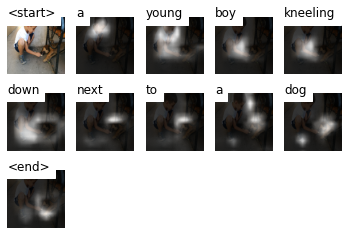

In [21]:
test_image_path = "test_images/child_dog1.jpg"
# Encode, decode with attention and beam search
seq, alphas = caption_image_beam_search(encoder, decoder, cfgData, test_image_path, word_map, beam_size)
alphas = torch.FloatTensor(alphas)

# Visualize caption and attention of best sequence
visualize_att(test_image_path, seq, alphas, rev_word_map, False)